In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
projectPath = '/content/drive/MyDrive/GT/Academics-GT/DL/FinalProject'
# projectPath = '/content/drive/MyDrive/College/S6/CS7643/FinalProject'
# projectPath = '/content/drive/MyDrive/FinalProject'

import sys
sys.path.append(projectPath)

In [3]:
!pip install pytorch-lightning

     |████████████████████████████████| 563kB 5.1MB/s 
     |████████████████████████████████| 276kB 7.9MB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 829kB 11.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=9ffc7f2c1cbf9662005cadc5cd2084cd3c58eb97846affff73941bb6aa43d82a
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=beaa9d9b5e7ddd226d4a2d79a09bc31a237de53bc067ddbca07a0ecef17653b7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninsta

In [4]:
!pip install l5kit
!pip install -U PyYAML

     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133kB 17.4MB/s 
     |████████████████████████████████| 42.9MB 94kB/s 
     |████████████████████████████████| 5.8MB 45.5MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.4.3-cp36-none-any.whl size=33551 sha256=f3654df1a78ba2f09ed585ae484a6d1af833d4c0765902cb58e2904e3f9dc887
  Stored in directory: /root/.cache/pip/wheels/be/e2/40/c642184272827b886ddb12661008199fe1460d4b05ddfc2670
Successfully built pymap3d
  Created wheel for transforms3d: filename=transforms3d-0.3.1-cp36-none-any.whl size=59374 sha256=07cae3cde0abefd383121482dcd1c7a1bce3a4cf1c1f7fd1e8240084d6a09d7d
  Stored in directory: /root/.cache/pip/wheels/3d/3c/84/28d36677f3c760c048bd02b5a547ea0c4027770cc9cdb9af1e
  Created wheel for ptable: filename=PTabl

In [5]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/kaggle.json
!echo '{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}' >> /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!mkdir lyftdataset
!cd lyftdataset
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle --version
!kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles -p /content/lyftdataset/

{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}
     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=d44543390b9270ac58ac6fcd5e1ef65d274ee18edb55181f529381d463ff5d3a
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9
Kaggle API 1.5.10
100% 18.2G/18.3G [07:16<00:00, 56.3MB/s]
100% 18.3G/18.3G [07:16<00:00, 44.9MB/s]


In [6]:
from utils import *
from mhajam import *
from MultiAgentLoaders import *

In [7]:
%cd lyftdataset
!unzip -q lyft-motion-prediction-autonomous-vehicles.zip

/content/lyftdataset


In [8]:
# Make sure you are in /content/lyftdataset
!pwd
# %cd lyftdataset

/content/lyftdataset


In [9]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [10]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(projectPath + "/agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'input_size': 3, 'input_embedding_size': 32, 'encoder_size': 64, 'decoder_size': 128, 'num_heads': 16, 'prob_fc1_out': 100, 'rasterCNN_conv1_kernel_size': 7, 'rasterCNN_conv1_stride': 2, 'rasterCNN_conv1_padding': 0, 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1, 'cnn_out_channels': 64, 'q_out_channels': 64}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.5, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 16}, 'val_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': 

## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [ ]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [1]:
projectPath = '/content/drive/MyDrive/GT/Academics-GT/DL/FinalProject'
# projectPath = '/content/drive/MyDrive/College/S6/CS7643/FinalProject'
# projectPath = '/content/drive/MyDrive/FinalProject'

import sys
sys.path.append(projectPath)

from utils import *
from MultiAgentLoaders import *
from mhajam import *

!pwd
%cd lyftdataset

from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(projectPath + "/agent_motion_config.yaml")
print(cfg)

/content
/content/lyftdataset
{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'input_size': 3, 'input_embedding_size': 32, 'encoder_size': 64, 'decoder_size': 128, 'num_heads': 16, 'prob_fc1_out': 100, 'rasterCNN_conv1_kernel_size': 7, 'rasterCNN_conv1_stride': 2, 'rasterCNN_conv1_padding': 0, 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1, 'cnn_out_channels': 64, 'q_out_channels': 64, 'raster_img_center_offset': 112}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.5, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 16}, 'val_dataloade

In [2]:
datamodule = MultiAgentDataModule(cfg)

In [ ]:
for item in datamodule.train_dataloader():
    # print(item['ego_dict'].keys())
    # print(item['ego_dict']['history_positions'].shape, len(item['others_dict']))
    # print(item['others_dict'][0].keys())
    (agentsHist, lengths, rastImg, targetPos, targetValid, agent_from_raster) = item
    print(agentsHist.shape, lengths, rastImg.shape, targetPos.shape, targetValid.shape, agent_from_raster.shape)
    # print(agentsHist.type(), lengths, rastImg.type(), targetPos.type(), targetValid.type())
    # print(agentsHist[0][0])
    # print(targetPos)
    # print(targetValid)
    result = mhajam(item)
    print('result', result[0])
    print('target', targetPos[0])
    break

torch.Size([32, 16, 11, 3]) tensor([ 4, 12, 11, 16,  1,  4, 13, 13,  1, 11,  6, 11, 10, 11,  5,  8, 11,  5,
         6,  4, 10,  6, 11,  7, 12,  5, 11,  3,  5, 11, 11, 12]) torch.Size([32, 25, 224, 224]) torch.Size([32, 50, 2]) torch.Size([32, 50]) torch.Size([32, 3, 3])


In [ ]:

# count = 10
# for item in datamodule.train_dataloader():
#     print(testNaman(item))
#     if count < 0:
#         break
#     count -= 1

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_dataloader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])


In [ ]:
for item in train_dataloader:
    print(item.keys())
    break

KeyboardInterrupt: ignored

In [3]:
mhajam = MHAJAM(cfg['model_params'])

In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = build_model(cfg).to(device)
optimizer = optim.Adam(mhajam.parameters(), lr=6e-3)
criterion = nn.MSELoss(reduction="none")

In [ ]:
# for item in datamodule.train_dataloader():
#     aggregatedPredictions, probability = mhajam(item)
#     print(probability.shape)
#     print(aggregatedPredictions.shape)
#     break

In [ ]:
# def _assert_shapes(ground_truth: np.ndarray, pred: np.ndarray, confidences: np.ndarray, avails: np.ndarray) -> None:
#     """
#     Check the shapes of args required by metrics
#     Args:
#         ground_truth (np.ndarray): array of shape (timesteps)x(2D coords)
#         pred (np.ndarray): array of shape (modes)x(timesteps)x(2D coords)
#         confidences (np.ndarray): array of shape (modes) with a confidence for each mode in each sample
#         avails (np.ndarray): array of shape (timesteps) with the availability for each gt timesteps
#     Returns:
#     """
#     assert len(pred.shape) == 3, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
#     num_modes, future_len, num_coords = pred.shape

#     assert ground_truth.shape == (
#         future_len,
#         num_coords,
#     ), f"expected 2D (Time x Coords) array for gt, got {ground_truth.shape}"
#     assert confidences.shape == (num_modes,), f"expected 1D (Modes) array for confidences, got {confidences.shape}"
#     assert np.allclose(np.sum(confidences), 1), "confidences should sum to 1"
#     assert avails.shape == (future_len,), f"expected 1D (Time) array for avails, got {avails.shape}"
#     # assert all data are valid
#     assert np.isfinite(pred).all(), "invalid value found in pred"
#     assert np.isfinite(ground_truth).all(), "invalid value found in gt"
#     assert np.isfinite(confidences).all(), "invalid value found in confidences"
#     assert np.isfinite(avails).all(), "invalid value found in avails"

# LOSS
def custom_neg_multi_log_likelihood(
    ground_truth: np.ndarray, pred: np.ndarray, confidences: np.ndarray, avails: np.ndarray
) -> np.ndarray:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    For more details about used loss function and reformulation, please see
    https://github.com/lyft/l5kit/blob/master/competition.md.
    Args:
        ground_truth (np.ndarray): array of shape (B, T, 2)
        pred (np.ndarray): array of shape (B, numHeads, T, 2)
        confidences (np.ndarray): (B, numHeads)
        avails (np.ndarray): (B, T)
    Returns:
        np.ndarray: negative log-likelihood for this example, a single float number
    """
    # _assert_shapes(ground_truth, pred, confidences, avails)
    # ground_truth = np.expand_dims(ground_truth, 0)  # add modes
    ground_truth = ground_truth.unsqueeze(1)
    # avails = avails[np.newaxis, :, np.newaxis]  # add modes and cords
    avails = avails.unsqueeze(1).unsqueeze(-1)

    error = torch.sum(((ground_truth - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability
    # (B, numHeads, T)

    # with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
    confidences = confidences + 1e-15
    error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce timesteps
    # (B, numHeads)

    # use max aggregator on modes for numerical stability
    max_value = error.max() # error are negative at this point, so max() gives the minimum one
    # error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1)) - max_value  # reduce modes
    error = -torch.logsumexp(error - max_value, keepdim=True, dim=-1) - max_value
    return error.mean()

In [ ]:
# ==== TRAIN LOOP

for epoch in range(5):
    tr_it = iter(datamodule.train_dataloader())
    progress_bar = tqdm(range(len(datamodule.train_dataloader())))
    losses_train = []
    mhajam = mhajam.to(device)
    for _ in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)

        mhajam.train()
        torch.set_grad_enabled(True)
        torch.autograd.set_detect_anomaly(True)
        
        agentsHist, lengths, rastImg, targetPos, targetValid = data
        agentsHist = agentsHist.to(device)
        rastImg = rastImg.to(device)
        targetPos = targetPos.to(device)
        targetValid = targetValid.to(device)
        
        # Forward pass
        aggregatedPredictions, probability = mhajam((agentsHist, lengths, rastImg, targetPos, targetValid))

        # loss = criterion(outputs, targets)
        # not all the output steps are valid, but we can filter them out from the loss using availabilities
        # loss = loss * target_availabilities
        # loss = loss.mean()
        loss = custom_neg_multi_log_likelihood(targetPos, aggregatedPredictions, probability, targetValid)
        # loss = torch.sum(aggregatedPredictions)
        # loss, _ = forward(data, model, device, criterion)

        print("epoch: ", epoch, "loss: ", loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")



  0%|          | 0/3489 [00:00<?, ?it/s]

epoch:  0 loss:  538513.75



loss: 538513.75 loss(avg): 538513.75:   0%|          | 1/3489 [01:57<113:27:47, 117.11s/it]

epoch:  0 loss:  511587.625



loss: 511587.625 loss(avg): 525050.6875:   0%|          | 2/3489 [02:04<81:36:40, 84.26s/it]  

epoch:  0 loss:  520109.375



loss: 520109.375 loss(avg): 523403.5833333333:   0%|          | 3/3489 [02:09<58:22:42, 60.29s/it]

epoch:  0 loss:  407376.96875



loss: 407376.96875 loss(avg): 494396.9296875:   0%|          | 4/3489 [02:13<42:15:13, 43.65s/it]

epoch:  0 loss:  539541.625



loss: 539541.625 loss(avg): 503425.86875:   0%|          | 5/3489 [02:18<30:57:27, 31.99s/it]

epoch:  0 loss:  479783.34375



loss: 479783.34375 loss(avg): 499485.4479166667:   0%|          | 5/3489 [02:23<30:57:27, 31.99s/it]
loss: 479783.34375 loss(avg): 499485.4479166667:   0%|          | 6/3489 [02:23<22:56:55, 23.72s/it]

epoch:  0 loss:  487663.1875



loss: 487663.1875 loss(avg): 497796.5535714286:   0%|          | 7/3489 [02:27<17:14:40, 17.83s/it]

epoch:  0 loss:  574222.4375



loss: 574222.4375 loss(avg): 507349.7890625:   0%|          | 8/3489 [02:32<13:28:14, 13.93s/it]

epoch:  0 loss:  556760.625



loss: 556760.625 loss(avg): 512839.88194444444:   0%|          | 9/3489 [02:37<10:54:54, 11.29s/it]

epoch:  0 loss:  416573.53125



loss: 416573.53125 loss(avg): 503213.246875:   0%|          | 10/3489 [02:41<8:54:41,  9.22s/it]

epoch:  0 loss:  501852.75



loss: 501852.75 loss(avg): 503089.5653409091:   0%|          | 11/3489 [02:45<7:29:47,  7.76s/it]

epoch:  0 loss:  578493.25



loss: 578493.25 loss(avg): 509373.2057291667:   0%|          | 12/3489 [02:50<6:39:49,  6.90s/it]

epoch:  0 loss:  512390.65625



loss: 512390.65625 loss(avg): 509605.3173076923:   0%|          | 12/3489 [02:55<6:39:49,  6.90s/it]
loss: 512390.65625 loss(avg): 509605.3173076923:   0%|          | 13/3489 [02:55<5:53:00,  6.09s/it]

epoch:  0 loss:  487752.6875



loss: 487752.6875 loss(avg): 508044.4151785714:   0%|          | 14/3489 [02:59<5:18:50,  5.51s/it]

epoch:  0 loss:  403325.53125



loss: 403325.53125 loss(avg): 501063.15625:   0%|          | 15/3489 [03:03<5:01:03,  5.20s/it]

epoch:  0 loss:  439735.8125



loss: 439735.8125 loss(avg): 497230.197265625:   0%|          | 16/3489 [03:08<4:51:48,  5.04s/it]

epoch:  0 loss:  468541.3125



loss: 468541.3125 loss(avg): 495542.61580882355:   0%|          | 16/3489 [03:13<4:51:48,  5.04s/it]
loss: 468541.3125 loss(avg): 495542.61580882355:   0%|          | 17/3489 [03:13<4:53:05,  5.06s/it]

epoch:  0 loss:  419195.9375



loss: 419195.9375 loss(avg): 491301.13368055556:   0%|          | 17/3489 [03:17<4:53:05,  5.06s/it]
loss: 419195.9375 loss(avg): 491301.13368055556:   1%|          | 18/3489 [03:17<4:41:45,  4.87s/it]

epoch:  0 loss:  494100.78125



loss: 494100.78125 loss(avg): 491448.4835526316:   1%|          | 18/3489 [03:22<4:41:45,  4.87s/it]
loss: 494100.78125 loss(avg): 491448.4835526316:   1%|          | 19/3489 [03:22<4:29:45,  4.66s/it]

epoch:  0 loss:  444305.125



loss: 444305.125 loss(avg): 489091.315625:   1%|          | 20/3489 [03:27<4:37:48,  4.80s/it]

epoch:  0 loss:  521039.3125



loss: 521039.3125 loss(avg): 490612.6488095238:   1%|          | 21/3489 [03:31<4:37:02,  4.79s/it]

epoch:  0 loss:  377018.6875



loss: 377018.6875 loss(avg): 485449.2869318182:   1%|          | 22/3489 [03:36<4:31:07,  4.69s/it]

epoch:  0 loss:  381991.1875



loss: 381991.1875 loss(avg): 480951.10869565216:   1%|          | 22/3489 [03:40<4:31:07,  4.69s/it]
loss: 381991.1875 loss(avg): 480951.10869565216:   1%|          | 23/3489 [03:40<4:21:22,  4.52s/it]

epoch:  0 loss:  407891.375



loss: 407891.375 loss(avg): 477906.953125:   1%|          | 24/3489 [03:44<4:19:14,  4.49s/it]

epoch:  0 loss:  392851.78125



loss: 392851.78125 loss(avg): 474504.74625:   1%|          | 25/3489 [03:49<4:14:16,  4.40s/it]

epoch:  0 loss:  433433.875



loss: 433433.875 loss(avg): 472925.09735576925:   1%|          | 26/3489 [03:53<4:12:36,  4.38s/it]

epoch:  0 loss:  388699.9375



loss: 388699.9375 loss(avg): 469805.64699074073:   1%|          | 26/3489 [03:57<4:12:36,  4.38s/it]
loss: 388699.9375 loss(avg): 469805.64699074073:   1%|          | 27/3489 [03:57<4:10:17,  4.34s/it]

epoch:  0 loss:  420919.59375



loss: 420919.59375 loss(avg): 468059.71651785716:   1%|          | 27/3489 [04:02<4:10:17,  4.34s/it]
loss: 420919.59375 loss(avg): 468059.71651785716:   1%|          | 28/3489 [04:02<4:25:02,  4.59s/it]

epoch:  0 loss:  360720.0625



loss: 360720.0625 loss(avg): 464358.349137931:   1%|          | 29/3489 [04:07<4:17:57,  4.47s/it]

epoch:  0 loss:  357351.34375



loss: 357351.34375 loss(avg): 460791.44895833335:   1%|          | 29/3489 [04:12<4:17:57,  4.47s/it]
loss: 357351.34375 loss(avg): 460791.44895833335:   1%|          | 30/3489 [04:12<4:30:27,  4.69s/it]

epoch:  0 loss:  334205.3125



loss: 334205.3125 loss(avg): 456708.0252016129:   1%|          | 31/3489 [04:16<4:23:26,  4.57s/it]

epoch:  0 loss:  296605.9375



loss: 296605.9375 loss(avg): 451704.8349609375:   1%|          | 32/3489 [04:20<4:17:49,  4.47s/it]

epoch:  0 loss:  342851.875



loss: 342851.875 loss(avg): 448406.2604166667:   1%|          | 33/3489 [04:25<4:26:57,  4.63s/it]

epoch:  0 loss:  320175.6875



loss: 320175.6875 loss(avg): 444634.7729779412:   1%|          | 34/3489 [04:30<4:30:30,  4.70s/it]

epoch:  0 loss:  326816.0625



loss: 326816.0625 loss(avg): 441268.5241071429:   1%|          | 35/3489 [04:34<4:22:21,  4.56s/it]

epoch:  0 loss:  347021.5625



loss: 347021.5625 loss(avg): 438650.5529513889:   1%|          | 36/3489 [04:39<4:21:00,  4.54s/it]

epoch:  0 loss:  310900.8125



loss: 310900.8125 loss(avg): 435197.8572635135:   1%|          | 37/3489 [04:44<4:34:45,  4.78s/it]

epoch:  0 loss:  294417.8125



loss: 294417.8125 loss(avg): 431493.11924342107:   1%|          | 37/3489 [04:48<4:34:45,  4.78s/it]
loss: 294417.8125 loss(avg): 431493.11924342107:   1%|          | 38/3489 [04:48<4:26:02,  4.63s/it]

epoch:  0 loss:  329802.34375



loss: 329802.34375 loss(avg): 428885.66346153844:   1%|          | 38/3489 [04:53<4:26:02,  4.63s/it]
loss: 329802.34375 loss(avg): 428885.66346153844:   1%|          | 39/3489 [04:53<4:30:37,  4.71s/it]

epoch:  0 loss:  327044.8125



loss: 327044.8125 loss(avg): 426339.6421875:   1%|          | 40/3489 [04:58<4:25:22,  4.62s/it]

epoch:  0 loss:  315454.0



loss: 315454.0 loss(avg): 423635.1143292683:   1%|          | 41/3489 [05:02<4:16:59,  4.47s/it]

epoch:  0 loss:  271057.03125



loss: 271057.03125 loss(avg): 420002.30282738095:   1%|          | 41/3489 [05:06<4:16:59,  4.47s/it]
loss: 271057.03125 loss(avg): 420002.30282738095:   1%|          | 42/3489 [05:06<4:14:57,  4.44s/it]

epoch:  0 loss:  329659.75



loss: 329659.75 loss(avg): 417901.3132267442:   1%|          | 43/3489 [05:12<4:28:32,  4.68s/it]

epoch:  0 loss:  289993.625



loss: 289993.625 loss(avg): 414994.3203125:   1%|▏         | 44/3489 [05:16<4:31:25,  4.73s/it]

epoch:  0 loss:  271661.5625



loss: 271661.5625 loss(avg): 411809.14791666664:   1%|▏         | 44/3489 [05:21<4:31:25,  4.73s/it]
loss: 271661.5625 loss(avg): 411809.14791666664:   1%|▏         | 45/3489 [05:21<4:28:40,  4.68s/it]

epoch:  0 loss:  283144.0625



loss: 283144.0625 loss(avg): 409012.0808423913:   1%|▏         | 46/3489 [05:26<4:38:08,  4.85s/it]

epoch:  0 loss:  291777.9375



loss: 291777.9375 loss(avg): 406517.73736702127:   1%|▏         | 46/3489 [05:30<4:38:08,  4.85s/it]
loss: 291777.9375 loss(avg): 406517.73736702127:   1%|▏         | 47/3489 [05:30<4:27:38,  4.67s/it]

epoch:  0 loss:  260728.5625



loss: 260728.5625 loss(avg): 403480.462890625:   1%|▏         | 48/3489 [05:35<4:23:48,  4.60s/it]

epoch:  0 loss:  292743.8125



loss: 292743.8125 loss(avg): 401220.53125:   1%|▏         | 49/3489 [05:40<4:27:57,  4.67s/it]

epoch:  0 loss:  295661.3125



loss: 295661.3125 loss(avg): 399109.346875:   1%|▏         | 50/3489 [05:44<4:19:30,  4.53s/it]

epoch:  0 loss:  281292.34375



loss: 281292.34375 loss(avg): 396799.20955882355:   1%|▏         | 50/3489 [05:49<4:19:30,  4.53s/it]
loss: 281292.34375 loss(avg): 396799.20955882355:   1%|▏         | 51/3489 [05:49<4:26:21,  4.65s/it]

epoch:  0 loss:  304418.1875



loss: 304418.1875 loss(avg): 395022.6514423077:   1%|▏         | 52/3489 [05:53<4:23:10,  4.59s/it]

epoch:  0 loss:  253820.6875



loss: 253820.6875 loss(avg): 392358.4634433962:   2%|▏         | 53/3489 [05:57<4:14:55,  4.45s/it]

epoch:  0 loss:  266478.71875



loss: 266478.71875 loss(avg): 390027.35706018517:   2%|▏         | 53/3489 [06:02<4:14:55,  4.45s/it]
loss: 266478.71875 loss(avg): 390027.35706018517:   2%|▏         | 54/3489 [06:02<4:18:16,  4.51s/it]

epoch:  0 loss:  252130.71875



loss: 252130.71875 loss(avg): 387520.14545454545:   2%|▏         | 54/3489 [06:06<4:18:16,  4.51s/it]
loss: 252130.71875 loss(avg): 387520.14545454545:   2%|▏         | 55/3489 [06:06<4:10:55,  4.38s/it]

epoch:  0 loss:  273570.71875



loss: 273570.71875 loss(avg): 385485.33426339284:   2%|▏         | 55/3489 [06:11<4:10:55,  4.38s/it]
loss: 273570.71875 loss(avg): 385485.33426339284:   2%|▏         | 56/3489 [06:11<4:10:46,  4.38s/it]

epoch:  0 loss:  242131.40625



loss: 242131.40625 loss(avg): 382970.35307017545:   2%|▏         | 56/3489 [06:15<4:10:46,  4.38s/it]
loss: 242131.40625 loss(avg): 382970.35307017545:   2%|▏         | 57/3489 [06:15<4:08:45,  4.35s/it]

epoch:  0 loss:  248275.046875



loss: 248275.046875 loss(avg): 380648.0202047414:   2%|▏         | 57/3489 [06:20<4:08:45,  4.35s/it]
loss: 248275.046875 loss(avg): 380648.0202047414:   2%|▏         | 58/3489 [06:20<4:18:38,  4.52s/it]

epoch:  0 loss:  220830.0



loss: 220830.0 loss(avg): 377939.2402012712:   2%|▏         | 59/3489 [06:24<4:19:35,  4.54s/it]

epoch:  0 loss:  234747.15625



loss: 234747.15625 loss(avg): 375552.70546875:   2%|▏         | 60/3489 [06:29<4:30:33,  4.73s/it]

epoch:  0 loss:  293600.59375



loss: 293600.59375 loss(avg): 374209.228227459:   2%|▏         | 61/3489 [06:34<4:31:35,  4.75s/it]

epoch:  0 loss:  282095.1875



loss: 282095.1875 loss(avg): 372723.51789314515:   2%|▏         | 61/3489 [06:39<4:31:35,  4.75s/it]
loss: 282095.1875 loss(avg): 372723.51789314515:   2%|▏         | 62/3489 [06:39<4:22:39,  4.60s/it]

epoch:  0 loss:  241944.25



loss: 241944.25 loss(avg): 370647.65649801586:   2%|▏         | 63/3489 [06:44<4:30:59,  4.75s/it]

epoch:  0 loss:  203652.59375



loss: 203652.59375 loss(avg): 368038.3586425781:   2%|▏         | 63/3489 [06:48<4:30:59,  4.75s/it]
loss: 203652.59375 loss(avg): 368038.3586425781:   2%|▏         | 64/3489 [06:48<4:23:03,  4.61s/it]

epoch:  0 loss:  274113.8125



loss: 274113.8125 loss(avg): 366593.365625:   2%|▏         | 65/3489 [06:53<4:30:04,  4.73s/it]

epoch:  0 loss:  189830.96875



loss: 189830.96875 loss(avg): 363915.1474905303:   2%|▏         | 65/3489 [06:57<4:30:04,  4.73s/it]
loss: 189830.96875 loss(avg): 363915.1474905303:   2%|▏         | 66/3489 [06:57<4:24:51,  4.64s/it]

epoch:  0 loss:  225856.234375



loss: 225856.234375 loss(avg): 361854.5666977612:   2%|▏         | 66/3489 [07:03<4:24:51,  4.64s/it]
loss: 225856.234375 loss(avg): 361854.5666977612:   2%|▏         | 67/3489 [07:03<4:34:30,  4.81s/it]

epoch:  0 loss:  167967.3125



loss: 167967.3125 loss(avg): 359003.2835477941:   2%|▏         | 68/3489 [07:07<4:23:18,  4.62s/it]

epoch:  0 loss:  208488.5625



loss: 208488.5625 loss(avg): 356821.91077898553:   2%|▏         | 68/3489 [07:11<4:23:18,  4.62s/it]
loss: 208488.5625 loss(avg): 356821.91077898553:   2%|▏         | 69/3489 [07:11<4:16:09,  4.49s/it]

epoch:  0 loss:  222298.28125



loss: 222298.28125 loss(avg): 354900.14464285714:   2%|▏         | 69/3489 [07:15<4:16:09,  4.49s/it]
loss: 222298.28125 loss(avg): 354900.14464285714:   2%|▏         | 70/3489 [07:15<4:13:23,  4.45s/it]

epoch:  0 loss:  198739.3125



loss: 198739.3125 loss(avg): 352700.6963028169:   2%|▏         | 71/3489 [07:20<4:22:10,  4.60s/it]

epoch:  0 loss:  226173.515625



loss: 226173.515625 loss(avg): 350943.3743489583:   2%|▏         | 71/3489 [07:25<4:22:10,  4.60s/it]
loss: 226173.515625 loss(avg): 350943.3743489583:   2%|▏         | 72/3489 [07:25<4:16:47,  4.51s/it]

epoch:  0 loss:  190317.6875



loss: 190317.6875 loss(avg): 348743.0224743151:   2%|▏         | 73/3489 [07:30<4:26:55,  4.69s/it]

epoch:  0 loss:  167711.59375



loss: 167711.59375 loss(avg): 346296.6518158784:   2%|▏         | 73/3489 [07:34<4:26:55,  4.69s/it]
loss: 167711.59375 loss(avg): 346296.6518158784:   2%|▏         | 74/3489 [07:34<4:17:59,  4.53s/it]

epoch:  0 loss:  160995.5



loss: 160995.5 loss(avg): 343825.96979166666:   2%|▏         | 75/3489 [07:39<4:29:54,  4.74s/it]

epoch:  0 loss:  151041.828125



loss: 151041.828125 loss(avg): 341289.3363486842:   2%|▏         | 75/3489 [07:44<4:29:54,  4.74s/it]
loss: 151041.828125 loss(avg): 341289.3363486842:   2%|▏         | 76/3489 [07:44<4:26:25,  4.68s/it]

epoch:  0 loss:  137507.84375



loss: 137507.84375 loss(avg): 338642.8234577922:   2%|▏         | 76/3489 [07:48<4:26:25,  4.68s/it] 
loss: 137507.84375 loss(avg): 338642.8234577922:   2%|▏         | 77/3489 [07:48<4:21:05,  4.59s/it]

epoch:  0 loss:  160891.78125



loss: 160891.78125 loss(avg): 336363.9639423077:   2%|▏         | 77/3489 [07:52<4:21:05,  4.59s/it]
loss: 160891.78125 loss(avg): 336363.9639423077:   2%|▏         | 78/3489 [07:52<4:15:33,  4.50s/it]

epoch:  0 loss:  150904.28125



loss: 150904.28125 loss(avg): 334016.3730221519:   2%|▏         | 78/3489 [07:57<4:15:33,  4.50s/it]
loss: 150904.28125 loss(avg): 334016.3730221519:   2%|▏         | 79/3489 [07:57<4:13:16,  4.46s/it]

epoch:  0 loss:  144565.71875



loss: 144565.71875 loss(avg): 331648.23984375:   2%|▏         | 80/3489 [08:01<4:19:09,  4.56s/it]

epoch:  0 loss:  148472.140625



loss: 148472.140625 loss(avg): 329386.80652006174:   2%|▏         | 80/3489 [08:07<4:19:09,  4.56s/it]
loss: 148472.140625 loss(avg): 329386.80652006174:   2%|▏         | 81/3489 [08:07<4:34:21,  4.83s/it]

epoch:  0 loss:  170550.84375



loss: 170550.84375 loss(avg): 327449.7825838415:   2%|▏         | 81/3489 [08:12<4:34:21,  4.83s/it]  
loss: 170550.84375 loss(avg): 327449.7825838415:   2%|▏         | 82/3489 [08:12<4:42:00,  4.97s/it]

epoch:  0 loss:  145365.0



loss: 145365.0 loss(avg): 325255.9900225904:   2%|▏         | 83/3489 [08:17<4:34:26,  4.83s/it]

epoch:  0 loss:  141902.96875



loss: 141902.96875 loss(avg): 323073.2159598214:   2%|▏         | 83/3489 [08:21<4:34:26,  4.83s/it]
loss: 141902.96875 loss(avg): 323073.2159598214:   2%|▏         | 84/3489 [08:21<4:26:17,  4.69s/it]

epoch:  0 loss:  147318.5625



loss: 147318.5625 loss(avg): 321005.51415441174:   2%|▏         | 84/3489 [08:25<4:26:17,  4.69s/it]
loss: 147318.5625 loss(avg): 321005.51415441174:   2%|▏         | 85/3489 [08:25<4:21:08,  4.60s/it]

epoch:  0 loss:  164544.5625



loss: 164544.5625 loss(avg): 319186.2007630814:   2%|▏         | 86/3489 [08:30<4:28:08,  4.73s/it]

epoch:  0 loss:  150014.21875



loss: 150014.21875 loss(avg): 317241.6952227011:   2%|▏         | 86/3489 [08:35<4:28:08,  4.73s/it]
loss: 150014.21875 loss(avg): 317241.6952227011:   2%|▏         | 87/3489 [08:35<4:33:36,  4.83s/it]

epoch:  0 loss:  148750.46875



loss: 148750.46875 loss(avg): 315327.0221946023:   2%|▏         | 87/3489 [08:41<4:33:36,  4.83s/it]
loss: 148750.46875 loss(avg): 315327.0221946023:   3%|▎         | 88/3489 [08:41<4:39:47,  4.94s/it]

epoch:  0 loss:  155480.328125



loss: 155480.328125 loss(avg): 313530.9919241573:   3%|▎         | 88/3489 [08:45<4:39:47,  4.94s/it]
loss: 155480.328125 loss(avg): 313530.9919241573:   3%|▎         | 89/3489 [08:45<4:35:49,  4.87s/it]

epoch:  0 loss:  133958.4375



loss: 133958.4375 loss(avg): 311535.74131944444:   3%|▎         | 89/3489 [08:50<4:35:49,  4.87s/it] 
loss: 133958.4375 loss(avg): 311535.74131944444:   3%|▎         | 90/3489 [08:50<4:23:34,  4.65s/it]

epoch:  0 loss:  140586.078125



loss: 140586.078125 loss(avg): 309657.173592033:   3%|▎         | 90/3489 [08:55<4:23:34,  4.65s/it]
loss: 140586.078125 loss(avg): 309657.173592033:   3%|▎         | 91/3489 [08:55<4:36:33,  4.88s/it]

epoch:  0 loss:  114000.3515625



loss: 114000.3515625 loss(avg): 307530.46900475543:   3%|▎         | 91/3489 [09:00<4:36:33,  4.88s/it]
loss: 114000.3515625 loss(avg): 307530.46900475543:   3%|▎         | 92/3489 [09:00<4:33:41,  4.83s/it]

epoch:  0 loss:  158154.0625



loss: 158154.0625 loss(avg): 305924.27108534944:   3%|▎         | 92/3489 [09:04<4:33:41,  4.83s/it]   
loss: 158154.0625 loss(avg): 305924.27108534944:   3%|▎         | 93/3489 [09:04<4:20:34,  4.60s/it]

epoch:  0 loss:  126903.828125



loss: 126903.828125 loss(avg): 304019.79828789894:   3%|▎         | 93/3489 [09:09<4:20:34,  4.60s/it]
loss: 126903.828125 loss(avg): 304019.79828789894:   3%|▎         | 94/3489 [09:09<4:28:58,  4.75s/it]

epoch:  0 loss:  156837.546875



loss: 156837.546875 loss(avg): 302470.51143092103:   3%|▎         | 94/3489 [09:14<4:28:58,  4.75s/it]
loss: 156837.546875 loss(avg): 302470.51143092103:   3%|▎         | 95/3489 [09:14<4:30:35,  4.78s/it]

epoch:  0 loss:  124957.3203125



loss: 124957.3203125 loss(avg): 300621.4156901042:   3%|▎         | 95/3489 [09:19<4:30:35,  4.78s/it]
loss: 124957.3203125 loss(avg): 300621.4156901042:   3%|▎         | 96/3489 [09:19<4:32:33,  4.82s/it]

epoch:  0 loss:  119469.9375



loss: 119469.9375 loss(avg): 298753.87467783503:   3%|▎         | 96/3489 [09:24<4:32:33,  4.82s/it]  
loss: 119469.9375 loss(avg): 298753.87467783503:   3%|▎         | 97/3489 [09:24<4:35:11,  4.87s/it]

epoch:  0 loss:  122572.96875



loss: 122572.96875 loss(avg): 296956.11033163266:   3%|▎         | 97/3489 [09:28<4:35:11,  4.87s/it]
loss: 122572.96875 loss(avg): 296956.11033163266:   3%|▎         | 98/3489 [09:28<4:35:35,  4.88s/it]

epoch:  0 loss:  110571.703125



loss: 110571.703125 loss(avg): 295073.43955176766:   3%|▎         | 98/3489 [09:33<4:35:35,  4.88s/it]
loss: 110571.703125 loss(avg): 295073.43955176766:   3%|▎         | 99/3489 [09:33<4:24:12,  4.68s/it]

epoch:  0 loss:  120501.375



loss: 120501.375 loss(avg): 293327.71890625:   3%|▎         | 100/3489 [09:37<4:16:40,  4.54s/it]

epoch:  0 loss:  133301.109375



loss: 133301.109375 loss(avg): 291743.297029703:   3%|▎         | 100/3489 [09:42<4:16:40,  4.54s/it]
loss: 133301.109375 loss(avg): 291743.297029703:   3%|▎         | 101/3489 [09:42<4:24:56,  4.69s/it]

epoch:  0 loss:  78101.0234375



loss: 78101.0234375 loss(avg): 289648.76493566175:   3%|▎         | 101/3489 [09:46<4:24:56,  4.69s/it]
loss: 78101.0234375 loss(avg): 289648.76493566175:   3%|▎         | 102/3489 [09:46<4:21:13,  4.63s/it]

epoch:  0 loss:  113232.0859375



loss: 113232.0859375 loss(avg): 287935.98164441745:   3%|▎         | 102/3489 [09:51<4:21:13,  4.63s/it]
loss: 113232.0859375 loss(avg): 287935.98164441745:   3%|▎         | 103/3489 [09:51<4:14:53,  4.52s/it]

epoch:  0 loss:  90541.546875



loss: 90541.546875 loss(avg): 286037.95823317306:   3%|▎         | 103/3489 [09:55<4:14:53,  4.52s/it]  
loss: 90541.546875 loss(avg): 286037.95823317306:   3%|▎         | 104/3489 [09:55<4:10:02,  4.43s/it]

epoch:  0 loss:  108486.515625



loss: 108486.515625 loss(avg): 284346.99211309524:   3%|▎         | 104/3489 [09:59<4:10:02,  4.43s/it]
loss: 108486.515625 loss(avg): 284346.99211309524:   3%|▎         | 105/3489 [09:59<4:08:21,  4.40s/it]

epoch:  0 loss:  76328.5703125



loss: 76328.5703125 loss(avg): 282384.5541715802:   3%|▎         | 105/3489 [10:04<4:08:21,  4.40s/it] 
loss: 76328.5703125 loss(avg): 282384.5541715802:   3%|▎         | 106/3489 [10:04<4:12:38,  4.48s/it]

epoch:  0 loss:  98101.59375



loss: 98101.59375 loss(avg): 280662.2835134346:   3%|▎         | 107/3489 [10:09<4:21:52,  4.65s/it]

epoch:  0 loss:  82620.9609375



loss: 82620.9609375 loss(avg): 278828.5675636574:   3%|▎         | 107/3489 [10:13<4:21:52,  4.65s/it]
loss: 82620.9609375 loss(avg): 278828.5675636574:   3%|▎         | 108/3489 [10:13<4:16:04,  4.54s/it]

epoch:  0 loss:  94412.15625



loss: 94412.15625 loss(avg): 277136.6738818807:   3%|▎         | 109/3489 [10:18<4:14:03,  4.51s/it]

epoch:  0 loss:  76957.421875



loss: 76957.421875 loss(avg): 275316.8625:   3%|▎         | 110/3489 [10:22<4:10:48,  4.45s/it]

epoch:  0 loss:  66182.546875



loss: 66182.546875 loss(avg): 273432.7695664414:   3%|▎         | 110/3489 [10:27<4:10:48,  4.45s/it]
loss: 66182.546875 loss(avg): 273432.7695664414:   3%|▎         | 111/3489 [10:27<4:23:52,  4.69s/it]

epoch:  0 loss:  85825.515625



loss: 85825.515625 loss(avg): 271757.70479910716:   3%|▎         | 111/3489 [10:32<4:23:52,  4.69s/it]
loss: 85825.515625 loss(avg): 271757.70479910716:   3%|▎         | 112/3489 [10:32<4:25:44,  4.72s/it]

epoch:  0 loss:  77273.75



loss: 77273.75 loss(avg): 270036.6078539823:   3%|▎         | 113/3489 [10:37<4:21:12,  4.64s/it]

epoch:  0 loss:  68864.828125



loss: 68864.828125 loss(avg): 268271.9431195175:   3%|▎         | 113/3489 [10:42<4:21:12,  4.64s/it]
loss: 68864.828125 loss(avg): 268271.9431195175:   3%|▎         | 114/3489 [10:42<4:30:18,  4.81s/it]

epoch:  0 loss:  67175.7578125



loss: 67175.7578125 loss(avg): 266523.28063858696:   3%|▎         | 114/3489 [10:46<4:30:18,  4.81s/it]
loss: 67175.7578125 loss(avg): 266523.28063858696:   3%|▎         | 115/3489 [10:46<4:20:50,  4.64s/it]

epoch:  0 loss:  83242.609375



loss: 83242.609375 loss(avg): 264943.2748518319:   3%|▎         | 115/3489 [10:51<4:20:50,  4.64s/it]  
loss: 83242.609375 loss(avg): 264943.2748518319:   3%|▎         | 116/3489 [10:51<4:21:55,  4.66s/it]

epoch:  0 loss:  99408.640625



loss: 99408.640625 loss(avg): 263528.44891826925:   3%|▎         | 116/3489 [10:55<4:21:55,  4.66s/it]
loss: 99408.640625 loss(avg): 263528.44891826925:   3%|▎         | 117/3489 [10:55<4:15:12,  4.54s/it]

epoch:  0 loss:  127912.5



loss: 127912.5 loss(avg): 262379.16121557204:   3%|▎         | 118/3489 [10:59<4:15:21,  4.55s/it]

epoch:  0 loss:  73509.890625



loss: 73509.890625 loss(avg): 260792.02448792016:   3%|▎         | 118/3489 [11:04<4:15:21,  4.55s/it]
loss: 73509.890625 loss(avg): 260792.02448792016:   3%|▎         | 119/3489 [11:04<4:10:09,  4.45s/it]

epoch:  0 loss:  91924.78125



loss: 91924.78125 loss(avg): 259384.7974609375:   3%|▎         | 120/3489 [11:09<4:20:33,  4.64s/it]

epoch:  0 loss:  73989.953125



loss: 73989.953125 loss(avg): 257852.60866477274:   3%|▎         | 120/3489 [11:13<4:20:33,  4.64s/it]
loss: 73989.953125 loss(avg): 257852.60866477274:   3%|▎         | 121/3489 [11:13<4:15:25,  4.55s/it]

epoch:  0 loss:  68275.484375



loss: 68275.484375 loss(avg): 256298.69780993852:   3%|▎         | 121/3489 [11:17<4:15:25,  4.55s/it]
loss: 68275.484375 loss(avg): 256298.69780993852:   3%|▎         | 122/3489 [11:17<4:10:11,  4.46s/it]

epoch:  0 loss:  77989.5234375



loss: 77989.5234375 loss(avg): 254849.02972560975:   3%|▎         | 122/3489 [11:22<4:10:11,  4.46s/it]
loss: 77989.5234375 loss(avg): 254849.02972560975:   4%|▎         | 123/3489 [11:22<4:14:01,  4.53s/it]

epoch:  0 loss:  61522.1953125



loss: 61522.1953125 loss(avg): 253289.94235131048:   4%|▎         | 123/3489 [11:26<4:14:01,  4.53s/it]
loss: 61522.1953125 loss(avg): 253289.94235131048:   4%|▎         | 124/3489 [11:26<4:08:42,  4.43s/it]

epoch:  0 loss:  62646.0625



loss: 62646.0625 loss(avg): 251764.7913125:   4%|▎         | 125/3489 [11:31<4:20:14,  4.64s/it]

epoch:  0 loss:  48027.546875



loss: 48027.546875 loss(avg): 250147.82905505953:   4%|▎         | 125/3489 [11:37<4:20:14,  4.64s/it]
loss: 48027.546875 loss(avg): 250147.82905505953:   4%|▎         | 126/3489 [11:37<4:34:41,  4.90s/it]

epoch:  0 loss:  60271.171875



loss: 60271.171875 loss(avg): 248652.73726624015:   4%|▎         | 126/3489 [11:41<4:34:41,  4.90s/it]
loss: 60271.171875 loss(avg): 248652.73726624015:   4%|▎         | 127/3489 [11:41<4:28:41,  4.80s/it]

epoch:  0 loss:  56036.5625



loss: 56036.5625 loss(avg): 247147.9234008789:   4%|▎         | 128/3489 [11:46<4:25:09,  4.73s/it]

epoch:  0 loss:  116219.859375



loss: 116219.859375 loss(avg): 246132.97716812015:   4%|▎         | 128/3489 [11:51<4:25:09,  4.73s/it]
loss: 116219.859375 loss(avg): 246132.97716812015:   4%|▎         | 129/3489 [11:51<4:21:37,  4.67s/it]

epoch:  0 loss:  50225.53125



loss: 50225.53125 loss(avg): 244625.99681490383:   4%|▎         | 129/3489 [11:55<4:21:37,  4.67s/it]  
loss: 50225.53125 loss(avg): 244625.99681490383:   4%|▎         | 130/3489 [11:55<4:18:49,  4.62s/it]

epoch:  0 loss:  47582.078125



loss: 47582.078125 loss(avg): 243121.8447638359:   4%|▎         | 130/3489 [12:00<4:18:49,  4.62s/it]
loss: 47582.078125 loss(avg): 243121.8447638359:   4%|▍         | 131/3489 [12:00<4:28:09,  4.79s/it]

epoch:  0 loss:  41365.15234375



loss: 41365.15234375 loss(avg): 241593.38497277463:   4%|▍         | 131/3489 [12:05<4:28:09,  4.79s/it]
loss: 41365.15234375 loss(avg): 241593.38497277463:   4%|▍         | 132/3489 [12:05<4:21:24,  4.67s/it]

epoch:  0 loss:  69204.265625



loss: 69204.265625 loss(avg): 240297.2261806861:   4%|▍         | 132/3489 [12:10<4:21:24,  4.67s/it]   
loss: 69204.265625 loss(avg): 240297.2261806861:   4%|▍         | 133/3489 [12:10<4:30:12,  4.83s/it]

epoch:  0 loss:  69230.96875



loss: 69230.96875 loss(avg): 239020.61231926305:   4%|▍         | 133/3489 [12:14<4:30:12,  4.83s/it]
loss: 69230.96875 loss(avg): 239020.61231926305:   4%|▍         | 134/3489 [12:14<4:20:21,  4.66s/it]

epoch:  0 loss:  69831.7265625



loss: 69831.7265625 loss(avg): 237767.3613136574:   4%|▍         | 134/3489 [12:18<4:20:21,  4.66s/it]
loss: 69831.7265625 loss(avg): 237767.3613136574:   4%|▍         | 135/3489 [12:18<4:12:31,  4.52s/it]

epoch:  0 loss:  82624.1796875



loss: 82624.1796875 loss(avg): 236626.60262522977:   4%|▍         | 135/3489 [12:23<4:12:31,  4.52s/it]
loss: 82624.1796875 loss(avg): 236626.60262522977:   4%|▍         | 136/3489 [12:23<4:18:46,  4.63s/it]

epoch:  0 loss:  58447.91796875



loss: 58447.91796875 loss(avg): 235326.02828467154:   4%|▍         | 136/3489 [12:28<4:18:46,  4.63s/it]
loss: 58447.91796875 loss(avg): 235326.02828467154:   4%|▍         | 137/3489 [12:28<4:13:24,  4.54s/it]

epoch:  0 loss:  75951.953125



loss: 75951.953125 loss(avg): 234171.14368206522:   4%|▍         | 137/3489 [12:32<4:13:24,  4.54s/it]  
loss: 75951.953125 loss(avg): 234171.14368206522:   4%|▍         | 138/3489 [12:32<4:19:59,  4.66s/it]

epoch:  0 loss:  42468.66796875



loss: 42468.66796875 loss(avg): 232791.98918053057:   4%|▍         | 138/3489 [12:37<4:19:59,  4.66s/it]
loss: 42468.66796875 loss(avg): 232791.98918053057:   4%|▍         | 139/3489 [12:37<4:26:14,  4.77s/it]

epoch:  0 loss:  54398.3125



loss: 54398.3125 loss(avg): 231517.7486328125:   4%|▍         | 140/3489 [12:42<4:18:17,  4.63s/it]

epoch:  0 loss:  76200.171875



loss: 76200.171875 loss(avg): 230416.20553523937:   4%|▍         | 140/3489 [12:46<4:18:17,  4.63s/it]
loss: 76200.171875 loss(avg): 230416.20553523937:   4%|▍         | 141/3489 [12:46<4:13:47,  4.55s/it]

epoch:  0 loss:  61226.12890625



loss: 61226.12890625 loss(avg): 229224.72612235916:   4%|▍         | 141/3489 [12:51<4:13:47,  4.55s/it]
loss: 61226.12890625 loss(avg): 229224.72612235916:   4%|▍         | 142/3489 [12:51<4:25:55,  4.77s/it]

epoch:  0 loss:  51703.1328125



loss: 51703.1328125 loss(avg): 227983.31637893355:   4%|▍         | 142/3489 [12:56<4:25:55,  4.77s/it] 
loss: 51703.1328125 loss(avg): 227983.31637893355:   4%|▍         | 143/3489 [12:56<4:26:14,  4.77s/it]

epoch:  0 loss:  70351.828125



loss: 70351.828125 loss(avg): 226888.65326605903:   4%|▍         | 143/3489 [13:01<4:26:14,  4.77s/it] 
loss: 70351.828125 loss(avg): 226888.65326605903:   4%|▍         | 144/3489 [13:01<4:25:40,  4.77s/it]

epoch:  0 loss:  46724.7734375



loss: 46724.7734375 loss(avg): 225646.14375:   4%|▍         | 145/3489 [13:06<4:31:51,  4.88s/it]

epoch:  0 loss:  54267.15625



loss: 54267.15625 loss(avg): 224472.31506849316:   4%|▍         | 145/3489 [13:11<4:31:51,  4.88s/it]
loss: 54267.15625 loss(avg): 224472.31506849316:   4%|▍         | 146/3489 [13:11<4:34:25,  4.93s/it]

epoch:  0 loss:  43179.9375



loss: 43179.9375 loss(avg): 223239.03358843538:   4%|▍         | 147/3489 [13:16<4:27:57,  4.81s/it]

epoch:  0 loss:  72282.015625



loss: 72282.015625 loss(avg): 222219.0537373311:   4%|▍         | 147/3489 [13:20<4:27:57,  4.81s/it]
loss: 72282.015625 loss(avg): 222219.0537373311:   4%|▍         | 148/3489 [13:20<4:18:36,  4.64s/it]

epoch:  0 loss:  65110.92578125



loss: 65110.92578125 loss(avg): 221164.63677118288:   4%|▍         | 148/3489 [13:26<4:18:36,  4.64s/it]
loss: 65110.92578125 loss(avg): 221164.63677118288:   4%|▍         | 149/3489 [13:26<4:39:43,  5.02s/it]

epoch:  0 loss:  45954.01953125



loss: 45954.01953125 loss(avg): 219996.56598958332:   4%|▍         | 149/3489 [13:30<4:39:43,  5.02s/it]
loss: 45954.01953125 loss(avg): 219996.56598958332:   4%|▍         | 150/3489 [13:30<4:28:07,  4.82s/it]

epoch:  0 loss:  47746.83203125



loss: 47746.83203125 loss(avg): 218855.83927462748:   4%|▍         | 150/3489 [13:35<4:28:07,  4.82s/it]
loss: 47746.83203125 loss(avg): 218855.83927462748:   4%|▍         | 151/3489 [13:35<4:21:51,  4.71s/it]

epoch:  0 loss:  58845.89453125



loss: 58845.89453125 loss(avg): 217803.14226973685:   4%|▍         | 151/3489 [13:39<4:21:51,  4.71s/it]
loss: 58845.89453125 loss(avg): 217803.14226973685:   4%|▍         | 152/3489 [13:39<4:21:53,  4.71s/it]

epoch:  0 loss:  46047.359375



loss: 46047.359375 loss(avg): 216680.55545343139:   4%|▍         | 152/3489 [13:45<4:21:53,  4.71s/it]  
loss: 46047.359375 loss(avg): 216680.55545343139:   4%|▍         | 153/3489 [13:45<4:30:24,  4.86s/it]

epoch:  0 loss:  42628.296875



loss: 42628.296875 loss(avg): 215550.34598214287:   4%|▍         | 153/3489 [13:49<4:30:24,  4.86s/it]
loss: 42628.296875 loss(avg): 215550.34598214287:   4%|▍         | 154/3489 [13:49<4:31:14,  4.88s/it]

epoch:  0 loss:  44381.65625



loss: 44381.65625 loss(avg): 214446.03185483871:   4%|▍         | 154/3489 [13:55<4:31:14,  4.88s/it] 
loss: 44381.65625 loss(avg): 214446.03185483871:   4%|▍         | 155/3489 [13:55<4:41:32,  5.07s/it]

epoch:  0 loss:  34497.7265625



loss: 34497.7265625 loss(avg): 213292.51707732372:   4%|▍         | 155/3489 [14:00<4:41:32,  5.07s/it]
loss: 34497.7265625 loss(avg): 213292.51707732372:   4%|▍         | 156/3489 [14:00<4:33:52,  4.93s/it]

epoch:  0 loss:  50881.73828125



loss: 50881.73828125 loss(avg): 212258.05351811307:   4%|▍         | 156/3489 [14:04<4:33:52,  4.93s/it]
loss: 50881.73828125 loss(avg): 212258.05351811307:   4%|▍         | 157/3489 [14:04<4:32:16,  4.90s/it]

epoch:  0 loss:  50602.8515625



loss: 50602.8515625 loss(avg): 211234.91932852057:   4%|▍         | 157/3489 [14:09<4:32:16,  4.90s/it] 
loss: 50602.8515625 loss(avg): 211234.91932852057:   5%|▍         | 158/3489 [14:09<4:25:50,  4.79s/it]

epoch:  0 loss:  27584.083984375



loss: 27584.083984375 loss(avg): 210079.88262824292:   5%|▍         | 158/3489 [14:13<4:25:50,  4.79s/it]
loss: 27584.083984375 loss(avg): 210079.88262824292:   5%|▍         | 159/3489 [14:13<4:21:04,  4.70s/it]

epoch:  0 loss:  56373.85546875



loss: 56373.85546875 loss(avg): 209119.2199584961:   5%|▍         | 159/3489 [14:18<4:21:04,  4.70s/it]  
loss: 56373.85546875 loss(avg): 209119.2199584961:   5%|▍         | 160/3489 [14:18<4:21:09,  4.71s/it]

epoch:  0 loss:  47136.515625



loss: 47136.515625 loss(avg): 208113.11620487188:   5%|▍         | 160/3489 [14:24<4:21:09,  4.71s/it] 
loss: 47136.515625 loss(avg): 208113.11620487188:   5%|▍         | 161/3489 [14:24<4:32:05,  4.91s/it]

epoch:  0 loss:  27795.5625



loss: 27795.5625 loss(avg): 207000.044885706:   5%|▍         | 162/3489 [14:28<4:27:33,  4.83s/it]

epoch:  0 loss:  58626.9765625



loss: 58626.9765625 loss(avg): 206089.78066286427:   5%|▍         | 162/3489 [14:33<4:27:33,  4.83s/it]
loss: 58626.9765625 loss(avg): 206089.78066286427:   5%|▍         | 163/3489 [14:33<4:31:38,  4.90s/it]

epoch:  0 loss:  63043.0234375



loss: 63043.0234375 loss(avg): 205217.54433831936:   5%|▍         | 163/3489 [14:38<4:31:38,  4.90s/it]
loss: 63043.0234375 loss(avg): 205217.54433831936:   5%|▍         | 164/3489 [14:38<4:35:50,  4.98s/it]

epoch:  0 loss:  50375.07421875



loss: 50375.07421875 loss(avg): 204279.1051254735:   5%|▍         | 164/3489 [14:43<4:35:50,  4.98s/it]
loss: 50375.07421875 loss(avg): 204279.1051254735:   5%|▍         | 165/3489 [14:43<4:29:27,  4.86s/it]

epoch:  0 loss:  23088.330078125



loss: 23088.330078125 loss(avg): 203187.59443241716:   5%|▍         | 165/3489 [14:48<4:29:27,  4.86s/it]
loss: 23088.330078125 loss(avg): 203187.59443241716:   5%|▍         | 166/3489 [14:48<4:34:07,  4.95s/it]

epoch:  0 loss:  35364.29296875



loss: 35364.29296875 loss(avg): 202182.66448353292:   5%|▍         | 166/3489 [14:53<4:34:07,  4.95s/it] 
loss: 35364.29296875 loss(avg): 202182.66448353292:   5%|▍         | 167/3489 [14:53<4:27:28,  4.83s/it]

epoch:  0 loss:  28324.70703125



loss: 28324.70703125 loss(avg): 201147.79568917412:   5%|▍         | 167/3489 [14:58<4:27:28,  4.83s/it]
loss: 28324.70703125 loss(avg): 201147.79568917412:   5%|▍         | 168/3489 [14:58<4:30:28,  4.89s/it]

epoch:  0 loss:  39049.1484375



loss: 39049.1484375 loss(avg): 200188.63209596893:   5%|▍         | 168/3489 [15:02<4:30:28,  4.89s/it] 
loss: 39049.1484375 loss(avg): 200188.63209596893:   5%|▍         | 169/3489 [15:02<4:22:26,  4.74s/it]

epoch:  0 loss:  42222.59375



loss: 42222.59375 loss(avg): 199259.42010569852:   5%|▍         | 169/3489 [15:06<4:22:26,  4.74s/it]  
loss: 42222.59375 loss(avg): 199259.42010569852:   5%|▍         | 170/3489 [15:06<4:12:42,  4.57s/it]

epoch:  0 loss:  41626.0546875



loss: 41626.0546875 loss(avg): 198337.5875593933:   5%|▍         | 170/3489 [15:11<4:12:42,  4.57s/it]
loss: 41626.0546875 loss(avg): 198337.5875593933:   5%|▍         | 171/3489 [15:11<4:12:15,  4.56s/it]

epoch:  0 loss:  41262.3359375



loss: 41262.3359375 loss(avg): 197424.35935228923:   5%|▍         | 171/3489 [15:16<4:12:15,  4.56s/it]
loss: 41262.3359375 loss(avg): 197424.35935228923:   5%|▍         | 172/3489 [15:16<4:20:00,  4.70s/it]

epoch:  0 loss:  60830.09765625



loss: 60830.09765625 loss(avg): 196634.79714595375:   5%|▍         | 172/3489 [15:21<4:20:00,  4.70s/it]
loss: 60830.09765625 loss(avg): 196634.79714595375:   5%|▍         | 173/3489 [15:21<4:20:23,  4.71s/it]

epoch:  0 loss:  40749.625



loss: 40749.625 loss(avg): 195738.9053520115:   5%|▍         | 174/3489 [15:26<4:32:00,  4.92s/it]

epoch:  0 loss:  23071.162109375



loss: 23071.162109375 loss(avg): 194752.23253348214:   5%|▍         | 174/3489 [15:30<4:32:00,  4.92s/it]
loss: 23071.162109375 loss(avg): 194752.23253348214:   5%|▌         | 175/3489 [15:30<4:20:40,  4.72s/it]

epoch:  0 loss:  31032.626953125



loss: 31032.626953125 loss(avg): 193822.00750177557:   5%|▌         | 175/3489 [15:35<4:20:40,  4.72s/it]
loss: 31032.626953125 loss(avg): 193822.00750177557:   5%|▌         | 176/3489 [15:35<4:27:15,  4.84s/it]

epoch:  0 loss:  39973.96875



loss: 39973.96875 loss(avg): 192952.809542726:   5%|▌         | 177/3489 [15:41<4:33:45,  4.96s/it]

epoch:  0 loss:  32040.62890625



loss: 32040.62890625 loss(avg): 192048.8085279143:   5%|▌         | 177/3489 [15:45<4:33:45,  4.96s/it]
loss: 32040.62890625 loss(avg): 192048.8085279143:   5%|▌         | 178/3489 [15:45<4:27:54,  4.85s/it]

epoch:  0 loss:  40339.8671875



loss: 40339.8671875 loss(avg): 191201.27254277235:   5%|▌         | 178/3489 [15:50<4:27:54,  4.85s/it]
loss: 40339.8671875 loss(avg): 191201.27254277235:   5%|▌         | 179/3489 [15:50<4:19:50,  4.71s/it]

epoch:  0 loss:  64925.5234375



loss: 64925.5234375 loss(avg): 190499.74060329862:   5%|▌         | 179/3489 [15:55<4:19:50,  4.71s/it]
loss: 64925.5234375 loss(avg): 190499.74060329862:   5%|▌         | 180/3489 [15:55<4:28:51,  4.88s/it]

epoch:  0 loss:  34787.1171875



loss: 34787.1171875 loss(avg): 189639.44986619474:   5%|▌         | 180/3489 [16:00<4:28:51,  4.88s/it]
loss: 34787.1171875 loss(avg): 189639.44986619474:   5%|▌         | 181/3489 [16:00<4:24:34,  4.80s/it]

epoch:  0 loss:  22238.76953125



loss: 22238.76953125 loss(avg): 188719.66590831045:   5%|▌         | 181/3489 [16:04<4:24:34,  4.80s/it]
loss: 22238.76953125 loss(avg): 188719.66590831045:   5%|▌         | 182/3489 [16:04<4:26:15,  4.83s/it]

epoch:  0 loss:  33022.94140625



loss: 33022.94140625 loss(avg): 187868.86413507513:   5%|▌         | 182/3489 [16:10<4:26:15,  4.83s/it]
loss: 33022.94140625 loss(avg): 187868.86413507513:   5%|▌         | 183/3489 [16:10<4:35:46,  5.00s/it]

epoch:  0 loss:  47301.984375



loss: 47301.984375 loss(avg): 187104.91370159647:   5%|▌         | 183/3489 [16:14<4:35:46,  5.00s/it]  
loss: 47301.984375 loss(avg): 187104.91370159647:   5%|▌         | 184/3489 [16:14<4:29:15,  4.89s/it]

epoch:  0 loss:  52707.875



loss: 52707.875 loss(avg): 186378.44322212838:   5%|▌         | 185/3489 [16:20<4:36:12,  5.02s/it]

epoch:  0 loss:  48811.98828125



loss: 48811.98828125 loss(avg): 185638.83862567204:   5%|▌         | 185/3489 [16:26<4:36:12,  5.02s/it]
loss: 48811.98828125 loss(avg): 185638.83862567204:   5%|▌         | 186/3489 [16:26<4:55:23,  5.37s/it]

epoch:  0 loss:  33710.921875



loss: 33710.921875 loss(avg): 184826.38987299465:   5%|▌         | 186/3489 [16:31<4:55:23,  5.37s/it]  
loss: 33710.921875 loss(avg): 184826.38987299465:   5%|▌         | 187/3489 [16:31<4:50:45,  5.28s/it]

epoch:  0 loss:  37184.7421875



loss: 37184.7421875 loss(avg): 184041.06195977394:   5%|▌         | 187/3489 [16:36<4:50:45,  5.28s/it]
loss: 37184.7421875 loss(avg): 184041.06195977394:   5%|▌         | 188/3489 [16:36<4:38:47,  5.07s/it]

epoch:  0 loss:  40893.34765625



loss: 40893.34765625 loss(avg): 183283.6666459987:   5%|▌         | 188/3489 [16:41<4:38:47,  5.07s/it]
loss: 40893.34765625 loss(avg): 183283.6666459987:   5%|▌         | 189/3489 [16:41<4:44:35,  5.17s/it]

epoch:  0 loss:  37024.69140625



loss: 37024.69140625 loss(avg): 182513.88256578948:   5%|▌         | 189/3489 [16:46<4:44:35,  5.17s/it]
loss: 37024.69140625 loss(avg): 182513.88256578948:   5%|▌         | 190/3489 [16:46<4:40:51,  5.11s/it]

epoch:  0 loss:  31520.8359375



loss: 31520.8359375 loss(avg): 181723.3430546466:   5%|▌         | 190/3489 [16:51<4:40:51,  5.11s/it]  
loss: 31520.8359375 loss(avg): 181723.3430546466:   5%|▌         | 191/3489 [16:51<4:32:34,  4.96s/it]

epoch:  0 loss:  17642.103515625



loss: 17642.103515625 loss(avg): 180868.75326538086:   5%|▌         | 191/3489 [16:56<4:32:34,  4.96s/it]
loss: 17642.103515625 loss(avg): 180868.75326538086:   6%|▌         | 192/3489 [16:56<4:38:28,  5.07s/it]

epoch:  0 loss:  33569.0



loss: 33569.0 loss(avg): 180105.54210856542:   6%|▌         | 193/3489 [17:01<4:40:40,  5.11s/it]

epoch:  0 loss:  30782.19140625



loss: 30782.19140625 loss(avg): 179335.83411525452:   6%|▌         | 193/3489 [17:06<4:40:40,  5.11s/it]
loss: 30782.19140625 loss(avg): 179335.83411525452:   6%|▌         | 194/3489 [17:06<4:31:13,  4.94s/it]

epoch:  0 loss:  39437.6640625



loss: 39437.6640625 loss(avg): 178618.40760216347:   6%|▌         | 194/3489 [17:11<4:31:13,  4.94s/it] 
loss: 39437.6640625 loss(avg): 178618.40760216347:   6%|▌         | 195/3489 [17:11<4:38:52,  5.08s/it]

epoch:  0 loss:  18657.3046875



loss: 18657.3046875 loss(avg): 177802.27952606825:   6%|▌         | 195/3489 [17:16<4:38:52,  5.08s/it]
loss: 18657.3046875 loss(avg): 177802.27952606825:   6%|▌         | 196/3489 [17:16<4:38:54,  5.08s/it]

epoch:  0 loss:  23204.30859375



loss: 23204.30859375 loss(avg): 177017.51825230013:   6%|▌         | 196/3489 [17:22<4:38:54,  5.08s/it]
loss: 23204.30859375 loss(avg): 177017.51825230013:   6%|▌         | 197/3489 [17:22<4:48:26,  5.26s/it]

epoch:  0 loss:  11755.86328125



loss: 11755.86328125 loss(avg): 176182.86342921402:   6%|▌         | 197/3489 [17:27<4:48:26,  5.26s/it]
loss: 11755.86328125 loss(avg): 176182.86342921402:   6%|▌         | 198/3489 [17:27<4:39:00,  5.09s/it]

epoch:  0 loss:  7717.09228515625



loss: 7717.09228515625 loss(avg): 175336.30176517353:   6%|▌         | 198/3489 [17:32<4:39:00,  5.09s/it]
loss: 7717.09228515625 loss(avg): 175336.30176517353:   6%|▌         | 199/3489 [17:32<4:43:57,  5.18s/it]

epoch:  0 loss:  13207.078125



loss: 13207.078125 loss(avg): 174525.65564697265:   6%|▌         | 199/3489 [17:37<4:43:57,  5.18s/it]    
loss: 13207.078125 loss(avg): 174525.65564697265:   6%|▌         | 200/3489 [17:37<4:45:01,  5.20s/it]

epoch:  0 loss:  22542.04296875



loss: 22542.04296875 loss(avg): 173769.5182704641:   6%|▌         | 200/3489 [17:42<4:45:01,  5.20s/it]
loss: 22542.04296875 loss(avg): 173769.5182704641:   6%|▌         | 201/3489 [17:42<4:37:15,  5.06s/it]

epoch:  0 loss:  18022.701171875



loss: 18022.701171875 loss(avg): 172998.49442344136:   6%|▌         | 201/3489 [17:47<4:37:15,  5.06s/it]
loss: 18022.701171875 loss(avg): 172998.49442344136:   6%|▌         | 202/3489 [17:47<4:32:25,  4.97s/it]

epoch:  0 loss:  31640.71484375



loss: 31640.71484375 loss(avg): 172302.15068166947:   6%|▌         | 202/3489 [17:51<4:32:25,  4.97s/it] 
loss: 31640.71484375 loss(avg): 172302.15068166947:   6%|▌         | 203/3489 [17:51<4:23:34,  4.81s/it]

epoch:  0 loss:  29101.6640625



loss: 29101.6640625 loss(avg): 171600.18751196767:   6%|▌         | 203/3489 [17:56<4:23:34,  4.81s/it] 
loss: 29101.6640625 loss(avg): 171600.18751196767:   6%|▌         | 204/3489 [17:56<4:22:27,  4.79s/it]

epoch:  0 loss:  15141.34375



loss: 15141.34375 loss(avg): 170836.97363995807:   6%|▌         | 204/3489 [18:01<4:22:27,  4.79s/it]  
loss: 15141.34375 loss(avg): 170836.97363995807:   6%|▌         | 205/3489 [18:01<4:31:56,  4.97s/it]

epoch:  0 loss:  32791.734375



loss: 32791.734375 loss(avg): 170166.8511192544:   6%|▌         | 205/3489 [18:06<4:31:56,  4.97s/it]
loss: 32791.734375 loss(avg): 170166.8511192544:   6%|▌         | 206/3489 [18:06<4:36:53,  5.06s/it]

epoch:  0 loss:  31786.78515625



loss: 31786.78515625 loss(avg): 169498.3483851336:   6%|▌         | 206/3489 [18:11<4:36:53,  5.06s/it]
loss: 31786.78515625 loss(avg): 169498.3483851336:   6%|▌         | 207/3489 [18:11<4:33:13,  5.00s/it]

epoch:  0 loss:  23116.80078125



loss: 23116.80078125 loss(avg): 168794.59094473033:   6%|▌         | 207/3489 [18:16<4:33:13,  5.00s/it]
loss: 23116.80078125 loss(avg): 168794.59094473033:   6%|▌         | 208/3489 [18:16<4:35:25,  5.04s/it]

epoch:  0 loss:  24873.21484375



loss: 24873.21484375 loss(avg): 168105.9719203237:   6%|▌         | 208/3489 [18:21<4:35:25,  5.04s/it] 
loss: 24873.21484375 loss(avg): 168105.9719203237:   6%|▌         | 209/3489 [18:21<4:24:44,  4.84s/it]

epoch:  0 loss:  40472.16796875



loss: 40472.16796875 loss(avg): 167498.1919015067:   6%|▌         | 209/3489 [18:26<4:24:44,  4.84s/it]
loss: 40472.16796875 loss(avg): 167498.1919015067:   6%|▌         | 210/3489 [18:26<4:28:53,  4.92s/it]

epoch:  0 loss:  41247.828125



loss: 41247.828125 loss(avg): 166899.84894521994:   6%|▌         | 210/3489 [18:31<4:28:53,  4.92s/it] 
loss: 41247.828125 loss(avg): 166899.84894521994:   6%|▌         | 211/3489 [18:31<4:26:53,  4.89s/it]

epoch:  0 loss:  40966.421875



loss: 40966.421875 loss(avg): 166305.82334583212:   6%|▌         | 211/3489 [18:36<4:26:53,  4.89s/it]
loss: 40966.421875 loss(avg): 166305.82334583212:   6%|▌         | 212/3489 [18:36<4:37:31,  5.08s/it]

epoch:  0 loss:  8990.1259765625



loss: 8990.1259765625 loss(avg): 165567.2519966806:   6%|▌         | 212/3489 [18:42<4:37:31,  5.08s/it]
loss: 8990.1259765625 loss(avg): 165567.2519966806:   6%|▌         | 213/3489 [18:42<4:39:23,  5.12s/it]

epoch:  0 loss:  48907.3515625



loss: 48907.3515625 loss(avg): 165022.11227502555:   6%|▌         | 213/3489 [18:47<4:39:23,  5.12s/it] 
loss: 48907.3515625 loss(avg): 165022.11227502555:   6%|▌         | 214/3489 [18:47<4:43:32,  5.19s/it]

epoch:  0 loss:  24564.0390625



loss: 24564.0390625 loss(avg): 164368.81891124637:   6%|▌         | 214/3489 [18:51<4:43:32,  5.19s/it]
loss: 24564.0390625 loss(avg): 164368.81891124637:   6%|▌         | 215/3489 [18:51<4:32:51,  5.00s/it]

epoch:  0 loss:  34435.0390625



loss: 34435.0390625 loss(avg): 163767.27363416884:   6%|▌         | 215/3489 [18:56<4:32:51,  5.00s/it]
loss: 34435.0390625 loss(avg): 163767.27363416884:   6%|▌         | 216/3489 [18:56<4:27:46,  4.91s/it]

epoch:  0 loss:  9066.515625



loss: 9066.515625 loss(avg): 163054.3669152326:   6%|▌         | 217/3489 [19:02<4:40:27,  5.14s/it]

epoch:  0 loss:  25127.337890625



loss: 25127.337890625 loss(avg): 162421.67412154173:   6%|▌         | 217/3489 [19:06<4:40:27,  5.14s/it]
loss: 25127.337890625 loss(avg): 162421.67412154173:   6%|▌         | 218/3489 [19:06<4:28:00,  4.92s/it]

epoch:  0 loss:  4429.9521484375



loss: 4429.9521484375 loss(avg): 161700.25073353667:   6%|▌         | 218/3489 [19:11<4:28:00,  4.92s/it]
loss: 4429.9521484375 loss(avg): 161700.25073353667:   6%|▋         | 219/3489 [19:11<4:23:39,  4.84s/it]

epoch:  0 loss:  24773.05078125



loss: 24773.05078125 loss(avg): 161077.8543701172:   6%|▋         | 219/3489 [19:16<4:23:39,  4.84s/it]  
loss: 24773.05078125 loss(avg): 161077.8543701172:   6%|▋         | 220/3489 [19:16<4:28:30,  4.93s/it]

epoch:  0 loss:  32103.341796875



loss: 32103.341796875 loss(avg): 160494.25929060025:   6%|▋         | 220/3489 [19:20<4:28:30,  4.93s/it]
loss: 32103.341796875 loss(avg): 160494.25929060025:   6%|▋         | 221/3489 [19:20<4:18:14,  4.74s/it]

epoch:  0 loss:  7613.0380859375



loss: 7613.0380859375 loss(avg): 159805.6051410297:   6%|▋         | 221/3489 [19:26<4:18:14,  4.74s/it] 
loss: 7613.0380859375 loss(avg): 159805.6051410297:   6%|▋         | 222/3489 [19:26<4:31:30,  4.99s/it]

epoch:  0 loss:  20271.810546875



loss: 20271.810546875 loss(avg): 159179.89305764783:   6%|▋         | 222/3489 [19:30<4:31:30,  4.99s/it]
loss: 20271.810546875 loss(avg): 159179.89305764783:   6%|▋         | 223/3489 [19:30<4:21:54,  4.81s/it]

epoch:  0 loss:  28086.2265625



loss: 28086.2265625 loss(avg): 158594.6534750802:   6%|▋         | 223/3489 [19:35<4:21:54,  4.81s/it]   
loss: 28086.2265625 loss(avg): 158594.6534750802:   6%|▋         | 224/3489 [19:35<4:18:46,  4.76s/it]

epoch:  0 loss:  17244.33203125



loss: 17244.33203125 loss(avg): 157966.42982421874:   6%|▋         | 224/3489 [19:40<4:18:46,  4.76s/it]
loss: 17244.33203125 loss(avg): 157966.42982421874:   6%|▋         | 225/3489 [19:40<4:27:10,  4.91s/it]

epoch:  0 loss:  23428.1796875



loss: 23428.1796875 loss(avg): 157371.12783246336:   6%|▋         | 225/3489 [19:45<4:27:10,  4.91s/it] 
loss: 23428.1796875 loss(avg): 157371.12783246336:   6%|▋         | 226/3489 [19:45<4:21:53,  4.82s/it]

epoch:  0 loss:  23463.572265625



loss: 23463.572265625 loss(avg): 156781.22670661827:   6%|▋         | 226/3489 [19:50<4:21:53,  4.82s/it]
loss: 23463.572265625 loss(avg): 156781.22670661827:   7%|▋         | 227/3489 [19:50<4:22:17,  4.82s/it]

epoch:  0 loss:  16929.583984375



loss: 16929.583984375 loss(avg): 156167.84230871368:   7%|▋         | 227/3489 [19:55<4:22:17,  4.82s/it]
loss: 16929.583984375 loss(avg): 156167.84230871368:   7%|▋         | 228/3489 [19:55<4:32:54,  5.02s/it]

epoch:  0 loss:  37269.1015625



loss: 37269.1015625 loss(avg): 155648.63383383938:   7%|▋         | 228/3489 [20:00<4:32:54,  5.02s/it]  
loss: 37269.1015625 loss(avg): 155648.63383383938:   7%|▋         | 229/3489 [20:00<4:23:54,  4.86s/it]

epoch:  0 loss:  24327.05859375



loss: 24327.05859375 loss(avg): 155077.6704632303:   7%|▋         | 229/3489 [20:04<4:23:54,  4.86s/it]
loss: 24327.05859375 loss(avg): 155077.6704632303:   7%|▋         | 230/3489 [20:04<4:24:45,  4.87s/it]

epoch:  0 loss:  46928.47265625



loss: 46928.47265625 loss(avg): 154609.49211774554:   7%|▋         | 230/3489 [20:09<4:24:45,  4.87s/it]
loss: 46928.47265625 loss(avg): 154609.49211774554:   7%|▋         | 231/3489 [20:09<4:16:03,  4.72s/it]

epoch:  0 loss:  23335.796875



loss: 23335.796875 loss(avg): 154043.65722445783:   7%|▋         | 231/3489 [20:14<4:16:03,  4.72s/it]  
loss: 23335.796875 loss(avg): 154043.65722445783:   7%|▋         | 232/3489 [20:14<4:16:14,  4.72s/it]

epoch:  0 loss:  32993.8984375



loss: 32993.8984375 loss(avg): 153524.13036271124:   7%|▋         | 232/3489 [20:18<4:16:14,  4.72s/it]
loss: 32993.8984375 loss(avg): 153524.13036271124:   7%|▋         | 233/3489 [20:18<4:10:25,  4.61s/it]

epoch:  0 loss:  20739.51953125



loss: 20739.51953125 loss(avg): 152956.67476086738:   7%|▋         | 233/3489 [20:23<4:10:25,  4.61s/it]
loss: 20739.51953125 loss(avg): 152956.67476086738:   7%|▋         | 234/3489 [20:23<4:22:28,  4.84s/it]

epoch:  0 loss:  26730.8984375



loss: 26730.8984375 loss(avg): 152419.54379778923:   7%|▋         | 234/3489 [20:28<4:22:28,  4.84s/it] 
loss: 26730.8984375 loss(avg): 152419.54379778923:   7%|▋         | 235/3489 [20:28<4:20:07,  4.80s/it]

epoch:  0 loss:  9003.9052734375



loss: 9003.9052734375 loss(avg): 151811.85041421145:   7%|▋         | 235/3489 [20:33<4:20:07,  4.80s/it]
loss: 9003.9052734375 loss(avg): 151811.85041421145:   7%|▋         | 236/3489 [20:33<4:19:22,  4.78s/it]

epoch:  0 loss:  23606.890625



loss: 23606.890625 loss(avg): 151270.90121678862:   7%|▋         | 236/3489 [20:38<4:19:22,  4.78s/it]   
loss: 23606.890625 loss(avg): 151270.90121678862:   7%|▋         | 237/3489 [20:38<4:19:37,  4.79s/it]

epoch:  0 loss:  11294.2060546875



loss: 11294.2060546875 loss(avg): 150682.76384215796:   7%|▋         | 237/3489 [20:43<4:19:37,  4.79s/it]
loss: 11294.2060546875 loss(avg): 150682.76384215796:   7%|▋         | 238/3489 [20:43<4:29:06,  4.97s/it]

epoch:  0 loss:  32598.296875



loss: 32598.296875 loss(avg): 150188.68657451295:   7%|▋         | 238/3489 [20:48<4:29:06,  4.97s/it]    
loss: 32598.296875 loss(avg): 150188.68657451295:   7%|▋         | 239/3489 [20:48<4:33:33,  5.05s/it]

epoch:  0 loss:  21101.48046875



loss: 21101.48046875 loss(avg): 149650.82321573893:   7%|▋         | 239/3489 [20:53<4:33:33,  5.05s/it]
loss: 21101.48046875 loss(avg): 149650.82321573893:   7%|▋         | 240/3489 [20:53<4:29:33,  4.98s/it]

epoch:  0 loss:  19494.201171875



loss: 19494.201171875 loss(avg): 149110.75424460258:   7%|▋         | 240/3489 [20:59<4:29:33,  4.98s/it]
loss: 19494.201171875 loss(avg): 149110.75424460258:   7%|▋         | 241/3489 [20:59<4:39:02,  5.15s/it]

epoch:  0 loss:  13364.380859375



loss: 13364.380859375 loss(avg): 148549.8188173909:   7%|▋         | 241/3489 [21:04<4:39:02,  5.15s/it] 
loss: 13364.380859375 loss(avg): 148549.8188173909:   7%|▋         | 242/3489 [21:04<4:45:10,  5.27s/it]

epoch:  0 loss:  20940.265625



loss: 20940.265625 loss(avg): 148024.6766231835:   7%|▋         | 242/3489 [21:09<4:45:10,  5.27s/it]   
loss: 20940.265625 loss(avg): 148024.6766231835:   7%|▋         | 243/3489 [21:09<4:45:22,  5.27s/it]

epoch:  0 loss:  32996.44140625



loss: 32996.44140625 loss(avg): 147553.2494296715:   7%|▋         | 243/3489 [21:15<4:45:22,  5.27s/it]
loss: 32996.44140625 loss(avg): 147553.2494296715:   7%|▋         | 244/3489 [21:15<4:46:22,  5.29s/it]

epoch:  0 loss:  25384.0078125



loss: 25384.0078125 loss(avg): 147054.5994638871:   7%|▋         | 244/3489 [21:19<4:46:22,  5.29s/it] 
loss: 25384.0078125 loss(avg): 147054.5994638871:   7%|▋         | 245/3489 [21:19<4:36:50,  5.12s/it]

epoch:  0 loss:  13045.970703125



loss: 13045.970703125 loss(avg): 146509.84894046938:   7%|▋         | 245/3489 [21:25<4:36:50,  5.12s/it]
loss: 13045.970703125 loss(avg): 146509.84894046938:   7%|▋         | 246/3489 [21:25<4:37:08,  5.13s/it]

epoch:  0 loss:  13149.5673828125



loss: 13149.5673828125 loss(avg): 145969.92877221975:   7%|▋         | 246/3489 [21:29<4:37:08,  5.13s/it]
loss: 13149.5673828125 loss(avg): 145969.92877221975:   7%|▋         | 247/3489 [21:29<4:26:55,  4.94s/it]

epoch:  0 loss:  13170.17578125



loss: 13170.17578125 loss(avg): 145434.44589725617:   7%|▋         | 247/3489 [21:34<4:26:55,  4.94s/it]  
loss: 13170.17578125 loss(avg): 145434.44589725617:   7%|▋         | 248/3489 [21:34<4:33:54,  5.07s/it]

epoch:  0 loss:  11085.296875



loss: 11085.296875 loss(avg): 144894.89108190575:   7%|▋         | 248/3489 [21:39<4:33:54,  5.07s/it]  
loss: 11085.296875 loss(avg): 144894.89108190575:   7%|▋         | 249/3489 [21:39<4:27:30,  4.95s/it]

epoch:  0 loss:  30991.599609375



loss: 30991.599609375 loss(avg): 144439.27791601562:   7%|▋         | 249/3489 [21:44<4:27:30,  4.95s/it]
loss: 30991.599609375 loss(avg): 144439.27791601562:   7%|▋         | 250/3489 [21:44<4:22:00,  4.85s/it]

epoch:  0 loss:  27410.76171875



loss: 27410.76171875 loss(avg): 143973.02884750062:   7%|▋         | 250/3489 [21:48<4:22:00,  4.85s/it] 
loss: 27410.76171875 loss(avg): 143973.02884750062:   7%|▋         | 251/3489 [21:48<4:17:14,  4.77s/it]

epoch:  0 loss:  33529.53125



loss: 33529.53125 loss(avg): 143534.7609998915:   7%|▋         | 252/3489 [21:53<4:22:57,  4.87s/it]

epoch:  0 loss:  17762.140625



loss: 17762.140625 loss(avg): 143037.63601817255:   7%|▋         | 252/3489 [21:58<4:22:57,  4.87s/it]
loss: 17762.140625 loss(avg): 143037.63601817255:   7%|▋         | 253/3489 [21:58<4:21:17,  4.84s/it]

epoch:  0 loss:  15243.080078125



loss: 15243.080078125 loss(avg): 142534.50784518025:   7%|▋         | 253/3489 [22:03<4:21:17,  4.84s/it]
loss: 15243.080078125 loss(avg): 142534.50784518025:   7%|▋         | 254/3489 [22:03<4:25:04,  4.92s/it]

epoch:  0 loss:  13305.142578125



loss: 13305.142578125 loss(avg): 142027.72602060356:   7%|▋         | 254/3489 [22:08<4:25:04,  4.92s/it]
loss: 13305.142578125 loss(avg): 142027.72602060356:   7%|▋         | 255/3489 [22:08<4:21:49,  4.86s/it]

epoch:  0 loss:  15378.9453125



loss: 15378.9453125 loss(avg): 141533.00422096252:   7%|▋         | 255/3489 [22:12<4:21:49,  4.86s/it]  
loss: 15378.9453125 loss(avg): 141533.00422096252:   7%|▋         | 256/3489 [22:13<4:15:57,  4.75s/it]

epoch:  0 loss:  25839.8828125



loss: 25839.8828125 loss(avg): 141082.83643338096:   7%|▋         | 256/3489 [22:18<4:15:57,  4.75s/it]
loss: 25839.8828125 loss(avg): 141082.83643338096:   7%|▋         | 257/3489 [22:18<4:33:17,  5.07s/it]

epoch:  0 loss:  28996.86328125



loss: 28996.86328125 loss(avg): 140648.39467697736:   7%|▋         | 257/3489 [22:23<4:33:17,  5.07s/it]
loss: 28996.86328125 loss(avg): 140648.39467697736:   7%|▋         | 258/3489 [22:23<4:28:13,  4.98s/it]

epoch:  0 loss:  11912.2255859375



loss: 11912.2255859375 loss(avg): 140151.343831066:   7%|▋         | 258/3489 [22:29<4:28:13,  4.98s/it]
loss: 11912.2255859375 loss(avg): 140151.343831066:   7%|▋         | 259/3489 [22:29<4:46:02,  5.31s/it]

epoch:  0 loss:  27852.0



loss: 27852.0 loss(avg): 139719.4232778696:   7%|▋         | 260/3489 [22:35<4:48:27,  5.36s/it]

epoch:  0 loss:  12141.5927734375



loss: 12141.5927734375 loss(avg): 139230.61932957676:   7%|▋         | 260/3489 [22:40<4:48:27,  5.36s/it]
loss: 12141.5927734375 loss(avg): 139230.61932957676:   7%|▋         | 261/3489 [22:40<4:48:13,  5.36s/it]

epoch:  0 loss:  23070.6171875



loss: 23070.6171875 loss(avg): 138787.26054277492:   7%|▋         | 261/3489 [22:45<4:48:13,  5.36s/it]   
loss: 23070.6171875 loss(avg): 138787.26054277492:   8%|▊         | 262/3489 [22:45<4:39:18,  5.19s/it]

epoch:  0 loss:  18754.220703125



loss: 18754.220703125 loss(avg): 138330.86115174965:   8%|▊         | 262/3489 [22:50<4:39:18,  5.19s/it]
loss: 18754.220703125 loss(avg): 138330.86115174965:   8%|▊         | 263/3489 [22:50<4:43:29,  5.27s/it]

epoch:  0 loss:  28733.666015625



loss: 28733.666015625 loss(avg): 137915.72026108252:   8%|▊         | 263/3489 [22:55<4:43:29,  5.27s/it]
loss: 28733.666015625 loss(avg): 137915.72026108252:   8%|▊         | 264/3489 [22:55<4:31:30,  5.05s/it]

epoch:  0 loss:  35384.015625



loss: 35384.015625 loss(avg): 137528.80816811614:   8%|▊         | 264/3489 [23:00<4:31:30,  5.05s/it]   
loss: 35384.015625 loss(avg): 137528.80816811614:   8%|▊         | 265/3489 [23:00<4:28:16,  4.99s/it]

epoch:  0 loss:  18710.576171875



loss: 18710.576171875 loss(avg): 137082.12308542352:   8%|▊         | 265/3489 [23:04<4:28:16,  4.99s/it]
loss: 18710.576171875 loss(avg): 137082.12308542352:   8%|▊         | 266/3489 [23:04<4:21:29,  4.87s/it]

epoch:  0 loss:  18469.9921875



loss: 18469.9921875 loss(avg): 136637.8828947946:   8%|▊         | 266/3489 [23:09<4:21:29,  4.87s/it]   
loss: 18469.9921875 loss(avg): 136637.8828947946:   8%|▊         | 267/3489 [23:09<4:24:22,  4.92s/it]

epoch:  0 loss:  21479.5703125



loss: 21479.5703125 loss(avg): 136208.187698592:   8%|▊         | 267/3489 [23:15<4:24:22,  4.92s/it] 
loss: 21479.5703125 loss(avg): 136208.187698592:   8%|▊         | 268/3489 [23:15<4:29:26,  5.02s/it]

epoch:  0 loss:  6247.86181640625



loss: 6247.86181640625 loss(avg): 135725.06381055413:   8%|▊         | 268/3489 [23:19<4:29:26,  5.02s/it]
loss: 6247.86181640625 loss(avg): 135725.06381055413:   8%|▊         | 269/3489 [23:19<4:19:28,  4.83s/it]

epoch:  0 loss:  13495.93359375



loss: 13495.93359375 loss(avg): 135272.36332826968:   8%|▊         | 269/3489 [23:25<4:19:28,  4.83s/it]  
loss: 13495.93359375 loss(avg): 135272.36332826968:   8%|▊         | 270/3489 [23:25<4:36:58,  5.16s/it]

epoch:  0 loss:  17858.798828125



loss: 17858.798828125 loss(avg): 134839.10294266028:   8%|▊         | 270/3489 [23:29<4:36:58,  5.16s/it]
loss: 17858.798828125 loss(avg): 134839.10294266028:   8%|▊         | 271/3489 [23:29<4:27:46,  4.99s/it]

epoch:  0 loss:  20320.48828125



loss: 20320.48828125 loss(avg): 134418.07862405217:   8%|▊         | 271/3489 [23:35<4:27:46,  4.99s/it] 
loss: 20320.48828125 loss(avg): 134418.07862405217:   8%|▊         | 272/3489 [23:35<4:38:26,  5.19s/it]

epoch:  0 loss:  23219.294921875



loss: 23219.294921875 loss(avg): 134010.75707202952:   8%|▊         | 272/3489 [23:40<4:38:26,  5.19s/it]
loss: 23219.294921875 loss(avg): 134010.75707202952:   8%|▊         | 273/3489 [23:40<4:25:38,  4.96s/it]

epoch:  0 loss:  14921.23828125



loss: 14921.23828125 loss(avg): 133576.1237917712:   8%|▊         | 273/3489 [23:45<4:25:38,  4.96s/it]  
loss: 14921.23828125 loss(avg): 133576.1237917712:   8%|▊         | 274/3489 [23:45<4:37:42,  5.18s/it]

epoch:  0 loss:  30165.275390625



loss: 30165.275390625 loss(avg): 133200.08434303978:   8%|▊         | 274/3489 [23:50<4:37:42,  5.18s/it]
loss: 30165.275390625 loss(avg): 133200.08434303978:   8%|▊         | 275/3489 [23:50<4:34:26,  5.12s/it]

epoch:  0 loss:  15429.337890625



loss: 15429.337890625 loss(avg): 132773.37873995132:   8%|▊         | 275/3489 [23:55<4:34:26,  5.12s/it]
loss: 15429.337890625 loss(avg): 132773.37873995132:   8%|▊         | 276/3489 [23:55<4:24:06,  4.93s/it]

epoch:  0 loss:  14840.28125



loss: 14840.28125 loss(avg): 132347.62748547495:   8%|▊         | 276/3489 [24:00<4:24:06,  4.93s/it]    
loss: 14840.28125 loss(avg): 132347.62748547495:   8%|▊         | 277/3489 [24:00<4:23:02,  4.91s/it]

epoch:  0 loss:  20210.845703125



loss: 20210.845703125 loss(avg): 131944.2577668334:   8%|▊         | 277/3489 [24:05<4:23:02,  4.91s/it]
loss: 20210.845703125 loss(avg): 131944.2577668334:   8%|▊         | 278/3489 [24:05<4:26:01,  4.97s/it]

epoch:  0 loss:  19366.427734375



loss: 19366.427734375 loss(avg): 131540.752999692:   8%|▊         | 278/3489 [24:10<4:26:01,  4.97s/it] 
loss: 19366.427734375 loss(avg): 131540.752999692:   8%|▊         | 279/3489 [24:10<4:26:46,  4.99s/it]

epoch:  0 loss:  26236.908203125



loss: 26236.908203125 loss(avg): 131164.66783970423:   8%|▊         | 279/3489 [24:15<4:26:46,  4.99s/it]
loss: 26236.908203125 loss(avg): 131164.66783970423:   8%|▊         | 280/3489 [24:15<4:33:04,  5.11s/it]

epoch:  0 loss:  11983.271484375



loss: 11983.271484375 loss(avg): 130740.53475658919:   8%|▊         | 280/3489 [24:19<4:33:04,  5.11s/it]
loss: 11983.271484375 loss(avg): 130740.53475658919:   8%|▊         | 281/3489 [24:19<4:21:05,  4.88s/it]

epoch:  0 loss:  4559.58740234375



loss: 4559.58740234375 loss(avg): 130293.08458866633:   8%|▊         | 281/3489 [24:24<4:21:05,  4.88s/it]
loss: 4559.58740234375 loss(avg): 130293.08458866633:   8%|▊         | 282/3489 [24:24<4:16:50,  4.81s/it]

epoch:  0 loss:  25344.41796875



loss: 25344.41796875 loss(avg): 129922.24124371963:   8%|▊         | 282/3489 [24:29<4:16:50,  4.81s/it]  
loss: 25344.41796875 loss(avg): 129922.24124371963:   8%|▊         | 283/3489 [24:29<4:10:48,  4.69s/it]

epoch:  0 loss:  32806.6328125



loss: 32806.6328125 loss(avg): 129580.28487600407:   8%|▊         | 283/3489 [24:33<4:10:48,  4.69s/it] 
loss: 32806.6328125 loss(avg): 129580.28487600407:   8%|▊         | 284/3489 [24:33<4:05:33,  4.60s/it]

epoch:  0 loss:  11642.9658203125



loss: 11642.9658203125 loss(avg): 129166.46972142269:   8%|▊         | 284/3489 [24:38<4:05:33,  4.60s/it]
loss: 11642.9658203125 loss(avg): 129166.46972142269:   8%|▊         | 285/3489 [24:38<4:16:47,  4.81s/it]

epoch:  0 loss:  11519.326171875



loss: 11519.326171875 loss(avg): 128755.11607264806:   8%|▊         | 285/3489 [24:43<4:16:47,  4.81s/it] 
loss: 11519.326171875 loss(avg): 128755.11607264806:   8%|▊         | 286/3489 [24:43<4:23:10,  4.93s/it]

epoch:  0 loss:  11497.2119140625



loss: 11497.2119140625 loss(avg): 128346.55194665995:   8%|▊         | 286/3489 [24:48<4:23:10,  4.93s/it]
loss: 11497.2119140625 loss(avg): 128346.55194665995:   8%|▊         | 287/3489 [24:48<4:12:40,  4.73s/it]

epoch:  0 loss:  21143.68359375



loss: 21143.68359375 loss(avg): 127974.31976487901:   8%|▊         | 287/3489 [24:52<4:12:40,  4.73s/it]  
loss: 21143.68359375 loss(avg): 127974.31976487901:   8%|▊         | 288/3489 [24:52<4:12:09,  4.73s/it]

epoch:  0 loss:  14939.5390625



loss: 14939.5390625 loss(avg): 127583.19595622027:   8%|▊         | 288/3489 [24:58<4:12:09,  4.73s/it] 
loss: 14939.5390625 loss(avg): 127583.19595622027:   8%|▊         | 289/3489 [24:58<4:22:41,  4.93s/it]

epoch:  0 loss:  26689.876953125



loss: 26689.876953125 loss(avg): 127235.28795965787:   8%|▊         | 289/3489 [25:02<4:22:41,  4.93s/it]
loss: 26689.876953125 loss(avg): 127235.28795965787:   8%|▊         | 290/3489 [25:02<4:15:50,  4.80s/it]

epoch:  0 loss:  21127.580078125



loss: 21127.580078125 loss(avg): 126870.6566610959:   8%|▊         | 290/3489 [25:07<4:15:50,  4.80s/it] 
loss: 21127.580078125 loss(avg): 126870.6566610959:   8%|▊         | 291/3489 [25:07<4:08:34,  4.66s/it]

epoch:  0 loss:  6870.06494140625



loss: 6870.06494140625 loss(avg): 126459.69573054902:   8%|▊         | 291/3489 [25:11<4:08:34,  4.66s/it]
loss: 6870.06494140625 loss(avg): 126459.69573054902:   8%|▊         | 292/3489 [25:11<4:09:32,  4.68s/it]

epoch:  0 loss:  23934.16796875



loss: 23934.16796875 loss(avg): 126109.7792535463:   8%|▊         | 292/3489 [25:17<4:09:32,  4.68s/it]   
loss: 23934.16796875 loss(avg): 126109.7792535463:   8%|▊         | 293/3489 [25:17<4:22:13,  4.92s/it]

epoch:  0 loss:  21781.39453125



loss: 21781.39453125 loss(avg): 125754.9208021099:   8%|▊         | 293/3489 [25:21<4:22:13,  4.92s/it]
loss: 21781.39453125 loss(avg): 125754.9208021099:   8%|▊         | 294/3489 [25:21<4:12:27,  4.74s/it]

epoch:  0 loss:  20865.484375



loss: 20865.484375 loss(avg): 125399.36339049258:   8%|▊         | 294/3489 [25:27<4:12:27,  4.74s/it] 
loss: 20865.484375 loss(avg): 125399.36339049258:   8%|▊         | 295/3489 [25:27<4:22:50,  4.94s/it]

epoch:  0 loss:  22707.8359375



loss: 22707.8359375 loss(avg): 125052.43255450274:   8%|▊         | 295/3489 [25:32<4:22:50,  4.94s/it]
loss: 22707.8359375 loss(avg): 125052.43255450274:   8%|▊         | 296/3489 [25:32<4:24:12,  4.96s/it]

epoch:  0 loss:  20823.0859375



loss: 20823.0859375 loss(avg): 124701.49199350274:   8%|▊         | 296/3489 [25:37<4:24:12,  4.96s/it]
loss: 20823.0859375 loss(avg): 124701.49199350274:   9%|▊         | 297/3489 [25:37<4:30:05,  5.08s/it]

epoch:  0 loss:  31007.888671875



loss: 31007.888671875 loss(avg): 124387.08392866506:   9%|▊         | 297/3489 [25:41<4:30:05,  5.08s/it]
loss: 31007.888671875 loss(avg): 124387.08392866506:   9%|▊         | 298/3489 [25:41<4:18:51,  4.87s/it]

epoch:  0 loss:  27747.650390625



loss: 27747.650390625 loss(avg): 124063.87512084552:   9%|▊         | 298/3489 [25:46<4:18:51,  4.87s/it]
loss: 27747.650390625 loss(avg): 124063.87512084552:   9%|▊         | 299/3489 [25:46<4:21:32,  4.92s/it]

epoch:  0 loss:  16768.6875



loss: 16768.6875 loss(avg): 123706.22449544272:   9%|▊         | 300/3489 [25:52<4:28:50,  5.06s/it]

epoch:  0 loss:  9656.80859375



loss: 9656.80859375 loss(avg): 123327.3227814836:   9%|▊         | 300/3489 [25:56<4:28:50,  5.06s/it]
loss: 9656.80859375 loss(avg): 123327.3227814836:   9%|▊         | 301/3489 [25:56<4:16:49,  4.83s/it]

epoch:  0 loss:  12747.3359375



loss: 12747.3359375 loss(avg): 122961.16388464921:   9%|▊         | 301/3489 [26:01<4:16:49,  4.83s/it]
loss: 12747.3359375 loss(avg): 122961.16388464921:   9%|▊         | 302/3489 [26:01<4:26:29,  5.02s/it]

epoch:  0 loss:  32469.6875



loss: 32469.6875 loss(avg): 122662.51214740615:   9%|▊         | 303/3489 [26:06<4:25:08,  4.99s/it]

epoch:  0 loss:  6987.86767578125



loss: 6987.86767578125 loss(avg): 122282.00344848633:   9%|▊         | 303/3489 [26:11<4:25:08,  4.99s/it]
loss: 6987.86767578125 loss(avg): 122282.00344848633:   9%|▊         | 304/3489 [26:11<4:18:48,  4.88s/it]

epoch:  0 loss:  17122.390625



loss: 17122.390625 loss(avg): 121937.21783267162:   9%|▊         | 304/3489 [26:16<4:18:48,  4.88s/it]    
loss: 17122.390625 loss(avg): 121937.21783267162:   9%|▊         | 305/3489 [26:16<4:15:15,  4.81s/it]

epoch:  0 loss:  23010.513671875



loss: 23010.513671875 loss(avg): 121613.9279497932:   9%|▊         | 305/3489 [26:21<4:15:15,  4.81s/it]
loss: 23010.513671875 loss(avg): 121613.9279497932:   9%|▉         | 306/3489 [26:21<4:19:07,  4.88s/it]

epoch:  0 loss:  10149.64453125



loss: 10149.64453125 loss(avg): 121250.85210803899:   9%|▉         | 306/3489 [26:25<4:19:07,  4.88s/it]
loss: 10149.64453125 loss(avg): 121250.85210803899:   9%|▉         | 307/3489 [26:25<4:16:24,  4.83s/it]

epoch:  0 loss:  23512.18359375



loss: 23512.18359375 loss(avg): 120933.51876870688:   9%|▉         | 307/3489 [26:31<4:16:24,  4.83s/it]
loss: 23512.18359375 loss(avg): 120933.51876870688:   9%|▉         | 308/3489 [26:31<4:26:26,  5.03s/it]

epoch:  0 loss:  6626.3466796875



loss: 6626.3466796875 loss(avg): 120563.59264544144:   9%|▉         | 308/3489 [26:36<4:26:26,  5.03s/it]
loss: 6626.3466796875 loss(avg): 120563.59264544144:   9%|▉         | 309/3489 [26:36<4:20:07,  4.91s/it]

epoch:  0 loss:  25632.01171875



loss: 25632.01171875 loss(avg): 120257.36173922631:   9%|▉         | 309/3489 [26:41<4:20:07,  4.91s/it] 
loss: 25632.01171875 loss(avg): 120257.36173922631:   9%|▉         | 310/3489 [26:41<4:29:18,  5.08s/it]

epoch:  0 loss:  17218.953125



loss: 17218.953125 loss(avg): 119926.0485282481:   9%|▉         | 310/3489 [26:46<4:29:18,  5.08s/it]   
loss: 17218.953125 loss(avg): 119926.0485282481:   9%|▉         | 311/3489 [26:46<4:34:05,  5.17s/it]

epoch:  0 loss:  26492.515625



loss: 26492.515625 loss(avg): 119626.58207663511:   9%|▉         | 311/3489 [26:51<4:34:05,  5.17s/it]
loss: 26492.515625 loss(avg): 119626.58207663511:   9%|▉         | 312/3489 [26:51<4:29:42,  5.09s/it]

epoch:  0 loss:  19062.099609375



loss: 19062.099609375 loss(avg): 119305.28980038188:   9%|▉         | 312/3489 [26:56<4:29:42,  5.09s/it]
loss: 19062.099609375 loss(avg): 119305.28980038188:   9%|▉         | 313/3489 [26:56<4:22:11,  4.95s/it]

epoch:  0 loss:  13838.126953125



loss: 13838.126953125 loss(avg): 118969.40711615495:   9%|▉         | 313/3489 [27:01<4:22:11,  4.95s/it]
loss: 13838.126953125 loss(avg): 118969.40711615495:   9%|▉         | 314/3489 [27:01<4:17:08,  4.86s/it]

epoch:  0 loss:  32113.44140625



loss: 32113.44140625 loss(avg): 118693.67389167906:   9%|▉         | 314/3489 [27:05<4:17:08,  4.86s/it] 
loss: 32113.44140625 loss(avg): 118693.67389167906:   9%|▉         | 315/3489 [27:05<4:08:50,  4.70s/it]

epoch:  0 loss:  11464.318359375



loss: 11464.318359375 loss(avg): 118354.34048809583:   9%|▉         | 315/3489 [27:10<4:08:50,  4.70s/it]
loss: 11464.318359375 loss(avg): 118354.34048809583:   9%|▉         | 316/3489 [27:10<4:16:34,  4.85s/it]

epoch:  0 loss:  32605.5390625



loss: 32605.5390625 loss(avg): 118083.83953722643:   9%|▉         | 316/3489 [27:15<4:16:34,  4.85s/it]  
loss: 32605.5390625 loss(avg): 118083.83953722643:   9%|▉         | 317/3489 [27:15<4:09:41,  4.72s/it]

epoch:  0 loss:  11557.6572265625



loss: 11557.6572265625 loss(avg): 117748.85154253882:   9%|▉         | 317/3489 [27:19<4:09:41,  4.72s/it]
loss: 11557.6572265625 loss(avg): 117748.85154253882:   9%|▉         | 318/3489 [27:19<4:10:25,  4.74s/it]

epoch:  0 loss:  13106.2734375



loss: 13106.2734375 loss(avg): 117420.81838233494:   9%|▉         | 318/3489 [27:24<4:10:25,  4.74s/it]   
loss: 13106.2734375 loss(avg): 117420.81838233494:   9%|▉         | 319/3489 [27:24<4:16:25,  4.85s/it]

epoch:  0 loss:  16579.25390625



loss: 16579.25390625 loss(avg): 117105.68849334717:   9%|▉         | 319/3489 [27:30<4:16:25,  4.85s/it]
loss: 16579.25390625 loss(avg): 117105.68849334717:   9%|▉         | 320/3489 [27:30<4:23:06,  4.98s/it]

epoch:  0 loss:  12747.974609375



loss: 12747.974609375 loss(avg): 116780.58658093604:   9%|▉         | 320/3489 [27:34<4:23:06,  4.98s/it]
loss: 12747.974609375 loss(avg): 116780.58658093604:   9%|▉         | 321/3489 [27:34<4:18:20,  4.89s/it]

epoch:  0 loss:  10287.9150390625



loss: 10287.9150390625 loss(avg): 116449.86399850786:   9%|▉         | 321/3489 [27:40<4:18:20,  4.89s/it]
loss: 10287.9150390625 loss(avg): 116449.86399850786:   9%|▉         | 322/3489 [27:40<4:26:00,  5.04s/it]

epoch:  0 loss:  29260.984375



loss: 29260.984375 loss(avg): 116179.92938667038:   9%|▉         | 322/3489 [27:44<4:26:00,  5.04s/it]    
loss: 29260.984375 loss(avg): 116179.92938667038:   9%|▉         | 323/3489 [27:44<4:20:18,  4.93s/it]

epoch:  0 loss:  16371.1484375



loss: 16371.1484375 loss(avg): 115871.87759361738:   9%|▉         | 323/3489 [27:49<4:20:18,  4.93s/it]
loss: 16371.1484375 loss(avg): 115871.87759361738:   9%|▉         | 324/3489 [27:49<4:16:19,  4.86s/it]

epoch:  0 loss:  19032.298828125



loss: 19032.298828125 loss(avg): 115573.90965895433:   9%|▉         | 324/3489 [27:55<4:16:19,  4.86s/it]
loss: 19032.298828125 loss(avg): 115573.90965895433:   9%|▉         | 325/3489 [27:55<4:27:04,  5.06s/it]

epoch:  0 loss:  18120.38671875



loss: 18120.38671875 loss(avg): 115274.97247202118:   9%|▉         | 325/3489 [28:00<4:27:04,  5.06s/it] 
loss: 18120.38671875 loss(avg): 115274.97247202118:   9%|▉         | 326/3489 [28:00<4:24:31,  5.02s/it]

epoch:  0 loss:  8247.0107421875



loss: 8247.0107421875 loss(avg): 114947.66983676175:   9%|▉         | 326/3489 [28:04<4:24:31,  5.02s/it]
loss: 8247.0107421875 loss(avg): 114947.66983676175:   9%|▉         | 327/3489 [28:04<4:17:53,  4.89s/it]

epoch:  0 loss:  15799.765625



loss: 15799.765625 loss(avg): 114645.3896409942:   9%|▉         | 327/3489 [28:09<4:17:53,  4.89s/it]    
loss: 15799.765625 loss(avg): 114645.3896409942:   9%|▉         | 328/3489 [28:09<4:14:09,  4.82s/it]

epoch:  0 loss:  16004.9130859375



loss: 16004.9130859375 loss(avg): 114345.57056331924:   9%|▉         | 328/3489 [28:14<4:14:09,  4.82s/it]
loss: 16004.9130859375 loss(avg): 114345.57056331924:   9%|▉         | 329/3489 [28:14<4:21:16,  4.96s/it]

epoch:  0 loss:  15280.3046875



loss: 15280.3046875 loss(avg): 114045.37278793797:   9%|▉         | 329/3489 [28:19<4:21:16,  4.96s/it]   
loss: 15280.3046875 loss(avg): 114045.37278793797:   9%|▉         | 330/3489 [28:19<4:13:41,  4.82s/it]

epoch:  0 loss:  8051.37255859375



loss: 8051.37255859375 loss(avg): 113725.1492222904:   9%|▉         | 330/3489 [28:23<4:13:41,  4.82s/it]
loss: 8051.37255859375 loss(avg): 113725.1492222904:   9%|▉         | 331/3489 [28:23<4:12:20,  4.79s/it]

epoch:  0 loss:  25527.08984375



loss: 25527.08984375 loss(avg): 113459.49241693335:   9%|▉         | 331/3489 [28:28<4:12:20,  4.79s/it] 
loss: 25527.08984375 loss(avg): 113459.49241693335:  10%|▉         | 332/3489 [28:28<4:07:51,  4.71s/it]

epoch:  0 loss:  10011.9150390625



loss: 10011.9150390625 loss(avg): 113148.83903141423:  10%|▉         | 332/3489 [28:33<4:07:51,  4.71s/it]
loss: 10011.9150390625 loss(avg): 113148.83903141423:  10%|▉         | 333/3489 [28:33<4:08:59,  4.73s/it]

epoch:  0 loss:  20324.2265625



loss: 20324.2265625 loss(avg): 112870.92103001029:  10%|▉         | 333/3489 [28:38<4:08:59,  4.73s/it]   
loss: 20324.2265625 loss(avg): 112870.92103001029:  10%|▉         | 334/3489 [28:38<4:19:55,  4.94s/it]

epoch:  0 loss:  22875.578125



loss: 22875.578125 loss(avg): 112602.27821536847:  10%|▉         | 334/3489 [28:43<4:19:55,  4.94s/it] 
loss: 22875.578125 loss(avg): 112602.27821536847:  10%|▉         | 335/3489 [28:43<4:18:28,  4.92s/it]

epoch:  0 loss:  16577.2109375



loss: 16577.2109375 loss(avg): 112316.48932466054:  10%|▉         | 335/3489 [28:47<4:18:28,  4.92s/it]
loss: 16577.2109375 loss(avg): 112316.48932466054:  10%|▉         | 336/3489 [28:47<4:09:32,  4.75s/it]

epoch:  0 loss:  11423.1328125



loss: 11423.1328125 loss(avg): 112017.10251008438:  10%|▉         | 336/3489 [28:52<4:09:32,  4.75s/it]
loss: 11423.1328125 loss(avg): 112017.10251008438:  10%|▉         | 337/3489 [28:52<4:10:47,  4.77s/it]

epoch:  0 loss:  16426.01171875



loss: 16426.01171875 loss(avg): 111734.28863200352:  10%|▉         | 337/3489 [28:57<4:10:47,  4.77s/it]
loss: 16426.01171875 loss(avg): 111734.28863200352:  10%|▉         | 338/3489 [28:57<4:06:16,  4.69s/it]

epoch:  0 loss:  10049.736328125



loss: 10049.736328125 loss(avg): 111434.33420042865:  10%|▉         | 338/3489 [29:01<4:06:16,  4.69s/it]
loss: 10049.736328125 loss(avg): 111434.33420042865:  10%|▉         | 339/3489 [29:01<4:05:03,  4.67s/it]

epoch:  0 loss:  8635.7890625



loss: 8635.7890625 loss(avg): 111131.98553825828:  10%|▉         | 339/3489 [29:06<4:05:03,  4.67s/it]   
loss: 8635.7890625 loss(avg): 111131.98553825828:  10%|▉         | 340/3489 [29:06<4:01:59,  4.61s/it]

epoch:  0 loss:  21673.62109375



loss: 21673.62109375 loss(avg): 110869.64429355296:  10%|▉         | 340/3489 [29:11<4:01:59,  4.61s/it]
loss: 21673.62109375 loss(avg): 110869.64429355296:  10%|▉         | 341/3489 [29:11<4:13:56,  4.84s/it]

epoch:  0 loss:  23545.49609375



loss: 23545.49609375 loss(avg): 110614.31052688688:  10%|▉         | 341/3489 [29:16<4:13:56,  4.84s/it]
loss: 23545.49609375 loss(avg): 110614.31052688688:  10%|▉         | 342/3489 [29:16<4:11:45,  4.80s/it]

epoch:  0 loss:  21336.416015625



loss: 21336.416015625 loss(avg): 110354.02512014851:  10%|▉         | 342/3489 [29:21<4:11:45,  4.80s/it]
loss: 21336.416015625 loss(avg): 110354.02512014851:  10%|▉         | 343/3489 [29:21<4:11:05,  4.79s/it]

epoch:  0 loss:  30497.181640625



loss: 30497.181640625 loss(avg): 110121.88313328942:  10%|▉         | 343/3489 [29:25<4:11:05,  4.79s/it]
loss: 30497.181640625 loss(avg): 110121.88313328942:  10%|▉         | 344/3489 [29:25<4:02:49,  4.63s/it]

epoch:  0 loss:  15066.7314453125



loss: 15066.7314453125 loss(avg): 109846.3609544837:  10%|▉         | 344/3489 [29:30<4:02:49,  4.63s/it]
loss: 15066.7314453125 loss(avg): 109846.3609544837:  10%|▉         | 345/3489 [29:30<4:13:12,  4.83s/it]

epoch:  0 loss:  14955.95703125



loss: 14955.95703125 loss(avg): 109572.1112321622:  10%|▉         | 345/3489 [29:35<4:13:12,  4.83s/it]  
loss: 14955.95703125 loss(avg): 109572.1112321622:  10%|▉         | 346/3489 [29:35<4:19:35,  4.96s/it]

epoch:  0 loss:  10761.666015625



loss: 10761.666015625 loss(avg): 109287.35490588976:  10%|▉         | 346/3489 [29:40<4:19:35,  4.96s/it]
loss: 10761.666015625 loss(avg): 109287.35490588976:  10%|▉         | 347/3489 [29:40<4:11:53,  4.81s/it]

epoch:  0 loss:  22841.1328125



loss: 22841.1328125 loss(avg): 109038.94622171336:  10%|▉         | 347/3489 [29:44<4:11:53,  4.81s/it]  
loss: 22841.1328125 loss(avg): 109038.94622171336:  10%|▉         | 348/3489 [29:44<4:04:02,  4.66s/it]

epoch:  0 loss:  20494.38671875



loss: 20494.38671875 loss(avg): 108785.23688216333:  10%|▉         | 348/3489 [29:50<4:04:02,  4.66s/it]
loss: 20494.38671875 loss(avg): 108785.23688216333:  10%|█         | 349/3489 [29:50<4:17:03,  4.91s/it]

epoch:  0 loss:  17203.34765625



loss: 17203.34765625 loss(avg): 108523.57434151786:  10%|█         | 349/3489 [29:54<4:17:03,  4.91s/it]
loss: 17203.34765625 loss(avg): 108523.57434151786:  10%|█         | 350/3489 [29:54<4:06:29,  4.71s/it]

epoch:  0 loss:  7174.6455078125



loss: 7174.6455078125 loss(avg): 108234.83095452725:  10%|█         | 350/3489 [29:59<4:06:29,  4.71s/it]
loss: 7174.6455078125 loss(avg): 108234.83095452725:  10%|█         | 351/3489 [29:59<4:06:48,  4.72s/it]

epoch:  0 loss:  21378.00390625



loss: 21378.00390625 loss(avg): 107988.07860495827:  10%|█         | 351/3489 [30:04<4:06:48,  4.72s/it] 
loss: 21378.00390625 loss(avg): 107988.07860495827:  10%|█         | 352/3489 [30:04<4:10:58,  4.80s/it]

epoch:  0 loss:  27438.0703125



loss: 27438.0703125 loss(avg): 107759.89161262836:  10%|█         | 352/3489 [30:09<4:10:58,  4.80s/it] 
loss: 27438.0703125 loss(avg): 107759.89161262836:  10%|█         | 353/3489 [30:09<4:11:46,  4.82s/it]

epoch:  0 loss:  36403.00390625



loss: 36403.00390625 loss(avg): 107558.3184835143:  10%|█         | 353/3489 [30:13<4:11:46,  4.82s/it]
loss: 36403.00390625 loss(avg): 107558.3184835143:  10%|█         | 354/3489 [30:13<4:04:46,  4.68s/it]

epoch:  0 loss:  34200.0390625



loss: 34200.0390625 loss(avg): 107351.67544289172:  10%|█         | 354/3489 [30:18<4:04:46,  4.68s/it]
loss: 34200.0390625 loss(avg): 107351.67544289172:  10%|█         | 355/3489 [30:18<4:06:11,  4.71s/it]

epoch:  0 loss:  12833.6806640625



loss: 12833.6806640625 loss(avg): 107086.17545755794:  10%|█         | 355/3489 [30:22<4:06:11,  4.71s/it]
loss: 12833.6806640625 loss(avg): 107086.17545755794:  10%|█         | 356/3489 [30:22<4:06:41,  4.72s/it]

epoch:  0 loss:  20142.986328125



loss: 20142.986328125 loss(avg): 106842.63711265757:  10%|█         | 356/3489 [30:27<4:06:41,  4.72s/it] 
loss: 20142.986328125 loss(avg): 106842.63711265757:  10%|█         | 357/3489 [30:27<4:02:04,  4.64s/it]

epoch:  0 loss:  13867.0166015625



loss: 13867.0166015625 loss(avg): 106582.92867547573:  10%|█         | 357/3489 [30:31<4:02:04,  4.64s/it]
loss: 13867.0166015625 loss(avg): 106582.92867547573:  10%|█         | 358/3489 [30:31<3:57:42,  4.56s/it]

epoch:  0 loss:  7202.0009765625



loss: 7202.0009765625 loss(avg): 106306.10157882138:  10%|█         | 358/3489 [30:36<3:57:42,  4.56s/it] 
loss: 7202.0009765625 loss(avg): 106306.10157882138:  10%|█         | 359/3489 [30:36<4:07:09,  4.74s/it]

epoch:  0 loss:  20044.74609375



loss: 20044.74609375 loss(avg): 106066.48670247397:  10%|█         | 359/3489 [30:41<4:07:09,  4.74s/it] 
loss: 20044.74609375 loss(avg): 106066.48670247397:  10%|█         | 360/3489 [30:41<4:03:11,  4.66s/it]

epoch:  0 loss:  16578.93359375



loss: 16578.93359375 loss(avg): 105818.59874372403:  10%|█         | 360/3489 [30:46<4:03:11,  4.66s/it]
loss: 16578.93359375 loss(avg): 105818.59874372403:  10%|█         | 361/3489 [30:46<4:10:32,  4.81s/it]

epoch:  0 loss:  14687.1591796875



loss: 14687.1591796875 loss(avg): 105566.85443553608:  10%|█         | 361/3489 [30:51<4:10:32,  4.81s/it]
loss: 14687.1591796875 loss(avg): 105566.85443553608:  10%|█         | 362/3489 [30:51<4:17:19,  4.94s/it]

epoch:  0 loss:  22559.78515625



loss: 22559.78515625 loss(avg): 105338.18482319645:  10%|█         | 362/3489 [30:56<4:17:19,  4.94s/it]  
loss: 22559.78515625 loss(avg): 105338.18482319645:  10%|█         | 363/3489 [30:56<4:08:51,  4.78s/it]

epoch:  0 loss:  18360.896484375



loss: 18360.896484375 loss(avg): 105099.23622885904:  10%|█         | 363/3489 [31:00<4:08:51,  4.78s/it]
loss: 18360.896484375 loss(avg): 105099.23622885904:  10%|█         | 364/3489 [31:00<4:02:16,  4.65s/it]

epoch:  0 loss:  16101.3876953125



loss: 16101.3876953125 loss(avg): 104855.40650684932:  10%|█         | 364/3489 [31:05<4:02:16,  4.65s/it]
loss: 16101.3876953125 loss(avg): 104855.40650684932:  10%|█         | 365/3489 [31:05<4:06:10,  4.73s/it]

epoch:  0 loss:  12170.8125



loss: 12170.8125 loss(avg): 104602.16991120219:  10%|█         | 366/3489 [31:10<4:13:25,  4.87s/it]

epoch:  0 loss:  17715.78515625



loss: 17715.78515625 loss(avg): 104365.42226881812:  10%|█         | 366/3489 [31:15<4:13:25,  4.87s/it]
loss: 17715.78515625 loss(avg): 104365.42226881812:  11%|█         | 367/3489 [31:15<4:07:04,  4.75s/it]

epoch:  0 loss:  9133.3212890625



loss: 9133.3212890625 loss(avg): 104106.63938572096:  11%|█         | 367/3489 [31:19<4:07:04,  4.75s/it]
loss: 9133.3212890625 loss(avg): 104106.63938572096:  11%|█         | 368/3489 [31:19<4:06:26,  4.74s/it]

epoch:  0 loss:  18813.93359375



loss: 18813.93359375 loss(avg): 103875.49384156927:  11%|█         | 368/3489 [31:25<4:06:26,  4.74s/it] 
loss: 18813.93359375 loss(avg): 103875.49384156927:  11%|█         | 369/3489 [31:25<4:17:01,  4.94s/it]

epoch:  0 loss:  21892.1015625



loss: 21892.1015625 loss(avg): 103653.9171056799:  11%|█         | 369/3489 [31:29<4:17:01,  4.94s/it]  
loss: 21892.1015625 loss(avg): 103653.9171056799:  11%|█         | 370/3489 [31:29<4:11:22,  4.84s/it]

epoch:  0 loss:  11043.29296875



loss: 11043.29296875 loss(avg): 103404.29278186068:  11%|█         | 370/3489 [31:34<4:11:22,  4.84s/it]
loss: 11043.29296875 loss(avg): 103404.29278186068:  11%|█         | 371/3489 [31:34<4:10:53,  4.83s/it]

epoch:  0 loss:  6152.7998046875



loss: 6152.7998046875 loss(avg): 103142.8640372984:  11%|█         | 371/3489 [31:39<4:10:53,  4.83s/it]
loss: 6152.7998046875 loss(avg): 103142.8640372984:  11%|█         | 372/3489 [31:39<4:08:19,  4.78s/it]

epoch:  0 loss:  9253.619140625



loss: 9253.619140625 loss(avg): 102891.15024400972:  11%|█         | 372/3489 [31:44<4:08:19,  4.78s/it]
loss: 9253.619140625 loss(avg): 102891.15024400972:  11%|█         | 373/3489 [31:44<4:13:09,  4.87s/it]

epoch:  0 loss:  15627.69140625



loss: 15627.69140625 loss(avg): 102657.82548775902:  11%|█         | 373/3489 [31:49<4:13:09,  4.87s/it]
loss: 15627.69140625 loss(avg): 102657.82548775902:  11%|█         | 374/3489 [31:49<4:12:51,  4.87s/it]

epoch:  0 loss:  11892.34375



loss: 11892.34375 loss(avg): 102415.784203125:  11%|█         | 375/3489 [31:54<4:15:24,  4.92s/it]

epoch:  0 loss:  11051.9755859375



loss: 11051.9755859375 loss(avg): 102172.79535041972:  11%|█         | 375/3489 [31:59<4:15:24,  4.92s/it]
loss: 11051.9755859375 loss(avg): 102172.79535041972:  11%|█         | 376/3489 [31:59<4:17:51,  4.97s/it]

epoch:  0 loss:  11824.0517578125



loss: 11824.0517578125 loss(avg): 101933.14351065153:  11%|█         | 376/3489 [32:03<4:17:51,  4.97s/it]
loss: 11824.0517578125 loss(avg): 101933.14351065153:  11%|█         | 377/3489 [32:03<4:10:35,  4.83s/it]

epoch:  0 loss:  14384.734375



loss: 14384.734375 loss(avg): 101701.53396267361:  11%|█         | 377/3489 [32:09<4:10:35,  4.83s/it]    
loss: 14384.734375 loss(avg): 101701.53396267361:  11%|█         | 378/3489 [32:09<4:15:23,  4.93s/it]

epoch:  0 loss:  11275.7021484375



loss: 11275.7021484375 loss(avg): 101462.94337741178:  11%|█         | 378/3489 [32:13<4:15:23,  4.93s/it]
loss: 11275.7021484375 loss(avg): 101462.94337741178:  11%|█         | 379/3489 [32:13<4:13:19,  4.89s/it]

epoch:  0 loss:  32752.5390625



loss: 32752.5390625 loss(avg): 101282.12652395148:  11%|█         | 379/3489 [32:18<4:13:19,  4.89s/it]   
loss: 32752.5390625 loss(avg): 101282.12652395148:  11%|█         | 380/3489 [32:18<4:04:57,  4.73s/it]

epoch:  0 loss:  24064.181640625



loss: 24064.181640625 loss(avg): 101079.45475260417:  11%|█         | 380/3489 [32:23<4:04:57,  4.73s/it]
loss: 24064.181640625 loss(avg): 101079.45475260417:  11%|█         | 381/3489 [32:23<4:07:56,  4.79s/it]

epoch:  0 loss:  6224.0478515625



loss: 6224.0478515625 loss(avg): 100831.14216909358:  11%|█         | 381/3489 [32:27<4:07:56,  4.79s/it]
loss: 6224.0478515625 loss(avg): 100831.14216909358:  11%|█         | 382/3489 [32:27<4:01:04,  4.66s/it]

epoch:  0 loss:  10432.470703125



loss: 10432.470703125 loss(avg): 100595.11430625815:  11%|█         | 382/3489 [32:32<4:01:04,  4.66s/it]
loss: 10432.470703125 loss(avg): 100595.11430625815:  11%|█         | 383/3489 [32:32<4:12:19,  4.87s/it]

epoch:  0 loss:  6225.90478515625



loss: 6225.90478515625 loss(avg): 100349.36115646362:  11%|█         | 383/3489 [32:37<4:12:19,  4.87s/it]
loss: 6225.90478515625 loss(avg): 100349.36115646362:  11%|█         | 384/3489 [32:37<4:15:24,  4.94s/it]

epoch:  0 loss:  11435.23828125



loss: 11435.23828125 loss(avg): 100118.41538276177:  11%|█         | 384/3489 [32:42<4:15:24,  4.94s/it]  
loss: 11435.23828125 loss(avg): 100118.41538276177:  11%|█         | 385/3489 [32:42<4:14:57,  4.93s/it]

epoch:  0 loss:  4771.81640625



loss: 4771.81640625 loss(avg): 99871.40346831485:  11%|█         | 385/3489 [32:48<4:14:57,  4.93s/it]  
loss: 4771.81640625 loss(avg): 99871.40346831485:  11%|█         | 386/3489 [32:48<4:19:34,  5.02s/it]

epoch:  0 loss:  24937.51953125



loss: 24937.51953125 loss(avg): 99677.77586124233:  11%|█         | 386/3489 [32:53<4:19:34,  5.02s/it]
loss: 24937.51953125 loss(avg): 99677.77586124233:  11%|█         | 387/3489 [32:53<4:19:42,  5.02s/it]

epoch:  0 loss:  14842.7724609375



loss: 14842.7724609375 loss(avg): 99459.12894526216:  11%|█         | 387/3489 [32:57<4:19:42,  5.02s/it]
loss: 14842.7724609375 loss(avg): 99459.12894526216:  11%|█         | 388/3489 [32:57<4:09:44,  4.83s/it]

epoch:  0 loss:  21415.642578125



loss: 21415.642578125 loss(avg): 99258.5030162978:  11%|█         | 388/3489 [33:02<4:09:44,  4.83s/it]  
loss: 21415.642578125 loss(avg): 99258.5030162978:  11%|█         | 389/3489 [33:02<4:08:15,  4.81s/it]

epoch:  0 loss:  13848.0068359375



loss: 13848.0068359375 loss(avg): 99039.50174404046:  11%|█         | 389/3489 [33:06<4:08:15,  4.81s/it]
loss: 13848.0068359375 loss(avg): 99039.50174404046:  11%|█         | 390/3489 [33:06<4:07:40,  4.80s/it]

epoch:  0 loss:  4939.08935546875



loss: 4939.08935546875 loss(avg): 98798.8357277014:  11%|█         | 390/3489 [33:11<4:07:40,  4.80s/it] 
loss: 4939.08935546875 loss(avg): 98798.8357277014:  11%|█         | 391/3489 [33:11<4:09:49,  4.84s/it]

epoch:  0 loss:  7860.27392578125



loss: 7860.27392578125 loss(avg): 98566.8496006557:  11%|█         | 391/3489 [33:17<4:09:49,  4.84s/it]
loss: 7860.27392578125 loss(avg): 98566.8496006557:  11%|█         | 392/3489 [33:17<4:14:07,  4.92s/it]

epoch:  0 loss:  23029.099609375



loss: 23029.099609375 loss(avg): 98374.6415854107:  11%|█         | 392/3489 [33:21<4:14:07,  4.92s/it] 
loss: 23029.099609375 loss(avg): 98374.6415854107:  11%|█▏        | 393/3489 [33:21<4:08:29,  4.82s/it]

epoch:  0 loss:  17001.63671875



loss: 17001.63671875 loss(avg): 98168.11111620598:  11%|█▏        | 393/3489 [33:26<4:08:29,  4.82s/it]
loss: 17001.63671875 loss(avg): 98168.11111620598:  11%|█▏        | 394/3489 [33:26<4:14:43,  4.94s/it]

epoch:  0 loss:  19206.330078125



loss: 19206.330078125 loss(avg): 97968.2078730716:  11%|█▏        | 394/3489 [33:31<4:14:43,  4.94s/it]
loss: 19206.330078125 loss(avg): 97968.2078730716:  11%|█▏        | 395/3489 [33:31<4:08:57,  4.83s/it]

epoch:  0 loss:  11969.0712890625



loss: 11969.0712890625 loss(avg): 97751.03833624329:  11%|█▏        | 395/3489 [33:36<4:08:57,  4.83s/it]
loss: 11969.0712890625 loss(avg): 97751.03833624329:  11%|█▏        | 396/3489 [33:36<4:16:34,  4.98s/it]

epoch:  0 loss:  20031.3515625



loss: 20031.3515625 loss(avg): 97555.27086326157:  11%|█▏        | 396/3489 [33:42<4:16:34,  4.98s/it]   
loss: 20031.3515625 loss(avg): 97555.27086326157:  11%|█▏        | 397/3489 [33:42<4:21:59,  5.08s/it]

epoch:  0 loss:  10655.103515625



loss: 10655.103515625 loss(avg): 97336.92873424741:  11%|█▏        | 397/3489 [33:46<4:21:59,  5.08s/it]
loss: 10655.103515625 loss(avg): 97336.92873424741:  11%|█▏        | 398/3489 [33:46<4:14:44,  4.94s/it]

epoch:  0 loss:  11629.388671875



loss: 11629.388671875 loss(avg): 97122.12286942943:  11%|█▏        | 398/3489 [33:51<4:14:44,  4.94s/it]
loss: 11629.388671875 loss(avg): 97122.12286942943:  11%|█▏        | 399/3489 [33:51<4:05:09,  4.76s/it]

epoch:  0 loss:  25107.091796875



loss: 25107.091796875 loss(avg): 96942.08529174805:  11%|█▏        | 399/3489 [33:55<4:05:09,  4.76s/it]
loss: 25107.091796875 loss(avg): 96942.08529174805:  11%|█▏        | 400/3489 [33:55<4:00:19,  4.67s/it]

epoch:  0 loss:  4466.48095703125



loss: 4466.48095703125 loss(avg): 96711.47281211035:  11%|█▏        | 400/3489 [34:00<4:00:19,  4.67s/it]
loss: 4466.48095703125 loss(avg): 96711.47281211035:  11%|█▏        | 401/3489 [34:00<3:59:18,  4.65s/it]

epoch:  0 loss:  14488.486328125



loss: 14488.486328125 loss(avg): 96506.93801986163:  11%|█▏        | 401/3489 [34:04<3:59:18,  4.65s/it] 
loss: 14488.486328125 loss(avg): 96506.93801986163:  12%|█▏        | 402/3489 [34:04<3:56:58,  4.61s/it]

epoch:  0 loss:  14316.5400390625



loss: 14316.5400390625 loss(avg): 96302.99162288694:  12%|█▏        | 402/3489 [34:09<3:56:58,  4.61s/it]
loss: 14316.5400390625 loss(avg): 96302.99162288694:  12%|█▏        | 403/3489 [34:09<4:06:16,  4.79s/it]

epoch:  0 loss:  9201.92578125



loss: 9201.92578125 loss(avg): 96087.39492525913:  12%|█▏        | 403/3489 [34:15<4:06:16,  4.79s/it]   
loss: 9201.92578125 loss(avg): 96087.39492525913:  12%|█▏        | 404/3489 [34:15<4:13:37,  4.93s/it]

epoch:  0 loss:  25150.3984375



loss: 25150.3984375 loss(avg): 95912.24184751157:  12%|█▏        | 404/3489 [34:19<4:13:37,  4.93s/it]
loss: 25150.3984375 loss(avg): 95912.24184751157:  12%|█▏        | 405/3489 [34:19<4:10:20,  4.87s/it]

epoch:  0 loss:  21012.865234375



loss: 21012.865234375 loss(avg): 95727.7606243265:  12%|█▏        | 405/3489 [34:25<4:10:20,  4.87s/it]
loss: 21012.865234375 loss(avg): 95727.7606243265:  12%|█▏        | 406/3489 [34:25<4:17:43,  5.02s/it]

epoch:  0 loss:  6991.93994140625



loss: 6991.93994140625 loss(avg): 95509.73649488445:  12%|█▏        | 406/3489 [34:30<4:17:43,  5.02s/it]
loss: 6991.93994140625 loss(avg): 95509.73649488445:  12%|█▏        | 407/3489 [34:30<4:19:27,  5.05s/it]

epoch:  0 loss:  18668.4921875



loss: 18668.4921875 loss(avg): 95321.40011177812:  12%|█▏        | 407/3489 [34:34<4:19:27,  5.05s/it]   
loss: 18668.4921875 loss(avg): 95321.40011177812:  12%|█▏        | 408/3489 [34:34<4:09:20,  4.86s/it]

epoch:  0 loss:  10559.1298828125



loss: 10559.1298828125 loss(avg): 95114.15739728186:  12%|█▏        | 408/3489 [34:40<4:09:20,  4.86s/it]
loss: 10559.1298828125 loss(avg): 95114.15739728186:  12%|█▏        | 409/3489 [34:40<4:19:33,  5.06s/it]

epoch:  0 loss:  15630.552734375



loss: 15630.552734375 loss(avg): 94920.29494688453:  12%|█▏        | 409/3489 [34:44<4:19:33,  5.06s/it] 
loss: 15630.552734375 loss(avg): 94920.29494688453:  12%|█▏        | 410/3489 [34:44<4:09:17,  4.86s/it]

epoch:  0 loss:  9795.966796875



loss: 9795.966796875 loss(avg): 94713.17979323487:  12%|█▏        | 410/3489 [34:49<4:09:17,  4.86s/it] 
loss: 9795.966796875 loss(avg): 94713.17979323487:  12%|█▏        | 411/3489 [34:49<4:03:08,  4.74s/it]

epoch:  0 loss:  10735.59375



loss: 10735.59375 loss(avg): 94509.35070089692:  12%|█▏        | 412/3489 [34:53<4:02:47,  4.73s/it]

epoch:  0 loss:  15824.2880859375



loss: 15824.2880859375 loss(avg): 94318.82996817304:  12%|█▏        | 412/3489 [34:58<4:02:47,  4.73s/it]
loss: 15824.2880859375 loss(avg): 94318.82996817304:  12%|█▏        | 413/3489 [34:58<3:55:41,  4.60s/it]

epoch:  0 loss:  13765.9140625



loss: 13765.9140625 loss(avg): 94124.25770753133:  12%|█▏        | 413/3489 [35:03<3:55:41,  4.60s/it]   
loss: 13765.9140625 loss(avg): 94124.25770753133:  12%|█▏        | 414/3489 [35:03<4:01:55,  4.72s/it]

epoch:  0 loss:  14577.486328125



loss: 14577.486328125 loss(avg): 93932.57874035204:  12%|█▏        | 414/3489 [35:07<4:01:55,  4.72s/it]
loss: 14577.486328125 loss(avg): 93932.57874035204:  12%|█▏        | 415/3489 [35:07<3:59:01,  4.67s/it]

epoch:  0 loss:  25002.29296875



loss: 25002.29296875 loss(avg): 93766.88093801645:  12%|█▏        | 415/3489 [35:12<3:59:01,  4.67s/it] 
loss: 25002.29296875 loss(avg): 93766.88093801645:  12%|█▏        | 416/3489 [35:12<4:03:46,  4.76s/it]

epoch:  0 loss:  9580.787109375



loss: 9580.787109375 loss(avg): 93564.9958209214:  12%|█▏        | 416/3489 [35:16<4:03:46,  4.76s/it] 
loss: 9580.787109375 loss(avg): 93564.9958209214:  12%|█▏        | 417/3489 [35:17<3:58:23,  4.66s/it]

epoch:  0 loss:  15356.416015625



loss: 15356.416015625 loss(avg): 93377.89395535848:  12%|█▏        | 417/3489 [35:22<3:58:23,  4.66s/it]
loss: 15356.416015625 loss(avg): 93377.89395535848:  12%|█▏        | 418/3489 [35:22<4:12:14,  4.93s/it]

epoch:  0 loss:  17965.361328125



loss: 17965.361328125 loss(avg): 93197.91177725053:  12%|█▏        | 418/3489 [35:27<4:12:14,  4.93s/it]
loss: 17965.361328125 loss(avg): 93197.91177725053:  12%|█▏        | 419/3489 [35:27<4:09:18,  4.87s/it]

epoch:  0 loss:  9791.75



loss: 9791.75 loss(avg): 92999.32567778087:  12%|█▏        | 420/3489 [35:32<4:12:25,  4.94s/it]

epoch:  0 loss:  14592.283203125



loss: 14592.283203125 loss(avg): 92813.08567190284:  12%|█▏        | 420/3489 [35:37<4:12:25,  4.94s/it]
loss: 14592.283203125 loss(avg): 92813.08567190284:  12%|█▏        | 421/3489 [35:37<4:14:06,  4.97s/it]

epoch:  0 loss:  15399.8046875



loss: 15399.8046875 loss(avg): 92629.64187810093:  12%|█▏        | 421/3489 [35:41<4:14:06,  4.97s/it]  
loss: 15399.8046875 loss(avg): 92629.64187810093:  12%|█▏        | 422/3489 [35:41<4:05:06,  4.80s/it]

epoch:  0 loss:  16876.36328125



loss: 16876.36328125 loss(avg): 92450.55611309655:  12%|█▏        | 422/3489 [35:46<4:05:06,  4.80s/it]
loss: 16876.36328125 loss(avg): 92450.55611309655:  12%|█▏        | 423/3489 [35:46<4:04:13,  4.78s/it]

epoch:  0 loss:  22992.34375



loss: 22992.34375 loss(avg): 92286.73957450435:  12%|█▏        | 424/3489 [35:51<4:08:42,  4.87s/it]

epoch:  0 loss:  8046.302734375



loss: 8046.302734375 loss(avg): 92088.52678193933:  12%|█▏        | 424/3489 [35:56<4:08:42,  4.87s/it]
loss: 8046.302734375 loss(avg): 92088.52678193933:  12%|█▏        | 425/3489 [35:56<4:09:49,  4.89s/it]

epoch:  0 loss:  10181.001953125



loss: 10181.001953125 loss(avg): 91896.25559689518:  12%|█▏        | 425/3489 [36:01<4:09:49,  4.89s/it]
loss: 10181.001953125 loss(avg): 91896.25559689518:  12%|█▏        | 426/3489 [36:01<4:14:12,  4.98s/it]

epoch:  0 loss:  12713.9091796875



loss: 12713.9091796875 loss(avg): 91710.81684650359:  12%|█▏        | 426/3489 [36:06<4:14:12,  4.98s/it]
loss: 12713.9091796875 loss(avg): 91710.81684650359:  12%|█▏        | 427/3489 [36:06<4:16:44,  5.03s/it]

epoch:  0 loss:  10017.0166015625



loss: 10017.0166015625 loss(avg): 91519.94348144531:  12%|█▏        | 427/3489 [36:11<4:16:44,  5.03s/it]
loss: 10017.0166015625 loss(avg): 91519.94348144531:  12%|█▏        | 428/3489 [36:11<4:07:02,  4.84s/it]

epoch:  0 loss:  17308.37109375



loss: 17308.37109375 loss(avg): 91346.95613322225:  12%|█▏        | 428/3489 [36:15<4:07:02,  4.84s/it]  
loss: 17308.37109375 loss(avg): 91346.95613322225:  12%|█▏        | 429/3489 [36:15<4:02:11,  4.75s/it]

epoch:  0 loss:  23413.322265625



loss: 23413.322265625 loss(avg): 91188.97093818132:  12%|█▏        | 429/3489 [36:21<4:02:11,  4.75s/it]
loss: 23413.322265625 loss(avg): 91188.97093818132:  12%|█▏        | 430/3489 [36:21<4:08:20,  4.87s/it]

epoch:  0 loss:  18465.09765625



loss: 18465.09765625 loss(avg): 91020.23805353646:  12%|█▏        | 430/3489 [36:25<4:08:20,  4.87s/it] 
loss: 18465.09765625 loss(avg): 91020.23805353646:  12%|█▏        | 431/3489 [36:25<4:03:00,  4.77s/it]

epoch:  0 loss:  12170.916015625



loss: 12170.916015625 loss(avg): 90837.71647474502:  12%|█▏        | 431/3489 [36:29<4:03:00,  4.77s/it]
loss: 12170.916015625 loss(avg): 90837.71647474502:  12%|█▏        | 432/3489 [36:29<3:57:37,  4.66s/it]

epoch:  0 loss:  14539.5126953125



loss: 14539.5126953125 loss(avg): 90661.50815192876:  12%|█▏        | 432/3489 [36:34<3:57:37,  4.66s/it]
loss: 14539.5126953125 loss(avg): 90661.50815192876:  12%|█▏        | 433/3489 [36:34<3:58:34,  4.68s/it]

epoch:  0 loss:  24425.634765625



loss: 24425.634765625 loss(avg): 90508.89093214466:  12%|█▏        | 433/3489 [36:39<3:58:34,  4.68s/it] 
loss: 24425.634765625 loss(avg): 90508.89093214466:  12%|█▏        | 434/3489 [36:39<3:59:51,  4.71s/it]

epoch:  0 loss:  15094.181640625



loss: 15094.181640625 loss(avg): 90335.52378434806:  12%|█▏        | 434/3489 [36:45<3:59:51,  4.71s/it]
loss: 15094.181640625 loss(avg): 90335.52378434806:  12%|█▏        | 435/3489 [36:45<4:12:14,  4.96s/it]

epoch:  0 loss:  19146.83984375



loss: 19146.83984375 loss(avg): 90172.24698631917:  12%|█▏        | 435/3489 [36:50<4:12:14,  4.96s/it] 
loss: 19146.83984375 loss(avg): 90172.24698631917:  12%|█▏        | 436/3489 [36:50<4:14:23,  5.00s/it]

epoch:  0 loss:  10042.6923828125



loss: 10042.6923828125 loss(avg): 89988.88416113952:  12%|█▏        | 436/3489 [36:54<4:14:23,  5.00s/it]
loss: 10042.6923828125 loss(avg): 89988.88416113952:  13%|█▎        | 437/3489 [36:54<4:07:07,  4.86s/it]

epoch:  0 loss:  19218.796875



loss: 19218.796875 loss(avg): 89827.30861939034:  13%|█▎        | 438/3489 [36:59<4:07:16,  4.86s/it]

epoch:  0 loss:  20867.814453125



loss: 20867.814453125 loss(avg): 89670.22548917106:  13%|█▎        | 438/3489 [37:04<4:07:16,  4.86s/it]
loss: 20867.814453125 loss(avg): 89670.22548917106:  13%|█▎        | 439/3489 [37:04<4:03:37,  4.79s/it]

epoch:  0 loss:  21315.33984375



loss: 21315.33984375 loss(avg): 89514.87347634055:  13%|█▎        | 439/3489 [37:08<4:03:37,  4.79s/it] 
loss: 21315.33984375 loss(avg): 89514.87347634055:  13%|█▎        | 440/3489 [37:08<3:57:19,  4.67s/it]

epoch:  0 loss:  17018.1875



loss: 17018.1875 loss(avg): 89350.4818981629:  13%|█▎        | 441/3489 [37:13<4:00:04,  4.73s/it]

epoch:  0 loss:  11995.7841796875



loss: 11995.7841796875 loss(avg): 89175.47126984056:  13%|█▎        | 441/3489 [37:17<4:00:04,  4.73s/it]
loss: 11995.7841796875 loss(avg): 89175.47126984056:  13%|█▎        | 442/3489 [37:17<3:55:31,  4.64s/it]

epoch:  0 loss:  14624.880859375



loss: 14624.880859375 loss(avg): 89007.18551270633:  13%|█▎        | 442/3489 [37:22<3:55:31,  4.64s/it] 
loss: 14624.880859375 loss(avg): 89007.18551270633:  13%|█▎        | 443/3489 [37:22<4:00:43,  4.74s/it]

epoch:  0 loss:  16679.009765625



loss: 16679.009765625 loss(avg): 88844.28421597867:  13%|█▎        | 443/3489 [37:27<4:00:43,  4.74s/it]
loss: 16679.009765625 loss(avg): 88844.28421597867:  13%|█▎        | 444/3489 [37:27<3:55:28,  4.64s/it]

epoch:  0 loss:  21035.2109375



loss: 21035.2109375 loss(avg): 88691.90427602704:  13%|█▎        | 444/3489 [37:31<3:55:28,  4.64s/it]  
loss: 21035.2109375 loss(avg): 88691.90427602704:  13%|█▎        | 445/3489 [37:31<3:54:08,  4.62s/it]

epoch:  0 loss:  12638.375



loss: 12638.375 loss(avg): 88521.38066778482:  13%|█▎        | 446/3489 [37:36<3:50:45,  4.55s/it]

epoch:  0 loss:  6286.240234375



loss: 6286.240234375 loss(avg): 88337.40943639017:  13%|█▎        | 446/3489 [37:40<3:50:45,  4.55s/it]
loss: 6286.240234375 loss(avg): 88337.40943639017:  13%|█▎        | 447/3489 [37:40<3:52:19,  4.58s/it]

epoch:  0 loss:  6588.60107421875



loss: 6588.60107421875 loss(avg): 88154.93441772461:  13%|█▎        | 447/3489 [37:46<3:52:19,  4.58s/it]
loss: 6588.60107421875 loss(avg): 88154.93441772461:  13%|█▎        | 448/3489 [37:46<4:02:21,  4.78s/it]

epoch:  0 loss:  13484.4755859375



loss: 13484.4755859375 loss(avg): 87988.63050050459:  13%|█▎        | 448/3489 [37:50<4:02:21,  4.78s/it]
loss: 13484.4755859375 loss(avg): 87988.63050050459:  13%|█▎        | 449/3489 [37:50<3:54:12,  4.62s/it]

epoch:  0 loss:  14720.685546875



loss: 14720.685546875 loss(avg): 87825.81284505209:  13%|█▎        | 449/3489 [37:54<3:54:12,  4.62s/it] 
loss: 14720.685546875 loss(avg): 87825.81284505209:  13%|█▎        | 450/3489 [37:54<3:50:03,  4.54s/it]

epoch:  0 loss:  20506.677734375



loss: 20506.677734375 loss(avg): 87676.54647008383:  13%|█▎        | 450/3489 [38:00<3:50:03,  4.54s/it]
loss: 20506.677734375 loss(avg): 87676.54647008383:  13%|█▎        | 451/3489 [38:00<4:08:33,  4.91s/it]

epoch:  0 loss:  12971.1640625



loss: 12971.1640625 loss(avg): 87511.2690753768:  13%|█▎        | 452/3489 [38:04<3:58:43,  4.72s/it]

epoch:  0 loss:  25432.98046875



loss: 25432.98046875 loss(avg): 87374.23091068225:  13%|█▎        | 452/3489 [38:09<3:58:43,  4.72s/it]
loss: 25432.98046875 loss(avg): 87374.23091068225:  13%|█▎        | 453/3489 [38:09<3:59:16,  4.73s/it]

epoch:  0 loss:  18146.4375



loss: 18146.4375 loss(avg): 87221.74678422701:  13%|█▎        | 454/3489 [38:14<3:57:34,  4.70s/it]

epoch:  0 loss:  12666.7470703125



loss: 12666.7470703125 loss(avg): 87057.88964199863:  13%|█▎        | 454/3489 [38:18<3:57:34,  4.70s/it]
loss: 12666.7470703125 loss(avg): 87057.88964199863:  13%|█▎        | 455/3489 [38:18<3:57:38,  4.70s/it]

epoch:  0 loss:  22977.41015625



loss: 22977.41015625 loss(avg): 86917.36227470532:  13%|█▎        | 455/3489 [38:23<3:57:38,  4.70s/it]  
loss: 22977.41015625 loss(avg): 86917.36227470532:  13%|█▎        | 456/3489 [38:23<3:53:03,  4.61s/it]

epoch:  0 loss:  9126.240234375



loss: 9126.240234375 loss(avg): 86747.14100109409:  13%|█▎        | 456/3489 [38:28<3:53:03,  4.61s/it]
loss: 9126.240234375 loss(avg): 86747.14100109409:  13%|█▎        | 457/3489 [38:28<4:06:06,  4.87s/it]

epoch:  0 loss:  10002.083984375



loss: 10002.083984375 loss(avg): 86579.57537442003:  13%|█▎        | 457/3489 [38:33<4:06:06,  4.87s/it]
loss: 10002.083984375 loss(avg): 86579.57537442003:  13%|█▎        | 458/3489 [38:33<4:10:36,  4.96s/it]

epoch:  0 loss:  13649.42578125



loss: 13649.42578125 loss(avg): 86420.6861596201:  13%|█▎        | 458/3489 [38:38<4:10:36,  4.96s/it]  
loss: 13649.42578125 loss(avg): 86420.6861596201:  13%|█▎        | 459/3489 [38:38<4:02:10,  4.80s/it]

epoch:  0 loss:  18266.208984375



loss: 18266.208984375 loss(avg): 86272.5242527174:  13%|█▎        | 459/3489 [38:43<4:02:10,  4.80s/it]
loss: 18266.208984375 loss(avg): 86272.5242527174:  13%|█▎        | 460/3489 [38:43<4:02:22,  4.80s/it]

epoch:  0 loss:  12455.576171875



loss: 12455.576171875 loss(avg): 86112.40072108866:  13%|█▎        | 460/3489 [38:47<4:02:22,  4.80s/it]
loss: 12455.576171875 loss(avg): 86112.40072108866:  13%|█▎        | 461/3489 [38:47<3:57:03,  4.70s/it]

epoch:  0 loss:  8596.2333984375



loss: 8596.2333984375 loss(avg): 85944.61680913488:  13%|█▎        | 461/3489 [38:51<3:57:03,  4.70s/it]
loss: 8596.2333984375 loss(avg): 85944.61680913488:  13%|█▎        | 462/3489 [38:51<3:52:45,  4.61s/it]

epoch:  0 loss:  22485.7265625



loss: 22485.7265625 loss(avg): 85807.5565710212:  13%|█▎        | 463/3489 [38:56<3:53:17,  4.63s/it]

epoch:  0 loss:  23505.62890625



loss: 23505.62890625 loss(avg): 85673.28517519195:  13%|█▎        | 463/3489 [39:01<3:53:17,  4.63s/it]
loss: 23505.62890625 loss(avg): 85673.28517519195:  13%|█▎        | 464/3489 [39:01<3:57:41,  4.71s/it]

epoch:  0 loss:  21458.671875



loss: 21458.671875 loss(avg): 85535.1892326109:  13%|█▎        | 465/3489 [39:06<3:59:16,  4.75s/it]

epoch:  0 loss:  13550.330078125



loss: 13550.330078125 loss(avg): 85380.71528592744:  13%|█▎        | 465/3489 [39:10<3:59:16,  4.75s/it]
loss: 13550.330078125 loss(avg): 85380.71528592744:  13%|█▎        | 466/3489 [39:10<3:56:22,  4.69s/it]

epoch:  0 loss:  12887.40234375



loss: 12887.40234375 loss(avg): 85225.48335243242:  13%|█▎        | 466/3489 [39:15<3:56:22,  4.69s/it] 
loss: 12887.40234375 loss(avg): 85225.48335243242:  13%|█▎        | 467/3489 [39:15<3:56:53,  4.70s/it]

epoch:  0 loss:  10792.103515625



loss: 10792.103515625 loss(avg): 85066.43766902044:  13%|█▎        | 467/3489 [39:20<3:56:53,  4.70s/it]
loss: 10792.103515625 loss(avg): 85066.43766902044:  13%|█▎        | 468/3489 [39:20<4:01:09,  4.79s/it]

epoch:  0 loss:  23072.12109375



loss: 23072.12109375 loss(avg): 84934.25362514993:  13%|█▎        | 468/3489 [39:24<4:01:09,  4.79s/it] 
loss: 23072.12109375 loss(avg): 84934.25362514993:  13%|█▎        | 469/3489 [39:24<3:54:56,  4.67s/it]

epoch:  0 loss:  14366.3369140625



loss: 14366.3369140625 loss(avg): 84784.1091215093:  13%|█▎        | 469/3489 [39:30<3:54:56,  4.67s/it]
loss: 14366.3369140625 loss(avg): 84784.1091215093:  13%|█▎        | 470/3489 [39:30<4:08:55,  4.95s/it]

epoch:  0 loss:  17174.708984375



loss: 17174.708984375 loss(avg): 84640.56474754511:  13%|█▎        | 470/3489 [39:34<4:08:55,  4.95s/it]
loss: 17174.708984375 loss(avg): 84640.56474754511:  13%|█▎        | 471/3489 [39:34<3:59:27,  4.76s/it]

epoch:  0 loss:  24386.703125



loss: 24386.703125 loss(avg): 84512.90826105667:  14%|█▎        | 472/3489 [39:39<4:01:08,  4.80s/it]

epoch:  0 loss:  8254.119140625



loss: 8254.119140625 loss(avg): 84351.68460541093:  14%|█▎        | 472/3489 [39:44<4:01:08,  4.80s/it]
loss: 8254.119140625 loss(avg): 84351.68460541093:  14%|█▎        | 473/3489 [39:44<4:00:21,  4.78s/it]

epoch:  0 loss:  10601.6328125



loss: 10601.6328125 loss(avg): 84196.09377884361:  14%|█▎        | 473/3489 [39:49<4:00:21,  4.78s/it] 
loss: 10601.6328125 loss(avg): 84196.09377884361:  14%|█▎        | 474/3489 [39:49<4:00:31,  4.79s/it]

epoch:  0 loss:  14533.2939453125



loss: 14533.2939453125 loss(avg): 84049.43525287829:  14%|█▎        | 474/3489 [39:54<4:00:31,  4.79s/it]
loss: 14533.2939453125 loss(avg): 84049.43525287829:  14%|█▎        | 475/3489 [39:54<3:59:30,  4.77s/it]

epoch:  0 loss:  14748.1484375



loss: 14748.1484375 loss(avg): 83903.84431419052:  14%|█▎        | 475/3489 [39:59<3:59:30,  4.77s/it]   
loss: 14748.1484375 loss(avg): 83903.84431419052:  14%|█▎        | 476/3489 [39:59<4:10:49,  4.99s/it]

epoch:  0 loss:  16586.01953125



loss: 16586.01953125 loss(avg): 83762.7167989223:  14%|█▎        | 476/3489 [40:04<4:10:49,  4.99s/it]
loss: 16586.01953125 loss(avg): 83762.7167989223:  14%|█▎        | 477/3489 [40:04<4:02:54,  4.84s/it]

epoch:  0 loss:  8399.1220703125



loss: 8399.1220703125 loss(avg): 83605.05237480387:  14%|█▎        | 477/3489 [40:09<4:02:54,  4.84s/it]
loss: 8399.1220703125 loss(avg): 83605.05237480387:  14%|█▎        | 478/3489 [40:09<4:12:04,  5.02s/it]

epoch:  0 loss:  5242.18896484375



loss: 5242.18896484375 loss(avg): 83441.45558271627:  14%|█▎        | 478/3489 [40:14<4:12:04,  5.02s/it]
loss: 5242.18896484375 loss(avg): 83441.45558271627:  14%|█▎        | 479/3489 [40:14<4:04:08,  4.87s/it]

epoch:  0 loss:  33658.890625



loss: 33658.890625 loss(avg): 83337.74190572104:  14%|█▍        | 480/3489 [40:19<4:14:53,  5.08s/it]

epoch:  0 loss:  10477.1240234375



loss: 10477.1240234375 loss(avg): 83186.26452966638:  14%|█▍        | 480/3489 [40:25<4:14:53,  5.08s/it]
loss: 10477.1240234375 loss(avg): 83186.26452966638:  14%|█▍        | 481/3489 [40:25<4:20:03,  5.19s/it]

epoch:  0 loss:  11170.9072265625



loss: 11170.9072265625 loss(avg): 83036.85507468069:  14%|█▍        | 481/3489 [40:29<4:20:03,  5.19s/it]
loss: 11170.9072265625 loss(avg): 83036.85507468069:  14%|█▍        | 482/3489 [40:29<4:09:27,  4.98s/it]

epoch:  0 loss:  7233.5244140625



loss: 7233.5244140625 loss(avg): 82879.91236109764:  14%|█▍        | 482/3489 [40:35<4:09:27,  4.98s/it] 
loss: 7233.5244140625 loss(avg): 82879.91236109764:  14%|█▍        | 483/3489 [40:35<4:17:13,  5.13s/it]

epoch:  0 loss:  10824.380859375



loss: 10824.380859375 loss(avg): 82731.03729601143:  14%|█▍        | 483/3489 [40:39<4:17:13,  5.13s/it]
loss: 10824.380859375 loss(avg): 82731.03729601143:  14%|█▍        | 484/3489 [40:39<4:08:14,  4.96s/it]

epoch:  0 loss:  12464.82421875



loss: 12464.82421875 loss(avg): 82586.1585061614:  14%|█▍        | 484/3489 [40:45<4:08:14,  4.96s/it]  
loss: 12464.82421875 loss(avg): 82586.1585061614:  14%|█▍        | 485/3489 [40:45<4:18:19,  5.16s/it]

epoch:  0 loss:  14580.4326171875



loss: 14580.4326171875 loss(avg): 82446.2290290236:  14%|█▍        | 485/3489 [40:50<4:18:19,  5.16s/it]
loss: 14580.4326171875 loss(avg): 82446.2290290236:  14%|█▍        | 486/3489 [40:50<4:22:59,  5.25s/it]

epoch:  0 loss:  19898.361328125



loss: 19898.361328125 loss(avg): 82317.79398240984:  14%|█▍        | 486/3489 [40:55<4:22:59,  5.25s/it]
loss: 19898.361328125 loss(avg): 82317.79398240984:  14%|█▍        | 487/3489 [40:55<4:13:04,  5.06s/it]

epoch:  0 loss:  12965.5830078125



loss: 12965.5830078125 loss(avg): 82175.67879598649:  14%|█▍        | 487/3489 [40:59<4:13:04,  5.06s/it]
loss: 12965.5830078125 loss(avg): 82175.67879598649:  14%|█▍        | 488/3489 [40:59<4:07:29,  4.95s/it]

epoch:  0 loss:  22993.748046875



loss: 22993.748046875 loss(avg): 82054.65235273677:  14%|█▍        | 488/3489 [41:05<4:07:29,  4.95s/it] 
loss: 22993.748046875 loss(avg): 82054.65235273677:  14%|█▍        | 489/3489 [41:05<4:10:05,  5.00s/it]

epoch:  0 loss:  10314.79296875



loss: 10314.79296875 loss(avg): 81908.24447644292:  14%|█▍        | 489/3489 [41:09<4:10:05,  5.00s/it] 
loss: 10314.79296875 loss(avg): 81908.24447644292:  14%|█▍        | 490/3489 [41:09<4:05:51,  4.92s/it]

epoch:  0 loss:  20666.109375



loss: 20666.109375 loss(avg): 81783.51507705098:  14%|█▍        | 491/3489 [41:15<4:14:21,  5.09s/it]

epoch:  0 loss:  9231.564453125



loss: 9231.564453125 loss(avg): 81636.0517627747:  14%|█▍        | 491/3489 [41:20<4:14:21,  5.09s/it]
loss: 9231.564453125 loss(avg): 81636.0517627747:  14%|█▍        | 492/3489 [41:20<4:16:43,  5.14s/it]

epoch:  0 loss:  9870.7099609375



loss: 9870.7099609375 loss(avg): 81490.48311814624:  14%|█▍        | 492/3489 [41:24<4:16:43,  5.14s/it]
loss: 9870.7099609375 loss(avg): 81490.48311814624:  14%|█▍        | 493/3489 [41:24<4:03:41,  4.88s/it]

epoch:  0 loss:  11992.642578125



loss: 11992.642578125 loss(avg): 81349.7992304134:  14%|█▍        | 493/3489 [41:29<4:03:41,  4.88s/it] 
loss: 11992.642578125 loss(avg): 81349.7992304134:  14%|█▍        | 494/3489 [41:29<3:59:40,  4.80s/it]

epoch:  0 loss:  19256.25390625



loss: 19256.25390625 loss(avg): 81224.35772470802:  14%|█▍        | 494/3489 [41:34<3:59:40,  4.80s/it]
loss: 19256.25390625 loss(avg): 81224.35772470802:  14%|█▍        | 495/3489 [41:34<3:57:59,  4.77s/it]

epoch:  0 loss:  6138.59375



loss: 6138.59375 loss(avg): 81072.97513604934:  14%|█▍        | 496/3489 [41:39<4:05:47,  4.93s/it]

epoch:  0 loss:  18329.40234375



loss: 18329.40234375 loss(avg): 80946.73052278515:  14%|█▍        | 496/3489 [41:43<4:05:47,  4.93s/it]
loss: 18329.40234375 loss(avg): 80946.73052278515:  14%|█▍        | 497/3489 [41:43<3:57:28,  4.76s/it]

epoch:  0 loss:  16302.1484375



loss: 16302.1484375 loss(avg): 80816.92212502353:  14%|█▍        | 497/3489 [41:48<3:57:28,  4.76s/it] 
loss: 16302.1484375 loss(avg): 80816.92212502353:  14%|█▍        | 498/3489 [41:48<3:54:29,  4.70s/it]

epoch:  0 loss:  10217.6220703125



loss: 10217.6220703125 loss(avg): 80675.44056178763:  14%|█▍        | 498/3489 [41:53<3:54:29,  4.70s/it]
loss: 10217.6220703125 loss(avg): 80675.44056178763:  14%|█▍        | 499/3489 [41:53<3:57:21,  4.76s/it]

epoch:  0 loss:  15523.978515625



loss: 15523.978515625 loss(avg): 80545.13763769531:  14%|█▍        | 499/3489 [41:58<3:57:21,  4.76s/it] 
loss: 15523.978515625 loss(avg): 80545.13763769531:  14%|█▍        | 500/3489 [41:58<4:00:59,  4.84s/it]

epoch:  0 loss:  7810.59375



loss: 7810.59375 loss(avg): 80399.95890738055:  14%|█▍        | 501/3489 [42:03<4:03:27,  4.89s/it]

epoch:  0 loss:  14185.53515625



loss: 14185.53515625 loss(avg): 80268.05766484841:  14%|█▍        | 501/3489 [42:07<4:03:27,  4.89s/it]
loss: 14185.53515625 loss(avg): 80268.05766484841:  14%|█▍        | 502/3489 [42:07<3:59:20,  4.81s/it]

epoch:  0 loss:  25674.03125



loss: 25674.03125 loss(avg): 80159.52083300975:  14%|█▍        | 503/3489 [42:12<3:53:06,  4.68s/it]

epoch:  0 loss:  6382.8125



loss: 6382.8125 loss(avg): 80013.13847520616:  14%|█▍        | 504/3489 [42:16<3:52:23,  4.67s/it]

epoch:  0 loss:  13348.7109375



loss: 13348.7109375 loss(avg): 79881.12970780476:  14%|█▍        | 504/3489 [42:22<3:52:23,  4.67s/it]
loss: 13348.7109375 loss(avg): 79881.12970780476:  14%|█▍        | 505/3489 [42:22<4:02:43,  4.88s/it]

epoch:  0 loss:  11192.595703125



loss: 11192.595703125 loss(avg): 79745.38161688643:  14%|█▍        | 505/3489 [42:26<4:02:43,  4.88s/it]
loss: 11192.595703125 loss(avg): 79745.38161688643:  15%|█▍        | 506/3489 [42:26<3:53:59,  4.71s/it]

epoch:  0 loss:  7186.3125



loss: 7186.3125 loss(avg): 79602.26708213912:  15%|█▍        | 507/3489 [42:32<4:11:24,  5.06s/it]

epoch:  0 loss:  16066.83203125



loss: 16066.83203125 loss(avg): 79477.19732810193:  15%|█▍        | 507/3489 [42:38<4:11:24,  5.06s/it]
loss: 16066.83203125 loss(avg): 79477.19732810193:  15%|█▍        | 508/3489 [42:38<4:20:58,  5.25s/it]

epoch:  0 loss:  7859.86376953125



loss: 7859.86376953125 loss(avg): 79336.49529753499:  15%|█▍        | 508/3489 [42:42<4:20:58,  5.25s/it]
loss: 7859.86376953125 loss(avg): 79336.49529753499:  15%|█▍        | 509/3489 [42:42<4:07:00,  4.97s/it]

epoch:  0 loss:  9025.9658203125



loss: 9025.9658203125 loss(avg): 79198.63151424633:  15%|█▍        | 509/3489 [42:46<4:07:00,  4.97s/it] 
loss: 9025.9658203125 loss(avg): 79198.63151424633:  15%|█▍        | 510/3489 [42:46<3:58:34,  4.81s/it]

epoch:  0 loss:  22491.6640625



loss: 22491.6640625 loss(avg): 79087.6589752018:  15%|█▍        | 511/3489 [42:51<3:58:22,  4.80s/it]

epoch:  0 loss:  5696.09375



loss: 5696.09375 loss(avg): 78944.31607437134:  15%|█▍        | 512/3489 [42:56<3:51:43,  4.67s/it]

epoch:  0 loss:  8632.1982421875



loss: 8632.1982421875 loss(avg): 78807.25541582907:  15%|█▍        | 512/3489 [43:01<3:51:43,  4.67s/it]
loss: 8632.1982421875 loss(avg): 78807.25541582907:  15%|█▍        | 513/3489 [43:01<3:56:38,  4.77s/it]

epoch:  0 loss:  15872.06640625



loss: 15872.06640625 loss(avg): 78684.8134138649:  15%|█▍        | 513/3489 [43:05<3:56:38,  4.77s/it]  
loss: 15872.06640625 loss(avg): 78684.8134138649:  15%|█▍        | 514/3489 [43:05<3:51:13,  4.66s/it]

epoch:  0 loss:  10158.365234375



loss: 10158.365234375 loss(avg): 78551.75234943871:  15%|█▍        | 514/3489 [43:10<3:51:13,  4.66s/it]
loss: 10158.365234375 loss(avg): 78551.75234943871:  15%|█▍        | 515/3489 [43:10<3:58:33,  4.81s/it]

epoch:  0 loss:  3791.17529296875



loss: 3791.17529296875 loss(avg): 78406.86751018198:  15%|█▍        | 515/3489 [43:15<3:58:33,  4.81s/it]
loss: 3791.17529296875 loss(avg): 78406.86751018198:  15%|█▍        | 516/3489 [43:15<3:59:22,  4.83s/it]

epoch:  0 loss:  8705.3017578125



loss: 8705.3017578125 loss(avg): 78272.04823406522:  15%|█▍        | 516/3489 [43:20<3:59:22,  4.83s/it] 
loss: 8705.3017578125 loss(avg): 78272.04823406522:  15%|█▍        | 517/3489 [43:20<4:05:36,  4.96s/it]

epoch:  0 loss:  23988.07421875



loss: 23988.07421875 loss(avg): 78167.25291743333:  15%|█▍        | 517/3489 [43:25<4:05:36,  4.96s/it] 
loss: 23988.07421875 loss(avg): 78167.25291743333:  15%|█▍        | 518/3489 [43:25<4:02:55,  4.91s/it]

epoch:  0 loss:  5363.94482421875



loss: 5363.94482421875 loss(avg): 78026.97679393967:  15%|█▍        | 518/3489 [43:30<4:02:55,  4.91s/it]
loss: 5363.94482421875 loss(avg): 78026.97679393967:  15%|█▍        | 519/3489 [43:30<3:58:07,  4.81s/it]

epoch:  0 loss:  14574.2763671875



loss: 14574.2763671875 loss(avg): 77904.95237004207:  15%|█▍        | 519/3489 [43:35<3:58:07,  4.81s/it]
loss: 14574.2763671875 loss(avg): 77904.95237004207:  15%|█▍        | 520/3489 [43:35<4:08:31,  5.02s/it]

epoch:  0 loss:  23632.32421875



loss: 23632.32421875 loss(avg): 77800.78225842731:  15%|█▍        | 520/3489 [43:41<4:08:31,  5.02s/it]  
loss: 23632.32421875 loss(avg): 77800.78225842731:  15%|█▍        | 521/3489 [43:41<4:16:35,  5.19s/it]

epoch:  0 loss:  3312.6943359375



loss: 3312.6943359375 loss(avg): 77658.08477198576:  15%|█▍        | 521/3489 [43:45<4:16:35,  5.19s/it]
loss: 3312.6943359375 loss(avg): 77658.08477198576:  15%|█▍        | 522/3489 [43:45<4:06:24,  4.98s/it]

epoch:  0 loss:  7894.47021484375



loss: 7894.47021484375 loss(avg): 77524.69353956291:  15%|█▍        | 522/3489 [43:50<4:06:24,  4.98s/it]
loss: 7894.47021484375 loss(avg): 77524.69353956291:  15%|█▍        | 523/3489 [43:50<4:02:52,  4.91s/it]

epoch:  0 loss:  10682.87109375



loss: 10682.87109375 loss(avg): 77397.13280970449:  15%|█▍        | 523/3489 [43:55<4:02:52,  4.91s/it]  
loss: 10682.87109375 loss(avg): 77397.13280970449:  15%|█▌        | 524/3489 [43:55<4:01:40,  4.89s/it]

epoch:  0 loss:  11716.123046875



loss: 11716.123046875 loss(avg): 77272.02612444197:  15%|█▌        | 524/3489 [44:00<4:01:40,  4.89s/it]
loss: 11716.123046875 loss(avg): 77272.02612444197:  15%|█▌        | 525/3489 [44:00<4:09:31,  5.05s/it]

epoch:  0 loss:  14798.52734375



loss: 14798.52734375 loss(avg): 77153.2552142125:  15%|█▌        | 525/3489 [44:05<4:09:31,  5.05s/it]  
loss: 14798.52734375 loss(avg): 77153.2552142125:  15%|█▌        | 526/3489 [44:05<4:09:19,  5.05s/it]

epoch:  0 loss:  10068.1044921875



loss: 10068.1044921875 loss(avg): 77025.9589130322:  15%|█▌        | 526/3489 [44:10<4:09:19,  5.05s/it]
loss: 10068.1044921875 loss(avg): 77025.9589130322:  15%|█▌        | 527/3489 [44:10<4:03:03,  4.92s/it]

epoch:  0 loss:  16696.82421875



loss: 16696.82421875 loss(avg): 76911.69918823242:  15%|█▌        | 527/3489 [44:15<4:03:03,  4.92s/it] 
loss: 16696.82421875 loss(avg): 76911.69918823242:  15%|█▌        | 528/3489 [44:15<4:00:58,  4.88s/it]

epoch:  0 loss:  11058.0400390625



loss: 11058.0400390625 loss(avg): 76787.21211989751:  15%|█▌        | 528/3489 [44:20<4:00:58,  4.88s/it]
loss: 11058.0400390625 loss(avg): 76787.21211989751:  15%|█▌        | 529/3489 [44:20<3:59:37,  4.86s/it]

epoch:  0 loss:  12114.205078125



loss: 12114.205078125 loss(avg): 76665.18757830925:  15%|█▌        | 529/3489 [44:25<3:59:37,  4.86s/it] 
loss: 12114.205078125 loss(avg): 76665.18757830925:  15%|█▌        | 530/3489 [44:25<4:12:25,  5.12s/it]

epoch:  0 loss:  5706.1240234375



loss: 5706.1240234375 loss(avg): 76531.55469025865:  15%|█▌        | 530/3489 [44:30<4:12:25,  5.12s/it]
loss: 5706.1240234375 loss(avg): 76531.55469025865:  15%|█▌        | 531/3489 [44:30<4:08:01,  5.03s/it]

epoch:  0 loss:  20202.33984375



loss: 20202.33984375 loss(avg): 76425.67270746446:  15%|█▌        | 531/3489 [44:35<4:08:01,  5.03s/it] 
loss: 20202.33984375 loss(avg): 76425.67270746446:  15%|█▌        | 532/3489 [44:35<4:01:34,  4.90s/it]

epoch:  0 loss:  12316.61328125



loss: 12316.61328125 loss(avg): 76305.39304625205:  15%|█▌        | 532/3489 [44:40<4:01:34,  4.90s/it]
loss: 12316.61328125 loss(avg): 76305.39304625205:  15%|█▌        | 533/3489 [44:40<4:07:49,  5.03s/it]

epoch:  0 loss:  10815.6806640625



loss: 10815.6806640625 loss(avg): 76182.75313542398:  15%|█▌        | 533/3489 [44:46<4:07:49,  5.03s/it]
loss: 10815.6806640625 loss(avg): 76182.75313542398:  15%|█▌        | 534/3489 [44:46<4:16:31,  5.21s/it]

epoch:  0 loss:  6708.98681640625



loss: 6708.98681640625 loss(avg): 76052.89562828564:  15%|█▌        | 534/3489 [44:51<4:16:31,  5.21s/it]
loss: 6708.98681640625 loss(avg): 76052.89562828564:  15%|█▌        | 535/3489 [44:51<4:12:14,  5.12s/it]

epoch:  0 loss:  28917.8828125



loss: 28917.8828125 loss(avg): 75964.95717153976:  15%|█▌        | 535/3489 [44:56<4:12:14,  5.12s/it]   
loss: 28917.8828125 loss(avg): 75964.95717153976:  15%|█▌        | 536/3489 [44:56<4:08:57,  5.06s/it]

epoch:  0 loss:  13226.24609375



loss: 13226.24609375 loss(avg): 75848.12530733531:  15%|█▌        | 536/3489 [45:01<4:08:57,  5.06s/it]
loss: 13226.24609375 loss(avg): 75848.12530733531:  15%|█▌        | 537/3489 [45:01<4:07:55,  5.04s/it]

epoch:  0 loss:  17070.146484375



loss: 17070.146484375 loss(avg): 75738.87255859375:  15%|█▌        | 537/3489 [45:06<4:07:55,  5.04s/it]
loss: 17070.146484375 loss(avg): 75738.87255859375:  15%|█▌        | 538/3489 [45:06<4:16:13,  5.21s/it]

epoch:  0 loss:  5586.73583984375



loss: 5586.73583984375 loss(avg): 75608.72017136044:  15%|█▌        | 538/3489 [45:11<4:16:13,  5.21s/it]
loss: 5586.73583984375 loss(avg): 75608.72017136044:  15%|█▌        | 539/3489 [45:11<4:16:05,  5.21s/it]

epoch:  0 loss:  11972.49609375



loss: 11972.49609375 loss(avg): 75490.87531195747:  15%|█▌        | 539/3489 [45:17<4:16:05,  5.21s/it]  
loss: 11972.49609375 loss(avg): 75490.87531195747:  15%|█▌        | 540/3489 [45:17<4:15:58,  5.21s/it]

epoch:  0 loss:  18829.572265625



loss: 18829.572265625 loss(avg): 75386.1409255502:  15%|█▌        | 540/3489 [45:22<4:15:58,  5.21s/it]
loss: 18829.572265625 loss(avg): 75386.1409255502:  16%|█▌        | 541/3489 [45:22<4:15:35,  5.20s/it]

epoch:  0 loss:  18184.87890625



loss: 18184.87890625 loss(avg): 75280.60354175075:  16%|█▌        | 541/3489 [45:27<4:15:35,  5.20s/it]
loss: 18184.87890625 loss(avg): 75280.60354175075:  16%|█▌        | 542/3489 [45:27<4:14:31,  5.18s/it]

epoch:  0 loss:  20283.72265625



loss: 20283.72265625 loss(avg): 75179.32015153804:  16%|█▌        | 542/3489 [45:31<4:14:31,  5.18s/it]
loss: 20283.72265625 loss(avg): 75179.32015153804:  16%|█▌        | 543/3489 [45:31<4:04:05,  4.97s/it]

epoch:  0 loss:  5145.8955078125



loss: 5145.8955078125 loss(avg): 75050.58223859001:  16%|█▌        | 543/3489 [45:37<4:04:05,  4.97s/it]
loss: 5145.8955078125 loss(avg): 75050.58223859001:  16%|█▌        | 544/3489 [45:37<4:09:45,  5.09s/it]

epoch:  0 loss:  8283.2529296875



loss: 8283.2529296875 loss(avg): 74928.07337747277:  16%|█▌        | 544/3489 [45:42<4:09:45,  5.09s/it]
loss: 8283.2529296875 loss(avg): 74928.07337747277:  16%|█▌        | 545/3489 [45:42<4:06:30,  5.02s/it]

epoch:  0 loss:  2840.507080078125



loss: 2840.507080078125 loss(avg): 74796.04486777057:  16%|█▌        | 545/3489 [45:46<4:06:30,  5.02s/it]
loss: 2840.507080078125 loss(avg): 74796.04486777057:  16%|█▌        | 546/3489 [45:46<4:03:31,  4.96s/it]

epoch:  0 loss:  14411.9072265625



loss: 14411.9072265625 loss(avg): 74685.65339127842:  16%|█▌        | 546/3489 [45:51<4:03:31,  4.96s/it] 
loss: 14411.9072265625 loss(avg): 74685.65339127842:  16%|█▌        | 547/3489 [45:51<4:03:19,  4.96s/it]

epoch:  0 loss:  12672.28515625



loss: 12672.28515625 loss(avg): 74572.49031055756:  16%|█▌        | 547/3489 [45:56<4:03:19,  4.96s/it]  
loss: 12672.28515625 loss(avg): 74572.49031055756:  16%|█▌        | 548/3489 [45:56<3:58:06,  4.86s/it]

epoch:  0 loss:  14705.38671875



loss: 14705.38671875 loss(avg): 74463.4427630315:  16%|█▌        | 548/3489 [46:01<3:58:06,  4.86s/it] 
loss: 14705.38671875 loss(avg): 74463.4427630315:  16%|█▌        | 549/3489 [46:01<4:06:18,  5.03s/it]

epoch:  0 loss:  31537.166015625



loss: 31537.166015625 loss(avg): 74385.39498712713:  16%|█▌        | 549/3489 [46:06<4:06:18,  5.03s/it]
loss: 31537.166015625 loss(avg): 74385.39498712713:  16%|█▌        | 550/3489 [46:06<4:01:18,  4.93s/it]

epoch:  0 loss:  10280.47265625



loss: 10280.47265625 loss(avg): 74269.05211538325:  16%|█▌        | 550/3489 [46:11<4:01:18,  4.93s/it] 
loss: 10280.47265625 loss(avg): 74269.05211538325:  16%|█▌        | 551/3489 [46:11<4:00:28,  4.91s/it]

epoch:  0 loss:  21943.888671875



loss: 21943.888671875 loss(avg): 74174.26015262328:  16%|█▌        | 551/3489 [46:17<4:00:28,  4.91s/it]
loss: 21943.888671875 loss(avg): 74174.26015262328:  16%|█▌        | 552/3489 [46:17<4:11:06,  5.13s/it]

epoch:  0 loss:  19299.27734375



loss: 19299.27734375 loss(avg): 74075.0287189725:  16%|█▌        | 552/3489 [46:22<4:11:06,  5.13s/it]  
loss: 19299.27734375 loss(avg): 74075.0287189725:  16%|█▌        | 553/3489 [46:22<4:13:43,  5.19s/it]

epoch:  0 loss:  3748.929443359375



loss: 3748.929443359375 loss(avg): 73948.0863015075:  16%|█▌        | 553/3489 [46:26<4:13:43,  5.19s/it]
loss: 3748.929443359375 loss(avg): 73948.0863015075:  16%|█▌        | 554/3489 [46:26<4:04:06,  4.99s/it]

epoch:  0 loss:  2251.099853515625



loss: 2251.099853515625 loss(avg): 73818.90254214175:  16%|█▌        | 554/3489 [46:31<4:04:06,  4.99s/it]
loss: 2251.099853515625 loss(avg): 73818.90254214175:  16%|█▌        | 555/3489 [46:31<3:57:58,  4.87s/it]

epoch:  0 loss:  22406.11328125



loss: 22406.11328125 loss(avg): 73726.43349670849:  16%|█▌        | 555/3489 [46:35<3:57:58,  4.87s/it]   
loss: 22406.11328125 loss(avg): 73726.43349670849:  16%|█▌        | 556/3489 [46:35<3:50:27,  4.71s/it]

epoch:  0 loss:  21666.783203125



loss: 21666.783203125 loss(avg): 73632.96913352433:  16%|█▌        | 556/3489 [46:40<3:50:27,  4.71s/it]
loss: 21666.783203125 loss(avg): 73632.96913352433:  16%|█▌        | 557/3489 [46:40<3:52:20,  4.75s/it]

epoch:  0 loss:  15210.767578125



loss: 15210.767578125 loss(avg): 73528.26984758275:  16%|█▌        | 557/3489 [46:45<3:52:20,  4.75s/it]
loss: 15210.767578125 loss(avg): 73528.26984758275:  16%|█▌        | 558/3489 [46:45<3:49:29,  4.70s/it]

epoch:  0 loss:  8708.5166015625



loss: 8708.5166015625 loss(avg): 73412.31322281348:  16%|█▌        | 558/3489 [46:49<3:49:29,  4.70s/it]
loss: 8708.5166015625 loss(avg): 73412.31322281348:  16%|█▌        | 559/3489 [46:49<3:48:14,  4.67s/it]

epoch:  0 loss:  1821.376708984375



loss: 1821.376708984375 loss(avg): 73284.47226475307:  16%|█▌        | 559/3489 [46:55<3:48:14,  4.67s/it]
loss: 1821.376708984375 loss(avg): 73284.47226475307:  16%|█▌        | 560/3489 [46:55<4:01:03,  4.94s/it]

epoch:  0 loss:  9678.2041015625



loss: 9678.2041015625 loss(avg): 73171.09210759943:  16%|█▌        | 560/3489 [47:01<4:01:03,  4.94s/it]  
loss: 9678.2041015625 loss(avg): 73171.09210759943:  16%|█▌        | 561/3489 [47:01<4:11:03,  5.14s/it]

epoch:  0 loss:  21132.26953125



loss: 21132.26953125 loss(avg): 73078.49633789062:  16%|█▌        | 561/3489 [47:05<4:11:03,  5.14s/it] 
loss: 21132.26953125 loss(avg): 73078.49633789062:  16%|█▌        | 562/3489 [47:05<4:01:55,  4.96s/it]

epoch:  0 loss:  14831.2841796875



loss: 14831.2841796875 loss(avg): 72975.03770173041:  16%|█▌        | 562/3489 [47:11<4:01:55,  4.96s/it]
loss: 14831.2841796875 loss(avg): 72975.03770173041:  16%|█▌        | 563/3489 [47:11<4:12:51,  5.19s/it]

epoch:  0 loss:  28758.275390625



loss: 28758.275390625 loss(avg): 72896.6391869944:  16%|█▌        | 563/3489 [47:15<4:12:51,  5.19s/it]  
loss: 28758.275390625 loss(avg): 72896.6391869944:  16%|█▌        | 564/3489 [47:15<4:03:48,  5.00s/it]

epoch:  0 loss:  12451.845703125



loss: 12451.845703125 loss(avg): 72789.65725162473:  16%|█▌        | 564/3489 [47:20<4:03:48,  5.00s/it]
loss: 12451.845703125 loss(avg): 72789.65725162473:  16%|█▌        | 565/3489 [47:20<3:55:52,  4.84s/it]

epoch:  0 loss:  20632.8203125



loss: 20632.8203125 loss(avg): 72697.5073630397:  16%|█▌        | 566/3489 [47:25<4:00:55,  4.95s/it]

epoch:  0 loss:  11780.662109375



loss: 11780.662109375 loss(avg): 72590.0702461902:  16%|█▌        | 566/3489 [47:30<4:00:55,  4.95s/it]
loss: 11780.662109375 loss(avg): 72590.0702461902:  16%|█▋        | 567/3489 [47:30<3:54:03,  4.81s/it]

epoch:  0 loss:  22946.3046875



loss: 22946.3046875 loss(avg): 72502.66925048828:  16%|█▋        | 567/3489 [47:34<3:54:03,  4.81s/it] 
loss: 22946.3046875 loss(avg): 72502.66925048828:  16%|█▋        | 568/3489 [47:34<3:53:09,  4.79s/it]

epoch:  0 loss:  11687.345703125



loss: 11687.345703125 loss(avg): 72395.78818977236:  16%|█▋        | 568/3489 [47:39<3:53:09,  4.79s/it]
loss: 11687.345703125 loss(avg): 72395.78818977236:  16%|█▋        | 569/3489 [47:39<3:53:57,  4.81s/it]

epoch:  0 loss:  8065.53076171875



loss: 8065.53076171875 loss(avg): 72282.92808902138:  16%|█▋        | 569/3489 [47:45<3:53:57,  4.81s/it]
loss: 8065.53076171875 loss(avg): 72282.92808902138:  16%|█▋        | 570/3489 [47:45<4:03:18,  5.00s/it]

epoch:  0 loss:  6500.2666015625



loss: 6500.2666015625 loss(avg): 72167.72202687172:  16%|█▋        | 570/3489 [47:49<4:03:18,  5.00s/it] 
loss: 6500.2666015625 loss(avg): 72167.72202687172:  16%|█▋        | 571/3489 [47:49<3:57:40,  4.89s/it]

epoch:  0 loss:  41081.1328125



loss: 41081.1328125 loss(avg): 72113.37484293051:  16%|█▋        | 571/3489 [47:55<3:57:40,  4.89s/it]  
loss: 41081.1328125 loss(avg): 72113.37484293051:  16%|█▋        | 572/3489 [47:55<4:05:31,  5.05s/it]

epoch:  0 loss:  18518.408203125



loss: 18518.408203125 loss(avg): 72019.84086973713:  16%|█▋        | 572/3489 [47:59<4:05:31,  5.05s/it]
loss: 18518.408203125 loss(avg): 72019.84086973713:  16%|█▋        | 573/3489 [47:59<3:58:56,  4.92s/it]

epoch:  0 loss:  15669.486328125



loss: 15669.486328125 loss(avg): 71921.6695203615:  16%|█▋        | 573/3489 [48:04<3:58:56,  4.92s/it] 
loss: 15669.486328125 loss(avg): 71921.6695203615:  16%|█▋        | 574/3489 [48:04<3:52:50,  4.79s/it]

epoch:  0 loss:  13828.095703125



loss: 13828.095703125 loss(avg): 71820.63721807065:  16%|█▋        | 574/3489 [48:08<3:52:50,  4.79s/it]
loss: 13828.095703125 loss(avg): 71820.63721807065:  16%|█▋        | 575/3489 [48:08<3:49:24,  4.72s/it]

epoch:  0 loss:  31008.294921875



loss: 31008.294921875 loss(avg): 71749.78245713975:  16%|█▋        | 575/3489 [48:14<3:49:24,  4.72s/it]
loss: 31008.294921875 loss(avg): 71749.78245713975:  17%|█▋        | 576/3489 [48:14<4:00:27,  4.95s/it]

epoch:  0 loss:  24439.3828125



loss: 24439.3828125 loss(avg): 71667.78869692374:  17%|█▋        | 576/3489 [48:18<4:00:27,  4.95s/it]  
loss: 24439.3828125 loss(avg): 71667.78869692374:  17%|█▋        | 577/3489 [48:18<3:52:44,  4.80s/it]

epoch:  0 loss:  24918.11328125



loss: 24918.11328125 loss(avg): 71586.90690554715:  17%|█▋        | 577/3489 [48:24<3:52:44,  4.80s/it]
loss: 24918.11328125 loss(avg): 71586.90690554715:  17%|█▋        | 578/3489 [48:24<4:03:50,  5.03s/it]

epoch:  0 loss:  11776.24609375



loss: 11776.24609375 loss(avg): 71483.6069732297:  17%|█▋        | 578/3489 [48:28<4:03:50,  5.03s/it] 
loss: 11776.24609375 loss(avg): 71483.6069732297:  17%|█▋        | 579/3489 [48:28<3:58:33,  4.92s/it]

epoch:  0 loss:  17706.5703125



loss: 17706.5703125 loss(avg): 71390.88794450431:  17%|█▋        | 579/3489 [48:33<3:58:33,  4.92s/it]
loss: 17706.5703125 loss(avg): 71390.88794450431:  17%|█▋        | 580/3489 [48:33<3:58:47,  4.93s/it]

epoch:  0 loss:  23236.7578125



loss: 23236.7578125 loss(avg): 71308.00648128227:  17%|█▋        | 580/3489 [48:39<3:58:47,  4.93s/it]
loss: 23236.7578125 loss(avg): 71308.00648128227:  17%|█▋        | 581/3489 [48:39<4:06:51,  5.09s/it]

epoch:  0 loss:  20532.986328125



loss: 20532.986328125 loss(avg): 71220.76417861362:  17%|█▋        | 581/3489 [48:44<4:06:51,  5.09s/it]
loss: 20532.986328125 loss(avg): 71220.76417861362:  17%|█▋        | 582/3489 [48:44<4:12:52,  5.22s/it]

epoch:  0 loss:  18143.775390625



loss: 18143.775390625 loss(avg): 71129.72303146441:  17%|█▋        | 582/3489 [48:49<4:12:52,  5.22s/it]
loss: 18143.775390625 loss(avg): 71129.72303146441:  17%|█▋        | 583/3489 [48:49<4:01:33,  4.99s/it]

epoch:  0 loss:  7450.81494140625



loss: 7450.81494140625 loss(avg): 71020.6838052828:  17%|█▋        | 583/3489 [48:54<4:01:33,  4.99s/it]
loss: 7450.81494140625 loss(avg): 71020.6838052828:  17%|█▋        | 584/3489 [48:54<4:08:16,  5.13s/it]

epoch:  0 loss:  18078.11328125



loss: 18078.11328125 loss(avg): 70930.1836847289:  17%|█▋        | 584/3489 [48:59<4:08:16,  5.13s/it]  
loss: 18078.11328125 loss(avg): 70930.1836847289:  17%|█▋        | 585/3489 [48:59<3:58:55,  4.94s/it]

epoch:  0 loss:  26475.70703125



loss: 26475.70703125 loss(avg): 70854.32280306767:  17%|█▋        | 585/3489 [49:04<3:58:55,  4.94s/it]
loss: 26475.70703125 loss(avg): 70854.32280306767:  17%|█▋        | 586/3489 [49:04<4:06:56,  5.10s/it]

epoch:  0 loss:  19218.998046875



loss: 19218.998046875 loss(avg): 70766.35802494809:  17%|█▋        | 586/3489 [49:09<4:06:56,  5.10s/it]
loss: 19218.998046875 loss(avg): 70766.35802494809:  17%|█▋        | 587/3489 [49:09<4:00:36,  4.97s/it]

epoch:  0 loss:  27048.4921875



loss: 27048.4921875 loss(avg): 70692.00791297965:  17%|█▋        | 587/3489 [49:15<4:00:36,  4.97s/it]  
loss: 27048.4921875 loss(avg): 70692.00791297965:  17%|█▋        | 588/3489 [49:15<4:12:37,  5.22s/it]

epoch:  0 loss:  16375.9833984375



loss: 16375.9833984375 loss(avg): 70599.79055387176:  17%|█▋        | 588/3489 [49:20<4:12:37,  5.22s/it]
loss: 16375.9833984375 loss(avg): 70599.79055387176:  17%|█▋        | 589/3489 [49:20<4:05:33,  5.08s/it]

epoch:  0 loss:  15679.330078125



loss: 15679.330078125 loss(avg): 70506.70502764168:  17%|█▋        | 589/3489 [49:24<4:05:33,  5.08s/it] 
loss: 15679.330078125 loss(avg): 70506.70502764168:  17%|█▋        | 590/3489 [49:24<3:56:06,  4.89s/it]

epoch:  0 loss:  35286.87109375



loss: 35286.87109375 loss(avg): 70447.11140000397:  17%|█▋        | 590/3489 [49:29<3:56:06,  4.89s/it] 
loss: 35286.87109375 loss(avg): 70447.11140000397:  17%|█▋        | 591/3489 [49:29<4:03:24,  5.04s/it]

epoch:  0 loss:  11469.89453125



loss: 11469.89453125 loss(avg): 70347.4877228608:  17%|█▋        | 591/3489 [49:35<4:03:24,  5.04s/it] 
loss: 11469.89453125 loss(avg): 70347.4877228608:  17%|█▋        | 592/3489 [49:35<4:06:57,  5.11s/it]

epoch:  0 loss:  23681.474609375



loss: 23681.474609375 loss(avg): 70268.79292840298:  17%|█▋        | 592/3489 [49:40<4:06:57,  5.11s/it]
loss: 23681.474609375 loss(avg): 70268.79292840298:  17%|█▋        | 593/3489 [49:40<4:09:45,  5.17s/it]

epoch:  0 loss:  15271.46484375



loss: 15271.46484375 loss(avg): 70176.20483398438:  17%|█▋        | 593/3489 [49:46<4:09:45,  5.17s/it] 
loss: 15271.46484375 loss(avg): 70176.20483398438:  17%|█▋        | 594/3489 [49:46<4:18:04,  5.35s/it]

epoch:  0 loss:  18826.88671875



loss: 18826.88671875 loss(avg): 70089.9034590008:  17%|█▋        | 594/3489 [49:50<4:18:04,  5.35s/it] 
loss: 18826.88671875 loss(avg): 70089.9034590008:  17%|█▋        | 595/3489 [49:50<4:03:37,  5.05s/it]

epoch:  0 loss:  8225.1748046875



loss: 8225.1748046875 loss(avg): 69986.10357870831:  17%|█▋        | 595/3489 [49:55<4:03:37,  5.05s/it]
loss: 8225.1748046875 loss(avg): 69986.10357870831:  17%|█▋        | 596/3489 [49:55<3:58:12,  4.94s/it]

epoch:  0 loss:  30463.796875



loss: 30463.796875 loss(avg): 69919.90205994164:  17%|█▋        | 597/3489 [50:00<3:56:22,  4.90s/it]

epoch:  0 loss:  12054.1904296875



loss: 12054.1904296875 loss(avg): 69823.13665587766:  17%|█▋        | 597/3489 [50:05<3:56:22,  4.90s/it]
loss: 12054.1904296875 loss(avg): 69823.13665587766:  17%|█▋        | 598/3489 [50:05<4:00:13,  4.99s/it]

epoch:  0 loss:  10070.5966796875



loss: 10070.5966796875 loss(avg): 69723.38283287901:  17%|█▋        | 598/3489 [50:10<4:00:13,  4.99s/it]
loss: 10070.5966796875 loss(avg): 69723.38283287901:  17%|█▋        | 599/3489 [50:10<4:07:14,  5.13s/it]

epoch:  0 loss:  28759.9140625



loss: 28759.9140625 loss(avg): 69655.11038492838:  17%|█▋        | 599/3489 [50:15<4:07:14,  5.13s/it]   
loss: 28759.9140625 loss(avg): 69655.11038492838:  17%|█▋        | 600/3489 [50:15<3:58:24,  4.95s/it]

epoch:  0 loss:  15929.7490234375



loss: 15929.7490234375 loss(avg): 69565.7171047928:  17%|█▋        | 600/3489 [50:20<3:58:24,  4.95s/it]
loss: 15929.7490234375 loss(avg): 69565.7171047928:  17%|█▋        | 601/3489 [50:20<4:02:19,  5.03s/it]

epoch:  0 loss:  22381.80859375



loss: 22381.80859375 loss(avg): 69487.33851922628:  17%|█▋        | 601/3489 [50:24<4:02:19,  5.03s/it] 
loss: 22381.80859375 loss(avg): 69487.33851922628:  17%|█▋        | 602/3489 [50:25<3:54:56,  4.88s/it]

epoch:  0 loss:  13796.9599609375



loss: 13796.9599609375 loss(avg): 69394.98299922912:  17%|█▋        | 602/3489 [50:29<3:54:56,  4.88s/it]
loss: 13796.9599609375 loss(avg): 69394.98299922912:  17%|█▋        | 603/3489 [50:29<3:55:52,  4.90s/it]

epoch:  0 loss:  18078.171875



loss: 18078.171875 loss(avg): 69310.02139140754:  17%|█▋        | 604/3489 [50:35<4:00:30,  5.00s/it]

epoch:  0 loss:  16499.876953125



loss: 16499.876953125 loss(avg): 69222.73189646823:  17%|█▋        | 604/3489 [50:39<4:00:30,  5.00s/it]
loss: 16499.876953125 loss(avg): 69222.73189646823:  17%|█▋        | 605/3489 [50:39<3:55:29,  4.90s/it]

epoch:  0 loss:  20165.890625



loss: 20165.890625 loss(avg): 69141.78001318198:  17%|█▋        | 606/3489 [50:44<3:56:15,  4.92s/it]

epoch:  0 loss:  10968.169921875



loss: 10968.169921875 loss(avg): 69045.94210528856:  17%|█▋        | 606/3489 [50:50<3:56:15,  4.92s/it]
loss: 10968.169921875 loss(avg): 69045.94210528856:  17%|█▋        | 607/3489 [50:50<4:12:20,  5.25s/it]

epoch:  0 loss:  12787.3154296875



loss: 12787.3154296875 loss(avg): 68953.41146930895:  17%|█▋        | 607/3489 [50:55<4:12:20,  5.25s/it]
loss: 12787.3154296875 loss(avg): 68953.41146930895:  17%|█▋        | 608/3489 [50:55<4:05:32,  5.11s/it]

epoch:  0 loss:  26794.6484375



loss: 26794.6484375 loss(avg): 68884.18525743406:  17%|█▋        | 608/3489 [51:00<4:05:32,  5.11s/it]   
loss: 26794.6484375 loss(avg): 68884.18525743406:  17%|█▋        | 609/3489 [51:00<4:06:28,  5.13s/it]

epoch:  0 loss:  29112.9765625



loss: 29112.9765625 loss(avg): 68818.98655465548:  17%|█▋        | 609/3489 [51:06<4:06:28,  5.13s/it]
loss: 29112.9765625 loss(avg): 68818.98655465548:  17%|█▋        | 610/3489 [51:06<4:10:41,  5.22s/it]

epoch:  0 loss:  27050.08984375



loss: 27050.08984375 loss(avg): 68750.62502157707:  17%|█▋        | 610/3489 [51:10<4:10:41,  5.22s/it]
loss: 27050.08984375 loss(avg): 68750.62502157707:  18%|█▊        | 611/3489 [51:10<3:59:07,  4.99s/it]

epoch:  0 loss:  15439.154296875



loss: 15439.154296875 loss(avg): 68663.51477529488:  18%|█▊        | 611/3489 [51:15<3:59:07,  4.99s/it]
loss: 15439.154296875 loss(avg): 68663.51477529488:  18%|█▊        | 612/3489 [51:15<3:58:45,  4.98s/it]

epoch:  0 loss:  11216.400390625



loss: 11216.400390625 loss(avg): 68569.80006993654:  18%|█▊        | 612/3489 [51:20<3:58:45,  4.98s/it]
loss: 11216.400390625 loss(avg): 68569.80006993654:  18%|█▊        | 613/3489 [51:20<3:56:22,  4.93s/it]

epoch:  0 loss:  17268.919921875



loss: 17268.919921875 loss(avg): 68486.24814787129:  18%|█▊        | 613/3489 [51:25<3:56:22,  4.93s/it]
loss: 17268.919921875 loss(avg): 68486.24814787129:  18%|█▊        | 614/3489 [51:25<3:55:36,  4.92s/it]

epoch:  0 loss:  30776.69921875



loss: 30776.69921875 loss(avg): 68424.93180814914:  18%|█▊        | 614/3489 [51:29<3:55:36,  4.92s/it] 
loss: 30776.69921875 loss(avg): 68424.93180814914:  18%|█▊        | 615/3489 [51:29<3:51:07,  4.83s/it]

epoch:  0 loss:  15670.6806640625



loss: 15670.6806640625 loss(avg): 68339.29179005808:  18%|█▊        | 615/3489 [51:35<3:51:07,  4.83s/it]
loss: 15670.6806640625 loss(avg): 68339.29179005808:  18%|█▊        | 616/3489 [51:35<4:01:44,  5.05s/it]

epoch:  0 loss:  21574.234375



loss: 21574.234375 loss(avg): 68263.49753168684:  18%|█▊        | 617/3489 [51:40<3:57:34,  4.96s/it]

epoch:  0 loss:  18386.5234375



loss: 18386.5234375 loss(avg): 68182.79045386454:  18%|█▊        | 617/3489 [51:44<3:57:34,  4.96s/it]
loss: 18386.5234375 loss(avg): 68182.79045386454:  18%|█▊        | 618/3489 [51:44<3:52:20,  4.86s/it]

epoch:  0 loss:  18242.08984375



loss: 18242.08984375 loss(avg): 68102.11080829085:  18%|█▊        | 618/3489 [51:49<3:52:20,  4.86s/it]
loss: 18242.08984375 loss(avg): 68102.11080829085:  18%|█▊        | 619/3489 [51:49<3:47:03,  4.75s/it]

epoch:  0 loss:  18221.79296875



loss: 18221.79296875 loss(avg): 68021.65868274319:  18%|█▊        | 619/3489 [51:54<3:47:03,  4.75s/it]
loss: 18221.79296875 loss(avg): 68021.65868274319:  18%|█▊        | 620/3489 [51:54<3:47:01,  4.75s/it]

epoch:  0 loss:  19444.28515625



loss: 19444.28515625 loss(avg): 67943.43424872308:  18%|█▊        | 620/3489 [51:58<3:47:01,  4.75s/it]
loss: 19444.28515625 loss(avg): 67943.43424872308:  18%|█▊        | 621/3489 [51:58<3:42:41,  4.66s/it]

epoch:  0 loss:  7270.18359375



loss: 7270.18359375 loss(avg): 67845.88882966363:  18%|█▊        | 621/3489 [52:03<3:42:41,  4.66s/it] 
loss: 7270.18359375 loss(avg): 67845.88882966363:  18%|█▊        | 622/3489 [52:03<3:52:25,  4.86s/it]

epoch:  0 loss:  8811.212890625



loss: 8811.212890625 loss(avg): 67751.13012029119:  18%|█▊        | 622/3489 [52:08<3:52:25,  4.86s/it]
loss: 8811.212890625 loss(avg): 67751.13012029119:  18%|█▊        | 623/3489 [52:08<3:48:42,  4.79s/it]

epoch:  0 loss:  16846.18359375



loss: 16846.18359375 loss(avg): 67669.5516803448:  18%|█▊        | 623/3489 [52:13<3:48:42,  4.79s/it] 
loss: 16846.18359375 loss(avg): 67669.5516803448:  18%|█▊        | 624/3489 [52:13<3:52:25,  4.87s/it]

epoch:  0 loss:  17991.787109375



loss: 17991.787109375 loss(avg): 67590.06725703125:  18%|█▊        | 624/3489 [52:18<3:52:25,  4.87s/it]
loss: 17991.787109375 loss(avg): 67590.06725703125:  18%|█▊        | 625/3489 [52:18<3:56:06,  4.95s/it]

epoch:  0 loss:  10541.130859375



loss: 10541.130859375 loss(avg): 67498.93477077302:  18%|█▊        | 625/3489 [52:24<3:56:06,  4.95s/it]
loss: 10541.130859375 loss(avg): 67498.93477077302:  18%|█▊        | 626/3489 [52:24<4:02:07,  5.07s/it]

epoch:  0 loss:  11934.845703125



loss: 11934.845703125 loss(avg): 67410.31580894263:  18%|█▊        | 626/3489 [52:29<4:02:07,  5.07s/it]
loss: 11934.845703125 loss(avg): 67410.31580894263:  18%|█▊        | 627/3489 [52:29<4:01:43,  5.07s/it]

epoch:  0 loss:  18791.7890625



loss: 18791.7890625 loss(avg): 67332.89777272218:  18%|█▊        | 627/3489 [52:33<4:01:43,  5.07s/it]  
loss: 18791.7890625 loss(avg): 67332.89777272218:  18%|█▊        | 628/3489 [52:33<3:55:44,  4.94s/it]

epoch:  0 loss:  14789.802734375



loss: 14789.802734375 loss(avg): 67249.36344038777:  18%|█▊        | 628/3489 [52:39<3:55:44,  4.94s/it]
loss: 14789.802734375 loss(avg): 67249.36344038777:  18%|█▊        | 629/3489 [52:39<4:03:52,  5.12s/it]

epoch:  0 loss:  14867.41796875



loss: 14867.41796875 loss(avg): 67166.2174951947:  18%|█▊        | 629/3489 [52:43<4:03:52,  5.12s/it]  
loss: 14867.41796875 loss(avg): 67166.2174951947:  18%|█▊        | 630/3489 [52:43<3:56:12,  4.96s/it]

epoch:  0 loss:  19747.26953125



loss: 19747.26953125 loss(avg): 67091.06860777164:  18%|█▊        | 630/3489 [52:48<3:56:12,  4.96s/it]
loss: 19747.26953125 loss(avg): 67091.06860777164:  18%|█▊        | 631/3489 [52:48<3:57:43,  4.99s/it]

epoch:  0 loss:  17326.384765625



loss: 17326.384765625 loss(avg): 67012.32701941382:  18%|█▊        | 631/3489 [52:53<3:57:43,  4.99s/it]
loss: 17326.384765625 loss(avg): 67012.32701941382:  18%|█▊        | 632/3489 [52:53<3:48:23,  4.80s/it]

epoch:  0 loss:  25083.638671875



loss: 25083.638671875 loss(avg): 66946.0889651523:  18%|█▊        | 632/3489 [52:57<3:48:23,  4.80s/it] 
loss: 25083.638671875 loss(avg): 66946.0889651523:  18%|█▊        | 633/3489 [52:57<3:42:55,  4.68s/it]

epoch:  0 loss:  10434.62109375



loss: 10434.62109375 loss(avg): 66856.95415778416:  18%|█▊        | 633/3489 [53:02<3:42:55,  4.68s/it]
loss: 10434.62109375 loss(avg): 66856.95415778416:  18%|█▊        | 634/3489 [53:02<3:49:43,  4.83s/it]

epoch:  0 loss:  19298.1640625



loss: 19298.1640625 loss(avg): 66782.05842535064:  18%|█▊        | 634/3489 [53:07<3:49:43,  4.83s/it] 
loss: 19298.1640625 loss(avg): 66782.05842535064:  18%|█▊        | 635/3489 [53:07<3:48:14,  4.80s/it]

epoch:  0 loss:  11407.6171875



loss: 11407.6171875 loss(avg): 66694.99169384458:  18%|█▊        | 635/3489 [53:12<3:48:14,  4.80s/it]
loss: 11407.6171875 loss(avg): 66694.99169384458:  18%|█▊        | 636/3489 [53:12<3:50:20,  4.84s/it]

epoch:  0 loss:  19852.578125



loss: 19852.578125 loss(avg): 66621.45572277889:  18%|█▊        | 637/3489 [53:17<3:46:14,  4.76s/it]

epoch:  0 loss:  10814.138671875



loss: 10814.138671875 loss(avg): 66533.98343900005:  18%|█▊        | 637/3489 [53:22<3:46:14,  4.76s/it]
loss: 10814.138671875 loss(avg): 66533.98343900005:  18%|█▊        | 638/3489 [53:22<3:52:00,  4.88s/it]

epoch:  0 loss:  11670.13671875



loss: 11670.13671875 loss(avg): 66448.12452394489:  18%|█▊        | 638/3489 [53:26<3:52:00,  4.88s/it] 
loss: 11670.13671875 loss(avg): 66448.12452394489:  18%|█▊        | 639/3489 [53:26<3:48:46,  4.82s/it]

epoch:  0 loss:  9983.677734375



loss: 9983.677734375 loss(avg): 66359.89882583618:  18%|█▊        | 639/3489 [53:31<3:48:46,  4.82s/it]
loss: 9983.677734375 loss(avg): 66359.89882583618:  18%|█▊        | 640/3489 [53:31<3:45:24,  4.75s/it]

epoch:  0 loss:  22400.578125



loss: 22400.578125 loss(avg): 66291.31954237154:  18%|█▊        | 641/3489 [53:36<3:53:26,  4.92s/it]

epoch:  0 loss:  14200.5390625



loss: 14200.5390625 loss(avg): 66210.18125501972:  18%|█▊        | 641/3489 [53:41<3:53:26,  4.92s/it]
loss: 14200.5390625 loss(avg): 66210.18125501972:  18%|█▊        | 642/3489 [53:41<3:45:36,  4.75s/it]

epoch:  0 loss:  7139.7197265625



loss: 7139.7197265625 loss(avg): 66118.31428530205:  18%|█▊        | 642/3489 [53:46<3:45:36,  4.75s/it]
loss: 7139.7197265625 loss(avg): 66118.31428530205:  18%|█▊        | 643/3489 [53:46<3:49:41,  4.84s/it]

epoch:  0 loss:  20410.1171875



loss: 20410.1171875 loss(avg): 66047.33882397006:  18%|█▊        | 643/3489 [53:51<3:49:41,  4.84s/it]  
loss: 20410.1171875 loss(avg): 66047.33882397006:  18%|█▊        | 644/3489 [53:51<3:55:34,  4.97s/it]

epoch:  0 loss:  15129.46484375



loss: 15129.46484375 loss(avg): 65968.39638369065:  18%|█▊        | 644/3489 [53:56<3:55:34,  4.97s/it]
loss: 15129.46484375 loss(avg): 65968.39638369065:  18%|█▊        | 645/3489 [53:56<3:57:27,  5.01s/it]

epoch:  0 loss:  15142.7392578125



loss: 15142.7392578125 loss(avg): 65889.71889587969:  18%|█▊        | 645/3489 [54:01<3:57:27,  5.01s/it]
loss: 15142.7392578125 loss(avg): 65889.71889587969:  19%|█▊        | 646/3489 [54:01<4:00:29,  5.08s/it]

epoch:  0 loss:  16260.8935546875



loss: 16260.8935546875 loss(avg): 65813.01282889176:  19%|█▊        | 646/3489 [54:06<4:00:29,  5.08s/it]
loss: 16260.8935546875 loss(avg): 65813.01282889176:  19%|█▊        | 647/3489 [54:06<3:50:58,  4.88s/it]

epoch:  0 loss:  13876.2294921875



loss: 13876.2294921875 loss(avg): 65732.86347189067:  19%|█▊        | 647/3489 [54:10<3:50:58,  4.88s/it]
loss: 13876.2294921875 loss(avg): 65732.86347189067:  19%|█▊        | 648/3489 [54:10<3:46:36,  4.79s/it]

epoch:  0 loss:  16205.33984375



loss: 16205.33984375 loss(avg): 65656.54987616165:  19%|█▊        | 648/3489 [54:15<3:46:36,  4.79s/it]  
loss: 16205.33984375 loss(avg): 65656.54987616165:  19%|█▊        | 649/3489 [54:15<3:41:36,  4.68s/it]

epoch:  0 loss:  26450.3671875



loss: 26450.3671875 loss(avg): 65596.23267202525:  19%|█▊        | 649/3489 [54:20<3:41:36,  4.68s/it] 
loss: 26450.3671875 loss(avg): 65596.23267202525:  19%|█▊        | 650/3489 [54:20<3:52:51,  4.92s/it]

epoch:  0 loss:  21918.798828125



loss: 21918.798828125 loss(avg): 65529.13983969974:  19%|█▊        | 650/3489 [54:26<3:52:51,  4.92s/it]
loss: 21918.798828125 loss(avg): 65529.13983969974:  19%|█▊        | 651/3489 [54:26<3:58:00,  5.03s/it]

epoch:  0 loss:  23753.58984375



loss: 23753.58984375 loss(avg): 65465.0669102581:  19%|█▊        | 651/3489 [54:31<3:58:00,  5.03s/it]  
loss: 23753.58984375 loss(avg): 65465.0669102581:  19%|█▊        | 652/3489 [54:31<3:58:27,  5.04s/it]

epoch:  0 loss:  10254.71875



loss: 10254.71875 loss(avg): 65380.518138190324:  19%|█▊        | 653/3489 [54:35<3:50:21,  4.87s/it]

epoch:  0 loss:  27728.7109375



loss: 27728.7109375 loss(avg): 65322.946567547064:  19%|█▊        | 653/3489 [54:40<3:50:21,  4.87s/it]
loss: 27728.7109375 loss(avg): 65322.946567547064:  19%|█▊        | 654/3489 [54:40<3:53:06,  4.93s/it]

epoch:  0 loss:  10456.783203125



loss: 10456.783203125 loss(avg): 65239.181432639554:  19%|█▊        | 654/3489 [54:45<3:53:06,  4.93s/it]
loss: 10456.783203125 loss(avg): 65239.181432639554:  19%|█▉        | 655/3489 [54:45<3:46:30,  4.80s/it]

epoch:  0 loss:  16121.048828125



loss: 16121.048828125 loss(avg): 65164.30623049852:  19%|█▉        | 655/3489 [54:50<3:46:30,  4.80s/it] 
loss: 16121.048828125 loss(avg): 65164.30623049852:  19%|█▉        | 656/3489 [54:50<3:52:12,  4.92s/it]

epoch:  0 loss:  15969.4169921875



loss: 15969.4169921875 loss(avg): 65089.42816468679:  19%|█▉        | 656/3489 [54:55<3:52:12,  4.92s/it]
loss: 15969.4169921875 loss(avg): 65089.42816468679:  19%|█▉        | 657/3489 [54:55<3:54:34,  4.97s/it]

epoch:  0 loss:  15834.94140625



loss: 15834.94140625 loss(avg): 65014.57332158886:  19%|█▉        | 657/3489 [54:59<3:54:34,  4.97s/it]  
loss: 15834.94140625 loss(avg): 65014.57332158886:  19%|█▉        | 658/3489 [54:59<3:45:06,  4.77s/it]

epoch:  0 loss:  11816.314453125



loss: 11816.314453125 loss(avg): 64933.84758734233:  19%|█▉        | 658/3489 [55:04<3:45:06,  4.77s/it]
loss: 11816.314453125 loss(avg): 64933.84758734233:  19%|█▉        | 659/3489 [55:04<3:40:42,  4.68s/it]

epoch:  0 loss:  22033.765625



loss: 22033.765625 loss(avg): 64868.84746315696:  19%|█▉        | 660/3489 [55:08<3:37:30,  4.61s/it]

epoch:  0 loss:  10657.98046875



loss: 10657.98046875 loss(avg): 64786.83404864197:  19%|█▉        | 660/3489 [55:13<3:37:30,  4.61s/it]
loss: 10657.98046875 loss(avg): 64786.83404864197:  19%|█▉        | 661/3489 [55:13<3:45:03,  4.78s/it]

epoch:  0 loss:  11696.44140625



loss: 11696.44140625 loss(avg): 64706.63708090422:  19%|█▉        | 661/3489 [55:18<3:45:03,  4.78s/it]
loss: 11696.44140625 loss(avg): 64706.63708090422:  19%|█▉        | 662/3489 [55:18<3:42:45,  4.73s/it]

epoch:  0 loss:  23575.150390625



loss: 23575.150390625 loss(avg): 64644.59863944075:  19%|█▉        | 662/3489 [55:22<3:42:45,  4.73s/it]
loss: 23575.150390625 loss(avg): 64644.59863944075:  19%|█▉        | 663/3489 [55:22<3:39:23,  4.66s/it]

epoch:  0 loss:  35331.140625



loss: 35331.140625 loss(avg): 64600.45186532262:  19%|█▉        | 664/3489 [55:27<3:34:10,  4.55s/it]

epoch:  0 loss:  18491.3046875



loss: 18491.3046875 loss(avg): 64531.11480189732:  19%|█▉        | 664/3489 [55:32<3:34:10,  4.55s/it]
loss: 18491.3046875 loss(avg): 64531.11480189732:  19%|█▉        | 665/3489 [55:32<3:38:11,  4.64s/it]

epoch:  0 loss:  16800.064453125



loss: 16800.064453125 loss(avg): 64459.446558130396:  19%|█▉        | 665/3489 [55:36<3:38:11,  4.64s/it]
loss: 16800.064453125 loss(avg): 64459.446558130396:  19%|█▉        | 666/3489 [55:36<3:32:44,  4.52s/it]

epoch:  0 loss:  12104.9013671875



loss: 12104.9013671875 loss(avg): 64380.953986629735:  19%|█▉        | 666/3489 [55:41<3:32:44,  4.52s/it]
loss: 12104.9013671875 loss(avg): 64380.953986629735:  19%|█▉        | 667/3489 [55:41<3:37:53,  4.63s/it]

epoch:  0 loss:  18848.98828125



loss: 18848.98828125 loss(avg): 64312.792361322274:  19%|█▉        | 667/3489 [55:46<3:37:53,  4.63s/it]  
loss: 18848.98828125 loss(avg): 64312.792361322274:  19%|█▉        | 668/3489 [55:46<3:42:13,  4.73s/it]

epoch:  0 loss:  29755.158203125



loss: 29755.158203125 loss(avg): 64261.13670488252:  19%|█▉        | 668/3489 [55:51<3:42:13,  4.73s/it]
loss: 29755.158203125 loss(avg): 64261.13670488252:  19%|█▉        | 669/3489 [55:51<3:52:36,  4.95s/it]

epoch:  0 loss:  28200.42578125



loss: 28200.42578125 loss(avg): 64207.314748280085:  19%|█▉        | 669/3489 [55:56<3:52:36,  4.95s/it]
loss: 28200.42578125 loss(avg): 64207.314748280085:  19%|█▉        | 670/3489 [55:56<3:44:31,  4.78s/it]

epoch:  0 loss:  9400.8359375



loss: 9400.8359375 loss(avg): 64125.63594230277:  19%|█▉        | 671/3489 [56:01<3:51:53,  4.94s/it]

epoch:  0 loss:  12277.466796875



loss: 12277.466796875 loss(avg): 64048.4809286935:  19%|█▉        | 671/3489 [56:05<3:51:53,  4.94s/it]
loss: 12277.466796875 loss(avg): 64048.4809286935:  19%|█▉        | 672/3489 [56:05<3:44:25,  4.78s/it]

epoch:  0 loss:  13433.76171875



loss: 13433.76171875 loss(avg): 63973.273322140834:  19%|█▉        | 672/3489 [56:11<3:44:25,  4.78s/it]
loss: 13433.76171875 loss(avg): 63973.273322140834:  19%|█▉        | 673/3489 [56:11<3:50:43,  4.92s/it]

epoch:  0 loss:  32452.203125



loss: 32452.203125 loss(avg): 63926.50615567623:  19%|█▉        | 674/3489 [56:15<3:44:11,  4.78s/it]

epoch:  0 loss:  24099.154296875



loss: 24099.154296875 loss(avg): 63867.50267144097:  19%|█▉        | 674/3489 [56:20<3:44:11,  4.78s/it]
loss: 24099.154296875 loss(avg): 63867.50267144097:  19%|█▉        | 675/3489 [56:20<3:45:08,  4.80s/it]

epoch:  0 loss:  29225.83984375



loss: 29225.83984375 loss(avg): 63816.2576080864:  19%|█▉        | 675/3489 [56:25<3:45:08,  4.80s/it]  
loss: 29225.83984375 loss(avg): 63816.2576080864:  19%|█▉        | 676/3489 [56:25<3:47:09,  4.85s/it]

epoch:  0 loss:  12393.0634765625



loss: 12393.0634765625 loss(avg): 63740.30015737514:  19%|█▉        | 676/3489 [56:30<3:47:09,  4.85s/it]
loss: 12393.0634765625 loss(avg): 63740.30015737514:  19%|█▉        | 677/3489 [56:30<3:49:22,  4.89s/it]

epoch:  0 loss:  14197.1875



loss: 14197.1875 loss(avg): 63667.22771982739:  19%|█▉        | 678/3489 [56:35<3:53:53,  4.99s/it]

epoch:  0 loss:  4683.8037109375



loss: 4683.8037109375 loss(avg): 63580.35964323109:  19%|█▉        | 678/3489 [56:40<3:53:53,  4.99s/it]
loss: 4683.8037109375 loss(avg): 63580.35964323109:  19%|█▉        | 679/3489 [56:40<3:53:35,  4.99s/it]

epoch:  0 loss:  17278.845703125



loss: 17278.845703125 loss(avg): 63512.26918155446:  19%|█▉        | 679/3489 [56:44<3:53:35,  4.99s/it]
loss: 17278.845703125 loss(avg): 63512.26918155446:  19%|█▉        | 680/3489 [56:45<3:47:12,  4.85s/it]

epoch:  0 loss:  11791.673828125



loss: 11791.673828125 loss(avg): 63436.32117075647:  19%|█▉        | 680/3489 [56:49<3:47:12,  4.85s/it]
loss: 11791.673828125 loss(avg): 63436.32117075647:  20%|█▉        | 681/3489 [56:49<3:43:26,  4.77s/it]

epoch:  0 loss:  9583.35546875



loss: 9583.35546875 loss(avg): 63357.35787793828:  20%|█▉        | 681/3489 [56:54<3:43:26,  4.77s/it]  
loss: 9583.35546875 loss(avg): 63357.35787793828:  20%|█▉        | 682/3489 [56:54<3:51:02,  4.94s/it]

epoch:  0 loss:  22842.1171875



loss: 22842.1171875 loss(avg): 63298.03834544862:  20%|█▉        | 682/3489 [56:59<3:51:02,  4.94s/it]
loss: 22842.1171875 loss(avg): 63298.03834544862:  20%|█▉        | 683/3489 [56:59<3:45:54,  4.83s/it]

epoch:  0 loss:  6292.951171875



loss: 6292.951171875 loss(avg): 63214.69757472702:  20%|█▉        | 683/3489 [57:04<3:45:54,  4.83s/it]
loss: 6292.951171875 loss(avg): 63214.69757472702:  20%|█▉        | 684/3489 [57:04<3:55:12,  5.03s/it]

epoch:  0 loss:  26514.91796875



loss: 26514.91796875 loss(avg): 63161.121254134356:  20%|█▉        | 684/3489 [57:09<3:55:12,  5.03s/it]
loss: 26514.91796875 loss(avg): 63161.121254134356:  20%|█▉        | 685/3489 [57:09<3:54:42,  5.02s/it]

epoch:  0 loss:  21914.140625



loss: 21914.140625 loss(avg): 63100.99446021433:  20%|█▉        | 686/3489 [57:15<3:54:58,  5.03s/it]

epoch:  0 loss:  9963.814453125



loss: 9963.814453125 loss(avg): 63023.647764425266:  20%|█▉        | 686/3489 [57:20<3:54:58,  5.03s/it]
loss: 9963.814453125 loss(avg): 63023.647764425266:  20%|█▉        | 687/3489 [57:20<3:54:37,  5.02s/it]

epoch:  0 loss:  15839.3642578125



loss: 15839.3642578125 loss(avg): 62955.06595700286:  20%|█▉        | 687/3489 [57:24<3:54:37,  5.02s/it]
loss: 15839.3642578125 loss(avg): 62955.06595700286:  20%|█▉        | 688/3489 [57:24<3:48:30,  4.89s/it]

epoch:  0 loss:  27631.33984375



loss: 27631.33984375 loss(avg): 62903.79784943646:  20%|█▉        | 688/3489 [57:29<3:48:30,  4.89s/it]  
loss: 27631.33984375 loss(avg): 62903.79784943646:  20%|█▉        | 689/3489 [57:29<3:43:39,  4.79s/it]

epoch:  0 loss:  16421.240234375



loss: 16421.240234375 loss(avg): 62836.431823907384:  20%|█▉        | 689/3489 [57:33<3:43:39,  4.79s/it]
loss: 16421.240234375 loss(avg): 62836.431823907384:  20%|█▉        | 690/3489 [57:33<3:39:46,  4.71s/it]

epoch:  0 loss:  24394.4375



loss: 24394.4375 loss(avg): 62780.79941533443:  20%|█▉        | 691/3489 [57:38<3:38:06,  4.68s/it]

epoch:  0 loss:  9223.509765625



loss: 9223.509765625 loss(avg): 62703.404488094966:  20%|█▉        | 691/3489 [57:42<3:38:06,  4.68s/it]
loss: 9223.509765625 loss(avg): 62703.404488094966:  20%|█▉        | 692/3489 [57:42<3:37:35,  4.67s/it]

epoch:  0 loss:  28624.5390625



loss: 28624.5390625 loss(avg): 62654.22863610998:  20%|█▉        | 692/3489 [57:48<3:37:35,  4.67s/it]  
loss: 28624.5390625 loss(avg): 62654.22863610998:  20%|█▉        | 693/3489 [57:48<3:42:58,  4.78s/it]

epoch:  0 loss:  18040.96484375



loss: 18040.96484375 loss(avg): 62589.94439433425:  20%|█▉        | 693/3489 [57:52<3:42:58,  4.78s/it]
loss: 18040.96484375 loss(avg): 62589.94439433425:  20%|█▉        | 694/3489 [57:52<3:37:36,  4.67s/it]

epoch:  0 loss:  11157.478515625



loss: 11157.478515625 loss(avg): 62515.94084630733:  20%|█▉        | 694/3489 [57:56<3:37:36,  4.67s/it]
loss: 11157.478515625 loss(avg): 62515.94084630733:  20%|█▉        | 695/3489 [57:56<3:35:39,  4.63s/it]

epoch:  0 loss:  13841.462890625



loss: 13841.462890625 loss(avg): 62446.00625154342:  20%|█▉        | 695/3489 [58:02<3:35:39,  4.63s/it]
loss: 13841.462890625 loss(avg): 62446.00625154342:  20%|█▉        | 696/3489 [58:02<3:50:27,  4.95s/it]

epoch:  0 loss:  12462.095703125



loss: 12462.095703125 loss(avg): 62374.29332392732:  20%|█▉        | 696/3489 [58:07<3:50:27,  4.95s/it]
loss: 12462.095703125 loss(avg): 62374.29332392732:  20%|█▉        | 697/3489 [58:07<3:42:05,  4.77s/it]

epoch:  0 loss:  15375.8515625



loss: 15375.8515625 loss(avg): 62306.9603128078:  20%|██        | 698/3489 [58:11<3:34:01,  4.60s/it]

epoch:  0 loss:  16710.04296875



loss: 16710.04296875 loss(avg): 62241.72867139999:  20%|██        | 698/3489 [58:15<3:34:01,  4.60s/it]
loss: 16710.04296875 loss(avg): 62241.72867139999:  20%|██        | 699/3489 [58:15<3:32:58,  4.58s/it]

epoch:  0 loss:  13918.1826171875



loss: 13918.1826171875 loss(avg): 62172.69503417969:  20%|██        | 699/3489 [58:20<3:32:58,  4.58s/it]
loss: 13918.1826171875 loss(avg): 62172.69503417969:  20%|██        | 700/3489 [58:20<3:32:19,  4.57s/it]

epoch:  0 loss:  19050.6875



loss: 19050.6875 loss(avg): 62111.18004482993:  20%|██        | 701/3489 [58:24<3:31:58,  4.56s/it]

epoch:  0 loss:  17979.9296875



loss: 17979.9296875 loss(avg): 62048.315015830885:  20%|██        | 701/3489 [58:29<3:31:58,  4.56s/it]
loss: 17979.9296875 loss(avg): 62048.315015830885:  20%|██        | 702/3489 [58:29<3:33:35,  4.60s/it]

epoch:  0 loss:  17567.3984375



loss: 17567.3984375 loss(avg): 61985.04201927565:  20%|██        | 702/3489 [58:34<3:33:35,  4.60s/it] 
loss: 17567.3984375 loss(avg): 61985.04201927565:  20%|██        | 703/3489 [58:34<3:37:24,  4.68s/it]

epoch:  0 loss:  22154.4609375



loss: 22154.4609375 loss(avg): 61928.46448932995:  20%|██        | 703/3489 [58:39<3:37:24,  4.68s/it]
loss: 22154.4609375 loss(avg): 61928.46448932995:  20%|██        | 704/3489 [58:39<3:37:36,  4.69s/it]

epoch:  0 loss:  27925.16796875



loss: 27925.16796875 loss(avg): 61880.23286305962:  20%|██        | 704/3489 [58:43<3:37:36,  4.69s/it]
loss: 27925.16796875 loss(avg): 61880.23286305962:  20%|██        | 705/3489 [58:43<3:36:28,  4.67s/it]

epoch:  0 loss:  21627.12109375



loss: 21627.12109375 loss(avg): 61823.21712400961:  20%|██        | 705/3489 [58:49<3:36:28,  4.67s/it]
loss: 21627.12109375 loss(avg): 61823.21712400961:  20%|██        | 706/3489 [58:49<3:47:16,  4.90s/it]

epoch:  0 loss:  30846.24609375



loss: 30846.24609375 loss(avg): 61779.40245494276:  20%|██        | 706/3489 [58:54<3:47:16,  4.90s/it]
loss: 30846.24609375 loss(avg): 61779.40245494276:  20%|██        | 707/3489 [58:54<3:46:36,  4.89s/it]

epoch:  0 loss:  25483.578125



loss: 25483.578125 loss(avg): 61728.13716634115:  20%|██        | 708/3489 [58:58<3:40:00,  4.75s/it]

epoch:  0 loss:  26939.109375



loss: 26939.109375 loss(avg): 61679.0694261559:  20%|██        | 709/3489 [59:03<3:42:29,  4.80s/it]

epoch:  0 loss:  36146.4140625



loss: 36146.4140625 loss(avg): 61643.107939728216:  20%|██        | 709/3489 [59:08<3:42:29,  4.80s/it]
loss: 36146.4140625 loss(avg): 61643.107939728216:  20%|██        | 710/3489 [59:08<3:45:48,  4.88s/it]

epoch:  0 loss:  26699.912109375



loss: 26699.912109375 loss(avg): 61593.96139144361:  20%|██        | 710/3489 [59:12<3:45:48,  4.88s/it]
loss: 26699.912109375 loss(avg): 61593.96139144361:  20%|██        | 711/3489 [59:12<3:39:44,  4.75s/it]

epoch:  0 loss:  17404.953125



loss: 17404.953125 loss(avg): 61531.89817758624:  20%|██        | 712/3489 [59:18<3:46:13,  4.89s/it]

epoch:  0 loss:  8702.96875



loss: 8702.96875 loss(avg): 61457.80430742133:  20%|██        | 713/3489 [59:23<3:54:01,  5.06s/it]

epoch:  0 loss:  8930.55078125



loss: 8930.55078125 loss(avg): 61384.2367254519:  20%|██        | 714/3489 [59:28<3:55:42,  5.10s/it]

epoch:  0 loss:  14283.6201171875



loss: 14283.6201171875 loss(avg): 61318.36173718859:  20%|██        | 714/3489 [59:34<3:55:42,  5.10s/it]
loss: 14283.6201171875 loss(avg): 61318.36173718859:  20%|██        | 715/3489 [59:34<3:59:07,  5.17s/it]

epoch:  0 loss:  17481.22265625



loss: 17481.22265625 loss(avg): 61257.13668260627:  20%|██        | 715/3489 [59:38<3:59:07,  5.17s/it]  
loss: 17481.22265625 loss(avg): 61257.13668260627:  21%|██        | 716/3489 [59:38<3:47:05,  4.91s/it]

epoch:  0 loss:  9788.88671875



loss: 9788.88671875 loss(avg): 61185.35390720341:  21%|██        | 716/3489 [59:42<3:47:05,  4.91s/it] 
loss: 9788.88671875 loss(avg): 61185.35390720341:  21%|██        | 717/3489 [59:42<3:38:18,  4.73s/it]

epoch:  0 loss:  6515.78125



loss: 6515.78125 loss(avg): 61109.212441107025:  21%|██        | 718/3489 [59:47<3:35:22,  4.66s/it]

epoch:  0 loss:  17982.875



loss: 17982.875 loss(avg): 61049.23144327517:  21%|██        | 719/3489 [59:52<3:39:28,  4.75s/it]

epoch:  0 loss:  22957.822265625



loss: 22957.822265625 loss(avg): 60996.32670830621:  21%|██        | 719/3489 [59:56<3:39:28,  4.75s/it]
loss: 22957.822265625 loss(avg): 60996.32670830621:  21%|██        | 720/3489 [59:56<3:37:38,  4.72s/it]

epoch:  0 loss:  20849.23828125



loss: 20849.23828125 loss(avg): 60940.644200085604:  21%|██        | 720/3489 [1:00:01<3:37:38,  4.72s/it]
loss: 20849.23828125 loss(avg): 60940.644200085604:  21%|██        | 721/3489 [1:00:01<3:37:22,  4.71s/it]

epoch:  0 loss:  26607.052734375



loss: 26607.052734375 loss(avg): 60893.09074930207:  21%|██        | 721/3489 [1:00:06<3:37:22,  4.71s/it]
loss: 26607.052734375 loss(avg): 60893.09074930207:  21%|██        | 722/3489 [1:00:06<3:35:06,  4.66s/it]

epoch:  0 loss:  10289.33984375



loss: 10289.33984375 loss(avg): 60823.09939258623:  21%|██        | 722/3489 [1:00:11<3:35:06,  4.66s/it] 
loss: 10289.33984375 loss(avg): 60823.09939258623:  21%|██        | 723/3489 [1:00:11<3:42:35,  4.83s/it]

epoch:  0 loss:  21803.15625



loss: 21803.15625 loss(avg): 60769.20444349426:  21%|██        | 724/3489 [1:00:15<3:36:36,  4.70s/it]

epoch:  0 loss:  16168.939453125



loss: 16168.939453125 loss(avg): 60707.68683661099:  21%|██        | 724/3489 [1:00:20<3:36:36,  4.70s/it]
loss: 16168.939453125 loss(avg): 60707.68683661099:  21%|██        | 725/3489 [1:00:20<3:36:42,  4.70s/it]

epoch:  0 loss:  19054.08984375



loss: 19054.08984375 loss(avg): 60650.31273606986:  21%|██        | 725/3489 [1:00:25<3:36:42,  4.70s/it] 
loss: 19054.08984375 loss(avg): 60650.31273606986:  21%|██        | 726/3489 [1:00:25<3:37:24,  4.72s/it]

epoch:  0 loss:  15948.291015625



loss: 15948.291015625 loss(avg): 60588.8243980775:  21%|██        | 726/3489 [1:00:29<3:37:24,  4.72s/it]
loss: 15948.291015625 loss(avg): 60588.8243980775:  21%|██        | 727/3489 [1:00:29<3:36:05,  4.69s/it]

epoch:  0 loss:  12573.8984375



loss: 12573.8984375 loss(avg): 60522.869829450334:  21%|██        | 727/3489 [1:00:34<3:36:05,  4.69s/it]
loss: 12573.8984375 loss(avg): 60522.869829450334:  21%|██        | 728/3489 [1:00:34<3:32:24,  4.62s/it]

epoch:  0 loss:  12491.3623046875



loss: 12491.3623046875 loss(avg): 60456.98298785258:  21%|██        | 728/3489 [1:00:39<3:32:24,  4.62s/it]
loss: 12491.3623046875 loss(avg): 60456.98298785258:  21%|██        | 729/3489 [1:00:39<3:37:25,  4.73s/it]

epoch:  0 loss:  15735.0185546875



loss: 15735.0185546875 loss(avg): 60395.72002287564:  21%|██        | 729/3489 [1:00:43<3:37:25,  4.73s/it]
loss: 15735.0185546875 loss(avg): 60395.72002287564:  21%|██        | 730/3489 [1:00:43<3:34:35,  4.67s/it]

epoch:  0 loss:  12133.0126953125



loss: 12133.0126953125 loss(avg): 60329.69716743438:  21%|██        | 730/3489 [1:00:48<3:34:35,  4.67s/it]
loss: 12133.0126953125 loss(avg): 60329.69716743438:  21%|██        | 731/3489 [1:00:48<3:29:43,  4.56s/it]

epoch:  0 loss:  29740.83984375



loss: 29740.83984375 loss(avg): 60287.90911098126:  21%|██        | 731/3489 [1:00:52<3:29:43,  4.56s/it]  
loss: 29740.83984375 loss(avg): 60287.90911098126:  21%|██        | 732/3489 [1:00:52<3:33:31,  4.65s/it]

epoch:  0 loss:  40051.1796875



loss: 40051.1796875 loss(avg): 60260.30102172685:  21%|██        | 732/3489 [1:00:58<3:33:31,  4.65s/it] 
loss: 40051.1796875 loss(avg): 60260.30102172685:  21%|██        | 733/3489 [1:00:58<3:42:15,  4.84s/it]

epoch:  0 loss:  14342.330078125



loss: 14342.330078125 loss(avg): 60197.74247820696:  21%|██        | 733/3489 [1:01:02<3:42:15,  4.84s/it]
loss: 14342.330078125 loss(avg): 60197.74247820696:  21%|██        | 734/3489 [1:01:02<3:36:47,  4.72s/it]

epoch:  0 loss:  18164.38671875



loss: 18164.38671875 loss(avg): 60140.55423907845:  21%|██        | 734/3489 [1:01:07<3:36:47,  4.72s/it] 
loss: 18164.38671875 loss(avg): 60140.55423907845:  21%|██        | 735/3489 [1:01:07<3:40:48,  4.81s/it]

epoch:  0 loss:  20678.185546875



loss: 20678.185546875 loss(avg): 60086.93689031187:  21%|██        | 735/3489 [1:01:12<3:40:48,  4.81s/it]
loss: 20678.185546875 loss(avg): 60086.93689031187:  21%|██        | 736/3489 [1:01:12<3:36:20,  4.72s/it]

epoch:  0 loss:  14809.99609375



loss: 14809.99609375 loss(avg): 60025.50277796917:  21%|██        | 736/3489 [1:01:17<3:36:20,  4.72s/it] 
loss: 14809.99609375 loss(avg): 60025.50277796917:  21%|██        | 737/3489 [1:01:17<3:43:57,  4.88s/it]

epoch:  0 loss:  24381.4453125



loss: 24381.4453125 loss(avg): 59977.20459712166:  21%|██        | 737/3489 [1:01:22<3:43:57,  4.88s/it] 
loss: 24381.4453125 loss(avg): 59977.20459712166:  21%|██        | 738/3489 [1:01:22<3:47:24,  4.96s/it]

epoch:  0 loss:  11516.3310546875



loss: 11516.3310546875 loss(avg): 59911.62831357303:  21%|██        | 738/3489 [1:01:27<3:47:24,  4.96s/it]
loss: 11516.3310546875 loss(avg): 59911.62831357303:  21%|██        | 739/3489 [1:01:27<3:51:20,  5.05s/it]

epoch:  0 loss:  14408.552734375



loss: 14408.552734375 loss(avg): 59850.13767089844:  21%|██        | 739/3489 [1:01:32<3:51:20,  5.05s/it] 
loss: 14408.552734375 loss(avg): 59850.13767089844:  21%|██        | 740/3489 [1:01:32<3:45:24,  4.92s/it]

epoch:  0 loss:  10895.873046875



loss: 10895.873046875 loss(avg): 59784.07253645306:  21%|██        | 740/3489 [1:01:37<3:45:24,  4.92s/it]
loss: 10895.873046875 loss(avg): 59784.07253645306:  21%|██        | 741/3489 [1:01:37<3:50:52,  5.04s/it]

epoch:  0 loss:  24248.7578125



loss: 24248.7578125 loss(avg): 59736.181276717274:  21%|██        | 741/3489 [1:01:42<3:50:52,  5.04s/it] 
loss: 24248.7578125 loss(avg): 59736.181276717274:  21%|██▏       | 742/3489 [1:01:42<3:51:42,  5.06s/it]

epoch:  0 loss:  18028.923828125



loss: 18028.923828125 loss(avg): 59680.0476866115:  21%|██▏       | 742/3489 [1:01:47<3:51:42,  5.06s/it]
loss: 18028.923828125 loss(avg): 59680.0476866115:  21%|██▏       | 743/3489 [1:01:47<3:49:57,  5.02s/it]

epoch:  0 loss:  16000.625



loss: 16000.625 loss(avg): 59621.338785151:  21%|██▏       | 744/3489 [1:01:52<3:42:23,  4.86s/it]

epoch:  0 loss:  17834.767578125



loss: 17834.767578125 loss(avg): 59565.24942782613:  21%|██▏       | 744/3489 [1:01:56<3:42:23,  4.86s/it]
loss: 17834.767578125 loss(avg): 59565.24942782613:  21%|██▏       | 745/3489 [1:01:56<3:35:05,  4.70s/it]

epoch:  0 loss:  16546.359375



loss: 16546.359375 loss(avg): 59507.583355369265:  21%|██▏       | 745/3489 [1:02:01<3:35:05,  4.70s/it]  
loss: 16546.359375 loss(avg): 59507.583355369265:  21%|██▏       | 746/3489 [1:02:01<3:41:39,  4.85s/it]

epoch:  0 loss:  18661.462890625



loss: 18661.462890625 loss(avg): 59452.90314055702:  21%|██▏       | 746/3489 [1:02:06<3:41:39,  4.85s/it]
loss: 18661.462890625 loss(avg): 59452.90314055702:  21%|██▏       | 747/3489 [1:02:06<3:38:39,  4.78s/it]

epoch:  0 loss:  26077.40234375



loss: 26077.40234375 loss(avg): 59408.283487085355:  21%|██▏       | 747/3489 [1:02:10<3:38:39,  4.78s/it]
loss: 26077.40234375 loss(avg): 59408.283487085355:  21%|██▏       | 748/3489 [1:02:10<3:35:05,  4.71s/it]

epoch:  0 loss:  19776.76171875



loss: 19776.76171875 loss(avg): 59355.370907955396:  21%|██▏       | 748/3489 [1:02:15<3:35:05,  4.71s/it]
loss: 19776.76171875 loss(avg): 59355.370907955396:  21%|██▏       | 749/3489 [1:02:15<3:35:59,  4.73s/it]

epoch:  0 loss:  15609.44921875



loss: 15609.44921875 loss(avg): 59297.043012369795:  21%|██▏       | 749/3489 [1:02:20<3:35:59,  4.73s/it]
loss: 15609.44921875 loss(avg): 59297.043012369795:  21%|██▏       | 750/3489 [1:02:20<3:38:33,  4.79s/it]

epoch:  0 loss:  12839.423828125



loss: 12839.423828125 loss(avg): 59235.18200147199:  21%|██▏       | 750/3489 [1:02:25<3:38:33,  4.79s/it]
loss: 12839.423828125 loss(avg): 59235.18200147199:  22%|██▏       | 751/3489 [1:02:25<3:36:48,  4.75s/it]

epoch:  0 loss:  12732.345703125



loss: 12732.345703125 loss(avg): 59173.34312341568:  22%|██▏       | 751/3489 [1:02:30<3:36:48,  4.75s/it]
loss: 12732.345703125 loss(avg): 59173.34312341568:  22%|██▏       | 752/3489 [1:02:30<3:42:19,  4.87s/it]

epoch:  0 loss:  26242.25



loss: 26242.25 loss(avg): 59129.60993201673:  22%|██▏       | 753/3489 [1:02:35<3:38:30,  4.79s/it]

epoch:  0 loss:  9943.9453125



loss: 9943.9453125 loss(avg): 59064.37695506776:  22%|██▏       | 754/3489 [1:02:40<3:49:23,  5.03s/it]

epoch:  0 loss:  15951.158203125



loss: 15951.158203125 loss(avg): 59007.27335407181:  22%|██▏       | 754/3489 [1:02:45<3:49:23,  5.03s/it]
loss: 15951.158203125 loss(avg): 59007.27335407181:  22%|██▏       | 755/3489 [1:02:45<3:46:16,  4.97s/it]

epoch:  0 loss:  17745.00390625



loss: 17745.00390625 loss(avg): 58952.69363257998:  22%|██▏       | 755/3489 [1:02:50<3:46:16,  4.97s/it] 
loss: 17745.00390625 loss(avg): 58952.69363257998:  22%|██▏       | 756/3489 [1:02:50<3:43:12,  4.90s/it]

epoch:  0 loss:  21661.43359375



loss: 21661.43359375 loss(avg): 58903.43173028298:  22%|██▏       | 756/3489 [1:02:54<3:43:12,  4.90s/it]
loss: 21661.43359375 loss(avg): 58903.43173028298:  22%|██▏       | 757/3489 [1:02:54<3:36:09,  4.75s/it]

epoch:  0 loss:  35025.734375



loss: 35025.734375 loss(avg): 58871.93081028921:  22%|██▏       | 758/3489 [1:02:59<3:43:47,  4.92s/it]

epoch:  0 loss:  19992.875



loss: 19992.875 loss(avg): 58820.706757838234:  22%|██▏       | 759/3489 [1:03:04<3:38:32,  4.80s/it]

epoch:  0 loss:  16450.806640625



loss: 16450.806640625 loss(avg): 58764.956889262954:  22%|██▏       | 759/3489 [1:03:09<3:38:32,  4.80s/it]
loss: 16450.806640625 loss(avg): 58764.956889262954:  22%|██▏       | 760/3489 [1:03:09<3:44:23,  4.93s/it]

epoch:  0 loss:  15440.5859375



loss: 15440.5859375 loss(avg): 58708.02604701359:  22%|██▏       | 760/3489 [1:03:15<3:44:23,  4.93s/it]   
loss: 15440.5859375 loss(avg): 58708.02604701359:  22%|██▏       | 761/3489 [1:03:15<3:51:45,  5.10s/it]

epoch:  0 loss:  12557.2431640625



loss: 12557.2431640625 loss(avg): 58647.460715146204:  22%|██▏       | 761/3489 [1:03:19<3:51:45,  5.10s/it]
loss: 12557.2431640625 loss(avg): 58647.460715146204:  22%|██▏       | 762/3489 [1:03:19<3:43:46,  4.92s/it]

epoch:  0 loss:  14143.0791015625



loss: 14143.0791015625 loss(avg): 58589.13256099996:  22%|██▏       | 762/3489 [1:03:24<3:43:46,  4.92s/it] 
loss: 14143.0791015625 loss(avg): 58589.13256099996:  22%|██▏       | 763/3489 [1:03:24<3:41:06,  4.87s/it]

epoch:  0 loss:  10937.1025390625



loss: 10937.1025390625 loss(avg): 58526.76079395554:  22%|██▏       | 763/3489 [1:03:29<3:41:06,  4.87s/it]
loss: 10937.1025390625 loss(avg): 58526.76079395554:  22%|██▏       | 764/3489 [1:03:29<3:43:21,  4.92s/it]

epoch:  0 loss:  14530.5



loss: 14530.5 loss(avg): 58469.2493419373:  22%|██▏       | 765/3489 [1:03:34<3:38:48,  4.82s/it]

epoch:  0 loss:  19773.0078125



loss: 19773.0078125 loss(avg): 58418.73205534534:  22%|██▏       | 765/3489 [1:03:38<3:38:48,  4.82s/it]
loss: 19773.0078125 loss(avg): 58418.73205534534:  22%|██▏       | 766/3489 [1:03:38<3:32:30,  4.68s/it]

epoch:  0 loss:  15187.384765625



loss: 15187.384765625 loss(avg): 58362.367847666435:  22%|██▏       | 766/3489 [1:03:42<3:32:30,  4.68s/it]
loss: 15187.384765625 loss(avg): 58362.367847666435:  22%|██▏       | 767/3489 [1:03:42<3:30:39,  4.64s/it]

epoch:  0 loss:  15690.220703125



loss: 15690.220703125 loss(avg): 58306.80515607198:  22%|██▏       | 767/3489 [1:03:48<3:30:39,  4.64s/it] 
loss: 15690.220703125 loss(avg): 58306.80515607198:  22%|██▏       | 768/3489 [1:03:48<3:40:58,  4.87s/it]

epoch:  0 loss:  18780.912109375



loss: 18780.912109375 loss(avg): 58255.40607538707:  22%|██▏       | 768/3489 [1:03:52<3:40:58,  4.87s/it]
loss: 18780.912109375 loss(avg): 58255.40607538707:  22%|██▏       | 769/3489 [1:03:52<3:34:50,  4.74s/it]

epoch:  0 loss:  10827.40625



loss: 10827.40625 loss(avg): 58193.811270419035:  22%|██▏       | 770/3489 [1:03:58<3:42:32,  4.91s/it]

epoch:  0 loss:  35468.49609375



loss: 35468.49609375 loss(avg): 58164.336153458375:  22%|██▏       | 770/3489 [1:04:02<3:42:32,  4.91s/it]
loss: 35468.49609375 loss(avg): 58164.336153458375:  22%|██▏       | 771/3489 [1:04:02<3:33:59,  4.72s/it]

epoch:  0 loss:  24435.9765625



loss: 24435.9765625 loss(avg): 58120.64656849599:  22%|██▏       | 771/3489 [1:04:08<3:33:59,  4.72s/it]  
loss: 24435.9765625 loss(avg): 58120.64656849599:  22%|██▏       | 772/3489 [1:04:08<3:46:49,  5.01s/it]

epoch:  0 loss:  22874.24609375



loss: 22874.24609375 loss(avg): 58075.04967266838:  22%|██▏       | 772/3489 [1:04:12<3:46:49,  5.01s/it]
loss: 22874.24609375 loss(avg): 58075.04967266838:  22%|██▏       | 773/3489 [1:04:12<3:40:56,  4.88s/it]

epoch:  0 loss:  12086.71484375



loss: 12086.71484375 loss(avg): 58015.63321940104:  22%|██▏       | 773/3489 [1:04:17<3:40:56,  4.88s/it]
loss: 12086.71484375 loss(avg): 58015.63321940104:  22%|██▏       | 774/3489 [1:04:17<3:34:41,  4.74s/it]

epoch:  0 loss:  24571.6796875



loss: 24571.6796875 loss(avg): 57972.47973097278:  22%|██▏       | 774/3489 [1:04:21<3:34:41,  4.74s/it] 
loss: 24571.6796875 loss(avg): 57972.47973097278:  22%|██▏       | 775/3489 [1:04:21<3:36:26,  4.79s/it]

epoch:  0 loss:  18993.111328125



loss: 18993.111328125 loss(avg): 57922.24858612375:  22%|██▏       | 775/3489 [1:04:26<3:36:26,  4.79s/it]
loss: 18993.111328125 loss(avg): 57922.24858612375:  22%|██▏       | 776/3489 [1:04:26<3:35:17,  4.76s/it]

epoch:  0 loss:  14682.77734375



loss: 14682.77734375 loss(avg): 57866.59933098556:  22%|██▏       | 776/3489 [1:04:31<3:35:17,  4.76s/it] 
loss: 14682.77734375 loss(avg): 57866.59933098556:  22%|██▏       | 777/3489 [1:04:31<3:40:43,  4.88s/it]

epoch:  0 loss:  8927.8525390625



loss: 8927.8525390625 loss(avg): 57803.696057474095:  22%|██▏       | 777/3489 [1:04:37<3:40:43,  4.88s/it]
loss: 8927.8525390625 loss(avg): 57803.696057474095:  22%|██▏       | 778/3489 [1:04:37<3:44:45,  4.97s/it]

epoch:  0 loss:  8075.65625



loss: 8075.65625 loss(avg): 57739.860319595435:  22%|██▏       | 779/3489 [1:04:41<3:36:27,  4.79s/it]

epoch:  0 loss:  13665.5009765625



loss: 13665.5009765625 loss(avg): 57683.35473069411:  22%|██▏       | 779/3489 [1:04:46<3:36:27,  4.79s/it]
loss: 13665.5009765625 loss(avg): 57683.35473069411:  22%|██▏       | 780/3489 [1:04:46<3:39:34,  4.86s/it]

epoch:  0 loss:  9252.8974609375



loss: 9252.8974609375 loss(avg): 57621.34390192362:  22%|██▏       | 780/3489 [1:04:50<3:39:34,  4.86s/it] 
loss: 9252.8974609375 loss(avg): 57621.34390192362:  22%|██▏       | 781/3489 [1:04:50<3:32:06,  4.70s/it]

epoch:  0 loss:  33760.859375



loss: 33760.859375 loss(avg): 57590.83177337256:  22%|██▏       | 782/3489 [1:04:56<3:44:36,  4.98s/it]

epoch:  0 loss:  18412.615234375



loss: 18412.615234375 loss(avg): 57540.79573692429:  22%|██▏       | 782/3489 [1:05:01<3:44:36,  4.98s/it]
loss: 18412.615234375 loss(avg): 57540.79573692429:  22%|██▏       | 783/3489 [1:05:01<3:48:47,  5.07s/it]

epoch:  0 loss:  22472.56640625



loss: 22472.56640625 loss(avg): 57496.06585257394:  22%|██▏       | 783/3489 [1:05:05<3:48:47,  5.07s/it] 
loss: 22472.56640625 loss(avg): 57496.06585257394:  22%|██▏       | 784/3489 [1:05:05<3:38:26,  4.85s/it]

epoch:  0 loss:  15979.05859375



loss: 15979.05859375 loss(avg): 57443.17794523786:  22%|██▏       | 784/3489 [1:05:11<3:38:26,  4.85s/it]
loss: 15979.05859375 loss(avg): 57443.17794523786:  22%|██▏       | 785/3489 [1:05:11<3:50:35,  5.12s/it]

epoch:  0 loss:  16755.1328125



loss: 16755.1328125 loss(avg): 57391.411984509185:  22%|██▏       | 785/3489 [1:05:16<3:50:35,  5.12s/it]
loss: 16755.1328125 loss(avg): 57391.411984509185:  23%|██▎       | 786/3489 [1:05:16<3:41:21,  4.91s/it]

epoch:  0 loss:  20109.609375



loss: 20109.609375 loss(avg): 57344.039935450084:  23%|██▎       | 786/3489 [1:05:20<3:41:21,  4.91s/it] 
loss: 20109.609375 loss(avg): 57344.039935450084:  23%|██▎       | 787/3489 [1:05:20<3:38:09,  4.84s/it]

epoch:  0 loss:  28042.06640625



loss: 28042.06640625 loss(avg): 57306.854689854656:  23%|██▎       | 787/3489 [1:05:25<3:38:09,  4.84s/it]
loss: 28042.06640625 loss(avg): 57306.854689854656:  23%|██▎       | 788/3489 [1:05:25<3:35:10,  4.78s/it]

epoch:  0 loss:  14495.2578125



loss: 14495.2578125 loss(avg): 57252.59411079591:  23%|██▎       | 788/3489 [1:05:30<3:35:10,  4.78s/it]  
loss: 14495.2578125 loss(avg): 57252.59411079591:  23%|██▎       | 789/3489 [1:05:30<3:31:45,  4.71s/it]

epoch:  0 loss:  26731.947265625



loss: 26731.947265625 loss(avg): 57213.960380612145:  23%|██▎       | 789/3489 [1:05:35<3:31:45,  4.71s/it]
loss: 26731.947265625 loss(avg): 57213.960380612145:  23%|██▎       | 790/3489 [1:05:35<3:37:56,  4.84s/it]

epoch:  0 loss:  13062.716796875



loss: 13062.716796875 loss(avg): 57158.14338493106:  23%|██▎       | 790/3489 [1:05:40<3:37:56,  4.84s/it] 
loss: 13062.716796875 loss(avg): 57158.14338493106:  23%|██▎       | 791/3489 [1:05:40<3:42:01,  4.94s/it]

epoch:  0 loss:  12877.59375



loss: 12877.59375 loss(avg): 57102.23360003847:  23%|██▎       | 792/3489 [1:05:45<3:43:25,  4.97s/it]

epoch:  0 loss:  11994.38671875



loss: 11994.38671875 loss(avg): 57045.35106929284:  23%|██▎       | 792/3489 [1:05:51<3:43:25,  4.97s/it]
loss: 11994.38671875 loss(avg): 57045.35106929284:  23%|██▎       | 793/3489 [1:05:51<3:55:23,  5.24s/it]

epoch:  0 loss:  7216.44091796875



loss: 7216.44091796875 loss(avg): 56982.59425550023:  23%|██▎       | 793/3489 [1:05:55<3:55:23,  5.24s/it]
loss: 7216.44091796875 loss(avg): 56982.59425550023:  23%|██▎       | 794/3489 [1:05:55<3:43:39,  4.98s/it]

epoch:  0 loss:  16962.947265625



loss: 16962.947265625 loss(avg): 56932.25507689662:  23%|██▎       | 794/3489 [1:06:00<3:43:39,  4.98s/it] 
loss: 16962.947265625 loss(avg): 56932.25507689662:  23%|██▎       | 795/3489 [1:06:00<3:41:05,  4.92s/it]

epoch:  0 loss:  25301.71484375



loss: 25301.71484375 loss(avg): 56892.51821730724:  23%|██▎       | 795/3489 [1:06:05<3:41:05,  4.92s/it] 
loss: 25301.71484375 loss(avg): 56892.51821730724:  23%|██▎       | 796/3489 [1:06:05<3:43:27,  4.98s/it]

epoch:  0 loss:  23953.921875



loss: 23953.921875 loss(avg): 56851.18999103082:  23%|██▎       | 797/3489 [1:06:11<3:50:14,  5.13s/it]

epoch:  0 loss:  21477.01171875



loss: 21477.01171875 loss(avg): 56806.861446829964:  23%|██▎       | 797/3489 [1:06:15<3:50:14,  5.13s/it]
loss: 21477.01171875 loss(avg): 56806.861446829964:  23%|██▎       | 798/3489 [1:06:15<3:47:54,  5.08s/it]

epoch:  0 loss:  33536.9296875



loss: 33536.9296875 loss(avg): 56777.73762735646:  23%|██▎       | 798/3489 [1:06:20<3:47:54,  5.08s/it]  
loss: 33536.9296875 loss(avg): 56777.73762735646:  23%|██▎       | 799/3489 [1:06:20<3:42:50,  4.97s/it]

epoch:  0 loss:  13492.4833984375



loss: 13492.4833984375 loss(avg): 56723.63105957031:  23%|██▎       | 799/3489 [1:06:25<3:42:50,  4.97s/it]
loss: 13492.4833984375 loss(avg): 56723.63105957031:  23%|██▎       | 800/3489 [1:06:25<3:37:53,  4.86s/it]

epoch:  0 loss:  12731.28515625



loss: 12731.28515625 loss(avg): 56668.709279416355:  23%|██▎       | 800/3489 [1:06:31<3:37:53,  4.86s/it] 
loss: 12731.28515625 loss(avg): 56668.709279416355:  23%|██▎       | 801/3489 [1:06:31<3:49:23,  5.12s/it]

epoch:  0 loss:  22004.791015625



loss: 22004.791015625 loss(avg): 56625.48743619467:  23%|██▎       | 801/3489 [1:06:35<3:49:23,  5.12s/it]
loss: 22004.791015625 loss(avg): 56625.48743619467:  23%|██▎       | 802/3489 [1:06:35<3:44:20,  5.01s/it]

epoch:  0 loss:  19529.8828125



loss: 19529.8828125 loss(avg): 56579.29116642668:  23%|██▎       | 802/3489 [1:06:40<3:44:20,  5.01s/it]  
loss: 19529.8828125 loss(avg): 56579.29116642668:  23%|██▎       | 803/3489 [1:06:40<3:39:25,  4.90s/it]

epoch:  0 loss:  17966.2890625



loss: 17966.2890625 loss(avg): 56531.26504440687:  23%|██▎       | 803/3489 [1:06:45<3:39:25,  4.90s/it]
loss: 17966.2890625 loss(avg): 56531.26504440687:  23%|██▎       | 804/3489 [1:06:45<3:46:18,  5.06s/it]

epoch:  0 loss:  7274.8876953125



loss: 7274.8876953125 loss(avg): 56470.07699801048:  23%|██▎       | 804/3489 [1:06:50<3:46:18,  5.06s/it]
loss: 7274.8876953125 loss(avg): 56470.07699801048:  23%|██▎       | 805/3489 [1:06:50<3:39:02,  4.90s/it]

epoch:  0 loss:  17047.5859375



loss: 17047.5859375 loss(avg): 56421.16571877908:  23%|██▎       | 805/3489 [1:06:55<3:39:02,  4.90s/it]  
loss: 17047.5859375 loss(avg): 56421.16571877908:  23%|██▎       | 806/3489 [1:06:55<3:38:12,  4.88s/it]

epoch:  0 loss:  29368.56640625



loss: 29368.56640625 loss(avg): 56387.643290882515:  23%|██▎       | 806/3489 [1:06:59<3:38:12,  4.88s/it]
loss: 29368.56640625 loss(avg): 56387.643290882515:  23%|██▎       | 807/3489 [1:06:59<3:34:41,  4.80s/it]

epoch:  0 loss:  25010.73046875



loss: 25010.73046875 loss(avg): 56348.81047798383:  23%|██▎       | 807/3489 [1:07:05<3:34:41,  4.80s/it] 
loss: 25010.73046875 loss(avg): 56348.81047798383:  23%|██▎       | 808/3489 [1:07:05<3:42:39,  4.98s/it]

epoch:  0 loss:  19070.28125



loss: 19070.28125 loss(avg): 56302.730713795965:  23%|██▎       | 809/3489 [1:07:10<3:42:04,  4.97s/it]

epoch:  0 loss:  11259.9287109375



loss: 11259.9287109375 loss(avg): 56247.12231626157:  23%|██▎       | 809/3489 [1:07:15<3:42:04,  4.97s/it]
loss: 11259.9287109375 loss(avg): 56247.12231626157:  23%|██▎       | 810/3489 [1:07:15<3:40:30,  4.94s/it]

epoch:  0 loss:  25270.84765625



loss: 25270.84765625 loss(avg): 56208.92715638487:  23%|██▎       | 810/3489 [1:07:19<3:40:30,  4.94s/it]  
loss: 25270.84765625 loss(avg): 56208.92715638487:  23%|██▎       | 811/3489 [1:07:19<3:37:38,  4.88s/it]

epoch:  0 loss:  21524.943359375



loss: 21524.943359375 loss(avg): 56166.212890625:  23%|██▎       | 811/3489 [1:07:24<3:37:38,  4.88s/it] 
loss: 21524.943359375 loss(avg): 56166.212890625:  23%|██▎       | 812/3489 [1:07:24<3:42:09,  4.98s/it]

epoch:  0 loss:  5470.6435546875



loss: 5470.6435546875 loss(avg): 56103.85671678006:  23%|██▎       | 812/3489 [1:07:30<3:42:09,  4.98s/it]
loss: 5470.6435546875 loss(avg): 56103.85671678006:  23%|██▎       | 813/3489 [1:07:30<3:45:05,  5.05s/it]

epoch:  0 loss:  14472.9482421875



loss: 14472.9482421875 loss(avg): 56052.713094575396:  23%|██▎       | 813/3489 [1:07:34<3:45:05,  5.05s/it]
loss: 14472.9482421875 loss(avg): 56052.713094575396:  23%|██▎       | 814/3489 [1:07:34<3:37:44,  4.88s/it]

epoch:  0 loss:  9597.7333984375



loss: 9597.7333984375 loss(avg): 55995.713119488115:  23%|██▎       | 814/3489 [1:07:39<3:37:44,  4.88s/it] 
loss: 9597.7333984375 loss(avg): 55995.713119488115:  23%|██▎       | 815/3489 [1:07:39<3:30:43,  4.73s/it]

epoch:  0 loss:  12131.115234375



loss: 12131.115234375 loss(avg): 55941.95748482498:  23%|██▎       | 815/3489 [1:07:44<3:30:43,  4.73s/it] 
loss: 12131.115234375 loss(avg): 55941.95748482498:  23%|██▎       | 816/3489 [1:07:44<3:37:26,  4.88s/it]

epoch:  0 loss:  19569.91015625



loss: 19569.91015625 loss(avg): 55897.43845504705:  23%|██▎       | 816/3489 [1:07:48<3:37:26,  4.88s/it] 
loss: 19569.91015625 loss(avg): 55897.43845504705:  23%|██▎       | 817/3489 [1:07:48<3:31:35,  4.75s/it]

epoch:  0 loss:  14867.0205078125



loss: 14867.0205078125 loss(avg): 55847.279019903726:  23%|██▎       | 817/3489 [1:07:53<3:31:35,  4.75s/it]
loss: 14867.0205078125 loss(avg): 55847.279019903726:  23%|██▎       | 818/3489 [1:07:53<3:35:34,  4.84s/it]

epoch:  0 loss:  12128.732421875



loss: 12128.732421875 loss(avg): 55793.89862112714:  23%|██▎       | 818/3489 [1:07:58<3:35:34,  4.84s/it]  
loss: 12128.732421875 loss(avg): 55793.89862112714:  23%|██▎       | 819/3489 [1:07:58<3:38:33,  4.91s/it]

epoch:  0 loss:  10923.2265625



loss: 10923.2265625 loss(avg): 55739.178289348325:  23%|██▎       | 819/3489 [1:08:04<3:38:33,  4.91s/it] 
loss: 10923.2265625 loss(avg): 55739.178289348325:  24%|██▎       | 820/3489 [1:08:04<3:43:34,  5.03s/it]

epoch:  0 loss:  16690.75



loss: 16690.75 loss(avg): 55691.616257327194:  24%|██▎       | 821/3489 [1:08:09<3:42:41,  5.01s/it]

epoch:  0 loss:  16797.9453125



loss: 16797.9453125 loss(avg): 55644.30035593446:  24%|██▎       | 821/3489 [1:08:14<3:42:41,  5.01s/it]
loss: 16797.9453125 loss(avg): 55644.30035593446:  24%|██▎       | 822/3489 [1:08:14<3:43:00,  5.02s/it]

epoch:  0 loss:  11025.6298828125



loss: 11025.6298828125 loss(avg): 55590.085689502965:  24%|██▎       | 822/3489 [1:08:18<3:43:00,  5.02s/it]
loss: 11025.6298828125 loss(avg): 55590.085689502965:  24%|██▎       | 823/3489 [1:08:18<3:38:00,  4.91s/it]

epoch:  0 loss:  39334.51171875



loss: 39334.51171875 loss(avg): 55570.35805118894:  24%|██▎       | 823/3489 [1:08:23<3:38:00,  4.91s/it]   
loss: 39334.51171875 loss(avg): 55570.35805118894:  24%|██▎       | 824/3489 [1:08:23<3:33:25,  4.81s/it]

epoch:  0 loss:  7746.990234375



loss: 7746.990234375 loss(avg): 55512.39033262311:  24%|██▎       | 824/3489 [1:08:27<3:33:25,  4.81s/it]
loss: 7746.990234375 loss(avg): 55512.39033262311:  24%|██▎       | 825/3489 [1:08:27<3:27:02,  4.66s/it]

epoch:  0 loss:  15374.83984375



loss: 15374.83984375 loss(avg): 55463.79765648646:  24%|██▎       | 825/3489 [1:08:33<3:27:02,  4.66s/it]
loss: 15374.83984375 loss(avg): 55463.79765648646:  24%|██▎       | 826/3489 [1:08:33<3:40:11,  4.96s/it]

epoch:  0 loss:  17736.3359375



loss: 17736.3359375 loss(avg): 55418.17799298103:  24%|██▎       | 826/3489 [1:08:37<3:40:11,  4.96s/it] 
loss: 17736.3359375 loss(avg): 55418.17799298103:  24%|██▎       | 827/3489 [1:08:37<3:32:46,  4.80s/it]

epoch:  0 loss:  7453.09423828125



loss: 7453.09423828125 loss(avg): 55360.249147866656:  24%|██▎       | 827/3489 [1:08:42<3:32:46,  4.80s/it]
loss: 7453.09423828125 loss(avg): 55360.249147866656:  24%|██▎       | 828/3489 [1:08:42<3:27:50,  4.69s/it]

epoch:  0 loss:  13635.4375



loss: 13635.4375 loss(avg): 55309.91765010083:  24%|██▍       | 829/3489 [1:08:47<3:33:21,  4.81s/it]

epoch:  0 loss:  8816.73828125



loss: 8816.73828125 loss(avg): 55253.90177134318:  24%|██▍       | 829/3489 [1:08:51<3:33:21,  4.81s/it]
loss: 8816.73828125 loss(avg): 55253.90177134318:  24%|██▍       | 830/3489 [1:08:51<3:26:43,  4.66s/it]

epoch:  0 loss:  30051.75



loss: 30051.75 loss(avg): 55223.57427222003:  24%|██▍       | 831/3489 [1:08:56<3:27:54,  4.69s/it]

epoch:  0 loss:  9150.3798828125



loss: 9150.3798828125 loss(avg): 55168.19783665584:  24%|██▍       | 831/3489 [1:09:00<3:27:54,  4.69s/it]
loss: 9150.3798828125 loss(avg): 55168.19783665584:  24%|██▍       | 832/3489 [1:09:00<3:21:57,  4.56s/it]

epoch:  0 loss:  23553.8828125



loss: 23553.8828125 loss(avg): 55130.24547768326:  24%|██▍       | 832/3489 [1:09:04<3:21:57,  4.56s/it]  
loss: 23553.8828125 loss(avg): 55130.24547768326:  24%|██▍       | 833/3489 [1:09:04<3:18:59,  4.50s/it]

epoch:  0 loss:  24967.46484375



loss: 24967.46484375 loss(avg): 55094.079074045454:  24%|██▍       | 833/3489 [1:09:10<3:18:59,  4.50s/it]
loss: 24967.46484375 loss(avg): 55094.079074045454:  24%|██▍       | 834/3489 [1:09:10<3:32:22,  4.80s/it]

epoch:  0 loss:  7201.6787109375



loss: 7201.6787109375 loss(avg): 55036.72290594592:  24%|██▍       | 834/3489 [1:09:15<3:32:22,  4.80s/it]
loss: 7201.6787109375 loss(avg): 55036.72290594592:  24%|██▍       | 835/3489 [1:09:15<3:34:58,  4.86s/it]

epoch:  0 loss:  13462.4140625



loss: 13462.4140625 loss(avg): 54986.99287144419:  24%|██▍       | 835/3489 [1:09:20<3:34:58,  4.86s/it]  
loss: 13462.4140625 loss(avg): 54986.99287144419:  24%|██▍       | 836/3489 [1:09:20<3:37:57,  4.93s/it]

epoch:  0 loss:  13739.080078125



loss: 13739.080078125 loss(avg): 54937.71221099817:  24%|██▍       | 836/3489 [1:09:25<3:37:57,  4.93s/it]
loss: 13739.080078125 loss(avg): 54937.71221099817:  24%|██▍       | 837/3489 [1:09:25<3:39:48,  4.97s/it]

epoch:  0 loss:  20362.53125



loss: 20362.53125 loss(avg): 54896.45304517359:  24%|██▍       | 838/3489 [1:09:30<3:32:08,  4.80s/it]

epoch:  0 loss:  18924.2421875



loss: 18924.2421875 loss(avg): 54853.577942840246:  24%|██▍       | 838/3489 [1:09:34<3:32:08,  4.80s/it]
loss: 18924.2421875 loss(avg): 54853.577942840246:  24%|██▍       | 839/3489 [1:09:34<3:29:36,  4.75s/it]

epoch:  0 loss:  32886.0



loss: 32886.0 loss(avg): 54827.42606433687:  24%|██▍       | 840/3489 [1:09:39<3:32:36,  4.82s/it]

epoch:  0 loss:  7140.6318359375



loss: 7140.6318359375 loss(avg): 54770.723574172305:  24%|██▍       | 840/3489 [1:09:44<3:32:36,  4.82s/it]
loss: 7140.6318359375 loss(avg): 54770.723574172305:  24%|██▍       | 841/3489 [1:09:44<3:28:54,  4.73s/it]

epoch:  0 loss:  20853.41796875



loss: 20853.41796875 loss(avg): 54730.44173853641:  24%|██▍       | 841/3489 [1:09:48<3:28:54,  4.73s/it]  
loss: 20853.41796875 loss(avg): 54730.44173853641:  24%|██▍       | 842/3489 [1:09:48<3:24:15,  4.63s/it]

epoch:  0 loss:  20816.462890625



loss: 20816.462890625 loss(avg): 54690.211633141495:  24%|██▍       | 842/3489 [1:09:53<3:24:15,  4.63s/it]
loss: 20816.462890625 loss(avg): 54690.211633141495:  24%|██▍       | 843/3489 [1:09:53<3:21:27,  4.57s/it]

epoch:  0 loss:  15715.2431640625



loss: 15715.2431640625 loss(avg): 54644.0327605478:  24%|██▍       | 843/3489 [1:09:57<3:21:27,  4.57s/it] 
loss: 15715.2431640625 loss(avg): 54644.0327605478:  24%|██▍       | 844/3489 [1:09:57<3:24:39,  4.64s/it]

epoch:  0 loss:  9618.7900390625



loss: 9618.7900390625 loss(avg): 54590.7484496348:  24%|██▍       | 844/3489 [1:10:02<3:24:39,  4.64s/it] 
loss: 9618.7900390625 loss(avg): 54590.7484496348:  24%|██▍       | 845/3489 [1:10:02<3:31:20,  4.80s/it]

epoch:  0 loss:  46564.5



loss: 46564.5 loss(avg): 54581.26115832318:  24%|██▍       | 846/3489 [1:10:07<3:33:23,  4.84s/it]

epoch:  0 loss:  17762.84765625



loss: 17762.84765625 loss(avg): 54537.791957022026:  24%|██▍       | 846/3489 [1:10:12<3:33:23,  4.84s/it]
loss: 17762.84765625 loss(avg): 54537.791957022026:  24%|██▍       | 847/3489 [1:10:12<3:27:44,  4.72s/it]

epoch:  0 loss:  12658.322265625



loss: 12658.322265625 loss(avg): 54488.40578993312:  24%|██▍       | 847/3489 [1:10:17<3:27:44,  4.72s/it]
loss: 12658.322265625 loss(avg): 54488.40578993312:  24%|██▍       | 848/3489 [1:10:17<3:28:35,  4.74s/it]

epoch:  0 loss:  19274.5703125



loss: 19274.5703125 loss(avg): 54446.92895191494:  24%|██▍       | 848/3489 [1:10:23<3:28:35,  4.74s/it]  
loss: 19274.5703125 loss(avg): 54446.92895191494:  24%|██▍       | 849/3489 [1:10:23<3:44:59,  5.11s/it]

epoch:  0 loss:  26835.328125



loss: 26835.328125 loss(avg): 54414.44471564798:  24%|██▍       | 850/3489 [1:10:28<3:49:36,  5.22s/it]

epoch:  0 loss:  6595.23291015625



loss: 6595.23291015625 loss(avg): 54358.25292739241:  24%|██▍       | 850/3489 [1:10:33<3:49:36,  5.22s/it]
loss: 6595.23291015625 loss(avg): 54358.25292739241:  24%|██▍       | 851/3489 [1:10:33<3:50:43,  5.25s/it]

epoch:  0 loss:  8640.896484375



loss: 8640.896484375 loss(avg): 54304.59405832783:  24%|██▍       | 851/3489 [1:10:38<3:50:43,  5.25s/it]  
loss: 8640.896484375 loss(avg): 54304.59405832783:  24%|██▍       | 852/3489 [1:10:38<3:38:32,  4.97s/it]

epoch:  0 loss:  17749.69921875



loss: 17749.69921875 loss(avg): 54261.739550895734:  24%|██▍       | 852/3489 [1:10:43<3:38:32,  4.97s/it]
loss: 17749.69921875 loss(avg): 54261.739550895734:  24%|██▍       | 853/3489 [1:10:43<3:36:42,  4.93s/it]

epoch:  0 loss:  15807.28515625



loss: 15807.28515625 loss(avg): 54216.7109157732:  24%|██▍       | 853/3489 [1:10:48<3:36:42,  4.93s/it]  
loss: 15807.28515625 loss(avg): 54216.7109157732:  24%|██▍       | 854/3489 [1:10:48<3:42:20,  5.06s/it]

epoch:  0 loss:  21506.681640625



loss: 21506.681640625 loss(avg): 54178.45357159174:  24%|██▍       | 854/3489 [1:10:53<3:42:20,  5.06s/it]
loss: 21506.681640625 loss(avg): 54178.45357159174:  25%|██▍       | 855/3489 [1:10:53<3:36:10,  4.92s/it]

epoch:  0 loss:  27497.298828125



loss: 27497.298828125 loss(avg): 54147.2839982933:  25%|██▍       | 855/3489 [1:10:57<3:36:10,  4.92s/it] 
loss: 27497.298828125 loss(avg): 54147.2839982933:  25%|██▍       | 856/3489 [1:10:57<3:29:08,  4.77s/it]

epoch:  0 loss:  8643.65625



loss: 8643.65625 loss(avg): 54094.18758318444:  25%|██▍       | 857/3489 [1:11:01<3:23:59,  4.65s/it]

epoch:  0 loss:  13465.064453125



loss: 13465.064453125 loss(avg): 54046.83429282306:  25%|██▍       | 857/3489 [1:11:06<3:23:59,  4.65s/it]
loss: 13465.064453125 loss(avg): 54046.83429282306:  25%|██▍       | 858/3489 [1:11:06<3:22:23,  4.62s/it]

epoch:  0 loss:  15662.20703125



loss: 15662.20703125 loss(avg): 54002.14904571995:  25%|██▍       | 858/3489 [1:11:11<3:22:23,  4.62s/it] 
loss: 15662.20703125 loss(avg): 54002.14904571995:  25%|██▍       | 859/3489 [1:11:11<3:31:01,  4.81s/it]

epoch:  0 loss:  20684.658203125



loss: 20684.658203125 loss(avg): 53963.40777729833:  25%|██▍       | 859/3489 [1:11:16<3:31:01,  4.81s/it]
loss: 20684.658203125 loss(avg): 53963.40777729833:  25%|██▍       | 860/3489 [1:11:16<3:28:03,  4.75s/it]

epoch:  0 loss:  18207.525390625



loss: 18207.525390625 loss(avg): 53921.87945861462:  25%|██▍       | 860/3489 [1:11:20<3:28:03,  4.75s/it]
loss: 18207.525390625 loss(avg): 53921.87945861462:  25%|██▍       | 861/3489 [1:11:20<3:24:31,  4.67s/it]

epoch:  0 loss:  11576.09375



loss: 11576.09375 loss(avg): 53872.75441718931:  25%|██▍       | 862/3489 [1:11:25<3:26:23,  4.71s/it]

epoch:  0 loss:  21589.400390625



loss: 21589.400390625 loss(avg): 53835.34612747139:  25%|██▍       | 862/3489 [1:11:30<3:26:23,  4.71s/it]
loss: 21589.400390625 loss(avg): 53835.34612747139:  25%|██▍       | 863/3489 [1:11:30<3:33:30,  4.88s/it]

epoch:  0 loss:  19396.533203125



loss: 19396.533203125 loss(avg): 53795.48639029044:  25%|██▍       | 863/3489 [1:11:35<3:33:30,  4.88s/it]
loss: 19396.533203125 loss(avg): 53795.48639029044:  25%|██▍       | 864/3489 [1:11:35<3:25:07,  4.69s/it]

epoch:  0 loss:  21410.35546875



loss: 21410.35546875 loss(avg): 53758.04693257767:  25%|██▍       | 864/3489 [1:11:39<3:25:07,  4.69s/it] 
loss: 21410.35546875 loss(avg): 53758.04693257767:  25%|██▍       | 865/3489 [1:11:39<3:23:58,  4.66s/it]

epoch:  0 loss:  13770.513671875



loss: 13770.513671875 loss(avg): 53711.87195190712:  25%|██▍       | 865/3489 [1:11:44<3:23:58,  4.66s/it]
loss: 13770.513671875 loss(avg): 53711.87195190712:  25%|██▍       | 866/3489 [1:11:44<3:19:44,  4.57s/it]

epoch:  0 loss:  11666.435546875



loss: 11666.435546875 loss(avg): 53663.37663886786:  25%|██▍       | 866/3489 [1:11:49<3:19:44,  4.57s/it]
loss: 11666.435546875 loss(avg): 53663.37663886786:  25%|██▍       | 867/3489 [1:11:49<3:37:28,  4.98s/it]

epoch:  0 loss:  15376.748046875



loss: 15376.748046875 loss(avg): 53619.26761975267:  25%|██▍       | 867/3489 [1:11:55<3:37:28,  4.98s/it]
loss: 15376.748046875 loss(avg): 53619.26761975267:  25%|██▍       | 868/3489 [1:11:55<3:39:54,  5.03s/it]

epoch:  0 loss:  16728.0234375



loss: 16728.0234375 loss(avg): 53576.81509480185:  25%|██▍       | 868/3489 [1:12:00<3:39:54,  5.03s/it]  
loss: 16728.0234375 loss(avg): 53576.81509480185:  25%|██▍       | 869/3489 [1:12:00<3:38:48,  5.01s/it]

epoch:  0 loss:  12500.83203125



loss: 12500.83203125 loss(avg): 53529.60132116559:  25%|██▍       | 869/3489 [1:12:04<3:38:48,  5.01s/it]
loss: 12500.83203125 loss(avg): 53529.60132116559:  25%|██▍       | 870/3489 [1:12:04<3:28:51,  4.78s/it]

epoch:  0 loss:  10155.375



loss: 10155.375 loss(avg): 53479.80312791511:  25%|██▍       | 871/3489 [1:12:09<3:34:14,  4.91s/it]

epoch:  0 loss:  10106.474609375



loss: 10106.474609375 loss(avg): 53430.063072274585:  25%|██▍       | 871/3489 [1:12:14<3:34:14,  4.91s/it]
loss: 10106.474609375 loss(avg): 53430.063072274585:  25%|██▍       | 872/3489 [1:12:14<3:29:58,  4.81s/it]

epoch:  0 loss:  27262.53125



loss: 27262.53125 loss(avg): 53400.08880901883:  25%|██▌       | 873/3489 [1:12:19<3:36:26,  4.96s/it]

epoch:  0 loss:  17261.109375



loss: 17261.109375 loss(avg): 53358.73986229798:  25%|██▌       | 874/3489 [1:12:24<3:31:15,  4.85s/it]

epoch:  0 loss:  34625.49609375



loss: 34625.49609375 loss(avg): 53337.330440848214:  25%|██▌       | 874/3489 [1:12:29<3:31:15,  4.85s/it]
loss: 34625.49609375 loss(avg): 53337.330440848214:  25%|██▌       | 875/3489 [1:12:29<3:40:29,  5.06s/it]

epoch:  0 loss:  19703.646484375



loss: 19703.646484375 loss(avg): 53298.93582445955:  25%|██▌       | 875/3489 [1:12:34<3:40:29,  5.06s/it]
loss: 19703.646484375 loss(avg): 53298.93582445955:  25%|██▌       | 876/3489 [1:12:34<3:40:42,  5.07s/it]

epoch:  0 loss:  13753.8125



loss: 13753.8125 loss(avg): 53253.844463770314:  25%|██▌       | 877/3489 [1:12:38<3:30:02,  4.82s/it]

epoch:  0 loss:  14365.9765625



loss: 14365.9765625 loss(avg): 53209.553042470456:  25%|██▌       | 877/3489 [1:12:43<3:30:02,  4.82s/it]
loss: 14365.9765625 loss(avg): 53209.553042470456:  25%|██▌       | 878/3489 [1:12:43<3:29:22,  4.81s/it]

epoch:  0 loss:  25860.365234375



loss: 25860.365234375 loss(avg): 53178.439063166596:  25%|██▌       | 878/3489 [1:12:49<3:29:22,  4.81s/it]
loss: 25860.365234375 loss(avg): 53178.439063166596:  25%|██▌       | 879/3489 [1:12:49<3:37:07,  4.99s/it]

epoch:  0 loss:  12570.51953125



loss: 12570.51953125 loss(avg): 53132.293700062146:  25%|██▌       | 879/3489 [1:12:53<3:37:07,  4.99s/it] 
loss: 12570.51953125 loss(avg): 53132.293700062146:  25%|██▌       | 880/3489 [1:12:53<3:28:31,  4.80s/it]

epoch:  0 loss:  16578.083984375



loss: 16578.083984375 loss(avg): 53090.80197507272:  25%|██▌       | 880/3489 [1:12:58<3:28:31,  4.80s/it]
loss: 16578.083984375 loss(avg): 53090.80197507272:  25%|██▌       | 881/3489 [1:12:58<3:33:00,  4.90s/it]

epoch:  0 loss:  7706.36767578125



loss: 7706.36767578125 loss(avg): 53039.345700356964:  25%|██▌       | 881/3489 [1:13:03<3:33:00,  4.90s/it]
loss: 7706.36767578125 loss(avg): 53039.345700356964:  25%|██▌       | 882/3489 [1:13:03<3:28:51,  4.81s/it]

epoch:  0 loss:  11321.27734375



loss: 11321.27734375 loss(avg): 52992.09986982853:  25%|██▌       | 882/3489 [1:13:08<3:28:51,  4.81s/it]   
loss: 11321.27734375 loss(avg): 52992.09986982853:  25%|██▌       | 883/3489 [1:13:08<3:34:30,  4.94s/it]

epoch:  0 loss:  23047.2421875



loss: 23047.2421875 loss(avg): 52958.22559643223:  25%|██▌       | 883/3489 [1:13:13<3:34:30,  4.94s/it] 
loss: 23047.2421875 loss(avg): 52958.22559643223:  25%|██▌       | 884/3489 [1:13:13<3:39:58,  5.07s/it]

epoch:  0 loss:  23807.880859375



loss: 23807.880859375 loss(avg): 52925.28735379149:  25%|██▌       | 884/3489 [1:13:19<3:39:58,  5.07s/it]
loss: 23807.880859375 loss(avg): 52925.28735379149:  25%|██▌       | 885/3489 [1:13:19<3:42:58,  5.14s/it]

epoch:  0 loss:  12673.369140625



loss: 12673.369140625 loss(avg): 52879.856294860154:  25%|██▌       | 885/3489 [1:13:24<3:42:58,  5.14s/it]
loss: 12673.369140625 loss(avg): 52879.856294860154:  25%|██▌       | 886/3489 [1:13:24<3:40:58,  5.09s/it]

epoch:  0 loss:  17829.35546875



loss: 17829.35546875 loss(avg): 52840.34051038878:  25%|██▌       | 886/3489 [1:13:28<3:40:58,  5.09s/it]  
loss: 17829.35546875 loss(avg): 52840.34051038878:  25%|██▌       | 887/3489 [1:13:28<3:28:54,  4.82s/it]

epoch:  0 loss:  16996.22265625



loss: 16996.22265625 loss(avg): 52799.975512805286:  25%|██▌       | 887/3489 [1:13:32<3:28:54,  4.82s/it]
loss: 16996.22265625 loss(avg): 52799.975512805286:  25%|██▌       | 888/3489 [1:13:32<3:21:41,  4.65s/it]

epoch:  0 loss:  18178.888671875



loss: 18178.888671875 loss(avg): 52761.03165809108:  25%|██▌       | 888/3489 [1:13:37<3:21:41,  4.65s/it]
loss: 18178.888671875 loss(avg): 52761.03165809108:  25%|██▌       | 889/3489 [1:13:37<3:28:03,  4.80s/it]

epoch:  0 loss:  12391.4267578125



loss: 12391.4267578125 loss(avg): 52715.672551461554:  25%|██▌       | 889/3489 [1:13:42<3:28:03,  4.80s/it]
loss: 12391.4267578125 loss(avg): 52715.672551461554:  26%|██▌       | 890/3489 [1:13:42<3:27:01,  4.78s/it]

epoch:  0 loss:  10989.5830078125



loss: 10989.5830078125 loss(avg): 52668.84192346643:  26%|██▌       | 890/3489 [1:13:46<3:27:01,  4.78s/it] 
loss: 10989.5830078125 loss(avg): 52668.84192346643:  26%|██▌       | 891/3489 [1:13:46<3:21:37,  4.66s/it]

epoch:  0 loss:  19478.197265625



loss: 19478.197265625 loss(avg): 52631.63268057648:  26%|██▌       | 891/3489 [1:13:52<3:21:37,  4.66s/it] 
loss: 19478.197265625 loss(avg): 52631.63268057648:  26%|██▌       | 892/3489 [1:13:52<3:33:35,  4.93s/it]

epoch:  0 loss:  14612.7373046875



loss: 14612.7373046875 loss(avg): 52589.058329651634:  26%|██▌       | 892/3489 [1:13:56<3:33:35,  4.93s/it]
loss: 14612.7373046875 loss(avg): 52589.058329651634:  26%|██▌       | 893/3489 [1:13:56<3:25:57,  4.76s/it]

epoch:  0 loss:  24359.8203125



loss: 24359.8203125 loss(avg): 52557.48200077339:  26%|██▌       | 893/3489 [1:14:01<3:25:57,  4.76s/it]    
loss: 24359.8203125 loss(avg): 52557.48200077339:  26%|██▌       | 894/3489 [1:14:01<3:32:40,  4.92s/it]

epoch:  0 loss:  18733.42578125



loss: 18733.42578125 loss(avg): 52519.68975918733:  26%|██▌       | 894/3489 [1:14:06<3:32:40,  4.92s/it]
loss: 18733.42578125 loss(avg): 52519.68975918733:  26%|██▌       | 895/3489 [1:14:06<3:27:14,  4.79s/it]

epoch:  0 loss:  28234.8125



loss: 28234.8125 loss(avg): 52492.58610153198:  26%|██▌       | 896/3489 [1:14:11<3:28:16,  4.82s/it]

epoch:  0 loss:  9693.8974609375



loss: 9693.8974609375 loss(avg): 52444.87295923477:  26%|██▌       | 896/3489 [1:14:15<3:28:16,  4.82s/it]
loss: 9693.8974609375 loss(avg): 52444.87295923477:  26%|██▌       | 897/3489 [1:14:15<3:22:10,  4.68s/it]

epoch:  0 loss:  24706.9765625



loss: 24706.9765625 loss(avg): 52413.98443318051:  26%|██▌       | 897/3489 [1:14:20<3:22:10,  4.68s/it]  
loss: 24706.9765625 loss(avg): 52413.98443318051:  26%|██▌       | 898/3489 [1:14:20<3:28:13,  4.82s/it]

epoch:  0 loss:  18231.541015625



loss: 18231.541015625 loss(avg): 52375.96169300525:  26%|██▌       | 898/3489 [1:14:26<3:28:13,  4.82s/it]
loss: 18231.541015625 loss(avg): 52375.96169300525:  26%|██▌       | 899/3489 [1:14:26<3:39:50,  5.09s/it]

epoch:  0 loss:  17201.609375



loss: 17201.609375 loss(avg): 52336.879079318576:  26%|██▌       | 899/3489 [1:14:31<3:39:50,  5.09s/it]  
loss: 17201.609375 loss(avg): 52336.879079318576:  26%|██▌       | 900/3489 [1:14:31<3:40:16,  5.11s/it]

epoch:  0 loss:  28809.84375



loss: 28809.84375 loss(avg): 52310.76694243809:  26%|██▌       | 901/3489 [1:14:37<3:44:22,  5.20s/it]

epoch:  0 loss:  10588.404296875



loss: 10588.404296875 loss(avg): 52264.511551478485:  26%|██▌       | 901/3489 [1:14:42<3:44:22,  5.20s/it]
loss: 10588.404296875 loss(avg): 52264.511551478485:  26%|██▌       | 902/3489 [1:14:42<3:40:27,  5.11s/it]

epoch:  0 loss:  11446.57421875



loss: 11446.57421875 loss(avg): 52219.30896307015:  26%|██▌       | 902/3489 [1:14:46<3:40:27,  5.11s/it]  
loss: 11446.57421875 loss(avg): 52219.30896307015:  26%|██▌       | 903/3489 [1:14:46<3:30:58,  4.90s/it]

epoch:  0 loss:  11471.0830078125



loss: 11471.0830078125 loss(avg): 52174.2334918807:  26%|██▌       | 903/3489 [1:14:51<3:30:58,  4.90s/it]
loss: 11471.0830078125 loss(avg): 52174.2334918807:  26%|██▌       | 904/3489 [1:14:51<3:27:48,  4.82s/it]

epoch:  0 loss:  12289.17578125



loss: 12289.17578125 loss(avg): 52130.16160490763:  26%|██▌       | 904/3489 [1:14:55<3:27:48,  4.82s/it] 
loss: 12289.17578125 loss(avg): 52130.16160490763:  26%|██▌       | 905/3489 [1:14:55<3:23:23,  4.72s/it]

epoch:  0 loss:  37673.9453125



loss: 37673.9453125 loss(avg): 52114.20551628467:  26%|██▌       | 905/3489 [1:15:00<3:23:23,  4.72s/it] 
loss: 37673.9453125 loss(avg): 52114.20551628467:  26%|██▌       | 906/3489 [1:15:00<3:28:09,  4.84s/it]

epoch:  0 loss:  13175.45703125



loss: 13175.45703125 loss(avg): 52071.27415081054:  26%|██▌       | 906/3489 [1:15:05<3:28:09,  4.84s/it]
loss: 13175.45703125 loss(avg): 52071.27415081054:  26%|██▌       | 907/3489 [1:15:05<3:24:46,  4.76s/it]

epoch:  0 loss:  18819.6796875



loss: 18819.6796875 loss(avg): 52034.6534520624:  26%|██▌       | 908/3489 [1:15:10<3:29:49,  4.88s/it]

epoch:  0 loss:  9607.966796875



loss: 9607.966796875 loss(avg): 51987.979429339415:  26%|██▌       | 908/3489 [1:15:15<3:29:49,  4.88s/it]
loss: 9607.966796875 loss(avg): 51987.979429339415:  26%|██▌       | 909/3489 [1:15:15<3:35:09,  5.00s/it]

epoch:  0 loss:  19612.876953125



loss: 19612.876953125 loss(avg): 51952.40239365127:  26%|██▌       | 909/3489 [1:15:20<3:35:09,  5.00s/it]
loss: 19612.876953125 loss(avg): 51952.40239365127:  26%|██▌       | 910/3489 [1:15:20<3:27:03,  4.82s/it]

epoch:  0 loss:  21068.470703125



loss: 21068.470703125 loss(avg): 51918.501261169906:  26%|██▌       | 910/3489 [1:15:25<3:27:03,  4.82s/it]
loss: 21068.470703125 loss(avg): 51918.501261169906:  26%|██▌       | 911/3489 [1:15:25<3:32:35,  4.95s/it]

epoch:  0 loss:  9874.18359375



loss: 9874.18359375 loss(avg): 51872.40003565738:  26%|██▌       | 911/3489 [1:15:30<3:32:35,  4.95s/it]   
loss: 9874.18359375 loss(avg): 51872.40003565738:  26%|██▌       | 912/3489 [1:15:30<3:39:26,  5.11s/it]

epoch:  0 loss:  24882.767578125



loss: 24882.767578125 loss(avg): 51842.83855432383:  26%|██▌       | 912/3489 [1:15:36<3:39:26,  5.11s/it]
loss: 24882.767578125 loss(avg): 51842.83855432383:  26%|██▌       | 913/3489 [1:15:36<3:41:51,  5.17s/it]

epoch:  0 loss:  26507.91796875



loss: 26507.91796875 loss(avg): 51815.119822829765:  26%|██▌       | 913/3489 [1:15:40<3:41:51,  5.17s/it]
loss: 26507.91796875 loss(avg): 51815.119822829765:  26%|██▌       | 914/3489 [1:15:40<3:37:15,  5.06s/it]

epoch:  0 loss:  25081.9609375



loss: 25081.9609375 loss(avg): 51785.90325574197:  26%|██▌       | 914/3489 [1:15:45<3:37:15,  5.06s/it]  
loss: 25081.9609375 loss(avg): 51785.90325574197:  26%|██▌       | 915/3489 [1:15:45<3:35:56,  5.03s/it]

epoch:  0 loss:  20920.818359375



loss: 20920.818359375 loss(avg): 51752.207748213186:  26%|██▌       | 915/3489 [1:15:51<3:35:56,  5.03s/it]
loss: 20920.818359375 loss(avg): 51752.207748213186:  26%|██▋       | 916/3489 [1:15:51<3:43:14,  5.21s/it]

epoch:  0 loss:  23886.53125



loss: 23886.53125 loss(avg): 51721.81987853139:  26%|██▋       | 917/3489 [1:15:55<3:33:22,  4.98s/it]

epoch:  0 loss:  6388.39013671875



loss: 6388.39013671875 loss(avg): 51672.43705746187:  26%|██▋       | 917/3489 [1:16:01<3:33:22,  4.98s/it]
loss: 6388.39013671875 loss(avg): 51672.43705746187:  26%|██▋       | 918/3489 [1:16:01<3:35:16,  5.02s/it]

epoch:  0 loss:  10973.814453125



loss: 10973.814453125 loss(avg): 51628.151287489796:  26%|██▋       | 918/3489 [1:16:06<3:35:16,  5.02s/it]
loss: 10973.814453125 loss(avg): 51628.151287489796:  26%|██▋       | 919/3489 [1:16:06<3:42:40,  5.20s/it]

epoch:  0 loss:  5003.20751953125



loss: 5003.20751953125 loss(avg): 51577.4720007855:  26%|██▋       | 919/3489 [1:16:11<3:42:40,  5.20s/it] 
loss: 5003.20751953125 loss(avg): 51577.4720007855:  26%|██▋       | 920/3489 [1:16:11<3:33:10,  4.98s/it]

epoch:  0 loss:  14089.443359375



loss: 14089.443359375 loss(avg): 51536.768386625445:  26%|██▋       | 920/3489 [1:16:15<3:33:10,  4.98s/it]
loss: 14089.443359375 loss(avg): 51536.768386625445:  26%|██▋       | 921/3489 [1:16:15<3:26:55,  4.83s/it]

epoch:  0 loss:  15038.044921875



loss: 15038.044921875 loss(avg): 51497.181918659335:  26%|██▋       | 921/3489 [1:16:21<3:26:55,  4.83s/it]
loss: 15038.044921875 loss(avg): 51497.181918659335:  26%|██▋       | 922/3489 [1:16:21<3:35:12,  5.03s/it]

epoch:  0 loss:  10788.2919921875



loss: 10788.2919921875 loss(avg): 51453.076945824585:  26%|██▋       | 922/3489 [1:16:25<3:35:12,  5.03s/it]
loss: 10788.2919921875 loss(avg): 51453.076945824585:  26%|██▋       | 923/3489 [1:16:25<3:27:04,  4.84s/it]

epoch:  0 loss:  6960.59814453125



loss: 6960.59814453125 loss(avg): 51404.924912489856:  26%|██▋       | 923/3489 [1:16:30<3:27:04,  4.84s/it]
loss: 6960.59814453125 loss(avg): 51404.924912489856:  26%|██▋       | 924/3489 [1:16:30<3:24:07,  4.77s/it]

epoch:  0 loss:  17403.365234375



loss: 17403.365234375 loss(avg): 51368.166469594595:  26%|██▋       | 924/3489 [1:16:35<3:24:07,  4.77s/it] 
loss: 17403.365234375 loss(avg): 51368.166469594595:  27%|██▋       | 925/3489 [1:16:35<3:35:05,  5.03s/it]

epoch:  0 loss:  14221.693359375



loss: 14221.693359375 loss(avg): 51328.0514878341:  27%|██▋       | 925/3489 [1:16:41<3:35:05,  5.03s/it]  
loss: 14221.693359375 loss(avg): 51328.0514878341:  27%|██▋       | 926/3489 [1:16:41<3:38:35,  5.12s/it]

epoch:  0 loss:  18756.6640625



loss: 18756.6640625 loss(avg): 51292.915147569445:  27%|██▋       | 926/3489 [1:16:45<3:38:35,  5.12s/it]
loss: 18756.6640625 loss(avg): 51292.915147569445:  27%|██▋       | 927/3489 [1:16:45<3:30:12,  4.92s/it]

epoch:  0 loss:  19297.173828125



loss: 19297.173828125 loss(avg): 51258.43697804418:  27%|██▋       | 927/3489 [1:16:51<3:30:12,  4.92s/it]
loss: 19297.173828125 loss(avg): 51258.43697804418:  27%|██▋       | 928/3489 [1:16:51<3:42:14,  5.21s/it]

epoch:  0 loss:  31310.19921875



loss: 31310.19921875 loss(avg): 51236.964170983585:  27%|██▋       | 928/3489 [1:16:56<3:42:14,  5.21s/it]
loss: 31310.19921875 loss(avg): 51236.964170983585:  27%|██▋       | 929/3489 [1:16:56<3:35:07,  5.04s/it]

epoch:  0 loss:  6356.5615234375



loss: 6356.5615234375 loss(avg): 51188.705673513105:  27%|██▋       | 929/3489 [1:17:01<3:35:07,  5.04s/it]
loss: 6356.5615234375 loss(avg): 51188.705673513105:  27%|██▋       | 930/3489 [1:17:01<3:36:13,  5.07s/it]

epoch:  0 loss:  20186.982421875



loss: 20186.982421875 loss(avg): 51155.40629300651:  27%|██▋       | 930/3489 [1:17:06<3:36:13,  5.07s/it] 
loss: 20186.982421875 loss(avg): 51155.40629300651:  27%|██▋       | 931/3489 [1:17:06<3:31:39,  4.96s/it]

epoch:  0 loss:  13347.98828125



loss: 13347.98828125 loss(avg): 51114.84039385227:  27%|██▋       | 931/3489 [1:17:11<3:31:39,  4.96s/it] 
loss: 13347.98828125 loss(avg): 51114.84039385227:  27%|██▋       | 932/3489 [1:17:11<3:33:13,  5.00s/it]

epoch:  0 loss:  23374.89453125



loss: 23374.89453125 loss(avg): 51085.10840471765:  27%|██▋       | 932/3489 [1:17:15<3:33:13,  5.00s/it]
loss: 23374.89453125 loss(avg): 51085.10840471765:  27%|██▋       | 933/3489 [1:17:15<3:25:03,  4.81s/it]

epoch:  0 loss:  27204.61328125



loss: 27204.61328125 loss(avg): 51059.54042278674:  27%|██▋       | 933/3489 [1:17:20<3:25:03,  4.81s/it]
loss: 27204.61328125 loss(avg): 51059.54042278674:  27%|██▋       | 934/3489 [1:17:20<3:22:47,  4.76s/it]

epoch:  0 loss:  9874.6240234375



loss: 9874.6240234375 loss(avg): 51015.49238385695:  27%|██▋       | 934/3489 [1:17:24<3:22:47,  4.76s/it]
loss: 9874.6240234375 loss(avg): 51015.49238385695:  27%|██▋       | 935/3489 [1:17:24<3:16:45,  4.62s/it]

epoch:  0 loss:  13133.576171875



loss: 13133.576171875 loss(avg): 50975.020251151844:  27%|██▋       | 935/3489 [1:17:29<3:16:45,  4.62s/it]
loss: 13133.576171875 loss(avg): 50975.020251151844:  27%|██▋       | 936/3489 [1:17:29<3:24:52,  4.81s/it]

epoch:  0 loss:  32093.7734375



loss: 32093.7734375 loss(avg): 50954.869507487325:  27%|██▋       | 936/3489 [1:17:34<3:24:52,  4.81s/it]  
loss: 32093.7734375 loss(avg): 50954.869507487325:  27%|██▋       | 937/3489 [1:17:34<3:23:59,  4.80s/it]

epoch:  0 loss:  18931.013671875



loss: 18931.013671875 loss(avg): 50920.72893623401:  27%|██▋       | 937/3489 [1:17:39<3:23:59,  4.80s/it]
loss: 18931.013671875 loss(avg): 50920.72893623401:  27%|██▋       | 938/3489 [1:17:39<3:23:42,  4.79s/it]

epoch:  0 loss:  12186.0380859375



loss: 12186.0380859375 loss(avg): 50879.47793426351:  27%|██▋       | 938/3489 [1:17:44<3:23:42,  4.79s/it]
loss: 12186.0380859375 loss(avg): 50879.47793426351:  27%|██▋       | 939/3489 [1:17:44<3:28:24,  4.90s/it]

epoch:  0 loss:  26956.75



loss: 26956.75 loss(avg): 50854.028223695146:  27%|██▋       | 940/3489 [1:17:48<3:22:09,  4.76s/it]

epoch:  0 loss:  17518.703125



loss: 17518.703125 loss(avg): 50818.60279851056:  27%|██▋       | 941/3489 [1:17:53<3:20:42,  4.73s/it]

epoch:  0 loss:  26275.25390625



loss: 26275.25390625 loss(avg): 50792.548288009224:  27%|██▋       | 941/3489 [1:17:58<3:20:42,  4.73s/it]
loss: 26275.25390625 loss(avg): 50792.548288009224:  27%|██▋       | 942/3489 [1:17:58<3:19:19,  4.70s/it]

epoch:  0 loss:  11401.5732421875



loss: 11401.5732421875 loss(avg): 50750.77631022999:  27%|██▋       | 942/3489 [1:18:03<3:19:19,  4.70s/it]
loss: 11401.5732421875 loss(avg): 50750.77631022999:  27%|██▋       | 943/3489 [1:18:03<3:32:19,  5.00s/it]

epoch:  0 loss:  25064.830078125



loss: 25064.830078125 loss(avg): 50723.56662142479:  27%|██▋       | 943/3489 [1:18:09<3:32:19,  5.00s/it] 
loss: 25064.830078125 loss(avg): 50723.56662142479:  27%|██▋       | 944/3489 [1:18:09<3:37:32,  5.13s/it]

epoch:  0 loss:  15307.7265625



loss: 15307.7265625 loss(avg): 50686.08954199735:  27%|██▋       | 944/3489 [1:18:14<3:37:32,  5.13s/it]  
loss: 15307.7265625 loss(avg): 50686.08954199735:  27%|██▋       | 945/3489 [1:18:14<3:38:09,  5.15s/it]

epoch:  0 loss:  15932.552734375



loss: 15932.552734375 loss(avg): 50649.35218807809:  27%|██▋       | 945/3489 [1:18:18<3:38:09,  5.15s/it]
loss: 15932.552734375 loss(avg): 50649.35218807809:  27%|██▋       | 946/3489 [1:18:18<3:28:34,  4.92s/it]

epoch:  0 loss:  34197.0546875



loss: 34197.0546875 loss(avg): 50631.97911785573:  27%|██▋       | 946/3489 [1:18:23<3:28:34,  4.92s/it]  
loss: 34197.0546875 loss(avg): 50631.97911785573:  27%|██▋       | 947/3489 [1:18:23<3:30:53,  4.98s/it]

epoch:  0 loss:  11004.2705078125



loss: 11004.2705078125 loss(avg): 50590.17773746539:  27%|██▋       | 947/3489 [1:18:28<3:30:53,  4.98s/it]
loss: 11004.2705078125 loss(avg): 50590.17773746539:  27%|██▋       | 948/3489 [1:18:28<3:29:33,  4.95s/it]

epoch:  0 loss:  19876.55859375



loss: 19876.55859375 loss(avg): 50557.81354447939:  27%|██▋       | 948/3489 [1:18:34<3:29:33,  4.95s/it]  
loss: 19876.55859375 loss(avg): 50557.81354447939:  27%|██▋       | 949/3489 [1:18:34<3:33:50,  5.05s/it]

epoch:  0 loss:  13323.6669921875



loss: 13323.6669921875 loss(avg): 50518.61970600329:  27%|██▋       | 949/3489 [1:18:39<3:33:50,  5.05s/it]
loss: 13323.6669921875 loss(avg): 50518.61970600329:  27%|██▋       | 950/3489 [1:18:39<3:38:01,  5.15s/it]

epoch:  0 loss:  26791.1953125



loss: 26791.1953125 loss(avg): 50493.66973292916:  27%|██▋       | 950/3489 [1:18:44<3:38:01,  5.15s/it]   
loss: 26791.1953125 loss(avg): 50493.66973292916:  27%|██▋       | 951/3489 [1:18:44<3:31:58,  5.01s/it]

epoch:  0 loss:  31591.216796875



loss: 31591.216796875 loss(avg): 50473.81421513918:  27%|██▋       | 951/3489 [1:18:48<3:31:58,  5.01s/it]
loss: 31591.216796875 loss(avg): 50473.81421513918:  27%|██▋       | 952/3489 [1:18:48<3:24:09,  4.83s/it]

epoch:  0 loss:  15348.9775390625



loss: 15348.9775390625 loss(avg): 50436.957093758196:  27%|██▋       | 952/3489 [1:18:53<3:24:09,  4.83s/it]
loss: 15348.9775390625 loss(avg): 50436.957093758196:  27%|██▋       | 953/3489 [1:18:53<3:23:28,  4.81s/it]

epoch:  0 loss:  5753.9677734375



loss: 5753.9677734375 loss(avg): 50390.11957874738:  27%|██▋       | 953/3489 [1:18:58<3:23:28,  4.81s/it]  
loss: 5753.9677734375 loss(avg): 50390.11957874738:  27%|██▋       | 954/3489 [1:18:58<3:24:29,  4.84s/it]

epoch:  0 loss:  15856.998046875



loss: 15856.998046875 loss(avg): 50353.95924206479:  27%|██▋       | 954/3489 [1:19:02<3:24:29,  4.84s/it]
loss: 15856.998046875 loss(avg): 50353.95924206479:  27%|██▋       | 955/3489 [1:19:02<3:21:25,  4.77s/it]

epoch:  0 loss:  20838.638671875



loss: 20838.638671875 loss(avg): 50323.08547577798:  27%|██▋       | 955/3489 [1:19:08<3:21:25,  4.77s/it]
loss: 20838.638671875 loss(avg): 50323.08547577798:  27%|██▋       | 956/3489 [1:19:08<3:29:57,  4.97s/it]

epoch:  0 loss:  9606.986328125



loss: 9606.986328125 loss(avg): 50280.53991762996:  27%|██▋       | 956/3489 [1:19:13<3:29:57,  4.97s/it] 
loss: 9606.986328125 loss(avg): 50280.53991762996:  27%|██▋       | 957/3489 [1:19:13<3:33:17,  5.05s/it]

epoch:  0 loss:  17691.9453125



loss: 17691.9453125 loss(avg): 50246.522595495175:  27%|██▋       | 957/3489 [1:19:18<3:33:17,  5.05s/it]
loss: 17691.9453125 loss(avg): 50246.522595495175:  27%|██▋       | 958/3489 [1:19:18<3:29:15,  4.96s/it]

epoch:  0 loss:  13793.8759765625



loss: 13793.8759765625 loss(avg): 50208.511493702754:  27%|██▋       | 958/3489 [1:19:23<3:29:15,  4.96s/it]
loss: 13793.8759765625 loss(avg): 50208.511493702754:  27%|██▋       | 959/3489 [1:19:23<3:28:25,  4.94s/it]

epoch:  0 loss:  25578.296875



loss: 25578.296875 loss(avg): 50182.8550201416:  28%|██▊       | 960/3489 [1:19:27<3:25:06,  4.87s/it]

epoch:  0 loss:  11383.5947265625



loss: 11383.5947265625 loss(avg): 50142.48118008585:  28%|██▊       | 960/3489 [1:19:33<3:25:06,  4.87s/it]
loss: 11383.5947265625 loss(avg): 50142.48118008585:  28%|██▊       | 961/3489 [1:19:33<3:30:20,  4.99s/it]

epoch:  0 loss:  17191.470703125



loss: 17191.470703125 loss(avg): 50108.228570442436:  28%|██▊       | 961/3489 [1:19:37<3:30:20,  4.99s/it]
loss: 17191.470703125 loss(avg): 50108.228570442436:  28%|██▊       | 962/3489 [1:19:37<3:26:06,  4.89s/it]

epoch:  0 loss:  9376.8310546875



loss: 9376.8310546875 loss(avg): 50065.93220749773:  28%|██▊       | 962/3489 [1:19:43<3:26:06,  4.89s/it] 
loss: 9376.8310546875 loss(avg): 50065.93220749773:  28%|██▊       | 963/3489 [1:19:43<3:34:05,  5.09s/it]

epoch:  0 loss:  9544.298828125



loss: 9544.298828125 loss(avg): 50023.89731810004:  28%|██▊       | 963/3489 [1:19:48<3:34:05,  5.09s/it] 
loss: 9544.298828125 loss(avg): 50023.89731810004:  28%|██▊       | 964/3489 [1:19:48<3:36:36,  5.15s/it]

epoch:  0 loss:  12464.0625



loss: 12464.0625 loss(avg): 49984.975209480246:  28%|██▊       | 965/3489 [1:19:53<3:32:13,  5.04s/it]

epoch:  0 loss:  12327.71875



loss: 12327.71875 loss(avg): 49945.992542337925:  28%|██▊       | 966/3489 [1:19:58<3:31:03,  5.02s/it]

epoch:  0 loss:  14858.8671875



loss: 14858.8671875 loss(avg): 49909.708028010275:  28%|██▊       | 966/3489 [1:20:03<3:31:03,  5.02s/it]
loss: 14858.8671875 loss(avg): 49909.708028010275:  28%|██▊       | 967/3489 [1:20:03<3:31:54,  5.04s/it]

epoch:  0 loss:  7862.35302734375



loss: 7862.35302734375 loss(avg): 49866.270677802975:  28%|██▊       | 967/3489 [1:20:08<3:31:54,  5.04s/it]
loss: 7862.35302734375 loss(avg): 49866.270677802975:  28%|██▊       | 968/3489 [1:20:08<3:32:41,  5.06s/it]

epoch:  0 loss:  15675.703125



loss: 15675.703125 loss(avg): 49830.98629436355:  28%|██▊       | 969/3489 [1:20:13<3:26:47,  4.92s/it]

epoch:  0 loss:  11915.8603515625



loss: 11915.8603515625 loss(avg): 49791.89853565963:  28%|██▊       | 969/3489 [1:20:18<3:26:47,  4.92s/it]
loss: 11915.8603515625 loss(avg): 49791.89853565963:  28%|██▊       | 970/3489 [1:20:18<3:26:30,  4.92s/it]

epoch:  0 loss:  15244.892578125



loss: 15244.892578125 loss(avg): 49756.31974476619:  28%|██▊       | 970/3489 [1:20:23<3:26:30,  4.92s/it] 
loss: 15244.892578125 loss(avg): 49756.31974476619:  28%|██▊       | 971/3489 [1:20:23<3:29:16,  4.99s/it]

epoch:  0 loss:  7608.58251953125



loss: 7608.58251953125 loss(avg): 49712.9578751929:  28%|██▊       | 971/3489 [1:20:27<3:29:16,  4.99s/it]
loss: 7608.58251953125 loss(avg): 49712.9578751929:  28%|██▊       | 972/3489 [1:20:27<3:20:40,  4.78s/it]

epoch:  0 loss:  23208.005859375



loss: 23208.005859375 loss(avg): 49685.717431188976:  28%|██▊       | 972/3489 [1:20:31<3:20:40,  4.78s/it]
loss: 23208.005859375 loss(avg): 49685.717431188976:  28%|██▊       | 973/3489 [1:20:31<3:15:41,  4.67s/it]

epoch:  0 loss:  19081.4296875



loss: 19081.4296875 loss(avg): 49654.29619120572:  28%|██▊       | 973/3489 [1:20:37<3:15:41,  4.67s/it]   
loss: 19081.4296875 loss(avg): 49654.29619120572:  28%|██▊       | 974/3489 [1:20:37<3:21:09,  4.80s/it]

epoch:  0 loss:  12057.287109375



loss: 12057.287109375 loss(avg): 49615.73515625:  28%|██▊       | 975/3489 [1:20:42<3:27:58,  4.96s/it]

epoch:  0 loss:  28460.64453125



loss: 28460.64453125 loss(avg): 49594.05985847848:  28%|██▊       | 975/3489 [1:20:46<3:27:58,  4.96s/it]
loss: 28460.64453125 loss(avg): 49594.05985847848:  28%|██▊       | 976/3489 [1:20:46<3:21:07,  4.80s/it]

epoch:  0 loss:  12489.4111328125



loss: 12489.4111328125 loss(avg): 49556.08171239285:  28%|██▊       | 976/3489 [1:20:51<3:21:07,  4.80s/it]
loss: 12489.4111328125 loss(avg): 49556.08171239285:  28%|██▊       | 977/3489 [1:20:51<3:18:48,  4.75s/it]

epoch:  0 loss:  20625.048828125



loss: 20625.048828125 loss(avg): 49526.49987917785:  28%|██▊       | 977/3489 [1:20:56<3:18:48,  4.75s/it] 
loss: 20625.048828125 loss(avg): 49526.49987917785:  28%|██▊       | 978/3489 [1:20:56<3:27:09,  4.95s/it]

epoch:  0 loss:  6577.54296875



loss: 6577.54296875 loss(avg): 49482.62964740009:  28%|██▊       | 978/3489 [1:21:02<3:27:09,  4.95s/it]  
loss: 6577.54296875 loss(avg): 49482.62964740009:  28%|██▊       | 979/3489 [1:21:02<3:32:56,  5.09s/it]

epoch:  0 loss:  28667.6953125



loss: 28667.6953125 loss(avg): 49461.38991848692:  28%|██▊       | 979/3489 [1:21:06<3:32:56,  5.09s/it]
loss: 28667.6953125 loss(avg): 49461.38991848692:  28%|██▊       | 980/3489 [1:21:06<3:24:32,  4.89s/it]

epoch:  0 loss:  17849.333984375



loss: 17849.333984375 loss(avg): 49429.165600511275:  28%|██▊       | 980/3489 [1:21:11<3:24:32,  4.89s/it]
loss: 17849.333984375 loss(avg): 49429.165600511275:  28%|██▊       | 981/3489 [1:21:11<3:25:16,  4.91s/it]

epoch:  0 loss:  17100.173828125



loss: 17100.173828125 loss(avg): 49396.244020294995:  28%|██▊       | 981/3489 [1:21:17<3:25:16,  4.91s/it]
loss: 17100.173828125 loss(avg): 49396.244020294995:  28%|██▊       | 982/3489 [1:21:17<3:31:17,  5.06s/it]

epoch:  0 loss:  17988.7734375



loss: 17988.7734375 loss(avg): 49364.293388979844:  28%|██▊       | 982/3489 [1:21:22<3:31:17,  5.06s/it]  
loss: 17988.7734375 loss(avg): 49364.293388979844:  28%|██▊       | 983/3489 [1:21:22<3:32:35,  5.09s/it]

epoch:  0 loss:  26176.2421875



loss: 26176.2421875 loss(avg): 49340.72829629541:  28%|██▊       | 983/3489 [1:21:26<3:32:35,  5.09s/it] 
loss: 26176.2421875 loss(avg): 49340.72829629541:  28%|██▊       | 984/3489 [1:21:26<3:25:38,  4.93s/it]

epoch:  0 loss:  12698.046875



loss: 12698.046875 loss(avg): 49303.52760449715:  28%|██▊       | 985/3489 [1:21:31<3:22:40,  4.86s/it]

epoch:  0 loss:  17792.97265625



loss: 17792.97265625 loss(avg): 49271.56963801819:  28%|██▊       | 985/3489 [1:21:36<3:22:40,  4.86s/it]
loss: 17792.97265625 loss(avg): 49271.56963801819:  28%|██▊       | 986/3489 [1:21:36<3:29:05,  5.01s/it]

epoch:  0 loss:  15141.279296875



loss: 15141.279296875 loss(avg): 49236.98980991166:  28%|██▊       | 986/3489 [1:21:41<3:29:05,  5.01s/it]
loss: 15141.279296875 loss(avg): 49236.98980991166:  28%|██▊       | 987/3489 [1:21:41<3:27:39,  4.98s/it]

epoch:  0 loss:  13714.16015625



loss: 13714.16015625 loss(avg): 49201.03552888569:  28%|██▊       | 987/3489 [1:21:46<3:27:39,  4.98s/it] 
loss: 13714.16015625 loss(avg): 49201.03552888569:  28%|██▊       | 988/3489 [1:21:46<3:23:23,  4.88s/it]

epoch:  0 loss:  29708.203125



loss: 29708.203125 loss(avg): 49181.32589045911:  28%|██▊       | 989/3489 [1:21:51<3:22:19,  4.86s/it]

epoch:  0 loss:  25563.00390625



loss: 25563.00390625 loss(avg): 49157.46899956597:  28%|██▊       | 989/3489 [1:21:56<3:22:19,  4.86s/it]
loss: 25563.00390625 loss(avg): 49157.46899956597:  28%|██▊       | 990/3489 [1:21:56<3:24:39,  4.91s/it]

epoch:  0 loss:  15133.8984375



loss: 15133.8984375 loss(avg): 49123.13643593119:  28%|██▊       | 990/3489 [1:22:00<3:24:39,  4.91s/it] 
loss: 15133.8984375 loss(avg): 49123.13643593119:  28%|██▊       | 991/3489 [1:22:00<3:19:49,  4.80s/it]

epoch:  0 loss:  16761.48046875



loss: 16761.48046875 loss(avg): 49090.513798867505:  28%|██▊       | 991/3489 [1:22:05<3:19:49,  4.80s/it]
loss: 16761.48046875 loss(avg): 49090.513798867505:  28%|██▊       | 992/3489 [1:22:05<3:22:16,  4.86s/it]

epoch:  0 loss:  23342.11328125



loss: 23342.11328125 loss(avg): 49064.58388898068:  28%|██▊       | 992/3489 [1:22:10<3:22:16,  4.86s/it] 
loss: 23342.11328125 loss(avg): 49064.58388898068:  28%|██▊       | 993/3489 [1:22:10<3:22:05,  4.86s/it]

epoch:  0 loss:  10032.6484375



loss: 10032.6484375 loss(avg): 49025.31634828502:  28%|██▊       | 993/3489 [1:22:15<3:22:05,  4.86s/it] 
loss: 10032.6484375 loss(avg): 49025.31634828502:  28%|██▊       | 994/3489 [1:22:15<3:20:49,  4.83s/it]

epoch:  0 loss:  17556.865234375



loss: 17556.865234375 loss(avg): 48993.68976425094:  28%|██▊       | 994/3489 [1:22:20<3:20:49,  4.83s/it]
loss: 17556.865234375 loss(avg): 48993.68976425094:  29%|██▊       | 995/3489 [1:22:20<3:22:33,  4.87s/it]

epoch:  0 loss:  36128.4140625



loss: 36128.4140625 loss(avg): 48980.77282077529:  29%|██▊       | 995/3489 [1:22:24<3:22:33,  4.87s/it]  
loss: 36128.4140625 loss(avg): 48980.77282077529:  29%|██▊       | 996/3489 [1:22:24<3:16:59,  4.74s/it]

epoch:  0 loss:  6795.056640625



loss: 6795.056640625 loss(avg): 48938.46016663271:  29%|██▊       | 996/3489 [1:22:29<3:16:59,  4.74s/it]
loss: 6795.056640625 loss(avg): 48938.46016663271:  29%|██▊       | 997/3489 [1:22:29<3:18:16,  4.77s/it]

epoch:  0 loss:  9710.548828125



loss: 9710.548828125 loss(avg): 48899.15364224543:  29%|██▊       | 997/3489 [1:22:34<3:18:16,  4.77s/it]
loss: 9710.548828125 loss(avg): 48899.15364224543:  29%|██▊       | 998/3489 [1:22:34<3:19:35,  4.81s/it]

epoch:  0 loss:  13507.88671875



loss: 13507.88671875 loss(avg): 48863.72694862832:  29%|██▊       | 998/3489 [1:22:39<3:19:35,  4.81s/it]
loss: 13507.88671875 loss(avg): 48863.72694862832:  29%|██▊       | 999/3489 [1:22:39<3:26:17,  4.97s/it]

epoch:  0 loss:  13010.552734375



loss: 13010.552734375 loss(avg): 48827.87377441406:  29%|██▊       | 999/3489 [1:22:44<3:26:17,  4.97s/it]
loss: 13010.552734375 loss(avg): 48827.87377441406:  29%|██▊       | 1000/3489 [1:22:44<3:21:59,  4.87s/it]

epoch:  0 loss:  19087.71875



loss: 19087.71875 loss(avg): 48798.16332983423:  29%|██▊       | 1001/3489 [1:22:49<3:18:47,  4.79s/it]

epoch:  0 loss:  11211.369140625



loss: 11211.369140625 loss(avg): 48760.65155918631:  29%|██▊       | 1001/3489 [1:22:53<3:18:47,  4.79s/it]
loss: 11211.369140625 loss(avg): 48760.65155918631:  29%|██▊       | 1002/3489 [1:22:53<3:18:52,  4.80s/it]

epoch:  0 loss:  30831.20703125



loss: 30831.20703125 loss(avg): 48742.77574210961:  29%|██▊       | 1002/3489 [1:22:58<3:18:52,  4.80s/it] 
loss: 30831.20703125 loss(avg): 48742.77574210961:  29%|██▊       | 1003/3489 [1:22:58<3:13:32,  4.67s/it]

epoch:  0 loss:  16601.8359375



loss: 16601.8359375 loss(avg): 48710.762853858:  29%|██▉       | 1004/3489 [1:23:03<3:23:57,  4.92s/it]

epoch:  0 loss:  14463.84765625



loss: 14463.84765625 loss(avg): 48676.686321323075:  29%|██▉       | 1004/3489 [1:23:08<3:23:57,  4.92s/it]
loss: 14463.84765625 loss(avg): 48676.686321323075:  29%|██▉       | 1005/3489 [1:23:08<3:25:18,  4.96s/it]

epoch:  0 loss:  5696.96875



loss: 5696.96875 loss(avg): 48633.96294401559:  29%|██▉       | 1006/3489 [1:23:14<3:30:03,  5.08s/it]

epoch:  0 loss:  9348.1962890625



loss: 9348.1962890625 loss(avg): 48594.95026610601:  29%|██▉       | 1006/3489 [1:23:19<3:30:03,  5.08s/it]
loss: 9348.1962890625 loss(avg): 48594.95026610601:  29%|██▉       | 1007/3489 [1:23:19<3:27:46,  5.02s/it]

epoch:  0 loss:  26631.849609375



loss: 26631.849609375 loss(avg): 48573.16147577195:  29%|██▉       | 1007/3489 [1:23:24<3:27:46,  5.02s/it]
loss: 26631.849609375 loss(avg): 48573.16147577195:  29%|██▉       | 1008/3489 [1:23:24<3:31:51,  5.12s/it]

epoch:  0 loss:  15956.083984375



loss: 15956.083984375 loss(avg): 48540.835333560455:  29%|██▉       | 1008/3489 [1:23:30<3:31:51,  5.12s/it]
loss: 15956.083984375 loss(avg): 48540.835333560455:  29%|██▉       | 1009/3489 [1:23:30<3:37:05,  5.25s/it]

epoch:  0 loss:  7144.22900390625



loss: 7144.22900390625 loss(avg): 48499.848594620205:  29%|██▉       | 1009/3489 [1:23:35<3:37:05,  5.25s/it]
loss: 7144.22900390625 loss(avg): 48499.848594620205:  29%|██▉       | 1010/3489 [1:23:35<3:41:01,  5.35s/it]

epoch:  0 loss:  17181.740234375



loss: 17181.740234375 loss(avg): 48468.87123719167:  29%|██▉       | 1010/3489 [1:23:40<3:41:01,  5.35s/it]  
loss: 17181.740234375 loss(avg): 48468.87123719167:  29%|██▉       | 1011/3489 [1:23:40<3:38:38,  5.29s/it]

epoch:  0 loss:  23751.236328125



loss: 23751.236328125 loss(avg): 48444.44669676769:  29%|██▉       | 1011/3489 [1:23:45<3:38:38,  5.29s/it]
loss: 23751.236328125 loss(avg): 48444.44669676769:  29%|██▉       | 1012/3489 [1:23:45<3:28:10,  5.04s/it]

epoch:  0 loss:  25296.04296875



loss: 25296.04296875 loss(avg): 48421.5953604123:  29%|██▉       | 1012/3489 [1:23:51<3:28:10,  5.04s/it]  
loss: 25296.04296875 loss(avg): 48421.5953604123:  29%|██▉       | 1013/3489 [1:23:51<3:42:47,  5.40s/it]

epoch:  0 loss:  23694.1875



loss: 23694.1875 loss(avg): 48397.209356605184:  29%|██▉       | 1014/3489 [1:23:56<3:36:46,  5.26s/it]

epoch:  0 loss:  34283.640625



loss: 34283.640625 loss(avg): 48383.304362780946:  29%|██▉       | 1014/3489 [1:24:01<3:36:46,  5.26s/it]
loss: 34283.640625 loss(avg): 48383.304362780946:  29%|██▉       | 1015/3489 [1:24:01<3:30:34,  5.11s/it]

epoch:  0 loss:  29770.6953125



loss: 29770.6953125 loss(avg): 48364.98486568421:  29%|██▉       | 1015/3489 [1:24:06<3:30:34,  5.11s/it]
loss: 29770.6953125 loss(avg): 48364.98486568421:  29%|██▉       | 1016/3489 [1:24:06<3:36:28,  5.25s/it]

epoch:  0 loss:  7483.8544921875



loss: 7483.8544921875 loss(avg): 48324.78709737202:  29%|██▉       | 1016/3489 [1:24:11<3:36:28,  5.25s/it]
loss: 7483.8544921875 loss(avg): 48324.78709737202:  29%|██▉       | 1017/3489 [1:24:11<3:27:41,  5.04s/it]

epoch:  0 loss:  19139.65625



loss: 19139.65625 loss(avg): 48296.11801009562:  29%|██▉       | 1018/3489 [1:24:16<3:26:50,  5.02s/it]

epoch:  0 loss:  16871.93359375



loss: 16871.93359375 loss(avg): 48265.27975257222:  29%|██▉       | 1018/3489 [1:24:21<3:26:50,  5.02s/it]
loss: 16871.93359375 loss(avg): 48265.27975257222:  29%|██▉       | 1019/3489 [1:24:21<3:23:35,  4.95s/it]

epoch:  0 loss:  16260.396484375



loss: 16260.396484375 loss(avg): 48233.902416034776:  29%|██▉       | 1019/3489 [1:24:25<3:23:35,  4.95s/it]
loss: 16260.396484375 loss(avg): 48233.902416034776:  29%|██▉       | 1020/3489 [1:24:25<3:15:42,  4.76s/it]

epoch:  0 loss:  15548.501953125



loss: 15548.501953125 loss(avg): 48201.88929119353:  29%|██▉       | 1020/3489 [1:24:30<3:15:42,  4.76s/it] 
loss: 15548.501953125 loss(avg): 48201.88929119353:  29%|██▉       | 1021/3489 [1:24:30<3:25:18,  4.99s/it]

epoch:  0 loss:  23390.697265625



loss: 23390.697265625 loss(avg): 48177.6121952781:  29%|██▉       | 1021/3489 [1:24:36<3:25:18,  4.99s/it] 
loss: 23390.697265625 loss(avg): 48177.6121952781:  29%|██▉       | 1022/3489 [1:24:36<3:27:58,  5.06s/it]

epoch:  0 loss:  27820.48046875



loss: 27820.48046875 loss(avg): 48157.71275077514:  29%|██▉       | 1022/3489 [1:24:40<3:27:58,  5.06s/it]
loss: 27820.48046875 loss(avg): 48157.71275077514:  29%|██▉       | 1023/3489 [1:24:40<3:22:13,  4.92s/it]

epoch:  0 loss:  12582.462890625



loss: 12582.462890625 loss(avg): 48122.97129583359:  29%|██▉       | 1023/3489 [1:24:45<3:22:13,  4.92s/it]
loss: 12582.462890625 loss(avg): 48122.97129583359:  29%|██▉       | 1024/3489 [1:24:45<3:16:47,  4.79s/it]

epoch:  0 loss:  12761.49609375



loss: 12761.49609375 loss(avg): 48088.472295636435:  29%|██▉       | 1024/3489 [1:24:50<3:16:47,  4.79s/it]
loss: 12761.49609375 loss(avg): 48088.472295636435:  29%|██▉       | 1025/3489 [1:24:50<3:18:11,  4.83s/it]

epoch:  0 loss:  27896.8515625



loss: 27896.8515625 loss(avg): 48068.792353401404:  29%|██▉       | 1025/3489 [1:24:55<3:18:11,  4.83s/it] 
loss: 27896.8515625 loss(avg): 48068.792353401404:  29%|██▉       | 1026/3489 [1:24:55<3:21:49,  4.92s/it]

epoch:  0 loss:  10528.623046875



loss: 10528.623046875 loss(avg): 48032.23912136:  29%|██▉       | 1027/3489 [1:24:59<3:16:20,  4.79s/it]

epoch:  0 loss:  17184.21484375



loss: 17184.21484375 loss(avg): 48002.23131564248:  29%|██▉       | 1027/3489 [1:25:04<3:16:20,  4.79s/it]
loss: 17184.21484375 loss(avg): 48002.23131564248:  29%|██▉       | 1028/3489 [1:25:04<3:19:45,  4.87s/it]

epoch:  0 loss:  12194.4443359375



loss: 12194.4443359375 loss(avg): 47967.43268884005:  29%|██▉       | 1028/3489 [1:25:09<3:19:45,  4.87s/it]
loss: 12194.4443359375 loss(avg): 47967.43268884005:  29%|██▉       | 1029/3489 [1:25:09<3:17:42,  4.82s/it]

epoch:  0 loss:  16247.3515625



loss: 16247.3515625 loss(avg): 47936.63649357175:  29%|██▉       | 1029/3489 [1:25:14<3:17:42,  4.82s/it]   
loss: 16247.3515625 loss(avg): 47936.63649357175:  30%|██▉       | 1030/3489 [1:25:14<3:22:03,  4.93s/it]

epoch:  0 loss:  8261.943359375



loss: 8261.943359375 loss(avg): 47898.15473495469:  30%|██▉       | 1030/3489 [1:25:19<3:22:03,  4.93s/it]
loss: 8261.943359375 loss(avg): 47898.15473495469:  30%|██▉       | 1031/3489 [1:25:19<3:20:07,  4.89s/it]

epoch:  0 loss:  7911.15283203125



loss: 7911.15283203125 loss(avg): 47859.40764008751:  30%|██▉       | 1031/3489 [1:25:24<3:20:07,  4.89s/it]
loss: 7911.15283203125 loss(avg): 47859.40764008751:  30%|██▉       | 1032/3489 [1:25:24<3:17:03,  4.81s/it]

epoch:  0 loss:  11674.291015625



loss: 11674.291015625 loss(avg): 47824.37848556238:  30%|██▉       | 1032/3489 [1:25:29<3:17:03,  4.81s/it] 
loss: 11674.291015625 loss(avg): 47824.37848556238:  30%|██▉       | 1033/3489 [1:25:29<3:18:31,  4.85s/it]

epoch:  0 loss:  6470.328125



loss: 6470.328125 loss(avg): 47784.384239565705:  30%|██▉       | 1034/3489 [1:25:33<3:18:54,  4.86s/it]

epoch:  0 loss:  19254.833984375



loss: 19254.833984375 loss(avg): 47756.819456710444:  30%|██▉       | 1034/3489 [1:25:39<3:18:54,  4.86s/it]
loss: 19254.833984375 loss(avg): 47756.819456710444:  30%|██▉       | 1035/3489 [1:25:39<3:26:15,  5.04s/it]

epoch:  0 loss:  7407.93017578125



loss: 7407.93017578125 loss(avg): 47717.872652385224:  30%|██▉       | 1035/3489 [1:25:44<3:26:15,  5.04s/it]
loss: 7407.93017578125 loss(avg): 47717.872652385224:  30%|██▉       | 1036/3489 [1:25:44<3:22:58,  4.96s/it]

epoch:  0 loss:  11421.3232421875



loss: 11421.3232421875 loss(avg): 47682.871158257745:  30%|██▉       | 1036/3489 [1:25:49<3:22:58,  4.96s/it]
loss: 11421.3232421875 loss(avg): 47682.871158257745:  30%|██▉       | 1037/3489 [1:25:49<3:22:08,  4.95s/it]

epoch:  0 loss:  21143.4375



loss: 21143.4375 loss(avg): 47657.30330309564:  30%|██▉       | 1038/3489 [1:25:53<3:17:38,  4.84s/it]

epoch:  0 loss:  10820.5478515625



loss: 10820.5478515625 loss(avg): 47621.84925550033:  30%|██▉       | 1038/3489 [1:25:58<3:17:38,  4.84s/it]
loss: 10820.5478515625 loss(avg): 47621.84925550033:  30%|██▉       | 1039/3489 [1:25:58<3:13:57,  4.75s/it]

epoch:  0 loss:  11620.8115234375



loss: 11620.8115234375 loss(avg): 47587.23287306565:  30%|██▉       | 1039/3489 [1:26:02<3:13:57,  4.75s/it]
loss: 11620.8115234375 loss(avg): 47587.23287306565:  30%|██▉       | 1040/3489 [1:26:02<3:09:40,  4.65s/it]

epoch:  0 loss:  9189.484375



loss: 9189.484375 loss(avg): 47550.347427822555:  30%|██▉       | 1041/3489 [1:26:07<3:12:04,  4.71s/it]

epoch:  0 loss:  13080.201171875



loss: 13080.201171875 loss(avg): 47517.26667325831:  30%|██▉       | 1041/3489 [1:26:12<3:12:04,  4.71s/it]
loss: 13080.201171875 loss(avg): 47517.26667325831:  30%|██▉       | 1042/3489 [1:26:12<3:13:03,  4.73s/it]

epoch:  0 loss:  20076.400390625



loss: 20076.400390625 loss(avg): 47490.95711785789:  30%|██▉       | 1042/3489 [1:26:17<3:13:03,  4.73s/it]
loss: 20076.400390625 loss(avg): 47490.95711785789:  30%|██▉       | 1043/3489 [1:26:17<3:19:34,  4.90s/it]

epoch:  0 loss:  9691.5322265625



loss: 9691.5322265625 loss(avg): 47454.75077217657:  30%|██▉       | 1043/3489 [1:26:22<3:19:34,  4.90s/it]
loss: 9691.5322265625 loss(avg): 47454.75077217657:  30%|██▉       | 1044/3489 [1:26:22<3:16:14,  4.82s/it]

epoch:  0 loss:  10862.1015625



loss: 10862.1015625 loss(avg): 47419.73388298071:  30%|██▉       | 1044/3489 [1:26:27<3:16:14,  4.82s/it]  
loss: 10862.1015625 loss(avg): 47419.73388298071:  30%|██▉       | 1045/3489 [1:26:27<3:18:21,  4.87s/it]

epoch:  0 loss:  21852.466796875



loss: 21852.466796875 loss(avg): 47395.29098901694:  30%|██▉       | 1045/3489 [1:26:32<3:18:21,  4.87s/it]
loss: 21852.466796875 loss(avg): 47395.29098901694:  30%|██▉       | 1046/3489 [1:26:32<3:27:31,  5.10s/it]

epoch:  0 loss:  14912.240234375



loss: 14912.240234375 loss(avg): 47364.2661076849:  30%|██▉       | 1046/3489 [1:26:37<3:27:31,  5.10s/it] 
loss: 14912.240234375 loss(avg): 47364.2661076849:  30%|███       | 1047/3489 [1:26:37<3:20:01,  4.91s/it]

epoch:  0 loss:  13983.5458984375



loss: 13983.5458984375 loss(avg): 47332.41427542417:  30%|███       | 1047/3489 [1:26:42<3:20:01,  4.91s/it]
loss: 13983.5458984375 loss(avg): 47332.41427542417:  30%|███       | 1048/3489 [1:26:42<3:25:41,  5.06s/it]

epoch:  0 loss:  21156.80859375



loss: 21156.80859375 loss(avg): 47307.46136247691:  30%|███       | 1048/3489 [1:26:47<3:25:41,  5.06s/it]  
loss: 21156.80859375 loss(avg): 47307.46136247691:  30%|███       | 1049/3489 [1:26:47<3:19:40,  4.91s/it]

epoch:  0 loss:  17686.845703125



loss: 17686.845703125 loss(avg): 47279.25125232515:  30%|███       | 1049/3489 [1:26:52<3:19:40,  4.91s/it]
loss: 17686.845703125 loss(avg): 47279.25125232515:  30%|███       | 1050/3489 [1:26:52<3:26:39,  5.08s/it]

epoch:  0 loss:  15968.1484375



loss: 15968.1484375 loss(avg): 47249.45952747755:  30%|███       | 1050/3489 [1:26:57<3:26:39,  5.08s/it]  
loss: 15968.1484375 loss(avg): 47249.45952747755:  30%|███       | 1051/3489 [1:26:57<3:21:07,  4.95s/it]

epoch:  0 loss:  10550.921875



loss: 10550.921875 loss(avg): 47214.5749859828:  30%|███       | 1052/3489 [1:27:01<3:16:40,  4.84s/it]

epoch:  0 loss:  17892.78515625



loss: 17892.78515625 loss(avg): 47186.729031728544:  30%|███       | 1052/3489 [1:27:07<3:16:40,  4.84s/it]
loss: 17892.78515625 loss(avg): 47186.729031728544:  30%|███       | 1053/3489 [1:27:07<3:24:28,  5.04s/it]

epoch:  0 loss:  13173.611328125



loss: 13173.611328125 loss(avg): 47154.458521573324:  30%|███       | 1053/3489 [1:27:11<3:24:28,  5.04s/it]
loss: 13173.611328125 loss(avg): 47154.458521573324:  30%|███       | 1054/3489 [1:27:11<3:18:18,  4.89s/it]

epoch:  0 loss:  22672.0



loss: 22672.0 loss(avg): 47131.252399751924:  30%|███       | 1055/3489 [1:27:16<3:15:39,  4.82s/it]

epoch:  0 loss:  8418.1455078125



loss: 8418.1455078125 loss(avg): 47094.59226064971:  30%|███       | 1055/3489 [1:27:22<3:15:39,  4.82s/it]
loss: 8418.1455078125 loss(avg): 47094.59226064971:  30%|███       | 1056/3489 [1:27:22<3:22:33,  5.00s/it]

epoch:  0 loss:  16791.359375



loss: 16791.359375 loss(avg): 47065.92316615051:  30%|███       | 1057/3489 [1:27:26<3:19:15,  4.92s/it]

epoch:  0 loss:  35160.8671875



loss: 35160.8671875 loss(avg): 47054.670750291676:  30%|███       | 1057/3489 [1:27:31<3:19:15,  4.92s/it]
loss: 35160.8671875 loss(avg): 47054.670750291676:  30%|███       | 1058/3489 [1:27:31<3:15:47,  4.83s/it]

epoch:  0 loss:  7141.1552734375



loss: 7141.1552734375 loss(avg): 47016.980933977364:  30%|███       | 1058/3489 [1:27:36<3:15:47,  4.83s/it]
loss: 7141.1552734375 loss(avg): 47016.980933977364:  30%|███       | 1059/3489 [1:27:36<3:17:16,  4.87s/it]

epoch:  0 loss:  21419.0



loss: 21419.0 loss(avg): 46992.83189536041:  30%|███       | 1060/3489 [1:27:40<3:12:09,  4.75s/it]

epoch:  0 loss:  24099.044921875



loss: 24099.044921875 loss(avg): 46971.25433930623:  30%|███       | 1060/3489 [1:27:46<3:12:09,  4.75s/it]
loss: 24099.044921875 loss(avg): 46971.25433930623:  30%|███       | 1061/3489 [1:27:46<3:21:56,  4.99s/it]

epoch:  0 loss:  21349.8984375



loss: 21349.8984375 loss(avg): 46947.12876877722:  30%|███       | 1061/3489 [1:27:50<3:21:56,  4.99s/it]  
loss: 21349.8984375 loss(avg): 46947.12876877722:  30%|███       | 1062/3489 [1:27:50<3:14:40,  4.81s/it]

epoch:  0 loss:  14626.7890625



loss: 14626.7890625 loss(avg): 46916.72393368194:  30%|███       | 1062/3489 [1:27:55<3:14:40,  4.81s/it]
loss: 14626.7890625 loss(avg): 46916.72393368194:  30%|███       | 1063/3489 [1:27:55<3:18:46,  4.92s/it]

epoch:  0 loss:  18075.822265625



loss: 18075.822265625 loss(avg): 46889.61782309166:  30%|███       | 1063/3489 [1:28:01<3:18:46,  4.92s/it]
loss: 18075.822265625 loss(avg): 46889.61782309166:  30%|███       | 1064/3489 [1:28:01<3:22:39,  5.01s/it]

epoch:  0 loss:  26905.88671875



loss: 26905.88671875 loss(avg): 46870.85375632702:  30%|███       | 1064/3489 [1:28:06<3:22:39,  5.01s/it] 
loss: 26905.88671875 loss(avg): 46870.85375632702:  31%|███       | 1065/3489 [1:28:06<3:23:48,  5.04s/it]

epoch:  0 loss:  9566.52734375



loss: 9566.52734375 loss(avg): 46835.85907864168:  31%|███       | 1065/3489 [1:28:11<3:23:48,  5.04s/it] 
loss: 9566.52734375 loss(avg): 46835.85907864168:  31%|███       | 1066/3489 [1:28:11<3:24:50,  5.07s/it]

epoch:  0 loss:  14053.802734375



loss: 14053.802734375 loss(avg): 46805.13550193665:  31%|███       | 1066/3489 [1:28:16<3:24:50,  5.07s/it]
loss: 14053.802734375 loss(avg): 46805.13550193665:  31%|███       | 1067/3489 [1:28:16<3:27:17,  5.14s/it]

epoch:  0 loss:  19711.708984375



loss: 19711.708984375 loss(avg): 46779.76712504755:  31%|███       | 1067/3489 [1:28:21<3:27:17,  5.14s/it]
loss: 19711.708984375 loss(avg): 46779.76712504755:  31%|███       | 1068/3489 [1:28:21<3:28:52,  5.18s/it]

epoch:  0 loss:  12934.23046875



loss: 12934.23046875 loss(avg): 46748.10619272173:  31%|███       | 1068/3489 [1:28:26<3:28:52,  5.18s/it] 
loss: 12934.23046875 loss(avg): 46748.10619272173:  31%|███       | 1069/3489 [1:28:26<3:25:31,  5.10s/it]

epoch:  0 loss:  25844.9609375



loss: 25844.9609375 loss(avg): 46728.570542950496:  31%|███       | 1069/3489 [1:28:31<3:25:31,  5.10s/it]
loss: 25844.9609375 loss(avg): 46728.570542950496:  31%|███       | 1070/3489 [1:28:31<3:18:04,  4.91s/it]

epoch:  0 loss:  21712.474609375



loss: 21712.474609375 loss(avg): 46705.212843666115:  31%|███       | 1070/3489 [1:28:36<3:18:04,  4.91s/it]
loss: 21712.474609375 loss(avg): 46705.212843666115:  31%|███       | 1071/3489 [1:28:36<3:16:04,  4.87s/it]

epoch:  0 loss:  20121.185546875



loss: 20121.185546875 loss(avg): 46680.41431074:  31%|███       | 1072/3489 [1:28:40<3:14:35,  4.83s/it]

epoch:  0 loss:  14946.2470703125



loss: 14946.2470703125 loss(avg): 46650.839131578374:  31%|███       | 1072/3489 [1:28:45<3:14:35,  4.83s/it]
loss: 14946.2470703125 loss(avg): 46650.839131578374:  31%|███       | 1073/3489 [1:28:45<3:16:29,  4.88s/it]

epoch:  0 loss:  5258.21533203125



loss: 5258.21533203125 loss(avg): 46612.29851351548:  31%|███       | 1073/3489 [1:28:50<3:16:29,  4.88s/it] 
loss: 5258.21533203125 loss(avg): 46612.29851351548:  31%|███       | 1074/3489 [1:28:50<3:11:15,  4.75s/it]

epoch:  0 loss:  12764.22265625



loss: 12764.22265625 loss(avg): 46580.81193132268:  31%|███       | 1074/3489 [1:28:55<3:11:15,  4.75s/it]  
loss: 12764.22265625 loss(avg): 46580.81193132268:  31%|███       | 1075/3489 [1:28:55<3:15:11,  4.85s/it]

epoch:  0 loss:  5716.2216796875



loss: 5716.2216796875 loss(avg): 46542.833687594386:  31%|███       | 1075/3489 [1:28:59<3:15:11,  4.85s/it]
loss: 5716.2216796875 loss(avg): 46542.833687594386:  31%|███       | 1076/3489 [1:28:59<3:09:59,  4.72s/it]

epoch:  0 loss:  15213.181640625



loss: 15213.181640625 loss(avg): 46513.743945675196:  31%|███       | 1076/3489 [1:29:05<3:09:59,  4.72s/it]
loss: 15213.181640625 loss(avg): 46513.743945675196:  31%|███       | 1077/3489 [1:29:05<3:16:54,  4.90s/it]

epoch:  0 loss:  35910.1640625



loss: 35910.1640625 loss(avg): 46503.907600700084:  31%|███       | 1077/3489 [1:29:10<3:16:54,  4.90s/it]  
loss: 35910.1640625 loss(avg): 46503.907600700084:  31%|███       | 1078/3489 [1:29:10<3:18:12,  4.93s/it]

epoch:  0 loss:  24496.869140625



loss: 24496.869140625 loss(avg): 46483.51182826257:  31%|███       | 1078/3489 [1:29:14<3:18:12,  4.93s/it]
loss: 24496.869140625 loss(avg): 46483.51182826257:  31%|███       | 1079/3489 [1:29:14<3:12:53,  4.80s/it]

epoch:  0 loss:  12261.322265625



loss: 12261.322265625 loss(avg): 46451.82461570457:  31%|███       | 1079/3489 [1:29:19<3:12:53,  4.80s/it]
loss: 12261.322265625 loss(avg): 46451.82461570457:  31%|███       | 1080/3489 [1:29:19<3:09:29,  4.72s/it]

epoch:  0 loss:  20050.9453125



loss: 20050.9453125 loss(avg): 46427.40197065073:  31%|███       | 1080/3489 [1:29:24<3:09:29,  4.72s/it]  
loss: 20050.9453125 loss(avg): 46427.40197065073:  31%|███       | 1081/3489 [1:29:24<3:15:39,  4.88s/it]

epoch:  0 loss:  11377.373046875



loss: 11377.373046875 loss(avg): 46395.008228577:  31%|███       | 1081/3489 [1:29:29<3:15:39,  4.88s/it]
loss: 11377.373046875 loss(avg): 46395.008228577:  31%|███       | 1082/3489 [1:29:29<3:17:38,  4.93s/it]

epoch:  0 loss:  11679.328125



loss: 11679.328125 loss(avg): 46362.95312229484:  31%|███       | 1083/3489 [1:29:34<3:15:11,  4.87s/it]

epoch:  0 loss:  16113.423828125



loss: 16113.423828125 loss(avg): 46335.04765246627:  31%|███       | 1083/3489 [1:29:39<3:15:11,  4.87s/it]
loss: 16113.423828125 loss(avg): 46335.04765246627:  31%|███       | 1084/3489 [1:29:39<3:17:55,  4.94s/it]

epoch:  0 loss:  21754.78125



loss: 21754.78125 loss(avg): 46312.39302905386:  31%|███       | 1085/3489 [1:29:43<3:10:04,  4.74s/it]

epoch:  0 loss:  19558.283203125



loss: 19558.283203125 loss(avg): 46287.75756880899:  31%|███       | 1085/3489 [1:29:48<3:10:04,  4.74s/it]
loss: 19558.283203125 loss(avg): 46287.75756880899:  31%|███       | 1086/3489 [1:29:48<3:12:12,  4.80s/it]

epoch:  0 loss:  13529.076171875



loss: 13529.076171875 loss(avg): 46257.62078739507:  31%|███       | 1086/3489 [1:29:52<3:12:12,  4.80s/it]
loss: 13529.076171875 loss(avg): 46257.62078739507:  31%|███       | 1087/3489 [1:29:52<3:07:07,  4.67s/it]

epoch:  0 loss:  21206.38671875



loss: 21206.38671875 loss(avg): 46234.59575608197:  31%|███       | 1087/3489 [1:29:57<3:07:07,  4.67s/it] 
loss: 21206.38671875 loss(avg): 46234.59575608197:  31%|███       | 1088/3489 [1:29:57<3:06:01,  4.65s/it]

epoch:  0 loss:  10959.55859375



loss: 10959.55859375 loss(avg): 46202.203619110136:  31%|███       | 1088/3489 [1:30:02<3:06:01,  4.65s/it]
loss: 10959.55859375 loss(avg): 46202.203619110136:  31%|███       | 1089/3489 [1:30:02<3:10:08,  4.75s/it]

epoch:  0 loss:  20287.912109375



loss: 20287.912109375 loss(avg): 46178.42903974341:  31%|███       | 1089/3489 [1:30:07<3:10:08,  4.75s/it]
loss: 20287.912109375 loss(avg): 46178.42903974341:  31%|███       | 1090/3489 [1:30:07<3:11:24,  4.79s/it]

epoch:  0 loss:  14790.0947265625



loss: 14790.0947265625 loss(avg): 46149.65879747651:  31%|███       | 1090/3489 [1:30:11<3:11:24,  4.79s/it]
loss: 14790.0947265625 loss(avg): 46149.65879747651:  31%|███▏      | 1091/3489 [1:30:11<3:08:21,  4.71s/it]

epoch:  0 loss:  21112.466796875



loss: 21112.466796875 loss(avg): 46126.73096597413:  31%|███▏      | 1091/3489 [1:30:16<3:08:21,  4.71s/it] 
loss: 21112.466796875 loss(avg): 46126.73096597413:  31%|███▏      | 1092/3489 [1:30:16<3:07:35,  4.70s/it]

epoch:  0 loss:  20767.955078125



loss: 20767.955078125 loss(avg): 46103.529890138954:  31%|███▏      | 1092/3489 [1:30:22<3:07:35,  4.70s/it]
loss: 20767.955078125 loss(avg): 46103.529890138954:  31%|███▏      | 1093/3489 [1:30:22<3:19:25,  4.99s/it]

epoch:  0 loss:  5974.22802734375



loss: 5974.22802734375 loss(avg): 46066.84862701025:  31%|███▏      | 1093/3489 [1:30:26<3:19:25,  4.99s/it]
loss: 5974.22802734375 loss(avg): 46066.84862701025:  31%|███▏      | 1094/3489 [1:30:26<3:11:26,  4.80s/it]

epoch:  0 loss:  10581.765625



loss: 10581.765625 loss(avg): 46034.44215851527:  31%|███▏      | 1095/3489 [1:30:32<3:19:39,  5.00s/it]

epoch:  0 loss:  21379.33984375



loss: 21379.33984375 loss(avg): 46011.946627206176:  31%|███▏      | 1095/3489 [1:30:36<3:19:39,  5.00s/it]
loss: 21379.33984375 loss(avg): 46011.946627206176:  31%|███▏      | 1096/3489 [1:30:36<3:15:56,  4.91s/it]

epoch:  0 loss:  10781.01953125



loss: 10781.01953125 loss(avg): 45979.83092338124:  31%|███▏      | 1096/3489 [1:30:41<3:15:56,  4.91s/it] 
loss: 10781.01953125 loss(avg): 45979.83092338124:  31%|███▏      | 1097/3489 [1:30:41<3:18:10,  4.97s/it]

epoch:  0 loss:  16958.357421875



loss: 16958.357421875 loss(avg): 45953.39970889899:  31%|███▏      | 1097/3489 [1:30:47<3:18:10,  4.97s/it]
loss: 16958.357421875 loss(avg): 45953.39970889899:  31%|███▏      | 1098/3489 [1:30:47<3:20:21,  5.03s/it]

epoch:  0 loss:  5470.2099609375



loss: 5470.2099609375 loss(avg): 45916.563321503214:  31%|███▏      | 1098/3489 [1:30:52<3:20:21,  5.03s/it]
loss: 5470.2099609375 loss(avg): 45916.563321503214:  31%|███▏      | 1099/3489 [1:30:52<3:24:10,  5.13s/it]

epoch:  0 loss:  24559.814453125



loss: 24559.814453125 loss(avg): 45897.14809525923:  31%|███▏      | 1099/3489 [1:30:56<3:24:10,  5.13s/it] 
loss: 24559.814453125 loss(avg): 45897.14809525923:  32%|███▏      | 1100/3489 [1:30:56<3:16:42,  4.94s/it]

epoch:  0 loss:  20005.28515625



loss: 20005.28515625 loss(avg): 45873.631416840515:  32%|███▏      | 1100/3489 [1:31:01<3:16:42,  4.94s/it]
loss: 20005.28515625 loss(avg): 45873.631416840515:  32%|███▏      | 1101/3489 [1:31:01<3:11:38,  4.82s/it]

epoch:  0 loss:  19615.220703125



loss: 19615.220703125 loss(avg): 45849.803457935144:  32%|███▏      | 1101/3489 [1:31:06<3:11:38,  4.82s/it]
loss: 19615.220703125 loss(avg): 45849.803457935144:  32%|███▏      | 1102/3489 [1:31:06<3:20:25,  5.04s/it]

epoch:  0 loss:  22281.41796875



loss: 22281.41796875 loss(avg): 45828.43592802655:  32%|███▏      | 1102/3489 [1:31:12<3:20:25,  5.04s/it]  
loss: 22281.41796875 loss(avg): 45828.43592802655:  32%|███▏      | 1103/3489 [1:31:12<3:23:13,  5.11s/it]

epoch:  0 loss:  16056.455078125



loss: 16056.455078125 loss(avg): 45801.468554068306:  32%|███▏      | 1103/3489 [1:31:17<3:23:13,  5.11s/it]
loss: 16056.455078125 loss(avg): 45801.468554068306:  32%|███▏      | 1104/3489 [1:31:17<3:27:03,  5.21s/it]

epoch:  0 loss:  14010.3359375



loss: 14010.3359375 loss(avg): 45772.6982983067:  32%|███▏      | 1105/3489 [1:31:22<3:27:07,  5.21s/it]

epoch:  0 loss:  19996.814453125



loss: 19996.814453125 loss(avg): 45749.392797542525:  32%|███▏      | 1105/3489 [1:31:28<3:27:07,  5.21s/it]
loss: 19996.814453125 loss(avg): 45749.392797542525:  32%|███▏      | 1106/3489 [1:31:28<3:26:47,  5.21s/it]

epoch:  0 loss:  12208.931640625



loss: 12208.931640625 loss(avg): 45719.09427797891:  32%|███▏      | 1106/3489 [1:31:32<3:26:47,  5.21s/it] 
loss: 12208.931640625 loss(avg): 45719.09427797891:  32%|███▏      | 1107/3489 [1:31:32<3:17:31,  4.98s/it]

epoch:  0 loss:  11104.30078125



loss: 11104.30078125 loss(avg): 45687.85348962447:  32%|███▏      | 1107/3489 [1:31:37<3:17:31,  4.98s/it] 
loss: 11104.30078125 loss(avg): 45687.85348962447:  32%|███▏      | 1108/3489 [1:31:37<3:13:14,  4.87s/it]

epoch:  0 loss:  20150.060546875



loss: 20150.060546875 loss(avg): 45664.82572321982:  32%|███▏      | 1108/3489 [1:31:42<3:13:14,  4.87s/it]
loss: 20150.060546875 loss(avg): 45664.82572321982:  32%|███▏      | 1109/3489 [1:31:42<3:20:57,  5.07s/it]

epoch:  0 loss:  21888.44921875



loss: 21888.44921875 loss(avg): 45643.40556420678:  32%|███▏      | 1109/3489 [1:31:47<3:20:57,  5.07s/it] 
loss: 21888.44921875 loss(avg): 45643.40556420678:  32%|███▏      | 1110/3489 [1:31:47<3:23:23,  5.13s/it]

epoch:  0 loss:  17058.529296875



loss: 17058.529296875 loss(avg): 45617.676602670035:  32%|███▏      | 1110/3489 [1:31:52<3:23:23,  5.13s/it]
loss: 17058.529296875 loss(avg): 45617.676602670035:  32%|███▏      | 1111/3489 [1:31:52<3:21:56,  5.10s/it]

epoch:  0 loss:  16224.744140625



loss: 16224.744140625 loss(avg): 45591.244109448766:  32%|███▏      | 1111/3489 [1:31:57<3:21:56,  5.10s/it]
loss: 16224.744140625 loss(avg): 45591.244109448766:  32%|███▏      | 1112/3489 [1:31:57<3:14:24,  4.91s/it]

epoch:  0 loss:  15632.1884765625



loss: 15632.1884765625 loss(avg): 45564.32671894303:  32%|███▏      | 1112/3489 [1:32:02<3:14:24,  4.91s/it]
loss: 15632.1884765625 loss(avg): 45564.32671894303:  32%|███▏      | 1113/3489 [1:32:02<3:20:57,  5.07s/it]

epoch:  0 loss:  19441.2734375



loss: 19441.2734375 loss(avg): 45540.87694041391:  32%|███▏      | 1113/3489 [1:32:08<3:20:57,  5.07s/it]   
loss: 19441.2734375 loss(avg): 45540.87694041391:  32%|███▏      | 1114/3489 [1:32:08<3:22:30,  5.12s/it]

epoch:  0 loss:  13063.849609375



loss: 13063.849609375 loss(avg): 45511.74956164168:  32%|███▏      | 1114/3489 [1:32:13<3:22:30,  5.12s/it]
loss: 13063.849609375 loss(avg): 45511.74956164168:  32%|███▏      | 1115/3489 [1:32:13<3:27:21,  5.24s/it]

epoch:  0 loss:  9527.75



loss: 9527.75 loss(avg): 45479.505834435906:  32%|███▏      | 1116/3489 [1:32:18<3:21:01,  5.08s/it]

epoch:  0 loss:  13914.533203125



loss: 13914.533203125 loss(avg): 45451.24713020017:  32%|███▏      | 1116/3489 [1:32:23<3:21:01,  5.08s/it]
loss: 13914.533203125 loss(avg): 45451.24713020017:  32%|███▏      | 1117/3489 [1:32:23<3:25:13,  5.19s/it]

epoch:  0 loss:  34971.03125



loss: 34971.03125 loss(avg): 45441.873055173164:  32%|███▏      | 1118/3489 [1:32:29<3:25:49,  5.21s/it]

epoch:  0 loss:  12653.107421875



loss: 12653.107421875 loss(avg): 45412.571209209535:  32%|███▏      | 1118/3489 [1:32:34<3:25:49,  5.21s/it]
loss: 12653.107421875 loss(avg): 45412.571209209535:  32%|███▏      | 1119/3489 [1:32:34<3:24:40,  5.18s/it]

epoch:  0 loss:  10768.5302734375



loss: 10768.5302734375 loss(avg): 45381.639029802594:  32%|███▏      | 1119/3489 [1:32:39<3:24:40,  5.18s/it]
loss: 10768.5302734375 loss(avg): 45381.639029802594:  32%|███▏      | 1120/3489 [1:32:39<3:25:21,  5.20s/it]

epoch:  0 loss:  9726.478515625



loss: 9726.478515625 loss(avg): 45349.83246377746:  32%|███▏      | 1120/3489 [1:32:44<3:25:21,  5.20s/it]   
loss: 9726.478515625 loss(avg): 45349.83246377746:  32%|███▏      | 1121/3489 [1:32:44<3:26:14,  5.23s/it]

epoch:  0 loss:  22981.5390625



loss: 22981.5390625 loss(avg): 45329.896373401985:  32%|███▏      | 1121/3489 [1:32:49<3:26:14,  5.23s/it]
loss: 22981.5390625 loss(avg): 45329.896373401985:  32%|███▏      | 1122/3489 [1:32:49<3:23:20,  5.15s/it]

epoch:  0 loss:  13843.787109375



loss: 13843.787109375 loss(avg): 45301.858876283535:  32%|███▏      | 1122/3489 [1:32:54<3:23:20,  5.15s/it]
loss: 13843.787109375 loss(avg): 45301.858876283535:  32%|███▏      | 1123/3489 [1:32:54<3:23:21,  5.16s/it]

epoch:  0 loss:  15725.94140625



loss: 15725.94140625 loss(avg): 45275.545782448986:  32%|███▏      | 1123/3489 [1:33:00<3:23:21,  5.16s/it] 
loss: 15725.94140625 loss(avg): 45275.545782448986:  32%|███▏      | 1124/3489 [1:33:00<3:24:15,  5.18s/it]

epoch:  0 loss:  16969.517578125



loss: 16969.517578125 loss(avg): 45250.384868489586:  32%|███▏      | 1124/3489 [1:33:04<3:24:15,  5.18s/it]
loss: 16969.517578125 loss(avg): 45250.384868489586:  32%|███▏      | 1125/3489 [1:33:04<3:18:48,  5.05s/it]

epoch:  0 loss:  17113.205078125



loss: 17113.205078125 loss(avg): 45225.39625411093:  32%|███▏      | 1125/3489 [1:33:09<3:18:48,  5.05s/it] 
loss: 17113.205078125 loss(avg): 45225.39625411093:  32%|███▏      | 1126/3489 [1:33:09<3:16:45,  5.00s/it]

epoch:  0 loss:  15670.4482421875



loss: 15670.4482421875 loss(avg): 45199.171810444626:  32%|███▏      | 1126/3489 [1:33:14<3:16:45,  5.00s/it]
loss: 15670.4482421875 loss(avg): 45199.171810444626:  32%|███▏      | 1127/3489 [1:33:14<3:16:18,  4.99s/it]

epoch:  0 loss:  19553.77734375



loss: 19553.77734375 loss(avg): 45176.4365316621:  32%|███▏      | 1127/3489 [1:33:20<3:16:18,  4.99s/it]    
loss: 19553.77734375 loss(avg): 45176.4365316621:  32%|███▏      | 1128/3489 [1:33:20<3:22:05,  5.14s/it]

epoch:  0 loss:  21508.498046875



loss: 21508.498046875 loss(avg): 45155.47290147185:  32%|███▏      | 1128/3489 [1:33:25<3:22:05,  5.14s/it]
loss: 21508.498046875 loss(avg): 45155.47290147185:  32%|███▏      | 1129/3489 [1:33:25<3:23:26,  5.17s/it]

epoch:  0 loss:  29515.1484375



loss: 29515.1484375 loss(avg): 45141.63190637099:  32%|███▏      | 1129/3489 [1:33:30<3:23:26,  5.17s/it]  
loss: 29515.1484375 loss(avg): 45141.63190637099:  32%|███▏      | 1130/3489 [1:33:30<3:21:17,  5.12s/it]

epoch:  0 loss:  18455.08984375



loss: 18455.08984375 loss(avg): 45118.03637846417:  32%|███▏      | 1130/3489 [1:33:35<3:21:17,  5.12s/it]
loss: 18455.08984375 loss(avg): 45118.03637846417:  32%|███▏      | 1131/3489 [1:33:35<3:22:59,  5.17s/it]

epoch:  0 loss:  22050.240234375



loss: 22050.240234375 loss(avg): 45097.6584666761:  32%|███▏      | 1131/3489 [1:33:40<3:22:59,  5.17s/it]
loss: 22050.240234375 loss(avg): 45097.6584666761:  32%|███▏      | 1132/3489 [1:33:40<3:24:11,  5.20s/it]

epoch:  0 loss:  20922.67578125



loss: 20922.67578125 loss(avg): 45076.321323970515:  32%|███▏      | 1132/3489 [1:33:45<3:24:11,  5.20s/it]
loss: 20922.67578125 loss(avg): 45076.321323970515:  32%|███▏      | 1133/3489 [1:33:45<3:15:26,  4.98s/it]

epoch:  0 loss:  15600.55859375



loss: 15600.55859375 loss(avg): 45050.328587876844:  32%|███▏      | 1133/3489 [1:33:50<3:15:26,  4.98s/it]
loss: 15600.55859375 loss(avg): 45050.328587876844:  33%|███▎      | 1134/3489 [1:33:50<3:10:57,  4.87s/it]

epoch:  0 loss:  26297.671875



loss: 26297.671875 loss(avg): 45033.80642337211:  33%|███▎      | 1135/3489 [1:33:55<3:14:55,  4.97s/it]

epoch:  0 loss:  16731.142578125



loss: 16731.142578125 loss(avg): 45008.89210660692:  33%|███▎      | 1135/3489 [1:33:59<3:14:55,  4.97s/it]
loss: 16731.142578125 loss(avg): 45008.89210660692:  33%|███▎      | 1136/3489 [1:33:59<3:10:09,  4.85s/it]

epoch:  0 loss:  24137.677734375



loss: 24137.677734375 loss(avg): 44990.53571753724:  33%|███▎      | 1136/3489 [1:34:05<3:10:09,  4.85s/it]
loss: 24137.677734375 loss(avg): 44990.53571753724:  33%|███▎      | 1137/3489 [1:34:05<3:16:52,  5.02s/it]

epoch:  0 loss:  15889.322265625



loss: 15889.322265625 loss(avg): 44964.96347373064:  33%|███▎      | 1137/3489 [1:34:09<3:16:52,  5.02s/it]
loss: 15889.322265625 loss(avg): 44964.96347373064:  33%|███▎      | 1138/3489 [1:34:09<3:10:13,  4.85s/it]

epoch:  0 loss:  23598.986328125



loss: 23598.986328125 loss(avg): 44946.204933655485:  33%|███▎      | 1138/3489 [1:34:15<3:10:13,  4.85s/it]
loss: 23598.986328125 loss(avg): 44946.204933655485:  33%|███▎      | 1139/3489 [1:34:15<3:21:29,  5.14s/it]

epoch:  0 loss:  16495.376953125



loss: 16495.376953125 loss(avg): 44921.248067005894:  33%|███▎      | 1139/3489 [1:34:21<3:21:29,  5.14s/it]
loss: 16495.376953125 loss(avg): 44921.248067005894:  33%|███▎      | 1140/3489 [1:34:21<3:25:20,  5.25s/it]

epoch:  0 loss:  18848.640625



loss: 18848.640625 loss(avg): 44898.3974031654:  33%|███▎      | 1141/3489 [1:34:25<3:17:10,  5.04s/it]

epoch:  0 loss:  32576.208984375



loss: 32576.208984375 loss(avg): 44887.60739579343:  33%|███▎      | 1141/3489 [1:34:30<3:17:10,  5.04s/it]
loss: 32576.208984375 loss(avg): 44887.60739579343:  33%|███▎      | 1142/3489 [1:34:30<3:19:36,  5.10s/it]

epoch:  0 loss:  24665.9296875



loss: 24665.9296875 loss(avg): 44869.915639268234:  33%|███▎      | 1142/3489 [1:34:35<3:19:36,  5.10s/it] 
loss: 24665.9296875 loss(avg): 44869.915639268234:  33%|███▎      | 1143/3489 [1:34:35<3:11:57,  4.91s/it]

epoch:  0 loss:  5250.55810546875



loss: 5250.55810546875 loss(avg): 44835.2833337317:  33%|███▎      | 1143/3489 [1:34:39<3:11:57,  4.91s/it]
loss: 5250.55810546875 loss(avg): 44835.2833337317:  33%|███▎      | 1144/3489 [1:34:39<3:06:39,  4.78s/it]

epoch:  0 loss:  14852.8447265625



loss: 14852.8447265625 loss(avg): 44809.09779783024:  33%|███▎      | 1144/3489 [1:34:45<3:06:39,  4.78s/it]
loss: 14852.8447265625 loss(avg): 44809.09779783024:  33%|███▎      | 1145/3489 [1:34:45<3:13:53,  4.96s/it]

epoch:  0 loss:  26209.849609375



loss: 26209.849609375 loss(avg): 44792.86808736911:  33%|███▎      | 1145/3489 [1:34:49<3:13:53,  4.96s/it] 
loss: 26209.849609375 loss(avg): 44792.86808736911:  33%|███▎      | 1146/3489 [1:34:49<3:07:18,  4.80s/it]

epoch:  0 loss:  10003.7060546875



loss: 10003.7060546875 loss(avg): 44762.53751890121:  33%|███▎      | 1146/3489 [1:34:54<3:07:18,  4.80s/it]
loss: 10003.7060546875 loss(avg): 44762.53751890121:  33%|███▎      | 1147/3489 [1:34:54<3:03:32,  4.70s/it]

epoch:  0 loss:  21792.283203125



loss: 21792.283203125 loss(avg): 44742.52858657039:  33%|███▎      | 1147/3489 [1:34:58<3:03:32,  4.70s/it] 
loss: 21792.283203125 loss(avg): 44742.52858657039:  33%|███▎      | 1148/3489 [1:34:58<3:03:22,  4.70s/it]

epoch:  0 loss:  5312.4248046875



loss: 5312.4248046875 loss(avg): 44708.211699031766:  33%|███▎      | 1148/3489 [1:35:04<3:03:22,  4.70s/it]
loss: 5312.4248046875 loss(avg): 44708.211699031766:  33%|███▎      | 1149/3489 [1:35:04<3:10:15,  4.88s/it]

epoch:  0 loss:  32016.62890625



loss: 32016.62890625 loss(avg): 44697.175540081524:  33%|███▎      | 1149/3489 [1:35:08<3:10:15,  4.88s/it] 
loss: 32016.62890625 loss(avg): 44697.175540081524:  33%|███▎      | 1150/3489 [1:35:08<3:08:13,  4.83s/it]

epoch:  0 loss:  17954.92578125



loss: 17954.92578125 loss(avg): 44673.94161327107:  33%|███▎      | 1150/3489 [1:35:13<3:08:13,  4.83s/it] 
loss: 17954.92578125 loss(avg): 44673.94161327107:  33%|███▎      | 1151/3489 [1:35:13<3:08:57,  4.85s/it]

epoch:  0 loss:  11258.1142578125



loss: 11258.1142578125 loss(avg): 44644.934818691676:  33%|███▎      | 1151/3489 [1:35:18<3:08:57,  4.85s/it]
loss: 11258.1142578125 loss(avg): 44644.934818691676:  33%|███▎      | 1152/3489 [1:35:18<3:06:51,  4.80s/it]

epoch:  0 loss:  8088.98828125



loss: 8088.98828125 loss(avg): 44613.22974797404:  33%|███▎      | 1152/3489 [1:35:23<3:06:51,  4.80s/it]    
loss: 8088.98828125 loss(avg): 44613.22974797404:  33%|███▎      | 1153/3489 [1:35:23<3:11:57,  4.93s/it]

epoch:  0 loss:  16922.13671875



loss: 16922.13671875 loss(avg): 44589.23400011509:  33%|███▎      | 1153/3489 [1:35:28<3:11:57,  4.93s/it]
loss: 16922.13671875 loss(avg): 44589.23400011509:  33%|███▎      | 1154/3489 [1:35:28<3:11:22,  4.92s/it]

epoch:  0 loss:  32755.3515625



loss: 32755.3515625 loss(avg): 44578.98821445482:  33%|███▎      | 1154/3489 [1:35:33<3:11:22,  4.92s/it] 
loss: 32755.3515625 loss(avg): 44578.98821445482:  33%|███▎      | 1155/3489 [1:35:33<3:07:49,  4.83s/it]

epoch:  0 loss:  23929.5234375



loss: 23929.5234375 loss(avg): 44561.125355651224:  33%|███▎      | 1155/3489 [1:35:37<3:07:49,  4.83s/it]
loss: 23929.5234375 loss(avg): 44561.125355651224:  33%|███▎      | 1156/3489 [1:35:37<3:04:05,  4.73s/it]

epoch:  0 loss:  11414.142578125



loss: 11414.142578125 loss(avg): 44532.47627805613:  33%|███▎      | 1156/3489 [1:35:43<3:04:05,  4.73s/it]
loss: 11414.142578125 loss(avg): 44532.47627805613:  33%|███▎      | 1157/3489 [1:35:43<3:20:55,  5.17s/it]

epoch:  0 loss:  24924.490234375



loss: 24924.490234375 loss(avg): 44515.54364762117:  33%|███▎      | 1157/3489 [1:35:48<3:20:55,  5.17s/it]
loss: 24924.490234375 loss(avg): 44515.54364762117:  33%|███▎      | 1158/3489 [1:35:48<3:15:36,  5.03s/it]

epoch:  0 loss:  26957.939453125



loss: 26957.939453125 loss(avg): 44500.39472251807:  33%|███▎      | 1158/3489 [1:35:53<3:15:36,  5.03s/it]
loss: 26957.939453125 loss(avg): 44500.39472251807:  33%|███▎      | 1159/3489 [1:35:53<3:11:00,  4.92s/it]

epoch:  0 loss:  13940.326171875



loss: 13940.326171875 loss(avg): 44474.04983583648:  33%|███▎      | 1159/3489 [1:35:58<3:11:00,  4.92s/it]
loss: 13940.326171875 loss(avg): 44474.04983583648:  33%|███▎      | 1160/3489 [1:35:58<3:15:12,  5.03s/it]

epoch:  0 loss:  8626.6806640625



loss: 8626.6806640625 loss(avg): 44443.17354886682:  33%|███▎      | 1160/3489 [1:36:03<3:15:12,  5.03s/it]
loss: 8626.6806640625 loss(avg): 44443.17354886682:  33%|███▎      | 1161/3489 [1:36:03<3:18:16,  5.11s/it]

epoch:  0 loss:  11494.1982421875



loss: 11494.1982421875 loss(avg): 44414.81814843078:  33%|███▎      | 1161/3489 [1:36:08<3:18:16,  5.11s/it]
loss: 11494.1982421875 loss(avg): 44414.81814843078:  33%|███▎      | 1162/3489 [1:36:08<3:19:02,  5.13s/it]

epoch:  0 loss:  19271.314453125



loss: 19271.314453125 loss(avg): 44393.198626766716:  33%|███▎      | 1162/3489 [1:36:13<3:19:02,  5.13s/it]
loss: 19271.314453125 loss(avg): 44393.198626766716:  33%|███▎      | 1163/3489 [1:36:13<3:11:50,  4.95s/it]

epoch:  0 loss:  15557.29296875



loss: 15557.29296875 loss(avg): 44368.42551194024:  33%|███▎      | 1163/3489 [1:36:18<3:11:50,  4.95s/it]  
loss: 15557.29296875 loss(avg): 44368.42551194024:  33%|███▎      | 1164/3489 [1:36:18<3:11:43,  4.95s/it]

epoch:  0 loss:  15830.6025390625



loss: 15830.6025390625 loss(avg): 44343.929526555796:  33%|███▎      | 1164/3489 [1:36:22<3:11:43,  4.95s/it]
loss: 15830.6025390625 loss(avg): 44343.929526555796:  33%|███▎      | 1165/3489 [1:36:22<3:07:06,  4.83s/it]

epoch:  0 loss:  8449.90234375



loss: 8449.90234375 loss(avg): 44313.145626742065:  33%|███▎      | 1165/3489 [1:36:27<3:07:06,  4.83s/it]   
loss: 8449.90234375 loss(avg): 44313.145626742065:  33%|███▎      | 1166/3489 [1:36:27<3:09:02,  4.88s/it]

epoch:  0 loss:  17796.55859375



loss: 17796.55859375 loss(avg): 44290.423615574124:  33%|███▎      | 1166/3489 [1:36:32<3:09:02,  4.88s/it]
loss: 17796.55859375 loss(avg): 44290.423615574124:  33%|███▎      | 1167/3489 [1:36:32<3:08:04,  4.86s/it]

epoch:  0 loss:  8402.103515625



loss: 8402.103515625 loss(avg): 44259.69731411868:  33%|███▎      | 1167/3489 [1:36:38<3:08:04,  4.86s/it] 
loss: 8402.103515625 loss(avg): 44259.69731411868:  33%|███▎      | 1168/3489 [1:36:38<3:17:29,  5.11s/it]

epoch:  0 loss:  14953.5625



loss: 14953.5625 loss(avg): 44234.62790880293:  34%|███▎      | 1169/3489 [1:36:42<3:11:19,  4.95s/it]

epoch:  0 loss:  14876.611328125



loss: 14876.611328125 loss(avg): 44209.535586939106:  34%|███▎      | 1169/3489 [1:36:47<3:11:19,  4.95s/it]
loss: 14876.611328125 loss(avg): 44209.535586939106:  34%|███▎      | 1170/3489 [1:36:47<3:10:28,  4.93s/it]

epoch:  0 loss:  23697.8046875



loss: 23697.8046875 loss(avg): 44192.01916430935:  34%|███▎      | 1170/3489 [1:36:52<3:10:28,  4.93s/it]   
loss: 23697.8046875 loss(avg): 44192.01916430935:  34%|███▎      | 1171/3489 [1:36:52<3:10:39,  4.94s/it]

epoch:  0 loss:  19201.15625



loss: 19201.15625 loss(avg): 44170.69590243707:  34%|███▎      | 1172/3489 [1:36:58<3:16:25,  5.09s/it]

epoch:  0 loss:  11510.904296875



loss: 11510.904296875 loss(avg): 44142.85294284154:  34%|███▎      | 1172/3489 [1:37:03<3:16:25,  5.09s/it]
loss: 11510.904296875 loss(avg): 44142.85294284154:  34%|███▎      | 1173/3489 [1:37:03<3:18:03,  5.13s/it]

epoch:  0 loss:  10988.8916015625



loss: 10988.8916015625 loss(avg): 44114.6127713413:  34%|███▎      | 1173/3489 [1:37:07<3:18:03,  5.13s/it]
loss: 10988.8916015625 loss(avg): 44114.6127713413:  34%|███▎      | 1174/3489 [1:37:07<3:10:03,  4.93s/it]

epoch:  0 loss:  22345.51171875



loss: 22345.51171875 loss(avg): 44096.08587682846:  34%|███▎      | 1174/3489 [1:37:13<3:10:03,  4.93s/it] 
loss: 22345.51171875 loss(avg): 44096.08587682846:  34%|███▎      | 1175/3489 [1:37:13<3:13:06,  5.01s/it]

epoch:  0 loss:  5345.91162109375



loss: 5345.91162109375 loss(avg): 44063.13504837971:  34%|███▎      | 1175/3489 [1:37:18<3:13:06,  5.01s/it]
loss: 5345.91162109375 loss(avg): 44063.13504837971:  34%|███▎      | 1176/3489 [1:37:18<3:11:53,  4.98s/it]

epoch:  0 loss:  10389.4970703125



loss: 10389.4970703125 loss(avg): 44034.525330471406:  34%|███▎      | 1176/3489 [1:37:22<3:11:53,  4.98s/it]
loss: 10389.4970703125 loss(avg): 44034.525330471406:  34%|███▎      | 1177/3489 [1:37:22<3:06:04,  4.83s/it]

epoch:  0 loss:  29920.958984375



loss: 29920.958984375 loss(avg): 44022.54437432022:  34%|███▎      | 1177/3489 [1:37:27<3:06:04,  4.83s/it]  
loss: 29920.958984375 loss(avg): 44022.54437432022:  34%|███▍      | 1178/3489 [1:37:27<3:11:25,  4.97s/it]

epoch:  0 loss:  29688.1328125



loss: 29688.1328125 loss(avg): 44010.38626442894:  34%|███▍      | 1178/3489 [1:37:32<3:11:25,  4.97s/it]  
loss: 29688.1328125 loss(avg): 44010.38626442894:  34%|███▍      | 1179/3489 [1:37:32<3:09:30,  4.92s/it]

epoch:  0 loss:  15402.33203125



loss: 15402.33203125 loss(avg): 43986.14215067201:  34%|███▍      | 1179/3489 [1:37:37<3:09:30,  4.92s/it]
loss: 15402.33203125 loss(avg): 43986.14215067201:  34%|███▍      | 1180/3489 [1:37:37<3:05:33,  4.82s/it]

epoch:  0 loss:  12590.7685546875



loss: 12590.7685546875 loss(avg): 43959.55843043832:  34%|███▍      | 1180/3489 [1:37:42<3:05:33,  4.82s/it]
loss: 12590.7685546875 loss(avg): 43959.55843043832:  34%|███▍      | 1181/3489 [1:37:42<3:10:14,  4.95s/it]

epoch:  0 loss:  17357.552734375



loss: 17357.552734375 loss(avg): 43937.052503453495:  34%|███▍      | 1181/3489 [1:37:47<3:10:14,  4.95s/it]
loss: 17357.552734375 loss(avg): 43937.052503453495:  34%|███▍      | 1182/3489 [1:37:47<3:06:37,  4.85s/it]

epoch:  0 loss:  12903.369140625



loss: 12903.369140625 loss(avg): 43910.81946595322:  34%|███▍      | 1182/3489 [1:37:51<3:06:37,  4.85s/it] 
loss: 12903.369140625 loss(avg): 43910.81946595322:  34%|███▍      | 1183/3489 [1:37:51<3:02:53,  4.76s/it]

epoch:  0 loss:  19456.400390625



loss: 19456.400390625 loss(avg): 43890.165395788244:  34%|███▍      | 1183/3489 [1:37:57<3:02:53,  4.76s/it]
loss: 19456.400390625 loss(avg): 43890.165395788244:  34%|███▍      | 1184/3489 [1:37:57<3:10:22,  4.96s/it]

epoch:  0 loss:  17457.125



loss: 17457.125 loss(avg): 43867.859032585045:  34%|███▍      | 1185/3489 [1:38:01<3:08:05,  4.90s/it]

epoch:  0 loss:  13139.6689453125



loss: 13139.6689453125 loss(avg): 43841.949934703705:  34%|███▍      | 1185/3489 [1:38:07<3:08:05,  4.90s/it]
loss: 13139.6689453125 loss(avg): 43841.949934703705:  34%|███▍      | 1186/3489 [1:38:07<3:14:52,  5.08s/it]

epoch:  0 loss:  15061.21875



loss: 15061.21875 loss(avg): 43817.70332039477:  34%|███▍      | 1187/3489 [1:38:12<3:11:06,  4.98s/it]

epoch:  0 loss:  10646.2265625



loss: 10646.2265625 loss(avg): 43789.7812019117:  34%|███▍      | 1188/3489 [1:38:17<3:18:19,  5.17s/it]

epoch:  0 loss:  23855.279296875



loss: 23855.279296875 loss(avg): 43773.01543075523:  34%|███▍      | 1188/3489 [1:38:23<3:18:19,  5.17s/it]
loss: 23855.279296875 loss(avg): 43773.01543075523:  34%|███▍      | 1189/3489 [1:38:23<3:23:43,  5.31s/it]

epoch:  0 loss:  8917.5400390625



loss: 8917.5400390625 loss(avg): 43743.725115300025:  34%|███▍      | 1189/3489 [1:38:28<3:23:43,  5.31s/it]
loss: 8917.5400390625 loss(avg): 43743.725115300025:  34%|███▍      | 1190/3489 [1:38:28<3:17:35,  5.16s/it]

epoch:  0 loss:  21681.146484375



loss: 21681.146484375 loss(avg): 43725.20069999278:  34%|███▍      | 1190/3489 [1:38:32<3:17:35,  5.16s/it] 
loss: 21681.146484375 loss(avg): 43725.20069999278:  34%|███▍      | 1191/3489 [1:38:32<3:09:27,  4.95s/it]

epoch:  0 loss:  43712.1640625



loss: 43712.1640625 loss(avg): 43725.18976321637:  34%|███▍      | 1191/3489 [1:38:37<3:09:27,  4.95s/it]  
loss: 43712.1640625 loss(avg): 43725.18976321637:  34%|███▍      | 1192/3489 [1:38:37<3:04:28,  4.82s/it]

epoch:  0 loss:  11605.1181640625



loss: 11605.1181640625 loss(avg): 43698.26598149033:  34%|███▍      | 1192/3489 [1:38:41<3:04:28,  4.82s/it]
loss: 11605.1181640625 loss(avg): 43698.26598149033:  34%|███▍      | 1193/3489 [1:38:41<2:59:42,  4.70s/it]

epoch:  0 loss:  19400.87109375



loss: 19400.87109375 loss(avg): 43677.91640453243:  34%|███▍      | 1193/3489 [1:38:47<2:59:42,  4.70s/it]  
loss: 19400.87109375 loss(avg): 43677.91640453243:  34%|███▍      | 1194/3489 [1:38:47<3:11:00,  4.99s/it]

epoch:  0 loss:  25563.810546875



loss: 25563.810546875 loss(avg): 43662.7581569528:  34%|███▍      | 1194/3489 [1:38:52<3:11:00,  4.99s/it]
loss: 25563.810546875 loss(avg): 43662.7581569528:  34%|███▍      | 1195/3489 [1:38:52<3:15:47,  5.12s/it]

epoch:  0 loss:  19672.26953125



loss: 19672.26953125 loss(avg): 43642.699219974784:  34%|███▍      | 1195/3489 [1:38:57<3:15:47,  5.12s/it]
loss: 19672.26953125 loss(avg): 43642.699219974784:  34%|███▍      | 1196/3489 [1:38:57<3:10:32,  4.99s/it]

epoch:  0 loss:  21117.8828125



loss: 21117.8828125 loss(avg): 43623.88149532359:  34%|███▍      | 1196/3489 [1:39:01<3:10:32,  4.99s/it]  
loss: 21117.8828125 loss(avg): 43623.88149532359:  34%|███▍      | 1197/3489 [1:39:01<3:03:58,  4.82s/it]

epoch:  0 loss:  17672.67578125



loss: 17672.67578125 loss(avg): 43602.21938704808:  34%|███▍      | 1197/3489 [1:39:06<3:03:58,  4.82s/it]
loss: 17672.67578125 loss(avg): 43602.21938704808:  34%|███▍      | 1198/3489 [1:39:06<3:00:09,  4.72s/it]

epoch:  0 loss:  14211.3974609375



loss: 14211.3974609375 loss(avg): 43577.70660812721:  34%|███▍      | 1198/3489 [1:39:11<3:00:09,  4.72s/it]
loss: 14211.3974609375 loss(avg): 43577.70660812721:  34%|███▍      | 1199/3489 [1:39:11<3:10:06,  4.98s/it]

epoch:  0 loss:  17696.4765625



loss: 17696.4765625 loss(avg): 43556.138916422526:  34%|███▍      | 1199/3489 [1:39:16<3:10:06,  4.98s/it]  
loss: 17696.4765625 loss(avg): 43556.138916422526:  34%|███▍      | 1200/3489 [1:39:16<3:08:38,  4.94s/it]

epoch:  0 loss:  19192.8125



loss: 19192.8125 loss(avg): 43535.85304929811:  34%|███▍      | 1201/3489 [1:39:21<3:05:27,  4.86s/it]

epoch:  0 loss:  8835.0322265625



loss: 8835.0322265625 loss(avg): 43506.983814004656:  34%|███▍      | 1201/3489 [1:39:26<3:05:27,  4.86s/it]
loss: 8835.0322265625 loss(avg): 43506.983814004656:  34%|███▍      | 1202/3489 [1:39:26<3:07:26,  4.92s/it]

epoch:  0 loss:  14816.25



loss: 14816.25 loss(avg): 43483.134492463505:  34%|███▍      | 1203/3489 [1:39:31<3:09:35,  4.98s/it]

epoch:  0 loss:  19166.98828125



loss: 19166.98828125 loss(avg): 43462.93835773658:  34%|███▍      | 1203/3489 [1:39:36<3:09:35,  4.98s/it]
loss: 19166.98828125 loss(avg): 43462.93835773658:  35%|███▍      | 1204/3489 [1:39:36<3:13:28,  5.08s/it]

epoch:  0 loss:  15578.8359375



loss: 15578.8359375 loss(avg): 43439.798023777876:  35%|███▍      | 1204/3489 [1:39:41<3:13:28,  5.08s/it]
loss: 15578.8359375 loss(avg): 43439.798023777876:  35%|███▍      | 1205/3489 [1:39:41<3:06:17,  4.89s/it]

epoch:  0 loss:  9901.66015625



loss: 9901.66015625 loss(avg): 43411.988622561024:  35%|███▍      | 1205/3489 [1:39:45<3:06:17,  4.89s/it]
loss: 9901.66015625 loss(avg): 43411.988622561024:  35%|███▍      | 1206/3489 [1:39:45<3:02:28,  4.80s/it]

epoch:  0 loss:  15421.2451171875



loss: 15421.2451171875 loss(avg): 43388.79827997165:  35%|███▍      | 1206/3489 [1:39:50<3:02:28,  4.80s/it]
loss: 15421.2451171875 loss(avg): 43388.79827997165:  35%|███▍      | 1207/3489 [1:39:50<3:02:13,  4.79s/it]

epoch:  0 loss:  17974.740234375



loss: 17974.740234375 loss(avg): 43367.76015245046:  35%|███▍      | 1207/3489 [1:39:55<3:02:13,  4.79s/it] 
loss: 17974.740234375 loss(avg): 43367.76015245046:  35%|███▍      | 1208/3489 [1:39:55<3:01:48,  4.78s/it]

epoch:  0 loss:  11151.794921875



loss: 11151.794921875 loss(avg): 43341.11336565925:  35%|███▍      | 1208/3489 [1:39:59<3:01:48,  4.78s/it]
loss: 11151.794921875 loss(avg): 43341.11336565925:  35%|███▍      | 1209/3489 [1:39:59<2:58:23,  4.69s/it]

epoch:  0 loss:  19644.18359375



loss: 19644.18359375 loss(avg): 43321.529126178335:  35%|███▍      | 1209/3489 [1:40:05<2:58:23,  4.69s/it]
loss: 19644.18359375 loss(avg): 43321.529126178335:  35%|███▍      | 1210/3489 [1:40:05<3:08:19,  4.96s/it]

epoch:  0 loss:  19213.28515625



loss: 19213.28515625 loss(avg): 43301.62141026592:  35%|███▍      | 1210/3489 [1:40:09<3:08:19,  4.96s/it] 
loss: 19213.28515625 loss(avg): 43301.62141026592:  35%|███▍      | 1211/3489 [1:40:09<3:03:02,  4.82s/it]

epoch:  0 loss:  10681.177734375



loss: 10681.177734375 loss(avg): 43274.70685277756:  35%|███▍      | 1211/3489 [1:40:15<3:03:02,  4.82s/it]
loss: 10681.177734375 loss(avg): 43274.70685277756:  35%|███▍      | 1212/3489 [1:40:15<3:07:42,  4.95s/it]

epoch:  0 loss:  7888.72509765625



loss: 7888.72509765625 loss(avg): 43245.53456773624:  35%|███▍      | 1212/3489 [1:40:19<3:07:42,  4.95s/it]
loss: 7888.72509765625 loss(avg): 43245.53456773624:  35%|███▍      | 1213/3489 [1:40:19<3:03:23,  4.83s/it]

epoch:  0 loss:  13769.439453125



loss: 13769.439453125 loss(avg): 43221.25442349027:  35%|███▍      | 1213/3489 [1:40:25<3:03:23,  4.83s/it] 
loss: 13769.439453125 loss(avg): 43221.25442349027:  35%|███▍      | 1214/3489 [1:40:25<3:09:12,  4.99s/it]

epoch:  0 loss:  19023.880859375



loss: 19023.880859375 loss(avg): 43201.33888969264:  35%|███▍      | 1214/3489 [1:40:29<3:09:12,  4.99s/it]
loss: 19023.880859375 loss(avg): 43201.33888969264:  35%|███▍      | 1215/3489 [1:40:29<3:02:58,  4.83s/it]

epoch:  0 loss:  18908.791015625



loss: 18908.791015625 loss(avg): 43181.3614654541:  35%|███▍      | 1215/3489 [1:40:34<3:02:58,  4.83s/it] 
loss: 18908.791015625 loss(avg): 43181.3614654541:  35%|███▍      | 1216/3489 [1:40:34<3:03:53,  4.85s/it]

epoch:  0 loss:  9480.0400390625



loss: 9480.0400390625 loss(avg): 43153.669336097984:  35%|███▍      | 1216/3489 [1:40:38<3:03:53,  4.85s/it]
loss: 9480.0400390625 loss(avg): 43153.669336097984:  35%|███▍      | 1217/3489 [1:40:38<2:59:44,  4.75s/it]

epoch:  0 loss:  21758.68359375



loss: 21758.68359375 loss(avg): 43136.10366635879:  35%|███▍      | 1217/3489 [1:40:43<2:59:44,  4.75s/it]  
loss: 21758.68359375 loss(avg): 43136.10366635879:  35%|███▍      | 1218/3489 [1:40:43<3:01:21,  4.79s/it]

epoch:  0 loss:  28645.34765625



loss: 28645.34765625 loss(avg): 43124.21625371719:  35%|███▍      | 1218/3489 [1:40:48<3:01:21,  4.79s/it]
loss: 28645.34765625 loss(avg): 43124.21625371719:  35%|███▍      | 1219/3489 [1:40:48<3:00:22,  4.77s/it]

epoch:  0 loss:  16894.77734375



loss: 16894.77734375 loss(avg): 43102.71671362705:  35%|███▍      | 1219/3489 [1:40:54<3:00:22,  4.77s/it]
loss: 16894.77734375 loss(avg): 43102.71671362705:  35%|███▍      | 1220/3489 [1:40:54<3:10:16,  5.03s/it]

epoch:  0 loss:  19613.8515625



loss: 19613.8515625 loss(avg): 43083.479313830874:  35%|███▍      | 1220/3489 [1:40:59<3:10:16,  5.03s/it]
loss: 19613.8515625 loss(avg): 43083.479313830874:  35%|███▍      | 1221/3489 [1:40:59<3:15:27,  5.17s/it]

epoch:  0 loss:  22628.99609375



loss: 22628.99609375 loss(avg): 43066.74078419088:  35%|███▍      | 1221/3489 [1:41:05<3:15:27,  5.17s/it]
loss: 22628.99609375 loss(avg): 43066.74078419088:  35%|███▌      | 1222/3489 [1:41:05<3:18:11,  5.25s/it]

epoch:  0 loss:  19657.4375



loss: 19657.4375 loss(avg): 43047.599898431115:  35%|███▌      | 1223/3489 [1:41:10<3:14:41,  5.15s/it]

epoch:  0 loss:  16142.9365234375



loss: 16142.9365234375 loss(avg): 43025.61896430122:  35%|███▌      | 1223/3489 [1:41:14<3:14:41,  5.15s/it]
loss: 16142.9365234375 loss(avg): 43025.61896430122:  35%|███▌      | 1224/3489 [1:41:14<3:06:20,  4.94s/it]

epoch:  0 loss:  12447.669921875



loss: 12447.669921875 loss(avg): 43000.65737324618:  35%|███▌      | 1224/3489 [1:41:20<3:06:20,  4.94s/it] 
loss: 12447.669921875 loss(avg): 43000.65737324618:  35%|███▌      | 1225/3489 [1:41:20<3:14:29,  5.15s/it]

epoch:  0 loss:  13798.109375



loss: 13798.109375 loss(avg): 42976.83800293765:  35%|███▌      | 1226/3489 [1:41:25<3:15:30,  5.18s/it]

epoch:  0 loss:  11883.0576171875



loss: 11883.0576171875 loss(avg): 42951.49669862979:  35%|███▌      | 1226/3489 [1:41:30<3:15:30,  5.18s/it]
loss: 11883.0576171875 loss(avg): 42951.49669862979:  35%|███▌      | 1227/3489 [1:41:30<3:19:04,  5.28s/it]

epoch:  0 loss:  18332.6953125



loss: 18332.6953125 loss(avg): 42931.44881476486:  35%|███▌      | 1227/3489 [1:41:35<3:19:04,  5.28s/it]   
loss: 18332.6953125 loss(avg): 42931.44881476486:  35%|███▌      | 1228/3489 [1:41:35<3:13:26,  5.13s/it]

epoch:  0 loss:  10330.982421875



loss: 10330.982421875 loss(avg): 42904.92280468114:  35%|███▌      | 1228/3489 [1:41:40<3:13:26,  5.13s/it]
loss: 10330.982421875 loss(avg): 42904.92280468114:  35%|███▌      | 1229/3489 [1:41:40<3:14:33,  5.17s/it]

epoch:  0 loss:  9780.5048828125



loss: 9780.5048828125 loss(avg): 42877.992383606455:  35%|███▌      | 1229/3489 [1:41:45<3:14:33,  5.17s/it]
loss: 9780.5048828125 loss(avg): 42877.992383606455:  35%|███▌      | 1230/3489 [1:41:45<3:10:45,  5.07s/it]

epoch:  0 loss:  16337.630859375



loss: 16337.630859375 loss(avg): 42856.43238236825:  35%|███▌      | 1230/3489 [1:41:50<3:10:45,  5.07s/it] 
loss: 16337.630859375 loss(avg): 42856.43238236825:  35%|███▌      | 1231/3489 [1:41:50<3:10:54,  5.07s/it]

epoch:  0 loss:  16708.255859375



loss: 16708.255859375 loss(avg): 42835.20821311257:  35%|███▌      | 1231/3489 [1:41:56<3:10:54,  5.07s/it]
loss: 16708.255859375 loss(avg): 42835.20821311257:  35%|███▌      | 1232/3489 [1:41:56<3:14:37,  5.17s/it]

epoch:  0 loss:  5178.30322265625



loss: 5178.30322265625 loss(avg): 42804.66733315275:  35%|███▌      | 1232/3489 [1:42:01<3:14:37,  5.17s/it]
loss: 5178.30322265625 loss(avg): 42804.66733315275:  35%|███▌      | 1233/3489 [1:42:01<3:18:40,  5.28s/it]

epoch:  0 loss:  3632.847412109375



loss: 3632.847412109375 loss(avg): 42772.92355687962:  35%|███▌      | 1233/3489 [1:42:07<3:18:40,  5.28s/it]
loss: 3632.847412109375 loss(avg): 42772.92355687962:  35%|███▌      | 1234/3489 [1:42:07<3:18:43,  5.29s/it]

epoch:  0 loss:  10912.267578125



loss: 10912.267578125 loss(avg): 42747.125454872534:  35%|███▌      | 1234/3489 [1:42:11<3:18:43,  5.29s/it] 
loss: 10912.267578125 loss(avg): 42747.125454872534:  35%|███▌      | 1235/3489 [1:42:11<3:13:14,  5.14s/it]

epoch:  0 loss:  18085.333984375



loss: 18085.333984375 loss(avg): 42727.17254915206:  35%|███▌      | 1235/3489 [1:42:16<3:13:14,  5.14s/it] 
loss: 18085.333984375 loss(avg): 42727.17254915206:  35%|███▌      | 1236/3489 [1:42:16<3:08:54,  5.03s/it]

epoch:  0 loss:  11257.7177734375



loss: 11257.7177734375 loss(avg): 42701.73240786208:  35%|███▌      | 1236/3489 [1:42:21<3:08:54,  5.03s/it]
loss: 11257.7177734375 loss(avg): 42701.73240786208:  35%|███▌      | 1237/3489 [1:42:21<3:05:43,  4.95s/it]

epoch:  0 loss:  19244.8203125



loss: 19244.8203125 loss(avg): 42682.78498290621:  35%|███▌      | 1237/3489 [1:42:25<3:05:43,  4.95s/it]   
loss: 19244.8203125 loss(avg): 42682.78498290621:  35%|███▌      | 1238/3489 [1:42:25<2:59:04,  4.77s/it]

epoch:  0 loss:  9194.0380859375



loss: 9194.0380859375 loss(avg): 42655.75613149623:  35%|███▌      | 1238/3489 [1:42:31<2:59:04,  4.77s/it]
loss: 9194.0380859375 loss(avg): 42655.75613149623:  36%|███▌      | 1239/3489 [1:42:31<3:04:07,  4.91s/it]

epoch:  0 loss:  19102.513671875



loss: 19102.513671875 loss(avg): 42636.76158112557:  36%|███▌      | 1239/3489 [1:42:35<3:04:07,  4.91s/it]
loss: 19102.513671875 loss(avg): 42636.76158112557:  36%|███▌      | 1240/3489 [1:42:35<3:00:59,  4.83s/it]

epoch:  0 loss:  10281.423828125



loss: 10281.423828125 loss(avg): 42610.68959260583:  36%|███▌      | 1240/3489 [1:42:40<3:00:59,  4.83s/it]
loss: 10281.423828125 loss(avg): 42610.68959260583:  36%|███▌      | 1241/3489 [1:42:40<3:05:11,  4.94s/it]

epoch:  0 loss:  11070.8916015625



loss: 11070.8916015625 loss(avg): 42585.29523029419:  36%|███▌      | 1241/3489 [1:42:45<3:05:11,  4.94s/it]
loss: 11070.8916015625 loss(avg): 42585.29523029419:  36%|███▌      | 1242/3489 [1:42:45<2:59:09,  4.78s/it]

epoch:  0 loss:  18471.65625



loss: 18471.65625 loss(avg): 42565.895681637485:  36%|███▌      | 1243/3489 [1:42:49<2:57:30,  4.74s/it]

epoch:  0 loss:  6869.02099609375



loss: 6869.02099609375 loss(avg): 42537.200444751994:  36%|███▌      | 1243/3489 [1:42:54<2:57:30,  4.74s/it]
loss: 6869.02099609375 loss(avg): 42537.200444751994:  36%|███▌      | 1244/3489 [1:42:54<2:54:05,  4.65s/it]

epoch:  0 loss:  14539.55078125



loss: 14539.55078125 loss(avg): 42514.71237273312:  36%|███▌      | 1244/3489 [1:42:59<2:54:05,  4.65s/it]   
loss: 14539.55078125 loss(avg): 42514.71237273312:  36%|███▌      | 1245/3489 [1:42:59<2:57:41,  4.75s/it]

epoch:  0 loss:  12152.916015625



loss: 12152.916015625 loss(avg): 42490.34495992645:  36%|███▌      | 1245/3489 [1:43:04<2:57:41,  4.75s/it]
loss: 12152.916015625 loss(avg): 42490.34495992645:  36%|███▌      | 1246/3489 [1:43:04<2:57:04,  4.74s/it]

epoch:  0 loss:  14600.728515625



loss: 14600.728515625 loss(avg): 42467.9795898829:  36%|███▌      | 1246/3489 [1:43:09<2:57:04,  4.74s/it] 
loss: 14600.728515625 loss(avg): 42467.9795898829:  36%|███▌      | 1247/3489 [1:43:09<3:04:26,  4.94s/it]

epoch:  0 loss:  19372.8671875



loss: 19372.8671875 loss(avg): 42449.473890842535:  36%|███▌      | 1247/3489 [1:43:14<3:04:26,  4.94s/it]
loss: 19372.8671875 loss(avg): 42449.473890842535:  36%|███▌      | 1248/3489 [1:43:14<3:09:01,  5.06s/it]

epoch:  0 loss:  15963.9658203125



loss: 15963.9658203125 loss(avg): 42428.26852008951:  36%|███▌      | 1248/3489 [1:43:20<3:09:01,  5.06s/it]
loss: 15963.9658203125 loss(avg): 42428.26852008951:  36%|███▌      | 1249/3489 [1:43:20<3:11:25,  5.13s/it]

epoch:  0 loss:  18651.6875



loss: 18651.6875 loss(avg): 42409.24725527344:  36%|███▌      | 1250/3489 [1:43:25<3:10:42,  5.11s/it]

epoch:  0 loss:  8413.8994140625



loss: 8413.8994140625 loss(avg): 42382.07271663138:  36%|███▌      | 1250/3489 [1:43:30<3:10:42,  5.11s/it]
loss: 8413.8994140625 loss(avg): 42382.07271663138:  36%|███▌      | 1251/3489 [1:43:30<3:09:08,  5.07s/it]

epoch:  0 loss:  9525.75390625



loss: 9525.75390625 loss(avg): 42355.82965048891:  36%|███▌      | 1251/3489 [1:43:35<3:09:08,  5.07s/it]  
loss: 9525.75390625 loss(avg): 42355.82965048891:  36%|███▌      | 1252/3489 [1:43:35<3:07:07,  5.02s/it]

epoch:  0 loss:  19100.4375



loss: 19100.4375 loss(avg): 42337.269880217165:  36%|███▌      | 1253/3489 [1:43:40<3:13:45,  5.20s/it]

epoch:  0 loss:  10913.9873046875



loss: 10913.9873046875 loss(avg): 42312.21144116172:  36%|███▌      | 1253/3489 [1:43:45<3:13:45,  5.20s/it]
loss: 10913.9873046875 loss(avg): 42312.21144116172:  36%|███▌      | 1254/3489 [1:43:45<3:07:37,  5.04s/it]

epoch:  0 loss:  18520.970703125



loss: 18520.970703125 loss(avg): 42293.25427722703:  36%|███▌      | 1254/3489 [1:43:50<3:07:37,  5.04s/it] 
loss: 18520.970703125 loss(avg): 42293.25427722703:  36%|███▌      | 1255/3489 [1:43:50<3:08:29,  5.06s/it]

epoch:  0 loss:  18217.78125



loss: 18217.78125 loss(avg): 42274.08590698242:  36%|███▌      | 1256/3489 [1:43:55<3:05:23,  4.98s/it]

epoch:  0 loss:  26103.2109375



loss: 26103.2109375 loss(avg): 42261.221249091024:  36%|███▌      | 1256/3489 [1:44:00<3:05:23,  4.98s/it]
loss: 26103.2109375 loss(avg): 42261.221249091024:  36%|███▌      | 1257/3489 [1:44:00<3:03:19,  4.93s/it]

epoch:  0 loss:  3878.221435546875



loss: 3878.221435546875 loss(avg): 42230.71012046341:  36%|███▌      | 1257/3489 [1:44:05<3:03:19,  4.93s/it]
loss: 3878.221435546875 loss(avg): 42230.71012046341:  36%|███▌      | 1258/3489 [1:44:05<3:14:04,  5.22s/it]

epoch:  0 loss:  8320.51171875



loss: 8320.51171875 loss(avg): 42203.77588821423:  36%|███▌      | 1258/3489 [1:44:10<3:14:04,  5.22s/it]    
loss: 8320.51171875 loss(avg): 42203.77588821423:  36%|███▌      | 1259/3489 [1:44:10<3:05:27,  4.99s/it]

epoch:  0 loss:  23326.62890625



loss: 23326.62890625 loss(avg): 42188.79402553014:  36%|███▌      | 1259/3489 [1:44:15<3:05:27,  4.99s/it]
loss: 23326.62890625 loss(avg): 42188.79402553014:  36%|███▌      | 1260/3489 [1:44:15<3:04:24,  4.96s/it]

epoch:  0 loss:  16557.609375



loss: 16557.609375 loss(avg): 42168.46794729815:  36%|███▌      | 1261/3489 [1:44:20<3:02:44,  4.92s/it]

epoch:  0 loss:  22364.279296875



loss: 22364.279296875 loss(avg): 42152.77524630733:  36%|███▌      | 1261/3489 [1:44:25<3:02:44,  4.92s/it]
loss: 22364.279296875 loss(avg): 42152.77524630733:  36%|███▌      | 1262/3489 [1:44:25<3:06:39,  5.03s/it]

epoch:  0 loss:  13057.056640625



loss: 13057.056640625 loss(avg): 42129.73825612072:  36%|███▌      | 1262/3489 [1:44:29<3:06:39,  5.03s/it]
loss: 13057.056640625 loss(avg): 42129.73825612072:  36%|███▌      | 1263/3489 [1:44:29<2:59:57,  4.85s/it]

epoch:  0 loss:  9972.44140625



loss: 9972.44140625 loss(avg): 42104.297356714174:  36%|███▌      | 1263/3489 [1:44:35<2:59:57,  4.85s/it] 
loss: 9972.44140625 loss(avg): 42104.297356714174:  36%|███▌      | 1264/3489 [1:44:35<3:08:48,  5.09s/it]

epoch:  0 loss:  19149.45703125



loss: 19149.45703125 loss(avg): 42086.151237879814:  36%|███▌      | 1264/3489 [1:44:39<3:08:48,  5.09s/it]
loss: 19149.45703125 loss(avg): 42086.151237879814:  36%|███▋      | 1265/3489 [1:44:40<3:02:03,  4.91s/it]

epoch:  0 loss:  6668.255859375



loss: 6668.255859375 loss(avg): 42058.17501720169:  36%|███▋      | 1265/3489 [1:44:44<3:02:03,  4.91s/it] 
loss: 6668.255859375 loss(avg): 42058.17501720169:  36%|███▋      | 1266/3489 [1:44:44<3:01:14,  4.89s/it]

epoch:  0 loss:  15194.3154296875



loss: 15194.3154296875 loss(avg): 42036.972286666954:  36%|███▋      | 1266/3489 [1:44:49<3:01:14,  4.89s/it]
loss: 15194.3154296875 loss(avg): 42036.972286666954:  36%|███▋      | 1267/3489 [1:44:49<2:56:23,  4.76s/it]

epoch:  0 loss:  30512.916015625



loss: 30512.916015625 loss(avg): 42027.88391421345:  36%|███▋      | 1267/3489 [1:44:54<2:56:23,  4.76s/it]  
loss: 30512.916015625 loss(avg): 42027.88391421345:  36%|███▋      | 1268/3489 [1:44:54<3:04:11,  4.98s/it]

epoch:  0 loss:  14222.662109375



loss: 14222.662109375 loss(avg): 42005.97278591964:  36%|███▋      | 1268/3489 [1:44:59<3:04:11,  4.98s/it]
loss: 14222.662109375 loss(avg): 42005.97278591964:  36%|███▋      | 1269/3489 [1:44:59<2:59:26,  4.85s/it]

epoch:  0 loss:  17491.86328125



loss: 17491.86328125 loss(avg): 41986.670337490774:  36%|███▋      | 1269/3489 [1:45:04<2:59:26,  4.85s/it]
loss: 17491.86328125 loss(avg): 41986.670337490774:  36%|███▋      | 1270/3489 [1:45:04<2:58:03,  4.81s/it]

epoch:  0 loss:  11066.6328125



loss: 11066.6328125 loss(avg): 41962.34300662926:  36%|███▋      | 1270/3489 [1:45:08<2:58:03,  4.81s/it]  
loss: 11066.6328125 loss(avg): 41962.34300662926:  36%|███▋      | 1271/3489 [1:45:08<2:56:27,  4.77s/it]

epoch:  0 loss:  4037.197265625



loss: 4037.197265625 loss(avg): 41932.527640480665:  36%|███▋      | 1271/3489 [1:45:14<2:56:27,  4.77s/it]
loss: 4037.197265625 loss(avg): 41932.527640480665:  36%|███▋      | 1272/3489 [1:45:14<3:02:43,  4.95s/it]

epoch:  0 loss:  19683.421875



loss: 19683.421875 loss(avg): 41915.04994545672:  36%|███▋      | 1273/3489 [1:45:18<2:59:08,  4.85s/it]

epoch:  0 loss:  21146.6171875



loss: 21146.6171875 loss(avg): 41898.74819289945:  36%|███▋      | 1273/3489 [1:45:24<2:59:08,  4.85s/it]
loss: 21146.6171875 loss(avg): 41898.74819289945:  37%|███▋      | 1274/3489 [1:45:24<3:09:20,  5.13s/it]

epoch:  0 loss:  37745.9921875



loss: 37745.9921875 loss(avg): 41895.49112936581:  37%|███▋      | 1274/3489 [1:45:28<3:09:20,  5.13s/it]
loss: 37745.9921875 loss(avg): 41895.49112936581:  37%|███▋      | 1275/3489 [1:45:28<3:02:11,  4.94s/it]

epoch:  0 loss:  17727.302734375



loss: 17727.302734375 loss(avg): 41876.550542849356:  37%|███▋      | 1275/3489 [1:45:33<3:02:11,  4.94s/it]
loss: 17727.302734375 loss(avg): 41876.550542849356:  37%|███▋      | 1276/3489 [1:45:33<3:02:13,  4.94s/it]

epoch:  0 loss:  8688.712890625



loss: 8688.712890625 loss(avg): 41850.56163317651:  37%|███▋      | 1276/3489 [1:45:38<3:02:13,  4.94s/it]  
loss: 8688.712890625 loss(avg): 41850.56163317651:  37%|███▋      | 1277/3489 [1:45:38<2:58:33,  4.84s/it]

epoch:  0 loss:  18848.802734375



loss: 18848.802734375 loss(avg): 41832.56338677683:  37%|███▋      | 1277/3489 [1:45:43<2:58:33,  4.84s/it]
loss: 18848.802734375 loss(avg): 41832.56338677683:  37%|███▋      | 1278/3489 [1:45:43<3:02:42,  4.96s/it]

epoch:  0 loss:  10033.1357421875



loss: 10033.1357421875 loss(avg): 41807.700659924136:  37%|███▋      | 1278/3489 [1:45:49<3:02:42,  4.96s/it]
loss: 10033.1357421875 loss(avg): 41807.700659924136:  37%|███▋      | 1279/3489 [1:45:49<3:05:59,  5.05s/it]

epoch:  0 loss:  19473.48828125



loss: 19473.48828125 loss(avg): 41790.2520565033:  37%|███▋      | 1279/3489 [1:45:54<3:05:59,  5.05s/it]    
loss: 19473.48828125 loss(avg): 41790.2520565033:  37%|███▋      | 1280/3489 [1:45:54<3:10:14,  5.17s/it]

epoch:  0 loss:  8741.3359375



loss: 8741.3359375 loss(avg): 41764.45274649627:  37%|███▋      | 1281/3489 [1:46:00<3:14:22,  5.28s/it]

epoch:  0 loss:  19169.615234375



loss: 19169.615234375 loss(avg): 41746.828068249684:  37%|███▋      | 1281/3489 [1:46:04<3:14:22,  5.28s/it]
loss: 19169.615234375 loss(avg): 41746.828068249684:  37%|███▋      | 1282/3489 [1:46:04<3:08:20,  5.12s/it]

epoch:  0 loss:  4964.71875



loss: 4964.71875 loss(avg): 41718.1592379159:  37%|███▋      | 1283/3489 [1:46:09<3:03:03,  4.98s/it]

epoch:  0 loss:  16802.91015625



loss: 16802.91015625 loss(avg): 41698.75483831958:  37%|███▋      | 1283/3489 [1:46:15<3:03:03,  4.98s/it]
loss: 16802.91015625 loss(avg): 41698.75483831958:  37%|███▋      | 1284/3489 [1:46:15<3:12:21,  5.23s/it]

epoch:  0 loss:  25395.1875



loss: 25395.1875 loss(avg): 41686.06723727809:  37%|███▋      | 1285/3489 [1:46:20<3:12:02,  5.23s/it]

epoch:  0 loss:  11639.1748046875



loss: 11639.1748046875 loss(avg): 41662.70262418898:  37%|███▋      | 1285/3489 [1:46:24<3:12:02,  5.23s/it]
loss: 11639.1748046875 loss(avg): 41662.70262418898:  37%|███▋      | 1286/3489 [1:46:24<3:03:26,  5.00s/it]

epoch:  0 loss:  19341.666015625



loss: 19341.666015625 loss(avg): 41645.359161400665:  37%|███▋      | 1286/3489 [1:46:30<3:03:26,  5.00s/it]
loss: 19341.666015625 loss(avg): 41645.359161400665:  37%|███▋      | 1287/3489 [1:46:30<3:07:31,  5.11s/it]

epoch:  0 loss:  11532.3876953125



loss: 11532.3876953125 loss(avg): 41621.979525169234:  37%|███▋      | 1287/3489 [1:46:35<3:07:31,  5.11s/it]
loss: 11532.3876953125 loss(avg): 41621.979525169234:  37%|███▋      | 1288/3489 [1:46:35<3:12:16,  5.24s/it]

epoch:  0 loss:  15309.81640625



loss: 15309.81640625 loss(avg): 41601.56667558124:  37%|███▋      | 1288/3489 [1:46:41<3:12:16,  5.24s/it]   
loss: 15309.81640625 loss(avg): 41601.56667558124:  37%|███▋      | 1289/3489 [1:46:41<3:15:33,  5.33s/it]

epoch:  0 loss:  9599.423828125



loss: 9599.423828125 loss(avg): 41576.758812908796:  37%|███▋      | 1289/3489 [1:46:46<3:15:33,  5.33s/it]
loss: 9599.423828125 loss(avg): 41576.758812908796:  37%|███▋      | 1290/3489 [1:46:46<3:10:31,  5.20s/it]

epoch:  0 loss:  10351.984375



loss: 10351.984375 loss(avg): 41552.572310633106:  37%|███▋      | 1290/3489 [1:46:51<3:10:31,  5.20s/it]  
loss: 10351.984375 loss(avg): 41552.572310633106:  37%|███▋      | 1291/3489 [1:46:51<3:12:44,  5.26s/it]

epoch:  0 loss:  20661.12109375



loss: 20661.12109375 loss(avg): 41536.402456750075:  37%|███▋      | 1291/3489 [1:46:56<3:12:44,  5.26s/it]
loss: 20661.12109375 loss(avg): 41536.402456750075:  37%|███▋      | 1292/3489 [1:46:56<3:07:28,  5.12s/it]

epoch:  0 loss:  14605.0



loss: 14605.0 loss(avg): 41515.57383922745:  37%|███▋      | 1293/3489 [1:47:01<3:01:04,  4.95s/it]

epoch:  0 loss:  13741.94921875



loss: 13741.94921875 loss(avg): 41494.110450803586:  37%|███▋      | 1293/3489 [1:47:06<3:01:04,  4.95s/it]
loss: 13741.94921875 loss(avg): 41494.110450803586:  37%|███▋      | 1294/3489 [1:47:06<3:03:43,  5.02s/it]

epoch:  0 loss:  23852.298828125



loss: 23852.298828125 loss(avg): 41480.487430245536:  37%|███▋      | 1294/3489 [1:47:10<3:03:43,  5.02s/it]
loss: 23852.298828125 loss(avg): 41480.487430245536:  37%|███▋      | 1295/3489 [1:47:10<2:59:45,  4.92s/it]

epoch:  0 loss:  4935.140625



loss: 4935.140625 loss(avg): 41452.28886017976:  37%|███▋      | 1296/3489 [1:47:15<2:56:06,  4.82s/it]

epoch:  0 loss:  11825.478515625



loss: 11825.478515625 loss(avg): 41429.446292450724:  37%|███▋      | 1296/3489 [1:47:20<2:56:06,  4.82s/it]
loss: 11825.478515625 loss(avg): 41429.446292450724:  37%|███▋      | 1297/3489 [1:47:20<2:58:43,  4.89s/it]

epoch:  0 loss:  38867.62109375



loss: 38867.62109375 loss(avg): 41427.47262126529:  37%|███▋      | 1297/3489 [1:47:25<2:58:43,  4.89s/it]  
loss: 38867.62109375 loss(avg): 41427.47262126529:  37%|███▋      | 1298/3489 [1:47:25<3:02:44,  5.00s/it]

epoch:  0 loss:  26023.9609375



loss: 26023.9609375 loss(avg): 41415.61464460342:  37%|███▋      | 1298/3489 [1:47:30<3:02:44,  5.00s/it] 
loss: 26023.9609375 loss(avg): 41415.61464460342:  37%|███▋      | 1299/3489 [1:47:30<2:57:37,  4.87s/it]

epoch:  0 loss:  11215.146484375



loss: 11215.146484375 loss(avg): 41392.3835152494:  37%|███▋      | 1299/3489 [1:47:35<2:57:37,  4.87s/it]
loss: 11215.146484375 loss(avg): 41392.3835152494:  37%|███▋      | 1300/3489 [1:47:35<2:55:47,  4.82s/it]

epoch:  0 loss:  9631.861328125



loss: 9631.861328125 loss(avg): 41367.97112309942:  37%|███▋      | 1300/3489 [1:47:41<2:55:47,  4.82s/it]
loss: 9631.861328125 loss(avg): 41367.97112309942:  37%|███▋      | 1301/3489 [1:47:41<3:09:13,  5.19s/it]

epoch:  0 loss:  8170.91162109375



loss: 8170.91162109375 loss(avg): 41342.474149595575:  37%|███▋      | 1301/3489 [1:47:45<3:09:13,  5.19s/it]
loss: 8170.91162109375 loss(avg): 41342.474149595575:  37%|███▋      | 1302/3489 [1:47:45<3:01:00,  4.97s/it]

epoch:  0 loss:  6286.67626953125



loss: 6286.67626953125 loss(avg): 41315.57023717803:  37%|███▋      | 1302/3489 [1:47:50<3:01:00,  4.97s/it] 
loss: 6286.67626953125 loss(avg): 41315.57023717803:  37%|███▋      | 1303/3489 [1:47:50<3:01:59,  5.00s/it]

epoch:  0 loss:  14735.490234375



loss: 14735.490234375 loss(avg): 41295.18674024336:  37%|███▋      | 1303/3489 [1:47:55<3:01:59,  5.00s/it] 
loss: 14735.490234375 loss(avg): 41295.18674024336:  37%|███▋      | 1304/3489 [1:47:55<2:56:33,  4.85s/it]

epoch:  0 loss:  23656.28125



loss: 23656.28125 loss(avg): 41281.670337568845:  37%|███▋      | 1305/3489 [1:48:00<3:00:05,  4.95s/it]

epoch:  0 loss:  12669.8603515625



loss: 12669.8603515625 loss(avg): 41259.76236667604:  37%|███▋      | 1305/3489 [1:48:05<3:00:05,  4.95s/it]
loss: 12669.8603515625 loss(avg): 41259.76236667604:  37%|███▋      | 1306/3489 [1:48:05<3:00:00,  4.95s/it]

epoch:  0 loss:  14136.283203125



loss: 14136.283203125 loss(avg): 41239.00989600767:  37%|███▋      | 1306/3489 [1:48:10<3:00:00,  4.95s/it] 
loss: 14136.283203125 loss(avg): 41239.00989600767:  37%|███▋      | 1307/3489 [1:48:10<3:06:06,  5.12s/it]

epoch:  0 loss:  12833.033203125



loss: 12833.033203125 loss(avg): 41217.29278844431:  37%|███▋      | 1307/3489 [1:48:15<3:06:06,  5.12s/it]
loss: 12833.033203125 loss(avg): 41217.29278844431:  37%|███▋      | 1308/3489 [1:48:15<2:59:53,  4.95s/it]

epoch:  0 loss:  7497.17919921875



loss: 7497.17919921875 loss(avg): 41191.532579438026:  37%|███▋      | 1308/3489 [1:48:20<2:59:53,  4.95s/it]
loss: 7497.17919921875 loss(avg): 41191.532579438026:  38%|███▊      | 1309/3489 [1:48:20<3:02:44,  5.03s/it]

epoch:  0 loss:  18946.60546875



loss: 18946.60546875 loss(avg): 41174.551719048184:  38%|███▊      | 1309/3489 [1:48:25<3:02:44,  5.03s/it]  
loss: 18946.60546875 loss(avg): 41174.551719048184:  38%|███▊      | 1310/3489 [1:48:25<2:58:57,  4.93s/it]

epoch:  0 loss:  8391.4580078125



loss: 8391.4580078125 loss(avg): 41149.54554535541:  38%|███▊      | 1310/3489 [1:48:30<2:58:57,  4.93s/it]
loss: 8391.4580078125 loss(avg): 41149.54554535541:  38%|███▊      | 1311/3489 [1:48:30<3:00:26,  4.97s/it]

epoch:  0 loss:  13326.982421875



loss: 13326.982421875 loss(avg): 41128.33932346251:  38%|███▊      | 1311/3489 [1:48:35<3:00:26,  4.97s/it]
loss: 13326.982421875 loss(avg): 41128.33932346251:  38%|███▊      | 1312/3489 [1:48:35<3:00:07,  4.96s/it]

epoch:  0 loss:  11972.2197265625



loss: 11972.2197265625 loss(avg): 41106.13359642755:  38%|███▊      | 1312/3489 [1:48:40<3:00:07,  4.96s/it]
loss: 11972.2197265625 loss(avg): 41106.13359642755:  38%|███▊      | 1313/3489 [1:48:40<3:00:31,  4.98s/it]

epoch:  0 loss:  18973.94921875



loss: 18973.94921875 loss(avg): 41089.290229321254:  38%|███▊      | 1313/3489 [1:48:45<3:00:31,  4.98s/it] 
loss: 18973.94921875 loss(avg): 41089.290229321254:  38%|███▊      | 1314/3489 [1:48:45<2:58:07,  4.91s/it]

epoch:  0 loss:  4648.10205078125



loss: 4648.10205078125 loss(avg): 41061.578299147455:  38%|███▊      | 1314/3489 [1:48:50<2:58:07,  4.91s/it]
loss: 4648.10205078125 loss(avg): 41061.578299147455:  38%|███▊      | 1315/3489 [1:48:50<3:05:06,  5.11s/it]

epoch:  0 loss:  33377.91015625



loss: 33377.91015625 loss(avg): 41055.73964554343:  38%|███▊      | 1315/3489 [1:48:55<3:05:06,  5.11s/it]   
loss: 33377.91015625 loss(avg): 41055.73964554343:  38%|███▊      | 1316/3489 [1:48:55<3:00:20,  4.98s/it]

epoch:  0 loss:  22413.798828125



loss: 22413.798828125 loss(avg): 41041.58479298655:  38%|███▊      | 1316/3489 [1:49:00<3:00:20,  4.98s/it]
loss: 22413.798828125 loss(avg): 41041.58479298655:  38%|███▊      | 1317/3489 [1:49:00<3:04:59,  5.11s/it]

epoch:  0 loss:  16175.853515625



loss: 16175.853515625 loss(avg): 41022.71853253331:  38%|███▊      | 1317/3489 [1:49:05<3:04:59,  5.11s/it]
loss: 16175.853515625 loss(avg): 41022.71853253331:  38%|███▊      | 1318/3489 [1:49:05<3:03:38,  5.08s/it]

epoch:  0 loss:  17612.837890625



loss: 17612.837890625 loss(avg): 41004.97032886242:  38%|███▊      | 1318/3489 [1:49:10<3:03:38,  5.08s/it]
loss: 17612.837890625 loss(avg): 41004.97032886242:  38%|███▊      | 1319/3489 [1:49:10<3:01:39,  5.02s/it]

epoch:  0 loss:  16504.015625



loss: 16504.015625 loss(avg): 40986.40899954131:  38%|███▊      | 1320/3489 [1:49:15<2:59:50,  4.97s/it]

epoch:  0 loss:  11150.5625



loss: 11150.5625 loss(avg): 40963.82319598375:  38%|███▊      | 1321/3489 [1:49:20<3:00:43,  5.00s/it]

epoch:  0 loss:  19220.3046875



loss: 19220.3046875 loss(avg): 40947.3757538442:  38%|███▊      | 1322/3489 [1:49:25<3:03:24,  5.08s/it]

epoch:  0 loss:  31768.3203125



loss: 31768.3203125 loss(avg): 40940.43769228612:  38%|███▊      | 1322/3489 [1:49:30<3:03:24,  5.08s/it]
loss: 31768.3203125 loss(avg): 40940.43769228612:  38%|███▊      | 1323/3489 [1:49:30<2:59:15,  4.97s/it]

epoch:  0 loss:  21718.181640625



loss: 21718.181640625 loss(avg): 40925.9193720054:  38%|███▊      | 1323/3489 [1:49:35<2:59:15,  4.97s/it]
loss: 21718.181640625 loss(avg): 40925.9193720054:  38%|███▊      | 1324/3489 [1:49:35<2:56:19,  4.89s/it]

epoch:  0 loss:  16949.49609375



loss: 16949.49609375 loss(avg): 40907.823958210494:  38%|███▊      | 1324/3489 [1:49:40<2:56:19,  4.89s/it]
loss: 16949.49609375 loss(avg): 40907.823958210494:  38%|███▊      | 1325/3489 [1:49:40<2:56:22,  4.89s/it]

epoch:  0 loss:  29037.75390625



loss: 29037.75390625 loss(avg): 40898.872170840994:  38%|███▊      | 1325/3489 [1:49:45<2:56:22,  4.89s/it]
loss: 29037.75390625 loss(avg): 40898.872170840994:  38%|███▊      | 1326/3489 [1:49:45<2:57:42,  4.93s/it]

epoch:  0 loss:  22000.1875



loss: 22000.1875 loss(avg): 40884.63050944624:  38%|███▊      | 1327/3489 [1:49:49<2:53:19,  4.81s/it]

epoch:  0 loss:  8964.533203125



loss: 8964.533203125 loss(avg): 40860.594291595095:  38%|███▊      | 1327/3489 [1:49:54<2:53:19,  4.81s/it]
loss: 8964.533203125 loss(avg): 40860.594291595095:  38%|███▊      | 1328/3489 [1:49:54<2:49:20,  4.70s/it]

epoch:  0 loss:  20986.3125



loss: 20986.3125 loss(avg): 40845.6399787346:  38%|███▊      | 1329/3489 [1:49:59<2:54:00,  4.83s/it]

epoch:  0 loss:  9497.8232421875



loss: 9497.8232421875 loss(avg): 40822.070191714636:  38%|███▊      | 1329/3489 [1:50:04<2:54:00,  4.83s/it]
loss: 9497.8232421875 loss(avg): 40822.070191714636:  38%|███▊      | 1330/3489 [1:50:04<2:57:32,  4.93s/it]

epoch:  0 loss:  14806.7275390625



loss: 14806.7275390625 loss(avg): 40802.524479729174:  38%|███▊      | 1330/3489 [1:50:09<2:57:32,  4.93s/it]
loss: 14806.7275390625 loss(avg): 40802.524479729174:  38%|███▊      | 1331/3489 [1:50:09<2:56:47,  4.92s/it]

epoch:  0 loss:  9428.240234375



loss: 9428.240234375 loss(avg): 40778.97021227771:  38%|███▊      | 1331/3489 [1:50:14<2:56:47,  4.92s/it]   
loss: 9428.240234375 loss(avg): 40778.97021227771:  38%|███▊      | 1332/3489 [1:50:14<2:57:22,  4.93s/it]

epoch:  0 loss:  15671.642578125



loss: 15671.642578125 loss(avg): 40760.13500775096:  38%|███▊      | 1332/3489 [1:50:18<2:57:22,  4.93s/it]
loss: 15671.642578125 loss(avg): 40760.13500775096:  38%|███▊      | 1333/3489 [1:50:18<2:52:42,  4.81s/it]

epoch:  0 loss:  13834.177734375



loss: 13834.177734375 loss(avg): 40739.95063198381:  38%|███▊      | 1333/3489 [1:50:23<2:52:42,  4.81s/it]
loss: 13834.177734375 loss(avg): 40739.95063198381:  38%|███▊      | 1334/3489 [1:50:23<2:53:29,  4.83s/it]

epoch:  0 loss:  30443.82421875



loss: 30443.82421875 loss(avg): 40732.23817774169:  38%|███▊      | 1334/3489 [1:50:29<2:53:29,  4.83s/it] 
loss: 30443.82421875 loss(avg): 40732.23817774169:  38%|███▊      | 1335/3489 [1:50:29<3:02:42,  5.09s/it]

epoch:  0 loss:  32958.05859375



loss: 32958.05859375 loss(avg): 40726.41918104709:  38%|███▊      | 1335/3489 [1:50:33<3:02:42,  5.09s/it]
loss: 32958.05859375 loss(avg): 40726.41918104709:  38%|███▊      | 1336/3489 [1:50:33<2:56:42,  4.92s/it]

epoch:  0 loss:  13641.3896484375



loss: 13641.3896484375 loss(avg): 40706.16111856944:  38%|███▊      | 1336/3489 [1:50:39<2:56:42,  4.92s/it]
loss: 13641.3896484375 loss(avg): 40706.16111856944:  38%|███▊      | 1337/3489 [1:50:39<3:05:37,  5.18s/it]

epoch:  0 loss:  21041.384765625



loss: 21041.384765625 loss(avg): 40691.463976302664:  38%|███▊      | 1337/3489 [1:50:44<3:05:37,  5.18s/it]
loss: 21041.384765625 loss(avg): 40691.463976302664:  38%|███▊      | 1338/3489 [1:50:44<3:05:59,  5.19s/it]

epoch:  0 loss:  3895.63427734375



loss: 3895.63427734375 loss(avg): 40663.98389437664:  38%|███▊      | 1338/3489 [1:50:50<3:05:59,  5.19s/it]
loss: 3895.63427734375 loss(avg): 40663.98389437664:  38%|███▊      | 1339/3489 [1:50:50<3:05:49,  5.19s/it]

epoch:  0 loss:  15238.7265625



loss: 15238.7265625 loss(avg): 40645.0098217409:  38%|███▊      | 1340/3489 [1:50:55<3:05:36,  5.18s/it]

epoch:  0 loss:  14066.283203125



loss: 14066.283203125 loss(avg): 40625.189742234106:  38%|███▊      | 1340/3489 [1:51:00<3:05:36,  5.18s/it]
loss: 14066.283203125 loss(avg): 40625.189742234106:  38%|███▊      | 1341/3489 [1:51:00<3:08:46,  5.27s/it]

epoch:  0 loss:  17995.009765625



loss: 17995.009765625 loss(avg): 40608.32671691621:  38%|███▊      | 1341/3489 [1:51:05<3:08:46,  5.27s/it] 
loss: 17995.009765625 loss(avg): 40608.32671691621:  38%|███▊      | 1342/3489 [1:51:05<3:08:36,  5.27s/it]

epoch:  0 loss:  14613.9541015625



loss: 14613.9541015625 loss(avg): 40588.971264484826:  38%|███▊      | 1342/3489 [1:51:11<3:08:36,  5.27s/it]
loss: 14613.9541015625 loss(avg): 40588.971264484826:  38%|███▊      | 1343/3489 [1:51:11<3:10:10,  5.32s/it]

epoch:  0 loss:  9932.7109375



loss: 9932.7109375 loss(avg): 40566.16154697963:  39%|███▊      | 1344/3489 [1:51:16<3:03:59,  5.15s/it]

epoch:  0 loss:  16642.11328125



loss: 16642.11328125 loss(avg): 40548.374150499534:  39%|███▊      | 1344/3489 [1:51:21<3:03:59,  5.15s/it]
loss: 16642.11328125 loss(avg): 40548.374150499534:  39%|███▊      | 1345/3489 [1:51:21<3:01:34,  5.08s/it]

epoch:  0 loss:  41002.40625



loss: 41002.40625 loss(avg): 40548.71147003854:  39%|███▊      | 1346/3489 [1:51:26<3:07:24,  5.25s/it]

epoch:  0 loss:  11354.572265625



loss: 11354.572265625 loss(avg): 40527.03801851336:  39%|███▊      | 1346/3489 [1:51:31<3:07:24,  5.25s/it]
loss: 11354.572265625 loss(avg): 40527.03801851336:  39%|███▊      | 1347/3489 [1:51:31<3:02:12,  5.10s/it]

epoch:  0 loss:  16927.29296875



loss: 16927.29296875 loss(avg): 40509.53078924796:  39%|███▊      | 1347/3489 [1:51:35<3:02:12,  5.10s/it] 
loss: 16927.29296875 loss(avg): 40509.53078924796:  39%|███▊      | 1348/3489 [1:51:35<2:55:38,  4.92s/it]

epoch:  0 loss:  18251.08984375



loss: 18251.08984375 loss(avg): 40493.030833024466:  39%|███▊      | 1348/3489 [1:51:40<2:55:38,  4.92s/it]
loss: 18251.08984375 loss(avg): 40493.030833024466:  39%|███▊      | 1349/3489 [1:51:40<2:56:42,  4.95s/it]

epoch:  0 loss:  11070.216796875



loss: 11070.216796875 loss(avg): 40471.23615596065:  39%|███▊      | 1349/3489 [1:51:45<2:56:42,  4.95s/it]
loss: 11070.216796875 loss(avg): 40471.23615596065:  39%|███▊      | 1350/3489 [1:51:45<2:55:12,  4.91s/it]

epoch:  0 loss:  14730.255859375



loss: 14730.255859375 loss(avg): 40452.18287668857:  39%|███▊      | 1350/3489 [1:51:50<2:55:12,  4.91s/it]
loss: 14730.255859375 loss(avg): 40452.18287668857:  39%|███▊      | 1351/3489 [1:51:50<2:50:12,  4.78s/it]

epoch:  0 loss:  3262.80517578125



loss: 3262.80517578125 loss(avg): 40424.67594051926:  39%|███▊      | 1351/3489 [1:51:55<2:50:12,  4.78s/it]
loss: 3262.80517578125 loss(avg): 40424.67594051926:  39%|███▉      | 1352/3489 [1:51:55<2:55:02,  4.91s/it]

epoch:  0 loss:  18776.83203125



loss: 18776.83203125 loss(avg): 40408.67605588565:  39%|███▉      | 1352/3489 [1:52:00<2:55:02,  4.91s/it]  
loss: 18776.83203125 loss(avg): 40408.67605588565:  39%|███▉      | 1353/3489 [1:52:00<2:56:46,  4.97s/it]

epoch:  0 loss:  9972.033203125



loss: 9972.033203125 loss(avg): 40386.19699912585:  39%|███▉      | 1353/3489 [1:52:06<2:56:46,  4.97s/it]
loss: 9972.033203125 loss(avg): 40386.19699912585:  39%|███▉      | 1354/3489 [1:52:06<3:01:48,  5.11s/it]

epoch:  0 loss:  19469.330078125



loss: 19469.330078125 loss(avg): 40370.760196970135:  39%|███▉      | 1354/3489 [1:52:10<3:01:48,  5.11s/it]
loss: 19469.330078125 loss(avg): 40370.760196970135:  39%|███▉      | 1355/3489 [1:52:10<3:00:10,  5.07s/it]

epoch:  0 loss:  13829.86328125



loss: 13829.86328125 loss(avg): 40351.18726414143:  39%|███▉      | 1355/3489 [1:52:15<3:00:10,  5.07s/it]  
loss: 13829.86328125 loss(avg): 40351.18726414143:  39%|███▉      | 1356/3489 [1:52:15<2:56:16,  4.96s/it]

epoch:  0 loss:  14222.861328125



loss: 14222.861328125 loss(avg): 40331.932786664634:  39%|███▉      | 1356/3489 [1:52:20<2:56:16,  4.96s/it]
loss: 14222.861328125 loss(avg): 40331.932786664634:  39%|███▉      | 1357/3489 [1:52:20<2:51:24,  4.82s/it]

epoch:  0 loss:  20135.98828125



loss: 20135.98828125 loss(avg): 40317.06095713193:  39%|███▉      | 1357/3489 [1:52:24<2:51:24,  4.82s/it]  
loss: 20135.98828125 loss(avg): 40317.06095713193:  39%|███▉      | 1358/3489 [1:52:24<2:49:01,  4.76s/it]

epoch:  0 loss:  15667.681640625



loss: 15667.681640625 loss(avg): 40298.92307684016:  39%|███▉      | 1358/3489 [1:52:29<2:49:01,  4.76s/it]
loss: 15667.681640625 loss(avg): 40298.92307684016:  39%|███▉      | 1359/3489 [1:52:29<2:48:41,  4.75s/it]

epoch:  0 loss:  25192.48828125



loss: 25192.48828125 loss(avg): 40287.81540419635:  39%|███▉      | 1359/3489 [1:52:34<2:48:41,  4.75s/it] 
loss: 25192.48828125 loss(avg): 40287.81540419635:  39%|███▉      | 1360/3489 [1:52:34<2:50:57,  4.82s/it]

epoch:  0 loss:  16703.23046875



loss: 16703.23046875 loss(avg): 40270.48653943849:  39%|███▉      | 1360/3489 [1:52:39<2:50:57,  4.82s/it]
loss: 16703.23046875 loss(avg): 40270.48653943849:  39%|███▉      | 1361/3489 [1:52:39<2:51:36,  4.84s/it]

epoch:  0 loss:  23036.36328125



loss: 23036.36328125 loss(avg): 40257.832998132915:  39%|███▉      | 1361/3489 [1:52:44<2:51:36,  4.84s/it]
loss: 23036.36328125 loss(avg): 40257.832998132915:  39%|███▉      | 1362/3489 [1:52:44<2:58:52,  5.05s/it]

epoch:  0 loss:  14456.857421875



loss: 14456.857421875 loss(avg): 40238.9034489207:  39%|███▉      | 1362/3489 [1:52:49<2:58:52,  5.05s/it] 
loss: 14456.857421875 loss(avg): 40238.9034489207:  39%|███▉      | 1363/3489 [1:52:49<2:53:05,  4.88s/it]

epoch:  0 loss:  5199.07763671875



loss: 5199.07763671875 loss(avg): 40213.21442706424:  39%|███▉      | 1363/3489 [1:52:53<2:53:05,  4.88s/it]
loss: 5199.07763671875 loss(avg): 40213.21442706424:  39%|███▉      | 1364/3489 [1:52:53<2:49:02,  4.77s/it]

epoch:  0 loss:  20944.71484375



loss: 20944.71484375 loss(avg): 40199.098310153386:  39%|███▉      | 1364/3489 [1:52:58<2:49:02,  4.77s/it] 
loss: 20944.71484375 loss(avg): 40199.098310153386:  39%|███▉      | 1365/3489 [1:52:58<2:46:08,  4.69s/it]

epoch:  0 loss:  13067.26953125



loss: 13067.26953125 loss(avg): 40179.23606360953:  39%|███▉      | 1365/3489 [1:53:03<2:46:08,  4.69s/it] 
loss: 13067.26953125 loss(avg): 40179.23606360953:  39%|███▉      | 1366/3489 [1:53:03<2:45:37,  4.68s/it]

epoch:  0 loss:  7762.0234375



loss: 7762.0234375 loss(avg): 40155.52193586549:  39%|███▉      | 1367/3489 [1:53:07<2:44:07,  4.64s/it]

epoch:  0 loss:  13313.73046875



loss: 13313.73046875 loss(avg): 40135.90074327257:  39%|███▉      | 1367/3489 [1:53:13<2:44:07,  4.64s/it]
loss: 13313.73046875 loss(avg): 40135.90074327257:  39%|███▉      | 1368/3489 [1:53:13<2:51:37,  4.86s/it]

epoch:  0 loss:  25309.02734375



loss: 25309.02734375 loss(avg): 40125.07030251324:  39%|███▉      | 1368/3489 [1:53:17<2:51:37,  4.86s/it]
loss: 25309.02734375 loss(avg): 40125.07030251324:  39%|███▉      | 1369/3489 [1:53:18<2:53:05,  4.90s/it]

epoch:  0 loss:  11850.859375



loss: 11850.859375 loss(avg): 40104.43219234717:  39%|███▉      | 1370/3489 [1:53:22<2:52:59,  4.90s/it]

epoch:  0 loss:  20771.2265625



loss: 20771.2265625 loss(avg): 40090.330656512124:  39%|███▉      | 1370/3489 [1:53:28<2:52:59,  4.90s/it]
loss: 20771.2265625 loss(avg): 40090.330656512124:  39%|███▉      | 1371/3489 [1:53:28<2:57:23,  5.03s/it]

epoch:  0 loss:  21019.306640625



loss: 21019.306640625 loss(avg): 40076.43049323524:  39%|███▉      | 1371/3489 [1:53:32<2:57:23,  5.03s/it]
loss: 21019.306640625 loss(avg): 40076.43049323524:  39%|███▉      | 1372/3489 [1:53:32<2:52:47,  4.90s/it]

epoch:  0 loss:  12064.732421875



loss: 12064.732421875 loss(avg): 40056.02867380963:  39%|███▉      | 1372/3489 [1:53:37<2:52:47,  4.90s/it]
loss: 12064.732421875 loss(avg): 40056.02867380963:  39%|███▉      | 1373/3489 [1:53:37<2:52:39,  4.90s/it]

epoch:  0 loss:  20645.03125



loss: 20645.03125 loss(avg): 40041.901310327965:  39%|███▉      | 1374/3489 [1:53:43<2:58:03,  5.05s/it]

epoch:  0 loss:  19903.91796875



loss: 19903.91796875 loss(avg): 40027.25550426136:  39%|███▉      | 1374/3489 [1:53:47<2:58:03,  5.05s/it]
loss: 19903.91796875 loss(avg): 40027.25550426136:  39%|███▉      | 1375/3489 [1:53:47<2:54:41,  4.96s/it]

epoch:  0 loss:  11541.603515625



loss: 11541.603515625 loss(avg): 40006.553722292876:  39%|███▉      | 1375/3489 [1:53:52<2:54:41,  4.96s/it]
loss: 11541.603515625 loss(avg): 40006.553722292876:  39%|███▉      | 1376/3489 [1:53:52<2:54:03,  4.94s/it]

epoch:  0 loss:  7609.45849609375



loss: 7609.45849609375 loss(avg): 39983.02642002258:  39%|███▉      | 1376/3489 [1:53:58<2:54:03,  4.94s/it]
loss: 7609.45849609375 loss(avg): 39983.02642002258:  39%|███▉      | 1377/3489 [1:53:58<2:58:33,  5.07s/it]

epoch:  0 loss:  12393.6552734375



loss: 12393.6552734375 loss(avg): 39963.0051056927:  39%|███▉      | 1377/3489 [1:54:03<2:58:33,  5.07s/it] 
loss: 12393.6552734375 loss(avg): 39963.0051056927:  39%|███▉      | 1378/3489 [1:54:03<3:04:08,  5.23s/it]

epoch:  0 loss:  14646.0419921875



loss: 14646.0419921875 loss(avg): 39944.646176676375:  39%|███▉      | 1378/3489 [1:54:09<3:04:08,  5.23s/it]
loss: 14646.0419921875 loss(avg): 39944.646176676375:  40%|███▉      | 1379/3489 [1:54:09<3:10:17,  5.41s/it]

epoch:  0 loss:  13590.873046875



loss: 13590.873046875 loss(avg): 39925.54923962579:  40%|███▉      | 1379/3489 [1:54:13<3:10:17,  5.41s/it]  
loss: 13590.873046875 loss(avg): 39925.54923962579:  40%|███▉      | 1380/3489 [1:54:13<2:59:23,  5.10s/it]

epoch:  0 loss:  8613.8447265625



loss: 8613.8447265625 loss(avg): 39902.87602853741:  40%|███▉      | 1380/3489 [1:54:19<2:59:23,  5.10s/it]
loss: 8613.8447265625 loss(avg): 39902.87602853741:  40%|███▉      | 1381/3489 [1:54:19<3:03:07,  5.21s/it]

epoch:  0 loss:  17769.90234375



loss: 17769.90234375 loss(avg): 39886.86085220977:  40%|███▉      | 1381/3489 [1:54:24<3:03:07,  5.21s/it] 
loss: 17769.90234375 loss(avg): 39886.86085220977:  40%|███▉      | 1382/3489 [1:54:24<2:59:56,  5.12s/it]

epoch:  0 loss:  8512.13671875



loss: 8512.13671875 loss(avg): 39864.17486223619:  40%|███▉      | 1382/3489 [1:54:29<2:59:56,  5.12s/it] 
loss: 8512.13671875 loss(avg): 39864.17486223619:  40%|███▉      | 1383/3489 [1:54:29<2:59:08,  5.10s/it]

epoch:  0 loss:  15323.123046875



loss: 15323.123046875 loss(avg): 39846.44288838116:  40%|███▉      | 1383/3489 [1:54:34<2:59:08,  5.10s/it]
loss: 15323.123046875 loss(avg): 39846.44288838116:  40%|███▉      | 1384/3489 [1:54:34<3:02:33,  5.20s/it]

epoch:  0 loss:  20866.400390625



loss: 20866.400390625 loss(avg): 39832.73888657773:  40%|███▉      | 1384/3489 [1:54:39<3:02:33,  5.20s/it]
loss: 20866.400390625 loss(avg): 39832.73888657773:  40%|███▉      | 1385/3489 [1:54:39<2:57:42,  5.07s/it]

epoch:  0 loss:  17008.171875



loss: 17008.171875 loss(avg): 39816.27094501093:  40%|███▉      | 1386/3489 [1:54:44<2:59:25,  5.12s/it]

epoch:  0 loss:  13726.2177734375



loss: 13726.2177734375 loss(avg): 39797.46052455558:  40%|███▉      | 1386/3489 [1:54:49<2:59:25,  5.12s/it]
loss: 13726.2177734375 loss(avg): 39797.46052455558:  40%|███▉      | 1387/3489 [1:54:49<2:59:00,  5.11s/it]

epoch:  0 loss:  15936.197265625



loss: 15936.197265625 loss(avg): 39780.26941269756:  40%|███▉      | 1387/3489 [1:54:55<2:59:00,  5.11s/it] 
loss: 15936.197265625 loss(avg): 39780.26941269756:  40%|███▉      | 1388/3489 [1:54:55<3:02:53,  5.22s/it]

epoch:  0 loss:  18620.58203125



loss: 18620.58203125 loss(avg): 39765.03565648342:  40%|███▉      | 1388/3489 [1:55:00<3:02:53,  5.22s/it] 
loss: 18620.58203125 loss(avg): 39765.03565648342:  40%|███▉      | 1389/3489 [1:55:00<3:05:59,  5.31s/it]

epoch:  0 loss:  10586.541015625



loss: 10586.541015625 loss(avg): 39744.04393372021:  40%|███▉      | 1389/3489 [1:55:06<3:05:59,  5.31s/it]
loss: 10586.541015625 loss(avg): 39744.04393372021:  40%|███▉      | 1390/3489 [1:55:06<3:03:48,  5.25s/it]

epoch:  0 loss:  14999.462890625



loss: 14999.462890625 loss(avg): 39726.254874738835:  40%|███▉      | 1390/3489 [1:55:10<3:03:48,  5.25s/it]
loss: 14999.462890625 loss(avg): 39726.254874738835:  40%|███▉      | 1391/3489 [1:55:10<2:55:42,  5.03s/it]

epoch:  0 loss:  8607.1455078125



loss: 8607.1455078125 loss(avg): 39703.89919272236:  40%|███▉      | 1391/3489 [1:55:15<2:55:42,  5.03s/it] 
loss: 8607.1455078125 loss(avg): 39703.89919272236:  40%|███▉      | 1392/3489 [1:55:15<2:54:14,  4.99s/it]

epoch:  0 loss:  27065.578125



loss: 27065.578125 loss(avg): 39694.826456851784:  40%|███▉      | 1392/3489 [1:55:20<2:54:14,  4.99s/it]  
loss: 27065.578125 loss(avg): 39694.826456851784:  40%|███▉      | 1393/3489 [1:55:20<3:00:05,  5.16s/it]

epoch:  0 loss:  13878.2421875



loss: 13878.2421875 loss(avg): 39676.30666899715:  40%|███▉      | 1393/3489 [1:55:25<3:00:05,  5.16s/it]
loss: 13878.2421875 loss(avg): 39676.30666899715:  40%|███▉      | 1394/3489 [1:55:25<2:57:19,  5.08s/it]

epoch:  0 loss:  14815.84765625



loss: 14815.84765625 loss(avg): 39658.48555142529:  40%|███▉      | 1394/3489 [1:55:31<2:57:19,  5.08s/it]
loss: 14815.84765625 loss(avg): 39658.48555142529:  40%|███▉      | 1395/3489 [1:55:31<3:00:08,  5.16s/it]

epoch:  0 loss:  17175.390625



loss: 17175.390625 loss(avg): 39642.38018256682:  40%|████      | 1396/3489 [1:55:36<3:01:31,  5.20s/it]

epoch:  0 loss:  14745.8388671875



loss: 14745.8388671875 loss(avg): 39624.55874998602:  40%|████      | 1396/3489 [1:55:42<3:01:31,  5.20s/it]
loss: 14745.8388671875 loss(avg): 39624.55874998602:  40%|████      | 1397/3489 [1:55:42<3:05:28,  5.32s/it]

epoch:  0 loss:  16314.177734375



loss: 16314.177734375 loss(avg): 39607.884657700175:  40%|████      | 1397/3489 [1:55:47<3:05:28,  5.32s/it]
loss: 16314.177734375 loss(avg): 39607.884657700175:  40%|████      | 1398/3489 [1:55:47<3:01:15,  5.20s/it]

epoch:  0 loss:  12966.7265625



loss: 12966.7265625 loss(avg): 39588.84165691733:  40%|████      | 1398/3489 [1:55:51<3:01:15,  5.20s/it]   
loss: 12966.7265625 loss(avg): 39588.84165691733:  40%|████      | 1399/3489 [1:55:51<2:55:38,  5.04s/it]

epoch:  0 loss:  11797.67578125



loss: 11797.67578125 loss(avg): 39568.990824149:  40%|████      | 1400/3489 [1:55:56<2:56:49,  5.08s/it]

epoch:  0 loss:  16025.728515625



loss: 16025.728515625 loss(avg): 39552.18621150908:  40%|████      | 1400/3489 [1:56:01<2:56:49,  5.08s/it]
loss: 16025.728515625 loss(avg): 39552.18621150908:  40%|████      | 1401/3489 [1:56:01<2:56:47,  5.08s/it]

epoch:  0 loss:  22020.64453125



loss: 22020.64453125 loss(avg): 39539.68154554598:  40%|████      | 1401/3489 [1:56:06<2:56:47,  5.08s/it] 
loss: 22020.64453125 loss(avg): 39539.68154554598:  40%|████      | 1402/3489 [1:56:06<2:52:22,  4.96s/it]

epoch:  0 loss:  11498.853515625



loss: 11498.853515625 loss(avg): 39519.69521052822:  40%|████      | 1402/3489 [1:56:11<2:52:22,  4.96s/it]
loss: 11498.853515625 loss(avg): 39519.69521052822:  40%|████      | 1403/3489 [1:56:11<2:51:18,  4.93s/it]

epoch:  0 loss:  15776.806640625



loss: 15776.806640625 loss(avg): 39502.78432123342:  40%|████      | 1403/3489 [1:56:16<2:51:18,  4.93s/it]
loss: 15776.806640625 loss(avg): 39502.78432123342:  40%|████      | 1404/3489 [1:56:16<2:49:12,  4.87s/it]

epoch:  0 loss:  20809.029296875



loss: 20809.029296875 loss(avg): 39489.479157515016:  40%|████      | 1404/3489 [1:56:20<2:49:12,  4.87s/it]
loss: 20809.029296875 loss(avg): 39489.479157515016:  40%|████      | 1405/3489 [1:56:20<2:47:18,  4.82s/it]

epoch:  0 loss:  14111.830078125



loss: 14111.830078125 loss(avg): 39471.4296204742:  40%|████      | 1405/3489 [1:56:25<2:47:18,  4.82s/it]  
loss: 14111.830078125 loss(avg): 39471.4296204742:  40%|████      | 1406/3489 [1:56:26<2:49:49,  4.89s/it]

epoch:  0 loss:  7419.70556640625



loss: 7419.70556640625 loss(avg): 39448.64943280251:  40%|████      | 1406/3489 [1:56:31<2:49:49,  4.89s/it]
loss: 7419.70556640625 loss(avg): 39448.64943280251:  40%|████      | 1407/3489 [1:56:31<2:54:51,  5.04s/it]

epoch:  0 loss:  9780.841796875



loss: 9780.841796875 loss(avg): 39427.57854669744:  40%|████      | 1407/3489 [1:56:36<2:54:51,  5.04s/it]  
loss: 9780.841796875 loss(avg): 39427.57854669744:  40%|████      | 1408/3489 [1:56:36<2:57:09,  5.11s/it]

epoch:  0 loss:  5326.751953125



loss: 5326.751953125 loss(avg): 39403.376398653745:  40%|████      | 1408/3489 [1:56:42<2:57:09,  5.11s/it]
loss: 5326.751953125 loss(avg): 39403.376398653745:  40%|████      | 1409/3489 [1:56:42<3:01:31,  5.24s/it]

epoch:  0 loss:  20446.517578125



loss: 20446.517578125 loss(avg): 39389.931817929966:  40%|████      | 1409/3489 [1:56:47<3:01:31,  5.24s/it]
loss: 20446.517578125 loss(avg): 39389.931817929966:  40%|████      | 1410/3489 [1:56:47<3:05:45,  5.36s/it]

epoch:  0 loss:  13821.0517578125



loss: 13821.0517578125 loss(avg): 39371.81071228849:  40%|████      | 1410/3489 [1:56:53<3:05:45,  5.36s/it]
loss: 13821.0517578125 loss(avg): 39371.81071228849:  40%|████      | 1411/3489 [1:56:53<3:04:48,  5.34s/it]

epoch:  0 loss:  14745.87890625



loss: 14745.87890625 loss(avg): 39354.37025066948:  40%|████      | 1411/3489 [1:56:57<3:04:48,  5.34s/it]  
loss: 14745.87890625 loss(avg): 39354.37025066948:  40%|████      | 1412/3489 [1:56:57<2:54:38,  5.05s/it]

epoch:  0 loss:  6866.79296875



loss: 6866.79296875 loss(avg): 39331.37833468794:  40%|████      | 1412/3489 [1:57:02<2:54:38,  5.05s/it] 
loss: 6866.79296875 loss(avg): 39331.37833468794:  40%|████      | 1413/3489 [1:57:02<2:50:52,  4.94s/it]

epoch:  0 loss:  11972.61328125



loss: 11972.61328125 loss(avg): 39312.02984455114:  40%|████      | 1413/3489 [1:57:07<2:50:52,  4.94s/it]
loss: 11972.61328125 loss(avg): 39312.02984455114:  41%|████      | 1414/3489 [1:57:07<2:57:05,  5.12s/it]

epoch:  0 loss:  34658.953125



loss: 34658.953125 loss(avg): 39308.74145110976:  41%|████      | 1415/3489 [1:57:13<3:02:28,  5.28s/it]

epoch:  0 loss:  19776.04296875



loss: 19776.04296875 loss(avg): 39294.94717252052:  41%|████      | 1415/3489 [1:57:18<3:02:28,  5.28s/it]
loss: 19776.04296875 loss(avg): 39294.94717252052:  41%|████      | 1416/3489 [1:57:18<3:02:17,  5.28s/it]

epoch:  0 loss:  16727.076171875



loss: 16727.076171875 loss(avg): 39279.02065805288:  41%|████      | 1416/3489 [1:57:23<3:02:17,  5.28s/it]
loss: 16727.076171875 loss(avg): 39279.02065805288:  41%|████      | 1417/3489 [1:57:23<2:58:37,  5.17s/it]

epoch:  0 loss:  19577.275390625



loss: 19577.275390625 loss(avg): 39265.1266204877:  41%|████      | 1417/3489 [1:57:28<2:58:37,  5.17s/it] 
loss: 19577.275390625 loss(avg): 39265.1266204877:  41%|████      | 1418/3489 [1:57:28<2:54:04,  5.04s/it]

epoch:  0 loss:  14847.822265625



loss: 14847.822265625 loss(avg): 39247.91921784157:  41%|████      | 1418/3489 [1:57:32<2:54:04,  5.04s/it]
loss: 14847.822265625 loss(avg): 39247.91921784157:  41%|████      | 1419/3489 [1:57:32<2:49:59,  4.93s/it]

epoch:  0 loss:  14604.412109375



loss: 14604.412109375 loss(avg): 39230.56463537082:  41%|████      | 1419/3489 [1:57:38<2:49:59,  4.93s/it]
loss: 14604.412109375 loss(avg): 39230.56463537082:  41%|████      | 1420/3489 [1:57:38<2:55:18,  5.08s/it]

epoch:  0 loss:  13001.6015625



loss: 13001.6015625 loss(avg): 39212.10653327872:  41%|████      | 1420/3489 [1:57:43<2:55:18,  5.08s/it]  
loss: 13001.6015625 loss(avg): 39212.10653327872:  41%|████      | 1421/3489 [1:57:43<2:59:43,  5.21s/it]

epoch:  0 loss:  22150.61328125



loss: 22150.61328125 loss(avg): 39200.10829611133:  41%|████      | 1421/3489 [1:57:49<2:59:43,  5.21s/it]
loss: 22150.61328125 loss(avg): 39200.10829611133:  41%|████      | 1422/3489 [1:57:49<3:00:49,  5.25s/it]

epoch:  0 loss:  18331.765625



loss: 18331.765625 loss(avg): 39185.443262610905:  41%|████      | 1422/3489 [1:57:53<3:00:49,  5.25s/it] 
loss: 18331.765625 loss(avg): 39185.443262610905:  41%|████      | 1423/3489 [1:57:53<2:54:34,  5.07s/it]

epoch:  0 loss:  13722.11328125



loss: 13722.11328125 loss(avg): 39167.5617106577:  41%|████      | 1423/3489 [1:57:58<2:54:34,  5.07s/it]
loss: 13722.11328125 loss(avg): 39167.5617106577:  41%|████      | 1424/3489 [1:57:58<2:50:08,  4.94s/it]

epoch:  0 loss:  30481.68359375



loss: 30481.68359375 loss(avg): 39161.4663575932:  41%|████      | 1424/3489 [1:58:04<2:50:08,  4.94s/it]
loss: 30481.68359375 loss(avg): 39161.4663575932:  41%|████      | 1425/3489 [1:58:04<2:56:52,  5.14s/it]

epoch:  0 loss:  13324.1201171875



loss: 13324.1201171875 loss(avg): 39143.34760146389:  41%|████      | 1425/3489 [1:58:09<2:56:52,  5.14s/it]
loss: 13324.1201171875 loss(avg): 39143.34760146389:  41%|████      | 1426/3489 [1:58:09<2:54:20,  5.07s/it]

epoch:  0 loss:  18158.54296875



loss: 18158.54296875 loss(avg): 39128.642062127714:  41%|████      | 1426/3489 [1:58:14<2:54:20,  5.07s/it] 
loss: 18158.54296875 loss(avg): 39128.642062127714:  41%|████      | 1427/3489 [1:58:14<2:54:07,  5.07s/it]

epoch:  0 loss:  8161.453125



loss: 8161.453125 loss(avg): 39106.95635558911:  41%|████      | 1428/3489 [1:58:19<2:56:42,  5.14s/it]

epoch:  0 loss:  10332.76171875



loss: 10332.76171875 loss(avg): 39086.820460111965:  41%|████      | 1428/3489 [1:58:24<2:56:42,  5.14s/it]
loss: 10332.76171875 loss(avg): 39086.820460111965:  41%|████      | 1429/3489 [1:58:24<2:57:22,  5.17s/it]

epoch:  0 loss:  12743.447265625



loss: 12743.447265625 loss(avg): 39068.39852081512:  41%|████      | 1429/3489 [1:58:29<2:57:22,  5.17s/it]
loss: 12743.447265625 loss(avg): 39068.39852081512:  41%|████      | 1430/3489 [1:58:29<2:57:01,  5.16s/it]

epoch:  0 loss:  26290.73046875



loss: 26290.73046875 loss(avg): 39059.469332798304:  41%|████      | 1430/3489 [1:58:34<2:57:01,  5.16s/it]
loss: 26290.73046875 loss(avg): 39059.469332798304:  41%|████      | 1431/3489 [1:58:34<2:56:27,  5.14s/it]

epoch:  0 loss:  24670.7734375



loss: 24670.7734375 loss(avg): 39049.42136080438:  41%|████      | 1431/3489 [1:58:39<2:56:27,  5.14s/it]  
loss: 24670.7734375 loss(avg): 39049.42136080438:  41%|████      | 1432/3489 [1:58:39<2:54:34,  5.09s/it]

epoch:  0 loss:  10824.5185546875



loss: 10824.5185546875 loss(avg): 39029.724987597045:  41%|████      | 1432/3489 [1:58:45<2:54:34,  5.09s/it]
loss: 10824.5185546875 loss(avg): 39029.724987597045:  41%|████      | 1433/3489 [1:58:45<2:58:43,  5.22s/it]

epoch:  0 loss:  3188.22998046875



loss: 3188.22998046875 loss(avg): 39004.730918554415:  41%|████      | 1433/3489 [1:58:50<2:58:43,  5.22s/it]
loss: 3188.22998046875 loss(avg): 39004.730918554415:  41%|████      | 1434/3489 [1:58:50<2:52:32,  5.04s/it]

epoch:  0 loss:  13631.671875



loss: 13631.671875 loss(avg): 38987.049344308034:  41%|████      | 1434/3489 [1:58:54<2:52:32,  5.04s/it]    
loss: 13631.671875 loss(avg): 38987.049344308034:  41%|████      | 1435/3489 [1:58:54<2:47:28,  4.89s/it]

epoch:  0 loss:  10940.033203125



loss: 10940.033203125 loss(avg): 38967.5179960203:  41%|████      | 1435/3489 [1:58:59<2:47:28,  4.89s/it]
loss: 10940.033203125 loss(avg): 38967.5179960203:  41%|████      | 1436/3489 [1:58:59<2:47:20,  4.89s/it]

epoch:  0 loss:  9897.3876953125



loss: 9897.3876953125 loss(avg): 38947.28826025085:  41%|████      | 1436/3489 [1:59:04<2:47:20,  4.89s/it]
loss: 9897.3876953125 loss(avg): 38947.28826025085:  41%|████      | 1437/3489 [1:59:04<2:50:59,  5.00s/it]

epoch:  0 loss:  29259.8046875



loss: 29259.8046875 loss(avg): 38940.551484470074:  41%|████      | 1437/3489 [1:59:10<2:50:59,  5.00s/it] 
loss: 29259.8046875 loss(avg): 38940.551484470074:  41%|████      | 1438/3489 [1:59:10<2:55:44,  5.14s/it]

epoch:  0 loss:  15410.59375



loss: 15410.59375 loss(avg): 38924.19988076301:  41%|████      | 1439/3489 [1:59:14<2:50:02,  4.98s/it]

epoch:  0 loss:  15767.841796875



loss: 15767.841796875 loss(avg): 38908.11907653809:  41%|████      | 1439/3489 [1:59:19<2:50:02,  4.98s/it]
loss: 15767.841796875 loss(avg): 38908.11907653809:  41%|████▏     | 1440/3489 [1:59:19<2:48:14,  4.93s/it]

epoch:  0 loss:  20117.3671875



loss: 20117.3671875 loss(avg): 38895.07899889129:  41%|████▏     | 1440/3489 [1:59:24<2:48:14,  4.93s/it]  
loss: 20117.3671875 loss(avg): 38895.07899889129:  41%|████▏     | 1441/3489 [1:59:24<2:45:40,  4.85s/it]

epoch:  0 loss:  8686.3623046875



loss: 8686.3623046875 loss(avg): 38874.1298194917:  41%|████▏     | 1441/3489 [1:59:29<2:45:40,  4.85s/it]
loss: 8686.3623046875 loss(avg): 38874.1298194917:  41%|████▏     | 1442/3489 [1:59:29<2:46:57,  4.89s/it]

epoch:  0 loss:  14251.8349609375



loss: 14251.8349609375 loss(avg): 38857.066552091455:  41%|████▏     | 1442/3489 [1:59:33<2:46:57,  4.89s/it]
loss: 14251.8349609375 loss(avg): 38857.066552091455:  41%|████▏     | 1443/3489 [1:59:33<2:44:48,  4.83s/it]

epoch:  0 loss:  21248.51171875



loss: 21248.51171875 loss(avg): 38844.87226204066:  41%|████▏     | 1443/3489 [1:59:38<2:44:48,  4.83s/it]   
loss: 21248.51171875 loss(avg): 38844.87226204066:  41%|████▏     | 1444/3489 [1:59:38<2:43:43,  4.80s/it]

epoch:  0 loss:  6764.7109375



loss: 6764.7109375 loss(avg): 38822.671458355864:  41%|████▏     | 1444/3489 [1:59:44<2:43:43,  4.80s/it] 
loss: 6764.7109375 loss(avg): 38822.671458355864:  41%|████▏     | 1445/3489 [1:59:44<2:52:48,  5.07s/it]

epoch:  0 loss:  4223.0849609375



loss: 4223.0849609375 loss(avg): 38798.74366686387:  41%|████▏     | 1445/3489 [1:59:49<2:52:48,  5.07s/it]
loss: 4223.0849609375 loss(avg): 38798.74366686387:  41%|████▏     | 1446/3489 [1:59:49<2:50:29,  5.01s/it]

epoch:  0 loss:  24090.568359375



loss: 24090.568359375 loss(avg): 38788.57906748067:  41%|████▏     | 1446/3489 [1:59:54<2:50:29,  5.01s/it]
loss: 24090.568359375 loss(avg): 38788.57906748067:  41%|████▏     | 1447/3489 [1:59:54<2:48:05,  4.94s/it]

epoch:  0 loss:  16619.259765625



loss: 16619.259765625 loss(avg): 38773.26876409541:  41%|████▏     | 1447/3489 [1:59:58<2:48:05,  4.94s/it]
loss: 16619.259765625 loss(avg): 38773.26876409541:  42%|████▏     | 1448/3489 [1:59:58<2:47:50,  4.93s/it]

epoch:  0 loss:  15067.9658203125



loss: 15067.9658203125 loss(avg): 38756.9089967084:  42%|████▏     | 1448/3489 [2:00:04<2:47:50,  4.93s/it]
loss: 15067.9658203125 loss(avg): 38756.9089967084:  42%|████▏     | 1449/3489 [2:00:04<2:54:01,  5.12s/it]

epoch:  0 loss:  8219.125



loss: 8219.125 loss(avg): 38735.84845602101:  42%|████▏     | 1450/3489 [2:00:09<2:54:38,  5.14s/it]

epoch:  0 loss:  26401.3125



loss: 26401.3125 loss(avg): 38727.34774206097:  42%|████▏     | 1451/3489 [2:00:14<2:48:11,  4.95s/it]

epoch:  0 loss:  17050.908203125



loss: 17050.908203125 loss(avg): 38712.419064692556:  42%|████▏     | 1451/3489 [2:00:19<2:48:11,  4.95s/it]
loss: 17050.908203125 loss(avg): 38712.419064692556:  42%|████▏     | 1452/3489 [2:00:19<2:49:23,  4.99s/it]

epoch:  0 loss:  20207.21484375



loss: 20207.21484375 loss(avg): 38699.68320493967:  42%|████▏     | 1452/3489 [2:00:24<2:49:23,  4.99s/it]  
loss: 20207.21484375 loss(avg): 38699.68320493967:  42%|████▏     | 1453/3489 [2:00:24<2:46:49,  4.92s/it]

epoch:  0 loss:  13908.7890625



loss: 13908.7890625 loss(avg): 38682.633071416676:  42%|████▏     | 1453/3489 [2:00:28<2:46:49,  4.92s/it]
loss: 13908.7890625 loss(avg): 38682.633071416676:  42%|████▏     | 1454/3489 [2:00:28<2:44:51,  4.86s/it]

epoch:  0 loss:  18702.109375



loss: 18702.109375 loss(avg): 38668.90075272498:  42%|████▏     | 1455/3489 [2:00:33<2:45:58,  4.90s/it]

epoch:  0 loss:  11728.6484375



loss: 11728.6484375 loss(avg): 38650.39783217881:  42%|████▏     | 1455/3489 [2:00:38<2:45:58,  4.90s/it]
loss: 11728.6484375 loss(avg): 38650.39783217881:  42%|████▏     | 1456/3489 [2:00:38<2:42:41,  4.80s/it]

epoch:  0 loss:  33660.203125



loss: 33660.203125 loss(avg): 38646.97285297004:  42%|████▏     | 1457/3489 [2:00:43<2:41:50,  4.78s/it]

epoch:  0 loss:  9077.83984375



loss: 9077.83984375 loss(avg): 38626.69224048086:  42%|████▏     | 1457/3489 [2:00:47<2:41:50,  4.78s/it]
loss: 9077.83984375 loss(avg): 38626.69224048086:  42%|████▏     | 1458/3489 [2:00:47<2:42:04,  4.79s/it]

epoch:  0 loss:  15666.541015625



loss: 15666.541015625 loss(avg): 38610.95533079967:  42%|████▏     | 1458/3489 [2:00:53<2:42:04,  4.79s/it]
loss: 15666.541015625 loss(avg): 38610.95533079967:  42%|████▏     | 1459/3489 [2:00:53<2:49:54,  5.02s/it]

epoch:  0 loss:  18859.31640625



loss: 18859.31640625 loss(avg): 38597.426810988334:  42%|████▏     | 1459/3489 [2:00:57<2:49:54,  5.02s/it]
loss: 18859.31640625 loss(avg): 38597.426810988334:  42%|████▏     | 1460/3489 [2:00:57<2:44:20,  4.86s/it]

epoch:  0 loss:  16898.748046875



loss: 16898.748046875 loss(avg): 38582.57487480482:  42%|████▏     | 1460/3489 [2:01:03<2:44:20,  4.86s/it]
loss: 16898.748046875 loss(avg): 38582.57487480482:  42%|████▏     | 1461/3489 [2:01:03<2:55:20,  5.19s/it]

epoch:  0 loss:  19692.572265625



loss: 19692.572265625 loss(avg): 38569.65421638541:  42%|████▏     | 1461/3489 [2:01:09<2:55:20,  5.19s/it]
loss: 19692.572265625 loss(avg): 38569.65421638541:  42%|████▏     | 1462/3489 [2:01:09<2:55:57,  5.21s/it]

epoch:  0 loss:  20001.001953125



loss: 20001.001953125 loss(avg): 38556.96204122255:  42%|████▏     | 1462/3489 [2:01:14<2:55:57,  5.21s/it]
loss: 20001.001953125 loss(avg): 38556.96204122255:  42%|████▏     | 1463/3489 [2:01:14<2:54:54,  5.18s/it]

epoch:  0 loss:  22335.953125



loss: 22335.953125 loss(avg): 38545.88211709945:  42%|████▏     | 1464/3489 [2:01:18<2:48:23,  4.99s/it]

epoch:  0 loss:  16167.4775390625



loss: 16167.4775390625 loss(avg): 38530.60675561274:  42%|████▏     | 1464/3489 [2:01:23<2:48:23,  4.99s/it]
loss: 16167.4775390625 loss(avg): 38530.60675561274:  42%|████▏     | 1465/3489 [2:01:23<2:46:44,  4.94s/it]

epoch:  0 loss:  10109.873046875



loss: 10109.873046875 loss(avg): 38511.220170545384:  42%|████▏     | 1465/3489 [2:01:28<2:46:44,  4.94s/it]
loss: 10109.873046875 loss(avg): 38511.220170545384:  42%|████▏     | 1466/3489 [2:01:28<2:49:29,  5.03s/it]

epoch:  0 loss:  11247.4052734375



loss: 11247.4052734375 loss(avg): 38492.63542964756:  42%|████▏     | 1466/3489 [2:01:33<2:49:29,  5.03s/it]
loss: 11247.4052734375 loss(avg): 38492.63542964756:  42%|████▏     | 1467/3489 [2:01:33<2:47:01,  4.96s/it]

epoch:  0 loss:  20089.84765625



loss: 20089.84765625 loss(avg): 38480.09947067386:  42%|████▏     | 1467/3489 [2:01:38<2:47:01,  4.96s/it]  
loss: 20089.84765625 loss(avg): 38480.09947067386:  42%|████▏     | 1468/3489 [2:01:38<2:44:27,  4.88s/it]

epoch:  0 loss:  12660.9951171875



loss: 12660.9951171875 loss(avg): 38462.52349766263:  42%|████▏     | 1468/3489 [2:01:43<2:44:27,  4.88s/it]
loss: 12660.9951171875 loss(avg): 38462.52349766263:  42%|████▏     | 1469/3489 [2:01:43<2:48:02,  4.99s/it]

epoch:  0 loss:  13840.6123046875



loss: 13840.6123046875 loss(avg): 38445.77389821163:  42%|████▏     | 1469/3489 [2:01:48<2:48:02,  4.99s/it]
loss: 13840.6123046875 loss(avg): 38445.77389821163:  42%|████▏     | 1470/3489 [2:01:48<2:42:51,  4.84s/it]

epoch:  0 loss:  13162.78515625



loss: 13162.78515625 loss(avg): 38428.58627840064:  42%|████▏     | 1470/3489 [2:01:52<2:42:51,  4.84s/it]  
loss: 13162.78515625 loss(avg): 38428.58627840064:  42%|████▏     | 1471/3489 [2:01:52<2:41:59,  4.82s/it]

epoch:  0 loss:  8408.5927734375



loss: 8408.5927734375 loss(avg): 38408.1922610739:  42%|████▏     | 1471/3489 [2:01:57<2:41:59,  4.82s/it]
loss: 8408.5927734375 loss(avg): 38408.1922610739:  42%|████▏     | 1472/3489 [2:01:57<2:41:53,  4.82s/it]

epoch:  0 loss:  15610.083984375



loss: 15610.083984375 loss(avg): 38392.71493026827:  42%|████▏     | 1472/3489 [2:02:03<2:41:53,  4.82s/it]
loss: 15610.083984375 loss(avg): 38392.71493026827:  42%|████▏     | 1473/3489 [2:02:03<2:51:40,  5.11s/it]

epoch:  0 loss:  21499.5390625



loss: 21499.5390625 loss(avg): 38381.25415966598:  42%|████▏     | 1473/3489 [2:02:09<2:51:40,  5.11s/it]  
loss: 21499.5390625 loss(avg): 38381.25415966598:  42%|████▏     | 1474/3489 [2:02:09<2:56:30,  5.26s/it]

epoch:  0 loss:  15699.58203125



loss: 15699.58203125 loss(avg): 38365.87675483316:  42%|████▏     | 1474/3489 [2:02:14<2:56:30,  5.26s/it]
loss: 15699.58203125 loss(avg): 38365.87675483316:  42%|████▏     | 1475/3489 [2:02:14<2:53:59,  5.18s/it]

epoch:  0 loss:  17770.494140625



loss: 17770.494140625 loss(avg): 38351.923243576915:  42%|████▏     | 1475/3489 [2:02:18<2:53:59,  5.18s/it]
loss: 17770.494140625 loss(avg): 38351.923243576915:  42%|████▏     | 1476/3489 [2:02:18<2:50:32,  5.08s/it]

epoch:  0 loss:  17850.982421875



loss: 17850.982421875 loss(avg): 38338.04312115193:  42%|████▏     | 1476/3489 [2:02:24<2:50:32,  5.08s/it] 
loss: 17850.982421875 loss(avg): 38338.04312115193:  42%|████▏     | 1477/3489 [2:02:24<2:51:59,  5.13s/it]

epoch:  0 loss:  11440.7568359375



loss: 11440.7568359375 loss(avg): 38319.84468658819:  42%|████▏     | 1477/3489 [2:02:28<2:51:59,  5.13s/it]
loss: 11440.7568359375 loss(avg): 38319.84468658819:  42%|████▏     | 1478/3489 [2:02:28<2:47:09,  4.99s/it]

epoch:  0 loss:  23768.607421875



loss: 23768.607421875 loss(avg): 38310.00612183855:  42%|████▏     | 1478/3489 [2:02:34<2:47:09,  4.99s/it] 
loss: 23768.607421875 loss(avg): 38310.00612183855:  42%|████▏     | 1479/3489 [2:02:34<2:52:34,  5.15s/it]

epoch:  0 loss:  9807.787109375



loss: 9807.787109375 loss(avg): 38290.74786574905:  42%|████▏     | 1479/3489 [2:02:39<2:52:34,  5.15s/it] 
loss: 9807.787109375 loss(avg): 38290.74786574905:  42%|████▏     | 1480/3489 [2:02:39<2:56:04,  5.26s/it]

epoch:  0 loss:  17610.2890625



loss: 17610.2890625 loss(avg): 38276.784017806276:  42%|████▏     | 1480/3489 [2:02:44<2:56:04,  5.26s/it]
loss: 17610.2890625 loss(avg): 38276.784017806276:  42%|████▏     | 1481/3489 [2:02:44<2:47:42,  5.01s/it]

epoch:  0 loss:  16696.546875



loss: 16696.546875 loss(avg): 38262.22245428211:  42%|████▏     | 1482/3489 [2:02:49<2:45:03,  4.93s/it]

epoch:  0 loss:  16786.998046875



loss: 16786.998046875 loss(avg): 38247.74152076397:  42%|████▏     | 1482/3489 [2:02:53<2:45:03,  4.93s/it]
loss: 16786.998046875 loss(avg): 38247.74152076397:  43%|████▎     | 1483/3489 [2:02:53<2:39:44,  4.78s/it]

epoch:  0 loss:  16341.162109375



loss: 16341.162109375 loss(avg): 38232.979674799426:  43%|████▎     | 1483/3489 [2:02:58<2:39:44,  4.78s/it]
loss: 16341.162109375 loss(avg): 38232.979674799426:  43%|████▎     | 1484/3489 [2:02:58<2:40:40,  4.81s/it]

epoch:  0 loss:  19055.61328125



loss: 19055.61328125 loss(avg): 38220.06562335596:  43%|████▎     | 1484/3489 [2:03:03<2:40:40,  4.81s/it]  
loss: 19055.61328125 loss(avg): 38220.06562335596:  43%|████▎     | 1485/3489 [2:03:03<2:40:17,  4.80s/it]

epoch:  0 loss:  19052.84765625



loss: 19052.84765625 loss(avg): 38207.16709174956:  43%|████▎     | 1485/3489 [2:03:08<2:40:17,  4.80s/it]
loss: 19052.84765625 loss(avg): 38207.16709174956:  43%|████▎     | 1486/3489 [2:03:08<2:41:33,  4.84s/it]

epoch:  0 loss:  15266.25



loss: 15266.25 loss(avg): 38191.73944071274:  43%|████▎     | 1487/3489 [2:03:12<2:41:12,  4.83s/it]

epoch:  0 loss:  18250.37890625



loss: 18250.37890625 loss(avg): 38178.337988740655:  43%|████▎     | 1487/3489 [2:03:18<2:41:12,  4.83s/it]
loss: 18250.37890625 loss(avg): 38178.337988740655:  43%|████▎     | 1488/3489 [2:03:18<2:44:46,  4.94s/it]

epoch:  0 loss:  17618.732421875



loss: 17618.732421875 loss(avg): 38164.53032885693:  43%|████▎     | 1488/3489 [2:03:22<2:44:46,  4.94s/it]
loss: 17618.732421875 loss(avg): 38164.53032885693:  43%|████▎     | 1489/3489 [2:03:22<2:44:12,  4.93s/it]

epoch:  0 loss:  18569.150390625



loss: 18569.150390625 loss(avg): 38151.379067153415:  43%|████▎     | 1489/3489 [2:03:28<2:44:12,  4.93s/it]
loss: 18569.150390625 loss(avg): 38151.379067153415:  43%|████▎     | 1490/3489 [2:03:28<2:50:51,  5.13s/it]

epoch:  0 loss:  28471.029296875



loss: 28471.029296875 loss(avg): 38144.88654551004:  43%|████▎     | 1490/3489 [2:03:33<2:50:51,  5.13s/it] 
loss: 28471.029296875 loss(avg): 38144.88654551004:  43%|████▎     | 1491/3489 [2:03:33<2:45:35,  4.97s/it]

epoch:  0 loss:  27503.2734375



loss: 27503.2734375 loss(avg): 38137.75409704623:  43%|████▎     | 1491/3489 [2:03:38<2:45:35,  4.97s/it]  
loss: 27503.2734375 loss(avg): 38137.75409704623:  43%|████▎     | 1492/3489 [2:03:38<2:45:32,  4.97s/it]

epoch:  0 loss:  11343.5263671875



loss: 11343.5263671875 loss(avg): 38119.80752790366:  43%|████▎     | 1492/3489 [2:03:43<2:45:32,  4.97s/it]
loss: 11343.5263671875 loss(avg): 38119.80752790366:  43%|████▎     | 1493/3489 [2:03:43<2:51:58,  5.17s/it]

epoch:  0 loss:  6267.861328125



loss: 6267.861328125 loss(avg): 38098.48761746204:  43%|████▎     | 1493/3489 [2:03:48<2:51:58,  5.17s/it]  
loss: 6267.861328125 loss(avg): 38098.48761746204:  43%|████▎     | 1494/3489 [2:03:48<2:46:40,  5.01s/it]

epoch:  0 loss:  12843.19921875



loss: 12843.19921875 loss(avg): 38081.59444796457:  43%|████▎     | 1494/3489 [2:03:54<2:46:40,  5.01s/it]
loss: 12843.19921875 loss(avg): 38081.59444796457:  43%|████▎     | 1495/3489 [2:03:54<2:53:21,  5.22s/it]

epoch:  0 loss:  16857.15234375



loss: 16857.15234375 loss(avg): 38067.40698666496:  43%|████▎     | 1495/3489 [2:03:58<2:53:21,  5.22s/it]
loss: 16857.15234375 loss(avg): 38067.40698666496:  43%|████▎     | 1496/3489 [2:03:58<2:46:22,  5.01s/it]

epoch:  0 loss:  12966.9716796875



loss: 12966.9716796875 loss(avg): 38050.63982881127:  43%|████▎     | 1496/3489 [2:04:03<2:46:22,  5.01s/it]
loss: 12966.9716796875 loss(avg): 38050.63982881127:  43%|████▎     | 1497/3489 [2:04:03<2:46:54,  5.03s/it]

epoch:  0 loss:  18226.91796875



loss: 18226.91796875 loss(avg): 38037.40636962565:  43%|████▎     | 1497/3489 [2:04:09<2:46:54,  5.03s/it]  
loss: 18226.91796875 loss(avg): 38037.40636962565:  43%|████▎     | 1498/3489 [2:04:09<2:53:43,  5.24s/it]

epoch:  0 loss:  19420.2890625



loss: 19420.2890625 loss(avg): 38024.98667829334:  43%|████▎     | 1498/3489 [2:04:14<2:53:43,  5.24s/it] 
loss: 19420.2890625 loss(avg): 38024.98667829334:  43%|████▎     | 1499/3489 [2:04:14<2:56:25,  5.32s/it]

epoch:  0 loss:  11667.8271484375



loss: 11667.8271484375 loss(avg): 38007.41523860677:  43%|████▎     | 1499/3489 [2:04:20<2:56:25,  5.32s/it]
loss: 11667.8271484375 loss(avg): 38007.41523860677:  43%|████▎     | 1500/3489 [2:04:20<2:58:27,  5.38s/it]

epoch:  0 loss:  13073.244140625



loss: 13073.244140625 loss(avg): 37990.80353234562:  43%|████▎     | 1500/3489 [2:04:25<2:58:27,  5.38s/it] 
loss: 13073.244140625 loss(avg): 37990.80353234562:  43%|████▎     | 1501/3489 [2:04:25<2:50:33,  5.15s/it]

epoch:  0 loss:  20713.0859375



loss: 20713.0859375 loss(avg): 37979.30039147023:  43%|████▎     | 1501/3489 [2:04:29<2:50:33,  5.15s/it]  
loss: 20713.0859375 loss(avg): 37979.30039147023:  43%|████▎     | 1502/3489 [2:04:29<2:48:28,  5.09s/it]

epoch:  0 loss:  7779.1923828125



loss: 7779.1923828125 loss(avg): 37959.207172568924:  43%|████▎     | 1502/3489 [2:04:35<2:48:28,  5.09s/it]
loss: 7779.1923828125 loss(avg): 37959.207172568924:  43%|████▎     | 1503/3489 [2:04:35<2:53:18,  5.24s/it]

epoch:  0 loss:  14337.17578125



loss: 14337.17578125 loss(avg): 37943.50103467576:  43%|████▎     | 1503/3489 [2:04:40<2:53:18,  5.24s/it]  
loss: 14337.17578125 loss(avg): 37943.50103467576:  43%|████▎     | 1504/3489 [2:04:40<2:47:13,  5.05s/it]

epoch:  0 loss:  12743.9521484375



loss: 12743.9521484375 loss(avg): 37926.75714837261:  43%|████▎     | 1504/3489 [2:04:44<2:47:13,  5.05s/it]
loss: 12743.9521484375 loss(avg): 37926.75714837261:  43%|████▎     | 1505/3489 [2:04:44<2:43:02,  4.93s/it]

epoch:  0 loss:  12762.744140625



loss: 12762.744140625 loss(avg): 37910.04797638871:  43%|████▎     | 1505/3489 [2:04:49<2:43:02,  4.93s/it] 
loss: 12762.744140625 loss(avg): 37910.04797638871:  43%|████▎     | 1506/3489 [2:04:49<2:40:36,  4.86s/it]

epoch:  0 loss:  12521.53125



loss: 12521.53125 loss(avg): 37893.20091817612:  43%|████▎     | 1507/3489 [2:04:54<2:43:55,  4.96s/it]

epoch:  0 loss:  21300.322265625



loss: 21300.322265625 loss(avg): 37882.19768299538:  43%|████▎     | 1507/3489 [2:04:59<2:43:55,  4.96s/it]
loss: 21300.322265625 loss(avg): 37882.19768299538:  43%|████▎     | 1508/3489 [2:04:59<2:41:10,  4.88s/it]

epoch:  0 loss:  8183.2470703125



loss: 8183.2470703125 loss(avg): 37862.5164698657:  43%|████▎     | 1508/3489 [2:05:05<2:41:10,  4.88s/it] 
loss: 8183.2470703125 loss(avg): 37862.5164698657:  43%|████▎     | 1509/3489 [2:05:05<2:49:45,  5.14s/it]

epoch:  0 loss:  22854.2421875



loss: 22854.2421875 loss(avg): 37852.57721537407:  43%|████▎     | 1509/3489 [2:05:09<2:49:45,  5.14s/it] 
loss: 22854.2421875 loss(avg): 37852.57721537407:  43%|████▎     | 1510/3489 [2:05:09<2:46:25,  5.05s/it]

epoch:  0 loss:  19909.1171875



loss: 19909.1171875 loss(avg): 37840.701993648145:  43%|████▎     | 1510/3489 [2:05:14<2:46:25,  5.05s/it]
loss: 19909.1171875 loss(avg): 37840.701993648145:  43%|████▎     | 1511/3489 [2:05:14<2:45:18,  5.01s/it]

epoch:  0 loss:  15238.7861328125



loss: 15238.7861328125 loss(avg): 37825.75363659733:  43%|████▎     | 1511/3489 [2:05:20<2:45:18,  5.01s/it]
loss: 15238.7861328125 loss(avg): 37825.75363659733:  43%|████▎     | 1512/3489 [2:05:20<2:49:25,  5.14s/it]

epoch:  0 loss:  9467.482421875



loss: 9467.482421875 loss(avg): 37807.01056243029:  43%|████▎     | 1512/3489 [2:05:24<2:49:25,  5.14s/it]  
loss: 9467.482421875 loss(avg): 37807.01056243029:  43%|████▎     | 1513/3489 [2:05:24<2:42:57,  4.95s/it]

epoch:  0 loss:  23075.890625



loss: 23075.890625 loss(avg): 37797.28062852182:  43%|████▎     | 1514/3489 [2:05:30<2:48:41,  5.12s/it]

epoch:  0 loss:  11796.11328125



loss: 11796.11328125 loss(avg): 37780.11814182395:  43%|████▎     | 1514/3489 [2:05:35<2:48:41,  5.12s/it]
loss: 11796.11328125 loss(avg): 37780.11814182395:  43%|████▎     | 1515/3489 [2:05:35<2:44:48,  5.01s/it]

epoch:  0 loss:  26318.984375



loss: 26318.984375 loss(avg): 37772.55802720203:  43%|████▎     | 1516/3489 [2:05:39<2:40:57,  4.90s/it]

epoch:  0 loss:  17966.203125



loss: 17966.203125 loss(avg): 37759.5017616106:  43%|████▎     | 1517/3489 [2:05:44<2:40:48,  4.89s/it]

epoch:  0 loss:  7692.04443359375



loss: 7692.04443359375 loss(avg): 37739.6944774683:  43%|████▎     | 1517/3489 [2:05:49<2:40:48,  4.89s/it]
loss: 7692.04443359375 loss(avg): 37739.6944774683:  44%|████▎     | 1518/3489 [2:05:49<2:38:17,  4.82s/it]

epoch:  0 loss:  16710.4765625



loss: 16710.4765625 loss(avg): 37725.85035770861:  44%|████▎     | 1518/3489 [2:05:54<2:38:17,  4.82s/it]  
loss: 16710.4765625 loss(avg): 37725.85035770861:  44%|████▎     | 1519/3489 [2:05:54<2:46:21,  5.07s/it]

epoch:  0 loss:  11674.498046875



loss: 11674.498046875 loss(avg): 37708.71131013569:  44%|████▎     | 1519/3489 [2:05:59<2:46:21,  5.07s/it]
loss: 11674.498046875 loss(avg): 37708.71131013569:  44%|████▎     | 1520/3489 [2:05:59<2:45:16,  5.04s/it]

epoch:  0 loss:  13739.2099609375



loss: 13739.2099609375 loss(avg): 37692.95226914345:  44%|████▎     | 1520/3489 [2:06:04<2:45:16,  5.04s/it]
loss: 13739.2099609375 loss(avg): 37692.95226914345:  44%|████▎     | 1521/3489 [2:06:04<2:40:18,  4.89s/it]

epoch:  0 loss:  10797.8779296875



loss: 10797.8779296875 loss(avg): 37675.2813924421:  44%|████▎     | 1521/3489 [2:06:09<2:40:18,  4.89s/it] 
loss: 10797.8779296875 loss(avg): 37675.2813924421:  44%|████▎     | 1522/3489 [2:06:09<2:41:27,  4.92s/it]

epoch:  0 loss:  10269.1748046875



loss: 10269.1748046875 loss(avg): 37657.28657524725:  44%|████▎     | 1522/3489 [2:06:14<2:41:27,  4.92s/it]
loss: 10269.1748046875 loss(avg): 37657.28657524725:  44%|████▎     | 1523/3489 [2:06:14<2:42:57,  4.97s/it]

epoch:  0 loss:  21199.154296875



loss: 21199.154296875 loss(avg): 37646.48727585199:  44%|████▎     | 1523/3489 [2:06:19<2:42:57,  4.97s/it] 
loss: 21199.154296875 loss(avg): 37646.48727585199:  44%|████▎     | 1524/3489 [2:06:19<2:39:33,  4.87s/it]

epoch:  0 loss:  4843.66796875



loss: 4843.66796875 loss(avg): 37624.977230404715:  44%|████▎     | 1524/3489 [2:06:24<2:39:33,  4.87s/it] 
loss: 4843.66796875 loss(avg): 37624.977230404715:  44%|████▎     | 1525/3489 [2:06:24<2:42:37,  4.97s/it]

epoch:  0 loss:  9212.1298828125



loss: 9212.1298828125 loss(avg): 37606.35806438401:  44%|████▎     | 1525/3489 [2:06:28<2:42:37,  4.97s/it]
loss: 9212.1298828125 loss(avg): 37606.35806438401:  44%|████▎     | 1526/3489 [2:06:28<2:38:07,  4.83s/it]

epoch:  0 loss:  15058.0380859375



loss: 15058.0380859375 loss(avg): 37591.591646585424:  44%|████▎     | 1526/3489 [2:06:34<2:38:07,  4.83s/it]
loss: 15058.0380859375 loss(avg): 37591.591646585424:  44%|████▍     | 1527/3489 [2:06:34<2:43:53,  5.01s/it]

epoch:  0 loss:  7094.1865234375



loss: 7094.1865234375 loss(avg): 37571.63261181896:  44%|████▍     | 1527/3489 [2:06:39<2:43:53,  5.01s/it]  
loss: 7094.1865234375 loss(avg): 37571.63261181896:  44%|████▍     | 1528/3489 [2:06:39<2:40:55,  4.92s/it]

epoch:  0 loss:  6169.62548828125



loss: 6169.62548828125 loss(avg): 37551.095000881396:  44%|████▍     | 1528/3489 [2:06:44<2:40:55,  4.92s/it]
loss: 6169.62548828125 loss(avg): 37551.095000881396:  44%|████▍     | 1529/3489 [2:06:44<2:47:45,  5.14s/it]

epoch:  0 loss:  10416.79296875



loss: 10416.79296875 loss(avg): 37533.360162951896:  44%|████▍     | 1529/3489 [2:06:49<2:47:45,  5.14s/it]  
loss: 10416.79296875 loss(avg): 37533.360162951896:  44%|████▍     | 1530/3489 [2:06:49<2:42:43,  4.98s/it]

epoch:  0 loss:  17235.259765625



loss: 17235.259765625 loss(avg): 37520.102096069255:  44%|████▍     | 1530/3489 [2:06:54<2:42:43,  4.98s/it]
loss: 17235.259765625 loss(avg): 37520.102096069255:  44%|████▍     | 1531/3489 [2:06:54<2:47:42,  5.14s/it]

epoch:  0 loss:  16596.28125



loss: 16596.28125 loss(avg): 37506.44424956399:  44%|████▍     | 1532/3489 [2:06:59<2:41:15,  4.94s/it]

epoch:  0 loss:  10449.33984375



loss: 10449.33984375 loss(avg): 37488.79447500051:  44%|████▍     | 1532/3489 [2:07:04<2:41:15,  4.94s/it]
loss: 10449.33984375 loss(avg): 37488.79447500051:  44%|████▍     | 1533/3489 [2:07:04<2:39:19,  4.89s/it]

epoch:  0 loss:  17564.0390625



loss: 17564.0390625 loss(avg): 37475.805716582974:  44%|████▍     | 1533/3489 [2:07:09<2:39:19,  4.89s/it]
loss: 17564.0390625 loss(avg): 37475.805716582974:  44%|████▍     | 1534/3489 [2:07:09<2:42:45,  5.00s/it]

epoch:  0 loss:  12250.49609375



loss: 12250.49609375 loss(avg): 37459.37229011859:  44%|████▍     | 1534/3489 [2:07:13<2:42:45,  5.00s/it]
loss: 12250.49609375 loss(avg): 37459.37229011859:  44%|████▍     | 1535/3489 [2:07:13<2:38:35,  4.87s/it]

epoch:  0 loss:  7492.45947265625



loss: 7492.45947265625 loss(avg): 37439.86258125305:  44%|████▍     | 1535/3489 [2:07:18<2:38:35,  4.87s/it]
loss: 7492.45947265625 loss(avg): 37439.86258125305:  44%|████▍     | 1536/3489 [2:07:18<2:39:51,  4.91s/it]

epoch:  0 loss:  13302.5205078125



loss: 13302.5205078125 loss(avg): 37424.158389923556:  44%|████▍     | 1536/3489 [2:07:23<2:39:51,  4.91s/it]
loss: 13302.5205078125 loss(avg): 37424.158389923556:  44%|████▍     | 1537/3489 [2:07:23<2:39:15,  4.90s/it]

epoch:  0 loss:  15596.501953125



loss: 15596.501953125 loss(avg): 37409.966155569324:  44%|████▍     | 1537/3489 [2:07:28<2:39:15,  4.90s/it] 
loss: 15596.501953125 loss(avg): 37409.966155569324:  44%|████▍     | 1538/3489 [2:07:28<2:35:33,  4.78s/it]

epoch:  0 loss:  31919.037109375



loss: 31919.037109375 loss(avg): 37406.398300438595:  44%|████▍     | 1538/3489 [2:07:33<2:35:33,  4.78s/it]
loss: 31919.037109375 loss(avg): 37406.398300438595:  44%|████▍     | 1539/3489 [2:07:33<2:37:02,  4.83s/it]

epoch:  0 loss:  25569.400390625



loss: 25569.400390625 loss(avg): 37398.7119381595:  44%|████▍     | 1539/3489 [2:07:38<2:37:02,  4.83s/it]  
loss: 25569.400390625 loss(avg): 37398.7119381595:  44%|████▍     | 1540/3489 [2:07:38<2:46:03,  5.11s/it]

epoch:  0 loss:  17765.326171875



loss: 17765.326171875 loss(avg): 37385.97125953115:  44%|████▍     | 1540/3489 [2:07:43<2:46:03,  5.11s/it]
loss: 17765.326171875 loss(avg): 37385.97125953115:  44%|████▍     | 1541/3489 [2:07:43<2:41:37,  4.98s/it]

epoch:  0 loss:  19603.7265625



loss: 19603.7265625 loss(avg): 37374.43932392996:  44%|████▍     | 1541/3489 [2:07:48<2:41:37,  4.98s/it]  
loss: 19603.7265625 loss(avg): 37374.43932392996:  44%|████▍     | 1542/3489 [2:07:48<2:37:15,  4.85s/it]

epoch:  0 loss:  26020.599609375



loss: 26020.599609375 loss(avg): 37367.08103506765:  44%|████▍     | 1542/3489 [2:07:52<2:37:15,  4.85s/it]
loss: 26020.599609375 loss(avg): 37367.08103506765:  44%|████▍     | 1543/3489 [2:07:52<2:33:48,  4.74s/it]

epoch:  0 loss:  13670.6044921875



loss: 13670.6044921875 loss(avg): 37351.733576166815:  44%|████▍     | 1543/3489 [2:07:57<2:33:48,  4.74s/it]
loss: 13670.6044921875 loss(avg): 37351.733576166815:  44%|████▍     | 1544/3489 [2:07:57<2:34:20,  4.76s/it]

epoch:  0 loss:  26639.5625



loss: 26639.5625 loss(avg): 37344.800132104574:  44%|████▍     | 1545/3489 [2:08:02<2:32:27,  4.71s/it]

epoch:  0 loss:  17066.84765625



loss: 17066.84765625 loss(avg): 37331.683733349164:  44%|████▍     | 1545/3489 [2:08:06<2:32:27,  4.71s/it]
loss: 17066.84765625 loss(avg): 37331.683733349164:  44%|████▍     | 1546/3489 [2:08:06<2:30:04,  4.63s/it]

epoch:  0 loss:  11354.822265625



loss: 11354.822265625 loss(avg): 37314.89196769453:  44%|████▍     | 1546/3489 [2:08:11<2:30:04,  4.63s/it]
loss: 11354.822265625 loss(avg): 37314.89196769453:  44%|████▍     | 1547/3489 [2:08:11<2:30:08,  4.64s/it]

epoch:  0 loss:  13758.2236328125



loss: 13758.2236328125 loss(avg): 37299.67448169008:  44%|████▍     | 1547/3489 [2:08:16<2:30:08,  4.64s/it]
loss: 13758.2236328125 loss(avg): 37299.67448169008:  44%|████▍     | 1548/3489 [2:08:16<2:39:01,  4.92s/it]

epoch:  0 loss:  13212.29296875



loss: 13212.29296875 loss(avg): 37284.124203114916:  44%|████▍     | 1548/3489 [2:08:21<2:39:01,  4.92s/it] 
loss: 13212.29296875 loss(avg): 37284.124203114916:  44%|████▍     | 1549/3489 [2:08:22<2:42:21,  5.02s/it]

epoch:  0 loss:  20825.28125



loss: 20825.28125 loss(avg): 37273.50559475806:  44%|████▍     | 1550/3489 [2:08:26<2:39:25,  4.93s/it]

epoch:  0 loss:  23203.12890625



loss: 23203.12890625 loss(avg): 37264.43378515877:  44%|████▍     | 1550/3489 [2:08:32<2:39:25,  4.93s/it]
loss: 23203.12890625 loss(avg): 37264.43378515877:  44%|████▍     | 1551/3489 [2:08:32<2:42:38,  5.04s/it]

epoch:  0 loss:  26943.423828125



loss: 26943.423828125 loss(avg): 37257.78364987717:  44%|████▍     | 1551/3489 [2:08:37<2:42:38,  5.04s/it]
loss: 26943.423828125 loss(avg): 37257.78364987717:  44%|████▍     | 1552/3489 [2:08:37<2:46:06,  5.15s/it]

epoch:  0 loss:  14135.0390625



loss: 14135.0390625 loss(avg): 37242.89456772175:  44%|████▍     | 1552/3489 [2:08:41<2:46:06,  5.15s/it]  
loss: 14135.0390625 loss(avg): 37242.89456772175:  45%|████▍     | 1553/3489 [2:08:41<2:39:52,  4.95s/it]

epoch:  0 loss:  31684.6484375



loss: 31684.6484375 loss(avg): 37239.317832760215:  45%|████▍     | 1553/3489 [2:08:46<2:39:52,  4.95s/it]
loss: 31684.6484375 loss(avg): 37239.317832760215:  45%|████▍     | 1554/3489 [2:08:46<2:35:03,  4.81s/it]

epoch:  0 loss:  6158.82763671875



loss: 6158.82763671875 loss(avg): 37219.33037925794:  45%|████▍     | 1554/3489 [2:08:52<2:35:03,  4.81s/it]
loss: 6158.82763671875 loss(avg): 37219.33037925794:  45%|████▍     | 1555/3489 [2:08:52<2:42:52,  5.05s/it]

epoch:  0 loss:  13391.052734375



loss: 13391.052734375 loss(avg): 37204.01657614426:  45%|████▍     | 1555/3489 [2:08:56<2:42:52,  5.05s/it] 
loss: 13391.052734375 loss(avg): 37204.01657614426:  45%|████▍     | 1556/3489 [2:08:56<2:38:14,  4.91s/it]

epoch:  0 loss:  17022.77734375



loss: 17022.77734375 loss(avg): 37191.05495814015:  45%|████▍     | 1556/3489 [2:09:01<2:38:14,  4.91s/it] 
loss: 17022.77734375 loss(avg): 37191.05495814015:  45%|████▍     | 1557/3489 [2:09:01<2:41:39,  5.02s/it]

epoch:  0 loss:  13007.84765625



loss: 13007.84765625 loss(avg): 37175.53300223393:  45%|████▍     | 1557/3489 [2:09:07<2:41:39,  5.02s/it]
loss: 13007.84765625 loss(avg): 37175.53300223393:  45%|████▍     | 1558/3489 [2:09:07<2:45:14,  5.13s/it]

epoch:  0 loss:  17869.939453125



loss: 17869.939453125 loss(avg): 37163.149683729054:  45%|████▍     | 1558/3489 [2:09:12<2:45:14,  5.13s/it]
loss: 17869.939453125 loss(avg): 37163.149683729054:  45%|████▍     | 1559/3489 [2:09:12<2:46:21,  5.17s/it]

epoch:  0 loss:  22985.03515625



loss: 22985.03515625 loss(avg): 37154.06114877554:  45%|████▍     | 1559/3489 [2:09:17<2:46:21,  5.17s/it]  
loss: 22985.03515625 loss(avg): 37154.06114877554:  45%|████▍     | 1560/3489 [2:09:17<2:43:48,  5.10s/it]

epoch:  0 loss:  14496.837890625



loss: 14496.837890625 loss(avg): 37139.546591915736:  45%|████▍     | 1560/3489 [2:09:22<2:43:48,  5.10s/it]
loss: 14496.837890625 loss(avg): 37139.546591915736:  45%|████▍     | 1561/3489 [2:09:22<2:41:36,  5.03s/it]

epoch:  0 loss:  10264.837890625



loss: 10264.837890625 loss(avg): 37122.34127264475:  45%|████▍     | 1561/3489 [2:09:26<2:41:36,  5.03s/it] 
loss: 10264.837890625 loss(avg): 37122.34127264475:  45%|████▍     | 1562/3489 [2:09:26<2:36:29,  4.87s/it]

epoch:  0 loss:  12897.96875



loss: 12897.96875 loss(avg): 37106.84263379469:  45%|████▍     | 1563/3489 [2:09:32<2:41:51,  5.04s/it]

epoch:  0 loss:  23573.39453125



loss: 23573.39453125 loss(avg): 37098.18953398488:  45%|████▍     | 1563/3489 [2:09:37<2:41:51,  5.04s/it]
loss: 23573.39453125 loss(avg): 37098.18953398488:  45%|████▍     | 1564/3489 [2:09:37<2:41:20,  5.03s/it]

epoch:  0 loss:  16798.5234375



loss: 16798.5234375 loss(avg): 37085.21850133537:  45%|████▍     | 1564/3489 [2:09:42<2:41:20,  5.03s/it] 
loss: 16798.5234375 loss(avg): 37085.21850133537:  45%|████▍     | 1565/3489 [2:09:42<2:47:17,  5.22s/it]

epoch:  0 loss:  15391.765625



loss: 15391.765625 loss(avg): 37071.365721720846:  45%|████▍     | 1565/3489 [2:09:47<2:47:17,  5.22s/it]
loss: 15391.765625 loss(avg): 37071.365721720846:  45%|████▍     | 1566/3489 [2:09:47<2:41:30,  5.04s/it]

epoch:  0 loss:  19917.556640625



loss: 19917.556640625 loss(avg): 37060.41881101178:  45%|████▍     | 1566/3489 [2:09:52<2:41:30,  5.04s/it]
loss: 19917.556640625 loss(avg): 37060.41881101178:  45%|████▍     | 1567/3489 [2:09:52<2:37:07,  4.90s/it]

epoch:  0 loss:  9096.833984375



loss: 9096.833984375 loss(avg): 37042.584892117244:  45%|████▍     | 1567/3489 [2:09:57<2:37:07,  4.90s/it]
loss: 9096.833984375 loss(avg): 37042.584892117244:  45%|████▍     | 1568/3489 [2:09:57<2:43:10,  5.10s/it]

epoch:  0 loss:  18292.078125



loss: 18292.078125 loss(avg): 37030.63428232304:  45%|████▍     | 1569/3489 [2:10:02<2:39:14,  4.98s/it]

epoch:  0 loss:  19473.419921875



loss: 19473.419921875 loss(avg): 37019.45134323995:  45%|████▍     | 1569/3489 [2:10:06<2:39:14,  4.98s/it]
loss: 19473.419921875 loss(avg): 37019.45134323995:  45%|████▍     | 1570/3489 [2:10:06<2:34:06,  4.82s/it]

epoch:  0 loss:  14768.478515625



loss: 14768.478515625 loss(avg): 37005.287770466166:  45%|████▍     | 1570/3489 [2:10:12<2:34:06,  4.82s/it]
loss: 14768.478515625 loss(avg): 37005.287770466166:  45%|████▌     | 1571/3489 [2:10:12<2:43:38,  5.12s/it]

epoch:  0 loss:  14195.826171875



loss: 14195.826171875 loss(avg): 36990.77793484365:  45%|████▌     | 1571/3489 [2:10:17<2:43:38,  5.12s/it] 
loss: 14195.826171875 loss(avg): 36990.77793484365:  45%|████▌     | 1572/3489 [2:10:17<2:37:40,  4.93s/it]

epoch:  0 loss:  6414.8388671875



loss: 6414.8388671875 loss(avg): 36971.33995705112:  45%|████▌     | 1572/3489 [2:10:21<2:37:40,  4.93s/it]
loss: 6414.8388671875 loss(avg): 36971.33995705112:  45%|████▌     | 1573/3489 [2:10:21<2:34:22,  4.83s/it]

epoch:  0 loss:  16749.841796875



loss: 16749.841796875 loss(avg): 36958.49275364567:  45%|████▌     | 1573/3489 [2:10:27<2:34:22,  4.83s/it]
loss: 16749.841796875 loss(avg): 36958.49275364567:  45%|████▌     | 1574/3489 [2:10:27<2:39:38,  5.00s/it]

epoch:  0 loss:  11154.3056640625



loss: 11154.3056640625 loss(avg): 36942.10914279514:  45%|████▌     | 1574/3489 [2:10:31<2:39:38,  5.00s/it]
loss: 11154.3056640625 loss(avg): 36942.10914279514:  45%|████▌     | 1575/3489 [2:10:31<2:33:42,  4.82s/it]

epoch:  0 loss:  12995.326171875



loss: 12995.326171875 loss(avg): 36926.91448354963:  45%|████▌     | 1575/3489 [2:10:36<2:33:42,  4.82s/it] 
loss: 12995.326171875 loss(avg): 36926.91448354963:  45%|████▌     | 1576/3489 [2:10:36<2:33:25,  4.81s/it]

epoch:  0 loss:  27741.60546875



loss: 27741.60546875 loss(avg): 36921.08993756688:  45%|████▌     | 1576/3489 [2:10:41<2:33:25,  4.81s/it] 
loss: 27741.60546875 loss(avg): 36921.08993756688:  45%|████▌     | 1577/3489 [2:10:41<2:39:56,  5.02s/it]

epoch:  0 loss:  21484.2421875



loss: 21484.2421875 loss(avg): 36911.30739780131:  45%|████▌     | 1577/3489 [2:10:46<2:39:56,  5.02s/it] 
loss: 21484.2421875 loss(avg): 36911.30739780131:  45%|████▌     | 1578/3489 [2:10:46<2:36:17,  4.91s/it]

epoch:  0 loss:  19257.494140625



loss: 19257.494140625 loss(avg): 36900.12702208429:  45%|████▌     | 1578/3489 [2:10:51<2:36:17,  4.91s/it]
loss: 19257.494140625 loss(avg): 36900.12702208429:  45%|████▌     | 1579/3489 [2:10:51<2:33:06,  4.81s/it]

epoch:  0 loss:  17263.646484375



loss: 17263.646484375 loss(avg): 36887.69886984523:  45%|████▌     | 1579/3489 [2:10:55<2:33:06,  4.81s/it]
loss: 17263.646484375 loss(avg): 36887.69886984523:  45%|████▌     | 1580/3489 [2:10:55<2:29:56,  4.71s/it]

epoch:  0 loss:  13648.173828125



loss: 13648.173828125 loss(avg): 36872.999613019354:  45%|████▌     | 1580/3489 [2:11:01<2:29:56,  4.71s/it]
loss: 13648.173828125 loss(avg): 36872.999613019354:  45%|████▌     | 1581/3489 [2:11:01<2:37:13,  4.94s/it]

epoch:  0 loss:  5786.7177734375



loss: 5786.7177734375 loss(avg): 36853.349624498755:  45%|████▌     | 1581/3489 [2:11:05<2:37:13,  4.94s/it]
loss: 5786.7177734375 loss(avg): 36853.349624498755:  45%|████▌     | 1582/3489 [2:11:05<2:33:02,  4.82s/it]

epoch:  0 loss:  24738.49609375



loss: 24738.49609375 loss(avg): 36845.69652687984:  45%|████▌     | 1582/3489 [2:11:11<2:33:02,  4.82s/it]  
loss: 24738.49609375 loss(avg): 36845.69652687984:  45%|████▌     | 1583/3489 [2:11:11<2:40:16,  5.05s/it]

epoch:  0 loss:  17788.65625



loss: 17788.65625 loss(avg): 36833.66556710908:  45%|████▌     | 1584/3489 [2:11:16<2:45:38,  5.22s/it]

epoch:  0 loss:  14186.912109375



loss: 14186.912109375 loss(avg): 36819.37739458054:  45%|████▌     | 1584/3489 [2:11:22<2:45:38,  5.22s/it]
loss: 14186.912109375 loss(avg): 36819.37739458054:  45%|████▌     | 1585/3489 [2:11:22<2:47:04,  5.27s/it]

epoch:  0 loss:  16564.51171875



loss: 16564.51171875 loss(avg): 36806.60635695391:  45%|████▌     | 1585/3489 [2:11:26<2:47:04,  5.27s/it] 
loss: 16564.51171875 loss(avg): 36806.60635695391:  45%|████▌     | 1586/3489 [2:11:26<2:39:47,  5.04s/it]

epoch:  0 loss:  11009.041015625



loss: 11009.041015625 loss(avg): 36790.35080223348:  45%|████▌     | 1586/3489 [2:11:31<2:39:47,  5.04s/it]
loss: 11009.041015625 loss(avg): 36790.35080223348:  45%|████▌     | 1587/3489 [2:11:31<2:35:51,  4.92s/it]

epoch:  0 loss:  7802.4599609375



loss: 7802.4599609375 loss(avg): 36772.09646291276:  45%|████▌     | 1587/3489 [2:11:35<2:35:51,  4.92s/it]
loss: 7802.4599609375 loss(avg): 36772.09646291276:  46%|████▌     | 1588/3489 [2:11:35<2:32:13,  4.80s/it]

epoch:  0 loss:  16851.47265625



loss: 16851.47265625 loss(avg): 36759.559884053946:  46%|████▌     | 1588/3489 [2:11:40<2:32:13,  4.80s/it]
loss: 16851.47265625 loss(avg): 36759.559884053946:  46%|████▌     | 1589/3489 [2:11:40<2:30:41,  4.76s/it]

epoch:  0 loss:  23034.75



loss: 23034.75 loss(avg): 36750.92792815202:  46%|████▌     | 1590/3489 [2:11:45<2:33:00,  4.83s/it]

epoch:  0 loss:  18310.05078125



loss: 18310.05078125 loss(avg): 36739.33718198804:  46%|████▌     | 1590/3489 [2:11:50<2:33:00,  4.83s/it]
loss: 18310.05078125 loss(avg): 36739.33718198804:  46%|████▌     | 1591/3489 [2:11:50<2:30:48,  4.77s/it]

epoch:  0 loss:  16922.375



loss: 16922.375 loss(avg): 36726.88934142146:  46%|████▌     | 1592/3489 [2:11:55<2:38:56,  5.03s/it]

epoch:  0 loss:  14161.4501953125



loss: 14161.4501953125 loss(avg): 36712.72396844839:  46%|████▌     | 1592/3489 [2:12:00<2:38:56,  5.03s/it]
loss: 14161.4501953125 loss(avg): 36712.72396844839:  46%|████▌     | 1593/3489 [2:12:00<2:41:09,  5.10s/it]

epoch:  0 loss:  28435.9140625



loss: 28435.9140625 loss(avg): 36707.53149046473:  46%|████▌     | 1593/3489 [2:12:06<2:41:09,  5.10s/it]   
loss: 28435.9140625 loss(avg): 36707.53149046473:  46%|████▌     | 1594/3489 [2:12:06<2:43:34,  5.18s/it]

epoch:  0 loss:  21471.2578125



loss: 21471.2578125 loss(avg): 36697.97896778262:  46%|████▌     | 1594/3489 [2:12:11<2:43:34,  5.18s/it]
loss: 21471.2578125 loss(avg): 36697.97896778262:  46%|████▌     | 1595/3489 [2:12:11<2:42:44,  5.16s/it]

epoch:  0 loss:  21386.36328125



loss: 21386.36328125 loss(avg): 36688.38522361813:  46%|████▌     | 1595/3489 [2:12:15<2:42:44,  5.16s/it]
loss: 21386.36328125 loss(avg): 36688.38522361813:  46%|████▌     | 1596/3489 [2:12:16<2:36:58,  4.98s/it]

epoch:  0 loss:  9661.5791015625



loss: 9661.5791015625 loss(avg): 36671.46173825679:  46%|████▌     | 1596/3489 [2:12:20<2:36:58,  4.98s/it]
loss: 9661.5791015625 loss(avg): 36671.46173825679:  46%|████▌     | 1597/3489 [2:12:20<2:32:03,  4.82s/it]

epoch:  0 loss:  20015.359375



loss: 20015.359375 loss(avg): 36661.038645413704:  46%|████▌     | 1597/3489 [2:12:25<2:32:03,  4.82s/it]  
loss: 20015.359375 loss(avg): 36661.038645413704:  46%|████▌     | 1598/3489 [2:12:25<2:37:08,  4.99s/it]

epoch:  0 loss:  4818.8076171875



loss: 4818.8076171875 loss(avg): 36641.12480487072:  46%|████▌     | 1598/3489 [2:12:31<2:37:08,  4.99s/it]
loss: 4818.8076171875 loss(avg): 36641.12480487072:  46%|████▌     | 1599/3489 [2:12:31<2:39:19,  5.06s/it]

epoch:  0 loss:  10263.5986328125



loss: 10263.5986328125 loss(avg): 36624.63885101318:  46%|████▌     | 1599/3489 [2:12:35<2:39:19,  5.06s/it]
loss: 10263.5986328125 loss(avg): 36624.63885101318:  46%|████▌     | 1600/3489 [2:12:35<2:33:41,  4.88s/it]

epoch:  0 loss:  13841.560546875



loss: 13841.560546875 loss(avg): 36610.40832115426:  46%|████▌     | 1600/3489 [2:12:40<2:33:41,  4.88s/it] 
loss: 13841.560546875 loss(avg): 36610.40832115426:  46%|████▌     | 1601/3489 [2:12:40<2:35:25,  4.94s/it]

epoch:  0 loss:  16360.29296875



loss: 16360.29296875 loss(avg): 36597.76779971081:  46%|████▌     | 1601/3489 [2:12:46<2:35:25,  4.94s/it] 
loss: 16360.29296875 loss(avg): 36597.76779971081:  46%|████▌     | 1602/3489 [2:12:46<2:42:13,  5.16s/it]

epoch:  0 loss:  16447.244140625



loss: 16447.244140625 loss(avg): 36585.1972921256:  46%|████▌     | 1602/3489 [2:12:51<2:42:13,  5.16s/it]
loss: 16447.244140625 loss(avg): 36585.1972921256:  46%|████▌     | 1603/3489 [2:12:51<2:41:42,  5.14s/it]

epoch:  0 loss:  14835.9951171875



loss: 14835.9951171875 loss(avg): 36571.63793914871:  46%|████▌     | 1603/3489 [2:12:56<2:41:42,  5.14s/it]
loss: 14835.9951171875 loss(avg): 36571.63793914871:  46%|████▌     | 1604/3489 [2:12:56<2:39:29,  5.08s/it]

epoch:  0 loss:  10436.626953125



loss: 10436.626953125 loss(avg): 36555.35444320726:  46%|████▌     | 1604/3489 [2:13:01<2:39:29,  5.08s/it] 
loss: 10436.626953125 loss(avg): 36555.35444320726:  46%|████▌     | 1605/3489 [2:13:01<2:36:11,  4.97s/it]

epoch:  0 loss:  6588.32470703125



loss: 6588.32470703125 loss(avg): 36536.69502244999:  46%|████▌     | 1605/3489 [2:13:06<2:36:11,  4.97s/it]
loss: 6588.32470703125 loss(avg): 36536.69502244999:  46%|████▌     | 1606/3489 [2:13:06<2:40:20,  5.11s/it]

epoch:  0 loss:  14259.4873046875



loss: 14259.4873046875 loss(avg): 36522.8324165273:  46%|████▌     | 1606/3489 [2:13:11<2:40:20,  5.11s/it] 
loss: 14259.4873046875 loss(avg): 36522.8324165273:  46%|████▌     | 1607/3489 [2:13:11<2:35:09,  4.95s/it]

epoch:  0 loss:  17280.587890625



loss: 17280.587890625 loss(avg): 36510.865846548506:  46%|████▌     | 1607/3489 [2:13:15<2:35:09,  4.95s/it]
loss: 17280.587890625 loss(avg): 36510.865846548506:  46%|████▌     | 1608/3489 [2:13:15<2:32:55,  4.88s/it]

epoch:  0 loss:  16595.08203125



loss: 16595.08203125 loss(avg): 36498.48810645199:  46%|████▌     | 1608/3489 [2:13:21<2:32:55,  4.88s/it]  
loss: 16595.08203125 loss(avg): 36498.48810645199:  46%|████▌     | 1609/3489 [2:13:21<2:37:05,  5.01s/it]

epoch:  0 loss:  11676.1650390625



loss: 11676.1650390625 loss(avg): 36483.070514484665:  46%|████▌     | 1609/3489 [2:13:25<2:37:05,  5.01s/it]
loss: 11676.1650390625 loss(avg): 36483.070514484665:  46%|████▌     | 1610/3489 [2:13:25<2:31:40,  4.84s/it]

epoch:  0 loss:  22112.57421875



loss: 22112.57421875 loss(avg): 36474.15028090569:  46%|████▌     | 1610/3489 [2:13:30<2:31:40,  4.84s/it]   
loss: 22112.57421875 loss(avg): 36474.15028090569:  46%|████▌     | 1611/3489 [2:13:30<2:30:09,  4.80s/it]

epoch:  0 loss:  18090.84765625



loss: 18090.84765625 loss(avg): 36462.74624701942:  46%|████▌     | 1611/3489 [2:13:35<2:30:09,  4.80s/it]
loss: 18090.84765625 loss(avg): 36462.74624701942:  46%|████▌     | 1612/3489 [2:13:35<2:35:26,  4.97s/it]

epoch:  0 loss:  13663.923828125



loss: 13663.923828125 loss(avg): 36448.61182518502:  46%|████▌     | 1612/3489 [2:13:40<2:35:26,  4.97s/it]
loss: 13663.923828125 loss(avg): 36448.61182518502:  46%|████▌     | 1613/3489 [2:13:40<2:34:16,  4.93s/it]

epoch:  0 loss:  12349.0908203125



loss: 12349.0908203125 loss(avg): 36433.680275615705:  46%|████▌     | 1613/3489 [2:13:45<2:34:16,  4.93s/it]
loss: 12349.0908203125 loss(avg): 36433.680275615705:  46%|████▋     | 1614/3489 [2:13:45<2:38:56,  5.09s/it]

epoch:  0 loss:  8821.7734375



loss: 8821.7734375 loss(avg): 36416.58311967879:  46%|████▋     | 1615/3489 [2:13:51<2:42:38,  5.21s/it]

epoch:  0 loss:  28824.52734375



loss: 28824.52734375 loss(avg): 36411.885065362:  46%|████▋     | 1616/3489 [2:13:56<2:37:13,  5.04s/it]

epoch:  0 loss:  8102.1611328125



loss: 8102.1611328125 loss(avg): 36394.3775057253:  46%|████▋     | 1616/3489 [2:14:01<2:37:13,  5.04s/it]
loss: 8102.1611328125 loss(avg): 36394.3775057253:  46%|████▋     | 1617/3489 [2:14:01<2:40:02,  5.13s/it]

epoch:  0 loss:  18863.92578125



loss: 18863.92578125 loss(avg): 36383.542863126735:  46%|████▋     | 1617/3489 [2:14:06<2:40:02,  5.13s/it]
loss: 18863.92578125 loss(avg): 36383.542863126735:  46%|████▋     | 1618/3489 [2:14:06<2:42:00,  5.20s/it]

epoch:  0 loss:  19347.796875



loss: 19347.796875 loss(avg): 36373.02047524031:  46%|████▋     | 1619/3489 [2:14:11<2:35:20,  4.98s/it]

epoch:  0 loss:  19651.14453125



loss: 19651.14453125 loss(avg): 36362.69832959587:  46%|████▋     | 1619/3489 [2:14:16<2:35:20,  4.98s/it]
loss: 19651.14453125 loss(avg): 36362.69832959587:  46%|████▋     | 1620/3489 [2:14:16<2:34:09,  4.95s/it]

epoch:  0 loss:  10132.09765625



loss: 10132.09765625 loss(avg): 36346.51658951361:  46%|████▋     | 1620/3489 [2:14:21<2:34:09,  4.95s/it]
loss: 10132.09765625 loss(avg): 36346.51658951361:  46%|████▋     | 1621/3489 [2:14:21<2:37:41,  5.07s/it]

epoch:  0 loss:  17598.703125



loss: 17598.703125 loss(avg): 36334.95813484991:  46%|████▋     | 1622/3489 [2:14:27<2:44:53,  5.30s/it]

epoch:  0 loss:  16878.86328125



loss: 16878.86328125 loss(avg): 36322.97039926544:  46%|████▋     | 1622/3489 [2:14:32<2:44:53,  5.30s/it]
loss: 16878.86328125 loss(avg): 36322.97039926544:  47%|████▋     | 1623/3489 [2:14:32<2:44:41,  5.30s/it]

epoch:  0 loss:  8944.00390625



loss: 8944.00390625 loss(avg): 36306.11142975004:  47%|████▋     | 1623/3489 [2:14:37<2:44:41,  5.30s/it] 
loss: 8944.00390625 loss(avg): 36306.11142975004:  47%|████▋     | 1624/3489 [2:14:37<2:37:27,  5.07s/it]

epoch:  0 loss:  17111.724609375



loss: 17111.724609375 loss(avg): 36294.299499399036:  47%|████▋     | 1624/3489 [2:14:42<2:37:27,  5.07s/it]
loss: 17111.724609375 loss(avg): 36294.299499399036:  47%|████▋     | 1625/3489 [2:14:42<2:41:53,  5.21s/it]

epoch:  0 loss:  18777.41796875



loss: 18777.41796875 loss(avg): 36283.526509527794:  47%|████▋     | 1625/3489 [2:14:47<2:41:53,  5.21s/it] 
loss: 18777.41796875 loss(avg): 36283.526509527794:  47%|████▋     | 1626/3489 [2:14:47<2:39:50,  5.15s/it]

epoch:  0 loss:  22992.77734375



loss: 22992.77734375 loss(avg): 36275.357640956325:  47%|████▋     | 1626/3489 [2:14:52<2:39:50,  5.15s/it]
loss: 22992.77734375 loss(avg): 36275.357640956325:  47%|████▋     | 1627/3489 [2:14:52<2:38:35,  5.11s/it]

epoch:  0 loss:  9508.50390625



loss: 9508.50390625 loss(avg): 36258.91608460822:  47%|████▋     | 1627/3489 [2:14:57<2:38:35,  5.11s/it]  
loss: 9508.50390625 loss(avg): 36258.91608460822:  47%|████▋     | 1628/3489 [2:14:57<2:33:24,  4.95s/it]

epoch:  0 loss:  8164.2255859375



loss: 8164.2255859375 loss(avg): 36241.669497439:  47%|████▋     | 1628/3489 [2:15:02<2:33:24,  4.95s/it]
loss: 8164.2255859375 loss(avg): 36241.669497439:  47%|████▋     | 1629/3489 [2:15:02<2:32:33,  4.92s/it]

epoch:  0 loss:  19025.19140625



loss: 19025.19140625 loss(avg): 36231.10724094133:  47%|████▋     | 1629/3489 [2:15:07<2:32:33,  4.92s/it]
loss: 19025.19140625 loss(avg): 36231.10724094133:  47%|████▋     | 1630/3489 [2:15:07<2:41:37,  5.22s/it]

epoch:  0 loss:  32060.3046875



loss: 32060.3046875 loss(avg): 36228.55003520654:  47%|████▋     | 1630/3489 [2:15:12<2:41:37,  5.22s/it] 
loss: 32060.3046875 loss(avg): 36228.55003520654:  47%|████▋     | 1631/3489 [2:15:12<2:37:39,  5.09s/it]

epoch:  0 loss:  8980.4248046875



loss: 8980.4248046875 loss(avg): 36211.853880040784:  47%|████▋     | 1631/3489 [2:15:17<2:37:39,  5.09s/it]
loss: 8980.4248046875 loss(avg): 36211.853880040784:  47%|████▋     | 1632/3489 [2:15:17<2:34:11,  4.98s/it]

epoch:  0 loss:  10490.5634765625



loss: 10490.5634765625 loss(avg): 36196.10293674411:  47%|████▋     | 1632/3489 [2:15:22<2:34:11,  4.98s/it]
loss: 10490.5634765625 loss(avg): 36196.10293674411:  47%|████▋     | 1633/3489 [2:15:22<2:33:23,  4.96s/it]

epoch:  0 loss:  9069.896484375



loss: 9069.896484375 loss(avg): 36179.5018312041:  47%|████▋     | 1633/3489 [2:15:27<2:33:23,  4.96s/it]   
loss: 9069.896484375 loss(avg): 36179.5018312041:  47%|████▋     | 1634/3489 [2:15:27<2:35:58,  5.04s/it]

epoch:  0 loss:  20725.580078125



loss: 20725.580078125 loss(avg): 36170.04989129396:  47%|████▋     | 1634/3489 [2:15:32<2:35:58,  5.04s/it]
loss: 20725.580078125 loss(avg): 36170.04989129396:  47%|████▋     | 1635/3489 [2:15:32<2:33:58,  4.98s/it]

epoch:  0 loss:  15512.5537109375



loss: 15512.5537109375 loss(avg): 36157.42305988787:  47%|████▋     | 1635/3489 [2:15:37<2:33:58,  4.98s/it]
loss: 15512.5537109375 loss(avg): 36157.42305988787:  47%|████▋     | 1636/3489 [2:15:37<2:29:57,  4.86s/it]

epoch:  0 loss:  20938.24609375



loss: 20938.24609375 loss(avg): 36148.12606723904:  47%|████▋     | 1636/3489 [2:15:41<2:29:57,  4.86s/it]  
loss: 20938.24609375 loss(avg): 36148.12606723904:  47%|████▋     | 1637/3489 [2:15:41<2:29:03,  4.83s/it]

epoch:  0 loss:  20053.12890625



loss: 20053.12890625 loss(avg): 36138.30006164625:  47%|████▋     | 1637/3489 [2:15:46<2:29:03,  4.83s/it]
loss: 20053.12890625 loss(avg): 36138.30006164625:  47%|████▋     | 1638/3489 [2:15:46<2:25:20,  4.71s/it]

epoch:  0 loss:  21316.62109375



loss: 21316.62109375 loss(avg): 36129.25693841996:  47%|████▋     | 1638/3489 [2:15:51<2:25:20,  4.71s/it]
loss: 21316.62109375 loss(avg): 36129.25693841996:  47%|████▋     | 1639/3489 [2:15:51<2:33:06,  4.97s/it]

epoch:  0 loss:  35512.69140625



loss: 35512.69140625 loss(avg): 36128.88098382717:  47%|████▋     | 1639/3489 [2:15:56<2:33:06,  4.97s/it]
loss: 35512.69140625 loss(avg): 36128.88098382717:  47%|████▋     | 1640/3489 [2:15:56<2:30:26,  4.88s/it]

epoch:  0 loss:  7042.021484375



loss: 7042.021484375 loss(avg): 36111.15590186529:  47%|████▋     | 1640/3489 [2:16:01<2:30:26,  4.88s/it]
loss: 7042.021484375 loss(avg): 36111.15590186529:  47%|████▋     | 1641/3489 [2:16:01<2:28:56,  4.84s/it]

epoch:  0 loss:  18811.43359375



loss: 18811.43359375 loss(avg): 36100.62013919287:  47%|████▋     | 1641/3489 [2:16:06<2:28:56,  4.84s/it]
loss: 18811.43359375 loss(avg): 36100.62013919287:  47%|████▋     | 1642/3489 [2:16:06<2:34:22,  5.01s/it]

epoch:  0 loss:  29181.083984375



loss: 29181.083984375 loss(avg): 36096.408613839965:  47%|████▋     | 1642/3489 [2:16:11<2:34:22,  5.01s/it]
loss: 29181.083984375 loss(avg): 36096.408613839965:  47%|████▋     | 1643/3489 [2:16:11<2:36:21,  5.08s/it]

epoch:  0 loss:  12649.08984375



loss: 12649.08984375 loss(avg): 36082.14625449076:  47%|████▋     | 1643/3489 [2:16:16<2:36:21,  5.08s/it]  
loss: 12649.08984375 loss(avg): 36082.14625449076:  47%|████▋     | 1644/3489 [2:16:16<2:30:52,  4.91s/it]

epoch:  0 loss:  5643.93896484375



loss: 5643.93896484375 loss(avg): 36063.64278501377:  47%|████▋     | 1644/3489 [2:16:21<2:30:52,  4.91s/it]
loss: 5643.93896484375 loss(avg): 36063.64278501377:  47%|████▋     | 1645/3489 [2:16:21<2:30:58,  4.91s/it]

epoch:  0 loss:  12748.76171875



loss: 12748.76171875 loss(avg): 36049.478215714706:  47%|████▋     | 1645/3489 [2:16:27<2:30:58,  4.91s/it] 
loss: 12748.76171875 loss(avg): 36049.478215714706:  47%|████▋     | 1646/3489 [2:16:27<2:38:51,  5.17s/it]

epoch:  0 loss:  11780.42578125



loss: 11780.42578125 loss(avg): 36034.74290761849:  47%|████▋     | 1646/3489 [2:16:31<2:38:51,  5.17s/it] 
loss: 11780.42578125 loss(avg): 36034.74290761849:  47%|████▋     | 1647/3489 [2:16:32<2:36:25,  5.10s/it]

epoch:  0 loss:  14060.89453125



loss: 14060.89453125 loss(avg): 36021.40926175904:  47%|████▋     | 1647/3489 [2:16:36<2:36:25,  5.10s/it]
loss: 14060.89453125 loss(avg): 36021.40926175904:  47%|████▋     | 1648/3489 [2:16:36<2:32:50,  4.98s/it]

epoch:  0 loss:  19151.541015625



loss: 19151.541015625 loss(avg): 36011.17889896576:  47%|████▋     | 1648/3489 [2:16:41<2:32:50,  4.98s/it]
loss: 19151.541015625 loss(avg): 36011.17889896576:  47%|████▋     | 1649/3489 [2:16:41<2:28:45,  4.85s/it]

epoch:  0 loss:  17646.234375



loss: 17646.234375 loss(avg): 36000.04862955729:  47%|████▋     | 1650/3489 [2:16:47<2:40:49,  5.25s/it]

epoch:  0 loss:  12273.3671875



loss: 12273.3671875 loss(avg): 35985.67753237858:  47%|████▋     | 1650/3489 [2:16:52<2:40:49,  5.25s/it]
loss: 12273.3671875 loss(avg): 35985.67753237858:  47%|████▋     | 1651/3489 [2:16:52<2:40:37,  5.24s/it]

epoch:  0 loss:  20548.55078125



loss: 20548.55078125 loss(avg): 35976.33302465998:  47%|████▋     | 1651/3489 [2:16:57<2:40:37,  5.24s/it]
loss: 20548.55078125 loss(avg): 35976.33302465998:  47%|████▋     | 1652/3489 [2:16:57<2:35:15,  5.07s/it]

epoch:  0 loss:  13706.5693359375



loss: 13706.5693359375 loss(avg): 35962.860693329836:  47%|████▋     | 1652/3489 [2:17:02<2:35:15,  5.07s/it]
loss: 13706.5693359375 loss(avg): 35962.860693329836:  47%|████▋     | 1653/3489 [2:17:02<2:37:01,  5.13s/it]

epoch:  0 loss:  20818.32421875



loss: 20818.32421875 loss(avg): 35953.70438349031:  47%|████▋     | 1653/3489 [2:17:07<2:37:01,  5.13s/it]   
loss: 20818.32421875 loss(avg): 35953.70438349031:  47%|████▋     | 1654/3489 [2:17:07<2:31:40,  4.96s/it]

epoch:  0 loss:  15797.4658203125



loss: 15797.4658203125 loss(avg): 35941.525387379625:  47%|████▋     | 1654/3489 [2:17:12<2:31:40,  4.96s/it]
loss: 15797.4658203125 loss(avg): 35941.525387379625:  47%|████▋     | 1655/3489 [2:17:12<2:39:31,  5.22s/it]

epoch:  0 loss:  5331.3662109375



loss: 5331.3662109375 loss(avg): 35923.04099174168:  47%|████▋     | 1655/3489 [2:17:17<2:39:31,  5.22s/it]  
loss: 5331.3662109375 loss(avg): 35923.04099174168:  47%|████▋     | 1656/3489 [2:17:17<2:32:56,  5.01s/it]

epoch:  0 loss:  5201.1611328125



loss: 5201.1611328125 loss(avg): 35904.50032797648:  47%|████▋     | 1656/3489 [2:17:22<2:32:56,  5.01s/it]
loss: 5201.1611328125 loss(avg): 35904.50032797648:  47%|████▋     | 1657/3489 [2:17:22<2:34:37,  5.06s/it]

epoch:  0 loss:  12391.3984375



loss: 12391.3984375 loss(avg): 35890.318722493685:  47%|████▋     | 1657/3489 [2:17:27<2:34:37,  5.06s/it] 
loss: 12391.3984375 loss(avg): 35890.318722493685:  48%|████▊     | 1658/3489 [2:17:27<2:31:56,  4.98s/it]

epoch:  0 loss:  15377.2705078125



loss: 15377.2705078125 loss(avg): 35877.95401591461:  48%|████▊     | 1658/3489 [2:17:32<2:31:56,  4.98s/it]
loss: 15377.2705078125 loss(avg): 35877.95401591461:  48%|████▊     | 1659/3489 [2:17:32<2:33:31,  5.03s/it]

epoch:  0 loss:  40730.0



loss: 40730.0 loss(avg): 35880.87693518213:  48%|████▊     | 1660/3489 [2:17:38<2:39:25,  5.23s/it]

epoch:  0 loss:  16606.98828125



loss: 16606.98828125 loss(avg): 35869.27314911716:  48%|████▊     | 1660/3489 [2:17:42<2:39:25,  5.23s/it]
loss: 16606.98828125 loss(avg): 35869.27314911716:  48%|████▊     | 1661/3489 [2:17:42<2:32:50,  5.02s/it]

epoch:  0 loss:  21424.943359375



loss: 21424.943359375 loss(avg): 35860.58221663235:  48%|████▊     | 1661/3489 [2:17:47<2:32:50,  5.02s/it]
loss: 21424.943359375 loss(avg): 35860.58221663235:  48%|████▊     | 1662/3489 [2:17:47<2:30:02,  4.93s/it]

epoch:  0 loss:  8048.96875



loss: 8048.96875 loss(avg): 35843.858456279595:  48%|████▊     | 1663/3489 [2:17:52<2:26:22,  4.81s/it]

epoch:  0 loss:  9793.111328125



loss: 9793.111328125 loss(avg): 35828.20295920739:  48%|████▊     | 1663/3489 [2:17:56<2:26:22,  4.81s/it]
loss: 9793.111328125 loss(avg): 35828.20295920739:  48%|████▊     | 1664/3489 [2:17:56<2:23:37,  4.72s/it]

epoch:  0 loss:  15203.8310546875



loss: 15203.8310546875 loss(avg): 35815.81594905452:  48%|████▊     | 1664/3489 [2:18:02<2:23:37,  4.72s/it]
loss: 15203.8310546875 loss(avg): 35815.81594905452:  48%|████▊     | 1665/3489 [2:18:02<2:31:10,  4.97s/it]

epoch:  0 loss:  11759.8095703125



loss: 11759.8095703125 loss(avg): 35801.37656947545:  48%|████▊     | 1665/3489 [2:18:07<2:31:10,  4.97s/it]
loss: 11759.8095703125 loss(avg): 35801.37656947545:  48%|████▊     | 1666/3489 [2:18:07<2:36:24,  5.15s/it]

epoch:  0 loss:  11508.646484375



loss: 11508.646484375 loss(avg): 35786.80384596909:  48%|████▊     | 1666/3489 [2:18:13<2:36:24,  5.15s/it] 
loss: 11508.646484375 loss(avg): 35786.80384596909:  48%|████▊     | 1667/3489 [2:18:13<2:39:29,  5.25s/it]

epoch:  0 loss:  11801.837890625



loss: 11801.837890625 loss(avg): 35772.424369976674:  48%|████▊     | 1667/3489 [2:18:17<2:39:29,  5.25s/it]
loss: 11801.837890625 loss(avg): 35772.424369976674:  48%|████▊     | 1668/3489 [2:18:17<2:31:52,  5.00s/it]

epoch:  0 loss:  18507.10546875



loss: 18507.10546875 loss(avg): 35762.079661228185:  48%|████▊     | 1668/3489 [2:18:23<2:31:52,  5.00s/it] 
loss: 18507.10546875 loss(avg): 35762.079661228185:  48%|████▊     | 1669/3489 [2:18:23<2:38:54,  5.24s/it]

epoch:  0 loss:  16373.03125



loss: 16373.03125 loss(avg): 35750.46945259871:  48%|████▊     | 1670/3489 [2:18:28<2:35:14,  5.12s/it]

epoch:  0 loss:  15031.578125



loss: 15031.578125 loss(avg): 35738.07035545472:  48%|████▊     | 1671/3489 [2:18:34<2:42:33,  5.36s/it]

epoch:  0 loss:  10620.208984375



loss: 10620.208984375 loss(avg): 35723.047711094034:  48%|████▊     | 1671/3489 [2:18:39<2:42:33,  5.36s/it]
loss: 10620.208984375 loss(avg): 35723.047711094034:  48%|████▊     | 1672/3489 [2:18:39<2:43:53,  5.41s/it]

epoch:  0 loss:  16220.2158203125



loss: 16220.2158203125 loss(avg): 35711.3903100834:  48%|████▊     | 1672/3489 [2:18:45<2:43:53,  5.41s/it] 
loss: 16220.2158203125 loss(avg): 35711.3903100834:  48%|████▊     | 1673/3489 [2:18:45<2:44:56,  5.45s/it]

epoch:  0 loss:  24914.66015625



loss: 24914.66015625 loss(avg): 35704.9406504933:  48%|████▊     | 1673/3489 [2:18:50<2:44:56,  5.45s/it]  
loss: 24914.66015625 loss(avg): 35704.9406504933:  48%|████▊     | 1674/3489 [2:18:50<2:42:44,  5.38s/it]

epoch:  0 loss:  15965.345703125



loss: 15965.345703125 loss(avg): 35693.1558176889:  48%|████▊     | 1674/3489 [2:18:55<2:42:44,  5.38s/it]
loss: 15965.345703125 loss(avg): 35693.1558176889:  48%|████▊     | 1675/3489 [2:18:55<2:39:41,  5.28s/it]

epoch:  0 loss:  14793.45703125



loss: 14793.45703125 loss(avg): 35680.685830346156:  48%|████▊     | 1675/3489 [2:19:01<2:39:41,  5.28s/it]
loss: 14793.45703125 loss(avg): 35680.685830346156:  48%|████▊     | 1676/3489 [2:19:01<2:41:16,  5.34s/it]

epoch:  0 loss:  20062.73046875



loss: 20062.73046875 loss(avg): 35671.37279793018:  48%|████▊     | 1676/3489 [2:19:06<2:41:16,  5.34s/it] 
loss: 20062.73046875 loss(avg): 35671.37279793018:  48%|████▊     | 1677/3489 [2:19:06<2:44:10,  5.44s/it]

epoch:  0 loss:  10746.615234375



loss: 10746.615234375 loss(avg): 35656.51894956095:  48%|████▊     | 1677/3489 [2:19:11<2:44:10,  5.44s/it]
loss: 10746.615234375 loss(avg): 35656.51894956095:  48%|████▊     | 1678/3489 [2:19:11<2:34:55,  5.13s/it]

epoch:  0 loss:  9194.9453125



loss: 9194.9453125 loss(avg): 35640.75863173066:  48%|████▊     | 1679/3489 [2:19:15<2:31:54,  5.04s/it]

epoch:  0 loss:  24254.587890625



loss: 24254.587890625 loss(avg): 35633.98114914667:  48%|████▊     | 1679/3489 [2:19:21<2:31:54,  5.04s/it]
loss: 24254.587890625 loss(avg): 35633.98114914667:  48%|████▊     | 1680/3489 [2:19:21<2:36:09,  5.18s/it]

epoch:  0 loss:  6909.158203125



loss: 6909.158203125 loss(avg): 35616.8932116416:  48%|████▊     | 1680/3489 [2:19:26<2:36:09,  5.18s/it]  
loss: 6909.158203125 loss(avg): 35616.8932116416:  48%|████▊     | 1681/3489 [2:19:26<2:30:45,  5.00s/it]

epoch:  0 loss:  16034.69921875



loss: 16034.69921875 loss(avg): 35605.25100356022:  48%|████▊     | 1681/3489 [2:19:31<2:30:45,  5.00s/it]
loss: 16034.69921875 loss(avg): 35605.25100356022:  48%|████▊     | 1682/3489 [2:19:31<2:36:45,  5.20s/it]

epoch:  0 loss:  21730.49609375



loss: 21730.49609375 loss(avg): 35597.006942413565:  48%|████▊     | 1682/3489 [2:19:37<2:36:45,  5.20s/it]
loss: 21730.49609375 loss(avg): 35597.006942413565:  48%|████▊     | 1683/3489 [2:19:37<2:41:43,  5.37s/it]

epoch:  0 loss:  10810.130859375



loss: 10810.130859375 loss(avg): 35582.28789485832:  48%|████▊     | 1683/3489 [2:19:42<2:41:43,  5.37s/it]
loss: 10810.130859375 loss(avg): 35582.28789485832:  48%|████▊     | 1684/3489 [2:19:42<2:43:03,  5.42s/it]

epoch:  0 loss:  16528.15234375



loss: 16528.15234375 loss(avg): 35570.97980254312:  48%|████▊     | 1684/3489 [2:19:47<2:43:03,  5.42s/it] 
loss: 16528.15234375 loss(avg): 35570.97980254312:  48%|████▊     | 1685/3489 [2:19:47<2:36:50,  5.22s/it]

epoch:  0 loss:  6791.00244140625



loss: 6791.00244140625 loss(avg): 35553.90982783307:  48%|████▊     | 1685/3489 [2:19:52<2:36:50,  5.22s/it]
loss: 6791.00244140625 loss(avg): 35553.90982783307:  48%|████▊     | 1686/3489 [2:19:52<2:35:08,  5.16s/it]

epoch:  0 loss:  14081.345703125



loss: 14081.345703125 loss(avg): 35541.181574054346:  48%|████▊     | 1686/3489 [2:19:57<2:35:08,  5.16s/it]
loss: 14081.345703125 loss(avg): 35541.181574054346:  48%|████▊     | 1687/3489 [2:19:57<2:32:48,  5.09s/it]

epoch:  0 loss:  13309.12109375



loss: 13309.12109375 loss(avg): 35528.01092211104:  48%|████▊     | 1687/3489 [2:20:02<2:32:48,  5.09s/it]  
loss: 13309.12109375 loss(avg): 35528.01092211104:  48%|████▊     | 1688/3489 [2:20:02<2:33:26,  5.11s/it]

epoch:  0 loss:  18223.35546875



loss: 18223.35546875 loss(avg): 35517.765418586256:  48%|████▊     | 1688/3489 [2:20:07<2:33:26,  5.11s/it]
loss: 18223.35546875 loss(avg): 35517.765418586256:  48%|████▊     | 1689/3489 [2:20:07<2:28:08,  4.94s/it]

epoch:  0 loss:  11444.619140625



loss: 11444.619140625 loss(avg): 35503.52095333303:  48%|████▊     | 1689/3489 [2:20:12<2:28:08,  4.94s/it]
loss: 11444.619140625 loss(avg): 35503.52095333303:  48%|████▊     | 1690/3489 [2:20:12<2:28:05,  4.94s/it]

epoch:  0 loss:  20777.29296875



loss: 20777.29296875 loss(avg): 35494.81236197609:  48%|████▊     | 1690/3489 [2:20:17<2:28:05,  4.94s/it] 
loss: 20777.29296875 loss(avg): 35494.81236197609:  48%|████▊     | 1691/3489 [2:20:17<2:31:26,  5.05s/it]

epoch:  0 loss:  10895.8681640625



loss: 10895.8681640625 loss(avg): 35480.273978880396:  48%|████▊     | 1691/3489 [2:20:23<2:31:26,  5.05s/it]
loss: 10895.8681640625 loss(avg): 35480.273978880396:  48%|████▊     | 1692/3489 [2:20:23<2:35:50,  5.20s/it]

epoch:  0 loss:  24474.8046875



loss: 24474.8046875 loss(avg): 35473.77340635152:  48%|████▊     | 1692/3489 [2:20:27<2:35:50,  5.20s/it]    
loss: 24474.8046875 loss(avg): 35473.77340635152:  49%|████▊     | 1693/3489 [2:20:27<2:31:28,  5.06s/it]

epoch:  0 loss:  14658.48046875



loss: 14658.48046875 loss(avg): 35461.485748182924:  49%|████▊     | 1693/3489 [2:20:32<2:31:28,  5.06s/it]
loss: 14658.48046875 loss(avg): 35461.485748182924:  49%|████▊     | 1694/3489 [2:20:32<2:26:41,  4.90s/it]

epoch:  0 loss:  13213.791015625



loss: 13213.791015625 loss(avg): 35448.36026456489:  49%|████▊     | 1694/3489 [2:20:37<2:26:41,  4.90s/it]
loss: 13213.791015625 loss(avg): 35448.36026456489:  49%|████▊     | 1695/3489 [2:20:37<2:23:21,  4.79s/it]

epoch:  0 loss:  12366.55078125



loss: 12366.55078125 loss(avg): 35434.750707086525:  49%|████▊     | 1695/3489 [2:20:42<2:23:21,  4.79s/it]
loss: 12366.55078125 loss(avg): 35434.750707086525:  49%|████▊     | 1696/3489 [2:20:42<2:28:01,  4.95s/it]

epoch:  0 loss:  7836.13671875



loss: 7836.13671875 loss(avg): 35418.48752854302:  49%|████▊     | 1696/3489 [2:20:47<2:28:01,  4.95s/it]  
loss: 7836.13671875 loss(avg): 35418.48752854302:  49%|████▊     | 1697/3489 [2:20:47<2:27:47,  4.95s/it]

epoch:  0 loss:  19611.04296875



loss: 19611.04296875 loss(avg): 35409.17807945009:  49%|████▊     | 1697/3489 [2:20:52<2:27:47,  4.95s/it]
loss: 19611.04296875 loss(avg): 35409.17807945009:  49%|████▊     | 1698/3489 [2:20:52<2:34:32,  5.18s/it]

epoch:  0 loss:  9747.166015625



loss: 9747.166015625 loss(avg): 35394.07389342076:  49%|████▊     | 1698/3489 [2:20:57<2:34:32,  5.18s/it]
loss: 9747.166015625 loss(avg): 35394.07389342076:  49%|████▊     | 1699/3489 [2:20:57<2:29:03,  5.00s/it]

epoch:  0 loss:  9770.93359375



loss: 9770.93359375 loss(avg): 35379.00145795037:  49%|████▊     | 1699/3489 [2:21:02<2:29:03,  5.00s/it] 
loss: 9770.93359375 loss(avg): 35379.00145795037:  49%|████▊     | 1700/3489 [2:21:02<2:32:05,  5.10s/it]

epoch:  0 loss:  5825.828125



loss: 5825.828125 loss(avg): 35361.62745834252:  49%|████▉     | 1701/3489 [2:21:08<2:36:02,  5.24s/it]

epoch:  0 loss:  9414.79296875



loss: 9414.79296875 loss(avg): 35346.382549711736:  49%|████▉     | 1701/3489 [2:21:13<2:36:02,  5.24s/it]
loss: 9414.79296875 loss(avg): 35346.382549711736:  49%|████▉     | 1702/3489 [2:21:13<2:30:10,  5.04s/it]

epoch:  0 loss:  10365.109375



loss: 10365.109375 loss(avg): 35331.71356957391:  49%|████▉     | 1703/3489 [2:21:18<2:36:23,  5.25s/it]

epoch:  0 loss:  14441.609375



loss: 14441.609375 loss(avg): 35319.4541187555:  49%|████▉     | 1704/3489 [2:21:24<2:38:06,  5.31s/it]

epoch:  0 loss:  19982.5234375



loss: 19982.5234375 loss(avg): 35310.45885149377:  49%|████▉     | 1704/3489 [2:21:29<2:38:06,  5.31s/it]
loss: 19982.5234375 loss(avg): 35310.45885149377:  49%|████▉     | 1705/3489 [2:21:29<2:41:35,  5.43s/it]

epoch:  0 loss:  11611.390625



loss: 11611.390625 loss(avg): 35296.567252298875:  49%|████▉     | 1705/3489 [2:21:34<2:41:35,  5.43s/it]
loss: 11611.390625 loss(avg): 35296.567252298875:  49%|████▉     | 1706/3489 [2:21:34<2:33:55,  5.18s/it]

epoch:  0 loss:  15407.1953125



loss: 15407.1953125 loss(avg): 35284.9155991414:  49%|████▉     | 1707/3489 [2:21:40<2:36:43,  5.28s/it]

epoch:  0 loss:  5785.1259765625



loss: 5785.1259765625 loss(avg): 35267.644059549726:  49%|████▉     | 1707/3489 [2:21:45<2:36:43,  5.28s/it]
loss: 5785.1259765625 loss(avg): 35267.644059549726:  49%|████▉     | 1708/3489 [2:21:45<2:37:27,  5.30s/it]

epoch:  0 loss:  12682.380859375



loss: 12682.380859375 loss(avg): 35254.42857493874:  49%|████▉     | 1708/3489 [2:21:50<2:37:27,  5.30s/it] 
loss: 12682.380859375 loss(avg): 35254.42857493874:  49%|████▉     | 1709/3489 [2:21:50<2:33:23,  5.17s/it]

epoch:  0 loss:  11958.6787109375



loss: 11958.6787109375 loss(avg): 35240.80532940424:  49%|████▉     | 1709/3489 [2:21:55<2:33:23,  5.17s/it]
loss: 11958.6787109375 loss(avg): 35240.80532940424:  49%|████▉     | 1710/3489 [2:21:55<2:30:56,  5.09s/it]

epoch:  0 loss:  5890.82373046875



loss: 5890.82373046875 loss(avg): 35223.651628878855:  49%|████▉     | 1710/3489 [2:21:59<2:30:56,  5.09s/it]
loss: 5890.82373046875 loss(avg): 35223.651628878855:  49%|████▉     | 1711/3489 [2:21:59<2:27:07,  4.96s/it]

epoch:  0 loss:  19894.4296875



loss: 19894.4296875 loss(avg): 35214.69764410001:  49%|████▉     | 1711/3489 [2:22:05<2:27:07,  4.96s/it]    
loss: 19894.4296875 loss(avg): 35214.69764410001:  49%|████▉     | 1712/3489 [2:22:05<2:32:35,  5.15s/it]

epoch:  0 loss:  9888.94140625



loss: 9888.94140625 loss(avg): 35199.91319795999:  49%|████▉     | 1712/3489 [2:22:10<2:32:35,  5.15s/it]
loss: 9888.94140625 loss(avg): 35199.91319795999:  49%|████▉     | 1713/3489 [2:22:10<2:29:52,  5.06s/it]

epoch:  0 loss:  18390.681640625



loss: 18390.681640625 loss(avg): 35190.10617838162:  49%|████▉     | 1713/3489 [2:22:15<2:29:52,  5.06s/it]
loss: 18390.681640625 loss(avg): 35190.10617838162:  49%|████▉     | 1714/3489 [2:22:15<2:32:43,  5.16s/it]

epoch:  0 loss:  17919.73046875



loss: 17919.73046875 loss(avg): 35180.03598846347:  49%|████▉     | 1714/3489 [2:22:20<2:32:43,  5.16s/it] 
loss: 17919.73046875 loss(avg): 35180.03598846347:  49%|████▉     | 1715/3489 [2:22:20<2:31:39,  5.13s/it]

epoch:  0 loss:  21402.265625



loss: 21402.265625 loss(avg): 35172.00698475516:  49%|████▉     | 1716/3489 [2:22:26<2:36:09,  5.28s/it]

epoch:  0 loss:  17133.0078125



loss: 17133.0078125 loss(avg): 35161.50086991983:  49%|████▉     | 1716/3489 [2:22:30<2:36:09,  5.28s/it]
loss: 17133.0078125 loss(avg): 35161.50086991983:  49%|████▉     | 1717/3489 [2:22:30<2:29:37,  5.07s/it]

epoch:  0 loss:  24749.1171875



loss: 24749.1171875 loss(avg): 35155.440111082564:  49%|████▉     | 1717/3489 [2:22:35<2:29:37,  5.07s/it]
loss: 24749.1171875 loss(avg): 35155.440111082564:  49%|████▉     | 1718/3489 [2:22:35<2:24:03,  4.88s/it]

epoch:  0 loss:  13452.439453125



loss: 13452.439453125 loss(avg): 35142.81474711633:  49%|████▉     | 1718/3489 [2:22:40<2:24:03,  4.88s/it]
loss: 13452.439453125 loss(avg): 35142.81474711633:  49%|████▉     | 1719/3489 [2:22:40<2:23:22,  4.86s/it]

epoch:  0 loss:  14274.78125



loss: 14274.78125 loss(avg): 35130.68216950173:  49%|████▉     | 1720/3489 [2:22:45<2:27:27,  5.00s/it]

epoch:  0 loss:  13827.91015625



loss: 13827.91015625 loss(avg): 35118.30403352657:  49%|████▉     | 1720/3489 [2:22:50<2:27:27,  5.00s/it]
loss: 13827.91015625 loss(avg): 35118.30403352657:  49%|████▉     | 1721/3489 [2:22:50<2:26:19,  4.97s/it]

epoch:  0 loss:  19379.099609375



loss: 19379.099609375 loss(avg): 35109.16396127096:  49%|████▉     | 1721/3489 [2:22:55<2:26:19,  4.97s/it]
loss: 19379.099609375 loss(avg): 35109.16396127096:  49%|████▉     | 1722/3489 [2:22:55<2:24:49,  4.92s/it]

epoch:  0 loss:  16101.3359375



loss: 16101.3359375 loss(avg): 35098.13214001514:  49%|████▉     | 1722/3489 [2:23:00<2:24:49,  4.92s/it]  
loss: 16101.3359375 loss(avg): 35098.13214001514:  49%|████▉     | 1723/3489 [2:23:00<2:25:54,  4.96s/it]

epoch:  0 loss:  9507.3828125



loss: 9507.3828125 loss(avg): 35083.288317899416:  49%|████▉     | 1723/3489 [2:23:04<2:25:54,  4.96s/it]
loss: 9507.3828125 loss(avg): 35083.288317899416:  49%|████▉     | 1724/3489 [2:23:04<2:22:56,  4.86s/it]

epoch:  0 loss:  15103.373046875



loss: 15103.373046875 loss(avg): 35071.70575832201:  49%|████▉     | 1724/3489 [2:23:09<2:22:56,  4.86s/it]
loss: 15103.373046875 loss(avg): 35071.70575832201:  49%|████▉     | 1725/3489 [2:23:09<2:24:05,  4.90s/it]

epoch:  0 loss:  9522.2734375



loss: 9522.2734375 loss(avg): 35056.90307447449:  49%|████▉     | 1726/3489 [2:23:15<2:27:25,  5.02s/it]

epoch:  0 loss:  13435.736328125



loss: 13435.736328125 loss(avg): 35044.38358012223:  49%|████▉     | 1726/3489 [2:23:20<2:27:25,  5.02s/it]
loss: 13435.736328125 loss(avg): 35044.38358012223:  49%|████▉     | 1727/3489 [2:23:20<2:28:31,  5.06s/it]

epoch:  0 loss:  6959.91357421875



loss: 6959.91357421875 loss(avg): 35028.13099331326:  49%|████▉     | 1727/3489 [2:23:25<2:28:31,  5.06s/it]
loss: 6959.91357421875 loss(avg): 35028.13099331326:  50%|████▉     | 1728/3489 [2:23:25<2:30:09,  5.12s/it]

epoch:  0 loss:  17011.779296875



loss: 17011.779296875 loss(avg): 35017.71089400936:  50%|████▉     | 1728/3489 [2:23:30<2:30:09,  5.12s/it] 
loss: 17011.779296875 loss(avg): 35017.71089400936:  50%|████▉     | 1729/3489 [2:23:30<2:24:02,  4.91s/it]

epoch:  0 loss:  20496.55078125



loss: 20496.55078125 loss(avg): 35009.31715984014:  50%|████▉     | 1729/3489 [2:23:35<2:24:02,  4.91s/it] 
loss: 20496.55078125 loss(avg): 35009.31715984014:  50%|████▉     | 1730/3489 [2:23:35<2:31:38,  5.17s/it]

epoch:  0 loss:  20539.671875



loss: 20539.671875 loss(avg): 35000.958034892225:  50%|████▉     | 1730/3489 [2:23:40<2:31:38,  5.17s/it] 
loss: 20539.671875 loss(avg): 35000.958034892225:  50%|████▉     | 1731/3489 [2:23:40<2:27:52,  5.05s/it]

epoch:  0 loss:  6255.48193359375



loss: 6255.48193359375 loss(avg): 34984.36133968362:  50%|████▉     | 1731/3489 [2:23:45<2:27:52,  5.05s/it]
loss: 6255.48193359375 loss(avg): 34984.36133968362:  50%|████▉     | 1732/3489 [2:23:45<2:25:57,  4.98s/it]

epoch:  0 loss:  28142.4609375



loss: 28142.4609375 loss(avg): 34980.413330219:  50%|████▉     | 1733/3489 [2:23:50<2:27:17,  5.03s/it]

epoch:  0 loss:  10373.498046875



loss: 10373.498046875 loss(avg): 34966.22249095525:  50%|████▉     | 1733/3489 [2:23:55<2:27:17,  5.03s/it]
loss: 10373.498046875 loss(avg): 34966.22249095525:  50%|████▉     | 1734/3489 [2:23:55<2:25:12,  4.96s/it]

epoch:  0 loss:  10950.6875



loss: 10950.6875 loss(avg): 34952.38068404404:  50%|████▉     | 1735/3489 [2:24:00<2:22:20,  4.87s/it]

epoch:  0 loss:  19308.513671875



loss: 19308.513671875 loss(avg): 34943.3692399126:  50%|████▉     | 1735/3489 [2:24:04<2:22:20,  4.87s/it]
loss: 19308.513671875 loss(avg): 34943.3692399126:  50%|████▉     | 1736/3489 [2:24:04<2:21:22,  4.84s/it]

epoch:  0 loss:  8773.1259765625



loss: 8773.1259765625 loss(avg): 34928.30289376214:  50%|████▉     | 1736/3489 [2:24:09<2:21:22,  4.84s/it]
loss: 8773.1259765625 loss(avg): 34928.30289376214:  50%|████▉     | 1737/3489 [2:24:09<2:18:33,  4.75s/it]

epoch:  0 loss:  16100.4453125



loss: 16100.4453125 loss(avg): 34917.46983416418:  50%|████▉     | 1737/3489 [2:24:14<2:18:33,  4.75s/it]  
loss: 16100.4453125 loss(avg): 34917.46983416418:  50%|████▉     | 1738/3489 [2:24:14<2:18:22,  4.74s/it]

epoch:  0 loss:  15174.212890625



loss: 15174.212890625 loss(avg): 34906.11660992983:  50%|████▉     | 1738/3489 [2:24:19<2:18:22,  4.74s/it]
loss: 15174.212890625 loss(avg): 34906.11660992983:  50%|████▉     | 1739/3489 [2:24:19<2:25:07,  4.98s/it]

epoch:  0 loss:  18820.037109375



loss: 18820.037109375 loss(avg): 34896.871736653644:  50%|████▉     | 1739/3489 [2:24:24<2:25:07,  4.98s/it]
loss: 18820.037109375 loss(avg): 34896.871736653644:  50%|████▉     | 1740/3489 [2:24:24<2:24:31,  4.96s/it]

epoch:  0 loss:  13677.8515625



loss: 13677.8515625 loss(avg): 34884.68390197578:  50%|████▉     | 1740/3489 [2:24:28<2:24:31,  4.96s/it]   
loss: 13677.8515625 loss(avg): 34884.68390197578:  50%|████▉     | 1741/3489 [2:24:28<2:19:53,  4.80s/it]

epoch:  0 loss:  15450.056640625



loss: 15450.056640625 loss(avg): 34873.52739952954:  50%|████▉     | 1741/3489 [2:24:34<2:19:53,  4.80s/it]
loss: 15450.056640625 loss(avg): 34873.52739952954:  50%|████▉     | 1742/3489 [2:24:34<2:23:24,  4.93s/it]

epoch:  0 loss:  22837.427734375



loss: 22837.427734375 loss(avg): 34866.62200672108:  50%|████▉     | 1742/3489 [2:24:39<2:23:24,  4.93s/it]
loss: 22837.427734375 loss(avg): 34866.62200672108:  50%|████▉     | 1743/3489 [2:24:39<2:27:07,  5.06s/it]

epoch:  0 loss:  20407.955078125



loss: 20407.955078125 loss(avg): 34858.33148669322:  50%|████▉     | 1743/3489 [2:24:44<2:27:07,  5.06s/it]
loss: 20407.955078125 loss(avg): 34858.33148669322:  50%|████▉     | 1744/3489 [2:24:44<2:30:24,  5.17s/it]

epoch:  0 loss:  5284.69189453125



loss: 5284.69189453125 loss(avg): 34841.38384222779:  50%|████▉     | 1744/3489 [2:24:49<2:30:24,  5.17s/it]
loss: 5284.69189453125 loss(avg): 34841.38384222779:  50%|█████     | 1745/3489 [2:24:49<2:25:37,  5.01s/it]

epoch:  0 loss:  23978.46484375



loss: 23978.46484375 loss(avg): 34835.16223913588:  50%|█████     | 1745/3489 [2:24:54<2:25:37,  5.01s/it]  
loss: 23978.46484375 loss(avg): 34835.16223913588:  50%|█████     | 1746/3489 [2:24:54<2:28:10,  5.10s/it]

epoch:  0 loss:  20127.08203125



loss: 20127.08203125 loss(avg): 34826.74318921723:  50%|█████     | 1746/3489 [2:25:00<2:28:10,  5.10s/it]
loss: 20127.08203125 loss(avg): 34826.74318921723:  50%|█████     | 1747/3489 [2:25:00<2:31:42,  5.23s/it]

epoch:  0 loss:  15835.1123046875



loss: 15835.1123046875 loss(avg): 34815.87841182333:  50%|█████     | 1747/3489 [2:25:04<2:31:42,  5.23s/it]
loss: 15835.1123046875 loss(avg): 34815.87841182333:  50%|█████     | 1748/3489 [2:25:04<2:25:34,  5.02s/it]

epoch:  0 loss:  17563.990234375



loss: 17563.990234375 loss(avg): 34806.01455351719:  50%|█████     | 1748/3489 [2:25:09<2:25:34,  5.02s/it] 
loss: 17563.990234375 loss(avg): 34806.01455351719:  50%|█████     | 1749/3489 [2:25:09<2:25:18,  5.01s/it]

epoch:  0 loss:  6195.9296875



loss: 6195.9296875 loss(avg): 34789.66593359375:  50%|█████     | 1750/3489 [2:25:14<2:23:11,  4.94s/it]

epoch:  0 loss:  11531.0546875



loss: 11531.0546875 loss(avg): 34776.38288890723:  50%|█████     | 1750/3489 [2:25:19<2:23:11,  4.94s/it]
loss: 11531.0546875 loss(avg): 34776.38288890723:  50%|█████     | 1751/3489 [2:25:19<2:19:15,  4.81s/it]

epoch:  0 loss:  10614.828125



loss: 10614.828125 loss(avg): 34762.59204714701:  50%|█████     | 1752/3489 [2:25:23<2:18:24,  4.78s/it]

epoch:  0 loss:  23032.41015625



loss: 23032.41015625 loss(avg): 34755.90055719214:  50%|█████     | 1752/3489 [2:25:28<2:18:24,  4.78s/it]
loss: 23032.41015625 loss(avg): 34755.90055719214:  50%|█████     | 1753/3489 [2:25:28<2:17:02,  4.74s/it]

epoch:  0 loss:  15854.3037109375



loss: 15854.3037109375 loss(avg): 34745.12427620796:  50%|█████     | 1753/3489 [2:25:33<2:17:02,  4.74s/it]
loss: 15854.3037109375 loss(avg): 34745.12427620796:  50%|█████     | 1754/3489 [2:25:33<2:15:36,  4.69s/it]

epoch:  0 loss:  14712.0537109375



loss: 14712.0537109375 loss(avg): 34733.709421185005:  50%|█████     | 1754/3489 [2:25:37<2:15:36,  4.69s/it]
loss: 14712.0537109375 loss(avg): 34733.709421185005:  50%|█████     | 1755/3489 [2:25:37<2:15:36,  4.69s/it]

epoch:  0 loss:  12485.826171875



loss: 12485.826171875 loss(avg): 34721.03978379929:  50%|█████     | 1755/3489 [2:25:43<2:15:36,  4.69s/it]  
loss: 12485.826171875 loss(avg): 34721.03978379929:  50%|█████     | 1756/3489 [2:25:43<2:21:31,  4.90s/it]

epoch:  0 loss:  10170.35546875



loss: 10170.35546875 loss(avg): 34707.066713614295:  50%|█████     | 1756/3489 [2:25:48<2:21:31,  4.90s/it]
loss: 10170.35546875 loss(avg): 34707.066713614295:  50%|█████     | 1757/3489 [2:25:48<2:27:17,  5.10s/it]

epoch:  0 loss:  20704.14453125



loss: 20704.14453125 loss(avg): 34699.1014564002:  50%|█████     | 1757/3489 [2:25:53<2:27:17,  5.10s/it]  
loss: 20704.14453125 loss(avg): 34699.1014564002:  50%|█████     | 1758/3489 [2:25:53<2:24:35,  5.01s/it]

epoch:  0 loss:  17618.529296875



loss: 17618.529296875 loss(avg): 34689.39106858922:  50%|█████     | 1758/3489 [2:25:58<2:24:35,  5.01s/it]
loss: 17618.529296875 loss(avg): 34689.39106858922:  50%|█████     | 1759/3489 [2:25:58<2:26:58,  5.10s/it]

epoch:  0 loss:  9514.5546875



loss: 9514.5546875 loss(avg): 34675.08718428178:  50%|█████     | 1760/3489 [2:26:03<2:21:59,  4.93s/it]

epoch:  0 loss:  9778.4814453125



loss: 9778.4814453125 loss(avg): 34660.94941838799:  50%|█████     | 1760/3489 [2:26:08<2:21:59,  4.93s/it]
loss: 9778.4814453125 loss(avg): 34660.94941838799:  50%|█████     | 1761/3489 [2:26:08<2:22:26,  4.95s/it]

epoch:  0 loss:  13549.6484375



loss: 13549.6484375 loss(avg): 34648.9679762876:  51%|█████     | 1762/3489 [2:26:12<2:18:49,  4.82s/it]

epoch:  0 loss:  15238.48046875



loss: 15238.48046875 loss(avg): 34637.95805711146:  51%|█████     | 1762/3489 [2:26:18<2:18:49,  4.82s/it]
loss: 15238.48046875 loss(avg): 34637.95805711146:  51%|█████     | 1763/3489 [2:26:18<2:24:01,  5.01s/it]

epoch:  0 loss:  15223.4501953125



loss: 15223.4501953125 loss(avg): 34626.9521002737:  51%|█████     | 1763/3489 [2:26:23<2:24:01,  5.01s/it]
loss: 15223.4501953125 loss(avg): 34626.9521002737:  51%|█████     | 1764/3489 [2:26:23<2:24:36,  5.03s/it]

epoch:  0 loss:  22943.251953125



loss: 22943.251953125 loss(avg): 34620.33244013367:  51%|█████     | 1764/3489 [2:26:28<2:24:36,  5.03s/it]
loss: 22943.251953125 loss(avg): 34620.33244013367:  51%|█████     | 1765/3489 [2:26:28<2:21:25,  4.92s/it]

epoch:  0 loss:  14410.9658203125



loss: 14410.9658203125 loss(avg): 34608.88885767625:  51%|█████     | 1765/3489 [2:26:33<2:21:25,  4.92s/it]
loss: 14410.9658203125 loss(avg): 34608.88885767625:  51%|█████     | 1766/3489 [2:26:33<2:21:43,  4.93s/it]

epoch:  0 loss:  14591.07421875



loss: 14591.07421875 loss(avg): 34597.56015669213:  51%|█████     | 1766/3489 [2:26:37<2:21:43,  4.93s/it]  
loss: 14591.07421875 loss(avg): 34597.56015669213:  51%|█████     | 1767/3489 [2:26:37<2:17:45,  4.80s/it]

epoch:  0 loss:  10012.9404296875



loss: 10012.9404296875 loss(avg): 34583.65482879224:  51%|█████     | 1767/3489 [2:26:43<2:17:45,  4.80s/it]
loss: 10012.9404296875 loss(avg): 34583.65482879224:  51%|█████     | 1768/3489 [2:26:43<2:24:24,  5.03s/it]

epoch:  0 loss:  18926.54296875



loss: 18926.54296875 loss(avg): 34574.80400241574:  51%|█████     | 1768/3489 [2:26:48<2:24:24,  5.03s/it]  
loss: 18926.54296875 loss(avg): 34574.80400241574:  51%|█████     | 1769/3489 [2:26:48<2:23:19,  5.00s/it]

epoch:  0 loss:  11126.880859375



loss: 11126.880859375 loss(avg): 34561.55658821063:  51%|█████     | 1769/3489 [2:26:52<2:23:19,  5.00s/it]
loss: 11126.880859375 loss(avg): 34561.55658821063:  51%|█████     | 1770/3489 [2:26:52<2:19:52,  4.88s/it]

epoch:  0 loss:  13595.7626953125



loss: 13595.7626953125 loss(avg): 34549.7181952728:  51%|█████     | 1770/3489 [2:26:57<2:19:52,  4.88s/it]
loss: 13595.7626953125 loss(avg): 34549.7181952728:  51%|█████     | 1771/3489 [2:26:57<2:16:53,  4.78s/it]

epoch:  0 loss:  10774.1875



loss: 10774.1875 loss(avg): 34536.300852893975:  51%|█████     | 1772/3489 [2:27:02<2:17:52,  4.82s/it]

epoch:  0 loss:  16674.453125



loss: 16674.453125 loss(avg): 34526.226488693246:  51%|█████     | 1772/3489 [2:27:06<2:17:52,  4.82s/it]
loss: 16674.453125 loss(avg): 34526.226488693246:  51%|█████     | 1773/3489 [2:27:06<2:17:47,  4.82s/it]

epoch:  0 loss:  17901.412109375



loss: 17901.412109375 loss(avg): 34516.85511643884:  51%|█████     | 1773/3489 [2:27:12<2:17:47,  4.82s/it]
loss: 17901.412109375 loss(avg): 34516.85511643884:  51%|█████     | 1774/3489 [2:27:12<2:20:50,  4.93s/it]

epoch:  0 loss:  17290.63671875



loss: 17290.63671875 loss(avg): 34507.15020466549:  51%|█████     | 1774/3489 [2:27:16<2:20:50,  4.93s/it] 
loss: 17290.63671875 loss(avg): 34507.15020466549:  51%|█████     | 1775/3489 [2:27:16<2:19:33,  4.89s/it]

epoch:  0 loss:  10377.8359375



loss: 10377.8359375 loss(avg): 34493.56387906461:  51%|█████     | 1775/3489 [2:27:21<2:19:33,  4.89s/it] 
loss: 10377.8359375 loss(avg): 34493.56387906461:  51%|█████     | 1776/3489 [2:27:21<2:19:55,  4.90s/it]

epoch:  0 loss:  8667.275390625



loss: 8667.275390625 loss(avg): 34479.03023331985:  51%|█████     | 1776/3489 [2:27:27<2:19:55,  4.90s/it]
loss: 8667.275390625 loss(avg): 34479.03023331985:  51%|█████     | 1777/3489 [2:27:27<2:28:30,  5.20s/it]

epoch:  0 loss:  12710.4833984375



loss: 12710.4833984375 loss(avg): 34466.78695613488:  51%|█████     | 1777/3489 [2:27:32<2:28:30,  5.20s/it]
loss: 12710.4833984375 loss(avg): 34466.78695613488:  51%|█████     | 1778/3489 [2:27:32<2:23:12,  5.02s/it]

epoch:  0 loss:  25668.416015625



loss: 25668.416015625 loss(avg): 34461.841272638245:  51%|█████     | 1778/3489 [2:27:38<2:23:12,  5.02s/it]
loss: 25668.416015625 loss(avg): 34461.841272638245:  51%|█████     | 1779/3489 [2:27:38<2:30:17,  5.27s/it]

epoch:  0 loss:  13217.6376953125



loss: 13217.6376953125 loss(avg): 34449.90632680829:  51%|█████     | 1779/3489 [2:27:43<2:30:17,  5.27s/it]
loss: 13217.6376953125 loss(avg): 34449.90632680829:  51%|█████     | 1780/3489 [2:27:43<2:30:20,  5.28s/it]

epoch:  0 loss:  22681.517578125



loss: 22681.517578125 loss(avg): 34443.29858466978:  51%|█████     | 1780/3489 [2:27:48<2:30:20,  5.28s/it] 
loss: 22681.517578125 loss(avg): 34443.29858466978:  51%|█████     | 1781/3489 [2:27:48<2:27:33,  5.18s/it]

epoch:  0 loss:  17603.404296875



loss: 17603.404296875 loss(avg): 34433.84858787528:  51%|█████     | 1781/3489 [2:27:53<2:27:33,  5.18s/it]
loss: 17603.404296875 loss(avg): 34433.84858787528:  51%|█████     | 1782/3489 [2:27:53<2:23:15,  5.04s/it]

epoch:  0 loss:  11688.595703125



loss: 11688.595703125 loss(avg): 34421.091856027415:  51%|█████     | 1782/3489 [2:27:57<2:23:15,  5.04s/it]
loss: 11688.595703125 loss(avg): 34421.091856027415:  51%|█████     | 1783/3489 [2:27:57<2:20:38,  4.95s/it]

epoch:  0 loss:  4817.71142578125



loss: 4817.71142578125 loss(avg): 34404.498032916286:  51%|█████     | 1783/3489 [2:28:03<2:20:38,  4.95s/it]
loss: 4817.71142578125 loss(avg): 34404.498032916286:  51%|█████     | 1784/3489 [2:28:03<2:23:41,  5.06s/it]

epoch:  0 loss:  19468.330078125



loss: 19468.330078125 loss(avg): 34396.13043182116:  51%|█████     | 1784/3489 [2:28:08<2:23:41,  5.06s/it]  
loss: 19468.330078125 loss(avg): 34396.13043182116:  51%|█████     | 1785/3489 [2:28:08<2:28:21,  5.22s/it]

epoch:  0 loss:  11395.4423828125



loss: 11395.4423828125 loss(avg): 34383.252107045686:  51%|█████     | 1785/3489 [2:28:13<2:28:21,  5.22s/it]
loss: 11395.4423828125 loss(avg): 34383.252107045686:  51%|█████     | 1786/3489 [2:28:13<2:26:14,  5.15s/it]

epoch:  0 loss:  15661.70703125



loss: 15661.70703125 loss(avg): 34372.77558489919:  51%|█████     | 1786/3489 [2:28:19<2:26:14,  5.15s/it]   
loss: 15661.70703125 loss(avg): 34372.77558489919:  51%|█████     | 1787/3489 [2:28:19<2:27:01,  5.18s/it]

epoch:  0 loss:  17504.9921875



loss: 17504.9921875 loss(avg): 34363.341701567304:  51%|█████     | 1787/3489 [2:28:23<2:27:01,  5.18s/it]
loss: 17504.9921875 loss(avg): 34363.341701567304:  51%|█████     | 1788/3489 [2:28:23<2:21:20,  4.99s/it]

epoch:  0 loss:  12853.630859375



loss: 12853.630859375 loss(avg): 34351.31838639559:  51%|█████     | 1788/3489 [2:28:28<2:21:20,  4.99s/it]
loss: 12853.630859375 loss(avg): 34351.31838639559:  51%|█████▏    | 1789/3489 [2:28:28<2:18:30,  4.89s/it]

epoch:  0 loss:  29115.818359375



loss: 29115.818359375 loss(avg): 34348.39352604531:  51%|█████▏    | 1789/3489 [2:28:33<2:18:30,  4.89s/it]
loss: 29115.818359375 loss(avg): 34348.39352604531:  51%|█████▏    | 1790/3489 [2:28:33<2:22:42,  5.04s/it]

epoch:  0 loss:  18561.771484375



loss: 18561.771484375 loss(avg): 34339.57910837826:  51%|█████▏    | 1790/3489 [2:28:38<2:22:42,  5.04s/it]
loss: 18561.771484375 loss(avg): 34339.57910837826:  51%|█████▏    | 1791/3489 [2:28:38<2:20:41,  4.97s/it]

epoch:  0 loss:  10146.6904296875



loss: 10146.6904296875 loss(avg): 34326.07861246382:  51%|█████▏    | 1791/3489 [2:28:43<2:20:41,  4.97s/it]
loss: 10146.6904296875 loss(avg): 34326.07861246382:  51%|█████▏    | 1792/3489 [2:28:43<2:20:23,  4.96s/it]

epoch:  0 loss:  11539.87890625



loss: 11539.87890625 loss(avg): 34313.37019098796:  51%|█████▏    | 1792/3489 [2:28:47<2:20:23,  4.96s/it]  
loss: 11539.87890625 loss(avg): 34313.37019098796:  51%|█████▏    | 1793/3489 [2:28:47<2:15:49,  4.81s/it]

epoch:  0 loss:  12532.7763671875



loss: 12532.7763671875 loss(avg): 34301.22939175507:  51%|█████▏    | 1793/3489 [2:28:52<2:15:49,  4.81s/it]
loss: 12532.7763671875 loss(avg): 34301.22939175507:  51%|█████▏    | 1794/3489 [2:28:52<2:14:09,  4.75s/it]

epoch:  0 loss:  20068.224609375



loss: 20068.224609375 loss(avg): 34293.30014117993:  51%|█████▏    | 1794/3489 [2:28:57<2:14:09,  4.75s/it] 
loss: 20068.224609375 loss(avg): 34293.30014117993:  51%|█████▏    | 1795/3489 [2:28:57<2:19:18,  4.93s/it]

epoch:  0 loss:  12156.5517578125



loss: 12156.5517578125 loss(avg): 34280.97455744754:  51%|█████▏    | 1795/3489 [2:29:02<2:19:18,  4.93s/it]
loss: 12156.5517578125 loss(avg): 34280.97455744754:  51%|█████▏    | 1796/3489 [2:29:02<2:16:05,  4.82s/it]

epoch:  0 loss:  14360.720703125



loss: 14360.720703125 loss(avg): 34269.88927427874:  51%|█████▏    | 1796/3489 [2:29:07<2:16:05,  4.82s/it] 
loss: 14360.720703125 loss(avg): 34269.88927427874:  52%|█████▏    | 1797/3489 [2:29:07<2:15:58,  4.82s/it]

epoch:  0 loss:  7236.056640625



loss: 7236.056640625 loss(avg): 34254.853772257804:  52%|█████▏    | 1797/3489 [2:29:12<2:15:58,  4.82s/it]
loss: 7236.056640625 loss(avg): 34254.853772257804:  52%|█████▏    | 1798/3489 [2:29:12<2:21:17,  5.01s/it]

epoch:  0 loss:  10581.728515625



loss: 10581.728515625 loss(avg): 34241.694725422545:  52%|█████▏    | 1798/3489 [2:29:17<2:21:17,  5.01s/it]
loss: 10581.728515625 loss(avg): 34241.694725422545:  52%|█████▏    | 1799/3489 [2:29:17<2:17:08,  4.87s/it]

epoch:  0 loss:  6262.91259765625



loss: 6262.91259765625 loss(avg): 34226.15095757379:  52%|█████▏    | 1799/3489 [2:29:22<2:17:08,  4.87s/it]
loss: 6262.91259765625 loss(avg): 34226.15095757379:  52%|█████▏    | 1800/3489 [2:29:22<2:17:04,  4.87s/it]

epoch:  0 loss:  5906.38525390625



loss: 5906.38525390625 loss(avg): 34210.42649022028:  52%|█████▏    | 1800/3489 [2:29:27<2:17:04,  4.87s/it]
loss: 5906.38525390625 loss(avg): 34210.42649022028:  52%|█████▏    | 1801/3489 [2:29:27<2:19:56,  4.97s/it]

epoch:  0 loss:  16590.73046875



loss: 16590.73046875 loss(avg): 34200.64863449249:  52%|█████▏    | 1801/3489 [2:29:31<2:19:56,  4.97s/it]  
loss: 16590.73046875 loss(avg): 34200.64863449249:  52%|█████▏    | 1802/3489 [2:29:31<2:15:37,  4.82s/it]

epoch:  0 loss:  3900.095703125



loss: 3900.095703125 loss(avg): 34183.843003360285:  52%|█████▏    | 1802/3489 [2:29:36<2:15:37,  4.82s/it]
loss: 3900.095703125 loss(avg): 34183.843003360285:  52%|█████▏    | 1803/3489 [2:29:36<2:17:07,  4.88s/it]

epoch:  0 loss:  23766.2265625



loss: 23766.2265625 loss(avg): 34178.068271408585:  52%|█████▏    | 1803/3489 [2:29:41<2:17:07,  4.88s/it] 
loss: 23766.2265625 loss(avg): 34178.068271408585:  52%|█████▏    | 1804/3489 [2:29:41<2:15:38,  4.83s/it]

epoch:  0 loss:  19604.203125



loss: 19604.203125 loss(avg): 34169.99410789257:  52%|█████▏    | 1805/3489 [2:29:46<2:20:56,  5.02s/it]

epoch:  0 loss:  7504.1865234375



loss: 7504.1865234375 loss(avg): 34155.22898741392:  52%|█████▏    | 1805/3489 [2:29:51<2:20:56,  5.02s/it]
loss: 7504.1865234375 loss(avg): 34155.22898741392:  52%|█████▏    | 1806/3489 [2:29:51<2:19:03,  4.96s/it]

epoch:  0 loss:  7216.671875



loss: 7216.671875 loss(avg): 34140.32109747899:  52%|█████▏    | 1807/3489 [2:29:56<2:16:14,  4.86s/it]

epoch:  0 loss:  19471.109375



loss: 19471.109375 loss(avg): 34132.20759542009:  52%|█████▏    | 1808/3489 [2:30:01<2:15:01,  4.82s/it]

epoch:  0 loss:  9522.978515625



loss: 9522.978515625 loss(avg): 34118.603820362165:  52%|█████▏    | 1808/3489 [2:30:05<2:15:01,  4.82s/it]
loss: 9522.978515625 loss(avg): 34118.603820362165:  52%|█████▏    | 1809/3489 [2:30:05<2:12:32,  4.73s/it]

epoch:  0 loss:  9142.06640625



loss: 9142.06640625 loss(avg): 34104.804628420665:  52%|█████▏    | 1809/3489 [2:30:11<2:12:32,  4.73s/it] 
loss: 9142.06640625 loss(avg): 34104.804628420665:  52%|█████▏    | 1810/3489 [2:30:11<2:21:08,  5.04s/it]

epoch:  0 loss:  15906.51171875



loss: 15906.51171875 loss(avg): 34094.75587474332:  52%|█████▏    | 1810/3489 [2:30:16<2:21:08,  5.04s/it]
loss: 15906.51171875 loss(avg): 34094.75587474332:  52%|█████▏    | 1811/3489 [2:30:16<2:18:51,  4.97s/it]

epoch:  0 loss:  10198.7880859375



loss: 10198.7880859375 loss(avg): 34081.568254550824:  52%|█████▏    | 1811/3489 [2:30:21<2:18:51,  4.97s/it]
loss: 10198.7880859375 loss(avg): 34081.568254550824:  52%|█████▏    | 1812/3489 [2:30:21<2:25:15,  5.20s/it]

epoch:  0 loss:  8460.9013671875



loss: 8460.9013671875 loss(avg): 34067.436612583166:  52%|█████▏    | 1812/3489 [2:30:26<2:25:15,  5.20s/it] 
loss: 8460.9013671875 loss(avg): 34067.436612583166:  52%|█████▏    | 1813/3489 [2:30:26<2:19:33,  5.00s/it]

epoch:  0 loss:  12938.078125



loss: 12938.078125 loss(avg): 34055.78867515892:  52%|█████▏    | 1814/3489 [2:30:31<2:17:25,  4.92s/it]

epoch:  0 loss:  13962.2529296875



loss: 13962.2529296875 loss(avg): 34044.71785656637:  52%|█████▏    | 1814/3489 [2:30:36<2:17:25,  4.92s/it]
loss: 13962.2529296875 loss(avg): 34044.71785656637:  52%|█████▏    | 1815/3489 [2:30:36<2:19:31,  5.00s/it]

epoch:  0 loss:  18934.0390625



loss: 18934.0390625 loss(avg): 34036.3969981996:  52%|█████▏    | 1816/3489 [2:30:41<2:16:44,  4.90s/it]

epoch:  0 loss:  24310.005859375



loss: 24310.005859375 loss(avg): 34031.04400362677:  52%|█████▏    | 1816/3489 [2:30:46<2:16:44,  4.90s/it]
loss: 24310.005859375 loss(avg): 34031.04400362677:  52%|█████▏    | 1817/3489 [2:30:46<2:17:06,  4.92s/it]

epoch:  0 loss:  20355.9375



loss: 20355.9375 loss(avg): 34023.5219428437:  52%|█████▏    | 1818/3489 [2:30:50<2:16:57,  4.92s/it]

epoch:  0 loss:  7451.52294921875



loss: 7451.52294921875 loss(avg): 34008.91391700883:  52%|█████▏    | 1818/3489 [2:30:56<2:16:57,  4.92s/it]
loss: 7451.52294921875 loss(avg): 34008.91391700883:  52%|█████▏    | 1819/3489 [2:30:56<2:18:45,  4.99s/it]

epoch:  0 loss:  15416.427734375



loss: 15416.427734375 loss(avg): 33998.69826526013:  52%|█████▏    | 1819/3489 [2:31:01<2:18:45,  4.99s/it] 
loss: 15416.427734375 loss(avg): 33998.69826526013:  52%|█████▏    | 1820/3489 [2:31:01<2:21:24,  5.08s/it]

epoch:  0 loss:  12059.86328125



loss: 12059.86328125 loss(avg): 33986.650579931185:  52%|█████▏    | 1820/3489 [2:31:06<2:21:24,  5.08s/it]
loss: 12059.86328125 loss(avg): 33986.650579931185:  52%|█████▏    | 1821/3489 [2:31:06<2:19:36,  5.02s/it]

epoch:  0 loss:  14455.296875



loss: 14455.296875 loss(avg): 33975.93084683298:  52%|█████▏    | 1822/3489 [2:31:11<2:19:04,  5.01s/it]

epoch:  0 loss:  17012.76953125



loss: 17012.76953125 loss(avg): 33966.6257665721:  52%|█████▏    | 1822/3489 [2:31:15<2:19:04,  5.01s/it]
loss: 17012.76953125 loss(avg): 33966.6257665721:  52%|█████▏    | 1823/3489 [2:31:15<2:15:55,  4.90s/it]

epoch:  0 loss:  31296.51953125



loss: 31296.51953125 loss(avg): 33965.161892539574:  52%|█████▏    | 1823/3489 [2:31:21<2:15:55,  4.90s/it]
loss: 31296.51953125 loss(avg): 33965.161892539574:  52%|█████▏    | 1824/3489 [2:31:21<2:21:01,  5.08s/it]

epoch:  0 loss:  10923.12109375



loss: 10923.12109375 loss(avg): 33952.53611675942:  52%|█████▏    | 1824/3489 [2:31:25<2:21:01,  5.08s/it] 
loss: 10923.12109375 loss(avg): 33952.53611675942:  52%|█████▏    | 1825/3489 [2:31:25<2:16:06,  4.91s/it]

epoch:  0 loss:  7066.33837890625



loss: 7066.33837890625 loss(avg): 33937.81202161273:  52%|█████▏    | 1825/3489 [2:31:31<2:16:06,  4.91s/it]
loss: 7066.33837890625 loss(avg): 33937.81202161273:  52%|█████▏    | 1826/3489 [2:31:31<2:18:55,  5.01s/it]

epoch:  0 loss:  21436.8125



loss: 21436.8125 loss(avg): 33930.96965734255:  52%|█████▏    | 1827/3489 [2:31:36<2:21:39,  5.11s/it]

epoch:  0 loss:  9469.9365234375



loss: 9469.9365234375 loss(avg): 33917.588348188336:  52%|█████▏    | 1827/3489 [2:31:41<2:21:39,  5.11s/it]
loss: 9469.9365234375 loss(avg): 33917.588348188336:  52%|█████▏    | 1828/3489 [2:31:41<2:16:31,  4.93s/it]

epoch:  0 loss:  21053.611328125



loss: 21053.611328125 loss(avg): 33910.555009194315:  52%|█████▏    | 1828/3489 [2:31:45<2:16:31,  4.93s/it]
loss: 21053.611328125 loss(avg): 33910.555009194315:  52%|█████▏    | 1829/3489 [2:31:45<2:16:28,  4.93s/it]

epoch:  0 loss:  23638.7109375



loss: 23638.7109375 loss(avg): 33904.941979646945:  52%|█████▏    | 1829/3489 [2:31:50<2:16:28,  4.93s/it]  
loss: 23638.7109375 loss(avg): 33904.941979646945:  52%|█████▏    | 1830/3489 [2:31:50<2:14:47,  4.88s/it]

epoch:  0 loss:  21299.79296875



loss: 21299.79296875 loss(avg): 33898.057681989434:  52%|█████▏    | 1830/3489 [2:31:56<2:14:47,  4.88s/it]
loss: 21299.79296875 loss(avg): 33898.057681989434:  52%|█████▏    | 1831/3489 [2:31:56<2:19:26,  5.05s/it]

epoch:  0 loss:  10632.751953125



loss: 10632.751953125 loss(avg): 33885.358279299006:  52%|█████▏    | 1831/3489 [2:32:00<2:19:26,  5.05s/it]
loss: 10632.751953125 loss(avg): 33885.358279299006:  53%|█████▎    | 1832/3489 [2:32:00<2:15:17,  4.90s/it]

epoch:  0 loss:  30956.640625



loss: 30956.640625 loss(avg): 33883.76050643796:  53%|█████▎    | 1833/3489 [2:32:05<2:17:57,  5.00s/it]

epoch:  0 loss:  11243.107421875



loss: 11243.107421875 loss(avg): 33871.415548376586:  53%|█████▎    | 1833/3489 [2:32:10<2:17:57,  5.00s/it]
loss: 11243.107421875 loss(avg): 33871.415548376586:  53%|█████▎    | 1834/3489 [2:32:10<2:15:30,  4.91s/it]

epoch:  0 loss:  6480.240234375



loss: 6480.240234375 loss(avg): 33856.48847736078:  53%|█████▎    | 1834/3489 [2:32:15<2:15:30,  4.91s/it]  
loss: 6480.240234375 loss(avg): 33856.48847736078:  53%|█████▎    | 1835/3489 [2:32:15<2:12:51,  4.82s/it]

epoch:  0 loss:  15788.63671875



loss: 15788.63671875 loss(avg): 33846.64759949661:  53%|█████▎    | 1835/3489 [2:32:20<2:12:51,  4.82s/it]
loss: 15788.63671875 loss(avg): 33846.64759949661:  53%|█████▎    | 1836/3489 [2:32:20<2:17:18,  4.98s/it]

epoch:  0 loss:  18755.16796875



loss: 18755.16796875 loss(avg): 33838.43231390557:  53%|█████▎    | 1836/3489 [2:32:26<2:17:18,  4.98s/it]
loss: 18755.16796875 loss(avg): 33838.43231390557:  53%|█████▎    | 1837/3489 [2:32:26<2:25:04,  5.27s/it]

epoch:  0 loss:  19489.044921875



loss: 19489.044921875 loss(avg): 33830.625247859854:  53%|█████▎    | 1837/3489 [2:32:31<2:25:04,  5.27s/it]
loss: 19489.044921875 loss(avg): 33830.625247859854:  53%|█████▎    | 1838/3489 [2:32:31<2:21:04,  5.13s/it]

epoch:  0 loss:  9517.2119140625



loss: 9517.2119140625 loss(avg): 33817.404250940985:  53%|█████▎    | 1838/3489 [2:32:36<2:21:04,  5.13s/it]
loss: 9517.2119140625 loss(avg): 33817.404250940985:  53%|█████▎    | 1839/3489 [2:32:36<2:19:34,  5.08s/it]

epoch:  0 loss:  11016.0390625



loss: 11016.0390625 loss(avg): 33805.01220464292:  53%|█████▎    | 1839/3489 [2:32:41<2:19:34,  5.08s/it]   
loss: 11016.0390625 loss(avg): 33805.01220464292:  53%|█████▎    | 1840/3489 [2:32:41<2:22:22,  5.18s/it]

epoch:  0 loss:  9264.037109375



loss: 9264.037109375 loss(avg): 33791.68196287471:  53%|█████▎    | 1840/3489 [2:32:46<2:22:22,  5.18s/it]
loss: 9264.037109375 loss(avg): 33791.68196287471:  53%|█████▎    | 1841/3489 [2:32:46<2:16:09,  4.96s/it]

epoch:  0 loss:  17269.4375



loss: 17269.4375 loss(avg): 33782.71223189595:  53%|█████▎    | 1842/3489 [2:32:51<2:16:14,  4.96s/it]

epoch:  0 loss:  14190.7919921875



loss: 14190.7919921875 loss(avg): 33772.0817814132:  53%|█████▎    | 1842/3489 [2:32:57<2:16:14,  4.96s/it]
loss: 14190.7919921875 loss(avg): 33772.0817814132:  53%|█████▎    | 1843/3489 [2:32:57<2:24:42,  5.27s/it]

epoch:  0 loss:  24858.84765625



loss: 24858.84765625 loss(avg): 33767.248140347496:  53%|█████▎    | 1843/3489 [2:33:02<2:24:42,  5.27s/it]
loss: 24858.84765625 loss(avg): 33767.248140347496:  53%|█████▎    | 1844/3489 [2:33:02<2:21:27,  5.16s/it]

epoch:  0 loss:  10982.2265625



loss: 10982.2265625 loss(avg): 33754.89853515625:  53%|█████▎    | 1844/3489 [2:33:07<2:21:27,  5.16s/it]  
loss: 10982.2265625 loss(avg): 33754.89853515625:  53%|█████▎    | 1845/3489 [2:33:07<2:23:02,  5.22s/it]

epoch:  0 loss:  15026.068359375



loss: 15026.068359375 loss(avg): 33744.75290667533:  53%|█████▎    | 1845/3489 [2:33:12<2:23:02,  5.22s/it]
loss: 15026.068359375 loss(avg): 33744.75290667533:  53%|█████▎    | 1846/3489 [2:33:12<2:21:43,  5.18s/it]

epoch:  0 loss:  15828.9091796875



loss: 15828.9091796875 loss(avg): 33735.05293714258:  53%|█████▎    | 1846/3489 [2:33:18<2:21:43,  5.18s/it]
loss: 15828.9091796875 loss(avg): 33735.05293714258:  53%|█████▎    | 1847/3489 [2:33:18<2:25:27,  5.32s/it]

epoch:  0 loss:  10182.654296875



loss: 10182.654296875 loss(avg): 33722.30813268356:  53%|█████▎    | 1847/3489 [2:33:23<2:25:27,  5.32s/it] 
loss: 10182.654296875 loss(avg): 33722.30813268356:  53%|█████▎    | 1848/3489 [2:33:23<2:26:00,  5.34s/it]

epoch:  0 loss:  10179.58984375



loss: 10179.58984375 loss(avg): 33709.57545648619:  53%|█████▎    | 1848/3489 [2:33:28<2:26:00,  5.34s/it] 
loss: 10179.58984375 loss(avg): 33709.57545648619:  53%|█████▎    | 1849/3489 [2:33:28<2:24:03,  5.27s/it]

epoch:  0 loss:  6993.21142578125



loss: 6993.21142578125 loss(avg): 33695.13417863176:  53%|█████▎    | 1849/3489 [2:33:33<2:24:03,  5.27s/it]
loss: 6993.21142578125 loss(avg): 33695.13417863176:  53%|█████▎    | 1850/3489 [2:33:33<2:19:47,  5.12s/it]

epoch:  0 loss:  14548.3203125



loss: 14548.3203125 loss(avg): 33684.79014088668:  53%|█████▎    | 1850/3489 [2:33:38<2:19:47,  5.12s/it]   
loss: 14548.3203125 loss(avg): 33684.79014088668:  53%|█████▎    | 1851/3489 [2:33:38<2:16:28,  5.00s/it]

epoch:  0 loss:  18053.1953125



loss: 18053.1953125 loss(avg): 33676.34975491023:  53%|█████▎    | 1851/3489 [2:33:43<2:16:28,  5.00s/it]
loss: 18053.1953125 loss(avg): 33676.34975491023:  53%|█████▎    | 1852/3489 [2:33:43<2:20:58,  5.17s/it]

epoch:  0 loss:  11271.234375



loss: 11271.234375 loss(avg): 33664.25848918983:  53%|█████▎    | 1853/3489 [2:33:49<2:22:29,  5.23s/it]

epoch:  0 loss:  26237.08984375



loss: 26237.08984375 loss(avg): 33660.252465109224:  53%|█████▎    | 1853/3489 [2:33:53<2:22:29,  5.23s/it]
loss: 26237.08984375 loss(avg): 33660.252465109224:  53%|█████▎    | 1854/3489 [2:33:53<2:16:59,  5.03s/it]

epoch:  0 loss:  11888.9912109375



loss: 11888.9912109375 loss(avg): 33648.51593613123:  53%|█████▎    | 1854/3489 [2:33:58<2:16:59,  5.03s/it]
loss: 11888.9912109375 loss(avg): 33648.51593613123:  53%|█████▎    | 1855/3489 [2:33:58<2:13:24,  4.90s/it]

epoch:  0 loss:  20856.3515625



loss: 20856.3515625 loss(avg): 33641.62360618854:  53%|█████▎    | 1855/3489 [2:34:03<2:13:24,  4.90s/it]   
loss: 20856.3515625 loss(avg): 33641.62360618854:  53%|█████▎    | 1856/3489 [2:34:03<2:16:46,  5.03s/it]

epoch:  0 loss:  23205.24609375



loss: 23205.24609375 loss(avg): 33636.003585987986:  53%|█████▎    | 1856/3489 [2:34:08<2:16:46,  5.03s/it]
loss: 23205.24609375 loss(avg): 33636.003585987986:  53%|█████▎    | 1857/3489 [2:34:08<2:16:06,  5.00s/it]

epoch:  0 loss:  12100.20703125



loss: 12100.20703125 loss(avg): 33624.41273746552:  53%|█████▎    | 1857/3489 [2:34:14<2:16:06,  5.00s/it] 
loss: 12100.20703125 loss(avg): 33624.41273746552:  53%|█████▎    | 1858/3489 [2:34:14<2:24:27,  5.31s/it]

epoch:  0 loss:  21322.46875



loss: 21322.46875 loss(avg): 33617.795231286145:  53%|█████▎    | 1859/3489 [2:34:19<2:18:54,  5.11s/it]

epoch:  0 loss:  19818.5234375



loss: 19818.5234375 loss(avg): 33610.37626795615:  53%|█████▎    | 1859/3489 [2:34:23<2:18:54,  5.11s/it]
loss: 19818.5234375 loss(avg): 33610.37626795615:  53%|█████▎    | 1860/3489 [2:34:23<2:13:48,  4.93s/it]

epoch:  0 loss:  7811.4677734375



loss: 7811.4677734375 loss(avg): 33596.513340232064:  53%|█████▎    | 1860/3489 [2:34:28<2:13:48,  4.93s/it]
loss: 7811.4677734375 loss(avg): 33596.513340232064:  53%|█████▎    | 1861/3489 [2:34:28<2:15:34,  5.00s/it]

epoch:  0 loss:  20182.88671875



loss: 20182.88671875 loss(avg): 33589.30945912493:  53%|█████▎    | 1861/3489 [2:34:33<2:15:34,  5.00s/it]  
loss: 20182.88671875 loss(avg): 33589.30945912493:  53%|█████▎    | 1862/3489 [2:34:33<2:14:41,  4.97s/it]

epoch:  0 loss:  19858.044921875



loss: 19858.044921875 loss(avg): 33581.93894675926:  53%|█████▎    | 1862/3489 [2:34:38<2:14:41,  4.97s/it]
loss: 19858.044921875 loss(avg): 33581.93894675926:  53%|█████▎    | 1863/3489 [2:34:38<2:10:33,  4.82s/it]

epoch:  0 loss:  7069.28271484375



loss: 7069.28271484375 loss(avg): 33567.71541873785:  53%|█████▎    | 1863/3489 [2:34:43<2:10:33,  4.82s/it]
loss: 7069.28271484375 loss(avg): 33567.71541873785:  53%|█████▎    | 1864/3489 [2:34:43<2:12:16,  4.88s/it]

epoch:  0 loss:  10652.1611328125



loss: 10652.1611328125 loss(avg): 33555.428258262815:  53%|█████▎    | 1864/3489 [2:34:48<2:12:16,  4.88s/it]
loss: 10652.1611328125 loss(avg): 33555.428258262815:  53%|█████▎    | 1865/3489 [2:34:48<2:14:10,  4.96s/it]

epoch:  0 loss:  15171.8828125



loss: 15171.8828125 loss(avg): 33545.576411828864:  53%|█████▎    | 1865/3489 [2:34:52<2:14:10,  4.96s/it]   
loss: 15171.8828125 loss(avg): 33545.576411828864:  53%|█████▎    | 1866/3489 [2:34:52<2:09:25,  4.78s/it]

epoch:  0 loss:  15839.138671875



loss: 15839.138671875 loss(avg): 33536.09251373569:  53%|█████▎    | 1866/3489 [2:34:58<2:09:25,  4.78s/it]
loss: 15839.138671875 loss(avg): 33536.09251373569:  54%|█████▎    | 1867/3489 [2:34:58<2:14:05,  4.96s/it]

epoch:  0 loss:  11449.806640625



loss: 11449.806640625 loss(avg): 33524.2690202276:  54%|█████▎    | 1867/3489 [2:35:02<2:14:05,  4.96s/it] 
loss: 11449.806640625 loss(avg): 33524.2690202276:  54%|█████▎    | 1868/3489 [2:35:02<2:11:44,  4.88s/it]

epoch:  0 loss:  18414.74609375



loss: 18414.74609375 loss(avg): 33516.18473829797:  54%|█████▎    | 1868/3489 [2:35:08<2:11:44,  4.88s/it]
loss: 18414.74609375 loss(avg): 33516.18473829797:  54%|█████▎    | 1869/3489 [2:35:08<2:15:45,  5.03s/it]

epoch:  0 loss:  19414.4765625



loss: 19414.4765625 loss(avg): 33508.643717883104:  54%|█████▎    | 1869/3489 [2:35:12<2:15:45,  5.03s/it]
loss: 19414.4765625 loss(avg): 33508.643717883104:  54%|█████▎    | 1870/3489 [2:35:12<2:11:02,  4.86s/it]

epoch:  0 loss:  16057.390625



loss: 16057.390625 loss(avg): 33499.316484803:  54%|█████▎    | 1871/3489 [2:35:17<2:12:04,  4.90s/it]

epoch:  0 loss:  13955.8701171875



loss: 13955.8701171875 loss(avg): 33488.87660960662:  54%|█████▎    | 1871/3489 [2:35:22<2:12:04,  4.90s/it]
loss: 13955.8701171875 loss(avg): 33488.87660960662:  54%|█████▎    | 1872/3489 [2:35:22<2:11:11,  4.87s/it]

epoch:  0 loss:  8351.9326171875



loss: 8351.9326171875 loss(avg): 33475.45592407943:  54%|█████▎    | 1872/3489 [2:35:27<2:11:11,  4.87s/it] 
loss: 8351.9326171875 loss(avg): 33475.45592407943:  54%|█████▎    | 1873/3489 [2:35:27<2:12:38,  4.93s/it]

epoch:  0 loss:  9023.322265625



loss: 9023.322265625 loss(avg): 33462.40782714323:  54%|█████▎    | 1873/3489 [2:35:33<2:12:38,  4.93s/it] 
loss: 9023.322265625 loss(avg): 33462.40782714323:  54%|█████▎    | 1874/3489 [2:35:33<2:20:22,  5.21s/it]

epoch:  0 loss:  15231.142578125



loss: 15231.142578125 loss(avg): 33452.684485677084:  54%|█████▎    | 1874/3489 [2:35:38<2:20:22,  5.21s/it]
loss: 15231.142578125 loss(avg): 33452.684485677084:  54%|█████▎    | 1875/3489 [2:35:38<2:19:00,  5.17s/it]

epoch:  0 loss:  18469.53515625



loss: 18469.53515625 loss(avg): 33444.69773230319:  54%|█████▎    | 1875/3489 [2:35:43<2:19:00,  5.17s/it]  
loss: 18469.53515625 loss(avg): 33444.69773230319:  54%|█████▍    | 1876/3489 [2:35:43<2:14:52,  5.02s/it]

epoch:  0 loss:  8221.7109375



loss: 8221.7109375 loss(avg): 33431.25980646685:  54%|█████▍    | 1877/3489 [2:35:48<2:20:05,  5.21s/it]

epoch:  0 loss:  20816.65625



loss: 20816.65625 loss(avg): 33424.54276516948:  54%|█████▍    | 1878/3489 [2:35:53<2:16:52,  5.10s/it]

epoch:  0 loss:  9382.830078125



loss: 9382.830078125 loss(avg): 33411.74781429824:  54%|█████▍    | 1878/3489 [2:35:58<2:16:52,  5.10s/it]
loss: 9382.830078125 loss(avg): 33411.74781429824:  54%|█████▍    | 1879/3489 [2:35:58<2:12:54,  4.95s/it]

epoch:  0 loss:  13431.12109375



loss: 13431.12109375 loss(avg): 33401.11982136178:  54%|█████▍    | 1879/3489 [2:36:03<2:12:54,  4.95s/it]
loss: 13431.12109375 loss(avg): 33401.11982136178:  54%|█████▍    | 1880/3489 [2:36:03<2:15:57,  5.07s/it]

epoch:  0 loss:  10820.7109375



loss: 10820.7109375 loss(avg): 33389.11535092911:  54%|█████▍    | 1880/3489 [2:36:08<2:15:57,  5.07s/it] 
loss: 10820.7109375 loss(avg): 33389.11535092911:  54%|█████▍    | 1881/3489 [2:36:08<2:11:58,  4.92s/it]

epoch:  0 loss:  11680.0



loss: 11680.0 loss(avg): 33377.580220561984:  54%|█████▍    | 1882/3489 [2:36:13<2:12:02,  4.93s/it]

epoch:  0 loss:  21895.392578125



loss: 21895.392578125 loss(avg): 33371.482404501214:  54%|█████▍    | 1882/3489 [2:36:17<2:12:02,  4.93s/it]
loss: 21895.392578125 loss(avg): 33371.482404501214:  54%|█████▍    | 1883/3489 [2:36:17<2:11:40,  4.92s/it]

epoch:  0 loss:  20039.08984375



loss: 20039.08984375 loss(avg): 33364.40576301461:  54%|█████▍    | 1883/3489 [2:36:22<2:11:40,  4.92s/it]  
loss: 20039.08984375 loss(avg): 33364.40576301461:  54%|█████▍    | 1884/3489 [2:36:22<2:09:09,  4.83s/it]

epoch:  0 loss:  11204.662109375



loss: 11204.662109375 loss(avg): 33352.649930837615:  54%|█████▍    | 1884/3489 [2:36:27<2:09:09,  4.83s/it]
loss: 11204.662109375 loss(avg): 33352.649930837615:  54%|█████▍    | 1885/3489 [2:36:27<2:12:40,  4.96s/it]

epoch:  0 loss:  21824.65234375



loss: 21824.65234375 loss(avg): 33346.537524905965:  54%|█████▍    | 1885/3489 [2:36:33<2:12:40,  4.96s/it] 
loss: 21824.65234375 loss(avg): 33346.537524905965:  54%|█████▍    | 1886/3489 [2:36:33<2:17:10,  5.13s/it]

epoch:  0 loss:  28335.9609375



loss: 28335.9609375 loss(avg): 33343.88221139913:  54%|█████▍    | 1886/3489 [2:36:38<2:17:10,  5.13s/it]  
loss: 28335.9609375 loss(avg): 33343.88221139913:  54%|█████▍    | 1887/3489 [2:36:38<2:15:35,  5.08s/it]

epoch:  0 loss:  20371.4140625



loss: 20371.4140625 loss(avg): 33337.01120072704:  54%|█████▍    | 1887/3489 [2:36:43<2:15:35,  5.08s/it]
loss: 20371.4140625 loss(avg): 33337.01120072704:  54%|█████▍    | 1888/3489 [2:36:43<2:13:17,  5.00s/it]

epoch:  0 loss:  20813.859375



loss: 20813.859375 loss(avg): 33330.381686790715:  54%|█████▍    | 1888/3489 [2:36:47<2:13:17,  5.00s/it]
loss: 20813.859375 loss(avg): 33330.381686790715:  54%|█████▍    | 1889/3489 [2:36:47<2:11:03,  4.91s/it]

epoch:  0 loss:  26327.275390625



loss: 26327.275390625 loss(avg): 33326.676339544065:  54%|█████▍    | 1889/3489 [2:36:52<2:11:03,  4.91s/it]
loss: 26327.275390625 loss(avg): 33326.676339544065:  54%|█████▍    | 1890/3489 [2:36:52<2:12:07,  4.96s/it]

epoch:  0 loss:  7767.90673828125



loss: 7767.90673828125 loss(avg): 33313.160332351435:  54%|█████▍    | 1890/3489 [2:36:58<2:12:07,  4.96s/it]
loss: 7767.90673828125 loss(avg): 33313.160332351435:  54%|█████▍    | 1891/3489 [2:36:58<2:20:23,  5.27s/it]

epoch:  0 loss:  11625.193359375



loss: 11625.193359375 loss(avg): 33301.697347693414:  54%|█████▍    | 1891/3489 [2:37:04<2:20:23,  5.27s/it] 
loss: 11625.193359375 loss(avg): 33301.697347693414:  54%|█████▍    | 1892/3489 [2:37:04<2:19:51,  5.25s/it]

epoch:  0 loss:  20979.357421875



loss: 20979.357421875 loss(avg): 33295.1879235382:  54%|█████▍    | 1892/3489 [2:37:08<2:19:51,  5.25s/it]  
loss: 20979.357421875 loss(avg): 33295.1879235382:  54%|█████▍    | 1893/3489 [2:37:08<2:12:17,  4.97s/it]

epoch:  0 loss:  5107.1611328125



loss: 5107.1611328125 loss(avg): 33280.305121642356:  54%|█████▍    | 1893/3489 [2:37:13<2:12:17,  4.97s/it]
loss: 5107.1611328125 loss(avg): 33280.305121642356:  54%|█████▍    | 1894/3489 [2:37:13<2:09:32,  4.87s/it]

epoch:  0 loss:  21568.83984375



loss: 21568.83984375 loss(avg): 33274.124928883575:  54%|█████▍    | 1894/3489 [2:37:18<2:09:32,  4.87s/it] 
loss: 21568.83984375 loss(avg): 33274.124928883575:  54%|█████▍    | 1895/3489 [2:37:18<2:10:25,  4.91s/it]

epoch:  0 loss:  15941.9326171875



loss: 15941.9326171875 loss(avg): 33264.983477242386:  54%|█████▍    | 1895/3489 [2:37:22<2:10:25,  4.91s/it]
loss: 15941.9326171875 loss(avg): 33264.983477242386:  54%|█████▍    | 1896/3489 [2:37:22<2:09:34,  4.88s/it]

epoch:  0 loss:  7826.7578125



loss: 7826.7578125 loss(avg): 33251.5737641877:  54%|█████▍    | 1897/3489 [2:37:27<2:07:53,  4.82s/it]

epoch:  0 loss:  21059.9296875



loss: 21059.9296875 loss(avg): 33245.15034791968:  54%|█████▍    | 1897/3489 [2:37:32<2:07:53,  4.82s/it]
loss: 21059.9296875 loss(avg): 33245.15034791968:  54%|█████▍    | 1898/3489 [2:37:32<2:06:56,  4.79s/it]

epoch:  0 loss:  13229.75390625



loss: 13229.75390625 loss(avg): 33234.61038138905:  54%|█████▍    | 1898/3489 [2:37:37<2:06:56,  4.79s/it]
loss: 13229.75390625 loss(avg): 33234.61038138905:  54%|█████▍    | 1899/3489 [2:37:37<2:14:01,  5.06s/it]

epoch:  0 loss:  15570.85546875



loss: 15570.85546875 loss(avg): 33225.31366827714:  54%|█████▍    | 1899/3489 [2:37:42<2:14:01,  5.06s/it]
loss: 15570.85546875 loss(avg): 33225.31366827714:  54%|█████▍    | 1900/3489 [2:37:42<2:10:16,  4.92s/it]

epoch:  0 loss:  6584.845703125



loss: 6584.845703125 loss(avg): 33211.29974509715:  54%|█████▍    | 1900/3489 [2:37:47<2:10:16,  4.92s/it]
loss: 6584.845703125 loss(avg): 33211.29974509715:  54%|█████▍    | 1901/3489 [2:37:47<2:13:34,  5.05s/it]

epoch:  0 loss:  14953.546875



loss: 14953.546875 loss(avg): 33201.700505943576:  54%|█████▍    | 1901/3489 [2:37:53<2:13:34,  5.05s/it] 
loss: 14953.546875 loss(avg): 33201.700505943576:  55%|█████▍    | 1902/3489 [2:37:53<2:19:02,  5.26s/it]

epoch:  0 loss:  12174.765625



loss: 12174.765625 loss(avg): 33190.651144471725:  55%|█████▍    | 1902/3489 [2:37:58<2:19:02,  5.26s/it]
loss: 12174.765625 loss(avg): 33190.651144471725:  55%|█████▍    | 1903/3489 [2:37:58<2:18:57,  5.26s/it]

epoch:  0 loss:  15185.708984375



loss: 15185.708984375 loss(avg): 33181.1947672868:  55%|█████▍    | 1903/3489 [2:38:03<2:18:57,  5.26s/it]
loss: 15185.708984375 loss(avg): 33181.1947672868:  55%|█████▍    | 1904/3489 [2:38:03<2:14:23,  5.09s/it]

epoch:  0 loss:  10887.353515625



loss: 10887.353515625 loss(avg): 33169.49196348015:  55%|█████▍    | 1904/3489 [2:38:09<2:14:23,  5.09s/it]
loss: 10887.353515625 loss(avg): 33169.49196348015:  55%|█████▍    | 1905/3489 [2:38:09<2:21:18,  5.35s/it]

epoch:  0 loss:  9670.794921875



loss: 9670.794921875 loss(avg): 33157.16316125476:  55%|█████▍    | 1905/3489 [2:38:14<2:21:18,  5.35s/it] 
loss: 9670.794921875 loss(avg): 33157.16316125476:  55%|█████▍    | 1906/3489 [2:38:14<2:15:47,  5.15s/it]

epoch:  0 loss:  15219.2314453125



loss: 15219.2314453125 loss(avg): 33147.756799578856:  55%|█████▍    | 1906/3489 [2:38:19<2:15:47,  5.15s/it]
loss: 15219.2314453125 loss(avg): 33147.756799578856:  55%|█████▍    | 1907/3489 [2:38:19<2:13:19,  5.06s/it]

epoch:  0 loss:  16973.845703125



loss: 16973.845703125 loss(avg): 33139.27990697065:  55%|█████▍    | 1907/3489 [2:38:24<2:13:19,  5.06s/it]  
loss: 16973.845703125 loss(avg): 33139.27990697065:  55%|█████▍    | 1908/3489 [2:38:24<2:17:41,  5.23s/it]

epoch:  0 loss:  7681.2041015625



loss: 7681.2041015625 loss(avg): 33125.94408936698:  55%|█████▍    | 1908/3489 [2:38:30<2:17:41,  5.23s/it]
loss: 7681.2041015625 loss(avg): 33125.94408936698:  55%|█████▍    | 1909/3489 [2:38:30<2:20:24,  5.33s/it]

epoch:  0 loss:  8058.755859375



loss: 8058.755859375 loss(avg): 33112.81990704761:  55%|█████▍    | 1909/3489 [2:38:34<2:20:24,  5.33s/it] 
loss: 8058.755859375 loss(avg): 33112.81990704761:  55%|█████▍    | 1910/3489 [2:38:34<2:14:11,  5.10s/it]

epoch:  0 loss:  12734.0146484375



loss: 12734.0146484375 loss(avg): 33102.15595871762:  55%|█████▍    | 1910/3489 [2:38:39<2:14:11,  5.10s/it]
loss: 12734.0146484375 loss(avg): 33102.15595871762:  55%|█████▍    | 1911/3489 [2:38:39<2:11:50,  5.01s/it]

epoch:  0 loss:  15725.044921875



loss: 15725.044921875 loss(avg): 33093.06751152262:  55%|█████▍    | 1911/3489 [2:38:44<2:11:50,  5.01s/it] 
loss: 15725.044921875 loss(avg): 33093.06751152262:  55%|█████▍    | 1912/3489 [2:38:44<2:13:15,  5.07s/it]

epoch:  0 loss:  12813.4052734375



loss: 12813.4052734375 loss(avg): 33082.46653805786:  55%|█████▍    | 1912/3489 [2:38:49<2:13:15,  5.07s/it]
loss: 12813.4052734375 loss(avg): 33082.46653805786:  55%|█████▍    | 1913/3489 [2:38:49<2:08:13,  4.88s/it]

epoch:  0 loss:  6098.54150390625



loss: 6098.54150390625 loss(avg): 33068.368353609505:  55%|█████▍    | 1913/3489 [2:38:54<2:08:13,  4.88s/it]
loss: 6098.54150390625 loss(avg): 33068.368353609505:  55%|█████▍    | 1914/3489 [2:38:54<2:14:13,  5.11s/it]

epoch:  0 loss:  26291.20703125



loss: 26291.20703125 loss(avg): 33064.82936597381:  55%|█████▍    | 1914/3489 [2:39:00<2:14:13,  5.11s/it]   
loss: 26291.20703125 loss(avg): 33064.82936597381:  55%|█████▍    | 1915/3489 [2:39:00<2:14:57,  5.14s/it]

epoch:  0 loss:  24563.064453125



loss: 24563.064453125 loss(avg): 33060.39211915082:  55%|█████▍    | 1915/3489 [2:39:04<2:14:57,  5.14s/it]
loss: 24563.064453125 loss(avg): 33060.39211915082:  55%|█████▍    | 1916/3489 [2:39:04<2:09:23,  4.94s/it]

epoch:  0 loss:  20842.466796875



loss: 20842.466796875 loss(avg): 33054.01865784551:  55%|█████▍    | 1916/3489 [2:39:09<2:09:23,  4.94s/it]
loss: 20842.466796875 loss(avg): 33054.01865784551:  55%|█████▍    | 1917/3489 [2:39:09<2:09:13,  4.93s/it]

epoch:  0 loss:  7956.5693359375



loss: 7956.5693359375 loss(avg): 33040.93343922095:  55%|█████▍    | 1917/3489 [2:39:15<2:09:13,  4.93s/it]
loss: 7956.5693359375 loss(avg): 33040.93343922095:  55%|█████▍    | 1918/3489 [2:39:15<2:17:47,  5.26s/it]

epoch:  0 loss:  12351.74609375



loss: 12351.74609375 loss(avg): 33030.152205586:  55%|█████▌    | 1919/3489 [2:39:20<2:12:58,  5.08s/it]

epoch:  0 loss:  23813.828125



loss: 23813.828125 loss(avg): 33025.35203679403:  55%|█████▌    | 1920/3489 [2:39:24<2:09:14,  4.94s/it]

epoch:  0 loss:  15897.6650390625



loss: 15897.6650390625 loss(avg): 33016.436010246536:  55%|█████▌    | 1920/3489 [2:39:29<2:09:14,  4.94s/it]
loss: 15897.6650390625 loss(avg): 33016.436010246536:  55%|█████▌    | 1921/3489 [2:39:29<2:08:26,  4.91s/it]

epoch:  0 loss:  10689.8857421875



loss: 10689.8857421875 loss(avg): 33004.81969897283:  55%|█████▌    | 1921/3489 [2:39:35<2:08:26,  4.91s/it] 
loss: 10689.8857421875 loss(avg): 33004.81969897283:  55%|█████▌    | 1922/3489 [2:39:35<2:13:48,  5.12s/it]

epoch:  0 loss:  15755.03515625



loss: 15755.03515625 loss(avg): 32995.849452200746:  55%|█████▌    | 1922/3489 [2:39:40<2:13:48,  5.12s/it] 
loss: 15755.03515625 loss(avg): 32995.849452200746:  55%|█████▌    | 1923/3489 [2:39:40<2:16:34,  5.23s/it]

epoch:  0 loss:  10472.1884765625



loss: 10472.1884765625 loss(avg): 32984.142767701975:  55%|█████▌    | 1923/3489 [2:39:45<2:16:34,  5.23s/it]
loss: 10472.1884765625 loss(avg): 32984.142767701975:  55%|█████▌    | 1924/3489 [2:39:45<2:13:00,  5.10s/it]

epoch:  0 loss:  26528.599609375



loss: 26528.599609375 loss(avg): 32980.78923878856:  55%|█████▌    | 1924/3489 [2:39:50<2:13:00,  5.10s/it]  
loss: 26528.599609375 loss(avg): 32980.78923878856:  55%|█████▌    | 1925/3489 [2:39:50<2:08:57,  4.95s/it]

epoch:  0 loss:  15369.6591796875



loss: 15369.6591796875 loss(avg): 32971.64534986898:  55%|█████▌    | 1925/3489 [2:39:55<2:08:57,  4.95s/it]
loss: 15369.6591796875 loss(avg): 32971.64534986898:  55%|█████▌    | 1926/3489 [2:39:55<2:12:38,  5.09s/it]

epoch:  0 loss:  15133.099609375



loss: 15133.099609375 loss(avg): 32962.38819068865:  55%|█████▌    | 1926/3489 [2:40:00<2:12:38,  5.09s/it] 
loss: 15133.099609375 loss(avg): 32962.38819068865:  55%|█████▌    | 1927/3489 [2:40:00<2:09:12,  4.96s/it]

epoch:  0 loss:  20203.67578125



loss: 20203.67578125 loss(avg): 32955.77060126467:  55%|█████▌    | 1927/3489 [2:40:05<2:09:12,  4.96s/it] 
loss: 20203.67578125 loss(avg): 32955.77060126467:  55%|█████▌    | 1928/3489 [2:40:05<2:10:54,  5.03s/it]

epoch:  0 loss:  16458.46875



loss: 16458.46875 loss(avg): 32947.218345250534:  55%|█████▌    | 1929/3489 [2:40:11<2:14:50,  5.19s/it]

epoch:  0 loss:  18212.01171875



loss: 18212.01171875 loss(avg): 32939.58352316426:  55%|█████▌    | 1929/3489 [2:40:16<2:14:50,  5.19s/it]
loss: 18212.01171875 loss(avg): 32939.58352316426:  55%|█████▌    | 1930/3489 [2:40:16<2:15:02,  5.20s/it]

epoch:  0 loss:  25643.06640625



loss: 25643.06640625 loss(avg): 32935.80490218192:  55%|█████▌    | 1930/3489 [2:40:21<2:15:02,  5.20s/it]
loss: 25643.06640625 loss(avg): 32935.80490218192:  55%|█████▌    | 1931/3489 [2:40:21<2:15:41,  5.23s/it]

epoch:  0 loss:  12399.005859375



loss: 12399.005859375 loss(avg): 32925.17508901276:  55%|█████▌    | 1931/3489 [2:40:25<2:15:41,  5.23s/it]
loss: 12399.005859375 loss(avg): 32925.17508901276:  55%|█████▌    | 1932/3489 [2:40:25<2:09:36,  4.99s/it]

epoch:  0 loss:  13946.1025390625



loss: 13946.1025390625 loss(avg): 32915.35663451201:  55%|█████▌    | 1932/3489 [2:40:30<2:09:36,  4.99s/it]
loss: 13946.1025390625 loss(avg): 32915.35663451201:  55%|█████▌    | 1933/3489 [2:40:30<2:07:49,  4.93s/it]

epoch:  0 loss:  14607.404296875



loss: 14607.404296875 loss(avg): 32905.89026825677:  55%|█████▌    | 1933/3489 [2:40:35<2:07:49,  4.93s/it] 
loss: 14607.404296875 loss(avg): 32905.89026825677:  55%|█████▌    | 1934/3489 [2:40:35<2:09:23,  4.99s/it]

epoch:  0 loss:  16647.669921875



loss: 16647.669921875 loss(avg): 32897.488087199206:  55%|█████▌    | 1934/3489 [2:40:41<2:09:23,  4.99s/it]
loss: 16647.669921875 loss(avg): 32897.488087199206:  55%|█████▌    | 1935/3489 [2:40:41<2:11:12,  5.07s/it]

epoch:  0 loss:  15129.7880859375



loss: 15129.7880859375 loss(avg): 32888.31055620682:  55%|█████▌    | 1935/3489 [2:40:45<2:11:12,  5.07s/it]
loss: 15129.7880859375 loss(avg): 32888.31055620682:  55%|█████▌    | 1936/3489 [2:40:45<2:07:13,  4.92s/it]

epoch:  0 loss:  7406.35498046875



loss: 7406.35498046875 loss(avg): 32875.15518420076:  55%|█████▌    | 1936/3489 [2:40:50<2:07:13,  4.92s/it]
loss: 7406.35498046875 loss(avg): 32875.15518420076:  56%|█████▌    | 1937/3489 [2:40:50<2:04:47,  4.82s/it]

epoch:  0 loss:  11996.599609375



loss: 11996.599609375 loss(avg): 32864.38193571014:  56%|█████▌    | 1937/3489 [2:40:55<2:04:47,  4.82s/it] 
loss: 11996.599609375 loss(avg): 32864.38193571014:  56%|█████▌    | 1938/3489 [2:40:55<2:05:01,  4.84s/it]

epoch:  0 loss:  6779.0380859375



loss: 6779.0380859375 loss(avg): 32850.9289476494:  56%|█████▌    | 1938/3489 [2:41:00<2:05:01,  4.84s/it] 
loss: 6779.0380859375 loss(avg): 32850.9289476494:  56%|█████▌    | 1939/3489 [2:41:00<2:07:23,  4.93s/it]

epoch:  0 loss:  16670.07421875



loss: 16670.07421875 loss(avg): 32842.58830088193:  56%|█████▌    | 1939/3489 [2:41:05<2:07:23,  4.93s/it]
loss: 16670.07421875 loss(avg): 32842.58830088193:  56%|█████▌    | 1940/3489 [2:41:05<2:06:09,  4.89s/it]

epoch:  0 loss:  18752.26171875



loss: 18752.26171875 loss(avg): 32835.328987856614:  56%|█████▌    | 1940/3489 [2:41:09<2:06:09,  4.89s/it]
loss: 18752.26171875 loss(avg): 32835.328987856614:  56%|█████▌    | 1941/3489 [2:41:09<2:03:45,  4.80s/it]

epoch:  0 loss:  17600.35546875



loss: 17600.35546875 loss(avg): 32827.48399634317:  56%|█████▌    | 1941/3489 [2:41:14<2:03:45,  4.80s/it] 
loss: 17600.35546875 loss(avg): 32827.48399634317:  56%|█████▌    | 1942/3489 [2:41:14<2:02:59,  4.77s/it]

epoch:  0 loss:  17185.69921875



loss: 17185.69921875 loss(avg): 32819.43366964343:  56%|█████▌    | 1942/3489 [2:41:19<2:02:59,  4.77s/it]
loss: 17185.69921875 loss(avg): 32819.43366964343:  56%|█████▌    | 1943/3489 [2:41:19<2:08:25,  4.98s/it]

epoch:  0 loss:  14256.693359375



loss: 14256.693359375 loss(avg): 32809.88493491593:  56%|█████▌    | 1943/3489 [2:41:24<2:08:25,  4.98s/it]
loss: 14256.693359375 loss(avg): 32809.88493491593:  56%|█████▌    | 1944/3489 [2:41:24<2:07:10,  4.94s/it]

epoch:  0 loss:  8996.8115234375



loss: 8996.8115234375 loss(avg): 32797.64170951157:  56%|█████▌    | 1944/3489 [2:41:29<2:07:10,  4.94s/it]
loss: 8996.8115234375 loss(avg): 32797.64170951157:  56%|█████▌    | 1945/3489 [2:41:29<2:08:24,  4.99s/it]

epoch:  0 loss:  5834.4501953125



loss: 5834.4501953125 loss(avg): 32783.78600986399:  56%|█████▌    | 1945/3489 [2:41:35<2:08:24,  4.99s/it]
loss: 5834.4501953125 loss(avg): 32783.78600986399:  56%|█████▌    | 1946/3489 [2:41:35<2:10:50,  5.09s/it]

epoch:  0 loss:  13275.720703125



loss: 13275.720703125 loss(avg): 32773.76645911579:  56%|█████▌    | 1946/3489 [2:41:39<2:10:50,  5.09s/it]
loss: 13275.720703125 loss(avg): 32773.76645911579:  56%|█████▌    | 1947/3489 [2:41:39<2:07:13,  4.95s/it]

epoch:  0 loss:  8928.09375



loss: 8928.09375 loss(avg): 32761.52535402897:  56%|█████▌    | 1948/3489 [2:41:44<2:08:56,  5.02s/it]

epoch:  0 loss:  11269.0341796875



loss: 11269.0341796875 loss(avg): 32750.497908582925:  56%|█████▌    | 1948/3489 [2:41:49<2:08:56,  5.02s/it]
loss: 11269.0341796875 loss(avg): 32750.497908582925:  56%|█████▌    | 1949/3489 [2:41:49<2:08:33,  5.01s/it]

epoch:  0 loss:  11208.4736328125



loss: 11208.4736328125 loss(avg): 32739.450716646636:  56%|█████▌    | 1949/3489 [2:41:55<2:08:33,  5.01s/it]
loss: 11208.4736328125 loss(avg): 32739.450716646636:  56%|█████▌    | 1950/3489 [2:41:55<2:10:28,  5.09s/it]

epoch:  0 loss:  23324.701171875



loss: 23324.701171875 loss(avg): 32734.625114624712:  56%|█████▌    | 1950/3489 [2:42:00<2:10:28,  5.09s/it] 
loss: 23324.701171875 loss(avg): 32734.625114624712:  56%|█████▌    | 1951/3489 [2:42:00<2:11:19,  5.12s/it]

epoch:  0 loss:  11455.9580078125



loss: 11455.9580078125 loss(avg): 32723.724158115074:  56%|█████▌    | 1951/3489 [2:42:05<2:11:19,  5.12s/it]
loss: 11455.9580078125 loss(avg): 32723.724158115074:  56%|█████▌    | 1952/3489 [2:42:05<2:12:11,  5.16s/it]

epoch:  0 loss:  9033.9267578125



loss: 9033.9267578125 loss(avg): 32711.594205529153:  56%|█████▌    | 1952/3489 [2:42:10<2:12:11,  5.16s/it] 
loss: 9033.9267578125 loss(avg): 32711.594205529153:  56%|█████▌    | 1953/3489 [2:42:10<2:07:37,  4.99s/it]

epoch:  0 loss:  22968.25390625



loss: 22968.25390625 loss(avg): 32706.607849183565:  56%|█████▌    | 1953/3489 [2:42:15<2:07:37,  4.99s/it] 
loss: 22968.25390625 loss(avg): 32706.607849183565:  56%|█████▌    | 1954/3489 [2:42:15<2:09:51,  5.08s/it]

epoch:  0 loss:  7763.58447265625



loss: 7763.58447265625 loss(avg): 32693.849269451326:  56%|█████▌    | 1954/3489 [2:42:20<2:09:51,  5.08s/it]
loss: 7763.58447265625 loss(avg): 32693.849269451326:  56%|█████▌    | 1955/3489 [2:42:20<2:07:16,  4.98s/it]

epoch:  0 loss:  17968.40234375



loss: 17968.40234375 loss(avg): 32686.320922352297:  56%|█████▌    | 1955/3489 [2:42:24<2:07:16,  4.98s/it]  
loss: 17968.40234375 loss(avg): 32686.320922352297:  56%|█████▌    | 1956/3489 [2:42:24<2:04:03,  4.86s/it]

epoch:  0 loss:  17338.34375



loss: 17338.34375 loss(avg): 32678.47831776755:  56%|█████▌    | 1957/3489 [2:42:30<2:09:38,  5.08s/it]

epoch:  0 loss:  11991.267578125



loss: 11991.267578125 loss(avg): 32667.91283730808:  56%|█████▌    | 1957/3489 [2:42:35<2:09:38,  5.08s/it]
loss: 11991.267578125 loss(avg): 32667.91283730808:  56%|█████▌    | 1958/3489 [2:42:35<2:12:04,  5.18s/it]

epoch:  0 loss:  19031.7421875



loss: 19031.7421875 loss(avg): 32660.952055965656:  56%|█████▌    | 1958/3489 [2:42:40<2:12:04,  5.18s/it] 
loss: 19031.7421875 loss(avg): 32660.952055965656:  56%|█████▌    | 1959/3489 [2:42:40<2:07:31,  5.00s/it]

epoch:  0 loss:  10219.041015625



loss: 10219.041015625 loss(avg): 32649.502101353235:  56%|█████▌    | 1959/3489 [2:42:45<2:07:31,  5.00s/it]
loss: 10219.041015625 loss(avg): 32649.502101353235:  56%|█████▌    | 1960/3489 [2:42:45<2:09:44,  5.09s/it]

epoch:  0 loss:  6221.43701171875



loss: 6221.43701171875 loss(avg): 32636.025270608905:  56%|█████▌    | 1960/3489 [2:42:50<2:09:44,  5.09s/it]
loss: 6221.43701171875 loss(avg): 32636.025270608905:  56%|█████▌    | 1961/3489 [2:42:50<2:10:24,  5.12s/it]

epoch:  0 loss:  19192.3515625



loss: 19192.3515625 loss(avg): 32629.173245273476:  56%|█████▌    | 1961/3489 [2:42:55<2:10:24,  5.12s/it]   
loss: 19192.3515625 loss(avg): 32629.173245273476:  56%|█████▌    | 1962/3489 [2:42:55<2:08:02,  5.03s/it]

epoch:  0 loss:  21127.458984375



loss: 21127.458984375 loss(avg): 32623.313991956667:  56%|█████▌    | 1962/3489 [2:43:00<2:08:02,  5.03s/it]
loss: 21127.458984375 loss(avg): 32623.313991956667:  56%|█████▋    | 1963/3489 [2:43:00<2:05:18,  4.93s/it]

epoch:  0 loss:  35264.421875



loss: 35264.421875 loss(avg): 32624.658751571253:  56%|█████▋    | 1963/3489 [2:43:04<2:05:18,  4.93s/it]   
loss: 35264.421875 loss(avg): 32624.658751571253:  56%|█████▋    | 1964/3489 [2:43:04<2:01:43,  4.79s/it]

epoch:  0 loss:  9557.01953125



loss: 9557.01953125 loss(avg): 32612.919494970578:  56%|█████▋    | 1964/3489 [2:43:09<2:01:43,  4.79s/it]
loss: 9557.01953125 loss(avg): 32612.919494970578:  56%|█████▋    | 1965/3489 [2:43:09<2:01:14,  4.77s/it]

epoch:  0 loss:  20950.908203125



loss: 20950.908203125 loss(avg): 32606.987647924878:  56%|█████▋    | 1965/3489 [2:43:14<2:01:14,  4.77s/it]
loss: 20950.908203125 loss(avg): 32606.987647924878:  56%|█████▋    | 1966/3489 [2:43:14<2:03:29,  4.87s/it]

epoch:  0 loss:  10173.234375



loss: 10173.234375 loss(avg): 32595.582587796296:  56%|█████▋    | 1966/3489 [2:43:19<2:03:29,  4.87s/it]   
loss: 10173.234375 loss(avg): 32595.582587796296:  56%|█████▋    | 1967/3489 [2:43:19<2:02:23,  4.82s/it]

epoch:  0 loss:  16711.29296875



loss: 16711.29296875 loss(avg): 32587.511302420764:  56%|█████▋    | 1967/3489 [2:43:25<2:02:23,  4.82s/it]
loss: 16711.29296875 loss(avg): 32587.511302420764:  56%|█████▋    | 1968/3489 [2:43:25<2:08:08,  5.05s/it]

epoch:  0 loss:  12858.390625



loss: 12858.390625 loss(avg): 32577.491434123443:  56%|█████▋    | 1968/3489 [2:43:29<2:08:08,  5.05s/it]  
loss: 12858.390625 loss(avg): 32577.491434123443:  56%|█████▋    | 1969/3489 [2:43:29<2:03:25,  4.87s/it]

epoch:  0 loss:  15128.677734375



loss: 15128.677734375 loss(avg): 32568.634168286007:  56%|█████▋    | 1969/3489 [2:43:35<2:03:25,  4.87s/it]
loss: 15128.677734375 loss(avg): 32568.634168286007:  56%|█████▋    | 1970/3489 [2:43:35<2:10:27,  5.15s/it]

epoch:  0 loss:  11836.4365234375



loss: 11836.4365234375 loss(avg): 32558.115549491056:  56%|█████▋    | 1970/3489 [2:43:40<2:10:27,  5.15s/it]
loss: 11836.4365234375 loss(avg): 32558.115549491056:  56%|█████▋    | 1971/3489 [2:43:40<2:08:28,  5.08s/it]

epoch:  0 loss:  12694.310546875



loss: 12694.310546875 loss(avg): 32548.04262606174:  56%|█████▋    | 1971/3489 [2:43:45<2:08:28,  5.08s/it]  
loss: 12694.310546875 loss(avg): 32548.04262606174:  57%|█████▋    | 1972/3489 [2:43:45<2:08:04,  5.07s/it]

epoch:  0 loss:  14652.5107421875



loss: 14652.5107421875 loss(avg): 32538.972412233117:  57%|█████▋    | 1972/3489 [2:43:49<2:08:04,  5.07s/it]
loss: 14652.5107421875 loss(avg): 32538.972412233117:  57%|█████▋    | 1973/3489 [2:43:49<2:05:16,  4.96s/it]

epoch:  0 loss:  14748.1767578125



loss: 14748.1767578125 loss(avg): 32529.95985111132:  57%|█████▋    | 1973/3489 [2:43:54<2:05:16,  4.96s/it] 
loss: 14748.1767578125 loss(avg): 32529.95985111132:  57%|█████▋    | 1974/3489 [2:43:54<2:03:40,  4.90s/it]

epoch:  0 loss:  19513.90234375



loss: 19513.90234375 loss(avg): 32523.369442246836:  57%|█████▋    | 1974/3489 [2:44:00<2:03:40,  4.90s/it] 
loss: 19513.90234375 loss(avg): 32523.369442246836:  57%|█████▋    | 1975/3489 [2:44:00<2:07:08,  5.04s/it]

epoch:  0 loss:  8686.6875



loss: 8686.6875 loss(avg): 32511.306344097924:  57%|█████▋    | 1976/3489 [2:44:05<2:10:40,  5.18s/it]

epoch:  0 loss:  7004.4443359375



loss: 7004.4443359375 loss(avg): 32498.40454237402:  57%|█████▋    | 1976/3489 [2:44:10<2:10:40,  5.18s/it]
loss: 7004.4443359375 loss(avg): 32498.40454237402:  57%|█████▋    | 1977/3489 [2:44:10<2:05:19,  4.97s/it]

epoch:  0 loss:  21539.8359375



loss: 21539.8359375 loss(avg): 32492.864315576815:  57%|█████▋    | 1977/3489 [2:44:14<2:05:19,  4.97s/it] 
loss: 21539.8359375 loss(avg): 32492.864315576815:  57%|█████▋    | 1978/3489 [2:44:14<2:04:22,  4.94s/it]

epoch:  0 loss:  31475.93359375



loss: 31475.93359375 loss(avg): 32492.350454676445:  57%|█████▋    | 1978/3489 [2:44:20<2:04:22,  4.94s/it]
loss: 31475.93359375 loss(avg): 32492.350454676445:  57%|█████▋    | 1979/3489 [2:44:20<2:07:40,  5.07s/it]

epoch:  0 loss:  17925.56640625



loss: 17925.56640625 loss(avg): 32484.99349303583:  57%|█████▋    | 1979/3489 [2:44:25<2:07:40,  5.07s/it] 
loss: 17925.56640625 loss(avg): 32484.99349303583:  57%|█████▋    | 1980/3489 [2:44:25<2:04:58,  4.97s/it]

epoch:  0 loss:  13198.068359375



loss: 13198.068359375 loss(avg): 32475.257538904752:  57%|█████▋    | 1980/3489 [2:44:30<2:04:58,  4.97s/it]
loss: 13198.068359375 loss(avg): 32475.257538904752:  57%|█████▋    | 1981/3489 [2:44:30<2:08:24,  5.11s/it]

epoch:  0 loss:  12575.8740234375



loss: 12575.8740234375 loss(avg): 32465.217486676967:  57%|█████▋    | 1981/3489 [2:44:35<2:08:24,  5.11s/it]
loss: 12575.8740234375 loss(avg): 32465.217486676967:  57%|█████▋    | 1982/3489 [2:44:35<2:04:51,  4.97s/it]

epoch:  0 loss:  15714.2080078125



loss: 15714.2080078125 loss(avg): 32456.77017982933:  57%|█████▋    | 1982/3489 [2:44:40<2:04:51,  4.97s/it] 
loss: 15714.2080078125 loss(avg): 32456.77017982933:  57%|█████▋    | 1983/3489 [2:44:40<2:06:49,  5.05s/it]

epoch:  0 loss:  17897.78515625



loss: 17897.78515625 loss(avg): 32449.431981732767:  57%|█████▋    | 1983/3489 [2:44:44<2:06:49,  5.05s/it] 
loss: 17897.78515625 loss(avg): 32449.431981732767:  57%|█████▋    | 1984/3489 [2:44:44<2:02:57,  4.90s/it]

epoch:  0 loss:  20724.359375



loss: 20724.359375 loss(avg): 32443.525144147512:  57%|█████▋    | 1984/3489 [2:44:49<2:02:57,  4.90s/it]  
loss: 20724.359375 loss(avg): 32443.525144147512:  57%|█████▋    | 1985/3489 [2:44:49<2:02:16,  4.88s/it]

epoch:  0 loss:  17010.462890625



loss: 17010.462890625 loss(avg): 32435.75421652741:  57%|█████▋    | 1985/3489 [2:44:55<2:02:16,  4.88s/it]
loss: 17010.462890625 loss(avg): 32435.75421652741:  57%|█████▋    | 1986/3489 [2:44:55<2:08:14,  5.12s/it]

epoch:  0 loss:  9198.53515625



loss: 9198.53515625 loss(avg): 32424.059591937435:  57%|█████▋    | 1986/3489 [2:45:00<2:08:14,  5.12s/it] 
loss: 9198.53515625 loss(avg): 32424.059591937435:  57%|█████▋    | 1987/3489 [2:45:00<2:05:24,  5.01s/it]

epoch:  0 loss:  9667.423828125



loss: 9667.423828125 loss(avg): 32412.612592056244:  57%|█████▋    | 1987/3489 [2:45:05<2:05:24,  5.01s/it]
loss: 9667.423828125 loss(avg): 32412.612592056244:  57%|█████▋    | 1988/3489 [2:45:05<2:07:07,  5.08s/it]

epoch:  0 loss:  13112.3115234375



loss: 13112.3115234375 loss(avg): 32402.909072162518:  57%|█████▋    | 1988/3489 [2:45:10<2:07:07,  5.08s/it]
loss: 13112.3115234375 loss(avg): 32402.909072162518:  57%|█████▋    | 1989/3489 [2:45:10<2:03:43,  4.95s/it]

epoch:  0 loss:  7429.8994140625



loss: 7429.8994140625 loss(avg): 32390.359821078047:  57%|█████▋    | 1989/3489 [2:45:14<2:03:43,  4.95s/it] 
loss: 7429.8994140625 loss(avg): 32390.359821078047:  57%|█████▋    | 1990/3489 [2:45:14<2:00:36,  4.83s/it]

epoch:  0 loss:  8030.7236328125



loss: 8030.7236328125 loss(avg): 32378.12494604627:  57%|█████▋    | 1990/3489 [2:45:20<2:00:36,  4.83s/it] 
loss: 8030.7236328125 loss(avg): 32378.12494604627:  57%|█████▋    | 1991/3489 [2:45:20<2:05:37,  5.03s/it]

epoch:  0 loss:  18116.19140625



loss: 18116.19140625 loss(avg): 32370.96534085561:  57%|█████▋    | 1991/3489 [2:45:25<2:05:37,  5.03s/it] 
loss: 18116.19140625 loss(avg): 32370.96534085561:  57%|█████▋    | 1992/3489 [2:45:25<2:04:39,  5.00s/it]

epoch:  0 loss:  12631.35546875



loss: 12631.35546875 loss(avg): 32361.060870272515:  57%|█████▋    | 1992/3489 [2:45:30<2:04:39,  5.00s/it]
loss: 12631.35546875 loss(avg): 32361.060870272515:  57%|█████▋    | 1993/3489 [2:45:30<2:07:03,  5.10s/it]

epoch:  0 loss:  10206.455078125



loss: 10206.455078125 loss(avg): 32349.950235472043:  57%|█████▋    | 1993/3489 [2:45:34<2:07:03,  5.10s/it]
loss: 10206.455078125 loss(avg): 32349.950235472043:  57%|█████▋    | 1994/3489 [2:45:34<2:03:20,  4.95s/it]

epoch:  0 loss:  16725.5703125



loss: 16725.5703125 loss(avg): 32342.118466087093:  57%|█████▋    | 1994/3489 [2:45:40<2:03:20,  4.95s/it]  
loss: 16725.5703125 loss(avg): 32342.118466087093:  57%|█████▋    | 1995/3489 [2:45:40<2:08:00,  5.14s/it]

epoch:  0 loss:  8243.41796875



loss: 8243.41796875 loss(avg): 32330.044968843937:  57%|█████▋    | 1995/3489 [2:45:45<2:08:00,  5.14s/it]
loss: 8243.41796875 loss(avg): 32330.044968843937:  57%|█████▋    | 1996/3489 [2:45:45<2:10:07,  5.23s/it]

epoch:  0 loss:  11715.0751953125



loss: 11715.0751953125 loss(avg): 32319.721999503163:  57%|█████▋    | 1996/3489 [2:45:51<2:10:07,  5.23s/it]
loss: 11715.0751953125 loss(avg): 32319.721999503163:  57%|█████▋    | 1997/3489 [2:45:51<2:11:08,  5.27s/it]

epoch:  0 loss:  14595.7822265625



loss: 14595.7822265625 loss(avg): 32310.851158775964:  57%|█████▋    | 1997/3489 [2:45:56<2:11:08,  5.27s/it]
loss: 14595.7822265625 loss(avg): 32310.851158775964:  57%|█████▋    | 1998/3489 [2:45:56<2:06:23,  5.09s/it]

epoch:  0 loss:  14104.078125



loss: 14104.078125 loss(avg): 32301.743218288833:  57%|█████▋    | 1998/3489 [2:46:00<2:06:23,  5.09s/it]    
loss: 14104.078125 loss(avg): 32301.743218288833:  57%|█████▋    | 1999/3489 [2:46:00<2:03:40,  4.98s/it]

epoch:  0 loss:  15069.7802734375



loss: 15069.7802734375 loss(avg): 32293.127236816406:  57%|█████▋    | 1999/3489 [2:46:06<2:03:40,  4.98s/it]
loss: 15069.7802734375 loss(avg): 32293.127236816406:  57%|█████▋    | 2000/3489 [2:46:06<2:06:07,  5.08s/it]

epoch:  0 loss:  9952.646484375



loss: 9952.646484375 loss(avg): 32281.96257876921:  57%|█████▋    | 2000/3489 [2:46:11<2:06:07,  5.08s/it]   
loss: 9952.646484375 loss(avg): 32281.96257876921:  57%|█████▋    | 2001/3489 [2:46:11<2:09:30,  5.22s/it]

epoch:  0 loss:  10569.87109375



loss: 10569.87109375 loss(avg): 32271.11737822724:  57%|█████▋    | 2001/3489 [2:46:16<2:09:30,  5.22s/it]
loss: 10569.87109375 loss(avg): 32271.11737822724:  57%|█████▋    | 2002/3489 [2:46:16<2:07:49,  5.16s/it]

epoch:  0 loss:  10420.517578125



loss: 10420.517578125 loss(avg): 32260.208441731935:  57%|█████▋    | 2002/3489 [2:46:22<2:07:49,  5.16s/it]
loss: 10420.517578125 loss(avg): 32260.208441731935:  57%|█████▋    | 2003/3489 [2:46:22<2:10:11,  5.26s/it]

epoch:  0 loss:  20830.0625



loss: 20830.0625 loss(avg): 32254.504776092348:  57%|█████▋    | 2004/3489 [2:46:26<2:04:16,  5.02s/it]

epoch:  0 loss:  10481.705078125



loss: 10481.705078125 loss(avg): 32243.645524372663:  57%|█████▋    | 2004/3489 [2:46:31<2:04:16,  5.02s/it]
loss: 10481.705078125 loss(avg): 32243.645524372663:  57%|█████▋    | 2005/3489 [2:46:31<2:05:23,  5.07s/it]

epoch:  0 loss:  4250.3486328125



loss: 4250.3486328125 loss(avg): 32229.690740279162:  57%|█████▋    | 2005/3489 [2:46:37<2:05:23,  5.07s/it]
loss: 4250.3486328125 loss(avg): 32229.690740279162:  57%|█████▋    | 2006/3489 [2:46:37<2:08:27,  5.20s/it]

epoch:  0 loss:  16670.76171875



loss: 16670.76171875 loss(avg): 32221.938408928127:  57%|█████▋    | 2006/3489 [2:46:42<2:08:27,  5.20s/it] 
loss: 16670.76171875 loss(avg): 32221.938408928127:  58%|█████▊    | 2007/3489 [2:46:42<2:07:45,  5.17s/it]

epoch:  0 loss:  13245.388671875



loss: 13245.388671875 loss(avg): 32212.487935951507:  58%|█████▊    | 2007/3489 [2:46:47<2:07:45,  5.17s/it]
loss: 13245.388671875 loss(avg): 32212.487935951507:  58%|█████▊    | 2008/3489 [2:46:47<2:10:30,  5.29s/it]

epoch:  0 loss:  12878.6640625



loss: 12878.6640625 loss(avg): 32202.86433024048:  58%|█████▊    | 2008/3489 [2:46:52<2:10:30,  5.29s/it]   
loss: 12878.6640625 loss(avg): 32202.86433024048:  58%|█████▊    | 2009/3489 [2:46:52<2:04:52,  5.06s/it]

epoch:  0 loss:  5174.51513671875



loss: 5174.51513671875 loss(avg): 32189.417390343206:  58%|█████▊    | 2009/3489 [2:46:58<2:04:52,  5.06s/it]
loss: 5174.51513671875 loss(avg): 32189.417390343206:  58%|█████▊    | 2010/3489 [2:46:58<2:08:29,  5.21s/it]

epoch:  0 loss:  12245.630859375



loss: 12245.630859375 loss(avg): 32179.50004249091:  58%|█████▊    | 2010/3489 [2:47:03<2:08:29,  5.21s/it]  
loss: 12245.630859375 loss(avg): 32179.50004249091:  58%|█████▊    | 2011/3489 [2:47:03<2:11:19,  5.33s/it]

epoch:  0 loss:  8340.1015625



loss: 8340.1015625 loss(avg): 32167.65143489648:  58%|█████▊    | 2012/3489 [2:47:09<2:11:38,  5.35s/it]

epoch:  0 loss:  15768.3681640625



loss: 15768.3681640625 loss(avg): 32159.504746734117:  58%|█████▊    | 2012/3489 [2:47:13<2:11:38,  5.35s/it]
loss: 15768.3681640625 loss(avg): 32159.504746734117:  58%|█████▊    | 2013/3489 [2:47:13<2:07:39,  5.19s/it]

epoch:  0 loss:  14230.8515625



loss: 14230.8515625 loss(avg): 32150.602734229535:  58%|█████▊    | 2013/3489 [2:47:19<2:07:39,  5.19s/it]   
loss: 14230.8515625 loss(avg): 32150.602734229535:  58%|█████▊    | 2014/3489 [2:47:19<2:10:19,  5.30s/it]

epoch:  0 loss:  6941.0546875



loss: 6941.0546875 loss(avg): 32138.091792270858:  58%|█████▊    | 2014/3489 [2:47:24<2:10:19,  5.30s/it] 
loss: 6941.0546875 loss(avg): 32138.091792270858:  58%|█████▊    | 2015/3489 [2:47:24<2:08:49,  5.24s/it]

epoch:  0 loss:  8837.673828125



loss: 8837.673828125 loss(avg): 32126.534045264834:  58%|█████▊    | 2015/3489 [2:47:29<2:08:49,  5.24s/it]
loss: 8837.673828125 loss(avg): 32126.534045264834:  58%|█████▊    | 2016/3489 [2:47:29<2:08:26,  5.23s/it]

epoch:  0 loss:  27625.5703125



loss: 27625.5703125 loss(avg): 32124.30253126743:  58%|█████▊    | 2016/3489 [2:47:34<2:08:26,  5.23s/it]  
loss: 27625.5703125 loss(avg): 32124.30253126743:  58%|█████▊    | 2017/3489 [2:47:34<2:03:06,  5.02s/it]

epoch:  0 loss:  5545.44140625



loss: 5545.44140625 loss(avg): 32111.13163873769:  58%|█████▊    | 2017/3489 [2:47:39<2:03:06,  5.02s/it]
loss: 5545.44140625 loss(avg): 32111.13163873769:  58%|█████▊    | 2018/3489 [2:47:39<2:04:27,  5.08s/it]

epoch:  0 loss:  14227.5712890625



loss: 14227.5712890625 loss(avg): 32102.274006073163:  58%|█████▊    | 2018/3489 [2:47:44<2:04:27,  5.08s/it]
loss: 14227.5712890625 loss(avg): 32102.274006073163:  58%|█████▊    | 2019/3489 [2:47:44<2:02:01,  4.98s/it]

epoch:  0 loss:  25197.912109375



loss: 25197.912109375 loss(avg): 32098.856005134206:  58%|█████▊    | 2019/3489 [2:47:49<2:02:01,  4.98s/it] 
loss: 25197.912109375 loss(avg): 32098.856005134206:  58%|█████▊    | 2020/3489 [2:47:49<2:02:28,  5.00s/it]

epoch:  0 loss:  21069.962890625



loss: 21069.962890625 loss(avg): 32093.398858615397:  58%|█████▊    | 2020/3489 [2:47:54<2:02:28,  5.00s/it]
loss: 21069.962890625 loss(avg): 32093.398858615397:  58%|█████▊    | 2021/3489 [2:47:54<2:00:55,  4.94s/it]

epoch:  0 loss:  13578.431640625



loss: 13578.431640625 loss(avg): 32084.24209935823:  58%|█████▊    | 2021/3489 [2:47:58<2:00:55,  4.94s/it] 
loss: 13578.431640625 loss(avg): 32084.24209935823:  58%|█████▊    | 2022/3489 [2:47:58<2:00:05,  4.91s/it]

epoch:  0 loss:  16116.7734375



loss: 16116.7734375 loss(avg): 32076.349134127457:  58%|█████▊    | 2022/3489 [2:48:03<2:00:05,  4.91s/it] 
loss: 16116.7734375 loss(avg): 32076.349134127457:  58%|█████▊    | 2023/3489 [2:48:03<2:00:55,  4.95s/it]

epoch:  0 loss:  18761.17578125



loss: 18761.17578125 loss(avg): 32069.77049116655:  58%|█████▊    | 2023/3489 [2:48:09<2:00:55,  4.95s/it]
loss: 18761.17578125 loss(avg): 32069.77049116655:  58%|█████▊    | 2024/3489 [2:48:09<2:03:37,  5.06s/it]

epoch:  0 loss:  20127.046875



loss: 20127.046875 loss(avg): 32063.872849874613:  58%|█████▊    | 2024/3489 [2:48:13<2:03:37,  5.06s/it] 
loss: 20127.046875 loss(avg): 32063.872849874613:  58%|█████▊    | 2025/3489 [2:48:13<2:00:52,  4.95s/it]

epoch:  0 loss:  8987.796875



loss: 8987.796875 loss(avg): 32052.482881476353:  58%|█████▊    | 2026/3489 [2:48:19<2:02:52,  5.04s/it]

epoch:  0 loss:  11646.6015625



loss: 11646.6015625 loss(avg): 32042.415845798518:  58%|█████▊    | 2026/3489 [2:48:23<2:02:52,  5.04s/it]
loss: 11646.6015625 loss(avg): 32042.415845798518:  58%|█████▊    | 2027/3489 [2:48:23<1:58:36,  4.87s/it]

epoch:  0 loss:  13788.8828125



loss: 13788.8828125 loss(avg): 32033.41508986494:  58%|█████▊    | 2027/3489 [2:48:28<1:58:36,  4.87s/it] 
loss: 13788.8828125 loss(avg): 32033.41508986494:  58%|█████▊    | 2028/3489 [2:48:28<1:56:59,  4.80s/it]

epoch:  0 loss:  9774.1484375



loss: 9774.1484375 loss(avg): 32022.4445296617:  58%|█████▊    | 2029/3489 [2:48:33<2:02:50,  5.05s/it]

epoch:  0 loss:  18257.734375



loss: 18257.734375 loss(avg): 32015.663884265316:  58%|█████▊    | 2029/3489 [2:48:39<2:02:50,  5.05s/it]
loss: 18257.734375 loss(avg): 32015.663884265316:  58%|█████▊    | 2030/3489 [2:48:39<2:06:50,  5.22s/it]

epoch:  0 loss:  7891.5390625



loss: 7891.5390625 loss(avg): 32003.785930143324:  58%|█████▊    | 2030/3489 [2:48:45<2:06:50,  5.22s/it]
loss: 7891.5390625 loss(avg): 32003.785930143324:  58%|█████▊    | 2031/3489 [2:48:45<2:08:28,  5.29s/it]

epoch:  0 loss:  9917.525390625



loss: 9917.525390625 loss(avg): 31992.91670743687:  58%|█████▊    | 2031/3489 [2:48:49<2:08:28,  5.29s/it]
loss: 9917.525390625 loss(avg): 31992.91670743687:  58%|█████▊    | 2032/3489 [2:48:49<2:04:05,  5.11s/it]

epoch:  0 loss:  11500.275390625



loss: 11500.275390625 loss(avg): 31982.836706789152:  58%|█████▊    | 2032/3489 [2:48:54<2:04:05,  5.11s/it]
loss: 11500.275390625 loss(avg): 31982.836706789152:  58%|█████▊    | 2033/3489 [2:48:54<2:00:35,  4.97s/it]

epoch:  0 loss:  8238.1796875



loss: 8238.1796875 loss(avg): 31971.162834114966:  58%|█████▊    | 2033/3489 [2:48:59<2:00:35,  4.97s/it]   
loss: 8238.1796875 loss(avg): 31971.162834114966:  58%|█████▊    | 2034/3489 [2:48:59<2:02:14,  5.04s/it]

epoch:  0 loss:  10008.40625



loss: 10008.40625 loss(avg): 31960.370324737025:  58%|█████▊    | 2035/3489 [2:49:04<2:02:59,  5.08s/it]

epoch:  0 loss:  20863.40625



loss: 20863.40625 loss(avg): 31954.919949454736:  58%|█████▊    | 2036/3489 [2:49:10<2:04:28,  5.14s/it]

epoch:  0 loss:  4745.2734375



loss: 4745.2734375 loss(avg): 31941.56224375422:  58%|█████▊    | 2037/3489 [2:49:15<2:04:38,  5.15s/it]

epoch:  0 loss:  14357.3857421875



loss: 14357.3857421875 loss(avg): 31932.934090416846:  58%|█████▊    | 2037/3489 [2:49:19<2:04:38,  5.15s/it]
loss: 14357.3857421875 loss(avg): 31932.934090416846:  58%|█████▊    | 2038/3489 [2:49:19<2:01:43,  5.03s/it]

epoch:  0 loss:  24682.21875



loss: 24682.21875 loss(avg): 31929.378075046363:  58%|█████▊    | 2039/3489 [2:49:24<1:59:51,  4.96s/it]

epoch:  0 loss:  18307.94140625



loss: 18307.94140625 loss(avg): 31922.700900208718:  58%|█████▊    | 2039/3489 [2:49:29<1:59:51,  4.96s/it]
loss: 18307.94140625 loss(avg): 31922.700900208718:  58%|█████▊    | 2040/3489 [2:49:29<1:55:54,  4.80s/it]

epoch:  0 loss:  8881.791015625



loss: 8881.791015625 loss(avg): 31911.411870377957:  58%|█████▊    | 2040/3489 [2:49:34<1:55:54,  4.80s/it]
loss: 8881.791015625 loss(avg): 31911.411870377957:  58%|█████▊    | 2041/3489 [2:49:34<1:56:45,  4.84s/it]

epoch:  0 loss:  10433.5107421875



loss: 10433.5107421875 loss(avg): 31900.893799306363:  58%|█████▊    | 2041/3489 [2:49:38<1:56:45,  4.84s/it]
loss: 10433.5107421875 loss(avg): 31900.893799306363:  59%|█████▊    | 2042/3489 [2:49:38<1:55:13,  4.78s/it]

epoch:  0 loss:  19846.1171875



loss: 19846.1171875 loss(avg): 31894.99327233044:  59%|█████▊    | 2042/3489 [2:49:43<1:55:13,  4.78s/it]    
loss: 19846.1171875 loss(avg): 31894.99327233044:  59%|█████▊    | 2043/3489 [2:49:43<1:53:23,  4.71s/it]

epoch:  0 loss:  10235.4814453125



loss: 10235.4814453125 loss(avg): 31884.396642278087:  59%|█████▊    | 2043/3489 [2:49:48<1:53:23,  4.71s/it]
loss: 10235.4814453125 loss(avg): 31884.396642278087:  59%|█████▊    | 2044/3489 [2:49:48<1:54:33,  4.76s/it]

epoch:  0 loss:  8240.201171875



loss: 8240.201171875 loss(avg): 31872.834688502826:  59%|█████▊    | 2044/3489 [2:49:52<1:54:33,  4.76s/it]  
loss: 8240.201171875 loss(avg): 31872.834688502826:  59%|█████▊    | 2045/3489 [2:49:52<1:53:29,  4.72s/it]

epoch:  0 loss:  10796.6591796875



loss: 10796.6591796875 loss(avg): 31862.533527452575:  59%|█████▊    | 2045/3489 [2:49:57<1:53:29,  4.72s/it]
loss: 10796.6591796875 loss(avg): 31862.533527452575:  59%|█████▊    | 2046/3489 [2:49:57<1:54:38,  4.77s/it]

epoch:  0 loss:  10673.7353515625



loss: 10673.7353515625 loss(avg): 31852.182380322192:  59%|█████▊    | 2046/3489 [2:50:03<1:54:38,  4.77s/it]
loss: 10673.7353515625 loss(avg): 31852.182380322192:  59%|█████▊    | 2047/3489 [2:50:03<1:59:53,  4.99s/it]

epoch:  0 loss:  15108.10546875



loss: 15108.10546875 loss(avg): 31844.006561517715:  59%|█████▊    | 2047/3489 [2:50:08<1:59:53,  4.99s/it]  
loss: 15108.10546875 loss(avg): 31844.006561517715:  59%|█████▊    | 2048/3489 [2:50:08<2:04:24,  5.18s/it]

epoch:  0 loss:  11338.1494140625



loss: 11338.1494140625 loss(avg): 31833.99882254873:  59%|█████▊    | 2048/3489 [2:50:13<2:04:24,  5.18s/it]
loss: 11338.1494140625 loss(avg): 31833.99882254873:  59%|█████▊    | 2049/3489 [2:50:13<1:59:38,  4.99s/it]

epoch:  0 loss:  9703.302734375



loss: 9703.302734375 loss(avg): 31823.203361042302:  59%|█████▊    | 2049/3489 [2:50:18<1:59:38,  4.99s/it] 
loss: 9703.302734375 loss(avg): 31823.203361042302:  59%|█████▉    | 2050/3489 [2:50:18<2:00:04,  5.01s/it]

epoch:  0 loss:  17193.923828125



loss: 17193.923828125 loss(avg): 31816.070606516256:  59%|█████▉    | 2050/3489 [2:50:23<2:00:04,  5.01s/it]
loss: 17193.923828125 loss(avg): 31816.070606516256:  59%|█████▉    | 2051/3489 [2:50:23<2:03:33,  5.16s/it]

epoch:  0 loss:  10654.029296875



loss: 10654.029296875 loss(avg): 31805.757720887777:  59%|█████▉    | 2051/3489 [2:50:29<2:03:33,  5.16s/it]
loss: 10654.029296875 loss(avg): 31805.757720887777:  59%|█████▉    | 2052/3489 [2:50:29<2:03:42,  5.17s/it]

epoch:  0 loss:  22563.32421875



loss: 22563.32421875 loss(avg): 31801.255804910117:  59%|█████▉    | 2052/3489 [2:50:34<2:03:42,  5.17s/it] 
loss: 22563.32421875 loss(avg): 31801.255804910117:  59%|█████▉    | 2053/3489 [2:50:34<2:03:40,  5.17s/it]

epoch:  0 loss:  18517.03515625



loss: 18517.03515625 loss(avg): 31794.788316765687:  59%|█████▉    | 2053/3489 [2:50:39<2:03:40,  5.17s/it]
loss: 18517.03515625 loss(avg): 31794.788316765687:  59%|█████▉    | 2054/3489 [2:50:39<2:01:51,  5.09s/it]

epoch:  0 loss:  18898.412109375



loss: 18898.412109375 loss(avg): 31788.51270790564:  59%|█████▉    | 2054/3489 [2:50:43<2:01:51,  5.09s/it]
loss: 18898.412109375 loss(avg): 31788.51270790564:  59%|█████▉    | 2055/3489 [2:50:43<1:57:58,  4.94s/it]

epoch:  0 loss:  7099.126953125



loss: 7099.126953125 loss(avg): 31776.50425179923:  59%|█████▉    | 2055/3489 [2:50:49<1:57:58,  4.94s/it] 
loss: 7099.126953125 loss(avg): 31776.50425179923:  59%|█████▉    | 2056/3489 [2:50:49<2:00:53,  5.06s/it]

epoch:  0 loss:  15962.6630859375



loss: 15962.6630859375 loss(avg): 31768.816434022923:  59%|█████▉    | 2056/3489 [2:50:53<2:00:53,  5.06s/it]
loss: 15962.6630859375 loss(avg): 31768.816434022923:  59%|█████▉    | 2057/3489 [2:50:53<1:59:22,  5.00s/it]

epoch:  0 loss:  10377.6240234375



loss: 10377.6240234375 loss(avg): 31758.42226861448:  59%|█████▉    | 2057/3489 [2:50:59<1:59:22,  5.00s/it] 
loss: 10377.6240234375 loss(avg): 31758.42226861448:  59%|█████▉    | 2058/3489 [2:50:59<2:02:45,  5.15s/it]

epoch:  0 loss:  9091.9482421875



loss: 9091.9482421875 loss(avg): 31747.41378195764:  59%|█████▉    | 2058/3489 [2:51:03<2:02:45,  5.15s/it] 
loss: 9091.9482421875 loss(avg): 31747.41378195764:  59%|█████▉    | 2059/3489 [2:51:03<1:58:32,  4.97s/it]

epoch:  0 loss:  7141.865234375



loss: 7141.865234375 loss(avg): 31735.469340915126:  59%|█████▉    | 2059/3489 [2:51:09<1:58:32,  4.97s/it]
loss: 7141.865234375 loss(avg): 31735.469340915126:  59%|█████▉    | 2060/3489 [2:51:09<2:03:22,  5.18s/it]

epoch:  0 loss:  22267.029296875



loss: 22267.029296875 loss(avg): 31730.875240942278:  59%|█████▉    | 2060/3489 [2:51:14<2:03:22,  5.18s/it]
loss: 22267.029296875 loss(avg): 31730.875240942278:  59%|█████▉    | 2061/3489 [2:51:14<2:04:03,  5.21s/it]

epoch:  0 loss:  11401.91015625



loss: 11401.91015625 loss(avg): 31721.01638299626:  59%|█████▉    | 2061/3489 [2:51:20<2:04:03,  5.21s/it]  
loss: 11401.91015625 loss(avg): 31721.01638299626:  59%|█████▉    | 2062/3489 [2:51:20<2:06:18,  5.31s/it]

epoch:  0 loss:  10777.509765625



loss: 10777.509765625 loss(avg): 31710.864416628167:  59%|█████▉    | 2062/3489 [2:51:25<2:06:18,  5.31s/it]
loss: 10777.509765625 loss(avg): 31710.864416628167:  59%|█████▉    | 2063/3489 [2:51:25<2:06:07,  5.31s/it]

epoch:  0 loss:  10342.61328125



loss: 10342.61328125 loss(avg): 31700.511581775754:  59%|█████▉    | 2063/3489 [2:51:30<2:06:07,  5.31s/it] 
loss: 10342.61328125 loss(avg): 31700.511581775754:  59%|█████▉    | 2064/3489 [2:51:30<2:00:07,  5.06s/it]

epoch:  0 loss:  16003.005859375



loss: 16003.005859375 loss(avg): 31692.90988408936:  59%|█████▉    | 2064/3489 [2:51:34<2:00:07,  5.06s/it]
loss: 16003.005859375 loss(avg): 31692.90988408936:  59%|█████▉    | 2065/3489 [2:51:34<1:56:25,  4.91s/it]

epoch:  0 loss:  10843.3125



loss: 10843.3125 loss(avg): 31682.818113816327:  59%|█████▉    | 2066/3489 [2:51:41<2:05:38,  5.30s/it]

epoch:  0 loss:  8277.7880859375



loss: 8277.7880859375 loss(avg): 31671.49492560739:  59%|█████▉    | 2066/3489 [2:51:45<2:05:38,  5.30s/it]
loss: 8277.7880859375 loss(avg): 31671.49492560739:  59%|█████▉    | 2067/3489 [2:51:45<1:59:21,  5.04s/it]

epoch:  0 loss:  16181.462890625



loss: 16181.462890625 loss(avg): 31664.004581296467:  59%|█████▉    | 2067/3489 [2:51:50<1:59:21,  5.04s/it]
loss: 16181.462890625 loss(avg): 31664.004581296467:  59%|█████▉    | 2068/3489 [2:51:50<1:56:13,  4.91s/it]

epoch:  0 loss:  11809.37890625



loss: 11809.37890625 loss(avg): 31654.408338824236:  59%|█████▉    | 2068/3489 [2:51:55<1:56:13,  4.91s/it] 
loss: 11809.37890625 loss(avg): 31654.408338824236:  59%|█████▉    | 2069/3489 [2:51:55<2:02:59,  5.20s/it]

epoch:  0 loss:  17101.208984375



loss: 17101.208984375 loss(avg): 31647.37780773513:  59%|█████▉    | 2069/3489 [2:52:01<2:02:59,  5.20s/it]
loss: 17101.208984375 loss(avg): 31647.37780773513:  59%|█████▉    | 2070/3489 [2:52:01<2:03:22,  5.22s/it]

epoch:  0 loss:  12892.779296875



loss: 12892.779296875 loss(avg): 31638.32199000898:  59%|█████▉    | 2070/3489 [2:52:06<2:03:22,  5.22s/it]
loss: 12892.779296875 loss(avg): 31638.32199000898:  59%|█████▉    | 2071/3489 [2:52:06<2:00:31,  5.10s/it]

epoch:  0 loss:  3558.330810546875



loss: 3558.330810546875 loss(avg): 31624.76987071387:  59%|█████▉    | 2071/3489 [2:52:10<2:00:31,  5.10s/it]
loss: 3558.330810546875 loss(avg): 31624.76987071387:  59%|█████▉    | 2072/3489 [2:52:10<1:57:05,  4.96s/it]

epoch:  0 loss:  27355.16015625



loss: 27355.16015625 loss(avg): 31622.710242293964:  59%|█████▉    | 2072/3489 [2:52:15<1:57:05,  4.96s/it]  
loss: 27355.16015625 loss(avg): 31622.710242293964:  59%|█████▉    | 2073/3489 [2:52:15<1:54:55,  4.87s/it]

epoch:  0 loss:  20343.9765625



loss: 20343.9765625 loss(avg): 31617.27208719281:  59%|█████▉    | 2073/3489 [2:52:20<1:54:55,  4.87s/it]  
loss: 20343.9765625 loss(avg): 31617.27208719281:  59%|█████▉    | 2074/3489 [2:52:20<1:57:06,  4.97s/it]

epoch:  0 loss:  4386.361328125



loss: 4386.361328125 loss(avg): 31604.148756706512:  59%|█████▉    | 2074/3489 [2:52:25<1:57:06,  4.97s/it]
loss: 4386.361328125 loss(avg): 31604.148756706512:  59%|█████▉    | 2075/3489 [2:52:25<1:54:29,  4.86s/it]

epoch:  0 loss:  10922.7109375



loss: 10922.7109375 loss(avg): 31594.186599760847:  59%|█████▉    | 2075/3489 [2:52:29<1:54:29,  4.86s/it] 
loss: 10922.7109375 loss(avg): 31594.186599760847:  60%|█████▉    | 2076/3489 [2:52:29<1:52:49,  4.79s/it]

epoch:  0 loss:  8574.986328125



loss: 8574.986328125 loss(avg): 31583.10369158962:  60%|█████▉    | 2076/3489 [2:52:34<1:52:49,  4.79s/it]
loss: 8574.986328125 loss(avg): 31583.10369158962:  60%|█████▉    | 2077/3489 [2:52:34<1:52:47,  4.79s/it]

epoch:  0 loss:  13666.4072265625



loss: 13666.4072265625 loss(avg): 31574.481604744084:  60%|█████▉    | 2077/3489 [2:52:39<1:52:47,  4.79s/it]
loss: 13666.4072265625 loss(avg): 31574.481604744084:  60%|█████▉    | 2078/3489 [2:52:39<1:52:35,  4.79s/it]

epoch:  0 loss:  8468.716796875



loss: 8468.716796875 loss(avg): 31563.367720757615:  60%|█████▉    | 2078/3489 [2:52:43<1:52:35,  4.79s/it]  
loss: 8468.716796875 loss(avg): 31563.367720757615:  60%|█████▉    | 2079/3489 [2:52:43<1:51:34,  4.75s/it]

epoch:  0 loss:  18618.73828125



loss: 18618.73828125 loss(avg): 31557.144341219388:  60%|█████▉    | 2079/3489 [2:52:49<1:51:34,  4.75s/it]
loss: 18618.73828125 loss(avg): 31557.144341219388:  60%|█████▉    | 2080/3489 [2:52:49<1:56:23,  4.96s/it]

epoch:  0 loss:  20984.09375



loss: 20984.09375 loss(avg): 31552.063586490305:  60%|█████▉    | 2081/3489 [2:52:54<1:54:32,  4.88s/it]

epoch:  0 loss:  6227.5224609375



loss: 6227.5224609375 loss(avg): 31539.90002206881:  60%|█████▉    | 2081/3489 [2:52:59<1:54:32,  4.88s/it]
loss: 6227.5224609375 loss(avg): 31539.90002206881:  60%|█████▉    | 2082/3489 [2:52:59<1:55:09,  4.91s/it]

epoch:  0 loss:  15846.5703125



loss: 15846.5703125 loss(avg): 31532.366018367626:  60%|█████▉    | 2082/3489 [2:53:04<1:55:09,  4.91s/it] 
loss: 15846.5703125 loss(avg): 31532.366018367626:  60%|█████▉    | 2083/3489 [2:53:04<1:55:45,  4.94s/it]

epoch:  0 loss:  13783.6845703125



loss: 13783.6845703125 loss(avg): 31523.849376597926:  60%|█████▉    | 2083/3489 [2:53:08<1:55:45,  4.94s/it]
loss: 13783.6845703125 loss(avg): 31523.849376597926:  60%|█████▉    | 2084/3489 [2:53:08<1:52:31,  4.81s/it]

epoch:  0 loss:  6668.47509765625



loss: 6668.47509765625 loss(avg): 31511.92833377829:  60%|█████▉    | 2084/3489 [2:53:13<1:52:31,  4.81s/it] 
loss: 6668.47509765625 loss(avg): 31511.92833377829:  60%|█████▉    | 2085/3489 [2:53:13<1:55:13,  4.92s/it]

epoch:  0 loss:  30201.45703125



loss: 30201.45703125 loss(avg): 31511.300111677367:  60%|█████▉    | 2085/3489 [2:53:18<1:55:13,  4.92s/it] 
loss: 30201.45703125 loss(avg): 31511.300111677367:  60%|█████▉    | 2086/3489 [2:53:18<1:52:29,  4.81s/it]

epoch:  0 loss:  14409.404296875



loss: 14409.404296875 loss(avg): 31503.1056239846:  60%|█████▉    | 2086/3489 [2:53:23<1:52:29,  4.81s/it] 
loss: 14409.404296875 loss(avg): 31503.1056239846:  60%|█████▉    | 2087/3489 [2:53:23<1:51:26,  4.77s/it]

epoch:  0 loss:  23212.24609375



loss: 23212.24609375 loss(avg): 31499.134905818777:  60%|█████▉    | 2087/3489 [2:53:28<1:51:26,  4.77s/it]
loss: 23212.24609375 loss(avg): 31499.134905818777:  60%|█████▉    | 2088/3489 [2:53:28<1:53:45,  4.87s/it]

epoch:  0 loss:  10868.46875



loss: 10868.46875 loss(avg): 31489.259048396176:  60%|█████▉    | 2089/3489 [2:53:32<1:53:13,  4.85s/it]

epoch:  0 loss:  4391.8720703125



loss: 4391.8720703125 loss(avg): 31476.293791468863:  60%|█████▉    | 2089/3489 [2:53:37<1:53:13,  4.85s/it]
loss: 4391.8720703125 loss(avg): 31476.293791468863:  60%|█████▉    | 2090/3489 [2:53:37<1:54:23,  4.91s/it]

epoch:  0 loss:  19570.55859375



loss: 19570.55859375 loss(avg): 31470.5999917569:  60%|█████▉    | 2090/3489 [2:53:42<1:54:23,  4.91s/it]   
loss: 19570.55859375 loss(avg): 31470.5999917569:  60%|█████▉    | 2091/3489 [2:53:42<1:54:52,  4.93s/it]

epoch:  0 loss:  18127.513671875



loss: 18127.513671875 loss(avg): 31464.221843420433:  60%|█████▉    | 2091/3489 [2:53:47<1:54:52,  4.93s/it]
loss: 18127.513671875 loss(avg): 31464.221843420433:  60%|█████▉    | 2092/3489 [2:53:47<1:53:03,  4.86s/it]

epoch:  0 loss:  7499.90185546875



loss: 7499.90185546875 loss(avg): 31452.772096651224:  60%|█████▉    | 2092/3489 [2:53:53<1:53:03,  4.86s/it]
loss: 7499.90185546875 loss(avg): 31452.772096651224:  60%|█████▉    | 2093/3489 [2:53:53<1:56:47,  5.02s/it]

epoch:  0 loss:  7039.353515625



loss: 7039.353515625 loss(avg): 31441.11334852275:  60%|█████▉    | 2093/3489 [2:53:57<1:56:47,  5.02s/it]   
loss: 7039.353515625 loss(avg): 31441.11334852275:  60%|██████    | 2094/3489 [2:53:57<1:53:54,  4.90s/it]

epoch:  0 loss:  12335.3447265625



loss: 12335.3447265625 loss(avg): 31431.993649896518:  60%|██████    | 2094/3489 [2:54:02<1:53:54,  4.90s/it]
loss: 12335.3447265625 loss(avg): 31431.993649896518:  60%|██████    | 2095/3489 [2:54:02<1:51:21,  4.79s/it]

epoch:  0 loss:  11220.1015625



loss: 11220.1015625 loss(avg): 31422.350571610546:  60%|██████    | 2095/3489 [2:54:06<1:51:21,  4.79s/it]   
loss: 11220.1015625 loss(avg): 31422.350571610546:  60%|██████    | 2096/3489 [2:54:06<1:49:12,  4.70s/it]

epoch:  0 loss:  10391.4560546875



loss: 10391.4560546875 loss(avg): 31412.32153273743:  60%|██████    | 2096/3489 [2:54:11<1:49:12,  4.70s/it]
loss: 10391.4560546875 loss(avg): 31412.32153273743:  60%|██████    | 2097/3489 [2:54:11<1:49:30,  4.72s/it]

epoch:  0 loss:  10971.193359375



loss: 10971.193359375 loss(avg): 31402.57838298845:  60%|██████    | 2097/3489 [2:54:16<1:49:30,  4.72s/it] 
loss: 10971.193359375 loss(avg): 31402.57838298845:  60%|██████    | 2098/3489 [2:54:16<1:54:28,  4.94s/it]

epoch:  0 loss:  25116.125



loss: 25116.125 loss(avg): 31399.58340757969:  60%|██████    | 2099/3489 [2:54:21<1:52:30,  4.86s/it]

epoch:  0 loss:  12029.654296875



loss: 12029.654296875 loss(avg): 31390.359631812687:  60%|██████    | 2099/3489 [2:54:27<1:52:30,  4.86s/it]
loss: 12029.654296875 loss(avg): 31390.359631812687:  60%|██████    | 2100/3489 [2:54:27<1:56:42,  5.04s/it]

epoch:  0 loss:  19312.1171875



loss: 19312.1171875 loss(avg): 31384.610825318487:  60%|██████    | 2100/3489 [2:54:32<1:56:42,  5.04s/it]  
loss: 19312.1171875 loss(avg): 31384.610825318487:  60%|██████    | 2101/3489 [2:54:32<1:58:40,  5.13s/it]

epoch:  0 loss:  10610.3544921875



loss: 10610.3544921875 loss(avg): 31374.7277347699:  60%|██████    | 2101/3489 [2:54:36<1:58:40,  5.13s/it]
loss: 10610.3544921875 loss(avg): 31374.7277347699:  60%|██████    | 2102/3489 [2:54:36<1:53:31,  4.91s/it]

epoch:  0 loss:  14658.87109375



loss: 14658.87109375 loss(avg): 31366.779158145542:  60%|██████    | 2102/3489 [2:54:41<1:53:31,  4.91s/it]
loss: 14658.87109375 loss(avg): 31366.779158145542:  60%|██████    | 2103/3489 [2:54:41<1:54:52,  4.97s/it]

epoch:  0 loss:  4856.69091796875



loss: 4856.69091796875 loss(avg): 31354.179306320366:  60%|██████    | 2103/3489 [2:54:47<1:54:52,  4.97s/it]
loss: 4856.69091796875 loss(avg): 31354.179306320366:  60%|██████    | 2104/3489 [2:54:47<1:57:48,  5.10s/it]

epoch:  0 loss:  12866.5859375



loss: 12866.5859375 loss(avg): 31345.39660163209:  60%|██████    | 2104/3489 [2:54:51<1:57:48,  5.10s/it]    
loss: 12866.5859375 loss(avg): 31345.39660163209:  60%|██████    | 2105/3489 [2:54:51<1:53:17,  4.91s/it]

epoch:  0 loss:  16003.271484375



loss: 16003.271484375 loss(avg): 31338.111641937285:  60%|██████    | 2105/3489 [2:54:56<1:53:17,  4.91s/it]
loss: 16003.271484375 loss(avg): 31338.111641937285:  60%|██████    | 2106/3489 [2:54:56<1:52:42,  4.89s/it]

epoch:  0 loss:  14797.0732421875



loss: 14797.0732421875 loss(avg): 31330.26112537357:  60%|██████    | 2106/3489 [2:55:02<1:52:42,  4.89s/it]
loss: 14797.0732421875 loss(avg): 31330.26112537357:  60%|██████    | 2107/3489 [2:55:02<1:57:19,  5.09s/it]

epoch:  0 loss:  13848.634765625



loss: 13848.634765625 loss(avg): 31321.968133741808:  60%|██████    | 2107/3489 [2:55:07<1:57:19,  5.09s/it]
loss: 13848.634765625 loss(avg): 31321.968133741808:  60%|██████    | 2108/3489 [2:55:07<1:55:39,  5.03s/it]

epoch:  0 loss:  16384.59765625



loss: 16384.59765625 loss(avg): 31314.88545452062:  60%|██████    | 2108/3489 [2:55:12<1:55:39,  5.03s/it]  
loss: 16384.59765625 loss(avg): 31314.88545452062:  60%|██████    | 2109/3489 [2:55:12<1:58:35,  5.16s/it]

epoch:  0 loss:  17476.115234375



loss: 17476.115234375 loss(avg): 31308.32679564851:  60%|██████    | 2109/3489 [2:55:16<1:58:35,  5.16s/it]
loss: 17476.115234375 loss(avg): 31308.32679564851:  60%|██████    | 2110/3489 [2:55:16<1:53:54,  4.96s/it]

epoch:  0 loss:  15433.4150390625



loss: 15433.4150390625 loss(avg): 31300.806704811665:  60%|██████    | 2110/3489 [2:55:22<1:53:54,  4.96s/it]
loss: 15433.4150390625 loss(avg): 31300.806704811665:  61%|██████    | 2111/3489 [2:55:22<1:54:46,  5.00s/it]

epoch:  0 loss:  13205.3359375



loss: 13205.3359375 loss(avg): 31292.23877357714:  61%|██████    | 2111/3489 [2:55:26<1:54:46,  5.00s/it]    
loss: 13205.3359375 loss(avg): 31292.23877357714:  61%|██████    | 2112/3489 [2:55:26<1:51:15,  4.85s/it]

epoch:  0 loss:  17240.109375



loss: 17240.109375 loss(avg): 31285.58845204445:  61%|██████    | 2113/3489 [2:55:31<1:50:06,  4.80s/it]

epoch:  0 loss:  12948.1806640625



loss: 12948.1806640625 loss(avg): 31276.914181567638:  61%|██████    | 2113/3489 [2:55:36<1:50:06,  4.80s/it]
loss: 12948.1806640625 loss(avg): 31276.914181567638:  61%|██████    | 2114/3489 [2:55:36<1:52:50,  4.92s/it]

epoch:  0 loss:  15205.1376953125



loss: 15205.1376953125 loss(avg): 31269.31523287437:  61%|██████    | 2114/3489 [2:55:41<1:52:50,  4.92s/it] 
loss: 15205.1376953125 loss(avg): 31269.31523287437:  61%|██████    | 2115/3489 [2:55:41<1:54:24,  5.00s/it]

epoch:  0 loss:  4261.1123046875



loss: 4261.1123046875 loss(avg): 31256.55143186861:  61%|██████    | 2115/3489 [2:55:46<1:54:24,  5.00s/it] 
loss: 4261.1123046875 loss(avg): 31256.55143186861:  61%|██████    | 2116/3489 [2:55:46<1:51:04,  4.85s/it]

epoch:  0 loss:  9482.2197265625



loss: 9482.2197265625 loss(avg): 31246.265965782026:  61%|██████    | 2116/3489 [2:55:50<1:51:04,  4.85s/it]
loss: 9482.2197265625 loss(avg): 31246.265965782026:  61%|██████    | 2117/3489 [2:55:50<1:50:15,  4.82s/it]

epoch:  0 loss:  18104.28125



loss: 18104.28125 loss(avg): 31240.06106270564:  61%|██████    | 2118/3489 [2:55:55<1:47:43,  4.71s/it]

epoch:  0 loss:  21258.55859375



loss: 21258.55859375 loss(avg): 31235.350584900563:  61%|██████    | 2118/3489 [2:55:59<1:47:43,  4.71s/it]
loss: 21258.55859375 loss(avg): 31235.350584900563:  61%|██████    | 2119/3489 [2:56:00<1:47:01,  4.69s/it]

epoch:  0 loss:  10095.146484375



loss: 10095.146484375 loss(avg): 31225.378790513525:  61%|██████    | 2119/3489 [2:56:05<1:47:01,  4.69s/it]
loss: 10095.146484375 loss(avg): 31225.378790513525:  61%|██████    | 2120/3489 [2:56:05<1:52:51,  4.95s/it]

epoch:  0 loss:  15932.7958984375



loss: 15932.7958984375 loss(avg): 31218.16870899911:  61%|██████    | 2120/3489 [2:56:10<1:52:51,  4.95s/it]
loss: 15932.7958984375 loss(avg): 31218.16870899911:  61%|██████    | 2121/3489 [2:56:10<1:51:30,  4.89s/it]

epoch:  0 loss:  8119.0078125



loss: 8119.0078125 loss(avg): 31207.283147784925:  61%|██████    | 2121/3489 [2:56:15<1:51:30,  4.89s/it]   
loss: 8119.0078125 loss(avg): 31207.283147784925:  61%|██████    | 2122/3489 [2:56:15<1:56:00,  5.09s/it]

epoch:  0 loss:  8141.63720703125



loss: 8141.63720703125 loss(avg): 31196.41850061547:  61%|██████    | 2122/3489 [2:56:20<1:56:00,  5.09s/it]
loss: 8141.63720703125 loss(avg): 31196.41850061547:  61%|██████    | 2123/3489 [2:56:20<1:53:30,  4.99s/it]

epoch:  0 loss:  9170.109375



loss: 9170.109375 loss(avg): 31186.048298578928:  61%|██████    | 2124/3489 [2:56:25<1:50:35,  4.86s/it]

epoch:  0 loss:  4485.8525390625



loss: 4485.8525390625 loss(avg): 31173.48350057445:  61%|██████    | 2124/3489 [2:56:29<1:50:35,  4.86s/it]
loss: 4485.8525390625 loss(avg): 31173.48350057445:  61%|██████    | 2125/3489 [2:56:29<1:48:12,  4.76s/it]

epoch:  0 loss:  8350.30078125



loss: 8350.30078125 loss(avg): 31162.748231186244:  61%|██████    | 2125/3489 [2:56:34<1:48:12,  4.76s/it] 
loss: 8350.30078125 loss(avg): 31162.748231186244:  61%|██████    | 2126/3489 [2:56:34<1:51:07,  4.89s/it]

epoch:  0 loss:  12768.5185546875



loss: 12768.5185546875 loss(avg): 31154.100262367956:  61%|██████    | 2126/3489 [2:56:39<1:51:07,  4.89s/it]
loss: 12768.5185546875 loss(avg): 31154.100262367956:  61%|██████    | 2127/3489 [2:56:39<1:48:54,  4.80s/it]

epoch:  0 loss:  21988.015625



loss: 21988.015625 loss(avg): 31149.792891767687:  61%|██████    | 2127/3489 [2:56:44<1:48:54,  4.80s/it]    
loss: 21988.015625 loss(avg): 31149.792891767687:  61%|██████    | 2128/3489 [2:56:44<1:53:24,  5.00s/it]

epoch:  0 loss:  15860.103515625



loss: 15860.103515625 loss(avg): 31142.611262187536:  61%|██████    | 2128/3489 [2:56:49<1:53:24,  5.00s/it]
loss: 15860.103515625 loss(avg): 31142.611262187536:  61%|██████    | 2129/3489 [2:56:49<1:50:30,  4.88s/it]

epoch:  0 loss:  22556.666015625



loss: 22556.666015625 loss(avg): 31138.580301977883:  61%|██████    | 2129/3489 [2:56:54<1:50:30,  4.88s/it]
loss: 22556.666015625 loss(avg): 31138.580301977883:  61%|██████    | 2130/3489 [2:56:54<1:50:49,  4.89s/it]

epoch:  0 loss:  9008.9736328125



loss: 9008.9736328125 loss(avg): 31128.195690683107:  61%|██████    | 2130/3489 [2:56:59<1:50:49,  4.89s/it]
loss: 9008.9736328125 loss(avg): 31128.195690683107:  61%|██████    | 2131/3489 [2:56:59<1:51:58,  4.95s/it]

epoch:  0 loss:  13298.0224609375



loss: 13298.0224609375 loss(avg): 31119.832570031256:  61%|██████    | 2131/3489 [2:57:04<1:51:58,  4.95s/it]
loss: 13298.0224609375 loss(avg): 31119.832570031256:  61%|██████    | 2132/3489 [2:57:04<1:49:01,  4.82s/it]

epoch:  0 loss:  10098.8203125



loss: 10098.8203125 loss(avg): 31109.977430670013:  61%|██████    | 2132/3489 [2:57:08<1:49:01,  4.82s/it]   
loss: 10098.8203125 loss(avg): 31109.977430670013:  61%|██████    | 2133/3489 [2:57:08<1:48:01,  4.78s/it]

epoch:  0 loss:  8706.216796875



loss: 8706.216796875 loss(avg): 31099.478948648553:  61%|██████    | 2133/3489 [2:57:13<1:48:01,  4.78s/it]
loss: 8706.216796875 loss(avg): 31099.478948648553:  61%|██████    | 2134/3489 [2:57:13<1:45:58,  4.69s/it]

epoch:  0 loss:  14293.919921875



loss: 14293.919921875 loss(avg): 31091.607492429925:  61%|██████    | 2134/3489 [2:57:17<1:45:58,  4.69s/it]
loss: 14293.919921875 loss(avg): 31091.607492429925:  61%|██████    | 2135/3489 [2:57:17<1:45:08,  4.66s/it]

epoch:  0 loss:  11325.6328125



loss: 11325.6328125 loss(avg): 31082.35375896554:  61%|██████    | 2135/3489 [2:57:22<1:45:08,  4.66s/it]   
loss: 11325.6328125 loss(avg): 31082.35375896554:  61%|██████    | 2136/3489 [2:57:22<1:45:54,  4.70s/it]

epoch:  0 loss:  9497.9248046875



loss: 9497.9248046875 loss(avg): 31072.253417854507:  61%|██████    | 2136/3489 [2:57:27<1:45:54,  4.70s/it]
loss: 9497.9248046875 loss(avg): 31072.253417854507:  61%|██████    | 2137/3489 [2:57:27<1:45:34,  4.69s/it]

epoch:  0 loss:  19450.169921875



loss: 19450.169921875 loss(avg): 31066.817457379304:  61%|██████    | 2137/3489 [2:57:32<1:45:34,  4.69s/it]
loss: 19450.169921875 loss(avg): 31066.817457379304:  61%|██████▏   | 2138/3489 [2:57:32<1:48:22,  4.81s/it]

epoch:  0 loss:  12082.66796875



loss: 12082.66796875 loss(avg): 31057.94221217658:  61%|██████▏   | 2138/3489 [2:57:36<1:48:22,  4.81s/it]  
loss: 12082.66796875 loss(avg): 31057.94221217658:  61%|██████▏   | 2139/3489 [2:57:36<1:46:38,  4.74s/it]

epoch:  0 loss:  15600.2578125



loss: 15600.2578125 loss(avg): 31050.718995167386:  61%|██████▏   | 2139/3489 [2:57:41<1:46:38,  4.74s/it]
loss: 15600.2578125 loss(avg): 31050.718995167386:  61%|██████▏   | 2140/3489 [2:57:41<1:47:29,  4.78s/it]

epoch:  0 loss:  5051.57177734375



loss: 5051.57177734375 loss(avg): 31038.575535467327:  61%|██████▏   | 2140/3489 [2:57:47<1:47:29,  4.78s/it]
loss: 5051.57177734375 loss(avg): 31038.575535467327:  61%|██████▏   | 2141/3489 [2:57:47<1:50:54,  4.94s/it]

epoch:  0 loss:  17457.6796875



loss: 17457.6796875 loss(avg): 31032.235247956603:  61%|██████▏   | 2141/3489 [2:57:52<1:50:54,  4.94s/it]   
loss: 17457.6796875 loss(avg): 31032.235247956603:  61%|██████▏   | 2142/3489 [2:57:52<1:53:55,  5.07s/it]

epoch:  0 loss:  4537.93408203125



loss: 4537.93408203125 loss(avg): 31019.87206495804:  61%|██████▏   | 2142/3489 [2:57:57<1:53:55,  5.07s/it]
loss: 4537.93408203125 loss(avg): 31019.87206495804:  61%|██████▏   | 2143/3489 [2:57:57<1:50:58,  4.95s/it]

epoch:  0 loss:  19476.94140625



loss: 19476.94140625 loss(avg): 31014.48823535976:  61%|██████▏   | 2143/3489 [2:58:01<1:50:58,  4.95s/it]  
loss: 19476.94140625 loss(avg): 31014.48823535976:  61%|██████▏   | 2144/3489 [2:58:01<1:49:37,  4.89s/it]

epoch:  0 loss:  13362.1337890625



loss: 13362.1337890625 loss(avg): 31006.25869948736:  61%|██████▏   | 2144/3489 [2:58:07<1:49:37,  4.89s/it]
loss: 13362.1337890625 loss(avg): 31006.25869948736:  61%|██████▏   | 2145/3489 [2:58:07<1:54:15,  5.10s/it]

epoch:  0 loss:  13690.7861328125



loss: 13690.7861328125 loss(avg): 30998.189979745202:  61%|██████▏   | 2145/3489 [2:58:12<1:54:15,  5.10s/it]
loss: 13690.7861328125 loss(avg): 30998.189979745202:  62%|██████▏   | 2146/3489 [2:58:12<1:50:39,  4.94s/it]

epoch:  0 loss:  17715.87890625



loss: 17715.87890625 loss(avg): 30992.003528383535:  62%|██████▏   | 2146/3489 [2:58:17<1:50:39,  4.94s/it]  
loss: 17715.87890625 loss(avg): 30992.003528383535:  62%|██████▏   | 2147/3489 [2:58:17<1:51:35,  4.99s/it]

epoch:  0 loss:  8054.6328125



loss: 8054.6328125 loss(avg): 30981.325050396626:  62%|██████▏   | 2147/3489 [2:58:21<1:51:35,  4.99s/it]  
loss: 8054.6328125 loss(avg): 30981.325050396626:  62%|██████▏   | 2148/3489 [2:58:21<1:48:11,  4.84s/it]

epoch:  0 loss:  16502.234375



loss: 16502.234375 loss(avg): 30974.587455852467:  62%|██████▏   | 2148/3489 [2:58:27<1:48:11,  4.84s/it]
loss: 16502.234375 loss(avg): 30974.587455852467:  62%|██████▏   | 2149/3489 [2:58:27<1:53:07,  5.07s/it]

epoch:  0 loss:  25835.57421875



loss: 25835.57421875 loss(avg): 30972.197217137535:  62%|██████▏   | 2149/3489 [2:58:31<1:53:07,  5.07s/it]
loss: 25835.57421875 loss(avg): 30972.197217137535:  62%|██████▏   | 2150/3489 [2:58:31<1:50:04,  4.93s/it]

epoch:  0 loss:  17931.50390625



loss: 17931.50390625 loss(avg): 30966.134598211043:  62%|██████▏   | 2150/3489 [2:58:36<1:50:04,  4.93s/it]
loss: 17931.50390625 loss(avg): 30966.134598211043:  62%|██████▏   | 2151/3489 [2:58:36<1:47:18,  4.81s/it]

epoch:  0 loss:  8112.9248046875



loss: 8112.9248046875 loss(avg): 30955.515076931526:  62%|██████▏   | 2151/3489 [2:58:41<1:47:18,  4.81s/it]
loss: 8112.9248046875 loss(avg): 30955.515076931526:  62%|██████▏   | 2152/3489 [2:58:41<1:46:25,  4.78s/it]

epoch:  0 loss:  24294.66015625



loss: 24294.66015625 loss(avg): 30952.4213217431:  62%|██████▏   | 2152/3489 [2:58:46<1:46:25,  4.78s/it]   
loss: 24294.66015625 loss(avg): 30952.4213217431:  62%|██████▏   | 2153/3489 [2:58:46<1:52:34,  5.06s/it]

epoch:  0 loss:  3476.07763671875



loss: 3476.07763671875 loss(avg): 30939.665359029532:  62%|██████▏   | 2153/3489 [2:58:52<1:52:34,  5.06s/it]
loss: 3476.07763671875 loss(avg): 30939.665359029532:  62%|██████▏   | 2154/3489 [2:58:52<1:55:41,  5.20s/it]

epoch:  0 loss:  14212.5517578125



loss: 14212.5517578125 loss(avg): 30931.90335735843:  62%|██████▏   | 2154/3489 [2:58:57<1:55:41,  5.20s/it] 
loss: 14212.5517578125 loss(avg): 30931.90335735843:  62%|██████▏   | 2155/3489 [2:58:57<1:53:41,  5.11s/it]

epoch:  0 loss:  6102.83837890625



loss: 6102.83837890625 loss(avg): 30920.38709345377:  62%|██████▏   | 2155/3489 [2:59:01<1:53:41,  5.11s/it]
loss: 6102.83837890625 loss(avg): 30920.38709345377:  62%|██████▏   | 2156/3489 [2:59:01<1:49:08,  4.91s/it]

epoch:  0 loss:  9382.66015625



loss: 9382.66015625 loss(avg): 30910.40205546712:  62%|██████▏   | 2156/3489 [2:59:06<1:49:08,  4.91s/it]   
loss: 9382.66015625 loss(avg): 30910.40205546712:  62%|██████▏   | 2157/3489 [2:59:06<1:48:44,  4.90s/it]

epoch:  0 loss:  22228.048828125



loss: 22228.048828125 loss(avg): 30906.3787221829:  62%|██████▏   | 2157/3489 [2:59:11<1:48:44,  4.90s/it]
loss: 22228.048828125 loss(avg): 30906.3787221829:  62%|██████▏   | 2158/3489 [2:59:11<1:50:23,  4.98s/it]

epoch:  0 loss:  17504.681640625



loss: 17504.681640625 loss(avg): 30900.171359014046:  62%|██████▏   | 2158/3489 [2:59:16<1:50:23,  4.98s/it]
loss: 17504.681640625 loss(avg): 30900.171359014046:  62%|██████▏   | 2159/3489 [2:59:16<1:47:25,  4.85s/it]

epoch:  0 loss:  8830.892578125



loss: 8830.892578125 loss(avg): 30889.95410031919:  62%|██████▏   | 2159/3489 [2:59:21<1:47:25,  4.85s/it]  
loss: 8830.892578125 loss(avg): 30889.95410031919:  62%|██████▏   | 2160/3489 [2:59:21<1:50:17,  4.98s/it]

epoch:  0 loss:  18485.29296875



loss: 18485.29296875 loss(avg): 30884.213859166222:  62%|██████▏   | 2160/3489 [2:59:26<1:50:17,  4.98s/it]
loss: 18485.29296875 loss(avg): 30884.213859166222:  62%|██████▏   | 2161/3489 [2:59:26<1:53:04,  5.11s/it]

epoch:  0 loss:  10341.197265625



loss: 10341.197265625 loss(avg): 30874.71200135237:  62%|██████▏   | 2161/3489 [2:59:31<1:53:04,  5.11s/it]
loss: 10341.197265625 loss(avg): 30874.71200135237:  62%|██████▏   | 2162/3489 [2:59:31<1:50:33,  5.00s/it]

epoch:  0 loss:  7569.04296875



loss: 7569.04296875 loss(avg): 30863.937304619776:  62%|██████▏   | 2162/3489 [2:59:36<1:50:33,  5.00s/it] 
loss: 7569.04296875 loss(avg): 30863.937304619776:  62%|██████▏   | 2163/3489 [2:59:36<1:50:30,  5.00s/it]

epoch:  0 loss:  14418.078125



loss: 14418.078125 loss(avg): 30856.337554536774:  62%|██████▏   | 2163/3489 [2:59:41<1:50:30,  5.00s/it] 
loss: 14418.078125 loss(avg): 30856.337554536774:  62%|██████▏   | 2164/3489 [2:59:41<1:48:13,  4.90s/it]

epoch:  0 loss:  17622.693359375



loss: 17622.693359375 loss(avg): 30850.225016802287:  62%|██████▏   | 2164/3489 [2:59:46<1:48:13,  4.90s/it]
loss: 17622.693359375 loss(avg): 30850.225016802287:  62%|██████▏   | 2165/3489 [2:59:46<1:51:45,  5.06s/it]

epoch:  0 loss:  11931.115234375



loss: 11931.115234375 loss(avg): 30841.4904324152:  62%|██████▏   | 2165/3489 [2:59:51<1:51:45,  5.06s/it]  
loss: 11931.115234375 loss(avg): 30841.4904324152:  62%|██████▏   | 2166/3489 [2:59:51<1:52:08,  5.09s/it]

epoch:  0 loss:  15396.248046875



loss: 15396.248046875 loss(avg): 30834.362955541394:  62%|██████▏   | 2166/3489 [2:59:56<1:52:08,  5.09s/it]
loss: 15396.248046875 loss(avg): 30834.362955541394:  62%|██████▏   | 2167/3489 [2:59:56<1:47:52,  4.90s/it]

epoch:  0 loss:  24061.150390625



loss: 24061.150390625 loss(avg): 30831.23878000407:  62%|██████▏   | 2167/3489 [3:00:01<1:47:52,  4.90s/it] 
loss: 24061.150390625 loss(avg): 30831.23878000407:  62%|██████▏   | 2168/3489 [3:00:01<1:51:49,  5.08s/it]

epoch:  0 loss:  18693.384765625



loss: 18693.384765625 loss(avg): 30825.642720061987:  62%|██████▏   | 2168/3489 [3:00:07<1:51:49,  5.08s/it]
loss: 18693.384765625 loss(avg): 30825.642720061987:  62%|██████▏   | 2169/3489 [3:00:07<1:54:57,  5.23s/it]

epoch:  0 loss:  22173.15234375



loss: 22173.15234375 loss(avg): 30821.655397307928:  62%|██████▏   | 2169/3489 [3:00:12<1:54:57,  5.23s/it] 
loss: 22173.15234375 loss(avg): 30821.655397307928:  62%|██████▏   | 2170/3489 [3:00:12<1:53:57,  5.18s/it]

epoch:  0 loss:  15830.8115234375



loss: 15830.8115234375 loss(avg): 30814.750356371092:  62%|██████▏   | 2170/3489 [3:00:17<1:53:57,  5.18s/it]
loss: 15830.8115234375 loss(avg): 30814.750356371092:  62%|██████▏   | 2171/3489 [3:00:17<1:52:27,  5.12s/it]

epoch:  0 loss:  13129.828125



loss: 13129.828125 loss(avg): 30806.6081269828:  62%|██████▏   | 2172/3489 [3:00:22<1:52:13,  5.11s/it]

epoch:  0 loss:  15685.953125



loss: 15685.953125 loss(avg): 30799.649703143874:  62%|██████▏   | 2172/3489 [3:00:27<1:52:13,  5.11s/it]
loss: 15685.953125 loss(avg): 30799.649703143874:  62%|██████▏   | 2173/3489 [3:00:27<1:49:43,  5.00s/it]

epoch:  0 loss:  6135.1923828125



loss: 6135.1923828125 loss(avg): 30788.304506584383:  62%|██████▏   | 2173/3489 [3:00:32<1:49:43,  5.00s/it]
loss: 6135.1923828125 loss(avg): 30788.304506584383:  62%|██████▏   | 2174/3489 [3:00:32<1:47:08,  4.89s/it]

epoch:  0 loss:  4772.2412109375



loss: 4772.2412109375 loss(avg): 30776.343098172594:  62%|██████▏   | 2174/3489 [3:00:37<1:47:08,  4.89s/it]
loss: 4772.2412109375 loss(avg): 30776.343098172594:  62%|██████▏   | 2175/3489 [3:00:37<1:51:57,  5.11s/it]

epoch:  0 loss:  7021.73681640625



loss: 7021.73681640625 loss(avg): 30765.42645925634:  62%|██████▏   | 2175/3489 [3:00:43<1:51:57,  5.11s/it]
loss: 7021.73681640625 loss(avg): 30765.42645925634:  62%|██████▏   | 2176/3489 [3:00:43<1:54:02,  5.21s/it]

epoch:  0 loss:  21196.638671875



loss: 21196.638671875 loss(avg): 30761.03105834344:  62%|██████▏   | 2176/3489 [3:00:47<1:54:02,  5.21s/it] 
loss: 21196.638671875 loss(avg): 30761.03105834344:  62%|██████▏   | 2177/3489 [3:00:47<1:50:00,  5.03s/it]

epoch:  0 loss:  10021.9873046875



loss: 10021.9873046875 loss(avg): 30751.508999687034:  62%|██████▏   | 2177/3489 [3:00:52<1:50:00,  5.03s/it]
loss: 10021.9873046875 loss(avg): 30751.508999687034:  62%|██████▏   | 2178/3489 [3:00:52<1:50:12,  5.04s/it]

epoch:  0 loss:  14777.369140625



loss: 14777.369140625 loss(avg): 30744.17804977466:  62%|██████▏   | 2178/3489 [3:00:57<1:50:12,  5.04s/it]  
loss: 14777.369140625 loss(avg): 30744.17804977466:  62%|██████▏   | 2179/3489 [3:00:57<1:49:25,  5.01s/it]

epoch:  0 loss:  14200.44140625



loss: 14200.44140625 loss(avg): 30736.589179754694:  62%|██████▏   | 2179/3489 [3:01:02<1:49:25,  5.01s/it]
loss: 14200.44140625 loss(avg): 30736.589179754694:  62%|██████▏   | 2180/3489 [3:01:02<1:46:15,  4.87s/it]

epoch:  0 loss:  22624.0234375



loss: 22624.0234375 loss(avg): 30732.869525585847:  62%|██████▏   | 2180/3489 [3:01:06<1:46:15,  4.87s/it] 
loss: 22624.0234375 loss(avg): 30732.869525585847:  63%|██████▎   | 2181/3489 [3:01:06<1:43:56,  4.77s/it]

epoch:  0 loss:  7573.9306640625



loss: 7573.9306640625 loss(avg): 30722.255896410083:  63%|██████▎   | 2181/3489 [3:01:11<1:43:56,  4.77s/it]
loss: 7573.9306640625 loss(avg): 30722.255896410083:  63%|██████▎   | 2182/3489 [3:01:11<1:45:20,  4.84s/it]

epoch:  0 loss:  6347.2236328125



loss: 6347.2236328125 loss(avg): 30711.09005478681:  63%|██████▎   | 2182/3489 [3:01:16<1:45:20,  4.84s/it] 
loss: 6347.2236328125 loss(avg): 30711.09005478681:  63%|██████▎   | 2183/3489 [3:01:16<1:45:27,  4.85s/it]

epoch:  0 loss:  14829.72265625



loss: 14829.72265625 loss(avg): 30703.81836641752:  63%|██████▎   | 2183/3489 [3:01:21<1:45:27,  4.85s/it] 
loss: 14829.72265625 loss(avg): 30703.81836641752:  63%|██████▎   | 2184/3489 [3:01:21<1:43:48,  4.77s/it]

epoch:  0 loss:  12060.67578125



loss: 12060.67578125 loss(avg): 30695.286035714926:  63%|██████▎   | 2184/3489 [3:01:26<1:43:48,  4.77s/it]
loss: 12060.67578125 loss(avg): 30695.286035714926:  63%|██████▎   | 2185/3489 [3:01:26<1:46:25,  4.90s/it]

epoch:  0 loss:  25607.693359375



loss: 25607.693359375 loss(avg): 30692.95868316399:  63%|██████▎   | 2185/3489 [3:01:31<1:46:25,  4.90s/it]
loss: 25607.693359375 loss(avg): 30692.95868316399:  63%|██████▎   | 2186/3489 [3:01:31<1:48:45,  5.01s/it]

epoch:  0 loss:  19547.00390625



loss: 19547.00390625 loss(avg): 30687.862224646884:  63%|██████▎   | 2186/3489 [3:01:36<1:48:45,  5.01s/it]
loss: 19547.00390625 loss(avg): 30687.862224646884:  63%|██████▎   | 2187/3489 [3:01:36<1:48:02,  4.98s/it]

epoch:  0 loss:  11501.12890625



loss: 11501.12890625 loss(avg): 30679.093150918183:  63%|██████▎   | 2187/3489 [3:01:41<1:48:02,  4.98s/it]
loss: 11501.12890625 loss(avg): 30679.093150918183:  63%|██████▎   | 2188/3489 [3:01:41<1:50:21,  5.09s/it]

epoch:  0 loss:  14065.869140625



loss: 14065.869140625 loss(avg): 30671.50373839635:  63%|██████▎   | 2188/3489 [3:01:46<1:50:21,  5.09s/it]
loss: 14065.869140625 loss(avg): 30671.50373839635:  63%|██████▎   | 2189/3489 [3:01:46<1:48:15,  5.00s/it]

epoch:  0 loss:  12562.30859375



loss: 12562.30859375 loss(avg): 30663.234699517514:  63%|██████▎   | 2189/3489 [3:01:51<1:48:15,  5.00s/it]
loss: 12562.30859375 loss(avg): 30663.234699517514:  63%|██████▎   | 2190/3489 [3:01:51<1:49:12,  5.04s/it]

epoch:  0 loss:  5836.92626953125



loss: 5836.92626953125 loss(avg): 30651.90365961337:  63%|██████▎   | 2190/3489 [3:01:57<1:49:12,  5.04s/it]
loss: 5836.92626953125 loss(avg): 30651.90365961337:  63%|██████▎   | 2191/3489 [3:01:57<1:51:05,  5.14s/it]

epoch:  0 loss:  14331.8359375



loss: 14331.8359375 loss(avg): 30644.45837324379:  63%|██████▎   | 2191/3489 [3:02:02<1:51:05,  5.14s/it]   
loss: 14331.8359375 loss(avg): 30644.45837324379:  63%|██████▎   | 2192/3489 [3:02:02<1:49:55,  5.09s/it]

epoch:  0 loss:  8231.5537109375



loss: 8231.5537109375 loss(avg): 30634.238170479402:  63%|██████▎   | 2192/3489 [3:02:07<1:49:55,  5.09s/it]
loss: 8231.5537109375 loss(avg): 30634.238170479402:  63%|██████▎   | 2193/3489 [3:02:07<1:52:38,  5.21s/it]

epoch:  0 loss:  6801.85791015625



loss: 6801.85791015625 loss(avg): 30623.37564529238:  63%|██████▎   | 2193/3489 [3:02:12<1:52:38,  5.21s/it]
loss: 6801.85791015625 loss(avg): 30623.37564529238:  63%|██████▎   | 2194/3489 [3:02:12<1:48:23,  5.02s/it]

epoch:  0 loss:  10059.861328125



loss: 10059.861328125 loss(avg): 30614.007301639915:  63%|██████▎   | 2194/3489 [3:02:18<1:48:23,  5.02s/it]
loss: 10059.861328125 loss(avg): 30614.007301639915:  63%|██████▎   | 2195/3489 [3:02:18<1:52:51,  5.23s/it]

epoch:  0 loss:  16995.25



loss: 16995.25 loss(avg): 30607.805681739348:  63%|██████▎   | 2196/3489 [3:02:23<1:52:50,  5.24s/it]

epoch:  0 loss:  12227.44921875



loss: 12227.44921875 loss(avg): 30599.439565916415:  63%|██████▎   | 2196/3489 [3:02:27<1:52:50,  5.24s/it]
loss: 12227.44921875 loss(avg): 30599.439565916415:  63%|██████▎   | 2197/3489 [3:02:27<1:48:00,  5.02s/it]

epoch:  0 loss:  12706.666015625



loss: 12706.666015625 loss(avg): 30591.29908659417:  63%|██████▎   | 2197/3489 [3:02:32<1:48:00,  5.02s/it]
loss: 12706.666015625 loss(avg): 30591.29908659417:  63%|██████▎   | 2198/3489 [3:02:32<1:47:45,  5.01s/it]

epoch:  0 loss:  24913.55859375



loss: 24913.55859375 loss(avg): 30588.717121840717:  63%|██████▎   | 2198/3489 [3:02:37<1:47:45,  5.01s/it]
loss: 24913.55859375 loss(avg): 30588.717121840717:  63%|██████▎   | 2199/3489 [3:02:37<1:43:48,  4.83s/it]

epoch:  0 loss:  18764.814453125



loss: 18764.814453125 loss(avg): 30583.342620627664:  63%|██████▎   | 2199/3489 [3:02:41<1:43:48,  4.83s/it]
loss: 18764.814453125 loss(avg): 30583.342620627664:  63%|██████▎   | 2200/3489 [3:02:41<1:42:55,  4.79s/it]

epoch:  0 loss:  12457.484375



loss: 12457.484375 loss(avg): 30575.10733746291:  63%|██████▎   | 2201/3489 [3:02:46<1:41:12,  4.71s/it]

epoch:  0 loss:  16264.564453125



loss: 16264.564453125 loss(avg): 30568.608453319248:  63%|██████▎   | 2201/3489 [3:02:52<1:41:12,  4.71s/it]
loss: 16264.564453125 loss(avg): 30568.608453319248:  63%|██████▎   | 2202/3489 [3:02:52<1:47:59,  5.03s/it]

epoch:  0 loss:  15559.732421875



loss: 15559.732421875 loss(avg): 30561.795527294988:  63%|██████▎   | 2202/3489 [3:02:57<1:47:59,  5.03s/it]
loss: 15559.732421875 loss(avg): 30561.795527294988:  63%|██████▎   | 2203/3489 [3:02:57<1:46:51,  4.99s/it]

epoch:  0 loss:  16541.5546875



loss: 16541.5546875 loss(avg): 30555.434256496534:  63%|██████▎   | 2203/3489 [3:03:02<1:46:51,  4.99s/it]  
loss: 16541.5546875 loss(avg): 30555.434256496534:  63%|██████▎   | 2204/3489 [3:03:02<1:47:58,  5.04s/it]

epoch:  0 loss:  10412.861328125



loss: 10412.861328125 loss(avg): 30546.29930278752:  63%|██████▎   | 2204/3489 [3:03:06<1:47:58,  5.04s/it]
loss: 10412.861328125 loss(avg): 30546.29930278752:  63%|██████▎   | 2205/3489 [3:03:06<1:45:36,  4.93s/it]

epoch:  0 loss:  10265.5859375



loss: 10265.5859375 loss(avg): 30537.10586971169:  63%|██████▎   | 2205/3489 [3:03:12<1:45:36,  4.93s/it]  
loss: 10265.5859375 loss(avg): 30537.10586971169:  63%|██████▎   | 2206/3489 [3:03:12<1:49:17,  5.11s/it]

epoch:  0 loss:  18883.119140625



loss: 18883.119140625 loss(avg): 30531.825404496878:  63%|██████▎   | 2206/3489 [3:03:18<1:49:17,  5.11s/it]
loss: 18883.119140625 loss(avg): 30531.825404496878:  63%|██████▎   | 2207/3489 [3:03:18<1:54:13,  5.35s/it]

epoch:  0 loss:  14022.16796875



loss: 14022.16796875 loss(avg): 30524.348204571266:  63%|██████▎   | 2207/3489 [3:03:24<1:54:13,  5.35s/it] 
loss: 14022.16796875 loss(avg): 30524.348204571266:  63%|██████▎   | 2208/3489 [3:03:24<1:56:09,  5.44s/it]

epoch:  0 loss:  11930.19140625



loss: 11930.19140625 loss(avg): 30515.930750158266:  63%|██████▎   | 2208/3489 [3:03:28<1:56:09,  5.44s/it]
loss: 11930.19140625 loss(avg): 30515.930750158266:  63%|██████▎   | 2209/3489 [3:03:28<1:50:37,  5.19s/it]

epoch:  0 loss:  17699.6796875



loss: 17699.6796875 loss(avg): 30510.131541532628:  63%|██████▎   | 2209/3489 [3:03:33<1:50:37,  5.19s/it] 
loss: 17699.6796875 loss(avg): 30510.131541532628:  63%|██████▎   | 2210/3489 [3:03:33<1:49:41,  5.15s/it]

epoch:  0 loss:  4857.8984375



loss: 4857.8984375 loss(avg): 30498.529446053646:  63%|██████▎   | 2210/3489 [3:03:38<1:49:41,  5.15s/it] 
loss: 4857.8984375 loss(avg): 30498.529446053646:  63%|██████▎   | 2211/3489 [3:03:38<1:48:43,  5.10s/it]

epoch:  0 loss:  21034.71875



loss: 21034.71875 loss(avg): 30494.25105062143:  63%|██████▎   | 2212/3489 [3:03:44<1:50:51,  5.21s/it]

epoch:  0 loss:  5030.73779296875



loss: 5030.73779296875 loss(avg): 30482.744718376674:  63%|██████▎   | 2212/3489 [3:03:49<1:50:51,  5.21s/it]
loss: 5030.73779296875 loss(avg): 30482.744718376674:  63%|██████▎   | 2213/3489 [3:03:49<1:49:23,  5.14s/it]

epoch:  0 loss:  7617.6728515625



loss: 7617.6728515625 loss(avg): 30472.417224308556:  63%|██████▎   | 2213/3489 [3:03:53<1:49:23,  5.14s/it] 
loss: 7617.6728515625 loss(avg): 30472.417224308556:  63%|██████▎   | 2214/3489 [3:03:53<1:44:56,  4.94s/it]

epoch:  0 loss:  15057.85546875



loss: 15057.85546875 loss(avg): 30465.458054215753:  63%|██████▎   | 2214/3489 [3:03:58<1:44:56,  4.94s/it] 
loss: 15057.85546875 loss(avg): 30465.458054215753:  63%|██████▎   | 2215/3489 [3:03:58<1:44:34,  4.92s/it]

epoch:  0 loss:  17176.62109375



loss: 17176.62109375 loss(avg): 30459.461286634316:  63%|██████▎   | 2215/3489 [3:04:04<1:44:34,  4.92s/it]
loss: 17176.62109375 loss(avg): 30459.461286634316:  64%|██████▎   | 2216/3489 [3:04:04<1:49:01,  5.14s/it]

epoch:  0 loss:  15409.076171875



loss: 15409.076171875 loss(avg): 30452.672660060223:  64%|██████▎   | 2216/3489 [3:04:08<1:49:01,  5.14s/it]
loss: 15409.076171875 loss(avg): 30452.672660060223:  64%|██████▎   | 2217/3489 [3:04:08<1:45:39,  4.98s/it]

epoch:  0 loss:  13428.197265625



loss: 13428.197265625 loss(avg): 30444.997062497358:  64%|██████▎   | 2217/3489 [3:04:13<1:45:39,  4.98s/it]
loss: 13428.197265625 loss(avg): 30444.997062497358:  64%|██████▎   | 2218/3489 [3:04:13<1:42:22,  4.83s/it]

epoch:  0 loss:  4751.716796875



loss: 4751.716796875 loss(avg): 30433.4182971681:  64%|██████▎   | 2218/3489 [3:04:18<1:42:22,  4.83s/it]   
loss: 4751.716796875 loss(avg): 30433.4182971681:  64%|██████▎   | 2219/3489 [3:04:18<1:43:07,  4.87s/it]

epoch:  0 loss:  13963.9990234375



loss: 13963.9990234375 loss(avg): 30425.99963983759:  64%|██████▎   | 2219/3489 [3:04:22<1:43:07,  4.87s/it]
loss: 13963.9990234375 loss(avg): 30425.99963983759:  64%|██████▎   | 2220/3489 [3:04:22<1:42:03,  4.83s/it]

epoch:  0 loss:  36872.45703125



loss: 36872.45703125 loss(avg): 30428.902142039937:  64%|██████▎   | 2220/3489 [3:04:27<1:42:03,  4.83s/it] 
loss: 36872.45703125 loss(avg): 30428.902142039937:  64%|██████▎   | 2221/3489 [3:04:27<1:40:52,  4.77s/it]

epoch:  0 loss:  15377.2138671875



loss: 15377.2138671875 loss(avg): 30422.128204922545:  64%|██████▎   | 2221/3489 [3:04:32<1:40:52,  4.77s/it]
loss: 15377.2138671875 loss(avg): 30422.128204922545:  64%|██████▎   | 2222/3489 [3:04:32<1:39:12,  4.70s/it]

epoch:  0 loss:  1923.6885986328125



loss: 1923.6885986328125 loss(avg): 30409.308394033524:  64%|██████▎   | 2222/3489 [3:04:37<1:39:12,  4.70s/it]
loss: 1923.6885986328125 loss(avg): 30409.308394033524:  64%|██████▎   | 2223/3489 [3:04:37<1:45:10,  4.98s/it]

epoch:  0 loss:  16058.1953125



loss: 16058.1953125 loss(avg): 30402.855555417726:  64%|██████▎   | 2223/3489 [3:04:42<1:45:10,  4.98s/it]     
loss: 16058.1953125 loss(avg): 30402.855555417726:  64%|██████▎   | 2224/3489 [3:04:42<1:43:22,  4.90s/it]

epoch:  0 loss:  16312.978515625



loss: 16312.978515625 loss(avg): 30396.52302641108:  64%|██████▎   | 2224/3489 [3:04:47<1:43:22,  4.90s/it]
loss: 16312.978515625 loss(avg): 30396.52302641108:  64%|██████▍   | 2225/3489 [3:04:47<1:42:44,  4.88s/it]

epoch:  0 loss:  19496.3046875



loss: 19496.3046875 loss(avg): 30391.626252673923:  64%|██████▍   | 2225/3489 [3:04:52<1:42:44,  4.88s/it] 
loss: 19496.3046875 loss(avg): 30391.626252673923:  64%|██████▍   | 2226/3489 [3:04:52<1:42:20,  4.86s/it]

epoch:  0 loss:  8193.0205078125



loss: 8193.0205078125 loss(avg): 30381.65831116298:  64%|██████▍   | 2226/3489 [3:04:56<1:42:20,  4.86s/it]
loss: 8193.0205078125 loss(avg): 30381.65831116298:  64%|██████▍   | 2227/3489 [3:04:56<1:41:18,  4.82s/it]

epoch:  0 loss:  8334.2890625



loss: 8334.2890625 loss(avg): 30371.762723528933:  64%|██████▍   | 2227/3489 [3:05:01<1:41:18,  4.82s/it]  
loss: 8334.2890625 loss(avg): 30371.762723528933:  64%|██████▍   | 2228/3489 [3:05:01<1:43:30,  4.92s/it]

epoch:  0 loss:  13376.857421875



loss: 13376.857421875 loss(avg): 30364.13827072424:  64%|██████▍   | 2228/3489 [3:05:06<1:43:30,  4.92s/it]
loss: 13376.857421875 loss(avg): 30364.13827072424:  64%|██████▍   | 2229/3489 [3:05:06<1:40:46,  4.80s/it]

epoch:  0 loss:  27047.70703125



loss: 27047.70703125 loss(avg): 30362.65108182762:  64%|██████▍   | 2229/3489 [3:05:11<1:40:46,  4.80s/it] 
loss: 27047.70703125 loss(avg): 30362.65108182762:  64%|██████▍   | 2230/3489 [3:05:11<1:42:02,  4.86s/it]

epoch:  0 loss:  9865.283203125



loss: 9865.283203125 loss(avg): 30353.46355700525:  64%|██████▍   | 2230/3489 [3:05:15<1:42:02,  4.86s/it]
loss: 9865.283203125 loss(avg): 30353.46355700525:  64%|██████▍   | 2231/3489 [3:05:15<1:39:23,  4.74s/it]

epoch:  0 loss:  15801.134765625



loss: 15801.134765625 loss(avg): 30346.943696435636:  64%|██████▍   | 2231/3489 [3:05:21<1:39:23,  4.74s/it]
loss: 15801.134765625 loss(avg): 30346.943696435636:  64%|██████▍   | 2232/3489 [3:05:21<1:42:38,  4.90s/it]

epoch:  0 loss:  18191.990234375



loss: 18191.990234375 loss(avg): 30341.500367522935:  64%|██████▍   | 2232/3489 [3:05:25<1:42:38,  4.90s/it]
loss: 18191.990234375 loss(avg): 30341.500367522935:  64%|██████▍   | 2233/3489 [3:05:25<1:40:36,  4.81s/it]

epoch:  0 loss:  12978.28515625



loss: 12978.28515625 loss(avg): 30333.72811362353:  64%|██████▍   | 2233/3489 [3:05:31<1:40:36,  4.81s/it]  
loss: 12978.28515625 loss(avg): 30333.72811362353:  64%|██████▍   | 2234/3489 [3:05:31<1:43:53,  4.97s/it]

epoch:  0 loss:  18376.2734375



loss: 18376.2734375 loss(avg): 30328.378022045843:  64%|██████▍   | 2234/3489 [3:05:36<1:43:53,  4.97s/it]
loss: 18376.2734375 loss(avg): 30328.378022045843:  64%|██████▍   | 2235/3489 [3:05:36<1:43:51,  4.97s/it]

epoch:  0 loss:  16779.046875



loss: 16779.046875 loss(avg): 30322.318392731424:  64%|██████▍   | 2235/3489 [3:05:41<1:43:51,  4.97s/it] 
loss: 16779.046875 loss(avg): 30322.318392731424:  64%|██████▍   | 2236/3489 [3:05:41<1:43:26,  4.95s/it]

epoch:  0 loss:  19776.125



loss: 19776.125 loss(avg): 30317.603956704275:  64%|██████▍   | 2237/3489 [3:05:45<1:40:48,  4.83s/it]

epoch:  0 loss:  5678.9970703125



loss: 5678.9970703125 loss(avg): 30306.59474898024:  64%|██████▍   | 2237/3489 [3:05:50<1:40:48,  4.83s/it]
loss: 5678.9970703125 loss(avg): 30306.59474898024:  64%|██████▍   | 2238/3489 [3:05:50<1:38:52,  4.74s/it]

epoch:  0 loss:  13817.337890625



loss: 13817.337890625 loss(avg): 30299.230185845645:  64%|██████▍   | 2238/3489 [3:05:56<1:38:52,  4.74s/it]
loss: 13817.337890625 loss(avg): 30299.230185845645:  64%|██████▍   | 2239/3489 [3:05:56<1:46:27,  5.11s/it]

epoch:  0 loss:  19612.46875



loss: 19612.46875 loss(avg): 30294.459310204642:  64%|██████▍   | 2240/3489 [3:06:01<1:45:16,  5.06s/it]

epoch:  0 loss:  11644.0283203125



loss: 11644.0283203125 loss(avg): 30286.13694028501:  64%|██████▍   | 2240/3489 [3:06:06<1:45:16,  5.06s/it]
loss: 11644.0283203125 loss(avg): 30286.13694028501:  64%|██████▍   | 2241/3489 [3:06:06<1:48:27,  5.21s/it]

epoch:  0 loss:  23089.958984375



loss: 23089.958984375 loss(avg): 30282.92722665615:  64%|██████▍   | 2241/3489 [3:06:11<1:48:27,  5.21s/it] 
loss: 23089.958984375 loss(avg): 30282.92722665615:  64%|██████▍   | 2242/3489 [3:06:11<1:43:46,  4.99s/it]

epoch:  0 loss:  23049.3203125



loss: 23049.3203125 loss(avg): 30279.702257010962:  64%|██████▍   | 2242/3489 [3:06:16<1:43:46,  4.99s/it] 
loss: 23049.3203125 loss(avg): 30279.702257010962:  64%|██████▍   | 2243/3489 [3:06:16<1:49:21,  5.27s/it]

epoch:  0 loss:  22351.83984375



loss: 22351.83984375 loss(avg): 30276.16934149703:  64%|██████▍   | 2243/3489 [3:06:22<1:49:21,  5.27s/it]
loss: 22351.83984375 loss(avg): 30276.16934149703:  64%|██████▍   | 2244/3489 [3:06:22<1:47:58,  5.20s/it]

epoch:  0 loss:  25496.328125



loss: 25496.328125 loss(avg): 30274.040236278102:  64%|██████▍   | 2244/3489 [3:06:26<1:47:58,  5.20s/it] 
loss: 25496.328125 loss(avg): 30274.040236278102:  64%|██████▍   | 2245/3489 [3:06:26<1:45:07,  5.07s/it]

epoch:  0 loss:  5166.90234375



loss: 5166.90234375 loss(avg): 30262.861635257384:  64%|██████▍   | 2245/3489 [3:06:31<1:45:07,  5.07s/it]
loss: 5166.90234375 loss(avg): 30262.861635257384:  64%|██████▍   | 2246/3489 [3:06:31<1:45:21,  5.09s/it]

epoch:  0 loss:  12514.203125



loss: 12514.203125 loss(avg): 30254.96281082024:  64%|██████▍   | 2247/3489 [3:06:37<1:46:42,  5.16s/it]

epoch:  0 loss:  10350.5234375



loss: 10350.5234375 loss(avg): 30246.108522842787:  64%|██████▍   | 2247/3489 [3:06:42<1:46:42,  5.16s/it]
loss: 10350.5234375 loss(avg): 30246.108522842787:  64%|██████▍   | 2248/3489 [3:06:42<1:47:56,  5.22s/it]

epoch:  0 loss:  18593.2421875



loss: 18593.2421875 loss(avg): 30240.927168313956:  64%|██████▍   | 2248/3489 [3:06:47<1:47:56,  5.22s/it]
loss: 18593.2421875 loss(avg): 30240.927168313956:  64%|██████▍   | 2249/3489 [3:06:47<1:47:22,  5.20s/it]

epoch:  0 loss:  16960.8515625



loss: 16960.8515625 loss(avg): 30235.02491248915:  64%|██████▍   | 2249/3489 [3:06:52<1:47:22,  5.20s/it] 
loss: 16960.8515625 loss(avg): 30235.02491248915:  64%|██████▍   | 2250/3489 [3:06:52<1:42:35,  4.97s/it]

epoch:  0 loss:  7227.76171875



loss: 7227.76171875 loss(avg): 30224.804004806458:  64%|██████▍   | 2250/3489 [3:06:56<1:42:35,  4.97s/it]
loss: 7227.76171875 loss(avg): 30224.804004806458:  65%|██████▍   | 2251/3489 [3:06:56<1:40:13,  4.86s/it]

epoch:  0 loss:  15645.3271484375



loss: 15645.3271484375 loss(avg): 30218.329991992796:  65%|██████▍   | 2251/3489 [3:07:01<1:40:13,  4.86s/it]
loss: 15645.3271484375 loss(avg): 30218.329991992796:  65%|██████▍   | 2252/3489 [3:07:01<1:39:53,  4.84s/it]

epoch:  0 loss:  20133.3125



loss: 20133.3125 loss(avg): 30213.853730345218:  65%|██████▍   | 2253/3489 [3:07:06<1:39:32,  4.83s/it]

epoch:  0 loss:  14401.14453125



loss: 14401.14453125 loss(avg): 30206.838331410392:  65%|██████▍   | 2253/3489 [3:07:11<1:39:32,  4.83s/it]
loss: 14401.14453125 loss(avg): 30206.838331410392:  65%|██████▍   | 2254/3489 [3:07:11<1:38:42,  4.80s/it]

epoch:  0 loss:  33417.7734375



loss: 33417.7734375 loss(avg): 30208.262249417527:  65%|██████▍   | 2254/3489 [3:07:15<1:38:42,  4.80s/it] 
loss: 33417.7734375 loss(avg): 30208.262249417527:  65%|██████▍   | 2255/3489 [3:07:15<1:38:39,  4.80s/it]

epoch:  0 loss:  12087.966796875



loss: 12087.966796875 loss(avg): 30200.230203560903:  65%|██████▍   | 2255/3489 [3:07:20<1:38:39,  4.80s/it]
loss: 12087.966796875 loss(avg): 30200.230203560903:  65%|██████▍   | 2256/3489 [3:07:20<1:39:02,  4.82s/it]

epoch:  0 loss:  14653.330078125



loss: 14653.330078125 loss(avg): 30193.341900448173:  65%|██████▍   | 2256/3489 [3:07:26<1:39:02,  4.82s/it]
loss: 14653.330078125 loss(avg): 30193.341900448173:  65%|██████▍   | 2257/3489 [3:07:26<1:43:02,  5.02s/it]

epoch:  0 loss:  14390.138671875



loss: 14390.138671875 loss(avg): 30186.343139053763:  65%|██████▍   | 2257/3489 [3:07:31<1:43:02,  5.02s/it]
loss: 14390.138671875 loss(avg): 30186.343139053763:  65%|██████▍   | 2258/3489 [3:07:31<1:45:10,  5.13s/it]

epoch:  0 loss:  19469.41015625



loss: 19469.41015625 loss(avg): 30181.599034147697:  65%|██████▍   | 2258/3489 [3:07:37<1:45:10,  5.13s/it] 
loss: 19469.41015625 loss(avg): 30181.599034147697:  65%|██████▍   | 2259/3489 [3:07:37<1:47:10,  5.23s/it]

epoch:  0 loss:  12372.3955078125



loss: 12372.3955078125 loss(avg): 30173.71885559622:  65%|██████▍   | 2259/3489 [3:07:41<1:47:10,  5.23s/it]
loss: 12372.3955078125 loss(avg): 30173.71885559622:  65%|██████▍   | 2260/3489 [3:07:41<1:42:41,  5.01s/it]

epoch:  0 loss:  7875.0263671875



loss: 7875.0263671875 loss(avg): 30163.856541359863:  65%|██████▍   | 2260/3489 [3:07:46<1:42:41,  5.01s/it]
loss: 7875.0263671875 loss(avg): 30163.856541359863:  65%|██████▍   | 2261/3489 [3:07:46<1:40:17,  4.90s/it]

epoch:  0 loss:  11364.52734375



loss: 11364.52734375 loss(avg): 30155.545608911758:  65%|██████▍   | 2261/3489 [3:07:51<1:40:17,  4.90s/it] 
loss: 11364.52734375 loss(avg): 30155.545608911758:  65%|██████▍   | 2262/3489 [3:07:51<1:42:07,  4.99s/it]

epoch:  0 loss:  18353.080078125



loss: 18353.080078125 loss(avg): 30150.33020213722:  65%|██████▍   | 2262/3489 [3:07:56<1:42:07,  4.99s/it]
loss: 18353.080078125 loss(avg): 30150.33020213722:  65%|██████▍   | 2263/3489 [3:07:56<1:40:51,  4.94s/it]

epoch:  0 loss:  16052.697265625



loss: 16052.697265625 loss(avg): 30144.103332465613:  65%|██████▍   | 2263/3489 [3:08:00<1:40:51,  4.94s/it]
loss: 16052.697265625 loss(avg): 30144.103332465613:  65%|██████▍   | 2264/3489 [3:08:00<1:37:53,  4.79s/it]

epoch:  0 loss:  13307.421875



loss: 13307.421875 loss(avg): 30136.66991901861:  65%|██████▍   | 2265/3489 [3:08:06<1:43:36,  5.08s/it]

epoch:  0 loss:  15181.359375



loss: 15181.359375 loss(avg): 30130.070046757348:  65%|██████▍   | 2265/3489 [3:08:11<1:43:36,  5.08s/it]
loss: 15181.359375 loss(avg): 30130.070046757348:  65%|██████▍   | 2266/3489 [3:08:11<1:41:15,  4.97s/it]

epoch:  0 loss:  16891.0546875



loss: 16891.0546875 loss(avg): 30124.23016349345:  65%|██████▍   | 2266/3489 [3:08:16<1:41:15,  4.97s/it]
loss: 16891.0546875 loss(avg): 30124.23016349345:  65%|██████▍   | 2267/3489 [3:08:16<1:41:04,  4.96s/it]

epoch:  0 loss:  8538.513671875



loss: 8538.513671875 loss(avg): 30114.712651812843:  65%|██████▍   | 2267/3489 [3:08:21<1:41:04,  4.96s/it]
loss: 8538.513671875 loss(avg): 30114.712651812843:  65%|██████▌   | 2268/3489 [3:08:21<1:40:31,  4.94s/it]

epoch:  0 loss:  22632.517578125



loss: 22632.517578125 loss(avg): 30111.4150779593:  65%|██████▌   | 2268/3489 [3:08:25<1:40:31,  4.94s/it] 
loss: 22632.517578125 loss(avg): 30111.4150779593:  65%|██████▌   | 2269/3489 [3:08:25<1:37:27,  4.79s/it]

epoch:  0 loss:  15640.0947265625



loss: 15640.0947265625 loss(avg): 30105.040046967493:  65%|██████▌   | 2269/3489 [3:08:30<1:37:27,  4.79s/it]
loss: 15640.0947265625 loss(avg): 30105.040046967493:  65%|██████▌   | 2270/3489 [3:08:30<1:38:06,  4.83s/it]

epoch:  0 loss:  26007.26953125



loss: 26007.26953125 loss(avg): 30103.2356566039:  65%|██████▌   | 2270/3489 [3:08:35<1:38:06,  4.83s/it]    
loss: 26007.26953125 loss(avg): 30103.2356566039:  65%|██████▌   | 2271/3489 [3:08:35<1:42:07,  5.03s/it]

epoch:  0 loss:  15589.40625



loss: 15589.40625 loss(avg): 30096.84752746367:  65%|██████▌   | 2272/3489 [3:08:40<1:40:25,  4.95s/it]

epoch:  0 loss:  12005.935546875



loss: 12005.935546875 loss(avg): 30088.888481277754:  65%|██████▌   | 2272/3489 [3:08:45<1:40:25,  4.95s/it]
loss: 12005.935546875 loss(avg): 30088.888481277754:  65%|██████▌   | 2273/3489 [3:08:45<1:39:43,  4.92s/it]

epoch:  0 loss:  14767.216796875



loss: 14767.216796875 loss(avg): 30082.150718883557:  65%|██████▌   | 2273/3489 [3:08:51<1:39:43,  4.92s/it]
loss: 14767.216796875 loss(avg): 30082.150718883557:  65%|██████▌   | 2274/3489 [3:08:51<1:43:46,  5.12s/it]

epoch:  0 loss:  13156.044921875



loss: 13156.044921875 loss(avg): 30074.710672379377:  65%|██████▌   | 2274/3489 [3:08:55<1:43:46,  5.12s/it]
loss: 13156.044921875 loss(avg): 30074.710672379377:  65%|██████▌   | 2275/3489 [3:08:55<1:40:21,  4.96s/it]

epoch:  0 loss:  18740.185546875



loss: 18740.185546875 loss(avg): 30069.730652552706:  65%|██████▌   | 2275/3489 [3:09:00<1:40:21,  4.96s/it]
loss: 18740.185546875 loss(avg): 30069.730652552706:  65%|██████▌   | 2276/3489 [3:09:00<1:38:16,  4.86s/it]

epoch:  0 loss:  5233.7568359375



loss: 5233.7568359375 loss(avg): 30058.823329840096:  65%|██████▌   | 2276/3489 [3:09:04<1:38:16,  4.86s/it]
loss: 5233.7568359375 loss(avg): 30058.823329840096:  65%|██████▌   | 2277/3489 [3:09:04<1:36:41,  4.79s/it]

epoch:  0 loss:  17881.169921875



loss: 17881.169921875 loss(avg): 30053.477564516143:  65%|██████▌   | 2277/3489 [3:09:10<1:36:41,  4.79s/it]
loss: 17881.169921875 loss(avg): 30053.477564516143:  65%|██████▌   | 2278/3489 [3:09:10<1:39:21,  4.92s/it]

epoch:  0 loss:  13648.1630859375



loss: 13648.1630859375 loss(avg): 30046.2790939244:  65%|██████▌   | 2278/3489 [3:09:14<1:39:21,  4.92s/it] 
loss: 13648.1630859375 loss(avg): 30046.2790939244:  65%|██████▌   | 2279/3489 [3:09:14<1:36:56,  4.81s/it]

epoch:  0 loss:  13679.3671875



loss: 13679.3671875 loss(avg): 30039.100623790004:  65%|██████▌   | 2279/3489 [3:09:19<1:36:56,  4.81s/it] 
loss: 13679.3671875 loss(avg): 30039.100623790004:  65%|██████▌   | 2280/3489 [3:09:19<1:35:33,  4.74s/it]

epoch:  0 loss:  5969.193359375



loss: 5969.193359375 loss(avg): 30028.548275142737:  65%|██████▌   | 2280/3489 [3:09:24<1:35:33,  4.74s/it]
loss: 5969.193359375 loss(avg): 30028.548275142737:  65%|██████▌   | 2281/3489 [3:09:24<1:36:09,  4.78s/it]

epoch:  0 loss:  15823.9619140625



loss: 15823.9619140625 loss(avg): 30022.323653599757:  65%|██████▌   | 2281/3489 [3:09:28<1:36:09,  4.78s/it]
loss: 15823.9619140625 loss(avg): 30022.323653599757:  65%|██████▌   | 2282/3489 [3:09:28<1:34:54,  4.72s/it]

epoch:  0 loss:  14762.390625



loss: 14762.390625 loss(avg): 30015.639495461957:  65%|██████▌   | 2282/3489 [3:09:34<1:34:54,  4.72s/it]    
loss: 14762.390625 loss(avg): 30015.639495461957:  65%|██████▌   | 2283/3489 [3:09:34<1:41:50,  5.07s/it]

epoch:  0 loss:  6714.84423828125



loss: 6714.84423828125 loss(avg): 30005.437746225012:  65%|██████▌   | 2283/3489 [3:09:39<1:41:50,  5.07s/it]
loss: 6714.84423828125 loss(avg): 30005.437746225012:  65%|██████▌   | 2284/3489 [3:09:39<1:40:13,  4.99s/it]

epoch:  0 loss:  18488.4375



loss: 18488.4375 loss(avg): 30000.3974835352:  65%|██████▌   | 2285/3489 [3:09:43<1:36:28,  4.81s/it]

epoch:  0 loss:  5997.4140625



loss: 5997.4140625 loss(avg): 29989.89749078759:  66%|██████▌   | 2286/3489 [3:09:48<1:35:02,  4.74s/it]

epoch:  0 loss:  10550.5625



loss: 10550.5625 loss(avg): 29981.397562938535:  66%|██████▌   | 2287/3489 [3:09:53<1:36:48,  4.83s/it]

epoch:  0 loss:  4295.1640625



loss: 4295.1640625 loss(avg): 29970.17106228275:  66%|██████▌   | 2288/3489 [3:09:58<1:36:58,  4.84s/it]

epoch:  0 loss:  3720.8359375



loss: 3720.8359375 loss(avg): 29958.703462839854:  66%|██████▌   | 2288/3489 [3:10:03<1:36:58,  4.84s/it]
loss: 3720.8359375 loss(avg): 29958.703462839854:  66%|██████▌   | 2289/3489 [3:10:03<1:41:31,  5.08s/it]

epoch:  0 loss:  6152.6396484375



loss: 6152.6396484375 loss(avg): 29948.307801785533:  66%|██████▌   | 2289/3489 [3:10:08<1:41:31,  5.08s/it]
loss: 6152.6396484375 loss(avg): 29948.307801785533:  66%|██████▌   | 2290/3489 [3:10:08<1:37:26,  4.88s/it]

epoch:  0 loss:  6187.072265625



loss: 6187.072265625 loss(avg): 29937.936245462457:  66%|██████▌   | 2290/3489 [3:10:14<1:37:26,  4.88s/it] 
loss: 6187.072265625 loss(avg): 29937.936245462457:  66%|██████▌   | 2291/3489 [3:10:14<1:43:43,  5.19s/it]

epoch:  0 loss:  11508.9443359375



loss: 11508.9443359375 loss(avg): 29929.895673076102:  66%|██████▌   | 2291/3489 [3:10:19<1:43:43,  5.19s/it]
loss: 11508.9443359375 loss(avg): 29929.895673076102:  66%|██████▌   | 2292/3489 [3:10:19<1:45:27,  5.29s/it]

epoch:  0 loss:  21601.875



loss: 21601.875 loss(avg): 29926.263740815713:  66%|██████▌   | 2293/3489 [3:10:24<1:40:32,  5.04s/it]

epoch:  0 loss:  7401.14599609375



loss: 7401.14599609375 loss(avg): 29916.44459620162:  66%|██████▌   | 2293/3489 [3:10:29<1:40:32,  5.04s/it]
loss: 7401.14599609375 loss(avg): 29916.44459620162:  66%|██████▌   | 2294/3489 [3:10:29<1:44:21,  5.24s/it]

epoch:  0 loss:  9873.6484375



loss: 9873.6484375 loss(avg): 29907.711351688027:  66%|██████▌   | 2294/3489 [3:10:35<1:44:21,  5.24s/it]   
loss: 9873.6484375 loss(avg): 29907.711351688027:  66%|██████▌   | 2295/3489 [3:10:35<1:46:02,  5.33s/it]

epoch:  0 loss:  11942.740234375



loss: 11942.740234375 loss(avg): 29899.88688691568:  66%|██████▌   | 2295/3489 [3:10:39<1:46:02,  5.33s/it]
loss: 11942.740234375 loss(avg): 29899.88688691568:  66%|██████▌   | 2296/3489 [3:10:39<1:40:51,  5.07s/it]

epoch:  0 loss:  10191.171875



loss: 10191.171875 loss(avg): 29891.306688826033:  66%|██████▌   | 2296/3489 [3:10:44<1:40:51,  5.07s/it]  
loss: 10191.171875 loss(avg): 29891.306688826033:  66%|██████▌   | 2297/3489 [3:10:44<1:38:42,  4.97s/it]

epoch:  0 loss:  15777.4609375



loss: 15777.4609375 loss(avg): 29885.16489345992:  66%|██████▌   | 2297/3489 [3:10:49<1:38:42,  4.97s/it]
loss: 15777.4609375 loss(avg): 29885.16489345992:  66%|██████▌   | 2298/3489 [3:10:49<1:36:40,  4.87s/it]

epoch:  0 loss:  18381.5546875



loss: 18381.5546875 loss(avg): 29880.161148263767:  66%|██████▌   | 2298/3489 [3:10:54<1:36:40,  4.87s/it]
loss: 18381.5546875 loss(avg): 29880.161148263767:  66%|██████▌   | 2299/3489 [3:10:54<1:39:55,  5.04s/it]

epoch:  0 loss:  18174.041015625



loss: 18174.041015625 loss(avg): 29875.071530814792:  66%|██████▌   | 2299/3489 [3:10:59<1:39:55,  5.04s/it]
loss: 18174.041015625 loss(avg): 29875.071530814792:  66%|██████▌   | 2300/3489 [3:10:59<1:38:16,  4.96s/it]

epoch:  0 loss:  15419.91015625



loss: 15419.91015625 loss(avg): 29868.78940940038:  66%|██████▌   | 2300/3489 [3:11:03<1:38:16,  4.96s/it]  
loss: 15419.91015625 loss(avg): 29868.78940940038:  66%|██████▌   | 2301/3489 [3:11:03<1:35:10,  4.81s/it]

epoch:  0 loss:  6924.5810546875



loss: 6924.5810546875 loss(avg): 29858.822333659846:  66%|██████▌   | 2301/3489 [3:11:09<1:35:10,  4.81s/it]
loss: 6924.5810546875 loss(avg): 29858.822333659846:  66%|██████▌   | 2302/3489 [3:11:09<1:40:21,  5.07s/it]

epoch:  0 loss:  8110.04150390625



loss: 8110.04150390625 loss(avg): 29849.378659830163:  66%|██████▌   | 2302/3489 [3:11:14<1:40:21,  5.07s/it]
loss: 8110.04150390625 loss(avg): 29849.378659830163:  66%|██████▌   | 2303/3489 [3:11:14<1:37:46,  4.95s/it]

epoch:  0 loss:  3313.7880859375



loss: 3313.7880859375 loss(avg): 29837.861476421356:  66%|██████▌   | 2303/3489 [3:11:19<1:37:46,  4.95s/it] 
loss: 3313.7880859375 loss(avg): 29837.861476421356:  66%|██████▌   | 2304/3489 [3:11:19<1:37:06,  4.92s/it]

epoch:  0 loss:  16025.1728515625



loss: 16025.1728515625 loss(avg): 29831.868986779336:  66%|██████▌   | 2304/3489 [3:11:23<1:37:06,  4.92s/it]
loss: 16025.1728515625 loss(avg): 29831.868986779336:  66%|██████▌   | 2305/3489 [3:11:23<1:34:29,  4.79s/it]

epoch:  0 loss:  8300.693359375



loss: 8300.693359375 loss(avg): 29822.53196352374:  66%|██████▌   | 2305/3489 [3:11:28<1:34:29,  4.79s/it]   
loss: 8300.693359375 loss(avg): 29822.53196352374:  66%|██████▌   | 2306/3489 [3:11:28<1:35:09,  4.83s/it]

epoch:  0 loss:  16430.21484375



loss: 16430.21484375 loss(avg): 29816.726884581487:  66%|██████▌   | 2306/3489 [3:11:33<1:35:09,  4.83s/it]
loss: 16430.21484375 loss(avg): 29816.726884581487:  66%|██████▌   | 2307/3489 [3:11:33<1:36:44,  4.91s/it]

epoch:  0 loss:  20198.84375



loss: 20198.84375 loss(avg): 29812.559690849:  66%|██████▌   | 2308/3489 [3:11:39<1:41:18,  5.15s/it]

epoch:  0 loss:  11161.931640625



loss: 11161.931640625 loss(avg): 29804.48232919884:  66%|██████▌   | 2308/3489 [3:11:43<1:41:18,  5.15s/it]
loss: 11161.931640625 loss(avg): 29804.48232919884:  66%|██████▌   | 2309/3489 [3:11:43<1:37:52,  4.98s/it]

epoch:  0 loss:  18312.099609375



loss: 18312.099609375 loss(avg): 29799.50727174437:  66%|██████▌   | 2309/3489 [3:11:48<1:37:52,  4.98s/it]
loss: 18312.099609375 loss(avg): 29799.50727174437:  66%|██████▌   | 2310/3489 [3:11:48<1:36:30,  4.91s/it]

epoch:  0 loss:  19965.80859375



loss: 19965.80859375 loss(avg): 29795.25210139474:  66%|██████▌   | 2310/3489 [3:11:53<1:36:30,  4.91s/it] 
loss: 19965.80859375 loss(avg): 29795.25210139474:  66%|██████▌   | 2311/3489 [3:11:53<1:33:59,  4.79s/it]

epoch:  0 loss:  18496.634765625



loss: 18496.634765625 loss(avg): 29790.365156180305:  66%|██████▌   | 2311/3489 [3:11:57<1:33:59,  4.79s/it]
loss: 18496.634765625 loss(avg): 29790.365156180305:  66%|██████▋   | 2312/3489 [3:11:57<1:32:21,  4.71s/it]

epoch:  0 loss:  8350.4072265625



loss: 8350.4072265625 loss(avg): 29781.095827200792:  66%|██████▋   | 2312/3489 [3:12:02<1:32:21,  4.71s/it]
loss: 8350.4072265625 loss(avg): 29781.095827200792:  66%|██████▋   | 2313/3489 [3:12:02<1:31:59,  4.69s/it]

epoch:  0 loss:  9605.81640625



loss: 9605.81640625 loss(avg): 29772.37703747696:  66%|██████▋   | 2313/3489 [3:12:06<1:31:59,  4.69s/it]   
loss: 9605.81640625 loss(avg): 29772.37703747696:  66%|██████▋   | 2314/3489 [3:12:06<1:30:28,  4.62s/it]

epoch:  0 loss:  4811.39453125



loss: 4811.39453125 loss(avg): 29761.594755616818:  66%|██████▋   | 2314/3489 [3:12:12<1:30:28,  4.62s/it]
loss: 4811.39453125 loss(avg): 29761.594755616818:  66%|██████▋   | 2315/3489 [3:12:12<1:36:05,  4.91s/it]

epoch:  0 loss:  16583.0078125



loss: 16583.0078125 loss(avg): 29755.9045194583:  66%|██████▋   | 2316/3489 [3:12:17<1:35:51,  4.90s/it]

epoch:  0 loss:  9484.087890625



loss: 9484.087890625 loss(avg): 29747.155353886945:  66%|██████▋   | 2316/3489 [3:12:21<1:35:51,  4.90s/it]
loss: 9484.087890625 loss(avg): 29747.155353886945:  66%|██████▋   | 2317/3489 [3:12:21<1:33:35,  4.79s/it]

epoch:  0 loss:  14344.591796875



loss: 14344.591796875 loss(avg): 29740.51058962594:  66%|██████▋   | 2317/3489 [3:12:27<1:33:35,  4.79s/it]
loss: 14344.591796875 loss(avg): 29740.51058962594:  66%|██████▋   | 2318/3489 [3:12:27<1:38:58,  5.07s/it]

epoch:  0 loss:  11143.826171875



loss: 11143.826171875 loss(avg): 29732.491320795518:  66%|██████▋   | 2318/3489 [3:12:32<1:38:58,  5.07s/it]
loss: 11143.826171875 loss(avg): 29732.491320795518:  66%|██████▋   | 2319/3489 [3:12:32<1:37:27,  5.00s/it]

epoch:  0 loss:  10306.6591796875



loss: 10306.6591796875 loss(avg): 29724.11811728642:  66%|██████▋   | 2319/3489 [3:12:37<1:37:27,  5.00s/it]
loss: 10306.6591796875 loss(avg): 29724.11811728642:  66%|██████▋   | 2320/3489 [3:12:37<1:38:50,  5.07s/it]

epoch:  0 loss:  18460.189453125



loss: 18460.189453125 loss(avg): 29719.265067452656:  66%|██████▋   | 2320/3489 [3:12:42<1:38:50,  5.07s/it]
loss: 18460.189453125 loss(avg): 29719.265067452656:  67%|██████▋   | 2321/3489 [3:12:42<1:34:52,  4.87s/it]

epoch:  0 loss:  19334.37890625



loss: 19334.37890625 loss(avg): 29714.79267892501:  67%|██████▋   | 2321/3489 [3:12:47<1:34:52,  4.87s/it]  
loss: 19334.37890625 loss(avg): 29714.79267892501:  67%|██████▋   | 2322/3489 [3:12:47<1:35:59,  4.94s/it]

epoch:  0 loss:  15870.814453125



loss: 15870.814453125 loss(avg): 29708.833153214375:  67%|██████▋   | 2322/3489 [3:12:51<1:35:59,  4.94s/it]
loss: 15870.814453125 loss(avg): 29708.833153214375:  67%|██████▋   | 2323/3489 [3:12:51<1:34:12,  4.85s/it]

epoch:  0 loss:  16700.546875



loss: 16700.546875 loss(avg): 29703.235783903612:  67%|██████▋   | 2323/3489 [3:12:57<1:34:12,  4.85s/it]   
loss: 16700.546875 loss(avg): 29703.235783903612:  67%|██████▋   | 2324/3489 [3:12:57<1:36:31,  4.97s/it]

epoch:  0 loss:  7743.48681640625



loss: 7743.48681640625 loss(avg): 29693.790730584256:  67%|██████▋   | 2324/3489 [3:13:01<1:36:31,  4.97s/it]
loss: 7743.48681640625 loss(avg): 29693.790730584256:  67%|██████▋   | 2325/3489 [3:13:01<1:33:32,  4.82s/it]

epoch:  0 loss:  3068.124755859375



loss: 3068.124755859375 loss(avg): 29682.34375467079:  67%|██████▋   | 2325/3489 [3:13:07<1:33:32,  4.82s/it]
loss: 3068.124755859375 loss(avg): 29682.34375467079:  67%|██████▋   | 2326/3489 [3:13:07<1:38:22,  5.08s/it]

epoch:  0 loss:  15902.31640625



loss: 15902.31640625 loss(avg): 29676.42195520864:  67%|██████▋   | 2326/3489 [3:13:11<1:38:22,  5.08s/it]   
loss: 15902.31640625 loss(avg): 29676.42195520864:  67%|██████▋   | 2327/3489 [3:13:11<1:34:49,  4.90s/it]

epoch:  0 loss:  7172.09765625



loss: 7172.09765625 loss(avg): 29666.7551492383:  67%|██████▋   | 2328/3489 [3:13:16<1:34:26,  4.88s/it]

epoch:  0 loss:  8603.7939453125



loss: 8603.7939453125 loss(avg): 29657.711370275683:  67%|██████▋   | 2328/3489 [3:13:21<1:34:26,  4.88s/it]
loss: 8603.7939453125 loss(avg): 29657.711370275683:  67%|██████▋   | 2329/3489 [3:13:21<1:37:35,  5.05s/it]

epoch:  0 loss:  8706.6572265625



loss: 8706.6572265625 loss(avg): 29648.719501544478:  67%|██████▋   | 2329/3489 [3:13:27<1:37:35,  5.05s/it]
loss: 8706.6572265625 loss(avg): 29648.719501544478:  67%|██████▋   | 2330/3489 [3:13:27<1:39:11,  5.13s/it]

epoch:  0 loss:  11931.25390625



loss: 11931.25390625 loss(avg): 29641.118701203297:  67%|██████▋   | 2330/3489 [3:13:32<1:39:11,  5.13s/it] 
loss: 11931.25390625 loss(avg): 29641.118701203297:  67%|██████▋   | 2331/3489 [3:13:32<1:38:15,  5.09s/it]

epoch:  0 loss:  7741.0791015625



loss: 7741.0791015625 loss(avg): 29631.72760360482:  67%|██████▋   | 2331/3489 [3:13:37<1:38:15,  5.09s/it]
loss: 7741.0791015625 loss(avg): 29631.72760360482:  67%|██████▋   | 2332/3489 [3:13:37<1:39:47,  5.17s/it]

epoch:  0 loss:  20838.25



loss: 20838.25 loss(avg): 29627.958431893032:  67%|██████▋   | 2333/3489 [3:13:42<1:36:04,  4.99s/it]

epoch:  0 loss:  9226.0966796875



loss: 9226.0966796875 loss(avg): 29619.217274329963:  67%|██████▋   | 2333/3489 [3:13:47<1:36:04,  4.99s/it]
loss: 9226.0966796875 loss(avg): 29619.217274329963:  67%|██████▋   | 2334/3489 [3:13:47<1:38:38,  5.12s/it]

epoch:  0 loss:  22290.306640625



loss: 22290.306640625 loss(avg): 29616.078554572487:  67%|██████▋   | 2334/3489 [3:13:52<1:38:38,  5.12s/it]
loss: 22290.306640625 loss(avg): 29616.078554572487:  67%|██████▋   | 2335/3489 [3:13:52<1:35:07,  4.95s/it]

epoch:  0 loss:  21148.388671875



loss: 21148.388671875 loss(avg): 29612.453687328183:  67%|██████▋   | 2335/3489 [3:13:58<1:35:07,  4.95s/it]
loss: 21148.388671875 loss(avg): 29612.453687328183:  67%|██████▋   | 2336/3489 [3:13:58<1:43:28,  5.38s/it]

epoch:  0 loss:  10727.6640625



loss: 10727.6640625 loss(avg): 29604.37290443352:  67%|██████▋   | 2336/3489 [3:14:03<1:43:28,  5.38s/it]   
loss: 10727.6640625 loss(avg): 29604.37290443352:  67%|██████▋   | 2337/3489 [3:14:03<1:40:36,  5.24s/it]

epoch:  0 loss:  13167.3076171875



loss: 13167.3076171875 loss(avg): 29597.342508673362:  67%|██████▋   | 2337/3489 [3:14:08<1:40:36,  5.24s/it]
loss: 13167.3076171875 loss(avg): 29597.342508673362:  67%|██████▋   | 2338/3489 [3:14:08<1:41:44,  5.30s/it]

epoch:  0 loss:  15613.498046875



loss: 15613.498046875 loss(avg): 29591.36395182779:  67%|██████▋   | 2338/3489 [3:14:14<1:41:44,  5.30s/it]  
loss: 15613.498046875 loss(avg): 29591.36395182779:  67%|██████▋   | 2339/3489 [3:14:14<1:45:28,  5.50s/it]

epoch:  0 loss:  11468.125



loss: 11468.125 loss(avg): 29583.61897791675:  67%|██████▋   | 2340/3489 [3:14:19<1:40:42,  5.26s/it]

epoch:  0 loss:  5834.462890625



loss: 5834.462890625 loss(avg): 29573.47410133098:  67%|██████▋   | 2340/3489 [3:14:24<1:40:42,  5.26s/it]
loss: 5834.462890625 loss(avg): 29573.47410133098:  67%|██████▋   | 2341/3489 [3:14:24<1:37:55,  5.12s/it]

epoch:  0 loss:  8802.84375



loss: 8802.84375 loss(avg): 29564.605343708718:  67%|██████▋   | 2342/3489 [3:14:29<1:40:37,  5.26s/it]

epoch:  0 loss:  12700.57421875



loss: 12700.57421875 loss(avg): 29557.40772052265:  67%|██████▋   | 2342/3489 [3:14:34<1:40:37,  5.26s/it]
loss: 12700.57421875 loss(avg): 29557.40772052265:  67%|██████▋   | 2343/3489 [3:14:34<1:38:30,  5.16s/it]

epoch:  0 loss:  18595.1875



loss: 18595.1875 loss(avg): 29552.731005411508:  67%|██████▋   | 2344/3489 [3:14:40<1:39:05,  5.19s/it]

epoch:  0 loss:  27877.7421875



loss: 27877.7421875 loss(avg): 29552.016724465702:  67%|██████▋   | 2344/3489 [3:14:44<1:39:05,  5.19s/it]
loss: 27877.7421875 loss(avg): 29552.016724465702:  67%|██████▋   | 2345/3489 [3:14:44<1:36:47,  5.08s/it]

epoch:  0 loss:  15187.3779296875



loss: 15187.3779296875 loss(avg): 29545.893690026325:  67%|██████▋   | 2345/3489 [3:14:49<1:36:47,  5.08s/it]
loss: 15187.3779296875 loss(avg): 29545.893690026325:  67%|██████▋   | 2346/3489 [3:14:49<1:34:03,  4.94s/it]

epoch:  0 loss:  14401.2177734375



loss: 14401.2177734375 loss(avg): 29539.440909490924:  67%|██████▋   | 2346/3489 [3:14:55<1:34:03,  4.94s/it]
loss: 14401.2177734375 loss(avg): 29539.440909490924:  67%|██████▋   | 2347/3489 [3:14:55<1:38:28,  5.17s/it]

epoch:  0 loss:  20242.88671875



loss: 20242.88671875 loss(avg): 29535.481559324508:  67%|██████▋   | 2347/3489 [3:15:00<1:38:28,  5.17s/it]  
loss: 20242.88671875 loss(avg): 29535.481559324508:  67%|██████▋   | 2348/3489 [3:15:00<1:38:46,  5.19s/it]

epoch:  0 loss:  7088.919921875



loss: 7088.919921875 loss(avg): 29525.92576467255:  67%|██████▋   | 2348/3489 [3:15:05<1:38:46,  5.19s/it] 
loss: 7088.919921875 loss(avg): 29525.92576467255:  67%|██████▋   | 2349/3489 [3:15:05<1:35:12,  5.01s/it]

epoch:  0 loss:  10122.1953125



loss: 10122.1953125 loss(avg): 29517.668858097157:  67%|██████▋   | 2349/3489 [3:15:10<1:35:12,  5.01s/it]
loss: 10122.1953125 loss(avg): 29517.668858097157:  67%|██████▋   | 2350/3489 [3:15:10<1:38:32,  5.19s/it]

epoch:  0 loss:  5836.20166015625



loss: 5836.20166015625 loss(avg): 29507.595924367706:  67%|██████▋   | 2350/3489 [3:15:15<1:38:32,  5.19s/it]
loss: 5836.20166015625 loss(avg): 29507.595924367706:  67%|██████▋   | 2351/3489 [3:15:15<1:35:04,  5.01s/it]

epoch:  0 loss:  12737.88671875



loss: 12737.88671875 loss(avg): 29500.465945963955:  67%|██████▋   | 2351/3489 [3:15:20<1:35:04,  5.01s/it]  
loss: 12737.88671875 loss(avg): 29500.465945963955:  67%|██████▋   | 2352/3489 [3:15:20<1:33:59,  4.96s/it]

epoch:  0 loss:  21801.88671875



loss: 21801.88671875 loss(avg): 29497.194131587752:  67%|██████▋   | 2352/3489 [3:15:24<1:33:59,  4.96s/it]
loss: 21801.88671875 loss(avg): 29497.194131587752:  67%|██████▋   | 2353/3489 [3:15:24<1:33:08,  4.92s/it]

epoch:  0 loss:  8301.40625



loss: 8301.40625 loss(avg): 29488.189973609165:  67%|██████▋   | 2354/3489 [3:15:30<1:36:20,  5.09s/it]

epoch:  0 loss:  11366.02734375



loss: 11366.02734375 loss(avg): 29480.494787779076:  67%|██████▋   | 2354/3489 [3:15:34<1:36:20,  5.09s/it]
loss: 11366.02734375 loss(avg): 29480.494787779076:  67%|██████▋   | 2355/3489 [3:15:35<1:32:58,  4.92s/it]

epoch:  0 loss:  12053.76171875



loss: 12053.76171875 loss(avg): 29473.09804199426:  67%|██████▋   | 2355/3489 [3:15:40<1:32:58,  4.92s/it] 
loss: 12053.76171875 loss(avg): 29473.09804199426:  68%|██████▊   | 2356/3489 [3:15:40<1:37:13,  5.15s/it]

epoch:  0 loss:  3446.1953125



loss: 3446.1953125 loss(avg): 29462.05565644929:  68%|██████▊   | 2357/3489 [3:15:45<1:34:50,  5.03s/it]

epoch:  0 loss:  16602.109375



loss: 16602.109375 loss(avg): 29456.601904845622:  68%|██████▊   | 2357/3489 [3:15:51<1:34:50,  5.03s/it]
loss: 16602.109375 loss(avg): 29456.601904845622:  68%|██████▊   | 2358/3489 [3:15:51<1:38:10,  5.21s/it]

epoch:  0 loss:  14471.548828125



loss: 14471.548828125 loss(avg): 29450.24961443582:  68%|██████▊   | 2358/3489 [3:15:56<1:38:10,  5.21s/it]
loss: 14471.548828125 loss(avg): 29450.24961443582:  68%|██████▊   | 2359/3489 [3:15:56<1:38:09,  5.21s/it]

epoch:  0 loss:  11993.1845703125



loss: 11993.1845703125 loss(avg): 29442.85255297645:  68%|██████▊   | 2359/3489 [3:16:01<1:38:09,  5.21s/it]
loss: 11993.1845703125 loss(avg): 29442.85255297645:  68%|██████▊   | 2360/3489 [3:16:01<1:38:39,  5.24s/it]

epoch:  0 loss:  12504.6572265625



loss: 12504.6572265625 loss(avg): 29435.678391465895:  68%|██████▊   | 2360/3489 [3:16:06<1:38:39,  5.24s/it]
loss: 12504.6572265625 loss(avg): 29435.678391465895:  68%|██████▊   | 2361/3489 [3:16:06<1:38:55,  5.26s/it]

epoch:  0 loss:  14003.041015625



loss: 14003.041015625 loss(avg): 29429.144675388063:  68%|██████▊   | 2361/3489 [3:16:11<1:38:55,  5.26s/it] 
loss: 14003.041015625 loss(avg): 29429.144675388063:  68%|██████▊   | 2362/3489 [3:16:11<1:34:39,  5.04s/it]

epoch:  0 loss:  22835.41796875



loss: 22835.41796875 loss(avg): 29426.354270518557:  68%|██████▊   | 2362/3489 [3:16:16<1:34:39,  5.04s/it] 
loss: 22835.41796875 loss(avg): 29426.354270518557:  68%|██████▊   | 2363/3489 [3:16:16<1:36:47,  5.16s/it]

epoch:  0 loss:  14192.9248046875



loss: 14192.9248046875 loss(avg): 29419.91034942472:  68%|██████▊   | 2363/3489 [3:16:21<1:36:47,  5.16s/it]
loss: 14192.9248046875 loss(avg): 29419.91034942472:  68%|██████▊   | 2364/3489 [3:16:21<1:35:03,  5.07s/it]

epoch:  0 loss:  6751.0302734375



loss: 6751.0302734375 loss(avg): 29410.325199286883:  68%|██████▊   | 2364/3489 [3:16:26<1:35:03,  5.07s/it]
loss: 6751.0302734375 loss(avg): 29410.325199286883:  68%|██████▊   | 2365/3489 [3:16:26<1:31:44,  4.90s/it]

epoch:  0 loss:  8381.2109375



loss: 8381.2109375 loss(avg): 29401.437154374886:  68%|██████▊   | 2365/3489 [3:16:31<1:31:44,  4.90s/it]   
loss: 8381.2109375 loss(avg): 29401.437154374886:  68%|██████▊   | 2366/3489 [3:16:31<1:34:41,  5.06s/it]

epoch:  0 loss:  8295.732421875



loss: 8295.732421875 loss(avg): 29392.520506832636:  68%|██████▊   | 2366/3489 [3:16:36<1:34:41,  5.06s/it]
loss: 8295.732421875 loss(avg): 29392.520506832636:  68%|██████▊   | 2367/3489 [3:16:36<1:35:40,  5.12s/it]

epoch:  0 loss:  13496.8115234375



loss: 13496.8115234375 loss(avg): 29385.807791890325:  68%|██████▊   | 2367/3489 [3:16:41<1:35:40,  5.12s/it]
loss: 13496.8115234375 loss(avg): 29385.807791890325:  68%|██████▊   | 2368/3489 [3:16:41<1:34:12,  5.04s/it]

epoch:  0 loss:  13729.240234375



loss: 13729.240234375 loss(avg): 29379.198856661318:  68%|██████▊   | 2368/3489 [3:16:46<1:34:12,  5.04s/it] 
loss: 13729.240234375 loss(avg): 29379.198856661318:  68%|██████▊   | 2369/3489 [3:16:46<1:32:36,  4.96s/it]

epoch:  0 loss:  22472.30078125



loss: 22472.30078125 loss(avg): 29376.284553675912:  68%|██████▊   | 2369/3489 [3:16:52<1:32:36,  4.96s/it] 
loss: 22472.30078125 loss(avg): 29376.284553675912:  68%|██████▊   | 2370/3489 [3:16:52<1:37:18,  5.22s/it]

epoch:  0 loss:  12683.173828125



loss: 12683.173828125 loss(avg): 29369.244017730933:  68%|██████▊   | 2370/3489 [3:16:56<1:37:18,  5.22s/it]
loss: 12683.173828125 loss(avg): 29369.244017730933:  68%|██████▊   | 2371/3489 [3:16:56<1:33:56,  5.04s/it]

epoch:  0 loss:  3513.62158203125



loss: 3513.62158203125 loss(avg): 29358.343671004244:  68%|██████▊   | 2371/3489 [3:17:01<1:33:56,  5.04s/it]
loss: 3513.62158203125 loss(avg): 29358.343671004244:  68%|██████▊   | 2372/3489 [3:17:01<1:32:28,  4.97s/it]

epoch:  0 loss:  18297.87109375



loss: 18297.87109375 loss(avg): 29353.682704894993:  68%|██████▊   | 2372/3489 [3:17:06<1:32:28,  4.97s/it]  
loss: 18297.87109375 loss(avg): 29353.682704894993:  68%|██████▊   | 2373/3489 [3:17:06<1:31:19,  4.91s/it]

epoch:  0 loss:  14544.43359375



loss: 14544.43359375 loss(avg): 29347.44460501667:  68%|██████▊   | 2373/3489 [3:17:12<1:31:19,  4.91s/it] 
loss: 14544.43359375 loss(avg): 29347.44460501667:  68%|██████▊   | 2374/3489 [3:17:12<1:34:55,  5.11s/it]

epoch:  0 loss:  8515.5263671875



loss: 8515.5263671875 loss(avg): 29338.67327102179:  68%|██████▊   | 2374/3489 [3:17:17<1:34:55,  5.11s/it]
loss: 8515.5263671875 loss(avg): 29338.67327102179:  68%|██████▊   | 2375/3489 [3:17:17<1:36:13,  5.18s/it]

epoch:  0 loss:  3989.4697265625



loss: 3989.4697265625 loss(avg): 29328.004414311163:  68%|██████▊   | 2375/3489 [3:17:22<1:36:13,  5.18s/it]
loss: 3989.4697265625 loss(avg): 29328.004414311163:  68%|██████▊   | 2376/3489 [3:17:22<1:36:37,  5.21s/it]

epoch:  0 loss:  12378.3876953125



loss: 12378.3876953125 loss(avg): 29320.873738367114:  68%|██████▊   | 2376/3489 [3:17:27<1:36:37,  5.21s/it]
loss: 12378.3876953125 loss(avg): 29320.873738367114:  68%|██████▊   | 2377/3489 [3:17:27<1:32:40,  5.00s/it]

epoch:  0 loss:  16312.875



loss: 16312.875 loss(avg): 29315.40359592037:  68%|██████▊   | 2378/3489 [3:17:32<1:31:09,  4.92s/it]

epoch:  0 loss:  14337.1455078125



loss: 14337.1455078125 loss(avg): 29309.107564777823:  68%|██████▊   | 2378/3489 [3:17:36<1:31:09,  4.92s/it]
loss: 14337.1455078125 loss(avg): 29309.107564777823:  68%|██████▊   | 2379/3489 [3:17:36<1:29:30,  4.84s/it]

epoch:  0 loss:  8841.7294921875



loss: 8841.7294921875 loss(avg): 29300.507826091864:  68%|██████▊   | 2379/3489 [3:17:41<1:29:30,  4.84s/it] 
loss: 8841.7294921875 loss(avg): 29300.507826091864:  68%|██████▊   | 2380/3489 [3:17:41<1:29:08,  4.82s/it]

epoch:  0 loss:  15459.484375



loss: 15459.484375 loss(avg): 29294.694712504675:  68%|██████▊   | 2380/3489 [3:17:46<1:29:08,  4.82s/it]   
loss: 15459.484375 loss(avg): 29294.694712504675:  68%|██████▊   | 2381/3489 [3:17:46<1:30:02,  4.88s/it]

epoch:  0 loss:  9415.0673828125



loss: 9415.0673828125 loss(avg): 29286.348941165594:  68%|██████▊   | 2381/3489 [3:17:50<1:30:02,  4.88s/it]
loss: 9415.0673828125 loss(avg): 29286.348941165594:  68%|██████▊   | 2382/3489 [3:17:50<1:27:50,  4.76s/it]

epoch:  0 loss:  13822.8544921875



loss: 13822.8544921875 loss(avg): 29279.859854111888:  68%|██████▊   | 2382/3489 [3:17:56<1:27:50,  4.76s/it]
loss: 13822.8544921875 loss(avg): 29279.859854111888:  68%|██████▊   | 2383/3489 [3:17:56<1:30:17,  4.90s/it]

epoch:  0 loss:  13389.87890625



loss: 13389.87890625 loss(avg): 29273.194593647182:  68%|██████▊   | 2383/3489 [3:18:00<1:30:17,  4.90s/it]  
loss: 13389.87890625 loss(avg): 29273.194593647182:  68%|██████▊   | 2384/3489 [3:18:00<1:29:03,  4.84s/it]

epoch:  0 loss:  7142.8525390625



loss: 7142.8525390625 loss(avg): 29263.91562423226:  68%|██████▊   | 2384/3489 [3:18:05<1:29:03,  4.84s/it]
loss: 7142.8525390625 loss(avg): 29263.91562423226:  68%|██████▊   | 2385/3489 [3:18:05<1:29:18,  4.85s/it]

epoch:  0 loss:  23061.52734375



loss: 23061.52734375 loss(avg): 29261.316132077827:  68%|██████▊   | 2385/3489 [3:18:10<1:29:18,  4.85s/it]
loss: 23061.52734375 loss(avg): 29261.316132077827:  68%|██████▊   | 2386/3489 [3:18:10<1:31:18,  4.97s/it]

epoch:  0 loss:  11637.271484375



loss: 11637.271484375 loss(avg): 29253.932787022233:  68%|██████▊   | 2386/3489 [3:18:16<1:31:18,  4.97s/it]
loss: 11637.271484375 loss(avg): 29253.932787022233:  68%|██████▊   | 2387/3489 [3:18:16<1:34:37,  5.15s/it]

epoch:  0 loss:  13743.56640625



loss: 13743.56640625 loss(avg): 29247.437658722076:  68%|██████▊   | 2387/3489 [3:18:21<1:34:37,  5.15s/it] 
loss: 13743.56640625 loss(avg): 29247.437658722076:  68%|██████▊   | 2388/3489 [3:18:21<1:31:05,  4.96s/it]

epoch:  0 loss:  10748.203125



loss: 10748.203125 loss(avg): 29239.694153266355:  68%|██████▊   | 2388/3489 [3:18:26<1:31:05,  4.96s/it]  
loss: 10748.203125 loss(avg): 29239.694153266355:  68%|██████▊   | 2389/3489 [3:18:26<1:35:12,  5.19s/it]

epoch:  0 loss:  24186.02734375



loss: 24186.02734375 loss(avg): 29237.579648325132:  68%|██████▊   | 2389/3489 [3:18:31<1:35:12,  5.19s/it]
loss: 24186.02734375 loss(avg): 29237.579648325132:  69%|██████▊   | 2390/3489 [3:18:31<1:31:48,  5.01s/it]

epoch:  0 loss:  6347.859375



loss: 6347.859375 loss(avg): 29228.006365065692:  69%|██████▊   | 2391/3489 [3:18:36<1:30:46,  4.96s/it]

epoch:  0 loss:  2688.71533203125



loss: 2688.71533203125 loss(avg): 29216.91134373081:  69%|██████▊   | 2391/3489 [3:18:41<1:30:46,  4.96s/it]
loss: 2688.71533203125 loss(avg): 29216.91134373081:  69%|██████▊   | 2392/3489 [3:18:41<1:34:24,  5.16s/it]

epoch:  0 loss:  16159.583984375



loss: 16159.583984375 loss(avg): 29211.454875966767:  69%|██████▊   | 2392/3489 [3:18:46<1:34:24,  5.16s/it]
loss: 16159.583984375 loss(avg): 29211.454875966767:  69%|██████▊   | 2393/3489 [3:18:46<1:32:52,  5.08s/it]

epoch:  0 loss:  14701.01953125



loss: 14701.01953125 loss(avg): 29205.393708320687:  69%|██████▊   | 2393/3489 [3:18:51<1:32:52,  5.08s/it] 
loss: 14701.01953125 loss(avg): 29205.393708320687:  69%|██████▊   | 2394/3489 [3:18:51<1:30:09,  4.94s/it]

epoch:  0 loss:  2727.94970703125



loss: 2727.94970703125 loss(avg): 29194.33840811138:  69%|██████▊   | 2394/3489 [3:18:56<1:30:09,  4.94s/it]
loss: 2727.94970703125 loss(avg): 29194.33840811138:  69%|██████▊   | 2395/3489 [3:18:56<1:31:23,  5.01s/it]

epoch:  0 loss:  17884.759765625



loss: 17884.759765625 loss(avg): 29189.618216691313:  69%|██████▊   | 2395/3489 [3:19:02<1:31:23,  5.01s/it]
loss: 17884.759765625 loss(avg): 29189.618216691313:  69%|██████▊   | 2396/3489 [3:19:02<1:33:52,  5.15s/it]

epoch:  0 loss:  8068.68408203125



loss: 8068.68408203125 loss(avg): 29180.80681321419:  69%|██████▊   | 2396/3489 [3:19:07<1:33:52,  5.15s/it]
loss: 8068.68408203125 loss(avg): 29180.80681321419:  69%|██████▊   | 2397/3489 [3:19:07<1:35:23,  5.24s/it]

epoch:  0 loss:  13276.9912109375



loss: 13276.9912109375 loss(avg): 29174.174696616075:  69%|██████▊   | 2397/3489 [3:19:12<1:35:23,  5.24s/it]
loss: 13276.9912109375 loss(avg): 29174.174696616075:  69%|██████▊   | 2398/3489 [3:19:12<1:31:31,  5.03s/it]

epoch:  0 loss:  10472.615234375



loss: 10472.615234375 loss(avg): 29166.37913202156:  69%|██████▊   | 2398/3489 [3:19:17<1:31:31,  5.03s/it]  
loss: 10472.615234375 loss(avg): 29166.37913202156:  69%|██████▉   | 2399/3489 [3:19:17<1:33:46,  5.16s/it]

epoch:  0 loss:  17006.013671875



loss: 17006.013671875 loss(avg): 29161.312313079834:  69%|██████▉   | 2399/3489 [3:19:22<1:33:46,  5.16s/it]
loss: 17006.013671875 loss(avg): 29161.312313079834:  69%|██████▉   | 2400/3489 [3:19:22<1:35:11,  5.24s/it]

epoch:  0 loss:  13862.94140625



loss: 13862.94140625 loss(avg): 29154.940646729636:  69%|██████▉   | 2400/3489 [3:19:27<1:35:11,  5.24s/it] 
loss: 13862.94140625 loss(avg): 29154.940646729636:  69%|██████▉   | 2401/3489 [3:19:27<1:32:27,  5.10s/it]

epoch:  0 loss:  8753.4228515625



loss: 8753.4228515625 loss(avg): 29146.447092277023:  69%|██████▉   | 2401/3489 [3:19:32<1:32:27,  5.10s/it]
loss: 8753.4228515625 loss(avg): 29146.447092277023:  69%|██████▉   | 2402/3489 [3:19:32<1:31:28,  5.05s/it]

epoch:  0 loss:  12592.423828125



loss: 12592.423828125 loss(avg): 29139.558193706842:  69%|██████▉   | 2402/3489 [3:19:37<1:31:28,  5.05s/it]
loss: 12592.423828125 loss(avg): 29139.558193706842:  69%|██████▉   | 2403/3489 [3:19:37<1:32:42,  5.12s/it]

epoch:  0 loss:  18939.197265625



loss: 18939.197265625 loss(avg): 29135.315115117788:  69%|██████▉   | 2403/3489 [3:19:42<1:32:42,  5.12s/it]
loss: 18939.197265625 loss(avg): 29135.315115117788:  69%|██████▉   | 2404/3489 [3:19:42<1:29:02,  4.92s/it]

epoch:  0 loss:  24729.87890625



loss: 24729.87890625 loss(avg): 29133.48333291036:  69%|██████▉   | 2404/3489 [3:19:47<1:29:02,  4.92s/it]  
loss: 24729.87890625 loss(avg): 29133.48333291036:  69%|██████▉   | 2405/3489 [3:19:47<1:30:45,  5.02s/it]

epoch:  0 loss:  8841.21875



loss: 8841.21875 loss(avg): 29125.04930773043:  69%|██████▉   | 2406/3489 [3:19:52<1:29:24,  4.95s/it]

epoch:  0 loss:  28451.818359375



loss: 28451.818359375 loss(avg): 29124.769610618525:  69%|██████▉   | 2406/3489 [3:19:58<1:29:24,  4.95s/it]
loss: 28451.818359375 loss(avg): 29124.769610618525:  69%|██████▉   | 2407/3489 [3:19:58<1:33:12,  5.17s/it]

epoch:  0 loss:  20935.03515625



loss: 20935.03515625 loss(avg): 29121.368558104252:  69%|██████▉   | 2407/3489 [3:20:03<1:33:12,  5.17s/it] 
loss: 20935.03515625 loss(avg): 29121.368558104252:  69%|██████▉   | 2408/3489 [3:20:03<1:34:38,  5.25s/it]

epoch:  0 loss:  17887.984375



loss: 17887.984375 loss(avg): 29116.705467949374:  69%|██████▉   | 2408/3489 [3:20:08<1:34:38,  5.25s/it]  
loss: 17887.984375 loss(avg): 29116.705467949374:  69%|██████▉   | 2409/3489 [3:20:08<1:34:48,  5.27s/it]

epoch:  0 loss:  13609.34765625



loss: 13609.34765625 loss(avg): 29110.270879645763:  69%|██████▉   | 2409/3489 [3:20:13<1:34:48,  5.27s/it]
loss: 13609.34765625 loss(avg): 29110.270879645763:  69%|██████▉   | 2410/3489 [3:20:13<1:30:59,  5.06s/it]

epoch:  0 loss:  14568.470703125



loss: 14568.470703125 loss(avg): 29104.239440335718:  69%|██████▉   | 2410/3489 [3:20:19<1:30:59,  5.06s/it]
loss: 14568.470703125 loss(avg): 29104.239440335718:  69%|██████▉   | 2411/3489 [3:20:19<1:35:06,  5.29s/it]

epoch:  0 loss:  13612.828125



loss: 13612.828125 loss(avg): 29097.81679882853:  69%|██████▉   | 2412/3489 [3:20:24<1:32:25,  5.15s/it]

epoch:  0 loss:  23378.498046875



loss: 23378.498046875 loss(avg): 29095.446587990587:  69%|██████▉   | 2412/3489 [3:20:29<1:32:25,  5.15s/it]
loss: 23378.498046875 loss(avg): 29095.446587990587:  69%|██████▉   | 2413/3489 [3:20:29<1:34:29,  5.27s/it]

epoch:  0 loss:  24010.255859375



loss: 24010.255859375 loss(avg): 29093.34004667799:  69%|██████▉   | 2413/3489 [3:20:34<1:34:29,  5.27s/it] 
loss: 24010.255859375 loss(avg): 29093.34004667799:  69%|██████▉   | 2414/3489 [3:20:34<1:29:50,  5.01s/it]

epoch:  0 loss:  13828.17578125



loss: 13828.17578125 loss(avg): 29087.01906768609:  69%|██████▉   | 2414/3489 [3:20:39<1:29:50,  5.01s/it] 
loss: 13828.17578125 loss(avg): 29087.01906768609:  69%|██████▉   | 2415/3489 [3:20:39<1:32:52,  5.19s/it]

epoch:  0 loss:  11470.1826171875



loss: 11470.1826171875 loss(avg): 29079.727330744663:  69%|██████▉   | 2415/3489 [3:20:45<1:32:52,  5.19s/it]
loss: 11470.1826171875 loss(avg): 29079.727330744663:  69%|██████▉   | 2416/3489 [3:20:45<1:35:20,  5.33s/it]

epoch:  0 loss:  19544.296875



loss: 19544.296875 loss(avg): 29075.78217954245:  69%|██████▉   | 2417/3489 [3:20:50<1:37:08,  5.44s/it]

epoch:  0 loss:  10022.890625



loss: 10022.890625 loss(avg): 29067.902571786228:  69%|██████▉   | 2417/3489 [3:20:55<1:37:08,  5.44s/it]
loss: 10022.890625 loss(avg): 29067.902571786228:  69%|██████▉   | 2418/3489 [3:20:55<1:34:12,  5.28s/it]

epoch:  0 loss:  13469.177734375



loss: 13469.177734375 loss(avg): 29061.454153085357:  69%|██████▉   | 2418/3489 [3:21:00<1:34:12,  5.28s/it]
loss: 13469.177734375 loss(avg): 29061.454153085357:  69%|██████▉   | 2419/3489 [3:21:00<1:31:56,  5.16s/it]

epoch:  0 loss:  4393.80615234375



loss: 4393.80615234375 loss(avg): 29051.260910109842:  69%|██████▉   | 2419/3489 [3:21:05<1:31:56,  5.16s/it]
loss: 4393.80615234375 loss(avg): 29051.260910109842:  69%|██████▉   | 2420/3489 [3:21:05<1:30:55,  5.10s/it]

epoch:  0 loss:  21154.71484375



loss: 21154.71484375 loss(avg): 29047.999222350092:  69%|██████▉   | 2420/3489 [3:21:10<1:30:55,  5.10s/it]  
loss: 21154.71484375 loss(avg): 29047.999222350092:  69%|██████▉   | 2421/3489 [3:21:10<1:28:33,  4.98s/it]

epoch:  0 loss:  19170.140625



loss: 19170.140625 loss(avg): 29043.92083316869:  69%|██████▉   | 2422/3489 [3:21:14<1:25:56,  4.83s/it]

epoch:  0 loss:  21033.4453125



loss: 21033.4453125 loss(avg): 29040.61481768348:  69%|██████▉   | 2422/3489 [3:21:20<1:25:56,  4.83s/it]
loss: 21033.4453125 loss(avg): 29040.61481768348:  69%|██████▉   | 2423/3489 [3:21:20<1:28:00,  4.95s/it]

epoch:  0 loss:  20409.359375



loss: 20409.359375 loss(avg): 29037.05406873848:  69%|██████▉   | 2424/3489 [3:21:24<1:26:20,  4.86s/it]

epoch:  0 loss:  10199.27734375



loss: 10199.27734375 loss(avg): 29029.28591338797:  69%|██████▉   | 2424/3489 [3:21:29<1:26:20,  4.86s/it]
loss: 10199.27734375 loss(avg): 29029.28591338797:  70%|██████▉   | 2425/3489 [3:21:29<1:24:45,  4.78s/it]

epoch:  0 loss:  5746.96435546875



loss: 5746.96435546875 loss(avg): 29019.688913570193:  70%|██████▉   | 2425/3489 [3:21:34<1:24:45,  4.78s/it]
loss: 5746.96435546875 loss(avg): 29019.688913570193:  70%|██████▉   | 2426/3489 [3:21:34<1:24:39,  4.78s/it]

epoch:  0 loss:  4435.4814453125



loss: 4435.4814453125 loss(avg): 29009.55945025406:  70%|██████▉   | 2426/3489 [3:21:38<1:24:39,  4.78s/it]  
loss: 4435.4814453125 loss(avg): 29009.55945025406:  70%|██████▉   | 2427/3489 [3:21:38<1:23:40,  4.73s/it]

epoch:  0 loss:  9797.00390625



loss: 9797.00390625 loss(avg): 29001.64653610908:  70%|██████▉   | 2427/3489 [3:21:43<1:23:40,  4.73s/it]  
loss: 9797.00390625 loss(avg): 29001.64653610908:  70%|██████▉   | 2428/3489 [3:21:43<1:23:46,  4.74s/it]

epoch:  0 loss:  13223.90234375



loss: 13223.90234375 loss(avg): 28995.150964189626:  70%|██████▉   | 2428/3489 [3:21:48<1:23:46,  4.74s/it]
loss: 13223.90234375 loss(avg): 28995.150964189626:  70%|██████▉   | 2429/3489 [3:21:48<1:27:12,  4.94s/it]

epoch:  0 loss:  5579.572265625



loss: 5579.572265625 loss(avg): 28985.514923572933:  70%|██████▉   | 2429/3489 [3:21:53<1:27:12,  4.94s/it]
loss: 5579.572265625 loss(avg): 28985.514923572933:  70%|██████▉   | 2430/3489 [3:21:53<1:27:44,  4.97s/it]

epoch:  0 loss:  14143.291015625



loss: 14143.291015625 loss(avg): 28979.4095250094:  70%|██████▉   | 2430/3489 [3:21:58<1:27:44,  4.97s/it] 
loss: 14143.291015625 loss(avg): 28979.4095250094:  70%|██████▉   | 2431/3489 [3:21:58<1:25:06,  4.83s/it]

epoch:  0 loss:  3974.2109375



loss: 3974.2109375 loss(avg): 28969.12778216914:  70%|██████▉   | 2432/3489 [3:22:04<1:29:57,  5.11s/it]

epoch:  0 loss:  6352.74951171875



loss: 6352.74951171875 loss(avg): 28959.832106759997:  70%|██████▉   | 2432/3489 [3:22:09<1:29:57,  5.11s/it]
loss: 6352.74951171875 loss(avg): 28959.832106759997:  70%|██████▉   | 2433/3489 [3:22:09<1:31:09,  5.18s/it]

epoch:  0 loss:  11556.486328125



loss: 11556.486328125 loss(avg): 28952.682005782743:  70%|██████▉   | 2433/3489 [3:22:14<1:31:09,  5.18s/it] 
loss: 11556.486328125 loss(avg): 28952.682005782743:  70%|██████▉   | 2434/3489 [3:22:14<1:29:30,  5.09s/it]

epoch:  0 loss:  23135.60546875



loss: 23135.60546875 loss(avg): 28950.293062646386:  70%|██████▉   | 2434/3489 [3:22:20<1:29:30,  5.09s/it] 
loss: 23135.60546875 loss(avg): 28950.293062646386:  70%|██████▉   | 2435/3489 [3:22:20<1:31:58,  5.24s/it]

epoch:  0 loss:  13509.03125



loss: 13509.03125 loss(avg): 28943.954285219188:  70%|██████▉   | 2436/3489 [3:22:24<1:27:49,  5.00s/it]

epoch:  0 loss:  18139.3125



loss: 18139.3125 loss(avg): 28939.520702213355:  70%|██████▉   | 2437/3489 [3:22:29<1:28:04,  5.02s/it]

epoch:  0 loss:  19219.19921875



loss: 19219.19921875 loss(avg): 28935.53369586247:  70%|██████▉   | 2437/3489 [3:22:34<1:28:04,  5.02s/it]
loss: 19219.19921875 loss(avg): 28935.53369586247:  70%|██████▉   | 2438/3489 [3:22:34<1:28:13,  5.04s/it]

epoch:  0 loss:  16555.064453125



loss: 16555.064453125 loss(avg): 28930.457652712514:  70%|██████▉   | 2438/3489 [3:22:39<1:28:13,  5.04s/it]
loss: 16555.064453125 loss(avg): 28930.457652712514:  70%|██████▉   | 2439/3489 [3:22:39<1:26:34,  4.95s/it]

epoch:  0 loss:  9768.6240234375



loss: 9768.6240234375 loss(avg): 28922.60444220871:  70%|██████▉   | 2439/3489 [3:22:45<1:26:34,  4.95s/it] 
loss: 9768.6240234375 loss(avg): 28922.60444220871:  70%|██████▉   | 2440/3489 [3:22:45<1:31:22,  5.23s/it]

epoch:  0 loss:  18515.734375



loss: 18515.734375 loss(avg): 28918.34107880551:  70%|██████▉   | 2441/3489 [3:22:50<1:29:55,  5.15s/it]

epoch:  0 loss:  8765.7412109375



loss: 8765.7412109375 loss(avg): 28910.088580907122:  70%|██████▉   | 2441/3489 [3:22:55<1:29:55,  5.15s/it]
loss: 8765.7412109375 loss(avg): 28910.088580907122:  70%|██████▉   | 2442/3489 [3:22:55<1:27:56,  5.04s/it]

epoch:  0 loss:  9480.2548828125



loss: 9480.2548828125 loss(avg): 28902.135312917726:  70%|██████▉   | 2442/3489 [3:22:59<1:27:56,  5.04s/it]
loss: 9480.2548828125 loss(avg): 28902.135312917726:  70%|███████   | 2443/3489 [3:22:59<1:26:54,  4.99s/it]

epoch:  0 loss:  23346.8125



loss: 23346.8125 loss(avg): 28899.862267576926:  70%|███████   | 2444/3489 [3:23:04<1:26:06,  4.94s/it]

epoch:  0 loss:  5231.9658203125



loss: 5231.9658203125 loss(avg): 28890.1821463306:  70%|███████   | 2444/3489 [3:23:09<1:26:06,  4.94s/it]
loss: 5231.9658203125 loss(avg): 28890.1821463306:  70%|███████   | 2445/3489 [3:23:09<1:25:02,  4.89s/it]

epoch:  0 loss:  20428.904296875



loss: 20428.904296875 loss(avg): 28886.72291581161:  70%|███████   | 2445/3489 [3:23:15<1:25:02,  4.89s/it]
loss: 20428.904296875 loss(avg): 28886.72291581161:  70%|███████   | 2446/3489 [3:23:15<1:31:22,  5.26s/it]

epoch:  0 loss:  8830.857421875



loss: 8830.857421875 loss(avg): 28878.526812217846:  70%|███████   | 2446/3489 [3:23:20<1:31:22,  5.26s/it]
loss: 8830.857421875 loss(avg): 28878.526812217846:  70%|███████   | 2447/3489 [3:23:20<1:29:25,  5.15s/it]

epoch:  0 loss:  5229.064453125



loss: 5229.064453125 loss(avg): 28868.866084129982:  70%|███████   | 2447/3489 [3:23:25<1:29:25,  5.15s/it]
loss: 5229.064453125 loss(avg): 28868.866084129982:  70%|███████   | 2448/3489 [3:23:25<1:29:09,  5.14s/it]

epoch:  0 loss:  7122.95361328125



loss: 7122.95361328125 loss(avg): 28859.986577200278:  70%|███████   | 2448/3489 [3:23:30<1:29:09,  5.14s/it]
loss: 7122.95361328125 loss(avg): 28859.986577200278:  70%|███████   | 2449/3489 [3:23:30<1:26:34,  4.99s/it]

epoch:  0 loss:  13140.9443359375



loss: 13140.9443359375 loss(avg): 28853.5706415916:  70%|███████   | 2449/3489 [3:23:35<1:26:34,  4.99s/it]  
loss: 13140.9443359375 loss(avg): 28853.5706415916:  70%|███████   | 2450/3489 [3:23:35<1:26:17,  4.98s/it]

epoch:  0 loss:  6007.9990234375



loss: 6007.9990234375 loss(avg): 28844.24972293874:  70%|███████   | 2450/3489 [3:23:41<1:26:17,  4.98s/it]
loss: 6007.9990234375 loss(avg): 28844.24972293874:  70%|███████   | 2451/3489 [3:23:41<1:31:41,  5.30s/it]

epoch:  0 loss:  6792.92919921875



loss: 6792.92919921875 loss(avg): 28835.256525335266:  70%|███████   | 2451/3489 [3:23:46<1:31:41,  5.30s/it]
loss: 6792.92919921875 loss(avg): 28835.256525335266:  70%|███████   | 2452/3489 [3:23:46<1:31:52,  5.32s/it]

epoch:  0 loss:  16654.328125



loss: 16654.328125 loss(avg): 28830.290798307:  70%|███████   | 2453/3489 [3:23:51<1:29:52,  5.20s/it]

epoch:  0 loss:  12648.833984375



loss: 12648.833984375 loss(avg): 28823.696887624876:  70%|███████   | 2453/3489 [3:23:56<1:29:52,  5.20s/it]
loss: 12648.833984375 loss(avg): 28823.696887624876:  70%|███████   | 2454/3489 [3:23:56<1:27:06,  5.05s/it]

epoch:  0 loss:  15544.654296875



loss: 15544.654296875 loss(avg): 28818.287908972838:  70%|███████   | 2454/3489 [3:24:00<1:27:06,  5.05s/it]
loss: 15544.654296875 loss(avg): 28818.287908972838:  70%|███████   | 2455/3489 [3:24:00<1:23:47,  4.86s/it]

epoch:  0 loss:  28142.08984375



loss: 28142.08984375 loss(avg): 28818.012584027714:  70%|███████   | 2455/3489 [3:24:06<1:23:47,  4.86s/it] 
loss: 28142.08984375 loss(avg): 28818.012584027714:  70%|███████   | 2456/3489 [3:24:06<1:28:46,  5.16s/it]

epoch:  0 loss:  4322.69921875



loss: 4322.69921875 loss(avg): 28808.042981518447:  70%|███████   | 2456/3489 [3:24:10<1:28:46,  5.16s/it] 
loss: 4322.69921875 loss(avg): 28808.042981518447:  70%|███████   | 2457/3489 [3:24:10<1:25:04,  4.95s/it]

epoch:  0 loss:  12266.31640625



loss: 12266.31640625 loss(avg): 28801.31323108099:  70%|███████   | 2457/3489 [3:24:16<1:25:04,  4.95s/it]
loss: 12266.31640625 loss(avg): 28801.31323108099:  70%|███████   | 2458/3489 [3:24:16<1:28:40,  5.16s/it]

epoch:  0 loss:  16560.427734375



loss: 16560.427734375 loss(avg): 28796.335237792373:  70%|███████   | 2458/3489 [3:24:21<1:28:40,  5.16s/it]
loss: 16560.427734375 loss(avg): 28796.335237792373:  70%|███████   | 2459/3489 [3:24:21<1:25:13,  4.96s/it]

epoch:  0 loss:  14802.91796875



loss: 14802.91796875 loss(avg): 28790.6468567887:  70%|███████   | 2459/3489 [3:24:25<1:25:13,  4.96s/it]   
loss: 14802.91796875 loss(avg): 28790.6468567887:  71%|███████   | 2460/3489 [3:24:25<1:24:10,  4.91s/it]

epoch:  0 loss:  12658.3427734375



loss: 12658.3427734375 loss(avg): 28784.091674308667:  71%|███████   | 2460/3489 [3:24:31<1:24:10,  4.91s/it]
loss: 12658.3427734375 loss(avg): 28784.091674308667:  71%|███████   | 2461/3489 [3:24:31<1:26:48,  5.07s/it]

epoch:  0 loss:  21951.556640625



loss: 21951.556640625 loss(avg): 28781.316477300672:  71%|███████   | 2461/3489 [3:24:35<1:26:48,  5.07s/it] 
loss: 21951.556640625 loss(avg): 28781.316477300672:  71%|███████   | 2462/3489 [3:24:35<1:24:16,  4.92s/it]

epoch:  0 loss:  12500.06640625



loss: 12500.06640625 loss(avg): 28774.7061443445:  71%|███████   | 2462/3489 [3:24:40<1:24:16,  4.92s/it]   
loss: 12500.06640625 loss(avg): 28774.7061443445:  71%|███████   | 2463/3489 [3:24:40<1:23:59,  4.91s/it]

epoch:  0 loss:  17102.44921875



loss: 17102.44921875 loss(avg): 28769.96902708574:  71%|███████   | 2463/3489 [3:24:45<1:23:59,  4.91s/it]
loss: 17102.44921875 loss(avg): 28769.96902708574:  71%|███████   | 2464/3489 [3:24:45<1:23:41,  4.90s/it]

epoch:  0 loss:  11386.162109375



loss: 11386.162109375 loss(avg): 28762.916772758064:  71%|███████   | 2464/3489 [3:24:51<1:23:41,  4.90s/it]
loss: 11386.162109375 loss(avg): 28762.916772758064:  71%|███████   | 2465/3489 [3:24:51<1:26:45,  5.08s/it]

epoch:  0 loss:  6416.80224609375



loss: 6416.80224609375 loss(avg): 28753.85508803517:  71%|███████   | 2465/3489 [3:24:56<1:26:45,  5.08s/it]
loss: 6416.80224609375 loss(avg): 28753.85508803517:  71%|███████   | 2466/3489 [3:24:56<1:25:20,  5.01s/it]

epoch:  0 loss:  12082.3037109375



loss: 12082.3037109375 loss(avg): 28747.097264209835:  71%|███████   | 2466/3489 [3:25:01<1:25:20,  5.01s/it]
loss: 12082.3037109375 loss(avg): 28747.097264209835:  71%|███████   | 2467/3489 [3:25:01<1:26:39,  5.09s/it]

epoch:  0 loss:  15301.638671875



loss: 15301.638671875 loss(avg): 28741.649347438226:  71%|███████   | 2467/3489 [3:25:06<1:26:39,  5.09s/it] 
loss: 15301.638671875 loss(avg): 28741.649347438226:  71%|███████   | 2468/3489 [3:25:06<1:28:04,  5.18s/it]

epoch:  0 loss:  9934.5791015625



loss: 9934.5791015625 loss(avg): 28734.032065038115:  71%|███████   | 2468/3489 [3:25:11<1:28:04,  5.18s/it]
loss: 9934.5791015625 loss(avg): 28734.032065038115:  71%|███████   | 2469/3489 [3:25:11<1:25:46,  5.05s/it]

epoch:  0 loss:  7084.7392578125



loss: 7084.7392578125 loss(avg): 28725.26716916474:  71%|███████   | 2469/3489 [3:25:17<1:25:46,  5.05s/it] 
loss: 7084.7392578125 loss(avg): 28725.26716916474:  71%|███████   | 2470/3489 [3:25:17<1:29:16,  5.26s/it]

epoch:  0 loss:  11024.421875



loss: 11024.421875 loss(avg): 28718.10373521324:  71%|███████   | 2471/3489 [3:25:22<1:28:04,  5.19s/it]

epoch:  0 loss:  6589.32666015625



loss: 6589.32666015625 loss(avg): 28709.15196455181:  71%|███████   | 2471/3489 [3:25:27<1:28:04,  5.19s/it]
loss: 6589.32666015625 loss(avg): 28709.15196455181:  71%|███████   | 2472/3489 [3:25:27<1:28:41,  5.23s/it]

epoch:  0 loss:  4506.27001953125



loss: 4506.27001953125 loss(avg): 28699.365113785523:  71%|███████   | 2472/3489 [3:25:32<1:28:41,  5.23s/it]
loss: 4506.27001953125 loss(avg): 28699.365113785523:  71%|███████   | 2473/3489 [3:25:32<1:27:18,  5.16s/it]

epoch:  0 loss:  15581.685546875



loss: 15581.685546875 loss(avg): 28694.062898924203:  71%|███████   | 2473/3489 [3:25:37<1:27:18,  5.16s/it] 
loss: 15581.685546875 loss(avg): 28694.062898924203:  71%|███████   | 2474/3489 [3:25:37<1:25:34,  5.06s/it]

epoch:  0 loss:  15078.01953125



loss: 15078.01953125 loss(avg): 28688.561467260497:  71%|███████   | 2474/3489 [3:25:41<1:25:34,  5.06s/it] 
loss: 15078.01953125 loss(avg): 28688.561467260497:  71%|███████   | 2475/3489 [3:25:41<1:22:58,  4.91s/it]

epoch:  0 loss:  6040.6533203125



loss: 6040.6533203125 loss(avg): 28679.414493049288:  71%|███████   | 2475/3489 [3:25:47<1:22:58,  4.91s/it]
loss: 6040.6533203125 loss(avg): 28679.414493049288:  71%|███████   | 2476/3489 [3:25:47<1:24:34,  5.01s/it]

epoch:  0 loss:  7904.6806640625



loss: 7904.6806640625 loss(avg): 28671.027438616915:  71%|███████   | 2476/3489 [3:25:51<1:24:34,  5.01s/it]
loss: 7904.6806640625 loss(avg): 28671.027438616915:  71%|███████   | 2477/3489 [3:25:51<1:22:44,  4.91s/it]

epoch:  0 loss:  22492.60546875



loss: 22492.60546875 loss(avg): 28668.534128701715:  71%|███████   | 2477/3489 [3:25:57<1:22:44,  4.91s/it] 
loss: 22492.60546875 loss(avg): 28668.534128701715:  71%|███████   | 2478/3489 [3:25:57<1:25:56,  5.10s/it]

epoch:  0 loss:  4651.3193359375



loss: 4651.3193359375 loss(avg): 28658.845861338763:  71%|███████   | 2478/3489 [3:26:01<1:25:56,  5.10s/it]
loss: 4651.3193359375 loss(avg): 28658.845861338763:  71%|███████   | 2479/3489 [3:26:01<1:23:15,  4.95s/it]

epoch:  0 loss:  26287.279296875



loss: 26287.279296875 loss(avg): 28657.88958449825:  71%|███████   | 2479/3489 [3:26:07<1:23:15,  4.95s/it] 
loss: 26287.279296875 loss(avg): 28657.88958449825:  71%|███████   | 2480/3489 [3:26:07<1:27:17,  5.19s/it]

epoch:  0 loss:  9048.076171875



loss: 9048.076171875 loss(avg): 28649.985588765634:  71%|███████   | 2480/3489 [3:26:12<1:27:17,  5.19s/it]
loss: 9048.076171875 loss(avg): 28649.985588765634:  71%|███████   | 2481/3489 [3:26:12<1:25:31,  5.09s/it]

epoch:  0 loss:  17730.89453125



loss: 17730.89453125 loss(avg): 28645.586277300077:  71%|███████   | 2481/3489 [3:26:17<1:25:31,  5.09s/it]
loss: 17730.89453125 loss(avg): 28645.586277300077:  71%|███████   | 2482/3489 [3:26:17<1:23:27,  4.97s/it]

epoch:  0 loss:  19599.146484375



loss: 19599.146484375 loss(avg): 28641.942926598134:  71%|███████   | 2482/3489 [3:26:22<1:23:27,  4.97s/it]
loss: 19599.146484375 loss(avg): 28641.942926598134:  71%|███████   | 2483/3489 [3:26:22<1:25:02,  5.07s/it]

epoch:  0 loss:  19438.314453125



loss: 19438.314453125 loss(avg): 28638.237762156317:  71%|███████   | 2483/3489 [3:26:28<1:25:02,  5.07s/it]
loss: 19438.314453125 loss(avg): 28638.237762156317:  71%|███████   | 2484/3489 [3:26:28<1:28:42,  5.30s/it]

epoch:  0 loss:  7017.515625



loss: 7017.515625 loss(avg): 28629.53727035062:  71%|███████   | 2485/3489 [3:26:32<1:24:43,  5.06s/it]

epoch:  0 loss:  9587.21875



loss: 9587.21875 loss(avg): 28621.877447936964:  71%|███████▏  | 2486/3489 [3:26:38<1:27:37,  5.24s/it]

epoch:  0 loss:  13940.2109375



loss: 13940.2109375 loss(avg): 28615.97408383948:  71%|███████▏  | 2486/3489 [3:26:43<1:27:37,  5.24s/it]
loss: 13940.2109375 loss(avg): 28615.97408383948:  71%|███████▏  | 2487/3489 [3:26:43<1:26:00,  5.15s/it]

epoch:  0 loss:  16000.1328125



loss: 16000.1328125 loss(avg): 28610.903408087335:  71%|███████▏  | 2487/3489 [3:26:48<1:26:00,  5.15s/it]
loss: 16000.1328125 loss(avg): 28610.903408087335:  71%|███████▏  | 2488/3489 [3:26:48<1:22:51,  4.97s/it]

epoch:  0 loss:  17287.53125



loss: 17287.53125 loss(avg): 28606.354042013376:  71%|███████▏  | 2489/3489 [3:26:53<1:23:25,  5.01s/it]

epoch:  0 loss:  13814.296875



loss: 13814.296875 loss(avg): 28600.413456805738:  71%|███████▏  | 2489/3489 [3:26:58<1:23:25,  5.01s/it]
loss: 13814.296875 loss(avg): 28600.413456805738:  71%|███████▏  | 2490/3489 [3:26:58<1:26:38,  5.20s/it]

epoch:  0 loss:  20806.224609375



loss: 20806.224609375 loss(avg): 28597.284517083768:  71%|███████▏  | 2490/3489 [3:27:03<1:26:38,  5.20s/it]
loss: 20806.224609375 loss(avg): 28597.284517083768:  71%|███████▏  | 2491/3489 [3:27:03<1:24:49,  5.10s/it]

epoch:  0 loss:  5442.5205078125



loss: 5442.5205078125 loss(avg): 28587.992878235746:  71%|███████▏  | 2491/3489 [3:27:09<1:24:49,  5.10s/it]
loss: 5442.5205078125 loss(avg): 28587.992878235746:  71%|███████▏  | 2492/3489 [3:27:09<1:28:10,  5.31s/it]

epoch:  0 loss:  14220.91796875



loss: 14220.91796875 loss(avg): 28582.229911966395:  71%|███████▏  | 2492/3489 [3:27:15<1:28:10,  5.31s/it] 
loss: 14220.91796875 loss(avg): 28582.229911966395:  71%|███████▏  | 2493/3489 [3:27:15<1:29:20,  5.38s/it]

epoch:  0 loss:  11479.642578125



loss: 11479.642578125 loss(avg): 28575.37241904986:  71%|███████▏  | 2493/3489 [3:27:19<1:29:20,  5.38s/it]
loss: 11479.642578125 loss(avg): 28575.37241904986:  71%|███████▏  | 2494/3489 [3:27:19<1:25:16,  5.14s/it]

epoch:  0 loss:  10427.2578125



loss: 10427.2578125 loss(avg): 28568.09862562038:  71%|███████▏  | 2494/3489 [3:27:24<1:25:16,  5.14s/it]  
loss: 10427.2578125 loss(avg): 28568.09862562038:  72%|███████▏  | 2495/3489 [3:27:24<1:25:14,  5.15s/it]

epoch:  0 loss:  9068.2919921875



loss: 9068.2919921875 loss(avg): 28560.28620309096:  72%|███████▏  | 2495/3489 [3:27:30<1:25:14,  5.15s/it]
loss: 9068.2919921875 loss(avg): 28560.28620309096:  72%|███████▏  | 2496/3489 [3:27:30<1:25:48,  5.18s/it]

epoch:  0 loss:  19992.12890625



loss: 19992.12890625 loss(avg): 28556.854822515535:  72%|███████▏  | 2496/3489 [3:27:34<1:25:48,  5.18s/it]
loss: 19992.12890625 loss(avg): 28556.854822515535:  72%|███████▏  | 2497/3489 [3:27:34<1:24:03,  5.08s/it]

epoch:  0 loss:  5579.4951171875



loss: 5579.4951171875 loss(avg): 28547.656519991382:  72%|███████▏  | 2497/3489 [3:27:39<1:24:03,  5.08s/it]
loss: 5579.4951171875 loss(avg): 28547.656519991382:  72%|███████▏  | 2498/3489 [3:27:39<1:22:26,  4.99s/it]

epoch:  0 loss:  9960.556640625



loss: 9960.556640625 loss(avg): 28540.218704913605:  72%|███████▏  | 2498/3489 [3:27:44<1:22:26,  4.99s/it] 
loss: 9960.556640625 loss(avg): 28540.218704913605:  72%|███████▏  | 2499/3489 [3:27:44<1:23:50,  5.08s/it]

epoch:  0 loss:  4395.36376953125



loss: 4395.36376953125 loss(avg): 28530.560762939454:  72%|███████▏  | 2499/3489 [3:27:49<1:23:50,  5.08s/it]
loss: 4395.36376953125 loss(avg): 28530.560762939454:  72%|███████▏  | 2500/3489 [3:27:49<1:23:17,  5.05s/it]

epoch:  0 loss:  22292.53125



loss: 22292.53125 loss(avg): 28528.066548819927:  72%|███████▏  | 2501/3489 [3:27:54<1:23:01,  5.04s/it]

epoch:  0 loss:  14426.603515625



loss: 14426.603515625 loss(avg): 28522.430472467728:  72%|███████▏  | 2501/3489 [3:28:00<1:23:01,  5.04s/it]
loss: 14426.603515625 loss(avg): 28522.430472467728:  72%|███████▏  | 2502/3489 [3:28:00<1:25:18,  5.19s/it]

epoch:  0 loss:  18152.423828125



loss: 18152.423828125 loss(avg): 28518.287441447217:  72%|███████▏  | 2502/3489 [3:28:05<1:25:18,  5.19s/it]
loss: 18152.423828125 loss(avg): 28518.287441447217:  72%|███████▏  | 2503/3489 [3:28:05<1:23:20,  5.07s/it]

epoch:  0 loss:  11978.16796875



loss: 11978.16796875 loss(avg): 28511.681962424573:  72%|███████▏  | 2503/3489 [3:28:10<1:23:20,  5.07s/it] 
loss: 11978.16796875 loss(avg): 28511.681962424573:  72%|███████▏  | 2504/3489 [3:28:10<1:24:24,  5.14s/it]

epoch:  0 loss:  27998.150390625



loss: 27998.150390625 loss(avg): 28511.4769598011:  72%|███████▏  | 2504/3489 [3:28:15<1:24:24,  5.14s/it] 
loss: 27998.150390625 loss(avg): 28511.4769598011:  72%|███████▏  | 2505/3489 [3:28:15<1:23:20,  5.08s/it]

epoch:  0 loss:  4881.0458984375



loss: 4881.0458984375 loss(avg): 28502.047418276215:  72%|███████▏  | 2505/3489 [3:28:20<1:23:20,  5.08s/it]
loss: 4881.0458984375 loss(avg): 28502.047418276215:  72%|███████▏  | 2506/3489 [3:28:20<1:25:06,  5.19s/it]

epoch:  0 loss:  10433.1865234375



loss: 10433.1865234375 loss(avg): 28494.84005453675:  72%|███████▏  | 2506/3489 [3:28:25<1:25:06,  5.19s/it]
loss: 10433.1865234375 loss(avg): 28494.84005453675:  72%|███████▏  | 2507/3489 [3:28:25<1:21:57,  5.01s/it]

epoch:  0 loss:  15401.080078125



loss: 15401.080078125 loss(avg): 28489.61925709799:  72%|███████▏  | 2507/3489 [3:28:30<1:21:57,  5.01s/it] 
loss: 15401.080078125 loss(avg): 28489.61925709799:  72%|███████▏  | 2508/3489 [3:28:30<1:21:03,  4.96s/it]

epoch:  0 loss:  15651.185546875



loss: 15651.185546875 loss(avg): 28484.502304642738:  72%|███████▏  | 2508/3489 [3:28:35<1:21:03,  4.96s/it]
loss: 15651.185546875 loss(avg): 28484.502304642738:  72%|███████▏  | 2509/3489 [3:28:35<1:20:15,  4.91s/it]

epoch:  0 loss:  4956.9404296875



loss: 4956.9404296875 loss(avg): 28475.128774015266:  72%|███████▏  | 2509/3489 [3:28:40<1:20:15,  4.91s/it]
loss: 4956.9404296875 loss(avg): 28475.128774015266:  72%|███████▏  | 2510/3489 [3:28:40<1:20:31,  4.94s/it]

epoch:  0 loss:  21120.8359375



loss: 21120.8359375 loss(avg): 28472.1999437339:  72%|███████▏  | 2511/3489 [3:28:46<1:25:03,  5.22s/it]

epoch:  0 loss:  13427.00390625



loss: 13427.00390625 loss(avg): 28466.210614101143:  72%|███████▏  | 2511/3489 [3:28:50<1:25:03,  5.22s/it]
loss: 13427.00390625 loss(avg): 28466.210614101143:  72%|███████▏  | 2512/3489 [3:28:50<1:22:24,  5.06s/it]

epoch:  0 loss:  8284.1220703125



loss: 8284.1220703125 loss(avg): 28458.179540267563:  72%|███████▏  | 2512/3489 [3:28:56<1:22:24,  5.06s/it]
loss: 8284.1220703125 loss(avg): 28458.179540267563:  72%|███████▏  | 2513/3489 [3:28:56<1:24:11,  5.18s/it]

epoch:  0 loss:  15910.1513671875



loss: 15910.1513671875 loss(avg): 28453.188280055518:  72%|███████▏  | 2513/3489 [3:29:01<1:24:11,  5.18s/it]
loss: 15910.1513671875 loss(avg): 28453.188280055518:  72%|███████▏  | 2514/3489 [3:29:01<1:26:29,  5.32s/it]

epoch:  0 loss:  15732.4921875



loss: 15732.4921875 loss(avg): 28448.130349203606:  72%|███████▏  | 2514/3489 [3:29:06<1:26:29,  5.32s/it]   
loss: 15732.4921875 loss(avg): 28448.130349203606:  72%|███████▏  | 2515/3489 [3:29:06<1:24:09,  5.18s/it]

epoch:  0 loss:  9376.705078125



loss: 9376.705078125 loss(avg): 28440.550291464704:  72%|███████▏  | 2515/3489 [3:29:12<1:24:09,  5.18s/it]
loss: 9376.705078125 loss(avg): 28440.550291464704:  72%|███████▏  | 2516/3489 [3:29:12<1:26:37,  5.34s/it]

epoch:  0 loss:  13012.7275390625



loss: 13012.7275390625 loss(avg): 28434.420842615917:  72%|███████▏  | 2516/3489 [3:29:17<1:26:37,  5.34s/it]
loss: 13012.7275390625 loss(avg): 28434.420842615917:  72%|███████▏  | 2517/3489 [3:29:17<1:24:06,  5.19s/it]

epoch:  0 loss:  20142.23046875



loss: 20142.23046875 loss(avg): 28431.127677256954:  72%|███████▏  | 2517/3489 [3:29:21<1:24:06,  5.19s/it]  
loss: 20142.23046875 loss(avg): 28431.127677256954:  72%|███████▏  | 2518/3489 [3:29:21<1:20:40,  4.98s/it]

epoch:  0 loss:  6250.8251953125



loss: 6250.8251953125 loss(avg): 28422.322475795285:  72%|███████▏  | 2518/3489 [3:29:27<1:20:40,  4.98s/it]
loss: 6250.8251953125 loss(avg): 28422.322475795285:  72%|███████▏  | 2519/3489 [3:29:27<1:23:01,  5.14s/it]

epoch:  0 loss:  13402.595703125



loss: 13402.595703125 loss(avg): 28416.36226675851:  72%|███████▏  | 2519/3489 [3:29:32<1:23:01,  5.14s/it] 
loss: 13402.595703125 loss(avg): 28416.36226675851:  72%|███████▏  | 2520/3489 [3:29:32<1:24:20,  5.22s/it]

epoch:  0 loss:  11988.173828125



loss: 11988.173828125 loss(avg): 28409.8457302894:  72%|███████▏  | 2520/3489 [3:29:38<1:24:20,  5.22s/it] 
loss: 11988.173828125 loss(avg): 28409.8457302894:  72%|███████▏  | 2521/3489 [3:29:38<1:24:38,  5.25s/it]

epoch:  0 loss:  14484.283203125



loss: 14484.283203125 loss(avg): 28404.32409566324:  72%|███████▏  | 2521/3489 [3:29:42<1:24:38,  5.25s/it]
loss: 14484.283203125 loss(avg): 28404.32409566324:  72%|███████▏  | 2522/3489 [3:29:42<1:21:32,  5.06s/it]

epoch:  0 loss:  9505.0224609375



loss: 9505.0224609375 loss(avg): 28396.83329041761:  72%|███████▏  | 2522/3489 [3:29:47<1:21:32,  5.06s/it]
loss: 9505.0224609375 loss(avg): 28396.83329041761:  72%|███████▏  | 2523/3489 [3:29:47<1:19:28,  4.94s/it]

epoch:  0 loss:  16393.78515625



loss: 16393.78515625 loss(avg): 28392.077724595834:  72%|███████▏  | 2523/3489 [3:29:51<1:19:28,  4.94s/it]
loss: 16393.78515625 loss(avg): 28392.077724595834:  72%|███████▏  | 2524/3489 [3:29:51<1:17:43,  4.83s/it]

epoch:  0 loss:  13302.8251953125



loss: 13302.8251953125 loss(avg): 28386.10178300008:  72%|███████▏  | 2524/3489 [3:29:57<1:17:43,  4.83s/it]
loss: 13302.8251953125 loss(avg): 28386.10178300008:  72%|███████▏  | 2525/3489 [3:29:57<1:21:20,  5.06s/it]

epoch:  0 loss:  4939.3203125



loss: 4939.3203125 loss(avg): 28376.81960506243:  72%|███████▏  | 2526/3489 [3:30:02<1:20:22,  5.01s/it]

epoch:  0 loss:  13912.76953125



loss: 13912.76953125 loss(avg): 28371.095802104846:  72%|███████▏  | 2526/3489 [3:30:07<1:20:22,  5.01s/it]
loss: 13912.76953125 loss(avg): 28371.095802104846:  72%|███████▏  | 2527/3489 [3:30:07<1:23:03,  5.18s/it]

epoch:  0 loss:  6471.10009765625



loss: 6471.10009765625 loss(avg): 28362.43282912049:  72%|███████▏  | 2527/3489 [3:30:12<1:23:03,  5.18s/it]
loss: 6471.10009765625 loss(avg): 28362.43282912049:  72%|███████▏  | 2528/3489 [3:30:12<1:22:12,  5.13s/it]

epoch:  0 loss:  8625.984375



loss: 8625.984375 loss(avg): 28354.628776746384:  72%|███████▏  | 2529/3489 [3:30:18<1:24:39,  5.29s/it]

epoch:  0 loss:  23706.634765625



loss: 23706.634765625 loss(avg): 28352.79162496333:  72%|███████▏  | 2529/3489 [3:30:23<1:24:39,  5.29s/it]
loss: 23706.634765625 loss(avg): 28352.79162496333:  73%|███████▎  | 2530/3489 [3:30:23<1:21:22,  5.09s/it]

epoch:  0 loss:  14001.4384765625



loss: 14001.4384765625 loss(avg): 28347.12139456096:  73%|███████▎  | 2530/3489 [3:30:28<1:21:22,  5.09s/it]
loss: 14001.4384765625 loss(avg): 28347.12139456096:  73%|███████▎  | 2531/3489 [3:30:28<1:21:43,  5.12s/it]

epoch:  0 loss:  8983.8310546875



loss: 8983.8310546875 loss(avg): 28339.473965516776:  73%|███████▎  | 2531/3489 [3:30:33<1:21:43,  5.12s/it]
loss: 8983.8310546875 loss(avg): 28339.473965516776:  73%|███████▎  | 2532/3489 [3:30:33<1:20:35,  5.05s/it]

epoch:  0 loss:  10640.0



loss: 10640.0 loss(avg): 28332.48641164172:  73%|███████▎  | 2533/3489 [3:30:38<1:21:58,  5.14s/it]

epoch:  0 loss:  32692.73828125



loss: 32692.73828125 loss(avg): 28334.207110879925:  73%|███████▎  | 2533/3489 [3:30:43<1:21:58,  5.14s/it]
loss: 32692.73828125 loss(avg): 28334.207110879925:  73%|███████▎  | 2534/3489 [3:30:43<1:19:02,  4.97s/it]

epoch:  0 loss:  3800.733642578125



loss: 3800.733642578125 loss(avg): 28324.52921207586:  73%|███████▎  | 2534/3489 [3:30:48<1:19:02,  4.97s/it]
loss: 3800.733642578125 loss(avg): 28324.52921207586:  73%|███████▎  | 2535/3489 [3:30:48<1:19:34,  5.01s/it]

epoch:  0 loss:  13475.5126953125



loss: 13475.5126953125 loss(avg): 28318.67392165127:  73%|███████▎  | 2535/3489 [3:30:53<1:19:34,  5.01s/it] 
loss: 13475.5126953125 loss(avg): 28318.67392165127:  73%|███████▎  | 2536/3489 [3:30:53<1:19:17,  4.99s/it]

epoch:  0 loss:  14751.55859375



loss: 14751.55859375 loss(avg): 28313.326221482603:  73%|███████▎  | 2536/3489 [3:30:58<1:19:17,  4.99s/it] 
loss: 14751.55859375 loss(avg): 28313.326221482603:  73%|███████▎  | 2537/3489 [3:30:58<1:19:39,  5.02s/it]

epoch:  0 loss:  10764.4560546875



loss: 10764.4560546875 loss(avg): 28306.41177303233:  73%|███████▎  | 2537/3489 [3:31:03<1:19:39,  5.02s/it]
loss: 10764.4560546875 loss(avg): 28306.41177303233:  73%|███████▎  | 2538/3489 [3:31:03<1:22:11,  5.19s/it]

epoch:  0 loss:  7259.6748046875



loss: 7259.6748046875 loss(avg): 28298.122392580048:  73%|███████▎  | 2538/3489 [3:31:09<1:22:11,  5.19s/it]
loss: 7259.6748046875 loss(avg): 28298.122392580048:  73%|███████▎  | 2539/3489 [3:31:09<1:23:08,  5.25s/it]

epoch:  0 loss:  22693.32421875



loss: 22693.32421875 loss(avg): 28295.915779125786:  73%|███████▎  | 2539/3489 [3:31:13<1:23:08,  5.25s/it] 
loss: 22693.32421875 loss(avg): 28295.915779125786:  73%|███████▎  | 2540/3489 [3:31:13<1:19:28,  5.03s/it]

epoch:  0 loss:  5315.365234375



loss: 5315.365234375 loss(avg): 28286.871878872047:  73%|███████▎  | 2540/3489 [3:31:19<1:19:28,  5.03s/it]
loss: 5315.365234375 loss(avg): 28286.871878872047:  73%|███████▎  | 2541/3489 [3:31:19<1:22:37,  5.23s/it]

epoch:  0 loss:  4260.00439453125



loss: 4260.00439453125 loss(avg): 28277.41992470826:  73%|███████▎  | 2541/3489 [3:31:24<1:22:37,  5.23s/it]
loss: 4260.00439453125 loss(avg): 28277.41992470826:  73%|███████▎  | 2542/3489 [3:31:24<1:20:55,  5.13s/it]

epoch:  0 loss:  13285.6591796875



loss: 13285.6591796875 loss(avg): 28271.52461965713:  73%|███████▎  | 2542/3489 [3:31:29<1:20:55,  5.13s/it]
loss: 13285.6591796875 loss(avg): 28271.52461965713:  73%|███████▎  | 2543/3489 [3:31:29<1:21:29,  5.17s/it]

epoch:  0 loss:  7613.80126953125



loss: 7613.80126953125 loss(avg): 28263.404445384283:  73%|███████▎  | 2543/3489 [3:31:34<1:21:29,  5.17s/it]
loss: 7613.80126953125 loss(avg): 28263.404445384283:  73%|███████▎  | 2544/3489 [3:31:34<1:19:41,  5.06s/it]

epoch:  0 loss:  9233.453125



loss: 9233.453125 loss(avg): 28255.92705783207:  73%|███████▎  | 2545/3489 [3:31:40<1:22:13,  5.23s/it]

epoch:  0 loss:  16299.9033203125



loss: 16299.9033203125 loss(avg): 28251.23105479298:  73%|███████▎  | 2545/3489 [3:31:44<1:22:13,  5.23s/it]
loss: 16299.9033203125 loss(avg): 28251.23105479298:  73%|███████▎  | 2546/3489 [3:31:44<1:19:49,  5.08s/it]

epoch:  0 loss:  10121.474609375



loss: 10121.474609375 loss(avg): 28244.11297216816:  73%|███████▎  | 2546/3489 [3:31:49<1:19:49,  5.08s/it] 
loss: 10121.474609375 loss(avg): 28244.11297216816:  73%|███████▎  | 2547/3489 [3:31:49<1:19:39,  5.07s/it]

epoch:  0 loss:  20874.064453125



loss: 20874.064453125 loss(avg): 28241.220488447972:  73%|███████▎  | 2547/3489 [3:31:54<1:19:39,  5.07s/it]
loss: 20874.064453125 loss(avg): 28241.220488447972:  73%|███████▎  | 2548/3489 [3:31:54<1:19:31,  5.07s/it]

epoch:  0 loss:  8321.2373046875



loss: 8321.2373046875 loss(avg): 28233.40566570032:  73%|███████▎  | 2548/3489 [3:32:01<1:19:31,  5.07s/it] 
loss: 8321.2373046875 loss(avg): 28233.40566570032:  73%|███████▎  | 2549/3489 [3:32:01<1:26:12,  5.50s/it]

epoch:  0 loss:  14504.388671875



loss: 14504.388671875 loss(avg): 28228.021737467447:  73%|███████▎  | 2549/3489 [3:32:07<1:26:12,  5.50s/it]
loss: 14504.388671875 loss(avg): 28228.021737467447:  73%|███████▎  | 2550/3489 [3:32:07<1:26:06,  5.50s/it]

epoch:  0 loss:  24385.80078125



loss: 24385.80078125 loss(avg): 28226.51557480331:  73%|███████▎  | 2550/3489 [3:32:12<1:26:06,  5.50s/it]  
loss: 24385.80078125 loss(avg): 28226.51557480331:  73%|███████▎  | 2551/3489 [3:32:12<1:25:07,  5.45s/it]

epoch:  0 loss:  8358.634765625



loss: 8358.634765625 loss(avg): 28218.730355050495:  73%|███████▎  | 2551/3489 [3:32:17<1:25:07,  5.45s/it]
loss: 8358.634765625 loss(avg): 28218.730355050495:  73%|███████▎  | 2552/3489 [3:32:17<1:24:10,  5.39s/it]

epoch:  0 loss:  28758.306640625



loss: 28758.306640625 loss(avg): 28218.941704946923:  73%|███████▎  | 2552/3489 [3:32:22<1:24:10,  5.39s/it]
loss: 28758.306640625 loss(avg): 28218.941704946923:  73%|███████▎  | 2553/3489 [3:32:22<1:23:35,  5.36s/it]

epoch:  0 loss:  13545.271484375



loss: 13545.271484375 loss(avg): 28213.19633681044:  73%|███████▎  | 2553/3489 [3:32:27<1:23:35,  5.36s/it] 
loss: 13545.271484375 loss(avg): 28213.19633681044:  73%|███████▎  | 2554/3489 [3:32:27<1:19:51,  5.12s/it]

epoch:  0 loss:  10178.833984375



loss: 10178.833984375 loss(avg): 28206.137877964087:  73%|███████▎  | 2554/3489 [3:32:32<1:19:51,  5.12s/it]
loss: 10178.833984375 loss(avg): 28206.137877964087:  73%|███████▎  | 2555/3489 [3:32:32<1:20:28,  5.17s/it]

epoch:  0 loss:  8272.654296875



loss: 8272.654296875 loss(avg): 28198.339175467572:  73%|███████▎  | 2555/3489 [3:32:37<1:20:28,  5.17s/it] 
loss: 8272.654296875 loss(avg): 28198.339175467572:  73%|███████▎  | 2556/3489 [3:32:37<1:18:39,  5.06s/it]

epoch:  0 loss:  13395.0703125



loss: 13395.0703125 loss(avg): 28192.549864218858:  73%|███████▎  | 2556/3489 [3:32:42<1:18:39,  5.06s/it] 
loss: 13395.0703125 loss(avg): 28192.549864218858:  73%|███████▎  | 2557/3489 [3:32:42<1:16:33,  4.93s/it]

epoch:  0 loss:  22062.96484375



loss: 22062.96484375 loss(avg): 28190.15362300679:  73%|███████▎  | 2557/3489 [3:32:47<1:16:33,  4.93s/it]
loss: 22062.96484375 loss(avg): 28190.15362300679:  73%|███████▎  | 2558/3489 [3:32:47<1:16:17,  4.92s/it]

epoch:  0 loss:  10875.8232421875



loss: 10875.8232421875 loss(avg): 28183.387569712213:  73%|███████▎  | 2558/3489 [3:32:52<1:16:17,  4.92s/it]
loss: 10875.8232421875 loss(avg): 28183.387569712213:  73%|███████▎  | 2559/3489 [3:32:52<1:16:30,  4.94s/it]

epoch:  0 loss:  2329.452880859375



loss: 2329.452880859375 loss(avg): 28173.288376474382:  73%|███████▎  | 2559/3489 [3:32:56<1:16:30,  4.94s/it]
loss: 2329.452880859375 loss(avg): 28173.288376474382:  73%|███████▎  | 2560/3489 [3:32:56<1:15:58,  4.91s/it]

epoch:  0 loss:  14338.796875



loss: 14338.796875 loss(avg): 28167.886388383216:  73%|███████▎  | 2560/3489 [3:33:01<1:15:58,  4.91s/it]     
loss: 14338.796875 loss(avg): 28167.886388383216:  73%|███████▎  | 2561/3489 [3:33:01<1:14:10,  4.80s/it]

epoch:  0 loss:  9674.111328125



loss: 9674.111328125 loss(avg): 28160.667896946736:  73%|███████▎  | 2561/3489 [3:33:07<1:14:10,  4.80s/it]
loss: 9674.111328125 loss(avg): 28160.667896946736:  73%|███████▎  | 2562/3489 [3:33:07<1:18:14,  5.06s/it]

epoch:  0 loss:  8228.5966796875



loss: 8228.5966796875 loss(avg): 28152.89104512572:  73%|███████▎  | 2562/3489 [3:33:12<1:18:14,  5.06s/it]
loss: 8228.5966796875 loss(avg): 28152.89104512572:  73%|███████▎  | 2563/3489 [3:33:12<1:19:01,  5.12s/it]

epoch:  0 loss:  11114.4736328125



loss: 11114.4736328125 loss(avg): 28146.245796524978:  73%|███████▎  | 2563/3489 [3:33:16<1:19:01,  5.12s/it]
loss: 11114.4736328125 loss(avg): 28146.245796524978:  73%|███████▎  | 2564/3489 [3:33:16<1:15:48,  4.92s/it]

epoch:  0 loss:  8691.2236328125



loss: 8691.2236328125 loss(avg): 28138.660992562516:  73%|███████▎  | 2564/3489 [3:33:21<1:15:48,  4.92s/it] 
loss: 8691.2236328125 loss(avg): 28138.660992562516:  74%|███████▎  | 2565/3489 [3:33:21<1:15:13,  4.89s/it]

epoch:  0 loss:  12513.546875



loss: 12513.546875 loss(avg): 28132.571704130107:  74%|███████▎  | 2565/3489 [3:33:27<1:15:13,  4.89s/it]   
loss: 12513.546875 loss(avg): 28132.571704130107:  74%|███████▎  | 2566/3489 [3:33:27<1:18:20,  5.09s/it]

epoch:  0 loss:  9622.65234375



loss: 9622.65234375 loss(avg): 28125.360983693652:  74%|███████▎  | 2566/3489 [3:33:32<1:18:20,  5.09s/it]
loss: 9622.65234375 loss(avg): 28125.360983693652:  74%|███████▎  | 2567/3489 [3:33:32<1:19:28,  5.17s/it]

epoch:  0 loss:  14243.9970703125



loss: 14243.9970703125 loss(avg): 28119.955468151056:  74%|███████▎  | 2567/3489 [3:33:37<1:19:28,  5.17s/it]
loss: 14243.9970703125 loss(avg): 28119.955468151056:  74%|███████▎  | 2568/3489 [3:33:37<1:17:19,  5.04s/it]

epoch:  0 loss:  18666.421875



loss: 18666.421875 loss(avg): 28116.275618562442:  74%|███████▎  | 2568/3489 [3:33:42<1:17:19,  5.04s/it]    
loss: 18666.421875 loss(avg): 28116.275618562442:  74%|███████▎  | 2569/3489 [3:33:42<1:20:29,  5.25s/it]

epoch:  0 loss:  11897.421875



loss: 11897.421875 loss(avg): 28109.96478052993:  74%|███████▎  | 2570/3489 [3:33:47<1:18:42,  5.14s/it]

epoch:  0 loss:  18304.751953125



loss: 18304.751953125 loss(avg): 28106.151006579166:  74%|███████▎  | 2570/3489 [3:33:53<1:18:42,  5.14s/it]
loss: 18304.751953125 loss(avg): 28106.151006579166:  74%|███████▎  | 2571/3489 [3:33:53<1:18:41,  5.14s/it]

epoch:  0 loss:  7500.6884765625



loss: 7500.6884765625 loss(avg): 28098.139551474185:  74%|███████▎  | 2571/3489 [3:33:58<1:18:41,  5.14s/it]
loss: 7500.6884765625 loss(avg): 28098.139551474185:  74%|███████▎  | 2572/3489 [3:33:58<1:19:04,  5.17s/it]

epoch:  0 loss:  19226.88671875



loss: 19226.88671875 loss(avg): 28094.69172682097:  74%|███████▎  | 2572/3489 [3:34:03<1:19:04,  5.17s/it]  
loss: 19226.88671875 loss(avg): 28094.69172682097:  74%|███████▎  | 2573/3489 [3:34:03<1:19:32,  5.21s/it]

epoch:  0 loss:  10593.46875



loss: 10593.46875 loss(avg): 28087.89249489524:  74%|███████▍  | 2574/3489 [3:34:08<1:19:56,  5.24s/it]

epoch:  0 loss:  11096.046875



loss: 11096.046875 loss(avg): 28081.293719897225:  74%|███████▍  | 2574/3489 [3:34:14<1:19:56,  5.24s/it]
loss: 11096.046875 loss(avg): 28081.293719897225:  74%|███████▍  | 2575/3489 [3:34:14<1:20:12,  5.26s/it]

epoch:  0 loss:  15809.1533203125



loss: 15809.1533203125 loss(avg): 28076.529690239:  74%|███████▍  | 2575/3489 [3:34:19<1:20:12,  5.26s/it]
loss: 15809.1533203125 loss(avg): 28076.529690239:  74%|███████▍  | 2576/3489 [3:34:19<1:20:23,  5.28s/it]

epoch:  0 loss:  15834.4013671875



loss: 15834.4013671875 loss(avg): 28071.779155383334:  74%|███████▍  | 2576/3489 [3:34:24<1:20:23,  5.28s/it]
loss: 15834.4013671875 loss(avg): 28071.779155383334:  74%|███████▍  | 2577/3489 [3:34:24<1:18:22,  5.16s/it]

epoch:  0 loss:  8919.634765625



loss: 8919.634765625 loss(avg): 28064.350084634785:  74%|███████▍  | 2577/3489 [3:34:30<1:18:22,  5.16s/it]  
loss: 8919.634765625 loss(avg): 28064.350084634785:  74%|███████▍  | 2578/3489 [3:34:30<1:21:44,  5.38s/it]

epoch:  0 loss:  17349.578125



loss: 17349.578125 loss(avg): 28060.19546192845:  74%|███████▍  | 2579/3489 [3:34:34<1:18:31,  5.18s/it]

epoch:  0 loss:  9686.53515625



loss: 9686.53515625 loss(avg): 28053.07388816656:  74%|███████▍  | 2579/3489 [3:34:39<1:18:31,  5.18s/it]
loss: 9686.53515625 loss(avg): 28053.07388816656:  74%|███████▍  | 2580/3489 [3:34:39<1:17:14,  5.10s/it]

epoch:  0 loss:  8768.6953125



loss: 8768.6953125 loss(avg): 28045.602218823024:  74%|███████▍  | 2580/3489 [3:34:44<1:17:14,  5.10s/it]
loss: 8768.6953125 loss(avg): 28045.602218823024:  74%|███████▍  | 2581/3489 [3:34:44<1:16:12,  5.04s/it]

epoch:  0 loss:  9020.666015625



loss: 9020.666015625 loss(avg): 28038.233924398857:  74%|███████▍  | 2581/3489 [3:34:49<1:16:12,  5.04s/it]
loss: 9020.666015625 loss(avg): 28038.233924398857:  74%|███████▍  | 2582/3489 [3:34:49<1:15:36,  5.00s/it]

epoch:  0 loss:  11949.0771484375



loss: 11949.0771484375 loss(avg): 28032.00505998695:  74%|███████▍  | 2582/3489 [3:34:54<1:15:36,  5.00s/it]
loss: 11949.0771484375 loss(avg): 28032.00505998695:  74%|███████▍  | 2583/3489 [3:34:54<1:15:59,  5.03s/it]

epoch:  0 loss:  11353.4638671875



loss: 11353.4638671875 loss(avg): 28025.550516181687:  74%|███████▍  | 2583/3489 [3:34:59<1:15:59,  5.03s/it]
loss: 11353.4638671875 loss(avg): 28025.550516181687:  74%|███████▍  | 2584/3489 [3:34:59<1:15:37,  5.01s/it]

epoch:  0 loss:  13972.6328125



loss: 13972.6328125 loss(avg): 28020.114184381422:  74%|███████▍  | 2584/3489 [3:35:05<1:15:37,  5.01s/it]   
loss: 13972.6328125 loss(avg): 28020.114184381422:  74%|███████▍  | 2585/3489 [3:35:05<1:17:11,  5.12s/it]

epoch:  0 loss:  30931.189453125



loss: 30931.189453125 loss(avg): 28021.239890208468:  74%|███████▍  | 2585/3489 [3:35:10<1:17:11,  5.12s/it]
loss: 30931.189453125 loss(avg): 28021.239890208468:  74%|███████▍  | 2586/3489 [3:35:10<1:17:55,  5.18s/it]

epoch:  0 loss:  18163.5625



loss: 18163.5625 loss(avg): 28017.429423494046:  74%|███████▍  | 2587/3489 [3:35:16<1:19:35,  5.29s/it]

epoch:  0 loss:  15297.0400390625



loss: 15297.0400390625 loss(avg): 28012.51428076436:  74%|███████▍  | 2587/3489 [3:35:20<1:19:35,  5.29s/it]
loss: 15297.0400390625 loss(avg): 28012.51428076436:  74%|███████▍  | 2588/3489 [3:35:20<1:15:51,  5.05s/it]

epoch:  0 loss:  11105.4765625



loss: 11105.4765625 loss(avg): 28005.9839456086:  74%|███████▍  | 2589/3489 [3:35:25<1:14:13,  4.95s/it]

epoch:  0 loss:  23936.32421875



loss: 23936.32421875 loss(avg): 28004.41264841676:  74%|███████▍  | 2589/3489 [3:35:31<1:14:13,  4.95s/it]
loss: 23936.32421875 loss(avg): 28004.41264841676:  74%|███████▍  | 2590/3489 [3:35:31<1:18:20,  5.23s/it]

epoch:  0 loss:  22540.65234375



loss: 22540.65234375 loss(avg): 28002.303902641128:  74%|███████▍  | 2590/3489 [3:35:36<1:18:20,  5.23s/it]
loss: 22540.65234375 loss(avg): 28002.303902641128:  74%|███████▍  | 2591/3489 [3:35:36<1:18:51,  5.27s/it]

epoch:  0 loss:  11726.94140625



loss: 11726.94140625 loss(avg): 27996.024827603942:  74%|███████▍  | 2591/3489 [3:35:42<1:18:51,  5.27s/it]
loss: 11726.94140625 loss(avg): 27996.024827603942:  74%|███████▍  | 2592/3489 [3:35:42<1:20:46,  5.40s/it]

epoch:  0 loss:  15008.28515625



loss: 15008.28515625 loss(avg): 27991.01605796593:  74%|███████▍  | 2592/3489 [3:35:47<1:20:46,  5.40s/it] 
loss: 15008.28515625 loss(avg): 27991.01605796593:  74%|███████▍  | 2593/3489 [3:35:47<1:18:34,  5.26s/it]

epoch:  0 loss:  13652.3525390625



loss: 13652.3525390625 loss(avg): 27985.48843132025:  74%|███████▍  | 2593/3489 [3:35:51<1:18:34,  5.26s/it]
loss: 13652.3525390625 loss(avg): 27985.48843132025:  74%|███████▍  | 2594/3489 [3:35:51<1:15:59,  5.09s/it]

epoch:  0 loss:  6715.0078125



loss: 6715.0078125 loss(avg): 27977.291714318777:  74%|███████▍  | 2594/3489 [3:35:56<1:15:59,  5.09s/it]   
loss: 6715.0078125 loss(avg): 27977.291714318777:  74%|███████▍  | 2595/3489 [3:35:56<1:14:23,  4.99s/it]

epoch:  0 loss:  6594.6865234375



loss: 6594.6865234375 loss(avg): 27969.05496347483:  74%|███████▍  | 2595/3489 [3:36:01<1:14:23,  4.99s/it]
loss: 6594.6865234375 loss(avg): 27969.05496347483:  74%|███████▍  | 2596/3489 [3:36:01<1:14:00,  4.97s/it]

epoch:  0 loss:  7006.09716796875



loss: 7006.09716796875 loss(avg): 27960.982973565126:  74%|███████▍  | 2596/3489 [3:36:07<1:14:00,  4.97s/it]
loss: 7006.09716796875 loss(avg): 27960.982973565126:  74%|███████▍  | 2597/3489 [3:36:07<1:16:33,  5.15s/it]

epoch:  0 loss:  8839.34375



loss: 8839.34375 loss(avg): 27953.622835295857:  74%|███████▍  | 2598/3489 [3:36:11<1:15:00,  5.05s/it]

epoch:  0 loss:  17260.357421875



loss: 17260.357421875 loss(avg): 27949.508458453445:  74%|███████▍  | 2598/3489 [3:36:16<1:15:00,  5.05s/it]
loss: 17260.357421875 loss(avg): 27949.508458453445:  74%|███████▍  | 2599/3489 [3:36:16<1:14:20,  5.01s/it]

epoch:  0 loss:  11966.3095703125



loss: 11966.3095703125 loss(avg): 27943.3610742657:  74%|███████▍  | 2599/3489 [3:36:21<1:14:20,  5.01s/it] 
loss: 11966.3095703125 loss(avg): 27943.3610742657:  75%|███████▍  | 2600/3489 [3:36:21<1:13:16,  4.94s/it]

epoch:  0 loss:  25952.91015625



loss: 25952.91015625 loss(avg): 27942.595810552506:  75%|███████▍  | 2600/3489 [3:36:26<1:13:16,  4.94s/it]
loss: 25952.91015625 loss(avg): 27942.595810552506:  75%|███████▍  | 2601/3489 [3:36:26<1:14:00,  5.00s/it]

epoch:  0 loss:  16057.525390625



loss: 16057.525390625 loss(avg): 27938.02814321203:  75%|███████▍  | 2601/3489 [3:36:31<1:14:00,  5.00s/it]
loss: 16057.525390625 loss(avg): 27938.02814321203:  75%|███████▍  | 2602/3489 [3:36:31<1:13:34,  4.98s/it]

epoch:  0 loss:  14791.3837890625



loss: 14791.3837890625 loss(avg): 27932.977569122842:  75%|███████▍  | 2602/3489 [3:36:36<1:13:34,  4.98s/it]
loss: 14791.3837890625 loss(avg): 27932.977569122842:  75%|███████▍  | 2603/3489 [3:36:36<1:14:06,  5.02s/it]

epoch:  0 loss:  13610.7353515625



loss: 13610.7353515625 loss(avg): 27927.477476105345:  75%|███████▍  | 2603/3489 [3:36:42<1:14:06,  5.02s/it]
loss: 13610.7353515625 loss(avg): 27927.477476105345:  75%|███████▍  | 2604/3489 [3:36:42<1:16:42,  5.20s/it]

epoch:  0 loss:  12439.5546875



loss: 12439.5546875 loss(avg): 27921.53201630166:  75%|███████▍  | 2604/3489 [3:36:47<1:16:42,  5.20s/it]    
loss: 12439.5546875 loss(avg): 27921.53201630166:  75%|███████▍  | 2605/3489 [3:36:47<1:16:32,  5.19s/it]

epoch:  0 loss:  8789.119140625



loss: 8789.119140625 loss(avg): 27914.19033829871:  75%|███████▍  | 2605/3489 [3:36:53<1:16:32,  5.19s/it]
loss: 8789.119140625 loss(avg): 27914.19033829871:  75%|███████▍  | 2606/3489 [3:36:53<1:18:41,  5.35s/it]

epoch:  0 loss:  13793.82421875



loss: 13793.82421875 loss(avg): 27908.774010673264:  75%|███████▍  | 2606/3489 [3:36:58<1:18:41,  5.35s/it]
loss: 13793.82421875 loss(avg): 27908.774010673264:  75%|███████▍  | 2607/3489 [3:36:58<1:17:03,  5.24s/it]

epoch:  0 loss:  17737.642578125



loss: 17737.642578125 loss(avg): 27904.874036964462:  75%|███████▍  | 2607/3489 [3:37:03<1:17:03,  5.24s/it]
loss: 17737.642578125 loss(avg): 27904.874036964462:  75%|███████▍  | 2608/3489 [3:37:03<1:17:21,  5.27s/it]

epoch:  0 loss:  17790.8671875



loss: 17790.8671875 loss(avg): 27900.997453273598:  75%|███████▍  | 2608/3489 [3:37:08<1:17:21,  5.27s/it]  
loss: 17790.8671875 loss(avg): 27900.997453273598:  75%|███████▍  | 2609/3489 [3:37:08<1:17:13,  5.26s/it]

epoch:  0 loss:  14503.341796875



loss: 14503.341796875 loss(avg): 27895.86425187268:  75%|███████▍  | 2609/3489 [3:37:13<1:17:13,  5.26s/it]
loss: 14503.341796875 loss(avg): 27895.86425187268:  75%|███████▍  | 2610/3489 [3:37:13<1:15:55,  5.18s/it]

epoch:  0 loss:  15114.7333984375



loss: 15114.7333984375 loss(avg): 27890.969142392238:  75%|███████▍  | 2610/3489 [3:37:19<1:15:55,  5.18s/it]
loss: 15114.7333984375 loss(avg): 27890.969142392238:  75%|███████▍  | 2611/3489 [3:37:19<1:15:52,  5.18s/it]

epoch:  0 loss:  13895.55078125



loss: 13895.55078125 loss(avg): 27885.611018976793:  75%|███████▍  | 2611/3489 [3:37:24<1:15:52,  5.18s/it]  
loss: 13895.55078125 loss(avg): 27885.611018976793:  75%|███████▍  | 2612/3489 [3:37:24<1:17:24,  5.30s/it]

epoch:  0 loss:  32640.08203125



loss: 32640.08203125 loss(avg): 27887.43056394896:  75%|███████▍  | 2612/3489 [3:37:29<1:17:24,  5.30s/it] 
loss: 32640.08203125 loss(avg): 27887.43056394896:  75%|███████▍  | 2613/3489 [3:37:29<1:17:01,  5.28s/it]

epoch:  0 loss:  6565.3828125



loss: 6565.3828125 loss(avg): 27879.27369793846:  75%|███████▍  | 2614/3489 [3:37:35<1:17:58,  5.35s/it]

epoch:  0 loss:  6857.71337890625



loss: 6857.71337890625 loss(avg): 27871.23486034036:  75%|███████▍  | 2614/3489 [3:37:39<1:17:58,  5.35s/it]
loss: 6857.71337890625 loss(avg): 27871.23486034036:  75%|███████▍  | 2615/3489 [3:37:40<1:14:54,  5.14s/it]

epoch:  0 loss:  6695.982421875



loss: 6695.982421875 loss(avg): 27863.14034488223:  75%|███████▍  | 2615/3489 [3:37:45<1:14:54,  5.14s/it]  
loss: 6695.982421875 loss(avg): 27863.14034488223:  75%|███████▍  | 2616/3489 [3:37:45<1:16:59,  5.29s/it]

epoch:  0 loss:  12756.93359375



loss: 12756.93359375 loss(avg): 27857.36800756808:  75%|███████▍  | 2616/3489 [3:37:50<1:16:59,  5.29s/it]
loss: 12756.93359375 loss(avg): 27857.36800756808:  75%|███████▌  | 2617/3489 [3:37:50<1:13:44,  5.07s/it]

epoch:  0 loss:  22601.1875



loss: 22601.1875 loss(avg): 27855.360299200023:  75%|███████▌  | 2618/3489 [3:37:55<1:13:25,  5.06s/it]

epoch:  0 loss:  14053.130859375



loss: 14053.130859375 loss(avg): 27850.090261231402:  75%|███████▌  | 2618/3489 [3:38:00<1:13:25,  5.06s/it]
loss: 14053.130859375 loss(avg): 27850.090261231402:  75%|███████▌  | 2619/3489 [3:38:00<1:15:10,  5.18s/it]

epoch:  0 loss:  4202.9638671875



loss: 4202.9638671875 loss(avg): 27841.064640470315:  75%|███████▌  | 2619/3489 [3:38:05<1:15:10,  5.18s/it]
loss: 4202.9638671875 loss(avg): 27841.064640470315:  75%|███████▌  | 2620/3489 [3:38:05<1:14:58,  5.18s/it]

epoch:  0 loss:  12472.984375



loss: 12472.984375 loss(avg): 27835.20119893446:  75%|███████▌  | 2621/3489 [3:38:10<1:12:20,  5.00s/it]

epoch:  0 loss:  14480.1953125



loss: 14480.1953125 loss(avg): 27830.107756567402:  75%|███████▌  | 2621/3489 [3:38:15<1:12:20,  5.00s/it]
loss: 14480.1953125 loss(avg): 27830.107756567402:  75%|███████▌  | 2622/3489 [3:38:15<1:13:04,  5.06s/it]

epoch:  0 loss:  9182.775390625



loss: 9182.775390625 loss(avg): 27822.998594399676:  75%|███████▌  | 2622/3489 [3:38:20<1:13:04,  5.06s/it]
loss: 9182.775390625 loss(avg): 27822.998594399676:  75%|███████▌  | 2623/3489 [3:38:20<1:12:41,  5.04s/it]

epoch:  0 loss:  10557.318359375



loss: 10557.318359375 loss(avg): 27816.418685773522:  75%|███████▌  | 2623/3489 [3:38:25<1:12:41,  5.04s/it]
loss: 10557.318359375 loss(avg): 27816.418685773522:  75%|███████▌  | 2624/3489 [3:38:25<1:13:32,  5.10s/it]

epoch:  0 loss:  9800.2236328125



loss: 9800.2236328125 loss(avg): 27809.555373372397:  75%|███████▌  | 2624/3489 [3:38:31<1:13:32,  5.10s/it]
loss: 9800.2236328125 loss(avg): 27809.555373372397:  75%|███████▌  | 2625/3489 [3:38:31<1:16:30,  5.31s/it]

epoch:  0 loss:  9614.439453125



loss: 9614.439453125 loss(avg): 27802.62654019637:  75%|███████▌  | 2625/3489 [3:38:36<1:16:30,  5.31s/it]  
loss: 9614.439453125 loss(avg): 27802.62654019637:  75%|███████▌  | 2626/3489 [3:38:36<1:13:21,  5.10s/it]

epoch:  0 loss:  12502.078125



loss: 12502.078125 loss(avg): 27796.8021974422:  75%|███████▌  | 2627/3489 [3:38:41<1:12:34,  5.05s/it]

epoch:  0 loss:  11951.19140625



loss: 11951.19140625 loss(avg): 27790.77266517767:  75%|███████▌  | 2627/3489 [3:38:46<1:12:34,  5.05s/it]
loss: 11951.19140625 loss(avg): 27790.77266517767:  75%|███████▌  | 2628/3489 [3:38:46<1:13:39,  5.13s/it]

epoch:  0 loss:  9182.8515625



loss: 9182.8515625 loss(avg): 27783.694718771174:  75%|███████▌  | 2628/3489 [3:38:51<1:13:39,  5.13s/it] 
loss: 9182.8515625 loss(avg): 27783.694718771174:  75%|███████▌  | 2629/3489 [3:38:51<1:13:48,  5.15s/it]

epoch:  0 loss:  10439.5283203125



loss: 10439.5283203125 loss(avg): 27777.099978695715:  75%|███████▌  | 2629/3489 [3:38:56<1:13:48,  5.15s/it]
loss: 10439.5283203125 loss(avg): 27777.099978695715:  75%|███████▌  | 2630/3489 [3:38:56<1:13:57,  5.17s/it]

epoch:  0 loss:  17016.58203125



loss: 17016.58203125 loss(avg): 27773.010082098433:  75%|███████▌  | 2630/3489 [3:39:02<1:13:57,  5.17s/it]  
loss: 17016.58203125 loss(avg): 27773.010082098433:  75%|███████▌  | 2631/3489 [3:39:02<1:14:19,  5.20s/it]

epoch:  0 loss:  4458.298828125



loss: 4458.298828125 loss(avg): 27764.1519091296:  75%|███████▌  | 2631/3489 [3:39:07<1:14:19,  5.20s/it]  
loss: 4458.298828125 loss(avg): 27764.1519091296:  75%|███████▌  | 2632/3489 [3:39:07<1:16:26,  5.35s/it]

epoch:  0 loss:  14970.6337890625



loss: 14970.6337890625 loss(avg): 27759.292996057033:  75%|███████▌  | 2632/3489 [3:39:12<1:16:26,  5.35s/it]
loss: 14970.6337890625 loss(avg): 27759.292996057033:  75%|███████▌  | 2633/3489 [3:39:12<1:14:14,  5.20s/it]

epoch:  0 loss:  11755.916015625



loss: 11755.916015625 loss(avg): 27753.217302442594:  75%|███████▌  | 2633/3489 [3:39:17<1:14:14,  5.20s/it] 
loss: 11755.916015625 loss(avg): 27753.217302442594:  75%|███████▌  | 2634/3489 [3:39:17<1:11:01,  4.98s/it]

epoch:  0 loss:  9146.76953125



loss: 9146.76953125 loss(avg): 27746.15603194119:  75%|███████▌  | 2634/3489 [3:39:21<1:11:01,  4.98s/it]   
loss: 9146.76953125 loss(avg): 27746.15603194119:  76%|███████▌  | 2635/3489 [3:39:21<1:09:38,  4.89s/it]

epoch:  0 loss:  14573.2822265625



loss: 14573.2822265625 loss(avg): 27741.158735353416:  76%|███████▌  | 2635/3489 [3:39:26<1:09:38,  4.89s/it]
loss: 14573.2822265625 loss(avg): 27741.158735353416:  76%|███████▌  | 2636/3489 [3:39:26<1:08:27,  4.82s/it]

epoch:  0 loss:  7820.2333984375



loss: 7820.2333984375 loss(avg): 27733.604345767933:  76%|███████▌  | 2636/3489 [3:39:31<1:08:27,  4.82s/it] 
loss: 7820.2333984375 loss(avg): 27733.604345767933:  76%|███████▌  | 2637/3489 [3:39:31<1:10:07,  4.94s/it]

epoch:  0 loss:  12532.39453125



loss: 12532.39453125 loss(avg): 27727.841946293134:  76%|███████▌  | 2637/3489 [3:39:36<1:10:07,  4.94s/it] 
loss: 12532.39453125 loss(avg): 27727.841946293134:  76%|███████▌  | 2638/3489 [3:39:36<1:09:27,  4.90s/it]

epoch:  0 loss:  14624.513671875



loss: 14624.513671875 loss(avg): 27722.87668358968:  76%|███████▌  | 2638/3489 [3:39:41<1:09:27,  4.90s/it]
loss: 14624.513671875 loss(avg): 27722.87668358968:  76%|███████▌  | 2639/3489 [3:39:41<1:09:01,  4.87s/it]

epoch:  0 loss:  15213.4453125



loss: 15213.4453125 loss(avg): 27718.138262615783:  76%|███████▌  | 2639/3489 [3:39:46<1:09:01,  4.87s/it] 
loss: 15213.4453125 loss(avg): 27718.138262615783:  76%|███████▌  | 2640/3489 [3:39:46<1:10:50,  5.01s/it]

epoch:  0 loss:  3420.609130859375



loss: 3420.609130859375 loss(avg): 27708.938137991867:  76%|███████▌  | 2640/3489 [3:39:51<1:10:50,  5.01s/it]
loss: 3420.609130859375 loss(avg): 27708.938137991867:  76%|███████▌  | 2641/3489 [3:39:51<1:09:26,  4.91s/it]

epoch:  0 loss:  12228.03515625



loss: 12228.03515625 loss(avg): 27703.07859863466:  76%|███████▌  | 2641/3489 [3:39:56<1:09:26,  4.91s/it]    
loss: 12228.03515625 loss(avg): 27703.07859863466:  76%|███████▌  | 2642/3489 [3:39:56<1:08:41,  4.87s/it]

epoch:  0 loss:  17639.439453125



loss: 17639.439453125 loss(avg): 27699.27094099353:  76%|███████▌  | 2642/3489 [3:40:00<1:08:41,  4.87s/it]
loss: 17639.439453125 loss(avg): 27699.27094099353:  76%|███████▌  | 2643/3489 [3:40:00<1:08:13,  4.84s/it]

epoch:  0 loss:  14788.541015625



loss: 14788.541015625 loss(avg): 27694.387911521:  76%|███████▌  | 2643/3489 [3:40:05<1:08:13,  4.84s/it]  
loss: 14788.541015625 loss(avg): 27694.387911521:  76%|███████▌  | 2644/3489 [3:40:05<1:07:41,  4.81s/it]

epoch:  0 loss:  13469.05078125



loss: 13469.05078125 loss(avg): 27689.009712227893:  76%|███████▌  | 2644/3489 [3:40:11<1:07:41,  4.81s/it]
loss: 13469.05078125 loss(avg): 27689.009712227893:  76%|███████▌  | 2645/3489 [3:40:11<1:11:00,  5.05s/it]

epoch:  0 loss:  8434.3935546875



loss: 8434.3935546875 loss(avg): 27681.73283537319:  76%|███████▌  | 2645/3489 [3:40:16<1:11:00,  5.05s/it]
loss: 8434.3935546875 loss(avg): 27681.73283537319:  76%|███████▌  | 2646/3489 [3:40:16<1:09:33,  4.95s/it]

epoch:  0 loss:  8951.3408203125



loss: 8951.3408203125 loss(avg): 27674.65675225454:  76%|███████▌  | 2646/3489 [3:40:20<1:09:33,  4.95s/it]
loss: 8951.3408203125 loss(avg): 27674.65675225454:  76%|███████▌  | 2647/3489 [3:40:20<1:07:45,  4.83s/it]

epoch:  0 loss:  24451.796875



loss: 24451.796875 loss(avg): 27673.43966015588:  76%|███████▌  | 2648/3489 [3:40:25<1:09:53,  4.99s/it]

epoch:  0 loss:  20485.6875



loss: 20485.6875 loss(avg): 27670.726276931964:  76%|███████▌  | 2649/3489 [3:40:30<1:08:14,  4.87s/it]

epoch:  0 loss:  13393.23828125



loss: 13393.23828125 loss(avg): 27665.338545612838:  76%|███████▌  | 2649/3489 [3:40:35<1:08:14,  4.87s/it]
loss: 13393.23828125 loss(avg): 27665.338545612838:  76%|███████▌  | 2650/3489 [3:40:35<1:06:54,  4.78s/it]

epoch:  0 loss:  9844.4482421875



loss: 9844.4482421875 loss(avg): 27658.616218074767:  76%|███████▌  | 2650/3489 [3:40:40<1:06:54,  4.78s/it]
loss: 9844.4482421875 loss(avg): 27658.616218074767:  76%|███████▌  | 2651/3489 [3:40:40<1:08:44,  4.92s/it]

epoch:  0 loss:  18183.08203125



loss: 18183.08203125 loss(avg): 27655.043241382904:  76%|███████▌  | 2651/3489 [3:40:44<1:08:44,  4.92s/it] 
loss: 18183.08203125 loss(avg): 27655.043241382904:  76%|███████▌  | 2652/3489 [3:40:44<1:06:57,  4.80s/it]

epoch:  0 loss:  4916.28369140625



loss: 4916.28369140625 loss(avg): 27646.472280376503:  76%|███████▌  | 2652/3489 [3:40:49<1:06:57,  4.80s/it]
loss: 4916.28369140625 loss(avg): 27646.472280376503:  76%|███████▌  | 2653/3489 [3:40:49<1:05:43,  4.72s/it]

epoch:  0 loss:  6695.0849609375



loss: 6695.0849609375 loss(avg): 27638.57801235863:  76%|███████▌  | 2653/3489 [3:40:53<1:05:43,  4.72s/it]  
loss: 6695.0849609375 loss(avg): 27638.57801235863:  76%|███████▌  | 2654/3489 [3:40:53<1:04:41,  4.65s/it]

epoch:  0 loss:  5408.62109375



loss: 5408.62109375 loss(avg): 27630.20514722921:  76%|███████▌  | 2654/3489 [3:40:58<1:04:41,  4.65s/it]  
loss: 5408.62109375 loss(avg): 27630.20514722921:  76%|███████▌  | 2655/3489 [3:40:58<1:06:00,  4.75s/it]

epoch:  0 loss:  10195.3515625



loss: 10195.3515625 loss(avg): 27623.640819825323:  76%|███████▌  | 2655/3489 [3:41:03<1:06:00,  4.75s/it]
loss: 10195.3515625 loss(avg): 27623.640819825323:  76%|███████▌  | 2656/3489 [3:41:03<1:04:44,  4.66s/it]

epoch:  0 loss:  12456.58984375



loss: 12456.58984375 loss(avg): 27617.93248298826:  76%|███████▌  | 2656/3489 [3:41:09<1:04:44,  4.66s/it]
loss: 12456.58984375 loss(avg): 27617.93248298826:  76%|███████▌  | 2657/3489 [3:41:09<1:10:34,  5.09s/it]

epoch:  0 loss:  5314.25830078125



loss: 5314.25830078125 loss(avg): 27609.54133393551:  76%|███████▌  | 2657/3489 [3:41:14<1:10:34,  5.09s/it]
loss: 5314.25830078125 loss(avg): 27609.54133393551:  76%|███████▌  | 2658/3489 [3:41:14<1:09:30,  5.02s/it]

epoch:  0 loss:  10450.8310546875



loss: 10450.8310546875 loss(avg): 27603.088265007624:  76%|███████▌  | 2658/3489 [3:41:19<1:09:30,  5.02s/it]
loss: 10450.8310546875 loss(avg): 27603.088265007624:  76%|███████▌  | 2659/3489 [3:41:19<1:09:01,  4.99s/it]

epoch:  0 loss:  15663.1025390625



loss: 15663.1025390625 loss(avg): 27598.5995485693:  76%|███████▌  | 2659/3489 [3:41:24<1:09:01,  4.99s/it]  
loss: 15663.1025390625 loss(avg): 27598.5995485693:  76%|███████▌  | 2660/3489 [3:41:24<1:12:10,  5.22s/it]

epoch:  0 loss:  9458.271484375



loss: 9458.271484375 loss(avg): 27591.78243918779:  76%|███████▌  | 2660/3489 [3:41:30<1:12:10,  5.22s/it] 
loss: 9458.271484375 loss(avg): 27591.78243918779:  76%|███████▋  | 2661/3489 [3:41:30<1:11:41,  5.19s/it]

epoch:  0 loss:  9999.1572265625



loss: 9999.1572265625 loss(avg): 27585.173639333312:  76%|███████▋  | 2661/3489 [3:41:35<1:11:41,  5.19s/it]
loss: 9999.1572265625 loss(avg): 27585.173639333312:  76%|███████▋  | 2662/3489 [3:41:35<1:12:00,  5.22s/it]

epoch:  0 loss:  9350.70703125



loss: 9350.70703125 loss(avg): 27578.326299262684:  76%|███████▋  | 2662/3489 [3:41:39<1:12:00,  5.22s/it]  
loss: 9350.70703125 loss(avg): 27578.326299262684:  76%|███████▋  | 2663/3489 [3:41:39<1:09:13,  5.03s/it]

epoch:  0 loss:  13359.0537109375



loss: 13359.0537109375 loss(avg): 27572.988734477276:  76%|███████▋  | 2663/3489 [3:41:45<1:09:13,  5.03s/it]
loss: 13359.0537109375 loss(avg): 27572.988734477276:  76%|███████▋  | 2664/3489 [3:41:45<1:09:56,  5.09s/it]

epoch:  0 loss:  21755.515625



loss: 21755.515625 loss(avg): 27570.80581773826:  76%|███████▋  | 2665/3489 [3:41:49<1:08:11,  4.96s/it]

epoch:  0 loss:  9579.94140625



loss: 9579.94140625 loss(avg): 27564.057556518645:  76%|███████▋  | 2665/3489 [3:41:54<1:08:11,  4.96s/it]
loss: 9579.94140625 loss(avg): 27564.057556518645:  76%|███████▋  | 2666/3489 [3:41:54<1:06:04,  4.82s/it]

epoch:  0 loss:  7776.44970703125



loss: 7776.44970703125 loss(avg): 27556.638131003278:  76%|███████▋  | 2666/3489 [3:41:59<1:06:04,  4.82s/it]
loss: 7776.44970703125 loss(avg): 27556.638131003278:  76%|███████▋  | 2667/3489 [3:41:59<1:08:23,  4.99s/it]

epoch:  0 loss:  19694.703125



loss: 19694.703125 loss(avg): 27553.69137875215:  76%|███████▋  | 2668/3489 [3:42:04<1:07:47,  4.95s/it]

epoch:  0 loss:  20749.28125



loss: 20749.28125 loss(avg): 27551.14195569904:  76%|███████▋  | 2669/3489 [3:42:09<1:07:54,  4.97s/it]

epoch:  0 loss:  17338.1640625



loss: 17338.1640625 loss(avg): 27547.316870345785:  76%|███████▋  | 2669/3489 [3:42:14<1:07:54,  4.97s/it]
loss: 17338.1640625 loss(avg): 27547.316870345785:  77%|███████▋  | 2670/3489 [3:42:14<1:09:15,  5.07s/it]

epoch:  0 loss:  13156.4423828125



loss: 13156.4423828125 loss(avg): 27541.92904762488:  77%|███████▋  | 2670/3489 [3:42:20<1:09:15,  5.07s/it]
loss: 13156.4423828125 loss(avg): 27541.92904762488:  77%|███████▋  | 2671/3489 [3:42:20<1:10:46,  5.19s/it]

epoch:  0 loss:  12638.609375



loss: 12638.609375 loss(avg): 27536.35145792704:  77%|███████▋  | 2672/3489 [3:42:24<1:07:45,  4.98s/it]

epoch:  0 loss:  5773.9267578125



loss: 5773.9267578125 loss(avg): 27528.209884900436:  77%|███████▋  | 2672/3489 [3:42:30<1:07:45,  4.98s/it]
loss: 5773.9267578125 loss(avg): 27528.209884900436:  77%|███████▋  | 2673/3489 [3:42:30<1:09:03,  5.08s/it]

epoch:  0 loss:  14090.2626953125



loss: 14090.2626953125 loss(avg): 27523.184474582715:  77%|███████▋  | 2673/3489 [3:42:35<1:09:03,  5.08s/it]
loss: 14090.2626953125 loss(avg): 27523.184474582715:  77%|███████▋  | 2674/3489 [3:42:35<1:11:25,  5.26s/it]

epoch:  0 loss:  23567.287109375



loss: 23567.287109375 loss(avg): 27521.70563444619:  77%|███████▋  | 2674/3489 [3:42:40<1:11:25,  5.26s/it]  
loss: 23567.287109375 loss(avg): 27521.70563444619:  77%|███████▋  | 2675/3489 [3:42:40<1:09:02,  5.09s/it]

epoch:  0 loss:  13725.548828125



loss: 13725.548828125 loss(avg): 27516.550119944575:  77%|███████▋  | 2675/3489 [3:42:46<1:09:02,  5.09s/it]
loss: 13725.548828125 loss(avg): 27516.550119944575:  77%|███████▋  | 2676/3489 [3:42:46<1:10:26,  5.20s/it]

epoch:  0 loss:  10810.41796875



loss: 10810.41796875 loss(avg): 27510.30950277939:  77%|███████▋  | 2676/3489 [3:42:50<1:10:26,  5.20s/it]  
loss: 10810.41796875 loss(avg): 27510.30950277939:  77%|███████▋  | 2677/3489 [3:42:50<1:08:48,  5.08s/it]

epoch:  0 loss:  11581.8408203125



loss: 11581.8408203125 loss(avg): 27504.361605586535:  77%|███████▋  | 2677/3489 [3:42:55<1:08:48,  5.08s/it]
loss: 11581.8408203125 loss(avg): 27504.361605586535:  77%|███████▋  | 2678/3489 [3:42:55<1:07:51,  5.02s/it]

epoch:  0 loss:  11650.0654296875



loss: 11650.0654296875 loss(avg): 27498.44361522599:  77%|███████▋  | 2678/3489 [3:43:00<1:07:51,  5.02s/it] 
loss: 11650.0654296875 loss(avg): 27498.44361522599:  77%|███████▋  | 2679/3489 [3:43:00<1:05:36,  4.86s/it]

epoch:  0 loss:  15109.537109375



loss: 15109.537109375 loss(avg): 27493.82088891784:  77%|███████▋  | 2679/3489 [3:43:05<1:05:36,  4.86s/it] 
loss: 15109.537109375 loss(avg): 27493.82088891784:  77%|███████▋  | 2680/3489 [3:43:05<1:06:04,  4.90s/it]

epoch:  0 loss:  10490.1796875



loss: 10490.1796875 loss(avg): 27487.47861319929:  77%|███████▋  | 2680/3489 [3:43:10<1:06:04,  4.90s/it]  
loss: 10490.1796875 loss(avg): 27487.47861319929:  77%|███████▋  | 2681/3489 [3:43:10<1:08:04,  5.05s/it]

epoch:  0 loss:  8053.59765625



loss: 8053.59765625 loss(avg): 27480.232572574034:  77%|███████▋  | 2681/3489 [3:43:15<1:08:04,  5.05s/it]
loss: 8053.59765625 loss(avg): 27480.232572574034:  77%|███████▋  | 2682/3489 [3:43:15<1:07:34,  5.02s/it]

epoch:  0 loss:  15332.65625



loss: 15332.65625 loss(avg): 27475.704963061333:  77%|███████▋  | 2683/3489 [3:43:20<1:06:14,  4.93s/it]

epoch:  0 loss:  18967.662109375



loss: 18967.662109375 loss(avg): 27472.53505141689:  77%|███████▋  | 2683/3489 [3:43:24<1:06:14,  4.93s/it]
loss: 18967.662109375 loss(avg): 27472.53505141689:  77%|███████▋  | 2684/3489 [3:43:24<1:04:58,  4.84s/it]

epoch:  0 loss:  15093.666015625



loss: 15093.666015625 loss(avg): 27467.92467188773:  77%|███████▋  | 2684/3489 [3:43:30<1:04:58,  4.84s/it]
loss: 15093.666015625 loss(avg): 27467.92467188773:  77%|███████▋  | 2685/3489 [3:43:30<1:07:09,  5.01s/it]

epoch:  0 loss:  11752.1474609375



loss: 11752.1474609375 loss(avg): 27462.0736751599:  77%|███████▋  | 2685/3489 [3:43:35<1:07:09,  5.01s/it]
loss: 11752.1474609375 loss(avg): 27462.0736751599:  77%|███████▋  | 2686/3489 [3:43:35<1:06:46,  4.99s/it]

epoch:  0 loss:  16644.912109375



loss: 16644.912109375 loss(avg): 27458.047935835082:  77%|███████▋  | 2686/3489 [3:43:40<1:06:46,  4.99s/it]
loss: 16644.912109375 loss(avg): 27458.047935835082:  77%|███████▋  | 2687/3489 [3:43:40<1:06:31,  4.98s/it]

epoch:  0 loss:  10470.853515625



loss: 10470.853515625 loss(avg): 27451.728295053756:  77%|███████▋  | 2687/3489 [3:43:44<1:06:31,  4.98s/it]
loss: 10470.853515625 loss(avg): 27451.728295053756:  77%|███████▋  | 2688/3489 [3:43:44<1:05:04,  4.87s/it]

epoch:  0 loss:  10070.078125



loss: 10070.078125 loss(avg): 27445.264312097246:  77%|███████▋  | 2688/3489 [3:43:49<1:05:04,  4.87s/it]   
loss: 10070.078125 loss(avg): 27445.264312097246:  77%|███████▋  | 2689/3489 [3:43:49<1:04:02,  4.80s/it]

epoch:  0 loss:  12185.140625



loss: 12185.140625 loss(avg): 27439.59140366338:  77%|███████▋  | 2690/3489 [3:43:54<1:06:01,  4.96s/it]

epoch:  0 loss:  17451.27734375



loss: 17451.27734375 loss(avg): 27435.879655592064:  77%|███████▋  | 2690/3489 [3:43:59<1:06:01,  4.96s/it]
loss: 17451.27734375 loss(avg): 27435.879655592064:  77%|███████▋  | 2691/3489 [3:43:59<1:04:21,  4.84s/it]

epoch:  0 loss:  11745.927734375



loss: 11745.927734375 loss(avg): 27430.051293065608:  77%|███████▋  | 2691/3489 [3:44:04<1:04:21,  4.84s/it]
loss: 11745.927734375 loss(avg): 27430.051293065608:  77%|███████▋  | 2692/3489 [3:44:04<1:04:23,  4.85s/it]

epoch:  0 loss:  15251.01171875



loss: 15251.01171875 loss(avg): 27425.528812718665:  77%|███████▋  | 2692/3489 [3:44:10<1:04:23,  4.85s/it] 
loss: 15251.01171875 loss(avg): 27425.528812718665:  77%|███████▋  | 2693/3489 [3:44:10<1:08:16,  5.15s/it]

epoch:  0 loss:  15013.662109375



loss: 15013.662109375 loss(avg): 27420.921586770877:  77%|███████▋  | 2693/3489 [3:44:14<1:08:16,  5.15s/it]
loss: 15013.662109375 loss(avg): 27420.921586770877:  77%|███████▋  | 2694/3489 [3:44:14<1:05:46,  4.96s/it]

epoch:  0 loss:  9786.27734375



loss: 9786.27734375 loss(avg): 27414.378119519293:  77%|███████▋  | 2694/3489 [3:44:19<1:05:46,  4.96s/it]  
loss: 9786.27734375 loss(avg): 27414.378119519293:  77%|███████▋  | 2695/3489 [3:44:19<1:04:53,  4.90s/it]

epoch:  0 loss:  20253.5390625



loss: 20253.5390625 loss(avg): 27411.722021946214:  77%|███████▋  | 2695/3489 [3:44:25<1:04:53,  4.90s/it]
loss: 20253.5390625 loss(avg): 27411.722021946214:  77%|███████▋  | 2696/3489 [3:44:25<1:09:08,  5.23s/it]

epoch:  0 loss:  11229.6953125



loss: 11229.6953125 loss(avg): 27405.72201204282:  77%|███████▋  | 2696/3489 [3:44:29<1:09:08,  5.23s/it] 
loss: 11229.6953125 loss(avg): 27405.72201204282:  77%|███████▋  | 2697/3489 [3:44:29<1:06:15,  5.02s/it]

epoch:  0 loss:  21299.154296875



loss: 21299.154296875 loss(avg): 27403.458643727343:  77%|███████▋  | 2697/3489 [3:44:34<1:06:15,  5.02s/it]
loss: 21299.154296875 loss(avg): 27403.458643727343:  77%|███████▋  | 2698/3489 [3:44:34<1:06:25,  5.04s/it]

epoch:  0 loss:  5344.20703125



loss: 5344.20703125 loss(avg): 27395.285523455954:  77%|███████▋  | 2698/3489 [3:44:39<1:06:25,  5.04s/it]  
loss: 5344.20703125 loss(avg): 27395.285523455954:  77%|███████▋  | 2699/3489 [3:44:39<1:06:12,  5.03s/it]

epoch:  0 loss:  18988.291015625



loss: 18988.291015625 loss(avg): 27392.171821786385:  77%|███████▋  | 2699/3489 [3:44:45<1:06:12,  5.03s/it]
loss: 18988.291015625 loss(avg): 27392.171821786385:  77%|███████▋  | 2700/3489 [3:44:45<1:07:33,  5.14s/it]

epoch:  0 loss:  7349.6484375



loss: 7349.6484375 loss(avg): 27384.751413276837:  77%|███████▋  | 2700/3489 [3:44:49<1:07:33,  5.14s/it]   
loss: 7349.6484375 loss(avg): 27384.751413276837:  77%|███████▋  | 2701/3489 [3:44:49<1:04:50,  4.94s/it]

epoch:  0 loss:  6559.5869140625



loss: 6559.5869140625 loss(avg): 27377.04409851029:  77%|███████▋  | 2701/3489 [3:44:55<1:04:50,  4.94s/it]
loss: 6559.5869140625 loss(avg): 27377.04409851029:  77%|███████▋  | 2702/3489 [3:44:55<1:06:24,  5.06s/it]

epoch:  0 loss:  10501.0517578125



loss: 10501.0517578125 loss(avg): 27370.800668121574:  77%|███████▋  | 2702/3489 [3:45:00<1:06:24,  5.06s/it]
loss: 10501.0517578125 loss(avg): 27370.800668121574:  77%|███████▋  | 2703/3489 [3:45:00<1:06:14,  5.06s/it]

epoch:  0 loss:  17373.59765625



loss: 17373.59765625 loss(avg): 27367.103477658606:  77%|███████▋  | 2703/3489 [3:45:05<1:06:14,  5.06s/it]  
loss: 17373.59765625 loss(avg): 27367.103477658606:  78%|███████▊  | 2704/3489 [3:45:05<1:07:55,  5.19s/it]

epoch:  0 loss:  16837.23828125



loss: 16837.23828125 loss(avg): 27363.210736366033:  78%|███████▊  | 2704/3489 [3:45:11<1:07:55,  5.19s/it]
loss: 16837.23828125 loss(avg): 27363.210736366033:  78%|███████▊  | 2705/3489 [3:45:11<1:08:42,  5.26s/it]

epoch:  0 loss:  4292.96533203125



loss: 4292.96533203125 loss(avg): 27354.685146785716:  78%|███████▊  | 2705/3489 [3:45:16<1:08:42,  5.26s/it]
loss: 4292.96533203125 loss(avg): 27354.685146785716:  78%|███████▊  | 2706/3489 [3:45:16<1:09:17,  5.31s/it]

epoch:  0 loss:  11530.265625



loss: 11530.265625 loss(avg): 27348.839406290044:  78%|███████▊  | 2706/3489 [3:45:21<1:09:17,  5.31s/it]    
loss: 11530.265625 loss(avg): 27348.839406290044:  78%|███████▊  | 2707/3489 [3:45:21<1:09:03,  5.30s/it]

epoch:  0 loss:  16596.900390625



loss: 16596.900390625 loss(avg): 27344.8689709076:  78%|███████▊  | 2707/3489 [3:45:27<1:09:03,  5.30s/it]
loss: 16596.900390625 loss(avg): 27344.8689709076:  78%|███████▊  | 2708/3489 [3:45:27<1:09:27,  5.34s/it]

epoch:  0 loss:  11366.53515625



loss: 11366.53515625 loss(avg): 27338.970730296798:  78%|███████▊  | 2708/3489 [3:45:31<1:09:27,  5.34s/it]
loss: 11366.53515625 loss(avg): 27338.970730296798:  78%|███████▊  | 2709/3489 [3:45:31<1:06:25,  5.11s/it]

epoch:  0 loss:  20493.673828125



loss: 20493.673828125 loss(avg): 27336.4447904805:  78%|███████▊  | 2709/3489 [3:45:37<1:06:25,  5.11s/it] 
loss: 20493.673828125 loss(avg): 27336.4447904805:  78%|███████▊  | 2710/3489 [3:45:37<1:07:48,  5.22s/it]

epoch:  0 loss:  9069.85546875



loss: 9069.85546875 loss(avg): 27329.706837945738:  78%|███████▊  | 2710/3489 [3:45:42<1:07:48,  5.22s/it]
loss: 9069.85546875 loss(avg): 27329.706837945738:  78%|███████▊  | 2711/3489 [3:45:42<1:06:18,  5.11s/it]

epoch:  0 loss:  9590.2607421875



loss: 9590.2607421875 loss(avg): 27323.165744252612:  78%|███████▊  | 2711/3489 [3:45:47<1:06:18,  5.11s/it]
loss: 9590.2607421875 loss(avg): 27323.165744252612:  78%|███████▊  | 2712/3489 [3:45:47<1:07:04,  5.18s/it]

epoch:  0 loss:  28288.20703125



loss: 28288.20703125 loss(avg): 27323.52145427362:  78%|███████▊  | 2712/3489 [3:45:53<1:07:04,  5.18s/it]  
loss: 28288.20703125 loss(avg): 27323.52145427362:  78%|███████▊  | 2713/3489 [3:45:53<1:08:48,  5.32s/it]

epoch:  0 loss:  17716.8515625



loss: 17716.8515625 loss(avg): 27319.981782242754:  78%|███████▊  | 2713/3489 [3:45:57<1:08:48,  5.32s/it]
loss: 17716.8515625 loss(avg): 27319.981782242754:  78%|███████▊  | 2714/3489 [3:45:57<1:06:32,  5.15s/it]

epoch:  0 loss:  5824.1796875



loss: 5824.1796875 loss(avg): 27312.06435974009:  78%|███████▊  | 2715/3489 [3:46:03<1:06:59,  5.19s/it]

epoch:  0 loss:  7336.42578125



loss: 7336.42578125 loss(avg): 27304.709559085266:  78%|███████▊  | 2715/3489 [3:46:08<1:06:59,  5.19s/it]
loss: 7336.42578125 loss(avg): 27304.709559085266:  78%|███████▊  | 2716/3489 [3:46:08<1:06:48,  5.19s/it]

epoch:  0 loss:  16956.47265625



loss: 16956.47265625 loss(avg): 27300.90085945228:  78%|███████▊  | 2716/3489 [3:46:13<1:06:48,  5.19s/it]
loss: 16956.47265625 loss(avg): 27300.90085945228:  78%|███████▊  | 2717/3489 [3:46:13<1:05:50,  5.12s/it]

epoch:  0 loss:  6990.44482421875



loss: 6990.44482421875 loss(avg): 27293.42828548788:  78%|███████▊  | 2717/3489 [3:46:17<1:05:50,  5.12s/it]
loss: 6990.44482421875 loss(avg): 27293.42828548788:  78%|███████▊  | 2718/3489 [3:46:17<1:03:55,  4.97s/it]

epoch:  0 loss:  18956.47265625



loss: 18956.47265625 loss(avg): 27290.362100997536:  78%|███████▊  | 2718/3489 [3:46:23<1:03:55,  4.97s/it] 
loss: 18956.47265625 loss(avg): 27290.362100997536:  78%|███████▊  | 2719/3489 [3:46:23<1:05:07,  5.07s/it]

epoch:  0 loss:  28850.4453125



loss: 28850.4453125 loss(avg): 27290.935661001768:  78%|███████▊  | 2719/3489 [3:46:28<1:05:07,  5.07s/it] 
loss: 28850.4453125 loss(avg): 27290.935661001768:  78%|███████▊  | 2720/3489 [3:46:28<1:06:31,  5.19s/it]

epoch:  0 loss:  15504.84765625



loss: 15504.84765625 loss(avg): 27286.604132885357:  78%|███████▊  | 2720/3489 [3:46:33<1:06:31,  5.19s/it]
loss: 15504.84765625 loss(avg): 27286.604132885357:  78%|███████▊  | 2721/3489 [3:46:33<1:05:07,  5.09s/it]

epoch:  0 loss:  15787.916015625



loss: 15787.916015625 loss(avg): 27282.379780160427:  78%|███████▊  | 2721/3489 [3:46:38<1:05:07,  5.09s/it]
loss: 15787.916015625 loss(avg): 27282.379780160427:  78%|███████▊  | 2722/3489 [3:46:38<1:05:35,  5.13s/it]

epoch:  0 loss:  7273.8046875



loss: 7273.8046875 loss(avg): 27275.031790776415:  78%|███████▊  | 2722/3489 [3:46:43<1:05:35,  5.13s/it]   
loss: 7273.8046875 loss(avg): 27275.031790776415:  78%|███████▊  | 2723/3489 [3:46:43<1:04:33,  5.06s/it]

epoch:  0 loss:  13693.455078125



loss: 13693.455078125 loss(avg): 27270.045896241667:  78%|███████▊  | 2723/3489 [3:46:48<1:04:33,  5.06s/it]
loss: 13693.455078125 loss(avg): 27270.045896241667:  78%|███████▊  | 2724/3489 [3:46:48<1:02:45,  4.92s/it]

epoch:  0 loss:  26625.705078125



loss: 26625.705078125 loss(avg): 27269.80944089557:  78%|███████▊  | 2724/3489 [3:46:52<1:02:45,  4.92s/it] 
loss: 26625.705078125 loss(avg): 27269.80944089557:  78%|███████▊  | 2725/3489 [3:46:52<1:00:58,  4.79s/it]

epoch:  0 loss:  13490.7099609375



loss: 13490.7099609375 loss(avg): 27264.754745561764:  78%|███████▊  | 2725/3489 [3:46:57<1:00:58,  4.79s/it]
loss: 13490.7099609375 loss(avg): 27264.754745561764:  78%|███████▊  | 2726/3489 [3:46:57<1:01:24,  4.83s/it]

epoch:  0 loss:  11096.33984375



loss: 11096.33984375 loss(avg): 27258.82573386326:  78%|███████▊  | 2726/3489 [3:47:02<1:01:24,  4.83s/it]   
loss: 11096.33984375 loss(avg): 27258.82573386326:  78%|███████▊  | 2727/3489 [3:47:02<1:02:10,  4.90s/it]

epoch:  0 loss:  20595.162109375



loss: 20595.162109375 loss(avg): 27256.3830419188:  78%|███████▊  | 2727/3489 [3:47:07<1:02:10,  4.90s/it]
loss: 20595.162109375 loss(avg): 27256.3830419188:  78%|███████▊  | 2728/3489 [3:47:07<1:01:42,  4.87s/it]

epoch:  0 loss:  6490.09521484375



loss: 6490.09521484375 loss(avg): 27248.773555723466:  78%|███████▊  | 2728/3489 [3:47:12<1:01:42,  4.87s/it]
loss: 6490.09521484375 loss(avg): 27248.773555723466:  78%|███████▊  | 2729/3489 [3:47:12<1:01:38,  4.87s/it]

epoch:  0 loss:  17449.4453125



loss: 17449.4453125 loss(avg): 27245.184058198476:  78%|███████▊  | 2729/3489 [3:47:17<1:01:38,  4.87s/it]   
loss: 17449.4453125 loss(avg): 27245.184058198476:  78%|███████▊  | 2730/3489 [3:47:17<1:00:54,  4.81s/it]

epoch:  0 loss:  13123.830078125



loss: 13123.830078125 loss(avg): 27240.01329511533:  78%|███████▊  | 2730/3489 [3:47:22<1:00:54,  4.81s/it]
loss: 13123.830078125 loss(avg): 27240.01329511533:  78%|███████▊  | 2731/3489 [3:47:22<1:04:32,  5.11s/it]

epoch:  0 loss:  6021.6455078125



loss: 6021.6455078125 loss(avg): 27232.24668904384:  78%|███████▊  | 2731/3489 [3:47:27<1:04:32,  5.11s/it]
loss: 6021.6455078125 loss(avg): 27232.24668904384:  78%|███████▊  | 2732/3489 [3:47:27<1:02:37,  4.96s/it]

epoch:  0 loss:  6397.173828125



loss: 6397.173828125 loss(avg): 27224.623171714564:  78%|███████▊  | 2732/3489 [3:47:33<1:02:37,  4.96s/it]
loss: 6397.173828125 loss(avg): 27224.623171714564:  78%|███████▊  | 2733/3489 [3:47:33<1:04:30,  5.12s/it]

epoch:  0 loss:  6697.5654296875



loss: 6697.5654296875 loss(avg): 27217.115103776734:  78%|███████▊  | 2733/3489 [3:47:38<1:04:30,  5.12s/it]
loss: 6697.5654296875 loss(avg): 27217.115103776734:  78%|███████▊  | 2734/3489 [3:47:38<1:05:18,  5.19s/it]

epoch:  0 loss:  10836.529296875



loss: 10836.529296875 loss(avg): 27211.125858509127:  78%|███████▊  | 2734/3489 [3:47:43<1:05:18,  5.19s/it]
loss: 10836.529296875 loss(avg): 27211.125858509127:  78%|███████▊  | 2735/3489 [3:47:43<1:06:13,  5.27s/it]

epoch:  0 loss:  10624.435546875



loss: 10624.435546875 loss(avg): 27205.06347169932:  78%|███████▊  | 2735/3489 [3:47:48<1:06:13,  5.27s/it] 
loss: 10624.435546875 loss(avg): 27205.06347169932:  78%|███████▊  | 2736/3489 [3:47:48<1:03:15,  5.04s/it]

epoch:  0 loss:  23683.3125



loss: 23683.3125 loss(avg): 27203.776752308855:  78%|███████▊  | 2737/3489 [3:47:53<1:03:39,  5.08s/it]

epoch:  0 loss:  14466.2001953125



loss: 14466.2001953125 loss(avg): 27199.124606013385:  78%|███████▊  | 2737/3489 [3:47:59<1:03:39,  5.08s/it]
loss: 14466.2001953125 loss(avg): 27199.124606013385:  78%|███████▊  | 2738/3489 [3:47:59<1:05:36,  5.24s/it]

epoch:  0 loss:  14609.7578125



loss: 14609.7578125 loss(avg): 27194.52826910447:  78%|███████▊  | 2738/3489 [3:48:04<1:05:36,  5.24s/it]    
loss: 14609.7578125 loss(avg): 27194.52826910447:  79%|███████▊  | 2739/3489 [3:48:04<1:06:08,  5.29s/it]

epoch:  0 loss:  19389.732421875



loss: 19389.732421875 loss(avg): 27191.679803466795:  79%|███████▊  | 2739/3489 [3:48:09<1:06:08,  5.29s/it]
loss: 19389.732421875 loss(avg): 27191.679803466795:  79%|███████▊  | 2740/3489 [3:48:09<1:03:13,  5.07s/it]

epoch:  0 loss:  13018.4921875



loss: 13018.4921875 loss(avg): 27186.50899441318:  79%|███████▊  | 2740/3489 [3:48:13<1:03:13,  5.07s/it]   
loss: 13018.4921875 loss(avg): 27186.50899441318:  79%|███████▊  | 2741/3489 [3:48:13<1:01:43,  4.95s/it]

epoch:  0 loss:  11524.2080078125



loss: 11524.2080078125 loss(avg): 27180.79699551216:  79%|███████▊  | 2741/3489 [3:48:19<1:01:43,  4.95s/it]
loss: 11524.2080078125 loss(avg): 27180.79699551216:  79%|███████▊  | 2742/3489 [3:48:19<1:03:06,  5.07s/it]

epoch:  0 loss:  8918.0517578125



loss: 8918.0517578125 loss(avg): 27174.139049745587:  79%|███████▊  | 2742/3489 [3:48:24<1:03:06,  5.07s/it]
loss: 8918.0517578125 loss(avg): 27174.139049745587:  79%|███████▊  | 2743/3489 [3:48:24<1:03:46,  5.13s/it]

epoch:  0 loss:  17501.8203125



loss: 17501.8203125 loss(avg): 27170.61415224659:  79%|███████▊  | 2743/3489 [3:48:28<1:03:46,  5.13s/it]   
loss: 17501.8203125 loss(avg): 27170.61415224659:  79%|███████▊  | 2744/3489 [3:48:28<1:01:27,  4.95s/it]

epoch:  0 loss:  22397.3125



loss: 22397.3125 loss(avg): 27168.875244540857:  79%|███████▊  | 2745/3489 [3:48:33<59:45,  4.82s/it]  

epoch:  0 loss:  17928.8828125



loss: 17928.8828125 loss(avg): 27165.510352905007:  79%|███████▊  | 2745/3489 [3:48:38<59:45,  4.82s/it]
loss: 17928.8828125 loss(avg): 27165.510352905007:  79%|███████▊  | 2746/3489 [3:48:38<58:48,  4.75s/it]

epoch:  0 loss:  8854.994140625



loss: 8854.994140625 loss(avg): 27158.844711764752:  79%|███████▊  | 2746/3489 [3:48:43<58:48,  4.75s/it]
loss: 8854.994140625 loss(avg): 27158.844711764752:  79%|███████▊  | 2747/3489 [3:48:43<1:01:52,  5.00s/it]

epoch:  0 loss:  10626.25



loss: 10626.25 loss(avg): 27152.828483703703:  79%|███████▉  | 2748/3489 [3:48:48<59:44,  4.84s/it]  

epoch:  0 loss:  7130.66357421875



loss: 7130.66357421875 loss(avg): 27145.545047941796:  79%|███████▉  | 2748/3489 [3:48:52<59:44,  4.84s/it]
loss: 7130.66357421875 loss(avg): 27145.545047941796:  79%|███████▉  | 2749/3489 [3:48:52<59:38,  4.84s/it]

epoch:  0 loss:  19939.55078125



loss: 19939.55078125 loss(avg): 27142.92468639027:  79%|███████▉  | 2749/3489 [3:48:58<59:38,  4.84s/it]   
loss: 19939.55078125 loss(avg): 27142.92468639027:  79%|███████▉  | 2750/3489 [3:48:58<1:03:17,  5.14s/it]

epoch:  0 loss:  14154.064453125



loss: 14154.064453125 loss(avg): 27138.20318139817:  79%|███████▉  | 2750/3489 [3:49:03<1:03:17,  5.14s/it]
loss: 14154.064453125 loss(avg): 27138.20318139817:  79%|███████▉  | 2751/3489 [3:49:03<1:01:01,  4.96s/it]

epoch:  0 loss:  4969.8662109375



loss: 4969.8662109375 loss(avg): 27130.147826394368:  79%|███████▉  | 2751/3489 [3:49:08<1:01:01,  4.96s/it]
loss: 4969.8662109375 loss(avg): 27130.147826394368:  79%|███████▉  | 2752/3489 [3:49:08<1:00:19,  4.91s/it]

epoch:  0 loss:  18258.6328125



loss: 18258.6328125 loss(avg): 27126.925336378426:  79%|███████▉  | 2752/3489 [3:49:13<1:00:19,  4.91s/it]  
loss: 18258.6328125 loss(avg): 27126.925336378426:  79%|███████▉  | 2753/3489 [3:49:13<1:00:39,  4.95s/it]

epoch:  0 loss:  10955.3515625



loss: 10955.3515625 loss(avg): 27121.053305233225:  79%|███████▉  | 2753/3489 [3:49:18<1:00:39,  4.95s/it]
loss: 10955.3515625 loss(avg): 27121.053305233225:  79%|███████▉  | 2754/3489 [3:49:18<1:01:38,  5.03s/it]

epoch:  0 loss:  13261.73046875



loss: 13261.73046875 loss(avg): 27116.02269803305:  79%|███████▉  | 2754/3489 [3:49:22<1:01:38,  5.03s/it]
loss: 13261.73046875 loss(avg): 27116.02269803305:  79%|███████▉  | 2755/3489 [3:49:22<59:54,  4.90s/it]  

epoch:  0 loss:  17674.220703125



loss: 17674.220703125 loss(avg): 27112.59679019745:  79%|███████▉  | 2755/3489 [3:49:27<59:54,  4.90s/it]
loss: 17674.220703125 loss(avg): 27112.59679019745:  79%|███████▉  | 2756/3489 [3:49:27<59:08,  4.84s/it]

epoch:  0 loss:  8032.12744140625



loss: 8032.12744140625 loss(avg): 27105.676054126074:  79%|███████▉  | 2756/3489 [3:49:33<59:08,  4.84s/it]
loss: 8032.12744140625 loss(avg): 27105.676054126074:  79%|███████▉  | 2757/3489 [3:49:33<1:02:19,  5.11s/it]

epoch:  0 loss:  11371.4072265625



loss: 11371.4072265625 loss(avg): 27099.971098060967:  79%|███████▉  | 2757/3489 [3:49:38<1:02:19,  5.11s/it]
loss: 11371.4072265625 loss(avg): 27099.971098060967:  79%|███████▉  | 2758/3489 [3:49:38<1:01:12,  5.02s/it]

epoch:  0 loss:  15565.0546875



loss: 15565.0546875 loss(avg): 27095.790265726584:  79%|███████▉  | 2758/3489 [3:49:43<1:01:12,  5.02s/it]   
loss: 15565.0546875 loss(avg): 27095.790265726584:  79%|███████▉  | 2759/3489 [3:49:43<1:00:21,  4.96s/it]

epoch:  0 loss:  11943.9951171875



loss: 11943.9951171875 loss(avg): 27090.300484875665:  79%|███████▉  | 2759/3489 [3:49:47<1:00:21,  4.96s/it]
loss: 11943.9951171875 loss(avg): 27090.300484875665:  79%|███████▉  | 2760/3489 [3:49:47<59:25,  4.89s/it]  

epoch:  0 loss:  13376.775390625



loss: 13376.775390625 loss(avg): 27085.333615953445:  79%|███████▉  | 2760/3489 [3:49:52<59:25,  4.89s/it] 
loss: 13376.775390625 loss(avg): 27085.333615953445:  79%|███████▉  | 2761/3489 [3:49:52<59:17,  4.89s/it]

epoch:  0 loss:  12628.3193359375



loss: 12628.3193359375 loss(avg): 27080.099360240187:  79%|███████▉  | 2761/3489 [3:49:57<59:17,  4.89s/it]
loss: 12628.3193359375 loss(avg): 27080.099360240187:  79%|███████▉  | 2762/3489 [3:49:57<58:55,  4.86s/it]

epoch:  0 loss:  8974.6171875



loss: 8974.6171875 loss(avg): 27073.546525577596:  79%|███████▉  | 2762/3489 [3:50:02<58:55,  4.86s/it]    
loss: 8974.6171875 loss(avg): 27073.546525577596:  79%|███████▉  | 2763/3489 [3:50:02<1:01:05,  5.05s/it]

epoch:  0 loss:  3869.41015625



loss: 3869.41015625 loss(avg): 27065.151396645135:  79%|███████▉  | 2763/3489 [3:50:08<1:01:05,  5.05s/it]
loss: 3869.41015625 loss(avg): 27065.151396645135:  79%|███████▉  | 2764/3489 [3:50:08<1:02:15,  5.15s/it]

epoch:  0 loss:  7027.4287109375



loss: 7027.4287109375 loss(avg): 27057.90448066477:  79%|███████▉  | 2764/3489 [3:50:12<1:02:15,  5.15s/it]
loss: 7027.4287109375 loss(avg): 27057.90448066477:  79%|███████▉  | 2765/3489 [3:50:12<1:00:00,  4.97s/it]

epoch:  0 loss:  21191.666015625



loss: 21191.666015625 loss(avg): 27055.783642463382:  79%|███████▉  | 2765/3489 [3:50:17<1:00:00,  4.97s/it]
loss: 21191.666015625 loss(avg): 27055.783642463382:  79%|███████▉  | 2766/3489 [3:50:17<1:00:01,  4.98s/it]

epoch:  0 loss:  8330.931640625



loss: 8330.931640625 loss(avg): 27049.016438993254:  79%|███████▉  | 2766/3489 [3:50:22<1:00:01,  4.98s/it] 
loss: 8330.931640625 loss(avg): 27049.016438993254:  79%|███████▉  | 2767/3489 [3:50:22<59:53,  4.98s/it]  

epoch:  0 loss:  11769.84765625



loss: 11769.84765625 loss(avg): 27043.496508074633:  79%|███████▉  | 2767/3489 [3:50:27<59:53,  4.98s/it]
loss: 11769.84765625 loss(avg): 27043.496508074633:  79%|███████▉  | 2768/3489 [3:50:27<1:00:25,  5.03s/it]

epoch:  0 loss:  11631.92578125



loss: 11631.92578125 loss(avg): 27037.93075483273:  79%|███████▉  | 2768/3489 [3:50:33<1:00:25,  5.03s/it] 
loss: 11631.92578125 loss(avg): 27037.93075483273:  79%|███████▉  | 2769/3489 [3:50:33<1:02:22,  5.20s/it]

epoch:  0 loss:  12479.5947265625



loss: 12479.5947265625 loss(avg): 27032.675037855017:  79%|███████▉  | 2769/3489 [3:50:38<1:02:22,  5.20s/it]
loss: 12479.5947265625 loss(avg): 27032.675037855017:  79%|███████▉  | 2770/3489 [3:50:38<59:58,  5.01s/it]  

epoch:  0 loss:  12989.529296875



loss: 12989.529296875 loss(avg): 27027.60713971681:  79%|███████▉  | 2770/3489 [3:50:42<59:58,  5.01s/it]  
loss: 12989.529296875 loss(avg): 27027.60713971681:  79%|███████▉  | 2771/3489 [3:50:42<59:02,  4.93s/it]

epoch:  0 loss:  7967.77587890625



loss: 7967.77587890625 loss(avg): 27020.73129871363:  79%|███████▉  | 2771/3489 [3:50:47<59:02,  4.93s/it]
loss: 7967.77587890625 loss(avg): 27020.73129871363:  79%|███████▉  | 2772/3489 [3:50:47<58:46,  4.92s/it]

epoch:  0 loss:  7241.2666015625



loss: 7241.2666015625 loss(avg): 27013.598422876214:  79%|███████▉  | 2772/3489 [3:50:53<58:46,  4.92s/it]
loss: 7241.2666015625 loss(avg): 27013.598422876214:  79%|███████▉  | 2773/3489 [3:50:53<1:01:28,  5.15s/it]

epoch:  0 loss:  17154.396484375



loss: 17154.396484375 loss(avg): 27010.044276539335:  79%|███████▉  | 2773/3489 [3:50:58<1:01:28,  5.15s/it]
loss: 17154.396484375 loss(avg): 27010.044276539335:  80%|███████▉  | 2774/3489 [3:50:58<59:10,  4.97s/it]  

epoch:  0 loss:  8213.330078125



loss: 8213.330078125 loss(avg): 27003.270685837204:  80%|███████▉  | 2774/3489 [3:51:02<59:10,  4.97s/it] 
loss: 8213.330078125 loss(avg): 27003.270685837204:  80%|███████▉  | 2775/3489 [3:51:02<57:09,  4.80s/it]

epoch:  0 loss:  10173.5537109375



loss: 10173.5537109375 loss(avg): 26997.20810767622:  80%|███████▉  | 2775/3489 [3:51:07<57:09,  4.80s/it]
loss: 10173.5537109375 loss(avg): 26997.20810767622:  80%|███████▉  | 2776/3489 [3:51:07<57:41,  4.85s/it]

epoch:  0 loss:  15709.623046875



loss: 15709.623046875 loss(avg): 26993.143438947085:  80%|███████▉  | 2776/3489 [3:51:12<57:41,  4.85s/it]
loss: 15709.623046875 loss(avg): 26993.143438947085:  80%|███████▉  | 2777/3489 [3:51:12<59:01,  4.97s/it]

epoch:  0 loss:  10945.923828125



loss: 10945.923828125 loss(avg): 26987.366902010144:  80%|███████▉  | 2777/3489 [3:51:17<59:01,  4.97s/it]
loss: 10945.923828125 loss(avg): 26987.366902010144:  80%|███████▉  | 2778/3489 [3:51:17<59:18,  5.01s/it]

epoch:  0 loss:  11426.810546875



loss: 11426.810546875 loss(avg): 26981.76756543039:  80%|███████▉  | 2778/3489 [3:51:22<59:18,  5.01s/it] 
loss: 11426.810546875 loss(avg): 26981.76756543039:  80%|███████▉  | 2779/3489 [3:51:22<57:41,  4.87s/it]

epoch:  0 loss:  10175.337890625



loss: 10175.337890625 loss(avg): 26975.7220871301:  80%|███████▉  | 2779/3489 [3:51:27<57:41,  4.87s/it] 
loss: 10175.337890625 loss(avg): 26975.7220871301:  80%|███████▉  | 2780/3489 [3:51:27<58:11,  4.92s/it]

epoch:  0 loss:  17693.1875



loss: 17693.1875 loss(avg): 26972.38424657378:  80%|███████▉  | 2781/3489 [3:51:32<1:00:25,  5.12s/it]

epoch:  0 loss:  7553.052734375



loss: 7553.052734375 loss(avg): 26965.403897360193:  80%|███████▉  | 2781/3489 [3:51:37<1:00:25,  5.12s/it]
loss: 7553.052734375 loss(avg): 26965.403897360193:  80%|███████▉  | 2782/3489 [3:51:37<58:33,  4.97s/it]  

epoch:  0 loss:  12213.703125



loss: 12213.703125 loss(avg): 26960.10325029862:  80%|███████▉  | 2783/3489 [3:51:43<1:00:21,  5.13s/it]

epoch:  0 loss:  10317.822265625



loss: 10317.822265625 loss(avg): 26954.125419485157:  80%|███████▉  | 2783/3489 [3:51:47<1:00:21,  5.13s/it]
loss: 10317.822265625 loss(avg): 26954.125419485157:  80%|███████▉  | 2784/3489 [3:51:47<57:58,  4.93s/it]  

epoch:  0 loss:  12412.5263671875



loss: 12412.5263671875 loss(avg): 26948.90401946638:  80%|███████▉  | 2784/3489 [3:51:52<57:58,  4.93s/it]
loss: 12412.5263671875 loss(avg): 26948.90401946638:  80%|███████▉  | 2785/3489 [3:51:52<59:11,  5.05s/it]

epoch:  0 loss:  13420.78125



loss: 13420.78125 loss(avg): 26944.048268292845:  80%|███████▉  | 2786/3489 [3:51:58<1:01:55,  5.28s/it]

epoch:  0 loss:  7889.0322265625



loss: 7889.0322265625 loss(avg): 26937.21116171167:  80%|███████▉  | 2786/3489 [3:52:04<1:01:55,  5.28s/it]
loss: 7889.0322265625 loss(avg): 26937.21116171167:  80%|███████▉  | 2787/3489 [3:52:04<1:02:14,  5.32s/it]

epoch:  0 loss:  15180.4130859375



loss: 15180.4130859375 loss(avg): 26932.994232703146:  80%|███████▉  | 2787/3489 [3:52:08<1:02:14,  5.32s/it]
loss: 15180.4130859375 loss(avg): 26932.994232703146:  80%|███████▉  | 2788/3489 [3:52:08<1:00:04,  5.14s/it]

epoch:  0 loss:  3375.869140625



loss: 3375.869140625 loss(avg): 26924.54779129329:  80%|███████▉  | 2788/3489 [3:52:13<1:00:04,  5.14s/it]   
loss: 3375.869140625 loss(avg): 26924.54779129329:  80%|███████▉  | 2789/3489 [3:52:13<58:59,  5.06s/it]  

epoch:  0 loss:  8870.1875



loss: 8870.1875 loss(avg): 26918.076694414693:  80%|███████▉  | 2790/3489 [3:52:18<58:01,  4.98s/it]

epoch:  0 loss:  15640.208984375



loss: 15640.208984375 loss(avg): 26914.035896238398:  80%|███████▉  | 2790/3489 [3:52:23<58:01,  4.98s/it]
loss: 15640.208984375 loss(avg): 26914.035896238398:  80%|███████▉  | 2791/3489 [3:52:23<56:53,  4.89s/it]

epoch:  0 loss:  5673.56884765625



loss: 5673.56884765625 loss(avg): 26906.42827910065:  80%|███████▉  | 2791/3489 [3:52:28<56:53,  4.89s/it]
loss: 5673.56884765625 loss(avg): 26906.42827910065:  80%|████████  | 2792/3489 [3:52:28<56:45,  4.89s/it]

epoch:  0 loss:  8129.009765625



loss: 8129.009765625 loss(avg): 26899.70525063181:  80%|████████  | 2792/3489 [3:52:32<56:45,  4.89s/it]  
loss: 8129.009765625 loss(avg): 26899.70525063181:  80%|████████  | 2793/3489 [3:52:32<55:29,  4.78s/it]

epoch:  0 loss:  7367.84765625



loss: 7367.84765625 loss(avg): 26892.714607255155:  80%|████████  | 2793/3489 [3:52:37<55:29,  4.78s/it]
loss: 7367.84765625 loss(avg): 26892.714607255155:  80%|████████  | 2794/3489 [3:52:37<54:56,  4.74s/it]

epoch:  0 loss:  14001.677734375



loss: 14001.677734375 loss(avg): 26888.102429483104:  80%|████████  | 2794/3489 [3:52:41<54:56,  4.74s/it]
loss: 14001.677734375 loss(avg): 26888.102429483104:  80%|████████  | 2795/3489 [3:52:41<54:24,  4.70s/it]

epoch:  0 loss:  8704.982421875



loss: 8704.982421875 loss(avg): 26881.599167677807:  80%|████████  | 2795/3489 [3:52:47<54:24,  4.70s/it] 
loss: 8704.982421875 loss(avg): 26881.599167677807:  80%|████████  | 2796/3489 [3:52:47<58:36,  5.07s/it]

epoch:  0 loss:  24547.76171875



loss: 24547.76171875 loss(avg): 26880.76476029528:  80%|████████  | 2796/3489 [3:52:53<58:36,  5.07s/it] 
loss: 24547.76171875 loss(avg): 26880.76476029528:  80%|████████  | 2797/3489 [3:52:53<1:00:25,  5.24s/it]

epoch:  0 loss:  13476.2890625



loss: 13476.2890625 loss(avg): 26875.97402559271:  80%|████████  | 2797/3489 [3:52:58<1:00:25,  5.24s/it] 
loss: 13476.2890625 loss(avg): 26875.97402559271:  80%|████████  | 2798/3489 [3:52:58<1:01:20,  5.33s/it]

epoch:  0 loss:  6377.91162109375



loss: 6377.91162109375 loss(avg): 26868.650673536795:  80%|████████  | 2798/3489 [3:53:03<1:01:20,  5.33s/it]
loss: 6377.91162109375 loss(avg): 26868.650673536795:  80%|████████  | 2799/3489 [3:53:03<58:21,  5.07s/it]  

epoch:  0 loss:  10196.9853515625



loss: 10196.9853515625 loss(avg): 26862.696507350378:  80%|████████  | 2799/3489 [3:53:07<58:21,  5.07s/it]
loss: 10196.9853515625 loss(avg): 26862.696507350378:  80%|████████  | 2800/3489 [3:53:07<56:22,  4.91s/it]

epoch:  0 loss:  10641.607421875



loss: 10641.607421875 loss(avg): 26856.905329526217:  80%|████████  | 2800/3489 [3:53:12<56:22,  4.91s/it] 
loss: 10641.607421875 loss(avg): 26856.905329526217:  80%|████████  | 2801/3489 [3:53:12<56:05,  4.89s/it]

epoch:  0 loss:  6198.11572265625



loss: 6198.11572265625 loss(avg): 26849.532456718625:  80%|████████  | 2801/3489 [3:53:17<56:05,  4.89s/it]
loss: 6198.11572265625 loss(avg): 26849.532456718625:  80%|████████  | 2802/3489 [3:53:17<56:12,  4.91s/it]

epoch:  0 loss:  9271.77734375



loss: 9271.77734375 loss(avg): 26843.261406018315:  80%|████████  | 2802/3489 [3:53:22<56:12,  4.91s/it]   
loss: 9271.77734375 loss(avg): 26843.261406018315:  80%|████████  | 2803/3489 [3:53:22<55:35,  4.86s/it]

epoch:  0 loss:  6047.154296875



loss: 6047.154296875 loss(avg): 26835.844820030747:  80%|████████  | 2803/3489 [3:53:28<55:35,  4.86s/it]
loss: 6047.154296875 loss(avg): 26835.844820030747:  80%|████████  | 2804/3489 [3:53:28<59:08,  5.18s/it]

epoch:  0 loss:  20016.55078125



loss: 20016.55078125 loss(avg): 26833.413699161305:  80%|████████  | 2804/3489 [3:53:33<59:08,  5.18s/it]
loss: 20016.55078125 loss(avg): 26833.413699161305:  80%|████████  | 2805/3489 [3:53:33<57:29,  5.04s/it]

epoch:  0 loss:  12654.0390625



loss: 12654.0390625 loss(avg): 26828.360465149664:  80%|████████  | 2805/3489 [3:53:37<57:29,  5.04s/it] 
loss: 12654.0390625 loss(avg): 26828.360465149664:  80%|████████  | 2806/3489 [3:53:37<56:22,  4.95s/it]

epoch:  0 loss:  9809.4658203125



loss: 9809.4658203125 loss(avg): 26822.297446038574:  80%|████████  | 2806/3489 [3:53:42<56:22,  4.95s/it]
loss: 9809.4658203125 loss(avg): 26822.297446038574:  80%|████████  | 2807/3489 [3:53:42<56:35,  4.98s/it]

epoch:  0 loss:  9105.2724609375



loss: 9105.2724609375 loss(avg): 26815.987964206273:  80%|████████  | 2807/3489 [3:53:48<56:35,  4.98s/it]
loss: 9105.2724609375 loss(avg): 26815.987964206273:  80%|████████  | 2808/3489 [3:53:48<58:17,  5.14s/it]

epoch:  0 loss:  6634.9619140625



loss: 6634.9619140625 loss(avg): 26808.803547670086:  80%|████████  | 2808/3489 [3:53:54<58:17,  5.14s/it]
loss: 6634.9619140625 loss(avg): 26808.803547670086:  81%|████████  | 2809/3489 [3:53:54<59:48,  5.28s/it]

epoch:  0 loss:  14230.9208984375



loss: 14230.9208984375 loss(avg): 26804.327432848295:  81%|████████  | 2809/3489 [3:53:58<59:48,  5.28s/it]
loss: 14230.9208984375 loss(avg): 26804.327432848295:  81%|████████  | 2810/3489 [3:53:58<57:16,  5.06s/it]

epoch:  0 loss:  9556.404296875



loss: 9556.404296875 loss(avg): 26798.191565492914:  81%|████████  | 2810/3489 [3:54:03<57:16,  5.06s/it]  
loss: 9556.404296875 loss(avg): 26798.191565492914:  81%|████████  | 2811/3489 [3:54:03<55:37,  4.92s/it]

epoch:  0 loss:  15928.53515625



loss: 15928.53515625 loss(avg): 26794.326111577822:  81%|████████  | 2811/3489 [3:54:07<55:37,  4.92s/it]
loss: 15928.53515625 loss(avg): 26794.326111577822:  81%|████████  | 2812/3489 [3:54:07<54:26,  4.82s/it]

epoch:  0 loss:  21008.75



loss: 21008.75 loss(avg): 26792.26938348981:  81%|████████  | 2813/3489 [3:54:13<57:00,  5.06s/it]

epoch:  0 loss:  14150.06640625



loss: 14150.06640625 loss(avg): 26787.776774045164:  81%|████████  | 2813/3489 [3:54:18<57:00,  5.06s/it]
loss: 14150.06640625 loss(avg): 26787.776774045164:  81%|████████  | 2814/3489 [3:54:18<56:56,  5.06s/it]

epoch:  0 loss:  16767.828125



loss: 16767.828125 loss(avg): 26784.217289622768:  81%|████████  | 2814/3489 [3:54:23<56:56,  5.06s/it]  
loss: 16767.828125 loss(avg): 26784.217289622768:  81%|████████  | 2815/3489 [3:54:23<55:30,  4.94s/it]

epoch:  0 loss:  10452.06640625



loss: 10452.06640625 loss(avg): 26778.41752013293:  81%|████████  | 2815/3489 [3:54:28<55:30,  4.94s/it]
loss: 10452.06640625 loss(avg): 26778.41752013293:  81%|████████  | 2816/3489 [3:54:28<57:37,  5.14s/it]

epoch:  0 loss:  4081.8857421875



loss: 4081.8857421875 loss(avg): 26770.3605333463:  81%|████████  | 2816/3489 [3:54:33<57:37,  5.14s/it]
loss: 4081.8857421875 loss(avg): 26770.3605333463:  81%|████████  | 2817/3489 [3:54:33<57:00,  5.09s/it]

epoch:  0 loss:  14647.5625



loss: 14647.5625 loss(avg): 26766.05861779153:  81%|████████  | 2818/3489 [3:54:38<56:03,  5.01s/it]

epoch:  0 loss:  15190.7431640625



loss: 15190.7431640625 loss(avg): 26761.95243990798:  81%|████████  | 2818/3489 [3:54:43<56:03,  5.01s/it]
loss: 15190.7431640625 loss(avg): 26761.95243990798:  81%|████████  | 2819/3489 [3:54:43<56:49,  5.09s/it]

epoch:  0 loss:  18802.357421875



loss: 18802.357421875 loss(avg): 26759.12988848314:  81%|████████  | 2819/3489 [3:54:48<56:49,  5.09s/it] 
loss: 18802.357421875 loss(avg): 26759.12988848314:  81%|████████  | 2820/3489 [3:54:48<55:47,  5.00s/it]

epoch:  0 loss:  13338.2724609375



loss: 13338.2724609375 loss(avg): 26754.372406233037:  81%|████████  | 2820/3489 [3:54:53<55:47,  5.00s/it]
loss: 13338.2724609375 loss(avg): 26754.372406233037:  81%|████████  | 2821/3489 [3:54:53<56:41,  5.09s/it]

epoch:  0 loss:  10277.1044921875



loss: 10277.1044921875 loss(avg): 26748.533544463353:  81%|████████  | 2821/3489 [3:54:58<56:41,  5.09s/it]
loss: 10277.1044921875 loss(avg): 26748.533544463353:  81%|████████  | 2822/3489 [3:54:58<54:58,  4.95s/it]

epoch:  0 loss:  14658.099609375



loss: 14658.099609375 loss(avg): 26744.250712747064:  81%|████████  | 2822/3489 [3:55:02<54:58,  4.95s/it] 
loss: 14658.099609375 loss(avg): 26744.250712747064:  81%|████████  | 2823/3489 [3:55:02<53:02,  4.78s/it]

epoch:  0 loss:  13566.033203125



loss: 13566.033203125 loss(avg): 26739.58420513034:  81%|████████  | 2823/3489 [3:55:08<53:02,  4.78s/it] 
loss: 13566.033203125 loss(avg): 26739.58420513034:  81%|████████  | 2824/3489 [3:55:08<56:01,  5.05s/it]

epoch:  0 loss:  24537.3828125



loss: 24537.3828125 loss(avg): 26738.804664814368:  81%|████████  | 2824/3489 [3:55:13<56:01,  5.05s/it] 
loss: 24537.3828125 loss(avg): 26738.804664814368:  81%|████████  | 2825/3489 [3:55:13<54:51,  4.96s/it]

epoch:  0 loss:  16460.28125



loss: 16460.28125 loss(avg): 26735.16753692519:  81%|████████  | 2826/3489 [3:55:18<54:58,  4.98s/it]

epoch:  0 loss:  4840.3212890625



loss: 4840.3212890625 loss(avg): 26727.422631991387:  81%|████████  | 2826/3489 [3:55:23<54:58,  4.98s/it]
loss: 4840.3212890625 loss(avg): 26727.422631991387:  81%|████████  | 2827/3489 [3:55:23<55:13,  5.01s/it]

epoch:  0 loss:  7119.72265625



loss: 7119.72265625 loss(avg): 26720.48921615838:  81%|████████  | 2827/3489 [3:55:27<55:13,  5.01s/it]   
loss: 7119.72265625 loss(avg): 26720.48921615838:  81%|████████  | 2828/3489 [3:55:27<53:25,  4.85s/it]

epoch:  0 loss:  7199.34130859375



loss: 7199.34130859375 loss(avg): 26713.58884574213:  81%|████████  | 2828/3489 [3:55:32<53:25,  4.85s/it]
loss: 7199.34130859375 loss(avg): 26713.58884574213:  81%|████████  | 2829/3489 [3:55:32<53:31,  4.87s/it]

epoch:  0 loss:  11299.935546875



loss: 11299.935546875 loss(avg): 26708.142325141827:  81%|████████  | 2829/3489 [3:55:38<53:31,  4.87s/it]
loss: 11299.935546875 loss(avg): 26708.142325141827:  81%|████████  | 2830/3489 [3:55:38<56:00,  5.10s/it]

epoch:  0 loss:  7212.46728515625



loss: 7212.46728515625 loss(avg): 26701.25582742371:  81%|████████  | 2830/3489 [3:55:43<56:00,  5.10s/it]
loss: 7212.46728515625 loss(avg): 26701.25582742371:  81%|████████  | 2831/3489 [3:55:43<55:29,  5.06s/it]

epoch:  0 loss:  12682.48046875



loss: 12682.48046875 loss(avg): 26696.305694881805:  81%|████████  | 2831/3489 [3:55:47<55:29,  5.06s/it] 
loss: 12682.48046875 loss(avg): 26696.305694881805:  81%|████████  | 2832/3489 [3:55:47<53:28,  4.88s/it]

epoch:  0 loss:  14044.125



loss: 14044.125 loss(avg): 26691.83969393056:  81%|████████  | 2833/3489 [3:55:52<53:30,  4.89s/it]

epoch:  0 loss:  22550.046875



loss: 22550.046875 loss(avg): 26690.37822857455:  81%|████████  | 2834/3489 [3:55:58<56:42,  5.19s/it]

epoch:  0 loss:  15163.53125



loss: 15163.53125 loss(avg): 26686.312321351066:  81%|████████▏ | 2835/3489 [3:56:03<54:18,  4.98s/it]

epoch:  0 loss:  5331.193359375



loss: 5331.193359375 loss(avg): 26678.78230761271:  81%|████████▏ | 2835/3489 [3:56:08<54:18,  4.98s/it]
loss: 5331.193359375 loss(avg): 26678.78230761271:  81%|████████▏ | 2836/3489 [3:56:08<54:29,  5.01s/it]

epoch:  0 loss:  9656.279296875



loss: 9656.279296875 loss(avg): 26672.782130308962:  81%|████████▏ | 2836/3489 [3:56:12<54:29,  5.01s/it]
loss: 9656.279296875 loss(avg): 26672.782130308962:  81%|████████▏ | 2837/3489 [3:56:12<53:25,  4.92s/it]

epoch:  0 loss:  18998.15234375



loss: 18998.15234375 loss(avg): 26670.077891483535:  81%|████████▏ | 2837/3489 [3:56:17<53:25,  4.92s/it]
loss: 18998.15234375 loss(avg): 26670.077891483535:  81%|████████▏ | 2838/3489 [3:56:17<52:43,  4.86s/it]

epoch:  0 loss:  5067.47998046875



loss: 5067.47998046875 loss(avg): 26662.468663617732:  81%|████████▏ | 2838/3489 [3:56:23<52:43,  4.86s/it]
loss: 5067.47998046875 loss(avg): 26662.468663617732:  81%|████████▏ | 2839/3489 [3:56:23<54:56,  5.07s/it]

epoch:  0 loss:  6852.03173828125



loss: 6852.03173828125 loss(avg): 26655.493157658108:  81%|████████▏ | 2839/3489 [3:56:28<54:56,  5.07s/it]
loss: 6852.03173828125 loss(avg): 26655.493157658108:  81%|████████▏ | 2840/3489 [3:56:28<55:55,  5.17s/it]

epoch:  0 loss:  11975.2294921875



loss: 11975.2294921875 loss(avg): 26650.32587020106:  81%|████████▏ | 2840/3489 [3:56:33<55:55,  5.17s/it] 
loss: 11975.2294921875 loss(avg): 26650.32587020106:  81%|████████▏ | 2841/3489 [3:56:33<55:44,  5.16s/it]

epoch:  0 loss:  18881.15625



loss: 18881.15625 loss(avg): 26647.592172234767:  81%|████████▏ | 2842/3489 [3:56:38<55:38,  5.16s/it]

epoch:  0 loss:  16703.625



loss: 16703.625 loss(avg): 26644.094470098913:  81%|████████▏ | 2843/3489 [3:56:43<53:33,  4.98s/it]

epoch:  0 loss:  14045.115234375



loss: 14045.115234375 loss(avg): 26639.6644492706:  81%|████████▏ | 2843/3489 [3:56:48<53:33,  4.98s/it]
loss: 14045.115234375 loss(avg): 26639.6644492706:  82%|████████▏ | 2844/3489 [3:56:48<52:47,  4.91s/it]

epoch:  0 loss:  13513.650390625



loss: 13513.650390625 loss(avg): 26635.050736068966:  82%|████████▏ | 2844/3489 [3:56:53<52:47,  4.91s/it]
loss: 13513.650390625 loss(avg): 26635.050736068966:  82%|████████▏ | 2845/3489 [3:56:53<53:12,  4.96s/it]

epoch:  0 loss:  13534.5419921875



loss: 13534.5419921875 loss(avg): 26630.44760580056:  82%|████████▏ | 2845/3489 [3:56:57<53:12,  4.96s/it]
loss: 13534.5419921875 loss(avg): 26630.44760580056:  82%|████████▏ | 2846/3489 [3:56:57<51:38,  4.82s/it]

epoch:  0 loss:  7571.0087890625



loss: 7571.0087890625 loss(avg): 26623.753036493665:  82%|████████▏ | 2846/3489 [3:57:03<51:38,  4.82s/it]
loss: 7571.0087890625 loss(avg): 26623.753036493665:  82%|████████▏ | 2847/3489 [3:57:03<53:51,  5.03s/it]

epoch:  0 loss:  11169.373046875



loss: 11169.373046875 loss(avg): 26618.3266390254:  82%|████████▏ | 2847/3489 [3:57:08<53:51,  5.03s/it]  
loss: 11169.373046875 loss(avg): 26618.3266390254:  82%|████████▏ | 2848/3489 [3:57:08<52:40,  4.93s/it]

epoch:  0 loss:  10772.9482421875



loss: 10772.9482421875 loss(avg): 26612.764905646374:  82%|████████▏ | 2848/3489 [3:57:12<52:40,  4.93s/it]
loss: 10772.9482421875 loss(avg): 26612.764905646374:  82%|████████▏ | 2849/3489 [3:57:12<52:33,  4.93s/it]

epoch:  0 loss:  4075.716552734375



loss: 4075.716552734375 loss(avg): 26604.857169382194:  82%|████████▏ | 2849/3489 [3:57:18<52:33,  4.93s/it]
loss: 4075.716552734375 loss(avg): 26604.857169382194:  82%|████████▏ | 2850/3489 [3:57:18<55:51,  5.24s/it]

epoch:  0 loss:  17169.939453125



loss: 17169.939453125 loss(avg): 26601.547833108518:  82%|████████▏ | 2850/3489 [3:57:24<55:51,  5.24s/it]  
loss: 17169.939453125 loss(avg): 26601.547833108518:  82%|████████▏ | 2851/3489 [3:57:24<55:31,  5.22s/it]

epoch:  0 loss:  11819.70703125



loss: 11819.70703125 loss(avg): 26596.36485947533:  82%|████████▏ | 2851/3489 [3:57:28<55:31,  5.22s/it]  
loss: 11819.70703125 loss(avg): 26596.36485947533:  82%|████████▏ | 2852/3489 [3:57:28<53:28,  5.04s/it]

epoch:  0 loss:  15424.83984375



loss: 15424.83984375 loss(avg): 26592.449147938096:  82%|████████▏ | 2852/3489 [3:57:33<53:28,  5.04s/it]
loss: 15424.83984375 loss(avg): 26592.449147938096:  82%|████████▏ | 2853/3489 [3:57:33<52:03,  4.91s/it]

epoch:  0 loss:  9698.53125



loss: 9698.53125 loss(avg): 26586.52976535297:  82%|████████▏ | 2854/3489 [3:57:38<51:16,  4.84s/it]

epoch:  0 loss:  12905.041015625



loss: 12905.041015625 loss(avg): 26581.737650204206:  82%|████████▏ | 2854/3489 [3:57:42<51:16,  4.84s/it]
loss: 12905.041015625 loss(avg): 26581.737650204206:  82%|████████▏ | 2855/3489 [3:57:42<51:15,  4.85s/it]

epoch:  0 loss:  5994.65869140625



loss: 5994.65869140625 loss(avg): 26574.529289224236:  82%|████████▏ | 2855/3489 [3:57:48<51:15,  4.85s/it]
loss: 5994.65869140625 loss(avg): 26574.529289224236:  82%|████████▏ | 2856/3489 [3:57:48<53:23,  5.06s/it]

epoch:  0 loss:  6541.900390625



loss: 6541.900390625 loss(avg): 26567.51751852119:  82%|████████▏ | 2856/3489 [3:57:53<53:23,  5.06s/it]   
loss: 6541.900390625 loss(avg): 26567.51751852119:  82%|████████▏ | 2857/3489 [3:57:53<53:49,  5.11s/it]

epoch:  0 loss:  11856.14453125



loss: 11856.14453125 loss(avg): 26562.37008220654:  82%|████████▏ | 2857/3489 [3:57:58<53:49,  5.11s/it]
loss: 11856.14453125 loss(avg): 26562.37008220654:  82%|████████▏ | 2858/3489 [3:57:58<53:22,  5.08s/it]

epoch:  0 loss:  25395.63671875



loss: 25395.63671875 loss(avg): 26561.96199078875:  82%|████████▏ | 2858/3489 [3:58:03<53:22,  5.08s/it]
loss: 25395.63671875 loss(avg): 26561.96199078875:  82%|████████▏ | 2859/3489 [3:58:03<51:35,  4.91s/it]

epoch:  0 loss:  17067.88671875



loss: 17067.88671875 loss(avg): 26558.642384050276:  82%|████████▏ | 2859/3489 [3:58:07<51:35,  4.91s/it]
loss: 17067.88671875 loss(avg): 26558.642384050276:  82%|████████▏ | 2860/3489 [3:58:07<51:04,  4.87s/it]

epoch:  0 loss:  12249.2861328125



loss: 12249.2861328125 loss(avg): 26553.640861417898:  82%|████████▏ | 2860/3489 [3:58:12<51:04,  4.87s/it]
loss: 12249.2861328125 loss(avg): 26553.640861417898:  82%|████████▏ | 2861/3489 [3:58:12<50:29,  4.82s/it]

epoch:  0 loss:  5555.2705078125



loss: 5555.2705078125 loss(avg): 26546.30390462069:  82%|████████▏ | 2861/3489 [3:58:17<50:29,  4.82s/it]  
loss: 5555.2705078125 loss(avg): 26546.30390462069:  82%|████████▏ | 2862/3489 [3:58:17<51:37,  4.94s/it]

epoch:  0 loss:  8152.25830078125



loss: 8152.25830078125 loss(avg): 26539.879159387074:  82%|████████▏ | 2862/3489 [3:58:23<51:37,  4.94s/it]
loss: 8152.25830078125 loss(avg): 26539.879159387074:  82%|████████▏ | 2863/3489 [3:58:23<52:38,  5.05s/it]

epoch:  0 loss:  15603.498046875



loss: 15603.498046875 loss(avg): 26536.060590562873:  82%|████████▏ | 2863/3489 [3:58:27<52:38,  5.05s/it] 
loss: 15603.498046875 loss(avg): 26536.060590562873:  82%|████████▏ | 2864/3489 [3:58:27<50:34,  4.85s/it]

epoch:  0 loss:  10617.150390625



loss: 10617.150390625 loss(avg): 26530.50425192415:  82%|████████▏ | 2864/3489 [3:58:33<50:34,  4.85s/it] 
loss: 10617.150390625 loss(avg): 26530.50425192415:  82%|████████▏ | 2865/3489 [3:58:33<52:22,  5.04s/it]

epoch:  0 loss:  10721.705078125



loss: 10721.705078125 loss(avg): 26524.988271751856:  82%|████████▏ | 2865/3489 [3:58:38<52:22,  5.04s/it]
loss: 10721.705078125 loss(avg): 26524.988271751856:  82%|████████▏ | 2866/3489 [3:58:38<53:22,  5.14s/it]

epoch:  0 loss:  11724.14453125



loss: 11724.14453125 loss(avg): 26519.825787015023:  82%|████████▏ | 2866/3489 [3:58:43<53:22,  5.14s/it] 
loss: 11724.14453125 loss(avg): 26519.825787015023:  82%|████████▏ | 2867/3489 [3:58:43<53:45,  5.19s/it]

epoch:  0 loss:  11094.3798828125



loss: 11094.3798828125 loss(avg): 26514.447319126528:  82%|████████▏ | 2867/3489 [3:58:48<53:45,  5.19s/it]
loss: 11094.3798828125 loss(avg): 26514.447319126528:  82%|████████▏ | 2868/3489 [3:58:48<52:46,  5.10s/it]

epoch:  0 loss:  9970.0869140625



loss: 9970.0869140625 loss(avg): 26508.680724353064:  82%|████████▏ | 2868/3489 [3:58:52<52:46,  5.10s/it] 
loss: 9970.0869140625 loss(avg): 26508.680724353064:  82%|████████▏ | 2869/3489 [3:58:52<50:28,  4.88s/it]

epoch:  0 loss:  5003.81640625



loss: 5003.81640625 loss(avg): 26501.187740270103:  82%|████████▏ | 2869/3489 [3:58:57<50:28,  4.88s/it]  
loss: 5003.81640625 loss(avg): 26501.187740270103:  82%|████████▏ | 2870/3489 [3:58:57<50:23,  4.88s/it]

epoch:  0 loss:  7398.57958984375



loss: 7398.57958984375 loss(avg): 26494.534097584477:  82%|████████▏ | 2870/3489 [3:59:03<50:23,  4.88s/it]
loss: 7398.57958984375 loss(avg): 26494.534097584477:  82%|████████▏ | 2871/3489 [3:59:03<51:27,  5.00s/it]

epoch:  0 loss:  13767.380859375



loss: 13767.380859375 loss(avg): 26490.10263754332:  82%|████████▏ | 2871/3489 [3:59:07<51:27,  5.00s/it]  
loss: 13767.380859375 loss(avg): 26490.10263754332:  82%|████████▏ | 2872/3489 [3:59:07<50:23,  4.90s/it]

epoch:  0 loss:  9087.451171875



loss: 9087.451171875 loss(avg): 26484.045327600517:  82%|████████▏ | 2872/3489 [3:59:12<50:23,  4.90s/it]
loss: 9087.451171875 loss(avg): 26484.045327600517:  82%|████████▏ | 2873/3489 [3:59:12<49:51,  4.86s/it]

epoch:  0 loss:  14405.46875



loss: 14405.46875 loss(avg): 26479.8426217628:  82%|████████▏ | 2874/3489 [3:59:18<51:47,  5.05s/it]

epoch:  0 loss:  3345.120849609375



loss: 3345.120849609375 loss(avg): 26471.795762015965:  82%|████████▏ | 2874/3489 [3:59:22<51:47,  5.05s/it]
loss: 3345.120849609375 loss(avg): 26471.795762015965:  82%|████████▏ | 2875/3489 [3:59:22<49:44,  4.86s/it]

epoch:  0 loss:  11464.01171875



loss: 11464.01171875 loss(avg): 26466.57747827352:  82%|████████▏ | 2875/3489 [3:59:27<49:44,  4.86s/it]    
loss: 11464.01171875 loss(avg): 26466.57747827352:  82%|████████▏ | 2876/3489 [3:59:27<49:54,  4.88s/it]

epoch:  0 loss:  6291.6767578125



loss: 6291.6767578125 loss(avg): 26459.56499974712:  82%|████████▏ | 2876/3489 [3:59:32<49:54,  4.88s/it]
loss: 6291.6767578125 loss(avg): 26459.56499974712:  82%|████████▏ | 2877/3489 [3:59:32<49:59,  4.90s/it]

epoch:  0 loss:  13841.8330078125



loss: 13841.8330078125 loss(avg): 26455.18079822108:  82%|████████▏ | 2877/3489 [3:59:36<49:59,  4.90s/it]
loss: 13841.8330078125 loss(avg): 26455.18079822108:  82%|████████▏ | 2878/3489 [3:59:36<48:43,  4.79s/it]

epoch:  0 loss:  9323.5400390625



loss: 9323.5400390625 loss(avg): 26449.230245682298:  82%|████████▏ | 2878/3489 [3:59:41<48:43,  4.79s/it]
loss: 9323.5400390625 loss(avg): 26449.230245682298:  83%|████████▎ | 2879/3489 [3:59:41<48:30,  4.77s/it]

epoch:  0 loss:  25070.775390625



loss: 25070.775390625 loss(avg): 26448.751615524292:  83%|████████▎ | 2879/3489 [3:59:46<48:30,  4.77s/it]
loss: 25070.775390625 loss(avg): 26448.751615524292:  83%|████████▎ | 2880/3489 [3:59:46<49:57,  4.92s/it]

epoch:  0 loss:  17479.7109375



loss: 17479.7109375 loss(avg): 26445.63844625042:  83%|████████▎ | 2880/3489 [3:59:51<49:57,  4.92s/it]   
loss: 17479.7109375 loss(avg): 26445.63844625042:  83%|████████▎ | 2881/3489 [3:59:51<49:21,  4.87s/it]

epoch:  0 loss:  21518.6484375



loss: 21518.6484375 loss(avg): 26443.928873034336:  83%|████████▎ | 2881/3489 [3:59:56<49:21,  4.87s/it]
loss: 21518.6484375 loss(avg): 26443.928873034336:  83%|████████▎ | 2882/3489 [3:59:56<49:30,  4.89s/it]

epoch:  0 loss:  3881.195556640625



loss: 3881.195556640625 loss(avg): 26436.102742851752:  83%|████████▎ | 2882/3489 [4:00:01<49:30,  4.89s/it]
loss: 3881.195556640625 loss(avg): 26436.102742851752:  83%|████████▎ | 2883/3489 [4:00:01<48:56,  4.85s/it]

epoch:  0 loss:  6982.966796875



loss: 6982.966796875 loss(avg): 26429.35755008269:  83%|████████▎ | 2883/3489 [4:00:06<48:56,  4.85s/it]    
loss: 6982.966796875 loss(avg): 26429.35755008269:  83%|████████▎ | 2884/3489 [4:00:06<48:29,  4.81s/it]

epoch:  0 loss:  3006.951171875



loss: 3006.951171875 loss(avg): 26421.238865029583:  83%|████████▎ | 2884/3489 [4:00:10<48:29,  4.81s/it]
loss: 3006.951171875 loss(avg): 26421.238865029583:  83%|████████▎ | 2885/3489 [4:00:10<47:39,  4.73s/it]

epoch:  0 loss:  10482.9765625



loss: 10482.9765625 loss(avg): 26415.716251619146:  83%|████████▎ | 2885/3489 [4:00:15<47:39,  4.73s/it] 
loss: 10482.9765625 loss(avg): 26415.716251619146:  83%|████████▎ | 2886/3489 [4:00:15<47:14,  4.70s/it]

epoch:  0 loss:  7748.61328125



loss: 7748.61328125 loss(avg): 26409.250334414304:  83%|████████▎ | 2886/3489 [4:00:20<47:14,  4.70s/it]
loss: 7748.61328125 loss(avg): 26409.250334414304:  83%|████████▎ | 2887/3489 [4:00:20<47:27,  4.73s/it]

epoch:  0 loss:  9818.7265625



loss: 9818.7265625 loss(avg): 26403.505693219045:  83%|████████▎ | 2887/3489 [4:00:24<47:27,  4.73s/it] 
loss: 9818.7265625 loss(avg): 26403.505693219045:  83%|████████▎ | 2888/3489 [4:00:24<46:46,  4.67s/it]

epoch:  0 loss:  9650.2666015625



loss: 9650.2666015625 loss(avg): 26397.70671810944:  83%|████████▎ | 2888/3489 [4:00:29<46:46,  4.67s/it]
loss: 9650.2666015625 loss(avg): 26397.70671810944:  83%|████████▎ | 2889/3489 [4:00:29<48:21,  4.84s/it]

epoch:  0 loss:  2120.3505859375



loss: 2120.3505859375 loss(avg): 26389.30624885955:  83%|████████▎ | 2889/3489 [4:00:34<48:21,  4.84s/it]
loss: 2120.3505859375 loss(avg): 26389.30624885955:  83%|████████▎ | 2890/3489 [4:00:34<47:41,  4.78s/it]

epoch:  0 loss:  3728.7744140625



loss: 3728.7744140625 loss(avg): 26381.467946599158:  83%|████████▎ | 2890/3489 [4:00:39<47:41,  4.78s/it]
loss: 3728.7744140625 loss(avg): 26381.467946599158:  83%|████████▎ | 2891/3489 [4:00:39<49:09,  4.93s/it]

epoch:  0 loss:  4977.6083984375



loss: 4977.6083984375 loss(avg): 26374.066888664107:  83%|████████▎ | 2891/3489 [4:00:44<49:09,  4.93s/it]
loss: 4977.6083984375 loss(avg): 26374.066888664107:  83%|████████▎ | 2892/3489 [4:00:44<48:12,  4.85s/it]

epoch:  0 loss:  12985.23828125



loss: 12985.23828125 loss(avg): 26369.43888015826:  83%|████████▎ | 2892/3489 [4:00:49<48:12,  4.85s/it]  
loss: 12985.23828125 loss(avg): 26369.43888015826:  83%|████████▎ | 2893/3489 [4:00:49<48:36,  4.89s/it]

epoch:  0 loss:  12718.7412109375



loss: 12718.7412109375 loss(avg): 26364.72198393531:  83%|████████▎ | 2893/3489 [4:00:54<48:36,  4.89s/it]
loss: 12718.7412109375 loss(avg): 26364.72198393531:  83%|████████▎ | 2894/3489 [4:00:54<49:38,  5.01s/it]

epoch:  0 loss:  19175.85546875



loss: 19175.85546875 loss(avg): 26362.238783066507:  83%|████████▎ | 2894/3489 [4:00:59<49:38,  5.01s/it] 
loss: 19175.85546875 loss(avg): 26362.238783066507:  83%|████████▎ | 2895/3489 [4:00:59<50:11,  5.07s/it]

epoch:  0 loss:  10401.451171875



loss: 10401.451171875 loss(avg): 26356.72746137756:  83%|████████▎ | 2895/3489 [4:01:04<50:11,  5.07s/it]
loss: 10401.451171875 loss(avg): 26356.72746137756:  83%|████████▎ | 2896/3489 [4:01:04<48:41,  4.93s/it]

epoch:  0 loss:  14039.7841796875



loss: 14039.7841796875 loss(avg): 26352.47584132865:  83%|████████▎ | 2896/3489 [4:01:09<48:41,  4.93s/it]
loss: 14039.7841796875 loss(avg): 26352.47584132865:  83%|████████▎ | 2897/3489 [4:01:09<47:57,  4.86s/it]

epoch:  0 loss:  10324.736328125



loss: 10324.736328125 loss(avg): 26346.945220378617:  83%|████████▎ | 2897/3489 [4:01:14<47:57,  4.86s/it]
loss: 10324.736328125 loss(avg): 26346.945220378617:  83%|████████▎ | 2898/3489 [4:01:14<48:40,  4.94s/it]

epoch:  0 loss:  14897.267578125



loss: 14897.267578125 loss(avg): 26342.995693768662:  83%|████████▎ | 2898/3489 [4:01:19<48:40,  4.94s/it]
loss: 14897.267578125 loss(avg): 26342.995693768662:  83%|████████▎ | 2899/3489 [4:01:19<49:18,  5.02s/it]

epoch:  0 loss:  14243.1357421875



loss: 14243.1357421875 loss(avg): 26338.823328268118:  83%|████████▎ | 2899/3489 [4:01:24<49:18,  5.02s/it]
loss: 14243.1357421875 loss(avg): 26338.823328268118:  83%|████████▎ | 2900/3489 [4:01:24<48:07,  4.90s/it]

epoch:  0 loss:  19103.76171875



loss: 19103.76171875 loss(avg): 26336.3293394334:  83%|████████▎ | 2900/3489 [4:01:28<48:07,  4.90s/it]    
loss: 19103.76171875 loss(avg): 26336.3293394334:  83%|████████▎ | 2901/3489 [4:01:28<47:26,  4.84s/it]

epoch:  0 loss:  12840.5234375



loss: 12840.5234375 loss(avg): 26331.678820514746:  83%|████████▎ | 2901/3489 [4:01:33<47:26,  4.84s/it]
loss: 12840.5234375 loss(avg): 26331.678820514746:  83%|████████▎ | 2902/3489 [4:01:33<46:06,  4.71s/it]

epoch:  0 loss:  18717.955078125



loss: 18717.955078125 loss(avg): 26329.05611168168:  83%|████████▎ | 2902/3489 [4:01:38<46:06,  4.71s/it]
loss: 18717.955078125 loss(avg): 26329.05611168168:  83%|████████▎ | 2903/3489 [4:01:38<46:58,  4.81s/it]

epoch:  0 loss:  22079.025390625



loss: 22079.025390625 loss(avg): 26327.592602480214:  83%|████████▎ | 2903/3489 [4:01:42<46:58,  4.81s/it]
loss: 22079.025390625 loss(avg): 26327.592602480214:  83%|████████▎ | 2904/3489 [4:01:42<46:05,  4.73s/it]

epoch:  0 loss:  6873.509765625



loss: 6873.509765625 loss(avg): 26320.895844188697:  83%|████████▎ | 2904/3489 [4:01:47<46:05,  4.73s/it] 
loss: 6873.509765625 loss(avg): 26320.895844188697:  83%|████████▎ | 2905/3489 [4:01:47<45:12,  4.64s/it]

epoch:  0 loss:  19558.802734375



loss: 19558.802734375 loss(avg): 26318.568902306448:  83%|████████▎ | 2905/3489 [4:01:52<45:12,  4.64s/it]
loss: 19558.802734375 loss(avg): 26318.568902306448:  83%|████████▎ | 2906/3489 [4:01:52<47:39,  4.90s/it]

epoch:  0 loss:  4953.599609375



loss: 4953.599609375 loss(avg): 26311.219411665606:  83%|████████▎ | 2906/3489 [4:01:57<47:39,  4.90s/it] 
loss: 4953.599609375 loss(avg): 26311.219411665606:  83%|████████▎ | 2907/3489 [4:01:57<48:14,  4.97s/it]

epoch:  0 loss:  17108.333984375



loss: 17108.333984375 loss(avg): 26308.05473304549:  83%|████████▎ | 2907/3489 [4:02:02<48:14,  4.97s/it]
loss: 17108.333984375 loss(avg): 26308.05473304549:  83%|████████▎ | 2908/3489 [4:02:02<47:53,  4.95s/it]

epoch:  0 loss:  3725.770263671875



loss: 3725.770263671875 loss(avg): 26300.29183016843:  83%|████████▎ | 2908/3489 [4:02:08<47:53,  4.95s/it]
loss: 3725.770263671875 loss(avg): 26300.29183016843:  83%|████████▎ | 2909/3489 [4:02:08<49:36,  5.13s/it]

epoch:  0 loss:  15838.455078125



loss: 15838.455078125 loss(avg): 26296.696697263946:  83%|████████▎ | 2909/3489 [4:02:12<49:36,  5.13s/it] 
loss: 15838.455078125 loss(avg): 26296.696697263946:  83%|████████▎ | 2910/3489 [4:02:13<48:08,  4.99s/it]

epoch:  0 loss:  15103.765625



loss: 15103.765625 loss(avg): 26292.85165051978:  83%|████████▎ | 2911/3489 [4:02:18<48:56,  5.08s/it]

epoch:  0 loss:  6755.6279296875



loss: 6755.6279296875 loss(avg): 26286.14243907719:  83%|████████▎ | 2911/3489 [4:02:22<48:56,  5.08s/it]
loss: 6755.6279296875 loss(avg): 26286.14243907719:  83%|████████▎ | 2912/3489 [4:02:22<47:12,  4.91s/it]

epoch:  0 loss:  17149.8046875



loss: 17149.8046875 loss(avg): 26283.006037514682:  83%|████████▎ | 2912/3489 [4:02:27<47:12,  4.91s/it] 
loss: 17149.8046875 loss(avg): 26283.006037514682:  83%|████████▎ | 2913/3489 [4:02:27<46:50,  4.88s/it]

epoch:  0 loss:  12100.953125



loss: 12100.953125 loss(avg): 26278.1391696655:  84%|████████▎ | 2914/3489 [4:02:33<49:37,  5.18s/it]

epoch:  0 loss:  8931.4580078125



loss: 8931.4580078125 loss(avg): 26272.188335647716:  84%|████████▎ | 2914/3489 [4:02:38<49:37,  5.18s/it]
loss: 8931.4580078125 loss(avg): 26272.188335647716:  84%|████████▎ | 2915/3489 [4:02:38<49:58,  5.22s/it]

epoch:  0 loss:  23213.890625



loss: 23213.890625 loss(avg): 26271.139536707164:  84%|████████▎ | 2915/3489 [4:02:43<49:58,  5.22s/it]   
loss: 23213.890625 loss(avg): 26271.139536707164:  84%|████████▎ | 2916/3489 [4:02:43<48:10,  5.04s/it]

epoch:  0 loss:  9411.70703125



loss: 9411.70703125 loss(avg): 26265.359820387155:  84%|████████▎ | 2916/3489 [4:02:47<48:10,  5.04s/it]
loss: 9411.70703125 loss(avg): 26265.359820387155:  84%|████████▎ | 2917/3489 [4:02:47<46:37,  4.89s/it]

epoch:  0 loss:  8943.490234375



loss: 8943.490234375 loss(avg): 26259.423607369332:  84%|████████▎ | 2917/3489 [4:02:52<46:37,  4.89s/it]
loss: 8943.490234375 loss(avg): 26259.423607369332:  84%|████████▎ | 2918/3489 [4:02:52<46:47,  4.92s/it]

epoch:  0 loss:  12418.48828125



loss: 12418.48828125 loss(avg): 26254.68193716511:  84%|████████▎ | 2918/3489 [4:02:58<46:47,  4.92s/it] 
loss: 12418.48828125 loss(avg): 26254.68193716511:  84%|████████▎ | 2919/3489 [4:02:58<48:32,  5.11s/it]

epoch:  0 loss:  19876.8671875



loss: 19876.8671875 loss(avg): 26252.497754031665:  84%|████████▎ | 2919/3489 [4:03:04<48:32,  5.11s/it]
loss: 19876.8671875 loss(avg): 26252.497754031665:  84%|████████▎ | 2920/3489 [4:03:04<49:54,  5.26s/it]

epoch:  0 loss:  15425.681640625



loss: 15425.681640625 loss(avg): 26248.79120965871:  84%|████████▎ | 2920/3489 [4:03:08<49:54,  5.26s/it]
loss: 15425.681640625 loss(avg): 26248.79120965871:  84%|████████▎ | 2921/3489 [4:03:08<48:27,  5.12s/it]

epoch:  0 loss:  9579.1455078125



loss: 9579.1455078125 loss(avg): 26243.086334332955:  84%|████████▎ | 2921/3489 [4:03:13<48:27,  5.12s/it]
loss: 9579.1455078125 loss(avg): 26243.086334332955:  84%|████████▎ | 2922/3489 [4:03:13<47:30,  5.03s/it]

epoch:  0 loss:  12763.4970703125



loss: 12763.4970703125 loss(avg): 26238.47477454369:  84%|████████▎ | 2922/3489 [4:03:18<47:30,  5.03s/it]
loss: 12763.4970703125 loss(avg): 26238.47477454369:  84%|████████▍ | 2923/3489 [4:03:18<46:50,  4.97s/it]

epoch:  0 loss:  6405.49853515625



loss: 6405.49853515625 loss(avg): 26231.69195093241:  84%|████████▍ | 2923/3489 [4:03:23<46:50,  4.97s/it]
loss: 6405.49853515625 loss(avg): 26231.69195093241:  84%|████████▍ | 2924/3489 [4:03:23<45:37,  4.84s/it]

epoch:  0 loss:  10160.791015625



loss: 10160.791015625 loss(avg): 26226.197625826324:  84%|████████▍ | 2924/3489 [4:03:28<45:37,  4.84s/it]
loss: 10160.791015625 loss(avg): 26226.197625826324:  84%|████████▍ | 2925/3489 [4:03:28<47:25,  5.05s/it]

epoch:  0 loss:  14104.0283203125



loss: 14104.0283203125 loss(avg): 26222.05471082102:  84%|████████▍ | 2925/3489 [4:03:34<47:25,  5.05s/it]
loss: 14104.0283203125 loss(avg): 26222.05471082102:  84%|████████▍ | 2926/3489 [4:03:34<49:31,  5.28s/it]

epoch:  0 loss:  10489.775390625



loss: 10489.775390625 loss(avg): 26216.6798289214:  84%|████████▍ | 2926/3489 [4:03:39<49:31,  5.28s/it]  
loss: 10489.775390625 loss(avg): 26216.6798289214:  84%|████████▍ | 2927/3489 [4:03:39<49:08,  5.25s/it]

epoch:  0 loss:  19094.517578125



loss: 19094.517578125 loss(avg): 26214.247396458693:  84%|████████▍ | 2927/3489 [4:03:44<49:08,  5.25s/it]
loss: 19094.517578125 loss(avg): 26214.247396458693:  84%|████████▍ | 2928/3489 [4:03:44<49:02,  5.25s/it]

epoch:  0 loss:  17986.404296875



loss: 17986.404296875 loss(avg): 26211.4383001461:  84%|████████▍ | 2928/3489 [4:03:49<49:02,  5.25s/it]  
loss: 17986.404296875 loss(avg): 26211.4383001461:  84%|████████▍ | 2929/3489 [4:03:49<46:55,  5.03s/it]

epoch:  0 loss:  7808.6669921875



loss: 7808.6669921875 loss(avg): 26205.15749082598:  84%|████████▍ | 2929/3489 [4:03:55<46:55,  5.03s/it]
loss: 7808.6669921875 loss(avg): 26205.15749082598:  84%|████████▍ | 2930/3489 [4:03:55<49:48,  5.35s/it]

epoch:  0 loss:  15287.470703125



loss: 15287.470703125 loss(avg): 26201.43258915839:  84%|████████▍ | 2930/3489 [4:04:00<49:48,  5.35s/it]
loss: 15287.470703125 loss(avg): 26201.43258915839:  84%|████████▍ | 2931/3489 [4:04:00<47:58,  5.16s/it]

epoch:  0 loss:  16669.5546875



loss: 16669.5546875 loss(avg): 26198.181607609393:  84%|████████▍ | 2931/3489 [4:04:04<47:58,  5.16s/it] 
loss: 16669.5546875 loss(avg): 26198.181607609393:  84%|████████▍ | 2932/3489 [4:04:04<45:52,  4.94s/it]

epoch:  0 loss:  8617.3828125



loss: 8617.3828125 loss(avg): 26192.18747232296:  84%|████████▍ | 2933/3489 [4:04:09<46:49,  5.05s/it]

epoch:  0 loss:  12476.4873046875



loss: 12476.4873046875 loss(avg): 26187.512727889545:  84%|████████▍ | 2933/3489 [4:04:15<46:49,  5.05s/it]
loss: 12476.4873046875 loss(avg): 26187.512727889545:  84%|████████▍ | 2934/3489 [4:04:15<47:16,  5.11s/it]

epoch:  0 loss:  3841.5234375



loss: 3841.5234375 loss(avg): 26179.899102918374:  84%|████████▍ | 2934/3489 [4:04:19<47:16,  5.11s/it]    
loss: 3841.5234375 loss(avg): 26179.899102918374:  84%|████████▍ | 2935/3489 [4:04:19<45:38,  4.94s/it]

epoch:  0 loss:  13253.017578125



loss: 13253.017578125 loss(avg): 26175.496214115654:  84%|████████▍ | 2935/3489 [4:04:24<45:38,  4.94s/it]
loss: 13253.017578125 loss(avg): 26175.496214115654:  84%|████████▍ | 2936/3489 [4:04:24<45:22,  4.92s/it]

epoch:  0 loss:  9681.1826171875



loss: 9681.1826171875 loss(avg): 26169.880172713907:  84%|████████▍ | 2936/3489 [4:04:30<45:22,  4.92s/it]
loss: 9681.1826171875 loss(avg): 26169.880172713907:  84%|████████▍ | 2937/3489 [4:04:30<47:24,  5.15s/it]

epoch:  0 loss:  8406.5078125



loss: 8406.5078125 loss(avg): 26163.83409634896:  84%|████████▍ | 2938/3489 [4:04:35<47:54,  5.22s/it]

epoch:  0 loss:  6347.3984375



loss: 6347.3984375 loss(avg): 26157.091518717505:  84%|████████▍ | 2938/3489 [4:04:40<47:54,  5.22s/it]
loss: 6347.3984375 loss(avg): 26157.091518717505:  84%|████████▍ | 2939/3489 [4:04:40<46:29,  5.07s/it]

epoch:  0 loss:  8962.0830078125



loss: 8962.0830078125 loss(avg): 26151.242876366854:  84%|████████▍ | 2939/3489 [4:04:45<46:29,  5.07s/it]
loss: 8962.0830078125 loss(avg): 26151.242876366854:  84%|████████▍ | 2940/3489 [4:04:45<45:10,  4.94s/it]

epoch:  0 loss:  12616.1796875



loss: 12616.1796875 loss(avg): 26146.640678750784:  84%|████████▍ | 2940/3489 [4:04:49<45:10,  4.94s/it]  
loss: 12616.1796875 loss(avg): 26146.640678750784:  84%|████████▍ | 2941/3489 [4:04:49<44:00,  4.82s/it]

epoch:  0 loss:  9415.4404296875



loss: 9415.4404296875 loss(avg): 26140.953663030505:  84%|████████▍ | 2941/3489 [4:04:54<44:00,  4.82s/it]
loss: 9415.4404296875 loss(avg): 26140.953663030505:  84%|████████▍ | 2942/3489 [4:04:54<45:01,  4.94s/it]

epoch:  0 loss:  13040.8291015625



loss: 13040.8291015625 loss(avg): 26136.50238047479:  84%|████████▍ | 2942/3489 [4:04:59<45:01,  4.94s/it]
loss: 13040.8291015625 loss(avg): 26136.50238047479:  84%|████████▍ | 2943/3489 [4:04:59<43:32,  4.78s/it]

epoch:  0 loss:  9833.9306640625



loss: 9833.9306640625 loss(avg): 26130.964822147205:  84%|████████▍ | 2943/3489 [4:05:04<43:32,  4.78s/it]
loss: 9833.9306640625 loss(avg): 26130.964822147205:  84%|████████▍ | 2944/3489 [4:05:04<45:18,  4.99s/it]

epoch:  0 loss:  11639.888671875



loss: 11639.888671875 loss(avg): 26126.04425299601:  84%|████████▍ | 2944/3489 [4:05:09<45:18,  4.99s/it] 
loss: 11639.888671875 loss(avg): 26126.04425299601:  84%|████████▍ | 2945/3489 [4:05:09<44:47,  4.94s/it]

epoch:  0 loss:  7359.87841796875



loss: 7359.87841796875 loss(avg): 26119.674203493283:  84%|████████▍ | 2945/3489 [4:05:15<44:47,  4.94s/it]
loss: 7359.87841796875 loss(avg): 26119.674203493283:  84%|████████▍ | 2946/3489 [4:05:15<46:52,  5.18s/it]

epoch:  0 loss:  11864.3486328125



loss: 11864.3486328125 loss(avg): 26114.836970520537:  84%|████████▍ | 2946/3489 [4:05:20<46:52,  5.18s/it]
loss: 11864.3486328125 loss(avg): 26114.836970520537:  84%|████████▍ | 2947/3489 [4:05:20<46:22,  5.13s/it]

epoch:  0 loss:  16789.19921875



loss: 16789.19921875 loss(avg): 26111.67359272143:  84%|████████▍ | 2947/3489 [4:05:24<46:22,  5.13s/it]   
loss: 16789.19921875 loss(avg): 26111.67359272143:  84%|████████▍ | 2948/3489 [4:05:24<44:24,  4.93s/it]

epoch:  0 loss:  14956.78515625



loss: 14956.78515625 loss(avg): 26107.890992369965:  84%|████████▍ | 2948/3489 [4:05:29<44:24,  4.93s/it]
loss: 14956.78515625 loss(avg): 26107.890992369965:  85%|████████▍ | 2949/3489 [4:05:29<43:40,  4.85s/it]

epoch:  0 loss:  7525.423828125



loss: 7525.423828125 loss(avg): 26101.591850958357:  85%|████████▍ | 2949/3489 [4:05:34<43:40,  4.85s/it]
loss: 7525.423828125 loss(avg): 26101.591850958357:  85%|████████▍ | 2950/3489 [4:05:34<44:42,  4.98s/it]

epoch:  0 loss:  9737.8564453125



loss: 9737.8564453125 loss(avg): 26096.046701718897:  85%|████████▍ | 2950/3489 [4:05:40<44:42,  4.98s/it]
loss: 9737.8564453125 loss(avg): 26096.046701718897:  85%|████████▍ | 2951/3489 [4:05:40<46:06,  5.14s/it]

epoch:  0 loss:  14903.8173828125



loss: 14903.8173828125 loss(avg): 26092.25529612306:  85%|████████▍ | 2951/3489 [4:05:45<46:06,  5.14s/it]
loss: 14903.8173828125 loss(avg): 26092.25529612306:  85%|████████▍ | 2952/3489 [4:05:45<45:30,  5.09s/it]

epoch:  0 loss:  13314.900390625



loss: 13314.900390625 loss(avg): 26087.928389619337:  85%|████████▍ | 2952/3489 [4:05:49<45:30,  5.09s/it]
loss: 13314.900390625 loss(avg): 26087.928389619337:  85%|████████▍ | 2953/3489 [4:05:49<44:26,  4.97s/it]

epoch:  0 loss:  3929.4150390625



loss: 3929.4150390625 loss(avg): 26080.427200265727:  85%|████████▍ | 2953/3489 [4:05:55<44:26,  4.97s/it]
loss: 3929.4150390625 loss(avg): 26080.427200265727:  85%|████████▍ | 2954/3489 [4:05:55<45:14,  5.07s/it]

epoch:  0 loss:  15392.1298828125



loss: 15392.1298828125 loss(avg): 26076.81017917691:  85%|████████▍ | 2954/3489 [4:06:00<45:14,  5.07s/it]
loss: 15392.1298828125 loss(avg): 26076.81017917691:  85%|████████▍ | 2955/3489 [4:06:00<45:41,  5.13s/it]

epoch:  0 loss:  4596.353515625



loss: 4596.353515625 loss(avg): 26069.54344823525:  85%|████████▍ | 2955/3489 [4:06:05<45:41,  5.13s/it]  
loss: 4596.353515625 loss(avg): 26069.54344823525:  85%|████████▍ | 2956/3489 [4:06:05<45:04,  5.07s/it]

epoch:  0 loss:  10700.798828125



loss: 10700.798828125 loss(avg): 26064.346037136125:  85%|████████▍ | 2956/3489 [4:06:09<45:04,  5.07s/it]
loss: 10700.798828125 loss(avg): 26064.346037136125:  85%|████████▍ | 2957/3489 [4:06:09<43:32,  4.91s/it]

epoch:  0 loss:  17007.546875



loss: 17007.546875 loss(avg): 26061.284238906872:  85%|████████▍ | 2957/3489 [4:06:15<43:32,  4.91s/it]   
loss: 17007.546875 loss(avg): 26061.284238906872:  85%|████████▍ | 2958/3489 [4:06:15<44:24,  5.02s/it]

epoch:  0 loss:  8504.1640625



loss: 8504.1640625 loss(avg): 26055.350774839142:  85%|████████▍ | 2958/3489 [4:06:19<44:24,  5.02s/it]
loss: 8504.1640625 loss(avg): 26055.350774839142:  85%|████████▍ | 2959/3489 [4:06:19<43:35,  4.94s/it]

epoch:  0 loss:  11300.3525390625



loss: 11300.3525390625 loss(avg): 26050.365978137866:  85%|████████▍ | 2959/3489 [4:06:24<43:35,  4.94s/it]
loss: 11300.3525390625 loss(avg): 26050.365978137866:  85%|████████▍ | 2960/3489 [4:06:24<43:50,  4.97s/it]

epoch:  0 loss:  11361.962890625



loss: 11361.962890625 loss(avg): 26045.405355683455:  85%|████████▍ | 2960/3489 [4:06:29<43:50,  4.97s/it] 
loss: 11361.962890625 loss(avg): 26045.405355683455:  85%|████████▍ | 2961/3489 [4:06:29<42:40,  4.85s/it]

epoch:  0 loss:  9322.619140625



loss: 9322.619140625 loss(avg): 26039.759580458925:  85%|████████▍ | 2961/3489 [4:06:35<42:40,  4.85s/it] 
loss: 9322.619140625 loss(avg): 26039.759580458925:  85%|████████▍ | 2962/3489 [4:06:35<44:55,  5.11s/it]

epoch:  0 loss:  15228.484375



loss: 15228.484375 loss(avg): 26036.11082068658:  85%|████████▍ | 2963/3489 [4:06:39<43:41,  4.98s/it]

epoch:  0 loss:  9097.74609375



loss: 9097.74609375 loss(avg): 26030.39612273552:  85%|████████▍ | 2963/3489 [4:06:45<43:41,  4.98s/it]
loss: 9097.74609375 loss(avg): 26030.39612273552:  85%|████████▍ | 2964/3489 [4:06:45<43:50,  5.01s/it]

epoch:  0 loss:  22219.1875



loss: 22219.1875 loss(avg): 26029.1107235373:  85%|████████▍ | 2965/3489 [4:06:50<44:36,  5.11s/it]

epoch:  0 loss:  7789.47802734375



loss: 7789.47802734375 loss(avg): 26022.96115081437:  85%|████████▍ | 2965/3489 [4:06:55<44:36,  5.11s/it]
loss: 7789.47802734375 loss(avg): 26022.96115081437:  85%|████████▌ | 2966/3489 [4:06:55<43:50,  5.03s/it]

epoch:  0 loss:  14302.26953125



loss: 14302.26953125 loss(avg): 26019.010799746102:  85%|████████▌ | 2966/3489 [4:06:59<43:50,  5.03s/it] 
loss: 14302.26953125 loss(avg): 26019.010799746102:  85%|████████▌ | 2967/3489 [4:06:59<43:00,  4.94s/it]

epoch:  0 loss:  9403.93359375



loss: 9403.93359375 loss(avg): 26013.412727911196:  85%|████████▌ | 2967/3489 [4:07:04<43:00,  4.94s/it] 
loss: 9403.93359375 loss(avg): 26013.412727911196:  85%|████████▌ | 2968/3489 [4:07:04<42:39,  4.91s/it]

epoch:  0 loss:  3699.1064453125



loss: 3699.1064453125 loss(avg): 26005.896962912004:  85%|████████▌ | 2968/3489 [4:07:09<42:39,  4.91s/it]
loss: 3699.1064453125 loss(avg): 26005.896962912004:  85%|████████▌ | 2969/3489 [4:07:09<42:08,  4.86s/it]

epoch:  0 loss:  9531.20703125



loss: 9531.20703125 loss(avg): 26000.34992926498:  85%|████████▌ | 2969/3489 [4:07:14<42:08,  4.86s/it]   
loss: 9531.20703125 loss(avg): 26000.34992926498:  85%|████████▌ | 2970/3489 [4:07:14<41:32,  4.80s/it]

epoch:  0 loss:  6620.3603515625



loss: 6620.3603515625 loss(avg): 25993.826876562962:  85%|████████▌ | 2970/3489 [4:07:19<41:32,  4.80s/it]
loss: 6620.3603515625 loss(avg): 25993.826876562962:  85%|████████▌ | 2971/3489 [4:07:19<42:22,  4.91s/it]

epoch:  0 loss:  20722.984375



loss: 20722.984375 loss(avg): 25992.053376394197:  85%|████████▌ | 2971/3489 [4:07:23<42:22,  4.91s/it]   
loss: 20722.984375 loss(avg): 25992.053376394197:  85%|████████▌ | 2972/3489 [4:07:24<41:38,  4.83s/it]

epoch:  0 loss:  19602.7421875



loss: 19602.7421875 loss(avg): 25989.904263986227:  85%|████████▌ | 2972/3489 [4:07:29<41:38,  4.83s/it]
loss: 19602.7421875 loss(avg): 25989.904263986227:  85%|████████▌ | 2973/3489 [4:07:29<43:00,  5.00s/it]

epoch:  0 loss:  7571.85693359375



loss: 7571.85693359375 loss(avg): 25983.71124201905:  85%|████████▌ | 2973/3489 [4:07:34<43:00,  5.00s/it]
loss: 7571.85693359375 loss(avg): 25983.71124201905:  85%|████████▌ | 2974/3489 [4:07:34<43:02,  5.01s/it]

epoch:  0 loss:  6252.78173828125



loss: 6252.78173828125 loss(avg): 25977.078996807708:  85%|████████▌ | 2974/3489 [4:07:39<43:02,  5.01s/it]
loss: 6252.78173828125 loss(avg): 25977.078996807708:  85%|████████▌ | 2975/3489 [4:07:39<42:22,  4.95s/it]

epoch:  0 loss:  9636.64453125



loss: 9636.64453125 loss(avg): 25971.58825942009:  85%|████████▌ | 2975/3489 [4:07:44<42:22,  4.95s/it]    
loss: 9636.64453125 loss(avg): 25971.58825942009:  85%|████████▌ | 2976/3489 [4:07:44<43:52,  5.13s/it]

epoch:  0 loss:  10746.04296875



loss: 10746.04296875 loss(avg): 25966.473867317076:  85%|████████▌ | 2976/3489 [4:07:49<43:52,  5.13s/it]
loss: 10746.04296875 loss(avg): 25966.473867317076:  85%|████████▌ | 2977/3489 [4:07:49<42:16,  4.95s/it]

epoch:  0 loss:  13788.390625



loss: 13788.390625 loss(avg): 25962.38451767224:  85%|████████▌ | 2978/3489 [4:07:54<43:55,  5.16s/it]

epoch:  0 loss:  12712.931640625



loss: 12712.931640625 loss(avg): 25957.936900056582:  85%|████████▌ | 2978/3489 [4:07:59<43:55,  5.16s/it]
loss: 12712.931640625 loss(avg): 25957.936900056582:  85%|████████▌ | 2979/3489 [4:07:59<42:27,  5.00s/it]

epoch:  0 loss:  10838.97265625



loss: 10838.97265625 loss(avg): 25952.863422122417:  85%|████████▌ | 2979/3489 [4:08:04<42:27,  5.00s/it] 
loss: 10838.97265625 loss(avg): 25952.863422122417:  85%|████████▌ | 2980/3489 [4:08:04<41:01,  4.84s/it]

epoch:  0 loss:  15851.990234375



loss: 15851.990234375 loss(avg): 25949.47500441435:  85%|████████▌ | 2980/3489 [4:08:09<41:01,  4.84s/it]
loss: 15851.990234375 loss(avg): 25949.47500441435:  85%|████████▌ | 2981/3489 [4:08:09<42:09,  4.98s/it]

epoch:  0 loss:  6351.51171875



loss: 6351.51171875 loss(avg): 25942.902917464093:  85%|████████▌ | 2981/3489 [4:08:14<42:09,  4.98s/it] 
loss: 6351.51171875 loss(avg): 25942.902917464093:  85%|████████▌ | 2982/3489 [4:08:14<41:42,  4.94s/it]

epoch:  0 loss:  8021.79150390625



loss: 8021.79150390625 loss(avg): 25936.895169755895:  85%|████████▌ | 2982/3489 [4:08:19<41:42,  4.94s/it]
loss: 8021.79150390625 loss(avg): 25936.895169755895:  85%|████████▌ | 2983/3489 [4:08:19<41:37,  4.94s/it]

epoch:  0 loss:  18734.671875



loss: 18734.671875 loss(avg): 25934.481556051218:  85%|████████▌ | 2983/3489 [4:08:24<41:37,  4.94s/it]    
loss: 18734.671875 loss(avg): 25934.481556051218:  86%|████████▌ | 2984/3489 [4:08:24<41:42,  4.95s/it]

epoch:  0 loss:  10060.744140625



loss: 10060.744140625 loss(avg): 25929.163721071178:  86%|████████▌ | 2984/3489 [4:08:29<41:42,  4.95s/it]
loss: 10060.744140625 loss(avg): 25929.163721071178:  86%|████████▌ | 2985/3489 [4:08:29<43:29,  5.18s/it]

epoch:  0 loss:  9149.353515625



loss: 9149.353515625 loss(avg): 25923.54422669561:  86%|████████▌ | 2985/3489 [4:08:34<43:29,  5.18s/it]  
loss: 9149.353515625 loss(avg): 25923.54422669561:  86%|████████▌ | 2986/3489 [4:08:34<42:36,  5.08s/it]

epoch:  0 loss:  12154.53515625



loss: 12154.53515625 loss(avg): 25918.934581877915:  86%|████████▌ | 2986/3489 [4:08:40<42:36,  5.08s/it]
loss: 12154.53515625 loss(avg): 25918.934581877915:  86%|████████▌ | 2987/3489 [4:08:40<43:15,  5.17s/it]

epoch:  0 loss:  12413.8828125



loss: 12413.8828125 loss(avg): 25914.41481890289:  86%|████████▌ | 2987/3489 [4:08:44<43:15,  5.17s/it]  
loss: 12413.8828125 loss(avg): 25914.41481890289:  86%|████████▌ | 2988/3489 [4:08:44<41:25,  4.96s/it]

epoch:  0 loss:  5861.42529296875



loss: 5861.42529296875 loss(avg): 25907.705889653666:  86%|████████▌ | 2988/3489 [4:08:49<41:25,  4.96s/it]
loss: 5861.42529296875 loss(avg): 25907.705889653666:  86%|████████▌ | 2989/3489 [4:08:49<42:11,  5.06s/it]

epoch:  0 loss:  16271.3203125



loss: 16271.3203125 loss(avg): 25904.483018223178:  86%|████████▌ | 2989/3489 [4:08:55<42:11,  5.06s/it]   
loss: 16271.3203125 loss(avg): 25904.483018223178:  86%|████████▌ | 2990/3489 [4:08:55<43:12,  5.19s/it]

epoch:  0 loss:  13080.9921875



loss: 13080.9921875 loss(avg): 25900.19565920254:  86%|████████▌ | 2990/3489 [4:08:59<43:12,  5.19s/it] 
loss: 13080.9921875 loss(avg): 25900.19565920254:  86%|████████▌ | 2991/3489 [4:08:59<41:37,  5.02s/it]

epoch:  0 loss:  15208.048828125



loss: 15208.048828125 loss(avg): 25896.62208071622:  86%|████████▌ | 2991/3489 [4:09:04<41:37,  5.02s/it]
loss: 15208.048828125 loss(avg): 25896.62208071622:  86%|████████▌ | 2992/3489 [4:09:04<40:08,  4.85s/it]

epoch:  0 loss:  8118.486328125



loss: 8118.486328125 loss(avg): 25890.682175686954:  86%|████████▌ | 2992/3489 [4:09:10<40:08,  4.85s/it]
loss: 8118.486328125 loss(avg): 25890.682175686954:  86%|████████▌ | 2993/3489 [4:09:10<42:16,  5.11s/it]

epoch:  0 loss:  8512.6796875



loss: 8512.6796875 loss(avg): 25884.877899638795:  86%|████████▌ | 2993/3489 [4:09:15<42:16,  5.11s/it]  
loss: 8512.6796875 loss(avg): 25884.877899638795:  86%|████████▌ | 2994/3489 [4:09:15<43:02,  5.22s/it]

epoch:  0 loss:  11370.1025390625



loss: 11370.1025390625 loss(avg): 25880.03156395914:  86%|████████▌ | 2994/3489 [4:09:21<43:02,  5.22s/it]
loss: 11370.1025390625 loss(avg): 25880.03156395914:  86%|████████▌ | 2995/3489 [4:09:21<43:30,  5.28s/it]

epoch:  0 loss:  5093.47119140625



loss: 5093.47119140625 loss(avg): 25873.093459695934:  86%|████████▌ | 2995/3489 [4:09:25<43:30,  5.28s/it]
loss: 5093.47119140625 loss(avg): 25873.093459695934:  86%|████████▌ | 2996/3489 [4:09:25<42:26,  5.17s/it]

epoch:  0 loss:  3179.22509765625



loss: 3179.22509765625 loss(avg): 25865.521264713607:  86%|████████▌ | 2996/3489 [4:09:30<42:26,  5.17s/it]
loss: 3179.22509765625 loss(avg): 25865.521264713607:  86%|████████▌ | 2997/3489 [4:09:30<41:39,  5.08s/it]

epoch:  0 loss:  5796.8896484375



loss: 5796.8896484375 loss(avg): 25858.827258170488:  86%|████████▌ | 2997/3489 [4:09:35<41:39,  5.08s/it] 
loss: 5796.8896484375 loss(avg): 25858.827258170488:  86%|████████▌ | 2998/3489 [4:09:35<40:05,  4.90s/it]

epoch:  0 loss:  10350.0205078125



loss: 10350.0205078125 loss(avg): 25853.655932145026:  86%|████████▌ | 2998/3489 [4:09:40<40:05,  4.90s/it]
loss: 10350.0205078125 loss(avg): 25853.655932145026:  86%|████████▌ | 2999/3489 [4:09:40<41:01,  5.02s/it]

epoch:  0 loss:  16941.763671875



loss: 16941.763671875 loss(avg): 25850.6853013916:  86%|████████▌ | 2999/3489 [4:09:45<41:01,  5.02s/it]   
loss: 16941.763671875 loss(avg): 25850.6853013916:  86%|████████▌ | 3000/3489 [4:09:45<40:00,  4.91s/it]

epoch:  0 loss:  5093.9794921875



loss: 5093.9794921875 loss(avg): 25843.768704987335:  86%|████████▌ | 3000/3489 [4:09:50<40:00,  4.91s/it]
loss: 5093.9794921875 loss(avg): 25843.768704987335:  86%|████████▌ | 3001/3489 [4:09:50<40:44,  5.01s/it]

epoch:  0 loss:  12251.8154296875



loss: 12251.8154296875 loss(avg): 25839.24107231735:  86%|████████▌ | 3001/3489 [4:09:55<40:44,  5.01s/it]
loss: 12251.8154296875 loss(avg): 25839.24107231735:  86%|████████▌ | 3002/3489 [4:09:55<40:20,  4.97s/it]

epoch:  0 loss:  2194.65966796875



loss: 2194.65966796875 loss(avg): 25831.367418836046:  86%|████████▌ | 3002/3489 [4:10:00<40:20,  4.97s/it]
loss: 2194.65966796875 loss(avg): 25831.367418836046:  86%|████████▌ | 3003/3489 [4:10:00<40:43,  5.03s/it]

epoch:  0 loss:  8662.2431640625



loss: 8662.2431640625 loss(avg): 25825.65199797893:  86%|████████▌ | 3003/3489 [4:10:06<40:43,  5.03s/it]  
loss: 8662.2431640625 loss(avg): 25825.65199797893:  86%|████████▌ | 3004/3489 [4:10:06<41:49,  5.17s/it]

epoch:  0 loss:  9087.228515625



loss: 9087.228515625 loss(avg): 25820.08180713622:  86%|████████▌ | 3004/3489 [4:10:10<41:49,  5.17s/it] 
loss: 9087.228515625 loss(avg): 25820.08180713622:  86%|████████▌ | 3005/3489 [4:10:10<39:52,  4.94s/it]

epoch:  0 loss:  9389.69921875



loss: 9389.69921875 loss(avg): 25814.61594466503:  86%|████████▌ | 3005/3489 [4:10:16<39:52,  4.94s/it] 
loss: 9389.69921875 loss(avg): 25814.61594466503:  86%|████████▌ | 3006/3489 [4:10:16<41:57,  5.21s/it]

epoch:  0 loss:  12251.23046875



loss: 12251.23046875 loss(avg): 25810.105340915143:  86%|████████▌ | 3006/3489 [4:10:21<41:57,  5.21s/it]
loss: 12251.23046875 loss(avg): 25810.105340915143:  86%|████████▌ | 3007/3489 [4:10:21<40:56,  5.10s/it]

epoch:  0 loss:  5591.34619140625



loss: 5591.34619140625 loss(avg): 25803.383678963844:  86%|████████▌ | 3007/3489 [4:10:25<40:56,  5.10s/it]
loss: 5591.34619140625 loss(avg): 25803.383678963844:  86%|████████▌ | 3008/3489 [4:10:25<39:36,  4.94s/it]

epoch:  0 loss:  14010.4453125



loss: 14010.4453125 loss(avg): 25799.464457173726:  86%|████████▌ | 3008/3489 [4:10:30<39:36,  4.94s/it]   
loss: 14010.4453125 loss(avg): 25799.464457173726:  86%|████████▌ | 3009/3489 [4:10:30<38:48,  4.85s/it]

epoch:  0 loss:  7051.48486328125



loss: 7051.48486328125 loss(avg): 25793.235892524594:  86%|████████▌ | 3009/3489 [4:10:34<38:48,  4.85s/it]
loss: 7051.48486328125 loss(avg): 25793.235892524594:  86%|████████▋ | 3010/3489 [4:10:34<38:08,  4.78s/it]

epoch:  0 loss:  20062.123046875



loss: 20062.123046875 loss(avg): 25791.332500679473:  86%|████████▋ | 3010/3489 [4:10:39<38:08,  4.78s/it] 
loss: 20062.123046875 loss(avg): 25791.332500679473:  86%|████████▋ | 3011/3489 [4:10:39<38:16,  4.80s/it]

epoch:  0 loss:  12239.26953125



loss: 12239.26953125 loss(avg): 25786.833143783915:  86%|████████▋ | 3011/3489 [4:10:44<38:16,  4.80s/it] 
loss: 12239.26953125 loss(avg): 25786.833143783915:  86%|████████▋ | 3012/3489 [4:10:44<38:12,  4.81s/it]

epoch:  0 loss:  7768.1591796875



loss: 7768.1591796875 loss(avg): 25780.852833805788:  86%|████████▋ | 3012/3489 [4:10:49<38:12,  4.81s/it]
loss: 7768.1591796875 loss(avg): 25780.852833805788:  86%|████████▋ | 3013/3489 [4:10:49<38:35,  4.86s/it]

epoch:  0 loss:  11323.125



loss: 11323.125 loss(avg): 25776.055976528478:  86%|████████▋ | 3014/3489 [4:10:55<40:07,  5.07s/it]

epoch:  0 loss:  9113.416015625



loss: 9113.416015625 loss(avg): 25770.52939611027:  86%|████████▋ | 3014/3489 [4:11:00<40:07,  5.07s/it]
loss: 9113.416015625 loss(avg): 25770.52939611027:  86%|████████▋ | 3015/3489 [4:11:00<41:12,  5.22s/it]

epoch:  0 loss:  6409.408203125



loss: 6409.408203125 loss(avg): 25764.109926218694:  86%|████████▋ | 3015/3489 [4:11:05<41:12,  5.22s/it]
loss: 6409.408203125 loss(avg): 25764.109926218694:  86%|████████▋ | 3016/3489 [4:11:05<40:42,  5.16s/it]

epoch:  0 loss:  5268.78173828125



loss: 5268.78173828125 loss(avg): 25757.316645413943:  86%|████████▋ | 3016/3489 [4:11:10<40:42,  5.16s/it]
loss: 5268.78173828125 loss(avg): 25757.316645413943:  86%|████████▋ | 3017/3489 [4:11:10<40:23,  5.13s/it]

epoch:  0 loss:  10842.69921875



loss: 10842.69921875 loss(avg): 25752.374757598613:  86%|████████▋ | 3017/3489 [4:11:15<40:23,  5.13s/it]  
loss: 10842.69921875 loss(avg): 25752.374757598613:  87%|████████▋ | 3018/3489 [4:11:15<38:57,  4.96s/it]

epoch:  0 loss:  13946.89453125



loss: 13946.89453125 loss(avg): 25748.464363353385:  87%|████████▋ | 3018/3489 [4:11:20<38:57,  4.96s/it]
loss: 13946.89453125 loss(avg): 25748.464363353385:  87%|████████▋ | 3019/3489 [4:11:20<39:02,  4.98s/it]

epoch:  0 loss:  9062.34375



loss: 9062.34375 loss(avg): 25742.939157852274:  87%|████████▋ | 3020/3489 [4:11:24<37:53,  4.85s/it]

epoch:  0 loss:  15608.2431640625



loss: 15608.2431640625 loss(avg): 25739.58440909564:  87%|████████▋ | 3020/3489 [4:11:30<37:53,  4.85s/it]
loss: 15608.2431640625 loss(avg): 25739.58440909564:  87%|████████▋ | 3021/3489 [4:11:30<38:22,  4.92s/it]

epoch:  0 loss:  10599.6572265625



loss: 10599.6572265625 loss(avg): 25734.5745059909:  87%|████████▋ | 3021/3489 [4:11:34<38:22,  4.92s/it] 
loss: 10599.6572265625 loss(avg): 25734.5745059909:  87%|████████▋ | 3022/3489 [4:11:34<37:33,  4.82s/it]

epoch:  0 loss:  18080.736328125



loss: 18080.736328125 loss(avg): 25732.042637589355:  87%|████████▋ | 3022/3489 [4:11:40<37:33,  4.82s/it]
loss: 18080.736328125 loss(avg): 25732.042637589355:  87%|████████▋ | 3023/3489 [4:11:40<38:49,  5.00s/it]

epoch:  0 loss:  3658.65576171875



loss: 3658.65576171875 loss(avg): 25724.74323716744:  87%|████████▋ | 3023/3489 [4:11:45<38:49,  5.00s/it]
loss: 3658.65576171875 loss(avg): 25724.74323716744:  87%|████████▋ | 3024/3489 [4:11:45<39:00,  5.03s/it]

epoch:  0 loss:  10490.66796875



loss: 10490.66796875 loss(avg): 25719.707179227466:  87%|████████▋ | 3024/3489 [4:11:50<39:00,  5.03s/it] 
loss: 10490.66796875 loss(avg): 25719.707179227466:  87%|████████▋ | 3025/3489 [4:11:50<38:33,  4.99s/it]

epoch:  0 loss:  10598.6494140625



loss: 10598.6494140625 loss(avg): 25714.710134361252:  87%|████████▋ | 3025/3489 [4:11:55<38:33,  4.99s/it]
loss: 10598.6494140625 loss(avg): 25714.710134361252:  87%|████████▋ | 3026/3489 [4:11:55<38:27,  4.98s/it]

epoch:  0 loss:  15312.6728515625



loss: 15312.6728515625 loss(avg): 25711.27371636231:  87%|████████▋ | 3026/3489 [4:12:00<38:27,  4.98s/it] 
loss: 15312.6728515625 loss(avg): 25711.27371636231:  87%|████████▋ | 3027/3489 [4:12:00<39:21,  5.11s/it]

epoch:  0 loss:  12882.4296875



loss: 12882.4296875 loss(avg): 25707.03697791156:  87%|████████▋ | 3027/3489 [4:12:05<39:21,  5.11s/it]   
loss: 12882.4296875 loss(avg): 25707.03697791156:  87%|████████▋ | 3028/3489 [4:12:05<39:39,  5.16s/it]

epoch:  0 loss:  2366.8876953125



loss: 2366.8876953125 loss(avg): 25699.33141525636:  87%|████████▋ | 3028/3489 [4:12:10<39:39,  5.16s/it]
loss: 2366.8876953125 loss(avg): 25699.33141525636:  87%|████████▋ | 3029/3489 [4:12:10<39:49,  5.19s/it]

epoch:  0 loss:  12472.7578125



loss: 12472.7578125 loss(avg): 25694.966209446873:  87%|████████▋ | 3029/3489 [4:12:15<39:49,  5.19s/it] 
loss: 12472.7578125 loss(avg): 25694.966209446873:  87%|████████▋ | 3030/3489 [4:12:15<38:49,  5.08s/it]

epoch:  0 loss:  4280.38671875



loss: 4280.38671875 loss(avg): 25687.901023207778:  87%|████████▋ | 3030/3489 [4:12:20<38:49,  5.08s/it]
loss: 4280.38671875 loss(avg): 25687.901023207778:  87%|████████▋ | 3031/3489 [4:12:20<38:08,  5.00s/it]

epoch:  0 loss:  9396.9296875



loss: 9396.9296875 loss(avg): 25682.52801155352:  87%|████████▋ | 3032/3489 [4:12:25<36:53,  4.84s/it]

epoch:  0 loss:  14335.146484375



loss: 14335.146484375 loss(avg): 25678.786705412018:  87%|████████▋ | 3032/3489 [4:12:29<36:53,  4.84s/it]
loss: 14335.146484375 loss(avg): 25678.786705412018:  87%|████████▋ | 3033/3489 [4:12:29<36:27,  4.80s/it]

epoch:  0 loss:  14400.0400390625



loss: 14400.0400390625 loss(avg): 25675.069254302474:  87%|████████▋ | 3033/3489 [4:12:35<36:27,  4.80s/it]
loss: 14400.0400390625 loss(avg): 25675.069254302474:  87%|████████▋ | 3034/3489 [4:12:35<38:05,  5.02s/it]

epoch:  0 loss:  20149.86328125



loss: 20149.86328125 loss(avg): 25673.248758100483:  87%|████████▋ | 3034/3489 [4:12:40<38:05,  5.02s/it]  
loss: 20149.86328125 loss(avg): 25673.248758100483:  87%|████████▋ | 3035/3489 [4:12:40<37:24,  4.94s/it]

epoch:  0 loss:  8204.267578125



loss: 8204.267578125 loss(avg): 25667.494811730267:  87%|████████▋ | 3035/3489 [4:12:44<37:24,  4.94s/it]
loss: 8204.267578125 loss(avg): 25667.494811730267:  87%|████████▋ | 3036/3489 [4:12:44<36:33,  4.84s/it]

epoch:  0 loss:  7610.0615234375



loss: 7610.0615234375 loss(avg): 25661.548998991282:  87%|████████▋ | 3036/3489 [4:12:50<36:33,  4.84s/it]
loss: 7610.0615234375 loss(avg): 25661.548998991282:  87%|████████▋ | 3037/3489 [4:12:50<37:36,  4.99s/it]

epoch:  0 loss:  10507.5869140625



loss: 10507.5869140625 loss(avg): 25656.560861372807:  87%|████████▋ | 3037/3489 [4:12:54<37:36,  4.99s/it]
loss: 10507.5869140625 loss(avg): 25656.560861372807:  87%|████████▋ | 3038/3489 [4:12:54<37:17,  4.96s/it]

epoch:  0 loss:  6039.63037109375



loss: 6039.63037109375 loss(avg): 25650.10580033619:  87%|████████▋ | 3038/3489 [4:12:59<37:17,  4.96s/it] 
loss: 6039.63037109375 loss(avg): 25650.10580033619:  87%|████████▋ | 3039/3489 [4:12:59<36:35,  4.88s/it]

epoch:  0 loss:  5899.1572265625



loss: 5899.1572265625 loss(avg): 25643.608777779027:  87%|████████▋ | 3039/3489 [4:13:03<36:35,  4.88s/it]
loss: 5899.1572265625 loss(avg): 25643.608777779027:  87%|████████▋ | 3040/3489 [4:13:03<35:27,  4.74s/it]

epoch:  0 loss:  14923.53515625



loss: 14923.53515625 loss(avg): 25640.083597370765:  87%|████████▋ | 3040/3489 [4:13:09<35:27,  4.74s/it] 
loss: 14923.53515625 loss(avg): 25640.083597370765:  87%|████████▋ | 3041/3489 [4:13:09<37:15,  4.99s/it]

epoch:  0 loss:  9327.439453125



loss: 9327.439453125 loss(avg): 25634.721123950563:  87%|████████▋ | 3041/3489 [4:13:14<37:15,  4.99s/it]
loss: 9327.439453125 loss(avg): 25634.721123950563:  87%|████████▋ | 3042/3489 [4:13:14<37:33,  5.04s/it]

epoch:  0 loss:  15349.7919921875



loss: 15349.7919921875 loss(avg): 25631.341258971344:  87%|████████▋ | 3042/3489 [4:13:20<37:33,  5.04s/it]
loss: 15349.7919921875 loss(avg): 25631.341258971344:  87%|████████▋ | 3043/3489 [4:13:20<38:28,  5.18s/it]

epoch:  0 loss:  10289.650390625



loss: 10289.650390625 loss(avg): 25626.30128168214:  87%|████████▋ | 3043/3489 [4:13:25<38:28,  5.18s/it]  
loss: 10289.650390625 loss(avg): 25626.30128168214:  87%|████████▋ | 3044/3489 [4:13:25<39:02,  5.26s/it]

epoch:  0 loss:  9863.466796875



loss: 9863.466796875 loss(avg): 25621.124652951497:  87%|████████▋ | 3044/3489 [4:13:30<39:02,  5.26s/it]
loss: 9863.466796875 loss(avg): 25621.124652951497:  87%|████████▋ | 3045/3489 [4:13:30<37:12,  5.03s/it]

epoch:  0 loss:  9977.6171875



loss: 9977.6171875 loss(avg): 25615.988898694945:  87%|████████▋ | 3045/3489 [4:13:34<37:12,  5.03s/it]  
loss: 9977.6171875 loss(avg): 25615.988898694945:  87%|████████▋ | 3046/3489 [4:13:34<36:18,  4.92s/it]

epoch:  0 loss:  7174.615234375



loss: 7174.615234375 loss(avg): 25609.936593586866:  87%|████████▋ | 3046/3489 [4:13:39<36:18,  4.92s/it]
loss: 7174.615234375 loss(avg): 25609.936593586866:  87%|████████▋ | 3047/3489 [4:13:39<35:59,  4.89s/it]

epoch:  0 loss:  7341.978515625



loss: 7341.978515625 loss(avg): 25603.943169020604:  87%|████████▋ | 3047/3489 [4:13:45<35:59,  4.89s/it]
loss: 7341.978515625 loss(avg): 25603.943169020604:  87%|████████▋ | 3048/3489 [4:13:45<37:09,  5.06s/it]

epoch:  0 loss:  12338.474609375



loss: 12338.474609375 loss(avg): 25599.592408587792:  87%|████████▋ | 3048/3489 [4:13:50<37:09,  5.06s/it]
loss: 12338.474609375 loss(avg): 25599.592408587792:  87%|████████▋ | 3049/3489 [4:13:50<37:37,  5.13s/it]

epoch:  0 loss:  8101.33154296875



loss: 8101.33154296875 loss(avg): 25593.855273877754:  87%|████████▋ | 3049/3489 [4:13:55<37:37,  5.13s/it]
loss: 8101.33154296875 loss(avg): 25593.855273877754:  87%|████████▋ | 3050/3489 [4:13:55<36:26,  4.98s/it]

epoch:  0 loss:  4921.1171875



loss: 4921.1171875 loss(avg): 25587.079548513488:  87%|████████▋ | 3050/3489 [4:14:00<36:26,  4.98s/it]    
loss: 4921.1171875 loss(avg): 25587.079548513488:  87%|████████▋ | 3051/3489 [4:14:00<36:22,  4.98s/it]

epoch:  0 loss:  5848.63818359375



loss: 5848.63818359375 loss(avg): 25580.612169298245:  87%|████████▋ | 3051/3489 [4:14:04<36:22,  4.98s/it]
loss: 5848.63818359375 loss(avg): 25580.612169298245:  87%|████████▋ | 3052/3489 [4:14:04<35:47,  4.92s/it]

epoch:  0 loss:  26195.111328125



loss: 26195.111328125 loss(avg): 25580.813446454755:  87%|████████▋ | 3052/3489 [4:14:09<35:47,  4.92s/it] 
loss: 26195.111328125 loss(avg): 25580.813446454755:  88%|████████▊ | 3053/3489 [4:14:09<34:37,  4.77s/it]

epoch:  0 loss:  10298.763671875



loss: 10298.763671875 loss(avg): 25575.80950088351:  88%|████████▊ | 3053/3489 [4:14:13<34:37,  4.77s/it] 
loss: 10298.763671875 loss(avg): 25575.80950088351:  88%|████████▊ | 3054/3489 [4:14:13<34:30,  4.76s/it]

epoch:  0 loss:  16635.107421875



loss: 16635.107421875 loss(avg): 25572.882920824915:  88%|████████▊ | 3054/3489 [4:14:19<34:30,  4.76s/it]
loss: 16635.107421875 loss(avg): 25572.882920824915:  88%|████████▊ | 3055/3489 [4:14:19<35:13,  4.87s/it]

epoch:  0 loss:  10764.546875



loss: 10764.546875 loss(avg): 25568.037261124056:  88%|████████▊ | 3055/3489 [4:14:24<35:13,  4.87s/it]   
loss: 10764.546875 loss(avg): 25568.037261124056:  88%|████████▊ | 3056/3489 [4:14:24<36:36,  5.07s/it]

epoch:  0 loss:  8149.34375



loss: 8149.34375 loss(avg): 25562.33929137884:  88%|████████▊ | 3057/3489 [4:14:29<36:56,  5.13s/it]

epoch:  0 loss:  4787.4638671875



loss: 4787.4638671875 loss(avg): 25555.545676132213:  88%|████████▊ | 3057/3489 [4:14:35<36:56,  5.13s/it]
loss: 4787.4638671875 loss(avg): 25555.545676132213:  88%|████████▊ | 3058/3489 [4:14:35<37:59,  5.29s/it]

epoch:  0 loss:  4911.46875



loss: 4911.46875 loss(avg): 25548.797040327656:  88%|████████▊ | 3059/3489 [4:14:40<37:44,  5.27s/it]

epoch:  0 loss:  2760.643310546875



loss: 2760.643310546875 loss(avg): 25541.34993126564:  88%|████████▊ | 3059/3489 [4:14:46<37:44,  5.27s/it]
loss: 2760.643310546875 loss(avg): 25541.34993126564:  88%|████████▊ | 3060/3489 [4:14:46<37:41,  5.27s/it]

epoch:  0 loss:  10502.3828125



loss: 10502.3828125 loss(avg): 25536.436841713607:  88%|████████▊ | 3060/3489 [4:14:50<37:41,  5.27s/it]   
loss: 10502.3828125 loss(avg): 25536.436841713607:  88%|████████▊ | 3061/3489 [4:14:50<36:34,  5.13s/it]

epoch:  0 loss:  7659.275390625



loss: 7659.275390625 loss(avg): 25530.59844803265:  88%|████████▊ | 3061/3489 [4:14:56<36:34,  5.13s/it]
loss: 7659.275390625 loss(avg): 25530.59844803265:  88%|████████▊ | 3062/3489 [4:14:56<36:47,  5.17s/it]

epoch:  0 loss:  8056.208984375



loss: 8056.208984375 loss(avg): 25524.893456369686:  88%|████████▊ | 3062/3489 [4:15:00<36:47,  5.17s/it]
loss: 8056.208984375 loss(avg): 25524.893456369686:  88%|████████▊ | 3063/3489 [4:15:00<35:57,  5.06s/it]

epoch:  0 loss:  19047.98828125



loss: 19047.98828125 loss(avg): 25522.7795839235:  88%|████████▊ | 3063/3489 [4:15:06<35:57,  5.06s/it]  
loss: 19047.98828125 loss(avg): 25522.7795839235:  88%|████████▊ | 3064/3489 [4:15:06<35:55,  5.07s/it]

epoch:  0 loss:  16105.611328125



loss: 16105.611328125 loss(avg): 25519.707098358802:  88%|████████▊ | 3064/3489 [4:15:10<35:55,  5.07s/it]
loss: 16105.611328125 loss(avg): 25519.707098358802:  88%|████████▊ | 3065/3489 [4:15:10<34:40,  4.91s/it]

epoch:  0 loss:  19397.1953125



loss: 19397.1953125 loss(avg): 25517.710193014424:  88%|████████▊ | 3065/3489 [4:15:15<34:40,  4.91s/it]  
loss: 19397.1953125 loss(avg): 25517.710193014424:  88%|████████▊ | 3066/3489 [4:15:15<34:06,  4.84s/it]

epoch:  0 loss:  10734.4453125



loss: 10734.4453125 loss(avg): 25512.890087086642:  88%|████████▊ | 3066/3489 [4:15:19<34:06,  4.84s/it]
loss: 10734.4453125 loss(avg): 25512.890087086642:  88%|████████▊ | 3067/3489 [4:15:19<33:43,  4.79s/it]

epoch:  0 loss:  8503.720703125



loss: 8503.720703125 loss(avg): 25507.34602926918:  88%|████████▊ | 3067/3489 [4:15:24<33:43,  4.79s/it]
loss: 8503.720703125 loss(avg): 25507.34602926918:  88%|████████▊ | 3068/3489 [4:15:24<32:54,  4.69s/it]

epoch:  0 loss:  12396.1884765625



loss: 12396.1884765625 loss(avg): 25503.073902337703:  88%|████████▊ | 3068/3489 [4:15:28<32:54,  4.69s/it]
loss: 12396.1884765625 loss(avg): 25503.073902337703:  88%|████████▊ | 3069/3489 [4:15:28<32:29,  4.64s/it]

epoch:  0 loss:  13500.9404296875



loss: 13500.9404296875 loss(avg): 25499.1644126072:  88%|████████▊ | 3069/3489 [4:15:34<32:29,  4.64s/it]  
loss: 13500.9404296875 loss(avg): 25499.1644126072:  88%|████████▊ | 3070/3489 [4:15:34<34:25,  4.93s/it]

epoch:  0 loss:  4793.134765625



loss: 4793.134765625 loss(avg): 25492.421973777182:  88%|████████▊ | 3070/3489 [4:15:38<34:25,  4.93s/it]
loss: 4793.134765625 loss(avg): 25492.421973777182:  88%|████████▊ | 3071/3489 [4:15:38<33:28,  4.81s/it]

epoch:  0 loss:  10016.87890625



loss: 10016.87890625 loss(avg): 25487.384362101555:  88%|████████▊ | 3071/3489 [4:15:43<33:28,  4.81s/it]
loss: 10016.87890625 loss(avg): 25487.384362101555:  88%|████████▊ | 3072/3489 [4:15:43<33:21,  4.80s/it]

epoch:  0 loss:  9953.2607421875



loss: 9953.2607421875 loss(avg): 25482.329326755014:  88%|████████▊ | 3072/3489 [4:15:49<33:21,  4.80s/it]
loss: 9953.2607421875 loss(avg): 25482.329326755014:  88%|████████▊ | 3073/3489 [4:15:49<35:17,  5.09s/it]

epoch:  0 loss:  7641.78955078125



loss: 7641.78955078125 loss(avg): 25476.52563782334:  88%|████████▊ | 3073/3489 [4:15:55<35:17,  5.09s/it]
loss: 7641.78955078125 loss(avg): 25476.52563782334:  88%|████████▊ | 3074/3489 [4:15:55<36:13,  5.24s/it]

epoch:  0 loss:  6173.505859375



loss: 6173.505859375 loss(avg): 25470.24823301734:  88%|████████▊ | 3074/3489 [4:16:00<36:13,  5.24s/it]  
loss: 6173.505859375 loss(avg): 25470.24823301734:  88%|████████▊ | 3075/3489 [4:16:00<35:33,  5.15s/it]

epoch:  0 loss:  10367.94921875



loss: 10367.94921875 loss(avg): 25465.338512921673:  88%|████████▊ | 3075/3489 [4:16:04<35:33,  5.15s/it]
loss: 10367.94921875 loss(avg): 25465.338512921673:  88%|████████▊ | 3076/3489 [4:16:04<34:41,  5.04s/it]

epoch:  0 loss:  6115.25830078125



loss: 6115.25830078125 loss(avg): 25459.0498940682:  88%|████████▊ | 3076/3489 [4:16:09<34:41,  5.04s/it]
loss: 6115.25830078125 loss(avg): 25459.0498940682:  88%|████████▊ | 3077/3489 [4:16:09<33:47,  4.92s/it]

epoch:  0 loss:  5503.60546875



loss: 5503.60546875 loss(avg): 25452.566643767575:  88%|████████▊ | 3077/3489 [4:16:15<33:47,  4.92s/it] 
loss: 5503.60546875 loss(avg): 25452.566643767575:  88%|████████▊ | 3078/3489 [4:16:15<35:40,  5.21s/it]

epoch:  0 loss:  15865.44140625



loss: 15865.44140625 loss(avg): 25449.452929822295:  88%|████████▊ | 3078/3489 [4:16:20<35:40,  5.21s/it]
loss: 15865.44140625 loss(avg): 25449.452929822295:  88%|████████▊ | 3079/3489 [4:16:20<36:14,  5.30s/it]

epoch:  0 loss:  11496.19140625



loss: 11496.19140625 loss(avg): 25444.92265010685:  88%|████████▊ | 3079/3489 [4:16:25<36:14,  5.30s/it] 
loss: 11496.19140625 loss(avg): 25444.92265010685:  88%|████████▊ | 3080/3489 [4:16:25<34:46,  5.10s/it]

epoch:  0 loss:  15365.142578125



loss: 15365.142578125 loss(avg): 25441.65105644506:  88%|████████▊ | 3080/3489 [4:16:30<34:46,  5.10s/it]
loss: 15365.142578125 loss(avg): 25441.65105644506:  88%|████████▊ | 3081/3489 [4:16:30<34:08,  5.02s/it]

epoch:  0 loss:  10900.3359375



loss: 10900.3359375 loss(avg): 25436.93291396649:  88%|████████▊ | 3081/3489 [4:16:35<34:08,  5.02s/it]  
loss: 10900.3359375 loss(avg): 25436.93291396649:  88%|████████▊ | 3082/3489 [4:16:35<35:11,  5.19s/it]

epoch:  0 loss:  13002.3486328125



loss: 13002.3486328125 loss(avg): 25432.899639791613:  88%|████████▊ | 3082/3489 [4:16:40<35:11,  5.19s/it]
loss: 13002.3486328125 loss(avg): 25432.899639791613:  88%|████████▊ | 3083/3489 [4:16:40<34:19,  5.07s/it]

epoch:  0 loss:  7984.7802734375



loss: 7984.7802734375 loss(avg): 25427.24201353793:  88%|████████▊ | 3083/3489 [4:16:45<34:19,  5.07s/it]  
loss: 7984.7802734375 loss(avg): 25427.24201353793:  88%|████████▊ | 3084/3489 [4:16:45<33:45,  5.00s/it]

epoch:  0 loss:  14197.732421875



loss: 14197.732421875 loss(avg): 25423.60197801389:  88%|████████▊ | 3084/3489 [4:16:50<33:45,  5.00s/it]
loss: 14197.732421875 loss(avg): 25423.60197801389:  88%|████████▊ | 3085/3489 [4:16:50<32:50,  4.88s/it]

epoch:  0 loss:  12432.96484375



loss: 12432.96484375 loss(avg): 25419.392439085095:  88%|████████▊ | 3085/3489 [4:16:55<32:50,  4.88s/it]
loss: 12432.96484375 loss(avg): 25419.392439085095:  88%|████████▊ | 3086/3489 [4:16:55<33:43,  5.02s/it]

epoch:  0 loss:  8488.248046875



loss: 8488.248046875 loss(avg): 25413.907779418038:  88%|████████▊ | 3086/3489 [4:17:00<33:43,  5.02s/it]
loss: 8488.248046875 loss(avg): 25413.907779418038:  88%|████████▊ | 3087/3489 [4:17:00<33:34,  5.01s/it]

epoch:  0 loss:  13472.646484375



loss: 13472.646484375 loss(avg): 25410.040790656687:  88%|████████▊ | 3087/3489 [4:17:06<33:34,  5.01s/it]
loss: 13472.646484375 loss(avg): 25410.040790656687:  89%|████████▊ | 3088/3489 [4:17:06<34:42,  5.19s/it]

epoch:  0 loss:  6950.4794921875



loss: 6950.4794921875 loss(avg): 25404.06488865006:  89%|████████▊ | 3088/3489 [4:17:10<34:42,  5.19s/it] 
loss: 6950.4794921875 loss(avg): 25404.06488865006:  89%|████████▊ | 3089/3489 [4:17:10<33:11,  4.98s/it]

epoch:  0 loss:  15254.294921875



loss: 15254.294921875 loss(avg): 25400.780173450457:  89%|████████▊ | 3089/3489 [4:17:15<33:11,  4.98s/it]
loss: 15254.294921875 loss(avg): 25400.780173450457:  89%|████████▊ | 3090/3489 [4:17:15<32:52,  4.94s/it]

epoch:  0 loss:  5844.1494140625



loss: 5844.1494140625 loss(avg): 25394.453214291807:  89%|████████▊ | 3090/3489 [4:17:20<32:52,  4.94s/it]
loss: 5844.1494140625 loss(avg): 25394.453214291807:  89%|████████▊ | 3091/3489 [4:17:20<33:54,  5.11s/it]

epoch:  0 loss:  11914.572265625



loss: 11914.572265625 loss(avg): 25390.093615019923:  89%|████████▊ | 3091/3489 [4:17:25<33:54,  5.11s/it]
loss: 11914.572265625 loss(avg): 25390.093615019923:  89%|████████▊ | 3092/3489 [4:17:25<32:57,  4.98s/it]

epoch:  0 loss:  9439.39453125



loss: 9439.39453125 loss(avg): 25384.93658330839:  89%|████████▊ | 3092/3489 [4:17:31<32:57,  4.98s/it]   
loss: 9439.39453125 loss(avg): 25384.93658330839:  89%|████████▊ | 3093/3489 [4:17:31<33:59,  5.15s/it]

epoch:  0 loss:  16199.853515625



loss: 16199.853515625 loss(avg): 25381.96790746234:  89%|████████▊ | 3093/3489 [4:17:35<33:59,  5.15s/it]
loss: 16199.853515625 loss(avg): 25381.96790746234:  89%|████████▊ | 3094/3489 [4:17:35<32:30,  4.94s/it]

epoch:  0 loss:  7902.73779296875



loss: 7902.73779296875 loss(avg): 25376.320337150708:  89%|████████▊ | 3094/3489 [4:17:40<32:30,  4.94s/it]
loss: 7902.73779296875 loss(avg): 25376.320337150708:  89%|████████▊ | 3095/3489 [4:17:40<31:54,  4.86s/it]

epoch:  0 loss:  24794.900390625



loss: 24794.900390625 loss(avg): 25376.13254001036:  89%|████████▊ | 3095/3489 [4:17:45<31:54,  4.86s/it]  
loss: 24794.900390625 loss(avg): 25376.13254001036:  89%|████████▊ | 3096/3489 [4:17:45<31:45,  4.85s/it]

epoch:  0 loss:  6421.49365234375



loss: 6421.49365234375 loss(avg): 25370.0122174764:  89%|████████▊ | 3096/3489 [4:17:50<31:45,  4.85s/it]
loss: 6421.49365234375 loss(avg): 25370.0122174764:  89%|████████▉ | 3097/3489 [4:17:50<33:21,  5.11s/it]

epoch:  0 loss:  3748.4697265625



loss: 3748.4697265625 loss(avg): 25363.033023644603:  89%|████████▉ | 3097/3489 [4:17:55<33:21,  5.11s/it]
loss: 3748.4697265625 loss(avg): 25363.033023644603:  89%|████████▉ | 3098/3489 [4:17:55<32:39,  5.01s/it]

epoch:  0 loss:  9554.318359375



loss: 9554.318359375 loss(avg): 25357.931792710664:  89%|████████▉ | 3098/3489 [4:18:00<32:39,  5.01s/it] 
loss: 9554.318359375 loss(avg): 25357.931792710664:  89%|████████▉ | 3099/3489 [4:18:00<32:18,  4.97s/it]

epoch:  0 loss:  19920.12109375



loss: 19920.12109375 loss(avg): 25356.17766022713:  89%|████████▉ | 3099/3489 [4:18:05<32:18,  4.97s/it] 
loss: 19920.12109375 loss(avg): 25356.17766022713:  89%|████████▉ | 3100/3489 [4:18:05<32:58,  5.09s/it]

epoch:  0 loss:  6408.79248046875



loss: 6408.79248046875 loss(avg): 25350.067571488093:  89%|████████▉ | 3100/3489 [4:18:11<32:58,  5.09s/it]
loss: 6408.79248046875 loss(avg): 25350.067571488093:  89%|████████▉ | 3101/3489 [4:18:11<33:37,  5.20s/it]

epoch:  0 loss:  4124.154296875



loss: 4124.154296875 loss(avg): 25343.22491730543:  89%|████████▉ | 3101/3489 [4:18:15<33:37,  5.20s/it]   
loss: 4124.154296875 loss(avg): 25343.22491730543:  89%|████████▉ | 3102/3489 [4:18:15<32:24,  5.03s/it]

epoch:  0 loss:  18927.23828125



loss: 18927.23828125 loss(avg): 25341.15724517006:  89%|████████▉ | 3102/3489 [4:18:21<32:24,  5.03s/it]
loss: 18927.23828125 loss(avg): 25341.15724517006:  89%|████████▉ | 3103/3489 [4:18:21<32:28,  5.05s/it]

epoch:  0 loss:  11752.85546875



loss: 11752.85546875 loss(avg): 25336.77957062869:  89%|████████▉ | 3103/3489 [4:18:26<32:28,  5.05s/it]
loss: 11752.85546875 loss(avg): 25336.77957062869:  89%|████████▉ | 3104/3489 [4:18:26<32:46,  5.11s/it]

epoch:  0 loss:  8904.638671875



loss: 8904.638671875 loss(avg): 25331.487415749863:  89%|████████▉ | 3104/3489 [4:18:31<32:46,  5.11s/it]
loss: 8904.638671875 loss(avg): 25331.487415749863:  89%|████████▉ | 3105/3489 [4:18:31<32:17,  5.05s/it]

epoch:  0 loss:  9393.9384765625



loss: 9393.9384765625 loss(avg): 25326.356202311617:  89%|████████▉ | 3105/3489 [4:18:37<32:17,  5.05s/it]
loss: 9393.9384765625 loss(avg): 25326.356202311617:  89%|████████▉ | 3106/3489 [4:18:37<33:48,  5.30s/it]

epoch:  0 loss:  19467.83203125



loss: 19467.83203125 loss(avg): 25324.470613585818:  89%|████████▉ | 3106/3489 [4:18:41<33:48,  5.30s/it] 
loss: 19467.83203125 loss(avg): 25324.470613585818:  89%|████████▉ | 3107/3489 [4:18:41<32:37,  5.12s/it]

epoch:  0 loss:  8362.638671875



loss: 8362.638671875 loss(avg): 25319.013138701095:  89%|████████▉ | 3107/3489 [4:18:46<32:37,  5.12s/it]
loss: 8362.638671875 loss(avg): 25319.013138701095:  89%|████████▉ | 3108/3489 [4:18:46<31:48,  5.01s/it]

epoch:  0 loss:  11267.2265625



loss: 11267.2265625 loss(avg): 25314.49342606803:  89%|████████▉ | 3108/3489 [4:18:52<31:48,  5.01s/it]  
loss: 11267.2265625 loss(avg): 25314.49342606803:  89%|████████▉ | 3109/3489 [4:18:52<32:45,  5.17s/it]

epoch:  0 loss:  19394.83984375



loss: 19394.83984375 loss(avg): 25312.59000047886:  89%|████████▉ | 3109/3489 [4:18:56<32:45,  5.17s/it]
loss: 19394.83984375 loss(avg): 25312.59000047886:  89%|████████▉ | 3110/3489 [4:18:56<31:24,  4.97s/it]

epoch:  0 loss:  6309.0791015625



loss: 6309.0791015625 loss(avg): 25306.481510958154:  89%|████████▉ | 3110/3489 [4:19:02<31:24,  4.97s/it]
loss: 6309.0791015625 loss(avg): 25306.481510958154:  89%|████████▉ | 3111/3489 [4:19:02<32:34,  5.17s/it]

epoch:  0 loss:  14598.5



loss: 14598.5 loss(avg): 25303.040642863372:  89%|████████▉ | 3112/3489 [4:19:07<32:01,  5.10s/it]

epoch:  0 loss:  8268.5703125



loss: 8268.5703125 loss(avg): 25297.568599711958:  89%|████████▉ | 3112/3489 [4:19:12<32:01,  5.10s/it]
loss: 8268.5703125 loss(avg): 25297.568599711958:  89%|████████▉ | 3113/3489 [4:19:12<33:00,  5.27s/it]

epoch:  0 loss:  12220.78125



loss: 12220.78125 loss(avg): 25293.369246035105:  89%|████████▉ | 3114/3489 [4:19:17<32:18,  5.17s/it]

epoch:  0 loss:  20173.02734375



loss: 20173.02734375 loss(avg): 25291.72547656407:  89%|████████▉ | 3114/3489 [4:19:23<32:18,  5.17s/it]
loss: 20173.02734375 loss(avg): 25291.72547656407:  89%|████████▉ | 3115/3489 [4:19:23<32:37,  5.23s/it]

epoch:  0 loss:  8158.208984375



loss: 8158.208984375 loss(avg): 25286.226915430503:  89%|████████▉ | 3115/3489 [4:19:27<32:37,  5.23s/it]
loss: 8158.208984375 loss(avg): 25286.226915430503:  89%|████████▉ | 3116/3489 [4:19:27<31:41,  5.10s/it]

epoch:  0 loss:  9242.74609375



loss: 9242.74609375 loss(avg): 25281.079825016102:  89%|████████▉ | 3116/3489 [4:19:33<31:41,  5.10s/it] 
loss: 9242.74609375 loss(avg): 25281.079825016102:  89%|████████▉ | 3117/3489 [4:19:33<32:05,  5.18s/it]

epoch:  0 loss:  8262.1279296875



loss: 8262.1279296875 loss(avg): 25275.62153383736:  89%|████████▉ | 3117/3489 [4:19:37<32:05,  5.18s/it]
loss: 8262.1279296875 loss(avg): 25275.62153383736:  89%|████████▉ | 3118/3489 [4:19:37<30:48,  4.98s/it]

epoch:  0 loss:  13687.126953125



loss: 13687.126953125 loss(avg): 25271.906081903817:  89%|████████▉ | 3118/3489 [4:19:43<30:48,  4.98s/it]
loss: 13687.126953125 loss(avg): 25271.906081903817:  89%|████████▉ | 3119/3489 [4:19:43<31:06,  5.05s/it]

epoch:  0 loss:  14698.388671875



loss: 14698.388671875 loss(avg): 25268.517134015987:  89%|████████▉ | 3119/3489 [4:19:48<31:06,  5.05s/it]
loss: 14698.388671875 loss(avg): 25268.517134015987:  89%|████████▉ | 3120/3489 [4:19:48<31:38,  5.14s/it]

epoch:  0 loss:  11350.412109375



loss: 11350.412109375 loss(avg): 25264.057632245836:  89%|████████▉ | 3120/3489 [4:19:52<31:38,  5.14s/it]
loss: 11350.412109375 loss(avg): 25264.057632245836:  89%|████████▉ | 3121/3489 [4:19:53<30:34,  4.99s/it]

epoch:  0 loss:  8165.88623046875



loss: 8165.88623046875 loss(avg): 25258.580959791714:  89%|████████▉ | 3121/3489 [4:19:58<30:34,  4.99s/it]
loss: 8165.88623046875 loss(avg): 25258.580959791714:  89%|████████▉ | 3122/3489 [4:19:58<31:32,  5.16s/it]

epoch:  0 loss:  20986.3515625



loss: 20986.3515625 loss(avg): 25257.21297087167:  89%|████████▉ | 3122/3489 [4:20:04<31:32,  5.16s/it]    
loss: 20986.3515625 loss(avg): 25257.21297087167:  90%|████████▉ | 3123/3489 [4:20:04<32:09,  5.27s/it]

epoch:  0 loss:  8908.5439453125



loss: 8908.5439453125 loss(avg): 25251.9797221439:  90%|████████▉ | 3123/3489 [4:20:09<32:09,  5.27s/it]
loss: 8908.5439453125 loss(avg): 25251.9797221439:  90%|████████▉ | 3124/3489 [4:20:09<32:00,  5.26s/it]

epoch:  0 loss:  3959.50244140625



loss: 3959.50244140625 loss(avg): 25245.16612941406:  90%|████████▉ | 3124/3489 [4:20:14<32:00,  5.26s/it]
loss: 3959.50244140625 loss(avg): 25245.16612941406:  90%|████████▉ | 3125/3489 [4:20:14<30:52,  5.09s/it]

epoch:  0 loss:  10516.5673828125



loss: 10516.5673828125 loss(avg): 25240.454485541188:  90%|████████▉ | 3125/3489 [4:20:19<30:52,  5.09s/it]
loss: 10516.5673828125 loss(avg): 25240.454485541188:  90%|████████▉ | 3126/3489 [4:20:19<30:39,  5.07s/it]

epoch:  0 loss:  9335.7578125



loss: 9335.7578125 loss(avg): 25235.368237804367:  90%|████████▉ | 3126/3489 [4:20:23<30:39,  5.07s/it]    
loss: 9335.7578125 loss(avg): 25235.368237804367:  90%|████████▉ | 3127/3489 [4:20:23<29:31,  4.89s/it]

epoch:  0 loss:  4764.6806640625



loss: 4764.6806640625 loss(avg): 25228.82390034473:  90%|████████▉ | 3127/3489 [4:20:29<29:31,  4.89s/it]
loss: 4764.6806640625 loss(avg): 25228.82390034473:  90%|████████▉ | 3128/3489 [4:20:29<30:50,  5.13s/it]

epoch:  0 loss:  4332.5185546875



loss: 4332.5185546875 loss(avg): 25222.145630819115:  90%|████████▉ | 3128/3489 [4:20:34<30:50,  5.13s/it]
loss: 4332.5185546875 loss(avg): 25222.145630819115:  90%|████████▉ | 3129/3489 [4:20:34<31:07,  5.19s/it]

epoch:  0 loss:  16540.2578125



loss: 16540.2578125 loss(avg): 25219.371864742974:  90%|████████▉ | 3129/3489 [4:20:39<31:07,  5.19s/it]  
loss: 16540.2578125 loss(avg): 25219.371864742974:  90%|████████▉ | 3130/3489 [4:20:39<31:12,  5.22s/it]

epoch:  0 loss:  10526.90234375



loss: 10526.90234375 loss(avg): 25214.6792842508:  90%|████████▉ | 3130/3489 [4:20:44<31:12,  5.22s/it] 
loss: 10526.90234375 loss(avg): 25214.6792842508:  90%|████████▉ | 3131/3489 [4:20:44<30:04,  5.04s/it]

epoch:  0 loss:  9673.396484375



loss: 9673.396484375 loss(avg): 25209.717188848543:  90%|████████▉ | 3131/3489 [4:20:49<30:04,  5.04s/it]
loss: 9673.396484375 loss(avg): 25209.717188848543:  90%|████████▉ | 3132/3489 [4:20:49<30:24,  5.11s/it]

epoch:  0 loss:  5123.50927734375



loss: 5123.50927734375 loss(avg): 25203.306014922113:  90%|████████▉ | 3132/3489 [4:20:54<30:24,  5.11s/it]
loss: 5123.50927734375 loss(avg): 25203.306014922113:  90%|████████▉ | 3133/3489 [4:20:54<29:13,  4.93s/it]

epoch:  0 loss:  13212.9765625



loss: 13212.9765625 loss(avg): 25199.480128051524:  90%|████████▉ | 3133/3489 [4:20:59<29:13,  4.93s/it]   
loss: 13212.9765625 loss(avg): 25199.480128051524:  90%|████████▉ | 3134/3489 [4:20:59<30:07,  5.09s/it]

epoch:  0 loss:  8486.861328125



loss: 8486.861328125 loss(avg): 25194.149149167974:  90%|████████▉ | 3134/3489 [4:21:04<30:07,  5.09s/it]
loss: 8486.861328125 loss(avg): 25194.149149167974:  90%|████████▉ | 3135/3489 [4:21:04<29:19,  4.97s/it]

epoch:  0 loss:  7634.0



loss: 7634.0 loss(avg): 25188.549611811733:  90%|████████▉ | 3136/3489 [4:21:10<30:42,  5.22s/it]

epoch:  0 loss:  16378.3505859375



loss: 16378.3505859375 loss(avg): 25185.74113268331:  90%|████████▉ | 3136/3489 [4:21:14<30:42,  5.22s/it]
loss: 16378.3505859375 loss(avg): 25185.74113268331:  90%|████████▉ | 3137/3489 [4:21:14<29:28,  5.03s/it]

epoch:  0 loss:  10350.3984375



loss: 10350.3984375 loss(avg): 25181.013490014353:  90%|████████▉ | 3137/3489 [4:21:19<29:28,  5.03s/it]  
loss: 10350.3984375 loss(avg): 25181.013490014353:  90%|████████▉ | 3138/3489 [4:21:19<29:40,  5.07s/it]

epoch:  0 loss:  6001.55419921875



loss: 6001.55419921875 loss(avg): 25174.90343608291:  90%|████████▉ | 3138/3489 [4:21:25<29:40,  5.07s/it]
loss: 6001.55419921875 loss(avg): 25174.90343608291:  90%|████████▉ | 3139/3489 [4:21:25<30:09,  5.17s/it]

epoch:  0 loss:  14086.626953125



loss: 14086.626953125 loss(avg): 25171.37213783993:  90%|████████▉ | 3139/3489 [4:21:30<30:09,  5.17s/it] 
loss: 14086.626953125 loss(avg): 25171.37213783993:  90%|████████▉ | 3140/3489 [4:21:30<30:24,  5.23s/it]

epoch:  0 loss:  16823.703125



loss: 16823.703125 loss(avg): 25168.714490908114:  90%|████████▉ | 3140/3489 [4:21:35<30:24,  5.23s/it]  
loss: 16823.703125 loss(avg): 25168.714490908114:  90%|█████████ | 3141/3489 [4:21:35<29:15,  5.04s/it]

epoch:  0 loss:  22087.59765625



loss: 22087.59765625 loss(avg): 25167.733868109048:  90%|█████████ | 3141/3489 [4:21:40<29:15,  5.04s/it]
loss: 22087.59765625 loss(avg): 25167.733868109048:  90%|█████████ | 3142/3489 [4:21:40<29:43,  5.14s/it]

epoch:  0 loss:  13857.59375



loss: 13857.59375 loss(avg): 25164.13535073135:  90%|█████████ | 3143/3489 [4:21:45<28:55,  5.02s/it]

epoch:  0 loss:  7792.86083984375



loss: 7792.86083984375 loss(avg): 25158.610136192263:  90%|█████████ | 3143/3489 [4:21:50<28:55,  5.02s/it]
loss: 7792.86083984375 loss(avg): 25158.610136192263:  90%|█████████ | 3144/3489 [4:21:50<29:16,  5.09s/it]

epoch:  0 loss:  4848.169921875



loss: 4848.169921875 loss(avg): 25152.152126585166:  90%|█████████ | 3144/3489 [4:21:55<29:16,  5.09s/it]  
loss: 4848.169921875 loss(avg): 25152.152126585166:  90%|█████████ | 3145/3489 [4:21:55<28:59,  5.06s/it]

epoch:  0 loss:  13564.8828125



loss: 13564.8828125 loss(avg): 25148.468951342293:  90%|█████████ | 3145/3489 [4:22:00<28:59,  5.06s/it] 
loss: 13564.8828125 loss(avg): 25148.468951342293:  90%|█████████ | 3146/3489 [4:22:00<29:22,  5.14s/it]

epoch:  0 loss:  24012.44921875



loss: 24012.44921875 loss(avg): 25148.107966362124:  90%|█████████ | 3146/3489 [4:22:05<29:22,  5.14s/it]
loss: 24012.44921875 loss(avg): 25148.107966362124:  90%|█████████ | 3147/3489 [4:22:05<28:12,  4.95s/it]

epoch:  0 loss:  17463.404296875



loss: 17463.404296875 loss(avg): 25145.66682796648:  90%|█████████ | 3147/3489 [4:22:10<28:12,  4.95s/it]
loss: 17463.404296875 loss(avg): 25145.66682796648:  90%|█████████ | 3148/3489 [4:22:10<27:57,  4.92s/it]

epoch:  0 loss:  11012.85546875



loss: 11012.85546875 loss(avg): 25141.178796413853:  90%|█████████ | 3148/3489 [4:22:15<27:57,  4.92s/it]
loss: 11012.85546875 loss(avg): 25141.178796413853:  90%|█████████ | 3149/3489 [4:22:15<28:37,  5.05s/it]

epoch:  0 loss:  3795.888671875



loss: 3795.888671875 loss(avg): 25134.402513834637:  90%|█████████ | 3149/3489 [4:22:20<28:37,  5.05s/it]
loss: 3795.888671875 loss(avg): 25134.402513834637:  90%|█████████ | 3150/3489 [4:22:20<27:48,  4.92s/it]

epoch:  0 loss:  20732.951171875



loss: 20732.951171875 loss(avg): 25133.005671136456:  90%|█████████ | 3150/3489 [4:22:25<27:48,  4.92s/it]
loss: 20732.951171875 loss(avg): 25133.005671136456:  90%|█████████ | 3151/3489 [4:22:25<27:40,  4.91s/it]

epoch:  0 loss:  8955.8212890625



loss: 8955.8212890625 loss(avg): 25127.87331568529:  90%|█████████ | 3151/3489 [4:22:29<27:40,  4.91s/it] 
loss: 8955.8212890625 loss(avg): 25127.87331568529:  90%|█████████ | 3152/3489 [4:22:29<27:01,  4.81s/it]

epoch:  0 loss:  17536.37109375



loss: 17536.37109375 loss(avg): 25125.46560803482:  90%|█████████ | 3152/3489 [4:22:35<27:01,  4.81s/it] 
loss: 17536.37109375 loss(avg): 25125.46560803482:  90%|█████████ | 3153/3489 [4:22:35<27:48,  4.97s/it]

epoch:  0 loss:  8552.40234375



loss: 8552.40234375 loss(avg): 25120.210990639676:  90%|█████████ | 3153/3489 [4:22:40<27:48,  4.97s/it]
loss: 8552.40234375 loss(avg): 25120.210990639676:  90%|█████████ | 3154/3489 [4:22:40<27:40,  4.96s/it]

epoch:  0 loss:  8946.2509765625



loss: 8946.2509765625 loss(avg): 25115.084537386403:  90%|█████████ | 3154/3489 [4:22:44<27:40,  4.96s/it]
loss: 8946.2509765625 loss(avg): 25115.084537386403:  90%|█████████ | 3155/3489 [4:22:44<27:16,  4.90s/it]

epoch:  0 loss:  13260.01171875



loss: 13260.01171875 loss(avg): 25111.32817717771:  90%|█████████ | 3155/3489 [4:22:50<27:16,  4.90s/it]  
loss: 13260.01171875 loss(avg): 25111.32817717771:  90%|█████████ | 3156/3489 [4:22:50<28:01,  5.05s/it]

epoch:  0 loss:  11484.9755859375



loss: 11484.9755859375 loss(avg): 25107.011942590685:  90%|█████████ | 3156/3489 [4:22:54<28:01,  5.05s/it]
loss: 11484.9755859375 loss(avg): 25107.011942590685:  90%|█████████ | 3157/3489 [4:22:54<27:08,  4.90s/it]

epoch:  0 loss:  24266.490234375



loss: 24266.490234375 loss(avg): 25106.74578625496:  90%|█████████ | 3157/3489 [4:22:59<27:08,  4.90s/it]  
loss: 24266.490234375 loss(avg): 25106.74578625496:  91%|█████████ | 3158/3489 [4:22:59<26:53,  4.87s/it]

epoch:  0 loss:  12362.7626953125



loss: 12362.7626953125 loss(avg): 25102.711603573433:  91%|█████████ | 3158/3489 [4:23:04<26:53,  4.87s/it]
loss: 12362.7626953125 loss(avg): 25102.711603573433:  91%|█████████ | 3159/3489 [4:23:04<27:31,  5.00s/it]

epoch:  0 loss:  13610.99609375



loss: 13610.99609375 loss(avg): 25099.07498474121:  91%|█████████ | 3159/3489 [4:23:09<27:31,  5.00s/it]   
loss: 13610.99609375 loss(avg): 25099.07498474121:  91%|█████████ | 3160/3489 [4:23:09<26:33,  4.84s/it]

epoch:  0 loss:  24947.8125



loss: 24947.8125 loss(avg): 25099.027132009564:  91%|█████████ | 3161/3489 [4:23:14<27:42,  5.07s/it]

epoch:  0 loss:  16837.658203125



loss: 16837.658203125 loss(avg): 25096.41442836349:  91%|█████████ | 3161/3489 [4:23:19<27:42,  5.07s/it]
loss: 16837.658203125 loss(avg): 25096.41442836349:  91%|█████████ | 3162/3489 [4:23:19<27:01,  4.96s/it]

epoch:  0 loss:  17370.59765625



loss: 17370.59765625 loss(avg): 25093.97186852406:  91%|█████████ | 3162/3489 [4:23:24<27:01,  4.96s/it] 
loss: 17370.59765625 loss(avg): 25093.97186852406:  91%|█████████ | 3163/3489 [4:23:24<26:16,  4.84s/it]

epoch:  0 loss:  17889.5078125



loss: 17889.5078125 loss(avg): 25091.69485712835:  91%|█████████ | 3163/3489 [4:23:29<26:16,  4.84s/it] 
loss: 17889.5078125 loss(avg): 25091.69485712835:  91%|█████████ | 3164/3489 [4:23:29<26:16,  4.85s/it]

epoch:  0 loss:  4659.6591796875



loss: 4659.6591796875 loss(avg): 25085.239237641006:  91%|█████████ | 3164/3489 [4:23:33<26:16,  4.85s/it]
loss: 4659.6591796875 loss(avg): 25085.239237641006:  91%|█████████ | 3165/3489 [4:23:33<26:05,  4.83s/it]

epoch:  0 loss:  15153.95703125



loss: 15153.95703125 loss(avg): 25082.102382869565:  91%|█████████ | 3165/3489 [4:23:38<26:05,  4.83s/it] 
loss: 15153.95703125 loss(avg): 25082.102382869565:  91%|█████████ | 3166/3489 [4:23:38<26:15,  4.88s/it]

epoch:  0 loss:  12395.80078125



loss: 12395.80078125 loss(avg): 25078.09660402472:  91%|█████████ | 3166/3489 [4:23:43<26:15,  4.88s/it] 
loss: 12395.80078125 loss(avg): 25078.09660402472:  91%|█████████ | 3167/3489 [4:23:43<25:43,  4.79s/it]

epoch:  0 loss:  13526.4716796875



loss: 13526.4716796875 loss(avg): 25074.45025777335:  91%|█████████ | 3167/3489 [4:23:48<25:43,  4.79s/it]
loss: 13526.4716796875 loss(avg): 25074.45025777335:  91%|█████████ | 3168/3489 [4:23:48<25:39,  4.80s/it]

epoch:  0 loss:  10544.7236328125



loss: 10544.7236328125 loss(avg): 25069.865301438556:  91%|█████████ | 3168/3489 [4:23:54<25:39,  4.80s/it]
loss: 10544.7236328125 loss(avg): 25069.865301438556:  91%|█████████ | 3169/3489 [4:23:54<27:18,  5.12s/it]

epoch:  0 loss:  18960.49609375



loss: 18960.49609375 loss(avg): 25067.938055631716:  91%|█████████ | 3169/3489 [4:23:58<27:18,  5.12s/it]  
loss: 18960.49609375 loss(avg): 25067.938055631716:  91%|█████████ | 3170/3489 [4:23:58<26:21,  4.96s/it]

epoch:  0 loss:  8216.603515625



loss: 8216.603515625 loss(avg): 25062.623853632344:  91%|█████████ | 3170/3489 [4:24:04<26:21,  4.96s/it]
loss: 8216.603515625 loss(avg): 25062.623853632344:  91%|█████████ | 3171/3489 [4:24:04<27:07,  5.12s/it]

epoch:  0 loss:  7784.6337890625



loss: 7784.6337890625 loss(avg): 25057.176820194585:  91%|█████████ | 3171/3489 [4:24:09<27:07,  5.12s/it]
loss: 7784.6337890625 loss(avg): 25057.176820194585:  91%|█████████ | 3172/3489 [4:24:09<26:53,  5.09s/it]

epoch:  0 loss:  15975.0234375



loss: 15975.0234375 loss(avg): 25054.314496405525:  91%|█████████ | 3172/3489 [4:24:14<26:53,  5.09s/it]  
loss: 15975.0234375 loss(avg): 25054.314496405525:  91%|█████████ | 3173/3489 [4:24:14<26:39,  5.06s/it]

epoch:  0 loss:  9722.8359375



loss: 9722.8359375 loss(avg): 25049.4841628961:  91%|█████████ | 3174/3489 [4:24:19<26:51,  5.12s/it]

epoch:  0 loss:  9390.3955078125



loss: 9390.3955078125 loss(avg): 25044.552166469304:  91%|█████████ | 3174/3489 [4:24:24<26:51,  5.12s/it]
loss: 9390.3955078125 loss(avg): 25044.552166469304:  91%|█████████ | 3175/3489 [4:24:24<26:57,  5.15s/it]

epoch:  0 loss:  6300.49609375



loss: 6300.49609375 loss(avg): 25038.650385589983:  91%|█████████ | 3175/3489 [4:24:29<26:57,  5.15s/it]  
loss: 6300.49609375 loss(avg): 25038.650385589983:  91%|█████████ | 3176/3489 [4:24:29<25:54,  4.97s/it]

epoch:  0 loss:  8711.986328125



loss: 8711.986328125 loss(avg): 25033.511366371393:  91%|█████████ | 3176/3489 [4:24:34<25:54,  4.97s/it]
loss: 8711.986328125 loss(avg): 25033.511366371393:  91%|█████████ | 3177/3489 [4:24:34<26:03,  5.01s/it]

epoch:  0 loss:  6728.1337890625



loss: 6728.1337890625 loss(avg): 25027.751335667395:  91%|█████████ | 3177/3489 [4:24:38<26:03,  5.01s/it]
loss: 6728.1337890625 loss(avg): 25027.751335667395:  91%|█████████ | 3178/3489 [4:24:38<25:14,  4.87s/it]

epoch:  0 loss:  11943.984375



loss: 11943.984375 loss(avg): 25023.635649300402:  91%|█████████ | 3178/3489 [4:24:43<25:14,  4.87s/it]   
loss: 11943.984375 loss(avg): 25023.635649300402:  91%|█████████ | 3179/3489 [4:24:43<24:42,  4.78s/it]

epoch:  0 loss:  7220.2861328125



loss: 7220.2861328125 loss(avg): 25018.0371117166:  91%|█████████ | 3179/3489 [4:24:48<24:42,  4.78s/it]
loss: 7220.2861328125 loss(avg): 25018.0371117166:  91%|█████████ | 3180/3489 [4:24:48<24:33,  4.77s/it]

epoch:  0 loss:  7058.7265625



loss: 7058.7265625 loss(avg): 25012.39130519374:  91%|█████████ | 3181/3489 [4:24:52<24:14,  4.72s/it]

epoch:  0 loss:  11934.453125



loss: 11934.453125 loss(avg): 25008.281330907066:  91%|█████████ | 3181/3489 [4:24:57<24:14,  4.72s/it]
loss: 11934.453125 loss(avg): 25008.281330907066:  91%|█████████ | 3182/3489 [4:24:57<24:08,  4.72s/it]

epoch:  0 loss:  8523.7333984375



loss: 8523.7333984375 loss(avg): 25003.10239658961:  91%|█████████ | 3182/3489 [4:25:02<24:08,  4.72s/it]
loss: 8523.7333984375 loss(avg): 25003.10239658961:  91%|█████████ | 3183/3489 [4:25:02<24:20,  4.77s/it]

epoch:  0 loss:  8361.0693359375



loss: 8361.0693359375 loss(avg): 24997.875627412268:  91%|█████████ | 3183/3489 [4:25:07<24:20,  4.77s/it]
loss: 8361.0693359375 loss(avg): 24997.875627412268:  91%|█████████▏| 3184/3489 [4:25:07<24:31,  4.82s/it]

epoch:  0 loss:  10828.951171875



loss: 10828.951171875 loss(avg): 24993.426985511:  91%|█████████▏| 3184/3489 [4:25:12<24:31,  4.82s/it]   
loss: 10828.951171875 loss(avg): 24993.426985511:  91%|█████████▏| 3185/3489 [4:25:12<25:01,  4.94s/it]

epoch:  0 loss:  15293.4765625



loss: 15293.4765625 loss(avg): 24990.382431078167:  91%|█████████▏| 3185/3489 [4:25:18<25:01,  4.94s/it]
loss: 15293.4765625 loss(avg): 24990.382431078167:  91%|█████████▏| 3186/3489 [4:25:18<26:28,  5.24s/it]

epoch:  0 loss:  8127.03173828125



loss: 8127.03173828125 loss(avg): 24985.09113810898:  91%|█████████▏| 3186/3489 [4:25:23<26:28,  5.24s/it]
loss: 8127.03173828125 loss(avg): 24985.09113810898:  91%|█████████▏| 3187/3489 [4:25:23<26:34,  5.28s/it]

epoch:  0 loss:  4053.199951171875



loss: 4053.199951171875 loss(avg): 24978.525300220983:  91%|█████████▏| 3187/3489 [4:25:28<26:34,  5.28s/it]
loss: 4053.199951171875 loss(avg): 24978.525300220983:  91%|█████████▏| 3188/3489 [4:25:28<25:59,  5.18s/it]

epoch:  0 loss:  8215.2392578125



loss: 8215.2392578125 loss(avg): 24973.268703782473:  91%|█████████▏| 3188/3489 [4:25:34<25:59,  5.18s/it]  
loss: 8215.2392578125 loss(avg): 24973.268703782473:  91%|█████████▏| 3189/3489 [4:25:34<26:44,  5.35s/it]

epoch:  0 loss:  7175.830078125



loss: 7175.830078125 loss(avg): 24967.689569417063:  91%|█████████▏| 3189/3489 [4:25:39<26:44,  5.35s/it] 
loss: 7175.830078125 loss(avg): 24967.689569417063:  91%|█████████▏| 3190/3489 [4:25:39<26:34,  5.33s/it]

epoch:  0 loss:  7568.55419921875



loss: 7568.55419921875 loss(avg): 24962.23700427441:  91%|█████████▏| 3190/3489 [4:25:44<26:34,  5.33s/it]
loss: 7568.55419921875 loss(avg): 24962.23700427441:  91%|█████████▏| 3191/3489 [4:25:44<25:16,  5.09s/it]

epoch:  0 loss:  9814.013671875



loss: 9814.013671875 loss(avg): 24957.491320273035:  91%|█████████▏| 3191/3489 [4:25:49<25:16,  5.09s/it] 
loss: 9814.013671875 loss(avg): 24957.491320273035:  91%|█████████▏| 3192/3489 [4:25:49<24:56,  5.04s/it]

epoch:  0 loss:  14554.087890625



loss: 14554.087890625 loss(avg): 24954.233129408753:  91%|█████████▏| 3192/3489 [4:25:54<24:56,  5.04s/it]
loss: 14554.087890625 loss(avg): 24954.233129408753:  92%|█████████▏| 3193/3489 [4:25:54<25:07,  5.09s/it]

epoch:  0 loss:  14793.84375



loss: 14793.84375 loss(avg): 24951.05204319103:  92%|█████████▏| 3194/3489 [4:25:59<24:11,  4.92s/it]

epoch:  0 loss:  13340.6201171875



loss: 13340.6201171875 loss(avg): 24947.41810518602:  92%|█████████▏| 3194/3489 [4:26:03<24:11,  4.92s/it]
loss: 13340.6201171875 loss(avg): 24947.41810518602:  92%|█████████▏| 3195/3489 [4:26:03<24:02,  4.91s/it]

epoch:  0 loss:  6423.939453125



loss: 6423.939453125 loss(avg): 24941.622273317415:  92%|█████████▏| 3195/3489 [4:26:08<24:02,  4.91s/it] 
loss: 6423.939453125 loss(avg): 24941.622273317415:  92%|█████████▏| 3196/3489 [4:26:08<23:50,  4.88s/it]

epoch:  0 loss:  6256.7021484375



loss: 6256.7021484375 loss(avg): 24935.777756543917:  92%|█████████▏| 3196/3489 [4:26:14<23:50,  4.88s/it]
loss: 6256.7021484375 loss(avg): 24935.777756543917:  92%|█████████▏| 3197/3489 [4:26:14<24:47,  5.09s/it]

epoch:  0 loss:  21123.119140625



loss: 21123.119140625 loss(avg): 24934.58555560085:  92%|█████████▏| 3197/3489 [4:26:19<24:47,  5.09s/it] 
loss: 21123.119140625 loss(avg): 24934.58555560085:  92%|█████████▏| 3198/3489 [4:26:19<24:27,  5.04s/it]

epoch:  0 loss:  5534.751953125



loss: 5534.751953125 loss(avg): 24928.52121249286:  92%|█████████▏| 3198/3489 [4:26:23<24:27,  5.04s/it] 
loss: 5534.751953125 loss(avg): 24928.52121249286:  92%|█████████▏| 3199/3489 [4:26:23<23:39,  4.89s/it]

epoch:  0 loss:  10537.2822265625



loss: 10537.2822265625 loss(avg): 24924.023950309755:  92%|█████████▏| 3199/3489 [4:26:28<23:39,  4.89s/it]
loss: 10537.2822265625 loss(avg): 24924.023950309755:  92%|█████████▏| 3200/3489 [4:26:28<23:41,  4.92s/it]

epoch:  0 loss:  8750.1259765625



loss: 8750.1259765625 loss(avg): 24918.97118618175:  92%|█████████▏| 3200/3489 [4:26:33<23:41,  4.92s/it]  
loss: 8750.1259765625 loss(avg): 24918.97118618175:  92%|█████████▏| 3201/3489 [4:26:33<23:11,  4.83s/it]

epoch:  0 loss:  10896.79296875



loss: 10896.79296875 loss(avg): 24914.59199248486:  92%|█████████▏| 3201/3489 [4:26:38<23:11,  4.83s/it] 
loss: 10896.79296875 loss(avg): 24914.59199248486:  92%|█████████▏| 3202/3489 [4:26:38<23:45,  4.97s/it]

epoch:  0 loss:  9185.11328125



loss: 9185.11328125 loss(avg): 24909.681134317132:  92%|█████████▏| 3202/3489 [4:26:44<23:45,  4.97s/it]
loss: 9185.11328125 loss(avg): 24909.681134317132:  92%|█████████▏| 3203/3489 [4:26:44<24:29,  5.14s/it]

epoch:  0 loss:  14001.068359375



loss: 14001.068359375 loss(avg): 24906.276448682005:  92%|█████████▏| 3203/3489 [4:26:48<24:29,  5.14s/it]
loss: 14001.068359375 loss(avg): 24906.276448682005:  92%|█████████▏| 3204/3489 [4:26:48<23:48,  5.01s/it]

epoch:  0 loss:  4532.98828125



loss: 4532.98828125 loss(avg): 24899.91972850496:  92%|█████████▏| 3204/3489 [4:26:53<23:48,  5.01s/it]   
loss: 4532.98828125 loss(avg): 24899.91972850496:  92%|█████████▏| 3205/3489 [4:26:53<23:01,  4.86s/it]

epoch:  0 loss:  14157.5234375



loss: 14157.5234375 loss(avg): 24896.569012256987:  92%|█████████▏| 3205/3489 [4:26:59<23:01,  4.86s/it]
loss: 14157.5234375 loss(avg): 24896.569012256987:  92%|█████████▏| 3206/3489 [4:26:59<24:01,  5.09s/it]

epoch:  0 loss:  6536.19287109375



loss: 6536.19287109375 loss(avg): 24890.843918355782:  92%|█████████▏| 3206/3489 [4:27:03<24:01,  5.09s/it]
loss: 6536.19287109375 loss(avg): 24890.843918355782:  92%|█████████▏| 3207/3489 [4:27:03<23:05,  4.91s/it]

epoch:  0 loss:  13649.2255859375



loss: 13649.2255859375 loss(avg): 24887.33967323969:  92%|█████████▏| 3207/3489 [4:27:08<23:05,  4.91s/it] 
loss: 13649.2255859375 loss(avg): 24887.33967323969:  92%|█████████▏| 3208/3489 [4:27:08<22:53,  4.89s/it]

epoch:  0 loss:  13586.63671875



loss: 13586.63671875 loss(avg): 24883.81810796874:  92%|█████████▏| 3208/3489 [4:27:13<22:53,  4.89s/it]  
loss: 13586.63671875 loss(avg): 24883.81810796874:  92%|█████████▏| 3209/3489 [4:27:13<23:37,  5.06s/it]

epoch:  0 loss:  5447.0771484375



loss: 5447.0771484375 loss(avg): 24877.76304847979:  92%|█████████▏| 3209/3489 [4:27:18<23:37,  5.06s/it]
loss: 5447.0771484375 loss(avg): 24877.76304847979:  92%|█████████▏| 3210/3489 [4:27:18<23:25,  5.04s/it]

epoch:  0 loss:  9206.197265625



loss: 9206.197265625 loss(avg): 24872.88246119145:  92%|█████████▏| 3210/3489 [4:27:23<23:25,  5.04s/it] 
loss: 9206.197265625 loss(avg): 24872.88246119145:  92%|█████████▏| 3211/3489 [4:27:23<23:17,  5.03s/it]

epoch:  0 loss:  9833.54296875



loss: 9833.54296875 loss(avg): 24868.200225982095:  92%|█████████▏| 3211/3489 [4:27:29<23:17,  5.03s/it]
loss: 9833.54296875 loss(avg): 24868.200225982095:  92%|█████████▏| 3212/3489 [4:27:29<23:49,  5.16s/it]

epoch:  0 loss:  11318.779296875



loss: 11318.779296875 loss(avg): 24863.98316375704:  92%|█████████▏| 3212/3489 [4:27:34<23:49,  5.16s/it]
loss: 11318.779296875 loss(avg): 24863.98316375704:  92%|█████████▏| 3213/3489 [4:27:34<23:55,  5.20s/it]

epoch:  0 loss:  19474.69140625



loss: 19474.69140625 loss(avg): 24862.306346159807:  92%|█████████▏| 3213/3489 [4:27:39<23:55,  5.20s/it]
loss: 19474.69140625 loss(avg): 24862.306346159807:  92%|█████████▏| 3214/3489 [4:27:39<23:43,  5.18s/it]

epoch:  0 loss:  8234.7939453125



loss: 8234.7939453125 loss(avg): 24857.134491602777:  92%|█████████▏| 3214/3489 [4:27:44<23:43,  5.18s/it]
loss: 8234.7939453125 loss(avg): 24857.134491602777:  92%|█████████▏| 3215/3489 [4:27:44<23:40,  5.19s/it]

epoch:  0 loss:  4995.8662109375



loss: 4995.8662109375 loss(avg): 24850.95872410257:  92%|█████████▏| 3215/3489 [4:27:49<23:40,  5.19s/it] 
loss: 4995.8662109375 loss(avg): 24850.95872410257:  92%|█████████▏| 3216/3489 [4:27:49<23:02,  5.07s/it]

epoch:  0 loss:  17310.9296875



loss: 17310.9296875 loss(avg): 24848.614916506485:  92%|█████████▏| 3216/3489 [4:27:55<23:02,  5.07s/it] 
loss: 17310.9296875 loss(avg): 24848.614916506485:  92%|█████████▏| 3217/3489 [4:27:55<23:20,  5.15s/it]

epoch:  0 loss:  10418.380859375



loss: 10418.380859375 loss(avg): 24844.130692125775:  92%|█████████▏| 3217/3489 [4:28:00<23:20,  5.15s/it]
loss: 10418.380859375 loss(avg): 24844.130692125775:  92%|█████████▏| 3218/3489 [4:28:00<23:31,  5.21s/it]

epoch:  0 loss:  14459.37109375



loss: 14459.37109375 loss(avg): 24840.904609616184:  92%|█████████▏| 3218/3489 [4:28:05<23:31,  5.21s/it] 
loss: 14459.37109375 loss(avg): 24840.904609616184:  92%|█████████▏| 3219/3489 [4:28:05<23:14,  5.17s/it]

epoch:  0 loss:  8959.462890625



loss: 8959.462890625 loss(avg): 24835.972484858732:  92%|█████████▏| 3219/3489 [4:28:10<23:14,  5.17s/it]
loss: 8959.462890625 loss(avg): 24835.972484858732:  92%|█████████▏| 3220/3489 [4:28:10<22:34,  5.03s/it]

epoch:  0 loss:  10834.92578125



loss: 10834.92578125 loss(avg): 24831.62568364681:  92%|█████████▏| 3220/3489 [4:28:14<22:34,  5.03s/it] 
loss: 10834.92578125 loss(avg): 24831.62568364681:  92%|█████████▏| 3221/3489 [4:28:14<21:45,  4.87s/it]

epoch:  0 loss:  11045.1123046875



loss: 11045.1123046875 loss(avg): 24827.34681543484:  92%|█████████▏| 3221/3489 [4:28:19<21:45,  4.87s/it]
loss: 11045.1123046875 loss(avg): 24827.34681543484:  92%|█████████▏| 3222/3489 [4:28:19<21:18,  4.79s/it]

epoch:  0 loss:  1997.4571533203125



loss: 1997.4571533203125 loss(avg): 24820.263387056897:  92%|█████████▏| 3222/3489 [4:28:24<21:18,  4.79s/it]
loss: 1997.4571533203125 loss(avg): 24820.263387056897:  92%|█████████▏| 3223/3489 [4:28:24<21:31,  4.85s/it]

epoch:  0 loss:  9315.7607421875



loss: 9315.7607421875 loss(avg): 24815.454298147197:  92%|█████████▏| 3223/3489 [4:28:29<21:31,  4.85s/it]   
loss: 9315.7607421875 loss(avg): 24815.454298147197:  92%|█████████▏| 3224/3489 [4:28:29<22:06,  5.01s/it]

epoch:  0 loss:  12956.142578125



loss: 12956.142578125 loss(avg): 24811.7769921875:  92%|█████████▏| 3224/3489 [4:28:34<22:06,  5.01s/it]  
loss: 12956.142578125 loss(avg): 24811.7769921875:  92%|█████████▏| 3225/3489 [4:28:34<21:25,  4.87s/it]

epoch:  0 loss:  8447.9921875



loss: 8447.9921875 loss(avg): 24806.704523246182:  92%|█████████▏| 3225/3489 [4:28:39<21:25,  4.87s/it] 
loss: 8447.9921875 loss(avg): 24806.704523246182:  92%|█████████▏| 3226/3489 [4:28:39<21:27,  4.90s/it]

epoch:  0 loss:  21749.703125



loss: 21749.703125 loss(avg): 24805.7572033211:  92%|█████████▏| 3227/3489 [4:28:44<22:04,  5.06s/it]

epoch:  0 loss:  9021.77734375



loss: 9021.77734375 loss(avg): 24800.867494566584:  92%|█████████▏| 3227/3489 [4:28:49<22:04,  5.06s/it]
loss: 9021.77734375 loss(avg): 24800.867494566584:  93%|█████████▎| 3228/3489 [4:28:49<21:53,  5.03s/it]

epoch:  0 loss:  4048.544921875



loss: 4048.544921875 loss(avg): 24794.440637157884:  93%|█████████▎| 3228/3489 [4:28:54<21:53,  5.03s/it]
loss: 4048.544921875 loss(avg): 24794.440637157884:  93%|█████████▎| 3229/3489 [4:28:54<21:19,  4.92s/it]

epoch:  0 loss:  7180.2685546875



loss: 7180.2685546875 loss(avg): 24788.987333107587:  93%|█████████▎| 3229/3489 [4:28:59<21:19,  4.92s/it]
loss: 7180.2685546875 loss(avg): 24788.987333107587:  93%|█████████▎| 3230/3489 [4:28:59<21:20,  4.94s/it]

epoch:  0 loss:  2258.66064453125



loss: 2258.66064453125 loss(avg): 24782.01415864501:  93%|█████████▎| 3230/3489 [4:29:04<21:20,  4.94s/it]
loss: 2258.66064453125 loss(avg): 24782.01415864501:  93%|█████████▎| 3231/3489 [4:29:04<21:44,  5.06s/it]

epoch:  0 loss:  14070.716796875



loss: 14070.716796875 loss(avg): 24778.70001960981:  93%|█████████▎| 3231/3489 [4:29:10<21:44,  5.06s/it] 
loss: 14070.716796875 loss(avg): 24778.70001960981:  93%|█████████▎| 3232/3489 [4:29:10<22:28,  5.25s/it]

epoch:  0 loss:  13558.6826171875



loss: 13558.6826171875 loss(avg): 24775.22955335481:  93%|█████████▎| 3232/3489 [4:29:15<22:28,  5.25s/it]
loss: 13558.6826171875 loss(avg): 24775.22955335481:  93%|█████████▎| 3233/3489 [4:29:15<21:41,  5.09s/it]

epoch:  0 loss:  14518.4296875



loss: 14518.4296875 loss(avg): 24772.05800113902:  93%|█████████▎| 3233/3489 [4:29:19<21:41,  5.09s/it]   
loss: 14518.4296875 loss(avg): 24772.05800113902:  93%|█████████▎| 3234/3489 [4:29:19<21:20,  5.02s/it]

epoch:  0 loss:  7513.10302734375



loss: 7513.10302734375 loss(avg): 24766.72293004975:  93%|█████████▎| 3234/3489 [4:29:24<21:20,  5.02s/it]
loss: 7513.10302734375 loss(avg): 24766.72293004975:  93%|█████████▎| 3235/3489 [4:29:24<21:00,  4.96s/it]

epoch:  0 loss:  6929.8544921875



loss: 6929.8544921875 loss(avg): 24761.210918789595:  93%|█████████▎| 3235/3489 [4:29:30<21:00,  4.96s/it]
loss: 6929.8544921875 loss(avg): 24761.210918789595:  93%|█████████▎| 3236/3489 [4:29:30<21:21,  5.07s/it]

epoch:  0 loss:  8650.6376953125



loss: 8650.6376953125 loss(avg): 24756.233911306284:  93%|█████████▎| 3236/3489 [4:29:34<21:21,  5.07s/it]
loss: 8650.6376953125 loss(avg): 24756.233911306284:  93%|█████████▎| 3237/3489 [4:29:34<20:32,  4.89s/it]

epoch:  0 loss:  13362.322265625



loss: 13362.322265625 loss(avg): 24752.7150998036:  93%|█████████▎| 3237/3489 [4:29:39<20:32,  4.89s/it]  
loss: 13362.322265625 loss(avg): 24752.7150998036:  93%|█████████▎| 3238/3489 [4:29:39<20:36,  4.93s/it]

epoch:  0 loss:  23219.046875



loss: 23219.046875 loss(avg): 24752.241599271092:  93%|█████████▎| 3238/3489 [4:29:43<20:36,  4.93s/it] 
loss: 23219.046875 loss(avg): 24752.241599271092:  93%|█████████▎| 3239/3489 [4:29:43<19:56,  4.79s/it]

epoch:  0 loss:  19920.99609375



loss: 19920.99609375 loss(avg): 24750.750474115066:  93%|█████████▎| 3239/3489 [4:29:49<19:56,  4.79s/it]
loss: 19920.99609375 loss(avg): 24750.750474115066:  93%|█████████▎| 3240/3489 [4:29:49<20:41,  4.99s/it]

epoch:  0 loss:  6801.0283203125



loss: 6801.0283203125 loss(avg): 24745.212145773872:  93%|█████████▎| 3240/3489 [4:29:54<20:41,  4.99s/it]
loss: 6801.0283203125 loss(avg): 24745.212145773872:  93%|█████████▎| 3241/3489 [4:29:54<21:00,  5.08s/it]

epoch:  0 loss:  6389.369140625



loss: 6389.369140625 loss(avg): 24739.550257123305:  93%|█████████▎| 3241/3489 [4:30:00<21:00,  5.08s/it] 
loss: 6389.369140625 loss(avg): 24739.550257123305:  93%|█████████▎| 3242/3489 [4:30:00<21:23,  5.20s/it]

epoch:  0 loss:  6443.22314453125



loss: 6443.22314453125 loss(avg): 24733.90846646262:  93%|█████████▎| 3242/3489 [4:30:04<21:23,  5.20s/it]
loss: 6443.22314453125 loss(avg): 24733.90846646262:  93%|█████████▎| 3243/3489 [4:30:04<20:37,  5.03s/it]

epoch:  0 loss:  11810.142578125



loss: 11810.142578125 loss(avg): 24729.924568223305:  93%|█████████▎| 3243/3489 [4:30:10<20:37,  5.03s/it]
loss: 11810.142578125 loss(avg): 24729.924568223305:  93%|█████████▎| 3244/3489 [4:30:10<21:10,  5.19s/it]

epoch:  0 loss:  9480.2080078125



loss: 9480.2080078125 loss(avg): 24725.225117819482:  93%|█████████▎| 3244/3489 [4:30:15<21:10,  5.19s/it]
loss: 9480.2080078125 loss(avg): 24725.225117819482:  93%|█████████▎| 3245/3489 [4:30:15<21:10,  5.21s/it]

epoch:  0 loss:  14175.982421875



loss: 14175.982421875 loss(avg): 24721.975197087522:  93%|█████████▎| 3245/3489 [4:30:20<21:10,  5.21s/it]
loss: 14175.982421875 loss(avg): 24721.975197087522:  93%|█████████▎| 3246/3489 [4:30:20<21:12,  5.24s/it]

epoch:  0 loss:  15624.474609375



loss: 15624.474609375 loss(avg): 24719.173379844615:  93%|█████████▎| 3246/3489 [4:30:26<21:12,  5.24s/it]
loss: 15624.474609375 loss(avg): 24719.173379844615:  93%|█████████▎| 3247/3489 [4:30:26<21:33,  5.35s/it]

epoch:  0 loss:  10744.4501953125



loss: 10744.4501953125 loss(avg): 24714.870817287803:  93%|█████████▎| 3247/3489 [4:30:31<21:33,  5.35s/it]
loss: 10744.4501953125 loss(avg): 24714.870817287803:  93%|█████████▎| 3248/3489 [4:30:31<21:18,  5.30s/it]

epoch:  0 loss:  13378.1220703125



loss: 13378.1220703125 loss(avg): 24711.381513272114:  93%|█████████▎| 3248/3489 [4:30:36<21:18,  5.30s/it]
loss: 13378.1220703125 loss(avg): 24711.381513272114:  93%|█████████▎| 3249/3489 [4:30:36<21:06,  5.28s/it]

epoch:  0 loss:  10809.1796875



loss: 10809.1796875 loss(avg): 24707.103912710336:  93%|█████████▎| 3249/3489 [4:30:42<21:06,  5.28s/it]   
loss: 10809.1796875 loss(avg): 24707.103912710336:  93%|█████████▎| 3250/3489 [4:30:42<21:28,  5.39s/it]

epoch:  0 loss:  11034.859375



loss: 11034.859375 loss(avg): 24702.89836225272:  93%|█████████▎| 3251/3489 [4:30:47<20:30,  5.17s/it]

epoch:  0 loss:  18930.74609375



loss: 18930.74609375 loss(avg): 24701.12340768061:  93%|█████████▎| 3251/3489 [4:30:52<20:30,  5.17s/it]
loss: 18930.74609375 loss(avg): 24701.12340768061:  93%|█████████▎| 3252/3489 [4:30:52<20:55,  5.30s/it]

epoch:  0 loss:  13978.4580078125



loss: 13978.4580078125 loss(avg): 24697.827168701246:  93%|█████████▎| 3252/3489 [4:30:57<20:55,  5.30s/it]
loss: 13978.4580078125 loss(avg): 24697.827168701246:  93%|█████████▎| 3253/3489 [4:30:57<20:14,  5.15s/it]

epoch:  0 loss:  3012.875



loss: 3012.875 loss(avg): 24691.163077684436:  93%|█████████▎| 3254/3489 [4:31:02<19:43,  5.04s/it]

epoch:  0 loss:  15194.4345703125



loss: 15194.4345703125 loss(avg): 24688.245495961743:  93%|█████████▎| 3254/3489 [4:31:07<19:43,  5.04s/it]
loss: 15194.4345703125 loss(avg): 24688.245495961743:  93%|█████████▎| 3255/3489 [4:31:07<20:10,  5.17s/it]

epoch:  0 loss:  9706.517578125



loss: 9706.517578125 loss(avg): 24683.644228173707:  93%|█████████▎| 3255/3489 [4:31:13<20:10,  5.17s/it]  
loss: 9706.517578125 loss(avg): 24683.644228173707:  93%|█████████▎| 3256/3489 [4:31:13<20:20,  5.24s/it]

epoch:  0 loss:  17170.71484375



loss: 17170.71484375 loss(avg): 24681.33752587576:  93%|█████████▎| 3256/3489 [4:31:19<20:20,  5.24s/it] 
loss: 17170.71484375 loss(avg): 24681.33752587576:  93%|█████████▎| 3257/3489 [4:31:19<20:48,  5.38s/it]

epoch:  0 loss:  9653.076171875



loss: 9653.076171875 loss(avg): 24676.72479986164:  93%|█████████▎| 3257/3489 [4:31:23<20:48,  5.38s/it]
loss: 9653.076171875 loss(avg): 24676.72479986164:  93%|█████████▎| 3258/3489 [4:31:23<19:41,  5.11s/it]

epoch:  0 loss:  13667.578125



loss: 13667.578125 loss(avg): 24673.34672478497:  93%|█████████▎| 3259/3489 [4:31:29<20:15,  5.28s/it]

epoch:  0 loss:  16280.8779296875



loss: 16280.8779296875 loss(avg): 24670.77234785396:  93%|█████████▎| 3259/3489 [4:31:34<20:15,  5.28s/it]
loss: 16280.8779296875 loss(avg): 24670.77234785396:  93%|█████████▎| 3260/3489 [4:31:34<19:43,  5.17s/it]

epoch:  0 loss:  15111.0126953125



loss: 15111.0126953125 loss(avg): 24667.840805488875:  93%|█████████▎| 3260/3489 [4:31:39<19:43,  5.17s/it]
loss: 15111.0126953125 loss(avg): 24667.840805488875:  93%|█████████▎| 3261/3489 [4:31:39<20:04,  5.28s/it]

epoch:  0 loss:  6552.3740234375



loss: 6552.3740234375 loss(avg): 24662.287320883708:  93%|█████████▎| 3261/3489 [4:31:45<20:04,  5.28s/it] 
loss: 6552.3740234375 loss(avg): 24662.287320883708:  93%|█████████▎| 3262/3489 [4:31:45<20:08,  5.32s/it]

epoch:  0 loss:  8404.16796875



loss: 8404.16796875 loss(avg): 24657.304752893473:  93%|█████████▎| 3262/3489 [4:31:49<20:08,  5.32s/it]  
loss: 8404.16796875 loss(avg): 24657.304752893473:  94%|█████████▎| 3263/3489 [4:31:49<19:07,  5.08s/it]

epoch:  0 loss:  9250.8896484375



loss: 9250.8896484375 loss(avg): 24652.58465022667:  94%|█████████▎| 3263/3489 [4:31:55<19:07,  5.08s/it]
loss: 9250.8896484375 loss(avg): 24652.58465022667:  94%|█████████▎| 3264/3489 [4:31:55<19:42,  5.26s/it]

epoch:  0 loss:  25465.30859375



loss: 25465.30859375 loss(avg): 24652.833570270624:  94%|█████████▎| 3264/3489 [4:32:00<19:42,  5.26s/it]
loss: 25465.30859375 loss(avg): 24652.833570270624:  94%|█████████▎| 3265/3489 [4:32:00<19:58,  5.35s/it]

epoch:  0 loss:  7361.32861328125



loss: 7361.32861328125 loss(avg): 24647.539171937195:  94%|█████████▎| 3265/3489 [4:32:06<19:58,  5.35s/it]
loss: 7361.32861328125 loss(avg): 24647.539171937195:  94%|█████████▎| 3266/3489 [4:32:06<19:51,  5.34s/it]

epoch:  0 loss:  10938.837890625



loss: 10938.837890625 loss(avg): 24643.34305890343:  94%|█████████▎| 3266/3489 [4:32:10<19:51,  5.34s/it]  
loss: 10938.837890625 loss(avg): 24643.34305890343:  94%|█████████▎| 3267/3489 [4:32:10<18:52,  5.10s/it]

epoch:  0 loss:  3572.1240234375



loss: 3572.1240234375 loss(avg): 24636.89531746051:  94%|█████████▎| 3267/3489 [4:32:15<18:52,  5.10s/it]
loss: 3572.1240234375 loss(avg): 24636.89531746051:  94%|█████████▎| 3268/3489 [4:32:15<18:34,  5.04s/it]

epoch:  0 loss:  2932.07421875



loss: 2932.07421875 loss(avg): 24630.255727035696:  94%|█████████▎| 3268/3489 [4:32:20<18:34,  5.04s/it] 
loss: 2932.07421875 loss(avg): 24630.255727035696:  94%|█████████▎| 3269/3489 [4:32:20<18:01,  4.92s/it]

epoch:  0 loss:  9769.1171875



loss: 9769.1171875 loss(avg): 24625.71103635082:  94%|█████████▎| 3270/3489 [4:32:24<17:46,  4.87s/it]

epoch:  0 loss:  8340.3203125



loss: 8340.3203125 loss(avg): 24620.732317083366:  94%|█████████▎| 3270/3489 [4:32:30<17:46,  4.87s/it]
loss: 8340.3203125 loss(avg): 24620.732317083366:  94%|█████████▍| 3271/3489 [4:32:30<18:11,  5.01s/it]

epoch:  0 loss:  13585.4765625



loss: 13585.4765625 loss(avg): 24617.359683906536:  94%|█████████▍| 3271/3489 [4:32:35<18:11,  5.01s/it]
loss: 13585.4765625 loss(avg): 24617.359683906536:  94%|█████████▍| 3272/3489 [4:32:35<18:37,  5.15s/it]

epoch:  0 loss:  17930.09765625



loss: 17930.09765625 loss(avg): 24615.31652410585:  94%|█████████▍| 3272/3489 [4:32:41<18:37,  5.15s/it]
loss: 17930.09765625 loss(avg): 24615.31652410585:  94%|█████████▍| 3273/3489 [4:32:41<18:41,  5.19s/it]

epoch:  0 loss:  7444.9892578125



loss: 7444.9892578125 loss(avg): 24610.072074727017:  94%|█████████▍| 3273/3489 [4:32:45<18:41,  5.19s/it]
loss: 7444.9892578125 loss(avg): 24610.072074727017:  94%|█████████▍| 3274/3489 [4:32:45<17:57,  5.01s/it]

epoch:  0 loss:  6176.78662109375



loss: 6176.78662109375 loss(avg): 24604.443590619037:  94%|█████████▍| 3274/3489 [4:32:50<17:57,  5.01s/it]
loss: 6176.78662109375 loss(avg): 24604.443590619037:  94%|█████████▍| 3275/3489 [4:32:50<17:30,  4.91s/it]

epoch:  0 loss:  3023.15087890625



loss: 3023.15087890625 loss(avg): 24597.85589443109:  94%|█████████▍| 3275/3489 [4:32:55<17:30,  4.91s/it] 
loss: 3023.15087890625 loss(avg): 24597.85589443109:  94%|█████████▍| 3276/3489 [4:32:55<18:13,  5.13s/it]

epoch:  0 loss:  6541.41064453125



loss: 6541.41064453125 loss(avg): 24592.34584095233:  94%|█████████▍| 3276/3489 [4:33:00<18:13,  5.13s/it]
loss: 6541.41064453125 loss(avg): 24592.34584095233:  94%|█████████▍| 3277/3489 [4:33:00<17:28,  4.95s/it]

epoch:  0 loss:  14939.390625



loss: 14939.390625 loss(avg): 24589.401071209817:  94%|█████████▍| 3277/3489 [4:33:05<17:28,  4.95s/it]   
loss: 14939.390625 loss(avg): 24589.401071209817:  94%|█████████▍| 3278/3489 [4:33:05<17:38,  5.02s/it]

epoch:  0 loss:  5785.5458984375



loss: 5785.5458984375 loss(avg): 24583.66644017207:  94%|█████████▍| 3278/3489 [4:33:10<17:38,  5.02s/it]
loss: 5785.5458984375 loss(avg): 24583.66644017207:  94%|█████████▍| 3279/3489 [4:33:10<17:11,  4.91s/it]

epoch:  0 loss:  8625.2353515625



loss: 8625.2353515625 loss(avg): 24578.801064840176:  94%|█████████▍| 3279/3489 [4:33:15<17:11,  4.91s/it]
loss: 8625.2353515625 loss(avg): 24578.801064840176:  94%|█████████▍| 3280/3489 [4:33:15<17:34,  5.04s/it]

epoch:  0 loss:  18693.744140625



loss: 18693.744140625 loss(avg): 24577.007387021153:  94%|█████████▍| 3280/3489 [4:33:20<17:34,  5.04s/it]
loss: 18693.744140625 loss(avg): 24577.007387021153:  94%|█████████▍| 3281/3489 [4:33:20<17:39,  5.09s/it]

epoch:  0 loss:  4904.73828125



loss: 4904.73828125 loss(avg): 24571.013398871924:  94%|█████████▍| 3281/3489 [4:33:26<17:39,  5.09s/it]  
loss: 4904.73828125 loss(avg): 24571.013398871924:  94%|█████████▍| 3282/3489 [4:33:26<18:08,  5.26s/it]

epoch:  0 loss:  9069.251953125



loss: 9069.251953125 loss(avg): 24566.29157083484:  94%|█████████▍| 3282/3489 [4:33:31<18:08,  5.26s/it]
loss: 9069.251953125 loss(avg): 24566.29157083484:  94%|█████████▍| 3283/3489 [4:33:31<17:27,  5.09s/it]

epoch:  0 loss:  7277.44873046875



loss: 7277.44873046875 loss(avg): 24561.027002369443:  94%|█████████▍| 3283/3489 [4:33:36<17:27,  5.09s/it]
loss: 7277.44873046875 loss(avg): 24561.027002369443:  94%|█████████▍| 3284/3489 [4:33:36<17:34,  5.14s/it]

epoch:  0 loss:  16123.7119140625



loss: 16123.7119140625 loss(avg): 24558.458565508467:  94%|█████████▍| 3284/3489 [4:33:40<17:34,  5.14s/it]
loss: 16123.7119140625 loss(avg): 24558.458565508467:  94%|█████████▍| 3285/3489 [4:33:41<16:48,  4.95s/it]

epoch:  0 loss:  10344.419921875



loss: 10344.419921875 loss(avg): 24554.132929889587:  94%|█████████▍| 3285/3489 [4:33:46<16:48,  4.95s/it] 
loss: 10344.419921875 loss(avg): 24554.132929889587:  94%|█████████▍| 3286/3489 [4:33:46<17:06,  5.06s/it]

epoch:  0 loss:  11283.75



loss: 11283.75 loss(avg): 24550.09569748013:  94%|█████████▍| 3287/3489 [4:33:51<17:11,  5.11s/it]

epoch:  0 loss:  16777.4921875



loss: 16777.4921875 loss(avg): 24547.73176697223:  94%|█████████▍| 3287/3489 [4:33:55<17:11,  5.11s/it]
loss: 16777.4921875 loss(avg): 24547.73176697223:  94%|█████████▍| 3288/3489 [4:33:56<16:27,  4.91s/it]

epoch:  0 loss:  9471.466796875



loss: 9471.466796875 loss(avg): 24543.147922347693:  94%|█████████▍| 3288/3489 [4:34:01<16:27,  4.91s/it]
loss: 9471.466796875 loss(avg): 24543.147922347693:  94%|█████████▍| 3289/3489 [4:34:01<16:51,  5.06s/it]

epoch:  0 loss:  22184.001953125



loss: 22184.001953125 loss(avg): 24542.43085670355:  94%|█████████▍| 3289/3489 [4:34:06<16:51,  5.06s/it]
loss: 22184.001953125 loss(avg): 24542.43085670355:  94%|█████████▍| 3290/3489 [4:34:06<16:58,  5.12s/it]

epoch:  0 loss:  9352.8916015625



loss: 9352.8916015625 loss(avg): 24537.815378351945:  94%|█████████▍| 3290/3489 [4:34:11<16:58,  5.12s/it]
loss: 9352.8916015625 loss(avg): 24537.815378351945:  94%|█████████▍| 3291/3489 [4:34:11<16:25,  4.98s/it]

epoch:  0 loss:  15674.974609375



loss: 15674.974609375 loss(avg): 24535.12314239539:  94%|█████████▍| 3291/3489 [4:34:16<16:25,  4.98s/it] 
loss: 15674.974609375 loss(avg): 24535.12314239539:  94%|█████████▍| 3292/3489 [4:34:16<16:57,  5.17s/it]

epoch:  0 loss:  2920.15966796875



loss: 2920.15966796875 loss(avg): 24528.559230013238:  94%|█████████▍| 3292/3489 [4:34:21<16:57,  5.17s/it]
loss: 2920.15966796875 loss(avg): 24528.559230013238:  94%|█████████▍| 3293/3489 [4:34:21<16:11,  4.96s/it]

epoch:  0 loss:  17662.40234375



loss: 17662.40234375 loss(avg): 24526.47478651407:  94%|█████████▍| 3293/3489 [4:34:25<16:11,  4.96s/it]   
loss: 17662.40234375 loss(avg): 24526.47478651407:  94%|█████████▍| 3294/3489 [4:34:25<15:40,  4.82s/it]

epoch:  0 loss:  6514.9775390625



loss: 6514.9775390625 loss(avg): 24521.0084747546:  94%|█████████▍| 3294/3489 [4:34:30<15:40,  4.82s/it]
loss: 6514.9775390625 loss(avg): 24521.0084747546:  94%|█████████▍| 3295/3489 [4:34:30<15:45,  4.88s/it]

epoch:  0 loss:  17311.17578125



loss: 17311.17578125 loss(avg): 24518.821025515066:  94%|█████████▍| 3295/3489 [4:34:35<15:45,  4.88s/it]
loss: 17311.17578125 loss(avg): 24518.821025515066:  94%|█████████▍| 3296/3489 [4:34:35<15:39,  4.87s/it]

epoch:  0 loss:  14392.15625



loss: 14392.15625 loss(avg): 24515.749546966228:  94%|█████████▍| 3297/3489 [4:34:41<16:34,  5.18s/it]

epoch:  0 loss:  4798.5380859375



loss: 4798.5380859375 loss(avg): 24509.771011047178:  94%|█████████▍| 3297/3489 [4:34:46<16:34,  5.18s/it]
loss: 4798.5380859375 loss(avg): 24509.771011047178:  95%|█████████▍| 3298/3489 [4:34:46<16:00,  5.03s/it]

epoch:  0 loss:  4838.67578125



loss: 4838.67578125 loss(avg): 24503.80826620638:  95%|█████████▍| 3298/3489 [4:34:50<16:00,  5.03s/it]   
loss: 4838.67578125 loss(avg): 24503.80826620638:  95%|█████████▍| 3299/3489 [4:34:50<15:21,  4.85s/it]

epoch:  0 loss:  8695.8330078125



loss: 8695.8330078125 loss(avg): 24499.017970673533:  95%|█████████▍| 3299/3489 [4:34:56<15:21,  4.85s/it]
loss: 8695.8330078125 loss(avg): 24499.017970673533:  95%|█████████▍| 3300/3489 [4:34:56<16:05,  5.11s/it]

epoch:  0 loss:  14842.7392578125



loss: 14842.7392578125 loss(avg): 24496.092712051035:  95%|█████████▍| 3300/3489 [4:35:01<16:05,  5.11s/it]
loss: 14842.7392578125 loss(avg): 24496.092712051035:  95%|█████████▍| 3301/3489 [4:35:01<16:22,  5.23s/it]

epoch:  0 loss:  19720.56640625



loss: 19720.56640625 loss(avg): 24494.64645938423:  95%|█████████▍| 3301/3489 [4:35:06<16:22,  5.23s/it]   
loss: 19720.56640625 loss(avg): 24494.64645938423:  95%|█████████▍| 3302/3489 [4:35:06<15:45,  5.06s/it]

epoch:  0 loss:  14757.1513671875



loss: 14757.1513671875 loss(avg): 24491.69838336479:  95%|█████████▍| 3302/3489 [4:35:11<15:45,  5.06s/it]
loss: 14757.1513671875 loss(avg): 24491.69838336479:  95%|█████████▍| 3303/3489 [4:35:11<15:13,  4.91s/it]

epoch:  0 loss:  9546.400390625



loss: 9546.400390625 loss(avg): 24487.17498808854:  95%|█████████▍| 3303/3489 [4:35:15<15:13,  4.91s/it]  
loss: 9546.400390625 loss(avg): 24487.17498808854:  95%|█████████▍| 3304/3489 [4:35:15<14:50,  4.81s/it]

epoch:  0 loss:  4168.68408203125



loss: 4168.68408203125 loss(avg): 24481.0271844861:  95%|█████████▍| 3304/3489 [4:35:21<14:50,  4.81s/it]
loss: 4168.68408203125 loss(avg): 24481.0271844861:  95%|█████████▍| 3305/3489 [4:35:21<15:22,  5.01s/it]

epoch:  0 loss:  10977.294921875



loss: 10977.294921875 loss(avg): 24476.94257097654:  95%|█████████▍| 3305/3489 [4:35:25<15:22,  5.01s/it]
loss: 10977.294921875 loss(avg): 24476.94257097654:  95%|█████████▍| 3306/3489 [4:35:25<14:49,  4.86s/it]

epoch:  0 loss:  8415.5341796875



loss: 8415.5341796875 loss(avg): 24472.085779808927:  95%|█████████▍| 3306/3489 [4:35:30<14:49,  4.86s/it]
loss: 8415.5341796875 loss(avg): 24472.085779808927:  95%|█████████▍| 3307/3489 [4:35:30<14:45,  4.87s/it]

epoch:  0 loss:  15262.744140625



loss: 15262.744140625 loss(avg): 24469.30181921667:  95%|█████████▍| 3307/3489 [4:35:35<14:45,  4.87s/it] 
loss: 15262.744140625 loss(avg): 24469.30181921667:  95%|█████████▍| 3308/3489 [4:35:35<14:24,  4.78s/it]

epoch:  0 loss:  3544.90234375



loss: 3544.90234375 loss(avg): 24462.978337960863:  95%|█████████▍| 3308/3489 [4:35:40<14:24,  4.78s/it] 
loss: 3544.90234375 loss(avg): 24462.978337960863:  95%|█████████▍| 3309/3489 [4:35:40<14:46,  4.93s/it]

epoch:  0 loss:  17701.6796875



loss: 17701.6796875 loss(avg): 24460.935649546827:  95%|█████████▍| 3309/3489 [4:35:45<14:46,  4.93s/it]
loss: 17701.6796875 loss(avg): 24460.935649546827:  95%|█████████▍| 3310/3489 [4:35:46<15:12,  5.10s/it]

epoch:  0 loss:  6185.9892578125



loss: 6185.9892578125 loss(avg): 24455.416185218306:  95%|█████████▍| 3310/3489 [4:35:50<15:12,  5.10s/it]
loss: 6185.9892578125 loss(avg): 24455.416185218306:  95%|█████████▍| 3311/3489 [4:35:50<14:56,  5.04s/it]

epoch:  0 loss:  12068.9794921875



loss: 12068.9794921875 loss(avg): 24451.676319067028:  95%|█████████▍| 3311/3489 [4:35:55<14:56,  5.04s/it]
loss: 12068.9794921875 loss(avg): 24451.676319067028:  95%|█████████▍| 3312/3489 [4:35:55<14:28,  4.91s/it]

epoch:  0 loss:  8161.6318359375



loss: 8161.6318359375 loss(avg): 24446.75931197885:  95%|█████████▍| 3312/3489 [4:36:01<14:28,  4.91s/it]  
loss: 8161.6318359375 loss(avg): 24446.75931197885:  95%|█████████▍| 3313/3489 [4:36:01<14:57,  5.10s/it]

epoch:  0 loss:  12366.6181640625



loss: 12366.6181640625 loss(avg): 24443.114127564877:  95%|█████████▍| 3313/3489 [4:36:06<14:57,  5.10s/it]
loss: 12366.6181640625 loss(avg): 24443.114127564877:  95%|█████████▍| 3314/3489 [4:36:06<15:06,  5.18s/it]

epoch:  0 loss:  11029.9765625



loss: 11029.9765625 loss(avg): 24439.067932220965:  95%|█████████▍| 3314/3489 [4:36:10<15:06,  5.18s/it]   
loss: 11029.9765625 loss(avg): 24439.067932220965:  95%|█████████▌| 3315/3489 [4:36:10<14:28,  4.99s/it]

epoch:  0 loss:  13028.765625



loss: 13028.765625 loss(avg): 24435.626948413:  95%|█████████▌| 3316/3489 [4:36:15<14:05,  4.89s/it]

epoch:  0 loss:  8254.2158203125



loss: 8254.2158203125 loss(avg): 24430.748621271574:  95%|█████████▌| 3316/3489 [4:36:20<14:05,  4.89s/it]
loss: 8254.2158203125 loss(avg): 24430.748621271574:  95%|█████████▌| 3317/3489 [4:36:20<13:42,  4.78s/it]

epoch:  0 loss:  11527.88671875



loss: 11527.88671875 loss(avg): 24426.85987446551:  95%|█████████▌| 3317/3489 [4:36:25<13:42,  4.78s/it]  
loss: 11527.88671875 loss(avg): 24426.85987446551:  95%|█████████▌| 3318/3489 [4:36:25<14:08,  4.96s/it]

epoch:  0 loss:  8008.9072265625



loss: 8008.9072265625 loss(avg): 24421.913218048547:  95%|█████████▌| 3318/3489 [4:36:31<14:08,  4.96s/it]
loss: 8008.9072265625 loss(avg): 24421.913218048547:  95%|█████████▌| 3319/3489 [4:36:31<14:37,  5.16s/it]

epoch:  0 loss:  2920.51416015625



loss: 2920.51416015625 loss(avg): 24415.43689303111:  95%|█████████▌| 3319/3489 [4:36:35<14:37,  5.16s/it]
loss: 2920.51416015625 loss(avg): 24415.43689303111:  95%|█████████▌| 3320/3489 [4:36:35<14:14,  5.06s/it]

epoch:  0 loss:  9915.9306640625



loss: 9915.9306640625 loss(avg): 24411.07088693988:  95%|█████████▌| 3320/3489 [4:36:41<14:14,  5.06s/it] 
loss: 9915.9306640625 loss(avg): 24411.07088693988:  95%|█████████▌| 3321/3489 [4:36:41<14:13,  5.08s/it]

epoch:  0 loss:  10993.162109375



loss: 10993.162109375 loss(avg): 24407.031781347596:  95%|█████████▌| 3321/3489 [4:36:45<14:13,  5.08s/it]
loss: 10993.162109375 loss(avg): 24407.031781347596:  95%|█████████▌| 3322/3489 [4:36:45<13:54,  4.99s/it]

epoch:  0 loss:  9057.9365234375



loss: 9057.9365234375 loss(avg): 24402.412733722587:  95%|█████████▌| 3322/3489 [4:36:51<13:54,  4.99s/it]
loss: 9057.9365234375 loss(avg): 24402.412733722587:  95%|█████████▌| 3323/3489 [4:36:51<14:07,  5.11s/it]

epoch:  0 loss:  9082.7529296875



loss: 9082.7529296875 loss(avg): 24397.803931134127:  95%|█████████▌| 3323/3489 [4:36:56<14:07,  5.11s/it]
loss: 9082.7529296875 loss(avg): 24397.803931134127:  95%|█████████▌| 3324/3489 [4:36:56<13:54,  5.06s/it]

epoch:  0 loss:  15128.23828125



loss: 15128.23828125 loss(avg): 24395.01609184093:  95%|█████████▌| 3324/3489 [4:37:00<13:54,  5.06s/it]  
loss: 15128.23828125 loss(avg): 24395.01609184093:  95%|█████████▌| 3325/3489 [4:37:00<13:28,  4.93s/it]

epoch:  0 loss:  8973.521484375



loss: 8973.521484375 loss(avg): 24390.37944283087:  95%|█████████▌| 3325/3489 [4:37:05<13:28,  4.93s/it]
loss: 8973.521484375 loss(avg): 24390.37944283087:  95%|█████████▌| 3326/3489 [4:37:05<13:05,  4.82s/it]

epoch:  0 loss:  10284.859375



loss: 10284.859375 loss(avg): 24386.139731358722:  95%|█████████▌| 3326/3489 [4:37:11<13:05,  4.82s/it] 
loss: 10284.859375 loss(avg): 24386.139731358722:  95%|█████████▌| 3327/3489 [4:37:11<13:41,  5.07s/it]

epoch:  0 loss:  12234.640625



loss: 12234.640625 loss(avg): 24382.488439559937:  95%|█████████▌| 3327/3489 [4:37:15<13:41,  5.07s/it]
loss: 12234.640625 loss(avg): 24382.488439559937:  95%|█████████▌| 3328/3489 [4:37:15<13:25,  5.00s/it]

epoch:  0 loss:  12917.8740234375



loss: 12917.8740234375 loss(avg): 24379.04457821535:  95%|█████████▌| 3328/3489 [4:37:21<13:25,  5.00s/it]
loss: 12917.8740234375 loss(avg): 24379.04457821535:  95%|█████████▌| 3329/3489 [4:37:21<13:31,  5.07s/it]

epoch:  0 loss:  22943.42578125



loss: 22943.42578125 loss(avg): 24378.613461459507:  95%|█████████▌| 3329/3489 [4:37:26<13:31,  5.07s/it] 
loss: 22943.42578125 loss(avg): 24378.613461459507:  95%|█████████▌| 3330/3489 [4:37:26<13:48,  5.21s/it]

epoch:  0 loss:  3269.17822265625



loss: 3269.17822265625 loss(avg): 24372.276194801205:  95%|█████████▌| 3330/3489 [4:37:31<13:48,  5.21s/it]
loss: 3269.17822265625 loss(avg): 24372.276194801205:  95%|█████████▌| 3331/3489 [4:37:31<13:11,  5.01s/it]

epoch:  0 loss:  11381.44921875



loss: 11381.44921875 loss(avg): 24368.377387185345:  95%|█████████▌| 3331/3489 [4:37:36<13:11,  5.01s/it]  
loss: 11381.44921875 loss(avg): 24368.377387185345:  96%|█████████▌| 3332/3489 [4:37:36<13:11,  5.04s/it]

epoch:  0 loss:  3235.8642578125



loss: 3235.8642578125 loss(avg): 24362.036999207732:  96%|█████████▌| 3332/3489 [4:37:40<13:11,  5.04s/it]
loss: 3235.8642578125 loss(avg): 24362.036999207732:  96%|█████████▌| 3333/3489 [4:37:40<12:47,  4.92s/it]

epoch:  0 loss:  10051.0439453125



loss: 10051.0439453125 loss(avg): 24357.74455977945:  96%|█████████▌| 3333/3489 [4:37:45<12:47,  4.92s/it]
loss: 10051.0439453125 loss(avg): 24357.74455977945:  96%|█████████▌| 3334/3489 [4:37:45<12:26,  4.81s/it]

epoch:  0 loss:  24224.10546875



loss: 24224.10546875 loss(avg): 24357.704488087988:  96%|█████████▌| 3334/3489 [4:37:50<12:26,  4.81s/it] 
loss: 24224.10546875 loss(avg): 24357.704488087988:  96%|█████████▌| 3335/3489 [4:37:50<12:20,  4.81s/it]

epoch:  0 loss:  4941.19921875



loss: 4941.19921875 loss(avg): 24351.884192743462:  96%|█████████▌| 3335/3489 [4:37:55<12:20,  4.81s/it] 
loss: 4941.19921875 loss(avg): 24351.884192743462:  96%|█████████▌| 3336/3489 [4:37:55<12:18,  4.83s/it]

epoch:  0 loss:  10170.5439453125



loss: 10170.5439453125 loss(avg): 24347.634465369345:  96%|█████████▌| 3336/3489 [4:38:01<12:18,  4.83s/it]
loss: 10170.5439453125 loss(avg): 24347.634465369345:  96%|█████████▌| 3337/3489 [4:38:01<13:03,  5.16s/it]

epoch:  0 loss:  15464.9033203125



loss: 15464.9033203125 loss(avg): 24344.973371557164:  96%|█████████▌| 3337/3489 [4:38:05<13:03,  5.16s/it]
loss: 15464.9033203125 loss(avg): 24344.973371557164:  96%|█████████▌| 3338/3489 [4:38:05<12:41,  5.05s/it]

epoch:  0 loss:  15693.16015625



loss: 15693.16015625 loss(avg): 24342.38223252892:  96%|█████████▌| 3338/3489 [4:38:10<12:41,  5.05s/it]   
loss: 15693.16015625 loss(avg): 24342.38223252892:  96%|█████████▌| 3339/3489 [4:38:10<12:18,  4.92s/it]

epoch:  0 loss:  9134.4560546875



loss: 9134.4560546875 loss(avg): 24337.828961218187:  96%|█████████▌| 3339/3489 [4:38:15<12:18,  4.92s/it]
loss: 9134.4560546875 loss(avg): 24337.828961218187:  96%|█████████▌| 3340/3489 [4:38:15<12:00,  4.84s/it]

epoch:  0 loss:  6438.0341796875



loss: 6438.0341796875 loss(avg): 24332.47134530034:  96%|█████████▌| 3340/3489 [4:38:19<12:00,  4.84s/it] 
loss: 6438.0341796875 loss(avg): 24332.47134530034:  96%|█████████▌| 3341/3489 [4:38:19<11:53,  4.82s/it]

epoch:  0 loss:  9805.7265625



loss: 9805.7265625 loss(avg): 24328.12462334259:  96%|█████████▌| 3342/3489 [4:38:24<11:41,  4.77s/it]

epoch:  0 loss:  5633.9365234375



loss: 5633.9365234375 loss(avg): 24322.532583827215:  96%|█████████▌| 3342/3489 [4:38:29<11:41,  4.77s/it]
loss: 5633.9365234375 loss(avg): 24322.532583827215:  96%|█████████▌| 3343/3489 [4:38:29<11:55,  4.90s/it]

epoch:  0 loss:  8286.8056640625



loss: 8286.8056640625 loss(avg): 24317.73721094451:  96%|█████████▌| 3343/3489 [4:38:34<11:55,  4.90s/it] 
loss: 8286.8056640625 loss(avg): 24317.73721094451:  96%|█████████▌| 3344/3489 [4:38:34<11:46,  4.87s/it]

epoch:  0 loss:  7750.3583984375



loss: 7750.3583984375 loss(avg): 24312.784332375748:  96%|█████████▌| 3344/3489 [4:38:39<11:46,  4.87s/it]
loss: 7750.3583984375 loss(avg): 24312.784332375748:  96%|█████████▌| 3345/3489 [4:38:39<11:24,  4.75s/it]

epoch:  0 loss:  4361.38671875



loss: 4361.38671875 loss(avg): 24306.821571582674:  96%|█████████▌| 3345/3489 [4:38:44<11:24,  4.75s/it]  
loss: 4361.38671875 loss(avg): 24306.821571582674:  96%|█████████▌| 3346/3489 [4:38:44<11:43,  4.92s/it]

epoch:  0 loss:  4082.327392578125



loss: 4082.327392578125 loss(avg): 24300.77899788115:  96%|█████████▌| 3346/3489 [4:38:50<11:43,  4.92s/it]
loss: 4082.327392578125 loss(avg): 24300.77899788115:  96%|█████████▌| 3347/3489 [4:38:50<12:14,  5.17s/it]

epoch:  0 loss:  7116.46728515625



loss: 7116.46728515625 loss(avg): 24295.646288289532:  96%|█████████▌| 3347/3489 [4:38:54<12:14,  5.17s/it]
loss: 7116.46728515625 loss(avg): 24295.646288289532:  96%|█████████▌| 3348/3489 [4:38:54<11:42,  4.98s/it]

epoch:  0 loss:  8589.880859375



loss: 8589.880859375 loss(avg): 24290.956600194906:  96%|█████████▌| 3348/3489 [4:38:59<11:42,  4.98s/it]  
loss: 8589.880859375 loss(avg): 24290.956600194906:  96%|█████████▌| 3349/3489 [4:38:59<11:38,  4.99s/it]

epoch:  0 loss:  8737.693359375



loss: 8737.693359375 loss(avg): 24286.31383504839:  96%|█████████▌| 3349/3489 [4:39:04<11:38,  4.99s/it] 
loss: 8737.693359375 loss(avg): 24286.31383504839:  96%|█████████▌| 3350/3489 [4:39:04<11:24,  4.92s/it]

epoch:  0 loss:  7167.72412109375



loss: 7167.72412109375 loss(avg): 24281.205333194033:  96%|█████████▌| 3350/3489 [4:39:10<11:24,  4.92s/it]
loss: 7167.72412109375 loss(avg): 24281.205333194033:  96%|█████████▌| 3351/3489 [4:39:10<12:04,  5.25s/it]

epoch:  0 loss:  3850.826416015625



loss: 3850.826416015625 loss(avg): 24275.11035141683:  96%|█████████▌| 3351/3489 [4:39:16<12:04,  5.25s/it]
loss: 3850.826416015625 loss(avg): 24275.11035141683:  96%|█████████▌| 3352/3489 [4:39:16<12:15,  5.37s/it]

epoch:  0 loss:  11809.443359375



loss: 11809.443359375 loss(avg): 24271.392586134385:  96%|█████████▌| 3352/3489 [4:39:20<12:15,  5.37s/it] 
loss: 11809.443359375 loss(avg): 24271.392586134385:  96%|█████████▌| 3353/3489 [4:39:20<11:39,  5.14s/it]

epoch:  0 loss:  12019.72265625



loss: 12019.72265625 loss(avg): 24267.73973284581:  96%|█████████▌| 3353/3489 [4:39:26<11:39,  5.14s/it]  
loss: 12019.72265625 loss(avg): 24267.73973284581:  96%|█████████▌| 3354/3489 [4:39:26<11:49,  5.26s/it]

epoch:  0 loss:  4914.7412109375



loss: 4914.7412109375 loss(avg): 24261.971327921245:  96%|█████████▌| 3354/3489 [4:39:31<11:49,  5.26s/it]
loss: 4914.7412109375 loss(avg): 24261.971327921245:  96%|█████████▌| 3355/3489 [4:39:31<11:47,  5.28s/it]

epoch:  0 loss:  3196.765869140625



loss: 3196.765869140625 loss(avg): 24255.69444905987:  96%|█████████▌| 3355/3489 [4:39:36<11:47,  5.28s/it]
loss: 3196.765869140625 loss(avg): 24255.69444905987:  96%|█████████▌| 3356/3489 [4:39:36<11:40,  5.26s/it]

epoch:  0 loss:  22049.56640625



loss: 22049.56640625 loss(avg): 24255.037276571693:  96%|█████████▌| 3356/3489 [4:39:42<11:40,  5.26s/it]  
loss: 22049.56640625 loss(avg): 24255.037276571693:  96%|█████████▌| 3357/3489 [4:39:42<11:47,  5.36s/it]

epoch:  0 loss:  9179.7060546875



loss: 9179.7060546875 loss(avg): 24250.5478986021:  96%|█████████▌| 3357/3489 [4:39:46<11:47,  5.36s/it] 
loss: 9179.7060546875 loss(avg): 24250.5478986021:  96%|█████████▌| 3358/3489 [4:39:46<11:10,  5.12s/it]

epoch:  0 loss:  13844.2265625



loss: 13844.2265625 loss(avg): 24247.44985712068:  96%|█████████▌| 3358/3489 [4:39:52<11:10,  5.12s/it] 
loss: 13844.2265625 loss(avg): 24247.44985712068:  96%|█████████▋| 3359/3489 [4:39:52<11:06,  5.13s/it]

epoch:  0 loss:  9120.390625



loss: 9120.390625 loss(avg): 24242.947756158737:  96%|█████████▋| 3360/3489 [4:39:57<11:13,  5.22s/it]

epoch:  0 loss:  12543.5712890625



loss: 12543.5712890625 loss(avg): 24239.466834865343:  96%|█████████▋| 3360/3489 [4:40:02<11:13,  5.22s/it]
loss: 12543.5712890625 loss(avg): 24239.466834865343:  96%|█████████▋| 3361/3489 [4:40:02<10:47,  5.06s/it]

epoch:  0 loss:  8670.078125



loss: 8670.078125 loss(avg): 24234.83584476723:  96%|█████████▋| 3362/3489 [4:40:06<10:24,  4.92s/it]

epoch:  0 loss:  16250.6376953125



loss: 16250.6376953125 loss(avg): 24232.46171507664:  96%|█████████▋| 3362/3489 [4:40:12<10:24,  4.92s/it]
loss: 16250.6376953125 loss(avg): 24232.46171507664:  96%|█████████▋| 3363/3489 [4:40:12<10:51,  5.17s/it]

epoch:  0 loss:  9381.4521484375



loss: 9381.4521484375 loss(avg): 24228.04702733388:  96%|█████████▋| 3363/3489 [4:40:18<10:51,  5.17s/it] 
loss: 9381.4521484375 loss(avg): 24228.04702733388:  96%|█████████▋| 3364/3489 [4:40:18<10:59,  5.27s/it]

epoch:  0 loss:  16835.9296875



loss: 16835.9296875 loss(avg): 24225.850261408224:  96%|█████████▋| 3364/3489 [4:40:23<10:59,  5.27s/it] 
loss: 16835.9296875 loss(avg): 24225.850261408224:  96%|█████████▋| 3365/3489 [4:40:23<10:42,  5.18s/it]

epoch:  0 loss:  8052.75341796875



loss: 8052.75341796875 loss(avg): 24221.045419802922:  96%|█████████▋| 3365/3489 [4:40:27<10:42,  5.18s/it]
loss: 8052.75341796875 loss(avg): 24221.045419802922:  96%|█████████▋| 3366/3489 [4:40:27<10:23,  5.07s/it]

epoch:  0 loss:  18340.43359375



loss: 18340.43359375 loss(avg): 24219.29887634404:  96%|█████████▋| 3366/3489 [4:40:32<10:23,  5.07s/it]   
loss: 18340.43359375 loss(avg): 24219.29887634404:  97%|█████████▋| 3367/3489 [4:40:32<10:18,  5.07s/it]

epoch:  0 loss:  22188.9453125



loss: 22188.9453125 loss(avg): 24218.696039775205:  97%|█████████▋| 3367/3489 [4:40:37<10:18,  5.07s/it]
loss: 22188.9453125 loss(avg): 24218.696039775205:  97%|█████████▋| 3368/3489 [4:40:37<10:08,  5.03s/it]

epoch:  0 loss:  6406.587890625



loss: 6406.587890625 loss(avg): 24213.408978882017:  97%|█████████▋| 3368/3489 [4:40:43<10:08,  5.03s/it]
loss: 6406.587890625 loss(avg): 24213.408978882017:  97%|█████████▋| 3369/3489 [4:40:43<10:10,  5.09s/it]

epoch:  0 loss:  9787.01953125



loss: 9787.01953125 loss(avg): 24209.12815115275:  97%|█████████▋| 3369/3489 [4:40:48<10:10,  5.09s/it]  
loss: 9787.01953125 loss(avg): 24209.12815115275:  97%|█████████▋| 3370/3489 [4:40:48<10:30,  5.30s/it]

epoch:  0 loss:  13762.58203125



loss: 13762.58203125 loss(avg): 24206.02920540374:  97%|█████████▋| 3370/3489 [4:40:54<10:30,  5.30s/it]
loss: 13762.58203125 loss(avg): 24206.02920540374:  97%|█████████▋| 3371/3489 [4:40:54<10:28,  5.33s/it]

epoch:  0 loss:  8859.357421875



loss: 8859.357421875 loss(avg): 24201.477997876005:  97%|█████████▋| 3371/3489 [4:40:58<10:28,  5.33s/it]
loss: 8859.357421875 loss(avg): 24201.477997876005:  97%|█████████▋| 3372/3489 [4:40:58<09:55,  5.09s/it]

epoch:  0 loss:  9228.6376953125



loss: 9228.6376953125 loss(avg): 24197.03897021441:  97%|█████████▋| 3372/3489 [4:41:04<09:55,  5.09s/it]
loss: 9228.6376953125 loss(avg): 24197.03897021441:  97%|█████████▋| 3373/3489 [4:41:04<10:02,  5.19s/it]

epoch:  0 loss:  11155.9267578125



loss: 11155.9267578125 loss(avg): 24193.17379172822:  97%|█████████▋| 3373/3489 [4:41:09<10:02,  5.19s/it]
loss: 11155.9267578125 loss(avg): 24193.17379172822:  97%|█████████▋| 3374/3489 [4:41:09<10:00,  5.23s/it]

epoch:  0 loss:  11141.130859375



loss: 11141.130859375 loss(avg): 24189.306519748265:  97%|█████████▋| 3374/3489 [4:41:14<10:00,  5.23s/it]
loss: 11141.130859375 loss(avg): 24189.306519748265:  97%|█████████▋| 3375/3489 [4:41:14<09:42,  5.11s/it]

epoch:  0 loss:  4730.27490234375



loss: 4730.27490234375 loss(avg): 24183.54258858197:  97%|█████████▋| 3375/3489 [4:41:19<09:42,  5.11s/it]
loss: 4730.27490234375 loss(avg): 24183.54258858197:  97%|█████████▋| 3376/3489 [4:41:19<09:25,  5.00s/it]

epoch:  0 loss:  2532.965087890625



loss: 2532.965087890625 loss(avg): 24177.131401877592:  97%|█████████▋| 3376/3489 [4:41:25<09:25,  5.00s/it]
loss: 2532.965087890625 loss(avg): 24177.131401877592:  97%|█████████▋| 3377/3489 [4:41:25<09:50,  5.27s/it]

epoch:  0 loss:  11738.2978515625



loss: 11738.2978515625 loss(avg): 24173.449094728297:  97%|█████████▋| 3377/3489 [4:41:29<09:50,  5.27s/it] 
loss: 11738.2978515625 loss(avg): 24173.449094728297:  97%|█████████▋| 3378/3489 [4:41:29<09:19,  5.04s/it]

epoch:  0 loss:  6127.173828125



loss: 6127.173828125 loss(avg): 24168.108379940903:  97%|█████████▋| 3378/3489 [4:41:35<09:19,  5.04s/it]  
loss: 6127.173828125 loss(avg): 24168.108379940903:  97%|█████████▋| 3379/3489 [4:41:35<09:36,  5.24s/it]

epoch:  0 loss:  6794.9619140625



loss: 6794.9619140625 loss(avg): 24162.9683957794:  97%|█████████▋| 3379/3489 [4:41:39<09:36,  5.24s/it] 
loss: 6794.9619140625 loss(avg): 24162.9683957794:  97%|█████████▋| 3380/3489 [4:41:39<09:13,  5.08s/it]

epoch:  0 loss:  3117.521240234375



loss: 3117.521240234375 loss(avg): 24156.74377372807:  97%|█████████▋| 3380/3489 [4:41:44<09:13,  5.08s/it]
loss: 3117.521240234375 loss(avg): 24156.74377372807:  97%|█████████▋| 3381/3489 [4:41:44<08:46,  4.88s/it]

epoch:  0 loss:  4111.48583984375



loss: 4111.48583984375 loss(avg): 24150.816731169263:  97%|█████████▋| 3381/3489 [4:41:49<08:46,  4.88s/it]
loss: 4111.48583984375 loss(avg): 24150.816731169263:  97%|█████████▋| 3382/3489 [4:41:49<09:04,  5.08s/it]

epoch:  0 loss:  9129.806640625



loss: 9129.806640625 loss(avg): 24146.376586300645:  97%|█████████▋| 3382/3489 [4:41:54<09:04,  5.08s/it]  
loss: 9129.806640625 loss(avg): 24146.376586300645:  97%|█████████▋| 3383/3489 [4:41:54<08:44,  4.95s/it]

epoch:  0 loss:  7216.576171875



loss: 7216.576171875 loss(avg): 24141.37369019709:  97%|█████████▋| 3383/3489 [4:41:59<08:44,  4.95s/it] 
loss: 7216.576171875 loss(avg): 24141.37369019709:  97%|█████████▋| 3384/3489 [4:41:59<08:37,  4.93s/it]

epoch:  0 loss:  10814.6953125



loss: 10814.6953125 loss(avg): 24137.436709878715:  97%|█████████▋| 3384/3489 [4:42:04<08:37,  4.93s/it]
loss: 10814.6953125 loss(avg): 24137.436709878715:  97%|█████████▋| 3385/3489 [4:42:04<08:47,  5.08s/it]

epoch:  0 loss:  10267.0859375



loss: 10267.0859375 loss(avg): 24133.340327488764:  97%|█████████▋| 3385/3489 [4:42:10<08:47,  5.08s/it]
loss: 10267.0859375 loss(avg): 24133.340327488764:  97%|█████████▋| 3386/3489 [4:42:10<08:48,  5.14s/it]

epoch:  0 loss:  6826.13330078125



loss: 6826.13330078125 loss(avg): 24128.23043465537:  97%|█████████▋| 3386/3489 [4:42:14<08:48,  5.14s/it]
loss: 6826.13330078125 loss(avg): 24128.23043465537:  97%|█████████▋| 3387/3489 [4:42:14<08:25,  4.96s/it]

epoch:  0 loss:  8727.7412109375



loss: 8727.7412109375 loss(avg): 24123.68483571094:  97%|█████████▋| 3387/3489 [4:42:19<08:25,  4.96s/it] 
loss: 8727.7412109375 loss(avg): 24123.68483571094:  97%|█████████▋| 3388/3489 [4:42:19<08:14,  4.90s/it]

epoch:  0 loss:  6364.8427734375



loss: 6364.8427734375 loss(avg): 24118.44469346772:  97%|█████████▋| 3388/3489 [4:42:24<08:14,  4.90s/it]
loss: 6364.8427734375 loss(avg): 24118.44469346772:  97%|█████████▋| 3389/3489 [4:42:24<08:14,  4.95s/it]

epoch:  0 loss:  12217.24609375



loss: 12217.24609375 loss(avg): 24114.934015414707:  97%|█████████▋| 3389/3489 [4:42:30<08:14,  4.95s/it]
loss: 12217.24609375 loss(avg): 24114.934015414707:  97%|█████████▋| 3390/3489 [4:42:30<08:29,  5.15s/it]

epoch:  0 loss:  14390.44921875



loss: 14390.44921875 loss(avg): 24112.0662817678:  97%|█████████▋| 3390/3489 [4:42:35<08:29,  5.15s/it]  
loss: 14390.44921875 loss(avg): 24112.0662817678:  97%|█████████▋| 3391/3489 [4:42:35<08:35,  5.26s/it]

epoch:  0 loss:  11750.76953125



loss: 11750.76953125 loss(avg): 24108.42203154654:  97%|█████████▋| 3391/3489 [4:42:40<08:35,  5.26s/it]
loss: 11750.76953125 loss(avg): 24108.42203154654:  97%|█████████▋| 3392/3489 [4:42:40<08:26,  5.22s/it]

epoch:  0 loss:  10851.279296875



loss: 10851.279296875 loss(avg): 24104.51482767543:  97%|█████████▋| 3392/3489 [4:42:45<08:26,  5.22s/it]
loss: 10851.279296875 loss(avg): 24104.51482767543:  97%|█████████▋| 3393/3489 [4:42:45<08:08,  5.08s/it]

epoch:  0 loss:  9512.10546875



loss: 9512.10546875 loss(avg): 24100.215355265613:  97%|█████████▋| 3393/3489 [4:42:51<08:08,  5.08s/it] 
loss: 9512.10546875 loss(avg): 24100.215355265613:  97%|█████████▋| 3394/3489 [4:42:51<08:32,  5.39s/it]

epoch:  0 loss:  5203.251953125



loss: 5203.251953125 loss(avg): 24094.64923938869:  97%|█████████▋| 3394/3489 [4:42:56<08:32,  5.39s/it]
loss: 5203.251953125 loss(avg): 24094.64923938869:  97%|█████████▋| 3395/3489 [4:42:56<08:10,  5.22s/it]

epoch:  0 loss:  1915.376708984375



loss: 1915.376708984375 loss(avg): 24088.118240410364:  97%|█████████▋| 3395/3489 [4:43:01<08:10,  5.22s/it]
loss: 1915.376708984375 loss(avg): 24088.118240410364:  97%|█████████▋| 3396/3489 [4:43:01<08:10,  5.27s/it]

epoch:  0 loss:  9631.017578125



loss: 9631.017578125 loss(avg): 24083.862396824174:  97%|█████████▋| 3396/3489 [4:43:06<08:10,  5.27s/it]   
loss: 9631.017578125 loss(avg): 24083.862396824174:  97%|█████████▋| 3397/3489 [4:43:06<07:51,  5.12s/it]

epoch:  0 loss:  9773.28125



loss: 9773.28125 loss(avg): 24079.650925032878:  97%|█████████▋| 3398/3489 [4:43:11<07:36,  5.01s/it]

epoch:  0 loss:  12881.603515625



loss: 12881.603515625 loss(avg): 24076.356412702957:  97%|█████████▋| 3398/3489 [4:43:16<07:36,  5.01s/it]
loss: 12881.603515625 loss(avg): 24076.356412702957:  97%|█████████▋| 3399/3489 [4:43:16<07:39,  5.11s/it]

epoch:  0 loss:  8863.67578125



loss: 8863.67578125 loss(avg): 24071.882094870176:  97%|█████████▋| 3399/3489 [4:43:21<07:39,  5.11s/it]  
loss: 8863.67578125 loss(avg): 24071.882094870176:  97%|█████████▋| 3400/3489 [4:43:21<07:35,  5.12s/it]

epoch:  0 loss:  8075.55078125



loss: 8075.55078125 loss(avg): 24067.178674901454:  97%|█████████▋| 3400/3489 [4:43:26<07:35,  5.12s/it]
loss: 8075.55078125 loss(avg): 24067.178674901454:  97%|█████████▋| 3401/3489 [4:43:26<07:15,  4.95s/it]

epoch:  0 loss:  23157.541015625



loss: 23157.541015625 loss(avg): 24066.91129169767:  97%|█████████▋| 3401/3489 [4:43:32<07:15,  4.95s/it]
loss: 23157.541015625 loss(avg): 24066.91129169767:  98%|█████████▊| 3402/3489 [4:43:32<07:31,  5.19s/it]

epoch:  0 loss:  16441.685546875



loss: 16441.685546875 loss(avg): 24064.670555363602:  98%|█████████▊| 3402/3489 [4:43:37<07:31,  5.19s/it]
loss: 16441.685546875 loss(avg): 24064.670555363602:  98%|█████████▊| 3403/3489 [4:43:37<07:26,  5.19s/it]

epoch:  0 loss:  9596.84375



loss: 9596.84375 loss(avg): 24060.420312471313:  98%|█████████▊| 3404/3489 [4:43:41<07:05,  5.01s/it]

epoch:  0 loss:  10947.806640625



loss: 10947.806640625 loss(avg): 24056.5693246088:  98%|█████████▊| 3404/3489 [4:43:46<07:05,  5.01s/it]
loss: 10947.806640625 loss(avg): 24056.5693246088:  98%|█████████▊| 3405/3489 [4:43:46<06:46,  4.84s/it]

epoch:  0 loss:  8588.3349609375



loss: 8588.3349609375 loss(avg): 24052.027858265974:  98%|█████████▊| 3405/3489 [4:43:51<06:46,  4.84s/it]
loss: 8588.3349609375 loss(avg): 24052.027858265974:  98%|█████████▊| 3406/3489 [4:43:51<06:41,  4.84s/it]

epoch:  0 loss:  9942.00390625



loss: 9942.00390625 loss(avg): 24047.886377798695:  98%|█████████▊| 3406/3489 [4:43:55<06:41,  4.84s/it]  
loss: 9942.00390625 loss(avg): 24047.886377798695:  98%|█████████▊| 3407/3489 [4:43:55<06:29,  4.75s/it]

epoch:  0 loss:  19330.859375



loss: 19330.859375 loss(avg): 24046.50227363121:  98%|█████████▊| 3408/3489 [4:44:01<06:46,  5.02s/it]

epoch:  0 loss:  4378.62548828125



loss: 4378.62548828125 loss(avg): 24040.732875923568:  98%|█████████▊| 3408/3489 [4:44:06<06:46,  5.02s/it]
loss: 4378.62548828125 loss(avg): 24040.732875923568:  98%|█████████▊| 3409/3489 [4:44:06<06:38,  4.98s/it]

epoch:  0 loss:  10044.2109375



loss: 10044.2109375 loss(avg): 24036.628324035464:  98%|█████████▊| 3409/3489 [4:44:11<06:38,  4.98s/it]   
loss: 10044.2109375 loss(avg): 24036.628324035464:  98%|█████████▊| 3410/3489 [4:44:11<06:41,  5.08s/it]

epoch:  0 loss:  5097.09326171875



loss: 5097.09326171875 loss(avg): 24031.075836476884:  98%|█████████▊| 3410/3489 [4:44:16<06:41,  5.08s/it]
loss: 5097.09326171875 loss(avg): 24031.075836476884:  98%|█████████▊| 3411/3489 [4:44:16<06:40,  5.14s/it]

epoch:  0 loss:  6530.68359375



loss: 6530.68359375 loss(avg): 24025.946764893437:  98%|█████████▊| 3411/3489 [4:44:22<06:40,  5.14s/it]   
loss: 6530.68359375 loss(avg): 24025.946764893437:  98%|█████████▊| 3412/3489 [4:44:22<06:45,  5.26s/it]

epoch:  0 loss:  2906.4482421875



loss: 2906.4482421875 loss(avg): 24019.7588075179:  98%|█████████▊| 3412/3489 [4:44:27<06:45,  5.26s/it]
loss: 2906.4482421875 loss(avg): 24019.7588075179:  98%|█████████▊| 3413/3489 [4:44:27<06:25,  5.07s/it]

epoch:  0 loss:  10862.857421875



loss: 10862.857421875 loss(avg): 24015.904999262:  98%|█████████▊| 3413/3489 [4:44:32<06:25,  5.07s/it] 
loss: 10862.857421875 loss(avg): 24015.904999262:  98%|█████████▊| 3414/3489 [4:44:32<06:18,  5.04s/it]

epoch:  0 loss:  13024.4521484375



loss: 13024.4521484375 loss(avg): 24012.686418632184:  98%|█████████▊| 3414/3489 [4:44:36<06:18,  5.04s/it]
loss: 13024.4521484375 loss(avg): 24012.686418632184:  98%|█████████▊| 3415/3489 [4:44:36<06:02,  4.90s/it]

epoch:  0 loss:  13143.4658203125



loss: 13143.4658203125 loss(avg): 24009.504562485134:  98%|█████████▊| 3415/3489 [4:44:41<06:02,  4.90s/it]
loss: 13143.4658203125 loss(avg): 24009.504562485134:  98%|█████████▊| 3416/3489 [4:44:41<05:50,  4.81s/it]

epoch:  0 loss:  9969.8984375



loss: 9969.8984375 loss(avg): 24005.395810326812:  98%|█████████▊| 3416/3489 [4:44:46<05:50,  4.81s/it]    
loss: 9969.8984375 loss(avg): 24005.395810326812:  98%|█████████▊| 3417/3489 [4:44:46<05:59,  4.99s/it]

epoch:  0 loss:  10308.150390625



loss: 10308.150390625 loss(avg): 24001.388424305835:  98%|█████████▊| 3417/3489 [4:44:51<05:59,  4.99s/it]
loss: 10308.150390625 loss(avg): 24001.388424305835:  98%|█████████▊| 3418/3489 [4:44:51<05:48,  4.91s/it]

epoch:  0 loss:  6663.2197265625



loss: 6663.2197265625 loss(avg): 23996.317301551302:  98%|█████████▊| 3418/3489 [4:44:56<05:48,  4.91s/it]
loss: 6663.2197265625 loss(avg): 23996.317301551302:  98%|█████████▊| 3419/3489 [4:44:56<05:53,  5.06s/it]

epoch:  0 loss:  13004.248046875



loss: 13004.248046875 loss(avg): 23993.10324621368:  98%|█████████▊| 3419/3489 [4:45:01<05:53,  5.06s/it] 
loss: 13004.248046875 loss(avg): 23993.10324621368:  98%|█████████▊| 3420/3489 [4:45:01<05:37,  4.89s/it]

epoch:  0 loss:  6953.775390625



loss: 6953.775390625 loss(avg): 23988.122442981996:  98%|█████████▊| 3420/3489 [4:45:06<05:37,  4.89s/it]
loss: 6953.775390625 loss(avg): 23988.122442981996:  98%|█████████▊| 3421/3489 [4:45:06<05:34,  4.92s/it]

epoch:  0 loss:  5033.22607421875



loss: 5033.22607421875 loss(avg): 23982.58331487891:  98%|█████████▊| 3421/3489 [4:45:10<05:34,  4.92s/it]
loss: 5033.22607421875 loss(avg): 23982.58331487891:  98%|█████████▊| 3422/3489 [4:45:10<05:25,  4.86s/it]

epoch:  0 loss:  12074.400390625



loss: 12074.400390625 loss(avg): 23979.104441690404:  98%|█████████▊| 3422/3489 [4:45:15<05:25,  4.86s/it]
loss: 12074.400390625 loss(avg): 23979.104441690404:  98%|█████████▊| 3423/3489 [4:45:15<05:13,  4.76s/it]

epoch:  0 loss:  9881.03515625



loss: 9881.03515625 loss(avg): 23974.987014913113:  98%|█████████▊| 3423/3489 [4:45:20<05:13,  4.76s/it]  
loss: 9881.03515625 loss(avg): 23974.987014913113:  98%|█████████▊| 3424/3489 [4:45:20<05:12,  4.81s/it]

epoch:  0 loss:  15084.224609375



loss: 15084.224609375 loss(avg): 23972.391171875:  98%|█████████▊| 3424/3489 [4:45:25<05:12,  4.81s/it] 
loss: 15084.224609375 loss(avg): 23972.391171875:  98%|█████████▊| 3425/3489 [4:45:25<05:08,  4.82s/it]

epoch:  0 loss:  6298.91845703125



loss: 6298.91845703125 loss(avg): 23967.23254002595:  98%|█████████▊| 3425/3489 [4:45:30<05:08,  4.82s/it]
loss: 6298.91845703125 loss(avg): 23967.23254002595:  98%|█████████▊| 3426/3489 [4:45:30<05:12,  4.97s/it]

epoch:  0 loss:  11786.091796875



loss: 11786.091796875 loss(avg): 23963.678078180852:  98%|█████████▊| 3426/3489 [4:45:35<05:12,  4.97s/it]
loss: 11786.091796875 loss(avg): 23963.678078180852:  98%|█████████▊| 3427/3489 [4:45:35<05:08,  4.98s/it]

epoch:  0 loss:  16093.5908203125



loss: 16093.5908203125 loss(avg): 23961.382253426516:  98%|█████████▊| 3427/3489 [4:45:40<05:08,  4.98s/it]
loss: 16093.5908203125 loss(avg): 23961.382253426516:  98%|█████████▊| 3428/3489 [4:45:40<04:54,  4.84s/it]

epoch:  0 loss:  5178.5068359375



loss: 5178.5068359375 loss(avg): 23955.904599469824:  98%|█████████▊| 3428/3489 [4:45:44<04:54,  4.84s/it] 
loss: 5178.5068359375 loss(avg): 23955.904599469824:  98%|█████████▊| 3429/3489 [4:45:44<04:47,  4.79s/it]

epoch:  0 loss:  17648.765625



loss: 17648.765625 loss(avg): 23954.065783442282:  98%|█████████▊| 3429/3489 [4:45:49<04:47,  4.79s/it]   
loss: 17648.765625 loss(avg): 23954.065783442282:  98%|█████████▊| 3430/3489 [4:45:49<04:44,  4.82s/it]

epoch:  0 loss:  12335.5185546875



loss: 12335.5185546875 loss(avg): 23950.679439161097:  98%|█████████▊| 3430/3489 [4:45:54<04:44,  4.82s/it]
loss: 12335.5185546875 loss(avg): 23950.679439161097:  98%|█████████▊| 3431/3489 [4:45:54<04:42,  4.87s/it]

epoch:  0 loss:  7895.69921875



loss: 7895.69921875 loss(avg): 23946.001414621347:  98%|█████████▊| 3431/3489 [4:45:59<04:42,  4.87s/it]   
loss: 7895.69921875 loss(avg): 23946.001414621347:  98%|█████████▊| 3432/3489 [4:45:59<04:37,  4.86s/it]

epoch:  0 loss:  12699.486328125



loss: 12699.486328125 loss(avg): 23942.72541255712:  98%|█████████▊| 3432/3489 [4:46:04<04:37,  4.86s/it]
loss: 12699.486328125 loss(avg): 23942.72541255712:  98%|█████████▊| 3433/3489 [4:46:04<04:37,  4.95s/it]

epoch:  0 loss:  11457.15625



loss: 11457.15625 loss(avg): 23939.089545008326:  98%|█████████▊| 3434/3489 [4:46:10<04:43,  5.16s/it]

epoch:  0 loss:  15567.41015625



loss: 15567.41015625 loss(avg): 23936.652374880596:  98%|█████████▊| 3434/3489 [4:46:15<04:43,  5.16s/it]
loss: 15567.41015625 loss(avg): 23936.652374880596:  98%|█████████▊| 3435/3489 [4:46:15<04:41,  5.21s/it]

epoch:  0 loss:  8030.59912109375



loss: 8030.59912109375 loss(avg): 23932.023139358538:  98%|█████████▊| 3435/3489 [4:46:20<04:41,  5.21s/it]
loss: 8030.59912109375 loss(avg): 23932.023139358538:  98%|█████████▊| 3436/3489 [4:46:20<04:28,  5.07s/it]

epoch:  0 loss:  4591.265625



loss: 4591.265625 loss(avg): 23926.395918667717:  99%|█████████▊| 3437/3489 [4:46:25<04:21,  5.02s/it]

epoch:  0 loss:  10673.169921875



loss: 10673.169921875 loss(avg): 23922.54099545748:  99%|█████████▊| 3437/3489 [4:46:29<04:21,  5.02s/it]
loss: 10673.169921875 loss(avg): 23922.54099545748:  99%|█████████▊| 3438/3489 [4:46:29<04:10,  4.90s/it]

epoch:  0 loss:  10912.23046875



loss: 10912.23046875 loss(avg): 23918.757828686117:  99%|█████████▊| 3438/3489 [4:46:34<04:10,  4.90s/it]
loss: 10912.23046875 loss(avg): 23918.757828686117:  99%|█████████▊| 3439/3489 [4:46:34<04:01,  4.84s/it]

epoch:  0 loss:  5441.7666015625



loss: 5441.7666015625 loss(avg): 23913.38661030614:  99%|█████████▊| 3439/3489 [4:46:39<04:01,  4.84s/it]
loss: 5441.7666015625 loss(avg): 23913.38661030614:  99%|█████████▊| 3440/3489 [4:46:39<03:54,  4.79s/it]

epoch:  0 loss:  7205.6640625



loss: 7205.6640625 loss(avg): 23908.531125694746:  99%|█████████▊| 3440/3489 [4:46:43<03:54,  4.79s/it]  
loss: 7205.6640625 loss(avg): 23908.531125694746:  99%|█████████▊| 3441/3489 [4:46:43<03:45,  4.71s/it]

epoch:  0 loss:  7738.78271484375



loss: 7738.78271484375 loss(avg): 23903.83334870147:  99%|█████████▊| 3441/3489 [4:46:49<03:45,  4.71s/it]
loss: 7738.78271484375 loss(avg): 23903.83334870147:  99%|█████████▊| 3442/3489 [4:46:49<04:01,  5.13s/it]

epoch:  0 loss:  14110.876953125



loss: 14110.876953125 loss(avg): 23900.98903955376:  99%|█████████▊| 3442/3489 [4:46:54<04:01,  5.13s/it] 
loss: 14110.876953125 loss(avg): 23900.98903955376:  99%|█████████▊| 3443/3489 [4:46:54<03:49,  4.98s/it]

epoch:  0 loss:  7810.6982421875



loss: 7810.6982421875 loss(avg): 23896.31706197032:  99%|█████████▊| 3443/3489 [4:46:59<03:49,  4.98s/it]
loss: 7810.6982421875 loss(avg): 23896.31706197032:  99%|█████████▊| 3444/3489 [4:46:59<03:51,  5.14s/it]

epoch:  0 loss:  14726.9453125



loss: 14726.9453125 loss(avg): 23893.65541559892:  99%|█████████▊| 3444/3489 [4:47:05<03:51,  5.14s/it]  
loss: 14726.9453125 loss(avg): 23893.65541559892:  99%|█████████▊| 3445/3489 [4:47:05<03:50,  5.24s/it]

epoch:  0 loss:  5919.8623046875



loss: 5919.8623046875 loss(avg): 23888.439573140735:  99%|█████████▊| 3445/3489 [4:47:09<03:50,  5.24s/it]
loss: 5919.8623046875 loss(avg): 23888.439573140735:  99%|█████████▉| 3446/3489 [4:47:09<03:35,  5.02s/it]

epoch:  0 loss:  13150.685546875



loss: 13150.685546875 loss(avg): 23885.32447188565:  99%|█████████▉| 3446/3489 [4:47:15<03:35,  5.02s/it] 
loss: 13150.685546875 loss(avg): 23885.32447188565:  99%|█████████▉| 3447/3489 [4:47:15<03:40,  5.25s/it]

epoch:  0 loss:  8519.349609375



loss: 8519.349609375 loss(avg): 23880.867982656386:  99%|█████████▉| 3447/3489 [4:47:20<03:40,  5.25s/it]
loss: 8519.349609375 loss(avg): 23880.867982656386:  99%|█████████▉| 3448/3489 [4:47:20<03:25,  5.02s/it]

epoch:  0 loss:  7687.583984375



loss: 7687.583984375 loss(avg): 23876.172916260828:  99%|█████████▉| 3448/3489 [4:47:25<03:25,  5.02s/it]
loss: 7687.583984375 loss(avg): 23876.172916260828:  99%|█████████▉| 3449/3489 [4:47:25<03:27,  5.19s/it]

epoch:  0 loss:  12910.85546875



loss: 12910.85546875 loss(avg): 23872.99456337749:  99%|█████████▉| 3449/3489 [4:47:31<03:27,  5.19s/it] 
loss: 12910.85546875 loss(avg): 23872.99456337749:  99%|█████████▉| 3450/3489 [4:47:31<03:27,  5.32s/it]

epoch:  0 loss:  2517.4921875



loss: 2517.4921875 loss(avg): 23866.80635637202:  99%|█████████▉| 3451/3489 [4:47:36<03:16,  5.16s/it]

epoch:  0 loss:  17483.466796875



loss: 17483.466796875 loss(avg): 23864.95718500484:  99%|█████████▉| 3451/3489 [4:47:40<03:16,  5.16s/it]
loss: 17483.466796875 loss(avg): 23864.95718500484:  99%|█████████▉| 3452/3489 [4:47:40<03:03,  4.96s/it]

epoch:  0 loss:  18389.15625



loss: 18389.15625 loss(avg): 23863.371375292998:  99%|█████████▉| 3453/3489 [4:47:45<02:58,  4.97s/it]

epoch:  0 loss:  10681.66015625



loss: 10681.66015625 loss(avg): 23859.55501419889:  99%|█████████▉| 3453/3489 [4:47:50<02:58,  4.97s/it]
loss: 10681.66015625 loss(avg): 23859.55501419889:  99%|█████████▉| 3454/3489 [4:47:50<02:48,  4.83s/it]

epoch:  0 loss:  9587.4833984375



loss: 9587.4833984375 loss(avg): 23855.424168579277:  99%|█████████▉| 3454/3489 [4:47:55<02:48,  4.83s/it]
loss: 9587.4833984375 loss(avg): 23855.424168579277:  99%|█████████▉| 3455/3489 [4:47:55<02:50,  5.00s/it]

epoch:  0 loss:  3935.71533203125



loss: 3935.71533203125 loss(avg): 23849.660363939074:  99%|█████████▉| 3455/3489 [4:48:01<02:50,  5.00s/it]
loss: 3935.71533203125 loss(avg): 23849.660363939074:  99%|█████████▉| 3456/3489 [4:48:01<02:50,  5.16s/it]

epoch:  0 loss:  13257.59765625



loss: 13257.59765625 loss(avg): 23846.596417538236:  99%|█████████▉| 3456/3489 [4:48:05<02:50,  5.16s/it]  
loss: 13257.59765625 loss(avg): 23846.596417538236:  99%|█████████▉| 3457/3489 [4:48:05<02:37,  4.93s/it]

epoch:  0 loss:  7526.45556640625



loss: 7526.45556640625 loss(avg): 23841.876885770995:  99%|█████████▉| 3457/3489 [4:48:09<02:37,  4.93s/it]
loss: 7526.45556640625 loss(avg): 23841.876885770995:  99%|█████████▉| 3458/3489 [4:48:09<02:27,  4.76s/it]

epoch:  0 loss:  4933.826171875



loss: 4933.826171875 loss(avg): 23836.41055136397:  99%|█████████▉| 3458/3489 [4:48:14<02:27,  4.76s/it]   
loss: 4933.826171875 loss(avg): 23836.41055136397:  99%|█████████▉| 3459/3489 [4:48:14<02:16,  4.56s/it]

epoch:  0 loss:  13727.8154296875



loss: 13727.8154296875 loss(avg): 23833.48899208025:  99%|█████████▉| 3459/3489 [4:48:17<02:16,  4.56s/it]
loss: 13727.8154296875 loss(avg): 23833.48899208025:  99%|█████████▉| 3460/3489 [4:48:17<02:05,  4.32s/it]

epoch:  0 loss:  17978.30859375



loss: 17978.30859375 loss(avg): 23831.797232358105:  99%|█████████▉| 3460/3489 [4:48:21<02:05,  4.32s/it] 
loss: 17978.30859375 loss(avg): 23831.797232358105:  99%|█████████▉| 3461/3489 [4:48:21<01:54,  4.10s/it]

epoch:  0 loss:  21278.0078125



loss: 21278.0078125 loss(avg): 23831.059569325218:  99%|█████████▉| 3461/3489 [4:48:24<01:54,  4.10s/it] 
loss: 21278.0078125 loss(avg): 23831.059569325218:  99%|█████████▉| 3462/3489 [4:48:24<01:46,  3.93s/it]

epoch:  0 loss:  12802.6240234375



loss: 12802.6240234375 loss(avg): 23827.87492146328:  99%|█████████▉| 3462/3489 [4:48:28<01:46,  3.93s/it]
loss: 12802.6240234375 loss(avg): 23827.87492146328:  99%|█████████▉| 3463/3489 [4:48:28<01:40,  3.87s/it]

epoch:  0 loss:  19053.921875



loss: 19053.921875 loss(avg): 23826.49675949837:  99%|█████████▉| 3464/3489 [4:48:32<01:34,  3.80s/it]

epoch:  0 loss:  8880.6318359375



loss: 8880.6318359375 loss(avg): 23822.183378568046:  99%|█████████▉| 3464/3489 [4:48:35<01:34,  3.80s/it]
loss: 8880.6318359375 loss(avg): 23822.183378568046:  99%|█████████▉| 3465/3489 [4:48:35<01:30,  3.77s/it]

epoch:  0 loss:  5038.0986328125



loss: 5038.0986328125 loss(avg): 23816.763850366733:  99%|█████████▉| 3465/3489 [4:48:39<01:30,  3.77s/it]
loss: 5038.0986328125 loss(avg): 23816.763850366733:  99%|█████████▉| 3466/3489 [4:48:39<01:25,  3.72s/it]

epoch:  0 loss:  16266.4296875



loss: 16266.4296875 loss(avg): 23814.58607875933:  99%|█████████▉| 3466/3489 [4:48:43<01:25,  3.72s/it]   
loss: 16266.4296875 loss(avg): 23814.58607875933:  99%|█████████▉| 3467/3489 [4:48:43<01:21,  3.68s/it]

epoch:  0 loss:  7298.1796875



loss: 7298.1796875 loss(avg): 23809.823562498874:  99%|█████████▉| 3467/3489 [4:48:46<01:21,  3.68s/it]
loss: 7298.1796875 loss(avg): 23809.823562498874:  99%|█████████▉| 3468/3489 [4:48:46<01:17,  3.67s/it]

epoch:  0 loss:  10328.302734375



loss: 10328.302734375 loss(avg): 23805.937278028385:  99%|█████████▉| 3468/3489 [4:48:50<01:17,  3.67s/it]
loss: 10328.302734375 loss(avg): 23805.937278028385:  99%|█████████▉| 3469/3489 [4:48:50<01:13,  3.65s/it]

epoch:  0 loss:  12329.9873046875



loss: 12329.9873046875 loss(avg): 23802.63008783434:  99%|█████████▉| 3469/3489 [4:48:54<01:13,  3.65s/it]
loss: 12329.9873046875 loss(avg): 23802.63008783434:  99%|█████████▉| 3470/3489 [4:48:54<01:09,  3.65s/it]

epoch:  0 loss:  11557.2109375



loss: 11557.2109375 loss(avg): 23799.102165290307:  99%|█████████▉| 3470/3489 [4:48:57<01:09,  3.65s/it]  
loss: 11557.2109375 loss(avg): 23799.102165290307:  99%|█████████▉| 3471/3489 [4:48:57<01:05,  3.64s/it]

epoch:  0 loss:  16928.23046875



loss: 16928.23046875 loss(avg): 23797.12322758969:  99%|█████████▉| 3471/3489 [4:49:01<01:05,  3.64s/it]
loss: 16928.23046875 loss(avg): 23797.12322758969: 100%|█████████▉| 3472/3489 [4:49:01<01:01,  3.63s/it]

epoch:  0 loss:  6348.7626953125



loss: 6348.7626953125 loss(avg): 23792.099225132944: 100%|█████████▉| 3472/3489 [4:49:04<01:01,  3.63s/it]
loss: 6348.7626953125 loss(avg): 23792.099225132944: 100%|█████████▉| 3473/3489 [4:49:04<00:58,  3.64s/it]

epoch:  0 loss:  6523.93896484375



loss: 6523.93896484375 loss(avg): 23787.128539968788: 100%|█████████▉| 3473/3489 [4:49:08<00:58,  3.64s/it]
loss: 6523.93896484375 loss(avg): 23787.128539968788: 100%|█████████▉| 3474/3489 [4:49:08<00:54,  3.66s/it]

epoch:  0 loss:  5113.36572265625



loss: 5113.36572265625 loss(avg): 23781.754795273155: 100%|█████████▉| 3474/3489 [4:49:12<00:54,  3.66s/it]
loss: 5113.36572265625 loss(avg): 23781.754795273155: 100%|█████████▉| 3475/3489 [4:49:12<00:51,  3.65s/it]

epoch:  0 loss:  14177.796875



loss: 14177.796875 loss(avg): 23778.991861464103: 100%|█████████▉| 3476/3489 [4:49:15<00:47,  3.65s/it]

epoch:  0 loss:  11492.5



loss: 11492.5 loss(avg): 23775.458214106766: 100%|█████████▉| 3477/3489 [4:49:19<00:43,  3.66s/it]

epoch:  0 loss:  7492.1259765625



loss: 7492.1259765625 loss(avg): 23770.776404952783: 100%|█████████▉| 3477/3489 [4:49:23<00:43,  3.66s/it]
loss: 7492.1259765625 loss(avg): 23770.776404952783: 100%|█████████▉| 3478/3489 [4:49:23<00:40,  3.66s/it]

epoch:  0 loss:  4631.6796875



loss: 4631.6796875 loss(avg): 23765.275083677287: 100%|█████████▉| 3479/3489 [4:49:26<00:36,  3.64s/it]

epoch:  0 loss:  8871.08203125



loss: 8871.08203125 loss(avg): 23760.99514314498: 100%|█████████▉| 3480/3489 [4:49:30<00:32,  3.63s/it]

epoch:  0 loss:  10350.7734375



loss: 10350.7734375 loss(avg): 23757.142738173523: 100%|█████████▉| 3480/3489 [4:49:34<00:32,  3.63s/it]
loss: 10350.7734375 loss(avg): 23757.142738173523: 100%|█████████▉| 3481/3489 [4:49:34<00:29,  3.63s/it]

epoch:  0 loss:  4840.1767578125



loss: 4840.1767578125 loss(avg): 23751.7099507007: 100%|█████████▉| 3481/3489 [4:49:37<00:29,  3.63s/it]
loss: 4840.1767578125 loss(avg): 23751.7099507007: 100%|█████████▉| 3482/3489 [4:49:37<00:25,  3.63s/it]

epoch:  0 loss:  10826.6044921875



loss: 10826.6044921875 loss(avg): 23747.999038998572: 100%|█████████▉| 3482/3489 [4:49:41<00:25,  3.63s/it]
loss: 10826.6044921875 loss(avg): 23747.999038998572: 100%|█████████▉| 3483/3489 [4:49:41<00:21,  3.64s/it]

epoch:  0 loss:  13849.875



loss: 13849.875 loss(avg): 23745.158016025267: 100%|█████████▉| 3484/3489 [4:49:45<00:18,  3.67s/it]

epoch:  0 loss:  12859.029296875



loss: 12859.029296875 loss(avg): 23742.034306206286: 100%|█████████▉| 3484/3489 [4:49:48<00:18,  3.67s/it]
loss: 12859.029296875 loss(avg): 23742.034306206286: 100%|█████████▉| 3485/3489 [4:49:48<00:14,  3.64s/it]

epoch:  0 loss:  7634.9345703125



loss: 7634.9345703125 loss(avg): 23737.413795668162: 100%|█████████▉| 3485/3489 [4:49:52<00:14,  3.64s/it]
loss: 7634.9345703125 loss(avg): 23737.413795668162: 100%|█████████▉| 3486/3489 [4:49:52<00:10,  3.64s/it]

epoch:  0 loss:  7808.37158203125



loss: 7808.37158203125 loss(avg): 23732.845673438846: 100%|█████████▉| 3486/3489 [4:49:55<00:10,  3.64s/it]
loss: 7808.37158203125 loss(avg): 23732.845673438846: 100%|█████████▉| 3487/3489 [4:49:55<00:07,  3.64s/it]

epoch:  0 loss:  7364.4345703125



loss: 7364.4345703125 loss(avg): 23728.15289502625: 100%|█████████▉| 3487/3489 [4:49:59<00:07,  3.64s/it]  
loss: 7364.4345703125 loss(avg): 23728.15289502625: 100%|█████████▉| 3488/3489 [4:49:59<00:03,  3.64s/it]

epoch:  0 loss:  2689.9638671875



loss: 2689.9638671875 loss(avg): 23722.123032880125: 100%|█████████▉| 3488/3489 [4:50:03<00:03,  3.64s/it]
loss: 2689.9638671875 loss(avg): 23722.123032880125: 100%|██████████| 3489/3489 [4:50:03<00:00,  4.99s/it]

  0%|          | 0/3489 [00:00<?, ?it/s]

epoch:  1 loss:  5290.5400390625



loss: 5290.5400390625 loss(avg): 5290.5400390625:   0%|          | 0/3489 [02:03<?, ?it/s]
loss: 5290.5400390625 loss(avg): 5290.5400390625:   0%|          | 1/3489 [02:03<119:41:07, 123.53s/it]

epoch:  1 loss:  12954.29296875



loss: 12954.29296875 loss(avg): 9122.41650390625:   0%|          | 1/3489 [02:12<119:41:07, 123.53s/it]
loss: 12954.29296875 loss(avg): 9122.41650390625:   0%|          | 2/3489 [02:12<86:13:21, 89.02s/it]  

epoch:  1 loss:  4846.875



loss: 4846.875 loss(avg): 7697.236002604167:   0%|          | 3/3489 [02:17<62:01:33, 64.05s/it]

epoch:  1 loss:  10027.91015625



loss: 10027.91015625 loss(avg): 8279.904541015625:   0%|          | 3/3489 [02:22<62:01:33, 64.05s/it]
loss: 10027.91015625 loss(avg): 8279.904541015625:   0%|          | 4/3489 [02:22<44:45:52, 46.24s/it]

epoch:  1 loss:  15608.3876953125



loss: 15608.3876953125 loss(avg): 9745.601171875:   0%|          | 4/3489 [02:28<44:45:52, 46.24s/it] 
loss: 15608.3876953125 loss(avg): 9745.601171875:   0%|          | 5/3489 [02:28<32:57:37, 34.06s/it]

epoch:  1 loss:  11993.810546875



loss: 11993.810546875 loss(avg): 10120.302734375:   0%|          | 5/3489 [02:33<32:57:37, 34.06s/it]
loss: 11993.810546875 loss(avg): 10120.302734375:   0%|          | 6/3489 [02:33<24:30:13, 25.33s/it]

epoch:  1 loss:  13827.9111328125



loss: 13827.9111328125 loss(avg): 10649.96107700893:   0%|          | 6/3489 [02:37<24:30:13, 25.33s/it]
loss: 13827.9111328125 loss(avg): 10649.96107700893:   0%|          | 7/3489 [02:37<18:27:26, 19.08s/it]

epoch:  1 loss:  10578.40625



loss: 10578.40625 loss(avg): 10641.016723632812:   0%|          | 7/3489 [02:42<18:27:26, 19.08s/it]    
loss: 10578.40625 loss(avg): 10641.016723632812:   0%|          | 8/3489 [02:42<14:19:11, 14.81s/it]

epoch:  1 loss:  12442.1640625



loss: 12442.1640625 loss(avg): 10841.144205729166:   0%|          | 8/3489 [02:48<14:19:11, 14.81s/it]
loss: 12442.1640625 loss(avg): 10841.144205729166:   0%|          | 9/3489 [02:48<11:40:58, 12.09s/it]

epoch:  1 loss:  9039.8779296875



loss: 9039.8779296875 loss(avg): 10661.017578125:   0%|          | 9/3489 [02:53<11:40:58, 12.09s/it] 
loss: 9039.8779296875 loss(avg): 10661.017578125:   0%|          | 10/3489 [02:53<9:45:30, 10.10s/it]

epoch:  1 loss:  9660.330078125



loss: 9660.330078125 loss(avg): 10570.04598721591:   0%|          | 10/3489 [02:59<9:45:30, 10.10s/it]
loss: 9660.330078125 loss(avg): 10570.04598721591:   0%|          | 11/3489 [02:59<8:27:18,  8.75s/it]

epoch:  1 loss:  10294.25



loss: 10294.25 loss(avg): 10547.06298828125:   0%|          | 12/3489 [03:04<7:18:20,  7.56s/it]

epoch:  1 loss:  6796.2333984375



loss: 6796.2333984375 loss(avg): 10258.537635216346:   0%|          | 12/3489 [03:09<7:18:20,  7.56s/it]
loss: 6796.2333984375 loss(avg): 10258.537635216346:   0%|          | 13/3489 [03:09<6:43:47,  6.97s/it]

epoch:  1 loss:  8969.72265625



loss: 8969.72265625 loss(avg): 10166.479422433036:   0%|          | 13/3489 [03:15<6:43:47,  6.97s/it]  
loss: 8969.72265625 loss(avg): 10166.479422433036:   0%|          | 14/3489 [03:15<6:18:23,  6.53s/it]

epoch:  1 loss:  7641.25



loss: 7641.25 loss(avg): 9998.130794270834:   0%|          | 15/3489 [03:19<5:44:32,  5.95s/it]

epoch:  1 loss:  12472.7421875



loss: 12472.7421875 loss(avg): 10152.794006347656:   0%|          | 15/3489 [03:25<5:44:32,  5.95s/it]
loss: 12472.7421875 loss(avg): 10152.794006347656:   0%|          | 16/3489 [03:25<5:37:23,  5.83s/it]

epoch:  1 loss:  20336.22265625



loss: 20336.22265625 loss(avg): 10751.819221047794:   0%|          | 16/3489 [03:30<5:37:23,  5.83s/it]
loss: 20336.22265625 loss(avg): 10751.819221047794:   0%|          | 17/3489 [03:30<5:21:47,  5.56s/it]

epoch:  1 loss:  12957.9697265625



loss: 12957.9697265625 loss(avg): 10874.383138020834:   0%|          | 17/3489 [03:34<5:21:47,  5.56s/it]
loss: 12957.9697265625 loss(avg): 10874.383138020834:   1%|          | 18/3489 [03:34<5:03:17,  5.24s/it]

epoch:  1 loss:  11992.7470703125



loss: 11992.7470703125 loss(avg): 10933.244397615132:   1%|          | 18/3489 [03:39<5:03:17,  5.24s/it]
loss: 11992.7470703125 loss(avg): 10933.244397615132:   1%|          | 19/3489 [03:39<4:49:22,  5.00s/it]

epoch:  1 loss:  21856.654296875



loss: 21856.654296875 loss(avg): 11479.414892578125:   1%|          | 19/3489 [03:43<4:49:22,  5.00s/it] 
loss: 21856.654296875 loss(avg): 11479.414892578125:   1%|          | 20/3489 [03:43<4:41:46,  4.87s/it]

epoch:  1 loss:  15873.2763671875



loss: 15873.2763671875 loss(avg): 11688.646391369048:   1%|          | 20/3489 [03:48<4:41:46,  4.87s/it]
loss: 15873.2763671875 loss(avg): 11688.646391369048:   1%|          | 21/3489 [03:48<4:40:17,  4.85s/it]

epoch:  1 loss:  7872.1533203125



loss: 7872.1533203125 loss(avg): 11515.16943359375:   1%|          | 21/3489 [03:53<4:40:17,  4.85s/it]  
loss: 7872.1533203125 loss(avg): 11515.16943359375:   1%|          | 22/3489 [03:53<4:36:49,  4.79s/it]

epoch:  1 loss:  13472.9697265625



loss: 13472.9697265625 loss(avg): 11600.291185461956:   1%|          | 22/3489 [03:57<4:36:49,  4.79s/it]
loss: 13472.9697265625 loss(avg): 11600.291185461956:   1%|          | 23/3489 [03:57<4:36:07,  4.78s/it]

epoch:  1 loss:  9693.6376953125



loss: 9693.6376953125 loss(avg): 11520.847290039062:   1%|          | 23/3489 [04:02<4:36:07,  4.78s/it] 
loss: 9693.6376953125 loss(avg): 11520.847290039062:   1%|          | 24/3489 [04:02<4:36:11,  4.78s/it]

epoch:  1 loss:  5302.37841796875



loss: 5302.37841796875 loss(avg): 11272.10853515625:   1%|          | 24/3489 [04:07<4:36:11,  4.78s/it]
loss: 5302.37841796875 loss(avg): 11272.10853515625:   1%|          | 25/3489 [04:07<4:38:14,  4.82s/it]

epoch:  1 loss:  16786.91796875



loss: 16786.91796875 loss(avg): 11484.21659029447:   1%|          | 25/3489 [04:12<4:38:14,  4.82s/it]  
loss: 16786.91796875 loss(avg): 11484.21659029447:   1%|          | 26/3489 [04:12<4:33:05,  4.73s/it]

epoch:  1 loss:  6088.1826171875



loss: 6088.1826171875 loss(avg): 11284.363480179398:   1%|          | 26/3489 [04:17<4:33:05,  4.73s/it]
loss: 6088.1826171875 loss(avg): 11284.363480179398:   1%|          | 27/3489 [04:17<4:41:10,  4.87s/it]

epoch:  1 loss:  12571.2744140625



loss: 12571.2744140625 loss(avg): 11330.324584960938:   1%|          | 27/3489 [04:22<4:41:10,  4.87s/it]
loss: 12571.2744140625 loss(avg): 11330.324584960938:   1%|          | 28/3489 [04:22<4:41:20,  4.88s/it]

epoch:  1 loss:  9984.97265625



loss: 9984.97265625 loss(avg): 11283.933139143319:   1%|          | 28/3489 [04:27<4:41:20,  4.88s/it]   
loss: 9984.97265625 loss(avg): 11283.933139143319:   1%|          | 29/3489 [04:27<4:48:26,  5.00s/it]

epoch:  1 loss:  9463.916015625



loss: 9463.916015625 loss(avg): 11223.265901692708:   1%|          | 29/3489 [04:32<4:48:26,  5.00s/it]
loss: 9463.916015625 loss(avg): 11223.265901692708:   1%|          | 30/3489 [04:32<4:46:20,  4.97s/it]

epoch:  1 loss:  13535.7568359375



loss: 13535.7568359375 loss(avg): 11297.86238344254:   1%|          | 30/3489 [04:37<4:46:20,  4.97s/it]
loss: 13535.7568359375 loss(avg): 11297.86238344254:   1%|          | 31/3489 [04:37<4:55:04,  5.12s/it]

epoch:  1 loss:  2078.07763671875



loss: 2078.07763671875 loss(avg): 11009.744110107422:   1%|          | 31/3489 [04:42<4:55:04,  5.12s/it]
loss: 2078.07763671875 loss(avg): 11009.744110107422:   1%|          | 32/3489 [04:42<4:53:34,  5.10s/it]

epoch:  1 loss:  5735.37939453125



loss: 5735.37939453125 loss(avg): 10849.914876302084:   1%|          | 32/3489 [04:47<4:53:34,  5.10s/it]
loss: 5735.37939453125 loss(avg): 10849.914876302084:   1%|          | 33/3489 [04:47<4:52:26,  5.08s/it]

epoch:  1 loss:  15795.5244140625



loss: 15795.5244140625 loss(avg): 10995.373980353861:   1%|          | 33/3489 [04:52<4:52:26,  5.08s/it]
loss: 15795.5244140625 loss(avg): 10995.373980353861:   1%|          | 34/3489 [04:52<4:43:11,  4.92s/it]

epoch:  1 loss:  6765.1240234375



loss: 6765.1240234375 loss(avg): 10874.509695870536:   1%|          | 34/3489 [04:58<4:43:11,  4.92s/it] 
loss: 6765.1240234375 loss(avg): 10874.509695870536:   1%|          | 35/3489 [04:58<4:58:45,  5.19s/it]

epoch:  1 loss:  11796.787109375



loss: 11796.787109375 loss(avg): 10900.128512912326:   1%|          | 35/3489 [05:02<4:58:45,  5.19s/it]
loss: 11796.787109375 loss(avg): 10900.128512912326:   1%|          | 36/3489 [05:02<4:46:35,  4.98s/it]

epoch:  1 loss:  8244.3505859375



loss: 8244.3505859375 loss(avg): 10828.350731102197:   1%|          | 36/3489 [05:07<4:46:35,  4.98s/it]
loss: 8244.3505859375 loss(avg): 10828.350731102197:   1%|          | 37/3489 [05:07<4:47:57,  5.01s/it]

epoch:  1 loss:  7079.42138671875



loss: 7079.42138671875 loss(avg): 10729.694695723685:   1%|          | 37/3489 [05:13<4:47:57,  5.01s/it]
loss: 7079.42138671875 loss(avg): 10729.694695723685:   1%|          | 38/3489 [05:13<5:02:00,  5.25s/it]

epoch:  1 loss:  12721.833984375



loss: 12721.833984375 loss(avg): 10780.775190304486:   1%|          | 38/3489 [05:18<5:02:00,  5.25s/it] 
loss: 12721.833984375 loss(avg): 10780.775190304486:   1%|          | 39/3489 [05:18<4:59:56,  5.22s/it]

epoch:  1 loss:  9328.31640625



loss: 9328.31640625 loss(avg): 10744.463720703125:   1%|          | 39/3489 [05:24<4:59:56,  5.22s/it]  
loss: 9328.31640625 loss(avg): 10744.463720703125:   1%|          | 40/3489 [05:24<5:03:04,  5.27s/it]

epoch:  1 loss:  11355.291015625



loss: 11355.291015625 loss(avg): 10759.361947408537:   1%|          | 40/3489 [05:29<5:03:04,  5.27s/it]
loss: 11355.291015625 loss(avg): 10759.361947408537:   1%|          | 41/3489 [05:29<5:03:50,  5.29s/it]

epoch:  1 loss:  7658.208984375



loss: 7658.208984375 loss(avg): 10685.524972098214:   1%|          | 41/3489 [05:34<5:03:50,  5.29s/it] 
loss: 7658.208984375 loss(avg): 10685.524972098214:   1%|          | 42/3489 [05:34<5:05:01,  5.31s/it]

epoch:  1 loss:  5080.05908203125



loss: 5080.05908203125 loss(avg): 10555.165300236193:   1%|          | 42/3489 [05:40<5:05:01,  5.31s/it]
loss: 5080.05908203125 loss(avg): 10555.165300236193:   1%|          | 43/3489 [05:40<5:04:21,  5.30s/it]

epoch:  1 loss:  12636.990234375



loss: 12636.990234375 loss(avg): 10602.479503284801:   1%|          | 43/3489 [05:45<5:04:21,  5.30s/it] 
loss: 12636.990234375 loss(avg): 10602.479503284801:   1%|▏         | 44/3489 [05:45<4:56:13,  5.16s/it]

epoch:  1 loss:  9286.9267578125



loss: 9286.9267578125 loss(avg): 10573.244997829861:   1%|▏         | 44/3489 [05:50<4:56:13,  5.16s/it]
loss: 9286.9267578125 loss(avg): 10573.244997829861:   1%|▏         | 45/3489 [05:50<4:55:10,  5.14s/it]

epoch:  1 loss:  6668.6611328125



loss: 6668.6611328125 loss(avg): 10488.362739894701:   1%|▏         | 45/3489 [05:54<4:55:10,  5.14s/it]
loss: 6668.6611328125 loss(avg): 10488.362739894701:   1%|▏         | 46/3489 [05:54<4:49:24,  5.04s/it]

epoch:  1 loss:  15144.81640625



loss: 15144.81640625 loss(avg): 10587.43622215758:   1%|▏         | 46/3489 [06:00<4:49:24,  5.04s/it]  
loss: 15144.81640625 loss(avg): 10587.43622215758:   1%|▏         | 47/3489 [06:00<4:58:13,  5.20s/it]

epoch:  1 loss:  3334.04833984375



loss: 3334.04833984375 loss(avg): 10436.323974609375:   1%|▏         | 47/3489 [06:06<4:58:13,  5.20s/it]
loss: 3334.04833984375 loss(avg): 10436.323974609375:   1%|▏         | 48/3489 [06:06<5:03:15,  5.29s/it]

epoch:  1 loss:  12563.8076171875



loss: 12563.8076171875 loss(avg): 10479.742008131378:   1%|▏         | 48/3489 [06:10<5:03:15,  5.29s/it]
loss: 12563.8076171875 loss(avg): 10479.742008131378:   1%|▏         | 49/3489 [06:10<4:57:26,  5.19s/it]

epoch:  1 loss:  7243.5732421875



loss: 7243.5732421875 loss(avg): 10415.0186328125:   1%|▏         | 49/3489 [06:15<4:57:26,  5.19s/it]   
loss: 7243.5732421875 loss(avg): 10415.0186328125:   1%|▏         | 50/3489 [06:15<4:47:55,  5.02s/it]

epoch:  1 loss:  8205.150390625



loss: 8205.150390625 loss(avg): 10371.687882965687:   1%|▏         | 50/3489 [06:20<4:47:55,  5.02s/it]
loss: 8205.150390625 loss(avg): 10371.687882965687:   1%|▏         | 51/3489 [06:20<4:43:25,  4.95s/it]

epoch:  1 loss:  12371.830078125



loss: 12371.830078125 loss(avg): 10410.15215594952:   1%|▏         | 51/3489 [06:25<4:43:25,  4.95s/it]
loss: 12371.830078125 loss(avg): 10410.15215594952:   1%|▏         | 52/3489 [06:25<4:40:03,  4.89s/it]

epoch:  1 loss:  19346.31640625



loss: 19346.31640625 loss(avg): 10578.759028596698:   1%|▏         | 52/3489 [06:29<4:40:03,  4.89s/it]
loss: 19346.31640625 loss(avg): 10578.759028596698:   2%|▏         | 53/3489 [06:29<4:32:28,  4.76s/it]

epoch:  1 loss:  6658.39453125



loss: 6658.39453125 loss(avg): 10506.15968605324:   2%|▏         | 53/3489 [06:34<4:32:28,  4.76s/it]  
loss: 6658.39453125 loss(avg): 10506.15968605324:   2%|▏         | 54/3489 [06:34<4:39:49,  4.89s/it]

epoch:  1 loss:  8069.0625



loss: 8069.0625 loss(avg): 10461.848828125:   2%|▏         | 55/3489 [06:39<4:33:02,  4.77s/it]

epoch:  1 loss:  9785.708984375



loss: 9785.708984375 loss(avg): 10449.77490234375:   2%|▏         | 55/3489 [06:44<4:33:02,  4.77s/it]
loss: 9785.708984375 loss(avg): 10449.77490234375:   2%|▏         | 56/3489 [06:44<4:46:48,  5.01s/it]

epoch:  1 loss:  8311.603515625



loss: 8311.603515625 loss(avg): 10412.263123629386:   2%|▏         | 56/3489 [06:49<4:46:48,  5.01s/it]
loss: 8311.603515625 loss(avg): 10412.263123629386:   2%|▏         | 57/3489 [06:49<4:36:14,  4.83s/it]

epoch:  1 loss:  11753.609375



loss: 11753.609375 loss(avg): 10435.389783135775:   2%|▏         | 57/3489 [06:53<4:36:14,  4.83s/it]  
loss: 11753.609375 loss(avg): 10435.389783135775:   2%|▏         | 58/3489 [06:53<4:31:48,  4.75s/it]

epoch:  1 loss:  17128.33203125



loss: 17128.33203125 loss(avg): 10548.829482256357:   2%|▏         | 58/3489 [06:59<4:31:48,  4.75s/it]
loss: 17128.33203125 loss(avg): 10548.829482256357:   2%|▏         | 59/3489 [06:59<4:41:00,  4.92s/it]

epoch:  1 loss:  12293.9501953125



loss: 12293.9501953125 loss(avg): 10577.914827473958:   2%|▏         | 59/3489 [07:03<4:41:00,  4.92s/it]
loss: 12293.9501953125 loss(avg): 10577.914827473958:   2%|▏         | 60/3489 [07:03<4:40:09,  4.90s/it]

epoch:  1 loss:  11517.318359375



loss: 11517.318359375 loss(avg): 10593.314885373975:   2%|▏         | 60/3489 [07:08<4:40:09,  4.90s/it] 
loss: 11517.318359375 loss(avg): 10593.314885373975:   2%|▏         | 61/3489 [07:08<4:38:25,  4.87s/it]

epoch:  1 loss:  7065.9541015625



loss: 7065.9541015625 loss(avg): 10536.42196950605:   2%|▏         | 61/3489 [07:13<4:38:25,  4.87s/it] 
loss: 7065.9541015625 loss(avg): 10536.42196950605:   2%|▏         | 62/3489 [07:13<4:36:36,  4.84s/it]

epoch:  1 loss:  19422.515625



loss: 19422.515625 loss(avg): 10677.47107514881:   2%|▏         | 62/3489 [07:18<4:36:36,  4.84s/it]   
loss: 19422.515625 loss(avg): 10677.47107514881:   2%|▏         | 63/3489 [07:18<4:33:11,  4.78s/it]

epoch:  1 loss:  5016.5029296875



loss: 5016.5029296875 loss(avg): 10589.018447875977:   2%|▏         | 63/3489 [07:22<4:33:11,  4.78s/it]
loss: 5016.5029296875 loss(avg): 10589.018447875977:   2%|▏         | 64/3489 [07:22<4:24:32,  4.63s/it]

epoch:  1 loss:  17086.107421875



loss: 17086.107421875 loss(avg): 10688.973662860577:   2%|▏         | 64/3489 [07:27<4:24:32,  4.63s/it]
loss: 17086.107421875 loss(avg): 10688.973662860577:   2%|▏         | 65/3489 [07:27<4:27:17,  4.68s/it]

epoch:  1 loss:  14044.4052734375



loss: 14044.4052734375 loss(avg): 10739.813535748106:   2%|▏         | 65/3489 [07:32<4:27:17,  4.68s/it]
loss: 14044.4052734375 loss(avg): 10739.813535748106:   2%|▏         | 66/3489 [07:32<4:38:07,  4.88s/it]

epoch:  1 loss:  20649.08984375



loss: 20649.08984375 loss(avg): 10887.713182136195:   2%|▏         | 66/3489 [07:37<4:38:07,  4.88s/it]  
loss: 20649.08984375 loss(avg): 10887.713182136195:   2%|▏         | 67/3489 [07:37<4:31:39,  4.76s/it]

epoch:  1 loss:  4897.1484375



loss: 4897.1484375 loss(avg): 10799.616641773897:   2%|▏         | 67/3489 [07:42<4:31:39,  4.76s/it]  
loss: 4897.1484375 loss(avg): 10799.616641773897:   2%|▏         | 68/3489 [07:42<4:36:24,  4.85s/it]

epoch:  1 loss:  13512.212890625



loss: 13512.212890625 loss(avg): 10838.929630887682:   2%|▏         | 68/3489 [07:46<4:36:24,  4.85s/it]
loss: 13512.212890625 loss(avg): 10838.929630887682:   2%|▏         | 69/3489 [07:46<4:32:10,  4.77s/it]

epoch:  1 loss:  9681.5634765625



loss: 9681.5634765625 loss(avg): 10822.395828683037:   2%|▏         | 69/3489 [07:51<4:32:10,  4.77s/it]
loss: 9681.5634765625 loss(avg): 10822.395828683037:   2%|▏         | 70/3489 [07:51<4:30:47,  4.75s/it]

epoch:  1 loss:  7251.95556640625



loss: 7251.95556640625 loss(avg): 10772.107937665052:   2%|▏         | 70/3489 [07:55<4:30:47,  4.75s/it]
loss: 7251.95556640625 loss(avg): 10772.107937665052:   2%|▏         | 71/3489 [07:55<4:25:18,  4.66s/it]

epoch:  1 loss:  12191.3515625



loss: 12191.3515625 loss(avg): 10791.819654676648:   2%|▏         | 71/3489 [08:00<4:25:18,  4.66s/it]   
loss: 12191.3515625 loss(avg): 10791.819654676648:   2%|▏         | 72/3489 [08:00<4:22:05,  4.60s/it]

epoch:  1 loss:  4986.34326171875



loss: 4986.34326171875 loss(avg): 10712.292580800513:   2%|▏         | 72/3489 [08:06<4:22:05,  4.60s/it]
loss: 4986.34326171875 loss(avg): 10712.292580800513:   2%|▏         | 73/3489 [08:06<4:39:37,  4.91s/it]

epoch:  1 loss:  6517.2978515625



loss: 6517.2978515625 loss(avg): 10655.603462837838:   2%|▏         | 73/3489 [08:11<4:39:37,  4.91s/it] 
loss: 6517.2978515625 loss(avg): 10655.603462837838:   2%|▏         | 74/3489 [08:11<4:43:59,  4.99s/it]

epoch:  1 loss:  5576.69873046875



loss: 5576.69873046875 loss(avg): 10587.884733072917:   2%|▏         | 74/3489 [08:15<4:43:59,  4.99s/it]
loss: 5576.69873046875 loss(avg): 10587.884733072917:   2%|▏         | 75/3489 [08:15<4:40:42,  4.93s/it]

epoch:  1 loss:  10122.9921875



loss: 10122.9921875 loss(avg): 10581.767725894326:   2%|▏         | 75/3489 [08:20<4:40:42,  4.93s/it]   
loss: 10122.9921875 loss(avg): 10581.767725894326:   2%|▏         | 76/3489 [08:20<4:36:25,  4.86s/it]

epoch:  1 loss:  12488.3447265625



loss: 12488.3447265625 loss(avg): 10606.528466162743:   2%|▏         | 76/3489 [08:26<4:36:25,  4.86s/it]
loss: 12488.3447265625 loss(avg): 10606.528466162743:   2%|▏         | 77/3489 [08:26<4:48:06,  5.07s/it]

epoch:  1 loss:  5298.72265625



loss: 5298.72265625 loss(avg): 10538.479673727965:   2%|▏         | 77/3489 [08:31<4:48:06,  5.07s/it]   
loss: 5298.72265625 loss(avg): 10538.479673727965:   2%|▏         | 78/3489 [08:31<4:57:23,  5.23s/it]

epoch:  1 loss:  5167.6494140625



loss: 5167.6494140625 loss(avg): 10470.494480567642:   2%|▏         | 78/3489 [08:36<4:57:23,  5.23s/it]
loss: 5167.6494140625 loss(avg): 10470.494480567642:   2%|▏         | 79/3489 [08:36<4:47:08,  5.05s/it]

epoch:  1 loss:  10968.919921875



loss: 10968.919921875 loss(avg): 10476.724798583984:   2%|▏         | 79/3489 [08:41<4:47:08,  5.05s/it]
loss: 10968.919921875 loss(avg): 10476.724798583984:   2%|▏         | 80/3489 [08:41<4:46:05,  5.04s/it]

epoch:  1 loss:  7523.87109375



loss: 7523.87109375 loss(avg): 10440.269814573689:   2%|▏         | 80/3489 [08:46<4:46:05,  5.04s/it]  
loss: 7523.87109375 loss(avg): 10440.269814573689:   2%|▏         | 81/3489 [08:46<4:50:16,  5.11s/it]

epoch:  1 loss:  16788.83984375



loss: 16788.83984375 loss(avg): 10517.69140029535:   2%|▏         | 81/3489 [08:51<4:50:16,  5.11s/it]
loss: 16788.83984375 loss(avg): 10517.69140029535:   2%|▏         | 82/3489 [08:51<4:40:48,  4.95s/it]

epoch:  1 loss:  6383.310546875



loss: 6383.310546875 loss(avg): 10467.879582784262:   2%|▏         | 82/3489 [08:56<4:40:48,  4.95s/it]
loss: 6383.310546875 loss(avg): 10467.879582784262:   2%|▏         | 83/3489 [08:56<4:49:24,  5.10s/it]

epoch:  1 loss:  19737.109375



loss: 19737.109375 loss(avg): 10578.227556501117:   2%|▏         | 83/3489 [09:02<4:49:24,  5.10s/it]  
loss: 19737.109375 loss(avg): 10578.227556501117:   2%|▏         | 84/3489 [09:02<4:51:54,  5.14s/it]

epoch:  1 loss:  13708.095703125



loss: 13708.095703125 loss(avg): 10615.04953469669:   2%|▏         | 84/3489 [09:07<4:51:54,  5.14s/it]
loss: 13708.095703125 loss(avg): 10615.04953469669:   2%|▏         | 85/3489 [09:07<4:50:35,  5.12s/it]

epoch:  1 loss:  16714.54296875



loss: 16714.54296875 loss(avg): 10685.973876953125:   2%|▏         | 85/3489 [09:12<4:50:35,  5.12s/it]
loss: 16714.54296875 loss(avg): 10685.973876953125:   2%|▏         | 86/3489 [09:12<4:55:02,  5.20s/it]

epoch:  1 loss:  11226.2294921875



loss: 11226.2294921875 loss(avg): 10692.183711610991:   2%|▏         | 86/3489 [09:16<4:55:02,  5.20s/it]
loss: 11226.2294921875 loss(avg): 10692.183711610991:   2%|▏         | 87/3489 [09:16<4:42:32,  4.98s/it]

epoch:  1 loss:  6839.9833984375



loss: 6839.9833984375 loss(avg): 10648.408708052202:   2%|▏         | 87/3489 [09:21<4:42:32,  4.98s/it] 
loss: 6839.9833984375 loss(avg): 10648.408708052202:   3%|▎         | 88/3489 [09:21<4:39:48,  4.94s/it]

epoch:  1 loss:  7598.83056640625



loss: 7598.83056640625 loss(avg): 10614.14378511236:   3%|▎         | 88/3489 [09:26<4:39:48,  4.94s/it]
loss: 7598.83056640625 loss(avg): 10614.14378511236:   3%|▎         | 89/3489 [09:26<4:33:57,  4.83s/it]

epoch:  1 loss:  10429.40625



loss: 10429.40625 loss(avg): 10612.091145833334:   3%|▎         | 89/3489 [09:31<4:33:57,  4.83s/it]    
loss: 10429.40625 loss(avg): 10612.091145833334:   3%|▎         | 90/3489 [09:31<4:32:54,  4.82s/it]

epoch:  1 loss:  22405.337890625



loss: 22405.337890625 loss(avg): 10741.687263907967:   3%|▎         | 90/3489 [09:35<4:32:54,  4.82s/it]
loss: 22405.337890625 loss(avg): 10741.687263907967:   3%|▎         | 91/3489 [09:35<4:32:09,  4.81s/it]

epoch:  1 loss:  20068.4296875



loss: 20068.4296875 loss(avg): 10843.06489894701:   3%|▎         | 91/3489 [09:40<4:32:09,  4.81s/it]   
loss: 20068.4296875 loss(avg): 10843.06489894701:   3%|▎         | 92/3489 [09:40<4:28:00,  4.73s/it]

epoch:  1 loss:  15925.3046875



loss: 15925.3046875 loss(avg): 10897.712638608871:   3%|▎         | 92/3489 [09:45<4:28:00,  4.73s/it]
loss: 15925.3046875 loss(avg): 10897.712638608871:   3%|▎         | 93/3489 [09:45<4:29:16,  4.76s/it]

epoch:  1 loss:  14617.42578125



loss: 14617.42578125 loss(avg): 10937.284055019947:   3%|▎         | 93/3489 [09:50<4:29:16,  4.76s/it]
loss: 14617.42578125 loss(avg): 10937.284055019947:   3%|▎         | 94/3489 [09:50<4:40:10,  4.95s/it]

epoch:  1 loss:  4487.1005859375



loss: 4487.1005859375 loss(avg): 10869.387386924342:   3%|▎         | 94/3489 [09:55<4:40:10,  4.95s/it]
loss: 4487.1005859375 loss(avg): 10869.387386924342:   3%|▎         | 95/3489 [09:55<4:35:25,  4.87s/it]

epoch:  1 loss:  12378.4423828125



loss: 12378.4423828125 loss(avg): 10885.106709798178:   3%|▎         | 95/3489 [10:00<4:35:25,  4.87s/it]
loss: 12378.4423828125 loss(avg): 10885.106709798178:   3%|▎         | 96/3489 [10:00<4:34:13,  4.85s/it]

epoch:  1 loss:  13696.1708984375



loss: 13696.1708984375 loss(avg): 10914.086752980025:   3%|▎         | 96/3489 [10:05<4:34:13,  4.85s/it]
loss: 13696.1708984375 loss(avg): 10914.086752980025:   3%|▎         | 97/3489 [10:05<4:40:59,  4.97s/it]

epoch:  1 loss:  5949.0126953125



loss: 5949.0126953125 loss(avg): 10863.422731983419:   3%|▎         | 97/3489 [10:10<4:40:59,  4.97s/it] 
loss: 5949.0126953125 loss(avg): 10863.422731983419:   3%|▎         | 98/3489 [10:10<4:34:11,  4.85s/it]

epoch:  1 loss:  17516.0234375



loss: 17516.0234375 loss(avg): 10930.620718907829:   3%|▎         | 98/3489 [10:15<4:34:11,  4.85s/it]  
loss: 17516.0234375 loss(avg): 10930.620718907829:   3%|▎         | 99/3489 [10:15<4:42:18,  5.00s/it]

epoch:  1 loss:  6283.81689453125



loss: 6283.81689453125 loss(avg): 10884.152680664063:   3%|▎         | 99/3489 [10:20<4:42:18,  5.00s/it]
loss: 6283.81689453125 loss(avg): 10884.152680664063:   3%|▎         | 100/3489 [10:20<4:37:12,  4.91s/it]

epoch:  1 loss:  8521.6357421875



loss: 8521.6357421875 loss(avg): 10860.761423847463:   3%|▎         | 100/3489 [10:24<4:37:12,  4.91s/it] 
loss: 8521.6357421875 loss(avg): 10860.761423847463:   3%|▎         | 101/3489 [10:24<4:29:47,  4.78s/it]

epoch:  1 loss:  13847.98828125



loss: 13847.98828125 loss(avg): 10890.047961665136:   3%|▎         | 101/3489 [10:29<4:29:47,  4.78s/it] 
loss: 13847.98828125 loss(avg): 10890.047961665136:   3%|▎         | 102/3489 [10:29<4:25:43,  4.71s/it]

epoch:  1 loss:  16525.146484375



loss: 16525.146484375 loss(avg): 10944.757656060376:   3%|▎         | 102/3489 [10:34<4:25:43,  4.71s/it]
loss: 16525.146484375 loss(avg): 10944.757656060376:   3%|▎         | 103/3489 [10:34<4:38:35,  4.94s/it]

epoch:  1 loss:  9144.248046875



loss: 9144.248046875 loss(avg): 10927.445063664363:   3%|▎         | 103/3489 [10:40<4:38:35,  4.94s/it] 
loss: 9144.248046875 loss(avg): 10927.445063664363:   3%|▎         | 104/3489 [10:40<4:48:40,  5.12s/it]

epoch:  1 loss:  16395.18359375



loss: 16395.18359375 loss(avg): 10979.518763950893:   3%|▎         | 104/3489 [10:45<4:48:40,  5.12s/it]
loss: 16395.18359375 loss(avg): 10979.518763950893:   3%|▎         | 105/3489 [10:45<4:49:52,  5.14s/it]

epoch:  1 loss:  22539.44921875



loss: 22539.44921875 loss(avg): 11088.574711637677:   3%|▎         | 105/3489 [10:49<4:49:52,  5.14s/it]
loss: 22539.44921875 loss(avg): 11088.574711637677:   3%|▎         | 106/3489 [10:49<4:41:46,  5.00s/it]

epoch:  1 loss:  3968.0



loss: 3968.0 loss(avg): 11022.027284426109:   3%|▎         | 107/3489 [10:55<4:44:53,  5.05s/it]

epoch:  1 loss:  17245.091796875



loss: 17245.091796875 loss(avg): 11079.64825213397:   3%|▎         | 107/3489 [10:59<4:44:53,  5.05s/it]
loss: 17245.091796875 loss(avg): 11079.64825213397:   3%|▎         | 108/3489 [10:59<4:34:51,  4.88s/it]

epoch:  1 loss:  10854.8193359375



loss: 10854.8193359375 loss(avg): 11077.585601526664:   3%|▎         | 108/3489 [11:05<4:34:51,  4.88s/it]
loss: 10854.8193359375 loss(avg): 11077.585601526664:   3%|▎         | 109/3489 [11:05<4:43:55,  5.04s/it]

epoch:  1 loss:  4238.806640625



loss: 4238.806640625 loss(avg): 11015.414883700285:   3%|▎         | 109/3489 [11:09<4:43:55,  5.04s/it]  
loss: 4238.806640625 loss(avg): 11015.414883700285:   3%|▎         | 110/3489 [11:09<4:34:16,  4.87s/it]

epoch:  1 loss:  2857.2109375



loss: 2857.2109375 loss(avg): 10941.917550851633:   3%|▎         | 110/3489 [11:14<4:34:16,  4.87s/it]  
loss: 2857.2109375 loss(avg): 10941.917550851633:   3%|▎         | 111/3489 [11:14<4:32:19,  4.84s/it]

epoch:  1 loss:  8535.427734375



loss: 8535.427734375 loss(avg): 10920.431034633091:   3%|▎         | 111/3489 [11:18<4:32:19,  4.84s/it]
loss: 8535.427734375 loss(avg): 10920.431034633091:   3%|▎         | 112/3489 [11:19<4:30:47,  4.81s/it]

epoch:  1 loss:  6268.6298828125



loss: 6268.6298828125 loss(avg): 10879.264652758573:   3%|▎         | 112/3489 [11:23<4:30:47,  4.81s/it]
loss: 6268.6298828125 loss(avg): 10879.264652758573:   3%|▎         | 113/3489 [11:23<4:24:43,  4.70s/it]

epoch:  1 loss:  13125.8095703125



loss: 13125.8095703125 loss(avg): 10898.971187123081:   3%|▎         | 113/3489 [11:28<4:24:43,  4.70s/it]
loss: 13125.8095703125 loss(avg): 10898.971187123081:   3%|▎         | 114/3489 [11:28<4:24:30,  4.70s/it]

epoch:  1 loss:  6034.84521484375



loss: 6034.84521484375 loss(avg): 10856.674439538043:   3%|▎         | 114/3489 [11:33<4:24:30,  4.70s/it]
loss: 6034.84521484375 loss(avg): 10856.674439538043:   3%|▎         | 115/3489 [11:33<4:36:51,  4.92s/it]

epoch:  1 loss:  7494.7734375



loss: 7494.7734375 loss(avg): 10827.69253434806:   3%|▎         | 115/3489 [11:38<4:36:51,  4.92s/it]     
loss: 7494.7734375 loss(avg): 10827.69253434806:   3%|▎         | 116/3489 [11:38<4:29:27,  4.79s/it]

epoch:  1 loss:  5985.23876953125



loss: 5985.23876953125 loss(avg): 10786.304040631678:   3%|▎         | 116/3489 [11:43<4:29:27,  4.79s/it]
loss: 5985.23876953125 loss(avg): 10786.304040631678:   3%|▎         | 117/3489 [11:43<4:34:47,  4.89s/it]

epoch:  1 loss:  16598.12890625



loss: 16598.12890625 loss(avg): 10835.556793730138:   3%|▎         | 117/3489 [11:47<4:34:47,  4.89s/it]  
loss: 16598.12890625 loss(avg): 10835.556793730138:   3%|▎         | 118/3489 [11:47<4:26:52,  4.75s/it]

epoch:  1 loss:  7245.708984375



loss: 7245.708984375 loss(avg): 10805.39000541623:   3%|▎         | 118/3489 [11:52<4:26:52,  4.75s/it] 
loss: 7245.708984375 loss(avg): 10805.39000541623:   3%|▎         | 119/3489 [11:52<4:22:11,  4.67s/it]

epoch:  1 loss:  10679.66015625



loss: 10679.66015625 loss(avg): 10804.342256673177:   3%|▎         | 119/3489 [11:56<4:22:11,  4.67s/it]
loss: 10679.66015625 loss(avg): 10804.342256673177:   3%|▎         | 120/3489 [11:56<4:23:37,  4.69s/it]

epoch:  1 loss:  9090.5556640625



loss: 9090.5556640625 loss(avg): 10790.17873111441:   3%|▎         | 120/3489 [12:01<4:23:37,  4.69s/it]
loss: 9090.5556640625 loss(avg): 10790.17873111441:   3%|▎         | 121/3489 [12:01<4:22:30,  4.68s/it]

epoch:  1 loss:  18068.787109375



loss: 18068.787109375 loss(avg): 10849.839455526384:   3%|▎         | 121/3489 [12:06<4:22:30,  4.68s/it]
loss: 18068.787109375 loss(avg): 10849.839455526384:   3%|▎         | 122/3489 [12:06<4:32:48,  4.86s/it]

epoch:  1 loss:  9479.3720703125



loss: 9479.3720703125 loss(avg): 10838.697444264482:   3%|▎         | 122/3489 [12:11<4:32:48,  4.86s/it]
loss: 9479.3720703125 loss(avg): 10838.697444264482:   4%|▎         | 123/3489 [12:11<4:37:38,  4.95s/it]

epoch:  1 loss:  12055.021484375



loss: 12055.021484375 loss(avg): 10848.506509104083:   4%|▎         | 123/3489 [12:16<4:37:38,  4.95s/it]
loss: 12055.021484375 loss(avg): 10848.506509104083:   4%|▎         | 124/3489 [12:16<4:31:40,  4.84s/it]

epoch:  1 loss:  7787.751953125



loss: 7787.751953125 loss(avg): 10824.02047265625:   4%|▎         | 124/3489 [12:21<4:31:40,  4.84s/it]  
loss: 7787.751953125 loss(avg): 10824.02047265625:   4%|▎         | 125/3489 [12:21<4:39:36,  4.99s/it]

epoch:  1 loss:  6797.435546875



loss: 6797.435546875 loss(avg): 10792.063449435764:   4%|▎         | 125/3489 [12:27<4:39:36,  4.99s/it]
loss: 6797.435546875 loss(avg): 10792.063449435764:   4%|▎         | 126/3489 [12:27<4:52:50,  5.22s/it]

epoch:  1 loss:  12117.1865234375



loss: 12117.1865234375 loss(avg): 10802.497489388534:   4%|▎         | 126/3489 [12:32<4:52:50,  5.22s/it]
loss: 12117.1865234375 loss(avg): 10802.497489388534:   4%|▎         | 127/3489 [12:32<4:45:30,  5.10s/it]

epoch:  1 loss:  3898.91845703125



loss: 3898.91845703125 loss(avg): 10748.563278198242:   4%|▎         | 127/3489 [12:37<4:45:30,  5.10s/it]
loss: 3898.91845703125 loss(avg): 10748.563278198242:   4%|▎         | 128/3489 [12:37<4:41:45,  5.03s/it]

epoch:  1 loss:  20361.2578125



loss: 20361.2578125 loss(avg): 10823.080290092053:   4%|▎         | 128/3489 [12:42<4:41:45,  5.03s/it]   
loss: 20361.2578125 loss(avg): 10823.080290092053:   4%|▎         | 129/3489 [12:42<4:40:40,  5.01s/it]

epoch:  1 loss:  8606.49609375



loss: 8606.49609375 loss(avg): 10806.029642427884:   4%|▎         | 129/3489 [12:47<4:40:40,  5.01s/it]
loss: 8606.49609375 loss(avg): 10806.029642427884:   4%|▎         | 130/3489 [12:47<4:39:10,  4.99s/it]

epoch:  1 loss:  8940.65234375



loss: 8940.65234375 loss(avg): 10791.790121063932:   4%|▎         | 130/3489 [12:51<4:39:10,  4.99s/it]
loss: 8940.65234375 loss(avg): 10791.790121063932:   4%|▍         | 131/3489 [12:51<4:34:02,  4.90s/it]

epoch:  1 loss:  28514.28125



loss: 28514.28125 loss(avg): 10926.051417495266:   4%|▍         | 131/3489 [12:57<4:34:02,  4.90s/it]  
loss: 28514.28125 loss(avg): 10926.051417495266:   4%|▍         | 132/3489 [12:57<4:48:25,  5.16s/it]

epoch:  1 loss:  9526.7705078125



loss: 9526.7705078125 loss(avg): 10915.530508399906:   4%|▍         | 132/3489 [13:02<4:48:25,  5.16s/it]
loss: 9526.7705078125 loss(avg): 10915.530508399906:   4%|▍         | 133/3489 [13:02<4:50:11,  5.19s/it]

epoch:  1 loss:  9758.375



loss: 9758.375 loss(avg): 10906.89501953125:   4%|▍         | 134/3489 [13:07<4:44:40,  5.09s/it]

epoch:  1 loss:  6488.91845703125



loss: 6488.91845703125 loss(avg): 10874.169267216435:   4%|▍         | 134/3489 [13:13<4:44:40,  5.09s/it]
loss: 6488.91845703125 loss(avg): 10874.169267216435:   4%|▍         | 135/3489 [13:13<4:48:43,  5.17s/it]

epoch:  1 loss:  12550.0771484375



loss: 12550.0771484375 loss(avg): 10886.492119284238:   4%|▍         | 135/3489 [13:17<4:48:43,  5.17s/it]
loss: 12550.0771484375 loss(avg): 10886.492119284238:   4%|▍         | 136/3489 [13:17<4:40:57,  5.03s/it]

epoch:  1 loss:  11726.095703125



loss: 11726.095703125 loss(avg): 10892.620612596944:   4%|▍         | 136/3489 [13:22<4:40:57,  5.03s/it] 
loss: 11726.095703125 loss(avg): 10892.620612596944:   4%|▍         | 137/3489 [13:22<4:32:14,  4.87s/it]

epoch:  1 loss:  18878.3515625



loss: 18878.3515625 loss(avg): 10950.488228175951:   4%|▍         | 137/3489 [13:27<4:32:14,  4.87s/it]  
loss: 18878.3515625 loss(avg): 10950.488228175951:   4%|▍         | 138/3489 [13:27<4:38:17,  4.98s/it]

epoch:  1 loss:  16704.015625



loss: 16704.015625 loss(avg): 10991.88051160634:   4%|▍         | 138/3489 [13:32<4:38:17,  4.98s/it]  
loss: 16704.015625 loss(avg): 10991.88051160634:   4%|▍         | 139/3489 [13:32<4:39:28,  5.01s/it]

epoch:  1 loss:  9480.8583984375



loss: 9480.8583984375 loss(avg): 10981.087496512277:   4%|▍         | 139/3489 [13:37<4:39:28,  5.01s/it]
loss: 9480.8583984375 loss(avg): 10981.087496512277:   4%|▍         | 140/3489 [13:37<4:34:55,  4.93s/it]

epoch:  1 loss:  6551.48046875



loss: 6551.48046875 loss(avg): 10949.671843833112:   4%|▍         | 140/3489 [13:42<4:34:55,  4.93s/it]  
loss: 6551.48046875 loss(avg): 10949.671843833112:   4%|▍         | 141/3489 [13:42<4:31:27,  4.86s/it]

epoch:  1 loss:  5761.48046875



loss: 5761.48046875 loss(avg): 10913.135284853654:   4%|▍         | 141/3489 [13:47<4:31:27,  4.86s/it]
loss: 5761.48046875 loss(avg): 10913.135284853654:   4%|▍         | 142/3489 [13:47<4:45:02,  5.11s/it]

epoch:  1 loss:  8426.8623046875



loss: 8426.8623046875 loss(avg): 10895.748760516826:   4%|▍         | 142/3489 [13:53<4:45:02,  5.11s/it]
loss: 8426.8623046875 loss(avg): 10895.748760516826:   4%|▍         | 143/3489 [13:53<4:50:04,  5.20s/it]

epoch:  1 loss:  6252.1904296875



loss: 6252.1904296875 loss(avg): 10863.501827663846:   4%|▍         | 143/3489 [13:57<4:50:04,  5.20s/it]
loss: 6252.1904296875 loss(avg): 10863.501827663846:   4%|▍         | 144/3489 [13:57<4:39:56,  5.02s/it]

epoch:  1 loss:  8150.41455078125



loss: 8150.41455078125 loss(avg): 10844.790880926725:   4%|▍         | 144/3489 [14:02<4:39:56,  5.02s/it]
loss: 8150.41455078125 loss(avg): 10844.790880926725:   4%|▍         | 145/3489 [14:02<4:31:21,  4.87s/it]

epoch:  1 loss:  3974.80419921875



loss: 3974.80419921875 loss(avg): 10797.736177627354:   4%|▍         | 145/3489 [14:07<4:31:21,  4.87s/it]
loss: 3974.80419921875 loss(avg): 10797.736177627354:   4%|▍         | 146/3489 [14:07<4:36:47,  4.97s/it]

epoch:  1 loss:  1642.405029296875



loss: 1642.405029296875 loss(avg): 10735.455013352997:   4%|▍         | 146/3489 [14:12<4:36:47,  4.97s/it]
loss: 1642.405029296875 loss(avg): 10735.455013352997:   4%|▍         | 147/3489 [14:12<4:35:51,  4.95s/it]

epoch:  1 loss:  10129.28515625



loss: 10129.28515625 loss(avg): 10731.359271075275:   4%|▍         | 147/3489 [14:17<4:35:51,  4.95s/it]   
loss: 10129.28515625 loss(avg): 10731.359271075275:   4%|▍         | 148/3489 [14:17<4:30:16,  4.85s/it]

epoch:  1 loss:  7353.81201171875



loss: 7353.81201171875 loss(avg): 10708.691168663485:   4%|▍         | 148/3489 [14:22<4:30:16,  4.85s/it]
loss: 7353.81201171875 loss(avg): 10708.691168663485:   4%|▍         | 149/3489 [14:22<4:37:46,  4.99s/it]

epoch:  1 loss:  13902.615234375



loss: 13902.615234375 loss(avg): 10729.983995768229:   4%|▍         | 149/3489 [14:27<4:37:46,  4.99s/it] 
loss: 13902.615234375 loss(avg): 10729.983995768229:   4%|▍         | 150/3489 [14:27<4:44:32,  5.11s/it]

epoch:  1 loss:  9868.25390625



loss: 9868.25390625 loss(avg): 10724.27717398334:   4%|▍         | 150/3489 [14:32<4:44:32,  5.11s/it]   
loss: 9868.25390625 loss(avg): 10724.27717398334:   4%|▍         | 151/3489 [14:32<4:38:36,  5.01s/it]

epoch:  1 loss:  16216.251953125



loss: 16216.251953125 loss(avg): 10760.408587004009:   4%|▍         | 151/3489 [14:37<4:38:36,  5.01s/it]
loss: 16216.251953125 loss(avg): 10760.408587004009:   4%|▍         | 152/3489 [14:37<4:33:38,  4.92s/it]

epoch:  1 loss:  6798.7548828125



loss: 6798.7548828125 loss(avg): 10734.515425538704:   4%|▍         | 152/3489 [14:42<4:33:38,  4.92s/it]
loss: 6798.7548828125 loss(avg): 10734.515425538704:   4%|▍         | 153/3489 [14:42<4:42:03,  5.07s/it]

epoch:  1 loss:  5768.93994140625



loss: 5768.93994140625 loss(avg): 10702.271428888494:   4%|▍         | 153/3489 [14:47<4:42:03,  5.07s/it]
loss: 5768.93994140625 loss(avg): 10702.271428888494:   4%|▍         | 154/3489 [14:47<4:45:53,  5.14s/it]

epoch:  1 loss:  13204.873046875



loss: 13204.873046875 loss(avg): 10718.41724577873:   4%|▍         | 154/3489 [14:52<4:45:53,  5.14s/it]  
loss: 13204.873046875 loss(avg): 10718.41724577873:   4%|▍         | 155/3489 [14:52<4:39:33,  5.03s/it]

epoch:  1 loss:  11946.9541015625



loss: 11946.9541015625 loss(avg): 10726.292482033754:   4%|▍         | 155/3489 [14:57<4:39:33,  5.03s/it]
loss: 11946.9541015625 loss(avg): 10726.292482033754:   4%|▍         | 156/3489 [14:57<4:41:22,  5.07s/it]

epoch:  1 loss:  5351.822265625



loss: 5351.822265625 loss(avg): 10692.060187661724:   4%|▍         | 156/3489 [15:03<4:41:22,  5.07s/it]  
loss: 5351.822265625 loss(avg): 10692.060187661724:   4%|▍         | 157/3489 [15:03<4:44:01,  5.11s/it]

epoch:  1 loss:  8483.4951171875



loss: 8483.4951171875 loss(avg): 10678.081927722013:   4%|▍         | 157/3489 [15:08<4:44:01,  5.11s/it]
loss: 8483.4951171875 loss(avg): 10678.081927722013:   5%|▍         | 158/3489 [15:08<4:53:59,  5.30s/it]

epoch:  1 loss:  7750.60595703125



loss: 7750.60595703125 loss(avg): 10659.67012916421:   5%|▍         | 158/3489 [15:13<4:53:59,  5.30s/it]
loss: 7750.60595703125 loss(avg): 10659.67012916421:   5%|▍         | 159/3489 [15:13<4:46:55,  5.17s/it]

epoch:  1 loss:  4969.42724609375



loss: 4969.42724609375 loss(avg): 10624.10611114502:   5%|▍         | 159/3489 [15:18<4:46:55,  5.17s/it]
loss: 4969.42724609375 loss(avg): 10624.10611114502:   5%|▍         | 160/3489 [15:18<4:42:00,  5.08s/it]

epoch:  1 loss:  6539.787109375



loss: 6539.787109375 loss(avg): 10598.737670140237:   5%|▍         | 160/3489 [15:23<4:42:00,  5.08s/it] 
loss: 6539.787109375 loss(avg): 10598.737670140237:   5%|▍         | 161/3489 [15:23<4:32:32,  4.91s/it]

epoch:  1 loss:  7019.9375



loss: 7019.9375 loss(avg): 10576.646311065297:   5%|▍         | 162/3489 [15:27<4:26:22,  4.80s/it]

epoch:  1 loss:  10268.9677734375



loss: 10268.9677734375 loss(avg): 10574.758712674942:   5%|▍         | 162/3489 [15:32<4:26:22,  4.80s/it]
loss: 10268.9677734375 loss(avg): 10574.758712674942:   5%|▍         | 163/3489 [15:32<4:26:58,  4.82s/it]

epoch:  1 loss:  18888.060546875



loss: 18888.060546875 loss(avg): 10625.449577517626:   5%|▍         | 163/3489 [15:37<4:26:58,  4.82s/it] 
loss: 18888.060546875 loss(avg): 10625.449577517626:   5%|▍         | 164/3489 [15:37<4:37:26,  5.01s/it]

epoch:  1 loss:  10210.548828125



loss: 10210.548828125 loss(avg): 10622.935027521307:   5%|▍         | 164/3489 [15:42<4:37:26,  5.01s/it]
loss: 10210.548828125 loss(avg): 10622.935027521307:   5%|▍         | 165/3489 [15:42<4:36:17,  4.99s/it]

epoch:  1 loss:  8690.728515625



loss: 8690.728515625 loss(avg): 10611.295229256872:   5%|▍         | 165/3489 [15:47<4:36:17,  4.99s/it] 
loss: 8690.728515625 loss(avg): 10611.295229256872:   5%|▍         | 166/3489 [15:47<4:37:04,  5.00s/it]

epoch:  1 loss:  9334.576171875



loss: 9334.576171875 loss(avg): 10603.650204961172:   5%|▍         | 166/3489 [15:52<4:37:04,  5.00s/it]
loss: 9334.576171875 loss(avg): 10603.650204961172:   5%|▍         | 167/3489 [15:52<4:34:59,  4.97s/it]

epoch:  1 loss:  14105.1220703125



loss: 14105.1220703125 loss(avg): 10624.492299397787:   5%|▍         | 167/3489 [15:57<4:34:59,  4.97s/it]
loss: 14105.1220703125 loss(avg): 10624.492299397787:   5%|▍         | 168/3489 [15:57<4:30:27,  4.89s/it]

epoch:  1 loss:  11781.18359375



loss: 11781.18359375 loss(avg): 10631.336626583303:   5%|▍         | 168/3489 [16:02<4:30:27,  4.89s/it]  
loss: 11781.18359375 loss(avg): 10631.336626583303:   5%|▍         | 169/3489 [16:02<4:24:38,  4.78s/it]

epoch:  1 loss:  19923.69140625



loss: 19923.69140625 loss(avg): 10685.99753705193:   5%|▍         | 169/3489 [16:07<4:24:38,  4.78s/it] 
loss: 19923.69140625 loss(avg): 10685.99753705193:   5%|▍         | 170/3489 [16:07<4:30:48,  4.90s/it]

epoch:  1 loss:  8554.607421875



loss: 8554.607421875 loss(avg): 10673.533267372533:   5%|▍         | 170/3489 [16:11<4:30:48,  4.90s/it]
loss: 8554.607421875 loss(avg): 10673.533267372533:   5%|▍         | 171/3489 [16:11<4:23:19,  4.76s/it]

epoch:  1 loss:  4159.73193359375



loss: 4159.73193359375 loss(avg): 10635.662329385446:   5%|▍         | 171/3489 [16:16<4:23:19,  4.76s/it]
loss: 4159.73193359375 loss(avg): 10635.662329385446:   5%|▍         | 172/3489 [16:16<4:20:19,  4.71s/it]

epoch:  1 loss:  17498.134765625



loss: 17498.134765625 loss(avg): 10675.329800115156:   5%|▍         | 172/3489 [16:20<4:20:19,  4.71s/it] 
loss: 17498.134765625 loss(avg): 10675.329800115156:   5%|▍         | 173/3489 [16:20<4:17:22,  4.66s/it]

epoch:  1 loss:  11756.046875



loss: 11756.046875 loss(avg): 10681.540817786907:   5%|▍         | 173/3489 [16:26<4:17:22,  4.66s/it]   
loss: 11756.046875 loss(avg): 10681.540817786907:   5%|▍         | 174/3489 [16:26<4:31:07,  4.91s/it]

epoch:  1 loss:  6078.6318359375



loss: 6078.6318359375 loss(avg): 10655.238480747768:   5%|▍         | 174/3489 [16:30<4:31:07,  4.91s/it]
loss: 6078.6318359375 loss(avg): 10655.238480747768:   5%|▌         | 175/3489 [16:30<4:27:34,  4.84s/it]

epoch:  1 loss:  10805.634765625



loss: 10805.634765625 loss(avg): 10656.09300509366:   5%|▌         | 175/3489 [16:36<4:27:34,  4.84s/it] 
loss: 10805.634765625 loss(avg): 10656.09300509366:   5%|▌         | 176/3489 [16:36<4:38:26,  5.04s/it]

epoch:  1 loss:  18063.94140625



loss: 18063.94140625 loss(avg): 10697.945255947652:   5%|▌         | 176/3489 [16:41<4:38:26,  5.04s/it]
loss: 18063.94140625 loss(avg): 10697.945255947652:   5%|▌         | 177/3489 [16:41<4:30:01,  4.89s/it]

epoch:  1 loss:  5338.595703125



loss: 5338.595703125 loss(avg): 10667.836550594715:   5%|▌         | 177/3489 [16:46<4:30:01,  4.89s/it]
loss: 5338.595703125 loss(avg): 10667.836550594715:   5%|▌         | 178/3489 [16:46<4:32:09,  4.93s/it]

epoch:  1 loss:  21349.11328125



loss: 21349.11328125 loss(avg): 10727.508487637482:   5%|▌         | 178/3489 [16:50<4:32:09,  4.93s/it]
loss: 21349.11328125 loss(avg): 10727.508487637482:   5%|▌         | 179/3489 [16:50<4:25:51,  4.82s/it]

epoch:  1 loss:  11434.0302734375



loss: 11434.0302734375 loss(avg): 10731.433608669704:   5%|▌         | 179/3489 [16:56<4:25:51,  4.82s/it]
loss: 11434.0302734375 loss(avg): 10731.433608669704:   5%|▌         | 180/3489 [16:56<4:35:45,  5.00s/it]

epoch:  1 loss:  5370.912109375



loss: 5370.912109375 loss(avg): 10701.817467789624:   5%|▌         | 180/3489 [17:00<4:35:45,  5.00s/it]  
loss: 5370.912109375 loss(avg): 10701.817467789624:   5%|▌         | 181/3489 [17:00<4:27:36,  4.85s/it]

epoch:  1 loss:  15876.6552734375



loss: 15876.6552734375 loss(avg): 10730.25064254593:   5%|▌         | 181/3489 [17:05<4:27:36,  4.85s/it]
loss: 15876.6552734375 loss(avg): 10730.25064254593:   5%|▌         | 182/3489 [17:05<4:30:54,  4.92s/it]

epoch:  1 loss:  8980.8115234375



loss: 8980.8115234375 loss(avg): 10720.690865938781:   5%|▌         | 182/3489 [17:10<4:30:54,  4.92s/it]
loss: 8980.8115234375 loss(avg): 10720.690865938781:   5%|▌         | 183/3489 [17:10<4:29:16,  4.89s/it]

epoch:  1 loss:  8162.26806640625



loss: 8162.26806640625 loss(avg): 10706.78639420219:   5%|▌         | 183/3489 [17:15<4:29:16,  4.89s/it]
loss: 8162.26806640625 loss(avg): 10706.78639420219:   5%|▌         | 184/3489 [17:15<4:26:25,  4.84s/it]

epoch:  1 loss:  9309.3408203125



loss: 9309.3408203125 loss(avg): 10699.232634343327:   5%|▌         | 184/3489 [17:19<4:26:25,  4.84s/it]
loss: 9309.3408203125 loss(avg): 10699.232634343327:   5%|▌         | 185/3489 [17:19<4:25:26,  4.82s/it]

epoch:  1 loss:  9369.783203125



loss: 9369.783203125 loss(avg): 10692.085056756132:   5%|▌         | 185/3489 [17:24<4:25:26,  4.82s/it] 
loss: 9369.783203125 loss(avg): 10692.085056756132:   5%|▌         | 186/3489 [17:24<4:25:46,  4.83s/it]

epoch:  1 loss:  26847.5390625



loss: 26847.5390625 loss(avg): 10778.477858925886:   5%|▌         | 186/3489 [17:29<4:25:46,  4.83s/it] 
loss: 26847.5390625 loss(avg): 10778.477858925886:   5%|▌         | 187/3489 [17:29<4:21:58,  4.76s/it]

epoch:  1 loss:  6129.3623046875



loss: 6129.3623046875 loss(avg): 10753.748520871426:   5%|▌         | 187/3489 [17:34<4:21:58,  4.76s/it]
loss: 6129.3623046875 loss(avg): 10753.748520871426:   5%|▌         | 188/3489 [17:34<4:31:13,  4.93s/it]

epoch:  1 loss:  5182.611328125



loss: 5182.611328125 loss(avg): 10724.271604507689:   5%|▌         | 188/3489 [17:39<4:31:13,  4.93s/it] 
loss: 5182.611328125 loss(avg): 10724.271604507689:   5%|▌         | 189/3489 [17:39<4:28:07,  4.88s/it]

epoch:  1 loss:  15015.5048828125



loss: 15015.5048828125 loss(avg): 10746.857042814556:   5%|▌         | 189/3489 [17:44<4:28:07,  4.88s/it]
loss: 15015.5048828125 loss(avg): 10746.857042814556:   5%|▌         | 190/3489 [17:44<4:25:36,  4.83s/it]

epoch:  1 loss:  14116.994140625



loss: 14116.994140625 loss(avg): 10764.501739661731:   5%|▌         | 190/3489 [17:48<4:25:36,  4.83s/it] 
loss: 14116.994140625 loss(avg): 10764.501739661731:   5%|▌         | 191/3489 [17:48<4:22:02,  4.77s/it]

epoch:  1 loss:  6822.5986328125



loss: 6822.5986328125 loss(avg): 10743.970994313559:   5%|▌         | 191/3489 [17:53<4:22:02,  4.77s/it]
loss: 6822.5986328125 loss(avg): 10743.970994313559:   6%|▌         | 192/3489 [17:53<4:19:12,  4.72s/it]

epoch:  1 loss:  7187.650390625



loss: 7187.650390625 loss(avg): 10725.544462688229:   6%|▌         | 192/3489 [17:58<4:19:12,  4.72s/it] 
loss: 7187.650390625 loss(avg): 10725.544462688229:   6%|▌         | 193/3489 [17:58<4:20:33,  4.74s/it]

epoch:  1 loss:  11460.048828125



loss: 11460.048828125 loss(avg): 10729.330567664707:   6%|▌         | 193/3489 [18:03<4:20:33,  4.74s/it]
loss: 11460.048828125 loss(avg): 10729.330567664707:   6%|▌         | 194/3489 [18:03<4:28:32,  4.89s/it]

epoch:  1 loss:  12459.6484375



loss: 12459.6484375 loss(avg): 10738.20399263822:   6%|▌         | 194/3489 [18:08<4:28:32,  4.89s/it]   
loss: 12459.6484375 loss(avg): 10738.20399263822:   6%|▌         | 195/3489 [18:08<4:35:56,  5.03s/it]

epoch:  1 loss:  13809.4228515625



loss: 13809.4228515625 loss(avg): 10753.873476612325:   6%|▌         | 195/3489 [18:13<4:35:56,  5.03s/it]
loss: 13809.4228515625 loss(avg): 10753.873476612325:   6%|▌         | 196/3489 [18:13<4:34:17,  5.00s/it]

epoch:  1 loss:  3245.33203125



loss: 3245.33203125 loss(avg): 10715.759053031805:   6%|▌         | 196/3489 [18:19<4:34:17,  5.00s/it]   
loss: 3245.33203125 loss(avg): 10715.759053031805:   6%|▌         | 197/3489 [18:19<4:43:47,  5.17s/it]

epoch:  1 loss:  5245.9755859375



loss: 5245.9755859375 loss(avg): 10688.133884006076:   6%|▌         | 197/3489 [18:24<4:43:47,  5.17s/it]
loss: 5245.9755859375 loss(avg): 10688.133884006076:   6%|▌         | 198/3489 [18:24<4:45:36,  5.21s/it]

epoch:  1 loss:  1874.0645751953125



loss: 1874.0645751953125 loss(avg): 10643.842078434163:   6%|▌         | 198/3489 [18:29<4:45:36,  5.21s/it]
loss: 1874.0645751953125 loss(avg): 10643.842078434163:   6%|▌         | 199/3489 [18:29<4:41:08,  5.13s/it]

epoch:  1 loss:  9644.0634765625



loss: 9644.0634765625 loss(avg): 10638.843185424805:   6%|▌         | 199/3489 [18:33<4:41:08,  5.13s/it]   
loss: 9644.0634765625 loss(avg): 10638.843185424805:   6%|▌         | 200/3489 [18:33<4:28:52,  4.91s/it]

epoch:  1 loss:  8220.23828125



loss: 8220.23828125 loss(avg): 10626.81032520503:   6%|▌         | 200/3489 [18:38<4:28:52,  4.91s/it]   
loss: 8220.23828125 loss(avg): 10626.81032520503:   6%|▌         | 201/3489 [18:38<4:25:04,  4.84s/it]

epoch:  1 loss:  21172.68359375



loss: 21172.68359375 loss(avg): 10679.017618613669:   6%|▌         | 201/3489 [18:43<4:25:04,  4.84s/it]
loss: 21172.68359375 loss(avg): 10679.017618613669:   6%|▌         | 202/3489 [18:43<4:34:06,  5.00s/it]

epoch:  1 loss:  5870.1513671875



loss: 5870.1513671875 loss(avg): 10655.328622301224:   6%|▌         | 202/3489 [18:49<4:34:06,  5.00s/it]
loss: 5870.1513671875 loss(avg): 10655.328622301224:   6%|▌         | 203/3489 [18:49<4:38:23,  5.08s/it]

epoch:  1 loss:  5369.04736328125



loss: 5369.04736328125 loss(avg): 10629.415478874655:   6%|▌         | 203/3489 [18:54<4:38:23,  5.08s/it]
loss: 5369.04736328125 loss(avg): 10629.415478874655:   6%|▌         | 204/3489 [18:54<4:39:20,  5.10s/it]

epoch:  1 loss:  11904.455078125



loss: 11904.455078125 loss(avg): 10635.635184236851:   6%|▌         | 204/3489 [18:59<4:39:20,  5.10s/it] 
loss: 11904.455078125 loss(avg): 10635.635184236851:   6%|▌         | 205/3489 [18:59<4:41:30,  5.14s/it]

epoch:  1 loss:  9652.4521484375



loss: 9652.4521484375 loss(avg): 10630.862451053361:   6%|▌         | 205/3489 [19:04<4:41:30,  5.14s/it]
loss: 9652.4521484375 loss(avg): 10630.862451053361:   6%|▌         | 206/3489 [19:04<4:39:36,  5.11s/it]

epoch:  1 loss:  7887.3828125



loss: 7887.3828125 loss(avg): 10617.608926229432:   6%|▌         | 206/3489 [19:09<4:39:36,  5.11s/it]   
loss: 7887.3828125 loss(avg): 10617.608926229432:   6%|▌         | 207/3489 [19:09<4:28:00,  4.90s/it]

epoch:  1 loss:  13551.439453125



loss: 13551.439453125 loss(avg): 10631.71388068566:   6%|▌         | 207/3489 [19:14<4:28:00,  4.90s/it]
loss: 13551.439453125 loss(avg): 10631.71388068566:   6%|▌         | 208/3489 [19:14<4:38:26,  5.09s/it]

epoch:  1 loss:  17506.748046875



loss: 17506.748046875 loss(avg): 10664.608781002355:   6%|▌         | 208/3489 [19:19<4:38:26,  5.09s/it]
loss: 17506.748046875 loss(avg): 10664.608781002355:   6%|▌         | 209/3489 [19:19<4:38:00,  5.09s/it]

epoch:  1 loss:  8443.17578125



loss: 8443.17578125 loss(avg): 10654.030528622581:   6%|▌         | 209/3489 [19:24<4:38:00,  5.09s/it]  
loss: 8443.17578125 loss(avg): 10654.030528622581:   6%|▌         | 210/3489 [19:24<4:28:54,  4.92s/it]

epoch:  1 loss:  8331.705078125



loss: 8331.705078125 loss(avg): 10643.02424686667:   6%|▌         | 210/3489 [19:29<4:28:54,  4.92s/it]
loss: 8331.705078125 loss(avg): 10643.02424686667:   6%|▌         | 211/3489 [19:29<4:36:05,  5.05s/it]

epoch:  1 loss:  11824.6494140625



loss: 11824.6494140625 loss(avg): 10648.597950485517:   6%|▌         | 211/3489 [19:34<4:36:05,  5.05s/it]
loss: 11824.6494140625 loss(avg): 10648.597950485517:   6%|▌         | 212/3489 [19:34<4:30:02,  4.94s/it]

epoch:  1 loss:  12472.625



loss: 12472.625 loss(avg): 10657.161457760234:   6%|▌         | 213/3489 [19:38<4:20:47,  4.78s/it]

epoch:  1 loss:  12623.40234375



loss: 12623.40234375 loss(avg): 10666.34949928355:   6%|▌         | 213/3489 [19:43<4:20:47,  4.78s/it]
loss: 12623.40234375 loss(avg): 10666.34949928355:   6%|▌         | 214/3489 [19:43<4:15:09,  4.67s/it]

epoch:  1 loss:  11385.861328125



loss: 11385.861328125 loss(avg): 10669.696065929324:   6%|▌         | 214/3489 [19:47<4:15:09,  4.67s/it]
loss: 11385.861328125 loss(avg): 10669.696065929324:   6%|▌         | 215/3489 [19:47<4:16:16,  4.70s/it]

epoch:  1 loss:  6752.8505859375



loss: 6752.8505859375 loss(avg): 10651.562522040473:   6%|▌         | 215/3489 [19:52<4:16:16,  4.70s/it]
loss: 6752.8505859375 loss(avg): 10651.562522040473:   6%|▌         | 216/3489 [19:52<4:16:50,  4.71s/it]

epoch:  1 loss:  17544.98828125



loss: 17544.98828125 loss(avg): 10683.329461023006:   6%|▌         | 216/3489 [19:57<4:16:50,  4.71s/it] 
loss: 17544.98828125 loss(avg): 10683.329461023006:   6%|▌         | 217/3489 [19:57<4:12:44,  4.63s/it]

epoch:  1 loss:  15253.736328125



loss: 15253.736328125 loss(avg): 10704.294630138153:   6%|▌         | 217/3489 [20:01<4:12:44,  4.63s/it]
loss: 15253.736328125 loss(avg): 10704.294630138153:   6%|▌         | 218/3489 [20:01<4:14:31,  4.67s/it]

epoch:  1 loss:  8000.43408203125



loss: 8000.43408203125 loss(avg): 10691.948234941317:   6%|▌         | 218/3489 [20:07<4:14:31,  4.67s/it]
loss: 8000.43408203125 loss(avg): 10691.948234941317:   6%|▋         | 219/3489 [20:07<4:24:04,  4.85s/it]

epoch:  1 loss:  13468.384765625



loss: 13468.384765625 loss(avg): 10704.56840098988:   6%|▋         | 219/3489 [20:12<4:24:04,  4.85s/it]  
loss: 13468.384765625 loss(avg): 10704.56840098988:   6%|▋         | 220/3489 [20:12<4:26:48,  4.90s/it]

epoch:  1 loss:  11163.845703125



loss: 11163.845703125 loss(avg): 10706.646578827595:   6%|▋         | 220/3489 [20:17<4:26:48,  4.90s/it]
loss: 11163.845703125 loss(avg): 10706.646578827595:   6%|▋         | 221/3489 [20:17<4:34:34,  5.04s/it]

epoch:  1 loss:  15369.87109375



loss: 15369.87109375 loss(avg): 10727.652094660578:   6%|▋         | 221/3489 [20:22<4:34:34,  5.04s/it] 
loss: 15369.87109375 loss(avg): 10727.652094660578:   6%|▋         | 222/3489 [20:22<4:42:26,  5.19s/it]

epoch:  1 loss:  7808.6435546875



loss: 7808.6435546875 loss(avg): 10714.56237026608:   6%|▋         | 222/3489 [20:28<4:42:26,  5.19s/it]
loss: 7808.6435546875 loss(avg): 10714.56237026608:   6%|▋         | 223/3489 [20:28<4:41:48,  5.18s/it]

epoch:  1 loss:  7348.20849609375



loss: 7348.20849609375 loss(avg): 10699.534004756382:   6%|▋         | 223/3489 [20:33<4:41:48,  5.18s/it]
loss: 7348.20849609375 loss(avg): 10699.534004756382:   6%|▋         | 224/3489 [20:33<4:41:19,  5.17s/it]

epoch:  1 loss:  5891.525390625



loss: 5891.525390625 loss(avg): 10678.165077582466:   6%|▋         | 224/3489 [20:38<4:41:19,  5.17s/it]  
loss: 5891.525390625 loss(avg): 10678.165077582466:   6%|▋         | 225/3489 [20:38<4:35:12,  5.06s/it]

epoch:  1 loss:  13102.896484375



loss: 13102.896484375 loss(avg): 10688.89397761252:   6%|▋         | 225/3489 [20:42<4:35:12,  5.06s/it]
loss: 13102.896484375 loss(avg): 10688.89397761252:   6%|▋         | 226/3489 [20:42<4:27:38,  4.92s/it]

epoch:  1 loss:  7650.08056640625



loss: 7650.08056640625 loss(avg): 10675.507134391348:   6%|▋         | 226/3489 [20:48<4:27:38,  4.92s/it]
loss: 7650.08056640625 loss(avg): 10675.507134391348:   7%|▋         | 227/3489 [20:48<4:41:50,  5.18s/it]

epoch:  1 loss:  11719.4384765625



loss: 11719.4384765625 loss(avg): 10680.08578062894:   7%|▋         | 227/3489 [20:53<4:41:50,  5.18s/it] 
loss: 11719.4384765625 loss(avg): 10680.08578062894:   7%|▋         | 228/3489 [20:53<4:38:57,  5.13s/it]

epoch:  1 loss:  20110.3984375



loss: 20110.3984375 loss(avg): 10721.266185244098:   7%|▋         | 228/3489 [20:58<4:38:57,  5.13s/it]  
loss: 20110.3984375 loss(avg): 10721.266185244098:   7%|▋         | 229/3489 [20:58<4:38:35,  5.13s/it]

epoch:  1 loss:  17411.087890625



loss: 17411.087890625 loss(avg): 10750.35236657184:   7%|▋         | 229/3489 [21:03<4:38:35,  5.13s/it]
loss: 17411.087890625 loss(avg): 10750.35236657184:   7%|▋         | 230/3489 [21:03<4:29:20,  4.96s/it]

epoch:  1 loss:  6651.853515625



loss: 6651.853515625 loss(avg): 10732.609947303672:   7%|▋         | 230/3489 [21:07<4:29:20,  4.96s/it]
loss: 6651.853515625 loss(avg): 10732.609947303672:   7%|▋         | 231/3489 [21:07<4:24:47,  4.88s/it]

epoch:  1 loss:  13073.11328125



loss: 13073.11328125 loss(avg): 10742.698323743096:   7%|▋         | 231/3489 [21:12<4:24:47,  4.88s/it]
loss: 13073.11328125 loss(avg): 10742.698323743096:   7%|▋         | 232/3489 [21:12<4:21:33,  4.82s/it]

epoch:  1 loss:  12554.5849609375



loss: 12554.5849609375 loss(avg): 10750.474661241786:   7%|▋         | 232/3489 [21:17<4:21:33,  4.82s/it]
loss: 12554.5849609375 loss(avg): 10750.474661241786:   7%|▋         | 233/3489 [21:17<4:16:20,  4.72s/it]

epoch:  1 loss:  10990.36328125



loss: 10990.36328125 loss(avg): 10751.499826284555:   7%|▋         | 233/3489 [21:22<4:16:20,  4.72s/it]  
loss: 10990.36328125 loss(avg): 10751.499826284555:   7%|▋         | 234/3489 [21:22<4:25:02,  4.89s/it]

epoch:  1 loss:  12813.076171875



loss: 12813.076171875 loss(avg): 10760.27249158494:   7%|▋         | 234/3489 [21:26<4:25:02,  4.89s/it]
loss: 12813.076171875 loss(avg): 10760.27249158494:   7%|▋         | 235/3489 [21:26<4:18:37,  4.77s/it]

epoch:  1 loss:  13096.130859375



loss: 13096.130859375 loss(avg): 10770.170196533203:   7%|▋         | 235/3489 [21:31<4:18:37,  4.77s/it]
loss: 13096.130859375 loss(avg): 10770.170196533203:   7%|▋         | 236/3489 [21:31<4:13:45,  4.68s/it]

epoch:  1 loss:  10639.2744140625



loss: 10639.2744140625 loss(avg): 10769.61789365358:   7%|▋         | 236/3489 [21:36<4:13:45,  4.68s/it]
loss: 10639.2744140625 loss(avg): 10769.61789365358:   7%|▋         | 237/3489 [21:36<4:15:31,  4.71s/it]

epoch:  1 loss:  8082.9423828125



loss: 8082.9423828125 loss(avg): 10758.329341087021:   7%|▋         | 237/3489 [21:40<4:15:31,  4.71s/it]
loss: 8082.9423828125 loss(avg): 10758.329341087021:   7%|▋         | 238/3489 [21:40<4:17:48,  4.76s/it]

epoch:  1 loss:  8893.353515625



loss: 8893.353515625 loss(avg): 10750.526094955381:   7%|▋         | 238/3489 [21:46<4:17:48,  4.76s/it] 
loss: 8893.353515625 loss(avg): 10750.526094955381:   7%|▋         | 239/3489 [21:46<4:29:02,  4.97s/it]

epoch:  1 loss:  9678.96875



loss: 9678.96875 loss(avg): 10746.061272684734:   7%|▋         | 240/3489 [21:50<4:21:19,  4.83s/it]

epoch:  1 loss:  13449.884765625



loss: 13449.884765625 loss(avg): 10757.280457302742:   7%|▋         | 240/3489 [21:55<4:21:19,  4.83s/it]
loss: 13449.884765625 loss(avg): 10757.280457302742:   7%|▋         | 241/3489 [21:55<4:19:22,  4.79s/it]

epoch:  1 loss:  9027.5068359375



loss: 9027.5068359375 loss(avg): 10750.132632421068:   7%|▋         | 241/3489 [22:00<4:19:22,  4.79s/it]
loss: 9027.5068359375 loss(avg): 10750.132632421068:   7%|▋         | 242/3489 [22:00<4:18:24,  4.77s/it]

epoch:  1 loss:  8750.5302734375



loss: 8750.5302734375 loss(avg): 10741.903816128954:   7%|▋         | 242/3489 [22:05<4:18:24,  4.77s/it]
loss: 8750.5302734375 loss(avg): 10741.903816128954:   7%|▋         | 243/3489 [22:05<4:29:56,  4.99s/it]

epoch:  1 loss:  12127.669921875



loss: 12127.669921875 loss(avg): 10747.583185414798:   7%|▋         | 243/3489 [22:10<4:29:56,  4.99s/it]
loss: 12127.669921875 loss(avg): 10747.583185414798:   7%|▋         | 244/3489 [22:10<4:24:55,  4.90s/it]

epoch:  1 loss:  7367.35595703125



loss: 7367.35595703125 loss(avg): 10733.786339584662:   7%|▋         | 244/3489 [22:14<4:24:55,  4.90s/it]
loss: 7367.35595703125 loss(avg): 10733.786339584662:   7%|▋         | 245/3489 [22:14<4:18:22,  4.78s/it]

epoch:  1 loss:  9329.26171875



loss: 9329.26171875 loss(avg): 10728.076889906471:   7%|▋         | 245/3489 [22:20<4:18:22,  4.78s/it]   
loss: 9329.26171875 loss(avg): 10728.076889906471:   7%|▋         | 246/3489 [22:20<4:30:39,  5.01s/it]

epoch:  1 loss:  8381.73046875



loss: 8381.73046875 loss(avg): 10718.577511683166:   7%|▋         | 246/3489 [22:24<4:30:39,  5.01s/it]
loss: 8381.73046875 loss(avg): 10718.577511683166:   7%|▋         | 247/3489 [22:25<4:22:02,  4.85s/it]

epoch:  1 loss:  11523.2392578125



loss: 11523.2392578125 loss(avg): 10721.822115498204:   7%|▋         | 247/3489 [22:30<4:22:02,  4.85s/it]
loss: 11523.2392578125 loss(avg): 10721.822115498204:   7%|▋         | 248/3489 [22:30<4:31:55,  5.03s/it]

epoch:  1 loss:  7060.67333984375



loss: 7060.67333984375 loss(avg): 10707.118706760637:   7%|▋         | 248/3489 [22:34<4:31:55,  5.03s/it]
loss: 7060.67333984375 loss(avg): 10707.118706760637:   7%|▋         | 249/3489 [22:34<4:23:19,  4.88s/it]

epoch:  1 loss:  6572.88671875



loss: 6572.88671875 loss(avg): 10690.581778808593:   7%|▋         | 249/3489 [22:39<4:23:19,  4.88s/it]   
loss: 6572.88671875 loss(avg): 10690.581778808593:   7%|▋         | 250/3489 [22:39<4:24:16,  4.90s/it]

epoch:  1 loss:  9630.6591796875



loss: 9630.6591796875 loss(avg): 10686.358979608907:   7%|▋         | 250/3489 [22:44<4:24:16,  4.90s/it]
loss: 9630.6591796875 loss(avg): 10686.358979608907:   7%|▋         | 251/3489 [22:44<4:23:57,  4.89s/it]

epoch:  1 loss:  7252.3564453125



loss: 7252.3564453125 loss(avg): 10672.731985425193:   7%|▋         | 251/3489 [22:49<4:23:57,  4.89s/it]
loss: 7252.3564453125 loss(avg): 10672.731985425193:   7%|▋         | 252/3489 [22:49<4:19:41,  4.81s/it]

epoch:  1 loss:  10005.49609375



loss: 10005.49609375 loss(avg): 10670.094689410666:   7%|▋         | 252/3489 [22:54<4:19:41,  4.81s/it] 
loss: 10005.49609375 loss(avg): 10670.094689410666:   7%|▋         | 253/3489 [22:54<4:18:56,  4.80s/it]

epoch:  1 loss:  6690.55224609375



loss: 6690.55224609375 loss(avg): 10654.427199476348:   7%|▋         | 253/3489 [23:00<4:18:56,  4.80s/it]
loss: 6690.55224609375 loss(avg): 10654.427199476348:   7%|▋         | 254/3489 [23:00<4:39:05,  5.18s/it]

epoch:  1 loss:  16971.453125



loss: 16971.453125 loss(avg): 10679.199850164676:   7%|▋         | 254/3489 [23:04<4:39:05,  5.18s/it]    
loss: 16971.453125 loss(avg): 10679.199850164676:   7%|▋         | 255/3489 [23:04<4:27:52,  4.97s/it]

epoch:  1 loss:  15285.068359375



loss: 15285.068359375 loss(avg): 10697.191524028778:   7%|▋         | 255/3489 [23:10<4:27:52,  4.97s/it]
loss: 15285.068359375 loss(avg): 10697.191524028778:   7%|▋         | 256/3489 [23:10<4:32:33,  5.06s/it]

epoch:  1 loss:  17492.7109375



loss: 17492.7109375 loss(avg): 10723.633233808821:   7%|▋         | 256/3489 [23:14<4:32:33,  5.06s/it]  
loss: 17492.7109375 loss(avg): 10723.633233808821:   7%|▋         | 257/3489 [23:14<4:22:47,  4.88s/it]

epoch:  1 loss:  5714.0771484375



loss: 5714.0771484375 loss(avg): 10704.216349756995:   7%|▋         | 257/3489 [23:19<4:22:47,  4.88s/it]
loss: 5714.0771484375 loss(avg): 10704.216349756995:   7%|▋         | 258/3489 [23:19<4:21:39,  4.86s/it]

epoch:  1 loss:  13327.880859375



loss: 13327.880859375 loss(avg): 10714.34632855861:   7%|▋         | 258/3489 [23:24<4:21:39,  4.86s/it] 
loss: 13327.880859375 loss(avg): 10714.34632855861:   7%|▋         | 259/3489 [23:24<4:22:15,  4.87s/it]

epoch:  1 loss:  7363.92578125



loss: 7363.92578125 loss(avg): 10701.460095684344:   7%|▋         | 259/3489 [23:29<4:22:15,  4.87s/it] 
loss: 7363.92578125 loss(avg): 10701.460095684344:   7%|▋         | 260/3489 [23:29<4:29:04,  5.00s/it]

epoch:  1 loss:  9314.580078125



loss: 9314.580078125 loss(avg): 10696.146379141972:   7%|▋         | 260/3489 [23:34<4:29:04,  5.00s/it]
loss: 9314.580078125 loss(avg): 10696.146379141972:   7%|▋         | 261/3489 [23:34<4:23:01,  4.89s/it]

epoch:  1 loss:  11959.7236328125



loss: 11959.7236328125 loss(avg): 10700.96919308728:   7%|▋         | 261/3489 [23:39<4:23:01,  4.89s/it]
loss: 11959.7236328125 loss(avg): 10700.96919308728:   8%|▊         | 262/3489 [23:39<4:34:39,  5.11s/it]

epoch:  1 loss:  8366.828125



loss: 8366.828125 loss(avg): 10692.094131991891:   8%|▊         | 262/3489 [23:45<4:34:39,  5.11s/it]    
loss: 8366.828125 loss(avg): 10692.094131991891:   8%|▊         | 263/3489 [23:45<4:38:30,  5.18s/it]

epoch:  1 loss:  10575.7265625



loss: 10575.7265625 loss(avg): 10691.653345743814:   8%|▊         | 263/3489 [23:49<4:38:30,  5.18s/it]
loss: 10575.7265625 loss(avg): 10691.653345743814:   8%|▊         | 264/3489 [23:49<4:31:03,  5.04s/it]

epoch:  1 loss:  9671.4658203125



loss: 9671.4658203125 loss(avg): 10687.803581496904:   8%|▊         | 264/3489 [23:55<4:31:03,  5.04s/it]
loss: 9671.4658203125 loss(avg): 10687.803581496904:   8%|▊         | 265/3489 [23:55<4:37:52,  5.17s/it]

epoch:  1 loss:  9655.705078125



loss: 9655.705078125 loss(avg): 10683.923511935356:   8%|▊         | 265/3489 [23:59<4:37:52,  5.17s/it] 
loss: 9655.705078125 loss(avg): 10683.923511935356:   8%|▊         | 266/3489 [23:59<4:27:58,  4.99s/it]

epoch:  1 loss:  10515.826171875



loss: 10515.826171875 loss(avg): 10683.293933882696:   8%|▊         | 266/3489 [24:04<4:27:58,  4.99s/it]
loss: 10515.826171875 loss(avg): 10683.293933882696:   8%|▊         | 267/3489 [24:04<4:30:43,  5.04s/it]

epoch:  1 loss:  3885.6318359375



loss: 3885.6318359375 loss(avg): 10657.929523069468:   8%|▊         | 267/3489 [24:10<4:30:43,  5.04s/it]
loss: 3885.6318359375 loss(avg): 10657.929523069468:   8%|▊         | 268/3489 [24:10<4:37:05,  5.16s/it]

epoch:  1 loss:  6078.6376953125



loss: 6078.6376953125 loss(avg): 10640.906133375203:   8%|▊         | 268/3489 [24:14<4:37:05,  5.16s/it]
loss: 6078.6376953125 loss(avg): 10640.906133375203:   8%|▊         | 269/3489 [24:14<4:26:55,  4.97s/it]

epoch:  1 loss:  13129.65234375



loss: 13129.65234375 loss(avg): 10650.123711932147:   8%|▊         | 269/3489 [24:20<4:26:55,  4.97s/it] 
loss: 13129.65234375 loss(avg): 10650.123711932147:   8%|▊         | 270/3489 [24:20<4:37:36,  5.17s/it]

epoch:  1 loss:  8372.2412109375



loss: 8372.2412109375 loss(avg): 10641.718241448772:   8%|▊         | 270/3489 [24:25<4:37:36,  5.17s/it]
loss: 8372.2412109375 loss(avg): 10641.718241448772:   8%|▊         | 271/3489 [24:25<4:33:07,  5.09s/it]

epoch:  1 loss:  7800.87890625



loss: 7800.87890625 loss(avg): 10631.273979187012:   8%|▊         | 271/3489 [24:30<4:33:07,  5.09s/it]  
loss: 7800.87890625 loss(avg): 10631.273979187012:   8%|▊         | 272/3489 [24:30<4:35:48,  5.14s/it]

epoch:  1 loss:  8896.048828125



loss: 8896.048828125 loss(avg): 10624.917843102536:   8%|▊         | 272/3489 [24:35<4:35:48,  5.14s/it]
loss: 8896.048828125 loss(avg): 10624.917843102536:   8%|▊         | 273/3489 [24:35<4:34:21,  5.12s/it]

epoch:  1 loss:  15273.859375



loss: 15273.859375 loss(avg): 10641.884782999972:   8%|▊         | 273/3489 [24:40<4:34:21,  5.12s/it]  
loss: 15273.859375 loss(avg): 10641.884782999972:   8%|▊         | 274/3489 [24:40<4:27:32,  4.99s/it]

epoch:  1 loss:  8447.67578125



loss: 8447.67578125 loss(avg): 10633.905841175427:   8%|▊         | 274/3489 [24:45<4:27:32,  4.99s/it]
loss: 8447.67578125 loss(avg): 10633.905841175427:   8%|▊         | 275/3489 [24:45<4:30:29,  5.05s/it]

epoch:  1 loss:  8768.5810546875



loss: 8768.5810546875 loss(avg): 10627.147418035976:   8%|▊         | 275/3489 [24:50<4:30:29,  5.05s/it]
loss: 8768.5810546875 loss(avg): 10627.147418035976:   8%|▊         | 276/3489 [24:50<4:29:23,  5.03s/it]

epoch:  1 loss:  9302.0810546875



loss: 9302.0810546875 loss(avg): 10622.363784955296:   8%|▊         | 276/3489 [24:55<4:29:23,  5.03s/it]
loss: 9302.0810546875 loss(avg): 10622.363784955296:   8%|▊         | 277/3489 [24:55<4:23:29,  4.92s/it]

epoch:  1 loss:  5957.5546875



loss: 5957.5546875 loss(avg): 10605.58389611553:   8%|▊         | 277/3489 [25:00<4:23:29,  4.92s/it]    
loss: 5957.5546875 loss(avg): 10605.58389611553:   8%|▊         | 278/3489 [25:00<4:33:18,  5.11s/it]

epoch:  1 loss:  17284.84375



loss: 17284.84375 loss(avg): 10629.523895591818:   8%|▊         | 278/3489 [25:05<4:33:18,  5.11s/it]
loss: 17284.84375 loss(avg): 10629.523895591818:   8%|▊         | 279/3489 [25:05<4:28:37,  5.02s/it]

epoch:  1 loss:  11183.0400390625



loss: 11183.0400390625 loss(avg): 10631.500738961357:   8%|▊         | 279/3489 [25:10<4:28:37,  5.02s/it]
loss: 11183.0400390625 loss(avg): 10631.500738961357:   8%|▊         | 280/3489 [25:10<4:23:26,  4.93s/it]

epoch:  1 loss:  13323.234375



loss: 13323.234375 loss(avg): 10641.07986222128:   8%|▊         | 280/3489 [25:15<4:23:26,  4.93s/it]     
loss: 13323.234375 loss(avg): 10641.07986222128:   8%|▊         | 281/3489 [25:15<4:32:04,  5.09s/it]

epoch:  1 loss:  13312.5341796875



loss: 13312.5341796875 loss(avg): 10650.553104481798:   8%|▊         | 281/3489 [25:21<4:32:04,  5.09s/it]
loss: 13312.5341796875 loss(avg): 10650.553104481798:   8%|▊         | 282/3489 [25:21<4:38:19,  5.21s/it]

epoch:  1 loss:  3617.4033203125



loss: 3617.4033203125 loss(avg): 10625.700985103109:   8%|▊         | 282/3489 [25:25<4:38:19,  5.21s/it] 
loss: 3617.4033203125 loss(avg): 10625.700985103109:   8%|▊         | 283/3489 [25:25<4:27:23,  5.00s/it]

epoch:  1 loss:  9014.134765625



loss: 9014.134765625 loss(avg): 10620.026456161284:   8%|▊         | 283/3489 [25:30<4:27:23,  5.00s/it] 
loss: 9014.134765625 loss(avg): 10620.026456161284:   8%|▊         | 284/3489 [25:30<4:21:17,  4.89s/it]

epoch:  1 loss:  8680.501953125



loss: 8680.501953125 loss(avg): 10613.221107027823:   8%|▊         | 284/3489 [25:35<4:21:17,  4.89s/it]
loss: 8680.501953125 loss(avg): 10613.221107027823:   8%|▊         | 285/3489 [25:35<4:22:54,  4.92s/it]

epoch:  1 loss:  6680.86962890625



loss: 6680.86962890625 loss(avg): 10599.471626335091:   8%|▊         | 285/3489 [25:40<4:22:54,  4.92s/it]
loss: 6680.86962890625 loss(avg): 10599.471626335091:   8%|▊         | 286/3489 [25:40<4:24:32,  4.96s/it]

epoch:  1 loss:  5927.82080078125



loss: 5927.82080078125 loss(avg): 10583.194097326192:   8%|▊         | 286/3489 [25:45<4:24:32,  4.96s/it]
loss: 5927.82080078125 loss(avg): 10583.194097326192:   8%|▊         | 287/3489 [25:45<4:25:20,  4.97s/it]

epoch:  1 loss:  9442.4013671875



loss: 9442.4013671875 loss(avg): 10579.233011457654:   8%|▊         | 287/3489 [25:50<4:25:20,  4.97s/it] 
loss: 9442.4013671875 loss(avg): 10579.233011457654:   8%|▊         | 288/3489 [25:50<4:21:05,  4.89s/it]

epoch:  1 loss:  9252.30078125



loss: 9252.30078125 loss(avg): 10574.641550453476:   8%|▊         | 288/3489 [25:55<4:21:05,  4.89s/it]  
loss: 9252.30078125 loss(avg): 10574.641550453476:   8%|▊         | 289/3489 [25:55<4:18:39,  4.85s/it]

epoch:  1 loss:  6433.9404296875



loss: 6433.9404296875 loss(avg): 10560.363270726697:   8%|▊         | 289/3489 [26:00<4:18:39,  4.85s/it]
loss: 6433.9404296875 loss(avg): 10560.363270726697:   8%|▊         | 290/3489 [26:00<4:20:43,  4.89s/it]

epoch:  1 loss:  19859.921875



loss: 19859.921875 loss(avg): 10592.320516789492:   8%|▊         | 290/3489 [26:05<4:20:43,  4.89s/it]   
loss: 19859.921875 loss(avg): 10592.320516789492:   8%|▊         | 291/3489 [26:05<4:32:34,  5.11s/it]

epoch:  1 loss:  15835.3427734375



loss: 15835.3427734375 loss(avg): 10610.276072462944:   8%|▊         | 291/3489 [26:10<4:32:34,  5.11s/it]
loss: 15835.3427734375 loss(avg): 10610.276072462944:   8%|▊         | 292/3489 [26:10<4:24:38,  4.97s/it]

epoch:  1 loss:  9067.5693359375



loss: 9067.5693359375 loss(avg): 10605.010861758079:   8%|▊         | 292/3489 [26:15<4:24:38,  4.97s/it] 
loss: 9067.5693359375 loss(avg): 10605.010861758079:   8%|▊         | 293/3489 [26:15<4:22:37,  4.93s/it]

epoch:  1 loss:  6034.5732421875



loss: 6034.5732421875 loss(avg): 10589.465155569063:   8%|▊         | 293/3489 [26:19<4:22:37,  4.93s/it]
loss: 6034.5732421875 loss(avg): 10589.465155569063:   8%|▊         | 294/3489 [26:19<4:19:55,  4.88s/it]

epoch:  1 loss:  3819.4091796875



loss: 3819.4091796875 loss(avg): 10566.51581327794:   8%|▊         | 294/3489 [26:25<4:19:55,  4.88s/it] 
loss: 3819.4091796875 loss(avg): 10566.51581327794:   8%|▊         | 295/3489 [26:25<4:35:40,  5.18s/it]

epoch:  1 loss:  10352.6298828125



loss: 10352.6298828125 loss(avg): 10565.793225675015:   8%|▊         | 295/3489 [26:30<4:35:40,  5.18s/it]
loss: 10352.6298828125 loss(avg): 10565.793225675015:   8%|▊         | 296/3489 [26:31<4:36:17,  5.19s/it]

epoch:  1 loss:  4964.4599609375



loss: 4964.4599609375 loss(avg): 10546.933517712936:   8%|▊         | 296/3489 [26:35<4:36:17,  5.19s/it] 
loss: 4964.4599609375 loss(avg): 10546.933517712936:   9%|▊         | 297/3489 [26:35<4:25:19,  4.99s/it]

epoch:  1 loss:  7756.5869140625



loss: 7756.5869140625 loss(avg): 10537.569938506056:   9%|▊         | 297/3489 [26:40<4:25:19,  4.99s/it]
loss: 7756.5869140625 loss(avg): 10537.569938506056:   9%|▊         | 298/3489 [26:40<4:18:17,  4.86s/it]

epoch:  1 loss:  5027.3486328125



loss: 5027.3486328125 loss(avg): 10519.141104707749:   9%|▊         | 298/3489 [26:44<4:18:17,  4.86s/it]
loss: 5027.3486328125 loss(avg): 10519.141104707749:   9%|▊         | 299/3489 [26:44<4:19:18,  4.88s/it]

epoch:  1 loss:  10090.923828125



loss: 10090.923828125 loss(avg): 10517.713713785808:   9%|▊         | 299/3489 [26:50<4:19:18,  4.88s/it]
loss: 10090.923828125 loss(avg): 10517.713713785808:   9%|▊         | 300/3489 [26:50<4:28:14,  5.05s/it]

epoch:  1 loss:  9413.828125



loss: 9413.828125 loss(avg): 10514.04631980313:   9%|▊         | 301/3489 [26:55<4:20:41,  4.91s/it]

epoch:  1 loss:  8901.2841796875



loss: 8901.2841796875 loss(avg): 10508.706047815993:   9%|▊         | 301/3489 [27:00<4:20:41,  4.91s/it]
loss: 8901.2841796875 loss(avg): 10508.706047815993:   9%|▊         | 302/3489 [27:00<4:33:33,  5.15s/it]

epoch:  1 loss:  15081.12109375



loss: 15081.12109375 loss(avg): 10523.796526515445:   9%|▊         | 302/3489 [27:05<4:33:33,  5.15s/it] 
loss: 15081.12109375 loss(avg): 10523.796526515445:   9%|▊         | 303/3489 [27:05<4:23:20,  4.96s/it]

epoch:  1 loss:  9363.59375



loss: 9363.59375 loss(avg): 10519.98007001375:   9%|▊         | 304/3489 [27:10<4:35:05,  5.18s/it]

epoch:  1 loss:  8528.076171875



loss: 8528.076171875 loss(avg): 10513.449237560835:   9%|▊         | 304/3489 [27:15<4:35:05,  5.18s/it]
loss: 8528.076171875 loss(avg): 10513.449237560835:   9%|▊         | 305/3489 [27:15<4:27:43,  5.04s/it]

epoch:  1 loss:  12043.5771484375



loss: 12043.5771484375 loss(avg): 10518.449655570235:   9%|▊         | 305/3489 [27:20<4:27:43,  5.04s/it]
loss: 12043.5771484375 loss(avg): 10518.449655570235:   9%|▉         | 306/3489 [27:20<4:26:39,  5.03s/it]

epoch:  1 loss:  3869.12451171875



loss: 3869.12451171875 loss(avg): 10496.790616013717:   9%|▉         | 306/3489 [27:25<4:26:39,  5.03s/it]
loss: 3869.12451171875 loss(avg): 10496.790616013717:   9%|▉         | 307/3489 [27:25<4:31:08,  5.11s/it]

epoch:  1 loss:  11044.1552734375



loss: 11044.1552734375 loss(avg): 10498.567773992365:   9%|▉         | 307/3489 [27:31<4:31:08,  5.11s/it]
loss: 11044.1552734375 loss(avg): 10498.567773992365:   9%|▉         | 308/3489 [27:31<4:32:48,  5.15s/it]

epoch:  1 loss:  6429.240234375



loss: 6429.240234375 loss(avg): 10485.398429203959:   9%|▉         | 308/3489 [27:35<4:32:48,  5.15s/it]  
loss: 6429.240234375 loss(avg): 10485.398429203959:   9%|▉         | 309/3489 [27:35<4:23:47,  4.98s/it]

epoch:  1 loss:  5638.671875



loss: 5638.671875 loss(avg): 10469.763827416205:   9%|▉         | 309/3489 [27:40<4:23:47,  4.98s/it]   
loss: 5638.671875 loss(avg): 10469.763827416205:   9%|▉         | 310/3489 [27:40<4:24:17,  4.99s/it]

epoch:  1 loss:  12507.236328125



loss: 12507.236328125 loss(avg): 10476.315185939384:   9%|▉         | 310/3489 [27:46<4:24:17,  4.99s/it]
loss: 12507.236328125 loss(avg): 10476.315185939384:   9%|▉         | 311/3489 [27:46<4:36:32,  5.22s/it]

epoch:  1 loss:  14677.15234375



loss: 14677.15234375 loss(avg): 10489.779407599033:   9%|▉         | 311/3489 [27:51<4:36:32,  5.22s/it] 
loss: 14677.15234375 loss(avg): 10489.779407599033:   9%|▉         | 312/3489 [27:51<4:31:14,  5.12s/it]

epoch:  1 loss:  3624.81396484375



loss: 3624.81396484375 loss(avg): 10467.846610657323:   9%|▉         | 312/3489 [27:56<4:31:14,  5.12s/it]
loss: 3624.81396484375 loss(avg): 10467.846610657323:   9%|▉         | 313/3489 [27:56<4:34:20,  5.18s/it]

epoch:  1 loss:  9136.779296875



loss: 9136.779296875 loss(avg): 10463.607542779037:   9%|▉         | 313/3489 [28:01<4:34:20,  5.18s/it]  
loss: 9136.779296875 loss(avg): 10463.607542779037:   9%|▉         | 314/3489 [28:01<4:25:28,  5.02s/it]

epoch:  1 loss:  10658.65234375



loss: 10658.65234375 loss(avg): 10464.226732623389:   9%|▉         | 314/3489 [28:06<4:25:28,  5.02s/it]
loss: 10658.65234375 loss(avg): 10464.226732623389:   9%|▉         | 315/3489 [28:06<4:24:45,  5.01s/it]

epoch:  1 loss:  12004.0244140625



loss: 12004.0244140625 loss(avg): 10469.099510096297:   9%|▉         | 315/3489 [28:11<4:24:45,  5.01s/it]
loss: 12004.0244140625 loss(avg): 10469.099510096297:   9%|▉         | 316/3489 [28:11<4:33:48,  5.18s/it]

epoch:  1 loss:  4755.83447265625



loss: 4755.83447265625 loss(avg): 10451.076591997116:   9%|▉         | 316/3489 [28:17<4:33:48,  5.18s/it]
loss: 4755.83447265625 loss(avg): 10451.076591997116:   9%|▉         | 317/3489 [28:17<4:37:04,  5.24s/it]

epoch:  1 loss:  1938.536865234375



loss: 1938.536865234375 loss(avg): 10424.30759914566:   9%|▉         | 317/3489 [28:21<4:37:04,  5.24s/it]
loss: 1938.536865234375 loss(avg): 10424.30759914566:   9%|▉         | 318/3489 [28:21<4:27:21,  5.06s/it]

epoch:  1 loss:  7462.3857421875



loss: 7462.3857421875 loss(avg): 10415.022577650494:   9%|▉         | 318/3489 [28:26<4:27:21,  5.06s/it] 
loss: 7462.3857421875 loss(avg): 10415.022577650494:   9%|▉         | 319/3489 [28:26<4:22:44,  4.97s/it]

epoch:  1 loss:  23259.513671875



loss: 23259.513671875 loss(avg): 10455.161612319946:   9%|▉         | 319/3489 [28:31<4:22:44,  4.97s/it]
loss: 23259.513671875 loss(avg): 10455.161612319946:   9%|▉         | 320/3489 [28:31<4:23:38,  4.99s/it]

epoch:  1 loss:  8030.01953125



loss: 8030.01953125 loss(avg): 10447.606652565833:   9%|▉         | 320/3489 [28:37<4:23:38,  4.99s/it]  
loss: 8030.01953125 loss(avg): 10447.606652565833:   9%|▉         | 321/3489 [28:37<4:30:56,  5.13s/it]

epoch:  1 loss:  4397.53076171875



loss: 4397.53076171875 loss(avg): 10428.817597004198:   9%|▉         | 321/3489 [28:42<4:30:56,  5.13s/it]
loss: 4397.53076171875 loss(avg): 10428.817597004198:   9%|▉         | 322/3489 [28:42<4:39:04,  5.29s/it]

epoch:  1 loss:  8388.1572265625



loss: 8388.1572265625 loss(avg): 10422.499763039981:   9%|▉         | 322/3489 [28:47<4:39:04,  5.29s/it] 
loss: 8388.1572265625 loss(avg): 10422.499763039981:   9%|▉         | 323/3489 [28:47<4:31:23,  5.14s/it]

epoch:  1 loss:  19036.9765625



loss: 19036.9765625 loss(avg): 10449.08765439634:   9%|▉         | 323/3489 [28:53<4:31:23,  5.14s/it]   
loss: 19036.9765625 loss(avg): 10449.08765439634:   9%|▉         | 324/3489 [28:53<4:38:34,  5.28s/it]

epoch:  1 loss:  7007.87744140625



loss: 7007.87744140625 loss(avg): 10438.499315279447:   9%|▉         | 324/3489 [28:57<4:38:34,  5.28s/it]
loss: 7007.87744140625 loss(avg): 10438.499315279447:   9%|▉         | 325/3489 [28:57<4:25:19,  5.03s/it]

epoch:  1 loss:  11030.5703125



loss: 11030.5703125 loss(avg): 10440.315483982578:   9%|▉         | 325/3489 [29:02<4:25:19,  5.03s/it]   
loss: 11030.5703125 loss(avg): 10440.315483982578:   9%|▉         | 326/3489 [29:02<4:22:39,  4.98s/it]

epoch:  1 loss:  6159.18408203125



loss: 6159.18408203125 loss(avg): 10427.223339022481:   9%|▉         | 326/3489 [29:07<4:22:39,  4.98s/it]
loss: 6159.18408203125 loss(avg): 10427.223339022481:   9%|▉         | 327/3489 [29:07<4:19:49,  4.93s/it]

epoch:  1 loss:  8836.619140625



loss: 8836.619140625 loss(avg): 10422.373935978587:   9%|▉         | 327/3489 [29:12<4:19:49,  4.93s/it]  
loss: 8836.619140625 loss(avg): 10422.373935978587:   9%|▉         | 328/3489 [29:12<4:19:11,  4.92s/it]

epoch:  1 loss:  7483.9189453125



loss: 7483.9189453125 loss(avg): 10413.442461842824:   9%|▉         | 328/3489 [29:17<4:19:11,  4.92s/it]
loss: 7483.9189453125 loss(avg): 10413.442461842824:   9%|▉         | 329/3489 [29:17<4:23:45,  5.01s/it]

epoch:  1 loss:  5036.0791015625



loss: 5036.0791015625 loss(avg): 10397.147421357125:   9%|▉         | 329/3489 [29:22<4:23:45,  5.01s/it]
loss: 5036.0791015625 loss(avg): 10397.147421357125:   9%|▉         | 330/3489 [29:22<4:24:52,  5.03s/it]

epoch:  1 loss:  7039.0615234375



loss: 7039.0615234375 loss(avg): 10387.002146741055:   9%|▉         | 330/3489 [29:28<4:24:52,  5.03s/it]
loss: 7039.0615234375 loss(avg): 10387.002146741055:   9%|▉         | 331/3489 [29:28<4:34:32,  5.22s/it]

epoch:  1 loss:  7886.1826171875



loss: 7886.1826171875 loss(avg): 10379.469557796616:   9%|▉         | 331/3489 [29:33<4:34:32,  5.22s/it]
loss: 7886.1826171875 loss(avg): 10379.469557796616:  10%|▉         | 332/3489 [29:33<4:37:30,  5.27s/it]

epoch:  1 loss:  5412.826171875



loss: 5412.826171875 loss(avg): 10364.554712793848:  10%|▉         | 332/3489 [29:38<4:37:30,  5.27s/it] 
loss: 5412.826171875 loss(avg): 10364.554712793848:  10%|▉         | 333/3489 [29:38<4:25:45,  5.05s/it]

epoch:  1 loss:  18368.0390625



loss: 18368.0390625 loss(avg): 10388.517240786981:  10%|▉         | 333/3489 [29:43<4:25:45,  5.05s/it] 
loss: 18368.0390625 loss(avg): 10388.517240786981:  10%|▉         | 334/3489 [29:43<4:24:29,  5.03s/it]

epoch:  1 loss:  2996.640625



loss: 2996.640625 loss(avg): 10366.451937456273:  10%|▉         | 335/3489 [29:48<4:22:35,  5.00s/it]

epoch:  1 loss:  13090.35546875



loss: 13090.35546875 loss(avg): 10374.55879320417:  10%|▉         | 335/3489 [29:53<4:22:35,  5.00s/it]
loss: 13090.35546875 loss(avg): 10374.55879320417:  10%|▉         | 336/3489 [29:53<4:35:02,  5.23s/it]

epoch:  1 loss:  4475.84716796875



loss: 4475.84716796875 loss(avg): 10357.055197877064:  10%|▉         | 336/3489 [29:59<4:35:02,  5.23s/it]
loss: 4475.84716796875 loss(avg): 10357.055197877064:  10%|▉         | 337/3489 [29:59<4:35:38,  5.25s/it]

epoch:  1 loss:  10976.353515625



loss: 10976.353515625 loss(avg): 10358.887441420697:  10%|▉         | 337/3489 [30:04<4:35:38,  5.25s/it] 
loss: 10976.353515625 loss(avg): 10358.887441420697:  10%|▉         | 338/3489 [30:04<4:29:15,  5.13s/it]

epoch:  1 loss:  8755.318359375



loss: 8755.318359375 loss(avg): 10354.157149143275:  10%|▉         | 338/3489 [30:08<4:29:15,  5.13s/it] 
loss: 8755.318359375 loss(avg): 10354.157149143275:  10%|▉         | 339/3489 [30:08<4:20:58,  4.97s/it]

epoch:  1 loss:  14260.48046875



loss: 14260.48046875 loss(avg): 10365.646335377412:  10%|▉         | 339/3489 [30:13<4:20:58,  4.97s/it]
loss: 14260.48046875 loss(avg): 10365.646335377412:  10%|▉         | 340/3489 [30:13<4:15:45,  4.87s/it]

epoch:  1 loss:  22874.666015625



loss: 22874.666015625 loss(avg): 10402.329677548227:  10%|▉         | 340/3489 [30:17<4:15:45,  4.87s/it]
loss: 22874.666015625 loss(avg): 10402.329677548227:  10%|▉         | 341/3489 [30:17<4:12:44,  4.82s/it]

epoch:  1 loss:  10917.5947265625



loss: 10917.5947265625 loss(avg): 10403.83630049856:  10%|▉         | 341/3489 [30:23<4:12:44,  4.82s/it]
loss: 10917.5947265625 loss(avg): 10403.83630049856:  10%|▉         | 342/3489 [30:23<4:23:32,  5.02s/it]

epoch:  1 loss:  5975.61962890625



loss: 5975.61962890625 loss(avg): 10390.926047811703:  10%|▉         | 342/3489 [30:28<4:23:32,  5.02s/it]
loss: 5975.61962890625 loss(avg): 10390.926047811703:  10%|▉         | 343/3489 [30:28<4:31:23,  5.18s/it]

epoch:  1 loss:  4557.4052734375



loss: 4557.4052734375 loss(avg): 10373.96813858387:  10%|▉         | 343/3489 [30:33<4:31:23,  5.18s/it]  
loss: 4557.4052734375 loss(avg): 10373.96813858387:  10%|▉         | 344/3489 [30:33<4:21:47,  4.99s/it]

epoch:  1 loss:  12230.74609375



loss: 12230.74609375 loss(avg): 10379.35010367131:  10%|▉         | 344/3489 [30:38<4:21:47,  4.99s/it] 
loss: 12230.74609375 loss(avg): 10379.35010367131:  10%|▉         | 345/3489 [30:38<4:19:47,  4.96s/it]

epoch:  1 loss:  7072.65869140625



loss: 7072.65869140625 loss(avg): 10369.793192075167:  10%|▉         | 345/3489 [30:43<4:19:47,  4.96s/it]
loss: 7072.65869140625 loss(avg): 10369.793192075167:  10%|▉         | 346/3489 [30:43<4:27:51,  5.11s/it]

epoch:  1 loss:  7844.326171875



loss: 7844.326171875 loss(avg): 10362.515189135109:  10%|▉         | 346/3489 [30:49<4:27:51,  5.11s/it]  
loss: 7844.326171875 loss(avg): 10362.515189135109:  10%|▉         | 347/3489 [30:49<4:32:20,  5.20s/it]

epoch:  1 loss:  3961.290771484375



loss: 3961.290771484375 loss(avg): 10344.120866095882:  10%|▉         | 347/3489 [30:55<4:32:20,  5.20s/it]
loss: 3961.290771484375 loss(avg): 10344.120866095882:  10%|▉         | 348/3489 [30:55<4:40:44,  5.36s/it]

epoch:  1 loss:  9308.5048828125



loss: 9308.5048828125 loss(avg): 10341.153485054956:  10%|▉         | 348/3489 [30:59<4:40:44,  5.36s/it]  
loss: 9308.5048828125 loss(avg): 10341.153485054956:  10%|█         | 349/3489 [30:59<4:27:17,  5.11s/it]

epoch:  1 loss:  11042.6240234375



loss: 11042.6240234375 loss(avg): 10343.157686593191:  10%|█         | 349/3489 [31:05<4:27:17,  5.11s/it]
loss: 11042.6240234375 loss(avg): 10343.157686593191:  10%|█         | 350/3489 [31:05<4:36:03,  5.28s/it]

epoch:  1 loss:  8983.42578125



loss: 8983.42578125 loss(avg): 10339.283806520989:  10%|█         | 350/3489 [31:10<4:36:03,  5.28s/it]   
loss: 8983.42578125 loss(avg): 10339.283806520989:  10%|█         | 351/3489 [31:10<4:30:50,  5.18s/it]

epoch:  1 loss:  10854.263671875



loss: 10854.263671875 loss(avg): 10340.746817502108:  10%|█         | 351/3489 [31:16<4:30:50,  5.18s/it]
loss: 10854.263671875 loss(avg): 10340.746817502108:  10%|█         | 352/3489 [31:16<4:41:38,  5.39s/it]

epoch:  1 loss:  8282.5146484375



loss: 8282.5146484375 loss(avg): 10334.916131470764:  10%|█         | 352/3489 [31:20<4:41:38,  5.39s/it]
loss: 8282.5146484375 loss(avg): 10334.916131470764:  10%|█         | 353/3489 [31:20<4:27:14,  5.11s/it]

epoch:  1 loss:  11018.05859375



loss: 11018.05859375 loss(avg): 10336.845912437655:  10%|█         | 353/3489 [31:26<4:27:14,  5.11s/it] 
loss: 11018.05859375 loss(avg): 10336.845912437655:  10%|█         | 354/3489 [31:26<4:34:29,  5.25s/it]

epoch:  1 loss:  5689.7470703125



loss: 5689.7470703125 loss(avg): 10323.755493164062:  10%|█         | 354/3489 [31:30<4:34:29,  5.25s/it]
loss: 5689.7470703125 loss(avg): 10323.755493164062:  10%|█         | 355/3489 [31:30<4:28:18,  5.14s/it]

epoch:  1 loss:  8708.767578125



loss: 8708.767578125 loss(avg): 10319.21901025665:  10%|█         | 355/3489 [31:36<4:28:18,  5.14s/it]  
loss: 8708.767578125 loss(avg): 10319.21901025665:  10%|█         | 356/3489 [31:36<4:34:48,  5.26s/it]

epoch:  1 loss:  6552.828125



loss: 6552.828125 loss(avg): 10308.66889573212:  10%|█         | 357/3489 [31:41<4:33:45,  5.24s/it]

epoch:  1 loss:  14148.064453125



loss: 14148.064453125 loss(avg): 10319.39346432819:  10%|█         | 357/3489 [31:46<4:33:45,  5.24s/it]
loss: 14148.064453125 loss(avg): 10319.39346432819:  10%|█         | 358/3489 [31:46<4:24:51,  5.08s/it]

epoch:  1 loss:  6318.19873046875



loss: 6318.19873046875 loss(avg): 10308.248075097385:  10%|█         | 358/3489 [31:51<4:24:51,  5.08s/it]
loss: 6318.19873046875 loss(avg): 10308.248075097385:  10%|█         | 359/3489 [31:51<4:25:12,  5.08s/it]

epoch:  1 loss:  5405.83349609375



loss: 5405.83349609375 loss(avg): 10294.630256822375:  10%|█         | 359/3489 [31:57<4:25:12,  5.08s/it]
loss: 5405.83349609375 loss(avg): 10294.630256822375:  10%|█         | 360/3489 [31:57<4:33:35,  5.25s/it]

epoch:  1 loss:  2781.59130859375



loss: 2781.59130859375 loss(avg): 10273.818514583514:  10%|█         | 360/3489 [32:02<4:33:35,  5.25s/it]
loss: 2781.59130859375 loss(avg): 10273.818514583514:  10%|█         | 361/3489 [32:02<4:27:24,  5.13s/it]

epoch:  1 loss:  12672.189453125



loss: 12672.189453125 loss(avg): 10280.443848667883:  10%|█         | 361/3489 [32:06<4:27:24,  5.13s/it] 
loss: 12672.189453125 loss(avg): 10280.443848667883:  10%|█         | 362/3489 [32:06<4:20:30,  5.00s/it]

epoch:  1 loss:  3423.46142578125



loss: 3423.46142578125 loss(avg): 10261.554089927147:  10%|█         | 362/3489 [32:11<4:20:30,  5.00s/it]
loss: 3423.46142578125 loss(avg): 10261.554089927147:  10%|█         | 363/3489 [32:11<4:24:37,  5.08s/it]

epoch:  1 loss:  8881.4765625



loss: 8881.4765625 loss(avg): 10257.762668148502:  10%|█         | 363/3489 [32:17<4:24:37,  5.08s/it]    
loss: 8881.4765625 loss(avg): 10257.762668148502:  10%|█         | 364/3489 [32:17<4:28:20,  5.15s/it]

epoch:  1 loss:  7221.0888671875



loss: 7221.0888671875 loss(avg): 10249.443013899294:  10%|█         | 364/3489 [32:22<4:28:20,  5.15s/it]
loss: 7221.0888671875 loss(avg): 10249.443013899294:  10%|█         | 365/3489 [32:22<4:25:02,  5.09s/it]

epoch:  1 loss:  5756.04736328125



loss: 5756.04736328125 loss(avg): 10237.165976602522:  10%|█         | 365/3489 [32:26<4:25:02,  5.09s/it]
loss: 5756.04736328125 loss(avg): 10237.165976602522:  10%|█         | 366/3489 [32:26<4:17:52,  4.95s/it]

epoch:  1 loss:  11510.208984375



loss: 11510.208984375 loss(avg): 10240.63475864005:  10%|█         | 366/3489 [32:31<4:17:52,  4.95s/it]  
loss: 11510.208984375 loss(avg): 10240.63475864005:  11%|█         | 367/3489 [32:31<4:14:48,  4.90s/it]

epoch:  1 loss:  8840.7392578125



loss: 8840.7392578125 loss(avg): 10236.830694779106:  11%|█         | 367/3489 [32:37<4:14:48,  4.90s/it]
loss: 8840.7392578125 loss(avg): 10236.830694779106:  11%|█         | 368/3489 [32:37<4:26:44,  5.13s/it]

epoch:  1 loss:  9993.88671875



loss: 9993.88671875 loss(avg): 10236.17231002022:  11%|█         | 368/3489 [32:42<4:26:44,  5.13s/it]   
loss: 9993.88671875 loss(avg): 10236.17231002022:  11%|█         | 369/3489 [32:42<4:29:07,  5.18s/it]

epoch:  1 loss:  8569.7861328125



loss: 8569.7861328125 loss(avg): 10231.668563595334:  11%|█         | 369/3489 [32:47<4:29:07,  5.18s/it]
loss: 8569.7861328125 loss(avg): 10231.668563595334:  11%|█         | 370/3489 [32:47<4:29:48,  5.19s/it]

epoch:  1 loss:  20149.74609375



loss: 20149.74609375 loss(avg): 10258.401926210307:  11%|█         | 370/3489 [32:52<4:29:48,  5.19s/it] 
loss: 20149.74609375 loss(avg): 10258.401926210307:  11%|█         | 371/3489 [32:52<4:24:40,  5.09s/it]

epoch:  1 loss:  4088.207763671875



loss: 4088.207763671875 loss(avg): 10241.815382762621:  11%|█         | 371/3489 [32:57<4:24:40,  5.09s/it]
loss: 4088.207763671875 loss(avg): 10241.815382762621:  11%|█         | 372/3489 [32:57<4:16:47,  4.94s/it]

epoch:  1 loss:  15660.234375



loss: 15660.234375 loss(avg): 10256.341975235107:  11%|█         | 372/3489 [33:03<4:16:47,  4.94s/it]     
loss: 15660.234375 loss(avg): 10256.341975235107:  11%|█         | 373/3489 [33:03<4:32:53,  5.25s/it]

epoch:  1 loss:  8185.22265625



loss: 8185.22265625 loss(avg): 10250.804223045308:  11%|█         | 373/3489 [33:08<4:32:53,  5.25s/it]
loss: 8185.22265625 loss(avg): 10250.804223045308:  11%|█         | 374/3489 [33:08<4:27:12,  5.15s/it]

epoch:  1 loss:  11977.6982421875



loss: 11977.6982421875 loss(avg): 10255.409273763022:  11%|█         | 374/3489 [33:12<4:27:12,  5.15s/it]
loss: 11977.6982421875 loss(avg): 10255.409273763022:  11%|█         | 375/3489 [33:12<4:21:20,  5.04s/it]

epoch:  1 loss:  10740.3759765625



loss: 10740.3759765625 loss(avg): 10256.699078823658:  11%|█         | 375/3489 [33:17<4:21:20,  5.04s/it]
loss: 10740.3759765625 loss(avg): 10256.699078823658:  11%|█         | 376/3489 [33:17<4:17:08,  4.96s/it]

epoch:  1 loss:  9875.927734375



loss: 9875.927734375 loss(avg): 10255.689075257482:  11%|█         | 376/3489 [33:23<4:17:08,  4.96s/it]  
loss: 9875.927734375 loss(avg): 10255.689075257482:  11%|█         | 377/3489 [33:23<4:27:33,  5.16s/it]

epoch:  1 loss:  8771.70703125



loss: 8771.70703125 loss(avg): 10251.763196834181:  11%|█         | 377/3489 [33:27<4:27:33,  5.16s/it] 
loss: 8771.70703125 loss(avg): 10251.763196834181:  11%|█         | 378/3489 [33:27<4:17:49,  4.97s/it]

epoch:  1 loss:  1816.998046875



loss: 1816.998046875 loss(avg): 10229.50787981582:  11%|█         | 378/3489 [33:33<4:17:49,  4.97s/it]
loss: 1816.998046875 loss(avg): 10229.50787981582:  11%|█         | 379/3489 [33:33<4:21:49,  5.05s/it]

epoch:  1 loss:  10134.7099609375



loss: 10134.7099609375 loss(avg): 10229.258411608243:  11%|█         | 379/3489 [33:37<4:21:49,  5.05s/it]
loss: 10134.7099609375 loss(avg): 10229.258411608243:  11%|█         | 380/3489 [33:37<4:13:32,  4.89s/it]

epoch:  1 loss:  4188.2119140625



loss: 4188.2119140625 loss(avg): 10213.402646522822:  11%|█         | 380/3489 [33:42<4:13:32,  4.89s/it] 
loss: 4188.2119140625 loss(avg): 10213.402646522822:  11%|█         | 381/3489 [33:42<4:11:26,  4.85s/it]

epoch:  1 loss:  14181.5859375



loss: 14181.5859375 loss(avg): 10223.790560897109:  11%|█         | 381/3489 [33:47<4:11:26,  4.85s/it]  
loss: 14181.5859375 loss(avg): 10223.790560897109:  11%|█         | 382/3489 [33:47<4:12:05,  4.87s/it]

epoch:  1 loss:  8600.6923828125



loss: 8600.6923828125 loss(avg): 10219.552706646235:  11%|█         | 382/3489 [33:52<4:12:05,  4.87s/it]
loss: 8600.6923828125 loss(avg): 10219.552706646235:  11%|█         | 383/3489 [33:52<4:20:32,  5.03s/it]

epoch:  1 loss:  10097.296875



loss: 10097.296875 loss(avg): 10219.234332084656:  11%|█         | 383/3489 [33:57<4:20:32,  5.03s/it]   
loss: 10097.296875 loss(avg): 10219.234332084656:  11%|█         | 384/3489 [33:57<4:23:18,  5.09s/it]

epoch:  1 loss:  9348.3701171875



loss: 9348.3701171875 loss(avg): 10216.972347110897:  11%|█         | 384/3489 [34:03<4:23:18,  5.09s/it]
loss: 9348.3701171875 loss(avg): 10216.972347110897:  11%|█         | 385/3489 [34:03<4:23:52,  5.10s/it]

epoch:  1 loss:  8723.0966796875



loss: 8723.0966796875 loss(avg): 10213.102202894774:  11%|█         | 385/3489 [34:07<4:23:52,  5.10s/it]
loss: 8723.0966796875 loss(avg): 10213.102202894774:  11%|█         | 386/3489 [34:07<4:18:17,  4.99s/it]

epoch:  1 loss:  5394.1689453125



loss: 5394.1689453125 loss(avg): 10200.650178973372:  11%|█         | 386/3489 [34:13<4:18:17,  4.99s/it]
loss: 5394.1689453125 loss(avg): 10200.650178973372:  11%|█         | 387/3489 [34:13<4:29:21,  5.21s/it]

epoch:  1 loss:  6958.17138671875



loss: 6958.17138671875 loss(avg): 10192.293274869624:  11%|█         | 387/3489 [34:18<4:29:21,  5.21s/it]
loss: 6958.17138671875 loss(avg): 10192.293274869624:  11%|█         | 388/3489 [34:18<4:20:46,  5.05s/it]

epoch:  1 loss:  13945.779296875



loss: 13945.779296875 loss(avg): 10201.942339193545:  11%|█         | 388/3489 [34:23<4:20:46,  5.05s/it] 
loss: 13945.779296875 loss(avg): 10201.942339193545:  11%|█         | 389/3489 [34:23<4:31:13,  5.25s/it]

epoch:  1 loss:  5568.77734375



loss: 5568.77734375 loss(avg): 10190.062428948819:  11%|█         | 389/3489 [34:28<4:31:13,  5.25s/it]  
loss: 5568.77734375 loss(avg): 10190.062428948819:  11%|█         | 390/3489 [34:28<4:24:13,  5.12s/it]

epoch:  1 loss:  12983.484375



loss: 12983.484375 loss(avg): 10197.206730601123:  11%|█         | 390/3489 [34:33<4:24:13,  5.12s/it] 
loss: 12983.484375 loss(avg): 10197.206730601123:  11%|█         | 391/3489 [34:33<4:18:58,  5.02s/it]

epoch:  1 loss:  6373.595703125



loss: 6373.595703125 loss(avg): 10187.452620837154:  11%|█         | 391/3489 [34:38<4:18:58,  5.02s/it]
loss: 6373.595703125 loss(avg): 10187.452620837154:  11%|█         | 392/3489 [34:38<4:19:02,  5.02s/it]

epoch:  1 loss:  11286.1376953125



loss: 11286.1376953125 loss(avg): 10190.248257158974:  11%|█         | 392/3489 [34:43<4:19:02,  5.02s/it]
loss: 11286.1376953125 loss(avg): 10190.248257158974:  11%|█▏        | 393/3489 [34:43<4:13:08,  4.91s/it]

epoch:  1 loss:  8631.3857421875



loss: 8631.3857421875 loss(avg): 10186.291753313868:  11%|█▏        | 393/3489 [34:48<4:13:08,  4.91s/it] 
loss: 8631.3857421875 loss(avg): 10186.291753313868:  11%|█▏        | 394/3489 [34:48<4:24:01,  5.12s/it]

epoch:  1 loss:  11558.859375



loss: 11558.859375 loss(avg): 10189.766608052314:  11%|█▏        | 394/3489 [34:53<4:24:01,  5.12s/it]   
loss: 11558.859375 loss(avg): 10189.766608052314:  11%|█▏        | 395/3489 [34:53<4:23:24,  5.11s/it]

epoch:  1 loss:  7341.54052734375



loss: 7341.54052734375 loss(avg): 10182.574117949514:  11%|█▏        | 395/3489 [34:58<4:23:24,  5.11s/it]
loss: 7341.54052734375 loss(avg): 10182.574117949514:  11%|█▏        | 396/3489 [34:58<4:17:15,  4.99s/it]

epoch:  1 loss:  5802.06689453125



loss: 5802.06689453125 loss(avg): 10171.540094716724:  11%|█▏        | 396/3489 [35:04<4:17:15,  4.99s/it]
loss: 5802.06689453125 loss(avg): 10171.540094716724:  11%|█▏        | 397/3489 [35:04<4:29:44,  5.23s/it]

epoch:  1 loss:  2438.08154296875



loss: 2438.08154296875 loss(avg): 10152.109294335447:  11%|█▏        | 397/3489 [35:09<4:29:44,  5.23s/it]
loss: 2438.08154296875 loss(avg): 10152.109294335447:  11%|█▏        | 398/3489 [35:09<4:25:11,  5.15s/it]

epoch:  1 loss:  17187.3046875



loss: 17187.3046875 loss(avg): 10169.741362989995:  11%|█▏        | 398/3489 [35:14<4:25:11,  5.15s/it]   
loss: 17187.3046875 loss(avg): 10169.741362989995:  11%|█▏        | 399/3489 [35:14<4:19:14,  5.03s/it]

epoch:  1 loss:  12333.392578125



loss: 12333.392578125 loss(avg): 10175.150491027833:  11%|█▏        | 399/3489 [35:19<4:19:14,  5.03s/it]
loss: 12333.392578125 loss(avg): 10175.150491027833:  11%|█▏        | 400/3489 [35:19<4:21:10,  5.07s/it]

epoch:  1 loss:  10238.091796875



loss: 10238.091796875 loss(avg): 10175.307451890294:  11%|█▏        | 400/3489 [35:24<4:21:10,  5.07s/it]
loss: 10238.091796875 loss(avg): 10175.307451890294:  11%|█▏        | 401/3489 [35:24<4:27:13,  5.19s/it]

epoch:  1 loss:  10884.359375



loss: 10884.359375 loss(avg): 10177.071262644298:  11%|█▏        | 401/3489 [35:29<4:27:13,  5.19s/it]   
loss: 10884.359375 loss(avg): 10177.071262644298:  12%|█▏        | 402/3489 [35:29<4:17:18,  5.00s/it]

epoch:  1 loss:  4259.3212890625



loss: 4259.3212890625 loss(avg): 10162.387019533673:  12%|█▏        | 402/3489 [35:33<4:17:18,  5.00s/it]
loss: 4259.3212890625 loss(avg): 10162.387019533673:  12%|█▏        | 403/3489 [35:33<4:12:22,  4.91s/it]

epoch:  1 loss:  4546.16552734375



loss: 4546.16552734375 loss(avg): 10148.485481186668:  12%|█▏        | 403/3489 [35:39<4:12:22,  4.91s/it]
loss: 4546.16552734375 loss(avg): 10148.485481186668:  12%|█▏        | 404/3489 [35:39<4:16:05,  4.98s/it]

epoch:  1 loss:  11268.548828125



loss: 11268.548828125 loss(avg): 10151.251069697628:  12%|█▏        | 404/3489 [35:43<4:16:05,  4.98s/it] 
loss: 11268.548828125 loss(avg): 10151.251069697628:  12%|█▏        | 405/3489 [35:43<4:10:39,  4.88s/it]

epoch:  1 loss:  10809.787109375



loss: 10809.787109375 loss(avg): 10152.873079647572:  12%|█▏        | 405/3489 [35:49<4:10:39,  4.88s/it]
loss: 10809.787109375 loss(avg): 10152.873079647572:  12%|█▏        | 406/3489 [35:49<4:18:49,  5.04s/it]

epoch:  1 loss:  2540.86376953125



loss: 2540.86376953125 loss(avg): 10134.17035406989:  12%|█▏        | 406/3489 [35:54<4:18:49,  5.04s/it]
loss: 2540.86376953125 loss(avg): 10134.17035406989:  12%|█▏        | 407/3489 [35:54<4:30:51,  5.27s/it]

epoch:  1 loss:  16510.48828125



loss: 16510.48828125 loss(avg): 10149.798584283568:  12%|█▏        | 407/3489 [35:59<4:30:51,  5.27s/it] 
loss: 16510.48828125 loss(avg): 10149.798584283568:  12%|█▏        | 408/3489 [35:59<4:25:56,  5.18s/it]

epoch:  1 loss:  5220.7587890625



loss: 5220.7587890625 loss(avg): 10137.747142241462:  12%|█▏        | 408/3489 [36:04<4:25:56,  5.18s/it]
loss: 5220.7587890625 loss(avg): 10137.747142241462:  12%|█▏        | 409/3489 [36:04<4:21:47,  5.10s/it]

epoch:  1 loss:  11580.666015625



loss: 11580.666015625 loss(avg): 10141.266456566787:  12%|█▏        | 409/3489 [36:09<4:21:47,  5.10s/it]
loss: 11580.666015625 loss(avg): 10141.266456566787:  12%|█▏        | 410/3489 [36:09<4:18:10,  5.03s/it]

epoch:  1 loss:  10472.9599609375



loss: 10472.9599609375 loss(avg): 10142.073496723408:  12%|█▏        | 410/3489 [36:14<4:18:10,  5.03s/it]
loss: 10472.9599609375 loss(avg): 10142.073496723408:  12%|█▏        | 411/3489 [36:14<4:21:23,  5.10s/it]

epoch:  1 loss:  4765.228515625



loss: 4765.228515625 loss(avg): 10129.02290210909:  12%|█▏        | 411/3489 [36:20<4:21:23,  5.10s/it]   
loss: 4765.228515625 loss(avg): 10129.02290210909:  12%|█▏        | 412/3489 [36:20<4:20:42,  5.08s/it]

epoch:  1 loss:  8628.1669921875



loss: 8628.1669921875 loss(avg): 10125.388868428892:  12%|█▏        | 412/3489 [36:25<4:20:42,  5.08s/it]
loss: 8628.1669921875 loss(avg): 10125.388868428892:  12%|█▏        | 413/3489 [36:25<4:19:12,  5.06s/it]

epoch:  1 loss:  8959.79296875



loss: 8959.79296875 loss(avg): 10122.573419395852:  12%|█▏        | 413/3489 [36:29<4:19:12,  5.06s/it]  
loss: 8959.79296875 loss(avg): 10122.573419395852:  12%|█▏        | 414/3489 [36:29<4:13:26,  4.95s/it]

epoch:  1 loss:  5101.7431640625



loss: 5101.7431640625 loss(avg): 10110.475033238423:  12%|█▏        | 414/3489 [36:34<4:13:26,  4.95s/it]
loss: 5101.7431640625 loss(avg): 10110.475033238423:  12%|█▏        | 415/3489 [36:34<4:13:15,  4.94s/it]

epoch:  1 loss:  8067.353515625



loss: 8067.353515625 loss(avg): 10105.563683436467:  12%|█▏        | 415/3489 [36:39<4:13:15,  4.94s/it] 
loss: 8067.353515625 loss(avg): 10105.563683436467:  12%|█▏        | 416/3489 [36:39<4:15:04,  4.98s/it]

epoch:  1 loss:  13407.748046875



loss: 13407.748046875 loss(avg): 10113.482590782842:  12%|█▏        | 416/3489 [36:44<4:15:04,  4.98s/it]
loss: 13407.748046875 loss(avg): 10113.482590782842:  12%|█▏        | 417/3489 [36:44<4:08:30,  4.85s/it]

epoch:  1 loss:  17142.09375



loss: 17142.09375 loss(avg): 10130.29745001542:  12%|█▏        | 418/3489 [36:49<4:19:00,  5.06s/it]

epoch:  1 loss:  6706.33984375



loss: 6706.33984375 loss(avg): 10122.125713484953:  12%|█▏        | 418/3489 [36:55<4:19:00,  5.06s/it]
loss: 6706.33984375 loss(avg): 10122.125713484953:  12%|█▏        | 419/3489 [36:55<4:25:38,  5.19s/it]

epoch:  1 loss:  11456.486328125



loss: 11456.486328125 loss(avg): 10125.30276256743:  12%|█▏        | 419/3489 [36:59<4:25:38,  5.19s/it]
loss: 11456.486328125 loss(avg): 10125.30276256743:  12%|█▏        | 420/3489 [36:59<4:14:16,  4.97s/it]

epoch:  1 loss:  7045.6044921875



loss: 7045.6044921875 loss(avg): 10117.987564775553:  12%|█▏        | 420/3489 [37:04<4:14:16,  4.97s/it]
loss: 7045.6044921875 loss(avg): 10117.987564775553:  12%|█▏        | 421/3489 [37:04<4:14:40,  4.98s/it]

epoch:  1 loss:  9845.3076171875



loss: 9845.3076171875 loss(avg): 10117.341403762312:  12%|█▏        | 421/3489 [37:09<4:14:40,  4.98s/it]
loss: 9845.3076171875 loss(avg): 10117.341403762312:  12%|█▏        | 422/3489 [37:09<4:12:44,  4.94s/it]

epoch:  1 loss:  8522.2548828125



loss: 8522.2548828125 loss(avg): 10113.570513641862:  12%|█▏        | 422/3489 [37:14<4:12:44,  4.94s/it]
loss: 8522.2548828125 loss(avg): 10113.570513641862:  12%|█▏        | 423/3489 [37:14<4:05:41,  4.81s/it]

epoch:  1 loss:  15518.220703125



loss: 15518.220703125 loss(avg): 10126.317330126492:  12%|█▏        | 423/3489 [37:18<4:05:41,  4.81s/it]
loss: 15518.220703125 loss(avg): 10126.317330126492:  12%|█▏        | 424/3489 [37:18<4:06:29,  4.83s/it]

epoch:  1 loss:  11048.962890625



loss: 11048.962890625 loss(avg): 10128.488260857077:  12%|█▏        | 424/3489 [37:24<4:06:29,  4.83s/it]
loss: 11048.962890625 loss(avg): 10128.488260857077:  12%|█▏        | 425/3489 [37:24<4:23:52,  5.17s/it]

epoch:  1 loss:  8606.345703125



loss: 8606.345703125 loss(avg): 10124.915156261462:  12%|█▏        | 425/3489 [37:29<4:23:52,  5.17s/it] 
loss: 8606.345703125 loss(avg): 10124.915156261462:  12%|█▏        | 426/3489 [37:29<4:14:32,  4.99s/it]

epoch:  1 loss:  10124.1767578125



loss: 10124.1767578125 loss(avg): 10124.91342699109:  12%|█▏        | 426/3489 [37:34<4:14:32,  4.99s/it]
loss: 10124.1767578125 loss(avg): 10124.91342699109:  12%|█▏        | 427/3489 [37:34<4:11:30,  4.93s/it]

epoch:  1 loss:  13946.6259765625



loss: 13946.6259765625 loss(avg): 10133.842661919994:  12%|█▏        | 427/3489 [37:39<4:11:30,  4.93s/it]
loss: 13946.6259765625 loss(avg): 10133.842661919994:  12%|█▏        | 428/3489 [37:39<4:20:05,  5.10s/it]

epoch:  1 loss:  9925.517578125



loss: 9925.517578125 loss(avg): 10133.357055664062:  12%|█▏        | 428/3489 [37:44<4:20:05,  5.10s/it]  
loss: 9925.517578125 loss(avg): 10133.357055664062:  12%|█▏        | 429/3489 [37:44<4:11:20,  4.93s/it]

epoch:  1 loss:  11393.96875



loss: 11393.96875 loss(avg): 10136.288710767169:  12%|█▏        | 430/3489 [37:48<4:04:32,  4.80s/it]

epoch:  1 loss:  11052.84765625



loss: 11052.84765625 loss(avg): 10138.41529764764:  12%|█▏        | 430/3489 [37:53<4:04:32,  4.80s/it]
loss: 11052.84765625 loss(avg): 10138.41529764764:  12%|█▏        | 431/3489 [37:53<4:00:29,  4.72s/it]

epoch:  1 loss:  12564.568359375



loss: 12564.568359375 loss(avg): 10144.031392697934:  12%|█▏        | 431/3489 [37:58<4:00:29,  4.72s/it]
loss: 12564.568359375 loss(avg): 10144.031392697934:  12%|█▏        | 432/3489 [37:58<4:05:26,  4.82s/it]

epoch:  1 loss:  6357.6875



loss: 6357.6875 loss(avg): 10135.286949527732:  12%|█▏        | 433/3489 [38:03<4:03:49,  4.79s/it]

epoch:  1 loss:  8127.68359375



loss: 8127.68359375 loss(avg): 10130.661135343911:  12%|█▏        | 433/3489 [38:08<4:03:49,  4.79s/it]
loss: 8127.68359375 loss(avg): 10130.661135343911:  12%|█▏        | 434/3489 [38:08<4:11:39,  4.94s/it]

epoch:  1 loss:  14662.046875



loss: 14662.046875 loss(avg): 10141.078114055765:  12%|█▏        | 434/3489 [38:13<4:11:39,  4.94s/it] 
loss: 14662.046875 loss(avg): 10141.078114055765:  12%|█▏        | 435/3489 [38:13<4:07:16,  4.86s/it]

epoch:  1 loss:  4637.4462890625



loss: 4637.4462890625 loss(avg): 10128.455105282845:  12%|█▏        | 435/3489 [38:18<4:07:16,  4.86s/it]
loss: 4637.4462890625 loss(avg): 10128.455105282845:  12%|█▏        | 436/3489 [38:18<4:17:34,  5.06s/it]

epoch:  1 loss:  5150.759765625



loss: 5150.759765625 loss(avg): 10117.064498098272:  12%|█▏        | 436/3489 [38:23<4:17:34,  5.06s/it] 
loss: 5150.759765625 loss(avg): 10117.064498098272:  13%|█▎        | 437/3489 [38:23<4:19:02,  5.09s/it]

epoch:  1 loss:  18712.59765625



loss: 18712.59765625 loss(avg): 10136.68900302556:  13%|█▎        | 437/3489 [38:28<4:19:02,  5.09s/it] 
loss: 18712.59765625 loss(avg): 10136.68900302556:  13%|█▎        | 438/3489 [38:28<4:10:53,  4.93s/it]

epoch:  1 loss:  8070.10546875



loss: 8070.10546875 loss(avg): 10131.981523448623:  13%|█▎        | 438/3489 [38:33<4:10:53,  4.93s/it]
loss: 8070.10546875 loss(avg): 10131.981523448623:  13%|█▎        | 439/3489 [38:33<4:09:42,  4.91s/it]

epoch:  1 loss:  8042.55126953125



loss: 8042.55126953125 loss(avg): 10127.232818326083:  13%|█▎        | 439/3489 [38:38<4:09:42,  4.91s/it]
loss: 8042.55126953125 loss(avg): 10127.232818326083:  13%|█▎        | 440/3489 [38:38<4:14:43,  5.01s/it]

epoch:  1 loss:  8307.236328125



loss: 8307.236328125 loss(avg): 10123.105842157827:  13%|█▎        | 440/3489 [38:43<4:14:43,  5.01s/it]  
loss: 8307.236328125 loss(avg): 10123.105842157827:  13%|█▎        | 441/3489 [38:43<4:17:32,  5.07s/it]

epoch:  1 loss:  5841.04541015625



loss: 5841.04541015625 loss(avg): 10113.41792262841:  13%|█▎        | 441/3489 [38:48<4:17:32,  5.07s/it]
loss: 5841.04541015625 loss(avg): 10113.41792262841:  13%|█▎        | 442/3489 [38:48<4:12:41,  4.98s/it]

epoch:  1 loss:  14669.298828125



loss: 14669.298828125 loss(avg): 10123.702078171293:  13%|█▎        | 442/3489 [38:53<4:12:41,  4.98s/it]
loss: 14669.298828125 loss(avg): 10123.702078171293:  13%|█▎        | 443/3489 [38:53<4:09:50,  4.92s/it]

epoch:  1 loss:  9441.6044921875



loss: 9441.6044921875 loss(avg): 10122.165822347006:  13%|█▎        | 443/3489 [38:57<4:09:50,  4.92s/it]
loss: 9441.6044921875 loss(avg): 10122.165822347006:  13%|█▎        | 444/3489 [38:57<4:05:09,  4.83s/it]

epoch:  1 loss:  10788.38671875



loss: 10788.38671875 loss(avg): 10123.6629479569:  13%|█▎        | 444/3489 [39:03<4:05:09,  4.83s/it]   
loss: 10788.38671875 loss(avg): 10123.6629479569:  13%|█▎        | 445/3489 [39:03<4:22:34,  5.18s/it]

epoch:  1 loss:  14372.9423828125



loss: 14372.9423828125 loss(avg): 10133.190480322046:  13%|█▎        | 445/3489 [39:08<4:22:34,  5.18s/it]
loss: 14372.9423828125 loss(avg): 10133.190480322046:  13%|█▎        | 446/3489 [39:08<4:16:27,  5.06s/it]

epoch:  1 loss:  8272.2119140625



loss: 8272.2119140625 loss(avg): 10129.02721731028:  13%|█▎        | 446/3489 [39:14<4:16:27,  5.06s/it]  
loss: 8272.2119140625 loss(avg): 10129.02721731028:  13%|█▎        | 447/3489 [39:14<4:23:18,  5.19s/it]

epoch:  1 loss:  5166.50146484375



loss: 5166.50146484375 loss(avg): 10117.950150898525:  13%|█▎        | 447/3489 [39:19<4:23:18,  5.19s/it]
loss: 5166.50146484375 loss(avg): 10117.950150898525:  13%|█▎        | 448/3489 [39:19<4:20:34,  5.14s/it]

epoch:  1 loss:  8044.2021484375



loss: 8044.2021484375 loss(avg): 10113.331558465426:  13%|█▎        | 448/3489 [39:23<4:20:34,  5.14s/it] 
loss: 8044.2021484375 loss(avg): 10113.331558465426:  13%|█▎        | 449/3489 [39:23<4:14:26,  5.02s/it]

epoch:  1 loss:  16679.072265625



loss: 16679.072265625 loss(avg): 10127.922093370225:  13%|█▎        | 449/3489 [39:29<4:14:26,  5.02s/it]
loss: 16679.072265625 loss(avg): 10127.922093370225:  13%|█▎        | 450/3489 [39:29<4:30:54,  5.35s/it]

epoch:  1 loss:  5976.0654296875



loss: 5976.0654296875 loss(avg): 10118.716202763391:  13%|█▎        | 450/3489 [39:34<4:30:54,  5.35s/it]
loss: 5976.0654296875 loss(avg): 10118.716202763391:  13%|█▎        | 451/3489 [39:34<4:22:00,  5.17s/it]

epoch:  1 loss:  12707.3017578125



loss: 12707.3017578125 loss(avg): 10124.443161955976:  13%|█▎        | 451/3489 [39:40<4:22:00,  5.17s/it]
loss: 12707.3017578125 loss(avg): 10124.443161955976:  13%|█▎        | 452/3489 [39:40<4:30:43,  5.35s/it]

epoch:  1 loss:  16840.25390625



loss: 16840.25390625 loss(avg): 10139.268351236979:  13%|█▎        | 452/3489 [39:45<4:30:43,  5.35s/it]  
loss: 16840.25390625 loss(avg): 10139.268351236979:  13%|█▎        | 453/3489 [39:45<4:20:09,  5.14s/it]

epoch:  1 loss:  5937.359375



loss: 5937.359375 loss(avg): 10130.01304512192:  13%|█▎        | 454/3489 [39:50<4:22:03,  5.18s/it]

epoch:  1 loss:  10557.8916015625



loss: 10557.8916015625 loss(avg): 10130.953437553657:  13%|█▎        | 454/3489 [39:55<4:22:03,  5.18s/it]
loss: 10557.8916015625 loss(avg): 10130.953437553657:  13%|█▎        | 455/3489 [39:55<4:18:13,  5.11s/it]

epoch:  1 loss:  9795.0390625



loss: 9795.0390625 loss(avg): 10130.216783222399:  13%|█▎        | 455/3489 [40:00<4:18:13,  5.11s/it]    
loss: 9795.0390625 loss(avg): 10130.216783222399:  13%|█▎        | 456/3489 [40:00<4:12:42,  5.00s/it]

epoch:  1 loss:  11807.0068359375



loss: 11807.0068359375 loss(avg): 10133.885908064227:  13%|█▎        | 456/3489 [40:04<4:12:42,  5.00s/it]
loss: 11807.0068359375 loss(avg): 10133.885908064227:  13%|█▎        | 457/3489 [40:04<4:07:29,  4.90s/it]

epoch:  1 loss:  4420.98046875



loss: 4420.98046875 loss(avg): 10121.412315401969:  13%|█▎        | 457/3489 [40:09<4:07:29,  4.90s/it]   
loss: 4420.98046875 loss(avg): 10121.412315401969:  13%|█▎        | 458/3489 [40:09<4:02:44,  4.81s/it]

epoch:  1 loss:  4675.1025390625



loss: 4675.1025390625 loss(avg): 10109.546716760706:  13%|█▎        | 458/3489 [40:14<4:02:44,  4.81s/it]
loss: 4675.1025390625 loss(avg): 10109.546716760706:  13%|█▎        | 459/3489 [40:14<4:14:29,  5.04s/it]

epoch:  1 loss:  11965.25390625



loss: 11965.25390625 loss(avg): 10113.580862824812:  13%|█▎        | 459/3489 [40:19<4:14:29,  5.04s/it] 
loss: 11965.25390625 loss(avg): 10113.580862824812:  13%|█▎        | 460/3489 [40:19<4:09:40,  4.95s/it]

epoch:  1 loss:  2059.083740234375



loss: 2059.083740234375 loss(avg): 10096.109068632642:  13%|█▎        | 460/3489 [40:24<4:09:40,  4.95s/it]
loss: 2059.083740234375 loss(avg): 10096.109068632642:  13%|█▎        | 461/3489 [40:24<4:09:01,  4.93s/it]

epoch:  1 loss:  20845.328125



loss: 20845.328125 loss(avg): 10119.375776546858:  13%|█▎        | 461/3489 [40:29<4:09:01,  4.93s/it]     
loss: 20845.328125 loss(avg): 10119.375776546858:  13%|█▎        | 462/3489 [40:29<4:02:43,  4.81s/it]

epoch:  1 loss:  9207.845703125



loss: 9207.845703125 loss(avg): 10117.407029088063:  13%|█▎        | 462/3489 [40:34<4:02:43,  4.81s/it]
loss: 9207.845703125 loss(avg): 10117.407029088063:  13%|█▎        | 463/3489 [40:34<4:05:52,  4.88s/it]

epoch:  1 loss:  3822.676513671875



loss: 3822.676513671875 loss(avg): 10103.840799528976:  13%|█▎        | 463/3489 [40:39<4:05:52,  4.88s/it]
loss: 3822.676513671875 loss(avg): 10103.840799528976:  13%|█▎        | 464/3489 [40:39<4:08:13,  4.92s/it]

epoch:  1 loss:  8117.1669921875



loss: 8117.1669921875 loss(avg): 10099.568382738995:  13%|█▎        | 464/3489 [40:44<4:08:13,  4.92s/it]  
loss: 8117.1669921875 loss(avg): 10099.568382738995:  13%|█▎        | 465/3489 [40:44<4:11:28,  4.99s/it]

epoch:  1 loss:  11420.369140625



loss: 11420.369140625 loss(avg): 10102.402719129308:  13%|█▎        | 465/3489 [40:49<4:11:28,  4.99s/it]
loss: 11420.369140625 loss(avg): 10102.402719129308:  13%|█▎        | 466/3489 [40:49<4:10:53,  4.98s/it]

epoch:  1 loss:  6989.029296875



loss: 6989.029296875 loss(avg): 10095.735966619128:  13%|█▎        | 466/3489 [40:54<4:10:53,  4.98s/it] 
loss: 6989.029296875 loss(avg): 10095.735966619128:  13%|█▎        | 467/3489 [40:54<4:08:21,  4.93s/it]

epoch:  1 loss:  2874.77685546875



loss: 2874.77685546875 loss(avg): 10080.306566808978:  13%|█▎        | 467/3489 [40:59<4:08:21,  4.93s/it]
loss: 2874.77685546875 loss(avg): 10080.306566808978:  13%|█▎        | 468/3489 [40:59<4:19:07,  5.15s/it]

epoch:  1 loss:  7017.125



loss: 7017.125 loss(avg): 10073.775262828574:  13%|█▎        | 469/3489 [41:04<4:14:30,  5.06s/it]

epoch:  1 loss:  6368.3671875



loss: 6368.3671875 loss(avg): 10065.89141585979:  13%|█▎        | 470/3489 [41:09<4:16:13,  5.09s/it]

epoch:  1 loss:  15573.0205078125



loss: 15573.0205078125 loss(avg): 10077.583834314042:  13%|█▎        | 470/3489 [41:15<4:16:13,  5.09s/it]
loss: 15573.0205078125 loss(avg): 10077.583834314042:  13%|█▎        | 471/3489 [41:15<4:18:20,  5.14s/it]

epoch:  1 loss:  7510.82080078125



loss: 7510.82080078125 loss(avg): 10072.145777039608:  13%|█▎        | 471/3489 [41:19<4:18:20,  5.14s/it]
loss: 7510.82080078125 loss(avg): 10072.145777039608:  14%|█▎        | 472/3489 [41:19<4:09:25,  4.96s/it]

epoch:  1 loss:  10998.1982421875



loss: 10998.1982421875 loss(avg): 10074.103604661486:  14%|█▎        | 472/3489 [41:24<4:09:25,  4.96s/it]
loss: 10998.1982421875 loss(avg): 10074.103604661486:  14%|█▎        | 473/3489 [41:24<4:03:36,  4.85s/it]

epoch:  1 loss:  9768.8046875



loss: 9768.8046875 loss(avg): 10073.459514118951:  14%|█▎        | 473/3489 [41:28<4:03:36,  4.85s/it]    
loss: 9768.8046875 loss(avg): 10073.459514118951:  14%|█▎        | 474/3489 [41:28<3:58:08,  4.74s/it]

epoch:  1 loss:  5321.5029296875



loss: 5321.5029296875 loss(avg): 10063.455394993833:  14%|█▎        | 474/3489 [41:34<3:58:08,  4.74s/it]
loss: 5321.5029296875 loss(avg): 10063.455394993833:  14%|█▎        | 475/3489 [41:34<4:11:33,  5.01s/it]

epoch:  1 loss:  3276.862548828125



loss: 3276.862548828125 loss(avg): 10049.197846997686:  14%|█▎        | 475/3489 [41:38<4:11:33,  5.01s/it]
loss: 3276.862548828125 loss(avg): 10049.197846997686:  14%|█▎        | 476/3489 [41:38<4:02:37,  4.83s/it]

epoch:  1 loss:  17765.78515625



loss: 17765.78515625 loss(avg): 10065.37517888291:  14%|█▎        | 476/3489 [41:44<4:02:37,  4.83s/it]    
loss: 17765.78515625 loss(avg): 10065.37517888291:  14%|█▎        | 477/3489 [41:44<4:17:39,  5.13s/it]

epoch:  1 loss:  6848.80517578125



loss: 6848.80517578125 loss(avg): 10058.645952935:  14%|█▎        | 477/3489 [41:49<4:17:39,  5.13s/it]
loss: 6848.80517578125 loss(avg): 10058.645952935:  14%|█▎        | 478/3489 [41:49<4:22:00,  5.22s/it]

epoch:  1 loss:  6922.232421875



loss: 6922.232421875 loss(avg): 10052.098116753246:  14%|█▎        | 478/3489 [41:54<4:22:00,  5.22s/it]
loss: 6922.232421875 loss(avg): 10052.098116753246:  14%|█▎        | 479/3489 [41:54<4:11:02,  5.00s/it]

epoch:  1 loss:  20688.17578125



loss: 20688.17578125 loss(avg): 10074.256611887615:  14%|█▎        | 479/3489 [41:59<4:11:02,  5.00s/it]
loss: 20688.17578125 loss(avg): 10074.256611887615:  14%|█▍        | 480/3489 [41:59<4:13:05,  5.05s/it]

epoch:  1 loss:  2298.501220703125



loss: 2298.501220703125 loss(avg): 10058.09080026353:  14%|█▍        | 480/3489 [42:04<4:13:05,  5.05s/it]
loss: 2298.501220703125 loss(avg): 10058.09080026353:  14%|█▍        | 481/3489 [42:04<4:12:12,  5.03s/it]

epoch:  1 loss:  14075.2080078125



loss: 14075.2080078125 loss(avg): 10066.425068328985:  14%|█▍        | 481/3489 [42:09<4:12:12,  5.03s/it]
loss: 14075.2080078125 loss(avg): 10066.425068328985:  14%|█▍        | 482/3489 [42:09<4:09:33,  4.98s/it]

epoch:  1 loss:  7926.544921875



loss: 7926.544921875 loss(avg): 10061.994674651025:  14%|█▍        | 482/3489 [42:13<4:09:33,  4.98s/it]  
loss: 7926.544921875 loss(avg): 10061.994674651025:  14%|█▍        | 483/3489 [42:13<4:02:46,  4.85s/it]

epoch:  1 loss:  10217.232421875



loss: 10217.232421875 loss(avg): 10062.315413798182:  14%|█▍        | 483/3489 [42:18<4:02:46,  4.85s/it]
loss: 10217.232421875 loss(avg): 10062.315413798182:  14%|█▍        | 484/3489 [42:18<4:04:02,  4.87s/it]

epoch:  1 loss:  6162.08251953125



loss: 6162.08251953125 loss(avg): 10054.273696490416:  14%|█▍        | 484/3489 [42:24<4:04:02,  4.87s/it]
loss: 6162.08251953125 loss(avg): 10054.273696490416:  14%|█▍        | 485/3489 [42:24<4:10:48,  5.01s/it]

epoch:  1 loss:  12190.1396484375



loss: 12190.1396484375 loss(avg): 10058.668482399771:  14%|█▍        | 485/3489 [42:28<4:10:48,  5.01s/it]
loss: 12190.1396484375 loss(avg): 10058.668482399771:  14%|█▍        | 486/3489 [42:28<4:03:38,  4.87s/it]

epoch:  1 loss:  21262.142578125



loss: 21262.142578125 loss(avg): 10081.673562678468:  14%|█▍        | 486/3489 [42:34<4:03:38,  4.87s/it] 
loss: 21262.142578125 loss(avg): 10081.673562678468:  14%|█▍        | 487/3489 [42:34<4:10:25,  5.01s/it]

epoch:  1 loss:  12809.82421875



loss: 12809.82421875 loss(avg): 10087.264035334352:  14%|█▍        | 487/3489 [42:38<4:10:25,  5.01s/it] 
loss: 12809.82421875 loss(avg): 10087.264035334352:  14%|█▍        | 488/3489 [42:38<4:05:44,  4.91s/it]

epoch:  1 loss:  8886.9873046875



loss: 8886.9873046875 loss(avg): 10084.809481692948:  14%|█▍        | 488/3489 [42:43<4:05:44,  4.91s/it]
loss: 8886.9873046875 loss(avg): 10084.809481692948:  14%|█▍        | 489/3489 [42:43<4:04:42,  4.89s/it]

epoch:  1 loss:  9344.173828125



loss: 9344.173828125 loss(avg): 10083.297980359135:  14%|█▍        | 489/3489 [42:48<4:04:42,  4.89s/it] 
loss: 9344.173828125 loss(avg): 10083.297980359135:  14%|█▍        | 490/3489 [42:48<4:01:05,  4.82s/it]

epoch:  1 loss:  9939.814453125



loss: 9939.814453125 loss(avg): 10083.005753216094:  14%|█▍        | 490/3489 [42:53<4:01:05,  4.82s/it]
loss: 9939.814453125 loss(avg): 10083.005753216094:  14%|█▍        | 491/3489 [42:53<4:11:23,  5.03s/it]

epoch:  1 loss:  10125.4853515625



loss: 10125.4853515625 loss(avg): 10083.092093863139:  14%|█▍        | 491/3489 [42:59<4:11:23,  5.03s/it]
loss: 10125.4853515625 loss(avg): 10083.092093863139:  14%|█▍        | 492/3489 [42:59<4:20:06,  5.21s/it]

epoch:  1 loss:  6118.03271484375



loss: 6118.03271484375 loss(avg): 10075.049377069996:  14%|█▍        | 492/3489 [43:04<4:20:06,  5.21s/it]
loss: 6118.03271484375 loss(avg): 10075.049377069996:  14%|█▍        | 493/3489 [43:04<4:20:37,  5.22s/it]

epoch:  1 loss:  7582.82080078125



loss: 7582.82080078125 loss(avg): 10070.004379952003:  14%|█▍        | 493/3489 [43:09<4:20:37,  5.22s/it]
loss: 7582.82080078125 loss(avg): 10070.004379952003:  14%|█▍        | 494/3489 [43:09<4:18:35,  5.18s/it]

epoch:  1 loss:  9993.763671875



loss: 9993.763671875 loss(avg): 10069.850358319523:  14%|█▍        | 494/3489 [43:15<4:18:35,  5.18s/it]  
loss: 9993.763671875 loss(avg): 10069.850358319523:  14%|█▍        | 495/3489 [43:15<4:22:43,  5.26s/it]

epoch:  1 loss:  12514.4375



loss: 12514.4375 loss(avg): 10074.77896142775:  14%|█▍        | 496/3489 [43:19<4:10:55,  5.03s/it]

epoch:  1 loss:  12846.8662109375



loss: 12846.8662109375 loss(avg): 10080.356601768815:  14%|█▍        | 496/3489 [43:25<4:10:55,  5.03s/it]
loss: 12846.8662109375 loss(avg): 10080.356601768815:  14%|█▍        | 497/3489 [43:25<4:17:35,  5.17s/it]

epoch:  1 loss:  8055.9833984375



loss: 8055.9833984375 loss(avg): 10076.291595336425:  14%|█▍        | 497/3489 [43:30<4:17:35,  5.17s/it] 
loss: 8055.9833984375 loss(avg): 10076.291595336425:  14%|█▍        | 498/3489 [43:30<4:25:46,  5.33s/it]

epoch:  1 loss:  11623.5478515625



loss: 11623.5478515625 loss(avg): 10079.392309276756:  14%|█▍        | 498/3489 [43:36<4:25:46,  5.33s/it]
loss: 11623.5478515625 loss(avg): 10079.392309276756:  14%|█▍        | 499/3489 [43:36<4:24:36,  5.31s/it]

epoch:  1 loss:  6133.283203125



loss: 6133.283203125 loss(avg): 10071.500091064454:  14%|█▍        | 499/3489 [43:40<4:24:36,  5.31s/it]  
loss: 6133.283203125 loss(avg): 10071.500091064454:  14%|█▍        | 500/3489 [43:40<4:16:48,  5.16s/it]

epoch:  1 loss:  6216.7705078125



loss: 6216.7705078125 loss(avg): 10063.806020039998:  14%|█▍        | 500/3489 [43:46<4:16:48,  5.16s/it]
loss: 6216.7705078125 loss(avg): 10063.806020039998:  14%|█▍        | 501/3489 [43:46<4:22:39,  5.27s/it]

epoch:  1 loss:  7565.2490234375



loss: 7565.2490234375 loss(avg): 10058.828814867484:  14%|█▍        | 501/3489 [43:51<4:22:39,  5.27s/it]
loss: 7565.2490234375 loss(avg): 10058.828814867484:  14%|█▍        | 502/3489 [43:51<4:13:37,  5.09s/it]

epoch:  1 loss:  9156.853515625



loss: 9156.853515625 loss(avg): 10057.035623417696:  14%|█▍        | 502/3489 [43:56<4:13:37,  5.09s/it] 
loss: 9156.853515625 loss(avg): 10057.035623417696:  14%|█▍        | 503/3489 [43:56<4:16:48,  5.16s/it]

epoch:  1 loss:  16784.845703125



loss: 16784.845703125 loss(avg): 10070.384452940925:  14%|█▍        | 503/3489 [44:01<4:16:48,  5.16s/it]
loss: 16784.845703125 loss(avg): 10070.384452940925:  14%|█▍        | 504/3489 [44:01<4:17:25,  5.17s/it]

epoch:  1 loss:  6414.13134765625



loss: 6414.13134765625 loss(avg): 10063.144347781947:  14%|█▍        | 504/3489 [44:06<4:17:25,  5.17s/it]
loss: 6414.13134765625 loss(avg): 10063.144347781947:  14%|█▍        | 505/3489 [44:06<4:07:34,  4.98s/it]

epoch:  1 loss:  6042.39599609375



loss: 6042.39599609375 loss(avg): 10055.19820479442:  14%|█▍        | 505/3489 [44:11<4:07:34,  4.98s/it] 
loss: 6042.39599609375 loss(avg): 10055.19820479442:  15%|█▍        | 506/3489 [44:11<4:07:38,  4.98s/it]

epoch:  1 loss:  5746.9462890625



loss: 5746.9462890625 loss(avg): 10046.700666499091:  15%|█▍        | 506/3489 [44:16<4:07:38,  4.98s/it]
loss: 5746.9462890625 loss(avg): 10046.700666499091:  15%|█▍        | 507/3489 [44:16<4:05:15,  4.93s/it]

epoch:  1 loss:  9238.740234375



loss: 9238.740234375 loss(avg): 10045.110193207507:  15%|█▍        | 507/3489 [44:21<4:05:15,  4.93s/it] 
loss: 9238.740234375 loss(avg): 10045.110193207507:  15%|█▍        | 508/3489 [44:21<4:17:59,  5.19s/it]

epoch:  1 loss:  13561.658203125



loss: 13561.658203125 loss(avg): 10052.018931930332:  15%|█▍        | 508/3489 [44:27<4:17:59,  5.19s/it]
loss: 13561.658203125 loss(avg): 10052.018931930332:  15%|█▍        | 509/3489 [44:27<4:22:25,  5.28s/it]

epoch:  1 loss:  8858.275390625



loss: 8858.275390625 loss(avg): 10049.67825831993:  15%|█▍        | 509/3489 [44:32<4:22:25,  5.28s/it]  
loss: 8858.275390625 loss(avg): 10049.67825831993:  15%|█▍        | 510/3489 [44:32<4:18:20,  5.20s/it]

epoch:  1 loss:  10076.1875



loss: 10076.1875 loss(avg): 10049.730135505213:  15%|█▍        | 511/3489 [44:37<4:19:58,  5.24s/it]

epoch:  1 loss:  9332.265625



loss: 9332.265625 loss(avg): 10048.328837633133:  15%|█▍        | 512/3489 [44:43<4:21:51,  5.28s/it]

epoch:  1 loss:  8473.013671875



loss: 8473.013671875 loss(avg): 10045.258047836334:  15%|█▍        | 512/3489 [44:48<4:21:51,  5.28s/it]
loss: 8473.013671875 loss(avg): 10045.258047836334:  15%|█▍        | 513/3489 [44:48<4:22:06,  5.28s/it]

epoch:  1 loss:  7783.947265625



loss: 7783.947265625 loss(avg): 10040.858610516856:  15%|█▍        | 513/3489 [44:53<4:22:06,  5.28s/it]
loss: 7783.947265625 loss(avg): 10040.858610516856:  15%|█▍        | 514/3489 [44:53<4:26:43,  5.38s/it]

epoch:  1 loss:  8566.96875



loss: 8566.96875 loss(avg): 10037.9966884576:  15%|█▍        | 515/3489 [44:58<4:17:35,  5.20s/it]

epoch:  1 loss:  8589.888671875



loss: 8589.888671875 loss(avg): 10035.19027757275:  15%|█▍        | 515/3489 [45:03<4:17:35,  5.20s/it]
loss: 8589.888671875 loss(avg): 10035.19027757275:  15%|█▍        | 516/3489 [45:03<4:14:09,  5.13s/it]

epoch:  1 loss:  9097.8154296875



loss: 9097.8154296875 loss(avg): 10033.377173418234:  15%|█▍        | 516/3489 [45:09<4:14:09,  5.13s/it]
loss: 9097.8154296875 loss(avg): 10033.377173418234:  15%|█▍        | 517/3489 [45:09<4:18:40,  5.22s/it]

epoch:  1 loss:  12965.8544921875



loss: 12965.8544921875 loss(avg): 10039.03832654327:  15%|█▍        | 517/3489 [45:13<4:18:40,  5.22s/it]
loss: 12965.8544921875 loss(avg): 10039.03832654327:  15%|█▍        | 518/3489 [45:13<4:12:12,  5.09s/it]

epoch:  1 loss:  4761.23876953125



loss: 4761.23876953125 loss(avg): 10028.86915591319:  15%|█▍        | 518/3489 [45:18<4:12:12,  5.09s/it]
loss: 4761.23876953125 loss(avg): 10028.86915591319:  15%|█▍        | 519/3489 [45:18<4:02:38,  4.90s/it]

epoch:  1 loss:  3302.1572265625



loss: 3302.1572265625 loss(avg): 10015.93317143367:  15%|█▍        | 519/3489 [45:23<4:02:38,  4.90s/it] 
loss: 3302.1572265625 loss(avg): 10015.93317143367:  15%|█▍        | 520/3489 [45:23<4:00:58,  4.87s/it]

epoch:  1 loss:  6103.2275390625



loss: 6103.2275390625 loss(avg): 10008.423179816833:  15%|█▍        | 520/3489 [45:28<4:00:58,  4.87s/it]
loss: 6103.2275390625 loss(avg): 10008.423179816833:  15%|█▍        | 521/3489 [45:28<4:10:46,  5.07s/it]

epoch:  1 loss:  18840.05859375



loss: 18840.05859375 loss(avg): 10025.342021605979:  15%|█▍        | 521/3489 [45:33<4:10:46,  5.07s/it] 
loss: 18840.05859375 loss(avg): 10025.342021605979:  15%|█▍        | 522/3489 [45:33<4:04:02,  4.94s/it]

epoch:  1 loss:  8112.75048828125



loss: 8112.75048828125 loss(avg): 10021.685058827154:  15%|█▍        | 522/3489 [45:38<4:04:02,  4.94s/it]
loss: 8112.75048828125 loss(avg): 10021.685058827154:  15%|█▍        | 523/3489 [45:38<4:03:08,  4.92s/it]

epoch:  1 loss:  4065.32373046875



loss: 4065.32373046875 loss(avg): 10010.317957055478:  15%|█▍        | 523/3489 [45:43<4:03:08,  4.92s/it]
loss: 4065.32373046875 loss(avg): 10010.317957055478:  15%|█▌        | 524/3489 [45:43<4:08:46,  5.03s/it]

epoch:  1 loss:  7799.0283203125



loss: 7799.0283203125 loss(avg): 10006.105976795016:  15%|█▌        | 524/3489 [45:48<4:08:46,  5.03s/it] 
loss: 7799.0283203125 loss(avg): 10006.105976795016:  15%|█▌        | 525/3489 [45:48<4:12:40,  5.11s/it]

epoch:  1 loss:  11171.2265625



loss: 11171.2265625 loss(avg): 10008.321034942743:  15%|█▌        | 525/3489 [45:53<4:12:40,  5.11s/it]  
loss: 11171.2265625 loss(avg): 10008.321034942743:  15%|█▌        | 526/3489 [45:53<4:07:53,  5.02s/it]

epoch:  1 loss:  14806.94140625



loss: 14806.94140625 loss(avg): 10017.426576444275:  15%|█▌        | 526/3489 [45:58<4:07:53,  5.02s/it]
loss: 14806.94140625 loss(avg): 10017.426576444275:  15%|█▌        | 527/3489 [45:58<4:01:28,  4.89s/it]

epoch:  1 loss:  12409.427734375



loss: 12409.427734375 loss(avg): 10021.95688166763:  15%|█▌        | 527/3489 [46:02<4:01:28,  4.89s/it]
loss: 12409.427734375 loss(avg): 10021.95688166763:  15%|█▌        | 528/3489 [46:02<3:58:54,  4.84s/it]

epoch:  1 loss:  16790.138671875



loss: 16790.138671875 loss(avg): 10034.751176167076:  15%|█▌        | 528/3489 [46:08<3:58:54,  4.84s/it]
loss: 16790.138671875 loss(avg): 10034.751176167076:  15%|█▌        | 529/3489 [46:08<4:03:34,  4.94s/it]

epoch:  1 loss:  17147.423828125



loss: 17147.423828125 loss(avg): 10048.171313246241:  15%|█▌        | 529/3489 [46:12<4:03:34,  4.94s/it]
loss: 17147.423828125 loss(avg): 10048.171313246241:  15%|█▌        | 530/3489 [46:12<3:55:54,  4.78s/it]

epoch:  1 loss:  8755.486328125



loss: 8755.486328125 loss(avg): 10045.736878246013:  15%|█▌        | 530/3489 [46:17<3:55:54,  4.78s/it] 
loss: 8755.486328125 loss(avg): 10045.736878246013:  15%|█▌        | 531/3489 [46:17<4:03:45,  4.94s/it]

epoch:  1 loss:  10140.88671875



loss: 10140.88671875 loss(avg): 10045.915731329667:  15%|█▌        | 531/3489 [46:22<4:03:45,  4.94s/it]
loss: 10140.88671875 loss(avg): 10045.915731329667:  15%|█▌        | 532/3489 [46:22<4:03:41,  4.94s/it]

epoch:  1 loss:  4457.9521484375



loss: 4457.9521484375 loss(avg): 10035.431747121615:  15%|█▌        | 532/3489 [46:27<4:03:41,  4.94s/it]
loss: 4457.9521484375 loss(avg): 10035.431747121615:  15%|█▌        | 533/3489 [46:27<4:02:39,  4.93s/it]

epoch:  1 loss:  7537.177734375



loss: 7537.177734375 loss(avg): 10030.753368820591:  15%|█▌        | 533/3489 [46:32<4:02:39,  4.93s/it] 
loss: 7537.177734375 loss(avg): 10030.753368820591:  15%|█▌        | 534/3489 [46:32<4:02:27,  4.92s/it]

epoch:  1 loss:  9686.9267578125



loss: 9686.9267578125 loss(avg): 10030.110702257958:  15%|█▌        | 534/3489 [46:37<4:02:27,  4.92s/it]
loss: 9686.9267578125 loss(avg): 10030.110702257958:  15%|█▌        | 535/3489 [46:37<4:04:28,  4.97s/it]

epoch:  1 loss:  28855.484375



loss: 28855.484375 loss(avg): 10065.232668065313:  15%|█▌        | 535/3489 [46:42<4:04:28,  4.97s/it]   
loss: 28855.484375 loss(avg): 10065.232668065313:  15%|█▌        | 536/3489 [46:42<3:57:00,  4.82s/it]

epoch:  1 loss:  14088.685546875



loss: 14088.685546875 loss(avg): 10072.725131526784:  15%|█▌        | 536/3489 [46:47<3:57:00,  4.82s/it]
loss: 14088.685546875 loss(avg): 10072.725131526784:  15%|█▌        | 537/3489 [46:47<4:08:25,  5.05s/it]

epoch:  1 loss:  8367.771484375



loss: 8367.771484375 loss(avg): 10069.55607270308:  15%|█▌        | 537/3489 [46:52<4:08:25,  5.05s/it]  
loss: 8367.771484375 loss(avg): 10069.55607270308:  15%|█▌        | 538/3489 [46:52<4:06:06,  5.00s/it]

epoch:  1 loss:  8808.44140625



loss: 8808.44140625 loss(avg): 10067.216342338605:  15%|█▌        | 538/3489 [46:57<4:06:06,  5.00s/it]
loss: 8808.44140625 loss(avg): 10067.216342338605:  15%|█▌        | 539/3489 [46:57<4:03:20,  4.95s/it]

epoch:  1 loss:  3309.263427734375



loss: 3309.263427734375 loss(avg): 10054.701614718968:  15%|█▌        | 539/3489 [47:02<4:03:20,  4.95s/it]
loss: 3309.263427734375 loss(avg): 10054.701614718968:  15%|█▌        | 540/3489 [47:02<4:01:51,  4.92s/it]

epoch:  1 loss:  6942.65283203125



loss: 6942.65283203125 loss(avg): 10048.949214011596:  15%|█▌        | 540/3489 [47:07<4:01:51,  4.92s/it] 
loss: 6942.65283203125 loss(avg): 10048.949214011596:  16%|█▌        | 541/3489 [47:07<4:07:36,  5.04s/it]

epoch:  1 loss:  14054.11328125



loss: 14054.11328125 loss(avg): 10056.338815611667:  16%|█▌        | 541/3489 [47:12<4:07:36,  5.04s/it]  
loss: 14054.11328125 loss(avg): 10056.338815611667:  16%|█▌        | 542/3489 [47:12<4:01:48,  4.92s/it]

epoch:  1 loss:  10561.7978515625



loss: 10561.7978515625 loss(avg): 10057.269679397948:  16%|█▌        | 542/3489 [47:17<4:01:48,  4.92s/it]
loss: 10561.7978515625 loss(avg): 10057.269679397948:  16%|█▌        | 543/3489 [47:17<3:59:05,  4.87s/it]

epoch:  1 loss:  9870.0068359375



loss: 9870.0068359375 loss(avg): 10056.925446229823:  16%|█▌        | 543/3489 [47:22<3:59:05,  4.87s/it] 
loss: 9870.0068359375 loss(avg): 10056.925446229823:  16%|█▌        | 544/3489 [47:22<4:10:13,  5.10s/it]

epoch:  1 loss:  11959.564453125



loss: 11959.564453125 loss(avg): 10060.41652697642:  16%|█▌        | 544/3489 [47:27<4:10:13,  5.10s/it] 
loss: 11959.564453125 loss(avg): 10060.41652697642:  16%|█▌        | 545/3489 [47:27<4:09:46,  5.09s/it]

epoch:  1 loss:  6854.998046875



loss: 6854.998046875 loss(avg): 10054.545797159384:  16%|█▌        | 545/3489 [47:32<4:09:46,  5.09s/it]
loss: 6854.998046875 loss(avg): 10054.545797159384:  16%|█▌        | 546/3489 [47:32<4:01:47,  4.93s/it]

epoch:  1 loss:  11557.818359375



loss: 11557.818359375 loss(avg): 10057.294010253014:  16%|█▌        | 546/3489 [47:38<4:01:47,  4.93s/it]
loss: 11557.818359375 loss(avg): 10057.294010253014:  16%|█▌        | 547/3489 [47:38<4:15:39,  5.21s/it]

epoch:  1 loss:  9923.3046875



loss: 9923.3046875 loss(avg): 10057.049504189596:  16%|█▌        | 547/3489 [47:43<4:15:39,  5.21s/it]   
loss: 9923.3046875 loss(avg): 10057.049504189596:  16%|█▌        | 548/3489 [47:43<4:17:44,  5.26s/it]

epoch:  1 loss:  14075.740234375



loss: 14075.740234375 loss(avg): 10064.36952373456:  16%|█▌        | 548/3489 [47:48<4:17:44,  5.26s/it]
loss: 14075.740234375 loss(avg): 10064.36952373456:  16%|█▌        | 549/3489 [47:48<4:17:23,  5.25s/it]

epoch:  1 loss:  5552.8505859375



loss: 5552.8505859375 loss(avg): 10056.166762029474:  16%|█▌        | 549/3489 [47:54<4:17:23,  5.25s/it]
loss: 5552.8505859375 loss(avg): 10056.166762029474:  16%|█▌        | 550/3489 [47:54<4:22:19,  5.36s/it]

epoch:  1 loss:  2869.380126953125



loss: 2869.380126953125 loss(avg): 10043.123592092858:  16%|█▌        | 550/3489 [47:59<4:22:19,  5.36s/it]
loss: 2869.380126953125 loss(avg): 10043.123592092858:  16%|█▌        | 551/3489 [47:59<4:16:30,  5.24s/it]

epoch:  1 loss:  20030.181640625



loss: 20030.181640625 loss(avg): 10061.216088557589:  16%|█▌        | 551/3489 [48:03<4:16:30,  5.24s/it]  
loss: 20030.181640625 loss(avg): 10061.216088557589:  16%|█▌        | 552/3489 [48:03<4:06:17,  5.03s/it]

epoch:  1 loss:  6705.02587890625



loss: 6705.02587890625 loss(avg): 10055.14702850397:  16%|█▌        | 552/3489 [48:08<4:06:17,  5.03s/it]
loss: 6705.02587890625 loss(avg): 10055.14702850397:  16%|█▌        | 553/3489 [48:08<4:00:31,  4.92s/it]

epoch:  1 loss:  7274.509765625



loss: 7274.509765625 loss(avg): 10050.127827668448:  16%|█▌        | 553/3489 [48:13<4:00:31,  4.92s/it] 
loss: 7274.509765625 loss(avg): 10050.127827668448:  16%|█▌        | 554/3489 [48:13<4:08:31,  5.08s/it]

epoch:  1 loss:  9133.7275390625



loss: 9133.7275390625 loss(avg): 10048.476655977267:  16%|█▌        | 554/3489 [48:19<4:08:31,  5.08s/it]
loss: 9133.7275390625 loss(avg): 10048.476655977267:  16%|█▌        | 555/3489 [48:19<4:10:45,  5.13s/it]

epoch:  1 loss:  12876.1494140625



loss: 12876.1494140625 loss(avg): 10053.562398347924:  16%|█▌        | 555/3489 [48:23<4:10:45,  5.13s/it]
loss: 12876.1494140625 loss(avg): 10053.562398347924:  16%|█▌        | 556/3489 [48:23<4:00:59,  4.93s/it]

epoch:  1 loss:  7878.47802734375



loss: 7878.47802734375 loss(avg): 10049.657399477179:  16%|█▌        | 556/3489 [48:28<4:00:59,  4.93s/it]
loss: 7878.47802734375 loss(avg): 10049.657399477179:  16%|█▌        | 557/3489 [48:28<4:02:18,  4.96s/it]

epoch:  1 loss:  3465.033935546875



loss: 3465.033935546875 loss(avg): 10037.856999004187:  16%|█▌        | 557/3489 [48:34<4:02:18,  4.96s/it]
loss: 3465.033935546875 loss(avg): 10037.856999004187:  16%|█▌        | 558/3489 [48:34<4:13:42,  5.19s/it]

epoch:  1 loss:  6640.66259765625



loss: 6640.66259765625 loss(avg): 10031.779728160987:  16%|█▌        | 558/3489 [48:39<4:13:42,  5.19s/it] 
loss: 6640.66259765625 loss(avg): 10031.779728160987:  16%|█▌        | 559/3489 [48:39<4:05:13,  5.02s/it]

epoch:  1 loss:  13827.271484375



loss: 13827.271484375 loss(avg): 10038.55739201137:  16%|█▌        | 559/3489 [48:44<4:05:13,  5.02s/it]  
loss: 13827.271484375 loss(avg): 10038.55739201137:  16%|█▌        | 560/3489 [48:44<4:15:05,  5.23s/it]

epoch:  1 loss:  8407.408203125



loss: 8407.408203125 loss(avg): 10035.64981769963:  16%|█▌        | 560/3489 [48:49<4:15:05,  5.23s/it] 
loss: 8407.408203125 loss(avg): 10035.64981769963:  16%|█▌        | 561/3489 [48:49<4:14:12,  5.21s/it]

epoch:  1 loss:  8251.7880859375



loss: 8251.7880859375 loss(avg): 10032.475686504324:  16%|█▌        | 561/3489 [48:54<4:14:12,  5.21s/it]
loss: 8251.7880859375 loss(avg): 10032.475686504324:  16%|█▌        | 562/3489 [48:54<4:05:27,  5.03s/it]

epoch:  1 loss:  16406.740234375



loss: 16406.740234375 loss(avg): 10043.797648401074:  16%|█▌        | 562/3489 [48:59<4:05:27,  5.03s/it]
loss: 16406.740234375 loss(avg): 10043.797648401074:  16%|█▌        | 563/3489 [48:59<4:03:23,  4.99s/it]

epoch:  1 loss:  10153.396484375



loss: 10153.396484375 loss(avg): 10043.991972578333:  16%|█▌        | 563/3489 [49:03<4:03:23,  4.99s/it]
loss: 10153.396484375 loss(avg): 10043.991972578333:  16%|█▌        | 564/3489 [49:03<3:56:47,  4.86s/it]

epoch:  1 loss:  7250.9658203125



loss: 7250.9658203125 loss(avg): 10039.048563459279:  16%|█▌        | 564/3489 [49:09<3:56:47,  4.86s/it]
loss: 7250.9658203125 loss(avg): 10039.048563459279:  16%|█▌        | 565/3489 [49:09<4:07:46,  5.08s/it]

epoch:  1 loss:  5567.9814453125



loss: 5567.9814453125 loss(avg): 10031.149151589761:  16%|█▌        | 565/3489 [49:14<4:07:46,  5.08s/it]
loss: 5567.9814453125 loss(avg): 10031.149151589761:  16%|█▌        | 566/3489 [49:14<4:04:11,  5.01s/it]

epoch:  1 loss:  5921.55029296875



loss: 5921.55029296875 loss(avg): 10023.90118182147:  16%|█▌        | 566/3489 [49:19<4:04:11,  5.01s/it]
loss: 5921.55029296875 loss(avg): 10023.90118182147:  16%|█▋        | 567/3489 [49:19<4:04:27,  5.02s/it]

epoch:  1 loss:  15668.9833984375



loss: 15668.9833984375 loss(avg): 10033.839706850724:  16%|█▋        | 567/3489 [49:24<4:04:27,  5.02s/it]
loss: 15668.9833984375 loss(avg): 10033.839706850724:  16%|█▋        | 568/3489 [49:24<4:07:45,  5.09s/it]

epoch:  1 loss:  8652.5224609375



loss: 8652.5224609375 loss(avg): 10031.412084274427:  16%|█▋        | 568/3489 [49:29<4:07:45,  5.09s/it] 
loss: 8652.5224609375 loss(avg): 10031.412084274427:  16%|█▋        | 569/3489 [49:29<4:04:09,  5.02s/it]

epoch:  1 loss:  6557.74658203125



loss: 6557.74658203125 loss(avg): 10025.31793427049:  16%|█▋        | 569/3489 [49:35<4:04:09,  5.02s/it]
loss: 6557.74658203125 loss(avg): 10025.31793427049:  16%|█▋        | 570/3489 [49:35<4:17:37,  5.30s/it]

epoch:  1 loss:  9517.59765625



loss: 9517.59765625 loss(avg): 10024.428756900928:  16%|█▋        | 570/3489 [49:41<4:17:37,  5.30s/it]  
loss: 9517.59765625 loss(avg): 10024.428756900928:  16%|█▋        | 571/3489 [49:41<4:20:07,  5.35s/it]

epoch:  1 loss:  10803.6123046875



loss: 10803.6123046875 loss(avg): 10025.790965900555:  16%|█▋        | 571/3489 [49:45<4:20:07,  5.35s/it]
loss: 10803.6123046875 loss(avg): 10025.790965900555:  16%|█▋        | 572/3489 [49:45<4:09:06,  5.12s/it]

epoch:  1 loss:  11124.640625



loss: 11124.640625 loss(avg): 10027.7086790927:  16%|█▋        | 573/3489 [49:51<4:13:02,  5.21s/it]

epoch:  1 loss:  11685.7998046875



loss: 11685.7998046875 loss(avg): 10030.597339590253:  16%|█▋        | 573/3489 [49:55<4:13:02,  5.21s/it]
loss: 11685.7998046875 loss(avg): 10030.597339590253:  16%|█▋        | 574/3489 [49:55<4:07:25,  5.09s/it]

epoch:  1 loss:  4262.84228515625



loss: 4262.84228515625 loss(avg): 10020.566461234715:  16%|█▋        | 574/3489 [50:01<4:07:25,  5.09s/it]
loss: 4262.84228515625 loss(avg): 10020.566461234715:  16%|█▋        | 575/3489 [50:01<4:10:49,  5.16s/it]

epoch:  1 loss:  13815.9208984375



loss: 13815.9208984375 loss(avg): 10027.155618243747:  16%|█▋        | 575/3489 [50:05<4:10:49,  5.16s/it]
loss: 13815.9208984375 loss(avg): 10027.155618243747:  17%|█▋        | 576/3489 [50:05<4:00:06,  4.95s/it]

epoch:  1 loss:  4579.45703125



loss: 4579.45703125 loss(avg): 10017.714199548784:  17%|█▋        | 576/3489 [50:10<4:00:06,  4.95s/it]   
loss: 4579.45703125 loss(avg): 10017.714199548784:  17%|█▋        | 577/3489 [50:10<3:58:30,  4.91s/it]

epoch:  1 loss:  3081.895751953125



loss: 3081.895751953125 loss(avg): 10005.714513653289:  17%|█▋        | 577/3489 [50:15<3:58:30,  4.91s/it]
loss: 3081.895751953125 loss(avg): 10005.714513653289:  17%|█▋        | 578/3489 [50:15<3:58:30,  4.92s/it]

epoch:  1 loss:  4171.060546875



loss: 4171.060546875 loss(avg): 9995.63739108545:  17%|█▋        | 578/3489 [50:20<3:58:30,  4.92s/it]     
loss: 4171.060546875 loss(avg): 9995.63739108545:  17%|█▋        | 579/3489 [50:20<4:03:47,  5.03s/it]

epoch:  1 loss:  8965.080078125



loss: 8965.080078125 loss(avg): 9993.860568132071:  17%|█▋        | 579/3489 [50:25<4:03:47,  5.03s/it]
loss: 8965.080078125 loss(avg): 9993.860568132071:  17%|█▋        | 580/3489 [50:25<3:57:43,  4.90s/it]

epoch:  1 loss:  14972.4873046875



loss: 14972.4873046875 loss(avg): 10002.429633083113:  17%|█▋        | 580/3489 [50:30<3:57:43,  4.90s/it]
loss: 14972.4873046875 loss(avg): 10002.429633083113:  17%|█▋        | 581/3489 [50:30<3:57:16,  4.90s/it]

epoch:  1 loss:  6620.1943359375



loss: 6620.1943359375 loss(avg): 9996.618232228911:  17%|█▋        | 581/3489 [50:35<3:57:16,  4.90s/it]  
loss: 6620.1943359375 loss(avg): 9996.618232228911:  17%|█▋        | 582/3489 [50:35<4:04:47,  5.05s/it]

epoch:  1 loss:  10262.0390625



loss: 10262.0390625 loss(avg): 9997.073499519256:  17%|█▋        | 582/3489 [50:40<4:04:47,  5.05s/it]  
loss: 10262.0390625 loss(avg): 9997.073499519256:  17%|█▋        | 583/3489 [50:40<4:06:27,  5.09s/it]

epoch:  1 loss:  15061.7470703125



loss: 15061.7470703125 loss(avg): 10005.745885770615:  17%|█▋        | 583/3489 [50:45<4:06:27,  5.09s/it]
loss: 15061.7470703125 loss(avg): 10005.745885770615:  17%|█▋        | 584/3489 [50:45<4:03:00,  5.02s/it]

epoch:  1 loss:  15274.4580078125



loss: 15274.4580078125 loss(avg): 10014.752231278379:  17%|█▋        | 584/3489 [50:50<4:03:00,  5.02s/it]
loss: 15274.4580078125 loss(avg): 10014.752231278379:  17%|█▋        | 585/3489 [50:50<3:56:20,  4.88s/it]

epoch:  1 loss:  12981.2822265625



loss: 12981.2822265625 loss(avg): 10019.81456915429:  17%|█▋        | 585/3489 [50:55<3:56:20,  4.88s/it] 
loss: 12981.2822265625 loss(avg): 10019.81456915429:  17%|█▋        | 586/3489 [50:55<4:00:03,  4.96s/it]

epoch:  1 loss:  10918.765625



loss: 10918.765625 loss(avg): 10021.346001958116:  17%|█▋        | 586/3489 [50:59<4:00:03,  4.96s/it]   
loss: 10918.765625 loss(avg): 10021.346001958116:  17%|█▋        | 587/3489 [50:59<3:52:14,  4.80s/it]

epoch:  1 loss:  10507.671875



loss: 10507.671875 loss(avg): 10022.173086776214:  17%|█▋        | 587/3489 [51:04<3:52:14,  4.80s/it]
loss: 10507.671875 loss(avg): 10022.173086776214:  17%|█▋        | 588/3489 [51:04<3:57:00,  4.90s/it]

epoch:  1 loss:  17576.548828125



loss: 17576.548828125 loss(avg): 10034.998852041663:  17%|█▋        | 588/3489 [51:09<3:57:00,  4.90s/it]
loss: 17576.548828125 loss(avg): 10034.998852041663:  17%|█▋        | 589/3489 [51:09<3:56:14,  4.89s/it]

epoch:  1 loss:  10291.830078125



loss: 10291.830078125 loss(avg): 10035.434159204515:  17%|█▋        | 589/3489 [51:15<3:56:14,  4.89s/it]
loss: 10291.830078125 loss(avg): 10035.434159204515:  17%|█▋        | 590/3489 [51:15<4:05:05,  5.07s/it]

epoch:  1 loss:  5119.48095703125



loss: 5119.48095703125 loss(avg): 10027.116133481719:  17%|█▋        | 590/3489 [51:20<4:05:05,  5.07s/it]
loss: 5119.48095703125 loss(avg): 10027.116133481719:  17%|█▋        | 591/3489 [51:20<4:01:40,  5.00s/it]

epoch:  1 loss:  3330.59716796875



loss: 3330.59716796875 loss(avg): 10015.804446039972:  17%|█▋        | 591/3489 [51:24<4:01:40,  5.00s/it]
loss: 3330.59716796875 loss(avg): 10015.804446039972:  17%|█▋        | 592/3489 [51:24<4:00:38,  4.98s/it]

epoch:  1 loss:  7927.8876953125



loss: 7927.8876953125 loss(avg): 10012.283507168595:  17%|█▋        | 592/3489 [51:29<4:00:38,  4.98s/it] 
loss: 7927.8876953125 loss(avg): 10012.283507168595:  17%|█▋        | 593/3489 [51:29<3:54:40,  4.86s/it]

epoch:  1 loss:  13555.8994140625



loss: 13555.8994140625 loss(avg): 10018.249190513534:  17%|█▋        | 593/3489 [51:35<3:54:40,  4.86s/it]
loss: 13555.8994140625 loss(avg): 10018.249190513534:  17%|█▋        | 594/3489 [51:35<4:10:53,  5.20s/it]

epoch:  1 loss:  9524.2119140625



loss: 9524.2119140625 loss(avg): 10017.418875763196:  17%|█▋        | 594/3489 [51:40<4:10:53,  5.20s/it] 
loss: 9524.2119140625 loss(avg): 10017.418875763196:  17%|█▋        | 595/3489 [51:40<4:00:24,  4.98s/it]

epoch:  1 loss:  8747.23046875



loss: 8747.23046875 loss(avg): 10015.287687160824:  17%|█▋        | 595/3489 [51:44<4:00:24,  4.98s/it]  
loss: 8747.23046875 loss(avg): 10015.287687160824:  17%|█▋        | 596/3489 [51:44<3:57:55,  4.93s/it]

epoch:  1 loss:  6876.3505859375



loss: 6876.3505859375 loss(avg): 10010.029836069998:  17%|█▋        | 596/3489 [51:50<3:57:55,  4.93s/it]
loss: 6876.3505859375 loss(avg): 10010.029836069998:  17%|█▋        | 597/3489 [51:50<4:06:12,  5.11s/it]

epoch:  1 loss:  8771.576171875



loss: 8771.576171875 loss(avg): 10007.958843320508:  17%|█▋        | 597/3489 [51:55<4:06:12,  5.11s/it] 
loss: 8771.576171875 loss(avg): 10007.958843320508:  17%|█▋        | 598/3489 [51:55<4:10:32,  5.20s/it]

epoch:  1 loss:  11589.439453125



loss: 11589.439453125 loss(avg): 10010.599044672435:  17%|█▋        | 598/3489 [52:00<4:10:32,  5.20s/it]
loss: 11589.439453125 loss(avg): 10010.599044672435:  17%|█▋        | 599/3489 [52:00<4:10:22,  5.20s/it]

epoch:  1 loss:  7495.79150390625



loss: 7495.79150390625 loss(avg): 10006.40769877116:  17%|█▋        | 599/3489 [52:06<4:10:22,  5.20s/it]
loss: 7495.79150390625 loss(avg): 10006.40769877116:  17%|█▋        | 600/3489 [52:06<4:09:33,  5.18s/it]

epoch:  1 loss:  6011.63037109375



loss: 6011.63037109375 loss(avg): 9999.760814698484:  17%|█▋        | 600/3489 [52:11<4:09:33,  5.18s/it]
loss: 6011.63037109375 loss(avg): 9999.760814698484:  17%|█▋        | 601/3489 [52:11<4:15:52,  5.32s/it]

epoch:  1 loss:  7081.59375



loss: 7081.59375 loss(avg): 9994.91336110264:  17%|█▋        | 602/3489 [52:16<4:09:12,  5.18s/it]

epoch:  1 loss:  8934.7470703125



loss: 8934.7470703125 loss(avg): 9993.15520804992:  17%|█▋        | 602/3489 [52:22<4:09:12,  5.18s/it]
loss: 8934.7470703125 loss(avg): 9993.15520804992:  17%|█▋        | 603/3489 [52:22<4:14:12,  5.28s/it]

epoch:  1 loss:  10093.84765625



loss: 10093.84765625 loss(avg): 9993.321917401245:  17%|█▋        | 603/3489 [52:27<4:14:12,  5.28s/it]
loss: 10093.84765625 loss(avg): 9993.321917401245:  17%|█▋        | 604/3489 [52:27<4:16:55,  5.34s/it]

epoch:  1 loss:  11845.8828125



loss: 11845.8828125 loss(avg): 9996.384001525374:  17%|█▋        | 604/3489 [52:32<4:16:55,  5.34s/it] 
loss: 11845.8828125 loss(avg): 9996.384001525374:  17%|█▋        | 605/3489 [52:32<4:15:49,  5.32s/it]

epoch:  1 loss:  8942.0859375



loss: 8942.0859375 loss(avg): 9994.644235743155:  17%|█▋        | 606/3489 [52:38<4:16:18,  5.33s/it]

epoch:  1 loss:  8110.16552734375



loss: 8110.16552734375 loss(avg): 9991.539657969844:  17%|█▋        | 606/3489 [52:43<4:16:18,  5.33s/it]
loss: 8110.16552734375 loss(avg): 9991.539657969844:  17%|█▋        | 607/3489 [52:43<4:19:07,  5.39s/it]

epoch:  1 loss:  10180.9970703125



loss: 10180.9970703125 loss(avg): 9991.851265555933:  17%|█▋        | 607/3489 [52:48<4:19:07,  5.39s/it]
loss: 10180.9970703125 loss(avg): 9991.851265555933:  17%|█▋        | 608/3489 [52:48<4:12:29,  5.26s/it]

epoch:  1 loss:  10468.5712890625



loss: 10468.5712890625 loss(avg): 9992.634057055944:  17%|█▋        | 608/3489 [52:54<4:12:29,  5.26s/it]
loss: 10468.5712890625 loss(avg): 9992.634057055944:  17%|█▋        | 609/3489 [52:54<4:16:07,  5.34s/it]

epoch:  1 loss:  5061.10498046875



loss: 5061.10498046875 loss(avg): 9984.5495831599:  17%|█▋        | 609/3489 [52:59<4:16:07,  5.34s/it]  
loss: 5061.10498046875 loss(avg): 9984.5495831599:  17%|█▋        | 610/3489 [52:59<4:20:04,  5.42s/it]

epoch:  1 loss:  12421.4736328125



loss: 12421.4736328125 loss(avg): 9988.538002226434:  17%|█▋        | 610/3489 [53:04<4:20:04,  5.42s/it]
loss: 12421.4736328125 loss(avg): 9988.538002226434:  18%|█▊        | 611/3489 [53:04<4:11:03,  5.23s/it]

epoch:  1 loss:  6831.685546875



loss: 6831.685546875 loss(avg): 9983.379746580436:  18%|█▊        | 611/3489 [53:10<4:11:03,  5.23s/it]  
loss: 6831.685546875 loss(avg): 9983.379746580436:  18%|█▊        | 612/3489 [53:10<4:16:36,  5.35s/it]

epoch:  1 loss:  7452.1640625



loss: 7452.1640625 loss(avg): 9979.250520342131:  18%|█▊        | 613/3489 [53:15<4:09:49,  5.21s/it]

epoch:  1 loss:  3888.71435546875



loss: 3888.71435546875 loss(avg): 9969.331080334194:  18%|█▊        | 613/3489 [53:20<4:09:49,  5.21s/it]
loss: 3888.71435546875 loss(avg): 9969.331080334194:  18%|█▊        | 614/3489 [53:20<4:10:49,  5.23s/it]

epoch:  1 loss:  5313.85400390625



loss: 5313.85400390625 loss(avg): 9961.761198909107:  18%|█▊        | 614/3489 [53:25<4:10:49,  5.23s/it]
loss: 5313.85400390625 loss(avg): 9961.761198909107:  18%|█▊        | 615/3489 [53:25<4:10:58,  5.24s/it]

epoch:  1 loss:  4464.6103515625



loss: 4464.6103515625 loss(avg): 9952.83725272835:  18%|█▊        | 615/3489 [53:30<4:10:58,  5.24s/it]  
loss: 4464.6103515625 loss(avg): 9952.83725272835:  18%|█▊        | 616/3489 [53:30<4:00:05,  5.01s/it]

epoch:  1 loss:  12610.84375



loss: 12610.84375 loss(avg): 9957.145204911936:  18%|█▊        | 617/3489 [53:35<4:06:39,  5.15s/it]

epoch:  1 loss:  10410.6953125



loss: 10410.6953125 loss(avg): 9957.879104762402:  18%|█▊        | 617/3489 [53:40<4:06:39,  5.15s/it]
loss: 10410.6953125 loss(avg): 9957.879104762402:  18%|█▊        | 618/3489 [53:40<4:05:41,  5.13s/it]

epoch:  1 loss:  6247.404296875



loss: 6247.404296875 loss(avg): 9951.884799741581:  18%|█▊        | 618/3489 [53:46<4:05:41,  5.13s/it]
loss: 6247.404296875 loss(avg): 9951.884799741581:  18%|█▊        | 619/3489 [53:46<4:07:29,  5.17s/it]

epoch:  1 loss:  8243.2109375



loss: 8243.2109375 loss(avg): 9949.12887415732:  18%|█▊        | 620/3489 [53:51<4:04:21,  5.11s/it]

epoch:  1 loss:  13568.1376953125



loss: 13568.1376953125 loss(avg): 9954.956585624559:  18%|█▊        | 620/3489 [53:55<4:04:21,  5.11s/it]
loss: 13568.1376953125 loss(avg): 9954.956585624559:  18%|█▊        | 621/3489 [53:55<3:56:35,  4.95s/it]

epoch:  1 loss:  8580.4228515625



loss: 8580.4228515625 loss(avg): 9952.746724315779:  18%|█▊        | 621/3489 [54:00<3:56:35,  4.95s/it] 
loss: 8580.4228515625 loss(avg): 9952.746724315779:  18%|█▊        | 622/3489 [54:00<4:00:03,  5.02s/it]

epoch:  1 loss:  14678.576171875



loss: 14678.576171875 loss(avg): 9960.332325355199:  18%|█▊        | 622/3489 [54:06<4:00:03,  5.02s/it]
loss: 14678.576171875 loss(avg): 9960.332325355199:  18%|█▊        | 623/3489 [54:06<4:03:16,  5.09s/it]

epoch:  1 loss:  14923.2578125



loss: 14923.2578125 loss(avg): 9968.285731584598:  18%|█▊        | 623/3489 [54:10<4:03:16,  5.09s/it]  
loss: 14923.2578125 loss(avg): 9968.285731584598:  18%|█▊        | 624/3489 [54:10<3:56:56,  4.96s/it]

epoch:  1 loss:  10587.013671875



loss: 10587.013671875 loss(avg): 9969.275696289062:  18%|█▊        | 624/3489 [54:15<3:56:56,  4.96s/it]
loss: 10587.013671875 loss(avg): 9969.275696289062:  18%|█▊        | 625/3489 [54:15<3:55:16,  4.93s/it]

epoch:  1 loss:  19348.515625



loss: 19348.515625 loss(avg): 9984.25850767678:  18%|█▊        | 626/3489 [54:20<3:50:40,  4.83s/it]

epoch:  1 loss:  13773.6708984375



loss: 13773.6708984375 loss(avg): 9990.302227598248:  18%|█▊        | 626/3489 [54:24<3:50:40,  4.83s/it]
loss: 13773.6708984375 loss(avg): 9990.302227598248:  18%|█▊        | 627/3489 [54:24<3:45:23,  4.73s/it]

epoch:  1 loss:  4717.650390625



loss: 4717.650390625 loss(avg): 9981.906285182686:  18%|█▊        | 627/3489 [54:29<3:45:23,  4.73s/it]  
loss: 4717.650390625 loss(avg): 9981.906285182686:  18%|█▊        | 628/3489 [54:29<3:45:32,  4.73s/it]

epoch:  1 loss:  12539.7509765625



loss: 12539.7509765625 loss(avg): 9985.972810924148:  18%|█▊        | 628/3489 [54:34<3:45:32,  4.73s/it]
loss: 12539.7509765625 loss(avg): 9985.972810924148:  18%|█▊        | 629/3489 [54:34<3:48:48,  4.80s/it]

epoch:  1 loss:  8915.0390625



loss: 8915.0390625 loss(avg): 9984.27291608538:  18%|█▊        | 630/3489 [54:39<3:57:56,  4.99s/it]

epoch:  1 loss:  9031.873046875



loss: 9031.873046875 loss(avg): 9982.763566054935:  18%|█▊        | 630/3489 [54:45<3:57:56,  4.99s/it]
loss: 9031.873046875 loss(avg): 9982.763566054935:  18%|█▊        | 631/3489 [54:45<4:03:00,  5.10s/it]

epoch:  1 loss:  14622.4013671875



loss: 14622.4013671875 loss(avg): 9990.10476510736:  18%|█▊        | 631/3489 [54:49<4:03:00,  5.10s/it]
loss: 14622.4013671875 loss(avg): 9990.10476510736:  18%|█▊        | 632/3489 [54:49<3:55:45,  4.95s/it]

epoch:  1 loss:  1229.726806640625



loss: 1229.726806640625 loss(avg): 9976.265305457333:  18%|█▊        | 632/3489 [54:55<3:55:45,  4.95s/it]
loss: 1229.726806640625 loss(avg): 9976.265305457333:  18%|█▊        | 633/3489 [54:55<4:00:23,  5.05s/it]

epoch:  1 loss:  3686.56689453125



loss: 3686.56689453125 loss(avg): 9966.344645503192:  18%|█▊        | 633/3489 [54:59<4:00:23,  5.05s/it] 
loss: 3686.56689453125 loss(avg): 9966.344645503192:  18%|█▊        | 634/3489 [54:59<3:52:48,  4.89s/it]

epoch:  1 loss:  8098.32080078125



loss: 8098.32080078125 loss(avg): 9963.402875668984:  18%|█▊        | 634/3489 [55:04<3:52:48,  4.89s/it]
loss: 8098.32080078125 loss(avg): 9963.402875668984:  18%|█▊        | 635/3489 [55:04<3:59:48,  5.04s/it]

epoch:  1 loss:  14087.5078125



loss: 14087.5078125 loss(avg): 9969.88731739356:  18%|█▊        | 636/3489 [55:09<3:53:55,  4.92s/it]

epoch:  1 loss:  13971.8037109375



loss: 13971.8037109375 loss(avg): 9976.169760711526:  18%|█▊        | 636/3489 [55:14<3:53:55,  4.92s/it]
loss: 13971.8037109375 loss(avg): 9976.169760711526:  18%|█▊        | 637/3489 [55:14<3:56:58,  4.99s/it]

epoch:  1 loss:  5801.59375



loss: 5801.59375 loss(avg): 9969.626538124205:  18%|█▊        | 638/3489 [55:20<4:06:44,  5.19s/it]

epoch:  1 loss:  10193.0712890625



loss: 10193.0712890625 loss(avg): 9969.976216920664:  18%|█▊        | 638/3489 [55:25<4:06:44,  5.19s/it]
loss: 10193.0712890625 loss(avg): 9969.976216920664:  18%|█▊        | 639/3489 [55:25<4:07:29,  5.21s/it]

epoch:  1 loss:  11783.939453125



loss: 11783.939453125 loss(avg): 9972.810534477234:  18%|█▊        | 639/3489 [55:31<4:07:29,  5.21s/it] 
loss: 11783.939453125 loss(avg): 9972.810534477234:  18%|█▊        | 640/3489 [55:31<4:09:43,  5.26s/it]

epoch:  1 loss:  13880.6875



loss: 13880.6875 loss(avg): 9978.907066404727:  18%|█▊        | 641/3489 [55:35<4:04:12,  5.14s/it]

epoch:  1 loss:  7297.4111328125



loss: 7297.4111328125 loss(avg): 9974.730281461436:  18%|█▊        | 641/3489 [55:41<4:04:12,  5.14s/it]
loss: 7297.4111328125 loss(avg): 9974.730281461436:  18%|█▊        | 642/3489 [55:41<4:05:04,  5.16s/it]

epoch:  1 loss:  6320.390625



loss: 6320.390625 loss(avg): 9969.047016054808:  18%|█▊        | 643/3489 [55:46<4:02:21,  5.11s/it]

epoch:  1 loss:  8445.31640625



loss: 8445.31640625 loss(avg): 9966.680974735236:  18%|█▊        | 643/3489 [55:51<4:02:21,  5.11s/it]
loss: 8445.31640625 loss(avg): 9966.680974735236:  18%|█▊        | 644/3489 [55:51<4:06:08,  5.19s/it]

epoch:  1 loss:  13890.44921875



loss: 13890.44921875 loss(avg): 9972.764336353865:  18%|█▊        | 644/3489 [55:56<4:06:08,  5.19s/it]
loss: 13890.44921875 loss(avg): 9972.764336353865:  18%|█▊        | 645/3489 [55:56<4:06:10,  5.19s/it]

epoch:  1 loss:  7272.46923828125



loss: 7272.46923828125 loss(avg): 9968.584312982235:  18%|█▊        | 645/3489 [56:01<4:06:10,  5.19s/it]
loss: 7272.46923828125 loss(avg): 9968.584312982235:  19%|█▊        | 646/3489 [56:01<3:58:29,  5.03s/it]

epoch:  1 loss:  10772.29296875



loss: 10772.29296875 loss(avg): 9969.826521105522:  19%|█▊        | 646/3489 [56:06<3:58:29,  5.03s/it]  
loss: 10772.29296875 loss(avg): 9969.826521105522:  19%|█▊        | 647/3489 [56:06<4:01:23,  5.10s/it]

epoch:  1 loss:  11965.177734375



loss: 11965.177734375 loss(avg): 9972.905766805014:  19%|█▊        | 647/3489 [56:11<4:01:23,  5.10s/it]
loss: 11965.177734375 loss(avg): 9972.905766805014:  19%|█▊        | 648/3489 [56:11<3:52:49,  4.92s/it]

epoch:  1 loss:  8913.486328125



loss: 8913.486328125 loss(avg): 9971.273379380236:  19%|█▊        | 648/3489 [56:16<3:52:49,  4.92s/it] 
loss: 8913.486328125 loss(avg): 9971.273379380236:  19%|█▊        | 649/3489 [56:16<3:58:15,  5.03s/it]

epoch:  1 loss:  17196.517578125



loss: 17196.517578125 loss(avg): 9982.389139685998:  19%|█▊        | 649/3489 [56:21<3:58:15,  5.03s/it]
loss: 17196.517578125 loss(avg): 9982.389139685998:  19%|█▊        | 650/3489 [56:21<3:53:21,  4.93s/it]

epoch:  1 loss:  7367.0634765625



loss: 7367.0634765625 loss(avg): 9978.371742354011:  19%|█▊        | 650/3489 [56:25<3:53:21,  4.93s/it]
loss: 7367.0634765625 loss(avg): 9978.371742354011:  19%|█▊        | 651/3489 [56:25<3:48:07,  4.82s/it]

epoch:  1 loss:  6120.59423828125



loss: 6120.59423828125 loss(avg): 9972.454905691322:  19%|█▊        | 651/3489 [56:30<3:48:07,  4.82s/it]
loss: 6120.59423828125 loss(avg): 9972.454905691322:  19%|█▊        | 652/3489 [56:30<3:51:28,  4.90s/it]

epoch:  1 loss:  20111.775390625



loss: 20111.775390625 loss(avg): 9987.982195867331:  19%|█▊        | 652/3489 [56:35<3:51:28,  4.90s/it] 
loss: 20111.775390625 loss(avg): 9987.982195867331:  19%|█▊        | 653/3489 [56:35<3:46:16,  4.79s/it]

epoch:  1 loss:  10475.2724609375



loss: 10475.2724609375 loss(avg): 9988.727288015756:  19%|█▊        | 653/3489 [56:40<3:46:16,  4.79s/it]
loss: 10475.2724609375 loss(avg): 9988.727288015756:  19%|█▊        | 654/3489 [56:40<3:52:39,  4.92s/it]

epoch:  1 loss:  3460.03369140625



loss: 3460.03369140625 loss(avg): 9978.759816875894:  19%|█▊        | 654/3489 [56:45<3:52:39,  4.92s/it]
loss: 3460.03369140625 loss(avg): 9978.759816875894:  19%|█▉        | 655/3489 [56:45<3:49:16,  4.85s/it]

epoch:  1 loss:  12920.923828125



loss: 12920.923828125 loss(avg): 9983.244822990604:  19%|█▉        | 655/3489 [56:50<3:49:16,  4.85s/it] 
loss: 12920.923828125 loss(avg): 9983.244822990604:  19%|█▉        | 656/3489 [56:50<3:59:40,  5.08s/it]

epoch:  1 loss:  9197.703125



loss: 9197.703125 loss(avg): 9982.049173526386:  19%|█▉        | 657/3489 [56:55<4:00:45,  5.10s/it]

epoch:  1 loss:  8647.787109375



loss: 8647.787109375 loss(avg): 9980.0214196295:  19%|█▉        | 658/3489 [57:01<4:06:33,  5.23s/it]

epoch:  1 loss:  4434.92578125



loss: 4434.92578125 loss(avg): 9971.607010466556:  19%|█▉        | 658/3489 [57:06<4:06:33,  5.23s/it]
loss: 4434.92578125 loss(avg): 9971.607010466556:  19%|█▉        | 659/3489 [57:06<4:02:39,  5.14s/it]

epoch:  1 loss:  13352.1640625



loss: 13352.1640625 loss(avg): 9976.729066606002:  19%|█▉        | 659/3489 [57:11<4:02:39,  5.14s/it]
loss: 13352.1640625 loss(avg): 9976.729066606002:  19%|█▉        | 660/3489 [57:11<3:56:15,  5.01s/it]

epoch:  1 loss:  8547.1162109375



loss: 8547.1162109375 loss(avg): 9974.566263496064:  19%|█▉        | 660/3489 [57:15<3:56:15,  5.01s/it]
loss: 8547.1162109375 loss(avg): 9974.566263496064:  19%|█▉        | 661/3489 [57:15<3:50:17,  4.89s/it]

epoch:  1 loss:  12391.064453125



loss: 12391.064453125 loss(avg): 9978.216562876169:  19%|█▉        | 661/3489 [57:20<3:50:17,  4.89s/it]
loss: 12391.064453125 loss(avg): 9978.216562876169:  19%|█▉        | 662/3489 [57:20<3:45:11,  4.78s/it]

epoch:  1 loss:  2678.220703125



loss: 2678.220703125 loss(avg): 9967.206011051507:  19%|█▉        | 662/3489 [57:25<3:45:11,  4.78s/it] 
loss: 2678.220703125 loss(avg): 9967.206011051507:  19%|█▉        | 663/3489 [57:25<3:57:47,  5.05s/it]

epoch:  1 loss:  5041.6142578125



loss: 5041.6142578125 loss(avg): 9959.78795118217:  19%|█▉        | 663/3489 [57:30<3:57:47,  5.05s/it]
loss: 5041.6142578125 loss(avg): 9959.78795118217:  19%|█▉        | 664/3489 [57:30<3:50:24,  4.89s/it]

epoch:  1 loss:  14572.609375



loss: 14572.609375 loss(avg): 9966.72452475182:  19%|█▉        | 665/3489 [57:35<3:57:06,  5.04s/it]

epoch:  1 loss:  8929.6328125



loss: 8929.6328125 loss(avg): 9965.16732998868:  19%|█▉        | 666/3489 [57:41<4:00:44,  5.12s/it]

epoch:  1 loss:  3482.87890625



loss: 3482.87890625 loss(avg): 9955.448756639746:  19%|█▉        | 666/3489 [57:45<4:00:44,  5.12s/it]
loss: 3482.87890625 loss(avg): 9955.448756639746:  19%|█▉        | 667/3489 [57:45<3:52:38,  4.95s/it]

epoch:  1 loss:  5057.87744140625



loss: 5057.87744140625 loss(avg): 9948.117063054067:  19%|█▉        | 667/3489 [57:50<3:52:38,  4.95s/it]
loss: 5057.87744140625 loss(avg): 9948.117063054067:  19%|█▉        | 668/3489 [57:50<3:49:21,  4.88s/it]

epoch:  1 loss:  11671.751953125



loss: 11671.751953125 loss(avg): 9950.693497867327:  19%|█▉        | 668/3489 [57:54<3:49:21,  4.88s/it] 
loss: 11671.751953125 loss(avg): 9950.693497867327:  19%|█▉        | 669/3489 [57:54<3:42:31,  4.73s/it]

epoch:  1 loss:  5497.25439453125



loss: 5497.25439453125 loss(avg): 9944.046573832498:  19%|█▉        | 669/3489 [58:00<3:42:31,  4.73s/it]
loss: 5497.25439453125 loss(avg): 9944.046573832498:  19%|█▉        | 670/3489 [58:00<3:54:28,  4.99s/it]

epoch:  1 loss:  2598.416015625



loss: 2598.416015625 loss(avg): 9933.099285370192:  19%|█▉        | 670/3489 [58:05<3:54:28,  4.99s/it]  
loss: 2598.416015625 loss(avg): 9933.099285370192:  19%|█▉        | 671/3489 [58:05<3:51:36,  4.93s/it]

epoch:  1 loss:  8553.232421875



loss: 8553.232421875 loss(avg): 9931.04591206142:  19%|█▉        | 671/3489 [58:09<3:51:36,  4.93s/it] 
loss: 8553.232421875 loss(avg): 9931.04591206142:  19%|█▉        | 672/3489 [58:09<3:44:38,  4.78s/it]

epoch:  1 loss:  4906.49560546875



loss: 4906.49560546875 loss(avg): 9923.580012645976:  19%|█▉        | 672/3489 [58:14<3:44:38,  4.78s/it]
loss: 4906.49560546875 loss(avg): 9923.580012645976:  19%|█▉        | 673/3489 [58:14<3:53:02,  4.97s/it]

epoch:  1 loss:  3434.3818359375



loss: 3434.3818359375 loss(avg): 9913.952122176082:  19%|█▉        | 673/3489 [58:20<3:53:02,  4.97s/it] 
loss: 3434.3818359375 loss(avg): 9913.952122176082:  19%|█▉        | 674/3489 [58:20<3:59:11,  5.10s/it]

epoch:  1 loss:  10650.361328125



loss: 10650.361328125 loss(avg): 9915.043098777489:  19%|█▉        | 674/3489 [58:26<3:59:11,  5.10s/it]
loss: 10650.361328125 loss(avg): 9915.043098777489:  19%|█▉        | 675/3489 [58:26<4:07:31,  5.28s/it]

epoch:  1 loss:  11179.35546875



loss: 11179.35546875 loss(avg): 9916.913383348454:  19%|█▉        | 675/3489 [58:31<4:07:31,  5.28s/it] 
loss: 11179.35546875 loss(avg): 9916.913383348454:  19%|█▉        | 676/3489 [58:31<4:09:31,  5.32s/it]

epoch:  1 loss:  5837.609375



loss: 5837.609375 loss(avg): 9910.887823513374:  19%|█▉        | 677/3489 [58:36<4:05:40,  5.24s/it]

epoch:  1 loss:  20124.912109375



loss: 20124.912109375 loss(avg): 9925.952756088393:  19%|█▉        | 677/3489 [58:41<4:05:40,  5.24s/it]
loss: 20124.912109375 loss(avg): 9925.952756088393:  19%|█▉        | 678/3489 [58:41<3:55:40,  5.03s/it]

epoch:  1 loss:  6627.419921875



loss: 6627.419921875 loss(avg): 9921.094828497504:  19%|█▉        | 678/3489 [58:46<3:55:40,  5.03s/it] 
loss: 6627.419921875 loss(avg): 9921.094828497504:  19%|█▉        | 679/3489 [58:46<3:58:53,  5.10s/it]

epoch:  1 loss:  22714.630859375



loss: 22714.630859375 loss(avg): 9939.908852072323:  19%|█▉        | 679/3489 [58:51<3:58:53,  5.10s/it]
loss: 22714.630859375 loss(avg): 9939.908852072323:  19%|█▉        | 680/3489 [58:51<3:52:56,  4.98s/it]

epoch:  1 loss:  4467.51806640625



loss: 4467.51806640625 loss(avg): 9931.873035940655:  19%|█▉        | 680/3489 [58:56<3:52:56,  4.98s/it]
loss: 4467.51806640625 loss(avg): 9931.873035940655:  20%|█▉        | 681/3489 [58:56<3:58:23,  5.09s/it]

epoch:  1 loss:  11166.625



loss: 11166.625 loss(avg): 9933.683522691475:  20%|█▉        | 682/3489 [59:01<4:00:44,  5.15s/it]

epoch:  1 loss:  6949.6796875



loss: 6949.6796875 loss(avg): 9929.31455660774:  20%|█▉        | 683/3489 [59:06<3:57:39,  5.08s/it]

epoch:  1 loss:  6355.162109375



loss: 6355.162109375 loss(avg): 9924.089187532838:  20%|█▉        | 683/3489 [59:11<3:57:39,  5.08s/it]
loss: 6355.162109375 loss(avg): 9924.089187532838:  20%|█▉        | 684/3489 [59:11<3:55:48,  5.04s/it]

epoch:  1 loss:  9454.0791015625



loss: 9454.0791015625 loss(avg): 9923.403041421932:  20%|█▉        | 684/3489 [59:16<3:55:48,  5.04s/it]
loss: 9454.0791015625 loss(avg): 9923.403041421932:  20%|█▉        | 685/3489 [59:16<3:58:45,  5.11s/it]

epoch:  1 loss:  3107.41064453125



loss: 3107.41064453125 loss(avg): 9913.467192446873:  20%|█▉        | 685/3489 [59:21<3:58:45,  5.11s/it]
loss: 3107.41064453125 loss(avg): 9913.467192446873:  20%|█▉        | 686/3489 [59:21<3:55:28,  5.04s/it]

epoch:  1 loss:  10545.50390625



loss: 10545.50390625 loss(avg): 9914.387187663471:  20%|█▉        | 686/3489 [59:27<3:55:28,  5.04s/it]  
loss: 10545.50390625 loss(avg): 9914.387187663471:  20%|█▉        | 687/3489 [59:27<3:59:37,  5.13s/it]

epoch:  1 loss:  13110.69921875



loss: 13110.69921875 loss(avg): 9919.032990034237:  20%|█▉        | 687/3489 [59:31<3:59:37,  5.13s/it]
loss: 13110.69921875 loss(avg): 9919.032990034237:  20%|█▉        | 688/3489 [59:31<3:49:31,  4.92s/it]

epoch:  1 loss:  6845.19970703125



loss: 6845.19970703125 loss(avg): 9914.571693542215:  20%|█▉        | 688/3489 [59:36<3:49:31,  4.92s/it]
loss: 6845.19970703125 loss(avg): 9914.571693542215:  20%|█▉        | 689/3489 [59:36<3:51:32,  4.96s/it]

epoch:  1 loss:  15872.3681640625



loss: 15872.3681640625 loss(avg): 9923.20618118065:  20%|█▉        | 689/3489 [59:41<3:51:32,  4.96s/it] 
loss: 15872.3681640625 loss(avg): 9923.20618118065:  20%|█▉        | 690/3489 [59:41<3:44:35,  4.81s/it]

epoch:  1 loss:  9173.974609375



loss: 9173.974609375 loss(avg): 9922.121909730859:  20%|█▉        | 690/3489 [59:45<3:44:35,  4.81s/it] 
loss: 9173.974609375 loss(avg): 9922.121909730859:  20%|█▉        | 691/3489 [59:45<3:40:46,  4.73s/it]

epoch:  1 loss:  10180.6826171875



loss: 10180.6826171875 loss(avg): 9922.495552371693:  20%|█▉        | 691/3489 [59:50<3:40:46,  4.73s/it]
loss: 10180.6826171875 loss(avg): 9922.495552371693:  20%|█▉        | 692/3489 [59:50<3:44:45,  4.82s/it]

epoch:  1 loss:  8099.1279296875



loss: 8099.1279296875 loss(avg): 9919.864430261037:  20%|█▉        | 692/3489 [59:55<3:44:45,  4.82s/it] 
loss: 8099.1279296875 loss(avg): 9919.864430261037:  20%|█▉        | 693/3489 [59:55<3:42:17,  4.77s/it]

epoch:  1 loss:  8466.166015625



loss: 8466.166015625 loss(avg): 9917.769763957527:  20%|█▉        | 693/3489 [1:00:00<3:42:17,  4.77s/it]
loss: 8466.166015625 loss(avg): 9917.769763957527:  20%|█▉        | 694/3489 [1:00:00<3:44:30,  4.82s/it]

epoch:  1 loss:  13342.447265625



loss: 13342.447265625 loss(avg): 9922.697357485105:  20%|█▉        | 694/3489 [1:00:05<3:44:30,  4.82s/it]
loss: 13342.447265625 loss(avg): 9922.697357485105:  20%|█▉        | 695/3489 [1:00:05<3:46:08,  4.86s/it]

epoch:  1 loss:  20853.021484375



loss: 20853.021484375 loss(avg): 9938.401846173167:  20%|█▉        | 695/3489 [1:00:09<3:46:08,  4.86s/it]
loss: 20853.021484375 loss(avg): 9938.401846173167:  20%|█▉        | 696/3489 [1:00:09<3:40:56,  4.75s/it]

epoch:  1 loss:  2033.6666259765625



loss: 2033.6666259765625 loss(avg): 9927.060762643472:  20%|█▉        | 696/3489 [1:00:15<3:40:56,  4.75s/it]
loss: 2033.6666259765625 loss(avg): 9927.060762643472:  20%|█▉        | 697/3489 [1:00:15<3:50:27,  4.95s/it]

epoch:  1 loss:  6356.0830078125



loss: 6356.0830078125 loss(avg): 9921.94474866807:  20%|█▉        | 697/3489 [1:00:19<3:50:27,  4.95s/it]    
loss: 6356.0830078125 loss(avg): 9921.94474866807:  20%|██        | 698/3489 [1:00:19<3:47:08,  4.88s/it]

epoch:  1 loss:  4505.48828125



loss: 4505.48828125 loss(avg): 9914.195883907814:  20%|██        | 698/3489 [1:00:24<3:47:08,  4.88s/it] 
loss: 4505.48828125 loss(avg): 9914.195883907814:  20%|██        | 699/3489 [1:00:24<3:43:35,  4.81s/it]

epoch:  1 loss:  4844.9970703125



loss: 4844.9970703125 loss(avg): 9906.954171316964:  20%|██        | 699/3489 [1:00:30<3:43:35,  4.81s/it]
loss: 4844.9970703125 loss(avg): 9906.954171316964:  20%|██        | 700/3489 [1:00:30<3:56:14,  5.08s/it]

epoch:  1 loss:  13246.341796875



loss: 13246.341796875 loss(avg): 9911.71791971291:  20%|██        | 700/3489 [1:00:35<3:56:14,  5.08s/it] 
loss: 13246.341796875 loss(avg): 9911.71791971291:  20%|██        | 701/3489 [1:00:35<4:01:27,  5.20s/it]

epoch:  1 loss:  4363.38525390625



loss: 4363.38525390625 loss(avg): 9903.81431192686:  20%|██        | 701/3489 [1:00:40<4:01:27,  5.20s/it]
loss: 4363.38525390625 loss(avg): 9903.81431192686:  20%|██        | 702/3489 [1:00:40<4:02:52,  5.23s/it]

epoch:  1 loss:  11734.4833984375



loss: 11734.4833984375 loss(avg): 9906.418393131002:  20%|██        | 702/3489 [1:00:45<4:02:52,  5.23s/it]
loss: 11734.4833984375 loss(avg): 9906.418393131002:  20%|██        | 703/3489 [1:00:45<3:59:05,  5.15s/it]

epoch:  1 loss:  13592.8779296875



loss: 13592.8779296875 loss(avg): 9911.654841336336:  20%|██        | 703/3489 [1:00:51<3:59:05,  5.15s/it]
loss: 13592.8779296875 loss(avg): 9911.654841336336:  20%|██        | 704/3489 [1:00:51<4:01:35,  5.20s/it]

epoch:  1 loss:  18121.90625



loss: 18121.90625 loss(avg): 9923.300588015292:  20%|██        | 705/3489 [1:00:55<3:54:08,  5.05s/it]

epoch:  1 loss:  11954.865234375



loss: 11954.865234375 loss(avg): 9926.178158335915:  20%|██        | 705/3489 [1:01:00<3:54:08,  5.05s/it]
loss: 11954.865234375 loss(avg): 9926.178158335915:  20%|██        | 706/3489 [1:01:00<3:50:48,  4.98s/it]

epoch:  1 loss:  12135.896484375



loss: 12135.896484375 loss(avg): 9929.303643945588:  20%|██        | 706/3489 [1:01:06<3:50:48,  4.98s/it]
loss: 12135.896484375 loss(avg): 9929.303643945588:  20%|██        | 707/3489 [1:01:06<3:58:30,  5.14s/it]

epoch:  1 loss:  9387.8603515625



loss: 9387.8603515625 loss(avg): 9928.53889353262:  20%|██        | 707/3489 [1:01:10<3:58:30,  5.14s/it] 
loss: 9387.8603515625 loss(avg): 9928.53889353262:  20%|██        | 708/3489 [1:01:10<3:48:54,  4.94s/it]

epoch:  1 loss:  8040.68408203125



loss: 8040.68408203125 loss(avg): 9925.876192811178:  20%|██        | 708/3489 [1:01:16<3:48:54,  4.94s/it]
loss: 8040.68408203125 loss(avg): 9925.876192811178:  20%|██        | 709/3489 [1:01:16<3:57:12,  5.12s/it]

epoch:  1 loss:  14433.04296875



loss: 14433.04296875 loss(avg): 9932.22431503081:  20%|██        | 709/3489 [1:01:20<3:57:12,  5.12s/it]   
loss: 14433.04296875 loss(avg): 9932.22431503081:  20%|██        | 710/3489 [1:01:20<3:48:25,  4.93s/it]

epoch:  1 loss:  8124.80419921875



loss: 8124.80419921875 loss(avg): 9929.682233292677:  20%|██        | 710/3489 [1:01:26<3:48:25,  4.93s/it]
loss: 8124.80419921875 loss(avg): 9929.682233292677:  20%|██        | 711/3489 [1:01:26<3:58:47,  5.16s/it]

epoch:  1 loss:  6433.18994140625



loss: 6433.18994140625 loss(avg): 9924.771429511939:  20%|██        | 711/3489 [1:01:30<3:58:47,  5.16s/it]
loss: 6433.18994140625 loss(avg): 9924.771429511939:  20%|██        | 712/3489 [1:01:30<3:49:25,  4.96s/it]

epoch:  1 loss:  7117.0029296875



loss: 7117.0029296875 loss(avg): 9920.83346527656:  20%|██        | 712/3489 [1:01:35<3:49:25,  4.96s/it]  
loss: 7117.0029296875 loss(avg): 9920.83346527656:  20%|██        | 713/3489 [1:01:35<3:46:28,  4.89s/it]

epoch:  1 loss:  7727.6669921875



loss: 7727.6669921875 loss(avg): 9917.761803549545:  20%|██        | 713/3489 [1:01:40<3:46:28,  4.89s/it]
loss: 7727.6669921875 loss(avg): 9917.761803549545:  20%|██        | 714/3489 [1:01:40<3:47:00,  4.91s/it]

epoch:  1 loss:  6122.03515625



loss: 6122.03515625 loss(avg): 9912.453094951923:  20%|██        | 714/3489 [1:01:45<3:47:00,  4.91s/it]  
loss: 6122.03515625 loss(avg): 9912.453094951923:  20%|██        | 715/3489 [1:01:45<3:43:25,  4.83s/it]

epoch:  1 loss:  12432.171875



loss: 12432.171875 loss(avg): 9915.972255259252:  21%|██        | 716/3489 [1:01:49<3:42:20,  4.81s/it]

epoch:  1 loss:  11242.2099609375



loss: 11242.2099609375 loss(avg): 9917.821959172332:  21%|██        | 716/3489 [1:01:54<3:42:20,  4.81s/it]
loss: 11242.2099609375 loss(avg): 9917.821959172332:  21%|██        | 717/3489 [1:01:54<3:42:34,  4.82s/it]

epoch:  1 loss:  8779.646484375



loss: 8779.646484375 loss(avg): 9916.236756561195:  21%|██        | 717/3489 [1:01:59<3:42:34,  4.82s/it]  
loss: 8779.646484375 loss(avg): 9916.236756561195:  21%|██        | 718/3489 [1:01:59<3:41:09,  4.79s/it]

epoch:  1 loss:  8574.458984375



loss: 8574.458984375 loss(avg): 9914.37058441629:  21%|██        | 718/3489 [1:02:05<3:41:09,  4.79s/it] 
loss: 8574.458984375 loss(avg): 9914.37058441629:  21%|██        | 719/3489 [1:02:05<3:52:11,  5.03s/it]

epoch:  1 loss:  4326.8369140625



loss: 4326.8369140625 loss(avg): 9906.610120985242:  21%|██        | 719/3489 [1:02:09<3:52:11,  5.03s/it]
loss: 4326.8369140625 loss(avg): 9906.610120985242:  21%|██        | 720/3489 [1:02:09<3:43:18,  4.84s/it]

epoch:  1 loss:  5650.51953125



loss: 5650.51953125 loss(avg): 9900.707082719313:  21%|██        | 720/3489 [1:02:14<3:43:18,  4.84s/it]  
loss: 5650.51953125 loss(avg): 9900.707082719313:  21%|██        | 721/3489 [1:02:14<3:49:39,  4.98s/it]

epoch:  1 loss:  6959.603515625



loss: 6959.603515625 loss(avg): 9896.633532072368:  21%|██        | 721/3489 [1:02:19<3:49:39,  4.98s/it]
loss: 6959.603515625 loss(avg): 9896.633532072368:  21%|██        | 722/3489 [1:02:19<3:43:33,  4.85s/it]

epoch:  1 loss:  10252.5947265625



loss: 10252.5947265625 loss(avg): 9897.12587120721:  21%|██        | 722/3489 [1:02:24<3:43:33,  4.85s/it]
loss: 10252.5947265625 loss(avg): 9897.12587120721:  21%|██        | 723/3489 [1:02:24<3:51:35,  5.02s/it]

epoch:  1 loss:  7236.12744140625



loss: 7236.12744140625 loss(avg): 9893.450459011352:  21%|██        | 723/3489 [1:02:30<3:51:35,  5.02s/it]
loss: 7236.12744140625 loss(avg): 9893.450459011352:  21%|██        | 724/3489 [1:02:30<3:55:08,  5.10s/it]

epoch:  1 loss:  12584.3798828125



loss: 12584.3798828125 loss(avg): 9897.162085802802:  21%|██        | 724/3489 [1:02:34<3:55:08,  5.10s/it]
loss: 12584.3798828125 loss(avg): 9897.162085802802:  21%|██        | 725/3489 [1:02:34<3:47:10,  4.93s/it]

epoch:  1 loss:  9320.71484375



loss: 9320.71484375 loss(avg): 9896.368081337165:  21%|██        | 725/3489 [1:02:39<3:47:10,  4.93s/it]   
loss: 9320.71484375 loss(avg): 9896.368081337165:  21%|██        | 726/3489 [1:02:39<3:46:07,  4.91s/it]

epoch:  1 loss:  11898.3662109375



loss: 11898.3662109375 loss(avg): 9899.121861432901:  21%|██        | 726/3489 [1:02:43<3:46:07,  4.91s/it]
loss: 11898.3662109375 loss(avg): 9899.121861432901:  21%|██        | 727/3489 [1:02:43<3:38:53,  4.75s/it]

epoch:  1 loss:  11512.28515625



loss: 11512.28515625 loss(avg): 9901.337745079627:  21%|██        | 727/3489 [1:02:48<3:38:53,  4.75s/it]  
loss: 11512.28515625 loss(avg): 9901.337745079627:  21%|██        | 728/3489 [1:02:48<3:37:09,  4.72s/it]

epoch:  1 loss:  10607.6123046875



loss: 10607.6123046875 loss(avg): 9902.306571636016:  21%|██        | 728/3489 [1:02:53<3:37:09,  4.72s/it]
loss: 10607.6123046875 loss(avg): 9902.306571636016:  21%|██        | 729/3489 [1:02:53<3:38:19,  4.75s/it]

epoch:  1 loss:  15611.8984375



loss: 15611.8984375 loss(avg): 9910.127930356379:  21%|██        | 729/3489 [1:02:58<3:38:19,  4.75s/it]   
loss: 15611.8984375 loss(avg): 9910.127930356379:  21%|██        | 730/3489 [1:02:58<3:39:57,  4.78s/it]

epoch:  1 loss:  14574.8388671875



loss: 14574.8388671875 loss(avg): 9916.509203867776:  21%|██        | 730/3489 [1:03:03<3:39:57,  4.78s/it]
loss: 14574.8388671875 loss(avg): 9916.509203867776:  21%|██        | 731/3489 [1:03:03<3:45:02,  4.90s/it]

epoch:  1 loss:  7476.83349609375



loss: 7476.83349609375 loss(avg): 9913.176313556609:  21%|██        | 731/3489 [1:03:07<3:45:02,  4.90s/it]
loss: 7476.83349609375 loss(avg): 9913.176313556609:  21%|██        | 732/3489 [1:03:07<3:41:14,  4.81s/it]

epoch:  1 loss:  6853.494140625



loss: 6853.494140625 loss(avg): 9909.002122324779:  21%|██        | 732/3489 [1:03:13<3:41:14,  4.81s/it]  
loss: 6853.494140625 loss(avg): 9909.002122324779:  21%|██        | 733/3489 [1:03:13<3:44:59,  4.90s/it]

epoch:  1 loss:  6730.10986328125



loss: 6730.10986328125 loss(avg): 9904.671206440522:  21%|██        | 733/3489 [1:03:17<3:44:59,  4.90s/it]
loss: 6730.10986328125 loss(avg): 9904.671206440522:  21%|██        | 734/3489 [1:03:17<3:40:38,  4.81s/it]

epoch:  1 loss:  7933.69775390625



loss: 7933.69775390625 loss(avg): 9901.989609906463:  21%|██        | 734/3489 [1:03:23<3:40:38,  4.81s/it]
loss: 7933.69775390625 loss(avg): 9901.989609906463:  21%|██        | 735/3489 [1:03:23<3:53:40,  5.09s/it]

epoch:  1 loss:  4995.830078125



loss: 4995.830078125 loss(avg): 9895.32363228176:  21%|██        | 735/3489 [1:03:28<3:53:40,  5.09s/it]   
loss: 4995.830078125 loss(avg): 9895.32363228176:  21%|██        | 736/3489 [1:03:28<3:58:00,  5.19s/it]

epoch:  1 loss:  9223.5



loss: 9223.5 loss(avg): 9894.412066973371:  21%|██        | 737/3489 [1:03:33<3:48:29,  4.98s/it]

epoch:  1 loss:  3322.837646484375



loss: 3322.837646484375 loss(avg): 9885.507494587886:  21%|██        | 737/3489 [1:03:38<3:48:29,  4.98s/it]
loss: 3322.837646484375 loss(avg): 9885.507494587886:  21%|██        | 738/3489 [1:03:38<3:49:49,  5.01s/it]

epoch:  1 loss:  7010.1611328125



loss: 7010.1611328125 loss(avg): 9881.616633475875:  21%|██        | 738/3489 [1:03:43<3:49:49,  5.01s/it]  
loss: 7010.1611328125 loss(avg): 9881.616633475875:  21%|██        | 739/3489 [1:03:43<3:54:23,  5.11s/it]

epoch:  1 loss:  16898.935546875



loss: 16898.935546875 loss(avg): 9891.09949687236:  21%|██        | 739/3489 [1:03:48<3:54:23,  5.11s/it] 
loss: 16898.935546875 loss(avg): 9891.09949687236:  21%|██        | 740/3489 [1:03:48<3:49:33,  5.01s/it]

epoch:  1 loss:  16839.212890625



loss: 16839.212890625 loss(avg): 9900.47616811899:  21%|██        | 740/3489 [1:03:53<3:49:33,  5.01s/it]
loss: 16839.212890625 loss(avg): 9900.47616811899:  21%|██        | 741/3489 [1:03:53<3:43:21,  4.88s/it]

epoch:  1 loss:  7047.150390625



loss: 7047.150390625 loss(avg): 9896.630715588675:  21%|██        | 741/3489 [1:03:57<3:43:21,  4.88s/it]
loss: 7047.150390625 loss(avg): 9896.630715588675:  21%|██▏       | 742/3489 [1:03:57<3:41:24,  4.84s/it]

epoch:  1 loss:  12675.05078125



loss: 12675.05078125 loss(avg): 9900.37017731904:  21%|██▏       | 742/3489 [1:04:02<3:41:24,  4.84s/it] 
loss: 12675.05078125 loss(avg): 9900.37017731904:  21%|██▏       | 743/3489 [1:04:02<3:39:41,  4.80s/it]

epoch:  1 loss:  13296.7119140625



loss: 13296.7119140625 loss(avg): 9904.935152771652:  21%|██▏       | 743/3489 [1:04:07<3:39:41,  4.80s/it]
loss: 13296.7119140625 loss(avg): 9904.935152771652:  21%|██▏       | 744/3489 [1:04:07<3:36:55,  4.74s/it]

epoch:  1 loss:  6753.95556640625



loss: 6753.95556640625 loss(avg): 9900.705649971162:  21%|██▏       | 744/3489 [1:04:11<3:36:55,  4.74s/it]
loss: 6753.95556640625 loss(avg): 9900.705649971162:  21%|██▏       | 745/3489 [1:04:11<3:37:55,  4.77s/it]

epoch:  1 loss:  8541.5517578125



loss: 8541.5517578125 loss(avg): 9898.883727863711:  21%|██▏       | 745/3489 [1:04:16<3:37:55,  4.77s/it] 
loss: 8541.5517578125 loss(avg): 9898.883727863711:  21%|██▏       | 746/3489 [1:04:16<3:35:22,  4.71s/it]

epoch:  1 loss:  10509.548828125



loss: 10509.548828125 loss(avg): 9899.701217957769:  21%|██▏       | 746/3489 [1:04:20<3:35:22,  4.71s/it]
loss: 10509.548828125 loss(avg): 9899.701217957769:  21%|██▏       | 747/3489 [1:04:20<3:31:23,  4.63s/it]

epoch:  1 loss:  10924.611328125



loss: 10924.611328125 loss(avg): 9901.07141863981:  21%|██▏       | 747/3489 [1:04:26<3:31:23,  4.63s/it] 
loss: 10924.611328125 loss(avg): 9901.07141863981:  21%|██▏       | 748/3489 [1:04:26<3:39:50,  4.81s/it]

epoch:  1 loss:  1242.60107421875



loss: 1242.60107421875 loss(avg): 9889.511378126565:  21%|██▏       | 748/3489 [1:04:31<3:39:50,  4.81s/it]
loss: 1242.60107421875 loss(avg): 9889.511378126565:  21%|██▏       | 749/3489 [1:04:31<3:44:40,  4.92s/it]

epoch:  1 loss:  10744.921875



loss: 10744.921875 loss(avg): 9890.65192545573:  21%|██▏       | 750/3489 [1:04:36<3:49:00,  5.02s/it]

epoch:  1 loss:  4739.88330078125



loss: 4739.88330078125 loss(avg): 9883.79337868519:  21%|██▏       | 750/3489 [1:04:41<3:49:00,  5.02s/it]
loss: 4739.88330078125 loss(avg): 9883.79337868519:  22%|██▏       | 751/3489 [1:04:41<3:51:49,  5.08s/it]

epoch:  1 loss:  7575.232421875



loss: 7575.232421875 loss(avg): 9880.723483795815:  22%|██▏       | 751/3489 [1:04:46<3:51:49,  5.08s/it] 
loss: 7575.232421875 loss(avg): 9880.723483795815:  22%|██▏       | 752/3489 [1:04:46<3:42:23,  4.88s/it]

epoch:  1 loss:  6369.6982421875



loss: 6369.6982421875 loss(avg): 9876.0607676715:  22%|██▏       | 752/3489 [1:04:51<3:42:23,  4.88s/it] 
loss: 6369.6982421875 loss(avg): 9876.0607676715:  22%|██▏       | 753/3489 [1:04:51<3:46:02,  4.96s/it]

epoch:  1 loss:  9183.74609375



loss: 9183.74609375 loss(avg): 9875.142578448795:  22%|██▏       | 753/3489 [1:04:56<3:46:02,  4.96s/it]
loss: 9183.74609375 loss(avg): 9875.142578448795:  22%|██▏       | 754/3489 [1:04:56<3:49:32,  5.04s/it]

epoch:  1 loss:  13058.703125



loss: 13058.703125 loss(avg): 9879.359214934293:  22%|██▏       | 755/3489 [1:05:01<3:51:04,  5.07s/it]

epoch:  1 loss:  17425.2109375



loss: 17425.2109375 loss(avg): 9889.340500281602:  22%|██▏       | 755/3489 [1:05:06<3:51:04,  5.07s/it]
loss: 17425.2109375 loss(avg): 9889.340500281602:  22%|██▏       | 756/3489 [1:05:06<3:42:32,  4.89s/it]

epoch:  1 loss:  8989.501953125



loss: 8989.501953125 loss(avg): 9888.151809994737:  22%|██▏       | 756/3489 [1:05:10<3:42:32,  4.89s/it]
loss: 8989.501953125 loss(avg): 9888.151809994737:  22%|██▏       | 757/3489 [1:05:10<3:39:04,  4.81s/it]

epoch:  1 loss:  7912.5810546875



loss: 7912.5810546875 loss(avg): 9885.5455161223:  22%|██▏       | 757/3489 [1:05:15<3:39:04,  4.81s/it] 
loss: 7912.5810546875 loss(avg): 9885.5455161223:  22%|██▏       | 758/3489 [1:05:15<3:40:29,  4.84s/it]

epoch:  1 loss:  11469.197265625



loss: 11469.197265625 loss(avg): 9887.632013815979:  22%|██▏       | 758/3489 [1:05:20<3:40:29,  4.84s/it]
loss: 11469.197265625 loss(avg): 9887.632013815979:  22%|██▏       | 759/3489 [1:05:20<3:37:24,  4.78s/it]

epoch:  1 loss:  11893.81640625



loss: 11893.81640625 loss(avg): 9890.271730121813:  22%|██▏       | 759/3489 [1:05:25<3:37:24,  4.78s/it] 
loss: 11893.81640625 loss(avg): 9890.271730121813:  22%|██▏       | 760/3489 [1:05:25<3:39:13,  4.82s/it]

epoch:  1 loss:  8467.140625



loss: 8467.140625 loss(avg): 9888.40164982599:  22%|██▏       | 761/3489 [1:05:30<3:47:53,  5.01s/it]

epoch:  1 loss:  4246.59716796875



loss: 4246.59716796875 loss(avg): 9880.997706936414:  22%|██▏       | 761/3489 [1:05:35<3:47:53,  5.01s/it]
loss: 4246.59716796875 loss(avg): 9880.997706936414:  22%|██▏       | 762/3489 [1:05:35<3:42:14,  4.89s/it]

epoch:  1 loss:  12596.2470703125



loss: 12596.2470703125 loss(avg): 9884.556356167575:  22%|██▏       | 762/3489 [1:05:39<3:42:14,  4.89s/it]
loss: 12596.2470703125 loss(avg): 9884.556356167575:  22%|██▏       | 763/3489 [1:05:39<3:34:48,  4.73s/it]

epoch:  1 loss:  20136.13671875



loss: 20136.13671875 loss(avg): 9897.974655071479:  22%|██▏       | 763/3489 [1:05:44<3:34:48,  4.73s/it]  
loss: 20136.13671875 loss(avg): 9897.974655071479:  22%|██▏       | 764/3489 [1:05:44<3:34:56,  4.73s/it]

epoch:  1 loss:  9613.1630859375



loss: 9613.1630859375 loss(avg): 9897.602352366728:  22%|██▏       | 764/3489 [1:05:49<3:34:56,  4.73s/it]
loss: 9613.1630859375 loss(avg): 9897.602352366728:  22%|██▏       | 765/3489 [1:05:49<3:35:56,  4.76s/it]

epoch:  1 loss:  5773.76806640625



loss: 5773.76806640625 loss(avg): 9892.21875669315:  22%|██▏       | 765/3489 [1:05:54<3:35:56,  4.76s/it]
loss: 5773.76806640625 loss(avg): 9892.21875669315:  22%|██▏       | 766/3489 [1:05:54<3:37:08,  4.78s/it]

epoch:  1 loss:  8886.8173828125



loss: 8886.8173828125 loss(avg): 9890.907933519902:  22%|██▏       | 766/3489 [1:05:58<3:37:08,  4.78s/it]
loss: 8886.8173828125 loss(avg): 9890.907933519902:  22%|██▏       | 767/3489 [1:05:58<3:32:26,  4.68s/it]

epoch:  1 loss:  2354.518310546875



loss: 2354.518310546875 loss(avg): 9881.094926198324:  22%|██▏       | 767/3489 [1:06:03<3:32:26,  4.68s/it]
loss: 2354.518310546875 loss(avg): 9881.094926198324:  22%|██▏       | 768/3489 [1:06:03<3:39:09,  4.83s/it]

epoch:  1 loss:  8697.5458984375



loss: 8697.5458984375 loss(avg): 9879.555850739596:  22%|██▏       | 768/3489 [1:06:08<3:39:09,  4.83s/it]  
loss: 8697.5458984375 loss(avg): 9879.555850739596:  22%|██▏       | 769/3489 [1:06:08<3:42:08,  4.90s/it]

epoch:  1 loss:  4427.25244140625



loss: 4427.25244140625 loss(avg): 9872.474937220983:  22%|██▏       | 769/3489 [1:06:14<3:42:08,  4.90s/it]
loss: 4427.25244140625 loss(avg): 9872.474937220983:  22%|██▏       | 770/3489 [1:06:14<3:48:28,  5.04s/it]

epoch:  1 loss:  10384.30859375



loss: 10384.30859375 loss(avg): 9873.13879410364:  22%|██▏       | 770/3489 [1:06:18<3:48:28,  5.04s/it]   
loss: 10384.30859375 loss(avg): 9873.13879410364:  22%|██▏       | 771/3489 [1:06:18<3:40:23,  4.87s/it]

epoch:  1 loss:  11246.134765625



loss: 11246.134765625 loss(avg): 9874.917286294729:  22%|██▏       | 771/3489 [1:06:24<3:40:23,  4.87s/it]
loss: 11246.134765625 loss(avg): 9874.917286294729:  22%|██▏       | 772/3489 [1:06:24<3:48:20,  5.04s/it]

epoch:  1 loss:  10531.4873046875



loss: 10531.4873046875 loss(avg): 9875.766665361214:  22%|██▏       | 772/3489 [1:06:29<3:48:20,  5.04s/it]
loss: 10531.4873046875 loss(avg): 9875.766665361214:  22%|██▏       | 773/3489 [1:06:29<3:50:21,  5.09s/it]

epoch:  1 loss:  3714.2255859375



loss: 3714.2255859375 loss(avg): 9867.806017971778:  22%|██▏       | 773/3489 [1:06:34<3:50:21,  5.09s/it] 
loss: 3714.2255859375 loss(avg): 9867.806017971778:  22%|██▏       | 774/3489 [1:06:34<3:53:35,  5.16s/it]

epoch:  1 loss:  14492.904296875



loss: 14492.904296875 loss(avg): 9873.77388671875:  22%|██▏       | 774/3489 [1:06:39<3:53:35,  5.16s/it] 
loss: 14492.904296875 loss(avg): 9873.77388671875:  22%|██▏       | 775/3489 [1:06:39<3:44:59,  4.97s/it]

epoch:  1 loss:  4609.18310546875



loss: 4609.18310546875 loss(avg): 9866.989620248067:  22%|██▏       | 775/3489 [1:06:43<3:44:59,  4.97s/it]
loss: 4609.18310546875 loss(avg): 9866.989620248067:  22%|██▏       | 776/3489 [1:06:43<3:37:38,  4.81s/it]

epoch:  1 loss:  7301.02978515625



loss: 7301.02978515625 loss(avg): 9863.68722663791:  22%|██▏       | 776/3489 [1:06:48<3:37:38,  4.81s/it] 
loss: 7301.02978515625 loss(avg): 9863.68722663791:  22%|██▏       | 777/3489 [1:06:48<3:32:39,  4.70s/it]

epoch:  1 loss:  12877.5478515625



loss: 12877.5478515625 loss(avg): 9867.561083482286:  22%|██▏       | 777/3489 [1:06:52<3:32:39,  4.70s/it]
loss: 12877.5478515625 loss(avg): 9867.561083482286:  22%|██▏       | 778/3489 [1:06:52<3:32:06,  4.69s/it]

epoch:  1 loss:  19507.5234375



loss: 19507.5234375 loss(avg): 9879.93587469412:  22%|██▏       | 779/3489 [1:06:57<3:34:00,  4.74s/it]

epoch:  1 loss:  9118.650390625



loss: 9118.650390625 loss(avg): 9878.959867663261:  22%|██▏       | 779/3489 [1:07:02<3:34:00,  4.74s/it]
loss: 9118.650390625 loss(avg): 9878.959867663261:  22%|██▏       | 780/3489 [1:07:02<3:42:22,  4.93s/it]

epoch:  1 loss:  5607.23486328125



loss: 5607.23486328125 loss(avg): 9873.490309399007:  22%|██▏       | 780/3489 [1:07:08<3:42:22,  4.93s/it]
loss: 5607.23486328125 loss(avg): 9873.490309399007:  22%|██▏       | 781/3489 [1:07:08<3:44:59,  4.98s/it]

epoch:  1 loss:  9827.76953125



loss: 9827.76953125 loss(avg): 9873.431842930786:  22%|██▏       | 781/3489 [1:07:13<3:44:59,  4.98s/it]   
loss: 9827.76953125 loss(avg): 9873.431842930786:  22%|██▏       | 782/3489 [1:07:13<3:51:31,  5.13s/it]

epoch:  1 loss:  12158.923828125



loss: 12158.923828125 loss(avg): 9876.350734355045:  22%|██▏       | 782/3489 [1:07:18<3:51:31,  5.13s/it]
loss: 12158.923828125 loss(avg): 9876.350734355045:  22%|██▏       | 783/3489 [1:07:18<3:53:10,  5.17s/it]

epoch:  1 loss:  8399.1552734375



loss: 8399.1552734375 loss(avg): 9874.466556471221:  22%|██▏       | 783/3489 [1:07:23<3:53:10,  5.17s/it]
loss: 8399.1552734375 loss(avg): 9874.466556471221:  22%|██▏       | 784/3489 [1:07:23<3:43:07,  4.95s/it]

epoch:  1 loss:  12005.556640625



loss: 12005.556640625 loss(avg): 9877.181320909634:  22%|██▏       | 784/3489 [1:07:27<3:43:07,  4.95s/it]
loss: 12005.556640625 loss(avg): 9877.181320909634:  22%|██▏       | 785/3489 [1:07:27<3:36:58,  4.81s/it]

epoch:  1 loss:  11727.7294921875



loss: 11727.7294921875 loss(avg): 9879.535707895993:  22%|██▏       | 785/3489 [1:07:33<3:36:58,  4.81s/it]
loss: 11727.7294921875 loss(avg): 9879.535707895993:  23%|██▎       | 786/3489 [1:07:33<3:51:04,  5.13s/it]

epoch:  1 loss:  14289.4609375



loss: 14289.4609375 loss(avg): 9885.139170703622:  23%|██▎       | 786/3489 [1:07:38<3:51:04,  5.13s/it]   
loss: 14289.4609375 loss(avg): 9885.139170703622:  23%|██▎       | 787/3489 [1:07:38<3:47:00,  5.04s/it]

epoch:  1 loss:  15082.107421875



loss: 15082.107421875 loss(avg): 9891.734308078205:  23%|██▎       | 787/3489 [1:07:43<3:47:00,  5.04s/it]
loss: 15082.107421875 loss(avg): 9891.734308078205:  23%|██▎       | 788/3489 [1:07:43<3:41:12,  4.91s/it]

epoch:  1 loss:  18668.015625



loss: 18668.015625 loss(avg): 9902.857605057827:  23%|██▎       | 789/3489 [1:07:47<3:37:32,  4.83s/it]

epoch:  1 loss:  6183.4384765625



loss: 6183.4384765625 loss(avg): 9898.149479578718:  23%|██▎       | 789/3489 [1:07:53<3:37:32,  4.83s/it]
loss: 6183.4384765625 loss(avg): 9898.149479578718:  23%|██▎       | 790/3489 [1:07:53<3:50:14,  5.12s/it]

epoch:  1 loss:  4881.1669921875



loss: 4881.1669921875 loss(avg): 9891.806897420196:  23%|██▎       | 790/3489 [1:07:58<3:50:14,  5.12s/it]
loss: 4881.1669921875 loss(avg): 9891.806897420196:  23%|██▎       | 791/3489 [1:07:58<3:52:02,  5.16s/it]

epoch:  1 loss:  6696.60986328125



loss: 6696.60986328125 loss(avg): 9887.772557730626:  23%|██▎       | 791/3489 [1:08:03<3:52:02,  5.16s/it]
loss: 6696.60986328125 loss(avg): 9887.772557730626:  23%|██▎       | 792/3489 [1:08:03<3:52:44,  5.18s/it]

epoch:  1 loss:  7584.90283203125



loss: 7584.90283203125 loss(avg): 9884.868560598597:  23%|██▎       | 792/3489 [1:08:08<3:52:44,  5.18s/it]
loss: 7584.90283203125 loss(avg): 9884.868560598597:  23%|██▎       | 793/3489 [1:08:08<3:46:52,  5.05s/it]

epoch:  1 loss:  16801.271484375



loss: 16801.271484375 loss(avg): 9893.579395515191:  23%|██▎       | 793/3489 [1:08:13<3:46:52,  5.05s/it] 
loss: 16801.271484375 loss(avg): 9893.579395515191:  23%|██▎       | 794/3489 [1:08:13<3:45:09,  5.01s/it]

epoch:  1 loss:  16972.77734375



loss: 16972.77734375 loss(avg): 9902.484047022406:  23%|██▎       | 794/3489 [1:08:18<3:45:09,  5.01s/it] 
loss: 16972.77734375 loss(avg): 9902.484047022406:  23%|██▎       | 795/3489 [1:08:18<3:39:38,  4.89s/it]

epoch:  1 loss:  15929.5732421875



loss: 15929.5732421875 loss(avg): 9910.055767116834:  23%|██▎       | 795/3489 [1:08:23<3:39:38,  4.89s/it]
loss: 15929.5732421875 loss(avg): 9910.055767116834:  23%|██▎       | 796/3489 [1:08:23<3:39:54,  4.90s/it]

epoch:  1 loss:  6238.79833984375



loss: 6238.79833984375 loss(avg): 9905.449421536818:  23%|██▎       | 796/3489 [1:08:27<3:39:54,  4.90s/it]
loss: 6238.79833984375 loss(avg): 9905.449421536818:  23%|██▎       | 797/3489 [1:08:27<3:38:51,  4.88s/it]

epoch:  1 loss:  15507.380859375



loss: 15507.380859375 loss(avg): 9912.469385744635:  23%|██▎       | 797/3489 [1:08:33<3:38:51,  4.88s/it] 
loss: 15507.380859375 loss(avg): 9912.469385744635:  23%|██▎       | 798/3489 [1:08:33<3:50:50,  5.15s/it]

epoch:  1 loss:  8480.6796875



loss: 8480.6796875 loss(avg): 9910.677408650461:  23%|██▎       | 799/3489 [1:08:38<3:45:29,  5.03s/it]

epoch:  1 loss:  15819.09765625



loss: 15819.09765625 loss(avg): 9918.062933959962:  23%|██▎       | 799/3489 [1:08:42<3:45:29,  5.03s/it]
loss: 15819.09765625 loss(avg): 9918.062933959962:  23%|██▎       | 800/3489 [1:08:42<3:37:26,  4.85s/it]

epoch:  1 loss:  13369.0849609375



loss: 13369.0849609375 loss(avg): 9922.371326003627:  23%|██▎       | 800/3489 [1:08:47<3:37:26,  4.85s/it]
loss: 13369.0849609375 loss(avg): 9922.371326003627:  23%|██▎       | 801/3489 [1:08:47<3:32:54,  4.75s/it]

epoch:  1 loss:  9552.59765625



loss: 9552.59765625 loss(avg): 9921.910261577501:  23%|██▎       | 801/3489 [1:08:52<3:32:54,  4.75s/it]   
loss: 9552.59765625 loss(avg): 9921.910261577501:  23%|██▎       | 802/3489 [1:08:52<3:41:26,  4.94s/it]

epoch:  1 loss:  13507.9091796875



loss: 13507.9091796875 loss(avg): 9926.37601365485:  23%|██▎       | 802/3489 [1:08:58<3:41:26,  4.94s/it]
loss: 13507.9091796875 loss(avg): 9926.37601365485:  23%|██▎       | 803/3489 [1:08:58<3:47:02,  5.07s/it]

epoch:  1 loss:  14947.228515625



loss: 14947.228515625 loss(avg): 9932.62085507521:  23%|██▎       | 803/3489 [1:09:02<3:47:02,  5.07s/it] 
loss: 14947.228515625 loss(avg): 9932.62085507521:  23%|██▎       | 804/3489 [1:09:02<3:38:58,  4.89s/it]

epoch:  1 loss:  11390.041015625



loss: 11390.041015625 loss(avg): 9934.43131490198:  23%|██▎       | 804/3489 [1:09:08<3:38:58,  4.89s/it]
loss: 11390.041015625 loss(avg): 9934.43131490198:  23%|██▎       | 805/3489 [1:09:08<3:44:51,  5.03s/it]

epoch:  1 loss:  5374.88671875



loss: 5374.88671875 loss(avg): 9928.774311680947:  23%|██▎       | 805/3489 [1:09:13<3:44:51,  5.03s/it] 
loss: 5374.88671875 loss(avg): 9928.774311680947:  23%|██▎       | 806/3489 [1:09:13<3:44:11,  5.01s/it]

epoch:  1 loss:  12180.099609375



loss: 12180.099609375 loss(avg): 9931.564058022575:  23%|██▎       | 806/3489 [1:09:17<3:44:11,  5.01s/it]
loss: 12180.099609375 loss(avg): 9931.564058022575:  23%|██▎       | 807/3489 [1:09:17<3:41:05,  4.95s/it]

epoch:  1 loss:  11530.3701171875



loss: 11530.3701171875 loss(avg): 9933.54277839283:  23%|██▎       | 807/3489 [1:09:22<3:41:05,  4.95s/it]
loss: 11530.3701171875 loss(avg): 9933.54277839283:  23%|██▎       | 808/3489 [1:09:22<3:38:13,  4.88s/it]

epoch:  1 loss:  6774.2431640625



loss: 6774.2431640625 loss(avg): 9929.637587274992:  23%|██▎       | 808/3489 [1:09:28<3:38:13,  4.88s/it]
loss: 6774.2431640625 loss(avg): 9929.637587274992:  23%|██▎       | 809/3489 [1:09:28<3:47:35,  5.10s/it]

epoch:  1 loss:  4397.8447265625



loss: 4397.8447265625 loss(avg): 9922.808213372879:  23%|██▎       | 809/3489 [1:09:32<3:47:35,  5.10s/it]
loss: 4397.8447265625 loss(avg): 9922.808213372879:  23%|██▎       | 810/3489 [1:09:32<3:41:52,  4.97s/it]

epoch:  1 loss:  4023.90185546875



loss: 4023.90185546875 loss(avg): 9915.534592709619:  23%|██▎       | 810/3489 [1:09:38<3:41:52,  4.97s/it]
loss: 4023.90185546875 loss(avg): 9915.534592709619:  23%|██▎       | 811/3489 [1:09:38<3:46:13,  5.07s/it]

epoch:  1 loss:  4218.123046875



loss: 4218.123046875 loss(avg): 9908.518076027556:  23%|██▎       | 811/3489 [1:09:43<3:46:13,  5.07s/it]  
loss: 4218.123046875 loss(avg): 9908.518076027556:  23%|██▎       | 812/3489 [1:09:43<3:44:40,  5.04s/it]

epoch:  1 loss:  4598.1376953125



loss: 4598.1376953125 loss(avg): 9901.986242840943:  23%|██▎       | 812/3489 [1:09:47<3:44:40,  5.04s/it]
loss: 4598.1376953125 loss(avg): 9901.986242840943:  23%|██▎       | 813/3489 [1:09:47<3:40:11,  4.94s/it]

epoch:  1 loss:  8956.6748046875



loss: 8956.6748046875 loss(avg): 9900.824926577856:  23%|██▎       | 813/3489 [1:09:52<3:40:11,  4.94s/it]
loss: 8956.6748046875 loss(avg): 9900.824926577856:  23%|██▎       | 814/3489 [1:09:52<3:38:41,  4.91s/it]

epoch:  1 loss:  16190.439453125



loss: 16190.439453125 loss(avg): 9908.542245015338:  23%|██▎       | 814/3489 [1:09:57<3:38:41,  4.91s/it]
loss: 16190.439453125 loss(avg): 9908.542245015338:  23%|██▎       | 815/3489 [1:09:57<3:38:03,  4.89s/it]

epoch:  1 loss:  17083.62109375



loss: 17083.62109375 loss(avg): 9917.335233800552:  23%|██▎       | 815/3489 [1:10:02<3:38:03,  4.89s/it] 
loss: 17083.62109375 loss(avg): 9917.335233800552:  23%|██▎       | 816/3489 [1:10:02<3:36:04,  4.85s/it]

epoch:  1 loss:  6882.47265625



loss: 6882.47265625 loss(avg): 9913.620591722765:  23%|██▎       | 816/3489 [1:10:07<3:36:04,  4.85s/it] 
loss: 6882.47265625 loss(avg): 9913.620591722765:  23%|██▎       | 817/3489 [1:10:07<3:44:43,  5.05s/it]

epoch:  1 loss:  16159.56640625



loss: 16159.56640625 loss(avg): 9921.256222302873:  23%|██▎       | 817/3489 [1:10:13<3:44:43,  5.05s/it]
loss: 16159.56640625 loss(avg): 9921.256222302873:  23%|██▎       | 818/3489 [1:10:13<3:48:24,  5.13s/it]

epoch:  1 loss:  12151.2939453125



loss: 12151.2939453125 loss(avg): 9923.979101085546:  23%|██▎       | 818/3489 [1:10:18<3:48:24,  5.13s/it]
loss: 12151.2939453125 loss(avg): 9923.979101085546:  23%|██▎       | 819/3489 [1:10:18<3:46:35,  5.09s/it]

epoch:  1 loss:  22329.2421875



loss: 22329.2421875 loss(avg): 9939.107470703126:  23%|██▎       | 819/3489 [1:10:22<3:46:35,  5.09s/it]   
loss: 22329.2421875 loss(avg): 9939.107470703126:  24%|██▎       | 820/3489 [1:10:22<3:37:38,  4.89s/it]

epoch:  1 loss:  7014.33203125



loss: 7014.33203125 loss(avg): 9935.545015843863:  24%|██▎       | 820/3489 [1:10:27<3:37:38,  4.89s/it]
loss: 7014.33203125 loss(avg): 9935.545015843863:  24%|██▎       | 821/3489 [1:10:27<3:36:57,  4.88s/it]

epoch:  1 loss:  5353.39208984375



loss: 5353.39208984375 loss(avg): 9929.97062055676:  24%|██▎       | 821/3489 [1:10:32<3:36:57,  4.88s/it]
loss: 5353.39208984375 loss(avg): 9929.97062055676:  24%|██▎       | 822/3489 [1:10:32<3:46:49,  5.10s/it]

epoch:  1 loss:  13338.0224609375



loss: 13338.0224609375 loss(avg): 9934.111631298412:  24%|██▎       | 822/3489 [1:10:37<3:46:49,  5.10s/it]
loss: 13338.0224609375 loss(avg): 9934.111631298412:  24%|██▎       | 823/3489 [1:10:37<3:40:27,  4.96s/it]

epoch:  1 loss:  10097.751953125



loss: 10097.751953125 loss(avg): 9934.310223921988:  24%|██▎       | 823/3489 [1:10:42<3:40:27,  4.96s/it] 
loss: 10097.751953125 loss(avg): 9934.310223921988:  24%|██▎       | 824/3489 [1:10:42<3:38:33,  4.92s/it]

epoch:  1 loss:  5403.443359375



loss: 5403.443359375 loss(avg): 9928.818264086174:  24%|██▎       | 824/3489 [1:10:46<3:38:33,  4.92s/it] 
loss: 5403.443359375 loss(avg): 9928.818264086174:  24%|██▎       | 825/3489 [1:10:46<3:32:33,  4.79s/it]

epoch:  1 loss:  6222.93896484375



loss: 6222.93896484375 loss(avg): 9924.331727404282:  24%|██▎       | 825/3489 [1:10:52<3:32:33,  4.79s/it]
loss: 6222.93896484375 loss(avg): 9924.331727404282:  24%|██▎       | 826/3489 [1:10:52<3:40:29,  4.97s/it]

epoch:  1 loss:  6013.3251953125



loss: 6013.3251953125 loss(avg): 9919.602578030532:  24%|██▎       | 826/3489 [1:10:56<3:40:29,  4.97s/it] 
loss: 6013.3251953125 loss(avg): 9919.602578030532:  24%|██▎       | 827/3489 [1:10:56<3:34:16,  4.83s/it]

epoch:  1 loss:  6173.1162109375



loss: 6173.1162109375 loss(avg): 9915.07783604129:  24%|██▎       | 827/3489 [1:11:01<3:34:16,  4.83s/it] 
loss: 6173.1162109375 loss(avg): 9915.07783604129:  24%|██▎       | 828/3489 [1:11:01<3:30:21,  4.74s/it]

epoch:  1 loss:  7559.4365234375



loss: 7559.4365234375 loss(avg): 9912.23629042898:  24%|██▎       | 828/3489 [1:11:06<3:30:21,  4.74s/it]
loss: 7559.4365234375 loss(avg): 9912.23629042898:  24%|██▍       | 829/3489 [1:11:06<3:30:26,  4.75s/it]

epoch:  1 loss:  3239.853515625



loss: 3239.853515625 loss(avg): 9904.19727503765:  24%|██▍       | 829/3489 [1:11:11<3:30:26,  4.75s/it] 
loss: 3239.853515625 loss(avg): 9904.19727503765:  24%|██▍       | 830/3489 [1:11:11<3:42:45,  5.03s/it]

epoch:  1 loss:  5096.8203125



loss: 5096.8203125 loss(avg): 9898.412224541215:  24%|██▍       | 831/3489 [1:11:17<3:46:55,  5.12s/it]

epoch:  1 loss:  12644.3544921875



loss: 12644.3544921875 loss(avg): 9901.712635920598:  24%|██▍       | 831/3489 [1:11:21<3:46:55,  5.12s/it]
loss: 12644.3544921875 loss(avg): 9901.712635920598:  24%|██▍       | 832/3489 [1:11:21<3:41:21,  5.00s/it]

epoch:  1 loss:  11114.1279296875



loss: 11114.1279296875 loss(avg): 9903.168116465336:  24%|██▍       | 832/3489 [1:11:26<3:41:21,  5.00s/it]
loss: 11114.1279296875 loss(avg): 9903.168116465336:  24%|██▍       | 833/3489 [1:11:26<3:39:54,  4.97s/it]

epoch:  1 loss:  9371.298828125



loss: 9371.298828125 loss(avg): 9902.530383505695:  24%|██▍       | 833/3489 [1:11:31<3:39:54,  4.97s/it]  
loss: 9371.298828125 loss(avg): 9902.530383505695:  24%|██▍       | 834/3489 [1:11:31<3:33:36,  4.83s/it]

epoch:  1 loss:  6141.287109375



loss: 6141.287109375 loss(avg): 9898.025900542665:  24%|██▍       | 834/3489 [1:11:36<3:33:36,  4.83s/it]
loss: 6141.287109375 loss(avg): 9898.025900542665:  24%|██▍       | 835/3489 [1:11:36<3:44:44,  5.08s/it]

epoch:  1 loss:  7857.11328125



loss: 7857.11328125 loss(avg): 9895.584617505234:  24%|██▍       | 835/3489 [1:11:41<3:44:44,  5.08s/it] 
loss: 7857.11328125 loss(avg): 9895.584617505234:  24%|██▍       | 836/3489 [1:11:41<3:37:09,  4.91s/it]

epoch:  1 loss:  5934.49609375



loss: 5934.49609375 loss(avg): 9890.852134203256:  24%|██▍       | 836/3489 [1:11:46<3:37:09,  4.91s/it]
loss: 5934.49609375 loss(avg): 9890.852134203256:  24%|██▍       | 837/3489 [1:11:46<3:37:28,  4.92s/it]

epoch:  1 loss:  6349.197265625



loss: 6349.197265625 loss(avg): 9886.625815744332:  24%|██▍       | 837/3489 [1:11:51<3:37:28,  4.92s/it]
loss: 6349.197265625 loss(avg): 9886.625815744332:  24%|██▍       | 838/3489 [1:11:51<3:44:55,  5.09s/it]

epoch:  1 loss:  3685.458251953125



loss: 3685.458251953125 loss(avg): 9879.234674428728:  24%|██▍       | 838/3489 [1:11:56<3:44:55,  5.09s/it]
loss: 3685.458251953125 loss(avg): 9879.234674428728:  24%|██▍       | 839/3489 [1:11:56<3:40:04,  4.98s/it]

epoch:  1 loss:  9661.1982421875



loss: 9661.1982421875 loss(avg): 9878.975107247488:  24%|██▍       | 839/3489 [1:12:02<3:40:04,  4.98s/it]  
loss: 9661.1982421875 loss(avg): 9878.975107247488:  24%|██▍       | 840/3489 [1:12:02<3:46:10,  5.12s/it]

epoch:  1 loss:  7483.52978515625



loss: 7483.52978515625 loss(avg): 9876.126777494705:  24%|██▍       | 840/3489 [1:12:07<3:46:10,  5.12s/it]
loss: 7483.52978515625 loss(avg): 9876.126777494705:  24%|██▍       | 841/3489 [1:12:07<3:53:01,  5.28s/it]

epoch:  1 loss:  3639.699951171875



loss: 3639.699951171875 loss(avg): 9868.72009480311:  24%|██▍       | 841/3489 [1:12:12<3:53:01,  5.28s/it]
loss: 3639.699951171875 loss(avg): 9868.72009480311:  24%|██▍       | 842/3489 [1:12:12<3:42:46,  5.05s/it]

epoch:  1 loss:  11371.4365234375



loss: 11371.4365234375 loss(avg): 9870.502676568987:  24%|██▍       | 842/3489 [1:12:17<3:42:46,  5.05s/it]
loss: 11371.4365234375 loss(avg): 9870.502676568987:  24%|██▍       | 843/3489 [1:12:17<3:40:10,  4.99s/it]

epoch:  1 loss:  10739.048828125



loss: 10739.048828125 loss(avg): 9871.531759686944:  24%|██▍       | 843/3489 [1:12:21<3:40:10,  4.99s/it] 
loss: 10739.048828125 loss(avg): 9871.531759686944:  24%|██▍       | 844/3489 [1:12:21<3:35:13,  4.88s/it]

epoch:  1 loss:  8765.27734375



loss: 8765.27734375 loss(avg): 9870.22258286335:  24%|██▍       | 845/3489 [1:12:26<3:34:36,  4.87s/it]

epoch:  1 loss:  3024.54541015625



loss: 3024.54541015625 loss(avg): 9862.130765874335:  24%|██▍       | 845/3489 [1:12:31<3:34:36,  4.87s/it]
loss: 3024.54541015625 loss(avg): 9862.130765874335:  24%|██▍       | 846/3489 [1:12:31<3:34:16,  4.86s/it]

epoch:  1 loss:  8269.62109375



loss: 8269.62109375 loss(avg): 9860.250589165806:  24%|██▍       | 846/3489 [1:12:36<3:34:16,  4.86s/it]   
loss: 8269.62109375 loss(avg): 9860.250589165806:  24%|██▍       | 847/3489 [1:12:36<3:36:23,  4.91s/it]

epoch:  1 loss:  8673.193359375



loss: 8673.193359375 loss(avg): 9858.850757526901:  24%|██▍       | 847/3489 [1:12:41<3:36:23,  4.91s/it]
loss: 8673.193359375 loss(avg): 9858.850757526901:  24%|██▍       | 848/3489 [1:12:41<3:32:50,  4.84s/it]

epoch:  1 loss:  15657.9013671875



loss: 15657.9013671875 loss(avg): 9865.68120583039:  24%|██▍       | 848/3489 [1:12:46<3:32:50,  4.84s/it]
loss: 15657.9013671875 loss(avg): 9865.68120583039:  24%|██▍       | 849/3489 [1:12:46<3:45:21,  5.12s/it]

epoch:  1 loss:  5349.92431640625



loss: 5349.92431640625 loss(avg): 9860.36855066636:  24%|██▍       | 849/3489 [1:12:51<3:45:21,  5.12s/it]
loss: 5349.92431640625 loss(avg): 9860.36855066636:  24%|██▍       | 850/3489 [1:12:51<3:39:07,  4.98s/it]

epoch:  1 loss:  7860.5703125



loss: 7860.5703125 loss(avg): 9858.018611491078:  24%|██▍       | 851/3489 [1:12:56<3:33:06,  4.85s/it]

epoch:  1 loss:  12170.798828125



loss: 12170.798828125 loss(avg): 9860.733142261774:  24%|██▍       | 851/3489 [1:13:01<3:33:06,  4.85s/it]
loss: 12170.798828125 loss(avg): 9860.733142261774:  24%|██▍       | 852/3489 [1:13:01<3:43:39,  5.09s/it]

epoch:  1 loss:  2848.90576171875



loss: 2848.90576171875 loss(avg): 9852.51294603605:  24%|██▍       | 852/3489 [1:13:06<3:43:39,  5.09s/it]
loss: 2848.90576171875 loss(avg): 9852.51294603605:  24%|██▍       | 853/3489 [1:13:06<3:35:16,  4.90s/it]

epoch:  1 loss:  11091.275390625



loss: 11091.275390625 loss(avg): 9853.963487540252:  24%|██▍       | 853/3489 [1:13:11<3:35:16,  4.90s/it]
loss: 11091.275390625 loss(avg): 9853.963487540252:  24%|██▍       | 854/3489 [1:13:11<3:38:24,  4.97s/it]

epoch:  1 loss:  4032.7275390625



loss: 4032.7275390625 loss(avg): 9847.155024442616:  24%|██▍       | 854/3489 [1:13:16<3:38:24,  4.97s/it]
loss: 4032.7275390625 loss(avg): 9847.155024442616:  25%|██▍       | 855/3489 [1:13:16<3:39:34,  5.00s/it]

epoch:  1 loss:  10091.802734375



loss: 10091.802734375 loss(avg): 9847.44082784207:  25%|██▍       | 855/3489 [1:13:21<3:39:34,  5.00s/it] 
loss: 10091.802734375 loss(avg): 9847.44082784207:  25%|██▍       | 856/3489 [1:13:21<3:37:11,  4.95s/it]

epoch:  1 loss:  3857.3466796875



loss: 3857.3466796875 loss(avg): 9840.45121973454:  25%|██▍       | 856/3489 [1:13:25<3:37:11,  4.95s/it]
loss: 3857.3466796875 loss(avg): 9840.45121973454:  25%|██▍       | 857/3489 [1:13:25<3:31:32,  4.82s/it]

epoch:  1 loss:  3644.57861328125



loss: 3644.57861328125 loss(avg): 9833.22992299042:  25%|██▍       | 857/3489 [1:13:31<3:31:32,  4.82s/it]
loss: 3644.57861328125 loss(avg): 9833.22992299042:  25%|██▍       | 858/3489 [1:13:31<3:44:59,  5.13s/it]

epoch:  1 loss:  7356.14111328125



loss: 7356.14111328125 loss(avg): 9830.34623403849:  25%|██▍       | 858/3489 [1:13:36<3:44:59,  5.13s/it]
loss: 7356.14111328125 loss(avg): 9830.34623403849:  25%|██▍       | 859/3489 [1:13:36<3:41:36,  5.06s/it]

epoch:  1 loss:  2860.634765625



loss: 2860.634765625 loss(avg): 9822.241918377544:  25%|██▍       | 859/3489 [1:13:41<3:41:36,  5.06s/it] 
loss: 2860.634765625 loss(avg): 9822.241918377544:  25%|██▍       | 860/3489 [1:13:41<3:48:09,  5.21s/it]

epoch:  1 loss:  13242.6796875



loss: 13242.6796875 loss(avg): 9826.214552255735:  25%|██▍       | 860/3489 [1:13:46<3:48:09,  5.21s/it] 
loss: 13242.6796875 loss(avg): 9826.214552255735:  25%|██▍       | 861/3489 [1:13:46<3:40:08,  5.03s/it]

epoch:  1 loss:  10070.880859375



loss: 10070.880859375 loss(avg): 9826.498387878843:  25%|██▍       | 861/3489 [1:13:51<3:40:08,  5.03s/it]
loss: 10070.880859375 loss(avg): 9826.498387878843:  25%|██▍       | 862/3489 [1:13:51<3:42:40,  5.09s/it]

epoch:  1 loss:  7786.73583984375



loss: 7786.73583984375 loss(avg): 9824.134815980771:  25%|██▍       | 862/3489 [1:13:56<3:42:40,  5.09s/it]
loss: 7786.73583984375 loss(avg): 9824.134815980771:  25%|██▍       | 863/3489 [1:13:56<3:37:07,  4.96s/it]

epoch:  1 loss:  11483.060546875



loss: 11483.060546875 loss(avg): 9826.054868910047:  25%|██▍       | 863/3489 [1:14:02<3:37:07,  4.96s/it] 
loss: 11483.060546875 loss(avg): 9826.054868910047:  25%|██▍       | 864/3489 [1:14:02<3:44:53,  5.14s/it]

epoch:  1 loss:  4522.32568359375



loss: 4522.32568359375 loss(avg): 9819.923390083093:  25%|██▍       | 864/3489 [1:14:07<3:44:53,  5.14s/it]
loss: 4522.32568359375 loss(avg): 9819.923390083093:  25%|██▍       | 865/3489 [1:14:07<3:48:47,  5.23s/it]

epoch:  1 loss:  12925.638671875



loss: 12925.638671875 loss(avg): 9823.509666390011:  25%|██▍       | 865/3489 [1:14:12<3:48:47,  5.23s/it] 
loss: 12925.638671875 loss(avg): 9823.509666390011:  25%|██▍       | 866/3489 [1:14:12<3:42:29,  5.09s/it]

epoch:  1 loss:  4160.79443359375



loss: 4160.79443359375 loss(avg): 9816.978276271446:  25%|██▍       | 866/3489 [1:14:16<3:42:29,  5.09s/it]
loss: 4160.79443359375 loss(avg): 9816.978276271446:  25%|██▍       | 867/3489 [1:14:16<3:35:27,  4.93s/it]

epoch:  1 loss:  6217.7001953125



loss: 6217.7001953125 loss(avg): 9812.831642537622:  25%|██▍       | 867/3489 [1:14:22<3:35:27,  4.93s/it] 
loss: 6217.7001953125 loss(avg): 9812.831642537622:  25%|██▍       | 868/3489 [1:14:22<3:48:50,  5.24s/it]

epoch:  1 loss:  5423.22216796875



loss: 5423.22216796875 loss(avg): 9807.780308274598:  25%|██▍       | 868/3489 [1:14:27<3:48:50,  5.24s/it]
loss: 5423.22216796875 loss(avg): 9807.780308274598:  25%|██▍       | 869/3489 [1:14:27<3:39:40,  5.03s/it]

epoch:  1 loss:  10516.408203125



loss: 10516.408203125 loss(avg): 9808.594823096264:  25%|██▍       | 869/3489 [1:14:32<3:39:40,  5.03s/it] 
loss: 10516.408203125 loss(avg): 9808.594823096264:  25%|██▍       | 870/3489 [1:14:32<3:41:09,  5.07s/it]

epoch:  1 loss:  9664.0859375



loss: 9664.0859375 loss(avg): 9808.428911631745:  25%|██▍       | 871/3489 [1:14:38<3:51:18,  5.30s/it]

epoch:  1 loss:  15198.6484375



loss: 15198.6484375 loss(avg): 9814.610356042145:  25%|██▍       | 871/3489 [1:14:43<3:51:18,  5.30s/it]
loss: 15198.6484375 loss(avg): 9814.610356042145:  25%|██▍       | 872/3489 [1:14:43<3:51:46,  5.31s/it]

epoch:  1 loss:  12098.0



loss: 12098.0 loss(avg): 9817.225922644617:  25%|██▌       | 873/3489 [1:14:48<3:43:11,  5.12s/it]

epoch:  1 loss:  5425.51806640625



loss: 5425.51806640625 loss(avg): 9812.2010852805:  25%|██▌       | 873/3489 [1:14:53<3:43:11,  5.12s/it]
loss: 5425.51806640625 loss(avg): 9812.2010852805:  25%|██▌       | 874/3489 [1:14:53<3:44:45,  5.16s/it]

epoch:  1 loss:  10895.65625



loss: 10895.65625 loss(avg): 9813.439319754465:  25%|██▌       | 875/3489 [1:14:58<3:39:02,  5.03s/it]

epoch:  1 loss:  9127.9638671875



loss: 9127.9638671875 loss(avg): 9812.656813530073:  25%|██▌       | 875/3489 [1:15:03<3:39:02,  5.03s/it]
loss: 9127.9638671875 loss(avg): 9812.656813530073:  25%|██▌       | 876/3489 [1:15:03<3:42:09,  5.10s/it]

epoch:  1 loss:  9591.66015625



loss: 9591.66015625 loss(avg): 9812.404821902615:  25%|██▌       | 876/3489 [1:15:08<3:42:09,  5.10s/it]  
loss: 9591.66015625 loss(avg): 9812.404821902615:  25%|██▌       | 877/3489 [1:15:08<3:33:46,  4.91s/it]

epoch:  1 loss:  8298.0322265625



loss: 8298.0322265625 loss(avg): 9810.680023958037:  25%|██▌       | 877/3489 [1:15:13<3:33:46,  4.91s/it]
loss: 8298.0322265625 loss(avg): 9810.680023958037:  25%|██▌       | 878/3489 [1:15:13<3:39:33,  5.05s/it]

epoch:  1 loss:  1854.578857421875



loss: 1854.578857421875 loss(avg): 9801.628714326027:  25%|██▌       | 878/3489 [1:15:17<3:39:33,  5.05s/it]
loss: 1854.578857421875 loss(avg): 9801.628714326027:  25%|██▌       | 879/3489 [1:15:18<3:33:44,  4.91s/it]

epoch:  1 loss:  8464.90234375



loss: 8464.90234375 loss(avg): 9800.109707086736:  25%|██▌       | 879/3489 [1:15:22<3:33:44,  4.91s/it]    
loss: 8464.90234375 loss(avg): 9800.109707086736:  25%|██▌       | 880/3489 [1:15:22<3:29:59,  4.83s/it]

epoch:  1 loss:  10910.13671875



loss: 10910.13671875 loss(avg): 9801.369669642541:  25%|██▌       | 880/3489 [1:15:27<3:29:59,  4.83s/it]
loss: 10910.13671875 loss(avg): 9801.369669642541:  25%|██▌       | 881/3489 [1:15:27<3:24:40,  4.71s/it]

epoch:  1 loss:  5571.7802734375



loss: 5571.7802734375 loss(avg): 9796.574216812376:  25%|██▌       | 881/3489 [1:15:32<3:24:40,  4.71s/it]
loss: 5571.7802734375 loss(avg): 9796.574216812376:  25%|██▌       | 882/3489 [1:15:32<3:34:54,  4.95s/it]

epoch:  1 loss:  11254.615234375



loss: 11254.615234375 loss(avg): 9798.225452392855:  25%|██▌       | 882/3489 [1:15:38<3:34:54,  4.95s/it]
loss: 11254.615234375 loss(avg): 9798.225452392855:  25%|██▌       | 883/3489 [1:15:38<3:42:44,  5.13s/it]

epoch:  1 loss:  7971.06640625



loss: 7971.06640625 loss(avg): 9796.158530394956:  25%|██▌       | 883/3489 [1:15:43<3:42:44,  5.13s/it]  
loss: 7971.06640625 loss(avg): 9796.158530394956:  25%|██▌       | 884/3489 [1:15:43<3:48:15,  5.26s/it]

epoch:  1 loss:  2869.9599609375



loss: 2869.9599609375 loss(avg): 9788.332317322122:  25%|██▌       | 884/3489 [1:15:49<3:48:15,  5.26s/it]
loss: 2869.9599609375 loss(avg): 9788.332317322122:  25%|██▌       | 885/3489 [1:15:49<3:52:52,  5.37s/it]

epoch:  1 loss:  3081.8291015625



loss: 3081.8291015625 loss(avg): 9780.762900600046:  25%|██▌       | 885/3489 [1:15:54<3:52:52,  5.37s/it]
loss: 3081.8291015625 loss(avg): 9780.762900600046:  25%|██▌       | 886/3489 [1:15:54<3:56:49,  5.46s/it]

epoch:  1 loss:  8353.744140625



loss: 8353.744140625 loss(avg): 9779.154085763546:  25%|██▌       | 886/3489 [1:15:59<3:56:49,  5.46s/it] 
loss: 8353.744140625 loss(avg): 9779.154085763546:  25%|██▌       | 887/3489 [1:15:59<3:47:13,  5.24s/it]

epoch:  1 loss:  10488.0029296875



loss: 10488.0029296875 loss(avg): 9779.952338966163:  25%|██▌       | 887/3489 [1:16:04<3:47:13,  5.24s/it]
loss: 10488.0029296875 loss(avg): 9779.952338966163:  25%|██▌       | 888/3489 [1:16:04<3:45:32,  5.20s/it]

epoch:  1 loss:  7938.4482421875



loss: 7938.4482421875 loss(avg): 9777.880905786435:  25%|██▌       | 888/3489 [1:16:09<3:45:32,  5.20s/it] 
loss: 7938.4482421875 loss(avg): 9777.880905786435:  25%|██▌       | 889/3489 [1:16:09<3:37:32,  5.02s/it]

epoch:  1 loss:  9831.9765625



loss: 9831.9765625 loss(avg): 9777.941687423192:  26%|██▌       | 890/3489 [1:16:13<3:30:04,  4.85s/it]

epoch:  1 loss:  2392.21533203125



loss: 2392.21533203125 loss(avg): 9769.652432254401:  26%|██▌       | 890/3489 [1:16:19<3:30:04,  4.85s/it]
loss: 2392.21533203125 loss(avg): 9769.652432254401:  26%|██▌       | 891/3489 [1:16:19<3:38:43,  5.05s/it]

epoch:  1 loss:  11418.267578125



loss: 11418.267578125 loss(avg): 9771.500655512104:  26%|██▌       | 891/3489 [1:16:24<3:38:43,  5.05s/it] 
loss: 11418.267578125 loss(avg): 9771.500655512104:  26%|██▌       | 892/3489 [1:16:24<3:42:27,  5.14s/it]

epoch:  1 loss:  7611.43603515625



loss: 7611.43603515625 loss(avg): 9769.081770158962:  26%|██▌       | 892/3489 [1:16:29<3:42:27,  5.14s/it]
loss: 7611.43603515625 loss(avg): 9769.081770158962:  26%|██▌       | 893/3489 [1:16:29<3:37:22,  5.02s/it]

epoch:  1 loss:  3925.40966796875



loss: 3925.40966796875 loss(avg): 9762.545224183357:  26%|██▌       | 893/3489 [1:16:35<3:37:22,  5.02s/it]
loss: 3925.40966796875 loss(avg): 9762.545224183357:  26%|██▌       | 894/3489 [1:16:35<3:45:42,  5.22s/it]

epoch:  1 loss:  7509.2998046875



loss: 7509.2998046875 loss(avg): 9760.027631535877:  26%|██▌       | 894/3489 [1:16:39<3:45:42,  5.22s/it] 
loss: 7509.2998046875 loss(avg): 9760.027631535877:  26%|██▌       | 895/3489 [1:16:39<3:36:35,  5.01s/it]

epoch:  1 loss:  5556.03125



loss: 5556.03125 loss(avg): 9755.335671288627:  26%|██▌       | 896/3489 [1:16:44<3:32:26,  4.92s/it]

epoch:  1 loss:  9212.6064453125



loss: 9212.6064453125 loss(avg): 9754.730621984305:  26%|██▌       | 896/3489 [1:16:49<3:32:26,  4.92s/it]
loss: 9212.6064453125 loss(avg): 9754.730621984305:  26%|██▌       | 897/3489 [1:16:49<3:37:58,  5.05s/it]

epoch:  1 loss:  9656.796875



loss: 9656.796875 loss(avg): 9754.6215643596:  26%|██▌       | 898/3489 [1:16:54<3:31:59,  4.91s/it]

epoch:  1 loss:  6223.1396484375



loss: 6223.1396484375 loss(avg): 9750.693330860244:  26%|██▌       | 898/3489 [1:16:58<3:31:59,  4.91s/it]
loss: 6223.1396484375 loss(avg): 9750.693330860244:  26%|██▌       | 899/3489 [1:16:58<3:27:51,  4.82s/it]

epoch:  1 loss:  5045.64453125



loss: 5045.64453125 loss(avg): 9745.465498860676:  26%|██▌       | 899/3489 [1:17:03<3:27:51,  4.82s/it]  
loss: 5045.64453125 loss(avg): 9745.465498860676:  26%|██▌       | 900/3489 [1:17:03<3:24:41,  4.74s/it]

epoch:  1 loss:  5634.58544921875



loss: 5634.58544921875 loss(avg): 9740.902923888822:  26%|██▌       | 900/3489 [1:17:08<3:24:41,  4.74s/it]
loss: 5634.58544921875 loss(avg): 9740.902923888822:  26%|██▌       | 901/3489 [1:17:08<3:26:05,  4.78s/it]

epoch:  1 loss:  13784.658203125



loss: 13784.658203125 loss(avg): 9745.386022868019:  26%|██▌       | 901/3489 [1:17:13<3:26:05,  4.78s/it] 
loss: 13784.658203125 loss(avg): 9745.386022868019:  26%|██▌       | 902/3489 [1:17:13<3:27:05,  4.80s/it]

epoch:  1 loss:  7953.0537109375



loss: 7953.0537109375 loss(avg): 9743.401158735205:  26%|██▌       | 902/3489 [1:17:18<3:27:05,  4.80s/it]
loss: 7953.0537109375 loss(avg): 9743.401158735205:  26%|██▌       | 903/3489 [1:17:18<3:31:54,  4.92s/it]

epoch:  1 loss:  6412.8447265625



loss: 6412.8447265625 loss(avg): 9739.716914894307:  26%|██▌       | 903/3489 [1:17:23<3:31:54,  4.92s/it]
loss: 6412.8447265625 loss(avg): 9739.716914894307:  26%|██▌       | 904/3489 [1:17:23<3:34:18,  4.97s/it]

epoch:  1 loss:  7759.24267578125



loss: 7759.24267578125 loss(avg): 9737.52854556932:  26%|██▌       | 904/3489 [1:17:28<3:34:18,  4.97s/it]
loss: 7759.24267578125 loss(avg): 9737.52854556932:  26%|██▌       | 905/3489 [1:17:28<3:33:54,  4.97s/it]

epoch:  1 loss:  7668.3046875



loss: 7668.3046875 loss(avg): 9735.244634026198:  26%|██▌       | 906/3489 [1:17:33<3:36:33,  5.03s/it]

epoch:  1 loss:  8072.453125



loss: 8072.453125 loss(avg): 9733.41134680566:  26%|██▌       | 907/3489 [1:17:38<3:31:41,  4.92s/it]

epoch:  1 loss:  10613.60546875



loss: 10613.60546875 loss(avg): 9734.380723591943:  26%|██▌       | 907/3489 [1:17:43<3:31:41,  4.92s/it]
loss: 10613.60546875 loss(avg): 9734.380723591943:  26%|██▌       | 908/3489 [1:17:43<3:38:29,  5.08s/it]

epoch:  1 loss:  7980.63134765625



loss: 7980.63134765625 loss(avg): 9732.451406346689:  26%|██▌       | 908/3489 [1:17:48<3:38:29,  5.08s/it]
loss: 7980.63134765625 loss(avg): 9732.451406346689:  26%|██▌       | 909/3489 [1:17:48<3:36:59,  5.05s/it]

epoch:  1 loss:  20005.6953125



loss: 20005.6953125 loss(avg): 9743.74068536444:  26%|██▌       | 910/3489 [1:17:53<3:39:03,  5.10s/it]

epoch:  1 loss:  12902.07421875



loss: 12902.07421875 loss(avg): 9747.207571789671:  26%|██▌       | 910/3489 [1:17:58<3:39:03,  5.10s/it]
loss: 12902.07421875 loss(avg): 9747.207571789671:  26%|██▌       | 911/3489 [1:17:58<3:36:40,  5.04s/it]

epoch:  1 loss:  17105.177734375



loss: 17105.177734375 loss(avg): 9755.27552152935:  26%|██▌       | 911/3489 [1:18:04<3:36:40,  5.04s/it]
loss: 17105.177734375 loss(avg): 9755.27552152935:  26%|██▌       | 912/3489 [1:18:04<3:41:53,  5.17s/it]

epoch:  1 loss:  6551.4501953125



loss: 6551.4501953125 loss(avg): 9751.7664028807:  26%|██▌       | 912/3489 [1:18:08<3:41:53,  5.17s/it] 
loss: 6551.4501953125 loss(avg): 9751.7664028807:  26%|██▌       | 913/3489 [1:18:08<3:32:03,  4.94s/it]

epoch:  1 loss:  10610.5654296875



loss: 10610.5654296875 loss(avg): 9752.70600794285:  26%|██▌       | 913/3489 [1:18:13<3:32:03,  4.94s/it]
loss: 10610.5654296875 loss(avg): 9752.70600794285:  26%|██▌       | 914/3489 [1:18:13<3:35:56,  5.03s/it]

epoch:  1 loss:  3768.53271484375



loss: 3768.53271484375 loss(avg): 9746.165927841103:  26%|██▌       | 914/3489 [1:18:19<3:35:56,  5.03s/it]
loss: 3768.53271484375 loss(avg): 9746.165927841103:  26%|██▌       | 915/3489 [1:18:19<3:40:49,  5.15s/it]

epoch:  1 loss:  10471.794921875



loss: 10471.794921875 loss(avg): 9746.95809923197:  26%|██▌       | 915/3489 [1:18:24<3:40:49,  5.15s/it]  
loss: 10471.794921875 loss(avg): 9746.95809923197:  26%|██▋       | 916/3489 [1:18:24<3:40:54,  5.15s/it]

epoch:  1 loss:  6833.49658203125



loss: 6833.49658203125 loss(avg): 9743.78093291005:  26%|██▋       | 916/3489 [1:18:29<3:40:54,  5.15s/it]
loss: 6833.49658203125 loss(avg): 9743.78093291005:  26%|██▋       | 917/3489 [1:18:29<3:37:38,  5.08s/it]

epoch:  1 loss:  4946.1318359375



loss: 4946.1318359375 loss(avg): 9738.554735636659:  26%|██▋       | 917/3489 [1:18:34<3:37:38,  5.08s/it]
loss: 4946.1318359375 loss(avg): 9738.554735636659:  26%|██▋       | 918/3489 [1:18:34<3:35:41,  5.03s/it]

epoch:  1 loss:  9847.7734375



loss: 9847.7734375 loss(avg): 9738.673580796467:  26%|██▋       | 919/3489 [1:18:40<3:48:25,  5.33s/it]

epoch:  1 loss:  5006.36865234375



loss: 5006.36865234375 loss(avg): 9733.529771091627:  26%|██▋       | 919/3489 [1:18:45<3:48:25,  5.33s/it]
loss: 5006.36865234375 loss(avg): 9733.529771091627:  26%|██▋       | 920/3489 [1:18:45<3:39:40,  5.13s/it]

epoch:  1 loss:  7105.4501953125



loss: 7105.4501953125 loss(avg): 9730.67626449469:  26%|██▋       | 920/3489 [1:18:50<3:39:40,  5.13s/it]  
loss: 7105.4501953125 loss(avg): 9730.67626449469:  26%|██▋       | 921/3489 [1:18:50<3:39:16,  5.12s/it]

epoch:  1 loss:  8495.095703125



loss: 8495.095703125 loss(avg): 9729.336155425959:  26%|██▋       | 921/3489 [1:18:55<3:39:16,  5.12s/it]
loss: 8495.095703125 loss(avg): 9729.336155425959:  26%|██▋       | 922/3489 [1:18:55<3:39:34,  5.13s/it]

epoch:  1 loss:  12869.1728515625



loss: 12869.1728515625 loss(avg): 9732.73792866121:  26%|██▋       | 922/3489 [1:18:59<3:39:34,  5.13s/it]
loss: 12869.1728515625 loss(avg): 9732.73792866121:  26%|██▋       | 923/3489 [1:18:59<3:29:59,  4.91s/it]

epoch:  1 loss:  5476.029296875



loss: 5476.029296875 loss(avg): 9728.131101137631:  26%|██▋       | 923/3489 [1:19:04<3:29:59,  4.91s/it] 
loss: 5476.029296875 loss(avg): 9728.131101137631:  26%|██▋       | 924/3489 [1:19:04<3:27:59,  4.87s/it]

epoch:  1 loss:  8286.7529296875



loss: 8286.7529296875 loss(avg): 9726.572854465794:  26%|██▋       | 924/3489 [1:19:09<3:27:59,  4.87s/it]
loss: 8286.7529296875 loss(avg): 9726.572854465794:  27%|██▋       | 925/3489 [1:19:09<3:32:51,  4.98s/it]

epoch:  1 loss:  3210.7998046875



loss: 3210.7998046875 loss(avg): 9719.536382489792:  27%|██▋       | 925/3489 [1:19:14<3:32:51,  4.98s/it]
loss: 3210.7998046875 loss(avg): 9719.536382489792:  27%|██▋       | 926/3489 [1:19:14<3:28:54,  4.89s/it]

epoch:  1 loss:  10517.056640625



loss: 10517.056640625 loss(avg): 9720.39670639285:  27%|██▋       | 926/3489 [1:19:19<3:28:54,  4.89s/it] 
loss: 10517.056640625 loss(avg): 9720.39670639285:  27%|██▋       | 927/3489 [1:19:19<3:27:57,  4.87s/it]

epoch:  1 loss:  4947.23828125



loss: 4947.23828125 loss(avg): 9715.253216710584:  27%|██▋       | 927/3489 [1:19:24<3:27:57,  4.87s/it] 
loss: 4947.23828125 loss(avg): 9715.253216710584:  27%|██▋       | 928/3489 [1:19:24<3:35:19,  5.04s/it]

epoch:  1 loss:  5586.478515625



loss: 5586.478515625 loss(avg): 9710.80889518089:  27%|██▋       | 928/3489 [1:19:30<3:35:19,  5.04s/it]
loss: 5586.478515625 loss(avg): 9710.80889518089:  27%|██▋       | 929/3489 [1:19:30<3:44:33,  5.26s/it]

epoch:  1 loss:  11702.4501953125



loss: 11702.4501953125 loss(avg): 9712.950444965978:  27%|██▋       | 929/3489 [1:19:34<3:44:33,  5.26s/it]
loss: 11702.4501953125 loss(avg): 9712.950444965978:  27%|██▋       | 930/3489 [1:19:34<3:34:15,  5.02s/it]

epoch:  1 loss:  17320.0234375



loss: 17320.0234375 loss(avg): 9721.121307471385:  27%|██▋       | 930/3489 [1:19:39<3:34:15,  5.02s/it]   
loss: 17320.0234375 loss(avg): 9721.121307471385:  27%|██▋       | 931/3489 [1:19:39<3:33:23,  5.01s/it]

epoch:  1 loss:  8255.439453125



loss: 8255.439453125 loss(avg): 9719.548687455992:  27%|██▋       | 931/3489 [1:19:44<3:33:23,  5.01s/it]
loss: 8255.439453125 loss(avg): 9719.548687455992:  27%|██▋       | 932/3489 [1:19:44<3:26:50,  4.85s/it]

epoch:  1 loss:  3847.3271484375



loss: 3847.3271484375 loss(avg): 9713.254773694985:  27%|██▋       | 932/3489 [1:19:49<3:26:50,  4.85s/it]
loss: 3847.3271484375 loss(avg): 9713.254773694985:  27%|██▋       | 933/3489 [1:19:49<3:28:34,  4.90s/it]

epoch:  1 loss:  9384.724609375



loss: 9384.724609375 loss(avg): 9712.903028337041:  27%|██▋       | 933/3489 [1:19:54<3:28:34,  4.90s/it] 
loss: 9384.724609375 loss(avg): 9712.903028337041:  27%|██▋       | 934/3489 [1:19:54<3:31:26,  4.97s/it]

epoch:  1 loss:  9903.5361328125



loss: 9903.5361328125 loss(avg): 9713.106914010277:  27%|██▋       | 934/3489 [1:19:59<3:31:26,  4.97s/it]
loss: 9903.5361328125 loss(avg): 9713.106914010277:  27%|██▋       | 935/3489 [1:19:59<3:29:54,  4.93s/it]

epoch:  1 loss:  7281.34765625



loss: 7281.34765625 loss(avg): 9710.508880615234:  27%|██▋       | 935/3489 [1:20:03<3:29:54,  4.93s/it]  
loss: 7281.34765625 loss(avg): 9710.508880615234:  27%|██▋       | 936/3489 [1:20:03<3:26:19,  4.85s/it]

epoch:  1 loss:  3381.9541015625



loss: 3381.9541015625 loss(avg): 9703.754820018594:  27%|██▋       | 936/3489 [1:20:08<3:26:19,  4.85s/it]
loss: 3381.9541015625 loss(avg): 9703.754820018594:  27%|██▋       | 937/3489 [1:20:08<3:25:01,  4.82s/it]

epoch:  1 loss:  11600.25



loss: 11600.25 loss(avg): 9705.776669890642:  27%|██▋       | 938/3489 [1:20:13<3:19:27,  4.69s/it]

epoch:  1 loss:  6016.4658203125



loss: 6016.4658203125 loss(avg): 9701.847691350089:  27%|██▋       | 938/3489 [1:20:18<3:19:27,  4.69s/it]
loss: 6016.4658203125 loss(avg): 9701.847691350089:  27%|██▋       | 939/3489 [1:20:18<3:29:44,  4.93s/it]

epoch:  1 loss:  9664.29296875



loss: 9664.29296875 loss(avg): 9701.807739517537:  27%|██▋       | 939/3489 [1:20:24<3:29:44,  4.93s/it]  
loss: 9664.29296875 loss(avg): 9701.807739517537:  27%|██▋       | 940/3489 [1:20:24<3:35:10,  5.06s/it]

epoch:  1 loss:  8052.0361328125



loss: 8052.0361328125 loss(avg): 9700.054528458339:  27%|██▋       | 940/3489 [1:20:29<3:35:10,  5.06s/it]
loss: 8052.0361328125 loss(avg): 9700.054528458339:  27%|██▋       | 941/3489 [1:20:29<3:42:11,  5.23s/it]

epoch:  1 loss:  5540.36865234375



loss: 5540.36865234375 loss(avg): 9695.638726042082:  27%|██▋       | 941/3489 [1:20:34<3:42:11,  5.23s/it]
loss: 5540.36865234375 loss(avg): 9695.638726042082:  27%|██▋       | 942/3489 [1:20:34<3:34:02,  5.04s/it]

epoch:  1 loss:  11395.84765625



loss: 11395.84765625 loss(avg): 9697.441704759163:  27%|██▋       | 942/3489 [1:20:40<3:34:02,  5.04s/it]  
loss: 11395.84765625 loss(avg): 9697.441704759163:  27%|██▋       | 943/3489 [1:20:40<3:45:53,  5.32s/it]

epoch:  1 loss:  3265.998779296875



loss: 3265.998779296875 loss(avg): 9690.62873555846:  27%|██▋       | 943/3489 [1:20:44<3:45:53,  5.32s/it]
loss: 3265.998779296875 loss(avg): 9690.62873555846:  27%|██▋       | 944/3489 [1:20:44<3:33:16,  5.03s/it]

epoch:  1 loss:  16903.267578125



loss: 16903.267578125 loss(avg): 9698.261157614088:  27%|██▋       | 944/3489 [1:20:49<3:33:16,  5.03s/it] 
loss: 16903.267578125 loss(avg): 9698.261157614088:  27%|██▋       | 945/3489 [1:20:49<3:32:32,  5.01s/it]

epoch:  1 loss:  14187.66015625



loss: 14187.66015625 loss(avg): 9703.006822517507:  27%|██▋       | 945/3489 [1:20:55<3:32:32,  5.01s/it] 
loss: 14187.66015625 loss(avg): 9703.006822517507:  27%|██▋       | 946/3489 [1:20:55<3:42:53,  5.26s/it]

epoch:  1 loss:  13439.701171875



loss: 13439.701171875 loss(avg): 9706.952645484094:  27%|██▋       | 946/3489 [1:21:00<3:42:53,  5.26s/it]
loss: 13439.701171875 loss(avg): 9706.952645484094:  27%|██▋       | 947/3489 [1:21:00<3:42:51,  5.26s/it]

epoch:  1 loss:  8131.89453125



loss: 8131.89453125 loss(avg): 9705.291191777096:  27%|██▋       | 947/3489 [1:21:05<3:42:51,  5.26s/it]  
loss: 8131.89453125 loss(avg): 9705.291191777096:  27%|██▋       | 948/3489 [1:21:05<3:38:34,  5.16s/it]

epoch:  1 loss:  4084.4521484375



loss: 4084.4521484375 loss(avg): 9699.368284460616:  27%|██▋       | 948/3489 [1:21:10<3:38:34,  5.16s/it]
loss: 4084.4521484375 loss(avg): 9699.368284460616:  27%|██▋       | 949/3489 [1:21:10<3:30:16,  4.97s/it]

epoch:  1 loss:  4525.15380859375



loss: 4525.15380859375 loss(avg): 9693.921742907072:  27%|██▋       | 949/3489 [1:21:14<3:30:16,  4.97s/it]
loss: 4525.15380859375 loss(avg): 9693.921742907072:  27%|██▋       | 950/3489 [1:21:14<3:24:04,  4.82s/it]

epoch:  1 loss:  7502.1640625



loss: 7502.1640625 loss(avg): 9691.617055545972:  27%|██▋       | 951/3489 [1:21:19<3:25:19,  4.85s/it]

epoch:  1 loss:  7456.76416015625



loss: 7456.76416015625 loss(avg): 9689.269520991991:  27%|██▋       | 951/3489 [1:21:24<3:25:19,  4.85s/it]
loss: 7456.76416015625 loss(avg): 9689.269520991991:  27%|██▋       | 952/3489 [1:21:24<3:27:57,  4.92s/it]

epoch:  1 loss:  11474.7265625



loss: 11474.7265625 loss(avg): 9691.143033102702:  27%|██▋       | 952/3489 [1:21:29<3:27:57,  4.92s/it]   
loss: 11474.7265625 loss(avg): 9691.143033102702:  27%|██▋       | 953/3489 [1:21:29<3:32:08,  5.02s/it]

epoch:  1 loss:  6557.1953125



loss: 6557.1953125 loss(avg): 9687.857972598926:  27%|██▋       | 954/3489 [1:21:34<3:32:10,  5.02s/it]

epoch:  1 loss:  5328.203125



loss: 5328.203125 loss(avg): 9683.292888988874:  27%|██▋       | 955/3489 [1:21:39<3:26:39,  4.89s/it]

epoch:  1 loss:  8439.779296875



loss: 8439.779296875 loss(avg): 9681.992142553609:  27%|██▋       | 955/3489 [1:21:45<3:26:39,  4.89s/it]
loss: 8439.779296875 loss(avg): 9681.992142553609:  27%|██▋       | 956/3489 [1:21:45<3:36:03,  5.12s/it]

epoch:  1 loss:  10796.6767578125



loss: 10796.6767578125 loss(avg): 9683.156912266522:  27%|██▋       | 956/3489 [1:21:50<3:36:03,  5.12s/it]
loss: 10796.6767578125 loss(avg): 9683.156912266522:  27%|██▋       | 957/3489 [1:21:50<3:41:29,  5.25s/it]

epoch:  1 loss:  7427.0771484375



loss: 7427.0771484375 loss(avg): 9680.801922951461:  27%|██▋       | 957/3489 [1:21:55<3:41:29,  5.25s/it] 
loss: 7427.0771484375 loss(avg): 9680.801922951461:  27%|██▋       | 958/3489 [1:21:55<3:35:33,  5.11s/it]

epoch:  1 loss:  7241.0048828125



loss: 7241.0048828125 loss(avg): 9678.257817591566:  27%|██▋       | 958/3489 [1:22:00<3:35:33,  5.11s/it]
loss: 7241.0048828125 loss(avg): 9678.257817591566:  27%|██▋       | 959/3489 [1:22:00<3:39:24,  5.20s/it]

epoch:  1 loss:  3430.98876953125



loss: 3430.98876953125 loss(avg): 9671.750245666504:  27%|██▋       | 959/3489 [1:22:05<3:39:24,  5.20s/it]
loss: 3430.98876953125 loss(avg): 9671.750245666504:  28%|██▊       | 960/3489 [1:22:05<3:32:33,  5.04s/it]

epoch:  1 loss:  9253.7939453125



loss: 9253.7939453125 loss(avg): 9671.315327559996:  28%|██▊       | 960/3489 [1:22:09<3:32:33,  5.04s/it] 
loss: 9253.7939453125 loss(avg): 9671.315327559996:  28%|██▊       | 961/3489 [1:22:09<3:25:31,  4.88s/it]

epoch:  1 loss:  7381.48193359375



loss: 7381.48193359375 loss(avg): 9668.935043366684:  28%|██▊       | 961/3489 [1:22:15<3:25:31,  4.88s/it]
loss: 7381.48193359375 loss(avg): 9668.935043366684:  28%|██▊       | 962/3489 [1:22:15<3:31:55,  5.03s/it]

epoch:  1 loss:  4113.595703125



loss: 4113.595703125 loss(avg): 9663.166259005062:  28%|██▊       | 962/3489 [1:22:19<3:31:55,  5.03s/it]  
loss: 4113.595703125 loss(avg): 9663.166259005062:  28%|██▊       | 963/3489 [1:22:19<3:24:59,  4.87s/it]

epoch:  1 loss:  12069.84765625



loss: 12069.84765625 loss(avg): 9665.662816471084:  28%|██▊       | 963/3489 [1:22:25<3:24:59,  4.87s/it]
loss: 12069.84765625 loss(avg): 9665.662816471084:  28%|██▊       | 964/3489 [1:22:25<3:37:55,  5.18s/it]

epoch:  1 loss:  10094.908203125



loss: 10094.908203125 loss(avg): 9666.107630343264:  28%|██▊       | 964/3489 [1:22:30<3:37:55,  5.18s/it]
loss: 10094.908203125 loss(avg): 9666.107630343264:  28%|██▊       | 965/3489 [1:22:30<3:37:19,  5.17s/it]

epoch:  1 loss:  8822.619140625



loss: 8822.619140625 loss(avg): 9665.234453852872:  28%|██▊       | 965/3489 [1:22:36<3:37:19,  5.17s/it] 
loss: 8822.619140625 loss(avg): 9665.234453852872:  28%|██▊       | 966/3489 [1:22:36<3:41:20,  5.26s/it]

epoch:  1 loss:  5254.92724609375



loss: 5254.92724609375 loss(avg): 9660.673639780733:  28%|██▊       | 966/3489 [1:22:40<3:41:20,  5.26s/it]
loss: 5254.92724609375 loss(avg): 9660.673639780733:  28%|██▊       | 967/3489 [1:22:40<3:31:35,  5.03s/it]

epoch:  1 loss:  5116.0234375



loss: 5116.0234375 loss(avg): 9655.978753208128:  28%|██▊       | 968/3489 [1:22:46<3:35:18,  5.12s/it]

epoch:  1 loss:  2192.0615234375



loss: 2192.0615234375 loss(avg): 9648.276052248613:  28%|██▊       | 968/3489 [1:22:51<3:35:18,  5.12s/it]
loss: 2192.0615234375 loss(avg): 9648.276052248613:  28%|██▊       | 969/3489 [1:22:51<3:32:23,  5.06s/it]

epoch:  1 loss:  11819.0546875



loss: 11819.0546875 loss(avg): 9650.51396836743:  28%|██▊       | 970/3489 [1:22:55<3:26:01,  4.91s/it]

epoch:  1 loss:  6796.05810546875



loss: 6796.05810546875 loss(avg): 9647.574260990603:  28%|██▊       | 970/3489 [1:23:00<3:26:01,  4.91s/it]
loss: 6796.05810546875 loss(avg): 9647.574260990603:  28%|██▊       | 971/3489 [1:23:00<3:23:12,  4.84s/it]

epoch:  1 loss:  14073.09765625



loss: 14073.09765625 loss(avg): 9652.127268598893:  28%|██▊       | 971/3489 [1:23:05<3:23:12,  4.84s/it]  
loss: 14073.09765625 loss(avg): 9652.127268598893:  28%|██▊       | 972/3489 [1:23:05<3:21:35,  4.81s/it]

epoch:  1 loss:  10238.6416015625



loss: 10238.6416015625 loss(avg): 9652.730058252506:  28%|██▊       | 972/3489 [1:23:10<3:21:35,  4.81s/it]
loss: 10238.6416015625 loss(avg): 9652.730058252506:  28%|██▊       | 973/3489 [1:23:10<3:26:35,  4.93s/it]

epoch:  1 loss:  7192.0361328125



loss: 7192.0361328125 loss(avg): 9650.203678452259:  28%|██▊       | 973/3489 [1:23:15<3:26:35,  4.93s/it] 
loss: 7192.0361328125 loss(avg): 9650.203678452259:  28%|██▊       | 974/3489 [1:23:15<3:23:52,  4.86s/it]

epoch:  1 loss:  12315.55078125



loss: 12315.55078125 loss(avg): 9652.937367788461:  28%|██▊       | 974/3489 [1:23:19<3:23:52,  4.86s/it] 
loss: 12315.55078125 loss(avg): 9652.937367788461:  28%|██▊       | 975/3489 [1:23:19<3:22:34,  4.83s/it]

epoch:  1 loss:  9868.970703125



loss: 9868.970703125 loss(avg): 9653.158713418929:  28%|██▊       | 975/3489 [1:23:24<3:22:34,  4.83s/it]
loss: 9868.970703125 loss(avg): 9653.158713418929:  28%|██▊       | 976/3489 [1:23:24<3:21:48,  4.82s/it]

epoch:  1 loss:  5123.50390625



loss: 5123.50390625 loss(avg): 9648.52242395407:  28%|██▊       | 977/3489 [1:23:29<3:20:03,  4.78s/it]

epoch:  1 loss:  8036.4794921875



loss: 8036.4794921875 loss(avg): 9646.874118297865:  28%|██▊       | 977/3489 [1:23:34<3:20:03,  4.78s/it]
loss: 8036.4794921875 loss(avg): 9646.874118297865:  28%|██▊       | 978/3489 [1:23:34<3:21:27,  4.81s/it]

epoch:  1 loss:  11023.48828125



loss: 11023.48828125 loss(avg): 9648.280261467378:  28%|██▊       | 978/3489 [1:23:39<3:21:27,  4.81s/it] 
loss: 11023.48828125 loss(avg): 9648.280261467378:  28%|██▊       | 979/3489 [1:23:39<3:32:20,  5.08s/it]

epoch:  1 loss:  14426.9609375



loss: 14426.9609375 loss(avg): 9653.15646623884:  28%|██▊       | 980/3489 [1:23:44<3:23:56,  4.88s/it]

epoch:  1 loss:  15177.486328125



loss: 15177.486328125 loss(avg): 9658.78779127644:  28%|██▊       | 980/3489 [1:23:48<3:23:56,  4.88s/it]
loss: 15177.486328125 loss(avg): 9658.78779127644:  28%|██▊       | 981/3489 [1:23:48<3:19:38,  4.78s/it]

epoch:  1 loss:  8794.44921875



loss: 8794.44921875 loss(avg): 9657.90760943069:  28%|██▊       | 982/3489 [1:23:53<3:15:29,  4.68s/it]

epoch:  1 loss:  6534.94140625



loss: 6534.94140625 loss(avg): 9654.730634656346:  28%|██▊       | 982/3489 [1:23:58<3:15:29,  4.68s/it]
loss: 6534.94140625 loss(avg): 9654.730634656346:  28%|██▊       | 983/3489 [1:23:58<3:22:00,  4.84s/it]

epoch:  1 loss:  12499.607421875



loss: 12499.607421875 loss(avg): 9657.621769602705:  28%|██▊       | 983/3489 [1:24:03<3:22:00,  4.84s/it]
loss: 12499.607421875 loss(avg): 9657.621769602705:  28%|██▊       | 984/3489 [1:24:03<3:18:31,  4.76s/it]

epoch:  1 loss:  5786.49072265625



loss: 5786.49072265625 loss(avg): 9653.691687321541:  28%|██▊       | 984/3489 [1:24:07<3:18:31,  4.76s/it]
loss: 5786.49072265625 loss(avg): 9653.691687321541:  28%|██▊       | 985/3489 [1:24:07<3:20:10,  4.80s/it]

epoch:  1 loss:  5552.8896484375



loss: 5552.8896484375 loss(avg): 9649.53265888454:  28%|██▊       | 985/3489 [1:24:12<3:20:10,  4.80s/it]  
loss: 5552.8896484375 loss(avg): 9649.53265888454:  28%|██▊       | 986/3489 [1:24:12<3:16:36,  4.71s/it]

epoch:  1 loss:  9428.048828125



loss: 9428.048828125 loss(avg): 9649.308257840205:  28%|██▊       | 986/3489 [1:24:18<3:16:36,  4.71s/it]
loss: 9428.048828125 loss(avg): 9649.308257840205:  28%|██▊       | 987/3489 [1:24:18<3:27:25,  4.97s/it]

epoch:  1 loss:  11256.4921875



loss: 11256.4921875 loss(avg): 9650.93496222245:  28%|██▊       | 988/3489 [1:24:22<3:21:57,  4.85s/it]

epoch:  1 loss:  9045.2138671875



loss: 9045.2138671875 loss(avg): 9650.322504087935:  28%|██▊       | 988/3489 [1:24:28<3:21:57,  4.85s/it]
loss: 9045.2138671875 loss(avg): 9650.322504087935:  28%|██▊       | 989/3489 [1:24:28<3:31:07,  5.07s/it]

epoch:  1 loss:  8091.80126953125



loss: 8091.80126953125 loss(avg): 9648.748240214647:  28%|██▊       | 989/3489 [1:24:34<3:31:07,  5.07s/it]
loss: 8091.80126953125 loss(avg): 9648.748240214647:  28%|██▊       | 990/3489 [1:24:34<3:41:49,  5.33s/it]

epoch:  1 loss:  6841.20556640625



loss: 6841.20556640625 loss(avg): 9645.91520018053:  28%|██▊       | 990/3489 [1:24:38<3:41:49,  5.33s/it] 
loss: 6841.20556640625 loss(avg): 9645.91520018053:  28%|██▊       | 991/3489 [1:24:38<3:36:20,  5.20s/it]

epoch:  1 loss:  4271.185546875



loss: 4271.185546875 loss(avg): 9640.497125933247:  28%|██▊       | 991/3489 [1:24:44<3:36:20,  5.20s/it] 
loss: 4271.185546875 loss(avg): 9640.497125933247:  28%|██▊       | 992/3489 [1:24:44<3:39:10,  5.27s/it]

epoch:  1 loss:  6311.279296875



loss: 6311.279296875 loss(avg): 9637.144439297741:  28%|██▊       | 992/3489 [1:24:50<3:39:10,  5.27s/it]
loss: 6311.279296875 loss(avg): 9637.144439297741:  28%|██▊       | 993/3489 [1:24:50<3:44:45,  5.40s/it]

epoch:  1 loss:  8852.119140625



loss: 8852.119140625 loss(avg): 9636.354675415776:  28%|██▊       | 993/3489 [1:24:54<3:44:45,  5.40s/it]
loss: 8852.119140625 loss(avg): 9636.354675415776:  28%|██▊       | 994/3489 [1:24:54<3:37:40,  5.23s/it]

epoch:  1 loss:  5437.7353515625



loss: 5437.7353515625 loss(avg): 9632.134957502356:  28%|██▊       | 994/3489 [1:24:59<3:37:40,  5.23s/it]
loss: 5437.7353515625 loss(avg): 9632.134957502356:  29%|██▊       | 995/3489 [1:24:59<3:29:46,  5.05s/it]

epoch:  1 loss:  8581.5439453125



loss: 8581.5439453125 loss(avg): 9631.080147249153:  29%|██▊       | 995/3489 [1:25:04<3:29:46,  5.05s/it]
loss: 8581.5439453125 loss(avg): 9631.080147249153:  29%|██▊       | 996/3489 [1:25:04<3:28:06,  5.01s/it]

epoch:  1 loss:  12238.78125



loss: 12238.78125 loss(avg): 9633.695694995142:  29%|██▊       | 997/3489 [1:25:10<3:35:00,  5.18s/it]

epoch:  1 loss:  10873.0087890625



loss: 10873.0087890625 loss(avg): 9634.937491682584:  29%|██▊       | 997/3489 [1:25:14<3:35:00,  5.18s/it]
loss: 10873.0087890625 loss(avg): 9634.937491682584:  29%|██▊       | 998/3489 [1:25:14<3:30:21,  5.07s/it]

epoch:  1 loss:  7352.4560546875



loss: 7352.4560546875 loss(avg): 9632.652725479385:  29%|██▊       | 998/3489 [1:25:20<3:30:21,  5.07s/it] 
loss: 7352.4560546875 loss(avg): 9632.652725479385:  29%|██▊       | 999/3489 [1:25:20<3:33:28,  5.14s/it]

epoch:  1 loss:  6412.482421875



loss: 6412.482421875 loss(avg): 9629.432555175781:  29%|██▊       | 999/3489 [1:25:24<3:33:28,  5.14s/it] 
loss: 6412.482421875 loss(avg): 9629.432555175781:  29%|██▊       | 1000/3489 [1:25:24<3:24:59,  4.94s/it]

epoch:  1 loss:  3124.220947265625



loss: 3124.220947265625 loss(avg): 9622.933842280767:  29%|██▊       | 1000/3489 [1:25:30<3:24:59,  4.94s/it]
loss: 3124.220947265625 loss(avg): 9622.933842280767:  29%|██▊       | 1001/3489 [1:25:30<3:29:57,  5.06s/it]

epoch:  1 loss:  8464.67578125



loss: 8464.67578125 loss(avg): 9621.777896112073:  29%|██▊       | 1001/3489 [1:25:34<3:29:57,  5.06s/it]    
loss: 8464.67578125 loss(avg): 9621.777896112073:  29%|██▊       | 1002/3489 [1:25:34<3:24:31,  4.93s/it]

epoch:  1 loss:  5909.12646484375



loss: 5909.12646484375 loss(avg): 9618.076349321178:  29%|██▊       | 1002/3489 [1:25:40<3:24:31,  4.93s/it]
loss: 5909.12646484375 loss(avg): 9618.076349321178:  29%|██▊       | 1003/3489 [1:25:40<3:29:58,  5.07s/it]

epoch:  1 loss:  2162.828369140625



loss: 2162.828369140625 loss(avg): 9610.650803524184:  29%|██▊       | 1003/3489 [1:25:44<3:29:58,  5.07s/it]
loss: 2162.828369140625 loss(avg): 9610.650803524184:  29%|██▉       | 1004/3489 [1:25:44<3:28:30,  5.03s/it]

epoch:  1 loss:  5117.9140625



loss: 5117.9140625 loss(avg): 9606.180418707245:  29%|██▉       | 1005/3489 [1:25:50<3:33:46,  5.16s/it]

epoch:  1 loss:  15554.3447265625



loss: 15554.3447265625 loss(avg): 9612.093106886028:  29%|██▉       | 1005/3489 [1:25:54<3:33:46,  5.16s/it]
loss: 15554.3447265625 loss(avg): 9612.093106886028:  29%|██▉       | 1006/3489 [1:25:54<3:24:16,  4.94s/it]

epoch:  1 loss:  4635.69677734375



loss: 4635.69677734375 loss(avg): 9607.15130318241:  29%|██▉       | 1006/3489 [1:25:59<3:24:16,  4.94s/it] 
loss: 4635.69677734375 loss(avg): 9607.15130318241:  29%|██▉       | 1007/3489 [1:25:59<3:20:10,  4.84s/it]

epoch:  1 loss:  5045.171875



loss: 5045.171875 loss(avg): 9602.625529940166:  29%|██▉       | 1008/3489 [1:26:03<3:13:45,  4.69s/it]

epoch:  1 loss:  4453.07763671875



loss: 4453.07763671875 loss(avg): 9597.52191458514:  29%|██▉       | 1008/3489 [1:26:08<3:13:45,  4.69s/it]
loss: 4453.07763671875 loss(avg): 9597.52191458514:  29%|██▉       | 1009/3489 [1:26:08<3:19:14,  4.82s/it]

epoch:  1 loss:  5291.5419921875



loss: 5291.5419921875 loss(avg): 9593.258568127321:  29%|██▉       | 1009/3489 [1:26:13<3:19:14,  4.82s/it]
loss: 5291.5419921875 loss(avg): 9593.258568127321:  29%|██▉       | 1010/3489 [1:26:13<3:15:06,  4.72s/it]

epoch:  1 loss:  8039.5439453125



loss: 8039.5439453125 loss(avg): 9591.72175841138:  29%|██▉       | 1010/3489 [1:26:18<3:15:06,  4.72s/it] 
loss: 8039.5439453125 loss(avg): 9591.72175841138:  29%|██▉       | 1011/3489 [1:26:18<3:20:12,  4.85s/it]

epoch:  1 loss:  6732.27392578125



loss: 6732.27392578125 loss(avg): 9588.896217074791:  29%|██▉       | 1011/3489 [1:26:23<3:20:12,  4.85s/it]
loss: 6732.27392578125 loss(avg): 9588.896217074791:  29%|██▉       | 1012/3489 [1:26:23<3:23:09,  4.92s/it]

epoch:  1 loss:  7679.1982421875



loss: 7679.1982421875 loss(avg): 9587.011026576381:  29%|██▉       | 1012/3489 [1:26:28<3:23:09,  4.92s/it] 
loss: 7679.1982421875 loss(avg): 9587.011026576381:  29%|██▉       | 1013/3489 [1:26:28<3:18:49,  4.82s/it]

epoch:  1 loss:  4264.05908203125



loss: 4264.05908203125 loss(avg): 9581.761567064996:  29%|██▉       | 1013/3489 [1:26:32<3:18:49,  4.82s/it]
loss: 4264.05908203125 loss(avg): 9581.761567064996:  29%|██▉       | 1014/3489 [1:26:32<3:14:45,  4.72s/it]

epoch:  1 loss:  8683.8017578125



loss: 8683.8017578125 loss(avg): 9580.876877597753:  29%|██▉       | 1014/3489 [1:26:37<3:14:45,  4.72s/it] 
loss: 8683.8017578125 loss(avg): 9580.876877597753:  29%|██▉       | 1015/3489 [1:26:37<3:17:08,  4.78s/it]

epoch:  1 loss:  10036.421875



loss: 10036.421875 loss(avg): 9581.325248658188:  29%|██▉       | 1016/3489 [1:26:43<3:24:29,  4.96s/it]

epoch:  1 loss:  8673.9150390625



loss: 8673.9150390625 loss(avg): 9580.43300656419:  29%|██▉       | 1016/3489 [1:26:48<3:24:29,  4.96s/it]
loss: 8673.9150390625 loss(avg): 9580.43300656419:  29%|██▉       | 1017/3489 [1:26:48<3:31:39,  5.14s/it]

epoch:  1 loss:  9124.5625



loss: 9124.5625 loss(avg): 9579.985196636328:  29%|██▉       | 1018/3489 [1:26:53<3:33:26,  5.18s/it]

epoch:  1 loss:  9678.931640625



loss: 9678.931640625 loss(avg): 9580.082298151527:  29%|██▉       | 1018/3489 [1:26:59<3:33:26,  5.18s/it]
loss: 9678.931640625 loss(avg): 9580.082298151527:  29%|██▉       | 1019/3489 [1:26:59<3:36:54,  5.27s/it]

epoch:  1 loss:  15442.4619140625



loss: 15442.4619140625 loss(avg): 9585.82972914752:  29%|██▉       | 1019/3489 [1:27:04<3:36:54,  5.27s/it]
loss: 15442.4619140625 loss(avg): 9585.82972914752:  29%|██▉       | 1020/3489 [1:27:04<3:30:05,  5.11s/it]

epoch:  1 loss:  9819.8515625



loss: 9819.8515625 loss(avg): 9586.0589376033:  29%|██▉       | 1021/3489 [1:27:09<3:36:37,  5.27s/it]

epoch:  1 loss:  11024.822265625



loss: 11024.822265625 loss(avg): 9587.466729509388:  29%|██▉       | 1021/3489 [1:27:15<3:36:37,  5.27s/it]
loss: 11024.822265625 loss(avg): 9587.466729509388:  29%|██▉       | 1022/3489 [1:27:15<3:44:44,  5.47s/it]

epoch:  1 loss:  4669.09716796875



loss: 4669.09716796875 loss(avg): 9582.65893912665:  29%|██▉       | 1022/3489 [1:27:21<3:44:44,  5.47s/it]
loss: 4669.09716796875 loss(avg): 9582.65893912665:  29%|██▉       | 1023/3489 [1:27:21<3:43:42,  5.44s/it]

epoch:  1 loss:  21186.255859375



loss: 21186.255859375 loss(avg): 9593.99057674408:  29%|██▉       | 1023/3489 [1:27:25<3:43:42,  5.44s/it] 
loss: 21186.255859375 loss(avg): 9593.99057674408:  29%|██▉       | 1024/3489 [1:27:25<3:30:11,  5.12s/it]

epoch:  1 loss:  4597.390625



loss: 4597.390625 loss(avg): 9589.115845083841:  29%|██▉       | 1025/3489 [1:27:30<3:28:52,  5.09s/it]

epoch:  1 loss:  13626.21484375



loss: 13626.21484375 loss(avg): 9593.05063942952:  29%|██▉       | 1025/3489 [1:27:35<3:28:52,  5.09s/it]
loss: 13626.21484375 loss(avg): 9593.05063942952:  29%|██▉       | 1026/3489 [1:27:35<3:24:39,  4.99s/it]

epoch:  1 loss:  5094.31103515625



loss: 5094.31103515625 loss(avg): 9588.670172434122:  29%|██▉       | 1026/3489 [1:27:40<3:24:39,  4.99s/it]
loss: 5094.31103515625 loss(avg): 9588.670172434122:  29%|██▉       | 1027/3489 [1:27:40<3:26:50,  5.04s/it]

epoch:  1 loss:  19258.765625



loss: 19258.765625 loss(avg): 9598.076880072806:  29%|██▉       | 1028/3489 [1:27:45<3:23:20,  4.96s/it]

epoch:  1 loss:  10927.646484375



loss: 10927.646484375 loss(avg): 9599.368978813623:  29%|██▉       | 1028/3489 [1:27:50<3:23:20,  4.96s/it]
loss: 10927.646484375 loss(avg): 9599.368978813623:  29%|██▉       | 1029/3489 [1:27:50<3:33:27,  5.21s/it]

epoch:  1 loss:  8383.91796875



loss: 8383.91796875 loss(avg): 9598.18892928929:  30%|██▉       | 1030/3489 [1:27:55<3:32:13,  5.18s/it]

epoch:  1 loss:  4720.3583984375



loss: 4720.3583984375 loss(avg): 9593.457764855873:  30%|██▉       | 1030/3489 [1:28:01<3:32:13,  5.18s/it]
loss: 4720.3583984375 loss(avg): 9593.457764855873:  30%|██▉       | 1031/3489 [1:28:01<3:39:24,  5.36s/it]

epoch:  1 loss:  10966.1318359375



loss: 10966.1318359375 loss(avg): 9594.787875389868:  30%|██▉       | 1031/3489 [1:28:07<3:39:24,  5.36s/it]
loss: 10966.1318359375 loss(avg): 9594.787875389868:  30%|██▉       | 1032/3489 [1:28:07<3:39:55,  5.37s/it]

epoch:  1 loss:  6697.10009765625



loss: 6697.10009765625 loss(avg): 9591.982756534366:  30%|██▉       | 1032/3489 [1:28:11<3:39:55,  5.37s/it]
loss: 6697.10009765625 loss(avg): 9591.982756534366:  30%|██▉       | 1033/3489 [1:28:11<3:30:52,  5.15s/it]

epoch:  1 loss:  20332.13671875



loss: 20332.13671875 loss(avg): 9602.369752629353:  30%|██▉       | 1033/3489 [1:28:16<3:30:52,  5.15s/it]  
loss: 20332.13671875 loss(avg): 9602.369752629353:  30%|██▉       | 1034/3489 [1:28:16<3:24:22,  5.00s/it]

epoch:  1 loss:  4850.341796875



loss: 4850.341796875 loss(avg): 9597.778421271136:  30%|██▉       | 1034/3489 [1:28:21<3:24:22,  5.00s/it]
loss: 4850.341796875 loss(avg): 9597.778421271136:  30%|██▉       | 1035/3489 [1:28:21<3:30:58,  5.16s/it]

epoch:  1 loss:  10129.892578125



loss: 10129.892578125 loss(avg): 9598.292044974662:  30%|██▉       | 1035/3489 [1:28:26<3:30:58,  5.16s/it]
loss: 10129.892578125 loss(avg): 9598.292044974662:  30%|██▉       | 1036/3489 [1:28:26<3:28:04,  5.09s/it]

epoch:  1 loss:  4674.0126953125



loss: 4674.0126953125 loss(avg): 9593.543463152422:  30%|██▉       | 1036/3489 [1:28:31<3:28:04,  5.09s/it]
loss: 4674.0126953125 loss(avg): 9593.543463152422:  30%|██▉       | 1037/3489 [1:28:31<3:24:32,  5.01s/it]

epoch:  1 loss:  6936.06591796875



loss: 6936.06591796875 loss(avg): 9590.983272839143:  30%|██▉       | 1037/3489 [1:28:36<3:24:32,  5.01s/it]
loss: 6936.06591796875 loss(avg): 9590.983272839143:  30%|██▉       | 1038/3489 [1:28:36<3:23:10,  4.97s/it]

epoch:  1 loss:  9018.197265625



loss: 9018.197265625 loss(avg): 9590.43198698042:  30%|██▉       | 1038/3489 [1:28:42<3:23:10,  4.97s/it]   
loss: 9018.197265625 loss(avg): 9590.43198698042:  30%|██▉       | 1039/3489 [1:28:42<3:30:15,  5.15s/it]

epoch:  1 loss:  3028.3916015625



loss: 3028.3916015625 loss(avg): 9584.122332763673:  30%|██▉       | 1039/3489 [1:28:47<3:30:15,  5.15s/it]
loss: 3028.3916015625 loss(avg): 9584.122332763673:  30%|██▉       | 1040/3489 [1:28:47<3:31:59,  5.19s/it]

epoch:  1 loss:  10845.177734375



loss: 10845.177734375 loss(avg): 9585.333721237843:  30%|██▉       | 1040/3489 [1:28:51<3:31:59,  5.19s/it]
loss: 10845.177734375 loss(avg): 9585.333721237843:  30%|██▉       | 1041/3489 [1:28:51<3:23:36,  4.99s/it]

epoch:  1 loss:  7043.04443359375



loss: 7043.04443359375 loss(avg): 9582.893904263135:  30%|██▉       | 1041/3489 [1:28:56<3:23:36,  4.99s/it]
loss: 7043.04443359375 loss(avg): 9582.893904263135:  30%|██▉       | 1042/3489 [1:28:56<3:23:30,  4.99s/it]

epoch:  1 loss:  6905.0576171875



loss: 6905.0576171875 loss(avg): 9580.326467746285:  30%|██▉       | 1042/3489 [1:29:01<3:23:30,  4.99s/it] 
loss: 6905.0576171875 loss(avg): 9580.326467746285:  30%|██▉       | 1043/3489 [1:29:01<3:17:41,  4.85s/it]

epoch:  1 loss:  3988.0869140625



loss: 3988.0869140625 loss(avg): 9574.969916449652:  30%|██▉       | 1043/3489 [1:29:06<3:17:41,  4.85s/it]
loss: 3988.0869140625 loss(avg): 9574.969916449652:  30%|██▉       | 1044/3489 [1:29:06<3:16:27,  4.82s/it]

epoch:  1 loss:  12474.3095703125



loss: 12474.3095703125 loss(avg): 9577.744404156698:  30%|██▉       | 1044/3489 [1:29:11<3:16:27,  4.82s/it]
loss: 12474.3095703125 loss(avg): 9577.744404156698:  30%|██▉       | 1045/3489 [1:29:11<3:26:56,  5.08s/it]

epoch:  1 loss:  8036.01806640625



loss: 8036.01806640625 loss(avg): 9576.27047840359:  30%|██▉       | 1045/3489 [1:29:17<3:26:56,  5.08s/it] 
loss: 8036.01806640625 loss(avg): 9576.27047840359:  30%|██▉       | 1046/3489 [1:29:17<3:32:37,  5.22s/it]

epoch:  1 loss:  8936.6015625



loss: 8936.6015625 loss(avg): 9575.659524329185:  30%|███       | 1047/3489 [1:29:22<3:33:20,  5.24s/it]

epoch:  1 loss:  8549.0361328125



loss: 8549.0361328125 loss(avg): 9574.679921856363:  30%|███       | 1047/3489 [1:29:27<3:33:20,  5.24s/it]
loss: 8549.0361328125 loss(avg): 9574.679921856363:  30%|███       | 1048/3489 [1:29:27<3:24:33,  5.03s/it]

epoch:  1 loss:  14827.423828125



loss: 14827.423828125 loss(avg): 9579.687304035837:  30%|███       | 1048/3489 [1:29:32<3:24:33,  5.03s/it]
loss: 14827.423828125 loss(avg): 9579.687304035837:  30%|███       | 1049/3489 [1:29:32<3:29:18,  5.15s/it]

epoch:  1 loss:  10307.38671875



loss: 10307.38671875 loss(avg): 9580.38035109747:  30%|███       | 1049/3489 [1:29:38<3:29:18,  5.15s/it]  
loss: 10307.38671875 loss(avg): 9580.38035109747:  30%|███       | 1050/3489 [1:29:38<3:34:17,  5.27s/it]

epoch:  1 loss:  7858.1015625



loss: 7858.1015625 loss(avg): 9578.741646255798:  30%|███       | 1051/3489 [1:29:43<3:35:06,  5.29s/it]

epoch:  1 loss:  9297.2900390625



loss: 9297.2900390625 loss(avg): 9578.474106705235:  30%|███       | 1051/3489 [1:29:48<3:35:06,  5.29s/it]
loss: 9297.2900390625 loss(avg): 9578.474106705235:  30%|███       | 1052/3489 [1:29:48<3:34:09,  5.27s/it]

epoch:  1 loss:  4085.39697265625



loss: 4085.39697265625 loss(avg): 9573.257509237:  30%|███       | 1052/3489 [1:29:54<3:34:09,  5.27s/it]  
loss: 4085.39697265625 loss(avg): 9573.257509237:  30%|███       | 1053/3489 [1:29:54<3:37:11,  5.35s/it]

epoch:  1 loss:  4221.75048828125



loss: 4221.75048828125 loss(avg): 9568.180178097575:  30%|███       | 1053/3489 [1:29:59<3:37:11,  5.35s/it]
loss: 4221.75048828125 loss(avg): 9568.180178097575:  30%|███       | 1054/3489 [1:29:59<3:34:45,  5.29s/it]

epoch:  1 loss:  4775.55810546875



loss: 4775.55810546875 loss(avg): 9563.637408360486:  30%|███       | 1054/3489 [1:30:04<3:34:45,  5.29s/it]
loss: 4775.55810546875 loss(avg): 9563.637408360486:  30%|███       | 1055/3489 [1:30:04<3:33:29,  5.26s/it]

epoch:  1 loss:  2288.12451171875



loss: 2288.12451171875 loss(avg): 9556.747718117454:  30%|███       | 1055/3489 [1:30:10<3:33:29,  5.26s/it]
loss: 2288.12451171875 loss(avg): 9556.747718117454:  30%|███       | 1056/3489 [1:30:10<3:34:20,  5.29s/it]

epoch:  1 loss:  5708.44140625



loss: 5708.44140625 loss(avg): 9553.106936365451:  30%|███       | 1056/3489 [1:30:15<3:34:20,  5.29s/it]   
loss: 5708.44140625 loss(avg): 9553.106936365451:  30%|███       | 1057/3489 [1:30:15<3:39:49,  5.42s/it]

epoch:  1 loss:  4408.2646484375



loss: 4408.2646484375 loss(avg): 9548.24413647138:  30%|███       | 1057/3489 [1:30:20<3:39:49,  5.42s/it]
loss: 4408.2646484375 loss(avg): 9548.24413647138:  30%|███       | 1058/3489 [1:30:20<3:34:02,  5.28s/it]

epoch:  1 loss:  10950.1533203125



loss: 10950.1533203125 loss(avg): 9549.567941177556:  30%|███       | 1058/3489 [1:30:25<3:34:02,  5.28s/it]
loss: 10950.1533203125 loss(avg): 9549.567941177556:  30%|███       | 1059/3489 [1:30:25<3:24:12,  5.04s/it]

epoch:  1 loss:  9298.3271484375



loss: 9298.3271484375 loss(avg): 9549.330921561763:  30%|███       | 1059/3489 [1:30:30<3:24:12,  5.04s/it] 
loss: 9298.3271484375 loss(avg): 9549.330921561763:  30%|███       | 1060/3489 [1:30:30<3:22:45,  5.01s/it]

epoch:  1 loss:  3142.71728515625



loss: 3142.71728515625 loss(avg): 9543.29264292236:  30%|███       | 1060/3489 [1:30:35<3:22:45,  5.01s/it]
loss: 3142.71728515625 loss(avg): 9543.29264292236:  30%|███       | 1061/3489 [1:30:35<3:21:25,  4.98s/it]

epoch:  1 loss:  9729.0302734375



loss: 9729.0302734375 loss(avg): 9543.467537113052:  30%|███       | 1061/3489 [1:30:39<3:21:25,  4.98s/it]
loss: 9729.0302734375 loss(avg): 9543.467537113052:  30%|███       | 1062/3489 [1:30:39<3:19:03,  4.92s/it]

epoch:  1 loss:  5292.9580078125



loss: 5292.9580078125 loss(avg): 9539.468939249176:  30%|███       | 1062/3489 [1:30:45<3:19:03,  4.92s/it]
loss: 5292.9580078125 loss(avg): 9539.468939249176:  30%|███       | 1063/3489 [1:30:45<3:28:49,  5.16s/it]

epoch:  1 loss:  5688.0791015625



loss: 5688.0791015625 loss(avg): 9535.849211958119:  30%|███       | 1063/3489 [1:30:50<3:28:49,  5.16s/it]
loss: 5688.0791015625 loss(avg): 9535.849211958119:  30%|███       | 1064/3489 [1:30:50<3:26:58,  5.12s/it]

epoch:  1 loss:  5206.859375



loss: 5206.859375 loss(avg): 9531.784432768485:  31%|███       | 1065/3489 [1:30:56<3:31:24,  5.23s/it]

epoch:  1 loss:  13760.2353515625



loss: 13760.2353515625 loss(avg): 9535.751084662288:  31%|███       | 1065/3489 [1:31:00<3:31:24,  5.23s/it]
loss: 13760.2353515625 loss(avg): 9535.751084662288:  31%|███       | 1066/3489 [1:31:00<3:23:22,  5.04s/it]

epoch:  1 loss:  14372.384765625



loss: 14372.384765625 loss(avg): 9540.284012198337:  31%|███       | 1066/3489 [1:31:05<3:23:22,  5.04s/it] 
loss: 14372.384765625 loss(avg): 9540.284012198337:  31%|███       | 1067/3489 [1:31:05<3:26:13,  5.11s/it]

epoch:  1 loss:  7099.1220703125



loss: 7099.1220703125 loss(avg): 9537.998280043013:  31%|███       | 1067/3489 [1:31:10<3:26:13,  5.11s/it]
loss: 7099.1220703125 loss(avg): 9537.998280043013:  31%|███       | 1068/3489 [1:31:10<3:23:15,  5.04s/it]

epoch:  1 loss:  3433.646484375



loss: 3433.646484375 loss(avg): 9532.287941599918:  31%|███       | 1068/3489 [1:31:16<3:23:15,  5.04s/it] 
loss: 3433.646484375 loss(avg): 9532.287941599918:  31%|███       | 1069/3489 [1:31:16<3:28:51,  5.18s/it]

epoch:  1 loss:  7563.83203125



loss: 7563.83203125 loss(avg): 9530.44826317903:  31%|███       | 1070/3489 [1:31:21<3:28:26,  5.17s/it]

epoch:  1 loss:  5285.29833984375



loss: 5285.29833984375 loss(avg): 9526.484537760416:  31%|███       | 1070/3489 [1:31:26<3:28:26,  5.17s/it]
loss: 5285.29833984375 loss(avg): 9526.484537760416:  31%|███       | 1071/3489 [1:31:26<3:25:49,  5.11s/it]

epoch:  1 loss:  16146.8212890625



loss: 16146.8212890625 loss(avg): 9532.660225028423:  31%|███       | 1071/3489 [1:31:31<3:25:49,  5.11s/it]
loss: 16146.8212890625 loss(avg): 9532.660225028423:  31%|███       | 1072/3489 [1:31:31<3:30:03,  5.21s/it]

epoch:  1 loss:  1558.142333984375



loss: 1558.142333984375 loss(avg): 9525.22824190536:  31%|███       | 1072/3489 [1:31:36<3:30:03,  5.21s/it]
loss: 1558.142333984375 loss(avg): 9525.22824190536:  31%|███       | 1073/3489 [1:31:36<3:26:53,  5.14s/it]

epoch:  1 loss:  13149.2607421875



loss: 13149.2607421875 loss(avg): 9528.60257384231:  31%|███       | 1073/3489 [1:31:41<3:26:53,  5.14s/it] 
loss: 13149.2607421875 loss(avg): 9528.60257384231:  31%|███       | 1074/3489 [1:31:41<3:20:31,  4.98s/it]

epoch:  1 loss:  4595.00927734375



loss: 4595.00927734375 loss(avg): 9524.013184729289:  31%|███       | 1074/3489 [1:31:46<3:20:31,  4.98s/it]
loss: 4595.00927734375 loss(avg): 9524.013184729289:  31%|███       | 1075/3489 [1:31:46<3:18:09,  4.93s/it]

epoch:  1 loss:  9447.01953125



loss: 9447.01953125 loss(avg): 9523.941629289251:  31%|███       | 1075/3489 [1:31:51<3:18:09,  4.93s/it]   
loss: 9447.01953125 loss(avg): 9523.941629289251:  31%|███       | 1076/3489 [1:31:51<3:17:36,  4.91s/it]

epoch:  1 loss:  4527.5478515625



loss: 4527.5478515625 loss(avg): 9519.302452151158:  31%|███       | 1076/3489 [1:31:56<3:17:36,  4.91s/it]
loss: 4527.5478515625 loss(avg): 9519.302452151158:  31%|███       | 1077/3489 [1:31:56<3:24:08,  5.08s/it]

epoch:  1 loss:  9422.3037109375



loss: 9422.3037109375 loss(avg): 9519.212471871739:  31%|███       | 1077/3489 [1:32:01<3:24:08,  5.08s/it]
loss: 9422.3037109375 loss(avg): 9519.212471871739:  31%|███       | 1078/3489 [1:32:01<3:22:01,  5.03s/it]

epoch:  1 loss:  12392.0341796875



loss: 12392.0341796875 loss(avg): 9521.874957235794:  31%|███       | 1078/3489 [1:32:06<3:22:01,  5.03s/it]
loss: 12392.0341796875 loss(avg): 9521.874957235794:  31%|███       | 1079/3489 [1:32:06<3:20:31,  4.99s/it]

epoch:  1 loss:  14182.087890625



loss: 14182.087890625 loss(avg): 9526.189969211155:  31%|███       | 1079/3489 [1:32:11<3:20:31,  4.99s/it] 
loss: 14182.087890625 loss(avg): 9526.189969211155:  31%|███       | 1080/3489 [1:32:11<3:17:33,  4.92s/it]

epoch:  1 loss:  13294.5234375



loss: 13294.5234375 loss(avg): 9529.675939117065:  31%|███       | 1080/3489 [1:32:15<3:17:33,  4.92s/it]  
loss: 13294.5234375 loss(avg): 9529.675939117065:  31%|███       | 1081/3489 [1:32:15<3:13:40,  4.83s/it]

epoch:  1 loss:  3763.21630859375



loss: 3763.21630859375 loss(avg): 9524.34649398719:  31%|███       | 1081/3489 [1:32:21<3:13:40,  4.83s/it]
loss: 3763.21630859375 loss(avg): 9524.34649398719:  31%|███       | 1082/3489 [1:32:21<3:26:49,  5.16s/it]

epoch:  1 loss:  6849.78125



loss: 6849.78125 loss(avg): 9521.876904657564:  31%|███       | 1083/3489 [1:32:26<3:19:50,  4.98s/it]

epoch:  1 loss:  17810.09765625



loss: 17810.09765625 loss(avg): 9529.522864760507:  31%|███       | 1083/3489 [1:32:31<3:19:50,  4.98s/it]
loss: 17810.09765625 loss(avg): 9529.522864760507:  31%|███       | 1084/3489 [1:32:31<3:23:09,  5.07s/it]

epoch:  1 loss:  11430.6689453125



loss: 11430.6689453125 loss(avg): 9531.27507312968:  31%|███       | 1084/3489 [1:32:36<3:23:09,  5.07s/it]
loss: 11430.6689453125 loss(avg): 9531.27507312968:  31%|███       | 1085/3489 [1:32:36<3:20:56,  5.02s/it]

epoch:  1 loss:  11601.572265625



loss: 11601.572265625 loss(avg): 9533.18142413566:  31%|███       | 1085/3489 [1:32:42<3:20:56,  5.02s/it] 
loss: 11601.572265625 loss(avg): 9533.18142413566:  31%|███       | 1086/3489 [1:32:42<3:28:56,  5.22s/it]

epoch:  1 loss:  13595.7890625



loss: 13595.7890625 loss(avg): 9536.918873664976:  31%|███       | 1086/3489 [1:32:46<3:28:56,  5.22s/it] 
loss: 13595.7890625 loss(avg): 9536.918873664976:  31%|███       | 1087/3489 [1:32:46<3:22:51,  5.07s/it]

epoch:  1 loss:  9909.26171875



loss: 9909.26171875 loss(avg): 9537.261100544649:  31%|███       | 1087/3489 [1:32:51<3:22:51,  5.07s/it]
loss: 9909.26171875 loss(avg): 9537.261100544649:  31%|███       | 1088/3489 [1:32:51<3:18:12,  4.95s/it]

epoch:  1 loss:  3408.936279296875



loss: 3408.936279296875 loss(avg): 9531.633621369949:  31%|███       | 1088/3489 [1:32:56<3:18:12,  4.95s/it]
loss: 3408.936279296875 loss(avg): 9531.633621369949:  31%|███       | 1089/3489 [1:32:56<3:15:14,  4.88s/it]

epoch:  1 loss:  8963.033203125



loss: 8963.033203125 loss(avg): 9531.111969610092:  31%|███       | 1089/3489 [1:33:00<3:15:14,  4.88s/it]   
loss: 8963.033203125 loss(avg): 9531.111969610092:  31%|███       | 1090/3489 [1:33:00<3:10:12,  4.76s/it]

epoch:  1 loss:  5355.294921875



loss: 5355.294921875 loss(avg): 9527.284456275778:  31%|███       | 1090/3489 [1:33:05<3:10:12,  4.76s/it]
loss: 5355.294921875 loss(avg): 9527.284456275778:  31%|███▏      | 1091/3489 [1:33:05<3:09:42,  4.75s/it]

epoch:  1 loss:  8866.724609375



loss: 8866.724609375 loss(avg): 9526.67954799107:  31%|███▏      | 1091/3489 [1:33:10<3:09:42,  4.75s/it] 
loss: 8866.724609375 loss(avg): 9526.67954799107:  31%|███▏      | 1092/3489 [1:33:10<3:18:27,  4.97s/it]

epoch:  1 loss:  1756.9361572265625



loss: 1756.9361572265625 loss(avg): 9519.57090810931:  31%|███▏      | 1092/3489 [1:33:16<3:18:27,  4.97s/it]
loss: 1756.9361572265625 loss(avg): 9519.57090810931:  31%|███▏      | 1093/3489 [1:33:16<3:21:56,  5.06s/it]

epoch:  1 loss:  9472.4072265625



loss: 9472.4072265625 loss(avg): 9519.527796883034:  31%|███▏      | 1093/3489 [1:33:21<3:21:56,  5.06s/it]  
loss: 9472.4072265625 loss(avg): 9519.527796883034:  31%|███▏      | 1094/3489 [1:33:21<3:23:43,  5.10s/it]

epoch:  1 loss:  4616.345703125



loss: 4616.345703125 loss(avg): 9515.050005016588:  31%|███▏      | 1094/3489 [1:33:26<3:23:43,  5.10s/it] 
loss: 4616.345703125 loss(avg): 9515.050005016588:  31%|███▏      | 1095/3489 [1:33:26<3:20:29,  5.02s/it]

epoch:  1 loss:  4279.236328125



loss: 4279.236328125 loss(avg): 9510.27280275665:  31%|███▏      | 1095/3489 [1:33:32<3:20:29,  5.02s/it] 
loss: 4279.236328125 loss(avg): 9510.27280275665:  31%|███▏      | 1096/3489 [1:33:32<3:29:50,  5.26s/it]

epoch:  1 loss:  3665.72265625



loss: 3665.72265625 loss(avg): 9504.945045102588:  31%|███▏      | 1096/3489 [1:33:36<3:29:50,  5.26s/it]
loss: 3665.72265625 loss(avg): 9504.945045102588:  31%|███▏      | 1097/3489 [1:33:36<3:21:43,  5.06s/it]

epoch:  1 loss:  13025.4775390625



loss: 13025.4775390625 loss(avg): 9508.151358849364:  31%|███▏      | 1097/3489 [1:33:42<3:21:43,  5.06s/it]
loss: 13025.4775390625 loss(avg): 9508.151358849364:  31%|███▏      | 1098/3489 [1:33:42<3:25:24,  5.15s/it]

epoch:  1 loss:  7433.2685546875



loss: 7433.2685546875 loss(avg): 9506.263385415186:  31%|███▏      | 1098/3489 [1:33:46<3:25:24,  5.15s/it] 
loss: 7433.2685546875 loss(avg): 9506.263385415186:  31%|███▏      | 1099/3489 [1:33:46<3:22:32,  5.08s/it]

epoch:  1 loss:  11239.40234375



loss: 11239.40234375 loss(avg): 9507.8389662864:  32%|███▏      | 1100/3489 [1:33:52<3:22:50,  5.09s/it]

epoch:  1 loss:  6099.31201171875



loss: 6099.31201171875 loss(avg): 9504.743119824485:  32%|███▏      | 1100/3489 [1:33:56<3:22:50,  5.09s/it]
loss: 6099.31201171875 loss(avg): 9504.743119824485:  32%|███▏      | 1101/3489 [1:33:56<3:17:34,  4.96s/it]

epoch:  1 loss:  12894.71484375



loss: 12894.71484375 loss(avg): 9507.819319210987:  32%|███▏      | 1101/3489 [1:34:02<3:17:34,  4.96s/it]  
loss: 12894.71484375 loss(avg): 9507.819319210987:  32%|███▏      | 1102/3489 [1:34:02<3:21:04,  5.05s/it]

epoch:  1 loss:  12295.994140625



loss: 12295.994140625 loss(avg): 9510.347129565851:  32%|███▏      | 1102/3489 [1:34:06<3:21:04,  5.05s/it]
loss: 12295.994140625 loss(avg): 9510.347129565851:  32%|███▏      | 1103/3489 [1:34:06<3:15:49,  4.92s/it]

epoch:  1 loss:  5157.79248046875



loss: 5157.79248046875 loss(avg): 9506.404598180798:  32%|███▏      | 1103/3489 [1:34:12<3:15:49,  4.92s/it]
loss: 5157.79248046875 loss(avg): 9506.404598180798:  32%|███▏      | 1104/3489 [1:34:12<3:25:52,  5.18s/it]

epoch:  1 loss:  11417.322265625



loss: 11417.322265625 loss(avg): 9508.133935436404:  32%|███▏      | 1104/3489 [1:34:17<3:25:52,  5.18s/it] 
loss: 11417.322265625 loss(avg): 9508.133935436404:  32%|███▏      | 1105/3489 [1:34:17<3:23:23,  5.12s/it]

epoch:  1 loss:  8074.51318359375



loss: 8074.51318359375 loss(avg): 9506.837714141791:  32%|███▏      | 1105/3489 [1:34:22<3:23:23,  5.12s/it]
loss: 8074.51318359375 loss(avg): 9506.837714141791:  32%|███▏      | 1106/3489 [1:34:22<3:27:13,  5.22s/it]

epoch:  1 loss:  12538.8857421875



loss: 12538.8857421875 loss(avg): 9509.576691583567:  32%|███▏      | 1106/3489 [1:34:27<3:27:13,  5.22s/it]
loss: 12538.8857421875 loss(avg): 9509.576691583567:  32%|███▏      | 1107/3489 [1:34:27<3:20:58,  5.06s/it]

epoch:  1 loss:  7130.19140625



loss: 7130.19140625 loss(avg): 9507.429231939763:  32%|███▏      | 1107/3489 [1:34:33<3:20:58,  5.06s/it]   
loss: 7130.19140625 loss(avg): 9507.429231939763:  32%|███▏      | 1108/3489 [1:34:33<3:27:26,  5.23s/it]

epoch:  1 loss:  8054.9951171875



loss: 8054.9951171875 loss(avg): 9506.119552846209:  32%|███▏      | 1108/3489 [1:34:38<3:27:26,  5.23s/it]
loss: 8054.9951171875 loss(avg): 9506.119552846209:  32%|███▏      | 1109/3489 [1:34:38<3:32:50,  5.37s/it]

epoch:  1 loss:  13090.3310546875



loss: 13090.3310546875 loss(avg): 9509.348572217237:  32%|███▏      | 1109/3489 [1:34:43<3:32:50,  5.37s/it]
loss: 13090.3310546875 loss(avg): 9509.348572217237:  32%|███▏      | 1110/3489 [1:34:43<3:29:13,  5.28s/it]

epoch:  1 loss:  11757.1591796875



loss: 11757.1591796875 loss(avg): 9511.371804087146:  32%|███▏      | 1110/3489 [1:34:49<3:29:13,  5.28s/it]
loss: 11757.1591796875 loss(avg): 9511.371804087146:  32%|███▏      | 1111/3489 [1:34:49<3:31:28,  5.34s/it]

epoch:  1 loss:  9007.7568359375



loss: 9007.7568359375 loss(avg): 9510.918912928739:  32%|███▏      | 1111/3489 [1:34:54<3:31:28,  5.34s/it] 
loss: 9007.7568359375 loss(avg): 9510.918912928739:  32%|███▏      | 1112/3489 [1:34:54<3:30:00,  5.30s/it]

epoch:  1 loss:  4050.09765625



loss: 4050.09765625 loss(avg): 9506.01251467476:  32%|███▏      | 1113/3489 [1:34:59<3:22:20,  5.11s/it]

epoch:  1 loss:  8024.8095703125



loss: 8024.8095703125 loss(avg): 9504.682889051455:  32%|███▏      | 1113/3489 [1:35:03<3:22:20,  5.11s/it]
loss: 8024.8095703125 loss(avg): 9504.682889051455:  32%|███▏      | 1114/3489 [1:35:03<3:15:05,  4.93s/it]

epoch:  1 loss:  7049.4990234375



loss: 7049.4990234375 loss(avg): 9502.480930427586:  32%|███▏      | 1114/3489 [1:35:08<3:15:05,  4.93s/it]
loss: 7049.4990234375 loss(avg): 9502.480930427586:  32%|███▏      | 1115/3489 [1:35:08<3:12:52,  4.87s/it]

epoch:  1 loss:  22848.849609375



loss: 22848.849609375 loss(avg): 9514.440042147073:  32%|███▏      | 1115/3489 [1:35:13<3:12:52,  4.87s/it]
loss: 22848.849609375 loss(avg): 9514.440042147073:  32%|███▏      | 1116/3489 [1:35:13<3:10:49,  4.82s/it]

epoch:  1 loss:  5858.984375



loss: 5858.984375 loss(avg): 9511.167476643808:  32%|███▏      | 1117/3489 [1:35:18<3:18:28,  5.02s/it]

epoch:  1 loss:  9691.388671875



loss: 9691.388671875 loss(avg): 9511.32867628176:  32%|███▏      | 1117/3489 [1:35:23<3:18:28,  5.02s/it]
loss: 9691.388671875 loss(avg): 9511.32867628176:  32%|███▏      | 1118/3489 [1:35:23<3:20:10,  5.07s/it]

epoch:  1 loss:  8015.06640625



loss: 8015.06640625 loss(avg): 9509.991533949293:  32%|███▏      | 1118/3489 [1:35:28<3:20:10,  5.07s/it]
loss: 8015.06640625 loss(avg): 9509.991533949293:  32%|███▏      | 1119/3489 [1:35:28<3:18:48,  5.03s/it]

epoch:  1 loss:  3229.382080078125



loss: 3229.382080078125 loss(avg): 9504.383846936908:  32%|███▏      | 1119/3489 [1:35:34<3:18:48,  5.03s/it]
loss: 3229.382080078125 loss(avg): 9504.383846936908:  32%|███▏      | 1120/3489 [1:35:34<3:25:36,  5.21s/it]

epoch:  1 loss:  15237.2080078125



loss: 15237.2080078125 loss(avg): 9509.497873842238:  32%|███▏      | 1120/3489 [1:35:39<3:25:36,  5.21s/it] 
loss: 15237.2080078125 loss(avg): 9509.497873842238:  32%|███▏      | 1121/3489 [1:35:39<3:22:39,  5.13s/it]

epoch:  1 loss:  19421.279296875



loss: 19421.279296875 loss(avg): 9518.331903631037:  32%|███▏      | 1121/3489 [1:35:44<3:22:39,  5.13s/it] 
loss: 19421.279296875 loss(avg): 9518.331903631037:  32%|███▏      | 1122/3489 [1:35:44<3:16:28,  4.98s/it]

epoch:  1 loss:  8803.91015625



loss: 8803.91015625 loss(avg): 9517.695731104428:  32%|███▏      | 1122/3489 [1:35:48<3:16:28,  4.98s/it]  
loss: 8803.91015625 loss(avg): 9517.695731104428:  32%|███▏      | 1123/3489 [1:35:48<3:12:41,  4.89s/it]

epoch:  1 loss:  6274.76708984375



loss: 6274.76708984375 loss(avg): 9514.810563274126:  32%|███▏      | 1123/3489 [1:35:53<3:12:41,  4.89s/it]
loss: 6274.76708984375 loss(avg): 9514.810563274126:  32%|███▏      | 1124/3489 [1:35:53<3:17:01,  5.00s/it]

epoch:  1 loss:  9145.212890625



loss: 9145.212890625 loss(avg): 9514.482032009548:  32%|███▏      | 1124/3489 [1:35:58<3:17:01,  5.00s/it]  
loss: 9145.212890625 loss(avg): 9514.482032009548:  32%|███▏      | 1125/3489 [1:35:58<3:13:10,  4.90s/it]

epoch:  1 loss:  6465.56787109375



loss: 6465.56787109375 loss(avg): 9511.774292967883:  32%|███▏      | 1125/3489 [1:36:04<3:13:10,  4.90s/it]
loss: 6465.56787109375 loss(avg): 9511.774292967883:  32%|███▏      | 1126/3489 [1:36:04<3:22:03,  5.13s/it]

epoch:  1 loss:  8648.8544921875



loss: 8648.8544921875 loss(avg): 9511.008614351396:  32%|███▏      | 1126/3489 [1:36:09<3:22:03,  5.13s/it] 
loss: 8648.8544921875 loss(avg): 9511.008614351396:  32%|███▏      | 1127/3489 [1:36:09<3:20:22,  5.09s/it]

epoch:  1 loss:  11854.8671875



loss: 11854.8671875 loss(avg): 9513.08650315738:  32%|███▏      | 1128/3489 [1:36:14<3:26:14,  5.24s/it]

epoch:  1 loss:  8533.775390625



loss: 8533.775390625 loss(avg): 9512.219088531576:  32%|███▏      | 1128/3489 [1:36:19<3:26:14,  5.24s/it]
loss: 8533.775390625 loss(avg): 9512.219088531576:  32%|███▏      | 1129/3489 [1:36:19<3:19:26,  5.07s/it]

epoch:  1 loss:  11606.93359375



loss: 11606.93359375 loss(avg): 9514.07281818221:  32%|███▏      | 1129/3489 [1:36:24<3:19:26,  5.07s/it] 
loss: 11606.93359375 loss(avg): 9514.07281818221:  32%|███▏      | 1130/3489 [1:36:24<3:17:01,  5.01s/it]

epoch:  1 loss:  10548.869140625



loss: 10548.869140625 loss(avg): 9514.987757459348:  32%|███▏      | 1130/3489 [1:36:29<3:17:01,  5.01s/it]
loss: 10548.869140625 loss(avg): 9514.987757459348:  32%|███▏      | 1131/3489 [1:36:29<3:22:47,  5.16s/it]

epoch:  1 loss:  6427.6591796875



loss: 6427.6591796875 loss(avg): 9512.260435394179:  32%|███▏      | 1131/3489 [1:36:34<3:22:47,  5.16s/it]
loss: 6427.6591796875 loss(avg): 9512.260435394179:  32%|███▏      | 1132/3489 [1:36:34<3:17:09,  5.02s/it]

epoch:  1 loss:  11838.67578125



loss: 11838.67578125 loss(avg): 9514.313758735623:  32%|███▏      | 1132/3489 [1:36:39<3:17:09,  5.02s/it] 
loss: 11838.67578125 loss(avg): 9514.313758735623:  32%|███▏      | 1133/3489 [1:36:39<3:16:08,  5.00s/it]

epoch:  1 loss:  9293.8759765625



loss: 9293.8759765625 loss(avg): 9514.119369156988:  32%|███▏      | 1133/3489 [1:36:45<3:16:08,  5.00s/it]
loss: 9293.8759765625 loss(avg): 9514.119369156988:  33%|███▎      | 1134/3489 [1:36:45<3:24:22,  5.21s/it]

epoch:  1 loss:  13434.0419921875



loss: 13434.0419921875 loss(avg): 9517.573045476838:  33%|███▎      | 1134/3489 [1:36:49<3:24:22,  5.21s/it]
loss: 13434.0419921875 loss(avg): 9517.573045476838:  33%|███▎      | 1135/3489 [1:36:49<3:15:29,  4.98s/it]

epoch:  1 loss:  3851.4453125



loss: 3851.4453125 loss(avg): 9512.585256979499:  33%|███▎      | 1136/3489 [1:36:55<3:24:38,  5.22s/it]

epoch:  1 loss:  9982.845703125



loss: 9982.845703125 loss(avg): 9512.998854557463:  33%|███▎      | 1136/3489 [1:37:00<3:24:38,  5.22s/it]
loss: 9982.845703125 loss(avg): 9512.998854557463:  33%|███▎      | 1137/3489 [1:37:00<3:18:22,  5.06s/it]

epoch:  1 loss:  3903.731201171875



loss: 3903.731201171875 loss(avg): 9508.06979686556:  33%|███▎      | 1137/3489 [1:37:05<3:18:22,  5.06s/it]
loss: 3903.731201171875 loss(avg): 9508.06979686556:  33%|███▎      | 1138/3489 [1:37:05<3:18:40,  5.07s/it]

epoch:  1 loss:  5112.9423828125



loss: 5112.9423828125 loss(avg): 9504.211037063933:  33%|███▎      | 1138/3489 [1:37:10<3:18:40,  5.07s/it] 
loss: 5112.9423828125 loss(avg): 9504.211037063933:  33%|███▎      | 1139/3489 [1:37:10<3:19:30,  5.09s/it]

epoch:  1 loss:  13059.87890625



loss: 13059.87890625 loss(avg): 9507.33004396673:  33%|███▎      | 1139/3489 [1:37:15<3:19:30,  5.09s/it]  
loss: 13059.87890625 loss(avg): 9507.33004396673:  33%|███▎      | 1140/3489 [1:37:15<3:15:59,  5.01s/it]

epoch:  1 loss:  10098.84765625



loss: 10098.84765625 loss(avg): 9507.848464310535:  33%|███▎      | 1140/3489 [1:37:20<3:15:59,  5.01s/it]
loss: 10098.84765625 loss(avg): 9507.848464310535:  33%|███▎      | 1141/3489 [1:37:20<3:23:33,  5.20s/it]

epoch:  1 loss:  7631.861328125



loss: 7631.861328125 loss(avg): 9506.205743525785:  33%|███▎      | 1141/3489 [1:37:26<3:23:33,  5.20s/it]
loss: 7631.861328125 loss(avg): 9506.205743525785:  33%|███▎      | 1142/3489 [1:37:26<3:29:32,  5.36s/it]

epoch:  1 loss:  9181.86328125



loss: 9181.86328125 loss(avg): 9505.921979341816:  33%|███▎      | 1142/3489 [1:37:32<3:29:32,  5.36s/it] 
loss: 9181.86328125 loss(avg): 9505.921979341816:  33%|███▎      | 1143/3489 [1:37:32<3:32:42,  5.44s/it]

epoch:  1 loss:  9286.5



loss: 9286.5 loss(avg): 9505.73017691232:  33%|███▎      | 1144/3489 [1:37:37<3:29:05,  5.35s/it]

epoch:  1 loss:  5744.0224609375



loss: 5744.0224609375 loss(avg): 9502.444842662562:  33%|███▎      | 1144/3489 [1:37:42<3:29:05,  5.35s/it]
loss: 5744.0224609375 loss(avg): 9502.444842662562:  33%|███▎      | 1145/3489 [1:37:42<3:26:03,  5.27s/it]

epoch:  1 loss:  4791.87060546875



loss: 4791.87060546875 loss(avg): 9498.334393939007:  33%|███▎      | 1145/3489 [1:37:47<3:26:03,  5.27s/it]
loss: 4791.87060546875 loss(avg): 9498.334393939007:  33%|███▎      | 1146/3489 [1:37:47<3:17:07,  5.05s/it]

epoch:  1 loss:  8719.48046875



loss: 8719.48046875 loss(avg): 9497.655358258808:  33%|███▎      | 1146/3489 [1:37:52<3:17:07,  5.05s/it]   
loss: 8719.48046875 loss(avg): 9497.655358258808:  33%|███▎      | 1147/3489 [1:37:52<3:18:09,  5.08s/it]

epoch:  1 loss:  6702.177734375



loss: 6702.177734375 loss(avg): 9495.22027322058:  33%|███▎      | 1147/3489 [1:37:56<3:18:09,  5.08s/it]
loss: 6702.177734375 loss(avg): 9495.22027322058:  33%|███▎      | 1148/3489 [1:37:56<3:13:16,  4.95s/it]

epoch:  1 loss:  4998.359375



loss: 4998.359375 loss(avg): 9491.306556163818:  33%|███▎      | 1149/3489 [1:38:01<3:13:03,  4.95s/it]

epoch:  1 loss:  6720.2158203125



loss: 6720.2158203125 loss(avg): 9488.896912045686:  33%|███▎      | 1149/3489 [1:38:07<3:13:03,  4.95s/it]
loss: 6720.2158203125 loss(avg): 9488.896912045686:  33%|███▎      | 1150/3489 [1:38:07<3:22:19,  5.19s/it]

epoch:  1 loss:  14236.0478515625



loss: 14236.0478515625 loss(avg): 9493.021282974893:  33%|███▎      | 1150/3489 [1:38:13<3:22:19,  5.19s/it]
loss: 14236.0478515625 loss(avg): 9493.021282974893:  33%|███▎      | 1151/3489 [1:38:13<3:27:04,  5.31s/it]

epoch:  1 loss:  7288.5458984375



loss: 7288.5458984375 loss(avg): 9491.10767587026:  33%|███▎      | 1151/3489 [1:38:18<3:27:04,  5.31s/it]  
loss: 7288.5458984375 loss(avg): 9491.10767587026:  33%|███▎      | 1152/3489 [1:38:18<3:26:10,  5.29s/it]

epoch:  1 loss:  10026.890625



loss: 10026.890625 loss(avg): 9491.572361862567:  33%|███▎      | 1153/3489 [1:38:23<3:24:23,  5.25s/it]

epoch:  1 loss:  6505.05615234375



loss: 6505.05615234375 loss(avg): 9488.984392876848:  33%|███▎      | 1153/3489 [1:38:28<3:24:23,  5.25s/it]
loss: 6505.05615234375 loss(avg): 9488.984392876848:  33%|███▎      | 1154/3489 [1:38:28<3:16:11,  5.04s/it]

epoch:  1 loss:  7047.77490234375



loss: 7047.77490234375 loss(avg): 9486.870791586343:  33%|███▎      | 1154/3489 [1:38:32<3:16:11,  5.04s/it]
loss: 7047.77490234375 loss(avg): 9486.870791586343:  33%|███▎      | 1155/3489 [1:38:32<3:13:33,  4.98s/it]

epoch:  1 loss:  7224.7197265625



loss: 7224.7197265625 loss(avg): 9484.913913502412:  33%|███▎      | 1155/3489 [1:38:38<3:13:33,  4.98s/it] 
loss: 7224.7197265625 loss(avg): 9484.913913502412:  33%|███▎      | 1156/3489 [1:38:38<3:25:47,  5.29s/it]

epoch:  1 loss:  9728.83984375



loss: 9728.83984375 loss(avg): 9485.124739716974:  33%|███▎      | 1156/3489 [1:38:44<3:25:47,  5.29s/it]  
loss: 9728.83984375 loss(avg): 9485.124739716974:  33%|███▎      | 1157/3489 [1:38:44<3:24:50,  5.27s/it]

epoch:  1 loss:  3705.138427734375



loss: 3705.138427734375 loss(avg): 9480.133387115953:  33%|███▎      | 1157/3489 [1:38:49<3:24:50,  5.27s/it]
loss: 3705.138427734375 loss(avg): 9480.133387115953:  33%|███▎      | 1158/3489 [1:38:49<3:24:47,  5.27s/it]

epoch:  1 loss:  5488.7392578125



loss: 5488.7392578125 loss(avg): 9476.689561292567:  33%|███▎      | 1158/3489 [1:38:54<3:24:47,  5.27s/it]  
loss: 5488.7392578125 loss(avg): 9476.689561292567:  33%|███▎      | 1159/3489 [1:38:54<3:27:01,  5.33s/it]

epoch:  1 loss:  12066.626953125



loss: 12066.626953125 loss(avg): 9478.922265940699:  33%|███▎      | 1159/3489 [1:38:59<3:27:01,  5.33s/it]
loss: 12066.626953125 loss(avg): 9478.922265940699:  33%|███▎      | 1160/3489 [1:38:59<3:21:46,  5.20s/it]

epoch:  1 loss:  7375.4853515625



loss: 7375.4853515625 loss(avg): 9477.110520105747:  33%|███▎      | 1160/3489 [1:39:04<3:21:46,  5.20s/it]
loss: 7375.4853515625 loss(avg): 9477.110520105747:  33%|███▎      | 1161/3489 [1:39:04<3:15:34,  5.04s/it]

epoch:  1 loss:  6345.9677734375



loss: 6345.9677734375 loss(avg): 9474.415905005346:  33%|███▎      | 1161/3489 [1:39:08<3:15:34,  5.04s/it]
loss: 6345.9677734375 loss(avg): 9474.415905005346:  33%|███▎      | 1162/3489 [1:39:08<3:08:36,  4.86s/it]

epoch:  1 loss:  10003.046875



loss: 10003.046875 loss(avg): 9474.870445822193:  33%|███▎      | 1163/3489 [1:39:13<3:05:51,  4.79s/it]

epoch:  1 loss:  8341.2265625



loss: 8341.2265625 loss(avg): 9473.896524960233:  33%|███▎      | 1164/3489 [1:39:18<3:02:52,  4.72s/it]

epoch:  1 loss:  3978.577880859375



loss: 3978.577880859375 loss(avg): 9469.179513248559:  33%|███▎      | 1164/3489 [1:39:22<3:02:52,  4.72s/it]
loss: 3978.577880859375 loss(avg): 9469.179513248559:  33%|███▎      | 1165/3489 [1:39:22<3:02:39,  4.72s/it]

epoch:  1 loss:  8127.697265625



loss: 8127.697265625 loss(avg): 9468.029013893822:  33%|███▎      | 1165/3489 [1:39:27<3:02:39,  4.72s/it]   
loss: 8127.697265625 loss(avg): 9468.029013893822:  33%|███▎      | 1166/3489 [1:39:27<3:06:33,  4.82s/it]

epoch:  1 loss:  2200.584228515625



loss: 2200.584228515625 loss(avg): 9461.801554780386:  33%|███▎      | 1166/3489 [1:39:32<3:06:33,  4.82s/it]
loss: 2200.584228515625 loss(avg): 9461.801554780386:  33%|███▎      | 1167/3489 [1:39:32<3:02:15,  4.71s/it]

epoch:  1 loss:  10535.423828125



loss: 10535.423828125 loss(avg): 9462.720751932222:  33%|███▎      | 1167/3489 [1:39:37<3:02:15,  4.71s/it]  
loss: 10535.423828125 loss(avg): 9462.720751932222:  33%|███▎      | 1168/3489 [1:39:37<3:07:30,  4.85s/it]

epoch:  1 loss:  7048.44921875



loss: 7048.44921875 loss(avg): 9460.655506822572:  33%|███▎      | 1168/3489 [1:39:42<3:07:30,  4.85s/it]  
loss: 7048.44921875 loss(avg): 9460.655506822572:  34%|███▎      | 1169/3489 [1:39:42<3:04:12,  4.76s/it]

epoch:  1 loss:  11396.8349609375



loss: 11396.8349609375 loss(avg): 9462.310361056858:  34%|███▎      | 1169/3489 [1:39:46<3:04:12,  4.76s/it]
loss: 11396.8349609375 loss(avg): 9462.310361056858:  34%|███▎      | 1170/3489 [1:39:46<3:01:58,  4.71s/it]

epoch:  1 loss:  14967.4150390625



loss: 14967.4150390625 loss(avg): 9467.01156061109:  34%|███▎      | 1170/3489 [1:39:51<3:01:58,  4.71s/it] 
loss: 14967.4150390625 loss(avg): 9467.01156061109:  34%|███▎      | 1171/3489 [1:39:51<3:06:05,  4.82s/it]

epoch:  1 loss:  5506.0341796875



loss: 5506.0341796875 loss(avg): 9463.631887077878:  34%|███▎      | 1171/3489 [1:39:57<3:06:05,  4.82s/it]
loss: 5506.0341796875 loss(avg): 9463.631887077878:  34%|███▎      | 1172/3489 [1:39:57<3:13:37,  5.01s/it]

epoch:  1 loss:  9662.8173828125



loss: 9662.8173828125 loss(avg): 9463.801695684642:  34%|███▎      | 1172/3489 [1:40:01<3:13:37,  5.01s/it]
loss: 9662.8173828125 loss(avg): 9463.801695684642:  34%|███▎      | 1173/3489 [1:40:01<3:07:25,  4.86s/it]

epoch:  1 loss:  5364.38427734375



loss: 5364.38427734375 loss(avg): 9460.309858019957:  34%|███▎      | 1173/3489 [1:40:06<3:07:25,  4.86s/it]
loss: 5364.38427734375 loss(avg): 9460.309858019957:  34%|███▎      | 1174/3489 [1:40:06<3:09:12,  4.90s/it]

epoch:  1 loss:  12780.49609375



loss: 12780.49609375 loss(avg): 9463.135548433345:  34%|███▎      | 1174/3489 [1:40:12<3:09:12,  4.90s/it]  
loss: 12780.49609375 loss(avg): 9463.135548433345:  34%|███▎      | 1175/3489 [1:40:12<3:17:48,  5.13s/it]

epoch:  1 loss:  9136.4912109375



loss: 9136.4912109375 loss(avg): 9462.857789642956:  34%|███▎      | 1175/3489 [1:40:17<3:17:48,  5.13s/it]
loss: 9136.4912109375 loss(avg): 9462.857789642956:  34%|███▎      | 1176/3489 [1:40:17<3:18:49,  5.16s/it]

epoch:  1 loss:  8460.099609375



loss: 8460.099609375 loss(avg): 9462.005828572212:  34%|███▎      | 1176/3489 [1:40:22<3:18:49,  5.16s/it] 
loss: 8460.099609375 loss(avg): 9462.005828572212:  34%|███▎      | 1177/3489 [1:40:22<3:18:51,  5.16s/it]

epoch:  1 loss:  7559.875



loss: 7559.875 loss(avg): 9460.391116493627:  34%|███▍      | 1178/3489 [1:40:27<3:15:14,  5.07s/it]

epoch:  1 loss:  11434.2314453125



loss: 11434.2314453125 loss(avg): 9462.065281318748:  34%|███▍      | 1178/3489 [1:40:33<3:15:14,  5.07s/it]
loss: 11434.2314453125 loss(avg): 9462.065281318748:  34%|███▍      | 1179/3489 [1:40:33<3:24:33,  5.31s/it]

epoch:  1 loss:  16384.25390625



loss: 16384.25390625 loss(avg): 9467.9315428653:  34%|███▍      | 1180/3489 [1:40:38<3:18:16,  5.15s/it]

epoch:  1 loss:  2586.045166015625



loss: 2586.045166015625 loss(avg): 9462.104374044937:  34%|███▍      | 1180/3489 [1:40:44<3:18:16,  5.15s/it]
loss: 2586.045166015625 loss(avg): 9462.104374044937:  34%|███▍      | 1181/3489 [1:40:44<3:25:39,  5.35s/it]

epoch:  1 loss:  5964.89453125



loss: 5964.89453125 loss(avg): 9459.145651673705:  34%|███▍      | 1181/3489 [1:40:48<3:25:39,  5.35s/it]    
loss: 5964.89453125 loss(avg): 9459.145651673705:  34%|███▍      | 1182/3489 [1:40:48<3:14:52,  5.07s/it]

epoch:  1 loss:  6758.02880859375



loss: 6758.02880859375 loss(avg): 9456.862374545151:  34%|███▍      | 1182/3489 [1:40:53<3:14:52,  5.07s/it]
loss: 6758.02880859375 loss(avg): 9456.862374545151:  34%|███▍      | 1183/3489 [1:40:53<3:16:50,  5.12s/it]

epoch:  1 loss:  3498.1865234375



loss: 3498.1865234375 loss(avg): 9451.829709130365:  34%|███▍      | 1183/3489 [1:40:59<3:16:50,  5.12s/it] 
loss: 3498.1865234375 loss(avg): 9451.829709130365:  34%|███▍      | 1184/3489 [1:40:59<3:25:13,  5.34s/it]

epoch:  1 loss:  8901.9296875



loss: 8901.9296875 loss(avg): 9451.365658479199:  34%|███▍      | 1185/3489 [1:41:04<3:17:54,  5.15s/it]

epoch:  1 loss:  10469.294921875



loss: 10469.294921875 loss(avg): 9452.223946222366:  34%|███▍      | 1185/3489 [1:41:09<3:17:54,  5.15s/it]
loss: 10469.294921875 loss(avg): 9452.223946222366:  34%|███▍      | 1186/3489 [1:41:09<3:13:18,  5.04s/it]

epoch:  1 loss:  6141.73779296875



loss: 6141.73779296875 loss(avg): 9449.434994113475:  34%|███▍      | 1186/3489 [1:41:14<3:13:18,  5.04s/it]
loss: 6141.73779296875 loss(avg): 9449.434994113475:  34%|███▍      | 1187/3489 [1:41:14<3:16:07,  5.11s/it]

epoch:  1 loss:  13704.677734375



loss: 13704.677734375 loss(avg): 9453.016848271945:  34%|███▍      | 1187/3489 [1:41:19<3:16:07,  5.11s/it] 
loss: 13704.677734375 loss(avg): 9453.016848271945:  34%|███▍      | 1188/3489 [1:41:19<3:21:44,  5.26s/it]

epoch:  1 loss:  13396.66015625



loss: 13396.66015625 loss(avg): 9456.333621449387:  34%|███▍      | 1188/3489 [1:41:24<3:21:44,  5.26s/it] 
loss: 13396.66015625 loss(avg): 9456.333621449387:  34%|███▍      | 1189/3489 [1:41:24<3:13:31,  5.05s/it]

epoch:  1 loss:  5927.771484375



loss: 5927.771484375 loss(avg): 9453.368443182937:  34%|███▍      | 1189/3489 [1:41:30<3:13:31,  5.05s/it]
loss: 5927.771484375 loss(avg): 9453.368443182937:  34%|███▍      | 1190/3489 [1:41:30<3:19:51,  5.22s/it]

epoch:  1 loss:  8425.8271484375



loss: 8425.8271484375 loss(avg): 9452.505688107583:  34%|███▍      | 1190/3489 [1:41:35<3:19:51,  5.22s/it]
loss: 8425.8271484375 loss(avg): 9452.505688107583:  34%|███▍      | 1191/3489 [1:41:35<3:19:56,  5.22s/it]

epoch:  1 loss:  8357.755859375



loss: 8357.755859375 loss(avg): 9451.587273821735:  34%|███▍      | 1191/3489 [1:41:40<3:19:56,  5.22s/it] 
loss: 8357.755859375 loss(avg): 9451.587273821735:  34%|███▍      | 1192/3489 [1:41:40<3:19:36,  5.21s/it]

epoch:  1 loss:  12288.4853515625



loss: 12288.4853515625 loss(avg): 9453.965226946413:  34%|███▍      | 1192/3489 [1:41:45<3:19:36,  5.21s/it]
loss: 12288.4853515625 loss(avg): 9453.965226946413:  34%|███▍      | 1193/3489 [1:41:45<3:15:33,  5.11s/it]

epoch:  1 loss:  12153.515625



loss: 12153.515625 loss(avg): 9456.226156928033:  34%|███▍      | 1194/3489 [1:41:50<3:17:52,  5.17s/it]

epoch:  1 loss:  3558.43798828125



loss: 3558.43798828125 loss(avg): 9451.290769339206:  34%|███▍      | 1194/3489 [1:41:55<3:17:52,  5.17s/it]
loss: 3558.43798828125 loss(avg): 9451.290769339206:  34%|███▍      | 1195/3489 [1:41:55<3:11:32,  5.01s/it]

epoch:  1 loss:  16821.2578125



loss: 16821.2578125 loss(avg): 9457.45294914118:  34%|███▍      | 1196/3489 [1:42:00<3:11:11,  5.00s/it]

epoch:  1 loss:  5661.5908203125



loss: 5661.5908203125 loss(avg): 9454.281802834723:  34%|███▍      | 1196/3489 [1:42:04<3:11:11,  5.00s/it]
loss: 5661.5908203125 loss(avg): 9454.281802834723:  34%|███▍      | 1197/3489 [1:42:04<3:04:59,  4.84s/it]

epoch:  1 loss:  12075.44140625



loss: 12075.44140625 loss(avg): 9456.469749081314:  34%|███▍      | 1197/3489 [1:42:09<3:04:59,  4.84s/it] 
loss: 12075.44140625 loss(avg): 9456.469749081314:  34%|███▍      | 1198/3489 [1:42:09<3:06:34,  4.89s/it]

epoch:  1 loss:  11140.05859375



loss: 11140.05859375 loss(avg): 9457.873909919235:  34%|███▍      | 1198/3489 [1:42:14<3:06:34,  4.89s/it]
loss: 11140.05859375 loss(avg): 9457.873909919235:  34%|███▍      | 1199/3489 [1:42:14<3:04:53,  4.84s/it]

epoch:  1 loss:  7690.0009765625



loss: 7690.0009765625 loss(avg): 9456.400682474772:  34%|███▍      | 1199/3489 [1:42:20<3:04:53,  4.84s/it]
loss: 7690.0009765625 loss(avg): 9456.400682474772:  34%|███▍      | 1200/3489 [1:42:20<3:13:56,  5.08s/it]

epoch:  1 loss:  3980.138916015625



loss: 3980.138916015625 loss(avg): 9451.840930795788:  34%|███▍      | 1200/3489 [1:42:25<3:13:56,  5.08s/it]
loss: 3980.138916015625 loss(avg): 9451.840930795788:  34%|███▍      | 1201/3489 [1:42:25<3:13:17,  5.07s/it]

epoch:  1 loss:  7162.93701171875



loss: 7162.93701171875 loss(avg): 9449.936684606873:  34%|███▍      | 1201/3489 [1:42:30<3:13:17,  5.07s/it] 
loss: 7162.93701171875 loss(avg): 9449.936684606873:  34%|███▍      | 1202/3489 [1:42:30<3:11:04,  5.01s/it]

epoch:  1 loss:  3614.99609375



loss: 3614.99609375 loss(avg): 9445.086359926194:  34%|███▍      | 1202/3489 [1:42:34<3:11:04,  5.01s/it]   
loss: 3614.99609375 loss(avg): 9445.086359926194:  34%|███▍      | 1203/3489 [1:42:34<3:06:27,  4.89s/it]

epoch:  1 loss:  11576.767578125



loss: 11576.767578125 loss(avg): 9446.856859276857:  34%|███▍      | 1203/3489 [1:42:40<3:06:27,  4.89s/it]
loss: 11576.767578125 loss(avg): 9446.856859276857:  35%|███▍      | 1204/3489 [1:42:40<3:15:01,  5.12s/it]

epoch:  1 loss:  11966.759765625



loss: 11966.759765625 loss(avg): 9448.948065008266:  35%|███▍      | 1204/3489 [1:42:45<3:15:01,  5.12s/it]
loss: 11966.759765625 loss(avg): 9448.948065008266:  35%|███▍      | 1205/3489 [1:42:45<3:16:08,  5.15s/it]

epoch:  1 loss:  3375.870361328125



loss: 3375.870361328125 loss(avg): 9443.912345519311:  35%|███▍      | 1205/3489 [1:42:50<3:16:08,  5.15s/it]
loss: 3375.870361328125 loss(avg): 9443.912345519311:  35%|███▍      | 1206/3489 [1:42:50<3:12:43,  5.07s/it]

epoch:  1 loss:  12444.4560546875



loss: 12444.4560546875 loss(avg): 9446.398297225332:  35%|███▍      | 1206/3489 [1:42:55<3:12:43,  5.07s/it] 
loss: 12444.4560546875 loss(avg): 9446.398297225332:  35%|███▍      | 1207/3489 [1:42:55<3:15:55,  5.15s/it]

epoch:  1 loss:  7925.6572265625



loss: 7925.6572265625 loss(avg): 9445.139405610546:  35%|███▍      | 1207/3489 [1:43:01<3:15:55,  5.15s/it] 
loss: 7925.6572265625 loss(avg): 9445.139405610546:  35%|███▍      | 1208/3489 [1:43:01<3:20:15,  5.27s/it]

epoch:  1 loss:  6460.181640625



loss: 6460.181640625 loss(avg): 9442.670457914115:  35%|███▍      | 1208/3489 [1:43:05<3:20:15,  5.27s/it] 
loss: 6460.181640625 loss(avg): 9442.670457914115:  35%|███▍      | 1209/3489 [1:43:05<3:13:11,  5.08s/it]

epoch:  1 loss:  4923.04296875



loss: 4923.04296875 loss(avg): 9438.935228584227:  35%|███▍      | 1209/3489 [1:43:10<3:13:11,  5.08s/it] 
loss: 4923.04296875 loss(avg): 9438.935228584227:  35%|███▍      | 1210/3489 [1:43:10<3:06:02,  4.90s/it]

epoch:  1 loss:  10333.638671875



loss: 10333.638671875 loss(avg): 9439.674042327653:  35%|███▍      | 1210/3489 [1:43:15<3:06:02,  4.90s/it]
loss: 10333.638671875 loss(avg): 9439.674042327653:  35%|███▍      | 1211/3489 [1:43:15<3:12:51,  5.08s/it]

epoch:  1 loss:  4185.060546875



loss: 4185.060546875 loss(avg): 9435.338552644936:  35%|███▍      | 1211/3489 [1:43:20<3:12:51,  5.08s/it] 
loss: 4185.060546875 loss(avg): 9435.338552644936:  35%|███▍      | 1212/3489 [1:43:20<3:08:59,  4.98s/it]

epoch:  1 loss:  13624.998046875



loss: 13624.998046875 loss(avg): 9438.792517603082:  35%|███▍      | 1212/3489 [1:43:25<3:08:59,  4.98s/it]
loss: 13624.998046875 loss(avg): 9438.792517603082:  35%|███▍      | 1213/3489 [1:43:25<3:11:11,  5.04s/it]

epoch:  1 loss:  7116.30615234375



loss: 7116.30615234375 loss(avg): 9436.879431634994:  35%|███▍      | 1213/3489 [1:43:30<3:11:11,  5.04s/it]
loss: 7116.30615234375 loss(avg): 9436.879431634994:  35%|███▍      | 1214/3489 [1:43:30<3:05:56,  4.90s/it]

epoch:  1 loss:  11005.7421875



loss: 11005.7421875 loss(avg): 9438.17067670155:  35%|███▍      | 1215/3489 [1:43:35<3:04:10,  4.86s/it]

epoch:  1 loss:  6942.48828125



loss: 6942.48828125 loss(avg): 9436.118306310553:  35%|███▍      | 1215/3489 [1:43:40<3:04:10,  4.86s/it]
loss: 6942.48828125 loss(avg): 9436.118306310553:  35%|███▍      | 1216/3489 [1:43:40<3:07:02,  4.94s/it]

epoch:  1 loss:  6953.412109375



loss: 6953.412109375 loss(avg): 9434.078284784722:  35%|███▍      | 1216/3489 [1:43:45<3:07:02,  4.94s/it]
loss: 6953.412109375 loss(avg): 9434.078284784722:  35%|███▍      | 1217/3489 [1:43:45<3:04:06,  4.86s/it]

epoch:  1 loss:  5256.9599609375



loss: 5256.9599609375 loss(avg): 9430.648795192074:  35%|███▍      | 1217/3489 [1:43:49<3:04:06,  4.86s/it]
loss: 5256.9599609375 loss(avg): 9430.648795192074:  35%|███▍      | 1218/3489 [1:43:49<3:01:07,  4.79s/it]

epoch:  1 loss:  7843.4296875



loss: 7843.4296875 loss(avg): 9429.34672865582:  35%|███▍      | 1219/3489 [1:43:54<2:59:49,  4.75s/it]

epoch:  1 loss:  6467.16748046875



loss: 6467.16748046875 loss(avg): 9426.918712878618:  35%|███▍      | 1219/3489 [1:43:59<2:59:49,  4.75s/it]
loss: 6467.16748046875 loss(avg): 9426.918712878618:  35%|███▍      | 1220/3489 [1:43:59<3:06:47,  4.94s/it]

epoch:  1 loss:  13306.154296875



loss: 13306.154296875 loss(avg): 9430.095809999008:  35%|███▍      | 1220/3489 [1:44:04<3:06:47,  4.94s/it] 
loss: 13306.154296875 loss(avg): 9430.095809999008:  35%|███▍      | 1221/3489 [1:44:04<3:04:42,  4.89s/it]

epoch:  1 loss:  5025.59814453125



loss: 5025.59814453125 loss(avg): 9426.491474757218:  35%|███▍      | 1221/3489 [1:44:09<3:04:42,  4.89s/it]
loss: 5025.59814453125 loss(avg): 9426.491474757218:  35%|███▌      | 1222/3489 [1:44:09<3:11:47,  5.08s/it]

epoch:  1 loss:  7410.51806640625



loss: 7410.51806640625 loss(avg): 9424.843090940087:  35%|███▌      | 1222/3489 [1:44:14<3:11:47,  5.08s/it]
loss: 7410.51806640625 loss(avg): 9424.843090940087:  35%|███▌      | 1223/3489 [1:44:14<3:06:58,  4.95s/it]

epoch:  1 loss:  14647.837890625



loss: 14647.837890625 loss(avg): 9429.110243554209:  35%|███▌      | 1223/3489 [1:44:19<3:06:58,  4.95s/it] 
loss: 14647.837890625 loss(avg): 9429.110243554209:  35%|███▌      | 1224/3489 [1:44:19<3:04:12,  4.88s/it]

epoch:  1 loss:  6788.70849609375



loss: 6788.70849609375 loss(avg): 9426.954813556282:  35%|███▌      | 1224/3489 [1:44:23<3:04:12,  4.88s/it]
loss: 6788.70849609375 loss(avg): 9426.954813556282:  35%|███▌      | 1225/3489 [1:44:23<3:01:08,  4.80s/it]

epoch:  1 loss:  6365.45703125



loss: 6365.45703125 loss(avg): 9424.457670177566:  35%|███▌      | 1225/3489 [1:44:29<3:01:08,  4.80s/it]   
loss: 6365.45703125 loss(avg): 9424.457670177566:  35%|███▌      | 1226/3489 [1:44:29<3:08:26,  5.00s/it]

epoch:  1 loss:  12359.837890625



loss: 12359.837890625 loss(avg): 9426.849993095615:  35%|███▌      | 1226/3489 [1:44:35<3:08:26,  5.00s/it]
loss: 12359.837890625 loss(avg): 9426.849993095615:  35%|███▌      | 1227/3489 [1:44:35<3:15:41,  5.19s/it]

epoch:  1 loss:  5990.8271484375



loss: 5990.8271484375 loss(avg): 9424.051928889869:  35%|███▌      | 1227/3489 [1:44:40<3:15:41,  5.19s/it]
loss: 5990.8271484375 loss(avg): 9424.051928889869:  35%|███▌      | 1228/3489 [1:44:40<3:13:01,  5.12s/it]

epoch:  1 loss:  13852.23046875



loss: 13852.23046875 loss(avg): 9427.655003373075:  35%|███▌      | 1228/3489 [1:44:45<3:13:01,  5.12s/it] 
loss: 13852.23046875 loss(avg): 9427.655003373075:  35%|███▌      | 1229/3489 [1:44:45<3:17:44,  5.25s/it]

epoch:  1 loss:  5142.6748046875



loss: 5142.6748046875 loss(avg): 9424.171279634305:  35%|███▌      | 1229/3489 [1:44:50<3:17:44,  5.25s/it]
loss: 5142.6748046875 loss(avg): 9424.171279634305:  35%|███▌      | 1230/3489 [1:44:50<3:09:10,  5.02s/it]

epoch:  1 loss:  9576.8759765625



loss: 9576.8759765625 loss(avg): 9424.295328941314:  35%|███▌      | 1230/3489 [1:44:54<3:09:10,  5.02s/it]
loss: 9576.8759765625 loss(avg): 9424.295328941314:  35%|███▌      | 1231/3489 [1:44:54<3:05:37,  4.93s/it]

epoch:  1 loss:  8962.365234375



loss: 8962.365234375 loss(avg): 9423.920385682737:  35%|███▌      | 1231/3489 [1:44:59<3:05:37,  4.93s/it] 
loss: 8962.365234375 loss(avg): 9423.920385682737:  35%|███▌      | 1232/3489 [1:44:59<3:04:19,  4.90s/it]

epoch:  1 loss:  8224.638671875



loss: 8224.638671875 loss(avg): 9422.947732224662:  35%|███▌      | 1232/3489 [1:45:04<3:04:19,  4.90s/it]
loss: 8224.638671875 loss(avg): 9422.947732224662:  35%|███▌      | 1233/3489 [1:45:04<3:00:10,  4.79s/it]

epoch:  1 loss:  11357.654296875



loss: 11357.654296875 loss(avg): 9424.515565745449:  35%|███▌      | 1233/3489 [1:45:09<3:00:10,  4.79s/it]
loss: 11357.654296875 loss(avg): 9424.515565745449:  35%|███▌      | 1234/3489 [1:45:09<3:02:06,  4.85s/it]

epoch:  1 loss:  9970.828125



loss: 9970.828125 loss(avg): 9424.957924093023:  35%|███▌      | 1235/3489 [1:45:14<3:12:12,  5.12s/it]

epoch:  1 loss:  8762.095703125



loss: 8762.095703125 loss(avg): 9424.421627797741:  35%|███▌      | 1235/3489 [1:45:19<3:12:12,  5.12s/it]
loss: 8762.095703125 loss(avg): 9424.421627797741:  35%|███▌      | 1236/3489 [1:45:19<3:04:49,  4.92s/it]

epoch:  1 loss:  17124.30859375



loss: 17124.30859375 loss(avg): 9430.646273687758:  35%|███▌      | 1236/3489 [1:45:23<3:04:49,  4.92s/it]
loss: 17124.30859375 loss(avg): 9430.646273687758:  35%|███▌      | 1237/3489 [1:45:24<3:02:00,  4.85s/it]

epoch:  1 loss:  4798.47216796875



loss: 4798.47216796875 loss(avg): 9426.904614474739:  35%|███▌      | 1237/3489 [1:45:29<3:02:00,  4.85s/it]
loss: 4798.47216796875 loss(avg): 9426.904614474739:  35%|███▌      | 1238/3489 [1:45:29<3:04:12,  4.91s/it]

epoch:  1 loss:  12612.841796875



loss: 12612.841796875 loss(avg): 9429.475992345926:  35%|███▌      | 1238/3489 [1:45:34<3:04:12,  4.91s/it] 
loss: 12612.841796875 loss(avg): 9429.475992345926:  36%|███▌      | 1239/3489 [1:45:34<3:06:18,  4.97s/it]

epoch:  1 loss:  11147.74609375



loss: 11147.74609375 loss(avg): 9430.861694040606:  36%|███▌      | 1239/3489 [1:45:38<3:06:18,  4.97s/it] 
loss: 11147.74609375 loss(avg): 9430.861694040606:  36%|███▌      | 1240/3489 [1:45:38<3:02:14,  4.86s/it]

epoch:  1 loss:  13739.3779296875



loss: 13739.3779296875 loss(avg): 9434.333504061273:  36%|███▌      | 1240/3489 [1:45:44<3:02:14,  4.86s/it]
loss: 13739.3779296875 loss(avg): 9434.333504061273:  36%|███▌      | 1241/3489 [1:45:44<3:10:14,  5.08s/it]

epoch:  1 loss:  12808.55859375



loss: 12808.55859375 loss(avg): 9437.050271444275:  36%|███▌      | 1241/3489 [1:45:48<3:10:14,  5.08s/it]  
loss: 12808.55859375 loss(avg): 9437.050271444275:  36%|███▌      | 1242/3489 [1:45:48<3:03:25,  4.90s/it]

epoch:  1 loss:  7346.23828125



loss: 7346.23828125 loss(avg): 9435.368202264714:  36%|███▌      | 1242/3489 [1:45:54<3:03:25,  4.90s/it] 
loss: 7346.23828125 loss(avg): 9435.368202264714:  36%|███▌      | 1243/3489 [1:45:54<3:12:36,  5.15s/it]

epoch:  1 loss:  5538.01318359375



loss: 5538.01318359375 loss(avg): 9432.235280223982:  36%|███▌      | 1243/3489 [1:45:58<3:12:36,  5.15s/it]
loss: 5538.01318359375 loss(avg): 9432.235280223982:  36%|███▌      | 1244/3489 [1:45:58<3:04:17,  4.93s/it]

epoch:  1 loss:  9352.26171875



loss: 9352.26171875 loss(avg): 9432.171044431632:  36%|███▌      | 1244/3489 [1:46:04<3:04:17,  4.93s/it]   
loss: 9352.26171875 loss(avg): 9432.171044431632:  36%|███▌      | 1245/3489 [1:46:04<3:14:41,  5.21s/it]

epoch:  1 loss:  3948.970458984375



loss: 3948.970458984375 loss(avg): 9427.770401907197:  36%|███▌      | 1245/3489 [1:46:09<3:14:41,  5.21s/it]
loss: 3948.970458984375 loss(avg): 9427.770401907197:  36%|███▌      | 1246/3489 [1:46:09<3:10:09,  5.09s/it]

epoch:  1 loss:  4539.8349609375



loss: 4539.8349609375 loss(avg): 9423.850646140581:  36%|███▌      | 1246/3489 [1:46:14<3:10:09,  5.09s/it]  
loss: 4539.8349609375 loss(avg): 9423.850646140581:  36%|███▌      | 1247/3489 [1:46:14<3:09:23,  5.07s/it]

epoch:  1 loss:  7899.6943359375



loss: 7899.6943359375 loss(avg): 9422.629367045867:  36%|███▌      | 1247/3489 [1:46:19<3:09:23,  5.07s/it]
loss: 7899.6943359375 loss(avg): 9422.629367045867:  36%|███▌      | 1248/3489 [1:46:19<3:02:02,  4.87s/it]

epoch:  1 loss:  6341.0478515625



loss: 6341.0478515625 loss(avg): 9420.162128042277:  36%|███▌      | 1248/3489 [1:46:23<3:02:02,  4.87s/it]
loss: 6341.0478515625 loss(avg): 9420.162128042277:  36%|███▌      | 1249/3489 [1:46:23<2:56:48,  4.74s/it]

epoch:  1 loss:  7878.6240234375



loss: 7878.6240234375 loss(avg): 9418.928897558593:  36%|███▌      | 1249/3489 [1:46:28<2:56:48,  4.74s/it]
loss: 7878.6240234375 loss(avg): 9418.928897558593:  36%|███▌      | 1250/3489 [1:46:28<2:58:10,  4.77s/it]

epoch:  1 loss:  13373.4921875



loss: 13373.4921875 loss(avg): 9422.090019293159:  36%|███▌      | 1250/3489 [1:46:33<2:58:10,  4.77s/it]  
loss: 13373.4921875 loss(avg): 9422.090019293159:  36%|███▌      | 1251/3489 [1:46:33<3:04:19,  4.94s/it]

epoch:  1 loss:  7624.7470703125



loss: 7624.7470703125 loss(avg): 9420.65444185787:  36%|███▌      | 1251/3489 [1:46:38<3:04:19,  4.94s/it]
loss: 7624.7470703125 loss(avg): 9420.65444185787:  36%|███▌      | 1252/3489 [1:46:38<3:02:26,  4.89s/it]

epoch:  1 loss:  3939.490966796875



loss: 3939.490966796875 loss(avg): 9416.280009714965:  36%|███▌      | 1252/3489 [1:46:44<3:02:26,  4.89s/it]
loss: 3939.490966796875 loss(avg): 9416.280009714965:  36%|███▌      | 1253/3489 [1:46:44<3:11:39,  5.14s/it]

epoch:  1 loss:  13130.396484375



loss: 13130.396484375 loss(avg): 9419.241825085508:  36%|███▌      | 1253/3489 [1:46:48<3:11:39,  5.14s/it]  
loss: 13130.396484375 loss(avg): 9419.241825085508:  36%|███▌      | 1254/3489 [1:46:48<3:07:42,  5.04s/it]

epoch:  1 loss:  8649.1943359375



loss: 8649.1943359375 loss(avg): 9418.628241428816:  36%|███▌      | 1254/3489 [1:46:54<3:07:42,  5.04s/it]
loss: 8649.1943359375 loss(avg): 9418.628241428816:  36%|███▌      | 1255/3489 [1:46:54<3:08:07,  5.05s/it]

epoch:  1 loss:  7916.19091796875



loss: 7916.19091796875 loss(avg): 9417.432033368736:  36%|███▌      | 1255/3489 [1:46:59<3:08:07,  5.05s/it]
loss: 7916.19091796875 loss(avg): 9417.432033368736:  36%|███▌      | 1256/3489 [1:46:59<3:14:21,  5.22s/it]

epoch:  1 loss:  11554.7138671875



loss: 11554.7138671875 loss(avg): 9419.132337134703:  36%|███▌      | 1256/3489 [1:47:04<3:14:21,  5.22s/it]
loss: 11554.7138671875 loss(avg): 9419.132337134703:  36%|███▌      | 1257/3489 [1:47:04<3:10:10,  5.11s/it]

epoch:  1 loss:  2869.2080078125



loss: 2869.2080078125 loss(avg): 9413.925720020774:  36%|███▌      | 1257/3489 [1:47:09<3:10:10,  5.11s/it] 
loss: 2869.2080078125 loss(avg): 9413.925720020774:  36%|███▌      | 1258/3489 [1:47:09<3:09:37,  5.10s/it]

epoch:  1 loss:  9689.6298828125



loss: 9689.6298828125 loss(avg): 9414.144706647296:  36%|███▌      | 1258/3489 [1:47:14<3:09:37,  5.10s/it]
loss: 9689.6298828125 loss(avg): 9414.144706647296:  36%|███▌      | 1259/3489 [1:47:14<3:11:00,  5.14s/it]

epoch:  1 loss:  5526.662109375



loss: 5526.662109375 loss(avg): 9411.059402998668:  36%|███▌      | 1259/3489 [1:47:19<3:11:00,  5.14s/it] 
loss: 5526.662109375 loss(avg): 9411.059402998668:  36%|███▌      | 1260/3489 [1:47:19<3:07:36,  5.05s/it]

epoch:  1 loss:  9446.171875



loss: 9446.171875 loss(avg): 9411.087247940777:  36%|███▌      | 1261/3489 [1:47:24<3:06:15,  5.02s/it]

epoch:  1 loss:  11259.34765625



loss: 11259.34765625 loss(avg): 9412.551796600294:  36%|███▌      | 1261/3489 [1:47:30<3:06:15,  5.02s/it]
loss: 11259.34765625 loss(avg): 9412.551796600294:  36%|███▌      | 1262/3489 [1:47:30<3:13:45,  5.22s/it]

epoch:  1 loss:  20875.515625



loss: 20875.515625 loss(avg): 9421.62777746205:  36%|███▌      | 1263/3489 [1:47:36<3:19:41,  5.38s/it]

epoch:  1 loss:  12717.138671875



loss: 12717.138671875 loss(avg): 9424.234985448136:  36%|███▌      | 1263/3489 [1:47:40<3:19:41,  5.38s/it]
loss: 12717.138671875 loss(avg): 9424.234985448136:  36%|███▌      | 1264/3489 [1:47:40<3:06:16,  5.02s/it]

epoch:  1 loss:  10336.689453125



loss: 10336.689453125 loss(avg): 9424.956293327723:  36%|███▌      | 1264/3489 [1:47:45<3:06:16,  5.02s/it]
loss: 10336.689453125 loss(avg): 9424.956293327723:  36%|███▋      | 1265/3489 [1:47:45<3:09:40,  5.12s/it]

epoch:  1 loss:  3052.775634765625



loss: 3052.775634765625 loss(avg): 9419.922975271988:  36%|███▋      | 1265/3489 [1:47:50<3:09:40,  5.12s/it]
loss: 3052.775634765625 loss(avg): 9419.922975271988:  36%|███▋      | 1266/3489 [1:47:50<3:02:36,  4.93s/it]

epoch:  1 loss:  8165.7490234375



loss: 8165.7490234375 loss(avg): 9418.933098435497:  36%|███▋      | 1266/3489 [1:47:54<3:02:36,  4.93s/it]  
loss: 8165.7490234375 loss(avg): 9418.933098435497:  36%|███▋      | 1267/3489 [1:47:54<2:58:43,  4.83s/it]

epoch:  1 loss:  5995.08056640625



loss: 5995.08056640625 loss(avg): 9416.232899277744:  36%|███▋      | 1267/3489 [1:47:59<2:58:43,  4.83s/it]
loss: 5995.08056640625 loss(avg): 9416.232899277744:  36%|███▋      | 1268/3489 [1:47:59<2:59:30,  4.85s/it]

epoch:  1 loss:  2122.103515625



loss: 2122.103515625 loss(avg): 9410.484964381249:  36%|███▋      | 1268/3489 [1:48:04<2:59:30,  4.85s/it]  
loss: 2122.103515625 loss(avg): 9410.484964381249:  36%|███▋      | 1269/3489 [1:48:04<2:57:56,  4.81s/it]

epoch:  1 loss:  8586.6181640625



loss: 8586.6181640625 loss(avg): 9409.83625036525:  36%|███▋      | 1269/3489 [1:48:09<2:57:56,  4.81s/it]
loss: 8586.6181640625 loss(avg): 9409.83625036525:  36%|███▋      | 1270/3489 [1:48:09<2:59:28,  4.85s/it]

epoch:  1 loss:  8867.162109375



loss: 8867.162109375 loss(avg): 9409.40928408595:  36%|███▋      | 1270/3489 [1:48:13<2:59:28,  4.85s/it] 
loss: 8867.162109375 loss(avg): 9409.40928408595:  36%|███▋      | 1271/3489 [1:48:13<2:55:12,  4.74s/it]

epoch:  1 loss:  7886.408203125



loss: 7886.408203125 loss(avg): 9408.211956192112:  36%|███▋      | 1271/3489 [1:48:18<2:55:12,  4.74s/it]
loss: 7886.408203125 loss(avg): 9408.211956192112:  36%|███▋      | 1272/3489 [1:48:18<2:54:48,  4.73s/it]

epoch:  1 loss:  5064.197265625



loss: 5064.197265625 loss(avg): 9404.799533025916:  36%|███▋      | 1272/3489 [1:48:24<2:54:48,  4.73s/it]
loss: 5064.197265625 loss(avg): 9404.799533025916:  36%|███▋      | 1273/3489 [1:48:24<3:04:08,  4.99s/it]

epoch:  1 loss:  12963.4091796875



loss: 12963.4091796875 loss(avg): 9407.5927902054:  36%|███▋      | 1273/3489 [1:48:29<3:04:08,  4.99s/it]
loss: 12963.4091796875 loss(avg): 9407.5927902054:  37%|███▋      | 1274/3489 [1:48:29<3:07:45,  5.09s/it]

epoch:  1 loss:  5681.46484375



loss: 5681.46484375 loss(avg): 9404.670336914063:  37%|███▋      | 1274/3489 [1:48:34<3:07:45,  5.09s/it] 
loss: 5681.46484375 loss(avg): 9404.670336914063:  37%|███▋      | 1275/3489 [1:48:34<3:05:25,  5.02s/it]

epoch:  1 loss:  3111.58935546875



loss: 3111.58935546875 loss(avg): 9399.738455267161:  37%|███▋      | 1275/3489 [1:48:39<3:05:25,  5.02s/it]
loss: 3111.58935546875 loss(avg): 9399.738455267161:  37%|███▋      | 1276/3489 [1:48:39<3:08:03,  5.10s/it]

epoch:  1 loss:  15496.240234375



loss: 15496.240234375 loss(avg): 9404.512536535061:  37%|███▋      | 1276/3489 [1:48:44<3:08:03,  5.10s/it] 
loss: 15496.240234375 loss(avg): 9404.512536535061:  37%|███▋      | 1277/3489 [1:48:44<3:02:04,  4.94s/it]

epoch:  1 loss:  7393.66015625



loss: 7393.66015625 loss(avg): 9402.93909961778:  37%|███▋      | 1278/3489 [1:48:49<3:04:25,  5.00s/it]

epoch:  1 loss:  6353.16015625



loss: 6353.16015625 loss(avg): 9400.554596925545:  37%|███▋      | 1278/3489 [1:48:54<3:04:25,  5.00s/it]
loss: 6353.16015625 loss(avg): 9400.554596925545:  37%|███▋      | 1279/3489 [1:48:54<3:06:01,  5.05s/it]

epoch:  1 loss:  9565.4814453125



loss: 9565.4814453125 loss(avg): 9400.683446025849:  37%|███▋      | 1279/3489 [1:48:59<3:06:01,  5.05s/it]
loss: 9565.4814453125 loss(avg): 9400.683446025849:  37%|███▋      | 1280/3489 [1:48:59<3:07:53,  5.10s/it]

epoch:  1 loss:  8377.6435546875



loss: 8377.6435546875 loss(avg): 9399.884820037294:  37%|███▋      | 1280/3489 [1:49:04<3:07:53,  5.10s/it]
loss: 8377.6435546875 loss(avg): 9399.884820037294:  37%|███▋      | 1281/3489 [1:49:04<3:00:47,  4.91s/it]

epoch:  1 loss:  6405.6298828125



loss: 6405.6298828125 loss(avg): 9397.549207761767:  37%|███▋      | 1281/3489 [1:49:08<3:00:47,  4.91s/it]
loss: 6405.6298828125 loss(avg): 9397.549207761767:  37%|███▋      | 1282/3489 [1:49:08<2:59:01,  4.87s/it]

epoch:  1 loss:  7094.12060546875



loss: 7094.12060546875 loss(avg): 9395.753862007838:  37%|███▋      | 1282/3489 [1:49:13<2:59:01,  4.87s/it]
loss: 7094.12060546875 loss(avg): 9395.753862007838:  37%|███▋      | 1283/3489 [1:49:13<3:00:00,  4.90s/it]

epoch:  1 loss:  4476.337890625



loss: 4476.337890625 loss(avg): 9391.92254115785:  37%|███▋      | 1283/3489 [1:49:19<3:00:00,  4.90s/it]   
loss: 4476.337890625 loss(avg): 9391.92254115785:  37%|███▋      | 1284/3489 [1:49:19<3:06:32,  5.08s/it]

epoch:  1 loss:  4493.76123046875



loss: 4493.76123046875 loss(avg): 9388.110742472489:  37%|███▋      | 1284/3489 [1:49:23<3:06:32,  5.08s/it]
loss: 4493.76123046875 loss(avg): 9388.110742472489:  37%|███▋      | 1285/3489 [1:49:23<3:01:00,  4.93s/it]

epoch:  1 loss:  1168.9876708984375



loss: 1168.9876708984375 loss(avg): 9381.719511468154:  37%|███▋      | 1285/3489 [1:49:29<3:01:00,  4.93s/it]
loss: 1168.9876708984375 loss(avg): 9381.719511468154:  37%|███▋      | 1286/3489 [1:49:29<3:06:12,  5.07s/it]

epoch:  1 loss:  10107.173828125



loss: 10107.173828125 loss(avg): 9382.283190035876:  37%|███▋      | 1286/3489 [1:49:34<3:06:12,  5.07s/it]   
loss: 10107.173828125 loss(avg): 9382.283190035876:  37%|███▋      | 1287/3489 [1:49:34<3:02:49,  4.98s/it]

epoch:  1 loss:  7303.0185546875



loss: 7303.0185546875 loss(avg): 9380.668854138867:  37%|███▋      | 1287/3489 [1:49:38<3:02:49,  4.98s/it]
loss: 7303.0185546875 loss(avg): 9380.668854138867:  37%|███▋      | 1288/3489 [1:49:38<2:58:10,  4.86s/it]

epoch:  1 loss:  6465.7978515625



loss: 6465.7978515625 loss(avg): 9378.407511235393:  37%|███▋      | 1288/3489 [1:49:44<2:58:10,  4.86s/it]
loss: 6465.7978515625 loss(avg): 9378.407511235393:  37%|███▋      | 1289/3489 [1:49:44<3:05:30,  5.06s/it]

epoch:  1 loss:  6188.65625



loss: 6188.65625 loss(avg): 9375.934835839087:  37%|███▋      | 1290/3489 [1:49:48<2:59:06,  4.89s/it]

epoch:  1 loss:  2324.66748046875



loss: 2324.66748046875 loss(avg): 9370.472971117653:  37%|███▋      | 1290/3489 [1:49:54<2:59:06,  4.89s/it]
loss: 2324.66748046875 loss(avg): 9370.472971117653:  37%|███▋      | 1291/3489 [1:49:54<3:07:32,  5.12s/it]

epoch:  1 loss:  12800.7568359375



loss: 12800.7568359375 loss(avg): 9373.127989588877:  37%|███▋      | 1291/3489 [1:49:59<3:07:32,  5.12s/it]
loss: 12800.7568359375 loss(avg): 9373.127989588877:  37%|███▋      | 1292/3489 [1:49:59<3:06:08,  5.08s/it]

epoch:  1 loss:  10563.2041015625



loss: 10563.2041015625 loss(avg): 9374.048388747402:  37%|███▋      | 1292/3489 [1:50:04<3:06:08,  5.08s/it]
loss: 10563.2041015625 loss(avg): 9374.048388747402:  37%|███▋      | 1293/3489 [1:50:04<3:09:46,  5.19s/it]

epoch:  1 loss:  5574.1162109375



loss: 5574.1162109375 loss(avg): 9371.11181055744:  37%|███▋      | 1293/3489 [1:50:09<3:09:46,  5.19s/it]  
loss: 5574.1162109375 loss(avg): 9371.11181055744:  37%|███▋      | 1294/3489 [1:50:09<3:04:36,  5.05s/it]

epoch:  1 loss:  7327.619140625



loss: 7327.619140625 loss(avg): 9369.533823939732:  37%|███▋      | 1294/3489 [1:50:14<3:04:36,  5.05s/it]
loss: 7327.619140625 loss(avg): 9369.533823939732:  37%|███▋      | 1295/3489 [1:50:14<3:07:43,  5.13s/it]

epoch:  1 loss:  8891.37109375



loss: 8891.37109375 loss(avg): 9369.16487121582:  37%|███▋      | 1296/3489 [1:50:19<3:07:25,  5.13s/it]

epoch:  1 loss:  13184.91015625



loss: 13184.91015625 loss(avg): 9372.106849076294:  37%|███▋      | 1296/3489 [1:50:24<3:07:25,  5.13s/it]
loss: 13184.91015625 loss(avg): 9372.106849076294:  37%|███▋      | 1297/3489 [1:50:24<2:59:29,  4.91s/it]

epoch:  1 loss:  6506.7109375



loss: 6506.7109375 loss(avg): 9369.899302149039:  37%|███▋      | 1298/3489 [1:50:29<2:59:44,  4.92s/it]

epoch:  1 loss:  13536.18359375



loss: 13536.18359375 loss(avg): 9373.10660337429:  37%|███▋      | 1298/3489 [1:50:34<2:59:44,  4.92s/it]
loss: 13536.18359375 loss(avg): 9373.10660337429:  37%|███▋      | 1299/3489 [1:50:34<2:58:50,  4.90s/it]

epoch:  1 loss:  8649.6005859375



loss: 8649.6005859375 loss(avg): 9372.550060283955:  37%|███▋      | 1299/3489 [1:50:39<2:58:50,  4.90s/it]
loss: 8649.6005859375 loss(avg): 9372.550060283955:  37%|███▋      | 1300/3489 [1:50:39<3:03:56,  5.04s/it]

epoch:  1 loss:  1286.509765625



loss: 1286.509765625 loss(avg): 9366.334810249627:  37%|███▋      | 1300/3489 [1:50:44<3:03:56,  5.04s/it] 
loss: 1286.509765625 loss(avg): 9366.334810249627:  37%|███▋      | 1301/3489 [1:50:44<3:01:34,  4.98s/it]

epoch:  1 loss:  7927.04248046875



loss: 7927.04248046875 loss(avg): 9365.229362991731:  37%|███▋      | 1301/3489 [1:50:49<3:01:34,  4.98s/it]
loss: 7927.04248046875 loss(avg): 9365.229362991731:  37%|███▋      | 1302/3489 [1:50:49<3:09:12,  5.19s/it]

epoch:  1 loss:  8463.8369140625



loss: 8463.8369140625 loss(avg): 9364.537580605753:  37%|███▋      | 1302/3489 [1:50:55<3:09:12,  5.19s/it] 
loss: 8463.8369140625 loss(avg): 9364.537580605753:  37%|███▋      | 1303/3489 [1:50:55<3:12:17,  5.28s/it]

epoch:  1 loss:  3481.10400390625



loss: 3481.10400390625 loss(avg): 9360.0257450408:  37%|███▋      | 1303/3489 [1:51:00<3:12:17,  5.28s/it] 
loss: 3481.10400390625 loss(avg): 9360.0257450408:  37%|███▋      | 1304/3489 [1:51:00<3:08:08,  5.17s/it]

epoch:  1 loss:  8740.830078125



loss: 8740.830078125 loss(avg): 9359.55126560255:  37%|███▋      | 1304/3489 [1:51:05<3:08:08,  5.17s/it] 
loss: 8740.830078125 loss(avg): 9359.55126560255:  37%|███▋      | 1305/3489 [1:51:05<3:04:40,  5.07s/it]

epoch:  1 loss:  9649.2509765625



loss: 9649.2509765625 loss(avg): 9359.773087739579:  37%|███▋      | 1305/3489 [1:51:10<3:04:40,  5.07s/it]
loss: 9649.2509765625 loss(avg): 9359.773087739579:  37%|███▋      | 1306/3489 [1:51:10<3:04:55,  5.08s/it]

epoch:  1 loss:  4050.21240234375



loss: 4050.21240234375 loss(avg): 9355.71068476682:  37%|███▋      | 1306/3489 [1:51:15<3:04:55,  5.08s/it]
loss: 4050.21240234375 loss(avg): 9355.71068476682:  37%|███▋      | 1307/3489 [1:51:15<3:04:41,  5.08s/it]

epoch:  1 loss:  13798.8447265625



loss: 13798.8447265625 loss(avg): 9359.107576236083:  37%|███▋      | 1307/3489 [1:51:20<3:04:41,  5.08s/it]
loss: 13798.8447265625 loss(avg): 9359.107576236083:  37%|███▋      | 1308/3489 [1:51:20<3:08:28,  5.18s/it]

epoch:  1 loss:  12031.1875



loss: 12031.1875 loss(avg): 9361.148890157981:  38%|███▊      | 1309/3489 [1:51:25<3:03:01,  5.04s/it]

epoch:  1 loss:  7735.45556640625



loss: 7735.45556640625 loss(avg): 9359.90790288794:  38%|███▊      | 1309/3489 [1:51:30<3:03:01,  5.04s/it]
loss: 7735.45556640625 loss(avg): 9359.90790288794:  38%|███▊      | 1310/3489 [1:51:30<2:57:03,  4.88s/it]

epoch:  1 loss:  10330.84375



loss: 10330.84375 loss(avg): 9360.64850994142:  38%|███▊      | 1311/3489 [1:51:35<3:02:25,  5.03s/it]

epoch:  1 loss:  12230.349609375



loss: 12230.349609375 loss(avg): 9362.835782120868:  38%|███▊      | 1311/3489 [1:51:41<3:02:25,  5.03s/it]
loss: 12230.349609375 loss(avg): 9362.835782120868:  38%|███▊      | 1312/3489 [1:51:41<3:08:35,  5.20s/it]

epoch:  1 loss:  8065.8857421875



loss: 8065.8857421875 loss(avg): 9361.848006005153:  38%|███▊      | 1312/3489 [1:51:45<3:08:35,  5.20s/it]
loss: 8065.8857421875 loss(avg): 9361.848006005153:  38%|███▊      | 1313/3489 [1:51:45<3:01:00,  4.99s/it]

epoch:  1 loss:  7906.7666015625



loss: 7906.7666015625 loss(avg): 9360.74063811745:  38%|███▊      | 1313/3489 [1:51:50<3:01:00,  4.99s/it] 
loss: 7906.7666015625 loss(avg): 9360.74063811745:  38%|███▊      | 1314/3489 [1:51:50<3:04:32,  5.09s/it]

epoch:  1 loss:  6920.5400390625



loss: 6920.5400390625 loss(avg): 9358.884972262655:  38%|███▊      | 1314/3489 [1:51:56<3:04:32,  5.09s/it]
loss: 6920.5400390625 loss(avg): 9358.884972262655:  38%|███▊      | 1315/3489 [1:51:56<3:05:36,  5.12s/it]

epoch:  1 loss:  3616.467041015625



loss: 3616.467041015625 loss(avg): 9354.52143280122:  38%|███▊      | 1315/3489 [1:52:01<3:05:36,  5.12s/it]
loss: 3616.467041015625 loss(avg): 9354.52143280122:  38%|███▊      | 1316/3489 [1:52:01<3:09:59,  5.25s/it]

epoch:  1 loss:  14433.416015625



loss: 14433.416015625 loss(avg): 9358.377844785142:  38%|███▊      | 1316/3489 [1:52:06<3:09:59,  5.25s/it] 
loss: 14433.416015625 loss(avg): 9358.377844785142:  38%|███▊      | 1317/3489 [1:52:06<3:03:53,  5.08s/it]

epoch:  1 loss:  7890.505859375



loss: 7890.505859375 loss(avg): 9357.264133111841:  38%|███▊      | 1317/3489 [1:52:11<3:03:53,  5.08s/it] 
loss: 7890.505859375 loss(avg): 9357.264133111841:  38%|███▊      | 1318/3489 [1:52:11<3:02:37,  5.05s/it]

epoch:  1 loss:  8312.7177734375



loss: 8312.7177734375 loss(avg): 9356.472210170465:  38%|███▊      | 1318/3489 [1:52:16<3:02:37,  5.05s/it]
loss: 8312.7177734375 loss(avg): 9356.472210170465:  38%|███▊      | 1319/3489 [1:52:16<3:00:56,  5.00s/it]

epoch:  1 loss:  7380.3564453125



loss: 7380.3564453125 loss(avg): 9354.975152772846:  38%|███▊      | 1319/3489 [1:52:20<3:00:56,  5.00s/it]
loss: 7380.3564453125 loss(avg): 9354.975152772846:  38%|███▊      | 1320/3489 [1:52:20<2:58:35,  4.94s/it]

epoch:  1 loss:  12334.10546875



loss: 12334.10546875 loss(avg): 9357.230361187665:  38%|███▊      | 1320/3489 [1:52:25<2:58:35,  4.94s/it] 
loss: 12334.10546875 loss(avg): 9357.230361187665:  38%|███▊      | 1321/3489 [1:52:25<2:54:11,  4.82s/it]

epoch:  1 loss:  6460.2353515625



loss: 6460.2353515625 loss(avg): 9355.038988260567:  38%|███▊      | 1321/3489 [1:52:30<2:54:11,  4.82s/it]
loss: 6460.2353515625 loss(avg): 9355.038988260567:  38%|███▊      | 1322/3489 [1:52:30<2:56:34,  4.89s/it]

epoch:  1 loss:  15543.0009765625



loss: 15543.0009765625 loss(avg): 9359.716208206373:  38%|███▊      | 1322/3489 [1:52:35<2:56:34,  4.89s/it]
loss: 15543.0009765625 loss(avg): 9359.716208206373:  38%|███▊      | 1323/3489 [1:52:35<2:56:18,  4.88s/it]

epoch:  1 loss:  7421.20361328125



loss: 7421.20361328125 loss(avg): 9358.25207482652:  38%|███▊      | 1323/3489 [1:52:40<2:56:18,  4.88s/it] 
loss: 7421.20361328125 loss(avg): 9358.25207482652:  38%|███▊      | 1324/3489 [1:52:40<2:53:54,  4.82s/it]

epoch:  1 loss:  4218.234375



loss: 4218.234375 loss(avg): 9354.372816185141:  38%|███▊      | 1325/3489 [1:52:45<2:57:59,  4.94s/it]

epoch:  1 loss:  7770.7236328125



loss: 7770.7236328125 loss(avg): 9353.178510616986:  38%|███▊      | 1325/3489 [1:52:50<2:57:59,  4.94s/it]
loss: 7770.7236328125 loss(avg): 9353.178510616986:  38%|███▊      | 1326/3489 [1:52:50<2:56:39,  4.90s/it]

epoch:  1 loss:  8785.580078125



loss: 8785.580078125 loss(avg): 9352.750780072533:  38%|███▊      | 1326/3489 [1:52:55<2:56:39,  4.90s/it] 
loss: 8785.580078125 loss(avg): 9352.750780072533:  38%|███▊      | 1327/3489 [1:52:55<2:57:24,  4.92s/it]

epoch:  1 loss:  6149.6923828125



loss: 6149.6923828125 loss(avg): 9350.33883850833:  38%|███▊      | 1327/3489 [1:53:00<2:57:24,  4.92s/it]
loss: 6149.6923828125 loss(avg): 9350.33883850833:  38%|███▊      | 1328/3489 [1:53:00<3:01:17,  5.03s/it]

epoch:  1 loss:  6063.955078125



loss: 6063.955078125 loss(avg): 9347.866014008418:  38%|███▊      | 1328/3489 [1:53:05<3:01:17,  5.03s/it]
loss: 6063.955078125 loss(avg): 9347.866014008418:  38%|███▊      | 1329/3489 [1:53:05<3:05:58,  5.17s/it]

epoch:  1 loss:  7182.0048828125



loss: 7182.0048828125 loss(avg): 9346.237546992481:  38%|███▊      | 1329/3489 [1:53:10<3:05:58,  5.17s/it]
loss: 7182.0048828125 loss(avg): 9346.237546992481:  38%|███▊      | 1330/3489 [1:53:10<3:00:05,  5.00s/it]

epoch:  1 loss:  7506.7646484375



loss: 7506.7646484375 loss(avg): 9344.85552377794:  38%|███▊      | 1330/3489 [1:53:15<3:00:05,  5.00s/it] 
loss: 7506.7646484375 loss(avg): 9344.85552377794:  38%|███▊      | 1331/3489 [1:53:15<2:59:48,  5.00s/it]

epoch:  1 loss:  8598.26171875



loss: 8598.26171875 loss(avg): 9344.295017918308:  38%|███▊      | 1331/3489 [1:53:21<2:59:48,  5.00s/it] 
loss: 8598.26171875 loss(avg): 9344.295017918308:  38%|███▊      | 1332/3489 [1:53:21<3:07:21,  5.21s/it]

epoch:  1 loss:  5946.78076171875



loss: 5946.78076171875 loss(avg): 9341.746245032939:  38%|███▊      | 1332/3489 [1:53:25<3:07:21,  5.21s/it]
loss: 5946.78076171875 loss(avg): 9341.746245032939:  38%|███▊      | 1333/3489 [1:53:25<2:58:54,  4.98s/it]

epoch:  1 loss:  6149.51611328125



loss: 6149.51611328125 loss(avg): 9339.35326892218:  38%|███▊      | 1333/3489 [1:53:30<2:58:54,  4.98s/it] 
loss: 6149.51611328125 loss(avg): 9339.35326892218:  38%|███▊      | 1334/3489 [1:53:30<2:57:51,  4.95s/it]

epoch:  1 loss:  5578.94873046875



loss: 5578.94873046875 loss(avg): 9336.536486496372:  38%|███▊      | 1334/3489 [1:53:36<2:57:51,  4.95s/it]
loss: 5578.94873046875 loss(avg): 9336.536486496372:  38%|███▊      | 1335/3489 [1:53:36<3:05:18,  5.16s/it]

epoch:  1 loss:  9959.703125



loss: 9959.703125 loss(avg): 9337.00292859106:  38%|███▊      | 1336/3489 [1:53:40<3:01:20,  5.05s/it]

epoch:  1 loss:  10261.02734375



loss: 10261.02734375 loss(avg): 9337.69404632865:  38%|███▊      | 1336/3489 [1:53:46<3:01:20,  5.05s/it]
loss: 10261.02734375 loss(avg): 9337.69404632865:  38%|███▊      | 1337/3489 [1:53:46<3:05:14,  5.16s/it]

epoch:  1 loss:  6667.28466796875



loss: 6667.28466796875 loss(avg): 9335.698224670683:  38%|███▊      | 1337/3489 [1:53:51<3:05:14,  5.16s/it]
loss: 6667.28466796875 loss(avg): 9335.698224670683:  38%|███▊      | 1338/3489 [1:53:51<3:00:31,  5.04s/it]

epoch:  1 loss:  9509.939453125



loss: 9509.939453125 loss(avg): 9335.828352548544:  38%|███▊      | 1338/3489 [1:53:55<3:00:31,  5.04s/it]  
loss: 9509.939453125 loss(avg): 9335.828352548544:  38%|███▊      | 1339/3489 [1:53:55<2:56:10,  4.92s/it]

epoch:  1 loss:  11743.015625



loss: 11743.015625 loss(avg): 9337.624760960822:  38%|███▊      | 1340/3489 [1:54:00<2:56:38,  4.93s/it]

epoch:  1 loss:  8541.3935546875



loss: 8541.3935546875 loss(avg): 9337.031001672027:  38%|███▊      | 1340/3489 [1:54:05<2:56:38,  4.93s/it]
loss: 8541.3935546875 loss(avg): 9337.031001672027:  38%|███▊      | 1341/3489 [1:54:05<2:59:10,  5.01s/it]

epoch:  1 loss:  1751.31103515625



loss: 1751.31103515625 loss(avg): 9331.378453261806:  38%|███▊      | 1341/3489 [1:54:11<2:59:10,  5.01s/it]
loss: 1751.31103515625 loss(avg): 9331.378453261806:  38%|███▊      | 1342/3489 [1:54:11<3:07:35,  5.24s/it]

epoch:  1 loss:  12564.8671875



loss: 12564.8671875 loss(avg): 9333.786114270175:  38%|███▊      | 1342/3489 [1:54:17<3:07:35,  5.24s/it]   
loss: 12564.8671875 loss(avg): 9333.786114270175:  38%|███▊      | 1343/3489 [1:54:17<3:11:02,  5.34s/it]

epoch:  1 loss:  8876.255859375



loss: 8876.255859375 loss(avg): 9333.445689973378:  38%|███▊      | 1343/3489 [1:54:21<3:11:02,  5.34s/it]
loss: 8876.255859375 loss(avg): 9333.445689973378:  39%|███▊      | 1344/3489 [1:54:21<3:01:25,  5.07s/it]

epoch:  1 loss:  5460.361328125



loss: 5460.361328125 loss(avg): 9330.566073347467:  39%|███▊      | 1344/3489 [1:54:27<3:01:25,  5.07s/it]
loss: 5460.361328125 loss(avg): 9330.566073347467:  39%|███▊      | 1345/3489 [1:54:27<3:09:38,  5.31s/it]

epoch:  1 loss:  13665.8876953125



loss: 13665.8876953125 loss(avg): 9333.786966082955:  39%|███▊      | 1345/3489 [1:54:33<3:09:38,  5.31s/it]
loss: 13665.8876953125 loss(avg): 9333.786966082955:  39%|███▊      | 1346/3489 [1:54:33<3:13:22,  5.41s/it]

epoch:  1 loss:  4161.35400390625



loss: 4161.35400390625 loss(avg): 9329.947001003387:  39%|███▊      | 1346/3489 [1:54:38<3:13:22,  5.41s/it]
loss: 4161.35400390625 loss(avg): 9329.947001003387:  39%|███▊      | 1347/3489 [1:54:38<3:11:08,  5.35s/it]

epoch:  1 loss:  8682.05859375



loss: 8682.05859375 loss(avg): 9329.466371621153:  39%|███▊      | 1347/3489 [1:54:44<3:11:08,  5.35s/it]   
loss: 8682.05859375 loss(avg): 9329.466371621153:  39%|███▊      | 1348/3489 [1:54:44<3:14:53,  5.46s/it]

epoch:  1 loss:  7959.55322265625



loss: 7959.55322265625 loss(avg): 9328.45086891621:  39%|███▊      | 1348/3489 [1:54:49<3:14:53,  5.46s/it]
loss: 7959.55322265625 loss(avg): 9328.45086891621:  39%|███▊      | 1349/3489 [1:54:49<3:10:10,  5.33s/it]

epoch:  1 loss:  11480.427734375



loss: 11480.427734375 loss(avg): 9330.044925853588:  39%|███▊      | 1349/3489 [1:54:53<3:10:10,  5.33s/it]
loss: 11480.427734375 loss(avg): 9330.044925853588:  39%|███▊      | 1350/3489 [1:54:53<3:02:43,  5.13s/it]

epoch:  1 loss:  3526.62939453125



loss: 3526.62939453125 loss(avg): 9325.749281492876:  39%|███▊      | 1350/3489 [1:54:59<3:02:43,  5.13s/it]
loss: 3526.62939453125 loss(avg): 9325.749281492876:  39%|███▊      | 1351/3489 [1:54:59<3:05:00,  5.19s/it]

epoch:  1 loss:  7568.98583984375



loss: 7568.98583984375 loss(avg): 9324.449900249052:  39%|███▊      | 1351/3489 [1:55:03<3:05:00,  5.19s/it]
loss: 7568.98583984375 loss(avg): 9324.449900249052:  39%|███▉      | 1352/3489 [1:55:03<3:00:02,  5.06s/it]

epoch:  1 loss:  7722.10302734375



loss: 7722.10302734375 loss(avg): 9323.265608399159:  39%|███▉      | 1352/3489 [1:55:08<3:00:02,  5.06s/it]
loss: 7722.10302734375 loss(avg): 9323.265608399159:  39%|███▉      | 1353/3489 [1:55:08<2:53:50,  4.88s/it]

epoch:  1 loss:  13402.91015625



loss: 13402.91015625 loss(avg): 9326.278639822978:  39%|███▉      | 1353/3489 [1:55:13<2:53:50,  4.88s/it]  
loss: 13402.91015625 loss(avg): 9326.278639822978:  39%|███▉      | 1354/3489 [1:55:13<2:55:57,  4.94s/it]

epoch:  1 loss:  5367.75146484375



loss: 5367.75146484375 loss(avg): 9323.357217553621:  39%|███▉      | 1354/3489 [1:55:18<2:55:57,  4.94s/it]
loss: 5367.75146484375 loss(avg): 9323.357217553621:  39%|███▉      | 1355/3489 [1:55:18<2:56:16,  4.96s/it]

epoch:  1 loss:  6121.0341796875



loss: 6121.0341796875 loss(avg): 9320.995622392953:  39%|███▉      | 1355/3489 [1:55:23<2:56:16,  4.96s/it] 
loss: 6121.0341796875 loss(avg): 9320.995622392953:  39%|███▉      | 1356/3489 [1:55:23<3:01:41,  5.11s/it]

epoch:  1 loss:  4808.6123046875



loss: 4808.6123046875 loss(avg): 9317.670358341586:  39%|███▉      | 1356/3489 [1:55:29<3:01:41,  5.11s/it]
loss: 4808.6123046875 loss(avg): 9317.670358341586:  39%|███▉      | 1357/3489 [1:55:29<3:04:03,  5.18s/it]

epoch:  1 loss:  5703.62451171875



loss: 5703.62451171875 loss(avg): 9315.009058012702:  39%|███▉      | 1357/3489 [1:55:34<3:04:03,  5.18s/it]
loss: 5703.62451171875 loss(avg): 9315.009058012702:  39%|███▉      | 1358/3489 [1:55:34<3:08:47,  5.32s/it]

epoch:  1 loss:  12471.7890625



loss: 12471.7890625 loss(avg): 9317.331927773179:  39%|███▉      | 1358/3489 [1:55:39<3:08:47,  5.32s/it]   
loss: 12471.7890625 loss(avg): 9317.331927773179:  39%|███▉      | 1359/3489 [1:55:39<3:06:31,  5.25s/it]

epoch:  1 loss:  11492.3046875



loss: 11492.3046875 loss(avg): 9318.93117244945:  39%|███▉      | 1360/3489 [1:55:44<2:59:54,  5.07s/it]

epoch:  1 loss:  5074.8916015625



loss: 5074.8916015625 loss(avg): 9315.812848003536:  39%|███▉      | 1360/3489 [1:55:50<2:59:54,  5.07s/it]
loss: 5074.8916015625 loss(avg): 9315.812848003536:  39%|███▉      | 1361/3489 [1:55:50<3:04:53,  5.21s/it]

epoch:  1 loss:  5261.0048828125



loss: 5261.0048828125 loss(avg): 9312.835749644364:  39%|███▉      | 1361/3489 [1:55:55<3:04:53,  5.21s/it]
loss: 5261.0048828125 loss(avg): 9312.835749644364:  39%|███▉      | 1362/3489 [1:55:55<3:05:42,  5.24s/it]

epoch:  1 loss:  7397.09619140625



loss: 7397.09619140625 loss(avg): 9311.430218053581:  39%|███▉      | 1362/3489 [1:56:01<3:05:42,  5.24s/it]
loss: 7397.09619140625 loss(avg): 9311.430218053581:  39%|███▉      | 1363/3489 [1:56:01<3:09:45,  5.36s/it]

epoch:  1 loss:  7853.421875



loss: 7853.421875 loss(avg): 9310.361296980962:  39%|███▉      | 1364/3489 [1:56:05<3:01:16,  5.12s/it]

epoch:  1 loss:  10785.9541015625



loss: 10785.9541015625 loss(avg): 9311.442317350618:  39%|███▉      | 1364/3489 [1:56:10<3:01:16,  5.12s/it]
loss: 10785.9541015625 loss(avg): 9311.442317350618:  39%|███▉      | 1365/3489 [1:56:10<2:59:36,  5.07s/it]

epoch:  1 loss:  8009.638671875



loss: 8009.638671875 loss(avg): 9310.489313217766:  39%|███▉      | 1365/3489 [1:56:15<2:59:36,  5.07s/it]  
loss: 8009.638671875 loss(avg): 9310.489313217766:  39%|███▉      | 1366/3489 [1:56:15<2:56:31,  4.99s/it]

epoch:  1 loss:  10692.55078125



loss: 10692.55078125 loss(avg): 9311.500331116838:  39%|███▉      | 1366/3489 [1:56:20<2:56:31,  4.99s/it]
loss: 10692.55078125 loss(avg): 9311.500331116838:  39%|███▉      | 1367/3489 [1:56:20<2:55:09,  4.95s/it]

epoch:  1 loss:  9051.90625



loss: 9051.90625 loss(avg): 9311.310569361636:  39%|███▉      | 1368/3489 [1:56:25<2:59:27,  5.08s/it]

epoch:  1 loss:  4980.9990234375



loss: 4980.9990234375 loss(avg): 9308.147449167389:  39%|███▉      | 1368/3489 [1:56:30<2:59:27,  5.08s/it]
loss: 4980.9990234375 loss(avg): 9308.147449167389:  39%|███▉      | 1369/3489 [1:56:30<2:52:50,  4.89s/it]

epoch:  1 loss:  6869.1064453125



loss: 6869.1064453125 loss(avg): 9306.367127266765:  39%|███▉      | 1369/3489 [1:56:35<2:52:50,  4.89s/it]
loss: 6869.1064453125 loss(avg): 9306.367127266765:  39%|███▉      | 1370/3489 [1:56:35<2:57:58,  5.04s/it]

epoch:  1 loss:  14335.43359375



loss: 14335.43359375 loss(avg): 9310.035301202932:  39%|███▉      | 1370/3489 [1:56:40<2:57:58,  5.04s/it] 
loss: 14335.43359375 loss(avg): 9310.035301202932:  39%|███▉      | 1371/3489 [1:56:40<2:53:46,  4.92s/it]

epoch:  1 loss:  11574.634765625



loss: 11574.634765625 loss(avg): 9311.685883902946:  39%|███▉      | 1371/3489 [1:56:45<2:53:46,  4.92s/it]
loss: 11574.634765625 loss(avg): 9311.685883902946:  39%|███▉      | 1372/3489 [1:56:45<2:58:22,  5.06s/it]

epoch:  1 loss:  6153.7841796875



loss: 6153.7841796875 loss(avg): 9309.385882661712:  39%|███▉      | 1372/3489 [1:56:50<2:58:22,  5.06s/it]
loss: 6153.7841796875 loss(avg): 9309.385882661712:  39%|███▉      | 1373/3489 [1:56:50<2:53:35,  4.92s/it]

epoch:  1 loss:  5957.462890625



loss: 5957.462890625 loss(avg): 9306.946346277406:  39%|███▉      | 1373/3489 [1:56:54<2:53:35,  4.92s/it] 
loss: 5957.462890625 loss(avg): 9306.946346277406:  39%|███▉      | 1374/3489 [1:56:54<2:50:18,  4.83s/it]

epoch:  1 loss:  7866.8173828125



loss: 7866.8173828125 loss(avg): 9305.898979758522:  39%|███▉      | 1374/3489 [1:57:00<2:50:18,  4.83s/it]
loss: 7866.8173828125 loss(avg): 9305.898979758522:  39%|███▉      | 1375/3489 [1:57:00<2:59:34,  5.10s/it]

epoch:  1 loss:  6900.6171875



loss: 6900.6171875 loss(avg): 9304.150955200195:  39%|███▉      | 1376/3489 [1:57:04<2:52:57,  4.91s/it]

epoch:  1 loss:  6033.1142578125



loss: 6033.1142578125 loss(avg): 9301.775474664692:  39%|███▉      | 1376/3489 [1:57:10<2:52:57,  4.91s/it]
loss: 6033.1142578125 loss(avg): 9301.775474664692:  39%|███▉      | 1377/3489 [1:57:10<2:57:19,  5.04s/it]

epoch:  1 loss:  9764.576171875



loss: 9764.576171875 loss(avg): 9302.111324227255:  39%|███▉      | 1377/3489 [1:57:15<2:57:19,  5.04s/it] 
loss: 9764.576171875 loss(avg): 9302.111324227255:  39%|███▉      | 1378/3489 [1:57:16<3:04:27,  5.24s/it]

epoch:  1 loss:  15412.9130859375



loss: 15412.9130859375 loss(avg): 9306.542652553368:  39%|███▉      | 1378/3489 [1:57:21<3:04:27,  5.24s/it]
loss: 15412.9130859375 loss(avg): 9306.542652553368:  40%|███▉      | 1379/3489 [1:57:21<3:06:15,  5.30s/it]

epoch:  1 loss:  6299.56201171875



loss: 6299.56201171875 loss(avg): 9304.363681074501:  40%|███▉      | 1379/3489 [1:57:26<3:06:15,  5.30s/it]
loss: 6299.56201171875 loss(avg): 9304.363681074501:  40%|███▉      | 1380/3489 [1:57:26<2:58:55,  5.09s/it]

epoch:  1 loss:  8071.6064453125



loss: 8071.6064453125 loss(avg): 9303.471025581553:  40%|███▉      | 1380/3489 [1:57:31<2:58:55,  5.09s/it] 
loss: 8071.6064453125 loss(avg): 9303.471025581553:  40%|███▉      | 1381/3489 [1:57:31<3:03:44,  5.23s/it]

epoch:  1 loss:  11273.49609375



loss: 11273.49609375 loss(avg): 9304.896514053455:  40%|███▉      | 1381/3489 [1:57:36<3:03:44,  5.23s/it] 
loss: 11273.49609375 loss(avg): 9304.896514053455:  40%|███▉      | 1382/3489 [1:57:36<2:55:33,  5.00s/it]

epoch:  1 loss:  7142.2890625



loss: 7142.2890625 loss(avg): 9303.3328065686:  40%|███▉      | 1383/3489 [1:57:41<2:57:59,  5.07s/it]

epoch:  1 loss:  9544.75390625



loss: 9544.75390625 loss(avg): 9303.507243779353:  40%|███▉      | 1383/3489 [1:57:46<2:57:59,  5.07s/it]
loss: 9544.75390625 loss(avg): 9303.507243779353:  40%|███▉      | 1384/3489 [1:57:46<2:59:53,  5.13s/it]

epoch:  1 loss:  2391.171630859375



loss: 2391.171630859375 loss(avg): 9298.516387741143:  40%|███▉      | 1384/3489 [1:57:51<2:59:53,  5.13s/it]
loss: 2391.171630859375 loss(avg): 9298.516387741143:  40%|███▉      | 1385/3489 [1:57:51<2:54:18,  4.97s/it]

epoch:  1 loss:  4353.453125



loss: 4353.453125 loss(avg): 9294.94852102921:  40%|███▉      | 1386/3489 [1:57:55<2:50:00,  4.85s/it]

epoch:  1 loss:  5356.76123046875



loss: 5356.76123046875 loss(avg): 9292.109164655338:  40%|███▉      | 1386/3489 [1:58:01<2:50:00,  4.85s/it]
loss: 5356.76123046875 loss(avg): 9292.109164655338:  40%|███▉      | 1387/3489 [1:58:01<3:04:08,  5.26s/it]

epoch:  1 loss:  8479.66796875



loss: 8479.66796875 loss(avg): 9291.52383238163:  40%|███▉      | 1388/3489 [1:58:07<3:03:22,  5.24s/it]

epoch:  1 loss:  13154.083984375



loss: 13154.083984375 loss(avg): 9294.304653225397:  40%|███▉      | 1388/3489 [1:58:11<3:03:22,  5.24s/it]
loss: 13154.083984375 loss(avg): 9294.304653225397:  40%|███▉      | 1389/3489 [1:58:11<2:57:22,  5.07s/it]

epoch:  1 loss:  6635.1669921875



loss: 6635.1669921875 loss(avg): 9292.391604548393:  40%|███▉      | 1389/3489 [1:58:16<2:57:22,  5.07s/it]
loss: 6635.1669921875 loss(avg): 9292.391604548393:  40%|███▉      | 1390/3489 [1:58:16<2:55:07,  5.01s/it]

epoch:  1 loss:  6165.4140625



loss: 6165.4140625 loss(avg): 9290.143597688544:  40%|███▉      | 1391/3489 [1:58:21<2:53:49,  4.97s/it]

epoch:  1 loss:  21913.474609375



loss: 21913.474609375 loss(avg): 9299.212082610733:  40%|███▉      | 1391/3489 [1:58:26<2:53:49,  4.97s/it]
loss: 21913.474609375 loss(avg): 9299.212082610733:  40%|███▉      | 1392/3489 [1:58:26<2:51:49,  4.92s/it]

epoch:  1 loss:  9615.71875



loss: 9615.71875 loss(avg): 9299.439294862987:  40%|███▉      | 1393/3489 [1:58:32<3:00:05,  5.16s/it]

epoch:  1 loss:  6922.99560546875



loss: 6922.99560546875 loss(avg): 9297.7345289452:  40%|███▉      | 1393/3489 [1:58:36<3:00:05,  5.16s/it]
loss: 6922.99560546875 loss(avg): 9297.7345289452:  40%|███▉      | 1394/3489 [1:58:36<2:55:44,  5.03s/it]

epoch:  1 loss:  13025.478515625



loss: 13025.478515625 loss(avg): 9300.4067468568:  40%|███▉      | 1394/3489 [1:58:41<2:55:44,  5.03s/it] 
loss: 13025.478515625 loss(avg): 9300.4067468568:  40%|███▉      | 1395/3489 [1:58:41<2:54:12,  4.99s/it]

epoch:  1 loss:  7848.76953125



loss: 7848.76953125 loss(avg): 9299.366892117825:  40%|███▉      | 1395/3489 [1:58:46<2:54:12,  4.99s/it]
loss: 7848.76953125 loss(avg): 9299.366892117825:  40%|████      | 1396/3489 [1:58:46<2:51:04,  4.90s/it]

epoch:  1 loss:  9706.544921875



loss: 9706.544921875 loss(avg): 9299.658358137694:  40%|████      | 1396/3489 [1:58:51<2:51:04,  4.90s/it]
loss: 9706.544921875 loss(avg): 9299.658358137694:  40%|████      | 1397/3489 [1:58:51<2:51:43,  4.93s/it]

epoch:  1 loss:  6096.1611328125



loss: 6096.1611328125 loss(avg): 9297.36687228267:  40%|████      | 1397/3489 [1:58:56<2:51:43,  4.93s/it]
loss: 6096.1611328125 loss(avg): 9297.36687228267:  40%|████      | 1398/3489 [1:58:56<2:50:53,  4.90s/it]

epoch:  1 loss:  5167.6689453125



loss: 5167.6689453125 loss(avg): 9294.414979554313:  40%|████      | 1398/3489 [1:59:01<2:50:53,  4.90s/it]
loss: 5167.6689453125 loss(avg): 9294.414979554313:  40%|████      | 1399/3489 [1:59:01<2:51:19,  4.92s/it]

epoch:  1 loss:  13125.345703125



loss: 13125.345703125 loss(avg): 9297.151358642579:  40%|████      | 1399/3489 [1:59:06<2:51:19,  4.92s/it]
loss: 13125.345703125 loss(avg): 9297.151358642579:  40%|████      | 1400/3489 [1:59:06<2:53:07,  4.97s/it]

epoch:  1 loss:  4367.88037109375



loss: 4367.88037109375 loss(avg): 9293.632963933407:  40%|████      | 1400/3489 [1:59:11<2:53:07,  4.97s/it]
loss: 4367.88037109375 loss(avg): 9293.632963933407:  40%|████      | 1401/3489 [1:59:11<2:51:38,  4.93s/it]

epoch:  1 loss:  13643.453125



loss: 13643.453125 loss(avg): 9296.735546073967:  40%|████      | 1402/3489 [1:59:16<2:51:29,  4.93s/it]

epoch:  1 loss:  14995.1435546875



loss: 14995.1435546875 loss(avg): 9300.797134105767:  40%|████      | 1402/3489 [1:59:21<2:51:29,  4.93s/it]
loss: 14995.1435546875 loss(avg): 9300.797134105767:  40%|████      | 1403/3489 [1:59:21<2:55:47,  5.06s/it]

epoch:  1 loss:  8652.818359375



loss: 8652.818359375 loss(avg): 9300.335610761942:  40%|████      | 1403/3489 [1:59:26<2:55:47,  5.06s/it]  
loss: 8652.818359375 loss(avg): 9300.335610761942:  40%|████      | 1404/3489 [1:59:26<2:57:26,  5.11s/it]

epoch:  1 loss:  9446.52734375



loss: 9446.52734375 loss(avg): 9300.439661817449:  40%|████      | 1404/3489 [1:59:31<2:57:26,  5.11s/it] 
loss: 9446.52734375 loss(avg): 9300.439661817449:  40%|████      | 1405/3489 [1:59:31<2:54:05,  5.01s/it]

epoch:  1 loss:  6562.0



loss: 6562.0 loss(avg): 9298.4919806924:  40%|████      | 1406/3489 [1:59:37<3:01:31,  5.23s/it]

epoch:  1 loss:  8841.779296875



loss: 8841.779296875 loss(avg): 9298.167380348536:  40%|████      | 1406/3489 [1:59:41<3:01:31,  5.23s/it]
loss: 8841.779296875 loss(avg): 9298.167380348536:  40%|████      | 1407/3489 [1:59:42<2:57:43,  5.12s/it]

epoch:  1 loss:  9054.9951171875



loss: 9054.9951171875 loss(avg): 9297.994672775269:  40%|████      | 1407/3489 [1:59:46<2:57:43,  5.12s/it]
loss: 9054.9951171875 loss(avg): 9297.994672775269:  40%|████      | 1408/3489 [1:59:46<2:50:00,  4.90s/it]

epoch:  1 loss:  11719.609375



loss: 11719.609375 loss(avg): 9299.713348930147:  40%|████      | 1409/3489 [1:59:51<2:49:53,  4.90s/it]

epoch:  1 loss:  4760.056640625



loss: 4760.056640625 loss(avg): 9296.493734243406:  40%|████      | 1409/3489 [1:59:56<2:49:53,  4.90s/it]
loss: 4760.056640625 loss(avg): 9296.493734243406:  40%|████      | 1410/3489 [1:59:56<2:52:40,  4.98s/it]

epoch:  1 loss:  5076.62109375



loss: 5076.62109375 loss(avg): 9293.503037829167:  40%|████      | 1410/3489 [2:00:01<2:52:40,  4.98s/it] 
loss: 5076.62109375 loss(avg): 9293.503037829167:  40%|████      | 1411/3489 [2:00:01<2:57:25,  5.12s/it]

epoch:  1 loss:  12329.681640625



loss: 12329.681640625 loss(avg): 9295.653305961458:  40%|████      | 1411/3489 [2:00:06<2:57:25,  5.12s/it]
loss: 12329.681640625 loss(avg): 9295.653305961458:  40%|████      | 1412/3489 [2:00:06<2:54:26,  5.04s/it]

epoch:  1 loss:  4771.57373046875



loss: 4771.57373046875 loss(avg): 9292.45155113096:  40%|████      | 1412/3489 [2:00:11<2:54:26,  5.04s/it]
loss: 4771.57373046875 loss(avg): 9292.45155113096:  40%|████      | 1413/3489 [2:00:11<2:53:57,  5.03s/it]

epoch:  1 loss:  10968.6220703125



loss: 10968.6220703125 loss(avg): 9293.636961682008:  40%|████      | 1413/3489 [2:00:16<2:53:57,  5.03s/it]
loss: 10968.6220703125 loss(avg): 9293.636961682008:  41%|████      | 1414/3489 [2:00:16<2:53:59,  5.03s/it]

epoch:  1 loss:  14361.4345703125



loss: 14361.4345703125 loss(avg): 9297.218444090935:  41%|████      | 1414/3489 [2:00:21<2:53:59,  5.03s/it]
loss: 14361.4345703125 loss(avg): 9297.218444090935:  41%|████      | 1415/3489 [2:00:21<2:48:51,  4.89s/it]

epoch:  1 loss:  8103.146484375



loss: 8103.146484375 loss(avg): 9296.375172932943:  41%|████      | 1415/3489 [2:00:27<2:48:51,  4.89s/it]  
loss: 8103.146484375 loss(avg): 9296.375172932943:  41%|████      | 1416/3489 [2:00:27<3:00:35,  5.23s/it]

epoch:  1 loss:  6967.3076171875



loss: 6967.3076171875 loss(avg): 9294.731511990285:  41%|████      | 1416/3489 [2:00:33<3:00:35,  5.23s/it]
loss: 6967.3076171875 loss(avg): 9294.731511990285:  41%|████      | 1417/3489 [2:00:33<3:05:23,  5.37s/it]

epoch:  1 loss:  2948.95849609375



loss: 2948.95849609375 loss(avg): 9290.256354715322:  41%|████      | 1417/3489 [2:00:37<3:05:23,  5.37s/it]
loss: 2948.95849609375 loss(avg): 9290.256354715322:  41%|████      | 1418/3489 [2:00:37<2:59:48,  5.21s/it]

epoch:  1 loss:  6369.13916015625



loss: 6369.13916015625 loss(avg): 9288.19778023008:  41%|████      | 1418/3489 [2:00:42<2:59:48,  5.21s/it] 
loss: 6369.13916015625 loss(avg): 9288.19778023008:  41%|████      | 1419/3489 [2:00:42<2:52:16,  4.99s/it]

epoch:  1 loss:  8874.40234375



loss: 8874.40234375 loss(avg): 9287.906374993123:  41%|████      | 1419/3489 [2:00:48<2:52:16,  4.99s/it]  
loss: 8874.40234375 loss(avg): 9287.906374993123:  41%|████      | 1420/3489 [2:00:48<2:59:13,  5.20s/it]

epoch:  1 loss:  14004.3779296875



loss: 14004.3779296875 loss(avg): 9291.225496424999:  41%|████      | 1420/3489 [2:00:52<2:59:13,  5.20s/it]
loss: 14004.3779296875 loss(avg): 9291.225496424999:  41%|████      | 1421/3489 [2:00:52<2:51:46,  4.98s/it]

epoch:  1 loss:  7548.8828125



loss: 7548.8828125 loss(avg): 9290.000220275964:  41%|████      | 1422/3489 [2:00:58<3:00:22,  5.24s/it]

epoch:  1 loss:  4748.0478515625



loss: 4748.0478515625 loss(avg): 9286.808405540396:  41%|████      | 1422/3489 [2:01:03<3:00:22,  5.24s/it]
loss: 4748.0478515625 loss(avg): 9286.808405540396:  41%|████      | 1423/3489 [2:01:03<2:59:11,  5.20s/it]

epoch:  1 loss:  3602.74169921875



loss: 3602.74169921875 loss(avg): 9282.816785662362:  41%|████      | 1423/3489 [2:01:08<2:59:11,  5.20s/it]
loss: 3602.74169921875 loss(avg): 9282.816785662362:  41%|████      | 1424/3489 [2:01:08<2:51:51,  4.99s/it]

epoch:  1 loss:  11394.787109375



loss: 11394.787109375 loss(avg): 9284.298870100054:  41%|████      | 1424/3489 [2:01:13<2:51:51,  4.99s/it] 
loss: 11394.787109375 loss(avg): 9284.298870100054:  41%|████      | 1425/3489 [2:01:13<2:51:59,  5.00s/it]

epoch:  1 loss:  13309.169921875



loss: 13309.169921875 loss(avg): 9287.121360318692:  41%|████      | 1425/3489 [2:01:18<2:51:59,  5.00s/it]
loss: 13309.169921875 loss(avg): 9287.121360318692:  41%|████      | 1426/3489 [2:01:18<2:57:25,  5.16s/it]

epoch:  1 loss:  6807.18359375



loss: 6807.18359375 loss(avg): 9285.383492227193:  41%|████      | 1426/3489 [2:01:23<2:57:25,  5.16s/it]  
loss: 6807.18359375 loss(avg): 9285.383492227193:  41%|████      | 1427/3489 [2:01:23<2:51:45,  5.00s/it]

epoch:  1 loss:  6373.73974609375



loss: 6373.73974609375 loss(avg): 9283.344526018414:  41%|████      | 1427/3489 [2:01:27<2:51:45,  5.00s/it]
loss: 6373.73974609375 loss(avg): 9283.344526018414:  41%|████      | 1428/3489 [2:01:27<2:48:36,  4.91s/it]

epoch:  1 loss:  22962.25



loss: 22962.25 loss(avg): 9292.916888141566:  41%|████      | 1429/3489 [2:01:32<2:47:58,  4.89s/it]

epoch:  1 loss:  7123.2060546875



loss: 7123.2060546875 loss(avg): 9291.39960783845:  41%|████      | 1429/3489 [2:01:37<2:47:58,  4.89s/it]
loss: 7123.2060546875 loss(avg): 9291.39960783845:  41%|████      | 1430/3489 [2:01:37<2:48:46,  4.92s/it]

epoch:  1 loss:  2080.291015625



loss: 2080.291015625 loss(avg): 9286.36039847981:  41%|████      | 1430/3489 [2:01:42<2:48:46,  4.92s/it] 
loss: 2080.291015625 loss(avg): 9286.36039847981:  41%|████      | 1431/3489 [2:01:42<2:44:26,  4.79s/it]

epoch:  1 loss:  15229.44921875



loss: 15229.44921875 loss(avg): 9290.510600169944:  41%|████      | 1431/3489 [2:01:48<2:44:26,  4.79s/it]
loss: 15229.44921875 loss(avg): 9290.510600169944:  41%|████      | 1432/3489 [2:01:48<2:54:58,  5.10s/it]

epoch:  1 loss:  7803.4326171875



loss: 7803.4326171875 loss(avg): 9289.47286256842:  41%|████      | 1432/3489 [2:01:52<2:54:58,  5.10s/it]
loss: 7803.4326171875 loss(avg): 9289.47286256842:  41%|████      | 1433/3489 [2:01:52<2:47:48,  4.90s/it]

epoch:  1 loss:  6209.9365234375



loss: 6209.9365234375 loss(avg): 9287.325347687576:  41%|████      | 1433/3489 [2:01:57<2:47:48,  4.90s/it]
loss: 6209.9365234375 loss(avg): 9287.325347687576:  41%|████      | 1434/3489 [2:01:57<2:49:13,  4.94s/it]

epoch:  1 loss:  4162.0048828125



loss: 4162.0048828125 loss(avg): 9283.753695795678:  41%|████      | 1434/3489 [2:02:03<2:49:13,  4.94s/it]
loss: 4162.0048828125 loss(avg): 9283.753695795678:  41%|████      | 1435/3489 [2:02:03<2:56:24,  5.15s/it]

epoch:  1 loss:  4370.2314453125



loss: 4370.2314453125 loss(avg): 9280.332022919296:  41%|████      | 1435/3489 [2:02:07<2:56:24,  5.15s/it]
loss: 4370.2314453125 loss(avg): 9280.332022919296:  41%|████      | 1436/3489 [2:02:07<2:49:08,  4.94s/it]

epoch:  1 loss:  5847.61083984375



loss: 5847.61083984375 loss(avg): 9277.943212075124:  41%|████      | 1436/3489 [2:02:13<2:49:08,  4.94s/it]
loss: 5847.61083984375 loss(avg): 9277.943212075124:  41%|████      | 1437/3489 [2:02:13<3:02:01,  5.32s/it]

epoch:  1 loss:  7403.59765625



loss: 7403.59765625 loss(avg): 9276.639772884702:  41%|████      | 1437/3489 [2:02:18<3:02:01,  5.32s/it]   
loss: 7403.59765625 loss(avg): 9276.639772884702:  41%|████      | 1438/3489 [2:02:18<2:57:55,  5.20s/it]

epoch:  1 loss:  8749.78515625



loss: 8749.78515625 loss(avg): 9276.27364736932:  41%|████      | 1439/3489 [2:02:23<2:54:09,  5.10s/it]

epoch:  1 loss:  9315.0703125



loss: 9315.0703125 loss(avg): 9276.300589497883:  41%|████▏     | 1440/3489 [2:02:28<2:52:39,  5.06s/it]

epoch:  1 loss:  9744.8046875



loss: 9744.8046875 loss(avg): 9276.625713785186:  41%|████▏     | 1441/3489 [2:02:33<2:47:04,  4.89s/it]

epoch:  1 loss:  12658.8359375



loss: 12658.8359375 loss(avg): 9278.971213246847:  41%|████▏     | 1441/3489 [2:02:38<2:47:04,  4.89s/it]
loss: 12658.8359375 loss(avg): 9278.971213246847:  41%|████▏     | 1442/3489 [2:02:38<2:54:43,  5.12s/it]

epoch:  1 loss:  10687.580078125



loss: 10687.580078125 loss(avg): 9279.947380166373:  41%|████▏     | 1442/3489 [2:02:43<2:54:43,  5.12s/it]
loss: 10687.580078125 loss(avg): 9279.947380166373:  41%|████▏     | 1443/3489 [2:02:43<2:51:03,  5.02s/it]

epoch:  1 loss:  7539.2392578125



loss: 7539.2392578125 loss(avg): 9278.741903627348:  41%|████▏     | 1443/3489 [2:02:48<2:51:03,  5.02s/it]
loss: 7539.2392578125 loss(avg): 9278.741903627348:  41%|████▏     | 1444/3489 [2:02:48<2:55:03,  5.14s/it]

epoch:  1 loss:  3057.855712890625



loss: 3057.855712890625 loss(avg): 9274.436792076665:  41%|████▏     | 1444/3489 [2:02:53<2:55:03,  5.14s/it]
loss: 3057.855712890625 loss(avg): 9274.436792076665:  41%|████▏     | 1445/3489 [2:02:53<2:48:35,  4.95s/it]

epoch:  1 loss:  5648.8642578125



loss: 5648.8642578125 loss(avg): 9271.929480503868:  41%|████▏     | 1445/3489 [2:02:57<2:48:35,  4.95s/it]  
loss: 5648.8642578125 loss(avg): 9271.929480503868:  41%|████▏     | 1446/3489 [2:02:57<2:44:25,  4.83s/it]

epoch:  1 loss:  3349.87939453125



loss: 3349.87939453125 loss(avg): 9267.83684049974:  41%|████▏     | 1446/3489 [2:03:02<2:44:25,  4.83s/it]
loss: 3349.87939453125 loss(avg): 9267.83684049974:  41%|████▏     | 1447/3489 [2:03:02<2:45:45,  4.87s/it]

epoch:  1 loss:  9210.654296875



loss: 9210.654296875 loss(avg): 9267.797349792818:  41%|████▏     | 1447/3489 [2:03:07<2:45:45,  4.87s/it] 
loss: 9210.654296875 loss(avg): 9267.797349792818:  42%|████▏     | 1448/3489 [2:03:07<2:45:18,  4.86s/it]

epoch:  1 loss:  4232.76806640625



loss: 4232.76806640625 loss(avg): 9264.3225193695:  42%|████▏     | 1448/3489 [2:03:12<2:45:18,  4.86s/it]
loss: 4232.76806640625 loss(avg): 9264.3225193695:  42%|████▏     | 1449/3489 [2:03:12<2:46:00,  4.88s/it]

epoch:  1 loss:  2461.09423828125



loss: 2461.09423828125 loss(avg): 9259.630637796336:  42%|████▏     | 1449/3489 [2:03:17<2:46:00,  4.88s/it]
loss: 2461.09423828125 loss(avg): 9259.630637796336:  42%|████▏     | 1450/3489 [2:03:17<2:43:47,  4.82s/it]

epoch:  1 loss:  6272.779296875



loss: 6272.779296875 loss(avg): 9257.572159959725:  42%|████▏     | 1450/3489 [2:03:22<2:43:47,  4.82s/it]  
loss: 6272.779296875 loss(avg): 9257.572159959725:  42%|████▏     | 1451/3489 [2:03:22<2:48:31,  4.96s/it]

epoch:  1 loss:  13760.1015625



loss: 13760.1015625 loss(avg): 9260.673075526214:  42%|████▏     | 1451/3489 [2:03:27<2:48:31,  4.96s/it] 
loss: 13760.1015625 loss(avg): 9260.673075526214:  42%|████▏     | 1452/3489 [2:03:27<2:47:07,  4.92s/it]

epoch:  1 loss:  8536.62109375



loss: 8536.62109375 loss(avg): 9260.174760328846:  42%|████▏     | 1452/3489 [2:03:32<2:47:07,  4.92s/it]
loss: 8536.62109375 loss(avg): 9260.174760328846:  42%|████▏     | 1453/3489 [2:03:32<2:44:48,  4.86s/it]

epoch:  1 loss:  4307.7451171875



loss: 4307.7451171875 loss(avg): 9256.76868767194:  42%|████▏     | 1453/3489 [2:03:36<2:44:48,  4.86s/it]
loss: 4307.7451171875 loss(avg): 9256.76868767194:  42%|████▏     | 1454/3489 [2:03:36<2:41:36,  4.76s/it]

epoch:  1 loss:  7176.283203125



loss: 7176.283203125 loss(avg): 9255.33880074098:  42%|████▏     | 1454/3489 [2:03:42<2:41:36,  4.76s/it] 
loss: 7176.283203125 loss(avg): 9255.33880074098:  42%|████▏     | 1455/3489 [2:03:42<2:53:49,  5.13s/it]

epoch:  1 loss:  7415.03515625



loss: 7415.03515625 loss(avg): 9254.074855930203:  42%|████▏     | 1455/3489 [2:03:47<2:53:49,  5.13s/it]
loss: 7415.03515625 loss(avg): 9254.074855930203:  42%|████▏     | 1456/3489 [2:03:47<2:55:01,  5.17s/it]

epoch:  1 loss:  11077.0673828125



loss: 11077.0673828125 loss(avg): 9255.326051899236:  42%|████▏     | 1456/3489 [2:03:53<2:55:01,  5.17s/it]
loss: 11077.0673828125 loss(avg): 9255.326051899236:  42%|████▏     | 1457/3489 [2:03:53<2:57:43,  5.25s/it]

epoch:  1 loss:  7892.1826171875



loss: 7892.1826171875 loss(avg): 9254.391111271862:  42%|████▏     | 1457/3489 [2:03:58<2:57:43,  5.25s/it] 
loss: 7892.1826171875 loss(avg): 9254.391111271862:  42%|████▏     | 1458/3489 [2:03:58<2:53:39,  5.13s/it]

epoch:  1 loss:  15974.4091796875



loss: 15974.4091796875 loss(avg): 9258.997018104224:  42%|████▏     | 1458/3489 [2:04:03<2:53:39,  5.13s/it]
loss: 15974.4091796875 loss(avg): 9258.997018104224:  42%|████▏     | 1459/3489 [2:04:03<2:51:26,  5.07s/it]

epoch:  1 loss:  11074.3984375



loss: 11074.3984375 loss(avg): 9260.240443733946:  42%|████▏     | 1459/3489 [2:04:08<2:51:26,  5.07s/it]   
loss: 11074.3984375 loss(avg): 9260.240443733946:  42%|████▏     | 1460/3489 [2:04:08<2:56:11,  5.21s/it]

epoch:  1 loss:  8455.55078125



loss: 8455.55078125 loss(avg): 9259.689663677489:  42%|████▏     | 1460/3489 [2:04:13<2:56:11,  5.21s/it]
loss: 8455.55078125 loss(avg): 9259.689663677489:  42%|████▏     | 1461/3489 [2:04:13<2:52:59,  5.12s/it]

epoch:  1 loss:  5433.8203125



loss: 5433.8203125 loss(avg): 9257.072789976273:  42%|████▏     | 1462/3489 [2:04:19<2:59:23,  5.31s/it]

epoch:  1 loss:  2799.8974609375



loss: 2799.8974609375 loss(avg): 9252.659136299555:  42%|████▏     | 1462/3489 [2:04:24<2:59:23,  5.31s/it]
loss: 2799.8974609375 loss(avg): 9252.659136299555:  42%|████▏     | 1463/3489 [2:04:24<2:53:06,  5.13s/it]

epoch:  1 loss:  7169.56396484375



loss: 7169.56396484375 loss(avg): 9251.23625708408:  42%|████▏     | 1463/3489 [2:04:28<2:53:06,  5.13s/it]
loss: 7169.56396484375 loss(avg): 9251.23625708408:  42%|████▏     | 1464/3489 [2:04:28<2:45:42,  4.91s/it]

epoch:  1 loss:  5070.46923828125



loss: 5070.46923828125 loss(avg): 9248.382491200939:  42%|████▏     | 1464/3489 [2:04:33<2:45:42,  4.91s/it]
loss: 5070.46923828125 loss(avg): 9248.382491200939:  42%|████▏     | 1465/3489 [2:04:33<2:46:35,  4.94s/it]

epoch:  1 loss:  7275.37060546875



loss: 7275.37060546875 loss(avg): 9247.03664407561:  42%|████▏     | 1465/3489 [2:04:38<2:46:35,  4.94s/it] 
loss: 7275.37060546875 loss(avg): 9247.03664407561:  42%|████▏     | 1466/3489 [2:04:38<2:50:52,  5.07s/it]

epoch:  1 loss:  8990.0224609375



loss: 8990.0224609375 loss(avg): 9246.86144695009:  42%|████▏     | 1466/3489 [2:04:44<2:50:52,  5.07s/it] 
loss: 8990.0224609375 loss(avg): 9246.86144695009:  42%|████▏     | 1467/3489 [2:04:44<2:55:04,  5.20s/it]

epoch:  1 loss:  10790.2763671875



loss: 10790.2763671875 loss(avg): 9247.912819511559:  42%|████▏     | 1467/3489 [2:04:49<2:55:04,  5.20s/it]
loss: 10790.2763671875 loss(avg): 9247.912819511559:  42%|████▏     | 1468/3489 [2:04:49<2:52:21,  5.12s/it]

epoch:  1 loss:  5002.1572265625



loss: 5002.1572265625 loss(avg): 9245.022584254275:  42%|████▏     | 1468/3489 [2:04:54<2:52:21,  5.12s/it] 
loss: 5002.1572265625 loss(avg): 9245.022584254275:  42%|████▏     | 1469/3489 [2:04:54<2:50:23,  5.06s/it]

epoch:  1 loss:  9139.3251953125



loss: 9139.3251953125 loss(avg): 9244.950681268601:  42%|████▏     | 1469/3489 [2:04:59<2:50:23,  5.06s/it]
loss: 9139.3251953125 loss(avg): 9244.950681268601:  42%|████▏     | 1470/3489 [2:04:59<2:51:59,  5.11s/it]

epoch:  1 loss:  5884.578125



loss: 5884.578125 loss(avg): 9242.666267566176:  42%|████▏     | 1471/3489 [2:05:04<2:49:29,  5.04s/it]

epoch:  1 loss:  8464.646484375



loss: 8464.646484375 loss(avg): 9242.13772151781:  42%|████▏     | 1471/3489 [2:05:10<2:49:29,  5.04s/it]
loss: 8464.646484375 loss(avg): 9242.13772151781:  42%|████▏     | 1472/3489 [2:05:10<2:56:11,  5.24s/it]

epoch:  1 loss:  2941.60546875



loss: 2941.60546875 loss(avg): 9237.860374435146:  42%|████▏     | 1472/3489 [2:05:14<2:56:11,  5.24s/it]
loss: 2941.60546875 loss(avg): 9237.860374435146:  42%|████▏     | 1473/3489 [2:05:14<2:47:46,  4.99s/it]

epoch:  1 loss:  4857.27880859375



loss: 4857.27880859375 loss(avg): 9234.888473779893:  42%|████▏     | 1473/3489 [2:05:19<2:47:46,  4.99s/it]
loss: 4857.27880859375 loss(avg): 9234.888473779893:  42%|████▏     | 1474/3489 [2:05:19<2:46:36,  4.96s/it]

epoch:  1 loss:  5733.42138671875



loss: 5733.42138671875 loss(avg): 9232.514597788666:  42%|████▏     | 1474/3489 [2:05:24<2:46:36,  4.96s/it]
loss: 5733.42138671875 loss(avg): 9232.514597788666:  42%|████▏     | 1475/3489 [2:05:24<2:49:33,  5.05s/it]

epoch:  1 loss:  5784.4375



loss: 5784.4375 loss(avg): 9230.178502193958:  42%|████▏     | 1476/3489 [2:05:29<2:47:57,  5.01s/it]

epoch:  1 loss:  1760.532470703125



loss: 1760.532470703125 loss(avg): 9225.121192761668:  42%|████▏     | 1476/3489 [2:05:34<2:47:57,  5.01s/it]
loss: 1760.532470703125 loss(avg): 9225.121192761668:  42%|████▏     | 1477/3489 [2:05:34<2:51:56,  5.13s/it]

epoch:  1 loss:  12309.712890625



loss: 12309.712890625 loss(avg): 9227.208196616786:  42%|████▏     | 1477/3489 [2:05:39<2:51:56,  5.13s/it]  
loss: 12309.712890625 loss(avg): 9227.208196616786:  42%|████▏     | 1478/3489 [2:05:39<2:45:57,  4.95s/it]

epoch:  1 loss:  12561.310546875



loss: 12561.310546875 loss(avg): 9229.462491647386:  42%|████▏     | 1478/3489 [2:05:44<2:45:57,  4.95s/it]
loss: 12561.310546875 loss(avg): 9229.462491647386:  42%|████▏     | 1479/3489 [2:05:44<2:50:56,  5.10s/it]

epoch:  1 loss:  1402.69287109375



loss: 1402.69287109375 loss(avg): 9224.174133795661:  42%|████▏     | 1479/3489 [2:05:49<2:50:56,  5.10s/it]
loss: 1402.69287109375 loss(avg): 9224.174133795661:  42%|████▏     | 1480/3489 [2:05:49<2:48:02,  5.02s/it]

epoch:  1 loss:  12761.4609375



loss: 12761.4609375 loss(avg): 9226.562578632733:  42%|████▏     | 1480/3489 [2:05:54<2:48:02,  5.02s/it]   
loss: 12761.4609375 loss(avg): 9226.562578632733:  42%|████▏     | 1481/3489 [2:05:54<2:46:47,  4.98s/it]

epoch:  1 loss:  5543.396484375



loss: 5543.396484375 loss(avg): 9224.077311362655:  42%|████▏     | 1481/3489 [2:05:59<2:46:47,  4.98s/it]
loss: 5543.396484375 loss(avg): 9224.077311362655:  42%|████▏     | 1482/3489 [2:05:59<2:44:11,  4.91s/it]

epoch:  1 loss:  5359.5732421875



loss: 5359.5732421875 loss(avg): 9221.471442131922:  42%|████▏     | 1482/3489 [2:06:04<2:44:11,  4.91s/it]
loss: 5359.5732421875 loss(avg): 9221.471442131922:  43%|████▎     | 1483/3489 [2:06:04<2:50:27,  5.10s/it]

epoch:  1 loss:  7040.8173828125



loss: 7040.8173828125 loss(avg): 9220.001998695723:  43%|████▎     | 1483/3489 [2:06:09<2:50:27,  5.10s/it]
loss: 7040.8173828125 loss(avg): 9220.001998695723:  43%|████▎     | 1484/3489 [2:06:09<2:47:37,  5.02s/it]

epoch:  1 loss:  13482.5615234375



loss: 13482.5615234375 loss(avg): 9222.872409150095:  43%|████▎     | 1484/3489 [2:06:14<2:47:37,  5.02s/it]
loss: 13482.5615234375 loss(avg): 9222.872409150095:  43%|████▎     | 1485/3489 [2:06:14<2:44:22,  4.92s/it]

epoch:  1 loss:  5581.9052734375



loss: 5581.9052734375 loss(avg): 9220.422229381782:  43%|████▎     | 1485/3489 [2:06:19<2:44:22,  4.92s/it] 
loss: 5581.9052734375 loss(avg): 9220.422229381782:  43%|████▎     | 1486/3489 [2:06:19<2:47:10,  5.01s/it]

epoch:  1 loss:  12688.76171875



loss: 12688.76171875 loss(avg): 9222.754670195076:  43%|████▎     | 1486/3489 [2:06:25<2:47:10,  5.01s/it] 
loss: 12688.76171875 loss(avg): 9222.754670195076:  43%|████▎     | 1487/3489 [2:06:25<2:52:13,  5.16s/it]

epoch:  1 loss:  5402.11669921875



loss: 5402.11669921875 loss(avg): 9220.187037150064:  43%|████▎     | 1487/3489 [2:06:30<2:52:13,  5.16s/it]
loss: 5402.11669921875 loss(avg): 9220.187037150064:  43%|████▎     | 1488/3489 [2:06:30<2:49:33,  5.08s/it]

epoch:  1 loss:  8182.98095703125



loss: 8182.98095703125 loss(avg): 9219.490458184237:  43%|████▎     | 1488/3489 [2:06:34<2:49:33,  5.08s/it]
loss: 8182.98095703125 loss(avg): 9219.490458184237:  43%|████▎     | 1489/3489 [2:06:34<2:45:11,  4.96s/it]

epoch:  1 loss:  7280.001953125



loss: 7280.001953125 loss(avg): 9218.188788046613:  43%|████▎     | 1489/3489 [2:06:39<2:45:11,  4.96s/it]  
loss: 7280.001953125 loss(avg): 9218.188788046613:  43%|████▎     | 1490/3489 [2:06:39<2:47:07,  5.02s/it]

epoch:  1 loss:  11138.8359375



loss: 11138.8359375 loss(avg): 9219.476948441954:  43%|████▎     | 1490/3489 [2:06:45<2:47:07,  5.02s/it] 
loss: 11138.8359375 loss(avg): 9219.476948441954:  43%|████▎     | 1491/3489 [2:06:45<2:48:42,  5.07s/it]

epoch:  1 loss:  9251.689453125



loss: 9251.689453125 loss(avg): 9219.498538592547:  43%|████▎     | 1491/3489 [2:06:49<2:48:42,  5.07s/it]
loss: 9251.689453125 loss(avg): 9219.498538592547:  43%|████▎     | 1492/3489 [2:06:49<2:42:38,  4.89s/it]

epoch:  1 loss:  5442.7548828125



loss: 5442.7548828125 loss(avg): 9216.968904529733:  43%|████▎     | 1492/3489 [2:06:55<2:42:38,  4.89s/it]
loss: 5442.7548828125 loss(avg): 9216.968904529733:  43%|████▎     | 1493/3489 [2:06:55<2:48:47,  5.07s/it]

epoch:  1 loss:  4378.7578125



loss: 4378.7578125 loss(avg): 9213.73047675729:  43%|████▎     | 1494/3489 [2:07:00<2:52:21,  5.18s/it]

epoch:  1 loss:  11180.4638671875



loss: 11180.4638671875 loss(avg): 9215.046017486675:  43%|████▎     | 1494/3489 [2:07:05<2:52:21,  5.18s/it]
loss: 11180.4638671875 loss(avg): 9215.046017486675:  43%|████▎     | 1495/3489 [2:07:05<2:49:38,  5.10s/it]

epoch:  1 loss:  5499.509765625



loss: 5499.509765625 loss(avg): 9212.562370259495:  43%|████▎     | 1495/3489 [2:07:10<2:49:38,  5.10s/it]  
loss: 5499.509765625 loss(avg): 9212.562370259495:  43%|████▎     | 1496/3489 [2:07:10<2:44:45,  4.96s/it]

epoch:  1 loss:  15403.732421875



loss: 15403.732421875 loss(avg): 9216.698088396846:  43%|████▎     | 1496/3489 [2:07:14<2:44:45,  4.96s/it]
loss: 15403.732421875 loss(avg): 9216.698088396846:  43%|████▎     | 1497/3489 [2:07:14<2:43:05,  4.91s/it]

epoch:  1 loss:  15026.390625



loss: 15026.390625 loss(avg): 9220.57638782048:  43%|████▎     | 1498/3489 [2:07:19<2:39:21,  4.80s/it]

epoch:  1 loss:  8572.498046875



loss: 8572.498046875 loss(avg): 9220.144047366213:  43%|████▎     | 1498/3489 [2:07:23<2:39:21,  4.80s/it]
loss: 8572.498046875 loss(avg): 9220.144047366213:  43%|████▎     | 1499/3489 [2:07:23<2:37:21,  4.74s/it]

epoch:  1 loss:  5156.80859375



loss: 5156.80859375 loss(avg): 9217.435157063803:  43%|████▎     | 1499/3489 [2:07:29<2:37:21,  4.74s/it] 
loss: 5156.80859375 loss(avg): 9217.435157063803:  43%|████▎     | 1500/3489 [2:07:29<2:42:58,  4.92s/it]

epoch:  1 loss:  10079.080078125



loss: 10079.080078125 loss(avg): 9218.00920431301:  43%|████▎     | 1500/3489 [2:07:35<2:42:58,  4.92s/it]
loss: 10079.080078125 loss(avg): 9218.00920431301:  43%|████▎     | 1501/3489 [2:07:35<2:50:57,  5.16s/it]

epoch:  1 loss:  5206.88720703125



loss: 5206.88720703125 loss(avg): 9215.338683675673:  43%|████▎     | 1501/3489 [2:07:40<2:50:57,  5.16s/it]
loss: 5206.88720703125 loss(avg): 9215.338683675673:  43%|████▎     | 1502/3489 [2:07:40<2:51:47,  5.19s/it]

epoch:  1 loss:  2671.732666015625



loss: 2671.732666015625 loss(avg): 9210.984987057136:  43%|████▎     | 1502/3489 [2:07:44<2:51:47,  5.19s/it]
loss: 2671.732666015625 loss(avg): 9210.984987057136:  43%|████▎     | 1503/3489 [2:07:44<2:45:49,  5.01s/it]

epoch:  1 loss:  10254.53515625



loss: 10254.53515625 loss(avg): 9211.678836903673:  43%|████▎     | 1503/3489 [2:07:50<2:45:49,  5.01s/it]   
loss: 10254.53515625 loss(avg): 9211.678836903673:  43%|████▎     | 1504/3489 [2:07:50<2:55:46,  5.31s/it]

epoch:  1 loss:  4904.5537109375



loss: 4904.5537109375 loss(avg): 9208.816959743563:  43%|████▎     | 1504/3489 [2:07:55<2:55:46,  5.31s/it]
loss: 4904.5537109375 loss(avg): 9208.816959743563:  43%|████▎     | 1505/3489 [2:07:55<2:48:54,  5.11s/it]

epoch:  1 loss:  14598.63671875



loss: 14598.63671875 loss(avg): 9212.395857325904:  43%|████▎     | 1505/3489 [2:08:00<2:48:54,  5.11s/it] 
loss: 14598.63671875 loss(avg): 9212.395857325904:  43%|████▎     | 1506/3489 [2:08:00<2:44:23,  4.97s/it]

epoch:  1 loss:  9736.5390625



loss: 9736.5390625 loss(avg): 9212.74366303604:  43%|████▎     | 1507/3489 [2:08:05<2:47:22,  5.07s/it]

epoch:  1 loss:  13228.15234375



loss: 13228.15234375 loss(avg): 9215.406400887972:  43%|████▎     | 1507/3489 [2:08:10<2:47:22,  5.07s/it]
loss: 13228.15234375 loss(avg): 9215.406400887972:  43%|████▎     | 1508/3489 [2:08:10<2:44:43,  4.99s/it]

epoch:  1 loss:  8029.400390625



loss: 8029.400390625 loss(avg): 9214.620445944127:  43%|████▎     | 1508/3489 [2:08:15<2:44:43,  4.99s/it]
loss: 8029.400390625 loss(avg): 9214.620445944127:  43%|████▎     | 1509/3489 [2:08:15<2:47:45,  5.08s/it]

epoch:  1 loss:  18382.412109375



loss: 18382.412109375 loss(avg): 9220.691831151697:  43%|████▎     | 1509/3489 [2:08:20<2:47:45,  5.08s/it]
loss: 18382.412109375 loss(avg): 9220.691831151697:  43%|████▎     | 1510/3489 [2:08:20<2:43:22,  4.95s/it]

epoch:  1 loss:  3400.12744140625



loss: 3400.12744140625 loss(avg): 9216.839703825592:  43%|████▎     | 1510/3489 [2:08:25<2:43:22,  4.95s/it]
loss: 3400.12744140625 loss(avg): 9216.839703825592:  43%|████▎     | 1511/3489 [2:08:25<2:44:20,  4.98s/it]

epoch:  1 loss:  10007.7255859375



loss: 10007.7255859375 loss(avg): 9217.362776498945:  43%|████▎     | 1511/3489 [2:08:29<2:44:20,  4.98s/it]
loss: 10007.7255859375 loss(avg): 9217.362776498945:  43%|████▎     | 1512/3489 [2:08:29<2:41:06,  4.89s/it]

epoch:  1 loss:  15167.67578125



loss: 15167.67578125 loss(avg): 9221.29556764551:  43%|████▎     | 1512/3489 [2:08:34<2:41:06,  4.89s/it]   
loss: 15167.67578125 loss(avg): 9221.29556764551:  43%|████▎     | 1513/3489 [2:08:34<2:37:42,  4.79s/it]

epoch:  1 loss:  3735.318359375



loss: 3735.318359375 loss(avg): 9217.672068828952:  43%|████▎     | 1513/3489 [2:08:39<2:37:42,  4.79s/it]
loss: 3735.318359375 loss(avg): 9217.672068828952:  43%|████▎     | 1514/3489 [2:08:39<2:37:31,  4.79s/it]

epoch:  1 loss:  10165.7822265625



loss: 10165.7822265625 loss(avg): 9218.297884114583:  43%|████▎     | 1514/3489 [2:08:44<2:37:31,  4.79s/it]
loss: 10165.7822265625 loss(avg): 9218.297884114583:  43%|████▎     | 1515/3489 [2:08:44<2:39:16,  4.84s/it]

epoch:  1 loss:  4619.2880859375



loss: 4619.2880859375 loss(avg): 9215.264236490457:  43%|████▎     | 1515/3489 [2:08:48<2:39:16,  4.84s/it] 
loss: 4619.2880859375 loss(avg): 9215.264236490457:  43%|████▎     | 1516/3489 [2:08:48<2:37:39,  4.79s/it]

epoch:  1 loss:  4682.2880859375



loss: 4682.2880859375 loss(avg): 9212.276117735972:  43%|████▎     | 1516/3489 [2:08:54<2:37:39,  4.79s/it]
loss: 4682.2880859375 loss(avg): 9212.276117735972:  43%|████▎     | 1517/3489 [2:08:54<2:46:02,  5.05s/it]

epoch:  1 loss:  2543.37353515625



loss: 2543.37353515625 loss(avg): 9207.88290127841:  43%|████▎     | 1517/3489 [2:08:59<2:46:02,  5.05s/it]
loss: 2543.37353515625 loss(avg): 9207.88290127841:  44%|████▎     | 1518/3489 [2:08:59<2:45:00,  5.02s/it]

epoch:  1 loss:  5180.6044921875



loss: 5180.6044921875 loss(avg): 9205.231631753004:  44%|████▎     | 1518/3489 [2:09:04<2:45:00,  5.02s/it]
loss: 5180.6044921875 loss(avg): 9205.231631753004:  44%|████▎     | 1519/3489 [2:09:04<2:43:36,  4.98s/it]

epoch:  1 loss:  8627.798828125



loss: 8627.798828125 loss(avg): 9204.851741750617:  44%|████▎     | 1519/3489 [2:09:08<2:43:36,  4.98s/it] 
loss: 8627.798828125 loss(avg): 9204.851741750617:  44%|████▎     | 1520/3489 [2:09:08<2:38:48,  4.84s/it]

epoch:  1 loss:  5553.12109375



loss: 5553.12109375 loss(avg): 9202.45086689986:  44%|████▎     | 1521/3489 [2:09:13<2:40:28,  4.89s/it]

epoch:  1 loss:  4414.75048828125



loss: 4414.75048828125 loss(avg): 9199.305203050571:  44%|████▎     | 1521/3489 [2:09:18<2:40:28,  4.89s/it]
loss: 4414.75048828125 loss(avg): 9199.305203050571:  44%|████▎     | 1522/3489 [2:09:18<2:40:13,  4.89s/it]

epoch:  1 loss:  13645.25390625



loss: 13645.25390625 loss(avg): 9202.224407714522:  44%|████▎     | 1522/3489 [2:09:23<2:40:13,  4.89s/it]  
loss: 13645.25390625 loss(avg): 9202.224407714522:  44%|████▎     | 1523/3489 [2:09:23<2:42:22,  4.96s/it]

epoch:  1 loss:  9539.8837890625



loss: 9539.8837890625 loss(avg): 9202.445968988373:  44%|████▎     | 1523/3489 [2:09:28<2:42:22,  4.96s/it]
loss: 9539.8837890625 loss(avg): 9202.445968988373:  44%|████▎     | 1524/3489 [2:09:28<2:42:23,  4.96s/it]

epoch:  1 loss:  12974.53125



loss: 12974.53125 loss(avg): 9204.919467533298:  44%|████▎     | 1525/3489 [2:09:33<2:37:52,  4.82s/it]

epoch:  1 loss:  8046.84130859375



loss: 8046.84130859375 loss(avg): 9204.160569657191:  44%|████▎     | 1525/3489 [2:09:38<2:37:52,  4.82s/it]
loss: 8046.84130859375 loss(avg): 9204.160569657191:  44%|████▎     | 1526/3489 [2:09:38<2:39:39,  4.88s/it]

epoch:  1 loss:  7245.6640625



loss: 7245.6640625 loss(avg): 9202.877991721922:  44%|████▍     | 1527/3489 [2:09:43<2:40:27,  4.91s/it]

epoch:  1 loss:  7094.849609375



loss: 7094.849609375 loss(avg): 9201.498391995256:  44%|████▍     | 1527/3489 [2:09:48<2:40:27,  4.91s/it]
loss: 7094.849609375 loss(avg): 9201.498391995256:  44%|████▍     | 1528/3489 [2:09:48<2:40:55,  4.92s/it]

epoch:  1 loss:  9376.158203125



loss: 9376.158203125 loss(avg): 9201.612623395602:  44%|████▍     | 1528/3489 [2:09:52<2:40:55,  4.92s/it]
loss: 9376.158203125 loss(avg): 9201.612623395602:  44%|████▍     | 1529/3489 [2:09:52<2:37:48,  4.83s/it]

epoch:  1 loss:  8844.189453125



loss: 8844.189453125 loss(avg): 9201.379013480393:  44%|████▍     | 1529/3489 [2:09:57<2:37:48,  4.83s/it]
loss: 8844.189453125 loss(avg): 9201.379013480393:  44%|████▍     | 1530/3489 [2:09:57<2:37:17,  4.82s/it]

epoch:  1 loss:  8553.53515625



loss: 8553.53515625 loss(avg): 9200.955862691868:  44%|████▍     | 1530/3489 [2:10:03<2:37:17,  4.82s/it] 
loss: 8553.53515625 loss(avg): 9200.955862691868:  44%|████▍     | 1531/3489 [2:10:03<2:43:35,  5.01s/it]

epoch:  1 loss:  10282.9091796875



loss: 10282.9091796875 loss(avg): 9201.66209853847:  44%|████▍     | 1531/3489 [2:10:07<2:43:35,  5.01s/it]
loss: 10282.9091796875 loss(avg): 9201.66209853847:  44%|████▍     | 1532/3489 [2:10:07<2:38:33,  4.86s/it]

epoch:  1 loss:  8299.8193359375



loss: 8299.8193359375 loss(avg): 9201.07381232673:  44%|████▍     | 1532/3489 [2:10:13<2:38:33,  4.86s/it] 
loss: 8299.8193359375 loss(avg): 9201.07381232673:  44%|████▍     | 1533/3489 [2:10:13<2:43:42,  5.02s/it]

epoch:  1 loss:  9102.21875



loss: 9102.21875 loss(avg): 9201.00936965246:  44%|████▍     | 1534/3489 [2:10:18<2:45:21,  5.07s/it]

epoch:  1 loss:  7344.05078125



loss: 7344.05078125 loss(avg): 9199.799624643729:  44%|████▍     | 1534/3489 [2:10:22<2:45:21,  5.07s/it]
loss: 7344.05078125 loss(avg): 9199.799624643729:  44%|████▍     | 1535/3489 [2:10:22<2:40:15,  4.92s/it]

epoch:  1 loss:  6854.54248046875



loss: 6854.54248046875 loss(avg): 9198.272764523825:  44%|████▍     | 1535/3489 [2:10:28<2:40:15,  4.92s/it]
loss: 6854.54248046875 loss(avg): 9198.272764523825:  44%|████▍     | 1536/3489 [2:10:28<2:45:49,  5.09s/it]

epoch:  1 loss:  6514.7861328125



loss: 6514.7861328125 loss(avg): 9196.52683958452:  44%|████▍     | 1536/3489 [2:10:32<2:45:49,  5.09s/it]  
loss: 6514.7861328125 loss(avg): 9196.52683958452:  44%|████▍     | 1537/3489 [2:10:32<2:40:28,  4.93s/it]

epoch:  1 loss:  6806.177734375



loss: 6806.177734375 loss(avg): 9194.97264640818:  44%|████▍     | 1537/3489 [2:10:38<2:40:28,  4.93s/it] 
loss: 6806.177734375 loss(avg): 9194.97264640818:  44%|████▍     | 1538/3489 [2:10:38<2:44:49,  5.07s/it]

epoch:  1 loss:  9544.87890625



loss: 9544.87890625 loss(avg): 9195.200005901255:  44%|████▍     | 1538/3489 [2:10:43<2:44:49,  5.07s/it]
loss: 9544.87890625 loss(avg): 9195.200005901255:  44%|████▍     | 1539/3489 [2:10:43<2:41:17,  4.96s/it]

epoch:  1 loss:  3480.138671875



loss: 3480.138671875 loss(avg): 9191.488927112927:  44%|████▍     | 1539/3489 [2:10:47<2:41:17,  4.96s/it]
loss: 3480.138671875 loss(avg): 9191.488927112927:  44%|████▍     | 1540/3489 [2:10:47<2:37:18,  4.84s/it]

epoch:  1 loss:  11982.248046875



loss: 11982.248046875 loss(avg): 9193.299932382077:  44%|████▍     | 1540/3489 [2:10:53<2:37:18,  4.84s/it]
loss: 11982.248046875 loss(avg): 9193.299932382077:  44%|████▍     | 1541/3489 [2:10:53<2:44:09,  5.06s/it]

epoch:  1 loss:  8488.4072265625



loss: 8488.4072265625 loss(avg): 9192.842803519678:  44%|████▍     | 1541/3489 [2:10:58<2:44:09,  5.06s/it]
loss: 8488.4072265625 loss(avg): 9192.842803519678:  44%|████▍     | 1542/3489 [2:10:58<2:44:28,  5.07s/it]

epoch:  1 loss:  10579.455078125



loss: 10579.455078125 loss(avg): 9193.74145048961:  44%|████▍     | 1542/3489 [2:11:03<2:44:28,  5.07s/it] 
loss: 10579.455078125 loss(avg): 9193.74145048961:  44%|████▍     | 1543/3489 [2:11:03<2:43:08,  5.03s/it]

epoch:  1 loss:  6038.931640625



loss: 6038.931640625 loss(avg): 9191.698179887366:  44%|████▍     | 1543/3489 [2:11:08<2:43:08,  5.03s/it]
loss: 6038.931640625 loss(avg): 9191.698179887366:  44%|████▍     | 1544/3489 [2:11:08<2:44:43,  5.08s/it]

epoch:  1 loss:  10797.6044921875



loss: 10797.6044921875 loss(avg): 9192.737601448725:  44%|████▍     | 1544/3489 [2:11:13<2:44:43,  5.08s/it]
loss: 10797.6044921875 loss(avg): 9192.737601448725:  44%|████▍     | 1545/3489 [2:11:13<2:45:52,  5.12s/it]

epoch:  1 loss:  7622.2119140625



loss: 7622.2119140625 loss(avg): 9191.721737485344:  44%|████▍     | 1545/3489 [2:11:19<2:45:52,  5.12s/it] 
loss: 7622.2119140625 loss(avg): 9191.721737485344:  44%|████▍     | 1546/3489 [2:11:19<2:51:42,  5.30s/it]

epoch:  1 loss:  15136.267578125



loss: 15136.267578125 loss(avg): 9195.564365695196:  44%|████▍     | 1546/3489 [2:11:24<2:51:42,  5.30s/it]
loss: 15136.267578125 loss(avg): 9195.564365695196:  44%|████▍     | 1547/3489 [2:11:24<2:49:45,  5.24s/it]

epoch:  1 loss:  7605.546875



loss: 7605.546875 loss(avg): 9194.537222613351:  44%|████▍     | 1548/3489 [2:11:29<2:42:53,  5.04s/it]

epoch:  1 loss:  4434.9716796875



loss: 4434.9716796875 loss(avg): 9191.464552798681:  44%|████▍     | 1548/3489 [2:11:33<2:42:53,  5.04s/it]
loss: 4434.9716796875 loss(avg): 9191.464552798681:  44%|████▍     | 1549/3489 [2:11:33<2:42:06,  5.01s/it]

epoch:  1 loss:  12413.3603515625



loss: 12413.3603515625 loss(avg): 9193.543195249496:  44%|████▍     | 1549/3489 [2:11:38<2:42:06,  5.01s/it]
loss: 12413.3603515625 loss(avg): 9193.543195249496:  44%|████▍     | 1550/3489 [2:11:38<2:38:32,  4.91s/it]

epoch:  1 loss:  9195.2626953125



loss: 9195.2626953125 loss(avg): 9193.544303889124:  44%|████▍     | 1550/3489 [2:11:43<2:38:32,  4.91s/it] 
loss: 9195.2626953125 loss(avg): 9193.544303889124:  44%|████▍     | 1551/3489 [2:11:43<2:36:24,  4.84s/it]

epoch:  1 loss:  4071.193115234375



loss: 4071.193115234375 loss(avg): 9190.243819875815:  44%|████▍     | 1551/3489 [2:11:48<2:36:24,  4.84s/it]
loss: 4071.193115234375 loss(avg): 9190.243819875815:  44%|████▍     | 1552/3489 [2:11:48<2:37:35,  4.88s/it]

epoch:  1 loss:  2749.39453125



loss: 2749.39453125 loss(avg): 9186.096460385394:  44%|████▍     | 1552/3489 [2:11:53<2:37:35,  4.88s/it]    
loss: 2749.39453125 loss(avg): 9186.096460385394:  45%|████▍     | 1553/3489 [2:11:53<2:45:02,  5.12s/it]

epoch:  1 loss:  5072.1376953125



loss: 5072.1376953125 loss(avg): 9183.449125272733:  45%|████▍     | 1553/3489 [2:11:59<2:45:02,  5.12s/it]
loss: 5072.1376953125 loss(avg): 9183.449125272733:  45%|████▍     | 1554/3489 [2:11:59<2:45:05,  5.12s/it]

epoch:  1 loss:  7205.79296875



loss: 7205.79296875 loss(avg): 9182.177320670467:  45%|████▍     | 1554/3489 [2:12:03<2:45:05,  5.12s/it]  
loss: 7205.79296875 loss(avg): 9182.177320670467:  45%|████▍     | 1555/3489 [2:12:03<2:37:59,  4.90s/it]

epoch:  1 loss:  5792.2890625



loss: 5792.2890625 loss(avg): 9179.99872924491:  45%|████▍     | 1556/3489 [2:12:09<2:47:27,  5.20s/it]

epoch:  1 loss:  3887.51611328125



loss: 3887.51611328125 loss(avg): 9176.599575348979:  45%|████▍     | 1556/3489 [2:12:14<2:47:27,  5.20s/it]
loss: 3887.51611328125 loss(avg): 9176.599575348979:  45%|████▍     | 1557/3489 [2:12:14<2:47:06,  5.19s/it]

epoch:  1 loss:  13500.7080078125



loss: 13500.7080078125 loss(avg): 9179.374997962883:  45%|████▍     | 1557/3489 [2:12:19<2:47:06,  5.19s/it]
loss: 13500.7080078125 loss(avg): 9179.374997962883:  45%|████▍     | 1558/3489 [2:12:19<2:45:19,  5.14s/it]

epoch:  1 loss:  13331.4921875



loss: 13331.4921875 loss(avg): 9182.038318802868:  45%|████▍     | 1558/3489 [2:12:24<2:45:19,  5.14s/it]   
loss: 13331.4921875 loss(avg): 9182.038318802868:  45%|████▍     | 1559/3489 [2:12:24<2:41:57,  5.03s/it]

epoch:  1 loss:  7421.25244140625



loss: 7421.25244140625 loss(avg): 9180.909609907101:  45%|████▍     | 1559/3489 [2:12:28<2:41:57,  5.03s/it]
loss: 7421.25244140625 loss(avg): 9180.909609907101:  45%|████▍     | 1560/3489 [2:12:28<2:37:36,  4.90s/it]

epoch:  1 loss:  5669.48291015625



loss: 5669.48291015625 loss(avg): 9178.660137325582:  45%|████▍     | 1560/3489 [2:12:33<2:37:36,  4.90s/it]
loss: 5669.48291015625 loss(avg): 9178.660137325582:  45%|████▍     | 1561/3489 [2:12:33<2:34:34,  4.81s/it]

epoch:  1 loss:  13465.4462890625



loss: 13465.4462890625 loss(avg): 9181.404558677526:  45%|████▍     | 1561/3489 [2:12:38<2:34:34,  4.81s/it]
loss: 13465.4462890625 loss(avg): 9181.404558677526:  45%|████▍     | 1562/3489 [2:12:38<2:31:39,  4.72s/it]

epoch:  1 loss:  9107.75



loss: 9107.75 loss(avg): 9181.357434839601:  45%|████▍     | 1563/3489 [2:12:43<2:33:50,  4.79s/it]

epoch:  1 loss:  8854.6298828125



loss: 8854.6298828125 loss(avg): 9181.148529755184:  45%|████▍     | 1563/3489 [2:12:47<2:33:50,  4.79s/it]
loss: 8854.6298828125 loss(avg): 9181.148529755184:  45%|████▍     | 1564/3489 [2:12:47<2:32:18,  4.75s/it]

epoch:  1 loss:  13496.7451171875



loss: 13496.7451171875 loss(avg): 9183.906099459615:  45%|████▍     | 1564/3489 [2:12:52<2:32:18,  4.75s/it]
loss: 13496.7451171875 loss(avg): 9183.906099459615:  45%|████▍     | 1565/3489 [2:12:52<2:31:01,  4.71s/it]

epoch:  1 loss:  10925.39453125



loss: 10925.39453125 loss(avg): 9185.018161038024:  45%|████▍     | 1565/3489 [2:12:57<2:31:01,  4.71s/it]  
loss: 10925.39453125 loss(avg): 9185.018161038024:  45%|████▍     | 1566/3489 [2:12:57<2:32:13,  4.75s/it]

epoch:  1 loss:  11189.611328125



loss: 11189.611328125 loss(avg): 9186.29741640949:  45%|████▍     | 1566/3489 [2:13:02<2:32:13,  4.75s/it]
loss: 11189.611328125 loss(avg): 9186.29741640949:  45%|████▍     | 1567/3489 [2:13:02<2:34:54,  4.84s/it]

epoch:  1 loss:  13698.0517578125



loss: 13698.0517578125 loss(avg): 9189.174810759876:  45%|████▍     | 1567/3489 [2:13:06<2:34:54,  4.84s/it]
loss: 13698.0517578125 loss(avg): 9189.174810759876:  45%|████▍     | 1568/3489 [2:13:06<2:30:45,  4.71s/it]

epoch:  1 loss:  8394.349609375



loss: 8394.349609375 loss(avg): 9188.66823000692:  45%|████▍     | 1568/3489 [2:13:12<2:30:45,  4.71s/it]   
loss: 8394.349609375 loss(avg): 9188.66823000692:  45%|████▍     | 1569/3489 [2:13:12<2:42:53,  5.09s/it]

epoch:  1 loss:  4485.12841796875



loss: 4485.12841796875 loss(avg): 9185.672344776323:  45%|████▍     | 1569/3489 [2:13:17<2:42:53,  5.09s/it]
loss: 4485.12841796875 loss(avg): 9185.672344776323:  45%|████▍     | 1570/3489 [2:13:17<2:45:11,  5.17s/it]

epoch:  1 loss:  13231.072265625



loss: 13231.072265625 loss(avg): 9188.247392466234:  45%|████▍     | 1570/3489 [2:13:23<2:45:11,  5.17s/it] 
loss: 13231.072265625 loss(avg): 9188.247392466234:  45%|████▌     | 1571/3489 [2:13:23<2:46:33,  5.21s/it]

epoch:  1 loss:  10481.041015625



loss: 10481.041015625 loss(avg): 9189.069780267226:  45%|████▌     | 1571/3489 [2:13:28<2:46:33,  5.21s/it]
loss: 10481.041015625 loss(avg): 9189.069780267226:  45%|████▌     | 1572/3489 [2:13:28<2:43:41,  5.12s/it]

epoch:  1 loss:  10026.9892578125



loss: 10026.9892578125 loss(avg): 9189.602469064139:  45%|████▌     | 1572/3489 [2:13:32<2:43:41,  5.12s/it]
loss: 10026.9892578125 loss(avg): 9189.602469064139:  45%|████▌     | 1573/3489 [2:13:32<2:37:45,  4.94s/it]

epoch:  1 loss:  7224.244140625



loss: 7224.244140625 loss(avg): 9188.353829719514:  45%|████▌     | 1573/3489 [2:13:37<2:37:45,  4.94s/it]  
loss: 7224.244140625 loss(avg): 9188.353829719514:  45%|████▌     | 1574/3489 [2:13:37<2:33:51,  4.82s/it]

epoch:  1 loss:  9472.283203125



loss: 9472.283203125 loss(avg): 9188.53410233755:  45%|████▌     | 1574/3489 [2:13:42<2:33:51,  4.82s/it] 
loss: 9472.283203125 loss(avg): 9188.53410233755:  45%|████▌     | 1575/3489 [2:13:42<2:35:29,  4.87s/it]

epoch:  1 loss:  2840.34033203125



loss: 2840.34033203125 loss(avg): 9184.506060605121:  45%|████▌     | 1575/3489 [2:13:46<2:35:29,  4.87s/it]
loss: 2840.34033203125 loss(avg): 9184.506060605121:  45%|████▌     | 1576/3489 [2:13:46<2:32:33,  4.78s/it]

epoch:  1 loss:  5349.1875



loss: 5349.1875 loss(avg): 9182.074026007402:  45%|████▌     | 1577/3489 [2:13:51<2:33:49,  4.83s/it]

epoch:  1 loss:  6652.03515625



loss: 6652.03515625 loss(avg): 9180.470706064589:  45%|████▌     | 1577/3489 [2:13:56<2:33:49,  4.83s/it]
loss: 6652.03515625 loss(avg): 9180.470706064589:  45%|████▌     | 1578/3489 [2:13:56<2:35:34,  4.88s/it]

epoch:  1 loss:  8731.505859375



loss: 8731.505859375 loss(avg): 9180.186371139516:  45%|████▌     | 1578/3489 [2:14:01<2:35:34,  4.88s/it]
loss: 8731.505859375 loss(avg): 9180.186371139516:  45%|████▌     | 1579/3489 [2:14:01<2:34:46,  4.86s/it]

epoch:  1 loss:  3433.39111328125



loss: 3433.39111328125 loss(avg): 9176.549158950998:  45%|████▌     | 1579/3489 [2:14:07<2:34:46,  4.86s/it]
loss: 3433.39111328125 loss(avg): 9176.549158950998:  45%|████▌     | 1580/3489 [2:14:07<2:41:52,  5.09s/it]

epoch:  1 loss:  11261.86328125



loss: 11261.86328125 loss(avg): 9177.868143215577:  45%|████▌     | 1580/3489 [2:14:11<2:41:52,  5.09s/it]  
loss: 11261.86328125 loss(avg): 9177.868143215577:  45%|████▌     | 1581/3489 [2:14:11<2:37:10,  4.94s/it]

epoch:  1 loss:  7730.55078125



loss: 7730.55078125 loss(avg): 9176.953277626471:  45%|████▌     | 1581/3489 [2:14:16<2:37:10,  4.94s/it] 
loss: 7730.55078125 loss(avg): 9176.953277626471:  45%|████▌     | 1582/3489 [2:14:16<2:35:22,  4.89s/it]

epoch:  1 loss:  6363.998046875



loss: 6363.998046875 loss(avg): 9175.176300222332:  45%|████▌     | 1582/3489 [2:14:21<2:35:22,  4.89s/it]
loss: 6363.998046875 loss(avg): 9175.176300222332:  45%|████▌     | 1583/3489 [2:14:21<2:33:24,  4.83s/it]

epoch:  1 loss:  9182.740234375



loss: 9182.740234375 loss(avg): 9175.181075433287:  45%|████▌     | 1583/3489 [2:14:26<2:33:24,  4.83s/it]
loss: 9182.740234375 loss(avg): 9175.181075433287:  45%|████▌     | 1584/3489 [2:14:26<2:39:04,  5.01s/it]

epoch:  1 loss:  9250.810546875



loss: 9250.810546875 loss(avg): 9175.228791188141:  45%|████▌     | 1584/3489 [2:14:31<2:39:04,  5.01s/it]
loss: 9250.810546875 loss(avg): 9175.228791188141:  45%|████▌     | 1585/3489 [2:14:31<2:34:17,  4.86s/it]

epoch:  1 loss:  4493.60009765625



loss: 4493.60009765625 loss(avg): 9172.276944597012:  45%|████▌     | 1585/3489 [2:14:36<2:34:17,  4.86s/it]
loss: 4493.60009765625 loss(avg): 9172.276944597012:  45%|████▌     | 1586/3489 [2:14:36<2:36:29,  4.93s/it]

epoch:  1 loss:  17756.5859375



loss: 17756.5859375 loss(avg): 9177.686086999596:  45%|████▌     | 1586/3489 [2:14:40<2:36:29,  4.93s/it]   
loss: 17756.5859375 loss(avg): 9177.686086999596:  45%|████▌     | 1587/3489 [2:14:40<2:33:24,  4.84s/it]

epoch:  1 loss:  8095.97998046875



loss: 8095.97998046875 loss(avg): 9177.004911869539:  45%|████▌     | 1587/3489 [2:14:45<2:33:24,  4.84s/it]
loss: 8095.97998046875 loss(avg): 9177.004911869539:  46%|████▌     | 1588/3489 [2:14:45<2:35:33,  4.91s/it]

epoch:  1 loss:  6997.681640625



loss: 6997.681640625 loss(avg): 9175.633405720235:  46%|████▌     | 1588/3489 [2:14:50<2:35:33,  4.91s/it]  
loss: 6997.681640625 loss(avg): 9175.633405720235:  46%|████▌     | 1589/3489 [2:14:50<2:32:19,  4.81s/it]

epoch:  1 loss:  3093.27880859375



loss: 3093.27880859375 loss(avg): 9171.80802547047:  46%|████▌     | 1589/3489 [2:14:56<2:32:19,  4.81s/it]
loss: 3093.27880859375 loss(avg): 9171.80802547047:  46%|████▌     | 1590/3489 [2:14:56<2:39:13,  5.03s/it]

epoch:  1 loss:  8818.982421875



loss: 8818.982421875 loss(avg): 9171.586262048977:  46%|████▌     | 1590/3489 [2:15:00<2:39:13,  5.03s/it] 
loss: 8818.982421875 loss(avg): 9171.586262048977:  46%|████▌     | 1591/3489 [2:15:00<2:34:56,  4.90s/it]

epoch:  1 loss:  8569.7001953125



loss: 8569.7001953125 loss(avg): 9171.20819291158:  46%|████▌     | 1591/3489 [2:15:06<2:34:56,  4.90s/it]
loss: 8569.7001953125 loss(avg): 9171.20819291158:  46%|████▌     | 1592/3489 [2:15:06<2:41:17,  5.10s/it]

epoch:  1 loss:  13234.728515625



loss: 13234.728515625 loss(avg): 9173.759053126716:  46%|████▌     | 1592/3489 [2:15:11<2:41:17,  5.10s/it]
loss: 13234.728515625 loss(avg): 9173.759053126716:  46%|████▌     | 1593/3489 [2:15:11<2:39:00,  5.03s/it]

epoch:  1 loss:  9113.83984375



loss: 9113.83984375 loss(avg): 9173.721462656593:  46%|████▌     | 1593/3489 [2:15:15<2:39:00,  5.03s/it]  
loss: 9113.83984375 loss(avg): 9173.721462656593:  46%|████▌     | 1594/3489 [2:15:15<2:34:22,  4.89s/it]

epoch:  1 loss:  16677.318359375



loss: 16677.318359375 loss(avg): 9178.42591212162:  46%|████▌     | 1594/3489 [2:15:20<2:34:22,  4.89s/it]
loss: 16677.318359375 loss(avg): 9178.42591212162:  46%|████▌     | 1595/3489 [2:15:20<2:33:49,  4.87s/it]

epoch:  1 loss:  5868.759765625



loss: 5868.759765625 loss(avg): 9176.352186465921:  46%|████▌     | 1595/3489 [2:15:25<2:33:49,  4.87s/it]
loss: 5868.759765625 loss(avg): 9176.352186465921:  46%|████▌     | 1596/3489 [2:15:25<2:32:10,  4.82s/it]

epoch:  1 loss:  1168.718017578125



loss: 1168.718017578125 loss(avg): 9171.338013536122:  46%|████▌     | 1596/3489 [2:15:30<2:32:10,  4.82s/it]
loss: 1168.718017578125 loss(avg): 9171.338013536122:  46%|████▌     | 1597/3489 [2:15:30<2:33:28,  4.87s/it]

epoch:  1 loss:  12893.0263671875



loss: 12893.0263671875 loss(avg): 9173.66697996519:  46%|████▌     | 1597/3489 [2:15:35<2:33:28,  4.87s/it]  
loss: 12893.0263671875 loss(avg): 9173.66697996519:  46%|████▌     | 1598/3489 [2:15:35<2:40:55,  5.11s/it]

epoch:  1 loss:  12933.1171875



loss: 12933.1171875 loss(avg): 9176.018105798546:  46%|████▌     | 1598/3489 [2:15:40<2:40:55,  5.11s/it]  
loss: 12933.1171875 loss(avg): 9176.018105798546:  46%|████▌     | 1599/3489 [2:15:40<2:41:24,  5.12s/it]

epoch:  1 loss:  5967.95166015625



loss: 5967.95166015625 loss(avg): 9174.013064270019:  46%|████▌     | 1599/3489 [2:15:45<2:41:24,  5.12s/it]
loss: 5967.95166015625 loss(avg): 9174.013064270019:  46%|████▌     | 1600/3489 [2:15:45<2:37:52,  5.01s/it]

epoch:  1 loss:  6870.2001953125



loss: 6870.2001953125 loss(avg): 9172.57408059172:  46%|████▌     | 1600/3489 [2:15:51<2:37:52,  5.01s/it]  
loss: 6870.2001953125 loss(avg): 9172.57408059172:  46%|████▌     | 1601/3489 [2:15:51<2:40:35,  5.10s/it]

epoch:  1 loss:  7755.748046875



loss: 7755.748046875 loss(avg): 9171.689669834093:  46%|████▌     | 1601/3489 [2:15:55<2:40:35,  5.10s/it]
loss: 7755.748046875 loss(avg): 9171.689669834093:  46%|████▌     | 1602/3489 [2:15:55<2:37:11,  5.00s/it]

epoch:  1 loss:  3899.407958984375



loss: 3899.407958984375 loss(avg): 9168.40066065702:  46%|████▌     | 1602/3489 [2:16:00<2:37:11,  5.00s/it]
loss: 3899.407958984375 loss(avg): 9168.40066065702:  46%|████▌     | 1603/3489 [2:16:00<2:32:16,  4.84s/it]

epoch:  1 loss:  11168.875



loss: 11168.875 loss(avg): 9169.64783917282:  46%|████▌     | 1604/3489 [2:16:04<2:30:36,  4.79s/it]

epoch:  1 loss:  7829.0576171875



loss: 7829.0576171875 loss(avg): 9168.812580467533:  46%|████▌     | 1604/3489 [2:16:09<2:30:36,  4.79s/it]
loss: 7829.0576171875 loss(avg): 9168.812580467533:  46%|████▌     | 1605/3489 [2:16:09<2:29:12,  4.75s/it]

epoch:  1 loss:  13870.24609375



loss: 13870.24609375 loss(avg): 9171.739998595356:  46%|████▌     | 1605/3489 [2:16:14<2:29:12,  4.75s/it] 
loss: 13870.24609375 loss(avg): 9171.739998595356:  46%|████▌     | 1606/3489 [2:16:14<2:27:18,  4.69s/it]

epoch:  1 loss:  10436.58984375



loss: 10436.58984375 loss(avg): 9172.52708624013:  46%|████▌     | 1606/3489 [2:16:19<2:27:18,  4.69s/it] 
loss: 10436.58984375 loss(avg): 9172.52708624013:  46%|████▌     | 1607/3489 [2:16:19<2:37:46,  5.03s/it]

epoch:  1 loss:  4946.9775390625



loss: 4946.9775390625 loss(avg): 9169.899256919747:  46%|████▌     | 1607/3489 [2:16:25<2:37:46,  5.03s/it]
loss: 4946.9775390625 loss(avg): 9169.899256919747:  46%|████▌     | 1608/3489 [2:16:25<2:42:20,  5.18s/it]

epoch:  1 loss:  7872.7822265625



loss: 7872.7822265625 loss(avg): 9169.093093445317:  46%|████▌     | 1608/3489 [2:16:31<2:42:20,  5.18s/it]
loss: 7872.7822265625 loss(avg): 9169.093093445317:  46%|████▌     | 1609/3489 [2:16:31<2:45:35,  5.28s/it]

epoch:  1 loss:  2245.134765625



loss: 2245.134765625 loss(avg): 9164.792498210647:  46%|████▌     | 1609/3489 [2:16:35<2:45:35,  5.28s/it] 
loss: 2245.134765625 loss(avg): 9164.792498210647:  46%|████▌     | 1610/3489 [2:16:35<2:41:38,  5.16s/it]

epoch:  1 loss:  6631.892578125



loss: 6631.892578125 loss(avg): 9163.220245001407:  46%|████▌     | 1610/3489 [2:16:41<2:41:38,  5.16s/it]
loss: 6631.892578125 loss(avg): 9163.220245001407:  46%|████▌     | 1611/3489 [2:16:41<2:45:02,  5.27s/it]

epoch:  1 loss:  4139.38330078125



loss: 4139.38330078125 loss(avg): 9160.10372084246:  46%|████▌     | 1611/3489 [2:16:46<2:45:02,  5.27s/it]
loss: 4139.38330078125 loss(avg): 9160.10372084246:  46%|████▌     | 1612/3489 [2:16:46<2:40:00,  5.11s/it]

epoch:  1 loss:  13873.173828125



loss: 13873.173828125 loss(avg): 9163.025648993287:  46%|████▌     | 1612/3489 [2:16:51<2:40:00,  5.11s/it]
loss: 13873.173828125 loss(avg): 9163.025648993287:  46%|████▌     | 1613/3489 [2:16:51<2:40:40,  5.14s/it]

epoch:  1 loss:  4177.966796875



loss: 4177.966796875 loss(avg): 9159.9370127776:  46%|████▋     | 1614/3489 [2:16:56<2:44:23,  5.26s/it]

epoch:  1 loss:  6224.89599609375



loss: 6224.89599609375 loss(avg): 9158.119649918972:  46%|████▋     | 1614/3489 [2:17:01<2:44:23,  5.26s/it]
loss: 6224.89599609375 loss(avg): 9158.119649918972:  46%|████▋     | 1615/3489 [2:17:01<2:40:05,  5.13s/it]

epoch:  1 loss:  8950.5810546875



loss: 8950.5810546875 loss(avg): 9157.991222570437:  46%|████▋     | 1615/3489 [2:17:06<2:40:05,  5.13s/it] 
loss: 8950.5810546875 loss(avg): 9157.991222570437:  46%|████▋     | 1616/3489 [2:17:06<2:34:54,  4.96s/it]

epoch:  1 loss:  4054.869140625



loss: 4054.869140625 loss(avg): 9154.835302915555:  46%|████▋     | 1616/3489 [2:17:11<2:34:54,  4.96s/it] 
loss: 4054.869140625 loss(avg): 9154.835302915555:  46%|████▋     | 1617/3489 [2:17:11<2:32:31,  4.89s/it]

epoch:  1 loss:  9682.4345703125



loss: 9682.4345703125 loss(avg): 9155.161384044972:  46%|████▋     | 1617/3489 [2:17:16<2:32:31,  4.89s/it]
loss: 9682.4345703125 loss(avg): 9155.161384044972:  46%|████▋     | 1618/3489 [2:17:16<2:38:21,  5.08s/it]

epoch:  1 loss:  8173.50390625



loss: 8173.50390625 loss(avg): 9154.555048357637:  46%|████▋     | 1618/3489 [2:17:21<2:38:21,  5.08s/it]  
loss: 8173.50390625 loss(avg): 9154.555048357637:  46%|████▋     | 1619/3489 [2:17:21<2:33:10,  4.91s/it]

epoch:  1 loss:  3724.35498046875



loss: 3724.35498046875 loss(avg): 9151.20307300709:  46%|████▋     | 1619/3489 [2:17:26<2:33:10,  4.91s/it]
loss: 3724.35498046875 loss(avg): 9151.20307300709:  46%|████▋     | 1620/3489 [2:17:26<2:41:43,  5.19s/it]

epoch:  1 loss:  1643.1875



loss: 1643.1875 loss(avg): 9146.571354578336:  46%|████▋     | 1621/3489 [2:17:32<2:43:21,  5.25s/it]

epoch:  1 loss:  7049.2783203125



loss: 7049.2783203125 loss(avg): 9145.278325580639:  46%|████▋     | 1621/3489 [2:17:37<2:43:21,  5.25s/it]
loss: 7049.2783203125 loss(avg): 9145.278325580639:  46%|████▋     | 1622/3489 [2:17:37<2:38:33,  5.10s/it]

epoch:  1 loss:  11653.05859375



loss: 11653.05859375 loss(avg): 9146.82347670089:  46%|████▋     | 1622/3489 [2:17:42<2:38:33,  5.10s/it]  
loss: 11653.05859375 loss(avg): 9146.82347670089:  47%|████▋     | 1623/3489 [2:17:42<2:39:12,  5.12s/it]

epoch:  1 loss:  18376.23046875



loss: 18376.23046875 loss(avg): 9152.506609085158:  47%|████▋     | 1623/3489 [2:17:46<2:39:12,  5.12s/it]
loss: 18376.23046875 loss(avg): 9152.506609085158:  47%|████▋     | 1624/3489 [2:17:46<2:32:42,  4.91s/it]

epoch:  1 loss:  9772.94140625



loss: 9772.94140625 loss(avg): 9152.888415114183:  47%|████▋     | 1624/3489 [2:17:52<2:32:42,  4.91s/it] 
loss: 9772.94140625 loss(avg): 9152.888415114183:  47%|████▋     | 1625/3489 [2:17:52<2:37:00,  5.05s/it]

epoch:  1 loss:  3411.662353515625



loss: 3411.662353515625 loss(avg): 9149.357525777406:  47%|████▋     | 1625/3489 [2:17:56<2:37:00,  5.05s/it]
loss: 3411.662353515625 loss(avg): 9149.357525777406:  47%|████▋     | 1626/3489 [2:17:56<2:31:47,  4.89s/it]

epoch:  1 loss:  8990.44140625



loss: 8990.44140625 loss(avg): 9149.25985145686:  47%|████▋     | 1627/3489 [2:18:01<2:33:01,  4.93s/it]

epoch:  1 loss:  6593.2958984375



loss: 6593.2958984375 loss(avg): 9147.689849028717:  47%|████▋     | 1627/3489 [2:18:06<2:33:01,  4.93s/it]
loss: 6593.2958984375 loss(avg): 9147.689849028717:  47%|████▋     | 1628/3489 [2:18:06<2:32:35,  4.92s/it]

epoch:  1 loss:  12621.81640625



loss: 12621.81640625 loss(avg): 9149.82252340393:  47%|████▋     | 1628/3489 [2:18:11<2:32:35,  4.92s/it]  
loss: 12621.81640625 loss(avg): 9149.82252340393:  47%|████▋     | 1629/3489 [2:18:11<2:35:08,  5.00s/it]

epoch:  1 loss:  4753.55859375



loss: 4753.55859375 loss(avg): 9147.125428968558:  47%|████▋     | 1629/3489 [2:18:17<2:35:08,  5.00s/it]
loss: 4753.55859375 loss(avg): 9147.125428968558:  47%|████▋     | 1630/3489 [2:18:17<2:45:23,  5.34s/it]

epoch:  1 loss:  5033.80419921875



loss: 5033.80419921875 loss(avg): 9144.603466228062:  47%|████▋     | 1630/3489 [2:18:22<2:45:23,  5.34s/it]
loss: 5033.80419921875 loss(avg): 9144.603466228062:  47%|████▋     | 1631/3489 [2:18:22<2:38:41,  5.12s/it]

epoch:  1 loss:  5599.1357421875



loss: 5599.1357421875 loss(avg): 9142.430998259899:  47%|████▋     | 1631/3489 [2:18:28<2:38:41,  5.12s/it] 
loss: 5599.1357421875 loss(avg): 9142.430998259899:  47%|████▋     | 1632/3489 [2:18:28<2:43:31,  5.28s/it]

epoch:  1 loss:  10635.9873046875



loss: 10635.9873046875 loss(avg): 9143.3456071432:  47%|████▋     | 1632/3489 [2:18:33<2:43:31,  5.28s/it] 
loss: 10635.9873046875 loss(avg): 9143.3456071432:  47%|████▋     | 1633/3489 [2:18:33<2:45:45,  5.36s/it]

epoch:  1 loss:  5926.53076171875



loss: 5926.53076171875 loss(avg): 9141.376932207198:  47%|████▋     | 1633/3489 [2:18:39<2:45:45,  5.36s/it]
loss: 5926.53076171875 loss(avg): 9141.376932207198:  47%|████▋     | 1634/3489 [2:18:39<2:47:44,  5.43s/it]

epoch:  1 loss:  2292.5576171875



loss: 2292.5576171875 loss(avg): 9137.188051892203:  47%|████▋     | 1634/3489 [2:18:44<2:47:44,  5.43s/it] 
loss: 2292.5576171875 loss(avg): 9137.188051892203:  47%|████▋     | 1635/3489 [2:18:44<2:44:51,  5.33s/it]

epoch:  1 loss:  9645.0849609375



loss: 9645.0849609375 loss(avg): 9137.498502325603:  47%|████▋     | 1635/3489 [2:18:50<2:44:51,  5.33s/it]
loss: 9645.0849609375 loss(avg): 9137.498502325603:  47%|████▋     | 1636/3489 [2:18:50<2:49:13,  5.48s/it]

epoch:  1 loss:  12002.9453125



loss: 12002.9453125 loss(avg): 9139.248927988509:  47%|████▋     | 1636/3489 [2:18:54<2:49:13,  5.48s/it]  
loss: 12002.9453125 loss(avg): 9139.248927988509:  47%|████▋     | 1637/3489 [2:18:54<2:43:11,  5.29s/it]

epoch:  1 loss:  6957.2529296875



loss: 6957.2529296875 loss(avg): 9137.916818099435:  47%|████▋     | 1637/3489 [2:18:59<2:43:11,  5.29s/it]
loss: 6957.2529296875 loss(avg): 9137.916818099435:  47%|████▋     | 1638/3489 [2:18:59<2:39:45,  5.18s/it]

epoch:  1 loss:  4736.2373046875



loss: 4736.2373046875 loss(avg): 9135.231229622674:  47%|████▋     | 1638/3489 [2:19:04<2:39:45,  5.18s/it]
loss: 4736.2373046875 loss(avg): 9135.231229622674:  47%|████▋     | 1639/3489 [2:19:04<2:35:30,  5.04s/it]

epoch:  1 loss:  6265.15283203125



loss: 6265.15283203125 loss(avg): 9133.481181819265:  47%|████▋     | 1639/3489 [2:19:09<2:35:30,  5.04s/it]
loss: 6265.15283203125 loss(avg): 9133.481181819265:  47%|████▋     | 1640/3489 [2:19:09<2:35:20,  5.04s/it]

epoch:  1 loss:  18948.125



loss: 18948.125 loss(avg): 9139.462073847406:  47%|████▋     | 1641/3489 [2:19:14<2:30:16,  4.88s/it]

epoch:  1 loss:  3559.125



loss: 3559.125 loss(avg): 9136.063573802432:  47%|████▋     | 1642/3489 [2:19:18<2:29:02,  4.84s/it]

epoch:  1 loss:  7382.48583984375



loss: 7382.48583984375 loss(avg): 9134.99627146892:  47%|████▋     | 1642/3489 [2:19:23<2:29:02,  4.84s/it]
loss: 7382.48583984375 loss(avg): 9134.99627146892:  47%|████▋     | 1643/3489 [2:19:23<2:29:40,  4.87s/it]

epoch:  1 loss:  6916.7998046875



loss: 6916.7998046875 loss(avg): 9133.647003545088:  47%|████▋     | 1643/3489 [2:19:28<2:29:40,  4.87s/it]
loss: 6916.7998046875 loss(avg): 9133.647003545088:  47%|████▋     | 1644/3489 [2:19:28<2:28:31,  4.83s/it]

epoch:  1 loss:  6651.46533203125



loss: 6651.46533203125 loss(avg): 9132.138078516813:  47%|████▋     | 1644/3489 [2:19:34<2:28:31,  4.83s/it]
loss: 6651.46533203125 loss(avg): 9132.138078516813:  47%|████▋     | 1645/3489 [2:19:34<2:34:29,  5.03s/it]

epoch:  1 loss:  12929.146484375



loss: 12929.146484375 loss(avg): 9134.444887997892:  47%|████▋     | 1645/3489 [2:19:38<2:34:29,  5.03s/it] 
loss: 12929.146484375 loss(avg): 9134.444887997892:  47%|████▋     | 1646/3489 [2:19:38<2:31:49,  4.94s/it]

epoch:  1 loss:  8934.908203125



loss: 8934.908203125 loss(avg): 9134.323736398092:  47%|████▋     | 1646/3489 [2:19:44<2:31:49,  4.94s/it] 
loss: 8934.908203125 loss(avg): 9134.323736398092:  47%|████▋     | 1647/3489 [2:19:44<2:37:07,  5.12s/it]

epoch:  1 loss:  5746.0654296875



loss: 5746.0654296875 loss(avg): 9132.267754415863:  47%|████▋     | 1647/3489 [2:19:48<2:37:07,  5.12s/it]
loss: 5746.0654296875 loss(avg): 9132.267754415863:  47%|████▋     | 1648/3489 [2:19:48<2:29:38,  4.88s/it]

epoch:  1 loss:  12134.9228515625



loss: 12134.9228515625 loss(avg): 9134.08864895628:  47%|████▋     | 1648/3489 [2:19:53<2:29:38,  4.88s/it]
loss: 12134.9228515625 loss(avg): 9134.08864895628:  47%|████▋     | 1649/3489 [2:19:53<2:33:47,  5.02s/it]

epoch:  1 loss:  6469.82861328125



loss: 6469.82861328125 loss(avg): 9132.473945904356:  47%|████▋     | 1649/3489 [2:19:59<2:33:47,  5.02s/it]
loss: 6469.82861328125 loss(avg): 9132.473945904356:  47%|████▋     | 1650/3489 [2:19:59<2:36:36,  5.11s/it]

epoch:  1 loss:  13112.2705078125



loss: 13112.2705078125 loss(avg): 9134.884482889158:  47%|████▋     | 1650/3489 [2:20:04<2:36:36,  5.11s/it]
loss: 13112.2705078125 loss(avg): 9134.884482889158:  47%|████▋     | 1651/3489 [2:20:04<2:34:13,  5.03s/it]

epoch:  1 loss:  8538.85546875



loss: 8538.85546875 loss(avg): 9134.523690507718:  47%|████▋     | 1651/3489 [2:20:09<2:34:13,  5.03s/it]   
loss: 8538.85546875 loss(avg): 9134.523690507718:  47%|████▋     | 1652/3489 [2:20:09<2:32:51,  4.99s/it]

epoch:  1 loss:  12228.255859375



loss: 12228.255859375 loss(avg): 9136.395276816773:  47%|████▋     | 1652/3489 [2:20:13<2:32:51,  4.99s/it]
loss: 12228.255859375 loss(avg): 9136.395276816773:  47%|████▋     | 1653/3489 [2:20:13<2:30:39,  4.92s/it]

epoch:  1 loss:  7697.57958984375



loss: 7697.57958984375 loss(avg): 9135.525376159594:  47%|████▋     | 1653/3489 [2:20:18<2:30:39,  4.92s/it]
loss: 7697.57958984375 loss(avg): 9135.525376159594:  47%|████▋     | 1654/3489 [2:20:18<2:30:31,  4.92s/it]

epoch:  1 loss:  12551.5556640625



loss: 12551.5556640625 loss(avg): 9137.58944279881:  47%|████▋     | 1654/3489 [2:20:24<2:30:31,  4.92s/it] 
loss: 12551.5556640625 loss(avg): 9137.58944279881:  47%|████▋     | 1655/3489 [2:20:24<2:34:28,  5.05s/it]

epoch:  1 loss:  4517.80908203125



loss: 4517.80908203125 loss(avg): 9134.799720358733:  47%|████▋     | 1655/3489 [2:20:29<2:34:28,  5.05s/it]
loss: 4517.80908203125 loss(avg): 9134.799720358733:  47%|████▋     | 1656/3489 [2:20:29<2:36:39,  5.13s/it]

epoch:  1 loss:  11387.0615234375



loss: 11387.0615234375 loss(avg): 9136.158961036512:  47%|████▋     | 1656/3489 [2:20:34<2:36:39,  5.13s/it]
loss: 11387.0615234375 loss(avg): 9136.158961036512:  47%|████▋     | 1657/3489 [2:20:34<2:32:23,  4.99s/it]

epoch:  1 loss:  8464.998046875



loss: 8464.998046875 loss(avg): 9135.75415952013:  47%|████▋     | 1657/3489 [2:20:39<2:32:23,  4.99s/it]   
loss: 8464.998046875 loss(avg): 9135.75415952013:  48%|████▊     | 1658/3489 [2:20:39<2:35:02,  5.08s/it]

epoch:  1 loss:  3590.68408203125



loss: 3590.68408203125 loss(avg): 9132.411742354676:  48%|████▊     | 1658/3489 [2:20:44<2:35:02,  5.08s/it]
loss: 3590.68408203125 loss(avg): 9132.411742354676:  48%|████▊     | 1659/3489 [2:20:44<2:36:09,  5.12s/it]

epoch:  1 loss:  15417.931640625



loss: 15417.931640625 loss(avg): 9136.198200124718:  48%|████▊     | 1659/3489 [2:20:49<2:36:09,  5.12s/it] 
loss: 15417.931640625 loss(avg): 9136.198200124718:  48%|████▊     | 1660/3489 [2:20:49<2:32:51,  5.01s/it]

epoch:  1 loss:  5327.412109375



loss: 5327.412109375 loss(avg): 9133.905132038775:  48%|████▊     | 1660/3489 [2:20:54<2:32:51,  5.01s/it] 
loss: 5327.412109375 loss(avg): 9133.905132038775:  48%|████▊     | 1661/3489 [2:20:54<2:35:01,  5.09s/it]

epoch:  1 loss:  9536.314453125



loss: 9536.314453125 loss(avg): 9134.147255577336:  48%|████▊     | 1661/3489 [2:21:00<2:35:01,  5.09s/it]
loss: 9536.314453125 loss(avg): 9134.147255577336:  48%|████▊     | 1662/3489 [2:21:00<2:38:26,  5.20s/it]

epoch:  1 loss:  4082.14794921875



loss: 4082.14794921875 loss(avg): 9131.109372651083:  48%|████▊     | 1662/3489 [2:21:05<2:38:26,  5.20s/it]
loss: 4082.14794921875 loss(avg): 9131.109372651083:  48%|████▊     | 1663/3489 [2:21:05<2:38:17,  5.20s/it]

epoch:  1 loss:  12445.6064453125



loss: 12445.6064453125 loss(avg): 9133.101257911096:  48%|████▊     | 1663/3489 [2:21:09<2:38:17,  5.20s/it]
loss: 12445.6064453125 loss(avg): 9133.101257911096:  48%|████▊     | 1664/3489 [2:21:09<2:33:32,  5.05s/it]

epoch:  1 loss:  4602.375



loss: 4602.375 loss(avg): 9130.380100999437:  48%|████▊     | 1665/3489 [2:21:15<2:39:58,  5.26s/it]

epoch:  1 loss:  7384.39404296875



loss: 7384.39404296875 loss(avg): 9129.332090160284:  48%|████▊     | 1665/3489 [2:21:21<2:39:58,  5.26s/it]
loss: 7384.39404296875 loss(avg): 9129.332090160284:  48%|████▊     | 1666/3489 [2:21:21<2:42:07,  5.34s/it]

epoch:  1 loss:  12329.44921875



loss: 12329.44921875 loss(avg): 9131.251776500168:  48%|████▊     | 1666/3489 [2:21:25<2:42:07,  5.34s/it]  
loss: 12329.44921875 loss(avg): 9131.251776500168:  48%|████▊     | 1667/3489 [2:21:25<2:35:17,  5.11s/it]

epoch:  1 loss:  8949.6689453125



loss: 8949.6689453125 loss(avg): 9131.142913891543:  48%|████▊     | 1667/3489 [2:21:30<2:35:17,  5.11s/it]
loss: 8949.6689453125 loss(avg): 9131.142913891543:  48%|████▊     | 1668/3489 [2:21:30<2:29:48,  4.94s/it]

epoch:  1 loss:  2083.511962890625



loss: 2083.511962890625 loss(avg): 9126.920247054515:  48%|████▊     | 1668/3489 [2:21:36<2:29:48,  4.94s/it]
loss: 2083.511962890625 loss(avg): 9126.920247054515:  48%|████▊     | 1669/3489 [2:21:36<2:37:06,  5.18s/it]

epoch:  1 loss:  2590.302001953125



loss: 2590.302001953125 loss(avg): 9123.006104392776:  48%|████▊     | 1669/3489 [2:21:41<2:37:06,  5.18s/it]
loss: 2590.302001953125 loss(avg): 9123.006104392776:  48%|████▊     | 1670/3489 [2:21:41<2:35:38,  5.13s/it]

epoch:  1 loss:  7851.29736328125



loss: 7851.29736328125 loss(avg): 9122.245057869071:  48%|████▊     | 1670/3489 [2:21:45<2:35:38,  5.13s/it] 
loss: 7851.29736328125 loss(avg): 9122.245057869071:  48%|████▊     | 1671/3489 [2:21:45<2:29:55,  4.95s/it]

epoch:  1 loss:  5799.09521484375



loss: 5799.09521484375 loss(avg): 9120.25752805865:  48%|████▊     | 1671/3489 [2:21:51<2:29:55,  4.95s/it] 
loss: 5799.09521484375 loss(avg): 9120.25752805865:  48%|████▊     | 1672/3489 [2:21:51<2:34:47,  5.11s/it]

epoch:  1 loss:  6703.55078125



loss: 6703.55078125 loss(avg): 9118.812993242864:  48%|████▊     | 1672/3489 [2:21:56<2:34:47,  5.11s/it]  
loss: 6703.55078125 loss(avg): 9118.812993242864:  48%|████▊     | 1673/3489 [2:21:56<2:33:29,  5.07s/it]

epoch:  1 loss:  6663.66845703125



loss: 6663.66845703125 loss(avg): 9117.346359708688:  48%|████▊     | 1673/3489 [2:22:01<2:33:29,  5.07s/it]
loss: 6663.66845703125 loss(avg): 9117.346359708688:  48%|████▊     | 1674/3489 [2:22:01<2:35:48,  5.15s/it]

epoch:  1 loss:  9045.759765625



loss: 9045.759765625 loss(avg): 9117.303621443563:  48%|████▊     | 1674/3489 [2:22:06<2:35:48,  5.15s/it]  
loss: 9045.759765625 loss(avg): 9117.303621443563:  48%|████▊     | 1675/3489 [2:22:06<2:30:56,  4.99s/it]

epoch:  1 loss:  19154.02734375



loss: 19154.02734375 loss(avg): 9123.292120084558:  48%|████▊     | 1675/3489 [2:22:11<2:30:56,  4.99s/it]
loss: 19154.02734375 loss(avg): 9123.292120084558:  48%|████▊     | 1676/3489 [2:22:11<2:30:29,  4.98s/it]

epoch:  1 loss:  8729.517578125



loss: 8729.517578125 loss(avg): 9123.057311174623:  48%|████▊     | 1676/3489 [2:22:16<2:30:29,  4.98s/it]
loss: 8729.517578125 loss(avg): 9123.057311174623:  48%|████▊     | 1677/3489 [2:22:16<2:30:54,  5.00s/it]

epoch:  1 loss:  8491.3486328125



loss: 8491.3486328125 loss(avg): 9122.680845931262:  48%|████▊     | 1677/3489 [2:22:21<2:30:54,  5.00s/it]
loss: 8491.3486328125 loss(avg): 9122.680845931262:  48%|████▊     | 1678/3489 [2:22:21<2:36:14,  5.18s/it]

epoch:  1 loss:  4936.2216796875



loss: 4936.2216796875 loss(avg): 9120.187421770306:  48%|████▊     | 1678/3489 [2:22:26<2:36:14,  5.18s/it]
loss: 4936.2216796875 loss(avg): 9120.187421770306:  48%|████▊     | 1679/3489 [2:22:26<2:34:36,  5.12s/it]

epoch:  1 loss:  13330.08203125



loss: 13330.08203125 loss(avg): 9122.693311418805:  48%|████▊     | 1679/3489 [2:22:32<2:34:36,  5.12s/it] 
loss: 13330.08203125 loss(avg): 9122.693311418805:  48%|████▊     | 1680/3489 [2:22:32<2:36:28,  5.19s/it]

epoch:  1 loss:  13622.1064453125



loss: 13622.1064453125 loss(avg): 9125.369940290842:  48%|████▊     | 1680/3489 [2:22:36<2:36:28,  5.19s/it]
loss: 13622.1064453125 loss(avg): 9125.369940290842:  48%|████▊     | 1681/3489 [2:22:36<2:31:59,  5.04s/it]

epoch:  1 loss:  5097.111328125



loss: 5097.111328125 loss(avg): 9122.975018404893:  48%|████▊     | 1681/3489 [2:22:41<2:31:59,  5.04s/it]  
loss: 5097.111328125 loss(avg): 9122.975018404893:  48%|████▊     | 1682/3489 [2:22:41<2:32:10,  5.05s/it]

epoch:  1 loss:  4064.8994140625



loss: 4064.8994140625 loss(avg): 9119.969625888945:  48%|████▊     | 1682/3489 [2:22:46<2:32:10,  5.05s/it]
loss: 4064.8994140625 loss(avg): 9119.969625888945:  48%|████▊     | 1683/3489 [2:22:46<2:29:14,  4.96s/it]

epoch:  1 loss:  8018.3525390625



loss: 8018.3525390625 loss(avg): 9119.315458972776:  48%|████▊     | 1683/3489 [2:22:50<2:29:14,  4.96s/it]
loss: 8018.3525390625 loss(avg): 9119.315458972776:  48%|████▊     | 1684/3489 [2:22:50<2:24:26,  4.80s/it]

epoch:  1 loss:  12759.8974609375



loss: 12759.8974609375 loss(avg): 9121.47604176326:  48%|████▊     | 1684/3489 [2:22:55<2:24:26,  4.80s/it]
loss: 12759.8974609375 loss(avg): 9121.47604176326:  48%|████▊     | 1685/3489 [2:22:55<2:21:43,  4.71s/it]

epoch:  1 loss:  8713.494140625



loss: 8713.494140625 loss(avg): 9121.234059615492:  48%|████▊     | 1685/3489 [2:23:00<2:21:43,  4.71s/it] 
loss: 8713.494140625 loss(avg): 9121.234059615492:  48%|████▊     | 1686/3489 [2:23:00<2:21:08,  4.70s/it]

epoch:  1 loss:  17285.63671875



loss: 17285.63671875 loss(avg): 9126.073658109348:  48%|████▊     | 1686/3489 [2:23:04<2:21:08,  4.70s/it]
loss: 17285.63671875 loss(avg): 9126.073658109348:  48%|████▊     | 1687/3489 [2:23:04<2:19:11,  4.63s/it]

epoch:  1 loss:  10133.21875



loss: 10133.21875 loss(avg): 9126.6703080453:  48%|████▊     | 1688/3489 [2:23:10<2:26:19,  4.87s/it]

epoch:  1 loss:  7048.7294921875



loss: 7048.7294921875 loss(avg): 9125.440029291092:  48%|████▊     | 1688/3489 [2:23:15<2:26:19,  4.87s/it]
loss: 7048.7294921875 loss(avg): 9125.440029291092:  48%|████▊     | 1689/3489 [2:23:15<2:33:12,  5.11s/it]

epoch:  1 loss:  7665.7236328125



loss: 7665.7236328125 loss(avg): 9124.576291778383:  48%|████▊     | 1689/3489 [2:23:20<2:33:12,  5.11s/it]
loss: 7665.7236328125 loss(avg): 9124.576291778383:  48%|████▊     | 1690/3489 [2:23:20<2:30:22,  5.02s/it]

epoch:  1 loss:  8918.9697265625



loss: 8918.9697265625 loss(avg): 9124.45470303491:  48%|████▊     | 1690/3489 [2:23:25<2:30:22,  5.02s/it] 
loss: 8918.9697265625 loss(avg): 9124.45470303491:  48%|████▊     | 1691/3489 [2:23:25<2:27:23,  4.92s/it]

epoch:  1 loss:  7197.0546875



loss: 7197.0546875 loss(avg): 9123.31557773022:  48%|████▊     | 1692/3489 [2:23:30<2:32:08,  5.08s/it]

epoch:  1 loss:  10504.310546875



loss: 10504.310546875 loss(avg): 9124.131286512938:  48%|████▊     | 1692/3489 [2:23:35<2:32:08,  5.08s/it]
loss: 10504.310546875 loss(avg): 9124.131286512938:  49%|████▊     | 1693/3489 [2:23:35<2:28:22,  4.96s/it]

epoch:  1 loss:  6946.6171875



loss: 6946.6171875 loss(avg): 9122.845859063698:  49%|████▊     | 1694/3489 [2:23:40<2:30:58,  5.05s/it]

epoch:  1 loss:  1291.882080078125



loss: 1291.882080078125 loss(avg): 9118.225821435979:  49%|████▊     | 1694/3489 [2:23:45<2:30:58,  5.05s/it]
loss: 1291.882080078125 loss(avg): 9118.225821435979:  49%|████▊     | 1695/3489 [2:23:45<2:27:57,  4.95s/it]

epoch:  1 loss:  5957.3330078125



loss: 5957.3330078125 loss(avg): 9116.362087465683:  49%|████▊     | 1695/3489 [2:23:50<2:27:57,  4.95s/it]  
loss: 5957.3330078125 loss(avg): 9116.362087465683:  49%|████▊     | 1696/3489 [2:23:50<2:31:11,  5.06s/it]

epoch:  1 loss:  6303.54296875



loss: 6303.54296875 loss(avg): 9114.704562940806:  49%|████▊     | 1696/3489 [2:23:55<2:31:11,  5.06s/it]  
loss: 6303.54296875 loss(avg): 9114.704562940806:  49%|████▊     | 1697/3489 [2:23:55<2:30:26,  5.04s/it]

epoch:  1 loss:  8554.0126953125



loss: 8554.0126953125 loss(avg): 9114.374355716054:  49%|████▊     | 1697/3489 [2:24:00<2:30:26,  5.04s/it]
loss: 8554.0126953125 loss(avg): 9114.374355716054:  49%|████▊     | 1698/3489 [2:24:00<2:30:02,  5.03s/it]

epoch:  1 loss:  7121.4951171875



loss: 7121.4951171875 loss(avg): 9113.201383827572:  49%|████▊     | 1698/3489 [2:24:05<2:30:02,  5.03s/it]
loss: 7121.4951171875 loss(avg): 9113.201383827572:  49%|████▊     | 1699/3489 [2:24:05<2:31:23,  5.07s/it]

epoch:  1 loss:  2505.145263671875



loss: 2505.145263671875 loss(avg): 9109.314291992188:  49%|████▊     | 1699/3489 [2:24:10<2:31:23,  5.07s/it]
loss: 2505.145263671875 loss(avg): 9109.314291992188:  49%|████▊     | 1700/3489 [2:24:10<2:28:35,  4.98s/it]

epoch:  1 loss:  3841.5361328125



loss: 3841.5361328125 loss(avg): 9106.217420646402:  49%|████▊     | 1700/3489 [2:24:15<2:28:35,  4.98s/it]  
loss: 3841.5361328125 loss(avg): 9106.217420646402:  49%|████▉     | 1701/3489 [2:24:15<2:30:28,  5.05s/it]

epoch:  1 loss:  10251.611328125



loss: 10251.611328125 loss(avg): 9106.89039003975:  49%|████▉     | 1701/3489 [2:24:20<2:30:28,  5.05s/it] 
loss: 10251.611328125 loss(avg): 9106.89039003975:  49%|████▉     | 1702/3489 [2:24:20<2:27:52,  4.96s/it]

epoch:  1 loss:  3773.0146484375



loss: 3773.0146484375 loss(avg): 9103.758343215557:  49%|████▉     | 1702/3489 [2:24:25<2:27:52,  4.96s/it]
loss: 3773.0146484375 loss(avg): 9103.758343215557:  49%|████▉     | 1703/3489 [2:24:25<2:26:30,  4.92s/it]

epoch:  1 loss:  5481.28125



loss: 5481.28125 loss(avg): 9101.632476376815:  49%|████▉     | 1704/3489 [2:24:29<2:22:35,  4.79s/it]

epoch:  1 loss:  5487.8701171875



loss: 5487.8701171875 loss(avg): 9099.512967661749:  49%|████▉     | 1704/3489 [2:24:35<2:22:35,  4.79s/it]
loss: 5487.8701171875 loss(avg): 9099.512967661749:  49%|████▉     | 1705/3489 [2:24:35<2:29:50,  5.04s/it]

epoch:  1 loss:  5645.4287109375



loss: 5645.4287109375 loss(avg): 9097.488299281487:  49%|████▉     | 1705/3489 [2:24:40<2:29:50,  5.04s/it]
loss: 5645.4287109375 loss(avg): 9097.488299281487:  49%|████▉     | 1706/3489 [2:24:40<2:32:57,  5.15s/it]

epoch:  1 loss:  6125.34033203125



loss: 6125.34033203125 loss(avg): 9095.747146400849:  49%|████▉     | 1706/3489 [2:24:45<2:32:57,  5.15s/it]
loss: 6125.34033203125 loss(avg): 9095.747146400849:  49%|████▉     | 1707/3489 [2:24:45<2:26:40,  4.94s/it]

epoch:  1 loss:  5407.4052734375



loss: 5407.4052734375 loss(avg): 9093.587695655555:  49%|████▉     | 1707/3489 [2:24:51<2:26:40,  4.94s/it] 
loss: 5407.4052734375 loss(avg): 9093.587695655555:  49%|████▉     | 1708/3489 [2:24:51<2:33:15,  5.16s/it]

epoch:  1 loss:  4762.4775390625



loss: 4762.4775390625 loss(avg): 9091.053400654622:  49%|████▉     | 1708/3489 [2:24:56<2:33:15,  5.16s/it]
loss: 4762.4775390625 loss(avg): 9091.053400654622:  49%|████▉     | 1709/3489 [2:24:56<2:33:38,  5.18s/it]

epoch:  1 loss:  9708.384765625



loss: 9708.384765625 loss(avg): 9091.414413148757:  49%|████▉     | 1709/3489 [2:25:01<2:33:38,  5.18s/it] 
loss: 9708.384765625 loss(avg): 9091.414413148757:  49%|████▉     | 1710/3489 [2:25:01<2:31:20,  5.10s/it]

epoch:  1 loss:  10647.30078125



loss: 10647.30078125 loss(avg): 9092.323756438122:  49%|████▉     | 1710/3489 [2:25:06<2:31:20,  5.10s/it]
loss: 10647.30078125 loss(avg): 9092.323756438122:  49%|████▉     | 1711/3489 [2:25:06<2:29:24,  5.04s/it]

epoch:  1 loss:  5092.06005859375



loss: 5092.06005859375 loss(avg): 9089.987153810875:  49%|████▉     | 1711/3489 [2:25:11<2:29:24,  5.04s/it]
loss: 5092.06005859375 loss(avg): 9089.987153810875:  49%|████▉     | 1712/3489 [2:25:11<2:33:27,  5.18s/it]

epoch:  1 loss:  11788.94921875



loss: 11788.94921875 loss(avg): 9091.562730030922:  49%|████▉     | 1712/3489 [2:25:16<2:33:27,  5.18s/it]  
loss: 11788.94921875 loss(avg): 9091.562730030922:  49%|████▉     | 1713/3489 [2:25:16<2:29:55,  5.07s/it]

epoch:  1 loss:  5523.10400390625



loss: 5523.10400390625 loss(avg): 9089.48078211603:  49%|████▉     | 1713/3489 [2:25:21<2:29:55,  5.07s/it]
loss: 5523.10400390625 loss(avg): 9089.48078211603:  49%|████▉     | 1714/3489 [2:25:21<2:32:57,  5.17s/it]

epoch:  1 loss:  18502.171875



loss: 18502.171875 loss(avg): 9094.969231732872:  49%|████▉     | 1715/3489 [2:25:26<2:27:15,  4.98s/it]

epoch:  1 loss:  17255.498046875



loss: 17255.498046875 loss(avg): 9099.72478465545:  49%|████▉     | 1715/3489 [2:25:31<2:27:15,  4.98s/it]
loss: 17255.498046875 loss(avg): 9099.72478465545:  49%|████▉     | 1716/3489 [2:25:31<2:29:37,  5.06s/it]

epoch:  1 loss:  3360.66552734375



loss: 3360.66552734375 loss(avg): 9096.382292368138:  49%|████▉     | 1716/3489 [2:25:36<2:29:37,  5.06s/it]
loss: 3360.66552734375 loss(avg): 9096.382292368138:  49%|████▉     | 1717/3489 [2:25:36<2:30:20,  5.09s/it]

epoch:  1 loss:  17365.482421875



loss: 17365.482421875 loss(avg): 9101.195505481937:  49%|████▉     | 1717/3489 [2:25:42<2:30:20,  5.09s/it] 
loss: 17365.482421875 loss(avg): 9101.195505481937:  49%|████▉     | 1718/3489 [2:25:42<2:34:24,  5.23s/it]

epoch:  1 loss:  12510.90234375



loss: 12510.90234375 loss(avg): 9103.17904640007:  49%|████▉     | 1718/3489 [2:25:47<2:34:24,  5.23s/it]  
loss: 12510.90234375 loss(avg): 9103.17904640007:  49%|████▉     | 1719/3489 [2:25:47<2:35:20,  5.27s/it]

epoch:  1 loss:  13133.96484375



loss: 13133.96484375 loss(avg): 9105.522526514807:  49%|████▉     | 1719/3489 [2:25:52<2:35:20,  5.27s/it]
loss: 13133.96484375 loss(avg): 9105.522526514807:  49%|████▉     | 1720/3489 [2:25:52<2:34:47,  5.25s/it]

epoch:  1 loss:  8573.8359375



loss: 8573.8359375 loss(avg): 9105.21358602148:  49%|████▉     | 1721/3489 [2:25:57<2:30:15,  5.10s/it]

epoch:  1 loss:  7887.564453125



loss: 7887.564453125 loss(avg): 9104.506472703888:  49%|████▉     | 1721/3489 [2:26:02<2:30:15,  5.10s/it]
loss: 7887.564453125 loss(avg): 9104.506472703888:  49%|████▉     | 1722/3489 [2:26:02<2:25:12,  4.93s/it]

epoch:  1 loss:  5301.83203125



loss: 5301.83203125 loss(avg): 9102.299464902695:  49%|████▉     | 1722/3489 [2:26:07<2:25:12,  4.93s/it] 
loss: 5301.83203125 loss(avg): 9102.299464902695:  49%|████▉     | 1723/3489 [2:26:07<2:26:07,  4.96s/it]

epoch:  1 loss:  6468.43359375



loss: 6468.43359375 loss(avg): 9100.771700476273:  49%|████▉     | 1723/3489 [2:26:12<2:26:07,  4.96s/it]
loss: 6468.43359375 loss(avg): 9100.771700476273:  49%|████▉     | 1724/3489 [2:26:12<2:29:22,  5.08s/it]

epoch:  1 loss:  8596.1943359375



loss: 8596.1943359375 loss(avg): 9100.479191859149:  49%|████▉     | 1724/3489 [2:26:18<2:29:22,  5.08s/it]
loss: 8596.1943359375 loss(avg): 9100.479191859149:  49%|████▉     | 1725/3489 [2:26:18<2:33:33,  5.22s/it]

epoch:  1 loss:  6577.24755859375



loss: 6577.24755859375 loss(avg): 9099.017296358994:  49%|████▉     | 1725/3489 [2:26:22<2:33:33,  5.22s/it]
loss: 6577.24755859375 loss(avg): 9099.017296358994:  49%|████▉     | 1726/3489 [2:26:22<2:27:40,  5.03s/it]

epoch:  1 loss:  6625.6767578125



loss: 6625.6767578125 loss(avg): 9097.585136232448:  49%|████▉     | 1726/3489 [2:26:28<2:27:40,  5.03s/it] 
loss: 6625.6767578125 loss(avg): 9097.585136232448:  49%|████▉     | 1727/3489 [2:26:28<2:33:22,  5.22s/it]

epoch:  1 loss:  2019.0919189453125



loss: 2019.0919189453125 loss(avg): 9093.488785990963:  49%|████▉     | 1727/3489 [2:26:32<2:33:22,  5.22s/it]
loss: 2019.0919189453125 loss(avg): 9093.488785990963:  50%|████▉     | 1728/3489 [2:26:32<2:28:28,  5.06s/it]

epoch:  1 loss:  9476.146484375



loss: 9476.146484375 loss(avg): 9093.710103341098:  50%|████▉     | 1728/3489 [2:26:37<2:28:28,  5.06s/it]    
loss: 9476.146484375 loss(avg): 9093.710103341098:  50%|████▉     | 1729/3489 [2:26:37<2:26:53,  5.01s/it]

epoch:  1 loss:  8142.15625



loss: 8142.15625 loss(avg): 9093.160072211998:  50%|████▉     | 1730/3489 [2:26:43<2:29:40,  5.11s/it]

epoch:  1 loss:  7471.37451171875



loss: 7471.37451171875 loss(avg): 9092.223165475723:  50%|████▉     | 1730/3489 [2:26:48<2:29:40,  5.11s/it]
loss: 7471.37451171875 loss(avg): 9092.223165475723:  50%|████▉     | 1731/3489 [2:26:48<2:28:15,  5.06s/it]

epoch:  1 loss:  6224.26806640625



loss: 6224.26806640625 loss(avg): 9090.56730225455:  50%|████▉     | 1731/3489 [2:26:53<2:28:15,  5.06s/it] 
loss: 6224.26806640625 loss(avg): 9090.56730225455:  50%|████▉     | 1732/3489 [2:26:53<2:28:52,  5.08s/it]

epoch:  1 loss:  9732.03125



loss: 9732.03125 loss(avg): 9090.937448791046:  50%|████▉     | 1733/3489 [2:26:58<2:31:43,  5.18s/it]

epoch:  1 loss:  16732.802734375



loss: 16732.802734375 loss(avg): 9095.344522196803:  50%|████▉     | 1733/3489 [2:27:03<2:31:43,  5.18s/it]
loss: 16732.802734375 loss(avg): 9095.344522196803:  50%|████▉     | 1734/3489 [2:27:03<2:30:17,  5.14s/it]

epoch:  1 loss:  8275.7177734375



loss: 8275.7177734375 loss(avg): 9094.872114848817:  50%|████▉     | 1734/3489 [2:27:09<2:30:17,  5.14s/it]
loss: 8275.7177734375 loss(avg): 9094.872114848817:  50%|████▉     | 1735/3489 [2:27:09<2:33:39,  5.26s/it]

epoch:  1 loss:  9339.3251953125



loss: 9339.3251953125 loss(avg): 9095.012928835258:  50%|████▉     | 1735/3489 [2:27:13<2:33:39,  5.26s/it]
loss: 9339.3251953125 loss(avg): 9095.012928835258:  50%|████▉     | 1736/3489 [2:27:13<2:27:47,  5.06s/it]

epoch:  1 loss:  7073.15625



loss: 7073.15625 loss(avg): 9093.848935352911:  50%|████▉     | 1737/3489 [2:27:18<2:24:36,  4.95s/it]

epoch:  1 loss:  16825.390625



loss: 16825.390625 loss(avg): 9098.297463367668:  50%|████▉     | 1738/3489 [2:27:23<2:21:02,  4.83s/it]

epoch:  1 loss:  5237.98828125



loss: 5237.98828125 loss(avg): 9096.077619099631:  50%|████▉     | 1738/3489 [2:27:27<2:21:02,  4.83s/it]
loss: 5237.98828125 loss(avg): 9096.077619099631:  50%|████▉     | 1739/3489 [2:27:27<2:20:44,  4.83s/it]

epoch:  1 loss:  4396.3486328125



loss: 4396.3486328125 loss(avg): 9093.376625429351:  50%|████▉     | 1739/3489 [2:27:33<2:20:44,  4.83s/it]
loss: 4396.3486328125 loss(avg): 9093.376625429351:  50%|████▉     | 1740/3489 [2:27:33<2:24:06,  4.94s/it]

epoch:  1 loss:  7612.8759765625



loss: 7612.8759765625 loss(avg): 9092.526251708003:  50%|████▉     | 1740/3489 [2:27:38<2:24:06,  4.94s/it]
loss: 7612.8759765625 loss(avg): 9092.526251708003:  50%|████▉     | 1741/3489 [2:27:38<2:23:10,  4.91s/it]

epoch:  1 loss:  5285.69140625



loss: 5285.69140625 loss(avg): 9090.340927456878:  50%|████▉     | 1741/3489 [2:27:42<2:23:10,  4.91s/it]  
loss: 5285.69140625 loss(avg): 9090.340927456878:  50%|████▉     | 1742/3489 [2:27:42<2:22:39,  4.90s/it]

epoch:  1 loss:  7347.3828125



loss: 7347.3828125 loss(avg): 9089.340951487311:  50%|████▉     | 1743/3489 [2:27:48<2:31:47,  5.22s/it]

epoch:  1 loss:  4114.6474609375



loss: 4114.6474609375 loss(avg): 9086.488489623463:  50%|████▉     | 1743/3489 [2:27:53<2:31:47,  5.22s/it]
loss: 4114.6474609375 loss(avg): 9086.488489623463:  50%|████▉     | 1744/3489 [2:27:53<2:24:32,  4.97s/it]

epoch:  1 loss:  4016.83935546875



loss: 4016.83935546875 loss(avg): 9083.58324656664:  50%|████▉     | 1744/3489 [2:27:57<2:24:32,  4.97s/it]
loss: 4016.83935546875 loss(avg): 9083.58324656664:  50%|█████     | 1745/3489 [2:27:57<2:19:43,  4.81s/it]

epoch:  1 loss:  9955.373046875



loss: 9955.373046875 loss(avg): 9084.08255343967:  50%|█████     | 1745/3489 [2:28:02<2:19:43,  4.81s/it]  
loss: 9955.373046875 loss(avg): 9084.08255343967:  50%|█████     | 1746/3489 [2:28:02<2:22:01,  4.89s/it]

epoch:  1 loss:  17801.00390625



loss: 17801.00390625 loss(avg): 9089.072205044027:  50%|█████     | 1746/3489 [2:28:07<2:22:01,  4.89s/it]
loss: 17801.00390625 loss(avg): 9089.072205044027:  50%|█████     | 1747/3489 [2:28:07<2:21:37,  4.88s/it]

epoch:  1 loss:  8926.962890625



loss: 8926.962890625 loss(avg): 9088.979465161636:  50%|█████     | 1747/3489 [2:28:12<2:21:37,  4.88s/it]
loss: 8926.962890625 loss(avg): 9088.979465161636:  50%|█████     | 1748/3489 [2:28:12<2:24:53,  4.99s/it]

epoch:  1 loss:  9208.1064453125



loss: 9208.1064453125 loss(avg): 9089.047576642568:  50%|█████     | 1748/3489 [2:28:17<2:24:53,  4.99s/it]
loss: 9208.1064453125 loss(avg): 9089.047576642568:  50%|█████     | 1749/3489 [2:28:17<2:22:41,  4.92s/it]

epoch:  1 loss:  7564.4794921875



loss: 7564.4794921875 loss(avg): 9088.176394880022:  50%|█████     | 1749/3489 [2:28:23<2:22:41,  4.92s/it]
loss: 7564.4794921875 loss(avg): 9088.176394880022:  50%|█████     | 1750/3489 [2:28:23<2:29:54,  5.17s/it]

epoch:  1 loss:  7162.322265625



loss: 7162.322265625 loss(avg): 9087.076535297352:  50%|█████     | 1750/3489 [2:28:28<2:29:54,  5.17s/it] 
loss: 7162.322265625 loss(avg): 9087.076535297352:  50%|█████     | 1751/3489 [2:28:28<2:30:34,  5.20s/it]

epoch:  1 loss:  7663.2568359375



loss: 7663.2568359375 loss(avg): 9086.263852820548:  50%|█████     | 1751/3489 [2:28:33<2:30:34,  5.20s/it]
loss: 7663.2568359375 loss(avg): 9086.263852820548:  50%|█████     | 1752/3489 [2:28:33<2:26:09,  5.05s/it]

epoch:  1 loss:  3128.55224609375



loss: 3128.55224609375 loss(avg): 9082.865272326124:  50%|█████     | 1752/3489 [2:28:37<2:26:09,  5.05s/it]
loss: 3128.55224609375 loss(avg): 9082.865272326124:  50%|█████     | 1753/3489 [2:28:37<2:22:52,  4.94s/it]

epoch:  1 loss:  4116.77392578125



loss: 4116.77392578125 loss(avg): 9080.033977373703:  50%|█████     | 1753/3489 [2:28:42<2:22:52,  4.94s/it]
loss: 4116.77392578125 loss(avg): 9080.033977373703:  50%|█████     | 1754/3489 [2:28:42<2:22:09,  4.92s/it]

epoch:  1 loss:  16631.365234375



loss: 16631.365234375 loss(avg): 9084.336730226696:  50%|█████     | 1754/3489 [2:28:48<2:22:09,  4.92s/it] 
loss: 16631.365234375 loss(avg): 9084.336730226696:  50%|█████     | 1755/3489 [2:28:48<2:26:29,  5.07s/it]

epoch:  1 loss:  11165.6484375



loss: 11165.6484375 loss(avg): 9085.521987463184:  50%|█████     | 1755/3489 [2:28:53<2:26:29,  5.07s/it]  
loss: 11165.6484375 loss(avg): 9085.521987463184:  50%|█████     | 1756/3489 [2:28:53<2:30:57,  5.23s/it]

epoch:  1 loss:  7445.1884765625



loss: 7445.1884765625 loss(avg): 9084.588388424538:  50%|█████     | 1756/3489 [2:28:59<2:30:57,  5.23s/it]
loss: 7445.1884765625 loss(avg): 9084.588388424538:  50%|█████     | 1757/3489 [2:28:59<2:31:07,  5.24s/it]

epoch:  1 loss:  8507.556640625



loss: 8507.556640625 loss(avg): 9084.260156486085:  50%|█████     | 1757/3489 [2:29:03<2:31:07,  5.24s/it] 
loss: 8507.556640625 loss(avg): 9084.260156486085:  50%|█████     | 1758/3489 [2:29:03<2:27:13,  5.10s/it]

epoch:  1 loss:  3061.016357421875



loss: 3061.016357421875 loss(avg): 9080.83591328025:  50%|█████     | 1758/3489 [2:29:08<2:27:13,  5.10s/it]
loss: 3061.016357421875 loss(avg): 9080.83591328025:  50%|█████     | 1759/3489 [2:29:08<2:23:01,  4.96s/it]

epoch:  1 loss:  5377.728515625



loss: 5377.728515625 loss(avg): 9078.731874986128:  50%|█████     | 1759/3489 [2:29:13<2:23:01,  4.96s/it]  
loss: 5377.728515625 loss(avg): 9078.731874986128:  50%|█████     | 1760/3489 [2:29:13<2:26:52,  5.10s/it]

epoch:  1 loss:  6722.1015625



loss: 6722.1015625 loss(avg): 9077.393640850702:  50%|█████     | 1761/3489 [2:29:19<2:30:45,  5.23s/it]

epoch:  1 loss:  18934.1171875



loss: 18934.1171875 loss(avg): 9082.98769507695:  51%|█████     | 1762/3489 [2:29:24<2:27:58,  5.14s/it]

epoch:  1 loss:  12221.705078125



loss: 12221.705078125 loss(avg): 9084.76802257726:  51%|█████     | 1762/3489 [2:29:29<2:27:58,  5.14s/it]
loss: 12221.705078125 loss(avg): 9084.76802257726:  51%|█████     | 1763/3489 [2:29:29<2:23:11,  4.98s/it]

epoch:  1 loss:  4901.5966796875



loss: 4901.5966796875 loss(avg): 9082.39661025136:  51%|█████     | 1763/3489 [2:29:34<2:23:11,  4.98s/it]
loss: 4901.5966796875 loss(avg): 9082.39661025136:  51%|█████     | 1764/3489 [2:29:34<2:24:32,  5.03s/it]

epoch:  1 loss:  7087.80224609375



loss: 7087.80224609375 loss(avg): 9081.266528458636:  51%|█████     | 1764/3489 [2:29:39<2:24:32,  5.03s/it]
loss: 7087.80224609375 loss(avg): 9081.266528458636:  51%|█████     | 1765/3489 [2:29:39<2:23:05,  4.98s/it]

epoch:  1 loss:  3645.8837890625



loss: 3645.8837890625 loss(avg): 9078.18873528797:  51%|█████     | 1765/3489 [2:29:44<2:23:05,  4.98s/it]  
loss: 3645.8837890625 loss(avg): 9078.18873528797:  51%|█████     | 1766/3489 [2:29:44<2:24:16,  5.02s/it]

epoch:  1 loss:  6037.99609375



loss: 6037.99609375 loss(avg): 9076.468196158634:  51%|█████     | 1766/3489 [2:29:48<2:24:16,  5.02s/it] 
loss: 6037.99609375 loss(avg): 9076.468196158634:  51%|█████     | 1767/3489 [2:29:48<2:19:50,  4.87s/it]

epoch:  1 loss:  6247.5869140625



loss: 6247.5869140625 loss(avg): 9074.868150184597:  51%|█████     | 1767/3489 [2:29:53<2:19:50,  4.87s/it]
loss: 6247.5869140625 loss(avg): 9074.868150184597:  51%|█████     | 1768/3489 [2:29:53<2:18:26,  4.83s/it]

epoch:  1 loss:  6855.1904296875



loss: 6855.1904296875 loss(avg): 9073.613386068997:  51%|█████     | 1768/3489 [2:29:58<2:18:26,  4.83s/it]
loss: 6855.1904296875 loss(avg): 9073.613386068997:  51%|█████     | 1769/3489 [2:29:58<2:16:27,  4.76s/it]

epoch:  1 loss:  9262.6875



loss: 9262.6875 loss(avg): 9073.720207602291:  51%|█████     | 1770/3489 [2:30:03<2:21:57,  4.95s/it]

epoch:  1 loss:  6789.4814453125



loss: 6789.4814453125 loss(avg): 9072.430405929626:  51%|█████     | 1770/3489 [2:30:08<2:21:57,  4.95s/it]
loss: 6789.4814453125 loss(avg): 9072.430405929626:  51%|█████     | 1771/3489 [2:30:08<2:24:27,  5.05s/it]

epoch:  1 loss:  6858.2236328125



loss: 6858.2236328125 loss(avg): 9071.180853574593:  51%|█████     | 1771/3489 [2:30:13<2:24:27,  5.05s/it]
loss: 6858.2236328125 loss(avg): 9071.180853574593:  51%|█████     | 1772/3489 [2:30:13<2:20:27,  4.91s/it]

epoch:  1 loss:  6728.681640625



loss: 6728.681640625 loss(avg): 9069.859647024707:  51%|█████     | 1772/3489 [2:30:18<2:20:27,  4.91s/it] 
loss: 6728.681640625 loss(avg): 9069.859647024707:  51%|█████     | 1773/3489 [2:30:18<2:19:36,  4.88s/it]

epoch:  1 loss:  13292.8046875



loss: 13292.8046875 loss(avg): 9072.240112098256:  51%|█████     | 1773/3489 [2:30:24<2:19:36,  4.88s/it] 
loss: 13292.8046875 loss(avg): 9072.240112098256:  51%|█████     | 1774/3489 [2:30:24<2:28:25,  5.19s/it]

epoch:  1 loss:  4713.0927734375



loss: 4713.0927734375 loss(avg): 9069.784254442671:  51%|█████     | 1774/3489 [2:30:28<2:28:25,  5.19s/it]
loss: 4713.0927734375 loss(avg): 9069.784254442671:  51%|█████     | 1775/3489 [2:30:28<2:24:40,  5.06s/it]

epoch:  1 loss:  9156.8056640625



loss: 9156.8056640625 loss(avg): 9069.833252984125:  51%|█████     | 1775/3489 [2:30:34<2:24:40,  5.06s/it]
loss: 9156.8056640625 loss(avg): 9069.833252984125:  51%|█████     | 1776/3489 [2:30:34<2:26:03,  5.12s/it]

epoch:  1 loss:  8824.76953125



loss: 8824.76953125 loss(avg): 9069.695344305603:  51%|█████     | 1776/3489 [2:30:38<2:26:03,  5.12s/it]  
loss: 8824.76953125 loss(avg): 9069.695344305603:  51%|█████     | 1777/3489 [2:30:38<2:21:44,  4.97s/it]

epoch:  1 loss:  14804.2216796875



loss: 14804.2216796875 loss(avg): 9072.920612210766:  51%|█████     | 1777/3489 [2:30:44<2:21:44,  4.97s/it]
loss: 14804.2216796875 loss(avg): 9072.920612210766:  51%|█████     | 1778/3489 [2:30:44<2:29:35,  5.25s/it]

epoch:  1 loss:  5978.40234375



loss: 5978.40234375 loss(avg): 9071.181141570822:  51%|█████     | 1778/3489 [2:30:49<2:29:35,  5.25s/it]   
loss: 5978.40234375 loss(avg): 9071.181141570822:  51%|█████     | 1779/3489 [2:30:49<2:26:59,  5.16s/it]

epoch:  1 loss:  11800.703125



loss: 11800.703125 loss(avg): 9072.714580887356:  51%|█████     | 1780/3489 [2:30:54<2:24:55,  5.09s/it]

epoch:  1 loss:  11587.615234375



loss: 11587.615234375 loss(avg): 9074.126653124013:  51%|█████     | 1780/3489 [2:30:59<2:24:55,  5.09s/it]
loss: 11587.615234375 loss(avg): 9074.126653124013:  51%|█████     | 1781/3489 [2:30:59<2:26:40,  5.15s/it]

epoch:  1 loss:  4011.611083984375



loss: 4011.611083984375 loss(avg): 9071.285735296213:  51%|█████     | 1781/3489 [2:31:05<2:26:40,  5.15s/it]
loss: 4011.611083984375 loss(avg): 9071.285735296213:  51%|█████     | 1782/3489 [2:31:05<2:28:38,  5.22s/it]

epoch:  1 loss:  6446.650390625



loss: 6446.650390625 loss(avg): 9069.813702012607:  51%|█████     | 1782/3489 [2:31:10<2:28:38,  5.22s/it]   
loss: 6446.650390625 loss(avg): 9069.813702012607:  51%|█████     | 1783/3489 [2:31:10<2:26:04,  5.14s/it]

epoch:  1 loss:  4016.58984375



loss: 4016.58984375 loss(avg): 9066.981177428379:  51%|█████     | 1783/3489 [2:31:15<2:26:04,  5.14s/it] 
loss: 4016.58984375 loss(avg): 9066.981177428379:  51%|█████     | 1784/3489 [2:31:15<2:29:30,  5.26s/it]

epoch:  1 loss:  18443.66796875



loss: 18443.66796875 loss(avg): 9072.234223249847:  51%|█████     | 1784/3489 [2:31:20<2:29:30,  5.26s/it]
loss: 18443.66796875 loss(avg): 9072.234223249847:  51%|█████     | 1785/3489 [2:31:20<2:27:02,  5.18s/it]

epoch:  1 loss:  7017.1357421875



loss: 7017.1357421875 loss(avg): 9071.083552207818:  51%|█████     | 1785/3489 [2:31:25<2:27:02,  5.18s/it]
loss: 7017.1357421875 loss(avg): 9071.083552207818:  51%|█████     | 1786/3489 [2:31:25<2:24:08,  5.08s/it]

epoch:  1 loss:  8652.10546875



loss: 8652.10546875 loss(avg): 9070.849093291503:  51%|█████     | 1786/3489 [2:31:30<2:24:08,  5.08s/it]  
loss: 8652.10546875 loss(avg): 9070.849093291503:  51%|█████     | 1787/3489 [2:31:30<2:22:35,  5.03s/it]

epoch:  1 loss:  4122.56640625



loss: 4122.56640625 loss(avg): 9068.081597381524:  51%|█████     | 1787/3489 [2:31:35<2:22:35,  5.03s/it]
loss: 4122.56640625 loss(avg): 9068.081597381524:  51%|█████     | 1788/3489 [2:31:35<2:20:02,  4.94s/it]

epoch:  1 loss:  7861.0185546875



loss: 7861.0185546875 loss(avg): 9067.406883551062:  51%|█████     | 1788/3489 [2:31:40<2:20:02,  4.94s/it]
loss: 7861.0185546875 loss(avg): 9067.406883551062:  51%|█████▏    | 1789/3489 [2:31:40<2:22:49,  5.04s/it]

epoch:  1 loss:  4910.90771484375



loss: 4910.90771484375 loss(avg): 9065.084816976367:  51%|█████▏    | 1789/3489 [2:31:45<2:22:49,  5.04s/it]
loss: 4910.90771484375 loss(avg): 9065.084816976367:  51%|█████▏    | 1790/3489 [2:31:45<2:24:37,  5.11s/it]

epoch:  1 loss:  6854.15283203125



loss: 6854.15283203125 loss(avg): 9063.850349089742:  51%|█████▏    | 1790/3489 [2:31:50<2:24:37,  5.11s/it]
loss: 6854.15283203125 loss(avg): 9063.850349089742:  51%|█████▏    | 1791/3489 [2:31:50<2:20:02,  4.95s/it]

epoch:  1 loss:  4118.51953125



loss: 4118.51953125 loss(avg): 9061.090677874428:  51%|█████▏    | 1791/3489 [2:31:55<2:20:02,  4.95s/it]   
loss: 4118.51953125 loss(avg): 9061.090677874428:  51%|█████▏    | 1792/3489 [2:31:55<2:23:59,  5.09s/it]

epoch:  1 loss:  8934.486328125



loss: 8934.486328125 loss(avg): 9061.02006752878:  51%|█████▏    | 1792/3489 [2:32:01<2:23:59,  5.09s/it]
loss: 8934.486328125 loss(avg): 9061.02006752878:  51%|█████▏    | 1793/3489 [2:32:01<2:29:36,  5.29s/it]

epoch:  1 loss:  9679.482421875



loss: 9679.482421875 loss(avg): 9061.36480685673:  51%|█████▏    | 1793/3489 [2:32:06<2:29:36,  5.29s/it]
loss: 9679.482421875 loss(avg): 9061.36480685673:  51%|█████▏    | 1794/3489 [2:32:06<2:29:09,  5.28s/it]

epoch:  1 loss:  9834.484375



loss: 9834.484375 loss(avg): 9061.795514137035:  51%|█████▏    | 1795/3489 [2:32:11<2:24:19,  5.11s/it]

epoch:  1 loss:  8174.396484375



loss: 8174.396484375 loss(avg): 9061.30141668171:  51%|█████▏    | 1795/3489 [2:32:16<2:24:19,  5.11s/it]
loss: 8174.396484375 loss(avg): 9061.30141668171:  51%|█████▏    | 1796/3489 [2:32:16<2:28:24,  5.26s/it]

epoch:  1 loss:  12001.75



loss: 12001.75 loss(avg): 9062.93772641088:  52%|█████▏    | 1797/3489 [2:32:22<2:28:35,  5.27s/it]

epoch:  1 loss:  10789.14453125



loss: 10789.14453125 loss(avg): 9063.897796936375:  52%|█████▏    | 1797/3489 [2:32:27<2:28:35,  5.27s/it]
loss: 10789.14453125 loss(avg): 9063.897796936375:  52%|█████▏    | 1798/3489 [2:32:27<2:31:29,  5.38s/it]

epoch:  1 loss:  4277.3291015625



loss: 4277.3291015625 loss(avg): 9061.237113948397:  52%|█████▏    | 1798/3489 [2:32:32<2:31:29,  5.38s/it]
loss: 4277.3291015625 loss(avg): 9061.237113948397:  52%|█████▏    | 1799/3489 [2:32:32<2:27:30,  5.24s/it]

epoch:  1 loss:  11431.224609375



loss: 11431.224609375 loss(avg): 9062.553773668078:  52%|█████▏    | 1799/3489 [2:32:37<2:27:30,  5.24s/it]
loss: 11431.224609375 loss(avg): 9062.553773668078:  52%|█████▏    | 1800/3489 [2:32:37<2:21:38,  5.03s/it]

epoch:  1 loss:  7088.23974609375



loss: 7088.23974609375 loss(avg): 9061.457541559485:  52%|█████▏    | 1800/3489 [2:32:42<2:21:38,  5.03s/it]
loss: 7088.23974609375 loss(avg): 9061.457541559485:  52%|█████▏    | 1801/3489 [2:32:42<2:26:43,  5.22s/it]

epoch:  1 loss:  4920.4111328125



loss: 4920.4111328125 loss(avg): 9059.159513585708:  52%|█████▏    | 1801/3489 [2:32:47<2:26:43,  5.22s/it] 
loss: 4920.4111328125 loss(avg): 9059.159513585708:  52%|█████▏    | 1802/3489 [2:32:47<2:20:00,  4.98s/it]

epoch:  1 loss:  13899.8828125



loss: 13899.8828125 loss(avg): 9061.844329613947:  52%|█████▏    | 1802/3489 [2:32:53<2:20:00,  4.98s/it]  
loss: 13899.8828125 loss(avg): 9061.844329613947:  52%|█████▏    | 1803/3489 [2:32:53<2:31:37,  5.40s/it]

epoch:  1 loss:  7832.58837890625



loss: 7832.58837890625 loss(avg): 9061.162923876303:  52%|█████▏    | 1803/3489 [2:32:58<2:31:37,  5.40s/it]
loss: 7832.58837890625 loss(avg): 9061.162923876303:  52%|█████▏    | 1804/3489 [2:32:58<2:24:51,  5.16s/it]

epoch:  1 loss:  9622.30859375



loss: 9622.30859375 loss(avg): 9061.473807903934:  52%|█████▏    | 1804/3489 [2:33:03<2:24:51,  5.16s/it]   
loss: 9622.30859375 loss(avg): 9061.473807903934:  52%|█████▏    | 1805/3489 [2:33:03<2:24:02,  5.13s/it]

epoch:  1 loss:  3731.423095703125



loss: 3731.423095703125 loss(avg): 9058.52250629142:  52%|█████▏    | 1805/3489 [2:33:08<2:24:02,  5.13s/it]
loss: 3731.423095703125 loss(avg): 9058.52250629142:  52%|█████▏    | 1806/3489 [2:33:08<2:23:40,  5.12s/it]

epoch:  1 loss:  7487.1630859375



loss: 7487.1630859375 loss(avg): 9057.652910596704:  52%|█████▏    | 1806/3489 [2:33:14<2:23:40,  5.12s/it] 
loss: 7487.1630859375 loss(avg): 9057.652910596704:  52%|█████▏    | 1807/3489 [2:33:14<2:29:10,  5.32s/it]

epoch:  1 loss:  6847.41650390625



loss: 6847.41650390625 loss(avg): 9056.430434708047:  52%|█████▏    | 1807/3489 [2:33:18<2:29:10,  5.32s/it]
loss: 6847.41650390625 loss(avg): 9056.430434708047:  52%|█████▏    | 1808/3489 [2:33:18<2:23:06,  5.11s/it]

epoch:  1 loss:  9991.5068359375



loss: 9991.5068359375 loss(avg): 9056.94733708573:  52%|█████▏    | 1808/3489 [2:33:23<2:23:06,  5.11s/it]  
loss: 9991.5068359375 loss(avg): 9056.94733708573:  52%|█████▏    | 1809/3489 [2:33:23<2:20:17,  5.01s/it]

epoch:  1 loss:  7588.619140625



loss: 7588.619140625 loss(avg): 9056.136106037962:  52%|█████▏    | 1809/3489 [2:33:28<2:20:17,  5.01s/it]
loss: 7588.619140625 loss(avg): 9056.136106037962:  52%|█████▏    | 1810/3489 [2:33:28<2:17:57,  4.93s/it]

epoch:  1 loss:  8028.392578125



loss: 8028.392578125 loss(avg): 9055.568605470367:  52%|█████▏    | 1810/3489 [2:33:33<2:17:57,  4.93s/it]
loss: 8028.392578125 loss(avg): 9055.568605470367:  52%|█████▏    | 1811/3489 [2:33:33<2:17:02,  4.90s/it]

epoch:  1 loss:  17462.033203125



loss: 17462.033203125 loss(avg): 9060.20793471852:  52%|█████▏    | 1811/3489 [2:33:38<2:17:02,  4.90s/it]
loss: 17462.033203125 loss(avg): 9060.20793471852:  52%|█████▏    | 1812/3489 [2:33:38<2:16:09,  4.87s/it]

epoch:  1 loss:  7250.81689453125



loss: 7250.81689453125 loss(avg): 9059.209925319632:  52%|█████▏    | 1812/3489 [2:33:43<2:16:09,  4.87s/it]
loss: 7250.81689453125 loss(avg): 9059.209925319632:  52%|█████▏    | 1813/3489 [2:33:43<2:18:10,  4.95s/it]

epoch:  1 loss:  1786.3758544921875



loss: 1786.3758544921875 loss(avg): 9055.200645236486:  52%|█████▏    | 1813/3489 [2:33:49<2:18:10,  4.95s/it]
loss: 1786.3758544921875 loss(avg): 9055.200645236486:  52%|█████▏    | 1814/3489 [2:33:49<2:25:58,  5.23s/it]

epoch:  1 loss:  8591.615234375



loss: 8591.615234375 loss(avg): 9054.945226277334:  52%|█████▏    | 1814/3489 [2:33:53<2:25:58,  5.23s/it]    
loss: 8591.615234375 loss(avg): 9054.945226277334:  52%|█████▏    | 1815/3489 [2:33:53<2:20:39,  5.04s/it]

epoch:  1 loss:  927.44970703125



loss: 927.44970703125 loss(avg): 9050.469733149996:  52%|█████▏    | 1815/3489 [2:33:58<2:20:39,  5.04s/it]
loss: 927.44970703125 loss(avg): 9050.469733149996:  52%|█████▏    | 1816/3489 [2:33:58<2:16:34,  4.90s/it]

epoch:  1 loss:  12271.974609375



loss: 12271.974609375 loss(avg): 9052.242713268995:  52%|█████▏    | 1816/3489 [2:34:03<2:16:34,  4.90s/it]
loss: 12271.974609375 loss(avg): 9052.242713268995:  52%|█████▏    | 1817/3489 [2:34:03<2:21:05,  5.06s/it]

epoch:  1 loss:  3008.16748046875



loss: 3008.16748046875 loss(avg): 9048.918139433572:  52%|█████▏    | 1817/3489 [2:34:08<2:21:05,  5.06s/it]
loss: 3008.16748046875 loss(avg): 9048.918139433572:  52%|█████▏    | 1818/3489 [2:34:08<2:16:37,  4.91s/it]

epoch:  1 loss:  4835.849609375



loss: 4835.849609375 loss(avg): 9046.601994007482:  52%|█████▏    | 1818/3489 [2:34:13<2:16:37,  4.91s/it]  
loss: 4835.849609375 loss(avg): 9046.601994007482:  52%|█████▏    | 1819/3489 [2:34:13<2:19:47,  5.02s/it]

epoch:  1 loss:  12353.7890625



loss: 12353.7890625 loss(avg): 9048.4191297594:  52%|█████▏    | 1820/3489 [2:34:18<2:15:37,  4.88s/it]

epoch:  1 loss:  5606.6220703125



loss: 5606.6220703125 loss(avg): 9046.529070967832:  52%|█████▏    | 1820/3489 [2:34:23<2:15:37,  4.88s/it]
loss: 5606.6220703125 loss(avg): 9046.529070967832:  52%|█████▏    | 1821/3489 [2:34:23<2:15:55,  4.89s/it]

epoch:  1 loss:  10450.099609375



loss: 10450.099609375 loss(avg): 9047.29941703721:  52%|█████▏    | 1821/3489 [2:34:29<2:15:55,  4.89s/it] 
loss: 10450.099609375 loss(avg): 9047.29941703721:  52%|█████▏    | 1822/3489 [2:34:29<2:26:05,  5.26s/it]

epoch:  1 loss:  4554.400390625



loss: 4554.400390625 loss(avg): 9044.834853665618:  52%|█████▏    | 1822/3489 [2:34:34<2:26:05,  5.26s/it]
loss: 4554.400390625 loss(avg): 9044.834853665618:  52%|█████▏    | 1823/3489 [2:34:34<2:26:11,  5.26s/it]

epoch:  1 loss:  12888.91015625



loss: 12888.91015625 loss(avg): 9046.94235109028:  52%|█████▏    | 1823/3489 [2:34:39<2:26:11,  5.26s/it] 
loss: 12888.91015625 loss(avg): 9046.94235109028:  52%|█████▏    | 1824/3489 [2:34:39<2:26:23,  5.28s/it]

epoch:  1 loss:  9372.5478515625



loss: 9372.5478515625 loss(avg): 9047.120765063142:  52%|█████▏    | 1824/3489 [2:34:44<2:26:23,  5.28s/it]
loss: 9372.5478515625 loss(avg): 9047.120765063142:  52%|█████▏    | 1825/3489 [2:34:44<2:24:42,  5.22s/it]

epoch:  1 loss:  10815.35546875



loss: 10815.35546875 loss(avg): 9048.089130180168:  52%|█████▏    | 1825/3489 [2:34:49<2:24:42,  5.22s/it] 
loss: 10815.35546875 loss(avg): 9048.089130180168:  52%|█████▏    | 1826/3489 [2:34:49<2:22:22,  5.14s/it]

epoch:  1 loss:  5620.1083984375



loss: 5620.1083984375 loss(avg): 9046.212840781292:  52%|█████▏    | 1826/3489 [2:34:54<2:22:22,  5.14s/it]
loss: 5620.1083984375 loss(avg): 9046.212840781292:  52%|█████▏    | 1827/3489 [2:34:54<2:20:10,  5.06s/it]

epoch:  1 loss:  9131.8583984375



loss: 9131.8583984375 loss(avg): 9046.259692836904:  52%|█████▏    | 1827/3489 [2:35:00<2:20:10,  5.06s/it]
loss: 9131.8583984375 loss(avg): 9046.259692836904:  52%|█████▏    | 1828/3489 [2:35:00<2:23:14,  5.17s/it]

epoch:  1 loss:  4321.43310546875



loss: 4321.43310546875 loss(avg): 9043.676408754143:  52%|█████▏    | 1828/3489 [2:35:05<2:23:14,  5.17s/it]
loss: 4321.43310546875 loss(avg): 9043.676408754143:  52%|█████▏    | 1829/3489 [2:35:05<2:22:02,  5.13s/it]

epoch:  1 loss:  9669.201171875



loss: 9669.201171875 loss(avg): 9044.018225564592:  52%|█████▏    | 1829/3489 [2:35:10<2:22:02,  5.13s/it]  
loss: 9669.201171875 loss(avg): 9044.018225564592:  52%|█████▏    | 1830/3489 [2:35:10<2:25:40,  5.27s/it]

epoch:  1 loss:  11269.9423828125



loss: 11269.9423828125 loss(avg): 9045.233913252876:  52%|█████▏    | 1830/3489 [2:35:15<2:25:40,  5.27s/it]
loss: 11269.9423828125 loss(avg): 9045.233913252876:  52%|█████▏    | 1831/3489 [2:35:15<2:22:31,  5.16s/it]

epoch:  1 loss:  9085.609375



loss: 9085.609375 loss(avg): 9045.25595226038:  53%|█████▎    | 1832/3489 [2:35:20<2:18:58,  5.03s/it]

epoch:  1 loss:  7236.9169921875



loss: 7236.9169921875 loss(avg): 9044.269406182872:  53%|█████▎    | 1832/3489 [2:35:25<2:18:58,  5.03s/it]
loss: 7236.9169921875 loss(avg): 9044.269406182872:  53%|█████▎    | 1833/3489 [2:35:25<2:22:16,  5.15s/it]

epoch:  1 loss:  13489.373046875



loss: 13489.373046875 loss(avg): 9046.693126815746:  53%|█████▎    | 1833/3489 [2:35:31<2:22:16,  5.15s/it]
loss: 13489.373046875 loss(avg): 9046.693126815746:  53%|█████▎    | 1834/3489 [2:35:31<2:23:28,  5.20s/it]

epoch:  1 loss:  7722.23486328125



loss: 7722.23486328125 loss(avg): 9045.97135119529:  53%|█████▎    | 1834/3489 [2:35:36<2:23:28,  5.20s/it]
loss: 7722.23486328125 loss(avg): 9045.97135119529:  53%|█████▎    | 1835/3489 [2:35:36<2:23:52,  5.22s/it]

epoch:  1 loss:  6085.5



loss: 6085.5 loss(avg): 9044.358894032332:  53%|█████▎    | 1836/3489 [2:35:41<2:21:33,  5.14s/it]

epoch:  1 loss:  2430.82373046875



loss: 2430.82373046875 loss(avg): 9040.758711580746:  53%|█████▎    | 1836/3489 [2:35:46<2:21:33,  5.14s/it]
loss: 2430.82373046875 loss(avg): 9040.758711580746:  53%|█████▎    | 1837/3489 [2:35:46<2:25:37,  5.29s/it]

epoch:  1 loss:  9059.6748046875



loss: 9059.6748046875 loss(avg): 9040.769003252728:  53%|█████▎    | 1837/3489 [2:35:52<2:25:37,  5.29s/it] 
loss: 9059.6748046875 loss(avg): 9040.769003252728:  53%|█████▎    | 1838/3489 [2:35:52<2:29:08,  5.42s/it]

epoch:  1 loss:  6684.3408203125



loss: 6684.3408203125 loss(avg): 9039.487639368584:  53%|█████▎    | 1838/3489 [2:35:57<2:29:08,  5.42s/it]
loss: 6684.3408203125 loss(avg): 9039.487639368584:  53%|█████▎    | 1839/3489 [2:35:57<2:24:13,  5.24s/it]

epoch:  1 loss:  18529.888671875



loss: 18529.888671875 loss(avg): 9044.645466016687:  53%|█████▎    | 1839/3489 [2:36:02<2:24:13,  5.24s/it]
loss: 18529.888671875 loss(avg): 9044.645466016687:  53%|█████▎    | 1840/3489 [2:36:02<2:21:01,  5.13s/it]

epoch:  1 loss:  11817.54296875



loss: 11817.54296875 loss(avg): 9046.151656947015:  53%|█████▎    | 1840/3489 [2:36:07<2:21:01,  5.13s/it] 
loss: 11817.54296875 loss(avg): 9046.151656947015:  53%|█████▎    | 1841/3489 [2:36:07<2:18:54,  5.06s/it]

epoch:  1 loss:  4324.83203125



loss: 4324.83203125 loss(avg): 9043.588508398861:  53%|█████▎    | 1841/3489 [2:36:12<2:18:54,  5.06s/it] 
loss: 4324.83203125 loss(avg): 9043.588508398861:  53%|█████▎    | 1842/3489 [2:36:12<2:23:35,  5.23s/it]

epoch:  1 loss:  1261.01708984375



loss: 1261.01708984375 loss(avg): 9039.36573497588:  53%|█████▎    | 1842/3489 [2:36:18<2:23:35,  5.23s/it]
loss: 1261.01708984375 loss(avg): 9039.36573497588:  53%|█████▎    | 1843/3489 [2:36:18<2:25:22,  5.30s/it]

epoch:  1 loss:  6835.4853515625



loss: 6835.4853515625 loss(avg): 9038.17057207815:  53%|█████▎    | 1843/3489 [2:36:23<2:25:22,  5.30s/it] 
loss: 6835.4853515625 loss(avg): 9038.17057207815:  53%|█████▎    | 1844/3489 [2:36:23<2:22:34,  5.20s/it]

epoch:  1 loss:  9090.4697265625



loss: 9090.4697265625 loss(avg): 9038.198918503345:  53%|█████▎    | 1844/3489 [2:36:27<2:22:34,  5.20s/it]
loss: 9090.4697265625 loss(avg): 9038.198918503345:  53%|█████▎    | 1845/3489 [2:36:27<2:16:59,  5.00s/it]

epoch:  1 loss:  5388.5771484375



loss: 5388.5771484375 loss(avg): 9036.22187529096:  53%|█████▎    | 1845/3489 [2:36:32<2:16:59,  5.00s/it] 
loss: 5388.5771484375 loss(avg): 9036.22187529096:  53%|█████▎    | 1846/3489 [2:36:32<2:16:54,  5.00s/it]

epoch:  1 loss:  11812.7431640625



loss: 11812.7431640625 loss(avg): 9037.725135328194:  53%|█████▎    | 1846/3489 [2:36:37<2:16:54,  5.00s/it]
loss: 11812.7431640625 loss(avg): 9037.725135328194:  53%|█████▎    | 1847/3489 [2:36:37<2:13:32,  4.88s/it]

epoch:  1 loss:  6391.65234375



loss: 6391.65234375 loss(avg): 9036.293277756993:  53%|█████▎    | 1847/3489 [2:36:42<2:13:32,  4.88s/it]   
loss: 6391.65234375 loss(avg): 9036.293277756993:  53%|█████▎    | 1848/3489 [2:36:42<2:16:57,  5.01s/it]

epoch:  1 loss:  8325.88671875



loss: 8325.88671875 loss(avg): 9035.909066529839:  53%|█████▎    | 1848/3489 [2:36:47<2:16:57,  5.01s/it]
loss: 8325.88671875 loss(avg): 9035.909066529839:  53%|█████▎    | 1849/3489 [2:36:47<2:18:50,  5.08s/it]

epoch:  1 loss:  8631.0048828125



loss: 8631.0048828125 loss(avg): 9035.690199403505:  53%|█████▎    | 1849/3489 [2:36:52<2:18:50,  5.08s/it]
loss: 8631.0048828125 loss(avg): 9035.690199403505:  53%|█████▎    | 1850/3489 [2:36:52<2:18:02,  5.05s/it]

epoch:  1 loss:  16739.23828125



loss: 16739.23828125 loss(avg): 9039.852029809688:  53%|█████▎    | 1850/3489 [2:36:57<2:18:02,  5.05s/it] 
loss: 16739.23828125 loss(avg): 9039.852029809688:  53%|█████▎    | 1851/3489 [2:36:57<2:14:30,  4.93s/it]

epoch:  1 loss:  9477.609375



loss: 9477.609375 loss(avg): 9040.088399866487:  53%|█████▎    | 1852/3489 [2:37:03<2:20:04,  5.13s/it]

epoch:  1 loss:  4155.57861328125



loss: 4155.57861328125 loss(avg): 9037.45239890233:  53%|█████▎    | 1852/3489 [2:37:08<2:20:04,  5.13s/it]
loss: 4155.57861328125 loss(avg): 9037.45239890233:  53%|█████▎    | 1853/3489 [2:37:08<2:18:35,  5.08s/it]

epoch:  1 loss:  9211.7177734375



loss: 9211.7177734375 loss(avg): 9037.546393171226:  53%|█████▎    | 1853/3489 [2:37:12<2:18:35,  5.08s/it]
loss: 9211.7177734375 loss(avg): 9037.546393171226:  53%|█████▎    | 1854/3489 [2:37:12<2:16:06,  4.99s/it]

epoch:  1 loss:  5795.5419921875



loss: 5795.5419921875 loss(avg): 9035.798681903849:  53%|█████▎    | 1854/3489 [2:37:18<2:16:06,  4.99s/it]
loss: 5795.5419921875 loss(avg): 9035.798681903849:  53%|█████▎    | 1855/3489 [2:37:18<2:23:10,  5.26s/it]

epoch:  1 loss:  5140.0927734375



loss: 5140.0927734375 loss(avg): 9033.699702427304:  53%|█████▎    | 1855/3489 [2:37:24<2:23:10,  5.26s/it]
loss: 5140.0927734375 loss(avg): 9033.699702427304:  53%|█████▎    | 1856/3489 [2:37:24<2:23:55,  5.29s/it]

epoch:  1 loss:  5342.85302734375



loss: 5342.85302734375 loss(avg): 9031.712170561348:  53%|█████▎    | 1856/3489 [2:37:29<2:23:55,  5.29s/it]
loss: 5342.85302734375 loss(avg): 9031.712170561348:  53%|█████▎    | 1857/3489 [2:37:29<2:19:46,  5.14s/it]

epoch:  1 loss:  6352.5458984375



loss: 6352.5458984375 loss(avg): 9030.270208089805:  53%|█████▎    | 1857/3489 [2:37:34<2:19:46,  5.14s/it] 
loss: 6352.5458984375 loss(avg): 9030.270208089805:  53%|█████▎    | 1858/3489 [2:37:34<2:21:10,  5.19s/it]

epoch:  1 loss:  7373.84375



loss: 7373.84375 loss(avg): 9029.379177181743:  53%|█████▎    | 1859/3489 [2:37:38<2:15:54,  5.00s/it]

epoch:  1 loss:  8726.92578125



loss: 8726.92578125 loss(avg): 9029.216567829091:  53%|█████▎    | 1859/3489 [2:37:44<2:15:54,  5.00s/it]
loss: 8726.92578125 loss(avg): 9029.216567829091:  53%|█████▎    | 1860/3489 [2:37:44<2:22:05,  5.23s/it]

epoch:  1 loss:  7541.7119140625



loss: 7541.7119140625 loss(avg): 9028.417263877578:  53%|█████▎    | 1860/3489 [2:37:50<2:22:05,  5.23s/it]
loss: 7541.7119140625 loss(avg): 9028.417263877578:  53%|█████▎    | 1861/3489 [2:37:50<2:23:18,  5.28s/it]

epoch:  1 loss:  7109.88916015625



loss: 7109.88916015625 loss(avg): 9027.386905067846:  53%|█████▎    | 1861/3489 [2:37:54<2:23:18,  5.28s/it]
loss: 7109.88916015625 loss(avg): 9027.386905067846:  53%|█████▎    | 1862/3489 [2:37:54<2:19:13,  5.13s/it]

epoch:  1 loss:  8120.10205078125



loss: 8120.10205078125 loss(avg): 9026.899902998985:  53%|█████▎    | 1862/3489 [2:37:59<2:19:13,  5.13s/it]
loss: 8120.10205078125 loss(avg): 9026.899902998985:  53%|█████▎    | 1863/3489 [2:37:59<2:13:51,  4.94s/it]

epoch:  1 loss:  11824.005859375



loss: 11824.005859375 loss(avg): 9028.400496323222:  53%|█████▎    | 1863/3489 [2:38:04<2:13:51,  4.94s/it] 
loss: 11824.005859375 loss(avg): 9028.400496323222:  53%|█████▎    | 1864/3489 [2:38:04<2:14:01,  4.95s/it]

epoch:  1 loss:  4072.06396484375



loss: 4072.06396484375 loss(avg): 9025.742943223233:  53%|█████▎    | 1864/3489 [2:38:08<2:14:01,  4.95s/it]
loss: 4072.06396484375 loss(avg): 9025.742943223233:  53%|█████▎    | 1865/3489 [2:38:08<2:10:44,  4.83s/it]

epoch:  1 loss:  12040.5849609375



loss: 12040.5849609375 loss(avg): 9027.358614186638:  53%|█████▎    | 1865/3489 [2:38:13<2:10:44,  4.83s/it]
loss: 12040.5849609375 loss(avg): 9027.358614186638:  53%|█████▎    | 1866/3489 [2:38:13<2:12:11,  4.89s/it]

epoch:  1 loss:  8269.8515625



loss: 8269.8515625 loss(avg): 9026.95287929018:  54%|█████▎    | 1867/3489 [2:38:18<2:13:20,  4.93s/it]

epoch:  1 loss:  8132.986328125



loss: 8132.986328125 loss(avg): 9026.47431047264:  54%|█████▎    | 1867/3489 [2:38:23<2:13:20,  4.93s/it]
loss: 8132.986328125 loss(avg): 9026.47431047264:  54%|█████▎    | 1868/3489 [2:38:23<2:12:23,  4.90s/it]

epoch:  1 loss:  3133.335693359375



loss: 3133.335693359375 loss(avg): 9023.321213299225:  54%|█████▎    | 1868/3489 [2:38:28<2:12:23,  4.90s/it]
loss: 3133.335693359375 loss(avg): 9023.321213299225:  54%|█████▎    | 1869/3489 [2:38:28<2:12:11,  4.90s/it]

epoch:  1 loss:  10528.2880859375



loss: 10528.2880859375 loss(avg): 9024.126008418281:  54%|█████▎    | 1869/3489 [2:38:33<2:12:11,  4.90s/it] 
loss: 10528.2880859375 loss(avg): 9024.126008418281:  54%|█████▎    | 1870/3489 [2:38:33<2:10:07,  4.82s/it]

epoch:  1 loss:  9438.611328125



loss: 9438.611328125 loss(avg): 9024.347539855858:  54%|█████▎    | 1870/3489 [2:38:38<2:10:07,  4.82s/it]  
loss: 9438.611328125 loss(avg): 9024.347539855858:  54%|█████▎    | 1871/3489 [2:38:38<2:12:33,  4.92s/it]

epoch:  1 loss:  10125.591796875



loss: 10125.591796875 loss(avg): 9024.935811360678:  54%|█████▎    | 1871/3489 [2:38:44<2:12:33,  4.92s/it]
loss: 10125.591796875 loss(avg): 9024.935811360678:  54%|█████▎    | 1872/3489 [2:38:44<2:20:50,  5.23s/it]

epoch:  1 loss:  7997.498046875



loss: 7997.498046875 loss(avg): 9024.387259430892:  54%|█████▎    | 1872/3489 [2:38:48<2:20:50,  5.23s/it] 
loss: 7997.498046875 loss(avg): 9024.387259430892:  54%|█████▎    | 1873/3489 [2:38:48<2:15:03,  5.01s/it]

epoch:  1 loss:  12993.884765625



loss: 12993.884765625 loss(avg): 9026.505454471551:  54%|█████▎    | 1873/3489 [2:38:53<2:15:03,  5.01s/it]
loss: 12993.884765625 loss(avg): 9026.505454471551:  54%|█████▎    | 1874/3489 [2:38:53<2:12:58,  4.94s/it]

epoch:  1 loss:  7976.33203125



loss: 7976.33203125 loss(avg): 9025.945361979168:  54%|█████▎    | 1874/3489 [2:38:59<2:12:58,  4.94s/it]  
loss: 7976.33203125 loss(avg): 9025.945361979168:  54%|█████▎    | 1875/3489 [2:38:59<2:22:41,  5.30s/it]

epoch:  1 loss:  10031.0625



loss: 10031.0625 loss(avg): 9026.48113870519:  54%|█████▍    | 1876/3489 [2:39:04<2:20:29,  5.23s/it]

epoch:  1 loss:  4134.2802734375



loss: 4134.2802734375 loss(avg): 9023.874745063598:  54%|█████▍    | 1876/3489 [2:39:09<2:20:29,  5.23s/it]
loss: 4134.2802734375 loss(avg): 9023.874745063598:  54%|█████▍    | 1877/3489 [2:39:09<2:16:13,  5.07s/it]

epoch:  1 loss:  5255.4775390625



loss: 5255.4775390625 loss(avg): 9021.868143782449:  54%|█████▍    | 1877/3489 [2:39:14<2:16:13,  5.07s/it]
loss: 5255.4775390625 loss(avg): 9021.868143782449:  54%|█████▍    | 1878/3489 [2:39:14<2:18:20,  5.15s/it]

epoch:  1 loss:  10978.17578125



loss: 10978.17578125 loss(avg): 9022.909286750764:  54%|█████▍    | 1878/3489 [2:39:19<2:18:20,  5.15s/it] 
loss: 10978.17578125 loss(avg): 9022.909286750764:  54%|█████▍    | 1879/3489 [2:39:19<2:15:20,  5.04s/it]

epoch:  1 loss:  4287.1767578125



loss: 4287.1767578125 loss(avg): 9020.390280086436:  54%|█████▍    | 1879/3489 [2:39:24<2:15:20,  5.04s/it]
loss: 4287.1767578125 loss(avg): 9020.390280086436:  54%|█████▍    | 1880/3489 [2:39:24<2:15:19,  5.05s/it]

epoch:  1 loss:  13476.369140625



loss: 13476.369140625 loss(avg): 9022.759221532762:  54%|█████▍    | 1880/3489 [2:39:30<2:15:19,  5.05s/it]
loss: 13476.369140625 loss(avg): 9022.759221532762:  54%|█████▍    | 1881/3489 [2:39:30<2:19:31,  5.21s/it]

epoch:  1 loss:  5151.6220703125



loss: 5151.6220703125 loss(avg): 9020.70229424731:  54%|█████▍    | 1881/3489 [2:39:35<2:19:31,  5.21s/it] 
loss: 5151.6220703125 loss(avg): 9020.70229424731:  54%|█████▍    | 1882/3489 [2:39:35<2:16:40,  5.10s/it]

epoch:  1 loss:  12901.9814453125



loss: 12901.9814453125 loss(avg): 9022.763515251594:  54%|█████▍    | 1882/3489 [2:39:40<2:16:40,  5.10s/it]
loss: 12901.9814453125 loss(avg): 9022.763515251594:  54%|█████▍    | 1883/3489 [2:39:40<2:20:29,  5.25s/it]

epoch:  1 loss:  3463.63720703125



loss: 3463.63720703125 loss(avg): 9019.812811266338:  54%|█████▍    | 1883/3489 [2:39:45<2:20:29,  5.25s/it]
loss: 3463.63720703125 loss(avg): 9019.812811266338:  54%|█████▍    | 1884/3489 [2:39:45<2:13:58,  5.01s/it]

epoch:  1 loss:  6735.451171875



loss: 6735.451171875 loss(avg): 9018.600948327668:  54%|█████▍    | 1884/3489 [2:39:51<2:13:58,  5.01s/it]  
loss: 6735.451171875 loss(avg): 9018.600948327668:  54%|█████▍    | 1885/3489 [2:39:51<2:20:12,  5.24s/it]

epoch:  1 loss:  2932.625732421875



loss: 2932.625732421875 loss(avg): 9015.374026155927:  54%|█████▍    | 1885/3489 [2:39:55<2:20:12,  5.24s/it]
loss: 2932.625732421875 loss(avg): 9015.374026155927:  54%|█████▍    | 1886/3489 [2:39:55<2:17:15,  5.14s/it]

epoch:  1 loss:  7998.5537109375



loss: 7998.5537109375 loss(avg): 9014.835170662966:  54%|█████▍    | 1886/3489 [2:40:00<2:17:15,  5.14s/it]  
loss: 7998.5537109375 loss(avg): 9014.835170662966:  54%|█████▍    | 1887/3489 [2:40:00<2:16:24,  5.11s/it]

epoch:  1 loss:  11090.40625



loss: 11090.40625 loss(avg): 9015.934519751598:  54%|█████▍    | 1888/3489 [2:40:07<2:29:31,  5.60s/it]

epoch:  1 loss:  8721.857421875



loss: 8721.857421875 loss(avg): 9015.778841033822:  54%|█████▍    | 1888/3489 [2:40:12<2:29:31,  5.60s/it]
loss: 8721.857421875 loss(avg): 9015.778841033822:  54%|█████▍    | 1889/3489 [2:40:12<2:21:29,  5.31s/it]

epoch:  1 loss:  3000.03076171875



loss: 3000.03076171875 loss(avg): 9012.59590554212:  54%|█████▍    | 1889/3489 [2:40:17<2:21:29,  5.31s/it]
loss: 3000.03076171875 loss(avg): 9012.59590554212:  54%|█████▍    | 1890/3489 [2:40:17<2:23:44,  5.39s/it]

epoch:  1 loss:  2670.86767578125



loss: 2670.86767578125 loss(avg): 9009.24226819164:  54%|█████▍    | 1890/3489 [2:40:23<2:23:44,  5.39s/it]
loss: 2670.86767578125 loss(avg): 9009.24226819164:  54%|█████▍    | 1891/3489 [2:40:23<2:25:44,  5.47s/it]

epoch:  1 loss:  5854.50732421875



loss: 5854.50732421875 loss(avg): 9007.574860715968:  54%|█████▍    | 1891/3489 [2:40:28<2:25:44,  5.47s/it]
loss: 5854.50732421875 loss(avg): 9007.574860715968:  54%|█████▍    | 1892/3489 [2:40:28<2:17:50,  5.18s/it]

epoch:  1 loss:  5490.42529296875



loss: 5490.42529296875 loss(avg): 9005.71688418784:  54%|█████▍    | 1892/3489 [2:40:33<2:17:50,  5.18s/it] 
loss: 5490.42529296875 loss(avg): 9005.71688418784:  54%|█████▍    | 1893/3489 [2:40:33<2:20:23,  5.28s/it]

epoch:  1 loss:  3439.5546875



loss: 3439.5546875 loss(avg): 9002.778044590854:  54%|█████▍    | 1894/3489 [2:40:38<2:20:30,  5.29s/it]

epoch:  1 loss:  7592.7333984375



loss: 7592.7333984375 loss(avg): 9002.03395770634:  54%|█████▍    | 1894/3489 [2:40:43<2:20:30,  5.29s/it]
loss: 7592.7333984375 loss(avg): 9002.03395770634:  54%|█████▍    | 1895/3489 [2:40:43<2:17:14,  5.17s/it]

epoch:  1 loss:  4446.51318359375



loss: 4446.51318359375 loss(avg): 8999.631256876113:  54%|█████▍    | 1895/3489 [2:40:48<2:17:14,  5.17s/it]
loss: 4446.51318359375 loss(avg): 8999.631256876113:  54%|█████▍    | 1896/3489 [2:40:48<2:12:29,  4.99s/it]

epoch:  1 loss:  8341.328125



loss: 8341.328125 loss(avg): 8999.284233612078:  54%|█████▍    | 1897/3489 [2:40:53<2:12:56,  5.01s/it]

epoch:  1 loss:  13146.171875



loss: 13146.171875 loss(avg): 9001.4691059205:  54%|█████▍    | 1898/3489 [2:40:58<2:09:39,  4.89s/it]

epoch:  1 loss:  8981.345703125



loss: 8981.345703125 loss(avg): 9001.458509078586:  54%|█████▍    | 1898/3489 [2:41:02<2:09:39,  4.89s/it]
loss: 8981.345703125 loss(avg): 9001.458509078586:  54%|█████▍    | 1899/3489 [2:41:02<2:09:57,  4.90s/it]

epoch:  1 loss:  2169.325927734375



loss: 2169.325927734375 loss(avg): 8997.862649825247:  54%|█████▍    | 1899/3489 [2:41:07<2:09:57,  4.90s/it]
loss: 2169.325927734375 loss(avg): 8997.862649825247:  54%|█████▍    | 1900/3489 [2:41:07<2:10:30,  4.93s/it]

epoch:  1 loss:  10704.109375



loss: 10704.109375 loss(avg): 8998.76020202155:  54%|█████▍    | 1901/3489 [2:41:12<2:11:08,  4.95s/it]

epoch:  1 loss:  5965.0673828125



loss: 5965.0673828125 loss(avg): 8997.165200539317:  54%|█████▍    | 1901/3489 [2:41:18<2:11:08,  4.95s/it]
loss: 5965.0673828125 loss(avg): 8997.165200539317:  55%|█████▍    | 1902/3489 [2:41:18<2:14:45,  5.09s/it]

epoch:  1 loss:  7143.75830078125



loss: 7143.75830078125 loss(avg): 8996.191261022892:  55%|█████▍    | 1902/3489 [2:41:22<2:14:45,  5.09s/it]
loss: 7143.75830078125 loss(avg): 8996.191261022892:  55%|█████▍    | 1903/3489 [2:41:22<2:09:29,  4.90s/it]

epoch:  1 loss:  10164.314453125



loss: 10164.314453125 loss(avg): 8996.804771102778:  55%|█████▍    | 1903/3489 [2:41:28<2:09:29,  4.90s/it] 
loss: 10164.314453125 loss(avg): 8996.804771102778:  55%|█████▍    | 1904/3489 [2:41:28<2:18:57,  5.26s/it]

epoch:  1 loss:  3913.517578125



loss: 3913.517578125 loss(avg): 8994.136378875492:  55%|█████▍    | 1904/3489 [2:41:33<2:18:57,  5.26s/it] 
loss: 3913.517578125 loss(avg): 8994.136378875492:  55%|█████▍    | 1905/3489 [2:41:33<2:16:05,  5.16s/it]

epoch:  1 loss:  7099.27001953125



loss: 7099.27001953125 loss(avg): 8993.14222023995:  55%|█████▍    | 1905/3489 [2:41:39<2:16:05,  5.16s/it]
loss: 7099.27001953125 loss(avg): 8993.14222023995:  55%|█████▍    | 1906/3489 [2:41:39<2:16:51,  5.19s/it]

epoch:  1 loss:  10469.8876953125



loss: 10469.8876953125 loss(avg): 8993.916601716128:  55%|█████▍    | 1906/3489 [2:41:43<2:16:51,  5.19s/it]
loss: 10469.8876953125 loss(avg): 8993.916601716128:  55%|█████▍    | 1907/3489 [2:41:43<2:13:41,  5.07s/it]

epoch:  1 loss:  8269.681640625



loss: 8269.681640625 loss(avg): 8993.537023644278:  55%|█████▍    | 1907/3489 [2:41:49<2:13:41,  5.07s/it]  
loss: 8269.681640625 loss(avg): 8993.537023644278:  55%|█████▍    | 1908/3489 [2:41:49<2:15:37,  5.15s/it]

epoch:  1 loss:  9459.33203125



loss: 9459.33203125 loss(avg): 8993.781023124428:  55%|█████▍    | 1908/3489 [2:41:54<2:15:37,  5.15s/it] 
loss: 9459.33203125 loss(avg): 8993.781023124428:  55%|█████▍    | 1909/3489 [2:41:54<2:17:15,  5.21s/it]

epoch:  1 loss:  7536.4921875



loss: 7536.4921875 loss(avg): 8993.018044676455:  55%|█████▍    | 1910/3489 [2:42:00<2:19:20,  5.29s/it]

epoch:  1 loss:  5370.7314453125



loss: 5370.7314453125 loss(avg): 8991.122551950468:  55%|█████▍    | 1910/3489 [2:42:05<2:19:20,  5.29s/it]
loss: 5370.7314453125 loss(avg): 8991.122551950468:  55%|█████▍    | 1911/3489 [2:42:05<2:19:02,  5.29s/it]

epoch:  1 loss:  6453.4892578125



loss: 6453.4892578125 loss(avg): 8989.795337884496:  55%|█████▍    | 1911/3489 [2:42:10<2:19:02,  5.29s/it]
loss: 6453.4892578125 loss(avg): 8989.795337884496:  55%|█████▍    | 1912/3489 [2:42:10<2:18:27,  5.27s/it]

epoch:  1 loss:  9387.75



loss: 9387.75 loss(avg): 8990.003364367567:  55%|█████▍    | 1913/3489 [2:42:16<2:20:59,  5.37s/it]

epoch:  1 loss:  4972.8994140625



loss: 4972.8994140625 loss(avg): 8987.904563975559:  55%|█████▍    | 1913/3489 [2:42:21<2:20:59,  5.37s/it]
loss: 4972.8994140625 loss(avg): 8987.904563975559:  55%|█████▍    | 1914/3489 [2:42:21<2:19:44,  5.32s/it]

epoch:  1 loss:  8317.38671875



loss: 8317.38671875 loss(avg): 8987.554424108599:  55%|█████▍    | 1914/3489 [2:42:26<2:19:44,  5.32s/it]  
loss: 8317.38671875 loss(avg): 8987.554424108599:  55%|█████▍    | 1915/3489 [2:42:26<2:14:18,  5.12s/it]

epoch:  1 loss:  6714.9931640625



loss: 6714.9931640625 loss(avg): 8986.368327417553:  55%|█████▍    | 1915/3489 [2:42:30<2:14:18,  5.12s/it]
loss: 6714.9931640625 loss(avg): 8986.368327417553:  55%|█████▍    | 1916/3489 [2:42:30<2:12:42,  5.06s/it]

epoch:  1 loss:  7794.1416015625



loss: 7794.1416015625 loss(avg): 8985.746404242876:  55%|█████▍    | 1916/3489 [2:42:35<2:12:42,  5.06s/it]
loss: 7794.1416015625 loss(avg): 8985.746404242876:  55%|█████▍    | 1917/3489 [2:42:35<2:08:07,  4.89s/it]

epoch:  1 loss:  6649.47314453125



loss: 6649.47314453125 loss(avg): 8984.52832642238:  55%|█████▍    | 1917/3489 [2:42:40<2:08:07,  4.89s/it]
loss: 6649.47314453125 loss(avg): 8984.52832642238:  55%|█████▍    | 1918/3489 [2:42:40<2:10:05,  4.97s/it]

epoch:  1 loss:  11248.2568359375



loss: 11248.2568359375 loss(avg): 8985.70796608341:  55%|█████▍    | 1918/3489 [2:42:45<2:10:05,  4.97s/it]
loss: 11248.2568359375 loss(avg): 8985.70796608341:  55%|█████▌    | 1919/3489 [2:42:45<2:09:17,  4.94s/it]

epoch:  1 loss:  6130.521484375



loss: 6130.521484375 loss(avg): 8984.220889790853:  55%|█████▌    | 1919/3489 [2:42:50<2:09:17,  4.94s/it] 
loss: 6130.521484375 loss(avg): 8984.220889790853:  55%|█████▌    | 1920/3489 [2:42:50<2:09:48,  4.96s/it]

epoch:  1 loss:  6940.3623046875



loss: 6940.3623046875 loss(avg): 8983.15693425462:  55%|█████▌    | 1920/3489 [2:42:55<2:09:48,  4.96s/it]
loss: 6940.3623046875 loss(avg): 8983.15693425462:  55%|█████▌    | 1921/3489 [2:42:55<2:06:46,  4.85s/it]

epoch:  1 loss:  4686.40234375



loss: 4686.40234375 loss(avg): 8980.921369951548:  55%|█████▌    | 1921/3489 [2:43:00<2:06:46,  4.85s/it] 
loss: 4686.40234375 loss(avg): 8980.921369951548:  55%|█████▌    | 1922/3489 [2:43:00<2:08:36,  4.92s/it]

epoch:  1 loss:  7022.421875



loss: 7022.421875 loss(avg): 8979.902909475753:  55%|█████▌    | 1923/3489 [2:43:04<2:05:25,  4.81s/it]

epoch:  1 loss:  4143.26123046875



loss: 4143.26123046875 loss(avg): 8977.389062449243:  55%|█████▌    | 1923/3489 [2:43:10<2:05:25,  4.81s/it]
loss: 4143.26123046875 loss(avg): 8977.389062449243:  55%|█████▌    | 1924/3489 [2:43:10<2:12:00,  5.06s/it]

epoch:  1 loss:  4927.79443359375



loss: 4927.79443359375 loss(avg): 8975.285376927759:  55%|█████▌    | 1924/3489 [2:43:15<2:12:00,  5.06s/it]
loss: 4927.79443359375 loss(avg): 8975.285376927759:  55%|█████▌    | 1925/3489 [2:43:15<2:09:24,  4.96s/it]

epoch:  1 loss:  10262.21875



loss: 10262.21875 loss(avg): 8975.953566633405:  55%|█████▌    | 1926/3489 [2:43:19<2:05:11,  4.81s/it]

epoch:  1 loss:  8993.720703125



loss: 8993.720703125 loss(avg): 8975.962786735372:  55%|█████▌    | 1926/3489 [2:43:24<2:05:11,  4.81s/it]
loss: 8993.720703125 loss(avg): 8975.962786735372:  55%|█████▌    | 1927/3489 [2:43:24<2:06:05,  4.84s/it]

epoch:  1 loss:  6290.78466796875



loss: 6290.78466796875 loss(avg): 8974.570059495349:  55%|█████▌    | 1927/3489 [2:43:29<2:06:05,  4.84s/it]
loss: 6290.78466796875 loss(avg): 8974.570059495349:  55%|█████▌    | 1928/3489 [2:43:29<2:07:13,  4.89s/it]

epoch:  1 loss:  5872.373046875



loss: 5872.373046875 loss(avg): 8972.961870271594:  55%|█████▌    | 1928/3489 [2:43:34<2:07:13,  4.89s/it]  
loss: 5872.373046875 loss(avg): 8972.961870271594:  55%|█████▌    | 1929/3489 [2:43:34<2:05:05,  4.81s/it]

epoch:  1 loss:  4778.29638671875



loss: 4778.29638671875 loss(avg): 8970.788468466644:  55%|█████▌    | 1929/3489 [2:43:39<2:05:05,  4.81s/it]
loss: 4778.29638671875 loss(avg): 8970.788468466644:  55%|█████▌    | 1930/3489 [2:43:39<2:05:56,  4.85s/it]

epoch:  1 loss:  6310.4638671875



loss: 6310.4638671875 loss(avg): 8969.4107757679:  55%|█████▌    | 1930/3489 [2:43:44<2:05:56,  4.85s/it]   
loss: 6310.4638671875 loss(avg): 8969.4107757679:  55%|█████▌    | 1931/3489 [2:43:44<2:10:13,  5.02s/it]

epoch:  1 loss:  2342.350830078125



loss: 2342.350830078125 loss(avg): 8965.980620516506:  55%|█████▌    | 1931/3489 [2:43:49<2:10:13,  5.02s/it]
loss: 2342.350830078125 loss(avg): 8965.980620516506:  55%|█████▌    | 1932/3489 [2:43:49<2:12:10,  5.09s/it]

epoch:  1 loss:  7553.83203125



loss: 7553.83203125 loss(avg): 8965.250072875913:  55%|█████▌    | 1932/3489 [2:43:54<2:12:10,  5.09s/it]    
loss: 7553.83203125 loss(avg): 8965.250072875913:  55%|█████▌    | 1933/3489 [2:43:54<2:09:21,  4.99s/it]

epoch:  1 loss:  6786.923828125



loss: 6786.923828125 loss(avg): 8964.123740794863:  55%|█████▌    | 1933/3489 [2:43:59<2:09:21,  4.99s/it]
loss: 6786.923828125 loss(avg): 8964.123740794863:  55%|█████▌    | 1934/3489 [2:43:59<2:11:12,  5.06s/it]

epoch:  1 loss:  4698.97998046875



loss: 4698.97998046875 loss(avg): 8961.919532133195:  55%|█████▌    | 1934/3489 [2:44:05<2:11:12,  5.06s/it]
loss: 4698.97998046875 loss(avg): 8961.919532133195:  55%|█████▌    | 1935/3489 [2:44:05<2:14:58,  5.21s/it]

epoch:  1 loss:  5665.8583984375



loss: 5665.8583984375 loss(avg): 8960.217021217031:  55%|█████▌    | 1935/3489 [2:44:09<2:14:58,  5.21s/it] 
loss: 5665.8583984375 loss(avg): 8960.217021217031:  55%|█████▌    | 1936/3489 [2:44:09<2:11:09,  5.07s/it]

epoch:  1 loss:  6332.6044921875



loss: 6332.6044921875 loss(avg): 8958.860484031162:  55%|█████▌    | 1936/3489 [2:44:14<2:11:09,  5.07s/it]
loss: 6332.6044921875 loss(avg): 8958.860484031162:  56%|█████▌    | 1937/3489 [2:44:14<2:09:13,  5.00s/it]

epoch:  1 loss:  7938.7490234375



loss: 7938.7490234375 loss(avg): 8958.334110728481:  56%|█████▌    | 1937/3489 [2:44:19<2:09:13,  5.00s/it]
loss: 7938.7490234375 loss(avg): 8958.334110728481:  56%|█████▌    | 1938/3489 [2:44:19<2:09:02,  4.99s/it]

epoch:  1 loss:  5338.79833984375



loss: 5338.79833984375 loss(avg): 8956.467408422714:  56%|█████▌    | 1938/3489 [2:44:24<2:09:02,  4.99s/it]
loss: 5338.79833984375 loss(avg): 8956.467408422714:  56%|█████▌    | 1939/3489 [2:44:24<2:06:21,  4.89s/it]

epoch:  1 loss:  7837.9365234375



loss: 7837.9365234375 loss(avg): 8955.890846110866:  56%|█████▌    | 1939/3489 [2:44:28<2:06:21,  4.89s/it] 
loss: 7837.9365234375 loss(avg): 8955.890846110866:  56%|█████▌    | 1940/3489 [2:44:28<2:03:41,  4.79s/it]

epoch:  1 loss:  2688.5341796875



loss: 2688.5341796875 loss(avg): 8952.661914288905:  56%|█████▌    | 1940/3489 [2:44:33<2:03:41,  4.79s/it]
loss: 2688.5341796875 loss(avg): 8952.661914288905:  56%|█████▌    | 1941/3489 [2:44:33<2:03:10,  4.77s/it]

epoch:  1 loss:  6643.5517578125



loss: 6643.5517578125 loss(avg): 8951.47287713315:  56%|█████▌    | 1941/3489 [2:44:39<2:03:10,  4.77s/it] 
loss: 6643.5517578125 loss(avg): 8951.47287713315:  56%|█████▌    | 1942/3489 [2:44:39<2:11:49,  5.11s/it]

epoch:  1 loss:  4288.93798828125



loss: 4288.93798828125 loss(avg): 8949.0732194446:  56%|█████▌    | 1942/3489 [2:44:44<2:11:49,  5.11s/it]
loss: 4288.93798828125 loss(avg): 8949.0732194446:  56%|█████▌    | 1943/3489 [2:44:44<2:13:37,  5.19s/it]

epoch:  1 loss:  7308.56494140625



loss: 7308.56494140625 loss(avg): 8948.229336585528:  56%|█████▌    | 1943/3489 [2:44:50<2:13:37,  5.19s/it]
loss: 7308.56494140625 loss(avg): 8948.229336585528:  56%|█████▌    | 1944/3489 [2:44:50<2:12:38,  5.15s/it]

epoch:  1 loss:  6315.17578125



loss: 6315.17578125 loss(avg): 8946.875581544224:  56%|█████▌    | 1944/3489 [2:44:54<2:12:38,  5.15s/it]   
loss: 6315.17578125 loss(avg): 8946.875581544224:  56%|█████▌    | 1945/3489 [2:44:54<2:07:29,  4.95s/it]

epoch:  1 loss:  10596.212890625



loss: 10596.212890625 loss(avg): 8947.723134118263:  56%|█████▌    | 1945/3489 [2:44:59<2:07:29,  4.95s/it]
loss: 10596.212890625 loss(avg): 8947.723134118263:  56%|█████▌    | 1946/3489 [2:44:59<2:05:56,  4.90s/it]

epoch:  1 loss:  9753.2080078125



loss: 9753.2080078125 loss(avg): 8948.13683975447:  56%|█████▌    | 1946/3489 [2:45:04<2:05:56,  4.90s/it] 
loss: 9753.2080078125 loss(avg): 8948.13683975447:  56%|█████▌    | 1947/3489 [2:45:04<2:06:37,  4.93s/it]

epoch:  1 loss:  10659.7646484375



loss: 10659.7646484375 loss(avg): 8949.015498793835:  56%|█████▌    | 1947/3489 [2:45:09<2:06:37,  4.93s/it]
loss: 10659.7646484375 loss(avg): 8949.015498793835:  56%|█████▌    | 1948/3489 [2:45:09<2:11:53,  5.14s/it]

epoch:  1 loss:  1797.7911376953125



loss: 1797.7911376953125 loss(avg): 8945.346322620875:  56%|█████▌    | 1948/3489 [2:45:15<2:11:53,  5.14s/it]
loss: 1797.7911376953125 loss(avg): 8945.346322620875:  56%|█████▌    | 1949/3489 [2:45:15<2:13:23,  5.20s/it]

epoch:  1 loss:  11617.8759765625



loss: 11617.8759765625 loss(avg): 8946.716850648538:  56%|█████▌    | 1949/3489 [2:45:20<2:13:23,  5.20s/it]  
loss: 11617.8759765625 loss(avg): 8946.716850648538:  56%|█████▌    | 1950/3489 [2:45:20<2:14:08,  5.23s/it]

epoch:  1 loss:  6365.62451171875



loss: 6365.62451171875 loss(avg): 8945.393891991987:  56%|█████▌    | 1950/3489 [2:45:25<2:14:08,  5.23s/it]
loss: 6365.62451171875 loss(avg): 8945.393891991987:  56%|█████▌    | 1951/3489 [2:45:25<2:15:05,  5.27s/it]

epoch:  1 loss:  12634.205078125



loss: 12634.205078125 loss(avg): 8947.28365182095:  56%|█████▌    | 1951/3489 [2:45:32<2:15:05,  5.27s/it]  
loss: 12634.205078125 loss(avg): 8947.28365182095:  56%|█████▌    | 1952/3489 [2:45:32<2:28:10,  5.78s/it]

epoch:  1 loss:  11550.1826171875



loss: 11550.1826171875 loss(avg): 8948.61642138847:  56%|█████▌    | 1952/3489 [2:45:37<2:28:10,  5.78s/it]
loss: 11550.1826171875 loss(avg): 8948.61642138847:  56%|█████▌    | 1953/3489 [2:45:37<2:21:30,  5.53s/it]

epoch:  1 loss:  12111.5029296875



loss: 12111.5029296875 loss(avg): 8950.235094115336:  56%|█████▌    | 1953/3489 [2:45:43<2:21:30,  5.53s/it]
loss: 12111.5029296875 loss(avg): 8950.235094115336:  56%|█████▌    | 1954/3489 [2:45:43<2:19:45,  5.46s/it]

epoch:  1 loss:  2428.29931640625



loss: 2428.29931640625 loss(avg): 8946.89906558454:  56%|█████▌    | 1954/3489 [2:45:47<2:19:45,  5.46s/it] 
loss: 2428.29931640625 loss(avg): 8946.89906558454:  56%|█████▌    | 1955/3489 [2:45:47<2:11:51,  5.16s/it]

epoch:  1 loss:  4382.546875



loss: 4382.546875 loss(avg): 8944.56555219467:  56%|█████▌    | 1956/3489 [2:45:52<2:08:21,  5.02s/it]

epoch:  1 loss:  6618.6494140625



loss: 6618.6494140625 loss(avg): 8943.377041137883:  56%|█████▌    | 1956/3489 [2:45:57<2:08:21,  5.02s/it]
loss: 6618.6494140625 loss(avg): 8943.377041137883:  56%|█████▌    | 1957/3489 [2:45:57<2:10:53,  5.13s/it]

epoch:  1 loss:  8826.5498046875



loss: 8826.5498046875 loss(avg): 8943.317374520697:  56%|█████▌    | 1957/3489 [2:46:02<2:10:53,  5.13s/it]
loss: 8826.5498046875 loss(avg): 8943.317374520697:  56%|█████▌    | 1958/3489 [2:46:02<2:06:27,  4.96s/it]

epoch:  1 loss:  6277.2021484375



loss: 6277.2021484375 loss(avg): 8941.95641728431:  56%|█████▌    | 1958/3489 [2:46:07<2:06:27,  4.96s/it] 
loss: 6277.2021484375 loss(avg): 8941.95641728431:  56%|█████▌    | 1959/3489 [2:46:07<2:05:35,  4.93s/it]

epoch:  1 loss:  5938.6787109375



loss: 5938.6787109375 loss(avg): 8940.424132740254:  56%|█████▌    | 1959/3489 [2:46:11<2:05:35,  4.93s/it]
loss: 5938.6787109375 loss(avg): 8940.424132740254:  56%|█████▌    | 1960/3489 [2:46:11<2:02:01,  4.79s/it]

epoch:  1 loss:  7368.28515625



loss: 7368.28515625 loss(avg): 8939.62243004954:  56%|█████▌    | 1961/3489 [2:46:16<2:01:16,  4.76s/it]

epoch:  1 loss:  7275.28466796875



loss: 7275.28466796875 loss(avg): 8938.774143728398:  56%|█████▌    | 1961/3489 [2:46:20<2:01:16,  4.76s/it]
loss: 7275.28466796875 loss(avg): 8938.774143728398:  56%|█████▌    | 1962/3489 [2:46:20<1:58:47,  4.67s/it]

epoch:  1 loss:  4293.412109375



loss: 4293.412109375 loss(avg): 8936.407683191284:  56%|█████▌    | 1962/3489 [2:46:26<1:58:47,  4.67s/it]  
loss: 4293.412109375 loss(avg): 8936.407683191284:  56%|█████▋    | 1963/3489 [2:46:26<2:08:34,  5.06s/it]

epoch:  1 loss:  5853.681640625



loss: 5853.681640625 loss(avg): 8934.838067079998:  56%|█████▋    | 1963/3489 [2:46:31<2:08:34,  5.06s/it]
loss: 5853.681640625 loss(avg): 8934.838067079998:  56%|█████▋    | 1964/3489 [2:46:31<2:09:40,  5.10s/it]

epoch:  1 loss:  7927.416015625



loss: 7927.416015625 loss(avg): 8934.32538410216:  56%|█████▋    | 1964/3489 [2:46:36<2:09:40,  5.10s/it] 
loss: 7927.416015625 loss(avg): 8934.32538410216:  56%|█████▋    | 1965/3489 [2:46:36<2:07:29,  5.02s/it]

epoch:  1 loss:  4550.24462890625



loss: 4550.24462890625 loss(avg): 8932.09543458273:  56%|█████▋    | 1965/3489 [2:46:41<2:07:29,  5.02s/it]
loss: 4550.24462890625 loss(avg): 8932.09543458273:  56%|█████▋    | 1966/3489 [2:46:41<2:08:12,  5.05s/it]

epoch:  1 loss:  4180.86279296875



loss: 4180.86279296875 loss(avg): 8929.679962980486:  56%|█████▋    | 1966/3489 [2:46:46<2:08:12,  5.05s/it]
loss: 4180.86279296875 loss(avg): 8929.679962980486:  56%|█████▋    | 1967/3489 [2:46:46<2:04:21,  4.90s/it]

epoch:  1 loss:  9526.421875



loss: 9526.421875 loss(avg): 8929.983185496756:  56%|█████▋    | 1968/3489 [2:46:52<2:12:51,  5.24s/it]

epoch:  1 loss:  5197.1787109375



loss: 5197.1787109375 loss(avg): 8928.087398561987:  56%|█████▋    | 1968/3489 [2:46:57<2:12:51,  5.24s/it]
loss: 5197.1787109375 loss(avg): 8928.087398561987:  56%|█████▋    | 1969/3489 [2:46:57<2:07:50,  5.05s/it]

epoch:  1 loss:  10224.8193359375



loss: 10224.8193359375 loss(avg): 8928.745638124108:  56%|█████▋    | 1969/3489 [2:47:01<2:07:50,  5.05s/it]
loss: 10224.8193359375 loss(avg): 8928.745638124108:  56%|█████▋    | 1970/3489 [2:47:01<2:04:03,  4.90s/it]

epoch:  1 loss:  10662.509765625



loss: 10662.509765625 loss(avg): 8929.62527492142:  56%|█████▋    | 1970/3489 [2:47:06<2:04:03,  4.90s/it]  
loss: 10662.509765625 loss(avg): 8929.62527492142:  56%|█████▋    | 1971/3489 [2:47:06<2:05:28,  4.96s/it]

epoch:  1 loss:  5332.40087890625



loss: 5332.40087890625 loss(avg): 8927.80112461918:  56%|█████▋    | 1971/3489 [2:47:12<2:05:28,  4.96s/it]
loss: 5332.40087890625 loss(avg): 8927.80112461918:  57%|█████▋    | 1972/3489 [2:47:12<2:09:06,  5.11s/it]

epoch:  1 loss:  11125.1689453125



loss: 11125.1689453125 loss(avg): 8928.914843737626:  57%|█████▋    | 1972/3489 [2:47:17<2:09:06,  5.11s/it]
loss: 11125.1689453125 loss(avg): 8928.914843737626:  57%|█████▋    | 1973/3489 [2:47:17<2:09:42,  5.13s/it]

epoch:  1 loss:  6616.84619140625



loss: 6616.84619140625 loss(avg): 8927.743583022158:  57%|█████▋    | 1973/3489 [2:47:21<2:09:42,  5.13s/it]
loss: 6616.84619140625 loss(avg): 8927.743583022158:  57%|█████▋    | 1974/3489 [2:47:21<2:04:15,  4.92s/it]

epoch:  1 loss:  7362.17138671875



loss: 7362.17138671875 loss(avg): 8926.95088823922:  57%|█████▋    | 1974/3489 [2:47:26<2:04:15,  4.92s/it] 
loss: 7362.17138671875 loss(avg): 8926.95088823922:  57%|█████▋    | 1975/3489 [2:47:26<2:02:57,  4.87s/it]

epoch:  1 loss:  10733.4189453125



loss: 10733.4189453125 loss(avg): 8927.865092721546:  57%|█████▋    | 1975/3489 [2:47:31<2:02:57,  4.87s/it]
loss: 10733.4189453125 loss(avg): 8927.865092721546:  57%|█████▋    | 1976/3489 [2:47:31<2:06:52,  5.03s/it]

epoch:  1 loss:  7953.32470703125



loss: 7953.32470703125 loss(avg): 8927.3721537303:  57%|█████▋    | 1976/3489 [2:47:36<2:06:52,  5.03s/it]  
loss: 7953.32470703125 loss(avg): 8927.3721537303:  57%|█████▋    | 1977/3489 [2:47:36<2:06:28,  5.02s/it]

epoch:  1 loss:  9418.1796875



loss: 9418.1796875 loss(avg): 8927.620286962743:  57%|█████▋    | 1978/3489 [2:47:41<2:06:09,  5.01s/it]

epoch:  1 loss:  9457.779296875



loss: 9457.779296875 loss(avg): 8927.888179337635:  57%|█████▋    | 1978/3489 [2:47:46<2:06:09,  5.01s/it]
loss: 9457.779296875 loss(avg): 8927.888179337635:  57%|█████▋    | 1979/3489 [2:47:46<2:03:20,  4.90s/it]

epoch:  1 loss:  2757.920166015625



loss: 2757.920166015625 loss(avg): 8924.772033876361:  57%|█████▋    | 1979/3489 [2:47:52<2:03:20,  4.90s/it]
loss: 2757.920166015625 loss(avg): 8924.772033876361:  57%|█████▋    | 1980/3489 [2:47:52<2:09:42,  5.16s/it]

epoch:  1 loss:  4788.22119140625



loss: 4788.22119140625 loss(avg): 8922.683921386471:  57%|█████▋    | 1980/3489 [2:47:57<2:09:42,  5.16s/it] 
loss: 4788.22119140625 loss(avg): 8922.683921386471:  57%|█████▋    | 1981/3489 [2:47:57<2:12:31,  5.27s/it]

epoch:  1 loss:  8256.240234375



loss: 8256.240234375 loss(avg): 8922.347673310282:  57%|█████▋    | 1981/3489 [2:48:02<2:12:31,  5.27s/it]  
loss: 8256.240234375 loss(avg): 8922.347673310282:  57%|█████▋    | 1982/3489 [2:48:02<2:06:14,  5.03s/it]

epoch:  1 loss:  5545.0517578125



loss: 5545.0517578125 loss(avg): 8920.644548794146:  57%|█████▋    | 1982/3489 [2:48:07<2:06:14,  5.03s/it]
loss: 5545.0517578125 loss(avg): 8920.644548794146:  57%|█████▋    | 1983/3489 [2:48:07<2:09:38,  5.17s/it]

epoch:  1 loss:  6896.35546875



loss: 6896.35546875 loss(avg): 8919.624241798154:  57%|█████▋    | 1983/3489 [2:48:13<2:09:38,  5.17s/it]  
loss: 6896.35546875 loss(avg): 8919.624241798154:  57%|█████▋    | 1984/3489 [2:48:13<2:11:30,  5.24s/it]

epoch:  1 loss:  5276.30224609375



loss: 5276.30224609375 loss(avg): 8917.788815100066:  57%|█████▋    | 1984/3489 [2:48:18<2:11:30,  5.24s/it]
loss: 5276.30224609375 loss(avg): 8917.788815100066:  57%|█████▋    | 1985/3489 [2:48:18<2:15:33,  5.41s/it]

epoch:  1 loss:  18647.83984375



loss: 18647.83984375 loss(avg): 8922.68813585971:  57%|█████▋    | 1985/3489 [2:48:23<2:15:33,  5.41s/it]   
loss: 18647.83984375 loss(avg): 8922.68813585971:  57%|█████▋    | 1986/3489 [2:48:23<2:08:39,  5.14s/it]

epoch:  1 loss:  19846.59375



loss: 19846.59375 loss(avg): 8928.185823637334:  57%|█████▋    | 1987/3489 [2:48:28<2:06:00,  5.03s/it]

epoch:  1 loss:  6989.3837890625



loss: 6989.3837890625 loss(avg): 8927.210571104852:  57%|█████▋    | 1987/3489 [2:48:32<2:06:00,  5.03s/it]
loss: 6989.3837890625 loss(avg): 8927.210571104852:  57%|█████▋    | 1988/3489 [2:48:32<2:02:37,  4.90s/it]

epoch:  1 loss:  8076.28271484375



loss: 8076.28271484375 loss(avg): 8926.782754183654:  57%|█████▋    | 1988/3489 [2:48:37<2:02:37,  4.90s/it]
loss: 8076.28271484375 loss(avg): 8926.782754183654:  57%|█████▋    | 1989/3489 [2:48:37<2:01:57,  4.88s/it]

epoch:  1 loss:  7539.4990234375



loss: 7539.4990234375 loss(avg): 8926.085626680768:  57%|█████▋    | 1989/3489 [2:48:43<2:01:57,  4.88s/it] 
loss: 7539.4990234375 loss(avg): 8926.085626680768:  57%|█████▋    | 1990/3489 [2:48:43<2:06:28,  5.06s/it]

epoch:  1 loss:  5046.697265625



loss: 5046.697265625 loss(avg): 8924.137164420066:  57%|█████▋    | 1990/3489 [2:48:48<2:06:28,  5.06s/it] 
loss: 5046.697265625 loss(avg): 8924.137164420066:  57%|█████▋    | 1991/3489 [2:48:48<2:07:40,  5.11s/it]

epoch:  1 loss:  8598.5185546875



loss: 8598.5185546875 loss(avg): 8923.97370126257:  57%|█████▋    | 1991/3489 [2:48:53<2:07:40,  5.11s/it]
loss: 8598.5185546875 loss(avg): 8923.97370126257:  57%|█████▋    | 1992/3489 [2:48:53<2:03:59,  4.97s/it]

epoch:  1 loss:  7095.2841796875



loss: 7095.2841796875 loss(avg): 8923.056145055056:  57%|█████▋    | 1992/3489 [2:48:57<2:03:59,  4.97s/it]
loss: 7095.2841796875 loss(avg): 8923.056145055056:  57%|█████▋    | 1993/3489 [2:48:57<2:01:58,  4.89s/it]

epoch:  1 loss:  1797.5433349609375



loss: 1797.5433349609375 loss(avg): 8919.482668219502:  57%|█████▋    | 1993/3489 [2:49:02<2:01:58,  4.89s/it]
loss: 1797.5433349609375 loss(avg): 8919.482668219502:  57%|█████▋    | 1994/3489 [2:49:02<2:00:00,  4.82s/it]

epoch:  1 loss:  4039.74560546875



loss: 4039.74560546875 loss(avg): 8917.0366847294:  57%|█████▋    | 1994/3489 [2:49:07<2:00:00,  4.82s/it]    
loss: 4039.74560546875 loss(avg): 8917.0366847294:  57%|█████▋    | 1995/3489 [2:49:07<2:03:10,  4.95s/it]

epoch:  1 loss:  8584.2001953125



loss: 8584.2001953125 loss(avg): 8916.869932981197:  57%|█████▋    | 1995/3489 [2:49:12<2:03:10,  4.95s/it]
loss: 8584.2001953125 loss(avg): 8916.869932981197:  57%|█████▋    | 1996/3489 [2:49:12<1:59:09,  4.79s/it]

epoch:  1 loss:  9435.3720703125



loss: 9435.3720703125 loss(avg): 8917.129573510656:  57%|█████▋    | 1996/3489 [2:49:17<1:59:09,  4.79s/it]
loss: 9435.3720703125 loss(avg): 8917.129573510656:  57%|█████▋    | 1997/3489 [2:49:17<2:04:29,  5.01s/it]

epoch:  1 loss:  5446.857421875



loss: 5446.857421875 loss(avg): 8915.39270056189:  57%|█████▋    | 1997/3489 [2:49:22<2:04:29,  5.01s/it]  
loss: 5446.857421875 loss(avg): 8915.39270056189:  57%|█████▋    | 1998/3489 [2:49:22<2:00:46,  4.86s/it]

epoch:  1 loss:  10383.560546875



loss: 10383.560546875 loss(avg): 8916.127151710622:  57%|█████▋    | 1998/3489 [2:49:27<2:00:46,  4.86s/it]
loss: 10383.560546875 loss(avg): 8916.127151710622:  57%|█████▋    | 1999/3489 [2:49:27<2:02:25,  4.93s/it]

epoch:  1 loss:  4068.26171875



loss: 4068.26171875 loss(avg): 8913.70321899414:  57%|█████▋    | 2000/3489 [2:49:33<2:11:33,  5.30s/it]

epoch:  1 loss:  10367.7109375



loss: 10367.7109375 loss(avg): 8914.429859533124:  57%|█████▋    | 2000/3489 [2:49:38<2:11:33,  5.30s/it]
loss: 10367.7109375 loss(avg): 8914.429859533124:  57%|█████▋    | 2001/3489 [2:49:38<2:08:03,  5.16s/it]

epoch:  1 loss:  6245.166015625



loss: 6245.166015625 loss(avg): 8913.096560909793:  57%|█████▋    | 2001/3489 [2:49:42<2:08:03,  5.16s/it]
loss: 6245.166015625 loss(avg): 8913.096560909793:  57%|█████▋    | 2002/3489 [2:49:42<2:03:19,  4.98s/it]

epoch:  1 loss:  3142.727294921875



loss: 3142.727294921875 loss(avg): 8910.215697571806:  57%|█████▋    | 2002/3489 [2:49:47<2:03:19,  4.98s/it]
loss: 3142.727294921875 loss(avg): 8910.215697571806:  57%|█████▋    | 2003/3489 [2:49:47<1:59:53,  4.84s/it]

epoch:  1 loss:  10496.23828125



loss: 10496.23828125 loss(avg): 8911.007126006776:  57%|█████▋    | 2003/3489 [2:49:52<1:59:53,  4.84s/it]   
loss: 10496.23828125 loss(avg): 8911.007126006776:  57%|█████▋    | 2004/3489 [2:49:52<2:01:07,  4.89s/it]

epoch:  1 loss:  10597.056640625



loss: 10597.056640625 loss(avg): 8911.848048457956:  57%|█████▋    | 2004/3489 [2:49:56<2:01:07,  4.89s/it]
loss: 10597.056640625 loss(avg): 8911.848048457956:  57%|█████▋    | 2005/3489 [2:49:56<1:59:20,  4.83s/it]

epoch:  1 loss:  4629.857421875



loss: 4629.857421875 loss(avg): 8909.71345691928:  57%|█████▋    | 2005/3489 [2:50:01<1:59:20,  4.83s/it]  
loss: 4629.857421875 loss(avg): 8909.71345691928:  57%|█████▋    | 2006/3489 [2:50:01<1:56:59,  4.73s/it]

epoch:  1 loss:  2046.927734375



loss: 2046.927734375 loss(avg): 8906.294032045069:  57%|█████▋    | 2006/3489 [2:50:06<1:56:59,  4.73s/it]
loss: 2046.927734375 loss(avg): 8906.294032045069:  58%|█████▊    | 2007/3489 [2:50:06<1:59:18,  4.83s/it]

epoch:  1 loss:  13559.4248046875



loss: 13559.4248046875 loss(avg): 8908.611328246583:  58%|█████▊    | 2007/3489 [2:50:11<1:59:18,  4.83s/it]
loss: 13559.4248046875 loss(avg): 8908.611328246583:  58%|█████▊    | 2008/3489 [2:50:11<1:57:34,  4.76s/it]

epoch:  1 loss:  6201.4423828125



loss: 6201.4423828125 loss(avg): 8907.263807616702:  58%|█████▊    | 2008/3489 [2:50:16<1:57:34,  4.76s/it] 
loss: 6201.4423828125 loss(avg): 8907.263807616702:  58%|█████▊    | 2009/3489 [2:50:16<2:03:23,  5.00s/it]

epoch:  1 loss:  4165.60546875



loss: 4165.60546875 loss(avg): 8904.904773617265:  58%|█████▊    | 2009/3489 [2:50:21<2:03:23,  5.00s/it]  
loss: 4165.60546875 loss(avg): 8904.904773617265:  58%|█████▊    | 2010/3489 [2:50:21<2:02:22,  4.96s/it]

epoch:  1 loss:  7990.68017578125



loss: 7990.68017578125 loss(avg): 8904.45016168398:  58%|█████▊    | 2010/3489 [2:50:26<2:02:22,  4.96s/it]
loss: 7990.68017578125 loss(avg): 8904.45016168398:  58%|█████▊    | 2011/3489 [2:50:26<2:03:13,  5.00s/it]

epoch:  1 loss:  11578.681640625



loss: 11578.681640625 loss(avg): 8905.779302578087:  58%|█████▊    | 2011/3489 [2:50:31<2:03:13,  5.00s/it]
loss: 11578.681640625 loss(avg): 8905.779302578087:  58%|█████▊    | 2012/3489 [2:50:31<2:03:43,  5.03s/it]

epoch:  1 loss:  8694.4140625



loss: 8694.4140625 loss(avg): 8905.674302458823:  58%|█████▊    | 2013/3489 [2:50:36<1:59:40,  4.86s/it]

epoch:  1 loss:  13646.4794921875



loss: 13646.4794921875 loss(avg): 8908.028227577854:  58%|█████▊    | 2013/3489 [2:50:41<1:59:40,  4.86s/it]
loss: 13646.4794921875 loss(avg): 8908.028227577854:  58%|█████▊    | 2014/3489 [2:50:41<2:05:04,  5.09s/it]

epoch:  1 loss:  4683.962890625



loss: 4683.962890625 loss(avg): 8905.931917236934:  58%|█████▊    | 2014/3489 [2:50:47<2:05:04,  5.09s/it]  
loss: 4683.962890625 loss(avg): 8905.931917236934:  58%|█████▊    | 2015/3489 [2:50:47<2:07:08,  5.18s/it]

epoch:  1 loss:  8479.123046875



loss: 8479.123046875 loss(avg): 8905.720206487746:  58%|█████▊    | 2015/3489 [2:50:52<2:07:08,  5.18s/it]
loss: 8479.123046875 loss(avg): 8905.720206487746:  58%|█████▊    | 2016/3489 [2:50:52<2:09:58,  5.29s/it]

epoch:  1 loss:  9348.15625



loss: 9348.15625 loss(avg): 8905.93956000461:  58%|█████▊    | 2017/3489 [2:50:58<2:11:37,  5.37s/it]

epoch:  1 loss:  5058.39453125



loss: 5058.39453125 loss(avg): 8904.032947007208:  58%|█████▊    | 2017/3489 [2:51:03<2:11:37,  5.37s/it]
loss: 5058.39453125 loss(avg): 8904.032947007208:  58%|█████▊    | 2018/3489 [2:51:03<2:07:12,  5.19s/it]

epoch:  1 loss:  9712.734375



loss: 9712.734375 loss(avg): 8904.433492538656:  58%|█████▊    | 2019/3489 [2:51:07<2:01:34,  4.96s/it]

epoch:  1 loss:  5475.1552734375



loss: 5475.1552734375 loss(avg): 8902.735830053953:  58%|█████▊    | 2019/3489 [2:51:12<2:01:34,  4.96s/it]
loss: 5475.1552734375 loss(avg): 8902.735830053953:  58%|█████▊    | 2020/3489 [2:51:12<2:02:01,  4.98s/it]

epoch:  1 loss:  1516.324951171875



loss: 1516.324951171875 loss(avg): 8899.081000326649:  58%|█████▊    | 2020/3489 [2:51:18<2:02:01,  4.98s/it]
loss: 1516.324951171875 loss(avg): 8899.081000326649:  58%|█████▊    | 2021/3489 [2:51:18<2:06:53,  5.19s/it]

epoch:  1 loss:  7980.25634765625



loss: 7980.25634765625 loss(avg): 8898.626586551836:  58%|█████▊    | 2021/3489 [2:51:22<2:06:53,  5.19s/it] 
loss: 7980.25634765625 loss(avg): 8898.626586551836:  58%|█████▊    | 2022/3489 [2:51:22<2:01:56,  4.99s/it]

epoch:  1 loss:  10379.69140625



loss: 10379.69140625 loss(avg): 8899.35869966093:  58%|█████▊    | 2022/3489 [2:51:28<2:01:56,  4.99s/it]   
loss: 10379.69140625 loss(avg): 8899.35869966093:  58%|█████▊    | 2023/3489 [2:51:28<2:05:40,  5.14s/it]

epoch:  1 loss:  7390.10693359375



loss: 7390.10693359375 loss(avg): 8898.613021910898:  58%|█████▊    | 2023/3489 [2:51:33<2:05:40,  5.14s/it]
loss: 7390.10693359375 loss(avg): 8898.613021910898:  58%|█████▊    | 2024/3489 [2:51:33<2:06:00,  5.16s/it]

epoch:  1 loss:  10090.46875



loss: 10090.46875 loss(avg): 8899.201592640818:  58%|█████▊    | 2025/3489 [2:51:38<2:04:03,  5.08s/it]

epoch:  1 loss:  7136.3857421875



loss: 7136.3857421875 loss(avg): 8898.331495972283:  58%|█████▊    | 2025/3489 [2:51:42<2:04:03,  5.08s/it]
loss: 7136.3857421875 loss(avg): 8898.331495972283:  58%|█████▊    | 2026/3489 [2:51:42<2:00:19,  4.93s/it]

epoch:  1 loss:  4459.59033203125



loss: 4459.59033203125 loss(avg): 8896.14168780063:  58%|█████▊    | 2026/3489 [2:51:47<2:00:19,  4.93s/it]
loss: 4459.59033203125 loss(avg): 8896.14168780063:  58%|█████▊    | 2027/3489 [2:51:47<1:57:03,  4.80s/it]

epoch:  1 loss:  9055.7080078125



loss: 9055.7080078125 loss(avg): 8896.220369417992:  58%|█████▊    | 2027/3489 [2:51:51<1:57:03,  4.80s/it]
loss: 9055.7080078125 loss(avg): 8896.220369417992:  58%|█████▊    | 2028/3489 [2:51:51<1:54:23,  4.70s/it]

epoch:  1 loss:  7745.875



loss: 7745.875 loss(avg): 8895.653417535577:  58%|█████▊    | 2029/3489 [2:51:56<1:56:38,  4.79s/it]

epoch:  1 loss:  4535.03271484375



loss: 4535.03271484375 loss(avg): 8893.505328519474:  58%|█████▊    | 2029/3489 [2:52:01<1:56:38,  4.79s/it]
loss: 4535.03271484375 loss(avg): 8893.505328519474:  58%|█████▊    | 2030/3489 [2:52:01<1:54:46,  4.72s/it]

epoch:  1 loss:  5295.3603515625



loss: 5295.3603515625 loss(avg): 8891.733716024664:  58%|█████▊    | 2030/3489 [2:52:06<1:54:46,  4.72s/it] 
loss: 5295.3603515625 loss(avg): 8891.733716024664:  58%|█████▊    | 2031/3489 [2:52:06<1:54:47,  4.72s/it]

epoch:  1 loss:  6239.9736328125



loss: 6239.9736328125 loss(avg): 8890.428715983713:  58%|█████▊    | 2031/3489 [2:52:11<1:54:47,  4.72s/it]
loss: 6239.9736328125 loss(avg): 8890.428715983713:  58%|█████▊    | 2032/3489 [2:52:11<2:00:28,  4.96s/it]

epoch:  1 loss:  4676.681640625



loss: 4676.681640625 loss(avg): 8888.356041573797:  58%|█████▊    | 2032/3489 [2:52:17<2:00:28,  4.96s/it] 
loss: 4676.681640625 loss(avg): 8888.356041573797:  58%|█████▊    | 2033/3489 [2:52:17<2:05:20,  5.17s/it]

epoch:  1 loss:  7953.869140625



loss: 7953.869140625 loss(avg): 8887.896608485818:  58%|█████▊    | 2033/3489 [2:52:21<2:05:20,  5.17s/it]
loss: 7953.869140625 loss(avg): 8887.896608485818:  58%|█████▊    | 2034/3489 [2:52:21<2:00:00,  4.95s/it]

epoch:  1 loss:  6945.64453125



loss: 6945.64453125 loss(avg): 8886.942184860642:  58%|█████▊    | 2034/3489 [2:52:26<2:00:00,  4.95s/it] 
loss: 6945.64453125 loss(avg): 8886.942184860642:  58%|█████▊    | 2035/3489 [2:52:26<2:00:13,  4.96s/it]

epoch:  1 loss:  14919.232421875



loss: 14919.232421875 loss(avg): 8889.9049993189:  58%|█████▊    | 2035/3489 [2:52:31<2:00:13,  4.96s/it]
loss: 14919.232421875 loss(avg): 8889.9049993189:  58%|█████▊    | 2036/3489 [2:52:31<1:58:55,  4.91s/it]

epoch:  1 loss:  14246.267578125



loss: 14246.267578125 loss(avg): 8892.534534212768:  58%|█████▊    | 2036/3489 [2:52:37<1:58:55,  4.91s/it]
loss: 14246.267578125 loss(avg): 8892.534534212768:  58%|█████▊    | 2037/3489 [2:52:37<2:03:28,  5.10s/it]

epoch:  1 loss:  6861.0517578125



loss: 6861.0517578125 loss(avg): 8891.537732065368:  58%|█████▊    | 2037/3489 [2:52:41<2:03:28,  5.10s/it]
loss: 6861.0517578125 loss(avg): 8891.537732065368:  58%|█████▊    | 2038/3489 [2:52:41<1:58:19,  4.89s/it]

epoch:  1 loss:  3422.85888671875



loss: 3422.85888671875 loss(avg): 8888.85569241586:  58%|█████▊    | 2038/3489 [2:52:47<1:58:19,  4.89s/it]
loss: 3422.85888671875 loss(avg): 8888.85569241586:  58%|█████▊    | 2039/3489 [2:52:47<2:03:02,  5.09s/it]

epoch:  1 loss:  8758.79296875



loss: 8758.79296875 loss(avg): 8888.791936178768:  58%|█████▊    | 2039/3489 [2:52:52<2:03:02,  5.09s/it]  
loss: 8758.79296875 loss(avg): 8888.791936178768:  58%|█████▊    | 2040/3489 [2:52:52<2:08:18,  5.31s/it]

epoch:  1 loss:  11134.2041015625



loss: 11134.2041015625 loss(avg): 8889.89208912604:  58%|█████▊    | 2040/3489 [2:52:57<2:08:18,  5.31s/it]
loss: 11134.2041015625 loss(avg): 8889.89208912604:  58%|█████▊    | 2041/3489 [2:52:57<2:05:19,  5.19s/it]

epoch:  1 loss:  9475.86328125



loss: 9475.86328125 loss(avg): 8890.179048573702:  58%|█████▊    | 2041/3489 [2:53:02<2:05:19,  5.19s/it]  
loss: 9475.86328125 loss(avg): 8890.179048573702:  59%|█████▊    | 2042/3489 [2:53:02<2:00:25,  4.99s/it]

epoch:  1 loss:  8235.1494140625



loss: 8235.1494140625 loss(avg): 8889.85842711775:  59%|█████▊    | 2042/3489 [2:53:07<2:00:25,  4.99s/it]
loss: 8235.1494140625 loss(avg): 8889.85842711775:  59%|█████▊    | 2043/3489 [2:53:07<1:59:37,  4.96s/it]

epoch:  1 loss:  7675.43310546875



loss: 7675.43310546875 loss(avg): 8889.264285570955:  59%|█████▊    | 2043/3489 [2:53:12<1:59:37,  4.96s/it]
loss: 7675.43310546875 loss(avg): 8889.264285570955:  59%|█████▊    | 2044/3489 [2:53:12<2:01:43,  5.05s/it]

epoch:  1 loss:  12818.232421875



loss: 12818.232421875 loss(avg): 8891.18554138333:  59%|█████▊    | 2044/3489 [2:53:17<2:01:43,  5.05s/it]  
loss: 12818.232421875 loss(avg): 8891.18554138333:  59%|█████▊    | 2045/3489 [2:53:17<1:57:49,  4.90s/it]

epoch:  1 loss:  14704.8310546875



loss: 14704.8310546875 loss(avg): 8894.027010353662:  59%|█████▊    | 2045/3489 [2:53:21<1:57:49,  4.90s/it]
loss: 14704.8310546875 loss(avg): 8894.027010353662:  59%|█████▊    | 2046/3489 [2:53:21<1:55:03,  4.78s/it]

epoch:  1 loss:  6080.5478515625



loss: 6080.5478515625 loss(avg): 8892.652570119764:  59%|█████▊    | 2046/3489 [2:53:26<1:55:03,  4.78s/it] 
loss: 6080.5478515625 loss(avg): 8892.652570119764:  59%|█████▊    | 2047/3489 [2:53:26<1:54:59,  4.78s/it]

epoch:  1 loss:  9358.20703125



loss: 9358.20703125 loss(avg): 8892.879891633987:  59%|█████▊    | 2047/3489 [2:53:31<1:54:59,  4.78s/it]  
loss: 9358.20703125 loss(avg): 8892.879891633987:  59%|█████▊    | 2048/3489 [2:53:31<1:54:47,  4.78s/it]

epoch:  1 loss:  7753.259765625



loss: 7753.259765625 loss(avg): 8892.323708068341:  59%|█████▊    | 2048/3489 [2:53:36<1:54:47,  4.78s/it]
loss: 7753.259765625 loss(avg): 8892.323708068341:  59%|█████▊    | 2049/3489 [2:53:36<1:55:52,  4.83s/it]

epoch:  1 loss:  8992.8818359375



loss: 8992.8818359375 loss(avg): 8892.372760813643:  59%|█████▊    | 2049/3489 [2:53:41<1:55:52,  4.83s/it]
loss: 8992.8818359375 loss(avg): 8892.372760813643:  59%|█████▉    | 2050/3489 [2:53:41<2:00:19,  5.02s/it]

epoch:  1 loss:  13621.89453125



loss: 13621.89453125 loss(avg): 8894.678719746084:  59%|█████▉    | 2050/3489 [2:53:46<2:00:19,  5.02s/it] 
loss: 13621.89453125 loss(avg): 8894.678719746084:  59%|█████▉    | 2051/3489 [2:53:46<1:58:21,  4.94s/it]

epoch:  1 loss:  6768.79248046875



loss: 6768.79248046875 loss(avg): 8893.642712806864:  59%|█████▉    | 2051/3489 [2:53:52<1:58:21,  4.94s/it]
loss: 6768.79248046875 loss(avg): 8893.642712806864:  59%|█████▉    | 2052/3489 [2:53:52<2:07:23,  5.32s/it]

epoch:  1 loss:  6610.9033203125



loss: 6610.9033203125 loss(avg): 8892.530808572821:  59%|█████▉    | 2052/3489 [2:53:57<2:07:23,  5.32s/it] 
loss: 6610.9033203125 loss(avg): 8892.530808572821:  59%|█████▉    | 2053/3489 [2:53:57<2:03:02,  5.14s/it]

epoch:  1 loss:  5725.244140625



loss: 5725.244140625 loss(avg): 8890.988799484237:  59%|█████▉    | 2053/3489 [2:54:02<2:03:02,  5.14s/it] 
loss: 5725.244140625 loss(avg): 8890.988799484237:  59%|█████▉    | 2054/3489 [2:54:02<2:02:37,  5.13s/it]

epoch:  1 loss:  6606.9033203125



loss: 6606.9033203125 loss(avg): 8889.877322365419:  59%|█████▉    | 2054/3489 [2:54:07<2:02:37,  5.13s/it]
loss: 6606.9033203125 loss(avg): 8889.877322365419:  59%|█████▉    | 2055/3489 [2:54:07<2:03:36,  5.17s/it]

epoch:  1 loss:  6286.91845703125



loss: 6286.91845703125 loss(avg): 8888.611291788895:  59%|█████▉    | 2055/3489 [2:54:12<2:03:36,  5.17s/it]
loss: 6286.91845703125 loss(avg): 8888.611291788895:  59%|█████▉    | 2056/3489 [2:54:12<2:04:46,  5.22s/it]

epoch:  1 loss:  14758.80078125



loss: 14758.80078125 loss(avg): 8891.465054302002:  59%|█████▉    | 2056/3489 [2:54:18<2:04:46,  5.22s/it]  
loss: 14758.80078125 loss(avg): 8891.465054302002:  59%|█████▉    | 2057/3489 [2:54:18<2:07:12,  5.33s/it]

epoch:  1 loss:  9783.4892578125



loss: 9783.4892578125 loss(avg): 8891.89849657776:  59%|█████▉    | 2057/3489 [2:54:23<2:07:12,  5.33s/it]
loss: 9783.4892578125 loss(avg): 8891.89849657776:  59%|█████▉    | 2058/3489 [2:54:23<2:02:32,  5.14s/it]

epoch:  1 loss:  16274.80859375



loss: 16274.80859375 loss(avg): 8895.48417413831:  59%|█████▉    | 2058/3489 [2:54:28<2:02:32,  5.14s/it] 
loss: 16274.80859375 loss(avg): 8895.48417413831:  59%|█████▉    | 2059/3489 [2:54:28<2:00:26,  5.05s/it]

epoch:  1 loss:  11088.28125



loss: 11088.28125 loss(avg): 8896.548638738243:  59%|█████▉    | 2060/3489 [2:54:33<2:04:32,  5.23s/it]

epoch:  1 loss:  4522.39306640625



loss: 4522.39306640625 loss(avg): 8894.426292511978:  59%|█████▉    | 2060/3489 [2:54:38<2:04:32,  5.23s/it]
loss: 4522.39306640625 loss(avg): 8894.426292511978:  59%|█████▉    | 2061/3489 [2:54:38<2:01:05,  5.09s/it]

epoch:  1 loss:  8744.728515625



loss: 8744.728515625 loss(avg): 8894.353694172072:  59%|█████▉    | 2061/3489 [2:54:44<2:01:05,  5.09s/it]  
loss: 8744.728515625 loss(avg): 8894.353694172072:  59%|█████▉    | 2062/3489 [2:54:44<2:04:59,  5.26s/it]

epoch:  1 loss:  12174.2978515625



loss: 12174.2978515625 loss(avg): 8895.943584699164:  59%|█████▉    | 2062/3489 [2:54:48<2:04:59,  5.26s/it]
loss: 12174.2978515625 loss(avg): 8895.943584699164:  59%|█████▉    | 2063/3489 [2:54:48<2:02:00,  5.13s/it]

epoch:  1 loss:  12912.001953125



loss: 12912.001953125 loss(avg): 8897.889349412548:  59%|█████▉    | 2063/3489 [2:54:54<2:02:00,  5.13s/it] 
loss: 12912.001953125 loss(avg): 8897.889349412548:  59%|█████▉    | 2064/3489 [2:54:54<2:06:21,  5.32s/it]

epoch:  1 loss:  9623.75390625



loss: 9623.75390625 loss(avg): 8898.240857672517:  59%|█████▉    | 2064/3489 [2:54:59<2:06:21,  5.32s/it]  
loss: 9623.75390625 loss(avg): 8898.240857672517:  59%|█████▉    | 2065/3489 [2:54:59<2:00:39,  5.08s/it]

epoch:  1 loss:  5310.013671875



loss: 5310.013671875 loss(avg): 8896.504058453836:  59%|█████▉    | 2065/3489 [2:55:04<2:00:39,  5.08s/it]
loss: 5310.013671875 loss(avg): 8896.504058453836:  59%|█████▉    | 2066/3489 [2:55:04<2:01:05,  5.11s/it]

epoch:  1 loss:  11407.677734375



loss: 11407.677734375 loss(avg): 8897.718946540881:  59%|█████▉    | 2066/3489 [2:55:09<2:01:05,  5.11s/it]
loss: 11407.677734375 loss(avg): 8897.718946540881:  59%|█████▉    | 2067/3489 [2:55:09<2:03:21,  5.21s/it]

epoch:  1 loss:  14468.810546875



loss: 14468.810546875 loss(avg): 8900.412897991719:  59%|█████▉    | 2067/3489 [2:55:15<2:03:21,  5.21s/it]
loss: 14468.810546875 loss(avg): 8900.412897991719:  59%|█████▉    | 2068/3489 [2:55:15<2:04:56,  5.28s/it]

epoch:  1 loss:  14080.1796875



loss: 14080.1796875 loss(avg): 8902.916410214777:  59%|█████▉    | 2068/3489 [2:55:20<2:04:56,  5.28s/it]  
loss: 14080.1796875 loss(avg): 8902.916410214777:  59%|█████▉    | 2069/3489 [2:55:20<2:06:12,  5.33s/it]

epoch:  1 loss:  7541.68798828125



loss: 7541.68798828125 loss(avg): 8902.258811943313:  59%|█████▉    | 2069/3489 [2:55:25<2:06:12,  5.33s/it]
loss: 7541.68798828125 loss(avg): 8902.258811943313:  59%|█████▉    | 2070/3489 [2:55:25<2:01:14,  5.13s/it]

epoch:  1 loss:  6048.517578125



loss: 6048.517578125 loss(avg): 8900.880858667688:  59%|█████▉    | 2070/3489 [2:55:30<2:01:14,  5.13s/it]  
loss: 6048.517578125 loss(avg): 8900.880858667688:  59%|█████▉    | 2071/3489 [2:55:30<1:58:05,  5.00s/it]

epoch:  1 loss:  6648.5947265625



loss: 6648.5947265625 loss(avg): 8899.79384798617:  59%|█████▉    | 2071/3489 [2:55:34<1:58:05,  5.00s/it]
loss: 6648.5947265625 loss(avg): 8899.79384798617:  59%|█████▉    | 2072/3489 [2:55:34<1:55:03,  4.87s/it]

epoch:  1 loss:  13456.0537109375



loss: 13456.0537109375 loss(avg): 8901.99175433588:  59%|█████▉    | 2072/3489 [2:55:39<1:55:03,  4.87s/it]
loss: 13456.0537109375 loss(avg): 8901.99175433588:  59%|█████▉    | 2073/3489 [2:55:39<1:54:08,  4.84s/it]

epoch:  1 loss:  9200.2216796875



loss: 9200.2216796875 loss(avg): 8902.135548899696:  59%|█████▉    | 2073/3489 [2:55:44<1:54:08,  4.84s/it]
loss: 9200.2216796875 loss(avg): 8902.135548899696:  59%|█████▉    | 2074/3489 [2:55:44<1:53:12,  4.80s/it]

epoch:  1 loss:  8795.728515625



loss: 8795.728515625 loss(avg): 8902.084268401732:  59%|█████▉    | 2074/3489 [2:55:48<1:53:12,  4.80s/it] 
loss: 8795.728515625 loss(avg): 8902.084268401732:  59%|█████▉    | 2075/3489 [2:55:48<1:50:45,  4.70s/it]

epoch:  1 loss:  7687.5078125



loss: 7687.5078125 loss(avg): 8901.49921230544:  60%|█████▉    | 2076/3489 [2:55:53<1:54:35,  4.87s/it]

epoch:  1 loss:  4803.46337890625



loss: 4803.46337890625 loss(avg): 8899.526157017333:  60%|█████▉    | 2076/3489 [2:55:58<1:54:35,  4.87s/it]
loss: 4803.46337890625 loss(avg): 8899.526157017333:  60%|█████▉    | 2077/3489 [2:55:58<1:53:09,  4.81s/it]

epoch:  1 loss:  7317.47705078125



loss: 7317.47705078125 loss(avg): 8898.76482443493:  60%|█████▉    | 2077/3489 [2:56:03<1:53:09,  4.81s/it] 
loss: 7317.47705078125 loss(avg): 8898.76482443493:  60%|█████▉    | 2078/3489 [2:56:03<1:55:15,  4.90s/it]

epoch:  1 loss:  7502.6982421875



loss: 7502.6982421875 loss(avg): 8898.093315737358:  60%|█████▉    | 2078/3489 [2:56:08<1:55:15,  4.90s/it]
loss: 7502.6982421875 loss(avg): 8898.093315737358:  60%|█████▉    | 2079/3489 [2:56:08<1:56:57,  4.98s/it]

epoch:  1 loss:  10623.7041015625



loss: 10623.7041015625 loss(avg): 8898.922936307466:  60%|█████▉    | 2079/3489 [2:56:14<1:56:57,  4.98s/it]
loss: 10623.7041015625 loss(avg): 8898.922936307466:  60%|█████▉    | 2080/3489 [2:56:14<1:58:52,  5.06s/it]

epoch:  1 loss:  5284.69921875



loss: 5284.69921875 loss(avg): 8897.18616373776:  60%|█████▉    | 2081/3489 [2:56:19<1:58:26,  5.05s/it]

epoch:  1 loss:  8387.1796875



loss: 8387.1796875 loss(avg): 8896.941203854842:  60%|█████▉    | 2082/3489 [2:56:24<1:57:54,  5.03s/it]

epoch:  1 loss:  5462.68603515625



loss: 5462.68603515625 loss(avg): 8895.292497580864:  60%|█████▉    | 2082/3489 [2:56:28<1:57:54,  5.03s/it]
loss: 5462.68603515625 loss(avg): 8895.292497580864:  60%|█████▉    | 2083/3489 [2:56:28<1:55:38,  4.94s/it]

epoch:  1 loss:  3527.312744140625



loss: 3527.312744140625 loss(avg): 8892.71669155714:  60%|█████▉    | 2083/3489 [2:56:34<1:55:38,  4.94s/it]
loss: 3527.312744140625 loss(avg): 8892.71669155714:  60%|█████▉    | 2084/3489 [2:56:34<1:59:40,  5.11s/it]

epoch:  1 loss:  15449.130859375



loss: 15449.130859375 loss(avg): 8895.861254707172:  60%|█████▉    | 2084/3489 [2:56:39<1:59:40,  5.11s/it] 
loss: 15449.130859375 loss(avg): 8895.861254707172:  60%|█████▉    | 2085/3489 [2:56:39<2:01:57,  5.21s/it]

epoch:  1 loss:  5323.275390625



loss: 5323.275390625 loss(avg): 8894.148605683164:  60%|█████▉    | 2085/3489 [2:56:45<2:01:57,  5.21s/it] 
loss: 5323.275390625 loss(avg): 8894.148605683164:  60%|█████▉    | 2086/3489 [2:56:45<2:04:22,  5.32s/it]

epoch:  1 loss:  9635.619140625



loss: 9635.619140625 loss(avg): 8894.503886246144:  60%|█████▉    | 2086/3489 [2:56:49<2:04:22,  5.32s/it]
loss: 9635.619140625 loss(avg): 8894.503886246144:  60%|█████▉    | 2087/3489 [2:56:49<1:58:14,  5.06s/it]

epoch:  1 loss:  4860.8447265625



loss: 4860.8447265625 loss(avg): 8892.572057146679:  60%|█████▉    | 2087/3489 [2:56:55<1:58:14,  5.06s/it]
loss: 4860.8447265625 loss(avg): 8892.572057146679:  60%|█████▉    | 2088/3489 [2:56:55<2:02:16,  5.24s/it]

epoch:  1 loss:  7946.9853515625



loss: 7946.9853515625 loss(avg): 8892.119406737113:  60%|█████▉    | 2088/3489 [2:57:00<2:02:16,  5.24s/it]
loss: 7946.9853515625 loss(avg): 8892.119406737113:  60%|█████▉    | 2089/3489 [2:57:00<1:59:02,  5.10s/it]

epoch:  1 loss:  11834.625



loss: 11834.625 loss(avg): 8893.527304150157:  60%|█████▉    | 2090/3489 [2:57:04<1:56:34,  5.00s/it]

epoch:  1 loss:  9887.919921875



loss: 9887.919921875 loss(avg): 8894.002862551748:  60%|█████▉    | 2090/3489 [2:57:09<1:56:34,  5.00s/it]
loss: 9887.919921875 loss(avg): 8894.002862551748:  60%|█████▉    | 2091/3489 [2:57:09<1:53:52,  4.89s/it]

epoch:  1 loss:  9597.017578125



loss: 9597.017578125 loss(avg): 8894.33891165097:  60%|█████▉    | 2091/3489 [2:57:14<1:53:52,  4.89s/it] 
loss: 9597.017578125 loss(avg): 8894.33891165097:  60%|█████▉    | 2092/3489 [2:57:14<1:50:48,  4.76s/it]

epoch:  1 loss:  4628.82958984375



loss: 4628.82958984375 loss(avg): 8892.300923441793:  60%|█████▉    | 2092/3489 [2:57:18<1:50:48,  4.76s/it]
loss: 4628.82958984375 loss(avg): 8892.300923441793:  60%|█████▉    | 2093/3489 [2:57:18<1:49:02,  4.69s/it]

epoch:  1 loss:  5322.10693359375



loss: 5322.10693359375 loss(avg): 8890.595959740815:  60%|█████▉    | 2093/3489 [2:57:23<1:49:02,  4.69s/it]
loss: 5322.10693359375 loss(avg): 8890.595959740815:  60%|██████    | 2094/3489 [2:57:23<1:52:49,  4.85s/it]

epoch:  1 loss:  3245.2783203125



loss: 3245.2783203125 loss(avg): 8887.901297383092:  60%|██████    | 2094/3489 [2:57:29<1:52:49,  4.85s/it] 
loss: 3245.2783203125 loss(avg): 8887.901297383092:  60%|██████    | 2095/3489 [2:57:29<1:57:03,  5.04s/it]

epoch:  1 loss:  19210.4453125



loss: 19210.4453125 loss(avg): 8892.8261752529:  60%|██████    | 2096/3489 [2:57:34<1:55:27,  4.97s/it]

epoch:  1 loss:  16060.08984375



loss: 16060.08984375 loss(avg): 8896.24404061699:  60%|██████    | 2096/3489 [2:57:38<1:55:27,  4.97s/it]
loss: 16060.08984375 loss(avg): 8896.24404061699:  60%|██████    | 2097/3489 [2:57:38<1:51:34,  4.81s/it]

epoch:  1 loss:  3100.8134765625



loss: 3100.8134765625 loss(avg): 8893.48168095824:  60%|██████    | 2097/3489 [2:57:43<1:51:34,  4.81s/it]
loss: 3100.8134765625 loss(avg): 8893.48168095824:  60%|██████    | 2098/3489 [2:57:43<1:50:10,  4.75s/it]

epoch:  1 loss:  3704.358154296875



loss: 3704.358154296875 loss(avg): 8891.00949252248:  60%|██████    | 2098/3489 [2:57:48<1:50:10,  4.75s/it]
loss: 3704.358154296875 loss(avg): 8891.00949252248:  60%|██████    | 2099/3489 [2:57:48<1:51:08,  4.80s/it]

epoch:  1 loss:  6308.7734375



loss: 6308.7734375 loss(avg): 8889.779856305804:  60%|██████    | 2100/3489 [2:57:53<1:56:17,  5.02s/it]

epoch:  1 loss:  14977.99609375



loss: 14977.99609375 loss(avg): 8892.677627004254:  60%|██████    | 2100/3489 [2:57:58<1:56:17,  5.02s/it]
loss: 14977.99609375 loss(avg): 8892.677627004254:  60%|██████    | 2101/3489 [2:57:58<1:53:20,  4.90s/it]

epoch:  1 loss:  11296.181640625



loss: 11296.181640625 loss(avg): 8893.821063737661:  60%|██████    | 2101/3489 [2:58:03<1:53:20,  4.90s/it]
loss: 11296.181640625 loss(avg): 8893.821063737661:  60%|██████    | 2102/3489 [2:58:03<1:59:06,  5.15s/it]

epoch:  1 loss:  5613.7353515625



loss: 5613.7353515625 loss(avg): 8892.261346328161:  60%|██████    | 2102/3489 [2:58:08<1:59:06,  5.15s/it]
loss: 5613.7353515625 loss(avg): 8892.261346328161:  60%|██████    | 2103/3489 [2:58:08<1:56:52,  5.06s/it]

epoch:  1 loss:  5660.599609375



loss: 5660.599609375 loss(avg): 8890.72538542657:  60%|██████    | 2103/3489 [2:58:13<1:56:52,  5.06s/it]  
loss: 5660.599609375 loss(avg): 8890.72538542657:  60%|██████    | 2104/3489 [2:58:13<1:57:37,  5.10s/it]

epoch:  1 loss:  8591.6376953125



loss: 8591.6376953125 loss(avg): 8890.583301013212:  60%|██████    | 2104/3489 [2:58:19<1:57:37,  5.10s/it]
loss: 8591.6376953125 loss(avg): 8890.583301013212:  60%|██████    | 2105/3489 [2:58:19<1:59:40,  5.19s/it]

epoch:  1 loss:  8244.021484375



loss: 8244.021484375 loss(avg): 8890.276291603603:  60%|██████    | 2105/3489 [2:58:24<1:59:40,  5.19s/it] 
loss: 8244.021484375 loss(avg): 8890.276291603603:  60%|██████    | 2106/3489 [2:58:24<1:59:44,  5.20s/it]

epoch:  1 loss:  7445.0498046875



loss: 7445.0498046875 loss(avg): 8889.590374903595:  60%|██████    | 2106/3489 [2:58:29<1:59:44,  5.20s/it]
loss: 7445.0498046875 loss(avg): 8889.590374903595:  60%|██████    | 2107/3489 [2:58:29<1:55:15,  5.00s/it]

epoch:  1 loss:  10051.3984375



loss: 10051.3984375 loss(avg): 8890.141517248281:  60%|██████    | 2107/3489 [2:58:34<1:55:15,  5.00s/it]  
loss: 10051.3984375 loss(avg): 8890.141517248281:  60%|██████    | 2108/3489 [2:58:34<1:59:09,  5.18s/it]

epoch:  1 loss:  7265.20703125



loss: 7265.20703125 loss(avg): 8889.371040962838:  60%|██████    | 2108/3489 [2:58:39<1:59:09,  5.18s/it]
loss: 7265.20703125 loss(avg): 8889.371040962838:  60%|██████    | 2109/3489 [2:58:39<1:57:34,  5.11s/it]

epoch:  1 loss:  5526.232421875



loss: 5526.232421875 loss(avg): 8887.777136404029:  60%|██████    | 2109/3489 [2:58:44<1:57:34,  5.11s/it]
loss: 5526.232421875 loss(avg): 8887.777136404029:  60%|██████    | 2110/3489 [2:58:44<1:56:48,  5.08s/it]

epoch:  1 loss:  4977.970703125



loss: 4977.970703125 loss(avg): 8885.925025350842:  60%|██████    | 2110/3489 [2:58:49<1:56:48,  5.08s/it]
loss: 4977.970703125 loss(avg): 8885.925025350842:  61%|██████    | 2111/3489 [2:58:49<1:52:41,  4.91s/it]

epoch:  1 loss:  5568.931640625



loss: 5568.931640625 loss(avg): 8884.354479240648:  61%|██████    | 2111/3489 [2:58:54<1:52:41,  4.91s/it]
loss: 5568.931640625 loss(avg): 8884.354479240648:  61%|██████    | 2112/3489 [2:58:54<1:52:02,  4.88s/it]

epoch:  1 loss:  6183.953125



loss: 6183.953125 loss(avg): 8883.07648522539:  61%|██████    | 2113/3489 [2:58:59<1:55:36,  5.04s/it]

epoch:  1 loss:  1704.791259765625



loss: 1704.791259765625 loss(avg): 8879.680891457434:  61%|██████    | 2113/3489 [2:59:03<1:55:36,  5.04s/it]
loss: 1704.791259765625 loss(avg): 8879.680891457434:  61%|██████    | 2114/3489 [2:59:03<1:51:02,  4.85s/it]

epoch:  1 loss:  3240.01416015625



loss: 3240.01416015625 loss(avg): 8877.01438236462:  61%|██████    | 2114/3489 [2:59:09<1:51:02,  4.85s/it]  
loss: 3240.01416015625 loss(avg): 8877.01438236462:  61%|██████    | 2115/3489 [2:59:09<1:56:42,  5.10s/it]

epoch:  1 loss:  2897.205322265625



loss: 2897.205322265625 loss(avg): 8874.188385644347:  61%|██████    | 2115/3489 [2:59:14<1:56:42,  5.10s/it]
loss: 2897.205322265625 loss(avg): 8874.188385644347:  61%|██████    | 2116/3489 [2:59:14<1:54:34,  5.01s/it]

epoch:  1 loss:  9061.55078125



loss: 9061.55078125 loss(avg): 8874.276889373967:  61%|██████    | 2116/3489 [2:59:19<1:54:34,  5.01s/it]    
loss: 9061.55078125 loss(avg): 8874.276889373967:  61%|██████    | 2117/3489 [2:59:19<1:57:47,  5.15s/it]

epoch:  1 loss:  4296.470703125



loss: 4296.470703125 loss(avg): 8872.115507794057:  61%|██████    | 2117/3489 [2:59:25<1:57:47,  5.15s/it]
loss: 4296.470703125 loss(avg): 8872.115507794057:  61%|██████    | 2118/3489 [2:59:25<1:59:50,  5.24s/it]

epoch:  1 loss:  7581.0947265625



loss: 7581.0947265625 loss(avg): 8871.506248340904:  61%|██████    | 2118/3489 [2:59:30<1:59:50,  5.24s/it]
loss: 7581.0947265625 loss(avg): 8871.506248340904:  61%|██████    | 2119/3489 [2:59:30<1:59:40,  5.24s/it]

epoch:  1 loss:  7743.5966796875



loss: 7743.5966796875 loss(avg): 8870.9742155255:  61%|██████    | 2119/3489 [2:59:35<1:59:40,  5.24s/it]  
loss: 7743.5966796875 loss(avg): 8870.9742155255:  61%|██████    | 2120/3489 [2:59:35<1:56:09,  5.09s/it]

epoch:  1 loss:  5273.3564453125



loss: 5273.3564453125 loss(avg): 8869.278026100601:  61%|██████    | 2120/3489 [2:59:40<1:56:09,  5.09s/it]
loss: 5273.3564453125 loss(avg): 8869.278026100601:  61%|██████    | 2121/3489 [2:59:40<1:56:07,  5.09s/it]

epoch:  1 loss:  7624.021484375



loss: 7624.021484375 loss(avg): 8868.691194554076:  61%|██████    | 2121/3489 [2:59:45<1:56:07,  5.09s/it] 
loss: 7624.021484375 loss(avg): 8868.691194554076:  61%|██████    | 2122/3489 [2:59:45<1:54:45,  5.04s/it]

epoch:  1 loss:  8772.08984375



loss: 8772.08984375 loss(avg): 8868.645692269194:  61%|██████    | 2122/3489 [2:59:49<1:54:45,  5.04s/it] 
loss: 8772.08984375 loss(avg): 8868.645692269194:  61%|██████    | 2123/3489 [2:59:49<1:50:16,  4.84s/it]

epoch:  1 loss:  5208.349609375



loss: 5208.349609375 loss(avg): 8866.922389028661:  61%|██████    | 2123/3489 [2:59:54<1:50:16,  4.84s/it]
loss: 5208.349609375 loss(avg): 8866.922389028661:  61%|██████    | 2124/3489 [2:59:54<1:48:26,  4.77s/it]

epoch:  1 loss:  7342.51953125



loss: 7342.51953125 loss(avg): 8866.205022977942:  61%|██████    | 2124/3489 [2:59:59<1:48:26,  4.77s/it] 
loss: 7342.51953125 loss(avg): 8866.205022977942:  61%|██████    | 2125/3489 [2:59:59<1:51:10,  4.89s/it]

epoch:  1 loss:  6656.5419921875



loss: 6656.5419921875 loss(avg): 8865.16567065866:  61%|██████    | 2125/3489 [3:00:05<1:51:10,  4.89s/it]
loss: 6656.5419921875 loss(avg): 8865.16567065866:  61%|██████    | 2126/3489 [3:00:05<1:56:22,  5.12s/it]

epoch:  1 loss:  8426.306640625



loss: 8426.306640625 loss(avg): 8864.959342952956:  61%|██████    | 2126/3489 [3:00:09<1:56:22,  5.12s/it]
loss: 8426.306640625 loss(avg): 8864.959342952956:  61%|██████    | 2127/3489 [3:00:09<1:52:04,  4.94s/it]

epoch:  1 loss:  11309.9521484375



loss: 11309.9521484375 loss(avg): 8866.108305737489:  61%|██████    | 2127/3489 [3:00:14<1:52:04,  4.94s/it]
loss: 11309.9521484375 loss(avg): 8866.108305737489:  61%|██████    | 2128/3489 [3:00:14<1:52:49,  4.97s/it]

epoch:  1 loss:  10836.11328125



loss: 10836.11328125 loss(avg): 8867.033625124765:  61%|██████    | 2128/3489 [3:00:20<1:52:49,  4.97s/it]  
loss: 10836.11328125 loss(avg): 8867.033625124765:  61%|██████    | 2129/3489 [3:00:20<1:59:49,  5.29s/it]

epoch:  1 loss:  5612.6025390625



loss: 5612.6025390625 loss(avg): 8865.505723206426:  61%|██████    | 2129/3489 [3:00:25<1:59:49,  5.29s/it]
loss: 5612.6025390625 loss(avg): 8865.505723206426:  61%|██████    | 2130/3489 [3:00:25<1:54:22,  5.05s/it]

epoch:  1 loss:  8348.123046875



loss: 8348.123046875 loss(avg): 8865.262934526778:  61%|██████    | 2130/3489 [3:00:30<1:54:22,  5.05s/it] 
loss: 8348.123046875 loss(avg): 8865.262934526778:  61%|██████    | 2131/3489 [3:00:30<1:57:35,  5.20s/it]

epoch:  1 loss:  8834.9873046875



loss: 8834.9873046875 loss(avg): 8865.24873394993:  61%|██████    | 2131/3489 [3:00:35<1:57:35,  5.20s/it]
loss: 8834.9873046875 loss(avg): 8865.24873394993:  61%|██████    | 2132/3489 [3:00:35<1:56:45,  5.16s/it]

epoch:  1 loss:  5143.79248046875



loss: 5143.79248046875 loss(avg): 8863.504028720918:  61%|██████    | 2132/3489 [3:00:40<1:56:45,  5.16s/it]
loss: 5143.79248046875 loss(avg): 8863.504028720918:  61%|██████    | 2133/3489 [3:00:40<1:54:18,  5.06s/it]

epoch:  1 loss:  14059.5166015625



loss: 14059.5166015625 loss(avg): 8865.938898717564:  61%|██████    | 2133/3489 [3:00:45<1:54:18,  5.06s/it]
loss: 14059.5166015625 loss(avg): 8865.938898717564:  61%|██████    | 2134/3489 [3:00:45<1:52:47,  4.99s/it]

epoch:  1 loss:  6369.9599609375



loss: 6369.9599609375 loss(avg): 8864.769821931719:  61%|██████    | 2134/3489 [3:00:49<1:52:47,  4.99s/it] 
loss: 6369.9599609375 loss(avg): 8864.769821931719:  61%|██████    | 2135/3489 [3:00:49<1:48:39,  4.81s/it]

epoch:  1 loss:  5793.5



loss: 5793.5 loss(avg): 8863.331961528193:  61%|██████    | 2136/3489 [3:00:54<1:49:30,  4.86s/it]

epoch:  1 loss:  10422.4443359375



loss: 10422.4443359375 loss(avg): 8864.061541488141:  61%|██████    | 2136/3489 [3:00:59<1:49:30,  4.86s/it]
loss: 10422.4443359375 loss(avg): 8864.061541488141:  61%|██████    | 2137/3489 [3:00:59<1:47:14,  4.76s/it]

epoch:  1 loss:  11204.271484375



loss: 11204.271484375 loss(avg): 8865.156120507265:  61%|██████    | 2137/3489 [3:01:03<1:47:14,  4.76s/it] 
loss: 11204.271484375 loss(avg): 8865.156120507265:  61%|██████▏   | 2138/3489 [3:01:03<1:46:14,  4.72s/it]

epoch:  1 loss:  5359.55712890625



loss: 5359.55712890625 loss(avg): 8863.517224298008:  61%|██████▏   | 2138/3489 [3:01:09<1:46:14,  4.72s/it]
loss: 5359.55712890625 loss(avg): 8863.517224298008:  61%|██████▏   | 2139/3489 [3:01:09<1:51:15,  4.95s/it]

epoch:  1 loss:  4521.548828125



loss: 4521.548828125 loss(avg): 8861.488267103534:  61%|██████▏   | 2139/3489 [3:01:14<1:51:15,  4.95s/it]  
loss: 4521.548828125 loss(avg): 8861.488267103534:  61%|██████▏   | 2140/3489 [3:01:14<1:52:13,  4.99s/it]

epoch:  1 loss:  14015.5166015625



loss: 14015.5166015625 loss(avg): 8863.895566652558:  61%|██████▏   | 2140/3489 [3:01:19<1:52:13,  4.99s/it]
loss: 14015.5166015625 loss(avg): 8863.895566652558:  61%|██████▏   | 2141/3489 [3:01:19<1:53:53,  5.07s/it]

epoch:  1 loss:  10218.4501953125



loss: 10218.4501953125 loss(avg): 8864.52794509731:  61%|██████▏   | 2141/3489 [3:01:24<1:53:53,  5.07s/it] 
loss: 10218.4501953125 loss(avg): 8864.52794509731:  61%|██████▏   | 2142/3489 [3:01:24<1:54:59,  5.12s/it]

epoch:  1 loss:  5193.560546875



loss: 5193.560546875 loss(avg): 8862.8149411784:  61%|██████▏   | 2143/3489 [3:01:30<1:57:18,  5.23s/it]

epoch:  1 loss:  12818.47265625



loss: 12818.47265625 loss(avg): 8864.659930784312:  61%|██████▏   | 2143/3489 [3:01:35<1:57:18,  5.23s/it]
loss: 12818.47265625 loss(avg): 8864.659930784312:  61%|██████▏   | 2144/3489 [3:01:35<1:57:13,  5.23s/it]

epoch:  1 loss:  7297.1142578125



loss: 7297.1142578125 loss(avg): 8863.929140260781:  61%|██████▏   | 2144/3489 [3:01:40<1:57:13,  5.23s/it]
loss: 7297.1142578125 loss(avg): 8863.929140260781:  61%|██████▏   | 2145/3489 [3:01:40<1:53:30,  5.07s/it]

epoch:  1 loss:  2219.88037109375



loss: 2219.88037109375 loss(avg): 8860.833124990899:  61%|██████▏   | 2145/3489 [3:01:45<1:53:30,  5.07s/it]
loss: 2219.88037109375 loss(avg): 8860.833124990899:  62%|██████▏   | 2146/3489 [3:01:45<1:52:01,  5.00s/it]

epoch:  1 loss:  7392.65625



loss: 7392.65625 loss(avg): 8860.149297848378:  62%|██████▏   | 2147/3489 [3:01:49<1:48:59,  4.87s/it]

epoch:  1 loss:  4710.9453125



loss: 4710.9453125 loss(avg): 8858.217638637323:  62%|██████▏   | 2148/3489 [3:01:55<1:52:57,  5.05s/it]

epoch:  1 loss:  12989.9033203125



loss: 12989.9033203125 loss(avg): 8860.140247144383:  62%|██████▏   | 2148/3489 [3:01:59<1:52:57,  5.05s/it]
loss: 12989.9033203125 loss(avg): 8860.140247144383:  62%|██████▏   | 2149/3489 [3:01:59<1:49:03,  4.88s/it]

epoch:  1 loss:  4581.53173828125



loss: 4581.53173828125 loss(avg): 8858.150196675146:  62%|██████▏   | 2149/3489 [3:02:04<1:49:03,  4.88s/it]
loss: 4581.53173828125 loss(avg): 8858.150196675146:  62%|██████▏   | 2150/3489 [3:02:04<1:47:05,  4.80s/it]

epoch:  1 loss:  13183.2109375



loss: 13183.2109375 loss(avg): 8860.160917614627:  62%|██████▏   | 2150/3489 [3:02:09<1:47:05,  4.80s/it]   
loss: 13183.2109375 loss(avg): 8860.160917614627:  62%|██████▏   | 2151/3489 [3:02:09<1:47:07,  4.80s/it]

epoch:  1 loss:  9625.248046875



loss: 9625.248046875 loss(avg): 8860.516441373577:  62%|██████▏   | 2151/3489 [3:02:14<1:47:07,  4.80s/it]
loss: 9625.248046875 loss(avg): 8860.516441373577:  62%|██████▏   | 2152/3489 [3:02:14<1:47:21,  4.82s/it]

epoch:  1 loss:  2508.076416015625



loss: 2508.076416015625 loss(avg): 8857.56593509148:  62%|██████▏   | 2152/3489 [3:02:18<1:47:21,  4.82s/it]
loss: 2508.076416015625 loss(avg): 8857.56593509148:  62%|██████▏   | 2153/3489 [3:02:18<1:46:01,  4.76s/it]

epoch:  1 loss:  4756.3046875



loss: 4756.3046875 loss(avg): 8855.661914085169:  62%|██████▏   | 2154/3489 [3:02:23<1:44:32,  4.70s/it]

epoch:  1 loss:  5419.1669921875



loss: 5419.1669921875 loss(avg): 8854.06725286851:  62%|██████▏   | 2154/3489 [3:02:28<1:44:32,  4.70s/it]
loss: 5419.1669921875 loss(avg): 8854.06725286851:  62%|██████▏   | 2155/3489 [3:02:28<1:45:53,  4.76s/it]

epoch:  1 loss:  10109.0078125



loss: 10109.0078125 loss(avg): 8854.64932177372:  62%|██████▏   | 2156/3489 [3:02:32<1:45:50,  4.76s/it]

epoch:  1 loss:  9813.69921875



loss: 9813.69921875 loss(avg): 8855.093943886366:  62%|██████▏   | 2156/3489 [3:02:37<1:45:50,  4.76s/it]
loss: 9813.69921875 loss(avg): 8855.093943886366:  62%|██████▏   | 2157/3489 [3:02:37<1:46:02,  4.78s/it]

epoch:  1 loss:  15944.875



loss: 15944.875 loss(avg): 8858.379291919782:  62%|██████▏   | 2158/3489 [3:02:43<1:51:50,  5.04s/it]

epoch:  1 loss:  3115.0263671875



loss: 3115.0263671875 loss(avg): 8855.71910066238:  62%|██████▏   | 2158/3489 [3:02:48<1:51:50,  5.04s/it]
loss: 3115.0263671875 loss(avg): 8855.71910066238:  62%|██████▏   | 2159/3489 [3:02:48<1:54:36,  5.17s/it]

epoch:  1 loss:  2084.913818359375



loss: 2084.913818359375 loss(avg): 8852.58446858724:  62%|██████▏   | 2159/3489 [3:02:54<1:54:36,  5.17s/it]
loss: 2084.913818359375 loss(avg): 8852.58446858724:  62%|██████▏   | 2160/3489 [3:02:54<1:57:26,  5.30s/it]

epoch:  1 loss:  9270.375



loss: 9270.375 loss(avg): 8852.777800623988:  62%|██████▏   | 2161/3489 [3:02:59<1:57:29,  5.31s/it]

epoch:  1 loss:  3522.74853515625



loss: 3522.74853515625 loss(avg): 8850.31247718945:  62%|██████▏   | 2161/3489 [3:03:05<1:57:29,  5.31s/it]
loss: 3522.74853515625 loss(avg): 8850.31247718945:  62%|██████▏   | 2162/3489 [3:03:05<1:58:36,  5.36s/it]

epoch:  1 loss:  7402.544921875



loss: 7402.544921875 loss(avg): 8849.643144061705:  62%|██████▏   | 2162/3489 [3:03:09<1:58:36,  5.36s/it] 
loss: 7402.544921875 loss(avg): 8849.643144061705:  62%|██████▏   | 2163/3489 [3:03:09<1:52:53,  5.11s/it]

epoch:  1 loss:  2490.3046875



loss: 2490.3046875 loss(avg): 8846.70444791727:  62%|██████▏   | 2164/3489 [3:03:14<1:48:30,  4.91s/it]

epoch:  1 loss:  6337.8974609375



loss: 6337.8974609375 loss(avg): 8845.545645613813:  62%|██████▏   | 2164/3489 [3:03:18<1:48:30,  4.91s/it]
loss: 6337.8974609375 loss(avg): 8845.545645613813:  62%|██████▏   | 2165/3489 [3:03:18<1:46:24,  4.82s/it]

epoch:  1 loss:  11281.3134765625



loss: 11281.3134765625 loss(avg): 8846.670192165499:  62%|██████▏   | 2165/3489 [3:03:24<1:46:24,  4.82s/it]
loss: 11281.3134765625 loss(avg): 8846.670192165499:  62%|██████▏   | 2166/3489 [3:03:24<1:48:41,  4.93s/it]

epoch:  1 loss:  6868.9384765625



loss: 6868.9384765625 loss(avg): 8845.757533321195:  62%|██████▏   | 2166/3489 [3:03:29<1:48:41,  4.93s/it] 
loss: 6868.9384765625 loss(avg): 8845.757533321195:  62%|██████▏   | 2167/3489 [3:03:29<1:52:41,  5.11s/it]

epoch:  1 loss:  10728.7890625



loss: 10728.7890625 loss(avg): 8846.6260902996:  62%|██████▏   | 2168/3489 [3:03:34<1:53:58,  5.18s/it]

epoch:  1 loss:  7561.974609375



loss: 7561.974609375 loss(avg): 8846.033812069574:  62%|██████▏   | 2168/3489 [3:03:39<1:53:58,  5.18s/it]
loss: 7561.974609375 loss(avg): 8846.033812069574:  62%|██████▏   | 2169/3489 [3:03:39<1:51:41,  5.08s/it]

epoch:  1 loss:  12078.2734375



loss: 12078.2734375 loss(avg): 8847.5233234177:  62%|██████▏   | 2170/3489 [3:03:44<1:49:01,  4.96s/it]

epoch:  1 loss:  5837.8046875



loss: 5837.8046875 loss(avg): 8846.136995165318:  62%|██████▏   | 2171/3489 [3:03:49<1:50:36,  5.04s/it]

epoch:  1 loss:  3662.29248046875



loss: 3662.29248046875 loss(avg): 8843.750326420062:  62%|██████▏   | 2171/3489 [3:03:55<1:50:36,  5.04s/it]
loss: 3662.29248046875 loss(avg): 8843.750326420062:  62%|██████▏   | 2172/3489 [3:03:55<1:53:00,  5.15s/it]

epoch:  1 loss:  4996.806640625



loss: 4996.806640625 loss(avg): 8841.979988782788:  62%|██████▏   | 2172/3489 [3:04:00<1:53:00,  5.15s/it]  
loss: 4996.806640625 loss(avg): 8841.979988782788:  62%|██████▏   | 2173/3489 [3:04:00<1:56:30,  5.31s/it]

epoch:  1 loss:  2936.23291015625



loss: 2936.23291015625 loss(avg): 8839.26345378802:  62%|██████▏   | 2173/3489 [3:04:05<1:56:30,  5.31s/it]
loss: 2936.23291015625 loss(avg): 8839.26345378802:  62%|██████▏   | 2174/3489 [3:04:05<1:51:08,  5.07s/it]

epoch:  1 loss:  4157.81640625



loss: 4157.81640625 loss(avg): 8837.111064340876:  62%|██████▏   | 2174/3489 [3:04:11<1:51:08,  5.07s/it]  
loss: 4157.81640625 loss(avg): 8837.111064340876:  62%|██████▏   | 2175/3489 [3:04:11<1:56:13,  5.31s/it]

epoch:  1 loss:  10811.90234375



loss: 10811.90234375 loss(avg): 8838.018597097958:  62%|██████▏   | 2175/3489 [3:04:15<1:56:13,  5.31s/it]
loss: 10811.90234375 loss(avg): 8838.018597097958:  62%|██████▏   | 2176/3489 [3:04:15<1:50:28,  5.05s/it]

epoch:  1 loss:  9511.134765625



loss: 9511.134765625 loss(avg): 8838.327791479458:  62%|██████▏   | 2176/3489 [3:04:20<1:50:28,  5.05s/it]
loss: 9511.134765625 loss(avg): 8838.327791479458:  62%|██████▏   | 2177/3489 [3:04:20<1:48:10,  4.95s/it]

epoch:  1 loss:  13124.783203125



loss: 13124.783203125 loss(avg): 8840.29586099812:  62%|██████▏   | 2177/3489 [3:04:26<1:48:10,  4.95s/it]
loss: 13124.783203125 loss(avg): 8840.29586099812:  62%|██████▏   | 2178/3489 [3:04:26<1:53:28,  5.19s/it]

epoch:  1 loss:  10277.5888671875



loss: 10277.5888671875 loss(avg): 8840.955472290543:  62%|██████▏   | 2178/3489 [3:04:31<1:53:28,  5.19s/it]
loss: 10277.5888671875 loss(avg): 8840.955472290543:  62%|██████▏   | 2179/3489 [3:04:31<1:53:01,  5.18s/it]

epoch:  1 loss:  13200.9326171875



loss: 13200.9326171875 loss(avg): 8842.95546180655:  62%|██████▏   | 2179/3489 [3:04:36<1:53:01,  5.18s/it] 
loss: 13200.9326171875 loss(avg): 8842.95546180655:  62%|██████▏   | 2180/3489 [3:04:36<1:53:45,  5.21s/it]

epoch:  1 loss:  5955.173828125



loss: 5955.173828125 loss(avg): 8841.631398700782:  62%|██████▏   | 2180/3489 [3:04:41<1:53:45,  5.21s/it] 
loss: 5955.173828125 loss(avg): 8841.631398700782:  63%|██████▎   | 2181/3489 [3:04:41<1:49:52,  5.04s/it]

epoch:  1 loss:  8099.0498046875



loss: 8099.0498046875 loss(avg): 8841.291077163654:  63%|██████▎   | 2181/3489 [3:04:46<1:49:52,  5.04s/it]
loss: 8099.0498046875 loss(avg): 8841.291077163654:  63%|██████▎   | 2182/3489 [3:04:46<1:53:14,  5.20s/it]

epoch:  1 loss:  5113.58544921875



loss: 5113.58544921875 loss(avg): 8839.583470371192:  63%|██████▎   | 2182/3489 [3:04:52<1:53:14,  5.20s/it]
loss: 5113.58544921875 loss(avg): 8839.583470371192:  63%|██████▎   | 2183/3489 [3:04:52<1:54:50,  5.28s/it]

epoch:  1 loss:  9126.2216796875



loss: 9126.2216796875 loss(avg): 8839.714714972528:  63%|██████▎   | 2183/3489 [3:04:56<1:54:50,  5.28s/it] 
loss: 9126.2216796875 loss(avg): 8839.714714972528:  63%|██████▎   | 2184/3489 [3:04:56<1:49:44,  5.05s/it]

epoch:  1 loss:  7096.8193359375



loss: 7096.8193359375 loss(avg): 8838.917051183495:  63%|██████▎   | 2184/3489 [3:05:01<1:49:44,  5.05s/it]
loss: 7096.8193359375 loss(avg): 8838.917051183495:  63%|██████▎   | 2185/3489 [3:05:01<1:50:57,  5.11s/it]

epoch:  1 loss:  8850.2607421875



loss: 8850.2607421875 loss(avg): 8838.922240429152:  63%|██████▎   | 2185/3489 [3:05:06<1:50:57,  5.11s/it]
loss: 8850.2607421875 loss(avg): 8838.922240429152:  63%|██████▎   | 2186/3489 [3:05:06<1:49:35,  5.05s/it]

epoch:  1 loss:  7677.0068359375



loss: 7677.0068359375 loss(avg): 8838.390957665324:  63%|██████▎   | 2186/3489 [3:05:11<1:49:35,  5.05s/it]
loss: 7677.0068359375 loss(avg): 8838.390957665324:  63%|██████▎   | 2187/3489 [3:05:11<1:46:02,  4.89s/it]

epoch:  1 loss:  8230.857421875



loss: 8230.857421875 loss(avg): 8838.11329151551:  63%|██████▎   | 2187/3489 [3:05:15<1:46:02,  4.89s/it]  
loss: 8230.857421875 loss(avg): 8838.11329151551:  63%|██████▎   | 2188/3489 [3:05:15<1:44:13,  4.81s/it]

epoch:  1 loss:  3725.24462890625



loss: 3725.24462890625 loss(avg): 8835.777581756438:  63%|██████▎   | 2188/3489 [3:05:20<1:44:13,  4.81s/it]
loss: 3725.24462890625 loss(avg): 8835.777581756438:  63%|██████▎   | 2189/3489 [3:05:20<1:42:18,  4.72s/it]

epoch:  1 loss:  3104.90771484375



loss: 3104.90771484375 loss(avg): 8833.16074620077:  63%|██████▎   | 2189/3489 [3:05:25<1:42:18,  4.72s/it] 
loss: 3104.90771484375 loss(avg): 8833.16074620077:  63%|██████▎   | 2190/3489 [3:05:25<1:45:59,  4.90s/it]

epoch:  1 loss:  5149.37548828125



loss: 5149.37548828125 loss(avg): 8831.479420204458:  63%|██████▎   | 2190/3489 [3:05:30<1:45:59,  4.90s/it]
loss: 5149.37548828125 loss(avg): 8831.479420204458:  63%|██████▎   | 2191/3489 [3:05:30<1:44:54,  4.85s/it]

epoch:  1 loss:  7242.74853515625



loss: 7242.74853515625 loss(avg): 8830.754634216753:  63%|██████▎   | 2191/3489 [3:05:35<1:44:54,  4.85s/it]
loss: 7242.74853515625 loss(avg): 8830.754634216753:  63%|██████▎   | 2192/3489 [3:05:35<1:48:15,  5.01s/it]

epoch:  1 loss:  3382.55029296875



loss: 3382.55029296875 loss(avg): 8828.270272912036:  63%|██████▎   | 2192/3489 [3:05:40<1:48:15,  5.01s/it]
loss: 3382.55029296875 loss(avg): 8828.270272912036:  63%|██████▎   | 2193/3489 [3:05:40<1:46:03,  4.91s/it]

epoch:  1 loss:  8922.224609375



loss: 8922.224609375 loss(avg): 8828.313096219448:  63%|██████▎   | 2193/3489 [3:05:46<1:46:03,  4.91s/it]  
loss: 8922.224609375 loss(avg): 8828.313096219448:  63%|██████▎   | 2194/3489 [3:05:46<1:51:05,  5.15s/it]

epoch:  1 loss:  11456.9775390625



loss: 11456.9775390625 loss(avg): 8829.5106654417:  63%|██████▎   | 2194/3489 [3:05:50<1:51:05,  5.15s/it]
loss: 11456.9775390625 loss(avg): 8829.5106654417:  63%|██████▎   | 2195/3489 [3:05:50<1:46:24,  4.93s/it]

epoch:  1 loss:  6151.30859375



loss: 6151.30859375 loss(avg): 8828.29108344184:  63%|██████▎   | 2196/3489 [3:05:55<1:43:08,  4.79s/it]

epoch:  1 loss:  7074.50048828125



loss: 7074.50048828125 loss(avg): 8827.49281735392:  63%|██████▎   | 2196/3489 [3:06:00<1:43:08,  4.79s/it]
loss: 7074.50048828125 loss(avg): 8827.49281735392:  63%|██████▎   | 2197/3489 [3:06:00<1:43:51,  4.82s/it]

epoch:  1 loss:  4615.0693359375



loss: 4615.0693359375 loss(avg): 8825.576337153094:  63%|██████▎   | 2197/3489 [3:06:05<1:43:51,  4.82s/it]
loss: 4615.0693359375 loss(avg): 8825.576337153094:  63%|██████▎   | 2198/3489 [3:06:05<1:47:29,  5.00s/it]

epoch:  1 loss:  6655.35546875



loss: 6655.35546875 loss(avg): 8824.589424525353:  63%|██████▎   | 2198/3489 [3:06:09<1:47:29,  5.00s/it]  
loss: 6655.35546875 loss(avg): 8824.589424525353:  63%|██████▎   | 2199/3489 [3:06:09<1:43:51,  4.83s/it]

epoch:  1 loss:  13264.91796875



loss: 13264.91796875 loss(avg): 8826.607755681818:  63%|██████▎   | 2199/3489 [3:06:14<1:43:51,  4.83s/it]
loss: 13264.91796875 loss(avg): 8826.607755681818:  63%|██████▎   | 2200/3489 [3:06:14<1:42:23,  4.77s/it]

epoch:  1 loss:  8212.333984375



loss: 8212.333984375 loss(avg): 8826.32866718963:  63%|██████▎   | 2200/3489 [3:06:18<1:42:23,  4.77s/it] 
loss: 8212.333984375 loss(avg): 8826.32866718963:  63%|██████▎   | 2201/3489 [3:06:18<1:40:04,  4.66s/it]

epoch:  1 loss:  6700.4541015625



loss: 6700.4541015625 loss(avg): 8825.363238231579:  63%|██████▎   | 2201/3489 [3:06:23<1:40:04,  4.66s/it]
loss: 6700.4541015625 loss(avg): 8825.363238231579:  63%|██████▎   | 2202/3489 [3:06:23<1:41:26,  4.73s/it]

epoch:  1 loss:  5730.5302734375



loss: 5730.5302734375 loss(avg): 8823.958411647469:  63%|██████▎   | 2202/3489 [3:06:28<1:41:26,  4.73s/it]
loss: 5730.5302734375 loss(avg): 8823.958411647469:  63%|██████▎   | 2203/3489 [3:06:28<1:39:52,  4.66s/it]

epoch:  1 loss:  5580.5234375



loss: 5580.5234375 loss(avg): 8822.486798682792:  63%|██████▎   | 2204/3489 [3:06:33<1:41:06,  4.72s/it]

epoch:  1 loss:  6060.42431640625



loss: 6060.42431640625 loss(avg): 8821.234162636409:  63%|██████▎   | 2204/3489 [3:06:38<1:41:06,  4.72s/it]
loss: 6060.42431640625 loss(avg): 8821.234162636409:  63%|██████▎   | 2205/3489 [3:06:38<1:42:58,  4.81s/it]

epoch:  1 loss:  8446.974609375



loss: 8446.974609375 loss(avg): 8821.064507353878:  63%|██████▎   | 2205/3489 [3:06:42<1:42:58,  4.81s/it]  
loss: 8446.974609375 loss(avg): 8821.064507353878:  63%|██████▎   | 2206/3489 [3:06:42<1:40:22,  4.69s/it]

epoch:  1 loss:  4621.52001953125



loss: 4621.52001953125 loss(avg): 8819.161677952961:  63%|██████▎   | 2206/3489 [3:06:47<1:40:22,  4.69s/it]
loss: 4621.52001953125 loss(avg): 8819.161677952961:  63%|██████▎   | 2207/3489 [3:06:47<1:38:58,  4.63s/it]

epoch:  1 loss:  5034.2236328125



loss: 5034.2236328125 loss(avg): 8817.447484997736:  63%|██████▎   | 2207/3489 [3:06:53<1:38:58,  4.63s/it] 
loss: 5034.2236328125 loss(avg): 8817.447484997736:  63%|██████▎   | 2208/3489 [3:06:53<1:47:32,  5.04s/it]

epoch:  1 loss:  8190.46923828125



loss: 8190.46923828125 loss(avg): 8817.1636560042:  63%|██████▎   | 2208/3489 [3:06:57<1:47:32,  5.04s/it] 
loss: 8190.46923828125 loss(avg): 8817.1636560042:  63%|██████▎   | 2209/3489 [3:06:57<1:43:29,  4.85s/it]

epoch:  1 loss:  5714.95458984375



loss: 5714.95458984375 loss(avg): 8815.759941494627:  63%|██████▎   | 2209/3489 [3:07:02<1:43:29,  4.85s/it]
loss: 5714.95458984375 loss(avg): 8815.759941494627:  63%|██████▎   | 2210/3489 [3:07:02<1:42:11,  4.79s/it]

epoch:  1 loss:  2415.82421875



loss: 2415.82421875 loss(avg): 8812.865352746212:  63%|██████▎   | 2210/3489 [3:07:07<1:42:11,  4.79s/it]   
loss: 2415.82421875 loss(avg): 8812.865352746212:  63%|██████▎   | 2211/3489 [3:07:07<1:45:00,  4.93s/it]

epoch:  1 loss:  2945.71630859375



loss: 2945.71630859375 loss(avg): 8810.212934552654:  63%|██████▎   | 2211/3489 [3:07:12<1:45:00,  4.93s/it]
loss: 2945.71630859375 loss(avg): 8810.212934552654:  63%|██████▎   | 2212/3489 [3:07:12<1:43:31,  4.86s/it]

epoch:  1 loss:  4744.4453125



loss: 4744.4453125 loss(avg): 8808.375714660177:  63%|██████▎   | 2213/3489 [3:07:16<1:41:57,  4.79s/it]

epoch:  1 loss:  9194.5888671875



loss: 9194.5888671875 loss(avg): 8808.550156011814:  63%|██████▎   | 2213/3489 [3:07:21<1:41:57,  4.79s/it]
loss: 9194.5888671875 loss(avg): 8808.550156011814:  63%|██████▎   | 2214/3489 [3:07:21<1:40:56,  4.75s/it]

epoch:  1 loss:  8305.78515625



loss: 8305.78515625 loss(avg): 8808.323174070612:  63%|██████▎   | 2214/3489 [3:07:26<1:40:56,  4.75s/it]  
loss: 8305.78515625 loss(avg): 8808.323174070612:  63%|██████▎   | 2215/3489 [3:07:26<1:40:55,  4.75s/it]

epoch:  1 loss:  8362.13671875



loss: 8362.13671875 loss(avg): 8808.121826392218:  63%|██████▎   | 2215/3489 [3:07:31<1:40:55,  4.75s/it]
loss: 8362.13671875 loss(avg): 8808.121826392218:  64%|██████▎   | 2216/3489 [3:07:31<1:45:12,  4.96s/it]

epoch:  1 loss:  7396.19140625



loss: 7396.19140625 loss(avg): 8807.484961069646:  64%|██████▎   | 2216/3489 [3:07:36<1:45:12,  4.96s/it]
loss: 7396.19140625 loss(avg): 8807.484961069646:  64%|██████▎   | 2217/3489 [3:07:36<1:42:40,  4.84s/it]

epoch:  1 loss:  8479.455078125



loss: 8479.455078125 loss(avg): 8807.337066622873:  64%|██████▎   | 2217/3489 [3:07:40<1:42:40,  4.84s/it]
loss: 8479.455078125 loss(avg): 8807.337066622873:  64%|██████▎   | 2218/3489 [3:07:40<1:40:28,  4.74s/it]

epoch:  1 loss:  12711.123046875



loss: 12711.123046875 loss(avg): 8809.096321233172:  64%|██████▎   | 2218/3489 [3:07:46<1:40:28,  4.74s/it]
loss: 12711.123046875 loss(avg): 8809.096321233172:  64%|██████▎   | 2219/3489 [3:07:46<1:44:36,  4.94s/it]

epoch:  1 loss:  4551.24755859375



loss: 4551.24755859375 loss(avg): 8807.178371340091:  64%|██████▎   | 2219/3489 [3:07:51<1:44:36,  4.94s/it]
loss: 4551.24755859375 loss(avg): 8807.178371340091:  64%|██████▎   | 2220/3489 [3:07:51<1:45:37,  4.99s/it]

epoch:  1 loss:  7373.14892578125



loss: 7373.14892578125 loss(avg): 8806.532702971987:  64%|██████▎   | 2220/3489 [3:07:56<1:45:37,  4.99s/it]
loss: 7373.14892578125 loss(avg): 8806.532702971987:  64%|██████▎   | 2221/3489 [3:07:56<1:45:06,  4.97s/it]

epoch:  1 loss:  5790.73779296875



loss: 5790.73779296875 loss(avg): 8805.17545953814:  64%|██████▎   | 2221/3489 [3:08:00<1:45:06,  4.97s/it] 
loss: 5790.73779296875 loss(avg): 8805.17545953814:  64%|██████▎   | 2222/3489 [3:08:00<1:44:14,  4.94s/it]

epoch:  1 loss:  10643.13671875



loss: 10643.13671875 loss(avg): 8806.00225272717:  64%|██████▎   | 2222/3489 [3:08:05<1:44:14,  4.94s/it]  
loss: 10643.13671875 loss(avg): 8806.00225272717:  64%|██████▎   | 2223/3489 [3:08:05<1:41:54,  4.83s/it]

epoch:  1 loss:  5598.33837890625



loss: 5598.33837890625 loss(avg): 8804.559957819876:  64%|██████▎   | 2223/3489 [3:08:10<1:41:54,  4.83s/it]
loss: 5598.33837890625 loss(avg): 8804.559957819876:  64%|██████▎   | 2224/3489 [3:08:10<1:42:42,  4.87s/it]

epoch:  1 loss:  3931.2255859375



loss: 3931.2255859375 loss(avg): 8802.369695180829:  64%|██████▎   | 2224/3489 [3:08:15<1:42:42,  4.87s/it] 
loss: 3931.2255859375 loss(avg): 8802.369695180829:  64%|██████▍   | 2225/3489 [3:08:15<1:43:03,  4.89s/it]

epoch:  1 loss:  5957.130859375



loss: 5957.130859375 loss(avg): 8801.091510618471:  64%|██████▍   | 2225/3489 [3:08:20<1:43:03,  4.89s/it] 
loss: 5957.130859375 loss(avg): 8801.091510618471:  64%|██████▍   | 2226/3489 [3:08:20<1:46:02,  5.04s/it]

epoch:  1 loss:  13171.73046875



loss: 13171.73046875 loss(avg): 8803.05407862841:  64%|██████▍   | 2226/3489 [3:08:26<1:46:02,  5.04s/it] 
loss: 13171.73046875 loss(avg): 8803.05407862841:  64%|██████▍   | 2227/3489 [3:08:26<1:47:20,  5.10s/it]

epoch:  1 loss:  3772.72216796875



loss: 3772.72216796875 loss(avg): 8800.796299494361:  64%|██████▍   | 2227/3489 [3:08:30<1:47:20,  5.10s/it]
loss: 3772.72216796875 loss(avg): 8800.796299494361:  64%|██████▍   | 2228/3489 [3:08:30<1:45:04,  5.00s/it]

epoch:  1 loss:  6383.79541015625



loss: 6383.79541015625 loss(avg): 8799.711956340778:  64%|██████▍   | 2228/3489 [3:08:36<1:45:04,  5.00s/it]
loss: 6383.79541015625 loss(avg): 8799.711956340778:  64%|██████▍   | 2229/3489 [3:08:36<1:46:09,  5.05s/it]

epoch:  1 loss:  5426.875



loss: 5426.875 loss(avg): 8798.199473400715:  64%|██████▍   | 2230/3489 [3:08:40<1:42:09,  4.87s/it]

epoch:  1 loss:  1701.0306396484375



loss: 1701.0306396484375 loss(avg): 8795.018313009074:  64%|██████▍   | 2230/3489 [3:08:45<1:42:09,  4.87s/it]
loss: 1701.0306396484375 loss(avg): 8795.018313009074:  64%|██████▍   | 2231/3489 [3:08:45<1:41:05,  4.82s/it]

epoch:  1 loss:  13010.517578125



loss: 13010.517578125 loss(avg): 8796.906977554376:  64%|██████▍   | 2231/3489 [3:08:50<1:41:05,  4.82s/it]   
loss: 13010.517578125 loss(avg): 8796.906977554376:  64%|██████▍   | 2232/3489 [3:08:50<1:43:04,  4.92s/it]

epoch:  1 loss:  3601.8818359375



loss: 3601.8818359375 loss(avg): 8794.580499658443:  64%|██████▍   | 2232/3489 [3:08:55<1:43:04,  4.92s/it]
loss: 3601.8818359375 loss(avg): 8794.580499658443:  64%|██████▍   | 2233/3489 [3:08:55<1:42:44,  4.91s/it]

epoch:  1 loss:  14621.390625



loss: 14621.390625 loss(avg): 8797.188740538184:  64%|██████▍   | 2234/3489 [3:09:00<1:47:03,  5.12s/it]

epoch:  1 loss:  11503.474609375



loss: 11503.474609375 loss(avg): 8798.399606698738:  64%|██████▍   | 2234/3489 [3:09:05<1:47:03,  5.12s/it]
loss: 11503.474609375 loss(avg): 8798.399606698738:  64%|██████▍   | 2235/3489 [3:09:05<1:46:07,  5.08s/it]

epoch:  1 loss:  2689.620361328125



loss: 2689.620361328125 loss(avg): 8795.667594513867:  64%|██████▍   | 2235/3489 [3:09:10<1:46:07,  5.08s/it]
loss: 2689.620361328125 loss(avg): 8795.667594513867:  64%|██████▍   | 2236/3489 [3:09:10<1:44:34,  5.01s/it]

epoch:  1 loss:  5868.71630859375



loss: 5868.71630859375 loss(avg): 8794.359167475011:  64%|██████▍   | 2236/3489 [3:09:16<1:44:34,  5.01s/it] 
loss: 5868.71630859375 loss(avg): 8794.359167475011:  64%|██████▍   | 2237/3489 [3:09:16<1:47:14,  5.14s/it]

epoch:  1 loss:  8099.7001953125



loss: 8099.7001953125 loss(avg): 8794.048774726056:  64%|██████▍   | 2237/3489 [3:09:21<1:47:14,  5.14s/it] 
loss: 8099.7001953125 loss(avg): 8794.048774726056:  64%|██████▍   | 2238/3489 [3:09:21<1:47:19,  5.15s/it]

epoch:  1 loss:  7787.087890625



loss: 7787.087890625 loss(avg): 8793.599037841688:  64%|██████▍   | 2238/3489 [3:09:25<1:47:19,  5.15s/it] 
loss: 7787.087890625 loss(avg): 8793.599037841688:  64%|██████▍   | 2239/3489 [3:09:25<1:42:51,  4.94s/it]

epoch:  1 loss:  15780.349609375



loss: 15780.349609375 loss(avg): 8796.718122918266:  64%|██████▍   | 2239/3489 [3:09:31<1:42:51,  4.94s/it]
loss: 15780.349609375 loss(avg): 8796.718122918266:  64%|██████▍   | 2240/3489 [3:09:31<1:47:01,  5.14s/it]

epoch:  1 loss:  11533.861328125



loss: 11533.861328125 loss(avg): 8797.939516584132:  64%|██████▍   | 2240/3489 [3:09:36<1:47:01,  5.14s/it]
loss: 11533.861328125 loss(avg): 8797.939516584132:  64%|██████▍   | 2241/3489 [3:09:36<1:45:14,  5.06s/it]

epoch:  1 loss:  4852.2978515625



loss: 4852.2978515625 loss(avg): 8796.179640729973:  64%|██████▍   | 2241/3489 [3:09:41<1:45:14,  5.06s/it]
loss: 4852.2978515625 loss(avg): 8796.179640729973:  64%|██████▍   | 2242/3489 [3:09:41<1:43:51,  5.00s/it]

epoch:  1 loss:  8674.5322265625



loss: 8674.5322265625 loss(avg): 8796.1254064838:  64%|██████▍   | 2242/3489 [3:09:45<1:43:51,  5.00s/it]  
loss: 8674.5322265625 loss(avg): 8796.1254064838:  64%|██████▍   | 2243/3489 [3:09:45<1:40:38,  4.85s/it]

epoch:  1 loss:  5480.212890625



loss: 5480.212890625 loss(avg): 8794.647727109532:  64%|██████▍   | 2243/3489 [3:09:51<1:40:38,  4.85s/it]
loss: 5480.212890625 loss(avg): 8794.647727109532:  64%|██████▍   | 2244/3489 [3:09:51<1:45:24,  5.08s/it]

epoch:  1 loss:  10479.4677734375



loss: 10479.4677734375 loss(avg): 8795.398203744868:  64%|██████▍   | 2244/3489 [3:09:56<1:45:24,  5.08s/it]
loss: 10479.4677734375 loss(avg): 8795.398203744868:  64%|██████▍   | 2245/3489 [3:09:56<1:49:18,  5.27s/it]

epoch:  1 loss:  6875.3779296875



loss: 6875.3779296875 loss(avg): 8794.543341646:  64%|██████▍   | 2246/3489 [3:10:01<1:46:06,  5.12s/it]

epoch:  1 loss:  7783.7900390625



loss: 7783.7900390625 loss(avg): 8794.093518191356:  64%|██████▍   | 2246/3489 [3:10:06<1:46:06,  5.12s/it]
loss: 7783.7900390625 loss(avg): 8794.093518191356:  64%|██████▍   | 2247/3489 [3:10:06<1:45:19,  5.09s/it]

epoch:  1 loss:  2403.76123046875



loss: 2403.76123046875 loss(avg): 8791.25084368614:  64%|██████▍   | 2247/3489 [3:10:11<1:45:19,  5.09s/it]
loss: 2403.76123046875 loss(avg): 8791.25084368614:  64%|██████▍   | 2248/3489 [3:10:11<1:41:43,  4.92s/it]

epoch:  1 loss:  12808.736328125



loss: 12808.736328125 loss(avg): 8793.037186720574:  64%|██████▍   | 2248/3489 [3:10:15<1:41:43,  4.92s/it]
loss: 12808.736328125 loss(avg): 8793.037186720574:  64%|██████▍   | 2249/3489 [3:10:15<1:40:51,  4.88s/it]

epoch:  1 loss:  6359.208984375



loss: 6359.208984375 loss(avg): 8791.955485297309:  64%|██████▍   | 2249/3489 [3:10:21<1:40:51,  4.88s/it] 
loss: 6359.208984375 loss(avg): 8791.955485297309:  64%|██████▍   | 2250/3489 [3:10:21<1:43:56,  5.03s/it]

epoch:  1 loss:  6128.623046875



loss: 6128.623046875 loss(avg): 8790.772307847988:  64%|██████▍   | 2250/3489 [3:10:26<1:43:56,  5.03s/it]
loss: 6128.623046875 loss(avg): 8790.772307847988:  65%|██████▍   | 2251/3489 [3:10:26<1:42:43,  4.98s/it]

epoch:  1 loss:  11168.47265625



loss: 11168.47265625 loss(avg): 8791.828125054206:  65%|██████▍   | 2251/3489 [3:10:31<1:42:43,  4.98s/it]
loss: 11168.47265625 loss(avg): 8791.828125054206:  65%|██████▍   | 2252/3489 [3:10:31<1:46:10,  5.15s/it]

epoch:  1 loss:  7698.484375



loss: 7698.484375 loss(avg): 8791.342841543306:  65%|██████▍   | 2253/3489 [3:10:36<1:41:25,  4.92s/it]

epoch:  1 loss:  8388.763671875



loss: 8388.763671875 loss(avg): 8791.16423499066:  65%|██████▍   | 2253/3489 [3:10:40<1:41:25,  4.92s/it]
loss: 8388.763671875 loss(avg): 8791.16423499066:  65%|██████▍   | 2254/3489 [3:10:40<1:40:26,  4.88s/it]

epoch:  1 loss:  7561.35595703125



loss: 7561.35595703125 loss(avg): 8790.618865466065:  65%|██████▍   | 2254/3489 [3:10:46<1:40:26,  4.88s/it]
loss: 7561.35595703125 loss(avg): 8790.618865466065:  65%|██████▍   | 2255/3489 [3:10:46<1:42:47,  5.00s/it]

epoch:  1 loss:  7343.0556640625



loss: 7343.0556640625 loss(avg): 8789.977215110834:  65%|██████▍   | 2255/3489 [3:10:50<1:42:47,  5.00s/it] 
loss: 7343.0556640625 loss(avg): 8789.977215110834:  65%|██████▍   | 2256/3489 [3:10:50<1:39:40,  4.85s/it]

epoch:  1 loss:  3409.30517578125



loss: 3409.30517578125 loss(avg): 8787.593222182464:  65%|██████▍   | 2256/3489 [3:10:56<1:39:40,  4.85s/it]
loss: 3409.30517578125 loss(avg): 8787.593222182464:  65%|██████▍   | 2257/3489 [3:10:56<1:43:26,  5.04s/it]

epoch:  1 loss:  10084.9736328125



loss: 10084.9736328125 loss(avg): 8788.167792780618:  65%|██████▍   | 2257/3489 [3:11:01<1:43:26,  5.04s/it]
loss: 10084.9736328125 loss(avg): 8788.167792780618:  65%|██████▍   | 2258/3489 [3:11:01<1:44:05,  5.07s/it]

epoch:  1 loss:  6638.2421875



loss: 6638.2421875 loss(avg): 8787.216077151896:  65%|██████▍   | 2259/3489 [3:11:05<1:40:38,  4.91s/it]

epoch:  1 loss:  7500.7333984375



loss: 7500.7333984375 loss(avg): 8786.646837028571:  65%|██████▍   | 2259/3489 [3:11:10<1:40:38,  4.91s/it]
loss: 7500.7333984375 loss(avg): 8786.646837028571:  65%|██████▍   | 2260/3489 [3:11:10<1:39:22,  4.85s/it]

epoch:  1 loss:  7459.62841796875



loss: 7459.62841796875 loss(avg): 8786.05992043456:  65%|██████▍   | 2260/3489 [3:11:15<1:39:22,  4.85s/it]
loss: 7459.62841796875 loss(avg): 8786.05992043456:  65%|██████▍   | 2261/3489 [3:11:15<1:39:00,  4.84s/it]

epoch:  1 loss:  11107.642578125



loss: 11107.642578125 loss(avg): 8787.086261132035:  65%|██████▍   | 2261/3489 [3:11:20<1:39:00,  4.84s/it]
loss: 11107.642578125 loss(avg): 8787.086261132035:  65%|██████▍   | 2262/3489 [3:11:20<1:40:22,  4.91s/it]

epoch:  1 loss:  5428.5068359375



loss: 5428.5068359375 loss(avg): 8785.602134121344:  65%|██████▍   | 2262/3489 [3:11:25<1:40:22,  4.91s/it]
loss: 5428.5068359375 loss(avg): 8785.602134121344:  65%|██████▍   | 2263/3489 [3:11:25<1:42:50,  5.03s/it]

epoch:  1 loss:  3093.2587890625



loss: 3093.2587890625 loss(avg): 8783.087848191548:  65%|██████▍   | 2263/3489 [3:11:30<1:42:50,  5.03s/it]
loss: 3093.2587890625 loss(avg): 8783.087848191548:  65%|██████▍   | 2264/3489 [3:11:30<1:42:47,  5.03s/it]

epoch:  1 loss:  9620.740234375



loss: 9620.740234375 loss(avg): 8783.457672644608:  65%|██████▍   | 2264/3489 [3:11:35<1:42:47,  5.03s/it] 
loss: 9620.740234375 loss(avg): 8783.457672644608:  65%|██████▍   | 2265/3489 [3:11:35<1:42:41,  5.03s/it]

epoch:  1 loss:  4647.42431640625



loss: 4647.42431640625 loss(avg): 8781.632415205846:  65%|██████▍   | 2265/3489 [3:11:40<1:42:41,  5.03s/it]
loss: 4647.42431640625 loss(avg): 8781.632415205846:  65%|██████▍   | 2266/3489 [3:11:40<1:39:23,  4.88s/it]

epoch:  1 loss:  7336.1328125



loss: 7336.1328125 loss(avg): 8780.994788561511:  65%|██████▍   | 2267/3489 [3:11:45<1:39:22,  4.88s/it]

epoch:  1 loss:  11679.00390625



loss: 11679.00390625 loss(avg): 8782.272570359433:  65%|██████▍   | 2267/3489 [3:11:50<1:39:22,  4.88s/it]
loss: 11679.00390625 loss(avg): 8782.272570359433:  65%|██████▌   | 2268/3489 [3:11:50<1:40:40,  4.95s/it]

epoch:  1 loss:  7427.3525390625



loss: 7427.3525390625 loss(avg): 8781.675426229289:  65%|██████▌   | 2268/3489 [3:11:54<1:40:40,  4.95s/it]
loss: 7427.3525390625 loss(avg): 8781.675426229289:  65%|██████▌   | 2269/3489 [3:11:54<1:37:22,  4.79s/it]

epoch:  1 loss:  12292.9482421875



loss: 12292.9482421875 loss(avg): 8783.222242447773:  65%|██████▌   | 2269/3489 [3:12:00<1:37:22,  4.79s/it]
loss: 12292.9482421875 loss(avg): 8783.222242447773:  65%|██████▌   | 2270/3489 [3:12:00<1:42:27,  5.04s/it]

epoch:  1 loss:  9876.751953125



loss: 9876.751953125 loss(avg): 8783.703761474932:  65%|██████▌   | 2270/3489 [3:12:04<1:42:27,  5.04s/it]  
loss: 9876.751953125 loss(avg): 8783.703761474932:  65%|██████▌   | 2271/3489 [3:12:04<1:39:01,  4.88s/it]

epoch:  1 loss:  8833.7431640625



loss: 8833.7431640625 loss(avg): 8783.725785859873:  65%|██████▌   | 2271/3489 [3:12:10<1:39:01,  4.88s/it]
loss: 8833.7431640625 loss(avg): 8783.725785859873:  65%|██████▌   | 2272/3489 [3:12:10<1:44:49,  5.17s/it]

epoch:  1 loss:  4370.3623046875



loss: 4370.3623046875 loss(avg): 8781.78413892579:  65%|██████▌   | 2272/3489 [3:12:15<1:44:49,  5.17s/it] 
loss: 4370.3623046875 loss(avg): 8781.78413892579:  65%|██████▌   | 2273/3489 [3:12:15<1:40:26,  4.96s/it]

epoch:  1 loss:  3354.342529296875



loss: 3354.342529296875 loss(avg): 8779.397401190685:  65%|██████▌   | 2273/3489 [3:12:19<1:40:26,  4.96s/it]
loss: 3354.342529296875 loss(avg): 8779.397401190685:  65%|██████▌   | 2274/3489 [3:12:19<1:39:00,  4.89s/it]

epoch:  1 loss:  9139.966796875



loss: 9139.966796875 loss(avg): 8779.555893232744:  65%|██████▌   | 2274/3489 [3:12:24<1:39:00,  4.89s/it]   
loss: 9139.966796875 loss(avg): 8779.555893232744:  65%|██████▌   | 2275/3489 [3:12:24<1:36:27,  4.77s/it]

epoch:  1 loss:  14676.18359375



loss: 14676.18359375 loss(avg): 8782.146678689913:  65%|██████▌   | 2275/3489 [3:12:30<1:36:27,  4.77s/it]
loss: 14676.18359375 loss(avg): 8782.146678689913:  65%|██████▌   | 2276/3489 [3:12:30<1:41:29,  5.02s/it]

epoch:  1 loss:  10928.8046875



loss: 10928.8046875 loss(avg): 8783.089435830365:  65%|██████▌   | 2276/3489 [3:12:35<1:41:29,  5.02s/it] 
loss: 10928.8046875 loss(avg): 8783.089435830365:  65%|██████▌   | 2277/3489 [3:12:35<1:42:28,  5.07s/it]

epoch:  1 loss:  8520.16796875



loss: 8520.16796875 loss(avg): 8782.97401815386:  65%|██████▌   | 2278/3489 [3:12:39<1:38:29,  4.88s/it]

epoch:  1 loss:  6473.517578125



loss: 6473.517578125 loss(avg): 8781.960654204746:  65%|██████▌   | 2278/3489 [3:12:44<1:38:29,  4.88s/it]
loss: 6473.517578125 loss(avg): 8781.960654204746:  65%|██████▌   | 2279/3489 [3:12:44<1:40:57,  5.01s/it]

epoch:  1 loss:  10010.85546875



loss: 10010.85546875 loss(avg): 8782.499643158495:  65%|██████▌   | 2279/3489 [3:12:50<1:40:57,  5.01s/it]
loss: 10010.85546875 loss(avg): 8782.499643158495:  65%|██████▌   | 2280/3489 [3:12:50<1:44:30,  5.19s/it]

epoch:  1 loss:  12778.5830078125



loss: 12778.5830078125 loss(avg): 8784.251542923796:  65%|██████▌   | 2280/3489 [3:12:55<1:44:30,  5.19s/it]
loss: 12778.5830078125 loss(avg): 8784.251542923796:  65%|██████▌   | 2281/3489 [3:12:55<1:44:15,  5.18s/it]

epoch:  1 loss:  5426.03515625



loss: 5426.03515625 loss(avg): 8782.779931886691:  65%|██████▌   | 2281/3489 [3:13:00<1:44:15,  5.18s/it]   
loss: 5426.03515625 loss(avg): 8782.779931886691:  65%|██████▌   | 2282/3489 [3:13:00<1:39:44,  4.96s/it]

epoch:  1 loss:  9686.123046875



loss: 9686.123046875 loss(avg): 8783.17561437245:  65%|██████▌   | 2282/3489 [3:13:04<1:39:44,  4.96s/it]
loss: 9686.123046875 loss(avg): 8783.17561437245:  65%|██████▌   | 2283/3489 [3:13:04<1:36:02,  4.78s/it]

epoch:  1 loss:  5756.619140625



loss: 5756.619140625 loss(avg): 8781.850502080968:  65%|██████▌   | 2283/3489 [3:13:09<1:36:02,  4.78s/it]
loss: 5756.619140625 loss(avg): 8781.850502080968:  65%|██████▌   | 2284/3489 [3:13:09<1:36:51,  4.82s/it]

epoch:  1 loss:  9383.4609375



loss: 9383.4609375 loss(avg): 8782.113788923602:  65%|██████▌   | 2285/3489 [3:13:13<1:35:01,  4.74s/it]

epoch:  1 loss:  6055.0419921875



loss: 6055.0419921875 loss(avg): 8780.92084413063:  65%|██████▌   | 2285/3489 [3:13:19<1:35:01,  4.74s/it]
loss: 6055.0419921875 loss(avg): 8780.92084413063:  66%|██████▌   | 2286/3489 [3:13:19<1:39:06,  4.94s/it]

epoch:  1 loss:  4170.345703125



loss: 4170.345703125 loss(avg): 8778.904851502291:  66%|██████▌   | 2286/3489 [3:13:24<1:39:06,  4.94s/it]
loss: 4170.345703125 loss(avg): 8778.904851502291:  66%|██████▌   | 2287/3489 [3:13:24<1:41:22,  5.06s/it]

epoch:  1 loss:  12188.4189453125



loss: 12188.4189453125 loss(avg): 8780.39502374609:  66%|██████▌   | 2287/3489 [3:13:30<1:41:22,  5.06s/it]
loss: 12188.4189453125 loss(avg): 8780.39502374609:  66%|██████▌   | 2288/3489 [3:13:30<1:42:47,  5.14s/it]

epoch:  1 loss:  10610.87890625



loss: 10610.87890625 loss(avg): 8781.19471089441:  66%|██████▌   | 2288/3489 [3:13:35<1:42:47,  5.14s/it]  
loss: 10610.87890625 loss(avg): 8781.19471089441:  66%|██████▌   | 2289/3489 [3:13:35<1:46:03,  5.30s/it]

epoch:  1 loss:  796.8958129882812



loss: 796.8958129882812 loss(avg): 8777.70811748921:  66%|██████▌   | 2289/3489 [3:13:40<1:46:03,  5.30s/it]
loss: 796.8958129882812 loss(avg): 8777.70811748921:  66%|██████▌   | 2290/3489 [3:13:40<1:41:57,  5.10s/it]

epoch:  1 loss:  7026.36669921875



loss: 7026.36669921875 loss(avg): 8776.943673395685:  66%|██████▌   | 2290/3489 [3:13:45<1:41:57,  5.10s/it]
loss: 7026.36669921875 loss(avg): 8776.943673395685:  66%|██████▌   | 2291/3489 [3:13:45<1:39:56,  5.01s/it]

epoch:  1 loss:  9935.099609375



loss: 9935.099609375 loss(avg): 8777.448977032673:  66%|██████▌   | 2291/3489 [3:13:50<1:39:56,  5.01s/it]  
loss: 9935.099609375 loss(avg): 8777.448977032673:  66%|██████▌   | 2292/3489 [3:13:50<1:44:26,  5.24s/it]

epoch:  1 loss:  3544.519775390625



loss: 3544.519775390625 loss(avg): 8775.166844803436:  66%|██████▌   | 2292/3489 [3:13:55<1:44:26,  5.24s/it]
loss: 3544.519775390625 loss(avg): 8775.166844803436:  66%|██████▌   | 2293/3489 [3:13:55<1:40:07,  5.02s/it]

epoch:  1 loss:  5506.6318359375



loss: 5506.6318359375 loss(avg): 8773.742025706284:  66%|██████▌   | 2293/3489 [3:14:00<1:40:07,  5.02s/it]  
loss: 5506.6318359375 loss(avg): 8773.742025706284:  66%|██████▌   | 2294/3489 [3:14:00<1:42:36,  5.15s/it]

epoch:  1 loss:  16163.783203125



loss: 16163.783203125 loss(avg): 8776.962087221498:  66%|██████▌   | 2294/3489 [3:14:06<1:42:36,  5.15s/it]
loss: 16163.783203125 loss(avg): 8776.962087221498:  66%|██████▌   | 2295/3489 [3:14:06<1:42:29,  5.15s/it]

epoch:  1 loss:  7909.861328125



loss: 7909.861328125 loss(avg): 8776.584430096456:  66%|██████▌   | 2295/3489 [3:14:11<1:42:29,  5.15s/it] 
loss: 7909.861328125 loss(avg): 8776.584430096456:  66%|██████▌   | 2296/3489 [3:14:11<1:44:41,  5.27s/it]

epoch:  1 loss:  6226.3193359375



loss: 6226.3193359375 loss(avg): 8775.474171021942:  66%|██████▌   | 2296/3489 [3:14:16<1:44:41,  5.27s/it]
loss: 6226.3193359375 loss(avg): 8775.474171021942:  66%|██████▌   | 2297/3489 [3:14:16<1:39:41,  5.02s/it]

epoch:  1 loss:  5640.96484375



loss: 5640.96484375 loss(avg): 8774.11015477857:  66%|██████▌   | 2298/3489 [3:14:20<1:38:20,  4.95s/it]

epoch:  1 loss:  2986.987548828125



loss: 2986.987548828125 loss(avg): 8771.592920065237:  66%|██████▌   | 2298/3489 [3:14:25<1:38:20,  4.95s/it]
loss: 2986.987548828125 loss(avg): 8771.592920065237:  66%|██████▌   | 2299/3489 [3:14:25<1:38:12,  4.95s/it]

epoch:  1 loss:  11227.568359375



loss: 11227.568359375 loss(avg): 8772.660735473633:  66%|██████▌   | 2299/3489 [3:14:30<1:38:12,  4.95s/it]  
loss: 11227.568359375 loss(avg): 8772.660735473633:  66%|██████▌   | 2300/3489 [3:14:30<1:36:42,  4.88s/it]

epoch:  1 loss:  9060.1455078125



loss: 9060.1455078125 loss(avg): 8772.78567453158:  66%|██████▌   | 2300/3489 [3:14:35<1:36:42,  4.88s/it] 
loss: 9060.1455078125 loss(avg): 8772.78567453158:  66%|██████▌   | 2301/3489 [3:14:35<1:34:18,  4.76s/it]

epoch:  1 loss:  2844.750244140625



loss: 2844.750244140625 loss(avg): 8770.210507098744:  66%|██████▌   | 2301/3489 [3:14:39<1:34:18,  4.76s/it]
loss: 2844.750244140625 loss(avg): 8770.210507098744:  66%|██████▌   | 2302/3489 [3:14:39<1:32:37,  4.68s/it]

epoch:  1 loss:  6949.50048828125



loss: 6949.50048828125 loss(avg): 8769.419925240813:  66%|██████▌   | 2302/3489 [3:14:44<1:32:37,  4.68s/it] 
loss: 6949.50048828125 loss(avg): 8769.419925240813:  66%|██████▌   | 2303/3489 [3:14:44<1:33:54,  4.75s/it]

epoch:  1 loss:  13022.5546875



loss: 13022.5546875 loss(avg): 8771.265903870264:  66%|██████▌   | 2303/3489 [3:14:49<1:33:54,  4.75s/it]   
loss: 13022.5546875 loss(avg): 8771.265903870264:  66%|██████▌   | 2304/3489 [3:14:49<1:37:26,  4.93s/it]

epoch:  1 loss:  8276.2822265625



loss: 8276.2822265625 loss(avg): 8771.051160409394:  66%|██████▌   | 2304/3489 [3:14:55<1:37:26,  4.93s/it]
loss: 8276.2822265625 loss(avg): 8771.051160409394:  66%|██████▌   | 2305/3489 [3:14:55<1:39:14,  5.03s/it]

epoch:  1 loss:  7963.314453125



loss: 7963.314453125 loss(avg): 8770.700884300424:  66%|██████▌   | 2305/3489 [3:15:00<1:39:14,  5.03s/it] 
loss: 7963.314453125 loss(avg): 8770.700884300424:  66%|██████▌   | 2306/3489 [3:15:00<1:40:10,  5.08s/it]

epoch:  1 loss:  2799.989990234375



loss: 2799.989990234375 loss(avg): 8768.112799820985:  66%|██████▌   | 2306/3489 [3:15:04<1:40:10,  5.08s/it]
loss: 2799.989990234375 loss(avg): 8768.112799820985:  66%|██████▌   | 2307/3489 [3:15:04<1:38:07,  4.98s/it]

epoch:  1 loss:  10770.81640625



loss: 10770.81640625 loss(avg): 8768.980522354099:  66%|██████▌   | 2307/3489 [3:15:09<1:38:07,  4.98s/it]   
loss: 10770.81640625 loss(avg): 8768.980522354099:  66%|██████▌   | 2308/3489 [3:15:09<1:35:53,  4.87s/it]

epoch:  1 loss:  12753.6884765625



loss: 12753.6884765625 loss(avg): 8770.706251221232:  66%|██████▌   | 2308/3489 [3:15:14<1:35:53,  4.87s/it]
loss: 12753.6884765625 loss(avg): 8770.706251221232:  66%|██████▌   | 2309/3489 [3:15:14<1:38:58,  5.03s/it]

epoch:  1 loss:  10907.6357421875



loss: 10907.6357421875 loss(avg): 8771.63132892295:  66%|██████▌   | 2309/3489 [3:15:19<1:38:58,  5.03s/it] 
loss: 10907.6357421875 loss(avg): 8771.63132892295:  66%|██████▌   | 2310/3489 [3:15:19<1:35:34,  4.86s/it]

epoch:  1 loss:  4984.8525390625



loss: 4984.8525390625 loss(avg): 8769.992740091335:  66%|██████▌   | 2310/3489 [3:15:24<1:35:34,  4.86s/it]
loss: 4984.8525390625 loss(avg): 8769.992740091335:  66%|██████▌   | 2311/3489 [3:15:24<1:37:21,  4.96s/it]

epoch:  1 loss:  3512.156494140625



loss: 3512.156494140625 loss(avg): 8767.718589465923:  66%|██████▌   | 2311/3489 [3:15:29<1:37:21,  4.96s/it]
loss: 3512.156494140625 loss(avg): 8767.718589465923:  66%|██████▋   | 2312/3489 [3:15:29<1:35:14,  4.85s/it]

epoch:  1 loss:  9128.5771484375



loss: 9128.5771484375 loss(avg): 8767.874602677757:  66%|██████▋   | 2312/3489 [3:15:33<1:35:14,  4.85s/it]  
loss: 9128.5771484375 loss(avg): 8767.874602677757:  66%|██████▋   | 2313/3489 [3:15:33<1:32:18,  4.71s/it]

epoch:  1 loss:  2438.94677734375



loss: 2438.94677734375 loss(avg): 8765.139543116247:  66%|██████▋   | 2313/3489 [3:15:38<1:32:18,  4.71s/it]
loss: 2438.94677734375 loss(avg): 8765.139543116247:  66%|██████▋   | 2314/3489 [3:15:38<1:35:17,  4.87s/it]

epoch:  1 loss:  13373.544921875



loss: 13373.544921875 loss(avg): 8767.130214986122:  66%|██████▋   | 2314/3489 [3:15:43<1:35:17,  4.87s/it] 
loss: 13373.544921875 loss(avg): 8767.130214986122:  66%|██████▋   | 2315/3489 [3:15:43<1:36:28,  4.93s/it]

epoch:  1 loss:  6704.4990234375



loss: 6704.4990234375 loss(avg): 8766.239614298924:  66%|██████▋   | 2315/3489 [3:15:48<1:36:28,  4.93s/it]
loss: 6704.4990234375 loss(avg): 8766.239614298924:  66%|██████▋   | 2316/3489 [3:15:48<1:33:44,  4.80s/it]

epoch:  1 loss:  3212.46875



loss: 3212.46875 loss(avg): 8763.842648021713:  66%|██████▋   | 2317/3489 [3:15:53<1:33:24,  4.78s/it]

epoch:  1 loss:  7782.4072265625



loss: 7782.4072265625 loss(avg): 8763.419250514613:  66%|██████▋   | 2317/3489 [3:15:58<1:33:24,  4.78s/it]
loss: 7782.4072265625 loss(avg): 8763.419250514613:  66%|██████▋   | 2318/3489 [3:15:58<1:35:27,  4.89s/it]

epoch:  1 loss:  11365.552734375



loss: 11365.552734375 loss(avg): 8764.541343435638:  66%|██████▋   | 2318/3489 [3:16:03<1:35:27,  4.89s/it]
loss: 11365.552734375 loss(avg): 8764.541343435638:  66%|██████▋   | 2319/3489 [3:16:03<1:39:03,  5.08s/it]

epoch:  1 loss:  3142.817138671875



loss: 3142.817138671875 loss(avg): 8762.118186450827:  66%|██████▋   | 2319/3489 [3:16:08<1:39:03,  5.08s/it]
loss: 3142.817138671875 loss(avg): 8762.118186450827:  66%|██████▋   | 2320/3489 [3:16:08<1:38:03,  5.03s/it]

epoch:  1 loss:  2277.38232421875



loss: 2277.38232421875 loss(avg): 8759.324245967315:  66%|██████▋   | 2320/3489 [3:16:14<1:38:03,  5.03s/it] 
loss: 2277.38232421875 loss(avg): 8759.324245967315:  67%|██████▋   | 2321/3489 [3:16:14<1:40:27,  5.16s/it]

epoch:  1 loss:  6019.6748046875



loss: 6019.6748046875 loss(avg): 8758.144379713533:  67%|██████▋   | 2321/3489 [3:16:18<1:40:27,  5.16s/it] 
loss: 6019.6748046875 loss(avg): 8758.144379713533:  67%|██████▋   | 2322/3489 [3:16:18<1:37:19,  5.00s/it]

epoch:  1 loss:  4773.90673828125



loss: 4773.90673828125 loss(avg): 8756.429253737884:  67%|██████▋   | 2322/3489 [3:16:23<1:37:19,  5.00s/it]
loss: 4773.90673828125 loss(avg): 8756.429253737884:  67%|██████▋   | 2323/3489 [3:16:23<1:34:22,  4.86s/it]

epoch:  1 loss:  3701.414306640625



loss: 3701.414306640625 loss(avg): 8754.25411821848:  67%|██████▋   | 2323/3489 [3:16:28<1:34:22,  4.86s/it]
loss: 3701.414306640625 loss(avg): 8754.25411821848:  67%|██████▋   | 2324/3489 [3:16:28<1:37:00,  5.00s/it]

epoch:  1 loss:  2974.4287109375



loss: 2974.4287109375 loss(avg): 8751.768171806745:  67%|██████▋   | 2324/3489 [3:16:34<1:37:00,  5.00s/it] 
loss: 2974.4287109375 loss(avg): 8751.768171806745:  67%|██████▋   | 2325/3489 [3:16:34<1:38:51,  5.10s/it]

epoch:  1 loss:  6754.982421875



loss: 6754.982421875 loss(avg): 8750.909708457677:  67%|██████▋   | 2325/3489 [3:16:39<1:38:51,  5.10s/it] 
loss: 6754.982421875 loss(avg): 8750.909708457677:  67%|██████▋   | 2326/3489 [3:16:39<1:38:59,  5.11s/it]

epoch:  1 loss:  5001.40283203125



loss: 5001.40283203125 loss(avg): 8749.298403396902:  67%|██████▋   | 2326/3489 [3:16:43<1:38:59,  5.11s/it]
loss: 5001.40283203125 loss(avg): 8749.298403396902:  67%|██████▋   | 2327/3489 [3:16:43<1:35:42,  4.94s/it]

epoch:  1 loss:  5616.212890625



loss: 5616.212890625 loss(avg): 8747.952576286605:  67%|██████▋   | 2327/3489 [3:16:48<1:35:42,  4.94s/it]  
loss: 5616.212890625 loss(avg): 8747.952576286605:  67%|██████▋   | 2328/3489 [3:16:48<1:33:45,  4.84s/it]

epoch:  1 loss:  6893.2705078125



loss: 6893.2705078125 loss(avg): 8747.156233620879:  67%|██████▋   | 2328/3489 [3:16:53<1:33:45,  4.84s/it]
loss: 6893.2705078125 loss(avg): 8747.156233620879:  67%|██████▋   | 2329/3489 [3:16:53<1:34:14,  4.87s/it]

epoch:  1 loss:  7825.41259765625



loss: 7825.41259765625 loss(avg): 8746.760635493856:  67%|██████▋   | 2329/3489 [3:16:57<1:34:14,  4.87s/it]
loss: 7825.41259765625 loss(avg): 8746.760635493856:  67%|██████▋   | 2330/3489 [3:16:57<1:33:00,  4.81s/it]

epoch:  1 loss:  7116.8359375



loss: 7116.8359375 loss(avg): 8746.061397099178:  67%|██████▋   | 2331/3489 [3:17:02<1:30:45,  4.70s/it]

epoch:  1 loss:  10884.3603515625



loss: 10884.3603515625 loss(avg): 8746.978334901263:  67%|██████▋   | 2331/3489 [3:17:08<1:30:45,  4.70s/it]
loss: 10884.3603515625 loss(avg): 8746.978334901263:  67%|██████▋   | 2332/3489 [3:17:08<1:36:57,  5.03s/it]

epoch:  1 loss:  12913.720703125



loss: 12913.720703125 loss(avg): 8748.764336773627:  67%|██████▋   | 2332/3489 [3:17:13<1:36:57,  5.03s/it] 
loss: 12913.720703125 loss(avg): 8748.764336773627:  67%|██████▋   | 2333/3489 [3:17:13<1:38:49,  5.13s/it]

epoch:  1 loss:  6788.47265625



loss: 6788.47265625 loss(avg): 8747.924451734842:  67%|██████▋   | 2333/3489 [3:17:17<1:38:49,  5.13s/it]  
loss: 6788.47265625 loss(avg): 8747.924451734842:  67%|██████▋   | 2334/3489 [3:17:17<1:34:40,  4.92s/it]

epoch:  1 loss:  10001.6513671875



loss: 10001.6513671875 loss(avg): 8748.461379750024:  67%|██████▋   | 2334/3489 [3:17:22<1:34:40,  4.92s/it]
loss: 10001.6513671875 loss(avg): 8748.461379750024:  67%|██████▋   | 2335/3489 [3:17:22<1:34:29,  4.91s/it]

epoch:  1 loss:  3330.722900390625



loss: 3330.722900390625 loss(avg): 8746.142142387285:  67%|██████▋   | 2335/3489 [3:17:28<1:34:29,  4.91s/it]
loss: 3330.722900390625 loss(avg): 8746.142142387285:  67%|██████▋   | 2336/3489 [3:17:28<1:36:29,  5.02s/it]

epoch:  1 loss:  9579.9375



loss: 9579.9375 loss(avg): 8746.498922600214:  67%|██████▋   | 2337/3489 [3:17:33<1:39:00,  5.16s/it]

epoch:  1 loss:  8504.61328125



loss: 8504.61328125 loss(avg): 8746.395464242065:  67%|██████▋   | 2337/3489 [3:17:38<1:39:00,  5.16s/it]
loss: 8504.61328125 loss(avg): 8746.395464242065:  67%|██████▋   | 2338/3489 [3:17:38<1:34:53,  4.95s/it]

epoch:  1 loss:  10725.546875



loss: 10725.546875 loss(avg): 8747.241617047008:  67%|██████▋   | 2339/3489 [3:17:43<1:37:44,  5.10s/it]

epoch:  1 loss:  5313.1904296875



loss: 5313.1904296875 loss(avg): 8745.774073804545:  67%|██████▋   | 2339/3489 [3:17:47<1:37:44,  5.10s/it]
loss: 5313.1904296875 loss(avg): 8745.774073804545:  67%|██████▋   | 2340/3489 [3:17:48<1:34:04,  4.91s/it]

epoch:  1 loss:  3510.55322265625



loss: 3510.55322265625 loss(avg): 8743.537755628062:  67%|██████▋   | 2340/3489 [3:17:53<1:34:04,  4.91s/it]
loss: 3510.55322265625 loss(avg): 8743.537755628062:  67%|██████▋   | 2341/3489 [3:17:53<1:38:17,  5.14s/it]

epoch:  1 loss:  7685.169921875



loss: 7685.169921875 loss(avg): 8743.08584792791:  67%|██████▋   | 2341/3489 [3:17:58<1:38:17,  5.14s/it]   
loss: 7685.169921875 loss(avg): 8743.08584792791:  67%|██████▋   | 2342/3489 [3:17:58<1:34:20,  4.93s/it]

epoch:  1 loss:  6563.1611328125



loss: 6563.1611328125 loss(avg): 8742.155448988467:  67%|██████▋   | 2342/3489 [3:18:03<1:34:20,  4.93s/it]
loss: 6563.1611328125 loss(avg): 8742.155448988467:  67%|██████▋   | 2343/3489 [3:18:03<1:36:22,  5.05s/it]

epoch:  1 loss:  5835.72509765625



loss: 5835.72509765625 loss(avg): 8740.915504299333:  67%|██████▋   | 2343/3489 [3:18:07<1:36:22,  5.05s/it]
loss: 5835.72509765625 loss(avg): 8740.915504299333:  67%|██████▋   | 2344/3489 [3:18:07<1:32:53,  4.87s/it]

epoch:  1 loss:  10873.49609375



loss: 10873.49609375 loss(avg): 8741.824920328949:  67%|██████▋   | 2344/3489 [3:18:12<1:32:53,  4.87s/it]  
loss: 10873.49609375 loss(avg): 8741.824920328949:  67%|██████▋   | 2345/3489 [3:18:12<1:32:39,  4.86s/it]

epoch:  1 loss:  7946.5546875



loss: 7946.5546875 loss(avg): 8741.485930459883:  67%|██████▋   | 2346/3489 [3:18:17<1:33:27,  4.91s/it]

epoch:  1 loss:  7040.42236328125



loss: 7040.42236328125 loss(avg): 8740.761148369053:  67%|██████▋   | 2346/3489 [3:18:23<1:33:27,  4.91s/it]
loss: 7040.42236328125 loss(avg): 8740.761148369053:  67%|██████▋   | 2347/3489 [3:18:23<1:35:32,  5.02s/it]

epoch:  1 loss:  8950.7138671875



loss: 8950.7138671875 loss(avg): 8740.850566051684:  67%|██████▋   | 2347/3489 [3:18:27<1:35:32,  5.02s/it] 
loss: 8950.7138671875 loss(avg): 8740.850566051684:  67%|██████▋   | 2348/3489 [3:18:27<1:32:28,  4.86s/it]

epoch:  1 loss:  4649.4931640625



loss: 4649.4931640625 loss(avg): 8739.108821734108:  67%|██████▋   | 2348/3489 [3:18:33<1:32:28,  4.86s/it]
loss: 4649.4931640625 loss(avg): 8739.108821734108:  67%|██████▋   | 2349/3489 [3:18:33<1:37:03,  5.11s/it]

epoch:  1 loss:  3636.68408203125



loss: 3636.68408203125 loss(avg): 8736.93757716402:  67%|██████▋   | 2349/3489 [3:18:38<1:37:03,  5.11s/it]
loss: 3636.68408203125 loss(avg): 8736.93757716402:  67%|██████▋   | 2350/3489 [3:18:38<1:36:07,  5.06s/it]

epoch:  1 loss:  8170.18603515625



loss: 8170.18603515625 loss(avg): 8736.69650887733:  67%|██████▋   | 2350/3489 [3:18:43<1:36:07,  5.06s/it]
loss: 8170.18603515625 loss(avg): 8736.69650887733:  67%|██████▋   | 2351/3489 [3:18:43<1:36:09,  5.07s/it]

epoch:  1 loss:  3286.24365234375



loss: 3286.24365234375 loss(avg): 8734.37913946554:  67%|██████▋   | 2351/3489 [3:18:48<1:36:09,  5.07s/it]
loss: 3286.24365234375 loss(avg): 8734.37913946554:  67%|██████▋   | 2352/3489 [3:18:48<1:34:21,  4.98s/it]

epoch:  1 loss:  2653.107421875



loss: 2653.107421875 loss(avg): 8731.79466359746:  67%|██████▋   | 2352/3489 [3:18:52<1:34:21,  4.98s/it]  
loss: 2653.107421875 loss(avg): 8731.79466359746:  67%|██████▋   | 2353/3489 [3:18:52<1:31:26,  4.83s/it]

epoch:  1 loss:  7492.1279296875



loss: 7492.1279296875 loss(avg): 8731.26804221517:  67%|██████▋   | 2353/3489 [3:18:58<1:31:26,  4.83s/it]
loss: 7492.1279296875 loss(avg): 8731.26804221517:  67%|██████▋   | 2354/3489 [3:18:58<1:35:19,  5.04s/it]

epoch:  1 loss:  10115.630859375



loss: 10115.630859375 loss(avg): 8731.855882052605:  67%|██████▋   | 2354/3489 [3:19:02<1:35:19,  5.04s/it]
loss: 10115.630859375 loss(avg): 8731.855882052605:  67%|██████▋   | 2355/3489 [3:19:02<1:34:32,  5.00s/it]

epoch:  1 loss:  11579.658203125



loss: 11579.658203125 loss(avg): 8733.064626671057:  67%|██████▋   | 2355/3489 [3:19:07<1:34:32,  5.00s/it]
loss: 11579.658203125 loss(avg): 8733.064626671057:  68%|██████▊   | 2356/3489 [3:19:07<1:32:08,  4.88s/it]

epoch:  1 loss:  8996.4375



loss: 8996.4375 loss(avg): 8733.176367389484:  68%|██████▊   | 2357/3489 [3:19:12<1:33:19,  4.95s/it]

epoch:  1 loss:  10013.9755859375



loss: 10013.9755859375 loss(avg): 8733.719539237893:  68%|██████▊   | 2357/3489 [3:19:18<1:33:19,  4.95s/it]
loss: 10013.9755859375 loss(avg): 8733.719539237893:  68%|██████▊   | 2358/3489 [3:19:18<1:35:58,  5.09s/it]

epoch:  1 loss:  6190.39404296875



loss: 6190.39404296875 loss(avg): 8732.641402105095:  68%|██████▊   | 2358/3489 [3:19:22<1:35:58,  5.09s/it]
loss: 6190.39404296875 loss(avg): 8732.641402105095:  68%|██████▊   | 2359/3489 [3:19:22<1:33:30,  4.96s/it]

epoch:  1 loss:  9763.146484375



loss: 9763.146484375 loss(avg): 8733.078056800972:  68%|██████▊   | 2359/3489 [3:19:27<1:33:30,  4.96s/it]  
loss: 9763.146484375 loss(avg): 8733.078056800972:  68%|██████▊   | 2360/3489 [3:19:27<1:31:14,  4.85s/it]

epoch:  1 loss:  7739.4443359375



loss: 7739.4443359375 loss(avg): 8732.657203890822:  68%|██████▊   | 2360/3489 [3:19:32<1:31:14,  4.85s/it]
loss: 7739.4443359375 loss(avg): 8732.657203890822:  68%|██████▊   | 2361/3489 [3:19:32<1:35:14,  5.07s/it]

epoch:  1 loss:  4766.5859375



loss: 4766.5859375 loss(avg): 8730.978088198022:  68%|██████▊   | 2362/3489 [3:19:37<1:32:40,  4.93s/it]

epoch:  1 loss:  3615.333251953125



loss: 3615.333251953125 loss(avg): 8728.813194065038:  68%|██████▊   | 2362/3489 [3:19:42<1:32:40,  4.93s/it]
loss: 3615.333251953125 loss(avg): 8728.813194065038:  68%|██████▊   | 2363/3489 [3:19:42<1:34:20,  5.03s/it]

epoch:  1 loss:  5663.3173828125



loss: 5663.3173828125 loss(avg): 8727.516453028129:  68%|██████▊   | 2363/3489 [3:19:47<1:34:20,  5.03s/it]  
loss: 5663.3173828125 loss(avg): 8727.516453028129:  68%|██████▊   | 2364/3489 [3:19:47<1:31:34,  4.88s/it]

epoch:  1 loss:  2143.966796875



loss: 2143.966796875 loss(avg): 8724.732711101637:  68%|██████▊   | 2364/3489 [3:19:52<1:31:34,  4.88s/it] 
loss: 2143.966796875 loss(avg): 8724.732711101637:  68%|██████▊   | 2365/3489 [3:19:52<1:32:58,  4.96s/it]

epoch:  1 loss:  7216.4892578125



loss: 7216.4892578125 loss(avg): 8724.095245567702:  68%|██████▊   | 2365/3489 [3:19:57<1:32:58,  4.96s/it]
loss: 7216.4892578125 loss(avg): 8724.095245567702:  68%|██████▊   | 2366/3489 [3:19:57<1:31:46,  4.90s/it]

epoch:  1 loss:  8915.3125



loss: 8915.3125 loss(avg): 8724.176030212582:  68%|██████▊   | 2367/3489 [3:20:02<1:32:04,  4.92s/it]

epoch:  1 loss:  5095.80029296875



loss: 5095.80029296875 loss(avg): 8722.643776945166:  68%|██████▊   | 2367/3489 [3:20:07<1:32:04,  4.92s/it]
loss: 5095.80029296875 loss(avg): 8722.643776945166:  68%|██████▊   | 2368/3489 [3:20:07<1:36:26,  5.16s/it]

epoch:  1 loss:  10614.81640625



loss: 10614.81640625 loss(avg): 8723.442499034361:  68%|██████▊   | 2368/3489 [3:20:12<1:36:26,  5.16s/it]  
loss: 10614.81640625 loss(avg): 8723.442499034361:  68%|██████▊   | 2369/3489 [3:20:12<1:34:35,  5.07s/it]

epoch:  1 loss:  8049.6669921875



loss: 8049.6669921875 loss(avg): 8723.158205571557:  68%|██████▊   | 2369/3489 [3:20:17<1:34:35,  5.07s/it]
loss: 8049.6669921875 loss(avg): 8723.158205571557:  68%|██████▊   | 2370/3489 [3:20:17<1:31:20,  4.90s/it]

epoch:  1 loss:  12404.01171875



loss: 12404.01171875 loss(avg): 8724.710653278507:  68%|██████▊   | 2370/3489 [3:20:22<1:31:20,  4.90s/it] 
loss: 12404.01171875 loss(avg): 8724.710653278507:  68%|██████▊   | 2371/3489 [3:20:22<1:31:21,  4.90s/it]

epoch:  1 loss:  7909.57373046875



loss: 7909.57373046875 loss(avg): 8724.367003648318:  68%|██████▊   | 2371/3489 [3:20:26<1:31:21,  4.90s/it]
loss: 7909.57373046875 loss(avg): 8724.367003648318:  68%|██████▊   | 2372/3489 [3:20:26<1:29:42,  4.82s/it]

epoch:  1 loss:  9699.0048828125



loss: 9699.0048828125 loss(avg): 8724.777723361409:  68%|██████▊   | 2372/3489 [3:20:32<1:29:42,  4.82s/it] 
loss: 9699.0048828125 loss(avg): 8724.777723361409:  68%|██████▊   | 2373/3489 [3:20:32<1:33:19,  5.02s/it]

epoch:  1 loss:  10728.5263671875



loss: 10728.5263671875 loss(avg): 8725.621762385766:  68%|██████▊   | 2373/3489 [3:20:37<1:33:19,  5.02s/it]
loss: 10728.5263671875 loss(avg): 8725.621762385766:  68%|██████▊   | 2374/3489 [3:20:37<1:33:16,  5.02s/it]

epoch:  1 loss:  4690.935546875



loss: 4690.935546875 loss(avg): 8723.922947137129:  68%|██████▊   | 2374/3489 [3:20:42<1:33:16,  5.02s/it]  
loss: 4690.935546875 loss(avg): 8723.922947137129:  68%|██████▊   | 2375/3489 [3:20:42<1:32:16,  4.97s/it]

epoch:  1 loss:  3945.060302734375



loss: 3945.060302734375 loss(avg): 8721.91164131036:  68%|██████▊   | 2375/3489 [3:20:46<1:32:16,  4.97s/it]
loss: 3945.060302734375 loss(avg): 8721.91164131036:  68%|██████▊   | 2376/3489 [3:20:46<1:30:36,  4.88s/it]

epoch:  1 loss:  3885.127197265625



loss: 3885.127197265625 loss(avg): 8719.876814030578:  68%|██████▊   | 2376/3489 [3:20:51<1:30:36,  4.88s/it]
loss: 3885.127197265625 loss(avg): 8719.876814030578:  68%|██████▊   | 2377/3489 [3:20:51<1:31:37,  4.94s/it]

epoch:  1 loss:  11270.541015625



loss: 11270.541015625 loss(avg): 8720.949423030408:  68%|██████▊   | 2377/3489 [3:20:56<1:31:37,  4.94s/it]  
loss: 11270.541015625 loss(avg): 8720.949423030408:  68%|██████▊   | 2378/3489 [3:20:56<1:31:04,  4.92s/it]

epoch:  1 loss:  5724.1357421875



loss: 5724.1357421875 loss(avg): 8719.689728334803:  68%|██████▊   | 2378/3489 [3:21:01<1:31:04,  4.92s/it]
loss: 5724.1357421875 loss(avg): 8719.689728334803:  68%|██████▊   | 2379/3489 [3:21:01<1:29:38,  4.85s/it]

epoch:  1 loss:  11347.0751953125



loss: 11347.0751953125 loss(avg): 8720.793671808324:  68%|██████▊   | 2379/3489 [3:21:06<1:29:38,  4.85s/it]
loss: 11347.0751953125 loss(avg): 8720.793671808324:  68%|██████▊   | 2380/3489 [3:21:06<1:28:17,  4.78s/it]

epoch:  1 loss:  14714.212890625



loss: 14714.212890625 loss(avg): 8723.310857536511:  68%|██████▊   | 2380/3489 [3:21:11<1:28:17,  4.78s/it] 
loss: 14714.212890625 loss(avg): 8723.310857536511:  68%|██████▊   | 2381/3489 [3:21:11<1:30:13,  4.89s/it]

epoch:  1 loss:  4952.42724609375



loss: 4952.42724609375 loss(avg): 8721.727782972514:  68%|██████▊   | 2381/3489 [3:21:15<1:30:13,  4.89s/it]
loss: 4952.42724609375 loss(avg): 8721.727782972514:  68%|██████▊   | 2382/3489 [3:21:15<1:29:36,  4.86s/it]

epoch:  1 loss:  7306.14013671875



loss: 7306.14013671875 loss(avg): 8721.133747031996:  68%|██████▊   | 2382/3489 [3:21:20<1:29:36,  4.86s/it]
loss: 7306.14013671875 loss(avg): 8721.133747031996:  68%|██████▊   | 2383/3489 [3:21:20<1:27:33,  4.75s/it]

epoch:  1 loss:  5003.447265625



loss: 5003.447265625 loss(avg): 8719.574314783084:  68%|██████▊   | 2383/3489 [3:21:26<1:27:33,  4.75s/it]  
loss: 5003.447265625 loss(avg): 8719.574314783084:  68%|██████▊   | 2384/3489 [3:21:26<1:32:59,  5.05s/it]

epoch:  1 loss:  8932.4794921875



loss: 8932.4794921875 loss(avg): 8719.663583201282:  68%|██████▊   | 2384/3489 [3:21:30<1:32:59,  5.05s/it]
loss: 8932.4794921875 loss(avg): 8719.663583201282:  68%|██████▊   | 2385/3489 [3:21:30<1:30:10,  4.90s/it]

epoch:  1 loss:  10435.671875



loss: 10435.671875 loss(avg): 8720.382781982422:  68%|██████▊   | 2386/3489 [3:21:35<1:28:52,  4.83s/it]

epoch:  1 loss:  4379.48583984375



loss: 4379.48583984375 loss(avg): 8718.564224402975:  68%|██████▊   | 2386/3489 [3:21:39<1:28:52,  4.83s/it]
loss: 4379.48583984375 loss(avg): 8718.564224402975:  68%|██████▊   | 2387/3489 [3:21:39<1:26:41,  4.72s/it]

epoch:  1 loss:  5862.1455078125



loss: 5862.1455078125 loss(avg): 8717.368069161523:  68%|██████▊   | 2387/3489 [3:21:45<1:26:41,  4.72s/it] 
loss: 5862.1455078125 loss(avg): 8717.368069161523:  68%|██████▊   | 2388/3489 [3:21:45<1:29:30,  4.88s/it]

epoch:  1 loss:  9452.3193359375



loss: 9452.3193359375 loss(avg): 8717.67570887135:  68%|██████▊   | 2388/3489 [3:21:49<1:29:30,  4.88s/it] 
loss: 9452.3193359375 loss(avg): 8717.67570887135:  68%|██████▊   | 2389/3489 [3:21:49<1:28:35,  4.83s/it]

epoch:  1 loss:  4602.30029296875



loss: 4602.30029296875 loss(avg): 8715.95379447139:  68%|██████▊   | 2389/3489 [3:21:55<1:28:35,  4.83s/it]
loss: 4602.30029296875 loss(avg): 8715.95379447139:  69%|██████▊   | 2390/3489 [3:21:55<1:31:31,  5.00s/it]

epoch:  1 loss:  8510.666015625



loss: 8510.666015625 loss(avg): 8715.86793592733:  69%|██████▊   | 2390/3489 [3:22:00<1:31:31,  5.00s/it]  
loss: 8510.666015625 loss(avg): 8715.86793592733:  69%|██████▊   | 2391/3489 [3:22:00<1:31:04,  4.98s/it]

epoch:  1 loss:  16836.640625



loss: 16836.640625 loss(avg): 8719.26290778731:  69%|██████▊   | 2392/3489 [3:22:04<1:29:22,  4.89s/it]

epoch:  1 loss:  5250.283203125



loss: 5250.283203125 loss(avg): 8717.813271471112:  69%|██████▊   | 2392/3489 [3:22:09<1:29:22,  4.89s/it]
loss: 5250.283203125 loss(avg): 8717.813271471112:  69%|██████▊   | 2393/3489 [3:22:09<1:27:22,  4.78s/it]

epoch:  1 loss:  8030.58251953125



loss: 8030.58251953125 loss(avg): 8717.526207664954:  69%|██████▊   | 2393/3489 [3:22:13<1:27:22,  4.78s/it]
loss: 8030.58251953125 loss(avg): 8717.526207664954:  69%|██████▊   | 2394/3489 [3:22:13<1:25:37,  4.69s/it]

epoch:  1 loss:  7445.9111328125



loss: 7445.9111328125 loss(avg): 8716.995261913451:  69%|██████▊   | 2394/3489 [3:22:19<1:25:37,  4.69s/it] 
loss: 7445.9111328125 loss(avg): 8716.995261913451:  69%|██████▊   | 2395/3489 [3:22:19<1:29:38,  4.92s/it]

epoch:  1 loss:  8198.6591796875



loss: 8198.6591796875 loss(avg): 8716.778927989317:  69%|██████▊   | 2395/3489 [3:22:23<1:29:38,  4.92s/it]
loss: 8198.6591796875 loss(avg): 8716.778927989317:  69%|██████▊   | 2396/3489 [3:22:23<1:28:02,  4.83s/it]

epoch:  1 loss:  13925.7392578125



loss: 13925.7392578125 loss(avg): 8718.95204452241:  69%|██████▊   | 2396/3489 [3:22:28<1:28:02,  4.83s/it]
loss: 13925.7392578125 loss(avg): 8718.95204452241:  69%|██████▊   | 2397/3489 [3:22:28<1:28:07,  4.84s/it]

epoch:  1 loss:  7103.294921875



loss: 7103.294921875 loss(avg): 8718.2782925947:  69%|██████▊   | 2398/3489 [3:22:34<1:32:01,  5.06s/it]

epoch:  1 loss:  6605.59619140625



loss: 6605.59619140625 loss(avg): 8717.397641447893:  69%|██████▊   | 2398/3489 [3:22:39<1:32:01,  5.06s/it]
loss: 6605.59619140625 loss(avg): 8717.397641447893:  69%|██████▉   | 2399/3489 [3:22:39<1:33:37,  5.15s/it]

epoch:  1 loss:  8131.201171875



loss: 8131.201171875 loss(avg): 8717.153392918905:  69%|██████▉   | 2399/3489 [3:22:44<1:33:37,  5.15s/it]  
loss: 8131.201171875 loss(avg): 8717.153392918905:  69%|██████▉   | 2400/3489 [3:22:44<1:29:16,  4.92s/it]

epoch:  1 loss:  6671.134765625



loss: 6671.134765625 loss(avg): 8716.301240221157:  69%|██████▉   | 2400/3489 [3:22:49<1:29:16,  4.92s/it]
loss: 6671.134765625 loss(avg): 8716.301240221157:  69%|██████▉   | 2401/3489 [3:22:49<1:29:27,  4.93s/it]

epoch:  1 loss:  14386.677734375



loss: 14386.677734375 loss(avg): 8718.66192985236:  69%|██████▉   | 2401/3489 [3:22:53<1:29:27,  4.93s/it]
loss: 14386.677734375 loss(avg): 8718.66192985236:  69%|██████▉   | 2402/3489 [3:22:53<1:28:04,  4.86s/it]

epoch:  1 loss:  13411.04296875



loss: 13411.04296875 loss(avg): 8720.614647721231:  69%|██████▉   | 2402/3489 [3:22:58<1:28:04,  4.86s/it]
loss: 13411.04296875 loss(avg): 8720.614647721231:  69%|██████▉   | 2403/3489 [3:22:58<1:27:38,  4.84s/it]

epoch:  1 loss:  5949.564453125



loss: 5949.564453125 loss(avg): 8719.461964611999:  69%|██████▉   | 2403/3489 [3:23:03<1:27:38,  4.84s/it]
loss: 5949.564453125 loss(avg): 8719.461964611999:  69%|██████▉   | 2404/3489 [3:23:03<1:28:17,  4.88s/it]

epoch:  1 loss:  6270.25537109375



loss: 6270.25537109375 loss(avg): 8718.443583492033:  69%|██████▉   | 2404/3489 [3:23:08<1:28:17,  4.88s/it]
loss: 6270.25537109375 loss(avg): 8718.443583492033:  69%|██████▉   | 2405/3489 [3:23:08<1:29:06,  4.93s/it]

epoch:  1 loss:  6158.58447265625



loss: 6158.58447265625 loss(avg): 8717.379635399417:  69%|██████▉   | 2405/3489 [3:23:13<1:29:06,  4.93s/it]
loss: 6158.58447265625 loss(avg): 8717.379635399417:  69%|██████▉   | 2406/3489 [3:23:13<1:26:42,  4.80s/it]

epoch:  1 loss:  5547.35009765625



loss: 5547.35009765625 loss(avg): 8716.06263102146:  69%|██████▉   | 2406/3489 [3:23:17<1:26:42,  4.80s/it] 
loss: 5547.35009765625 loss(avg): 8716.06263102146:  69%|██████▉   | 2407/3489 [3:23:17<1:26:40,  4.81s/it]

epoch:  1 loss:  8307.939453125



loss: 8307.939453125 loss(avg): 8715.8931446519:  69%|██████▉   | 2408/3489 [3:23:22<1:27:22,  4.85s/it]

epoch:  1 loss:  10301.16796875



loss: 10301.16796875 loss(avg): 8716.551208090714:  69%|██████▉   | 2408/3489 [3:23:27<1:27:22,  4.85s/it]
loss: 10301.16796875 loss(avg): 8716.551208090714:  69%|██████▉   | 2409/3489 [3:23:27<1:25:49,  4.77s/it]

epoch:  1 loss:  10324.509765625



loss: 10324.509765625 loss(avg): 8717.218410811682:  69%|██████▉   | 2409/3489 [3:23:32<1:25:49,  4.77s/it]
loss: 10324.509765625 loss(avg): 8717.218410811682:  69%|██████▉   | 2410/3489 [3:23:32<1:26:32,  4.81s/it]

epoch:  1 loss:  6689.60595703125



loss: 6689.60595703125 loss(avg): 8716.37742679933:  69%|██████▉   | 2410/3489 [3:23:37<1:26:32,  4.81s/it]
loss: 6689.60595703125 loss(avg): 8716.37742679933:  69%|██████▉   | 2411/3489 [3:23:37<1:26:00,  4.79s/it]

epoch:  1 loss:  6032.619140625



loss: 6032.619140625 loss(avg): 8715.264757526455:  69%|██████▉   | 2411/3489 [3:23:41<1:26:00,  4.79s/it] 
loss: 6032.619140625 loss(avg): 8715.264757526455:  69%|██████▉   | 2412/3489 [3:23:41<1:25:32,  4.77s/it]

epoch:  1 loss:  6252.40673828125



loss: 6252.40673828125 loss(avg): 8714.244095272312:  69%|██████▉   | 2412/3489 [3:23:47<1:25:32,  4.77s/it]
loss: 6252.40673828125 loss(avg): 8714.244095272312:  69%|██████▉   | 2413/3489 [3:23:47<1:28:31,  4.94s/it]

epoch:  1 loss:  14678.9404296875



loss: 14678.9404296875 loss(avg): 8716.714971964282:  69%|██████▉   | 2413/3489 [3:23:52<1:28:31,  4.94s/it]
loss: 14678.9404296875 loss(avg): 8716.714971964282:  69%|██████▉   | 2414/3489 [3:23:52<1:28:09,  4.92s/it]

epoch:  1 loss:  6848.7314453125



loss: 6848.7314453125 loss(avg): 8715.941479820742:  69%|██████▉   | 2414/3489 [3:23:56<1:28:09,  4.92s/it] 
loss: 6848.7314453125 loss(avg): 8715.941479820742:  69%|██████▉   | 2415/3489 [3:23:56<1:27:24,  4.88s/it]

epoch:  1 loss:  4759.4892578125



loss: 4759.4892578125 loss(avg): 8714.303875424215:  69%|██████▉   | 2415/3489 [3:24:01<1:27:24,  4.88s/it]
loss: 4759.4892578125 loss(avg): 8714.303875424215:  69%|██████▉   | 2416/3489 [3:24:01<1:27:59,  4.92s/it]

epoch:  1 loss:  6833.54150390625



loss: 6833.54150390625 loss(avg): 8713.525736255197:  69%|██████▉   | 2416/3489 [3:24:06<1:27:59,  4.92s/it]
loss: 6833.54150390625 loss(avg): 8713.525736255197:  69%|██████▉   | 2417/3489 [3:24:06<1:26:35,  4.85s/it]

epoch:  1 loss:  3855.1240234375



loss: 3855.1240234375 loss(avg): 8711.51647169241:  69%|██████▉   | 2417/3489 [3:24:11<1:26:35,  4.85s/it]  
loss: 3855.1240234375 loss(avg): 8711.51647169241:  69%|██████▉   | 2418/3489 [3:24:11<1:25:59,  4.82s/it]

epoch:  1 loss:  1969.039306640625



loss: 1969.039306640625 loss(avg): 8708.729172326948:  69%|██████▉   | 2418/3489 [3:24:16<1:25:59,  4.82s/it]
loss: 1969.039306640625 loss(avg): 8708.729172326948:  69%|██████▉   | 2419/3489 [3:24:16<1:26:11,  4.83s/it]

epoch:  1 loss:  10286.3408203125



loss: 10286.3408203125 loss(avg): 8709.381077966611:  69%|██████▉   | 2419/3489 [3:24:20<1:26:11,  4.83s/it] 
loss: 10286.3408203125 loss(avg): 8709.381077966611:  69%|██████▉   | 2420/3489 [3:24:20<1:23:37,  4.69s/it]

epoch:  1 loss:  7346.82373046875



loss: 7346.82373046875 loss(avg): 8708.81827030552:  69%|██████▉   | 2420/3489 [3:24:25<1:23:37,  4.69s/it] 
loss: 7346.82373046875 loss(avg): 8708.81827030552:  69%|██████▉   | 2421/3489 [3:24:25<1:26:54,  4.88s/it]

epoch:  1 loss:  11843.783203125



loss: 11843.783203125 loss(avg): 8710.112640632862:  69%|██████▉   | 2421/3489 [3:24:30<1:26:54,  4.88s/it]
loss: 11843.783203125 loss(avg): 8710.112640632862:  69%|██████▉   | 2422/3489 [3:24:30<1:27:30,  4.92s/it]

epoch:  1 loss:  7382.87158203125



loss: 7382.87158203125 loss(avg): 8709.56487296526:  69%|██████▉   | 2422/3489 [3:24:36<1:27:30,  4.92s/it]
loss: 7382.87158203125 loss(avg): 8709.56487296526:  69%|██████▉   | 2423/3489 [3:24:36<1:28:39,  4.99s/it]

epoch:  1 loss:  6577.01171875



loss: 6577.01171875 loss(avg): 8708.68510681253:  69%|██████▉   | 2424/3489 [3:24:40<1:26:08,  4.85s/it]

epoch:  1 loss:  10486.837890625



loss: 10486.837890625 loss(avg): 8709.418365692452:  69%|██████▉   | 2424/3489 [3:24:45<1:26:08,  4.85s/it]
loss: 10486.837890625 loss(avg): 8709.418365692452:  70%|██████▉   | 2425/3489 [3:24:45<1:25:19,  4.81s/it]

epoch:  1 loss:  10643.1171875



loss: 10643.1171875 loss(avg): 8710.215438578607:  70%|██████▉   | 2425/3489 [3:24:49<1:25:19,  4.81s/it]  
loss: 10643.1171875 loss(avg): 8710.215438578607:  70%|██████▉   | 2426/3489 [3:24:49<1:24:32,  4.77s/it]

epoch:  1 loss:  10569.9248046875



loss: 10569.9248046875 loss(avg): 8710.981697073088:  70%|██████▉   | 2426/3489 [3:24:55<1:24:32,  4.77s/it]
loss: 10569.9248046875 loss(avg): 8710.981697073088:  70%|██████▉   | 2427/3489 [3:24:55<1:25:58,  4.86s/it]

epoch:  1 loss:  9485.345703125



loss: 9485.345703125 loss(avg): 8711.30062788283:  70%|██████▉   | 2427/3489 [3:24:59<1:25:58,  4.86s/it]   
loss: 9485.345703125 loss(avg): 8711.30062788283:  70%|██████▉   | 2428/3489 [3:24:59<1:24:25,  4.77s/it]

epoch:  1 loss:  10009.6396484375



loss: 10009.6396484375 loss(avg): 8711.835143741437:  70%|██████▉   | 2428/3489 [3:25:04<1:24:25,  4.77s/it]
loss: 10009.6396484375 loss(avg): 8711.835143741437:  70%|██████▉   | 2429/3489 [3:25:04<1:26:10,  4.88s/it]

epoch:  1 loss:  10620.5107421875



loss: 10620.5107421875 loss(avg): 8712.620606950673:  70%|██████▉   | 2429/3489 [3:25:10<1:26:10,  4.88s/it]
loss: 10620.5107421875 loss(avg): 8712.620606950673:  70%|██████▉   | 2430/3489 [3:25:10<1:30:25,  5.12s/it]

epoch:  1 loss:  5914.15185546875



loss: 5914.15185546875 loss(avg): 8711.469447447802:  70%|██████▉   | 2430/3489 [3:25:15<1:30:25,  5.12s/it]
loss: 5914.15185546875 loss(avg): 8711.469447447802:  70%|██████▉   | 2431/3489 [3:25:15<1:31:52,  5.21s/it]

epoch:  1 loss:  6752.490234375



loss: 6752.490234375 loss(avg): 8710.663946126637:  70%|██████▉   | 2431/3489 [3:25:20<1:31:52,  5.21s/it]  
loss: 6752.490234375 loss(avg): 8710.663946126637:  70%|██████▉   | 2432/3489 [3:25:20<1:28:00,  5.00s/it]

epoch:  1 loss:  5173.990234375



loss: 5173.990234375 loss(avg): 8709.21031944692:  70%|██████▉   | 2432/3489 [3:25:25<1:28:00,  5.00s/it] 
loss: 5173.990234375 loss(avg): 8709.21031944692:  70%|██████▉   | 2433/3489 [3:25:25<1:26:35,  4.92s/it]

epoch:  1 loss:  3901.898681640625



loss: 3901.898681640625 loss(avg): 8707.235253038618:  70%|██████▉   | 2433/3489 [3:25:29<1:26:35,  4.92s/it]
loss: 3901.898681640625 loss(avg): 8707.235253038618:  70%|██████▉   | 2434/3489 [3:25:29<1:25:51,  4.88s/it]

epoch:  1 loss:  14216.970703125



loss: 14216.970703125 loss(avg): 8709.497978069454:  70%|██████▉   | 2434/3489 [3:25:34<1:25:51,  4.88s/it]  
loss: 14216.970703125 loss(avg): 8709.497978069454:  70%|██████▉   | 2435/3489 [3:25:34<1:26:14,  4.91s/it]

epoch:  1 loss:  2575.79345703125



loss: 2575.79345703125 loss(avg): 8706.980036968864:  70%|██████▉   | 2435/3489 [3:25:39<1:26:14,  4.91s/it]
loss: 2575.79345703125 loss(avg): 8706.980036968864:  70%|██████▉   | 2436/3489 [3:25:39<1:23:24,  4.75s/it]

epoch:  1 loss:  6188.2021484375



loss: 6188.2021484375 loss(avg): 8705.946480182432:  70%|██████▉   | 2436/3489 [3:25:44<1:23:24,  4.75s/it] 
loss: 6188.2021484375 loss(avg): 8705.946480182432:  70%|██████▉   | 2437/3489 [3:25:44<1:26:14,  4.92s/it]

epoch:  1 loss:  7637.48291015625



loss: 7637.48291015625 loss(avg): 8705.508226051988:  70%|██████▉   | 2437/3489 [3:25:49<1:26:14,  4.92s/it]
loss: 7637.48291015625 loss(avg): 8705.508226051988:  70%|██████▉   | 2438/3489 [3:25:49<1:25:00,  4.85s/it]

epoch:  1 loss:  11416.927734375



loss: 11416.927734375 loss(avg): 8706.619919167331:  70%|██████▉   | 2438/3489 [3:25:54<1:25:00,  4.85s/it] 
loss: 11416.927734375 loss(avg): 8706.619919167331:  70%|██████▉   | 2439/3489 [3:25:54<1:26:40,  4.95s/it]

epoch:  1 loss:  7463.8955078125



loss: 7463.8955078125 loss(avg): 8706.110605883989:  70%|██████▉   | 2439/3489 [3:25:59<1:26:40,  4.95s/it]
loss: 7463.8955078125 loss(avg): 8706.110605883989:  70%|██████▉   | 2440/3489 [3:25:59<1:26:34,  4.95s/it]

epoch:  1 loss:  10567.138671875



loss: 10567.138671875 loss(avg): 8706.873009843837:  70%|██████▉   | 2440/3489 [3:26:04<1:26:34,  4.95s/it]
loss: 10567.138671875 loss(avg): 8706.873009843837:  70%|██████▉   | 2441/3489 [3:26:04<1:25:37,  4.90s/it]

epoch:  1 loss:  3304.384765625



loss: 3304.384765625 loss(avg): 8704.660688695509:  70%|██████▉   | 2441/3489 [3:26:08<1:25:37,  4.90s/it] 
loss: 3304.384765625 loss(avg): 8704.660688695509:  70%|██████▉   | 2442/3489 [3:26:08<1:23:07,  4.76s/it]

epoch:  1 loss:  5784.79248046875



loss: 5784.79248046875 loss(avg): 8703.46549090254:  70%|██████▉   | 2442/3489 [3:26:13<1:23:07,  4.76s/it]
loss: 5784.79248046875 loss(avg): 8703.46549090254:  70%|███████   | 2443/3489 [3:26:13<1:22:42,  4.74s/it]

epoch:  1 loss:  2992.8486328125



loss: 2992.8486328125 loss(avg): 8701.128904626725:  70%|███████   | 2443/3489 [3:26:19<1:22:42,  4.74s/it]
loss: 2992.8486328125 loss(avg): 8701.128904626725:  70%|███████   | 2444/3489 [3:26:19<1:28:04,  5.06s/it]

epoch:  1 loss:  7866.1494140625



loss: 7866.1494140625 loss(avg): 8700.787399722609:  70%|███████   | 2444/3489 [3:26:24<1:28:04,  5.06s/it]
loss: 7866.1494140625 loss(avg): 8700.787399722609:  70%|███████   | 2445/3489 [3:26:24<1:30:29,  5.20s/it]

epoch:  1 loss:  6311.93896484375



loss: 6311.93896484375 loss(avg): 8699.810765039501:  70%|███████   | 2445/3489 [3:26:29<1:30:29,  5.20s/it]
loss: 6311.93896484375 loss(avg): 8699.810765039501:  70%|███████   | 2446/3489 [3:26:29<1:27:02,  5.01s/it]

epoch:  1 loss:  7811.974609375



loss: 7811.974609375 loss(avg): 8699.447938657948:  70%|███████   | 2446/3489 [3:26:33<1:27:02,  5.01s/it]  
loss: 7811.974609375 loss(avg): 8699.447938657948:  70%|███████   | 2447/3489 [3:26:33<1:25:33,  4.93s/it]

epoch:  1 loss:  3463.223388671875



loss: 3463.223388671875 loss(avg): 8697.308958041123:  70%|███████   | 2447/3489 [3:26:38<1:25:33,  4.93s/it]
loss: 3463.223388671875 loss(avg): 8697.308958041123:  70%|███████   | 2448/3489 [3:26:38<1:24:31,  4.87s/it]

epoch:  1 loss:  7631.3896484375



loss: 7631.3896484375 loss(avg): 8696.873711283424:  70%|███████   | 2448/3489 [3:26:44<1:24:31,  4.87s/it]  
loss: 7631.3896484375 loss(avg): 8696.873711283424:  70%|███████   | 2449/3489 [3:26:44<1:28:07,  5.08s/it]

epoch:  1 loss:  16133.365234375



loss: 16133.365234375 loss(avg): 8699.909013945911:  70%|███████   | 2449/3489 [3:26:49<1:28:07,  5.08s/it]
loss: 16133.365234375 loss(avg): 8699.909013945911:  70%|███████   | 2450/3489 [3:26:49<1:27:17,  5.04s/it]

epoch:  1 loss:  7299.173828125



loss: 7299.173828125 loss(avg): 8699.337518562059:  70%|███████   | 2450/3489 [3:26:54<1:27:17,  5.04s/it] 
loss: 7299.173828125 loss(avg): 8699.337518562059:  70%|███████   | 2451/3489 [3:26:54<1:28:56,  5.14s/it]

epoch:  1 loss:  6913.29150390625



loss: 6913.29150390625 loss(avg): 8698.609114804043:  70%|███████   | 2451/3489 [3:26:59<1:28:56,  5.14s/it]
loss: 6913.29150390625 loss(avg): 8698.609114804043:  70%|███████   | 2452/3489 [3:26:59<1:27:06,  5.04s/it]

epoch:  1 loss:  5813.7626953125



loss: 5813.7626953125 loss(avg): 8697.433066528669:  70%|███████   | 2452/3489 [3:27:04<1:27:06,  5.04s/it] 
loss: 5813.7626953125 loss(avg): 8697.433066528669:  70%|███████   | 2453/3489 [3:27:04<1:26:26,  5.01s/it]

epoch:  1 loss:  4460.84765625



loss: 4460.84765625 loss(avg): 8695.70666660598:  70%|███████   | 2454/3489 [3:27:09<1:28:02,  5.10s/it]

epoch:  1 loss:  5032.416015625



loss: 5032.416015625 loss(avg): 8694.214491188064:  70%|███████   | 2454/3489 [3:27:14<1:28:02,  5.10s/it]
loss: 5032.416015625 loss(avg): 8694.214491188064:  70%|███████   | 2455/3489 [3:27:14<1:24:42,  4.92s/it]

epoch:  1 loss:  8001.591796875



loss: 8001.591796875 loss(avg): 8693.93247869038:  70%|███████   | 2455/3489 [3:27:18<1:24:42,  4.92s/it] 
loss: 8001.591796875 loss(avg): 8693.93247869038:  70%|███████   | 2456/3489 [3:27:18<1:23:18,  4.84s/it]

epoch:  1 loss:  6118.552734375



loss: 6118.552734375 loss(avg): 8692.884298086263:  70%|███████   | 2456/3489 [3:27:23<1:23:18,  4.84s/it]
loss: 6118.552734375 loss(avg): 8692.884298086263:  70%|███████   | 2457/3489 [3:27:23<1:22:32,  4.80s/it]

epoch:  1 loss:  7541.423828125



loss: 7541.423828125 loss(avg): 8692.415843867402:  70%|███████   | 2457/3489 [3:27:27<1:22:32,  4.80s/it]
loss: 7541.423828125 loss(avg): 8692.415843867402:  70%|███████   | 2458/3489 [3:27:27<1:21:06,  4.72s/it]

epoch:  1 loss:  4900.08935546875



loss: 4900.08935546875 loss(avg): 8690.873620813967:  70%|███████   | 2458/3489 [3:27:32<1:21:06,  4.72s/it]
loss: 4900.08935546875 loss(avg): 8690.873620813967:  70%|███████   | 2459/3489 [3:27:32<1:21:11,  4.73s/it]

epoch:  1 loss:  12667.7802734375



loss: 12667.7802734375 loss(avg): 8692.490249534545:  70%|███████   | 2459/3489 [3:27:38<1:21:11,  4.73s/it]
loss: 12667.7802734375 loss(avg): 8692.490249534545:  71%|███████   | 2460/3489 [3:27:38<1:25:05,  4.96s/it]

epoch:  1 loss:  4543.30517578125



loss: 4543.30517578125 loss(avg): 8690.804274291248:  71%|███████   | 2460/3489 [3:27:42<1:25:05,  4.96s/it]
loss: 4543.30517578125 loss(avg): 8690.804274291248:  71%|███████   | 2461/3489 [3:27:42<1:22:27,  4.81s/it]

epoch:  1 loss:  10014.0009765625



loss: 10014.0009765625 loss(avg): 8691.341722180066:  71%|███████   | 2461/3489 [3:27:47<1:22:27,  4.81s/it]
loss: 10014.0009765625 loss(avg): 8691.341722180066:  71%|███████   | 2462/3489 [3:27:47<1:23:48,  4.90s/it]

epoch:  1 loss:  9571.068359375



loss: 9571.068359375 loss(avg): 8691.698899052659:  71%|███████   | 2462/3489 [3:27:52<1:23:48,  4.90s/it]  
loss: 9571.068359375 loss(avg): 8691.698899052659:  71%|███████   | 2463/3489 [3:27:52<1:21:37,  4.77s/it]

epoch:  1 loss:  12234.185546875



loss: 12234.185546875 loss(avg): 8693.136596555834:  71%|███████   | 2463/3489 [3:27:57<1:21:37,  4.77s/it]
loss: 12234.185546875 loss(avg): 8693.136596555834:  71%|███████   | 2464/3489 [3:27:57<1:24:29,  4.95s/it]

epoch:  1 loss:  8882.640625



loss: 8882.640625 loss(avg): 8693.21347445784:  71%|███████   | 2465/3489 [3:28:02<1:22:21,  4.83s/it]

epoch:  1 loss:  12810.724609375



loss: 12810.724609375 loss(avg): 8694.883187002413:  71%|███████   | 2465/3489 [3:28:07<1:22:21,  4.83s/it]
loss: 12810.724609375 loss(avg): 8694.883187002413:  71%|███████   | 2466/3489 [3:28:07<1:25:42,  5.03s/it]

epoch:  1 loss:  8466.060546875



loss: 8466.060546875 loss(avg): 8694.790433601469:  71%|███████   | 2466/3489 [3:28:12<1:25:42,  5.03s/it] 
loss: 8466.060546875 loss(avg): 8694.790433601469:  71%|███████   | 2467/3489 [3:28:12<1:24:27,  4.96s/it]

epoch:  1 loss:  3876.03759765625



loss: 3876.03759765625 loss(avg): 8692.83794055611:  71%|███████   | 2467/3489 [3:28:17<1:24:27,  4.96s/it]
loss: 3876.03759765625 loss(avg): 8692.83794055611:  71%|███████   | 2468/3489 [3:28:17<1:22:41,  4.86s/it]

epoch:  1 loss:  7443.67236328125



loss: 7443.67236328125 loss(avg): 8692.33200067062:  71%|███████   | 2468/3489 [3:28:21<1:22:41,  4.86s/it]
loss: 7443.67236328125 loss(avg): 8692.33200067062:  71%|███████   | 2469/3489 [3:28:21<1:22:12,  4.84s/it]

epoch:  1 loss:  2738.131103515625



loss: 2738.131103515625 loss(avg): 8689.921393019951:  71%|███████   | 2469/3489 [3:28:27<1:22:12,  4.84s/it]
loss: 2738.131103515625 loss(avg): 8689.921393019951:  71%|███████   | 2470/3489 [3:28:27<1:25:11,  5.02s/it]

epoch:  1 loss:  8042.001953125



loss: 8042.001953125 loss(avg): 8689.659183614895:  71%|███████   | 2470/3489 [3:28:32<1:25:11,  5.02s/it]   
loss: 8042.001953125 loss(avg): 8689.659183614895:  71%|███████   | 2471/3489 [3:28:32<1:25:41,  5.05s/it]

epoch:  1 loss:  2515.232421875



loss: 2515.232421875 loss(avg): 8687.161438161116:  71%|███████   | 2471/3489 [3:28:37<1:25:41,  5.05s/it]
loss: 2515.232421875 loss(avg): 8687.161438161116:  71%|███████   | 2472/3489 [3:28:37<1:23:23,  4.92s/it]

epoch:  1 loss:  7090.9169921875



loss: 7090.9169921875 loss(avg): 8686.515969319235:  71%|███████   | 2472/3489 [3:28:42<1:23:23,  4.92s/it]
loss: 7090.9169921875 loss(avg): 8686.515969319235:  71%|███████   | 2473/3489 [3:28:42<1:25:50,  5.07s/it]

epoch:  1 loss:  11132.814453125



loss: 11132.814453125 loss(avg): 8687.504772263375:  71%|███████   | 2473/3489 [3:28:47<1:25:50,  5.07s/it]
loss: 11132.814453125 loss(avg): 8687.504772263375:  71%|███████   | 2474/3489 [3:28:47<1:25:03,  5.03s/it]

epoch:  1 loss:  3758.51123046875



loss: 3758.51123046875 loss(avg): 8685.513259721236:  71%|███████   | 2474/3489 [3:28:51<1:25:03,  5.03s/it]
loss: 3758.51123046875 loss(avg): 8685.513259721236:  71%|███████   | 2475/3489 [3:28:51<1:22:35,  4.89s/it]

epoch:  1 loss:  10155.3916015625



loss: 10155.3916015625 loss(avg): 8686.106910101624:  71%|███████   | 2475/3489 [3:28:57<1:22:35,  4.89s/it]
loss: 10155.3916015625 loss(avg): 8686.106910101624:  71%|███████   | 2476/3489 [3:28:57<1:23:56,  4.97s/it]

epoch:  1 loss:  6207.09326171875



loss: 6207.09326171875 loss(avg): 8685.106097163238:  71%|███████   | 2476/3489 [3:29:02<1:23:56,  4.97s/it]
loss: 6207.09326171875 loss(avg): 8685.106097163238:  71%|███████   | 2477/3489 [3:29:02<1:25:32,  5.07s/it]

epoch:  1 loss:  8688.1533203125



loss: 8688.1533203125 loss(avg): 8685.107326873951:  71%|███████   | 2477/3489 [3:29:08<1:25:32,  5.07s/it] 
loss: 8688.1533203125 loss(avg): 8685.107326873951:  71%|███████   | 2478/3489 [3:29:08<1:28:02,  5.22s/it]

epoch:  1 loss:  5580.71337890625



loss: 5580.71337890625 loss(avg): 8683.855050170456:  71%|███████   | 2478/3489 [3:29:12<1:28:02,  5.22s/it]
loss: 5580.71337890625 loss(avg): 8683.855050170456:  71%|███████   | 2479/3489 [3:29:12<1:24:25,  5.02s/it]

epoch:  1 loss:  5804.4931640625



loss: 5804.4931640625 loss(avg): 8682.694017151864:  71%|███████   | 2479/3489 [3:29:18<1:24:25,  5.02s/it] 
loss: 5804.4931640625 loss(avg): 8682.694017151864:  71%|███████   | 2480/3489 [3:29:18<1:31:24,  5.44s/it]

epoch:  1 loss:  3734.66552734375



loss: 3734.66552734375 loss(avg): 8680.6996485546:  71%|███████   | 2480/3489 [3:29:24<1:31:24,  5.44s/it] 
loss: 3734.66552734375 loss(avg): 8680.6996485546:  71%|███████   | 2481/3489 [3:29:24<1:30:52,  5.41s/it]

epoch:  1 loss:  14540.025390625



loss: 14540.025390625 loss(avg): 8683.060376089681:  71%|███████   | 2481/3489 [3:29:28<1:30:52,  5.41s/it]
loss: 14540.025390625 loss(avg): 8683.060376089681:  71%|███████   | 2482/3489 [3:29:28<1:26:23,  5.15s/it]

epoch:  1 loss:  11390.380859375



loss: 11390.380859375 loss(avg): 8684.150718612149:  71%|███████   | 2482/3489 [3:29:33<1:26:23,  5.15s/it]
loss: 11390.380859375 loss(avg): 8684.150718612149:  71%|███████   | 2483/3489 [3:29:33<1:25:25,  5.10s/it]

epoch:  1 loss:  3625.95166015625



loss: 3625.95166015625 loss(avg): 8682.114406591836:  71%|███████   | 2483/3489 [3:29:38<1:25:25,  5.10s/it]
loss: 3625.95166015625 loss(avg): 8682.114406591836:  71%|███████   | 2484/3489 [3:29:38<1:24:03,  5.02s/it]

epoch:  1 loss:  3561.435546875



loss: 3561.435546875 loss(avg): 8680.053771235813:  71%|███████   | 2484/3489 [3:29:43<1:24:03,  5.02s/it]  
loss: 3561.435546875 loss(avg): 8680.053771235813:  71%|███████   | 2485/3489 [3:29:43<1:25:02,  5.08s/it]

epoch:  1 loss:  8215.40625



loss: 8215.40625 loss(avg): 8679.866865555508:  71%|███████▏  | 2486/3489 [3:29:49<1:26:15,  5.16s/it]

epoch:  1 loss:  8460.5712890625



loss: 8460.5712890625 loss(avg): 8679.778688805814:  71%|███████▏  | 2486/3489 [3:29:54<1:26:15,  5.16s/it]
loss: 8460.5712890625 loss(avg): 8679.778688805814:  71%|███████▏  | 2487/3489 [3:29:54<1:24:46,  5.08s/it]

epoch:  1 loss:  3952.2373046875



loss: 3952.2373046875 loss(avg): 8677.878551593547:  71%|███████▏  | 2487/3489 [3:29:59<1:24:46,  5.08s/it]
loss: 3952.2373046875 loss(avg): 8677.878551593547:  71%|███████▏  | 2488/3489 [3:29:59<1:24:27,  5.06s/it]

epoch:  1 loss:  8940.5390625



loss: 8940.5390625 loss(avg): 8677.984080123442:  71%|███████▏  | 2489/3489 [3:30:03<1:22:47,  4.97s/it]

epoch:  1 loss:  10556.626953125



loss: 10556.626953125 loss(avg): 8678.73855517284:  71%|███████▏  | 2489/3489 [3:30:09<1:22:47,  4.97s/it]
loss: 10556.626953125 loss(avg): 8678.73855517284:  71%|███████▏  | 2490/3489 [3:30:09<1:26:18,  5.18s/it]

epoch:  1 loss:  11390.3701171875



loss: 11390.3701171875 loss(avg): 8679.827126654982:  71%|███████▏  | 2490/3489 [3:30:14<1:26:18,  5.18s/it]
loss: 11390.3701171875 loss(avg): 8679.827126654982:  71%|███████▏  | 2491/3489 [3:30:14<1:25:27,  5.14s/it]

epoch:  1 loss:  13489.6826171875



loss: 13489.6826171875 loss(avg): 8681.757245230636:  71%|███████▏  | 2491/3489 [3:30:19<1:25:27,  5.14s/it]
loss: 13489.6826171875 loss(avg): 8681.757245230636:  71%|███████▏  | 2492/3489 [3:30:19<1:24:13,  5.07s/it]

epoch:  1 loss:  5566.59130859375



loss: 5566.59130859375 loss(avg): 8680.507680073542:  71%|███████▏  | 2492/3489 [3:30:25<1:24:13,  5.07s/it]
loss: 5566.59130859375 loss(avg): 8680.507680073542:  71%|███████▏  | 2493/3489 [3:30:25<1:28:03,  5.30s/it]

epoch:  1 loss:  2669.404541015625



loss: 2669.404541015625 loss(avg): 8678.097454276005:  71%|███████▏  | 2493/3489 [3:30:29<1:28:03,  5.30s/it]
loss: 2669.404541015625 loss(avg): 8678.097454276005:  71%|███████▏  | 2494/3489 [3:30:29<1:24:19,  5.09s/it]

epoch:  1 loss:  10871.880859375



loss: 10871.880859375 loss(avg): 8678.976726181856:  71%|███████▏  | 2494/3489 [3:30:35<1:24:19,  5.09s/it]  
loss: 10871.880859375 loss(avg): 8678.976726181856:  72%|███████▏  | 2495/3489 [3:30:35<1:26:38,  5.23s/it]

epoch:  1 loss:  8753.7958984375



loss: 8753.7958984375 loss(avg): 8679.006701811766:  72%|███████▏  | 2495/3489 [3:30:40<1:26:38,  5.23s/it]
loss: 8753.7958984375 loss(avg): 8679.006701811766:  72%|███████▏  | 2496/3489 [3:30:40<1:24:30,  5.11s/it]

epoch:  1 loss:  4846.2685546875



loss: 4846.2685546875 loss(avg): 8677.471764628297:  72%|███████▏  | 2496/3489 [3:30:45<1:24:30,  5.11s/it]
loss: 4846.2685546875 loss(avg): 8677.471764628297:  72%|███████▏  | 2497/3489 [3:30:45<1:25:29,  5.17s/it]

epoch:  1 loss:  2125.752197265625



loss: 2125.752197265625 loss(avg): 8674.848978572507:  72%|███████▏  | 2497/3489 [3:30:50<1:25:29,  5.17s/it]
loss: 2125.752197265625 loss(avg): 8674.848978572507:  72%|███████▏  | 2498/3489 [3:30:50<1:25:15,  5.16s/it]

epoch:  1 loss:  7978.46484375



loss: 7978.46484375 loss(avg): 8674.57031345253:  72%|███████▏  | 2499/3489 [3:30:55<1:24:00,  5.09s/it]

epoch:  1 loss:  17565.154296875



loss: 17565.154296875 loss(avg): 8678.126547045898:  72%|███████▏  | 2499/3489 [3:31:01<1:24:00,  5.09s/it]
loss: 17565.154296875 loss(avg): 8678.126547045898:  72%|███████▏  | 2500/3489 [3:31:01<1:26:36,  5.25s/it]

epoch:  1 loss:  3916.68408203125



loss: 3916.68408203125 loss(avg): 8676.222731586076:  72%|███████▏  | 2500/3489 [3:31:06<1:26:36,  5.25s/it]
loss: 3916.68408203125 loss(avg): 8676.222731586076:  72%|███████▏  | 2501/3489 [3:31:06<1:24:14,  5.12s/it]

epoch:  1 loss:  5614.6025390625



loss: 5614.6025390625 loss(avg): 8674.99906244438:  72%|███████▏  | 2501/3489 [3:31:10<1:24:14,  5.12s/it]  
loss: 5614.6025390625 loss(avg): 8674.99906244438:  72%|███████▏  | 2502/3489 [3:31:10<1:22:00,  4.99s/it]

epoch:  1 loss:  14014.294921875



loss: 14014.294921875 loss(avg): 8677.132220997888:  72%|███████▏  | 2502/3489 [3:31:16<1:22:00,  4.99s/it]
loss: 14014.294921875 loss(avg): 8677.132220997888:  72%|███████▏  | 2503/3489 [3:31:16<1:24:17,  5.13s/it]

epoch:  1 loss:  4536.73828125



loss: 4536.73828125 loss(avg): 8675.478709041121:  72%|███████▏  | 2503/3489 [3:31:20<1:24:17,  5.13s/it]  
loss: 4536.73828125 loss(avg): 8675.478709041121:  72%|███████▏  | 2504/3489 [3:31:20<1:21:04,  4.94s/it]

epoch:  1 loss:  9279.7255859375



loss: 9279.7255859375 loss(avg): 8675.719925359243:  72%|███████▏  | 2504/3489 [3:31:25<1:21:04,  4.94s/it]
loss: 9279.7255859375 loss(avg): 8675.719925359243:  72%|███████▏  | 2505/3489 [3:31:25<1:21:22,  4.96s/it]

epoch:  1 loss:  4363.0908203125



loss: 4363.0908203125 loss(avg): 8673.999003928657:  72%|███████▏  | 2505/3489 [3:31:30<1:21:22,  4.96s/it]
loss: 4363.0908203125 loss(avg): 8673.999003928657:  72%|███████▏  | 2506/3489 [3:31:30<1:20:09,  4.89s/it]

epoch:  1 loss:  6579.02685546875



loss: 6579.02685546875 loss(avg): 8673.16335488659:  72%|███████▏  | 2506/3489 [3:31:35<1:20:09,  4.89s/it]
loss: 6579.02685546875 loss(avg): 8673.16335488659:  72%|███████▏  | 2507/3489 [3:31:35<1:22:13,  5.02s/it]

epoch:  1 loss:  9153.650390625



loss: 9153.650390625 loss(avg): 8673.354936639278:  72%|███████▏  | 2507/3489 [3:31:40<1:22:13,  5.02s/it] 
loss: 9153.650390625 loss(avg): 8673.354936639278:  72%|███████▏  | 2508/3489 [3:31:40<1:21:27,  4.98s/it]

epoch:  1 loss:  6493.69580078125



loss: 6493.69580078125 loss(avg): 8672.486200435269:  72%|███████▏  | 2508/3489 [3:31:46<1:21:27,  4.98s/it]
loss: 6493.69580078125 loss(avg): 8672.486200435269:  72%|███████▏  | 2509/3489 [3:31:46<1:23:51,  5.13s/it]

epoch:  1 loss:  7407.55859375



loss: 7407.55859375 loss(avg): 8671.982245213481:  72%|███████▏  | 2509/3489 [3:31:51<1:23:51,  5.13s/it]   
loss: 7407.55859375 loss(avg): 8671.982245213481:  72%|███████▏  | 2510/3489 [3:31:51<1:24:34,  5.18s/it]

epoch:  1 loss:  7826.7802734375



loss: 7826.7802734375 loss(avg): 8671.64564546367:  72%|███████▏  | 2510/3489 [3:31:56<1:24:34,  5.18s/it]
loss: 7826.7802734375 loss(avg): 8671.64564546367:  72%|███████▏  | 2511/3489 [3:31:56<1:23:22,  5.12s/it]

epoch:  1 loss:  9467.181640625



loss: 9467.181640625 loss(avg): 8671.96233972926:  72%|███████▏  | 2511/3489 [3:32:01<1:23:22,  5.12s/it] 
loss: 9467.181640625 loss(avg): 8671.96233972926:  72%|███████▏  | 2512/3489 [3:32:01<1:21:59,  5.04s/it]

epoch:  1 loss:  6738.947265625



loss: 6738.947265625 loss(avg): 8671.193133571638:  72%|███████▏  | 2512/3489 [3:32:05<1:21:59,  5.04s/it]
loss: 6738.947265625 loss(avg): 8671.193133571638:  72%|███████▏  | 2513/3489 [3:32:05<1:19:24,  4.88s/it]

epoch:  1 loss:  4296.76220703125



loss: 4296.76220703125 loss(avg): 8669.453105359013:  72%|███████▏  | 2513/3489 [3:32:11<1:19:24,  4.88s/it]
loss: 4296.76220703125 loss(avg): 8669.453105359013:  72%|███████▏  | 2514/3489 [3:32:11<1:23:57,  5.17s/it]

epoch:  1 loss:  3598.90185546875



loss: 3598.90185546875 loss(avg): 8667.4369816016:  72%|███████▏  | 2514/3489 [3:32:16<1:23:57,  5.17s/it]  
loss: 3598.90185546875 loss(avg): 8667.4369816016:  72%|███████▏  | 2515/3489 [3:32:16<1:23:52,  5.17s/it]

epoch:  1 loss:  6350.32080078125



loss: 6350.32080078125 loss(avg): 8666.516029224487:  72%|███████▏  | 2515/3489 [3:32:22<1:23:52,  5.17s/it]
loss: 6350.32080078125 loss(avg): 8666.516029224487:  72%|███████▏  | 2516/3489 [3:32:22<1:25:39,  5.28s/it]

epoch:  1 loss:  3747.62744140625



loss: 3747.62744140625 loss(avg): 8664.561762801039:  72%|███████▏  | 2516/3489 [3:32:27<1:25:39,  5.28s/it]
loss: 3747.62744140625 loss(avg): 8664.561762801039:  72%|███████▏  | 2517/3489 [3:32:27<1:24:05,  5.19s/it]

epoch:  1 loss:  2437.341552734375



loss: 2437.341552734375 loss(avg): 8662.088680906652:  72%|███████▏  | 2517/3489 [3:32:32<1:24:05,  5.19s/it]
loss: 2437.341552734375 loss(avg): 8662.088680906652:  72%|███████▏  | 2518/3489 [3:32:32<1:21:35,  5.04s/it]

epoch:  1 loss:  7545.646484375



loss: 7545.646484375 loss(avg): 8661.645472412594:  72%|███████▏  | 2518/3489 [3:32:37<1:21:35,  5.04s/it]   
loss: 7545.646484375 loss(avg): 8661.645472412594:  72%|███████▏  | 2519/3489 [3:32:37<1:23:56,  5.19s/it]

epoch:  1 loss:  10585.541015625



loss: 10585.541015625 loss(avg): 8662.40892302498:  72%|███████▏  | 2519/3489 [3:32:42<1:23:56,  5.19s/it]
loss: 10585.541015625 loss(avg): 8662.40892302498:  72%|███████▏  | 2520/3489 [3:32:42<1:21:05,  5.02s/it]

epoch:  1 loss:  8126.97607421875



loss: 8126.97607421875 loss(avg): 8662.196533953656:  72%|███████▏  | 2520/3489 [3:32:47<1:21:05,  5.02s/it]
loss: 8126.97607421875 loss(avg): 8662.196533953656:  72%|███████▏  | 2521/3489 [3:32:47<1:24:13,  5.22s/it]

epoch:  1 loss:  6371.3369140625



loss: 6371.3369140625 loss(avg): 8661.28818358891:  72%|███████▏  | 2521/3489 [3:32:53<1:24:13,  5.22s/it]  
loss: 6371.3369140625 loss(avg): 8661.28818358891:  72%|███████▏  | 2522/3489 [3:32:53<1:25:16,  5.29s/it]

epoch:  1 loss:  7798.30419921875



loss: 7798.30419921875 loss(avg): 8660.946136825387:  72%|███████▏  | 2522/3489 [3:32:58<1:25:16,  5.29s/it]
loss: 7798.30419921875 loss(avg): 8660.946136825387:  72%|███████▏  | 2523/3489 [3:32:58<1:24:03,  5.22s/it]

epoch:  1 loss:  11513.7197265625



loss: 11513.7197265625 loss(avg): 8662.07639577536:  72%|███████▏  | 2523/3489 [3:33:03<1:24:03,  5.22s/it] 
loss: 11513.7197265625 loss(avg): 8662.07639577536:  72%|███████▏  | 2524/3489 [3:33:03<1:24:01,  5.22s/it]

epoch:  1 loss:  5145.705078125



loss: 5145.705078125 loss(avg): 8660.68377347134:  72%|███████▏  | 2524/3489 [3:33:08<1:24:01,  5.22s/it]  
loss: 5145.705078125 loss(avg): 8660.68377347134:  72%|███████▏  | 2525/3489 [3:33:08<1:22:53,  5.16s/it]

epoch:  1 loss:  5454.0625



loss: 5454.0625 loss(avg): 8659.414327203142:  72%|███████▏  | 2526/3489 [3:33:14<1:25:32,  5.33s/it]

epoch:  1 loss:  1478.5548095703125



loss: 1478.5548095703125 loss(avg): 8656.572673258688:  72%|███████▏  | 2526/3489 [3:33:19<1:25:32,  5.33s/it]
loss: 1478.5548095703125 loss(avg): 8656.572673258688:  72%|███████▏  | 2527/3489 [3:33:19<1:24:32,  5.27s/it]

epoch:  1 loss:  9513.9765625



loss: 9513.9765625 loss(avg): 8656.91183618956:  72%|███████▏  | 2528/3489 [3:33:24<1:21:41,  5.10s/it]

epoch:  1 loss:  4175.095703125



loss: 4175.095703125 loss(avg): 8655.139666900091:  72%|███████▏  | 2528/3489 [3:33:29<1:21:41,  5.10s/it]
loss: 4175.095703125 loss(avg): 8655.139666900091:  72%|███████▏  | 2529/3489 [3:33:29<1:21:08,  5.07s/it]

epoch:  1 loss:  4737.0087890625



loss: 4737.0087890625 loss(avg): 8653.59099856893:  72%|███████▏  | 2529/3489 [3:33:33<1:21:08,  5.07s/it]
loss: 4737.0087890625 loss(avg): 8653.59099856893:  73%|███████▎  | 2530/3489 [3:33:33<1:19:02,  4.94s/it]

epoch:  1 loss:  6567.68994140625



loss: 6567.68994140625 loss(avg): 8652.766857495377:  73%|███████▎  | 2530/3489 [3:33:39<1:19:02,  4.94s/it]
loss: 6567.68994140625 loss(avg): 8652.766857495377:  73%|███████▎  | 2531/3489 [3:33:39<1:21:11,  5.08s/it]

epoch:  1 loss:  3980.1630859375



loss: 3980.1630859375 loss(avg): 8650.92143736443:  73%|███████▎  | 2531/3489 [3:33:44<1:21:11,  5.08s/it]  
loss: 3980.1630859375 loss(avg): 8650.92143736443:  73%|███████▎  | 2532/3489 [3:33:44<1:20:39,  5.06s/it]

epoch:  1 loss:  7951.693359375



loss: 7951.693359375 loss(avg): 8650.645389958987:  73%|███████▎  | 2532/3489 [3:33:48<1:20:39,  5.06s/it]
loss: 7951.693359375 loss(avg): 8650.645389958987:  73%|███████▎  | 2533/3489 [3:33:48<1:18:00,  4.90s/it]

epoch:  1 loss:  2448.30517578125



loss: 2448.30517578125 loss(avg): 8648.197741887094:  73%|███████▎  | 2533/3489 [3:33:54<1:18:00,  4.90s/it]
loss: 2448.30517578125 loss(avg): 8648.197741887094:  73%|███████▎  | 2534/3489 [3:33:54<1:22:39,  5.19s/it]

epoch:  1 loss:  10198.291015625



loss: 10198.291015625 loss(avg): 8648.809218523676:  73%|███████▎  | 2534/3489 [3:33:59<1:22:39,  5.19s/it] 
loss: 10198.291015625 loss(avg): 8648.809218523676:  73%|███████▎  | 2535/3489 [3:33:59<1:22:48,  5.21s/it]

epoch:  1 loss:  2817.338623046875



loss: 2817.338623046875 loss(avg): 8646.509742736816:  73%|███████▎  | 2535/3489 [3:34:04<1:22:48,  5.21s/it]
loss: 2817.338623046875 loss(avg): 8646.509742736816:  73%|███████▎  | 2536/3489 [3:34:04<1:20:52,  5.09s/it]

epoch:  1 loss:  8981.1787109375



loss: 8981.1787109375 loss(avg): 8646.64165797852:  73%|███████▎  | 2536/3489 [3:34:10<1:20:52,  5.09s/it]   
loss: 8981.1787109375 loss(avg): 8646.64165797852:  73%|███████▎  | 2537/3489 [3:34:10<1:21:50,  5.16s/it]

epoch:  1 loss:  10686.255859375



loss: 10686.255859375 loss(avg): 8647.445288475523:  73%|███████▎  | 2537/3489 [3:34:14<1:21:50,  5.16s/it]
loss: 10686.255859375 loss(avg): 8647.445288475523:  73%|███████▎  | 2538/3489 [3:34:14<1:19:01,  4.99s/it]

epoch:  1 loss:  2216.589599609375



loss: 2216.589599609375 loss(avg): 8644.912458349936:  73%|███████▎  | 2538/3489 [3:34:19<1:19:01,  4.99s/it]
loss: 2216.589599609375 loss(avg): 8644.912458349936:  73%|███████▎  | 2539/3489 [3:34:19<1:17:06,  4.87s/it]

epoch:  1 loss:  7809.318359375



loss: 7809.318359375 loss(avg): 8644.583484295223:  73%|███████▎  | 2539/3489 [3:34:24<1:17:06,  4.87s/it]   
loss: 7809.318359375 loss(avg): 8644.583484295223:  73%|███████▎  | 2540/3489 [3:34:24<1:18:03,  4.94s/it]

epoch:  1 loss:  9411.384765625



loss: 9411.384765625 loss(avg): 8644.8852557558:  73%|███████▎  | 2541/3489 [3:34:28<1:16:18,  4.83s/it]

epoch:  1 loss:  11552.0048828125



loss: 11552.0048828125 loss(avg): 8646.028890542211:  73%|███████▎  | 2541/3489 [3:34:33<1:16:18,  4.83s/it]
loss: 11552.0048828125 loss(avg): 8646.028890542211:  73%|███████▎  | 2542/3489 [3:34:33<1:16:08,  4.82s/it]

epoch:  1 loss:  10941.1171875



loss: 10941.1171875 loss(avg): 8646.931402652694:  73%|███████▎  | 2542/3489 [3:34:38<1:16:08,  4.82s/it]   
loss: 10941.1171875 loss(avg): 8646.931402652694:  73%|███████▎  | 2543/3489 [3:34:38<1:16:08,  4.83s/it]

epoch:  1 loss:  13040.66796875



loss: 13040.66796875 loss(avg): 8648.658500359494:  73%|███████▎  | 2543/3489 [3:34:43<1:16:08,  4.83s/it]
loss: 13040.66796875 loss(avg): 8648.658500359494:  73%|███████▎  | 2544/3489 [3:34:43<1:17:52,  4.94s/it]

epoch:  1 loss:  7642.0205078125



loss: 7642.0205078125 loss(avg): 8648.2629648025:  73%|███████▎  | 2544/3489 [3:34:48<1:17:52,  4.94s/it] 
loss: 7642.0205078125 loss(avg): 8648.2629648025:  73%|███████▎  | 2545/3489 [3:34:48<1:17:27,  4.92s/it]

epoch:  1 loss:  3534.03515625



loss: 3534.03515625 loss(avg): 8646.254234319958:  73%|███████▎  | 2545/3489 [3:34:54<1:17:27,  4.92s/it]
loss: 3534.03515625 loss(avg): 8646.254234319958:  73%|███████▎  | 2546/3489 [3:34:54<1:20:22,  5.11s/it]

epoch:  1 loss:  5201.03955078125



loss: 5201.03955078125 loss(avg): 8644.901578378247:  73%|███████▎  | 2546/3489 [3:34:59<1:20:22,  5.11s/it]
loss: 5201.03955078125 loss(avg): 8644.901578378247:  73%|███████▎  | 2547/3489 [3:34:59<1:21:26,  5.19s/it]

epoch:  1 loss:  3799.3310546875



loss: 3799.3310546875 loss(avg): 8642.999863102074:  73%|███████▎  | 2547/3489 [3:35:04<1:21:26,  5.19s/it] 
loss: 3799.3310546875 loss(avg): 8642.999863102074:  73%|███████▎  | 2548/3489 [3:35:04<1:20:10,  5.11s/it]

epoch:  1 loss:  9012.763671875



loss: 9012.763671875 loss(avg): 8643.144925404455:  73%|███████▎  | 2548/3489 [3:35:10<1:20:10,  5.11s/it] 
loss: 9012.763671875 loss(avg): 8643.144925404455:  73%|███████▎  | 2549/3489 [3:35:10<1:23:23,  5.32s/it]

epoch:  1 loss:  3653.42041015625



loss: 3653.42041015625 loss(avg): 8641.188170692594:  73%|███████▎  | 2549/3489 [3:35:15<1:23:23,  5.32s/it]
loss: 3653.42041015625 loss(avg): 8641.188170692594:  73%|███████▎  | 2550/3489 [3:35:15<1:24:11,  5.38s/it]

epoch:  1 loss:  11098.2763671875



loss: 11098.2763671875 loss(avg): 8642.15135697111:  73%|███████▎  | 2550/3489 [3:35:20<1:24:11,  5.38s/it] 
loss: 11098.2763671875 loss(avg): 8642.15135697111:  73%|███████▎  | 2551/3489 [3:35:20<1:20:20,  5.14s/it]

epoch:  1 loss:  4913.0595703125



loss: 4913.0595703125 loss(avg): 8640.690114108:  73%|███████▎  | 2552/3489 [3:35:26<1:23:00,  5.32s/it]

epoch:  1 loss:  9439.32421875



loss: 9439.32421875 loss(avg): 8641.002935927287:  73%|███████▎  | 2552/3489 [3:35:31<1:23:00,  5.32s/it]
loss: 9439.32421875 loss(avg): 8641.002935927287:  73%|███████▎  | 2553/3489 [3:35:31<1:24:12,  5.40s/it]

epoch:  1 loss:  4813.0439453125



loss: 4813.0439453125 loss(avg): 8639.504126612246:  73%|███████▎  | 2553/3489 [3:35:36<1:24:12,  5.40s/it]
loss: 4813.0439453125 loss(avg): 8639.504126612246:  73%|███████▎  | 2554/3489 [3:35:36<1:20:55,  5.19s/it]

epoch:  1 loss:  4846.7001953125



loss: 4846.7001953125 loss(avg): 8638.019663234047:  73%|███████▎  | 2554/3489 [3:35:41<1:20:55,  5.19s/it]
loss: 4846.7001953125 loss(avg): 8638.019663234047:  73%|███████▎  | 2555/3489 [3:35:41<1:18:52,  5.07s/it]

epoch:  1 loss:  10037.94921875



loss: 10037.94921875 loss(avg): 8638.567366503028:  73%|███████▎  | 2555/3489 [3:35:46<1:18:52,  5.07s/it] 
loss: 10037.94921875 loss(avg): 8638.567366503028:  73%|███████▎  | 2556/3489 [3:35:46<1:18:30,  5.05s/it]

epoch:  1 loss:  6052.35205078125



loss: 6052.35205078125 loss(avg): 8637.555940880922:  73%|███████▎  | 2556/3489 [3:35:51<1:18:30,  5.05s/it]
loss: 6052.35205078125 loss(avg): 8637.555940880922:  73%|███████▎  | 2557/3489 [3:35:51<1:19:12,  5.10s/it]

epoch:  1 loss:  3339.77880859375



loss: 3339.77880859375 loss(avg): 8635.484878671272:  73%|███████▎  | 2557/3489 [3:35:56<1:19:12,  5.10s/it]
loss: 3339.77880859375 loss(avg): 8635.484878671272:  73%|███████▎  | 2558/3489 [3:35:56<1:16:48,  4.95s/it]

epoch:  1 loss:  3816.775390625



loss: 3816.775390625 loss(avg): 8633.601834713458:  73%|███████▎  | 2558/3489 [3:36:01<1:16:48,  4.95s/it]  
loss: 3816.775390625 loss(avg): 8633.601834713458:  73%|███████▎  | 2559/3489 [3:36:01<1:18:45,  5.08s/it]

epoch:  1 loss:  5616.849609375



loss: 5616.849609375 loss(avg): 8632.423415875435:  73%|███████▎  | 2559/3489 [3:36:06<1:18:45,  5.08s/it]
loss: 5616.849609375 loss(avg): 8632.423415875435:  73%|███████▎  | 2560/3489 [3:36:06<1:16:12,  4.92s/it]

epoch:  1 loss:  10526.3330078125



loss: 10526.3330078125 loss(avg): 8633.162935434957:  73%|███████▎  | 2560/3489 [3:36:10<1:16:12,  4.92s/it]
loss: 10526.3330078125 loss(avg): 8633.162935434957:  73%|███████▎  | 2561/3489 [3:36:10<1:15:55,  4.91s/it]

epoch:  1 loss:  7320.716796875



loss: 7320.716796875 loss(avg): 8632.65066137619:  73%|███████▎  | 2561/3489 [3:36:15<1:15:55,  4.91s/it]   
loss: 7320.716796875 loss(avg): 8632.65066137619:  73%|███████▎  | 2562/3489 [3:36:15<1:16:27,  4.95s/it]

epoch:  1 loss:  5374.7119140625



loss: 5374.7119140625 loss(avg): 8631.379518673377:  73%|███████▎  | 2562/3489 [3:36:20<1:16:27,  4.95s/it]
loss: 5374.7119140625 loss(avg): 8631.379518673377:  73%|███████▎  | 2563/3489 [3:36:20<1:15:57,  4.92s/it]

epoch:  1 loss:  6303.9228515625



loss: 6303.9228515625 loss(avg): 8630.471774263426:  73%|███████▎  | 2563/3489 [3:36:26<1:15:57,  4.92s/it]
loss: 6303.9228515625 loss(avg): 8630.471774263426:  73%|███████▎  | 2564/3489 [3:36:26<1:18:02,  5.06s/it]

epoch:  1 loss:  10365.4921875



loss: 10365.4921875 loss(avg): 8631.148195477164:  73%|███████▎  | 2564/3489 [3:36:30<1:18:02,  5.06s/it]  
loss: 10365.4921875 loss(avg): 8631.148195477164:  74%|███████▎  | 2565/3489 [3:36:30<1:16:13,  4.95s/it]

epoch:  1 loss:  10444.341796875



loss: 10444.341796875 loss(avg): 8631.854818080983:  74%|███████▎  | 2565/3489 [3:36:35<1:16:13,  4.95s/it]
loss: 10444.341796875 loss(avg): 8631.854818080983:  74%|███████▎  | 2566/3489 [3:36:35<1:14:09,  4.82s/it]

epoch:  1 loss:  11261.5791015625



loss: 11261.5791015625 loss(avg): 8632.879252940149:  74%|███████▎  | 2566/3489 [3:36:40<1:14:09,  4.82s/it]
loss: 11261.5791015625 loss(avg): 8632.879252940149:  74%|███████▎  | 2567/3489 [3:36:40<1:15:26,  4.91s/it]

epoch:  1 loss:  4149.7626953125



loss: 4149.7626953125 loss(avg): 8631.133491040762:  74%|███████▎  | 2567/3489 [3:36:45<1:15:26,  4.91s/it] 
loss: 4149.7626953125 loss(avg): 8631.133491040762:  74%|███████▎  | 2568/3489 [3:36:45<1:17:54,  5.08s/it]

epoch:  1 loss:  3699.5908203125



loss: 3699.5908203125 loss(avg): 8629.213855902291:  74%|███████▎  | 2568/3489 [3:36:50<1:17:54,  5.08s/it]
loss: 3699.5908203125 loss(avg): 8629.213855902291:  74%|███████▎  | 2569/3489 [3:36:50<1:15:38,  4.93s/it]

epoch:  1 loss:  5533.65185546875



loss: 5533.65185546875 loss(avg): 8628.009357069439:  74%|███████▎  | 2569/3489 [3:36:55<1:15:38,  4.93s/it]
loss: 5533.65185546875 loss(avg): 8628.009357069439:  74%|███████▎  | 2570/3489 [3:36:55<1:16:36,  5.00s/it]

epoch:  1 loss:  11922.212890625



loss: 11922.212890625 loss(avg): 8629.29064977016:  74%|███████▎  | 2570/3489 [3:37:00<1:16:36,  5.00s/it]  
loss: 11922.212890625 loss(avg): 8629.29064977016:  74%|███████▎  | 2571/3489 [3:37:00<1:15:02,  4.90s/it]

epoch:  1 loss:  8464.6259765625



loss: 8464.6259765625 loss(avg): 8629.226627735476:  74%|███████▎  | 2571/3489 [3:37:05<1:15:02,  4.90s/it]
loss: 8464.6259765625 loss(avg): 8629.226627735476:  74%|███████▎  | 2572/3489 [3:37:05<1:14:25,  4.87s/it]

epoch:  1 loss:  8662.5234375



loss: 8662.5234375 loss(avg): 8629.23956858653:  74%|███████▎  | 2573/3489 [3:37:09<1:13:19,  4.80s/it]

epoch:  1 loss:  2744.481689453125



loss: 2744.481689453125 loss(avg): 8626.953337864257:  74%|███████▎  | 2573/3489 [3:37:14<1:13:19,  4.80s/it]
loss: 2744.481689453125 loss(avg): 8626.953337864257:  74%|███████▍  | 2574/3489 [3:37:14<1:12:46,  4.77s/it]

epoch:  1 loss:  5573.955078125



loss: 5573.955078125 loss(avg): 8625.767707472125:  74%|███████▍  | 2574/3489 [3:37:20<1:12:46,  4.77s/it]   
loss: 5573.955078125 loss(avg): 8625.767707472125:  74%|███████▍  | 2575/3489 [3:37:20<1:18:42,  5.17s/it]

epoch:  1 loss:  8737.6357421875



loss: 8737.6357421875 loss(avg): 8625.811134504236:  74%|███████▍  | 2575/3489 [3:37:25<1:18:42,  5.17s/it]
loss: 8737.6357421875 loss(avg): 8625.811134504236:  74%|███████▍  | 2576/3489 [3:37:25<1:18:01,  5.13s/it]

epoch:  1 loss:  12027.7998046875



loss: 12027.7998046875 loss(avg): 8627.131269805044:  74%|███████▍  | 2576/3489 [3:37:30<1:18:01,  5.13s/it]
loss: 12027.7998046875 loss(avg): 8627.131269805044:  74%|███████▍  | 2577/3489 [3:37:30<1:18:42,  5.18s/it]

epoch:  1 loss:  6932.841796875



loss: 6932.841796875 loss(avg): 8626.4740589932:  74%|███████▍  | 2578/3489 [3:37:35<1:17:53,  5.13s/it]

epoch:  1 loss:  8325.7548828125



loss: 8325.7548828125 loss(avg): 8626.357455978008:  74%|███████▍  | 2578/3489 [3:37:41<1:17:53,  5.13s/it]
loss: 8325.7548828125 loss(avg): 8626.357455978008:  74%|███████▍  | 2579/3489 [3:37:41<1:19:09,  5.22s/it]

epoch:  1 loss:  3879.55810546875



loss: 3879.55810546875 loss(avg): 8624.51761126851:  74%|███████▍  | 2579/3489 [3:37:45<1:19:09,  5.22s/it]
loss: 3879.55810546875 loss(avg): 8624.51761126851:  74%|███████▍  | 2580/3489 [3:37:45<1:16:09,  5.03s/it]

epoch:  1 loss:  3368.5087890625



loss: 3368.5087890625 loss(avg): 8622.481187858124:  74%|███████▍  | 2580/3489 [3:37:51<1:16:09,  5.03s/it]
loss: 3368.5087890625 loss(avg): 8622.481187858124:  74%|███████▍  | 2581/3489 [3:37:51<1:18:11,  5.17s/it]

epoch:  1 loss:  4406.8408203125



loss: 4406.8408203125 loss(avg): 8620.848484385022:  74%|███████▍  | 2581/3489 [3:37:56<1:18:11,  5.17s/it]
loss: 4406.8408203125 loss(avg): 8620.848484385022:  74%|███████▍  | 2582/3489 [3:37:56<1:17:32,  5.13s/it]

epoch:  1 loss:  5624.6513671875



loss: 5624.6513671875 loss(avg): 8619.688516472828:  74%|███████▍  | 2582/3489 [3:38:01<1:17:32,  5.13s/it]
loss: 5624.6513671875 loss(avg): 8619.688516472828:  74%|███████▍  | 2583/3489 [3:38:01<1:18:44,  5.21s/it]

epoch:  1 loss:  12965.8828125



loss: 12965.8828125 loss(avg): 8621.370480209682:  74%|███████▍  | 2583/3489 [3:38:06<1:18:44,  5.21s/it]  
loss: 12965.8828125 loss(avg): 8621.370480209682:  74%|███████▍  | 2584/3489 [3:38:06<1:15:34,  5.01s/it]

epoch:  1 loss:  4513.76806640625



loss: 4513.76806640625 loss(avg): 8619.781465736256:  74%|███████▍  | 2584/3489 [3:38:11<1:15:34,  5.01s/it]
loss: 4513.76806640625 loss(avg): 8619.781465736256:  74%|███████▍  | 2585/3489 [3:38:11<1:16:14,  5.06s/it]

epoch:  1 loss:  4008.53955078125



loss: 4008.53955078125 loss(avg): 8617.99830954331:  74%|███████▍  | 2585/3489 [3:38:16<1:16:14,  5.06s/it] 
loss: 4008.53955078125 loss(avg): 8617.99830954331:  74%|███████▍  | 2586/3489 [3:38:16<1:13:55,  4.91s/it]

epoch:  1 loss:  2760.567626953125



loss: 2760.567626953125 loss(avg): 8615.734130694223:  74%|███████▍  | 2586/3489 [3:38:20<1:13:55,  4.91s/it]
loss: 2760.567626953125 loss(avg): 8615.734130694223:  74%|███████▍  | 2587/3489 [3:38:20<1:12:07,  4.80s/it]

epoch:  1 loss:  8891.837890625



loss: 8891.837890625 loss(avg): 8615.840816845666:  74%|███████▍  | 2587/3489 [3:38:26<1:12:07,  4.80s/it]   
loss: 8891.837890625 loss(avg): 8615.840816845666:  74%|███████▍  | 2588/3489 [3:38:26<1:14:15,  4.95s/it]

epoch:  1 loss:  6642.30078125



loss: 6642.30078125 loss(avg): 8615.078537959766:  74%|███████▍  | 2588/3489 [3:38:31<1:14:15,  4.95s/it] 
loss: 6642.30078125 loss(avg): 8615.078537959766:  74%|███████▍  | 2589/3489 [3:38:31<1:14:19,  4.96s/it]

epoch:  1 loss:  7437.875



loss: 7437.875 loss(avg): 8614.62401921924:  74%|███████▍  | 2590/3489 [3:38:36<1:17:58,  5.20s/it]

epoch:  1 loss:  5832.814453125



loss: 5832.814453125 loss(avg): 8613.550376005773:  74%|███████▍  | 2590/3489 [3:38:42<1:17:58,  5.20s/it]
loss: 5832.814453125 loss(avg): 8613.550376005773:  74%|███████▍  | 2591/3489 [3:38:42<1:18:59,  5.28s/it]

epoch:  1 loss:  11440.404296875



loss: 11440.404296875 loss(avg): 8614.64098322833:  74%|███████▍  | 2591/3489 [3:38:46<1:18:59,  5.28s/it]
loss: 11440.404296875 loss(avg): 8614.64098322833:  74%|███████▍  | 2592/3489 [3:38:46<1:16:13,  5.10s/it]

epoch:  1 loss:  7044.3525390625



loss: 7044.3525390625 loss(avg): 8614.035395706476:  74%|███████▍  | 2592/3489 [3:38:51<1:16:13,  5.10s/it]
loss: 7044.3525390625 loss(avg): 8614.035395706476:  74%|███████▍  | 2593/3489 [3:38:51<1:15:00,  5.02s/it]

epoch:  1 loss:  12956.109375



loss: 12956.109375 loss(avg): 8615.70928698608:  74%|███████▍  | 2594/3489 [3:38:56<1:14:24,  4.99s/it]

epoch:  1 loss:  7991.8935546875



loss: 7991.8935546875 loss(avg): 8615.468895567084:  74%|███████▍  | 2594/3489 [3:39:01<1:14:24,  4.99s/it]
loss: 7991.8935546875 loss(avg): 8615.468895567084:  74%|███████▍  | 2595/3489 [3:39:01<1:12:58,  4.90s/it]

epoch:  1 loss:  5683.84130859375



loss: 5683.84130859375 loss(avg): 8614.339609131424:  74%|███████▍  | 2595/3489 [3:39:06<1:12:58,  4.90s/it]
loss: 5683.84130859375 loss(avg): 8614.339609131424:  74%|███████▍  | 2596/3489 [3:39:06<1:12:40,  4.88s/it]

epoch:  1 loss:  8662.1240234375



loss: 8662.1240234375 loss(avg): 8614.358008982908:  74%|███████▍  | 2596/3489 [3:39:11<1:12:40,  4.88s/it] 
loss: 8662.1240234375 loss(avg): 8614.358008982908:  74%|███████▍  | 2597/3489 [3:39:11<1:16:10,  5.12s/it]

epoch:  1 loss:  9310.15625



loss: 9310.15625 loss(avg): 8614.625829706934:  74%|███████▍  | 2598/3489 [3:39:16<1:13:28,  4.95s/it]

epoch:  1 loss:  8810.462890625



loss: 8810.462890625 loss(avg): 8614.701180634567:  74%|███████▍  | 2598/3489 [3:39:21<1:13:28,  4.95s/it]
loss: 8810.462890625 loss(avg): 8614.701180634567:  74%|███████▍  | 2599/3489 [3:39:21<1:16:03,  5.13s/it]

epoch:  1 loss:  4993.50390625



loss: 4993.50390625 loss(avg): 8613.30841245211:  75%|███████▍  | 2600/3489 [3:39:27<1:16:46,  5.18s/it]

epoch:  1 loss:  17509.720703125



loss: 17509.720703125 loss(avg): 8616.728793955637:  75%|███████▍  | 2600/3489 [3:39:31<1:16:46,  5.18s/it]
loss: 17509.720703125 loss(avg): 8616.728793955637:  75%|███████▍  | 2601/3489 [3:39:31<1:13:51,  4.99s/it]

epoch:  1 loss:  12521.236328125



loss: 12521.236328125 loss(avg): 8618.229373330798:  75%|███████▍  | 2601/3489 [3:39:37<1:13:51,  4.99s/it]
loss: 12521.236328125 loss(avg): 8618.229373330798:  75%|███████▍  | 2602/3489 [3:39:37<1:15:19,  5.09s/it]

epoch:  1 loss:  6026.6669921875



loss: 6026.6669921875 loss(avg): 8617.233767344958:  75%|███████▍  | 2602/3489 [3:39:42<1:15:19,  5.09s/it]
loss: 6026.6669921875 loss(avg): 8617.233767344958:  75%|███████▍  | 2603/3489 [3:39:42<1:16:12,  5.16s/it]

epoch:  1 loss:  10860.21484375



loss: 10860.21484375 loss(avg): 8618.095127205328:  75%|███████▍  | 2603/3489 [3:39:48<1:16:12,  5.16s/it] 
loss: 10860.21484375 loss(avg): 8618.095127205328:  75%|███████▍  | 2604/3489 [3:39:48<1:17:42,  5.27s/it]

epoch:  1 loss:  11405.662109375



loss: 11405.662109375 loss(avg): 8619.165210499828:  75%|███████▍  | 2604/3489 [3:39:53<1:17:42,  5.27s/it]
loss: 11405.662109375 loss(avg): 8619.165210499828:  75%|███████▍  | 2605/3489 [3:39:53<1:18:06,  5.30s/it]

epoch:  1 loss:  11422.1513671875



loss: 11422.1513671875 loss(avg): 8620.24079996901:  75%|███████▍  | 2605/3489 [3:39:59<1:18:06,  5.30s/it]
loss: 11422.1513671875 loss(avg): 8620.24079996901:  75%|███████▍  | 2606/3489 [3:39:59<1:20:15,  5.45s/it]

epoch:  1 loss:  3912.27099609375



loss: 3912.27099609375 loss(avg): 8618.434904378724:  75%|███████▍  | 2606/3489 [3:40:03<1:20:15,  5.45s/it]
loss: 3912.27099609375 loss(avg): 8618.434904378724:  75%|███████▍  | 2607/3489 [3:40:03<1:16:25,  5.20s/it]

epoch:  1 loss:  6103.31787109375



loss: 6103.31787109375 loss(avg): 8617.4705190132:  75%|███████▍  | 2607/3489 [3:40:09<1:16:25,  5.20s/it]  
loss: 6103.31787109375 loss(avg): 8617.4705190132:  75%|███████▍  | 2608/3489 [3:40:09<1:19:21,  5.40s/it]

epoch:  1 loss:  6975.32080078125



loss: 6975.32080078125 loss(avg): 8616.841101719896:  75%|███████▍  | 2608/3489 [3:40:14<1:19:21,  5.40s/it]
loss: 6975.32080078125 loss(avg): 8616.841101719896:  75%|███████▍  | 2609/3489 [3:40:14<1:15:25,  5.14s/it]

epoch:  1 loss:  9945.0654296875



loss: 9945.0654296875 loss(avg): 8617.349999929844:  75%|███████▍  | 2609/3489 [3:40:18<1:15:25,  5.14s/it] 
loss: 9945.0654296875 loss(avg): 8617.349999929844:  75%|███████▍  | 2610/3489 [3:40:18<1:12:51,  4.97s/it]

epoch:  1 loss:  3305.74951171875



loss: 3305.74951171875 loss(avg): 8615.315683388975:  75%|███████▍  | 2610/3489 [3:40:24<1:12:51,  4.97s/it]
loss: 3305.74951171875 loss(avg): 8615.315683388975:  75%|███████▍  | 2611/3489 [3:40:24<1:14:18,  5.08s/it]

epoch:  1 loss:  8758.703125



loss: 8758.703125 loss(avg): 8615.370579040435:  75%|███████▍  | 2612/3489 [3:40:28<1:12:47,  4.98s/it]

epoch:  1 loss:  10947.4921875



loss: 10947.4921875 loss(avg): 8616.263086353278:  75%|███████▍  | 2612/3489 [3:40:34<1:12:47,  4.98s/it]
loss: 10947.4921875 loss(avg): 8616.263086353278:  75%|███████▍  | 2613/3489 [3:40:34<1:15:08,  5.15s/it]

epoch:  1 loss:  4468.572265625



loss: 4468.572265625 loss(avg): 8614.676364539686:  75%|███████▍  | 2613/3489 [3:40:39<1:15:08,  5.15s/it]
loss: 4468.572265625 loss(avg): 8614.676364539686:  75%|███████▍  | 2614/3489 [3:40:39<1:16:53,  5.27s/it]

epoch:  1 loss:  7406.0185546875



loss: 7406.0185546875 loss(avg): 8614.214162700355:  75%|███████▍  | 2614/3489 [3:40:45<1:16:53,  5.27s/it]
loss: 7406.0185546875 loss(avg): 8614.214162700355:  75%|███████▍  | 2615/3489 [3:40:45<1:16:13,  5.23s/it]

epoch:  1 loss:  11641.59375



loss: 11641.59375 loss(avg): 8615.371417894276:  75%|███████▍  | 2616/3489 [3:40:50<1:16:32,  5.26s/it]

epoch:  1 loss:  4393.6708984375



loss: 4393.6708984375 loss(avg): 8613.758234661775:  75%|███████▍  | 2616/3489 [3:40:55<1:16:32,  5.26s/it]
loss: 4393.6708984375 loss(avg): 8613.758234661775:  75%|███████▌  | 2617/3489 [3:40:55<1:16:39,  5.27s/it]

epoch:  1 loss:  4291.796875



loss: 4291.796875 loss(avg): 8612.10737088803:  75%|███████▌  | 2618/3489 [3:41:00<1:14:38,  5.14s/it]

epoch:  1 loss:  3596.453125



loss: 3596.453125 loss(avg): 8610.192268083185:  75%|███████▌  | 2619/3489 [3:41:05<1:13:01,  5.04s/it]

epoch:  1 loss:  5920.75146484375



loss: 5920.75146484375 loss(avg): 8609.165763959812:  75%|███████▌  | 2619/3489 [3:41:10<1:13:01,  5.04s/it]
loss: 5920.75146484375 loss(avg): 8609.165763959812:  75%|███████▌  | 2620/3489 [3:41:10<1:11:47,  4.96s/it]

epoch:  1 loss:  5435.7216796875



loss: 5435.7216796875 loss(avg): 8607.954987887979:  75%|███████▌  | 2620/3489 [3:41:15<1:11:47,  4.96s/it] 
loss: 5435.7216796875 loss(avg): 8607.954987887979:  75%|███████▌  | 2621/3489 [3:41:15<1:13:14,  5.06s/it]

epoch:  1 loss:  5258.6083984375



loss: 5258.6083984375 loss(avg): 8606.677586442727:  75%|███████▌  | 2621/3489 [3:41:20<1:13:14,  5.06s/it]
loss: 5258.6083984375 loss(avg): 8606.677586442727:  75%|███████▌  | 2622/3489 [3:41:20<1:14:44,  5.17s/it]

epoch:  1 loss:  3255.856689453125



loss: 3255.856689453125 loss(avg): 8604.637624225043:  75%|███████▌  | 2622/3489 [3:41:25<1:14:44,  5.17s/it]
loss: 3255.856689453125 loss(avg): 8604.637624225043:  75%|███████▌  | 2623/3489 [3:41:25<1:13:16,  5.08s/it]

epoch:  1 loss:  6116.49267578125



loss: 6116.49267578125 loss(avg): 8603.689398253837:  75%|███████▌  | 2623/3489 [3:41:30<1:13:16,  5.08s/it] 
loss: 6116.49267578125 loss(avg): 8603.689398253837:  75%|███████▌  | 2624/3489 [3:41:30<1:11:16,  4.94s/it]

epoch:  1 loss:  7808.0869140625



loss: 7808.0869140625 loss(avg): 8603.386311593193:  75%|███████▌  | 2624/3489 [3:41:35<1:11:16,  4.94s/it] 
loss: 7808.0869140625 loss(avg): 8603.386311593193:  75%|███████▌  | 2625/3489 [3:41:35<1:10:25,  4.89s/it]

epoch:  1 loss:  12488.32421875



loss: 12488.32421875 loss(avg): 8604.865724352961:  75%|███████▌  | 2625/3489 [3:41:40<1:10:25,  4.89s/it] 
loss: 12488.32421875 loss(avg): 8604.865724352961:  75%|███████▌  | 2626/3489 [3:41:40<1:11:32,  4.97s/it]

epoch:  1 loss:  12123.287109375



loss: 12123.287109375 loss(avg): 8606.205054914448:  75%|███████▌  | 2626/3489 [3:41:46<1:11:32,  4.97s/it]
loss: 12123.287109375 loss(avg): 8606.205054914448:  75%|███████▌  | 2627/3489 [3:41:46<1:14:36,  5.19s/it]

epoch:  1 loss:  7027.6796875



loss: 7027.6796875 loss(avg): 8605.604398381945:  75%|███████▌  | 2628/3489 [3:41:50<1:11:40,  5.00s/it]

epoch:  1 loss:  7069.005859375



loss: 7069.005859375 loss(avg): 8605.019918146492:  75%|███████▌  | 2628/3489 [3:41:55<1:11:40,  5.00s/it]
loss: 7069.005859375 loss(avg): 8605.019918146492:  75%|███████▌  | 2629/3489 [3:41:55<1:10:42,  4.93s/it]

epoch:  1 loss:  2755.18310546875



loss: 2755.18310546875 loss(avg): 8602.795645594144:  75%|███████▌  | 2629/3489 [3:41:59<1:10:42,  4.93s/it]
loss: 2755.18310546875 loss(avg): 8602.795645594144:  75%|███████▌  | 2630/3489 [3:41:59<1:08:48,  4.81s/it]

epoch:  1 loss:  2401.77294921875



loss: 2401.77294921875 loss(avg): 8600.43873844995:  75%|███████▌  | 2630/3489 [3:42:04<1:08:48,  4.81s/it] 
loss: 2401.77294921875 loss(avg): 8600.43873844995:  75%|███████▌  | 2631/3489 [3:42:04<1:08:43,  4.81s/it]

epoch:  1 loss:  12735.330078125



loss: 12735.330078125 loss(avg): 8602.00974579785:  75%|███████▌  | 2631/3489 [3:42:09<1:08:43,  4.81s/it] 
loss: 12735.330078125 loss(avg): 8602.00974579785:  75%|███████▌  | 2632/3489 [3:42:09<1:08:35,  4.80s/it]

epoch:  1 loss:  8123.2529296875



loss: 8123.2529296875 loss(avg): 8601.827916395605:  75%|███████▌  | 2632/3489 [3:42:13<1:08:35,  4.80s/it]
loss: 8123.2529296875 loss(avg): 8601.827916395605:  75%|███████▌  | 2633/3489 [3:42:13<1:06:56,  4.69s/it]

epoch:  1 loss:  5545.8017578125



loss: 5545.8017578125 loss(avg): 8600.667693860076:  75%|███████▌  | 2633/3489 [3:42:18<1:06:56,  4.69s/it]
loss: 5545.8017578125 loss(avg): 8600.667693860076:  75%|███████▌  | 2634/3489 [3:42:18<1:08:13,  4.79s/it]

epoch:  1 loss:  9742.533203125



loss: 9742.533203125 loss(avg): 8601.10103940439:  75%|███████▌  | 2634/3489 [3:42:23<1:08:13,  4.79s/it]  
loss: 9742.533203125 loss(avg): 8601.10103940439:  76%|███████▌  | 2635/3489 [3:42:23<1:07:17,  4.73s/it]

epoch:  1 loss:  7838.1982421875



loss: 7838.1982421875 loss(avg): 8600.811622561743:  76%|███████▌  | 2635/3489 [3:42:28<1:07:17,  4.73s/it]
loss: 7838.1982421875 loss(avg): 8600.811622561743:  76%|███████▌  | 2636/3489 [3:42:28<1:09:17,  4.87s/it]

epoch:  1 loss:  3132.8642578125



loss: 3132.8642578125 loss(avg): 8598.738074073024:  76%|███████▌  | 2636/3489 [3:42:33<1:09:17,  4.87s/it]
loss: 3132.8642578125 loss(avg): 8598.738074073024:  76%|███████▌  | 2637/3489 [3:42:33<1:07:31,  4.75s/it]

epoch:  1 loss:  7786.3271484375



loss: 7786.3271484375 loss(avg): 8598.430109355195:  76%|███████▌  | 2637/3489 [3:42:38<1:07:31,  4.75s/it]
loss: 7786.3271484375 loss(avg): 8598.430109355195:  76%|███████▌  | 2638/3489 [3:42:38<1:11:10,  5.02s/it]

epoch:  1 loss:  5213.2587890625



loss: 5213.2587890625 loss(avg): 8597.147361602147:  76%|███████▌  | 2638/3489 [3:42:43<1:11:10,  5.02s/it]
loss: 5213.2587890625 loss(avg): 8597.147361602147:  76%|███████▌  | 2639/3489 [3:42:43<1:10:24,  4.97s/it]

epoch:  1 loss:  8613.06640625



loss: 8613.06640625 loss(avg): 8597.153391543301:  76%|███████▌  | 2639/3489 [3:42:48<1:10:24,  4.97s/it]  
loss: 8613.06640625 loss(avg): 8597.153391543301:  76%|███████▌  | 2640/3489 [3:42:48<1:09:11,  4.89s/it]

epoch:  1 loss:  7992.294921875



loss: 7992.294921875 loss(avg): 8596.924365238998:  76%|███████▌  | 2640/3489 [3:42:52<1:09:11,  4.89s/it]
loss: 7992.294921875 loss(avg): 8596.924365238998:  76%|███████▌  | 2641/3489 [3:42:52<1:07:33,  4.78s/it]

epoch:  1 loss:  10502.5107421875



loss: 10502.5107421875 loss(avg): 8597.645631846472:  76%|███████▌  | 2641/3489 [3:42:58<1:07:33,  4.78s/it]
loss: 10502.5107421875 loss(avg): 8597.645631846472:  76%|███████▌  | 2642/3489 [3:42:58<1:11:20,  5.05s/it]

epoch:  1 loss:  4493.16552734375



loss: 4493.16552734375 loss(avg): 8596.092669264368:  76%|███████▌  | 2642/3489 [3:43:03<1:11:20,  5.05s/it]
loss: 4493.16552734375 loss(avg): 8596.092669264368:  76%|███████▌  | 2643/3489 [3:43:03<1:11:58,  5.10s/it]

epoch:  1 loss:  5055.041015625



loss: 5055.041015625 loss(avg): 8594.753391029253:  76%|███████▌  | 2643/3489 [3:43:09<1:11:58,  5.10s/it]  
loss: 5055.041015625 loss(avg): 8594.753391029253:  76%|███████▌  | 2644/3489 [3:43:09<1:12:33,  5.15s/it]

epoch:  1 loss:  6445.29296875



loss: 6445.29296875 loss(avg): 8593.940740586047:  76%|███████▌  | 2644/3489 [3:43:13<1:12:33,  5.15s/it] 
loss: 6445.29296875 loss(avg): 8593.940740586047:  76%|███████▌  | 2645/3489 [3:43:13<1:09:16,  4.92s/it]

epoch:  1 loss:  7532.1875



loss: 7532.1875 loss(avg): 8593.539473299357:  76%|███████▌  | 2646/3489 [3:43:18<1:08:44,  4.89s/it]

epoch:  1 loss:  5988.6201171875



loss: 5988.6201171875 loss(avg): 8592.55537078477:  76%|███████▌  | 2646/3489 [3:43:23<1:08:44,  4.89s/it]
loss: 5988.6201171875 loss(avg): 8592.55537078477:  76%|███████▌  | 2647/3489 [3:43:23<1:08:06,  4.85s/it]

epoch:  1 loss:  6306.65234375



loss: 6306.65234375 loss(avg): 8591.69211435462:  76%|███████▌  | 2648/3489 [3:43:28<1:11:29,  5.10s/it]

epoch:  1 loss:  9588.9033203125



loss: 9588.9033203125 loss(avg): 8592.06856252599:  76%|███████▌  | 2648/3489 [3:43:33<1:11:29,  5.10s/it]
loss: 9588.9033203125 loss(avg): 8592.06856252599:  76%|███████▌  | 2649/3489 [3:43:33<1:08:42,  4.91s/it]

epoch:  1 loss:  6108.3115234375



loss: 6108.3115234375 loss(avg): 8591.131295718787:  76%|███████▌  | 2649/3489 [3:43:38<1:08:42,  4.91s/it]
loss: 6108.3115234375 loss(avg): 8591.131295718787:  76%|███████▌  | 2650/3489 [3:43:38<1:11:04,  5.08s/it]

epoch:  1 loss:  15600.1494140625



loss: 15600.1494140625 loss(avg): 8593.77521051258:  76%|███████▌  | 2650/3489 [3:43:44<1:11:04,  5.08s/it]
loss: 15600.1494140625 loss(avg): 8593.77521051258:  76%|███████▌  | 2651/3489 [3:43:44<1:12:08,  5.17s/it]

epoch:  1 loss:  5318.72314453125



loss: 5318.72314453125 loss(avg): 8592.540273836115:  76%|███████▌  | 2651/3489 [3:43:49<1:12:08,  5.17s/it]
loss: 5318.72314453125 loss(avg): 8592.540273836115:  76%|███████▌  | 2652/3489 [3:43:49<1:12:48,  5.22s/it]

epoch:  1 loss:  3016.47119140625



loss: 3016.47119140625 loss(avg): 8590.438476217409:  76%|███████▌  | 2652/3489 [3:43:55<1:12:48,  5.22s/it]
loss: 3016.47119140625 loss(avg): 8590.438476217409:  76%|███████▌  | 2653/3489 [3:43:55<1:15:22,  5.41s/it]

epoch:  1 loss:  10373.78125



loss: 10373.78125 loss(avg): 8591.110421497659:  76%|███████▌  | 2654/3489 [3:44:00<1:15:11,  5.40s/it]

epoch:  1 loss:  12035.076171875



loss: 12035.076171875 loss(avg): 8592.407583738855:  76%|███████▌  | 2654/3489 [3:44:05<1:15:11,  5.40s/it]
loss: 12035.076171875 loss(avg): 8592.407583738855:  76%|███████▌  | 2655/3489 [3:44:05<1:11:20,  5.13s/it]

epoch:  1 loss:  9872.6552734375



loss: 9872.6552734375 loss(avg): 8592.889604706363:  76%|███████▌  | 2655/3489 [3:44:11<1:11:20,  5.13s/it]
loss: 9872.6552734375 loss(avg): 8592.889604706363:  76%|███████▌  | 2656/3489 [3:44:11<1:15:13,  5.42s/it]

epoch:  1 loss:  1660.6103515625



loss: 1660.6103515625 loss(avg): 8590.280542134611:  76%|███████▌  | 2656/3489 [3:44:15<1:15:13,  5.42s/it]
loss: 1660.6103515625 loss(avg): 8590.280542134611:  76%|███████▌  | 2657/3489 [3:44:15<1:12:28,  5.23s/it]

epoch:  1 loss:  1226.8458251953125



loss: 1226.8458251953125 loss(avg): 8587.510250668493:  76%|███████▌  | 2657/3489 [3:44:21<1:12:28,  5.23s/it]
loss: 1226.8458251953125 loss(avg): 8587.510250668493:  76%|███████▌  | 2658/3489 [3:44:21<1:12:43,  5.25s/it]

epoch:  1 loss:  5484.38671875



loss: 5484.38671875 loss(avg): 8586.343224142762:  76%|███████▌  | 2658/3489 [3:44:26<1:12:43,  5.25s/it]     
loss: 5484.38671875 loss(avg): 8586.343224142762:  76%|███████▌  | 2659/3489 [3:44:26<1:12:50,  5.27s/it]

epoch:  1 loss:  3844.8671875



loss: 3844.8671875 loss(avg): 8584.560714354551:  76%|███████▌  | 2660/3489 [3:44:31<1:09:48,  5.05s/it]

epoch:  1 loss:  9556.7236328125



loss: 9556.7236328125 loss(avg): 8584.926051791024:  76%|███████▌  | 2660/3489 [3:44:36<1:09:48,  5.05s/it]
loss: 9556.7236328125 loss(avg): 8584.926051791024:  76%|███████▋  | 2661/3489 [3:44:36<1:10:37,  5.12s/it]

epoch:  1 loss:  4160.1796875



loss: 4160.1796875 loss(avg): 8583.263863074162:  76%|███████▋  | 2662/3489 [3:44:40<1:08:10,  4.95s/it]

epoch:  1 loss:  6487.65478515625



loss: 6487.65478515625 loss(avg): 8582.476927633712:  76%|███████▋  | 2662/3489 [3:44:46<1:08:10,  4.95s/it]
loss: 6487.65478515625 loss(avg): 8582.476927633712:  76%|███████▋  | 2663/3489 [3:44:46<1:09:28,  5.05s/it]

epoch:  1 loss:  9485.474609375



loss: 9485.474609375 loss(avg): 8582.81589072746:  76%|███████▋  | 2663/3489 [3:44:51<1:09:28,  5.05s/it]   
loss: 9485.474609375 loss(avg): 8582.81589072746:  76%|███████▋  | 2664/3489 [3:44:51<1:09:45,  5.07s/it]

epoch:  1 loss:  11301.580078125



loss: 11301.580078125 loss(avg): 8583.836064906594:  76%|███████▋  | 2664/3489 [3:44:56<1:09:45,  5.07s/it]
loss: 11301.580078125 loss(avg): 8583.836064906594:  76%|███████▋  | 2665/3489 [3:44:56<1:08:00,  4.95s/it]

epoch:  1 loss:  1385.40283203125



loss: 1385.40283203125 loss(avg): 8581.135977422395:  76%|███████▋  | 2665/3489 [3:45:00<1:08:00,  4.95s/it]
loss: 1385.40283203125 loss(avg): 8581.135977422395:  76%|███████▋  | 2666/3489 [3:45:00<1:07:23,  4.91s/it]

epoch:  1 loss:  7434.70166015625



loss: 7434.70166015625 loss(avg): 8580.706118285812:  76%|███████▋  | 2666/3489 [3:45:05<1:07:23,  4.91s/it]
loss: 7434.70166015625 loss(avg): 8580.706118285812:  76%|███████▋  | 2667/3489 [3:45:05<1:06:28,  4.85s/it]

epoch:  1 loss:  5390.3720703125



loss: 5390.3720703125 loss(avg): 8579.510340906512:  76%|███████▋  | 2667/3489 [3:45:10<1:06:28,  4.85s/it] 
loss: 5390.3720703125 loss(avg): 8579.510340906512:  76%|███████▋  | 2668/3489 [3:45:10<1:07:33,  4.94s/it]

epoch:  1 loss:  10742.7529296875



loss: 10742.7529296875 loss(avg): 8580.320847683875:  76%|███████▋  | 2668/3489 [3:45:16<1:07:33,  4.94s/it]
loss: 10742.7529296875 loss(avg): 8580.320847683875:  76%|███████▋  | 2669/3489 [3:45:16<1:09:56,  5.12s/it]

epoch:  1 loss:  12271.3408203125



loss: 12271.3408203125 loss(avg): 8581.703252168005:  76%|███████▋  | 2669/3489 [3:45:20<1:09:56,  5.12s/it]
loss: 12271.3408203125 loss(avg): 8581.703252168005:  77%|███████▋  | 2670/3489 [3:45:21<1:08:26,  5.01s/it]

epoch:  1 loss:  7375.1240234375



loss: 7375.1240234375 loss(avg): 8581.251519023592:  77%|███████▋  | 2670/3489 [3:45:25<1:08:26,  5.01s/it] 
loss: 7375.1240234375 loss(avg): 8581.251519023592:  77%|███████▋  | 2671/3489 [3:45:25<1:07:42,  4.97s/it]

epoch:  1 loss:  6952.74951171875



loss: 6952.74951171875 loss(avg): 8580.64204970948:  77%|███████▋  | 2671/3489 [3:45:30<1:07:42,  4.97s/it]
loss: 6952.74951171875 loss(avg): 8580.64204970948:  77%|███████▋  | 2672/3489 [3:45:30<1:07:16,  4.94s/it]

epoch:  1 loss:  5654.181640625



loss: 5654.181640625 loss(avg): 8579.547227259392:  77%|███████▋  | 2672/3489 [3:45:35<1:07:16,  4.94s/it] 
loss: 5654.181640625 loss(avg): 8579.547227259392:  77%|███████▋  | 2673/3489 [3:45:35<1:05:46,  4.84s/it]

epoch:  1 loss:  15482.1044921875



loss: 15482.1044921875 loss(avg): 8582.128587493098:  77%|███████▋  | 2673/3489 [3:45:39<1:05:46,  4.84s/it]
loss: 15482.1044921875 loss(avg): 8582.128587493098:  77%|███████▋  | 2674/3489 [3:45:39<1:04:58,  4.78s/it]

epoch:  1 loss:  10327.673828125



loss: 10327.673828125 loss(avg): 8582.78112776997:  77%|███████▋  | 2674/3489 [3:45:45<1:04:58,  4.78s/it]  
loss: 10327.673828125 loss(avg): 8582.78112776997:  77%|███████▋  | 2675/3489 [3:45:45<1:08:00,  5.01s/it]

epoch:  1 loss:  2639.19775390625



loss: 2639.19775390625 loss(avg): 8580.56005774984:  77%|███████▋  | 2675/3489 [3:45:50<1:08:00,  5.01s/it]
loss: 2639.19775390625 loss(avg): 8580.56005774984:  77%|███████▋  | 2676/3489 [3:45:50<1:06:49,  4.93s/it]

epoch:  1 loss:  6762.5302734375



loss: 6762.5302734375 loss(avg): 8579.8809282077:  77%|███████▋  | 2676/3489 [3:45:56<1:06:49,  4.93s/it]  
loss: 6762.5302734375 loss(avg): 8579.8809282077:  77%|███████▋  | 2677/3489 [3:45:56<1:11:15,  5.27s/it]

epoch:  1 loss:  9639.193359375



loss: 9639.193359375 loss(avg): 8580.27648923502:  77%|███████▋  | 2677/3489 [3:46:01<1:11:15,  5.27s/it]
loss: 9639.193359375 loss(avg): 8580.27648923502:  77%|███████▋  | 2678/3489 [3:46:01<1:12:07,  5.34s/it]

epoch:  1 loss:  5248.39013671875



loss: 5248.39013671875 loss(avg): 8579.032783989587:  77%|███████▋  | 2678/3489 [3:46:06<1:12:07,  5.34s/it]
loss: 5248.39013671875 loss(avg): 8579.032783989587:  77%|███████▋  | 2679/3489 [3:46:06<1:09:47,  5.17s/it]

epoch:  1 loss:  4731.29150390625



loss: 4731.29150390625 loss(avg): 8577.597059631347:  77%|███████▋  | 2679/3489 [3:46:11<1:09:47,  5.17s/it]
loss: 4731.29150390625 loss(avg): 8577.597059631347:  77%|███████▋  | 2680/3489 [3:46:11<1:07:22,  5.00s/it]

epoch:  1 loss:  5649.43359375



loss: 5649.43359375 loss(avg): 8576.504868857053:  77%|███████▋  | 2680/3489 [3:46:16<1:07:22,  5.00s/it]   
loss: 5649.43359375 loss(avg): 8576.504868857053:  77%|███████▋  | 2681/3489 [3:46:16<1:06:59,  4.97s/it]

epoch:  1 loss:  9773.0751953125



loss: 9773.0751953125 loss(avg): 8576.951017375493:  77%|███████▋  | 2681/3489 [3:46:20<1:06:59,  4.97s/it]
loss: 9773.0751953125 loss(avg): 8576.951017375493:  77%|███████▋  | 2682/3489 [3:46:20<1:06:11,  4.92s/it]

epoch:  1 loss:  13142.1552734375



loss: 13142.1552734375 loss(avg): 8578.652547101943:  77%|███████▋  | 2682/3489 [3:46:25<1:06:11,  4.92s/it]
loss: 13142.1552734375 loss(avg): 8578.652547101943:  77%|███████▋  | 2683/3489 [3:46:25<1:06:26,  4.95s/it]

epoch:  1 loss:  7833.73779296875



loss: 7833.73779296875 loss(avg): 8578.375008072831:  77%|███████▋  | 2683/3489 [3:46:31<1:06:26,  4.95s/it]
loss: 7833.73779296875 loss(avg): 8578.375008072831:  77%|███████▋  | 2684/3489 [3:46:31<1:07:38,  5.04s/it]

epoch:  1 loss:  3213.324462890625



loss: 3213.324462890625 loss(avg): 8576.376851445204:  77%|███████▋  | 2684/3489 [3:46:36<1:07:38,  5.04s/it]
loss: 3213.324462890625 loss(avg): 8576.376851445204:  77%|███████▋  | 2685/3489 [3:46:36<1:09:52,  5.21s/it]

epoch:  1 loss:  12633.8525390625



loss: 12633.8525390625 loss(avg): 8577.887452967027:  77%|███████▋  | 2685/3489 [3:46:41<1:09:52,  5.21s/it] 
loss: 12633.8525390625 loss(avg): 8577.887452967027:  77%|███████▋  | 2686/3489 [3:46:41<1:07:46,  5.06s/it]

epoch:  1 loss:  6406.53955078125



loss: 6406.53955078125 loss(avg): 8577.07935921854:  77%|███████▋  | 2686/3489 [3:46:46<1:07:46,  5.06s/it] 
loss: 6406.53955078125 loss(avg): 8577.07935921854:  77%|███████▋  | 2687/3489 [3:46:46<1:05:40,  4.91s/it]

epoch:  1 loss:  5945.0361328125



loss: 5945.0361328125 loss(avg): 8576.10017647062:  77%|███████▋  | 2687/3489 [3:46:51<1:05:40,  4.91s/it] 
loss: 5945.0361328125 loss(avg): 8576.10017647062:  77%|███████▋  | 2688/3489 [3:46:51<1:07:21,  5.05s/it]

epoch:  1 loss:  4566.5927734375



loss: 4566.5927734375 loss(avg): 8574.609098968562:  77%|███████▋  | 2688/3489 [3:46:56<1:07:21,  5.05s/it]
loss: 4566.5927734375 loss(avg): 8574.609098968562:  77%|███████▋  | 2689/3489 [3:46:56<1:05:37,  4.92s/it]

epoch:  1 loss:  11645.044921875



loss: 11645.044921875 loss(avg): 8575.750524925033:  77%|███████▋  | 2689/3489 [3:47:00<1:05:37,  4.92s/it]
loss: 11645.044921875 loss(avg): 8575.750524925033:  77%|███████▋  | 2690/3489 [3:47:00<1:04:18,  4.83s/it]

epoch:  1 loss:  8679.482421875



loss: 8679.482421875 loss(avg): 8575.789072638505:  77%|███████▋  | 2690/3489 [3:47:06<1:04:18,  4.83s/it] 
loss: 8679.482421875 loss(avg): 8575.789072638505:  77%|███████▋  | 2691/3489 [3:47:06<1:07:59,  5.11s/it]

epoch:  1 loss:  8405.185546875



loss: 8405.185546875 loss(avg): 8575.725698371876:  77%|███████▋  | 2691/3489 [3:47:11<1:07:59,  5.11s/it]
loss: 8405.185546875 loss(avg): 8575.725698371876:  77%|███████▋  | 2692/3489 [3:47:11<1:09:21,  5.22s/it]

epoch:  1 loss:  5969.095703125



loss: 5969.095703125 loss(avg): 8574.75777041226:  77%|███████▋  | 2692/3489 [3:47:16<1:09:21,  5.22s/it] 
loss: 5969.095703125 loss(avg): 8574.75777041226:  77%|███████▋  | 2693/3489 [3:47:16<1:07:26,  5.08s/it]

epoch:  1 loss:  4069.915283203125



loss: 4069.915283203125 loss(avg): 8573.085594284861:  77%|███████▋  | 2693/3489 [3:47:21<1:07:26,  5.08s/it]
loss: 4069.915283203125 loss(avg): 8573.085594284861:  77%|███████▋  | 2694/3489 [3:47:21<1:06:18,  5.00s/it]

epoch:  1 loss:  7588.56640625



loss: 7588.56640625 loss(avg): 8572.720281042548:  77%|███████▋  | 2694/3489 [3:47:26<1:06:18,  5.00s/it]    
loss: 7588.56640625 loss(avg): 8572.720281042548:  77%|███████▋  | 2695/3489 [3:47:26<1:06:33,  5.03s/it]

epoch:  1 loss:  8499.572265625



loss: 8499.572265625 loss(avg): 8572.693148989352:  77%|███████▋  | 2695/3489 [3:47:31<1:06:33,  5.03s/it]
loss: 8499.572265625 loss(avg): 8572.693148989352:  77%|███████▋  | 2696/3489 [3:47:31<1:05:57,  4.99s/it]

epoch:  1 loss:  14899.568359375



loss: 14899.568359375 loss(avg): 8575.039042652825:  77%|███████▋  | 2696/3489 [3:47:36<1:05:57,  4.99s/it]
loss: 14899.568359375 loss(avg): 8575.039042652825:  77%|███████▋  | 2697/3489 [3:47:36<1:07:39,  5.13s/it]

epoch:  1 loss:  5918.8359375



loss: 5918.8359375 loss(avg): 8574.054534459661:  77%|███████▋  | 2698/3489 [3:47:42<1:08:11,  5.17s/it]

epoch:  1 loss:  7038.5703125



loss: 7038.5703125 loss(avg): 8573.485625892801:  77%|███████▋  | 2699/3489 [3:47:46<1:05:47,  5.00s/it]

epoch:  1 loss:  3634.619873046875



loss: 3634.619873046875 loss(avg): 8571.65641635471:  77%|███████▋  | 2699/3489 [3:47:51<1:05:47,  5.00s/it]
loss: 3634.619873046875 loss(avg): 8571.65641635471:  77%|███████▋  | 2700/3489 [3:47:51<1:04:44,  4.92s/it]

epoch:  1 loss:  10289.892578125



loss: 10289.892578125 loss(avg): 8572.292564507901:  77%|███████▋  | 2700/3489 [3:47:56<1:04:44,  4.92s/it] 
loss: 10289.892578125 loss(avg): 8572.292564507901:  77%|███████▋  | 2701/3489 [3:47:56<1:03:42,  4.85s/it]

epoch:  1 loss:  9574.552734375



loss: 9574.552734375 loss(avg): 8572.663497213254:  77%|███████▋  | 2701/3489 [3:48:01<1:03:42,  4.85s/it] 
loss: 9574.552734375 loss(avg): 8572.663497213254:  77%|███████▋  | 2702/3489 [3:48:01<1:03:59,  4.88s/it]

epoch:  1 loss:  10953.841796875



loss: 10953.841796875 loss(avg): 8573.544436280832:  77%|███████▋  | 2702/3489 [3:48:05<1:03:59,  4.88s/it]
loss: 10953.841796875 loss(avg): 8573.544436280832:  77%|███████▋  | 2703/3489 [3:48:05<1:02:23,  4.76s/it]

epoch:  1 loss:  5825.2666015625



loss: 5825.2666015625 loss(avg): 8572.528061341956:  77%|███████▋  | 2703/3489 [3:48:10<1:02:23,  4.76s/it]
loss: 5825.2666015625 loss(avg): 8572.528061341956:  78%|███████▊  | 2704/3489 [3:48:10<1:02:06,  4.75s/it]

epoch:  1 loss:  6753.435546875



loss: 6753.435546875 loss(avg): 8571.855568730325:  78%|███████▊  | 2704/3489 [3:48:14<1:02:06,  4.75s/it] 
loss: 6753.435546875 loss(avg): 8571.855568730325:  78%|███████▊  | 2705/3489 [3:48:14<1:01:25,  4.70s/it]

epoch:  1 loss:  6800.6806640625



loss: 6800.6806640625 loss(avg): 8571.201032549738:  78%|███████▊  | 2705/3489 [3:48:20<1:01:25,  4.70s/it]
loss: 6800.6806640625 loss(avg): 8571.201032549738:  78%|███████▊  | 2706/3489 [3:48:20<1:03:59,  4.90s/it]

epoch:  1 loss:  8866.39453125



loss: 8866.39453125 loss(avg): 8571.310080757607:  78%|███████▊  | 2706/3489 [3:48:25<1:03:59,  4.90s/it]  
loss: 8866.39453125 loss(avg): 8571.310080757607:  78%|███████▊  | 2707/3489 [3:48:25<1:03:02,  4.84s/it]

epoch:  1 loss:  4127.2919921875



loss: 4127.2919921875 loss(avg): 8569.669010562418:  78%|███████▊  | 2707/3489 [3:48:30<1:03:02,  4.84s/it]
loss: 4127.2919921875 loss(avg): 8569.669010562418:  78%|███████▊  | 2708/3489 [3:48:30<1:04:34,  4.96s/it]

epoch:  1 loss:  4437.474609375



loss: 4437.474609375 loss(avg): 8568.143652717756:  78%|███████▊  | 2708/3489 [3:48:35<1:04:34,  4.96s/it] 
loss: 4437.474609375 loss(avg): 8568.143652717756:  78%|███████▊  | 2709/3489 [3:48:35<1:06:26,  5.11s/it]

epoch:  1 loss:  12297.8818359375



loss: 12297.8818359375 loss(avg): 8569.519939870235:  78%|███████▊  | 2709/3489 [3:48:40<1:06:26,  5.11s/it]
loss: 12297.8818359375 loss(avg): 8569.519939870235:  78%|███████▊  | 2710/3489 [3:48:40<1:03:37,  4.90s/it]

epoch:  1 loss:  6071.6767578125



loss: 6071.6767578125 loss(avg): 8568.598566509094:  78%|███████▊  | 2710/3489 [3:48:45<1:03:37,  4.90s/it] 
loss: 6071.6767578125 loss(avg): 8568.598566509094:  78%|███████▊  | 2711/3489 [3:48:45<1:06:09,  5.10s/it]

epoch:  1 loss:  7547.66357421875



loss: 7547.66357421875 loss(avg): 8568.222115553233:  78%|███████▊  | 2711/3489 [3:48:50<1:06:09,  5.10s/it]
loss: 7547.66357421875 loss(avg): 8568.222115553233:  78%|███████▊  | 2712/3489 [3:48:50<1:04:45,  5.00s/it]

epoch:  1 loss:  5687.17041015625



loss: 5687.17041015625 loss(avg): 8567.160172425554:  78%|███████▊  | 2712/3489 [3:48:55<1:04:45,  5.00s/it]
loss: 5687.17041015625 loss(avg): 8567.160172425554:  78%|███████▊  | 2713/3489 [3:48:55<1:03:15,  4.89s/it]

epoch:  1 loss:  12935.837890625



loss: 12935.837890625 loss(avg): 8568.76985470934:  78%|███████▊  | 2713/3489 [3:48:59<1:03:15,  4.89s/it]  
loss: 12935.837890625 loss(avg): 8568.76985470934:  78%|███████▊  | 2714/3489 [3:48:59<1:02:28,  4.84s/it]

epoch:  1 loss:  10692.6650390625



loss: 10692.6650390625 loss(avg): 8569.552136545199:  78%|███████▊  | 2714/3489 [3:49:04<1:02:28,  4.84s/it]
loss: 10692.6650390625 loss(avg): 8569.552136545199:  78%|███████▊  | 2715/3489 [3:49:04<1:01:59,  4.81s/it]

epoch:  1 loss:  14092.8662109375



loss: 14092.8662109375 loss(avg): 8571.585757338422:  78%|███████▊  | 2715/3489 [3:49:10<1:01:59,  4.81s/it]
loss: 14092.8662109375 loss(avg): 8571.585757338422:  78%|███████▊  | 2716/3489 [3:49:10<1:04:47,  5.03s/it]

epoch:  1 loss:  22461.13671875



loss: 22461.13671875 loss(avg): 8576.697848233309:  78%|███████▊  | 2716/3489 [3:49:14<1:04:47,  5.03s/it]  
loss: 22461.13671875 loss(avg): 8576.697848233309:  78%|███████▊  | 2717/3489 [3:49:14<1:03:09,  4.91s/it]

epoch:  1 loss:  4086.94189453125



loss: 4086.94189453125 loss(avg): 8575.045988059026:  78%|███████▊  | 2717/3489 [3:49:19<1:03:09,  4.91s/it]
loss: 4086.94189453125 loss(avg): 8575.045988059026:  78%|███████▊  | 2718/3489 [3:49:19<1:03:20,  4.93s/it]

epoch:  1 loss:  6092.41015625



loss: 6092.41015625 loss(avg): 8574.132918610034:  78%|███████▊  | 2718/3489 [3:49:24<1:03:20,  4.93s/it]   
loss: 6092.41015625 loss(avg): 8574.132918610034:  78%|███████▊  | 2719/3489 [3:49:24<1:01:28,  4.79s/it]

epoch:  1 loss:  7519.80419921875



loss: 7519.80419921875 loss(avg): 8573.745297757318:  78%|███████▊  | 2719/3489 [3:49:29<1:01:28,  4.79s/it]
loss: 7519.80419921875 loss(avg): 8573.745297757318:  78%|███████▊  | 2720/3489 [3:49:29<1:03:31,  4.96s/it]

epoch:  1 loss:  6097.03857421875



loss: 6097.03857421875 loss(avg): 8572.835078454289:  78%|███████▊  | 2720/3489 [3:49:34<1:03:31,  4.96s/it]
loss: 6097.03857421875 loss(avg): 8572.835078454289:  78%|███████▊  | 2721/3489 [3:49:34<1:01:48,  4.83s/it]

epoch:  1 loss:  11641.630859375



loss: 11641.630859375 loss(avg): 8573.96248322318:  78%|███████▊  | 2721/3489 [3:49:38<1:01:48,  4.83s/it]  
loss: 11641.630859375 loss(avg): 8573.96248322318:  78%|███████▊  | 2722/3489 [3:49:38<1:01:59,  4.85s/it]

epoch:  1 loss:  10561.630859375



loss: 10561.630859375 loss(avg): 8574.692438557793:  78%|███████▊  | 2722/3489 [3:49:43<1:01:59,  4.85s/it]
loss: 10561.630859375 loss(avg): 8574.692438557793:  78%|███████▊  | 2723/3489 [3:49:43<1:00:29,  4.74s/it]

epoch:  1 loss:  5159.1640625



loss: 5159.1640625 loss(avg): 8573.438573515188:  78%|███████▊  | 2724/3489 [3:49:48<1:00:03,  4.71s/it]

epoch:  1 loss:  9589.3544921875



loss: 9589.3544921875 loss(avg): 8573.811386696352:  78%|███████▊  | 2724/3489 [3:49:52<1:00:03,  4.71s/it]
loss: 9589.3544921875 loss(avg): 8573.811386696352:  78%|███████▊  | 2725/3489 [3:49:52<1:00:40,  4.77s/it]

epoch:  1 loss:  3298.46630859375



loss: 3298.46630859375 loss(avg): 8571.876190409446:  78%|███████▊  | 2725/3489 [3:49:58<1:00:40,  4.77s/it]
loss: 3298.46630859375 loss(avg): 8571.876190409446:  78%|███████▊  | 2726/3489 [3:49:58<1:02:09,  4.89s/it]

epoch:  1 loss:  6485.0029296875



loss: 6485.0029296875 loss(avg): 8571.110927020844:  78%|███████▊  | 2726/3489 [3:50:03<1:02:09,  4.89s/it] 
loss: 6485.0029296875 loss(avg): 8571.110927020844:  78%|███████▊  | 2727/3489 [3:50:03<1:02:04,  4.89s/it]

epoch:  1 loss:  3882.00341796875



loss: 3882.00341796875 loss(avg): 8569.392045969138:  78%|███████▊  | 2727/3489 [3:50:08<1:02:04,  4.89s/it]
loss: 3882.00341796875 loss(avg): 8569.392045969138:  78%|███████▊  | 2728/3489 [3:50:08<1:04:43,  5.10s/it]

epoch:  1 loss:  6436.9423828125



loss: 6436.9423828125 loss(avg): 8568.610642648084:  78%|███████▊  | 2728/3489 [3:50:14<1:04:43,  5.10s/it] 
loss: 6436.9423828125 loss(avg): 8568.610642648084:  78%|███████▊  | 2729/3489 [3:50:14<1:05:44,  5.19s/it]

epoch:  1 loss:  3906.609375



loss: 3906.609375 loss(avg): 8566.902949876052:  78%|███████▊  | 2730/3489 [3:50:18<1:03:12,  5.00s/it]

epoch:  1 loss:  10304.7958984375



loss: 10304.7958984375 loss(avg): 8567.539307601633:  78%|███████▊  | 2730/3489 [3:50:23<1:03:12,  5.00s/it]
loss: 10304.7958984375 loss(avg): 8567.539307601633:  78%|███████▊  | 2731/3489 [3:50:23<1:01:55,  4.90s/it]

epoch:  1 loss:  8960.97265625



loss: 8960.97265625 loss(avg): 8567.683316880055:  78%|███████▊  | 2731/3489 [3:50:28<1:01:55,  4.90s/it]   
loss: 8960.97265625 loss(avg): 8567.683316880055:  78%|███████▊  | 2732/3489 [3:50:28<1:03:08,  5.00s/it]

epoch:  1 loss:  10203.333984375



loss: 10203.333984375 loss(avg): 8568.281798646427:  78%|███████▊  | 2732/3489 [3:50:34<1:03:08,  5.00s/it]
loss: 10203.333984375 loss(avg): 8568.281798646427:  78%|███████▊  | 2733/3489 [3:50:34<1:05:49,  5.22s/it]

epoch:  1 loss:  10588.63671875



loss: 10588.63671875 loss(avg): 8569.020772647928:  78%|███████▊  | 2733/3489 [3:50:39<1:05:49,  5.22s/it] 
loss: 10588.63671875 loss(avg): 8569.020772647928:  78%|███████▊  | 2734/3489 [3:50:39<1:05:03,  5.17s/it]

epoch:  1 loss:  3885.05029296875



loss: 3885.05029296875 loss(avg): 8567.308169181866:  78%|███████▊  | 2734/3489 [3:50:44<1:05:03,  5.17s/it]
loss: 3885.05029296875 loss(avg): 8567.308169181866:  78%|███████▊  | 2735/3489 [3:50:44<1:04:03,  5.10s/it]

epoch:  1 loss:  6718.44140625



loss: 6718.44140625 loss(avg): 8566.632413786057:  78%|███████▊  | 2735/3489 [3:50:48<1:04:03,  5.10s/it]   
loss: 6718.44140625 loss(avg): 8566.632413786057:  78%|███████▊  | 2736/3489 [3:50:48<1:02:20,  4.97s/it]

epoch:  1 loss:  17810.953125



loss: 17810.953125 loss(avg): 8570.009951495671:  78%|███████▊  | 2737/3489 [3:50:53<1:00:17,  4.81s/it]

epoch:  1 loss:  8716.826171875



loss: 8716.826171875 loss(avg): 8570.063573197782:  78%|███████▊  | 2737/3489 [3:50:59<1:00:17,  4.81s/it]
loss: 8716.826171875 loss(avg): 8570.063573197782:  78%|███████▊  | 2738/3489 [3:50:59<1:03:50,  5.10s/it]

epoch:  1 loss:  6681.9287109375



loss: 6681.9287109375 loss(avg): 8569.374221294804:  78%|███████▊  | 2738/3489 [3:51:04<1:03:50,  5.10s/it]
loss: 6681.9287109375 loss(avg): 8569.374221294804:  79%|███████▊  | 2739/3489 [3:51:04<1:04:39,  5.17s/it]

epoch:  1 loss:  11992.013671875



loss: 11992.013671875 loss(avg): 8570.623359780417:  79%|███████▊  | 2739/3489 [3:51:09<1:04:39,  5.17s/it]
loss: 11992.013671875 loss(avg): 8570.623359780417:  79%|███████▊  | 2740/3489 [3:51:09<1:02:20,  4.99s/it]

epoch:  1 loss:  7472.0390625



loss: 7472.0390625 loss(avg): 8570.222562882465:  79%|███████▊  | 2741/3489 [3:51:14<1:04:59,  5.21s/it]

epoch:  1 loss:  16536.05859375



loss: 16536.05859375 loss(avg): 8573.127681785043:  79%|███████▊  | 2741/3489 [3:51:19<1:04:59,  5.21s/it]
loss: 16536.05859375 loss(avg): 8573.127681785043:  79%|███████▊  | 2742/3489 [3:51:19<1:02:16,  5.00s/it]

epoch:  1 loss:  5666.69287109375



loss: 5666.69287109375 loss(avg): 8572.068099280235:  79%|███████▊  | 2742/3489 [3:51:23<1:02:16,  5.00s/it]
loss: 5666.69287109375 loss(avg): 8572.068099280235:  79%|███████▊  | 2743/3489 [3:51:23<1:00:36,  4.87s/it]

epoch:  1 loss:  5289.9833984375



loss: 5289.9833984375 loss(avg): 8570.872004272638:  79%|███████▊  | 2743/3489 [3:51:28<1:00:36,  4.87s/it] 
loss: 5289.9833984375 loss(avg): 8570.872004272638:  79%|███████▊  | 2744/3489 [3:51:28<1:01:19,  4.94s/it]

epoch:  1 loss:  6255.96923828125



loss: 6255.96923828125 loss(avg): 8570.028688146595:  79%|███████▊  | 2744/3489 [3:51:33<1:01:19,  4.94s/it]
loss: 6255.96923828125 loss(avg): 8570.028688146595:  79%|███████▊  | 2745/3489 [3:51:33<1:01:15,  4.94s/it]

epoch:  1 loss:  5172.39111328125



loss: 5172.39111328125 loss(avg): 8568.791383858588:  79%|███████▊  | 2745/3489 [3:51:39<1:01:15,  4.94s/it]
loss: 5172.39111328125 loss(avg): 8568.791383858588:  79%|███████▊  | 2746/3489 [3:51:39<1:01:53,  5.00s/it]

epoch:  1 loss:  8712.076171875



loss: 8712.076171875 loss(avg): 8568.843544320189:  79%|███████▊  | 2746/3489 [3:51:43<1:01:53,  5.00s/it]  
loss: 8712.076171875 loss(avg): 8568.843544320189:  79%|███████▊  | 2747/3489 [3:51:43<1:00:11,  4.87s/it]

epoch:  1 loss:  5383.265625



loss: 5383.265625 loss(avg): 8567.68430926949:  79%|███████▉  | 2748/3489 [3:51:48<58:33,  4.74s/it]  

epoch:  1 loss:  10000.97265625



loss: 10000.97265625 loss(avg): 8568.205694626704:  79%|███████▉  | 2748/3489 [3:51:53<58:33,  4.74s/it]
loss: 10000.97265625 loss(avg): 8568.205694626704:  79%|███████▉  | 2749/3489 [3:51:53<1:00:06,  4.87s/it]

epoch:  1 loss:  5376.90673828125



loss: 5376.90673828125 loss(avg): 8567.04522227894:  79%|███████▉  | 2749/3489 [3:51:58<1:00:06,  4.87s/it]
loss: 5376.90673828125 loss(avg): 8567.04522227894:  79%|███████▉  | 2750/3489 [3:51:58<1:00:02,  4.87s/it]

epoch:  1 loss:  6671.4677734375



loss: 6671.4677734375 loss(avg): 8566.35617195221:  79%|███████▉  | 2750/3489 [3:52:03<1:00:02,  4.87s/it] 
loss: 6671.4677734375 loss(avg): 8566.35617195221:  79%|███████▉  | 2751/3489 [3:52:03<1:01:13,  4.98s/it]

epoch:  1 loss:  6088.5078125



loss: 6088.5078125 loss(avg): 8565.45579100764:  79%|███████▉  | 2752/3489 [3:52:08<1:00:44,  4.95s/it]

epoch:  1 loss:  6293.53955078125



loss: 6293.53955078125 loss(avg): 8564.63053992147:  79%|███████▉  | 2752/3489 [3:52:12<1:00:44,  4.95s/it]
loss: 6293.53955078125 loss(avg): 8564.63053992147:  79%|███████▉  | 2753/3489 [3:52:12<58:50,  4.80s/it]  

epoch:  1 loss:  10050.693359375



loss: 10050.693359375 loss(avg): 8565.17014152621:  79%|███████▉  | 2753/3489 [3:52:17<58:50,  4.80s/it] 
loss: 10050.693359375 loss(avg): 8565.17014152621:  79%|███████▉  | 2754/3489 [3:52:17<1:00:20,  4.93s/it]

epoch:  1 loss:  4295.93212890625



loss: 4295.93212890625 loss(avg): 8563.620508853754:  79%|███████▉  | 2754/3489 [3:52:22<1:00:20,  4.93s/it]
loss: 4295.93212890625 loss(avg): 8563.620508853754:  79%|███████▉  | 2755/3489 [3:52:22<58:42,  4.80s/it]  

epoch:  1 loss:  7531.50537109375



loss: 7531.50537109375 loss(avg): 8563.246011343681:  79%|███████▉  | 2755/3489 [3:52:27<58:42,  4.80s/it]
loss: 7531.50537109375 loss(avg): 8563.246011343681:  79%|███████▉  | 2756/3489 [3:52:27<58:58,  4.83s/it]

epoch:  1 loss:  9323.986328125



loss: 9323.986328125 loss(avg): 8563.521941817668:  79%|███████▉  | 2756/3489 [3:52:32<58:58,  4.83s/it]  
loss: 9323.986328125 loss(avg): 8563.521941817668:  79%|███████▉  | 2757/3489 [3:52:32<1:00:57,  5.00s/it]

epoch:  1 loss:  12853.68359375



loss: 12853.68359375 loss(avg): 8565.077475411552:  79%|███████▉  | 2757/3489 [3:52:37<1:00:57,  5.00s/it]
loss: 12853.68359375 loss(avg): 8565.077475411552:  79%|███████▉  | 2758/3489 [3:52:37<1:00:08,  4.94s/it]

epoch:  1 loss:  6215.904296875



loss: 6215.904296875 loss(avg): 8564.226017209834:  79%|███████▉  | 2758/3489 [3:52:42<1:00:08,  4.94s/it]
loss: 6215.904296875 loss(avg): 8564.226017209834:  79%|███████▉  | 2759/3489 [3:52:42<59:55,  4.93s/it]  

epoch:  1 loss:  3129.730712890625



loss: 3129.730712890625 loss(avg): 8562.256997172039:  79%|███████▉  | 2759/3489 [3:52:46<59:55,  4.93s/it]
loss: 3129.730712890625 loss(avg): 8562.256997172039:  79%|███████▉  | 2760/3489 [3:52:46<58:52,  4.85s/it]

epoch:  1 loss:  8812.8955078125



loss: 8812.8955078125 loss(avg): 8562.347775335978:  79%|███████▉  | 2760/3489 [3:52:51<58:52,  4.85s/it]  
loss: 8812.8955078125 loss(avg): 8562.347775335978:  79%|███████▉  | 2761/3489 [3:52:51<57:53,  4.77s/it]

epoch:  1 loss:  12240.86328125



loss: 12240.86328125 loss(avg): 8563.679605714658:  79%|███████▉  | 2761/3489 [3:52:57<57:53,  4.77s/it] 
loss: 12240.86328125 loss(avg): 8563.679605714658:  79%|███████▉  | 2762/3489 [3:52:57<1:00:16,  4.97s/it]

epoch:  1 loss:  7495.2041015625



loss: 7495.2041015625 loss(avg): 8563.2928972441:  79%|███████▉  | 2762/3489 [3:53:01<1:00:16,  4.97s/it] 
loss: 7495.2041015625 loss(avg): 8563.2928972441:  79%|███████▉  | 2763/3489 [3:53:01<58:05,  4.80s/it]  

epoch:  1 loss:  3566.02099609375



loss: 3566.02099609375 loss(avg): 8561.484911751644:  79%|███████▉  | 2763/3489 [3:53:06<58:05,  4.80s/it]
loss: 3566.02099609375 loss(avg): 8561.484911751644:  79%|███████▉  | 2764/3489 [3:53:06<59:08,  4.89s/it]

epoch:  1 loss:  6895.935546875



loss: 6895.935546875 loss(avg): 8560.882543084419:  79%|███████▉  | 2764/3489 [3:53:12<59:08,  4.89s/it]  
loss: 6895.935546875 loss(avg): 8560.882543084419:  79%|███████▉  | 2765/3489 [3:53:12<1:02:42,  5.20s/it]

epoch:  1 loss:  3804.89453125



loss: 3804.89453125 loss(avg): 8559.163096948543:  79%|███████▉  | 2765/3489 [3:53:16<1:02:42,  5.20s/it] 
loss: 3804.89453125 loss(avg): 8559.163096948543:  79%|███████▉  | 2766/3489 [3:53:16<59:59,  4.98s/it]  

epoch:  1 loss:  14392.970703125



loss: 14392.970703125 loss(avg): 8561.271448089192:  79%|███████▉  | 2766/3489 [3:53:22<59:59,  4.98s/it]
loss: 14392.970703125 loss(avg): 8561.271448089192:  79%|███████▉  | 2767/3489 [3:53:22<1:02:25,  5.19s/it]

epoch:  1 loss:  3570.06591796875



loss: 3570.06591796875 loss(avg): 8559.468266900563:  79%|███████▉  | 2767/3489 [3:53:27<1:02:25,  5.19s/it]
loss: 3570.06591796875 loss(avg): 8559.468266900563:  79%|███████▉  | 2768/3489 [3:53:27<1:02:19,  5.19s/it]

epoch:  1 loss:  5436.203125



loss: 5436.203125 loss(avg): 8558.3403271599:  79%|███████▉  | 2769/3489 [3:53:32<1:00:27,  5.04s/it]

epoch:  1 loss:  6861.53466796875



loss: 6861.53466796875 loss(avg): 8557.727761939976:  79%|███████▉  | 2769/3489 [3:53:37<1:00:27,  5.04s/it]
loss: 6861.53466796875 loss(avg): 8557.727761939976:  79%|███████▉  | 2770/3489 [3:53:37<59:56,  5.00s/it]  

epoch:  1 loss:  15768.5576171875



loss: 15768.5576171875 loss(avg): 8560.330010173553:  79%|███████▉  | 2770/3489 [3:53:42<59:56,  5.00s/it]
loss: 15768.5576171875 loss(avg): 8560.330010173553:  79%|███████▉  | 2771/3489 [3:53:42<59:11,  4.95s/it]

epoch:  1 loss:  7417.654296875



loss: 7417.654296875 loss(avg): 8559.91778949776:  79%|███████▉  | 2771/3489 [3:53:47<59:11,  4.95s/it]   
loss: 7417.654296875 loss(avg): 8559.91778949776:  79%|███████▉  | 2772/3489 [3:53:47<59:28,  4.98s/it]

epoch:  1 loss:  8386.0166015625



loss: 8386.0166015625 loss(avg): 8559.85507720496:  79%|███████▉  | 2772/3489 [3:53:52<59:28,  4.98s/it]
loss: 8386.0166015625 loss(avg): 8559.85507720496:  79%|███████▉  | 2773/3489 [3:53:52<1:01:52,  5.19s/it]

epoch:  1 loss:  11499.19140625



loss: 11499.19140625 loss(avg): 8560.914679342324:  79%|███████▉  | 2773/3489 [3:53:57<1:01:52,  5.19s/it]
loss: 11499.19140625 loss(avg): 8560.914679342324:  80%|███████▉  | 2774/3489 [3:53:57<1:00:33,  5.08s/it]

epoch:  1 loss:  8701.677734375



loss: 8701.677734375 loss(avg): 8560.965404767561:  80%|███████▉  | 2774/3489 [3:54:02<1:00:33,  5.08s/it]
loss: 8701.677734375 loss(avg): 8560.965404767561:  80%|███████▉  | 2775/3489 [3:54:02<58:16,  4.90s/it]  

epoch:  1 loss:  5830.58154296875



loss: 5830.58154296875 loss(avg): 8559.981837094001:  80%|███████▉  | 2775/3489 [3:54:07<58:16,  4.90s/it]
loss: 5830.58154296875 loss(avg): 8559.981837094001:  80%|███████▉  | 2776/3489 [3:54:07<59:31,  5.01s/it]

epoch:  1 loss:  3435.34033203125



loss: 3435.34033203125 loss(avg): 8558.136449443637:  80%|███████▉  | 2776/3489 [3:54:12<59:31,  5.01s/it]
loss: 3435.34033203125 loss(avg): 8558.136449443637:  80%|███████▉  | 2777/3489 [3:54:12<1:00:59,  5.14s/it]

epoch:  1 loss:  11287.6630859375



loss: 11287.6630859375 loss(avg): 8559.119000428696:  80%|███████▉  | 2777/3489 [3:54:17<1:00:59,  5.14s/it]
loss: 11287.6630859375 loss(avg): 8559.119000428696:  80%|███████▉  | 2778/3489 [3:54:17<59:30,  5.02s/it]  

epoch:  1 loss:  7186.6201171875



loss: 7186.6201171875 loss(avg): 8558.625118138936:  80%|███████▉  | 2778/3489 [3:54:22<59:30,  5.02s/it] 
loss: 7186.6201171875 loss(avg): 8558.625118138936:  80%|███████▉  | 2779/3489 [3:54:22<57:18,  4.84s/it]

epoch:  1 loss:  1151.6260986328125



loss: 1151.6260986328125 loss(avg): 8555.960730002424:  80%|███████▉  | 2779/3489 [3:54:27<57:18,  4.84s/it]
loss: 1151.6260986328125 loss(avg): 8555.960730002424:  80%|███████▉  | 2780/3489 [3:54:27<59:11,  5.01s/it]

epoch:  1 loss:  2671.28076171875



loss: 2671.28076171875 loss(avg): 8553.844699808866:  80%|███████▉  | 2780/3489 [3:54:32<59:11,  5.01s/it]  
loss: 2671.28076171875 loss(avg): 8553.844699808866:  80%|███████▉  | 2781/3489 [3:54:32<59:58,  5.08s/it]

epoch:  1 loss:  5762.693359375



loss: 5762.693359375 loss(avg): 8552.841410326324:  80%|███████▉  | 2781/3489 [3:54:37<59:58,  5.08s/it]  
loss: 5762.693359375 loss(avg): 8552.841410326324:  80%|███████▉  | 2782/3489 [3:54:37<58:06,  4.93s/it]

epoch:  1 loss:  5927.5224609375



loss: 5927.5224609375 loss(avg): 8551.898068986264:  80%|███████▉  | 2782/3489 [3:54:42<58:06,  4.93s/it]
loss: 5927.5224609375 loss(avg): 8551.898068986264:  80%|███████▉  | 2783/3489 [3:54:42<57:16,  4.87s/it]

epoch:  1 loss:  14304.75390625



loss: 14304.75390625 loss(avg): 8553.964468353097:  80%|███████▉  | 2783/3489 [3:54:47<57:16,  4.87s/it] 
loss: 14304.75390625 loss(avg): 8553.964468353097:  80%|███████▉  | 2784/3489 [3:54:47<58:38,  4.99s/it]

epoch:  1 loss:  7596.458984375



loss: 7596.458984375 loss(avg): 8553.620660279854:  80%|███████▉  | 2784/3489 [3:54:52<58:38,  4.99s/it]
loss: 7596.458984375 loss(avg): 8553.620660279854:  80%|███████▉  | 2785/3489 [3:54:52<58:12,  4.96s/it]

epoch:  1 loss:  6187.5380859375



loss: 6187.5380859375 loss(avg): 8552.771384409667:  80%|███████▉  | 2785/3489 [3:54:57<58:12,  4.96s/it]
loss: 6187.5380859375 loss(avg): 8552.771384409667:  80%|███████▉  | 2786/3489 [3:54:57<58:50,  5.02s/it]

epoch:  1 loss:  5393.69482421875



loss: 5393.69482421875 loss(avg): 8551.637880082364:  80%|███████▉  | 2786/3489 [3:55:02<58:50,  5.02s/it]
loss: 5393.69482421875 loss(avg): 8551.637880082364:  80%|███████▉  | 2787/3489 [3:55:02<57:42,  4.93s/it]

epoch:  1 loss:  5711.892578125



loss: 5711.892578125 loss(avg): 8550.61932007449:  80%|███████▉  | 2787/3489 [3:55:07<57:42,  4.93s/it]   
loss: 5711.892578125 loss(avg): 8550.61932007449:  80%|███████▉  | 2788/3489 [3:55:07<57:53,  4.96s/it]

epoch:  1 loss:  9034.671875



loss: 9034.671875 loss(avg): 8550.792877820966:  80%|███████▉  | 2789/3489 [3:55:12<59:09,  5.07s/it]

epoch:  1 loss:  8880.28125



loss: 8880.28125 loss(avg): 8550.910974011711:  80%|███████▉  | 2790/3489 [3:55:16<57:05,  4.90s/it]

epoch:  1 loss:  3805.591064453125



loss: 3805.591064453125 loss(avg): 8549.210751901515:  80%|███████▉  | 2790/3489 [3:55:21<57:05,  4.90s/it]
loss: 3805.591064453125 loss(avg): 8549.210751901515:  80%|███████▉  | 2791/3489 [3:55:21<56:20,  4.84s/it]

epoch:  1 loss:  3985.372314453125



loss: 3985.372314453125 loss(avg): 8547.576139280653:  80%|███████▉  | 2791/3489 [3:55:26<56:20,  4.84s/it]
loss: 3985.372314453125 loss(avg): 8547.576139280653:  80%|████████  | 2792/3489 [3:55:26<55:36,  4.79s/it]

epoch:  1 loss:  8698.892578125



loss: 8698.892578125 loss(avg): 8547.630316308523:  80%|████████  | 2792/3489 [3:55:30<55:36,  4.79s/it]   
loss: 8698.892578125 loss(avg): 8547.630316308523:  80%|████████  | 2793/3489 [3:55:30<55:01,  4.74s/it]

epoch:  1 loss:  5809.3935546875



loss: 5809.3935546875 loss(avg): 8546.650274518395:  80%|████████  | 2793/3489 [3:55:35<55:01,  4.74s/it]
loss: 5809.3935546875 loss(avg): 8546.650274518395:  80%|████████  | 2794/3489 [3:55:35<54:37,  4.72s/it]

epoch:  1 loss:  7030.4521484375



loss: 7030.4521484375 loss(avg): 8546.107806494752:  80%|████████  | 2794/3489 [3:55:40<54:37,  4.72s/it]
loss: 7030.4521484375 loss(avg): 8546.107806494752:  80%|████████  | 2795/3489 [3:55:40<54:48,  4.74s/it]

epoch:  1 loss:  7399.5751953125



loss: 7399.5751953125 loss(avg): 8545.69774475971:  80%|████████  | 2795/3489 [3:55:45<54:48,  4.74s/it] 
loss: 7399.5751953125 loss(avg): 8545.69774475971:  80%|████████  | 2796/3489 [3:55:45<54:29,  4.72s/it]

epoch:  1 loss:  6219.423828125



loss: 6219.423828125 loss(avg): 8544.866041536028:  80%|████████  | 2796/3489 [3:55:50<54:29,  4.72s/it]
loss: 6219.423828125 loss(avg): 8544.866041536028:  80%|████████  | 2797/3489 [3:55:50<58:11,  5.05s/it]

epoch:  1 loss:  6391.45947265625



loss: 6391.45947265625 loss(avg): 8544.096418030353:  80%|████████  | 2797/3489 [3:55:55<58:11,  5.05s/it]
loss: 6391.45947265625 loss(avg): 8544.096418030353:  80%|████████  | 2798/3489 [3:55:55<56:33,  4.91s/it]

epoch:  1 loss:  8750.00390625



loss: 8750.00390625 loss(avg): 8544.169982692096:  80%|████████  | 2798/3489 [3:56:00<56:33,  4.91s/it]   
loss: 8750.00390625 loss(avg): 8544.169982692096:  80%|████████  | 2799/3489 [3:56:00<57:51,  5.03s/it]

epoch:  1 loss:  2835.875



loss: 2835.875 loss(avg): 8542.131305912562:  80%|████████  | 2800/3489 [3:56:06<59:04,  5.14s/it]

epoch:  1 loss:  6145.12890625



loss: 6145.12890625 loss(avg): 8541.275539257917:  80%|████████  | 2800/3489 [3:56:11<59:04,  5.14s/it]
loss: 6145.12890625 loss(avg): 8541.275539257917:  80%|████████  | 2801/3489 [3:56:11<58:35,  5.11s/it]

epoch:  1 loss:  3575.97265625



loss: 3575.97265625 loss(avg): 8539.503482554488:  80%|████████  | 2801/3489 [3:56:16<58:35,  5.11s/it]
loss: 3575.97265625 loss(avg): 8539.503482554488:  80%|████████  | 2802/3489 [3:56:16<59:57,  5.24s/it]

epoch:  1 loss:  6309.6611328125



loss: 6309.6611328125 loss(avg): 8538.7079626295:  80%|████████  | 2802/3489 [3:56:21<59:57,  5.24s/it]
loss: 6309.6611328125 loss(avg): 8538.7079626295:  80%|████████  | 2803/3489 [3:56:21<59:20,  5.19s/it]

epoch:  1 loss:  5110.83056640625



loss: 5110.83056640625 loss(avg): 8537.485467124427:  80%|████████  | 2803/3489 [3:56:26<59:20,  5.19s/it]
loss: 5110.83056640625 loss(avg): 8537.485467124427:  80%|████████  | 2804/3489 [3:56:26<58:09,  5.09s/it]

epoch:  1 loss:  8541.484375



loss: 8541.484375 loss(avg): 8537.486892760035:  80%|████████  | 2805/3489 [3:56:31<56:37,  4.97s/it]

epoch:  1 loss:  4425.55029296875



loss: 4425.55029296875 loss(avg): 8536.021484135732:  80%|████████  | 2805/3489 [3:56:36<56:37,  4.97s/it]
loss: 4425.55029296875 loss(avg): 8536.021484135732:  80%|████████  | 2806/3489 [3:56:36<58:04,  5.10s/it]

epoch:  1 loss:  4460.5546875



loss: 4460.5546875 loss(avg): 8534.569590015091:  80%|████████  | 2807/3489 [3:56:42<58:48,  5.17s/it]

epoch:  1 loss:  2695.6748046875



loss: 2695.6748046875 loss(avg): 8532.490211530288:  80%|████████  | 2807/3489 [3:56:47<58:48,  5.17s/it]
loss: 2695.6748046875 loss(avg): 8532.490211530288:  80%|████████  | 2808/3489 [3:56:47<59:10,  5.21s/it]

epoch:  1 loss:  8983.7333984375



loss: 8983.7333984375 loss(avg): 8532.65085346226:  80%|████████  | 2808/3489 [3:56:51<59:10,  5.21s/it] 
loss: 8983.7333984375 loss(avg): 8532.65085346226:  81%|████████  | 2809/3489 [3:56:51<56:39,  5.00s/it]

epoch:  1 loss:  4798.07568359375



loss: 4798.07568359375 loss(avg): 8531.321823152699:  81%|████████  | 2809/3489 [3:56:56<56:39,  5.00s/it]
loss: 4798.07568359375 loss(avg): 8531.321823152699:  81%|████████  | 2810/3489 [3:56:56<56:17,  4.97s/it]

epoch:  1 loss:  3509.817626953125



loss: 3509.817626953125 loss(avg): 8529.535446704389:  81%|████████  | 2810/3489 [3:57:02<56:17,  4.97s/it]
loss: 3509.817626953125 loss(avg): 8529.535446704389:  81%|████████  | 2811/3489 [3:57:02<57:23,  5.08s/it]

epoch:  1 loss:  14065.2783203125



loss: 14065.2783203125 loss(avg): 8531.504060813068:  81%|████████  | 2811/3489 [3:57:07<57:23,  5.08s/it] 
loss: 14065.2783203125 loss(avg): 8531.504060813068:  81%|████████  | 2812/3489 [3:57:07<57:45,  5.12s/it]

epoch:  1 loss:  6837.916015625



loss: 6837.916015625 loss(avg): 8530.902003207242:  81%|████████  | 2812/3489 [3:57:11<57:45,  5.12s/it]  
loss: 6837.916015625 loss(avg): 8530.902003207242:  81%|████████  | 2813/3489 [3:57:11<55:12,  4.90s/it]

epoch:  1 loss:  8668.6015625



loss: 8668.6015625 loss(avg): 8530.95093695255:  81%|████████  | 2814/3489 [3:57:16<53:27,  4.75s/it]

epoch:  1 loss:  10889.814453125



loss: 10889.814453125 loss(avg): 8531.788899125257:  81%|████████  | 2814/3489 [3:57:21<53:27,  4.75s/it]
loss: 10889.814453125 loss(avg): 8531.788899125257:  81%|████████  | 2815/3489 [3:57:21<56:45,  5.05s/it]

epoch:  1 loss:  4912.126953125



loss: 4912.126953125 loss(avg): 8530.503507809206:  81%|████████  | 2815/3489 [3:57:26<56:45,  5.05s/it] 
loss: 4912.126953125 loss(avg): 8530.503507809206:  81%|████████  | 2816/3489 [3:57:26<55:56,  4.99s/it]

epoch:  1 loss:  5042.08203125



loss: 5042.08203125 loss(avg): 8529.265161527146:  81%|████████  | 2816/3489 [3:57:31<55:56,  4.99s/it] 
loss: 5042.08203125 loss(avg): 8529.265161527146:  81%|████████  | 2817/3489 [3:57:31<54:12,  4.84s/it]

epoch:  1 loss:  9221.10546875



loss: 9221.10546875 loss(avg): 8529.510669088262:  81%|████████  | 2817/3489 [3:57:36<54:12,  4.84s/it]
loss: 9221.10546875 loss(avg): 8529.510669088262:  81%|████████  | 2818/3489 [3:57:36<56:31,  5.05s/it]

epoch:  1 loss:  6718.93505859375



loss: 6718.93505859375 loss(avg): 8528.868393242043:  81%|████████  | 2818/3489 [3:57:41<56:31,  5.05s/it]
loss: 6718.93505859375 loss(avg): 8528.868393242043:  81%|████████  | 2819/3489 [3:57:41<54:35,  4.89s/it]

epoch:  1 loss:  7119.90234375



loss: 7119.90234375 loss(avg): 8528.368759891158:  81%|████████  | 2819/3489 [3:57:46<54:35,  4.89s/it]   
loss: 7119.90234375 loss(avg): 8528.368759891158:  81%|████████  | 2820/3489 [3:57:46<54:35,  4.90s/it]

epoch:  1 loss:  9560.5439453125



loss: 9560.5439453125 loss(avg): 8528.734649712293:  81%|████████  | 2820/3489 [3:57:51<54:35,  4.90s/it]
loss: 9560.5439453125 loss(avg): 8528.734649712293:  81%|████████  | 2821/3489 [3:57:51<56:36,  5.08s/it]

epoch:  1 loss:  10486.4990234375



loss: 10486.4990234375 loss(avg): 8529.428400376264:  81%|████████  | 2821/3489 [3:57:56<56:36,  5.08s/it]
loss: 10486.4990234375 loss(avg): 8529.428400376264:  81%|████████  | 2822/3489 [3:57:56<55:13,  4.97s/it]

epoch:  1 loss:  3149.68701171875



loss: 3149.68701171875 loss(avg): 8527.522717985667:  81%|████████  | 2822/3489 [3:58:01<55:13,  4.97s/it]
loss: 3149.68701171875 loss(avg): 8527.522717985667:  81%|████████  | 2823/3489 [3:58:01<53:49,  4.85s/it]

epoch:  1 loss:  6882.8359375



loss: 6882.8359375 loss(avg): 8526.94032181694:  81%|████████  | 2824/3489 [3:58:06<54:32,  4.92s/it]

epoch:  1 loss:  11993.8046875



loss: 11993.8046875 loss(avg): 8528.167530441959:  81%|████████  | 2824/3489 [3:58:11<54:32,  4.92s/it]
loss: 11993.8046875 loss(avg): 8528.167530441959:  81%|████████  | 2825/3489 [3:58:11<55:58,  5.06s/it]

epoch:  1 loss:  7116.0859375



loss: 7116.0859375 loss(avg): 8527.667855426764:  81%|████████  | 2826/3489 [3:58:16<54:06,  4.90s/it]

epoch:  1 loss:  10448.3046875



loss: 10448.3046875 loss(avg): 8528.34724588735:  81%|████████  | 2827/3489 [3:58:21<54:44,  4.96s/it]

epoch:  1 loss:  4089.0986328125



loss: 4089.0986328125 loss(avg): 8526.777497438596:  81%|████████  | 2827/3489 [3:58:26<54:44,  4.96s/it]
loss: 4089.0986328125 loss(avg): 8526.777497438596:  81%|████████  | 2828/3489 [3:58:26<56:02,  5.09s/it]

epoch:  1 loss:  12014.2607421875



loss: 12014.2607421875 loss(avg): 8528.010259278379:  81%|████████  | 2828/3489 [3:58:31<56:02,  5.09s/it]
loss: 12014.2607421875 loss(avg): 8528.010259278379:  81%|████████  | 2829/3489 [3:58:31<54:34,  4.96s/it]

epoch:  1 loss:  14262.7265625



loss: 14262.7265625 loss(avg): 8530.036660798953:  81%|████████  | 2829/3489 [3:58:35<54:34,  4.96s/it]   
loss: 14262.7265625 loss(avg): 8530.036660798953:  81%|████████  | 2830/3489 [3:58:35<53:35,  4.88s/it]

epoch:  1 loss:  7505.2685546875



loss: 7505.2685546875 loss(avg): 8529.674679836002:  81%|████████  | 2830/3489 [3:58:40<53:35,  4.88s/it]
loss: 7505.2685546875 loss(avg): 8529.674679836002:  81%|████████  | 2831/3489 [3:58:40<54:06,  4.93s/it]

epoch:  1 loss:  9776.58984375



loss: 9776.58984375 loss(avg): 8530.114974738515:  81%|████████  | 2831/3489 [3:58:45<54:06,  4.93s/it]  
loss: 9776.58984375 loss(avg): 8530.114974738515:  81%|████████  | 2832/3489 [3:58:45<52:27,  4.79s/it]

epoch:  1 loss:  5580.60888671875



loss: 5580.60888671875 loss(avg): 8529.07385010455:  81%|████████  | 2832/3489 [3:58:49<52:27,  4.79s/it]
loss: 5580.60888671875 loss(avg): 8529.07385010455:  81%|████████  | 2833/3489 [3:58:49<51:18,  4.69s/it]

epoch:  1 loss:  10338.0888671875



loss: 10338.0888671875 loss(avg): 8529.712175798652:  81%|████████  | 2833/3489 [3:58:54<51:18,  4.69s/it]
loss: 10338.0888671875 loss(avg): 8529.712175798652:  81%|████████  | 2834/3489 [3:58:54<51:11,  4.69s/it]

epoch:  1 loss:  12853.8779296875



loss: 12853.8779296875 loss(avg): 8531.237454724185:  81%|████████  | 2834/3489 [3:59:00<51:11,  4.69s/it]
loss: 12853.8779296875 loss(avg): 8531.237454724185:  81%|████████▏ | 2835/3489 [3:59:00<53:50,  4.94s/it]

epoch:  1 loss:  12893.330078125



loss: 12893.330078125 loss(avg): 8532.775569189418:  81%|████████▏ | 2835/3489 [3:59:04<53:50,  4.94s/it] 
loss: 12893.330078125 loss(avg): 8532.775569189418:  81%|████████▏ | 2836/3489 [3:59:04<51:58,  4.78s/it]

epoch:  1 loss:  3977.94287109375



loss: 3977.94287109375 loss(avg): 8531.170058897527:  81%|████████▏ | 2836/3489 [3:59:10<51:58,  4.78s/it]
loss: 3977.94287109375 loss(avg): 8531.170058897527:  81%|████████▏ | 2837/3489 [3:59:10<54:28,  5.01s/it]

epoch:  1 loss:  11107.5703125



loss: 11107.5703125 loss(avg): 8532.077881397036:  81%|████████▏ | 2837/3489 [3:59:14<54:28,  5.01s/it]   
loss: 11107.5703125 loss(avg): 8532.077881397036:  81%|████████▏ | 2838/3489 [3:59:14<53:08,  4.90s/it]

epoch:  1 loss:  6297.40869140625



loss: 6297.40869140625 loss(avg): 8531.290748889112:  81%|████████▏ | 2838/3489 [3:59:19<53:08,  4.90s/it]
loss: 6297.40869140625 loss(avg): 8531.290748889112:  81%|████████▏ | 2839/3489 [3:59:19<52:18,  4.83s/it]

epoch:  1 loss:  1188.3111572265625



loss: 1188.3111572265625 loss(avg): 8528.705192694866:  81%|████████▏ | 2839/3489 [3:59:24<52:18,  4.83s/it]
loss: 1188.3111572265625 loss(avg): 8528.705192694866:  81%|████████▏ | 2840/3489 [3:59:24<52:06,  4.82s/it]

epoch:  1 loss:  12676.6953125



loss: 12676.6953125 loss(avg): 8530.16523849557:  81%|████████▏ | 2841/3489 [3:59:29<54:11,  5.02s/it]

epoch:  1 loss:  6990.369140625



loss: 6990.369140625 loss(avg): 8529.623438320388:  81%|████████▏ | 2841/3489 [3:59:34<54:11,  5.02s/it]
loss: 6990.369140625 loss(avg): 8529.623438320388:  81%|████████▏ | 2842/3489 [3:59:34<54:42,  5.07s/it]

epoch:  1 loss:  2607.177490234375



loss: 2607.177490234375 loss(avg): 8527.540270558135:  81%|████████▏ | 2842/3489 [3:59:40<54:42,  5.07s/it]
loss: 2607.177490234375 loss(avg): 8527.540270558135:  81%|████████▏ | 2843/3489 [3:59:40<56:11,  5.22s/it]

epoch:  1 loss:  8099.41015625



loss: 8099.41015625 loss(avg): 8527.389732543259:  81%|████████▏ | 2843/3489 [3:59:45<56:11,  5.22s/it]    
loss: 8099.41015625 loss(avg): 8527.389732543259:  82%|████████▏ | 2844/3489 [3:59:45<54:25,  5.06s/it]

epoch:  1 loss:  8332.7265625



loss: 8332.7265625 loss(avg): 8527.321309636389:  82%|████████▏ | 2845/3489 [3:59:50<54:29,  5.08s/it]

epoch:  1 loss:  7383.2529296875



loss: 7383.2529296875 loss(avg): 8526.919317935775:  82%|████████▏ | 2845/3489 [3:59:54<54:29,  5.08s/it]
loss: 7383.2529296875 loss(avg): 8526.919317935775:  82%|████████▏ | 2846/3489 [3:59:54<52:07,  4.86s/it]

epoch:  1 loss:  6386.166015625



loss: 6386.166015625 loss(avg): 8526.167384917751:  82%|████████▏ | 2846/3489 [3:59:59<52:07,  4.86s/it] 
loss: 6386.166015625 loss(avg): 8526.167384917751:  82%|████████▏ | 2847/3489 [3:59:59<51:44,  4.84s/it]

epoch:  1 loss:  9369.8564453125



loss: 9369.8564453125 loss(avg): 8526.463624054126:  82%|████████▏ | 2847/3489 [4:00:04<51:44,  4.84s/it]
loss: 9369.8564453125 loss(avg): 8526.463624054126:  82%|████████▏ | 2848/3489 [4:00:04<51:14,  4.80s/it]

epoch:  1 loss:  4754.78515625



loss: 4754.78515625 loss(avg): 8525.139763588068:  82%|████████▏ | 2848/3489 [4:00:08<51:14,  4.80s/it]  
loss: 4754.78515625 loss(avg): 8525.139763588068:  82%|████████▏ | 2849/3489 [4:00:08<51:11,  4.80s/it]

epoch:  1 loss:  6273.2373046875



loss: 6273.2373046875 loss(avg): 8524.349622374417:  82%|████████▏ | 2849/3489 [4:00:13<51:11,  4.80s/it]
loss: 6273.2373046875 loss(avg): 8524.349622374417:  82%|████████▏ | 2850/3489 [4:00:13<51:44,  4.86s/it]

epoch:  1 loss:  9861.455078125



loss: 9861.455078125 loss(avg): 8524.818617623716:  82%|████████▏ | 2850/3489 [4:00:18<51:44,  4.86s/it] 
loss: 9861.455078125 loss(avg): 8524.818617623716:  82%|████████▏ | 2851/3489 [4:00:18<51:27,  4.84s/it]

epoch:  1 loss:  4618.166015625



loss: 4618.166015625 loss(avg): 8523.448823583745:  82%|████████▏ | 2851/3489 [4:00:23<51:27,  4.84s/it]
loss: 4618.166015625 loss(avg): 8523.448823583745:  82%|████████▏ | 2852/3489 [4:00:23<50:59,  4.80s/it]

epoch:  1 loss:  15244.47265625



loss: 15244.47265625 loss(avg): 8525.804597797789:  82%|████████▏ | 2852/3489 [4:00:28<50:59,  4.80s/it]
loss: 15244.47265625 loss(avg): 8525.804597797789:  82%|████████▏ | 2853/3489 [4:00:28<53:11,  5.02s/it]

epoch:  1 loss:  4855.451171875



loss: 4855.451171875 loss(avg): 8524.51855945654:  82%|████████▏ | 2853/3489 [4:00:34<53:11,  5.02s/it] 
loss: 4855.451171875 loss(avg): 8524.51855945654:  82%|████████▏ | 2854/3489 [4:00:34<55:41,  5.26s/it]

epoch:  1 loss:  3766.16845703125



loss: 3766.16845703125 loss(avg): 8522.851886916285:  82%|████████▏ | 2854/3489 [4:00:38<55:41,  5.26s/it]
loss: 3766.16845703125 loss(avg): 8522.851886916285:  82%|████████▏ | 2855/3489 [4:00:39<52:32,  4.97s/it]

epoch:  1 loss:  14065.5361328125



loss: 14065.5361328125 loss(avg): 8524.792602688658:  82%|████████▏ | 2855/3489 [4:00:44<52:32,  4.97s/it]
loss: 14065.5361328125 loss(avg): 8524.792602688658:  82%|████████▏ | 2856/3489 [4:00:44<52:36,  4.99s/it]

epoch:  1 loss:  2469.97021484375



loss: 2469.97021484375 loss(avg): 8522.673308888223:  82%|████████▏ | 2856/3489 [4:00:49<52:36,  4.99s/it]
loss: 2469.97021484375 loss(avg): 8522.673308888223:  82%|████████▏ | 2857/3489 [4:00:49<53:52,  5.11s/it]

epoch:  1 loss:  7183.64208984375



loss: 7183.64208984375 loss(avg): 8522.204788517669:  82%|████████▏ | 2857/3489 [4:00:54<53:52,  5.11s/it]
loss: 7183.64208984375 loss(avg): 8522.204788517669:  82%|████████▏ | 2858/3489 [4:00:54<53:16,  5.07s/it]

epoch:  1 loss:  5365.8603515625



loss: 5365.8603515625 loss(avg): 8521.100785566652:  82%|████████▏ | 2858/3489 [4:01:00<53:16,  5.07s/it] 
loss: 5365.8603515625 loss(avg): 8521.100785566652:  82%|████████▏ | 2859/3489 [4:01:00<54:58,  5.24s/it]

epoch:  1 loss:  8639.2978515625



loss: 8639.2978515625 loss(avg): 8521.142113212105:  82%|████████▏ | 2859/3489 [4:01:05<54:58,  5.24s/it]
loss: 8639.2978515625 loss(avg): 8521.142113212105:  82%|████████▏ | 2860/3489 [4:01:05<54:47,  5.23s/it]

epoch:  1 loss:  5948.5859375



loss: 5948.5859375 loss(avg): 8520.242932444642:  82%|████████▏ | 2861/3489 [4:01:09<52:29,  5.01s/it]

epoch:  1 loss:  3147.907958984375



loss: 3147.907958984375 loss(avg): 8518.365806318347:  82%|████████▏ | 2861/3489 [4:01:15<52:29,  5.01s/it]
loss: 3147.907958984375 loss(avg): 8518.365806318347:  82%|████████▏ | 2862/3489 [4:01:15<53:19,  5.10s/it]

epoch:  1 loss:  3523.525390625



loss: 3523.525390625 loss(avg): 8516.621188639096:  82%|████████▏ | 2862/3489 [4:01:20<53:19,  5.10s/it]   
loss: 3523.525390625 loss(avg): 8516.621188639096:  82%|████████▏ | 2863/3489 [4:01:20<54:14,  5.20s/it]

epoch:  1 loss:  10872.2265625



loss: 10872.2265625 loss(avg): 8517.443676548963:  82%|████████▏ | 2863/3489 [4:01:25<54:14,  5.20s/it] 
loss: 10872.2265625 loss(avg): 8517.443676548963:  82%|████████▏ | 2864/3489 [4:01:25<52:12,  5.01s/it]

epoch:  1 loss:  5862.0712890625



loss: 5862.0712890625 loss(avg): 8516.516845000102:  82%|████████▏ | 2864/3489 [4:01:29<52:12,  5.01s/it]
loss: 5862.0712890625 loss(avg): 8516.516845000102:  82%|████████▏ | 2865/3489 [4:01:29<51:29,  4.95s/it]

epoch:  1 loss:  6720.2119140625



loss: 6720.2119140625 loss(avg): 8515.890081241925:  82%|████████▏ | 2865/3489 [4:01:34<51:29,  4.95s/it]
loss: 6720.2119140625 loss(avg): 8515.890081241925:  82%|████████▏ | 2866/3489 [4:01:34<50:49,  4.90s/it]

epoch:  1 loss:  8877.3173828125



loss: 8877.3173828125 loss(avg): 8516.016145874491:  82%|████████▏ | 2866/3489 [4:01:39<50:49,  4.90s/it]
loss: 8877.3173828125 loss(avg): 8516.016145874491:  82%|████████▏ | 2867/3489 [4:01:39<49:13,  4.75s/it]

epoch:  1 loss:  6417.58740234375



loss: 6417.58740234375 loss(avg): 8515.284476159175:  82%|████████▏ | 2867/3489 [4:01:43<49:13,  4.75s/it]
loss: 6417.58740234375 loss(avg): 8515.284476159175:  82%|████████▏ | 2868/3489 [4:01:43<49:31,  4.79s/it]

epoch:  1 loss:  11733.0546875



loss: 11733.0546875 loss(avg): 8516.406041238066:  82%|████████▏ | 2868/3489 [4:01:49<49:31,  4.79s/it]   
loss: 11733.0546875 loss(avg): 8516.406041238066:  82%|████████▏ | 2869/3489 [4:01:49<51:57,  5.03s/it]

epoch:  1 loss:  4086.80517578125



loss: 4086.80517578125 loss(avg): 8514.862626302367:  82%|████████▏ | 2869/3489 [4:01:54<51:57,  5.03s/it]
loss: 4086.80517578125 loss(avg): 8514.862626302367:  82%|████████▏ | 2870/3489 [4:01:54<52:10,  5.06s/it]

epoch:  1 loss:  3292.25927734375



loss: 3292.25927734375 loss(avg): 8513.043537709906:  82%|████████▏ | 2870/3489 [4:01:59<52:10,  5.06s/it]
loss: 3292.25927734375 loss(avg): 8513.043537709906:  82%|████████▏ | 2871/3489 [4:01:59<52:49,  5.13s/it]

epoch:  1 loss:  4253.916015625



loss: 4253.916015625 loss(avg): 8511.560554589401:  82%|████████▏ | 2871/3489 [4:02:04<52:49,  5.13s/it]  
loss: 4253.916015625 loss(avg): 8511.560554589401:  82%|████████▏ | 2872/3489 [4:02:04<51:42,  5.03s/it]

epoch:  1 loss:  5451.1650390625



loss: 5451.1650390625 loss(avg): 8510.49532816562:  82%|████████▏ | 2872/3489 [4:02:09<51:42,  5.03s/it]
loss: 5451.1650390625 loss(avg): 8510.49532816562:  82%|████████▏ | 2873/3489 [4:02:09<50:16,  4.90s/it]

epoch:  1 loss:  6785.9140625



loss: 6785.9140625 loss(avg): 8509.895265094754:  82%|████████▏ | 2874/3489 [4:02:14<49:36,  4.84s/it]

epoch:  1 loss:  4024.40673828125



loss: 4024.40673828125 loss(avg): 8508.335095172384:  82%|████████▏ | 2874/3489 [4:02:19<49:36,  4.84s/it]
loss: 4024.40673828125 loss(avg): 8508.335095172384:  82%|████████▏ | 2875/3489 [4:02:19<50:03,  4.89s/it]

epoch:  1 loss:  2570.743408203125



loss: 2570.743408203125 loss(avg): 8506.270563987764:  82%|████████▏ | 2875/3489 [4:02:24<50:03,  4.89s/it]
loss: 2570.743408203125 loss(avg): 8506.270563987764:  82%|████████▏ | 2876/3489 [4:02:24<51:46,  5.07s/it]

epoch:  1 loss:  7565.138671875



loss: 7565.138671875 loss(avg): 8505.943441328009:  82%|████████▏ | 2876/3489 [4:02:28<51:46,  5.07s/it]   
loss: 7565.138671875 loss(avg): 8505.943441328009:  82%|████████▏ | 2877/3489 [4:02:28<49:49,  4.89s/it]

epoch:  1 loss:  5242.0205078125



loss: 5242.0205078125 loss(avg): 8504.809347188497:  82%|████████▏ | 2877/3489 [4:02:34<49:49,  4.89s/it]
loss: 5242.0205078125 loss(avg): 8504.809347188497:  82%|████████▏ | 2878/3489 [4:02:34<51:07,  5.02s/it]

epoch:  1 loss:  9265.9638671875



loss: 9265.9638671875 loss(avg): 8505.07372875154:  82%|████████▏ | 2878/3489 [4:02:38<51:07,  5.02s/it] 
loss: 9265.9638671875 loss(avg): 8505.07372875154:  83%|████████▎ | 2879/3489 [4:02:38<49:34,  4.88s/it]

epoch:  1 loss:  12137.2822265625



loss: 12137.2822265625 loss(avg): 8506.334912257724:  83%|████████▎ | 2879/3489 [4:02:44<49:34,  4.88s/it]
loss: 12137.2822265625 loss(avg): 8506.334912257724:  83%|████████▎ | 2880/3489 [4:02:44<53:19,  5.25s/it]

epoch:  1 loss:  8080.00146484375



loss: 8080.00146484375 loss(avg): 8506.18693119302:  83%|████████▎ | 2880/3489 [4:02:49<53:19,  5.25s/it] 
loss: 8080.00146484375 loss(avg): 8506.18693119302:  83%|████████▎ | 2881/3489 [4:02:49<50:52,  5.02s/it]

epoch:  1 loss:  3926.835693359375



loss: 3926.835693359375 loss(avg): 8504.597982116742:  83%|████████▎ | 2881/3489 [4:02:54<50:52,  5.02s/it]
loss: 3926.835693359375 loss(avg): 8504.597982116742:  83%|████████▎ | 2882/3489 [4:02:54<51:49,  5.12s/it]

epoch:  1 loss:  9579.5



loss: 9579.5 loss(avg): 8504.97082360751:  83%|████████▎ | 2883/3489 [4:02:59<49:35,  4.91s/it]

epoch:  1 loss:  10214.6357421875



loss: 10214.6357421875 loss(avg): 8505.563633912148:  83%|████████▎ | 2883/3489 [4:03:04<49:35,  4.91s/it]
loss: 10214.6357421875 loss(avg): 8505.563633912148:  83%|████████▎ | 2884/3489 [4:03:04<50:06,  4.97s/it]

epoch:  1 loss:  6525.7470703125



loss: 6525.7470703125 loss(avg): 8504.877389002755:  83%|████████▎ | 2884/3489 [4:03:09<50:06,  4.97s/it] 
loss: 6525.7470703125 loss(avg): 8504.877389002755:  83%|████████▎ | 2885/3489 [4:03:09<49:31,  4.92s/it]

epoch:  1 loss:  4340.38671875



loss: 4340.38671875 loss(avg): 8503.434391542516:  83%|████████▎ | 2885/3489 [4:03:14<49:31,  4.92s/it]  
loss: 4340.38671875 loss(avg): 8503.434391542516:  83%|████████▎ | 2886/3489 [4:03:14<49:47,  4.95s/it]

epoch:  1 loss:  2274.864501953125



loss: 2274.864501953125 loss(avg): 8501.276937476152:  83%|████████▎ | 2886/3489 [4:03:19<49:47,  4.95s/it]
loss: 2274.864501953125 loss(avg): 8501.276937476152:  83%|████████▎ | 2887/3489 [4:03:19<49:33,  4.94s/it]

epoch:  1 loss:  3703.4853515625



loss: 3703.4853515625 loss(avg): 8499.615652300974:  83%|████████▎ | 2887/3489 [4:03:24<49:33,  4.94s/it]  
loss: 3703.4853515625 loss(avg): 8499.615652300974:  83%|████████▎ | 2888/3489 [4:03:24<51:32,  5.15s/it]

epoch:  1 loss:  2645.266357421875



loss: 2645.266357421875 loss(avg): 8497.589224715346:  83%|████████▎ | 2888/3489 [4:03:29<51:32,  5.15s/it]
loss: 2645.266357421875 loss(avg): 8497.589224715346:  83%|████████▎ | 2889/3489 [4:03:29<50:17,  5.03s/it]

epoch:  1 loss:  7486.96484375



loss: 7486.96484375 loss(avg): 8497.239527697711:  83%|████████▎ | 2889/3489 [4:03:34<50:17,  5.03s/it]    
loss: 7486.96484375 loss(avg): 8497.239527697711:  83%|████████▎ | 2890/3489 [4:03:34<49:58,  5.01s/it]

epoch:  1 loss:  6727.2333984375



loss: 6727.2333984375 loss(avg): 8496.627280679635:  83%|████████▎ | 2890/3489 [4:03:40<49:58,  5.01s/it]
loss: 6727.2333984375 loss(avg): 8496.627280679635:  83%|████████▎ | 2891/3489 [4:03:40<51:42,  5.19s/it]

epoch:  1 loss:  5514.9501953125



loss: 5514.9501953125 loss(avg): 8495.59627200558:  83%|████████▎ | 2891/3489 [4:03:45<51:42,  5.19s/it] 
loss: 5514.9501953125 loss(avg): 8495.59627200558:  83%|████████▎ | 2892/3489 [4:03:45<52:12,  5.25s/it]

epoch:  1 loss:  7337.55029296875



loss: 7337.55029296875 loss(avg): 8495.195979582822:  83%|████████▎ | 2892/3489 [4:03:50<52:12,  5.25s/it]
loss: 7337.55029296875 loss(avg): 8495.195979582822:  83%|████████▎ | 2893/3489 [4:03:50<52:37,  5.30s/it]

epoch:  1 loss:  2356.6591796875



loss: 2356.6591796875 loss(avg): 8493.07485422004:  83%|████████▎ | 2893/3489 [4:03:55<52:37,  5.30s/it]  
loss: 2356.6591796875 loss(avg): 8493.07485422004:  83%|████████▎ | 2894/3489 [4:03:55<51:24,  5.18s/it]

epoch:  1 loss:  10932.30078125



loss: 10932.30078125 loss(avg): 8493.917419307096:  83%|████████▎ | 2894/3489 [4:04:00<51:24,  5.18s/it]
loss: 10932.30078125 loss(avg): 8493.917419307096:  83%|████████▎ | 2895/3489 [4:04:00<49:19,  4.98s/it]

epoch:  1 loss:  8296.1513671875



loss: 8296.1513671875 loss(avg): 8493.849129924458:  83%|████████▎ | 2895/3489 [4:04:05<49:19,  4.98s/it]
loss: 8296.1513671875 loss(avg): 8493.849129924458:  83%|████████▎ | 2896/3489 [4:04:05<50:23,  5.10s/it]

epoch:  1 loss:  7783.40625



loss: 7783.40625 loss(avg): 8493.603895930697:  83%|████████▎ | 2897/3489 [4:04:11<51:37,  5.23s/it]

epoch:  1 loss:  2292.5595703125



loss: 2292.5595703125 loss(avg): 8491.464129082658:  83%|████████▎ | 2897/3489 [4:04:16<51:37,  5.23s/it]
loss: 2292.5595703125 loss(avg): 8491.464129082658:  83%|████████▎ | 2898/3489 [4:04:16<51:53,  5.27s/it]

epoch:  1 loss:  9049.70703125



loss: 9049.70703125 loss(avg): 8491.656693036493:  83%|████████▎ | 2898/3489 [4:04:21<51:53,  5.27s/it]  
loss: 9049.70703125 loss(avg): 8491.656693036493:  83%|████████▎ | 2899/3489 [4:04:21<50:36,  5.15s/it]

epoch:  1 loss:  4124.423828125



loss: 4124.423828125 loss(avg): 8490.150750669281:  83%|████████▎ | 2899/3489 [4:04:26<50:36,  5.15s/it]
loss: 4124.423828125 loss(avg): 8490.150750669281:  83%|████████▎ | 2900/3489 [4:04:26<49:30,  5.04s/it]

epoch:  1 loss:  8364.927734375



loss: 8364.927734375 loss(avg): 8490.10758520348:  83%|████████▎ | 2900/3489 [4:04:31<49:30,  5.04s/it] 
loss: 8364.927734375 loss(avg): 8490.10758520348:  83%|████████▎ | 2901/3489 [4:04:31<49:21,  5.04s/it]

epoch:  1 loss:  10203.818359375



loss: 10203.818359375 loss(avg): 8490.698112692857:  83%|████████▎ | 2901/3489 [4:04:36<49:21,  5.04s/it]
loss: 10203.818359375 loss(avg): 8490.698112692857:  83%|████████▎ | 2902/3489 [4:04:36<50:16,  5.14s/it]

epoch:  1 loss:  10164.484375



loss: 10164.484375 loss(avg): 8491.274683916523:  83%|████████▎ | 2903/3489 [4:04:41<48:19,  4.95s/it]

epoch:  1 loss:  9611.1669921875



loss: 9611.1669921875 loss(avg): 8491.660321763724:  83%|████████▎ | 2903/3489 [4:04:46<48:19,  4.95s/it]
loss: 9611.1669921875 loss(avg): 8491.660321763724:  83%|████████▎ | 2904/3489 [4:04:46<49:33,  5.08s/it]

epoch:  1 loss:  11241.298828125



loss: 11241.298828125 loss(avg): 8492.606841043022:  83%|████████▎ | 2904/3489 [4:04:51<49:33,  5.08s/it]
loss: 11241.298828125 loss(avg): 8492.606841043022:  83%|████████▎ | 2905/3489 [4:04:51<49:48,  5.12s/it]

epoch:  1 loss:  6504.1552734375



loss: 6504.1552734375 loss(avg): 8491.92258379333:  83%|████████▎ | 2905/3489 [4:04:57<49:48,  5.12s/it] 
loss: 6504.1552734375 loss(avg): 8491.92258379333:  83%|████████▎ | 2906/3489 [4:04:57<50:36,  5.21s/it]

epoch:  1 loss:  4972.61474609375



loss: 4972.61474609375 loss(avg): 8490.71195158222:  83%|████████▎ | 2906/3489 [4:05:01<50:36,  5.21s/it]
loss: 4972.61474609375 loss(avg): 8490.71195158222:  83%|████████▎ | 2907/3489 [4:05:01<48:20,  4.98s/it]

epoch:  1 loss:  8776.759765625



loss: 8776.759765625 loss(avg): 8490.81031740548:  83%|████████▎ | 2907/3489 [4:05:06<48:20,  4.98s/it]  
loss: 8776.759765625 loss(avg): 8490.81031740548:  83%|████████▎ | 2908/3489 [4:05:06<49:10,  5.08s/it]

epoch:  1 loss:  10057.9228515625



loss: 10057.9228515625 loss(avg): 8491.34902917384:  83%|████████▎ | 2908/3489 [4:05:12<49:10,  5.08s/it]
loss: 10057.9228515625 loss(avg): 8491.34902917384:  83%|████████▎ | 2909/3489 [4:05:12<50:02,  5.18s/it]

epoch:  1 loss:  3449.1689453125



loss: 3449.1689453125 loss(avg): 8489.616321241241:  83%|████████▎ | 2909/3489 [4:05:16<50:02,  5.18s/it]
loss: 3449.1689453125 loss(avg): 8489.616321241241:  83%|████████▎ | 2910/3489 [4:05:16<48:38,  5.04s/it]

epoch:  1 loss:  8000.5751953125



loss: 8000.5751953125 loss(avg): 8489.448323602654:  83%|████████▎ | 2910/3489 [4:05:21<48:38,  5.04s/it]
loss: 8000.5751953125 loss(avg): 8489.448323602654:  83%|████████▎ | 2911/3489 [4:05:21<46:56,  4.87s/it]

epoch:  1 loss:  11078.5302734375



loss: 11078.5302734375 loss(avg): 8490.337431415097:  83%|████████▎ | 2911/3489 [4:05:26<46:56,  4.87s/it]
loss: 11078.5302734375 loss(avg): 8490.337431415097:  83%|████████▎ | 2912/3489 [4:05:26<47:34,  4.95s/it]

epoch:  1 loss:  9770.8935546875



loss: 9770.8935546875 loss(avg): 8490.777031869362:  83%|████████▎ | 2912/3489 [4:05:31<47:34,  4.95s/it] 
loss: 9770.8935546875 loss(avg): 8490.777031869362:  83%|████████▎ | 2913/3489 [4:05:31<46:12,  4.81s/it]

epoch:  1 loss:  14440.556640625



loss: 14440.556640625 loss(avg): 8492.818823087191:  83%|████████▎ | 2913/3489 [4:05:36<46:12,  4.81s/it]
loss: 14440.556640625 loss(avg): 8492.818823087191:  84%|████████▎ | 2914/3489 [4:05:36<46:39,  4.87s/it]

epoch:  1 loss:  5799.32470703125



loss: 5799.32470703125 loss(avg): 8491.89481138357:  84%|████████▎ | 2914/3489 [4:05:41<46:39,  4.87s/it]
loss: 5799.32470703125 loss(avg): 8491.89481138357:  84%|████████▎ | 2915/3489 [4:05:41<46:57,  4.91s/it]

epoch:  1 loss:  7536.203125



loss: 7536.203125 loss(avg): 8491.56707075038:  84%|████████▎ | 2916/3489 [4:05:46<47:41,  4.99s/it]

epoch:  1 loss:  9943.443359375



loss: 9943.443359375 loss(avg): 8492.064800023134:  84%|████████▎ | 2916/3489 [4:05:51<47:41,  4.99s/it]
loss: 9943.443359375 loss(avg): 8492.064800023134:  84%|████████▎ | 2917/3489 [4:05:51<48:23,  5.08s/it]

epoch:  1 loss:  6957.392578125



loss: 6957.392578125 loss(avg): 8491.538867116384:  84%|████████▎ | 2917/3489 [4:05:56<48:23,  5.08s/it]
loss: 6957.392578125 loss(avg): 8491.538867116384:  84%|████████▎ | 2918/3489 [4:05:56<48:29,  5.10s/it]

epoch:  1 loss:  8387.7265625



loss: 8387.7265625 loss(avg): 8491.503302777699:  84%|████████▎ | 2919/3489 [4:06:01<47:06,  4.96s/it]

epoch:  1 loss:  4392.29052734375



loss: 4392.29052734375 loss(avg): 8490.099462786113:  84%|████████▎ | 2919/3489 [4:06:06<47:06,  4.96s/it]
loss: 4392.29052734375 loss(avg): 8490.099462786113:  84%|████████▎ | 2920/3489 [4:06:06<46:40,  4.92s/it]

epoch:  1 loss:  10893.4921875



loss: 10893.4921875 loss(avg): 8490.922260706247:  84%|████████▎ | 2920/3489 [4:06:11<46:40,  4.92s/it]   
loss: 10893.4921875 loss(avg): 8490.922260706247:  84%|████████▎ | 2921/3489 [4:06:11<47:02,  4.97s/it]

epoch:  1 loss:  4171.837890625



loss: 4171.837890625 loss(avg): 8489.444134638457:  84%|████████▎ | 2921/3489 [4:06:16<47:02,  4.97s/it]
loss: 4171.837890625 loss(avg): 8489.444134638457:  84%|████████▎ | 2922/3489 [4:06:16<46:50,  4.96s/it]

epoch:  1 loss:  2778.463623046875



loss: 2778.463623046875 loss(avg): 8487.490326731653:  84%|████████▎ | 2922/3489 [4:06:20<46:50,  4.96s/it]
loss: 2778.463623046875 loss(avg): 8487.490326731653:  84%|████████▍ | 2923/3489 [4:06:20<46:03,  4.88s/it]

epoch:  1 loss:  9608.4384765625



loss: 9608.4384765625 loss(avg): 8487.873687932006:  84%|████████▍ | 2923/3489 [4:06:26<46:03,  4.88s/it]  
loss: 9608.4384765625 loss(avg): 8487.873687932006:  84%|████████▍ | 2924/3489 [4:06:26<46:53,  4.98s/it]

epoch:  1 loss:  8807.802734375



loss: 8807.802734375 loss(avg): 8487.98306538378:  84%|████████▍ | 2924/3489 [4:06:31<46:53,  4.98s/it]  
loss: 8807.802734375 loss(avg): 8487.98306538378:  84%|████████▍ | 2925/3489 [4:06:31<48:18,  5.14s/it]

epoch:  1 loss:  10694.703125



loss: 10694.703125 loss(avg): 8488.737241754121:  84%|████████▍ | 2926/3489 [4:06:36<48:48,  5.20s/it]

epoch:  1 loss:  3730.2119140625



loss: 3730.2119140625 loss(avg): 8487.111507101681:  84%|████████▍ | 2926/3489 [4:06:42<48:48,  5.20s/it]
loss: 3730.2119140625 loss(avg): 8487.111507101681:  84%|████████▍ | 2927/3489 [4:06:42<49:44,  5.31s/it]

epoch:  1 loss:  7569.2275390625



loss: 7569.2275390625 loss(avg): 8486.79802213992:  84%|████████▍ | 2927/3489 [4:06:47<49:44,  5.31s/it] 
loss: 7569.2275390625 loss(avg): 8486.79802213992:  84%|████████▍ | 2928/3489 [4:06:47<49:55,  5.34s/it]

epoch:  1 loss:  6986.962890625



loss: 6986.962890625 loss(avg): 8486.285958250703:  84%|████████▍ | 2928/3489 [4:06:53<49:55,  5.34s/it]
loss: 6986.962890625 loss(avg): 8486.285958250703:  84%|████████▍ | 2929/3489 [4:06:53<50:20,  5.39s/it]

epoch:  1 loss:  11818.6328125



loss: 11818.6328125 loss(avg): 8487.42327799618:  84%|████████▍ | 2930/3489 [4:06:57<47:40,  5.12s/it]

epoch:  1 loss:  5179.15185546875



loss: 5179.15185546875 loss(avg): 8486.294560349463:  84%|████████▍ | 2930/3489 [4:07:02<47:40,  5.12s/it]
loss: 5179.15185546875 loss(avg): 8486.294560349463:  84%|████████▍ | 2931/3489 [4:07:02<46:21,  4.99s/it]

epoch:  1 loss:  8093.2578125



loss: 8093.2578125 loss(avg): 8486.16050961691:  84%|████████▍ | 2932/3489 [4:07:08<47:42,  5.14s/it]

epoch:  1 loss:  2595.92626953125



loss: 2595.92626953125 loss(avg): 8484.152247005219:  84%|████████▍ | 2932/3489 [4:07:12<47:42,  5.14s/it]
loss: 2595.92626953125 loss(avg): 8484.152247005219:  84%|████████▍ | 2933/3489 [4:07:12<45:36,  4.92s/it]

epoch:  1 loss:  11834.51953125



loss: 11834.51953125 loss(avg): 8485.294158145043:  84%|████████▍ | 2933/3489 [4:07:17<45:36,  4.92s/it]  
loss: 11834.51953125 loss(avg): 8485.294158145043:  84%|████████▍ | 2934/3489 [4:07:17<45:31,  4.92s/it]

epoch:  1 loss:  8308.6396484375



loss: 8308.6396484375 loss(avg): 8485.23396921499:  84%|████████▍ | 2934/3489 [4:07:22<45:31,  4.92s/it]
loss: 8308.6396484375 loss(avg): 8485.23396921499:  84%|████████▍ | 2935/3489 [4:07:22<45:12,  4.90s/it]

epoch:  1 loss:  3262.62451171875



loss: 3262.62451171875 loss(avg): 8483.455151279875:  84%|████████▍ | 2935/3489 [4:07:26<45:12,  4.90s/it]
loss: 3262.62451171875 loss(avg): 8483.455151279875:  84%|████████▍ | 2936/3489 [4:07:26<44:01,  4.78s/it]

epoch:  1 loss:  5827.9423828125



loss: 5827.9423828125 loss(avg): 8482.550993033887:  84%|████████▍ | 2936/3489 [4:07:31<44:01,  4.78s/it] 
loss: 5827.9423828125 loss(avg): 8482.550993033887:  84%|████████▍ | 2937/3489 [4:07:31<44:34,  4.85s/it]

epoch:  1 loss:  5742.962890625



loss: 5742.962890625 loss(avg): 8481.618526014689:  84%|████████▍ | 2937/3489 [4:07:36<44:34,  4.85s/it] 
loss: 5742.962890625 loss(avg): 8481.618526014689:  84%|████████▍ | 2938/3489 [4:07:36<43:13,  4.71s/it]

epoch:  1 loss:  5003.45654296875



loss: 5003.45654296875 loss(avg): 8480.435075186839:  84%|████████▍ | 2938/3489 [4:07:41<43:13,  4.71s/it]
loss: 5003.45654296875 loss(avg): 8480.435075186839:  84%|████████▍ | 2939/3489 [4:07:41<45:24,  4.95s/it]

epoch:  1 loss:  8250.51953125



loss: 8250.51953125 loss(avg): 8480.356872620874:  84%|████████▍ | 2939/3489 [4:07:46<45:24,  4.95s/it]   
loss: 8250.51953125 loss(avg): 8480.356872620874:  84%|████████▍ | 2940/3489 [4:07:46<44:25,  4.86s/it]

epoch:  1 loss:  6140.8173828125



loss: 6140.8173828125 loss(avg): 8479.56138146487:  84%|████████▍ | 2940/3489 [4:07:50<44:25,  4.86s/it]
loss: 6140.8173828125 loss(avg): 8479.56138146487:  84%|████████▍ | 2941/3489 [4:07:50<43:41,  4.78s/it]

epoch:  1 loss:  9854.328125



loss: 9854.328125 loss(avg): 8480.028671316513:  84%|████████▍ | 2942/3489 [4:07:55<43:34,  4.78s/it]

epoch:  1 loss:  5261.4169921875



loss: 5261.4169921875 loss(avg): 8478.935021408553:  84%|████████▍ | 2942/3489 [4:08:01<43:34,  4.78s/it]
loss: 5261.4169921875 loss(avg): 8478.935021408553:  84%|████████▍ | 2943/3489 [4:08:01<45:32,  5.00s/it]

epoch:  1 loss:  4865.61767578125



loss: 4865.61767578125 loss(avg): 8477.707671766695:  84%|████████▍ | 2943/3489 [4:08:05<45:32,  5.00s/it]
loss: 4865.61767578125 loss(avg): 8477.707671766695:  84%|████████▍ | 2944/3489 [4:08:05<43:58,  4.84s/it]

epoch:  1 loss:  4018.218017578125



loss: 4018.218017578125 loss(avg): 8476.193413819603:  84%|████████▍ | 2944/3489 [4:08:11<43:58,  4.84s/it]
loss: 4018.218017578125 loss(avg): 8476.193413819603:  84%|████████▍ | 2945/3489 [4:08:11<45:30,  5.02s/it]

epoch:  1 loss:  5484.3505859375



loss: 5484.3505859375 loss(avg): 8475.177852778232:  84%|████████▍ | 2945/3489 [4:08:15<45:30,  5.02s/it]  
loss: 5484.3505859375 loss(avg): 8475.177852778232:  84%|████████▍ | 2946/3489 [4:08:15<44:36,  4.93s/it]

epoch:  1 loss:  6470.8876953125



loss: 6470.8876953125 loss(avg): 8474.497740746516:  84%|████████▍ | 2946/3489 [4:08:21<44:36,  4.93s/it]
loss: 6470.8876953125 loss(avg): 8474.497740746516:  84%|████████▍ | 2947/3489 [4:08:21<46:05,  5.10s/it]

epoch:  1 loss:  3419.9150390625



loss: 3419.9150390625 loss(avg): 8472.78316045422:  84%|████████▍ | 2947/3489 [4:08:26<46:05,  5.10s/it] 
loss: 3419.9150390625 loss(avg): 8472.78316045422:  84%|████████▍ | 2948/3489 [4:08:26<46:08,  5.12s/it]

epoch:  1 loss:  11358.6162109375



loss: 11358.6162109375 loss(avg): 8473.761740668017:  84%|████████▍ | 2948/3489 [4:08:32<46:08,  5.12s/it]
loss: 11358.6162109375 loss(avg): 8473.761740668017:  85%|████████▍ | 2949/3489 [4:08:32<47:13,  5.25s/it]

epoch:  1 loss:  5144.7802734375



loss: 5144.7802734375 loss(avg): 8472.63327237404:  85%|████████▍ | 2949/3489 [4:08:37<47:13,  5.25s/it]  
loss: 5144.7802734375 loss(avg): 8472.63327237404:  85%|████████▍ | 2950/3489 [4:08:37<46:42,  5.20s/it]

epoch:  1 loss:  3792.592529296875



loss: 3792.592529296875 loss(avg): 8471.047355483806:  85%|████████▍ | 2950/3489 [4:08:42<46:42,  5.20s/it]
loss: 3792.592529296875 loss(avg): 8471.047355483806:  85%|████████▍ | 2951/3489 [4:08:42<45:43,  5.10s/it]

epoch:  1 loss:  6527.3828125



loss: 6527.3828125 loss(avg): 8470.388932535641:  85%|████████▍ | 2952/3489 [4:08:47<45:50,  5.12s/it]

epoch:  1 loss:  9498.35546875



loss: 9498.35546875 loss(avg): 8470.737041758877:  85%|████████▍ | 2952/3489 [4:08:52<45:50,  5.12s/it]
loss: 9498.35546875 loss(avg): 8470.737041758877:  85%|████████▍ | 2953/3489 [4:08:52<46:13,  5.18s/it]

epoch:  1 loss:  2581.607421875



loss: 2581.607421875 loss(avg): 8468.7434298361:  85%|████████▍ | 2954/3489 [4:08:57<44:59,  5.05s/it]

epoch:  1 loss:  12461.140625



loss: 12461.140625 loss(avg): 8470.094494876765:  85%|████████▍ | 2955/3489 [4:09:01<44:00,  4.95s/it]

epoch:  1 loss:  8119.95361328125



loss: 8119.95361328125 loss(avg): 8469.976043969595:  85%|████████▍ | 2955/3489 [4:09:06<44:00,  4.95s/it]
loss: 8119.95361328125 loss(avg): 8469.976043969595:  85%|████████▍ | 2956/3489 [4:09:06<44:12,  4.98s/it]

epoch:  1 loss:  6920.205078125



loss: 6920.205078125 loss(avg): 8469.451941512427:  85%|████████▍ | 2956/3489 [4:09:12<44:12,  4.98s/it]  
loss: 6920.205078125 loss(avg): 8469.451941512427:  85%|████████▍ | 2957/3489 [4:09:12<44:26,  5.01s/it]

epoch:  1 loss:  8171.71630859375



loss: 8171.71630859375 loss(avg): 8469.351287140244:  85%|████████▍ | 2957/3489 [4:09:16<44:26,  5.01s/it]
loss: 8171.71630859375 loss(avg): 8469.351287140244:  85%|████████▍ | 2958/3489 [4:09:16<44:02,  4.98s/it]

epoch:  1 loss:  7264.017578125



loss: 7264.017578125 loss(avg): 8468.943942189579:  85%|████████▍ | 2958/3489 [4:09:21<44:02,  4.98s/it]  
loss: 7264.017578125 loss(avg): 8468.943942189579:  85%|████████▍ | 2959/3489 [4:09:21<42:36,  4.82s/it]

epoch:  1 loss:  3740.18212890625



loss: 3740.18212890625 loss(avg): 8467.34638752293:  85%|████████▍ | 2959/3489 [4:09:27<42:36,  4.82s/it]
loss: 3740.18212890625 loss(avg): 8467.34638752293:  85%|████████▍ | 2960/3489 [4:09:27<44:33,  5.05s/it]

epoch:  1 loss:  6942.8369140625



loss: 6942.8369140625 loss(avg): 8466.83152447887:  85%|████████▍ | 2960/3489 [4:09:31<44:33,  5.05s/it] 
loss: 6942.8369140625 loss(avg): 8466.83152447887:  85%|████████▍ | 2961/3489 [4:09:31<43:37,  4.96s/it]

epoch:  1 loss:  7830.953125



loss: 7830.953125 loss(avg): 8466.616845748458:  85%|████████▍ | 2962/3489 [4:09:37<44:56,  5.12s/it]

epoch:  1 loss:  5309.552734375



loss: 5309.552734375 loss(avg): 8465.551349929567:  85%|████████▍ | 2962/3489 [4:09:42<44:56,  5.12s/it]
loss: 5309.552734375 loss(avg): 8465.551349929567:  85%|████████▍ | 2963/3489 [4:09:42<45:01,  5.14s/it]

epoch:  1 loss:  7125.39306640625



loss: 7125.39306640625 loss(avg): 8465.099204759688:  85%|████████▍ | 2963/3489 [4:09:46<45:01,  5.14s/it]
loss: 7125.39306640625 loss(avg): 8465.099204759688:  85%|████████▍ | 2964/3489 [4:09:46<43:11,  4.94s/it]

epoch:  1 loss:  9271.6689453125



loss: 9271.6689453125 loss(avg): 8465.371235026316:  85%|████████▍ | 2964/3489 [4:09:51<43:11,  4.94s/it] 
loss: 9271.6689453125 loss(avg): 8465.371235026316:  85%|████████▍ | 2965/3489 [4:09:51<42:49,  4.90s/it]

epoch:  1 loss:  5724.5693359375



loss: 5724.5693359375 loss(avg): 8464.447161560676:  85%|████████▍ | 2965/3489 [4:09:56<42:49,  4.90s/it]
loss: 5724.5693359375 loss(avg): 8464.447161560676:  85%|████████▌ | 2966/3489 [4:09:56<43:33,  5.00s/it]

epoch:  1 loss:  11428.4873046875



loss: 11428.4873046875 loss(avg): 8465.446163968201:  85%|████████▌ | 2966/3489 [4:10:01<43:33,  5.00s/it]
loss: 11428.4873046875 loss(avg): 8465.446163968201:  85%|████████▌ | 2967/3489 [4:10:01<42:02,  4.83s/it]

epoch:  1 loss:  9351.310546875



loss: 9351.310546875 loss(avg): 8465.744635795327:  85%|████████▌ | 2967/3489 [4:10:06<42:02,  4.83s/it]  
loss: 9351.310546875 loss(avg): 8465.744635795327:  85%|████████▌ | 2968/3489 [4:10:06<42:13,  4.86s/it]

epoch:  1 loss:  7245.423828125



loss: 7245.423828125 loss(avg): 8465.333614977653:  85%|████████▌ | 2968/3489 [4:10:10<42:13,  4.86s/it]
loss: 7245.423828125 loss(avg): 8465.333614977653:  85%|████████▌ | 2969/3489 [4:10:10<41:35,  4.80s/it]

epoch:  1 loss:  11854.466796875



loss: 11854.466796875 loss(avg): 8466.47473726112:  85%|████████▌ | 2969/3489 [4:10:15<41:35,  4.80s/it]
loss: 11854.466796875 loss(avg): 8466.47473726112:  85%|████████▌ | 2970/3489 [4:10:15<40:54,  4.73s/it]

epoch:  1 loss:  5356.1455078125



loss: 5356.1455078125 loss(avg): 8465.42784085269:  85%|████████▌ | 2970/3489 [4:10:20<40:54,  4.73s/it]
loss: 5356.1455078125 loss(avg): 8465.42784085269:  85%|████████▌ | 2971/3489 [4:10:20<40:40,  4.71s/it]

epoch:  1 loss:  10003.2626953125



loss: 10003.2626953125 loss(avg): 8465.94528192081:  85%|████████▌ | 2971/3489 [4:10:24<40:40,  4.71s/it]
loss: 10003.2626953125 loss(avg): 8465.94528192081:  85%|████████▌ | 2972/3489 [4:10:24<40:05,  4.65s/it]

epoch:  1 loss:  2910.4072265625



loss: 2910.4072265625 loss(avg): 8464.07661792641:  85%|████████▌ | 2972/3489 [4:10:29<40:05,  4.65s/it] 
loss: 2910.4072265625 loss(avg): 8464.07661792641:  85%|████████▌ | 2973/3489 [4:10:29<40:21,  4.69s/it]

epoch:  1 loss:  8423.7578125



loss: 8423.7578125 loss(avg): 8464.063060829763:  85%|████████▌ | 2974/3489 [4:10:34<39:57,  4.66s/it]

epoch:  1 loss:  9859.76171875



loss: 9859.76171875 loss(avg): 8464.532203235787:  85%|████████▌ | 2974/3489 [4:10:39<39:57,  4.66s/it]
loss: 9859.76171875 loss(avg): 8464.532203235787:  85%|████████▌ | 2975/3489 [4:10:39<42:44,  4.99s/it]

epoch:  1 loss:  5709.6142578125



loss: 5709.6142578125 loss(avg): 8463.606491560577:  85%|████████▌ | 2975/3489 [4:10:44<42:44,  4.99s/it]
loss: 5709.6142578125 loss(avg): 8463.606491560577:  85%|████████▌ | 2976/3489 [4:10:44<42:18,  4.95s/it]

epoch:  1 loss:  4210.31787109375



loss: 4210.31787109375 loss(avg): 8462.177775194952:  85%|████████▌ | 2976/3489 [4:10:49<42:18,  4.95s/it]
loss: 4210.31787109375 loss(avg): 8462.177775194952:  85%|████████▌ | 2977/3489 [4:10:49<41:42,  4.89s/it]

epoch:  1 loss:  8784.5



loss: 8784.5 loss(avg): 8462.286009655934:  85%|████████▌ | 2978/3489 [4:10:53<40:26,  4.75s/it]

epoch:  1 loss:  2239.405517578125



loss: 2239.405517578125 loss(avg): 8460.197093747214:  85%|████████▌ | 2978/3489 [4:10:58<40:26,  4.75s/it]
loss: 2239.405517578125 loss(avg): 8460.197093747214:  85%|████████▌ | 2979/3489 [4:10:58<39:28,  4.64s/it]

epoch:  1 loss:  10198.310546875



loss: 10198.310546875 loss(avg): 8460.780353295244:  85%|████████▌ | 2979/3489 [4:11:03<39:28,  4.64s/it]  
loss: 10198.310546875 loss(avg): 8460.780353295244:  85%|████████▌ | 2980/3489 [4:11:03<39:56,  4.71s/it]

epoch:  1 loss:  2517.170654296875



loss: 2517.170654296875 loss(avg): 8458.786522466999:  85%|████████▌ | 2980/3489 [4:11:07<39:56,  4.71s/it]
loss: 2517.170654296875 loss(avg): 8458.786522466999:  85%|████████▌ | 2981/3489 [4:11:07<40:10,  4.74s/it]

epoch:  1 loss:  5967.96142578125



loss: 5967.96142578125 loss(avg): 8457.951235714252:  85%|████████▌ | 2981/3489 [4:11:12<40:10,  4.74s/it] 
loss: 5967.96142578125 loss(avg): 8457.951235714252:  85%|████████▌ | 2982/3489 [4:11:12<40:13,  4.76s/it]

epoch:  1 loss:  6259.5478515625



loss: 6259.5478515625 loss(avg): 8457.214258381317:  85%|████████▌ | 2982/3489 [4:11:17<40:13,  4.76s/it] 
loss: 6259.5478515625 loss(avg): 8457.214258381317:  85%|████████▌ | 2983/3489 [4:11:17<39:17,  4.66s/it]

epoch:  1 loss:  14610.216796875



loss: 14610.216796875 loss(avg): 8459.276256551053:  85%|████████▌ | 2983/3489 [4:11:21<39:17,  4.66s/it]
loss: 14610.216796875 loss(avg): 8459.276256551053:  86%|████████▌ | 2984/3489 [4:11:21<38:13,  4.54s/it]

epoch:  1 loss:  6867.658203125



loss: 6867.658203125 loss(avg): 8458.74305117302:  86%|████████▌ | 2984/3489 [4:11:25<38:13,  4.54s/it]  
loss: 6867.658203125 loss(avg): 8458.74305117302:  86%|████████▌ | 2985/3489 [4:11:25<38:00,  4.52s/it]

epoch:  1 loss:  11187.0390625



loss: 11187.0390625 loss(avg): 8459.65674709108:  86%|████████▌ | 2986/3489 [4:11:30<38:35,  4.60s/it]

epoch:  1 loss:  10330.7109375



loss: 10330.7109375 loss(avg): 8460.28314621743:  86%|████████▌ | 2987/3489 [4:11:35<38:50,  4.64s/it]

epoch:  1 loss:  5547.6337890625



loss: 5547.6337890625 loss(avg): 8459.308363969387:  86%|████████▌ | 2987/3489 [4:11:40<38:50,  4.64s/it]
loss: 5547.6337890625 loss(avg): 8459.308363969387:  86%|████████▌ | 2988/3489 [4:11:40<39:27,  4.73s/it]

epoch:  1 loss:  2715.675048828125



loss: 2715.675048828125 loss(avg): 8457.386773700018:  86%|████████▌ | 2988/3489 [4:11:45<39:27,  4.73s/it]
loss: 2715.675048828125 loss(avg): 8457.386773700018:  86%|████████▌ | 2989/3489 [4:11:45<41:18,  4.96s/it]

epoch:  1 loss:  7902.6201171875



loss: 7902.6201171875 loss(avg): 8457.201233012222:  86%|████████▌ | 2989/3489 [4:11:50<41:18,  4.96s/it]  
loss: 7902.6201171875 loss(avg): 8457.201233012222:  86%|████████▌ | 2990/3489 [4:11:50<40:11,  4.83s/it]

epoch:  1 loss:  9567.583984375



loss: 9567.583984375 loss(avg): 8457.572474319932:  86%|████████▌ | 2990/3489 [4:11:55<40:11,  4.83s/it] 
loss: 9567.583984375 loss(avg): 8457.572474319932:  86%|████████▌ | 2991/3489 [4:11:55<39:31,  4.76s/it]

epoch:  1 loss:  4542.26806640625



loss: 4542.26806640625 loss(avg): 8456.263883274507:  86%|████████▌ | 2991/3489 [4:12:00<39:31,  4.76s/it]
loss: 4542.26806640625 loss(avg): 8456.263883274507:  86%|████████▌ | 2992/3489 [4:12:00<41:27,  5.00s/it]

epoch:  1 loss:  1567.65283203125



loss: 1567.65283203125 loss(avg): 8453.962309251372:  86%|████████▌ | 2992/3489 [4:12:05<41:27,  5.00s/it]
loss: 1567.65283203125 loss(avg): 8453.962309251372:  86%|████████▌ | 2993/3489 [4:12:05<40:35,  4.91s/it]

epoch:  1 loss:  6153.6474609375



loss: 6153.6474609375 loss(avg): 8453.194001018803:  86%|████████▌ | 2993/3489 [4:12:09<40:35,  4.91s/it] 
loss: 6153.6474609375 loss(avg): 8453.194001018803:  86%|████████▌ | 2994/3489 [4:12:09<39:29,  4.79s/it]

epoch:  1 loss:  4577.59033203125



loss: 4577.59033203125 loss(avg): 8451.899976421477:  86%|████████▌ | 2994/3489 [4:12:15<39:29,  4.79s/it]
loss: 4577.59033203125 loss(avg): 8451.899976421477:  86%|████████▌ | 2995/3489 [4:12:15<41:31,  5.04s/it]

epoch:  1 loss:  4758.3251953125



loss: 4758.3251953125 loss(avg): 8450.667141047275:  86%|████████▌ | 2995/3489 [4:12:20<41:31,  5.04s/it] 
loss: 4758.3251953125 loss(avg): 8450.667141047275:  86%|████████▌ | 2996/3489 [4:12:20<42:36,  5.19s/it]

epoch:  1 loss:  10404.7861328125



loss: 10404.7861328125 loss(avg): 8451.319166069552:  86%|████████▌ | 2996/3489 [4:12:25<42:36,  5.19s/it]
loss: 10404.7861328125 loss(avg): 8451.319166069552:  86%|████████▌ | 2997/3489 [4:12:25<41:18,  5.04s/it]

epoch:  1 loss:  12863.66796875



loss: 12863.66796875 loss(avg): 8452.790930179854:  86%|████████▌ | 2997/3489 [4:12:30<41:18,  5.04s/it]  
loss: 12863.66796875 loss(avg): 8452.790930179854:  86%|████████▌ | 2998/3489 [4:12:30<40:45,  4.98s/it]

epoch:  1 loss:  3864.351318359375



loss: 3864.351318359375 loss(avg): 8451.260940312624:  86%|████████▌ | 2998/3489 [4:12:34<40:45,  4.98s/it]
loss: 3864.351318359375 loss(avg): 8451.260940312624:  86%|████████▌ | 2999/3489 [4:12:34<39:29,  4.84s/it]

epoch:  1 loss:  9454.833984375



loss: 9454.833984375 loss(avg): 8451.595464660644:  86%|████████▌ | 2999/3489 [4:12:40<39:29,  4.84s/it]   
loss: 9454.833984375 loss(avg): 8451.595464660644:  86%|████████▌ | 3000/3489 [4:12:40<41:35,  5.10s/it]

epoch:  1 loss:  10203.1640625



loss: 10203.1640625 loss(avg): 8452.179126306042:  86%|████████▌ | 3000/3489 [4:12:46<41:35,  5.10s/it] 
loss: 10203.1640625 loss(avg): 8452.179126306042:  86%|████████▌ | 3001/3489 [4:12:46<42:13,  5.19s/it]

epoch:  1 loss:  9509.1171875



loss: 9509.1171875 loss(avg): 8452.53120427446:  86%|████████▌ | 3002/3489 [4:12:51<42:30,  5.24s/it]

epoch:  1 loss:  2237.76123046875



loss: 2237.76123046875 loss(avg): 8450.461683803664:  86%|████████▌ | 3002/3489 [4:12:55<42:30,  5.24s/it]
loss: 2237.76123046875 loss(avg): 8450.461683803664:  86%|████████▌ | 3003/3489 [4:12:55<40:28,  5.00s/it]

epoch:  1 loss:  9019.052734375



loss: 9019.052734375 loss(avg): 8450.650961783214:  86%|████████▌ | 3003/3489 [4:13:00<40:28,  5.00s/it]  
loss: 9019.052734375 loss(avg): 8450.650961783214:  86%|████████▌ | 3004/3489 [4:13:00<39:24,  4.88s/it]

epoch:  1 loss:  5228.57568359375



loss: 5228.57568359375 loss(avg): 8449.578723753868:  86%|████████▌ | 3004/3489 [4:13:05<39:24,  4.88s/it]
loss: 5228.57568359375 loss(avg): 8449.578723753868:  86%|████████▌ | 3005/3489 [4:13:05<40:32,  5.03s/it]

epoch:  1 loss:  7249.716796875



loss: 7249.716796875 loss(avg): 8449.17956808957:  86%|████████▌ | 3005/3489 [4:13:10<40:32,  5.03s/it]   
loss: 7249.716796875 loss(avg): 8449.17956808957:  86%|████████▌ | 3006/3489 [4:13:10<39:03,  4.85s/it]

epoch:  1 loss:  4037.90673828125



loss: 4037.90673828125 loss(avg): 8447.712566815939:  86%|████████▌ | 3006/3489 [4:13:15<39:03,  4.85s/it]
loss: 4037.90673828125 loss(avg): 8447.712566815939:  86%|████████▌ | 3007/3489 [4:13:15<38:45,  4.82s/it]

epoch:  1 loss:  8898.4560546875



loss: 8898.4560546875 loss(avg): 8447.862415049938:  86%|████████▌ | 3007/3489 [4:13:19<38:45,  4.82s/it] 
loss: 8898.4560546875 loss(avg): 8447.862415049938:  86%|████████▌ | 3008/3489 [4:13:19<38:54,  4.85s/it]

epoch:  1 loss:  14109.552734375



loss: 14109.552734375 loss(avg): 8449.74400040033:  86%|████████▌ | 3008/3489 [4:13:24<38:54,  4.85s/it] 
loss: 14109.552734375 loss(avg): 8449.74400040033:  86%|████████▌ | 3009/3489 [4:13:24<38:02,  4.76s/it]

epoch:  1 loss:  8614.916015625



loss: 8614.916015625 loss(avg): 8449.798874823991:  86%|████████▌ | 3009/3489 [4:13:30<38:02,  4.76s/it]
loss: 8614.916015625 loss(avg): 8449.798874823991:  86%|████████▋ | 3010/3489 [4:13:30<39:52,  4.99s/it]

epoch:  1 loss:  7367.9599609375



loss: 7367.9599609375 loss(avg): 8449.439579269729:  86%|████████▋ | 3010/3489 [4:13:35<39:52,  4.99s/it]
loss: 7367.9599609375 loss(avg): 8449.439579269729:  86%|████████▋ | 3011/3489 [4:13:35<40:38,  5.10s/it]

epoch:  1 loss:  8398.6435546875



loss: 8398.6435546875 loss(avg): 8449.422714719734:  86%|████████▋ | 3011/3489 [4:13:40<40:38,  5.10s/it]
loss: 8398.6435546875 loss(avg): 8449.422714719734:  86%|████████▋ | 3012/3489 [4:13:40<39:26,  4.96s/it]

epoch:  1 loss:  6508.23974609375



loss: 6508.23974609375 loss(avg): 8448.778445563205:  86%|████████▋ | 3012/3489 [4:13:45<39:26,  4.96s/it]
loss: 6508.23974609375 loss(avg): 8448.778445563205:  86%|████████▋ | 3013/3489 [4:13:45<40:55,  5.16s/it]

epoch:  1 loss:  3647.762939453125



loss: 3647.762939453125 loss(avg): 8447.18554061758:  86%|████████▋ | 3013/3489 [4:13:49<40:55,  5.16s/it]
loss: 3647.762939453125 loss(avg): 8447.18554061758:  86%|████████▋ | 3014/3489 [4:13:49<38:47,  4.90s/it]

epoch:  1 loss:  7038.2509765625



loss: 7038.2509765625 loss(avg): 8446.71823230446:  86%|████████▋ | 3014/3489 [4:13:55<38:47,  4.90s/it]  
loss: 7038.2509765625 loss(avg): 8446.71823230446:  86%|████████▋ | 3015/3489 [4:13:55<39:09,  4.96s/it]

epoch:  1 loss:  7780.2099609375



loss: 7780.2099609375 loss(avg): 8446.497241498304:  86%|████████▋ | 3015/3489 [4:14:00<39:09,  4.96s/it]
loss: 7780.2099609375 loss(avg): 8446.497241498304:  86%|████████▋ | 3016/3489 [4:14:00<40:11,  5.10s/it]

epoch:  1 loss:  6142.6455078125



loss: 6142.6455078125 loss(avg): 8445.733618119555:  86%|████████▋ | 3016/3489 [4:14:04<40:11,  5.10s/it]
loss: 6142.6455078125 loss(avg): 8445.733618119555:  86%|████████▋ | 3017/3489 [4:14:04<38:28,  4.89s/it]

epoch:  1 loss:  5910.59228515625



loss: 5910.59228515625 loss(avg): 8444.893611050979:  86%|████████▋ | 3017/3489 [4:14:09<38:28,  4.89s/it]
loss: 5910.59228515625 loss(avg): 8444.893611050979:  87%|████████▋ | 3018/3489 [4:14:09<38:33,  4.91s/it]

epoch:  1 loss:  8430.982421875



loss: 8430.982421875 loss(avg): 8444.88900317116:  87%|████████▋ | 3018/3489 [4:14:14<38:33,  4.91s/it]   
loss: 8430.982421875 loss(avg): 8444.88900317116:  87%|████████▋ | 3019/3489 [4:14:14<38:55,  4.97s/it]

epoch:  1 loss:  4771.40625



loss: 4771.40625 loss(avg): 8443.672618153552:  87%|████████▋ | 3020/3489 [4:14:20<39:10,  5.01s/it]

epoch:  1 loss:  4603.513671875



loss: 4603.513671875 loss(avg): 8442.401463255745:  87%|████████▋ | 3020/3489 [4:14:24<39:10,  5.01s/it]
loss: 4603.513671875 loss(avg): 8442.401463255745:  87%|████████▋ | 3021/3489 [4:14:24<37:37,  4.82s/it]

epoch:  1 loss:  9743.224609375



loss: 9743.224609375 loss(avg): 8442.831914329907:  87%|████████▋ | 3021/3489 [4:14:28<37:37,  4.82s/it]
loss: 9743.224609375 loss(avg): 8442.831914329907:  87%|████████▋ | 3022/3489 [4:14:28<36:35,  4.70s/it]

epoch:  1 loss:  4883.76171875



loss: 4883.76171875 loss(avg): 8441.654583798787:  87%|████████▋ | 3022/3489 [4:14:33<36:35,  4.70s/it] 
loss: 4883.76171875 loss(avg): 8441.654583798787:  87%|████████▋ | 3023/3489 [4:14:33<37:08,  4.78s/it]

epoch:  1 loss:  6724.068359375



loss: 6724.068359375 loss(avg): 8441.086598936212:  87%|████████▋ | 3023/3489 [4:14:39<37:08,  4.78s/it]
loss: 6724.068359375 loss(avg): 8441.086598936212:  87%|████████▋ | 3024/3489 [4:14:39<38:05,  4.92s/it]

epoch:  1 loss:  11752.3056640625



loss: 11752.3056640625 loss(avg): 8442.181216808982:  87%|████████▋ | 3024/3489 [4:14:44<38:05,  4.92s/it]
loss: 11752.3056640625 loss(avg): 8442.181216808982:  87%|████████▋ | 3025/3489 [4:14:44<38:49,  5.02s/it]

epoch:  1 loss:  3865.610107421875



loss: 3865.610107421875 loss(avg): 8440.668800712026:  87%|████████▋ | 3025/3489 [4:14:49<38:49,  5.02s/it]
loss: 3865.610107421875 loss(avg): 8440.668800712026:  87%|████████▋ | 3026/3489 [4:14:49<39:27,  5.11s/it]

epoch:  1 loss:  5676.4560546875



loss: 5676.4560546875 loss(avg): 8439.755615133558:  87%|████████▋ | 3026/3489 [4:14:54<39:27,  5.11s/it]  
loss: 5676.4560546875 loss(avg): 8439.755615133558:  87%|████████▋ | 3027/3489 [4:14:54<38:47,  5.04s/it]

epoch:  1 loss:  5952.26953125



loss: 5952.26953125 loss(avg): 8438.934120389871:  87%|████████▋ | 3027/3489 [4:14:59<38:47,  5.04s/it]  
loss: 5952.26953125 loss(avg): 8438.934120389871:  87%|████████▋ | 3028/3489 [4:14:59<38:44,  5.04s/it]

epoch:  1 loss:  5793.78125



loss: 5793.78125 loss(avg): 8438.060844433981:  87%|████████▋ | 3029/3489 [4:15:04<37:19,  4.87s/it]

epoch:  1 loss:  7170.7529296875



loss: 7170.7529296875 loss(avg): 8437.642590996771:  87%|████████▋ | 3029/3489 [4:15:09<37:19,  4.87s/it]
loss: 7170.7529296875 loss(avg): 8437.642590996771:  87%|████████▋ | 3030/3489 [4:15:09<38:32,  5.04s/it]

epoch:  1 loss:  7907.9736328125



loss: 7907.9736328125 loss(avg): 8437.467840433199:  87%|████████▋ | 3030/3489 [4:15:13<38:32,  5.04s/it]
loss: 7907.9736328125 loss(avg): 8437.467840433199:  87%|████████▋ | 3031/3489 [4:15:13<36:53,  4.83s/it]

epoch:  1 loss:  7008.5322265625



loss: 7008.5322265625 loss(avg): 8436.996555600128:  87%|████████▋ | 3031/3489 [4:15:18<36:53,  4.83s/it]
loss: 7008.5322265625 loss(avg): 8436.996555600128:  87%|████████▋ | 3032/3489 [4:15:18<37:11,  4.88s/it]

epoch:  1 loss:  9943.513671875



loss: 9943.513671875 loss(avg): 8437.493264177865:  87%|████████▋ | 3032/3489 [4:15:24<37:11,  4.88s/it] 
loss: 9943.513671875 loss(avg): 8437.493264177865:  87%|████████▋ | 3033/3489 [4:15:24<37:56,  4.99s/it]

epoch:  1 loss:  3929.51513671875



loss: 3929.51513671875 loss(avg): 8436.007444096304:  87%|████████▋ | 3033/3489 [4:15:28<37:56,  4.99s/it]
loss: 3929.51513671875 loss(avg): 8436.007444096304:  87%|████████▋ | 3034/3489 [4:15:28<37:02,  4.88s/it]

epoch:  1 loss:  6045.90087890625



loss: 6045.90087890625 loss(avg): 8435.219929577295:  87%|████████▋ | 3034/3489 [4:15:33<37:02,  4.88s/it]
loss: 6045.90087890625 loss(avg): 8435.219929577295:  87%|████████▋ | 3035/3489 [4:15:33<36:11,  4.78s/it]

epoch:  1 loss:  6374.4248046875



loss: 6374.4248046875 loss(avg): 8434.541143304274:  87%|████████▋ | 3035/3489 [4:15:37<36:11,  4.78s/it] 
loss: 6374.4248046875 loss(avg): 8434.541143304274:  87%|████████▋ | 3036/3489 [4:15:37<35:34,  4.71s/it]

epoch:  1 loss:  5255.3271484375



loss: 5255.3271484375 loss(avg): 8433.494316173927:  87%|████████▋ | 3036/3489 [4:15:43<35:34,  4.71s/it]
loss: 5255.3271484375 loss(avg): 8433.494316173927:  87%|████████▋ | 3037/3489 [4:15:43<37:24,  4.97s/it]

epoch:  1 loss:  6505.24169921875



loss: 6505.24169921875 loss(avg): 8432.859604976773:  87%|████████▋ | 3037/3489 [4:15:47<37:24,  4.97s/it]
loss: 6505.24169921875 loss(avg): 8432.859604976773:  87%|████████▋ | 3038/3489 [4:15:47<36:00,  4.79s/it]

epoch:  1 loss:  7371.81787109375



loss: 7371.81787109375 loss(avg): 8432.510463241371:  87%|████████▋ | 3038/3489 [4:15:53<36:00,  4.79s/it]
loss: 7371.81787109375 loss(avg): 8432.510463241371:  87%|████████▋ | 3039/3489 [4:15:53<38:02,  5.07s/it]

epoch:  1 loss:  13719.3095703125



loss: 13719.3095703125 loss(avg): 8434.249541895013:  87%|████████▋ | 3039/3489 [4:15:58<38:02,  5.07s/it]
loss: 13719.3095703125 loss(avg): 8434.249541895013:  87%|████████▋ | 3040/3489 [4:15:58<37:30,  5.01s/it]

epoch:  1 loss:  4888.4208984375



loss: 4888.4208984375 loss(avg): 8433.083534448957:  87%|████████▋ | 3040/3489 [4:16:03<37:30,  5.01s/it] 
loss: 4888.4208984375 loss(avg): 8433.083534448957:  87%|████████▋ | 3041/3489 [4:16:03<36:43,  4.92s/it]

epoch:  1 loss:  5144.9609375



loss: 5144.9609375 loss(avg): 8432.002626297428:  87%|████████▋ | 3042/3489 [4:16:07<35:31,  4.77s/it]

epoch:  1 loss:  8025.9384765625



loss: 8025.9384765625 loss(avg): 8431.869184250194:  87%|████████▋ | 3042/3489 [4:16:12<35:31,  4.77s/it]
loss: 8025.9384765625 loss(avg): 8431.869184250194:  87%|████████▋ | 3043/3489 [4:16:12<37:02,  4.98s/it]

epoch:  1 loss:  5795.603515625



loss: 5795.603515625 loss(avg): 8431.003131139607:  87%|████████▋ | 3043/3489 [4:16:17<37:02,  4.98s/it] 
loss: 5795.603515625 loss(avg): 8431.003131139607:  87%|████████▋ | 3044/3489 [4:16:17<36:28,  4.92s/it]

epoch:  1 loss:  5201.333984375



loss: 5201.333984375 loss(avg): 8429.942484457582:  87%|████████▋ | 3044/3489 [4:16:23<36:28,  4.92s/it]
loss: 5201.333984375 loss(avg): 8429.942484457582:  87%|████████▋ | 3045/3489 [4:16:23<37:30,  5.07s/it]

epoch:  1 loss:  3910.525634765625



loss: 3910.525634765625 loss(avg): 8428.458762576529:  87%|████████▋ | 3045/3489 [4:16:27<37:30,  5.07s/it]
loss: 3910.525634765625 loss(avg): 8428.458762576529:  87%|████████▋ | 3046/3489 [4:16:27<36:26,  4.94s/it]

epoch:  1 loss:  12202.958984375



loss: 12202.958984375 loss(avg): 8429.69752208483:  87%|████████▋ | 3046/3489 [4:16:32<36:26,  4.94s/it]   
loss: 12202.958984375 loss(avg): 8429.69752208483:  87%|████████▋ | 3047/3489 [4:16:32<36:15,  4.92s/it]

epoch:  1 loss:  5075.01513671875



loss: 5075.01513671875 loss(avg): 8428.596904504331:  87%|████████▋ | 3047/3489 [4:16:37<36:15,  4.92s/it]
loss: 5075.01513671875 loss(avg): 8428.596904504331:  87%|████████▋ | 3048/3489 [4:16:37<36:17,  4.94s/it]

epoch:  1 loss:  8503.6845703125



loss: 8503.6845703125 loss(avg): 8428.621531485573:  87%|████████▋ | 3048/3489 [4:16:42<36:17,  4.94s/it] 
loss: 8503.6845703125 loss(avg): 8428.621531485573:  87%|████████▋ | 3049/3489 [4:16:42<36:48,  5.02s/it]

epoch:  1 loss:  8653.3701171875



loss: 8653.3701171875 loss(avg): 8428.695219546458:  87%|████████▋ | 3049/3489 [4:16:47<36:48,  5.02s/it]
loss: 8653.3701171875 loss(avg): 8428.695219546458:  87%|████████▋ | 3050/3489 [4:16:47<36:14,  4.95s/it]

epoch:  1 loss:  7081.5615234375



loss: 7081.5615234375 loss(avg): 8428.2536811341:  87%|████████▋ | 3050/3489 [4:16:52<36:14,  4.95s/it]  
loss: 7081.5615234375 loss(avg): 8428.2536811341:  87%|████████▋ | 3051/3489 [4:16:52<36:55,  5.06s/it]

epoch:  1 loss:  3240.62255859375



loss: 3240.62255859375 loss(avg): 8426.553933059873:  87%|████████▋ | 3051/3489 [4:16:57<36:55,  5.06s/it]
loss: 3240.62255859375 loss(avg): 8426.553933059873:  87%|████████▋ | 3052/3489 [4:16:57<36:15,  4.98s/it]

epoch:  1 loss:  10367.986328125



loss: 10367.986328125 loss(avg): 8427.189842786393:  87%|████████▋ | 3052/3489 [4:17:03<36:15,  4.98s/it] 
loss: 10367.986328125 loss(avg): 8427.189842786393:  88%|████████▊ | 3053/3489 [4:17:03<37:22,  5.14s/it]

epoch:  1 loss:  8348.08203125



loss: 8348.08203125 loss(avg): 8427.163939770173:  88%|████████▊ | 3053/3489 [4:17:08<37:22,  5.14s/it]  
loss: 8348.08203125 loss(avg): 8427.163939770173:  88%|████████▊ | 3054/3489 [4:17:08<36:51,  5.08s/it]

epoch:  1 loss:  9521.033203125



loss: 9521.033203125 loss(avg): 8427.521998448849:  88%|████████▊ | 3054/3489 [4:17:12<36:51,  5.08s/it]
loss: 9521.033203125 loss(avg): 8427.521998448849:  88%|████████▊ | 3055/3489 [4:17:12<35:54,  4.96s/it]

epoch:  1 loss:  5600.7294921875



loss: 5600.7294921875 loss(avg): 8426.597000900987:  88%|████████▊ | 3055/3489 [4:17:18<35:54,  4.96s/it]
loss: 5600.7294921875 loss(avg): 8426.597000900987:  88%|████████▊ | 3056/3489 [4:17:18<37:12,  5.15s/it]

epoch:  1 loss:  6297.28076171875



loss: 6297.28076171875 loss(avg): 8425.900463040607:  88%|████████▊ | 3056/3489 [4:17:23<37:12,  5.15s/it]
loss: 6297.28076171875 loss(avg): 8425.900463040607:  88%|████████▊ | 3057/3489 [4:17:23<36:59,  5.14s/it]

epoch:  1 loss:  7166.388671875



loss: 7166.388671875 loss(avg): 8425.488588681168:  88%|████████▊ | 3057/3489 [4:17:27<36:59,  5.14s/it]  
loss: 7166.388671875 loss(avg): 8425.488588681168:  88%|████████▊ | 3058/3489 [4:17:27<35:14,  4.91s/it]

epoch:  1 loss:  6862.875



loss: 6862.875 loss(avg): 8424.977763709387:  88%|████████▊ | 3059/3489 [4:17:33<36:02,  5.03s/it]

epoch:  1 loss:  11307.3681640625



loss: 11307.3681640625 loss(avg): 8425.91972135656:  88%|████████▊ | 3059/3489 [4:17:38<36:02,  5.03s/it]
loss: 11307.3681640625 loss(avg): 8425.91972135656:  88%|████████▊ | 3060/3489 [4:17:38<35:24,  4.95s/it]

epoch:  1 loss:  1452.536376953125



loss: 1452.536376953125 loss(avg): 8423.64158240053:  88%|████████▊ | 3060/3489 [4:17:43<35:24,  4.95s/it]
loss: 1452.536376953125 loss(avg): 8423.64158240053:  88%|████████▊ | 3061/3489 [4:17:43<35:39,  5.00s/it]

epoch:  1 loss:  3960.20947265625



loss: 3960.20947265625 loss(avg): 8422.183897191602:  88%|████████▊ | 3061/3489 [4:17:48<35:39,  5.00s/it]
loss: 3960.20947265625 loss(avg): 8422.183897191602:  88%|████████▊ | 3062/3489 [4:17:48<36:01,  5.06s/it]

epoch:  1 loss:  5413.96240234375



loss: 5413.96240234375 loss(avg): 8421.2017811306:  88%|████████▊ | 3062/3489 [4:17:52<36:01,  5.06s/it]  
loss: 5413.96240234375 loss(avg): 8421.2017811306:  88%|████████▊ | 3063/3489 [4:17:52<34:54,  4.92s/it]

epoch:  1 loss:  6031.27978515625



loss: 6031.27978515625 loss(avg): 8420.421780479172:  88%|████████▊ | 3063/3489 [4:17:58<34:54,  4.92s/it]
loss: 6031.27978515625 loss(avg): 8420.421780479172:  88%|████████▊ | 3064/3489 [4:17:58<35:13,  4.97s/it]

epoch:  1 loss:  11934.5849609375



loss: 11934.5849609375 loss(avg): 8421.56832637818:  88%|████████▊ | 3064/3489 [4:18:03<35:13,  4.97s/it] 
loss: 11934.5849609375 loss(avg): 8421.56832637818:  88%|████████▊ | 3065/3489 [4:18:03<35:13,  4.99s/it]

epoch:  1 loss:  4654.845703125



loss: 4654.845703125 loss(avg): 8420.339780186643:  88%|████████▊ | 3065/3489 [4:18:07<35:13,  4.99s/it] 
loss: 4654.845703125 loss(avg): 8420.339780186643:  88%|████████▊ | 3066/3489 [4:18:07<33:50,  4.80s/it]

epoch:  1 loss:  6038.36279296875



loss: 6038.36279296875 loss(avg): 8419.56313297855:  88%|████████▊ | 3066/3489 [4:18:12<33:50,  4.80s/it]
loss: 6038.36279296875 loss(avg): 8419.56313297855:  88%|████████▊ | 3067/3489 [4:18:12<34:43,  4.94s/it]

epoch:  1 loss:  5267.34375



loss: 5267.34375 loss(avg): 8418.535682071451:  88%|████████▊ | 3068/3489 [4:18:17<34:12,  4.88s/it]

epoch:  1 loss:  7040.2705078125



loss: 7040.2705078125 loss(avg): 8418.086589476385:  88%|████████▊ | 3068/3489 [4:18:21<34:12,  4.88s/it]
loss: 7040.2705078125 loss(avg): 8418.086589476385:  88%|████████▊ | 3069/3489 [4:18:21<33:07,  4.73s/it]

epoch:  1 loss:  3525.6591796875



loss: 3525.6591796875 loss(avg): 8416.492964912937:  88%|████████▊ | 3069/3489 [4:18:27<33:07,  4.73s/it]
loss: 3525.6591796875 loss(avg): 8416.492964912937:  88%|████████▊ | 3070/3489 [4:18:27<34:06,  4.89s/it]

epoch:  1 loss:  7672.7900390625



loss: 7672.7900390625 loss(avg): 8416.250795285503:  88%|████████▊ | 3070/3489 [4:18:32<34:06,  4.89s/it]
loss: 7672.7900390625 loss(avg): 8416.250795285503:  88%|████████▊ | 3071/3489 [4:18:32<34:44,  4.99s/it]

epoch:  1 loss:  6497.00732421875



loss: 6497.00732421875 loss(avg): 8415.626041551432:  88%|████████▊ | 3071/3489 [4:18:37<34:44,  4.99s/it]
loss: 6497.00732421875 loss(avg): 8415.626041551432:  88%|████████▊ | 3072/3489 [4:18:37<34:55,  5.02s/it]

epoch:  1 loss:  7801.06201171875



loss: 7801.06201171875 loss(avg): 8415.42605325666:  88%|████████▊ | 3072/3489 [4:18:41<34:55,  5.02s/it] 
loss: 7801.06201171875 loss(avg): 8415.42605325666:  88%|████████▊ | 3073/3489 [4:18:41<34:00,  4.91s/it]

epoch:  1 loss:  6431.3583984375



loss: 6431.3583984375 loss(avg): 8414.78061810545:  88%|████████▊ | 3073/3489 [4:18:47<34:00,  4.91s/it] 
loss: 6431.3583984375 loss(avg): 8414.78061810545:  88%|████████▊ | 3074/3489 [4:18:47<34:13,  4.95s/it]

epoch:  1 loss:  6036.814453125



loss: 6036.814453125 loss(avg): 8414.007295775375:  88%|████████▊ | 3074/3489 [4:18:51<34:13,  4.95s/it]
loss: 6036.814453125 loss(avg): 8414.007295775375:  88%|████████▊ | 3075/3489 [4:18:51<32:59,  4.78s/it]

epoch:  1 loss:  7403.9755859375



loss: 7403.9755859375 loss(avg): 8413.678936962033:  88%|████████▊ | 3075/3489 [4:18:57<32:59,  4.78s/it]
loss: 7403.9755859375 loss(avg): 8413.678936962033:  88%|████████▊ | 3076/3489 [4:18:57<34:38,  5.03s/it]

epoch:  1 loss:  4936.81005859375



loss: 4936.81005859375 loss(avg): 8412.548982825418:  88%|████████▊ | 3076/3489 [4:19:01<34:38,  5.03s/it]
loss: 4936.81005859375 loss(avg): 8412.548982825418:  88%|████████▊ | 3077/3489 [4:19:01<33:58,  4.95s/it]

epoch:  1 loss:  5926.6640625



loss: 5926.6640625 loss(avg): 8411.741352896786:  88%|████████▊ | 3078/3489 [4:19:06<33:51,  4.94s/it]

epoch:  1 loss:  3840.23876953125



loss: 3840.23876953125 loss(avg): 8410.256616754088:  88%|████████▊ | 3078/3489 [4:19:11<33:51,  4.94s/it]
loss: 3840.23876953125 loss(avg): 8410.256616754088:  88%|████████▊ | 3079/3489 [4:19:11<34:10,  5.00s/it]

epoch:  1 loss:  9456.234375



loss: 9456.234375 loss(avg): 8410.59621992235:  88%|████████▊ | 3080/3489 [4:19:17<34:45,  5.10s/it]

epoch:  1 loss:  14252.876953125



loss: 14252.876953125 loss(avg): 8412.492448657567:  88%|████████▊ | 3080/3489 [4:19:22<34:45,  5.10s/it]
loss: 14252.876953125 loss(avg): 8412.492448657567:  88%|████████▊ | 3081/3489 [4:19:22<34:35,  5.09s/it]

epoch:  1 loss:  7323.306640625



loss: 7323.306640625 loss(avg): 8412.139046383709:  88%|████████▊ | 3081/3489 [4:19:26<34:35,  5.09s/it] 
loss: 7323.306640625 loss(avg): 8412.139046383709:  88%|████████▊ | 3082/3489 [4:19:26<32:55,  4.85s/it]

epoch:  1 loss:  2438.3212890625



loss: 2438.3212890625 loss(avg): 8410.201382498752:  88%|████████▊ | 3082/3489 [4:19:31<32:55,  4.85s/it]
loss: 2438.3212890625 loss(avg): 8410.201382498752:  88%|████████▊ | 3083/3489 [4:19:31<32:07,  4.75s/it]

epoch:  1 loss:  6069.06640625



loss: 6069.06640625 loss(avg): 8409.442259614107:  88%|████████▊ | 3083/3489 [4:19:36<32:07,  4.75s/it]  
loss: 6069.06640625 loss(avg): 8409.442259614107:  88%|████████▊ | 3084/3489 [4:19:36<33:23,  4.95s/it]

epoch:  1 loss:  9043.447265625



loss: 9043.447265625 loss(avg): 8409.647771771646:  88%|████████▊ | 3084/3489 [4:19:41<33:23,  4.95s/it]
loss: 9043.447265625 loss(avg): 8409.647771771646:  88%|████████▊ | 3085/3489 [4:19:41<32:54,  4.89s/it]

epoch:  1 loss:  6055.8759765625



loss: 6055.8759765625 loss(avg): 8408.88504597929:  88%|████████▊ | 3085/3489 [4:19:46<32:54,  4.89s/it]
loss: 6055.8759765625 loss(avg): 8408.88504597929:  88%|████████▊ | 3086/3489 [4:19:46<33:30,  4.99s/it]

epoch:  1 loss:  5831.716796875



loss: 5831.716796875 loss(avg): 8408.050200417547:  88%|████████▊ | 3086/3489 [4:19:51<33:30,  4.99s/it]
loss: 5831.716796875 loss(avg): 8408.050200417547:  88%|████████▊ | 3087/3489 [4:19:51<33:25,  4.99s/it]

epoch:  1 loss:  3610.358154296875



loss: 3610.358154296875 loss(avg): 8406.496543666859:  88%|████████▊ | 3087/3489 [4:19:56<33:25,  4.99s/it]
loss: 3610.358154296875 loss(avg): 8406.496543666859:  89%|████████▊ | 3088/3489 [4:19:56<34:15,  5.13s/it]

epoch:  1 loss:  8899.9765625



loss: 8899.9765625 loss(avg): 8406.656297638641:  89%|████████▊ | 3089/3489 [4:20:01<33:32,  5.03s/it]

epoch:  1 loss:  5206.77734375



loss: 5206.77734375 loss(avg): 8405.620738106638:  89%|████████▊ | 3089/3489 [4:20:06<33:32,  5.03s/it]
loss: 5206.77734375 loss(avg): 8405.620738106638:  89%|████████▊ | 3090/3489 [4:20:06<32:24,  4.87s/it]

epoch:  1 loss:  3942.0791015625



loss: 3942.0791015625 loss(avg): 8404.176693578478:  89%|████████▊ | 3090/3489 [4:20:11<32:24,  4.87s/it]
loss: 3942.0791015625 loss(avg): 8404.176693578478:  89%|████████▊ | 3091/3489 [4:20:11<33:48,  5.10s/it]

epoch:  1 loss:  4046.80615234375



loss: 4046.80615234375 loss(avg): 8402.767453429307:  89%|████████▊ | 3091/3489 [4:20:16<33:48,  5.10s/it]
loss: 4046.80615234375 loss(avg): 8402.767453429307:  89%|████████▊ | 3092/3489 [4:20:16<32:21,  4.89s/it]

epoch:  1 loss:  6740.61328125



loss: 6740.61328125 loss(avg): 8402.230061197759:  89%|████████▊ | 3092/3489 [4:20:21<32:21,  4.89s/it]   
loss: 6740.61328125 loss(avg): 8402.230061197759:  89%|████████▊ | 3093/3489 [4:20:21<32:04,  4.86s/it]

epoch:  1 loss:  7361.96044921875



loss: 7361.96044921875 loss(avg): 8401.893839603712:  89%|████████▊ | 3093/3489 [4:20:26<32:04,  4.86s/it]
loss: 7361.96044921875 loss(avg): 8401.893839603712:  89%|████████▊ | 3094/3489 [4:20:26<33:06,  5.03s/it]

epoch:  1 loss:  7800.9375



loss: 7800.9375 loss(avg): 8401.699669542451:  89%|████████▊ | 3095/3489 [4:20:31<33:56,  5.17s/it]

epoch:  1 loss:  3798.179443359375



loss: 3798.179443359375 loss(avg): 8400.212744404795:  89%|████████▊ | 3095/3489 [4:20:36<33:56,  5.17s/it]
loss: 3798.179443359375 loss(avg): 8400.212744404795:  89%|████████▊ | 3096/3489 [4:20:36<33:36,  5.13s/it]

epoch:  1 loss:  8423.685546875



loss: 8423.685546875 loss(avg): 8400.220323611276:  89%|████████▊ | 3096/3489 [4:20:41<33:36,  5.13s/it]   
loss: 8423.685546875 loss(avg): 8400.220323611276:  89%|████████▉ | 3097/3489 [4:20:41<32:10,  4.92s/it]

epoch:  1 loss:  10519.609375



loss: 10519.609375 loss(avg): 8400.9044388635:  89%|████████▉ | 3098/3489 [4:20:46<31:43,  4.87s/it]

epoch:  1 loss:  9425.2578125



loss: 9425.2578125 loss(avg): 8401.234982062479:  89%|████████▉ | 3099/3489 [4:20:51<32:37,  5.02s/it]

epoch:  1 loss:  6276.8251953125



loss: 6276.8251953125 loss(avg): 8400.549688582882:  89%|████████▉ | 3099/3489 [4:20:55<32:37,  5.02s/it]
loss: 6276.8251953125 loss(avg): 8400.549688582882:  89%|████████▉ | 3100/3489 [4:20:55<31:26,  4.85s/it]

epoch:  1 loss:  3021.1826171875



loss: 3021.1826171875 loss(avg): 8398.814968469565:  89%|████████▉ | 3100/3489 [4:21:01<31:26,  4.85s/it]
loss: 3021.1826171875 loss(avg): 8398.814968469565:  89%|████████▉ | 3101/3489 [4:21:01<31:55,  4.94s/it]

epoch:  1 loss:  7071.40673828125



loss: 7071.40673828125 loss(avg): 8398.387048343779:  89%|████████▉ | 3101/3489 [4:21:05<31:55,  4.94s/it]
loss: 7071.40673828125 loss(avg): 8398.387048343779:  89%|████████▉ | 3102/3489 [4:21:05<31:40,  4.91s/it]

epoch:  1 loss:  9044.94921875



loss: 9044.94921875 loss(avg): 8398.595415140559:  89%|████████▉ | 3102/3489 [4:21:10<31:40,  4.91s/it]   
loss: 9044.94921875 loss(avg): 8398.595415140559:  89%|████████▉ | 3103/3489 [4:21:10<31:31,  4.90s/it]

epoch:  1 loss:  8639.873046875



loss: 8639.873046875 loss(avg): 8398.673146336349:  89%|████████▉ | 3103/3489 [4:21:16<31:31,  4.90s/it]
loss: 8639.873046875 loss(avg): 8398.673146336349:  89%|████████▉ | 3104/3489 [4:21:16<33:09,  5.17s/it]

epoch:  1 loss:  4457.525390625



loss: 4457.525390625 loss(avg): 8397.40385559377:  89%|████████▉ | 3104/3489 [4:21:21<33:09,  5.17s/it] 
loss: 4457.525390625 loss(avg): 8397.40385559377:  89%|████████▉ | 3105/3489 [4:21:21<32:19,  5.05s/it]

epoch:  1 loss:  5222.015625



loss: 5222.015625 loss(avg): 8396.381515532406:  89%|████████▉ | 3106/3489 [4:21:26<31:29,  4.93s/it]

epoch:  1 loss:  7470.39404296875



loss: 7470.39404296875 loss(avg): 8396.083482873068:  89%|████████▉ | 3106/3489 [4:21:31<31:29,  4.93s/it]
loss: 7470.39404296875 loss(avg): 8396.083482873068:  89%|████████▉ | 3107/3489 [4:21:31<32:48,  5.15s/it]

epoch:  1 loss:  12102.5361328125



loss: 12102.5361328125 loss(avg): 8397.276035205738:  89%|████████▉ | 3107/3489 [4:21:36<32:48,  5.15s/it]
loss: 12102.5361328125 loss(avg): 8397.276035205738:  89%|████████▉ | 3108/3489 [4:21:36<32:21,  5.10s/it]

epoch:  1 loss:  7412.837890625



loss: 7412.837890625 loss(avg): 8396.959393795452:  89%|████████▉ | 3108/3489 [4:21:41<32:21,  5.10s/it]  
loss: 7412.837890625 loss(avg): 8396.959393795452:  89%|████████▉ | 3109/3489 [4:21:41<31:04,  4.91s/it]

epoch:  1 loss:  8953.5185546875



loss: 8953.5185546875 loss(avg): 8397.138351724998:  89%|████████▉ | 3109/3489 [4:21:46<31:04,  4.91s/it]
loss: 8953.5185546875 loss(avg): 8397.138351724998:  89%|████████▉ | 3110/3489 [4:21:46<32:31,  5.15s/it]

epoch:  1 loss:  10100.587890625



loss: 10100.587890625 loss(avg): 8397.685908632391:  89%|████████▉ | 3110/3489 [4:21:52<32:31,  5.15s/it]
loss: 10100.587890625 loss(avg): 8397.685908632391:  89%|████████▉ | 3111/3489 [4:21:52<33:07,  5.26s/it]

epoch:  1 loss:  2813.1220703125



loss: 2813.1220703125 loss(avg): 8395.891382977405:  89%|████████▉ | 3111/3489 [4:21:57<33:07,  5.26s/it]
loss: 2813.1220703125 loss(avg): 8395.891382977405:  89%|████████▉ | 3112/3489 [4:21:57<32:32,  5.18s/it]

epoch:  1 loss:  7369.9091796875



loss: 7369.9091796875 loss(avg): 8395.561803085568:  89%|████████▉ | 3112/3489 [4:22:02<32:32,  5.18s/it]
loss: 7369.9091796875 loss(avg): 8395.561803085568:  89%|████████▉ | 3113/3489 [4:22:02<32:56,  5.26s/it]

epoch:  1 loss:  6225.0849609375



loss: 6225.0849609375 loss(avg): 8394.864797034781:  89%|████████▉ | 3113/3489 [4:22:07<32:56,  5.26s/it]
loss: 6225.0849609375 loss(avg): 8394.864797034781:  89%|████████▉ | 3114/3489 [4:22:07<31:37,  5.06s/it]

epoch:  1 loss:  4346.685546875



loss: 4346.685546875 loss(avg): 8393.56522103152:  89%|████████▉ | 3114/3489 [4:22:13<31:37,  5.06s/it]  
loss: 4346.685546875 loss(avg): 8393.56522103152:  89%|████████▉ | 3115/3489 [4:22:13<32:55,  5.28s/it]

epoch:  1 loss:  5562.06396484375



loss: 5562.06396484375 loss(avg): 8392.656523580881:  89%|████████▉ | 3115/3489 [4:22:17<32:55,  5.28s/it]
loss: 5562.06396484375 loss(avg): 8392.656523580881:  89%|████████▉ | 3116/3489 [4:22:17<31:27,  5.06s/it]

epoch:  1 loss:  8118.3857421875



loss: 8118.3857421875 loss(avg): 8392.568531671548:  89%|████████▉ | 3116/3489 [4:22:23<31:27,  5.06s/it] 
loss: 8118.3857421875 loss(avg): 8392.568531671548:  89%|████████▉ | 3117/3489 [4:22:23<32:14,  5.20s/it]

epoch:  1 loss:  6522.146484375



loss: 6522.146484375 loss(avg): 8391.968652887937:  89%|████████▉ | 3117/3489 [4:22:28<32:14,  5.20s/it] 
loss: 6522.146484375 loss(avg): 8391.968652887937:  89%|████████▉ | 3118/3489 [4:22:28<32:24,  5.24s/it]

epoch:  1 loss:  5595.4091796875



loss: 5595.4091796875 loss(avg): 8391.072032345071:  89%|████████▉ | 3118/3489 [4:22:34<32:24,  5.24s/it]
loss: 5595.4091796875 loss(avg): 8391.072032345071:  89%|████████▉ | 3119/3489 [4:22:34<32:50,  5.33s/it]

epoch:  1 loss:  6951.17333984375



loss: 6951.17333984375 loss(avg): 8390.610526353885:  89%|████████▉ | 3119/3489 [4:22:39<32:50,  5.33s/it]
loss: 6951.17333984375 loss(avg): 8390.610526353885:  89%|████████▉ | 3120/3489 [4:22:39<31:58,  5.20s/it]

epoch:  1 loss:  5160.5927734375



loss: 5160.5927734375 loss(avg): 8389.575595962051:  89%|████████▉ | 3120/3489 [4:22:44<31:58,  5.20s/it] 
loss: 5160.5927734375 loss(avg): 8389.575595962051:  89%|████████▉ | 3121/3489 [4:22:44<32:36,  5.32s/it]

epoch:  1 loss:  3773.708984375



loss: 3773.708984375 loss(avg): 8388.097099289536:  89%|████████▉ | 3121/3489 [4:22:50<32:36,  5.32s/it] 
loss: 3773.708984375 loss(avg): 8388.097099289536:  89%|████████▉ | 3122/3489 [4:22:50<32:44,  5.35s/it]

epoch:  1 loss:  11510.142578125



loss: 11510.142578125 loss(avg): 8389.096793647153:  89%|████████▉ | 3122/3489 [4:22:54<32:44,  5.35s/it]
loss: 11510.142578125 loss(avg): 8389.096793647153:  90%|████████▉ | 3123/3489 [4:22:54<31:47,  5.21s/it]

epoch:  1 loss:  3942.607421875



loss: 3942.607421875 loss(avg): 8387.673461581924:  90%|████████▉ | 3123/3489 [4:22:59<31:47,  5.21s/it] 
loss: 3942.607421875 loss(avg): 8387.673461581924:  90%|████████▉ | 3124/3489 [4:22:59<30:36,  5.03s/it]

epoch:  1 loss:  5023.38330078125



loss: 5023.38330078125 loss(avg): 8386.596888730468:  90%|████████▉ | 3124/3489 [4:23:04<30:36,  5.03s/it]
loss: 5023.38330078125 loss(avg): 8386.596888730468:  90%|████████▉ | 3125/3489 [4:23:04<29:44,  4.90s/it]

epoch:  1 loss:  8258.2900390625



loss: 8258.2900390625 loss(avg): 8386.555843672993:  90%|████████▉ | 3125/3489 [4:23:08<29:44,  4.90s/it] 
loss: 8258.2900390625 loss(avg): 8386.555843672993:  90%|████████▉ | 3126/3489 [4:23:08<29:02,  4.80s/it]

epoch:  1 loss:  10583.583984375



loss: 10583.583984375 loss(avg): 8387.25844301444:  90%|████████▉ | 3126/3489 [4:23:13<29:02,  4.80s/it] 
loss: 10583.583984375 loss(avg): 8387.25844301444:  90%|████████▉ | 3127/3489 [4:23:13<29:44,  4.93s/it]

epoch:  1 loss:  4816.5283203125



loss: 4816.5283203125 loss(avg): 8386.116905251427:  90%|████████▉ | 3127/3489 [4:23:18<29:44,  4.93s/it]
loss: 4816.5283203125 loss(avg): 8386.116905251427:  90%|████████▉ | 3128/3489 [4:23:18<29:29,  4.90s/it]

epoch:  1 loss:  9643.251953125



loss: 9643.251953125 loss(avg): 8386.518674202489:  90%|████████▉ | 3128/3489 [4:23:24<29:29,  4.90s/it] 
loss: 9643.251953125 loss(avg): 8386.518674202489:  90%|████████▉ | 3129/3489 [4:23:24<30:25,  5.07s/it]

epoch:  1 loss:  3376.9931640625



loss: 3376.9931640625 loss(avg): 8384.918186819059:  90%|████████▉ | 3129/3489 [4:23:29<30:25,  5.07s/it]
loss: 3376.9931640625 loss(avg): 8384.918186819059:  90%|████████▉ | 3130/3489 [4:23:29<29:57,  5.01s/it]

epoch:  1 loss:  4111.26123046875



loss: 4111.26123046875 loss(avg): 8383.55323729611:  90%|████████▉ | 3130/3489 [4:23:34<29:57,  5.01s/it]
loss: 4111.26123046875 loss(avg): 8383.55323729611:  90%|████████▉ | 3131/3489 [4:23:34<30:26,  5.10s/it]

epoch:  1 loss:  6427.64453125



loss: 6427.64453125 loss(avg): 8382.928745372084:  90%|████████▉ | 3131/3489 [4:23:39<30:26,  5.10s/it]  
loss: 6427.64453125 loss(avg): 8382.928745372084:  90%|████████▉ | 3132/3489 [4:23:39<29:54,  5.03s/it]

epoch:  1 loss:  8969.2177734375



loss: 8969.2177734375 loss(avg): 8383.115878799492:  90%|████████▉ | 3132/3489 [4:23:44<29:54,  5.03s/it]
loss: 8969.2177734375 loss(avg): 8383.115878799492:  90%|████████▉ | 3133/3489 [4:23:44<29:26,  4.96s/it]

epoch:  1 loss:  3916.10302734375



loss: 3916.10302734375 loss(avg): 8381.690539663738:  90%|████████▉ | 3133/3489 [4:23:48<29:26,  4.96s/it]
loss: 3916.10302734375 loss(avg): 8381.690539663738:  90%|████████▉ | 3134/3489 [4:23:48<28:37,  4.84s/it]

epoch:  1 loss:  7612.5478515625



loss: 7612.5478515625 loss(avg): 8381.44519909337:  90%|████████▉ | 3134/3489 [4:23:53<28:37,  4.84s/it]  
loss: 7612.5478515625 loss(avg): 8381.44519909337:  90%|████████▉ | 3135/3489 [4:23:53<28:47,  4.88s/it]

epoch:  1 loss:  4376.6337890625



loss: 4376.6337890625 loss(avg): 8380.16815463864:  90%|████████▉ | 3135/3489 [4:23:58<28:47,  4.88s/it]
loss: 4376.6337890625 loss(avg): 8380.16815463864:  90%|████████▉ | 3136/3489 [4:23:58<29:07,  4.95s/it]

epoch:  1 loss:  13014.5048828125



loss: 13014.5048828125 loss(avg): 8381.645469502579:  90%|████████▉ | 3136/3489 [4:24:04<29:07,  4.95s/it]
loss: 13014.5048828125 loss(avg): 8381.645469502579:  90%|████████▉ | 3137/3489 [4:24:04<29:41,  5.06s/it]

epoch:  1 loss:  3219.892578125



loss: 3219.892578125 loss(avg): 8380.000551436493:  90%|████████▉ | 3137/3489 [4:24:09<29:41,  5.06s/it]  
loss: 3219.892578125 loss(avg): 8380.000551436493:  90%|████████▉ | 3138/3489 [4:24:09<29:52,  5.11s/it]

epoch:  1 loss:  725.855224609375



loss: 725.855224609375 loss(avg): 8377.562148974936:  90%|████████▉ | 3138/3489 [4:24:13<29:52,  5.11s/it]
loss: 725.855224609375 loss(avg): 8377.562148974936:  90%|████████▉ | 3139/3489 [4:24:13<28:44,  4.93s/it]

epoch:  1 loss:  9515.33203125



loss: 9515.33203125 loss(avg): 8377.924496071202:  90%|████████▉ | 3139/3489 [4:24:18<28:44,  4.93s/it]   
loss: 9515.33203125 loss(avg): 8377.924496071202:  90%|████████▉ | 3140/3489 [4:24:18<29:02,  4.99s/it]

epoch:  1 loss:  3996.434814453125



loss: 3996.434814453125 loss(avg): 8376.529561438405:  90%|████████▉ | 3140/3489 [4:24:24<29:02,  4.99s/it]
loss: 3996.434814453125 loss(avg): 8376.529561438405:  90%|█████████ | 3141/3489 [4:24:24<30:05,  5.19s/it]

epoch:  1 loss:  8524.7880859375



loss: 8524.7880859375 loss(avg): 8376.57674747421:  90%|█████████ | 3141/3489 [4:24:29<30:05,  5.19s/it]   
loss: 8524.7880859375 loss(avg): 8376.57674747421:  90%|█████████ | 3142/3489 [4:24:29<28:44,  4.97s/it]

epoch:  1 loss:  3225.5224609375



loss: 3225.5224609375 loss(avg): 8374.937850151098:  90%|█████████ | 3142/3489 [4:24:33<28:44,  4.97s/it]
loss: 3225.5224609375 loss(avg): 8374.937850151098:  90%|█████████ | 3143/3489 [4:24:33<28:31,  4.95s/it]

epoch:  1 loss:  12777.447265625



loss: 12777.447265625 loss(avg): 8376.338139405383:  90%|█████████ | 3143/3489 [4:24:38<28:31,  4.95s/it]
loss: 12777.447265625 loss(avg): 8376.338139405383:  90%|█████████ | 3144/3489 [4:24:38<28:22,  4.93s/it]

epoch:  1 loss:  3501.76513671875



loss: 3501.76513671875 loss(avg): 8374.78819568434:  90%|█████████ | 3144/3489 [4:24:44<28:22,  4.93s/it]
loss: 3501.76513671875 loss(avg): 8374.78819568434:  90%|█████████ | 3145/3489 [4:24:44<29:15,  5.10s/it]

epoch:  1 loss:  6987.0810546875



loss: 6987.0810546875 loss(avg): 8374.347093605193:  90%|█████████ | 3145/3489 [4:24:49<29:15,  5.10s/it]
loss: 6987.0810546875 loss(avg): 8374.347093605193:  90%|█████████ | 3146/3489 [4:24:49<29:49,  5.22s/it]

epoch:  1 loss:  10286.458984375



loss: 10286.458984375 loss(avg): 8374.954691918116:  90%|█████████ | 3146/3489 [4:24:55<29:49,  5.22s/it]
loss: 10286.458984375 loss(avg): 8374.954691918116:  90%|█████████ | 3147/3489 [4:24:55<30:27,  5.34s/it]

epoch:  1 loss:  6723.71875



loss: 6723.71875 loss(avg): 8374.430156993745:  90%|█████████ | 3148/3489 [4:24:59<28:50,  5.08s/it]

epoch:  1 loss:  2539.927978515625



loss: 2539.927978515625 loss(avg): 8372.57734588594:  90%|█████████ | 3148/3489 [4:25:04<28:50,  5.08s/it]
loss: 2539.927978515625 loss(avg): 8372.57734588594:  90%|█████████ | 3149/3489 [4:25:04<28:21,  5.00s/it]

epoch:  1 loss:  1433.0399169921875



loss: 1433.0399169921875 loss(avg): 8370.374318130735:  90%|█████████ | 3149/3489 [4:25:09<28:21,  5.00s/it]
loss: 1433.0399169921875 loss(avg): 8370.374318130735:  90%|█████████ | 3150/3489 [4:25:09<28:19,  5.01s/it]

epoch:  1 loss:  2255.48388671875



loss: 2255.48388671875 loss(avg): 8368.433699142664:  90%|█████████ | 3150/3489 [4:25:14<28:19,  5.01s/it]  
loss: 2255.48388671875 loss(avg): 8368.433699142664:  90%|█████████ | 3151/3489 [4:25:14<27:40,  4.91s/it]

epoch:  1 loss:  4995.90576171875



loss: 4995.90576171875 loss(avg): 8367.363734695513:  90%|█████████ | 3151/3489 [4:25:19<27:40,  4.91s/it]
loss: 4995.90576171875 loss(avg): 8367.363734695513:  90%|█████████ | 3152/3489 [4:25:19<27:02,  4.81s/it]

epoch:  1 loss:  5628.548828125



loss: 5628.548828125 loss(avg): 8366.49509691988:  90%|█████████ | 3152/3489 [4:25:23<27:02,  4.81s/it]   
loss: 5628.548828125 loss(avg): 8366.49509691988:  90%|█████████ | 3153/3489 [4:25:23<27:05,  4.84s/it]

epoch:  1 loss:  4364.919921875



loss: 4364.919921875 loss(avg): 8365.226366680487:  90%|█████████ | 3153/3489 [4:25:28<27:05,  4.84s/it]
loss: 4364.919921875 loss(avg): 8365.226366680487:  90%|█████████ | 3154/3489 [4:25:28<26:43,  4.79s/it]

epoch:  1 loss:  8579.890625



loss: 8579.890625 loss(avg): 8365.294406065057:  90%|█████████ | 3155/3489 [4:25:33<27:19,  4.91s/it]

epoch:  1 loss:  8708.998046875



loss: 8708.998046875 loss(avg): 8365.403310894211:  90%|█████████ | 3155/3489 [4:25:38<27:19,  4.91s/it]
loss: 8708.998046875 loss(avg): 8365.403310894211:  90%|█████████ | 3156/3489 [4:25:38<27:32,  4.96s/it]

epoch:  1 loss:  6690.90869140625



loss: 6690.90869140625 loss(avg): 8364.872903982749:  90%|█████████ | 3156/3489 [4:25:43<27:32,  4.96s/it]
loss: 6690.90869140625 loss(avg): 8364.872903982749:  90%|█████████ | 3157/3489 [4:25:43<26:33,  4.80s/it]

epoch:  1 loss:  4244.6845703125



loss: 4244.6845703125 loss(avg): 8363.568221166513:  90%|█████████ | 3157/3489 [4:25:49<26:33,  4.80s/it] 
loss: 4244.6845703125 loss(avg): 8363.568221166513:  91%|█████████ | 3158/3489 [4:25:49<28:17,  5.13s/it]

epoch:  1 loss:  16072.0498046875



loss: 16072.0498046875 loss(avg): 8366.008386276839:  91%|█████████ | 3158/3489 [4:25:54<28:17,  5.13s/it]
loss: 16072.0498046875 loss(avg): 8366.008386276839:  91%|█████████ | 3159/3489 [4:25:54<27:39,  5.03s/it]

epoch:  1 loss:  4537.796875



loss: 4537.796875 loss(avg): 8364.796926937828:  91%|█████████ | 3160/3489 [4:25:59<28:18,  5.16s/it]

epoch:  1 loss:  6311.205078125



loss: 6311.205078125 loss(avg): 8364.147261689865:  91%|█████████ | 3160/3489 [4:26:04<28:18,  5.16s/it]
loss: 6311.205078125 loss(avg): 8364.147261689865:  91%|█████████ | 3161/3489 [4:26:04<27:15,  4.99s/it]

epoch:  1 loss:  4871.501953125



loss: 4871.501953125 loss(avg): 8363.042693281082:  91%|█████████ | 3161/3489 [4:26:08<27:15,  4.99s/it]
loss: 4871.501953125 loss(avg): 8363.042693281082:  91%|█████████ | 3162/3489 [4:26:08<26:48,  4.92s/it]

epoch:  1 loss:  5755.66943359375



loss: 5755.66943359375 loss(avg): 8362.218357757945:  91%|█████████ | 3162/3489 [4:26:14<26:48,  4.92s/it]
loss: 5755.66943359375 loss(avg): 8362.218357757945:  91%|█████████ | 3163/3489 [4:26:14<27:12,  5.01s/it]

epoch:  1 loss:  3680.55126953125



loss: 3680.55126953125 loss(avg): 8360.738690536635:  91%|█████████ | 3163/3489 [4:26:18<27:12,  5.01s/it]
loss: 3680.55126953125 loss(avg): 8360.738690536635:  91%|█████████ | 3164/3489 [4:26:18<26:35,  4.91s/it]

epoch:  1 loss:  9384.51953125



loss: 9384.51953125 loss(avg): 8361.062159996574:  91%|█████████ | 3164/3489 [4:26:24<26:35,  4.91s/it]   
loss: 9384.51953125 loss(avg): 8361.062159996574:  91%|█████████ | 3165/3489 [4:26:24<27:24,  5.08s/it]

epoch:  1 loss:  8763.62890625



loss: 8763.62890625 loss(avg): 8361.189313106574:  91%|█████████ | 3165/3489 [4:26:30<27:24,  5.08s/it]
loss: 8763.62890625 loss(avg): 8361.189313106574:  91%|█████████ | 3166/3489 [4:26:30<28:38,  5.32s/it]

epoch:  1 loss:  6977.1689453125



loss: 6977.1689453125 loss(avg): 8360.752300044434:  91%|█████████ | 3166/3489 [4:26:34<28:38,  5.32s/it]
loss: 6977.1689453125 loss(avg): 8360.752300044434:  91%|█████████ | 3167/3489 [4:26:34<27:35,  5.14s/it]

epoch:  1 loss:  7914.044921875



loss: 7914.044921875 loss(avg): 8360.611293927588:  91%|█████████ | 3167/3489 [4:26:39<27:35,  5.14s/it] 
loss: 7914.044921875 loss(avg): 8360.611293927588:  91%|█████████ | 3168/3489 [4:26:39<27:26,  5.13s/it]

epoch:  1 loss:  10423.951171875



loss: 10423.951171875 loss(avg): 8361.262395182857:  91%|█████████ | 3168/3489 [4:26:45<27:26,  5.13s/it]
loss: 10423.951171875 loss(avg): 8361.262395182857:  91%|█████████ | 3169/3489 [4:26:45<27:52,  5.23s/it]

epoch:  1 loss:  6759.4638671875



loss: 6759.4638671875 loss(avg): 8360.757095962668:  91%|█████████ | 3169/3489 [4:26:49<27:52,  5.23s/it]
loss: 6759.4638671875 loss(avg): 8360.757095962668:  91%|█████████ | 3170/3489 [4:26:49<26:46,  5.04s/it]

epoch:  1 loss:  8095.697265625



loss: 8095.697265625 loss(avg): 8360.673507242915:  91%|█████████ | 3170/3489 [4:26:54<26:46,  5.04s/it] 
loss: 8095.697265625 loss(avg): 8360.673507242915:  91%|█████████ | 3171/3489 [4:26:54<25:50,  4.87s/it]

epoch:  1 loss:  5673.044921875



loss: 5673.044921875 loss(avg): 8359.826209454339:  91%|█████████ | 3171/3489 [4:27:00<25:50,  4.87s/it]
loss: 5673.044921875 loss(avg): 8359.826209454339:  91%|█████████ | 3172/3489 [4:27:00<26:58,  5.11s/it]

epoch:  1 loss:  4512.61279296875



loss: 4512.61279296875 loss(avg): 8358.613724923456:  91%|█████████ | 3172/3489 [4:27:05<26:58,  5.11s/it]
loss: 4512.61279296875 loss(avg): 8358.613724923456:  91%|█████████ | 3173/3489 [4:27:05<27:37,  5.24s/it]

epoch:  1 loss:  2215.177734375



loss: 2215.177734375 loss(avg): 8356.678174831917:  91%|█████████ | 3173/3489 [4:27:11<27:37,  5.24s/it]  
loss: 2215.177734375 loss(avg): 8356.678174831917:  91%|█████████ | 3174/3489 [4:27:11<27:54,  5.32s/it]

epoch:  1 loss:  1797.58984375



loss: 1797.58984375 loss(avg): 8354.61232023945:  91%|█████████ | 3175/3489 [4:27:16<27:07,  5.18s/it]

epoch:  1 loss:  12170.8037109375



loss: 12170.8037109375 loss(avg): 8355.813891836018:  91%|█████████ | 3175/3489 [4:27:21<27:07,  5.18s/it]
loss: 12170.8037109375 loss(avg): 8355.813891836018:  91%|█████████ | 3176/3489 [4:27:21<28:06,  5.39s/it]

epoch:  1 loss:  5446.6103515625



loss: 5446.6103515625 loss(avg): 8354.898184080186:  91%|█████████ | 3176/3489 [4:27:26<28:06,  5.39s/it] 
loss: 5446.6103515625 loss(avg): 8354.898184080186:  91%|█████████ | 3177/3489 [4:27:26<27:22,  5.26s/it]

epoch:  1 loss:  8071.78271484375



loss: 8071.78271484375 loss(avg): 8354.809098029451:  91%|█████████ | 3177/3489 [4:27:32<27:22,  5.26s/it]
loss: 8071.78271484375 loss(avg): 8354.809098029451:  91%|█████████ | 3178/3489 [4:27:32<27:11,  5.25s/it]

epoch:  1 loss:  3376.419189453125



loss: 3376.419189453125 loss(avg): 8353.243074151322:  91%|█████████ | 3178/3489 [4:27:36<27:11,  5.25s/it]
loss: 3376.419189453125 loss(avg): 8353.243074151322:  91%|█████████ | 3179/3489 [4:27:36<26:29,  5.13s/it]

epoch:  1 loss:  11046.861328125



loss: 11046.861328125 loss(avg): 8354.090123916721:  91%|█████████ | 3179/3489 [4:27:42<26:29,  5.13s/it]  
loss: 11046.861328125 loss(avg): 8354.090123916721:  91%|█████████ | 3180/3489 [4:27:42<26:55,  5.23s/it]

epoch:  1 loss:  11355.12890625



loss: 11355.12890625 loss(avg): 8355.03355012934:  91%|█████████ | 3180/3489 [4:27:47<26:55,  5.23s/it]  
loss: 11355.12890625 loss(avg): 8355.03355012934:  91%|█████████ | 3181/3489 [4:27:47<27:04,  5.28s/it]

epoch:  1 loss:  8180.4111328125



loss: 8180.4111328125 loss(avg): 8354.97867193408:  91%|█████████ | 3181/3489 [4:27:53<27:04,  5.28s/it]
loss: 8180.4111328125 loss(avg): 8354.97867193408:  91%|█████████ | 3182/3489 [4:27:53<26:58,  5.27s/it]

epoch:  1 loss:  8155.169921875



loss: 8155.169921875 loss(avg): 8354.915898214298:  91%|█████████ | 3182/3489 [4:27:57<26:58,  5.27s/it]
loss: 8155.169921875 loss(avg): 8354.915898214298:  91%|█████████ | 3183/3489 [4:27:57<26:25,  5.18s/it]

epoch:  1 loss:  5378.8828125



loss: 5378.8828125 loss(avg): 8353.981214456222:  91%|█████████▏| 3184/3489 [4:28:02<25:39,  5.05s/it]

epoch:  1 loss:  6001.2763671875



loss: 6001.2763671875 loss(avg): 8353.242531615637:  91%|█████████▏| 3184/3489 [4:28:08<25:39,  5.05s/it]
loss: 6001.2763671875 loss(avg): 8353.242531615637:  91%|█████████▏| 3185/3489 [4:28:08<26:29,  5.23s/it]

epoch:  1 loss:  6163.1572265625



loss: 6163.1572265625 loss(avg): 8352.555122543115:  91%|█████████▏| 3185/3489 [4:28:13<26:29,  5.23s/it]
loss: 6163.1572265625 loss(avg): 8352.555122543115:  91%|█████████▏| 3186/3489 [4:28:13<26:05,  5.17s/it]

epoch:  1 loss:  7193.76123046875



loss: 7193.76123046875 loss(avg): 8352.191522325958:  91%|█████████▏| 3186/3489 [4:28:18<26:05,  5.17s/it]
loss: 7193.76123046875 loss(avg): 8352.191522325958:  91%|█████████▏| 3187/3489 [4:28:18<25:27,  5.06s/it]

epoch:  1 loss:  5157.8359375



loss: 5157.8359375 loss(avg): 8351.189528729716:  91%|█████████▏| 3188/3489 [4:28:23<25:56,  5.17s/it]

epoch:  1 loss:  11691.3828125



loss: 11691.3828125 loss(avg): 8352.23693960578:  91%|█████████▏| 3189/3489 [4:28:28<25:07,  5.03s/it]

epoch:  1 loss:  8095.521484375



loss: 8095.521484375 loss(avg): 8352.156464541444:  91%|█████████▏| 3189/3489 [4:28:33<25:07,  5.03s/it]
loss: 8095.521484375 loss(avg): 8352.156464541444:  91%|█████████▏| 3190/3489 [4:28:33<25:29,  5.11s/it]

epoch:  1 loss:  5633.65625



loss: 5633.65625 loss(avg): 8351.304537178692:  91%|█████████▏| 3191/3489 [4:28:38<24:44,  4.98s/it]

epoch:  1 loss:  5147.45458984375



loss: 5147.45458984375 loss(avg): 8350.300824789176:  91%|█████████▏| 3191/3489 [4:28:43<24:44,  4.98s/it]
loss: 5147.45458984375 loss(avg): 8350.300824789176:  91%|█████████▏| 3192/3489 [4:28:43<25:08,  5.08s/it]

epoch:  1 loss:  3187.7607421875



loss: 3187.7607421875 loss(avg): 8348.68399419644:  91%|█████████▏| 3192/3489 [4:28:48<25:08,  5.08s/it]  
loss: 3187.7607421875 loss(avg): 8348.68399419644:  92%|█████████▏| 3193/3489 [4:28:48<24:48,  5.03s/it]

epoch:  1 loss:  7020.560546875



loss: 7020.560546875 loss(avg): 8348.26817595996:  92%|█████████▏| 3193/3489 [4:28:53<24:48,  5.03s/it] 
loss: 7020.560546875 loss(avg): 8348.26817595996:  92%|█████████▏| 3194/3489 [4:28:53<24:42,  5.02s/it]

epoch:  1 loss:  4180.38671875



loss: 4180.38671875 loss(avg): 8346.963674721397:  92%|█████████▏| 3194/3489 [4:28:59<24:42,  5.02s/it]
loss: 4180.38671875 loss(avg): 8346.963674721397:  92%|█████████▏| 3195/3489 [4:28:59<25:15,  5.16s/it]

epoch:  1 loss:  1913.8897705078125



loss: 1913.8897705078125 loss(avg): 8344.950823061756:  92%|█████████▏| 3195/3489 [4:29:04<25:15,  5.16s/it]
loss: 1913.8897705078125 loss(avg): 8344.950823061756:  92%|█████████▏| 3196/3489 [4:29:04<25:45,  5.27s/it]

epoch:  1 loss:  6890.375



loss: 6890.375 loss(avg): 8344.495841571903:  92%|█████████▏| 3197/3489 [4:29:09<24:41,  5.08s/it]

epoch:  1 loss:  8162.9560546875



loss: 8162.9560546875 loss(avg): 8344.439074909336:  92%|█████████▏| 3197/3489 [4:29:15<24:41,  5.08s/it]
loss: 8162.9560546875 loss(avg): 8344.439074909336:  92%|█████████▏| 3198/3489 [4:29:15<25:47,  5.32s/it]

epoch:  1 loss:  12776.021484375



loss: 12776.021484375 loss(avg): 8345.824377319297:  92%|█████████▏| 3198/3489 [4:29:20<25:47,  5.32s/it]
loss: 12776.021484375 loss(avg): 8345.824377319297:  92%|█████████▏| 3199/3489 [4:29:20<25:39,  5.31s/it]

epoch:  1 loss:  6713.35888671875



loss: 6713.35888671875 loss(avg): 8345.314231853485:  92%|█████████▏| 3199/3489 [4:29:25<25:39,  5.31s/it]
loss: 6713.35888671875 loss(avg): 8345.314231853485:  92%|█████████▏| 3200/3489 [4:29:25<25:45,  5.35s/it]

epoch:  1 loss:  5193.56201171875



loss: 5193.56201171875 loss(avg): 8344.329616976842:  92%|█████████▏| 3200/3489 [4:29:30<25:45,  5.35s/it]
loss: 5193.56201171875 loss(avg): 8344.329616976842:  92%|█████████▏| 3201/3489 [4:29:30<24:42,  5.15s/it]

epoch:  1 loss:  9257.9677734375



loss: 9257.9677734375 loss(avg): 8344.614950567242:  92%|█████████▏| 3201/3489 [4:29:36<24:42,  5.15s/it] 
loss: 9257.9677734375 loss(avg): 8344.614950567242:  92%|█████████▏| 3202/3489 [4:29:36<25:20,  5.30s/it]

epoch:  1 loss:  11808.9365234375



loss: 11808.9365234375 loss(avg): 8345.696537071417:  92%|█████████▏| 3202/3489 [4:29:41<25:20,  5.30s/it]
loss: 11808.9365234375 loss(avg): 8345.696537071417:  92%|█████████▏| 3203/3489 [4:29:41<24:42,  5.18s/it]

epoch:  1 loss:  9071.9755859375



loss: 9071.9755859375 loss(avg): 8345.923215925619:  92%|█████████▏| 3203/3489 [4:29:45<24:42,  5.18s/it] 
loss: 9071.9755859375 loss(avg): 8345.923215925619:  92%|█████████▏| 3204/3489 [4:29:45<24:07,  5.08s/it]

epoch:  1 loss:  7552.09521484375



loss: 7552.09521484375 loss(avg): 8345.675531681913:  92%|█████████▏| 3204/3489 [4:29:50<24:07,  5.08s/it]
loss: 7552.09521484375 loss(avg): 8345.675531681913:  92%|█████████▏| 3205/3489 [4:29:50<23:45,  5.02s/it]

epoch:  1 loss:  8209.109375



loss: 8209.109375 loss(avg): 8345.632934627425:  92%|█████████▏| 3206/3489 [4:29:55<23:42,  5.03s/it]

epoch:  1 loss:  9653.7783203125



loss: 9653.7783203125 loss(avg): 8346.040837772323:  92%|█████████▏| 3206/3489 [4:30:00<23:42,  5.03s/it]
loss: 9653.7783203125 loss(avg): 8346.040837772323:  92%|█████████▏| 3207/3489 [4:30:00<23:12,  4.94s/it]

epoch:  1 loss:  5244.0322265625



loss: 5244.0322265625 loss(avg): 8345.073877482046:  92%|█████████▏| 3207/3489 [4:30:05<23:12,  4.94s/it]
loss: 5244.0322265625 loss(avg): 8345.073877482046:  92%|█████████▏| 3208/3489 [4:30:05<22:38,  4.84s/it]

epoch:  1 loss:  8548.6015625



loss: 8548.6015625 loss(avg): 8345.137301503553:  92%|█████████▏| 3209/3489 [4:30:09<22:01,  4.72s/it]

epoch:  1 loss:  3048.33349609375



loss: 3048.33349609375 loss(avg): 8343.487206860123:  92%|█████████▏| 3209/3489 [4:30:14<22:01,  4.72s/it]
loss: 3048.33349609375 loss(avg): 8343.487206860123:  92%|█████████▏| 3210/3489 [4:30:14<22:43,  4.89s/it]

epoch:  1 loss:  12711.8447265625



loss: 12711.8447265625 loss(avg): 8344.847642088931:  92%|█████████▏| 3210/3489 [4:30:19<22:43,  4.89s/it]
loss: 12711.8447265625 loss(avg): 8344.847642088931:  92%|█████████▏| 3211/3489 [4:30:19<22:10,  4.79s/it]

epoch:  1 loss:  5770.1162109375



loss: 5770.1162109375 loss(avg): 8344.046044507626:  92%|█████████▏| 3211/3489 [4:30:24<22:10,  4.79s/it] 
loss: 5770.1162109375 loss(avg): 8344.046044507626:  92%|█████████▏| 3212/3489 [4:30:24<22:43,  4.92s/it]

epoch:  1 loss:  5546.07177734375



loss: 5546.07177734375 loss(avg): 8343.175215292822:  92%|█████████▏| 3212/3489 [4:30:29<22:43,  4.92s/it]
loss: 5546.07177734375 loss(avg): 8343.175215292822:  92%|█████████▏| 3213/3489 [4:30:29<22:08,  4.81s/it]

epoch:  1 loss:  5971.3447265625



loss: 5971.3447265625 loss(avg): 8342.437246876914:  92%|█████████▏| 3213/3489 [4:30:34<22:08,  4.81s/it] 
loss: 5971.3447265625 loss(avg): 8342.437246876914:  92%|█████████▏| 3214/3489 [4:30:34<23:00,  5.02s/it]

epoch:  1 loss:  4486.79296875



loss: 4486.79296875 loss(avg): 8341.237979605336:  92%|█████████▏| 3214/3489 [4:30:39<23:00,  5.02s/it]  
loss: 4486.79296875 loss(avg): 8341.237979605336:  92%|█████████▏| 3215/3489 [4:30:39<22:18,  4.89s/it]

epoch:  1 loss:  1757.70654296875



loss: 1757.70654296875 loss(avg): 8339.190861621306:  92%|█████████▏| 3215/3489 [4:30:44<22:18,  4.89s/it]
loss: 1757.70654296875 loss(avg): 8339.190861621306:  92%|█████████▏| 3216/3489 [4:30:44<22:45,  5.00s/it]

epoch:  1 loss:  11735.837890625



loss: 11735.837890625 loss(avg): 8340.24670465177:  92%|█████████▏| 3216/3489 [4:30:49<22:45,  5.00s/it]  
loss: 11735.837890625 loss(avg): 8340.24670465177:  92%|█████████▏| 3217/3489 [4:30:49<22:54,  5.05s/it]

epoch:  1 loss:  6948.0185546875



loss: 6948.0185546875 loss(avg): 8339.814066942025:  92%|█████████▏| 3217/3489 [4:30:54<22:54,  5.05s/it]
loss: 6948.0185546875 loss(avg): 8339.814066942025:  92%|█████████▏| 3218/3489 [4:30:54<22:06,  4.89s/it]

epoch:  1 loss:  10080.82421875



loss: 10080.82421875 loss(avg): 8340.354921291762:  92%|█████████▏| 3218/3489 [4:31:00<22:06,  4.89s/it] 
loss: 10080.82421875 loss(avg): 8340.354921291762:  92%|█████████▏| 3219/3489 [4:31:00<23:28,  5.22s/it]

epoch:  1 loss:  4006.19970703125



loss: 4006.19970703125 loss(avg): 8339.008910355657:  92%|█████████▏| 3219/3489 [4:31:05<23:28,  5.22s/it]
loss: 4006.19970703125 loss(avg): 8339.008910355657:  92%|█████████▏| 3220/3489 [4:31:05<22:51,  5.10s/it]

epoch:  1 loss:  10512.634765625



loss: 10512.634765625 loss(avg): 8339.683739866761:  92%|█████████▏| 3220/3489 [4:31:10<22:51,  5.10s/it] 
loss: 10512.634765625 loss(avg): 8339.683739866761:  92%|█████████▏| 3221/3489 [4:31:10<22:54,  5.13s/it]

epoch:  1 loss:  2899.00732421875



loss: 2899.00732421875 loss(avg): 8337.995137627267:  92%|█████████▏| 3221/3489 [4:31:15<22:54,  5.13s/it]
loss: 2899.00732421875 loss(avg): 8337.995137627267:  92%|█████████▏| 3222/3489 [4:31:15<23:32,  5.29s/it]

epoch:  1 loss:  12216.5234375



loss: 12216.5234375 loss(avg): 8339.198528350158:  92%|█████████▏| 3222/3489 [4:31:20<23:32,  5.29s/it]   
loss: 12216.5234375 loss(avg): 8339.198528350158:  92%|█████████▏| 3223/3489 [4:31:20<22:22,  5.05s/it]

epoch:  1 loss:  9124.513671875



loss: 9124.513671875 loss(avg): 8339.442112451747:  92%|█████████▏| 3223/3489 [4:31:25<22:22,  5.05s/it]
loss: 9124.513671875 loss(avg): 8339.442112451747:  92%|█████████▏| 3224/3489 [4:31:25<21:48,  4.94s/it]

epoch:  1 loss:  4656.802734375



loss: 4656.802734375 loss(avg): 8338.300208768624:  92%|█████████▏| 3224/3489 [4:31:29<21:48,  4.94s/it]
loss: 4656.802734375 loss(avg): 8338.300208768624:  92%|█████████▏| 3225/3489 [4:31:29<21:15,  4.83s/it]

epoch:  1 loss:  3705.59326171875



loss: 3705.59326171875 loss(avg): 8336.864155778218:  92%|█████████▏| 3225/3489 [4:31:34<21:15,  4.83s/it]
loss: 3705.59326171875 loss(avg): 8336.864155778218:  92%|█████████▏| 3226/3489 [4:31:34<20:47,  4.74s/it]

epoch:  1 loss:  6853.783203125



loss: 6853.783203125 loss(avg): 8336.404570729363:  92%|█████████▏| 3226/3489 [4:31:40<20:47,  4.74s/it]  
loss: 6853.783203125 loss(avg): 8336.404570729363:  92%|█████████▏| 3227/3489 [4:31:40<22:14,  5.09s/it]

epoch:  1 loss:  4612.35693359375



loss: 4612.35693359375 loss(avg): 8335.250900457635:  92%|█████████▏| 3227/3489 [4:31:44<22:14,  5.09s/it]
loss: 4612.35693359375 loss(avg): 8335.250900457635:  93%|█████████▎| 3228/3489 [4:31:44<21:38,  4.98s/it]

epoch:  1 loss:  4504.38232421875



loss: 4504.38232421875 loss(avg): 8334.064505729782:  93%|█████████▎| 3228/3489 [4:31:49<21:38,  4.98s/it]
loss: 4504.38232421875 loss(avg): 8334.064505729782:  93%|█████████▎| 3229/3489 [4:31:49<21:22,  4.93s/it]

epoch:  1 loss:  5697.88330078125



loss: 5697.88330078125 loss(avg): 8333.248350557971:  93%|█████████▎| 3229/3489 [4:31:55<21:22,  4.93s/it]
loss: 5697.88330078125 loss(avg): 8333.248350557971:  93%|█████████▎| 3230/3489 [4:31:55<22:46,  5.27s/it]

epoch:  1 loss:  8810.84765625



loss: 8810.84765625 loss(avg): 8333.396168356081:  93%|█████████▎| 3230/3489 [4:32:00<22:46,  5.27s/it]   
loss: 8810.84765625 loss(avg): 8333.396168356081:  93%|█████████▎| 3231/3489 [4:32:00<21:56,  5.10s/it]

epoch:  1 loss:  9664.7451171875



loss: 9664.7451171875 loss(avg): 8333.808095629853:  93%|█████████▎| 3231/3489 [4:32:04<21:56,  5.10s/it]
loss: 9664.7451171875 loss(avg): 8333.808095629853:  93%|█████████▎| 3232/3489 [4:32:04<21:00,  4.91s/it]

epoch:  1 loss:  8993.2236328125



loss: 8993.2236328125 loss(avg): 8334.01205960671:  93%|█████████▎| 3232/3489 [4:32:09<21:00,  4.91s/it] 
loss: 8993.2236328125 loss(avg): 8334.01205960671:  93%|█████████▎| 3233/3489 [4:32:09<20:35,  4.82s/it]

epoch:  1 loss:  5289.66259765625



loss: 5289.66259765625 loss(avg): 8333.070702321013:  93%|█████████▎| 3233/3489 [4:32:14<20:35,  4.82s/it]
loss: 5289.66259765625 loss(avg): 8333.070702321013:  93%|█████████▎| 3234/3489 [4:32:14<21:07,  4.97s/it]

epoch:  1 loss:  15831.357421875



loss: 15831.357421875 loss(avg): 8335.3885652946:  93%|█████████▎| 3234/3489 [4:32:20<21:07,  4.97s/it]   
loss: 15831.357421875 loss(avg): 8335.3885652946:  93%|█████████▎| 3235/3489 [4:32:20<21:41,  5.12s/it]

epoch:  1 loss:  8096.591796875



loss: 8096.591796875 loss(avg): 8335.314771484827:  93%|█████████▎| 3235/3489 [4:32:24<21:41,  5.12s/it]
loss: 8096.591796875 loss(avg): 8335.314771484827:  93%|█████████▎| 3236/3489 [4:32:24<20:49,  4.94s/it]

epoch:  1 loss:  7446.67626953125



loss: 7446.67626953125 loss(avg): 8335.040246152126:  93%|█████████▎| 3236/3489 [4:32:30<20:49,  4.94s/it]
loss: 7446.67626953125 loss(avg): 8335.040246152126:  93%|█████████▎| 3237/3489 [4:32:30<22:07,  5.27s/it]

epoch:  1 loss:  4245.4541015625



loss: 4245.4541015625 loss(avg): 8333.777248578133:  93%|█████████▎| 3237/3489 [4:32:35<22:07,  5.27s/it] 
loss: 4245.4541015625 loss(avg): 8333.777248578133:  93%|█████████▎| 3238/3489 [4:32:35<21:14,  5.08s/it]

epoch:  1 loss:  11363.79296875



loss: 11363.79296875 loss(avg): 8334.712727343238:  93%|█████████▎| 3238/3489 [4:32:40<21:14,  5.08s/it] 
loss: 11363.79296875 loss(avg): 8334.712727343238:  93%|█████████▎| 3239/3489 [4:32:40<20:55,  5.02s/it]

epoch:  1 loss:  5759.80712890625



loss: 5759.80712890625 loss(avg): 8333.918003393102:  93%|█████████▎| 3239/3489 [4:32:46<20:55,  5.02s/it]
loss: 5759.80712890625 loss(avg): 8333.918003393102:  93%|█████████▎| 3240/3489 [4:32:46<21:42,  5.23s/it]

epoch:  1 loss:  9408.759765625



loss: 9408.759765625 loss(avg): 8334.249642320048:  93%|█████████▎| 3240/3489 [4:32:51<21:42,  5.23s/it]  
loss: 9408.759765625 loss(avg): 8334.249642320048:  93%|█████████▎| 3241/3489 [4:32:51<21:41,  5.25s/it]

epoch:  1 loss:  5416.5654296875



loss: 5416.5654296875 loss(avg): 8333.349678034845:  93%|█████████▎| 3241/3489 [4:32:55<21:41,  5.25s/it]
loss: 5416.5654296875 loss(avg): 8333.349678034845:  93%|█████████▎| 3242/3489 [4:32:55<20:41,  5.03s/it]

epoch:  1 loss:  9963.3046875



loss: 9963.3046875 loss(avg): 8333.852285191633:  93%|█████████▎| 3243/3489 [4:33:00<20:06,  4.90s/it]

epoch:  1 loss:  8393.087890625



loss: 8393.087890625 loss(avg): 8333.87054524263:  93%|█████████▎| 3243/3489 [4:33:04<20:06,  4.90s/it]
loss: 8393.087890625 loss(avg): 8333.87054524263:  93%|█████████▎| 3244/3489 [4:33:04<19:31,  4.78s/it]

epoch:  1 loss:  5259.64697265625



loss: 5259.64697265625 loss(avg): 8332.923172801155:  93%|█████████▎| 3244/3489 [4:33:10<19:31,  4.78s/it]
loss: 5259.64697265625 loss(avg): 8332.923172801155:  93%|█████████▎| 3245/3489 [4:33:10<19:53,  4.89s/it]

epoch:  1 loss:  3625.212646484375



loss: 3625.212646484375 loss(avg): 8331.472861486824:  93%|█████████▎| 3245/3489 [4:33:14<19:53,  4.89s/it]
loss: 3625.212646484375 loss(avg): 8331.472861486824:  93%|█████████▎| 3246/3489 [4:33:14<19:20,  4.77s/it]

epoch:  1 loss:  2782.139404296875



loss: 2782.139404296875 loss(avg): 8329.763796670935:  93%|█████████▎| 3246/3489 [4:33:19<19:20,  4.77s/it]
loss: 2782.139404296875 loss(avg): 8329.763796670935:  93%|█████████▎| 3247/3489 [4:33:19<19:19,  4.79s/it]

epoch:  1 loss:  8577.001953125



loss: 8577.001953125 loss(avg): 8329.839916792997:  93%|█████████▎| 3247/3489 [4:33:24<19:19,  4.79s/it]   
loss: 8577.001953125 loss(avg): 8329.839916792997:  93%|█████████▎| 3248/3489 [4:33:24<19:57,  4.97s/it]

epoch:  1 loss:  3087.1806640625



loss: 3087.1806640625 loss(avg): 8328.226294369872:  93%|█████████▎| 3248/3489 [4:33:29<19:57,  4.97s/it]
loss: 3087.1806640625 loss(avg): 8328.226294369872:  93%|█████████▎| 3249/3489 [4:33:29<19:24,  4.85s/it]

epoch:  1 loss:  6992.6396484375



loss: 6992.6396484375 loss(avg): 8327.815344632661:  93%|█████████▎| 3249/3489 [4:33:34<19:24,  4.85s/it]
loss: 6992.6396484375 loss(avg): 8327.815344632661:  93%|█████████▎| 3250/3489 [4:33:34<19:12,  4.82s/it]

epoch:  1 loss:  7637.501953125



loss: 7637.501953125 loss(avg): 8327.60300584721:  93%|█████████▎| 3250/3489 [4:33:38<19:12,  4.82s/it]  
loss: 7637.501953125 loss(avg): 8327.60300584721:  93%|█████████▎| 3251/3489 [4:33:38<18:59,  4.79s/it]

epoch:  1 loss:  4366.986328125



loss: 4366.986328125 loss(avg): 8326.385104039791:  93%|█████████▎| 3251/3489 [4:33:43<18:59,  4.79s/it]
loss: 4366.986328125 loss(avg): 8326.385104039791:  93%|█████████▎| 3252/3489 [4:33:43<18:31,  4.69s/it]

epoch:  1 loss:  7273.72265625



loss: 7273.72265625 loss(avg): 8326.061506607333:  93%|█████████▎| 3252/3489 [4:33:48<18:31,  4.69s/it] 
loss: 7273.72265625 loss(avg): 8326.061506607333:  93%|█████████▎| 3253/3489 [4:33:48<18:44,  4.77s/it]

epoch:  1 loss:  1770.7537841796875



loss: 1770.7537841796875 loss(avg): 8324.046968278375:  93%|█████████▎| 3253/3489 [4:33:53<18:44,  4.77s/it]
loss: 1770.7537841796875 loss(avg): 8324.046968278375:  93%|█████████▎| 3254/3489 [4:33:53<18:57,  4.84s/it]

epoch:  1 loss:  9839.54296875



loss: 9839.54296875 loss(avg): 8324.51255844749:  93%|█████████▎| 3255/3489 [4:33:59<19:59,  5.13s/it]

epoch:  1 loss:  4628.86328125



loss: 4628.86328125 loss(avg): 8323.377531028204:  93%|█████████▎| 3255/3489 [4:34:04<19:59,  5.13s/it]
loss: 4628.86328125 loss(avg): 8323.377531028204:  93%|█████████▎| 3256/3489 [4:34:04<20:29,  5.28s/it]

epoch:  1 loss:  9343.931640625



loss: 9343.931640625 loss(avg): 8323.690872787367:  93%|█████████▎| 3256/3489 [4:34:09<20:29,  5.28s/it]
loss: 9343.931640625 loss(avg): 8323.690872787367:  93%|█████████▎| 3257/3489 [4:34:09<20:04,  5.19s/it]

epoch:  1 loss:  10183.748046875



loss: 10183.748046875 loss(avg): 8324.261792730305:  93%|█████████▎| 3257/3489 [4:34:14<20:04,  5.19s/it]
loss: 10183.748046875 loss(avg): 8324.261792730305:  93%|█████████▎| 3258/3489 [4:34:14<19:41,  5.11s/it]

epoch:  1 loss:  1880.571533203125



loss: 1880.571533203125 loss(avg): 8322.284594123515:  93%|█████████▎| 3258/3489 [4:34:19<19:41,  5.11s/it]
loss: 1880.571533203125 loss(avg): 8322.284594123515:  93%|█████████▎| 3259/3489 [4:34:19<18:48,  4.91s/it]

epoch:  1 loss:  2772.538818359375



loss: 2772.538818359375 loss(avg): 8320.58221811868:  93%|█████████▎| 3259/3489 [4:34:24<18:48,  4.91s/it] 
loss: 2772.538818359375 loss(avg): 8320.58221811868:  93%|█████████▎| 3260/3489 [4:34:24<19:02,  4.99s/it]

epoch:  1 loss:  3550.741455078125



loss: 3550.741455078125 loss(avg): 8319.119525459053:  93%|█████████▎| 3260/3489 [4:34:29<19:02,  4.99s/it]
loss: 3550.741455078125 loss(avg): 8319.119525459053:  93%|█████████▎| 3261/3489 [4:34:29<18:45,  4.94s/it]

epoch:  1 loss:  12643.015625



loss: 12643.015625 loss(avg): 8320.445060744014:  93%|█████████▎| 3262/3489 [4:34:33<18:21,  4.85s/it]

epoch:  1 loss:  15584.091796875



loss: 15584.091796875 loss(avg): 8322.671124714632:  93%|█████████▎| 3262/3489 [4:34:39<18:21,  4.85s/it]
loss: 15584.091796875 loss(avg): 8322.671124714632:  94%|█████████▎| 3263/3489 [4:34:39<19:02,  5.06s/it]

epoch:  1 loss:  9215.9541015625



loss: 9215.9541015625 loss(avg): 8322.944802097245:  94%|█████████▎| 3263/3489 [4:34:43<19:02,  5.06s/it]
loss: 9215.9541015625 loss(avg): 8322.944802097245:  94%|█████████▎| 3264/3489 [4:34:43<18:25,  4.91s/it]

epoch:  1 loss:  5052.68408203125



loss: 5052.68408203125 loss(avg): 8321.94319085067:  94%|█████████▎| 3264/3489 [4:34:49<18:25,  4.91s/it]
loss: 5052.68408203125 loss(avg): 8321.94319085067:  94%|█████████▎| 3265/3489 [4:34:49<19:02,  5.10s/it]

epoch:  1 loss:  15208.861328125



loss: 15208.861328125 loss(avg): 8324.051861437712:  94%|█████████▎| 3265/3489 [4:34:54<19:02,  5.10s/it]
loss: 15208.861328125 loss(avg): 8324.051861437712:  94%|█████████▎| 3266/3489 [4:34:54<18:59,  5.11s/it]

epoch:  1 loss:  3895.786376953125



loss: 3895.786376953125 loss(avg): 8322.696408274416:  94%|█████████▎| 3266/3489 [4:34:59<18:59,  5.11s/it]
loss: 3895.786376953125 loss(avg): 8322.696408274416:  94%|█████████▎| 3267/3489 [4:34:59<18:35,  5.02s/it]

epoch:  1 loss:  9728.9853515625



loss: 9728.9853515625 loss(avg): 8323.126729248495:  94%|█████████▎| 3267/3489 [4:35:04<18:35,  5.02s/it]  
loss: 9728.9853515625 loss(avg): 8323.126729248495:  94%|█████████▎| 3268/3489 [4:35:04<18:11,  4.94s/it]

epoch:  1 loss:  6080.3916015625



loss: 6080.3916015625 loss(avg): 8322.440667722742:  94%|█████████▎| 3268/3489 [4:35:08<18:11,  4.94s/it]
loss: 6080.3916015625 loss(avg): 8322.440667722742:  94%|█████████▎| 3269/3489 [4:35:08<18:00,  4.91s/it]

epoch:  1 loss:  11723.515625



loss: 11723.515625 loss(avg): 8323.480751807536:  94%|█████████▎| 3270/3489 [4:35:13<17:42,  4.85s/it]

epoch:  1 loss:  9502.677734375



loss: 9502.677734375 loss(avg): 8323.841252260783:  94%|█████████▎| 3270/3489 [4:35:18<17:42,  4.85s/it]
loss: 9502.677734375 loss(avg): 8323.841252260783:  94%|█████████▍| 3271/3489 [4:35:18<17:32,  4.83s/it]

epoch:  1 loss:  3174.605224609375



loss: 3174.605224609375 loss(avg): 8322.267524868468:  94%|█████████▍| 3271/3489 [4:35:23<17:32,  4.83s/it]
loss: 3174.605224609375 loss(avg): 8322.267524868468:  94%|█████████▍| 3272/3489 [4:35:23<17:32,  4.85s/it]

epoch:  1 loss:  9275.767578125



loss: 9275.767578125 loss(avg): 8322.55884783005:  94%|█████████▍| 3272/3489 [4:35:28<17:32,  4.85s/it]    
loss: 9275.767578125 loss(avg): 8322.55884783005:  94%|█████████▍| 3273/3489 [4:35:28<17:29,  4.86s/it]

epoch:  1 loss:  11565.853515625



loss: 11565.853515625 loss(avg): 8323.549469292419:  94%|█████████▍| 3273/3489 [4:35:32<17:29,  4.86s/it]
loss: 11565.853515625 loss(avg): 8323.549469292419:  94%|█████████▍| 3274/3489 [4:35:32<17:16,  4.82s/it]

epoch:  1 loss:  5532.7197265625



loss: 5532.7197265625 loss(avg): 8322.697307538914:  94%|█████████▍| 3274/3489 [4:35:38<17:16,  4.82s/it]
loss: 5532.7197265625 loss(avg): 8322.697307538914:  94%|█████████▍| 3275/3489 [4:35:38<17:38,  4.95s/it]

epoch:  1 loss:  9803.26171875



loss: 9803.26171875 loss(avg): 8323.149250277378:  94%|█████████▍| 3275/3489 [4:35:43<17:38,  4.95s/it]  
loss: 9803.26171875 loss(avg): 8323.149250277378:  94%|█████████▍| 3276/3489 [4:35:43<17:29,  4.93s/it]

epoch:  1 loss:  4249.0322265625



loss: 4249.0322265625 loss(avg): 8321.906004313474:  94%|█████████▍| 3276/3489 [4:35:48<17:29,  4.93s/it]
loss: 4249.0322265625 loss(avg): 8321.906004313474:  94%|█████████▍| 3277/3489 [4:35:48<17:33,  4.97s/it]

epoch:  1 loss:  3338.191162109375



loss: 3338.191162109375 loss(avg): 8320.38565201262:  94%|█████████▍| 3277/3489 [4:35:53<17:33,  4.97s/it]
loss: 3338.191162109375 loss(avg): 8320.38565201262:  94%|█████████▍| 3278/3489 [4:35:53<17:31,  4.98s/it]

epoch:  1 loss:  9389.8740234375



loss: 9389.8740234375 loss(avg): 8320.711814980421:  94%|█████████▍| 3278/3489 [4:35:58<17:31,  4.98s/it] 
loss: 9389.8740234375 loss(avg): 8320.711814980421:  94%|█████████▍| 3279/3489 [4:35:58<18:10,  5.19s/it]

epoch:  1 loss:  11353.216796875



loss: 11353.216796875 loss(avg): 8321.636359182217:  94%|█████████▍| 3279/3489 [4:36:03<18:10,  5.19s/it]
loss: 11353.216796875 loss(avg): 8321.636359182217:  94%|█████████▍| 3280/3489 [4:36:03<17:31,  5.03s/it]

epoch:  1 loss:  4638.21484375



loss: 4638.21484375 loss(avg): 8320.513707089736:  94%|█████████▍| 3280/3489 [4:36:07<17:31,  5.03s/it]  
loss: 4638.21484375 loss(avg): 8320.513707089736:  94%|█████████▍| 3281/3489 [4:36:07<16:52,  4.87s/it]

epoch:  1 loss:  10451.212890625



loss: 10451.212890625 loss(avg): 8321.162914641089:  94%|█████████▍| 3281/3489 [4:36:12<16:52,  4.87s/it]
loss: 10451.212890625 loss(avg): 8321.162914641089:  94%|█████████▍| 3282/3489 [4:36:12<16:45,  4.86s/it]

epoch:  1 loss:  4681.06005859375



loss: 4681.06005859375 loss(avg): 8320.054141306928:  94%|█████████▍| 3282/3489 [4:36:18<16:45,  4.86s/it]
loss: 4681.06005859375 loss(avg): 8320.054141306928:  94%|█████████▍| 3283/3489 [4:36:18<17:35,  5.13s/it]

epoch:  1 loss:  7695.00048828125



loss: 7695.00048828125 loss(avg): 8319.863808282254:  94%|█████████▍| 3283/3489 [4:36:23<17:35,  5.13s/it]
loss: 7695.00048828125 loss(avg): 8319.863808282254:  94%|█████████▍| 3284/3489 [4:36:23<17:01,  4.98s/it]

epoch:  1 loss:  9026.728515625



loss: 9026.728515625 loss(avg): 8320.078987797428:  94%|█████████▍| 3284/3489 [4:36:27<17:01,  4.98s/it]  
loss: 9026.728515625 loss(avg): 8320.078987797428:  94%|█████████▍| 3285/3489 [4:36:27<16:43,  4.92s/it]

epoch:  1 loss:  6921.6904296875



loss: 6921.6904296875 loss(avg): 8319.653428284917:  94%|█████████▍| 3285/3489 [4:36:32<16:43,  4.92s/it]
loss: 6921.6904296875 loss(avg): 8319.653428284917:  94%|█████████▍| 3286/3489 [4:36:32<16:27,  4.86s/it]

epoch:  1 loss:  10384.966796875



loss: 10384.966796875 loss(avg): 8320.281756051449:  94%|█████████▍| 3286/3489 [4:36:37<16:27,  4.86s/it]
loss: 10384.966796875 loss(avg): 8320.281756051449:  94%|█████████▍| 3287/3489 [4:36:37<16:17,  4.84s/it]

epoch:  1 loss:  7898.740234375



loss: 7898.740234375 loss(avg): 8320.153549992545:  94%|█████████▍| 3287/3489 [4:36:43<16:17,  4.84s/it] 
loss: 7898.740234375 loss(avg): 8320.153549992545:  94%|█████████▍| 3288/3489 [4:36:43<17:14,  5.15s/it]

epoch:  1 loss:  8513.60546875



loss: 8513.60546875 loss(avg): 8320.212367845617:  94%|█████████▍| 3288/3489 [4:36:48<17:14,  5.15s/it] 
loss: 8513.60546875 loss(avg): 8320.212367845617:  94%|█████████▍| 3289/3489 [4:36:48<17:36,  5.28s/it]

epoch:  1 loss:  7792.39453125



loss: 7792.39453125 loss(avg): 8320.051936892245:  94%|█████████▍| 3289/3489 [4:36:54<17:36,  5.28s/it]
loss: 7792.39453125 loss(avg): 8320.051936892245:  94%|█████████▍| 3290/3489 [4:36:54<17:39,  5.32s/it]

epoch:  1 loss:  8883.080078125



loss: 8883.080078125 loss(avg): 8320.223018065515:  94%|█████████▍| 3290/3489 [4:36:59<17:39,  5.32s/it]
loss: 8883.080078125 loss(avg): 8320.223018065515:  94%|█████████▍| 3291/3489 [4:36:59<17:27,  5.29s/it]

epoch:  1 loss:  10749.9130859375



loss: 10749.9130859375 loss(avg): 8320.961077016875:  94%|█████████▍| 3291/3489 [4:37:04<17:27,  5.29s/it]
loss: 10749.9130859375 loss(avg): 8320.961077016875:  94%|█████████▍| 3292/3489 [4:37:04<16:32,  5.04s/it]

epoch:  1 loss:  8927.7724609375



loss: 8927.7724609375 loss(avg): 8321.145350136801:  94%|█████████▍| 3292/3489 [4:37:08<16:32,  5.04s/it] 
loss: 8927.7724609375 loss(avg): 8321.145350136801:  94%|█████████▍| 3293/3489 [4:37:08<16:18,  4.99s/it]

epoch:  1 loss:  5260.0546875



loss: 5260.0546875 loss(avg): 8320.216057282329:  94%|█████████▍| 3294/3489 [4:37:14<16:30,  5.08s/it]

epoch:  1 loss:  8576.0849609375



loss: 8576.0849609375 loss(avg): 8320.293710970842:  94%|█████████▍| 3294/3489 [4:37:19<16:30,  5.08s/it]
loss: 8576.0849609375 loss(avg): 8320.293710970842:  94%|█████████▍| 3295/3489 [4:37:19<16:13,  5.02s/it]

epoch:  1 loss:  12082.017578125



loss: 12082.017578125 loss(avg): 8321.43501068782:  94%|█████████▍| 3295/3489 [4:37:24<16:13,  5.02s/it] 
loss: 12082.017578125 loss(avg): 8321.43501068782:  94%|█████████▍| 3296/3489 [4:37:24<16:16,  5.06s/it]

epoch:  1 loss:  5385.30322265625



loss: 5385.30322265625 loss(avg): 8320.544464194634:  94%|█████████▍| 3296/3489 [4:37:29<16:16,  5.06s/it]
loss: 5385.30322265625 loss(avg): 8320.544464194634:  94%|█████████▍| 3297/3489 [4:37:29<16:11,  5.06s/it]

epoch:  1 loss:  5552.5205078125



loss: 5552.5205078125 loss(avg): 8319.705160387362:  94%|█████████▍| 3297/3489 [4:37:33<16:11,  5.06s/it] 
loss: 5552.5205078125 loss(avg): 8319.705160387362:  95%|█████████▍| 3298/3489 [4:37:33<15:38,  4.92s/it]

epoch:  1 loss:  6631.291015625



loss: 6631.291015625 loss(avg): 8319.193364647816:  95%|█████████▍| 3298/3489 [4:37:38<15:38,  4.92s/it] 
loss: 6631.291015625 loss(avg): 8319.193364647816:  95%|█████████▍| 3299/3489 [4:37:38<15:17,  4.83s/it]

epoch:  1 loss:  10755.466796875



loss: 10755.466796875 loss(avg): 8319.931629324248:  95%|█████████▍| 3299/3489 [4:37:43<15:17,  4.83s/it]
loss: 10755.466796875 loss(avg): 8319.931629324248:  95%|█████████▍| 3300/3489 [4:37:43<15:01,  4.77s/it]

epoch:  1 loss:  5230.552734375



loss: 5230.552734375 loss(avg): 8318.995737505118:  95%|█████████▍| 3300/3489 [4:37:47<15:01,  4.77s/it] 
loss: 5230.552734375 loss(avg): 8318.995737505118:  95%|█████████▍| 3301/3489 [4:37:47<14:46,  4.71s/it]

epoch:  1 loss:  3457.5791015625



loss: 3457.5791015625 loss(avg): 8317.52347323015:  95%|█████████▍| 3301/3489 [4:37:53<14:46,  4.71s/it]
loss: 3457.5791015625 loss(avg): 8317.52347323015:  95%|█████████▍| 3302/3489 [4:37:53<15:19,  4.92s/it]

epoch:  1 loss:  7844.08984375



loss: 7844.08984375 loss(avg): 8317.380138797973:  95%|█████████▍| 3302/3489 [4:37:57<15:19,  4.92s/it] 
loss: 7844.08984375 loss(avg): 8317.380138797973:  95%|█████████▍| 3303/3489 [4:37:57<15:08,  4.88s/it]

epoch:  1 loss:  6608.7490234375



loss: 6608.7490234375 loss(avg): 8316.862998629886:  95%|█████████▍| 3303/3489 [4:38:03<15:08,  4.88s/it]
loss: 6608.7490234375 loss(avg): 8316.862998629886:  95%|█████████▍| 3304/3489 [4:38:03<15:22,  4.99s/it]

epoch:  1 loss:  9608.6943359375



loss: 9608.6943359375 loss(avg): 8317.253870441476:  95%|█████████▍| 3304/3489 [4:38:08<15:22,  4.99s/it]
loss: 9608.6943359375 loss(avg): 8317.253870441476:  95%|█████████▍| 3305/3489 [4:38:08<15:30,  5.06s/it]

epoch:  1 loss:  4352.96240234375



loss: 4352.96240234375 loss(avg): 8316.054750215193:  95%|█████████▍| 3305/3489 [4:38:13<15:30,  5.06s/it]
loss: 4352.96240234375 loss(avg): 8316.054750215193:  95%|█████████▍| 3306/3489 [4:38:13<15:19,  5.02s/it]

epoch:  1 loss:  2884.0556640625



loss: 2884.0556640625 loss(avg): 8314.412174138339:  95%|█████████▍| 3306/3489 [4:38:17<15:19,  5.02s/it] 
loss: 2884.0556640625 loss(avg): 8314.412174138339:  95%|█████████▍| 3307/3489 [4:38:17<14:57,  4.93s/it]

epoch:  1 loss:  6616.6455078125



loss: 6616.6455078125 loss(avg): 8313.898943586246:  95%|█████████▍| 3307/3489 [4:38:22<14:57,  4.93s/it]
loss: 6616.6455078125 loss(avg): 8313.898943586246:  95%|█████████▍| 3308/3489 [4:38:22<14:41,  4.87s/it]

epoch:  1 loss:  3214.01513671875



loss: 3214.01513671875 loss(avg): 8312.357727567247:  95%|█████████▍| 3308/3489 [4:38:28<14:41,  4.87s/it]
loss: 3214.01513671875 loss(avg): 8312.357727567247:  95%|█████████▍| 3309/3489 [4:38:28<15:00,  5.00s/it]

epoch:  1 loss:  1861.9041748046875



loss: 1861.9041748046875 loss(avg): 8310.40895005886:  95%|█████████▍| 3309/3489 [4:38:33<15:00,  5.00s/it]
loss: 1861.9041748046875 loss(avg): 8310.40895005886:  95%|█████████▍| 3310/3489 [4:38:33<14:59,  5.03s/it]

epoch:  1 loss:  10270.306640625



loss: 10270.306640625 loss(avg): 8311.000885332362:  95%|█████████▍| 3310/3489 [4:38:38<14:59,  5.03s/it]  
loss: 10270.306640625 loss(avg): 8311.000885332362:  95%|█████████▍| 3311/3489 [4:38:38<15:29,  5.22s/it]

epoch:  1 loss:  7222.03466796875



loss: 7222.03466796875 loss(avg): 8310.672091184608:  95%|█████████▍| 3311/3489 [4:38:44<15:29,  5.22s/it]
loss: 7222.03466796875 loss(avg): 8310.672091184608:  95%|█████████▍| 3312/3489 [4:38:44<15:39,  5.31s/it]

epoch:  1 loss:  6835.7255859375



loss: 6835.7255859375 loss(avg): 8310.226891515049:  95%|█████████▍| 3312/3489 [4:38:49<15:39,  5.31s/it] 
loss: 6835.7255859375 loss(avg): 8310.226891515049:  95%|█████████▍| 3313/3489 [4:38:49<15:32,  5.30s/it]

epoch:  1 loss:  12093.994140625



loss: 12093.994140625 loss(avg): 8311.368643853344:  95%|█████████▍| 3313/3489 [4:38:54<15:32,  5.30s/it]
loss: 12093.994140625 loss(avg): 8311.368643853344:  95%|█████████▍| 3314/3489 [4:38:54<14:47,  5.07s/it]

epoch:  1 loss:  4569.0966796875



loss: 4569.0966796875 loss(avg): 8310.239753366415:  95%|█████████▍| 3314/3489 [4:38:59<14:47,  5.07s/it]
loss: 4569.0966796875 loss(avg): 8310.239753366415:  95%|█████████▌| 3315/3489 [4:38:59<14:51,  5.12s/it]

epoch:  1 loss:  10233.8779296875



loss: 10233.8779296875 loss(avg): 8310.819861380987:  95%|█████████▌| 3315/3489 [4:39:03<14:51,  5.12s/it]
loss: 10233.8779296875 loss(avg): 8310.819861380987:  95%|█████████▌| 3316/3489 [4:39:03<14:12,  4.93s/it]

epoch:  1 loss:  10843.439453125



loss: 10843.439453125 loss(avg): 8311.583388541598:  95%|█████████▌| 3316/3489 [4:39:08<14:12,  4.93s/it] 
loss: 10843.439453125 loss(avg): 8311.583388541598:  95%|█████████▌| 3317/3489 [4:39:08<14:12,  4.96s/it]

epoch:  1 loss:  5777.216796875



loss: 5777.216796875 loss(avg): 8310.819564975694:  95%|█████████▌| 3317/3489 [4:39:13<14:12,  4.96s/it] 
loss: 5777.216796875 loss(avg): 8310.819564975694:  95%|█████████▌| 3318/3489 [4:39:13<13:57,  4.90s/it]

epoch:  1 loss:  7243.279296875



loss: 7243.279296875 loss(avg): 8310.4979198211:  95%|█████████▌| 3319/3489 [4:39:18<14:16,  5.04s/it]

epoch:  1 loss:  12716.47265625



loss: 12716.47265625 loss(avg): 8311.825020645325:  95%|█████████▌| 3319/3489 [4:39:24<14:16,  5.04s/it]
loss: 12716.47265625 loss(avg): 8311.825020645325:  95%|█████████▌| 3320/3489 [4:39:24<14:13,  5.05s/it]

epoch:  1 loss:  4076.81884765625



loss: 4076.81884765625 loss(avg): 8310.549800478813:  95%|█████████▌| 3320/3489 [4:39:28<14:13,  5.05s/it]
loss: 4076.81884765625 loss(avg): 8310.549800478813:  95%|█████████▌| 3321/3489 [4:39:28<13:45,  4.91s/it]

epoch:  1 loss:  9355.763671875



loss: 9355.763671875 loss(avg): 8310.864434395548:  95%|█████████▌| 3321/3489 [4:39:34<13:45,  4.91s/it]  
loss: 9355.763671875 loss(avg): 8310.864434395548:  95%|█████████▌| 3322/3489 [4:39:34<14:16,  5.13s/it]

epoch:  1 loss:  8789.7373046875



loss: 8789.7373046875 loss(avg): 8311.00854299329:  95%|█████████▌| 3322/3489 [4:39:38<14:16,  5.13s/it]
loss: 8789.7373046875 loss(avg): 8311.00854299329:  95%|█████████▌| 3323/3489 [4:39:38<13:38,  4.93s/it]

epoch:  1 loss:  6199.6337890625



loss: 6199.6337890625 loss(avg): 8310.373352032419:  95%|█████████▌| 3323/3489 [4:39:43<13:38,  4.93s/it]
loss: 6199.6337890625 loss(avg): 8310.373352032419:  95%|█████████▌| 3324/3489 [4:39:43<13:47,  5.02s/it]

epoch:  1 loss:  6825.51025390625



loss: 6825.51025390625 loss(avg): 8309.926776664563:  95%|█████████▌| 3324/3489 [4:39:48<13:47,  5.02s/it]
loss: 6825.51025390625 loss(avg): 8309.926776664563:  95%|█████████▌| 3325/3489 [4:39:48<13:17,  4.86s/it]

epoch:  1 loss:  7404.4169921875



loss: 7404.4169921875 loss(avg): 8309.654524775062:  95%|█████████▌| 3325/3489 [4:39:53<13:17,  4.86s/it] 
loss: 7404.4169921875 loss(avg): 8309.654524775062:  95%|█████████▌| 3326/3489 [4:39:53<13:30,  4.98s/it]

epoch:  1 loss:  4892.93603515625



loss: 4892.93603515625 loss(avg): 8308.627557991287:  95%|█████████▌| 3326/3489 [4:39:58<13:30,  4.98s/it]
loss: 4892.93603515625 loss(avg): 8308.627557991287:  95%|█████████▌| 3327/3489 [4:39:58<13:05,  4.85s/it]

epoch:  1 loss:  9069.5048828125



loss: 9069.5048828125 loss(avg): 8308.856186995139:  95%|█████████▌| 3327/3489 [4:40:03<13:05,  4.85s/it] 
loss: 9069.5048828125 loss(avg): 8308.856186995139:  95%|█████████▌| 3328/3489 [4:40:03<13:06,  4.89s/it]

epoch:  1 loss:  7606.28125



loss: 7606.28125 loss(avg): 8308.645140153147:  95%|█████████▌| 3329/3489 [4:40:08<13:05,  4.91s/it]

epoch:  1 loss:  3200.876220703125



loss: 3200.876220703125 loss(avg): 8307.111275612771:  95%|█████████▌| 3329/3489 [4:40:13<13:05,  4.91s/it]
loss: 3200.876220703125 loss(avg): 8307.111275612771:  95%|█████████▌| 3330/3489 [4:40:13<13:25,  5.07s/it]

epoch:  1 loss:  5491.4677734375



loss: 5491.4677734375 loss(avg): 8306.265990862794:  95%|█████████▌| 3330/3489 [4:40:18<13:25,  5.07s/it]  
loss: 5491.4677734375 loss(avg): 8306.265990862794:  95%|█████████▌| 3331/3489 [4:40:18<13:33,  5.15s/it]

epoch:  1 loss:  5979.052734375



loss: 5979.052734375 loss(avg): 8305.567547508505:  95%|█████████▌| 3331/3489 [4:40:23<13:33,  5.15s/it] 
loss: 5979.052734375 loss(avg): 8305.567547508505:  96%|█████████▌| 3332/3489 [4:40:23<13:17,  5.08s/it]

epoch:  1 loss:  8322.904296875



loss: 8322.904296875 loss(avg): 8305.57274905347:  96%|█████████▌| 3332/3489 [4:40:28<13:17,  5.08s/it] 
loss: 8322.904296875 loss(avg): 8305.57274905347:  96%|█████████▌| 3333/3489 [4:40:28<12:54,  4.96s/it]

epoch:  1 loss:  8721.8720703125



loss: 8721.8720703125 loss(avg): 8305.697613876882:  96%|█████████▌| 3333/3489 [4:40:33<12:54,  4.96s/it]
loss: 8721.8720703125 loss(avg): 8305.697613876882:  96%|█████████▌| 3334/3489 [4:40:33<13:03,  5.05s/it]

epoch:  1 loss:  5404.94189453125



loss: 5404.94189453125 loss(avg): 8304.827822056988:  96%|█████████▌| 3334/3489 [4:40:39<13:03,  5.05s/it]
loss: 5404.94189453125 loss(avg): 8304.827822056988:  96%|█████████▌| 3335/3489 [4:40:39<13:13,  5.15s/it]

epoch:  1 loss:  8374.919921875



loss: 8374.919921875 loss(avg): 8304.848832878277:  96%|█████████▌| 3335/3489 [4:40:44<13:13,  5.15s/it]  
loss: 8374.919921875 loss(avg): 8304.848832878277:  96%|█████████▌| 3336/3489 [4:40:44<13:25,  5.26s/it]

epoch:  1 loss:  4896.224609375



loss: 4896.224609375 loss(avg): 8303.82736922125:  96%|█████████▌| 3336/3489 [4:40:49<13:25,  5.26s/it] 
loss: 4896.224609375 loss(avg): 8303.82736922125:  96%|█████████▌| 3337/3489 [4:40:49<12:41,  5.01s/it]

epoch:  1 loss:  6203.43701171875



loss: 6203.43701171875 loss(avg): 8303.198133044645:  96%|█████████▌| 3337/3489 [4:40:54<12:41,  5.01s/it]
loss: 6203.43701171875 loss(avg): 8303.198133044645:  96%|█████████▌| 3338/3489 [4:40:54<12:44,  5.06s/it]

epoch:  1 loss:  6894.9150390625



loss: 6894.9150390625 loss(avg): 8302.77636512192:  96%|█████████▌| 3338/3489 [4:40:59<12:44,  5.06s/it]  
loss: 6894.9150390625 loss(avg): 8302.77636512192:  96%|█████████▌| 3339/3489 [4:40:59<12:31,  5.01s/it]

epoch:  1 loss:  10664.9296875



loss: 10664.9296875 loss(avg): 8303.483596655566:  96%|█████████▌| 3339/3489 [4:41:04<12:31,  5.01s/it] 
loss: 10664.9296875 loss(avg): 8303.483596655566:  96%|█████████▌| 3340/3489 [4:41:04<12:54,  5.20s/it]

epoch:  1 loss:  3753.35302734375



loss: 3753.35302734375 loss(avg): 8302.121689870379:  96%|█████████▌| 3340/3489 [4:41:09<12:54,  5.20s/it]
loss: 3753.35302734375 loss(avg): 8302.121689870379:  96%|█████████▌| 3341/3489 [4:41:09<12:17,  4.98s/it]

epoch:  1 loss:  1741.736083984375



loss: 1741.736083984375 loss(avg): 8300.158678019425:  96%|█████████▌| 3341/3489 [4:41:14<12:17,  4.98s/it]
loss: 1741.736083984375 loss(avg): 8300.158678019425:  96%|█████████▌| 3342/3489 [4:41:14<12:02,  4.92s/it]

epoch:  1 loss:  8845.2216796875



loss: 8845.2216796875 loss(avg): 8300.32172408633:  96%|█████████▌| 3342/3489 [4:41:18<12:02,  4.92s/it]   
loss: 8845.2216796875 loss(avg): 8300.32172408633:  96%|█████████▌| 3343/3489 [4:41:19<11:55,  4.90s/it]

epoch:  1 loss:  4205.103515625



loss: 4205.103515625 loss(avg): 8299.097077492892:  96%|█████████▌| 3343/3489 [4:41:24<11:55,  4.90s/it]
loss: 4205.103515625 loss(avg): 8299.097077492892:  96%|█████████▌| 3344/3489 [4:41:24<12:16,  5.08s/it]

epoch:  1 loss:  12439.53125



loss: 12439.53125 loss(avg): 8300.334875451788:  96%|█████████▌| 3345/3489 [4:41:29<12:18,  5.13s/it]

epoch:  1 loss:  12746.359375



loss: 12746.359375 loss(avg): 8301.66363352099:  96%|█████████▌| 3346/3489 [4:41:34<12:02,  5.05s/it]

epoch:  1 loss:  10701.1796875



loss: 10701.1796875 loss(avg): 8302.380548983785:  96%|█████████▌| 3346/3489 [4:41:40<12:02,  5.05s/it]
loss: 10701.1796875 loss(avg): 8302.380548983785:  96%|█████████▌| 3347/3489 [4:41:40<12:20,  5.22s/it]

epoch:  1 loss:  8820.798828125



loss: 8820.798828125 loss(avg): 8302.535393153183:  96%|█████████▌| 3347/3489 [4:41:45<12:20,  5.22s/it]
loss: 8820.798828125 loss(avg): 8302.535393153183:  96%|█████████▌| 3348/3489 [4:41:45<12:32,  5.34s/it]

epoch:  1 loss:  4896.779296875



loss: 4896.779296875 loss(avg): 8301.518445976031:  96%|█████████▌| 3348/3489 [4:41:50<12:32,  5.34s/it]
loss: 4896.779296875 loss(avg): 8301.518445976031:  96%|█████████▌| 3349/3489 [4:41:50<11:53,  5.10s/it]

epoch:  1 loss:  8624.76171875



loss: 8624.76171875 loss(avg): 8301.614936505219:  96%|█████████▌| 3349/3489 [4:41:55<11:53,  5.10s/it] 
loss: 8624.76171875 loss(avg): 8301.614936505219:  96%|█████████▌| 3350/3489 [4:41:55<11:53,  5.13s/it]

epoch:  1 loss:  13152.796875



loss: 13152.796875 loss(avg): 8303.062618372867:  96%|█████████▌| 3351/3489 [4:42:00<11:23,  4.95s/it]

epoch:  1 loss:  4120.6748046875



loss: 4120.6748046875 loss(avg): 8301.814889311507:  96%|█████████▌| 3351/3489 [4:42:05<11:23,  4.95s/it]
loss: 4120.6748046875 loss(avg): 8301.814889311507:  96%|█████████▌| 3352/3489 [4:42:05<11:43,  5.14s/it]

epoch:  1 loss:  5985.740234375



loss: 5985.740234375 loss(avg): 8301.124142322262:  96%|█████████▌| 3352/3489 [4:42:10<11:43,  5.14s/it] 
loss: 5985.740234375 loss(avg): 8301.124142322262:  96%|█████████▌| 3353/3489 [4:42:10<11:14,  4.96s/it]

epoch:  1 loss:  6105.546875



loss: 6105.546875 loss(avg): 8300.469527752399:  96%|█████████▌| 3354/3489 [4:42:15<11:18,  5.02s/it]

epoch:  1 loss:  7054.8896484375



loss: 7054.8896484375 loss(avg): 8300.098266983601:  96%|█████████▌| 3354/3489 [4:42:21<11:18,  5.02s/it]
loss: 7054.8896484375 loss(avg): 8300.098266983601:  96%|█████████▌| 3355/3489 [4:42:21<11:38,  5.21s/it]

epoch:  1 loss:  3176.54736328125



loss: 3176.54736328125 loss(avg): 8298.571583162473:  96%|█████████▌| 3355/3489 [4:42:25<11:38,  5.21s/it]
loss: 3176.54736328125 loss(avg): 8298.571583162473:  96%|█████████▌| 3356/3489 [4:42:25<11:15,  5.08s/it]

epoch:  1 loss:  5841.6494140625



loss: 5841.6494140625 loss(avg): 8297.839702861878:  96%|█████████▌| 3356/3489 [4:42:31<11:15,  5.08s/it] 
loss: 5841.6494140625 loss(avg): 8297.839702861878:  96%|█████████▌| 3357/3489 [4:42:31<11:39,  5.30s/it]

epoch:  1 loss:  6478.310546875



loss: 6478.310546875 loss(avg): 8297.297853798153:  96%|█████████▌| 3357/3489 [4:42:36<11:39,  5.30s/it] 
loss: 6478.310546875 loss(avg): 8297.297853798153:  96%|█████████▌| 3358/3489 [4:42:36<11:07,  5.10s/it]

epoch:  1 loss:  5797.68994140625



loss: 5797.68994140625 loss(avg): 8296.553701397917:  96%|█████████▌| 3358/3489 [4:42:40<11:07,  5.10s/it]
loss: 5797.68994140625 loss(avg): 8296.553701397917:  96%|█████████▋| 3359/3489 [4:42:41<10:48,  4.99s/it]

epoch:  1 loss:  6473.09619140625



loss: 6473.09619140625 loss(avg): 8296.01100571042:  96%|█████████▋| 3359/3489 [4:42:46<10:48,  4.99s/it] 
loss: 6473.09619140625 loss(avg): 8296.01100571042:  96%|█████████▋| 3360/3489 [4:42:46<10:53,  5.07s/it]

epoch:  1 loss:  12144.798828125



loss: 12144.798828125 loss(avg): 8297.156137463593:  96%|█████████▋| 3360/3489 [4:42:51<10:53,  5.07s/it]
loss: 12144.798828125 loss(avg): 8297.156137463593:  96%|█████████▋| 3361/3489 [4:42:51<10:36,  4.97s/it]

epoch:  1 loss:  5336.65576171875



loss: 5336.65576171875 loss(avg): 8296.275560314352:  96%|█████████▋| 3361/3489 [4:42:56<10:36,  4.97s/it]
loss: 5336.65576171875 loss(avg): 8296.275560314352:  96%|█████████▋| 3362/3489 [4:42:56<10:53,  5.15s/it]

epoch:  1 loss:  5133.880859375



loss: 5133.880859375 loss(avg): 8295.335211012854:  96%|█████████▋| 3362/3489 [4:43:01<10:53,  5.15s/it]  
loss: 5133.880859375 loss(avg): 8295.335211012854:  96%|█████████▋| 3363/3489 [4:43:01<10:36,  5.05s/it]

epoch:  1 loss:  7752.56298828125



loss: 7752.56298828125 loss(avg): 8295.173863740936:  96%|█████████▋| 3363/3489 [4:43:06<10:36,  5.05s/it]
loss: 7752.56298828125 loss(avg): 8295.173863740936:  96%|█████████▋| 3364/3489 [4:43:06<10:30,  5.04s/it]

epoch:  1 loss:  8141.80810546875



loss: 8141.80810546875 loss(avg): 8295.128286992565:  96%|█████████▋| 3364/3489 [4:43:11<10:30,  5.04s/it]
loss: 8141.80810546875 loss(avg): 8295.128286992565:  96%|█████████▋| 3365/3489 [4:43:11<10:27,  5.06s/it]

epoch:  1 loss:  3591.431396484375



loss: 3591.431396484375 loss(avg): 8293.730872586591:  96%|█████████▋| 3365/3489 [4:43:16<10:27,  5.06s/it]
loss: 3591.431396484375 loss(avg): 8293.730872586591:  96%|█████████▋| 3366/3489 [4:43:16<10:22,  5.06s/it]

epoch:  1 loss:  9945.76171875



loss: 9945.76171875 loss(avg): 8294.221526238554:  96%|█████████▋| 3366/3489 [4:43:21<10:22,  5.06s/it]    
loss: 9945.76171875 loss(avg): 8294.221526238554:  97%|█████████▋| 3367/3489 [4:43:21<10:15,  5.04s/it]

epoch:  1 loss:  9251.658203125



loss: 9251.658203125 loss(avg): 8294.505800786324:  97%|█████████▋| 3367/3489 [4:43:26<10:15,  5.04s/it]
loss: 9251.658203125 loss(avg): 8294.505800786324:  97%|█████████▋| 3368/3489 [4:43:26<09:54,  4.91s/it]

epoch:  1 loss:  4739.07861328125



loss: 4739.07861328125 loss(avg): 8293.450464725918:  97%|█████████▋| 3368/3489 [4:43:31<09:54,  4.91s/it]
loss: 4739.07861328125 loss(avg): 8293.450464725918:  97%|█████████▋| 3369/3489 [4:43:31<10:08,  5.07s/it]

epoch:  1 loss:  4083.335205078125



loss: 4083.335205078125 loss(avg): 8292.201172364006:  97%|█████████▋| 3369/3489 [4:43:36<10:08,  5.07s/it]
loss: 4083.335205078125 loss(avg): 8292.201172364006:  97%|█████████▋| 3370/3489 [4:43:36<09:46,  4.93s/it]

epoch:  1 loss:  5687.1552734375



loss: 5687.1552734375 loss(avg): 8291.428391023475:  97%|█████████▋| 3370/3489 [4:43:41<09:46,  4.93s/it]  
loss: 5687.1552734375 loss(avg): 8291.428391023475:  97%|█████████▋| 3371/3489 [4:43:41<10:05,  5.13s/it]

epoch:  1 loss:  4797.92919921875



loss: 4797.92919921875 loss(avg): 8290.392359234684:  97%|█████████▋| 3371/3489 [4:43:46<10:05,  5.13s/it]
loss: 4797.92919921875 loss(avg): 8290.392359234684:  97%|█████████▋| 3372/3489 [4:43:46<09:45,  5.00s/it]

epoch:  1 loss:  9045.2724609375



loss: 9045.2724609375 loss(avg): 8290.616160035663:  97%|█████████▋| 3372/3489 [4:43:51<09:45,  5.00s/it] 
loss: 9045.2724609375 loss(avg): 8290.616160035663:  97%|█████████▋| 3373/3489 [4:43:51<09:46,  5.06s/it]

epoch:  1 loss:  3477.093017578125



loss: 3477.093017578125 loss(avg): 8289.189508244775:  97%|█████████▋| 3373/3489 [4:43:56<09:46,  5.06s/it]
loss: 3477.093017578125 loss(avg): 8289.189508244775:  97%|█████████▋| 3374/3489 [4:43:56<09:32,  4.98s/it]

epoch:  1 loss:  5283.82666015625



loss: 5283.82666015625 loss(avg): 8288.29903036386:  97%|█████████▋| 3374/3489 [4:44:01<09:32,  4.98s/it]  
loss: 5283.82666015625 loss(avg): 8288.29903036386:  97%|█████████▋| 3375/3489 [4:44:01<09:36,  5.06s/it]

epoch:  1 loss:  5587.3525390625



loss: 5587.3525390625 loss(avg): 8287.498986971887:  97%|█████████▋| 3375/3489 [4:44:08<09:36,  5.06s/it]
loss: 5587.3525390625 loss(avg): 8287.498986971887:  97%|█████████▋| 3376/3489 [4:44:08<10:17,  5.46s/it]

epoch:  1 loss:  6076.314453125



loss: 6076.314453125 loss(avg): 8286.844209200537:  97%|█████████▋| 3376/3489 [4:44:12<10:17,  5.46s/it] 
loss: 6076.314453125 loss(avg): 8286.844209200537:  97%|█████████▋| 3377/3489 [4:44:12<09:41,  5.20s/it]

epoch:  1 loss:  4723.224609375



loss: 4723.224609375 loss(avg): 8285.789259644638:  97%|█████████▋| 3377/3489 [4:44:18<09:41,  5.20s/it]
loss: 4723.224609375 loss(avg): 8285.789259644638:  97%|█████████▋| 3378/3489 [4:44:18<09:51,  5.33s/it]

epoch:  1 loss:  6701.47412109375



loss: 6701.47412109375 loss(avg): 8285.320388635893:  97%|█████████▋| 3378/3489 [4:44:22<09:51,  5.33s/it]
loss: 6701.47412109375 loss(avg): 8285.320388635893:  97%|█████████▋| 3379/3489 [4:44:22<09:20,  5.09s/it]

epoch:  1 loss:  13508.185546875



loss: 13508.185546875 loss(avg): 8286.86561501407:  97%|█████████▋| 3379/3489 [4:44:28<09:20,  5.09s/it]  
loss: 13508.185546875 loss(avg): 8286.86561501407:  97%|█████████▋| 3380/3489 [4:44:28<09:15,  5.10s/it]

epoch:  1 loss:  9782.65234375



loss: 9782.65234375 loss(avg): 8287.308024575956:  97%|█████████▋| 3380/3489 [4:44:33<09:15,  5.10s/it] 
loss: 9782.65234375 loss(avg): 8287.308024575956:  97%|█████████▋| 3381/3489 [4:44:33<09:36,  5.34s/it]

epoch:  1 loss:  4278.8095703125



loss: 4278.8095703125 loss(avg): 8286.122779616091:  97%|█████████▋| 3381/3489 [4:44:38<09:36,  5.34s/it]
loss: 4278.8095703125 loss(avg): 8286.122779616091:  97%|█████████▋| 3382/3489 [4:44:38<09:09,  5.14s/it]

epoch:  1 loss:  13565.640625



loss: 13565.640625 loss(avg): 8287.683381994271:  97%|█████████▋| 3383/3489 [4:44:44<09:20,  5.29s/it]

epoch:  1 loss:  6456.65234375



loss: 6456.65234375 loss(avg): 8287.142297172095:  97%|█████████▋| 3383/3489 [4:44:49<09:20,  5.29s/it]
loss: 6456.65234375 loss(avg): 8287.142297172095:  97%|█████████▋| 3384/3489 [4:44:49<09:11,  5.25s/it]

epoch:  1 loss:  5767.71875



loss: 5767.71875 loss(avg): 8286.398006611631:  97%|█████████▋| 3385/3489 [4:44:54<08:58,  5.18s/it]

epoch:  1 loss:  8008.04345703125



loss: 8008.04345703125 loss(avg): 8286.315799125045:  97%|█████████▋| 3385/3489 [4:44:58<08:58,  5.18s/it]
loss: 8008.04345703125 loss(avg): 8286.315799125045:  97%|█████████▋| 3386/3489 [4:44:58<08:34,  5.00s/it]

epoch:  1 loss:  4030.178955078125



loss: 4030.178955078125 loss(avg): 8285.059189487003:  97%|█████████▋| 3386/3489 [4:45:03<08:34,  5.00s/it]
loss: 4030.178955078125 loss(avg): 8285.059189487003:  97%|█████████▋| 3387/3489 [4:45:03<08:21,  4.91s/it]

epoch:  1 loss:  8732.564453125



loss: 8732.564453125 loss(avg): 8285.191274865881:  97%|█████████▋| 3387/3489 [4:45:09<08:21,  4.91s/it]   
loss: 8732.564453125 loss(avg): 8285.191274865881:  97%|█████████▋| 3388/3489 [4:45:09<08:40,  5.15s/it]

epoch:  1 loss:  2292.29150390625



loss: 2292.29150390625 loss(avg): 8283.422936190473:  97%|█████████▋| 3388/3489 [4:45:14<08:40,  5.15s/it]
loss: 2292.29150390625 loss(avg): 8283.422936190473:  97%|█████████▋| 3389/3489 [4:45:14<08:27,  5.08s/it]

epoch:  1 loss:  4691.86279296875



loss: 4691.86279296875 loss(avg): 8282.363478921086:  97%|█████████▋| 3389/3489 [4:45:19<08:27,  5.08s/it]
loss: 4691.86279296875 loss(avg): 8282.363478921086:  97%|█████████▋| 3390/3489 [4:45:19<08:26,  5.12s/it]

epoch:  1 loss:  8322.9111328125



loss: 8322.9111328125 loss(avg): 8282.37543635367:  97%|█████████▋| 3390/3489 [4:45:24<08:26,  5.12s/it]  
loss: 8322.9111328125 loss(avg): 8282.37543635367:  97%|█████████▋| 3391/3489 [4:45:24<08:31,  5.22s/it]

epoch:  1 loss:  8404.62890625



loss: 8404.62890625 loss(avg): 8282.411478060596:  97%|█████████▋| 3391/3489 [4:45:30<08:31,  5.22s/it] 
loss: 8404.62890625 loss(avg): 8282.411478060596:  97%|█████████▋| 3392/3489 [4:45:30<08:36,  5.32s/it]

epoch:  1 loss:  6951.6630859375



loss: 6951.6630859375 loss(avg): 8282.01927399572:  97%|█████████▋| 3392/3489 [4:45:35<08:36,  5.32s/it]
loss: 6951.6630859375 loss(avg): 8282.01927399572:  97%|█████████▋| 3393/3489 [4:45:35<08:13,  5.14s/it]

epoch:  1 loss:  6520.5927734375



loss: 6520.5927734375 loss(avg): 8281.500291526494:  97%|█████████▋| 3393/3489 [4:45:40<08:13,  5.14s/it]
loss: 6520.5927734375 loss(avg): 8281.500291526494:  97%|█████████▋| 3394/3489 [4:45:40<08:00,  5.06s/it]

epoch:  1 loss:  1686.497802734375



loss: 1686.497802734375 loss(avg): 8279.557728201371:  97%|█████████▋| 3394/3489 [4:45:44<08:00,  5.06s/it]
loss: 1686.497802734375 loss(avg): 8279.557728201371:  97%|█████████▋| 3395/3489 [4:45:44<07:49,  4.99s/it]

epoch:  1 loss:  5148.82666015625



loss: 5148.82666015625 loss(avg): 8278.635840372146:  97%|█████████▋| 3395/3489 [4:45:49<07:49,  4.99s/it] 
loss: 5148.82666015625 loss(avg): 8278.635840372146:  97%|█████████▋| 3396/3489 [4:45:49<07:38,  4.93s/it]

epoch:  1 loss:  6238.2939453125



loss: 6238.2939453125 loss(avg): 8278.035209846665:  97%|█████████▋| 3396/3489 [4:45:55<07:38,  4.93s/it] 
loss: 6238.2939453125 loss(avg): 8278.035209846665:  97%|█████████▋| 3397/3489 [4:45:55<07:53,  5.14s/it]

epoch:  1 loss:  6418.2734375



loss: 6418.2734375 loss(avg): 8277.48789914262:  97%|█████████▋| 3398/3489 [4:46:00<07:38,  5.04s/it]

epoch:  1 loss:  2930.1005859375



loss: 2930.1005859375 loss(avg): 8275.914675455298:  97%|█████████▋| 3398/3489 [4:46:05<07:38,  5.04s/it]
loss: 2930.1005859375 loss(avg): 8275.914675455298:  97%|█████████▋| 3399/3489 [4:46:05<07:48,  5.20s/it]

epoch:  1 loss:  8904.86328125



loss: 8904.86328125 loss(avg): 8276.099660339356:  97%|█████████▋| 3399/3489 [4:46:10<07:48,  5.20s/it]  
loss: 8904.86328125 loss(avg): 8276.099660339356:  97%|█████████▋| 3400/3489 [4:46:10<07:22,  4.97s/it]

epoch:  1 loss:  7517.1240234375



loss: 7517.1240234375 loss(avg): 8275.876497846883:  97%|█████████▋| 3400/3489 [4:46:15<07:22,  4.97s/it]
loss: 7517.1240234375 loss(avg): 8275.876497846883:  97%|█████████▋| 3401/3489 [4:46:15<07:25,  5.06s/it]

epoch:  1 loss:  5047.83984375



loss: 5047.83984375 loss(avg): 8274.927633457082:  97%|█████████▋| 3401/3489 [4:46:20<07:25,  5.06s/it]  
loss: 5047.83984375 loss(avg): 8274.927633457082:  98%|█████████▊| 3402/3489 [4:46:20<07:10,  4.95s/it]

epoch:  1 loss:  11543.96484375



loss: 11543.96484375 loss(avg): 8275.888267371362:  98%|█████████▊| 3402/3489 [4:46:25<07:10,  4.95s/it]
loss: 11543.96484375 loss(avg): 8275.888267371362:  98%|█████████▊| 3403/3489 [4:46:25<07:21,  5.13s/it]

epoch:  1 loss:  11186.7998046875



loss: 11186.7998046875 loss(avg): 8276.743411771278:  98%|█████████▊| 3403/3489 [4:46:31<07:21,  5.13s/it]
loss: 11186.7998046875 loss(avg): 8276.743411771278:  98%|█████████▊| 3404/3489 [4:46:31<07:21,  5.19s/it]

epoch:  1 loss:  1528.8150634765625



loss: 1528.8150634765625 loss(avg): 8274.761641331252:  98%|█████████▊| 3404/3489 [4:46:35<07:21,  5.19s/it]
loss: 1528.8150634765625 loss(avg): 8274.761641331252:  98%|█████████▊| 3405/3489 [4:46:35<07:01,  5.02s/it]

epoch:  1 loss:  1997.36376953125



loss: 1997.36376953125 loss(avg): 8272.918600264957:  98%|█████████▊| 3405/3489 [4:46:41<07:01,  5.02s/it]  
loss: 1997.36376953125 loss(avg): 8272.918600264957:  98%|█████████▊| 3406/3489 [4:46:41<07:10,  5.19s/it]

epoch:  1 loss:  2306.627197265625



loss: 2306.627197265625 loss(avg): 8271.167414059204:  98%|█████████▊| 3406/3489 [4:46:46<07:10,  5.19s/it]
loss: 2306.627197265625 loss(avg): 8271.167414059204:  98%|█████████▊| 3407/3489 [4:46:46<07:03,  5.16s/it]

epoch:  1 loss:  7664.09716796875



loss: 7664.09716796875 loss(avg): 8270.98928311845:  98%|█████████▊| 3407/3489 [4:46:51<07:03,  5.16s/it]  
loss: 7664.09716796875 loss(avg): 8270.98928311845:  98%|█████████▊| 3408/3489 [4:46:51<07:07,  5.27s/it]

epoch:  1 loss:  8558.583984375



loss: 8558.583984375 loss(avg): 8271.073646480509:  98%|█████████▊| 3408/3489 [4:46:56<07:07,  5.27s/it] 
loss: 8558.583984375 loss(avg): 8271.073646480509:  98%|█████████▊| 3409/3489 [4:46:56<06:50,  5.13s/it]

epoch:  1 loss:  3290.68505859375



loss: 3290.68505859375 loss(avg): 8269.61312196793:  98%|█████████▊| 3409/3489 [4:47:01<06:50,  5.13s/it]
loss: 3290.68505859375 loss(avg): 8269.61312196793:  98%|█████████▊| 3410/3489 [4:47:01<06:38,  5.05s/it]

epoch:  1 loss:  7605.99267578125



loss: 7605.99267578125 loss(avg): 8269.41856892009:  98%|█████████▊| 3410/3489 [4:47:06<06:38,  5.05s/it]
loss: 7605.99267578125 loss(avg): 8269.41856892009:  98%|█████████▊| 3411/3489 [4:47:06<06:42,  5.16s/it]

epoch:  1 loss:  7767.53369140625



loss: 7767.53369140625 loss(avg): 8269.27147487627:  98%|█████████▊| 3411/3489 [4:47:12<06:42,  5.16s/it]
loss: 7767.53369140625 loss(avg): 8269.27147487627:  98%|█████████▊| 3412/3489 [4:47:12<06:49,  5.31s/it]

epoch:  1 loss:  7162.724609375



loss: 7162.724609375 loss(avg): 8268.947259562616:  98%|█████████▊| 3412/3489 [4:47:17<06:49,  5.31s/it] 
loss: 7162.724609375 loss(avg): 8268.947259562616:  98%|█████████▊| 3413/3489 [4:47:17<06:43,  5.31s/it]

epoch:  1 loss:  3825.91943359375



loss: 3825.91943359375 loss(avg): 8267.645845436673:  98%|█████████▊| 3413/3489 [4:47:23<06:43,  5.31s/it]
loss: 3825.91943359375 loss(avg): 8267.645845436673:  98%|█████████▊| 3414/3489 [4:47:23<06:38,  5.31s/it]

epoch:  1 loss:  9578.5185546875



loss: 9578.5185546875 loss(avg): 8268.029702745385:  98%|█████████▊| 3414/3489 [4:47:27<06:38,  5.31s/it] 
loss: 9578.5185546875 loss(avg): 8268.029702745385:  98%|█████████▊| 3415/3489 [4:47:27<06:14,  5.06s/it]

epoch:  1 loss:  8905.408203125



loss: 8905.408203125 loss(avg): 8268.21628895744:  98%|█████████▊| 3415/3489 [4:47:32<06:14,  5.06s/it]  
loss: 8905.408203125 loss(avg): 8268.21628895744:  98%|█████████▊| 3416/3489 [4:47:32<06:02,  4.96s/it]

epoch:  1 loss:  9414.3046875



loss: 9414.3046875 loss(avg): 8268.551696741619:  98%|█████████▊| 3417/3489 [4:47:37<05:57,  4.97s/it]

epoch:  1 loss:  6294.32275390625



loss: 6294.32275390625 loss(avg): 8267.97409904038:  98%|█████████▊| 3417/3489 [4:47:41<05:57,  4.97s/it]
loss: 6294.32275390625 loss(avg): 8267.97409904038:  98%|█████████▊| 3418/3489 [4:47:41<05:41,  4.80s/it]

epoch:  1 loss:  6817.4296875



loss: 6817.4296875 loss(avg): 8267.549839194946:  98%|█████████▊| 3419/3489 [4:47:47<05:49,  4.99s/it]

epoch:  1 loss:  18787.458984375



loss: 18787.458984375 loss(avg): 8270.625836021021:  98%|█████████▊| 3419/3489 [4:47:52<05:49,  4.99s/it]
loss: 18787.458984375 loss(avg): 8270.625836021021:  98%|█████████▊| 3420/3489 [4:47:52<05:55,  5.15s/it]

epoch:  1 loss:  9143.841796875



loss: 9143.841796875 loss(avg): 8270.881087690374:  98%|█████████▊| 3420/3489 [4:47:57<05:55,  5.15s/it] 
loss: 9143.841796875 loss(avg): 8270.881087690374:  98%|█████████▊| 3421/3489 [4:47:57<05:38,  4.98s/it]

epoch:  1 loss:  6856.34375



loss: 6856.34375 loss(avg): 8270.467722016005:  98%|█████████▊| 3422/3489 [4:48:01<05:26,  4.87s/it]

epoch:  1 loss:  5394.5673828125



loss: 5394.5673828125 loss(avg): 8269.6275524749:  98%|█████████▊| 3422/3489 [4:48:07<05:26,  4.87s/it]
loss: 5394.5673828125 loss(avg): 8269.6275524749:  98%|█████████▊| 3423/3489 [4:48:07<05:42,  5.18s/it]

epoch:  1 loss:  8086.68212890625



loss: 8086.68212890625 loss(avg): 8269.574122152595:  98%|█████████▊| 3423/3489 [4:48:13<05:42,  5.18s/it]
loss: 8086.68212890625 loss(avg): 8269.574122152595:  98%|█████████▊| 3424/3489 [4:48:13<05:42,  5.27s/it]

epoch:  1 loss:  9025.962890625



loss: 9025.962890625 loss(avg): 8269.794965588646:  98%|█████████▊| 3424/3489 [4:48:17<05:42,  5.27s/it]  
loss: 9025.962890625 loss(avg): 8269.794965588646:  98%|█████████▊| 3425/3489 [4:48:17<05:20,  5.01s/it]

epoch:  1 loss:  3951.00537109375



loss: 3951.00537109375 loss(avg): 8268.534373179278:  98%|█████████▊| 3425/3489 [4:48:22<05:20,  5.01s/it]
loss: 3951.00537109375 loss(avg): 8268.534373179278:  98%|█████████▊| 3426/3489 [4:48:22<05:18,  5.06s/it]

epoch:  1 loss:  7950.1162109375



loss: 7950.1162109375 loss(avg): 8268.441458629455:  98%|█████████▊| 3426/3489 [4:48:27<05:18,  5.06s/it] 
loss: 7950.1162109375 loss(avg): 8268.441458629455:  98%|█████████▊| 3427/3489 [4:48:27<05:08,  4.98s/it]

epoch:  1 loss:  5048.0068359375



loss: 5048.0068359375 loss(avg): 8267.502008622836:  98%|█████████▊| 3427/3489 [4:48:32<05:08,  4.98s/it]
loss: 5048.0068359375 loss(avg): 8267.502008622836:  98%|█████████▊| 3428/3489 [4:48:32<05:02,  4.96s/it]

epoch:  1 loss:  5693.0107421875



loss: 5693.0107421875 loss(avg): 8266.751209186721:  98%|█████████▊| 3428/3489 [4:48:37<05:02,  4.96s/it]
loss: 5693.0107421875 loss(avg): 8266.751209186721:  98%|█████████▊| 3429/3489 [4:48:37<04:56,  4.94s/it]

epoch:  1 loss:  7990.5126953125



loss: 7990.5126953125 loss(avg): 8266.670673176846:  98%|█████████▊| 3429/3489 [4:48:42<04:56,  4.94s/it]
loss: 7990.5126953125 loss(avg): 8266.670673176846:  98%|█████████▊| 3430/3489 [4:48:42<04:44,  4.83s/it]

epoch:  1 loss:  13928.380859375



loss: 13928.380859375 loss(avg): 8268.320836448836:  98%|█████████▊| 3430/3489 [4:48:47<04:44,  4.83s/it]
loss: 13928.380859375 loss(avg): 8268.320836448836:  98%|█████████▊| 3431/3489 [4:48:47<04:45,  4.92s/it]

epoch:  1 loss:  7066.3408203125



loss: 7066.3408203125 loss(avg): 8267.970609171407:  98%|█████████▊| 3431/3489 [4:48:51<04:45,  4.92s/it]
loss: 7066.3408203125 loss(avg): 8267.970609171407:  98%|█████████▊| 3432/3489 [4:48:51<04:34,  4.82s/it]

epoch:  1 loss:  5364.125



loss: 5364.125 loss(avg): 8267.124746774329:  98%|█████████▊| 3433/3489 [4:48:56<04:25,  4.74s/it]

epoch:  1 loss:  5843.421875



loss: 5843.421875 loss(avg): 8266.418950946789:  98%|█████████▊| 3434/3489 [4:49:01<04:33,  4.97s/it]

epoch:  1 loss:  6394.44140625



loss: 6394.44140625 loss(avg): 8265.873979318056:  98%|█████████▊| 3434/3489 [4:49:06<04:33,  4.97s/it]
loss: 6394.44140625 loss(avg): 8265.873979318056:  98%|█████████▊| 3435/3489 [4:49:06<04:25,  4.92s/it]

epoch:  1 loss:  5248.8603515625



loss: 5248.8603515625 loss(avg): 8264.995919472958:  98%|█████████▊| 3435/3489 [4:49:11<04:25,  4.92s/it]
loss: 5248.8603515625 loss(avg): 8264.995919472958:  98%|█████████▊| 3436/3489 [4:49:11<04:14,  4.81s/it]

epoch:  1 loss:  8724.6875



loss: 8724.6875 loss(avg): 8265.12966738699:  99%|█████████▊| 3437/3489 [4:49:16<04:17,  4.95s/it]

epoch:  1 loss:  6866.9482421875



loss: 6866.9482421875 loss(avg): 8264.722982853773:  99%|█████████▊| 3437/3489 [4:49:21<04:17,  4.95s/it]
loss: 6866.9482421875 loss(avg): 8264.722982853773:  99%|█████████▊| 3438/3489 [4:49:21<04:08,  4.86s/it]

epoch:  1 loss:  8942.1787109375



loss: 8942.1787109375 loss(avg): 8264.919974923585:  99%|█████████▊| 3438/3489 [4:49:26<04:08,  4.86s/it]
loss: 8942.1787109375 loss(avg): 8264.919974923585:  99%|█████████▊| 3439/3489 [4:49:26<04:07,  4.95s/it]

epoch:  1 loss:  9148.8720703125



loss: 9148.8720703125 loss(avg): 8265.176937742011:  99%|█████████▊| 3439/3489 [4:49:30<04:07,  4.95s/it]
loss: 9148.8720703125 loss(avg): 8265.176937742011:  99%|█████████▊| 3440/3489 [4:49:30<03:58,  4.86s/it]

epoch:  1 loss:  5265.9228515625



loss: 5265.9228515625 loss(avg): 8264.305314932892:  99%|█████████▊| 3440/3489 [4:49:36<03:58,  4.86s/it]
loss: 5265.9228515625 loss(avg): 8264.305314932892:  99%|█████████▊| 3441/3489 [4:49:36<03:58,  4.96s/it]

epoch:  1 loss:  8885.0517578125



loss: 8885.0517578125 loss(avg): 8264.485659628674:  99%|█████████▊| 3441/3489 [4:49:41<03:58,  4.96s/it]
loss: 8885.0517578125 loss(avg): 8264.485659628674:  99%|█████████▊| 3442/3489 [4:49:41<03:51,  4.93s/it]

epoch:  1 loss:  4107.3837890625



loss: 4107.3837890625 loss(avg): 8263.278252753691:  99%|█████████▊| 3442/3489 [4:49:45<03:51,  4.93s/it]
loss: 4107.3837890625 loss(avg): 8263.278252753691:  99%|█████████▊| 3443/3489 [4:49:45<03:37,  4.74s/it]

epoch:  1 loss:  9448.9697265625



loss: 9448.9697265625 loss(avg): 8263.62253018511:  99%|█████████▊| 3443/3489 [4:49:50<03:37,  4.74s/it] 
loss: 9448.9697265625 loss(avg): 8263.62253018511:  99%|█████████▊| 3444/3489 [4:49:50<03:44,  4.99s/it]

epoch:  1 loss:  10017.541015625



loss: 10017.541015625 loss(avg): 8264.13165020991:  99%|█████████▊| 3444/3489 [4:49:55<03:44,  4.99s/it]
loss: 10017.541015625 loss(avg): 8264.13165020991:  99%|█████████▊| 3445/3489 [4:49:55<03:32,  4.83s/it]

epoch:  1 loss:  6985.98681640625



loss: 6985.98681640625 loss(avg): 8263.76074340962:  99%|█████████▊| 3445/3489 [4:49:59<03:32,  4.83s/it]
loss: 6985.98681640625 loss(avg): 8263.76074340962:  99%|█████████▉| 3446/3489 [4:49:59<03:24,  4.76s/it]

epoch:  1 loss:  10233.1259765625



loss: 10233.1259765625 loss(avg): 8264.33207071834:  99%|█████████▉| 3446/3489 [4:50:05<03:24,  4.76s/it]
loss: 10233.1259765625 loss(avg): 8264.33207071834:  99%|█████████▉| 3447/3489 [4:50:05<03:23,  4.85s/it]

epoch:  1 loss:  13328.4140625



loss: 13328.4140625 loss(avg): 8265.800771992057:  99%|█████████▉| 3447/3489 [4:50:09<03:23,  4.85s/it]  
loss: 13328.4140625 loss(avg): 8265.800771992057:  99%|█████████▉| 3448/3489 [4:50:09<03:15,  4.76s/it]

epoch:  1 loss:  11722.8515625



loss: 11722.8515625 loss(avg): 8266.803106231115:  99%|█████████▉| 3448/3489 [4:50:14<03:15,  4.76s/it]
loss: 11722.8515625 loss(avg): 8266.803106231115:  99%|█████████▉| 3449/3489 [4:50:14<03:18,  4.95s/it]

epoch:  1 loss:  5649.26953125



loss: 5649.26953125 loss(avg): 8266.044400847062:  99%|█████████▉| 3449/3489 [4:50:20<03:18,  4.95s/it]
loss: 5649.26953125 loss(avg): 8266.044400847062:  99%|█████████▉| 3450/3489 [4:50:20<03:19,  5.11s/it]

epoch:  1 loss:  7891.1279296875



loss: 7891.1279296875 loss(avg): 8265.935760895987:  99%|█████████▉| 3450/3489 [4:50:25<03:19,  5.11s/it]
loss: 7891.1279296875 loss(avg): 8265.935760895987:  99%|█████████▉| 3451/3489 [4:50:25<03:12,  5.05s/it]

epoch:  1 loss:  4769.19921875



loss: 4769.19921875 loss(avg): 8264.922801295133:  99%|█████████▉| 3451/3489 [4:50:31<03:12,  5.05s/it]  
loss: 4769.19921875 loss(avg): 8264.922801295133:  99%|█████████▉| 3452/3489 [4:50:31<03:15,  5.28s/it]

epoch:  1 loss:  7490.5771484375



loss: 7490.5771484375 loss(avg): 8264.698548282433:  99%|█████████▉| 3452/3489 [4:50:36<03:15,  5.28s/it]
loss: 7490.5771484375 loss(avg): 8264.698548282433:  99%|█████████▉| 3453/3489 [4:50:36<03:05,  5.16s/it]

epoch:  1 loss:  5966.23583984375



loss: 5966.23583984375 loss(avg): 8264.03309874322:  99%|█████████▉| 3453/3489 [4:50:41<03:05,  5.16s/it]
loss: 5966.23583984375 loss(avg): 8264.03309874322:  99%|█████████▉| 3454/3489 [4:50:41<03:02,  5.22s/it]

epoch:  1 loss:  4712.416015625



loss: 4712.416015625 loss(avg): 8263.005134319741:  99%|█████████▉| 3454/3489 [4:50:46<03:02,  5.22s/it] 
loss: 4712.416015625 loss(avg): 8263.005134319741:  99%|█████████▉| 3455/3489 [4:50:46<02:56,  5.20s/it]

epoch:  1 loss:  5013.9658203125



loss: 5013.9658203125 loss(avg): 8262.065018777494:  99%|█████████▉| 3455/3489 [4:50:51<02:56,  5.20s/it]
loss: 5013.9658203125 loss(avg): 8262.065018777494:  99%|█████████▉| 3456/3489 [4:50:51<02:50,  5.18s/it]

epoch:  1 loss:  10267.7587890625



loss: 10267.7587890625 loss(avg): 8262.645202107053:  99%|█████████▉| 3456/3489 [4:50:56<02:50,  5.18s/it]
loss: 10267.7587890625 loss(avg): 8262.645202107053:  99%|█████████▉| 3457/3489 [4:50:56<02:38,  4.96s/it]

epoch:  1 loss:  5129.1064453125



loss: 5129.1064453125 loss(avg): 8261.739031269344:  99%|█████████▉| 3457/3489 [4:50:59<02:38,  4.96s/it] 
loss: 5129.1064453125 loss(avg): 8261.739031269344:  99%|█████████▉| 3458/3489 [4:50:59<02:20,  4.53s/it]

epoch:  1 loss:  8545.552734375



loss: 8545.552734375 loss(avg): 8261.82108206527:  99%|█████████▉| 3458/3489 [4:51:03<02:20,  4.53s/it]  
loss: 8545.552734375 loss(avg): 8261.82108206527:  99%|█████████▉| 3459/3489 [4:51:03<02:06,  4.23s/it]

epoch:  1 loss:  5755.5390625



loss: 5755.5390625 loss(avg): 8261.096723100078:  99%|█████████▉| 3460/3489 [4:51:06<01:56,  4.03s/it]

epoch:  1 loss:  11968.845703125



loss: 11968.845703125 loss(avg): 8262.168017228949:  99%|█████████▉| 3460/3489 [4:51:10<01:56,  4.03s/it]
loss: 11968.845703125 loss(avg): 8262.168017228949:  99%|█████████▉| 3461/3489 [4:51:10<01:48,  3.89s/it]

epoch:  1 loss:  3401.77490234375



loss: 3401.77490234375 loss(avg): 8260.76409085261:  99%|█████████▉| 3461/3489 [4:51:13<01:48,  3.89s/it]
loss: 3401.77490234375 loss(avg): 8260.76409085261:  99%|█████████▉| 3462/3489 [4:51:13<01:42,  3.79s/it]

epoch:  1 loss:  3189.503662109375



loss: 3189.503662109375 loss(avg): 8259.299678369578:  99%|█████████▉| 3462/3489 [4:51:17<01:42,  3.79s/it]
loss: 3189.503662109375 loss(avg): 8259.299678369578:  99%|█████████▉| 3463/3489 [4:51:17<01:37,  3.75s/it]

epoch:  1 loss:  8739.66015625



loss: 8739.66015625 loss(avg): 8259.438350562961:  99%|█████████▉| 3463/3489 [4:51:21<01:37,  3.75s/it]    
loss: 8739.66015625 loss(avg): 8259.438350562961:  99%|█████████▉| 3464/3489 [4:51:21<01:32,  3.70s/it]

epoch:  1 loss:  11773.55859375



loss: 11773.55859375 loss(avg): 8260.45252667932:  99%|█████████▉| 3464/3489 [4:51:24<01:32,  3.70s/it]
loss: 11773.55859375 loss(avg): 8260.45252667932:  99%|█████████▉| 3465/3489 [4:51:24<01:27,  3.66s/it]

epoch:  1 loss:  5115.56201171875



loss: 5115.56201171875 loss(avg): 8259.545172231843:  99%|█████████▉| 3465/3489 [4:51:28<01:27,  3.66s/it]
loss: 5115.56201171875 loss(avg): 8259.545172231843:  99%|█████████▉| 3466/3489 [4:51:28<01:23,  3.62s/it]

epoch:  1 loss:  6551.42724609375



loss: 6551.42724609375 loss(avg): 8259.05249327997:  99%|█████████▉| 3466/3489 [4:51:31<01:23,  3.62s/it] 
loss: 6551.42724609375 loss(avg): 8259.05249327997:  99%|█████████▉| 3467/3489 [4:51:31<01:19,  3.61s/it]

epoch:  1 loss:  9716.4755859375



loss: 9716.4755859375 loss(avg): 8259.472742153286:  99%|█████████▉| 3467/3489 [4:51:35<01:19,  3.61s/it]
loss: 9716.4755859375 loss(avg): 8259.472742153286:  99%|█████████▉| 3468/3489 [4:51:35<01:15,  3.59s/it]

epoch:  1 loss:  4537.2802734375



loss: 4537.2802734375 loss(avg): 8258.399754990209:  99%|█████████▉| 3468/3489 [4:51:38<01:15,  3.59s/it]
loss: 4537.2802734375 loss(avg): 8258.399754990209:  99%|█████████▉| 3469/3489 [4:51:38<01:11,  3.55s/it]

epoch:  1 loss:  4284.13232421875



loss: 4284.13232421875 loss(avg): 8257.25443296405:  99%|█████████▉| 3469/3489 [4:51:42<01:11,  3.55s/it]
loss: 4284.13232421875 loss(avg): 8257.25443296405:  99%|█████████▉| 3470/3489 [4:51:42<01:07,  3.54s/it]

epoch:  1 loss:  3958.388671875



loss: 3958.388671875 loss(avg): 8256.015923669585:  99%|█████████▉| 3470/3489 [4:51:45<01:07,  3.54s/it] 
loss: 3958.388671875 loss(avg): 8256.015923669585:  99%|█████████▉| 3471/3489 [4:51:45<01:03,  3.55s/it]

epoch:  1 loss:  737.4334106445312



loss: 737.4334106445312 loss(avg): 8253.85043331445:  99%|█████████▉| 3471/3489 [4:51:49<01:03,  3.55s/it]
loss: 737.4334106445312 loss(avg): 8253.85043331445: 100%|█████████▉| 3472/3489 [4:51:49<01:00,  3.56s/it]

epoch:  1 loss:  10401.6142578125



loss: 10401.6142578125 loss(avg): 8254.468850770396: 100%|█████████▉| 3472/3489 [4:51:53<01:00,  3.56s/it]
loss: 10401.6142578125 loss(avg): 8254.468850770396: 100%|█████████▉| 3473/3489 [4:51:53<00:57,  3.57s/it]

epoch:  1 loss:  8561.8955078125



loss: 8561.8955078125 loss(avg): 8254.557344338917: 100%|█████████▉| 3473/3489 [4:51:56<00:57,  3.57s/it] 
loss: 8561.8955078125 loss(avg): 8254.557344338917: 100%|█████████▉| 3474/3489 [4:51:56<00:53,  3.57s/it]

epoch:  1 loss:  17026.888671875



loss: 17026.888671875 loss(avg): 8257.081756231733: 100%|█████████▉| 3474/3489 [4:52:00<00:53,  3.57s/it]
loss: 17026.888671875 loss(avg): 8257.081756231733: 100%|█████████▉| 3475/3489 [4:52:00<00:49,  3.54s/it]

epoch:  1 loss:  3196.199462890625



loss: 3196.199462890625 loss(avg): 8255.62580620488: 100%|█████████▉| 3475/3489 [4:52:03<00:49,  3.54s/it]
loss: 3196.199462890625 loss(avg): 8255.62580620488: 100%|█████████▉| 3476/3489 [4:52:03<00:46,  3.55s/it]

epoch:  1 loss:  12117.091796875



loss: 12117.091796875 loss(avg): 8256.736380260292: 100%|█████████▉| 3476/3489 [4:52:07<00:46,  3.55s/it] 
loss: 12117.091796875 loss(avg): 8256.736380260292: 100%|█████████▉| 3477/3489 [4:52:07<00:42,  3.54s/it]

epoch:  1 loss:  8734.6796875



loss: 8734.6796875 loss(avg): 8256.87379926755: 100%|█████████▉| 3478/3489 [4:52:10<00:38,  3.54s/it]

epoch:  1 loss:  3583.077880859375



loss: 3583.077880859375 loss(avg): 8255.530368420063: 100%|█████████▉| 3478/3489 [4:52:14<00:38,  3.54s/it]
loss: 3583.077880859375 loss(avg): 8255.530368420063: 100%|█████████▉| 3479/3489 [4:52:14<00:35,  3.54s/it]

epoch:  1 loss:  6990.931640625



loss: 6990.931640625 loss(avg): 8255.166977981042: 100%|█████████▉| 3479/3489 [4:52:17<00:35,  3.54s/it]   
loss: 6990.931640625 loss(avg): 8255.166977981042: 100%|█████████▉| 3480/3489 [4:52:17<00:31,  3.54s/it]

epoch:  1 loss:  1946.106689453125



loss: 1946.106689453125 loss(avg): 8253.354550434782: 100%|█████████▉| 3480/3489 [4:52:21<00:31,  3.54s/it]
loss: 1946.106689453125 loss(avg): 8253.354550434782: 100%|█████████▉| 3481/3489 [4:52:21<00:28,  3.55s/it]

epoch:  1 loss:  6617.7548828125



loss: 6617.7548828125 loss(avg): 8252.884820490031: 100%|█████████▉| 3481/3489 [4:52:24<00:28,  3.55s/it]  
loss: 6617.7548828125 loss(avg): 8252.884820490031: 100%|█████████▉| 3482/3489 [4:52:24<00:24,  3.53s/it]

epoch:  1 loss:  6344.4267578125



loss: 6344.4267578125 loss(avg): 8252.336885358629: 100%|█████████▉| 3482/3489 [4:52:28<00:24,  3.53s/it]
loss: 6344.4267578125 loss(avg): 8252.336885358629: 100%|█████████▉| 3483/3489 [4:52:28<00:21,  3.55s/it]

epoch:  1 loss:  3390.68017578125



loss: 3390.68017578125 loss(avg): 8250.941461503984: 100%|█████████▉| 3483/3489 [4:52:32<00:21,  3.55s/it]
loss: 3390.68017578125 loss(avg): 8250.941461503984: 100%|█████████▉| 3484/3489 [4:52:32<00:17,  3.57s/it]

epoch:  1 loss:  5721.98828125



loss: 5721.98828125 loss(avg): 8250.215793446523: 100%|█████████▉| 3485/3489 [4:52:35<00:14,  3.57s/it]

epoch:  1 loss:  7635.5966796875



loss: 7635.5966796875 loss(avg): 8250.039482742633: 100%|█████████▉| 3485/3489 [4:52:39<00:14,  3.57s/it]
loss: 7635.5966796875 loss(avg): 8250.039482742633: 100%|█████████▉| 3486/3489 [4:52:39<00:10,  3.55s/it]

epoch:  1 loss:  9542.4853515625



loss: 9542.4853515625 loss(avg): 8250.41012967949: 100%|█████████▉| 3486/3489 [4:52:42<00:10,  3.55s/it] 
loss: 9542.4853515625 loss(avg): 8250.41012967949: 100%|█████████▉| 3487/3489 [4:52:42<00:07,  3.57s/it]

epoch:  1 loss:  6072.6171875



loss: 6072.6171875 loss(avg): 8249.785762436893: 100%|█████████▉| 3488/3489 [4:52:46<00:03,  3.55s/it]

epoch:  1 loss:  7494.00634765625



loss: 7494.00634765625 loss(avg): 8249.569144662522: 100%|█████████▉| 3488/3489 [4:52:49<00:03,  3.55s/it]
loss: 7494.00634765625 loss(avg): 8249.569144662522: 100%|██████████| 3489/3489 [4:52:49<00:00,  5.04s/it]

  0%|          | 0/3489 [00:00<?, ?it/s]

epoch:  2 loss:  7945.3740234375



loss: 7945.3740234375 loss(avg): 7945.3740234375:   0%|          | 0/3489 [02:02<?, ?it/s]
loss: 7945.3740234375 loss(avg): 7945.3740234375:   0%|          | 1/3489 [02:02<118:49:54, 122.65s/it]

epoch:  2 loss:  7979.40234375



loss: 7979.40234375 loss(avg): 7962.38818359375:   0%|          | 1/3489 [02:09<118:49:54, 122.65s/it] 
loss: 7979.40234375 loss(avg): 7962.38818359375:   0%|          | 2/3489 [02:09<85:16:26, 88.04s/it]  

epoch:  2 loss:  3830.8388671875



loss: 3830.8388671875 loss(avg): 6585.205078125:   0%|          | 2/3489 [02:14<85:16:26, 88.04s/it]
loss: 3830.8388671875 loss(avg): 6585.205078125:   0%|          | 3/3489 [02:14<60:57:31, 62.95s/it]

epoch:  2 loss:  5647.15087890625



loss: 5647.15087890625 loss(avg): 6350.6915283203125:   0%|          | 3/3489 [02:19<60:57:31, 62.95s/it]
loss: 5647.15087890625 loss(avg): 6350.6915283203125:   0%|          | 4/3489 [02:19<44:12:37, 45.67s/it]

epoch:  2 loss:  8323.4921875



loss: 8323.4921875 loss(avg): 6745.25166015625:   0%|          | 5/3489 [02:24<32:26:31, 33.52s/it]

epoch:  2 loss:  3275.449951171875



loss: 3275.449951171875 loss(avg): 6166.9513753255205:   0%|          | 5/3489 [02:29<32:26:31, 33.52s/it]
loss: 3275.449951171875 loss(avg): 6166.9513753255205:   0%|          | 6/3489 [02:29<23:59:57, 24.81s/it]

epoch:  2 loss:  3229.81005859375



loss: 3229.81005859375 loss(avg): 5747.359758649553:   0%|          | 6/3489 [02:33<23:59:57, 24.81s/it]  
loss: 3229.81005859375 loss(avg): 5747.359758649553:   0%|          | 7/3489 [02:33<18:06:07, 18.72s/it]

epoch:  2 loss:  7857.43701171875



loss: 7857.43701171875 loss(avg): 6011.119415283203:   0%|          | 7/3489 [02:38<18:06:07, 18.72s/it]
loss: 7857.43701171875 loss(avg): 6011.119415283203:   0%|          | 8/3489 [02:38<14:08:51, 14.63s/it]

epoch:  2 loss:  13411.267578125



loss: 13411.267578125 loss(avg): 6833.358100043402:   0%|          | 8/3489 [02:43<14:08:51, 14.63s/it] 
loss: 13411.267578125 loss(avg): 6833.358100043402:   0%|          | 9/3489 [02:43<11:10:07, 11.55s/it]

epoch:  2 loss:  10484.4287109375



loss: 10484.4287109375 loss(avg): 7198.465161132813:   0%|          | 9/3489 [02:47<11:10:07, 11.55s/it]
loss: 10484.4287109375 loss(avg): 7198.465161132813:   0%|          | 10/3489 [02:47<9:04:55,  9.40s/it]

epoch:  2 loss:  8626.4482421875



loss: 8626.4482421875 loss(avg): 7328.281804865057:   0%|          | 10/3489 [02:52<9:04:55,  9.40s/it] 
loss: 8626.4482421875 loss(avg): 7328.281804865057:   0%|          | 11/3489 [02:52<7:43:48,  8.00s/it]

epoch:  2 loss:  8022.2578125



loss: 8022.2578125 loss(avg): 7386.113138834636:   0%|          | 11/3489 [02:58<7:43:48,  8.00s/it]   
loss: 8022.2578125 loss(avg): 7386.113138834636:   0%|          | 12/3489 [02:58<7:02:19,  7.29s/it]

epoch:  2 loss:  4099.90625



loss: 4099.90625 loss(avg): 7133.327993539663:   0%|          | 13/3489 [03:02<6:14:22,  6.46s/it]

epoch:  2 loss:  6026.4921875



loss: 6026.4921875 loss(avg): 7054.268293108259:   0%|          | 13/3489 [03:07<6:14:22,  6.46s/it]
loss: 6026.4921875 loss(avg): 7054.268293108259:   0%|          | 14/3489 [03:07<5:40:57,  5.89s/it]

epoch:  2 loss:  3764.0859375



loss: 3764.0859375 loss(avg): 6834.922802734375:   0%|          | 14/3489 [03:11<5:40:57,  5.89s/it]
loss: 3764.0859375 loss(avg): 6834.922802734375:   0%|          | 15/3489 [03:11<5:11:49,  5.39s/it]

epoch:  2 loss:  9362.693359375



loss: 9362.693359375 loss(avg): 6992.908462524414:   0%|          | 15/3489 [03:16<5:11:49,  5.39s/it]
loss: 9362.693359375 loss(avg): 6992.908462524414:   0%|          | 16/3489 [03:16<5:02:33,  5.23s/it]

epoch:  2 loss:  6019.29345703125



loss: 6019.29345703125 loss(avg): 6935.636991613052:   0%|          | 16/3489 [03:20<5:02:33,  5.23s/it]
loss: 6019.29345703125 loss(avg): 6935.636991613052:   0%|          | 17/3489 [03:20<4:47:38,  4.97s/it]

epoch:  2 loss:  7642.29833984375



loss: 7642.29833984375 loss(avg): 6974.8959554036455:   0%|          | 17/3489 [03:24<4:47:38,  4.97s/it]
loss: 7642.29833984375 loss(avg): 6974.8959554036455:   1%|          | 18/3489 [03:24<4:36:17,  4.78s/it]

epoch:  2 loss:  3361.02294921875



loss: 3361.02294921875 loss(avg): 6784.692112972862:   1%|          | 18/3489 [03:29<4:36:17,  4.78s/it] 
loss: 3361.02294921875 loss(avg): 6784.692112972862:   1%|          | 19/3489 [03:29<4:29:31,  4.66s/it]

epoch:  2 loss:  6855.5400390625



loss: 6855.5400390625 loss(avg): 6788.234509277344:   1%|          | 19/3489 [03:34<4:29:31,  4.66s/it] 
loss: 6855.5400390625 loss(avg): 6788.234509277344:   1%|          | 20/3489 [03:34<4:38:27,  4.82s/it]

epoch:  2 loss:  7690.826171875



loss: 7690.826171875 loss(avg): 6831.2150646391365:   1%|          | 20/3489 [03:40<4:38:27,  4.82s/it]
loss: 7690.826171875 loss(avg): 6831.2150646391365:   1%|          | 21/3489 [03:40<4:51:15,  5.04s/it]

epoch:  2 loss:  8873.4228515625



loss: 8873.4228515625 loss(avg): 6924.0426913174715:   1%|          | 21/3489 [03:45<4:51:15,  5.04s/it]
loss: 8873.4228515625 loss(avg): 6924.0426913174715:   1%|          | 22/3489 [03:45<4:50:44,  5.03s/it]

epoch:  2 loss:  7076.0947265625



loss: 7076.0947265625 loss(avg): 6930.653649371603:   1%|          | 22/3489 [03:50<4:50:44,  5.03s/it] 
loss: 7076.0947265625 loss(avg): 6930.653649371603:   1%|          | 23/3489 [03:50<4:54:19,  5.09s/it]

epoch:  2 loss:  5747.98583984375



loss: 5747.98583984375 loss(avg): 6881.375823974609:   1%|          | 23/3489 [03:54<4:54:19,  5.09s/it]
loss: 5747.98583984375 loss(avg): 6881.375823974609:   1%|          | 24/3489 [03:54<4:43:25,  4.91s/it]

epoch:  2 loss:  6849.21044921875



loss: 6849.21044921875 loss(avg): 6880.089208984375:   1%|          | 24/3489 [03:59<4:43:25,  4.91s/it]
loss: 6849.21044921875 loss(avg): 6880.089208984375:   1%|          | 25/3489 [03:59<4:45:35,  4.95s/it]

epoch:  2 loss:  12714.291015625



loss: 12714.291015625 loss(avg): 7104.48158616286:   1%|          | 25/3489 [04:04<4:45:35,  4.95s/it]  
loss: 12714.291015625 loss(avg): 7104.48158616286:   1%|          | 26/3489 [04:04<4:33:43,  4.74s/it]

epoch:  2 loss:  5302.18017578125



loss: 5302.18017578125 loss(avg): 7037.729682074652:   1%|          | 26/3489 [04:08<4:33:43,  4.74s/it]
loss: 5302.18017578125 loss(avg): 7037.729682074652:   1%|          | 27/3489 [04:08<4:25:00,  4.59s/it]

epoch:  2 loss:  9081.578125



loss: 9081.578125 loss(avg): 7110.724269321987:   1%|          | 28/3489 [04:13<4:27:24,  4.64s/it]

epoch:  2 loss:  10904.994140625



loss: 10904.994140625 loss(avg): 7241.561161435884:   1%|          | 28/3489 [04:17<4:27:24,  4.64s/it]
loss: 10904.994140625 loss(avg): 7241.561161435884:   1%|          | 29/3489 [04:17<4:28:31,  4.66s/it]

epoch:  2 loss:  9981.9599609375



loss: 9981.9599609375 loss(avg): 7332.907788085938:   1%|          | 29/3489 [04:22<4:28:31,  4.66s/it]
loss: 9981.9599609375 loss(avg): 7332.907788085938:   1%|          | 30/3489 [04:22<4:31:45,  4.71s/it]

epoch:  2 loss:  6758.9853515625



loss: 6758.9853515625 loss(avg): 7314.394161101311:   1%|          | 30/3489 [04:26<4:31:45,  4.71s/it]
loss: 6758.9853515625 loss(avg): 7314.394161101311:   1%|          | 31/3489 [04:26<4:25:58,  4.61s/it]

epoch:  2 loss:  3317.90673828125



loss: 3317.90673828125 loss(avg): 7189.503929138184:   1%|          | 31/3489 [04:31<4:25:58,  4.61s/it]
loss: 3317.90673828125 loss(avg): 7189.503929138184:   1%|          | 32/3489 [04:31<4:26:26,  4.62s/it]

epoch:  2 loss:  7638.24560546875



loss: 7638.24560546875 loss(avg): 7203.102161754261:   1%|          | 32/3489 [04:36<4:26:26,  4.62s/it]
loss: 7638.24560546875 loss(avg): 7203.102161754261:   1%|          | 33/3489 [04:36<4:25:37,  4.61s/it]

epoch:  2 loss:  4040.947265625



loss: 4040.947265625 loss(avg): 7110.097605985754:   1%|          | 33/3489 [04:41<4:25:37,  4.61s/it]  
loss: 4040.947265625 loss(avg): 7110.097605985754:   1%|          | 34/3489 [04:41<4:36:33,  4.80s/it]

epoch:  2 loss:  2928.111572265625



loss: 2928.111572265625 loss(avg): 6990.612290736607:   1%|          | 34/3489 [04:46<4:36:33,  4.80s/it]
loss: 2928.111572265625 loss(avg): 6990.612290736607:   1%|          | 35/3489 [04:46<4:47:37,  5.00s/it]

epoch:  2 loss:  7975.0859375



loss: 7975.0859375 loss(avg): 7017.9587809244795:   1%|          | 35/3489 [04:51<4:47:37,  5.00s/it]    
loss: 7975.0859375 loss(avg): 7017.9587809244795:   1%|          | 36/3489 [04:51<4:43:23,  4.92s/it]

epoch:  2 loss:  6313.0322265625



loss: 6313.0322265625 loss(avg): 6998.906711887669:   1%|          | 36/3489 [04:56<4:43:23,  4.92s/it]
loss: 6313.0322265625 loss(avg): 6998.906711887669:   1%|          | 37/3489 [04:56<4:42:20,  4.91s/it]

epoch:  2 loss:  3575.159912109375



loss: 3575.159912109375 loss(avg): 6908.808111893503:   1%|          | 37/3489 [05:01<4:42:20,  4.91s/it]
loss: 3575.159912109375 loss(avg): 6908.808111893503:   1%|          | 38/3489 [05:01<4:51:48,  5.07s/it]

epoch:  2 loss:  6996.20556640625



loss: 6996.20556640625 loss(avg): 6911.049072265625:   1%|          | 38/3489 [05:06<4:51:48,  5.07s/it] 
loss: 6996.20556640625 loss(avg): 6911.049072265625:   1%|          | 39/3489 [05:06<4:41:56,  4.90s/it]

epoch:  2 loss:  9112.46875



loss: 9112.46875 loss(avg): 6966.084564208984:   1%|          | 40/3489 [05:12<4:53:21,  5.10s/it]

epoch:  2 loss:  3846.822021484375



loss: 3846.822021484375 loss(avg): 6890.004989996189:   1%|          | 40/3489 [05:17<4:53:21,  5.10s/it]
loss: 3846.822021484375 loss(avg): 6890.004989996189:   1%|          | 41/3489 [05:17<4:56:41,  5.16s/it]

epoch:  2 loss:  6575.0205078125



loss: 6575.0205078125 loss(avg): 6882.505359468006:   1%|          | 41/3489 [05:22<4:56:41,  5.16s/it]  
loss: 6575.0205078125 loss(avg): 6882.505359468006:   1%|          | 42/3489 [05:22<4:48:23,  5.02s/it]

epoch:  2 loss:  2094.7744140625



loss: 2094.7744140625 loss(avg): 6771.162779342297:   1%|          | 42/3489 [05:26<4:48:23,  5.02s/it]
loss: 2094.7744140625 loss(avg): 6771.162779342297:   1%|          | 43/3489 [05:26<4:44:14,  4.95s/it]

epoch:  2 loss:  6021.892578125



loss: 6021.892578125 loss(avg): 6754.1339111328125:   1%|          | 43/3489 [05:31<4:44:14,  4.95s/it]
loss: 6021.892578125 loss(avg): 6754.1339111328125:   1%|▏         | 44/3489 [05:31<4:42:32,  4.92s/it]

epoch:  2 loss:  6207.205078125



loss: 6207.205078125 loss(avg): 6741.979937065972:   1%|▏         | 44/3489 [05:36<4:42:32,  4.92s/it] 
loss: 6207.205078125 loss(avg): 6741.979937065972:   1%|▏         | 45/3489 [05:36<4:39:04,  4.86s/it]

epoch:  2 loss:  2354.140380859375



loss: 2354.140380859375 loss(avg): 6646.5921206266985:   1%|▏         | 45/3489 [05:41<4:39:04,  4.86s/it]
loss: 2354.140380859375 loss(avg): 6646.5921206266985:   1%|▏         | 46/3489 [05:41<4:41:32,  4.91s/it]

epoch:  2 loss:  9466.1416015625



loss: 9466.1416015625 loss(avg): 6706.582535114694:   1%|▏         | 46/3489 [05:46<4:41:32,  4.91s/it]   
loss: 9466.1416015625 loss(avg): 6706.582535114694:   1%|▏         | 47/3489 [05:46<4:36:17,  4.82s/it]

epoch:  2 loss:  7839.70556640625



loss: 7839.70556640625 loss(avg): 6730.1892649332685:   1%|▏         | 47/3489 [05:50<4:36:17,  4.82s/it]
loss: 7839.70556640625 loss(avg): 6730.1892649332685:   1%|▏         | 48/3489 [05:50<4:36:33,  4.82s/it]

epoch:  2 loss:  9595.7666015625



loss: 9595.7666015625 loss(avg): 6788.670435068559:   1%|▏         | 48/3489 [05:55<4:36:33,  4.82s/it]  
loss: 9595.7666015625 loss(avg): 6788.670435068559:   1%|▏         | 49/3489 [05:55<4:31:13,  4.73s/it]

epoch:  2 loss:  11418.701171875



loss: 11418.701171875 loss(avg): 6881.271049804687:   1%|▏         | 49/3489 [06:00<4:31:13,  4.73s/it]
loss: 11418.701171875 loss(avg): 6881.271049804687:   1%|▏         | 50/3489 [06:00<4:31:38,  4.74s/it]

epoch:  2 loss:  6121.1337890625



loss: 6121.1337890625 loss(avg): 6866.366397633272:   1%|▏         | 50/3489 [06:05<4:31:38,  4.74s/it]
loss: 6121.1337890625 loss(avg): 6866.366397633272:   1%|▏         | 51/3489 [06:05<4:35:38,  4.81s/it]

epoch:  2 loss:  8372.8427734375



loss: 8372.8427734375 loss(avg): 6895.337097167969:   1%|▏         | 51/3489 [06:09<4:35:38,  4.81s/it]
loss: 8372.8427734375 loss(avg): 6895.337097167969:   1%|▏         | 52/3489 [06:09<4:34:45,  4.80s/it]

epoch:  2 loss:  5476.44921875



loss: 5476.44921875 loss(avg): 6868.565627763856:   1%|▏         | 52/3489 [06:14<4:34:45,  4.80s/it]  
loss: 5476.44921875 loss(avg): 6868.565627763856:   2%|▏         | 53/3489 [06:14<4:29:31,  4.71s/it]

epoch:  2 loss:  7976.5888671875



loss: 7976.5888671875 loss(avg): 6889.084576642072:   2%|▏         | 53/3489 [06:19<4:29:31,  4.71s/it]
loss: 7976.5888671875 loss(avg): 6889.084576642072:   2%|▏         | 54/3489 [06:19<4:30:42,  4.73s/it]

epoch:  2 loss:  6082.5380859375



loss: 6082.5380859375 loss(avg): 6874.420094992898:   2%|▏         | 54/3489 [06:24<4:30:42,  4.73s/it]
loss: 6082.5380859375 loss(avg): 6874.420094992898:   2%|▏         | 55/3489 [06:24<4:48:58,  5.05s/it]

epoch:  2 loss:  7569.07373046875



loss: 7569.07373046875 loss(avg): 6886.824624197824:   2%|▏         | 55/3489 [06:30<4:48:58,  5.05s/it]
loss: 7569.07373046875 loss(avg): 6886.824624197824:   2%|▏         | 56/3489 [06:30<4:55:42,  5.17s/it]

epoch:  2 loss:  10445.923828125



loss: 10445.923828125 loss(avg): 6949.264961108826:   2%|▏         | 56/3489 [06:34<4:55:42,  5.17s/it] 
loss: 10445.923828125 loss(avg): 6949.264961108826:   2%|▏         | 57/3489 [06:34<4:41:57,  4.93s/it]

epoch:  2 loss:  11179.357421875



loss: 11179.357421875 loss(avg): 7022.197589742726:   2%|▏         | 57/3489 [06:40<4:41:57,  4.93s/it]
loss: 11179.357421875 loss(avg): 7022.197589742726:   2%|▏         | 58/3489 [06:40<4:47:45,  5.03s/it]

epoch:  2 loss:  13919.6435546875



loss: 13919.6435546875 loss(avg): 7139.10345355535:   2%|▏         | 58/3489 [06:44<4:47:45,  5.03s/it]
loss: 13919.6435546875 loss(avg): 7139.10345355535:   2%|▏         | 59/3489 [06:44<4:44:49,  4.98s/it]

epoch:  2 loss:  5060.1796875



loss: 5060.1796875 loss(avg): 7104.454724121094:   2%|▏         | 59/3489 [06:49<4:44:49,  4.98s/it]   
loss: 5060.1796875 loss(avg): 7104.454724121094:   2%|▏         | 60/3489 [06:49<4:41:46,  4.93s/it]

epoch:  2 loss:  12826.599609375



loss: 12826.599609375 loss(avg): 7198.2603779777155:   2%|▏         | 60/3489 [06:54<4:41:46,  4.93s/it]
loss: 12826.599609375 loss(avg): 7198.2603779777155:   2%|▏         | 61/3489 [06:54<4:33:20,  4.78s/it]

epoch:  2 loss:  9472.4150390625



loss: 9472.4150390625 loss(avg): 7234.940291866179:   2%|▏         | 61/3489 [06:59<4:33:20,  4.78s/it] 
loss: 9472.4150390625 loss(avg): 7234.940291866179:   2%|▏         | 62/3489 [06:59<4:42:38,  4.95s/it]

epoch:  2 loss:  7757.74658203125



loss: 7757.74658203125 loss(avg): 7243.238804408482:   2%|▏         | 62/3489 [07:03<4:42:38,  4.95s/it]
loss: 7757.74658203125 loss(avg): 7243.238804408482:   2%|▏         | 63/3489 [07:03<4:32:41,  4.78s/it]

epoch:  2 loss:  7805.5224609375



loss: 7805.5224609375 loss(avg): 7252.024486541748:   2%|▏         | 63/3489 [07:08<4:32:41,  4.78s/it] 
loss: 7805.5224609375 loss(avg): 7252.024486541748:   2%|▏         | 64/3489 [07:08<4:31:17,  4.75s/it]

epoch:  2 loss:  11691.201171875



loss: 11691.201171875 loss(avg): 7320.319512469952:   2%|▏         | 64/3489 [07:13<4:31:17,  4.75s/it]
loss: 11691.201171875 loss(avg): 7320.319512469952:   2%|▏         | 65/3489 [07:13<4:30:55,  4.75s/it]

epoch:  2 loss:  3265.19482421875



loss: 3265.19482421875 loss(avg): 7258.8782293146305:   2%|▏         | 65/3489 [07:18<4:30:55,  4.75s/it]
loss: 3265.19482421875 loss(avg): 7258.8782293146305:   2%|▏         | 66/3489 [07:18<4:42:11,  4.95s/it]

epoch:  2 loss:  4836.1142578125



loss: 4836.1142578125 loss(avg): 7222.717573023554:   2%|▏         | 66/3489 [07:23<4:42:11,  4.95s/it]  
loss: 4836.1142578125 loss(avg): 7222.717573023554:   2%|▏         | 67/3489 [07:23<4:45:45,  5.01s/it]

epoch:  2 loss:  10947.833984375



loss: 10947.833984375 loss(avg): 7277.498696719899:   2%|▏         | 67/3489 [07:28<4:45:45,  5.01s/it]
loss: 10947.833984375 loss(avg): 7277.498696719899:   2%|▏         | 68/3489 [07:28<4:36:09,  4.84s/it]

epoch:  2 loss:  1627.053955078125



loss: 1627.053955078125 loss(avg): 7195.608193217844:   2%|▏         | 68/3489 [07:33<4:36:09,  4.84s/it]
loss: 1627.053955078125 loss(avg): 7195.608193217844:   2%|▏         | 69/3489 [07:33<4:33:54,  4.81s/it]

epoch:  2 loss:  8415.0859375



loss: 8415.0859375 loss(avg): 7213.029303850446:   2%|▏         | 69/3489 [07:38<4:33:54,  4.81s/it]     
loss: 8415.0859375 loss(avg): 7213.029303850446:   2%|▏         | 70/3489 [07:38<4:48:06,  5.06s/it]

epoch:  2 loss:  8767.982421875



loss: 8767.982421875 loss(avg): 7234.930051991637:   2%|▏         | 70/3489 [07:43<4:48:06,  5.06s/it]
loss: 8767.982421875 loss(avg): 7234.930051991637:   2%|▏         | 71/3489 [07:43<4:49:04,  5.07s/it]

epoch:  2 loss:  6662.4697265625



loss: 6662.4697265625 loss(avg): 7226.979214138455:   2%|▏         | 71/3489 [07:48<4:49:04,  5.07s/it]
loss: 6662.4697265625 loss(avg): 7226.979214138455:   2%|▏         | 72/3489 [07:48<4:44:11,  4.99s/it]

epoch:  2 loss:  16889.951171875



loss: 16889.951171875 loss(avg): 7359.348693011558:   2%|▏         | 72/3489 [07:53<4:44:11,  4.99s/it]
loss: 16889.951171875 loss(avg): 7359.348693011558:   2%|▏         | 73/3489 [07:53<4:45:18,  5.01s/it]

epoch:  2 loss:  7243.32568359375



loss: 7243.32568359375 loss(avg): 7357.7808145059125:   2%|▏         | 73/3489 [07:58<4:45:18,  5.01s/it]
loss: 7243.32568359375 loss(avg): 7357.7808145059125:   2%|▏         | 74/3489 [07:58<4:46:03,  5.03s/it]

epoch:  2 loss:  7799.15478515625



loss: 7799.15478515625 loss(avg): 7363.66580078125:   2%|▏         | 74/3489 [08:03<4:46:03,  5.03s/it]  
loss: 7799.15478515625 loss(avg): 7363.66580078125:   2%|▏         | 75/3489 [08:03<4:36:51,  4.87s/it]

epoch:  2 loss:  7312.42578125



loss: 7312.42578125 loss(avg): 7362.991589997944:   2%|▏         | 75/3489 [08:08<4:36:51,  4.87s/it]  
loss: 7312.42578125 loss(avg): 7362.991589997944:   2%|▏         | 76/3489 [08:08<4:37:54,  4.89s/it]

epoch:  2 loss:  7064.4931640625



loss: 7064.4931640625 loss(avg): 7359.114987063717:   2%|▏         | 76/3489 [08:13<4:37:54,  4.89s/it]
loss: 7064.4931640625 loss(avg): 7359.114987063717:   2%|▏         | 77/3489 [08:13<4:42:29,  4.97s/it]

epoch:  2 loss:  5541.34228515625



loss: 5541.34228515625 loss(avg): 7335.810208834135:   2%|▏         | 77/3489 [08:18<4:42:29,  4.97s/it]
loss: 5541.34228515625 loss(avg): 7335.810208834135:   2%|▏         | 78/3489 [08:18<4:48:08,  5.07s/it]

epoch:  2 loss:  6030.169921875



loss: 6030.169921875 loss(avg): 7319.283116594145:   2%|▏         | 78/3489 [08:23<4:48:08,  5.07s/it]  
loss: 6030.169921875 loss(avg): 7319.283116594145:   2%|▏         | 79/3489 [08:23<4:49:01,  5.09s/it]

epoch:  2 loss:  5003.79296875



loss: 5003.79296875 loss(avg): 7290.339489746094:   2%|▏         | 79/3489 [08:29<4:49:01,  5.09s/it] 
loss: 5003.79296875 loss(avg): 7290.339489746094:   2%|▏         | 80/3489 [08:29<4:55:53,  5.21s/it]

epoch:  2 loss:  8101.693359375



loss: 8101.693359375 loss(avg): 7300.356204185957:   2%|▏         | 80/3489 [08:33<4:55:53,  5.21s/it]
loss: 8101.693359375 loss(avg): 7300.356204185957:   2%|▏         | 81/3489 [08:33<4:41:01,  4.95s/it]

epoch:  2 loss:  6889.07177734375



loss: 6889.07177734375 loss(avg): 7295.340540443979:   2%|▏         | 81/3489 [08:38<4:41:01,  4.95s/it]
loss: 6889.07177734375 loss(avg): 7295.340540443979:   2%|▏         | 82/3489 [08:39<4:49:18,  5.09s/it]

epoch:  2 loss:  8609.1005859375



loss: 8609.1005859375 loss(avg): 7311.168974727033:   2%|▏         | 82/3489 [08:44<4:49:18,  5.09s/it] 
loss: 8609.1005859375 loss(avg): 7311.168974727033:   2%|▏         | 83/3489 [08:44<4:54:42,  5.19s/it]

epoch:  2 loss:  14299.5537109375



loss: 14299.5537109375 loss(avg): 7394.364031110491:   2%|▏         | 83/3489 [08:48<4:54:42,  5.19s/it]
loss: 14299.5537109375 loss(avg): 7394.364031110491:   2%|▏         | 84/3489 [08:48<4:41:25,  4.96s/it]

epoch:  2 loss:  9027.19921875



loss: 9027.19921875 loss(avg): 7413.573856847426:   2%|▏         | 84/3489 [08:53<4:41:25,  4.96s/it]   
loss: 9027.19921875 loss(avg): 7413.573856847426:   2%|▏         | 85/3489 [08:53<4:36:33,  4.87s/it]

epoch:  2 loss:  5293.96533203125



loss: 5293.96533203125 loss(avg): 7388.92724609375:   2%|▏         | 85/3489 [08:58<4:36:33,  4.87s/it]
loss: 5293.96533203125 loss(avg): 7388.92724609375:   2%|▏         | 86/3489 [08:58<4:35:54,  4.86s/it]

epoch:  2 loss:  3072.6826171875



loss: 3072.6826171875 loss(avg): 7339.315238864942:   2%|▏         | 86/3489 [09:02<4:35:54,  4.86s/it]
loss: 3072.6826171875 loss(avg): 7339.315238864942:   2%|▏         | 87/3489 [09:02<4:31:36,  4.79s/it]

epoch:  2 loss:  4984.95458984375



loss: 4984.95458984375 loss(avg): 7312.561140580611:   2%|▏         | 87/3489 [09:08<4:31:36,  4.79s/it]
loss: 4984.95458984375 loss(avg): 7312.561140580611:   3%|▎         | 88/3489 [09:08<4:43:56,  5.01s/it]

epoch:  2 loss:  5352.47021484375



loss: 5352.47021484375 loss(avg): 7290.537647033006:   3%|▎         | 88/3489 [09:13<4:43:56,  5.01s/it]
loss: 5352.47021484375 loss(avg): 7290.537647033006:   3%|▎         | 89/3489 [09:13<4:49:29,  5.11s/it]

epoch:  2 loss:  6897.439453125



loss: 6897.439453125 loss(avg): 7286.169889322917:   3%|▎         | 89/3489 [09:18<4:49:29,  5.11s/it]  
loss: 6897.439453125 loss(avg): 7286.169889322917:   3%|▎         | 90/3489 [09:18<4:42:41,  4.99s/it]

epoch:  2 loss:  11552.60546875



loss: 11552.60546875 loss(avg): 7333.053796789149:   3%|▎         | 90/3489 [09:23<4:42:41,  4.99s/it]
loss: 11552.60546875 loss(avg): 7333.053796789149:   3%|▎         | 91/3489 [09:23<4:46:17,  5.06s/it]

epoch:  2 loss:  6289.76904296875



loss: 6289.76904296875 loss(avg): 7321.7137451171875:   3%|▎         | 91/3489 [09:28<4:46:17,  5.06s/it]
loss: 6289.76904296875 loss(avg): 7321.7137451171875:   3%|▎         | 92/3489 [09:28<4:38:40,  4.92s/it]

epoch:  2 loss:  6139.18310546875



loss: 6139.18310546875 loss(avg): 7308.998361895161:   3%|▎         | 92/3489 [09:33<4:38:40,  4.92s/it] 
loss: 6139.18310546875 loss(avg): 7308.998361895161:   3%|▎         | 93/3489 [09:33<4:43:46,  5.01s/it]

epoch:  2 loss:  5790.04296875



loss: 5790.04296875 loss(avg): 7292.839261968085:   3%|▎         | 93/3489 [09:38<4:43:46,  5.01s/it]   
loss: 5790.04296875 loss(avg): 7292.839261968085:   3%|▎         | 94/3489 [09:38<4:49:29,  5.12s/it]

epoch:  2 loss:  3736.91796875



loss: 3736.91796875 loss(avg): 7255.4085115131575:   3%|▎         | 94/3489 [09:43<4:49:29,  5.12s/it]
loss: 3736.91796875 loss(avg): 7255.4085115131575:   3%|▎         | 95/3489 [09:43<4:37:49,  4.91s/it]

epoch:  2 loss:  8975.615234375



loss: 8975.615234375 loss(avg): 7273.327331542969:   3%|▎         | 95/3489 [09:48<4:37:49,  4.91s/it]
loss: 8975.615234375 loss(avg): 7273.327331542969:   3%|▎         | 96/3489 [09:48<4:42:03,  4.99s/it]

epoch:  2 loss:  9304.1591796875



loss: 9304.1591796875 loss(avg): 7294.263742348582:   3%|▎         | 96/3489 [09:53<4:42:03,  4.99s/it]
loss: 9304.1591796875 loss(avg): 7294.263742348582:   3%|▎         | 97/3489 [09:53<4:43:26,  5.01s/it]

epoch:  2 loss:  8941.5205078125



loss: 8941.5205078125 loss(avg): 7311.072484853316:   3%|▎         | 97/3489 [09:58<4:43:26,  5.01s/it]
loss: 8941.5205078125 loss(avg): 7311.072484853316:   3%|▎         | 98/3489 [09:58<4:33:10,  4.83s/it]

epoch:  2 loss:  9202.15234375



loss: 9202.15234375 loss(avg): 7330.174301609848:   3%|▎         | 98/3489 [10:02<4:33:10,  4.83s/it]  
loss: 9202.15234375 loss(avg): 7330.174301609848:   3%|▎         | 99/3489 [10:02<4:26:05,  4.71s/it]

epoch:  2 loss:  7515.19921875



loss: 7515.19921875 loss(avg): 7332.02455078125:   3%|▎         | 99/3489 [10:07<4:26:05,  4.71s/it] 
loss: 7515.19921875 loss(avg): 7332.02455078125:   3%|▎         | 100/3489 [10:07<4:30:04,  4.78s/it]

epoch:  2 loss:  7539.583984375



loss: 7539.583984375 loss(avg): 7334.079594678218:   3%|▎         | 100/3489 [10:12<4:30:04,  4.78s/it]
loss: 7539.583984375 loss(avg): 7334.079594678218:   3%|▎         | 101/3489 [10:12<4:38:54,  4.94s/it]

epoch:  2 loss:  2783.451904296875



loss: 2783.451904296875 loss(avg): 7289.4655977136945:   3%|▎         | 101/3489 [10:17<4:38:54,  4.94s/it]
loss: 2783.451904296875 loss(avg): 7289.4655977136945:   3%|▎         | 102/3489 [10:17<4:34:22,  4.86s/it]

epoch:  2 loss:  5484.13623046875



loss: 5484.13623046875 loss(avg): 7271.938128128792:   3%|▎         | 102/3489 [10:22<4:34:22,  4.86s/it]  
loss: 5484.13623046875 loss(avg): 7271.938128128792:   3%|▎         | 103/3489 [10:22<4:41:07,  4.98s/it]

epoch:  2 loss:  8676.525390625



loss: 8676.525390625 loss(avg): 7285.4437748835635:   3%|▎         | 103/3489 [10:27<4:41:07,  4.98s/it] 
loss: 8676.525390625 loss(avg): 7285.4437748835635:   3%|▎         | 104/3489 [10:27<4:32:40,  4.83s/it]

epoch:  2 loss:  13488.5087890625



loss: 13488.5087890625 loss(avg): 7344.520584542411:   3%|▎         | 104/3489 [10:32<4:32:40,  4.83s/it]
loss: 13488.5087890625 loss(avg): 7344.520584542411:   3%|▎         | 105/3489 [10:32<4:41:20,  4.99s/it]

epoch:  2 loss:  8283.5244140625



loss: 8283.5244140625 loss(avg): 7353.379111235997:   3%|▎         | 105/3489 [10:37<4:41:20,  4.99s/it] 
loss: 8283.5244140625 loss(avg): 7353.379111235997:   3%|▎         | 106/3489 [10:37<4:34:16,  4.86s/it]

epoch:  2 loss:  3503.023681640625



loss: 3503.023681640625 loss(avg): 7317.394481052862:   3%|▎         | 106/3489 [10:42<4:34:16,  4.86s/it]
loss: 3503.023681640625 loss(avg): 7317.394481052862:   3%|▎         | 107/3489 [10:42<4:44:00,  5.04s/it]

epoch:  2 loss:  6109.677734375



loss: 6109.677734375 loss(avg): 7306.211918583623:   3%|▎         | 107/3489 [10:46<4:44:00,  5.04s/it]   
loss: 6109.677734375 loss(avg): 7306.211918583623:   3%|▎         | 108/3489 [10:46<4:32:30,  4.84s/it]

epoch:  2 loss:  4640.76904296875



loss: 4640.76904296875 loss(avg): 7281.758314220184:   3%|▎         | 108/3489 [10:51<4:32:30,  4.84s/it]
loss: 4640.76904296875 loss(avg): 7281.758314220184:   3%|▎         | 109/3489 [10:51<4:29:08,  4.78s/it]

epoch:  2 loss:  12362.7705078125



loss: 12362.7705078125 loss(avg): 7327.949334161932:   3%|▎         | 109/3489 [10:56<4:29:08,  4.78s/it]
loss: 12362.7705078125 loss(avg): 7327.949334161932:   3%|▎         | 110/3489 [10:56<4:28:10,  4.76s/it]

epoch:  2 loss:  5990.80029296875



loss: 5990.80029296875 loss(avg): 7315.902946403435:   3%|▎         | 110/3489 [11:00<4:28:10,  4.76s/it]
loss: 5990.80029296875 loss(avg): 7315.902946403435:   3%|▎         | 111/3489 [11:00<4:22:10,  4.66s/it]

epoch:  2 loss:  9566.7265625



loss: 9566.7265625 loss(avg): 7335.999585832868:   3%|▎         | 111/3489 [11:05<4:22:10,  4.66s/it]    
loss: 9566.7265625 loss(avg): 7335.999585832868:   3%|▎         | 112/3489 [11:05<4:20:16,  4.62s/it]

epoch:  2 loss:  4768.47216796875



loss: 4768.47216796875 loss(avg): 7313.278104258849:   3%|▎         | 112/3489 [11:10<4:20:16,  4.62s/it]
loss: 4768.47216796875 loss(avg): 7313.278104258849:   3%|▎         | 113/3489 [11:10<4:29:29,  4.79s/it]

epoch:  2 loss:  5879.96875



loss: 5879.96875 loss(avg): 7300.705215186404:   3%|▎         | 114/3489 [11:15<4:38:37,  4.95s/it]

epoch:  2 loss:  8741.78515625



loss: 8741.78515625 loss(avg): 7313.236345108696:   3%|▎         | 114/3489 [11:20<4:38:37,  4.95s/it]
loss: 8741.78515625 loss(avg): 7313.236345108696:   3%|▎         | 115/3489 [11:20<4:34:35,  4.88s/it]

epoch:  2 loss:  7630.30078125



loss: 7630.30078125 loss(avg): 7315.969659213362:   3%|▎         | 115/3489 [11:25<4:34:35,  4.88s/it]
loss: 7630.30078125 loss(avg): 7315.969659213362:   3%|▎         | 116/3489 [11:25<4:43:18,  5.04s/it]

epoch:  2 loss:  6431.916015625



loss: 6431.916015625 loss(avg): 7308.413645165599:   3%|▎         | 116/3489 [11:30<4:43:18,  5.04s/it]
loss: 6431.916015625 loss(avg): 7308.413645165599:   3%|▎         | 117/3489 [11:30<4:33:38,  4.87s/it]

epoch:  2 loss:  9332.2626953125



loss: 9332.2626953125 loss(avg): 7325.564908302436:   3%|▎         | 117/3489 [11:36<4:33:38,  4.87s/it]
loss: 9332.2626953125 loss(avg): 7325.564908302436:   3%|▎         | 118/3489 [11:36<4:47:39,  5.12s/it]

epoch:  2 loss:  3896.847900390625



loss: 3896.847900390625 loss(avg): 7296.752160336791:   3%|▎         | 118/3489 [11:40<4:47:39,  5.12s/it]
loss: 3896.847900390625 loss(avg): 7296.752160336791:   3%|▎         | 119/3489 [11:40<4:36:18,  4.92s/it]

epoch:  2 loss:  5350.0390625



loss: 5350.0390625 loss(avg): 7280.529551188151:   3%|▎         | 119/3489 [11:46<4:36:18,  4.92s/it]     
loss: 5350.0390625 loss(avg): 7280.529551188151:   3%|▎         | 120/3489 [11:46<4:49:45,  5.16s/it]

epoch:  2 loss:  3392.257568359375



loss: 3392.257568359375 loss(avg): 7248.395071991219:   3%|▎         | 120/3489 [11:50<4:49:45,  5.16s/it]
loss: 3392.257568359375 loss(avg): 7248.395071991219:   3%|▎         | 121/3489 [11:50<4:35:10,  4.90s/it]

epoch:  2 loss:  6122.9033203125



loss: 6122.9033203125 loss(avg): 7239.169729764344:   3%|▎         | 121/3489 [11:55<4:35:10,  4.90s/it]  
loss: 6122.9033203125 loss(avg): 7239.169729764344:   3%|▎         | 122/3489 [11:55<4:29:15,  4.80s/it]

epoch:  2 loss:  9652.314453125



loss: 9652.314453125 loss(avg): 7258.788792555894:   3%|▎         | 122/3489 [11:59<4:29:15,  4.80s/it] 
loss: 9652.314453125 loss(avg): 7258.788792555894:   4%|▎         | 123/3489 [11:59<4:29:03,  4.80s/it]

epoch:  2 loss:  5715.162109375



loss: 5715.162109375 loss(avg): 7246.340190272177:   4%|▎         | 123/3489 [12:04<4:29:03,  4.80s/it]
loss: 5715.162109375 loss(avg): 7246.340190272177:   4%|▎         | 124/3489 [12:04<4:30:10,  4.82s/it]

epoch:  2 loss:  4575.48974609375



loss: 4575.48974609375 loss(avg): 7224.97338671875:   4%|▎         | 124/3489 [12:09<4:30:10,  4.82s/it]
loss: 4575.48974609375 loss(avg): 7224.97338671875:   4%|▎         | 125/3489 [12:09<4:25:51,  4.74s/it]

epoch:  2 loss:  9693.681640625



loss: 9693.681640625 loss(avg): 7244.5663093688:   4%|▎         | 125/3489 [12:13<4:25:51,  4.74s/it]   
loss: 9693.681640625 loss(avg): 7244.5663093688:   4%|▎         | 126/3489 [12:13<4:23:29,  4.70s/it]

epoch:  2 loss:  4050.68701171875



loss: 4050.68701171875 loss(avg): 7219.417653481792:   4%|▎         | 126/3489 [12:18<4:23:29,  4.70s/it]
loss: 4050.68701171875 loss(avg): 7219.417653481792:   4%|▎         | 127/3489 [12:18<4:21:01,  4.66s/it]

epoch:  2 loss:  5970.97607421875



loss: 5970.97607421875 loss(avg): 7209.664203643799:   4%|▎         | 127/3489 [12:24<4:21:01,  4.66s/it]
loss: 5970.97607421875 loss(avg): 7209.664203643799:   4%|▎         | 128/3489 [12:24<4:36:58,  4.94s/it]

epoch:  2 loss:  11730.408203125



loss: 11730.408203125 loss(avg): 7244.70873077156:   4%|▎         | 128/3489 [12:28<4:36:58,  4.94s/it]  
loss: 11730.408203125 loss(avg): 7244.70873077156:   4%|▎         | 129/3489 [12:28<4:30:26,  4.83s/it]

epoch:  2 loss:  6822.19921875



loss: 6822.19921875 loss(avg): 7241.458657602164:   4%|▎         | 129/3489 [12:33<4:30:26,  4.83s/it] 
loss: 6822.19921875 loss(avg): 7241.458657602164:   4%|▎         | 130/3489 [12:33<4:23:54,  4.71s/it]

epoch:  2 loss:  10190.69140625



loss: 10190.69140625 loss(avg): 7263.971884691078:   4%|▎         | 130/3489 [12:37<4:23:54,  4.71s/it]
loss: 10190.69140625 loss(avg): 7263.971884691078:   4%|▍         | 131/3489 [12:37<4:26:59,  4.77s/it]

epoch:  2 loss:  4927.822265625



loss: 4927.822265625 loss(avg): 7246.2737815163355:   4%|▍         | 131/3489 [12:42<4:26:59,  4.77s/it]
loss: 4927.822265625 loss(avg): 7246.2737815163355:   4%|▍         | 132/3489 [12:42<4:28:19,  4.80s/it]

epoch:  2 loss:  4712.314453125



loss: 4712.314453125 loss(avg): 7227.221455738957:   4%|▍         | 132/3489 [12:47<4:28:19,  4.80s/it] 
loss: 4712.314453125 loss(avg): 7227.221455738957:   4%|▍         | 133/3489 [12:47<4:29:56,  4.83s/it]

epoch:  2 loss:  9261.734375



loss: 9261.734375 loss(avg): 7242.4043879722485:   4%|▍         | 133/3489 [12:53<4:29:56,  4.83s/it]  
loss: 9261.734375 loss(avg): 7242.4043879722485:   4%|▍         | 134/3489 [12:53<4:38:15,  4.98s/it]

epoch:  2 loss:  12033.259765625



loss: 12033.259765625 loss(avg): 7277.8922055844905:   4%|▍         | 134/3489 [12:58<4:38:15,  4.98s/it]
loss: 12033.259765625 loss(avg): 7277.8922055844905:   4%|▍         | 135/3489 [12:58<4:41:58,  5.04s/it]

epoch:  2 loss:  4242.0498046875



loss: 4242.0498046875 loss(avg): 7255.56983498966:   4%|▍         | 135/3489 [13:02<4:41:58,  5.04s/it]  
loss: 4242.0498046875 loss(avg): 7255.56983498966:   4%|▍         | 136/3489 [13:02<4:35:10,  4.92s/it]

epoch:  2 loss:  7188.93603515625



loss: 7188.93603515625 loss(avg): 7255.083456888686:   4%|▍         | 136/3489 [13:08<4:35:10,  4.92s/it]
loss: 7188.93603515625 loss(avg): 7255.083456888686:   4%|▍         | 137/3489 [13:08<4:50:36,  5.20s/it]

epoch:  2 loss:  6614.27685546875



loss: 6614.27685546875 loss(avg): 7250.43993079144:   4%|▍         | 137/3489 [13:13<4:50:36,  5.20s/it] 
loss: 6614.27685546875 loss(avg): 7250.43993079144:   4%|▍         | 138/3489 [13:13<4:37:29,  4.97s/it]

epoch:  2 loss:  6724.07373046875



loss: 6724.07373046875 loss(avg): 7246.653123594874:   4%|▍         | 138/3489 [13:17<4:37:29,  4.97s/it]
loss: 6724.07373046875 loss(avg): 7246.653123594874:   4%|▍         | 139/3489 [13:17<4:33:19,  4.90s/it]

epoch:  2 loss:  2029.3404541015625



loss: 2029.3404541015625 loss(avg): 7209.386604527065:   4%|▍         | 139/3489 [13:23<4:33:19,  4.90s/it]
loss: 2029.3404541015625 loss(avg): 7209.386604527065:   4%|▍         | 140/3489 [13:23<4:45:59,  5.12s/it]

epoch:  2 loss:  3878.50439453125



loss: 3878.50439453125 loss(avg): 7185.763326441988:   4%|▍         | 140/3489 [13:27<4:45:59,  5.12s/it]  
loss: 3878.50439453125 loss(avg): 7185.763326441988:   4%|▍         | 141/3489 [13:27<4:33:27,  4.90s/it]

epoch:  2 loss:  6455.22265625



loss: 6455.22265625 loss(avg): 7180.6186738350025:   4%|▍         | 141/3489 [13:33<4:33:27,  4.90s/it]  
loss: 6455.22265625 loss(avg): 7180.6186738350025:   4%|▍         | 142/3489 [13:33<4:38:42,  5.00s/it]

epoch:  2 loss:  6230.3037109375



loss: 6230.3037109375 loss(avg): 7173.973114653901:   4%|▍         | 142/3489 [13:37<4:38:42,  5.00s/it]
loss: 6230.3037109375 loss(avg): 7173.973114653901:   4%|▍         | 143/3489 [13:37<4:30:58,  4.86s/it]

epoch:  2 loss:  8661.5859375



loss: 8661.5859375 loss(avg): 7184.303759256999:   4%|▍         | 143/3489 [13:43<4:30:58,  4.86s/it]   
loss: 8661.5859375 loss(avg): 7184.303759256999:   4%|▍         | 144/3489 [13:43<4:39:18,  5.01s/it]

epoch:  2 loss:  7998.6865234375



loss: 7998.6865234375 loss(avg): 7189.920192113416:   4%|▍         | 144/3489 [13:48<4:39:18,  5.01s/it]
loss: 7998.6865234375 loss(avg): 7189.920192113416:   4%|▍         | 145/3489 [13:48<4:44:55,  5.11s/it]

epoch:  2 loss:  5299.30859375



loss: 5299.30859375 loss(avg): 7176.970797604077:   4%|▍         | 145/3489 [13:52<4:44:55,  5.11s/it]  
loss: 5299.30859375 loss(avg): 7176.970797604077:   4%|▍         | 146/3489 [13:52<4:32:04,  4.88s/it]

epoch:  2 loss:  9374.6796875



loss: 9374.6796875 loss(avg): 7191.921198215615:   4%|▍         | 146/3489 [13:57<4:32:04,  4.88s/it] 
loss: 9374.6796875 loss(avg): 7191.921198215615:   4%|▍         | 147/3489 [13:57<4:26:46,  4.79s/it]

epoch:  2 loss:  6052.66650390625



loss: 6052.66650390625 loss(avg): 7184.223531362173:   4%|▍         | 147/3489 [14:02<4:26:46,  4.79s/it]
loss: 6052.66650390625 loss(avg): 7184.223531362173:   4%|▍         | 148/3489 [14:02<4:31:05,  4.87s/it]

epoch:  2 loss:  5763.38525390625



loss: 5763.38525390625 loss(avg): 7174.687703996697:   4%|▍         | 148/3489 [14:06<4:31:05,  4.87s/it]
loss: 5763.38525390625 loss(avg): 7174.687703996697:   4%|▍         | 149/3489 [14:06<4:22:39,  4.72s/it]

epoch:  2 loss:  4907.2890625



loss: 4907.2890625 loss(avg): 7159.571713053386:   4%|▍         | 149/3489 [14:11<4:22:39,  4.72s/it]    
loss: 4907.2890625 loss(avg): 7159.571713053386:   4%|▍         | 150/3489 [14:11<4:28:22,  4.82s/it]

epoch:  2 loss:  6857.583984375



loss: 6857.583984375 loss(avg): 7157.571794320416:   4%|▍         | 150/3489 [14:16<4:28:22,  4.82s/it]
loss: 6857.583984375 loss(avg): 7157.571794320416:   4%|▍         | 151/3489 [14:16<4:24:35,  4.76s/it]

epoch:  2 loss:  3427.90234375



loss: 3427.90234375 loss(avg): 7133.0344953035055:   4%|▍         | 151/3489 [14:21<4:24:35,  4.76s/it]
loss: 3427.90234375 loss(avg): 7133.0344953035055:   4%|▍         | 152/3489 [14:21<4:25:03,  4.77s/it]

epoch:  2 loss:  12721.4052734375



loss: 12721.4052734375 loss(avg): 7169.559794506996:   4%|▍         | 152/3489 [14:26<4:25:03,  4.77s/it]
loss: 12721.4052734375 loss(avg): 7169.559794506996:   4%|▍         | 153/3489 [14:26<4:28:36,  4.83s/it]

epoch:  2 loss:  6662.669921875



loss: 6662.669921875 loss(avg): 7166.268301827567:   4%|▍         | 153/3489 [14:31<4:28:36,  4.83s/it]  
loss: 6662.669921875 loss(avg): 7166.268301827567:   4%|▍         | 154/3489 [14:31<4:37:13,  4.99s/it]

epoch:  2 loss:  9198.3408203125



loss: 9198.3408203125 loss(avg): 7179.378447108115:   4%|▍         | 154/3489 [14:36<4:37:13,  4.99s/it]
loss: 9198.3408203125 loss(avg): 7179.378447108115:   4%|▍         | 155/3489 [14:36<4:29:29,  4.85s/it]

epoch:  2 loss:  7149.92626953125



loss: 7149.92626953125 loss(avg): 7179.189651098007:   4%|▍         | 155/3489 [14:40<4:29:29,  4.85s/it]
loss: 7149.92626953125 loss(avg): 7179.189651098007:   4%|▍         | 156/3489 [14:40<4:30:59,  4.88s/it]

epoch:  2 loss:  13802.4072265625



loss: 13802.4072265625 loss(avg): 7221.375750304787:   4%|▍         | 156/3489 [14:45<4:30:59,  4.88s/it]
loss: 13802.4072265625 loss(avg): 7221.375750304787:   4%|▍         | 157/3489 [14:45<4:32:28,  4.91s/it]

epoch:  2 loss:  12379.576171875



loss: 12379.576171875 loss(avg): 7254.022588415991:   4%|▍         | 157/3489 [14:50<4:32:28,  4.91s/it] 
loss: 12379.576171875 loss(avg): 7254.022588415991:   5%|▍         | 158/3489 [14:50<4:29:41,  4.86s/it]

epoch:  2 loss:  7056.5888671875



loss: 7056.5888671875 loss(avg): 7252.780866898831:   5%|▍         | 158/3489 [14:55<4:29:41,  4.86s/it]
loss: 7056.5888671875 loss(avg): 7252.780866898831:   5%|▍         | 159/3489 [14:55<4:24:07,  4.76s/it]

epoch:  2 loss:  7284.21240234375



loss: 7284.21240234375 loss(avg): 7252.977313995361:   5%|▍         | 159/3489 [15:00<4:24:07,  4.76s/it]
loss: 7284.21240234375 loss(avg): 7252.977313995361:   5%|▍         | 160/3489 [15:00<4:32:53,  4.92s/it]

epoch:  2 loss:  6498.68310546875



loss: 6498.68310546875 loss(avg): 7248.292256799544:   5%|▍         | 160/3489 [15:05<4:32:53,  4.92s/it]
loss: 6498.68310546875 loss(avg): 7248.292256799544:   5%|▍         | 161/3489 [15:05<4:28:19,  4.84s/it]

epoch:  2 loss:  6183.4833984375



loss: 6183.4833984375 loss(avg): 7241.719362612123:   5%|▍         | 161/3489 [15:10<4:28:19,  4.84s/it] 
loss: 6183.4833984375 loss(avg): 7241.719362612123:   5%|▍         | 162/3489 [15:10<4:29:34,  4.86s/it]

epoch:  2 loss:  6103.8798828125



loss: 6103.8798828125 loss(avg): 7234.7387523066045:   5%|▍         | 162/3489 [15:15<4:29:34,  4.86s/it]
loss: 6103.8798828125 loss(avg): 7234.7387523066045:   5%|▍         | 163/3489 [15:15<4:41:41,  5.08s/it]

epoch:  2 loss:  4317.43212890625



loss: 4317.43212890625 loss(avg): 7216.950297285871:   5%|▍         | 163/3489 [15:20<4:41:41,  5.08s/it]
loss: 4317.43212890625 loss(avg): 7216.950297285871:   5%|▍         | 164/3489 [15:20<4:45:24,  5.15s/it]

epoch:  2 loss:  2199.13330078125



loss: 2199.13330078125 loss(avg): 7186.539285185843:   5%|▍         | 164/3489 [15:26<4:45:24,  5.15s/it]
loss: 2199.13330078125 loss(avg): 7186.539285185843:   5%|▍         | 165/3489 [15:26<4:50:31,  5.24s/it]

epoch:  2 loss:  16173.5478515625



loss: 16173.5478515625 loss(avg): 7240.677891007389:   5%|▍         | 165/3489 [15:30<4:50:31,  5.24s/it]
loss: 16173.5478515625 loss(avg): 7240.677891007389:   5%|▍         | 166/3489 [15:30<4:38:14,  5.02s/it]

epoch:  2 loss:  4872.43798828125



loss: 4872.43798828125 loss(avg): 7226.496813745556:   5%|▍         | 166/3489 [15:35<4:38:14,  5.02s/it]
loss: 4872.43798828125 loss(avg): 7226.496813745556:   5%|▍         | 167/3489 [15:35<4:30:34,  4.89s/it]

epoch:  2 loss:  4865.67724609375



loss: 4865.67724609375 loss(avg): 7212.444316319057:   5%|▍         | 167/3489 [15:40<4:30:34,  4.89s/it]
loss: 4865.67724609375 loss(avg): 7212.444316319057:   5%|▍         | 168/3489 [15:40<4:28:16,  4.85s/it]

epoch:  2 loss:  7901.4248046875



loss: 7901.4248046875 loss(avg): 7216.521123942539:   5%|▍         | 168/3489 [15:45<4:28:16,  4.85s/it] 
loss: 7901.4248046875 loss(avg): 7216.521123942539:   5%|▍         | 169/3489 [15:45<4:38:04,  5.03s/it]

epoch:  2 loss:  5771.814453125



loss: 5771.814453125 loss(avg): 7208.022849408318:   5%|▍         | 169/3489 [15:50<4:38:04,  5.03s/it] 
loss: 5771.814453125 loss(avg): 7208.022849408318:   5%|▍         | 170/3489 [15:50<4:27:19,  4.83s/it]

epoch:  2 loss:  4727.5029296875



loss: 4727.5029296875 loss(avg): 7193.5168849655065:   5%|▍         | 170/3489 [15:54<4:27:19,  4.83s/it]
loss: 4727.5029296875 loss(avg): 7193.5168849655065:   5%|▍         | 171/3489 [15:54<4:25:41,  4.80s/it]

epoch:  2 loss:  8138.890625



loss: 8138.890625 loss(avg): 7199.013243919195:   5%|▍         | 172/3489 [15:59<4:26:16,  4.82s/it]

epoch:  2 loss:  11655.216796875



loss: 11655.216796875 loss(avg): 7224.771645959402:   5%|▍         | 172/3489 [16:05<4:26:16,  4.82s/it]
loss: 11655.216796875 loss(avg): 7224.771645959402:   5%|▍         | 173/3489 [16:05<4:36:14,  5.00s/it]

epoch:  2 loss:  7920.5693359375



loss: 7920.5693359375 loss(avg): 7228.770483258127:   5%|▍         | 173/3489 [16:10<4:36:14,  5.00s/it]
loss: 7920.5693359375 loss(avg): 7228.770483258127:   5%|▍         | 174/3489 [16:10<4:42:09,  5.11s/it]

epoch:  2 loss:  2222.650390625



loss: 2222.650390625 loss(avg): 7200.164082728795:   5%|▍         | 174/3489 [16:15<4:42:09,  5.11s/it] 
loss: 2222.650390625 loss(avg): 7200.164082728795:   5%|▌         | 175/3489 [16:15<4:43:24,  5.13s/it]

epoch:  2 loss:  5363.19970703125



loss: 5363.19970703125 loss(avg): 7189.726785139604:   5%|▌         | 175/3489 [16:20<4:43:24,  5.13s/it]
loss: 5363.19970703125 loss(avg): 7189.726785139604:   5%|▌         | 176/3489 [16:20<4:42:58,  5.12s/it]

epoch:  2 loss:  11009.380859375



loss: 11009.380859375 loss(avg): 7211.306751660708:   5%|▌         | 176/3489 [16:25<4:42:58,  5.12s/it] 
loss: 11009.380859375 loss(avg): 7211.306751660708:   5%|▌         | 177/3489 [16:25<4:32:17,  4.93s/it]

epoch:  2 loss:  3253.439453125



loss: 3253.439453125 loss(avg): 7189.071542118372:   5%|▌         | 177/3489 [16:29<4:32:17,  4.93s/it] 
loss: 3253.439453125 loss(avg): 7189.071542118372:   5%|▌         | 178/3489 [16:29<4:26:02,  4.82s/it]

epoch:  2 loss:  4116.564453125



loss: 4116.564453125 loss(avg): 7171.906698045784:   5%|▌         | 178/3489 [16:34<4:26:02,  4.82s/it]
loss: 4116.564453125 loss(avg): 7171.906698045784:   5%|▌         | 179/3489 [16:34<4:29:55,  4.89s/it]

epoch:  2 loss:  8982.9619140625



loss: 8982.9619140625 loss(avg): 7181.968115912543:   5%|▌         | 179/3489 [16:39<4:29:55,  4.89s/it]
loss: 8982.9619140625 loss(avg): 7181.968115912543:   5%|▌         | 180/3489 [16:39<4:25:00,  4.81s/it]

epoch:  2 loss:  12236.890625



loss: 12236.890625 loss(avg): 7209.895864581535:   5%|▌         | 180/3489 [16:45<4:25:00,  4.81s/it]   
loss: 12236.890625 loss(avg): 7209.895864581535:   5%|▌         | 181/3489 [16:45<4:46:00,  5.19s/it]

epoch:  2 loss:  4603.1015625



loss: 4603.1015625 loss(avg): 7195.572818965702:   5%|▌         | 181/3489 [16:50<4:46:00,  5.19s/it]
loss: 4603.1015625 loss(avg): 7195.572818965702:   5%|▌         | 182/3489 [16:50<4:39:41,  5.07s/it]

epoch:  2 loss:  2700.744384765625



loss: 2700.744384765625 loss(avg): 7171.01091495368:   5%|▌         | 182/3489 [16:54<4:39:41,  5.07s/it]
loss: 2700.744384765625 loss(avg): 7171.01091495368:   5%|▌         | 183/3489 [16:54<4:28:19,  4.87s/it]

epoch:  2 loss:  8190.05615234375



loss: 8190.05615234375 loss(avg): 7176.549204287322:   5%|▌         | 183/3489 [17:00<4:28:19,  4.87s/it]
loss: 8190.05615234375 loss(avg): 7176.549204287322:   5%|▌         | 184/3489 [17:00<4:39:06,  5.07s/it]

epoch:  2 loss:  4552.7724609375



loss: 4552.7724609375 loss(avg): 7162.366627296242:   5%|▌         | 184/3489 [17:04<4:39:06,  5.07s/it] 
loss: 4552.7724609375 loss(avg): 7162.366627296242:   5%|▌         | 185/3489 [17:04<4:26:35,  4.84s/it]

epoch:  2 loss:  5870.86572265625



loss: 5870.86572265625 loss(avg): 7155.423074045489:   5%|▌         | 185/3489 [17:09<4:26:35,  4.84s/it]
loss: 5870.86572265625 loss(avg): 7155.423074045489:   5%|▌         | 186/3489 [17:09<4:28:38,  4.88s/it]

epoch:  2 loss:  8490.48046875



loss: 8490.48046875 loss(avg): 7162.562418402197:   5%|▌         | 186/3489 [17:14<4:28:38,  4.88s/it]   
loss: 8490.48046875 loss(avg): 7162.562418402197:   5%|▌         | 187/3489 [17:14<4:33:45,  4.97s/it]

epoch:  2 loss:  3298.005615234375



loss: 3298.005615234375 loss(avg): 7142.006265193858:   5%|▌         | 187/3489 [17:20<4:33:45,  4.97s/it]
loss: 3298.005615234375 loss(avg): 7142.006265193858:   5%|▌         | 188/3489 [17:20<4:40:47,  5.10s/it]

epoch:  2 loss:  4473.21337890625



loss: 4473.21337890625 loss(avg): 7127.885667911913:   5%|▌         | 188/3489 [17:25<4:40:47,  5.10s/it] 
loss: 4473.21337890625 loss(avg): 7127.885667911913:   5%|▌         | 189/3489 [17:25<4:49:37,  5.27s/it]

epoch:  2 loss:  12477.9775390625



loss: 12477.9775390625 loss(avg): 7156.044046181127:   5%|▌         | 189/3489 [17:30<4:49:37,  5.27s/it]
loss: 12477.9775390625 loss(avg): 7156.044046181127:   5%|▌         | 190/3489 [17:30<4:39:55,  5.09s/it]

epoch:  2 loss:  12503.361328125



loss: 12503.361328125 loss(avg): 7184.040471741042:   5%|▌         | 190/3489 [17:35<4:39:55,  5.09s/it] 
loss: 12503.361328125 loss(avg): 7184.040471741042:   5%|▌         | 191/3489 [17:35<4:35:38,  5.01s/it]

epoch:  2 loss:  9400.2587890625



loss: 9400.2587890625 loss(avg): 7195.583275477092:   5%|▌         | 191/3489 [17:40<4:35:38,  5.01s/it]
loss: 9400.2587890625 loss(avg): 7195.583275477092:   6%|▌         | 192/3489 [17:40<4:38:54,  5.08s/it]

epoch:  2 loss:  6326.72998046875



loss: 6326.72998046875 loss(avg): 7191.081444933006:   6%|▌         | 192/3489 [17:45<4:38:54,  5.08s/it]
loss: 6326.72998046875 loss(avg): 7191.081444933006:   6%|▌         | 193/3489 [17:45<4:32:42,  4.96s/it]

epoch:  2 loss:  6381.6279296875



loss: 6381.6279296875 loss(avg): 7186.909004132773:   6%|▌         | 193/3489 [17:50<4:32:42,  4.96s/it] 
loss: 6381.6279296875 loss(avg): 7186.909004132773:   6%|▌         | 194/3489 [17:50<4:40:55,  5.12s/it]

epoch:  2 loss:  1632.95751953125



loss: 1632.95751953125 loss(avg): 7158.427201647636:   6%|▌         | 194/3489 [17:55<4:40:55,  5.12s/it]
loss: 1632.95751953125 loss(avg): 7158.427201647636:   6%|▌         | 195/3489 [17:55<4:27:58,  4.88s/it]

epoch:  2 loss:  5840.947265625



loss: 5840.947265625 loss(avg): 7151.705365239358:   6%|▌         | 195/3489 [18:00<4:27:58,  4.88s/it]  
loss: 5840.947265625 loss(avg): 7151.705365239358:   6%|▌         | 196/3489 [18:00<4:28:56,  4.90s/it]

epoch:  2 loss:  2471.43408203125



loss: 2471.43408203125 loss(avg): 7127.94764298957:   6%|▌         | 196/3489 [18:04<4:28:56,  4.90s/it]
loss: 2471.43408203125 loss(avg): 7127.94764298957:   6%|▌         | 197/3489 [18:04<4:24:21,  4.82s/it]

epoch:  2 loss:  5041.6142578125



loss: 5041.6142578125 loss(avg): 7117.410605690696:   6%|▌         | 197/3489 [18:09<4:24:21,  4.82s/it]
loss: 5041.6142578125 loss(avg): 7117.410605690696:   6%|▌         | 198/3489 [18:09<4:23:42,  4.81s/it]

epoch:  2 loss:  2212.491943359375



loss: 2212.491943359375 loss(avg): 7092.762773216669:   6%|▌         | 198/3489 [18:14<4:23:42,  4.81s/it]
loss: 2212.491943359375 loss(avg): 7092.762773216669:   6%|▌         | 199/3489 [18:14<4:24:35,  4.83s/it]

epoch:  2 loss:  13272.41796875



loss: 13272.41796875 loss(avg): 7123.661049194336:   6%|▌         | 199/3489 [18:19<4:24:35,  4.83s/it]   
loss: 13272.41796875 loss(avg): 7123.661049194336:   6%|▌         | 200/3489 [18:19<4:23:10,  4.80s/it]

epoch:  2 loss:  8995.447265625



loss: 8995.447265625 loss(avg): 7132.97341843031:   6%|▌         | 200/3489 [18:23<4:23:10,  4.80s/it] 
loss: 8995.447265625 loss(avg): 7132.97341843031:   6%|▌         | 201/3489 [18:23<4:20:18,  4.75s/it]

epoch:  2 loss:  8089.3935546875



loss: 8089.3935546875 loss(avg): 7137.708171580098:   6%|▌         | 201/3489 [18:28<4:20:18,  4.75s/it]
loss: 8089.3935546875 loss(avg): 7137.708171580098:   6%|▌         | 202/3489 [18:28<4:14:40,  4.65s/it]

epoch:  2 loss:  3624.449951171875



loss: 3624.449951171875 loss(avg): 7120.40148083917:   6%|▌         | 202/3489 [18:33<4:14:40,  4.65s/it]
loss: 3624.449951171875 loss(avg): 7120.40148083917:   6%|▌         | 203/3489 [18:33<4:27:39,  4.89s/it]

epoch:  2 loss:  6173.0078125



loss: 6173.0078125 loss(avg): 7115.757394229665:   6%|▌         | 203/3489 [18:38<4:27:39,  4.89s/it]    
loss: 6173.0078125 loss(avg): 7115.757394229665:   6%|▌         | 204/3489 [18:38<4:33:11,  4.99s/it]

epoch:  2 loss:  10532.3720703125



loss: 10532.3720703125 loss(avg): 7132.423807283727:   6%|▌         | 204/3489 [18:43<4:33:11,  4.99s/it]
loss: 10532.3720703125 loss(avg): 7132.423807283727:   6%|▌         | 205/3489 [18:43<4:28:39,  4.91s/it]

epoch:  2 loss:  7502.708984375



loss: 7502.708984375 loss(avg): 7134.221308143394:   6%|▌         | 205/3489 [18:48<4:28:39,  4.91s/it]  
loss: 7502.708984375 loss(avg): 7134.221308143394:   6%|▌         | 206/3489 [18:49<4:38:53,  5.10s/it]

epoch:  2 loss:  3398.536865234375



loss: 3398.536865234375 loss(avg): 7116.1745233950405:   6%|▌         | 206/3489 [18:54<4:38:53,  5.10s/it]
loss: 3398.536865234375 loss(avg): 7116.1745233950405:   6%|▌         | 207/3489 [18:54<4:37:52,  5.08s/it]

epoch:  2 loss:  6683.611328125



loss: 6683.611328125 loss(avg): 7114.09489264855:   6%|▌         | 207/3489 [18:59<4:37:52,  5.08s/it]     
loss: 6683.611328125 loss(avg): 7114.09489264855:   6%|▌         | 208/3489 [18:59<4:38:27,  5.09s/it]

epoch:  2 loss:  8228.9296875



loss: 8228.9296875 loss(avg): 7119.429030422959:   6%|▌         | 208/3489 [19:03<4:38:27,  5.09s/it] 
loss: 8228.9296875 loss(avg): 7119.429030422959:   6%|▌         | 209/3489 [19:03<4:28:39,  4.91s/it]

epoch:  2 loss:  10457.958984375



loss: 10457.958984375 loss(avg): 7135.326792108445:   6%|▌         | 209/3489 [19:08<4:28:39,  4.91s/it]
loss: 10457.958984375 loss(avg): 7135.326792108445:   6%|▌         | 210/3489 [19:08<4:23:15,  4.82s/it]

epoch:  2 loss:  6866.79296875



loss: 6866.79296875 loss(avg): 7134.0541199598265:   6%|▌         | 210/3489 [19:12<4:23:15,  4.82s/it] 
loss: 6866.79296875 loss(avg): 7134.0541199598265:   6%|▌         | 211/3489 [19:12<4:19:36,  4.75s/it]

epoch:  2 loss:  2576.6240234375



loss: 2576.6240234375 loss(avg): 7112.556808183778:   6%|▌         | 211/3489 [19:18<4:19:36,  4.75s/it]
loss: 2576.6240234375 loss(avg): 7112.556808183778:   6%|▌         | 212/3489 [19:18<4:27:37,  4.90s/it]

epoch:  2 loss:  7791.1591796875



loss: 7791.1591796875 loss(avg): 7115.742734810556:   6%|▌         | 212/3489 [19:23<4:27:37,  4.90s/it]
loss: 7791.1591796875 loss(avg): 7115.742734810556:   6%|▌         | 213/3489 [19:23<4:36:17,  5.06s/it]

epoch:  2 loss:  10400.7490234375



loss: 10400.7490234375 loss(avg): 7131.093231486383:   6%|▌         | 213/3489 [19:28<4:36:17,  5.06s/it]
loss: 10400.7490234375 loss(avg): 7131.093231486383:   6%|▌         | 214/3489 [19:28<4:41:51,  5.16s/it]

epoch:  2 loss:  6104.08740234375



loss: 6104.08740234375 loss(avg): 7126.316460188045:   6%|▌         | 214/3489 [19:34<4:41:51,  5.16s/it]
loss: 6104.08740234375 loss(avg): 7126.316460188045:   6%|▌         | 215/3489 [19:34<4:43:30,  5.20s/it]

epoch:  2 loss:  12468.3603515625



loss: 12468.3603515625 loss(avg): 7151.048144870334:   6%|▌         | 215/3489 [19:39<4:43:30,  5.20s/it]
loss: 12468.3603515625 loss(avg): 7151.048144870334:   6%|▌         | 216/3489 [19:39<4:37:04,  5.08s/it]

epoch:  2 loss:  6313.2685546875



loss: 6313.2685546875 loss(avg): 7147.187409431704:   6%|▌         | 216/3489 [19:44<4:37:04,  5.08s/it] 
loss: 6313.2685546875 loss(avg): 7147.187409431704:   6%|▌         | 217/3489 [19:44<4:44:41,  5.22s/it]

epoch:  2 loss:  9120.029296875



loss: 9120.029296875 loss(avg): 7156.237142860343:   6%|▌         | 217/3489 [19:48<4:44:41,  5.22s/it] 
loss: 9120.029296875 loss(avg): 7156.237142860343:   6%|▌         | 218/3489 [19:48<4:30:23,  4.96s/it]

epoch:  2 loss:  3650.338134765625



loss: 3650.338134765625 loss(avg): 7140.228471590503:   6%|▌         | 218/3489 [19:54<4:30:23,  4.96s/it]
loss: 3650.338134765625 loss(avg): 7140.228471590503:   6%|▋         | 219/3489 [19:54<4:32:37,  5.00s/it]

epoch:  2 loss:  12029.373046875



loss: 12029.373046875 loss(avg): 7162.451856023615:   6%|▋         | 219/3489 [19:58<4:32:37,  5.00s/it]  
loss: 12029.373046875 loss(avg): 7162.451856023615:   6%|▋         | 220/3489 [19:58<4:27:05,  4.90s/it]

epoch:  2 loss:  5371.818359375



loss: 5371.818359375 loss(avg): 7154.34944201163:   6%|▋         | 220/3489 [20:03<4:27:05,  4.90s/it]  
loss: 5371.818359375 loss(avg): 7154.34944201163:   6%|▋         | 221/3489 [20:03<4:21:27,  4.80s/it]

epoch:  2 loss:  6474.58251953125



loss: 6474.58251953125 loss(avg): 7151.287428847304:   6%|▋         | 221/3489 [20:08<4:21:27,  4.80s/it]
loss: 6474.58251953125 loss(avg): 7151.287428847304:   6%|▋         | 222/3489 [20:08<4:34:45,  5.05s/it]

epoch:  2 loss:  2467.87451171875



loss: 2467.87451171875 loss(avg): 7130.285577200988:   6%|▋         | 222/3489 [20:13<4:34:45,  5.05s/it]
loss: 2467.87451171875 loss(avg): 7130.285577200988:   6%|▋         | 223/3489 [20:13<4:26:58,  4.90s/it]

epoch:  2 loss:  4805.8427734375



loss: 4805.8427734375 loss(avg): 7119.908600398472:   6%|▋         | 223/3489 [20:17<4:26:58,  4.90s/it] 
loss: 4805.8427734375 loss(avg): 7119.908600398472:   6%|▋         | 224/3489 [20:17<4:17:27,  4.73s/it]

epoch:  2 loss:  4314.33642578125



loss: 4314.33642578125 loss(avg): 7107.439390733507:   6%|▋         | 224/3489 [20:22<4:17:27,  4.73s/it]
loss: 4314.33642578125 loss(avg): 7107.439390733507:   6%|▋         | 225/3489 [20:22<4:19:46,  4.78s/it]

epoch:  2 loss:  5190.376953125



loss: 5190.376953125 loss(avg): 7098.956813575947:   6%|▋         | 225/3489 [20:28<4:19:46,  4.78s/it]  
loss: 5190.376953125 loss(avg): 7098.956813575947:   6%|▋         | 226/3489 [20:28<4:33:59,  5.04s/it]

epoch:  2 loss:  4511.27734375



loss: 4511.27734375 loss(avg): 7087.557344545877:   6%|▋         | 226/3489 [20:32<4:33:59,  5.04s/it] 
loss: 4511.27734375 loss(avg): 7087.557344545877:   7%|▋         | 227/3489 [20:32<4:24:51,  4.87s/it]

epoch:  2 loss:  5136.8486328125



loss: 5136.8486328125 loss(avg): 7079.001604582134:   7%|▋         | 227/3489 [20:37<4:24:51,  4.87s/it]
loss: 5136.8486328125 loss(avg): 7079.001604582134:   7%|▋         | 228/3489 [20:37<4:25:31,  4.89s/it]

epoch:  2 loss:  5513.04638671875



loss: 5513.04638671875 loss(avg): 7072.163372189718:   7%|▋         | 228/3489 [20:42<4:25:31,  4.89s/it]
loss: 5513.04638671875 loss(avg): 7072.163372189718:   7%|▋         | 229/3489 [20:42<4:19:46,  4.78s/it]

epoch:  2 loss:  7693.72265625



loss: 7693.72265625 loss(avg): 7074.865803859545:   7%|▋         | 229/3489 [20:46<4:19:46,  4.78s/it]   
loss: 7693.72265625 loss(avg): 7074.865803859545:   7%|▋         | 230/3489 [20:46<4:18:47,  4.76s/it]

epoch:  2 loss:  11376.5087890625



loss: 11376.5087890625 loss(avg): 7093.487634964319:   7%|▋         | 230/3489 [20:51<4:18:47,  4.76s/it]
loss: 11376.5087890625 loss(avg): 7093.487634964319:   7%|▋         | 231/3489 [20:51<4:21:57,  4.82s/it]

epoch:  2 loss:  8901.2265625



loss: 8901.2265625 loss(avg): 7101.279613100249:   7%|▋         | 231/3489 [20:56<4:21:57,  4.82s/it]    
loss: 8901.2265625 loss(avg): 7101.279613100249:   7%|▋         | 232/3489 [20:56<4:23:07,  4.85s/it]

epoch:  2 loss:  4045.8359375



loss: 4045.8359375 loss(avg): 7088.166120930291:   7%|▋         | 232/3489 [21:02<4:23:07,  4.85s/it]
loss: 4045.8359375 loss(avg): 7088.166120930291:   7%|▋         | 233/3489 [21:02<4:37:04,  5.11s/it]

epoch:  2 loss:  3040.236083984375



loss: 3040.236083984375 loss(avg): 7070.867274618557:   7%|▋         | 233/3489 [21:07<4:37:04,  5.11s/it]
loss: 3040.236083984375 loss(avg): 7070.867274618557:   7%|▋         | 234/3489 [21:07<4:39:42,  5.16s/it]

epoch:  2 loss:  3673.162109375



loss: 3673.162109375 loss(avg): 7056.408954766456:   7%|▋         | 234/3489 [21:12<4:39:42,  5.16s/it]   
loss: 3673.162109375 loss(avg): 7056.408954766456:   7%|▋         | 235/3489 [21:12<4:31:53,  5.01s/it]

epoch:  2 loss:  9500.8955078125



loss: 9500.8955078125 loss(avg): 7066.766948635295:   7%|▋         | 235/3489 [21:17<4:31:53,  5.01s/it]
loss: 9500.8955078125 loss(avg): 7066.766948635295:   7%|▋         | 236/3489 [21:17<4:30:58,  5.00s/it]

epoch:  2 loss:  8996.662109375



loss: 8996.662109375 loss(avg): 7074.909966191159:   7%|▋         | 236/3489 [21:22<4:30:58,  5.00s/it] 
loss: 8996.662109375 loss(avg): 7074.909966191159:   7%|▋         | 237/3489 [21:22<4:24:51,  4.89s/it]

epoch:  2 loss:  8834.5009765625



loss: 8834.5009765625 loss(avg): 7082.3032057305345:   7%|▋         | 237/3489 [21:27<4:24:51,  4.89s/it]
loss: 8834.5009765625 loss(avg): 7082.3032057305345:   7%|▋         | 238/3489 [21:27<4:38:42,  5.14s/it]

epoch:  2 loss:  1361.865234375



loss: 1361.865234375 loss(avg): 7058.368318821097:   7%|▋         | 238/3489 [21:32<4:38:42,  5.14s/it]  
loss: 1361.865234375 loss(avg): 7058.368318821097:   7%|▋         | 239/3489 [21:32<4:34:37,  5.07s/it]

epoch:  2 loss:  10102.7529296875



loss: 10102.7529296875 loss(avg): 7071.053254699707:   7%|▋         | 239/3489 [21:38<4:34:37,  5.07s/it]
loss: 10102.7529296875 loss(avg): 7071.053254699707:   7%|▋         | 240/3489 [21:38<4:37:57,  5.13s/it]

epoch:  2 loss:  6357.3974609375



loss: 6357.3974609375 loss(avg): 7068.092027339698:   7%|▋         | 240/3489 [21:43<4:37:57,  5.13s/it] 
loss: 6357.3974609375 loss(avg): 7068.092027339698:   7%|▋         | 241/3489 [21:43<4:45:01,  5.27s/it]

epoch:  2 loss:  7397.484375



loss: 7397.484375 loss(avg): 7069.453152743253:   7%|▋         | 242/3489 [21:47<4:30:27,  5.00s/it]

epoch:  2 loss:  12700.896484375



loss: 12700.896484375 loss(avg): 7092.627816659433:   7%|▋         | 242/3489 [21:53<4:30:27,  5.00s/it]
loss: 12700.896484375 loss(avg): 7092.627816659433:   7%|▋         | 243/3489 [21:53<4:37:19,  5.13s/it]

epoch:  2 loss:  9726.3291015625



loss: 9726.3291015625 loss(avg): 7103.421674384445:   7%|▋         | 243/3489 [21:58<4:37:19,  5.13s/it]
loss: 9726.3291015625 loss(avg): 7103.421674384445:   7%|▋         | 244/3489 [21:58<4:38:38,  5.15s/it]

epoch:  2 loss:  5213.18359375



loss: 5213.18359375 loss(avg): 7095.706416912468:   7%|▋         | 244/3489 [22:03<4:38:38,  5.15s/it]  
loss: 5213.18359375 loss(avg): 7095.706416912468:   7%|▋         | 245/3489 [22:03<4:29:48,  4.99s/it]

epoch:  2 loss:  4061.0908203125



loss: 4061.0908203125 loss(avg): 7083.370581153932:   7%|▋         | 245/3489 [22:07<4:29:48,  4.99s/it]
loss: 4061.0908203125 loss(avg): 7083.370581153932:   7%|▋         | 246/3489 [22:07<4:18:37,  4.78s/it]

epoch:  2 loss:  5728.0537109375



loss: 5728.0537109375 loss(avg): 7077.883468319047:   7%|▋         | 246/3489 [22:11<4:18:37,  4.78s/it]
loss: 5728.0537109375 loss(avg): 7077.883468319047:   7%|▋         | 247/3489 [22:11<4:13:31,  4.69s/it]

epoch:  2 loss:  4660.75439453125



loss: 4660.75439453125 loss(avg): 7068.13698011829:   7%|▋         | 247/3489 [22:16<4:13:31,  4.69s/it]
loss: 4660.75439453125 loss(avg): 7068.13698011829:   7%|▋         | 248/3489 [22:16<4:18:41,  4.79s/it]

epoch:  2 loss:  8362.654296875



loss: 8362.654296875 loss(avg): 7073.33584484422:   7%|▋         | 248/3489 [22:21<4:18:41,  4.79s/it]  
loss: 8362.654296875 loss(avg): 7073.33584484422:   7%|▋         | 249/3489 [22:21<4:20:42,  4.83s/it]

epoch:  2 loss:  6657.8486328125



loss: 6657.8486328125 loss(avg): 7071.673895996094:   7%|▋         | 249/3489 [22:26<4:20:42,  4.83s/it]
loss: 6657.8486328125 loss(avg): 7071.673895996094:   7%|▋         | 250/3489 [22:26<4:11:21,  4.66s/it]

epoch:  2 loss:  14172.947265625



loss: 14172.947265625 loss(avg): 7099.965821771508:   7%|▋         | 250/3489 [22:30<4:11:21,  4.66s/it]
loss: 14172.947265625 loss(avg): 7099.965821771508:   7%|▋         | 251/3489 [22:30<4:07:45,  4.59s/it]

epoch:  2 loss:  7402.4345703125



loss: 7402.4345703125 loss(avg): 7101.166094583178:   7%|▋         | 251/3489 [22:35<4:07:45,  4.59s/it]
loss: 7402.4345703125 loss(avg): 7101.166094583178:   7%|▋         | 252/3489 [22:35<4:11:54,  4.67s/it]

epoch:  2 loss:  7239.77392578125



loss: 7239.77392578125 loss(avg): 7101.7139516234865:   7%|▋         | 252/3489 [22:39<4:11:54,  4.67s/it]
loss: 7239.77392578125 loss(avg): 7101.7139516234865:   7%|▋         | 253/3489 [22:39<4:07:03,  4.58s/it]

epoch:  2 loss:  6104.55419921875



loss: 6104.55419921875 loss(avg): 7097.788125826618:   7%|▋         | 253/3489 [22:44<4:07:03,  4.58s/it] 
loss: 6104.55419921875 loss(avg): 7097.788125826618:   7%|▋         | 254/3489 [22:44<4:09:10,  4.62s/it]

epoch:  2 loss:  6183.87353515625



loss: 6183.87353515625 loss(avg): 7094.204147039675:   7%|▋         | 254/3489 [22:50<4:09:10,  4.62s/it]
loss: 6183.87353515625 loss(avg): 7094.204147039675:   7%|▋         | 255/3489 [22:50<4:24:02,  4.90s/it]

epoch:  2 loss:  4499.51123046875



loss: 4499.51123046875 loss(avg): 7084.06862783432:   7%|▋         | 255/3489 [22:54<4:24:02,  4.90s/it] 
loss: 4499.51123046875 loss(avg): 7084.06862783432:   7%|▋         | 256/3489 [22:54<4:13:33,  4.71s/it]

epoch:  2 loss:  12517.99609375



loss: 12517.99609375 loss(avg): 7105.2123144721245:   7%|▋         | 256/3489 [22:58<4:13:33,  4.71s/it]
loss: 12517.99609375 loss(avg): 7105.2123144721245:   7%|▋         | 257/3489 [22:58<4:12:12,  4.68s/it]

epoch:  2 loss:  3740.23388671875



loss: 3740.23388671875 loss(avg): 7092.169762426569:   7%|▋         | 257/3489 [23:04<4:12:12,  4.68s/it]
loss: 3740.23388671875 loss(avg): 7092.169762426569:   7%|▋         | 258/3489 [23:04<4:19:18,  4.82s/it]

epoch:  2 loss:  5164.34228515625



loss: 5164.34228515625 loss(avg): 7084.726413093478:   7%|▋         | 258/3489 [23:08<4:19:18,  4.82s/it]
loss: 5164.34228515625 loss(avg): 7084.726413093478:   7%|▋         | 259/3489 [23:08<4:19:24,  4.82s/it]

epoch:  2 loss:  7230.236328125



loss: 7230.236328125 loss(avg): 7085.286066612831:   7%|▋         | 259/3489 [23:13<4:19:24,  4.82s/it]  
loss: 7230.236328125 loss(avg): 7085.286066612831:   7%|▋         | 260/3489 [23:13<4:20:28,  4.84s/it]

epoch:  2 loss:  7753.0224609375



loss: 7753.0224609375 loss(avg): 7087.84444360258:   7%|▋         | 260/3489 [23:19<4:20:28,  4.84s/it]
loss: 7753.0224609375 loss(avg): 7087.84444360258:   7%|▋         | 261/3489 [23:19<4:29:01,  5.00s/it]

epoch:  2 loss:  5828.1005859375



loss: 5828.1005859375 loss(avg): 7083.036260939736:   7%|▋         | 261/3489 [23:24<4:29:01,  5.00s/it]
loss: 5828.1005859375 loss(avg): 7083.036260939736:   8%|▊         | 262/3489 [23:24<4:36:03,  5.13s/it]

epoch:  2 loss:  5449.12109375



loss: 5449.12109375 loss(avg): 7076.8236557412965:   8%|▊         | 262/3489 [23:28<4:36:03,  5.13s/it] 
loss: 5449.12109375 loss(avg): 7076.8236557412965:   8%|▊         | 263/3489 [23:28<4:22:47,  4.89s/it]

epoch:  2 loss:  2587.0546875



loss: 2587.0546875 loss(avg): 7059.816955104019:   8%|▊         | 263/3489 [23:33<4:22:47,  4.89s/it]  
loss: 2587.0546875 loss(avg): 7059.816955104019:   8%|▊         | 264/3489 [23:33<4:22:44,  4.89s/it]

epoch:  2 loss:  7389.6748046875



loss: 7389.6748046875 loss(avg): 7061.06170170622:   8%|▊         | 264/3489 [23:39<4:22:44,  4.89s/it]
loss: 7389.6748046875 loss(avg): 7061.06170170622:   8%|▊         | 265/3489 [23:39<4:31:54,  5.06s/it]

epoch:  2 loss:  4035.633056640625



loss: 4035.633056640625 loss(avg): 7049.687909807478:   8%|▊         | 265/3489 [23:43<4:31:54,  5.06s/it]
loss: 4035.633056640625 loss(avg): 7049.687909807478:   8%|▊         | 266/3489 [23:43<4:24:51,  4.93s/it]

epoch:  2 loss:  7319.322265625



loss: 7319.322265625 loss(avg): 7050.697776308667:   8%|▊         | 266/3489 [23:48<4:24:51,  4.93s/it]   
loss: 7319.322265625 loss(avg): 7050.697776308667:   8%|▊         | 267/3489 [23:48<4:17:17,  4.79s/it]

epoch:  2 loss:  6227.615234375



loss: 6227.615234375 loss(avg): 7047.626572793989:   8%|▊         | 267/3489 [23:53<4:17:17,  4.79s/it]
loss: 6227.615234375 loss(avg): 7047.626572793989:   8%|▊         | 268/3489 [23:53<4:20:57,  4.86s/it]

epoch:  2 loss:  10343.8779296875



loss: 10343.8779296875 loss(avg): 7059.880295310321:   8%|▊         | 268/3489 [23:58<4:20:57,  4.86s/it]
loss: 10343.8779296875 loss(avg): 7059.880295310321:   8%|▊         | 269/3489 [23:58<4:24:23,  4.93s/it]

epoch:  2 loss:  3905.30029296875



loss: 3905.30029296875 loss(avg): 7048.19666567202:   8%|▊         | 269/3489 [24:03<4:24:23,  4.93s/it] 
loss: 3905.30029296875 loss(avg): 7048.19666567202:   8%|▊         | 270/3489 [24:03<4:30:14,  5.04s/it]

epoch:  2 loss:  2592.487060546875



loss: 2592.487060546875 loss(avg): 7031.754932811779:   8%|▊         | 270/3489 [24:08<4:30:14,  5.04s/it]
loss: 2592.487060546875 loss(avg): 7031.754932811779:   8%|▊         | 271/3489 [24:08<4:20:53,  4.86s/it]

epoch:  2 loss:  8862.830078125



loss: 8862.830078125 loss(avg): 7038.486826728372:   8%|▊         | 271/3489 [24:13<4:20:53,  4.86s/it]   
loss: 8862.830078125 loss(avg): 7038.486826728372:   8%|▊         | 272/3489 [24:13<4:27:41,  4.99s/it]

epoch:  2 loss:  11300.484375



loss: 11300.484375 loss(avg): 7054.098539359404:   8%|▊         | 272/3489 [24:18<4:27:41,  4.99s/it]  
loss: 11300.484375 loss(avg): 7054.098539359404:   8%|▊         | 273/3489 [24:18<4:19:00,  4.83s/it]

epoch:  2 loss:  6267.1103515625



loss: 6267.1103515625 loss(avg): 7051.226319695911:   8%|▊         | 273/3489 [24:23<4:19:00,  4.83s/it]
loss: 6267.1103515625 loss(avg): 7051.226319695911:   8%|▊         | 274/3489 [24:23<4:26:41,  4.98s/it]

epoch:  2 loss:  5797.095703125



loss: 5797.095703125 loss(avg): 7046.665844726563:   8%|▊         | 274/3489 [24:28<4:26:41,  4.98s/it] 
loss: 5797.095703125 loss(avg): 7046.665844726563:   8%|▊         | 275/3489 [24:28<4:34:14,  5.12s/it]

epoch:  2 loss:  6400.13916015625



loss: 6400.13916015625 loss(avg): 7044.323356738989:   8%|▊         | 275/3489 [24:33<4:34:14,  5.12s/it]
loss: 6400.13916015625 loss(avg): 7044.323356738989:   8%|▊         | 276/3489 [24:33<4:23:21,  4.92s/it]

epoch:  2 loss:  8351.982421875



loss: 8351.982421875 loss(avg): 7049.044147587855:   8%|▊         | 276/3489 [24:38<4:23:21,  4.92s/it]  
loss: 8351.982421875 loss(avg): 7049.044147587855:   8%|▊         | 277/3489 [24:38<4:21:41,  4.89s/it]

epoch:  2 loss:  8201.322265625



loss: 8201.322265625 loss(avg): 7053.189032904535:   8%|▊         | 277/3489 [24:43<4:21:41,  4.89s/it]
loss: 8201.322265625 loss(avg): 7053.189032904535:   8%|▊         | 278/3489 [24:43<4:26:00,  4.97s/it]

epoch:  2 loss:  5125.2255859375



loss: 5125.2255859375 loss(avg): 7046.278769653758:   8%|▊         | 278/3489 [24:48<4:26:00,  4.97s/it]
loss: 5125.2255859375 loss(avg): 7046.278769653758:   8%|▊         | 279/3489 [24:48<4:32:46,  5.10s/it]

epoch:  2 loss:  9173.6015625



loss: 9173.6015625 loss(avg): 7053.876351056781:   8%|▊         | 279/3489 [24:53<4:32:46,  5.10s/it]   
loss: 9173.6015625 loss(avg): 7053.876351056781:   8%|▊         | 280/3489 [24:53<4:24:05,  4.94s/it]

epoch:  2 loss:  8425.83203125



loss: 8425.83203125 loss(avg): 7058.758755612628:   8%|▊         | 280/3489 [24:58<4:24:05,  4.94s/it]
loss: 8425.83203125 loss(avg): 7058.758755612628:   8%|▊         | 281/3489 [24:58<4:28:17,  5.02s/it]

epoch:  2 loss:  8047.53271484375



loss: 8047.53271484375 loss(avg): 7062.265046248199:   8%|▊         | 281/3489 [25:02<4:28:17,  5.02s/it]
loss: 8047.53271484375 loss(avg): 7062.265046248199:   8%|▊         | 282/3489 [25:02<4:16:41,  4.80s/it]

epoch:  2 loss:  7370.65234375



loss: 7370.65234375 loss(avg): 7063.354754013223:   8%|▊         | 282/3489 [25:07<4:16:41,  4.80s/it]   
loss: 7370.65234375 loss(avg): 7063.354754013223:   8%|▊         | 283/3489 [25:07<4:10:07,  4.68s/it]

epoch:  2 loss:  5221.42626953125



loss: 5221.42626953125 loss(avg): 7056.86909033547:   8%|▊         | 283/3489 [25:13<4:10:07,  4.68s/it]
loss: 5221.42626953125 loss(avg): 7056.86909033547:   8%|▊         | 284/3489 [25:13<4:32:10,  5.10s/it]

epoch:  2 loss:  9392.2548828125



loss: 9392.2548828125 loss(avg): 7065.063426449425:   8%|▊         | 284/3489 [25:18<4:32:10,  5.10s/it]
loss: 9392.2548828125 loss(avg): 7065.063426449425:   8%|▊         | 285/3489 [25:18<4:34:48,  5.15s/it]

epoch:  2 loss:  4644.9951171875



loss: 4644.9951171875 loss(avg): 7056.601649144312:   8%|▊         | 285/3489 [25:23<4:34:48,  5.15s/it]
loss: 4644.9951171875 loss(avg): 7056.601649144312:   8%|▊         | 286/3489 [25:23<4:32:08,  5.10s/it]

epoch:  2 loss:  4809.96435546875



loss: 4809.96435546875 loss(avg): 7048.773644636733:   8%|▊         | 286/3489 [25:28<4:32:08,  5.10s/it]
loss: 4809.96435546875 loss(avg): 7048.773644636733:   8%|▊         | 287/3489 [25:28<4:29:25,  5.05s/it]

epoch:  2 loss:  2584.582763671875



loss: 2584.582763671875 loss(avg): 7033.2729818556045:   8%|▊         | 287/3489 [25:33<4:29:25,  5.05s/it]
loss: 2584.582763671875 loss(avg): 7033.2729818556045:   8%|▊         | 288/3489 [25:33<4:35:47,  5.17s/it]

epoch:  2 loss:  6662.29931640625



loss: 6662.29931640625 loss(avg): 7031.989335954396:   8%|▊         | 288/3489 [25:38<4:35:47,  5.17s/it]  
loss: 6662.29931640625 loss(avg): 7031.989335954396:   8%|▊         | 289/3489 [25:38<4:26:25,  5.00s/it]

epoch:  2 loss:  4332.91650390625



loss: 4332.91650390625 loss(avg): 7022.682188257678:   8%|▊         | 289/3489 [25:43<4:26:25,  5.00s/it]
loss: 4332.91650390625 loss(avg): 7022.682188257678:   8%|▊         | 290/3489 [25:43<4:30:08,  5.07s/it]

epoch:  2 loss:  4672.23828125



loss: 4672.23828125 loss(avg): 7014.605061429473:   8%|▊         | 290/3489 [25:48<4:30:08,  5.07s/it]   
loss: 4672.23828125 loss(avg): 7014.605061429473:   8%|▊         | 291/3489 [25:48<4:32:28,  5.11s/it]

epoch:  2 loss:  5559.083984375



loss: 5559.083984375 loss(avg): 7009.620400206683:   8%|▊         | 291/3489 [25:53<4:32:28,  5.11s/it]
loss: 5559.083984375 loss(avg): 7009.620400206683:   8%|▊         | 292/3489 [25:53<4:26:49,  5.01s/it]

epoch:  2 loss:  8911.3310546875



loss: 8911.3310546875 loss(avg): 7016.110880256106:   8%|▊         | 292/3489 [25:58<4:26:49,  5.01s/it]
loss: 8911.3310546875 loss(avg): 7016.110880256106:   8%|▊         | 293/3489 [25:58<4:23:07,  4.94s/it]

epoch:  2 loss:  12147.169921875



loss: 12147.169921875 loss(avg): 7033.56346203032:   8%|▊         | 293/3489 [26:03<4:23:07,  4.94s/it] 
loss: 12147.169921875 loss(avg): 7033.56346203032:   8%|▊         | 294/3489 [26:03<4:29:17,  5.06s/it]

epoch:  2 loss:  10984.181640625



loss: 10984.181640625 loss(avg): 7046.955388059455:   8%|▊         | 294/3489 [26:08<4:29:17,  5.06s/it]
loss: 10984.181640625 loss(avg): 7046.955388059455:   8%|▊         | 295/3489 [26:08<4:26:59,  5.02s/it]

epoch:  2 loss:  9245.740234375



loss: 9245.740234375 loss(avg): 7054.383715242953:   8%|▊         | 295/3489 [26:13<4:26:59,  5.02s/it] 
loss: 9245.740234375 loss(avg): 7054.383715242953:   8%|▊         | 296/3489 [26:13<4:19:20,  4.87s/it]

epoch:  2 loss:  12136.5966796875



loss: 12136.5966796875 loss(avg): 7071.495543406066:   8%|▊         | 296/3489 [26:18<4:19:20,  4.87s/it]
loss: 12136.5966796875 loss(avg): 7071.495543406066:   9%|▊         | 297/3489 [26:18<4:31:16,  5.10s/it]

epoch:  2 loss:  6507.19287109375



loss: 6507.19287109375 loss(avg): 7069.601910277501:   9%|▊         | 297/3489 [26:24<4:31:16,  5.10s/it]
loss: 6507.19287109375 loss(avg): 7069.601910277501:   9%|▊         | 298/3489 [26:24<4:34:26,  5.16s/it]

epoch:  2 loss:  5689.2099609375



loss: 5689.2099609375 loss(avg): 7064.985214794759:   9%|▊         | 298/3489 [26:28<4:34:26,  5.16s/it] 
loss: 5689.2099609375 loss(avg): 7064.985214794759:   9%|▊         | 299/3489 [26:28<4:27:45,  5.04s/it]

epoch:  2 loss:  7651.84130859375



loss: 7651.84130859375 loss(avg): 7066.941401774088:   9%|▊         | 299/3489 [26:34<4:27:45,  5.04s/it]
loss: 7651.84130859375 loss(avg): 7066.941401774088:   9%|▊         | 300/3489 [26:34<4:32:23,  5.12s/it]

epoch:  2 loss:  5014.6630859375



loss: 5014.6630859375 loss(avg): 7060.1232013892495:   9%|▊         | 300/3489 [26:40<4:32:23,  5.12s/it]
loss: 5014.6630859375 loss(avg): 7060.1232013892495:   9%|▊         | 301/3489 [26:40<4:45:53,  5.38s/it]

epoch:  2 loss:  3078.0068359375



loss: 3078.0068359375 loss(avg): 7046.937385609608:   9%|▊         | 301/3489 [26:45<4:45:53,  5.38s/it] 
loss: 3078.0068359375 loss(avg): 7046.937385609608:   9%|▊         | 302/3489 [26:45<4:44:28,  5.36s/it]

epoch:  2 loss:  8056.4365234375



loss: 8056.4365234375 loss(avg): 7050.269065932473:   9%|▊         | 302/3489 [26:50<4:44:28,  5.36s/it]
loss: 8056.4365234375 loss(avg): 7050.269065932473:   9%|▊         | 303/3489 [26:50<4:34:49,  5.18s/it]

epoch:  2 loss:  5063.1708984375



loss: 5063.1708984375 loss(avg): 7043.732558802554:   9%|▊         | 303/3489 [26:55<4:34:49,  5.18s/it]
loss: 5063.1708984375 loss(avg): 7043.732558802554:   9%|▊         | 304/3489 [26:55<4:34:52,  5.18s/it]

epoch:  2 loss:  7012.859375



loss: 7012.859375 loss(avg): 7043.631335249103:   9%|▊         | 305/3489 [27:00<4:31:47,  5.12s/it]

epoch:  2 loss:  1792.83935546875



loss: 1792.83935546875 loss(avg): 7026.471884334788:   9%|▊         | 305/3489 [27:05<4:31:47,  5.12s/it]
loss: 1792.83935546875 loss(avg): 7026.471884334788:   9%|▉         | 306/3489 [27:05<4:32:49,  5.14s/it]

epoch:  2 loss:  6606.44921875



loss: 6606.44921875 loss(avg): 7025.103732329627:   9%|▉         | 306/3489 [27:10<4:32:49,  5.14s/it]   
loss: 6606.44921875 loss(avg): 7025.103732329627:   9%|▉         | 307/3489 [27:10<4:35:59,  5.20s/it]

epoch:  2 loss:  4818.2294921875



loss: 4818.2294921875 loss(avg): 7017.938556225269:   9%|▉         | 307/3489 [27:15<4:35:59,  5.20s/it]
loss: 4818.2294921875 loss(avg): 7017.938556225269:   9%|▉         | 308/3489 [27:15<4:26:59,  5.04s/it]

epoch:  2 loss:  5772.5771484375



loss: 5772.5771484375 loss(avg): 7013.9082604071855:   9%|▉         | 308/3489 [27:21<4:26:59,  5.04s/it]
loss: 5772.5771484375 loss(avg): 7013.9082604071855:   9%|▉         | 309/3489 [27:21<4:36:01,  5.21s/it]

epoch:  2 loss:  13957.50390625



loss: 13957.50390625 loss(avg): 7036.306956038937:   9%|▉         | 309/3489 [27:25<4:36:01,  5.21s/it]  
loss: 13957.50390625 loss(avg): 7036.306956038937:   9%|▉         | 310/3489 [27:25<4:29:53,  5.09s/it]

epoch:  2 loss:  11436.0927734375



loss: 11436.0927734375 loss(avg): 7050.454177316746:   9%|▉         | 310/3489 [27:31<4:29:53,  5.09s/it]
loss: 11436.0927734375 loss(avg): 7050.454177316746:   9%|▉         | 311/3489 [27:31<4:35:46,  5.21s/it]

epoch:  2 loss:  580.493896484375



loss: 580.493896484375 loss(avg): 7029.717125134591:   9%|▉         | 311/3489 [27:36<4:35:46,  5.21s/it]
loss: 580.493896484375 loss(avg): 7029.717125134591:   9%|▉         | 312/3489 [27:36<4:30:03,  5.10s/it]

epoch:  2 loss:  3988.002685546875



loss: 3988.002685546875 loss(avg): 7019.99918762792:   9%|▉         | 312/3489 [27:42<4:30:03,  5.10s/it]
loss: 3988.002685546875 loss(avg): 7019.99918762792:   9%|▉         | 313/3489 [27:42<4:39:40,  5.28s/it]

epoch:  2 loss:  14731.853515625



loss: 14731.853515625 loss(avg): 7044.559233258485:   9%|▉         | 313/3489 [27:46<4:39:40,  5.28s/it] 
loss: 14731.853515625 loss(avg): 7044.559233258485:   9%|▉         | 314/3489 [27:46<4:30:16,  5.11s/it]

epoch:  2 loss:  4184.025390625



loss: 4184.025390625 loss(avg): 7035.478173440601:   9%|▉         | 314/3489 [27:51<4:30:16,  5.11s/it] 
loss: 4184.025390625 loss(avg): 7035.478173440601:   9%|▉         | 315/3489 [27:51<4:29:34,  5.10s/it]

epoch:  2 loss:  8684.83984375



loss: 8684.83984375 loss(avg): 7040.697672397276:   9%|▉         | 315/3489 [27:56<4:29:34,  5.10s/it] 
loss: 8684.83984375 loss(avg): 7040.697672397276:   9%|▉         | 316/3489 [27:56<4:26:12,  5.03s/it]

epoch:  2 loss:  3857.921630859375



loss: 3857.921630859375 loss(avg): 7030.657369427125:   9%|▉         | 316/3489 [28:02<4:26:12,  5.03s/it]
loss: 3857.921630859375 loss(avg): 7030.657369427125:   9%|▉         | 317/3489 [28:02<4:33:18,  5.17s/it]

epoch:  2 loss:  6808.5302734375



loss: 6808.5302734375 loss(avg): 7029.958856546654:   9%|▉         | 317/3489 [28:06<4:33:18,  5.17s/it]  
loss: 6808.5302734375 loss(avg): 7029.958856546654:   9%|▉         | 318/3489 [28:06<4:21:34,  4.95s/it]

epoch:  2 loss:  7536.89404296875



loss: 7536.89404296875 loss(avg): 7031.547995062084:   9%|▉         | 318/3489 [28:11<4:21:34,  4.95s/it]
loss: 7536.89404296875 loss(avg): 7031.547995062084:   9%|▉         | 319/3489 [28:11<4:27:24,  5.06s/it]

epoch:  2 loss:  9362.068359375



loss: 9362.068359375 loss(avg): 7038.830871200562:   9%|▉         | 319/3489 [28:16<4:27:24,  5.06s/it]  
loss: 9362.068359375 loss(avg): 7038.830871200562:   9%|▉         | 320/3489 [28:16<4:21:01,  4.94s/it]

epoch:  2 loss:  3463.817626953125



loss: 3463.817626953125 loss(avg): 7027.693758290134:   9%|▉         | 320/3489 [28:21<4:21:01,  4.94s/it]
loss: 3463.817626953125 loss(avg): 7027.693758290134:   9%|▉         | 321/3489 [28:21<4:26:25,  5.05s/it]

epoch:  2 loss:  5957.904296875



loss: 5957.904296875 loss(avg): 7024.37143077021:   9%|▉         | 321/3489 [28:26<4:26:25,  5.05s/it]    
loss: 5957.904296875 loss(avg): 7024.37143077021:   9%|▉         | 322/3489 [28:26<4:18:47,  4.90s/it]

epoch:  2 loss:  2715.80029296875



loss: 2715.80029296875 loss(avg): 7011.0322012414135:   9%|▉         | 322/3489 [28:31<4:18:47,  4.90s/it]
loss: 2715.80029296875 loss(avg): 7011.0322012414135:   9%|▉         | 323/3489 [28:31<4:27:26,  5.07s/it]

epoch:  2 loss:  11576.3681640625



loss: 11576.3681640625 loss(avg): 7025.122744336541:   9%|▉         | 323/3489 [28:36<4:27:26,  5.07s/it] 
loss: 11576.3681640625 loss(avg): 7025.122744336541:   9%|▉         | 324/3489 [28:36<4:18:00,  4.89s/it]

epoch:  2 loss:  10206.1611328125



loss: 10206.1611328125 loss(avg): 7034.91055476262:   9%|▉         | 324/3489 [28:42<4:18:00,  4.89s/it] 
loss: 10206.1611328125 loss(avg): 7034.91055476262:   9%|▉         | 325/3489 [28:42<4:33:51,  5.19s/it]

epoch:  2 loss:  6921.1708984375



loss: 6921.1708984375 loss(avg): 7034.561660111316:   9%|▉         | 325/3489 [28:47<4:33:51,  5.19s/it]
loss: 6921.1708984375 loss(avg): 7034.561660111316:   9%|▉         | 326/3489 [28:47<4:36:59,  5.25s/it]

epoch:  2 loss:  7165.5068359375



loss: 7165.5068359375 loss(avg): 7034.962104074088:   9%|▉         | 326/3489 [28:52<4:36:59,  5.25s/it]
loss: 7165.5068359375 loss(avg): 7034.962104074088:   9%|▉         | 327/3489 [28:52<4:29:15,  5.11s/it]

epoch:  2 loss:  9571.49609375



loss: 9571.49609375 loss(avg): 7042.695439408465:   9%|▉         | 327/3489 [28:57<4:29:15,  5.11s/it]  
loss: 9571.49609375 loss(avg): 7042.695439408465:   9%|▉         | 328/3489 [28:57<4:24:14,  5.02s/it]

epoch:  2 loss:  10098.4765625



loss: 10098.4765625 loss(avg): 7051.9835279285:   9%|▉         | 329/3489 [29:02<4:33:22,  5.19s/it]

epoch:  2 loss:  7333.1171875



loss: 7333.1171875 loss(avg): 7052.83544810902:   9%|▉         | 330/3489 [29:08<4:34:54,  5.22s/it]

epoch:  2 loss:  7086.8818359375



loss: 7086.8818359375 loss(avg): 7052.9383072867495:   9%|▉         | 330/3489 [29:13<4:34:54,  5.22s/it]
loss: 7086.8818359375 loss(avg): 7052.9383072867495:   9%|▉         | 331/3489 [29:13<4:30:22,  5.14s/it]

epoch:  2 loss:  4211.046875



loss: 4211.046875 loss(avg): 7044.378393334078:  10%|▉         | 332/3489 [29:17<4:20:56,  4.96s/it]

epoch:  2 loss:  9534.650390625



loss: 9534.650390625 loss(avg): 7051.856687620238:  10%|▉         | 332/3489 [29:22<4:20:56,  4.96s/it]
loss: 9534.650390625 loss(avg): 7051.856687620238:  10%|▉         | 333/3489 [29:22<4:25:44,  5.05s/it]

epoch:  2 loss:  5334.490234375



loss: 5334.490234375 loss(avg): 7046.714871891958:  10%|▉         | 333/3489 [29:28<4:25:44,  5.05s/it]
loss: 5334.490234375 loss(avg): 7046.714871891958:  10%|▉         | 334/3489 [29:28<4:33:57,  5.21s/it]

epoch:  2 loss:  4255.7626953125



loss: 4255.7626953125 loss(avg): 7038.383671364855:  10%|▉         | 334/3489 [29:32<4:33:57,  5.21s/it]
loss: 4255.7626953125 loss(avg): 7038.383671364855:  10%|▉         | 335/3489 [29:32<4:22:47,  5.00s/it]

epoch:  2 loss:  10642.291015625



loss: 10642.291015625 loss(avg): 7049.109586079915:  10%|▉         | 335/3489 [29:38<4:22:47,  5.00s/it]
loss: 10642.291015625 loss(avg): 7049.109586079915:  10%|▉         | 336/3489 [29:38<4:27:03,  5.08s/it]

epoch:  2 loss:  6008.28173828125



loss: 6008.28173828125 loss(avg): 7046.021076145795:  10%|▉         | 336/3489 [29:43<4:27:03,  5.08s/it]
loss: 6008.28173828125 loss(avg): 7046.021076145795:  10%|▉         | 337/3489 [29:43<4:25:25,  5.05s/it]

epoch:  2 loss:  9285.150390625



loss: 9285.150390625 loss(avg): 7052.645719088041:  10%|▉         | 337/3489 [29:47<4:25:25,  5.05s/it]  
loss: 9285.150390625 loss(avg): 7052.645719088041:  10%|▉         | 338/3489 [29:47<4:20:22,  4.96s/it]

epoch:  2 loss:  4796.564453125



loss: 4796.564453125 loss(avg): 7045.990612108799:  10%|▉         | 338/3489 [29:52<4:20:22,  4.96s/it]
loss: 4796.564453125 loss(avg): 7045.990612108799:  10%|▉         | 339/3489 [29:52<4:17:05,  4.90s/it]

epoch:  2 loss:  8146.57666015625



loss: 8146.57666015625 loss(avg): 7049.227629897174:  10%|▉         | 339/3489 [29:58<4:17:05,  4.90s/it]
loss: 8146.57666015625 loss(avg): 7049.227629897174:  10%|▉         | 340/3489 [29:58<4:27:27,  5.10s/it]

epoch:  2 loss:  4355.6669921875



loss: 4355.6669921875 loss(avg): 7041.328625094506:  10%|▉         | 340/3489 [30:03<4:27:27,  5.10s/it] 
loss: 4355.6669921875 loss(avg): 7041.328625094506:  10%|▉         | 341/3489 [30:03<4:24:36,  5.04s/it]

epoch:  2 loss:  4140.046875



loss: 4140.046875 loss(avg): 7032.845345123469:  10%|▉         | 342/3489 [30:08<4:28:12,  5.11s/it]

epoch:  2 loss:  8970.6845703125



loss: 8970.6845703125 loss(avg): 7038.495022164837:  10%|▉         | 342/3489 [30:13<4:28:12,  5.11s/it]
loss: 8970.6845703125 loss(avg): 7038.495022164837:  10%|▉         | 343/3489 [30:13<4:27:56,  5.11s/it]

epoch:  2 loss:  11474.43359375



loss: 11474.43359375 loss(avg): 7051.390192431073:  10%|▉         | 343/3489 [30:17<4:27:56,  5.11s/it] 
loss: 11474.43359375 loss(avg): 7051.390192431073:  10%|▉         | 344/3489 [30:17<4:15:47,  4.88s/it]

epoch:  2 loss:  10642.595703125



loss: 10642.595703125 loss(avg): 7061.799483766417:  10%|▉         | 344/3489 [30:23<4:15:47,  4.88s/it]
loss: 10642.595703125 loss(avg): 7061.799483766417:  10%|▉         | 345/3489 [30:23<4:19:21,  4.95s/it]

epoch:  2 loss:  4884.7255859375



loss: 4884.7255859375 loss(avg): 7055.507362674426:  10%|▉         | 345/3489 [30:27<4:19:21,  4.95s/it]
loss: 4884.7255859375 loss(avg): 7055.507362674426:  10%|▉         | 346/3489 [30:27<4:17:27,  4.91s/it]

epoch:  2 loss:  5178.298828125



loss: 5178.298828125 loss(avg): 7050.09753980829:  10%|▉         | 346/3489 [30:32<4:17:27,  4.91s/it]  
loss: 5178.298828125 loss(avg): 7050.09753980829:  10%|▉         | 347/3489 [30:32<4:13:29,  4.84s/it]

epoch:  2 loss:  4737.541015625



loss: 4737.541015625 loss(avg): 7043.452262439947:  10%|▉         | 347/3489 [30:37<4:13:29,  4.84s/it]
loss: 4737.541015625 loss(avg): 7043.452262439947:  10%|▉         | 348/3489 [30:37<4:20:11,  4.97s/it]

epoch:  2 loss:  9154.37890625



loss: 9154.37890625 loss(avg): 7049.50076285201:  10%|█         | 349/3489 [30:42<4:20:09,  4.97s/it]

epoch:  2 loss:  7956.64404296875



loss: 7956.64404296875 loss(avg): 7052.092600795201:  10%|█         | 349/3489 [30:48<4:20:09,  4.97s/it]
loss: 7956.64404296875 loss(avg): 7052.092600795201:  10%|█         | 350/3489 [30:48<4:31:08,  5.18s/it]

epoch:  2 loss:  4319.56689453125



loss: 4319.56689453125 loss(avg): 7044.307627273081:  10%|█         | 350/3489 [30:53<4:31:08,  5.18s/it]
loss: 4319.56689453125 loss(avg): 7044.307627273081:  10%|█         | 351/3489 [30:53<4:30:43,  5.18s/it]

epoch:  2 loss:  4680.484375



loss: 4680.484375 loss(avg): 7037.5922203063965:  10%|█         | 352/3489 [30:58<4:27:55,  5.12s/it]

epoch:  2 loss:  5511.1376953125



loss: 5511.1376953125 loss(avg): 7033.2679865245445:  10%|█         | 352/3489 [31:03<4:27:55,  5.12s/it]
loss: 5511.1376953125 loss(avg): 7033.2679865245445:  10%|█         | 353/3489 [31:03<4:17:56,  4.94s/it]

epoch:  2 loss:  9489.0166015625



loss: 9489.0166015625 loss(avg): 7040.205129504878:  10%|█         | 353/3489 [31:08<4:17:56,  4.94s/it] 
loss: 9489.0166015625 loss(avg): 7040.205129504878:  10%|█         | 354/3489 [31:08<4:21:32,  5.01s/it]

epoch:  2 loss:  7441.4140625



loss: 7441.4140625 loss(avg): 7041.335295513314:  10%|█         | 355/3489 [31:13<4:22:27,  5.02s/it]

epoch:  2 loss:  3457.262451171875



loss: 3457.262451171875 loss(avg): 7031.26767516404:  10%|█         | 355/3489 [31:17<4:22:27,  5.02s/it]
loss: 3457.262451171875 loss(avg): 7031.26767516404:  10%|█         | 356/3489 [31:17<4:13:26,  4.85s/it]

epoch:  2 loss:  4809.310546875



loss: 4809.310546875 loss(avg): 7025.043705617012:  10%|█         | 356/3489 [31:22<4:13:26,  4.85s/it]  
loss: 4809.310546875 loss(avg): 7025.043705617012:  10%|█         | 357/3489 [31:22<4:12:35,  4.84s/it]

epoch:  2 loss:  2236.0



loss: 2236.0 loss(avg): 7011.666488562217:  10%|█         | 358/3489 [31:27<4:10:24,  4.80s/it]

epoch:  2 loss:  6591.6220703125



loss: 6591.6220703125 loss(avg): 7010.496448399961:  10%|█         | 358/3489 [31:32<4:10:24,  4.80s/it]
loss: 6591.6220703125 loss(avg): 7010.496448399961:  10%|█         | 359/3489 [31:32<4:21:03,  5.00s/it]

epoch:  2 loss:  9472.5595703125



loss: 9472.5595703125 loss(avg): 7017.3355126274955:  10%|█         | 359/3489 [31:37<4:21:03,  5.00s/it]
loss: 9472.5595703125 loss(avg): 7017.3355126274955:  10%|█         | 360/3489 [31:37<4:17:42,  4.94s/it]

epoch:  2 loss:  5111.7294921875



loss: 5111.7294921875 loss(avg): 7012.056825590265:  10%|█         | 360/3489 [31:43<4:17:42,  4.94s/it] 
loss: 5111.7294921875 loss(avg): 7012.056825590265:  10%|█         | 361/3489 [31:43<4:29:51,  5.18s/it]

epoch:  2 loss:  2821.683837890625



loss: 2821.683837890625 loss(avg): 7000.481209602145:  10%|█         | 361/3489 [31:48<4:29:51,  5.18s/it]
loss: 2821.683837890625 loss(avg): 7000.481209602145:  10%|█         | 362/3489 [31:48<4:25:43,  5.10s/it]

epoch:  2 loss:  7259.59765625



loss: 7259.59765625 loss(avg): 7001.195029014399:  10%|█         | 362/3489 [31:52<4:25:43,  5.10s/it]    
loss: 7259.59765625 loss(avg): 7001.195029014399:  10%|█         | 363/3489 [31:52<4:17:25,  4.94s/it]

epoch:  2 loss:  6739.8935546875



loss: 6739.8935546875 loss(avg): 7000.477167821193:  10%|█         | 363/3489 [31:58<4:17:25,  4.94s/it]
loss: 6739.8935546875 loss(avg): 7000.477167821193:  10%|█         | 364/3489 [31:58<4:25:01,  5.09s/it]

epoch:  2 loss:  6075.97509765625



loss: 6075.97509765625 loss(avg): 6997.944285437179:  10%|█         | 364/3489 [32:03<4:25:01,  5.09s/it]
loss: 6075.97509765625 loss(avg): 6997.944285437179:  10%|█         | 365/3489 [32:03<4:20:28,  5.00s/it]

epoch:  2 loss:  12919.9794921875



loss: 12919.9794921875 loss(avg): 7014.124709499339:  10%|█         | 365/3489 [32:08<4:20:28,  5.00s/it]
loss: 12919.9794921875 loss(avg): 7014.124709499339:  10%|█         | 366/3489 [32:08<4:23:37,  5.06s/it]

epoch:  2 loss:  6974.3916015625



loss: 6974.3916015625 loss(avg): 7014.016444900055:  10%|█         | 366/3489 [32:12<4:23:37,  5.06s/it] 
loss: 6974.3916015625 loss(avg): 7014.016444900055:  11%|█         | 367/3489 [32:12<4:13:01,  4.86s/it]

epoch:  2 loss:  5485.48046875



loss: 5485.48046875 loss(avg): 7009.862814530083:  11%|█         | 367/3489 [32:17<4:13:01,  4.86s/it]  
loss: 5485.48046875 loss(avg): 7009.862814530083:  11%|█         | 368/3489 [32:17<4:11:34,  4.84s/it]

epoch:  2 loss:  2863.75



loss: 2863.75 loss(avg): 6998.626736441925:  11%|█         | 369/3489 [32:22<4:17:52,  4.96s/it]

epoch:  2 loss:  9026.890625



loss: 9026.890625 loss(avg): 7004.108530735325:  11%|█         | 370/3489 [32:27<4:14:47,  4.90s/it]

epoch:  2 loss:  11845.5009765625



loss: 11845.5009765625 loss(avg): 7017.158106061005:  11%|█         | 370/3489 [32:31<4:14:47,  4.90s/it]
loss: 11845.5009765625 loss(avg): 7017.158106061005:  11%|█         | 371/3489 [32:31<4:05:19,  4.72s/it]

epoch:  2 loss:  4898.2705078125



loss: 4898.2705078125 loss(avg): 7011.462171657111:  11%|█         | 371/3489 [32:36<4:05:19,  4.72s/it] 
loss: 4898.2705078125 loss(avg): 7011.462171657111:  11%|█         | 372/3489 [32:36<4:02:02,  4.66s/it]

epoch:  2 loss:  1780.501953125



loss: 1780.501953125 loss(avg): 6997.438149623513:  11%|█         | 372/3489 [32:41<4:02:02,  4.66s/it] 
loss: 1780.501953125 loss(avg): 6997.438149623513:  11%|█         | 373/3489 [32:41<4:17:53,  4.97s/it]

epoch:  2 loss:  8736.375



loss: 8736.375 loss(avg): 7002.087713394573:  11%|█         | 374/3489 [32:47<4:27:01,  5.14s/it]

epoch:  2 loss:  5045.48876953125



loss: 5045.48876953125 loss(avg): 6996.870116210937:  11%|█         | 374/3489 [32:51<4:27:01,  5.14s/it]
loss: 5045.48876953125 loss(avg): 6996.870116210937:  11%|█         | 375/3489 [32:51<4:15:23,  4.92s/it]

epoch:  2 loss:  3161.29296875



loss: 3161.29296875 loss(avg): 6986.66911315918:  11%|█         | 376/3489 [32:57<4:27:28,  5.16s/it]

epoch:  2 loss:  5887.5517578125



loss: 5887.5517578125 loss(avg): 6983.753682508393:  11%|█         | 376/3489 [33:02<4:27:28,  5.16s/it]
loss: 5887.5517578125 loss(avg): 6983.753682508393:  11%|█         | 377/3489 [33:02<4:16:42,  4.95s/it]

epoch:  2 loss:  9066.41015625



loss: 9066.41015625 loss(avg): 6989.263355719349:  11%|█         | 377/3489 [33:06<4:16:42,  4.95s/it]  
loss: 9066.41015625 loss(avg): 6989.263355719349:  11%|█         | 378/3489 [33:06<4:14:57,  4.92s/it]

epoch:  2 loss:  1734.828125



loss: 1734.828125 loss(avg): 6975.3994105195625:  11%|█         | 379/3489 [33:11<4:12:17,  4.87s/it]

epoch:  2 loss:  5303.6884765625



loss: 5303.6884765625 loss(avg): 6971.000171219675:  11%|█         | 379/3489 [33:16<4:12:17,  4.87s/it]
loss: 5303.6884765625 loss(avg): 6971.000171219675:  11%|█         | 380/3489 [33:16<4:17:03,  4.96s/it]

epoch:  2 loss:  12814.1689453125



loss: 12814.1689453125 loss(avg): 6986.336572201546:  11%|█         | 380/3489 [33:21<4:17:03,  4.96s/it]
loss: 12814.1689453125 loss(avg): 6986.336572201546:  11%|█         | 381/3489 [33:21<4:10:54,  4.84s/it]

epoch:  2 loss:  2960.70947265625



loss: 2960.70947265625 loss(avg): 6975.79828136504:  11%|█         | 381/3489 [33:27<4:10:54,  4.84s/it] 
loss: 2960.70947265625 loss(avg): 6975.79828136504:  11%|█         | 382/3489 [33:27<4:24:52,  5.11s/it]

epoch:  2 loss:  10266.146484375



loss: 10266.146484375 loss(avg): 6984.389268840262:  11%|█         | 382/3489 [33:31<4:24:52,  5.11s/it]
loss: 10266.146484375 loss(avg): 6984.389268840262:  11%|█         | 383/3489 [33:31<4:19:02,  5.00s/it]

epoch:  2 loss:  4753.50830078125



loss: 4753.50830078125 loss(avg): 6978.579682985942:  11%|█         | 383/3489 [33:37<4:19:02,  5.00s/it]
loss: 4753.50830078125 loss(avg): 6978.579682985942:  11%|█         | 384/3489 [33:37<4:25:46,  5.14s/it]

epoch:  2 loss:  5312.3037109375



loss: 5312.3037109375 loss(avg): 6974.251693448154:  11%|█         | 384/3489 [33:42<4:25:46,  5.14s/it] 
loss: 5312.3037109375 loss(avg): 6974.251693448154:  11%|█         | 385/3489 [33:42<4:20:34,  5.04s/it]

epoch:  2 loss:  6612.85693359375



loss: 6612.85693359375 loss(avg): 6973.315437593608:  11%|█         | 385/3489 [33:46<4:20:34,  5.04s/it]
loss: 6612.85693359375 loss(avg): 6973.315437593608:  11%|█         | 386/3489 [33:46<4:15:43,  4.94s/it]

epoch:  2 loss:  9833.458984375



loss: 9833.458984375 loss(avg): 6980.705989394077:  11%|█         | 386/3489 [33:51<4:15:43,  4.94s/it]  
loss: 9833.458984375 loss(avg): 6980.705989394077:  11%|█         | 387/3489 [33:51<4:17:48,  4.99s/it]

epoch:  2 loss:  7693.4892578125



loss: 7693.4892578125 loss(avg): 6982.543059673506:  11%|█         | 387/3489 [33:56<4:17:48,  4.99s/it]
loss: 7693.4892578125 loss(avg): 6982.543059673506:  11%|█         | 388/3489 [33:56<4:13:37,  4.91s/it]

epoch:  2 loss:  5669.29296875



loss: 5669.29296875 loss(avg): 6979.167095429487:  11%|█         | 388/3489 [34:01<4:13:37,  4.91s/it]  
loss: 5669.29296875 loss(avg): 6979.167095429487:  11%|█         | 389/3489 [34:01<4:06:56,  4.78s/it]

epoch:  2 loss:  7940.0244140625



loss: 7940.0244140625 loss(avg): 6981.63083214393:  11%|█         | 389/3489 [34:06<4:06:56,  4.78s/it]
loss: 7940.0244140625 loss(avg): 6981.63083214393:  11%|█         | 390/3489 [34:06<4:11:11,  4.86s/it]

epoch:  2 loss:  7030.65087890625



loss: 7030.65087890625 loss(avg): 6981.756203107517:  11%|█         | 390/3489 [34:11<4:11:11,  4.86s/it]
loss: 7030.65087890625 loss(avg): 6981.756203107517:  11%|█         | 391/3489 [34:11<4:13:54,  4.92s/it]

epoch:  2 loss:  10460.2021484375



loss: 10460.2021484375 loss(avg): 6990.629789702746:  11%|█         | 391/3489 [34:15<4:13:54,  4.92s/it]
loss: 10460.2021484375 loss(avg): 6990.629789702746:  11%|█         | 392/3489 [34:15<4:07:11,  4.79s/it]

epoch:  2 loss:  12097.1611328125



loss: 12097.1611328125 loss(avg): 7003.6235081330515:  11%|█         | 392/3489 [34:20<4:07:11,  4.79s/it]
loss: 12097.1611328125 loss(avg): 7003.6235081330515:  11%|█▏        | 393/3489 [34:20<4:12:40,  4.90s/it]

epoch:  2 loss:  7501.5751953125



loss: 7501.5751953125 loss(avg): 7004.887344902542:  11%|█▏        | 393/3489 [34:25<4:12:40,  4.90s/it]  
loss: 7501.5751953125 loss(avg): 7004.887344902542:  11%|█▏        | 394/3489 [34:25<4:05:04,  4.75s/it]

epoch:  2 loss:  8527.65234375



loss: 8527.65234375 loss(avg): 7008.742446165447:  11%|█▏        | 394/3489 [34:30<4:05:04,  4.75s/it]  
loss: 8527.65234375 loss(avg): 7008.742446165447:  11%|█▏        | 395/3489 [34:30<4:18:52,  5.02s/it]

epoch:  2 loss:  7509.45361328125



loss: 7509.45361328125 loss(avg): 7010.006868304628:  11%|█▏        | 395/3489 [34:36<4:18:52,  5.02s/it]
loss: 7509.45361328125 loss(avg): 7010.006868304628:  11%|█▏        | 396/3489 [34:36<4:22:35,  5.09s/it]

epoch:  2 loss:  6001.6669921875



loss: 6001.6669921875 loss(avg): 7007.466969372344:  11%|█▏        | 396/3489 [34:41<4:22:35,  5.09s/it] 
loss: 6001.6669921875 loss(avg): 7007.466969372344:  11%|█▏        | 397/3489 [34:41<4:29:33,  5.23s/it]

epoch:  2 loss:  8901.4140625



loss: 8901.4140625 loss(avg): 7012.225630410352:  11%|█▏        | 398/3489 [34:46<4:17:05,  4.99s/it]

epoch:  2 loss:  6275.88232421875



loss: 6275.88232421875 loss(avg): 7010.38015846501:  11%|█▏        | 398/3489 [34:50<4:17:05,  4.99s/it]
loss: 6275.88232421875 loss(avg): 7010.38015846501:  11%|█▏        | 399/3489 [34:50<4:12:44,  4.91s/it]

epoch:  2 loss:  3320.18994140625



loss: 3320.18994140625 loss(avg): 7001.1546829223635:  11%|█▏        | 399/3489 [34:55<4:12:44,  4.91s/it]
loss: 3320.18994140625 loss(avg): 7001.1546829223635:  11%|█▏        | 400/3489 [34:55<4:07:43,  4.81s/it]

epoch:  2 loss:  4881.365234375



loss: 4881.365234375 loss(avg): 6995.868424945936:  11%|█▏        | 400/3489 [35:00<4:07:43,  4.81s/it]   
loss: 4881.365234375 loss(avg): 6995.868424945936:  11%|█▏        | 401/3489 [35:00<4:10:56,  4.88s/it]

epoch:  2 loss:  11337.9931640625



loss: 11337.9931640625 loss(avg): 7006.669730267122:  11%|█▏        | 401/3489 [35:06<4:10:56,  4.88s/it]
loss: 11337.9931640625 loss(avg): 7006.669730267122:  12%|█▏        | 402/3489 [35:06<4:28:57,  5.23s/it]

epoch:  2 loss:  6937.7783203125



loss: 6937.7783203125 loss(avg): 7006.498783840435:  12%|█▏        | 402/3489 [35:12<4:28:57,  5.23s/it] 
loss: 6937.7783203125 loss(avg): 7006.498783840435:  12%|█▏        | 403/3489 [35:12<4:32:35,  5.30s/it]

epoch:  2 loss:  11088.861328125



loss: 11088.861328125 loss(avg): 7016.603641623317:  12%|█▏        | 403/3489 [35:16<4:32:35,  5.30s/it]
loss: 11088.861328125 loss(avg): 7016.603641623317:  12%|█▏        | 404/3489 [35:16<4:22:12,  5.10s/it]

epoch:  2 loss:  9382.064453125



loss: 9382.064453125 loss(avg): 7022.444285602334:  12%|█▏        | 404/3489 [35:21<4:22:12,  5.10s/it] 
loss: 9382.064453125 loss(avg): 7022.444285602334:  12%|█▏        | 405/3489 [35:21<4:17:13,  5.00s/it]

epoch:  2 loss:  5249.37890625



loss: 5249.37890625 loss(avg): 7018.077129495555:  12%|█▏        | 405/3489 [35:26<4:17:13,  5.00s/it] 
loss: 5249.37890625 loss(avg): 7018.077129495555:  12%|█▏        | 406/3489 [35:26<4:14:33,  4.95s/it]

epoch:  2 loss:  9533.52734375



loss: 9533.52734375 loss(avg): 7024.257596852445:  12%|█▏        | 406/3489 [35:30<4:14:33,  4.95s/it]
loss: 9533.52734375 loss(avg): 7024.257596852445:  12%|█▏        | 407/3489 [35:30<4:08:20,  4.83s/it]

epoch:  2 loss:  7425.1669921875



loss: 7425.1669921875 loss(avg): 7025.240217919443:  12%|█▏        | 407/3489 [35:35<4:08:20,  4.83s/it]
loss: 7425.1669921875 loss(avg): 7025.240217919443:  12%|█▏        | 408/3489 [35:35<4:10:12,  4.87s/it]

epoch:  2 loss:  7345.513671875



loss: 7345.513671875 loss(avg): 7026.0232825990415:  12%|█▏        | 408/3489 [35:42<4:10:12,  4.87s/it]
loss: 7345.513671875 loss(avg): 7026.0232825990415:  12%|█▏        | 409/3489 [35:42<4:30:55,  5.28s/it]

epoch:  2 loss:  10375.9453125



loss: 10375.9453125 loss(avg): 7034.193824135385:  12%|█▏        | 409/3489 [35:47<4:30:55,  5.28s/it]  
loss: 10375.9453125 loss(avg): 7034.193824135385:  12%|█▏        | 410/3489 [35:47<4:28:53,  5.24s/it]

epoch:  2 loss:  8988.951171875



loss: 8988.951171875 loss(avg): 7038.949924738157:  12%|█▏        | 410/3489 [35:52<4:28:53,  5.24s/it]
loss: 8988.951171875 loss(avg): 7038.949924738157:  12%|█▏        | 411/3489 [35:52<4:27:26,  5.21s/it]

epoch:  2 loss:  5779.56005859375



loss: 5779.56005859375 loss(avg): 7035.89315321839:  12%|█▏        | 411/3489 [35:56<4:27:26,  5.21s/it]
loss: 5779.56005859375 loss(avg): 7035.89315321839:  12%|█▏        | 412/3489 [35:56<4:17:34,  5.02s/it]

epoch:  2 loss:  3308.884765625



loss: 3308.884765625 loss(avg): 7026.868919834386:  12%|█▏        | 412/3489 [36:02<4:17:34,  5.02s/it] 
loss: 3308.884765625 loss(avg): 7026.868919834386:  12%|█▏        | 413/3489 [36:02<4:25:19,  5.18s/it]

epoch:  2 loss:  6616.6201171875



loss: 6616.6201171875 loss(avg): 7025.877980697558:  12%|█▏        | 413/3489 [36:07<4:25:19,  5.18s/it]
loss: 6616.6201171875 loss(avg): 7025.877980697558:  12%|█▏        | 414/3489 [36:07<4:26:11,  5.19s/it]

epoch:  2 loss:  8736.23046875



loss: 8736.23046875 loss(avg): 7029.99931199407:  12%|█▏        | 415/3489 [36:12<4:19:31,  5.07s/it]

epoch:  2 loss:  6168.71826171875



loss: 6168.71826171875 loss(avg): 7027.928924853985:  12%|█▏        | 415/3489 [36:17<4:19:31,  5.07s/it]
loss: 6168.71826171875 loss(avg): 7027.928924853985:  12%|█▏        | 416/3489 [36:17<4:26:02,  5.19s/it]

epoch:  2 loss:  7902.3330078125



loss: 7902.3330078125 loss(avg): 7030.025817139257:  12%|█▏        | 416/3489 [36:22<4:26:02,  5.19s/it] 
loss: 7902.3330078125 loss(avg): 7030.025817139257:  12%|█▏        | 417/3489 [36:22<4:14:43,  4.98s/it]

epoch:  2 loss:  5128.6708984375



loss: 5128.6708984375 loss(avg): 7025.477121161502:  12%|█▏        | 417/3489 [36:27<4:14:43,  4.98s/it]
loss: 5128.6708984375 loss(avg): 7025.477121161502:  12%|█▏        | 418/3489 [36:27<4:13:07,  4.95s/it]

epoch:  2 loss:  3936.877685546875



loss: 3936.877685546875 loss(avg): 7018.105762126622:  12%|█▏        | 418/3489 [36:32<4:13:07,  4.95s/it]
loss: 3936.877685546875 loss(avg): 7018.105762126622:  12%|█▏        | 419/3489 [36:32<4:17:39,  5.04s/it]

epoch:  2 loss:  8989.9345703125



loss: 8989.9345703125 loss(avg): 7022.800592622303:  12%|█▏        | 419/3489 [36:38<4:17:39,  5.04s/it]  
loss: 8989.9345703125 loss(avg): 7022.800592622303:  12%|█▏        | 420/3489 [36:38<4:26:10,  5.20s/it]

epoch:  2 loss:  6061.49853515625



loss: 6061.49853515625 loss(avg): 7020.517214813595:  12%|█▏        | 420/3489 [36:42<4:26:10,  5.20s/it]
loss: 6061.49853515625 loss(avg): 7020.517214813595:  12%|█▏        | 421/3489 [36:42<4:15:00,  4.99s/it]

epoch:  2 loss:  3339.493408203125



loss: 3339.493408203125 loss(avg): 7011.79440958466:  12%|█▏        | 421/3489 [36:47<4:15:00,  4.99s/it]
loss: 3339.493408203125 loss(avg): 7011.79440958466:  12%|█▏        | 422/3489 [36:47<4:11:07,  4.91s/it]

epoch:  2 loss:  6487.46435546875



loss: 6487.46435546875 loss(avg): 7010.554858629303:  12%|█▏        | 422/3489 [36:52<4:11:07,  4.91s/it]
loss: 6487.46435546875 loss(avg): 7010.554858629303:  12%|█▏        | 423/3489 [36:52<4:10:38,  4.90s/it]

epoch:  2 loss:  10903.0048828125



loss: 10903.0048828125 loss(avg): 7019.7351652901125:  12%|█▏        | 423/3489 [36:56<4:10:38,  4.90s/it]
loss: 10903.0048828125 loss(avg): 7019.7351652901125:  12%|█▏        | 424/3489 [36:56<4:06:42,  4.83s/it]

epoch:  2 loss:  10320.419921875



loss: 10320.419921875 loss(avg): 7027.501482364431:  12%|█▏        | 424/3489 [37:01<4:06:42,  4.83s/it]  
loss: 10320.419921875 loss(avg): 7027.501482364431:  12%|█▏        | 425/3489 [37:01<4:07:58,  4.86s/it]

epoch:  2 loss:  3895.312255859375



loss: 3895.312255859375 loss(avg): 7020.1489254947:  12%|█▏        | 425/3489 [37:07<4:07:58,  4.86s/it]
loss: 3895.312255859375 loss(avg): 7020.1489254947:  12%|█▏        | 426/3489 [37:07<4:15:01,  5.00s/it]

epoch:  2 loss:  6591.92724609375



loss: 6591.92724609375 loss(avg): 7019.146064418819:  12%|█▏        | 426/3489 [37:11<4:15:01,  5.00s/it]
loss: 6591.92724609375 loss(avg): 7019.146064418819:  12%|█▏        | 427/3489 [37:11<4:07:31,  4.85s/it]

epoch:  2 loss:  10343.53515625



loss: 10343.53515625 loss(avg): 7026.91332865207:  12%|█▏        | 427/3489 [37:16<4:07:31,  4.85s/it]   
loss: 10343.53515625 loss(avg): 7026.91332865207:  12%|█▏        | 428/3489 [37:16<4:09:30,  4.89s/it]

epoch:  2 loss:  8274.892578125



loss: 8274.892578125 loss(avg): 7029.8223711916335:  12%|█▏        | 428/3489 [37:21<4:09:30,  4.89s/it]
loss: 8274.892578125 loss(avg): 7029.8223711916335:  12%|█▏        | 429/3489 [37:21<4:04:52,  4.80s/it]

epoch:  2 loss:  2743.35205078125



loss: 2743.35205078125 loss(avg): 7019.8538355627725:  12%|█▏        | 429/3489 [37:25<4:04:52,  4.80s/it]
loss: 2743.35205078125 loss(avg): 7019.8538355627725:  12%|█▏        | 430/3489 [37:25<4:02:07,  4.75s/it]

epoch:  2 loss:  6828.1416015625



loss: 6828.1416015625 loss(avg): 7019.409027595255:  12%|█▏        | 430/3489 [37:30<4:02:07,  4.75s/it]  
loss: 6828.1416015625 loss(avg): 7019.409027595255:  12%|█▏        | 431/3489 [37:30<4:07:25,  4.85s/it]

epoch:  2 loss:  11528.166015625



loss: 11528.166015625 loss(avg): 7029.845965067546:  12%|█▏        | 431/3489 [37:35<4:07:25,  4.85s/it]
loss: 11528.166015625 loss(avg): 7029.845965067546:  12%|█▏        | 432/3489 [37:35<4:01:23,  4.74s/it]

epoch:  2 loss:  9428.9130859375



loss: 9428.9130859375 loss(avg): 7035.38653578549:  12%|█▏        | 432/3489 [37:40<4:01:23,  4.74s/it] 
loss: 9428.9130859375 loss(avg): 7035.38653578549:  12%|█▏        | 433/3489 [37:40<4:09:10,  4.89s/it]

epoch:  2 loss:  6319.43359375



loss: 6319.43359375 loss(avg): 7033.736874628727:  12%|█▏        | 433/3489 [37:45<4:09:10,  4.89s/it] 
loss: 6319.43359375 loss(avg): 7033.736874628727:  12%|█▏        | 434/3489 [37:45<4:14:10,  4.99s/it]

epoch:  2 loss:  3428.721923828125



loss: 3428.721923828125 loss(avg): 7025.449483937231:  12%|█▏        | 434/3489 [37:50<4:14:10,  4.99s/it]
loss: 3428.721923828125 loss(avg): 7025.449483937231:  12%|█▏        | 435/3489 [37:50<4:08:38,  4.89s/it]

epoch:  2 loss:  6411.2451171875



loss: 6411.2451171875 loss(avg): 7024.040758325419:  12%|█▏        | 435/3489 [37:55<4:08:38,  4.89s/it]  
loss: 6411.2451171875 loss(avg): 7024.040758325419:  12%|█▏        | 436/3489 [37:55<4:07:15,  4.86s/it]

epoch:  2 loss:  4096.93505859375



loss: 4096.93505859375 loss(avg): 7017.342575946171:  12%|█▏        | 436/3489 [38:00<4:07:15,  4.86s/it]
loss: 4096.93505859375 loss(avg): 7017.342575946171:  13%|█▎        | 437/3489 [38:00<4:14:27,  5.00s/it]

epoch:  2 loss:  5813.52294921875



loss: 5813.52294921875 loss(avg): 7014.594129309807:  13%|█▎        | 437/3489 [38:05<4:14:27,  5.00s/it]
loss: 5813.52294921875 loss(avg): 7014.594129309807:  13%|█▎        | 438/3489 [38:05<4:05:47,  4.83s/it]

epoch:  2 loss:  3936.18701171875



loss: 3936.18701171875 loss(avg): 7007.581812413244:  13%|█▎        | 438/3489 [38:10<4:05:47,  4.83s/it]
loss: 3936.18701171875 loss(avg): 7007.581812413244:  13%|█▎        | 439/3489 [38:10<4:20:41,  5.13s/it]

epoch:  2 loss:  4650.5732421875



loss: 4650.5732421875 loss(avg): 7002.22497475364:  13%|█▎        | 439/3489 [38:15<4:20:41,  5.13s/it]  
loss: 4650.5732421875 loss(avg): 7002.22497475364:  13%|█▎        | 440/3489 [38:15<4:11:54,  4.96s/it]

epoch:  2 loss:  5530.416015625



loss: 5530.416015625 loss(avg): 6998.887539472169:  13%|█▎        | 440/3489 [38:21<4:11:54,  4.96s/it]
loss: 5530.416015625 loss(avg): 6998.887539472169:  13%|█▎        | 441/3489 [38:21<4:20:49,  5.13s/it]

epoch:  2 loss:  12181.205078125



loss: 12181.205078125 loss(avg): 7010.6122397858635:  13%|█▎        | 441/3489 [38:25<4:20:49,  5.13s/it]
loss: 12181.205078125 loss(avg): 7010.6122397858635:  13%|█▎        | 442/3489 [38:25<4:11:03,  4.94s/it]

epoch:  2 loss:  7408.724609375



loss: 7408.724609375 loss(avg): 7011.510913306381:  13%|█▎        | 442/3489 [38:30<4:11:03,  4.94s/it]  
loss: 7408.724609375 loss(avg): 7011.510913306381:  13%|█▎        | 443/3489 [38:30<4:13:48,  5.00s/it]

epoch:  2 loss:  10479.291015625



loss: 10479.291015625 loss(avg): 7019.321228852144:  13%|█▎        | 443/3489 [38:36<4:13:48,  5.00s/it]
loss: 10479.291015625 loss(avg): 7019.321228852144:  13%|█▎        | 444/3489 [38:36<4:20:22,  5.13s/it]

epoch:  2 loss:  5974.6318359375



loss: 5974.6318359375 loss(avg): 7016.973612238852:  13%|█▎        | 444/3489 [38:41<4:20:22,  5.13s/it]
loss: 5974.6318359375 loss(avg): 7016.973612238852:  13%|█▎        | 445/3489 [38:41<4:29:48,  5.32s/it]

epoch:  2 loss:  7582.5029296875



loss: 7582.5029296875 loss(avg): 7018.241615192773:  13%|█▎        | 445/3489 [38:46<4:29:48,  5.32s/it]
loss: 7582.5029296875 loss(avg): 7018.241615192773:  13%|█▎        | 446/3489 [38:46<4:24:49,  5.22s/it]

epoch:  2 loss:  8066.63037109375



loss: 8066.63037109375 loss(avg): 7020.587003908435:  13%|█▎        | 446/3489 [38:51<4:24:49,  5.22s/it]
loss: 8066.63037109375 loss(avg): 7020.587003908435:  13%|█▎        | 447/3489 [38:51<4:13:28,  5.00s/it]

epoch:  2 loss:  11828.1572265625



loss: 11828.1572265625 loss(avg): 7031.318187441145:  13%|█▎        | 447/3489 [38:56<4:13:28,  5.00s/it]
loss: 11828.1572265625 loss(avg): 7031.318187441145:  13%|█▎        | 448/3489 [38:56<4:13:42,  5.01s/it]

epoch:  2 loss:  5810.11279296875



loss: 5810.11279296875 loss(avg): 7028.598353600449:  13%|█▎        | 448/3489 [39:00<4:13:42,  5.01s/it]
loss: 5810.11279296875 loss(avg): 7028.598353600449:  13%|█▎        | 449/3489 [39:00<4:06:01,  4.86s/it]

epoch:  2 loss:  2634.8359375



loss: 2634.8359375 loss(avg): 7018.834437120226:  13%|█▎        | 450/3489 [39:05<4:04:28,  4.83s/it]

epoch:  2 loss:  7990.1005859375



loss: 7990.1005859375 loss(avg): 7020.9880205987565:  13%|█▎        | 450/3489 [39:10<4:04:28,  4.83s/it]
loss: 7990.1005859375 loss(avg): 7020.9880205987565:  13%|█▎        | 451/3489 [39:10<4:04:47,  4.83s/it]

epoch:  2 loss:  8638.498046875



loss: 8638.498046875 loss(avg): 7024.566582603792:  13%|█▎        | 451/3489 [39:16<4:04:47,  4.83s/it]  
loss: 8638.498046875 loss(avg): 7024.566582603792:  13%|█▎        | 452/3489 [39:16<4:16:38,  5.07s/it]

epoch:  2 loss:  3940.927734375



loss: 3940.927734375 loss(avg): 7017.759432828453:  13%|█▎        | 452/3489 [39:20<4:16:38,  5.07s/it]
loss: 3940.927734375 loss(avg): 7017.759432828453:  13%|█▎        | 453/3489 [39:20<4:07:34,  4.89s/it]

epoch:  2 loss:  4161.38427734375



loss: 4161.38427734375 loss(avg): 7011.467857596108:  13%|█▎        | 453/3489 [39:26<4:07:34,  4.89s/it]
loss: 4161.38427734375 loss(avg): 7011.467857596108:  13%|█▎        | 454/3489 [39:26<4:19:51,  5.14s/it]

epoch:  2 loss:  5844.3828125



loss: 5844.3828125 loss(avg): 7008.902835518973:  13%|█▎        | 455/3489 [39:31<4:14:30,  5.03s/it]

epoch:  2 loss:  4344.486328125



loss: 4344.486328125 loss(avg): 7003.059816862407:  13%|█▎        | 455/3489 [39:35<4:14:30,  5.03s/it]
loss: 4344.486328125 loss(avg): 7003.059816862407:  13%|█▎        | 456/3489 [39:35<4:12:41,  5.00s/it]

epoch:  2 loss:  5309.24560546875



loss: 5309.24560546875 loss(avg): 6999.353440032224:  13%|█▎        | 456/3489 [39:40<4:12:41,  5.00s/it]
loss: 5309.24560546875 loss(avg): 6999.353440032224:  13%|█▎        | 457/3489 [39:40<4:07:12,  4.89s/it]

epoch:  2 loss:  6375.04443359375



loss: 6375.04443359375 loss(avg): 6997.99031993083:  13%|█▎        | 457/3489 [39:45<4:07:12,  4.89s/it] 
loss: 6375.04443359375 loss(avg): 6997.99031993083:  13%|█▎        | 458/3489 [39:45<4:05:57,  4.87s/it]

epoch:  2 loss:  3723.49365234375



loss: 3723.49365234375 loss(avg): 6990.856340262884:  13%|█▎        | 458/3489 [39:50<4:05:57,  4.87s/it]
loss: 3723.49365234375 loss(avg): 6990.856340262884:  13%|█▎        | 459/3489 [39:50<4:04:15,  4.84s/it]

epoch:  2 loss:  7706.7431640625



loss: 7706.7431640625 loss(avg): 6992.412615966797:  13%|█▎        | 459/3489 [39:55<4:04:15,  4.84s/it] 
loss: 7706.7431640625 loss(avg): 6992.412615966797:  13%|█▎        | 460/3489 [39:55<4:03:59,  4.83s/it]

epoch:  2 loss:  9612.8330078125



loss: 9612.8330078125 loss(avg): 6998.096825059738:  13%|█▎        | 460/3489 [39:59<4:03:59,  4.83s/it]
loss: 9612.8330078125 loss(avg): 6998.096825059738:  13%|█▎        | 461/3489 [39:59<4:01:11,  4.78s/it]

epoch:  2 loss:  9795.3935546875



loss: 9795.3935546875 loss(avg): 7004.151579885772:  13%|█▎        | 461/3489 [40:04<4:01:11,  4.78s/it]
loss: 9795.3935546875 loss(avg): 7004.151579885772:  13%|█▎        | 462/3489 [40:04<4:09:14,  4.94s/it]

epoch:  2 loss:  8524.28125



loss: 8524.28125 loss(avg): 7007.434797315824:  13%|█▎        | 463/3489 [40:10<4:13:42,  5.03s/it]

epoch:  2 loss:  6381.73486328125



loss: 6381.73486328125 loss(avg): 7006.0863060786805:  13%|█▎        | 463/3489 [40:16<4:13:42,  5.03s/it]
loss: 6381.73486328125 loss(avg): 7006.0863060786805:  13%|█▎        | 464/3489 [40:16<4:25:16,  5.26s/it]

epoch:  2 loss:  5111.7314453125



loss: 5111.7314453125 loss(avg): 7002.012424657678:  13%|█▎        | 464/3489 [40:20<4:25:16,  5.26s/it]  
loss: 5111.7314453125 loss(avg): 7002.012424657678:  13%|█▎        | 465/3489 [40:20<4:12:59,  5.02s/it]

epoch:  2 loss:  4913.42626953125



loss: 4913.42626953125 loss(avg): 6997.53048011878:  13%|█▎        | 465/3489 [40:26<4:12:59,  5.02s/it]
loss: 4913.42626953125 loss(avg): 6997.53048011878:  13%|█▎        | 466/3489 [40:26<4:27:22,  5.31s/it]

epoch:  2 loss:  7945.97607421875



loss: 7945.97607421875 loss(avg): 6999.561412868459:  13%|█▎        | 466/3489 [40:31<4:27:22,  5.31s/it]
loss: 7945.97607421875 loss(avg): 6999.561412868459:  13%|█▎        | 467/3489 [40:31<4:16:33,  5.09s/it]

epoch:  2 loss:  8262.2333984375



loss: 8262.2333984375 loss(avg): 7002.259429931641:  13%|█▎        | 467/3489 [40:36<4:16:33,  5.09s/it] 
loss: 8262.2333984375 loss(avg): 7002.259429931641:  13%|█▎        | 468/3489 [40:36<4:22:04,  5.20s/it]

epoch:  2 loss:  6626.068359375



loss: 6626.068359375 loss(avg): 7001.457316774803:  13%|█▎        | 468/3489 [40:40<4:22:04,  5.20s/it] 
loss: 6626.068359375 loss(avg): 7001.457316774803:  13%|█▎        | 469/3489 [40:40<4:10:19,  4.97s/it]

epoch:  2 loss:  4357.1357421875



loss: 4357.1357421875 loss(avg): 6995.83110065866:  13%|█▎        | 469/3489 [40:45<4:10:19,  4.97s/it]
loss: 4357.1357421875 loss(avg): 6995.83110065866:  13%|█▎        | 470/3489 [40:45<4:06:49,  4.91s/it]

epoch:  2 loss:  4806.6435546875



loss: 4806.6435546875 loss(avg): 6991.183144085473:  13%|█▎        | 470/3489 [40:50<4:06:49,  4.91s/it]
loss: 4806.6435546875 loss(avg): 6991.183144085473:  13%|█▎        | 471/3489 [40:50<4:11:56,  5.01s/it]

epoch:  2 loss:  6768.779296875



loss: 6768.779296875 loss(avg): 6990.711949493925:  13%|█▎        | 471/3489 [40:56<4:11:56,  5.01s/it] 
loss: 6768.779296875 loss(avg): 6990.711949493925:  14%|█▎        | 472/3489 [40:56<4:16:02,  5.09s/it]

epoch:  2 loss:  7150.447265625



loss: 7150.447265625 loss(avg): 6991.049656293357:  14%|█▎        | 472/3489 [41:02<4:16:02,  5.09s/it]
loss: 7150.447265625 loss(avg): 6991.049656293357:  14%|█▎        | 473/3489 [41:02<4:29:53,  5.37s/it]

epoch:  2 loss:  6578.37060546875



loss: 6578.37060546875 loss(avg): 6990.179025384444:  14%|█▎        | 473/3489 [41:07<4:29:53,  5.37s/it]
loss: 6578.37060546875 loss(avg): 6990.179025384444:  14%|█▎        | 474/3489 [41:07<4:20:59,  5.19s/it]

epoch:  2 loss:  6475.11474609375



loss: 6475.11474609375 loss(avg): 6989.094679533306:  14%|█▎        | 474/3489 [41:11<4:20:59,  5.19s/it]
loss: 6475.11474609375 loss(avg): 6989.094679533306:  14%|█▎        | 475/3489 [41:11<4:11:44,  5.01s/it]

epoch:  2 loss:  4551.716796875



loss: 4551.716796875 loss(avg): 6983.974137763015:  14%|█▎        | 475/3489 [41:16<4:11:44,  5.01s/it]  
loss: 4551.716796875 loss(avg): 6983.974137763015:  14%|█▎        | 476/3489 [41:16<4:09:55,  4.98s/it]

epoch:  2 loss:  4097.60888671875



loss: 4097.60888671875 loss(avg): 6977.923057572147:  14%|█▎        | 476/3489 [41:21<4:09:55,  4.98s/it]
loss: 4097.60888671875 loss(avg): 6977.923057572147:  14%|█▎        | 477/3489 [41:21<4:07:30,  4.93s/it]

epoch:  2 loss:  5739.95068359375



loss: 5739.95068359375 loss(avg): 6975.333157208175:  14%|█▎        | 477/3489 [41:26<4:07:30,  4.93s/it]
loss: 5739.95068359375 loss(avg): 6975.333157208175:  14%|█▎        | 478/3489 [41:26<4:06:57,  4.92s/it]

epoch:  2 loss:  5720.27978515625



loss: 5720.27978515625 loss(avg): 6972.713004030614:  14%|█▎        | 478/3489 [41:30<4:06:57,  4.92s/it]
loss: 5720.27978515625 loss(avg): 6972.713004030614:  14%|█▎        | 479/3489 [41:30<4:02:44,  4.84s/it]

epoch:  2 loss:  6410.912109375



loss: 6410.912109375 loss(avg): 6971.542585500081:  14%|█▎        | 479/3489 [41:35<4:02:44,  4.84s/it]  
loss: 6410.912109375 loss(avg): 6971.542585500081:  14%|█▍        | 480/3489 [41:35<3:55:59,  4.71s/it]

epoch:  2 loss:  7872.5634765625



loss: 7872.5634765625 loss(avg): 6973.415809805824:  14%|█▍        | 480/3489 [41:39<3:55:59,  4.71s/it]
loss: 7872.5634765625 loss(avg): 6973.415809805824:  14%|█▍        | 481/3489 [41:39<3:54:50,  4.68s/it]

epoch:  2 loss:  4311.646484375



loss: 4311.646484375 loss(avg): 6967.893466807005:  14%|█▍        | 481/3489 [41:44<3:54:50,  4.68s/it] 
loss: 4311.646484375 loss(avg): 6967.893466807005:  14%|█▍        | 482/3489 [41:44<3:58:32,  4.76s/it]

epoch:  2 loss:  6314.5537109375



loss: 6314.5537109375 loss(avg): 6966.540796504998:  14%|█▍        | 482/3489 [41:49<3:58:32,  4.76s/it]
loss: 6314.5537109375 loss(avg): 6966.540796504998:  14%|█▍        | 483/3489 [41:49<4:02:23,  4.84s/it]

epoch:  2 loss:  2862.3798828125



loss: 2862.3798828125 loss(avg): 6958.061125195716:  14%|█▍        | 483/3489 [41:54<4:02:23,  4.84s/it]
loss: 2862.3798828125 loss(avg): 6958.061125195716:  14%|█▍        | 484/3489 [41:54<3:58:51,  4.77s/it]

epoch:  2 loss:  6271.4833984375



loss: 6271.4833984375 loss(avg): 6956.645501016833:  14%|█▍        | 484/3489 [41:59<3:58:51,  4.77s/it]
loss: 6271.4833984375 loss(avg): 6956.645501016833:  14%|█▍        | 485/3489 [41:59<4:08:20,  4.96s/it]

epoch:  2 loss:  8765.3427734375



loss: 8765.3427734375 loss(avg): 6960.367100342802:  14%|█▍        | 485/3489 [42:04<4:08:20,  4.96s/it]
loss: 8765.3427734375 loss(avg): 6960.367100342802:  14%|█▍        | 486/3489 [42:04<4:02:01,  4.84s/it]

epoch:  2 loss:  3016.247314453125



loss: 3016.247314453125 loss(avg): 6952.268291747546:  14%|█▍        | 486/3489 [42:10<4:02:01,  4.84s/it]
loss: 3016.247314453125 loss(avg): 6952.268291747546:  14%|█▍        | 487/3489 [42:10<4:15:14,  5.10s/it]

epoch:  2 loss:  6489.173828125



loss: 6489.173828125 loss(avg): 6951.319327682745:  14%|█▍        | 487/3489 [42:14<4:15:14,  5.10s/it]   
loss: 6489.173828125 loss(avg): 6951.319327682745:  14%|█▍        | 488/3489 [42:14<4:10:18,  5.00s/it]

epoch:  2 loss:  7543.88134765625



loss: 7543.88134765625 loss(avg): 6952.531110954675:  14%|█▍        | 488/3489 [42:20<4:10:18,  5.00s/it]
loss: 7543.88134765625 loss(avg): 6952.531110954675:  14%|█▍        | 489/3489 [42:20<4:12:17,  5.05s/it]

epoch:  2 loss:  11010.01171875



loss: 11010.01171875 loss(avg): 6960.811683623645:  14%|█▍        | 489/3489 [42:25<4:12:17,  5.05s/it]  
loss: 11010.01171875 loss(avg): 6960.811683623645:  14%|█▍        | 490/3489 [42:25<4:15:47,  5.12s/it]

epoch:  2 loss:  12282.1376953125



loss: 12282.1376953125 loss(avg): 6971.6494148083475:  14%|█▍        | 490/3489 [42:30<4:15:47,  5.12s/it]
loss: 12282.1376953125 loss(avg): 6971.6494148083475:  14%|█▍        | 491/3489 [42:30<4:10:58,  5.02s/it]

epoch:  2 loss:  8599.2529296875



loss: 8599.2529296875 loss(avg): 6974.957552033711:  14%|█▍        | 491/3489 [42:34<4:10:58,  5.02s/it]  
loss: 8599.2529296875 loss(avg): 6974.957552033711:  14%|█▍        | 492/3489 [42:34<4:04:25,  4.89s/it]

epoch:  2 loss:  8577.2822265625



loss: 8577.2822265625 loss(avg): 6978.2077035033435:  14%|█▍        | 492/3489 [42:40<4:04:25,  4.89s/it]
loss: 8577.2822265625 loss(avg): 6978.2077035033435:  14%|█▍        | 493/3489 [42:40<4:10:47,  5.02s/it]

epoch:  2 loss:  9448.123046875



loss: 9448.123046875 loss(avg): 6983.207532133651:  14%|█▍        | 493/3489 [42:44<4:10:47,  5.02s/it]  
loss: 9448.123046875 loss(avg): 6983.207532133651:  14%|█▍        | 494/3489 [42:44<4:06:17,  4.93s/it]

epoch:  2 loss:  10327.884765625



loss: 10327.884765625 loss(avg): 6989.964455837674:  14%|█▍        | 494/3489 [42:50<4:06:17,  4.93s/it]
loss: 10327.884765625 loss(avg): 6989.964455837674:  14%|█▍        | 495/3489 [42:50<4:14:55,  5.11s/it]

epoch:  2 loss:  4356.951171875



loss: 4356.951171875 loss(avg): 6984.655961313555:  14%|█▍        | 495/3489 [42:55<4:14:55,  5.11s/it] 
loss: 4356.951171875 loss(avg): 6984.655961313555:  14%|█▍        | 496/3489 [42:55<4:19:31,  5.20s/it]

epoch:  2 loss:  9454.6875



loss: 9454.6875 loss(avg): 6989.625843685158:  14%|█▍        | 497/3489 [43:00<4:11:10,  5.04s/it]

epoch:  2 loss:  4460.9892578125



loss: 4460.9892578125 loss(avg): 6984.548260179389:  14%|█▍        | 497/3489 [43:05<4:11:10,  5.04s/it]
loss: 4460.9892578125 loss(avg): 6984.548260179389:  14%|█▍        | 498/3489 [43:05<4:07:47,  4.97s/it]

epoch:  2 loss:  4785.216796875



loss: 4785.216796875 loss(avg): 6980.140782297016:  14%|█▍        | 498/3489 [43:10<4:07:47,  4.97s/it] 
loss: 4785.216796875 loss(avg): 6980.140782297016:  14%|█▍        | 499/3489 [43:10<4:17:05,  5.16s/it]

epoch:  2 loss:  5782.046875



loss: 5782.046875 loss(avg): 6977.744594482422:  14%|█▍        | 500/3489 [43:15<4:05:38,  4.93s/it]

epoch:  2 loss:  6817.37255859375



loss: 6817.37255859375 loss(avg): 6977.424490618373:  14%|█▍        | 500/3489 [43:19<4:05:38,  4.93s/it]
loss: 6817.37255859375 loss(avg): 6977.424490618373:  14%|█▍        | 501/3489 [43:19<4:01:01,  4.84s/it]

epoch:  2 loss:  6964.09765625



loss: 6964.09765625 loss(avg): 6977.397943139551:  14%|█▍        | 501/3489 [43:24<4:01:01,  4.84s/it]   
loss: 6964.09765625 loss(avg): 6977.397943139551:  14%|█▍        | 502/3489 [43:24<3:59:17,  4.81s/it]

epoch:  2 loss:  7390.212890625



loss: 7390.212890625 loss(avg): 6978.218648800556:  14%|█▍        | 502/3489 [43:29<3:59:17,  4.81s/it]
loss: 7390.212890625 loss(avg): 6978.218648800556:  14%|█▍        | 503/3489 [43:29<4:03:28,  4.89s/it]

epoch:  2 loss:  5758.72802734375



loss: 5758.72802734375 loss(avg): 6975.799024551634:  14%|█▍        | 503/3489 [43:35<4:03:28,  4.89s/it]
loss: 5758.72802734375 loss(avg): 6975.799024551634:  14%|█▍        | 504/3489 [43:35<4:14:45,  5.12s/it]

epoch:  2 loss:  5961.4013671875



loss: 5961.4013671875 loss(avg): 6973.7903163192295:  14%|█▍        | 504/3489 [43:40<4:14:45,  5.12s/it]
loss: 5961.4013671875 loss(avg): 6973.7903163192295:  14%|█▍        | 505/3489 [43:40<4:19:06,  5.21s/it]

epoch:  2 loss:  9588.6591796875



loss: 9588.6591796875 loss(avg): 6978.958041345649:  14%|█▍        | 505/3489 [43:45<4:19:06,  5.21s/it] 
loss: 9588.6591796875 loss(avg): 6978.958041345649:  15%|█▍        | 506/3489 [43:45<4:09:18,  5.01s/it]

epoch:  2 loss:  3467.7998046875



loss: 3467.7998046875 loss(avg): 6972.032679932122:  15%|█▍        | 506/3489 [43:50<4:09:18,  5.01s/it]
loss: 3467.7998046875 loss(avg): 6972.032679932122:  15%|█▍        | 507/3489 [43:50<4:17:37,  5.18s/it]

epoch:  2 loss:  8560.576171875



loss: 8560.576171875 loss(avg): 6975.15973405012:  15%|█▍        | 507/3489 [43:55<4:17:37,  5.18s/it]  
loss: 8560.576171875 loss(avg): 6975.15973405012:  15%|█▍        | 508/3489 [43:55<4:06:46,  4.97s/it]

epoch:  2 loss:  5039.54296875



loss: 5039.54296875 loss(avg): 6971.35695062124:  15%|█▍        | 509/3489 [44:00<4:13:16,  5.10s/it]

epoch:  2 loss:  10236.140625



loss: 10236.140625 loss(avg): 6977.758487237668:  15%|█▍        | 510/3489 [44:05<4:08:04,  5.00s/it]

epoch:  2 loss:  5154.0908203125



loss: 5154.0908203125 loss(avg): 6974.18966597167:  15%|█▍        | 510/3489 [44:10<4:08:04,  5.00s/it]
loss: 5154.0908203125 loss(avg): 6974.18966597167:  15%|█▍        | 511/3489 [44:10<4:01:45,  4.87s/it]

epoch:  2 loss:  8965.876953125



loss: 8965.876953125 loss(avg): 6978.0796802043915:  15%|█▍        | 511/3489 [44:15<4:01:45,  4.87s/it]
loss: 8965.876953125 loss(avg): 6978.0796802043915:  15%|█▍        | 512/3489 [44:15<4:03:10,  4.90s/it]

epoch:  2 loss:  4152.146484375



loss: 4152.146484375 loss(avg): 6972.571038497122:  15%|█▍        | 512/3489 [44:19<4:03:10,  4.90s/it] 
loss: 4152.146484375 loss(avg): 6972.571038497122:  15%|█▍        | 513/3489 [44:19<3:58:47,  4.81s/it]

epoch:  2 loss:  8019.1005859375



loss: 8019.1005859375 loss(avg): 6974.607088200313:  15%|█▍        | 513/3489 [44:25<3:58:47,  4.81s/it]
loss: 8019.1005859375 loss(avg): 6974.607088200313:  15%|█▍        | 514/3489 [44:25<4:17:37,  5.20s/it]

epoch:  2 loss:  9686.263671875



loss: 9686.263671875 loss(avg): 6979.872440789973:  15%|█▍        | 514/3489 [44:30<4:17:37,  5.20s/it] 
loss: 9686.263671875 loss(avg): 6979.872440789973:  15%|█▍        | 515/3489 [44:30<4:13:46,  5.12s/it]

epoch:  2 loss:  9676.427734375



loss: 9676.427734375 loss(avg): 6985.098323141881:  15%|█▍        | 515/3489 [44:35<4:13:46,  5.12s/it]
loss: 9676.427734375 loss(avg): 6985.098323141881:  15%|█▍        | 516/3489 [44:35<4:05:44,  4.96s/it]

epoch:  2 loss:  3782.71923828125



loss: 3782.71923828125 loss(avg): 6978.904166304627:  15%|█▍        | 516/3489 [44:40<4:05:44,  4.96s/it]
loss: 3782.71923828125 loss(avg): 6978.904166304627:  15%|█▍        | 517/3489 [44:40<4:05:33,  4.96s/it]

epoch:  2 loss:  3521.836181640625



loss: 3521.836181640625 loss(avg): 6972.230289886356:  15%|█▍        | 517/3489 [44:45<4:05:33,  4.96s/it]
loss: 3521.836181640625 loss(avg): 6972.230289886356:  15%|█▍        | 518/3489 [44:45<4:04:14,  4.93s/it]

epoch:  2 loss:  4693.15576171875



loss: 4693.15576171875 loss(avg): 6967.839009485263:  15%|█▍        | 518/3489 [44:50<4:04:14,  4.93s/it] 
loss: 4693.15576171875 loss(avg): 6967.839009485263:  15%|█▍        | 519/3489 [44:50<4:10:33,  5.06s/it]

epoch:  2 loss:  4344.2900390625



loss: 4344.2900390625 loss(avg): 6962.7937230036805:  15%|█▍        | 519/3489 [44:54<4:10:33,  5.06s/it]
loss: 4344.2900390625 loss(avg): 6962.7937230036805:  15%|█▍        | 520/3489 [44:54<4:00:48,  4.87s/it]

epoch:  2 loss:  9307.263671875



loss: 9307.263671875 loss(avg): 6967.293665323971:  15%|█▍        | 520/3489 [44:59<4:00:48,  4.87s/it]  
loss: 9307.263671875 loss(avg): 6967.293665323971:  15%|█▍        | 521/3489 [44:59<4:02:17,  4.90s/it]

epoch:  2 loss:  6583.78271484375



loss: 6583.78271484375 loss(avg): 6966.558970016538:  15%|█▍        | 521/3489 [45:04<4:02:17,  4.90s/it]
loss: 6583.78271484375 loss(avg): 6966.558970016538:  15%|█▍        | 522/3489 [45:04<4:01:22,  4.88s/it]

epoch:  2 loss:  9289.830078125



loss: 9289.830078125 loss(avg): 6971.001170988065:  15%|█▍        | 522/3489 [45:10<4:01:22,  4.88s/it]  
loss: 9289.830078125 loss(avg): 6971.001170988065:  15%|█▍        | 523/3489 [45:10<4:12:40,  5.11s/it]

epoch:  2 loss:  9549.0498046875



loss: 9549.0498046875 loss(avg): 6975.921111128712:  15%|█▍        | 523/3489 [45:15<4:12:40,  5.11s/it]
loss: 9549.0498046875 loss(avg): 6975.921111128712:  15%|█▌        | 524/3489 [45:15<4:12:07,  5.10s/it]

epoch:  2 loss:  10151.642578125



loss: 10151.642578125 loss(avg): 6981.970104399182:  15%|█▌        | 524/3489 [45:20<4:12:07,  5.10s/it]
loss: 10151.642578125 loss(avg): 6981.970104399182:  15%|█▌        | 525/3489 [45:20<4:07:47,  5.02s/it]

epoch:  2 loss:  4724.4951171875



loss: 4724.4951171875 loss(avg): 6977.678326856954:  15%|█▌        | 525/3489 [45:25<4:07:47,  5.02s/it]
loss: 4724.4951171875 loss(avg): 6977.678326856954:  15%|█▌        | 526/3489 [45:25<4:06:09,  4.98s/it]

epoch:  2 loss:  9543.5634765625



loss: 9543.5634765625 loss(avg): 6982.547179133435:  15%|█▌        | 526/3489 [45:30<4:06:09,  4.98s/it]
loss: 9543.5634765625 loss(avg): 6982.547179133435:  15%|█▌        | 527/3489 [45:30<4:11:38,  5.10s/it]

epoch:  2 loss:  9031.708984375



loss: 9031.708984375 loss(avg): 6986.428167400938:  15%|█▌        | 527/3489 [45:34<4:11:38,  5.10s/it] 
loss: 9031.708984375 loss(avg): 6986.428167400938:  15%|█▌        | 528/3489 [45:34<4:01:19,  4.89s/it]

epoch:  2 loss:  8826.8671875



loss: 8826.8671875 loss(avg): 6989.907258176173:  15%|█▌        | 529/3489 [45:40<4:14:02,  5.15s/it]

epoch:  2 loss:  4403.4033203125



loss: 4403.4033203125 loss(avg): 6985.027062066996:  15%|█▌        | 529/3489 [45:45<4:14:02,  5.15s/it]
loss: 4403.4033203125 loss(avg): 6985.027062066996:  15%|█▌        | 530/3489 [45:45<4:15:35,  5.18s/it]

epoch:  2 loss:  6151.4296875



loss: 6151.4296875 loss(avg): 6983.457198838056:  15%|█▌        | 531/3489 [45:50<4:05:04,  4.97s/it]

epoch:  2 loss:  14864.322265625



loss: 14864.322265625 loss(avg): 6998.270854978633:  15%|█▌        | 531/3489 [45:55<4:05:04,  4.97s/it]
loss: 14864.322265625 loss(avg): 6998.270854978633:  15%|█▌        | 532/3489 [45:55<4:08:06,  5.03s/it]

epoch:  2 loss:  9234.181640625



loss: 9234.181640625 loss(avg): 7002.465809548326:  15%|█▌        | 532/3489 [46:01<4:08:06,  5.03s/it] 
loss: 9234.181640625 loss(avg): 7002.465809548326:  15%|█▌        | 533/3489 [46:01<4:14:19,  5.16s/it]

epoch:  2 loss:  7715.8740234375



loss: 7715.8740234375 loss(avg): 7003.801779986321:  15%|█▌        | 533/3489 [46:06<4:14:19,  5.16s/it]
loss: 7715.8740234375 loss(avg): 7003.801779986321:  15%|█▌        | 534/3489 [46:06<4:15:48,  5.19s/it]

epoch:  2 loss:  5456.3876953125



loss: 5456.3876953125 loss(avg): 7000.90941721123:  15%|█▌        | 534/3489 [46:11<4:15:48,  5.19s/it] 
loss: 5456.3876953125 loss(avg): 7000.90941721123:  15%|█▌        | 535/3489 [46:11<4:22:23,  5.33s/it]

epoch:  2 loss:  5541.763671875



loss: 5541.763671875 loss(avg): 6998.187130372916:  15%|█▌        | 535/3489 [46:17<4:22:23,  5.33s/it]
loss: 5541.763671875 loss(avg): 6998.187130372916:  15%|█▌        | 536/3489 [46:17<4:18:22,  5.25s/it]

epoch:  2 loss:  6156.40576171875



loss: 6156.40576171875 loss(avg): 6996.619567302796:  15%|█▌        | 536/3489 [46:22<4:18:22,  5.25s/it]
loss: 6156.40576171875 loss(avg): 6996.619567302796:  15%|█▌        | 537/3489 [46:22<4:19:04,  5.27s/it]

epoch:  2 loss:  10641.1171875



loss: 10641.1171875 loss(avg): 7003.393726448144:  15%|█▌        | 537/3489 [46:26<4:19:04,  5.27s/it]   
loss: 10641.1171875 loss(avg): 7003.393726448144:  15%|█▌        | 538/3489 [46:26<4:08:14,  5.05s/it]

epoch:  2 loss:  11299.6376953125



loss: 11299.6376953125 loss(avg): 7011.364494479432:  15%|█▌        | 538/3489 [46:32<4:08:14,  5.05s/it]
loss: 11299.6376953125 loss(avg): 7011.364494479432:  15%|█▌        | 539/3489 [46:32<4:12:33,  5.14s/it]

epoch:  2 loss:  9006.5625



loss: 9006.5625 loss(avg): 7015.0593056007665:  15%|█▌        | 540/3489 [46:37<4:14:04,  5.17s/it]

epoch:  2 loss:  10418.408203125



loss: 10418.408203125 loss(avg): 7021.350153840183:  15%|█▌        | 540/3489 [46:42<4:14:04,  5.17s/it]
loss: 10418.408203125 loss(avg): 7021.350153840183:  16%|█▌        | 541/3489 [46:42<4:14:10,  5.17s/it]

epoch:  2 loss:  14007.740234375



loss: 14007.740234375 loss(avg): 7034.240172438956:  16%|█▌        | 541/3489 [46:47<4:14:10,  5.17s/it]
loss: 14007.740234375 loss(avg): 7034.240172438956:  16%|█▌        | 542/3489 [46:47<4:04:16,  4.97s/it]

epoch:  2 loss:  7811.9365234375



loss: 7811.9365234375 loss(avg): 7035.672394079837:  16%|█▌        | 542/3489 [46:52<4:04:16,  4.97s/it]
loss: 7811.9365234375 loss(avg): 7035.672394079837:  16%|█▌        | 543/3489 [46:52<4:13:25,  5.16s/it]

epoch:  2 loss:  7001.3193359375



loss: 7001.3193359375 loss(avg): 7035.609245075899:  16%|█▌        | 543/3489 [46:57<4:13:25,  5.16s/it]
loss: 7001.3193359375 loss(avg): 7035.609245075899:  16%|█▌        | 544/3489 [46:57<4:02:01,  4.93s/it]

epoch:  2 loss:  3708.37890625



loss: 3708.37890625 loss(avg): 7029.504235279888:  16%|█▌        | 544/3489 [47:01<4:02:01,  4.93s/it]  
loss: 3708.37890625 loss(avg): 7029.504235279888:  16%|█▌        | 545/3489 [47:01<3:58:11,  4.85s/it]

epoch:  2 loss:  4838.57373046875



loss: 4838.57373046875 loss(avg): 7025.491542047634:  16%|█▌        | 545/3489 [47:07<3:58:11,  4.85s/it]
loss: 4838.57373046875 loss(avg): 7025.491542047634:  16%|█▌        | 546/3489 [47:07<4:07:01,  5.04s/it]

epoch:  2 loss:  6333.001953125



loss: 6333.001953125 loss(avg): 7024.225564736988:  16%|█▌        | 546/3489 [47:12<4:07:01,  5.04s/it]  
loss: 6333.001953125 loss(avg): 7024.225564736988:  16%|█▌        | 547/3489 [47:12<4:11:23,  5.13s/it]

epoch:  2 loss:  2135.22412109375



loss: 2135.22412109375 loss(avg): 7015.304029255888:  16%|█▌        | 547/3489 [47:18<4:11:23,  5.13s/it]
loss: 2135.22412109375 loss(avg): 7015.304029255888:  16%|█▌        | 548/3489 [47:18<4:17:01,  5.24s/it]

epoch:  2 loss:  6867.099609375



loss: 6867.099609375 loss(avg): 7015.0340758499115:  16%|█▌        | 548/3489 [47:22<4:17:01,  5.24s/it] 
loss: 6867.099609375 loss(avg): 7015.0340758499115:  16%|█▌        | 549/3489 [47:22<4:07:53,  5.06s/it]

epoch:  2 loss:  3701.51416015625



loss: 3701.51416015625 loss(avg): 7009.009494185014:  16%|█▌        | 549/3489 [47:27<4:07:53,  5.06s/it]
loss: 3701.51416015625 loss(avg): 7009.009494185014:  16%|█▌        | 550/3489 [47:28<4:10:38,  5.12s/it]

epoch:  2 loss:  4265.08837890625



loss: 4265.08837890625 loss(avg): 7004.029601053837:  16%|█▌        | 550/3489 [47:32<4:10:38,  5.12s/it]
loss: 4265.08837890625 loss(avg): 7004.029601053837:  16%|█▌        | 551/3489 [47:32<4:01:47,  4.94s/it]

epoch:  2 loss:  8975.6611328125



loss: 8975.6611328125 loss(avg): 7007.601397307023:  16%|█▌        | 551/3489 [47:37<4:01:47,  4.94s/it] 
loss: 8975.6611328125 loss(avg): 7007.601397307023:  16%|█▌        | 552/3489 [47:37<4:04:14,  4.99s/it]

epoch:  2 loss:  9395.3505859375



loss: 9395.3505859375 loss(avg): 7011.919207774709:  16%|█▌        | 552/3489 [47:43<4:04:14,  4.99s/it]
loss: 9395.3505859375 loss(avg): 7011.919207774709:  16%|█▌        | 553/3489 [47:43<4:15:53,  5.23s/it]

epoch:  2 loss:  6573.42626953125



loss: 6573.42626953125 loss(avg): 7011.127704276075:  16%|█▌        | 553/3489 [47:48<4:15:53,  5.23s/it]
loss: 6573.42626953125 loss(avg): 7011.127704276075:  16%|█▌        | 554/3489 [47:48<4:19:00,  5.30s/it]

epoch:  2 loss:  5177.47998046875



loss: 5177.47998046875 loss(avg): 7007.823834503449:  16%|█▌        | 554/3489 [47:54<4:19:00,  5.30s/it]
loss: 5177.47998046875 loss(avg): 7007.823834503449:  16%|█▌        | 555/3489 [47:54<4:23:42,  5.39s/it]

epoch:  2 loss:  7510.5576171875



loss: 7510.5576171875 loss(avg): 7008.72803195432:  16%|█▌        | 555/3489 [47:59<4:23:42,  5.39s/it]  
loss: 7510.5576171875 loss(avg): 7008.72803195432:  16%|█▌        | 556/3489 [47:59<4:17:50,  5.27s/it]

epoch:  2 loss:  3875.216796875



loss: 3875.216796875 loss(avg): 7003.1023385340695:  16%|█▌        | 556/3489 [48:04<4:17:50,  5.27s/it]
loss: 3875.216796875 loss(avg): 7003.1023385340695:  16%|█▌        | 557/3489 [48:04<4:07:06,  5.06s/it]

epoch:  2 loss:  5534.6142578125



loss: 5534.6142578125 loss(avg): 7000.4706394646755:  16%|█▌        | 557/3489 [48:08<4:07:06,  5.06s/it]
loss: 5534.6142578125 loss(avg): 7000.4706394646755:  16%|█▌        | 558/3489 [48:08<4:05:25,  5.02s/it]

epoch:  2 loss:  5163.076171875



loss: 5163.076171875 loss(avg): 6997.1837083956425:  16%|█▌        | 558/3489 [48:14<4:05:25,  5.02s/it] 
loss: 5163.076171875 loss(avg): 6997.1837083956425:  16%|█▌        | 559/3489 [48:14<4:08:17,  5.08s/it]

epoch:  2 loss:  5144.263671875



loss: 5144.263671875 loss(avg): 6993.874922616141:  16%|█▌        | 559/3489 [48:19<4:08:17,  5.08s/it] 
loss: 5144.263671875 loss(avg): 6993.874922616141:  16%|█▌        | 560/3489 [48:19<4:12:01,  5.16s/it]

epoch:  2 loss:  9470.97265625



loss: 9470.97265625 loss(avg): 6998.290426597663:  16%|█▌        | 560/3489 [48:24<4:12:01,  5.16s/it] 
loss: 9470.97265625 loss(avg): 6998.290426597663:  16%|█▌        | 561/3489 [48:24<4:08:16,  5.09s/it]

epoch:  2 loss:  5500.20703125



loss: 5500.20703125 loss(avg): 6995.624797780319:  16%|█▌        | 561/3489 [48:29<4:08:16,  5.09s/it]
loss: 5500.20703125 loss(avg): 6995.624797780319:  16%|█▌        | 562/3489 [48:29<4:12:06,  5.17s/it]

epoch:  2 loss:  5810.25390625



loss: 5810.25390625 loss(avg): 6993.519343266055:  16%|█▌        | 562/3489 [48:34<4:12:06,  5.17s/it]
loss: 5810.25390625 loss(avg): 6993.519343266055:  16%|█▌        | 563/3489 [48:34<4:07:09,  5.07s/it]

epoch:  2 loss:  8913.2255859375



loss: 8913.2255859375 loss(avg): 6996.923077738877:  16%|█▌        | 563/3489 [48:39<4:07:09,  5.07s/it]
loss: 8913.2255859375 loss(avg): 6996.923077738877:  16%|█▌        | 564/3489 [48:39<4:10:44,  5.14s/it]

epoch:  2 loss:  10079.83984375



loss: 10079.83984375 loss(avg): 7002.379567590224:  16%|█▌        | 564/3489 [48:44<4:10:44,  5.14s/it] 
loss: 10079.83984375 loss(avg): 7002.379567590224:  16%|█▌        | 565/3489 [48:44<4:05:54,  5.05s/it]

epoch:  2 loss:  10320.755859375



loss: 10320.755859375 loss(avg): 7008.24242322942:  16%|█▌        | 565/3489 [48:50<4:05:54,  5.05s/it]
loss: 10320.755859375 loss(avg): 7008.24242322942:  16%|█▌        | 566/3489 [48:50<4:17:38,  5.29s/it]

epoch:  2 loss:  6366.7607421875



loss: 6366.7607421875 loss(avg): 7007.111062239927:  16%|█▌        | 566/3489 [48:55<4:17:38,  5.29s/it]
loss: 6366.7607421875 loss(avg): 7007.111062239927:  16%|█▋        | 567/3489 [48:55<4:17:21,  5.28s/it]

epoch:  2 loss:  11412.6591796875



loss: 11412.6591796875 loss(avg): 7014.867308925575:  16%|█▋        | 567/3489 [49:00<4:17:21,  5.28s/it]
loss: 11412.6591796875 loss(avg): 7014.867308925575:  16%|█▋        | 568/3489 [49:00<4:11:13,  5.16s/it]

epoch:  2 loss:  3505.299560546875



loss: 3505.299560546875 loss(avg): 7008.699351547053:  16%|█▋        | 568/3489 [49:05<4:11:13,  5.16s/it]
loss: 3505.299560546875 loss(avg): 7008.699351547053:  16%|█▋        | 569/3489 [49:05<4:07:09,  5.08s/it]

epoch:  2 loss:  4683.8935546875



loss: 4683.8935546875 loss(avg): 7004.620744885897:  16%|█▋        | 569/3489 [49:10<4:07:09,  5.08s/it]  
loss: 4683.8935546875 loss(avg): 7004.620744885897:  16%|█▋        | 570/3489 [49:10<3:59:14,  4.92s/it]

epoch:  2 loss:  4184.87744140625



loss: 4184.87744140625 loss(avg): 6999.682490413953:  16%|█▋        | 570/3489 [49:16<3:59:14,  4.92s/it]
loss: 4184.87744140625 loss(avg): 6999.682490413953:  16%|█▋        | 571/3489 [49:16<4:16:02,  5.26s/it]

epoch:  2 loss:  9790.748046875



loss: 9790.748046875 loss(avg): 7004.561975652521:  16%|█▋        | 571/3489 [49:21<4:16:02,  5.26s/it]  
loss: 9790.748046875 loss(avg): 7004.561975652521:  16%|█▋        | 572/3489 [49:21<4:22:09,  5.39s/it]

epoch:  2 loss:  8063.01025390625



loss: 8063.01025390625 loss(avg): 7006.409180326612:  16%|█▋        | 572/3489 [49:27<4:22:09,  5.39s/it]
loss: 8063.01025390625 loss(avg): 7006.409180326612:  16%|█▋        | 573/3489 [49:27<4:16:48,  5.28s/it]

epoch:  2 loss:  4621.8076171875



loss: 4621.8076171875 loss(avg): 7002.254822202676:  16%|█▋        | 573/3489 [49:31<4:16:48,  5.28s/it] 
loss: 4621.8076171875 loss(avg): 7002.254822202676:  16%|█▋        | 574/3489 [49:31<4:10:21,  5.15s/it]

epoch:  2 loss:  7010.74267578125



loss: 7010.74267578125 loss(avg): 7002.269583687161:  16%|█▋        | 574/3489 [49:37<4:10:21,  5.15s/it]
loss: 7010.74267578125 loss(avg): 7002.269583687161:  16%|█▋        | 575/3489 [49:37<4:10:34,  5.16s/it]

epoch:  2 loss:  4784.3046875



loss: 4784.3046875 loss(avg): 6998.418950186835:  17%|█▋        | 576/3489 [49:42<4:12:36,  5.20s/it]

epoch:  2 loss:  8175.97119140625



loss: 8175.97119140625 loss(avg): 7000.459768629156:  17%|█▋        | 576/3489 [49:47<4:12:36,  5.20s/it]
loss: 8175.97119140625 loss(avg): 7000.459768629156:  17%|█▋        | 577/3489 [49:47<4:06:42,  5.08s/it]

epoch:  2 loss:  5449.3583984375



loss: 5449.3583984375 loss(avg): 6997.776202244742:  17%|█▋        | 577/3489 [49:51<4:06:42,  5.08s/it] 
loss: 5449.3583984375 loss(avg): 6997.776202244742:  17%|█▋        | 578/3489 [49:51<4:01:35,  4.98s/it]

epoch:  2 loss:  6064.1416015625



loss: 6064.1416015625 loss(avg): 6996.163707252199:  17%|█▋        | 578/3489 [49:57<4:01:35,  4.98s/it]
loss: 6064.1416015625 loss(avg): 6996.163707252199:  17%|█▋        | 579/3489 [49:57<4:12:41,  5.21s/it]

epoch:  2 loss:  2975.54736328125



loss: 2975.54736328125 loss(avg): 6989.231610107422:  17%|█▋        | 579/3489 [50:02<4:12:41,  5.21s/it]
loss: 2975.54736328125 loss(avg): 6989.231610107422:  17%|█▋        | 580/3489 [50:02<4:14:05,  5.24s/it]

epoch:  2 loss:  6755.6708984375



loss: 6755.6708984375 loss(avg): 6988.829612324857:  17%|█▋        | 580/3489 [50:07<4:14:05,  5.24s/it] 
loss: 6755.6708984375 loss(avg): 6988.829612324857:  17%|█▋        | 581/3489 [50:07<4:07:35,  5.11s/it]

epoch:  2 loss:  10961.185546875



loss: 10961.185546875 loss(avg): 6995.65496616429:  17%|█▋        | 581/3489 [50:12<4:07:35,  5.11s/it] 
loss: 10961.185546875 loss(avg): 6995.65496616429:  17%|█▋        | 582/3489 [50:12<4:06:55,  5.10s/it]

epoch:  2 loss:  7816.541015625



loss: 7816.541015625 loss(avg): 6997.063003984978:  17%|█▋        | 582/3489 [50:18<4:06:55,  5.10s/it]
loss: 7816.541015625 loss(avg): 6997.063003984978:  17%|█▋        | 583/3489 [50:18<4:18:24,  5.34s/it]

epoch:  2 loss:  1933.3485107421875



loss: 1933.3485107421875 loss(avg): 6988.3922599897:  17%|█▋        | 583/3489 [50:23<4:18:24,  5.34s/it]
loss: 1933.3485107421875 loss(avg): 6988.3922599897:  17%|█▋        | 584/3489 [50:23<4:08:10,  5.13s/it]

epoch:  2 loss:  10567.521484375



loss: 10567.521484375 loss(avg): 6994.510429604034:  17%|█▋        | 584/3489 [50:28<4:08:10,  5.13s/it] 
loss: 10567.521484375 loss(avg): 6994.510429604034:  17%|█▋        | 585/3489 [50:28<4:11:58,  5.21s/it]

epoch:  2 loss:  11201.623046875



loss: 11201.623046875 loss(avg): 7001.689802671049:  17%|█▋        | 585/3489 [50:33<4:11:58,  5.21s/it]
loss: 11201.623046875 loss(avg): 7001.689802671049:  17%|█▋        | 586/3489 [50:33<4:03:59,  5.04s/it]

epoch:  2 loss:  6522.0322265625



loss: 6522.0322265625 loss(avg): 7000.872668810557:  17%|█▋        | 586/3489 [50:38<4:03:59,  5.04s/it]
loss: 6522.0322265625 loss(avg): 7000.872668810557:  17%|█▋        | 587/3489 [50:38<4:02:32,  5.01s/it]

epoch:  2 loss:  6887.359375



loss: 6887.359375 loss(avg): 7000.679618991151:  17%|█▋        | 588/3489 [50:44<4:19:34,  5.37s/it]

epoch:  2 loss:  8216.6591796875



loss: 8216.6591796875 loss(avg): 7002.744100418479:  17%|█▋        | 588/3489 [50:50<4:19:34,  5.37s/it]
loss: 8216.6591796875 loss(avg): 7002.744100418479:  17%|█▋        | 589/3489 [50:50<4:21:20,  5.41s/it]

epoch:  2 loss:  4440.2158203125



loss: 4440.2158203125 loss(avg): 6998.400832147114:  17%|█▋        | 589/3489 [50:55<4:21:20,  5.41s/it]
loss: 4440.2158203125 loss(avg): 6998.400832147114:  17%|█▋        | 590/3489 [50:55<4:18:27,  5.35s/it]

epoch:  2 loss:  8025.439453125



loss: 8025.439453125 loss(avg): 7000.1386301521525:  17%|█▋        | 590/3489 [50:59<4:18:27,  5.35s/it]
loss: 8025.439453125 loss(avg): 7000.1386301521525:  17%|█▋        | 591/3489 [50:59<4:07:40,  5.13s/it]

epoch:  2 loss:  7831.7890625



loss: 7831.7890625 loss(avg): 7001.543445071658:  17%|█▋        | 592/3489 [51:05<4:11:22,  5.21s/it]

epoch:  2 loss:  10531.322265625



loss: 10531.322265625 loss(avg): 7007.495854549826:  17%|█▋        | 592/3489 [51:09<4:11:22,  5.21s/it]
loss: 10531.322265625 loss(avg): 7007.495854549826:  17%|█▋        | 593/3489 [51:09<4:03:58,  5.05s/it]

epoch:  2 loss:  5165.3603515625



loss: 5165.3603515625 loss(avg): 7004.3946163293085:  17%|█▋        | 593/3489 [51:15<4:03:58,  5.05s/it]
loss: 5165.3603515625 loss(avg): 7004.3946163293085:  17%|█▋        | 594/3489 [51:15<4:12:25,  5.23s/it]

epoch:  2 loss:  7633.677734375



loss: 7633.677734375 loss(avg): 7005.4522350151:  17%|█▋        | 595/3489 [51:20<4:06:59,  5.12s/it]

epoch:  2 loss:  8346.21875



loss: 8346.21875 loss(avg): 7007.701843261719:  17%|█▋        | 596/3489 [51:25<4:02:25,  5.03s/it]

epoch:  2 loss:  4009.13623046875



loss: 4009.13623046875 loss(avg): 7002.679120292216:  17%|█▋        | 596/3489 [51:31<4:02:25,  5.03s/it]
loss: 4009.13623046875 loss(avg): 7002.679120292216:  17%|█▋        | 597/3489 [51:31<4:12:43,  5.24s/it]

epoch:  2 loss:  4644.70361328125



loss: 4644.70361328125 loss(avg): 6998.736017437683:  17%|█▋        | 597/3489 [51:36<4:12:43,  5.24s/it]
loss: 4644.70361328125 loss(avg): 6998.736017437683:  17%|█▋        | 598/3489 [51:36<4:13:48,  5.27s/it]

epoch:  2 loss:  6877.03515625



loss: 6877.03515625 loss(avg): 6998.532844046718:  17%|█▋        | 598/3489 [51:41<4:13:48,  5.27s/it]   
loss: 6877.03515625 loss(avg): 6998.532844046718:  17%|█▋        | 599/3489 [51:41<4:14:24,  5.28s/it]

epoch:  2 loss:  5688.27880859375



loss: 5688.27880859375 loss(avg): 6996.349087320964:  17%|█▋        | 599/3489 [51:47<4:14:24,  5.28s/it]
loss: 5688.27880859375 loss(avg): 6996.349087320964:  17%|█▋        | 600/3489 [51:47<4:19:44,  5.39s/it]

epoch:  2 loss:  11021.4912109375



loss: 11021.4912109375 loss(avg): 7003.046495180559:  17%|█▋        | 600/3489 [51:51<4:19:44,  5.39s/it]
loss: 11021.4912109375 loss(avg): 7003.046495180559:  17%|█▋        | 601/3489 [51:51<4:07:45,  5.15s/it]

epoch:  2 loss:  4113.38818359375



loss: 4113.38818359375 loss(avg): 6998.2463983174575:  17%|█▋        | 601/3489 [51:57<4:07:45,  5.15s/it]
loss: 4113.38818359375 loss(avg): 6998.2463983174575:  17%|█▋        | 602/3489 [51:57<4:16:24,  5.33s/it]

epoch:  2 loss:  8491.2578125



loss: 8491.2578125 loss(avg): 7000.722370811955:  17%|█▋        | 603/3489 [52:03<4:17:20,  5.35s/it]

epoch:  2 loss:  12807.6455078125



loss: 12807.6455078125 loss(avg): 7010.33648196593:  17%|█▋        | 603/3489 [52:08<4:17:20,  5.35s/it]
loss: 12807.6455078125 loss(avg): 7010.33648196593:  17%|█▋        | 604/3489 [52:08<4:18:01,  5.37s/it]

epoch:  2 loss:  7149.63232421875



loss: 7149.63232421875 loss(avg): 7010.566723027505:  17%|█▋        | 604/3489 [52:12<4:18:01,  5.37s/it]
loss: 7149.63232421875 loss(avg): 7010.566723027505:  17%|█▋        | 605/3489 [52:12<4:05:32,  5.11s/it]

epoch:  2 loss:  9838.84375



loss: 9838.84375 loss(avg): 7015.2338468343905:  17%|█▋        | 606/3489 [52:17<4:03:03,  5.06s/it]

epoch:  2 loss:  6195.9755859375



loss: 6195.9755859375 loss(avg): 7013.8841627142965:  17%|█▋        | 606/3489 [52:22<4:03:03,  5.06s/it]
loss: 6195.9755859375 loss(avg): 7013.8841627142965:  17%|█▋        | 607/3489 [52:22<4:00:18,  5.00s/it]

epoch:  2 loss:  10554.291015625



loss: 10554.291015625 loss(avg): 7019.707200301321:  17%|█▋        | 607/3489 [52:28<4:00:18,  5.00s/it] 
loss: 10554.291015625 loss(avg): 7019.707200301321:  17%|█▋        | 608/3489 [52:28<4:09:00,  5.19s/it]

epoch:  2 loss:  4054.52587890625



loss: 4054.52587890625 loss(avg): 7014.838265455023:  17%|█▋        | 608/3489 [52:33<4:09:00,  5.19s/it]
loss: 4054.52587890625 loss(avg): 7014.838265455023:  17%|█▋        | 609/3489 [52:33<4:04:49,  5.10s/it]

epoch:  2 loss:  9995.248046875



loss: 9995.248046875 loss(avg): 7019.724183129482:  17%|█▋        | 609/3489 [52:38<4:04:49,  5.10s/it]  
loss: 9995.248046875 loss(avg): 7019.724183129482:  17%|█▋        | 610/3489 [52:38<4:08:32,  5.18s/it]

epoch:  2 loss:  5790.96923828125



loss: 5790.96923828125 loss(avg): 7017.713127573266:  17%|█▋        | 610/3489 [52:43<4:08:32,  5.18s/it]
loss: 5790.96923828125 loss(avg): 7017.713127573266:  18%|█▊        | 611/3489 [52:43<4:00:37,  5.02s/it]

epoch:  2 loss:  7618.0634765625



loss: 7618.0634765625 loss(avg): 7018.694092195798:  18%|█▊        | 611/3489 [52:48<4:00:37,  5.02s/it] 
loss: 7618.0634765625 loss(avg): 7018.694092195798:  18%|█▊        | 612/3489 [52:48<4:07:59,  5.17s/it]

epoch:  2 loss:  2962.017822265625



loss: 2962.017822265625 loss(avg): 7012.076349504231:  18%|█▊        | 612/3489 [52:53<4:07:59,  5.17s/it]
loss: 2962.017822265625 loss(avg): 7012.076349504231:  18%|█▊        | 613/3489 [52:53<4:01:22,  5.04s/it]

epoch:  2 loss:  6143.306640625



loss: 6143.306640625 loss(avg): 7010.661415124949:  18%|█▊        | 613/3489 [52:58<4:01:22,  5.04s/it]   
loss: 6143.306640625 loss(avg): 7010.661415124949:  18%|█▊        | 614/3489 [52:58<4:03:14,  5.08s/it]

epoch:  2 loss:  4336.822265625



loss: 4336.822265625 loss(avg): 7006.313709190803:  18%|█▊        | 614/3489 [53:03<4:03:14,  5.08s/it]
loss: 4336.822265625 loss(avg): 7006.313709190803:  18%|█▊        | 615/3489 [53:03<4:02:00,  5.05s/it]

epoch:  2 loss:  5443.68408203125



loss: 5443.68408203125 loss(avg): 7003.776972783076:  18%|█▊        | 615/3489 [53:08<4:02:00,  5.05s/it]
loss: 5443.68408203125 loss(avg): 7003.776972783076:  18%|█▊        | 616/3489 [53:08<3:58:53,  4.99s/it]

epoch:  2 loss:  8316.4599609375



loss: 8316.4599609375 loss(avg): 7005.904497885434:  18%|█▊        | 616/3489 [53:13<3:58:53,  4.99s/it] 
loss: 8316.4599609375 loss(avg): 7005.904497885434:  18%|█▊        | 617/3489 [53:13<3:55:36,  4.92s/it]

epoch:  2 loss:  6382.681640625



loss: 6382.681640625 loss(avg): 7004.896046660093:  18%|█▊        | 617/3489 [53:18<3:55:36,  4.92s/it] 
loss: 6382.681640625 loss(avg): 7004.896046660093:  18%|█▊        | 618/3489 [53:18<3:54:11,  4.89s/it]

epoch:  2 loss:  8637.42578125



loss: 8637.42578125 loss(avg): 7007.533412951838:  18%|█▊        | 618/3489 [53:23<3:54:11,  4.89s/it] 
loss: 8637.42578125 loss(avg): 7007.533412951838:  18%|█▊        | 619/3489 [53:23<4:03:18,  5.09s/it]

epoch:  2 loss:  6902.98681640625



loss: 6902.98681640625 loss(avg): 7007.364789409022:  18%|█▊        | 619/3489 [53:29<4:03:18,  5.09s/it]
loss: 6902.98681640625 loss(avg): 7007.364789409022:  18%|█▊        | 620/3489 [53:29<4:07:27,  5.18s/it]

epoch:  2 loss:  4062.895263671875



loss: 4062.895263671875 loss(avg): 7002.6232925881895:  18%|█▊        | 620/3489 [53:34<4:07:27,  5.18s/it]
loss: 4062.895263671875 loss(avg): 7002.6232925881895:  18%|█▊        | 621/3489 [53:34<4:14:54,  5.33s/it]

epoch:  2 loss:  9200.7197265625



loss: 9200.7197265625 loss(avg): 7006.157209684611:  18%|█▊        | 621/3489 [53:39<4:14:54,  5.33s/it]   
loss: 9200.7197265625 loss(avg): 7006.157209684611:  18%|█▊        | 622/3489 [53:39<4:08:24,  5.20s/it]

epoch:  2 loss:  4845.18798828125



loss: 4845.18798828125 loss(avg): 7002.688559248972:  18%|█▊        | 622/3489 [53:44<4:08:24,  5.20s/it]
loss: 4845.18798828125 loss(avg): 7002.688559248972:  18%|█▊        | 623/3489 [53:44<4:06:10,  5.15s/it]

epoch:  2 loss:  18445.8125



loss: 18445.8125 loss(avg): 7021.026898897611:  18%|█▊        | 624/3489 [53:49<3:55:02,  4.92s/it]

epoch:  2 loss:  1872.2607421875



loss: 1872.2607421875 loss(avg): 7012.788873046875:  18%|█▊        | 624/3489 [53:55<3:55:02,  4.92s/it]
loss: 1872.2607421875 loss(avg): 7012.788873046875:  18%|█▊        | 625/3489 [53:55<4:10:54,  5.26s/it]

epoch:  2 loss:  8108.82177734375



loss: 8108.82177734375 loss(avg): 7014.539724331695:  18%|█▊        | 625/3489 [54:01<4:10:54,  5.26s/it]
loss: 8108.82177734375 loss(avg): 7014.539724331695:  18%|█▊        | 626/3489 [54:01<4:21:23,  5.48s/it]

epoch:  2 loss:  6852.9208984375



loss: 6852.9208984375 loss(avg): 7014.281959059136:  18%|█▊        | 626/3489 [54:06<4:21:23,  5.48s/it] 
loss: 6852.9208984375 loss(avg): 7014.281959059136:  18%|█▊        | 627/3489 [54:06<4:19:57,  5.45s/it]

epoch:  2 loss:  9821.0078125



loss: 9821.0078125 loss(avg): 7018.751267742959:  18%|█▊        | 628/3489 [54:11<4:08:02,  5.20s/it]

epoch:  2 loss:  4898.4150390625



loss: 4898.4150390625 loss(avg): 7015.380303945374:  18%|█▊        | 628/3489 [54:15<4:08:02,  5.20s/it]
loss: 4898.4150390625 loss(avg): 7015.380303945374:  18%|█▊        | 629/3489 [54:15<3:59:35,  5.03s/it]

epoch:  2 loss:  5476.00146484375



loss: 5476.00146484375 loss(avg): 7012.93684547061:  18%|█▊        | 629/3489 [54:21<3:59:35,  5.03s/it]
loss: 5476.00146484375 loss(avg): 7012.93684547061:  18%|█▊        | 630/3489 [54:21<4:08:36,  5.22s/it]

epoch:  2 loss:  5470.818359375



loss: 5470.818359375 loss(avg): 7010.492917600411:  18%|█▊        | 630/3489 [54:26<4:08:36,  5.22s/it] 
loss: 5470.818359375 loss(avg): 7010.492917600411:  18%|█▊        | 631/3489 [54:26<4:02:41,  5.10s/it]

epoch:  2 loss:  4885.32373046875



loss: 4885.32373046875 loss(avg): 7007.130308127102:  18%|█▊        | 631/3489 [54:31<4:02:41,  5.10s/it]
loss: 4885.32373046875 loss(avg): 7007.130308127102:  18%|█▊        | 632/3489 [54:31<3:59:49,  5.04s/it]

epoch:  2 loss:  3055.00048828125



loss: 3055.00048828125 loss(avg): 7000.886817100489:  18%|█▊        | 632/3489 [54:36<3:59:49,  5.04s/it]
loss: 3055.00048828125 loss(avg): 7000.886817100489:  18%|█▊        | 633/3489 [54:36<4:01:36,  5.08s/it]

epoch:  2 loss:  10883.751953125



loss: 10883.751953125 loss(avg): 7007.011210059518:  18%|█▊        | 633/3489 [54:41<4:01:36,  5.08s/it] 
loss: 10883.751953125 loss(avg): 7007.011210059518:  18%|█▊        | 634/3489 [54:41<4:05:24,  5.16s/it]

epoch:  2 loss:  9189.3359375



loss: 9189.3359375 loss(avg): 7010.447941913755:  18%|█▊        | 635/3489 [54:46<3:57:17,  4.99s/it]

epoch:  2 loss:  5781.75



loss: 5781.75 loss(avg): 7008.5160269107455:  18%|█▊        | 636/3489 [54:51<4:01:01,  5.07s/it]

epoch:  2 loss:  9371.185546875



loss: 9371.185546875 loss(avg): 7012.22508424193:  18%|█▊        | 636/3489 [54:55<4:01:01,  5.07s/it]
loss: 9371.185546875 loss(avg): 7012.22508424193:  18%|█▊        | 637/3489 [54:55<3:52:23,  4.89s/it]

epoch:  2 loss:  9475.5361328125



loss: 9475.5361328125 loss(avg): 7016.086073346272:  18%|█▊        | 637/3489 [55:00<3:52:23,  4.89s/it]
loss: 9475.5361328125 loss(avg): 7016.086073346272:  18%|█▊        | 638/3489 [55:00<3:54:30,  4.94s/it]

epoch:  2 loss:  6593.9609375



loss: 6593.9609375 loss(avg): 7015.425470629768:  18%|█▊        | 639/3489 [55:06<4:07:23,  5.21s/it]

epoch:  2 loss:  6941.9912109375



loss: 6941.9912109375 loss(avg): 7015.310729598999:  18%|█▊        | 639/3489 [55:11<4:07:23,  5.21s/it]
loss: 6941.9912109375 loss(avg): 7015.310729598999:  18%|█▊        | 640/3489 [55:11<4:06:01,  5.18s/it]

epoch:  2 loss:  3864.407958984375



loss: 3864.407958984375 loss(avg): 7010.395124652642:  18%|█▊        | 640/3489 [55:16<4:06:01,  5.18s/it]
loss: 3864.407958984375 loss(avg): 7010.395124652642:  18%|█▊        | 641/3489 [55:16<4:01:04,  5.08s/it]

epoch:  2 loss:  5724.75



loss: 5724.75 loss(avg): 7008.3925621531835:  18%|█▊        | 642/3489 [55:22<4:06:40,  5.20s/it]

epoch:  2 loss:  5230.12451171875



loss: 5230.12451171875 loss(avg): 7005.626981981434:  18%|█▊        | 642/3489 [55:28<4:06:40,  5.20s/it]
loss: 5230.12451171875 loss(avg): 7005.626981981434:  18%|█▊        | 643/3489 [55:28<4:14:59,  5.38s/it]

epoch:  2 loss:  10850.62890625



loss: 10850.62890625 loss(avg): 7011.59748186384:  18%|█▊        | 643/3489 [55:33<4:14:59,  5.38s/it]   
loss: 10850.62890625 loss(avg): 7011.59748186384:  18%|█▊        | 644/3489 [55:33<4:10:23,  5.28s/it]

epoch:  2 loss:  9657.7783203125



loss: 9657.7783203125 loss(avg): 7015.700087814923:  18%|█▊        | 644/3489 [55:38<4:10:23,  5.28s/it]
loss: 9657.7783203125 loss(avg): 7015.700087814923:  18%|█▊        | 645/3489 [55:38<4:11:56,  5.32s/it]

epoch:  2 loss:  6010.41357421875



loss: 6010.41357421875 loss(avg): 7014.1439167412445:  18%|█▊        | 645/3489 [55:43<4:11:56,  5.32s/it]
loss: 6010.41357421875 loss(avg): 7014.1439167412445:  19%|█▊        | 646/3489 [55:43<4:06:36,  5.20s/it]

epoch:  2 loss:  8362.1533203125



loss: 8362.1533203125 loss(avg): 7016.227393408279:  19%|█▊        | 646/3489 [55:48<4:06:36,  5.20s/it]  
loss: 8362.1533203125 loss(avg): 7016.227393408279:  19%|█▊        | 647/3489 [55:48<4:00:55,  5.09s/it]

epoch:  2 loss:  6314.2802734375



loss: 6314.2802734375 loss(avg): 7015.144141679929:  19%|█▊        | 647/3489 [55:53<4:00:55,  5.09s/it]
loss: 6314.2802734375 loss(avg): 7015.144141679929:  19%|█▊        | 648/3489 [55:53<3:57:38,  5.02s/it]

epoch:  2 loss:  11919.82421875



loss: 11919.82421875 loss(avg): 7022.701429934274:  19%|█▊        | 648/3489 [55:58<3:57:38,  5.02s/it] 
loss: 11919.82421875 loss(avg): 7022.701429934274:  19%|█▊        | 649/3489 [55:58<4:03:45,  5.15s/it]

epoch:  2 loss:  9753.939453125



loss: 9753.939453125 loss(avg): 7026.903334585337:  19%|█▊        | 649/3489 [56:03<4:03:45,  5.15s/it]
loss: 9753.939453125 loss(avg): 7026.903334585337:  19%|█▊        | 650/3489 [56:03<4:07:25,  5.23s/it]

epoch:  2 loss:  4966.169921875



loss: 4966.169921875 loss(avg): 7023.73784547211:  19%|█▊        | 650/3489 [56:09<4:07:25,  5.23s/it] 
loss: 4966.169921875 loss(avg): 7023.73784547211:  19%|█▊        | 651/3489 [56:09<4:07:45,  5.24s/it]

epoch:  2 loss:  6043.67431640625



loss: 6043.67431640625 loss(avg): 7022.23468055023:  19%|█▊        | 651/3489 [56:14<4:07:45,  5.24s/it]
loss: 6043.67431640625 loss(avg): 7022.23468055023:  19%|█▊        | 652/3489 [56:14<4:02:39,  5.13s/it]

epoch:  2 loss:  5104.01171875



loss: 5104.01171875 loss(avg): 7019.297126244257:  19%|█▊        | 652/3489 [56:19<4:02:39,  5.13s/it]  
loss: 5104.01171875 loss(avg): 7019.297126244257:  19%|█▊        | 653/3489 [56:19<4:08:31,  5.26s/it]

epoch:  2 loss:  4137.5048828125



loss: 4137.5048828125 loss(avg): 7014.8907160861045:  19%|█▊        | 653/3489 [56:24<4:08:31,  5.26s/it]
loss: 4137.5048828125 loss(avg): 7014.8907160861045:  19%|█▊        | 654/3489 [56:24<3:57:36,  5.03s/it]

epoch:  2 loss:  1617.68896484375



loss: 1617.68896484375 loss(avg): 7006.650713412452:  19%|█▊        | 654/3489 [56:29<3:57:36,  5.03s/it]
loss: 1617.68896484375 loss(avg): 7006.650713412452:  19%|█▉        | 655/3489 [56:29<4:00:10,  5.08s/it]

epoch:  2 loss:  7664.8115234375



loss: 7664.8115234375 loss(avg): 7007.654007330173:  19%|█▉        | 655/3489 [56:34<4:00:10,  5.08s/it] 
loss: 7664.8115234375 loss(avg): 7007.654007330173:  19%|█▉        | 656/3489 [56:34<3:59:53,  5.08s/it]

epoch:  2 loss:  4785.73876953125



loss: 4785.73876953125 loss(avg): 7004.272096770358:  19%|█▉        | 656/3489 [56:38<3:59:53,  5.08s/it]
loss: 4785.73876953125 loss(avg): 7004.272096770358:  19%|█▉        | 657/3489 [56:38<3:51:41,  4.91s/it]

epoch:  2 loss:  13601.916015625



loss: 13601.916015625 loss(avg): 7014.298911236702:  19%|█▉        | 657/3489 [56:44<3:51:41,  4.91s/it] 
loss: 13601.916015625 loss(avg): 7014.298911236702:  19%|█▉        | 658/3489 [56:44<3:59:29,  5.08s/it]

epoch:  2 loss:  8647.673828125



loss: 8647.673828125 loss(avg): 7016.777477119689:  19%|█▉        | 658/3489 [56:49<3:59:29,  5.08s/it] 
loss: 8647.673828125 loss(avg): 7016.777477119689:  19%|█▉        | 659/3489 [56:49<4:03:11,  5.16s/it]

epoch:  2 loss:  11058.880859375



loss: 11058.880859375 loss(avg): 7022.901876183712:  19%|█▉        | 659/3489 [56:54<4:03:11,  5.16s/it]
loss: 11058.880859375 loss(avg): 7022.901876183712:  19%|█▉        | 660/3489 [56:54<3:54:32,  4.97s/it]

epoch:  2 loss:  7350.6474609375



loss: 7350.6474609375 loss(avg): 7023.39770914098:  19%|█▉        | 660/3489 [57:00<3:54:32,  4.97s/it] 
loss: 7350.6474609375 loss(avg): 7023.39770914098:  19%|█▉        | 661/3489 [57:00<4:04:34,  5.19s/it]

epoch:  2 loss:  8618.111328125



loss: 8618.111328125 loss(avg): 7025.80664210017:  19%|█▉        | 661/3489 [57:05<4:04:34,  5.19s/it] 
loss: 8618.111328125 loss(avg): 7025.80664210017:  19%|█▉        | 662/3489 [57:05<4:01:38,  5.13s/it]

epoch:  2 loss:  976.4166259765625



loss: 976.4166259765625 loss(avg): 7016.682373599229:  19%|█▉        | 662/3489 [57:10<4:01:38,  5.13s/it]
loss: 976.4166259765625 loss(avg): 7016.682373599229:  19%|█▉        | 663/3489 [57:10<4:04:29,  5.19s/it]

epoch:  2 loss:  11527.796875



loss: 11527.796875 loss(avg): 7023.4762207398935:  19%|█▉        | 663/3489 [57:15<4:04:29,  5.19s/it]    
loss: 11527.796875 loss(avg): 7023.4762207398935:  19%|█▉        | 664/3489 [57:15<4:05:48,  5.22s/it]

epoch:  2 loss:  12365.5986328125



loss: 12365.5986328125 loss(avg): 7031.509487524965:  19%|█▉        | 664/3489 [57:21<4:05:48,  5.22s/it]
loss: 12365.5986328125 loss(avg): 7031.509487524965:  19%|█▉        | 665/3489 [57:21<4:08:35,  5.28s/it]

epoch:  2 loss:  5933.98291015625



loss: 5933.98291015625 loss(avg): 7029.861549721108:  19%|█▉        | 665/3489 [57:26<4:08:35,  5.28s/it]
loss: 5933.98291015625 loss(avg): 7029.861549721108:  19%|█▉        | 666/3489 [57:26<4:08:49,  5.29s/it]

epoch:  2 loss:  2869.06298828125



loss: 2869.06298828125 loss(avg): 7023.623470918349:  19%|█▉        | 666/3489 [57:31<4:08:49,  5.29s/it]
loss: 2869.06298828125 loss(avg): 7023.623470918349:  19%|█▉        | 667/3489 [57:31<4:10:27,  5.33s/it]

epoch:  2 loss:  9921.818359375



loss: 9921.818359375 loss(avg): 7027.96208602083:  19%|█▉        | 667/3489 [57:36<4:10:27,  5.33s/it]   
loss: 9921.818359375 loss(avg): 7027.96208602083:  19%|█▉        | 668/3489 [57:36<4:05:38,  5.22s/it]

epoch:  2 loss:  4128.2041015625



loss: 4128.2041015625 loss(avg): 7023.627619676347:  19%|█▉        | 668/3489 [57:42<4:05:38,  5.22s/it]
loss: 4128.2041015625 loss(avg): 7023.627619676347:  19%|█▉        | 669/3489 [57:42<4:16:09,  5.45s/it]

epoch:  2 loss:  8139.54296875



loss: 8139.54296875 loss(avg): 7025.293164973473:  19%|█▉        | 669/3489 [57:48<4:16:09,  5.45s/it]  
loss: 8139.54296875 loss(avg): 7025.293164973473:  19%|█▉        | 670/3489 [57:48<4:14:05,  5.41s/it]

epoch:  2 loss:  5895.5380859375



loss: 5895.5380859375 loss(avg): 7023.609476331094:  19%|█▉        | 670/3489 [57:53<4:14:05,  5.41s/it]
loss: 5895.5380859375 loss(avg): 7023.609476331094:  19%|█▉        | 671/3489 [57:53<4:18:17,  5.50s/it]

epoch:  2 loss:  7475.01123046875



loss: 7475.01123046875 loss(avg): 7024.281205131894:  19%|█▉        | 671/3489 [57:59<4:18:17,  5.50s/it]
loss: 7475.01123046875 loss(avg): 7024.281205131894:  19%|█▉        | 672/3489 [57:59<4:17:32,  5.49s/it]

epoch:  2 loss:  4302.05419921875



loss: 4302.05419921875 loss(avg): 7020.236291304385:  19%|█▉        | 672/3489 [58:04<4:17:32,  5.49s/it]
loss: 4302.05419921875 loss(avg): 7020.236291304385:  19%|█▉        | 673/3489 [58:04<4:11:06,  5.35s/it]

epoch:  2 loss:  4138.56787109375



loss: 4138.56787109375 loss(avg): 7015.960818870839:  19%|█▉        | 673/3489 [58:08<4:11:06,  5.35s/it]
loss: 4138.56787109375 loss(avg): 7015.960818870839:  19%|█▉        | 674/3489 [58:08<4:02:02,  5.16s/it]

epoch:  2 loss:  6153.095703125



loss: 6153.095703125 loss(avg): 7014.682500180845:  19%|█▉        | 674/3489 [58:14<4:02:02,  5.16s/it]  
loss: 6153.095703125 loss(avg): 7014.682500180845:  19%|█▉        | 675/3489 [58:14<4:08:30,  5.30s/it]

epoch:  2 loss:  5813.1201171875



loss: 5813.1201171875 loss(avg): 7012.905041034405:  19%|█▉        | 675/3489 [58:19<4:08:30,  5.30s/it]
loss: 5813.1201171875 loss(avg): 7012.905041034405:  19%|█▉        | 676/3489 [58:19<4:01:07,  5.14s/it]

epoch:  2 loss:  6448.28125



loss: 6448.28125 loss(avg): 7012.0710324804395:  19%|█▉        | 677/3489 [58:23<3:53:10,  4.98s/it]

epoch:  2 loss:  4667.29296875



loss: 4667.29296875 loss(avg): 7008.612657755174:  19%|█▉        | 677/3489 [58:29<3:53:10,  4.98s/it]
loss: 4667.29296875 loss(avg): 7008.612657755174:  19%|█▉        | 678/3489 [58:29<3:59:08,  5.10s/it]

epoch:  2 loss:  2758.62939453125



loss: 2758.62939453125 loss(avg): 7002.353477691516:  19%|█▉        | 678/3489 [58:34<3:59:08,  5.10s/it]
loss: 2758.62939453125 loss(avg): 7002.353477691516:  19%|█▉        | 679/3489 [58:34<3:53:49,  4.99s/it]

epoch:  2 loss:  6782.85986328125



loss: 6782.85986328125 loss(avg): 7002.030692964441:  19%|█▉        | 679/3489 [58:39<3:53:49,  4.99s/it]
loss: 6782.85986328125 loss(avg): 7002.030692964441:  19%|█▉        | 680/3489 [58:39<4:04:48,  5.23s/it]

epoch:  2 loss:  15355.1181640625



loss: 15355.1181640625 loss(avg): 7014.296607018918:  19%|█▉        | 680/3489 [58:44<4:04:48,  5.23s/it]
loss: 15355.1181640625 loss(avg): 7014.296607018918:  20%|█▉        | 681/3489 [58:44<3:55:43,  5.04s/it]

epoch:  2 loss:  3972.78857421875



loss: 3972.78857421875 loss(avg): 7009.836917821263:  20%|█▉        | 681/3489 [58:49<3:55:43,  5.04s/it]
loss: 3972.78857421875 loss(avg): 7009.836917821263:  20%|█▉        | 682/3489 [58:49<3:56:28,  5.05s/it]

epoch:  2 loss:  15557.59375



loss: 15557.59375 loss(avg): 7022.351935145098:  20%|█▉        | 683/3489 [58:54<3:54:04,  5.01s/it]

epoch:  2 loss:  5268.607421875



loss: 5268.607421875 loss(avg): 7019.787981178329:  20%|█▉        | 683/3489 [58:59<3:54:04,  5.01s/it]
loss: 5268.607421875 loss(avg): 7019.787981178329:  20%|█▉        | 684/3489 [58:59<3:51:10,  4.94s/it]

epoch:  2 loss:  7973.755859375



loss: 7973.755859375 loss(avg): 7021.180635015112:  20%|█▉        | 684/3489 [59:04<3:51:10,  4.94s/it]
loss: 7973.755859375 loss(avg): 7021.180635015112:  20%|█▉        | 685/3489 [59:04<3:51:32,  4.95s/it]

epoch:  2 loss:  4828.17333984375



loss: 4828.17333984375 loss(avg): 7017.9838313778355:  20%|█▉        | 685/3489 [59:09<3:51:32,  4.95s/it]
loss: 4828.17333984375 loss(avg): 7017.9838313778355:  20%|█▉        | 686/3489 [59:09<3:53:46,  5.00s/it]

epoch:  2 loss:  9564.423828125



loss: 9564.423828125 loss(avg): 7021.690439815605:  20%|█▉        | 686/3489 [59:15<3:53:46,  5.00s/it]   
loss: 9564.423828125 loss(avg): 7021.690439815605:  20%|█▉        | 687/3489 [59:15<4:06:03,  5.27s/it]

epoch:  2 loss:  11335.421875



loss: 11335.421875 loss(avg): 7027.9603982969775:  20%|█▉        | 687/3489 [59:20<4:06:03,  5.27s/it] 
loss: 11335.421875 loss(avg): 7027.9603982969775:  20%|█▉        | 688/3489 [59:20<4:02:14,  5.19s/it]

epoch:  2 loss:  5828.31591796875



loss: 5828.31591796875 loss(avg): 7026.219259718852:  20%|█▉        | 688/3489 [59:25<4:02:14,  5.19s/it]
loss: 5828.31591796875 loss(avg): 7026.219259718852:  20%|█▉        | 689/3489 [59:25<4:06:12,  5.28s/it]

epoch:  2 loss:  13222.1455078125



loss: 13222.1455078125 loss(avg): 7035.1988629769585:  20%|█▉        | 689/3489 [59:30<4:06:12,  5.28s/it]
loss: 13222.1455078125 loss(avg): 7035.1988629769585:  20%|█▉        | 690/3489 [59:30<3:56:09,  5.06s/it]

epoch:  2 loss:  6628.6064453125



loss: 6628.6064453125 loss(avg): 7034.610451373971:  20%|█▉        | 690/3489 [59:35<3:56:09,  5.06s/it]  
loss: 6628.6064453125 loss(avg): 7034.610451373971:  20%|█▉        | 691/3489 [59:35<3:57:17,  5.09s/it]

epoch:  2 loss:  8817.7607421875



loss: 8817.7607421875 loss(avg): 7037.187258152603:  20%|█▉        | 691/3489 [59:40<3:57:17,  5.09s/it]
loss: 8817.7607421875 loss(avg): 7037.187258152603:  20%|█▉        | 692/3489 [59:40<4:02:45,  5.21s/it]

epoch:  2 loss:  4541.66650390625



loss: 4541.66650390625 loss(avg): 7033.586218103186:  20%|█▉        | 692/3489 [59:46<4:02:45,  5.21s/it]
loss: 4541.66650390625 loss(avg): 7033.586218103186:  20%|█▉        | 693/3489 [59:46<4:11:33,  5.40s/it]

epoch:  2 loss:  8418.650390625



loss: 8418.650390625 loss(avg): 7035.581987804226:  20%|█▉        | 693/3489 [59:52<4:11:33,  5.40s/it]  
loss: 8418.650390625 loss(avg): 7035.581987804226:  20%|█▉        | 694/3489 [59:52<4:13:10,  5.43s/it]

epoch:  2 loss:  5757.55078125



loss: 5757.55078125 loss(avg): 7033.743093981846:  20%|█▉        | 694/3489 [59:57<4:13:10,  5.43s/it] 
loss: 5757.55078125 loss(avg): 7033.743093981846:  20%|█▉        | 695/3489 [59:57<4:13:25,  5.44s/it]

epoch:  2 loss:  11750.630859375



loss: 11750.630859375 loss(avg): 7040.5202315758015:  20%|█▉        | 695/3489 [1:00:03<4:13:25,  5.44s/it]
loss: 11750.630859375 loss(avg): 7040.5202315758015:  20%|█▉        | 696/3489 [1:00:03<4:18:35,  5.56s/it]

epoch:  2 loss:  1197.447998046875



loss: 1197.447998046875 loss(avg): 7032.137057639605:  20%|█▉        | 696/3489 [1:00:08<4:18:35,  5.56s/it]
loss: 1197.447998046875 loss(avg): 7032.137057639605:  20%|█▉        | 697/3489 [1:00:08<4:11:22,  5.40s/it]

epoch:  2 loss:  7159.115234375



loss: 7159.115234375 loss(avg): 7032.3189747982515:  20%|█▉        | 697/3489 [1:00:13<4:11:22,  5.40s/it]  
loss: 7159.115234375 loss(avg): 7032.3189747982515:  20%|██        | 698/3489 [1:00:13<4:10:02,  5.38s/it]

epoch:  2 loss:  7240.5615234375



loss: 7240.5615234375 loss(avg): 7032.616889746233:  20%|██        | 698/3489 [1:00:19<4:10:02,  5.38s/it]
loss: 7240.5615234375 loss(avg): 7032.616889746233:  20%|██        | 699/3489 [1:00:19<4:08:14,  5.34s/it]

epoch:  2 loss:  1818.347412109375



loss: 1818.347412109375 loss(avg): 7025.1679333496095:  20%|██        | 699/3489 [1:00:24<4:08:14,  5.34s/it]
loss: 1818.347412109375 loss(avg): 7025.1679333496095:  20%|██        | 700/3489 [1:00:24<4:03:06,  5.23s/it]

epoch:  2 loss:  4997.0576171875



loss: 4997.0576171875 loss(avg): 7022.2747659941715:  20%|██        | 700/3489 [1:00:29<4:03:06,  5.23s/it]  
loss: 4997.0576171875 loss(avg): 7022.2747659941715:  20%|██        | 701/3489 [1:00:29<3:58:34,  5.13s/it]

epoch:  2 loss:  7115.23046875



loss: 7115.23046875 loss(avg): 7022.407181525163:  20%|██        | 701/3489 [1:00:34<3:58:34,  5.13s/it]   
loss: 7115.23046875 loss(avg): 7022.407181525163:  20%|██        | 702/3489 [1:00:34<3:56:04,  5.08s/it]

epoch:  2 loss:  6016.9677734375



loss: 6016.9677734375 loss(avg): 7020.976968995877:  20%|██        | 702/3489 [1:00:38<3:56:04,  5.08s/it]
loss: 6016.9677734375 loss(avg): 7020.976968995877:  20%|██        | 703/3489 [1:00:38<3:50:24,  4.96s/it]

epoch:  2 loss:  3743.2197265625



loss: 3743.2197265625 loss(avg): 7016.321063821966:  20%|██        | 703/3489 [1:00:43<3:50:24,  4.96s/it]
loss: 3743.2197265625 loss(avg): 7016.321063821966:  20%|██        | 704/3489 [1:00:43<3:50:47,  4.97s/it]

epoch:  2 loss:  11228.19921875



loss: 11228.19921875 loss(avg): 7022.295359077183:  20%|██        | 704/3489 [1:00:48<3:50:47,  4.97s/it] 
loss: 11228.19921875 loss(avg): 7022.295359077183:  20%|██        | 705/3489 [1:00:48<3:45:20,  4.86s/it]

epoch:  2 loss:  5894.30712890625



loss: 5894.30712890625 loss(avg): 7020.697642037281:  20%|██        | 705/3489 [1:00:54<3:45:20,  4.86s/it]
loss: 5894.30712890625 loss(avg): 7020.697642037281:  20%|██        | 706/3489 [1:00:54<3:59:37,  5.17s/it]

epoch:  2 loss:  9842.9443359375



loss: 9842.9443359375 loss(avg): 7024.689504404891:  20%|██        | 706/3489 [1:00:59<3:59:37,  5.17s/it] 
loss: 9842.9443359375 loss(avg): 7024.689504404891:  20%|██        | 707/3489 [1:00:59<4:03:04,  5.24s/it]

epoch:  2 loss:  3975.28125



loss: 3975.28125 loss(avg): 7020.382430599234:  20%|██        | 708/3489 [1:01:04<3:54:05,  5.05s/it]

epoch:  2 loss:  6281.8857421875



loss: 6281.8857421875 loss(avg): 7019.340827371573:  20%|██        | 708/3489 [1:01:09<3:54:05,  5.05s/it]
loss: 6281.8857421875 loss(avg): 7019.340827371573:  20%|██        | 709/3489 [1:01:09<3:57:47,  5.13s/it]

epoch:  2 loss:  6541.2060546875



loss: 6541.2060546875 loss(avg): 7018.667398114271:  20%|██        | 709/3489 [1:01:14<3:57:47,  5.13s/it]
loss: 6541.2060546875 loss(avg): 7018.667398114271:  20%|██        | 710/3489 [1:01:14<3:58:11,  5.14s/it]

epoch:  2 loss:  4047.651123046875



loss: 4047.651123046875 loss(avg): 7014.488753564247:  20%|██        | 710/3489 [1:01:19<3:58:11,  5.14s/it]
loss: 4047.651123046875 loss(avg): 7014.488753564247:  20%|██        | 711/3489 [1:01:19<3:59:04,  5.16s/it]

epoch:  2 loss:  7941.66845703125



loss: 7941.66845703125 loss(avg): 7015.790972248892:  20%|██        | 711/3489 [1:01:25<3:59:04,  5.16s/it] 
loss: 7941.66845703125 loss(avg): 7015.790972248892:  20%|██        | 712/3489 [1:01:25<3:59:27,  5.17s/it]

epoch:  2 loss:  7004.43603515625



loss: 7004.43603515625 loss(avg): 7015.775046670922:  20%|██        | 712/3489 [1:01:30<3:59:27,  5.17s/it]
loss: 7004.43603515625 loss(avg): 7015.775046670922:  20%|██        | 713/3489 [1:01:30<3:55:50,  5.10s/it]

epoch:  2 loss:  6074.330078125



loss: 6074.330078125 loss(avg): 7014.456496294807:  20%|██        | 713/3489 [1:01:35<3:55:50,  5.10s/it]  
loss: 6074.330078125 loss(avg): 7014.456496294807:  20%|██        | 714/3489 [1:01:35<3:57:16,  5.13s/it]

epoch:  2 loss:  4739.736328125



loss: 4739.736328125 loss(avg): 7011.275069486178:  20%|██        | 714/3489 [1:01:41<3:57:16,  5.13s/it]
loss: 4739.736328125 loss(avg): 7011.275069486178:  20%|██        | 715/3489 [1:01:41<4:12:25,  5.46s/it]

epoch:  2 loss:  6391.5859375



loss: 6391.5859375 loss(avg): 7010.409581871672:  21%|██        | 716/3489 [1:01:45<3:59:16,  5.18s/it]

epoch:  2 loss:  8128.71484375



loss: 8128.71484375 loss(avg): 7011.9692823763835:  21%|██        | 716/3489 [1:01:51<3:59:16,  5.18s/it]
loss: 8128.71484375 loss(avg): 7011.9692823763835:  21%|██        | 717/3489 [1:01:51<3:58:28,  5.16s/it]

epoch:  2 loss:  7623.466796875



loss: 7623.466796875 loss(avg): 7012.820950223875:  21%|██        | 717/3489 [1:01:56<3:58:28,  5.16s/it]
loss: 7623.466796875 loss(avg): 7012.820950223875:  21%|██        | 718/3489 [1:01:56<4:03:37,  5.28s/it]

epoch:  2 loss:  3902.7021484375



loss: 3902.7021484375 loss(avg): 7008.495332975215:  21%|██        | 718/3489 [1:02:01<4:03:37,  5.28s/it]
loss: 3902.7021484375 loss(avg): 7008.495332975215:  21%|██        | 719/3489 [1:02:01<3:53:07,  5.05s/it]

epoch:  2 loss:  5060.6357421875



loss: 5060.6357421875 loss(avg): 7005.789972432454:  21%|██        | 719/3489 [1:02:07<3:53:07,  5.05s/it]
loss: 5060.6357421875 loss(avg): 7005.789972432454:  21%|██        | 720/3489 [1:02:07<4:04:35,  5.30s/it]

epoch:  2 loss:  5397.96435546875



loss: 5397.96435546875 loss(avg): 7003.559978511562:  21%|██        | 720/3489 [1:02:12<4:04:35,  5.30s/it]
loss: 5397.96435546875 loss(avg): 7003.559978511562:  21%|██        | 721/3489 [1:02:12<4:05:32,  5.32s/it]

epoch:  2 loss:  5714.8046875



loss: 5714.8046875 loss(avg): 7001.7749988841215:  21%|██        | 721/3489 [1:02:17<4:05:32,  5.32s/it]   
loss: 5714.8046875 loss(avg): 7001.7749988841215:  21%|██        | 722/3489 [1:02:17<4:08:42,  5.39s/it]

epoch:  2 loss:  8736.7666015625



loss: 8736.7666015625 loss(avg): 7004.174710644396:  21%|██        | 722/3489 [1:02:23<4:08:42,  5.39s/it]
loss: 8736.7666015625 loss(avg): 7004.174710644396:  21%|██        | 723/3489 [1:02:23<4:09:19,  5.41s/it]

epoch:  2 loss:  6333.6689453125



loss: 6333.6689453125 loss(avg): 7003.2485977088545:  21%|██        | 723/3489 [1:02:28<4:09:19,  5.41s/it]
loss: 6333.6689453125 loss(avg): 7003.2485977088545:  21%|██        | 724/3489 [1:02:28<3:58:03,  5.17s/it]

epoch:  2 loss:  7818.84912109375



loss: 7818.84912109375 loss(avg): 7004.373563948006:  21%|██        | 724/3489 [1:02:32<3:58:03,  5.17s/it]
loss: 7818.84912109375 loss(avg): 7004.373563948006:  21%|██        | 725/3489 [1:02:32<3:50:16,  5.00s/it]

epoch:  2 loss:  6721.865234375



loss: 6721.865234375 loss(avg): 7003.984434017465:  21%|██        | 725/3489 [1:02:37<3:50:16,  5.00s/it]  
loss: 6721.865234375 loss(avg): 7003.984434017465:  21%|██        | 726/3489 [1:02:37<3:44:28,  4.87s/it]

epoch:  2 loss:  8944.759765625



loss: 8944.759765625 loss(avg): 7006.654001186113:  21%|██        | 726/3489 [1:02:41<3:44:28,  4.87s/it]
loss: 8944.759765625 loss(avg): 7006.654001186113:  21%|██        | 727/3489 [1:02:41<3:40:19,  4.79s/it]

epoch:  2 loss:  6389.1826171875



loss: 6389.1826171875 loss(avg): 7005.805826208094:  21%|██        | 727/3489 [1:02:46<3:40:19,  4.79s/it]
loss: 6389.1826171875 loss(avg): 7005.805826208094:  21%|██        | 728/3489 [1:02:46<3:40:35,  4.79s/it]

epoch:  2 loss:  7446.9150390625



loss: 7446.9150390625 loss(avg): 7006.41091429157:  21%|██        | 728/3489 [1:02:51<3:40:35,  4.79s/it] 
loss: 7446.9150390625 loss(avg): 7006.41091429157:  21%|██        | 729/3489 [1:02:51<3:45:49,  4.91s/it]

epoch:  2 loss:  9927.3837890625



loss: 9927.3837890625 loss(avg): 7010.412246996736:  21%|██        | 729/3489 [1:02:56<3:45:49,  4.91s/it]
loss: 9927.3837890625 loss(avg): 7010.412246996736:  21%|██        | 730/3489 [1:02:56<3:44:22,  4.88s/it]

epoch:  2 loss:  4110.9365234375



loss: 4110.9365234375 loss(avg): 7006.445795938515:  21%|██        | 730/3489 [1:03:02<3:44:22,  4.88s/it]
loss: 4110.9365234375 loss(avg): 7006.445795938515:  21%|██        | 731/3489 [1:03:02<3:55:51,  5.13s/it]

epoch:  2 loss:  3779.5234375



loss: 3779.5234375 loss(avg): 7002.037432060867:  21%|██        | 732/3489 [1:03:06<3:49:01,  4.98s/it]

epoch:  2 loss:  6288.98974609375



loss: 6288.98974609375 loss(avg): 7001.064652134582:  21%|██        | 732/3489 [1:03:12<3:49:01,  4.98s/it]
loss: 6288.98974609375 loss(avg): 7001.064652134582:  21%|██        | 733/3489 [1:03:12<4:00:16,  5.23s/it]

epoch:  2 loss:  7806.10546875



loss: 7806.10546875 loss(avg): 7002.161437988281:  21%|██        | 733/3489 [1:03:17<4:00:16,  5.23s/it]   
loss: 7806.10546875 loss(avg): 7002.161437988281:  21%|██        | 734/3489 [1:03:17<3:54:44,  5.11s/it]

epoch:  2 loss:  4902.35107421875



loss: 4902.35107421875 loss(avg): 6999.304553139616:  21%|██        | 734/3489 [1:03:22<3:54:44,  5.11s/it]
loss: 4902.35107421875 loss(avg): 6999.304553139616:  21%|██        | 735/3489 [1:03:22<3:49:58,  5.01s/it]

epoch:  2 loss:  4035.28515625



loss: 4035.28515625 loss(avg): 6995.277352872102:  21%|██        | 735/3489 [1:03:27<3:49:58,  5.01s/it]   
loss: 4035.28515625 loss(avg): 6995.277352872102:  21%|██        | 736/3489 [1:03:27<3:45:07,  4.91s/it]

epoch:  2 loss:  3041.8642578125



loss: 3041.8642578125 loss(avg): 6989.913155999566:  21%|██        | 736/3489 [1:03:32<3:45:07,  4.91s/it]
loss: 3041.8642578125 loss(avg): 6989.913155999566:  21%|██        | 737/3489 [1:03:32<3:51:08,  5.04s/it]

epoch:  2 loss:  11076.0341796875



loss: 11076.0341796875 loss(avg): 6995.449905354156:  21%|██        | 737/3489 [1:03:37<3:51:08,  5.04s/it]
loss: 11076.0341796875 loss(avg): 6995.449905354156:  21%|██        | 738/3489 [1:03:37<3:54:54,  5.12s/it]

epoch:  2 loss:  6820.76806640625



loss: 6820.76806640625 loss(avg): 6995.2135293880565:  21%|██        | 738/3489 [1:03:42<3:54:54,  5.12s/it]
loss: 6820.76806640625 loss(avg): 6995.2135293880565:  21%|██        | 739/3489 [1:03:42<3:47:50,  4.97s/it]

epoch:  2 loss:  4136.08447265625



loss: 4136.08447265625 loss(avg): 6991.349841473554:  21%|██        | 739/3489 [1:03:47<3:47:50,  4.97s/it] 
loss: 4136.08447265625 loss(avg): 6991.349841473554:  21%|██        | 740/3489 [1:03:47<3:44:53,  4.91s/it]

epoch:  2 loss:  7497.3994140625



loss: 7497.3994140625 loss(avg): 6992.0327693717845:  21%|██        | 740/3489 [1:03:52<3:44:53,  4.91s/it]
loss: 7497.3994140625 loss(avg): 6992.0327693717845:  21%|██        | 741/3489 [1:03:52<3:45:44,  4.93s/it]

epoch:  2 loss:  6885.951171875



loss: 6885.951171875 loss(avg): 6991.889802259255:  21%|██        | 741/3489 [1:03:56<3:45:44,  4.93s/it]  
loss: 6885.951171875 loss(avg): 6991.889802259255:  21%|██▏       | 742/3489 [1:03:56<3:43:45,  4.89s/it]

epoch:  2 loss:  4545.7880859375



loss: 4545.7880859375 loss(avg): 6988.5976061403835:  21%|██▏       | 742/3489 [1:04:01<3:43:45,  4.89s/it]
loss: 4545.7880859375 loss(avg): 6988.5976061403835:  21%|██▏       | 743/3489 [1:04:01<3:38:43,  4.78s/it]

epoch:  2 loss:  10982.107421875



loss: 10982.107421875 loss(avg): 6993.965226860457:  21%|██▏       | 743/3489 [1:04:06<3:38:43,  4.78s/it] 
loss: 10982.107421875 loss(avg): 6993.965226860457:  21%|██▏       | 744/3489 [1:04:06<3:46:15,  4.95s/it]

epoch:  2 loss:  9695.109375



loss: 9695.109375 loss(avg): 6997.590923703597:  21%|██▏       | 745/3489 [1:04:11<3:43:48,  4.89s/it]

epoch:  2 loss:  5453.6865234375



loss: 5453.6865234375 loss(avg): 6995.52134675954:  21%|██▏       | 745/3489 [1:04:16<3:43:48,  4.89s/it]
loss: 5453.6865234375 loss(avg): 6995.52134675954:  21%|██▏       | 746/3489 [1:04:16<3:47:29,  4.98s/it]

epoch:  2 loss:  6906.14697265625



loss: 6906.14697265625 loss(avg): 6995.401702349764:  21%|██▏       | 746/3489 [1:04:21<3:47:29,  4.98s/it]
loss: 6906.14697265625 loss(avg): 6995.401702349764:  21%|██▏       | 747/3489 [1:04:21<3:40:34,  4.83s/it]

epoch:  2 loss:  9949.0390625



loss: 9949.0390625 loss(avg): 6999.350415398093:  21%|██▏       | 748/3489 [1:04:26<3:50:21,  5.04s/it]

epoch:  2 loss:  8170.44775390625



loss: 8170.44775390625 loss(avg): 7000.9139632465685:  21%|██▏       | 748/3489 [1:04:32<3:50:21,  5.04s/it]
loss: 8170.44775390625 loss(avg): 7000.9139632465685:  21%|██▏       | 749/3489 [1:04:32<3:58:15,  5.22s/it]

epoch:  2 loss:  7950.64599609375



loss: 7950.64599609375 loss(avg): 7002.180272623698:  21%|██▏       | 749/3489 [1:04:37<3:58:15,  5.22s/it] 
loss: 7950.64599609375 loss(avg): 7002.180272623698:  21%|██▏       | 750/3489 [1:04:37<3:53:12,  5.11s/it]

epoch:  2 loss:  9141.640625



loss: 9141.640625 loss(avg): 7005.029088006356:  22%|██▏       | 751/3489 [1:04:42<3:57:18,  5.20s/it]

epoch:  2 loss:  2663.6240234375



loss: 2663.6240234375 loss(avg): 6999.255942973685:  22%|██▏       | 751/3489 [1:04:48<3:57:18,  5.20s/it]
loss: 2663.6240234375 loss(avg): 6999.255942973685:  22%|██▏       | 752/3489 [1:04:48<4:04:43,  5.36s/it]

epoch:  2 loss:  4864.94140625



loss: 4864.94140625 loss(avg): 6996.4215279182745:  22%|██▏       | 752/3489 [1:04:53<4:04:43,  5.36s/it] 
loss: 4864.94140625 loss(avg): 6996.4215279182745:  22%|██▏       | 753/3489 [1:04:53<3:59:38,  5.26s/it]

epoch:  2 loss:  12586.40625



loss: 12586.40625 loss(avg): 7003.835300759232:  22%|██▏       | 754/3489 [1:04:58<3:51:57,  5.09s/it]

epoch:  2 loss:  8286.74609375



loss: 8286.74609375 loss(avg): 7005.534520352598:  22%|██▏       | 754/3489 [1:05:03<3:51:57,  5.09s/it]
loss: 8286.74609375 loss(avg): 7005.534520352598:  22%|██▏       | 755/3489 [1:05:03<3:58:37,  5.24s/it]

epoch:  2 loss:  8304.0908203125



loss: 8304.0908203125 loss(avg): 7007.252187416037:  22%|██▏       | 755/3489 [1:05:08<3:58:37,  5.24s/it]
loss: 8304.0908203125 loss(avg): 7007.252187416037:  22%|██▏       | 756/3489 [1:05:08<3:53:56,  5.14s/it]

epoch:  2 loss:  12415.3505859375



loss: 12415.3505859375 loss(avg): 7014.396306832841:  22%|██▏       | 756/3489 [1:05:12<3:53:56,  5.14s/it]
loss: 12415.3505859375 loss(avg): 7014.396306832841:  22%|██▏       | 757/3489 [1:05:12<3:44:35,  4.93s/it]

epoch:  2 loss:  8113.1982421875



loss: 8113.1982421875 loss(avg): 7015.845913607715:  22%|██▏       | 757/3489 [1:05:18<3:44:35,  4.93s/it] 
loss: 8113.1982421875 loss(avg): 7015.845913607715:  22%|██▏       | 758/3489 [1:05:18<3:50:38,  5.07s/it]

epoch:  2 loss:  2030.43701171875



loss: 2030.43701171875 loss(avg): 7009.2775224326315:  22%|██▏       | 758/3489 [1:05:22<3:50:38,  5.07s/it]
loss: 2030.43701171875 loss(avg): 7009.2775224326315:  22%|██▏       | 759/3489 [1:05:22<3:43:20,  4.91s/it]

epoch:  2 loss:  5867.28759765625



loss: 5867.28759765625 loss(avg): 7007.774904110557:  22%|██▏       | 759/3489 [1:05:27<3:43:20,  4.91s/it] 
loss: 5867.28759765625 loss(avg): 7007.774904110557:  22%|██▏       | 760/3489 [1:05:27<3:44:26,  4.93s/it]

epoch:  2 loss:  1593.7445068359375



loss: 1593.7445068359375 loss(avg): 7000.660540907831:  22%|██▏       | 760/3489 [1:05:33<3:44:26,  4.93s/it]
loss: 1593.7445068359375 loss(avg): 7000.660540907831:  22%|██▏       | 761/3489 [1:05:33<3:53:25,  5.13s/it]

epoch:  2 loss:  6077.9345703125



loss: 6077.9345703125 loss(avg): 6999.449614437233:  22%|██▏       | 761/3489 [1:05:38<3:53:25,  5.13s/it]   
loss: 6077.9345703125 loss(avg): 6999.449614437233:  22%|██▏       | 762/3489 [1:05:38<3:54:10,  5.15s/it]

epoch:  2 loss:  5239.6416015625



loss: 5239.6416015625 loss(avg): 6997.143181917083:  22%|██▏       | 762/3489 [1:05:43<3:54:10,  5.15s/it]
loss: 5239.6416015625 loss(avg): 6997.143181917083:  22%|██▏       | 763/3489 [1:05:43<3:45:46,  4.97s/it]

epoch:  2 loss:  5489.04736328125



loss: 5489.04736328125 loss(avg): 6995.169234510492:  22%|██▏       | 763/3489 [1:05:48<3:45:46,  4.97s/it]
loss: 5489.04736328125 loss(avg): 6995.169234510492:  22%|██▏       | 764/3489 [1:05:48<3:46:24,  4.99s/it]

epoch:  2 loss:  6035.02294921875



loss: 6035.02294921875 loss(avg): 6993.914141327104:  22%|██▏       | 764/3489 [1:05:52<3:46:24,  4.99s/it]
loss: 6035.02294921875 loss(avg): 6993.914141327104:  22%|██▏       | 765/3489 [1:05:52<3:41:04,  4.87s/it]

epoch:  2 loss:  5096.40380859375



loss: 5096.40380859375 loss(avg): 6991.436973790898:  22%|██▏       | 765/3489 [1:05:57<3:41:04,  4.87s/it]
loss: 5096.40380859375 loss(avg): 6991.436973790898:  22%|██▏       | 766/3489 [1:05:57<3:43:14,  4.92s/it]

epoch:  2 loss:  4238.1201171875



loss: 4238.1201171875 loss(avg): 6987.847251683202:  22%|██▏       | 766/3489 [1:06:03<3:43:14,  4.92s/it] 
loss: 4238.1201171875 loss(avg): 6987.847251683202:  22%|██▏       | 767/3489 [1:06:03<3:52:50,  5.13s/it]

epoch:  2 loss:  7117.146484375



loss: 7117.146484375 loss(avg): 6988.015610059102:  22%|██▏       | 767/3489 [1:06:09<3:52:50,  5.13s/it] 
loss: 7117.146484375 loss(avg): 6988.015610059102:  22%|██▏       | 768/3489 [1:06:09<3:59:13,  5.28s/it]

epoch:  2 loss:  5636.876953125



loss: 5636.876953125 loss(avg): 6986.258602702881:  22%|██▏       | 768/3489 [1:06:13<3:59:13,  5.28s/it]
loss: 5636.876953125 loss(avg): 6986.258602702881:  22%|██▏       | 769/3489 [1:06:13<3:52:21,  5.13s/it]

epoch:  2 loss:  5227.712890625



loss: 5227.712890625 loss(avg): 6983.97477710278:  22%|██▏       | 769/3489 [1:06:18<3:52:21,  5.13s/it] 
loss: 5227.712890625 loss(avg): 6983.97477710278:  22%|██▏       | 770/3489 [1:06:18<3:44:17,  4.95s/it]

epoch:  2 loss:  12071.2470703125



loss: 12071.2470703125 loss(avg): 6990.573055044686:  22%|██▏       | 770/3489 [1:06:24<3:44:17,  4.95s/it]
loss: 12071.2470703125 loss(avg): 6990.573055044686:  22%|██▏       | 771/3489 [1:06:24<3:55:49,  5.21s/it]

epoch:  2 loss:  3982.024169921875



loss: 3982.024169921875 loss(avg): 6986.6759709966:  22%|██▏       | 771/3489 [1:06:29<3:55:49,  5.21s/it] 
loss: 3982.024169921875 loss(avg): 6986.6759709966:  22%|██▏       | 772/3489 [1:06:29<3:54:37,  5.18s/it]

epoch:  2 loss:  3837.838623046875



loss: 3837.838623046875 loss(avg): 6982.6024427327575:  22%|██▏       | 772/3489 [1:06:34<3:54:37,  5.18s/it]
loss: 3837.838623046875 loss(avg): 6982.6024427327575:  22%|██▏       | 773/3489 [1:06:34<3:57:13,  5.24s/it]

epoch:  2 loss:  8200.6201171875



loss: 8200.6201171875 loss(avg): 6984.176108978823:  22%|██▏       | 773/3489 [1:06:39<3:57:13,  5.24s/it]   
loss: 8200.6201171875 loss(avg): 6984.176108978823:  22%|██▏       | 774/3489 [1:06:39<3:52:37,  5.14s/it]

epoch:  2 loss:  10829.94140625



loss: 10829.94140625 loss(avg): 6989.138386781754:  22%|██▏       | 774/3489 [1:06:44<3:52:37,  5.14s/it] 
loss: 10829.94140625 loss(avg): 6989.138386781754:  22%|██▏       | 775/3489 [1:06:44<3:44:49,  4.97s/it]

epoch:  2 loss:  7266.5244140625



loss: 7266.5244140625 loss(avg): 6989.495843002476:  22%|██▏       | 775/3489 [1:06:50<3:44:49,  4.97s/it]
loss: 7266.5244140625 loss(avg): 6989.495843002476:  22%|██▏       | 776/3489 [1:06:50<3:57:47,  5.26s/it]

epoch:  2 loss:  6281.2041015625



loss: 6281.2041015625 loss(avg): 6988.584270619671:  22%|██▏       | 776/3489 [1:06:54<3:57:47,  5.26s/it]
loss: 6281.2041015625 loss(avg): 6988.584270619671:  22%|██▏       | 777/3489 [1:06:54<3:51:42,  5.13s/it]

epoch:  2 loss:  9705.1640625



loss: 9705.1640625 loss(avg): 6992.076018424144:  22%|██▏       | 778/3489 [1:07:00<3:55:24,  5.21s/it]

epoch:  2 loss:  8391.8916015625



loss: 8391.8916015625 loss(avg): 6993.872957555259:  22%|██▏       | 778/3489 [1:07:05<3:55:24,  5.21s/it]
loss: 8391.8916015625 loss(avg): 6993.872957555259:  22%|██▏       | 779/3489 [1:07:05<3:56:43,  5.24s/it]

epoch:  2 loss:  3776.6865234375



loss: 3776.6865234375 loss(avg): 6989.7483595628:  22%|██▏       | 779/3489 [1:07:11<3:56:43,  5.24s/it]  
loss: 3776.6865234375 loss(avg): 6989.7483595628:  22%|██▏       | 780/3489 [1:07:11<3:58:52,  5.29s/it]

epoch:  2 loss:  3997.36669921875



loss: 3997.36669921875 loss(avg): 6985.916884965689:  22%|██▏       | 780/3489 [1:07:15<3:58:52,  5.29s/it]
loss: 3997.36669921875 loss(avg): 6985.916884965689:  22%|██▏       | 781/3489 [1:07:15<3:53:41,  5.18s/it]

epoch:  2 loss:  2449.05126953125



loss: 2449.05126953125 loss(avg): 6980.1152665316295:  22%|██▏       | 781/3489 [1:07:21<3:53:41,  5.18s/it]
loss: 2449.05126953125 loss(avg): 6980.1152665316295:  22%|██▏       | 782/3489 [1:07:21<4:02:49,  5.38s/it]

epoch:  2 loss:  7609.716796875



loss: 7609.716796875 loss(avg): 6980.919355331557:  22%|██▏       | 782/3489 [1:07:26<4:02:49,  5.38s/it]   
loss: 7609.716796875 loss(avg): 6980.919355331557:  22%|██▏       | 783/3489 [1:07:26<3:52:54,  5.16s/it]

epoch:  2 loss:  9119.9794921875



loss: 9119.9794921875 loss(avg): 6983.647748363262:  22%|██▏       | 783/3489 [1:07:31<3:52:54,  5.16s/it]
loss: 9119.9794921875 loss(avg): 6983.647748363262:  22%|██▏       | 784/3489 [1:07:31<3:52:15,  5.15s/it]

epoch:  2 loss:  6211.73486328125



loss: 6211.73486328125 loss(avg): 6982.664419847233:  22%|██▏       | 784/3489 [1:07:36<3:52:15,  5.15s/it]
loss: 6211.73486328125 loss(avg): 6982.664419847233:  22%|██▏       | 785/3489 [1:07:36<3:46:25,  5.02s/it]

epoch:  2 loss:  1680.10400390625



loss: 1680.10400390625 loss(avg): 6975.918159776062:  22%|██▏       | 785/3489 [1:07:41<3:46:25,  5.02s/it]
loss: 1680.10400390625 loss(avg): 6975.918159776062:  23%|██▎       | 786/3489 [1:07:41<3:44:01,  4.97s/it]

epoch:  2 loss:  11437.5810546875



loss: 11437.5810546875 loss(avg): 6981.587362946216:  23%|██▎       | 786/3489 [1:07:46<3:44:01,  4.97s/it]
loss: 11437.5810546875 loss(avg): 6981.587362946216:  23%|██▎       | 787/3489 [1:07:46<3:52:19,  5.16s/it]

epoch:  2 loss:  6974.8642578125



loss: 6974.8642578125 loss(avg): 6981.578831086909:  23%|██▎       | 787/3489 [1:07:51<3:52:19,  5.16s/it] 
loss: 6974.8642578125 loss(avg): 6981.578831086909:  23%|██▎       | 788/3489 [1:07:51<3:50:05,  5.11s/it]

epoch:  2 loss:  7425.7236328125



loss: 7425.7236328125 loss(avg): 6982.141752255129:  23%|██▎       | 788/3489 [1:07:56<3:50:05,  5.11s/it]
loss: 7425.7236328125 loss(avg): 6982.141752255129:  23%|██▎       | 789/3489 [1:07:56<3:49:31,  5.10s/it]

epoch:  2 loss:  4300.009765625



loss: 4300.009765625 loss(avg): 6978.746648474585:  23%|██▎       | 789/3489 [1:08:01<3:49:31,  5.10s/it] 
loss: 4300.009765625 loss(avg): 6978.746648474585:  23%|██▎       | 790/3489 [1:08:01<3:45:30,  5.01s/it]

epoch:  2 loss:  5946.75390625



loss: 5946.75390625 loss(avg): 6977.441980026766:  23%|██▎       | 790/3489 [1:08:06<3:45:30,  5.01s/it] 
loss: 5946.75390625 loss(avg): 6977.441980026766:  23%|██▎       | 791/3489 [1:08:06<3:43:11,  4.96s/it]

epoch:  2 loss:  5140.7939453125



loss: 5140.7939453125 loss(avg): 6975.122979982935:  23%|██▎       | 791/3489 [1:08:12<3:43:11,  4.96s/it]
loss: 5140.7939453125 loss(avg): 6975.122979982935:  23%|██▎       | 792/3489 [1:08:12<3:50:06,  5.12s/it]

epoch:  2 loss:  2761.141845703125



loss: 2761.141845703125 loss(avg): 6969.809006295319:  23%|██▎       | 792/3489 [1:08:17<3:50:06,  5.12s/it]
loss: 2761.141845703125 loss(avg): 6969.809006295319:  23%|██▎       | 793/3489 [1:08:17<3:53:54,  5.21s/it]

epoch:  2 loss:  4658.1435546875



loss: 4658.1435546875 loss(avg): 6966.897588849968:  23%|██▎       | 793/3489 [1:08:23<3:53:54,  5.21s/it]  
loss: 4658.1435546875 loss(avg): 6966.897588849968:  23%|██▎       | 794/3489 [1:08:23<3:59:40,  5.34s/it]

epoch:  2 loss:  6793.3740234375



loss: 6793.3740234375 loss(avg): 6966.67932021423:  23%|██▎       | 794/3489 [1:08:28<3:59:40,  5.34s/it] 
loss: 6793.3740234375 loss(avg): 6966.67932021423:  23%|██▎       | 795/3489 [1:08:28<3:58:57,  5.32s/it]

epoch:  2 loss:  5590.150390625



loss: 5590.150390625 loss(avg): 6964.95001251374:  23%|██▎       | 795/3489 [1:08:33<3:58:57,  5.32s/it] 
loss: 5590.150390625 loss(avg): 6964.95001251374:  23%|██▎       | 796/3489 [1:08:33<4:00:51,  5.37s/it]

epoch:  2 loss:  5960.9833984375



loss: 5960.9833984375 loss(avg): 6963.690330438362:  23%|██▎       | 796/3489 [1:08:38<4:00:51,  5.37s/it]
loss: 5960.9833984375 loss(avg): 6963.690330438362:  23%|██▎       | 797/3489 [1:08:38<3:57:41,  5.30s/it]

epoch:  2 loss:  6773.68359375



loss: 6773.68359375 loss(avg): 6963.4522267583025:  23%|██▎       | 797/3489 [1:08:44<3:57:41,  5.30s/it] 
loss: 6773.68359375 loss(avg): 6963.4522267583025:  23%|██▎       | 798/3489 [1:08:44<3:55:13,  5.24s/it]

epoch:  2 loss:  6675.595703125



loss: 6675.595703125 loss(avg): 6963.091955765019:  23%|██▎       | 798/3489 [1:08:48<3:55:13,  5.24s/it]
loss: 6675.595703125 loss(avg): 6963.091955765019:  23%|██▎       | 799/3489 [1:08:48<3:49:36,  5.12s/it]

epoch:  2 loss:  5564.09228515625



loss: 5564.09228515625 loss(avg): 6961.343206176758:  23%|██▎       | 799/3489 [1:08:54<3:49:36,  5.12s/it]
loss: 5564.09228515625 loss(avg): 6961.343206176758:  23%|██▎       | 800/3489 [1:08:54<3:49:19,  5.12s/it]

epoch:  2 loss:  4567.14111328125



loss: 4567.14111328125 loss(avg): 6958.3541898310705:  23%|██▎       | 800/3489 [1:08:59<3:49:19,  5.12s/it]
loss: 4567.14111328125 loss(avg): 6958.3541898310705:  23%|██▎       | 801/3489 [1:08:59<3:55:49,  5.26s/it]

epoch:  2 loss:  8406.03125



loss: 8406.03125 loss(avg): 6960.1592734472415:  23%|██▎       | 802/3489 [1:09:04<3:49:21,  5.12s/it]

epoch:  2 loss:  9291.46875



loss: 9291.46875 loss(avg): 6963.062523106709:  23%|██▎       | 803/3489 [1:09:09<3:43:20,  4.99s/it]

epoch:  2 loss:  7111.98046875



loss: 7111.98046875 loss(avg): 6963.247744432137:  23%|██▎       | 803/3489 [1:09:14<3:43:20,  4.99s/it]
loss: 7111.98046875 loss(avg): 6963.247744432137:  23%|██▎       | 804/3489 [1:09:14<3:43:01,  4.98s/it]

epoch:  2 loss:  4497.05615234375



loss: 4497.05615234375 loss(avg): 6960.184152392275:  23%|██▎       | 804/3489 [1:09:19<3:43:01,  4.98s/it]
loss: 4497.05615234375 loss(avg): 6960.184152392275:  23%|██▎       | 805/3489 [1:09:19<3:52:15,  5.19s/it]

epoch:  2 loss:  8154.65625



loss: 8154.65625 loss(avg): 6961.66612769948:  23%|██▎       | 806/3489 [1:09:24<3:43:09,  4.99s/it]

epoch:  2 loss:  6678.36376953125



loss: 6678.36376953125 loss(avg): 6961.315071493572:  23%|██▎       | 806/3489 [1:09:30<3:43:09,  4.99s/it]
loss: 6678.36376953125 loss(avg): 6961.315071493572:  23%|██▎       | 807/3489 [1:09:30<3:54:17,  5.24s/it]

epoch:  2 loss:  6605.1220703125



loss: 6605.1220703125 loss(avg): 6960.874238571318:  23%|██▎       | 807/3489 [1:09:34<3:54:17,  5.24s/it] 
loss: 6605.1220703125 loss(avg): 6960.874238571318:  23%|██▎       | 808/3489 [1:09:34<3:48:33,  5.11s/it]

epoch:  2 loss:  6858.12060546875



loss: 6858.12060546875 loss(avg): 6960.747225427805:  23%|██▎       | 808/3489 [1:09:39<3:48:33,  5.11s/it]
loss: 6858.12060546875 loss(avg): 6960.747225427805:  23%|██▎       | 809/3489 [1:09:39<3:46:41,  5.08s/it]

epoch:  2 loss:  6093.869140625



loss: 6093.869140625 loss(avg): 6959.6770055700235:  23%|██▎       | 809/3489 [1:09:44<3:46:41,  5.08s/it] 
loss: 6093.869140625 loss(avg): 6959.6770055700235:  23%|██▎       | 810/3489 [1:09:44<3:37:07,  4.86s/it]

epoch:  2 loss:  6743.857421875



loss: 6743.857421875 loss(avg): 6959.410890177058:  23%|██▎       | 810/3489 [1:09:49<3:37:07,  4.86s/it] 
loss: 6743.857421875 loss(avg): 6959.410890177058:  23%|██▎       | 811/3489 [1:09:49<3:48:29,  5.12s/it]

epoch:  2 loss:  15594.919921875



loss: 15594.919921875 loss(avg): 6970.045753516587:  23%|██▎       | 811/3489 [1:09:54<3:48:29,  5.12s/it]
loss: 15594.919921875 loss(avg): 6970.045753516587:  23%|██▎       | 812/3489 [1:09:54<3:45:20,  5.05s/it]

epoch:  2 loss:  10314.58984375



loss: 10314.58984375 loss(avg): 6974.1595838858775:  23%|██▎       | 812/3489 [1:10:00<3:45:20,  5.05s/it]
loss: 10314.58984375 loss(avg): 6974.1595838858775:  23%|██▎       | 813/3489 [1:10:00<3:57:10,  5.32s/it]

epoch:  2 loss:  5750.390625



loss: 5750.390625 loss(avg): 6972.656182216485:  23%|██▎       | 814/3489 [1:10:06<3:55:55,  5.29s/it]

epoch:  2 loss:  4990.8994140625



loss: 4990.8994140625 loss(avg): 6970.224578819977:  23%|██▎       | 814/3489 [1:10:11<3:55:55,  5.29s/it]
loss: 4990.8994140625 loss(avg): 6970.224578819977:  23%|██▎       | 815/3489 [1:10:11<3:51:39,  5.20s/it]

epoch:  2 loss:  9051.234375



loss: 9051.234375 loss(avg): 6972.774835923139:  23%|██▎       | 816/3489 [1:10:16<3:51:29,  5.20s/it]

epoch:  2 loss:  4325.11376953125



loss: 4325.11376953125 loss(avg): 6969.534124703565:  23%|██▎       | 816/3489 [1:10:20<3:51:29,  5.20s/it]
loss: 4325.11376953125 loss(avg): 6969.534124703565:  23%|██▎       | 817/3489 [1:10:20<3:41:57,  4.98s/it]

epoch:  2 loss:  7451.6904296875



loss: 7451.6904296875 loss(avg): 6970.1235578392425:  23%|██▎       | 817/3489 [1:10:26<3:41:57,  4.98s/it]
loss: 7451.6904296875 loss(avg): 6970.1235578392425:  23%|██▎       | 818/3489 [1:10:26<3:46:57,  5.10s/it]

epoch:  2 loss:  2793.54736328125



loss: 2793.54736328125 loss(avg): 6965.023953206082:  23%|██▎       | 818/3489 [1:10:31<3:46:57,  5.10s/it]
loss: 2793.54736328125 loss(avg): 6965.023953206082:  23%|██▎       | 819/3489 [1:10:31<3:47:58,  5.12s/it]

epoch:  2 loss:  8198.06640625



loss: 8198.06640625 loss(avg): 6966.527663514672:  23%|██▎       | 819/3489 [1:10:36<3:47:58,  5.12s/it]   
loss: 8198.06640625 loss(avg): 6966.527663514672:  24%|██▎       | 820/3489 [1:10:36<3:44:38,  5.05s/it]

epoch:  2 loss:  12037.3203125



loss: 12037.3203125 loss(avg): 6972.704024841086:  24%|██▎       | 820/3489 [1:10:40<3:44:38,  5.05s/it]
loss: 12037.3203125 loss(avg): 6972.704024841086:  24%|██▎       | 821/3489 [1:10:40<3:41:21,  4.98s/it]

epoch:  2 loss:  4206.3525390625



loss: 4206.3525390625 loss(avg): 6969.338633739165:  24%|██▎       | 821/3489 [1:10:45<3:41:21,  4.98s/it]
loss: 4206.3525390625 loss(avg): 6969.338633739165:  24%|██▎       | 822/3489 [1:10:45<3:38:44,  4.92s/it]

epoch:  2 loss:  5156.4306640625



loss: 5156.4306640625 loss(avg): 6967.135829401769:  24%|██▎       | 822/3489 [1:10:50<3:38:44,  4.92s/it]
loss: 5156.4306640625 loss(avg): 6967.135829401769:  24%|██▎       | 823/3489 [1:10:50<3:41:15,  4.98s/it]

epoch:  2 loss:  10883.6962890625



loss: 10883.6962890625 loss(avg): 6971.888936755727:  24%|██▎       | 823/3489 [1:10:56<3:41:15,  4.98s/it]
loss: 10883.6962890625 loss(avg): 6971.888936755727:  24%|██▎       | 824/3489 [1:10:56<3:48:46,  5.15s/it]

epoch:  2 loss:  10772.2548828125



loss: 10772.2548828125 loss(avg): 6976.495440932765:  24%|██▎       | 824/3489 [1:11:01<3:48:46,  5.15s/it]
loss: 10772.2548828125 loss(avg): 6976.495440932765:  24%|██▎       | 825/3489 [1:11:01<3:49:23,  5.17s/it]

epoch:  2 loss:  5857.796875



loss: 5857.796875 loss(avg): 6975.1410843154135:  24%|██▎       | 826/3489 [1:11:07<3:54:43,  5.29s/it]

epoch:  2 loss:  12020.23046875



loss: 12020.23046875 loss(avg): 6981.241555155117:  24%|██▎       | 826/3489 [1:11:11<3:54:43,  5.29s/it]
loss: 12020.23046875 loss(avg): 6981.241555155117:  24%|██▎       | 827/3489 [1:11:11<3:47:33,  5.13s/it]

epoch:  2 loss:  5977.55615234375



loss: 5977.55615234375 loss(avg): 6980.029374716938:  24%|██▎       | 827/3489 [1:11:17<3:47:33,  5.13s/it]
loss: 5977.55615234375 loss(avg): 6980.029374716938:  24%|██▎       | 828/3489 [1:11:17<3:48:08,  5.14s/it]

epoch:  2 loss:  4898.8359375



loss: 4898.8359375 loss(avg): 6977.518888061671:  24%|██▍       | 829/3489 [1:11:21<3:40:00,  4.96s/it]

epoch:  2 loss:  10982.0908203125



loss: 10982.0908203125 loss(avg): 6982.343673522214:  24%|██▍       | 829/3489 [1:11:26<3:40:00,  4.96s/it]
loss: 10982.0908203125 loss(avg): 6982.343673522214:  24%|██▍       | 830/3489 [1:11:26<3:40:34,  4.98s/it]

epoch:  2 loss:  6793.2529296875



loss: 6793.2529296875 loss(avg): 6982.116127500753:  24%|██▍       | 830/3489 [1:11:31<3:40:34,  4.98s/it] 
loss: 6793.2529296875 loss(avg): 6982.116127500753:  24%|██▍       | 831/3489 [1:11:31<3:40:00,  4.97s/it]

epoch:  2 loss:  8556.5107421875



loss: 8556.5107421875 loss(avg): 6984.008428720327:  24%|██▍       | 831/3489 [1:11:36<3:40:00,  4.97s/it]
loss: 8556.5107421875 loss(avg): 6984.008428720327:  24%|██▍       | 832/3489 [1:11:36<3:38:41,  4.94s/it]

epoch:  2 loss:  11609.3671875



loss: 11609.3671875 loss(avg): 6989.561080291492:  24%|██▍       | 832/3489 [1:11:41<3:38:41,  4.94s/it]  
loss: 11609.3671875 loss(avg): 6989.561080291492:  24%|██▍       | 833/3489 [1:11:41<3:37:59,  4.92s/it]

epoch:  2 loss:  7473.59619140625



loss: 7473.59619140625 loss(avg): 6990.1414581225645:  24%|██▍       | 833/3489 [1:11:46<3:37:59,  4.92s/it]
loss: 7473.59619140625 loss(avg): 6990.1414581225645:  24%|██▍       | 834/3489 [1:11:46<3:46:28,  5.12s/it]

epoch:  2 loss:  7274.13232421875



loss: 7274.13232421875 loss(avg): 6990.481566944237:  24%|██▍       | 834/3489 [1:11:52<3:46:28,  5.12s/it] 
loss: 7274.13232421875 loss(avg): 6990.481566944237:  24%|██▍       | 835/3489 [1:11:52<3:52:24,  5.25s/it]

epoch:  2 loss:  7070.685546875



loss: 7070.685546875 loss(avg): 6990.577504719274:  24%|██▍       | 835/3489 [1:11:57<3:52:24,  5.25s/it]  
loss: 7070.685546875 loss(avg): 6990.577504719274:  24%|██▍       | 836/3489 [1:11:57<3:48:09,  5.16s/it]

epoch:  2 loss:  5388.86474609375



loss: 5388.86474609375 loss(avg): 6988.663869404309:  24%|██▍       | 836/3489 [1:12:02<3:48:09,  5.16s/it]
loss: 5388.86474609375 loss(avg): 6988.663869404309:  24%|██▍       | 837/3489 [1:12:02<3:41:51,  5.02s/it]

epoch:  2 loss:  6133.85595703125



loss: 6133.85595703125 loss(avg): 6987.643812229639:  24%|██▍       | 837/3489 [1:12:07<3:41:51,  5.02s/it]
loss: 6133.85595703125 loss(avg): 6987.643812229639:  24%|██▍       | 838/3489 [1:12:07<3:47:43,  5.15s/it]

epoch:  2 loss:  5242.4921875



loss: 5242.4921875 loss(avg): 6985.563774536278:  24%|██▍       | 839/3489 [1:12:12<3:46:26,  5.13s/it]

epoch:  2 loss:  7573.40478515625



loss: 7573.40478515625 loss(avg): 6986.263585263207:  24%|██▍       | 839/3489 [1:12:17<3:46:26,  5.13s/it]
loss: 7573.40478515625 loss(avg): 6986.263585263207:  24%|██▍       | 840/3489 [1:12:17<3:43:03,  5.05s/it]

epoch:  2 loss:  6492.150390625



loss: 6492.150390625 loss(avg): 6985.676054710724:  24%|██▍       | 840/3489 [1:12:22<3:43:03,  5.05s/it]  
loss: 6492.150390625 loss(avg): 6985.676054710724:  24%|██▍       | 841/3489 [1:12:22<3:44:36,  5.09s/it]

epoch:  2 loss:  5218.962890625



loss: 5218.962890625 loss(avg): 6983.5778205491015:  24%|██▍       | 841/3489 [1:12:28<3:44:36,  5.09s/it]
loss: 5218.962890625 loss(avg): 6983.5778205491015:  24%|██▍       | 842/3489 [1:12:28<3:51:27,  5.25s/it]

epoch:  2 loss:  4516.10009765625



loss: 4516.10009765625 loss(avg): 6980.650800711744:  24%|██▍       | 842/3489 [1:12:34<3:51:27,  5.25s/it]
loss: 4516.10009765625 loss(avg): 6980.650800711744:  24%|██▍       | 843/3489 [1:12:34<3:58:25,  5.41s/it]

epoch:  2 loss:  1050.887939453125



loss: 1050.887939453125 loss(avg): 6973.625015331106:  24%|██▍       | 843/3489 [1:12:38<3:58:25,  5.41s/it]
loss: 1050.887939453125 loss(avg): 6973.625015331106:  24%|██▍       | 844/3489 [1:12:38<3:46:04,  5.13s/it]

epoch:  2 loss:  9172.560546875



loss: 9172.560546875 loss(avg): 6976.22730590098:  24%|██▍       | 844/3489 [1:12:43<3:46:04,  5.13s/it]    
loss: 9172.560546875 loss(avg): 6976.22730590098:  24%|██▍       | 845/3489 [1:12:43<3:46:48,  5.15s/it]

epoch:  2 loss:  7623.40625



loss: 7623.40625 loss(avg): 6976.9922928325395:  24%|██▍       | 846/3489 [1:12:48<3:41:46,  5.03s/it]

epoch:  2 loss:  5147.01123046875



loss: 5147.01123046875 loss(avg): 6974.831748485002:  24%|██▍       | 846/3489 [1:12:54<3:41:46,  5.03s/it]
loss: 5147.01123046875 loss(avg): 6974.831748485002:  24%|██▍       | 847/3489 [1:12:54<3:47:31,  5.17s/it]

epoch:  2 loss:  3753.548583984375



loss: 3753.548583984375 loss(avg): 6971.033065507997:  24%|██▍       | 847/3489 [1:12:58<3:47:31,  5.17s/it]
loss: 3753.548583984375 loss(avg): 6971.033065507997:  24%|██▍       | 848/3489 [1:12:58<3:37:20,  4.94s/it]

epoch:  2 loss:  6560.94775390625



loss: 6560.94775390625 loss(avg): 6970.550043939561:  24%|██▍       | 848/3489 [1:13:03<3:37:20,  4.94s/it] 
loss: 6560.94775390625 loss(avg): 6970.550043939561:  24%|██▍       | 849/3489 [1:13:03<3:32:45,  4.84s/it]

epoch:  2 loss:  6915.82470703125



loss: 6915.82470703125 loss(avg): 6970.485661190257:  24%|██▍       | 849/3489 [1:13:08<3:32:45,  4.84s/it]
loss: 6915.82470703125 loss(avg): 6970.485661190257:  24%|██▍       | 850/3489 [1:13:08<3:34:36,  4.88s/it]

epoch:  2 loss:  5563.7080078125



loss: 5563.7080078125 loss(avg): 6968.832573465959:  24%|██▍       | 850/3489 [1:13:13<3:34:36,  4.88s/it] 
loss: 5563.7080078125 loss(avg): 6968.832573465959:  24%|██▍       | 851/3489 [1:13:13<3:36:38,  4.93s/it]

epoch:  2 loss:  7333.69482421875



loss: 7333.69482421875 loss(avg): 6969.260815544308:  24%|██▍       | 851/3489 [1:13:18<3:36:38,  4.93s/it]
loss: 7333.69482421875 loss(avg): 6969.260815544308:  24%|██▍       | 852/3489 [1:13:18<3:42:32,  5.06s/it]

epoch:  2 loss:  7046.0263671875



loss: 7046.0263671875 loss(avg): 6969.3508103293525:  24%|██▍       | 852/3489 [1:13:23<3:42:32,  5.06s/it]
loss: 7046.0263671875 loss(avg): 6969.3508103293525:  24%|██▍       | 853/3489 [1:13:23<3:44:22,  5.11s/it]

epoch:  2 loss:  11348.275390625



loss: 11348.275390625 loss(avg): 6974.478356676303:  24%|██▍       | 853/3489 [1:13:28<3:44:22,  5.11s/it] 
loss: 11348.275390625 loss(avg): 6974.478356676303:  24%|██▍       | 854/3489 [1:13:28<3:45:54,  5.14s/it]

epoch:  2 loss:  3184.2216796875



loss: 3184.2216796875 loss(avg): 6970.0453079312865:  24%|██▍       | 854/3489 [1:13:33<3:45:54,  5.14s/it]
loss: 3184.2216796875 loss(avg): 6970.0453079312865:  25%|██▍       | 855/3489 [1:13:33<3:42:32,  5.07s/it]

epoch:  2 loss:  4858.21826171875



loss: 4858.21826171875 loss(avg): 6967.578220260478:  25%|██▍       | 855/3489 [1:13:38<3:42:32,  5.07s/it]
loss: 4858.21826171875 loss(avg): 6967.578220260478:  25%|██▍       | 856/3489 [1:13:38<3:38:19,  4.98s/it]

epoch:  2 loss:  9268.6435546875



loss: 9268.6435546875 loss(avg): 6970.26324398793:  25%|██▍       | 856/3489 [1:13:43<3:38:19,  4.98s/it]  
loss: 9268.6435546875 loss(avg): 6970.26324398793:  25%|██▍       | 857/3489 [1:13:43<3:39:59,  5.01s/it]

epoch:  2 loss:  5795.75244140625



loss: 5795.75244140625 loss(avg): 6968.894350278628:  25%|██▍       | 857/3489 [1:13:48<3:39:59,  5.01s/it]
loss: 5795.75244140625 loss(avg): 6968.894350278628:  25%|██▍       | 858/3489 [1:13:48<3:39:44,  5.01s/it]

epoch:  2 loss:  11892.0615234375



loss: 11892.0615234375 loss(avg): 6974.625627546566:  25%|██▍       | 858/3489 [1:13:54<3:39:44,  5.01s/it]
loss: 11892.0615234375 loss(avg): 6974.625627546566:  25%|██▍       | 859/3489 [1:13:54<3:46:57,  5.18s/it]

epoch:  2 loss:  8392.861328125



loss: 8392.861328125 loss(avg): 6976.274738826308:  25%|██▍       | 859/3489 [1:13:58<3:46:57,  5.18s/it]  
loss: 8392.861328125 loss(avg): 6976.274738826308:  25%|██▍       | 860/3489 [1:13:58<3:38:03,  4.98s/it]

epoch:  2 loss:  4265.626953125



loss: 4265.626953125 loss(avg): 6973.126483558362:  25%|██▍       | 860/3489 [1:14:04<3:38:03,  4.98s/it]
loss: 4265.626953125 loss(avg): 6973.126483558362:  25%|██▍       | 861/3489 [1:14:04<3:43:42,  5.11s/it]

epoch:  2 loss:  5959.7509765625



loss: 5959.7509765625 loss(avg): 6971.950873921476:  25%|██▍       | 861/3489 [1:14:09<3:43:42,  5.11s/it]
loss: 5959.7509765625 loss(avg): 6971.950873921476:  25%|██▍       | 862/3489 [1:14:09<3:48:45,  5.22s/it]

epoch:  2 loss:  6767.8115234375



loss: 6767.8115234375 loss(avg): 6971.714327744786:  25%|██▍       | 862/3489 [1:14:14<3:48:45,  5.22s/it]
loss: 6767.8115234375 loss(avg): 6971.714327744786:  25%|██▍       | 863/3489 [1:14:14<3:42:32,  5.08s/it]

epoch:  2 loss:  8612.1494140625



loss: 8612.1494140625 loss(avg): 6973.612979465061:  25%|██▍       | 863/3489 [1:14:19<3:42:32,  5.08s/it]
loss: 8612.1494140625 loss(avg): 6973.612979465061:  25%|██▍       | 864/3489 [1:14:19<3:37:08,  4.96s/it]

epoch:  2 loss:  7493.0



loss: 7493.0 loss(avg): 6974.213426887644:  25%|██▍       | 865/3489 [1:14:23<3:32:47,  4.87s/it]

epoch:  2 loss:  4064.813232421875



loss: 4064.813232421875 loss(avg): 6970.853842367476:  25%|██▍       | 865/3489 [1:14:28<3:32:47,  4.87s/it]
loss: 4064.813232421875 loss(avg): 6970.853842367476:  25%|██▍       | 866/3489 [1:14:28<3:38:01,  4.99s/it]

epoch:  2 loss:  6140.107421875



loss: 6140.107421875 loss(avg): 6969.895657338073:  25%|██▍       | 866/3489 [1:14:33<3:38:01,  4.99s/it]   
loss: 6140.107421875 loss(avg): 6969.895657338073:  25%|██▍       | 867/3489 [1:14:33<3:34:05,  4.90s/it]

epoch:  2 loss:  3110.1826171875



loss: 3110.1826171875 loss(avg): 6965.448983328683:  25%|██▍       | 867/3489 [1:14:38<3:34:05,  4.90s/it]
loss: 3110.1826171875 loss(avg): 6965.448983328683:  25%|██▍       | 868/3489 [1:14:38<3:32:05,  4.86s/it]

epoch:  2 loss:  9232.533203125



loss: 9232.533203125 loss(avg): 6968.057825929139:  25%|██▍       | 868/3489 [1:14:42<3:32:05,  4.86s/it] 
loss: 9232.533203125 loss(avg): 6968.057825929139:  25%|██▍       | 869/3489 [1:14:42<3:27:12,  4.75s/it]

epoch:  2 loss:  7469.724609375



loss: 7469.724609375 loss(avg): 6968.634454415858:  25%|██▍       | 869/3489 [1:14:47<3:27:12,  4.75s/it]
loss: 7469.724609375 loss(avg): 6968.634454415858:  25%|██▍       | 870/3489 [1:14:47<3:23:12,  4.66s/it]

epoch:  2 loss:  4938.2490234375



loss: 4938.2490234375 loss(avg): 6966.3033574801775:  25%|██▍       | 870/3489 [1:14:53<3:23:12,  4.66s/it]
loss: 4938.2490234375 loss(avg): 6966.3033574801775:  25%|██▍       | 871/3489 [1:14:53<3:42:00,  5.09s/it]

epoch:  2 loss:  4020.38720703125



loss: 4020.38720703125 loss(avg): 6962.925013270947:  25%|██▍       | 871/3489 [1:14:59<3:42:00,  5.09s/it]
loss: 4020.38720703125 loss(avg): 6962.925013270947:  25%|██▍       | 872/3489 [1:14:59<3:49:23,  5.26s/it]

epoch:  2 loss:  9006.3896484375



loss: 9006.3896484375 loss(avg): 6965.265751684654:  25%|██▍       | 872/3489 [1:15:04<3:49:23,  5.26s/it] 
loss: 9006.3896484375 loss(avg): 6965.265751684654:  25%|██▌       | 873/3489 [1:15:04<3:53:34,  5.36s/it]

epoch:  2 loss:  2212.609619140625



loss: 2212.609619140625 loss(avg): 6959.827930022704:  25%|██▌       | 873/3489 [1:15:09<3:53:34,  5.36s/it]
loss: 2212.609619140625 loss(avg): 6959.827930022704:  25%|██▌       | 874/3489 [1:15:09<3:47:15,  5.21s/it]

epoch:  2 loss:  5520.470703125



loss: 5520.470703125 loss(avg): 6958.182950334822:  25%|██▌       | 874/3489 [1:15:14<3:47:15,  5.21s/it]   
loss: 5520.470703125 loss(avg): 6958.182950334822:  25%|██▌       | 875/3489 [1:15:14<3:44:01,  5.14s/it]

epoch:  2 loss:  5369.68408203125



loss: 5369.68408203125 loss(avg): 6956.369595462329:  25%|██▌       | 875/3489 [1:15:19<3:44:01,  5.14s/it]
loss: 5369.68408203125 loss(avg): 6956.369595462329:  25%|██▌       | 876/3489 [1:15:19<3:42:23,  5.11s/it]

epoch:  2 loss:  2475.283935546875



loss: 2475.283935546875 loss(avg): 6951.260033706439:  25%|██▌       | 876/3489 [1:15:24<3:42:23,  5.11s/it]
loss: 2475.283935546875 loss(avg): 6951.260033706439:  25%|██▌       | 877/3489 [1:15:24<3:44:53,  5.17s/it]

epoch:  2 loss:  5790.28564453125



loss: 5790.28564453125 loss(avg): 6949.937739413529:  25%|██▌       | 877/3489 [1:15:29<3:44:53,  5.17s/it] 
loss: 5790.28564453125 loss(avg): 6949.937739413529:  25%|██▌       | 878/3489 [1:15:29<3:42:16,  5.11s/it]

epoch:  2 loss:  12718.79296875



loss: 12718.79296875 loss(avg): 6956.500714645993:  25%|██▌       | 878/3489 [1:15:34<3:42:16,  5.11s/it]  
loss: 12718.79296875 loss(avg): 6956.500714645993:  25%|██▌       | 879/3489 [1:15:34<3:36:18,  4.97s/it]

epoch:  2 loss:  7793.2119140625



loss: 7793.2119140625 loss(avg): 6957.451522827148:  25%|██▌       | 879/3489 [1:15:40<3:36:18,  4.97s/it]
loss: 7793.2119140625 loss(avg): 6957.451522827148:  25%|██▌       | 880/3489 [1:15:40<3:46:07,  5.20s/it]

epoch:  2 loss:  6089.2880859375



loss: 6089.2880859375 loss(avg): 6956.466093273358:  25%|██▌       | 880/3489 [1:15:44<3:46:07,  5.20s/it]
loss: 6089.2880859375 loss(avg): 6956.466093273358:  25%|██▌       | 881/3489 [1:15:44<3:37:28,  5.00s/it]

epoch:  2 loss:  4310.705078125



loss: 4310.705078125 loss(avg): 6953.46636423124:  25%|██▌       | 881/3489 [1:15:50<3:37:28,  5.00s/it]  
loss: 4310.705078125 loss(avg): 6953.46636423124:  25%|██▌       | 882/3489 [1:15:50<3:48:02,  5.25s/it]

epoch:  2 loss:  8884.080078125



loss: 8884.080078125 loss(avg): 6955.652789728288:  25%|██▌       | 882/3489 [1:15:55<3:48:02,  5.25s/it]
loss: 8884.080078125 loss(avg): 6955.652789728288:  25%|██▌       | 883/3489 [1:15:55<3:47:59,  5.25s/it]

epoch:  2 loss:  5019.8388671875



loss: 5019.8388671875 loss(avg): 6953.462954974282:  25%|██▌       | 883/3489 [1:16:00<3:47:59,  5.25s/it]
loss: 5019.8388671875 loss(avg): 6953.462954974282:  25%|██▌       | 884/3489 [1:16:00<3:40:43,  5.08s/it]

epoch:  2 loss:  7384.041015625



loss: 7384.041015625 loss(avg): 6953.949483856373:  25%|██▌       | 884/3489 [1:16:05<3:40:43,  5.08s/it] 
loss: 7384.041015625 loss(avg): 6953.949483856373:  25%|██▌       | 885/3489 [1:16:05<3:36:19,  4.98s/it]

epoch:  2 loss:  9533.7177734375



loss: 9533.7177734375 loss(avg): 6956.861186214817:  25%|██▌       | 885/3489 [1:16:10<3:36:19,  4.98s/it]
loss: 9533.7177734375 loss(avg): 6956.861186214817:  25%|██▌       | 886/3489 [1:16:10<3:44:39,  5.18s/it]

epoch:  2 loss:  3263.88232421875



loss: 3263.88232421875 loss(avg): 6952.697737666907:  25%|██▌       | 886/3489 [1:16:16<3:44:39,  5.18s/it]
loss: 3263.88232421875 loss(avg): 6952.697737666907:  25%|██▌       | 887/3489 [1:16:16<3:45:32,  5.20s/it]

epoch:  2 loss:  4213.06103515625



loss: 4213.06103515625 loss(avg): 6949.612561200116:  25%|██▌       | 887/3489 [1:16:21<3:45:32,  5.20s/it]
loss: 4213.06103515625 loss(avg): 6949.612561200116:  25%|██▌       | 888/3489 [1:16:21<3:45:46,  5.21s/it]

epoch:  2 loss:  13093.90234375



loss: 13093.90234375 loss(avg): 6956.524023272726:  25%|██▌       | 888/3489 [1:16:26<3:45:46,  5.21s/it]  
loss: 13093.90234375 loss(avg): 6956.524023272726:  25%|██▌       | 889/3489 [1:16:26<3:39:08,  5.06s/it]

epoch:  2 loss:  6211.654296875



loss: 6211.654296875 loss(avg): 6955.687090995874:  25%|██▌       | 889/3489 [1:16:31<3:39:08,  5.06s/it]
loss: 6211.654296875 loss(avg): 6955.687090995874:  26%|██▌       | 890/3489 [1:16:31<3:41:17,  5.11s/it]

epoch:  2 loss:  6847.31982421875



loss: 6847.31982421875 loss(avg): 6955.565466678504:  26%|██▌       | 890/3489 [1:16:35<3:41:17,  5.11s/it]
loss: 6847.31982421875 loss(avg): 6955.565466678504:  26%|██▌       | 891/3489 [1:16:35<3:33:44,  4.94s/it]

epoch:  2 loss:  7617.62451171875



loss: 7617.62451171875 loss(avg): 6956.307685338863:  26%|██▌       | 891/3489 [1:16:40<3:33:44,  4.94s/it]
loss: 7617.62451171875 loss(avg): 6956.307685338863:  26%|██▌       | 892/3489 [1:16:40<3:29:02,  4.83s/it]

epoch:  2 loss:  7707.78955078125



loss: 7707.78955078125 loss(avg): 6957.149210384151:  26%|██▌       | 892/3489 [1:16:45<3:29:02,  4.83s/it]
loss: 7707.78955078125 loss(avg): 6957.149210384151:  26%|██▌       | 893/3489 [1:16:45<3:33:00,  4.92s/it]

epoch:  2 loss:  8672.384765625



loss: 8672.384765625 loss(avg): 6959.067818387776:  26%|██▌       | 893/3489 [1:16:50<3:33:00,  4.92s/it]  
loss: 8672.384765625 loss(avg): 6959.067818387776:  26%|██▌       | 894/3489 [1:16:50<3:36:51,  5.01s/it]

epoch:  2 loss:  9577.94140625



loss: 9577.94140625 loss(avg): 6961.993934128404:  26%|██▌       | 894/3489 [1:16:55<3:36:51,  5.01s/it] 
loss: 9577.94140625 loss(avg): 6961.993934128404:  26%|██▌       | 895/3489 [1:16:55<3:33:30,  4.94s/it]

epoch:  2 loss:  9528.5703125



loss: 9528.5703125 loss(avg): 6964.858416693552:  26%|██▌       | 896/3489 [1:16:59<3:26:03,  4.77s/it]

epoch:  2 loss:  9516.876953125



loss: 9516.876953125 loss(avg): 6967.703476377421:  26%|██▌       | 896/3489 [1:17:04<3:26:03,  4.77s/it]
loss: 9516.876953125 loss(avg): 6967.703476377421:  26%|██▌       | 897/3489 [1:17:04<3:28:02,  4.82s/it]

epoch:  2 loss:  6491.736328125



loss: 6491.736328125 loss(avg): 6967.173446145514:  26%|██▌       | 897/3489 [1:17:09<3:28:02,  4.82s/it]
loss: 6491.736328125 loss(avg): 6967.173446145514:  26%|██▌       | 898/3489 [1:17:09<3:24:01,  4.72s/it]

epoch:  2 loss:  3056.15478515625



loss: 3056.15478515625 loss(avg): 6962.823036066549:  26%|██▌       | 898/3489 [1:17:14<3:24:01,  4.72s/it]
loss: 3056.15478515625 loss(avg): 6962.823036066549:  26%|██▌       | 899/3489 [1:17:14<3:26:30,  4.78s/it]

epoch:  2 loss:  10426.0146484375



loss: 10426.0146484375 loss(avg): 6966.671026746962:  26%|██▌       | 899/3489 [1:17:19<3:26:30,  4.78s/it]
loss: 10426.0146484375 loss(avg): 6966.671026746962:  26%|██▌       | 900/3489 [1:17:19<3:27:13,  4.80s/it]

epoch:  2 loss:  8069.22314453125



loss: 8069.22314453125 loss(avg): 6967.894724990895:  26%|██▌       | 900/3489 [1:17:24<3:27:13,  4.80s/it]
loss: 8069.22314453125 loss(avg): 6967.894724990895:  26%|██▌       | 901/3489 [1:17:24<3:36:58,  5.03s/it]

epoch:  2 loss:  9863.0



loss: 9863.0 loss(avg): 6971.104376071837:  26%|██▌       | 902/3489 [1:17:29<3:29:43,  4.86s/it]

epoch:  2 loss:  9232.537109375



loss: 9232.537109375 loss(avg): 6973.608731258219:  26%|██▌       | 902/3489 [1:17:33<3:29:43,  4.86s/it]
loss: 9232.537109375 loss(avg): 6973.608731258219:  26%|██▌       | 903/3489 [1:17:33<3:28:05,  4.83s/it]

epoch:  2 loss:  5370.69970703125



loss: 5370.69970703125 loss(avg): 6971.835601806641:  26%|██▌       | 903/3489 [1:17:38<3:28:05,  4.83s/it]
loss: 5370.69970703125 loss(avg): 6971.835601806641:  26%|██▌       | 904/3489 [1:17:38<3:29:00,  4.85s/it]

epoch:  2 loss:  10091.73828125



loss: 10091.73828125 loss(avg): 6975.283008082269:  26%|██▌       | 904/3489 [1:17:43<3:29:00,  4.85s/it]  
loss: 10091.73828125 loss(avg): 6975.283008082269:  26%|██▌       | 905/3489 [1:17:43<3:30:36,  4.89s/it]

epoch:  2 loss:  11637.40234375



loss: 11637.40234375 loss(avg): 6980.42883516358:  26%|██▌       | 905/3489 [1:17:49<3:30:36,  4.89s/it] 
loss: 11637.40234375 loss(avg): 6980.42883516358:  26%|██▌       | 906/3489 [1:17:49<3:38:21,  5.07s/it]

epoch:  2 loss:  3280.031982421875



loss: 3280.031982421875 loss(avg): 6976.349015039278:  26%|██▌       | 906/3489 [1:17:54<3:38:21,  5.07s/it]
loss: 3280.031982421875 loss(avg): 6976.349015039278:  26%|██▌       | 907/3489 [1:17:54<3:35:39,  5.01s/it]

epoch:  2 loss:  6445.3388671875



loss: 6445.3388671875 loss(avg): 6975.764202101115:  26%|██▌       | 907/3489 [1:17:59<3:35:39,  5.01s/it]  
loss: 6445.3388671875 loss(avg): 6975.764202101115:  26%|██▌       | 908/3489 [1:17:59<3:37:59,  5.07s/it]

epoch:  2 loss:  7880.5048828125



loss: 7880.5048828125 loss(avg): 6976.759516381326:  26%|██▌       | 908/3489 [1:18:04<3:37:59,  5.07s/it]
loss: 7880.5048828125 loss(avg): 6976.759516381326:  26%|██▌       | 909/3489 [1:18:04<3:36:28,  5.03s/it]

epoch:  2 loss:  5867.71142578125



loss: 5867.71142578125 loss(avg): 6975.540782215831:  26%|██▌       | 909/3489 [1:18:09<3:36:28,  5.03s/it]
loss: 5867.71142578125 loss(avg): 6975.540782215831:  26%|██▌       | 910/3489 [1:18:09<3:39:37,  5.11s/it]

epoch:  2 loss:  6203.802734375



loss: 6203.802734375 loss(avg): 6974.693649342241:  26%|██▌       | 910/3489 [1:18:14<3:39:37,  5.11s/it]  
loss: 6203.802734375 loss(avg): 6974.693649342241:  26%|██▌       | 911/3489 [1:18:14<3:37:05,  5.05s/it]

epoch:  2 loss:  10669.70703125



loss: 10669.70703125 loss(avg): 6978.745199103105:  26%|██▌       | 911/3489 [1:18:19<3:37:05,  5.05s/it]
loss: 10669.70703125 loss(avg): 6978.745199103105:  26%|██▌       | 912/3489 [1:18:19<3:33:27,  4.97s/it]

epoch:  2 loss:  2433.7666015625



loss: 2433.7666015625 loss(avg): 6973.767128350048:  26%|██▌       | 912/3489 [1:18:24<3:33:27,  4.97s/it]
loss: 2433.7666015625 loss(avg): 6973.767128350048:  26%|██▌       | 913/3489 [1:18:24<3:36:37,  5.05s/it]

epoch:  2 loss:  4251.16015625



loss: 4251.16015625 loss(avg): 6970.788346104862:  26%|██▌       | 913/3489 [1:18:30<3:36:37,  5.05s/it]  
loss: 4251.16015625 loss(avg): 6970.788346104862:  26%|██▌       | 914/3489 [1:18:30<3:41:38,  5.16s/it]

epoch:  2 loss:  2835.4970703125



loss: 2835.4970703125 loss(avg): 6966.268902087602:  26%|██▌       | 914/3489 [1:18:34<3:41:38,  5.16s/it]
loss: 2835.4970703125 loss(avg): 6966.268902087602:  26%|██▌       | 915/3489 [1:18:34<3:39:20,  5.11s/it]

epoch:  2 loss:  7685.15625



loss: 7685.15625 loss(avg): 6967.053713602791:  26%|██▋       | 916/3489 [1:18:39<3:35:56,  5.04s/it]

epoch:  2 loss:  6409.85107421875



loss: 6409.85107421875 loss(avg): 6966.446077136723:  26%|██▋       | 916/3489 [1:18:45<3:35:56,  5.04s/it]
loss: 6409.85107421875 loss(avg): 6966.446077136723:  26%|██▋       | 917/3489 [1:18:45<3:39:07,  5.11s/it]

epoch:  2 loss:  3830.89306640625



loss: 3830.89306640625 loss(avg): 6963.030442048781:  26%|██▋       | 917/3489 [1:18:50<3:39:07,  5.11s/it]
loss: 3830.89306640625 loss(avg): 6963.030442048781:  26%|██▋       | 918/3489 [1:18:50<3:44:46,  5.25s/it]

epoch:  2 loss:  5286.92529296875



loss: 5286.92529296875 loss(avg): 6961.206606195593:  26%|██▋       | 918/3489 [1:18:55<3:44:46,  5.25s/it]
loss: 5286.92529296875 loss(avg): 6961.206606195593:  26%|██▋       | 919/3489 [1:18:55<3:45:08,  5.26s/it]

epoch:  2 loss:  7271.55322265625



loss: 7271.55322265625 loss(avg): 6961.543939474354:  26%|██▋       | 919/3489 [1:19:01<3:45:08,  5.26s/it]
loss: 7271.55322265625 loss(avg): 6961.543939474354:  26%|██▋       | 920/3489 [1:19:01<3:48:08,  5.33s/it]

epoch:  2 loss:  7883.09326171875



loss: 7883.09326171875 loss(avg): 6962.5445359154455:  26%|██▋       | 920/3489 [1:19:06<3:48:08,  5.33s/it]
loss: 7883.09326171875 loss(avg): 6962.5445359154455:  26%|██▋       | 921/3489 [1:19:06<3:45:42,  5.27s/it]

epoch:  2 loss:  6167.41455078125



loss: 6167.41455078125 loss(avg): 6961.682138968445:  26%|██▋       | 921/3489 [1:19:11<3:45:42,  5.27s/it] 
loss: 6167.41455078125 loss(avg): 6961.682138968445:  26%|██▋       | 922/3489 [1:19:11<3:35:37,  5.04s/it]

epoch:  2 loss:  883.110595703125



loss: 883.110595703125 loss(avg): 6955.096470990909:  26%|██▋       | 922/3489 [1:19:16<3:35:37,  5.04s/it]
loss: 883.110595703125 loss(avg): 6955.096470990909:  26%|██▋       | 923/3489 [1:19:16<3:34:40,  5.02s/it]

epoch:  2 loss:  9759.6318359375



loss: 9759.6318359375 loss(avg): 6958.131682424834:  26%|██▋       | 923/3489 [1:19:21<3:34:40,  5.02s/it] 
loss: 9759.6318359375 loss(avg): 6958.131682424834:  26%|██▋       | 924/3489 [1:19:21<3:37:39,  5.09s/it]

epoch:  2 loss:  3013.5537109375



loss: 3013.5537109375 loss(avg): 6953.86727380701:  26%|██▋       | 924/3489 [1:19:26<3:37:39,  5.09s/it] 
loss: 3013.5537109375 loss(avg): 6953.86727380701:  27%|██▋       | 925/3489 [1:19:26<3:32:22,  4.97s/it]

epoch:  2 loss:  8140.5244140625



loss: 8140.5244140625 loss(avg): 6955.148760999511:  27%|██▋       | 925/3489 [1:19:30<3:32:22,  4.97s/it]
loss: 8140.5244140625 loss(avg): 6955.148760999511:  27%|██▋       | 926/3489 [1:19:30<3:31:03,  4.94s/it]

epoch:  2 loss:  3787.77197265625



loss: 3787.77197265625 loss(avg): 6951.7319575600895:  27%|██▋       | 926/3489 [1:19:35<3:31:03,  4.94s/it]
loss: 3787.77197265625 loss(avg): 6951.7319575600895:  27%|██▋       | 927/3489 [1:19:35<3:28:31,  4.88s/it]

epoch:  2 loss:  7501.7490234375



loss: 7501.7490234375 loss(avg): 6952.324648363837:  27%|██▋       | 927/3489 [1:19:40<3:28:31,  4.88s/it]  
loss: 7501.7490234375 loss(avg): 6952.324648363837:  27%|██▋       | 928/3489 [1:19:40<3:26:20,  4.83s/it]

epoch:  2 loss:  11439.91015625



loss: 11439.91015625 loss(avg): 6957.155203270066:  27%|██▋       | 928/3489 [1:19:45<3:26:20,  4.83s/it] 
loss: 11439.91015625 loss(avg): 6957.155203270066:  27%|██▋       | 929/3489 [1:19:45<3:26:53,  4.85s/it]

epoch:  2 loss:  2213.379638671875



loss: 2213.379638671875 loss(avg): 6952.054369329637:  27%|██▋       | 929/3489 [1:19:50<3:26:53,  4.85s/it]
loss: 2213.379638671875 loss(avg): 6952.054369329637:  27%|██▋       | 930/3489 [1:19:50<3:35:50,  5.06s/it]

epoch:  2 loss:  3996.341796875



loss: 3996.341796875 loss(avg): 6948.879597501007:  27%|██▋       | 930/3489 [1:19:55<3:35:50,  5.06s/it]   
loss: 3996.341796875 loss(avg): 6948.879597501007:  27%|██▋       | 931/3489 [1:19:55<3:28:55,  4.90s/it]

epoch:  2 loss:  4300.48583984375



loss: 4300.48583984375 loss(avg): 6946.0379732975125:  27%|██▋       | 931/3489 [1:20:00<3:28:55,  4.90s/it]
loss: 4300.48583984375 loss(avg): 6946.0379732975125:  27%|██▋       | 932/3489 [1:20:00<3:37:57,  5.11s/it]

epoch:  2 loss:  5102.4658203125



loss: 5102.4658203125 loss(avg): 6944.06201171875:  27%|██▋       | 932/3489 [1:20:05<3:37:57,  5.11s/it]   
loss: 5102.4658203125 loss(avg): 6944.06201171875:  27%|██▋       | 933/3489 [1:20:05<3:30:02,  4.93s/it]

epoch:  2 loss:  9517.177734375



loss: 9517.177734375 loss(avg): 6946.816953605962:  27%|██▋       | 933/3489 [1:20:10<3:30:02,  4.93s/it]
loss: 9517.177734375 loss(avg): 6946.816953605962:  27%|██▋       | 934/3489 [1:20:10<3:25:45,  4.83s/it]

epoch:  2 loss:  4117.904296875



loss: 4117.904296875 loss(avg): 6943.791378572026:  27%|██▋       | 934/3489 [1:20:14<3:25:45,  4.83s/it]
loss: 4117.904296875 loss(avg): 6943.791378572026:  27%|██▋       | 935/3489 [1:20:14<3:22:46,  4.76s/it]

epoch:  2 loss:  6201.5078125



loss: 6201.5078125 loss(avg): 6942.998340574085:  27%|██▋       | 936/3489 [1:20:20<3:30:52,  4.96s/it]

epoch:  2 loss:  5892.7080078125



loss: 5892.7080078125 loss(avg): 6941.87743306847:  27%|██▋       | 936/3489 [1:20:24<3:30:52,  4.96s/it]
loss: 5892.7080078125 loss(avg): 6941.87743306847:  27%|██▋       | 937/3489 [1:20:24<3:25:18,  4.83s/it]

epoch:  2 loss:  5726.4599609375



loss: 5726.4599609375 loss(avg): 6940.581678833789:  27%|██▋       | 937/3489 [1:20:29<3:25:18,  4.83s/it]
loss: 5726.4599609375 loss(avg): 6940.581678833789:  27%|██▋       | 938/3489 [1:20:29<3:21:48,  4.75s/it]

epoch:  2 loss:  7566.9404296875



loss: 7566.9404296875 loss(avg): 6941.248727556743:  27%|██▋       | 938/3489 [1:20:33<3:21:48,  4.75s/it]
loss: 7566.9404296875 loss(avg): 6941.248727556743:  27%|██▋       | 939/3489 [1:20:33<3:22:11,  4.76s/it]

epoch:  2 loss:  11722.6796875



loss: 11722.6796875 loss(avg): 6946.335356237533:  27%|██▋       | 939/3489 [1:20:38<3:22:11,  4.76s/it]  
loss: 11722.6796875 loss(avg): 6946.335356237533:  27%|██▋       | 940/3489 [1:20:38<3:25:45,  4.84s/it]

epoch:  2 loss:  5754.1513671875



loss: 5754.1513671875 loss(avg): 6945.068423199223:  27%|██▋       | 940/3489 [1:20:44<3:25:45,  4.84s/it]
loss: 5754.1513671875 loss(avg): 6945.068423199223:  27%|██▋       | 941/3489 [1:20:44<3:32:25,  5.00s/it]

epoch:  2 loss:  7662.1083984375



loss: 7662.1083984375 loss(avg): 6945.829612132597:  27%|██▋       | 941/3489 [1:20:49<3:32:25,  5.00s/it]
loss: 7662.1083984375 loss(avg): 6945.829612132597:  27%|██▋       | 942/3489 [1:20:49<3:35:05,  5.07s/it]

epoch:  2 loss:  9074.384765625



loss: 9074.384765625 loss(avg): 6948.086828626226:  27%|██▋       | 942/3489 [1:20:54<3:35:05,  5.07s/it] 
loss: 9074.384765625 loss(avg): 6948.086828626226:  27%|██▋       | 943/3489 [1:20:54<3:32:45,  5.01s/it]

epoch:  2 loss:  5112.30517578125



loss: 5112.30517578125 loss(avg): 6946.142144671941:  27%|██▋       | 943/3489 [1:20:59<3:32:45,  5.01s/it]
loss: 5112.30517578125 loss(avg): 6946.142144671941:  27%|██▋       | 944/3489 [1:20:59<3:36:17,  5.10s/it]

epoch:  2 loss:  12983.7578125



loss: 12983.7578125 loss(avg): 6952.531155960648:  27%|██▋       | 944/3489 [1:21:04<3:36:17,  5.10s/it]   
loss: 12983.7578125 loss(avg): 6952.531155960648:  27%|██▋       | 945/3489 [1:21:04<3:33:10,  5.03s/it]

epoch:  2 loss:  10412.259765625



loss: 10412.259765625 loss(avg): 6956.188374364099:  27%|██▋       | 945/3489 [1:21:09<3:33:10,  5.03s/it]
loss: 10412.259765625 loss(avg): 6956.188374364099:  27%|██▋       | 946/3489 [1:21:09<3:36:49,  5.12s/it]

epoch:  2 loss:  7006.65771484375



loss: 7006.65771484375 loss(avg): 6956.2416682822395:  27%|██▋       | 946/3489 [1:21:15<3:36:49,  5.12s/it]
loss: 7006.65771484375 loss(avg): 6956.2416682822395:  27%|██▋       | 947/3489 [1:21:15<3:45:25,  5.32s/it]

epoch:  2 loss:  6618.7861328125



loss: 6618.7861328125 loss(avg): 6955.885702527525:  27%|██▋       | 947/3489 [1:21:20<3:45:25,  5.32s/it]  
loss: 6618.7861328125 loss(avg): 6955.885702527525:  27%|██▋       | 948/3489 [1:21:20<3:35:56,  5.10s/it]

epoch:  2 loss:  1563.782958984375



loss: 1563.782958984375 loss(avg): 6950.203823977954:  27%|██▋       | 948/3489 [1:21:25<3:35:56,  5.10s/it]
loss: 1563.782958984375 loss(avg): 6950.203823977954:  27%|██▋       | 949/3489 [1:21:25<3:42:12,  5.25s/it]

epoch:  2 loss:  12035.0390625



loss: 12035.0390625 loss(avg): 6955.556282123766:  27%|██▋       | 949/3489 [1:21:31<3:42:12,  5.25s/it]    
loss: 12035.0390625 loss(avg): 6955.556282123766:  27%|██▋       | 950/3489 [1:21:31<3:45:00,  5.32s/it]

epoch:  2 loss:  8074.2431640625



loss: 8074.2431640625 loss(avg): 6956.7326090238075:  27%|██▋       | 950/3489 [1:21:36<3:45:00,  5.32s/it]
loss: 8074.2431640625 loss(avg): 6956.7326090238075:  27%|██▋       | 951/3489 [1:21:36<3:44:28,  5.31s/it]

epoch:  2 loss:  11770.96484375



loss: 11770.96484375 loss(avg): 6961.789575656923:  27%|██▋       | 951/3489 [1:21:41<3:44:28,  5.31s/it]  
loss: 11770.96484375 loss(avg): 6961.789575656923:  27%|██▋       | 952/3489 [1:21:41<3:35:56,  5.11s/it]

epoch:  2 loss:  10845.6650390625



loss: 10845.6650390625 loss(avg): 6965.86499587036:  27%|██▋       | 952/3489 [1:21:46<3:35:56,  5.11s/it]
loss: 10845.6650390625 loss(avg): 6965.86499587036:  27%|██▋       | 953/3489 [1:21:46<3:39:26,  5.19s/it]

epoch:  2 loss:  7425.73583984375



loss: 7425.73583984375 loss(avg): 6966.347040780185:  27%|██▋       | 953/3489 [1:21:51<3:39:26,  5.19s/it]
loss: 7425.73583984375 loss(avg): 6966.347040780185:  27%|██▋       | 954/3489 [1:21:51<3:32:35,  5.03s/it]

epoch:  2 loss:  1735.3739013671875



loss: 1735.3739013671875 loss(avg): 6960.86958199546:  27%|██▋       | 954/3489 [1:21:56<3:32:35,  5.03s/it]
loss: 1735.3739013671875 loss(avg): 6960.86958199546:  27%|██▋       | 955/3489 [1:21:56<3:31:26,  5.01s/it]

epoch:  2 loss:  10272.013671875



loss: 10272.013671875 loss(avg): 6964.33312183843:  27%|██▋       | 955/3489 [1:22:01<3:31:26,  5.01s/it]   
loss: 10272.013671875 loss(avg): 6964.33312183843:  27%|██▋       | 956/3489 [1:22:01<3:38:17,  5.17s/it]

epoch:  2 loss:  5403.6845703125



loss: 5403.6845703125 loss(avg): 6962.702350102249:  27%|██▋       | 956/3489 [1:22:07<3:38:17,  5.17s/it]
loss: 5403.6845703125 loss(avg): 6962.702350102249:  27%|██▋       | 957/3489 [1:22:07<3:38:02,  5.17s/it]

epoch:  2 loss:  8765.4130859375



loss: 8765.4130859375 loss(avg): 6964.584094085375:  27%|██▋       | 957/3489 [1:22:12<3:38:02,  5.17s/it]
loss: 8765.4130859375 loss(avg): 6964.584094085375:  27%|██▋       | 958/3489 [1:22:12<3:41:18,  5.25s/it]

epoch:  2 loss:  2253.2275390625



loss: 2253.2275390625 loss(avg): 6959.671313527479:  27%|██▋       | 958/3489 [1:22:17<3:41:18,  5.25s/it]
loss: 2253.2275390625 loss(avg): 6959.671313527479:  27%|██▋       | 959/3489 [1:22:17<3:42:37,  5.28s/it]

epoch:  2 loss:  4771.91650390625



loss: 4771.91650390625 loss(avg): 6957.392402267456:  27%|██▋       | 959/3489 [1:22:22<3:42:37,  5.28s/it]
loss: 4771.91650390625 loss(avg): 6957.392402267456:  28%|██▊       | 960/3489 [1:22:22<3:31:14,  5.01s/it]

epoch:  2 loss:  9790.748046875



loss: 9790.748046875 loss(avg): 6960.340743208775:  28%|██▊       | 960/3489 [1:22:27<3:31:14,  5.01s/it]  
loss: 9790.748046875 loss(avg): 6960.340743208775:  28%|██▊       | 961/3489 [1:22:27<3:31:32,  5.02s/it]

epoch:  2 loss:  5410.2041015625



loss: 5410.2041015625 loss(avg): 6958.729374558415:  28%|██▊       | 961/3489 [1:22:32<3:31:32,  5.02s/it]
loss: 5410.2041015625 loss(avg): 6958.729374558415:  28%|██▊       | 962/3489 [1:22:32<3:29:07,  4.97s/it]

epoch:  2 loss:  6473.5908203125



loss: 6473.5908203125 loss(avg): 6958.225596205097:  28%|██▊       | 962/3489 [1:22:36<3:29:07,  4.97s/it]
loss: 6473.5908203125 loss(avg): 6958.225596205097:  28%|██▊       | 963/3489 [1:22:36<3:27:04,  4.92s/it]

epoch:  2 loss:  3877.76904296875



loss: 3877.76904296875 loss(avg): 6955.030101855266:  28%|██▊       | 963/3489 [1:22:42<3:27:04,  4.92s/it]
loss: 3877.76904296875 loss(avg): 6955.030101855266:  28%|██▊       | 964/3489 [1:22:42<3:32:19,  5.05s/it]

epoch:  2 loss:  6307.1220703125



loss: 6307.1220703125 loss(avg): 6954.358694568693:  28%|██▊       | 964/3489 [1:22:46<3:32:19,  5.05s/it] 
loss: 6307.1220703125 loss(avg): 6954.358694568693:  28%|██▊       | 965/3489 [1:22:46<3:27:26,  4.93s/it]

epoch:  2 loss:  8207.228515625



loss: 8207.228515625 loss(avg): 6955.655661257158:  28%|██▊       | 965/3489 [1:22:51<3:27:26,  4.93s/it] 
loss: 8207.228515625 loss(avg): 6955.655661257158:  28%|██▊       | 966/3489 [1:22:51<3:28:47,  4.97s/it]

epoch:  2 loss:  3524.635009765625



loss: 3524.635009765625 loss(avg): 6952.107553034312:  28%|██▊       | 966/3489 [1:22:57<3:28:47,  4.97s/it]
loss: 3524.635009765625 loss(avg): 6952.107553034312:  28%|██▊       | 967/3489 [1:22:57<3:36:11,  5.14s/it]

epoch:  2 loss:  8367.703125



loss: 8367.703125 loss(avg): 6953.569945154111:  28%|██▊       | 968/3489 [1:23:02<3:29:16,  4.98s/it]

epoch:  2 loss:  10054.646484375



loss: 10054.646484375 loss(avg): 6956.7702305403045:  28%|██▊       | 968/3489 [1:23:07<3:29:16,  4.98s/it]
loss: 10054.646484375 loss(avg): 6956.7702305403045:  28%|██▊       | 969/3489 [1:23:07<3:35:02,  5.12s/it]

epoch:  2 loss:  6154.50732421875



loss: 6154.50732421875 loss(avg): 6955.943155379148:  28%|██▊       | 969/3489 [1:23:12<3:35:02,  5.12s/it]
loss: 6154.50732421875 loss(avg): 6955.943155379148:  28%|██▊       | 970/3489 [1:23:12<3:27:57,  4.95s/it]

epoch:  2 loss:  4638.42724609375



loss: 4638.42724609375 loss(avg): 6953.556424267628:  28%|██▊       | 970/3489 [1:23:17<3:27:57,  4.95s/it]
loss: 4638.42724609375 loss(avg): 6953.556424267628:  28%|██▊       | 971/3489 [1:23:17<3:34:01,  5.10s/it]

epoch:  2 loss:  5481.58349609375



loss: 5481.58349609375 loss(avg): 6952.04204882712:  28%|██▊       | 971/3489 [1:23:22<3:34:01,  5.10s/it] 
loss: 5481.58349609375 loss(avg): 6952.04204882712:  28%|██▊       | 972/3489 [1:23:22<3:30:28,  5.02s/it]

epoch:  2 loss:  9938.0810546875



loss: 9938.0810546875 loss(avg): 6955.110948113719:  28%|██▊       | 972/3489 [1:23:27<3:30:28,  5.02s/it]
loss: 9938.0810546875 loss(avg): 6955.110948113719:  28%|██▊       | 973/3489 [1:23:27<3:29:31,  5.00s/it]

epoch:  2 loss:  9134.171875



loss: 9134.171875 loss(avg): 6957.348176991425:  28%|██▊       | 974/3489 [1:23:32<3:33:15,  5.09s/it]

epoch:  2 loss:  6331.330078125



loss: 6331.330078125 loss(avg): 6956.706107146434:  28%|██▊       | 974/3489 [1:23:37<3:33:15,  5.09s/it]
loss: 6331.330078125 loss(avg): 6956.706107146434:  28%|██▊       | 975/3489 [1:23:37<3:28:50,  4.98s/it]

epoch:  2 loss:  11528.3642578125



loss: 11528.3642578125 loss(avg): 6961.390183120478:  28%|██▊       | 975/3489 [1:23:42<3:28:50,  4.98s/it]
loss: 11528.3642578125 loss(avg): 6961.390183120478:  28%|██▊       | 976/3489 [1:23:42<3:27:36,  4.96s/it]

epoch:  2 loss:  6678.630859375



loss: 6678.630859375 loss(avg): 6961.100767231281:  28%|██▊       | 976/3489 [1:23:47<3:27:36,  4.96s/it]  
loss: 6678.630859375 loss(avg): 6961.100767231281:  28%|██▊       | 977/3489 [1:23:47<3:31:31,  5.05s/it]

epoch:  2 loss:  7011.9345703125



loss: 7011.9345703125 loss(avg): 6961.152744535045:  28%|██▊       | 977/3489 [1:23:52<3:31:31,  5.05s/it]
loss: 7011.9345703125 loss(avg): 6961.152744535045:  28%|██▊       | 978/3489 [1:23:52<3:29:55,  5.02s/it]

epoch:  2 loss:  8139.369140625



loss: 8139.369140625 loss(avg): 6962.3562342144005:  28%|██▊       | 978/3489 [1:23:57<3:29:55,  5.02s/it]
loss: 8139.369140625 loss(avg): 6962.3562342144005:  28%|██▊       | 979/3489 [1:23:57<3:23:58,  4.88s/it]

epoch:  2 loss:  4714.26025390625



loss: 4714.26025390625 loss(avg): 6960.062258724291:  28%|██▊       | 979/3489 [1:24:02<3:23:58,  4.88s/it]
loss: 4714.26025390625 loss(avg): 6960.062258724291:  28%|██▊       | 980/3489 [1:24:02<3:27:09,  4.95s/it]

epoch:  2 loss:  8708.380859375



loss: 8708.380859375 loss(avg): 6961.844438745341:  28%|██▊       | 980/3489 [1:24:06<3:27:09,  4.95s/it]  
loss: 8708.380859375 loss(avg): 6961.844438745341:  28%|██▊       | 981/3489 [1:24:06<3:22:26,  4.84s/it]

epoch:  2 loss:  4107.439453125



loss: 4107.439453125 loss(avg): 6958.937712690738:  28%|██▊       | 981/3489 [1:24:11<3:22:26,  4.84s/it]
loss: 4107.439453125 loss(avg): 6958.937712690738:  28%|██▊       | 982/3489 [1:24:11<3:19:32,  4.78s/it]

epoch:  2 loss:  7306.11865234375



loss: 7306.11865234375 loss(avg): 6959.290897776855:  28%|██▊       | 982/3489 [1:24:16<3:19:32,  4.78s/it]
loss: 7306.11865234375 loss(avg): 6959.290897776855:  28%|██▊       | 983/3489 [1:24:16<3:26:53,  4.95s/it]

epoch:  2 loss:  7530.1552734375



loss: 7530.1552734375 loss(avg): 6959.871044500087:  28%|██▊       | 983/3489 [1:24:21<3:26:53,  4.95s/it] 
loss: 7530.1552734375 loss(avg): 6959.871044500087:  28%|██▊       | 984/3489 [1:24:21<3:26:21,  4.94s/it]

epoch:  2 loss:  3274.8017578125



loss: 3274.8017578125 loss(avg): 6956.129857407003:  28%|██▊       | 984/3489 [1:24:27<3:26:21,  4.94s/it]
loss: 3274.8017578125 loss(avg): 6956.129857407003:  28%|██▊       | 985/3489 [1:24:27<3:36:46,  5.19s/it]

epoch:  2 loss:  5255.5966796875



loss: 5255.5966796875 loss(avg): 6954.405178727775:  28%|██▊       | 985/3489 [1:24:32<3:36:46,  5.19s/it]
loss: 5255.5966796875 loss(avg): 6954.405178727775:  28%|██▊       | 986/3489 [1:24:32<3:33:16,  5.11s/it]

epoch:  2 loss:  9708.18359375



loss: 9708.18359375 loss(avg): 6957.195227780482:  28%|██▊       | 986/3489 [1:24:37<3:33:16,  5.11s/it]  
loss: 9708.18359375 loss(avg): 6957.195227780482:  28%|██▊       | 987/3489 [1:24:37<3:35:24,  5.17s/it]

epoch:  2 loss:  6843.0029296875



loss: 6843.0029296875 loss(avg): 6957.0796485314:  28%|██▊       | 987/3489 [1:24:42<3:35:24,  5.17s/it]
loss: 6843.0029296875 loss(avg): 6957.0796485314:  28%|██▊       | 988/3489 [1:24:42<3:29:18,  5.02s/it]

epoch:  2 loss:  8946.5244140625



loss: 8946.5244140625 loss(avg): 6959.091220589571:  28%|██▊       | 988/3489 [1:24:47<3:29:18,  5.02s/it]
loss: 8946.5244140625 loss(avg): 6959.091220589571:  28%|██▊       | 989/3489 [1:24:47<3:34:51,  5.16s/it]

epoch:  2 loss:  6404.6220703125



loss: 6404.6220703125 loss(avg): 6958.531150740807:  28%|██▊       | 989/3489 [1:24:52<3:34:51,  5.16s/it]
loss: 6404.6220703125 loss(avg): 6958.531150740807:  28%|██▊       | 990/3489 [1:24:52<3:28:57,  5.02s/it]

epoch:  2 loss:  7541.73828125



loss: 7541.73828125 loss(avg): 6959.119654404287:  28%|██▊       | 990/3489 [1:24:58<3:28:57,  5.02s/it]  
loss: 7541.73828125 loss(avg): 6959.119654404287:  28%|██▊       | 991/3489 [1:24:58<3:39:13,  5.27s/it]

epoch:  2 loss:  3146.602294921875



loss: 3146.602294921875 loss(avg): 6955.276390937067:  28%|██▊       | 991/3489 [1:25:02<3:39:13,  5.27s/it]
loss: 3146.602294921875 loss(avg): 6955.276390937067:  28%|██▊       | 992/3489 [1:25:02<3:31:23,  5.08s/it]

epoch:  2 loss:  9403.779296875



loss: 9403.779296875 loss(avg): 6957.742154185746:  28%|██▊       | 992/3489 [1:25:07<3:31:23,  5.08s/it]   
loss: 9403.779296875 loss(avg): 6957.742154185746:  28%|██▊       | 993/3489 [1:25:07<3:23:18,  4.89s/it]

epoch:  2 loss:  8865.7666015625



loss: 8865.7666015625 loss(avg): 6959.661695883307:  28%|██▊       | 993/3489 [1:25:12<3:23:18,  4.89s/it]
loss: 8865.7666015625 loss(avg): 6959.661695883307:  28%|██▊       | 994/3489 [1:25:12<3:30:32,  5.06s/it]

epoch:  2 loss:  7280.474609375



loss: 7280.474609375 loss(avg): 6959.984120921993:  28%|██▊       | 994/3489 [1:25:18<3:30:32,  5.06s/it] 
loss: 7280.474609375 loss(avg): 6959.984120921993:  29%|██▊       | 995/3489 [1:25:18<3:35:57,  5.20s/it]

epoch:  2 loss:  5039.89599609375



loss: 5039.89599609375 loss(avg): 6958.056321599876:  29%|██▊       | 995/3489 [1:25:23<3:35:57,  5.20s/it]
loss: 5039.89599609375 loss(avg): 6958.056321599876:  29%|██▊       | 996/3489 [1:25:23<3:30:44,  5.07s/it]

epoch:  2 loss:  6708.91455078125



loss: 6708.91455078125 loss(avg): 6957.806430154722:  29%|██▊       | 996/3489 [1:25:28<3:30:44,  5.07s/it]
loss: 6708.91455078125 loss(avg): 6957.806430154722:  29%|██▊       | 997/3489 [1:25:28<3:34:02,  5.15s/it]

epoch:  2 loss:  3746.398193359375



loss: 3746.398193359375 loss(avg): 6954.588586230077:  29%|██▊       | 997/3489 [1:25:33<3:34:02,  5.15s/it]
loss: 3746.398193359375 loss(avg): 6954.588586230077:  29%|██▊       | 998/3489 [1:25:33<3:27:40,  5.00s/it]

epoch:  2 loss:  7140.564453125



loss: 7140.564453125 loss(avg): 6954.774748259001:  29%|██▊       | 998/3489 [1:25:37<3:27:40,  5.00s/it]   
loss: 7140.564453125 loss(avg): 6954.774748259001:  29%|██▊       | 999/3489 [1:25:37<3:23:50,  4.91s/it]

epoch:  2 loss:  8440.95703125



loss: 8440.95703125 loss(avg): 6956.260930541992:  29%|██▊       | 999/3489 [1:25:42<3:23:50,  4.91s/it] 
loss: 8440.95703125 loss(avg): 6956.260930541992:  29%|██▊       | 1000/3489 [1:25:42<3:23:59,  4.92s/it]

epoch:  2 loss:  7791.837890625



loss: 7791.837890625 loss(avg): 6957.095672759858:  29%|██▊       | 1000/3489 [1:25:47<3:23:59,  4.92s/it]
loss: 7791.837890625 loss(avg): 6957.095672759858:  29%|██▊       | 1001/3489 [1:25:47<3:21:01,  4.85s/it]

epoch:  2 loss:  8036.9814453125



loss: 8036.9814453125 loss(avg): 6958.173403071786:  29%|██▊       | 1001/3489 [1:25:52<3:21:01,  4.85s/it]
loss: 8036.9814453125 loss(avg): 6958.173403071786:  29%|██▊       | 1002/3489 [1:25:52<3:19:46,  4.82s/it]

epoch:  2 loss:  5507.2353515625



loss: 5507.2353515625 loss(avg): 6956.726804815047:  29%|██▊       | 1002/3489 [1:25:57<3:19:46,  4.82s/it]
loss: 5507.2353515625 loss(avg): 6956.726804815047:  29%|██▊       | 1003/3489 [1:25:57<3:20:03,  4.83s/it]

epoch:  2 loss:  2927.728759765625



loss: 2927.728759765625 loss(avg): 6952.713858555037:  29%|██▊       | 1003/3489 [1:26:01<3:20:03,  4.83s/it]
loss: 2927.728759765625 loss(avg): 6952.713858555037:  29%|██▉       | 1004/3489 [1:26:01<3:15:55,  4.73s/it]

epoch:  2 loss:  5216.2421875



loss: 5216.2421875 loss(avg): 6950.986026046525:  29%|██▉       | 1005/3489 [1:26:06<3:12:44,  4.66s/it]

epoch:  2 loss:  17241.640625



loss: 17241.640625 loss(avg): 6961.215304971926:  29%|██▉       | 1006/3489 [1:26:11<3:21:25,  4.87s/it]

epoch:  2 loss:  14943.412109375



loss: 14943.412109375 loss(avg): 6969.14201480748:  29%|██▉       | 1006/3489 [1:26:16<3:21:25,  4.87s/it]
loss: 14943.412109375 loss(avg): 6969.14201480748:  29%|██▉       | 1007/3489 [1:26:16<3:18:45,  4.80s/it]

epoch:  2 loss:  3614.2109375



loss: 3614.2109375 loss(avg): 6965.813710167295:  29%|██▉       | 1008/3489 [1:26:20<3:14:32,  4.70s/it]

epoch:  2 loss:  7780.1435546875



loss: 7780.1435546875 loss(avg): 6966.62077641558:  29%|██▉       | 1008/3489 [1:26:26<3:14:32,  4.70s/it]
loss: 7780.1435546875 loss(avg): 6966.62077641558:  29%|██▉       | 1009/3489 [1:26:26<3:26:22,  4.99s/it]

epoch:  2 loss:  8531.0029296875



loss: 8531.0029296875 loss(avg): 6968.169669636642:  29%|██▉       | 1009/3489 [1:26:31<3:26:22,  4.99s/it]
loss: 8531.0029296875 loss(avg): 6968.169669636642:  29%|██▉       | 1010/3489 [1:26:31<3:29:23,  5.07s/it]

epoch:  2 loss:  9676.0283203125



loss: 9676.0283203125 loss(avg): 6970.848065928111:  29%|██▉       | 1010/3489 [1:26:36<3:29:23,  5.07s/it]
loss: 9676.0283203125 loss(avg): 6970.848065928111:  29%|██▉       | 1011/3489 [1:26:36<3:32:15,  5.14s/it]

epoch:  2 loss:  8477.36328125



loss: 8477.36328125 loss(avg): 6972.336717326651:  29%|██▉       | 1011/3489 [1:26:41<3:32:15,  5.14s/it]  
loss: 8477.36328125 loss(avg): 6972.336717326651:  29%|██▉       | 1012/3489 [1:26:41<3:33:01,  5.16s/it]

epoch:  2 loss:  3393.441162109375



loss: 3393.441162109375 loss(avg): 6968.803750342231:  29%|██▉       | 1012/3489 [1:26:46<3:33:01,  5.16s/it]
loss: 3393.441162109375 loss(avg): 6968.803750342231:  29%|██▉       | 1013/3489 [1:26:46<3:30:30,  5.10s/it]

epoch:  2 loss:  5208.55810546875



loss: 5208.55810546875 loss(avg): 6967.067807891665:  29%|██▉       | 1013/3489 [1:26:51<3:30:30,  5.10s/it] 
loss: 5208.55810546875 loss(avg): 6967.067807891665:  29%|██▉       | 1014/3489 [1:26:51<3:22:41,  4.91s/it]

epoch:  2 loss:  2503.32568359375



loss: 2503.32568359375 loss(avg): 6962.670032399746:  29%|██▉       | 1014/3489 [1:26:56<3:22:41,  4.91s/it]
loss: 2503.32568359375 loss(avg): 6962.670032399746:  29%|██▉       | 1015/3489 [1:26:56<3:19:26,  4.84s/it]

epoch:  2 loss:  3227.42236328125



loss: 3227.42236328125 loss(avg): 6958.993607528567:  29%|██▉       | 1015/3489 [1:27:01<3:19:26,  4.84s/it]
loss: 3227.42236328125 loss(avg): 6958.993607528567:  29%|██▉       | 1016/3489 [1:27:01<3:28:47,  5.07s/it]

epoch:  2 loss:  7317.2158203125



loss: 7317.2158203125 loss(avg): 6959.345841759426:  29%|██▉       | 1016/3489 [1:27:06<3:28:47,  5.07s/it] 
loss: 7317.2158203125 loss(avg): 6959.345841759426:  29%|██▉       | 1017/3489 [1:27:06<3:22:42,  4.92s/it]

epoch:  2 loss:  8735.6953125



loss: 8735.6953125 loss(avg): 6961.090782300428:  29%|██▉       | 1018/3489 [1:27:11<3:21:28,  4.89s/it]

epoch:  2 loss:  12191.8349609375



loss: 12191.8349609375 loss(avg): 6966.223995429611:  29%|██▉       | 1018/3489 [1:27:16<3:21:28,  4.89s/it]
loss: 12191.8349609375 loss(avg): 6966.223995429611:  29%|██▉       | 1019/3489 [1:27:16<3:22:49,  4.93s/it]

epoch:  2 loss:  8053.44873046875



loss: 8053.44873046875 loss(avg): 6967.28990203259:  29%|██▉       | 1019/3489 [1:27:21<3:22:49,  4.93s/it] 
loss: 8053.44873046875 loss(avg): 6967.28990203259:  29%|██▉       | 1020/3489 [1:27:21<3:27:20,  5.04s/it]

epoch:  2 loss:  2518.842041015625



loss: 2518.842041015625 loss(avg): 6962.932950160879:  29%|██▉       | 1020/3489 [1:27:26<3:27:20,  5.04s/it]
loss: 2518.842041015625 loss(avg): 6962.932950160879:  29%|██▉       | 1021/3489 [1:27:26<3:26:07,  5.01s/it]

epoch:  2 loss:  7631.541015625



loss: 7631.541015625 loss(avg): 6963.5871654891225:  29%|██▉       | 1021/3489 [1:27:30<3:26:07,  5.01s/it]  
loss: 7631.541015625 loss(avg): 6963.5871654891225:  29%|██▉       | 1022/3489 [1:27:30<3:19:51,  4.86s/it]

epoch:  2 loss:  10892.392578125



loss: 10892.392578125 loss(avg): 6967.427639988277:  29%|██▉       | 1022/3489 [1:27:36<3:19:51,  4.86s/it]
loss: 10892.392578125 loss(avg): 6967.427639988277:  29%|██▉       | 1023/3489 [1:27:36<3:26:10,  5.02s/it]

epoch:  2 loss:  7213.74609375



loss: 7213.74609375 loss(avg): 6967.668185353279:  29%|██▉       | 1023/3489 [1:27:40<3:26:10,  5.02s/it]  
loss: 7213.74609375 loss(avg): 6967.668185353279:  29%|██▉       | 1024/3489 [1:27:40<3:18:51,  4.84s/it]

epoch:  2 loss:  8377.0908203125



loss: 8377.0908203125 loss(avg): 6969.04323182641:  29%|██▉       | 1024/3489 [1:27:46<3:18:51,  4.84s/it]
loss: 8377.0908203125 loss(avg): 6969.04323182641:  29%|██▉       | 1025/3489 [1:27:46<3:25:20,  5.00s/it]

epoch:  2 loss:  9551.5634765625



loss: 9551.5634765625 loss(avg): 6971.560308088336:  29%|██▉       | 1025/3489 [1:27:50<3:25:20,  5.00s/it]
loss: 9551.5634765625 loss(avg): 6971.560308088336:  29%|██▉       | 1026/3489 [1:27:50<3:20:06,  4.87s/it]

epoch:  2 loss:  4054.59326171875



loss: 4054.59326171875 loss(avg): 6968.720028588463:  29%|██▉       | 1026/3489 [1:27:55<3:20:06,  4.87s/it]
loss: 4054.59326171875 loss(avg): 6968.720028588463:  29%|██▉       | 1027/3489 [1:27:55<3:25:35,  5.01s/it]

epoch:  2 loss:  7985.91650390625



loss: 7985.91650390625 loss(avg): 6969.709519323208:  29%|██▉       | 1027/3489 [1:28:00<3:25:35,  5.01s/it]
loss: 7985.91650390625 loss(avg): 6969.709519323208:  29%|██▉       | 1028/3489 [1:28:00<3:22:44,  4.94s/it]

epoch:  2 loss:  3348.061767578125



loss: 3348.061767578125 loss(avg): 6966.189939389539:  29%|██▉       | 1028/3489 [1:28:05<3:22:44,  4.94s/it]
loss: 3348.061767578125 loss(avg): 6966.189939389539:  29%|██▉       | 1029/3489 [1:28:05<3:23:14,  4.96s/it]

epoch:  2 loss:  4214.81103515625



loss: 4214.81103515625 loss(avg): 6963.518697734944:  29%|██▉       | 1029/3489 [1:28:10<3:23:14,  4.96s/it] 
loss: 4214.81103515625 loss(avg): 6963.518697734944:  30%|██▉       | 1030/3489 [1:28:10<3:17:31,  4.82s/it]

epoch:  2 loss:  8325.759765625



loss: 8325.759765625 loss(avg): 6964.839979081103:  30%|██▉       | 1030/3489 [1:28:14<3:17:31,  4.82s/it]  
loss: 8325.759765625 loss(avg): 6964.839979081103:  30%|██▉       | 1031/3489 [1:28:14<3:16:08,  4.79s/it]

epoch:  2 loss:  5606.2587890625



loss: 5606.2587890625 loss(avg): 6963.523524439612:  30%|██▉       | 1031/3489 [1:28:20<3:16:08,  4.79s/it]
loss: 5606.2587890625 loss(avg): 6963.523524439612:  30%|██▉       | 1032/3489 [1:28:20<3:25:26,  5.02s/it]

epoch:  2 loss:  6627.177734375



loss: 6627.177734375 loss(avg): 6963.197923481176:  30%|██▉       | 1032/3489 [1:28:25<3:25:26,  5.02s/it] 
loss: 6627.177734375 loss(avg): 6963.197923481176:  30%|██▉       | 1033/3489 [1:28:25<3:27:34,  5.07s/it]

epoch:  2 loss:  6089.24658203125



loss: 6089.24658203125 loss(avg): 6962.352709417878:  30%|██▉       | 1033/3489 [1:28:30<3:27:34,  5.07s/it]
loss: 6089.24658203125 loss(avg): 6962.352709417878:  30%|██▉       | 1034/3489 [1:28:30<3:20:50,  4.91s/it]

epoch:  2 loss:  3906.847900390625



loss: 3906.847900390625 loss(avg): 6959.400530858431:  30%|██▉       | 1034/3489 [1:28:35<3:20:50,  4.91s/it]
loss: 3906.847900390625 loss(avg): 6959.400530858431:  30%|██▉       | 1035/3489 [1:28:35<3:26:24,  5.05s/it]

epoch:  2 loss:  6663.7021484375



loss: 6663.7021484375 loss(avg): 6959.115107709376:  30%|██▉       | 1035/3489 [1:28:40<3:26:24,  5.05s/it]  
loss: 6663.7021484375 loss(avg): 6959.115107709376:  30%|██▉       | 1036/3489 [1:28:40<3:22:37,  4.96s/it]

epoch:  2 loss:  9363.478515625



loss: 9363.478515625 loss(avg): 6961.43368380187:  30%|██▉       | 1036/3489 [1:28:46<3:22:37,  4.96s/it]  
loss: 9363.478515625 loss(avg): 6961.43368380187:  30%|██▉       | 1037/3489 [1:28:46<3:32:09,  5.19s/it]

epoch:  2 loss:  7175.78759765625



loss: 7175.78759765625 loss(avg): 6961.6401904626155:  30%|██▉       | 1037/3489 [1:28:50<3:32:09,  5.19s/it]
loss: 7175.78759765625 loss(avg): 6961.6401904626155:  30%|██▉       | 1038/3489 [1:28:50<3:26:18,  5.05s/it]

epoch:  2 loss:  4160.361328125



loss: 4160.361328125 loss(avg): 6958.944060662483:  30%|██▉       | 1038/3489 [1:28:55<3:26:18,  5.05s/it]   
loss: 4160.361328125 loss(avg): 6958.944060662483:  30%|██▉       | 1039/3489 [1:28:55<3:20:54,  4.92s/it]

epoch:  2 loss:  10478.00390625



loss: 10478.00390625 loss(avg): 6962.327772052471:  30%|██▉       | 1039/3489 [1:29:00<3:20:54,  4.92s/it]
loss: 10478.00390625 loss(avg): 6962.327772052471:  30%|██▉       | 1040/3489 [1:29:00<3:26:21,  5.06s/it]

epoch:  2 loss:  7320.6396484375



loss: 7320.6396484375 loss(avg): 6962.671971741602:  30%|██▉       | 1040/3489 [1:29:06<3:26:21,  5.06s/it]
loss: 7320.6396484375 loss(avg): 6962.671971741602:  30%|██▉       | 1041/3489 [1:29:06<3:28:50,  5.12s/it]

epoch:  2 loss:  4306.26611328125



loss: 4306.26611328125 loss(avg): 6960.122637904308:  30%|██▉       | 1041/3489 [1:29:11<3:28:50,  5.12s/it]
loss: 4306.26611328125 loss(avg): 6960.122637904308:  30%|██▉       | 1042/3489 [1:29:11<3:31:34,  5.19s/it]

epoch:  2 loss:  12137.080078125



loss: 12137.080078125 loss(avg): 6965.0861637338585:  30%|██▉       | 1042/3489 [1:29:16<3:31:34,  5.19s/it]
loss: 12137.080078125 loss(avg): 6965.0861637338585:  30%|██▉       | 1043/3489 [1:29:16<3:30:10,  5.16s/it]

epoch:  2 loss:  7912.23681640625



loss: 7912.23681640625 loss(avg): 6965.99339615979:  30%|██▉       | 1043/3489 [1:29:21<3:30:10,  5.16s/it] 
loss: 7912.23681640625 loss(avg): 6965.99339615979:  30%|██▉       | 1044/3489 [1:29:21<3:28:23,  5.11s/it]

epoch:  2 loss:  6584.3857421875



loss: 6584.3857421875 loss(avg): 6965.628221371299:  30%|██▉       | 1044/3489 [1:29:26<3:28:23,  5.11s/it]
loss: 6584.3857421875 loss(avg): 6965.628221371299:  30%|██▉       | 1045/3489 [1:29:26<3:22:32,  4.97s/it]

epoch:  2 loss:  9865.84375



loss: 9865.84375 loss(avg): 6968.40089396081:  30%|██▉       | 1046/3489 [1:29:30<3:18:32,  4.88s/it]

epoch:  2 loss:  4645.482421875



loss: 4645.482421875 loss(avg): 6966.182251676106:  30%|██▉       | 1046/3489 [1:29:35<3:18:32,  4.88s/it]
loss: 4645.482421875 loss(avg): 6966.182251676106:  30%|███       | 1047/3489 [1:29:35<3:20:50,  4.93s/it]

epoch:  2 loss:  6274.24365234375



loss: 6274.24365234375 loss(avg): 6965.5220049210175:  30%|███       | 1047/3489 [1:29:40<3:20:50,  4.93s/it]
loss: 6274.24365234375 loss(avg): 6965.5220049210175:  30%|███       | 1048/3489 [1:29:40<3:19:17,  4.90s/it]

epoch:  2 loss:  6741.138671875



loss: 6741.138671875 loss(avg): 6965.30810279228:  30%|███       | 1048/3489 [1:29:45<3:19:17,  4.90s/it]    
loss: 6741.138671875 loss(avg): 6965.30810279228:  30%|███       | 1049/3489 [1:29:45<3:24:10,  5.02s/it]

epoch:  2 loss:  3725.2373046875



loss: 3725.2373046875 loss(avg): 6962.222321079799:  30%|███       | 1049/3489 [1:29:51<3:24:10,  5.02s/it]
loss: 3725.2373046875 loss(avg): 6962.222321079799:  30%|███       | 1050/3489 [1:29:51<3:24:39,  5.03s/it]

epoch:  2 loss:  8593.783203125



loss: 8593.783203125 loss(avg): 6963.774710120755:  30%|███       | 1050/3489 [1:29:56<3:24:39,  5.03s/it] 
loss: 8593.783203125 loss(avg): 6963.774710120755:  30%|███       | 1051/3489 [1:29:56<3:29:35,  5.16s/it]

epoch:  2 loss:  10147.32421875



loss: 10147.32421875 loss(avg): 6966.800897866601:  30%|███       | 1051/3489 [1:30:01<3:29:35,  5.16s/it]
loss: 10147.32421875 loss(avg): 6966.800897866601:  30%|███       | 1052/3489 [1:30:01<3:22:38,  4.99s/it]

epoch:  2 loss:  2276.32958984375



loss: 2276.32958984375 loss(avg): 6962.3465091600265:  30%|███       | 1052/3489 [1:30:06<3:22:38,  4.99s/it]
loss: 2276.32958984375 loss(avg): 6962.3465091600265:  30%|███       | 1053/3489 [1:30:06<3:23:47,  5.02s/it]

epoch:  2 loss:  6004.111328125



loss: 6004.111328125 loss(avg): 6961.437367622042:  30%|███       | 1053/3489 [1:30:11<3:23:47,  5.02s/it]   
loss: 6004.111328125 loss(avg): 6961.437367622042:  30%|███       | 1054/3489 [1:30:11<3:27:47,  5.12s/it]

epoch:  2 loss:  14202.7666015625



loss: 14202.7666015625 loss(avg): 6968.301186801133:  30%|███       | 1054/3489 [1:30:15<3:27:47,  5.12s/it]
loss: 14202.7666015625 loss(avg): 6968.301186801133:  30%|███       | 1055/3489 [1:30:15<3:19:45,  4.92s/it]

epoch:  2 loss:  10891.2578125



loss: 10891.2578125 loss(avg): 6972.016107848196:  30%|███       | 1055/3489 [1:30:21<3:19:45,  4.92s/it]   
loss: 10891.2578125 loss(avg): 6972.016107848196:  30%|███       | 1056/3489 [1:30:21<3:26:58,  5.10s/it]

epoch:  2 loss:  8432.8857421875



loss: 8432.8857421875 loss(avg): 6973.398198325339:  30%|███       | 1056/3489 [1:30:26<3:26:58,  5.10s/it]
loss: 8432.8857421875 loss(avg): 6973.398198325339:  30%|███       | 1057/3489 [1:30:26<3:22:05,  4.99s/it]

epoch:  2 loss:  4180.927734375



loss: 4180.927734375 loss(avg): 6970.758812253552:  30%|███       | 1057/3489 [1:30:31<3:22:05,  4.99s/it] 
loss: 4180.927734375 loss(avg): 6970.758812253552:  30%|███       | 1058/3489 [1:30:31<3:27:29,  5.12s/it]

epoch:  2 loss:  8540.6826171875



loss: 8540.6826171875 loss(avg): 6972.241270992866:  30%|███       | 1058/3489 [1:30:36<3:27:29,  5.12s/it]
loss: 8540.6826171875 loss(avg): 6972.241270992866:  30%|███       | 1059/3489 [1:30:36<3:19:48,  4.93s/it]

epoch:  2 loss:  4161.85546875



loss: 4161.85546875 loss(avg): 6969.58996363226:  30%|███       | 1060/3489 [1:30:41<3:27:18,  5.12s/it]

epoch:  2 loss:  6124.23876953125



loss: 6124.23876953125 loss(avg): 6968.793214156199:  30%|███       | 1060/3489 [1:30:47<3:27:18,  5.12s/it]
loss: 6124.23876953125 loss(avg): 6968.793214156199:  30%|███       | 1061/3489 [1:30:47<3:29:30,  5.18s/it]

epoch:  2 loss:  9870.302734375



loss: 9870.302734375 loss(avg): 6971.525332348495:  30%|███       | 1061/3489 [1:30:51<3:29:30,  5.18s/it]  
loss: 9870.302734375 loss(avg): 6971.525332348495:  30%|███       | 1062/3489 [1:30:51<3:24:45,  5.06s/it]

epoch:  2 loss:  4071.95166015625



loss: 4071.95166015625 loss(avg): 6968.797605469668:  30%|███       | 1062/3489 [1:30:56<3:24:45,  5.06s/it]
loss: 4071.95166015625 loss(avg): 6968.797605469668:  30%|███       | 1063/3489 [1:30:56<3:22:45,  5.01s/it]

epoch:  2 loss:  3213.84033203125



loss: 3213.84033203125 loss(avg): 6965.268510287866:  30%|███       | 1063/3489 [1:31:01<3:22:45,  5.01s/it]
loss: 3213.84033203125 loss(avg): 6965.268510287866:  30%|███       | 1064/3489 [1:31:01<3:15:58,  4.85s/it]

epoch:  2 loss:  8937.65625



loss: 8937.65625 loss(avg): 6967.120517555201:  31%|███       | 1065/3489 [1:31:06<3:18:47,  4.92s/it]

epoch:  2 loss:  8236.3740234375



loss: 8236.3740234375 loss(avg): 6968.311186885297:  31%|███       | 1065/3489 [1:31:10<3:18:47,  4.92s/it]
loss: 8236.3740234375 loss(avg): 6968.311186885297:  31%|███       | 1066/3489 [1:31:10<3:13:40,  4.80s/it]

epoch:  2 loss:  7665.25244140625



loss: 7665.25244140625 loss(avg): 6968.964365193189:  31%|███       | 1066/3489 [1:31:15<3:13:40,  4.80s/it]
loss: 7665.25244140625 loss(avg): 6968.964365193189:  31%|███       | 1067/3489 [1:31:15<3:11:38,  4.75s/it]

epoch:  2 loss:  5836.80859375



loss: 5836.80859375 loss(avg): 6967.904294246145:  31%|███       | 1067/3489 [1:31:20<3:11:38,  4.75s/it]   
loss: 5836.80859375 loss(avg): 6967.904294246145:  31%|███       | 1068/3489 [1:31:20<3:21:44,  5.00s/it]

epoch:  2 loss:  8597.126953125



loss: 8597.126953125 loss(avg): 6969.42835660244:  31%|███       | 1068/3489 [1:31:25<3:21:44,  5.00s/it]
loss: 8597.126953125 loss(avg): 6969.42835660244:  31%|███       | 1069/3489 [1:31:25<3:15:29,  4.85s/it]

epoch:  2 loss:  5468.5869140625



loss: 5468.5869140625 loss(avg): 6968.025701048664:  31%|███       | 1069/3489 [1:31:31<3:15:29,  4.85s/it]
loss: 5468.5869140625 loss(avg): 6968.025701048664:  31%|███       | 1070/3489 [1:31:31<3:23:56,  5.06s/it]

epoch:  2 loss:  7964.1376953125



loss: 7964.1376953125 loss(avg): 6968.955777607267:  31%|███       | 1070/3489 [1:31:36<3:23:56,  5.06s/it]
loss: 7964.1376953125 loss(avg): 6968.955777607267:  31%|███       | 1071/3489 [1:31:36<3:26:57,  5.14s/it]

epoch:  2 loss:  6960.69384765625



loss: 6960.69384765625 loss(avg): 6968.948070583059:  31%|███       | 1071/3489 [1:31:41<3:26:57,  5.14s/it]
loss: 6960.69384765625 loss(avg): 6968.948070583059:  31%|███       | 1072/3489 [1:31:41<3:30:20,  5.22s/it]

epoch:  2 loss:  6621.52734375



loss: 6621.52734375 loss(avg): 6968.624286121891:  31%|███       | 1072/3489 [1:31:46<3:30:20,  5.22s/it]   
loss: 6621.52734375 loss(avg): 6968.624286121891:  31%|███       | 1073/3489 [1:31:46<3:25:34,  5.11s/it]

epoch:  2 loss:  7472.25



loss: 7472.25 loss(avg): 6969.093211367587:  31%|███       | 1074/3489 [1:31:52<3:29:18,  5.20s/it]

epoch:  2 loss:  6477.419921875



loss: 6477.419921875 loss(avg): 6968.635840865734:  31%|███       | 1074/3489 [1:31:57<3:29:18,  5.20s/it]
loss: 6477.419921875 loss(avg): 6968.635840865734:  31%|███       | 1075/3489 [1:31:57<3:28:42,  5.19s/it]

epoch:  2 loss:  8478.943359375



loss: 8478.943359375 loss(avg): 6970.039472388512:  31%|███       | 1075/3489 [1:32:01<3:28:42,  5.19s/it]
loss: 8478.943359375 loss(avg): 6970.039472388512:  31%|███       | 1076/3489 [1:32:01<3:19:43,  4.97s/it]

epoch:  2 loss:  8221.845703125



loss: 8221.845703125 loss(avg): 6971.201780866448:  31%|███       | 1076/3489 [1:32:06<3:19:43,  4.97s/it]
loss: 8221.845703125 loss(avg): 6971.201780866448:  31%|███       | 1077/3489 [1:32:06<3:19:48,  4.97s/it]

epoch:  2 loss:  5492.6884765625



loss: 5492.6884765625 loss(avg): 6969.830247188986:  31%|███       | 1077/3489 [1:32:11<3:19:48,  4.97s/it]
loss: 5492.6884765625 loss(avg): 6969.830247188986:  31%|███       | 1078/3489 [1:32:11<3:17:32,  4.92s/it]

epoch:  2 loss:  11810.4140625



loss: 11810.4140625 loss(avg): 6974.31642310679:  31%|███       | 1079/3489 [1:32:16<3:23:47,  5.07s/it]

epoch:  2 loss:  2201.754150390625



loss: 2201.754150390625 loss(avg): 6969.897383965386:  31%|███       | 1079/3489 [1:32:22<3:23:47,  5.07s/it]
loss: 2201.754150390625 loss(avg): 6969.897383965386:  31%|███       | 1080/3489 [1:32:22<3:26:13,  5.14s/it]

epoch:  2 loss:  10549.265625



loss: 10549.265625 loss(avg): 6973.20854792564:  31%|███       | 1081/3489 [1:32:27<3:23:04,  5.06s/it]

epoch:  2 loss:  7846.8330078125



loss: 7846.8330078125 loss(avg): 6974.015964247163:  31%|███       | 1081/3489 [1:32:31<3:23:04,  5.06s/it]
loss: 7846.8330078125 loss(avg): 6974.015964247163:  31%|███       | 1082/3489 [1:32:31<3:18:37,  4.95s/it]

epoch:  2 loss:  5166.04296875



loss: 5166.04296875 loss(avg): 6972.346552432299:  31%|███       | 1082/3489 [1:32:36<3:18:37,  4.95s/it]  
loss: 5166.04296875 loss(avg): 6972.346552432299:  31%|███       | 1083/3489 [1:32:36<3:14:07,  4.84s/it]

epoch:  2 loss:  4748.16796875



loss: 4748.16796875 loss(avg): 6970.294727170599:  31%|███       | 1083/3489 [1:32:41<3:14:07,  4.84s/it]
loss: 4748.16796875 loss(avg): 6970.294727170599:  31%|███       | 1084/3489 [1:32:41<3:14:32,  4.85s/it]

epoch:  2 loss:  4548.5078125



loss: 4548.5078125 loss(avg): 6968.0626654980915:  31%|███       | 1084/3489 [1:32:45<3:14:32,  4.85s/it]
loss: 4548.5078125 loss(avg): 6968.0626654980915:  31%|███       | 1085/3489 [1:32:45<3:12:46,  4.81s/it]

epoch:  2 loss:  10799.353515625



loss: 10799.353515625 loss(avg): 6971.590557625281:  31%|███       | 1085/3489 [1:32:51<3:12:46,  4.81s/it]
loss: 10799.353515625 loss(avg): 6971.590557625281:  31%|███       | 1086/3489 [1:32:51<3:24:42,  5.11s/it]

epoch:  2 loss:  5817.8037109375



loss: 5817.8037109375 loss(avg): 6970.529116183985:  31%|███       | 1086/3489 [1:32:56<3:24:42,  5.11s/it]
loss: 5817.8037109375 loss(avg): 6970.529116183985:  31%|███       | 1087/3489 [1:32:56<3:17:11,  4.93s/it]

epoch:  2 loss:  4386.2841796875



loss: 4386.2841796875 loss(avg): 6968.15389105853:  31%|███       | 1087/3489 [1:33:00<3:17:11,  4.93s/it] 
loss: 4386.2841796875 loss(avg): 6968.15389105853:  31%|███       | 1088/3489 [1:33:00<3:14:52,  4.87s/it]

epoch:  2 loss:  8695.75



loss: 8695.75 loss(avg): 6969.740297035519:  31%|███       | 1089/3489 [1:33:05<3:13:19,  4.83s/it]

epoch:  2 loss:  2633.02099609375



loss: 2633.02099609375 loss(avg): 6965.761655475021:  31%|███       | 1089/3489 [1:33:11<3:13:19,  4.83s/it]
loss: 2633.02099609375 loss(avg): 6965.761655475021:  31%|███       | 1090/3489 [1:33:11<3:20:00,  5.00s/it]

epoch:  2 loss:  3862.031982421875



loss: 3862.031982421875 loss(avg): 6962.916807012095:  31%|███       | 1090/3489 [1:33:16<3:20:00,  5.00s/it]
loss: 3862.031982421875 loss(avg): 6962.916807012095:  31%|███▏      | 1091/3489 [1:33:16<3:26:32,  5.17s/it]

epoch:  2 loss:  7358.3427734375



loss: 7358.3427734375 loss(avg): 6963.27891870296:  31%|███▏      | 1091/3489 [1:33:21<3:26:32,  5.17s/it]   
loss: 7358.3427734375 loss(avg): 6963.27891870296:  31%|███▏      | 1092/3489 [1:33:21<3:27:49,  5.20s/it]

epoch:  2 loss:  5176.65087890625



loss: 5176.65087890625 loss(avg): 6961.644309334437:  31%|███▏      | 1092/3489 [1:33:26<3:27:49,  5.20s/it]
loss: 5176.65087890625 loss(avg): 6961.644309334437:  31%|███▏      | 1093/3489 [1:33:26<3:18:27,  4.97s/it]

epoch:  2 loss:  4627.9130859375



loss: 4627.9130859375 loss(avg): 6959.511099806651:  31%|███▏      | 1093/3489 [1:33:31<3:18:27,  4.97s/it] 
loss: 4627.9130859375 loss(avg): 6959.511099806651:  31%|███▏      | 1094/3489 [1:33:31<3:20:30,  5.02s/it]

epoch:  2 loss:  12863.2421875



loss: 12863.2421875 loss(avg): 6964.902635046554:  31%|███▏      | 1094/3489 [1:33:36<3:20:30,  5.02s/it]  
loss: 12863.2421875 loss(avg): 6964.902635046554:  31%|███▏      | 1095/3489 [1:33:36<3:22:59,  5.09s/it]

epoch:  2 loss:  1830.90869140625



loss: 1830.90869140625 loss(avg): 6960.218334003086:  31%|███▏      | 1095/3489 [1:33:41<3:22:59,  5.09s/it]
loss: 1830.90869140625 loss(avg): 6960.218334003086:  31%|███▏      | 1096/3489 [1:33:41<3:18:04,  4.97s/it]

epoch:  2 loss:  10529.931640625



loss: 10529.931640625 loss(avg): 6963.472402650873:  31%|███▏      | 1096/3489 [1:33:46<3:18:04,  4.97s/it] 
loss: 10529.931640625 loss(avg): 6963.472402650873:  31%|███▏      | 1097/3489 [1:33:46<3:21:13,  5.05s/it]

epoch:  2 loss:  15548.509765625



loss: 15548.509765625 loss(avg): 6971.291198063418:  31%|███▏      | 1097/3489 [1:33:51<3:21:13,  5.05s/it]
loss: 15548.509765625 loss(avg): 6971.291198063418:  31%|███▏      | 1098/3489 [1:33:51<3:19:57,  5.02s/it]

epoch:  2 loss:  7064.06494140625



loss: 7064.06494140625 loss(avg): 6971.375614572374:  31%|███▏      | 1098/3489 [1:33:56<3:19:57,  5.02s/it]
loss: 7064.06494140625 loss(avg): 6971.375614572374:  31%|███▏      | 1099/3489 [1:33:56<3:22:12,  5.08s/it]

epoch:  2 loss:  4041.751953125



loss: 4041.751953125 loss(avg): 6968.712320334695:  31%|███▏      | 1099/3489 [1:34:01<3:22:12,  5.08s/it]  
loss: 4041.751953125 loss(avg): 6968.712320334695:  32%|███▏      | 1100/3489 [1:34:01<3:19:05,  5.00s/it]

epoch:  2 loss:  2785.687744140625



loss: 2785.687744140625 loss(avg): 6964.913024625163:  32%|███▏      | 1100/3489 [1:34:07<3:19:05,  5.00s/it]
loss: 2785.687744140625 loss(avg): 6964.913024625163:  32%|███▏      | 1101/3489 [1:34:07<3:29:55,  5.27s/it]

epoch:  2 loss:  4997.5361328125



loss: 4997.5361328125 loss(avg): 6963.1277461389445:  32%|███▏      | 1101/3489 [1:34:12<3:29:55,  5.27s/it] 
loss: 4997.5361328125 loss(avg): 6963.1277461389445:  32%|███▏      | 1102/3489 [1:34:12<3:21:56,  5.08s/it]

epoch:  2 loss:  5811.33984375



loss: 5811.33984375 loss(avg): 6962.083514133153:  32%|███▏      | 1102/3489 [1:34:16<3:21:56,  5.08s/it]   
loss: 5811.33984375 loss(avg): 6962.083514133153:  32%|███▏      | 1103/3489 [1:34:16<3:15:48,  4.92s/it]

epoch:  2 loss:  11582.107421875



loss: 11582.107421875 loss(avg): 6966.268318397411:  32%|███▏      | 1103/3489 [1:34:21<3:15:48,  4.92s/it]
loss: 11582.107421875 loss(avg): 6966.268318397411:  32%|███▏      | 1104/3489 [1:34:21<3:15:31,  4.92s/it]

epoch:  2 loss:  4922.7724609375



loss: 4922.7724609375 loss(avg): 6964.4190008793485:  32%|███▏      | 1104/3489 [1:34:27<3:15:31,  4.92s/it]
loss: 4922.7724609375 loss(avg): 6964.4190008793485:  32%|███▏      | 1105/3489 [1:34:27<3:21:15,  5.07s/it]

epoch:  2 loss:  674.4310302734375



loss: 674.4310302734375 loss(avg): 6958.7318508155095:  32%|███▏      | 1105/3489 [1:34:31<3:21:15,  5.07s/it]
loss: 674.4310302734375 loss(avg): 6958.7318508155095:  32%|███▏      | 1106/3489 [1:34:31<3:17:52,  4.98s/it]

epoch:  2 loss:  5783.642578125



loss: 5783.642578125 loss(avg): 6957.670342890766:  32%|███▏      | 1106/3489 [1:34:37<3:17:52,  4.98s/it]    
loss: 5783.642578125 loss(avg): 6957.670342890766:  32%|███▏      | 1107/3489 [1:34:37<3:21:44,  5.08s/it]

epoch:  2 loss:  5305.0712890625



loss: 5305.0712890625 loss(avg): 6956.178827499224:  32%|███▏      | 1107/3489 [1:34:41<3:21:44,  5.08s/it]
loss: 5305.0712890625 loss(avg): 6956.178827499224:  32%|███▏      | 1108/3489 [1:34:41<3:15:57,  4.94s/it]

epoch:  2 loss:  2311.981689453125



loss: 2311.981689453125 loss(avg): 6951.991093380157:  32%|███▏      | 1108/3489 [1:34:47<3:15:57,  4.94s/it]
loss: 2311.981689453125 loss(avg): 6951.991093380157:  32%|███▏      | 1109/3489 [1:34:47<3:21:51,  5.09s/it]

epoch:  2 loss:  10655.8955078125



loss: 10655.8955078125 loss(avg): 6955.327944203969:  32%|███▏      | 1109/3489 [1:34:52<3:21:51,  5.09s/it] 
loss: 10655.8955078125 loss(avg): 6955.327944203969:  32%|███▏      | 1110/3489 [1:34:52<3:25:21,  5.18s/it]

epoch:  2 loss:  3298.066650390625



loss: 3298.066650390625 loss(avg): 6952.036079853103:  32%|███▏      | 1110/3489 [1:34:57<3:25:21,  5.18s/it]
loss: 3298.066650390625 loss(avg): 6952.036079853103:  32%|███▏      | 1111/3489 [1:34:57<3:22:07,  5.10s/it]

epoch:  2 loss:  2243.727294921875



loss: 2243.727294921875 loss(avg): 6947.801989219171:  32%|███▏      | 1111/3489 [1:35:02<3:22:07,  5.10s/it]
loss: 2243.727294921875 loss(avg): 6947.801989219171:  32%|███▏      | 1112/3489 [1:35:02<3:20:41,  5.07s/it]

epoch:  2 loss:  7487.1025390625



loss: 7487.1025390625 loss(avg): 6948.286535984529:  32%|███▏      | 1112/3489 [1:35:07<3:20:41,  5.07s/it]  
loss: 7487.1025390625 loss(avg): 6948.286535984529:  32%|███▏      | 1113/3489 [1:35:07<3:17:21,  4.98s/it]

epoch:  2 loss:  7238.89892578125



loss: 7238.89892578125 loss(avg): 6948.547408865855:  32%|███▏      | 1113/3489 [1:35:12<3:17:21,  4.98s/it]
loss: 7238.89892578125 loss(avg): 6948.547408865855:  32%|███▏      | 1114/3489 [1:35:12<3:16:03,  4.95s/it]

epoch:  2 loss:  5396.4921875



loss: 5396.4921875 loss(avg): 6947.155431088845:  32%|███▏      | 1115/3489 [1:35:16<3:13:00,  4.88s/it]

epoch:  2 loss:  5563.84375



loss: 5563.84375 loss(avg): 6945.915904492887:  32%|███▏      | 1116/3489 [1:35:22<3:17:08,  4.98s/it]

epoch:  2 loss:  7114.0263671875



loss: 7114.0263671875 loss(avg): 6946.06640625:  32%|███▏      | 1117/3489 [1:35:27<3:16:41,  4.98s/it]

epoch:  2 loss:  3958.509765625



loss: 3958.509765625 loss(avg): 6943.394173118851:  32%|███▏      | 1117/3489 [1:35:31<3:16:41,  4.98s/it]
loss: 3958.509765625 loss(avg): 6943.394173118851:  32%|███▏      | 1118/3489 [1:35:31<3:10:29,  4.82s/it]

epoch:  2 loss:  2375.05322265625



loss: 2375.05322265625 loss(avg): 6939.311652162226:  32%|███▏      | 1118/3489 [1:35:37<3:10:29,  4.82s/it]
loss: 2375.05322265625 loss(avg): 6939.311652162226:  32%|███▏      | 1119/3489 [1:35:37<3:25:10,  5.19s/it]

epoch:  2 loss:  3184.12158203125



loss: 3184.12158203125 loss(avg): 6935.9588038853235:  32%|███▏      | 1119/3489 [1:35:43<3:25:10,  5.19s/it]
loss: 3184.12158203125 loss(avg): 6935.9588038853235:  32%|███▏      | 1120/3489 [1:35:43<3:31:25,  5.35s/it]

epoch:  2 loss:  8901.94921875



loss: 8901.94921875 loss(avg): 6937.712586592607:  32%|███▏      | 1120/3489 [1:35:48<3:31:25,  5.35s/it]    
loss: 8901.94921875 loss(avg): 6937.712586592607:  32%|███▏      | 1121/3489 [1:35:48<3:25:23,  5.20s/it]

epoch:  2 loss:  8027.47265625



loss: 8027.47265625 loss(avg): 6938.683852251838:  32%|███▏      | 1121/3489 [1:35:52<3:25:23,  5.20s/it]
loss: 8027.47265625 loss(avg): 6938.683852251838:  32%|███▏      | 1122/3489 [1:35:52<3:20:08,  5.07s/it]

epoch:  2 loss:  8828.15234375



loss: 8828.15234375 loss(avg): 6940.366370944179:  32%|███▏      | 1122/3489 [1:35:58<3:20:08,  5.07s/it]
loss: 8828.15234375 loss(avg): 6940.366370944179:  32%|███▏      | 1123/3489 [1:35:58<3:23:02,  5.15s/it]

epoch:  2 loss:  4785.40234375



loss: 4785.40234375 loss(avg): 6938.449143161977:  32%|███▏      | 1123/3489 [1:36:02<3:23:02,  5.15s/it]
loss: 4785.40234375 loss(avg): 6938.449143161977:  32%|███▏      | 1124/3489 [1:36:02<3:17:28,  5.01s/it]

epoch:  2 loss:  8088.86328125



loss: 8088.86328125 loss(avg): 6939.4717335069445:  32%|███▏      | 1124/3489 [1:36:08<3:17:28,  5.01s/it]
loss: 8088.86328125 loss(avg): 6939.4717335069445:  32%|███▏      | 1125/3489 [1:36:08<3:27:19,  5.26s/it]

epoch:  2 loss:  6382.7509765625



loss: 6382.7509765625 loss(avg): 6938.977310099356:  32%|███▏      | 1125/3489 [1:36:13<3:27:19,  5.26s/it]
loss: 6382.7509765625 loss(avg): 6938.977310099356:  32%|███▏      | 1126/3489 [1:36:13<3:18:47,  5.05s/it]

epoch:  2 loss:  3877.4736328125



loss: 3877.4736328125 loss(avg): 6936.260802843556:  32%|███▏      | 1126/3489 [1:36:17<3:18:47,  5.05s/it]
loss: 3877.4736328125 loss(avg): 6936.260802843556:  32%|███▏      | 1127/3489 [1:36:17<3:14:12,  4.93s/it]

epoch:  2 loss:  8174.9267578125



loss: 8174.9267578125 loss(avg): 6937.358910959663:  32%|███▏      | 1127/3489 [1:36:23<3:14:12,  4.93s/it]
loss: 8174.9267578125 loss(avg): 6937.358910959663:  32%|███▏      | 1128/3489 [1:36:23<3:16:06,  4.98s/it]

epoch:  2 loss:  8822.029296875



loss: 8822.029296875 loss(avg): 6939.028238139394:  32%|███▏      | 1128/3489 [1:36:28<3:16:06,  4.98s/it] 
loss: 8822.029296875 loss(avg): 6939.028238139394:  32%|███▏      | 1129/3489 [1:36:28<3:25:42,  5.23s/it]

epoch:  2 loss:  8640.8076171875



loss: 8640.8076171875 loss(avg): 6940.534237589878:  32%|███▏      | 1129/3489 [1:36:34<3:25:42,  5.23s/it]
loss: 8640.8076171875 loss(avg): 6940.534237589878:  32%|███▏      | 1130/3489 [1:36:34<3:27:01,  5.27s/it]

epoch:  2 loss:  6212.322265625



loss: 6212.322265625 loss(avg): 6939.8903720090075:  32%|███▏      | 1130/3489 [1:36:38<3:27:01,  5.27s/it]
loss: 6212.322265625 loss(avg): 6939.8903720090075:  32%|███▏      | 1131/3489 [1:36:38<3:20:44,  5.11s/it]

epoch:  2 loss:  8320.3818359375



loss: 8320.3818359375 loss(avg): 6941.109887436506:  32%|███▏      | 1131/3489 [1:36:44<3:20:44,  5.11s/it]
loss: 8320.3818359375 loss(avg): 6941.109887436506:  32%|███▏      | 1132/3489 [1:36:44<3:26:33,  5.26s/it]

epoch:  2 loss:  8856.478515625



loss: 8856.478515625 loss(avg): 6942.800415793248:  32%|███▏      | 1132/3489 [1:36:49<3:26:33,  5.26s/it] 
loss: 8856.478515625 loss(avg): 6942.800415793248:  32%|███▏      | 1133/3489 [1:36:49<3:23:48,  5.19s/it]

epoch:  2 loss:  5744.08642578125



loss: 5744.08642578125 loss(avg): 6941.743348782656:  32%|███▏      | 1133/3489 [1:36:54<3:23:48,  5.19s/it]
loss: 5744.08642578125 loss(avg): 6941.743348782656:  33%|███▎      | 1134/3489 [1:36:54<3:15:55,  4.99s/it]

epoch:  2 loss:  9756.78125



loss: 9756.78125 loss(avg): 6944.2235583872525:  33%|███▎      | 1135/3489 [1:36:59<3:23:21,  5.18s/it]

epoch:  2 loss:  4817.8359375



loss: 4817.8359375 loss(avg): 6942.351738298443:  33%|███▎      | 1136/3489 [1:37:05<3:26:24,  5.26s/it]

epoch:  2 loss:  10442.8603515625



loss: 10442.8603515625 loss(avg): 6945.430461792958:  33%|███▎      | 1136/3489 [1:37:10<3:26:24,  5.26s/it]
loss: 10442.8603515625 loss(avg): 6945.430461792958:  33%|███▎      | 1137/3489 [1:37:10<3:21:47,  5.15s/it]

epoch:  2 loss:  5886.51953125



loss: 5886.51953125 loss(avg): 6944.499960096524:  33%|███▎      | 1137/3489 [1:37:15<3:21:47,  5.15s/it]   
loss: 5886.51953125 loss(avg): 6944.499960096524:  33%|███▎      | 1138/3489 [1:37:15<3:19:23,  5.09s/it]

epoch:  2 loss:  7411.978515625



loss: 7411.978515625 loss(avg): 6944.910389030262:  33%|███▎      | 1138/3489 [1:37:20<3:19:23,  5.09s/it]
loss: 7411.978515625 loss(avg): 6944.910389030262:  33%|███▎      | 1139/3489 [1:37:20<3:28:45,  5.33s/it]

epoch:  2 loss:  5142.9033203125



loss: 5142.9033203125 loss(avg): 6943.329681075246:  33%|███▎      | 1139/3489 [1:37:25<3:28:45,  5.33s/it]
loss: 5142.9033203125 loss(avg): 6943.329681075246:  33%|███▎      | 1140/3489 [1:37:25<3:19:30,  5.10s/it]

epoch:  2 loss:  7015.8515625



loss: 7015.8515625 loss(avg): 6943.393241006382:  33%|███▎      | 1141/3489 [1:37:30<3:13:23,  4.94s/it]

epoch:  2 loss:  5111.8212890625



loss: 5111.8212890625 loss(avg): 6941.7894126771835:  33%|███▎      | 1141/3489 [1:37:35<3:13:23,  4.94s/it]
loss: 5111.8212890625 loss(avg): 6941.7894126771835:  33%|███▎      | 1142/3489 [1:37:35<3:23:30,  5.20s/it]

epoch:  2 loss:  12670.2333984375



loss: 12670.2333984375 loss(avg): 6946.801174694472:  33%|███▎      | 1142/3489 [1:37:41<3:23:30,  5.20s/it]
loss: 12670.2333984375 loss(avg): 6946.801174694472:  33%|███▎      | 1143/3489 [1:37:41<3:29:39,  5.36s/it]

epoch:  2 loss:  6899.43603515625



loss: 6899.43603515625 loss(avg): 6946.75977160047:  33%|███▎      | 1143/3489 [1:37:46<3:29:39,  5.36s/it] 
loss: 6899.43603515625 loss(avg): 6946.75977160047:  33%|███▎      | 1144/3489 [1:37:46<3:19:41,  5.11s/it]

epoch:  2 loss:  3374.54296875



loss: 3374.54296875 loss(avg): 6943.639931597981:  33%|███▎      | 1144/3489 [1:37:51<3:19:41,  5.11s/it]  
loss: 3374.54296875 loss(avg): 6943.639931597981:  33%|███▎      | 1145/3489 [1:37:51<3:25:27,  5.26s/it]

epoch:  2 loss:  6953.2890625



loss: 6953.2890625 loss(avg): 6943.648351432973:  33%|███▎      | 1146/3489 [1:37:56<3:20:31,  5.13s/it]

epoch:  2 loss:  1568.498291015625



loss: 1568.498291015625 loss(avg): 6938.962082853708:  33%|███▎      | 1146/3489 [1:38:02<3:20:31,  5.13s/it]
loss: 1568.498291015625 loss(avg): 6938.962082853708:  33%|███▎      | 1147/3489 [1:38:02<3:26:51,  5.30s/it]

epoch:  2 loss:  7064.3818359375



loss: 7064.3818359375 loss(avg): 6939.071333509704:  33%|███▎      | 1147/3489 [1:38:07<3:26:51,  5.30s/it]  
loss: 7064.3818359375 loss(avg): 6939.071333509704:  33%|███▎      | 1148/3489 [1:38:07<3:27:39,  5.32s/it]

epoch:  2 loss:  9227.41015625



loss: 9227.41015625 loss(avg): 6941.062925174404:  33%|███▎      | 1148/3489 [1:38:12<3:27:39,  5.32s/it]  
loss: 9227.41015625 loss(avg): 6941.062925174404:  33%|███▎      | 1149/3489 [1:38:12<3:20:06,  5.13s/it]

epoch:  2 loss:  5881.48828125



loss: 5881.48828125 loss(avg): 6940.141555918818:  33%|███▎      | 1149/3489 [1:38:17<3:20:06,  5.13s/it]
loss: 5881.48828125 loss(avg): 6940.141555918818:  33%|███▎      | 1150/3489 [1:38:17<3:16:32,  5.04s/it]

epoch:  2 loss:  6964.73046875



loss: 6964.73046875 loss(avg): 6940.162919005552:  33%|███▎      | 1150/3489 [1:38:22<3:16:32,  5.04s/it]
loss: 6964.73046875 loss(avg): 6940.162919005552:  33%|███▎      | 1151/3489 [1:38:22<3:15:51,  5.03s/it]

epoch:  2 loss:  7633.88720703125



loss: 7633.88720703125 loss(avg): 6940.765110227797:  33%|███▎      | 1151/3489 [1:38:27<3:15:51,  5.03s/it]
loss: 7633.88720703125 loss(avg): 6940.765110227797:  33%|███▎      | 1152/3489 [1:38:27<3:21:07,  5.16s/it]

epoch:  2 loss:  1700.604248046875



loss: 1700.604248046875 loss(avg): 6936.22030462313:  33%|███▎      | 1152/3489 [1:38:32<3:21:07,  5.16s/it]
loss: 1700.604248046875 loss(avg): 6936.22030462313:  33%|███▎      | 1153/3489 [1:38:32<3:14:52,  5.01s/it]

epoch:  2 loss:  10312.517578125



loss: 10312.517578125 loss(avg): 6939.146038828937:  33%|███▎      | 1153/3489 [1:38:37<3:14:52,  5.01s/it] 
loss: 10312.517578125 loss(avg): 6939.146038828937:  33%|███▎      | 1154/3489 [1:38:37<3:15:25,  5.02s/it]

epoch:  2 loss:  7446.59765625



loss: 7446.59765625 loss(avg): 6939.585390878653:  33%|███▎      | 1154/3489 [1:38:42<3:15:25,  5.02s/it]  
loss: 7446.59765625 loss(avg): 6939.585390878653:  33%|███▎      | 1155/3489 [1:38:42<3:17:57,  5.09s/it]

epoch:  2 loss:  7478.09716796875



loss: 7478.09716796875 loss(avg): 6940.051231516274:  33%|███▎      | 1155/3489 [1:38:48<3:17:57,  5.09s/it]
loss: 7478.09716796875 loss(avg): 6940.051231516274:  33%|███▎      | 1156/3489 [1:38:48<3:26:07,  5.30s/it]

epoch:  2 loss:  4646.09619140625



loss: 4646.09619140625 loss(avg): 6938.068556459999:  33%|███▎      | 1156/3489 [1:38:53<3:26:07,  5.30s/it]
loss: 4646.09619140625 loss(avg): 6938.068556459999:  33%|███▎      | 1157/3489 [1:38:53<3:29:14,  5.38s/it]

epoch:  2 loss:  1177.7843017578125



loss: 1177.7843017578125 loss(avg): 6933.094217725368:  33%|███▎      | 1157/3489 [1:38:58<3:29:14,  5.38s/it]
loss: 1177.7843017578125 loss(avg): 6933.094217725368:  33%|███▎      | 1158/3489 [1:38:58<3:18:55,  5.12s/it]

epoch:  2 loss:  1864.3465576171875



loss: 1864.3465576171875 loss(avg): 6928.7208375182:  33%|███▎      | 1158/3489 [1:39:03<3:18:55,  5.12s/it]  
loss: 1864.3465576171875 loss(avg): 6928.7208375182:  33%|███▎      | 1159/3489 [1:39:03<3:19:45,  5.14s/it]

epoch:  2 loss:  6451.42919921875



loss: 6451.42919921875 loss(avg): 6928.309379209321:  33%|███▎      | 1159/3489 [1:39:08<3:19:45,  5.14s/it]
loss: 6451.42919921875 loss(avg): 6928.309379209321:  33%|███▎      | 1160/3489 [1:39:08<3:15:15,  5.03s/it]

epoch:  2 loss:  2695.2138671875



loss: 2695.2138671875 loss(avg): 6924.66330211025:  33%|███▎      | 1160/3489 [1:39:13<3:15:15,  5.03s/it]  
loss: 2695.2138671875 loss(avg): 6924.66330211025:  33%|███▎      | 1161/3489 [1:39:13<3:10:54,  4.92s/it]

epoch:  2 loss:  9707.982421875



loss: 9707.982421875 loss(avg): 6927.058585345848:  33%|███▎      | 1161/3489 [1:39:18<3:10:54,  4.92s/it]
loss: 9707.982421875 loss(avg): 6927.058585345848:  33%|███▎      | 1162/3489 [1:39:18<3:14:47,  5.02s/it]

epoch:  2 loss:  3246.94677734375



loss: 3246.94677734375 loss(avg): 6923.894258769749:  33%|███▎      | 1162/3489 [1:39:23<3:14:47,  5.02s/it]
loss: 3246.94677734375 loss(avg): 6923.894258769749:  33%|███▎      | 1163/3489 [1:39:23<3:19:18,  5.14s/it]

epoch:  2 loss:  6480.626953125



loss: 6480.626953125 loss(avg): 6923.513444933285:  33%|███▎      | 1163/3489 [1:39:29<3:19:18,  5.14s/it]  
loss: 6480.626953125 loss(avg): 6923.513444933285:  33%|███▎      | 1164/3489 [1:39:29<3:24:58,  5.29s/it]

epoch:  2 loss:  3328.036865234375



loss: 3328.036865234375 loss(avg): 6920.427198942127:  33%|███▎      | 1164/3489 [1:39:34<3:24:58,  5.29s/it]
loss: 3328.036865234375 loss(avg): 6920.427198942127:  33%|███▎      | 1165/3489 [1:39:34<3:27:58,  5.37s/it]

epoch:  2 loss:  4975.166015625



loss: 4975.166015625 loss(avg): 6918.758878887825:  33%|███▎      | 1165/3489 [1:39:40<3:27:58,  5.37s/it]   
loss: 4975.166015625 loss(avg): 6918.758878887825:  33%|███▎      | 1166/3489 [1:39:40<3:26:11,  5.33s/it]

epoch:  2 loss:  8961.1953125



loss: 8961.1953125 loss(avg): 6920.509038642419:  33%|███▎      | 1167/3489 [1:39:45<3:27:56,  5.37s/it]

epoch:  2 loss:  2698.97216796875



loss: 2698.97216796875 loss(avg): 6916.894709129856:  33%|███▎      | 1167/3489 [1:39:50<3:27:56,  5.37s/it]
loss: 2698.97216796875 loss(avg): 6916.894709129856:  33%|███▎      | 1168/3489 [1:39:50<3:20:42,  5.19s/it]

epoch:  2 loss:  3369.494140625



loss: 3369.494140625 loss(avg): 6913.860149191015:  33%|███▎      | 1168/3489 [1:39:55<3:20:42,  5.19s/it]  
loss: 3369.494140625 loss(avg): 6913.860149191015:  34%|███▎      | 1169/3489 [1:39:55<3:17:11,  5.10s/it]

epoch:  2 loss:  9187.7265625



loss: 9187.7265625 loss(avg): 6915.803624757946:  34%|███▎      | 1170/3489 [1:40:00<3:13:54,  5.02s/it]

epoch:  2 loss:  9932.736328125



loss: 9932.736328125 loss(avg): 6918.379997689942:  34%|███▎      | 1170/3489 [1:40:05<3:13:54,  5.02s/it]
loss: 9932.736328125 loss(avg): 6918.379997689942:  34%|███▎      | 1171/3489 [1:40:05<3:20:08,  5.18s/it]

epoch:  2 loss:  8696.8046875



loss: 8696.8046875 loss(avg): 6919.897424899677:  34%|███▎      | 1172/3489 [1:40:11<3:24:10,  5.29s/it]

epoch:  2 loss:  5013.26416015625



loss: 5013.26416015625 loss(avg): 6918.271991596401:  34%|███▎      | 1172/3489 [1:40:16<3:24:10,  5.29s/it]
loss: 5013.26416015625 loss(avg): 6918.271991596401:  34%|███▎      | 1173/3489 [1:40:16<3:28:07,  5.39s/it]

epoch:  2 loss:  3306.906982421875



loss: 3306.906982421875 loss(avg): 6915.195871486371:  34%|███▎      | 1173/3489 [1:40:21<3:28:07,  5.39s/it]
loss: 3306.906982421875 loss(avg): 6915.195871486371:  34%|███▎      | 1174/3489 [1:40:21<3:18:07,  5.13s/it]

epoch:  2 loss:  9472.923828125



loss: 9472.923828125 loss(avg): 6917.372661236702:  34%|███▎      | 1174/3489 [1:40:26<3:18:07,  5.13s/it]   
loss: 9472.923828125 loss(avg): 6917.372661236702:  34%|███▎      | 1175/3489 [1:40:26<3:15:31,  5.07s/it]

epoch:  2 loss:  7921.658203125



loss: 7921.658203125 loss(avg): 6918.226645541029:  34%|███▎      | 1175/3489 [1:40:31<3:15:31,  5.07s/it]
loss: 7921.658203125 loss(avg): 6918.226645541029:  34%|███▎      | 1176/3489 [1:40:31<3:18:05,  5.14s/it]

epoch:  2 loss:  12912.6337890625



loss: 12912.6337890625 loss(avg): 6923.319599783613:  34%|███▎      | 1176/3489 [1:40:36<3:18:05,  5.14s/it]
loss: 12912.6337890625 loss(avg): 6923.319599783613:  34%|███▎      | 1177/3489 [1:40:36<3:20:20,  5.20s/it]

epoch:  2 loss:  1395.87255859375



loss: 1395.87255859375 loss(avg): 6918.627369697713:  34%|███▎      | 1177/3489 [1:40:41<3:20:20,  5.20s/it]
loss: 1395.87255859375 loss(avg): 6918.627369697713:  34%|███▍      | 1178/3489 [1:40:41<3:16:25,  5.10s/it]

epoch:  2 loss:  11968.60546875



loss: 11968.60546875 loss(avg): 6922.910642046359:  34%|███▍      | 1178/3489 [1:40:46<3:16:25,  5.10s/it]  
loss: 11968.60546875 loss(avg): 6922.910642046359:  34%|███▍      | 1179/3489 [1:40:46<3:12:39,  5.00s/it]

epoch:  2 loss:  8369.6767578125



loss: 8369.6767578125 loss(avg): 6924.136715025821:  34%|███▍      | 1179/3489 [1:40:52<3:12:39,  5.00s/it]
loss: 8369.6767578125 loss(avg): 6924.136715025821:  34%|███▍      | 1180/3489 [1:40:52<3:18:40,  5.16s/it]

epoch:  2 loss:  7526.0615234375



loss: 7526.0615234375 loss(avg): 6924.646388868676:  34%|███▍      | 1180/3489 [1:40:56<3:18:40,  5.16s/it]
loss: 7526.0615234375 loss(avg): 6924.646388868676:  34%|███▍      | 1181/3489 [1:40:56<3:13:44,  5.04s/it]

epoch:  2 loss:  5177.38232421875



loss: 5177.38232421875 loss(avg): 6923.168162079632:  34%|███▍      | 1181/3489 [1:41:02<3:13:44,  5.04s/it]
loss: 5177.38232421875 loss(avg): 6923.168162079632:  34%|███▍      | 1182/3489 [1:41:02<3:20:40,  5.22s/it]

epoch:  2 loss:  3142.87744140625



loss: 3142.87744140625 loss(avg): 6919.972650058776:  34%|███▍      | 1182/3489 [1:41:07<3:20:40,  5.22s/it]
loss: 3142.87744140625 loss(avg): 6919.972650058776:  34%|███▍      | 1183/3489 [1:41:07<3:16:07,  5.10s/it]

epoch:  2 loss:  5266.345703125



loss: 5266.345703125 loss(avg): 6918.576005677919:  34%|███▍      | 1183/3489 [1:41:12<3:16:07,  5.10s/it]  
loss: 5266.345703125 loss(avg): 6918.576005677919:  34%|███▍      | 1184/3489 [1:41:12<3:20:33,  5.22s/it]

epoch:  2 loss:  4868.361328125



loss: 4868.361328125 loss(avg): 6916.84586670952:  34%|███▍      | 1184/3489 [1:41:18<3:20:33,  5.22s/it] 
loss: 4868.361328125 loss(avg): 6916.84586670952:  34%|███▍      | 1185/3489 [1:41:18<3:21:39,  5.25s/it]

epoch:  2 loss:  4142.384765625



loss: 4142.384765625 loss(avg): 6914.506523453968:  34%|███▍      | 1185/3489 [1:41:23<3:21:39,  5.25s/it]
loss: 4142.384765625 loss(avg): 6914.506523453968:  34%|███▍      | 1186/3489 [1:41:23<3:21:54,  5.26s/it]

epoch:  2 loss:  2954.292236328125



loss: 2954.292236328125 loss(avg): 6911.170201392362:  34%|███▍      | 1186/3489 [1:41:28<3:21:54,  5.26s/it]
loss: 2954.292236328125 loss(avg): 6911.170201392362:  34%|███▍      | 1187/3489 [1:41:28<3:22:54,  5.29s/it]

epoch:  2 loss:  5221.5732421875



loss: 5221.5732421875 loss(avg): 6909.747981729733:  34%|███▍      | 1187/3489 [1:41:34<3:22:54,  5.29s/it]  
loss: 5221.5732421875 loss(avg): 6909.747981729733:  34%|███▍      | 1188/3489 [1:41:34<3:25:10,  5.35s/it]

epoch:  2 loss:  2105.521240234375



loss: 2105.521240234375 loss(avg): 6905.707420971536:  34%|███▍      | 1188/3489 [1:41:38<3:25:10,  5.35s/it]
loss: 2105.521240234375 loss(avg): 6905.707420971536:  34%|███▍      | 1189/3489 [1:41:38<3:15:13,  5.09s/it]

epoch:  2 loss:  12171.6650390625



loss: 12171.6650390625 loss(avg): 6910.13259544052:  34%|███▍      | 1189/3489 [1:41:44<3:15:13,  5.09s/it]  
loss: 12171.6650390625 loss(avg): 6910.13259544052:  34%|███▍      | 1190/3489 [1:41:44<3:17:21,  5.15s/it]

epoch:  2 loss:  13056.3359375



loss: 13056.3359375 loss(avg): 6915.293135610175:  34%|███▍      | 1190/3489 [1:41:48<3:17:21,  5.15s/it]  
loss: 13056.3359375 loss(avg): 6915.293135610175:  34%|███▍      | 1191/3489 [1:41:48<3:13:04,  5.04s/it]

epoch:  2 loss:  8706.900390625



loss: 8706.900390625 loss(avg): 6916.796161830825:  34%|███▍      | 1191/3489 [1:41:53<3:13:04,  5.04s/it]
loss: 8706.900390625 loss(avg): 6916.796161830825:  34%|███▍      | 1192/3489 [1:41:53<3:12:23,  5.03s/it]

epoch:  2 loss:  6787.43603515625



loss: 6787.43603515625 loss(avg): 6916.687729201592:  34%|███▍      | 1192/3489 [1:41:58<3:12:23,  5.03s/it]
loss: 6787.43603515625 loss(avg): 6916.687729201592:  34%|███▍      | 1193/3489 [1:41:58<3:07:12,  4.89s/it]

epoch:  2 loss:  7997.58056640625



loss: 7997.58056640625 loss(avg): 6917.592999584511:  34%|███▍      | 1193/3489 [1:42:03<3:07:12,  4.89s/it]
loss: 7997.58056640625 loss(avg): 6917.592999584511:  34%|███▍      | 1194/3489 [1:42:03<3:14:16,  5.08s/it]

epoch:  2 loss:  5101.6845703125



loss: 5101.6845703125 loss(avg): 6916.073410940769:  34%|███▍      | 1194/3489 [1:42:09<3:14:16,  5.08s/it] 
loss: 5101.6845703125 loss(avg): 6916.073410940769:  34%|███▍      | 1195/3489 [1:42:09<3:21:28,  5.27s/it]

epoch:  2 loss:  1239.612548828125



loss: 1239.612548828125 loss(avg): 6911.327206206561:  34%|███▍      | 1195/3489 [1:42:14<3:21:28,  5.27s/it]
loss: 1239.612548828125 loss(avg): 6911.327206206561:  34%|███▍      | 1196/3489 [1:42:14<3:12:28,  5.04s/it]

epoch:  2 loss:  9641.7763671875



loss: 9641.7763671875 loss(avg): 6913.608283199862:  34%|███▍      | 1196/3489 [1:42:19<3:12:28,  5.04s/it]  
loss: 9641.7763671875 loss(avg): 6913.608283199862:  34%|███▍      | 1197/3489 [1:42:19<3:17:52,  5.18s/it]

epoch:  2 loss:  9243.03125



loss: 9243.03125 loss(avg): 6915.5527097163895:  34%|███▍      | 1198/3489 [1:42:24<3:13:32,  5.07s/it]

epoch:  2 loss:  7542.82470703125



loss: 7542.82470703125 loss(avg): 6916.075872349679:  34%|███▍      | 1198/3489 [1:42:29<3:13:32,  5.07s/it]
loss: 7542.82470703125 loss(avg): 6916.075872349679:  34%|███▍      | 1199/3489 [1:42:29<3:13:01,  5.06s/it]

epoch:  2 loss:  5173.50634765625



loss: 5173.50634765625 loss(avg): 6914.623731079101:  34%|███▍      | 1199/3489 [1:42:33<3:13:01,  5.06s/it]
loss: 5173.50634765625 loss(avg): 6914.623731079101:  34%|███▍      | 1200/3489 [1:42:33<3:05:53,  4.87s/it]

epoch:  2 loss:  6880.71728515625



loss: 6880.71728515625 loss(avg): 6914.595499234037:  34%|███▍      | 1200/3489 [1:42:38<3:05:53,  4.87s/it]
loss: 6880.71728515625 loss(avg): 6914.595499234037:  34%|███▍      | 1201/3489 [1:42:38<3:05:36,  4.87s/it]

epoch:  2 loss:  13708.5966796875



loss: 13708.5966796875 loss(avg): 6920.247746472351:  34%|███▍      | 1201/3489 [1:42:44<3:05:36,  4.87s/it]
loss: 13708.5966796875 loss(avg): 6920.247746472351:  34%|███▍      | 1202/3489 [1:42:44<3:16:11,  5.15s/it]

epoch:  2 loss:  3869.44580078125



loss: 3869.44580078125 loss(avg): 6917.711751505027:  34%|███▍      | 1202/3489 [1:42:50<3:16:11,  5.15s/it]
loss: 3869.44580078125 loss(avg): 6917.711751505027:  34%|███▍      | 1203/3489 [1:42:50<3:22:10,  5.31s/it]

epoch:  2 loss:  3928.478271484375



loss: 3928.478271484375 loss(avg): 6915.2289994452085:  34%|███▍      | 1203/3489 [1:42:54<3:22:10,  5.31s/it]
loss: 3928.478271484375 loss(avg): 6915.2289994452085:  35%|███▍      | 1204/3489 [1:42:54<3:12:56,  5.07s/it]

epoch:  2 loss:  8720.6337890625



loss: 8720.6337890625 loss(avg): 6916.727260681406:  35%|███▍      | 1204/3489 [1:43:01<3:12:56,  5.07s/it]   
loss: 8720.6337890625 loss(avg): 6916.727260681406:  35%|███▍      | 1205/3489 [1:43:01<3:29:27,  5.50s/it]

epoch:  2 loss:  6119.2109375



loss: 6119.2109375 loss(avg): 6916.065970197839:  35%|███▍      | 1206/3489 [1:43:06<3:28:21,  5.48s/it]

epoch:  2 loss:  6116.3701171875



loss: 6116.3701171875 loss(avg): 6915.403421852346:  35%|███▍      | 1206/3489 [1:43:11<3:28:21,  5.48s/it]
loss: 6116.3701171875 loss(avg): 6915.403421852346:  35%|███▍      | 1207/3489 [1:43:11<3:20:38,  5.28s/it]

epoch:  2 loss:  7139.490234375



loss: 7139.490234375 loss(avg): 6915.588924180593:  35%|███▍      | 1207/3489 [1:43:17<3:20:38,  5.28s/it] 
loss: 7139.490234375 loss(avg): 6915.588924180593:  35%|███▍      | 1208/3489 [1:43:17<3:24:59,  5.39s/it]

epoch:  2 loss:  10649.87890625



loss: 10649.87890625 loss(avg): 6918.677666928375:  35%|███▍      | 1208/3489 [1:43:22<3:24:59,  5.39s/it]
loss: 10649.87890625 loss(avg): 6918.677666928375:  35%|███▍      | 1209/3489 [1:43:22<3:20:05,  5.27s/it]

epoch:  2 loss:  8832.5341796875



loss: 8832.5341796875 loss(avg): 6920.259366525697:  35%|███▍      | 1209/3489 [1:43:27<3:20:05,  5.27s/it]
loss: 8832.5341796875 loss(avg): 6920.259366525697:  35%|███▍      | 1210/3489 [1:43:27<3:15:25,  5.14s/it]

epoch:  2 loss:  6535.5810546875



loss: 6535.5810546875 loss(avg): 6919.9417130890015:  35%|███▍      | 1210/3489 [1:43:32<3:15:25,  5.14s/it]
loss: 6535.5810546875 loss(avg): 6919.9417130890015:  35%|███▍      | 1211/3489 [1:43:32<3:23:08,  5.35s/it]

epoch:  2 loss:  8370.99609375



loss: 8370.99609375 loss(avg): 6921.138952677006:  35%|███▍      | 1211/3489 [1:43:38<3:23:08,  5.35s/it]   
loss: 8370.99609375 loss(avg): 6921.138952677006:  35%|███▍      | 1212/3489 [1:43:38<3:22:54,  5.35s/it]

epoch:  2 loss:  5392.06396484375



loss: 5392.06396484375 loss(avg): 6919.878379727432:  35%|███▍      | 1212/3489 [1:43:43<3:22:54,  5.35s/it]
loss: 5392.06396484375 loss(avg): 6919.878379727432:  35%|███▍      | 1213/3489 [1:43:43<3:23:58,  5.38s/it]

epoch:  2 loss:  4651.0107421875



loss: 4651.0107421875 loss(avg): 6918.009460750875:  35%|███▍      | 1213/3489 [1:43:49<3:23:58,  5.38s/it] 
loss: 4651.0107421875 loss(avg): 6918.009460750875:  35%|███▍      | 1214/3489 [1:43:49<3:27:36,  5.48s/it]

epoch:  2 loss:  7283.14599609375



loss: 7283.14599609375 loss(avg): 6918.309984648276:  35%|███▍      | 1214/3489 [1:43:54<3:27:36,  5.48s/it]
loss: 7283.14599609375 loss(avg): 6918.309984648276:  35%|███▍      | 1215/3489 [1:43:54<3:21:56,  5.33s/it]

epoch:  2 loss:  5481.5078125



loss: 5481.5078125 loss(avg): 6917.128403914602:  35%|███▍      | 1216/3489 [1:43:58<3:12:37,  5.08s/it]

epoch:  2 loss:  6154.72802734375



loss: 6154.72802734375 loss(avg): 6916.501945100657:  35%|███▍      | 1216/3489 [1:44:04<3:12:37,  5.08s/it]
loss: 6154.72802734375 loss(avg): 6916.501945100657:  35%|███▍      | 1217/3489 [1:44:04<3:14:08,  5.13s/it]

epoch:  2 loss:  12870.9013671875



loss: 12870.9013671875 loss(avg): 6921.390614576919:  35%|███▍      | 1217/3489 [1:44:09<3:14:08,  5.13s/it]
loss: 12870.9013671875 loss(avg): 6921.390614576919:  35%|███▍      | 1218/3489 [1:44:09<3:12:54,  5.10s/it]

epoch:  2 loss:  7445.33984375



loss: 7445.33984375 loss(avg): 6921.820433468775:  35%|███▍      | 1218/3489 [1:44:13<3:12:54,  5.10s/it]   
loss: 7445.33984375 loss(avg): 6921.820433468775:  35%|███▍      | 1219/3489 [1:44:13<3:09:09,  5.00s/it]

epoch:  2 loss:  7905.98974609375



loss: 7905.98974609375 loss(avg): 6922.627129626665:  35%|███▍      | 1219/3489 [1:44:18<3:09:09,  5.00s/it]
loss: 7905.98974609375 loss(avg): 6922.627129626665:  35%|███▍      | 1220/3489 [1:44:18<3:07:42,  4.96s/it]

epoch:  2 loss:  9846.1689453125



loss: 9846.1689453125 loss(avg): 6925.021512768095:  35%|███▍      | 1220/3489 [1:44:24<3:07:42,  4.96s/it] 
loss: 9846.1689453125 loss(avg): 6925.021512768095:  35%|███▍      | 1221/3489 [1:44:24<3:18:21,  5.25s/it]

epoch:  2 loss:  13956.7919921875



loss: 13956.7919921875 loss(avg): 6930.775825762709:  35%|███▍      | 1221/3489 [1:44:29<3:18:21,  5.25s/it]
loss: 13956.7919921875 loss(avg): 6930.775825762709:  35%|███▌      | 1222/3489 [1:44:29<3:14:12,  5.14s/it]

epoch:  2 loss:  3269.267822265625



loss: 3269.267822265625 loss(avg): 6927.781951679719:  35%|███▌      | 1222/3489 [1:44:34<3:14:12,  5.14s/it]
loss: 3269.267822265625 loss(avg): 6927.781951679719:  35%|███▌      | 1223/3489 [1:44:34<3:12:04,  5.09s/it]

epoch:  2 loss:  1478.156494140625



loss: 1478.156494140625 loss(avg): 6923.3296432993775:  35%|███▌      | 1223/3489 [1:44:39<3:12:04,  5.09s/it]
loss: 1478.156494140625 loss(avg): 6923.3296432993775:  35%|███▌      | 1224/3489 [1:44:39<3:06:18,  4.94s/it]

epoch:  2 loss:  4527.6865234375



loss: 4527.6865234375 loss(avg): 6921.3740162627555:  35%|███▌      | 1224/3489 [1:44:43<3:06:18,  4.94s/it]  
loss: 4527.6865234375 loss(avg): 6921.3740162627555:  35%|███▌      | 1225/3489 [1:44:43<3:01:59,  4.82s/it]

epoch:  2 loss:  10813.33203125



loss: 10813.33203125 loss(avg): 6924.548533403854:  35%|███▌      | 1225/3489 [1:44:48<3:01:59,  4.82s/it]  
loss: 10813.33203125 loss(avg): 6924.548533403854:  35%|███▌      | 1226/3489 [1:44:48<3:06:22,  4.94s/it]

epoch:  2 loss:  3997.0615234375



loss: 3997.0615234375 loss(avg): 6922.162643420182:  35%|███▌      | 1226/3489 [1:44:54<3:06:22,  4.94s/it]
loss: 3997.0615234375 loss(avg): 6922.162643420182:  35%|███▌      | 1227/3489 [1:44:54<3:08:35,  5.00s/it]

epoch:  2 loss:  10053.462890625



loss: 10053.462890625 loss(avg): 6924.712562188263:  35%|███▌      | 1227/3489 [1:44:58<3:08:35,  5.00s/it]
loss: 10053.462890625 loss(avg): 6924.712562188263:  35%|███▌      | 1228/3489 [1:44:58<3:04:36,  4.90s/it]

epoch:  2 loss:  8811.271484375



loss: 8811.271484375 loss(avg): 6926.247597926414:  35%|███▌      | 1228/3489 [1:45:03<3:04:36,  4.90s/it] 
loss: 8811.271484375 loss(avg): 6926.247597926414:  35%|███▌      | 1229/3489 [1:45:03<3:04:58,  4.91s/it]

epoch:  2 loss:  8216.08984375



loss: 8216.08984375 loss(avg): 6927.296250158791:  35%|███▌      | 1229/3489 [1:45:08<3:04:58,  4.91s/it] 
loss: 8216.08984375 loss(avg): 6927.296250158791:  35%|███▌      | 1230/3489 [1:45:08<3:04:09,  4.89s/it]

epoch:  2 loss:  7977.64892578125



loss: 7977.64892578125 loss(avg): 6928.149501723065:  35%|███▌      | 1230/3489 [1:45:13<3:04:09,  4.89s/it]
loss: 7977.64892578125 loss(avg): 6928.149501723065:  35%|███▌      | 1231/3489 [1:45:13<3:01:47,  4.83s/it]

epoch:  2 loss:  10945.201171875



loss: 10945.201171875 loss(avg): 6931.410095611176:  35%|███▌      | 1231/3489 [1:45:17<3:01:47,  4.83s/it] 
loss: 10945.201171875 loss(avg): 6931.410095611176:  35%|███▌      | 1232/3489 [1:45:17<3:01:03,  4.81s/it]

epoch:  2 loss:  6208.52880859375



loss: 6208.52880859375 loss(avg): 6930.823817195103:  35%|███▌      | 1232/3489 [1:45:23<3:01:03,  4.81s/it]
loss: 6208.52880859375 loss(avg): 6930.823817195103:  35%|███▌      | 1233/3489 [1:45:23<3:10:57,  5.08s/it]

epoch:  2 loss:  3447.68310546875



loss: 3447.68310546875 loss(avg): 6928.001174803105:  35%|███▌      | 1233/3489 [1:45:28<3:10:57,  5.08s/it]
loss: 3447.68310546875 loss(avg): 6928.001174803105:  35%|███▌      | 1234/3489 [1:45:28<3:13:33,  5.15s/it]

epoch:  2 loss:  11924.8359375



loss: 11924.8359375 loss(avg): 6932.047194853872:  35%|███▌      | 1234/3489 [1:45:34<3:13:33,  5.15s/it]   
loss: 11924.8359375 loss(avg): 6932.047194853872:  35%|███▌      | 1235/3489 [1:45:34<3:22:35,  5.39s/it]

epoch:  2 loss:  11691.177734375



loss: 11691.177734375 loss(avg): 6935.897624092966:  35%|███▌      | 1235/3489 [1:45:39<3:22:35,  5.39s/it]
loss: 11691.177734375 loss(avg): 6935.897624092966:  35%|███▌      | 1236/3489 [1:45:39<3:13:29,  5.15s/it]

epoch:  2 loss:  2897.9677734375



loss: 2897.9677734375 loss(avg): 6932.633331570205:  35%|███▌      | 1236/3489 [1:45:44<3:13:29,  5.15s/it]
loss: 2897.9677734375 loss(avg): 6932.633331570205:  35%|███▌      | 1237/3489 [1:45:44<3:08:26,  5.02s/it]

epoch:  2 loss:  9985.984375



loss: 9985.984375 loss(avg): 6935.099689440503:  35%|███▌      | 1238/3489 [1:45:49<3:06:12,  4.96s/it]

epoch:  2 loss:  5137.2080078125



loss: 5137.2080078125 loss(avg): 6933.648606565905:  35%|███▌      | 1238/3489 [1:45:53<3:06:12,  4.96s/it]
loss: 5137.2080078125 loss(avg): 6933.648606565905:  36%|███▌      | 1239/3489 [1:45:54<3:05:43,  4.95s/it]

epoch:  2 loss:  7380.38525390625



loss: 7380.38525390625 loss(avg): 6934.008878055695:  36%|███▌      | 1239/3489 [1:45:59<3:05:43,  4.95s/it]
loss: 7380.38525390625 loss(avg): 6934.008878055695:  36%|███▌      | 1240/3489 [1:45:59<3:08:41,  5.03s/it]

epoch:  2 loss:  10566.533203125



loss: 10566.533203125 loss(avg): 6936.935972596444:  36%|███▌      | 1240/3489 [1:46:04<3:08:41,  5.03s/it] 
loss: 10566.533203125 loss(avg): 6936.935972596444:  36%|███▌      | 1241/3489 [1:46:04<3:06:50,  4.99s/it]

epoch:  2 loss:  6762.41552734375



loss: 6762.41552734375 loss(avg): 6936.795456940041:  36%|███▌      | 1241/3489 [1:46:09<3:06:50,  4.99s/it]
loss: 6762.41552734375 loss(avg): 6936.795456940041:  36%|███▌      | 1242/3489 [1:46:09<3:08:49,  5.04s/it]

epoch:  2 loss:  8675.4990234375



loss: 8675.4990234375 loss(avg): 6938.194253051463:  36%|███▌      | 1242/3489 [1:46:14<3:08:49,  5.04s/it] 
loss: 8675.4990234375 loss(avg): 6938.194253051463:  36%|███▌      | 1243/3489 [1:46:14<3:15:47,  5.23s/it]

epoch:  2 loss:  11741.451171875



loss: 11741.451171875 loss(avg): 6942.055392053733:  36%|███▌      | 1243/3489 [1:46:20<3:15:47,  5.23s/it]
loss: 11741.451171875 loss(avg): 6942.055392053733:  36%|███▌      | 1244/3489 [1:46:20<3:16:01,  5.24s/it]

epoch:  2 loss:  5386.60546875



loss: 5386.60546875 loss(avg): 6940.806034685617:  36%|███▌      | 1244/3489 [1:46:24<3:16:01,  5.24s/it]  
loss: 5386.60546875 loss(avg): 6940.806034685617:  36%|███▌      | 1245/3489 [1:46:24<3:07:56,  5.03s/it]

epoch:  2 loss:  2384.2900390625



loss: 2384.2900390625 loss(avg): 6937.149119761361:  36%|███▌      | 1245/3489 [1:46:29<3:07:56,  5.03s/it]
loss: 2384.2900390625 loss(avg): 6937.149119761361:  36%|███▌      | 1246/3489 [1:46:29<3:03:40,  4.91s/it]

epoch:  2 loss:  4721.57568359375



loss: 4721.57568359375 loss(avg): 6935.372396877506:  36%|███▌      | 1246/3489 [1:46:34<3:03:40,  4.91s/it]
loss: 4721.57568359375 loss(avg): 6935.372396877506:  36%|███▌      | 1247/3489 [1:46:34<3:01:46,  4.86s/it]

epoch:  2 loss:  11609.7158203125



loss: 11609.7158203125 loss(avg): 6939.117864364232:  36%|███▌      | 1247/3489 [1:46:38<3:01:46,  4.86s/it]
loss: 11609.7158203125 loss(avg): 6939.117864364232:  36%|███▌      | 1248/3489 [1:46:38<2:58:00,  4.77s/it]

epoch:  2 loss:  4829.92822265625



loss: 4829.92822265625 loss(avg): 6937.429161688726:  36%|███▌      | 1248/3489 [1:46:43<2:58:00,  4.77s/it]
loss: 4829.92822265625 loss(avg): 6937.429161688726:  36%|███▌      | 1249/3489 [1:46:43<3:00:41,  4.84s/it]

epoch:  2 loss:  5206.87353515625



loss: 5206.87353515625 loss(avg): 6936.0447171875:  36%|███▌      | 1249/3489 [1:46:48<3:00:41,  4.84s/it]  
loss: 5206.87353515625 loss(avg): 6936.0447171875:  36%|███▌      | 1250/3489 [1:46:48<2:57:49,  4.77s/it]

epoch:  2 loss:  6872.2275390625



loss: 6872.2275390625 loss(avg): 6935.993704255346:  36%|███▌      | 1250/3489 [1:46:54<2:57:49,  4.77s/it]
loss: 6872.2275390625 loss(avg): 6935.993704255346:  36%|███▌      | 1251/3489 [1:46:54<3:09:26,  5.08s/it]

epoch:  2 loss:  8319.017578125



loss: 8319.017578125 loss(avg): 6937.098355911791:  36%|███▌      | 1251/3489 [1:46:58<3:09:26,  5.08s/it] 
loss: 8319.017578125 loss(avg): 6937.098355911791:  36%|███▌      | 1252/3489 [1:46:58<3:05:00,  4.96s/it]

epoch:  2 loss:  5759.1337890625



loss: 5759.1337890625 loss(avg): 6936.158240535216:  36%|███▌      | 1252/3489 [1:47:03<3:05:00,  4.96s/it]
loss: 5759.1337890625 loss(avg): 6936.158240535216:  36%|███▌      | 1253/3489 [1:47:03<3:06:00,  4.99s/it]

epoch:  2 loss:  7082.37353515625



loss: 7082.37353515625 loss(avg): 6936.274839653733:  36%|███▌      | 1253/3489 [1:47:08<3:06:00,  4.99s/it]
loss: 7082.37353515625 loss(avg): 6936.274839653733:  36%|███▌      | 1254/3489 [1:47:08<3:04:38,  4.96s/it]

epoch:  2 loss:  9133.900390625



loss: 9133.900390625 loss(avg): 6938.025935710284:  36%|███▌      | 1254/3489 [1:47:14<3:04:38,  4.96s/it]  
loss: 9133.900390625 loss(avg): 6938.025935710284:  36%|███▌      | 1255/3489 [1:47:14<3:08:48,  5.07s/it]

epoch:  2 loss:  13862.1806640625



loss: 13862.1806640625 loss(avg): 6943.53879775515:  36%|███▌      | 1255/3489 [1:47:18<3:08:48,  5.07s/it]
loss: 13862.1806640625 loss(avg): 6943.53879775515:  36%|███▌      | 1256/3489 [1:47:18<3:04:36,  4.96s/it]

epoch:  2 loss:  5109.1484375



loss: 5109.1484375 loss(avg): 6942.079457770858:  36%|███▌      | 1257/3489 [1:47:23<3:05:43,  4.99s/it]

epoch:  2 loss:  4069.71875



loss: 4069.71875 loss(avg): 6939.796182168497:  36%|███▌      | 1258/3489 [1:47:29<3:16:42,  5.29s/it]

epoch:  2 loss:  6171.9111328125



loss: 6171.9111328125 loss(avg): 6939.186265528818:  36%|███▌      | 1258/3489 [1:47:34<3:16:42,  5.29s/it]
loss: 6171.9111328125 loss(avg): 6939.186265528818:  36%|███▌      | 1259/3489 [1:47:34<3:08:20,  5.07s/it]

epoch:  2 loss:  4308.13330078125



loss: 4308.13330078125 loss(avg): 6937.098128255208:  36%|███▌      | 1259/3489 [1:47:40<3:08:20,  5.07s/it]
loss: 4308.13330078125 loss(avg): 6937.098128255208:  36%|███▌      | 1260/3489 [1:47:40<3:15:14,  5.26s/it]

epoch:  2 loss:  5932.88427734375



loss: 5932.88427734375 loss(avg): 6936.301765169632:  36%|███▌      | 1260/3489 [1:47:44<3:15:14,  5.26s/it]
loss: 5932.88427734375 loss(avg): 6936.301765169632:  36%|███▌      | 1261/3489 [1:47:44<3:09:11,  5.10s/it]

epoch:  2 loss:  13252.564453125



loss: 13252.564453125 loss(avg): 6941.306727679898:  36%|███▌      | 1261/3489 [1:47:49<3:09:11,  5.10s/it] 
loss: 13252.564453125 loss(avg): 6941.306727679898:  36%|███▌      | 1262/3489 [1:47:49<3:09:35,  5.11s/it]

epoch:  2 loss:  2483.0703125



loss: 2483.0703125 loss(avg): 6937.776849283081:  36%|███▌      | 1263/3489 [1:47:54<3:03:57,  4.96s/it]

epoch:  2 loss:  8993.95703125



loss: 8993.95703125 loss(avg): 6939.403574110586:  36%|███▌      | 1263/3489 [1:47:59<3:03:57,  4.96s/it]
loss: 8993.95703125 loss(avg): 6939.403574110586:  36%|███▌      | 1264/3489 [1:47:59<3:03:26,  4.95s/it]

epoch:  2 loss:  4409.26123046875



loss: 4409.26123046875 loss(avg): 6937.403461585968:  36%|███▌      | 1264/3489 [1:48:04<3:03:26,  4.95s/it]
loss: 4409.26123046875 loss(avg): 6937.403461585968:  36%|███▋      | 1265/3489 [1:48:04<3:00:46,  4.88s/it]

epoch:  2 loss:  4210.29296875



loss: 4210.29296875 loss(avg): 6935.249345872828:  36%|███▋      | 1265/3489 [1:48:09<3:00:46,  4.88s/it]   
loss: 4210.29296875 loss(avg): 6935.249345872828:  36%|███▋      | 1266/3489 [1:48:09<3:10:40,  5.15s/it]

epoch:  2 loss:  9039.337890625



loss: 9039.337890625 loss(avg): 6936.910031385655:  36%|███▋      | 1266/3489 [1:48:14<3:10:40,  5.15s/it]
loss: 9039.337890625 loss(avg): 6936.910031385655:  36%|███▋      | 1267/3489 [1:48:14<3:04:21,  4.98s/it]

epoch:  2 loss:  7623.92724609375



loss: 7623.92724609375 loss(avg): 6937.451843069179:  36%|███▋      | 1267/3489 [1:48:19<3:04:21,  4.98s/it]
loss: 7623.92724609375 loss(avg): 6937.451843069179:  36%|███▋      | 1268/3489 [1:48:19<3:03:46,  4.96s/it]

epoch:  2 loss:  7637.5185546875



loss: 7637.5185546875 loss(avg): 6938.003511084638:  36%|███▋      | 1268/3489 [1:48:24<3:03:46,  4.96s/it] 
loss: 7637.5185546875 loss(avg): 6938.003511084638:  36%|███▋      | 1269/3489 [1:48:24<3:00:40,  4.88s/it]

epoch:  2 loss:  8895.5185546875



loss: 8895.5185546875 loss(avg): 6939.5448615126725:  36%|███▋      | 1269/3489 [1:48:29<3:00:40,  4.88s/it]
loss: 8895.5185546875 loss(avg): 6939.5448615126725:  36%|███▋      | 1270/3489 [1:48:29<3:07:47,  5.08s/it]

epoch:  2 loss:  5885.4794921875



loss: 5885.4794921875 loss(avg): 6938.715541788577:  36%|███▋      | 1270/3489 [1:48:34<3:07:47,  5.08s/it] 
loss: 5885.4794921875 loss(avg): 6938.715541788577:  36%|███▋      | 1271/3489 [1:48:34<3:01:16,  4.90s/it]

epoch:  2 loss:  10457.541015625



loss: 10457.541015625 loss(avg): 6941.481914016435:  36%|███▋      | 1271/3489 [1:48:38<3:01:16,  4.90s/it]
loss: 10457.541015625 loss(avg): 6941.481914016435:  36%|███▋      | 1272/3489 [1:48:38<2:59:06,  4.85s/it]

epoch:  2 loss:  6140.134765625



loss: 6140.134765625 loss(avg): 6940.852419005916:  36%|███▋      | 1272/3489 [1:48:44<2:59:06,  4.85s/it] 
loss: 6140.134765625 loss(avg): 6940.852419005916:  36%|███▋      | 1273/3489 [1:48:44<3:05:22,  5.02s/it]

epoch:  2 loss:  1814.7958984375



loss: 1814.7958984375 loss(avg): 6936.828826760572:  36%|███▋      | 1273/3489 [1:48:49<3:05:22,  5.02s/it]
loss: 1814.7958984375 loss(avg): 6936.828826760572:  37%|███▋      | 1274/3489 [1:48:49<3:11:36,  5.19s/it]

epoch:  2 loss:  4680.00439453125



loss: 4680.00439453125 loss(avg): 6935.058768382353:  37%|███▋      | 1274/3489 [1:48:55<3:11:36,  5.19s/it]
loss: 4680.00439453125 loss(avg): 6935.058768382353:  37%|███▋      | 1275/3489 [1:48:55<3:11:59,  5.20s/it]

epoch:  2 loss:  6671.697265625



loss: 6671.697265625 loss(avg): 6934.852372220317:  37%|███▋      | 1275/3489 [1:49:00<3:11:59,  5.20s/it]  
loss: 6671.697265625 loss(avg): 6934.852372220317:  37%|███▋      | 1276/3489 [1:49:00<3:15:45,  5.31s/it]

epoch:  2 loss:  8574.2998046875



loss: 8574.2998046875 loss(avg): 6936.136199497112:  37%|███▋      | 1276/3489 [1:49:05<3:15:45,  5.31s/it]
loss: 8574.2998046875 loss(avg): 6936.136199497112:  37%|███▋      | 1277/3489 [1:49:05<3:06:56,  5.07s/it]

epoch:  2 loss:  7075.8115234375



loss: 7075.8115234375 loss(avg): 6936.245491612872:  37%|███▋      | 1277/3489 [1:49:10<3:06:56,  5.07s/it]
loss: 7075.8115234375 loss(avg): 6936.245491612872:  37%|███▋      | 1278/3489 [1:49:10<3:12:07,  5.21s/it]

epoch:  2 loss:  7071.4677734375



loss: 7071.4677734375 loss(avg): 6936.351216618207:  37%|███▋      | 1278/3489 [1:49:15<3:12:07,  5.21s/it]
loss: 7071.4677734375 loss(avg): 6936.351216618207:  37%|███▋      | 1279/3489 [1:49:15<3:08:15,  5.11s/it]

epoch:  2 loss:  7158.384765625



loss: 7158.384765625 loss(avg): 6936.524680328369:  37%|███▋      | 1279/3489 [1:49:20<3:08:15,  5.11s/it] 
loss: 7158.384765625 loss(avg): 6936.524680328369:  37%|███▋      | 1280/3489 [1:49:20<3:03:53,  4.99s/it]

epoch:  2 loss:  10015.87890625



loss: 10015.87890625 loss(avg): 6938.928547795911:  37%|███▋      | 1280/3489 [1:49:25<3:03:53,  4.99s/it]
loss: 10015.87890625 loss(avg): 6938.928547795911:  37%|███▋      | 1281/3489 [1:49:25<3:03:23,  4.98s/it]

epoch:  2 loss:  3884.578369140625



loss: 3884.578369140625 loss(avg): 6936.546059357022:  37%|███▋      | 1281/3489 [1:49:30<3:03:23,  4.98s/it]
loss: 3884.578369140625 loss(avg): 6936.546059357022:  37%|███▋      | 1282/3489 [1:49:30<3:00:58,  4.92s/it]

epoch:  2 loss:  5545.7919921875



loss: 5545.7919921875 loss(avg): 6935.462073334287:  37%|███▋      | 1282/3489 [1:49:35<3:00:58,  4.92s/it]  
loss: 5545.7919921875 loss(avg): 6935.462073334287:  37%|███▋      | 1283/3489 [1:49:35<3:11:44,  5.22s/it]

epoch:  2 loss:  11346.220703125



loss: 11346.220703125 loss(avg): 6938.89724360671:  37%|███▋      | 1283/3489 [1:49:41<3:11:44,  5.22s/it] 
loss: 11346.220703125 loss(avg): 6938.89724360671:  37%|███▋      | 1284/3489 [1:49:41<3:13:34,  5.27s/it]

epoch:  2 loss:  3786.91748046875



loss: 3786.91748046875 loss(avg): 6936.444341067303:  37%|███▋      | 1284/3489 [1:49:46<3:13:34,  5.27s/it]
loss: 3786.91748046875 loss(avg): 6936.444341067303:  37%|███▋      | 1285/3489 [1:49:46<3:10:25,  5.18s/it]

epoch:  2 loss:  6941.568359375



loss: 6941.568359375 loss(avg): 6936.44832552944:  37%|███▋      | 1285/3489 [1:49:51<3:10:25,  5.18s/it]   
loss: 6941.568359375 loss(avg): 6936.44832552944:  37%|███▋      | 1286/3489 [1:49:51<3:06:37,  5.08s/it]

epoch:  2 loss:  2921.04833984375



loss: 2921.04833984375 loss(avg): 6933.328356620593:  37%|███▋      | 1286/3489 [1:49:56<3:06:37,  5.08s/it]
loss: 2921.04833984375 loss(avg): 6933.328356620593:  37%|███▋      | 1287/3489 [1:49:56<3:03:46,  5.01s/it]

epoch:  2 loss:  6020.4501953125



loss: 6020.4501953125 loss(avg): 6932.619600284173:  37%|███▋      | 1287/3489 [1:50:00<3:03:46,  5.01s/it] 
loss: 6020.4501953125 loss(avg): 6932.619600284173:  37%|███▋      | 1288/3489 [1:50:00<3:01:14,  4.94s/it]

epoch:  2 loss:  4092.51953125



loss: 4092.51953125 loss(avg): 6930.4162643112995:  37%|███▋      | 1288/3489 [1:50:06<3:01:14,  4.94s/it] 
loss: 4092.51953125 loss(avg): 6930.4162643112995:  37%|███▋      | 1289/3489 [1:50:06<3:05:45,  5.07s/it]

epoch:  2 loss:  7311.2607421875



loss: 7311.2607421875 loss(avg): 6930.711492588724:  37%|███▋      | 1289/3489 [1:50:11<3:05:45,  5.07s/it]
loss: 7311.2607421875 loss(avg): 6930.711492588724:  37%|███▋      | 1290/3489 [1:50:11<3:07:23,  5.11s/it]

epoch:  2 loss:  4582.9677734375



loss: 4582.9677734375 loss(avg): 6928.89294594337:  37%|███▋      | 1290/3489 [1:50:16<3:07:23,  5.11s/it] 
loss: 4582.9677734375 loss(avg): 6928.89294594337:  37%|███▋      | 1291/3489 [1:50:16<3:09:02,  5.16s/it]

epoch:  2 loss:  4031.114990234375



loss: 4031.114990234375 loss(avg): 6926.650083748549:  37%|███▋      | 1291/3489 [1:50:21<3:09:02,  5.16s/it]
loss: 4031.114990234375 loss(avg): 6926.650083748549:  37%|███▋      | 1292/3489 [1:50:21<3:01:52,  4.97s/it]

epoch:  2 loss:  6756.390625



loss: 6756.390625 loss(avg): 6926.518405899556:  37%|███▋      | 1293/3489 [1:50:27<3:16:58,  5.38s/it]

epoch:  2 loss:  8956.97265625



loss: 8956.97265625 loss(avg): 6928.08753592301:  37%|███▋      | 1294/3489 [1:50:33<3:17:56,  5.41s/it]

epoch:  2 loss:  6309.7197265625



loss: 6309.7197265625 loss(avg): 6927.610031823117:  37%|███▋      | 1294/3489 [1:50:38<3:17:56,  5.41s/it]
loss: 6309.7197265625 loss(avg): 6927.610031823117:  37%|███▋      | 1295/3489 [1:50:38<3:21:25,  5.51s/it]

epoch:  2 loss:  8250.90625



loss: 8250.90625 loss(avg): 6928.63109371986:  37%|███▋      | 1296/3489 [1:50:43<3:10:59,  5.23s/it]

epoch:  2 loss:  3356.3544921875



loss: 3356.3544921875 loss(avg): 6925.876832654684:  37%|███▋      | 1296/3489 [1:50:48<3:10:59,  5.23s/it]
loss: 3356.3544921875 loss(avg): 6925.876832654684:  37%|███▋      | 1297/3489 [1:50:48<3:07:04,  5.12s/it]

epoch:  2 loss:  9140.505859375



loss: 9140.505859375 loss(avg): 6927.583018345532:  37%|███▋      | 1297/3489 [1:50:52<3:07:04,  5.12s/it] 
loss: 9140.505859375 loss(avg): 6927.583018345532:  37%|███▋      | 1298/3489 [1:50:52<3:01:48,  4.98s/it]

epoch:  2 loss:  10877.8134765625



loss: 10877.8134765625 loss(avg): 6930.623996373412:  37%|███▋      | 1298/3489 [1:50:58<3:01:48,  4.98s/it]
loss: 10877.8134765625 loss(avg): 6930.623996373412:  37%|███▋      | 1299/3489 [1:50:58<3:09:09,  5.18s/it]

epoch:  2 loss:  2911.86865234375



loss: 2911.86865234375 loss(avg): 6927.532646108774:  37%|███▋      | 1299/3489 [1:51:02<3:09:09,  5.18s/it]
loss: 2911.86865234375 loss(avg): 6927.532646108774:  37%|███▋      | 1300/3489 [1:51:02<3:01:13,  4.97s/it]

epoch:  2 loss:  7540.65673828125



loss: 7540.65673828125 loss(avg): 6928.003917509368:  37%|███▋      | 1300/3489 [1:51:07<3:01:13,  4.97s/it]
loss: 7540.65673828125 loss(avg): 6928.003917509368:  37%|███▋      | 1301/3489 [1:51:07<2:57:44,  4.87s/it]

epoch:  2 loss:  11499.25390625



loss: 11499.25390625 loss(avg): 6931.514862201181:  37%|███▋      | 1301/3489 [1:51:13<2:57:44,  4.87s/it]  
loss: 11499.25390625 loss(avg): 6931.514862201181:  37%|███▋      | 1302/3489 [1:51:13<3:04:52,  5.07s/it]

epoch:  2 loss:  4697.07763671875



loss: 4697.07763671875 loss(avg): 6929.800021659751:  37%|███▋      | 1302/3489 [1:51:17<3:04:52,  5.07s/it]
loss: 4697.07763671875 loss(avg): 6929.800021659751:  37%|███▋      | 1303/3489 [1:51:17<3:02:05,  5.00s/it]

epoch:  2 loss:  5441.517578125



loss: 5441.517578125 loss(avg): 6928.658700767471:  37%|███▋      | 1303/3489 [1:51:24<3:02:05,  5.00s/it]  
loss: 5441.517578125 loss(avg): 6928.658700767471:  37%|███▋      | 1304/3489 [1:51:24<3:14:28,  5.34s/it]

epoch:  2 loss:  8626.23828125



loss: 8626.23828125 loss(avg): 6929.959528032208:  37%|███▋      | 1304/3489 [1:51:29<3:14:28,  5.34s/it] 
loss: 8626.23828125 loss(avg): 6929.959528032208:  37%|███▋      | 1305/3489 [1:51:29<3:15:44,  5.38s/it]

epoch:  2 loss:  10684.205078125



loss: 10684.205078125 loss(avg): 6932.834141776536:  37%|███▋      | 1305/3489 [1:51:34<3:15:44,  5.38s/it]
loss: 10684.205078125 loss(avg): 6932.834141776536:  37%|███▋      | 1306/3489 [1:51:34<3:08:21,  5.18s/it]

epoch:  2 loss:  9022.357421875



loss: 9022.357421875 loss(avg): 6934.432858899794:  37%|███▋      | 1306/3489 [1:51:39<3:08:21,  5.18s/it] 
loss: 9022.357421875 loss(avg): 6934.432858899794:  37%|███▋      | 1307/3489 [1:51:39<3:07:00,  5.14s/it]

epoch:  2 loss:  8404.4638671875



loss: 8404.4638671875 loss(avg): 6935.556735817446:  37%|███▋      | 1307/3489 [1:51:45<3:07:00,  5.14s/it]
loss: 8404.4638671875 loss(avg): 6935.556735817446:  37%|███▋      | 1308/3489 [1:51:45<3:12:37,  5.30s/it]

epoch:  2 loss:  3157.342041015625



loss: 3157.342041015625 loss(avg): 6932.670399152204:  37%|███▋      | 1308/3489 [1:51:49<3:12:37,  5.30s/it]
loss: 3157.342041015625 loss(avg): 6932.670399152204:  38%|███▊      | 1309/3489 [1:51:49<3:04:38,  5.08s/it]

epoch:  2 loss:  6002.2119140625



loss: 6002.2119140625 loss(avg): 6931.960125499463:  38%|███▊      | 1309/3489 [1:51:55<3:04:38,  5.08s/it]  
loss: 6002.2119140625 loss(avg): 6931.960125499463:  38%|███▊      | 1310/3489 [1:51:55<3:08:59,  5.20s/it]

epoch:  2 loss:  5704.88818359375



loss: 5704.88818359375 loss(avg): 6931.024143850413:  38%|███▊      | 1310/3489 [1:51:59<3:08:59,  5.20s/it]
loss: 5704.88818359375 loss(avg): 6931.024143850413:  38%|███▊      | 1311/3489 [1:51:59<3:02:05,  5.02s/it]

epoch:  2 loss:  11884.0703125



loss: 11884.0703125 loss(avg): 6934.799331478956:  38%|███▊      | 1311/3489 [1:52:04<3:02:05,  5.02s/it]   
loss: 11884.0703125 loss(avg): 6934.799331478956:  38%|███▊      | 1312/3489 [1:52:04<3:01:21,  5.00s/it]

epoch:  2 loss:  8638.2421875



loss: 8638.2421875 loss(avg): 6936.096698467548:  38%|███▊      | 1313/3489 [1:52:10<3:08:42,  5.20s/it]

epoch:  2 loss:  6455.8974609375



loss: 6455.8974609375 loss(avg): 6935.73125003716:  38%|███▊      | 1313/3489 [1:52:15<3:08:42,  5.20s/it]
loss: 6455.8974609375 loss(avg): 6935.73125003716:  38%|███▊      | 1314/3489 [1:52:15<3:07:02,  5.16s/it]

epoch:  2 loss:  5559.6640625



loss: 5559.6640625 loss(avg): 6934.684811111276:  38%|███▊      | 1315/3489 [1:52:20<3:06:20,  5.14s/it]

epoch:  2 loss:  7273.8720703125



loss: 7273.8720703125 loss(avg): 6934.9425521896965:  38%|███▊      | 1315/3489 [1:52:26<3:06:20,  5.14s/it]
loss: 7273.8720703125 loss(avg): 6934.9425521896965:  38%|███▊      | 1316/3489 [1:52:26<3:11:47,  5.30s/it]

epoch:  2 loss:  5021.56396484375



loss: 5021.56396484375 loss(avg): 6933.4897210679455:  38%|███▊      | 1316/3489 [1:52:30<3:11:47,  5.30s/it]
loss: 5021.56396484375 loss(avg): 6933.4897210679455:  38%|███▊      | 1317/3489 [1:52:30<3:02:29,  5.04s/it]

epoch:  2 loss:  4197.4970703125



loss: 4197.4970703125 loss(avg): 6931.413854109861:  38%|███▊      | 1317/3489 [1:52:35<3:02:29,  5.04s/it]  
loss: 4197.4970703125 loss(avg): 6931.413854109861:  38%|███▊      | 1318/3489 [1:52:35<3:03:46,  5.08s/it]

epoch:  2 loss:  4584.52880859375



loss: 4584.52880859375 loss(avg): 6929.634562945709:  38%|███▊      | 1318/3489 [1:52:40<3:03:46,  5.08s/it]
loss: 4584.52880859375 loss(avg): 6929.634562945709:  38%|███▊      | 1319/3489 [1:52:40<2:58:32,  4.94s/it]

epoch:  2 loss:  9546.4833984375



loss: 9546.4833984375 loss(avg): 6931.6170241847185:  38%|███▊      | 1319/3489 [1:52:45<2:58:32,  4.94s/it]
loss: 9546.4833984375 loss(avg): 6931.6170241847185:  38%|███▊      | 1320/3489 [1:52:45<3:00:18,  4.99s/it]

epoch:  2 loss:  8568.2685546875



loss: 8568.2685546875 loss(avg): 6932.855973110156:  38%|███▊      | 1320/3489 [1:52:51<3:00:18,  4.99s/it] 
loss: 8568.2685546875 loss(avg): 6932.855973110156:  38%|███▊      | 1321/3489 [1:52:51<3:10:28,  5.27s/it]

epoch:  2 loss:  11594.638671875



loss: 11594.638671875 loss(avg): 6936.382283774879:  38%|███▊      | 1321/3489 [1:52:56<3:10:28,  5.27s/it]
loss: 11594.638671875 loss(avg): 6936.382283774879:  38%|███▊      | 1322/3489 [1:52:56<3:03:51,  5.09s/it]

epoch:  2 loss:  7364.3271484375



loss: 7364.3271484375 loss(avg): 6936.705749281049:  38%|███▊      | 1322/3489 [1:53:01<3:03:51,  5.09s/it]
loss: 7364.3271484375 loss(avg): 6936.705749281049:  38%|███▊      | 1323/3489 [1:53:01<3:03:12,  5.07s/it]

epoch:  2 loss:  2620.788330078125



loss: 2620.788330078125 loss(avg): 6933.445992922135:  38%|███▊      | 1323/3489 [1:53:06<3:03:12,  5.07s/it]
loss: 2620.788330078125 loss(avg): 6933.445992922135:  38%|███▊      | 1324/3489 [1:53:06<3:07:48,  5.20s/it]

epoch:  2 loss:  6088.17578125



loss: 6088.17578125 loss(avg): 6932.808053139741:  38%|███▊      | 1324/3489 [1:53:12<3:07:48,  5.20s/it]    
loss: 6088.17578125 loss(avg): 6932.808053139741:  38%|███▊      | 1325/3489 [1:53:12<3:10:48,  5.29s/it]

epoch:  2 loss:  8932.0927734375



loss: 8932.0927734375 loss(avg): 6934.31580933906:  38%|███▊      | 1325/3489 [1:53:16<3:10:48,  5.29s/it]
loss: 8932.0927734375 loss(avg): 6934.31580933906:  38%|███▊      | 1326/3489 [1:53:16<3:05:12,  5.14s/it]

epoch:  2 loss:  4105.2314453125



loss: 4105.2314453125 loss(avg): 6932.183869351097:  38%|███▊      | 1326/3489 [1:53:21<3:05:12,  5.14s/it]
loss: 4105.2314453125 loss(avg): 6932.183869351097:  38%|███▊      | 1327/3489 [1:53:21<3:00:04,  5.00s/it]

epoch:  2 loss:  8794.8310546875



loss: 8794.8310546875 loss(avg): 6933.586465123188:  38%|███▊      | 1327/3489 [1:53:26<3:00:04,  5.00s/it]
loss: 8794.8310546875 loss(avg): 6933.586465123188:  38%|███▊      | 1328/3489 [1:53:26<2:58:21,  4.95s/it]

epoch:  2 loss:  7092.49560546875



loss: 7092.49560546875 loss(avg): 6933.70603558244:  38%|███▊      | 1328/3489 [1:53:32<2:58:21,  4.95s/it]
loss: 7092.49560546875 loss(avg): 6933.70603558244:  38%|███▊      | 1329/3489 [1:53:32<3:05:50,  5.16s/it]

epoch:  2 loss:  4104.02197265625



loss: 4104.02197265625 loss(avg): 6931.5784535802395:  38%|███▊      | 1329/3489 [1:53:37<3:05:50,  5.16s/it]
loss: 4104.02197265625 loss(avg): 6931.5784535802395:  38%|███▊      | 1330/3489 [1:53:37<3:09:44,  5.27s/it]

epoch:  2 loss:  4100.146484375



loss: 4100.146484375 loss(avg): 6929.4511568340295:  38%|███▊      | 1330/3489 [1:53:42<3:09:44,  5.27s/it]  
loss: 4100.146484375 loss(avg): 6929.4511568340295:  38%|███▊      | 1331/3489 [1:53:42<3:09:56,  5.28s/it]

epoch:  2 loss:  8567.87890625



loss: 8567.87890625 loss(avg): 6930.6812076969545:  38%|███▊      | 1331/3489 [1:53:48<3:09:56,  5.28s/it] 
loss: 8567.87890625 loss(avg): 6930.6812076969545:  38%|███▊      | 1332/3489 [1:53:48<3:11:10,  5.32s/it]

epoch:  2 loss:  4002.04638671875



loss: 4002.04638671875 loss(avg): 6928.484182324878:  38%|███▊      | 1332/3489 [1:53:52<3:11:10,  5.32s/it]
loss: 4002.04638671875 loss(avg): 6928.484182324878:  38%|███▊      | 1333/3489 [1:53:52<3:02:38,  5.08s/it]

epoch:  2 loss:  3761.2255859375



loss: 3761.2255859375 loss(avg): 6926.109925505997:  38%|███▊      | 1333/3489 [1:53:58<3:02:38,  5.08s/it] 
loss: 3761.2255859375 loss(avg): 6926.109925505997:  38%|███▊      | 1334/3489 [1:53:58<3:08:31,  5.25s/it]

epoch:  2 loss:  6478.55029296875



loss: 6478.55029296875 loss(avg): 6925.774674844921:  38%|███▊      | 1334/3489 [1:54:02<3:08:31,  5.25s/it]
loss: 6478.55029296875 loss(avg): 6925.774674844921:  38%|███▊      | 1335/3489 [1:54:03<3:01:09,  5.05s/it]

epoch:  2 loss:  4596.75830078125



loss: 4596.75830078125 loss(avg): 6924.031399115831:  38%|███▊      | 1335/3489 [1:54:07<3:01:09,  5.05s/it]
loss: 4596.75830078125 loss(avg): 6924.031399115831:  38%|███▊      | 1336/3489 [1:54:07<2:59:53,  5.01s/it]

epoch:  2 loss:  7045.9775390625



loss: 7045.9775390625 loss(avg): 6924.122607896644:  38%|███▊      | 1336/3489 [1:54:13<2:59:53,  5.01s/it] 
loss: 7045.9775390625 loss(avg): 6924.122607896644:  38%|███▊      | 1337/3489 [1:54:13<3:03:24,  5.11s/it]

epoch:  2 loss:  12420.322265625



loss: 12420.322265625 loss(avg): 6928.230380436052:  38%|███▊      | 1337/3489 [1:54:18<3:03:24,  5.11s/it]
loss: 12420.322265625 loss(avg): 6928.230380436052:  38%|███▊      | 1338/3489 [1:54:18<3:07:10,  5.22s/it]

epoch:  2 loss:  1362.0213623046875



loss: 1362.0213623046875 loss(avg): 6924.073390878075:  38%|███▊      | 1338/3489 [1:54:23<3:07:10,  5.22s/it]
loss: 1362.0213623046875 loss(avg): 6924.073390878075:  38%|███▊      | 1339/3489 [1:54:23<2:59:29,  5.01s/it]

epoch:  2 loss:  6582.3017578125



loss: 6582.3017578125 loss(avg): 6923.818337420563:  38%|███▊      | 1339/3489 [1:54:29<2:59:29,  5.01s/it]   
loss: 6582.3017578125 loss(avg): 6923.818337420563:  38%|███▊      | 1340/3489 [1:54:29<3:07:38,  5.24s/it]

epoch:  2 loss:  5601.4853515625



loss: 5601.4853515625 loss(avg): 6922.832257639909:  38%|███▊      | 1340/3489 [1:54:34<3:07:38,  5.24s/it]
loss: 5601.4853515625 loss(avg): 6922.832257639909:  38%|███▊      | 1341/3489 [1:54:34<3:10:19,  5.32s/it]

epoch:  2 loss:  8652.8076171875



loss: 8652.8076171875 loss(avg): 6924.121359994266:  38%|███▊      | 1341/3489 [1:54:38<3:10:19,  5.32s/it]
loss: 8652.8076171875 loss(avg): 6924.121359994266:  38%|███▊      | 1342/3489 [1:54:38<3:00:48,  5.05s/it]

epoch:  2 loss:  5756.876953125



loss: 5756.876953125 loss(avg): 6923.25222789682:  38%|███▊      | 1342/3489 [1:54:43<3:00:48,  5.05s/it]  
loss: 5756.876953125 loss(avg): 6923.25222789682:  38%|███▊      | 1343/3489 [1:54:43<2:58:53,  5.00s/it]

epoch:  2 loss:  6396.728515625



loss: 6396.728515625 loss(avg): 6922.860469182332:  38%|███▊      | 1343/3489 [1:54:48<2:58:53,  5.00s/it]
loss: 6396.728515625 loss(avg): 6922.860469182332:  39%|███▊      | 1344/3489 [1:54:48<2:57:10,  4.96s/it]

epoch:  2 loss:  5444.5771484375



loss: 5444.5771484375 loss(avg): 6921.761373776574:  39%|███▊      | 1344/3489 [1:54:53<2:57:10,  4.96s/it]
loss: 5444.5771484375 loss(avg): 6921.761373776574:  39%|███▊      | 1345/3489 [1:54:53<2:58:39,  5.00s/it]

epoch:  2 loss:  6455.17626953125



loss: 6455.17626953125 loss(avg): 6921.414728082484:  39%|███▊      | 1345/3489 [1:54:59<2:58:39,  5.00s/it]
loss: 6455.17626953125 loss(avg): 6921.414728082484:  39%|███▊      | 1346/3489 [1:54:59<3:04:16,  5.16s/it]

epoch:  2 loss:  5344.9619140625



loss: 5344.9619140625 loss(avg): 6920.244384493753:  39%|███▊      | 1346/3489 [1:55:05<3:04:16,  5.16s/it] 
loss: 5344.9619140625 loss(avg): 6920.244384493753:  39%|███▊      | 1347/3489 [1:55:05<3:12:04,  5.38s/it]

epoch:  2 loss:  7180.033203125



loss: 7180.033203125 loss(avg): 6920.437106169296:  39%|███▊      | 1347/3489 [1:55:10<3:12:04,  5.38s/it] 
loss: 7180.033203125 loss(avg): 6920.437106169296:  39%|███▊      | 1348/3489 [1:55:10<3:11:19,  5.36s/it]

epoch:  2 loss:  2083.743408203125



loss: 2083.743408203125 loss(avg): 6916.851714250863:  39%|███▊      | 1348/3489 [1:55:15<3:11:19,  5.36s/it]
loss: 2083.743408203125 loss(avg): 6916.851714250863:  39%|███▊      | 1349/3489 [1:55:15<3:09:02,  5.30s/it]

epoch:  2 loss:  9833.548828125



loss: 9833.548828125 loss(avg): 6919.012230631511:  39%|███▊      | 1349/3489 [1:55:20<3:09:02,  5.30s/it]   
loss: 9833.548828125 loss(avg): 6919.012230631511:  39%|███▊      | 1350/3489 [1:55:20<3:02:17,  5.11s/it]

epoch:  2 loss:  8515.9140625



loss: 8515.9140625 loss(avg): 6920.1942453109095:  39%|███▊      | 1350/3489 [1:55:25<3:02:17,  5.11s/it] 
loss: 8515.9140625 loss(avg): 6920.1942453109095:  39%|███▊      | 1351/3489 [1:55:25<2:57:06,  4.97s/it]

epoch:  2 loss:  5276.8154296875



loss: 5276.8154296875 loss(avg): 6918.978728435449:  39%|███▊      | 1351/3489 [1:55:30<2:57:06,  4.97s/it]
loss: 5276.8154296875 loss(avg): 6918.978728435449:  39%|███▉      | 1352/3489 [1:55:30<3:06:01,  5.22s/it]

epoch:  2 loss:  6113.41357421875



loss: 6113.41357421875 loss(avg): 6918.383336599369:  39%|███▉      | 1352/3489 [1:55:35<3:06:01,  5.22s/it]
loss: 6113.41357421875 loss(avg): 6918.383336599369:  39%|███▉      | 1353/3489 [1:55:35<3:01:10,  5.09s/it]

epoch:  2 loss:  9640.1298828125



loss: 9640.1298828125 loss(avg): 6920.393489144577:  39%|███▉      | 1353/3489 [1:55:40<3:01:10,  5.09s/it] 
loss: 9640.1298828125 loss(avg): 6920.393489144577:  39%|███▉      | 1354/3489 [1:55:40<2:58:14,  5.01s/it]

epoch:  2 loss:  2721.328369140625



loss: 2721.328369140625 loss(avg): 6917.294548096604:  39%|███▉      | 1354/3489 [1:55:46<2:58:14,  5.01s/it]
loss: 2721.328369140625 loss(avg): 6917.294548096604:  39%|███▉      | 1355/3489 [1:55:46<3:06:31,  5.24s/it]

epoch:  2 loss:  5648.54248046875



loss: 5648.54248046875 loss(avg): 6916.3588902296215:  39%|███▉      | 1355/3489 [1:55:51<3:06:31,  5.24s/it]
loss: 5648.54248046875 loss(avg): 6916.3588902296215:  39%|███▉      | 1356/3489 [1:55:51<3:11:29,  5.39s/it]

epoch:  2 loss:  11307.4130859375



loss: 11307.4130859375 loss(avg): 6919.594744463747:  39%|███▉      | 1356/3489 [1:55:57<3:11:29,  5.39s/it] 
loss: 11307.4130859375 loss(avg): 6919.594744463747:  39%|███▉      | 1357/3489 [1:55:57<3:09:51,  5.34s/it]

epoch:  2 loss:  6514.87353515625



loss: 6514.87353515625 loss(avg): 6919.2967170636675:  39%|███▉      | 1357/3489 [1:56:02<3:09:51,  5.34s/it]
loss: 6514.87353515625 loss(avg): 6919.2967170636675:  39%|███▉      | 1358/3489 [1:56:02<3:07:37,  5.28s/it]

epoch:  2 loss:  7559.53173828125



loss: 7559.53173828125 loss(avg): 6919.767824511216:  39%|███▉      | 1358/3489 [1:56:06<3:07:37,  5.28s/it] 
loss: 7559.53173828125 loss(avg): 6919.767824511216:  39%|███▉      | 1359/3489 [1:56:06<3:00:53,  5.10s/it]

epoch:  2 loss:  5005.94384765625



loss: 5005.94384765625 loss(avg): 6918.3606009988225:  39%|███▉      | 1359/3489 [1:56:11<3:00:53,  5.10s/it]
loss: 5005.94384765625 loss(avg): 6918.3606009988225:  39%|███▉      | 1360/3489 [1:56:11<2:54:20,  4.91s/it]

epoch:  2 loss:  7123.94775390625



loss: 7123.94775390625 loss(avg): 6918.511656952465:  39%|███▉      | 1360/3489 [1:56:16<2:54:20,  4.91s/it] 
loss: 7123.94775390625 loss(avg): 6918.511656952465:  39%|███▉      | 1361/3489 [1:56:16<2:52:33,  4.87s/it]

epoch:  2 loss:  10468.7783203125



loss: 10468.7783203125 loss(avg): 6921.118313827178:  39%|███▉      | 1361/3489 [1:56:22<2:52:33,  4.87s/it]
loss: 10468.7783203125 loss(avg): 6921.118313827178:  39%|███▉      | 1362/3489 [1:56:22<3:05:17,  5.23s/it]

epoch:  2 loss:  4866.19091796875



loss: 4866.19091796875 loss(avg): 6919.610663500063:  39%|███▉      | 1362/3489 [1:56:27<3:05:17,  5.23s/it]
loss: 4866.19091796875 loss(avg): 6919.610663500063:  39%|███▉      | 1363/3489 [1:56:27<3:07:39,  5.30s/it]

epoch:  2 loss:  6151.14599609375



loss: 6151.14599609375 loss(avg): 6919.047272981436:  39%|███▉      | 1363/3489 [1:56:33<3:07:39,  5.30s/it]
loss: 6151.14599609375 loss(avg): 6919.047272981436:  39%|███▉      | 1364/3489 [1:56:33<3:07:50,  5.30s/it]

epoch:  2 loss:  6180.89990234375



loss: 6180.89990234375 loss(avg): 6918.50650567694:  39%|███▉      | 1364/3489 [1:56:38<3:07:50,  5.30s/it] 
loss: 6180.89990234375 loss(avg): 6918.50650567694:  39%|███▉      | 1365/3489 [1:56:38<3:08:47,  5.33s/it]

epoch:  2 loss:  6391.390625



loss: 6391.390625 loss(avg): 6918.1206228946:  39%|███▉      | 1366/3489 [1:56:44<3:10:50,  5.39s/it]

epoch:  2 loss:  9256.126953125



loss: 9256.126953125 loss(avg): 6919.830942082772:  39%|███▉      | 1366/3489 [1:56:48<3:10:50,  5.39s/it]
loss: 9256.126953125 loss(avg): 6919.830942082772:  39%|███▉      | 1367/3489 [1:56:48<3:01:10,  5.12s/it]

epoch:  2 loss:  8319.154296875



loss: 8319.154296875 loss(avg): 6920.8538392719465:  39%|███▉      | 1367/3489 [1:56:54<3:01:10,  5.12s/it]
loss: 8319.154296875 loss(avg): 6920.8538392719465:  39%|███▉      | 1368/3489 [1:56:54<3:08:23,  5.33s/it]

epoch:  2 loss:  6488.6025390625



loss: 6488.6025390625 loss(avg): 6920.538096905103:  39%|███▉      | 1368/3489 [1:56:58<3:08:23,  5.33s/it]
loss: 6488.6025390625 loss(avg): 6920.538096905103:  39%|███▉      | 1369/3489 [1:56:58<3:00:47,  5.12s/it]

epoch:  2 loss:  7983.494140625



loss: 7983.494140625 loss(avg): 6921.313977228986:  39%|███▉      | 1369/3489 [1:57:04<3:00:47,  5.12s/it] 
loss: 7983.494140625 loss(avg): 6921.313977228986:  39%|███▉      | 1370/3489 [1:57:04<3:05:21,  5.25s/it]

epoch:  2 loss:  5833.4169921875



loss: 5833.4169921875 loss(avg): 6920.520471040043:  39%|███▉      | 1370/3489 [1:57:09<3:05:21,  5.25s/it]
loss: 5833.4169921875 loss(avg): 6920.520471040043:  39%|███▉      | 1371/3489 [1:57:09<3:03:58,  5.21s/it]

epoch:  2 loss:  5711.78173828125



loss: 5711.78173828125 loss(avg): 6919.639466132784:  39%|███▉      | 1371/3489 [1:57:14<3:03:58,  5.21s/it]
loss: 5711.78173828125 loss(avg): 6919.639466132784:  39%|███▉      | 1372/3489 [1:57:14<3:05:23,  5.25s/it]

epoch:  2 loss:  5802.37158203125



loss: 5802.37158203125 loss(avg): 6918.8257240467665:  39%|███▉      | 1372/3489 [1:57:20<3:05:23,  5.25s/it]
loss: 5802.37158203125 loss(avg): 6918.8257240467665:  39%|███▉      | 1373/3489 [1:57:20<3:04:40,  5.24s/it]

epoch:  2 loss:  9630.8505859375



loss: 9630.8505859375 loss(avg): 6920.799541267939:  39%|███▉      | 1373/3489 [1:57:25<3:04:40,  5.24s/it]  
loss: 9630.8505859375 loss(avg): 6920.799541267939:  39%|███▉      | 1374/3489 [1:57:25<3:05:35,  5.26s/it]

epoch:  2 loss:  5277.98779296875



loss: 5277.98779296875 loss(avg): 6919.604769087358:  39%|███▉      | 1374/3489 [1:57:30<3:05:35,  5.26s/it]
loss: 5277.98779296875 loss(avg): 6919.604769087358:  39%|███▉      | 1375/3489 [1:57:30<3:07:47,  5.33s/it]

epoch:  2 loss:  6601.9765625



loss: 6601.9765625 loss(avg): 6919.373934634897:  39%|███▉      | 1376/3489 [1:57:35<2:57:34,  5.04s/it]

epoch:  2 loss:  5562.283203125



loss: 5562.283203125 loss(avg): 6918.388393072434:  39%|███▉      | 1376/3489 [1:57:40<2:57:34,  5.04s/it]
loss: 5562.283203125 loss(avg): 6918.388393072434:  39%|███▉      | 1377/3489 [1:57:40<2:57:54,  5.05s/it]

epoch:  2 loss:  6564.88525390625



loss: 6564.88525390625 loss(avg): 6918.13185958973:  39%|███▉      | 1377/3489 [1:57:45<2:57:54,  5.05s/it]
loss: 6564.88525390625 loss(avg): 6918.13185958973:  39%|███▉      | 1378/3489 [1:57:45<2:57:08,  5.03s/it]

epoch:  2 loss:  8010.001953125



loss: 8010.001953125 loss(avg): 6918.923643558936:  39%|███▉      | 1378/3489 [1:57:50<2:57:08,  5.03s/it] 
loss: 8010.001953125 loss(avg): 6918.923643558936:  40%|███▉      | 1379/3489 [1:57:50<2:53:02,  4.92s/it]

epoch:  2 loss:  3851.300537109375



loss: 3851.300537109375 loss(avg): 6916.700728264408:  40%|███▉      | 1379/3489 [1:57:54<2:53:02,  4.92s/it]
loss: 3851.300537109375 loss(avg): 6916.700728264408:  40%|███▉      | 1380/3489 [1:57:54<2:51:18,  4.87s/it]

epoch:  2 loss:  14950.1884765625



loss: 14950.1884765625 loss(avg): 6922.517880869982:  40%|███▉      | 1380/3489 [1:57:59<2:51:18,  4.87s/it] 
loss: 14950.1884765625 loss(avg): 6922.517880869982:  40%|███▉      | 1381/3489 [1:57:59<2:52:40,  4.92s/it]

epoch:  2 loss:  9926.8408203125



loss: 9926.8408203125 loss(avg): 6924.691775905758:  40%|███▉      | 1381/3489 [1:58:04<2:52:40,  4.92s/it] 
loss: 9926.8408203125 loss(avg): 6924.691775905758:  40%|███▉      | 1382/3489 [1:58:04<2:53:57,  4.95s/it]

epoch:  2 loss:  4853.0595703125



loss: 4853.0595703125 loss(avg): 6923.193849509812:  40%|███▉      | 1382/3489 [1:58:10<2:53:57,  4.95s/it]
loss: 4853.0595703125 loss(avg): 6923.193849509812:  40%|███▉      | 1383/3489 [1:58:10<2:57:04,  5.04s/it]

epoch:  2 loss:  2595.433349609375



loss: 2595.433349609375 loss(avg): 6920.066854928959:  40%|███▉      | 1383/3489 [1:58:14<2:57:04,  5.04s/it]
loss: 2595.433349609375 loss(avg): 6920.066854928959:  40%|███▉      | 1384/3489 [1:58:14<2:53:45,  4.95s/it]

epoch:  2 loss:  6227.97412109375



loss: 6227.97412109375 loss(avg): 6919.567148983952:  40%|███▉      | 1384/3489 [1:58:19<2:53:45,  4.95s/it] 
loss: 6227.97412109375 loss(avg): 6919.567148983952:  40%|███▉      | 1385/3489 [1:58:19<2:51:28,  4.89s/it]

epoch:  2 loss:  8461.021484375



loss: 8461.021484375 loss(avg): 6920.679309399097:  40%|███▉      | 1385/3489 [1:58:24<2:51:28,  4.89s/it]  
loss: 8461.021484375 loss(avg): 6920.679309399097:  40%|███▉      | 1386/3489 [1:58:24<2:49:17,  4.83s/it]

epoch:  2 loss:  3668.902099609375



loss: 3668.902099609375 loss(avg): 6918.334841331476:  40%|███▉      | 1386/3489 [1:58:29<2:49:17,  4.83s/it]
loss: 3668.902099609375 loss(avg): 6918.334841331476:  40%|███▉      | 1387/3489 [1:58:29<2:47:32,  4.78s/it]

epoch:  2 loss:  10807.458984375



loss: 10807.458984375 loss(avg): 6921.136803970557:  40%|███▉      | 1387/3489 [1:58:33<2:47:32,  4.78s/it]  
loss: 10807.458984375 loss(avg): 6921.136803970557:  40%|███▉      | 1388/3489 [1:58:33<2:49:19,  4.84s/it]

epoch:  2 loss:  5310.6748046875



loss: 5310.6748046875 loss(avg): 6919.977364086264:  40%|███▉      | 1388/3489 [1:58:39<2:49:19,  4.84s/it]
loss: 5310.6748046875 loss(avg): 6919.977364086264:  40%|███▉      | 1389/3489 [1:58:39<2:56:37,  5.05s/it]

epoch:  2 loss:  10218.578125



loss: 10218.578125 loss(avg): 6922.350458158863:  40%|███▉      | 1390/3489 [1:58:43<2:49:55,  4.86s/it]

epoch:  2 loss:  5983.291015625



loss: 5983.291015625 loss(avg): 6921.675361507149:  40%|███▉      | 1390/3489 [1:58:48<2:49:55,  4.86s/it]
loss: 5983.291015625 loss(avg): 6921.675361507149:  40%|███▉      | 1391/3489 [1:58:48<2:51:02,  4.89s/it]

epoch:  2 loss:  3909.933349609375



loss: 3909.933349609375 loss(avg): 6919.511753739982:  40%|███▉      | 1391/3489 [1:58:54<2:51:02,  4.89s/it]
loss: 3909.933349609375 loss(avg): 6919.511753739982:  40%|███▉      | 1392/3489 [1:58:54<2:57:36,  5.08s/it]

epoch:  2 loss:  4996.47216796875



loss: 4996.47216796875 loss(avg): 6918.131251524784:  40%|███▉      | 1392/3489 [1:58:59<2:57:36,  5.08s/it] 
loss: 4996.47216796875 loss(avg): 6918.131251524784:  40%|███▉      | 1393/3489 [1:58:59<2:59:52,  5.15s/it]

epoch:  2 loss:  7188.109375



loss: 7188.109375 loss(avg): 6918.324923062427:  40%|███▉      | 1394/3489 [1:59:05<3:02:55,  5.24s/it]

epoch:  2 loss:  5585.619140625



loss: 5585.619140625 loss(avg): 6917.369578415519:  40%|███▉      | 1394/3489 [1:59:10<3:02:55,  5.24s/it]
loss: 5585.619140625 loss(avg): 6917.369578415519:  40%|███▉      | 1395/3489 [1:59:10<3:03:59,  5.27s/it]

epoch:  2 loss:  7915.60791015625



loss: 7915.60791015625 loss(avg): 6918.084648853728:  40%|███▉      | 1395/3489 [1:59:15<3:03:59,  5.27s/it]
loss: 7915.60791015625 loss(avg): 6918.084648853728:  40%|████      | 1396/3489 [1:59:15<3:03:19,  5.26s/it]

epoch:  2 loss:  4602.45556640625



loss: 4602.45556640625 loss(avg): 6916.42707613902:  40%|████      | 1396/3489 [1:59:20<3:03:19,  5.26s/it] 
loss: 4602.45556640625 loss(avg): 6916.42707613902:  40%|████      | 1397/3489 [1:59:20<2:54:41,  5.01s/it]

epoch:  2 loss:  4912.55322265625



loss: 4912.55322265625 loss(avg): 6914.99368997773:  40%|████      | 1397/3489 [1:59:25<2:54:41,  5.01s/it]
loss: 4912.55322265625 loss(avg): 6914.99368997773:  40%|████      | 1398/3489 [1:59:25<2:52:55,  4.96s/it]

epoch:  2 loss:  9664.51953125



loss: 9664.51953125 loss(avg): 6916.959040829248:  40%|████      | 1398/3489 [1:59:29<2:52:55,  4.96s/it]  
loss: 9664.51953125 loss(avg): 6916.959040829248:  40%|████      | 1399/3489 [1:59:29<2:49:23,  4.86s/it]

epoch:  2 loss:  11509.1708984375



loss: 11509.1708984375 loss(avg): 6920.23919215611:  40%|████      | 1399/3489 [1:59:34<2:49:23,  4.86s/it]
loss: 11509.1708984375 loss(avg): 6920.23919215611:  40%|████      | 1400/3489 [1:59:34<2:49:23,  4.87s/it]

epoch:  2 loss:  8416.314453125



loss: 8416.314453125 loss(avg): 6921.30705458364:  40%|████      | 1400/3489 [1:59:39<2:49:23,  4.87s/it]  
loss: 8416.314453125 loss(avg): 6921.30705458364:  40%|████      | 1401/3489 [1:59:39<2:51:27,  4.93s/it]

epoch:  2 loss:  4228.17138671875



loss: 4228.17138671875 loss(avg): 6919.3861304268175:  40%|████      | 1401/3489 [1:59:45<2:51:27,  4.93s/it]
loss: 4228.17138671875 loss(avg): 6919.3861304268175:  40%|████      | 1402/3489 [1:59:45<2:59:11,  5.15s/it]

epoch:  2 loss:  4355.123046875



loss: 4355.123046875 loss(avg): 6917.558430438541:  40%|████      | 1402/3489 [1:59:50<2:59:11,  5.15s/it]   
loss: 4355.123046875 loss(avg): 6917.558430438541:  40%|████      | 1403/3489 [1:59:50<3:02:18,  5.24s/it]

epoch:  2 loss:  5625.7392578125



loss: 5625.7392578125 loss(avg): 6916.638331312739:  40%|████      | 1403/3489 [1:59:56<3:02:18,  5.24s/it]
loss: 5625.7392578125 loss(avg): 6916.638331312739:  40%|████      | 1404/3489 [1:59:56<3:03:06,  5.27s/it]

epoch:  2 loss:  5742.69091796875



loss: 5742.69091796875 loss(avg): 6915.802781552352:  40%|████      | 1404/3489 [2:00:01<3:03:06,  5.27s/it]
loss: 5742.69091796875 loss(avg): 6915.802781552352:  40%|████      | 1405/3489 [2:00:01<2:59:54,  5.18s/it]

epoch:  2 loss:  5682.544921875



loss: 5682.544921875 loss(avg): 6914.925642249595:  40%|████      | 1405/3489 [2:00:06<2:59:54,  5.18s/it]  
loss: 5682.544921875 loss(avg): 6914.925642249595:  40%|████      | 1406/3489 [2:00:06<3:07:15,  5.39s/it]

epoch:  2 loss:  6803.154296875



loss: 6803.154296875 loss(avg): 6914.846202771716:  40%|████      | 1406/3489 [2:00:12<3:07:15,  5.39s/it]
loss: 6803.154296875 loss(avg): 6914.846202771716:  40%|████      | 1407/3489 [2:00:12<3:06:22,  5.37s/it]

epoch:  2 loss:  14318.88671875



loss: 14318.88671875 loss(avg): 6920.104754274542:  40%|████      | 1407/3489 [2:00:17<3:06:22,  5.37s/it]
loss: 14318.88671875 loss(avg): 6920.104754274542:  40%|████      | 1408/3489 [2:00:17<3:00:02,  5.19s/it]

epoch:  2 loss:  2210.88134765625



loss: 2210.88134765625 loss(avg): 6916.7625091314485:  40%|████      | 1408/3489 [2:00:22<3:00:02,  5.19s/it]
loss: 2210.88134765625 loss(avg): 6916.7625091314485:  40%|████      | 1409/3489 [2:00:22<2:57:59,  5.13s/it]

epoch:  2 loss:  9157.841796875



loss: 9157.841796875 loss(avg): 6918.351927066018:  40%|████      | 1409/3489 [2:00:26<2:57:59,  5.13s/it]   
loss: 9157.841796875 loss(avg): 6918.351927066018:  40%|████      | 1410/3489 [2:00:26<2:50:32,  4.92s/it]

epoch:  2 loss:  6969.0791015625



loss: 6969.0791015625 loss(avg): 6918.387878288198:  40%|████      | 1410/3489 [2:00:32<2:50:32,  4.92s/it]
loss: 6969.0791015625 loss(avg): 6918.387878288198:  40%|████      | 1411/3489 [2:00:32<3:02:42,  5.28s/it]

epoch:  2 loss:  4063.23828125



loss: 4063.23828125 loss(avg): 6916.365817667067:  40%|████      | 1411/3489 [2:00:38<3:02:42,  5.28s/it]  
loss: 4063.23828125 loss(avg): 6916.365817667067:  40%|████      | 1412/3489 [2:00:38<3:05:17,  5.35s/it]

epoch:  2 loss:  6582.7099609375



loss: 6582.7099609375 loss(avg): 6916.129684718214:  40%|████      | 1412/3489 [2:00:42<3:05:17,  5.35s/it]
loss: 6582.7099609375 loss(avg): 6916.129684718214:  40%|████      | 1413/3489 [2:00:43<3:00:43,  5.22s/it]

epoch:  2 loss:  5085.03076171875



loss: 5085.03076171875 loss(avg): 6914.834706696291:  40%|████      | 1413/3489 [2:00:48<3:00:43,  5.22s/it]
loss: 5085.03076171875 loss(avg): 6914.834706696291:  41%|████      | 1414/3489 [2:00:48<3:05:53,  5.38s/it]

epoch:  2 loss:  7634.9794921875



loss: 7634.9794921875 loss(avg): 6915.343642940454:  41%|████      | 1414/3489 [2:00:53<3:05:53,  5.38s/it] 
loss: 7634.9794921875 loss(avg): 6915.343642940454:  41%|████      | 1415/3489 [2:00:53<3:00:19,  5.22s/it]

epoch:  2 loss:  4936.73291015625



loss: 4936.73291015625 loss(avg): 6913.946318976623:  41%|████      | 1415/3489 [2:00:58<3:00:19,  5.22s/it]
loss: 4936.73291015625 loss(avg): 6913.946318976623:  41%|████      | 1416/3489 [2:00:58<2:58:16,  5.16s/it]

epoch:  2 loss:  4565.8408203125



loss: 4565.8408203125 loss(avg): 6912.28922264729:  41%|████      | 1416/3489 [2:01:03<2:58:16,  5.16s/it]  
loss: 4565.8408203125 loss(avg): 6912.28922264729:  41%|████      | 1417/3489 [2:01:03<2:53:08,  5.01s/it]

epoch:  2 loss:  3822.52294921875



loss: 3822.52294921875 loss(avg): 6910.1102619467065:  41%|████      | 1417/3489 [2:01:07<2:53:08,  5.01s/it]
loss: 3822.52294921875 loss(avg): 6910.1102619467065:  41%|████      | 1418/3489 [2:01:07<2:49:26,  4.91s/it]

epoch:  2 loss:  6304.80419921875



loss: 6304.80419921875 loss(avg): 6909.683689668533:  41%|████      | 1418/3489 [2:01:12<2:49:26,  4.91s/it] 
loss: 6304.80419921875 loss(avg): 6909.683689668533:  41%|████      | 1419/3489 [2:01:12<2:44:19,  4.76s/it]

epoch:  2 loss:  5822.923828125



loss: 5822.923828125 loss(avg): 6908.918365822376:  41%|████      | 1419/3489 [2:01:17<2:44:19,  4.76s/it]  
loss: 5822.923828125 loss(avg): 6908.918365822376:  41%|████      | 1420/3489 [2:01:17<2:47:50,  4.87s/it]

epoch:  2 loss:  3859.560302734375



loss: 3859.560302734375 loss(avg): 6906.772441780794:  41%|████      | 1420/3489 [2:01:22<2:47:50,  4.87s/it]
loss: 3859.560302734375 loss(avg): 6906.772441780794:  41%|████      | 1421/3489 [2:01:22<2:51:13,  4.97s/it]

epoch:  2 loss:  13517.8984375



loss: 13517.8984375 loss(avg): 6911.421616180033:  41%|████      | 1421/3489 [2:01:27<2:51:13,  4.97s/it]    
loss: 13517.8984375 loss(avg): 6911.421616180033:  41%|████      | 1422/3489 [2:01:27<2:49:16,  4.91s/it]

epoch:  2 loss:  4529.4248046875



loss: 4529.4248046875 loss(avg): 6909.747690100277:  41%|████      | 1422/3489 [2:01:32<2:49:16,  4.91s/it]
loss: 4529.4248046875 loss(avg): 6909.747690100277:  41%|████      | 1423/3489 [2:01:32<2:48:35,  4.90s/it]

epoch:  2 loss:  5821.1171875



loss: 5821.1171875 loss(avg): 6908.983202387778:  41%|████      | 1424/3489 [2:01:36<2:45:07,  4.80s/it]

epoch:  2 loss:  6660.67919921875



loss: 6660.67919921875 loss(avg): 6908.808953964501:  41%|████      | 1424/3489 [2:01:41<2:45:07,  4.80s/it]
loss: 6660.67919921875 loss(avg): 6908.808953964501:  41%|████      | 1425/3489 [2:01:41<2:45:32,  4.81s/it]

epoch:  2 loss:  2763.28857421875



loss: 2763.28857421875 loss(avg): 6905.901856924006:  41%|████      | 1425/3489 [2:01:46<2:45:32,  4.81s/it]
loss: 2763.28857421875 loss(avg): 6905.901856924006:  41%|████      | 1426/3489 [2:01:46<2:46:11,  4.83s/it]

epoch:  2 loss:  8384.80859375



loss: 8384.80859375 loss(avg): 6906.938231651985:  41%|████      | 1426/3489 [2:01:51<2:46:11,  4.83s/it]   
loss: 8384.80859375 loss(avg): 6906.938231651985:  41%|████      | 1427/3489 [2:01:51<2:51:12,  4.98s/it]

epoch:  2 loss:  5807.494140625



loss: 5807.494140625 loss(avg): 6906.168312820734:  41%|████      | 1427/3489 [2:01:56<2:51:12,  4.98s/it]
loss: 5807.494140625 loss(avg): 6906.168312820734:  41%|████      | 1428/3489 [2:01:57<2:51:50,  5.00s/it]

epoch:  2 loss:  9199.490234375



loss: 9199.490234375 loss(avg): 6907.773156712654:  41%|████      | 1428/3489 [2:02:01<2:51:50,  5.00s/it]
loss: 9199.490234375 loss(avg): 6907.773156712654:  41%|████      | 1429/3489 [2:02:01<2:47:04,  4.87s/it]

epoch:  2 loss:  6855.77880859375



loss: 6855.77880859375 loss(avg): 6907.736797028655:  41%|████      | 1429/3489 [2:02:05<2:47:04,  4.87s/it]
loss: 6855.77880859375 loss(avg): 6907.736797028655:  41%|████      | 1430/3489 [2:02:05<2:42:30,  4.74s/it]

epoch:  2 loss:  7103.4033203125



loss: 7103.4033203125 loss(avg): 6907.873531146953:  41%|████      | 1430/3489 [2:02:11<2:42:30,  4.74s/it] 
loss: 7103.4033203125 loss(avg): 6907.873531146953:  41%|████      | 1431/3489 [2:02:11<2:46:09,  4.84s/it]

epoch:  2 loss:  7174.6748046875



loss: 7174.6748046875 loss(avg): 6908.059844885459:  41%|████      | 1431/3489 [2:02:16<2:46:09,  4.84s/it]
loss: 7174.6748046875 loss(avg): 6908.059844885459:  41%|████      | 1432/3489 [2:02:16<2:52:17,  5.03s/it]

epoch:  2 loss:  5737.4111328125



loss: 5737.4111328125 loss(avg): 6907.242923244095:  41%|████      | 1432/3489 [2:02:21<2:52:17,  5.03s/it]
loss: 5737.4111328125 loss(avg): 6907.242923244095:  41%|████      | 1433/3489 [2:02:21<2:50:38,  4.98s/it]

epoch:  2 loss:  6997.9453125



loss: 6997.9453125 loss(avg): 6907.306174561569:  41%|████      | 1434/3489 [2:02:27<2:57:02,  5.17s/it]

epoch:  2 loss:  10570.3798828125



loss: 10570.3798828125 loss(avg): 6909.858839166622:  41%|████      | 1434/3489 [2:02:31<2:57:02,  5.17s/it]
loss: 10570.3798828125 loss(avg): 6909.858839166622:  41%|████      | 1435/3489 [2:02:31<2:53:53,  5.08s/it]

epoch:  2 loss:  11257.62109375



loss: 11257.62109375 loss(avg): 6912.88652875895:  41%|████      | 1435/3489 [2:02:37<2:53:53,  5.08s/it]   
loss: 11257.62109375 loss(avg): 6912.88652875895:  41%|████      | 1436/3489 [2:02:37<2:55:44,  5.14s/it]

epoch:  2 loss:  7210.166015625



loss: 7210.166015625 loss(avg): 6913.093403836797:  41%|████      | 1436/3489 [2:02:41<2:55:44,  5.14s/it]
loss: 7210.166015625 loss(avg): 6913.093403836797:  41%|████      | 1437/3489 [2:02:41<2:48:52,  4.94s/it]

epoch:  2 loss:  1608.576904296875



loss: 1608.576904296875 loss(avg): 6909.404588468549:  41%|████      | 1437/3489 [2:02:46<2:48:52,  4.94s/it]
loss: 1608.576904296875 loss(avg): 6909.404588468549:  41%|████      | 1438/3489 [2:02:46<2:46:56,  4.88s/it]

epoch:  2 loss:  2447.025634765625



loss: 2447.025634765625 loss(avg): 6906.303560703641:  41%|████      | 1438/3489 [2:02:51<2:46:56,  4.88s/it]
loss: 2447.025634765625 loss(avg): 6906.303560703641:  41%|████      | 1439/3489 [2:02:51<2:54:10,  5.10s/it]

epoch:  2 loss:  8631.509765625



loss: 8631.509765625 loss(avg): 6907.5016205681695:  41%|████      | 1439/3489 [2:02:56<2:54:10,  5.10s/it]  
loss: 8631.509765625 loss(avg): 6907.5016205681695:  41%|████▏     | 1440/3489 [2:02:56<2:51:28,  5.02s/it]

epoch:  2 loss:  5584.078125



loss: 5584.078125 loss(avg): 6906.583214256186:  41%|████▏     | 1441/3489 [2:03:01<2:48:13,  4.93s/it]

epoch:  2 loss:  8557.599609375



loss: 8557.599609375 loss(avg): 6907.728163212579:  41%|████▏     | 1441/3489 [2:03:06<2:48:13,  4.93s/it]
loss: 8557.599609375 loss(avg): 6907.728163212579:  41%|████▏     | 1442/3489 [2:03:06<2:44:20,  4.82s/it]

epoch:  2 loss:  4830.9052734375



loss: 4830.9052734375 loss(avg): 6906.288923510725:  41%|████▏     | 1442/3489 [2:03:11<2:44:20,  4.82s/it]
loss: 4830.9052734375 loss(avg): 6906.288923510725:  41%|████▏     | 1443/3489 [2:03:11<2:46:30,  4.88s/it]

epoch:  2 loss:  5601.79345703125



loss: 5601.79345703125 loss(avg): 6905.385533298482:  41%|████▏     | 1443/3489 [2:03:15<2:46:30,  4.88s/it]
loss: 5601.79345703125 loss(avg): 6905.385533298482:  41%|████▏     | 1444/3489 [2:03:15<2:42:00,  4.75s/it]

epoch:  2 loss:  6904.00537109375



loss: 6904.00537109375 loss(avg): 6905.384578168929:  41%|████▏     | 1444/3489 [2:03:20<2:42:00,  4.75s/it]
loss: 6904.00537109375 loss(avg): 6905.384578168929:  41%|████▏     | 1445/3489 [2:03:20<2:43:22,  4.80s/it]

epoch:  2 loss:  4980.3798828125



loss: 4980.3798828125 loss(avg): 6904.053316277257:  41%|████▏     | 1445/3489 [2:03:25<2:43:22,  4.80s/it] 
loss: 4980.3798828125 loss(avg): 6904.053316277257:  41%|████▏     | 1446/3489 [2:03:25<2:43:57,  4.82s/it]

epoch:  2 loss:  10250.7734375



loss: 10250.7734375 loss(avg): 6906.3661843637965:  41%|████▏     | 1446/3489 [2:03:30<2:43:57,  4.82s/it] 
loss: 10250.7734375 loss(avg): 6906.3661843637965:  41%|████▏     | 1447/3489 [2:03:30<2:49:28,  4.98s/it]

epoch:  2 loss:  8147.2060546875



loss: 8147.2060546875 loss(avg): 6907.223117975899:  41%|████▏     | 1447/3489 [2:03:35<2:49:28,  4.98s/it]
loss: 8147.2060546875 loss(avg): 6907.223117975899:  42%|████▏     | 1448/3489 [2:03:35<2:47:26,  4.92s/it]

epoch:  2 loss:  12225.05859375



loss: 12225.05859375 loss(avg): 6910.893121754901:  42%|████▏     | 1448/3489 [2:03:41<2:47:26,  4.92s/it] 
loss: 12225.05859375 loss(avg): 6910.893121754901:  42%|████▏     | 1449/3489 [2:03:41<2:54:26,  5.13s/it]

epoch:  2 loss:  5147.97998046875



loss: 5147.97998046875 loss(avg): 6909.677319588497:  42%|████▏     | 1449/3489 [2:03:45<2:54:26,  5.13s/it]
loss: 5147.97998046875 loss(avg): 6909.677319588497:  42%|████▏     | 1450/3489 [2:03:45<2:47:26,  4.93s/it]

epoch:  2 loss:  3775.14013671875



loss: 3775.14013671875 loss(avg): 6907.517059641654:  42%|████▏     | 1450/3489 [2:03:50<2:47:26,  4.93s/it]
loss: 3775.14013671875 loss(avg): 6907.517059641654:  42%|████▏     | 1451/3489 [2:03:50<2:51:25,  5.05s/it]

epoch:  2 loss:  6685.06298828125



loss: 6685.06298828125 loss(avg): 6907.363854358347:  42%|████▏     | 1451/3489 [2:03:55<2:51:25,  5.05s/it]
loss: 6685.06298828125 loss(avg): 6907.363854358347:  42%|████▏     | 1452/3489 [2:03:55<2:46:05,  4.89s/it]

epoch:  2 loss:  4026.553466796875



loss: 4026.553466796875 loss(avg): 6905.381190636695:  42%|████▏     | 1452/3489 [2:04:00<2:46:05,  4.89s/it]
loss: 4026.553466796875 loss(avg): 6905.381190636695:  42%|████▏     | 1453/3489 [2:04:00<2:45:06,  4.87s/it]

epoch:  2 loss:  3830.44921875



loss: 3830.44921875 loss(avg): 6903.266381852728:  42%|████▏     | 1453/3489 [2:04:04<2:45:06,  4.87s/it]    
loss: 3830.44921875 loss(avg): 6903.266381852728:  42%|████▏     | 1454/3489 [2:04:04<2:40:55,  4.74s/it]

epoch:  2 loss:  6431.04931640625



loss: 6431.04931640625 loss(avg): 6902.941834041425:  42%|████▏     | 1454/3489 [2:04:09<2:40:55,  4.74s/it]
loss: 6431.04931640625 loss(avg): 6902.941834041425:  42%|████▏     | 1455/3489 [2:04:09<2:41:17,  4.76s/it]

epoch:  2 loss:  9595.7119140625



loss: 9595.7119140625 loss(avg): 6904.79126404144:  42%|████▏     | 1455/3489 [2:04:14<2:41:17,  4.76s/it]  
loss: 9595.7119140625 loss(avg): 6904.79126404144:  42%|████▏     | 1456/3489 [2:04:14<2:40:23,  4.73s/it]

epoch:  2 loss:  5449.080078125



loss: 5449.080078125 loss(avg): 6903.792148608415:  42%|████▏     | 1456/3489 [2:04:19<2:40:23,  4.73s/it]
loss: 5449.080078125 loss(avg): 6903.792148608415:  42%|████▏     | 1457/3489 [2:04:19<2:47:36,  4.95s/it]

epoch:  2 loss:  4522.0693359375



loss: 4522.0693359375 loss(avg): 6902.158593867214:  42%|████▏     | 1457/3489 [2:04:24<2:47:36,  4.95s/it]
loss: 4522.0693359375 loss(avg): 6902.158593867214:  42%|████▏     | 1458/3489 [2:04:24<2:45:12,  4.88s/it]

epoch:  2 loss:  7724.1064453125



loss: 7724.1064453125 loss(avg): 6902.721957713305:  42%|████▏     | 1458/3489 [2:04:29<2:45:12,  4.88s/it]
loss: 7724.1064453125 loss(avg): 6902.721957713305:  42%|████▏     | 1459/3489 [2:04:29<2:44:37,  4.87s/it]

epoch:  2 loss:  10716.427734375



loss: 10716.427734375 loss(avg): 6905.334084957593:  42%|████▏     | 1459/3489 [2:04:34<2:44:37,  4.87s/it]
loss: 10716.427734375 loss(avg): 6905.334084957593:  42%|████▏     | 1460/3489 [2:04:34<2:51:54,  5.08s/it]

epoch:  2 loss:  6661.2734375



loss: 6661.2734375 loss(avg): 6905.1670345486555:  42%|████▏     | 1460/3489 [2:04:39<2:51:54,  5.08s/it]  
loss: 6661.2734375 loss(avg): 6905.1670345486555:  42%|████▏     | 1461/3489 [2:04:39<2:49:24,  5.01s/it]

epoch:  2 loss:  8561.599609375



loss: 8561.599609375 loss(avg): 6906.30002536591:  42%|████▏     | 1461/3489 [2:04:45<2:49:24,  5.01s/it]
loss: 8561.599609375 loss(avg): 6906.30002536591:  42%|████▏     | 1462/3489 [2:04:45<2:54:13,  5.16s/it]

epoch:  2 loss:  5620.69921875



loss: 5620.69921875 loss(avg): 6905.421282504245:  42%|████▏     | 1462/3489 [2:04:49<2:54:13,  5.16s/it]
loss: 5620.69921875 loss(avg): 6905.421282504245:  42%|████▏     | 1463/3489 [2:04:49<2:50:46,  5.06s/it]

epoch:  2 loss:  10494.8203125



loss: 10494.8203125 loss(avg): 6907.873057797959:  42%|████▏     | 1463/3489 [2:04:54<2:50:46,  5.06s/it]
loss: 10494.8203125 loss(avg): 6907.873057797959:  42%|████▏     | 1464/3489 [2:04:54<2:48:03,  4.98s/it]

epoch:  2 loss:  9839.5185546875



loss: 9839.5185546875 loss(avg): 6909.8741810040265:  42%|████▏     | 1464/3489 [2:04:59<2:48:03,  4.98s/it]
loss: 9839.5185546875 loss(avg): 6909.8741810040265:  42%|████▏     | 1465/3489 [2:04:59<2:46:36,  4.94s/it]

epoch:  2 loss:  9957.666015625



loss: 9957.666015625 loss(avg): 6911.953165884395:  42%|████▏     | 1465/3489 [2:05:04<2:46:36,  4.94s/it]  
loss: 9957.666015625 loss(avg): 6911.953165884395:  42%|████▏     | 1466/3489 [2:05:04<2:46:33,  4.94s/it]

epoch:  2 loss:  3998.70751953125



loss: 3998.70751953125 loss(avg): 6909.9673133647275:  42%|████▏     | 1466/3489 [2:05:10<2:46:33,  4.94s/it]
loss: 3998.70751953125 loss(avg): 6909.9673133647275:  42%|████▏     | 1467/3489 [2:05:10<2:54:10,  5.17s/it]

epoch:  2 loss:  8709.447265625



loss: 8709.447265625 loss(avg): 6911.1931171469205:  42%|████▏     | 1467/3489 [2:05:15<2:54:10,  5.17s/it]  
loss: 8709.447265625 loss(avg): 6911.1931171469205:  42%|████▏     | 1468/3489 [2:05:15<2:53:46,  5.16s/it]

epoch:  2 loss:  6371.33154296875



loss: 6371.33154296875 loss(avg): 6910.825614373484:  42%|████▏     | 1468/3489 [2:05:19<2:53:46,  5.16s/it]
loss: 6371.33154296875 loss(avg): 6910.825614373484:  42%|████▏     | 1469/3489 [2:05:19<2:48:39,  5.01s/it]

epoch:  2 loss:  7776.6640625



loss: 7776.6640625 loss(avg): 6911.414620120509:  42%|████▏     | 1470/3489 [2:05:25<2:54:57,  5.20s/it]

epoch:  2 loss:  5409.791015625



loss: 5409.791015625 loss(avg): 6910.393801898555:  42%|████▏     | 1470/3489 [2:05:30<2:54:57,  5.20s/it]
loss: 5409.791015625 loss(avg): 6910.393801898555:  42%|████▏     | 1471/3489 [2:05:30<2:46:57,  4.96s/it]

epoch:  2 loss:  2807.04248046875



loss: 2807.04248046875 loss(avg): 6907.60619909867:  42%|████▏     | 1471/3489 [2:05:35<2:46:57,  4.96s/it]
loss: 2807.04248046875 loss(avg): 6907.60619909867:  42%|████▏     | 1472/3489 [2:05:35<2:46:57,  4.97s/it]

epoch:  2 loss:  7235.1533203125



loss: 7235.1533203125 loss(avg): 6907.828566458625:  42%|████▏     | 1472/3489 [2:05:39<2:46:57,  4.97s/it]
loss: 7235.1533203125 loss(avg): 6907.828566458625:  42%|████▏     | 1473/3489 [2:05:39<2:46:51,  4.97s/it]

epoch:  2 loss:  4569.3115234375



loss: 4569.3115234375 loss(avg): 6906.242055574621:  42%|████▏     | 1473/3489 [2:05:45<2:46:51,  4.97s/it]
loss: 4569.3115234375 loss(avg): 6906.242055574621:  42%|████▏     | 1474/3489 [2:05:45<2:53:38,  5.17s/it]

epoch:  2 loss:  7969.60791015625



loss: 7969.60791015625 loss(avg): 6906.962981577728:  42%|████▏     | 1474/3489 [2:05:51<2:53:38,  5.17s/it]
loss: 7969.60791015625 loss(avg): 6906.962981577728:  42%|████▏     | 1475/3489 [2:05:51<2:59:56,  5.36s/it]

epoch:  2 loss:  5097.5166015625



loss: 5097.5166015625 loss(avg): 6905.737069396146:  42%|████▏     | 1475/3489 [2:05:56<2:59:56,  5.36s/it] 
loss: 5097.5166015625 loss(avg): 6905.737069396146:  42%|████▏     | 1476/3489 [2:05:56<3:00:00,  5.37s/it]

epoch:  2 loss:  6221.8818359375



loss: 6221.8818359375 loss(avg): 6905.274066529891:  42%|████▏     | 1476/3489 [2:06:02<3:00:00,  5.37s/it]
loss: 6221.8818359375 loss(avg): 6905.274066529891:  42%|████▏     | 1477/3489 [2:06:02<3:00:09,  5.37s/it]

epoch:  2 loss:  5675.68359375



loss: 5675.68359375 loss(avg): 6904.442137928551:  42%|████▏     | 1477/3489 [2:06:06<3:00:09,  5.37s/it]  
loss: 5675.68359375 loss(avg): 6904.442137928551:  42%|████▏     | 1478/3489 [2:06:06<2:51:59,  5.13s/it]

epoch:  2 loss:  4894.56103515625



loss: 4894.56103515625 loss(avg): 6903.083191949665:  42%|████▏     | 1478/3489 [2:06:11<2:51:59,  5.13s/it]
loss: 4894.56103515625 loss(avg): 6903.083191949665:  42%|████▏     | 1479/3489 [2:06:11<2:47:32,  5.00s/it]

epoch:  2 loss:  7177.296875



loss: 7177.296875 loss(avg): 6903.26847146524:  42%|████▏     | 1480/3489 [2:06:17<2:54:58,  5.23s/it]

epoch:  2 loss:  6760.580078125



loss: 6760.580078125 loss(avg): 6903.172125487292:  42%|████▏     | 1480/3489 [2:06:22<2:54:58,  5.23s/it]
loss: 6760.580078125 loss(avg): 6903.172125487292:  42%|████▏     | 1481/3489 [2:06:22<2:52:45,  5.16s/it]

epoch:  2 loss:  2263.908447265625



loss: 2263.908447265625 loss(avg): 6900.041718147062:  42%|████▏     | 1481/3489 [2:06:26<2:52:45,  5.16s/it]
loss: 2263.908447265625 loss(avg): 6900.041718147062:  42%|████▏     | 1482/3489 [2:06:26<2:47:07,  5.00s/it]

epoch:  2 loss:  6794.41357421875



loss: 6794.41357421875 loss(avg): 6899.97049215655:  42%|████▏     | 1482/3489 [2:06:32<2:47:07,  5.00s/it]  
loss: 6794.41357421875 loss(avg): 6899.97049215655:  43%|████▎     | 1483/3489 [2:06:32<2:54:54,  5.23s/it]

epoch:  2 loss:  3773.1025390625



loss: 3773.1025390625 loss(avg): 6897.863438279802:  43%|████▎     | 1483/3489 [2:06:37<2:54:54,  5.23s/it]
loss: 3773.1025390625 loss(avg): 6897.863438279802:  43%|████▎     | 1484/3489 [2:06:37<2:47:03,  5.00s/it]

epoch:  2 loss:  7147.376953125



loss: 7147.376953125 loss(avg): 6898.0314608487215:  43%|████▎     | 1484/3489 [2:06:42<2:47:03,  5.00s/it]
loss: 7147.376953125 loss(avg): 6898.0314608487215:  43%|████▎     | 1485/3489 [2:06:42<2:48:58,  5.06s/it]

epoch:  2 loss:  9008.96484375



loss: 9008.96484375 loss(avg): 6899.45200821272:  43%|████▎     | 1486/3489 [2:06:48<2:56:21,  5.28s/it]

epoch:  2 loss:  8658.326171875



loss: 8658.326171875 loss(avg): 6900.634842216527:  43%|████▎     | 1486/3489 [2:06:53<2:56:21,  5.28s/it]
loss: 8658.326171875 loss(avg): 6900.634842216527:  43%|████▎     | 1487/3489 [2:06:53<2:59:55,  5.39s/it]

epoch:  2 loss:  6642.97607421875



loss: 6642.97607421875 loss(avg): 6900.461684442335:  43%|████▎     | 1487/3489 [2:06:58<2:59:55,  5.39s/it]
loss: 6642.97607421875 loss(avg): 6900.461684442335:  43%|████▎     | 1488/3489 [2:06:58<2:50:33,  5.11s/it]

epoch:  2 loss:  3135.296875



loss: 3135.296875 loss(avg): 6897.9330311116155:  43%|████▎     | 1489/3489 [2:07:03<2:49:07,  5.07s/it]

epoch:  2 loss:  8252.0908203125



loss: 8252.0908203125 loss(avg): 6898.841861842623:  43%|████▎     | 1489/3489 [2:07:07<2:49:07,  5.07s/it]
loss: 8252.0908203125 loss(avg): 6898.841861842623:  43%|████▎     | 1490/3489 [2:07:07<2:45:55,  4.98s/it]

epoch:  2 loss:  4061.681640625



loss: 4061.681640625 loss(avg): 6896.939004551397:  43%|████▎     | 1490/3489 [2:07:13<2:45:55,  4.98s/it] 
loss: 4061.681640625 loss(avg): 6896.939004551397:  43%|████▎     | 1491/3489 [2:07:13<2:53:01,  5.20s/it]

epoch:  2 loss:  8162.80859375



loss: 8162.80859375 loss(avg): 6897.787442613862:  43%|████▎     | 1491/3489 [2:07:18<2:53:01,  5.20s/it] 
loss: 8162.80859375 loss(avg): 6897.787442613862:  43%|████▎     | 1492/3489 [2:07:18<2:51:46,  5.16s/it]

epoch:  2 loss:  10953.2412109375



loss: 10953.2412109375 loss(avg): 6900.50375458193:  43%|████▎     | 1492/3489 [2:07:23<2:51:46,  5.16s/it]
loss: 10953.2412109375 loss(avg): 6900.50375458193:  43%|████▎     | 1493/3489 [2:07:23<2:45:19,  4.97s/it]

epoch:  2 loss:  3529.36376953125



loss: 3529.36376953125 loss(avg): 6898.247302115363:  43%|████▎     | 1493/3489 [2:07:27<2:45:19,  4.97s/it]
loss: 3529.36376953125 loss(avg): 6898.247302115363:  43%|████▎     | 1494/3489 [2:07:27<2:40:03,  4.81s/it]

epoch:  2 loss:  2409.734375



loss: 2409.734375 loss(avg): 6895.244952331339:  43%|████▎     | 1495/3489 [2:07:32<2:39:47,  4.81s/it]

epoch:  2 loss:  4277.10009765625



loss: 4277.10009765625 loss(avg): 6893.494855503347:  43%|████▎     | 1495/3489 [2:07:38<2:39:47,  4.81s/it]
loss: 4277.10009765625 loss(avg): 6893.494855503347:  43%|████▎     | 1496/3489 [2:07:38<2:50:12,  5.12s/it]

epoch:  2 loss:  9662.60546875



loss: 9662.60546875 loss(avg): 6895.34462879209:  43%|████▎     | 1497/3489 [2:07:43<2:48:26,  5.07s/it]

epoch:  2 loss:  12026.96484375



loss: 12026.96484375 loss(avg): 6898.770276465626:  43%|████▎     | 1497/3489 [2:07:48<2:48:26,  5.07s/it]
loss: 12026.96484375 loss(avg): 6898.770276465626:  43%|████▎     | 1498/3489 [2:07:48<2:47:22,  5.04s/it]

epoch:  2 loss:  5159.3955078125



loss: 5159.3955078125 loss(avg): 6897.609919715357:  43%|████▎     | 1498/3489 [2:07:53<2:47:22,  5.04s/it]
loss: 5159.3955078125 loss(avg): 6897.609919715357:  43%|████▎     | 1499/3489 [2:07:53<2:49:26,  5.11s/it]

epoch:  2 loss:  4013.589111328125



loss: 4013.589111328125 loss(avg): 6895.687239176433:  43%|████▎     | 1499/3489 [2:07:58<2:49:26,  5.11s/it]
loss: 4013.589111328125 loss(avg): 6895.687239176433:  43%|████▎     | 1500/3489 [2:07:58<2:44:10,  4.95s/it]

epoch:  2 loss:  6492.87109375



loss: 6492.87109375 loss(avg): 6895.418873989606:  43%|████▎     | 1500/3489 [2:08:03<2:44:10,  4.95s/it]    
loss: 6492.87109375 loss(avg): 6895.418873989606:  43%|████▎     | 1501/3489 [2:08:03<2:43:30,  4.93s/it]

epoch:  2 loss:  6236.93798828125



loss: 6236.93798828125 loss(avg): 6894.980471269428:  43%|████▎     | 1501/3489 [2:08:08<2:43:30,  4.93s/it]
loss: 6236.93798828125 loss(avg): 6894.980471269428:  43%|████▎     | 1502/3489 [2:08:08<2:45:18,  4.99s/it]

epoch:  2 loss:  1852.4732666015625



loss: 1852.4732666015625 loss(avg): 6891.625509722742:  43%|████▎     | 1502/3489 [2:08:13<2:45:18,  4.99s/it]
loss: 1852.4732666015625 loss(avg): 6891.625509722742:  43%|████▎     | 1503/3489 [2:08:13<2:51:26,  5.18s/it]

epoch:  2 loss:  5554.630859375



loss: 5554.630859375 loss(avg): 6890.736550513734:  43%|████▎     | 1503/3489 [2:08:18<2:51:26,  5.18s/it]    
loss: 5554.630859375 loss(avg): 6890.736550513734:  43%|████▎     | 1504/3489 [2:08:18<2:44:03,  4.96s/it]

epoch:  2 loss:  7555.58935546875



loss: 7555.58935546875 loss(avg): 6891.178313174834:  43%|████▎     | 1504/3489 [2:08:23<2:44:03,  4.96s/it]
loss: 7555.58935546875 loss(avg): 6891.178313174834:  43%|████▎     | 1505/3489 [2:08:23<2:43:58,  4.96s/it]

epoch:  2 loss:  6522.7939453125



loss: 6522.7939453125 loss(avg): 6890.933702040795:  43%|████▎     | 1505/3489 [2:08:27<2:43:58,  4.96s/it] 
loss: 6522.7939453125 loss(avg): 6890.933702040795:  43%|████▎     | 1506/3489 [2:08:27<2:42:17,  4.91s/it]

epoch:  2 loss:  5702.4912109375



loss: 5702.4912109375 loss(avg): 6890.145087249088:  43%|████▎     | 1506/3489 [2:08:33<2:42:17,  4.91s/it]
loss: 5702.4912109375 loss(avg): 6890.145087249088:  43%|████▎     | 1507/3489 [2:08:33<2:48:17,  5.09s/it]

epoch:  2 loss:  4938.01806640625



loss: 4938.01806640625 loss(avg): 6888.850573309536:  43%|████▎     | 1507/3489 [2:08:39<2:48:17,  5.09s/it]
loss: 4938.01806640625 loss(avg): 6888.850573309536:  43%|████▎     | 1508/3489 [2:08:39<2:53:25,  5.25s/it]

epoch:  2 loss:  2009.8629150390625



loss: 2009.8629150390625 loss(avg): 6885.617314424003:  43%|████▎     | 1508/3489 [2:08:44<2:53:25,  5.25s/it]
loss: 2009.8629150390625 loss(avg): 6885.617314424003:  43%|████▎     | 1509/3489 [2:08:44<2:55:17,  5.31s/it]

epoch:  2 loss:  11526.83984375



loss: 11526.83984375 loss(avg): 6888.690971728192:  43%|████▎     | 1509/3489 [2:08:49<2:55:17,  5.31s/it]    
loss: 11526.83984375 loss(avg): 6888.690971728192:  43%|████▎     | 1510/3489 [2:08:49<2:50:52,  5.18s/it]

epoch:  2 loss:  1315.43896484375



loss: 1315.43896484375 loss(avg): 6885.002519043292:  43%|████▎     | 1510/3489 [2:08:55<2:50:52,  5.18s/it]
loss: 1315.43896484375 loss(avg): 6885.002519043292:  43%|████▎     | 1511/3489 [2:08:55<2:55:09,  5.31s/it]

epoch:  2 loss:  13964.052734375



loss: 13964.052734375 loss(avg): 6889.684430561369:  43%|████▎     | 1511/3489 [2:09:00<2:55:09,  5.31s/it] 
loss: 13964.052734375 loss(avg): 6889.684430561369:  43%|████▎     | 1512/3489 [2:09:00<2:54:02,  5.28s/it]

epoch:  2 loss:  7404.52587890625



loss: 7404.52587890625 loss(avg): 6890.024709112819:  43%|████▎     | 1512/3489 [2:09:05<2:54:02,  5.28s/it]
loss: 7404.52587890625 loss(avg): 6890.024709112819:  43%|████▎     | 1513/3489 [2:09:05<2:54:32,  5.30s/it]

epoch:  2 loss:  4703.22998046875



loss: 4703.22998046875 loss(avg): 6888.580326861403:  43%|████▎     | 1513/3489 [2:09:11<2:54:32,  5.30s/it]
loss: 4703.22998046875 loss(avg): 6888.580326861403:  43%|████▎     | 1514/3489 [2:09:11<2:56:19,  5.36s/it]

epoch:  2 loss:  1454.4326171875



loss: 1454.4326171875 loss(avg): 6884.9934306834:  43%|████▎     | 1514/3489 [2:09:16<2:56:19,  5.36s/it]   
loss: 1454.4326171875 loss(avg): 6884.9934306834:  43%|████▎     | 1515/3489 [2:09:16<2:55:08,  5.32s/it]

epoch:  2 loss:  1660.56005859375



loss: 1660.56005859375 loss(avg): 6881.5472345276685:  43%|████▎     | 1515/3489 [2:09:22<2:55:08,  5.32s/it]
loss: 1660.56005859375 loss(avg): 6881.5472345276685:  43%|████▎     | 1516/3489 [2:09:22<2:58:45,  5.44s/it]

epoch:  2 loss:  2635.348876953125



loss: 2635.348876953125 loss(avg): 6878.748158484442:  43%|████▎     | 1516/3489 [2:09:27<2:58:45,  5.44s/it]
loss: 2635.348876953125 loss(avg): 6878.748158484442:  43%|████▎     | 1517/3489 [2:09:27<2:57:30,  5.40s/it]

epoch:  2 loss:  3767.337158203125



loss: 3767.337158203125 loss(avg): 6876.698480618644:  43%|████▎     | 1517/3489 [2:09:32<2:57:30,  5.40s/it]
loss: 3767.337158203125 loss(avg): 6876.698480618644:  44%|████▎     | 1518/3489 [2:09:32<2:57:18,  5.40s/it]

epoch:  2 loss:  9040.0654296875



loss: 9040.0654296875 loss(avg): 6878.1226853250755:  44%|████▎     | 1518/3489 [2:09:37<2:57:18,  5.40s/it] 
loss: 9040.0654296875 loss(avg): 6878.1226853250755:  44%|████▎     | 1519/3489 [2:09:37<2:55:28,  5.34s/it]

epoch:  2 loss:  10542.4287109375



loss: 10542.4287109375 loss(avg): 6880.533412973505:  44%|████▎     | 1519/3489 [2:09:42<2:55:28,  5.34s/it]
loss: 10542.4287109375 loss(avg): 6880.533412973505:  44%|████▎     | 1520/3489 [2:09:42<2:49:35,  5.17s/it]

epoch:  2 loss:  8368.71875



loss: 8368.71875 loss(avg): 6881.5118385731275:  44%|████▎     | 1521/3489 [2:09:48<2:53:03,  5.28s/it]

epoch:  2 loss:  2980.215087890625



loss: 2980.215087890625 loss(avg): 6878.948568697515:  44%|████▎     | 1521/3489 [2:09:53<2:53:03,  5.28s/it]
loss: 2980.215087890625 loss(avg): 6878.948568697515:  44%|████▎     | 1522/3489 [2:09:53<2:53:23,  5.29s/it]

epoch:  2 loss:  4081.166259765625



loss: 4081.166259765625 loss(avg): 6877.111548140107:  44%|████▎     | 1522/3489 [2:09:58<2:53:23,  5.29s/it]
loss: 4081.166259765625 loss(avg): 6877.111548140107:  44%|████▎     | 1523/3489 [2:09:58<2:47:49,  5.12s/it]

epoch:  2 loss:  8584.857421875



loss: 8584.857421875 loss(avg): 6878.2321162987255:  44%|████▎     | 1523/3489 [2:10:03<2:47:49,  5.12s/it]  
loss: 8584.857421875 loss(avg): 6878.2321162987255:  44%|████▎     | 1524/3489 [2:10:03<2:46:10,  5.07s/it]

epoch:  2 loss:  6115.6689453125



loss: 6115.6689453125 loss(avg): 6877.732074875128:  44%|████▎     | 1524/3489 [2:10:08<2:46:10,  5.07s/it]
loss: 6115.6689453125 loss(avg): 6877.732074875128:  44%|████▎     | 1525/3489 [2:10:08<2:44:11,  5.02s/it]

epoch:  2 loss:  6412.1005859375



loss: 6412.1005859375 loss(avg): 6877.426942837817:  44%|████▎     | 1525/3489 [2:10:12<2:44:11,  5.02s/it]
loss: 6412.1005859375 loss(avg): 6877.426942837817:  44%|████▎     | 1526/3489 [2:10:12<2:38:23,  4.84s/it]

epoch:  2 loss:  2507.398193359375



loss: 2507.398193359375 loss(avg): 6874.565103447196:  44%|████▎     | 1526/3489 [2:10:17<2:38:23,  4.84s/it]
loss: 2507.398193359375 loss(avg): 6874.565103447196:  44%|████▍     | 1527/3489 [2:10:17<2:39:02,  4.86s/it]

epoch:  2 loss:  5818.111328125



loss: 5818.111328125 loss(avg): 6873.873706997377:  44%|████▍     | 1527/3489 [2:10:22<2:39:02,  4.86s/it]   
loss: 5818.111328125 loss(avg): 6873.873706997377:  44%|████▍     | 1528/3489 [2:10:22<2:42:04,  4.96s/it]

epoch:  2 loss:  3289.193603515625



loss: 3289.193603515625 loss(avg): 6871.529246498043:  44%|████▍     | 1528/3489 [2:10:27<2:42:04,  4.96s/it]
loss: 3289.193603515625 loss(avg): 6871.529246498043:  44%|████▍     | 1529/3489 [2:10:27<2:42:13,  4.97s/it]

epoch:  2 loss:  9286.728515625



loss: 9286.728515625 loss(avg): 6873.107808111851:  44%|████▍     | 1529/3489 [2:10:33<2:42:13,  4.97s/it]   
loss: 9286.728515625 loss(avg): 6873.107808111851:  44%|████▍     | 1530/3489 [2:10:33<2:53:08,  5.30s/it]

epoch:  2 loss:  8099.77001953125



loss: 8099.77001953125 loss(avg): 6873.909024448507:  44%|████▍     | 1530/3489 [2:10:39<2:53:08,  5.30s/it]
loss: 8099.77001953125 loss(avg): 6873.909024448507:  44%|████▍     | 1531/3489 [2:10:39<2:58:00,  5.46s/it]

epoch:  2 loss:  14979.265625



loss: 14979.265625 loss(avg): 6879.199727190381:  44%|████▍     | 1532/3489 [2:10:44<2:51:56,  5.27s/it]

epoch:  2 loss:  8566.16796875



loss: 8566.16796875 loss(avg): 6880.300163094856:  44%|████▍     | 1532/3489 [2:10:49<2:51:56,  5.27s/it]
loss: 8566.16796875 loss(avg): 6880.300163094856:  44%|████▍     | 1533/3489 [2:10:49<2:49:33,  5.20s/it]

epoch:  2 loss:  7590.5234375



loss: 7590.5234375 loss(avg): 6880.7631508878185:  44%|████▍     | 1533/3489 [2:10:54<2:49:33,  5.20s/it]
loss: 7590.5234375 loss(avg): 6880.7631508878185:  44%|████▍     | 1534/3489 [2:10:54<2:49:28,  5.20s/it]

epoch:  2 loss:  7763.5107421875



loss: 7763.5107421875 loss(avg): 6881.338230751858:  44%|████▍     | 1534/3489 [2:10:59<2:49:28,  5.20s/it]
loss: 7763.5107421875 loss(avg): 6881.338230751858:  44%|████▍     | 1535/3489 [2:10:59<2:50:06,  5.22s/it]

epoch:  2 loss:  4763.43994140625



loss: 4763.43994140625 loss(avg): 6879.959390719731:  44%|████▍     | 1535/3489 [2:11:04<2:50:06,  5.22s/it]
loss: 4763.43994140625 loss(avg): 6879.959390719731:  44%|████▍     | 1536/3489 [2:11:04<2:45:28,  5.08s/it]

epoch:  2 loss:  9042.818359375



loss: 9042.818359375 loss(avg): 6881.366585884764:  44%|████▍     | 1536/3489 [2:11:09<2:45:28,  5.08s/it]  
loss: 9042.818359375 loss(avg): 6881.366585884764:  44%|████▍     | 1537/3489 [2:11:09<2:43:45,  5.03s/it]

epoch:  2 loss:  3753.28759765625



loss: 3753.28759765625 loss(avg): 6879.332724383966:  44%|████▍     | 1537/3489 [2:11:16<2:43:45,  5.03s/it]
loss: 3753.28759765625 loss(avg): 6879.332724383966:  44%|████▍     | 1538/3489 [2:11:16<2:59:35,  5.52s/it]

epoch:  2 loss:  17884.31640625



loss: 17884.31640625 loss(avg): 6886.483461019356:  44%|████▍     | 1538/3489 [2:11:21<2:59:35,  5.52s/it]  
loss: 17884.31640625 loss(avg): 6886.483461019356:  44%|████▍     | 1539/3489 [2:11:21<2:59:31,  5.52s/it]

epoch:  2 loss:  7830.42138671875



loss: 7830.42138671875 loss(avg): 6887.096407724356:  44%|████▍     | 1539/3489 [2:11:27<2:59:31,  5.52s/it]
loss: 7830.42138671875 loss(avg): 6887.096407724356:  44%|████▍     | 1540/3489 [2:11:27<3:01:15,  5.58s/it]

epoch:  2 loss:  2469.0283203125



loss: 2469.0283203125 loss(avg): 6884.229394040117:  44%|████▍     | 1540/3489 [2:11:32<3:01:15,  5.58s/it] 
loss: 2469.0283203125 loss(avg): 6884.229394040117:  44%|████▍     | 1541/3489 [2:11:32<2:55:45,  5.41s/it]

epoch:  2 loss:  4636.541015625



loss: 4636.541015625 loss(avg): 6882.771749177332:  44%|████▍     | 1541/3489 [2:11:37<2:55:45,  5.41s/it] 
loss: 4636.541015625 loss(avg): 6882.771749177332:  44%|████▍     | 1542/3489 [2:11:37<2:48:11,  5.18s/it]

epoch:  2 loss:  4471.349609375



loss: 4471.349609375 loss(avg): 6881.208935088023:  44%|████▍     | 1542/3489 [2:11:42<2:48:11,  5.18s/it]
loss: 4471.349609375 loss(avg): 6881.208935088023:  44%|████▍     | 1543/3489 [2:11:42<2:47:49,  5.17s/it]

epoch:  2 loss:  7729.68212890625



loss: 7729.68212890625 loss(avg): 6881.7584643586315:  44%|████▍     | 1543/3489 [2:11:48<2:47:49,  5.17s/it]
loss: 7729.68212890625 loss(avg): 6881.7584643586315:  44%|████▍     | 1544/3489 [2:11:48<2:55:25,  5.41s/it]

epoch:  2 loss:  6969.8408203125



loss: 6969.8408203125 loss(avg): 6881.815475592259:  44%|████▍     | 1544/3489 [2:11:53<2:55:25,  5.41s/it]  
loss: 6969.8408203125 loss(avg): 6881.815475592259:  44%|████▍     | 1545/3489 [2:11:53<2:50:12,  5.25s/it]

epoch:  2 loss:  5042.2119140625



loss: 5042.2119140625 loss(avg): 6880.6255638448265:  44%|████▍     | 1545/3489 [2:11:58<2:50:12,  5.25s/it]
loss: 5042.2119140625 loss(avg): 6880.6255638448265:  44%|████▍     | 1546/3489 [2:11:58<2:49:53,  5.25s/it]

epoch:  2 loss:  10071.54296875



loss: 10071.54296875 loss(avg): 6882.688212458211:  44%|████▍     | 1546/3489 [2:12:02<2:49:53,  5.25s/it]  
loss: 10071.54296875 loss(avg): 6882.688212458211:  44%|████▍     | 1547/3489 [2:12:02<2:42:24,  5.02s/it]

epoch:  2 loss:  4897.16796875



loss: 4897.16796875 loss(avg): 6881.405576641861:  44%|████▍     | 1547/3489 [2:12:07<2:42:24,  5.02s/it] 
loss: 4897.16796875 loss(avg): 6881.405576641861:  44%|████▍     | 1548/3489 [2:12:07<2:40:17,  4.95s/it]

epoch:  2 loss:  8768.251953125



loss: 8768.251953125 loss(avg): 6882.623682759669:  44%|████▍     | 1548/3489 [2:12:12<2:40:17,  4.95s/it]
loss: 8768.251953125 loss(avg): 6882.623682759669:  44%|████▍     | 1549/3489 [2:12:12<2:43:38,  5.06s/it]

epoch:  2 loss:  7010.662109375



loss: 7010.662109375 loss(avg): 6882.706288196195:  44%|████▍     | 1549/3489 [2:12:18<2:43:38,  5.06s/it]
loss: 7010.662109375 loss(avg): 6882.706288196195:  44%|████▍     | 1550/3489 [2:12:18<2:48:29,  5.21s/it]

epoch:  2 loss:  5232.11083984375



loss: 5232.11083984375 loss(avg): 6881.642074496419:  44%|████▍     | 1550/3489 [2:12:24<2:48:29,  5.21s/it]
loss: 5232.11083984375 loss(avg): 6881.642074496419:  44%|████▍     | 1551/3489 [2:12:24<2:50:39,  5.28s/it]

epoch:  2 loss:  14456.580078125



loss: 14456.580078125 loss(avg): 6886.522833519375:  44%|████▍     | 1551/3489 [2:12:28<2:50:39,  5.28s/it] 
loss: 14456.580078125 loss(avg): 6886.522833519375:  44%|████▍     | 1552/3489 [2:12:28<2:44:06,  5.08s/it]

epoch:  2 loss:  9723.0400390625



loss: 9723.0400390625 loss(avg): 6888.349309504915:  44%|████▍     | 1552/3489 [2:12:33<2:44:06,  5.08s/it]
loss: 9723.0400390625 loss(avg): 6888.349309504915:  45%|████▍     | 1553/3489 [2:12:33<2:38:26,  4.91s/it]

epoch:  2 loss:  4546.43798828125



loss: 4546.43798828125 loss(avg): 6886.842288062686:  45%|████▍     | 1553/3489 [2:12:38<2:38:26,  4.91s/it]
loss: 4546.43798828125 loss(avg): 6886.842288062686:  45%|████▍     | 1554/3489 [2:12:38<2:44:57,  5.11s/it]

epoch:  2 loss:  6839.55322265625



loss: 6839.55322265625 loss(avg): 6886.811877088148:  45%|████▍     | 1554/3489 [2:12:43<2:44:57,  5.11s/it]
loss: 6839.55322265625 loss(avg): 6886.811877088148:  45%|████▍     | 1555/3489 [2:12:43<2:45:40,  5.14s/it]

epoch:  2 loss:  3266.42236328125



loss: 3266.42236328125 loss(avg): 6884.485148608837:  45%|████▍     | 1555/3489 [2:12:49<2:45:40,  5.14s/it]
loss: 3266.42236328125 loss(avg): 6884.485148608837:  45%|████▍     | 1556/3489 [2:12:49<2:50:15,  5.28s/it]

epoch:  2 loss:  11983.26953125



loss: 11983.26953125 loss(avg): 6887.759897730637:  45%|████▍     | 1556/3489 [2:12:54<2:50:15,  5.28s/it]  
loss: 11983.26953125 loss(avg): 6887.759897730637:  45%|████▍     | 1557/3489 [2:12:54<2:51:07,  5.31s/it]

epoch:  2 loss:  9270.4208984375



loss: 9270.4208984375 loss(avg): 6889.289205176534:  45%|████▍     | 1557/3489 [2:12:59<2:51:07,  5.31s/it]
loss: 9270.4208984375 loss(avg): 6889.289205176534:  45%|████▍     | 1558/3489 [2:12:59<2:45:44,  5.15s/it]

epoch:  2 loss:  7459.13037109375



loss: 7459.13037109375 loss(avg): 6889.654722281034:  45%|████▍     | 1558/3489 [2:13:04<2:45:44,  5.15s/it]
loss: 7459.13037109375 loss(avg): 6889.654722281034:  45%|████▍     | 1559/3489 [2:13:04<2:43:22,  5.08s/it]

epoch:  2 loss:  4964.501953125



loss: 4964.501953125 loss(avg): 6888.420649993114:  45%|████▍     | 1559/3489 [2:13:09<2:43:22,  5.08s/it]  
loss: 4964.501953125 loss(avg): 6888.420649993114:  45%|████▍     | 1560/3489 [2:13:09<2:42:40,  5.06s/it]

epoch:  2 loss:  3932.843505859375



loss: 3932.843505859375 loss(avg): 6886.527262969325:  45%|████▍     | 1560/3489 [2:13:14<2:42:40,  5.06s/it]
loss: 3932.843505859375 loss(avg): 6886.527262969325:  45%|████▍     | 1561/3489 [2:13:14<2:45:28,  5.15s/it]

epoch:  2 loss:  5586.50634765625



loss: 5586.50634765625 loss(avg): 6885.694983254017:  45%|████▍     | 1561/3489 [2:13:20<2:45:28,  5.15s/it] 
loss: 5586.50634765625 loss(avg): 6885.694983254017:  45%|████▍     | 1562/3489 [2:13:20<2:45:53,  5.17s/it]

epoch:  2 loss:  8699.7041015625



loss: 8699.7041015625 loss(avg): 6886.855577699511:  45%|████▍     | 1562/3489 [2:13:24<2:45:53,  5.17s/it] 
loss: 8699.7041015625 loss(avg): 6886.855577699511:  45%|████▍     | 1563/3489 [2:13:24<2:40:14,  4.99s/it]

epoch:  2 loss:  8380.74609375



loss: 8380.74609375 loss(avg): 6887.810750663738:  45%|████▍     | 1563/3489 [2:13:29<2:40:14,  4.99s/it]  
loss: 8380.74609375 loss(avg): 6887.810750663738:  45%|████▍     | 1564/3489 [2:13:29<2:37:01,  4.89s/it]

epoch:  2 loss:  5403.80810546875



loss: 5403.80810546875 loss(avg): 6886.862506162016:  45%|████▍     | 1564/3489 [2:13:34<2:37:01,  4.89s/it]
loss: 5403.80810546875 loss(avg): 6886.862506162016:  45%|████▍     | 1565/3489 [2:13:34<2:35:39,  4.85s/it]

epoch:  2 loss:  6055.92431640625



loss: 6055.92431640625 loss(avg): 6886.331894291163:  45%|████▍     | 1565/3489 [2:13:39<2:35:39,  4.85s/it]
loss: 6055.92431640625 loss(avg): 6886.331894291163:  45%|████▍     | 1566/3489 [2:13:39<2:36:58,  4.90s/it]

epoch:  2 loss:  5285.74267578125



loss: 5285.74267578125 loss(avg): 6885.310458925171:  45%|████▍     | 1566/3489 [2:13:44<2:36:58,  4.90s/it]
loss: 5285.74267578125 loss(avg): 6885.310458925171:  45%|████▍     | 1567/3489 [2:13:44<2:41:20,  5.04s/it]

epoch:  2 loss:  4389.04541015625



loss: 4389.04541015625 loss(avg): 6883.718453154272:  45%|████▍     | 1567/3489 [2:13:50<2:41:20,  5.04s/it]
loss: 4389.04541015625 loss(avg): 6883.718453154272:  45%|████▍     | 1568/3489 [2:13:50<2:46:31,  5.20s/it]

epoch:  2 loss:  6089.8134765625



loss: 6089.8134765625 loss(avg): 6883.212458905329:  45%|████▍     | 1568/3489 [2:13:55<2:46:31,  5.20s/it] 
loss: 6089.8134765625 loss(avg): 6883.212458905329:  45%|████▍     | 1569/3489 [2:13:55<2:51:06,  5.35s/it]

epoch:  2 loss:  7361.3466796875



loss: 7361.3466796875 loss(avg): 6883.517002994999:  45%|████▍     | 1569/3489 [2:14:01<2:51:06,  5.35s/it]
loss: 7361.3466796875 loss(avg): 6883.517002994999:  45%|████▍     | 1570/3489 [2:14:01<2:49:57,  5.31s/it]

epoch:  2 loss:  4703.1826171875



loss: 4703.1826171875 loss(avg): 6882.1291389683865:  45%|████▍     | 1570/3489 [2:14:06<2:49:57,  5.31s/it]
loss: 4703.1826171875 loss(avg): 6882.1291389683865:  45%|████▌     | 1571/3489 [2:14:06<2:48:41,  5.28s/it]

epoch:  2 loss:  7092.26953125



loss: 7092.26953125 loss(avg): 6882.262816062714:  45%|████▌     | 1571/3489 [2:14:10<2:48:41,  5.28s/it]   
loss: 7092.26953125 loss(avg): 6882.262816062714:  45%|████▌     | 1572/3489 [2:14:10<2:42:34,  5.09s/it]

epoch:  2 loss:  8337.275390625



loss: 8337.275390625 loss(avg): 6883.187808163516:  45%|████▌     | 1572/3489 [2:14:15<2:42:34,  5.09s/it]
loss: 8337.275390625 loss(avg): 6883.187808163516:  45%|████▌     | 1573/3489 [2:14:15<2:38:09,  4.95s/it]

epoch:  2 loss:  11969.453125



loss: 11969.453125 loss(avg): 6886.419234667224:  45%|████▌     | 1574/3489 [2:14:20<2:42:33,  5.09s/it]

epoch:  2 loss:  5506.3623046875



loss: 5506.3623046875 loss(avg): 6885.543008045015:  45%|████▌     | 1574/3489 [2:14:25<2:42:33,  5.09s/it]
loss: 5506.3623046875 loss(avg): 6885.543008045015:  45%|████▌     | 1575/3489 [2:14:25<2:38:28,  4.97s/it]

epoch:  2 loss:  2529.24951171875



loss: 2529.24951171875 loss(avg): 6882.778862425518:  45%|████▌     | 1575/3489 [2:14:30<2:38:28,  4.97s/it]
loss: 2529.24951171875 loss(avg): 6882.778862425518:  45%|████▌     | 1576/3489 [2:14:30<2:37:31,  4.94s/it]

epoch:  2 loss:  6767.4990234375



loss: 6767.4990234375 loss(avg): 6882.705761703269:  45%|████▌     | 1576/3489 [2:14:35<2:37:31,  4.94s/it] 
loss: 6767.4990234375 loss(avg): 6882.705761703269:  45%|████▌     | 1577/3489 [2:14:35<2:39:08,  4.99s/it]

epoch:  2 loss:  7852.1533203125



loss: 7852.1533203125 loss(avg): 6883.320113768294:  45%|████▌     | 1577/3489 [2:14:40<2:39:08,  4.99s/it]
loss: 7852.1533203125 loss(avg): 6883.320113768294:  45%|████▌     | 1578/3489 [2:14:40<2:35:02,  4.87s/it]

epoch:  2 loss:  8133.365234375



loss: 8133.365234375 loss(avg): 6884.111782622383:  45%|████▌     | 1578/3489 [2:14:45<2:35:02,  4.87s/it] 
loss: 8133.365234375 loss(avg): 6884.111782622383:  45%|████▌     | 1579/3489 [2:14:45<2:36:00,  4.90s/it]

epoch:  2 loss:  5724.6513671875



loss: 5724.6513671875 loss(avg): 6883.377946916411:  45%|████▌     | 1579/3489 [2:14:50<2:36:00,  4.90s/it]
loss: 5724.6513671875 loss(avg): 6883.377946916411:  45%|████▌     | 1580/3489 [2:14:50<2:36:15,  4.91s/it]

epoch:  2 loss:  4206.005859375



loss: 4206.005859375 loss(avg): 6881.68447943536:  45%|████▌     | 1580/3489 [2:14:54<2:36:15,  4.91s/it]  
loss: 4206.005859375 loss(avg): 6881.68447943536:  45%|████▌     | 1581/3489 [2:14:54<2:34:49,  4.87s/it]

epoch:  2 loss:  3742.05419921875



loss: 3742.05419921875 loss(avg): 6879.699883809433:  45%|████▌     | 1581/3489 [2:15:00<2:34:49,  4.87s/it]
loss: 3742.05419921875 loss(avg): 6879.699883809433:  45%|████▌     | 1582/3489 [2:15:00<2:40:47,  5.06s/it]

epoch:  2 loss:  5970.89501953125



loss: 5970.89501953125 loss(avg): 6879.125780926124:  45%|████▌     | 1582/3489 [2:15:04<2:40:47,  5.06s/it]
loss: 5970.89501953125 loss(avg): 6879.125780926124:  45%|████▌     | 1583/3489 [2:15:04<2:35:38,  4.90s/it]

epoch:  2 loss:  8766.7939453125



loss: 8766.7939453125 loss(avg): 6880.317490625863:  45%|████▌     | 1583/3489 [2:15:10<2:35:38,  4.90s/it] 
loss: 8766.7939453125 loss(avg): 6880.317490625863:  45%|████▌     | 1584/3489 [2:15:10<2:40:16,  5.05s/it]

epoch:  2 loss:  4328.60400390625



loss: 4328.60400390625 loss(avg): 6878.7075767541155:  45%|████▌     | 1584/3489 [2:15:15<2:40:16,  5.05s/it]
loss: 4328.60400390625 loss(avg): 6878.7075767541155:  45%|████▌     | 1585/3489 [2:15:15<2:42:46,  5.13s/it]

epoch:  2 loss:  8882.169921875



loss: 8882.169921875 loss(avg): 6879.9707938695765:  45%|████▌     | 1585/3489 [2:15:20<2:42:46,  5.13s/it]  
loss: 8882.169921875 loss(avg): 6879.9707938695765:  45%|████▌     | 1586/3489 [2:15:20<2:37:54,  4.98s/it]

epoch:  2 loss:  11322.033203125



loss: 11322.033203125 loss(avg): 6882.769825003323:  45%|████▌     | 1586/3489 [2:15:25<2:37:54,  4.98s/it]
loss: 11322.033203125 loss(avg): 6882.769825003323:  45%|████▌     | 1587/3489 [2:15:25<2:36:40,  4.94s/it]

epoch:  2 loss:  4428.3515625



loss: 4428.3515625 loss(avg): 6881.22422156346:  46%|████▌     | 1588/3489 [2:15:30<2:39:58,  5.05s/it]

epoch:  2 loss:  6347.8779296875



loss: 6347.8779296875 loss(avg): 6880.888572544029:  46%|████▌     | 1588/3489 [2:15:34<2:39:58,  5.05s/it]
loss: 6347.8779296875 loss(avg): 6880.888572544029:  46%|████▌     | 1589/3489 [2:15:35<2:35:30,  4.91s/it]

epoch:  2 loss:  5196.060546875



loss: 5196.060546875 loss(avg): 6879.828932276312:  46%|████▌     | 1589/3489 [2:15:40<2:35:30,  4.91s/it] 
loss: 5196.060546875 loss(avg): 6879.828932276312:  46%|████▌     | 1590/3489 [2:15:40<2:37:03,  4.96s/it]

epoch:  2 loss:  8218.353515625



loss: 8218.353515625 loss(avg): 6880.670242510975:  46%|████▌     | 1590/3489 [2:15:45<2:37:03,  4.96s/it]
loss: 8218.353515625 loss(avg): 6880.670242510975:  46%|████▌     | 1591/3489 [2:15:45<2:41:01,  5.09s/it]

epoch:  2 loss:  8894.494140625



loss: 8894.494140625 loss(avg): 6881.935207271096:  46%|████▌     | 1591/3489 [2:15:50<2:41:01,  5.09s/it]
loss: 8894.494140625 loss(avg): 6881.935207271096:  46%|████▌     | 1592/3489 [2:15:50<2:42:15,  5.13s/it]

epoch:  2 loss:  5968.1015625



loss: 5968.1015625 loss(avg): 6881.3615514991125:  46%|████▌     | 1592/3489 [2:15:56<2:42:15,  5.13s/it] 
loss: 5968.1015625 loss(avg): 6881.3615514991125:  46%|████▌     | 1593/3489 [2:15:56<2:48:11,  5.32s/it]

epoch:  2 loss:  4463.57568359375



loss: 4463.57568359375 loss(avg): 6879.844747315985:  46%|████▌     | 1593/3489 [2:16:01<2:48:11,  5.32s/it]
loss: 4463.57568359375 loss(avg): 6879.844747315985:  46%|████▌     | 1594/3489 [2:16:01<2:42:23,  5.14s/it]

epoch:  2 loss:  6973.890625



loss: 6973.890625 loss(avg): 6879.903710248702:  46%|████▌     | 1595/3489 [2:16:05<2:37:02,  4.98s/it]

epoch:  2 loss:  4749.08935546875



loss: 4749.08935546875 loss(avg): 6878.568613535181:  46%|████▌     | 1595/3489 [2:16:11<2:37:02,  4.98s/it]
loss: 4749.08935546875 loss(avg): 6878.568613535181:  46%|████▌     | 1596/3489 [2:16:11<2:42:20,  5.15s/it]

epoch:  2 loss:  5401.19287109375



loss: 5401.19287109375 loss(avg): 6877.6435191441715:  46%|████▌     | 1596/3489 [2:16:16<2:42:20,  5.15s/it]
loss: 5401.19287109375 loss(avg): 6877.6435191441715:  46%|████▌     | 1597/3489 [2:16:16<2:43:01,  5.17s/it]

epoch:  2 loss:  6804.90625



loss: 6804.90625 loss(avg): 6877.598001453844:  46%|████▌     | 1598/3489 [2:16:21<2:43:48,  5.20s/it]

epoch:  2 loss:  13175.4853515625



loss: 13175.4853515625 loss(avg): 6881.536642698439:  46%|████▌     | 1598/3489 [2:16:27<2:43:48,  5.20s/it]
loss: 13175.4853515625 loss(avg): 6881.536642698439:  46%|████▌     | 1599/3489 [2:16:27<2:46:44,  5.29s/it]

epoch:  2 loss:  5838.72412109375



loss: 5838.72412109375 loss(avg): 6880.8848848724365:  46%|████▌     | 1599/3489 [2:16:32<2:46:44,  5.29s/it]
loss: 5838.72412109375 loss(avg): 6880.8848848724365:  46%|████▌     | 1600/3489 [2:16:32<2:46:35,  5.29s/it]

epoch:  2 loss:  3315.441650390625



loss: 3315.441650390625 loss(avg): 6878.657874732223:  46%|████▌     | 1600/3489 [2:16:38<2:46:35,  5.29s/it]
loss: 3315.441650390625 loss(avg): 6878.657874732223:  46%|████▌     | 1601/3489 [2:16:38<2:50:26,  5.42s/it]

epoch:  2 loss:  8632.603515625



loss: 8632.603515625 loss(avg): 6879.752722198448:  46%|████▌     | 1601/3489 [2:16:42<2:50:26,  5.42s/it]   
loss: 8632.603515625 loss(avg): 6879.752722198448:  46%|████▌     | 1602/3489 [2:16:42<2:42:13,  5.16s/it]

epoch:  2 loss:  13422.4140625



loss: 13422.4140625 loss(avg): 6883.834232703939:  46%|████▌     | 1602/3489 [2:16:48<2:42:13,  5.16s/it] 
loss: 13422.4140625 loss(avg): 6883.834232703939:  46%|████▌     | 1603/3489 [2:16:48<2:42:26,  5.17s/it]

epoch:  2 loss:  9509.291015625



loss: 9509.291015625 loss(avg): 6885.471051147157:  46%|████▌     | 1603/3489 [2:16:53<2:42:26,  5.17s/it]
loss: 9509.291015625 loss(avg): 6885.471051147157:  46%|████▌     | 1604/3489 [2:16:53<2:48:57,  5.38s/it]

epoch:  2 loss:  9186.5625



loss: 9186.5625 loss(avg): 6886.904752984448:  46%|████▌     | 1605/3489 [2:16:59<2:50:20,  5.42s/it]

epoch:  2 loss:  4272.79052734375



loss: 4272.79052734375 loss(avg): 6885.2770355338625:  46%|████▌     | 1605/3489 [2:17:04<2:50:20,  5.42s/it]
loss: 4272.79052734375 loss(avg): 6885.2770355338625:  46%|████▌     | 1606/3489 [2:17:04<2:48:05,  5.36s/it]

epoch:  2 loss:  7989.19921875



loss: 7989.19921875 loss(avg): 6885.963981509728:  46%|████▌     | 1606/3489 [2:17:09<2:48:05,  5.36s/it]    
loss: 7989.19921875 loss(avg): 6885.963981509728:  46%|████▌     | 1607/3489 [2:17:09<2:43:24,  5.21s/it]

epoch:  2 loss:  5931.962890625



loss: 5931.962890625 loss(avg): 6885.370697249227:  46%|████▌     | 1607/3489 [2:17:15<2:43:24,  5.21s/it]
loss: 5931.962890625 loss(avg): 6885.370697249227:  46%|████▌     | 1608/3489 [2:17:15<2:48:09,  5.36s/it]

epoch:  2 loss:  2117.572998046875



loss: 2117.572998046875 loss(avg): 6882.407491718337:  46%|████▌     | 1608/3489 [2:17:19<2:48:09,  5.36s/it]
loss: 2117.572998046875 loss(avg): 6882.407491718337:  46%|████▌     | 1609/3489 [2:17:19<2:41:26,  5.15s/it]

epoch:  2 loss:  14378.7451171875



loss: 14378.7451171875 loss(avg): 6887.0636020447155:  46%|████▌     | 1609/3489 [2:17:24<2:41:26,  5.15s/it]
loss: 14378.7451171875 loss(avg): 6887.0636020447155:  46%|████▌     | 1610/3489 [2:17:24<2:39:16,  5.09s/it]

epoch:  2 loss:  8094.244140625



loss: 8094.244140625 loss(avg): 6887.812938195293:  46%|████▌     | 1610/3489 [2:17:29<2:39:16,  5.09s/it]   
loss: 8094.244140625 loss(avg): 6887.812938195293:  46%|████▌     | 1611/3489 [2:17:29<2:35:53,  4.98s/it]

epoch:  2 loss:  9043.328125



loss: 9043.328125 loss(avg): 6889.150106425321:  46%|████▌     | 1612/3489 [2:17:34<2:37:47,  5.04s/it]

epoch:  2 loss:  5340.78662109375



loss: 5340.78662109375 loss(avg): 6888.190178660081:  46%|████▌     | 1612/3489 [2:17:40<2:37:47,  5.04s/it]
loss: 5340.78662109375 loss(avg): 6888.190178660081:  46%|████▌     | 1613/3489 [2:17:40<2:42:24,  5.19s/it]

epoch:  2 loss:  5659.9296875



loss: 5659.9296875 loss(avg): 6887.429174638297:  46%|████▋     | 1614/3489 [2:17:45<2:45:56,  5.31s/it]

epoch:  2 loss:  8276.333984375



loss: 8276.333984375 loss(avg): 6888.2891776164615:  46%|████▋     | 1614/3489 [2:17:50<2:45:56,  5.31s/it]
loss: 8276.333984375 loss(avg): 6888.2891776164615:  46%|████▋     | 1615/3489 [2:17:50<2:38:13,  5.07s/it]

epoch:  2 loss:  4109.04248046875



loss: 4109.04248046875 loss(avg): 6886.569346739514:  46%|████▋     | 1615/3489 [2:17:55<2:38:13,  5.07s/it]
loss: 4109.04248046875 loss(avg): 6886.569346739514:  46%|████▋     | 1616/3489 [2:17:55<2:37:17,  5.04s/it]

epoch:  2 loss:  8621.66015625



loss: 8621.66015625 loss(avg): 6887.6423775431695:  46%|████▋     | 1616/3489 [2:18:00<2:37:17,  5.04s/it]  
loss: 8621.66015625 loss(avg): 6887.6423775431695:  46%|████▋     | 1617/3489 [2:18:00<2:36:32,  5.02s/it]

epoch:  2 loss:  6357.8271484375



loss: 6357.8271484375 loss(avg): 6887.314926845329:  46%|████▋     | 1617/3489 [2:18:05<2:36:32,  5.02s/it]
loss: 6357.8271484375 loss(avg): 6887.314926845329:  46%|████▋     | 1618/3489 [2:18:05<2:34:52,  4.97s/it]

epoch:  2 loss:  4884.19091796875



loss: 4884.19091796875 loss(avg): 6886.077666802787:  46%|████▋     | 1618/3489 [2:18:10<2:34:52,  4.97s/it]
loss: 4884.19091796875 loss(avg): 6886.077666802787:  46%|████▋     | 1619/3489 [2:18:10<2:40:58,  5.17s/it]

epoch:  2 loss:  9812.453125



loss: 9812.453125 loss(avg): 6887.884071406612:  46%|████▋     | 1620/3489 [2:18:15<2:38:24,  5.09s/it]

epoch:  2 loss:  5908.2060546875



loss: 5908.2060546875 loss(avg): 6887.2797049558285:  46%|████▋     | 1620/3489 [2:18:20<2:38:24,  5.09s/it]
loss: 5908.2060546875 loss(avg): 6887.2797049558285:  46%|████▋     | 1621/3489 [2:18:20<2:35:48,  5.00s/it]

epoch:  2 loss:  3758.02001953125



loss: 3758.02001953125 loss(avg): 6885.350444977145:  46%|████▋     | 1621/3489 [2:18:25<2:35:48,  5.00s/it]
loss: 3758.02001953125 loss(avg): 6885.350444977145:  46%|████▋     | 1622/3489 [2:18:25<2:33:38,  4.94s/it]

epoch:  2 loss:  6935.63134765625



loss: 6935.63134765625 loss(avg): 6885.381425200608:  46%|████▋     | 1622/3489 [2:18:30<2:33:38,  4.94s/it]
loss: 6935.63134765625 loss(avg): 6885.381425200608:  47%|████▋     | 1623/3489 [2:18:30<2:31:38,  4.88s/it]

epoch:  2 loss:  6029.41064453125



loss: 6029.41064453125 loss(avg): 6884.854349596747:  47%|████▋     | 1623/3489 [2:18:35<2:31:38,  4.88s/it]
loss: 6029.41064453125 loss(avg): 6884.854349596747:  47%|████▋     | 1624/3489 [2:18:35<2:39:34,  5.13s/it]

epoch:  2 loss:  9205.193359375



loss: 9205.193359375 loss(avg): 6886.282250525841:  47%|████▋     | 1624/3489 [2:18:41<2:39:34,  5.13s/it]  
loss: 9205.193359375 loss(avg): 6886.282250525841:  47%|████▋     | 1625/3489 [2:18:41<2:43:29,  5.26s/it]

epoch:  2 loss:  8186.9619140625



loss: 8186.9619140625 loss(avg): 6887.082176518176:  47%|████▋     | 1625/3489 [2:18:46<2:43:29,  5.26s/it]
loss: 8186.9619140625 loss(avg): 6887.082176518176:  47%|████▋     | 1626/3489 [2:18:46<2:45:37,  5.33s/it]

epoch:  2 loss:  5476.509765625



loss: 5476.509765625 loss(avg): 6886.215199006871:  47%|████▋     | 1626/3489 [2:18:51<2:45:37,  5.33s/it] 
loss: 5476.509765625 loss(avg): 6886.215199006871:  47%|████▋     | 1627/3489 [2:18:51<2:38:17,  5.10s/it]

epoch:  2 loss:  13838.833984375



loss: 13838.833984375 loss(avg): 6890.485849366434:  47%|████▋     | 1627/3489 [2:18:56<2:38:17,  5.10s/it]
loss: 13838.833984375 loss(avg): 6890.485849366434:  47%|████▋     | 1628/3489 [2:18:56<2:35:21,  5.01s/it]

epoch:  2 loss:  4000.15625



loss: 4000.15625 loss(avg): 6888.711552497578:  47%|████▋     | 1629/3489 [2:19:02<2:43:27,  5.27s/it]

epoch:  2 loss:  6923.16015625



loss: 6923.16015625 loss(avg): 6888.732686610309:  47%|████▋     | 1629/3489 [2:19:07<2:43:27,  5.27s/it]
loss: 6923.16015625 loss(avg): 6888.732686610309:  47%|████▋     | 1630/3489 [2:19:07<2:43:48,  5.29s/it]

epoch:  2 loss:  3970.56298828125



loss: 3970.56298828125 loss(avg): 6886.943496114706:  47%|████▋     | 1630/3489 [2:19:12<2:43:48,  5.29s/it]
loss: 3970.56298828125 loss(avg): 6886.943496114706:  47%|████▋     | 1631/3489 [2:19:12<2:41:11,  5.21s/it]

epoch:  2 loss:  5400.3681640625



loss: 5400.3681640625 loss(avg): 6886.032604367126:  47%|████▋     | 1631/3489 [2:19:18<2:41:11,  5.21s/it] 
loss: 5400.3681640625 loss(avg): 6886.032604367126:  47%|████▋     | 1632/3489 [2:19:18<2:44:51,  5.33s/it]

epoch:  2 loss:  5674.494140625



loss: 5674.494140625 loss(avg): 6885.2906947138845:  47%|████▋     | 1632/3489 [2:19:22<2:44:51,  5.33s/it]
loss: 5674.494140625 loss(avg): 6885.2906947138845:  47%|████▋     | 1633/3489 [2:19:22<2:38:03,  5.11s/it]

epoch:  2 loss:  8116.4853515625



loss: 8116.4853515625 loss(avg): 6886.044179815995:  47%|████▋     | 1633/3489 [2:19:27<2:38:03,  5.11s/it]
loss: 8116.4853515625 loss(avg): 6886.044179815995:  47%|████▋     | 1634/3489 [2:19:27<2:35:02,  5.01s/it]

epoch:  2 loss:  3838.40576171875



loss: 3838.40576171875 loss(avg): 6884.18018078352:  47%|████▋     | 1634/3489 [2:19:32<2:35:02,  5.01s/it]
loss: 3838.40576171875 loss(avg): 6884.18018078352:  47%|████▋     | 1635/3489 [2:19:32<2:34:50,  5.01s/it]

epoch:  2 loss:  4163.607421875



loss: 4163.607421875 loss(avg): 6882.517238999346:  47%|████▋     | 1635/3489 [2:19:37<2:34:50,  5.01s/it] 
loss: 4163.607421875 loss(avg): 6882.517238999346:  47%|████▋     | 1636/3489 [2:19:37<2:34:29,  5.00s/it]

epoch:  2 loss:  7326.9677734375



loss: 7326.9677734375 loss(avg): 6882.788742074751:  47%|████▋     | 1636/3489 [2:19:41<2:34:29,  5.00s/it]
loss: 7326.9677734375 loss(avg): 6882.788742074751:  47%|████▋     | 1637/3489 [2:19:41<2:29:17,  4.84s/it]

epoch:  2 loss:  8092.525390625



loss: 8092.525390625 loss(avg): 6883.5272870372355:  47%|████▋     | 1637/3489 [2:19:47<2:29:17,  4.84s/it]
loss: 8092.525390625 loss(avg): 6883.5272870372355:  47%|████▋     | 1638/3489 [2:19:47<2:33:47,  4.99s/it]

epoch:  2 loss:  5131.8896484375



loss: 5131.8896484375 loss(avg): 6882.458563645778:  47%|████▋     | 1638/3489 [2:19:51<2:33:47,  4.99s/it]
loss: 5131.8896484375 loss(avg): 6882.458563645778:  47%|████▋     | 1639/3489 [2:19:51<2:31:02,  4.90s/it]

epoch:  2 loss:  8167.1298828125



loss: 8167.1298828125 loss(avg): 6883.241899816001:  47%|████▋     | 1639/3489 [2:19:56<2:31:02,  4.90s/it]
loss: 8167.1298828125 loss(avg): 6883.241899816001:  47%|████▋     | 1640/3489 [2:19:56<2:29:33,  4.85s/it]

epoch:  2 loss:  9805.12890625



loss: 9805.12890625 loss(avg): 6885.0224525316835:  47%|████▋     | 1640/3489 [2:20:01<2:29:33,  4.85s/it] 
loss: 9805.12890625 loss(avg): 6885.0224525316835:  47%|████▋     | 1641/3489 [2:20:01<2:31:20,  4.91s/it]

epoch:  2 loss:  8037.099609375



loss: 8037.099609375 loss(avg): 6885.724082956071:  47%|████▋     | 1641/3489 [2:20:06<2:31:20,  4.91s/it]
loss: 8037.099609375 loss(avg): 6885.724082956071:  47%|████▋     | 1642/3489 [2:20:06<2:32:24,  4.95s/it]

epoch:  2 loss:  6525.001953125



loss: 6525.001953125 loss(avg): 6885.504532055382:  47%|████▋     | 1642/3489 [2:20:11<2:32:24,  4.95s/it]
loss: 6525.001953125 loss(avg): 6885.504532055382:  47%|████▋     | 1643/3489 [2:20:11<2:35:04,  5.04s/it]

epoch:  2 loss:  6979.1005859375



loss: 6979.1005859375 loss(avg): 6885.561463961636:  47%|████▋     | 1643/3489 [2:20:17<2:35:04,  5.04s/it]
loss: 6979.1005859375 loss(avg): 6885.561463961636:  47%|████▋     | 1644/3489 [2:20:17<2:35:10,  5.05s/it]

epoch:  2 loss:  5826.91455078125



loss: 5826.91455078125 loss(avg): 6884.917909607119:  47%|████▋     | 1644/3489 [2:20:22<2:35:10,  5.05s/it]
loss: 5826.91455078125 loss(avg): 6884.917909607119:  47%|████▋     | 1645/3489 [2:20:22<2:39:19,  5.18s/it]

epoch:  2 loss:  15134.9375



loss: 15134.9375 loss(avg): 6889.930072177224:  47%|████▋     | 1646/3489 [2:20:27<2:33:27,  5.00s/it]

epoch:  2 loss:  7988.6669921875



loss: 7988.6669921875 loss(avg): 6890.597186275591:  47%|████▋     | 1646/3489 [2:20:32<2:33:27,  5.00s/it]
loss: 7988.6669921875 loss(avg): 6890.597186275591:  47%|████▋     | 1647/3489 [2:20:32<2:38:02,  5.15s/it]

epoch:  2 loss:  4975.5517578125



loss: 4975.5517578125 loss(avg): 6889.43514414667:  47%|████▋     | 1647/3489 [2:20:37<2:38:02,  5.15s/it] 
loss: 4975.5517578125 loss(avg): 6889.43514414667:  47%|████▋     | 1648/3489 [2:20:37<2:34:41,  5.04s/it]

epoch:  2 loss:  13660.076171875



loss: 13660.076171875 loss(avg): 6893.54105137998:  47%|████▋     | 1648/3489 [2:20:42<2:34:41,  5.04s/it]
loss: 13660.076171875 loss(avg): 6893.54105137998:  47%|████▋     | 1649/3489 [2:20:42<2:32:34,  4.98s/it]

epoch:  2 loss:  4239.884765625



loss: 4239.884765625 loss(avg): 6891.932774843158:  47%|████▋     | 1649/3489 [2:20:47<2:32:34,  4.98s/it]
loss: 4239.884765625 loss(avg): 6891.932774843158:  47%|████▋     | 1650/3489 [2:20:47<2:38:31,  5.17s/it]

epoch:  2 loss:  6483.6962890625



loss: 6483.6962890625 loss(avg): 6891.685508649469:  47%|████▋     | 1650/3489 [2:20:53<2:38:31,  5.17s/it]
loss: 6483.6962890625 loss(avg): 6891.685508649469:  47%|████▋     | 1651/3489 [2:20:53<2:40:20,  5.23s/it]

epoch:  2 loss:  6533.9716796875



loss: 6533.9716796875 loss(avg): 6891.468974854698:  47%|████▋     | 1651/3489 [2:20:57<2:40:20,  5.23s/it]
loss: 6533.9716796875 loss(avg): 6891.468974854698:  47%|████▋     | 1652/3489 [2:20:57<2:34:15,  5.04s/it]

epoch:  2 loss:  8238.103515625



loss: 8238.103515625 loss(avg): 6892.283635798903:  47%|████▋     | 1652/3489 [2:21:02<2:34:15,  5.04s/it] 
loss: 8238.103515625 loss(avg): 6892.283635798903:  47%|████▋     | 1653/3489 [2:21:02<2:30:53,  4.93s/it]

epoch:  2 loss:  2461.266845703125



loss: 2461.266845703125 loss(avg): 6889.604665550961:  47%|████▋     | 1653/3489 [2:21:08<2:30:53,  4.93s/it]
loss: 2461.266845703125 loss(avg): 6889.604665550961:  47%|████▋     | 1654/3489 [2:21:08<2:37:47,  5.16s/it]

epoch:  2 loss:  2045.2374267578125



loss: 2045.2374267578125 loss(avg): 6886.677555436886:  47%|████▋     | 1654/3489 [2:21:13<2:37:47,  5.16s/it]
loss: 2045.2374267578125 loss(avg): 6886.677555436886:  47%|████▋     | 1655/3489 [2:21:13<2:39:27,  5.22s/it]

epoch:  2 loss:  6519.615234375



loss: 6519.615234375 loss(avg): 6886.455899445907:  47%|████▋     | 1655/3489 [2:21:18<2:39:27,  5.22s/it]    
loss: 6519.615234375 loss(avg): 6886.455899445907:  47%|████▋     | 1656/3489 [2:21:18<2:35:59,  5.11s/it]

epoch:  2 loss:  9565.513671875



loss: 9565.513671875 loss(avg): 6888.072711619974:  47%|████▋     | 1656/3489 [2:21:23<2:35:59,  5.11s/it]
loss: 9565.513671875 loss(avg): 6888.072711619974:  47%|████▋     | 1657/3489 [2:21:23<2:34:06,  5.05s/it]

epoch:  2 loss:  11343.625



loss: 11343.625 loss(avg): 6890.760016980878:  48%|████▊     | 1658/3489 [2:21:27<2:30:29,  4.93s/it]

epoch:  2 loss:  14386.5546875



loss: 14386.5546875 loss(avg): 6895.27827778288:  48%|████▊     | 1659/3489 [2:21:32<2:29:15,  4.89s/it]

epoch:  2 loss:  6246.6220703125



loss: 6246.6220703125 loss(avg): 6894.887521031391:  48%|████▊     | 1659/3489 [2:21:37<2:29:15,  4.89s/it]
loss: 6246.6220703125 loss(avg): 6894.887521031391:  48%|████▊     | 1660/3489 [2:21:37<2:29:34,  4.91s/it]

epoch:  2 loss:  5581.6357421875



loss: 5581.6357421875 loss(avg): 6894.096881790666:  48%|████▊     | 1660/3489 [2:21:43<2:29:34,  4.91s/it]
loss: 5581.6357421875 loss(avg): 6894.096881790666:  48%|████▊     | 1661/3489 [2:21:43<2:36:57,  5.15s/it]

epoch:  2 loss:  9464.8984375



loss: 9464.8984375 loss(avg): 6895.643693797711:  48%|████▊     | 1662/3489 [2:21:48<2:37:58,  5.19s/it]

epoch:  2 loss:  3623.185791015625



loss: 3623.185791015625 loss(avg): 6893.67588988744:  48%|████▊     | 1662/3489 [2:21:53<2:37:58,  5.19s/it]
loss: 3623.185791015625 loss(avg): 6893.67588988744:  48%|████▊     | 1663/3489 [2:21:53<2:38:31,  5.21s/it]

epoch:  2 loss:  5728.4228515625



loss: 5728.4228515625 loss(avg): 6892.975617628831:  48%|████▊     | 1663/3489 [2:21:58<2:38:31,  5.21s/it] 
loss: 5728.4228515625 loss(avg): 6892.975617628831:  48%|████▊     | 1664/3489 [2:21:58<2:31:46,  4.99s/it]

epoch:  2 loss:  9513.1279296875



loss: 9513.1279296875 loss(avg): 6894.549282681119:  48%|████▊     | 1664/3489 [2:22:03<2:31:46,  4.99s/it]
loss: 9513.1279296875 loss(avg): 6894.549282681119:  48%|████▊     | 1665/3489 [2:22:03<2:33:09,  5.04s/it]

epoch:  2 loss:  9830.9873046875



loss: 9830.9873046875 loss(avg): 6896.311850521459:  48%|████▊     | 1665/3489 [2:22:09<2:33:09,  5.04s/it]
loss: 9830.9873046875 loss(avg): 6896.311850521459:  48%|████▊     | 1666/3489 [2:22:09<2:38:34,  5.22s/it]

epoch:  2 loss:  4896.44287109375



loss: 4896.44287109375 loss(avg): 6895.112169070092:  48%|████▊     | 1666/3489 [2:22:13<2:38:34,  5.22s/it]
loss: 4896.44287109375 loss(avg): 6895.112169070092:  48%|████▊     | 1667/3489 [2:22:13<2:32:48,  5.03s/it]

epoch:  2 loss:  6756.4052734375



loss: 6756.4052734375 loss(avg): 6895.0290114588015:  48%|████▊     | 1667/3489 [2:22:19<2:32:48,  5.03s/it]
loss: 6756.4052734375 loss(avg): 6895.0290114588015:  48%|████▊     | 1668/3489 [2:22:19<2:36:22,  5.15s/it]

epoch:  2 loss:  8816.6103515625



loss: 8816.6103515625 loss(avg): 6896.180348391159:  48%|████▊     | 1668/3489 [2:22:24<2:36:22,  5.15s/it] 
loss: 8816.6103515625 loss(avg): 6896.180348391159:  48%|████▊     | 1669/3489 [2:22:24<2:36:16,  5.15s/it]

epoch:  2 loss:  4813.79833984375



loss: 4813.79833984375 loss(avg): 6894.9334130566995:  48%|████▊     | 1669/3489 [2:22:28<2:36:16,  5.15s/it]
loss: 4813.79833984375 loss(avg): 6894.9334130566995:  48%|████▊     | 1670/3489 [2:22:28<2:30:21,  4.96s/it]

epoch:  2 loss:  3013.51123046875



loss: 3013.51123046875 loss(avg): 6892.610599063529:  48%|████▊     | 1670/3489 [2:22:33<2:30:21,  4.96s/it] 
loss: 3013.51123046875 loss(avg): 6892.610599063529:  48%|████▊     | 1671/3489 [2:22:33<2:30:41,  4.97s/it]

epoch:  2 loss:  5154.75830078125



loss: 5154.75830078125 loss(avg): 6891.571213717666:  48%|████▊     | 1671/3489 [2:22:38<2:30:41,  4.97s/it]
loss: 5154.75830078125 loss(avg): 6891.571213717666:  48%|████▊     | 1672/3489 [2:22:38<2:26:31,  4.84s/it]

epoch:  2 loss:  4955.919921875



loss: 4955.919921875 loss(avg): 6890.4142195205095:  48%|████▊     | 1672/3489 [2:22:44<2:26:31,  4.84s/it] 
loss: 4955.919921875 loss(avg): 6890.4142195205095:  48%|████▊     | 1673/3489 [2:22:44<2:36:00,  5.15s/it]

epoch:  2 loss:  11032.4921875



loss: 11032.4921875 loss(avg): 6892.888579119063:  48%|████▊     | 1673/3489 [2:22:49<2:36:00,  5.15s/it]  
loss: 11032.4921875 loss(avg): 6892.888579119063:  48%|████▊     | 1674/3489 [2:22:49<2:36:59,  5.19s/it]

epoch:  2 loss:  9096.60546875



loss: 9096.60546875 loss(avg): 6894.20423099347:  48%|████▊     | 1675/3489 [2:22:54<2:30:58,  4.99s/it]

epoch:  2 loss:  2568.10888671875



loss: 2568.10888671875 loss(avg): 6891.623028520752:  48%|████▊     | 1675/3489 [2:22:59<2:30:58,  4.99s/it]
loss: 2568.10888671875 loss(avg): 6891.623028520752:  48%|████▊     | 1676/3489 [2:22:59<2:30:10,  4.97s/it]

epoch:  2 loss:  10592.349609375



loss: 10592.349609375 loss(avg): 6893.829782594011:  48%|████▊     | 1676/3489 [2:23:04<2:30:10,  4.97s/it] 
loss: 10592.349609375 loss(avg): 6893.829782594011:  48%|████▊     | 1677/3489 [2:23:04<2:34:47,  5.13s/it]

epoch:  2 loss:  6530.552734375



loss: 6530.552734375 loss(avg): 6893.613288524751:  48%|████▊     | 1677/3489 [2:23:09<2:34:47,  5.13s/it] 
loss: 6530.552734375 loss(avg): 6893.613288524751:  48%|████▊     | 1678/3489 [2:23:09<2:35:26,  5.15s/it]

epoch:  2 loss:  4008.63330078125



loss: 4008.63330078125 loss(avg): 6891.895015750632:  48%|████▊     | 1678/3489 [2:23:14<2:35:26,  5.15s/it]
loss: 4008.63330078125 loss(avg): 6891.895015750632:  48%|████▊     | 1679/3489 [2:23:14<2:34:26,  5.12s/it]

epoch:  2 loss:  12990.3125



loss: 12990.3125 loss(avg): 6895.525026157924:  48%|████▊     | 1680/3489 [2:23:20<2:35:15,  5.15s/it]

epoch:  2 loss:  7852.62890625



loss: 7852.62890625 loss(avg): 6896.094391940252:  48%|████▊     | 1680/3489 [2:23:25<2:35:15,  5.15s/it]
loss: 7852.62890625 loss(avg): 6896.094391940252:  48%|████▊     | 1681/3489 [2:23:25<2:39:26,  5.29s/it]

epoch:  2 loss:  4007.881591796875



loss: 4007.881591796875 loss(avg): 6894.377261856932:  48%|████▊     | 1681/3489 [2:23:30<2:39:26,  5.29s/it]
loss: 4007.881591796875 loss(avg): 6894.377261856932:  48%|████▊     | 1682/3489 [2:23:30<2:34:24,  5.13s/it]

epoch:  2 loss:  7374.021484375



loss: 7374.021484375 loss(avg): 6894.6622554532:  48%|████▊     | 1683/3489 [2:23:35<2:37:26,  5.23s/it]

epoch:  2 loss:  5265.3857421875



loss: 5265.3857421875 loss(avg): 6893.6947515854645:  48%|████▊     | 1683/3489 [2:23:40<2:37:26,  5.23s/it]
loss: 5265.3857421875 loss(avg): 6893.6947515854645:  48%|████▊     | 1684/3489 [2:23:40<2:32:52,  5.08s/it]

epoch:  2 loss:  7496.4951171875



loss: 7496.4951171875 loss(avg): 6894.052496609561:  48%|████▊     | 1684/3489 [2:23:45<2:32:52,  5.08s/it] 
loss: 7496.4951171875 loss(avg): 6894.052496609561:  48%|████▊     | 1685/3489 [2:23:45<2:32:50,  5.08s/it]

epoch:  2 loss:  7225.447265625



loss: 7225.447265625 loss(avg): 6894.249053412061:  48%|████▊     | 1685/3489 [2:23:50<2:32:50,  5.08s/it] 
loss: 7225.447265625 loss(avg): 6894.249053412061:  48%|████▊     | 1686/3489 [2:23:50<2:30:08,  5.00s/it]

epoch:  2 loss:  6859.28515625



loss: 6859.28515625 loss(avg): 6894.228327924709:  48%|████▊     | 1686/3489 [2:23:56<2:30:08,  5.00s/it] 
loss: 6859.28515625 loss(avg): 6894.228327924709:  48%|████▊     | 1687/3489 [2:23:56<2:36:12,  5.20s/it]

epoch:  2 loss:  4992.19775390625



loss: 4992.19775390625 loss(avg): 6893.101532560954:  48%|████▊     | 1687/3489 [2:24:00<2:36:12,  5.20s/it]
loss: 4992.19775390625 loss(avg): 6893.101532560954:  48%|████▊     | 1688/3489 [2:24:00<2:30:37,  5.02s/it]

epoch:  2 loss:  4362.8564453125



loss: 4362.8564453125 loss(avg): 6891.603459685141:  48%|████▊     | 1688/3489 [2:24:05<2:30:37,  5.02s/it] 
loss: 4362.8564453125 loss(avg): 6891.603459685141:  48%|████▊     | 1689/3489 [2:24:05<2:29:08,  4.97s/it]

epoch:  2 loss:  10726.69140625



loss: 10726.69140625 loss(avg): 6893.87274249376:  48%|████▊     | 1689/3489 [2:24:11<2:29:08,  4.97s/it]  
loss: 10726.69140625 loss(avg): 6893.87274249376:  48%|████▊     | 1690/3489 [2:24:11<2:34:51,  5.17s/it]

epoch:  2 loss:  8722.1484375



loss: 8722.1484375 loss(avg): 6894.953922680043:  48%|████▊     | 1691/3489 [2:24:16<2:35:08,  5.18s/it]

epoch:  2 loss:  7397.12890625



loss: 7397.12890625 loss(avg): 6895.250716405558:  48%|████▊     | 1691/3489 [2:24:21<2:35:08,  5.18s/it]
loss: 7397.12890625 loss(avg): 6895.250716405558:  48%|████▊     | 1692/3489 [2:24:21<2:36:32,  5.23s/it]

epoch:  2 loss:  5286.37158203125



loss: 5286.37158203125 loss(avg): 6894.300403863103:  48%|████▊     | 1692/3489 [2:24:26<2:36:32,  5.23s/it]
loss: 5286.37158203125 loss(avg): 6894.300403863103:  49%|████▊     | 1693/3489 [2:24:26<2:29:48,  5.00s/it]

epoch:  2 loss:  7587.6845703125



loss: 7587.6845703125 loss(avg): 6894.709721552861:  49%|████▊     | 1693/3489 [2:24:30<2:29:48,  5.00s/it] 
loss: 7587.6845703125 loss(avg): 6894.709721552861:  49%|████▊     | 1694/3489 [2:24:30<2:26:45,  4.91s/it]

epoch:  2 loss:  3186.28125



loss: 3186.28125 loss(avg): 6892.521858147816:  49%|████▊     | 1695/3489 [2:24:36<2:33:44,  5.14s/it]

epoch:  2 loss:  6632.9921875



loss: 6632.9921875 loss(avg): 6892.368833577858:  49%|████▊     | 1696/3489 [2:24:41<2:27:03,  4.92s/it]

epoch:  2 loss:  9213.13671875



loss: 9213.13671875 loss(avg): 6893.736404517853:  49%|████▊     | 1696/3489 [2:24:45<2:27:03,  4.92s/it]
loss: 9213.13671875 loss(avg): 6893.736404517853:  49%|████▊     | 1697/3489 [2:24:45<2:25:16,  4.86s/it]

epoch:  2 loss:  6097.162109375



loss: 6097.162109375 loss(avg): 6893.267279491267:  49%|████▊     | 1697/3489 [2:24:51<2:25:16,  4.86s/it]
loss: 6097.162109375 loss(avg): 6893.267279491267:  49%|████▊     | 1698/3489 [2:24:51<2:32:09,  5.10s/it]

epoch:  2 loss:  8742.77734375



loss: 8742.77734375 loss(avg): 6894.355866933444:  49%|████▊     | 1698/3489 [2:24:55<2:32:09,  5.10s/it] 
loss: 8742.77734375 loss(avg): 6894.355866933444:  49%|████▊     | 1699/3489 [2:24:55<2:26:09,  4.90s/it]

epoch:  2 loss:  4733.65771484375



loss: 4733.65771484375 loss(avg): 6893.084868020451:  49%|████▊     | 1699/3489 [2:25:01<2:26:09,  4.90s/it]
loss: 4733.65771484375 loss(avg): 6893.084868020451:  49%|████▊     | 1700/3489 [2:25:01<2:34:12,  5.17s/it]

epoch:  2 loss:  9192.951171875



loss: 9192.951171875 loss(avg): 6894.436935218484:  49%|████▊     | 1700/3489 [2:25:06<2:34:12,  5.17s/it]  
loss: 9192.951171875 loss(avg): 6894.436935218484:  49%|████▉     | 1701/3489 [2:25:06<2:28:46,  4.99s/it]

epoch:  2 loss:  10781.255859375



loss: 10781.255859375 loss(avg): 6896.72061261223:  49%|████▉     | 1701/3489 [2:25:11<2:28:46,  4.99s/it]
loss: 10781.255859375 loss(avg): 6896.72061261223:  49%|████▉     | 1702/3489 [2:25:11<2:29:09,  5.01s/it]

epoch:  2 loss:  6454.1044921875



loss: 6454.1044921875 loss(avg): 6896.460708842163:  49%|████▉     | 1702/3489 [2:25:17<2:29:09,  5.01s/it]
loss: 6454.1044921875 loss(avg): 6896.460708842163:  49%|████▉     | 1703/3489 [2:25:17<2:36:43,  5.27s/it]

epoch:  2 loss:  9200.1494140625



loss: 9200.1494140625 loss(avg): 6897.8126388334895:  49%|████▉     | 1703/3489 [2:25:22<2:36:43,  5.27s/it]
loss: 9200.1494140625 loss(avg): 6897.8126388334895:  49%|████▉     | 1704/3489 [2:25:22<2:37:02,  5.28s/it]

epoch:  2 loss:  6083.58203125



loss: 6083.58203125 loss(avg): 6897.335084224936:  49%|████▉     | 1704/3489 [2:25:28<2:37:02,  5.28s/it]   
loss: 6083.58203125 loss(avg): 6897.335084224936:  49%|████▉     | 1705/3489 [2:25:28<2:45:43,  5.57s/it]

epoch:  2 loss:  6627.646484375



loss: 6627.646484375 loss(avg): 6897.177001810018:  49%|████▉     | 1705/3489 [2:25:33<2:45:43,  5.57s/it]
loss: 6627.646484375 loss(avg): 6897.177001810018:  49%|████▉     | 1706/3489 [2:25:33<2:41:03,  5.42s/it]

epoch:  2 loss:  5402.087890625



loss: 5402.087890625 loss(avg): 6896.301144099892:  49%|████▉     | 1706/3489 [2:25:38<2:41:03,  5.42s/it]
loss: 5402.087890625 loss(avg): 6896.301144099892:  49%|████▉     | 1707/3489 [2:25:38<2:32:26,  5.13s/it]

epoch:  2 loss:  5835.79345703125



loss: 5835.79345703125 loss(avg): 6895.680237959922:  49%|████▉     | 1707/3489 [2:25:43<2:32:26,  5.13s/it]
loss: 5835.79345703125 loss(avg): 6895.680237959922:  49%|████▉     | 1708/3489 [2:25:43<2:29:25,  5.03s/it]

epoch:  2 loss:  6172.89501953125



loss: 6172.89501953125 loss(avg): 6895.257309218887:  49%|████▉     | 1708/3489 [2:25:48<2:29:25,  5.03s/it]
loss: 6172.89501953125 loss(avg): 6895.257309218887:  49%|████▉     | 1709/3489 [2:25:48<2:32:02,  5.12s/it]

epoch:  2 loss:  6856.66015625



loss: 6856.66015625 loss(avg): 6895.234737784403:  49%|████▉     | 1709/3489 [2:25:52<2:32:02,  5.12s/it]   
loss: 6856.66015625 loss(avg): 6895.234737784403:  49%|████▉     | 1710/3489 [2:25:52<2:26:40,  4.95s/it]

epoch:  2 loss:  4195.43359375



loss: 4195.43359375 loss(avg): 6893.656829459426:  49%|████▉     | 1710/3489 [2:25:57<2:26:40,  4.95s/it]
loss: 4195.43359375 loss(avg): 6893.656829459426:  49%|████▉     | 1711/3489 [2:25:57<2:27:42,  4.98s/it]

epoch:  2 loss:  10524.30078125



loss: 10524.30078125 loss(avg): 6895.777532702295:  49%|████▉     | 1711/3489 [2:26:02<2:27:42,  4.98s/it]
loss: 10524.30078125 loss(avg): 6895.777532702295:  49%|████▉     | 1712/3489 [2:26:02<2:24:36,  4.88s/it]

epoch:  2 loss:  9428.58984375



loss: 9428.58984375 loss(avg): 6897.256115487495:  49%|████▉     | 1712/3489 [2:26:07<2:24:36,  4.88s/it] 
loss: 9428.58984375 loss(avg): 6897.256115487495:  49%|████▉     | 1713/3489 [2:26:07<2:28:15,  5.01s/it]

epoch:  2 loss:  3658.19189453125



loss: 3658.19189453125 loss(avg): 6895.366346397088:  49%|████▉     | 1713/3489 [2:26:12<2:28:15,  5.01s/it]
loss: 3658.19189453125 loss(avg): 6895.366346397088:  49%|████▉     | 1714/3489 [2:26:12<2:25:06,  4.91s/it]

epoch:  2 loss:  6434.361328125



loss: 6434.361328125 loss(avg): 6895.097538806259:  49%|████▉     | 1714/3489 [2:26:17<2:25:06,  4.91s/it]  
loss: 6434.361328125 loss(avg): 6895.097538806259:  49%|████▉     | 1715/3489 [2:26:17<2:23:37,  4.86s/it]

epoch:  2 loss:  11067.0625



loss: 11067.0625 loss(avg): 6897.528753818609:  49%|████▉     | 1716/3489 [2:26:21<2:21:19,  4.78s/it]

epoch:  2 loss:  5134.607421875



loss: 5134.607421875 loss(avg): 6896.50200872138:  49%|████▉     | 1716/3489 [2:26:27<2:21:19,  4.78s/it]
loss: 5134.607421875 loss(avg): 6896.50200872138:  49%|████▉     | 1717/3489 [2:26:27<2:29:43,  5.07s/it]

epoch:  2 loss:  5961.40966796875



loss: 5961.40966796875 loss(avg): 6895.957717486949:  49%|████▉     | 1717/3489 [2:26:32<2:29:43,  5.07s/it]
loss: 5961.40966796875 loss(avg): 6895.957717486949:  49%|████▉     | 1718/3489 [2:26:32<2:28:59,  5.05s/it]

epoch:  2 loss:  8756.533203125



loss: 8756.533203125 loss(avg): 6897.040076699071:  49%|████▉     | 1718/3489 [2:26:37<2:28:59,  5.05s/it]  
loss: 8756.533203125 loss(avg): 6897.040076699071:  49%|████▉     | 1719/3489 [2:26:37<2:28:07,  5.02s/it]

epoch:  2 loss:  4253.26708984375



loss: 4253.26708984375 loss(avg): 6895.502999381132:  49%|████▉     | 1719/3489 [2:26:42<2:28:07,  5.02s/it]
loss: 4253.26708984375 loss(avg): 6895.502999381132:  49%|████▉     | 1720/3489 [2:26:42<2:24:48,  4.91s/it]

epoch:  2 loss:  6526.68994140625



loss: 6526.68994140625 loss(avg): 6895.28869777859:  49%|████▉     | 1720/3489 [2:26:47<2:24:48,  4.91s/it] 
loss: 6526.68994140625 loss(avg): 6895.28869777859:  49%|████▉     | 1721/3489 [2:26:47<2:26:30,  4.97s/it]

epoch:  2 loss:  6983.76318359375



loss: 6983.76318359375 loss(avg): 6895.340076690213:  49%|████▉     | 1721/3489 [2:26:52<2:26:30,  4.97s/it]
loss: 6983.76318359375 loss(avg): 6895.340076690213:  49%|████▉     | 1722/3489 [2:26:52<2:27:55,  5.02s/it]

epoch:  2 loss:  5641.796875



loss: 5641.796875 loss(avg): 6894.612541459981:  49%|████▉     | 1723/3489 [2:26:57<2:27:22,  5.01s/it]

epoch:  2 loss:  2942.565185546875



loss: 2942.565185546875 loss(avg): 6892.320170603883:  49%|████▉     | 1723/3489 [2:27:02<2:27:22,  5.01s/it]
loss: 2942.565185546875 loss(avg): 6892.320170603883:  49%|████▉     | 1724/3489 [2:27:02<2:24:22,  4.91s/it]

epoch:  2 loss:  8466.298828125



loss: 8466.298828125 loss(avg): 6893.2326219995475:  49%|████▉     | 1724/3489 [2:27:07<2:24:22,  4.91s/it]  
loss: 8466.298828125 loss(avg): 6893.2326219995475:  49%|████▉     | 1725/3489 [2:27:07<2:28:02,  5.04s/it]

epoch:  2 loss:  6267.7021484375



loss: 6267.7021484375 loss(avg): 6892.870205734447:  49%|████▉     | 1725/3489 [2:27:12<2:28:02,  5.04s/it]
loss: 6267.7021484375 loss(avg): 6892.870205734447:  49%|████▉     | 1726/3489 [2:27:12<2:25:36,  4.96s/it]

epoch:  2 loss:  2126.387939453125



loss: 2126.387939453125 loss(avg): 6890.110227583735:  49%|████▉     | 1726/3489 [2:27:16<2:25:36,  4.96s/it]
loss: 2126.387939453125 loss(avg): 6890.110227583735:  49%|████▉     | 1727/3489 [2:27:16<2:20:55,  4.80s/it]

epoch:  2 loss:  7047.2080078125



loss: 7047.2080078125 loss(avg): 6890.201140650996:  49%|████▉     | 1727/3489 [2:27:21<2:20:55,  4.80s/it]  
loss: 7047.2080078125 loss(avg): 6890.201140650996:  50%|████▉     | 1728/3489 [2:27:21<2:18:46,  4.73s/it]

epoch:  2 loss:  7939.26171875



loss: 7939.26171875 loss(avg): 6890.807884767884:  50%|████▉     | 1728/3489 [2:27:26<2:18:46,  4.73s/it]  
loss: 7939.26171875 loss(avg): 6890.807884767884:  50%|████▉     | 1729/3489 [2:27:26<2:26:30,  4.99s/it]

epoch:  2 loss:  3800.22021484375



loss: 3800.22021484375 loss(avg): 6889.021417906656:  50%|████▉     | 1729/3489 [2:27:31<2:26:30,  4.99s/it]
loss: 3800.22021484375 loss(avg): 6889.021417906656:  50%|████▉     | 1730/3489 [2:27:31<2:25:28,  4.96s/it]

epoch:  2 loss:  4873.431640625



loss: 4873.431640625 loss(avg): 6887.857010178591:  50%|████▉     | 1730/3489 [2:27:37<2:25:28,  4.96s/it]  
loss: 4873.431640625 loss(avg): 6887.857010178591:  50%|████▉     | 1731/3489 [2:27:37<2:31:20,  5.17s/it]

epoch:  2 loss:  7589.1220703125



loss: 7589.1220703125 loss(avg): 6888.261897626705:  50%|████▉     | 1731/3489 [2:27:41<2:31:20,  5.17s/it]
loss: 7589.1220703125 loss(avg): 6888.261897626705:  50%|████▉     | 1732/3489 [2:27:41<2:25:50,  4.98s/it]

epoch:  2 loss:  10636.3642578125



loss: 10636.3642578125 loss(avg): 6890.424680292709:  50%|████▉     | 1732/3489 [2:27:46<2:25:50,  4.98s/it]
loss: 10636.3642578125 loss(avg): 6890.424680292709:  50%|████▉     | 1733/3489 [2:27:46<2:25:38,  4.98s/it]

epoch:  2 loss:  7379.591796875



loss: 7379.591796875 loss(avg): 6890.7067835894695:  50%|████▉     | 1733/3489 [2:27:52<2:25:38,  4.98s/it] 
loss: 7379.591796875 loss(avg): 6890.7067835894695:  50%|████▉     | 1734/3489 [2:27:52<2:29:20,  5.11s/it]

epoch:  2 loss:  8698.693359375



loss: 8698.693359375 loss(avg): 6891.7488507801245:  50%|████▉     | 1734/3489 [2:27:57<2:29:20,  5.11s/it]
loss: 8698.693359375 loss(avg): 6891.7488507801245:  50%|████▉     | 1735/3489 [2:27:57<2:26:18,  5.00s/it]

epoch:  2 loss:  6320.1357421875



loss: 6320.1357421875 loss(avg): 6891.41958055628:  50%|████▉     | 1735/3489 [2:28:01<2:26:18,  5.00s/it] 
loss: 6320.1357421875 loss(avg): 6891.41958055628:  50%|████▉     | 1736/3489 [2:28:01<2:23:58,  4.93s/it]

epoch:  2 loss:  4865.47216796875



loss: 4865.47216796875 loss(avg): 6890.253232017082:  50%|████▉     | 1736/3489 [2:28:07<2:23:58,  4.93s/it]
loss: 4865.47216796875 loss(avg): 6890.253232017082:  50%|████▉     | 1737/3489 [2:28:07<2:31:52,  5.20s/it]

epoch:  2 loss:  10388.3125



loss: 10388.3125 loss(avg): 6892.265924346187:  50%|████▉     | 1738/3489 [2:28:12<2:32:00,  5.21s/it]

epoch:  2 loss:  10098.072265625



loss: 10098.072265625 loss(avg): 6894.109401253189:  50%|████▉     | 1738/3489 [2:28:18<2:32:00,  5.21s/it]
loss: 10098.072265625 loss(avg): 6894.109401253189:  50%|████▉     | 1739/3489 [2:28:18<2:35:59,  5.35s/it]

epoch:  2 loss:  2930.21435546875



loss: 2930.21435546875 loss(avg): 6891.831300652164:  50%|████▉     | 1739/3489 [2:28:23<2:35:59,  5.35s/it]
loss: 2930.21435546875 loss(avg): 6891.831300652164:  50%|████▉     | 1740/3489 [2:28:23<2:33:03,  5.25s/it]

epoch:  2 loss:  4327.08056640625



loss: 4327.08056640625 loss(avg): 6890.358152614113:  50%|████▉     | 1740/3489 [2:28:29<2:33:03,  5.25s/it]
loss: 4327.08056640625 loss(avg): 6890.358152614113:  50%|████▉     | 1741/3489 [2:28:29<2:37:08,  5.39s/it]

epoch:  2 loss:  4587.84423828125



loss: 4587.84423828125 loss(avg): 6889.036388024944:  50%|████▉     | 1741/3489 [2:28:34<2:37:08,  5.39s/it]
loss: 4587.84423828125 loss(avg): 6889.036388024944:  50%|████▉     | 1742/3489 [2:28:34<2:37:55,  5.42s/it]

epoch:  2 loss:  6479.63818359375



loss: 6479.63818359375 loss(avg): 6888.801506668415:  50%|████▉     | 1742/3489 [2:28:40<2:37:55,  5.42s/it]
loss: 6479.63818359375 loss(avg): 6888.801506668415:  50%|████▉     | 1743/3489 [2:28:40<2:38:06,  5.43s/it]

epoch:  2 loss:  2989.76025390625



loss: 2989.76025390625 loss(avg): 6886.5658178766935:  50%|████▉     | 1743/3489 [2:28:44<2:38:06,  5.43s/it]
loss: 2989.76025390625 loss(avg): 6886.5658178766935:  50%|████▉     | 1744/3489 [2:28:44<2:30:05,  5.16s/it]

epoch:  2 loss:  9252.7275390625



loss: 9252.7275390625 loss(avg): 6887.921784479092:  50%|████▉     | 1744/3489 [2:28:50<2:30:05,  5.16s/it]  
loss: 9252.7275390625 loss(avg): 6887.921784479092:  50%|█████     | 1745/3489 [2:28:50<2:34:54,  5.33s/it]

epoch:  2 loss:  3887.32421875



loss: 3887.32421875 loss(avg): 6886.20322917226:  50%|█████     | 1746/3489 [2:28:56<2:36:15,  5.38s/it]

epoch:  2 loss:  3478.1865234375



loss: 3478.1865234375 loss(avg): 6884.252446856442:  50%|█████     | 1746/3489 [2:29:00<2:36:15,  5.38s/it]
loss: 3478.1865234375 loss(avg): 6884.252446856442:  50%|█████     | 1747/3489 [2:29:00<2:29:43,  5.16s/it]

epoch:  2 loss:  6189.9501953125



loss: 6189.9501953125 loss(avg): 6883.855248772034:  50%|█████     | 1747/3489 [2:29:06<2:29:43,  5.16s/it]
loss: 6189.9501953125 loss(avg): 6883.855248772034:  50%|█████     | 1748/3489 [2:29:06<2:34:35,  5.33s/it]

epoch:  2 loss:  6080.1044921875



loss: 6080.1044921875 loss(avg): 6883.395700026131:  50%|█████     | 1748/3489 [2:29:11<2:34:35,  5.33s/it]
loss: 6080.1044921875 loss(avg): 6883.395700026131:  50%|█████     | 1749/3489 [2:29:11<2:32:17,  5.25s/it]

epoch:  2 loss:  10108.443359375



loss: 10108.443359375 loss(avg): 6885.238584402902:  50%|█████     | 1749/3489 [2:29:16<2:32:17,  5.25s/it]
loss: 10108.443359375 loss(avg): 6885.238584402902:  50%|█████     | 1750/3489 [2:29:16<2:26:54,  5.07s/it]

epoch:  2 loss:  4373.6025390625



loss: 4373.6025390625 loss(avg): 6883.804183463244:  50%|█████     | 1750/3489 [2:29:21<2:26:54,  5.07s/it]
loss: 4373.6025390625 loss(avg): 6883.804183463244:  50%|█████     | 1751/3489 [2:29:21<2:33:13,  5.29s/it]

epoch:  2 loss:  11188.2744140625



loss: 11188.2744140625 loss(avg): 6886.261072864271:  50%|█████     | 1751/3489 [2:29:27<2:33:13,  5.29s/it]
loss: 11188.2744140625 loss(avg): 6886.261072864271:  50%|█████     | 1752/3489 [2:29:27<2:34:32,  5.34s/it]

epoch:  2 loss:  5356.95166015625



loss: 5356.95166015625 loss(avg): 6885.388677306537:  50%|█████     | 1752/3489 [2:29:33<2:34:32,  5.34s/it]
loss: 5356.95166015625 loss(avg): 6885.388677306537:  50%|█████     | 1753/3489 [2:29:33<2:36:53,  5.42s/it]

epoch:  2 loss:  6304.7080078125



loss: 6304.7080078125 loss(avg): 6885.0576164915465:  50%|█████     | 1753/3489 [2:29:38<2:36:53,  5.42s/it]
loss: 6304.7080078125 loss(avg): 6885.0576164915465:  50%|█████     | 1754/3489 [2:29:38<2:34:13,  5.33s/it]

epoch:  2 loss:  3450.69921875



loss: 3450.69921875 loss(avg): 6883.100717119613:  50%|█████     | 1754/3489 [2:29:42<2:34:13,  5.33s/it]   
loss: 3450.69921875 loss(avg): 6883.100717119613:  50%|█████     | 1755/3489 [2:29:42<2:29:31,  5.17s/it]

epoch:  2 loss:  8533.189453125



loss: 8533.189453125 loss(avg): 6884.040403187953:  50%|█████     | 1755/3489 [2:29:47<2:29:31,  5.17s/it]
loss: 8533.189453125 loss(avg): 6884.040403187953:  50%|█████     | 1756/3489 [2:29:47<2:23:51,  4.98s/it]

epoch:  2 loss:  11915.7861328125



loss: 11915.7861328125 loss(avg): 6886.904231150176:  50%|█████     | 1756/3489 [2:29:53<2:23:51,  4.98s/it]
loss: 11915.7861328125 loss(avg): 6886.904231150176:  50%|█████     | 1757/3489 [2:29:53<2:29:06,  5.17s/it]

epoch:  2 loss:  6469.32177734375



loss: 6469.32177734375 loss(avg): 6886.66669846883:  50%|█████     | 1757/3489 [2:29:58<2:29:06,  5.17s/it] 
loss: 6469.32177734375 loss(avg): 6886.66669846883:  50%|█████     | 1758/3489 [2:29:58<2:32:14,  5.28s/it]

epoch:  2 loss:  5824.39892578125



loss: 5824.39892578125 loss(avg): 6886.06279410687:  50%|█████     | 1758/3489 [2:30:02<2:32:14,  5.28s/it]
loss: 5824.39892578125 loss(avg): 6886.06279410687:  50%|█████     | 1759/3489 [2:30:02<2:24:18,  5.00s/it]

epoch:  2 loss:  3644.5244140625



loss: 3644.5244140625 loss(avg): 6884.2210109363905:  50%|█████     | 1759/3489 [2:30:07<2:24:18,  5.00s/it]
loss: 3644.5244140625 loss(avg): 6884.2210109363905:  50%|█████     | 1760/3489 [2:30:07<2:24:26,  5.01s/it]

epoch:  2 loss:  7105.78662109375



loss: 7105.78662109375 loss(avg): 6884.34682900008:  50%|█████     | 1760/3489 [2:30:13<2:24:26,  5.01s/it] 
loss: 7105.78662109375 loss(avg): 6884.34682900008:  50%|█████     | 1761/3489 [2:30:13<2:28:05,  5.14s/it]

epoch:  2 loss:  6710.69580078125



loss: 6710.69580078125 loss(avg): 6884.248275635597:  50%|█████     | 1761/3489 [2:30:19<2:28:05,  5.14s/it]
loss: 6710.69580078125 loss(avg): 6884.248275635597:  51%|█████     | 1762/3489 [2:30:19<2:31:50,  5.28s/it]

epoch:  2 loss:  4575.9814453125



loss: 4575.9814453125 loss(avg): 6882.938992124353:  51%|█████     | 1762/3489 [2:30:23<2:31:50,  5.28s/it] 
loss: 4575.9814453125 loss(avg): 6882.938992124353:  51%|█████     | 1763/3489 [2:30:23<2:24:19,  5.02s/it]

epoch:  2 loss:  6555.50634765625



loss: 6555.50634765625 loss(avg): 6882.75337271139:  51%|█████     | 1763/3489 [2:30:28<2:24:19,  5.02s/it]
loss: 6555.50634765625 loss(avg): 6882.75337271139:  51%|█████     | 1764/3489 [2:30:28<2:21:04,  4.91s/it]

epoch:  2 loss:  3829.328125



loss: 3829.328125 loss(avg): 6881.023386735349:  51%|█████     | 1765/3489 [2:30:33<2:24:54,  5.04s/it]

epoch:  2 loss:  1717.136474609375



loss: 1717.136474609375 loss(avg): 6878.099328461211:  51%|█████     | 1765/3489 [2:30:38<2:24:54,  5.04s/it]
loss: 1717.136474609375 loss(avg): 6878.099328461211:  51%|█████     | 1766/3489 [2:30:38<2:27:55,  5.15s/it]

epoch:  2 loss:  9224.84375



loss: 9224.84375 loss(avg): 6879.427423776175:  51%|█████     | 1767/3489 [2:30:43<2:23:25,  5.00s/it]

epoch:  2 loss:  6878.830078125



loss: 6878.830078125 loss(avg): 6879.427085910987:  51%|█████     | 1767/3489 [2:30:47<2:23:25,  5.00s/it]
loss: 6878.830078125 loss(avg): 6879.427085910987:  51%|█████     | 1768/3489 [2:30:47<2:18:40,  4.83s/it]

epoch:  2 loss:  5660.1640625



loss: 5660.1640625 loss(avg): 6878.737847344898:  51%|█████     | 1769/3489 [2:30:52<2:20:01,  4.88s/it]

epoch:  2 loss:  9324.833984375



loss: 9324.833984375 loss(avg): 6880.119822563559:  51%|█████     | 1769/3489 [2:30:57<2:20:01,  4.88s/it]
loss: 9324.833984375 loss(avg): 6880.119822563559:  51%|█████     | 1770/3489 [2:30:57<2:16:04,  4.75s/it]

epoch:  2 loss:  8318.37890625



loss: 8318.37890625 loss(avg): 6880.93193949393:  51%|█████     | 1771/3489 [2:31:01<2:14:16,  4.69s/it]

epoch:  2 loss:  5530.3720703125



loss: 5530.3720703125 loss(avg): 6880.169772524866:  51%|█████     | 1771/3489 [2:31:07<2:14:16,  4.69s/it]
loss: 5530.3720703125 loss(avg): 6880.169772524866:  51%|█████     | 1772/3489 [2:31:07<2:18:14,  4.83s/it]

epoch:  2 loss:  7748.091796875



loss: 7748.091796875 loss(avg): 6880.659294253208:  51%|█████     | 1772/3489 [2:31:12<2:18:14,  4.83s/it] 
loss: 7748.091796875 loss(avg): 6880.659294253208:  51%|█████     | 1773/3489 [2:31:12<2:24:49,  5.06s/it]

epoch:  2 loss:  7352.423828125



loss: 7352.423828125 loss(avg): 6880.925226910407:  51%|█████     | 1773/3489 [2:31:17<2:24:49,  5.06s/it]
loss: 7352.423828125 loss(avg): 6880.925226910407:  51%|█████     | 1774/3489 [2:31:17<2:25:17,  5.08s/it]

epoch:  2 loss:  8286.57421875



loss: 8286.57421875 loss(avg): 6881.717141835387:  51%|█████     | 1774/3489 [2:31:23<2:25:17,  5.08s/it] 
loss: 8286.57421875 loss(avg): 6881.717141835387:  51%|█████     | 1775/3489 [2:31:23<2:31:06,  5.29s/it]

epoch:  2 loss:  5581.5908203125



loss: 5581.5908203125 loss(avg): 6880.985088726422:  51%|█████     | 1775/3489 [2:31:28<2:31:06,  5.29s/it]
loss: 5581.5908203125 loss(avg): 6880.985088726422:  51%|█████     | 1776/3489 [2:31:28<2:23:28,  5.03s/it]

epoch:  2 loss:  4524.1943359375



loss: 4524.1943359375 loss(avg): 6879.658813682647:  51%|█████     | 1776/3489 [2:31:33<2:23:28,  5.03s/it]
loss: 4524.1943359375 loss(avg): 6879.658813682647:  51%|█████     | 1777/3489 [2:31:33<2:26:26,  5.13s/it]

epoch:  2 loss:  6437.98779296875



loss: 6437.98779296875 loss(avg): 6879.410404784607:  51%|█████     | 1777/3489 [2:31:38<2:26:26,  5.13s/it]
loss: 6437.98779296875 loss(avg): 6879.410404784607:  51%|█████     | 1778/3489 [2:31:38<2:27:43,  5.18s/it]

epoch:  2 loss:  3689.958251953125



loss: 3689.958251953125 loss(avg): 6877.617570522195:  51%|█████     | 1778/3489 [2:31:44<2:27:43,  5.18s/it]
loss: 3689.958251953125 loss(avg): 6877.617570522195:  51%|█████     | 1779/3489 [2:31:44<2:31:50,  5.33s/it]

epoch:  2 loss:  1228.3160400390625



loss: 1228.3160400390625 loss(avg): 6874.443805617429:  51%|█████     | 1779/3489 [2:31:49<2:31:50,  5.33s/it]
loss: 1228.3160400390625 loss(avg): 6874.443805617429:  51%|█████     | 1780/3489 [2:31:49<2:30:05,  5.27s/it]

epoch:  2 loss:  5415.3798828125



loss: 5415.3798828125 loss(avg): 6873.624567030789:  51%|█████     | 1780/3489 [2:31:54<2:30:05,  5.27s/it]   
loss: 5415.3798828125 loss(avg): 6873.624567030789:  51%|█████     | 1781/3489 [2:31:54<2:28:53,  5.23s/it]

epoch:  2 loss:  6718.896484375



loss: 6718.896484375 loss(avg): 6873.537738701578:  51%|█████     | 1781/3489 [2:31:59<2:28:53,  5.23s/it] 
loss: 6718.896484375 loss(avg): 6873.537738701578:  51%|█████     | 1782/3489 [2:31:59<2:28:41,  5.23s/it]

epoch:  2 loss:  8013.4697265625



loss: 8013.4697265625 loss(avg): 6874.177072402004:  51%|█████     | 1782/3489 [2:32:05<2:28:41,  5.23s/it]
loss: 8013.4697265625 loss(avg): 6874.177072402004:  51%|█████     | 1783/3489 [2:32:05<2:30:37,  5.30s/it]

epoch:  2 loss:  7960.9423828125



loss: 7960.9423828125 loss(avg): 6874.786245782279:  51%|█████     | 1783/3489 [2:32:10<2:30:37,  5.30s/it]
loss: 7960.9423828125 loss(avg): 6874.786245782279:  51%|█████     | 1784/3489 [2:32:10<2:27:23,  5.19s/it]

epoch:  2 loss:  6287.345703125



loss: 6287.345703125 loss(avg): 6874.457147439054:  51%|█████     | 1784/3489 [2:32:15<2:27:23,  5.19s/it] 
loss: 6287.345703125 loss(avg): 6874.457147439054:  51%|█████     | 1785/3489 [2:32:15<2:24:16,  5.08s/it]

epoch:  2 loss:  5303.59814453125



loss: 5303.59814453125 loss(avg): 6873.577607123876:  51%|█████     | 1785/3489 [2:32:19<2:24:16,  5.08s/it]
loss: 5303.59814453125 loss(avg): 6873.577607123876:  51%|█████     | 1786/3489 [2:32:19<2:21:06,  4.97s/it]

epoch:  2 loss:  10536.4609375



loss: 10536.4609375 loss(avg): 6875.627345976913:  51%|█████     | 1786/3489 [2:32:25<2:21:06,  4.97s/it]   
loss: 10536.4609375 loss(avg): 6875.627345976913:  51%|█████     | 1787/3489 [2:32:25<2:24:37,  5.10s/it]

epoch:  2 loss:  3981.265869140625



loss: 3981.265869140625 loss(avg): 6874.008575575997:  51%|█████     | 1787/3489 [2:32:29<2:24:37,  5.10s/it]
loss: 3981.265869140625 loss(avg): 6874.008575575997:  51%|█████     | 1788/3489 [2:32:29<2:21:05,  4.98s/it]

epoch:  2 loss:  8915.0234375



loss: 8915.0234375 loss(avg): 6875.1494446994875:  51%|█████     | 1788/3489 [2:32:34<2:21:05,  4.98s/it]    
loss: 8915.0234375 loss(avg): 6875.1494446994875:  51%|█████▏    | 1789/3489 [2:32:34<2:20:54,  4.97s/it]

epoch:  2 loss:  8693.4736328125



loss: 8693.4736328125 loss(avg): 6876.165268268265:  51%|█████▏    | 1789/3489 [2:32:40<2:20:54,  4.97s/it]
loss: 8693.4736328125 loss(avg): 6876.165268268265:  51%|█████▏    | 1790/3489 [2:32:40<2:25:11,  5.13s/it]

epoch:  2 loss:  6327.5400390625



loss: 6327.5400390625 loss(avg): 6875.8589448572075:  51%|█████▏    | 1790/3489 [2:32:45<2:25:11,  5.13s/it]
loss: 6327.5400390625 loss(avg): 6875.8589448572075:  51%|█████▏    | 1791/3489 [2:32:45<2:23:14,  5.06s/it]

epoch:  2 loss:  7269.6103515625



loss: 7269.6103515625 loss(avg): 6876.078672204699:  51%|█████▏    | 1791/3489 [2:32:49<2:23:14,  5.06s/it] 
loss: 7269.6103515625 loss(avg): 6876.078672204699:  51%|█████▏    | 1792/3489 [2:32:49<2:17:42,  4.87s/it]

epoch:  2 loss:  3758.2509765625



loss: 3758.2509765625 loss(avg): 6874.339783361619:  51%|█████▏    | 1792/3489 [2:32:55<2:17:42,  4.87s/it]
loss: 3758.2509765625 loss(avg): 6874.339783361619:  51%|█████▏    | 1793/3489 [2:32:55<2:28:49,  5.26s/it]

epoch:  2 loss:  6228.9814453125



loss: 6228.9814453125 loss(avg): 6873.980051846542:  51%|█████▏    | 1793/3489 [2:33:00<2:28:49,  5.26s/it]
loss: 6228.9814453125 loss(avg): 6873.980051846542:  51%|█████▏    | 1794/3489 [2:33:00<2:23:30,  5.08s/it]

epoch:  2 loss:  9390.666015625



loss: 9390.666015625 loss(avg): 6875.3821053082565:  51%|█████▏    | 1794/3489 [2:33:05<2:23:30,  5.08s/it]
loss: 9390.666015625 loss(avg): 6875.3821053082565:  51%|█████▏    | 1795/3489 [2:33:05<2:19:59,  4.96s/it]

epoch:  2 loss:  6330.4033203125



loss: 6330.4033203125 loss(avg): 6875.078665004807:  51%|█████▏    | 1795/3489 [2:33:10<2:19:59,  4.96s/it]
loss: 6330.4033203125 loss(avg): 6875.078665004807:  51%|█████▏    | 1796/3489 [2:33:10<2:24:20,  5.12s/it]

epoch:  2 loss:  8716.076171875



loss: 8716.076171875 loss(avg): 6876.103148870622:  51%|█████▏    | 1796/3489 [2:33:16<2:24:20,  5.12s/it] 
loss: 8716.076171875 loss(avg): 6876.103148870622:  52%|█████▏    | 1797/3489 [2:33:16<2:27:17,  5.22s/it]

epoch:  2 loss:  13607.923828125



loss: 13607.923828125 loss(avg): 6879.847209315146:  52%|█████▏    | 1797/3489 [2:33:20<2:27:17,  5.22s/it]
loss: 13607.923828125 loss(avg): 6879.847209315146:  52%|█████▏    | 1798/3489 [2:33:20<2:21:51,  5.03s/it]

epoch:  2 loss:  7752.083984375



loss: 7752.083984375 loss(avg): 6880.332054659815:  52%|█████▏    | 1798/3489 [2:33:25<2:21:51,  5.03s/it] 
loss: 7752.083984375 loss(avg): 6880.332054659815:  52%|█████▏    | 1799/3489 [2:33:25<2:18:30,  4.92s/it]

epoch:  2 loss:  9714.9140625



loss: 9714.9140625 loss(avg): 6881.906822441949:  52%|█████▏    | 1800/3489 [2:33:29<2:15:43,  4.82s/it]

epoch:  2 loss:  7143.669921875



loss: 7143.669921875 loss(avg): 6882.052165639857:  52%|█████▏    | 1800/3489 [2:33:35<2:15:43,  4.82s/it]
loss: 7143.669921875 loss(avg): 6882.052165639857:  52%|█████▏    | 1801/3489 [2:33:35<2:20:55,  5.01s/it]

epoch:  2 loss:  9983.80859375



loss: 9983.80859375 loss(avg): 6883.773451116056:  52%|█████▏    | 1801/3489 [2:33:40<2:20:55,  5.01s/it] 
loss: 9983.80859375 loss(avg): 6883.773451116056:  52%|█████▏    | 1802/3489 [2:33:40<2:18:37,  4.93s/it]

epoch:  2 loss:  5878.0966796875



loss: 5878.0966796875 loss(avg): 6883.215671431403:  52%|█████▏    | 1802/3489 [2:33:45<2:18:37,  4.93s/it]
loss: 5878.0966796875 loss(avg): 6883.215671431403:  52%|█████▏    | 1803/3489 [2:33:45<2:20:46,  5.01s/it]

epoch:  2 loss:  2681.772705078125



loss: 2681.772705078125 loss(avg): 6880.886711915687:  52%|█████▏    | 1803/3489 [2:33:50<2:20:46,  5.01s/it]
loss: 2681.772705078125 loss(avg): 6880.886711915687:  52%|█████▏    | 1804/3489 [2:33:50<2:17:46,  4.91s/it]

epoch:  2 loss:  6358.69970703125



loss: 6358.69970703125 loss(avg): 6880.597411635972:  52%|█████▏    | 1804/3489 [2:33:55<2:17:46,  4.91s/it] 
loss: 6358.69970703125 loss(avg): 6880.597411635972:  52%|█████▏    | 1805/3489 [2:33:55<2:23:59,  5.13s/it]

epoch:  2 loss:  7128.55224609375



loss: 7128.55224609375 loss(avg): 6880.734706671663:  52%|█████▏    | 1805/3489 [2:34:00<2:23:59,  5.13s/it]
loss: 7128.55224609375 loss(avg): 6880.734706671663:  52%|█████▏    | 1806/3489 [2:34:00<2:19:29,  4.97s/it]

epoch:  2 loss:  7004.40283203125



loss: 7004.40283203125 loss(avg): 6880.803145036555:  52%|█████▏    | 1806/3489 [2:34:04<2:19:29,  4.97s/it]
loss: 7004.40283203125 loss(avg): 6880.803145036555:  52%|█████▏    | 1807/3489 [2:34:04<2:17:13,  4.90s/it]

epoch:  2 loss:  2153.235595703125



loss: 2153.235595703125 loss(avg): 6878.188339976083:  52%|█████▏    | 1807/3489 [2:34:09<2:17:13,  4.90s/it]
loss: 2153.235595703125 loss(avg): 6878.188339976083:  52%|█████▏    | 1808/3489 [2:34:09<2:16:10,  4.86s/it]

epoch:  2 loss:  9225.21484375



loss: 9225.21484375 loss(avg): 6879.485756506638:  52%|█████▏    | 1808/3489 [2:34:15<2:16:10,  4.86s/it]    
loss: 9225.21484375 loss(avg): 6879.485756506638:  52%|█████▏    | 1809/3489 [2:34:15<2:19:39,  4.99s/it]

epoch:  2 loss:  6387.419921875



loss: 6387.419921875 loss(avg): 6879.213896929493:  52%|█████▏    | 1809/3489 [2:34:19<2:19:39,  4.99s/it]
loss: 6387.419921875 loss(avg): 6879.213896929493:  52%|█████▏    | 1810/3489 [2:34:19<2:16:35,  4.88s/it]

epoch:  2 loss:  8318.96875



loss: 8318.96875 loss(avg): 6880.008902370173:  52%|█████▏    | 1811/3489 [2:34:25<2:28:21,  5.31s/it]

epoch:  2 loss:  5511.01953125



loss: 5511.01953125 loss(avg): 6879.253389472204:  52%|█████▏    | 1811/3489 [2:34:31<2:28:21,  5.31s/it]
loss: 5511.01953125 loss(avg): 6879.253389472204:  52%|█████▏    | 1812/3489 [2:34:31<2:32:35,  5.46s/it]

epoch:  2 loss:  6502.21875



loss: 6502.21875 loss(avg): 6879.045427729528:  52%|█████▏    | 1813/3489 [2:34:36<2:25:01,  5.19s/it]

epoch:  2 loss:  5607.43408203125



loss: 5607.43408203125 loss(avg): 6878.344429192759:  52%|█████▏    | 1813/3489 [2:34:40<2:25:01,  5.19s/it]
loss: 5607.43408203125 loss(avg): 6878.344429192759:  52%|█████▏    | 1814/3489 [2:34:40<2:19:29,  5.00s/it]

epoch:  2 loss:  10165.4853515625



loss: 10165.4853515625 loss(avg): 6880.1555261196845:  52%|█████▏    | 1814/3489 [2:34:46<2:19:29,  5.00s/it]
loss: 10165.4853515625 loss(avg): 6880.1555261196845:  52%|█████▏    | 1815/3489 [2:34:46<2:25:50,  5.23s/it]

epoch:  2 loss:  7535.2646484375



loss: 7535.2646484375 loss(avg): 6880.51626902845:  52%|█████▏    | 1815/3489 [2:34:51<2:25:50,  5.23s/it]   
loss: 7535.2646484375 loss(avg): 6880.51626902845:  52%|█████▏    | 1816/3489 [2:34:51<2:25:16,  5.21s/it]

epoch:  2 loss:  2032.34814453125



loss: 2032.34814453125 loss(avg): 6877.848042212546:  52%|█████▏    | 1816/3489 [2:34:56<2:25:16,  5.21s/it]
loss: 2032.34814453125 loss(avg): 6877.848042212546:  52%|█████▏    | 1817/3489 [2:34:56<2:20:19,  5.04s/it]

epoch:  2 loss:  10407.03125



loss: 10407.03125 loss(avg): 6879.789287101317:  52%|█████▏    | 1818/3489 [2:35:01<2:17:19,  4.93s/it]

epoch:  2 loss:  8834.5556640625



loss: 8834.5556640625 loss(avg): 6880.863925021582:  52%|█████▏    | 1818/3489 [2:35:06<2:17:19,  4.93s/it]
loss: 8834.5556640625 loss(avg): 6880.863925021582:  52%|█████▏    | 1819/3489 [2:35:06<2:24:42,  5.20s/it]

epoch:  2 loss:  7973.91748046875



loss: 7973.91748046875 loss(avg): 6881.464503898202:  52%|█████▏    | 1819/3489 [2:35:11<2:24:42,  5.20s/it]
loss: 7973.91748046875 loss(avg): 6881.464503898202:  52%|█████▏    | 1820/3489 [2:35:11<2:18:35,  4.98s/it]

epoch:  2 loss:  3659.4375



loss: 3659.4375 loss(avg): 6879.695131573161:  52%|█████▏    | 1821/3489 [2:35:16<2:22:58,  5.14s/it]

epoch:  2 loss:  3426.752685546875



loss: 3426.752685546875 loss(avg): 6877.799993018811:  52%|█████▏    | 1821/3489 [2:35:21<2:22:58,  5.14s/it]
loss: 3426.752685546875 loss(avg): 6877.799993018811:  52%|█████▏    | 1822/3489 [2:35:21<2:17:25,  4.95s/it]

epoch:  2 loss:  3790.78466796875



loss: 3790.78466796875 loss(avg): 6876.106622023171:  52%|█████▏    | 1822/3489 [2:35:26<2:17:25,  4.95s/it] 
loss: 3790.78466796875 loss(avg): 6876.106622023171:  52%|█████▏    | 1823/3489 [2:35:26<2:18:50,  5.00s/it]

epoch:  2 loss:  4114.30908203125



loss: 4114.30908203125 loss(avg): 6874.592478635019:  52%|█████▏    | 1823/3489 [2:35:31<2:18:50,  5.00s/it]
loss: 4114.30908203125 loss(avg): 6874.592478635019:  52%|█████▏    | 1824/3489 [2:35:31<2:14:04,  4.83s/it]

epoch:  2 loss:  2561.506591796875



loss: 2561.506591796875 loss(avg): 6872.229143902504:  52%|█████▏    | 1824/3489 [2:35:35<2:14:04,  4.83s/it]
loss: 2561.506591796875 loss(avg): 6872.229143902504:  52%|█████▏    | 1825/3489 [2:35:35<2:13:28,  4.81s/it]

epoch:  2 loss:  3884.25927734375



loss: 3884.25927734375 loss(avg): 6870.592796768573:  52%|█████▏    | 1825/3489 [2:35:40<2:13:28,  4.81s/it] 
loss: 3884.25927734375 loss(avg): 6870.592796768573:  52%|█████▏    | 1826/3489 [2:35:40<2:10:29,  4.71s/it]

epoch:  2 loss:  5380.27734375



loss: 5380.27734375 loss(avg): 6869.777079498174:  52%|█████▏    | 1826/3489 [2:35:46<2:10:29,  4.71s/it]   
loss: 5380.27734375 loss(avg): 6869.777079498174:  52%|█████▏    | 1827/3489 [2:35:46<2:20:47,  5.08s/it]

epoch:  2 loss:  7117.73291015625



loss: 7117.73291015625 loss(avg): 6869.912722731576:  52%|█████▏    | 1827/3489 [2:35:50<2:20:47,  5.08s/it]
loss: 7117.73291015625 loss(avg): 6869.912722731576:  52%|█████▏    | 1828/3489 [2:35:50<2:16:24,  4.93s/it]

epoch:  2 loss:  5676.5869140625



loss: 5676.5869140625 loss(avg): 6869.260275597257:  52%|█████▏    | 1828/3489 [2:35:56<2:16:24,  4.93s/it] 
loss: 5676.5869140625 loss(avg): 6869.260275597257:  52%|█████▏    | 1829/3489 [2:35:56<2:18:55,  5.02s/it]

epoch:  2 loss:  5093.7392578125



loss: 5093.7392578125 loss(avg): 6868.290045532894:  52%|█████▏    | 1829/3489 [2:36:00<2:18:55,  5.02s/it]
loss: 5093.7392578125 loss(avg): 6868.290045532894:  52%|█████▏    | 1830/3489 [2:36:00<2:17:34,  4.98s/it]

epoch:  2 loss:  7465.0029296875



loss: 7465.0029296875 loss(avg): 6868.615940062743:  52%|█████▏    | 1830/3489 [2:36:06<2:17:34,  4.98s/it]
loss: 7465.0029296875 loss(avg): 6868.615940062743:  52%|█████▏    | 1831/3489 [2:36:06<2:20:43,  5.09s/it]

epoch:  2 loss:  9402.765625



loss: 9402.765625 loss(avg): 6869.999209541421:  53%|█████▎    | 1832/3489 [2:36:11<2:17:57,  5.00s/it]

epoch:  2 loss:  7398.94970703125



loss: 7398.94970703125 loss(avg): 6870.2877804620375:  53%|█████▎    | 1832/3489 [2:36:16<2:17:57,  5.00s/it]
loss: 7398.94970703125 loss(avg): 6870.2877804620375:  53%|█████▎    | 1833/3489 [2:36:16<2:22:26,  5.16s/it]

epoch:  2 loss:  5203.0732421875



loss: 5203.0732421875 loss(avg): 6869.378721280862:  53%|█████▎    | 1833/3489 [2:36:22<2:22:26,  5.16s/it]  
loss: 5203.0732421875 loss(avg): 6869.378721280862:  53%|█████▎    | 1834/3489 [2:36:22<2:24:52,  5.25s/it]

epoch:  2 loss:  6556.13818359375



loss: 6556.13818359375 loss(avg): 6869.20801799057:  53%|█████▎    | 1834/3489 [2:36:27<2:24:52,  5.25s/it]
loss: 6556.13818359375 loss(avg): 6869.20801799057:  53%|█████▎    | 1835/3489 [2:36:27<2:28:18,  5.38s/it]

epoch:  2 loss:  5209.103515625



loss: 5209.103515625 loss(avg): 6868.3038216385185:  53%|█████▎    | 1835/3489 [2:36:32<2:28:18,  5.38s/it]
loss: 5209.103515625 loss(avg): 6868.3038216385185:  53%|█████▎    | 1836/3489 [2:36:32<2:24:25,  5.24s/it]

epoch:  2 loss:  8226.87109375



loss: 8226.87109375 loss(avg): 6869.04337921724:  53%|█████▎    | 1837/3489 [2:36:38<2:26:02,  5.30s/it]

epoch:  2 loss:  8532.087890625



loss: 8532.087890625 loss(avg): 6869.948191247386:  53%|█████▎    | 1837/3489 [2:36:43<2:26:02,  5.30s/it]
loss: 8532.087890625 loss(avg): 6869.948191247386:  53%|█████▎    | 1838/3489 [2:36:43<2:23:17,  5.21s/it]

epoch:  2 loss:  5808.11376953125



loss: 5808.11376953125 loss(avg): 6869.370793519427:  53%|█████▎    | 1838/3489 [2:36:47<2:23:17,  5.21s/it]
loss: 5808.11376953125 loss(avg): 6869.370793519427:  53%|█████▎    | 1839/3489 [2:36:47<2:17:20,  4.99s/it]

epoch:  2 loss:  2623.525390625



loss: 2623.525390625 loss(avg): 6867.063268843941:  53%|█████▎    | 1839/3489 [2:36:52<2:17:20,  4.99s/it]  
loss: 2623.525390625 loss(avg): 6867.063268843941:  53%|█████▎    | 1840/3489 [2:36:52<2:14:50,  4.91s/it]

epoch:  2 loss:  7236.73974609375



loss: 7236.73974609375 loss(avg): 6867.264070841361:  53%|█████▎    | 1840/3489 [2:36:57<2:14:50,  4.91s/it]
loss: 7236.73974609375 loss(avg): 6867.264070841361:  53%|█████▎    | 1841/3489 [2:36:57<2:15:06,  4.92s/it]

epoch:  2 loss:  6851.4990234375



loss: 6851.4990234375 loss(avg): 6867.255512183704:  53%|█████▎    | 1841/3489 [2:37:02<2:15:06,  4.92s/it] 
loss: 6851.4990234375 loss(avg): 6867.255512183704:  53%|█████▎    | 1842/3489 [2:37:02<2:16:39,  4.98s/it]

epoch:  2 loss:  8785.943359375



loss: 8785.943359375 loss(avg): 6868.2965799249905:  53%|█████▎    | 1842/3489 [2:37:08<2:16:39,  4.98s/it]
loss: 8785.943359375 loss(avg): 6868.2965799249905:  53%|█████▎    | 1843/3489 [2:37:08<2:26:17,  5.33s/it]

epoch:  2 loss:  1432.98388671875



loss: 1432.98388671875 loss(avg): 6865.349013388544:  53%|█████▎    | 1843/3489 [2:37:13<2:26:17,  5.33s/it]
loss: 1432.98388671875 loss(avg): 6865.349013388544:  53%|█████▎    | 1844/3489 [2:37:13<2:20:54,  5.14s/it]

epoch:  2 loss:  10349.1103515625



loss: 10349.1103515625 loss(avg): 6867.23723091601:  53%|█████▎    | 1844/3489 [2:37:18<2:20:54,  5.14s/it] 
loss: 10349.1103515625 loss(avg): 6867.23723091601:  53%|█████▎    | 1845/3489 [2:37:18<2:21:44,  5.17s/it]

epoch:  2 loss:  6128.77880859375



loss: 6128.77880859375 loss(avg): 6866.837199267949:  53%|█████▎    | 1845/3489 [2:37:23<2:21:44,  5.17s/it]
loss: 6128.77880859375 loss(avg): 6866.837199267949:  53%|█████▎    | 1846/3489 [2:37:23<2:20:27,  5.13s/it]

epoch:  2 loss:  8751.083984375



loss: 8751.083984375 loss(avg): 6867.857365367086:  53%|█████▎    | 1846/3489 [2:37:28<2:20:27,  5.13s/it]  
loss: 8751.083984375 loss(avg): 6867.857365367086:  53%|█████▎    | 1847/3489 [2:37:28<2:19:31,  5.10s/it]

epoch:  2 loss:  10028.6982421875



loss: 10028.6982421875 loss(avg): 6869.567777096967:  53%|█████▎    | 1847/3489 [2:37:33<2:19:31,  5.10s/it]
loss: 10028.6982421875 loss(avg): 6869.567777096967:  53%|█████▎    | 1848/3489 [2:37:33<2:20:44,  5.15s/it]

epoch:  2 loss:  7005.6337890625



loss: 7005.6337890625 loss(avg): 6869.6413660704475:  53%|█████▎    | 1848/3489 [2:37:38<2:20:44,  5.15s/it]
loss: 7005.6337890625 loss(avg): 6869.6413660704475:  53%|█████▎    | 1849/3489 [2:37:38<2:21:21,  5.17s/it]

epoch:  2 loss:  5074.56689453125



loss: 5074.56689453125 loss(avg): 6868.671055545291:  53%|█████▎    | 1849/3489 [2:37:43<2:21:21,  5.17s/it]
loss: 5074.56689453125 loss(avg): 6868.671055545291:  53%|█████▎    | 1850/3489 [2:37:43<2:17:28,  5.03s/it]

epoch:  2 loss:  2705.74462890625



loss: 2705.74462890625 loss(avg): 6866.42204072809:  53%|█████▎    | 1850/3489 [2:37:48<2:17:28,  5.03s/it] 
loss: 2705.74462890625 loss(avg): 6866.42204072809:  53%|█████▎    | 1851/3489 [2:37:48<2:14:05,  4.91s/it]

epoch:  2 loss:  9762.630859375



loss: 9762.630859375 loss(avg): 6867.9858683839475:  53%|█████▎    | 1851/3489 [2:37:53<2:14:05,  4.91s/it]
loss: 9762.630859375 loss(avg): 6867.9858683839475:  53%|█████▎    | 1852/3489 [2:37:53<2:17:18,  5.03s/it]

epoch:  2 loss:  4551.32861328125



loss: 4551.32861328125 loss(avg): 6866.735648602456:  53%|█████▎    | 1852/3489 [2:37:58<2:17:18,  5.03s/it]
loss: 4551.32861328125 loss(avg): 6866.735648602456:  53%|█████▎    | 1853/3489 [2:37:58<2:12:19,  4.85s/it]

epoch:  2 loss:  10942.474609375



loss: 10942.474609375 loss(avg): 6868.933997556487:  53%|█████▎    | 1853/3489 [2:38:03<2:12:19,  4.85s/it] 
loss: 10942.474609375 loss(avg): 6868.933997556487:  53%|█████▎    | 1854/3489 [2:38:03<2:19:17,  5.11s/it]

epoch:  2 loss:  7232.6865234375



loss: 7232.6865234375 loss(avg): 6869.130090562353:  53%|█████▎    | 1854/3489 [2:38:08<2:19:17,  5.11s/it]
loss: 7232.6865234375 loss(avg): 6869.130090562353:  53%|█████▎    | 1855/3489 [2:38:08<2:17:10,  5.04s/it]

epoch:  2 loss:  5754.04931640625



loss: 5754.04931640625 loss(avg): 6868.5292927314495:  53%|█████▎    | 1855/3489 [2:38:13<2:17:10,  5.04s/it]
loss: 5754.04931640625 loss(avg): 6868.5292927314495:  53%|█████▎    | 1856/3489 [2:38:13<2:14:45,  4.95s/it]

epoch:  2 loss:  15099.5908203125



loss: 15099.5908203125 loss(avg): 6872.961743742532:  53%|█████▎    | 1856/3489 [2:38:18<2:14:45,  4.95s/it] 
loss: 15099.5908203125 loss(avg): 6872.961743742532:  53%|█████▎    | 1857/3489 [2:38:18<2:19:39,  5.13s/it]

epoch:  2 loss:  5409.765625



loss: 5409.765625 loss(avg): 6872.174232376148:  53%|█████▎    | 1858/3489 [2:38:24<2:22:42,  5.25s/it]

epoch:  2 loss:  11187.861328125



loss: 11187.861328125 loss(avg): 6874.49574237924:  53%|█████▎    | 1858/3489 [2:38:28<2:22:42,  5.25s/it]
loss: 11187.861328125 loss(avg): 6874.49574237924:  53%|█████▎    | 1859/3489 [2:38:28<2:16:35,  5.03s/it]

epoch:  2 loss:  5308.71044921875



loss: 5308.71044921875 loss(avg): 6873.653922329154:  53%|█████▎    | 1859/3489 [2:38:34<2:16:35,  5.03s/it]
loss: 5308.71044921875 loss(avg): 6873.653922329154:  53%|█████▎    | 1860/3489 [2:38:34<2:16:49,  5.04s/it]

epoch:  2 loss:  4492.509765625



loss: 4492.509765625 loss(avg): 6872.37442520035:  53%|█████▎    | 1860/3489 [2:38:38<2:16:49,  5.04s/it]   
loss: 4492.509765625 loss(avg): 6872.37442520035:  53%|█████▎    | 1861/3489 [2:38:38<2:14:34,  4.96s/it]

epoch:  2 loss:  6148.42919921875



loss: 6148.42919921875 loss(avg): 6871.985625401219:  53%|█████▎    | 1861/3489 [2:38:44<2:14:34,  4.96s/it]
loss: 6148.42919921875 loss(avg): 6871.985625401219:  53%|█████▎    | 1862/3489 [2:38:44<2:17:58,  5.09s/it]

epoch:  2 loss:  9779.681640625



loss: 9779.681640625 loss(avg): 6873.546385473803:  53%|█████▎    | 1862/3489 [2:38:48<2:17:58,  5.09s/it]  
loss: 9779.681640625 loss(avg): 6873.546385473803:  53%|█████▎    | 1863/3489 [2:38:48<2:14:34,  4.97s/it]

epoch:  2 loss:  4281.48046875



loss: 4281.48046875 loss(avg): 6872.15579217084:  53%|█████▎    | 1864/3489 [2:38:53<2:13:17,  4.92s/it]

epoch:  2 loss:  6268.7470703125



loss: 6268.7470703125 loss(avg): 6871.832248620245:  53%|█████▎    | 1864/3489 [2:38:58<2:13:17,  4.92s/it]
loss: 6268.7470703125 loss(avg): 6871.832248620245:  53%|█████▎    | 1865/3489 [2:38:58<2:12:44,  4.90s/it]

epoch:  2 loss:  10039.962890625



loss: 10039.962890625 loss(avg): 6873.530067828179:  53%|█████▎    | 1865/3489 [2:39:03<2:12:44,  4.90s/it]
loss: 10039.962890625 loss(avg): 6873.530067828179:  53%|█████▎    | 1866/3489 [2:39:03<2:12:44,  4.91s/it]

epoch:  2 loss:  6928.025390625



loss: 6928.025390625 loss(avg): 6873.559256538837:  53%|█████▎    | 1866/3489 [2:39:07<2:12:44,  4.91s/it] 
loss: 6928.025390625 loss(avg): 6873.559256538837:  54%|█████▎    | 1867/3489 [2:39:07<2:09:11,  4.78s/it]

epoch:  2 loss:  4935.615234375



loss: 4935.615234375 loss(avg): 6872.521813272154:  54%|█████▎    | 1867/3489 [2:39:13<2:09:11,  4.78s/it]
loss: 4935.615234375 loss(avg): 6872.521813272154:  54%|█████▎    | 1868/3489 [2:39:13<2:14:37,  4.98s/it]

epoch:  2 loss:  4667.3486328125



loss: 4667.3486328125 loss(avg): 6871.341945331833:  54%|█████▎    | 1868/3489 [2:39:18<2:14:37,  4.98s/it]
loss: 4667.3486328125 loss(avg): 6871.341945331833:  54%|█████▎    | 1869/3489 [2:39:18<2:17:21,  5.09s/it]

epoch:  2 loss:  2916.5380859375



loss: 2916.5380859375 loss(avg): 6869.227076957825:  54%|█████▎    | 1869/3489 [2:39:23<2:17:21,  5.09s/it]
loss: 2916.5380859375 loss(avg): 6869.227076957825:  54%|█████▎    | 1870/3489 [2:39:23<2:15:21,  5.02s/it]

epoch:  2 loss:  3730.26806640625



loss: 3730.26806640625 loss(avg): 6867.549386412367:  54%|█████▎    | 1870/3489 [2:39:28<2:15:21,  5.02s/it]
loss: 3730.26806640625 loss(avg): 6867.549386412367:  54%|█████▎    | 1871/3489 [2:39:28<2:15:10,  5.01s/it]

epoch:  2 loss:  8902.736328125



loss: 8902.736328125 loss(avg): 6868.636558923966:  54%|█████▎    | 1871/3489 [2:39:33<2:15:10,  5.01s/it]  
loss: 8902.736328125 loss(avg): 6868.636558923966:  54%|█████▎    | 1872/3489 [2:39:33<2:11:00,  4.86s/it]

epoch:  2 loss:  4562.0263671875



loss: 4562.0263671875 loss(avg): 6867.405053215617:  54%|█████▎    | 1872/3489 [2:39:37<2:11:00,  4.86s/it]
loss: 4562.0263671875 loss(avg): 6867.405053215617:  54%|█████▎    | 1873/3489 [2:39:37<2:10:23,  4.84s/it]

epoch:  2 loss:  6168.84765625



loss: 6168.84765625 loss(avg): 6867.032290463768:  54%|█████▎    | 1873/3489 [2:39:42<2:10:23,  4.84s/it]  
loss: 6168.84765625 loss(avg): 6867.032290463768:  54%|█████▎    | 1874/3489 [2:39:42<2:11:07,  4.87s/it]

epoch:  2 loss:  3150.355224609375



loss: 3150.355224609375 loss(avg): 6865.050062695313:  54%|█████▎    | 1874/3489 [2:39:47<2:11:07,  4.87s/it]
loss: 3150.355224609375 loss(avg): 6865.050062695313:  54%|█████▎    | 1875/3489 [2:39:47<2:11:43,  4.90s/it]

epoch:  2 loss:  8690.19140625



loss: 8690.19140625 loss(avg): 6866.022952537292:  54%|█████▎    | 1875/3489 [2:39:53<2:11:43,  4.90s/it]    
loss: 8690.19140625 loss(avg): 6866.022952537292:  54%|█████▍    | 1876/3489 [2:39:53<2:21:49,  5.28s/it]

epoch:  2 loss:  6366.095703125



loss: 6366.095703125 loss(avg): 6865.7566087709565:  54%|█████▍    | 1876/3489 [2:39:58<2:21:49,  5.28s/it]
loss: 6366.095703125 loss(avg): 6865.7566087709565:  54%|█████▍    | 1877/3489 [2:39:58<2:18:55,  5.17s/it]

epoch:  2 loss:  2255.463623046875



loss: 2255.463623046875 loss(avg): 6863.301713677387:  54%|█████▍    | 1877/3489 [2:40:04<2:18:55,  5.17s/it]
loss: 2255.463623046875 loss(avg): 6863.301713677387:  54%|█████▍    | 1878/3489 [2:40:04<2:22:20,  5.30s/it]

epoch:  2 loss:  5364.12890625



loss: 5364.12890625 loss(avg): 6862.50385694113:  54%|█████▍    | 1879/3489 [2:40:10<2:25:08,  5.41s/it]

epoch:  2 loss:  3837.98046875



loss: 3837.98046875 loss(avg): 6860.895067904858:  54%|█████▍    | 1879/3489 [2:40:15<2:25:08,  5.41s/it]
loss: 3837.98046875 loss(avg): 6860.895067904858:  54%|█████▍    | 1880/3489 [2:40:15<2:28:07,  5.52s/it]

epoch:  2 loss:  5531.4501953125



loss: 5531.4501953125 loss(avg): 6860.1882923213425:  54%|█████▍    | 1880/3489 [2:40:20<2:28:07,  5.52s/it]
loss: 5531.4501953125 loss(avg): 6860.1882923213425:  54%|█████▍    | 1881/3489 [2:40:20<2:20:04,  5.23s/it]

epoch:  2 loss:  6003.6943359375



loss: 6003.6943359375 loss(avg): 6859.733194576186:  54%|█████▍    | 1881/3489 [2:40:25<2:20:04,  5.23s/it] 
loss: 6003.6943359375 loss(avg): 6859.733194576186:  54%|█████▍    | 1882/3489 [2:40:25<2:14:47,  5.03s/it]

epoch:  2 loss:  5692.28515625



loss: 5692.28515625 loss(avg): 6859.113200928642:  54%|█████▍    | 1882/3489 [2:40:30<2:14:47,  5.03s/it]  
loss: 5692.28515625 loss(avg): 6859.113200928642:  54%|█████▍    | 1883/3489 [2:40:30<2:16:48,  5.11s/it]

epoch:  2 loss:  9306.8212890625



loss: 9306.8212890625 loss(avg): 6860.4124090433625:  54%|█████▍    | 1883/3489 [2:40:34<2:16:48,  5.11s/it]
loss: 9306.8212890625 loss(avg): 6860.4124090433625:  54%|█████▍    | 1884/3489 [2:40:34<2:11:37,  4.92s/it]

epoch:  2 loss:  4449.0107421875



loss: 4449.0107421875 loss(avg): 6859.133150864659:  54%|█████▍    | 1884/3489 [2:40:39<2:11:37,  4.92s/it] 
loss: 4449.0107421875 loss(avg): 6859.133150864659:  54%|█████▍    | 1885/3489 [2:40:39<2:11:37,  4.92s/it]

epoch:  2 loss:  6362.14501953125



loss: 6362.14501953125 loss(avg): 6858.86963647901:  54%|█████▍    | 1885/3489 [2:40:45<2:11:37,  4.92s/it]
loss: 6362.14501953125 loss(avg): 6858.86963647901:  54%|█████▍    | 1886/3489 [2:40:45<2:14:13,  5.02s/it]

epoch:  2 loss:  12584.42578125



loss: 12584.42578125 loss(avg): 6861.90384747253:  54%|█████▍    | 1886/3489 [2:40:49<2:14:13,  5.02s/it]  
loss: 12584.42578125 loss(avg): 6861.90384747253:  54%|█████▍    | 1887/3489 [2:40:49<2:12:42,  4.97s/it]

epoch:  2 loss:  9143.5634765625



loss: 9143.5634765625 loss(avg): 6863.112353632006:  54%|█████▍    | 1887/3489 [2:40:54<2:12:42,  4.97s/it]
loss: 9143.5634765625 loss(avg): 6863.112353632006:  54%|█████▍    | 1888/3489 [2:40:54<2:09:46,  4.86s/it]

epoch:  2 loss:  11621.7392578125



loss: 11621.7392578125 loss(avg): 6865.631478515108:  54%|█████▍    | 1888/3489 [2:40:59<2:09:46,  4.86s/it]
loss: 11621.7392578125 loss(avg): 6865.631478515108:  54%|█████▍    | 1889/3489 [2:40:59<2:08:37,  4.82s/it]

epoch:  2 loss:  5891.7919921875



loss: 5891.7919921875 loss(avg): 6865.116219527633:  54%|█████▍    | 1889/3489 [2:41:04<2:08:37,  4.82s/it] 
loss: 5891.7919921875 loss(avg): 6865.116219527633:  54%|█████▍    | 1890/3489 [2:41:04<2:11:37,  4.94s/it]

epoch:  2 loss:  1385.382568359375



loss: 1385.382568359375 loss(avg): 6862.218422779263:  54%|█████▍    | 1890/3489 [2:41:09<2:11:37,  4.94s/it]
loss: 1385.382568359375 loss(avg): 6862.218422779263:  54%|█████▍    | 1891/3489 [2:41:09<2:12:31,  4.98s/it]

epoch:  2 loss:  5529.345703125



loss: 5529.345703125 loss(avg): 6861.513944597627:  54%|█████▍    | 1891/3489 [2:41:14<2:12:31,  4.98s/it]   
loss: 5529.345703125 loss(avg): 6861.513944597627:  54%|█████▍    | 1892/3489 [2:41:14<2:12:02,  4.96s/it]

epoch:  2 loss:  4874.0830078125



loss: 4874.0830078125 loss(avg): 6860.464060320403:  54%|█████▍    | 1892/3489 [2:41:19<2:12:02,  4.96s/it]
loss: 4874.0830078125 loss(avg): 6860.464060320403:  54%|█████▍    | 1893/3489 [2:41:19<2:11:41,  4.95s/it]

epoch:  2 loss:  3021.25830078125



loss: 3021.25830078125 loss(avg): 6858.437024544512:  54%|█████▍    | 1893/3489 [2:41:24<2:11:41,  4.95s/it]
loss: 3021.25830078125 loss(avg): 6858.437024544512:  54%|█████▍    | 1894/3489 [2:41:24<2:11:45,  4.96s/it]

epoch:  2 loss:  6659.3388671875



loss: 6659.3388671875 loss(avg): 6858.331959553821:  54%|█████▍    | 1894/3489 [2:41:29<2:11:45,  4.96s/it] 
loss: 6659.3388671875 loss(avg): 6858.331959553821:  54%|█████▍    | 1895/3489 [2:41:29<2:17:00,  5.16s/it]

epoch:  2 loss:  6423.552734375



loss: 6423.552734375 loss(avg): 6858.102645616491:  54%|█████▍    | 1895/3489 [2:41:34<2:17:00,  5.16s/it] 
loss: 6423.552734375 loss(avg): 6858.102645616491:  54%|█████▍    | 1896/3489 [2:41:34<2:11:37,  4.96s/it]

epoch:  2 loss:  6574.83154296875



loss: 6574.83154296875 loss(avg): 6857.953319784837:  54%|█████▍    | 1896/3489 [2:41:39<2:11:37,  4.96s/it]
loss: 6574.83154296875 loss(avg): 6857.953319784837:  54%|█████▍    | 1897/3489 [2:41:39<2:12:19,  4.99s/it]

epoch:  2 loss:  4808.9423828125



loss: 4808.9423828125 loss(avg): 6856.873756593598:  54%|█████▍    | 1897/3489 [2:41:43<2:12:19,  4.99s/it] 
loss: 4808.9423828125 loss(avg): 6856.873756593598:  54%|█████▍    | 1898/3489 [2:41:43<2:08:07,  4.83s/it]

epoch:  2 loss:  6505.35791015625



loss: 6505.35791015625 loss(avg): 6856.688650829281:  54%|█████▍    | 1898/3489 [2:41:48<2:08:07,  4.83s/it]
loss: 6505.35791015625 loss(avg): 6856.688650829281:  54%|█████▍    | 1899/3489 [2:41:48<2:05:47,  4.75s/it]

epoch:  2 loss:  5617.23828125



loss: 5617.23828125 loss(avg): 6856.036308529502:  54%|█████▍    | 1899/3489 [2:41:53<2:05:47,  4.75s/it]   
loss: 5617.23828125 loss(avg): 6856.036308529502:  54%|█████▍    | 1900/3489 [2:41:53<2:06:12,  4.77s/it]

epoch:  2 loss:  6328.90576171875



loss: 6328.90576171875 loss(avg): 6855.759017342332:  54%|█████▍    | 1900/3489 [2:41:58<2:06:12,  4.77s/it]
loss: 6328.90576171875 loss(avg): 6855.759017342332:  54%|█████▍    | 1901/3489 [2:41:58<2:06:59,  4.80s/it]

epoch:  2 loss:  6274.619140625



loss: 6274.619140625 loss(avg): 6855.453475871924:  54%|█████▍    | 1901/3489 [2:42:04<2:06:59,  4.80s/it]  
loss: 6274.619140625 loss(avg): 6855.453475871924:  55%|█████▍    | 1902/3489 [2:42:04<2:16:43,  5.17s/it]

epoch:  2 loss:  9446.306640625



loss: 9446.306640625 loss(avg): 6856.814933131383:  55%|█████▍    | 1902/3489 [2:42:08<2:16:43,  5.17s/it]
loss: 9446.306640625 loss(avg): 6856.814933131383:  55%|█████▍    | 1903/3489 [2:42:08<2:12:53,  5.03s/it]

epoch:  2 loss:  8503.4453125



loss: 8503.4453125 loss(avg): 6857.679760011304:  55%|█████▍    | 1904/3489 [2:42:13<2:07:57,  4.84s/it]

epoch:  2 loss:  6410.93505859375



loss: 6410.93505859375 loss(avg): 6857.445248357017:  55%|█████▍    | 1904/3489 [2:42:18<2:07:57,  4.84s/it]
loss: 6410.93505859375 loss(avg): 6857.445248357017:  55%|█████▍    | 1905/3489 [2:42:18<2:07:24,  4.83s/it]

epoch:  2 loss:  3217.234375



loss: 3217.234375 loss(avg): 6855.535379063545:  55%|█████▍    | 1906/3489 [2:42:22<2:05:10,  4.74s/it]

epoch:  2 loss:  5455.58544921875



loss: 5455.58544921875 loss(avg): 6854.801267930958:  55%|█████▍    | 1906/3489 [2:42:28<2:05:10,  4.74s/it]
loss: 5455.58544921875 loss(avg): 6854.801267930958:  55%|█████▍    | 1907/3489 [2:42:28<2:12:16,  5.02s/it]

epoch:  2 loss:  9577.8056640625



loss: 9577.8056640625 loss(avg): 6856.22841908197:  55%|█████▍    | 1907/3489 [2:42:33<2:12:16,  5.02s/it]  
loss: 9577.8056640625 loss(avg): 6856.22841908197:  55%|█████▍    | 1908/3489 [2:42:33<2:15:45,  5.15s/it]

epoch:  2 loss:  3540.61279296875



loss: 3540.61279296875 loss(avg): 6854.491585333351:  55%|█████▍    | 1908/3489 [2:42:39<2:15:45,  5.15s/it]
loss: 3540.61279296875 loss(avg): 6854.491585333351:  55%|█████▍    | 1909/3489 [2:42:39<2:18:26,  5.26s/it]

epoch:  2 loss:  7402.517578125



loss: 7402.517578125 loss(avg): 6854.778509936907:  55%|█████▍    | 1909/3489 [2:42:44<2:18:26,  5.26s/it]  
loss: 7402.517578125 loss(avg): 6854.778509936907:  55%|█████▍    | 1910/3489 [2:42:44<2:20:15,  5.33s/it]

epoch:  2 loss:  12848.966796875



loss: 12848.966796875 loss(avg): 6857.915186172877:  55%|█████▍    | 1910/3489 [2:42:49<2:20:15,  5.33s/it]
loss: 12848.966796875 loss(avg): 6857.915186172877:  55%|█████▍    | 1911/3489 [2:42:49<2:14:55,  5.13s/it]

epoch:  2 loss:  4306.1640625



loss: 4306.1640625 loss(avg): 6856.580588304847:  55%|█████▍    | 1912/3489 [2:42:54<2:11:43,  5.01s/it]

epoch:  2 loss:  5396.5595703125



loss: 5396.5595703125 loss(avg): 6855.817378154302:  55%|█████▍    | 1912/3489 [2:42:59<2:11:43,  5.01s/it]
loss: 5396.5595703125 loss(avg): 6855.817378154302:  55%|█████▍    | 1913/3489 [2:42:59<2:17:57,  5.25s/it]

epoch:  2 loss:  6862.90234375



loss: 6862.90234375 loss(avg): 6855.821079808218:  55%|█████▍    | 1913/3489 [2:43:04<2:17:57,  5.25s/it]  
loss: 6862.90234375 loss(avg): 6855.821079808218:  55%|█████▍    | 1914/3489 [2:43:04<2:12:33,  5.05s/it]

epoch:  2 loss:  6054.9521484375



loss: 6054.9521484375 loss(avg): 6855.402871488965:  55%|█████▍    | 1914/3489 [2:43:10<2:12:33,  5.05s/it]
loss: 6054.9521484375 loss(avg): 6855.402871488965:  55%|█████▍    | 1915/3489 [2:43:10<2:15:40,  5.17s/it]

epoch:  2 loss:  4001.7109375



loss: 4001.7109375 loss(avg): 6853.913470688344:  55%|█████▍    | 1916/3489 [2:43:15<2:16:53,  5.22s/it]

epoch:  2 loss:  4474.5703125



loss: 4474.5703125 loss(avg): 6852.672290115476:  55%|█████▍    | 1917/3489 [2:43:20<2:16:54,  5.23s/it]

epoch:  2 loss:  4426.60009765625



loss: 4426.60009765625 loss(avg): 6851.407393247666:  55%|█████▍    | 1917/3489 [2:43:26<2:16:54,  5.23s/it]
loss: 4426.60009765625 loss(avg): 6851.407393247666:  55%|█████▍    | 1918/3489 [2:43:26<2:20:30,  5.37s/it]

epoch:  2 loss:  7413.58251953125



loss: 7413.58251953125 loss(avg): 6851.700345371837:  55%|█████▍    | 1918/3489 [2:43:30<2:20:30,  5.37s/it]
loss: 7413.58251953125 loss(avg): 6851.700345371837:  55%|█████▌    | 1919/3489 [2:43:30<2:13:11,  5.09s/it]

epoch:  2 loss:  5042.64013671875



loss: 5042.64013671875 loss(avg): 6850.758126513163:  55%|█████▌    | 1919/3489 [2:43:36<2:13:11,  5.09s/it]
loss: 5042.64013671875 loss(avg): 6850.758126513163:  55%|█████▌    | 1920/3489 [2:43:36<2:16:20,  5.21s/it]

epoch:  2 loss:  15419.6494140625



loss: 15419.6494140625 loss(avg): 6855.2187674749275:  55%|█████▌    | 1920/3489 [2:43:41<2:16:20,  5.21s/it]
loss: 15419.6494140625 loss(avg): 6855.2187674749275:  55%|█████▌    | 1921/3489 [2:43:41<2:16:29,  5.22s/it]

epoch:  2 loss:  5602.6591796875



loss: 5602.6591796875 loss(avg): 6854.5670715395545:  55%|█████▌    | 1921/3489 [2:43:46<2:16:29,  5.22s/it] 
loss: 5602.6591796875 loss(avg): 6854.5670715395545:  55%|█████▌    | 1922/3489 [2:43:46<2:11:16,  5.03s/it]

epoch:  2 loss:  7703.35400390625



loss: 7703.35400390625 loss(avg): 6855.00845839986:  55%|█████▌    | 1922/3489 [2:43:52<2:11:16,  5.03s/it] 
loss: 7703.35400390625 loss(avg): 6855.00845839986:  55%|█████▌    | 1923/3489 [2:43:52<2:19:41,  5.35s/it]

epoch:  2 loss:  11142.275390625



loss: 11142.275390625 loss(avg): 6857.236767616193:  55%|█████▌    | 1923/3489 [2:43:56<2:19:41,  5.35s/it]
loss: 11142.275390625 loss(avg): 6857.236767616193:  55%|█████▌    | 1924/3489 [2:43:56<2:13:42,  5.13s/it]

epoch:  2 loss:  7690.513671875



loss: 7690.513671875 loss(avg): 6857.669638735289:  55%|█████▌    | 1924/3489 [2:44:01<2:13:42,  5.13s/it] 
loss: 7690.513671875 loss(avg): 6857.669638735289:  55%|█████▌    | 1925/3489 [2:44:01<2:10:09,  4.99s/it]

epoch:  2 loss:  7370.2021484375



loss: 7370.2021484375 loss(avg): 6857.935751149464:  55%|█████▌    | 1925/3489 [2:44:06<2:10:09,  4.99s/it]
loss: 7370.2021484375 loss(avg): 6857.935751149464:  55%|█████▌    | 1926/3489 [2:44:06<2:07:13,  4.88s/it]

epoch:  2 loss:  10808.6318359375



loss: 10808.6318359375 loss(avg): 6859.985930747174:  55%|█████▌    | 1926/3489 [2:44:11<2:07:13,  4.88s/it]
loss: 10808.6318359375 loss(avg): 6859.985930747174:  55%|█████▌    | 1927/3489 [2:44:11<2:12:34,  5.09s/it]

epoch:  2 loss:  8706.2099609375



loss: 8706.2099609375 loss(avg): 6860.9435158250735:  55%|█████▌    | 1927/3489 [2:44:16<2:12:34,  5.09s/it]
loss: 8706.2099609375 loss(avg): 6860.9435158250735:  55%|█████▌    | 1928/3489 [2:44:16<2:13:22,  5.13s/it]

epoch:  2 loss:  6064.83203125



loss: 6064.83203125 loss(avg): 6860.530808990146:  55%|█████▌    | 1928/3489 [2:44:21<2:13:22,  5.13s/it]   
loss: 6064.83203125 loss(avg): 6860.530808990146:  55%|█████▌    | 1929/3489 [2:44:21<2:11:02,  5.04s/it]

epoch:  2 loss:  5643.19384765625



loss: 5643.19384765625 loss(avg): 6859.900064450595:  55%|█████▌    | 1929/3489 [2:44:26<2:11:02,  5.04s/it]
loss: 5643.19384765625 loss(avg): 6859.900064450595:  55%|█████▌    | 1930/3489 [2:44:26<2:09:08,  4.97s/it]

epoch:  2 loss:  5655.59375



loss: 5655.59375 loss(avg): 6859.276394686509:  55%|█████▌    | 1931/3489 [2:44:31<2:05:56,  4.85s/it]

epoch:  2 loss:  6854.53369140625



loss: 6854.53369140625 loss(avg): 6859.2739398711465:  55%|█████▌    | 1931/3489 [2:44:35<2:05:56,  4.85s/it]
loss: 6854.53369140625 loss(avg): 6859.2739398711465:  55%|█████▌    | 1932/3489 [2:44:35<2:04:15,  4.79s/it]

epoch:  2 loss:  3608.1044921875



loss: 3608.1044921875 loss(avg): 6857.592010513835:  55%|█████▌    | 1932/3489 [2:44:40<2:04:15,  4.79s/it]  
loss: 3608.1044921875 loss(avg): 6857.592010513835:  55%|█████▌    | 1933/3489 [2:44:40<2:06:06,  4.86s/it]

epoch:  2 loss:  9667.501953125



loss: 9667.501953125 loss(avg): 6859.04491120805:  55%|█████▌    | 1933/3489 [2:44:45<2:06:06,  4.86s/it]  
loss: 9667.501953125 loss(avg): 6859.04491120805:  55%|█████▌    | 1934/3489 [2:44:45<2:08:03,  4.94s/it]

epoch:  2 loss:  8787.25390625



loss: 8787.25390625 loss(avg): 6860.041401644763:  55%|█████▌    | 1934/3489 [2:44:50<2:08:03,  4.94s/it]
loss: 8787.25390625 loss(avg): 6860.041401644763:  55%|█████▌    | 1935/3489 [2:44:50<2:07:03,  4.91s/it]

epoch:  2 loss:  5322.67333984375



loss: 5322.67333984375 loss(avg): 6859.247306571519:  55%|█████▌    | 1935/3489 [2:44:55<2:07:03,  4.91s/it]
loss: 5322.67333984375 loss(avg): 6859.247306571519:  55%|█████▌    | 1936/3489 [2:44:55<2:06:26,  4.88s/it]

epoch:  2 loss:  8471.619140625



loss: 8471.619140625 loss(avg): 6860.079713300509:  55%|█████▌    | 1936/3489 [2:45:01<2:06:26,  4.88s/it]  
loss: 8471.619140625 loss(avg): 6860.079713300509:  56%|█████▌    | 1937/3489 [2:45:01<2:11:13,  5.07s/it]

epoch:  2 loss:  3410.52685546875



loss: 3410.52685546875 loss(avg): 6858.299758265508:  56%|█████▌    | 1937/3489 [2:45:05<2:11:13,  5.07s/it]
loss: 3410.52685546875 loss(avg): 6858.299758265508:  56%|█████▌    | 1938/3489 [2:45:05<2:09:22,  5.00s/it]

epoch:  2 loss:  4832.64404296875



loss: 4832.64404296875 loss(avg): 6857.255067334463:  56%|█████▌    | 1938/3489 [2:45:10<2:09:22,  5.00s/it]
loss: 4832.64404296875 loss(avg): 6857.255067334463:  56%|█████▌    | 1939/3489 [2:45:10<2:08:24,  4.97s/it]

epoch:  2 loss:  5588.36328125



loss: 5588.36328125 loss(avg): 6856.600999403491:  56%|█████▌    | 1939/3489 [2:45:15<2:08:24,  4.97s/it]   
loss: 5588.36328125 loss(avg): 6856.600999403491:  56%|█████▌    | 1940/3489 [2:45:15<2:09:42,  5.02s/it]

epoch:  2 loss:  9150.2919921875



loss: 9150.2919921875 loss(avg): 6857.782705221515:  56%|█████▌    | 1940/3489 [2:45:21<2:09:42,  5.02s/it]
loss: 9150.2919921875 loss(avg): 6857.782705221515:  56%|█████▌    | 1941/3489 [2:45:21<2:14:52,  5.23s/it]

epoch:  2 loss:  774.5147705078125



loss: 774.5147705078125 loss(avg): 6854.650229456987:  56%|█████▌    | 1941/3489 [2:45:26<2:14:52,  5.23s/it]
loss: 774.5147705078125 loss(avg): 6854.650229456987:  56%|█████▌    | 1942/3489 [2:45:26<2:15:22,  5.25s/it]

epoch:  2 loss:  6921.61669921875



loss: 6921.61669921875 loss(avg): 6854.684694958666:  56%|█████▌    | 1942/3489 [2:45:32<2:15:22,  5.25s/it] 
loss: 6921.61669921875 loss(avg): 6854.684694958666:  56%|█████▌    | 1943/3489 [2:45:32<2:15:14,  5.25s/it]

epoch:  2 loss:  1710.2734375



loss: 1710.2734375 loss(avg): 6852.0383928714955:  56%|█████▌    | 1943/3489 [2:45:37<2:15:14,  5.25s/it]   
loss: 1710.2734375 loss(avg): 6852.0383928714955:  56%|█████▌    | 1944/3489 [2:45:37<2:13:56,  5.20s/it]

epoch:  2 loss:  7998.2919921875



loss: 7998.2919921875 loss(avg): 6852.627726341581:  56%|█████▌    | 1944/3489 [2:45:42<2:13:56,  5.20s/it]
loss: 7998.2919921875 loss(avg): 6852.627726341581:  56%|█████▌    | 1945/3489 [2:45:42<2:11:04,  5.09s/it]

epoch:  2 loss:  8056.9287109375



loss: 8056.9287109375 loss(avg): 6853.246586045895:  56%|█████▌    | 1945/3489 [2:45:46<2:11:04,  5.09s/it]
loss: 8056.9287109375 loss(avg): 6853.246586045895:  56%|█████▌    | 1946/3489 [2:45:46<2:07:23,  4.95s/it]

epoch:  2 loss:  5055.51611328125



loss: 5055.51611328125 loss(avg): 6852.323252469745:  56%|█████▌    | 1946/3489 [2:45:51<2:07:23,  4.95s/it]
loss: 5055.51611328125 loss(avg): 6852.323252469745:  56%|█████▌    | 1947/3489 [2:45:51<2:05:25,  4.88s/it]

epoch:  2 loss:  8625.9541015625



loss: 8625.9541015625 loss(avg): 6853.233740585296:  56%|█████▌    | 1947/3489 [2:45:56<2:05:25,  4.88s/it] 
loss: 8625.9541015625 loss(avg): 6853.233740585296:  56%|█████▌    | 1948/3489 [2:45:56<2:07:50,  4.98s/it]

epoch:  2 loss:  8073.7734375



loss: 8073.7734375 loss(avg): 6853.85997952676:  56%|█████▌    | 1949/3489 [2:46:01<2:07:26,  4.97s/it]

epoch:  2 loss:  7792.4130859375



loss: 7792.4130859375 loss(avg): 6854.341288812099:  56%|█████▌    | 1949/3489 [2:46:06<2:07:26,  4.97s/it]
loss: 7792.4130859375 loss(avg): 6854.341288812099:  56%|█████▌    | 1950/3489 [2:46:06<2:10:35,  5.09s/it]

epoch:  2 loss:  2653.0751953125



loss: 2653.0751953125 loss(avg): 6852.187897682678:  56%|█████▌    | 1950/3489 [2:46:11<2:10:35,  5.09s/it]
loss: 2653.0751953125 loss(avg): 6852.187897682678:  56%|█████▌    | 1951/3489 [2:46:11<2:07:37,  4.98s/it]

epoch:  2 loss:  5433.55810546875



loss: 5433.55810546875 loss(avg): 6851.461140616995:  56%|█████▌    | 1951/3489 [2:46:16<2:07:37,  4.98s/it]
loss: 5433.55810546875 loss(avg): 6851.461140616995:  56%|█████▌    | 1952/3489 [2:46:16<2:09:26,  5.05s/it]

epoch:  2 loss:  3253.735107421875



loss: 3253.735107421875 loss(avg): 6849.618986990167:  56%|█████▌    | 1952/3489 [2:46:21<2:09:26,  5.05s/it]
loss: 3253.735107421875 loss(avg): 6849.618986990167:  56%|█████▌    | 1953/3489 [2:46:21<2:05:29,  4.90s/it]

epoch:  2 loss:  3594.09423828125



loss: 3594.09423828125 loss(avg): 6847.952904723684:  56%|█████▌    | 1953/3489 [2:46:27<2:05:29,  4.90s/it] 
loss: 3594.09423828125 loss(avg): 6847.952904723684:  56%|█████▌    | 1954/3489 [2:46:27<2:12:04,  5.16s/it]

epoch:  2 loss:  7763.869140625



loss: 7763.869140625 loss(avg): 6848.421404077086:  56%|█████▌    | 1954/3489 [2:46:32<2:12:04,  5.16s/it]  
loss: 7763.869140625 loss(avg): 6848.421404077086:  56%|█████▌    | 1955/3489 [2:46:32<2:10:56,  5.12s/it]

epoch:  2 loss:  2934.068115234375



loss: 2934.068115234375 loss(avg): 6846.42020096418:  56%|█████▌    | 1955/3489 [2:46:37<2:10:56,  5.12s/it]
loss: 2934.068115234375 loss(avg): 6846.42020096418:  56%|█████▌    | 1956/3489 [2:46:37<2:14:01,  5.25s/it]

epoch:  2 loss:  4711.30029296875



loss: 4711.30029296875 loss(avg): 6845.329184148649:  56%|█████▌    | 1956/3489 [2:46:42<2:14:01,  5.25s/it]
loss: 4711.30029296875 loss(avg): 6845.329184148649:  56%|█████▌    | 1957/3489 [2:46:42<2:12:53,  5.20s/it]

epoch:  2 loss:  8165.35205078125



loss: 8165.35205078125 loss(avg): 6846.003353130586:  56%|█████▌    | 1957/3489 [2:46:47<2:12:53,  5.20s/it]
loss: 8165.35205078125 loss(avg): 6846.003353130586:  56%|█████▌    | 1958/3489 [2:46:47<2:08:25,  5.03s/it]

epoch:  2 loss:  12483.69921875



loss: 12483.69921875 loss(avg): 6848.881196859846:  56%|█████▌    | 1958/3489 [2:46:53<2:08:25,  5.03s/it]  
loss: 12483.69921875 loss(avg): 6848.881196859846:  56%|█████▌    | 1959/3489 [2:46:53<2:16:55,  5.37s/it]

epoch:  2 loss:  1797.0234375



loss: 1797.0234375 loss(avg): 6846.303718411193:  56%|█████▌    | 1960/3489 [2:46:58<2:12:48,  5.21s/it]

epoch:  2 loss:  9073.53125



loss: 9073.53125 loss(avg): 6847.439479518581:  56%|█████▌    | 1961/3489 [2:47:04<2:18:59,  5.46s/it]

epoch:  2 loss:  5490.2119140625



loss: 5490.2119140625 loss(avg): 6846.7477223496435:  56%|█████▌    | 1961/3489 [2:47:09<2:18:59,  5.46s/it]
loss: 5490.2119140625 loss(avg): 6846.7477223496435:  56%|█████▌    | 1962/3489 [2:47:09<2:15:45,  5.33s/it]

epoch:  2 loss:  7573.6650390625



loss: 7573.6650390625 loss(avg): 6847.118031731565:  56%|█████▌    | 1962/3489 [2:47:14<2:15:45,  5.33s/it] 
loss: 7573.6650390625 loss(avg): 6847.118031731565:  56%|█████▋    | 1963/3489 [2:47:14<2:14:14,  5.28s/it]

epoch:  2 loss:  6599.13134765625



loss: 6599.13134765625 loss(avg): 6846.991765599144:  56%|█████▋    | 1963/3489 [2:47:19<2:14:14,  5.28s/it]
loss: 6599.13134765625 loss(avg): 6846.991765599144:  56%|█████▋    | 1964/3489 [2:47:19<2:10:29,  5.13s/it]

epoch:  2 loss:  8459.3046875



loss: 8459.3046875 loss(avg): 6847.812281081027:  56%|█████▋    | 1965/3489 [2:47:25<2:13:44,  5.27s/it]

epoch:  2 loss:  6270.052734375



loss: 6270.052734375 loss(avg): 6847.5184054214615:  56%|█████▋    | 1965/3489 [2:47:29<2:13:44,  5.27s/it]
loss: 6270.052734375 loss(avg): 6847.5184054214615:  56%|█████▋    | 1966/3489 [2:47:29<2:09:53,  5.12s/it]

epoch:  2 loss:  6636.2705078125



loss: 6636.2705078125 loss(avg): 6847.411009438946:  56%|█████▋    | 1966/3489 [2:47:35<2:09:53,  5.12s/it]
loss: 6636.2705078125 loss(avg): 6847.411009438946:  56%|█████▋    | 1967/3489 [2:47:35<2:12:04,  5.21s/it]

epoch:  2 loss:  6634.11865234375



loss: 6634.11865234375 loss(avg): 6847.302629176194:  56%|█████▋    | 1967/3489 [2:47:39<2:12:04,  5.21s/it]
loss: 6634.11865234375 loss(avg): 6847.302629176194:  56%|█████▋    | 1968/3489 [2:47:39<2:06:32,  4.99s/it]

epoch:  2 loss:  8849.8388671875



loss: 8849.8388671875 loss(avg): 6848.3196612930105:  56%|█████▋    | 1968/3489 [2:47:44<2:06:32,  4.99s/it]
loss: 8849.8388671875 loss(avg): 6848.3196612930105:  56%|█████▋    | 1969/3489 [2:47:44<2:06:19,  4.99s/it]

epoch:  2 loss:  3882.683837890625



loss: 3882.683837890625 loss(avg): 6846.814262397882:  56%|█████▋    | 1969/3489 [2:47:50<2:06:19,  4.99s/it]
loss: 3882.683837890625 loss(avg): 6846.814262397882:  56%|█████▋    | 1970/3489 [2:47:50<2:10:31,  5.16s/it]

epoch:  2 loss:  3959.94873046875



loss: 3959.94873046875 loss(avg): 6845.349591909841:  56%|█████▋    | 1970/3489 [2:47:55<2:10:31,  5.16s/it] 
loss: 3959.94873046875 loss(avg): 6845.349591909841:  56%|█████▋    | 1971/3489 [2:47:55<2:12:06,  5.22s/it]

epoch:  2 loss:  7726.1845703125



loss: 7726.1845703125 loss(avg): 6845.796262791384:  56%|█████▋    | 1971/3489 [2:48:00<2:12:06,  5.22s/it] 
loss: 7726.1845703125 loss(avg): 6845.796262791384:  57%|█████▋    | 1972/3489 [2:48:00<2:09:02,  5.10s/it]

epoch:  2 loss:  5454.8525390625



loss: 5454.8525390625 loss(avg): 6845.0912735751:  57%|█████▋    | 1972/3489 [2:48:05<2:09:02,  5.10s/it]  
loss: 5454.8525390625 loss(avg): 6845.0912735751:  57%|█████▋    | 1973/3489 [2:48:05<2:08:25,  5.08s/it]

epoch:  2 loss:  4964.3505859375



loss: 4964.3505859375 loss(avg): 6844.138517401018:  57%|█████▋    | 1973/3489 [2:48:10<2:08:25,  5.08s/it]
loss: 4964.3505859375 loss(avg): 6844.138517401018:  57%|█████▋    | 1974/3489 [2:48:10<2:05:57,  4.99s/it]

epoch:  2 loss:  8023.279296875



loss: 8023.279296875 loss(avg): 6844.735550707081:  57%|█████▋    | 1974/3489 [2:48:15<2:05:57,  4.99s/it] 
loss: 8023.279296875 loss(avg): 6844.735550707081:  57%|█████▋    | 1975/3489 [2:48:15<2:07:59,  5.07s/it]

epoch:  2 loss:  7352.46240234375



loss: 7352.46240234375 loss(avg): 6844.992497494346:  57%|█████▋    | 1975/3489 [2:48:20<2:07:59,  5.07s/it]
loss: 7352.46240234375 loss(avg): 6844.992497494346:  57%|█████▋    | 1976/3489 [2:48:20<2:05:56,  4.99s/it]

epoch:  2 loss:  8897.203125



loss: 8897.203125 loss(avg): 6846.030540300369:  57%|█████▋    | 1977/3489 [2:48:25<2:04:29,  4.94s/it]

epoch:  2 loss:  6249.6787109375



loss: 6249.6787109375 loss(avg): 6845.729047970053:  57%|█████▋    | 1977/3489 [2:48:30<2:04:29,  4.94s/it]
loss: 6249.6787109375 loss(avg): 6845.729047970053:  57%|█████▋    | 1978/3489 [2:48:30<2:05:12,  4.97s/it]

epoch:  2 loss:  2436.73388671875



loss: 2436.73388671875 loss(avg): 6843.501157539911:  57%|█████▋    | 1978/3489 [2:48:35<2:05:12,  4.97s/it]
loss: 2436.73388671875 loss(avg): 6843.501157539911:  57%|█████▋    | 1979/3489 [2:48:35<2:08:16,  5.10s/it]

epoch:  2 loss:  8209.158203125



loss: 8209.158203125 loss(avg): 6844.19088332051:  57%|█████▋    | 1979/3489 [2:48:41<2:08:16,  5.10s/it]   
loss: 8209.158203125 loss(avg): 6844.19088332051:  57%|█████▋    | 1980/3489 [2:48:41<2:12:06,  5.25s/it]

epoch:  2 loss:  5759.87841796875



loss: 5759.87841796875 loss(avg): 6843.643527204734:  57%|█████▋    | 1980/3489 [2:48:45<2:12:06,  5.25s/it]
loss: 5759.87841796875 loss(avg): 6843.643527204734:  57%|█████▋    | 1981/3489 [2:48:45<2:07:12,  5.06s/it]

epoch:  2 loss:  6681.5908203125



loss: 6681.5908203125 loss(avg): 6843.561764991367:  57%|█████▋    | 1981/3489 [2:48:51<2:07:12,  5.06s/it] 
loss: 6681.5908203125 loss(avg): 6843.561764991367:  57%|█████▋    | 1982/3489 [2:48:51<2:08:46,  5.13s/it]

epoch:  2 loss:  5502.7783203125



loss: 5502.7783203125 loss(avg): 6842.885626088352:  57%|█████▋    | 1982/3489 [2:48:56<2:08:46,  5.13s/it]
loss: 5502.7783203125 loss(avg): 6842.885626088352:  57%|█████▋    | 1983/3489 [2:48:56<2:12:42,  5.29s/it]

epoch:  2 loss:  5637.939453125



loss: 5637.939453125 loss(avg): 6842.278294347948:  57%|█████▋    | 1983/3489 [2:49:01<2:12:42,  5.29s/it] 
loss: 5637.939453125 loss(avg): 6842.278294347948:  57%|█████▋    | 1984/3489 [2:49:01<2:07:30,  5.08s/it]

epoch:  2 loss:  4983.99853515625



loss: 4983.99853515625 loss(avg): 6841.342133260194:  57%|█████▋    | 1984/3489 [2:49:06<2:07:30,  5.08s/it]
loss: 4983.99853515625 loss(avg): 6841.342133260194:  57%|█████▋    | 1985/3489 [2:49:06<2:07:16,  5.08s/it]

epoch:  2 loss:  9114.361328125



loss: 9114.361328125 loss(avg): 6842.486654506349:  57%|█████▋    | 1985/3489 [2:49:11<2:07:16,  5.08s/it]  
loss: 9114.361328125 loss(avg): 6842.486654506349:  57%|█████▋    | 1986/3489 [2:49:11<2:04:29,  4.97s/it]

epoch:  2 loss:  5331.82958984375



loss: 5331.82958984375 loss(avg): 6841.726384217138:  57%|█████▋    | 1986/3489 [2:49:16<2:04:29,  4.97s/it]
loss: 5331.82958984375 loss(avg): 6841.726384217138:  57%|█████▋    | 1987/3489 [2:49:16<2:03:46,  4.94s/it]

epoch:  2 loss:  7215.498046875



loss: 7215.498046875 loss(avg): 6841.914398131956:  57%|█████▋    | 1987/3489 [2:49:21<2:03:46,  4.94s/it]  
loss: 7215.498046875 loss(avg): 6841.914398131956:  57%|█████▋    | 1988/3489 [2:49:21<2:07:23,  5.09s/it]

epoch:  2 loss:  7093.4853515625



loss: 7093.4853515625 loss(avg): 6842.040879254847:  57%|█████▋    | 1988/3489 [2:49:27<2:07:23,  5.09s/it]
loss: 7093.4853515625 loss(avg): 6842.040879254847:  57%|█████▋    | 1989/3489 [2:49:27<2:09:52,  5.19s/it]

epoch:  2 loss:  9617.025390625



loss: 9617.025390625 loss(avg): 6843.435343833425:  57%|█████▋    | 1989/3489 [2:49:31<2:09:52,  5.19s/it] 
loss: 9617.025390625 loss(avg): 6843.435343833425:  57%|█████▋    | 1990/3489 [2:49:31<2:04:43,  4.99s/it]

epoch:  2 loss:  5064.1279296875



loss: 5064.1279296875 loss(avg): 6842.541668587746:  57%|█████▋    | 1990/3489 [2:49:36<2:04:43,  4.99s/it]
loss: 5064.1279296875 loss(avg): 6842.541668587746:  57%|█████▋    | 1991/3489 [2:49:36<2:03:43,  4.96s/it]

epoch:  2 loss:  4368.8095703125



loss: 4368.8095703125 loss(avg): 6841.299835205078:  57%|█████▋    | 1991/3489 [2:49:41<2:03:43,  4.96s/it]
loss: 4368.8095703125 loss(avg): 6841.299835205078:  57%|█████▋    | 1992/3489 [2:49:41<2:07:57,  5.13s/it]

epoch:  2 loss:  6383.7314453125



loss: 6383.7314453125 loss(avg): 6841.070247453:  57%|█████▋    | 1993/3489 [2:49:47<2:08:41,  5.16s/it]

epoch:  2 loss:  6769.23828125



loss: 6769.23828125 loss(avg): 6841.034223397733:  57%|█████▋    | 1993/3489 [2:49:51<2:08:41,  5.16s/it]
loss: 6769.23828125 loss(avg): 6841.034223397733:  57%|█████▋    | 1994/3489 [2:49:51<2:05:33,  5.04s/it]

epoch:  2 loss:  7224.69091796875



loss: 7224.69091796875 loss(avg): 6841.226532517818:  57%|█████▋    | 1994/3489 [2:49:56<2:05:33,  5.04s/it]
loss: 7224.69091796875 loss(avg): 6841.226532517818:  57%|█████▋    | 1995/3489 [2:49:56<2:01:45,  4.89s/it]

epoch:  2 loss:  3025.885986328125



loss: 3025.885986328125 loss(avg): 6839.315039258204:  57%|█████▋    | 1995/3489 [2:50:01<2:01:45,  4.89s/it]
loss: 3025.885986328125 loss(avg): 6839.315039258204:  57%|█████▋    | 1996/3489 [2:50:01<1:59:36,  4.81s/it]

epoch:  2 loss:  2249.822265625



loss: 2249.822265625 loss(avg): 6837.016845580872:  57%|█████▋    | 1996/3489 [2:50:06<1:59:36,  4.81s/it]   
loss: 2249.822265625 loss(avg): 6837.016845580872:  57%|█████▋    | 1997/3489 [2:50:06<2:04:55,  5.02s/it]

epoch:  2 loss:  6648.6669921875



loss: 6648.6669921875 loss(avg): 6836.922576384979:  57%|█████▋    | 1997/3489 [2:50:11<2:04:55,  5.02s/it]
loss: 6648.6669921875 loss(avg): 6836.922576384979:  57%|█████▋    | 1998/3489 [2:50:11<2:06:23,  5.09s/it]

epoch:  2 loss:  5332.0419921875



loss: 5332.0419921875 loss(avg): 6836.16975968453:  57%|█████▋    | 1998/3489 [2:50:16<2:06:23,  5.09s/it] 
loss: 5332.0419921875 loss(avg): 6836.16975968453:  57%|█████▋    | 1999/3489 [2:50:16<2:05:08,  5.04s/it]

epoch:  2 loss:  10215.646484375



loss: 10215.646484375 loss(avg): 6837.859498046875:  57%|█████▋    | 1999/3489 [2:50:21<2:05:08,  5.04s/it]
loss: 10215.646484375 loss(avg): 6837.859498046875:  57%|█████▋    | 2000/3489 [2:50:21<2:03:44,  4.99s/it]

epoch:  2 loss:  4794.11181640625



loss: 4794.11181640625 loss(avg): 6836.838134887635:  57%|█████▋    | 2000/3489 [2:50:26<2:03:44,  4.99s/it]
loss: 4794.11181640625 loss(avg): 6836.838134887635:  57%|█████▋    | 2001/3489 [2:50:26<2:04:04,  5.00s/it]

epoch:  2 loss:  6678.912109375



loss: 6678.912109375 loss(avg): 6836.759250759007:  57%|█████▋    | 2001/3489 [2:50:32<2:04:04,  5.00s/it]  
loss: 6678.912109375 loss(avg): 6836.759250759007:  57%|█████▋    | 2002/3489 [2:50:32<2:06:44,  5.11s/it]

epoch:  2 loss:  7400.44482421875



loss: 7400.44482421875 loss(avg): 6837.040671414753:  57%|█████▋    | 2002/3489 [2:50:37<2:06:44,  5.11s/it]
loss: 7400.44482421875 loss(avg): 6837.040671414753:  57%|█████▋    | 2003/3489 [2:50:37<2:07:27,  5.15s/it]

epoch:  2 loss:  7712.48193359375



loss: 7712.48193359375 loss(avg): 6837.477518351968:  57%|█████▋    | 2003/3489 [2:50:43<2:07:27,  5.15s/it]
loss: 7712.48193359375 loss(avg): 6837.477518351968:  57%|█████▋    | 2004/3489 [2:50:43<2:11:58,  5.33s/it]

epoch:  2 loss:  8058.05419921875



loss: 8058.05419921875 loss(avg): 6838.08628477634:  57%|█████▋    | 2004/3489 [2:50:48<2:11:58,  5.33s/it] 
loss: 8058.05419921875 loss(avg): 6838.08628477634:  57%|█████▋    | 2005/3489 [2:50:48<2:13:02,  5.38s/it]

epoch:  2 loss:  6063.5419921875



loss: 6063.5419921875 loss(avg): 6837.7001709714605:  57%|█████▋    | 2005/3489 [2:50:52<2:13:02,  5.38s/it]
loss: 6063.5419921875 loss(avg): 6837.7001709714605:  57%|█████▋    | 2006/3489 [2:50:52<2:06:06,  5.10s/it]

epoch:  2 loss:  13714.7119140625



loss: 13714.7119140625 loss(avg): 6841.126684047241:  57%|█████▋    | 2006/3489 [2:50:57<2:06:06,  5.10s/it]
loss: 13714.7119140625 loss(avg): 6841.126684047241:  58%|█████▊    | 2007/3489 [2:50:57<2:02:41,  4.97s/it]

epoch:  2 loss:  6902.0546875



loss: 6902.0546875 loss(avg): 6841.157026678443:  58%|█████▊    | 2008/3489 [2:51:02<2:00:35,  4.89s/it]

epoch:  2 loss:  7800.625



loss: 7800.625 loss(avg): 6841.634611533256:  58%|█████▊    | 2009/3489 [2:51:06<1:58:30,  4.80s/it]

epoch:  2 loss:  4009.26123046875



loss: 4009.26123046875 loss(avg): 6840.225470547653:  58%|█████▊    | 2009/3489 [2:51:11<1:58:30,  4.80s/it]
loss: 4009.26123046875 loss(avg): 6840.225470547653:  58%|█████▊    | 2010/3489 [2:51:11<1:57:02,  4.75s/it]

epoch:  2 loss:  6874.88232421875



loss: 6874.88232421875 loss(avg): 6840.242704189458:  58%|█████▊    | 2010/3489 [2:51:16<1:57:02,  4.75s/it]
loss: 6874.88232421875 loss(avg): 6840.242704189458:  58%|█████▊    | 2011/3489 [2:51:16<2:01:20,  4.93s/it]

epoch:  2 loss:  8245.4482421875



loss: 8245.4482421875 loss(avg): 6840.941116484686:  58%|█████▊    | 2011/3489 [2:51:21<2:01:20,  4.93s/it] 
loss: 8245.4482421875 loss(avg): 6840.941116484686:  58%|█████▊    | 2012/3489 [2:51:21<1:58:18,  4.81s/it]

epoch:  2 loss:  4638.19921875



loss: 4638.19921875 loss(avg): 6839.846858214574:  58%|█████▊    | 2012/3489 [2:51:27<1:58:18,  4.81s/it]  
loss: 4638.19921875 loss(avg): 6839.846858214574:  58%|█████▊    | 2013/3489 [2:51:27<2:06:28,  5.14s/it]

epoch:  2 loss:  7857.982421875



loss: 7857.982421875 loss(avg): 6840.352387292856:  58%|█████▊    | 2013/3489 [2:51:31<2:06:28,  5.14s/it]
loss: 7857.982421875 loss(avg): 6840.352387292856:  58%|█████▊    | 2014/3489 [2:51:31<2:02:24,  4.98s/it]

epoch:  2 loss:  7302.048828125



loss: 7302.048828125 loss(avg): 6840.5815170401675:  58%|█████▊    | 2014/3489 [2:51:36<2:02:24,  4.98s/it]
loss: 7302.048828125 loss(avg): 6840.5815170401675:  58%|█████▊    | 2015/3489 [2:51:36<2:00:03,  4.89s/it]

epoch:  2 loss:  9635.349609375



loss: 9635.349609375 loss(avg): 6841.967810736762:  58%|█████▊    | 2015/3489 [2:51:41<2:00:03,  4.89s/it] 
loss: 9635.349609375 loss(avg): 6841.967810736762:  58%|█████▊    | 2016/3489 [2:51:41<2:00:25,  4.91s/it]

epoch:  2 loss:  5186.4736328125



loss: 5186.4736328125 loss(avg): 6841.147040197385:  58%|█████▊    | 2016/3489 [2:51:46<2:00:25,  4.91s/it]
loss: 5186.4736328125 loss(avg): 6841.147040197385:  58%|█████▊    | 2017/3489 [2:51:46<2:02:27,  4.99s/it]

epoch:  2 loss:  4488.3203125



loss: 4488.3203125 loss(avg): 6839.981120114284:  58%|█████▊    | 2018/3489 [2:51:52<2:06:04,  5.14s/it]

epoch:  2 loss:  6316.60009765625



loss: 6316.60009765625 loss(avg): 6839.721892267598:  58%|█████▊    | 2018/3489 [2:51:58<2:06:04,  5.14s/it]
loss: 6316.60009765625 loss(avg): 6839.721892267598:  58%|█████▊    | 2019/3489 [2:51:58<2:10:55,  5.34s/it]

epoch:  2 loss:  7236.1728515625



loss: 7236.1728515625 loss(avg): 6839.918155118735:  58%|█████▊    | 2019/3489 [2:52:03<2:10:55,  5.34s/it] 
loss: 7236.1728515625 loss(avg): 6839.918155118735:  58%|█████▊    | 2020/3489 [2:52:03<2:10:26,  5.33s/it]

epoch:  2 loss:  7414.8984375



loss: 7414.8984375 loss(avg): 6840.202657979883:  58%|█████▊    | 2021/3489 [2:52:08<2:07:40,  5.22s/it]

epoch:  2 loss:  3769.88720703125



loss: 3769.88720703125 loss(avg): 6838.684203256367:  58%|█████▊    | 2021/3489 [2:52:14<2:07:40,  5.22s/it]
loss: 3769.88720703125 loss(avg): 6838.684203256367:  58%|█████▊    | 2022/3489 [2:52:14<2:11:07,  5.36s/it]

epoch:  2 loss:  8676.666015625



loss: 8676.666015625 loss(avg): 6839.592745921898:  58%|█████▊    | 2022/3489 [2:52:18<2:11:07,  5.36s/it]  
loss: 8676.666015625 loss(avg): 6839.592745921898:  58%|█████▊    | 2023/3489 [2:52:18<2:07:13,  5.21s/it]

epoch:  2 loss:  3802.55712890625



loss: 3802.55712890625 loss(avg): 6838.092234253412:  58%|█████▊    | 2023/3489 [2:52:23<2:07:13,  5.21s/it]
loss: 3802.55712890625 loss(avg): 6838.092234253412:  58%|█████▊    | 2024/3489 [2:52:23<2:01:22,  4.97s/it]

epoch:  2 loss:  7219.2255859375



loss: 7219.2255859375 loss(avg): 6838.280448254244:  58%|█████▊    | 2024/3489 [2:52:28<2:01:22,  4.97s/it] 
loss: 7219.2255859375 loss(avg): 6838.280448254244:  58%|█████▊    | 2025/3489 [2:52:28<2:04:47,  5.11s/it]

epoch:  2 loss:  9984.3037109375



loss: 9984.3037109375 loss(avg): 6839.8332731617875:  58%|█████▊    | 2025/3489 [2:52:34<2:04:47,  5.11s/it]
loss: 9984.3037109375 loss(avg): 6839.8332731617875:  58%|█████▊    | 2026/3489 [2:52:34<2:08:07,  5.25s/it]

epoch:  2 loss:  2205.776123046875



loss: 2205.776123046875 loss(avg): 6837.547107818859:  58%|█████▊    | 2026/3489 [2:52:38<2:08:07,  5.25s/it]
loss: 2205.776123046875 loss(avg): 6837.547107818859:  58%|█████▊    | 2027/3489 [2:52:38<2:03:41,  5.08s/it]

epoch:  2 loss:  6423.20947265625



loss: 6423.20947265625 loss(avg): 6837.342799320259:  58%|█████▊    | 2027/3489 [2:52:44<2:03:41,  5.08s/it] 
loss: 6423.20947265625 loss(avg): 6837.342799320259:  58%|█████▊    | 2028/3489 [2:52:44<2:06:12,  5.18s/it]

epoch:  2 loss:  7601.033203125



loss: 7601.033203125 loss(avg): 6837.719186902223:  58%|█████▊    | 2028/3489 [2:52:49<2:06:12,  5.18s/it]  
loss: 7601.033203125 loss(avg): 6837.719186902223:  58%|█████▊    | 2029/3489 [2:52:49<2:04:07,  5.10s/it]

epoch:  2 loss:  3296.95458984375



loss: 3296.95458984375 loss(avg): 6835.974967888893:  58%|█████▊    | 2029/3489 [2:52:54<2:04:07,  5.10s/it]
loss: 3296.95458984375 loss(avg): 6835.974967888893:  58%|█████▊    | 2030/3489 [2:52:54<2:03:38,  5.08s/it]

epoch:  2 loss:  6102.49658203125



loss: 6102.49658203125 loss(avg): 6835.61382638921:  58%|█████▊    | 2030/3489 [2:52:59<2:03:38,  5.08s/it] 
loss: 6102.49658203125 loss(avg): 6835.61382638921:  58%|█████▊    | 2031/3489 [2:52:59<2:00:36,  4.96s/it]

epoch:  2 loss:  6660.1298828125



loss: 6660.1298828125 loss(avg): 6835.527466180756:  58%|█████▊    | 2031/3489 [2:53:03<2:00:36,  4.96s/it]
loss: 6660.1298828125 loss(avg): 6835.527466180756:  58%|█████▊    | 2032/3489 [2:53:03<1:58:10,  4.87s/it]

epoch:  2 loss:  11175.45703125



loss: 11175.45703125 loss(avg): 6837.662207727765:  58%|█████▊    | 2032/3489 [2:53:08<1:58:10,  4.87s/it] 
loss: 11175.45703125 loss(avg): 6837.662207727765:  58%|█████▊    | 2033/3489 [2:53:08<1:57:32,  4.84s/it]

epoch:  2 loss:  5059.60595703125



loss: 5059.60595703125 loss(avg): 6836.788040446204:  58%|█████▊    | 2033/3489 [2:53:13<1:57:32,  4.84s/it]
loss: 5059.60595703125 loss(avg): 6836.788040446204:  58%|█████▊    | 2034/3489 [2:53:13<1:55:36,  4.77s/it]

epoch:  2 loss:  3725.501220703125



loss: 3725.501220703125 loss(avg): 6835.259152574094:  58%|█████▊    | 2034/3489 [2:53:17<1:55:36,  4.77s/it]
loss: 3725.501220703125 loss(avg): 6835.259152574094:  58%|█████▊    | 2035/3489 [2:53:17<1:56:22,  4.80s/it]

epoch:  2 loss:  4142.732421875



loss: 4142.732421875 loss(avg): 6833.936693472572:  58%|█████▊    | 2035/3489 [2:53:23<1:56:22,  4.80s/it]   
loss: 4142.732421875 loss(avg): 6833.936693472572:  58%|█████▊    | 2036/3489 [2:53:23<2:00:38,  4.98s/it]

epoch:  2 loss:  7306.7685546875



loss: 7306.7685546875 loss(avg): 6834.1688151521075:  58%|█████▊    | 2036/3489 [2:53:27<2:00:38,  4.98s/it]
loss: 7306.7685546875 loss(avg): 6834.1688151521075:  58%|█████▊    | 2037/3489 [2:53:27<1:58:01,  4.88s/it]

epoch:  2 loss:  4698.384765625



loss: 4698.384765625 loss(avg): 6833.120834754892:  58%|█████▊    | 2037/3489 [2:53:32<1:58:01,  4.88s/it]  
loss: 4698.384765625 loss(avg): 6833.120834754892:  58%|█████▊    | 2038/3489 [2:53:32<1:55:07,  4.76s/it]

epoch:  2 loss:  2399.484130859375



loss: 2399.484130859375 loss(avg): 6830.94641753866:  58%|█████▊    | 2038/3489 [2:53:37<1:55:07,  4.76s/it]
loss: 2399.484130859375 loss(avg): 6830.94641753866:  58%|█████▊    | 2039/3489 [2:53:37<1:54:35,  4.74s/it]

epoch:  2 loss:  4892.7958984375



loss: 4892.7958984375 loss(avg): 6829.996343754787:  58%|█████▊    | 2039/3489 [2:53:42<1:54:35,  4.74s/it] 
loss: 4892.7958984375 loss(avg): 6829.996343754787:  58%|█████▊    | 2040/3489 [2:53:42<1:55:26,  4.78s/it]

epoch:  2 loss:  8937.25



loss: 8937.25 loss(avg): 6831.0288051248235:  58%|█████▊    | 2041/3489 [2:53:48<2:05:10,  5.19s/it]

epoch:  2 loss:  10833.6201171875



loss: 10833.6201171875 loss(avg): 6832.988937990673:  58%|█████▊    | 2041/3489 [2:53:52<2:05:10,  5.19s/it]
loss: 10833.6201171875 loss(avg): 6832.988937990673:  59%|█████▊    | 2042/3489 [2:53:52<2:02:01,  5.06s/it]

epoch:  2 loss:  3792.33837890625



loss: 3792.33837890625 loss(avg): 6831.5006117258245:  59%|█████▊    | 2042/3489 [2:53:57<2:02:01,  5.06s/it]
loss: 3792.33837890625 loss(avg): 6831.5006117258245:  59%|█████▊    | 2043/3489 [2:53:57<1:59:17,  4.95s/it]

epoch:  2 loss:  5060.326171875



loss: 5060.326171875 loss(avg): 6830.634088027267:  59%|█████▊    | 2043/3489 [2:54:03<1:59:17,  4.95s/it]   
loss: 5060.326171875 loss(avg): 6830.634088027267:  59%|█████▊    | 2044/3489 [2:54:03<2:05:08,  5.20s/it]

epoch:  2 loss:  4456.837890625



loss: 4456.837890625 loss(avg): 6829.47330749064:  59%|█████▊    | 2044/3489 [2:54:08<2:05:08,  5.20s/it] 
loss: 4456.837890625 loss(avg): 6829.47330749064:  59%|█████▊    | 2045/3489 [2:54:08<2:05:53,  5.23s/it]

epoch:  2 loss:  3923.73095703125



loss: 3923.73095703125 loss(avg): 6828.053101063241:  59%|█████▊    | 2045/3489 [2:54:13<2:05:53,  5.23s/it]
loss: 3923.73095703125 loss(avg): 6828.053101063241:  59%|█████▊    | 2046/3489 [2:54:13<2:02:08,  5.08s/it]

epoch:  2 loss:  12099.236328125



loss: 12099.236328125 loss(avg): 6830.628178360291:  59%|█████▊    | 2046/3489 [2:54:18<2:02:08,  5.08s/it] 
loss: 12099.236328125 loss(avg): 6830.628178360291:  59%|█████▊    | 2047/3489 [2:54:18<2:01:14,  5.04s/it]

epoch:  2 loss:  6144.84423828125



loss: 6144.84423828125 loss(avg): 6830.293322920799:  59%|█████▊    | 2047/3489 [2:54:23<2:01:14,  5.04s/it]
loss: 6144.84423828125 loss(avg): 6830.293322920799:  59%|█████▊    | 2048/3489 [2:54:23<1:59:07,  4.96s/it]

epoch:  2 loss:  3493.82666015625



loss: 3493.82666015625 loss(avg): 6828.664983895536:  59%|█████▊    | 2048/3489 [2:54:28<1:59:07,  4.96s/it]
loss: 3493.82666015625 loss(avg): 6828.664983895536:  59%|█████▊    | 2049/3489 [2:54:28<1:58:32,  4.94s/it]

epoch:  2 loss:  2442.11865234375



loss: 2442.11865234375 loss(avg): 6826.525205197218:  59%|█████▊    | 2049/3489 [2:54:33<1:58:32,  4.94s/it]
loss: 2442.11865234375 loss(avg): 6826.525205197218:  59%|█████▉    | 2050/3489 [2:54:33<2:04:31,  5.19s/it]

epoch:  2 loss:  5964.640625



loss: 5964.640625 loss(avg): 6826.104978683226:  59%|█████▉    | 2051/3489 [2:54:38<2:00:12,  5.02s/it]

epoch:  2 loss:  5462.408203125



loss: 5462.408203125 loss(avg): 6825.440409104494:  59%|█████▉    | 2051/3489 [2:54:43<2:00:12,  5.02s/it]
loss: 5462.408203125 loss(avg): 6825.440409104494:  59%|█████▉    | 2052/3489 [2:54:43<1:58:44,  4.96s/it]

epoch:  2 loss:  7919.302734375



loss: 7919.302734375 loss(avg): 6825.973220758304:  59%|█████▉    | 2052/3489 [2:54:48<1:58:44,  4.96s/it]
loss: 7919.302734375 loss(avg): 6825.973220758304:  59%|█████▉    | 2053/3489 [2:54:48<2:03:27,  5.16s/it]

epoch:  2 loss:  4024.8740234375



loss: 4024.8740234375 loss(avg): 6824.609491840426:  59%|█████▉    | 2053/3489 [2:54:53<2:03:27,  5.16s/it]
loss: 4024.8740234375 loss(avg): 6824.609491840426:  59%|█████▉    | 2054/3489 [2:54:53<1:59:29,  5.00s/it]

epoch:  2 loss:  7588.0419921875



loss: 7588.0419921875 loss(avg): 6824.9809918405945:  59%|█████▉    | 2054/3489 [2:54:58<1:59:29,  5.00s/it]
loss: 7588.0419921875 loss(avg): 6824.9809918405945:  59%|█████▉    | 2055/3489 [2:54:58<2:02:38,  5.13s/it]

epoch:  2 loss:  6829.4453125



loss: 6829.4453125 loss(avg): 6824.983163202783:  59%|█████▉    | 2056/3489 [2:55:04<2:07:11,  5.33s/it]

epoch:  2 loss:  4529.96533203125



loss: 4529.96533203125 loss(avg): 6823.867452054911:  59%|█████▉    | 2056/3489 [2:55:10<2:07:11,  5.33s/it]
loss: 4529.96533203125 loss(avg): 6823.867452054911:  59%|█████▉    | 2057/3489 [2:55:10<2:07:34,  5.35s/it]

epoch:  2 loss:  8554.2041015625



loss: 8554.2041015625 loss(avg): 6824.70823759889:  59%|█████▉    | 2057/3489 [2:55:15<2:07:34,  5.35s/it]  
loss: 8554.2041015625 loss(avg): 6824.70823759889:  59%|█████▉    | 2058/3489 [2:55:15<2:09:16,  5.42s/it]

epoch:  2 loss:  5634.9951171875



loss: 5634.9951171875 loss(avg): 6824.1304264670725:  59%|█████▉    | 2058/3489 [2:55:20<2:09:16,  5.42s/it]
loss: 5634.9951171875 loss(avg): 6824.1304264670725:  59%|█████▉    | 2059/3489 [2:55:20<2:03:02,  5.16s/it]

epoch:  2 loss:  4638.81884765625



loss: 4638.81884765625 loss(avg): 6823.069595603572:  59%|█████▉    | 2059/3489 [2:55:26<2:03:02,  5.16s/it]
loss: 4638.81884765625 loss(avg): 6823.069595603572:  59%|█████▉    | 2060/3489 [2:55:26<2:08:39,  5.40s/it]

epoch:  2 loss:  10638.40234375



loss: 10638.40234375 loss(avg): 6824.920800236346:  59%|█████▉    | 2060/3489 [2:55:30<2:08:39,  5.40s/it]  
loss: 10638.40234375 loss(avg): 6824.920800236346:  59%|█████▉    | 2061/3489 [2:55:30<2:02:54,  5.16s/it]

epoch:  2 loss:  6473.794921875



loss: 6473.794921875 loss(avg): 6824.75051610523:  59%|█████▉    | 2061/3489 [2:55:36<2:02:54,  5.16s/it] 
loss: 6473.794921875 loss(avg): 6824.75051610523:  59%|█████▉    | 2062/3489 [2:55:36<2:06:16,  5.31s/it]

epoch:  2 loss:  4055.27099609375



loss: 4055.27099609375 loss(avg): 6823.408063599165:  59%|█████▉    | 2062/3489 [2:55:41<2:06:16,  5.31s/it]
loss: 4055.27099609375 loss(avg): 6823.408063599165:  59%|█████▉    | 2063/3489 [2:55:41<2:03:00,  5.18s/it]

epoch:  2 loss:  6251.4453125



loss: 6251.4453125 loss(avg): 6823.130949863168:  59%|█████▉    | 2064/3489 [2:55:47<2:07:54,  5.39s/it]

epoch:  2 loss:  9556.7421875



loss: 9556.7421875 loss(avg): 6824.454732544832:  59%|█████▉    | 2065/3489 [2:55:52<2:06:29,  5.33s/it]

epoch:  2 loss:  10892.4267578125



loss: 10892.4267578125 loss(avg): 6826.42374126955:  59%|█████▉    | 2065/3489 [2:55:57<2:06:29,  5.33s/it]
loss: 10892.4267578125 loss(avg): 6826.42374126955:  59%|█████▉    | 2066/3489 [2:55:57<2:06:56,  5.35s/it]

epoch:  2 loss:  7825.55029296875



loss: 7825.55029296875 loss(avg): 6826.907111638055:  59%|█████▉    | 2066/3489 [2:56:02<2:06:56,  5.35s/it]
loss: 7825.55029296875 loss(avg): 6826.907111638055:  59%|█████▉    | 2067/3489 [2:56:02<2:03:23,  5.21s/it]

epoch:  2 loss:  9811.265625



loss: 9811.265625 loss(avg): 6828.3502250391:  59%|█████▉    | 2068/3489 [2:56:07<2:00:25,  5.09s/it]

epoch:  2 loss:  7794.1640625



loss: 7794.1640625 loss(avg): 6828.817027280503:  59%|█████▉    | 2069/3489 [2:56:12<1:58:43,  5.02s/it]

epoch:  2 loss:  10390.48828125



loss: 10390.48828125 loss(avg): 6830.537641412855:  59%|█████▉    | 2069/3489 [2:56:17<1:58:43,  5.02s/it]
loss: 10390.48828125 loss(avg): 6830.537641412855:  59%|█████▉    | 2070/3489 [2:56:17<2:01:17,  5.13s/it]

epoch:  2 loss:  4007.86962890625



loss: 4007.86962890625 loss(avg): 6829.174692106961:  59%|█████▉    | 2070/3489 [2:56:22<2:01:17,  5.13s/it]
loss: 4007.86962890625 loss(avg): 6829.174692106961:  59%|█████▉    | 2071/3489 [2:56:22<2:01:23,  5.14s/it]

epoch:  2 loss:  2682.320068359375



loss: 2682.320068359375 loss(avg): 6827.173314392797:  59%|█████▉    | 2071/3489 [2:56:28<2:01:23,  5.14s/it]
loss: 2682.320068359375 loss(avg): 6827.173314392797:  59%|█████▉    | 2072/3489 [2:56:28<2:05:11,  5.30s/it]

epoch:  2 loss:  12170.8291015625



loss: 12170.8291015625 loss(avg): 6829.7510547628735:  59%|█████▉    | 2072/3489 [2:56:33<2:05:11,  5.30s/it]
loss: 12170.8291015625 loss(avg): 6829.7510547628735:  59%|█████▉    | 2073/3489 [2:56:33<2:00:23,  5.10s/it]

epoch:  2 loss:  5547.37890625



loss: 5547.37890625 loss(avg): 6829.132746108818:  59%|█████▉    | 2073/3489 [2:56:38<2:00:23,  5.10s/it]    
loss: 5547.37890625 loss(avg): 6829.132746108818:  59%|█████▉    | 2074/3489 [2:56:38<1:59:00,  5.05s/it]

epoch:  2 loss:  4559.91845703125



loss: 4559.91845703125 loss(avg): 6828.039148861069:  59%|█████▉    | 2074/3489 [2:56:43<1:59:00,  5.05s/it]
loss: 4559.91845703125 loss(avg): 6828.039148861069:  59%|█████▉    | 2075/3489 [2:56:43<2:03:25,  5.24s/it]

epoch:  2 loss:  7357.26513671875



loss: 7357.26513671875 loss(avg): 6828.294074674103:  59%|█████▉    | 2075/3489 [2:56:48<2:03:25,  5.24s/it]
loss: 7357.26513671875 loss(avg): 6828.294074674103:  60%|█████▉    | 2076/3489 [2:56:48<1:58:15,  5.02s/it]

epoch:  2 loss:  7762.498046875



loss: 7762.498046875 loss(avg): 6828.743859927931:  60%|█████▉    | 2076/3489 [2:56:52<1:58:15,  5.02s/it]  
loss: 7762.498046875 loss(avg): 6828.743859927931:  60%|█████▉    | 2077/3489 [2:56:52<1:55:09,  4.89s/it]

epoch:  2 loss:  4589.6845703125



loss: 4589.6845703125 loss(avg): 6827.6663530513115:  60%|█████▉    | 2077/3489 [2:56:58<1:55:09,  4.89s/it]
loss: 4589.6845703125 loss(avg): 6827.6663530513115:  60%|█████▉    | 2078/3489 [2:56:58<2:00:57,  5.14s/it]

epoch:  2 loss:  6025.6845703125



loss: 6025.6845703125 loss(avg): 6827.280599428061:  60%|█████▉    | 2078/3489 [2:57:03<2:00:57,  5.14s/it] 
loss: 6025.6845703125 loss(avg): 6827.280599428061:  60%|█████▉    | 2079/3489 [2:57:03<1:56:49,  4.97s/it]

epoch:  2 loss:  5462.84228515625



loss: 5462.84228515625 loss(avg): 6826.624619469276:  60%|█████▉    | 2079/3489 [2:57:08<1:56:49,  4.97s/it]
loss: 5462.84228515625 loss(avg): 6826.624619469276:  60%|█████▉    | 2080/3489 [2:57:08<1:57:43,  5.01s/it]

epoch:  2 loss:  2765.9638671875



loss: 2765.9638671875 loss(avg): 6824.6733168492465:  60%|█████▉    | 2080/3489 [2:57:13<1:57:43,  5.01s/it]
loss: 2765.9638671875 loss(avg): 6824.6733168492465:  60%|█████▉    | 2081/3489 [2:57:13<1:58:01,  5.03s/it]

epoch:  2 loss:  5217.45703125



loss: 5217.45703125 loss(avg): 6823.901358979122:  60%|█████▉    | 2081/3489 [2:57:18<1:58:01,  5.03s/it]   
loss: 5217.45703125 loss(avg): 6823.901358979122:  60%|█████▉    | 2082/3489 [2:57:18<1:58:03,  5.03s/it]

epoch:  2 loss:  4664.0517578125



loss: 4664.0517578125 loss(avg): 6822.8644652675675:  60%|█████▉    | 2082/3489 [2:57:23<1:58:03,  5.03s/it]
loss: 4664.0517578125 loss(avg): 6822.8644652675675:  60%|█████▉    | 2083/3489 [2:57:23<2:00:57,  5.16s/it]

epoch:  2 loss:  3723.35546875



loss: 3723.35546875 loss(avg): 6821.377176881523:  60%|█████▉    | 2083/3489 [2:57:28<2:00:57,  5.16s/it]   
loss: 3723.35546875 loss(avg): 6821.377176881523:  60%|█████▉    | 2084/3489 [2:57:28<1:57:30,  5.02s/it]

epoch:  2 loss:  5599.98779296875



loss: 5599.98779296875 loss(avg): 6820.791378615857:  60%|█████▉    | 2084/3489 [2:57:34<1:57:30,  5.02s/it]
loss: 5599.98779296875 loss(avg): 6820.791378615857:  60%|█████▉    | 2085/3489 [2:57:34<2:01:36,  5.20s/it]

epoch:  2 loss:  4433.4013671875



loss: 4433.4013671875 loss(avg): 6819.646896347675:  60%|█████▉    | 2085/3489 [2:57:39<2:01:36,  5.20s/it] 
loss: 4433.4013671875 loss(avg): 6819.646896347675:  60%|█████▉    | 2086/3489 [2:57:39<1:58:55,  5.09s/it]

epoch:  2 loss:  12733.365234375



loss: 12733.365234375 loss(avg): 6822.480494018028:  60%|█████▉    | 2086/3489 [2:57:44<1:58:55,  5.09s/it]
loss: 12733.365234375 loss(avg): 6822.480494018028:  60%|█████▉    | 2087/3489 [2:57:44<2:00:51,  5.17s/it]

epoch:  2 loss:  5435.67041015625



loss: 5435.67041015625 loss(avg): 6821.8163129433815:  60%|█████▉    | 2087/3489 [2:57:48<2:00:51,  5.17s/it]
loss: 5435.67041015625 loss(avg): 6821.8163129433815:  60%|█████▉    | 2088/3489 [2:57:48<1:56:19,  4.98s/it]

epoch:  2 loss:  5943.2802734375



loss: 5943.2802734375 loss(avg): 6821.39575954965:  60%|█████▉    | 2088/3489 [2:57:55<1:56:19,  4.98s/it]   
loss: 5943.2802734375 loss(avg): 6821.39575954965:  60%|█████▉    | 2089/3489 [2:57:55<2:05:10,  5.36s/it]

epoch:  2 loss:  7009.28955078125



loss: 7009.28955078125 loss(avg): 6821.485660885168:  60%|█████▉    | 2089/3489 [2:58:00<2:05:10,  5.36s/it]
loss: 7009.28955078125 loss(avg): 6821.485660885168:  60%|█████▉    | 2090/3489 [2:58:00<2:04:13,  5.33s/it]

epoch:  2 loss:  10116.8017578125



loss: 10116.8017578125 loss(avg): 6823.061613107514:  60%|█████▉    | 2090/3489 [2:58:06<2:04:13,  5.33s/it]
loss: 10116.8017578125 loss(avg): 6823.061613107514:  60%|█████▉    | 2091/3489 [2:58:06<2:05:41,  5.39s/it]

epoch:  2 loss:  8019.71435546875



loss: 8019.71435546875 loss(avg): 6823.633626846693:  60%|█████▉    | 2091/3489 [2:58:10<2:05:41,  5.39s/it]
loss: 8019.71435546875 loss(avg): 6823.633626846693:  60%|█████▉    | 2092/3489 [2:58:10<1:59:01,  5.11s/it]

epoch:  2 loss:  5155.35546875



loss: 5155.35546875 loss(avg): 6822.836551759212:  60%|█████▉    | 2092/3489 [2:58:15<1:59:01,  5.11s/it]   
loss: 5155.35546875 loss(avg): 6822.836551759212:  60%|█████▉    | 2093/3489 [2:58:15<1:56:09,  4.99s/it]

epoch:  2 loss:  12092.0859375



loss: 12092.0859375 loss(avg): 6825.352907721839:  60%|█████▉    | 2093/3489 [2:58:20<1:56:09,  4.99s/it]
loss: 12092.0859375 loss(avg): 6825.352907721839:  60%|██████    | 2094/3489 [2:58:20<2:00:32,  5.18s/it]

epoch:  2 loss:  9859.20703125



loss: 9859.20703125 loss(avg): 6826.801048114931:  60%|██████    | 2094/3489 [2:58:26<2:00:32,  5.18s/it]
loss: 9859.20703125 loss(avg): 6826.801048114931:  60%|██████    | 2095/3489 [2:58:26<2:00:49,  5.20s/it]

epoch:  2 loss:  2164.4267578125



loss: 2164.4267578125 loss(avg): 6824.576632900093:  60%|██████    | 2095/3489 [2:58:31<2:00:49,  5.20s/it]
loss: 2164.4267578125 loss(avg): 6824.576632900093:  60%|██████    | 2096/3489 [2:58:31<2:01:11,  5.22s/it]

epoch:  2 loss:  6135.5400390625



loss: 6135.5400390625 loss(avg): 6824.248050833407:  60%|██████    | 2096/3489 [2:58:36<2:01:11,  5.22s/it]
loss: 6135.5400390625 loss(avg): 6824.248050833407:  60%|██████    | 2097/3489 [2:58:36<1:58:42,  5.12s/it]

epoch:  2 loss:  5724.4482421875



loss: 5724.4482421875 loss(avg): 6823.7238373879145:  60%|██████    | 2097/3489 [2:58:40<1:58:42,  5.12s/it]
loss: 5724.4482421875 loss(avg): 6823.7238373879145:  60%|██████    | 2098/3489 [2:58:40<1:54:52,  4.96s/it]

epoch:  2 loss:  8384.1171875



loss: 8384.1171875 loss(avg): 6824.467235839611:  60%|██████    | 2099/3489 [2:58:46<1:58:26,  5.11s/it]

epoch:  2 loss:  6422.4853515625



loss: 6422.4853515625 loss(avg): 6824.275815894717:  60%|██████    | 2099/3489 [2:58:51<1:58:26,  5.11s/it]
loss: 6422.4853515625 loss(avg): 6824.275815894717:  60%|██████    | 2100/3489 [2:58:51<1:58:27,  5.12s/it]

epoch:  2 loss:  6107.4501953125



loss: 6107.4501953125 loss(avg): 6823.934632829233:  60%|██████    | 2100/3489 [2:58:56<1:58:27,  5.12s/it]
loss: 6107.4501953125 loss(avg): 6823.934632829233:  60%|██████    | 2101/3489 [2:58:56<1:59:51,  5.18s/it]

epoch:  2 loss:  9364.515625



loss: 9364.515625 loss(avg): 6825.14328220705:  60%|██████    | 2102/3489 [2:59:01<1:57:22,  5.08s/it]

epoch:  2 loss:  2348.114501953125



loss: 2348.114501953125 loss(avg): 6823.014404993424:  60%|██████    | 2102/3489 [2:59:06<1:57:22,  5.08s/it]
loss: 2348.114501953125 loss(avg): 6823.014404993424:  60%|██████    | 2103/3489 [2:59:06<1:56:11,  5.03s/it]

epoch:  2 loss:  9023.8212890625



loss: 9023.8212890625 loss(avg): 6824.060415869883:  60%|██████    | 2103/3489 [2:59:11<1:56:11,  5.03s/it]  
loss: 9023.8212890625 loss(avg): 6824.060415869883:  60%|██████    | 2104/3489 [2:59:11<1:54:25,  4.96s/it]

epoch:  2 loss:  6720.37548828125



loss: 6720.37548828125 loss(avg): 6824.011159372217:  60%|██████    | 2104/3489 [2:59:16<1:54:25,  4.96s/it]
loss: 6720.37548828125 loss(avg): 6824.011159372217:  60%|██████    | 2105/3489 [2:59:16<1:56:09,  5.04s/it]

epoch:  2 loss:  3545.358642578125



loss: 3545.358642578125 loss(avg): 6822.45434431201:  60%|██████    | 2105/3489 [2:59:21<1:56:09,  5.04s/it]
loss: 3545.358642578125 loss(avg): 6822.45434431201:  60%|██████    | 2106/3489 [2:59:21<1:54:30,  4.97s/it]

epoch:  2 loss:  5092.73388671875



loss: 5092.73388671875 loss(avg): 6821.633404370105:  60%|██████    | 2106/3489 [2:59:27<1:54:30,  4.97s/it]
loss: 5092.73388671875 loss(avg): 6821.633404370105:  60%|██████    | 2107/3489 [2:59:27<1:59:54,  5.21s/it]

epoch:  2 loss:  5564.2548828125



loss: 5564.2548828125 loss(avg): 6821.036924995553:  60%|██████    | 2107/3489 [2:59:31<1:59:54,  5.21s/it] 
loss: 5564.2548828125 loss(avg): 6821.036924995553:  60%|██████    | 2108/3489 [2:59:31<1:55:18,  5.01s/it]

epoch:  2 loss:  7678.9140625



loss: 7678.9140625 loss(avg): 6821.443694619784:  60%|██████    | 2109/3489 [2:59:36<1:53:15,  4.92s/it]

epoch:  2 loss:  5240.6826171875



loss: 5240.6826171875 loss(avg): 6820.694518753703:  60%|██████    | 2109/3489 [2:59:41<1:53:15,  4.92s/it]
loss: 5240.6826171875 loss(avg): 6820.694518753703:  60%|██████    | 2110/3489 [2:59:41<1:51:53,  4.87s/it]

epoch:  2 loss:  9632.9482421875



loss: 9632.9482421875 loss(avg): 6822.026709053766:  60%|██████    | 2110/3489 [2:59:46<1:51:53,  4.87s/it]
loss: 9632.9482421875 loss(avg): 6822.026709053766:  61%|██████    | 2111/3489 [2:59:46<1:54:42,  4.99s/it]

epoch:  2 loss:  6048.6044921875



loss: 6048.6044921875 loss(avg): 6821.660505352598:  61%|██████    | 2111/3489 [2:59:50<1:54:42,  4.99s/it]
loss: 6048.6044921875 loss(avg): 6821.660505352598:  61%|██████    | 2112/3489 [2:59:50<1:50:24,  4.81s/it]

epoch:  2 loss:  2779.527099609375



loss: 2779.527099609375 loss(avg): 6819.747522197964:  61%|██████    | 2112/3489 [2:59:55<1:50:24,  4.81s/it]
loss: 2779.527099609375 loss(avg): 6819.747522197964:  61%|██████    | 2113/3489 [2:59:55<1:51:25,  4.86s/it]

epoch:  2 loss:  3783.748779296875



loss: 3783.748779296875 loss(avg): 6818.311382773696:  61%|██████    | 2113/3489 [3:00:00<1:51:25,  4.86s/it]
loss: 3783.748779296875 loss(avg): 6818.311382773696:  61%|██████    | 2114/3489 [3:00:00<1:49:29,  4.78s/it]

epoch:  2 loss:  3397.33544921875



loss: 3397.33544921875 loss(avg): 6816.693900062795:  61%|██████    | 2114/3489 [3:00:05<1:49:29,  4.78s/it] 
loss: 3397.33544921875 loss(avg): 6816.693900062795:  61%|██████    | 2115/3489 [3:00:05<1:52:33,  4.92s/it]

epoch:  2 loss:  4646.60400390625



loss: 4646.60400390625 loss(avg): 6815.668337730019:  61%|██████    | 2115/3489 [3:00:10<1:52:33,  4.92s/it]
loss: 4646.60400390625 loss(avg): 6815.668337730019:  61%|██████    | 2116/3489 [3:00:10<1:54:48,  5.02s/it]

epoch:  2 loss:  1905.65087890625



loss: 1905.65087890625 loss(avg): 6813.349009690895:  61%|██████    | 2116/3489 [3:00:16<1:54:48,  5.02s/it]
loss: 1905.65087890625 loss(avg): 6813.349009690895:  61%|██████    | 2117/3489 [3:00:16<1:56:16,  5.08s/it]

epoch:  2 loss:  4652.44580078125



loss: 4652.44580078125 loss(avg): 6812.328753218322:  61%|██████    | 2117/3489 [3:00:21<1:56:16,  5.08s/it]
loss: 4652.44580078125 loss(avg): 6812.328753218322:  61%|██████    | 2118/3489 [3:00:21<1:59:28,  5.23s/it]

epoch:  2 loss:  3107.0458984375



loss: 3107.0458984375 loss(avg): 6810.580153475622:  61%|██████    | 2118/3489 [3:00:26<1:59:28,  5.23s/it] 
loss: 3107.0458984375 loss(avg): 6810.580153475622:  61%|██████    | 2119/3489 [3:00:26<1:56:38,  5.11s/it]

epoch:  2 loss:  4252.90673828125



loss: 4252.90673828125 loss(avg): 6809.373703751474:  61%|██████    | 2119/3489 [3:00:31<1:56:38,  5.11s/it]
loss: 4252.90673828125 loss(avg): 6809.373703751474:  61%|██████    | 2120/3489 [3:00:31<1:53:48,  4.99s/it]

epoch:  2 loss:  11499.2578125



loss: 11499.2578125 loss(avg): 6811.584870233675:  61%|██████    | 2120/3489 [3:00:35<1:53:48,  4.99s/it]   
loss: 11499.2578125 loss(avg): 6811.584870233675:  61%|██████    | 2121/3489 [3:00:35<1:52:25,  4.93s/it]

epoch:  2 loss:  8138.8193359375



loss: 8138.8193359375 loss(avg): 6812.210334166618:  61%|██████    | 2121/3489 [3:00:40<1:52:25,  4.93s/it]
loss: 8138.8193359375 loss(avg): 6812.210334166618:  61%|██████    | 2122/3489 [3:00:40<1:50:50,  4.87s/it]

epoch:  2 loss:  3654.7255859375



loss: 3654.7255859375 loss(avg): 6810.723059202779:  61%|██████    | 2122/3489 [3:00:45<1:50:50,  4.87s/it]
loss: 3654.7255859375 loss(avg): 6810.723059202779:  61%|██████    | 2123/3489 [3:00:45<1:49:55,  4.83s/it]

epoch:  2 loss:  5416.8544921875



loss: 5416.8544921875 loss(avg): 6810.066812231491:  61%|██████    | 2123/3489 [3:00:49<1:49:55,  4.83s/it]
loss: 5416.8544921875 loss(avg): 6810.066812231491:  61%|██████    | 2124/3489 [3:00:49<1:47:27,  4.72s/it]

epoch:  2 loss:  7011.357421875



loss: 7011.357421875 loss(avg): 6810.161537224265:  61%|██████    | 2124/3489 [3:00:54<1:47:27,  4.72s/it] 
loss: 7011.357421875 loss(avg): 6810.161537224265:  61%|██████    | 2125/3489 [3:00:54<1:47:55,  4.75s/it]

epoch:  2 loss:  13495.46484375



loss: 13495.46484375 loss(avg): 6813.306082523665:  61%|██████    | 2125/3489 [3:00:59<1:47:55,  4.75s/it]
loss: 13495.46484375 loss(avg): 6813.306082523665:  61%|██████    | 2126/3489 [3:00:59<1:47:33,  4.73s/it]

epoch:  2 loss:  5979.3525390625



loss: 5979.3525390625 loss(avg): 6812.914002813529:  61%|██████    | 2126/3489 [3:01:04<1:47:33,  4.73s/it]
loss: 5979.3525390625 loss(avg): 6812.914002813529:  61%|██████    | 2127/3489 [3:01:04<1:51:48,  4.93s/it]

epoch:  2 loss:  9570.8935546875



loss: 9570.8935546875 loss(avg): 6814.2100458360255:  61%|██████    | 2127/3489 [3:01:09<1:51:48,  4.93s/it]
loss: 9570.8935546875 loss(avg): 6814.2100458360255:  61%|██████    | 2128/3489 [3:01:09<1:50:08,  4.86s/it]

epoch:  2 loss:  5120.541015625



loss: 5120.541015625 loss(avg): 6813.414522571483:  61%|██████    | 2128/3489 [3:01:14<1:50:08,  4.86s/it]  
loss: 5120.541015625 loss(avg): 6813.414522571483:  61%|██████    | 2129/3489 [3:01:14<1:49:50,  4.85s/it]

epoch:  2 loss:  11808.4951171875



loss: 11808.4951171875 loss(avg): 6815.759630831866:  61%|██████    | 2129/3489 [3:01:19<1:49:50,  4.85s/it]
loss: 11808.4951171875 loss(avg): 6815.759630831866:  61%|██████    | 2130/3489 [3:01:19<1:52:34,  4.97s/it]

epoch:  2 loss:  5997.04296875



loss: 5997.04296875 loss(avg): 6815.3754371847135:  61%|██████    | 2130/3489 [3:01:24<1:52:34,  4.97s/it]  
loss: 5997.04296875 loss(avg): 6815.3754371847135:  61%|██████    | 2131/3489 [3:01:24<1:54:41,  5.07s/it]

epoch:  2 loss:  4069.2060546875



loss: 4069.2060546875 loss(avg): 6814.087365241704:  61%|██████    | 2131/3489 [3:01:30<1:54:41,  5.07s/it]
loss: 4069.2060546875 loss(avg): 6814.087365241704:  61%|██████    | 2132/3489 [3:01:30<1:57:27,  5.19s/it]

epoch:  2 loss:  7113.6689453125



loss: 7113.6689453125 loss(avg): 6814.227816052801:  61%|██████    | 2132/3489 [3:01:34<1:57:27,  5.19s/it]
loss: 7113.6689453125 loss(avg): 6814.227816052801:  61%|██████    | 2133/3489 [3:01:34<1:53:00,  5.00s/it]

epoch:  2 loss:  7611.0732421875



loss: 7611.0732421875 loss(avg): 6814.601220657363:  61%|██████    | 2133/3489 [3:01:40<1:53:00,  5.00s/it]
loss: 7611.0732421875 loss(avg): 6814.601220657363:  61%|██████    | 2134/3489 [3:01:40<1:56:13,  5.15s/it]

epoch:  2 loss:  7926.326171875



loss: 7926.326171875 loss(avg): 6815.121934920228:  61%|██████    | 2134/3489 [3:01:45<1:56:13,  5.15s/it] 
loss: 7926.326171875 loss(avg): 6815.121934920228:  61%|██████    | 2135/3489 [3:01:45<1:54:31,  5.07s/it]

epoch:  2 loss:  10095.4306640625



loss: 10095.4306640625 loss(avg): 6816.657659980689:  61%|██████    | 2135/3489 [3:01:50<1:54:31,  5.07s/it]
loss: 10095.4306640625 loss(avg): 6816.657659980689:  61%|██████    | 2136/3489 [3:01:50<1:52:42,  5.00s/it]

epoch:  2 loss:  5304.5986328125



loss: 5304.5986328125 loss(avg): 6815.950098433113:  61%|██████    | 2136/3489 [3:01:55<1:52:42,  5.00s/it] 
loss: 5304.5986328125 loss(avg): 6815.950098433113:  61%|██████    | 2137/3489 [3:01:55<1:52:44,  5.00s/it]

epoch:  2 loss:  7359.619140625



loss: 7359.619140625 loss(avg): 6816.204387040312:  61%|██████    | 2137/3489 [3:02:00<1:52:44,  5.00s/it] 
loss: 7359.619140625 loss(avg): 6816.204387040312:  61%|██████▏   | 2138/3489 [3:02:00<1:52:16,  4.99s/it]

epoch:  2 loss:  8519.9375



loss: 8519.9375 loss(avg): 6817.000896209532:  61%|██████▏   | 2139/3489 [3:02:04<1:52:01,  4.98s/it]

epoch:  2 loss:  7109.1796875



loss: 7109.1796875 loss(avg): 6817.137428354994:  61%|██████▏   | 2140/3489 [3:02:10<1:53:51,  5.06s/it]

epoch:  2 loss:  7532.1357421875



loss: 7532.1357421875 loss(avg): 6817.471383662716:  61%|██████▏   | 2140/3489 [3:02:15<1:53:51,  5.06s/it]
loss: 7532.1357421875 loss(avg): 6817.471383662716:  61%|██████▏   | 2141/3489 [3:02:15<1:55:07,  5.12s/it]

epoch:  2 loss:  6962.630859375



loss: 6962.630859375 loss(avg): 6817.53915185866:  61%|██████▏   | 2141/3489 [3:02:20<1:55:07,  5.12s/it]  
loss: 6962.630859375 loss(avg): 6817.53915185866:  61%|██████▏   | 2142/3489 [3:02:20<1:56:30,  5.19s/it]

epoch:  2 loss:  7469.26220703125



loss: 7469.26220703125 loss(avg): 6817.843269009931:  61%|██████▏   | 2142/3489 [3:02:25<1:56:30,  5.19s/it]
loss: 7469.26220703125 loss(avg): 6817.843269009931:  61%|██████▏   | 2143/3489 [3:02:25<1:53:15,  5.05s/it]

epoch:  2 loss:  2259.112548828125



loss: 2259.112548828125 loss(avg): 6815.716995353129:  61%|██████▏   | 2143/3489 [3:02:30<1:53:15,  5.05s/it]
loss: 2259.112548828125 loss(avg): 6815.716995353129:  61%|██████▏   | 2144/3489 [3:02:30<1:50:37,  4.94s/it]

epoch:  2 loss:  6982.18798828125



loss: 6982.18798828125 loss(avg): 6815.794604207641:  61%|██████▏   | 2144/3489 [3:02:34<1:50:37,  4.94s/it] 
loss: 6982.18798828125 loss(avg): 6815.794604207641:  61%|██████▏   | 2145/3489 [3:02:34<1:48:49,  4.86s/it]

epoch:  2 loss:  4407.62744140625



loss: 4407.62744140625 loss(avg): 6814.672438707734:  61%|██████▏   | 2145/3489 [3:02:40<1:48:49,  4.86s/it]
loss: 4407.62744140625 loss(avg): 6814.672438707734:  62%|██████▏   | 2146/3489 [3:02:40<1:50:35,  4.94s/it]

epoch:  2 loss:  12326.533203125



loss: 12326.533203125 loss(avg): 6817.239677070294:  62%|██████▏   | 2146/3489 [3:02:45<1:50:35,  4.94s/it] 
loss: 12326.533203125 loss(avg): 6817.239677070294:  62%|██████▏   | 2147/3489 [3:02:45<1:52:52,  5.05s/it]

epoch:  2 loss:  12076.3876953125



loss: 12076.3876953125 loss(avg): 6819.688070002437:  62%|██████▏   | 2147/3489 [3:02:50<1:52:52,  5.05s/it]
loss: 12076.3876953125 loss(avg): 6819.688070002437:  62%|██████▏   | 2148/3489 [3:02:50<1:53:45,  5.09s/it]

epoch:  2 loss:  5053.8779296875



loss: 5053.8779296875 loss(avg): 6818.8663807793955:  62%|██████▏   | 2148/3489 [3:02:55<1:53:45,  5.09s/it]
loss: 5053.8779296875 loss(avg): 6818.8663807793955:  62%|██████▏   | 2149/3489 [3:02:55<1:52:05,  5.02s/it]

epoch:  2 loss:  5179.78515625



loss: 5179.78515625 loss(avg): 6818.104017419149:  62%|██████▏   | 2149/3489 [3:02:59<1:52:05,  5.02s/it]   
loss: 5179.78515625 loss(avg): 6818.104017419149:  62%|██████▏   | 2150/3489 [3:02:59<1:49:06,  4.89s/it]

epoch:  2 loss:  5888.275390625



loss: 5888.275390625 loss(avg): 6817.671740047325:  62%|██████▏   | 2150/3489 [3:03:04<1:49:06,  4.89s/it]
loss: 5888.275390625 loss(avg): 6817.671740047325:  62%|██████▏   | 2151/3489 [3:03:04<1:48:57,  4.89s/it]

epoch:  2 loss:  7615.58349609375



loss: 7615.58349609375 loss(avg): 6818.042516885637:  62%|██████▏   | 2151/3489 [3:03:09<1:48:57,  4.89s/it]
loss: 7615.58349609375 loss(avg): 6818.042516885637:  62%|██████▏   | 2152/3489 [3:03:09<1:47:34,  4.83s/it]

epoch:  2 loss:  4080.2392578125



loss: 4080.2392578125 loss(avg): 6816.770894377939:  62%|██████▏   | 2152/3489 [3:03:14<1:47:34,  4.83s/it] 
loss: 4080.2392578125 loss(avg): 6816.770894377939:  62%|██████▏   | 2153/3489 [3:03:14<1:47:23,  4.82s/it]

epoch:  2 loss:  9106.6279296875



loss: 9106.6279296875 loss(avg): 6817.833966353478:  62%|██████▏   | 2153/3489 [3:03:19<1:47:23,  4.82s/it]
loss: 9106.6279296875 loss(avg): 6817.833966353478:  62%|██████▏   | 2154/3489 [3:03:19<1:49:58,  4.94s/it]

epoch:  2 loss:  3932.33203125



loss: 3932.33203125 loss(avg): 6816.4949863371885:  62%|██████▏   | 2154/3489 [3:03:25<1:49:58,  4.94s/it] 
loss: 3932.33203125 loss(avg): 6816.4949863371885:  62%|██████▏   | 2155/3489 [3:03:25<1:53:10,  5.09s/it]

epoch:  2 loss:  9139.7158203125



loss: 9139.7158203125 loss(avg): 6817.57254702085:  62%|██████▏   | 2155/3489 [3:03:30<1:53:10,  5.09s/it]
loss: 9139.7158203125 loss(avg): 6817.57254702085:  62%|██████▏   | 2156/3489 [3:03:30<1:54:39,  5.16s/it]

epoch:  2 loss:  4189.3291015625



loss: 4189.3291015625 loss(avg): 6816.354075326155:  62%|██████▏   | 2156/3489 [3:03:35<1:54:39,  5.16s/it]
loss: 4189.3291015625 loss(avg): 6816.354075326155:  62%|██████▏   | 2157/3489 [3:03:35<1:51:41,  5.03s/it]

epoch:  2 loss:  8351.283203125



loss: 8351.283203125 loss(avg): 6817.065349250065:  62%|██████▏   | 2157/3489 [3:03:40<1:51:41,  5.03s/it] 
loss: 8351.283203125 loss(avg): 6817.065349250065:  62%|██████▏   | 2158/3489 [3:03:40<1:54:39,  5.17s/it]

epoch:  2 loss:  2757.046875



loss: 2757.046875 loss(avg): 6815.184840461621:  62%|██████▏   | 2159/3489 [3:03:45<1:52:22,  5.07s/it]

epoch:  2 loss:  3703.47900390625



loss: 3703.47900390625 loss(avg): 6813.74423590766:  62%|██████▏   | 2159/3489 [3:03:50<1:52:22,  5.07s/it]
loss: 3703.47900390625 loss(avg): 6813.74423590766:  62%|██████▏   | 2160/3489 [3:03:50<1:51:27,  5.03s/it]

epoch:  2 loss:  4675.27783203125



loss: 4675.27783203125 loss(avg): 6812.754663300591:  62%|██████▏   | 2160/3489 [3:03:54<1:51:27,  5.03s/it]
loss: 4675.27783203125 loss(avg): 6812.754663300591:  62%|██████▏   | 2161/3489 [3:03:54<1:48:39,  4.91s/it]

epoch:  2 loss:  8515.34375



loss: 8515.34375 loss(avg): 6813.542169816179:  62%|██████▏   | 2162/3489 [3:03:59<1:45:46,  4.78s/it]

epoch:  2 loss:  4413.31103515625



loss: 4413.31103515625 loss(avg): 6812.432492916197:  62%|██████▏   | 2162/3489 [3:04:04<1:45:46,  4.78s/it]
loss: 4413.31103515625 loss(avg): 6812.432492916197:  62%|██████▏   | 2163/3489 [3:04:04<1:47:19,  4.86s/it]

epoch:  2 loss:  6843.556640625



loss: 6843.556640625 loss(avg): 6812.446875609224:  62%|██████▏   | 2163/3489 [3:04:09<1:47:19,  4.86s/it]  
loss: 6843.556640625 loss(avg): 6812.446875609224:  62%|██████▏   | 2164/3489 [3:04:09<1:49:57,  4.98s/it]

epoch:  2 loss:  5788.29541015625



loss: 5788.29541015625 loss(avg): 6811.973826433495:  62%|██████▏   | 2164/3489 [3:04:14<1:49:57,  4.98s/it]
loss: 5788.29541015625 loss(avg): 6811.973826433495:  62%|██████▏   | 2165/3489 [3:04:14<1:46:52,  4.84s/it]

epoch:  2 loss:  5420.0986328125



loss: 5420.0986328125 loss(avg): 6811.33122477439:  62%|██████▏   | 2165/3489 [3:04:19<1:46:52,  4.84s/it]  
loss: 5420.0986328125 loss(avg): 6811.33122477439:  62%|██████▏   | 2166/3489 [3:04:19<1:46:31,  4.83s/it]

epoch:  2 loss:  4256.5087890625



loss: 4256.5087890625 loss(avg): 6810.152257337513:  62%|██████▏   | 2166/3489 [3:04:23<1:46:31,  4.83s/it]
loss: 4256.5087890625 loss(avg): 6810.152257337513:  62%|██████▏   | 2167/3489 [3:04:23<1:45:01,  4.77s/it]

epoch:  2 loss:  9806.9482421875



loss: 9806.9482421875 loss(avg): 6811.534543308385:  62%|██████▏   | 2167/3489 [3:04:29<1:45:01,  4.77s/it]
loss: 9806.9482421875 loss(avg): 6811.534543308385:  62%|██████▏   | 2168/3489 [3:04:29<1:51:27,  5.06s/it]

epoch:  2 loss:  5559.84228515625



loss: 5559.84228515625 loss(avg): 6810.957460662856:  62%|██████▏   | 2168/3489 [3:04:34<1:51:27,  5.06s/it]
loss: 5559.84228515625 loss(avg): 6810.957460662856:  62%|██████▏   | 2169/3489 [3:04:34<1:51:51,  5.08s/it]

epoch:  2 loss:  6548.91552734375



loss: 6548.91552734375 loss(avg): 6810.836704011556:  62%|██████▏   | 2169/3489 [3:04:39<1:51:51,  5.08s/it]
loss: 6548.91552734375 loss(avg): 6810.836704011556:  62%|██████▏   | 2170/3489 [3:04:39<1:48:01,  4.91s/it]

epoch:  2 loss:  11408.0263671875



loss: 11408.0263671875 loss(avg): 6812.954248766589:  62%|██████▏   | 2170/3489 [3:04:43<1:48:01,  4.91s/it]
loss: 11408.0263671875 loss(avg): 6812.954248766589:  62%|██████▏   | 2171/3489 [3:04:43<1:47:31,  4.89s/it]

epoch:  2 loss:  6485.2177734375



loss: 6485.2177734375 loss(avg): 6812.803357203363:  62%|██████▏   | 2171/3489 [3:04:49<1:47:31,  4.89s/it] 
loss: 6485.2177734375 loss(avg): 6812.803357203363:  62%|██████▏   | 2172/3489 [3:04:49<1:50:19,  5.03s/it]

epoch:  2 loss:  5460.81494140625



loss: 5460.81494140625 loss(avg): 6812.181181218182:  62%|██████▏   | 2172/3489 [3:04:54<1:50:19,  5.03s/it]
loss: 5460.81494140625 loss(avg): 6812.181181218182:  62%|██████▏   | 2173/3489 [3:04:54<1:50:14,  5.03s/it]

epoch:  2 loss:  4180.15673828125



loss: 4180.15673828125 loss(avg): 6810.9704984017435:  62%|██████▏   | 2173/3489 [3:04:59<1:50:14,  5.03s/it]
loss: 4180.15673828125 loss(avg): 6810.9704984017435:  62%|██████▏   | 2174/3489 [3:04:59<1:53:06,  5.16s/it]

epoch:  2 loss:  10132.69140625



loss: 10132.69140625 loss(avg): 6812.497726405352:  62%|██████▏   | 2174/3489 [3:05:04<1:53:06,  5.16s/it]   
loss: 10132.69140625 loss(avg): 6812.497726405352:  62%|██████▏   | 2175/3489 [3:05:04<1:53:26,  5.18s/it]

epoch:  2 loss:  6419.9384765625



loss: 6419.9384765625 loss(avg): 6812.317322338328:  62%|██████▏   | 2175/3489 [3:05:09<1:53:26,  5.18s/it]
loss: 6419.9384765625 loss(avg): 6812.317322338328:  62%|██████▏   | 2176/3489 [3:05:09<1:48:56,  4.98s/it]

epoch:  2 loss:  11895.701171875



loss: 11895.701171875 loss(avg): 6814.652363151161:  62%|██████▏   | 2176/3489 [3:05:14<1:48:56,  4.98s/it]
loss: 11895.701171875 loss(avg): 6814.652363151161:  62%|██████▏   | 2177/3489 [3:05:14<1:47:22,  4.91s/it]

epoch:  2 loss:  9198.78515625



loss: 9198.78515625 loss(avg): 6815.747006306854:  62%|██████▏   | 2177/3489 [3:05:19<1:47:22,  4.91s/it]  
loss: 9198.78515625 loss(avg): 6815.747006306854:  62%|██████▏   | 2178/3489 [3:05:19<1:46:26,  4.87s/it]

epoch:  2 loss:  3211.952392578125



loss: 3211.952392578125 loss(avg): 6814.093130853101:  62%|██████▏   | 2178/3489 [3:05:23<1:46:26,  4.87s/it]
loss: 3211.952392578125 loss(avg): 6814.093130853101:  62%|██████▏   | 2179/3489 [3:05:23<1:46:07,  4.86s/it]

epoch:  2 loss:  10420.15625



loss: 10420.15625 loss(avg): 6815.747288247205:  62%|██████▏   | 2180/3489 [3:05:29<1:47:55,  4.95s/it]

epoch:  2 loss:  6684.8974609375



loss: 6684.8974609375 loss(avg): 6815.687292911437:  62%|██████▏   | 2180/3489 [3:05:34<1:47:55,  4.95s/it]
loss: 6684.8974609375 loss(avg): 6815.687292911437:  63%|██████▎   | 2181/3489 [3:05:34<1:53:30,  5.21s/it]

epoch:  2 loss:  9070.1025390625



loss: 9070.1025390625 loss(avg): 6816.72048046696:  63%|██████▎   | 2181/3489 [3:05:39<1:53:30,  5.21s/it] 
loss: 9070.1025390625 loss(avg): 6816.72048046696:  63%|██████▎   | 2182/3489 [3:05:39<1:49:57,  5.05s/it]

epoch:  2 loss:  2098.95556640625



loss: 2098.95556640625 loss(avg): 6814.559342164595:  63%|██████▎   | 2182/3489 [3:05:44<1:49:57,  5.05s/it]
loss: 2098.95556640625 loss(avg): 6814.559342164595:  63%|██████▎   | 2183/3489 [3:05:44<1:50:22,  5.07s/it]

epoch:  2 loss:  3190.59033203125



loss: 3190.59033203125 loss(avg): 6812.900015694754:  63%|██████▎   | 2183/3489 [3:05:49<1:50:22,  5.07s/it]
loss: 3190.59033203125 loss(avg): 6812.900015694754:  63%|██████▎   | 2184/3489 [3:05:49<1:48:43,  5.00s/it]

epoch:  2 loss:  4592.619140625



loss: 4592.619140625 loss(avg): 6811.883868841176:  63%|██████▎   | 2184/3489 [3:05:55<1:48:43,  5.00s/it]  
loss: 4592.619140625 loss(avg): 6811.883868841176:  63%|██████▎   | 2185/3489 [3:05:55<1:52:08,  5.16s/it]

epoch:  2 loss:  6144.3701171875



loss: 6144.3701171875 loss(avg): 6811.578510308855:  63%|██████▎   | 2185/3489 [3:06:00<1:52:08,  5.16s/it]
loss: 6144.3701171875 loss(avg): 6811.578510308855:  63%|██████▎   | 2186/3489 [3:06:00<1:55:30,  5.32s/it]

epoch:  2 loss:  6312.96728515625



loss: 6312.96728515625 loss(avg): 6811.350521637089:  63%|██████▎   | 2186/3489 [3:06:05<1:55:30,  5.32s/it]
loss: 6312.96728515625 loss(avg): 6811.350521637089:  63%|██████▎   | 2187/3489 [3:06:05<1:50:28,  5.09s/it]

epoch:  2 loss:  8701.3828125



loss: 8701.3828125 loss(avg): 6812.214338954667:  63%|██████▎   | 2188/3489 [3:06:10<1:51:00,  5.12s/it]

epoch:  2 loss:  1978.862548828125



loss: 1978.862548828125 loss(avg): 6810.00632077736:  63%|██████▎   | 2188/3489 [3:06:14<1:51:00,  5.12s/it]
loss: 1978.862548828125 loss(avg): 6810.00632077736:  63%|██████▎   | 2189/3489 [3:06:14<1:46:51,  4.93s/it]

epoch:  2 loss:  6810.53271484375



loss: 6810.53271484375 loss(avg): 6810.006561139947:  63%|██████▎   | 2189/3489 [3:06:20<1:46:51,  4.93s/it]
loss: 6810.53271484375 loss(avg): 6810.006561139947:  63%|██████▎   | 2190/3489 [3:06:20<1:51:46,  5.16s/it]

epoch:  2 loss:  5658.19140625



loss: 5658.19140625 loss(avg): 6809.480858193854:  63%|██████▎   | 2190/3489 [3:06:25<1:51:46,  5.16s/it]   
loss: 5658.19140625 loss(avg): 6809.480858193854:  63%|██████▎   | 2191/3489 [3:06:25<1:48:46,  5.03s/it]

epoch:  2 loss:  5212.30859375



loss: 5212.30859375 loss(avg): 6808.7522212119:  63%|██████▎   | 2192/3489 [3:06:30<1:48:22,  5.01s/it]

epoch:  2 loss:  7839.88232421875



loss: 7839.88232421875 loss(avg): 6809.222412777339:  63%|██████▎   | 2192/3489 [3:06:35<1:48:22,  5.01s/it]
loss: 7839.88232421875 loss(avg): 6809.222412777339:  63%|██████▎   | 2193/3489 [3:06:35<1:46:48,  4.95s/it]

epoch:  2 loss:  6671.9892578125



loss: 6671.9892578125 loss(avg): 6809.159863481547:  63%|██████▎   | 2193/3489 [3:06:40<1:46:48,  4.95s/it] 
loss: 6671.9892578125 loss(avg): 6809.159863481547:  63%|██████▎   | 2194/3489 [3:06:40<1:50:27,  5.12s/it]

epoch:  2 loss:  8731.828125



loss: 8731.828125 loss(avg): 6810.035794352399:  63%|██████▎   | 2195/3489 [3:06:46<1:54:34,  5.31s/it]

epoch:  2 loss:  3926.14111328125



loss: 3926.14111328125 loss(avg): 6808.722545408377:  63%|██████▎   | 2195/3489 [3:06:50<1:54:34,  5.31s/it]
loss: 3926.14111328125 loss(avg): 6808.722545408377:  63%|██████▎   | 2196/3489 [3:06:50<1:48:51,  5.05s/it]

epoch:  2 loss:  13148.84765625



loss: 13148.84765625 loss(avg): 6811.60835565455:  63%|██████▎   | 2196/3489 [3:06:55<1:48:51,  5.05s/it]   
loss: 13148.84765625 loss(avg): 6811.60835565455:  63%|██████▎   | 2197/3489 [3:06:55<1:46:28,  4.94s/it]

epoch:  2 loss:  8203.591796875



loss: 8203.591796875 loss(avg): 6812.241651123713:  63%|██████▎   | 2197/3489 [3:07:00<1:46:28,  4.94s/it]
loss: 8203.591796875 loss(avg): 6812.241651123713:  63%|██████▎   | 2198/3489 [3:07:00<1:48:03,  5.02s/it]

epoch:  2 loss:  9039.837890625



loss: 9039.837890625 loss(avg): 6813.254655325397:  63%|██████▎   | 2198/3489 [3:07:05<1:48:03,  5.02s/it]
loss: 9039.837890625 loss(avg): 6813.254655325397:  63%|██████▎   | 2199/3489 [3:07:05<1:47:58,  5.02s/it]

epoch:  2 loss:  4672.83203125



loss: 4672.83203125 loss(avg): 6812.281735950817:  63%|██████▎   | 2199/3489 [3:07:10<1:47:58,  5.02s/it] 
loss: 4672.83203125 loss(avg): 6812.281735950817:  63%|██████▎   | 2200/3489 [3:07:10<1:48:46,  5.06s/it]

epoch:  2 loss:  3438.3427734375



loss: 3438.3427734375 loss(avg): 6810.7488241096025:  63%|██████▎   | 2200/3489 [3:07:15<1:48:46,  5.06s/it]
loss: 3438.3427734375 loss(avg): 6810.7488241096025:  63%|██████▎   | 2201/3489 [3:07:15<1:47:12,  4.99s/it]

epoch:  2 loss:  10679.47265625



loss: 10679.47265625 loss(avg): 6812.505737748176:  63%|██████▎   | 2201/3489 [3:07:20<1:47:12,  4.99s/it]  
loss: 10679.47265625 loss(avg): 6812.505737748176:  63%|██████▎   | 2202/3489 [3:07:20<1:43:31,  4.83s/it]

epoch:  2 loss:  5908.6552734375



loss: 5908.6552734375 loss(avg): 6812.095456103006:  63%|██████▎   | 2202/3489 [3:07:25<1:43:31,  4.83s/it]
loss: 5908.6552734375 loss(avg): 6812.095456103006:  63%|██████▎   | 2203/3489 [3:07:25<1:43:58,  4.85s/it]

epoch:  2 loss:  8572.23828125



loss: 8572.23828125 loss(avg): 6812.894069000078:  63%|██████▎   | 2203/3489 [3:07:29<1:43:58,  4.85s/it]  
loss: 8572.23828125 loss(avg): 6812.894069000078:  63%|██████▎   | 2204/3489 [3:07:29<1:41:09,  4.72s/it]

epoch:  2 loss:  8934.28125



loss: 8934.28125 loss(avg): 6813.856149354273:  63%|██████▎   | 2205/3489 [3:07:35<1:48:13,  5.06s/it]

epoch:  2 loss:  14836.4794921875



loss: 14836.4794921875 loss(avg): 6817.492877977497:  63%|██████▎   | 2205/3489 [3:07:39<1:48:13,  5.06s/it]
loss: 14836.4794921875 loss(avg): 6817.492877977497:  63%|██████▎   | 2206/3489 [3:07:39<1:44:32,  4.89s/it]

epoch:  2 loss:  8378.23828125



loss: 8378.23828125 loss(avg): 6818.200057589311:  63%|██████▎   | 2206/3489 [3:07:44<1:44:32,  4.89s/it]   
loss: 8378.23828125 loss(avg): 6818.200057589311:  63%|██████▎   | 2207/3489 [3:07:44<1:41:50,  4.77s/it]

epoch:  2 loss:  5610.91357421875



loss: 5610.91357421875 loss(avg): 6817.653279290683:  63%|██████▎   | 2207/3489 [3:07:49<1:41:50,  4.77s/it]
loss: 5610.91357421875 loss(avg): 6817.653279290683:  63%|██████▎   | 2208/3489 [3:07:49<1:42:08,  4.78s/it]

epoch:  2 loss:  4335.42041015625



loss: 4335.42041015625 loss(avg): 6816.5295885396035:  63%|██████▎   | 2208/3489 [3:07:54<1:42:08,  4.78s/it]
loss: 4335.42041015625 loss(avg): 6816.5295885396035:  63%|██████▎   | 2209/3489 [3:07:54<1:45:38,  4.95s/it]

epoch:  2 loss:  3476.2587890625



loss: 3476.2587890625 loss(avg): 6815.018153788709:  63%|██████▎   | 2209/3489 [3:07:59<1:45:38,  4.95s/it]  
loss: 3476.2587890625 loss(avg): 6815.018153788709:  63%|██████▎   | 2210/3489 [3:07:59<1:47:58,  5.07s/it]

epoch:  2 loss:  6543.697265625



loss: 6543.697265625 loss(avg): 6814.8954396828:  63%|██████▎   | 2211/3489 [3:08:04<1:46:43,  5.01s/it]

epoch:  2 loss:  8031.45361328125



loss: 8031.45361328125 loss(avg): 6815.445420773939:  63%|██████▎   | 2211/3489 [3:08:09<1:46:43,  5.01s/it]
loss: 8031.45361328125 loss(avg): 6815.445420773939:  63%|██████▎   | 2212/3489 [3:08:09<1:46:19,  5.00s/it]

epoch:  2 loss:  3390.5439453125



loss: 3390.5439453125 loss(avg): 6813.897792452447:  63%|██████▎   | 2212/3489 [3:08:14<1:46:19,  5.00s/it] 
loss: 3390.5439453125 loss(avg): 6813.897792452447:  63%|██████▎   | 2213/3489 [3:08:14<1:44:47,  4.93s/it]

epoch:  2 loss:  4156.03955078125



loss: 4156.03955078125 loss(avg): 6812.697314475179:  63%|██████▎   | 2213/3489 [3:08:19<1:44:47,  4.93s/it]
loss: 4156.03955078125 loss(avg): 6812.697314475179:  63%|██████▎   | 2214/3489 [3:08:19<1:44:50,  4.93s/it]

epoch:  2 loss:  3912.96142578125



loss: 3912.96142578125 loss(avg): 6811.388178633782:  63%|██████▎   | 2214/3489 [3:08:24<1:44:50,  4.93s/it]
loss: 3912.96142578125 loss(avg): 6811.388178633782:  63%|██████▎   | 2215/3489 [3:08:24<1:45:25,  4.97s/it]

epoch:  2 loss:  12341.603515625



loss: 12341.603515625 loss(avg): 6813.883763172136:  63%|██████▎   | 2215/3489 [3:08:29<1:45:25,  4.97s/it] 
loss: 12341.603515625 loss(avg): 6813.883763172136:  64%|██████▎   | 2216/3489 [3:08:29<1:46:45,  5.03s/it]

epoch:  2 loss:  6801.2734375



loss: 6801.2734375 loss(avg): 6813.878075158752:  64%|██████▎   | 2217/3489 [3:08:34<1:43:48,  4.90s/it]

epoch:  2 loss:  5818.61572265625



loss: 5818.61572265625 loss(avg): 6813.429354530933:  64%|██████▎   | 2217/3489 [3:08:38<1:43:48,  4.90s/it]
loss: 5818.61572265625 loss(avg): 6813.429354530933:  64%|██████▎   | 2218/3489 [3:08:38<1:41:45,  4.80s/it]

epoch:  2 loss:  6886.58984375



loss: 6886.58984375 loss(avg): 6813.46232455762:  64%|██████▎   | 2219/3489 [3:08:43<1:40:08,  4.73s/it]

epoch:  2 loss:  8937.3291015625



loss: 8937.3291015625 loss(avg): 6814.419021304019:  64%|██████▎   | 2219/3489 [3:08:49<1:40:08,  4.73s/it]
loss: 8937.3291015625 loss(avg): 6814.419021304019:  64%|██████▎   | 2220/3489 [3:08:49<1:47:47,  5.10s/it]

epoch:  2 loss:  4706.076171875



loss: 4706.076171875 loss(avg): 6813.469744919765:  64%|██████▎   | 2220/3489 [3:08:53<1:47:47,  5.10s/it] 
loss: 4706.076171875 loss(avg): 6813.469744919765:  64%|██████▎   | 2221/3489 [3:08:53<1:45:03,  4.97s/it]

epoch:  2 loss:  10778.7392578125



loss: 10778.7392578125 loss(avg): 6815.2542946555395:  64%|██████▎   | 2221/3489 [3:08:58<1:45:03,  4.97s/it]
loss: 10778.7392578125 loss(avg): 6815.2542946555395:  64%|██████▎   | 2222/3489 [3:08:58<1:45:14,  4.98s/it]

epoch:  2 loss:  4946.09521484375



loss: 4946.09521484375 loss(avg): 6814.413467359178:  64%|██████▎   | 2222/3489 [3:09:03<1:45:14,  4.98s/it] 
loss: 4946.09521484375 loss(avg): 6814.413467359178:  64%|██████▎   | 2223/3489 [3:09:03<1:41:59,  4.83s/it]

epoch:  2 loss:  6797.54150390625



loss: 6797.54150390625 loss(avg): 6814.405881044676:  64%|██████▎   | 2223/3489 [3:09:08<1:41:59,  4.83s/it]
loss: 6797.54150390625 loss(avg): 6814.405881044676:  64%|██████▎   | 2224/3489 [3:09:08<1:41:53,  4.83s/it]

epoch:  2 loss:  5331.6826171875



loss: 5331.6826171875 loss(avg): 6813.739488566538:  64%|██████▎   | 2224/3489 [3:09:12<1:41:53,  4.83s/it] 
loss: 5331.6826171875 loss(avg): 6813.739488566538:  64%|██████▍   | 2225/3489 [3:09:12<1:40:09,  4.75s/it]

epoch:  2 loss:  12328.072265625



loss: 12328.072265625 loss(avg): 6816.216727010858:  64%|██████▍   | 2225/3489 [3:09:18<1:40:09,  4.75s/it]
loss: 12328.072265625 loss(avg): 6816.216727010858:  64%|██████▍   | 2226/3489 [3:09:18<1:46:11,  5.04s/it]

epoch:  2 loss:  5523.8828125



loss: 5523.8828125 loss(avg): 6815.636424399942:  64%|██████▍   | 2227/3489 [3:09:23<1:45:07,  5.00s/it]

epoch:  2 loss:  10972.939453125



loss: 10972.939453125 loss(avg): 6817.502359332046:  64%|██████▍   | 2227/3489 [3:09:29<1:45:07,  5.00s/it]
loss: 10972.939453125 loss(avg): 6817.502359332046:  64%|██████▍   | 2228/3489 [3:09:29<1:49:57,  5.23s/it]

epoch:  2 loss:  4605.0439453125



loss: 4605.0439453125 loss(avg): 6816.509780411444:  64%|██████▍   | 2228/3489 [3:09:33<1:49:57,  5.23s/it]
loss: 4605.0439453125 loss(avg): 6816.509780411444:  64%|██████▍   | 2229/3489 [3:09:33<1:45:49,  5.04s/it]

epoch:  2 loss:  4741.5625



loss: 4741.5625 loss(avg): 6815.579310778973:  64%|██████▍   | 2230/3489 [3:09:38<1:42:25,  4.88s/it]

epoch:  2 loss:  5101.35791015625



loss: 5101.35791015625 loss(avg): 6814.810946188823:  64%|██████▍   | 2230/3489 [3:09:43<1:42:25,  4.88s/it]
loss: 5101.35791015625 loss(avg): 6814.810946188823:  64%|██████▍   | 2231/3489 [3:09:43<1:42:41,  4.90s/it]

epoch:  2 loss:  7372.3369140625



loss: 7372.3369140625 loss(avg): 6815.060733808838:  64%|██████▍   | 2231/3489 [3:09:48<1:42:41,  4.90s/it] 
loss: 7372.3369140625 loss(avg): 6815.060733808838:  64%|██████▍   | 2232/3489 [3:09:48<1:43:19,  4.93s/it]

epoch:  2 loss:  14239.7705078125



loss: 14239.7705078125 loss(avg): 6818.385726990211:  64%|██████▍   | 2232/3489 [3:09:54<1:43:19,  4.93s/it]
loss: 14239.7705078125 loss(avg): 6818.385726990211:  64%|██████▍   | 2233/3489 [3:09:54<1:51:20,  5.32s/it]

epoch:  2 loss:  7764.20361328125



loss: 7764.20361328125 loss(avg): 6818.809101155964:  64%|██████▍   | 2233/3489 [3:09:59<1:51:20,  5.32s/it]
loss: 7764.20361328125 loss(avg): 6818.809101155964:  64%|██████▍   | 2234/3489 [3:09:59<1:46:58,  5.11s/it]

epoch:  2 loss:  4895.857421875



loss: 4895.857421875 loss(avg): 6817.948720091408:  64%|██████▍   | 2234/3489 [3:10:04<1:46:58,  5.11s/it]  
loss: 4895.857421875 loss(avg): 6817.948720091408:  64%|██████▍   | 2235/3489 [3:10:04<1:46:33,  5.10s/it]

epoch:  2 loss:  10994.3076171875



loss: 10994.3076171875 loss(avg): 6819.81650135129:  64%|██████▍   | 2235/3489 [3:10:09<1:46:33,  5.10s/it]
loss: 10994.3076171875 loss(avg): 6819.81650135129:  64%|██████▍   | 2236/3489 [3:10:09<1:49:50,  5.26s/it]

epoch:  2 loss:  11580.6484375



loss: 11580.6484375 loss(avg): 6821.944723048272:  64%|██████▍   | 2236/3489 [3:10:15<1:49:50,  5.26s/it]  
loss: 11580.6484375 loss(avg): 6821.944723048272:  64%|██████▍   | 2237/3489 [3:10:15<1:51:06,  5.32s/it]

epoch:  2 loss:  10031.578125



loss: 10031.578125 loss(avg): 6823.378875596061:  64%|██████▍   | 2238/3489 [3:10:20<1:52:58,  5.42s/it]

epoch:  2 loss:  7609.0556640625



loss: 7609.0556640625 loss(avg): 6823.729780816457:  64%|██████▍   | 2238/3489 [3:10:25<1:52:58,  5.42s/it]
loss: 7609.0556640625 loss(avg): 6823.729780816457:  64%|██████▍   | 2239/3489 [3:10:25<1:46:44,  5.12s/it]

epoch:  2 loss:  7712.5830078125



loss: 7712.5830078125 loss(avg): 6824.126590292794:  64%|██████▍   | 2239/3489 [3:10:30<1:46:44,  5.12s/it]
loss: 7712.5830078125 loss(avg): 6824.126590292794:  64%|██████▍   | 2240/3489 [3:10:30<1:47:41,  5.17s/it]

epoch:  2 loss:  5231.39013671875



loss: 5231.39013671875 loss(avg): 6823.415864521454:  64%|██████▍   | 2240/3489 [3:10:35<1:47:41,  5.17s/it]
loss: 5231.39013671875 loss(avg): 6823.415864521454:  64%|██████▍   | 2241/3489 [3:10:35<1:43:25,  4.97s/it]

epoch:  2 loss:  3743.283203125



loss: 3743.283203125 loss(avg): 6822.0420319338555:  64%|██████▍   | 2241/3489 [3:10:40<1:43:25,  4.97s/it] 
loss: 3743.283203125 loss(avg): 6822.0420319338555:  64%|██████▍   | 2242/3489 [3:10:40<1:47:32,  5.17s/it]

epoch:  2 loss:  2979.99365234375



loss: 2979.99365234375 loss(avg): 6820.329125835064:  64%|██████▍   | 2242/3489 [3:10:45<1:47:32,  5.17s/it]
loss: 2979.99365234375 loss(avg): 6820.329125835064:  64%|██████▍   | 2243/3489 [3:10:45<1:44:58,  5.06s/it]

epoch:  2 loss:  5005.35791015625



loss: 5005.35791015625 loss(avg): 6819.520315132889:  64%|██████▍   | 2243/3489 [3:10:50<1:44:58,  5.06s/it]
loss: 5005.35791015625 loss(avg): 6819.520315132889:  64%|██████▍   | 2244/3489 [3:10:50<1:44:12,  5.02s/it]

epoch:  2 loss:  12813.599609375



loss: 12813.599609375 loss(avg): 6822.19028363812:  64%|██████▍   | 2244/3489 [3:10:56<1:44:12,  5.02s/it]  
loss: 12813.599609375 loss(avg): 6822.19028363812:  64%|██████▍   | 2245/3489 [3:10:56<1:51:12,  5.36s/it]

epoch:  2 loss:  6328.6875



loss: 6328.6875 loss(avg): 6821.9705584450485:  64%|██████▍   | 2246/3489 [3:11:01<1:47:40,  5.20s/it]

epoch:  2 loss:  4741.33251953125



loss: 4741.33251953125 loss(avg): 6821.044595810908:  64%|██████▍   | 2246/3489 [3:11:06<1:47:40,  5.20s/it]
loss: 4741.33251953125 loss(avg): 6821.044595810908:  64%|██████▍   | 2247/3489 [3:11:06<1:47:07,  5.17s/it]

epoch:  2 loss:  6066.109375



loss: 6066.109375 loss(avg): 6820.708770534746:  64%|██████▍   | 2248/3489 [3:11:11<1:47:45,  5.21s/it]

epoch:  2 loss:  10101.66796875



loss: 10101.66796875 loss(avg): 6822.1676230017165:  64%|██████▍   | 2248/3489 [3:11:17<1:47:45,  5.21s/it]
loss: 10101.66796875 loss(avg): 6822.1676230017165:  64%|██████▍   | 2249/3489 [3:11:17<1:47:46,  5.21s/it]

epoch:  2 loss:  8845.3564453125



loss: 8845.3564453125 loss(avg): 6823.066818033854:  64%|██████▍   | 2249/3489 [3:11:22<1:47:46,  5.21s/it]
loss: 8845.3564453125 loss(avg): 6823.066818033854:  64%|██████▍   | 2250/3489 [3:11:22<1:47:34,  5.21s/it]

epoch:  2 loss:  7807.91259765625



loss: 7807.91259765625 loss(avg): 6823.504332818226:  64%|██████▍   | 2250/3489 [3:11:27<1:47:34,  5.21s/it]
loss: 7807.91259765625 loss(avg): 6823.504332818226:  65%|██████▍   | 2251/3489 [3:11:27<1:49:15,  5.30s/it]

epoch:  2 loss:  7532.935546875



loss: 7532.935546875 loss(avg): 6823.8193555598145:  65%|██████▍   | 2251/3489 [3:11:33<1:49:15,  5.30s/it] 
loss: 7532.935546875 loss(avg): 6823.8193555598145:  65%|██████▍   | 2252/3489 [3:11:33<1:48:47,  5.28s/it]

epoch:  2 loss:  9614.353515625



loss: 9614.353515625 loss(avg): 6825.057941516347:  65%|██████▍   | 2252/3489 [3:11:37<1:48:47,  5.28s/it] 
loss: 9614.353515625 loss(avg): 6825.057941516347:  65%|██████▍   | 2253/3489 [3:11:37<1:46:02,  5.15s/it]

epoch:  2 loss:  6666.91455078125



loss: 6666.91455078125 loss(avg): 6824.987780295967:  65%|██████▍   | 2253/3489 [3:11:42<1:46:02,  5.15s/it]
loss: 6666.91455078125 loss(avg): 6824.987780295967:  65%|██████▍   | 2254/3489 [3:11:42<1:42:21,  4.97s/it]

epoch:  2 loss:  6421.51171875



loss: 6421.51171875 loss(avg): 6824.808855213241:  65%|██████▍   | 2254/3489 [3:11:47<1:42:21,  4.97s/it]   
loss: 6421.51171875 loss(avg): 6824.808855213241:  65%|██████▍   | 2255/3489 [3:11:47<1:42:02,  4.96s/it]

epoch:  2 loss:  4398.361328125



loss: 4398.361328125 loss(avg): 6823.733302231376:  65%|██████▍   | 2255/3489 [3:11:51<1:42:02,  4.96s/it]
loss: 4398.361328125 loss(avg): 6823.733302231376:  65%|██████▍   | 2256/3489 [3:11:51<1:38:28,  4.79s/it]

epoch:  2 loss:  4454.62841796875



loss: 4454.62841796875 loss(avg): 6822.683632366838:  65%|██████▍   | 2256/3489 [3:11:56<1:38:28,  4.79s/it]
loss: 4454.62841796875 loss(avg): 6822.683632366838:  65%|██████▍   | 2257/3489 [3:11:56<1:40:12,  4.88s/it]

epoch:  2 loss:  8836.7333984375



loss: 8836.7333984375 loss(avg): 6823.5755941764355:  65%|██████▍   | 2257/3489 [3:12:01<1:40:12,  4.88s/it]
loss: 8836.7333984375 loss(avg): 6823.5755941764355:  65%|██████▍   | 2258/3489 [3:12:01<1:38:14,  4.79s/it]

epoch:  2 loss:  7357.076171875



loss: 7357.076171875 loss(avg): 6823.811760877497:  65%|██████▍   | 2258/3489 [3:12:06<1:38:14,  4.79s/it]  
loss: 7357.076171875 loss(avg): 6823.811760877497:  65%|██████▍   | 2259/3489 [3:12:06<1:40:08,  4.88s/it]

epoch:  2 loss:  7730.1357421875



loss: 7730.1357421875 loss(avg): 6824.212789187811:  65%|██████▍   | 2259/3489 [3:12:12<1:40:08,  4.88s/it]
loss: 7730.1357421875 loss(avg): 6824.212789187811:  65%|██████▍   | 2260/3489 [3:12:12<1:44:19,  5.09s/it]

epoch:  2 loss:  4695.138671875



loss: 4695.138671875 loss(avg): 6823.27113765428:  65%|██████▍   | 2260/3489 [3:12:17<1:44:19,  5.09s/it]  
loss: 4695.138671875 loss(avg): 6823.27113765428:  65%|██████▍   | 2261/3489 [3:12:17<1:44:54,  5.13s/it]

epoch:  2 loss:  4218.2841796875



loss: 4218.2841796875 loss(avg): 6822.119507699388:  65%|██████▍   | 2261/3489 [3:12:21<1:44:54,  5.13s/it]
loss: 4218.2841796875 loss(avg): 6822.119507699388:  65%|██████▍   | 2262/3489 [3:12:21<1:41:00,  4.94s/it]

epoch:  2 loss:  4921.23974609375



loss: 4921.23974609375 loss(avg): 6821.279525480384:  65%|██████▍   | 2262/3489 [3:12:26<1:41:00,  4.94s/it]
loss: 4921.23974609375 loss(avg): 6821.279525480384:  65%|██████▍   | 2263/3489 [3:12:26<1:39:58,  4.89s/it]

epoch:  2 loss:  6166.9453125



loss: 6166.9453125 loss(avg): 6820.990508601859:  65%|██████▍   | 2264/3489 [3:12:32<1:44:58,  5.14s/it]

epoch:  2 loss:  10917.556640625



loss: 10917.556640625 loss(avg): 6822.799147070744:  65%|██████▍   | 2264/3489 [3:12:37<1:44:58,  5.14s/it]
loss: 10917.556640625 loss(avg): 6822.799147070744:  65%|██████▍   | 2265/3489 [3:12:37<1:45:09,  5.16s/it]

epoch:  2 loss:  9595.095703125



loss: 9595.095703125 loss(avg): 6824.022578913663:  65%|██████▍   | 2265/3489 [3:12:42<1:45:09,  5.16s/it] 
loss: 9595.095703125 loss(avg): 6824.022578913663:  65%|██████▍   | 2266/3489 [3:12:42<1:42:54,  5.05s/it]

epoch:  2 loss:  3698.68212890625



loss: 3698.68212890625 loss(avg): 6822.643954983355:  65%|██████▍   | 2266/3489 [3:12:46<1:42:54,  5.05s/it]
loss: 3698.68212890625 loss(avg): 6822.643954983355:  65%|██████▍   | 2267/3489 [3:12:46<1:39:29,  4.88s/it]

epoch:  2 loss:  7295.80224609375



loss: 7295.80224609375 loss(avg): 6822.852578568501:  65%|██████▍   | 2267/3489 [3:12:51<1:39:29,  4.88s/it]
loss: 7295.80224609375 loss(avg): 6822.852578568501:  65%|██████▌   | 2268/3489 [3:12:51<1:39:41,  4.90s/it]

epoch:  2 loss:  6424.16162109375



loss: 6424.16162109375 loss(avg): 6822.676866379221:  65%|██████▌   | 2268/3489 [3:12:56<1:39:41,  4.90s/it]
loss: 6424.16162109375 loss(avg): 6822.676866379221:  65%|██████▌   | 2269/3489 [3:12:56<1:36:03,  4.72s/it]

epoch:  2 loss:  2962.666015625



loss: 2962.666015625 loss(avg): 6820.976421070519:  65%|██████▌   | 2269/3489 [3:13:01<1:36:03,  4.72s/it]  
loss: 2962.666015625 loss(avg): 6820.976421070519:  65%|██████▌   | 2270/3489 [3:13:01<1:38:55,  4.87s/it]

epoch:  2 loss:  9330.416015625



loss: 9330.416015625 loss(avg): 6822.081414286968:  65%|██████▌   | 2270/3489 [3:13:06<1:38:55,  4.87s/it]
loss: 9330.416015625 loss(avg): 6822.081414286968:  65%|██████▌   | 2271/3489 [3:13:06<1:40:25,  4.95s/it]

epoch:  2 loss:  9515.7138671875



loss: 9515.7138671875 loss(avg): 6823.266991951096:  65%|██████▌   | 2271/3489 [3:13:11<1:40:25,  4.95s/it]
loss: 9515.7138671875 loss(avg): 6823.266991951096:  65%|██████▌   | 2272/3489 [3:13:11<1:37:48,  4.82s/it]

epoch:  2 loss:  11085.0185546875



loss: 11085.0185546875 loss(avg): 6825.141937645217:  65%|██████▌   | 2272/3489 [3:13:15<1:37:48,  4.82s/it]
loss: 11085.0185546875 loss(avg): 6825.141937645217:  65%|██████▌   | 2273/3489 [3:13:15<1:37:54,  4.83s/it]

epoch:  2 loss:  7425.83154296875



loss: 7425.83154296875 loss(avg): 6825.40609314448:  65%|██████▌   | 2273/3489 [3:13:20<1:37:54,  4.83s/it] 
loss: 7425.83154296875 loss(avg): 6825.40609314448:  65%|██████▌   | 2274/3489 [3:13:20<1:36:48,  4.78s/it]

epoch:  2 loss:  3727.123291015625



loss: 3727.123291015625 loss(avg): 6824.044210594094:  65%|██████▌   | 2274/3489 [3:13:25<1:36:48,  4.78s/it]
loss: 3727.123291015625 loss(avg): 6824.044210594094:  65%|██████▌   | 2275/3489 [3:13:25<1:36:12,  4.75s/it]

epoch:  2 loss:  6411.5517578125



loss: 6411.5517578125 loss(avg): 6823.862974894278:  65%|██████▌   | 2275/3489 [3:13:30<1:36:12,  4.75s/it]  
loss: 6411.5517578125 loss(avg): 6823.862974894278:  65%|██████▌   | 2276/3489 [3:13:30<1:36:12,  4.76s/it]

epoch:  2 loss:  5276.46484375



loss: 5276.46484375 loss(avg): 6823.183397322409:  65%|██████▌   | 2276/3489 [3:13:34<1:36:12,  4.76s/it]  
loss: 5276.46484375 loss(avg): 6823.183397322409:  65%|██████▌   | 2277/3489 [3:13:34<1:36:35,  4.78s/it]

epoch:  2 loss:  4300.216796875



loss: 4300.216796875 loss(avg): 6822.075861501317:  65%|██████▌   | 2277/3489 [3:13:39<1:36:35,  4.78s/it]
loss: 4300.216796875 loss(avg): 6822.075861501317:  65%|██████▌   | 2278/3489 [3:13:39<1:38:02,  4.86s/it]

epoch:  2 loss:  10400.251953125



loss: 10400.251953125 loss(avg): 6823.6459256047065:  65%|██████▌   | 2278/3489 [3:13:45<1:38:02,  4.86s/it]
loss: 10400.251953125 loss(avg): 6823.6459256047065:  65%|██████▌   | 2279/3489 [3:13:45<1:40:38,  4.99s/it]

epoch:  2 loss:  9976.267578125



loss: 9976.267578125 loss(avg): 6825.028654399671:  65%|██████▌   | 2279/3489 [3:13:49<1:40:38,  4.99s/it]  
loss: 9976.267578125 loss(avg): 6825.028654399671:  65%|██████▌   | 2280/3489 [3:13:49<1:36:55,  4.81s/it]

epoch:  2 loss:  7585.16796875



loss: 7585.16796875 loss(avg): 6825.361902674265:  65%|██████▌   | 2280/3489 [3:13:54<1:36:55,  4.81s/it] 
loss: 7585.16796875 loss(avg): 6825.361902674265:  65%|██████▌   | 2281/3489 [3:13:54<1:40:04,  4.97s/it]

epoch:  2 loss:  6487.94921875



loss: 6487.94921875 loss(avg): 6825.214044355281:  65%|██████▌   | 2281/3489 [3:13:59<1:40:04,  4.97s/it]
loss: 6487.94921875 loss(avg): 6825.214044355281:  65%|██████▌   | 2282/3489 [3:13:59<1:38:03,  4.87s/it]

epoch:  2 loss:  6291.07275390625



loss: 6291.07275390625 loss(avg): 6824.98007970769:  65%|██████▌   | 2282/3489 [3:14:05<1:38:03,  4.87s/it]
loss: 6291.07275390625 loss(avg): 6824.98007970769:  65%|██████▌   | 2283/3489 [3:14:05<1:41:45,  5.06s/it]

epoch:  2 loss:  3124.33837890625



loss: 3124.33837890625 loss(avg): 6823.359833779143:  65%|██████▌   | 2283/3489 [3:14:09<1:41:45,  5.06s/it]
loss: 3124.33837890625 loss(avg): 6823.359833779143:  65%|██████▌   | 2284/3489 [3:14:09<1:38:16,  4.89s/it]

epoch:  2 loss:  4058.886962890625



loss: 4058.886962890625 loss(avg): 6822.149998824706:  65%|██████▌   | 2284/3489 [3:14:15<1:38:16,  4.89s/it]
loss: 4058.886962890625 loss(avg): 6822.149998824706:  65%|██████▌   | 2285/3489 [3:14:15<1:43:19,  5.15s/it]

epoch:  2 loss:  4270.93310546875



loss: 4270.93310546875 loss(avg): 6821.0339809360985:  65%|██████▌   | 2285/3489 [3:14:20<1:43:19,  5.15s/it]
loss: 4270.93310546875 loss(avg): 6821.0339809360985:  66%|██████▌   | 2286/3489 [3:14:20<1:41:19,  5.05s/it]

epoch:  2 loss:  3970.53662109375



loss: 3970.53662109375 loss(avg): 6819.787589436386:  66%|██████▌   | 2286/3489 [3:14:25<1:41:19,  5.05s/it] 
loss: 3970.53662109375 loss(avg): 6819.787589436386:  66%|██████▌   | 2287/3489 [3:14:25<1:41:23,  5.06s/it]

epoch:  2 loss:  9246.5283203125



loss: 9246.5283203125 loss(avg): 6820.848227867713:  66%|██████▌   | 2287/3489 [3:14:29<1:41:23,  5.06s/it] 
loss: 9246.5283203125 loss(avg): 6820.848227867713:  66%|██████▌   | 2288/3489 [3:14:29<1:37:31,  4.87s/it]

epoch:  2 loss:  9657.83984375



loss: 9657.83984375 loss(avg): 6822.087630059012:  66%|██████▌   | 2288/3489 [3:14:34<1:37:31,  4.87s/it]  
loss: 9657.83984375 loss(avg): 6822.087630059012:  66%|██████▌   | 2289/3489 [3:14:34<1:36:38,  4.83s/it]

epoch:  2 loss:  12014.685546875



loss: 12014.685546875 loss(avg): 6824.3551400663555:  66%|██████▌   | 2289/3489 [3:14:39<1:36:38,  4.83s/it]
loss: 12014.685546875 loss(avg): 6824.3551400663555:  66%|██████▌   | 2290/3489 [3:14:39<1:40:18,  5.02s/it]

epoch:  2 loss:  7105.62646484375



loss: 7105.62646484375 loss(avg): 6824.4779123600165:  66%|██████▌   | 2290/3489 [3:14:45<1:40:18,  5.02s/it]
loss: 7105.62646484375 loss(avg): 6824.4779123600165:  66%|██████▌   | 2291/3489 [3:14:45<1:42:43,  5.15s/it]

epoch:  2 loss:  14370.072265625



loss: 14370.072265625 loss(avg): 6827.770056493203:  66%|██████▌   | 2291/3489 [3:14:50<1:42:43,  5.15s/it]  
loss: 14370.072265625 loss(avg): 6827.770056493203:  66%|██████▌   | 2292/3489 [3:14:50<1:42:44,  5.15s/it]

epoch:  2 loss:  9314.9814453125



loss: 9314.9814453125 loss(avg): 6828.854754002501:  66%|██████▌   | 2292/3489 [3:14:55<1:42:44,  5.15s/it]
loss: 9314.9814453125 loss(avg): 6828.854754002501:  66%|██████▌   | 2293/3489 [3:14:55<1:43:41,  5.20s/it]

epoch:  2 loss:  8375.40625



loss: 8375.40625 loss(avg): 6829.528926407033:  66%|██████▌   | 2294/3489 [3:15:00<1:39:11,  4.98s/it]

epoch:  2 loss:  7618.1337890625



loss: 7618.1337890625 loss(avg): 6829.872545083572:  66%|██████▌   | 2294/3489 [3:15:04<1:39:11,  4.98s/it]
loss: 7618.1337890625 loss(avg): 6829.872545083572:  66%|██████▌   | 2295/3489 [3:15:04<1:36:52,  4.87s/it]

epoch:  2 loss:  5996.8232421875



loss: 5996.8232421875 loss(avg): 6829.509718732136:  66%|██████▌   | 2295/3489 [3:15:10<1:36:52,  4.87s/it]
loss: 5996.8232421875 loss(avg): 6829.509718732136:  66%|██████▌   | 2296/3489 [3:15:10<1:41:32,  5.11s/it]

epoch:  2 loss:  10013.611328125



loss: 10013.611328125 loss(avg): 6830.895918823296:  66%|██████▌   | 2296/3489 [3:15:15<1:41:32,  5.11s/it]
loss: 10013.611328125 loss(avg): 6830.895918823296:  66%|██████▌   | 2297/3489 [3:15:15<1:43:06,  5.19s/it]

epoch:  2 loss:  6634.1982421875



loss: 6634.1982421875 loss(avg): 6830.81032366375:  66%|██████▌   | 2297/3489 [3:15:20<1:43:06,  5.19s/it] 
loss: 6634.1982421875 loss(avg): 6830.81032366375:  66%|██████▌   | 2298/3489 [3:15:20<1:40:19,  5.05s/it]

epoch:  2 loss:  5297.7353515625



loss: 5297.7353515625 loss(avg): 6830.143479395763:  66%|██████▌   | 2298/3489 [3:15:26<1:40:19,  5.05s/it]
loss: 5297.7353515625 loss(avg): 6830.143479395763:  66%|██████▌   | 2299/3489 [3:15:26<1:44:10,  5.25s/it]

epoch:  2 loss:  5969.97998046875



loss: 5969.97998046875 loss(avg): 6829.769495265795:  66%|██████▌   | 2299/3489 [3:15:31<1:44:10,  5.25s/it]
loss: 5969.97998046875 loss(avg): 6829.769495265795:  66%|██████▌   | 2300/3489 [3:15:31<1:45:25,  5.32s/it]

epoch:  2 loss:  7119.6455078125



loss: 7119.6455078125 loss(avg): 6829.895473541565:  66%|██████▌   | 2300/3489 [3:15:37<1:45:25,  5.32s/it] 
loss: 7119.6455078125 loss(avg): 6829.895473541565:  66%|██████▌   | 2301/3489 [3:15:37<1:45:42,  5.34s/it]

epoch:  2 loss:  7336.23876953125



loss: 7336.23876953125 loss(avg): 6830.115431532872:  66%|██████▌   | 2301/3489 [3:15:41<1:45:42,  5.34s/it]
loss: 7336.23876953125 loss(avg): 6830.115431532872:  66%|██████▌   | 2302/3489 [3:15:41<1:41:51,  5.15s/it]

epoch:  2 loss:  7371.376953125



loss: 7371.376953125 loss(avg): 6830.350456075465:  66%|██████▌   | 2302/3489 [3:15:46<1:41:51,  5.15s/it]  
loss: 7371.376953125 loss(avg): 6830.350456075465:  66%|██████▌   | 2303/3489 [3:15:46<1:38:44,  5.00s/it]

epoch:  2 loss:  3802.572265625



loss: 3802.572265625 loss(avg): 6829.03631623586:  66%|██████▌   | 2303/3489 [3:15:51<1:38:44,  5.00s/it] 
loss: 3802.572265625 loss(avg): 6829.03631623586:  66%|██████▌   | 2304/3489 [3:15:51<1:36:02,  4.86s/it]

epoch:  2 loss:  7797.36865234375



loss: 7797.36865234375 loss(avg): 6829.456417032437:  66%|██████▌   | 2304/3489 [3:15:55<1:36:02,  4.86s/it]
loss: 7797.36865234375 loss(avg): 6829.456417032437:  66%|██████▌   | 2305/3489 [3:15:55<1:34:18,  4.78s/it]

epoch:  2 loss:  14455.400390625



loss: 14455.400390625 loss(avg): 6832.763417888287:  66%|██████▌   | 2305/3489 [3:16:00<1:34:18,  4.78s/it] 
loss: 14455.400390625 loss(avg): 6832.763417888287:  66%|██████▌   | 2306/3489 [3:16:00<1:35:35,  4.85s/it]

epoch:  2 loss:  5125.9873046875



loss: 5125.9873046875 loss(avg): 6832.023592958421:  66%|██████▌   | 2306/3489 [3:16:05<1:35:35,  4.85s/it]
loss: 5125.9873046875 loss(avg): 6832.023592958421:  66%|██████▌   | 2307/3489 [3:16:05<1:35:47,  4.86s/it]

epoch:  2 loss:  7612.912109375



loss: 7612.912109375 loss(avg): 6832.361932870213:  66%|██████▌   | 2307/3489 [3:16:10<1:35:47,  4.86s/it] 
loss: 7612.912109375 loss(avg): 6832.361932870213:  66%|██████▌   | 2308/3489 [3:16:10<1:35:07,  4.83s/it]

epoch:  2 loss:  8730.8720703125



loss: 8730.8720703125 loss(avg): 6833.184154670752:  66%|██████▌   | 2308/3489 [3:16:14<1:35:07,  4.83s/it]
loss: 8730.8720703125 loss(avg): 6833.184154670752:  66%|██████▌   | 2309/3489 [3:16:14<1:33:41,  4.76s/it]

epoch:  2 loss:  10771.134765625



loss: 10771.134765625 loss(avg): 6834.888895194974:  66%|██████▌   | 2309/3489 [3:16:20<1:33:41,  4.76s/it]
loss: 10771.134765625 loss(avg): 6834.888895194974:  66%|██████▌   | 2310/3489 [3:16:20<1:39:11,  5.05s/it]

epoch:  2 loss:  11512.3828125



loss: 11512.3828125 loss(avg): 6836.9129081405845:  66%|██████▌   | 2310/3489 [3:16:25<1:39:11,  5.05s/it] 
loss: 11512.3828125 loss(avg): 6836.9129081405845:  66%|██████▌   | 2311/3489 [3:16:25<1:38:05,  5.00s/it]

epoch:  2 loss:  5513.5322265625



loss: 5513.5322265625 loss(avg): 6836.3405116520125:  66%|██████▌   | 2311/3489 [3:16:30<1:38:05,  5.00s/it]
loss: 5513.5322265625 loss(avg): 6836.3405116520125:  66%|██████▋   | 2312/3489 [3:16:30<1:39:19,  5.06s/it]

epoch:  2 loss:  8022.162109375



loss: 8022.162109375 loss(avg): 6836.853188520894:  66%|██████▋   | 2312/3489 [3:16:35<1:39:19,  5.06s/it]  
loss: 8022.162109375 loss(avg): 6836.853188520894:  66%|██████▋   | 2313/3489 [3:16:35<1:39:57,  5.10s/it]

epoch:  2 loss:  4088.40869140625



loss: 4088.40869140625 loss(avg): 6835.66544241151:  66%|██████▋   | 2313/3489 [3:16:40<1:39:57,  5.10s/it]
loss: 4088.40869140625 loss(avg): 6835.66544241151:  66%|██████▋   | 2314/3489 [3:16:40<1:36:46,  4.94s/it]

epoch:  2 loss:  3461.212158203125



loss: 3461.212158203125 loss(avg): 6834.207795204508:  66%|██████▋   | 2314/3489 [3:16:45<1:36:46,  4.94s/it]
loss: 3461.212158203125 loss(avg): 6834.207795204508:  66%|██████▋   | 2315/3489 [3:16:45<1:34:29,  4.83s/it]

epoch:  2 loss:  10910.439453125



loss: 10910.439453125 loss(avg): 6835.967826144889:  66%|██████▋   | 2315/3489 [3:16:50<1:34:29,  4.83s/it]  
loss: 10910.439453125 loss(avg): 6835.967826144889:  66%|██████▋   | 2316/3489 [3:16:50<1:38:01,  5.01s/it]

epoch:  2 loss:  10174.7646484375



loss: 10174.7646484375 loss(avg): 6837.408826068192:  66%|██████▋   | 2316/3489 [3:16:54<1:38:01,  5.01s/it]
loss: 10174.7646484375 loss(avg): 6837.408826068192:  66%|██████▋   | 2317/3489 [3:16:54<1:34:04,  4.82s/it]

epoch:  2 loss:  8577.921875



loss: 8577.921875 loss(avg): 6838.159694510354:  66%|██████▋   | 2318/3489 [3:17:00<1:38:00,  5.02s/it]

epoch:  2 loss:  8125.61767578125



loss: 8125.61767578125 loss(avg): 6838.714872596283:  66%|██████▋   | 2318/3489 [3:17:04<1:38:00,  5.02s/it]
loss: 8125.61767578125 loss(avg): 6838.714872596283:  66%|██████▋   | 2319/3489 [3:17:04<1:34:30,  4.85s/it]

epoch:  2 loss:  6472.82568359375



loss: 6472.82568359375 loss(avg): 6838.557161738955:  66%|██████▋   | 2319/3489 [3:17:10<1:34:30,  4.85s/it]
loss: 6472.82568359375 loss(avg): 6838.557161738955:  66%|██████▋   | 2320/3489 [3:17:10<1:38:53,  5.08s/it]

epoch:  2 loss:  6352.70703125



loss: 6352.70703125 loss(avg): 6838.347833806818:  66%|██████▋   | 2320/3489 [3:17:15<1:38:53,  5.08s/it]   
loss: 6352.70703125 loss(avg): 6838.347833806818:  67%|██████▋   | 2321/3489 [3:17:15<1:37:47,  5.02s/it]

epoch:  2 loss:  743.8192749023438



loss: 743.8192749023438 loss(avg): 6835.723144504965:  67%|██████▋   | 2321/3489 [3:17:20<1:37:47,  5.02s/it]
loss: 743.8192749023438 loss(avg): 6835.723144504965:  67%|██████▋   | 2322/3489 [3:17:20<1:38:43,  5.08s/it]

epoch:  2 loss:  4180.99072265625



loss: 4180.99072265625 loss(avg): 6834.5803410517365:  67%|██████▋   | 2322/3489 [3:17:24<1:38:43,  5.08s/it]
loss: 4180.99072265625 loss(avg): 6834.5803410517365:  67%|██████▋   | 2323/3489 [3:17:24<1:34:58,  4.89s/it]

epoch:  2 loss:  6692.5751953125



loss: 6692.5751953125 loss(avg): 6834.519237288509:  67%|██████▋   | 2323/3489 [3:17:30<1:34:58,  4.89s/it]  
loss: 6692.5751953125 loss(avg): 6834.519237288509:  67%|██████▋   | 2324/3489 [3:17:30<1:36:18,  4.96s/it]

epoch:  2 loss:  4937.3388671875



loss: 4937.3388671875 loss(avg): 6833.703245731477:  67%|██████▋   | 2324/3489 [3:17:35<1:36:18,  4.96s/it]
loss: 4937.3388671875 loss(avg): 6833.703245731477:  67%|██████▋   | 2325/3489 [3:17:35<1:38:47,  5.09s/it]

epoch:  2 loss:  5969.5068359375



loss: 5969.5068359375 loss(avg): 6833.33170815203:  67%|██████▋   | 2325/3489 [3:17:40<1:38:47,  5.09s/it] 
loss: 5969.5068359375 loss(avg): 6833.33170815203:  67%|██████▋   | 2326/3489 [3:17:40<1:36:19,  4.97s/it]

epoch:  2 loss:  7170.529296875



loss: 7170.529296875 loss(avg): 6833.476614722173:  67%|██████▋   | 2326/3489 [3:17:44<1:36:19,  4.97s/it]
loss: 7170.529296875 loss(avg): 6833.476614722173:  67%|██████▋   | 2327/3489 [3:17:44<1:34:40,  4.89s/it]

epoch:  2 loss:  2250.25390625



loss: 2250.25390625 loss(avg): 6831.507876445337:  67%|██████▋   | 2327/3489 [3:17:50<1:34:40,  4.89s/it] 
loss: 2250.25390625 loss(avg): 6831.507876445337:  67%|██████▋   | 2328/3489 [3:17:50<1:38:20,  5.08s/it]

epoch:  2 loss:  2380.978515625



loss: 2380.978515625 loss(avg): 6829.59695787049:  67%|██████▋   | 2328/3489 [3:17:55<1:38:20,  5.08s/it]
loss: 2380.978515625 loss(avg): 6829.59695787049:  67%|██████▋   | 2329/3489 [3:17:55<1:35:28,  4.94s/it]

epoch:  2 loss:  4331.7333984375



loss: 4331.7333984375 loss(avg): 6828.524913424381:  67%|██████▋   | 2329/3489 [3:18:00<1:35:28,  4.94s/it]
loss: 4331.7333984375 loss(avg): 6828.524913424381:  67%|██████▋   | 2330/3489 [3:18:00<1:38:44,  5.11s/it]

epoch:  2 loss:  8171.5400390625



loss: 8171.5400390625 loss(avg): 6829.101067489434:  67%|██████▋   | 2330/3489 [3:18:05<1:38:44,  5.11s/it]
loss: 8171.5400390625 loss(avg): 6829.101067489434:  67%|██████▋   | 2331/3489 [3:18:05<1:34:55,  4.92s/it]

epoch:  2 loss:  4426.74267578125



loss: 4426.74267578125 loss(avg): 6828.07089665251:  67%|██████▋   | 2331/3489 [3:18:09<1:34:55,  4.92s/it]
loss: 4426.74267578125 loss(avg): 6828.07089665251:  67%|██████▋   | 2332/3489 [3:18:09<1:34:15,  4.89s/it]

epoch:  2 loss:  7194.556640625



loss: 7194.556640625 loss(avg): 6828.227984412463:  67%|██████▋   | 2332/3489 [3:18:15<1:34:15,  4.89s/it] 
loss: 7194.556640625 loss(avg): 6828.227984412463:  67%|██████▋   | 2333/3489 [3:18:15<1:36:43,  5.02s/it]

epoch:  2 loss:  4128.55029296875



loss: 4128.55029296875 loss(avg): 6827.071310165915:  67%|██████▋   | 2333/3489 [3:18:20<1:36:43,  5.02s/it]
loss: 4128.55029296875 loss(avg): 6827.071310165915:  67%|██████▋   | 2334/3489 [3:18:20<1:39:17,  5.16s/it]

epoch:  2 loss:  4449.94873046875



loss: 4449.94873046875 loss(avg): 6826.053270517223:  67%|██████▋   | 2334/3489 [3:18:25<1:39:17,  5.16s/it]
loss: 4449.94873046875 loss(avg): 6826.053270517223:  67%|██████▋   | 2335/3489 [3:18:25<1:35:00,  4.94s/it]

epoch:  2 loss:  11826.4140625



loss: 11826.4140625 loss(avg): 6828.19383592475:  67%|██████▋   | 2336/3489 [3:18:30<1:35:52,  4.99s/it]

epoch:  2 loss:  4477.6171875



loss: 4477.6171875 loss(avg): 6827.18802649025:  67%|██████▋   | 2337/3489 [3:18:35<1:36:26,  5.02s/it]

epoch:  2 loss:  4958.12548828125



loss: 4958.12548828125 loss(avg): 6826.388598544053:  67%|██████▋   | 2337/3489 [3:18:39<1:36:26,  5.02s/it]
loss: 4958.12548828125 loss(avg): 6826.388598544053:  67%|██████▋   | 2338/3489 [3:18:39<1:33:19,  4.87s/it]

epoch:  2 loss:  9905.08984375



loss: 9905.08984375 loss(avg): 6827.704845335505:  67%|██████▋   | 2338/3489 [3:18:45<1:33:19,  4.87s/it]   
loss: 9905.08984375 loss(avg): 6827.704845335505:  67%|██████▋   | 2339/3489 [3:18:45<1:35:29,  4.98s/it]

epoch:  2 loss:  8016.00634765625



loss: 8016.00634765625 loss(avg): 6828.212666490343:  67%|██████▋   | 2339/3489 [3:18:49<1:35:29,  4.98s/it]
loss: 8016.00634765625 loss(avg): 6828.212666490343:  67%|██████▋   | 2340/3489 [3:18:49<1:34:01,  4.91s/it]

epoch:  2 loss:  8635.2265625



loss: 8635.2265625 loss(avg): 6828.984564779967:  67%|██████▋   | 2341/3489 [3:18:55<1:35:56,  5.01s/it]

epoch:  2 loss:  4240.427734375



loss: 4240.427734375 loss(avg): 6827.879288592774:  67%|██████▋   | 2341/3489 [3:18:59<1:35:56,  5.01s/it]
loss: 4240.427734375 loss(avg): 6827.879288592774:  67%|██████▋   | 2342/3489 [3:18:59<1:33:07,  4.87s/it]

epoch:  2 loss:  6921.8740234375



loss: 6921.8740234375 loss(avg): 6827.919405850497:  67%|██████▋   | 2342/3489 [3:19:04<1:33:07,  4.87s/it]
loss: 6921.8740234375 loss(avg): 6827.919405850497:  67%|██████▋   | 2343/3489 [3:19:04<1:33:49,  4.91s/it]

epoch:  2 loss:  3350.236083984375



loss: 3350.236083984375 loss(avg): 6826.435752556185:  67%|██████▋   | 2343/3489 [3:19:10<1:33:49,  4.91s/it]
loss: 3350.236083984375 loss(avg): 6826.435752556185:  67%|██████▋   | 2344/3489 [3:19:10<1:37:43,  5.12s/it]

epoch:  2 loss:  5531.197265625



loss: 5531.197265625 loss(avg): 6825.883412050031:  67%|██████▋   | 2344/3489 [3:19:15<1:37:43,  5.12s/it]   
loss: 5531.197265625 loss(avg): 6825.883412050031:  67%|██████▋   | 2345/3489 [3:19:15<1:36:22,  5.05s/it]

epoch:  2 loss:  7016.92626953125



loss: 7016.92626953125 loss(avg): 6825.964845493118:  67%|██████▋   | 2345/3489 [3:19:20<1:36:22,  5.05s/it]
loss: 7016.92626953125 loss(avg): 6825.964845493118:  67%|██████▋   | 2346/3489 [3:19:20<1:36:03,  5.04s/it]

epoch:  2 loss:  9708.2685546875



loss: 9708.2685546875 loss(avg): 6827.192925471471:  67%|██████▋   | 2346/3489 [3:19:24<1:36:03,  5.04s/it] 
loss: 9708.2685546875 loss(avg): 6827.192925471471:  67%|██████▋   | 2347/3489 [3:19:24<1:33:15,  4.90s/it]

epoch:  2 loss:  7281.04931640625



loss: 7281.04931640625 loss(avg): 6827.386220356878:  67%|██████▋   | 2347/3489 [3:19:29<1:33:15,  4.90s/it]
loss: 7281.04931640625 loss(avg): 6827.386220356878:  67%|██████▋   | 2348/3489 [3:19:29<1:32:44,  4.88s/it]

epoch:  2 loss:  6821.1884765625



loss: 6821.1884765625 loss(avg): 6827.3835818963435:  67%|██████▋   | 2348/3489 [3:19:34<1:32:44,  4.88s/it]
loss: 6821.1884765625 loss(avg): 6827.3835818963435:  67%|██████▋   | 2349/3489 [3:19:34<1:30:43,  4.77s/it]

epoch:  2 loss:  3831.6787109375



loss: 3831.6787109375 loss(avg): 6826.108813866149:  67%|██████▋   | 2349/3489 [3:19:39<1:30:43,  4.77s/it] 
loss: 3831.6787109375 loss(avg): 6826.108813866149:  67%|██████▋   | 2350/3489 [3:19:39<1:35:45,  5.04s/it]

epoch:  2 loss:  11495.333984375



loss: 11495.333984375 loss(avg): 6828.094873062451:  67%|██████▋   | 2350/3489 [3:19:44<1:35:45,  5.04s/it]
loss: 11495.333984375 loss(avg): 6828.094873062451:  67%|██████▋   | 2351/3489 [3:19:44<1:32:23,  4.87s/it]

epoch:  2 loss:  7274.3935546875



loss: 7274.3935546875 loss(avg): 6828.2846259032785:  67%|██████▋   | 2351/3489 [3:19:49<1:32:23,  4.87s/it]
loss: 7274.3935546875 loss(avg): 6828.2846259032785:  67%|██████▋   | 2352/3489 [3:19:49<1:35:20,  5.03s/it]

epoch:  2 loss:  3347.96142578125



loss: 3347.96142578125 loss(avg): 6826.805525520736:  67%|██████▋   | 2352/3489 [3:19:54<1:35:20,  5.03s/it]
loss: 3347.96142578125 loss(avg): 6826.805525520736:  67%|██████▋   | 2353/3489 [3:19:54<1:36:20,  5.09s/it]

epoch:  2 loss:  12828.572265625



loss: 12828.572265625 loss(avg): 6829.355129063686:  67%|██████▋   | 2353/3489 [3:19:59<1:36:20,  5.09s/it] 
loss: 12828.572265625 loss(avg): 6829.355129063686:  67%|██████▋   | 2354/3489 [3:19:59<1:35:09,  5.03s/it]

epoch:  2 loss:  5068.9453125



loss: 5068.9453125 loss(avg): 6828.607608971727:  67%|██████▋   | 2355/3489 [3:20:05<1:38:34,  5.22s/it]

epoch:  2 loss:  5427.25341796875



loss: 5427.25341796875 loss(avg): 6828.012806683526:  67%|██████▋   | 2355/3489 [3:20:10<1:38:34,  5.22s/it]
loss: 5427.25341796875 loss(avg): 6828.012806683526:  68%|██████▊   | 2356/3489 [3:20:10<1:37:08,  5.14s/it]

epoch:  2 loss:  7356.751953125



loss: 7356.751953125 loss(avg): 6828.23713385639:  68%|██████▊   | 2356/3489 [3:20:15<1:37:08,  5.14s/it]   
loss: 7356.751953125 loss(avg): 6828.23713385639:  68%|██████▊   | 2357/3489 [3:20:15<1:39:58,  5.30s/it]

epoch:  2 loss:  2561.3505859375



loss: 2561.3505859375 loss(avg): 6826.427597576527:  68%|██████▊   | 2357/3489 [3:20:20<1:39:58,  5.30s/it]
loss: 2561.3505859375 loss(avg): 6826.427597576527:  68%|██████▊   | 2358/3489 [3:20:20<1:35:19,  5.06s/it]

epoch:  2 loss:  11280.0986328125



loss: 11280.0986328125 loss(avg): 6828.315546298542:  68%|██████▊   | 2358/3489 [3:20:25<1:35:19,  5.06s/it]
loss: 11280.0986328125 loss(avg): 6828.315546298542:  68%|██████▊   | 2359/3489 [3:20:25<1:35:44,  5.08s/it]

epoch:  2 loss:  5672.1396484375



loss: 5672.1396484375 loss(avg): 6827.825641257076:  68%|██████▊   | 2359/3489 [3:20:30<1:35:44,  5.08s/it] 
loss: 5672.1396484375 loss(avg): 6827.825641257076:  68%|██████▊   | 2360/3489 [3:20:30<1:34:27,  5.02s/it]

epoch:  2 loss:  3925.86669921875



loss: 3925.86669921875 loss(avg): 6826.596518452316:  68%|██████▊   | 2360/3489 [3:20:36<1:34:27,  5.02s/it]
loss: 3925.86669921875 loss(avg): 6826.596518452316:  68%|██████▊   | 2361/3489 [3:20:36<1:39:24,  5.29s/it]

epoch:  2 loss:  4943.3720703125



loss: 4943.3720703125 loss(avg): 6825.799217669869:  68%|██████▊   | 2361/3489 [3:20:40<1:39:24,  5.29s/it] 
loss: 4943.3720703125 loss(avg): 6825.799217669869:  68%|██████▊   | 2362/3489 [3:20:40<1:34:43,  5.04s/it]

epoch:  2 loss:  4935.70751953125



loss: 4935.70751953125 loss(avg): 6824.999348140399:  68%|██████▊   | 2362/3489 [3:20:46<1:34:43,  5.04s/it]
loss: 4935.70751953125 loss(avg): 6824.999348140399:  68%|██████▊   | 2363/3489 [3:20:46<1:35:35,  5.09s/it]

epoch:  2 loss:  7237.53271484375



loss: 7237.53271484375 loss(avg): 6825.173854640696:  68%|██████▊   | 2363/3489 [3:20:51<1:35:35,  5.09s/it]
loss: 7237.53271484375 loss(avg): 6825.173854640696:  68%|██████▊   | 2364/3489 [3:20:51<1:36:47,  5.16s/it]

epoch:  2 loss:  3721.419189453125



loss: 3721.419189453125 loss(avg): 6823.861484803408:  68%|██████▊   | 2364/3489 [3:20:56<1:36:47,  5.16s/it]
loss: 3721.419189453125 loss(avg): 6823.861484803408:  68%|██████▊   | 2365/3489 [3:20:56<1:34:13,  5.03s/it]

epoch:  2 loss:  4425.08056640625



loss: 4425.08056640625 loss(avg): 6822.8476298083115:  68%|██████▊   | 2365/3489 [3:21:01<1:34:13,  5.03s/it]
loss: 4425.08056640625 loss(avg): 6822.8476298083115:  68%|██████▊   | 2366/3489 [3:21:01<1:33:47,  5.01s/it]

epoch:  2 loss:  6908.2900390625



loss: 6908.2900390625 loss(avg): 6822.8837271506245:  68%|██████▊   | 2366/3489 [3:21:05<1:33:47,  5.01s/it] 
loss: 6908.2900390625 loss(avg): 6822.8837271506245:  68%|██████▊   | 2367/3489 [3:21:05<1:32:33,  4.95s/it]

epoch:  2 loss:  4463.20849609375



loss: 4463.20849609375 loss(avg): 6821.887242678049:  68%|██████▊   | 2367/3489 [3:21:10<1:32:33,  4.95s/it]
loss: 4463.20849609375 loss(avg): 6821.887242678049:  68%|██████▊   | 2368/3489 [3:21:10<1:29:39,  4.80s/it]

epoch:  2 loss:  8343.0146484375



loss: 8343.0146484375 loss(avg): 6822.529339514588:  68%|██████▊   | 2368/3489 [3:21:15<1:29:39,  4.80s/it] 
loss: 8343.0146484375 loss(avg): 6822.529339514588:  68%|██████▊   | 2369/3489 [3:21:15<1:33:59,  5.04s/it]

epoch:  2 loss:  8112.50732421875



loss: 8112.50732421875 loss(avg): 6823.073634022901:  68%|██████▊   | 2369/3489 [3:21:21<1:33:59,  5.04s/it]
loss: 8112.50732421875 loss(avg): 6823.073634022901:  68%|██████▊   | 2370/3489 [3:21:21<1:36:42,  5.19s/it]

epoch:  2 loss:  4309.08203125



loss: 4309.08203125 loss(avg): 6822.013325459944:  68%|██████▊   | 2370/3489 [3:21:25<1:36:42,  5.19s/it]   
loss: 4309.08203125 loss(avg): 6822.013325459944:  68%|██████▊   | 2371/3489 [3:21:25<1:32:52,  4.98s/it]

epoch:  2 loss:  8755.12109375



loss: 8755.12109375 loss(avg): 6822.828295008127:  68%|██████▊   | 2371/3489 [3:21:31<1:32:52,  4.98s/it]
loss: 8755.12109375 loss(avg): 6822.828295008127:  68%|██████▊   | 2372/3489 [3:21:31<1:34:34,  5.08s/it]

epoch:  2 loss:  7294.560546875



loss: 7294.560546875 loss(avg): 6823.027086517553:  68%|██████▊   | 2372/3489 [3:21:36<1:34:34,  5.08s/it]
loss: 7294.560546875 loss(avg): 6823.027086517553:  68%|██████▊   | 2373/3489 [3:21:36<1:37:07,  5.22s/it]

epoch:  2 loss:  8376.4375



loss: 8376.4375 loss(avg): 6823.681429572937:  68%|██████▊   | 2374/3489 [3:21:41<1:34:58,  5.11s/it]

epoch:  2 loss:  7962.11328125



loss: 7962.11328125 loss(avg): 6824.160769299959:  68%|██████▊   | 2374/3489 [3:21:46<1:34:58,  5.11s/it]
loss: 7962.11328125 loss(avg): 6824.160769299959:  68%|██████▊   | 2375/3489 [3:21:46<1:33:02,  5.01s/it]

epoch:  2 loss:  4609.9384765625



loss: 4609.9384765625 loss(avg): 6823.228857560592:  68%|██████▊   | 2375/3489 [3:21:51<1:33:02,  5.01s/it]
loss: 4609.9384765625 loss(avg): 6823.228857560592:  68%|██████▊   | 2376/3489 [3:21:51<1:32:08,  4.97s/it]

epoch:  2 loss:  7304.8681640625



loss: 7304.8681640625 loss(avg): 6823.431482426599:  68%|██████▊   | 2376/3489 [3:21:56<1:32:08,  4.97s/it]
loss: 7304.8681640625 loss(avg): 6823.431482426599:  68%|██████▊   | 2377/3489 [3:21:56<1:33:03,  5.02s/it]

epoch:  2 loss:  7305.1015625



loss: 7305.1015625 loss(avg): 6823.634035025453:  68%|██████▊   | 2378/3489 [3:22:01<1:30:42,  4.90s/it]

epoch:  2 loss:  4926.765625



loss: 4926.765625 loss(avg): 6822.8366964756315:  68%|██████▊   | 2379/3489 [3:22:05<1:29:03,  4.81s/it]

epoch:  2 loss:  6071.24853515625



loss: 6071.24853515625 loss(avg): 6822.520903130539:  68%|██████▊   | 2379/3489 [3:22:10<1:29:03,  4.81s/it]
loss: 6071.24853515625 loss(avg): 6822.520903130539:  68%|██████▊   | 2380/3489 [3:22:10<1:29:06,  4.82s/it]

epoch:  2 loss:  8303.6787109375



loss: 8303.6787109375 loss(avg): 6823.142976968342:  68%|██████▊   | 2380/3489 [3:22:14<1:29:06,  4.82s/it] 
loss: 8303.6787109375 loss(avg): 6823.142976968342:  68%|██████▊   | 2381/3489 [3:22:14<1:26:53,  4.71s/it]

epoch:  2 loss:  3309.3505859375



loss: 3309.3505859375 loss(avg): 6821.667833227355:  68%|██████▊   | 2381/3489 [3:22:19<1:26:53,  4.71s/it]
loss: 3309.3505859375 loss(avg): 6821.667833227355:  68%|██████▊   | 2382/3489 [3:22:19<1:27:01,  4.72s/it]

epoch:  2 loss:  5300.2255859375



loss: 5300.2255859375 loss(avg): 6821.02937655623:  68%|██████▊   | 2382/3489 [3:22:24<1:27:01,  4.72s/it] 
loss: 5300.2255859375 loss(avg): 6821.02937655623:  68%|██████▊   | 2383/3489 [3:22:24<1:29:56,  4.88s/it]

epoch:  2 loss:  2477.67333984375



loss: 2477.67333984375 loss(avg): 6819.207499024052:  68%|██████▊   | 2383/3489 [3:22:29<1:29:56,  4.88s/it]
loss: 2477.67333984375 loss(avg): 6819.207499024052:  68%|██████▊   | 2384/3489 [3:22:29<1:27:13,  4.74s/it]

epoch:  2 loss:  5459.3701171875



loss: 5459.3701171875 loss(avg): 6818.6373365998015:  68%|██████▊   | 2384/3489 [3:22:34<1:27:13,  4.74s/it]
loss: 5459.3701171875 loss(avg): 6818.6373365998015:  68%|██████▊   | 2385/3489 [3:22:34<1:29:37,  4.87s/it]

epoch:  2 loss:  9586.7646484375



loss: 9586.7646484375 loss(avg): 6819.797490544411:  68%|██████▊   | 2385/3489 [3:22:39<1:29:37,  4.87s/it] 
loss: 9586.7646484375 loss(avg): 6819.797490544411:  68%|██████▊   | 2386/3489 [3:22:39<1:28:21,  4.81s/it]

epoch:  2 loss:  3568.622314453125



loss: 3568.622314453125 loss(avg): 6818.435456536832:  68%|██████▊   | 2386/3489 [3:22:45<1:28:21,  4.81s/it]
loss: 3568.622314453125 loss(avg): 6818.435456536832:  68%|██████▊   | 2387/3489 [3:22:45<1:34:31,  5.15s/it]

epoch:  2 loss:  9670.419921875



loss: 9670.419921875 loss(avg): 6819.629754889151:  68%|██████▊   | 2387/3489 [3:22:49<1:34:31,  5.15s/it]   
loss: 9670.419921875 loss(avg): 6819.629754889151:  68%|██████▊   | 2388/3489 [3:22:49<1:31:26,  4.98s/it]

epoch:  2 loss:  7501.841796875



loss: 7501.841796875 loss(avg): 6819.915318740966:  68%|██████▊   | 2388/3489 [3:22:54<1:31:26,  4.98s/it]
loss: 7501.841796875 loss(avg): 6819.915318740966:  68%|██████▊   | 2389/3489 [3:22:54<1:30:00,  4.91s/it]

epoch:  2 loss:  4555.2802734375



loss: 4555.2802734375 loss(avg): 6818.967772696906:  68%|██████▊   | 2389/3489 [3:23:00<1:30:00,  4.91s/it]
loss: 4555.2802734375 loss(avg): 6818.967772696906:  69%|██████▊   | 2390/3489 [3:23:00<1:33:37,  5.11s/it]

epoch:  2 loss:  3817.439453125



loss: 3817.439453125 loss(avg): 6817.712428355805:  69%|██████▊   | 2390/3489 [3:23:04<1:33:37,  5.11s/it] 
loss: 3817.439453125 loss(avg): 6817.712428355805:  69%|██████▊   | 2391/3489 [3:23:04<1:31:39,  5.01s/it]

epoch:  2 loss:  8349.04296875



loss: 8349.04296875 loss(avg): 6818.352616708813:  69%|██████▊   | 2391/3489 [3:23:09<1:31:39,  5.01s/it] 
loss: 8349.04296875 loss(avg): 6818.352616708813:  69%|██████▊   | 2392/3489 [3:23:09<1:30:37,  4.96s/it]

epoch:  2 loss:  8123.1416015625



loss: 8123.1416015625 loss(avg): 6818.897869105325:  69%|██████▊   | 2392/3489 [3:23:14<1:30:37,  4.96s/it]
loss: 8123.1416015625 loss(avg): 6818.897869105325:  69%|██████▊   | 2393/3489 [3:23:14<1:28:35,  4.85s/it]

epoch:  2 loss:  9145.748046875



loss: 9145.748046875 loss(avg): 6819.86981988969:  69%|██████▊   | 2393/3489 [3:23:18<1:28:35,  4.85s/it]  
loss: 9145.748046875 loss(avg): 6819.86981988969:  69%|██████▊   | 2394/3489 [3:23:18<1:26:45,  4.75s/it]

epoch:  2 loss:  9476.5419921875



loss: 9476.5419921875 loss(avg): 6820.979077581673:  69%|██████▊   | 2394/3489 [3:23:24<1:26:45,  4.75s/it]
loss: 9476.5419921875 loss(avg): 6820.979077581673:  69%|██████▊   | 2395/3489 [3:23:24<1:31:39,  5.03s/it]

epoch:  2 loss:  4554.634765625



loss: 4554.634765625 loss(avg): 6820.033190974011:  69%|██████▊   | 2395/3489 [3:23:29<1:31:39,  5.03s/it] 
loss: 4554.634765625 loss(avg): 6820.033190974011:  69%|██████▊   | 2396/3489 [3:23:29<1:32:14,  5.06s/it]

epoch:  2 loss:  4792.0537109375



loss: 4792.0537109375 loss(avg): 6819.187141962731:  69%|██████▊   | 2396/3489 [3:23:34<1:32:14,  5.06s/it]
loss: 4792.0537109375 loss(avg): 6819.187141962731:  69%|██████▊   | 2397/3489 [3:23:34<1:33:01,  5.11s/it]

epoch:  2 loss:  9041.021484375



loss: 9041.021484375 loss(avg): 6820.113678385756:  69%|██████▊   | 2397/3489 [3:23:39<1:33:01,  5.11s/it] 
loss: 9041.021484375 loss(avg): 6820.113678385756:  69%|██████▊   | 2398/3489 [3:23:39<1:30:43,  4.99s/it]

epoch:  2 loss:  6834.4443359375



loss: 6834.4443359375 loss(avg): 6820.119651982068:  69%|██████▊   | 2398/3489 [3:23:43<1:30:43,  4.99s/it]
loss: 6834.4443359375 loss(avg): 6820.119651982068:  69%|██████▉   | 2399/3489 [3:23:43<1:27:26,  4.81s/it]

epoch:  2 loss:  7430.42724609375



loss: 7430.42724609375 loss(avg): 6820.373946812948:  69%|██████▉   | 2399/3489 [3:23:48<1:27:26,  4.81s/it]
loss: 7430.42724609375 loss(avg): 6820.373946812948:  69%|██████▉   | 2400/3489 [3:23:48<1:26:38,  4.77s/it]

epoch:  2 loss:  5406.42626953125



loss: 5406.42626953125 loss(avg): 6819.7850473222015:  69%|██████▉   | 2400/3489 [3:23:53<1:26:38,  4.77s/it]
loss: 5406.42626953125 loss(avg): 6819.7850473222015:  69%|██████▉   | 2401/3489 [3:23:53<1:26:36,  4.78s/it]

epoch:  2 loss:  5269.20458984375



loss: 5269.20458984375 loss(avg): 6819.139510079288:  69%|██████▉   | 2401/3489 [3:23:57<1:26:36,  4.78s/it] 
loss: 5269.20458984375 loss(avg): 6819.139510079288:  69%|██████▉   | 2402/3489 [3:23:57<1:24:46,  4.68s/it]

epoch:  2 loss:  6273.775390625



loss: 6273.775390625 loss(avg): 6818.912558718715:  69%|██████▉   | 2402/3489 [3:24:03<1:24:46,  4.68s/it]  
loss: 6273.775390625 loss(avg): 6818.912558718715:  69%|██████▉   | 2403/3489 [3:24:03<1:28:20,  4.88s/it]

epoch:  2 loss:  9920.107421875



loss: 9920.107421875 loss(avg): 6820.20257322086:  69%|██████▉   | 2403/3489 [3:24:08<1:28:20,  4.88s/it] 
loss: 9920.107421875 loss(avg): 6820.20257322086:  69%|██████▉   | 2404/3489 [3:24:08<1:33:05,  5.15s/it]

epoch:  2 loss:  5472.81982421875



loss: 5472.81982421875 loss(avg): 6819.6423309135835:  69%|██████▉   | 2404/3489 [3:24:14<1:33:05,  5.15s/it]
loss: 5472.81982421875 loss(avg): 6819.6423309135835:  69%|██████▉   | 2405/3489 [3:24:14<1:33:26,  5.17s/it]

epoch:  2 loss:  8617.923828125



loss: 8617.923828125 loss(avg): 6820.389746332208:  69%|██████▉   | 2405/3489 [3:24:18<1:33:26,  5.17s/it]   
loss: 8617.923828125 loss(avg): 6820.389746332208:  69%|██████▉   | 2406/3489 [3:24:18<1:30:07,  4.99s/it]

epoch:  2 loss:  3481.429931640625



loss: 3481.429931640625 loss(avg): 6819.002559039025:  69%|██████▉   | 2406/3489 [3:24:23<1:30:07,  4.99s/it]
loss: 3481.429931640625 loss(avg): 6819.002559039025:  69%|██████▉   | 2407/3489 [3:24:23<1:29:29,  4.96s/it]

epoch:  2 loss:  8271.8017578125



loss: 8271.8017578125 loss(avg): 6819.605880965426:  69%|██████▉   | 2407/3489 [3:24:28<1:29:29,  4.96s/it]  
loss: 8271.8017578125 loss(avg): 6819.605880965426:  69%|██████▉   | 2408/3489 [3:24:28<1:30:18,  5.01s/it]

epoch:  2 loss:  10504.3935546875



loss: 10504.3935546875 loss(avg): 6821.135473191961:  69%|██████▉   | 2408/3489 [3:24:33<1:30:18,  5.01s/it]
loss: 10504.3935546875 loss(avg): 6821.135473191961:  69%|██████▉   | 2409/3489 [3:24:33<1:27:29,  4.86s/it]

epoch:  2 loss:  6358.42578125



loss: 6358.42578125 loss(avg): 6820.943477469164:  69%|██████▉   | 2409/3489 [3:24:37<1:27:29,  4.86s/it]   
loss: 6358.42578125 loss(avg): 6820.943477469164:  69%|██████▉   | 2410/3489 [3:24:37<1:25:42,  4.77s/it]

epoch:  2 loss:  3121.095703125



loss: 3121.095703125 loss(avg): 6819.408907674744:  69%|██████▉   | 2410/3489 [3:24:42<1:25:42,  4.77s/it]
loss: 3121.095703125 loss(avg): 6819.408907674744:  69%|██████▉   | 2411/3489 [3:24:42<1:26:26,  4.81s/it]

epoch:  2 loss:  4846.85986328125



loss: 4846.85986328125 loss(avg): 6818.591101271596:  69%|██████▉   | 2411/3489 [3:24:47<1:26:26,  4.81s/it]
loss: 4846.85986328125 loss(avg): 6818.591101271596:  69%|██████▉   | 2412/3489 [3:24:47<1:26:35,  4.82s/it]

epoch:  2 loss:  7649.37353515625



loss: 7649.37353515625 loss(avg): 6818.935395690944:  69%|██████▉   | 2412/3489 [3:24:52<1:26:35,  4.82s/it]
loss: 7649.37353515625 loss(avg): 6818.935395690944:  69%|██████▉   | 2413/3489 [3:24:52<1:25:32,  4.77s/it]

epoch:  2 loss:  10832.724609375



loss: 10832.724609375 loss(avg): 6820.598108704068:  69%|██████▉   | 2413/3489 [3:24:57<1:25:32,  4.77s/it] 
loss: 10832.724609375 loss(avg): 6820.598108704068:  69%|██████▉   | 2414/3489 [3:24:57<1:26:22,  4.82s/it]

epoch:  2 loss:  6515.1611328125



loss: 6515.1611328125 loss(avg): 6820.471633765811:  69%|██████▉   | 2414/3489 [3:25:02<1:26:22,  4.82s/it]
loss: 6515.1611328125 loss(avg): 6820.471633765811:  69%|██████▉   | 2415/3489 [3:25:02<1:30:04,  5.03s/it]

epoch:  2 loss:  6132.92236328125



loss: 6132.92236328125 loss(avg): 6820.18705211412:  69%|██████▉   | 2415/3489 [3:25:07<1:30:04,  5.03s/it]
loss: 6132.92236328125 loss(avg): 6820.18705211412:  69%|██████▉   | 2416/3489 [3:25:07<1:26:35,  4.84s/it]

epoch:  2 loss:  8059.9453125



loss: 8059.9453125 loss(avg): 6820.699984782877:  69%|██████▉   | 2417/3489 [3:25:13<1:31:59,  5.15s/it]

epoch:  2 loss:  3902.4052734375



loss: 3902.4052734375 loss(avg): 6819.493080435754:  69%|██████▉   | 2417/3489 [3:25:17<1:31:59,  5.15s/it]
loss: 3902.4052734375 loss(avg): 6819.493080435754:  69%|██████▉   | 2418/3489 [3:25:17<1:29:06,  4.99s/it]

epoch:  2 loss:  5009.13330078125



loss: 5009.13330078125 loss(avg): 6818.744688629365:  69%|██████▉   | 2418/3489 [3:25:22<1:29:06,  4.99s/it]
loss: 5009.13330078125 loss(avg): 6818.744688629365:  69%|██████▉   | 2419/3489 [3:25:22<1:29:47,  5.03s/it]

epoch:  2 loss:  11608.2705078125



loss: 11608.2705078125 loss(avg): 6820.723831529854:  69%|██████▉   | 2419/3489 [3:25:28<1:29:47,  5.03s/it]
loss: 11608.2705078125 loss(avg): 6820.723831529854:  69%|██████▉   | 2420/3489 [3:25:28<1:32:51,  5.21s/it]

epoch:  2 loss:  2847.89306640625



loss: 2847.89306640625 loss(avg): 6819.082844018444:  69%|██████▉   | 2420/3489 [3:25:33<1:32:51,  5.21s/it]
loss: 2847.89306640625 loss(avg): 6819.082844018444:  69%|██████▉   | 2421/3489 [3:25:33<1:31:03,  5.12s/it]

epoch:  2 loss:  6985.544921875



loss: 6985.544921875 loss(avg): 6819.151573200053:  69%|██████▉   | 2421/3489 [3:25:39<1:31:03,  5.12s/it]  
loss: 6985.544921875 loss(avg): 6819.151573200053:  69%|██████▉   | 2422/3489 [3:25:39<1:34:42,  5.33s/it]

epoch:  2 loss:  5760.1708984375



loss: 5760.1708984375 loss(avg): 6818.714519681785:  69%|██████▉   | 2422/3489 [3:25:44<1:34:42,  5.33s/it]
loss: 5760.1708984375 loss(avg): 6818.714519681785:  69%|██████▉   | 2423/3489 [3:25:44<1:35:06,  5.35s/it]

epoch:  2 loss:  7244.1435546875



loss: 7244.1435546875 loss(avg): 6818.890026709428:  69%|██████▉   | 2423/3489 [3:25:50<1:35:06,  5.35s/it]
loss: 7244.1435546875 loss(avg): 6818.890026709428:  69%|██████▉   | 2424/3489 [3:25:50<1:36:33,  5.44s/it]

epoch:  2 loss:  1777.857421875



loss: 1777.857421875 loss(avg): 6816.811250377537:  69%|██████▉   | 2424/3489 [3:25:54<1:36:33,  5.44s/it] 
loss: 1777.857421875 loss(avg): 6816.811250377537:  70%|██████▉   | 2425/3489 [3:25:54<1:31:25,  5.16s/it]

epoch:  2 loss:  10872.8857421875



loss: 10872.8857421875 loss(avg): 6818.483168964433:  70%|██████▉   | 2425/3489 [3:25:59<1:31:25,  5.16s/it]
loss: 10872.8857421875 loss(avg): 6818.483168964433:  70%|██████▉   | 2426/3489 [3:25:59<1:29:28,  5.05s/it]

epoch:  2 loss:  4102.6806640625



loss: 4102.6806640625 loss(avg): 6817.364173288742:  70%|██████▉   | 2426/3489 [3:26:04<1:29:28,  5.05s/it] 
loss: 4102.6806640625 loss(avg): 6817.364173288742:  70%|██████▉   | 2427/3489 [3:26:04<1:28:41,  5.01s/it]

epoch:  2 loss:  5033.9619140625



loss: 5033.9619140625 loss(avg): 6816.629658354958:  70%|██████▉   | 2427/3489 [3:26:09<1:28:41,  5.01s/it]
loss: 5033.9619140625 loss(avg): 6816.629658354958:  70%|██████▉   | 2428/3489 [3:26:09<1:26:48,  4.91s/it]

epoch:  2 loss:  6966.4404296875



loss: 6966.4404296875 loss(avg): 6816.6913342591715:  70%|██████▉   | 2428/3489 [3:26:14<1:26:48,  4.91s/it]
loss: 6966.4404296875 loss(avg): 6816.6913342591715:  70%|██████▉   | 2429/3489 [3:26:14<1:31:17,  5.17s/it]

epoch:  2 loss:  4449.3193359375



loss: 4449.3193359375 loss(avg): 6815.717107099368:  70%|██████▉   | 2429/3489 [3:26:20<1:31:17,  5.17s/it] 
loss: 4449.3193359375 loss(avg): 6815.717107099368:  70%|██████▉   | 2430/3489 [3:26:20<1:32:25,  5.24s/it]

epoch:  2 loss:  6319.28173828125



loss: 6319.28173828125 loss(avg): 6815.5128967460905:  70%|██████▉   | 2430/3489 [3:26:25<1:32:25,  5.24s/it]
loss: 6319.28173828125 loss(avg): 6815.5128967460905:  70%|██████▉   | 2431/3489 [3:26:25<1:31:41,  5.20s/it]

epoch:  2 loss:  8553.25390625



loss: 8553.25390625 loss(avg): 6816.227428411183:  70%|██████▉   | 2431/3489 [3:26:30<1:31:41,  5.20s/it]    
loss: 8553.25390625 loss(avg): 6816.227428411183:  70%|██████▉   | 2432/3489 [3:26:30<1:28:58,  5.05s/it]

epoch:  2 loss:  9548.041015625



loss: 9548.041015625 loss(avg): 6817.350245339754:  70%|██████▉   | 2432/3489 [3:26:35<1:28:58,  5.05s/it]
loss: 9548.041015625 loss(avg): 6817.350245339754:  70%|██████▉   | 2433/3489 [3:26:35<1:29:31,  5.09s/it]

epoch:  2 loss:  3328.986572265625



loss: 3328.986572265625 loss(avg): 6815.917063879986:  70%|██████▉   | 2433/3489 [3:26:40<1:29:31,  5.09s/it]
loss: 3328.986572265625 loss(avg): 6815.917063879986:  70%|██████▉   | 2434/3489 [3:26:40<1:29:54,  5.11s/it]

epoch:  2 loss:  9629.5341796875



loss: 9629.5341796875 loss(avg): 6817.072553455267:  70%|██████▉   | 2434/3489 [3:26:46<1:29:54,  5.11s/it]  
loss: 9629.5341796875 loss(avg): 6817.072553455267:  70%|██████▉   | 2435/3489 [3:26:46<1:33:21,  5.31s/it]

epoch:  2 loss:  6489.849609375



loss: 6489.849609375 loss(avg): 6816.938225481506:  70%|██████▉   | 2435/3489 [3:26:50<1:33:21,  5.31s/it] 
loss: 6489.849609375 loss(avg): 6816.938225481506:  70%|██████▉   | 2436/3489 [3:26:50<1:28:24,  5.04s/it]

epoch:  2 loss:  3520.27099609375



loss: 3520.27099609375 loss(avg): 6815.585469129685:  70%|██████▉   | 2436/3489 [3:26:55<1:28:24,  5.04s/it]
loss: 3520.27099609375 loss(avg): 6815.585469129685:  70%|██████▉   | 2437/3489 [3:26:55<1:26:55,  4.96s/it]

epoch:  2 loss:  10306.435546875



loss: 10306.435546875 loss(avg): 6817.017319038522:  70%|██████▉   | 2437/3489 [3:26:59<1:26:55,  4.96s/it] 
loss: 10306.435546875 loss(avg): 6817.017319038522:  70%|██████▉   | 2438/3489 [3:26:59<1:24:12,  4.81s/it]

epoch:  2 loss:  13251.67578125



loss: 13251.67578125 loss(avg): 6819.655555390393:  70%|██████▉   | 2438/3489 [3:27:04<1:24:12,  4.81s/it] 
loss: 13251.67578125 loss(avg): 6819.655555390393:  70%|██████▉   | 2439/3489 [3:27:04<1:24:55,  4.85s/it]

epoch:  2 loss:  4746.60693359375



loss: 4746.60693359375 loss(avg): 6818.805945299492:  70%|██████▉   | 2439/3489 [3:27:09<1:24:55,  4.85s/it]
loss: 4746.60693359375 loss(avg): 6818.805945299492:  70%|██████▉   | 2440/3489 [3:27:09<1:24:17,  4.82s/it]

epoch:  2 loss:  13903.744140625



loss: 13903.744140625 loss(avg): 6821.708418955915:  70%|██████▉   | 2440/3489 [3:27:14<1:24:17,  4.82s/it] 
loss: 13903.744140625 loss(avg): 6821.708418955915:  70%|██████▉   | 2441/3489 [3:27:14<1:24:01,  4.81s/it]

epoch:  2 loss:  6156.82470703125



loss: 6156.82470703125 loss(avg): 6821.436148803611:  70%|██████▉   | 2441/3489 [3:27:19<1:24:01,  4.81s/it]
loss: 6156.82470703125 loss(avg): 6821.436148803611:  70%|██████▉   | 2442/3489 [3:27:19<1:26:25,  4.95s/it]

epoch:  2 loss:  6112.7265625



loss: 6112.7265625 loss(avg): 6821.146050733081:  70%|███████   | 2443/3489 [3:27:24<1:28:47,  5.09s/it]

epoch:  2 loss:  7562.8955078125



loss: 7562.8955078125 loss(avg): 6821.449548874276:  70%|███████   | 2443/3489 [3:27:29<1:28:47,  5.09s/it]
loss: 7562.8955078125 loss(avg): 6821.449548874276:  70%|███████   | 2444/3489 [3:27:29<1:24:53,  4.87s/it]

epoch:  2 loss:  6584.61767578125



loss: 6584.61767578125 loss(avg): 6821.3526851225:  70%|███████   | 2444/3489 [3:27:34<1:24:53,  4.87s/it] 
loss: 6584.61767578125 loss(avg): 6821.3526851225:  70%|███████   | 2445/3489 [3:27:34<1:28:45,  5.10s/it]

epoch:  2 loss:  5754.38134765625



loss: 5754.38134765625 loss(avg): 6820.9164744367:  70%|███████   | 2445/3489 [3:27:39<1:28:45,  5.10s/it]
loss: 5754.38134765625 loss(avg): 6820.9164744367:  70%|███████   | 2446/3489 [3:27:39<1:26:27,  4.97s/it]

epoch:  2 loss:  6933.28369140625



loss: 6933.28369140625 loss(avg): 6820.962394835952:  70%|███████   | 2446/3489 [3:27:44<1:26:27,  4.97s/it]
loss: 6933.28369140625 loss(avg): 6820.962394835952:  70%|███████   | 2447/3489 [3:27:44<1:26:47,  5.00s/it]

epoch:  2 loss:  6371.49609375



loss: 6371.49609375 loss(avg): 6820.778789320802:  70%|███████   | 2447/3489 [3:27:49<1:26:47,  5.00s/it]   
loss: 6371.49609375 loss(avg): 6820.778789320802:  70%|███████   | 2448/3489 [3:27:49<1:27:22,  5.04s/it]

epoch:  2 loss:  12049.9619140625



loss: 12049.9619140625 loss(avg): 6822.914021303139:  70%|███████   | 2448/3489 [3:27:54<1:27:22,  5.04s/it]
loss: 12049.9619140625 loss(avg): 6822.914021303139:  70%|███████   | 2449/3489 [3:27:54<1:27:04,  5.02s/it]

epoch:  2 loss:  4118.00634765625



loss: 4118.00634765625 loss(avg): 6821.809977354711:  70%|███████   | 2449/3489 [3:27:59<1:27:04,  5.02s/it]
loss: 4118.00634765625 loss(avg): 6821.809977354711:  70%|███████   | 2450/3489 [3:27:59<1:25:01,  4.91s/it]

epoch:  2 loss:  16669.998046875



loss: 16669.998046875 loss(avg): 6825.828005942847:  70%|███████   | 2450/3489 [3:28:05<1:25:01,  4.91s/it] 
loss: 16669.998046875 loss(avg): 6825.828005942847:  70%|███████   | 2451/3489 [3:28:05<1:28:31,  5.12s/it]

epoch:  2 loss:  5906.5537109375



loss: 5906.5537109375 loss(avg): 6825.453097992192:  70%|███████   | 2451/3489 [3:28:10<1:28:31,  5.12s/it]
loss: 5906.5537109375 loss(avg): 6825.453097992192:  70%|███████   | 2452/3489 [3:28:10<1:31:36,  5.30s/it]

epoch:  2 loss:  5896.55078125



loss: 5896.55078125 loss(avg): 6825.074417879375:  70%|███████   | 2452/3489 [3:28:16<1:31:36,  5.30s/it]  
loss: 5896.55078125 loss(avg): 6825.074417879375:  70%|███████   | 2453/3489 [3:28:16<1:32:17,  5.35s/it]

epoch:  2 loss:  6273.8818359375



loss: 6273.8818359375 loss(avg): 6824.849808025282:  70%|███████   | 2453/3489 [3:28:21<1:32:17,  5.35s/it]
loss: 6273.8818359375 loss(avg): 6824.849808025282:  70%|███████   | 2454/3489 [3:28:21<1:29:09,  5.17s/it]

epoch:  2 loss:  10287.9912109375



loss: 10287.9912109375 loss(avg): 6826.260456254575:  70%|███████   | 2454/3489 [3:28:26<1:29:09,  5.17s/it]
loss: 10287.9912109375 loss(avg): 6826.260456254575:  70%|███████   | 2455/3489 [3:28:26<1:28:11,  5.12s/it]

epoch:  2 loss:  6438.095703125



loss: 6438.095703125 loss(avg): 6826.102408716655:  70%|███████   | 2455/3489 [3:28:31<1:28:11,  5.12s/it]  
loss: 6438.095703125 loss(avg): 6826.102408716655:  70%|███████   | 2456/3489 [3:28:31<1:30:32,  5.26s/it]

epoch:  2 loss:  3634.652099609375



loss: 3634.652099609375 loss(avg): 6824.803487141927:  70%|███████   | 2456/3489 [3:28:36<1:30:32,  5.26s/it]
loss: 3634.652099609375 loss(avg): 6824.803487141927:  70%|███████   | 2457/3489 [3:28:36<1:26:30,  5.03s/it]

epoch:  2 loss:  5746.244140625



loss: 5746.244140625 loss(avg): 6824.364691638869:  70%|███████   | 2457/3489 [3:28:41<1:26:30,  5.03s/it]   
loss: 5746.244140625 loss(avg): 6824.364691638869:  70%|███████   | 2458/3489 [3:28:41<1:27:39,  5.10s/it]

epoch:  2 loss:  10151.904296875



loss: 10151.904296875 loss(avg): 6825.717900099721:  70%|███████   | 2458/3489 [3:28:47<1:27:39,  5.10s/it]
loss: 10151.904296875 loss(avg): 6825.717900099721:  70%|███████   | 2459/3489 [3:28:47<1:31:02,  5.30s/it]

epoch:  2 loss:  6592.25830078125



loss: 6592.25830078125 loss(avg): 6825.622997823576:  70%|███████   | 2459/3489 [3:28:52<1:31:02,  5.30s/it]
loss: 6592.25830078125 loss(avg): 6825.622997823576:  71%|███████   | 2460/3489 [3:28:52<1:30:18,  5.27s/it]

epoch:  2 loss:  6216.4638671875



loss: 6216.4638671875 loss(avg): 6825.375472780652:  71%|███████   | 2460/3489 [3:28:56<1:30:18,  5.27s/it] 
loss: 6216.4638671875 loss(avg): 6825.375472780652:  71%|███████   | 2461/3489 [3:28:56<1:27:06,  5.08s/it]

epoch:  2 loss:  9780.7431640625



loss: 9780.7431640625 loss(avg): 6826.575865831538:  71%|███████   | 2461/3489 [3:29:02<1:27:06,  5.08s/it]
loss: 9780.7431640625 loss(avg): 6826.575865831538:  71%|███████   | 2462/3489 [3:29:02<1:27:49,  5.13s/it]

epoch:  2 loss:  6602.8359375



loss: 6602.8359375 loss(avg): 6826.4850254221465:  71%|███████   | 2462/3489 [3:29:06<1:27:49,  5.13s/it]  
loss: 6602.8359375 loss(avg): 6826.4850254221465:  71%|███████   | 2463/3489 [3:29:06<1:25:20,  4.99s/it]

epoch:  2 loss:  3099.7509765625



loss: 3099.7509765625 loss(avg): 6824.972552188031:  71%|███████   | 2463/3489 [3:29:11<1:25:20,  4.99s/it]
loss: 3099.7509765625 loss(avg): 6824.972552188031:  71%|███████   | 2464/3489 [3:29:11<1:23:20,  4.88s/it]

epoch:  2 loss:  4406.677734375



loss: 4406.677734375 loss(avg): 6823.991499523604:  71%|███████   | 2464/3489 [3:29:15<1:23:20,  4.88s/it] 
loss: 4406.677734375 loss(avg): 6823.991499523604:  71%|███████   | 2465/3489 [3:29:15<1:21:17,  4.76s/it]

epoch:  2 loss:  7974.36376953125



loss: 7974.36376953125 loss(avg): 6824.457992739341:  71%|███████   | 2465/3489 [3:29:20<1:21:17,  4.76s/it]
loss: 7974.36376953125 loss(avg): 6824.457992739341:  71%|███████   | 2466/3489 [3:29:20<1:19:53,  4.69s/it]

epoch:  2 loss:  3450.6943359375



loss: 3450.6943359375 loss(avg): 6823.090435521342:  71%|███████   | 2466/3489 [3:29:25<1:19:53,  4.69s/it] 
loss: 3450.6943359375 loss(avg): 6823.090435521342:  71%|███████   | 2467/3489 [3:29:25<1:19:19,  4.66s/it]

epoch:  2 loss:  8805.748046875



loss: 8805.748046875 loss(avg): 6823.8937813930415:  71%|███████   | 2467/3489 [3:29:30<1:19:19,  4.66s/it]
loss: 8805.748046875 loss(avg): 6823.8937813930415:  71%|███████   | 2468/3489 [3:29:30<1:22:05,  4.82s/it]

epoch:  2 loss:  8030.10009765625



loss: 8030.10009765625 loss(avg): 6824.382321820852:  71%|███████   | 2468/3489 [3:29:35<1:22:05,  4.82s/it]
loss: 8030.10009765625 loss(avg): 6824.382321820852:  71%|███████   | 2469/3489 [3:29:35<1:25:07,  5.01s/it]

epoch:  2 loss:  8019.52685546875



loss: 8019.52685546875 loss(avg): 6824.866186004515:  71%|███████   | 2469/3489 [3:29:41<1:25:07,  5.01s/it]
loss: 8019.52685546875 loss(avg): 6824.866186004515:  71%|███████   | 2470/3489 [3:29:41<1:27:59,  5.18s/it]

epoch:  2 loss:  5435.1875



loss: 5435.1875 loss(avg): 6824.303790745104:  71%|███████   | 2471/3489 [3:29:46<1:30:06,  5.31s/it]

epoch:  2 loss:  11947.6875



loss: 11947.6875 loss(avg): 6826.376356970531:  71%|███████   | 2472/3489 [3:29:51<1:26:30,  5.10s/it]

epoch:  2 loss:  6538.86865234375



loss: 6538.86865234375 loss(avg): 6826.260098294984:  71%|███████   | 2472/3489 [3:29:56<1:26:30,  5.10s/it]
loss: 6538.86865234375 loss(avg): 6826.260098294984:  71%|███████   | 2473/3489 [3:29:56<1:25:33,  5.05s/it]

epoch:  2 loss:  8580.2890625



loss: 8580.2890625 loss(avg): 6826.969083324978:  71%|███████   | 2474/3489 [3:30:01<1:26:21,  5.11s/it]

epoch:  2 loss:  6788.595703125



loss: 6788.595703125 loss(avg): 6826.9535789289375:  71%|███████   | 2474/3489 [3:30:07<1:26:21,  5.11s/it]
loss: 6788.595703125 loss(avg): 6826.9535789289375:  71%|███████   | 2475/3489 [3:30:07<1:28:50,  5.26s/it]

epoch:  2 loss:  1759.8773193359375



loss: 1759.8773193359375 loss(avg): 6824.907102248973:  71%|███████   | 2475/3489 [3:30:11<1:28:50,  5.26s/it]
loss: 1759.8773193359375 loss(avg): 6824.907102248973:  71%|███████   | 2476/3489 [3:30:11<1:24:38,  5.01s/it]

epoch:  2 loss:  5350.212890625



loss: 5350.212890625 loss(avg): 6824.3117472987815:  71%|███████   | 2476/3489 [3:30:16<1:24:38,  5.01s/it]   
loss: 5350.212890625 loss(avg): 6824.3117472987815:  71%|███████   | 2477/3489 [3:30:16<1:24:52,  5.03s/it]

epoch:  2 loss:  7991.01220703125



loss: 7991.01220703125 loss(avg): 6824.782570728859:  71%|███████   | 2477/3489 [3:30:22<1:24:52,  5.03s/it]
loss: 7991.01220703125 loss(avg): 6824.782570728859:  71%|███████   | 2478/3489 [3:30:22<1:27:24,  5.19s/it]

epoch:  2 loss:  4410.3095703125



loss: 4410.3095703125 loss(avg): 6823.808600176049:  71%|███████   | 2478/3489 [3:30:27<1:27:24,  5.19s/it] 
loss: 4410.3095703125 loss(avg): 6823.808600176049:  71%|███████   | 2479/3489 [3:30:27<1:26:16,  5.13s/it]

epoch:  2 loss:  6192.8154296875



loss: 6192.8154296875 loss(avg): 6823.554167446014:  71%|███████   | 2479/3489 [3:30:32<1:26:16,  5.13s/it]
loss: 6192.8154296875 loss(avg): 6823.554167446014:  71%|███████   | 2480/3489 [3:30:32<1:24:25,  5.02s/it]

epoch:  2 loss:  5680.62890625



loss: 5680.62890625 loss(avg): 6823.093496240373:  71%|███████   | 2480/3489 [3:30:37<1:24:25,  5.02s/it]  
loss: 5680.62890625 loss(avg): 6823.093496240373:  71%|███████   | 2481/3489 [3:30:37<1:24:27,  5.03s/it]

epoch:  2 loss:  6690.171875



loss: 6690.171875 loss(avg): 6823.0399420013555:  71%|███████   | 2482/3489 [3:30:41<1:22:58,  4.94s/it]

epoch:  2 loss:  6288.0244140625



loss: 6288.0244140625 loss(avg): 6822.824470584545:  71%|███████   | 2482/3489 [3:30:48<1:22:58,  4.94s/it]
loss: 6288.0244140625 loss(avg): 6822.824470584545:  71%|███████   | 2483/3489 [3:30:48<1:29:05,  5.31s/it]

epoch:  2 loss:  8772.62890625



loss: 8772.62890625 loss(avg): 6823.609416009532:  71%|███████   | 2483/3489 [3:30:52<1:29:05,  5.31s/it]  
loss: 8772.62890625 loss(avg): 6823.609416009532:  71%|███████   | 2484/3489 [3:30:52<1:25:49,  5.12s/it]

epoch:  2 loss:  3098.58984375



loss: 3098.58984375 loss(avg): 6822.110414169588:  71%|███████   | 2484/3489 [3:30:57<1:25:49,  5.12s/it]
loss: 3098.58984375 loss(avg): 6822.110414169588:  71%|███████   | 2485/3489 [3:30:57<1:22:50,  4.95s/it]

epoch:  2 loss:  7438.23046875



loss: 7438.23046875 loss(avg): 6822.358250072476:  71%|███████   | 2485/3489 [3:31:02<1:22:50,  4.95s/it]
loss: 7438.23046875 loss(avg): 6822.358250072476:  71%|███████▏  | 2486/3489 [3:31:02<1:22:48,  4.95s/it]

epoch:  2 loss:  3129.890625



loss: 3129.890625 loss(avg): 6820.873542543295:  71%|███████▏  | 2487/3489 [3:31:07<1:24:06,  5.04s/it]

epoch:  2 loss:  5549.91455078125



loss: 5549.91455078125 loss(avg): 6820.362706935674:  71%|███████▏  | 2487/3489 [3:31:12<1:24:06,  5.04s/it]
loss: 5549.91455078125 loss(avg): 6820.362706935674:  71%|███████▏  | 2488/3489 [3:31:12<1:22:29,  4.94s/it]

epoch:  2 loss:  7105.97412109375



loss: 7105.97412109375 loss(avg): 6820.477456398976:  71%|███████▏  | 2488/3489 [3:31:17<1:22:29,  4.94s/it]
loss: 7105.97412109375 loss(avg): 6820.477456398976:  71%|███████▏  | 2489/3489 [3:31:17<1:24:37,  5.08s/it]

epoch:  2 loss:  8342.201171875



loss: 8342.201171875 loss(avg): 6821.0885904212555:  71%|███████▏  | 2489/3489 [3:31:22<1:24:37,  5.08s/it] 
loss: 8342.201171875 loss(avg): 6821.0885904212555:  71%|███████▏  | 2490/3489 [3:31:22<1:24:50,  5.10s/it]

epoch:  2 loss:  5674.931640625



loss: 5674.931640625 loss(avg): 6820.628471212184:  71%|███████▏  | 2490/3489 [3:31:27<1:24:50,  5.10s/it] 
loss: 5674.931640625 loss(avg): 6820.628471212184:  71%|███████▏  | 2491/3489 [3:31:27<1:23:22,  5.01s/it]

epoch:  2 loss:  8106.109375



loss: 8106.109375 loss(avg): 6821.144314271489:  71%|███████▏  | 2492/3489 [3:31:32<1:23:45,  5.04s/it]

epoch:  2 loss:  7067.41650390625



loss: 7067.41650390625 loss(avg): 6821.243099746674:  71%|███████▏  | 2492/3489 [3:31:37<1:23:45,  5.04s/it]
loss: 7067.41650390625 loss(avg): 6821.243099746674:  71%|███████▏  | 2493/3489 [3:31:37<1:23:32,  5.03s/it]

epoch:  2 loss:  4599.02001953125



loss: 4599.02001953125 loss(avg): 6820.352072048111:  71%|███████▏  | 2493/3489 [3:31:42<1:23:32,  5.03s/it]
loss: 4599.02001953125 loss(avg): 6820.352072048111:  71%|███████▏  | 2494/3489 [3:31:42<1:23:41,  5.05s/it]

epoch:  2 loss:  4378.3798828125



loss: 4378.3798828125 loss(avg): 6819.3733256796795:  71%|███████▏  | 2494/3489 [3:31:47<1:23:41,  5.05s/it]
loss: 4378.3798828125 loss(avg): 6819.3733256796795:  72%|███████▏  | 2495/3489 [3:31:47<1:20:38,  4.87s/it]

epoch:  2 loss:  5402.640625



loss: 5402.640625 loss(avg): 6818.80572443742:  72%|███████▏  | 2496/3489 [3:31:52<1:22:51,  5.01s/it]

epoch:  2 loss:  4795.76416015625



loss: 4795.76416015625 loss(avg): 6817.995535585085:  72%|███████▏  | 2496/3489 [3:31:56<1:22:51,  5.01s/it]
loss: 4795.76416015625 loss(avg): 6817.995535585085:  72%|███████▏  | 2497/3489 [3:31:57<1:19:49,  4.83s/it]

epoch:  2 loss:  8644.490234375



loss: 8644.490234375 loss(avg): 6818.726718410861:  72%|███████▏  | 2497/3489 [3:32:02<1:19:49,  4.83s/it]  
loss: 8644.490234375 loss(avg): 6818.726718410861:  72%|███████▏  | 2498/3489 [3:32:02<1:23:50,  5.08s/it]

epoch:  2 loss:  6854.482421875



loss: 6854.482421875 loss(avg): 6818.741026415449:  72%|███████▏  | 2498/3489 [3:32:08<1:23:50,  5.08s/it]
loss: 6854.482421875 loss(avg): 6818.741026415449:  72%|███████▏  | 2499/3489 [3:32:08<1:26:23,  5.24s/it]

epoch:  2 loss:  7643.60791015625



loss: 7643.60791015625 loss(avg): 6819.070973168945:  72%|███████▏  | 2499/3489 [3:32:13<1:26:23,  5.24s/it]
loss: 7643.60791015625 loss(avg): 6819.070973168945:  72%|███████▏  | 2500/3489 [3:32:13<1:24:28,  5.12s/it]

epoch:  2 loss:  12670.5654296875



loss: 12670.5654296875 loss(avg): 6821.410635086786:  72%|███████▏  | 2500/3489 [3:32:17<1:24:28,  5.12s/it]
loss: 12670.5654296875 loss(avg): 6821.410635086786:  72%|███████▏  | 2501/3489 [3:32:17<1:21:32,  4.95s/it]

epoch:  2 loss:  4939.1123046875



loss: 4939.1123046875 loss(avg): 6820.658317608609:  72%|███████▏  | 2501/3489 [3:32:23<1:21:32,  4.95s/it] 
loss: 4939.1123046875 loss(avg): 6820.658317608609:  72%|███████▏  | 2502/3489 [3:32:23<1:23:59,  5.11s/it]

epoch:  2 loss:  11476.095703125



loss: 11476.095703125 loss(avg): 6822.518260631188:  72%|███████▏  | 2502/3489 [3:32:28<1:23:59,  5.11s/it]
loss: 11476.095703125 loss(avg): 6822.518260631188:  72%|███████▏  | 2503/3489 [3:32:28<1:24:16,  5.13s/it]

epoch:  2 loss:  6558.0712890625



loss: 6558.0712890625 loss(avg): 6822.412650818261:  72%|███████▏  | 2503/3489 [3:32:32<1:24:16,  5.13s/it]
loss: 6558.0712890625 loss(avg): 6822.412650818261:  72%|███████▏  | 2504/3489 [3:32:33<1:21:58,  4.99s/it]

epoch:  2 loss:  5384.5



loss: 5384.5 loss(avg): 6821.8386337919865:  72%|███████▏  | 2505/3489 [3:32:37<1:21:25,  4.97s/it]

epoch:  2 loss:  6072.111328125



loss: 6072.111328125 loss(avg): 6821.539460884697:  72%|███████▏  | 2505/3489 [3:32:42<1:21:25,  4.97s/it]
loss: 6072.111328125 loss(avg): 6821.539460884697:  72%|███████▏  | 2506/3489 [3:32:42<1:21:39,  4.98s/it]

epoch:  2 loss:  7945.998046875



loss: 7945.998046875 loss(avg): 6821.987988441933:  72%|███████▏  | 2506/3489 [3:32:47<1:21:39,  4.98s/it]
loss: 7945.998046875 loss(avg): 6821.987988441933:  72%|███████▏  | 2507/3489 [3:32:47<1:19:27,  4.86s/it]

epoch:  2 loss:  5024.24755859375



loss: 5024.24755859375 loss(avg): 6821.271186037688:  72%|███████▏  | 2507/3489 [3:32:52<1:19:27,  4.86s/it]
loss: 5024.24755859375 loss(avg): 6821.271186037688:  72%|███████▏  | 2508/3489 [3:32:52<1:20:45,  4.94s/it]

epoch:  2 loss:  5895.0244140625



loss: 5895.0244140625 loss(avg): 6820.902016339809:  72%|███████▏  | 2508/3489 [3:32:57<1:20:45,  4.94s/it] 
loss: 5895.0244140625 loss(avg): 6820.902016339809:  72%|███████▏  | 2509/3489 [3:32:57<1:22:12,  5.03s/it]

epoch:  2 loss:  4911.79296875



loss: 4911.79296875 loss(avg): 6820.14141512563:  72%|███████▏  | 2510/3489 [3:33:03<1:24:34,  5.18s/it]

epoch:  2 loss:  14992.498046875



loss: 14992.498046875 loss(avg): 6823.396037440146:  72%|███████▏  | 2510/3489 [3:33:08<1:24:34,  5.18s/it]
loss: 14992.498046875 loss(avg): 6823.396037440146:  72%|███████▏  | 2511/3489 [3:33:08<1:22:57,  5.09s/it]

epoch:  2 loss:  6999.86328125



loss: 6999.86328125 loss(avg): 6823.466287139115:  72%|███████▏  | 2511/3489 [3:33:13<1:22:57,  5.09s/it]  
loss: 6999.86328125 loss(avg): 6823.466287139115:  72%|███████▏  | 2512/3489 [3:33:13<1:25:41,  5.26s/it]

epoch:  2 loss:  8063.005859375



loss: 8063.005859375 loss(avg): 6823.9595380632045:  72%|███████▏  | 2512/3489 [3:33:18<1:25:41,  5.26s/it]
loss: 8063.005859375 loss(avg): 6823.9595380632045:  72%|███████▏  | 2513/3489 [3:33:18<1:22:55,  5.10s/it]

epoch:  2 loss:  5551.5751953125



loss: 5551.5751953125 loss(avg): 6823.453418595125:  72%|███████▏  | 2513/3489 [3:33:23<1:22:55,  5.10s/it]
loss: 5551.5751953125 loss(avg): 6823.453418595125:  72%|███████▏  | 2514/3489 [3:33:23<1:20:34,  4.96s/it]

epoch:  2 loss:  6449.568359375



loss: 6449.568359375 loss(avg): 6823.3047565437455:  72%|███████▏  | 2514/3489 [3:33:29<1:20:34,  4.96s/it]
loss: 6449.568359375 loss(avg): 6823.3047565437455:  72%|███████▏  | 2515/3489 [3:33:29<1:24:56,  5.23s/it]

epoch:  2 loss:  3835.380859375



loss: 3835.380859375 loss(avg): 6822.117187427223:  72%|███████▏  | 2515/3489 [3:33:34<1:24:56,  5.23s/it] 
loss: 3835.380859375 loss(avg): 6822.117187427223:  72%|███████▏  | 2516/3489 [3:33:34<1:23:04,  5.12s/it]

epoch:  2 loss:  6914.20068359375



loss: 6914.20068359375 loss(avg): 6822.153772050254:  72%|███████▏  | 2516/3489 [3:33:39<1:23:04,  5.12s/it]
loss: 6914.20068359375 loss(avg): 6822.153772050254:  72%|███████▏  | 2517/3489 [3:33:39<1:24:55,  5.24s/it]

epoch:  2 loss:  2733.360107421875



loss: 2733.360107421875 loss(avg): 6820.529946131021:  72%|███████▏  | 2517/3489 [3:33:45<1:24:55,  5.24s/it]
loss: 2733.360107421875 loss(avg): 6820.529946131021:  72%|███████▏  | 2518/3489 [3:33:45<1:26:17,  5.33s/it]

epoch:  2 loss:  5870.6796875



loss: 5870.6796875 loss(avg): 6820.152871792541:  72%|███████▏  | 2519/3489 [3:33:49<1:22:52,  5.13s/it]

epoch:  2 loss:  13583.0361328125



loss: 13583.0361328125 loss(avg): 6822.836555626279:  72%|███████▏  | 2519/3489 [3:33:54<1:22:52,  5.13s/it]
loss: 13583.0361328125 loss(avg): 6822.836555626279:  72%|███████▏  | 2520/3489 [3:33:54<1:19:50,  4.94s/it]

epoch:  2 loss:  6912.6943359375



loss: 6912.6943359375 loss(avg): 6822.872199331281:  72%|███████▏  | 2520/3489 [3:33:59<1:19:50,  4.94s/it] 
loss: 6912.6943359375 loss(avg): 6822.872199331281:  72%|███████▏  | 2521/3489 [3:33:59<1:21:32,  5.05s/it]

epoch:  2 loss:  3268.563720703125



loss: 3268.563720703125 loss(avg): 6821.462877967829:  72%|███████▏  | 2521/3489 [3:34:04<1:21:32,  5.05s/it]
loss: 3268.563720703125 loss(avg): 6821.462877967829:  72%|███████▏  | 2522/3489 [3:34:04<1:21:09,  5.04s/it]

epoch:  2 loss:  6498.38232421875



loss: 6498.38232421875 loss(avg): 6821.334823844266:  72%|███████▏  | 2522/3489 [3:34:09<1:21:09,  5.04s/it] 
loss: 6498.38232421875 loss(avg): 6821.334823844266:  72%|███████▏  | 2523/3489 [3:34:09<1:19:23,  4.93s/it]

epoch:  2 loss:  1778.1353759765625



loss: 1778.1353759765625 loss(avg): 6819.3367258062835:  72%|███████▏  | 2523/3489 [3:34:13<1:19:23,  4.93s/it]
loss: 1778.1353759765625 loss(avg): 6819.3367258062835:  72%|███████▏  | 2524/3489 [3:34:13<1:17:41,  4.83s/it]

epoch:  2 loss:  3535.237060546875



loss: 3535.237060546875 loss(avg): 6818.036092275487:  72%|███████▏  | 2524/3489 [3:34:19<1:17:41,  4.83s/it]  
loss: 3535.237060546875 loss(avg): 6818.036092275487:  72%|███████▏  | 2525/3489 [3:34:19<1:21:03,  5.05s/it]

epoch:  2 loss:  6859.93408203125



loss: 6859.93408203125 loss(avg): 6818.052678969769:  72%|███████▏  | 2525/3489 [3:34:23<1:21:03,  5.05s/it] 
loss: 6859.93408203125 loss(avg): 6818.052678969769:  72%|███████▏  | 2526/3489 [3:34:23<1:18:46,  4.91s/it]

epoch:  2 loss:  4596.8662109375



loss: 4596.8662109375 loss(avg): 6817.173697383686:  72%|███████▏  | 2526/3489 [3:34:29<1:18:46,  4.91s/it] 
loss: 4596.8662109375 loss(avg): 6817.173697383686:  72%|███████▏  | 2527/3489 [3:34:29<1:19:37,  4.97s/it]

epoch:  2 loss:  4151.18408203125



loss: 4151.18408203125 loss(avg): 6816.119112883942:  72%|███████▏  | 2527/3489 [3:34:34<1:19:37,  4.97s/it]
loss: 4151.18408203125 loss(avg): 6816.119112883942:  72%|███████▏  | 2528/3489 [3:34:34<1:21:17,  5.08s/it]

epoch:  2 loss:  6260.212890625



loss: 6260.212890625 loss(avg): 6815.899300221918:  72%|███████▏  | 2528/3489 [3:34:39<1:21:17,  5.08s/it]  
loss: 6260.212890625 loss(avg): 6815.899300221918:  72%|███████▏  | 2529/3489 [3:34:39<1:21:06,  5.07s/it]

epoch:  2 loss:  6322.48828125



loss: 6322.48828125 loss(avg): 6815.704276103747:  72%|███████▏  | 2529/3489 [3:34:44<1:21:06,  5.07s/it] 
loss: 6322.48828125 loss(avg): 6815.704276103747:  73%|███████▎  | 2530/3489 [3:34:44<1:20:28,  5.04s/it]

epoch:  2 loss:  9656.3173828125



loss: 9656.3173828125 loss(avg): 6816.8266044746315:  73%|███████▎  | 2530/3489 [3:34:49<1:20:28,  5.04s/it]
loss: 9656.3173828125 loss(avg): 6816.8266044746315:  73%|███████▎  | 2531/3489 [3:34:49<1:19:27,  4.98s/it]

epoch:  2 loss:  1649.427978515625



loss: 1649.427978515625 loss(avg): 6814.785767734522:  73%|███████▎  | 2531/3489 [3:34:54<1:19:27,  4.98s/it]
loss: 1649.427978515625 loss(avg): 6814.785767734522:  73%|███████▎  | 2532/3489 [3:34:54<1:19:10,  4.96s/it]

epoch:  2 loss:  5441.42626953125



loss: 5441.42626953125 loss(avg): 6814.243580802739:  73%|███████▎  | 2532/3489 [3:34:58<1:19:10,  4.96s/it] 
loss: 5441.42626953125 loss(avg): 6814.243580802739:  73%|███████▎  | 2533/3489 [3:34:58<1:18:01,  4.90s/it]

epoch:  2 loss:  7859.056640625



loss: 7859.056640625 loss(avg): 6814.6558985059055:  73%|███████▎  | 2533/3489 [3:35:04<1:18:01,  4.90s/it] 
loss: 7859.056640625 loss(avg): 6814.6558985059055:  73%|███████▎  | 2534/3489 [3:35:04<1:21:34,  5.13s/it]

epoch:  2 loss:  8639.328125



loss: 8639.328125 loss(avg): 6815.375690311229:  73%|███████▎  | 2535/3489 [3:35:09<1:18:33,  4.94s/it]

epoch:  2 loss:  5233.6142578125



loss: 5233.6142578125 loss(avg): 6814.751967348887:  73%|███████▎  | 2535/3489 [3:35:13<1:18:33,  4.94s/it]
loss: 5233.6142578125 loss(avg): 6814.751967348887:  73%|███████▎  | 2536/3489 [3:35:13<1:17:04,  4.85s/it]

epoch:  2 loss:  8199.8349609375



loss: 8199.8349609375 loss(avg): 6815.297920440566:  73%|███████▎  | 2536/3489 [3:35:18<1:17:04,  4.85s/it]
loss: 8199.8349609375 loss(avg): 6815.297920440566:  73%|███████▎  | 2537/3489 [3:35:18<1:18:50,  4.97s/it]

epoch:  2 loss:  4006.52880859375



loss: 4006.52880859375 loss(avg): 6814.19123442329:  73%|███████▎  | 2537/3489 [3:35:24<1:18:50,  4.97s/it]
loss: 4006.52880859375 loss(avg): 6814.19123442329:  73%|███████▎  | 2538/3489 [3:35:24<1:20:10,  5.06s/it]

epoch:  2 loss:  7212.771484375



loss: 7212.771484375 loss(avg): 6814.348217585933:  73%|███████▎  | 2538/3489 [3:35:28<1:20:10,  5.06s/it] 
loss: 7212.771484375 loss(avg): 6814.348217585933:  73%|███████▎  | 2539/3489 [3:35:28<1:17:15,  4.88s/it]

epoch:  2 loss:  9361.818359375



loss: 9361.818359375 loss(avg): 6815.351158586637:  73%|███████▎  | 2539/3489 [3:35:33<1:17:15,  4.88s/it]
loss: 9361.818359375 loss(avg): 6815.351158586637:  73%|███████▎  | 2540/3489 [3:35:33<1:17:10,  4.88s/it]

epoch:  2 loss:  6745.7880859375



loss: 6745.7880859375 loss(avg): 6815.323782328216:  73%|███████▎  | 2540/3489 [3:35:39<1:17:10,  4.88s/it]
loss: 6745.7880859375 loss(avg): 6815.323782328216:  73%|███████▎  | 2541/3489 [3:35:39<1:22:59,  5.25s/it]

epoch:  2 loss:  2329.642333984375



loss: 2329.642333984375 loss(avg): 6813.559155479929:  73%|███████▎  | 2541/3489 [3:35:44<1:22:59,  5.25s/it]
loss: 2329.642333984375 loss(avg): 6813.559155479929:  73%|███████▎  | 2542/3489 [3:35:44<1:21:24,  5.16s/it]

epoch:  2 loss:  2022.1923828125



loss: 2022.1923828125 loss(avg): 6811.675015970426:  73%|███████▎  | 2542/3489 [3:35:50<1:21:24,  5.16s/it]  
loss: 2022.1923828125 loss(avg): 6811.675015970426:  73%|███████▎  | 2543/3489 [3:35:50<1:23:38,  5.31s/it]

epoch:  2 loss:  2963.8583984375



loss: 2963.8583984375 loss(avg): 6810.162509438377:  73%|███████▎  | 2543/3489 [3:35:54<1:23:38,  5.31s/it]
loss: 2963.8583984375 loss(avg): 6810.162509438377:  73%|███████▎  | 2544/3489 [3:35:54<1:19:38,  5.06s/it]

epoch:  2 loss:  6355.9638671875



loss: 6355.9638671875 loss(avg): 6809.984042388376:  73%|███████▎  | 2544/3489 [3:35:59<1:19:38,  5.06s/it]
loss: 6355.9638671875 loss(avg): 6809.984042388376:  73%|███████▎  | 2545/3489 [3:35:59<1:20:03,  5.09s/it]

epoch:  2 loss:  9870.294921875



loss: 9870.294921875 loss(avg): 6811.186049803729:  73%|███████▎  | 2545/3489 [3:36:05<1:20:03,  5.09s/it] 
loss: 9870.294921875 loss(avg): 6811.186049803729:  73%|███████▎  | 2546/3489 [3:36:05<1:22:17,  5.24s/it]

epoch:  2 loss:  6618.15283203125



loss: 6618.15283203125 loss(avg): 6811.1102613397425:  73%|███████▎  | 2546/3489 [3:36:09<1:22:17,  5.24s/it]
loss: 6618.15283203125 loss(avg): 6811.1102613397425:  73%|███████▎  | 2547/3489 [3:36:09<1:18:21,  4.99s/it]

epoch:  2 loss:  6396.83837890625



loss: 6396.83837890625 loss(avg): 6810.947674258725:  73%|███████▎  | 2547/3489 [3:36:15<1:18:21,  4.99s/it] 
loss: 6396.83837890625 loss(avg): 6810.947674258725:  73%|███████▎  | 2548/3489 [3:36:15<1:23:14,  5.31s/it]

epoch:  2 loss:  4139.9140625



loss: 4139.9140625 loss(avg): 6809.899799165842:  73%|███████▎  | 2549/3489 [3:36:21<1:22:48,  5.29s/it]

epoch:  2 loss:  4012.11279296875



loss: 4012.11279296875 loss(avg): 6808.802627790862:  73%|███████▎  | 2549/3489 [3:36:25<1:22:48,  5.29s/it]
loss: 4012.11279296875 loss(avg): 6808.802627790862:  73%|███████▎  | 2550/3489 [3:36:25<1:20:10,  5.12s/it]

epoch:  2 loss:  7527.578125



loss: 7527.578125 loss(avg): 6809.084390039867:  73%|███████▎  | 2551/3489 [3:36:30<1:18:47,  5.04s/it]

epoch:  2 loss:  7775.25390625



loss: 7775.25390625 loss(avg): 6809.462983110481:  73%|███████▎  | 2551/3489 [3:36:35<1:18:47,  5.04s/it]
loss: 7775.25390625 loss(avg): 6809.462983110481:  73%|███████▎  | 2552/3489 [3:36:35<1:17:27,  4.96s/it]

epoch:  2 loss:  6412.9375



loss: 6412.9375 loss(avg): 6809.307665647454:  73%|███████▎  | 2553/3489 [3:36:40<1:19:24,  5.09s/it]

epoch:  2 loss:  10464.90234375



loss: 10464.90234375 loss(avg): 6810.738986977955:  73%|███████▎  | 2553/3489 [3:36:46<1:19:24,  5.09s/it]
loss: 10464.90234375 loss(avg): 6810.738986977955:  73%|███████▎  | 2554/3489 [3:36:46<1:20:48,  5.19s/it]

epoch:  2 loss:  7099.96533203125



loss: 7099.96533203125 loss(avg): 6810.852187113006:  73%|███████▎  | 2554/3489 [3:36:51<1:20:48,  5.19s/it]
loss: 7099.96533203125 loss(avg): 6810.852187113006:  73%|███████▎  | 2555/3489 [3:36:51<1:20:51,  5.19s/it]

epoch:  2 loss:  8868.0537109375



loss: 8868.0537109375 loss(avg): 6811.657039039385:  73%|███████▎  | 2555/3489 [3:36:57<1:20:51,  5.19s/it] 
loss: 8868.0537109375 loss(avg): 6811.657039039385:  73%|███████▎  | 2556/3489 [3:36:57<1:22:55,  5.33s/it]

epoch:  2 loss:  7906.51904296875



loss: 7906.51904296875 loss(avg): 6812.08522128574:  73%|███████▎  | 2556/3489 [3:37:02<1:22:55,  5.33s/it]
loss: 7906.51904296875 loss(avg): 6812.08522128574:  73%|███████▎  | 2557/3489 [3:37:02<1:23:40,  5.39s/it]

epoch:  2 loss:  5998.4501953125



loss: 5998.4501953125 loss(avg): 6811.767146607877:  73%|███████▎  | 2557/3489 [3:37:08<1:23:40,  5.39s/it]
loss: 5998.4501953125 loss(avg): 6811.767146607877:  73%|███████▎  | 2558/3489 [3:37:08<1:23:08,  5.36s/it]

epoch:  2 loss:  7169.3154296875



loss: 7169.3154296875 loss(avg): 6811.9068684848135:  73%|███████▎  | 2558/3489 [3:37:12<1:23:08,  5.36s/it]
loss: 7169.3154296875 loss(avg): 6811.9068684848135:  73%|███████▎  | 2559/3489 [3:37:12<1:19:44,  5.14s/it]

epoch:  2 loss:  8288.1884765625



loss: 8288.1884765625 loss(avg): 6812.483540987969:  73%|███████▎  | 2559/3489 [3:37:17<1:19:44,  5.14s/it] 
loss: 8288.1884765625 loss(avg): 6812.483540987969:  73%|███████▎  | 2560/3489 [3:37:17<1:16:37,  4.95s/it]

epoch:  2 loss:  8497.7060546875



loss: 8497.7060546875 loss(avg): 6813.141573988241:  73%|███████▎  | 2560/3489 [3:37:22<1:16:37,  4.95s/it]
loss: 8497.7060546875 loss(avg): 6813.141573988241:  73%|███████▎  | 2561/3489 [3:37:22<1:20:24,  5.20s/it]

epoch:  2 loss:  3816.9033203125



loss: 3816.9033203125 loss(avg): 6811.972082085948:  73%|███████▎  | 2561/3489 [3:37:28<1:20:24,  5.20s/it]
loss: 3816.9033203125 loss(avg): 6811.972082085948:  73%|███████▎  | 2562/3489 [3:37:28<1:20:24,  5.20s/it]

epoch:  2 loss:  10235.126953125



loss: 10235.126953125 loss(avg): 6813.307686795679:  73%|███████▎  | 2562/3489 [3:37:33<1:20:24,  5.20s/it]
loss: 10235.126953125 loss(avg): 6813.307686795679:  73%|███████▎  | 2563/3489 [3:37:33<1:21:35,  5.29s/it]

epoch:  2 loss:  3738.0107421875



loss: 3738.0107421875 loss(avg): 6812.10827301073:  73%|███████▎  | 2563/3489 [3:37:38<1:21:35,  5.29s/it] 
loss: 3738.0107421875 loss(avg): 6812.10827301073:  73%|███████▎  | 2564/3489 [3:37:38<1:19:10,  5.14s/it]

epoch:  2 loss:  3874.631103515625



loss: 3874.631103515625 loss(avg): 6810.963057739972:  73%|███████▎  | 2564/3489 [3:37:43<1:19:10,  5.14s/it]
loss: 3874.631103515625 loss(avg): 6810.963057739972:  74%|███████▎  | 2565/3489 [3:37:43<1:20:45,  5.24s/it]

epoch:  2 loss:  7181.60009765625



loss: 7181.60009765625 loss(avg): 6811.107499298785:  74%|███████▎  | 2565/3489 [3:37:49<1:20:45,  5.24s/it] 
loss: 7181.60009765625 loss(avg): 6811.107499298785:  74%|███████▎  | 2566/3489 [3:37:49<1:21:16,  5.28s/it]

epoch:  2 loss:  9099.923828125



loss: 9099.923828125 loss(avg): 6811.999130124195:  74%|███████▎  | 2566/3489 [3:37:53<1:21:16,  5.28s/it]  
loss: 9099.923828125 loss(avg): 6811.999130124195:  74%|███████▎  | 2567/3489 [3:37:53<1:17:53,  5.07s/it]

epoch:  2 loss:  2533.408203125



loss: 2533.408203125 loss(avg): 6810.333012161968:  74%|███████▎  | 2567/3489 [3:37:58<1:17:53,  5.07s/it]
loss: 2533.408203125 loss(avg): 6810.333012161968:  74%|███████▎  | 2568/3489 [3:37:58<1:16:44,  5.00s/it]

epoch:  2 loss:  7682.67578125



loss: 7682.67578125 loss(avg): 6810.672577272551:  74%|███████▎  | 2568/3489 [3:38:04<1:16:44,  5.00s/it] 
loss: 7682.67578125 loss(avg): 6810.672577272551:  74%|███████▎  | 2569/3489 [3:38:04<1:18:14,  5.10s/it]

epoch:  2 loss:  7845.763671875



loss: 7845.763671875 loss(avg): 6811.07533645333:  74%|███████▎  | 2569/3489 [3:38:08<1:18:14,  5.10s/it]
loss: 7845.763671875 loss(avg): 6811.07533645333:  74%|███████▎  | 2570/3489 [3:38:08<1:16:56,  5.02s/it]

epoch:  2 loss:  9129.5576171875



loss: 9129.5576171875 loss(avg): 6811.977118748443:  74%|███████▎  | 2570/3489 [3:38:13<1:16:56,  5.02s/it]
loss: 9129.5576171875 loss(avg): 6811.977118748443:  74%|███████▎  | 2571/3489 [3:38:13<1:15:05,  4.91s/it]

epoch:  2 loss:  10746.474609375



loss: 10746.474609375 loss(avg): 6813.50686116315:  74%|███████▎  | 2571/3489 [3:38:19<1:15:05,  4.91s/it] 
loss: 10746.474609375 loss(avg): 6813.50686116315:  74%|███████▎  | 2572/3489 [3:38:19<1:20:07,  5.24s/it]

epoch:  2 loss:  8916.8642578125



loss: 8916.8642578125 loss(avg): 6814.324333917386:  74%|███████▎  | 2572/3489 [3:38:24<1:20:07,  5.24s/it]
loss: 8916.8642578125 loss(avg): 6814.324333917386:  74%|███████▎  | 2573/3489 [3:38:24<1:18:16,  5.13s/it]

epoch:  2 loss:  8668.44921875



loss: 8668.44921875 loss(avg): 6815.044662155471:  74%|███████▎  | 2573/3489 [3:38:29<1:18:16,  5.13s/it]  
loss: 8668.44921875 loss(avg): 6815.044662155471:  74%|███████▍  | 2574/3489 [3:38:29<1:17:30,  5.08s/it]

epoch:  2 loss:  4828.162109375



loss: 4828.162109375 loss(avg): 6814.273057280605:  74%|███████▍  | 2574/3489 [3:38:34<1:17:30,  5.08s/it]
loss: 4828.162109375 loss(avg): 6814.273057280605:  74%|███████▍  | 2575/3489 [3:38:34<1:15:33,  4.96s/it]

epoch:  2 loss:  4192.2861328125



loss: 4192.2861328125 loss(avg): 6813.255205213653:  74%|███████▍  | 2575/3489 [3:38:38<1:15:33,  4.96s/it]
loss: 4192.2861328125 loss(avg): 6813.255205213653:  74%|███████▍  | 2576/3489 [3:38:38<1:14:27,  4.89s/it]

epoch:  2 loss:  8802.5517578125



loss: 8802.5517578125 loss(avg): 6814.027147996967:  74%|███████▍  | 2576/3489 [3:38:43<1:14:27,  4.89s/it]
loss: 8802.5517578125 loss(avg): 6814.027147996967:  74%|███████▍  | 2577/3489 [3:38:43<1:12:45,  4.79s/it]

epoch:  2 loss:  3058.566650390625



loss: 3058.566650390625 loss(avg): 6812.570413901697:  74%|███████▍  | 2577/3489 [3:38:48<1:12:45,  4.79s/it]
loss: 3058.566650390625 loss(avg): 6812.570413901697:  74%|███████▍  | 2578/3489 [3:38:48<1:14:31,  4.91s/it]

epoch:  2 loss:  6470.650390625



loss: 6470.650390625 loss(avg): 6812.437835373866:  74%|███████▍  | 2578/3489 [3:38:53<1:14:31,  4.91s/it]   
loss: 6470.650390625 loss(avg): 6812.437835373866:  74%|███████▍  | 2579/3489 [3:38:53<1:13:16,  4.83s/it]

epoch:  2 loss:  4993.5869140625



loss: 4993.5869140625 loss(avg): 6811.732854396613:  74%|███████▍  | 2579/3489 [3:38:58<1:13:16,  4.83s/it]
loss: 4993.5869140625 loss(avg): 6811.732854396613:  74%|███████▍  | 2580/3489 [3:38:58<1:14:38,  4.93s/it]

epoch:  2 loss:  5789.19140625



loss: 5789.19140625 loss(avg): 6811.336674060252:  74%|███████▍  | 2580/3489 [3:39:03<1:14:38,  4.93s/it]  
loss: 5789.19140625 loss(avg): 6811.336674060252:  74%|███████▍  | 2581/3489 [3:39:03<1:13:21,  4.85s/it]

epoch:  2 loss:  6592.1337890625



loss: 6592.1337890625 loss(avg): 6811.251777513004:  74%|███████▍  | 2581/3489 [3:39:08<1:13:21,  4.85s/it]
loss: 6592.1337890625 loss(avg): 6811.251777513004:  74%|███████▍  | 2582/3489 [3:39:08<1:14:49,  4.95s/it]

epoch:  2 loss:  3360.30712890625



loss: 3360.30712890625 loss(avg): 6809.91575558168:  74%|███████▍  | 2582/3489 [3:39:12<1:14:49,  4.95s/it]
loss: 3360.30712890625 loss(avg): 6809.91575558168:  74%|███████▍  | 2583/3489 [3:39:12<1:13:39,  4.88s/it]

epoch:  2 loss:  3523.29345703125



loss: 3523.29345703125 loss(avg): 6808.643842927442:  74%|███████▍  | 2583/3489 [3:39:17<1:13:39,  4.88s/it]
loss: 3523.29345703125 loss(avg): 6808.643842927442:  74%|███████▍  | 2584/3489 [3:39:17<1:12:46,  4.83s/it]

epoch:  2 loss:  5856.697265625



loss: 5856.697265625 loss(avg): 6808.275585063882:  74%|███████▍  | 2584/3489 [3:39:22<1:12:46,  4.83s/it]  
loss: 5856.697265625 loss(avg): 6808.275585063882:  74%|███████▍  | 2585/3489 [3:39:22<1:12:44,  4.83s/it]

epoch:  2 loss:  10216.419921875



loss: 10216.419921875 loss(avg): 6809.593506307816:  74%|███████▍  | 2585/3489 [3:39:27<1:12:44,  4.83s/it]
loss: 10216.419921875 loss(avg): 6809.593506307816:  74%|███████▍  | 2586/3489 [3:39:27<1:13:15,  4.87s/it]

epoch:  2 loss:  5039.48095703125



loss: 5039.48095703125 loss(avg): 6808.909272620426:  74%|███████▍  | 2586/3489 [3:39:31<1:13:15,  4.87s/it]
loss: 5039.48095703125 loss(avg): 6808.909272620426:  74%|███████▍  | 2587/3489 [3:39:31<1:11:31,  4.76s/it]

epoch:  2 loss:  4886.51025390625



loss: 4886.51025390625 loss(avg): 6808.166460016596:  74%|███████▍  | 2587/3489 [3:39:37<1:11:31,  4.76s/it]
loss: 4886.51025390625 loss(avg): 6808.166460016596:  74%|███████▍  | 2588/3489 [3:39:37<1:12:53,  4.85s/it]

epoch:  2 loss:  8218.43359375



loss: 8218.43359375 loss(avg): 6808.711175016107:  74%|███████▍  | 2588/3489 [3:39:41<1:12:53,  4.85s/it]   
loss: 8218.43359375 loss(avg): 6808.711175016107:  74%|███████▍  | 2589/3489 [3:39:41<1:12:57,  4.86s/it]

epoch:  2 loss:  6186.8505859375



loss: 6186.8505859375 loss(avg): 6808.471074402562:  74%|███████▍  | 2589/3489 [3:39:47<1:12:57,  4.86s/it]
loss: 6186.8505859375 loss(avg): 6808.471074402562:  74%|███████▍  | 2590/3489 [3:39:47<1:16:43,  5.12s/it]

epoch:  2 loss:  4190.93408203125



loss: 4190.93408203125 loss(avg): 6807.460832413998:  74%|███████▍  | 2590/3489 [3:39:52<1:16:43,  5.12s/it]
loss: 4190.93408203125 loss(avg): 6807.460832413998:  74%|███████▍  | 2591/3489 [3:39:52<1:15:10,  5.02s/it]

epoch:  2 loss:  4528.82958984375



loss: 4528.82958984375 loss(avg): 6806.581730854364:  74%|███████▍  | 2591/3489 [3:39:57<1:15:10,  5.02s/it]
loss: 4528.82958984375 loss(avg): 6806.581730854364:  74%|███████▍  | 2592/3489 [3:39:57<1:17:20,  5.17s/it]

epoch:  2 loss:  7963.6875



loss: 7963.6875 loss(avg): 6807.027972955847:  74%|███████▍  | 2593/3489 [3:40:02<1:14:10,  4.97s/it]

epoch:  2 loss:  7040.4892578125



loss: 7040.4892578125 loss(avg): 6807.117973451166:  74%|███████▍  | 2593/3489 [3:40:07<1:14:10,  4.97s/it]
loss: 7040.4892578125 loss(avg): 6807.117973451166:  74%|███████▍  | 2594/3489 [3:40:07<1:13:30,  4.93s/it]

epoch:  2 loss:  6391.18505859375



loss: 6391.18505859375 loss(avg): 6806.957691017695:  74%|███████▍  | 2594/3489 [3:40:12<1:13:30,  4.93s/it]
loss: 6391.18505859375 loss(avg): 6806.957691017695:  74%|███████▍  | 2595/3489 [3:40:12<1:12:55,  4.89s/it]

epoch:  2 loss:  4088.785400390625



loss: 4088.785400390625 loss(avg): 6805.910629272461:  74%|███████▍  | 2595/3489 [3:40:16<1:12:55,  4.89s/it]
loss: 4088.785400390625 loss(avg): 6805.910629272461:  74%|███████▍  | 2596/3489 [3:40:16<1:12:05,  4.84s/it]

epoch:  2 loss:  5298.86279296875



loss: 5298.86279296875 loss(avg): 6805.330325908462:  74%|███████▍  | 2596/3489 [3:40:22<1:12:05,  4.84s/it] 
loss: 5298.86279296875 loss(avg): 6805.330325908462:  74%|███████▍  | 2597/3489 [3:40:22<1:15:27,  5.08s/it]

epoch:  2 loss:  7060.76123046875



loss: 7060.76123046875 loss(avg): 6805.428644193513:  74%|███████▍  | 2597/3489 [3:40:27<1:15:27,  5.08s/it]
loss: 7060.76123046875 loss(avg): 6805.428644193513:  74%|███████▍  | 2598/3489 [3:40:27<1:14:43,  5.03s/it]

epoch:  2 loss:  5691.6630859375



loss: 5691.6630859375 loss(avg): 6805.000108003341:  74%|███████▍  | 2598/3489 [3:40:32<1:14:43,  5.03s/it] 
loss: 5691.6630859375 loss(avg): 6805.000108003341:  74%|███████▍  | 2599/3489 [3:40:32<1:15:21,  5.08s/it]

epoch:  2 loss:  4368.6474609375



loss: 4368.6474609375 loss(avg): 6804.063049292931:  74%|███████▍  | 2599/3489 [3:40:37<1:15:21,  5.08s/it]
loss: 4368.6474609375 loss(avg): 6804.063049292931:  75%|███████▍  | 2600/3489 [3:40:37<1:14:00,  5.00s/it]

epoch:  2 loss:  6581.11328125



loss: 6581.11328125 loss(avg): 6803.9773323502:  75%|███████▍  | 2601/3489 [3:40:42<1:16:34,  5.17s/it]

epoch:  2 loss:  4220.88037109375



loss: 4220.88037109375 loss(avg): 6802.9845971614:  75%|███████▍  | 2601/3489 [3:40:47<1:16:34,  5.17s/it]
loss: 4220.88037109375 loss(avg): 6802.9845971614:  75%|███████▍  | 2602/3489 [3:40:47<1:15:05,  5.08s/it]

epoch:  2 loss:  7735.6787109375



loss: 7735.6787109375 loss(avg): 6803.34291222624:  75%|███████▍  | 2602/3489 [3:40:53<1:15:05,  5.08s/it]
loss: 7735.6787109375 loss(avg): 6803.34291222624:  75%|███████▍  | 2603/3489 [3:40:53<1:16:59,  5.21s/it]

epoch:  2 loss:  10120.9521484375



loss: 10120.9521484375 loss(avg): 6804.616955711728:  75%|███████▍  | 2603/3489 [3:40:58<1:16:59,  5.21s/it]
loss: 10120.9521484375 loss(avg): 6804.616955711728:  75%|███████▍  | 2604/3489 [3:40:58<1:14:48,  5.07s/it]

epoch:  2 loss:  4278.1064453125



loss: 4278.1064453125 loss(avg): 6803.647086034031:  75%|███████▍  | 2604/3489 [3:41:03<1:14:48,  5.07s/it] 
loss: 4278.1064453125 loss(avg): 6803.647086034031:  75%|███████▍  | 2605/3489 [3:41:03<1:14:15,  5.04s/it]

epoch:  2 loss:  7647.0302734375



loss: 7647.0302734375 loss(avg): 6803.970717341554:  75%|███████▍  | 2605/3489 [3:41:07<1:14:15,  5.04s/it]
loss: 7647.0302734375 loss(avg): 6803.970717341554:  75%|███████▍  | 2606/3489 [3:41:07<1:12:49,  4.95s/it]

epoch:  2 loss:  2833.27734375



loss: 2833.27734375 loss(avg): 6802.447628207074:  75%|███████▍  | 2606/3489 [3:41:12<1:12:49,  4.95s/it]  
loss: 2833.27734375 loss(avg): 6802.447628207074:  75%|███████▍  | 2607/3489 [3:41:12<1:13:39,  5.01s/it]

epoch:  2 loss:  9928.921875



loss: 9928.921875 loss(avg): 6803.64642968207:  75%|███████▍  | 2608/3489 [3:41:17<1:11:14,  4.85s/it]

epoch:  2 loss:  11257.8759765625



loss: 11257.8759765625 loss(avg): 6805.353685161902:  75%|███████▍  | 2608/3489 [3:41:23<1:11:14,  4.85s/it]
loss: 11257.8759765625 loss(avg): 6805.353685161902:  75%|███████▍  | 2609/3489 [3:41:23<1:17:22,  5.28s/it]

epoch:  2 loss:  7375.3134765625



loss: 7375.3134765625 loss(avg): 6805.572060560906:  75%|███████▍  | 2609/3489 [3:41:28<1:17:22,  5.28s/it] 
loss: 7375.3134765625 loss(avg): 6805.572060560906:  75%|███████▍  | 2610/3489 [3:41:28<1:14:01,  5.05s/it]

epoch:  2 loss:  5327.29150390625



loss: 5327.29150390625 loss(avg): 6805.00588646797:  75%|███████▍  | 2610/3489 [3:41:34<1:14:01,  5.05s/it]
loss: 5327.29150390625 loss(avg): 6805.00588646797:  75%|███████▍  | 2611/3489 [3:41:34<1:17:18,  5.28s/it]

epoch:  2 loss:  8239.0439453125



loss: 8239.0439453125 loss(avg): 6805.554905632918:  75%|███████▍  | 2611/3489 [3:41:39<1:17:18,  5.28s/it]
loss: 8239.0439453125 loss(avg): 6805.554905632918:  75%|███████▍  | 2612/3489 [3:41:39<1:17:33,  5.31s/it]

epoch:  2 loss:  11158.78515625



loss: 11158.78515625 loss(avg): 6807.220895013178:  75%|███████▍  | 2612/3489 [3:41:44<1:17:33,  5.31s/it] 
loss: 11158.78515625 loss(avg): 6807.220895013178:  75%|███████▍  | 2613/3489 [3:41:44<1:16:37,  5.25s/it]

epoch:  2 loss:  8416.455078125



loss: 8416.455078125 loss(avg): 6807.836516353313:  75%|███████▍  | 2613/3489 [3:41:49<1:16:37,  5.25s/it]
loss: 8416.455078125 loss(avg): 6807.836516353313:  75%|███████▍  | 2614/3489 [3:41:49<1:16:42,  5.26s/it]

epoch:  2 loss:  8262.388671875



loss: 8262.388671875 loss(avg): 6808.392750447202:  75%|███████▍  | 2614/3489 [3:41:54<1:16:42,  5.26s/it]
loss: 8262.388671875 loss(avg): 6808.392750447202:  75%|███████▍  | 2615/3489 [3:41:54<1:16:14,  5.23s/it]

epoch:  2 loss:  8807.232421875



loss: 8807.232421875 loss(avg): 6809.156832890409:  75%|███████▍  | 2615/3489 [3:42:00<1:16:14,  5.23s/it]
loss: 8807.232421875 loss(avg): 6809.156832890409:  75%|███████▍  | 2616/3489 [3:42:00<1:17:48,  5.35s/it]

epoch:  2 loss:  3288.825439453125



loss: 3288.825439453125 loss(avg): 6807.811654673581:  75%|███████▍  | 2616/3489 [3:42:05<1:17:48,  5.35s/it]
loss: 3288.825439453125 loss(avg): 6807.811654673581:  75%|███████▌  | 2617/3489 [3:42:05<1:17:54,  5.36s/it]

epoch:  2 loss:  4012.21484375



loss: 4012.21484375 loss(avg): 6806.743817847407:  75%|███████▌  | 2617/3489 [3:42:11<1:17:54,  5.36s/it]    
loss: 4012.21484375 loss(avg): 6806.743817847407:  75%|███████▌  | 2618/3489 [3:42:11<1:17:31,  5.34s/it]

epoch:  2 loss:  6659.646484375



loss: 6659.646484375 loss(avg): 6806.6876523898:  75%|███████▌  | 2619/3489 [3:42:16<1:15:12,  5.19s/it]

epoch:  2 loss:  6628.75390625



loss: 6628.75390625 loss(avg): 6806.619738746235:  75%|███████▌  | 2619/3489 [3:42:20<1:15:12,  5.19s/it]
loss: 6628.75390625 loss(avg): 6806.619738746235:  75%|███████▌  | 2620/3489 [3:42:20<1:12:23,  5.00s/it]

epoch:  2 loss:  5182.54296875



loss: 5182.54296875 loss(avg): 6806.00009862033:  75%|███████▌  | 2621/3489 [3:42:26<1:16:01,  5.25s/it]

epoch:  2 loss:  6873.61962890625



loss: 6873.61962890625 loss(avg): 6806.025887914871:  75%|███████▌  | 2621/3489 [3:42:32<1:16:01,  5.25s/it]
loss: 6873.61962890625 loss(avg): 6806.025887914871:  75%|███████▌  | 2622/3489 [3:42:32<1:18:21,  5.42s/it]

epoch:  2 loss:  1392.19287109375



loss: 1392.19287109375 loss(avg): 6803.9619027769295:  75%|███████▌  | 2622/3489 [3:42:37<1:18:21,  5.42s/it]
loss: 1392.19287109375 loss(avg): 6803.9619027769295:  75%|███████▌  | 2623/3489 [3:42:37<1:18:57,  5.47s/it]

epoch:  2 loss:  7803.37158203125



loss: 7803.37158203125 loss(avg): 6804.342775368109:  75%|███████▌  | 2623/3489 [3:42:42<1:18:57,  5.47s/it] 
loss: 7803.37158203125 loss(avg): 6804.342775368109:  75%|███████▌  | 2624/3489 [3:42:42<1:16:07,  5.28s/it]

epoch:  2 loss:  6527.87939453125



loss: 6527.87939453125 loss(avg): 6804.237455984933:  75%|███████▌  | 2624/3489 [3:42:47<1:16:07,  5.28s/it]
loss: 6527.87939453125 loss(avg): 6804.237455984933:  75%|███████▌  | 2625/3489 [3:42:47<1:14:22,  5.16s/it]

epoch:  2 loss:  4039.9453125



loss: 4039.9453125 loss(avg): 6803.184793325571:  75%|███████▌  | 2626/3489 [3:42:52<1:13:30,  5.11s/it]

epoch:  2 loss:  6987.197265625



loss: 6987.197265625 loss(avg): 6803.254839946165:  75%|███████▌  | 2626/3489 [3:42:57<1:13:30,  5.11s/it]
loss: 6987.197265625 loss(avg): 6803.254839946165:  75%|███████▌  | 2627/3489 [3:42:57<1:12:25,  5.04s/it]

epoch:  2 loss:  11094.6640625



loss: 11094.6640625 loss(avg): 6804.887796271337:  75%|███████▌  | 2627/3489 [3:43:02<1:12:25,  5.04s/it] 
loss: 11094.6640625 loss(avg): 6804.887796271337:  75%|███████▌  | 2628/3489 [3:43:02<1:11:28,  4.98s/it]

epoch:  2 loss:  12103.4326171875



loss: 12103.4326171875 loss(avg): 6806.903218416988:  75%|███████▌  | 2628/3489 [3:43:07<1:11:28,  4.98s/it]
loss: 12103.4326171875 loss(avg): 6806.903218416988:  75%|███████▌  | 2629/3489 [3:43:07<1:10:57,  4.95s/it]

epoch:  2 loss:  6121.3173828125



loss: 6121.3173828125 loss(avg): 6806.642539392044:  75%|███████▌  | 2629/3489 [3:43:12<1:10:57,  4.95s/it] 
loss: 6121.3173828125 loss(avg): 6806.642539392044:  75%|███████▌  | 2630/3489 [3:43:12<1:13:32,  5.14s/it]

epoch:  2 loss:  8412.5078125



loss: 8412.5078125 loss(avg): 6807.252902475703:  75%|███████▌  | 2631/3489 [3:43:17<1:12:41,  5.08s/it]

epoch:  2 loss:  8421.37890625



loss: 8421.37890625 loss(avg): 6807.866172233976:  75%|███████▌  | 2631/3489 [3:43:23<1:12:41,  5.08s/it]
loss: 8421.37890625 loss(avg): 6807.866172233976:  75%|███████▌  | 2632/3489 [3:43:23<1:14:27,  5.21s/it]

epoch:  2 loss:  7171.33984375



loss: 7171.33984375 loss(avg): 6808.004217684608:  75%|███████▌  | 2632/3489 [3:43:28<1:14:27,  5.21s/it]
loss: 7171.33984375 loss(avg): 6808.004217684608:  75%|███████▌  | 2633/3489 [3:43:28<1:13:17,  5.14s/it]

epoch:  2 loss:  7492.537109375



loss: 7492.537109375 loss(avg): 6808.264101090717:  75%|███████▌  | 2633/3489 [3:43:32<1:13:17,  5.14s/it]
loss: 7492.537109375 loss(avg): 6808.264101090717:  75%|███████▌  | 2634/3489 [3:43:32<1:11:28,  5.02s/it]

epoch:  2 loss:  6916.8896484375



loss: 6916.8896484375 loss(avg): 6808.305325207358:  75%|███████▌  | 2634/3489 [3:43:38<1:11:28,  5.02s/it]
loss: 6916.8896484375 loss(avg): 6808.305325207358:  76%|███████▌  | 2635/3489 [3:43:38<1:11:45,  5.04s/it]

epoch:  2 loss:  5211.9736328125



loss: 5211.9736328125 loss(avg): 6807.699736553186:  76%|███████▌  | 2635/3489 [3:43:43<1:11:45,  5.04s/it]
loss: 5211.9736328125 loss(avg): 6807.699736553186:  76%|███████▌  | 2636/3489 [3:43:43<1:14:38,  5.25s/it]

epoch:  2 loss:  7357.54736328125



loss: 7357.54736328125 loss(avg): 6807.908249115465:  76%|███████▌  | 2636/3489 [3:43:49<1:14:38,  5.25s/it]
loss: 7357.54736328125 loss(avg): 6807.908249115465:  76%|███████▌  | 2637/3489 [3:43:49<1:16:35,  5.39s/it]

epoch:  2 loss:  2990.400390625



loss: 2990.400390625 loss(avg): 6806.461127106939:  76%|███████▌  | 2637/3489 [3:43:54<1:16:35,  5.39s/it]  
loss: 2990.400390625 loss(avg): 6806.461127106939:  76%|███████▌  | 2638/3489 [3:43:54<1:16:52,  5.42s/it]

epoch:  2 loss:  5953.2646484375



loss: 5953.2646484375 loss(avg): 6806.137824159357:  76%|███████▌  | 2638/3489 [3:43:59<1:16:52,  5.42s/it]
loss: 5953.2646484375 loss(avg): 6806.137824159357:  76%|███████▌  | 2639/3489 [3:43:59<1:15:00,  5.29s/it]

epoch:  2 loss:  8587.044921875



loss: 8587.044921875 loss(avg): 6806.812410181219:  76%|███████▌  | 2639/3489 [3:44:04<1:15:00,  5.29s/it] 
loss: 8587.044921875 loss(avg): 6806.812410181219:  76%|███████▌  | 2640/3489 [3:44:04<1:11:53,  5.08s/it]

epoch:  2 loss:  9865.20703125



loss: 9865.20703125 loss(avg): 6807.97045433914:  76%|███████▌  | 2641/3489 [3:44:09<1:10:46,  5.01s/it]

epoch:  2 loss:  15663.171875



loss: 15663.171875 loss(avg): 6811.322158131971:  76%|███████▌  | 2642/3489 [3:44:14<1:09:21,  4.91s/it]

epoch:  2 loss:  3284.846923828125



loss: 3284.846923828125 loss(avg): 6809.987888274119:  76%|███████▌  | 2642/3489 [3:44:19<1:09:21,  4.91s/it]
loss: 3284.846923828125 loss(avg): 6809.987888274119:  76%|███████▌  | 2643/3489 [3:44:19<1:11:59,  5.11s/it]

epoch:  2 loss:  5193.15625



loss: 5193.15625 loss(avg): 6809.3763785773435:  76%|███████▌  | 2644/3489 [3:44:24<1:09:12,  4.91s/it]

epoch:  2 loss:  9274.2275390625



loss: 9274.2275390625 loss(avg): 6810.3082693752585:  76%|███████▌  | 2644/3489 [3:44:28<1:09:12,  4.91s/it]
loss: 9274.2275390625 loss(avg): 6810.3082693752585:  76%|███████▌  | 2645/3489 [3:44:28<1:07:18,  4.79s/it]

epoch:  2 loss:  9660.03125



loss: 9660.03125 loss(avg): 6811.385262187286:  76%|███████▌  | 2646/3489 [3:44:33<1:08:27,  4.87s/it]

epoch:  2 loss:  4875.25537109375



loss: 4875.25537109375 loss(avg): 6810.653819085248:  76%|███████▌  | 2646/3489 [3:44:38<1:08:27,  4.87s/it]
loss: 4875.25537109375 loss(avg): 6810.653819085248:  76%|███████▌  | 2647/3489 [3:44:38<1:08:18,  4.87s/it]

epoch:  2 loss:  11188.654296875



loss: 11188.654296875 loss(avg): 6812.3071425285225:  76%|███████▌  | 2647/3489 [3:44:43<1:08:18,  4.87s/it]
loss: 11188.654296875 loss(avg): 6812.3071425285225:  76%|███████▌  | 2648/3489 [3:44:43<1:07:33,  4.82s/it]

epoch:  2 loss:  2599.137451171875



loss: 2599.137451171875 loss(avg): 6810.716666993846:  76%|███████▌  | 2648/3489 [3:44:48<1:07:33,  4.82s/it]
loss: 2599.137451171875 loss(avg): 6810.716666993846:  76%|███████▌  | 2649/3489 [3:44:48<1:09:17,  4.95s/it]

epoch:  2 loss:  8114.6484375



loss: 8114.6484375 loss(avg): 6811.2087167185655:  76%|███████▌  | 2649/3489 [3:44:53<1:09:17,  4.95s/it]    
loss: 8114.6484375 loss(avg): 6811.2087167185655:  76%|███████▌  | 2650/3489 [3:44:53<1:10:11,  5.02s/it]

epoch:  2 loss:  5045.322265625



loss: 5045.322265625 loss(avg): 6810.54259583924:  76%|███████▌  | 2650/3489 [3:44:59<1:10:11,  5.02s/it]
loss: 5045.322265625 loss(avg): 6810.54259583924:  76%|███████▌  | 2651/3489 [3:44:59<1:11:35,  5.13s/it]

epoch:  2 loss:  7291.14306640625



loss: 7291.14306640625 loss(avg): 6810.723817736135:  76%|███████▌  | 2651/3489 [3:45:03<1:11:35,  5.13s/it]
loss: 7291.14306640625 loss(avg): 6810.723817736135:  76%|███████▌  | 2652/3489 [3:45:03<1:10:45,  5.07s/it]

epoch:  2 loss:  5548.6513671875



loss: 5548.6513671875 loss(avg): 6810.248102526732:  76%|███████▌  | 2652/3489 [3:45:08<1:10:45,  5.07s/it] 
loss: 5548.6513671875 loss(avg): 6810.248102526732:  76%|███████▌  | 2653/3489 [3:45:08<1:10:21,  5.05s/it]

epoch:  2 loss:  8518.96484375



loss: 8518.96484375 loss(avg): 6810.891929482731:  76%|███████▌  | 2653/3489 [3:45:14<1:10:21,  5.05s/it]  
loss: 8518.96484375 loss(avg): 6810.891929482731:  76%|███████▌  | 2654/3489 [3:45:14<1:10:12,  5.04s/it]

epoch:  2 loss:  10140.30859375



loss: 10140.30859375 loss(avg): 6812.145947058726:  76%|███████▌  | 2654/3489 [3:45:18<1:10:12,  5.04s/it]
loss: 10140.30859375 loss(avg): 6812.145947058726:  76%|███████▌  | 2655/3489 [3:45:18<1:07:41,  4.87s/it]

epoch:  2 loss:  10950.599609375



loss: 10950.599609375 loss(avg): 6813.704099793032:  76%|███████▌  | 2655/3489 [3:45:23<1:07:41,  4.87s/it]
loss: 10950.599609375 loss(avg): 6813.704099793032:  76%|███████▌  | 2656/3489 [3:45:23<1:09:52,  5.03s/it]

epoch:  2 loss:  6191.1748046875



loss: 6191.1748046875 loss(avg): 6813.469801977787:  76%|███████▌  | 2656/3489 [3:45:29<1:09:52,  5.03s/it]
loss: 6191.1748046875 loss(avg): 6813.469801977787:  76%|███████▌  | 2657/3489 [3:45:29<1:11:07,  5.13s/it]

epoch:  2 loss:  6755.75927734375



loss: 6755.75927734375 loss(avg): 6813.448089967014:  76%|███████▌  | 2657/3489 [3:45:34<1:11:07,  5.13s/it]
loss: 6755.75927734375 loss(avg): 6813.448089967014:  76%|███████▌  | 2658/3489 [3:45:34<1:11:54,  5.19s/it]

epoch:  2 loss:  5134.85107421875



loss: 5134.85107421875 loss(avg): 6812.816801130704:  76%|███████▌  | 2658/3489 [3:45:40<1:11:54,  5.19s/it]
loss: 5134.85107421875 loss(avg): 6812.816801130704:  76%|███████▌  | 2659/3489 [3:45:40<1:12:47,  5.26s/it]

epoch:  2 loss:  7969.87109375



loss: 7969.87109375 loss(avg): 6813.2517839474785:  76%|███████▌  | 2659/3489 [3:45:44<1:12:47,  5.26s/it]  
loss: 7969.87109375 loss(avg): 6813.2517839474785:  76%|███████▌  | 2660/3489 [3:45:44<1:10:55,  5.13s/it]

epoch:  2 loss:  5751.25146484375



loss: 5751.25146484375 loss(avg): 6812.852685744133:  76%|███████▌  | 2660/3489 [3:45:49<1:10:55,  5.13s/it]
loss: 5751.25146484375 loss(avg): 6812.852685744133:  76%|███████▋  | 2661/3489 [3:45:49<1:08:45,  4.98s/it]

epoch:  2 loss:  7387.1630859375



loss: 7387.1630859375 loss(avg): 6813.068429696121:  76%|███████▋  | 2661/3489 [3:45:55<1:08:45,  4.98s/it] 
loss: 7387.1630859375 loss(avg): 6813.068429696121:  76%|███████▋  | 2662/3489 [3:45:55<1:11:44,  5.20s/it]

epoch:  2 loss:  7831.0654296875



loss: 7831.0654296875 loss(avg): 6813.450704198559:  76%|███████▋  | 2662/3489 [3:46:00<1:11:44,  5.20s/it]
loss: 7831.0654296875 loss(avg): 6813.450704198559:  76%|███████▋  | 2663/3489 [3:46:00<1:13:37,  5.35s/it]

epoch:  2 loss:  2539.26220703125



loss: 2539.26220703125 loss(avg): 6811.846279087009:  76%|███████▋  | 2663/3489 [3:46:05<1:13:37,  5.35s/it]
loss: 2539.26220703125 loss(avg): 6811.846279087009:  76%|███████▋  | 2664/3489 [3:46:05<1:11:11,  5.18s/it]

epoch:  2 loss:  2072.25341796875



loss: 2072.25341796875 loss(avg): 6810.067820227303:  76%|███████▋  | 2664/3489 [3:46:11<1:11:11,  5.18s/it]
loss: 2072.25341796875 loss(avg): 6810.067820227303:  76%|███████▋  | 2665/3489 [3:46:11<1:13:54,  5.38s/it]

epoch:  2 loss:  4015.8955078125



loss: 4015.8955078125 loss(avg): 6809.019743590988:  76%|███████▋  | 2665/3489 [3:46:16<1:13:54,  5.38s/it] 
loss: 4015.8955078125 loss(avg): 6809.019743590988:  76%|███████▋  | 2666/3489 [3:46:16<1:11:54,  5.24s/it]

epoch:  2 loss:  12558.7197265625



loss: 12558.7197265625 loss(avg): 6811.175611601101:  76%|███████▋  | 2666/3489 [3:46:22<1:11:54,  5.24s/it]
loss: 12558.7197265625 loss(avg): 6811.175611601101:  76%|███████▋  | 2667/3489 [3:46:22<1:13:11,  5.34s/it]

epoch:  2 loss:  8873.5576171875



loss: 8873.5576171875 loss(avg): 6811.948618349822:  76%|███████▋  | 2667/3489 [3:46:27<1:13:11,  5.34s/it] 
loss: 8873.5576171875 loss(avg): 6811.948618349822:  76%|███████▋  | 2668/3489 [3:46:27<1:14:14,  5.43s/it]

epoch:  2 loss:  6082.9326171875



loss: 6082.9326171875 loss(avg): 6811.675476348637:  76%|███████▋  | 2668/3489 [3:46:32<1:14:14,  5.43s/it]
loss: 6082.9326171875 loss(avg): 6811.675476348637:  76%|███████▋  | 2669/3489 [3:46:32<1:10:22,  5.15s/it]

epoch:  2 loss:  4922.8291015625



loss: 4922.8291015625 loss(avg): 6810.968043249466:  76%|███████▋  | 2669/3489 [3:46:37<1:10:22,  5.15s/it]
loss: 4922.8291015625 loss(avg): 6810.968043249466:  77%|███████▋  | 2670/3489 [3:46:37<1:09:35,  5.10s/it]

epoch:  2 loss:  7242.1298828125



loss: 7242.1298828125 loss(avg): 6811.129466626315:  77%|███████▋  | 2670/3489 [3:46:41<1:09:35,  5.10s/it]
loss: 7242.1298828125 loss(avg): 6811.129466626315:  77%|███████▋  | 2671/3489 [3:46:41<1:07:02,  4.92s/it]

epoch:  2 loss:  3628.976806640625



loss: 3628.976806640625 loss(avg): 6809.938541229613:  77%|███████▋  | 2671/3489 [3:46:46<1:07:02,  4.92s/it]
loss: 3628.976806640625 loss(avg): 6809.938541229613:  77%|███████▋  | 2672/3489 [3:46:46<1:06:51,  4.91s/it]

epoch:  2 loss:  9713.447265625



loss: 9713.447265625 loss(avg): 6811.0247771908535:  77%|███████▋  | 2672/3489 [3:46:51<1:06:51,  4.91s/it]  
loss: 9713.447265625 loss(avg): 6811.0247771908535:  77%|███████▋  | 2673/3489 [3:46:51<1:06:57,  4.92s/it]

epoch:  2 loss:  12972.748046875



loss: 12972.748046875 loss(avg): 6813.329086566203:  77%|███████▋  | 2673/3489 [3:46:56<1:06:57,  4.92s/it]
loss: 12972.748046875 loss(avg): 6813.329086566203:  77%|███████▋  | 2674/3489 [3:46:56<1:06:52,  4.92s/it]

epoch:  2 loss:  10273.109375



loss: 10273.109375 loss(avg): 6814.622462374963:  77%|███████▋  | 2675/3489 [3:47:01<1:06:21,  4.89s/it]

epoch:  2 loss:  10631.5673828125



loss: 10631.5673828125 loss(avg): 6816.048824452855:  77%|███████▋  | 2675/3489 [3:47:05<1:06:21,  4.89s/it]
loss: 10631.5673828125 loss(avg): 6816.048824452855:  77%|███████▋  | 2676/3489 [3:47:05<1:05:27,  4.83s/it]

epoch:  2 loss:  11094.359375



loss: 11094.359375 loss(avg): 6817.646997986866:  77%|███████▋  | 2677/3489 [3:47:10<1:06:06,  4.89s/it]

epoch:  2 loss:  8453.216796875



loss: 8453.216796875 loss(avg): 6818.257741003627:  77%|███████▋  | 2677/3489 [3:47:15<1:06:06,  4.89s/it]
loss: 8453.216796875 loss(avg): 6818.257741003627:  77%|███████▋  | 2678/3489 [3:47:15<1:05:32,  4.85s/it]

epoch:  2 loss:  2249.618408203125



loss: 2249.618408203125 loss(avg): 6816.552388509114:  77%|███████▋  | 2678/3489 [3:47:21<1:05:32,  4.85s/it]
loss: 2249.618408203125 loss(avg): 6816.552388509114:  77%|███████▋  | 2679/3489 [3:47:21<1:09:21,  5.14s/it]

epoch:  2 loss:  6030.1162109375



loss: 6030.1162109375 loss(avg): 6816.2589421742:  77%|███████▋  | 2679/3489 [3:47:25<1:09:21,  5.14s/it]    
loss: 6030.1162109375 loss(avg): 6816.2589421742:  77%|███████▋  | 2680/3489 [3:47:25<1:06:44,  4.95s/it]

epoch:  2 loss:  1649.3134765625



loss: 1649.3134765625 loss(avg): 6814.3316965697195:  77%|███████▋  | 2680/3489 [3:47:30<1:06:44,  4.95s/it]
loss: 1649.3134765625 loss(avg): 6814.3316965697195:  77%|███████▋  | 2681/3489 [3:47:30<1:06:21,  4.93s/it]

epoch:  2 loss:  4836.62744140625



loss: 4836.62744140625 loss(avg): 6813.594297518577:  77%|███████▋  | 2681/3489 [3:47:35<1:06:21,  4.93s/it]
loss: 4836.62744140625 loss(avg): 6813.594297518577:  77%|███████▋  | 2682/3489 [3:47:35<1:06:40,  4.96s/it]

epoch:  2 loss:  5057.2275390625



loss: 5057.2275390625 loss(avg): 6812.939669580278:  77%|███████▋  | 2682/3489 [3:47:41<1:06:40,  4.96s/it] 
loss: 5057.2275390625 loss(avg): 6812.939669580278:  77%|███████▋  | 2683/3489 [3:47:41<1:10:06,  5.22s/it]

epoch:  2 loss:  7141.4296875



loss: 7141.4296875 loss(avg): 6813.062057813482:  77%|███████▋  | 2684/3489 [3:47:46<1:09:44,  5.20s/it]

epoch:  2 loss:  10430.400390625



loss: 10430.400390625 loss(avg): 6814.409297416019:  77%|███████▋  | 2684/3489 [3:47:52<1:09:44,  5.20s/it]
loss: 10430.400390625 loss(avg): 6814.409297416019:  77%|███████▋  | 2685/3489 [3:47:52<1:11:10,  5.31s/it]

epoch:  2 loss:  8578.23828125



loss: 8578.23828125 loss(avg): 6815.065972391386:  77%|███████▋  | 2685/3489 [3:47:57<1:11:10,  5.31s/it]  
loss: 8578.23828125 loss(avg): 6815.065972391386:  77%|███████▋  | 2686/3489 [3:47:57<1:11:00,  5.31s/it]

epoch:  2 loss:  5463.87255859375



loss: 5463.87255859375 loss(avg): 6814.563109193098:  77%|███████▋  | 2686/3489 [3:48:02<1:11:00,  5.31s/it]
loss: 5463.87255859375 loss(avg): 6814.563109193098:  77%|███████▋  | 2687/3489 [3:48:02<1:07:30,  5.05s/it]

epoch:  2 loss:  10022.7392578125



loss: 10022.7392578125 loss(avg): 6815.756627105531:  77%|███████▋  | 2687/3489 [3:48:06<1:07:30,  5.05s/it]
loss: 10022.7392578125 loss(avg): 6815.756627105531:  77%|███████▋  | 2688/3489 [3:48:06<1:06:23,  4.97s/it]

epoch:  2 loss:  8123.94189453125



loss: 8123.94189453125 loss(avg): 6816.243122184529:  77%|███████▋  | 2688/3489 [3:48:11<1:06:23,  4.97s/it]
loss: 8123.94189453125 loss(avg): 6816.243122184529:  77%|███████▋  | 2689/3489 [3:48:11<1:04:56,  4.87s/it]

epoch:  2 loss:  7311.77294921875



loss: 7311.77294921875 loss(avg): 6816.427334016141:  77%|███████▋  | 2689/3489 [3:48:16<1:04:56,  4.87s/it]
loss: 7311.77294921875 loss(avg): 6816.427334016141:  77%|███████▋  | 2690/3489 [3:48:16<1:03:50,  4.79s/it]

epoch:  2 loss:  4539.81396484375



loss: 4539.81396484375 loss(avg): 6815.5813238455075:  77%|███████▋  | 2690/3489 [3:48:20<1:03:50,  4.79s/it]
loss: 4539.81396484375 loss(avg): 6815.5813238455075:  77%|███████▋  | 2691/3489 [3:48:20<1:02:55,  4.73s/it]

epoch:  2 loss:  8565.212890625



loss: 8565.212890625 loss(avg): 6816.231261277447:  77%|███████▋  | 2691/3489 [3:48:25<1:02:55,  4.73s/it]   
loss: 8565.212890625 loss(avg): 6816.231261277447:  77%|███████▋  | 2692/3489 [3:48:25<1:03:29,  4.78s/it]

epoch:  2 loss:  9393.8828125



loss: 9393.8828125 loss(avg): 6817.188428582022:  77%|███████▋  | 2693/3489 [3:48:30<1:03:07,  4.76s/it]

epoch:  2 loss:  2579.5634765625



loss: 2579.5634765625 loss(avg): 6815.615442334057:  77%|███████▋  | 2693/3489 [3:48:35<1:03:07,  4.76s/it]
loss: 2579.5634765625 loss(avg): 6815.615442334057:  77%|███████▋  | 2694/3489 [3:48:35<1:05:11,  4.92s/it]

epoch:  2 loss:  4701.787109375



loss: 4701.787109375 loss(avg): 6814.831090447987:  77%|███████▋  | 2694/3489 [3:48:41<1:05:11,  4.92s/it] 
loss: 4701.787109375 loss(avg): 6814.831090447987:  77%|███████▋  | 2695/3489 [3:48:41<1:07:22,  5.09s/it]

epoch:  2 loss:  5489.15869140625



loss: 5489.15869140625 loss(avg): 6814.339372199084:  77%|███████▋  | 2695/3489 [3:48:46<1:07:22,  5.09s/it]
loss: 5489.15869140625 loss(avg): 6814.339372199084:  77%|███████▋  | 2696/3489 [3:48:46<1:08:12,  5.16s/it]

epoch:  2 loss:  8518.359375



loss: 8518.359375 loss(avg): 6814.971192741465:  77%|███████▋  | 2697/3489 [3:48:51<1:07:10,  5.09s/it]

epoch:  2 loss:  5493.095703125



loss: 5493.095703125 loss(avg): 6814.481246303505:  77%|███████▋  | 2697/3489 [3:48:56<1:07:10,  5.09s/it]
loss: 5493.095703125 loss(avg): 6814.481246303505:  77%|███████▋  | 2698/3489 [3:48:56<1:07:42,  5.14s/it]

epoch:  2 loss:  7316.26806640625



loss: 7316.26806640625 loss(avg): 6814.667162131627:  77%|███████▋  | 2698/3489 [3:49:01<1:07:42,  5.14s/it]
loss: 7316.26806640625 loss(avg): 6814.667162131627:  77%|███████▋  | 2699/3489 [3:49:01<1:06:46,  5.07s/it]

epoch:  2 loss:  1593.3792724609375



loss: 1593.3792724609375 loss(avg): 6812.73335180212:  77%|███████▋  | 2699/3489 [3:49:06<1:06:46,  5.07s/it]
loss: 1593.3792724609375 loss(avg): 6812.73335180212:  77%|███████▋  | 2700/3489 [3:49:06<1:06:39,  5.07s/it]

epoch:  2 loss:  12015.330078125



loss: 12015.330078125 loss(avg): 6814.659526080654:  77%|███████▋  | 2700/3489 [3:49:12<1:06:39,  5.07s/it]  
loss: 12015.330078125 loss(avg): 6814.659526080654:  77%|███████▋  | 2701/3489 [3:49:12<1:08:19,  5.20s/it]

epoch:  2 loss:  11581.384765625



loss: 11581.384765625 loss(avg): 6816.42367309751:  77%|███████▋  | 2701/3489 [3:49:16<1:08:19,  5.20s/it] 
loss: 11581.384765625 loss(avg): 6816.42367309751:  77%|███████▋  | 2702/3489 [3:49:16<1:05:53,  5.02s/it]

epoch:  2 loss:  2247.50830078125



loss: 2247.50830078125 loss(avg): 6814.733360344156:  77%|███████▋  | 2702/3489 [3:49:22<1:05:53,  5.02s/it]
loss: 2247.50830078125 loss(avg): 6814.733360344156:  77%|███████▋  | 2703/3489 [3:49:22<1:08:03,  5.19s/it]

epoch:  2 loss:  3407.63671875



loss: 3407.63671875 loss(avg): 6813.473339396821:  77%|███████▋  | 2703/3489 [3:49:26<1:08:03,  5.19s/it]   
loss: 3407.63671875 loss(avg): 6813.473339396821:  78%|███████▊  | 2704/3489 [3:49:26<1:05:29,  5.01s/it]

epoch:  2 loss:  8826.1123046875



loss: 8826.1123046875 loss(avg): 6814.2173833765955:  78%|███████▊  | 2704/3489 [3:49:31<1:05:29,  5.01s/it]
loss: 8826.1123046875 loss(avg): 6814.2173833765955:  78%|███████▊  | 2705/3489 [3:49:31<1:04:57,  4.97s/it]

epoch:  2 loss:  4883.1357421875



loss: 4883.1357421875 loss(avg): 6813.503753797442:  78%|███████▊  | 2705/3489 [3:49:36<1:04:57,  4.97s/it] 
loss: 4883.1357421875 loss(avg): 6813.503753797442:  78%|███████▊  | 2706/3489 [3:49:36<1:02:50,  4.82s/it]

epoch:  2 loss:  5208.626953125



loss: 5208.626953125 loss(avg): 6812.910892031401:  78%|███████▊  | 2706/3489 [3:49:42<1:02:50,  4.82s/it] 
loss: 5208.626953125 loss(avg): 6812.910892031401:  78%|███████▊  | 2707/3489 [3:49:42<1:06:19,  5.09s/it]

epoch:  2 loss:  6350.455078125



loss: 6350.455078125 loss(avg): 6812.740118097167:  78%|███████▊  | 2707/3489 [3:49:46<1:06:19,  5.09s/it]
loss: 6350.455078125 loss(avg): 6812.740118097167:  78%|███████▊  | 2708/3489 [3:49:46<1:03:51,  4.91s/it]

epoch:  2 loss:  5260.35888671875



loss: 5260.35888671875 loss(avg): 6812.167072238408:  78%|███████▊  | 2708/3489 [3:49:51<1:03:51,  4.91s/it]
loss: 5260.35888671875 loss(avg): 6812.167072238408:  78%|███████▊  | 2709/3489 [3:49:51<1:05:07,  5.01s/it]

epoch:  2 loss:  8063.55615234375



loss: 8063.55615234375 loss(avg): 6812.6288394266385:  78%|███████▊  | 2709/3489 [3:49:57<1:05:07,  5.01s/it]
loss: 8063.55615234375 loss(avg): 6812.6288394266385:  78%|███████▊  | 2710/3489 [3:49:57<1:08:20,  5.26s/it]

epoch:  2 loss:  5415.13671875



loss: 5415.13671875 loss(avg): 6812.113349894851:  78%|███████▊  | 2710/3489 [3:50:02<1:08:20,  5.26s/it]    
loss: 5415.13671875 loss(avg): 6812.113349894851:  78%|███████▊  | 2711/3489 [3:50:02<1:08:40,  5.30s/it]

epoch:  2 loss:  9442.8271484375



loss: 9442.8271484375 loss(avg): 6813.083377106703:  78%|███████▊  | 2711/3489 [3:50:07<1:08:40,  5.30s/it]
loss: 9442.8271484375 loss(avg): 6813.083377106703:  78%|███████▊  | 2712/3489 [3:50:07<1:05:53,  5.09s/it]

epoch:  2 loss:  9438.912109375



loss: 9438.912109375 loss(avg): 6814.051246156562:  78%|███████▊  | 2712/3489 [3:50:12<1:05:53,  5.09s/it] 
loss: 9438.912109375 loss(avg): 6814.051246156562:  78%|███████▊  | 2713/3489 [3:50:12<1:05:59,  5.10s/it]

epoch:  2 loss:  6140.63232421875



loss: 6140.63232421875 loss(avg): 6813.803118329762:  78%|███████▊  | 2713/3489 [3:50:18<1:05:59,  5.10s/it]
loss: 6140.63232421875 loss(avg): 6813.803118329762:  78%|███████▊  | 2714/3489 [3:50:18<1:08:42,  5.32s/it]

epoch:  2 loss:  3408.19189453125



loss: 3408.19189453125 loss(avg): 6812.548749554881:  78%|███████▊  | 2714/3489 [3:50:23<1:08:42,  5.32s/it]
loss: 3408.19189453125 loss(avg): 6812.548749554881:  78%|███████▊  | 2715/3489 [3:50:23<1:08:30,  5.31s/it]

epoch:  2 loss:  7329.14990234375



loss: 7329.14990234375 loss(avg): 6812.738956164892:  78%|███████▊  | 2715/3489 [3:50:28<1:08:30,  5.31s/it]
loss: 7329.14990234375 loss(avg): 6812.738956164892:  78%|███████▊  | 2716/3489 [3:50:28<1:05:50,  5.11s/it]

epoch:  2 loss:  4754.72900390625



loss: 4754.72900390625 loss(avg): 6811.981499428691:  78%|███████▊  | 2716/3489 [3:50:33<1:05:50,  5.11s/it]
loss: 4754.72900390625 loss(avg): 6811.981499428691:  78%|███████▊  | 2717/3489 [3:50:33<1:06:57,  5.20s/it]

epoch:  2 loss:  4546.69482421875



loss: 4546.69482421875 loss(avg): 6811.148060622507:  78%|███████▊  | 2717/3489 [3:50:38<1:06:57,  5.20s/it]
loss: 4546.69482421875 loss(avg): 6811.148060622507:  78%|███████▊  | 2718/3489 [3:50:38<1:05:49,  5.12s/it]

epoch:  2 loss:  1931.1402587890625



loss: 1931.1402587890625 loss(avg): 6809.353280261405:  78%|███████▊  | 2718/3489 [3:50:44<1:05:49,  5.12s/it]
loss: 1931.1402587890625 loss(avg): 6809.353280261405:  78%|███████▊  | 2719/3489 [3:50:44<1:06:04,  5.15s/it]

epoch:  2 loss:  5401.6142578125



loss: 5401.6142578125 loss(avg): 6808.835729150211:  78%|███████▊  | 2719/3489 [3:50:48<1:06:04,  5.15s/it]   
loss: 5401.6142578125 loss(avg): 6808.835729150211:  78%|███████▊  | 2720/3489 [3:50:48<1:04:39,  5.04s/it]

epoch:  2 loss:  3586.875732421875



loss: 3586.875732421875 loss(avg): 6807.651620367878:  78%|███████▊  | 2720/3489 [3:50:54<1:04:39,  5.04s/it]
loss: 3586.875732421875 loss(avg): 6807.651620367878:  78%|███████▊  | 2721/3489 [3:50:54<1:06:47,  5.22s/it]

epoch:  2 loss:  5925.9892578125



loss: 5925.9892578125 loss(avg): 6807.327717956947:  78%|███████▊  | 2721/3489 [3:50:59<1:06:47,  5.22s/it]  
loss: 5925.9892578125 loss(avg): 6807.327717956947:  78%|███████▊  | 2722/3489 [3:50:59<1:06:30,  5.20s/it]

epoch:  2 loss:  4893.40087890625



loss: 4893.40087890625 loss(avg): 6806.624843612823:  78%|███████▊  | 2722/3489 [3:51:04<1:06:30,  5.20s/it]
loss: 4893.40087890625 loss(avg): 6806.624843612823:  78%|███████▊  | 2723/3489 [3:51:04<1:04:37,  5.06s/it]

epoch:  2 loss:  8222.193359375



loss: 8222.193359375 loss(avg): 6807.1445090004:  78%|███████▊  | 2724/3489 [3:51:10<1:07:28,  5.29s/it]

epoch:  2 loss:  3671.98046875



loss: 3671.98046875 loss(avg): 6805.993990086547:  78%|███████▊  | 2724/3489 [3:51:15<1:07:28,  5.29s/it]
loss: 3671.98046875 loss(avg): 6805.993990086547:  78%|███████▊  | 2725/3489 [3:51:15<1:06:30,  5.22s/it]

epoch:  2 loss:  3563.16943359375



loss: 3563.16943359375 loss(avg): 6804.804399273453:  78%|███████▊  | 2725/3489 [3:51:20<1:06:30,  5.22s/it]
loss: 3563.16943359375 loss(avg): 6804.804399273453:  78%|███████▊  | 2726/3489 [3:51:20<1:07:59,  5.35s/it]

epoch:  2 loss:  11939.7314453125



loss: 11939.7314453125 loss(avg): 6806.687394156489:  78%|███████▊  | 2726/3489 [3:51:25<1:07:59,  5.35s/it]
loss: 11939.7314453125 loss(avg): 6806.687394156489:  78%|███████▊  | 2727/3489 [3:51:25<1:04:37,  5.09s/it]

epoch:  2 loss:  7561.18212890625



loss: 7561.18212890625 loss(avg): 6806.963968472746:  78%|███████▊  | 2727/3489 [3:51:30<1:04:37,  5.09s/it]
loss: 7561.18212890625 loss(avg): 6806.963968472746:  78%|███████▊  | 2728/3489 [3:51:30<1:05:16,  5.15s/it]

epoch:  2 loss:  8640.650390625



loss: 8640.650390625 loss(avg): 6807.63589460765:  78%|███████▊  | 2728/3489 [3:51:36<1:05:16,  5.15s/it]   
loss: 8640.650390625 loss(avg): 6807.63589460765:  78%|███████▊  | 2729/3489 [3:51:36<1:06:19,  5.24s/it]

epoch:  2 loss:  3320.349853515625



loss: 3320.349853515625 loss(avg): 6806.358500453404:  78%|███████▊  | 2729/3489 [3:51:40<1:06:19,  5.24s/it]
loss: 3320.349853515625 loss(avg): 6806.358500453404:  78%|███████▊  | 2730/3489 [3:51:40<1:04:01,  5.06s/it]

epoch:  2 loss:  4647.0654296875



loss: 4647.0654296875 loss(avg): 6805.567840229762:  78%|███████▊  | 2730/3489 [3:51:46<1:04:01,  5.06s/it]  
loss: 4647.0654296875 loss(avg): 6805.567840229762:  78%|███████▊  | 2731/3489 [3:51:46<1:04:39,  5.12s/it]

epoch:  2 loss:  3648.00830078125



loss: 3648.00830078125 loss(avg): 6804.412071730696:  78%|███████▊  | 2731/3489 [3:51:51<1:04:39,  5.12s/it]
loss: 3648.00830078125 loss(avg): 6804.412071730696:  78%|███████▊  | 2732/3489 [3:51:51<1:05:24,  5.18s/it]

epoch:  2 loss:  8057.2900390625



loss: 8057.2900390625 loss(avg): 6804.870497624341:  78%|███████▊  | 2732/3489 [3:51:56<1:05:24,  5.18s/it] 
loss: 8057.2900390625 loss(avg): 6804.870497624341:  78%|███████▊  | 2733/3489 [3:51:56<1:03:46,  5.06s/it]

epoch:  2 loss:  1462.276123046875



loss: 1462.276123046875 loss(avg): 6802.916366543662:  78%|███████▊  | 2733/3489 [3:52:00<1:03:46,  5.06s/it]
loss: 1462.276123046875 loss(avg): 6802.916366543662:  78%|███████▊  | 2734/3489 [3:52:00<1:02:46,  4.99s/it]

epoch:  2 loss:  6452.34423828125



loss: 6452.34423828125 loss(avg): 6802.7881866064545:  78%|███████▊  | 2734/3489 [3:52:06<1:02:46,  4.99s/it]
loss: 6452.34423828125 loss(avg): 6802.7881866064545:  78%|███████▊  | 2735/3489 [3:52:06<1:03:48,  5.08s/it]

epoch:  2 loss:  1931.107421875



loss: 1931.107421875 loss(avg): 6801.007601531625:  78%|███████▊  | 2735/3489 [3:52:10<1:03:48,  5.08s/it]   
loss: 1931.107421875 loss(avg): 6801.007601531625:  78%|███████▊  | 2736/3489 [3:52:10<1:01:32,  4.90s/it]

epoch:  2 loss:  4277.8935546875



loss: 4277.8935546875 loss(avg): 6800.085747659925:  78%|███████▊  | 2736/3489 [3:52:16<1:01:32,  4.90s/it]
loss: 4277.8935546875 loss(avg): 6800.085747659925:  78%|███████▊  | 2737/3489 [3:52:16<1:04:42,  5.16s/it]

epoch:  2 loss:  1043.3349609375



loss: 1043.3349609375 loss(avg): 6797.98320902343:  78%|███████▊  | 2737/3489 [3:52:21<1:04:42,  5.16s/it] 
loss: 1043.3349609375 loss(avg): 6797.98320902343:  78%|███████▊  | 2738/3489 [3:52:21<1:02:32,  5.00s/it]

epoch:  2 loss:  6638.08251953125



loss: 6638.08251953125 loss(avg): 6797.924829801272:  78%|███████▊  | 2738/3489 [3:52:26<1:02:32,  5.00s/it]
loss: 6638.08251953125 loss(avg): 6797.924829801272:  79%|███████▊  | 2739/3489 [3:52:26<1:04:27,  5.16s/it]

epoch:  2 loss:  4807.05419921875



loss: 4807.05419921875 loss(avg): 6797.198234680622:  79%|███████▊  | 2739/3489 [3:52:31<1:04:27,  5.16s/it]
loss: 4807.05419921875 loss(avg): 6797.198234680622:  79%|███████▊  | 2740/3489 [3:52:31<1:03:39,  5.10s/it]

epoch:  2 loss:  2400.08544921875



loss: 2400.08544921875 loss(avg): 6795.594034467027:  79%|███████▊  | 2740/3489 [3:52:36<1:03:39,  5.10s/it]
loss: 2400.08544921875 loss(avg): 6795.594034467027:  79%|███████▊  | 2741/3489 [3:52:36<1:02:46,  5.04s/it]

epoch:  2 loss:  10490.65625



loss: 10490.65625 loss(avg): 6796.941613684946:  79%|███████▊  | 2742/3489 [3:52:42<1:04:31,  5.18s/it]

epoch:  2 loss:  9562.9228515625



loss: 9562.9228515625 loss(avg): 6797.949991824894:  79%|███████▊  | 2742/3489 [3:52:46<1:04:31,  5.18s/it]
loss: 9562.9228515625 loss(avg): 6797.949991824894:  79%|███████▊  | 2743/3489 [3:52:46<1:02:57,  5.06s/it]

epoch:  2 loss:  1998.6484375



loss: 1998.6484375 loss(avg): 6796.2009752234635:  79%|███████▊  | 2743/3489 [3:52:52<1:02:57,  5.06s/it]  
loss: 1998.6484375 loss(avg): 6796.2009752234635:  79%|███████▊  | 2744/3489 [3:52:52<1:04:18,  5.18s/it]

epoch:  2 loss:  4152.9501953125



loss: 4152.9501953125 loss(avg): 6795.238042334607:  79%|███████▊  | 2744/3489 [3:52:57<1:04:18,  5.18s/it]
loss: 4152.9501953125 loss(avg): 6795.238042334607:  79%|███████▊  | 2745/3489 [3:52:57<1:04:43,  5.22s/it]

epoch:  2 loss:  7245.4990234375



loss: 7245.4990234375 loss(avg): 6795.402012101942:  79%|███████▊  | 2745/3489 [3:53:03<1:04:43,  5.22s/it]
loss: 7245.4990234375 loss(avg): 6795.402012101942:  79%|███████▊  | 2746/3489 [3:53:03<1:05:59,  5.33s/it]

epoch:  2 loss:  11125.6748046875



loss: 11125.6748046875 loss(avg): 6796.978376423961:  79%|███████▊  | 2746/3489 [3:53:08<1:05:59,  5.33s/it]
loss: 11125.6748046875 loss(avg): 6796.978376423961:  79%|███████▊  | 2747/3489 [3:53:08<1:05:52,  5.33s/it]

epoch:  2 loss:  7646.03466796875



loss: 7646.03466796875 loss(avg): 6797.287348873577:  79%|███████▊  | 2747/3489 [3:53:13<1:05:52,  5.33s/it]
loss: 7646.03466796875 loss(avg): 6797.287348873577:  79%|███████▉  | 2748/3489 [3:53:13<1:04:35,  5.23s/it]

epoch:  2 loss:  1609.1866455078125



loss: 1609.1866455078125 loss(avg): 6795.400080520225:  79%|███████▉  | 2748/3489 [3:53:17<1:04:35,  5.23s/it]
loss: 1609.1866455078125 loss(avg): 6795.400080520225:  79%|███████▉  | 2749/3489 [3:53:17<1:01:40,  5.00s/it]

epoch:  2 loss:  3899.9326171875



loss: 3899.9326171875 loss(avg): 6794.347183260831:  79%|███████▉  | 2749/3489 [3:53:23<1:01:40,  5.00s/it]   
loss: 3899.9326171875 loss(avg): 6794.347183260831:  79%|███████▉  | 2750/3489 [3:53:23<1:03:22,  5.14s/it]

epoch:  2 loss:  5316.4501953125



loss: 5316.4501953125 loss(avg): 6793.8099615276615:  79%|███████▉  | 2750/3489 [3:53:27<1:03:22,  5.14s/it]
loss: 5316.4501953125 loss(avg): 6793.8099615276615:  79%|███████▉  | 2751/3489 [3:53:27<1:01:03,  4.96s/it]

epoch:  2 loss:  9472.37109375



loss: 9472.37109375 loss(avg): 6794.783275892568:  79%|███████▉  | 2751/3489 [3:53:33<1:01:03,  4.96s/it]   
loss: 9472.37109375 loss(avg): 6794.783275892568:  79%|███████▉  | 2752/3489 [3:53:33<1:02:07,  5.06s/it]

epoch:  2 loss:  2263.713623046875



loss: 2263.713623046875 loss(avg): 6793.137409691026:  79%|███████▉  | 2752/3489 [3:53:38<1:02:07,  5.06s/it]
loss: 2263.713623046875 loss(avg): 6793.137409691026:  79%|███████▉  | 2753/3489 [3:53:38<1:01:32,  5.02s/it]

epoch:  2 loss:  9547.951171875



loss: 9547.951171875 loss(avg): 6794.137705174753:  79%|███████▉  | 2753/3489 [3:53:42<1:01:32,  5.02s/it]   
loss: 9547.951171875 loss(avg): 6794.137705174753:  79%|███████▉  | 2754/3489 [3:53:42<59:44,  4.88s/it]  

epoch:  2 loss:  4230.56591796875



loss: 4230.56591796875 loss(avg): 6793.207189099542:  79%|███████▉  | 2754/3489 [3:53:49<59:44,  4.88s/it]
loss: 4230.56591796875 loss(avg): 6793.207189099542:  79%|███████▉  | 2755/3489 [3:53:49<1:05:07,  5.32s/it]

epoch:  2 loss:  5608.6748046875



loss: 5608.6748046875 loss(avg): 6792.7773877989575:  79%|███████▉  | 2755/3489 [3:53:53<1:05:07,  5.32s/it]
loss: 5608.6748046875 loss(avg): 6792.7773877989575:  79%|███████▉  | 2756/3489 [3:53:53<1:02:52,  5.15s/it]

epoch:  2 loss:  4387.5078125



loss: 4387.5078125 loss(avg): 6791.904965029535:  79%|███████▉  | 2757/3489 [3:53:58<1:01:32,  5.04s/it]

epoch:  2 loss:  6997.04296875



loss: 6997.04296875 loss(avg): 6791.979344291217:  79%|███████▉  | 2757/3489 [3:54:04<1:01:32,  5.04s/it]
loss: 6997.04296875 loss(avg): 6791.979344291217:  79%|███████▉  | 2758/3489 [3:54:04<1:04:23,  5.29s/it]

epoch:  2 loss:  6649.6513671875



loss: 6649.6513671875 loss(avg): 6791.927757492702:  79%|███████▉  | 2758/3489 [3:54:09<1:04:23,  5.29s/it]
loss: 6649.6513671875 loss(avg): 6791.927757492702:  79%|███████▉  | 2759/3489 [3:54:09<1:04:18,  5.29s/it]

epoch:  2 loss:  6479.10498046875



loss: 6479.10498046875 loss(avg): 6791.814415906823:  79%|███████▉  | 2759/3489 [3:54:15<1:04:18,  5.29s/it]
loss: 6479.10498046875 loss(avg): 6791.814415906823:  79%|███████▉  | 2760/3489 [3:54:15<1:05:06,  5.36s/it]

epoch:  2 loss:  5496.5849609375



loss: 5496.5849609375 loss(avg): 6791.3452998420025:  79%|███████▉  | 2760/3489 [3:54:20<1:05:06,  5.36s/it]
loss: 5496.5849609375 loss(avg): 6791.3452998420025:  79%|███████▉  | 2761/3489 [3:54:20<1:05:42,  5.42s/it]

epoch:  2 loss:  6102.3359375



loss: 6102.3359375 loss(avg): 6791.095839537027:  79%|███████▉  | 2762/3489 [3:54:25<1:02:05,  5.13s/it]

epoch:  2 loss:  5486.86669921875



loss: 5486.86669921875 loss(avg): 6790.6238058271765:  79%|███████▉  | 2762/3489 [3:54:29<1:02:05,  5.13s/it]
loss: 5486.86669921875 loss(avg): 6790.6238058271765:  79%|███████▉  | 2763/3489 [3:54:29<1:00:14,  4.98s/it]

epoch:  2 loss:  11092.0673828125



loss: 11092.0673828125 loss(avg): 6792.180044458502:  79%|███████▉  | 2763/3489 [3:54:36<1:00:14,  4.98s/it] 
loss: 11092.0673828125 loss(avg): 6792.180044458502:  79%|███████▉  | 2764/3489 [3:54:36<1:04:47,  5.36s/it]

epoch:  2 loss:  4284.2021484375



loss: 4284.2021484375 loss(avg): 6791.273000011479:  79%|███████▉  | 2764/3489 [3:54:40<1:04:47,  5.36s/it] 
loss: 4284.2021484375 loss(avg): 6791.273000011479:  79%|███████▉  | 2765/3489 [3:54:40<1:01:56,  5.13s/it]

epoch:  2 loss:  8057.2412109375



loss: 8057.2412109375 loss(avg): 6791.730689169442:  79%|███████▉  | 2765/3489 [3:54:46<1:01:56,  5.13s/it]
loss: 8057.2412109375 loss(avg): 6791.730689169442:  79%|███████▉  | 2766/3489 [3:54:46<1:02:25,  5.18s/it]

epoch:  2 loss:  2762.861328125



loss: 2762.861328125 loss(avg): 6790.274646754898:  79%|███████▉  | 2766/3489 [3:54:51<1:02:25,  5.18s/it] 
loss: 2762.861328125 loss(avg): 6790.274646754898:  79%|███████▉  | 2767/3489 [3:54:51<1:04:13,  5.34s/it]

epoch:  2 loss:  4904.853515625



loss: 4904.853515625 loss(avg): 6789.593497502321:  79%|███████▉  | 2767/3489 [3:54:56<1:04:13,  5.34s/it]
loss: 4904.853515625 loss(avg): 6789.593497502321:  79%|███████▉  | 2768/3489 [3:54:56<1:02:31,  5.20s/it]

epoch:  2 loss:  3788.351806640625



loss: 3788.351806640625 loss(avg): 6788.509625457951:  79%|███████▉  | 2768/3489 [3:55:01<1:02:31,  5.20s/it]
loss: 3788.351806640625 loss(avg): 6788.509625457951:  79%|███████▉  | 2769/3489 [3:55:01<1:00:50,  5.07s/it]

epoch:  2 loss:  7301.18505859375



loss: 7301.18505859375 loss(avg): 6788.694706841755:  79%|███████▉  | 2769/3489 [3:55:06<1:00:50,  5.07s/it] 
loss: 7301.18505859375 loss(avg): 6788.694706841755:  79%|███████▉  | 2770/3489 [3:55:06<1:00:35,  5.06s/it]

epoch:  2 loss:  5206.37109375



loss: 5206.37109375 loss(avg): 6788.123677028297:  79%|███████▉  | 2770/3489 [3:55:11<1:00:35,  5.06s/it]   
loss: 5206.37109375 loss(avg): 6788.123677028297:  79%|███████▉  | 2771/3489 [3:55:11<1:01:06,  5.11s/it]

epoch:  2 loss:  7077.8759765625



loss: 7077.8759765625 loss(avg): 6788.2282052748815:  79%|███████▉  | 2771/3489 [3:55:16<1:01:06,  5.11s/it]
loss: 7077.8759765625 loss(avg): 6788.2282052748815:  79%|███████▉  | 2772/3489 [3:55:16<1:00:32,  5.07s/it]

epoch:  2 loss:  5232.34619140625



loss: 5232.34619140625 loss(avg): 6787.66712268784:  79%|███████▉  | 2772/3489 [3:55:21<1:00:32,  5.07s/it] 
loss: 5232.34619140625 loss(avg): 6787.66712268784:  79%|███████▉  | 2773/3489 [3:55:21<58:22,  4.89s/it]  

epoch:  2 loss:  4819.3427734375



loss: 4819.3427734375 loss(avg): 6786.957560918103:  79%|███████▉  | 2773/3489 [3:55:26<58:22,  4.89s/it]
loss: 4819.3427734375 loss(avg): 6786.957560918103:  80%|███████▉  | 2774/3489 [3:55:26<1:00:36,  5.09s/it]

epoch:  2 loss:  6849.24169921875



loss: 6849.24169921875 loss(avg): 6786.980005652626:  80%|███████▉  | 2774/3489 [3:55:31<1:00:36,  5.09s/it]
loss: 6849.24169921875 loss(avg): 6786.980005652626:  80%|███████▉  | 2775/3489 [3:55:31<58:36,  4.93s/it]  

epoch:  2 loss:  4799.6376953125



loss: 4799.6376953125 loss(avg): 6786.264104244001:  80%|███████▉  | 2775/3489 [3:55:36<58:36,  4.93s/it] 
loss: 4799.6376953125 loss(avg): 6786.264104244001:  80%|███████▉  | 2776/3489 [3:55:36<59:08,  4.98s/it]

epoch:  2 loss:  2904.28857421875



loss: 2904.28857421875 loss(avg): 6784.866201640463:  80%|███████▉  | 2776/3489 [3:55:42<59:08,  4.98s/it]
loss: 2904.28857421875 loss(avg): 6784.866201640463:  80%|███████▉  | 2777/3489 [3:55:42<1:01:56,  5.22s/it]

epoch:  2 loss:  11639.341796875



loss: 11639.341796875 loss(avg): 6786.613673057034:  80%|███████▉  | 2777/3489 [3:55:47<1:01:56,  5.22s/it] 
loss: 11639.341796875 loss(avg): 6786.613673057034:  80%|███████▉  | 2778/3489 [3:55:47<1:01:18,  5.17s/it]

epoch:  2 loss:  7186.68359375



loss: 7186.68359375 loss(avg): 6786.757634885279:  80%|███████▉  | 2778/3489 [3:55:51<1:01:18,  5.17s/it]  
loss: 7186.68359375 loss(avg): 6786.757634885279:  80%|███████▉  | 2779/3489 [3:55:51<59:45,  5.05s/it]  

epoch:  2 loss:  3248.57958984375



loss: 3248.57958984375 loss(avg): 6785.484908969796:  80%|███████▉  | 2779/3489 [3:55:56<59:45,  5.05s/it]
loss: 3248.57958984375 loss(avg): 6785.484908969796:  80%|███████▉  | 2780/3489 [3:55:56<58:34,  4.96s/it]

epoch:  2 loss:  7229.6171875



loss: 7229.6171875 loss(avg): 6785.644611335324:  80%|███████▉  | 2781/3489 [3:56:01<58:34,  4.96s/it]

epoch:  2 loss:  6516.4814453125



loss: 6516.4814453125 loss(avg): 6785.547859658105:  80%|███████▉  | 2781/3489 [3:56:06<58:34,  4.96s/it]
loss: 6516.4814453125 loss(avg): 6785.547859658105:  80%|███████▉  | 2782/3489 [3:56:06<57:26,  4.87s/it]

epoch:  2 loss:  8936.28125



loss: 8936.28125 loss(avg): 6786.320670793693:  80%|███████▉  | 2783/3489 [3:56:11<56:51,  4.83s/it]

epoch:  2 loss:  5478.56201171875



loss: 5478.56201171875 loss(avg): 6785.850929896037:  80%|███████▉  | 2783/3489 [3:56:16<56:51,  4.83s/it]
loss: 5478.56201171875 loss(avg): 6785.850929896037:  80%|███████▉  | 2784/3489 [3:56:16<59:03,  5.03s/it]

epoch:  2 loss:  10079.376953125



loss: 10079.376953125 loss(avg): 6787.0335245183815:  80%|███████▉  | 2784/3489 [3:56:21<59:03,  5.03s/it]
loss: 10079.376953125 loss(avg): 6787.0335245183815:  80%|███████▉  | 2785/3489 [3:56:21<58:34,  4.99s/it]

epoch:  2 loss:  5666.2998046875



loss: 5666.2998046875 loss(avg): 6786.631251108535:  80%|███████▉  | 2785/3489 [3:56:26<58:34,  4.99s/it] 
loss: 5666.2998046875 loss(avg): 6786.631251108535:  80%|███████▉  | 2786/3489 [3:56:26<58:58,  5.03s/it]

epoch:  2 loss:  5618.90771484375



loss: 5618.90771484375 loss(avg): 6786.212261680382:  80%|███████▉  | 2786/3489 [3:56:31<58:58,  5.03s/it]
loss: 5618.90771484375 loss(avg): 6786.212261680382:  80%|███████▉  | 2787/3489 [3:56:31<57:35,  4.92s/it]

epoch:  2 loss:  1303.150634765625



loss: 1303.150634765625 loss(avg): 6784.2455968213735:  80%|███████▉  | 2787/3489 [3:56:36<57:35,  4.92s/it]
loss: 1303.150634765625 loss(avg): 6784.2455968213735:  80%|███████▉  | 2788/3489 [3:56:36<59:44,  5.11s/it]

epoch:  2 loss:  3106.57421875



loss: 3106.57421875 loss(avg): 6782.926962408296:  80%|███████▉  | 2788/3489 [3:56:41<59:44,  5.11s/it]     
loss: 3106.57421875 loss(avg): 6782.926962408296:  80%|███████▉  | 2789/3489 [3:56:41<57:32,  4.93s/it]

epoch:  2 loss:  7681.30810546875



loss: 7681.30810546875 loss(avg): 6783.248962817996:  80%|███████▉  | 2789/3489 [3:56:46<57:32,  4.93s/it]
loss: 7681.30810546875 loss(avg): 6783.248962817996:  80%|███████▉  | 2790/3489 [3:56:46<57:08,  4.91s/it]

epoch:  2 loss:  11716.5302734375



loss: 11716.5302734375 loss(avg): 6785.016530467805:  80%|███████▉  | 2790/3489 [3:56:51<57:08,  4.91s/it]
loss: 11716.5302734375 loss(avg): 6785.016530467805:  80%|███████▉  | 2791/3489 [3:56:51<57:25,  4.94s/it]

epoch:  2 loss:  3552.28564453125



loss: 3552.28564453125 loss(avg): 6783.858675565965:  80%|███████▉  | 2791/3489 [3:56:55<57:25,  4.94s/it]
loss: 3552.28564453125 loss(avg): 6783.858675565965:  80%|████████  | 2792/3489 [3:56:55<56:55,  4.90s/it]

epoch:  2 loss:  4999.25390625



loss: 4999.25390625 loss(avg): 6783.2197193291895:  80%|████████  | 2792/3489 [3:57:01<56:55,  4.90s/it]  
loss: 4999.25390625 loss(avg): 6783.2197193291895:  80%|████████  | 2793/3489 [3:57:01<57:44,  4.98s/it]

epoch:  2 loss:  9690.693359375



loss: 9690.693359375 loss(avg): 6784.260332657767:  80%|████████  | 2793/3489 [3:57:06<57:44,  4.98s/it]
loss: 9690.693359375 loss(avg): 6784.260332657767:  80%|████████  | 2794/3489 [3:57:06<1:00:34,  5.23s/it]

epoch:  2 loss:  6931.65283203125



loss: 6931.65283203125 loss(avg): 6784.313067004591:  80%|████████  | 2794/3489 [3:57:11<1:00:34,  5.23s/it]
loss: 6931.65283203125 loss(avg): 6784.313067004591:  80%|████████  | 2795/3489 [3:57:11<59:12,  5.12s/it]  

epoch:  2 loss:  7959.4755859375



loss: 7959.4755859375 loss(avg): 6784.7333683346815:  80%|████████  | 2795/3489 [3:57:16<59:12,  5.12s/it]
loss: 7959.4755859375 loss(avg): 6784.7333683346815:  80%|████████  | 2796/3489 [3:57:16<57:57,  5.02s/it]

epoch:  2 loss:  6098.2666015625



loss: 6098.2666015625 loss(avg): 6784.48793867191:  80%|████████  | 2796/3489 [3:57:21<57:57,  5.02s/it]  
loss: 6098.2666015625 loss(avg): 6784.48793867191:  80%|████████  | 2797/3489 [3:57:21<58:53,  5.11s/it]

epoch:  2 loss:  6640.7060546875



loss: 6640.7060546875 loss(avg): 6784.436551293788:  80%|████████  | 2797/3489 [3:57:26<58:53,  5.11s/it]
loss: 6640.7060546875 loss(avg): 6784.436551293788:  80%|████████  | 2798/3489 [3:57:26<57:46,  5.02s/it]

epoch:  2 loss:  6430.6337890625



loss: 6430.6337890625 loss(avg): 6784.310148020394:  80%|████████  | 2798/3489 [3:57:31<57:46,  5.02s/it]
loss: 6430.6337890625 loss(avg): 6784.310148020394:  80%|████████  | 2799/3489 [3:57:31<56:53,  4.95s/it]

epoch:  2 loss:  7335.8583984375



loss: 7335.8583984375 loss(avg): 6784.5071295384:  80%|████████  | 2799/3489 [3:57:36<56:53,  4.95s/it]  
loss: 7335.8583984375 loss(avg): 6784.5071295384:  80%|████████  | 2800/3489 [3:57:36<58:08,  5.06s/it]

epoch:  2 loss:  6449.064453125



loss: 6449.064453125 loss(avg): 6784.3873713533185:  80%|████████  | 2800/3489 [3:57:41<58:08,  5.06s/it]
loss: 6449.064453125 loss(avg): 6784.3873713533185:  80%|████████  | 2801/3489 [3:57:41<56:15,  4.91s/it]

epoch:  2 loss:  4183.3076171875



loss: 4183.3076171875 loss(avg): 6783.459077365394:  80%|████████  | 2801/3489 [3:57:46<56:15,  4.91s/it]
loss: 4183.3076171875 loss(avg): 6783.459077365394:  80%|████████  | 2802/3489 [3:57:46<58:14,  5.09s/it]

epoch:  2 loss:  7888.1689453125



loss: 7888.1689453125 loss(avg): 6783.853194335763:  80%|████████  | 2802/3489 [3:57:52<58:14,  5.09s/it]
loss: 7888.1689453125 loss(avg): 6783.853194335763:  80%|████████  | 2803/3489 [3:57:52<1:01:27,  5.38s/it]

epoch:  2 loss:  8934.8310546875



loss: 8934.8310546875 loss(avg): 6784.6203048423085:  80%|████████  | 2803/3489 [3:57:57<1:01:27,  5.38s/it]
loss: 8934.8310546875 loss(avg): 6784.6203048423085:  80%|████████  | 2804/3489 [3:57:57<59:09,  5.18s/it]  

epoch:  2 loss:  9997.9677734375



loss: 9997.9677734375 loss(avg): 6785.765883262485:  80%|████████  | 2804/3489 [3:58:02<59:09,  5.18s/it] 
loss: 9997.9677734375 loss(avg): 6785.765883262485:  80%|████████  | 2805/3489 [3:58:02<59:02,  5.18s/it]

epoch:  2 loss:  11114.294921875



loss: 11114.294921875 loss(avg): 6787.308480924143:  80%|████████  | 2805/3489 [3:58:07<59:02,  5.18s/it]
loss: 11114.294921875 loss(avg): 6787.308480924143:  80%|████████  | 2806/3489 [3:58:07<58:49,  5.17s/it]

epoch:  2 loss:  9351.337890625



loss: 9351.337890625 loss(avg): 6788.221922110356:  80%|████████  | 2806/3489 [3:58:12<58:49,  5.17s/it] 
loss: 9351.337890625 loss(avg): 6788.221922110356:  80%|████████  | 2807/3489 [3:58:12<56:59,  5.01s/it]

epoch:  2 loss:  2307.3056640625



loss: 2307.3056640625 loss(avg): 6786.626154212191:  80%|████████  | 2807/3489 [3:58:17<56:59,  5.01s/it]
loss: 2307.3056640625 loss(avg): 6786.626154212191:  80%|████████  | 2808/3489 [3:58:17<57:38,  5.08s/it]

epoch:  2 loss:  6943.60546875



loss: 6943.60546875 loss(avg): 6786.682038624629:  80%|████████  | 2808/3489 [3:58:22<57:38,  5.08s/it]  
loss: 6943.60546875 loss(avg): 6786.682038624629:  81%|████████  | 2809/3489 [3:58:22<57:15,  5.05s/it]

epoch:  2 loss:  7892.33349609375



loss: 7892.33349609375 loss(avg): 6787.0755088941905:  81%|████████  | 2809/3489 [3:58:28<57:15,  5.05s/it]
loss: 7892.33349609375 loss(avg): 6787.0755088941905:  81%|████████  | 2810/3489 [3:58:28<59:22,  5.25s/it]

epoch:  2 loss:  6456.24609375



loss: 6456.24609375 loss(avg): 6786.957817889159:  81%|████████  | 2810/3489 [3:58:33<59:22,  5.25s/it]    
loss: 6456.24609375 loss(avg): 6786.957817889159:  81%|████████  | 2811/3489 [3:58:33<58:21,  5.16s/it]

epoch:  2 loss:  3209.3291015625



loss: 3209.3291015625 loss(avg): 6785.685545941675:  81%|████████  | 2811/3489 [3:58:38<58:21,  5.16s/it]
loss: 3209.3291015625 loss(avg): 6785.685545941675:  81%|████████  | 2812/3489 [3:58:38<58:50,  5.21s/it]

epoch:  2 loss:  1630.847412109375



loss: 1630.847412109375 loss(avg): 6783.853040383967:  81%|████████  | 2812/3489 [3:58:43<58:50,  5.21s/it]
loss: 1630.847412109375 loss(avg): 6783.853040383967:  81%|████████  | 2813/3489 [3:58:43<57:35,  5.11s/it]

epoch:  2 loss:  9524.5634765625



loss: 9524.5634765625 loss(avg): 6784.82699576285:  81%|████████  | 2813/3489 [3:58:48<57:35,  5.11s/it]   
loss: 9524.5634765625 loss(avg): 6784.82699576285:  81%|████████  | 2814/3489 [3:58:48<55:45,  4.96s/it]

epoch:  2 loss:  3823.3642578125



loss: 3823.3642578125 loss(avg): 6783.774966371038:  81%|████████  | 2814/3489 [3:58:53<55:45,  4.96s/it]
loss: 3823.3642578125 loss(avg): 6783.774966371038:  81%|████████  | 2815/3489 [3:58:53<57:25,  5.11s/it]

epoch:  2 loss:  7413.2265625



loss: 7413.2265625 loss(avg): 6783.998493216254:  81%|████████  | 2816/3489 [3:58:59<57:52,  5.16s/it]

epoch:  2 loss:  7094.83984375



loss: 7094.83984375 loss(avg): 6784.108838033625:  81%|████████  | 2816/3489 [3:59:04<57:52,  5.16s/it]
loss: 7094.83984375 loss(avg): 6784.108838033625:  81%|████████  | 2817/3489 [3:59:04<57:10,  5.11s/it]

epoch:  2 loss:  5448.7548828125



loss: 5448.7548828125 loss(avg): 6783.634972187202:  81%|████████  | 2817/3489 [3:59:09<57:10,  5.11s/it]
loss: 5448.7548828125 loss(avg): 6783.634972187202:  81%|████████  | 2818/3489 [3:59:09<58:35,  5.24s/it]

epoch:  2 loss:  9353.37890625



loss: 9353.37890625 loss(avg): 6784.546552156717:  81%|████████  | 2818/3489 [3:59:14<58:35,  5.24s/it]  
loss: 9353.37890625 loss(avg): 6784.546552156717:  81%|████████  | 2819/3489 [3:59:14<57:45,  5.17s/it]

epoch:  2 loss:  6852.64013671875



loss: 6852.64013671875 loss(avg): 6784.570698817909:  81%|████████  | 2819/3489 [3:59:19<57:45,  5.17s/it]
loss: 6852.64013671875 loss(avg): 6784.570698817909:  81%|████████  | 2820/3489 [3:59:19<55:10,  4.95s/it]

epoch:  2 loss:  7840.5771484375



loss: 7840.5771484375 loss(avg): 6784.945036446275:  81%|████████  | 2820/3489 [3:59:24<55:10,  4.95s/it] 
loss: 7840.5771484375 loss(avg): 6784.945036446275:  81%|████████  | 2821/3489 [3:59:24<56:35,  5.08s/it]

epoch:  2 loss:  6195.267578125



loss: 6195.267578125 loss(avg): 6784.736079161256:  81%|████████  | 2821/3489 [3:59:29<56:35,  5.08s/it] 
loss: 6195.267578125 loss(avg): 6784.736079161256:  81%|████████  | 2822/3489 [3:59:29<56:08,  5.05s/it]

epoch:  2 loss:  3743.94970703125



loss: 3743.94970703125 loss(avg): 6783.658932022706:  81%|████████  | 2822/3489 [3:59:34<56:08,  5.05s/it]
loss: 3743.94970703125 loss(avg): 6783.658932022706:  81%|████████  | 2823/3489 [3:59:34<55:12,  4.97s/it]

epoch:  2 loss:  6733.615234375



loss: 6733.615234375 loss(avg): 6783.641211166598:  81%|████████  | 2823/3489 [3:59:39<55:12,  4.97s/it]  
loss: 6733.615234375 loss(avg): 6783.641211166598:  81%|████████  | 2824/3489 [3:59:39<54:42,  4.94s/it]

epoch:  2 loss:  4734.1220703125



loss: 4734.1220703125 loss(avg): 6782.915717665411:  81%|████████  | 2824/3489 [3:59:44<54:42,  4.94s/it]
loss: 4734.1220703125 loss(avg): 6782.915717665411:  81%|████████  | 2825/3489 [3:59:44<55:38,  5.03s/it]

epoch:  2 loss:  4510.89013671875



loss: 4510.89013671875 loss(avg): 6782.111745414545:  81%|████████  | 2825/3489 [3:59:49<55:38,  5.03s/it]
loss: 4510.89013671875 loss(avg): 6782.111745414545:  81%|████████  | 2826/3489 [3:59:49<56:57,  5.16s/it]

epoch:  2 loss:  7897.7431640625



loss: 7897.7431640625 loss(avg): 6782.506379803879:  81%|████████  | 2826/3489 [3:59:54<56:57,  5.16s/it] 
loss: 7897.7431640625 loss(avg): 6782.506379803879:  81%|████████  | 2827/3489 [3:59:54<57:06,  5.18s/it]

epoch:  2 loss:  9711.3251953125



loss: 9711.3251953125 loss(avg): 6783.542030021527:  81%|████████  | 2827/3489 [4:00:00<57:06,  5.18s/it]
loss: 9711.3251953125 loss(avg): 6783.542030021527:  81%|████████  | 2828/3489 [4:00:00<57:52,  5.25s/it]

epoch:  2 loss:  7381.974609375



loss: 7381.974609375 loss(avg): 6783.753565044275:  81%|████████  | 2828/3489 [4:00:05<57:52,  5.25s/it] 
loss: 7381.974609375 loss(avg): 6783.753565044275:  81%|████████  | 2829/3489 [4:00:05<55:41,  5.06s/it]

epoch:  2 loss:  6759.16796875



loss: 6759.16796875 loss(avg): 6783.744877554418:  81%|████████  | 2829/3489 [4:00:10<55:41,  5.06s/it] 
loss: 6759.16796875 loss(avg): 6783.744877554418:  81%|████████  | 2830/3489 [4:00:10<55:50,  5.08s/it]

epoch:  2 loss:  10658.90625



loss: 10658.90625 loss(avg): 6785.113708841047:  81%|████████  | 2831/3489 [4:00:14<53:38,  4.89s/it]

epoch:  2 loss:  5982.1513671875



loss: 5982.1513671875 loss(avg): 6784.830176940745:  81%|████████  | 2831/3489 [4:00:20<53:38,  4.89s/it]
loss: 5982.1513671875 loss(avg): 6784.830176940745:  81%|████████  | 2832/3489 [4:00:20<55:34,  5.07s/it]

epoch:  2 loss:  5736.05029296875



loss: 5736.05029296875 loss(avg): 6784.45997578156:  81%|████████  | 2832/3489 [4:00:25<55:34,  5.07s/it]
loss: 5736.05029296875 loss(avg): 6784.45997578156:  81%|████████  | 2833/3489 [4:00:25<57:43,  5.28s/it]

epoch:  2 loss:  5195.3173828125



loss: 5195.3173828125 loss(avg): 6783.899233864493:  81%|████████  | 2833/3489 [4:00:30<57:43,  5.28s/it]
loss: 5195.3173828125 loss(avg): 6783.899233864493:  81%|████████  | 2834/3489 [4:00:30<55:56,  5.12s/it]

epoch:  2 loss:  12677.77734375



loss: 12677.77734375 loss(avg): 6785.978203215423:  81%|████████  | 2834/3489 [4:00:36<55:56,  5.12s/it] 
loss: 12677.77734375 loss(avg): 6785.978203215423:  81%|████████▏ | 2835/3489 [4:00:36<57:10,  5.25s/it]

epoch:  2 loss:  9202.3291015625



loss: 9202.3291015625 loss(avg): 6786.830231035714:  81%|████████▏ | 2835/3489 [4:00:41<57:10,  5.25s/it]
loss: 9202.3291015625 loss(avg): 6786.830231035714:  81%|████████▏ | 2836/3489 [4:00:41<56:38,  5.20s/it]

epoch:  2 loss:  8772.41796875



loss: 8772.41796875 loss(avg): 6787.530120967936:  81%|████████▏ | 2836/3489 [4:00:46<56:38,  5.20s/it]  
loss: 8772.41796875 loss(avg): 6787.530120967936:  81%|████████▏ | 2837/3489 [4:00:46<55:07,  5.07s/it]

epoch:  2 loss:  1837.4990234375



loss: 1837.4990234375 loss(avg): 6785.785923963874:  81%|████████▏ | 2837/3489 [4:00:50<55:07,  5.07s/it]
loss: 1837.4990234375 loss(avg): 6785.785923963874:  81%|████████▏ | 2838/3489 [4:00:50<54:12,  5.00s/it]

epoch:  2 loss:  6111.8818359375



loss: 6111.8818359375 loss(avg): 6785.548550209725:  81%|████████▏ | 2838/3489 [4:00:56<54:12,  5.00s/it]
loss: 6111.8818359375 loss(avg): 6785.548550209725:  81%|████████▏ | 2839/3489 [4:00:56<55:12,  5.10s/it]

epoch:  2 loss:  12614.794921875



loss: 12614.794921875 loss(avg): 6787.601101749044:  81%|████████▏ | 2839/3489 [4:01:01<55:12,  5.10s/it]
loss: 12614.794921875 loss(avg): 6787.601101749044:  81%|████████▏ | 2840/3489 [4:01:01<57:10,  5.29s/it]

epoch:  2 loss:  5122.294921875



loss: 5122.294921875 loss(avg): 6787.014932731137:  81%|████████▏ | 2840/3489 [4:01:07<57:10,  5.29s/it] 
loss: 5122.294921875 loss(avg): 6787.014932731137:  81%|████████▏ | 2841/3489 [4:01:07<56:43,  5.25s/it]

epoch:  2 loss:  13037.7685546875



loss: 13037.7685546875 loss(avg): 6789.214353428518:  81%|████████▏ | 2841/3489 [4:01:12<56:43,  5.25s/it]
loss: 13037.7685546875 loss(avg): 6789.214353428518:  81%|████████▏ | 2842/3489 [4:01:12<56:51,  5.27s/it]

epoch:  2 loss:  9385.306640625



loss: 9385.306640625 loss(avg): 6790.127505833441:  81%|████████▏ | 2842/3489 [4:01:17<56:51,  5.27s/it]  
loss: 9385.306640625 loss(avg): 6790.127505833441:  81%|████████▏ | 2843/3489 [4:01:17<57:05,  5.30s/it]

epoch:  2 loss:  7890.7998046875



loss: 7890.7998046875 loss(avg): 6790.514521409691:  81%|████████▏ | 2843/3489 [4:01:22<57:05,  5.30s/it]
loss: 7890.7998046875 loss(avg): 6790.514521409691:  82%|████████▏ | 2844/3489 [4:01:22<54:40,  5.09s/it]

epoch:  2 loss:  4658.3056640625



loss: 4658.3056640625 loss(avg): 6789.765063111853:  82%|████████▏ | 2844/3489 [4:01:27<54:40,  5.09s/it]
loss: 4658.3056640625 loss(avg): 6789.765063111853:  82%|████████▏ | 2845/3489 [4:01:27<54:00,  5.03s/it]

epoch:  2 loss:  11080.67578125



loss: 11080.67578125 loss(avg): 6791.27276188843:  82%|████████▏ | 2845/3489 [4:01:32<54:00,  5.03s/it]  
loss: 11080.67578125 loss(avg): 6791.27276188843:  82%|████████▏ | 2846/3489 [4:01:32<53:08,  4.96s/it]

epoch:  2 loss:  5768.7783203125



loss: 5768.7783203125 loss(avg): 6790.913613858372:  82%|████████▏ | 2846/3489 [4:01:37<53:08,  4.96s/it]
loss: 5768.7783203125 loss(avg): 6790.913613858372:  82%|████████▏ | 2847/3489 [4:01:37<54:01,  5.05s/it]

epoch:  2 loss:  6600.0341796875



loss: 6600.0341796875 loss(avg): 6790.8465915851375:  82%|████████▏ | 2847/3489 [4:01:42<54:01,  5.05s/it]
loss: 6600.0341796875 loss(avg): 6790.8465915851375:  82%|████████▏ | 2848/3489 [4:01:42<53:50,  5.04s/it]

epoch:  2 loss:  8772.2294921875



loss: 8772.2294921875 loss(avg): 6791.5420576787155:  82%|████████▏ | 2848/3489 [4:01:47<53:50,  5.04s/it]
loss: 8772.2294921875 loss(avg): 6791.5420576787155:  82%|████████▏ | 2849/3489 [4:01:47<54:39,  5.12s/it]

epoch:  2 loss:  7860.37060546875



loss: 7860.37060546875 loss(avg): 6791.917085239344:  82%|████████▏ | 2849/3489 [4:01:52<54:39,  5.12s/it]
loss: 7860.37060546875 loss(avg): 6791.917085239344:  82%|████████▏ | 2850/3489 [4:01:52<53:32,  5.03s/it]

epoch:  2 loss:  6412.22509765625



loss: 6412.22509765625 loss(avg): 6791.783906709851:  82%|████████▏ | 2850/3489 [4:01:58<53:32,  5.03s/it]
loss: 6412.22509765625 loss(avg): 6791.783906709851:  82%|████████▏ | 2851/3489 [4:01:58<55:15,  5.20s/it]

epoch:  2 loss:  8861.341796875



loss: 8861.341796875 loss(avg): 6792.50955814399:  82%|████████▏ | 2851/3489 [4:02:03<55:15,  5.20s/it]   
loss: 8861.341796875 loss(avg): 6792.50955814399:  82%|████████▏ | 2852/3489 [4:02:03<55:38,  5.24s/it]

epoch:  2 loss:  5033.5947265625



loss: 5033.5947265625 loss(avg): 6791.893044007439:  82%|████████▏ | 2852/3489 [4:02:07<55:38,  5.24s/it]
loss: 5033.5947265625 loss(avg): 6791.893044007439:  82%|████████▏ | 2853/3489 [4:02:07<53:23,  5.04s/it]

epoch:  2 loss:  14219.244140625



loss: 14219.244140625 loss(avg): 6794.495479570374:  82%|████████▏ | 2853/3489 [4:02:12<53:23,  5.04s/it]
loss: 14219.244140625 loss(avg): 6794.495479570374:  82%|████████▏ | 2854/3489 [4:02:12<52:13,  4.93s/it]

epoch:  2 loss:  10222.58203125



loss: 10222.58203125 loss(avg): 6795.696210411593:  82%|████████▏ | 2854/3489 [4:02:17<52:13,  4.93s/it] 
loss: 10222.58203125 loss(avg): 6795.696210411593:  82%|████████▏ | 2855/3489 [4:02:17<50:50,  4.81s/it]

epoch:  2 loss:  5394.45361328125



loss: 5394.45361328125 loss(avg): 6795.205579250132:  82%|████████▏ | 2855/3489 [4:02:22<50:50,  4.81s/it]
loss: 5394.45361328125 loss(avg): 6795.205579250132:  82%|████████▏ | 2856/3489 [4:02:22<51:16,  4.86s/it]

epoch:  2 loss:  4244.93798828125



loss: 4244.93798828125 loss(avg): 6794.312940961379:  82%|████████▏ | 2856/3489 [4:02:27<51:16,  4.86s/it]
loss: 4244.93798828125 loss(avg): 6794.312940961379:  82%|████████▏ | 2857/3489 [4:02:27<52:39,  5.00s/it]

epoch:  2 loss:  6641.9345703125



loss: 6641.9345703125 loss(avg): 6794.259624526582:  82%|████████▏ | 2857/3489 [4:02:32<52:39,  5.00s/it] 
loss: 6641.9345703125 loss(avg): 6794.259624526582:  82%|████████▏ | 2858/3489 [4:02:32<52:01,  4.95s/it]

epoch:  2 loss:  7357.77587890625



loss: 7357.77587890625 loss(avg): 6794.456727098944:  82%|████████▏ | 2858/3489 [4:02:37<52:01,  4.95s/it]
loss: 7357.77587890625 loss(avg): 6794.456727098944:  82%|████████▏ | 2859/3489 [4:02:37<53:29,  5.09s/it]

epoch:  2 loss:  3355.84375



loss: 3355.84375 loss(avg): 6793.254414869189:  82%|████████▏ | 2860/3489 [4:02:43<54:49,  5.23s/it]

epoch:  2 loss:  5204.791015625



loss: 5204.791015625 loss(avg): 6792.699202216534:  82%|████████▏ | 2860/3489 [4:02:47<54:49,  5.23s/it]
loss: 5204.791015625 loss(avg): 6792.699202216534:  82%|████████▏ | 2861/3489 [4:02:47<52:33,  5.02s/it]

epoch:  2 loss:  5810.7900390625



loss: 5810.7900390625 loss(avg): 6792.356117253867:  82%|████████▏ | 2861/3489 [4:02:53<52:33,  5.02s/it]
loss: 5810.7900390625 loss(avg): 6792.356117253867:  82%|████████▏ | 2862/3489 [4:02:53<53:45,  5.14s/it]

epoch:  2 loss:  5623.072265625



loss: 5623.072265625 loss(avg): 6791.947705150608:  82%|████████▏ | 2862/3489 [4:02:58<53:45,  5.14s/it] 
loss: 5623.072265625 loss(avg): 6791.947705150608:  82%|████████▏ | 2863/3489 [4:02:58<52:46,  5.06s/it]

epoch:  2 loss:  5158.4326171875



loss: 5158.4326171875 loss(avg): 6791.377343737213:  82%|████████▏ | 2863/3489 [4:03:02<52:46,  5.06s/it]
loss: 5158.4326171875 loss(avg): 6791.377343737213:  82%|████████▏ | 2864/3489 [4:03:02<51:47,  4.97s/it]

epoch:  2 loss:  7002.109375



loss: 7002.109375 loss(avg): 6791.450897674827:  82%|████████▏ | 2865/3489 [4:03:07<50:09,  4.82s/it]

epoch:  2 loss:  5812.43896484375



loss: 5812.43896484375 loss(avg): 6791.109302443553:  82%|████████▏ | 2865/3489 [4:03:12<50:09,  4.82s/it]
loss: 5812.43896484375 loss(avg): 6791.109302443553:  82%|████████▏ | 2866/3489 [4:03:12<50:06,  4.83s/it]

epoch:  2 loss:  7147.35791015625



loss: 7147.35791015625 loss(avg): 6791.233560765043:  82%|████████▏ | 2866/3489 [4:03:16<50:06,  4.83s/it]
loss: 7147.35791015625 loss(avg): 6791.233560765043:  82%|████████▏ | 2867/3489 [4:03:16<49:01,  4.73s/it]

epoch:  2 loss:  7064.6201171875



loss: 7064.6201171875 loss(avg): 6791.328883832136:  82%|████████▏ | 2867/3489 [4:03:22<49:01,  4.73s/it] 
loss: 7064.6201171875 loss(avg): 6791.328883832136:  82%|████████▏ | 2868/3489 [4:03:22<51:34,  4.98s/it]

epoch:  2 loss:  6930.70703125



loss: 6930.70703125 loss(avg): 6791.377464573655:  82%|████████▏ | 2868/3489 [4:03:26<51:34,  4.98s/it]  
loss: 6930.70703125 loss(avg): 6791.377464573655:  82%|████████▏ | 2869/3489 [4:03:26<50:33,  4.89s/it]

epoch:  2 loss:  7039.388671875



loss: 7039.388671875 loss(avg): 6791.4638796284635:  82%|████████▏ | 2869/3489 [4:03:31<50:33,  4.89s/it]
loss: 7039.388671875 loss(avg): 6791.4638796284635:  82%|████████▏ | 2870/3489 [4:03:31<50:23,  4.88s/it]

epoch:  2 loss:  4794.537109375



loss: 4794.537109375 loss(avg): 6790.768328680971:  82%|████████▏ | 2870/3489 [4:03:36<50:23,  4.88s/it] 
loss: 4794.537109375 loss(avg): 6790.768328680971:  82%|████████▏ | 2871/3489 [4:03:36<49:00,  4.76s/it]

epoch:  2 loss:  876.7861328125



loss: 876.7861328125 loss(avg): 6788.709142679623:  82%|████████▏ | 2871/3489 [4:03:40<49:00,  4.76s/it]
loss: 876.7861328125 loss(avg): 6788.709142679623:  82%|████████▏ | 2872/3489 [4:03:40<48:13,  4.69s/it]

epoch:  2 loss:  4051.6806640625



loss: 4051.6806640625 loss(avg): 6787.7564700452285:  82%|████████▏ | 2872/3489 [4:03:45<48:13,  4.69s/it]
loss: 4051.6806640625 loss(avg): 6787.7564700452285:  82%|████████▏ | 2873/3489 [4:03:45<49:18,  4.80s/it]

epoch:  2 loss:  3555.121826171875



loss: 3555.121826171875 loss(avg): 6786.631684156616:  82%|████████▏ | 2873/3489 [4:03:51<49:18,  4.80s/it]
loss: 3555.121826171875 loss(avg): 6786.631684156616:  82%|████████▏ | 2874/3489 [4:03:51<51:46,  5.05s/it]

epoch:  2 loss:  7324.1171875



loss: 7324.1171875 loss(avg): 6786.818635636039:  82%|████████▏ | 2875/3489 [4:03:56<50:19,  4.92s/it]

epoch:  2 loss:  15085.064453125



loss: 15085.064453125 loss(avg): 6789.703978409853:  82%|████████▏ | 2875/3489 [4:04:01<50:19,  4.92s/it]
loss: 15085.064453125 loss(avg): 6789.703978409853:  82%|████████▏ | 2876/3489 [4:04:01<52:51,  5.17s/it]

epoch:  2 loss:  4933.3125



loss: 4933.3125 loss(avg): 6789.058725897372:  82%|████████▏ | 2877/3489 [4:04:06<51:29,  5.05s/it]

epoch:  2 loss:  2097.765869140625



loss: 2097.765869140625 loss(avg): 6787.428672785226:  82%|████████▏ | 2877/3489 [4:04:11<51:29,  5.05s/it]
loss: 2097.765869140625 loss(avg): 6787.428672785226:  82%|████████▏ | 2878/3489 [4:04:11<51:32,  5.06s/it]

epoch:  2 loss:  10102.3408203125



loss: 10102.3408203125 loss(avg): 6788.580083743032:  82%|████████▏ | 2878/3489 [4:04:17<51:32,  5.06s/it] 
loss: 10102.3408203125 loss(avg): 6788.580083743032:  83%|████████▎ | 2879/3489 [4:04:17<53:04,  5.22s/it]

epoch:  2 loss:  10430.447265625



loss: 10430.447265625 loss(avg): 6789.844620958964:  83%|████████▎ | 2879/3489 [4:04:21<53:04,  5.22s/it] 
loss: 10430.447265625 loss(avg): 6789.844620958964:  83%|████████▎ | 2880/3489 [4:04:21<51:02,  5.03s/it]

epoch:  2 loss:  6161.365234375



loss: 6161.365234375 loss(avg): 6789.626474694964:  83%|████████▎ | 2880/3489 [4:04:26<51:02,  5.03s/it] 
loss: 6161.365234375 loss(avg): 6789.626474694964:  83%|████████▎ | 2881/3489 [4:04:26<49:36,  4.90s/it]

epoch:  2 loss:  8075.41455078125



loss: 8075.41455078125 loss(avg): 6790.07261906557:  83%|████████▎ | 2881/3489 [4:04:32<49:36,  4.90s/it]
loss: 8075.41455078125 loss(avg): 6790.07261906557:  83%|████████▎ | 2882/3489 [4:04:32<51:35,  5.10s/it]

epoch:  2 loss:  6620.75341796875



loss: 6620.75341796875 loss(avg): 6790.013888853604:  83%|████████▎ | 2882/3489 [4:04:37<51:35,  5.10s/it]
loss: 6620.75341796875 loss(avg): 6790.013888853604:  83%|████████▎ | 2883/3489 [4:04:37<52:40,  5.22s/it]

epoch:  2 loss:  5899.859375



loss: 5899.859375 loss(avg): 6789.705236109549:  83%|████████▎ | 2884/3489 [4:04:42<51:28,  5.11s/it]

epoch:  2 loss:  9328.60546875



loss: 9328.60546875 loss(avg): 6790.5852708522325:  83%|████████▎ | 2884/3489 [4:04:47<51:28,  5.11s/it]
loss: 9328.60546875 loss(avg): 6790.5852708522325:  83%|████████▎ | 2885/3489 [4:04:47<52:48,  5.25s/it]

epoch:  2 loss:  3614.958984375



loss: 3614.958984375 loss(avg): 6789.484915243613:  83%|████████▎ | 2885/3489 [4:04:52<52:48,  5.25s/it]
loss: 3614.958984375 loss(avg): 6789.484915243613:  83%|████████▎ | 2886/3489 [4:04:52<50:43,  5.05s/it]

epoch:  2 loss:  8041.27001953125



loss: 8041.27001953125 loss(avg): 6789.918508975614:  83%|████████▎ | 2886/3489 [4:04:58<50:43,  5.05s/it]
loss: 8041.27001953125 loss(avg): 6789.918508975614:  83%|████████▎ | 2887/3489 [4:04:58<52:26,  5.23s/it]

epoch:  2 loss:  6007.4541015625



loss: 6007.4541015625 loss(avg): 6789.647572546454:  83%|████████▎ | 2887/3489 [4:05:04<52:26,  5.23s/it] 
loss: 6007.4541015625 loss(avg): 6789.647572546454:  83%|████████▎ | 2888/3489 [4:05:04<54:15,  5.42s/it]

epoch:  2 loss:  8328.599609375



loss: 8328.599609375 loss(avg): 6790.18026622483:  83%|████████▎ | 2888/3489 [4:05:09<54:15,  5.42s/it]  
loss: 8328.599609375 loss(avg): 6790.18026622483:  83%|████████▎ | 2889/3489 [4:05:09<54:15,  5.43s/it]

epoch:  2 loss:  7278.53564453125



loss: 7278.53564453125 loss(avg): 6790.349247324591:  83%|████████▎ | 2889/3489 [4:05:14<54:15,  5.43s/it]
loss: 7278.53564453125 loss(avg): 6790.349247324591:  83%|████████▎ | 2890/3489 [4:05:14<54:18,  5.44s/it]

epoch:  2 loss:  1118.134521484375



loss: 1118.134521484375 loss(avg): 6788.387222168644:  83%|████████▎ | 2890/3489 [4:05:19<54:18,  5.44s/it]
loss: 1118.134521484375 loss(avg): 6788.387222168644:  83%|████████▎ | 2891/3489 [4:05:19<52:30,  5.27s/it]

epoch:  2 loss:  2905.24169921875



loss: 2905.24169921875 loss(avg): 6787.044502416587:  83%|████████▎ | 2891/3489 [4:05:24<52:30,  5.27s/it] 
loss: 2905.24169921875 loss(avg): 6787.044502416587:  83%|████████▎ | 2892/3489 [4:05:24<50:23,  5.06s/it]

epoch:  2 loss:  4696.37646484375



loss: 4696.37646484375 loss(avg): 6786.3218380413455:  83%|████████▎ | 2892/3489 [4:05:30<50:23,  5.06s/it]
loss: 4696.37646484375 loss(avg): 6786.3218380413455:  83%|████████▎ | 2893/3489 [4:05:30<52:40,  5.30s/it]

epoch:  2 loss:  3581.90234375



loss: 3581.90234375 loss(avg): 6785.214574912703:  83%|████████▎ | 2893/3489 [4:05:34<52:40,  5.30s/it]    
loss: 3581.90234375 loss(avg): 6785.214574912703:  83%|████████▎ | 2894/3489 [4:05:34<50:18,  5.07s/it]

epoch:  2 loss:  3545.45556640625



loss: 3545.45556640625 loss(avg): 6784.095487172287:  83%|████████▎ | 2894/3489 [4:05:40<50:18,  5.07s/it]
loss: 3545.45556640625 loss(avg): 6784.095487172287:  83%|████████▎ | 2895/3489 [4:05:40<51:58,  5.25s/it]

epoch:  2 loss:  11767.90234375



loss: 11767.90234375 loss(avg): 6785.816414954254:  83%|████████▎ | 2895/3489 [4:05:45<51:58,  5.25s/it]  
loss: 11767.90234375 loss(avg): 6785.816414954254:  83%|████████▎ | 2896/3489 [4:05:45<51:16,  5.19s/it]

epoch:  2 loss:  7282.5244140625



loss: 7282.5244140625 loss(avg): 6785.9878709429:  83%|████████▎ | 2896/3489 [4:05:50<51:16,  5.19s/it] 
loss: 7282.5244140625 loss(avg): 6785.9878709429:  83%|████████▎ | 2897/3489 [4:05:50<49:21,  5.00s/it]

epoch:  2 loss:  7880.14990234375



loss: 7880.14990234375 loss(avg): 6786.365428579685:  83%|████████▎ | 2897/3489 [4:05:56<49:21,  5.00s/it]
loss: 7880.14990234375 loss(avg): 6786.365428579685:  83%|████████▎ | 2898/3489 [4:05:56<52:01,  5.28s/it]

epoch:  2 loss:  7510.869140625



loss: 7510.869140625 loss(avg): 6786.615343623508:  83%|████████▎ | 2898/3489 [4:06:00<52:01,  5.28s/it]  
loss: 7510.869140625 loss(avg): 6786.615343623508:  83%|████████▎ | 2899/3489 [4:06:00<50:00,  5.09s/it]

epoch:  2 loss:  9251.427734375



loss: 9251.427734375 loss(avg): 6787.465278930664:  83%|████████▎ | 2899/3489 [4:06:05<50:00,  5.09s/it]
loss: 9251.427734375 loss(avg): 6787.465278930664:  83%|████████▎ | 2900/3489 [4:06:05<49:49,  5.08s/it]

epoch:  2 loss:  9227.9755859375



loss: 9227.9755859375 loss(avg): 6788.306544117499:  83%|████████▎ | 2900/3489 [4:06:10<49:49,  5.08s/it]
loss: 9227.9755859375 loss(avg): 6788.306544117499:  83%|████████▎ | 2901/3489 [4:06:10<48:46,  4.98s/it]

epoch:  2 loss:  5717.01513671875



loss: 5717.01513671875 loss(avg): 6787.9373878778715:  83%|████████▎ | 2901/3489 [4:06:15<48:46,  4.98s/it]
loss: 5717.01513671875 loss(avg): 6787.9373878778715:  83%|████████▎ | 2902/3489 [4:06:15<48:56,  5.00s/it]

epoch:  2 loss:  3369.834716796875



loss: 3369.834716796875 loss(avg): 6786.759949823761:  83%|████████▎ | 2902/3489 [4:06:20<48:56,  5.00s/it]
loss: 3369.834716796875 loss(avg): 6786.759949823761:  83%|████████▎ | 2903/3489 [4:06:20<48:43,  4.99s/it]

epoch:  2 loss:  10063.736328125



loss: 10063.736328125 loss(avg): 6787.888385215739:  83%|████████▎ | 2903/3489 [4:06:25<48:43,  4.99s/it]  
loss: 10063.736328125 loss(avg): 6787.888385215739:  83%|████████▎ | 2904/3489 [4:06:25<50:00,  5.13s/it]

epoch:  2 loss:  8439.91796875



loss: 8439.91796875 loss(avg): 6788.457070098194:  83%|████████▎ | 2904/3489 [4:06:30<50:00,  5.13s/it]  
loss: 8439.91796875 loss(avg): 6788.457070098194:  83%|████████▎ | 2905/3489 [4:06:30<49:36,  5.10s/it]

epoch:  2 loss:  4355.4677734375



loss: 4355.4677734375 loss(avg): 6787.6198404709885:  83%|████████▎ | 2905/3489 [4:06:36<49:36,  5.10s/it]
loss: 4355.4677734375 loss(avg): 6787.6198404709885:  83%|████████▎ | 2906/3489 [4:06:36<50:10,  5.16s/it]

epoch:  2 loss:  8639.2568359375



loss: 8639.2568359375 loss(avg): 6788.256798501764:  83%|████████▎ | 2906/3489 [4:06:41<50:10,  5.16s/it] 
loss: 8639.2568359375 loss(avg): 6788.256798501764:  83%|████████▎ | 2907/3489 [4:06:41<51:12,  5.28s/it]

epoch:  2 loss:  3924.326171875



loss: 3924.326171875 loss(avg): 6787.27195303181:  83%|████████▎ | 2907/3489 [4:06:47<51:12,  5.28s/it]  
loss: 3924.326171875 loss(avg): 6787.27195303181:  83%|████████▎ | 2908/3489 [4:06:47<51:16,  5.30s/it]

epoch:  2 loss:  4564.2265625



loss: 4564.2265625 loss(avg): 6786.507757297698:  83%|████████▎ | 2909/3489 [4:06:51<49:53,  5.16s/it]

epoch:  2 loss:  4793.52294921875



loss: 4793.52294921875 loss(avg): 6785.8228827932035:  83%|████████▎ | 2909/3489 [4:06:56<49:53,  5.16s/it]
loss: 4793.52294921875 loss(avg): 6785.8228827932035:  83%|████████▎ | 2910/3489 [4:06:56<47:36,  4.93s/it]

epoch:  2 loss:  4146.185546875



loss: 4146.185546875 loss(avg): 6784.916102533527:  83%|████████▎ | 2910/3489 [4:07:02<47:36,  4.93s/it]   
loss: 4146.185546875 loss(avg): 6784.916102533527:  83%|████████▎ | 2911/3489 [4:07:02<50:11,  5.21s/it]

epoch:  2 loss:  2215.740478515625



loss: 2215.740478515625 loss(avg): 6783.3470174978065:  83%|████████▎ | 2911/3489 [4:07:06<50:11,  5.21s/it]
loss: 2215.740478515625 loss(avg): 6783.3470174978065:  83%|████████▎ | 2912/3489 [4:07:06<47:47,  4.97s/it]

epoch:  2 loss:  8473.4658203125



loss: 8473.4658203125 loss(avg): 6783.927216194276:  83%|████████▎ | 2912/3489 [4:07:11<47:47,  4.97s/it]   
loss: 8473.4658203125 loss(avg): 6783.927216194276:  83%|████████▎ | 2913/3489 [4:07:11<48:08,  5.01s/it]

epoch:  2 loss:  4151.46728515625



loss: 4151.46728515625 loss(avg): 6783.023832552876:  83%|████████▎ | 2913/3489 [4:07:16<48:08,  5.01s/it]
loss: 4151.46728515625 loss(avg): 6783.023832552876:  84%|████████▎ | 2914/3489 [4:07:16<47:00,  4.91s/it]

epoch:  2 loss:  10066.248046875



loss: 10066.248046875 loss(avg): 6784.150153038064:  84%|████████▎ | 2914/3489 [4:07:21<47:00,  4.91s/it] 
loss: 10066.248046875 loss(avg): 6784.150153038064:  84%|████████▎ | 2915/3489 [4:07:21<48:47,  5.10s/it]

epoch:  2 loss:  10742.5068359375



loss: 10742.5068359375 loss(avg): 6785.507614177604:  84%|████████▎ | 2915/3489 [4:07:27<48:47,  5.10s/it]
loss: 10742.5068359375 loss(avg): 6785.507614177604:  84%|████████▎ | 2916/3489 [4:07:27<48:49,  5.11s/it]

epoch:  2 loss:  5887.76318359375



loss: 5887.76318359375 loss(avg): 6785.199851260023:  84%|████████▎ | 2916/3489 [4:07:31<48:49,  5.11s/it]
loss: 5887.76318359375 loss(avg): 6785.199851260023:  84%|████████▎ | 2917/3489 [4:07:31<47:01,  4.93s/it]

epoch:  2 loss:  3167.28564453125



loss: 3167.28564453125 loss(avg): 6783.959990325572:  84%|████████▎ | 2917/3489 [4:07:36<47:01,  4.93s/it]
loss: 3167.28564453125 loss(avg): 6783.959990325572:  84%|████████▎ | 2918/3489 [4:07:36<48:07,  5.06s/it]

epoch:  2 loss:  8298.859375



loss: 8298.859375 loss(avg): 6784.478969217204:  84%|████████▎ | 2919/3489 [4:07:42<48:31,  5.11s/it]

epoch:  2 loss:  6141.7958984375



loss: 6141.7958984375 loss(avg): 6784.258872275156:  84%|████████▎ | 2919/3489 [4:07:46<48:31,  5.11s/it]
loss: 6141.7958984375 loss(avg): 6784.258872275156:  84%|████████▎ | 2920/3489 [4:07:46<46:52,  4.94s/it]

epoch:  2 loss:  9419.7236328125



loss: 9419.7236328125 loss(avg): 6785.16111971115:  84%|████████▎ | 2920/3489 [4:07:52<46:52,  4.94s/it] 
loss: 9419.7236328125 loss(avg): 6785.16111971115:  84%|████████▎ | 2921/3489 [4:07:52<49:26,  5.22s/it]

epoch:  2 loss:  7363.00390625



loss: 7363.00390625 loss(avg): 6785.358875627146:  84%|████████▎ | 2921/3489 [4:07:57<49:26,  5.22s/it] 
loss: 7363.00390625 loss(avg): 6785.358875627146:  84%|████████▎ | 2922/3489 [4:07:57<47:58,  5.08s/it]

epoch:  2 loss:  4247.1083984375



loss: 4247.1083984375 loss(avg): 6784.490503927799:  84%|████████▎ | 2922/3489 [4:08:01<47:58,  5.08s/it]
loss: 4247.1083984375 loss(avg): 6784.490503927799:  84%|████████▍ | 2923/3489 [4:08:02<46:36,  4.94s/it]

epoch:  2 loss:  5720.0087890625



loss: 5720.0087890625 loss(avg): 6784.126454093714:  84%|████████▍ | 2923/3489 [4:08:07<46:36,  4.94s/it]
loss: 5720.0087890625 loss(avg): 6784.126454093714:  84%|████████▍ | 2924/3489 [4:08:07<47:23,  5.03s/it]

epoch:  2 loss:  4954.6845703125



loss: 4954.6845703125 loss(avg): 6783.501003877037:  84%|████████▍ | 2924/3489 [4:08:12<47:23,  5.03s/it]
loss: 4954.6845703125 loss(avg): 6783.501003877037:  84%|████████▍ | 2925/3489 [4:08:12<47:07,  5.01s/it]

epoch:  2 loss:  12747.8984375



loss: 12747.8984375 loss(avg): 6785.539417217305:  84%|████████▍ | 2925/3489 [4:08:16<47:07,  5.01s/it]  
loss: 12747.8984375 loss(avg): 6785.539417217305:  84%|████████▍ | 2926/3489 [4:08:16<46:17,  4.93s/it]

epoch:  2 loss:  3555.20458984375



loss: 3555.20458984375 loss(avg): 6784.43578386323:  84%|████████▍ | 2926/3489 [4:08:21<46:17,  4.93s/it]
loss: 3555.20458984375 loss(avg): 6784.43578386323:  84%|████████▍ | 2927/3489 [4:08:21<45:09,  4.82s/it]

epoch:  2 loss:  8301.0791015625



loss: 8301.0791015625 loss(avg): 6784.953763138401:  84%|████████▍ | 2927/3489 [4:08:26<45:09,  4.82s/it]
loss: 8301.0791015625 loss(avg): 6784.953763138401:  84%|████████▍ | 2928/3489 [4:08:26<45:34,  4.88s/it]

epoch:  2 loss:  8407.91015625



loss: 8407.91015625 loss(avg): 6785.507862282516:  84%|████████▍ | 2928/3489 [4:08:31<45:34,  4.88s/it]  
loss: 8407.91015625 loss(avg): 6785.507862282516:  84%|████████▍ | 2929/3489 [4:08:31<46:21,  4.97s/it]

epoch:  2 loss:  3584.55224609375



loss: 3584.55224609375 loss(avg): 6784.415385962997:  84%|████████▍ | 2929/3489 [4:08:36<46:21,  4.97s/it]
loss: 3584.55224609375 loss(avg): 6784.415385962997:  84%|████████▍ | 2930/3489 [4:08:36<46:05,  4.95s/it]

epoch:  2 loss:  4593.6025390625



loss: 4593.6025390625 loss(avg): 6783.667923374495:  84%|████████▍ | 2930/3489 [4:08:42<46:05,  4.95s/it] 
loss: 4593.6025390625 loss(avg): 6783.667923374495:  84%|████████▍ | 2931/3489 [4:08:42<47:40,  5.13s/it]

epoch:  2 loss:  4579.70263671875



loss: 4579.70263671875 loss(avg): 6782.916229893371:  84%|████████▍ | 2931/3489 [4:08:47<47:40,  5.13s/it]
loss: 4579.70263671875 loss(avg): 6782.916229893371:  84%|████████▍ | 2932/3489 [4:08:47<47:14,  5.09s/it]

epoch:  2 loss:  2537.8427734375



loss: 2537.8427734375 loss(avg): 6781.468881289055:  84%|████████▍ | 2932/3489 [4:08:52<47:14,  5.09s/it] 
loss: 2537.8427734375 loss(avg): 6781.468881289055:  84%|████████▍ | 2933/3489 [4:08:52<47:23,  5.12s/it]

epoch:  2 loss:  3911.02783203125



loss: 3911.02783203125 loss(avg): 6780.490544189786:  84%|████████▍ | 2933/3489 [4:08:57<47:23,  5.12s/it]
loss: 3911.02783203125 loss(avg): 6780.490544189786:  84%|████████▍ | 2934/3489 [4:08:57<47:25,  5.13s/it]

epoch:  2 loss:  2222.4677734375



loss: 2222.4677734375 loss(avg): 6778.93755517079:  84%|████████▍ | 2934/3489 [4:09:02<47:25,  5.13s/it]  
loss: 2222.4677734375 loss(avg): 6778.93755517079:  84%|████████▍ | 2935/3489 [4:09:02<47:20,  5.13s/it]

epoch:  2 loss:  8704.95703125



loss: 8704.95703125 loss(avg): 6779.593556354741:  84%|████████▍ | 2935/3489 [4:09:07<47:20,  5.13s/it] 
loss: 8704.95703125 loss(avg): 6779.593556354741:  84%|████████▍ | 2936/3489 [4:09:07<46:11,  5.01s/it]

epoch:  2 loss:  10536.326171875



loss: 10536.326171875 loss(avg): 6780.872661773713:  84%|████████▍ | 2936/3489 [4:09:12<46:11,  5.01s/it]
loss: 10536.326171875 loss(avg): 6780.872661773713:  84%|████████▍ | 2937/3489 [4:09:12<45:33,  4.95s/it]

epoch:  2 loss:  4632.58154296875



loss: 4632.58154296875 loss(avg): 6780.141453087938:  84%|████████▍ | 2937/3489 [4:09:16<45:33,  4.95s/it]
loss: 4632.58154296875 loss(avg): 6780.141453087938:  84%|████████▍ | 2938/3489 [4:09:16<44:46,  4.88s/it]

epoch:  2 loss:  9925.7998046875



loss: 9925.7998046875 loss(avg): 6781.211768961229:  84%|████████▍ | 2938/3489 [4:09:22<44:46,  4.88s/it] 
loss: 9925.7998046875 loss(avg): 6781.211768961229:  84%|████████▍ | 2939/3489 [4:09:22<46:17,  5.05s/it]

epoch:  2 loss:  6755.298828125



loss: 6755.298828125 loss(avg): 6781.202955035774:  84%|████████▍ | 2939/3489 [4:09:27<46:17,  5.05s/it] 
loss: 6755.298828125 loss(avg): 6781.202955035774:  84%|████████▍ | 2940/3489 [4:09:27<46:49,  5.12s/it]

epoch:  2 loss:  9300.240234375



loss: 9300.240234375 loss(avg): 6782.059479102193:  84%|████████▍ | 2940/3489 [4:09:32<46:49,  5.12s/it]
loss: 9300.240234375 loss(avg): 6782.059479102193:  84%|████████▍ | 2941/3489 [4:09:32<45:07,  4.94s/it]

epoch:  2 loss:  8959.5986328125



loss: 8959.5986328125 loss(avg): 6782.799635170756:  84%|████████▍ | 2941/3489 [4:09:36<45:07,  4.94s/it]
loss: 8959.5986328125 loss(avg): 6782.799635170756:  84%|████████▍ | 2942/3489 [4:09:36<44:47,  4.91s/it]

epoch:  2 loss:  6118.7470703125



loss: 6118.7470703125 loss(avg): 6782.573997194249:  84%|████████▍ | 2942/3489 [4:09:41<44:47,  4.91s/it]
loss: 6118.7470703125 loss(avg): 6782.573997194249:  84%|████████▍ | 2943/3489 [4:09:41<44:56,  4.94s/it]

epoch:  2 loss:  7463.44482421875



loss: 7463.44482421875 loss(avg): 6782.805271252342:  84%|████████▍ | 2943/3489 [4:09:47<44:56,  4.94s/it]
loss: 7463.44482421875 loss(avg): 6782.805271252342:  84%|████████▍ | 2944/3489 [4:09:47<45:52,  5.05s/it]

epoch:  2 loss:  9895.9599609375



loss: 9895.9599609375 loss(avg): 6783.862369618958:  84%|████████▍ | 2944/3489 [4:09:51<45:52,  5.05s/it] 
loss: 9895.9599609375 loss(avg): 6783.862369618958:  84%|████████▍ | 2945/3489 [4:09:51<44:45,  4.94s/it]

epoch:  2 loss:  3999.08740234375



loss: 3999.08740234375 loss(avg): 6782.9170963782:  84%|████████▍ | 2945/3489 [4:09:56<44:45,  4.94s/it] 
loss: 3999.08740234375 loss(avg): 6782.9170963782:  84%|████████▍ | 2946/3489 [4:09:56<43:32,  4.81s/it]

epoch:  2 loss:  7129.8876953125



loss: 7129.8876953125 loss(avg): 6783.0348332628055:  84%|████████▍ | 2946/3489 [4:10:01<43:32,  4.81s/it]
loss: 7129.8876953125 loss(avg): 6783.0348332628055:  84%|████████▍ | 2947/3489 [4:10:01<43:16,  4.79s/it]

epoch:  2 loss:  4415.80810546875



loss: 4415.80810546875 loss(avg): 6782.231839121763:  84%|████████▍ | 2947/3489 [4:10:05<43:16,  4.79s/it]
loss: 4415.80810546875 loss(avg): 6782.231839121763:  84%|████████▍ | 2948/3489 [4:10:05<43:00,  4.77s/it]

epoch:  2 loss:  3739.297119140625



loss: 3739.297119140625 loss(avg): 6781.19998604615:  84%|████████▍ | 2948/3489 [4:10:11<43:00,  4.77s/it]
loss: 3739.297119140625 loss(avg): 6781.19998604615:  85%|████████▍ | 2949/3489 [4:10:11<44:15,  4.92s/it]

epoch:  2 loss:  2786.325927734375



loss: 2786.325927734375 loss(avg): 6779.845791450112:  85%|████████▍ | 2949/3489 [4:10:15<44:15,  4.92s/it]
loss: 2786.325927734375 loss(avg): 6779.845791450112:  85%|████████▍ | 2950/3489 [4:10:15<43:43,  4.87s/it]

epoch:  2 loss:  9318.9580078125



loss: 9318.9580078125 loss(avg): 6780.706215786393:  85%|████████▍ | 2950/3489 [4:10:20<43:43,  4.87s/it]  
loss: 9318.9580078125 loss(avg): 6780.706215786393:  85%|████████▍ | 2951/3489 [4:10:20<42:38,  4.76s/it]

epoch:  2 loss:  3380.0712890625



loss: 3380.0712890625 loss(avg): 6779.554239185199:  85%|████████▍ | 2951/3489 [4:10:25<42:38,  4.76s/it]
loss: 3380.0712890625 loss(avg): 6779.554239185199:  85%|████████▍ | 2952/3489 [4:10:25<42:49,  4.79s/it]

epoch:  2 loss:  12556.533203125



loss: 12556.533203125 loss(avg): 6781.510547672819:  85%|████████▍ | 2952/3489 [4:10:30<42:49,  4.79s/it]
loss: 12556.533203125 loss(avg): 6781.510547672819:  85%|████████▍ | 2953/3489 [4:10:30<43:47,  4.90s/it]

epoch:  2 loss:  7593.296875



loss: 7593.296875 loss(avg): 6781.78535685607:  85%|████████▍ | 2954/3489 [4:10:35<43:27,  4.87s/it]

epoch:  2 loss:  6273.8642578125



loss: 6273.8642578125 loss(avg): 6781.613471543365:  85%|████████▍ | 2954/3489 [4:10:40<43:27,  4.87s/it]
loss: 6273.8642578125 loss(avg): 6781.613471543365:  85%|████████▍ | 2955/3489 [4:10:40<43:51,  4.93s/it]

epoch:  2 loss:  9940.654296875



loss: 9940.654296875 loss(avg): 6782.682159237997:  85%|████████▍ | 2955/3489 [4:10:44<43:51,  4.93s/it] 
loss: 9940.654296875 loss(avg): 6782.682159237997:  85%|████████▍ | 2956/3489 [4:10:44<42:57,  4.84s/it]

epoch:  2 loss:  9125.76171875



loss: 9125.76171875 loss(avg): 6783.474543262181:  85%|████████▍ | 2956/3489 [4:10:49<42:57,  4.84s/it] 
loss: 9125.76171875 loss(avg): 6783.474543262181:  85%|████████▍ | 2957/3489 [4:10:49<42:30,  4.79s/it]

epoch:  2 loss:  10456.318359375



loss: 10456.318359375 loss(avg): 6784.716207838284:  85%|████████▍ | 2957/3489 [4:10:54<42:30,  4.79s/it]
loss: 10456.318359375 loss(avg): 6784.716207838284:  85%|████████▍ | 2958/3489 [4:10:54<43:10,  4.88s/it]

epoch:  2 loss:  10880.69921875



loss: 10880.69921875 loss(avg): 6786.100453533084:  85%|████████▍ | 2958/3489 [4:10:59<43:10,  4.88s/it] 
loss: 10880.69921875 loss(avg): 6786.100453533084:  85%|████████▍ | 2959/3489 [4:10:59<42:57,  4.86s/it]

epoch:  2 loss:  7265.083984375



loss: 7265.083984375 loss(avg): 6786.262272293503:  85%|████████▍ | 2959/3489 [4:11:04<42:57,  4.86s/it]
loss: 7265.083984375 loss(avg): 6786.262272293503:  85%|████████▍ | 2960/3489 [4:11:04<43:36,  4.95s/it]

epoch:  2 loss:  7354.12841796875



loss: 7354.12841796875 loss(avg): 6786.454054173164:  85%|████████▍ | 2960/3489 [4:11:10<43:36,  4.95s/it]
loss: 7354.12841796875 loss(avg): 6786.454054173164:  85%|████████▍ | 2961/3489 [4:11:10<44:41,  5.08s/it]

epoch:  2 loss:  5510.13623046875



loss: 5510.13623046875 loss(avg): 6786.023156866039:  85%|████████▍ | 2961/3489 [4:11:15<44:41,  5.08s/it]
loss: 5510.13623046875 loss(avg): 6786.023156866039:  85%|████████▍ | 2962/3489 [4:11:15<45:06,  5.13s/it]

epoch:  2 loss:  5612.546875



loss: 5612.546875 loss(avg): 6785.6271135714505:  85%|████████▍ | 2963/3489 [4:11:20<44:40,  5.10s/it]

epoch:  2 loss:  6767.091796875



loss: 6767.091796875 loss(avg): 6785.620860090783:  85%|████████▍ | 2963/3489 [4:11:25<44:40,  5.10s/it]
loss: 6767.091796875 loss(avg): 6785.620860090783:  85%|████████▍ | 2964/3489 [4:11:25<44:10,  5.05s/it]

epoch:  2 loss:  7793.2421875



loss: 7793.2421875 loss(avg): 6785.960698649775:  85%|████████▍ | 2965/3489 [4:11:29<42:38,  4.88s/it]

epoch:  2 loss:  12391.3916015625



loss: 12391.3916015625 loss(avg): 6787.850594436327:  85%|████████▍ | 2965/3489 [4:11:35<42:38,  4.88s/it]
loss: 12391.3916015625 loss(avg): 6787.850594436327:  85%|████████▌ | 2966/3489 [4:11:35<44:25,  5.10s/it]

epoch:  2 loss:  4171.54541015625



loss: 4171.54541015625 loss(avg): 6786.968792891237:  85%|████████▌ | 2966/3489 [4:11:39<44:25,  5.10s/it]
loss: 4171.54541015625 loss(avg): 6786.968792891237:  85%|████████▌ | 2967/3489 [4:11:40<43:04,  4.95s/it]

epoch:  2 loss:  4182.1826171875



loss: 4182.1826171875 loss(avg): 6786.091169516674:  85%|████████▌ | 2967/3489 [4:11:45<43:04,  4.95s/it] 
loss: 4182.1826171875 loss(avg): 6786.091169516674:  85%|████████▌ | 2968/3489 [4:11:45<44:39,  5.14s/it]

epoch:  2 loss:  3873.4873046875



loss: 3873.4873046875 loss(avg): 6785.110164509995:  85%|████████▌ | 2968/3489 [4:11:50<44:39,  5.14s/it]
loss: 3873.4873046875 loss(avg): 6785.110164509995:  85%|████████▌ | 2969/3489 [4:11:50<43:32,  5.02s/it]

epoch:  2 loss:  4221.78076171875



loss: 4221.78076171875 loss(avg): 6784.247090637002:  85%|████████▌ | 2969/3489 [4:11:55<43:32,  5.02s/it]
loss: 4221.78076171875 loss(avg): 6784.247090637002:  85%|████████▌ | 2970/3489 [4:11:55<42:46,  4.94s/it]

epoch:  2 loss:  3089.4873046875



loss: 3089.4873046875 loss(avg): 6783.003482496325:  85%|████████▌ | 2970/3489 [4:12:00<42:46,  4.94s/it] 
loss: 3089.4873046875 loss(avg): 6783.003482496325:  85%|████████▌ | 2971/3489 [4:12:00<42:54,  4.97s/it]

epoch:  2 loss:  10313.66015625



loss: 10313.66015625 loss(avg): 6784.191455805125:  85%|████████▌ | 2971/3489 [4:12:04<42:54,  4.97s/it] 
loss: 10313.66015625 loss(avg): 6784.191455805125:  85%|████████▌ | 2972/3489 [4:12:04<41:37,  4.83s/it]

epoch:  2 loss:  10658.4755859375



loss: 10658.4755859375 loss(avg): 6785.494612256565:  85%|████████▌ | 2972/3489 [4:12:09<41:37,  4.83s/it]
loss: 10658.4755859375 loss(avg): 6785.494612256565:  85%|████████▌ | 2973/3489 [4:12:09<41:18,  4.80s/it]

epoch:  2 loss:  8056.66943359375



loss: 8056.66943359375 loss(avg): 6785.92204158452:  85%|████████▌ | 2973/3489 [4:12:15<41:18,  4.80s/it] 
loss: 8056.66943359375 loss(avg): 6785.92204158452:  85%|████████▌ | 2974/3489 [4:12:15<44:05,  5.14s/it]

epoch:  2 loss:  9868.75390625



loss: 9868.75390625 loss(avg): 6786.95828758945:  85%|████████▌ | 2975/3489 [4:12:19<42:25,  4.95s/it]

epoch:  2 loss:  6478.82275390625



loss: 6478.82275390625 loss(avg): 6786.854747423562:  85%|████████▌ | 2975/3489 [4:12:24<42:25,  4.95s/it]
loss: 6478.82275390625 loss(avg): 6786.854747423562:  85%|████████▌ | 2976/3489 [4:12:24<41:10,  4.82s/it]

epoch:  2 loss:  5703.4287109375



loss: 5703.4287109375 loss(avg): 6786.4908152648495:  85%|████████▌ | 2976/3489 [4:12:29<41:10,  4.82s/it]
loss: 5703.4287109375 loss(avg): 6786.4908152648495:  85%|████████▌ | 2977/3489 [4:12:29<41:29,  4.86s/it]

epoch:  2 loss:  8392.134765625



loss: 8392.134765625 loss(avg): 6787.029983817691:  85%|████████▌ | 2977/3489 [4:12:34<41:29,  4.86s/it]  
loss: 8392.134765625 loss(avg): 6787.029983817691:  85%|████████▌ | 2978/3489 [4:12:34<42:10,  4.95s/it]

epoch:  2 loss:  4145.14599609375



loss: 4145.14599609375 loss(avg): 6786.143147970854:  85%|████████▌ | 2978/3489 [4:12:39<42:10,  4.95s/it]
loss: 4145.14599609375 loss(avg): 6786.143147970854:  85%|████████▌ | 2979/3489 [4:12:39<43:08,  5.07s/it]

epoch:  2 loss:  3729.83544921875



loss: 3729.83544921875 loss(avg): 6785.117541360535:  85%|████████▌ | 2979/3489 [4:12:44<43:08,  5.07s/it]
loss: 3729.83544921875 loss(avg): 6785.117541360535:  85%|████████▌ | 2980/3489 [4:12:44<43:01,  5.07s/it]

epoch:  2 loss:  7666.8798828125



loss: 7666.8798828125 loss(avg): 6785.413335503928:  85%|████████▌ | 2980/3489 [4:12:50<43:01,  5.07s/it] 
loss: 7666.8798828125 loss(avg): 6785.413335503928:  85%|████████▌ | 2981/3489 [4:12:50<44:03,  5.20s/it]

epoch:  2 loss:  4890.96826171875



loss: 4890.96826171875 loss(avg): 6784.778042051954:  85%|████████▌ | 2981/3489 [4:12:55<44:03,  5.20s/it]
loss: 4890.96826171875 loss(avg): 6784.778042051954:  85%|████████▌ | 2982/3489 [4:12:55<42:51,  5.07s/it]

epoch:  2 loss:  3336.05615234375



loss: 3336.05615234375 loss(avg): 6783.62191671179:  85%|████████▌ | 2982/3489 [4:12:59<42:51,  5.07s/it] 
loss: 3336.05615234375 loss(avg): 6783.62191671179:  85%|████████▌ | 2983/3489 [4:12:59<42:06,  4.99s/it]

epoch:  2 loss:  6011.40234375



loss: 6011.40234375 loss(avg): 6783.363129991629:  85%|████████▌ | 2983/3489 [4:13:04<42:06,  4.99s/it]  
loss: 6011.40234375 loss(avg): 6783.363129991629:  86%|████████▌ | 2984/3489 [4:13:04<41:55,  4.98s/it]

epoch:  2 loss:  5006.2314453125



loss: 5006.2314453125 loss(avg): 6782.767775993411:  86%|████████▌ | 2984/3489 [4:13:09<41:55,  4.98s/it]
loss: 5006.2314453125 loss(avg): 6782.767775993411:  86%|████████▌ | 2985/3489 [4:13:09<40:29,  4.82s/it]

epoch:  2 loss:  5804.74658203125



loss: 5804.74658203125 loss(avg): 6782.440240429459:  86%|████████▌ | 2985/3489 [4:13:14<40:29,  4.82s/it]
loss: 5804.74658203125 loss(avg): 6782.440240429459:  86%|████████▌ | 2986/3489 [4:13:14<40:06,  4.78s/it]

epoch:  2 loss:  6614.14111328125



loss: 6614.14111328125 loss(avg): 6782.383896563658:  86%|████████▌ | 2986/3489 [4:13:18<40:06,  4.78s/it]
loss: 6614.14111328125 loss(avg): 6782.383896563658:  86%|████████▌ | 2987/3489 [4:13:18<39:42,  4.75s/it]

epoch:  2 loss:  7453.955078125



loss: 7453.955078125 loss(avg): 6782.608652648517:  86%|████████▌ | 2987/3489 [4:13:23<39:42,  4.75s/it]  
loss: 7453.955078125 loss(avg): 6782.608652648517:  86%|████████▌ | 2988/3489 [4:13:23<40:12,  4.82s/it]

epoch:  2 loss:  4192.01416015625



loss: 4192.01416015625 loss(avg): 6781.741943216435:  86%|████████▌ | 2988/3489 [4:13:29<40:12,  4.82s/it]
loss: 4192.01416015625 loss(avg): 6781.741943216435:  86%|████████▌ | 2989/3489 [4:13:29<41:55,  5.03s/it]

epoch:  2 loss:  9515.423828125



loss: 9515.423828125 loss(avg): 6782.656218094331:  86%|████████▌ | 2989/3489 [4:13:33<41:55,  5.03s/it]  
loss: 9515.423828125 loss(avg): 6782.656218094331:  86%|████████▌ | 2990/3489 [4:13:33<40:26,  4.86s/it]

epoch:  2 loss:  3600.26953125



loss: 3600.26953125 loss(avg): 6781.592230569476:  86%|████████▌ | 2990/3489 [4:13:39<40:26,  4.86s/it] 
loss: 3600.26953125 loss(avg): 6781.592230569476:  86%|████████▌ | 2991/3489 [4:13:39<41:49,  5.04s/it]

epoch:  2 loss:  4987.5009765625



loss: 4987.5009765625 loss(avg): 6780.99260113966:  86%|████████▌ | 2991/3489 [4:13:44<41:49,  5.04s/it]
loss: 4987.5009765625 loss(avg): 6780.99260113966:  86%|████████▌ | 2992/3489 [4:13:44<42:31,  5.13s/it]

epoch:  2 loss:  6767.94140625



loss: 6767.94140625 loss(avg): 6780.988240566693:  86%|████████▌ | 2992/3489 [4:13:49<42:31,  5.13s/it] 
loss: 6767.94140625 loss(avg): 6780.988240566693:  86%|████████▌ | 2993/3489 [4:13:49<41:06,  4.97s/it]

epoch:  2 loss:  1419.6204833984375



loss: 1419.6204833984375 loss(avg): 6779.197536572983:  86%|████████▌ | 2993/3489 [4:13:53<41:06,  4.97s/it]
loss: 1419.6204833984375 loss(avg): 6779.197536572983:  86%|████████▌ | 2994/3489 [4:13:53<39:31,  4.79s/it]

epoch:  2 loss:  7292.39599609375



loss: 7292.39599609375 loss(avg): 6779.36888831239:  86%|████████▌ | 2994/3489 [4:13:59<39:31,  4.79s/it]   
loss: 7292.39599609375 loss(avg): 6779.36888831239:  86%|████████▌ | 2995/3489 [4:13:59<42:43,  5.19s/it]

epoch:  2 loss:  8926.3359375



loss: 8926.3359375 loss(avg): 6780.085499477004:  86%|████████▌ | 2996/3489 [4:14:04<40:46,  4.96s/it]

epoch:  2 loss:  6169.046875



loss: 6169.046875 loss(avg): 6779.881616052087:  86%|████████▌ | 2997/3489 [4:14:08<40:11,  4.90s/it]

epoch:  2 loss:  7909.705078125



loss: 7909.705078125 loss(avg): 6780.258475112151:  86%|████████▌ | 2997/3489 [4:14:13<40:11,  4.90s/it]
loss: 7909.705078125 loss(avg): 6780.258475112151:  86%|████████▌ | 2998/3489 [4:14:13<39:37,  4.84s/it]

epoch:  2 loss:  9165.80859375



loss: 9165.80859375 loss(avg): 6781.0539236345385:  86%|████████▌ | 2998/3489 [4:14:18<39:37,  4.84s/it]
loss: 9165.80859375 loss(avg): 6781.0539236345385:  86%|████████▌ | 2999/3489 [4:14:18<39:12,  4.80s/it]

epoch:  2 loss:  6174.52587890625



loss: 6174.52587890625 loss(avg): 6780.851747619629:  86%|████████▌ | 2999/3489 [4:14:22<39:12,  4.80s/it]
loss: 6174.52587890625 loss(avg): 6780.851747619629:  86%|████████▌ | 3000/3489 [4:14:22<38:45,  4.76s/it]

epoch:  2 loss:  13255.60546875



loss: 13255.60546875 loss(avg): 6783.009279682651:  86%|████████▌ | 3000/3489 [4:14:28<38:45,  4.76s/it]  
loss: 13255.60546875 loss(avg): 6783.009279682651:  86%|████████▌ | 3001/3489 [4:14:28<40:03,  4.93s/it]

epoch:  2 loss:  6705.88818359375



loss: 6705.88818359375 loss(avg): 6782.9835897772255:  86%|████████▌ | 3001/3489 [4:14:32<40:03,  4.93s/it]
loss: 6705.88818359375 loss(avg): 6782.9835897772255:  86%|████████▌ | 3002/3489 [4:14:32<39:17,  4.84s/it]

epoch:  2 loss:  8316.3486328125



loss: 8316.3486328125 loss(avg): 6783.494200847167:  86%|████████▌ | 3002/3489 [4:14:37<39:17,  4.84s/it]  
loss: 8316.3486328125 loss(avg): 6783.494200847167:  86%|████████▌ | 3003/3489 [4:14:37<39:01,  4.82s/it]

epoch:  2 loss:  3527.8671875



loss: 3527.8671875 loss(avg): 6782.410436861366:  86%|████████▌ | 3004/3489 [4:14:42<39:27,  4.88s/it]

epoch:  2 loss:  4157.7353515625



loss: 4157.7353515625 loss(avg): 6781.53700089288:  86%|████████▌ | 3004/3489 [4:14:47<39:27,  4.88s/it]
loss: 4157.7353515625 loss(avg): 6781.53700089288:  86%|████████▌ | 3005/3489 [4:14:47<40:36,  5.03s/it]

epoch:  2 loss:  1835.2373046875



loss: 1835.2373046875 loss(avg): 6779.8915252787065:  86%|████████▌ | 3005/3489 [4:14:52<40:36,  5.03s/it]
loss: 1835.2373046875 loss(avg): 6779.8915252787065:  86%|████████▌ | 3006/3489 [4:14:52<40:00,  4.97s/it]

epoch:  2 loss:  2962.921630859375



loss: 2962.921630859375 loss(avg): 6778.622163823961:  86%|████████▌ | 3006/3489 [4:14:57<40:00,  4.97s/it]
loss: 2962.921630859375 loss(avg): 6778.622163823961:  86%|████████▌ | 3007/3489 [4:14:57<39:22,  4.90s/it]

epoch:  2 loss:  6688.2783203125



loss: 6688.2783203125 loss(avg): 6778.592129301517:  86%|████████▌ | 3007/3489 [4:15:02<39:22,  4.90s/it]  
loss: 6688.2783203125 loss(avg): 6778.592129301517:  86%|████████▌ | 3008/3489 [4:15:02<38:18,  4.78s/it]

epoch:  2 loss:  804.4026489257812



loss: 804.4026489257812 loss(avg): 6776.606689128578:  86%|████████▌ | 3008/3489 [4:15:07<38:18,  4.78s/it]
loss: 804.4026489257812 loss(avg): 6776.606689128578:  86%|████████▌ | 3009/3489 [4:15:07<39:19,  4.92s/it]

epoch:  2 loss:  9424.818359375



loss: 9424.818359375 loss(avg): 6777.486493670188:  86%|████████▌ | 3009/3489 [4:15:11<39:19,  4.92s/it]   
loss: 9424.818359375 loss(avg): 6777.486493670188:  86%|████████▋ | 3010/3489 [4:15:11<38:44,  4.85s/it]

epoch:  2 loss:  8651.009765625



loss: 8651.009765625 loss(avg): 6778.108719931216:  86%|████████▋ | 3010/3489 [4:15:17<38:44,  4.85s/it]
loss: 8651.009765625 loss(avg): 6778.108719931216:  86%|████████▋ | 3011/3489 [4:15:17<39:40,  4.98s/it]

epoch:  2 loss:  5813.5341796875



loss: 5813.5341796875 loss(avg): 6777.788476059953:  86%|████████▋ | 3011/3489 [4:15:22<39:40,  4.98s/it]
loss: 5813.5341796875 loss(avg): 6777.788476059953:  86%|████████▋ | 3012/3489 [4:15:22<40:31,  5.10s/it]

epoch:  2 loss:  10644.3232421875



loss: 10644.3232421875 loss(avg): 6779.0717600845555:  86%|████████▋ | 3012/3489 [4:15:27<40:31,  5.10s/it]
loss: 10644.3232421875 loss(avg): 6779.0717600845555:  86%|████████▋ | 3013/3489 [4:15:27<40:43,  5.13s/it]

epoch:  2 loss:  2883.168701171875



loss: 2883.168701171875 loss(avg): 6777.7791578752285:  86%|████████▋ | 3013/3489 [4:15:32<40:43,  5.13s/it]
loss: 2883.168701171875 loss(avg): 6777.7791578752285:  86%|████████▋ | 3014/3489 [4:15:32<39:19,  4.97s/it]

epoch:  2 loss:  8106.876953125



loss: 8106.876953125 loss(avg): 6778.219986331364:  86%|████████▋ | 3014/3489 [4:15:37<39:19,  4.97s/it]    
loss: 8106.876953125 loss(avg): 6778.219986331364:  86%|████████▋ | 3015/3489 [4:15:37<39:09,  4.96s/it]

epoch:  2 loss:  6026.3486328125



loss: 6026.3486328125 loss(avg): 6777.970692116006:  86%|████████▋ | 3015/3489 [4:15:42<39:09,  4.96s/it]
loss: 6026.3486328125 loss(avg): 6777.970692116006:  86%|████████▋ | 3016/3489 [4:15:42<38:46,  4.92s/it]

epoch:  2 loss:  11963.2578125



loss: 11963.2578125 loss(avg): 6779.689381913946:  86%|████████▋ | 3016/3489 [4:15:47<38:46,  4.92s/it]  
loss: 11963.2578125 loss(avg): 6779.689381913946:  86%|████████▋ | 3017/3489 [4:15:47<39:17,  5.00s/it]

epoch:  2 loss:  2132.30859375



loss: 2132.30859375 loss(avg): 6778.149494310181:  86%|████████▋ | 3017/3489 [4:15:51<39:17,  5.00s/it]
loss: 2132.30859375 loss(avg): 6778.149494310181:  87%|████████▋ | 3018/3489 [4:15:51<38:02,  4.85s/it]

epoch:  2 loss:  7608.74462890625



loss: 7608.74462890625 loss(avg): 6778.4246169119015:  87%|████████▋ | 3018/3489 [4:15:56<38:02,  4.85s/it]
loss: 7608.74462890625 loss(avg): 6778.4246169119015:  87%|████████▋ | 3019/3489 [4:15:56<37:33,  4.80s/it]

epoch:  2 loss:  8481.1728515625



loss: 8481.1728515625 loss(avg): 6778.98844083066:  87%|████████▋ | 3019/3489 [4:16:01<37:33,  4.80s/it]   
loss: 8481.1728515625 loss(avg): 6778.98844083066:  87%|████████▋ | 3020/3489 [4:16:01<38:43,  4.95s/it]

epoch:  2 loss:  7387.32275390625



loss: 7387.32275390625 loss(avg): 6779.1898093553455:  87%|████████▋ | 3020/3489 [4:16:07<38:43,  4.95s/it]
loss: 7387.32275390625 loss(avg): 6779.1898093553455:  87%|████████▋ | 3021/3489 [4:16:07<39:06,  5.01s/it]

epoch:  2 loss:  4385.5966796875



loss: 4385.5966796875 loss(avg): 6778.397753389208:  87%|████████▋ | 3021/3489 [4:16:11<39:06,  5.01s/it]  
loss: 4385.5966796875 loss(avg): 6778.397753389208:  87%|████████▋ | 3022/3489 [4:16:11<38:01,  4.89s/it]

epoch:  2 loss:  9306.65234375



loss: 9306.65234375 loss(avg): 6779.234092982447:  87%|████████▋ | 3022/3489 [4:16:16<38:01,  4.89s/it]  
loss: 9306.65234375 loss(avg): 6779.234092982447:  87%|████████▋ | 3023/3489 [4:16:16<37:38,  4.85s/it]

epoch:  2 loss:  9864.16796875



loss: 9864.16796875 loss(avg): 6780.25424307364:  87%|████████▋ | 3024/3489 [4:16:21<39:01,  5.04s/it]

epoch:  2 loss:  6769.88232421875



loss: 6769.88232421875 loss(avg): 6780.250814340135:  87%|████████▋ | 3024/3489 [4:16:26<39:01,  5.04s/it]
loss: 6769.88232421875 loss(avg): 6780.250814340135:  87%|████████▋ | 3025/3489 [4:16:26<38:39,  5.00s/it]

epoch:  2 loss:  4055.246826171875



loss: 4055.246826171875 loss(avg): 6779.3502842713415:  87%|████████▋ | 3025/3489 [4:16:31<38:39,  5.00s/it]
loss: 4055.246826171875 loss(avg): 6779.3502842713415:  87%|████████▋ | 3026/3489 [4:16:31<37:21,  4.84s/it]

epoch:  2 loss:  5823.06689453125



loss: 5823.06689453125 loss(avg): 6779.034366402249:  87%|████████▋ | 3026/3489 [4:16:36<37:21,  4.84s/it]  
loss: 5823.06689453125 loss(avg): 6779.034366402249:  87%|████████▋ | 3027/3489 [4:16:36<37:36,  4.88s/it]

epoch:  2 loss:  3834.8916015625



loss: 3834.8916015625 loss(avg): 6778.062060337243:  87%|████████▋ | 3027/3489 [4:16:40<37:36,  4.88s/it] 
loss: 3834.8916015625 loss(avg): 6778.062060337243:  87%|████████▋ | 3028/3489 [4:16:40<37:18,  4.86s/it]

epoch:  2 loss:  8097.8681640625



loss: 8097.8681640625 loss(avg): 6778.497783712523:  87%|████████▋ | 3028/3489 [4:16:46<37:18,  4.86s/it]
loss: 8097.8681640625 loss(avg): 6778.497783712523:  87%|████████▋ | 3029/3489 [4:16:46<38:26,  5.01s/it]

epoch:  2 loss:  3590.618408203125



loss: 3590.618408203125 loss(avg): 6777.445678308065:  87%|████████▋ | 3029/3489 [4:16:51<38:26,  5.01s/it]
loss: 3590.618408203125 loss(avg): 6777.445678308065:  87%|████████▋ | 3030/3489 [4:16:51<38:47,  5.07s/it]

epoch:  2 loss:  9094.580078125



loss: 9094.580078125 loss(avg): 6778.210156829945:  87%|████████▋ | 3030/3489 [4:16:57<38:47,  5.07s/it]   
loss: 9094.580078125 loss(avg): 6778.210156829945:  87%|████████▋ | 3031/3489 [4:16:57<39:52,  5.22s/it]

epoch:  2 loss:  5064.36962890625



loss: 5064.36962890625 loss(avg): 6777.644905996197:  87%|████████▋ | 3031/3489 [4:17:02<39:52,  5.22s/it]
loss: 5064.36962890625 loss(avg): 6777.644905996197:  87%|████████▋ | 3032/3489 [4:17:02<40:58,  5.38s/it]

epoch:  2 loss:  5153.59228515625



loss: 5153.59228515625 loss(avg): 6777.109445191436:  87%|████████▋ | 3032/3489 [4:17:08<40:58,  5.38s/it]
loss: 5153.59228515625 loss(avg): 6777.109445191436:  87%|████████▋ | 3033/3489 [4:17:08<40:55,  5.39s/it]

epoch:  2 loss:  5421.8427734375



loss: 5421.8427734375 loss(avg): 6776.662752155261:  87%|████████▋ | 3033/3489 [4:17:13<40:55,  5.39s/it] 
loss: 5421.8427734375 loss(avg): 6776.662752155261:  87%|████████▋ | 3034/3489 [4:17:13<41:17,  5.45s/it]

epoch:  2 loss:  5278.49267578125



loss: 5278.49267578125 loss(avg): 6776.169121158104:  87%|████████▋ | 3034/3489 [4:17:18<41:17,  5.45s/it]
loss: 5278.49267578125 loss(avg): 6776.169121158104:  87%|████████▋ | 3035/3489 [4:17:18<40:18,  5.33s/it]

epoch:  2 loss:  9783.1591796875



loss: 9783.1591796875 loss(avg): 6777.1595658414135:  87%|████████▋ | 3035/3489 [4:17:23<40:18,  5.33s/it]
loss: 9783.1591796875 loss(avg): 6777.1595658414135:  87%|████████▋ | 3036/3489 [4:17:23<39:27,  5.23s/it]

epoch:  2 loss:  8453.3134765625



loss: 8453.3134765625 loss(avg): 6777.711476908493:  87%|████████▋ | 3036/3489 [4:17:28<39:27,  5.23s/it] 
loss: 8453.3134765625 loss(avg): 6777.711476908493:  87%|████████▋ | 3037/3489 [4:17:28<38:30,  5.11s/it]

epoch:  2 loss:  7472.50439453125



loss: 7472.50439453125 loss(avg): 6777.940177671371:  87%|████████▋ | 3037/3489 [4:17:33<38:30,  5.11s/it]
loss: 7472.50439453125 loss(avg): 6777.940177671371:  87%|████████▋ | 3038/3489 [4:17:33<37:08,  4.94s/it]

epoch:  2 loss:  6939.3896484375



loss: 6939.3896484375 loss(avg): 6777.993303525523:  87%|████████▋ | 3038/3489 [4:17:38<37:08,  4.94s/it] 
loss: 6939.3896484375 loss(avg): 6777.993303525523:  87%|████████▋ | 3039/3489 [4:17:38<37:28,  5.00s/it]

epoch:  2 loss:  10977.9853515625



loss: 10977.9853515625 loss(avg): 6779.374879857113:  87%|████████▋ | 3039/3489 [4:17:42<37:28,  5.00s/it]
loss: 10977.9853515625 loss(avg): 6779.374879857113:  87%|████████▋ | 3040/3489 [4:17:42<36:03,  4.82s/it]

epoch:  2 loss:  4567.44921875



loss: 4567.44921875 loss(avg): 6778.647511997493:  87%|████████▋ | 3040/3489 [4:17:47<36:03,  4.82s/it]   
loss: 4567.44921875 loss(avg): 6778.647511997493:  87%|████████▋ | 3041/3489 [4:17:47<35:11,  4.71s/it]

epoch:  2 loss:  7951.99658203125



loss: 7951.99658203125 loss(avg): 6779.0332283255775:  87%|████████▋ | 3041/3489 [4:17:52<35:11,  4.71s/it]
loss: 7951.99658203125 loss(avg): 6779.0332283255775:  87%|████████▋ | 3042/3489 [4:17:52<35:25,  4.76s/it]

epoch:  2 loss:  3021.17138671875



loss: 3021.17138671875 loss(avg): 6777.798308233035:  87%|████████▋ | 3042/3489 [4:17:57<35:25,  4.76s/it] 
loss: 3021.17138671875 loss(avg): 6777.798308233035:  87%|████████▋ | 3043/3489 [4:17:57<36:41,  4.94s/it]

epoch:  2 loss:  4691.234375



loss: 4691.234375 loss(avg): 6777.112840449449:  87%|████████▋ | 3044/3489 [4:18:03<38:02,  5.13s/it]

epoch:  2 loss:  2381.6357421875



loss: 2381.6357421875 loss(avg): 6775.669334013239:  87%|████████▋ | 3044/3489 [4:18:08<38:02,  5.13s/it]
loss: 2381.6357421875 loss(avg): 6775.669334013239:  87%|████████▋ | 3045/3489 [4:18:08<38:49,  5.25s/it]

epoch:  2 loss:  8629.267578125



loss: 8629.267578125 loss(avg): 6776.277869221418:  87%|████████▋ | 3045/3489 [4:18:13<38:49,  5.25s/it] 
loss: 8629.267578125 loss(avg): 6776.277869221418:  87%|████████▋ | 3046/3489 [4:18:13<38:21,  5.19s/it]

epoch:  2 loss:  6065.6611328125



loss: 6065.6611328125 loss(avg): 6776.044650732278:  87%|████████▋ | 3046/3489 [4:18:18<38:21,  5.19s/it]
loss: 6065.6611328125 loss(avg): 6776.044650732278:  87%|████████▋ | 3047/3489 [4:18:18<36:43,  4.99s/it]

epoch:  2 loss:  5635.91552734375



loss: 5635.91552734375 loss(avg): 6775.67059262093:  87%|████████▋ | 3047/3489 [4:18:23<36:43,  4.99s/it]
loss: 5635.91552734375 loss(avg): 6775.67059262093:  87%|████████▋ | 3048/3489 [4:18:23<36:52,  5.02s/it]

epoch:  2 loss:  4314.43701171875



loss: 4314.43701171875 loss(avg): 6774.863366126701:  87%|████████▋ | 3048/3489 [4:18:28<36:52,  5.02s/it]
loss: 4314.43701171875 loss(avg): 6774.863366126701:  87%|████████▋ | 3049/3489 [4:18:28<38:06,  5.20s/it]

epoch:  2 loss:  6324.9765625



loss: 6324.9765625 loss(avg): 6774.715862256659:  87%|████████▋ | 3050/3489 [4:18:34<38:45,  5.30s/it]

epoch:  2 loss:  1113.720703125



loss: 1113.720703125 loss(avg): 6772.860406616171:  87%|████████▋ | 3050/3489 [4:18:39<38:45,  5.30s/it]
loss: 1113.720703125 loss(avg): 6772.860406616171:  87%|████████▋ | 3051/3489 [4:18:39<37:36,  5.15s/it]

epoch:  2 loss:  8226.8154296875



loss: 8226.8154296875 loss(avg): 6773.33680079149:  87%|████████▋ | 3051/3489 [4:18:44<37:36,  5.15s/it]
loss: 8226.8154296875 loss(avg): 6773.33680079149:  87%|████████▋ | 3052/3489 [4:18:44<36:57,  5.07s/it]

epoch:  2 loss:  846.9842529296875



loss: 846.9842529296875 loss(avg): 6771.395643717181:  87%|████████▋ | 3052/3489 [4:18:48<36:57,  5.07s/it]
loss: 846.9842529296875 loss(avg): 6771.395643717181:  88%|████████▊ | 3053/3489 [4:18:48<36:19,  5.00s/it]

epoch:  2 loss:  3977.85986328125



loss: 3977.85986328125 loss(avg): 6770.480929971131:  88%|████████▊ | 3053/3489 [4:18:53<36:19,  5.00s/it] 
loss: 3977.85986328125 loss(avg): 6770.480929971131:  88%|████████▊ | 3054/3489 [4:18:53<34:58,  4.82s/it]

epoch:  2 loss:  4135.8916015625



loss: 4135.8916015625 loss(avg): 6769.618543938919:  88%|████████▊ | 3054/3489 [4:18:58<34:58,  4.82s/it] 
loss: 4135.8916015625 loss(avg): 6769.618543938919:  88%|████████▊ | 3055/3489 [4:18:58<36:00,  4.98s/it]

epoch:  2 loss:  7320.587890625



loss: 7320.587890625 loss(avg): 6769.798834955505:  88%|████████▊ | 3055/3489 [4:19:03<36:00,  4.98s/it] 
loss: 7320.587890625 loss(avg): 6769.798834955505:  88%|████████▊ | 3056/3489 [4:19:03<36:35,  5.07s/it]

epoch:  2 loss:  5823.8564453125



loss: 5823.8564453125 loss(avg): 6769.489400088105:  88%|████████▊ | 3056/3489 [4:19:09<36:35,  5.07s/it]
loss: 5823.8564453125 loss(avg): 6769.489400088105:  88%|████████▊ | 3057/3489 [4:19:09<37:05,  5.15s/it]

epoch:  2 loss:  4686.8388671875



loss: 4686.8388671875 loss(avg): 6768.80835020815:  88%|████████▊ | 3057/3489 [4:19:14<37:05,  5.15s/it] 
loss: 4686.8388671875 loss(avg): 6768.80835020815:  88%|████████▊ | 3058/3489 [4:19:14<36:08,  5.03s/it]

epoch:  2 loss:  3245.7783203125



loss: 3245.7783203125 loss(avg): 6767.656656834532:  88%|████████▊ | 3058/3489 [4:19:18<36:08,  5.03s/it]
loss: 3245.7783203125 loss(avg): 6767.656656834532:  88%|████████▊ | 3059/3489 [4:19:18<35:18,  4.93s/it]

epoch:  2 loss:  5705.59375



loss: 5705.59375 loss(avg): 6767.309577453214:  88%|████████▊ | 3060/3489 [4:19:23<35:27,  4.96s/it]

epoch:  2 loss:  6293.486328125



loss: 6293.486328125 loss(avg): 6767.154783840236:  88%|████████▊ | 3060/3489 [4:19:28<35:27,  4.96s/it]
loss: 6293.486328125 loss(avg): 6767.154783840236:  88%|████████▊ | 3061/3489 [4:19:28<35:50,  5.02s/it]

epoch:  2 loss:  8003.2529296875



loss: 8003.2529296875 loss(avg): 6767.558473633131:  88%|████████▊ | 3061/3489 [4:19:34<35:50,  5.02s/it]
loss: 8003.2529296875 loss(avg): 6767.558473633131:  88%|████████▊ | 3062/3489 [4:19:34<36:24,  5.12s/it]

epoch:  2 loss:  3886.0966796875



loss: 3886.0966796875 loss(avg): 6766.617741738275:  88%|████████▊ | 3062/3489 [4:19:39<36:24,  5.12s/it]
loss: 3886.0966796875 loss(avg): 6766.617741738275:  88%|████████▊ | 3063/3489 [4:19:39<35:44,  5.03s/it]

epoch:  2 loss:  9033.548828125



loss: 9033.548828125 loss(avg): 6767.357601753414:  88%|████████▊ | 3063/3489 [4:19:44<35:44,  5.03s/it] 
loss: 9033.548828125 loss(avg): 6767.357601753414:  88%|████████▊ | 3064/3489 [4:19:44<36:58,  5.22s/it]

epoch:  2 loss:  11699.44921875



loss: 11699.44921875 loss(avg): 6768.9667670444405:  88%|████████▊ | 3064/3489 [4:19:50<36:58,  5.22s/it]
loss: 11699.44921875 loss(avg): 6768.9667670444405:  88%|████████▊ | 3065/3489 [4:19:50<38:01,  5.38s/it]

epoch:  2 loss:  7121.4345703125



loss: 7121.4345703125 loss(avg): 6769.081727189016:  88%|████████▊ | 3065/3489 [4:19:55<38:01,  5.38s/it]
loss: 7121.4345703125 loss(avg): 6769.081727189016:  88%|████████▊ | 3066/3489 [4:19:55<36:27,  5.17s/it]

epoch:  2 loss:  9202.3798828125



loss: 9202.3798828125 loss(avg): 6769.8751077418765:  88%|████████▊ | 3066/3489 [4:20:00<36:27,  5.17s/it]
loss: 9202.3798828125 loss(avg): 6769.8751077418765:  88%|████████▊ | 3067/3489 [4:20:00<37:01,  5.26s/it]

epoch:  2 loss:  6684.4658203125



loss: 6684.4658203125 loss(avg): 6769.847268991085:  88%|████████▊ | 3067/3489 [4:20:05<37:01,  5.26s/it] 
loss: 6684.4658203125 loss(avg): 6769.847268991085:  88%|████████▊ | 3068/3489 [4:20:05<35:35,  5.07s/it]

epoch:  2 loss:  7539.107421875



loss: 7539.107421875 loss(avg): 6770.0979239773615:  88%|████████▊ | 3068/3489 [4:20:10<35:35,  5.07s/it]
loss: 7539.107421875 loss(avg): 6770.0979239773615:  88%|████████▊ | 3069/3489 [4:20:10<35:54,  5.13s/it]

epoch:  2 loss:  12684.05078125



loss: 12684.05078125 loss(avg): 6772.024292986245:  88%|████████▊ | 3069/3489 [4:20:15<35:54,  5.13s/it] 
loss: 12684.05078125 loss(avg): 6772.024292986245:  88%|████████▊ | 3070/3489 [4:20:15<35:12,  5.04s/it]

epoch:  2 loss:  6234.6044921875



loss: 6234.6044921875 loss(avg): 6771.849294679245:  88%|████████▊ | 3070/3489 [4:20:19<35:12,  5.04s/it]
loss: 6234.6044921875 loss(avg): 6771.849294679245:  88%|████████▊ | 3071/3489 [4:20:19<34:02,  4.89s/it]

epoch:  2 loss:  3339.47998046875



loss: 3339.47998046875 loss(avg): 6770.731986959775:  88%|████████▊ | 3071/3489 [4:20:24<34:02,  4.89s/it]
loss: 3339.47998046875 loss(avg): 6770.731986959775:  88%|████████▊ | 3072/3489 [4:20:24<33:40,  4.84s/it]

epoch:  2 loss:  9361.732421875



loss: 9361.732421875 loss(avg): 6771.575137117574:  88%|████████▊ | 3072/3489 [4:20:30<33:40,  4.84s/it]  
loss: 9361.732421875 loss(avg): 6771.575137117574:  88%|████████▊ | 3073/3489 [4:20:30<34:55,  5.04s/it]

epoch:  2 loss:  10506.28515625



loss: 10506.28515625 loss(avg): 6772.790072061989:  88%|████████▊ | 3073/3489 [4:20:35<34:55,  5.04s/it]
loss: 10506.28515625 loss(avg): 6772.790072061989:  88%|████████▊ | 3074/3489 [4:20:35<35:22,  5.11s/it]

epoch:  2 loss:  11786.4384765625



loss: 11786.4384765625 loss(avg): 6774.42052682768:  88%|████████▊ | 3074/3489 [4:20:40<35:22,  5.11s/it]
loss: 11786.4384765625 loss(avg): 6774.42052682768:  88%|████████▊ | 3075/3489 [4:20:40<34:15,  4.97s/it]

epoch:  2 loss:  4563.5595703125



loss: 4563.5595703125 loss(avg): 6773.7017813931825:  88%|████████▊ | 3075/3489 [4:20:45<34:15,  4.97s/it]
loss: 4563.5595703125 loss(avg): 6773.7017813931825:  88%|████████▊ | 3076/3489 [4:20:45<34:17,  4.98s/it]

epoch:  2 loss:  4111.40673828125



loss: 4111.40673828125 loss(avg): 6772.836557134778:  88%|████████▊ | 3076/3489 [4:20:49<34:17,  4.98s/it]
loss: 4111.40673828125 loss(avg): 6772.836557134778:  88%|████████▊ | 3077/3489 [4:20:49<33:26,  4.87s/it]

epoch:  2 loss:  7307.9541015625



loss: 7307.9541015625 loss(avg): 6773.010409488393:  88%|████████▊ | 3077/3489 [4:20:55<33:26,  4.87s/it] 
loss: 7307.9541015625 loss(avg): 6773.010409488393:  88%|████████▊ | 3078/3489 [4:20:55<34:32,  5.04s/it]

epoch:  2 loss:  3149.34326171875



loss: 3149.34326171875 loss(avg): 6771.8335120711245:  88%|████████▊ | 3078/3489 [4:21:00<34:32,  5.04s/it]
loss: 3149.34326171875 loss(avg): 6771.8335120711245:  88%|████████▊ | 3079/3489 [4:21:00<34:23,  5.03s/it]

epoch:  2 loss:  3573.12744140625



loss: 3573.12744140625 loss(avg): 6770.79497113909:  88%|████████▊ | 3079/3489 [4:21:05<34:23,  5.03s/it]  
loss: 3573.12744140625 loss(avg): 6770.79497113909:  88%|████████▊ | 3080/3489 [4:21:05<33:51,  4.97s/it]

epoch:  2 loss:  5291.876953125



loss: 5291.876953125 loss(avg): 6770.314958799586:  88%|████████▊ | 3080/3489 [4:21:09<33:51,  4.97s/it] 
loss: 5291.876953125 loss(avg): 6770.314958799586:  88%|████████▊ | 3081/3489 [4:21:09<33:25,  4.92s/it]

epoch:  2 loss:  7112.2626953125



loss: 7112.2626953125 loss(avg): 6770.42590874654:  88%|████████▊ | 3081/3489 [4:21:15<33:25,  4.92s/it]
loss: 7112.2626953125 loss(avg): 6770.42590874654:  88%|████████▊ | 3082/3489 [4:21:15<34:42,  5.12s/it]

epoch:  2 loss:  5876.67333984375



loss: 5876.67333984375 loss(avg): 6770.136011708297:  88%|████████▊ | 3082/3489 [4:21:19<34:42,  5.12s/it]
loss: 5876.67333984375 loss(avg): 6770.136011708297:  88%|████████▊ | 3083/3489 [4:21:19<33:32,  4.96s/it]

epoch:  2 loss:  6274.94873046875



loss: 6274.94873046875 loss(avg): 6769.97544514499:  88%|████████▊ | 3083/3489 [4:21:24<33:32,  4.96s/it] 
loss: 6274.94873046875 loss(avg): 6769.97544514499:  88%|████████▊ | 3084/3489 [4:21:24<33:19,  4.94s/it]

epoch:  2 loss:  8878.4833984375



loss: 8878.4833984375 loss(avg): 6770.658916118505:  88%|████████▊ | 3084/3489 [4:21:29<33:19,  4.94s/it]
loss: 8878.4833984375 loss(avg): 6770.658916118505:  88%|████████▊ | 3085/3489 [4:21:29<33:17,  4.95s/it]

epoch:  2 loss:  9648.93359375



loss: 9648.93359375 loss(avg): 6771.591603959603:  88%|████████▊ | 3085/3489 [4:21:34<33:17,  4.95s/it]  
loss: 9648.93359375 loss(avg): 6771.591603959603:  88%|████████▊ | 3086/3489 [4:21:34<33:20,  4.96s/it]

epoch:  2 loss:  6023.5791015625



loss: 6023.5791015625 loss(avg): 6771.3492934632:  88%|████████▊ | 3086/3489 [4:21:39<33:20,  4.96s/it]
loss: 6023.5791015625 loss(avg): 6771.3492934632:  88%|████████▊ | 3087/3489 [4:21:39<32:42,  4.88s/it]

epoch:  2 loss:  4082.776123046875



loss: 4082.776123046875 loss(avg): 6770.478641529775:  88%|████████▊ | 3087/3489 [4:21:44<32:42,  4.88s/it]
loss: 4082.776123046875 loss(avg): 6770.478641529775:  89%|████████▊ | 3088/3489 [4:21:44<32:44,  4.90s/it]

epoch:  2 loss:  3504.03369140625



loss: 3504.03369140625 loss(avg): 6769.421197389236:  89%|████████▊ | 3088/3489 [4:21:48<32:44,  4.90s/it] 
loss: 3504.03369140625 loss(avg): 6769.421197389236:  89%|████████▊ | 3089/3489 [4:21:48<31:46,  4.77s/it]

epoch:  2 loss:  4058.0927734375



loss: 4058.0927734375 loss(avg): 6768.543744824851:  89%|████████▊ | 3089/3489 [4:21:54<31:46,  4.77s/it] 
loss: 4058.0927734375 loss(avg): 6768.543744824851:  89%|████████▊ | 3090/3489 [4:21:54<32:53,  4.95s/it]

epoch:  2 loss:  3155.927001953125



loss: 3155.927001953125 loss(avg): 6767.374991430198:  89%|████████▊ | 3090/3489 [4:21:59<32:53,  4.95s/it]
loss: 3155.927001953125 loss(avg): 6767.374991430198:  89%|████████▊ | 3091/3489 [4:21:59<33:45,  5.09s/it]

epoch:  2 loss:  2848.453369140625



loss: 2848.453369140625 loss(avg): 6766.107552354425:  89%|████████▊ | 3091/3489 [4:22:05<33:45,  5.09s/it]
loss: 2848.453369140625 loss(avg): 6766.107552354425:  89%|████████▊ | 3092/3489 [4:22:05<35:09,  5.31s/it]

epoch:  2 loss:  9755.173828125



loss: 9755.173828125 loss(avg): 6767.073949469126:  89%|████████▊ | 3092/3489 [4:22:09<35:09,  5.31s/it]   
loss: 9755.173828125 loss(avg): 6767.073949469126:  89%|████████▊ | 3093/3489 [4:22:10<33:21,  5.05s/it]

epoch:  2 loss:  7268.17724609375



loss: 7268.17724609375 loss(avg): 6767.235909164222:  89%|████████▊ | 3093/3489 [4:22:15<33:21,  5.05s/it]
loss: 7268.17724609375 loss(avg): 6767.235909164222:  89%|████████▊ | 3094/3489 [4:22:15<33:17,  5.06s/it]

epoch:  2 loss:  4469.75634765625



loss: 4469.75634765625 loss(avg): 6766.49358943514:  89%|████████▊ | 3094/3489 [4:22:20<33:17,  5.06s/it] 
loss: 4469.75634765625 loss(avg): 6766.49358943514:  89%|████████▊ | 3095/3489 [4:22:20<33:11,  5.05s/it]

epoch:  2 loss:  5326.6845703125



loss: 5326.6845703125 loss(avg): 6766.0285348424:  89%|████████▊ | 3095/3489 [4:22:25<33:11,  5.05s/it]  
loss: 5326.6845703125 loss(avg): 6766.0285348424:  89%|████████▊ | 3096/3489 [4:22:25<33:28,  5.11s/it]

epoch:  2 loss:  8667.921875



loss: 8667.921875 loss(avg): 6766.64264312143:  89%|████████▉ | 3097/3489 [4:22:30<33:05,  5.06s/it]

epoch:  2 loss:  7285.6640625



loss: 7285.6640625 loss(avg): 6766.810177472425:  89%|████████▉ | 3098/3489 [4:22:34<31:38,  4.86s/it]

epoch:  2 loss:  6383.6357421875



loss: 6383.6357421875 loss(avg): 6766.686532930545:  89%|████████▉ | 3098/3489 [4:22:40<31:38,  4.86s/it]
loss: 6383.6357421875 loss(avg): 6766.686532930545:  89%|████████▉ | 3099/3489 [4:22:40<33:37,  5.17s/it]

epoch:  2 loss:  9441.11328125



loss: 9441.11328125 loss(avg): 6767.549251236454:  89%|████████▉ | 3099/3489 [4:22:45<33:37,  5.17s/it]  
loss: 9441.11328125 loss(avg): 6767.549251236454:  89%|████████▉ | 3100/3489 [4:22:45<32:57,  5.08s/it]

epoch:  2 loss:  7249.3408203125



loss: 7249.3408203125 loss(avg): 6767.7046177534085:  89%|████████▉ | 3100/3489 [4:22:50<32:57,  5.08s/it]
loss: 7249.3408203125 loss(avg): 6767.7046177534085:  89%|████████▉ | 3101/3489 [4:22:50<32:17,  4.99s/it]

epoch:  2 loss:  5922.125



loss: 5922.125 loss(avg): 6767.432026000426:  89%|████████▉ | 3102/3489 [4:22:56<33:49,  5.24s/it]

epoch:  2 loss:  9888.94921875



loss: 9888.94921875 loss(avg): 6768.437993513397:  89%|████████▉ | 3102/3489 [4:23:00<33:49,  5.24s/it]
loss: 9888.94921875 loss(avg): 6768.437993513397:  89%|████████▉ | 3103/3489 [4:23:00<32:28,  5.05s/it]

epoch:  2 loss:  2738.8642578125



loss: 2738.8642578125 loss(avg): 6767.139806098545:  89%|████████▉ | 3103/3489 [4:23:05<32:28,  5.05s/it]
loss: 2738.8642578125 loss(avg): 6767.139806098545:  89%|████████▉ | 3104/3489 [4:23:05<31:19,  4.88s/it]

epoch:  2 loss:  4437.0888671875



loss: 4437.0888671875 loss(avg): 6766.389387116609:  89%|████████▉ | 3104/3489 [4:23:10<31:19,  4.88s/it]
loss: 4437.0888671875 loss(avg): 6766.389387116609:  89%|████████▉ | 3105/3489 [4:23:10<32:24,  5.06s/it]

epoch:  2 loss:  4179.0986328125



loss: 4179.0986328125 loss(avg): 6765.556389449415:  89%|████████▉ | 3105/3489 [4:23:15<32:24,  5.06s/it]
loss: 4179.0986328125 loss(avg): 6765.556389449415:  89%|████████▉ | 3106/3489 [4:23:15<31:23,  4.92s/it]

epoch:  2 loss:  4199.8251953125



loss: 4199.8251953125 loss(avg): 6764.730598913806:  89%|████████▉ | 3106/3489 [4:23:21<31:23,  4.92s/it]
loss: 4199.8251953125 loss(avg): 6764.730598913806:  89%|████████▉ | 3107/3489 [4:23:21<33:11,  5.21s/it]

epoch:  2 loss:  7311.55078125



loss: 7311.55078125 loss(avg): 6764.906538483412:  89%|████████▉ | 3107/3489 [4:23:26<33:11,  5.21s/it]  
loss: 7311.55078125 loss(avg): 6764.906538483412:  89%|████████▉ | 3108/3489 [4:23:26<32:56,  5.19s/it]

epoch:  2 loss:  4680.25634765625



loss: 4680.25634765625 loss(avg): 6764.236017354166:  89%|████████▉ | 3108/3489 [4:23:30<32:56,  5.19s/it]
loss: 4680.25634765625 loss(avg): 6764.236017354166:  89%|████████▉ | 3109/3489 [4:23:30<31:26,  4.96s/it]

epoch:  2 loss:  9887.46484375



loss: 9887.46484375 loss(avg): 6765.240270996093:  89%|████████▉ | 3109/3489 [4:23:35<31:26,  4.96s/it]   
loss: 9887.46484375 loss(avg): 6765.240270996093:  89%|████████▉ | 3110/3489 [4:23:35<30:51,  4.89s/it]

epoch:  2 loss:  3827.66015625



loss: 3827.66015625 loss(avg): 6764.296015092928:  89%|████████▉ | 3110/3489 [4:23:40<30:51,  4.89s/it]
loss: 3827.66015625 loss(avg): 6764.296015092928:  89%|████████▉ | 3111/3489 [4:23:40<30:52,  4.90s/it]

epoch:  2 loss:  3240.160400390625



loss: 3240.160400390625 loss(avg): 6763.163580769438:  89%|████████▉ | 3111/3489 [4:23:45<30:52,  4.90s/it]
loss: 3240.160400390625 loss(avg): 6763.163580769438:  89%|████████▉ | 3112/3489 [4:23:45<31:25,  5.00s/it]

epoch:  2 loss:  5342.7451171875



loss: 5342.7451171875 loss(avg): 6762.7072947226725:  89%|████████▉ | 3112/3489 [4:23:50<31:25,  5.00s/it] 
loss: 5342.7451171875 loss(avg): 6762.7072947226725:  89%|████████▉ | 3113/3489 [4:23:50<30:59,  4.95s/it]

epoch:  2 loss:  5732.4306640625



loss: 5732.4306640625 loss(avg): 6762.376441597862:  89%|████████▉ | 3113/3489 [4:23:55<30:59,  4.95s/it] 
loss: 5732.4306640625 loss(avg): 6762.376441597862:  89%|████████▉ | 3114/3489 [4:23:55<31:48,  5.09s/it]

epoch:  2 loss:  7223.11083984375



loss: 7223.11083984375 loss(avg): 6762.524349911906:  89%|████████▉ | 3114/3489 [4:24:00<31:48,  5.09s/it]
loss: 7223.11083984375 loss(avg): 6762.524349911906:  89%|████████▉ | 3115/3489 [4:24:00<31:11,  5.00s/it]

epoch:  2 loss:  9901.00390625



loss: 9901.00390625 loss(avg): 6763.531564146931:  89%|████████▉ | 3115/3489 [4:24:05<31:11,  5.00s/it]   
loss: 9901.00390625 loss(avg): 6763.531564146931:  89%|████████▉ | 3116/3489 [4:24:05<30:59,  4.99s/it]

epoch:  2 loss:  3444.71435546875



loss: 3444.71435546875 loss(avg): 6762.4668168871685:  89%|████████▉ | 3116/3489 [4:24:10<30:59,  4.99s/it]
loss: 3444.71435546875 loss(avg): 6762.4668168871685:  89%|████████▉ | 3117/3489 [4:24:10<31:01,  5.00s/it]

epoch:  2 loss:  7707.7431640625



loss: 7707.7431640625 loss(avg): 6762.769984413524:  89%|████████▉ | 3117/3489 [4:24:15<31:01,  5.00s/it]  
loss: 7707.7431640625 loss(avg): 6762.769984413524:  89%|████████▉ | 3118/3489 [4:24:15<30:49,  4.99s/it]

epoch:  2 loss:  10386.7919921875



loss: 10386.7919921875 loss(avg): 6763.931902338427:  89%|████████▉ | 3118/3489 [4:24:21<30:49,  4.99s/it]
loss: 10386.7919921875 loss(avg): 6763.931902338427:  89%|████████▉ | 3119/3489 [4:24:21<31:43,  5.14s/it]

epoch:  2 loss:  3896.521240234375



loss: 3896.521240234375 loss(avg): 6763.0128604595475:  89%|████████▉ | 3119/3489 [4:24:25<31:43,  5.14s/it]
loss: 3896.521240234375 loss(avg): 6763.0128604595475:  89%|████████▉ | 3120/3489 [4:24:25<30:56,  5.03s/it]

epoch:  2 loss:  7381.880859375



loss: 7381.880859375 loss(avg): 6763.211152032414:  89%|████████▉ | 3120/3489 [4:24:31<30:56,  5.03s/it]    
loss: 7381.880859375 loss(avg): 6763.211152032414:  89%|████████▉ | 3121/3489 [4:24:31<31:44,  5.18s/it]

epoch:  2 loss:  8776.43359375



loss: 8776.43359375 loss(avg): 6763.856002269992:  89%|████████▉ | 3121/3489 [4:24:36<31:44,  5.18s/it] 
loss: 8776.43359375 loss(avg): 6763.856002269992:  89%|████████▉ | 3122/3489 [4:24:36<30:57,  5.06s/it]

epoch:  2 loss:  8075.25927734375



loss: 8075.25927734375 loss(avg): 6764.2759200654045:  89%|████████▉ | 3122/3489 [4:24:41<30:57,  5.06s/it]
loss: 8075.25927734375 loss(avg): 6764.2759200654045:  90%|████████▉ | 3123/3489 [4:24:41<30:33,  5.01s/it]

epoch:  2 loss:  6211.7373046875



loss: 6211.7373046875 loss(avg): 6764.099051110418:  90%|████████▉ | 3123/3489 [4:24:46<30:33,  5.01s/it]  
loss: 6211.7373046875 loss(avg): 6764.099051110418:  90%|████████▉ | 3124/3489 [4:24:46<31:19,  5.15s/it]

epoch:  2 loss:  10283.9375



loss: 10283.9375 loss(avg): 6765.225399414063:  90%|████████▉ | 3125/3489 [4:24:51<30:28,  5.02s/it]

epoch:  2 loss:  15169.513671875



loss: 15169.513671875 loss(avg): 6767.913911337435:  90%|████████▉ | 3125/3489 [4:24:56<30:28,  5.02s/it]
loss: 15169.513671875 loss(avg): 6767.913911337435:  90%|████████▉ | 3126/3489 [4:24:56<30:20,  5.02s/it]

epoch:  2 loss:  6554.1416015625



loss: 6554.1416015625 loss(avg): 6767.845547950874:  90%|████████▉ | 3126/3489 [4:25:00<30:20,  5.02s/it]
loss: 6554.1416015625 loss(avg): 6767.845547950874:  90%|████████▉ | 3127/3489 [4:25:00<29:17,  4.85s/it]

epoch:  2 loss:  4836.0849609375



loss: 4836.0849609375 loss(avg): 6767.227977430729:  90%|████████▉ | 3127/3489 [4:25:05<29:17,  4.85s/it]
loss: 4836.0849609375 loss(avg): 6767.227977430729:  90%|████████▉ | 3128/3489 [4:25:05<29:28,  4.90s/it]

epoch:  2 loss:  6436.79248046875



loss: 6436.79248046875 loss(avg): 6767.122373245059:  90%|████████▉ | 3128/3489 [4:25:10<29:28,  4.90s/it]
loss: 6436.79248046875 loss(avg): 6767.122373245059:  90%|████████▉ | 3129/3489 [4:25:10<29:41,  4.95s/it]

epoch:  2 loss:  8182.71826171875



loss: 8182.71826171875 loss(avg): 6767.574640302079:  90%|████████▉ | 3129/3489 [4:25:15<29:41,  4.95s/it]
loss: 8182.71826171875 loss(avg): 6767.574640302079:  90%|████████▉ | 3130/3489 [4:25:15<29:28,  4.93s/it]

epoch:  2 loss:  3907.41455078125



loss: 3907.41455078125 loss(avg): 6766.661142988275:  90%|████████▉ | 3130/3489 [4:25:21<29:28,  4.93s/it]
loss: 3907.41455078125 loss(avg): 6766.661142988275:  90%|████████▉ | 3131/3489 [4:25:21<30:24,  5.10s/it]

epoch:  2 loss:  3735.348388671875



loss: 3735.348388671875 loss(avg): 6765.693290895581:  90%|████████▉ | 3131/3489 [4:25:26<30:24,  5.10s/it]
loss: 3735.348388671875 loss(avg): 6765.693290895581:  90%|████████▉ | 3132/3489 [4:25:26<31:17,  5.26s/it]

epoch:  2 loss:  4795.74560546875



loss: 4795.74560546875 loss(avg): 6765.064517296658:  90%|████████▉ | 3132/3489 [4:25:32<31:17,  5.26s/it] 
loss: 4795.74560546875 loss(avg): 6765.064517296658:  90%|████████▉ | 3133/3489 [4:25:32<31:07,  5.25s/it]

epoch:  2 loss:  2428.30908203125



loss: 2428.30908203125 loss(avg): 6763.680740833587:  90%|████████▉ | 3133/3489 [4:25:37<31:07,  5.25s/it]
loss: 2428.30908203125 loss(avg): 6763.680740833587:  90%|████████▉ | 3134/3489 [4:25:37<31:13,  5.28s/it]

epoch:  2 loss:  6132.818359375



loss: 6132.818359375 loss(avg): 6763.479508813983:  90%|████████▉ | 3134/3489 [4:25:41<31:13,  5.28s/it]  
loss: 6132.818359375 loss(avg): 6763.479508813983:  90%|████████▉ | 3135/3489 [4:25:41<29:40,  5.03s/it]

epoch:  2 loss:  8142.419921875



loss: 8142.419921875 loss(avg): 6763.919221955903:  90%|████████▉ | 3135/3489 [4:25:46<29:40,  5.03s/it]
loss: 8142.419921875 loss(avg): 6763.919221955903:  90%|████████▉ | 3136/3489 [4:25:46<28:26,  4.84s/it]

epoch:  2 loss:  8168.14013671875



loss: 8168.14013671875 loss(avg): 6764.3668537425665:  90%|████████▉ | 3136/3489 [4:25:51<28:26,  4.84s/it]
loss: 8168.14013671875 loss(avg): 6764.3668537425665:  90%|████████▉ | 3137/3489 [4:25:51<28:26,  4.85s/it]

epoch:  2 loss:  8543.9580078125



loss: 8543.9580078125 loss(avg): 6764.933963734303:  90%|████████▉ | 3137/3489 [4:25:55<28:26,  4.85s/it]  
loss: 8543.9580078125 loss(avg): 6764.933963734303:  90%|████████▉ | 3138/3489 [4:25:55<28:12,  4.82s/it]

epoch:  2 loss:  8135.6572265625



loss: 8135.6572265625 loss(avg): 6765.370638873783:  90%|████████▉ | 3138/3489 [4:26:01<28:12,  4.82s/it]
loss: 8135.6572265625 loss(avg): 6765.370638873783:  90%|████████▉ | 3139/3489 [4:26:01<29:32,  5.06s/it]

epoch:  2 loss:  6249.79736328125



loss: 6249.79736328125 loss(avg): 6765.206443563085:  90%|████████▉ | 3139/3489 [4:26:06<29:32,  5.06s/it]
loss: 6249.79736328125 loss(avg): 6765.206443563085:  90%|████████▉ | 3140/3489 [4:26:06<29:13,  5.02s/it]

epoch:  2 loss:  6402.0712890625



loss: 6402.0712890625 loss(avg): 6765.0908322436:  90%|████████▉ | 3140/3489 [4:26:12<29:13,  5.02s/it]   
loss: 6402.0712890625 loss(avg): 6765.0908322436:  90%|█████████ | 3141/3489 [4:26:12<30:33,  5.27s/it]

epoch:  2 loss:  8916.908203125



loss: 8916.908203125 loss(avg): 6765.775688185956:  90%|█████████ | 3141/3489 [4:26:16<30:33,  5.27s/it]
loss: 8916.908203125 loss(avg): 6765.775688185956:  90%|█████████ | 3142/3489 [4:26:16<28:56,  5.00s/it]

epoch:  2 loss:  6010.7314453125



loss: 6010.7314453125 loss(avg): 6765.535457755515:  90%|█████████ | 3142/3489 [4:26:21<28:56,  5.00s/it]
loss: 6010.7314453125 loss(avg): 6765.535457755515:  90%|█████████ | 3143/3489 [4:26:21<28:24,  4.93s/it]

epoch:  2 loss:  6152.96826171875



loss: 6152.96826171875 loss(avg): 6765.340620861102:  90%|█████████ | 3143/3489 [4:26:26<28:24,  4.93s/it]
loss: 6152.96826171875 loss(avg): 6765.340620861102:  90%|█████████ | 3144/3489 [4:26:26<29:17,  5.09s/it]

epoch:  2 loss:  7751.38427734375



loss: 7751.38427734375 loss(avg): 6765.6541482558505:  90%|█████████ | 3144/3489 [4:26:31<29:17,  5.09s/it]
loss: 7751.38427734375 loss(avg): 6765.6541482558505:  90%|█████████ | 3145/3489 [4:26:31<29:11,  5.09s/it]

epoch:  2 loss:  10383.2021484375



loss: 10383.2021484375 loss(avg): 6766.804036367796:  90%|█████████ | 3145/3489 [4:26:37<29:11,  5.09s/it] 
loss: 10383.2021484375 loss(avg): 6766.804036367796:  90%|█████████ | 3146/3489 [4:26:37<29:31,  5.16s/it]

epoch:  2 loss:  5903.2587890625



loss: 5903.2587890625 loss(avg): 6766.529633683555:  90%|█████████ | 3146/3489 [4:26:42<29:31,  5.16s/it] 
loss: 5903.2587890625 loss(avg): 6766.529633683555:  90%|█████████ | 3147/3489 [4:26:42<29:45,  5.22s/it]

epoch:  2 loss:  12222.3291015625



loss: 12222.3291015625 loss(avg): 6768.262733895715:  90%|█████████ | 3147/3489 [4:26:47<29:45,  5.22s/it]
loss: 12222.3291015625 loss(avg): 6768.262733895715:  90%|█████████ | 3148/3489 [4:26:47<28:55,  5.09s/it]

epoch:  2 loss:  6536.75244140625



loss: 6536.75244140625 loss(avg): 6768.189215225506:  90%|█████████ | 3148/3489 [4:26:52<28:55,  5.09s/it]
loss: 6536.75244140625 loss(avg): 6768.189215225506:  90%|█████████ | 3149/3489 [4:26:52<29:20,  5.18s/it]

epoch:  2 loss:  3206.21240234375



loss: 3206.21240234375 loss(avg): 6767.058428935702:  90%|█████████ | 3149/3489 [4:26:57<29:20,  5.18s/it]
loss: 3206.21240234375 loss(avg): 6767.058428935702:  90%|█████████ | 3150/3489 [4:26:57<27:55,  4.94s/it]

epoch:  2 loss:  5023.0107421875



loss: 5023.0107421875 loss(avg): 6766.504938714582:  90%|█████████ | 3150/3489 [4:27:01<27:55,  4.94s/it] 
loss: 5023.0107421875 loss(avg): 6766.504938714582:  90%|█████████ | 3151/3489 [4:27:01<27:01,  4.80s/it]

epoch:  2 loss:  11115.974609375



loss: 11115.974609375 loss(avg): 6767.88484660502:  90%|█████████ | 3151/3489 [4:27:07<27:01,  4.80s/it] 
loss: 11115.974609375 loss(avg): 6767.88484660502:  90%|█████████ | 3152/3489 [4:27:07<28:00,  4.99s/it]

epoch:  2 loss:  2296.68115234375



loss: 2296.68115234375 loss(avg): 6766.466767412422:  90%|█████████ | 3152/3489 [4:27:11<28:00,  4.99s/it]
loss: 2296.68115234375 loss(avg): 6766.466767412422:  90%|█████████ | 3153/3489 [4:27:11<27:01,  4.83s/it]

epoch:  2 loss:  9827.2529296875



loss: 9827.2529296875 loss(avg): 6767.437213247005:  90%|█████████ | 3153/3489 [4:27:16<27:01,  4.83s/it] 
loss: 9827.2529296875 loss(avg): 6767.437213247005:  90%|█████████ | 3154/3489 [4:27:16<27:06,  4.85s/it]

epoch:  2 loss:  4757.4609375



loss: 4757.4609375 loss(avg): 6766.8001367729175:  90%|█████████ | 3154/3489 [4:27:21<27:06,  4.85s/it]  
loss: 4757.4609375 loss(avg): 6766.8001367729175:  90%|█████████ | 3155/3489 [4:27:21<27:22,  4.92s/it]

epoch:  2 loss:  3796.316162109375



loss: 3796.316162109375 loss(avg): 6765.8589187834805:  90%|█████████ | 3155/3489 [4:27:25<27:22,  4.92s/it]
loss: 3796.316162109375 loss(avg): 6765.8589187834805:  90%|█████████ | 3156/3489 [4:27:26<26:34,  4.79s/it]

epoch:  2 loss:  8997.541015625



loss: 8997.541015625 loss(avg): 6766.565818402372:  90%|█████████ | 3156/3489 [4:27:30<26:34,  4.79s/it]    
loss: 8997.541015625 loss(avg): 6766.565818402372:  90%|█████████ | 3157/3489 [4:27:30<26:11,  4.73s/it]

epoch:  2 loss:  5392.52001953125



loss: 5392.52001953125 loss(avg): 6766.13071840273:  90%|█████████ | 3157/3489 [4:27:35<26:11,  4.73s/it]
loss: 5392.52001953125 loss(avg): 6766.13071840273:  91%|█████████ | 3158/3489 [4:27:35<26:10,  4.75s/it]

epoch:  2 loss:  6757.0234375



loss: 6757.0234375 loss(avg): 6766.127835439481:  91%|█████████ | 3159/3489 [4:27:40<25:57,  4.72s/it]

epoch:  2 loss:  2912.83056640625



loss: 2912.83056640625 loss(avg): 6764.908437569534:  91%|█████████ | 3159/3489 [4:27:44<25:57,  4.72s/it]
loss: 2912.83056640625 loss(avg): 6764.908437569534:  91%|█████████ | 3160/3489 [4:27:44<25:39,  4.68s/it]

epoch:  2 loss:  4850.435546875



loss: 4850.435546875 loss(avg): 6764.302783380766:  91%|█████████ | 3160/3489 [4:27:49<25:39,  4.68s/it]  
loss: 4850.435546875 loss(avg): 6764.302783380766:  91%|█████████ | 3161/3489 [4:27:49<25:50,  4.73s/it]

epoch:  2 loss:  4526.95166015625



loss: 4526.95166015625 loss(avg): 6763.595208705489:  91%|█████████ | 3161/3489 [4:27:53<25:50,  4.73s/it]
loss: 4526.95166015625 loss(avg): 6763.595208705489:  91%|█████████ | 3162/3489 [4:27:53<25:13,  4.63s/it]

epoch:  2 loss:  4823.9140625



loss: 4823.9140625 loss(avg): 6762.981967748738:  91%|█████████ | 3163/3489 [4:27:58<24:48,  4.57s/it]

epoch:  2 loss:  7059.984375



loss: 7059.984375 loss(avg): 6763.075837030423:  91%|█████████ | 3164/3489 [4:28:04<26:49,  4.95s/it]

epoch:  2 loss:  4690.564453125



loss: 4690.564453125 loss(avg): 6762.421015108178:  91%|█████████ | 3164/3489 [4:28:08<26:49,  4.95s/it]
loss: 4690.564453125 loss(avg): 6762.421015108178:  91%|█████████ | 3165/3489 [4:28:08<26:03,  4.83s/it]

epoch:  2 loss:  4256.3330078125



loss: 4256.3330078125 loss(avg): 6761.629452250536:  91%|█████████ | 3165/3489 [4:28:13<26:03,  4.83s/it]
loss: 4256.3330078125 loss(avg): 6761.629452250536:  91%|█████████ | 3166/3489 [4:28:13<26:40,  4.96s/it]

epoch:  2 loss:  7129.48681640625



loss: 7129.48681640625 loss(avg): 6761.745605507294:  91%|█████████ | 3166/3489 [4:28:19<26:40,  4.96s/it]
loss: 7129.48681640625 loss(avg): 6761.745605507294:  91%|█████████ | 3167/3489 [4:28:19<27:12,  5.07s/it]

epoch:  2 loss:  7193.3720703125



loss: 7193.3720703125 loss(avg): 6761.881851234822:  91%|█████████ | 3167/3489 [4:28:23<27:12,  5.07s/it] 
loss: 7193.3720703125 loss(avg): 6761.881851234822:  91%|█████████ | 3168/3489 [4:28:23<26:15,  4.91s/it]

epoch:  2 loss:  8363.5615234375



loss: 8363.5615234375 loss(avg): 6762.387272399922:  91%|█████████ | 3168/3489 [4:28:29<26:15,  4.91s/it]
loss: 8363.5615234375 loss(avg): 6762.387272399922:  91%|█████████ | 3169/3489 [4:28:29<26:56,  5.05s/it]

epoch:  2 loss:  4015.55859375



loss: 4015.55859375 loss(avg): 6761.520764930316:  91%|█████████ | 3169/3489 [4:28:33<26:56,  5.05s/it]  
loss: 4015.55859375 loss(avg): 6761.520764930316:  91%|█████████ | 3170/3489 [4:28:33<26:02,  4.90s/it]

epoch:  2 loss:  4539.17578125



loss: 4539.17578125 loss(avg): 6760.819930813735:  91%|█████████ | 3170/3489 [4:28:38<26:02,  4.90s/it]
loss: 4539.17578125 loss(avg): 6760.819930813735:  91%|█████████ | 3171/3489 [4:28:38<26:06,  4.93s/it]

epoch:  2 loss:  12838.0400390625



loss: 12838.0400390625 loss(avg): 6762.7358261820345:  91%|█████████ | 3171/3489 [4:28:43<26:06,  4.93s/it]
loss: 12838.0400390625 loss(avg): 6762.7358261820345:  91%|█████████ | 3172/3489 [4:28:43<26:12,  4.96s/it]

epoch:  2 loss:  5590.0859375



loss: 5590.0859375 loss(avg): 6762.366254833569:  91%|█████████ | 3173/3489 [4:28:48<25:42,  4.88s/it]

epoch:  2 loss:  12710.3720703125



loss: 12710.3720703125 loss(avg): 6764.240232721243:  91%|█████████ | 3173/3489 [4:28:53<25:42,  4.88s/it]
loss: 12710.3720703125 loss(avg): 6764.240232721243:  91%|█████████ | 3174/3489 [4:28:53<26:19,  5.01s/it]

epoch:  2 loss:  3661.942626953125



loss: 3661.942626953125 loss(avg): 6763.263131113127:  91%|█████████ | 3174/3489 [4:28:59<26:19,  5.01s/it]
loss: 3661.942626953125 loss(avg): 6763.263131113127:  91%|█████████ | 3175/3489 [4:28:59<27:14,  5.21s/it]

epoch:  2 loss:  5765.533203125



loss: 5765.533203125 loss(avg): 6762.94898441036:  91%|█████████ | 3175/3489 [4:29:04<27:14,  5.21s/it]    
loss: 5765.533203125 loss(avg): 6762.94898441036:  91%|█████████ | 3176/3489 [4:29:04<26:46,  5.13s/it]

epoch:  2 loss:  7950.953125



loss: 7950.953125 loss(avg): 6763.322923390716:  91%|█████████ | 3177/3489 [4:29:09<27:20,  5.26s/it]

epoch:  2 loss:  5530.060546875



loss: 5530.060546875 loss(avg): 6762.934860968905:  91%|█████████ | 3177/3489 [4:29:15<27:20,  5.26s/it]
loss: 5530.060546875 loss(avg): 6762.934860968905:  91%|█████████ | 3178/3489 [4:29:15<27:32,  5.31s/it]

epoch:  2 loss:  5150.9765625



loss: 5150.9765625 loss(avg): 6762.42779638933:  91%|█████████ | 3179/3489 [4:29:20<27:17,  5.28s/it]

epoch:  2 loss:  7680.947265625



loss: 7680.947265625 loss(avg): 6762.716638989718:  91%|█████████ | 3179/3489 [4:29:25<27:17,  5.28s/it]
loss: 7680.947265625 loss(avg): 6762.716638989718:  91%|█████████ | 3180/3489 [4:29:25<27:07,  5.27s/it]

epoch:  2 loss:  11983.52734375



loss: 11983.52734375 loss(avg): 6764.3578872464805:  91%|█████████ | 3180/3489 [4:29:30<27:07,  5.27s/it]
loss: 11983.52734375 loss(avg): 6764.3578872464805:  91%|█████████ | 3181/3489 [4:29:30<26:20,  5.13s/it]

epoch:  2 loss:  2583.7041015625



loss: 2583.7041015625 loss(avg): 6763.044042562105:  91%|█████████ | 3181/3489 [4:29:35<26:20,  5.13s/it]
loss: 2583.7041015625 loss(avg): 6763.044042562105:  91%|█████████ | 3182/3489 [4:29:35<25:18,  4.95s/it]

epoch:  2 loss:  4621.14404296875



loss: 4621.14404296875 loss(avg): 6762.371123932009:  91%|█████████ | 3182/3489 [4:29:40<25:18,  4.95s/it]
loss: 4621.14404296875 loss(avg): 6762.371123932009:  91%|█████████ | 3183/3489 [4:29:40<26:07,  5.12s/it]

epoch:  2 loss:  1778.410400390625



loss: 1778.410400390625 loss(avg): 6760.805809634415:  91%|█████████ | 3183/3489 [4:29:45<26:07,  5.12s/it]
loss: 1778.410400390625 loss(avg): 6760.805809634415:  91%|█████████▏| 3184/3489 [4:29:45<25:39,  5.05s/it]

epoch:  2 loss:  7428.818359375



loss: 7428.818359375 loss(avg): 6761.015546698697:  91%|█████████▏| 3184/3489 [4:29:50<25:39,  5.05s/it]   
loss: 7428.818359375 loss(avg): 6761.015546698697:  91%|█████████▏| 3185/3489 [4:29:50<25:39,  5.07s/it]

epoch:  2 loss:  3489.5048828125



loss: 3489.5048828125 loss(avg): 6759.988707193397:  91%|█████████▏| 3185/3489 [4:29:55<25:39,  5.07s/it]
loss: 3489.5048828125 loss(avg): 6759.988707193397:  91%|█████████▏| 3186/3489 [4:29:55<25:41,  5.09s/it]

epoch:  2 loss:  9216.380859375



loss: 9216.380859375 loss(avg): 6760.759460928001:  91%|█████████▏| 3186/3489 [4:30:00<25:41,  5.09s/it] 
loss: 9216.380859375 loss(avg): 6760.759460928001:  91%|█████████▏| 3187/3489 [4:30:00<25:11,  5.00s/it]

epoch:  2 loss:  6158.2294921875



loss: 6158.2294921875 loss(avg): 6760.570461565159:  91%|█████████▏| 3187/3489 [4:30:05<25:11,  5.00s/it]
loss: 6158.2294921875 loss(avg): 6760.570461565159:  91%|█████████▏| 3188/3489 [4:30:05<25:00,  4.99s/it]

epoch:  2 loss:  8471.0048828125



loss: 8471.0048828125 loss(avg): 6761.106816040307:  91%|█████████▏| 3188/3489 [4:30:10<25:00,  4.99s/it]
loss: 8471.0048828125 loss(avg): 6761.106816040307:  91%|█████████▏| 3189/3489 [4:30:10<25:35,  5.12s/it]

epoch:  2 loss:  3857.3046875



loss: 3857.3046875 loss(avg): 6760.196533241392:  91%|█████████▏| 3190/3489 [4:30:16<25:27,  5.11s/it]

epoch:  2 loss:  11197.83203125



loss: 11197.83203125 loss(avg): 6761.587205600529:  91%|█████████▏| 3190/3489 [4:30:22<25:27,  5.11s/it]
loss: 11197.83203125 loss(avg): 6761.587205600529:  91%|█████████▏| 3191/3489 [4:30:22<26:41,  5.37s/it]

epoch:  2 loss:  10918.1474609375



loss: 10918.1474609375 loss(avg): 6762.88938613165:  91%|█████████▏| 3191/3489 [4:30:26<26:41,  5.37s/it]
loss: 10918.1474609375 loss(avg): 6762.88938613165:  91%|█████████▏| 3192/3489 [4:30:26<25:45,  5.20s/it]

epoch:  2 loss:  10869.744140625



loss: 10869.744140625 loss(avg): 6764.175591817367:  91%|█████████▏| 3192/3489 [4:30:31<25:45,  5.20s/it]
loss: 10869.744140625 loss(avg): 6764.175591817367:  92%|█████████▏| 3193/3489 [4:30:31<25:24,  5.15s/it]

epoch:  2 loss:  5050.7705078125



loss: 5050.7705078125 loss(avg): 6763.639146894385:  92%|█████████▏| 3193/3489 [4:30:36<25:24,  5.15s/it]
loss: 5050.7705078125 loss(avg): 6763.639146894385:  92%|█████████▏| 3194/3489 [4:30:36<24:26,  4.97s/it]

epoch:  2 loss:  9140.986328125



loss: 9140.986328125 loss(avg): 6764.383230519183:  92%|█████████▏| 3194/3489 [4:30:41<24:26,  4.97s/it] 
loss: 9140.986328125 loss(avg): 6764.383230519183:  92%|█████████▏| 3195/3489 [4:30:41<23:54,  4.88s/it]

epoch:  2 loss:  10887.9169921875



loss: 10887.9169921875 loss(avg): 6765.673447591044:  92%|█████████▏| 3195/3489 [4:30:46<23:54,  4.88s/it]
loss: 10887.9169921875 loss(avg): 6765.673447591044:  92%|█████████▏| 3196/3489 [4:30:46<24:28,  5.01s/it]

epoch:  2 loss:  1102.6270751953125



loss: 1102.6270751953125 loss(avg): 6763.902084947192:  92%|█████████▏| 3196/3489 [4:30:52<24:28,  5.01s/it]
loss: 1102.6270751953125 loss(avg): 6763.902084947192:  92%|█████████▏| 3197/3489 [4:30:52<25:24,  5.22s/it]

epoch:  2 loss:  4667.3955078125



loss: 4667.3955078125 loss(avg): 6763.246516911815:  92%|█████████▏| 3197/3489 [4:30:56<25:24,  5.22s/it]   
loss: 4667.3955078125 loss(avg): 6763.246516911815:  92%|█████████▏| 3198/3489 [4:30:56<24:23,  5.03s/it]

epoch:  2 loss:  8054.2978515625



loss: 8054.2978515625 loss(avg): 6763.650096572537:  92%|█████████▏| 3198/3489 [4:31:01<24:23,  5.03s/it]
loss: 8054.2978515625 loss(avg): 6763.650096572537:  92%|█████████▏| 3199/3489 [4:31:01<24:37,  5.10s/it]

epoch:  2 loss:  11335.8486328125



loss: 11335.8486328125 loss(avg): 6765.078908615113:  92%|█████████▏| 3199/3489 [4:31:06<24:37,  5.10s/it]
loss: 11335.8486328125 loss(avg): 6765.078908615113:  92%|█████████▏| 3200/3489 [4:31:06<23:55,  4.97s/it]

epoch:  2 loss:  17031.23046875



loss: 17031.23046875 loss(avg): 6768.286078736991:  92%|█████████▏| 3200/3489 [4:31:11<23:55,  4.97s/it]  
loss: 17031.23046875 loss(avg): 6768.286078736991:  92%|█████████▏| 3201/3489 [4:31:11<23:11,  4.83s/it]

epoch:  2 loss:  5913.46875



loss: 5913.46875 loss(avg): 6768.019115173988:  92%|█████████▏| 3202/3489 [4:31:16<24:23,  5.10s/it]

epoch:  2 loss:  4886.75244140625



loss: 4886.75244140625 loss(avg): 6767.43176997456:  92%|█████████▏| 3202/3489 [4:31:22<24:23,  5.10s/it]
loss: 4886.75244140625 loss(avg): 6767.43176997456:  92%|█████████▏| 3203/3489 [4:31:22<24:40,  5.18s/it]

epoch:  2 loss:  6730.2177734375



loss: 6730.2177734375 loss(avg): 6767.420155119211:  92%|█████████▏| 3203/3489 [4:31:27<24:40,  5.18s/it]
loss: 6730.2177734375 loss(avg): 6767.420155119211:  92%|█████████▏| 3204/3489 [4:31:27<25:07,  5.29s/it]

epoch:  2 loss:  5425.74658203125



loss: 5425.74658203125 loss(avg): 6767.001536219652:  92%|█████████▏| 3204/3489 [4:31:32<25:07,  5.29s/it]
loss: 5425.74658203125 loss(avg): 6767.001536219652:  92%|█████████▏| 3205/3489 [4:31:32<24:25,  5.16s/it]

epoch:  2 loss:  7381.54150390625



loss: 7381.54150390625 loss(avg): 6767.193220551432:  92%|█████████▏| 3205/3489 [4:31:37<24:25,  5.16s/it]
loss: 7381.54150390625 loss(avg): 6767.193220551432:  92%|█████████▏| 3206/3489 [4:31:37<24:16,  5.15s/it]

epoch:  2 loss:  5696.1171875



loss: 5696.1171875 loss(avg): 6766.859239873836:  92%|█████████▏| 3207/3489 [4:31:43<24:34,  5.23s/it]

epoch:  2 loss:  11183.93359375



loss: 11183.93359375 loss(avg): 6768.236133375667:  92%|█████████▏| 3207/3489 [4:31:48<24:34,  5.23s/it]
loss: 11183.93359375 loss(avg): 6768.236133375667:  92%|█████████▏| 3208/3489 [4:31:48<24:01,  5.13s/it]

epoch:  2 loss:  4927.01611328125



loss: 4927.01611328125 loss(avg): 6767.662365840581:  92%|█████████▏| 3208/3489 [4:31:53<24:01,  5.13s/it]
loss: 4927.01611328125 loss(avg): 6767.662365840581:  92%|█████████▏| 3209/3489 [4:31:53<23:43,  5.09s/it]

epoch:  2 loss:  10457.25390625



loss: 10457.25390625 loss(avg): 6768.811771304882:  92%|█████████▏| 3209/3489 [4:31:57<23:43,  5.09s/it]  
loss: 10457.25390625 loss(avg): 6768.811771304882:  92%|█████████▏| 3210/3489 [4:31:57<23:22,  5.03s/it]

epoch:  2 loss:  5792.001953125



loss: 5792.001953125 loss(avg): 6768.507563949485:  92%|█████████▏| 3210/3489 [4:32:02<23:22,  5.03s/it]
loss: 5792.001953125 loss(avg): 6768.507563949485:  92%|█████████▏| 3211/3489 [4:32:02<23:15,  5.02s/it]

epoch:  2 loss:  822.617431640625



loss: 822.617431640625 loss(avg): 6766.656415091356:  92%|█████████▏| 3211/3489 [4:32:08<23:15,  5.02s/it]
loss: 822.617431640625 loss(avg): 6766.656415091356:  92%|█████████▏| 3212/3489 [4:32:08<23:43,  5.14s/it]

epoch:  2 loss:  6578.6025390625



loss: 6578.6025390625 loss(avg): 6766.597886029412:  92%|█████████▏| 3212/3489 [4:32:13<23:43,  5.14s/it] 
loss: 6578.6025390625 loss(avg): 6766.597886029412:  92%|█████████▏| 3213/3489 [4:32:13<22:57,  4.99s/it]

epoch:  2 loss:  7085.1376953125



loss: 7085.1376953125 loss(avg): 6766.696996113196:  92%|█████████▏| 3213/3489 [4:32:18<22:57,  4.99s/it]
loss: 7085.1376953125 loss(avg): 6766.696996113196:  92%|█████████▏| 3214/3489 [4:32:18<23:27,  5.12s/it]

epoch:  2 loss:  8547.544921875



loss: 8547.544921875 loss(avg): 6767.2509145971035:  92%|█████████▏| 3214/3489 [4:32:23<23:27,  5.12s/it]
loss: 8547.544921875 loss(avg): 6767.2509145971035:  92%|█████████▏| 3215/3489 [4:32:23<23:21,  5.11s/it]

epoch:  2 loss:  6023.763671875



loss: 6023.763671875 loss(avg): 6767.019730752973:  92%|█████████▏| 3215/3489 [4:32:28<23:21,  5.11s/it] 
loss: 6023.763671875 loss(avg): 6767.019730752973:  92%|█████████▏| 3216/3489 [4:32:28<22:42,  4.99s/it]

epoch:  2 loss:  5989.0400390625



loss: 5989.0400390625 loss(avg): 6766.7778968419725:  92%|█████████▏| 3216/3489 [4:32:33<22:42,  4.99s/it]
loss: 5989.0400390625 loss(avg): 6766.7778968419725:  92%|█████████▏| 3217/3489 [4:32:33<23:22,  5.16s/it]

epoch:  2 loss:  8010.73291015625



loss: 8010.73291015625 loss(avg): 6767.164458375009:  92%|█████████▏| 3217/3489 [4:32:38<23:22,  5.16s/it]
loss: 8010.73291015625 loss(avg): 6767.164458375009:  92%|█████████▏| 3218/3489 [4:32:38<22:21,  4.95s/it]

epoch:  2 loss:  6973.548828125



loss: 6973.548828125 loss(avg): 6767.228572811092:  92%|█████████▏| 3218/3489 [4:32:44<22:21,  4.95s/it]  
loss: 6973.548828125 loss(avg): 6767.228572811092:  92%|█████████▏| 3219/3489 [4:32:44<23:21,  5.19s/it]

epoch:  2 loss:  3844.4970703125



loss: 3844.4970703125 loss(avg): 6766.320892220254:  92%|█████████▏| 3219/3489 [4:32:48<23:21,  5.19s/it]
loss: 3844.4970703125 loss(avg): 6766.320892220254:  92%|█████████▏| 3220/3489 [4:32:48<22:28,  5.01s/it]

epoch:  2 loss:  7101.12548828125



loss: 7101.12548828125 loss(avg): 6766.424836522043:  92%|█████████▏| 3220/3489 [4:32:53<22:28,  5.01s/it]
loss: 7101.12548828125 loss(avg): 6766.424836522043:  92%|█████████▏| 3221/3489 [4:32:53<22:24,  5.02s/it]

epoch:  2 loss:  3747.72119140625



loss: 3747.72119140625 loss(avg): 6765.487932845719:  92%|█████████▏| 3221/3489 [4:32:58<22:24,  5.02s/it]
loss: 3747.72119140625 loss(avg): 6765.487932845719:  92%|█████████▏| 3222/3489 [4:32:58<22:31,  5.06s/it]

epoch:  2 loss:  4249.724609375



loss: 4249.724609375 loss(avg): 6764.707367123265:  92%|█████████▏| 3222/3489 [4:33:03<22:31,  5.06s/it]  
loss: 4249.724609375 loss(avg): 6764.707367123265:  92%|█████████▏| 3223/3489 [4:33:03<22:28,  5.07s/it]

epoch:  2 loss:  4708.02001953125



loss: 4708.02001953125 loss(avg): 6764.069436804532:  92%|█████████▏| 3223/3489 [4:33:09<22:28,  5.07s/it]
loss: 4708.02001953125 loss(avg): 6764.069436804532:  92%|█████████▏| 3224/3489 [4:33:09<22:45,  5.15s/it]

epoch:  2 loss:  14084.083984375



loss: 14084.083984375 loss(avg): 6766.339208757267:  92%|█████████▏| 3224/3489 [4:33:13<22:45,  5.15s/it] 
loss: 14084.083984375 loss(avg): 6766.339208757267:  92%|█████████▏| 3225/3489 [4:33:13<21:52,  4.97s/it]

epoch:  2 loss:  7972.3876953125



loss: 7972.3876953125 loss(avg): 6766.713061356943:  92%|█████████▏| 3225/3489 [4:33:18<21:52,  4.97s/it]
loss: 7972.3876953125 loss(avg): 6766.713061356943:  92%|█████████▏| 3226/3489 [4:33:18<21:38,  4.94s/it]

epoch:  2 loss:  8691.4296875



loss: 8691.4296875 loss(avg): 6767.309502827704:  92%|█████████▏| 3227/3489 [4:33:24<22:17,  5.11s/it]

epoch:  2 loss:  6676.95703125



loss: 6676.95703125 loss(avg): 6767.281512594873:  92%|█████████▏| 3227/3489 [4:33:28<22:17,  5.11s/it]
loss: 6676.95703125 loss(avg): 6767.281512594873:  93%|█████████▎| 3228/3489 [4:33:28<21:30,  4.94s/it]

epoch:  2 loss:  12791.890625



loss: 12791.890625 loss(avg): 6769.147294295834:  93%|█████████▎| 3229/3489 [4:33:34<22:19,  5.15s/it]

epoch:  2 loss:  3472.427490234375



loss: 3472.427490234375 loss(avg): 6768.126638009748:  93%|█████████▎| 3229/3489 [4:33:38<22:19,  5.15s/it]
loss: 3472.427490234375 loss(avg): 6768.126638009748:  93%|█████████▎| 3230/3489 [4:33:38<21:34,  5.00s/it]

epoch:  2 loss:  4145.3662109375



loss: 4145.3662109375 loss(avg): 6767.31488919295:  93%|█████████▎| 3230/3489 [4:33:43<21:34,  5.00s/it]   
loss: 4145.3662109375 loss(avg): 6767.31488919295:  93%|█████████▎| 3231/3489 [4:33:43<21:07,  4.91s/it]

epoch:  2 loss:  5207.208984375



loss: 5207.208984375 loss(avg): 6766.832183158043:  93%|█████████▎| 3231/3489 [4:33:48<21:07,  4.91s/it]
loss: 5207.208984375 loss(avg): 6766.832183158043:  93%|█████████▎| 3232/3489 [4:33:48<20:53,  4.88s/it]

epoch:  2 loss:  5093.0009765625



loss: 5093.0009765625 loss(avg): 6766.314450028877:  93%|█████████▎| 3232/3489 [4:33:53<20:53,  4.88s/it]
loss: 5093.0009765625 loss(avg): 6766.314450028877:  93%|█████████▎| 3233/3489 [4:33:54<21:37,  5.07s/it]

epoch:  2 loss:  5157.08935546875



loss: 5157.08935546875 loss(avg): 6765.816854143113:  93%|█████████▎| 3233/3489 [4:33:58<21:37,  5.07s/it]
loss: 5157.08935546875 loss(avg): 6765.816854143113:  93%|█████████▎| 3234/3489 [4:33:58<20:45,  4.89s/it]

epoch:  2 loss:  11498.53515625



loss: 11498.53515625 loss(avg): 6767.279827343146:  93%|█████████▎| 3234/3489 [4:34:03<20:45,  4.89s/it]  
loss: 11498.53515625 loss(avg): 6767.279827343146:  93%|█████████▎| 3235/3489 [4:34:03<20:44,  4.90s/it]

epoch:  2 loss:  551.1040649414062



loss: 551.1040649414062 loss(avg): 6765.358883040797:  93%|█████████▎| 3235/3489 [4:34:08<20:44,  4.90s/it]
loss: 551.1040649414062 loss(avg): 6765.358883040797:  93%|█████████▎| 3236/3489 [4:34:08<21:27,  5.09s/it]

epoch:  2 loss:  2826.267333984375



loss: 2826.267333984375 loss(avg): 6764.141987288849:  93%|█████████▎| 3236/3489 [4:34:13<21:27,  5.09s/it]
loss: 2826.267333984375 loss(avg): 6764.141987288849:  93%|█████████▎| 3237/3489 [4:34:13<20:42,  4.93s/it]

epoch:  2 loss:  8276.423828125



loss: 8276.423828125 loss(avg): 6764.609029240929:  93%|█████████▎| 3237/3489 [4:34:17<20:42,  4.93s/it]   
loss: 8276.423828125 loss(avg): 6764.609029240929:  93%|█████████▎| 3238/3489 [4:34:17<20:03,  4.80s/it]

epoch:  2 loss:  9493.9990234375



loss: 9493.9990234375 loss(avg): 6765.451693641731:  93%|█████████▎| 3238/3489 [4:34:23<20:03,  4.80s/it]
loss: 9493.9990234375 loss(avg): 6765.451693641731:  93%|█████████▎| 3239/3489 [4:34:23<20:52,  5.01s/it]

epoch:  2 loss:  9109.4306640625



loss: 9109.4306640625 loss(avg): 6766.175143941244:  93%|█████████▎| 3239/3489 [4:34:28<20:52,  5.01s/it]
loss: 9109.4306640625 loss(avg): 6766.175143941244:  93%|█████████▎| 3240/3489 [4:34:28<20:30,  4.94s/it]

epoch:  2 loss:  5226.048828125



loss: 5226.048828125 loss(avg): 6765.699942979869:  93%|█████████▎| 3240/3489 [4:34:32<20:30,  4.94s/it] 
loss: 5226.048828125 loss(avg): 6765.699942979869:  93%|█████████▎| 3241/3489 [4:34:32<19:56,  4.83s/it]

epoch:  2 loss:  5733.0048828125



loss: 5733.0048828125 loss(avg): 6765.3814065640245:  93%|█████████▎| 3241/3489 [4:34:38<19:56,  4.83s/it]
loss: 5733.0048828125 loss(avg): 6765.3814065640245:  93%|█████████▎| 3242/3489 [4:34:38<21:08,  5.14s/it]

epoch:  2 loss:  3351.598388671875



loss: 3351.598388671875 loss(avg): 6764.328744517187:  93%|█████████▎| 3242/3489 [4:34:43<21:08,  5.14s/it]
loss: 3351.598388671875 loss(avg): 6764.328744517187:  93%|█████████▎| 3243/3489 [4:34:43<20:35,  5.02s/it]

epoch:  2 loss:  5249.55419921875



loss: 5249.55419921875 loss(avg): 6763.861797986578:  93%|█████████▎| 3243/3489 [4:34:48<20:35,  5.02s/it] 
loss: 5249.55419921875 loss(avg): 6763.861797986578:  93%|█████████▎| 3244/3489 [4:34:48<20:40,  5.06s/it]

epoch:  2 loss:  7713.32421875



loss: 7713.32421875 loss(avg): 6764.154390412083:  93%|█████████▎| 3244/3489 [4:34:53<20:40,  5.06s/it]   
loss: 7713.32421875 loss(avg): 6764.154390412083:  93%|█████████▎| 3245/3489 [4:34:53<19:53,  4.89s/it]

epoch:  2 loss:  6379.88330078125



loss: 6379.88330078125 loss(avg): 6764.036007451629:  93%|█████████▎| 3245/3489 [4:34:58<19:53,  4.89s/it]
loss: 6379.88330078125 loss(avg): 6764.036007451629:  93%|█████████▎| 3246/3489 [4:34:58<20:16,  5.01s/it]

epoch:  2 loss:  6419.2236328125



loss: 6419.2236328125 loss(avg): 6763.929813310995:  93%|█████████▎| 3246/3489 [4:35:03<20:16,  5.01s/it] 
loss: 6419.2236328125 loss(avg): 6763.929813310995:  93%|█████████▎| 3247/3489 [4:35:03<20:04,  4.98s/it]

epoch:  2 loss:  4478.9375



loss: 4478.9375 loss(avg): 6763.226305825369:  93%|█████████▎| 3248/3489 [4:35:07<19:24,  4.83s/it]

epoch:  2 loss:  6370.0810546875



loss: 6370.0810546875 loss(avg): 6763.10530082348:  93%|█████████▎| 3248/3489 [4:35:12<19:24,  4.83s/it]
loss: 6370.0810546875 loss(avg): 6763.10530082348:  93%|█████████▎| 3249/3489 [4:35:12<19:08,  4.79s/it]

epoch:  2 loss:  4377.251953125



loss: 4377.251953125 loss(avg): 6762.371192101112:  93%|█████████▎| 3249/3489 [4:35:17<19:08,  4.79s/it]
loss: 4377.251953125 loss(avg): 6762.371192101112:  93%|█████████▎| 3250/3489 [4:35:18<19:59,  5.02s/it]

epoch:  2 loss:  12163.96484375



loss: 12163.96484375 loss(avg): 6764.032709680825:  93%|█████████▎| 3250/3489 [4:35:23<19:59,  5.02s/it]
loss: 12163.96484375 loss(avg): 6764.032709680825:  93%|█████████▎| 3251/3489 [4:35:23<20:36,  5.20s/it]

epoch:  2 loss:  5260.87451171875



loss: 5260.87451171875 loss(avg): 6763.570483912695:  93%|█████████▎| 3251/3489 [4:35:28<20:36,  5.20s/it]
loss: 5260.87451171875 loss(avg): 6763.570483912695:  93%|█████████▎| 3252/3489 [4:35:28<20:38,  5.23s/it]

epoch:  2 loss:  5251.1181640625



loss: 5251.1181640625 loss(avg): 6763.105543144219:  93%|█████████▎| 3252/3489 [4:35:33<20:38,  5.23s/it] 
loss: 5251.1181640625 loss(avg): 6763.105543144219:  93%|█████████▎| 3253/3489 [4:35:33<19:41,  5.01s/it]

epoch:  2 loss:  8626.509765625



loss: 8626.509765625 loss(avg): 6763.678193489173:  93%|█████████▎| 3253/3489 [4:35:38<19:41,  5.01s/it] 
loss: 8626.509765625 loss(avg): 6763.678193489173:  93%|█████████▎| 3254/3489 [4:35:38<19:55,  5.09s/it]

epoch:  2 loss:  9445.98828125



loss: 9445.98828125 loss(avg): 6764.50225188787:  93%|█████████▎| 3255/3489 [4:35:43<19:25,  4.98s/it]

epoch:  2 loss:  7226.15283203125



loss: 7226.15283203125 loss(avg): 6764.644036464082:  93%|█████████▎| 3255/3489 [4:35:47<19:25,  4.98s/it]
loss: 7226.15283203125 loss(avg): 6764.644036464082:  93%|█████████▎| 3256/3489 [4:35:47<18:48,  4.84s/it]

epoch:  2 loss:  5735.978515625



loss: 5735.978515625 loss(avg): 6764.3282042501305:  93%|█████████▎| 3256/3489 [4:35:53<18:48,  4.84s/it] 
loss: 5735.978515625 loss(avg): 6764.3282042501305:  93%|█████████▎| 3257/3489 [4:35:53<20:00,  5.17s/it]

epoch:  2 loss:  4039.3076171875



loss: 4039.3076171875 loss(avg): 6763.49179523016:  93%|█████████▎| 3257/3489 [4:35:58<20:00,  5.17s/it] 
loss: 4039.3076171875 loss(avg): 6763.49179523016:  93%|█████████▎| 3258/3489 [4:35:58<19:23,  5.04s/it]

epoch:  2 loss:  7327.9736328125



loss: 7327.9736328125 loss(avg): 6763.665002299072:  93%|█████████▎| 3258/3489 [4:36:04<19:23,  5.04s/it]
loss: 7327.9736328125 loss(avg): 6763.665002299072:  93%|█████████▎| 3259/3489 [4:36:04<19:59,  5.22s/it]

epoch:  2 loss:  10281.673828125



loss: 10281.673828125 loss(avg): 6764.7441461106755:  93%|█████████▎| 3259/3489 [4:36:09<19:59,  5.22s/it]
loss: 10281.673828125 loss(avg): 6764.7441461106755:  93%|█████████▎| 3260/3489 [4:36:09<20:18,  5.32s/it]

epoch:  2 loss:  12748.126953125



loss: 12748.126953125 loss(avg): 6766.578976778266:  93%|█████████▎| 3260/3489 [4:36:14<20:18,  5.32s/it] 
loss: 12748.126953125 loss(avg): 6766.578976778266:  93%|█████████▎| 3261/3489 [4:36:14<19:22,  5.10s/it]

epoch:  2 loss:  11486.439453125



loss: 11486.439453125 loss(avg): 6768.025899057955:  93%|█████████▎| 3261/3489 [4:36:19<19:22,  5.10s/it]
loss: 11486.439453125 loss(avg): 6768.025899057955:  93%|█████████▎| 3262/3489 [4:36:19<19:19,  5.11s/it]

epoch:  2 loss:  8276.16015625



loss: 8276.16015625 loss(avg): 6768.488091597702:  93%|█████████▎| 3262/3489 [4:36:24<19:19,  5.11s/it]  
loss: 8276.16015625 loss(avg): 6768.488091597702:  94%|█████████▎| 3263/3489 [4:36:24<18:36,  4.94s/it]

epoch:  2 loss:  2474.8212890625



loss: 2474.8212890625 loss(avg): 6767.172629954768:  94%|█████████▎| 3263/3489 [4:36:28<18:36,  4.94s/it]
loss: 2474.8212890625 loss(avg): 6767.172629954768:  94%|█████████▎| 3264/3489 [4:36:28<17:56,  4.79s/it]

epoch:  2 loss:  8380.498046875



loss: 8380.498046875 loss(avg): 6767.666757188128:  94%|█████████▎| 3264/3489 [4:36:33<17:56,  4.79s/it] 
loss: 8380.498046875 loss(avg): 6767.666757188128:  94%|█████████▎| 3265/3489 [4:36:33<17:51,  4.78s/it]

epoch:  2 loss:  5301.42138671875



loss: 5301.42138671875 loss(avg): 6767.217814943649:  94%|█████████▎| 3265/3489 [4:36:38<17:51,  4.78s/it]
loss: 5301.42138671875 loss(avg): 6767.217814943649:  94%|█████████▎| 3266/3489 [4:36:38<17:47,  4.79s/it]

epoch:  2 loss:  6730.69873046875



loss: 6730.69873046875 loss(avg): 6767.206636772705:  94%|█████████▎| 3266/3489 [4:36:43<17:47,  4.79s/it]
loss: 6730.69873046875 loss(avg): 6767.206636772705:  94%|█████████▎| 3267/3489 [4:36:43<18:40,  5.05s/it]

epoch:  2 loss:  3334.25537109375



loss: 3334.25537109375 loss(avg): 6766.156162089204:  94%|█████████▎| 3267/3489 [4:36:48<18:40,  5.05s/it]
loss: 3334.25537109375 loss(avg): 6766.156162089204:  94%|█████████▎| 3268/3489 [4:36:48<18:05,  4.91s/it]

epoch:  2 loss:  10820.03515625



loss: 10820.03515625 loss(avg): 6767.396259670777:  94%|█████████▎| 3268/3489 [4:36:53<18:05,  4.91s/it]  
loss: 10820.03515625 loss(avg): 6767.396259670777:  94%|█████████▎| 3269/3489 [4:36:53<17:58,  4.90s/it]

epoch:  2 loss:  7888.53515625



loss: 7888.53515625 loss(avg): 6767.739115602452:  94%|█████████▎| 3269/3489 [4:36:57<17:58,  4.90s/it] 
loss: 7888.53515625 loss(avg): 6767.739115602452:  94%|█████████▎| 3270/3489 [4:36:57<17:38,  4.83s/it]

epoch:  2 loss:  3367.474609375



loss: 3367.474609375 loss(avg): 6766.699597257534:  94%|█████████▎| 3270/3489 [4:37:03<17:38,  4.83s/it]
loss: 3367.474609375 loss(avg): 6766.699597257534:  94%|█████████▍| 3271/3489 [4:37:03<18:32,  5.10s/it]

epoch:  2 loss:  4876.39453125



loss: 4876.39453125 loss(avg): 6766.121875660344:  94%|█████████▍| 3271/3489 [4:37:08<18:32,  5.10s/it] 
loss: 4876.39453125 loss(avg): 6766.121875660344:  94%|█████████▍| 3272/3489 [4:37:08<18:01,  4.98s/it]

epoch:  2 loss:  9228.3916015625



loss: 9228.3916015625 loss(avg): 6766.874173162911:  94%|█████████▍| 3272/3489 [4:37:13<18:01,  4.98s/it]
loss: 9228.3916015625 loss(avg): 6766.874173162911:  94%|█████████▍| 3273/3489 [4:37:13<18:17,  5.08s/it]

epoch:  2 loss:  3733.123046875



loss: 3733.123046875 loss(avg): 6765.947554003996:  94%|█████████▍| 3273/3489 [4:37:19<18:17,  5.08s/it] 
loss: 3733.123046875 loss(avg): 6765.947554003996:  94%|█████████▍| 3274/3489 [4:37:19<18:36,  5.19s/it]

epoch:  2 loss:  8373.833984375



loss: 8373.833984375 loss(avg): 6766.438511692659:  94%|█████████▍| 3274/3489 [4:37:24<18:36,  5.19s/it]
loss: 8373.833984375 loss(avg): 6766.438511692659:  94%|█████████▍| 3275/3489 [4:37:24<18:35,  5.21s/it]

epoch:  2 loss:  5162.3310546875



loss: 5162.3310546875 loss(avg): 6765.948857401753:  94%|█████████▍| 3275/3489 [4:37:29<18:35,  5.21s/it]
loss: 5162.3310546875 loss(avg): 6765.948857401753:  94%|█████████▍| 3276/3489 [4:37:29<18:58,  5.35s/it]

epoch:  2 loss:  8068.119140625



loss: 8068.119140625 loss(avg): 6766.3462239819255:  94%|█████████▍| 3276/3489 [4:37:35<18:58,  5.35s/it]
loss: 8068.119140625 loss(avg): 6766.3462239819255:  94%|█████████▍| 3277/3489 [4:37:35<19:11,  5.43s/it]

epoch:  2 loss:  5983.0478515625



loss: 5983.0478515625 loss(avg): 6766.107267797539:  94%|█████████▍| 3277/3489 [4:37:40<19:11,  5.43s/it]
loss: 5983.0478515625 loss(avg): 6766.107267797539:  94%|█████████▍| 3278/3489 [4:37:40<18:16,  5.20s/it]

epoch:  2 loss:  3467.94921875



loss: 3467.94921875 loss(avg): 6765.101425147631:  94%|█████████▍| 3278/3489 [4:37:45<18:16,  5.20s/it]  
loss: 3467.94921875 loss(avg): 6765.101425147631:  94%|█████████▍| 3279/3489 [4:37:45<18:21,  5.24s/it]

epoch:  2 loss:  3534.10302734375



loss: 3534.10302734375 loss(avg): 6764.1163646604955:  94%|█████████▍| 3279/3489 [4:37:50<18:21,  5.24s/it]
loss: 3534.10302734375 loss(avg): 6764.1163646604955:  94%|█████████▍| 3280/3489 [4:37:50<17:42,  5.08s/it]

epoch:  2 loss:  5502.6982421875



loss: 5502.6982421875 loss(avg): 6763.731903178486:  94%|█████████▍| 3280/3489 [4:37:55<17:42,  5.08s/it]  
loss: 5502.6982421875 loss(avg): 6763.731903178486:  94%|█████████▍| 3281/3489 [4:37:55<18:07,  5.23s/it]

epoch:  2 loss:  4689.212890625



loss: 4689.212890625 loss(avg): 6763.099813290444:  94%|█████████▍| 3281/3489 [4:38:00<18:07,  5.23s/it] 
loss: 4689.212890625 loss(avg): 6763.099813290444:  94%|█████████▍| 3282/3489 [4:38:00<17:20,  5.03s/it]

epoch:  2 loss:  6952.9462890625



loss: 6952.9462890625 loss(avg): 6763.157640422875:  94%|█████████▍| 3282/3489 [4:38:05<17:20,  5.03s/it]
loss: 6952.9462890625 loss(avg): 6763.157640422875:  94%|█████████▍| 3283/3489 [4:38:05<17:10,  5.00s/it]

epoch:  2 loss:  3453.955322265625



loss: 3453.955322265625 loss(avg): 6762.149966148163:  94%|█████████▍| 3283/3489 [4:38:10<17:10,  5.00s/it]
loss: 3453.955322265625 loss(avg): 6762.149966148163:  94%|█████████▍| 3284/3489 [4:38:10<17:25,  5.10s/it]

epoch:  2 loss:  12892.23828125



loss: 12892.23828125 loss(avg): 6764.016050871177:  94%|█████████▍| 3284/3489 [4:38:15<17:25,  5.10s/it]   
loss: 12892.23828125 loss(avg): 6764.016050871177:  94%|█████████▍| 3285/3489 [4:38:15<17:01,  5.01s/it]

epoch:  2 loss:  5789.845703125



loss: 5789.845703125 loss(avg): 6763.719590022806:  94%|█████████▍| 3285/3489 [4:38:21<17:01,  5.01s/it]
loss: 5789.845703125 loss(avg): 6763.719590022806:  94%|█████████▍| 3286/3489 [4:38:21<17:41,  5.23s/it]

epoch:  2 loss:  6227.841796875



loss: 6227.841796875 loss(avg): 6763.556560575545:  94%|█████████▍| 3286/3489 [4:38:25<17:41,  5.23s/it]
loss: 6227.841796875 loss(avg): 6763.556560575545:  94%|█████████▍| 3287/3489 [4:38:25<16:55,  5.03s/it]

epoch:  2 loss:  5616.654296875



loss: 5616.654296875 loss(avg): 6763.207746018458:  94%|█████████▍| 3287/3489 [4:38:31<16:55,  5.03s/it]
loss: 5616.654296875 loss(avg): 6763.207746018458:  94%|█████████▍| 3288/3489 [4:38:31<17:22,  5.19s/it]

epoch:  2 loss:  4696.6376953125



loss: 4696.6376953125 loss(avg): 6762.579418243844:  94%|█████████▍| 3288/3489 [4:38:35<17:22,  5.19s/it]
loss: 4696.6376953125 loss(avg): 6762.579418243844:  94%|█████████▍| 3289/3489 [4:38:35<16:36,  4.98s/it]

epoch:  2 loss:  8292.580078125



loss: 8292.580078125 loss(avg): 6763.0444640371215:  94%|█████████▍| 3289/3489 [4:38:41<16:36,  4.98s/it]
loss: 8292.580078125 loss(avg): 6763.0444640371215:  94%|█████████▍| 3290/3489 [4:38:41<16:42,  5.04s/it]

epoch:  2 loss:  2850.3232421875



loss: 2850.3232421875 loss(avg): 6761.855548442515:  94%|█████████▍| 3290/3489 [4:38:45<16:42,  5.04s/it]
loss: 2850.3232421875 loss(avg): 6761.855548442515:  94%|█████████▍| 3291/3489 [4:38:45<16:18,  4.94s/it]

epoch:  2 loss:  6393.23681640625



loss: 6393.23681640625 loss(avg): 6761.743574344084:  94%|█████████▍| 3291/3489 [4:38:50<16:18,  4.94s/it]
loss: 6393.23681640625 loss(avg): 6761.743574344084:  94%|█████████▍| 3292/3489 [4:38:50<16:21,  4.98s/it]

epoch:  2 loss:  5810.34912109375



loss: 5810.34912109375 loss(avg): 6761.454660146315:  94%|█████████▍| 3292/3489 [4:38:55<16:21,  4.98s/it]
loss: 5810.34912109375 loss(avg): 6761.454660146315:  94%|█████████▍| 3293/3489 [4:38:55<16:15,  4.98s/it]

epoch:  2 loss:  7841.4375



loss: 7841.4375 loss(avg): 6761.782523789258:  94%|█████████▍| 3294/3489 [4:39:00<15:53,  4.89s/it]

epoch:  2 loss:  8021.1796875



loss: 8021.1796875 loss(avg): 6762.164738406469:  94%|█████████▍| 3295/3489 [4:39:04<15:22,  4.75s/it]

epoch:  2 loss:  5295.81201171875



loss: 5295.81201171875 loss(avg): 6761.719849836479:  94%|█████████▍| 3295/3489 [4:39:09<15:22,  4.75s/it]
loss: 5295.81201171875 loss(avg): 6761.719849836479:  94%|█████████▍| 3296/3489 [4:39:09<15:08,  4.71s/it]

epoch:  2 loss:  6740.97119140625



loss: 6740.97119140625 loss(avg): 6761.7135566431425:  94%|█████████▍| 3296/3489 [4:39:14<15:08,  4.71s/it]
loss: 6740.97119140625 loss(avg): 6761.7135566431425:  94%|█████████▍| 3297/3489 [4:39:14<15:23,  4.81s/it]

epoch:  2 loss:  3608.46630859375



loss: 3608.46630859375 loss(avg): 6760.75744771408:  94%|█████████▍| 3297/3489 [4:39:19<15:23,  4.81s/it]  
loss: 3608.46630859375 loss(avg): 6760.75744771408:  95%|█████████▍| 3298/3489 [4:39:19<15:34,  4.89s/it]

epoch:  2 loss:  5091.234375



loss: 5091.234375 loss(avg): 6760.251378277065:  95%|█████████▍| 3299/3489 [4:39:24<15:38,  4.94s/it]

epoch:  2 loss:  2904.263916015625



loss: 2904.263916015625 loss(avg): 6759.082897227894:  95%|█████████▍| 3299/3489 [4:39:29<15:38,  4.94s/it]
loss: 2904.263916015625 loss(avg): 6759.082897227894:  95%|█████████▍| 3300/3489 [4:39:29<15:35,  4.95s/it]

epoch:  2 loss:  4614.494140625



loss: 4614.494140625 loss(avg): 6758.43321871938:  95%|█████████▍| 3300/3489 [4:39:34<15:35,  4.95s/it]    
loss: 4614.494140625 loss(avg): 6758.43321871938:  95%|█████████▍| 3301/3489 [4:39:34<15:06,  4.82s/it]

epoch:  2 loss:  10700.18359375



loss: 10700.18359375 loss(avg): 6759.626965047373:  95%|█████████▍| 3301/3489 [4:39:38<15:06,  4.82s/it]
loss: 10700.18359375 loss(avg): 6759.626965047373:  95%|█████████▍| 3302/3489 [4:39:38<14:49,  4.76s/it]

epoch:  2 loss:  4974.36328125



loss: 4974.36328125 loss(avg): 6759.086467413768:  95%|█████████▍| 3302/3489 [4:39:43<14:49,  4.76s/it] 
loss: 4974.36328125 loss(avg): 6759.086467413768:  95%|█████████▍| 3303/3489 [4:39:43<15:01,  4.85s/it]

epoch:  2 loss:  9219.83203125



loss: 9219.83203125 loss(avg): 6759.831245126794:  95%|█████████▍| 3303/3489 [4:39:48<15:01,  4.85s/it]
loss: 9219.83203125 loss(avg): 6759.831245126794:  95%|█████████▍| 3304/3489 [4:39:48<14:54,  4.84s/it]

epoch:  2 loss:  5467.501953125



loss: 5467.501953125 loss(avg): 6759.440222648124:  95%|█████████▍| 3304/3489 [4:39:53<14:54,  4.84s/it]
loss: 5467.501953125 loss(avg): 6759.440222648124:  95%|█████████▍| 3305/3489 [4:39:53<14:42,  4.80s/it]

epoch:  2 loss:  10010.4736328125



loss: 10010.4736328125 loss(avg): 6760.4235963354095:  95%|█████████▍| 3305/3489 [4:39:58<14:42,  4.80s/it]
loss: 10010.4736328125 loss(avg): 6760.4235963354095:  95%|█████████▍| 3306/3489 [4:39:58<14:36,  4.79s/it]

epoch:  2 loss:  5246.521484375



loss: 5246.521484375 loss(avg): 6759.96580918332:  95%|█████████▍| 3306/3489 [4:40:03<14:36,  4.79s/it]    
loss: 5246.521484375 loss(avg): 6759.96580918332:  95%|█████████▍| 3307/3489 [4:40:03<14:53,  4.91s/it]

epoch:  2 loss:  8743.7041015625



loss: 8743.7041015625 loss(avg): 6760.565488231802:  95%|█████████▍| 3307/3489 [4:40:08<14:53,  4.91s/it]
loss: 8743.7041015625 loss(avg): 6760.565488231802:  95%|█████████▍| 3308/3489 [4:40:08<15:14,  5.05s/it]

epoch:  2 loss:  7801.1318359375



loss: 7801.1318359375 loss(avg): 6760.879953734282:  95%|█████████▍| 3308/3489 [4:40:14<15:14,  5.05s/it]
loss: 7801.1318359375 loss(avg): 6760.879953734282:  95%|█████████▍| 3309/3489 [4:40:14<15:22,  5.13s/it]

epoch:  2 loss:  8567.24609375



loss: 8567.24609375 loss(avg): 6761.425683685949:  95%|█████████▍| 3309/3489 [4:40:19<15:22,  5.13s/it]  
loss: 8567.24609375 loss(avg): 6761.425683685949:  95%|█████████▍| 3310/3489 [4:40:19<15:44,  5.28s/it]

epoch:  2 loss:  4023.502197265625



loss: 4023.502197265625 loss(avg): 6760.598766293492:  95%|█████████▍| 3310/3489 [4:40:25<15:44,  5.28s/it]
loss: 4023.502197265625 loss(avg): 6760.598766293492:  95%|█████████▍| 3311/3489 [4:40:25<15:42,  5.30s/it]

epoch:  2 loss:  2664.3837890625



loss: 2664.3837890625 loss(avg): 6759.361986409063:  95%|█████████▍| 3311/3489 [4:40:29<15:42,  5.30s/it]  
loss: 2664.3837890625 loss(avg): 6759.361986409063:  95%|█████████▍| 3312/3489 [4:40:29<14:53,  5.05s/it]

epoch:  2 loss:  5533.25244140625



loss: 5533.25244140625 loss(avg): 6758.9918959940305:  95%|█████████▍| 3312/3489 [4:40:34<14:53,  5.05s/it]
loss: 5533.25244140625 loss(avg): 6758.9918959940305:  95%|█████████▍| 3313/3489 [4:40:34<15:02,  5.13s/it]

epoch:  2 loss:  6958.0927734375



loss: 6958.0927734375 loss(avg): 6759.051974713839:  95%|█████████▍| 3313/3489 [4:40:40<15:02,  5.13s/it]  
loss: 6958.0927734375 loss(avg): 6759.051974713839:  95%|█████████▍| 3314/3489 [4:40:40<15:06,  5.18s/it]

epoch:  2 loss:  5443.66259765625



loss: 5443.66259765625 loss(avg): 6758.655175505073:  95%|█████████▍| 3314/3489 [4:40:45<15:06,  5.18s/it]
loss: 5443.66259765625 loss(avg): 6758.655175505073:  95%|█████████▌| 3315/3489 [4:40:45<15:08,  5.22s/it]

epoch:  2 loss:  3968.019287109375



loss: 3968.019287109375 loss(avg): 6757.813608590599:  95%|█████████▌| 3315/3489 [4:40:50<15:08,  5.22s/it]
loss: 3968.019287109375 loss(avg): 6757.813608590599:  95%|█████████▌| 3316/3489 [4:40:50<15:10,  5.26s/it]

epoch:  2 loss:  2948.0498046875



loss: 2948.0498046875 loss(avg): 6756.665051519781:  95%|█████████▌| 3316/3489 [4:40:55<15:10,  5.26s/it]  
loss: 2948.0498046875 loss(avg): 6756.665051519781:  95%|█████████▌| 3317/3489 [4:40:55<14:41,  5.13s/it]

epoch:  2 loss:  5323.4228515625



loss: 5323.4228515625 loss(avg): 6756.233091845291:  95%|█████████▌| 3317/3489 [4:41:00<14:41,  5.13s/it]
loss: 5323.4228515625 loss(avg): 6756.233091845291:  95%|█████████▌| 3318/3489 [4:41:00<14:09,  4.97s/it]

epoch:  2 loss:  6065.6103515625



loss: 6065.6103515625 loss(avg): 6756.025010272443:  95%|█████████▌| 3318/3489 [4:41:05<14:09,  4.97s/it]
loss: 6065.6103515625 loss(avg): 6756.025010272443:  95%|█████████▌| 3319/3489 [4:41:05<14:00,  4.95s/it]

epoch:  2 loss:  3743.191162109375



loss: 3743.191162109375 loss(avg): 6755.1175301976955:  95%|█████████▌| 3319/3489 [4:41:10<14:00,  4.95s/it]
loss: 3743.191162109375 loss(avg): 6755.1175301976955:  95%|█████████▌| 3320/3489 [4:41:10<14:05,  5.00s/it]

epoch:  2 loss:  8603.453125



loss: 8603.453125 loss(avg): 6755.674090147952:  95%|█████████▌| 3321/3489 [4:41:15<13:55,  4.97s/it]

epoch:  2 loss:  6249.17236328125



loss: 6249.17236328125 loss(avg): 6755.52162123559:  95%|█████████▌| 3321/3489 [4:41:20<13:55,  4.97s/it]
loss: 6249.17236328125 loss(avg): 6755.52162123559:  95%|█████████▌| 3322/3489 [4:41:20<14:21,  5.16s/it]

epoch:  2 loss:  3946.83837890625



loss: 3946.83837890625 loss(avg): 6754.676396064861:  95%|█████████▌| 3322/3489 [4:41:25<14:21,  5.16s/it]
loss: 3946.83837890625 loss(avg): 6754.676396064861:  95%|█████████▌| 3323/3489 [4:41:25<13:56,  5.04s/it]

epoch:  2 loss:  3119.86962890625



loss: 3119.86962890625 loss(avg): 6753.58289222396:  95%|█████████▌| 3323/3489 [4:41:30<13:56,  5.04s/it] 
loss: 3119.86962890625 loss(avg): 6753.58289222396:  95%|█████████▌| 3324/3489 [4:41:30<13:45,  5.00s/it]

epoch:  2 loss:  3501.490234375



loss: 3501.490234375 loss(avg): 6752.604819244155:  95%|█████████▌| 3324/3489 [4:41:35<13:45,  5.00s/it] 
loss: 3501.490234375 loss(avg): 6752.604819244155:  95%|█████████▌| 3325/3489 [4:41:35<14:06,  5.16s/it]

epoch:  2 loss:  10031.03515625



loss: 10031.03515625 loss(avg): 6753.590516880056:  95%|█████████▌| 3325/3489 [4:41:41<14:06,  5.16s/it]
loss: 10031.03515625 loss(avg): 6753.590516880056:  95%|█████████▌| 3326/3489 [4:41:41<14:12,  5.23s/it]

epoch:  2 loss:  5902.0576171875



loss: 5902.0576171875 loss(avg): 6753.33457071243:  95%|█████████▌| 3326/3489 [4:41:46<14:12,  5.23s/it]
loss: 5902.0576171875 loss(avg): 6753.33457071243:  95%|█████████▌| 3327/3489 [4:41:46<14:03,  5.21s/it]

epoch:  2 loss:  6881.71533203125



loss: 6881.71533203125 loss(avg): 6753.373146662345:  95%|█████████▌| 3327/3489 [4:41:51<14:03,  5.21s/it]
loss: 6881.71533203125 loss(avg): 6753.373146662345:  95%|█████████▌| 3328/3489 [4:41:51<13:33,  5.05s/it]

epoch:  2 loss:  11343.9287109375



loss: 11343.9287109375 loss(avg): 6754.75210597874:  95%|█████████▌| 3328/3489 [4:41:55<13:33,  5.05s/it] 
loss: 11343.9287109375 loss(avg): 6754.75210597874:  95%|█████████▌| 3329/3489 [4:41:55<13:18,  4.99s/it]

epoch:  2 loss:  9998.1240234375



loss: 9998.1240234375 loss(avg): 6755.726091539537:  95%|█████████▌| 3329/3489 [4:42:00<13:18,  4.99s/it]
loss: 9998.1240234375 loss(avg): 6755.726091539537:  95%|█████████▌| 3330/3489 [4:42:00<12:52,  4.86s/it]

epoch:  2 loss:  9899.8759765625



loss: 9899.8759765625 loss(avg): 6756.669997239034:  95%|█████████▌| 3330/3489 [4:42:05<12:52,  4.86s/it]
loss: 9899.8759765625 loss(avg): 6756.669997239034:  95%|█████████▌| 3331/3489 [4:42:05<12:58,  4.93s/it]

epoch:  2 loss:  1378.315673828125



loss: 1378.315673828125 loss(avg): 6755.055845281227:  95%|█████████▌| 3331/3489 [4:42:10<12:58,  4.93s/it]
loss: 1378.315673828125 loss(avg): 6755.055845281227:  96%|█████████▌| 3332/3489 [4:42:10<13:02,  4.98s/it]

epoch:  2 loss:  6531.990234375



loss: 6531.990234375 loss(avg): 6754.988918905318:  96%|█████████▌| 3332/3489 [4:42:15<13:02,  4.98s/it]   
loss: 6531.990234375 loss(avg): 6754.988918905318:  96%|█████████▌| 3333/3489 [4:42:15<12:52,  4.95s/it]

epoch:  2 loss:  7836.5751953125



loss: 7836.5751953125 loss(avg): 6755.31332990604:  96%|█████████▌| 3333/3489 [4:42:20<12:52,  4.95s/it]
loss: 7836.5751953125 loss(avg): 6755.31332990604:  96%|█████████▌| 3334/3489 [4:42:20<12:23,  4.80s/it]

epoch:  2 loss:  14829.357421875



loss: 14829.357421875 loss(avg): 6757.734332632268:  96%|█████████▌| 3334/3489 [4:42:25<12:23,  4.80s/it]
loss: 14829.357421875 loss(avg): 6757.734332632268:  96%|█████████▌| 3335/3489 [4:42:25<12:30,  4.87s/it]

epoch:  2 loss:  3101.360595703125



loss: 3101.360595703125 loss(avg): 6756.638297339423:  96%|█████████▌| 3335/3489 [4:42:30<12:30,  4.87s/it]
loss: 3101.360595703125 loss(avg): 6756.638297339423:  96%|█████████▌| 3336/3489 [4:42:30<12:30,  4.90s/it]

epoch:  2 loss:  2052.8515625



loss: 2052.8515625 loss(avg): 6755.228711862996:  96%|█████████▌| 3337/3489 [4:42:35<12:52,  5.08s/it]

epoch:  2 loss:  8593.6572265625



loss: 8593.6572265625 loss(avg): 6755.779469356914:  96%|█████████▌| 3337/3489 [4:42:40<12:52,  5.08s/it]
loss: 8593.6572265625 loss(avg): 6755.779469356914:  96%|█████████▌| 3338/3489 [4:42:40<12:47,  5.08s/it]

epoch:  2 loss:  6024.53662109375



loss: 6024.53662109375 loss(avg): 6755.560468803376:  96%|█████████▌| 3338/3489 [4:42:45<12:47,  5.08s/it]
loss: 6024.53662109375 loss(avg): 6755.560468803376:  96%|█████████▌| 3339/3489 [4:42:45<12:31,  5.01s/it]

epoch:  2 loss:  3437.3994140625



loss: 3437.3994140625 loss(avg): 6754.567007409741:  96%|█████████▌| 3339/3489 [4:42:49<12:31,  5.01s/it] 
loss: 3437.3994140625 loss(avg): 6754.567007409741:  96%|█████████▌| 3340/3489 [4:42:49<12:02,  4.85s/it]

epoch:  2 loss:  5852.2626953125



loss: 5852.2626953125 loss(avg): 6754.296937277416:  96%|█████████▌| 3340/3489 [4:42:55<12:02,  4.85s/it]
loss: 5852.2626953125 loss(avg): 6754.296937277416:  96%|█████████▌| 3341/3489 [4:42:55<12:17,  4.98s/it]

epoch:  2 loss:  4067.0146484375



loss: 4067.0146484375 loss(avg): 6753.4928432352735:  96%|█████████▌| 3341/3489 [4:43:00<12:17,  4.98s/it]
loss: 4067.0146484375 loss(avg): 6753.4928432352735:  96%|█████████▌| 3342/3489 [4:43:00<12:27,  5.09s/it]

epoch:  2 loss:  6317.705078125



loss: 6317.705078125 loss(avg): 6753.362484944783:  96%|█████████▌| 3342/3489 [4:43:05<12:27,  5.09s/it]  
loss: 6317.705078125 loss(avg): 6753.362484944783:  96%|█████████▌| 3343/3489 [4:43:05<12:02,  4.95s/it]

epoch:  2 loss:  5410.9365234375



loss: 5410.9365234375 loss(avg): 6752.961041774476:  96%|█████████▌| 3343/3489 [4:43:10<12:02,  4.95s/it]
loss: 5410.9365234375 loss(avg): 6752.961041774476:  96%|█████████▌| 3344/3489 [4:43:10<12:20,  5.10s/it]

epoch:  2 loss:  5039.21533203125



loss: 5039.21533203125 loss(avg): 6752.448711218499:  96%|█████████▌| 3344/3489 [4:43:15<12:20,  5.10s/it]
loss: 5039.21533203125 loss(avg): 6752.448711218499:  96%|█████████▌| 3345/3489 [4:43:15<11:58,  4.99s/it]

epoch:  2 loss:  5476.103515625



loss: 5476.103515625 loss(avg): 6752.067257185147:  96%|█████████▌| 3345/3489 [4:43:21<11:58,  4.99s/it]  
loss: 5476.103515625 loss(avg): 6752.067257185147:  96%|█████████▌| 3346/3489 [4:43:21<12:23,  5.20s/it]

epoch:  2 loss:  5910.66162109375



loss: 5910.66162109375 loss(avg): 6751.81586619737:  96%|█████████▌| 3346/3489 [4:43:25<12:23,  5.20s/it]
loss: 5910.66162109375 loss(avg): 6751.81586619737:  96%|█████████▌| 3347/3489 [4:43:25<11:52,  5.02s/it]

epoch:  2 loss:  7138.33935546875



loss: 7138.33935546875 loss(avg): 6751.93131526824:  96%|█████████▌| 3347/3489 [4:43:30<11:52,  5.02s/it]
loss: 7138.33935546875 loss(avg): 6751.93131526824:  96%|█████████▌| 3348/3489 [4:43:30<11:44,  5.00s/it]

epoch:  2 loss:  6506.80126953125



loss: 6506.80126953125 loss(avg): 6751.858120271006:  96%|█████████▌| 3348/3489 [4:43:36<11:44,  5.00s/it]
loss: 6506.80126953125 loss(avg): 6751.858120271006:  96%|█████████▌| 3349/3489 [4:43:36<12:06,  5.19s/it]

epoch:  2 loss:  7124.3427734375



loss: 7124.3427734375 loss(avg): 6751.969309719712:  96%|█████████▌| 3349/3489 [4:43:40<12:06,  5.19s/it] 
loss: 7124.3427734375 loss(avg): 6751.969309719712:  96%|█████████▌| 3350/3489 [4:43:40<11:37,  5.02s/it]

epoch:  2 loss:  4943.185546875



loss: 4943.185546875 loss(avg): 6751.429535394781:  96%|█████████▌| 3350/3489 [4:43:45<11:37,  5.02s/it] 
loss: 4943.185546875 loss(avg): 6751.429535394781:  96%|█████████▌| 3351/3489 [4:43:45<11:17,  4.91s/it]

epoch:  2 loss:  6747.3134765625



loss: 6747.3134765625 loss(avg): 6751.4283074536015:  96%|█████████▌| 3351/3489 [4:43:50<11:17,  4.91s/it]
loss: 6747.3134765625 loss(avg): 6751.4283074536015:  96%|█████████▌| 3352/3489 [4:43:50<11:11,  4.90s/it]

epoch:  2 loss:  4682.8232421875



loss: 4682.8232421875 loss(avg): 6750.811365889252:  96%|█████████▌| 3352/3489 [4:43:55<11:11,  4.90s/it] 
loss: 4682.8232421875 loss(avg): 6750.811365889252:  96%|█████████▌| 3353/3489 [4:43:55<11:01,  4.86s/it]

epoch:  2 loss:  6259.197265625



loss: 6259.197265625 loss(avg): 6750.664790427038:  96%|█████████▌| 3353/3489 [4:43:59<11:01,  4.86s/it] 
loss: 6259.197265625 loss(avg): 6750.664790427038:  96%|█████████▌| 3354/3489 [4:43:59<10:46,  4.79s/it]

epoch:  2 loss:  12093.8525390625



loss: 12093.8525390625 loss(avg): 6752.257394823055:  96%|█████████▌| 3354/3489 [4:44:04<10:46,  4.79s/it]
loss: 12093.8525390625 loss(avg): 6752.257394823055:  96%|█████████▌| 3355/3489 [4:44:04<10:51,  4.86s/it]

epoch:  2 loss:  10491.7314453125



loss: 10491.7314453125 loss(avg): 6753.371660034762:  96%|█████████▌| 3355/3489 [4:44:09<10:51,  4.86s/it]
loss: 10491.7314453125 loss(avg): 6753.371660034762:  96%|█████████▌| 3356/3489 [4:44:09<10:30,  4.74s/it]

epoch:  2 loss:  4752.146484375



loss: 4752.146484375 loss(avg): 6752.775525040523:  96%|█████████▌| 3356/3489 [4:44:15<10:30,  4.74s/it]  
loss: 4752.146484375 loss(avg): 6752.775525040523:  96%|█████████▌| 3357/3489 [4:44:15<11:04,  5.04s/it]

epoch:  2 loss:  11030.724609375



loss: 11030.724609375 loss(avg): 6754.049482480766:  96%|█████████▌| 3357/3489 [4:44:19<11:04,  5.04s/it]
loss: 11030.724609375 loss(avg): 6754.049482480766:  96%|█████████▌| 3358/3489 [4:44:19<10:49,  4.96s/it]

epoch:  2 loss:  7974.89990234375



loss: 7974.89990234375 loss(avg): 6754.412938991591:  96%|█████████▌| 3358/3489 [4:44:24<10:49,  4.96s/it]
loss: 7974.89990234375 loss(avg): 6754.412938991591:  96%|█████████▋| 3359/3489 [4:44:24<10:38,  4.91s/it]

epoch:  2 loss:  4823.74951171875



loss: 4823.74951171875 loss(avg): 6753.838336781093:  96%|█████████▋| 3359/3489 [4:44:30<10:38,  4.91s/it]
loss: 4823.74951171875 loss(avg): 6753.838336781093:  96%|█████████▋| 3360/3489 [4:44:30<10:55,  5.08s/it]

epoch:  2 loss:  7950.82763671875



loss: 7950.82763671875 loss(avg): 6754.194477602258:  96%|█████████▋| 3360/3489 [4:44:34<10:55,  5.08s/it]
loss: 7950.82763671875 loss(avg): 6754.194477602258:  96%|█████████▋| 3361/3489 [4:44:34<10:38,  4.98s/it]

epoch:  2 loss:  6475.36669921875



loss: 6475.36669921875 loss(avg): 6754.111542510533:  96%|█████████▋| 3361/3489 [4:44:40<10:38,  4.98s/it]
loss: 6475.36669921875 loss(avg): 6754.111542510533:  96%|█████████▋| 3362/3489 [4:44:40<10:41,  5.05s/it]

epoch:  2 loss:  3814.455078125



loss: 3814.455078125 loss(avg): 6753.237425215146:  96%|█████████▋| 3362/3489 [4:44:45<10:41,  5.05s/it]  
loss: 3814.455078125 loss(avg): 6753.237425215146:  96%|█████████▋| 3363/3489 [4:44:45<10:58,  5.23s/it]

epoch:  2 loss:  5986.5439453125



loss: 5986.5439453125 loss(avg): 6753.00951395477:  96%|█████████▋| 3363/3489 [4:44:50<10:58,  5.23s/it]
loss: 5986.5439453125 loss(avg): 6753.00951395477:  96%|█████████▋| 3364/3489 [4:44:50<10:36,  5.09s/it]

epoch:  2 loss:  15336.876953125



loss: 15336.876953125 loss(avg): 6755.56044038543:  96%|█████████▋| 3364/3489 [4:44:54<10:36,  5.09s/it]
loss: 15336.876953125 loss(avg): 6755.56044038543:  96%|█████████▋| 3365/3489 [4:44:54<10:08,  4.91s/it]

epoch:  2 loss:  7924.0986328125



loss: 7924.0986328125 loss(avg): 6755.907599682051:  96%|█████████▋| 3365/3489 [4:45:00<10:08,  4.91s/it]
loss: 7924.0986328125 loss(avg): 6755.907599682051:  96%|█████████▋| 3366/3489 [4:45:00<10:34,  5.16s/it]

epoch:  2 loss:  7536.09912109375



loss: 7536.09912109375 loss(avg): 6756.139316795628:  96%|█████████▋| 3366/3489 [4:45:05<10:34,  5.16s/it]
loss: 7536.09912109375 loss(avg): 6756.139316795628:  97%|█████████▋| 3367/3489 [4:45:05<10:27,  5.14s/it]

epoch:  2 loss:  5982.08984375



loss: 5982.08984375 loss(avg): 6755.909492130234:  97%|█████████▋| 3367/3489 [4:45:11<10:27,  5.14s/it]   
loss: 5982.08984375 loss(avg): 6755.909492130234:  97%|█████████▋| 3368/3489 [4:45:11<10:38,  5.27s/it]

epoch:  2 loss:  7102.923828125



loss: 7102.923828125 loss(avg): 6756.0124943077335:  97%|█████████▋| 3368/3489 [4:45:16<10:38,  5.27s/it]
loss: 7102.923828125 loss(avg): 6756.0124943077335:  97%|█████████▋| 3369/3489 [4:45:16<10:15,  5.13s/it]

epoch:  2 loss:  7443.1005859375



loss: 7443.1005859375 loss(avg): 6756.216378014448:  97%|█████████▋| 3369/3489 [4:45:20<10:15,  5.13s/it]
loss: 7443.1005859375 loss(avg): 6756.216378014448:  97%|█████████▋| 3370/3489 [4:45:20<09:56,  5.01s/it]

epoch:  2 loss:  4683.28076171875



loss: 4683.28076171875 loss(avg): 6755.6014460606375:  97%|█████████▋| 3370/3489 [4:45:25<09:56,  5.01s/it]
loss: 4683.28076171875 loss(avg): 6755.6014460606375:  97%|█████████▋| 3371/3489 [4:45:25<09:38,  4.90s/it]

epoch:  2 loss:  5402.2041015625



loss: 5402.2041015625 loss(avg): 6755.20008267259:  97%|█████████▋| 3371/3489 [4:45:30<09:38,  4.90s/it]   
loss: 5402.2041015625 loss(avg): 6755.20008267259:  97%|█████████▋| 3372/3489 [4:45:30<09:27,  4.85s/it]

epoch:  2 loss:  9346.31640625



loss: 9346.31640625 loss(avg): 6755.968276068254:  97%|█████████▋| 3372/3489 [4:45:34<09:27,  4.85s/it] 
loss: 9346.31640625 loss(avg): 6755.968276068254:  97%|█████████▋| 3373/3489 [4:45:34<09:15,  4.79s/it]

epoch:  2 loss:  8660.505859375



loss: 8660.505859375 loss(avg): 6756.532750752103:  97%|█████████▋| 3373/3489 [4:45:40<09:15,  4.79s/it]
loss: 8660.505859375 loss(avg): 6756.532750752103:  97%|█████████▋| 3374/3489 [4:45:40<09:36,  5.01s/it]

epoch:  2 loss:  3108.091796875



loss: 3108.091796875 loss(avg): 6755.451731210214:  97%|█████████▋| 3374/3489 [4:45:44<09:36,  5.01s/it]
loss: 3108.091796875 loss(avg): 6755.451731210214:  97%|█████████▋| 3375/3489 [4:45:44<09:11,  4.84s/it]

epoch:  2 loss:  9033.99609375



loss: 9033.99609375 loss(avg): 6756.126655488218:  97%|█████████▋| 3375/3489 [4:45:49<09:11,  4.84s/it] 
loss: 9033.99609375 loss(avg): 6756.126655488218:  97%|█████████▋| 3376/3489 [4:45:49<09:04,  4.82s/it]

epoch:  2 loss:  4611.25341796875



loss: 4611.25341796875 loss(avg): 6755.491513872133:  97%|█████████▋| 3376/3489 [4:45:55<09:04,  4.82s/it]
loss: 4611.25341796875 loss(avg): 6755.491513872133:  97%|█████████▋| 3377/3489 [4:45:55<09:22,  5.02s/it]

epoch:  2 loss:  6660.04345703125



loss: 6660.04345703125 loss(avg): 6755.463258082659:  97%|█████████▋| 3377/3489 [4:45:59<09:22,  5.02s/it]
loss: 6660.04345703125 loss(avg): 6755.463258082659:  97%|█████████▋| 3378/3489 [4:45:59<09:02,  4.89s/it]

epoch:  2 loss:  12165.263671875



loss: 12165.263671875 loss(avg): 6757.064264419975:  97%|█████████▋| 3378/3489 [4:46:05<09:02,  4.89s/it] 
loss: 12165.263671875 loss(avg): 6757.064264419975:  97%|█████████▋| 3379/3489 [4:46:05<09:19,  5.09s/it]

epoch:  2 loss:  7050.16259765625



loss: 7050.16259765625 loss(avg): 6757.150979903182:  97%|█████████▋| 3379/3489 [4:46:10<09:19,  5.09s/it]
loss: 7050.16259765625 loss(avg): 6757.150979903182:  97%|█████████▋| 3380/3489 [4:46:10<09:26,  5.20s/it]

epoch:  2 loss:  5849.94677734375



loss: 5849.94677734375 loss(avg): 6756.882655678822:  97%|█████████▋| 3380/3489 [4:46:15<09:26,  5.20s/it]
loss: 5849.94677734375 loss(avg): 6756.882655678822:  97%|█████████▋| 3381/3489 [4:46:15<09:00,  5.01s/it]

epoch:  2 loss:  6289.6826171875



loss: 6289.6826171875 loss(avg): 6756.744512556856:  97%|█████████▋| 3381/3489 [4:46:19<09:00,  5.01s/it] 
loss: 6289.6826171875 loss(avg): 6756.744512556856:  97%|█████████▋| 3382/3489 [4:46:19<08:41,  4.88s/it]

epoch:  2 loss:  4891.7802734375



loss: 4891.7802734375 loss(avg): 6756.193237286646:  97%|█████████▋| 3382/3489 [4:46:25<08:41,  4.88s/it]
loss: 4891.7802734375 loss(avg): 6756.193237286646:  97%|█████████▋| 3383/3489 [4:46:25<09:04,  5.14s/it]

epoch:  2 loss:  6019.3642578125



loss: 6019.3642578125 loss(avg): 6755.975498226518:  97%|█████████▋| 3383/3489 [4:46:30<09:04,  5.14s/it]
loss: 6019.3642578125 loss(avg): 6755.975498226518:  97%|█████████▋| 3384/3489 [4:46:30<08:42,  4.98s/it]

epoch:  2 loss:  10535.6259765625



loss: 10535.6259765625 loss(avg): 6757.092086255568:  97%|█████████▋| 3384/3489 [4:46:35<08:42,  4.98s/it]
loss: 10535.6259765625 loss(avg): 6757.092086255568:  97%|█████████▋| 3385/3489 [4:46:35<08:56,  5.16s/it]

epoch:  2 loss:  8996.095703125



loss: 8996.095703125 loss(avg): 6757.7533395387545:  97%|█████████▋| 3385/3489 [4:46:40<08:56,  5.16s/it] 
loss: 8996.095703125 loss(avg): 6757.7533395387545:  97%|█████████▋| 3386/3489 [4:46:40<08:32,  4.98s/it]

epoch:  2 loss:  6640.796875



loss: 6640.796875 loss(avg): 6757.7188085483385:  97%|█████████▋| 3387/3489 [4:46:45<08:21,  4.92s/it]

epoch:  2 loss:  3964.996337890625



loss: 3964.996337890625 loss(avg): 6756.89451029844:  97%|█████████▋| 3387/3489 [4:46:49<08:21,  4.92s/it]
loss: 3964.996337890625 loss(avg): 6756.89451029844:  97%|█████████▋| 3388/3489 [4:46:49<08:06,  4.82s/it]

epoch:  2 loss:  10933.0693359375



loss: 10933.0693359375 loss(avg): 6758.126783779006:  97%|█████████▋| 3388/3489 [4:46:55<08:06,  4.82s/it]
loss: 10933.0693359375 loss(avg): 6758.126783779006:  97%|█████████▋| 3389/3489 [4:46:55<08:30,  5.11s/it]

epoch:  2 loss:  5480.33544921875



loss: 5480.33544921875 loss(avg): 6757.74985418179:  97%|█████████▋| 3389/3489 [4:47:01<08:30,  5.11s/it] 
loss: 5480.33544921875 loss(avg): 6757.74985418179:  97%|█████████▋| 3390/3489 [4:47:01<08:40,  5.26s/it]

epoch:  2 loss:  1917.8125



loss: 1917.8125 loss(avg): 6756.322565077048:  97%|█████████▋| 3391/3489 [4:47:05<08:15,  5.06s/it]

epoch:  2 loss:  8862.236328125



loss: 8862.236328125 loss(avg): 6756.943412294928:  97%|█████████▋| 3391/3489 [4:47:10<08:15,  5.06s/it]
loss: 8862.236328125 loss(avg): 6756.943412294928:  97%|█████████▋| 3392/3489 [4:47:10<07:56,  4.91s/it]

epoch:  2 loss:  6278.123046875



loss: 6278.123046875 loss(avg): 6756.802292234385:  97%|█████████▋| 3392/3489 [4:47:15<07:56,  4.91s/it]
loss: 6278.123046875 loss(avg): 6756.802292234385:  97%|█████████▋| 3393/3489 [4:47:15<07:51,  4.91s/it]

epoch:  2 loss:  10413.947265625



loss: 10413.947265625 loss(avg): 6757.8798246366805:  97%|█████████▋| 3393/3489 [4:47:20<07:51,  4.91s/it]
loss: 10413.947265625 loss(avg): 6757.8798246366805:  97%|█████████▋| 3394/3489 [4:47:20<08:04,  5.10s/it]

epoch:  2 loss:  3881.99560546875



loss: 3881.99560546875 loss(avg): 6757.032730610416:  97%|█████████▋| 3394/3489 [4:47:26<08:04,  5.10s/it]
loss: 3881.99560546875 loss(avg): 6757.032730610416:  97%|█████████▋| 3395/3489 [4:47:26<08:03,  5.14s/it]

epoch:  2 loss:  6215.95458984375



loss: 6215.95458984375 loss(avg): 6756.873402535985:  97%|█████████▋| 3395/3489 [4:47:30<08:03,  5.14s/it]
loss: 6215.95458984375 loss(avg): 6756.873402535985:  97%|█████████▋| 3396/3489 [4:47:30<07:48,  5.04s/it]

epoch:  2 loss:  9043.8017578125



loss: 9043.8017578125 loss(avg): 6757.5466225404825:  97%|█████████▋| 3396/3489 [4:47:36<07:48,  5.04s/it]
loss: 9043.8017578125 loss(avg): 6757.5466225404825:  97%|█████████▋| 3397/3489 [4:47:36<07:49,  5.10s/it]

epoch:  2 loss:  1934.02001953125



loss: 1934.02001953125 loss(avg): 6756.127103234123:  97%|█████████▋| 3397/3489 [4:47:40<07:49,  5.10s/it]
loss: 1934.02001953125 loss(avg): 6756.127103234123:  97%|█████████▋| 3398/3489 [4:47:40<07:31,  4.96s/it]

epoch:  2 loss:  10082.4775390625



loss: 10082.4775390625 loss(avg): 6757.105729428836:  97%|█████████▋| 3398/3489 [4:47:45<07:31,  4.96s/it]
loss: 10082.4775390625 loss(avg): 6757.105729428836:  97%|█████████▋| 3399/3489 [4:47:45<07:30,  5.00s/it]

epoch:  2 loss:  8711.205078125



loss: 8711.205078125 loss(avg): 6757.680464531393:  97%|█████████▋| 3399/3489 [4:47:51<07:30,  5.00s/it]  
loss: 8711.205078125 loss(avg): 6757.680464531393:  97%|█████████▋| 3400/3489 [4:47:51<07:44,  5.22s/it]

epoch:  2 loss:  1454.587646484375



loss: 1454.587646484375 loss(avg): 6756.121189959783:  97%|█████████▋| 3400/3489 [4:47:56<07:44,  5.22s/it]
loss: 1454.587646484375 loss(avg): 6756.121189959783:  97%|█████████▋| 3401/3489 [4:47:56<07:29,  5.10s/it]

epoch:  2 loss:  7505.17236328125



loss: 7505.17236328125 loss(avg): 6756.341369610966:  97%|█████████▋| 3401/3489 [4:48:01<07:29,  5.10s/it] 
loss: 7505.17236328125 loss(avg): 6756.341369610966:  98%|█████████▊| 3402/3489 [4:48:01<07:28,  5.16s/it]

epoch:  2 loss:  6956.95751953125



loss: 6956.95751953125 loss(avg): 6756.400322343825:  98%|█████████▊| 3402/3489 [4:48:07<07:28,  5.16s/it]
loss: 6956.95751953125 loss(avg): 6756.400322343825:  98%|█████████▊| 3403/3489 [4:48:07<07:30,  5.24s/it]

epoch:  2 loss:  3428.04931640625



loss: 3428.04931640625 loss(avg): 6755.422545902597:  98%|█████████▊| 3403/3489 [4:48:12<07:30,  5.24s/it]
loss: 3428.04931640625 loss(avg): 6755.422545902597:  98%|█████████▊| 3404/3489 [4:48:12<07:20,  5.18s/it]

epoch:  2 loss:  4172.28076171875



loss: 4172.28076171875 loss(avg): 6754.663913954232:  98%|█████████▊| 3404/3489 [4:48:17<07:20,  5.18s/it]
loss: 4172.28076171875 loss(avg): 6754.663913954232:  98%|█████████▊| 3405/3489 [4:48:17<07:17,  5.21s/it]

epoch:  2 loss:  7613.95458984375



loss: 7613.95458984375 loss(avg): 6754.916201293014:  98%|█████████▊| 3405/3489 [4:48:23<07:17,  5.21s/it]
loss: 7613.95458984375 loss(avg): 6754.916201293014:  98%|█████████▊| 3406/3489 [4:48:23<07:23,  5.34s/it]

epoch:  2 loss:  6884.03515625



loss: 6884.03515625 loss(avg): 6754.954099430659:  98%|█████████▊| 3406/3489 [4:48:28<07:23,  5.34s/it]   
loss: 6884.03515625 loss(avg): 6754.954099430659:  98%|█████████▊| 3407/3489 [4:48:28<07:21,  5.39s/it]

epoch:  2 loss:  8810.876953125



loss: 8810.876953125 loss(avg): 6755.557363178808:  98%|█████████▊| 3407/3489 [4:48:33<07:21,  5.39s/it]
loss: 8810.876953125 loss(avg): 6755.557363178808:  98%|█████████▊| 3408/3489 [4:48:33<06:59,  5.18s/it]

epoch:  2 loss:  8535.541015625



loss: 8535.541015625 loss(avg): 6756.079505640659:  98%|█████████▊| 3408/3489 [4:48:38<06:59,  5.18s/it]
loss: 8535.541015625 loss(avg): 6756.079505640659:  98%|█████████▊| 3409/3489 [4:48:38<07:04,  5.30s/it]

epoch:  2 loss:  5437.18798828125



loss: 5437.18798828125 loss(avg): 6755.692733934688:  98%|█████████▊| 3409/3489 [4:48:44<07:04,  5.30s/it]
loss: 5437.18798828125 loss(avg): 6755.692733934688:  98%|█████████▊| 3410/3489 [4:48:44<06:56,  5.28s/it]

epoch:  2 loss:  3991.025146484375



loss: 3991.025146484375 loss(avg): 6754.882218664254:  98%|█████████▊| 3410/3489 [4:48:49<06:56,  5.28s/it]
loss: 3991.025146484375 loss(avg): 6754.882218664254:  98%|█████████▊| 3411/3489 [4:48:49<06:59,  5.37s/it]

epoch:  2 loss:  10055.7451171875



loss: 10055.7451171875 loss(avg): 6755.849646242953:  98%|█████████▊| 3411/3489 [4:48:54<06:59,  5.37s/it] 
loss: 10055.7451171875 loss(avg): 6755.849646242953:  98%|█████████▊| 3412/3489 [4:48:54<06:42,  5.23s/it]

epoch:  2 loss:  10041.724609375



loss: 10041.724609375 loss(avg): 6756.812398942377:  98%|█████████▊| 3412/3489 [4:49:00<06:42,  5.23s/it] 
loss: 10041.724609375 loss(avg): 6756.812398942377:  98%|█████████▊| 3413/3489 [4:49:00<06:51,  5.42s/it]

epoch:  2 loss:  8186.935546875



loss: 8186.935546875 loss(avg): 6757.231298517049:  98%|█████████▊| 3413/3489 [4:49:05<06:51,  5.42s/it] 
loss: 8186.935546875 loss(avg): 6757.231298517049:  98%|█████████▊| 3414/3489 [4:49:05<06:47,  5.44s/it]

epoch:  2 loss:  3629.18896484375



loss: 3629.18896484375 loss(avg): 6756.315327116266:  98%|█████████▊| 3414/3489 [4:49:10<06:47,  5.44s/it]
loss: 3629.18896484375 loss(avg): 6756.315327116266:  98%|█████████▊| 3415/3489 [4:49:10<06:22,  5.17s/it]

epoch:  2 loss:  10388.8984375



loss: 10388.8984375 loss(avg): 6757.378729666145:  98%|█████████▊| 3415/3489 [4:49:15<06:22,  5.17s/it]   
loss: 10388.8984375 loss(avg): 6757.378729666145:  98%|█████████▊| 3416/3489 [4:49:15<06:21,  5.23s/it]

epoch:  2 loss:  11715.255859375



loss: 11715.255859375 loss(avg): 6758.829674099773:  98%|█████████▊| 3416/3489 [4:49:21<06:21,  5.23s/it]
loss: 11715.255859375 loss(avg): 6758.829674099773:  98%|█████████▊| 3417/3489 [4:49:21<06:21,  5.29s/it]

epoch:  2 loss:  5289.18994140625



loss: 5289.18994140625 loss(avg): 6758.399703434854:  98%|█████████▊| 3417/3489 [4:49:26<06:21,  5.29s/it]
loss: 5289.18994140625 loss(avg): 6758.399703434854:  98%|█████████▊| 3418/3489 [4:49:26<06:05,  5.14s/it]

epoch:  2 loss:  14469.349609375



loss: 14469.349609375 loss(avg): 6760.65502660126:  98%|█████████▊| 3418/3489 [4:49:30<06:05,  5.14s/it]  
loss: 14469.349609375 loss(avg): 6760.65502660126:  98%|█████████▊| 3419/3489 [4:49:30<05:48,  4.98s/it]

epoch:  2 loss:  6327.69970703125



loss: 6327.69970703125 loss(avg): 6760.528431478579:  98%|█████████▊| 3419/3489 [4:49:36<05:48,  4.98s/it]
loss: 6327.69970703125 loss(avg): 6760.528431478579:  98%|█████████▊| 3420/3489 [4:49:36<05:55,  5.16s/it]

epoch:  2 loss:  5480.8681640625



loss: 5480.8681640625 loss(avg): 6760.154371184099:  98%|█████████▊| 3420/3489 [4:49:41<05:55,  5.16s/it] 
loss: 5480.8681640625 loss(avg): 6760.154371184099:  98%|█████████▊| 3421/3489 [4:49:41<06:02,  5.33s/it]

epoch:  2 loss:  11013.3046875



loss: 11013.3046875 loss(avg): 6761.397255554734:  98%|█████████▊| 3421/3489 [4:49:46<06:02,  5.33s/it]  
loss: 11013.3046875 loss(avg): 6761.397255554734:  98%|█████████▊| 3422/3489 [4:49:46<05:50,  5.22s/it]

epoch:  2 loss:  9910.1689453125



loss: 9910.1689453125 loss(avg): 6762.317142113238:  98%|█████████▊| 3422/3489 [4:49:51<05:50,  5.22s/it]
loss: 9910.1689453125 loss(avg): 6762.317142113238:  98%|█████████▊| 3423/3489 [4:49:51<05:38,  5.12s/it]

epoch:  2 loss:  6329.458984375



loss: 6329.458984375 loss(avg): 6762.190723258758:  98%|█████████▊| 3423/3489 [4:49:56<05:38,  5.12s/it] 
loss: 6329.458984375 loss(avg): 6762.190723258758:  98%|█████████▊| 3424/3489 [4:49:56<05:18,  4.90s/it]

epoch:  2 loss:  8384.2119140625



loss: 8384.2119140625 loss(avg): 6762.66430608819:  98%|█████████▊| 3424/3489 [4:50:01<05:18,  4.90s/it]
loss: 8384.2119140625 loss(avg): 6762.66430608819:  98%|█████████▊| 3425/3489 [4:50:01<05:15,  4.93s/it]

epoch:  2 loss:  6117.24560546875



loss: 6117.24560546875 loss(avg): 6762.475917675867:  98%|█████████▊| 3425/3489 [4:50:05<05:15,  4.93s/it]
loss: 6117.24560546875 loss(avg): 6762.475917675867:  98%|█████████▊| 3426/3489 [4:50:05<05:01,  4.79s/it]

epoch:  2 loss:  4316.9365234375



loss: 4316.9365234375 loss(avg): 6761.762308281574:  98%|█████████▊| 3426/3489 [4:50:11<05:01,  4.79s/it] 
loss: 4316.9365234375 loss(avg): 6761.762308281574:  98%|█████████▊| 3427/3489 [4:50:11<05:20,  5.17s/it]

epoch:  2 loss:  5870.32763671875



loss: 5870.32763671875 loss(avg): 6761.502263161516:  98%|█████████▊| 3427/3489 [4:50:16<05:20,  5.17s/it]
loss: 5870.32763671875 loss(avg): 6761.502263161516:  98%|█████████▊| 3428/3489 [4:50:16<05:05,  5.00s/it]

epoch:  2 loss:  6829.9345703125



loss: 6829.9345703125 loss(avg): 6761.522220089819:  98%|█████████▊| 3428/3489 [4:50:21<05:05,  5.00s/it] 
loss: 6829.9345703125 loss(avg): 6761.522220089819:  98%|█████████▊| 3429/3489 [4:50:21<05:01,  5.03s/it]

epoch:  2 loss:  5131.42529296875



loss: 5131.42529296875 loss(avg): 6761.046973172291:  98%|█████████▊| 3429/3489 [4:50:26<05:01,  5.03s/it]
loss: 5131.42529296875 loss(avg): 6761.046973172291:  98%|█████████▊| 3430/3489 [4:50:26<04:58,  5.06s/it]

epoch:  2 loss:  4987.1552734375



loss: 4987.1552734375 loss(avg): 6760.529954314892:  98%|█████████▊| 3430/3489 [4:50:31<04:58,  5.06s/it] 
loss: 4987.1552734375 loss(avg): 6760.529954314892:  98%|█████████▊| 3431/3489 [4:50:31<04:47,  4.97s/it]

epoch:  2 loss:  8487.349609375



loss: 8487.349609375 loss(avg): 6761.033106895038:  98%|█████████▊| 3431/3489 [4:50:36<04:47,  4.97s/it] 
loss: 8487.349609375 loss(avg): 6761.033106895038:  98%|█████████▊| 3432/3489 [4:50:36<04:52,  5.13s/it]

epoch:  2 loss:  7428.4287109375



loss: 7428.4287109375 loss(avg): 6761.22751283854:  98%|█████████▊| 3432/3489 [4:50:41<04:52,  5.13s/it]
loss: 7428.4287109375 loss(avg): 6761.22751283854:  98%|█████████▊| 3433/3489 [4:50:41<04:46,  5.11s/it]

epoch:  2 loss:  7951.4775390625



loss: 7951.4775390625 loss(avg): 6761.574120301039:  98%|█████████▊| 3433/3489 [4:50:46<04:46,  5.11s/it]
loss: 7951.4775390625 loss(avg): 6761.574120301039:  98%|█████████▊| 3434/3489 [4:50:46<04:33,  4.97s/it]

epoch:  2 loss:  4725.41650390625



loss: 4725.41650390625 loss(avg): 6760.981352436004:  98%|█████████▊| 3434/3489 [4:50:52<04:33,  4.97s/it]
loss: 4725.41650390625 loss(avg): 6760.981352436004:  98%|█████████▊| 3435/3489 [4:50:52<04:37,  5.14s/it]

epoch:  2 loss:  8785.6748046875



loss: 8785.6748046875 loss(avg): 6761.570611298709:  98%|█████████▊| 3435/3489 [4:50:57<04:37,  5.14s/it] 
loss: 8785.6748046875 loss(avg): 6761.570611298709:  98%|█████████▊| 3436/3489 [4:50:57<04:37,  5.23s/it]

epoch:  2 loss:  4249.20849609375



loss: 4249.20849609375 loss(avg): 6760.83963599606:  98%|█████████▊| 3436/3489 [4:51:02<04:37,  5.23s/it]
loss: 4249.20849609375 loss(avg): 6760.83963599606:  99%|█████████▊| 3437/3489 [4:51:02<04:22,  5.05s/it]

epoch:  2 loss:  8520.599609375



loss: 8520.599609375 loss(avg): 6761.351491718392:  99%|█████████▊| 3437/3489 [4:51:06<04:22,  5.05s/it] 
loss: 8520.599609375 loss(avg): 6761.351491718392:  99%|█████████▊| 3438/3489 [4:51:06<04:11,  4.93s/it]

epoch:  2 loss:  8406.7275390625



loss: 8406.7275390625 loss(avg): 6761.82993779206:  99%|█████████▊| 3438/3489 [4:51:12<04:11,  4.93s/it]
loss: 8406.7275390625 loss(avg): 6761.82993779206:  99%|█████████▊| 3439/3489 [4:51:12<04:14,  5.09s/it]

epoch:  2 loss:  3649.445556640625



loss: 3649.445556640625 loss(avg): 6760.925174890563:  99%|█████████▊| 3439/3489 [4:51:16<04:14,  5.09s/it]
loss: 3649.445556640625 loss(avg): 6760.925174890563:  99%|█████████▊| 3440/3489 [4:51:16<04:00,  4.91s/it]

epoch:  2 loss:  10392.474609375



loss: 10392.474609375 loss(avg): 6761.980551070303:  99%|█████████▊| 3440/3489 [4:51:21<04:00,  4.91s/it]  
loss: 10392.474609375 loss(avg): 6761.980551070303:  99%|█████████▊| 3441/3489 [4:51:21<03:59,  5.00s/it]

epoch:  2 loss:  6217.51171875



loss: 6217.51171875 loss(avg): 6761.822367214311:  99%|█████████▊| 3441/3489 [4:51:26<03:59,  5.00s/it]  
loss: 6217.51171875 loss(avg): 6761.822367214311:  99%|█████████▊| 3442/3489 [4:51:26<03:51,  4.93s/it]

epoch:  2 loss:  4138.69384765625



loss: 4138.69384765625 loss(avg): 6761.060494278047:  99%|█████████▊| 3442/3489 [4:51:32<03:51,  4.93s/it]
loss: 4138.69384765625 loss(avg): 6761.060494278047:  99%|█████████▊| 3443/3489 [4:51:32<04:02,  5.27s/it]

epoch:  2 loss:  8843.482421875



loss: 8843.482421875 loss(avg): 6761.665146405689:  99%|█████████▊| 3443/3489 [4:51:37<04:02,  5.27s/it]  
loss: 8843.482421875 loss(avg): 6761.665146405689:  99%|█████████▊| 3444/3489 [4:51:37<03:51,  5.15s/it]

epoch:  2 loss:  1889.57568359375



loss: 1889.57568359375 loss(avg): 6760.250896924466:  99%|█████████▊| 3444/3489 [4:51:42<03:51,  5.15s/it]
loss: 1889.57568359375 loss(avg): 6760.250896924466:  99%|█████████▊| 3445/3489 [4:51:42<03:46,  5.15s/it]

epoch:  2 loss:  9426.74609375



loss: 9426.74609375 loss(avg): 6761.024691235791:  99%|█████████▊| 3445/3489 [4:51:47<03:46,  5.15s/it]   
loss: 9426.74609375 loss(avg): 6761.024691235791:  99%|█████████▉| 3446/3489 [4:51:47<03:35,  5.02s/it]

epoch:  2 loss:  4193.00634765625



loss: 4193.00634765625 loss(avg): 6760.279690265794:  99%|█████████▉| 3446/3489 [4:51:53<03:35,  5.02s/it]
loss: 4193.00634765625 loss(avg): 6760.279690265794:  99%|█████████▉| 3447/3489 [4:51:53<03:38,  5.20s/it]

epoch:  2 loss:  17319.6328125



loss: 17319.6328125 loss(avg): 6763.342147667834:  99%|█████████▉| 3447/3489 [4:51:58<03:38,  5.20s/it]   
loss: 17319.6328125 loss(avg): 6763.342147667834:  99%|█████████▉| 3448/3489 [4:51:58<03:38,  5.34s/it]

epoch:  2 loss:  3279.71484375



loss: 3279.71484375 loss(avg): 6762.3321078580575:  99%|█████████▉| 3448/3489 [4:52:03<03:38,  5.34s/it]
loss: 3279.71484375 loss(avg): 6762.3321078580575:  99%|█████████▉| 3449/3489 [4:52:03<03:26,  5.17s/it]

epoch:  2 loss:  5629.45458984375



loss: 5629.45458984375 loss(avg): 6762.003737562981:  99%|█████████▉| 3449/3489 [4:52:09<03:26,  5.17s/it]
loss: 5629.45458984375 loss(avg): 6762.003737562981:  99%|█████████▉| 3450/3489 [4:52:09<03:26,  5.29s/it]

epoch:  2 loss:  3641.470703125



loss: 3641.470703125 loss(avg): 6761.099497332776:  99%|█████████▉| 3450/3489 [4:52:13<03:26,  5.29s/it]  
loss: 3641.470703125 loss(avg): 6761.099497332776:  99%|█████████▉| 3451/3489 [4:52:13<03:16,  5.16s/it]

epoch:  2 loss:  11308.396484375



loss: 11308.396484375 loss(avg): 6762.416790782093:  99%|█████████▉| 3451/3489 [4:52:19<03:16,  5.16s/it]
loss: 11308.396484375 loss(avg): 6762.416790782093:  99%|█████████▉| 3452/3489 [4:52:19<03:09,  5.13s/it]

epoch:  2 loss:  4574.58642578125



loss: 4574.58642578125 loss(avg): 6761.7831880120375:  99%|█████████▉| 3452/3489 [4:52:24<03:09,  5.13s/it]
loss: 4574.58642578125 loss(avg): 6761.7831880120375:  99%|█████████▉| 3453/3489 [4:52:24<03:04,  5.14s/it]

epoch:  2 loss:  8144.068359375



loss: 8144.068359375 loss(avg): 6762.183386382439:  99%|█████████▉| 3453/3489 [4:52:29<03:04,  5.14s/it]   
loss: 8144.068359375 loss(avg): 6762.183386382439:  99%|█████████▉| 3454/3489 [4:52:29<03:03,  5.23s/it]

epoch:  2 loss:  7556.625



loss: 7556.625 loss(avg): 6762.413326068:  99%|█████████▉| 3455/3489 [4:52:34<02:54,  5.13s/it]

epoch:  2 loss:  5497.388671875



loss: 5497.388671875 loss(avg): 6762.047288841672:  99%|█████████▉| 3455/3489 [4:52:39<02:54,  5.13s/it]
loss: 5497.388671875 loss(avg): 6762.047288841672:  99%|█████████▉| 3456/3489 [4:52:39<02:46,  5.05s/it]

epoch:  2 loss:  5010.29931640625



loss: 5010.29931640625 loss(avg): 6761.540563943657:  99%|█████████▉| 3456/3489 [4:52:43<02:46,  5.05s/it]
loss: 5010.29931640625 loss(avg): 6761.540563943657:  99%|█████████▉| 3457/3489 [4:52:43<02:34,  4.82s/it]

epoch:  2 loss:  7217.36181640625



loss: 7217.36181640625 loss(avg): 6761.672380384508:  99%|█████████▉| 3457/3489 [4:52:47<02:34,  4.82s/it]
loss: 7217.36181640625 loss(avg): 6761.672380384508:  99%|█████████▉| 3458/3489 [4:52:47<02:17,  4.44s/it]

epoch:  2 loss:  10081.4189453125



loss: 10081.4189453125 loss(avg): 6762.632122091628:  99%|█████████▉| 3458/3489 [4:52:50<02:17,  4.44s/it]
loss: 10081.4189453125 loss(avg): 6762.632122091628:  99%|█████████▉| 3459/3489 [4:52:50<02:06,  4.22s/it]

epoch:  2 loss:  3412.919921875



loss: 3412.919921875 loss(avg): 6761.663997178271:  99%|█████████▉| 3459/3489 [4:52:54<02:06,  4.22s/it]  
loss: 3412.919921875 loss(avg): 6761.663997178271:  99%|█████████▉| 3460/3489 [4:52:54<01:59,  4.12s/it]

epoch:  2 loss:  8218.84765625



loss: 8218.84765625 loss(avg): 6762.08502683995:  99%|█████████▉| 3461/3489 [4:52:58<01:51,  3.99s/it]

epoch:  2 loss:  9807.8671875



loss: 9807.8671875 loss(avg): 6762.9648021607645:  99%|█████████▉| 3461/3489 [4:53:02<01:51,  3.99s/it]
loss: 9807.8671875 loss(avg): 6762.9648021607645:  99%|█████████▉| 3462/3489 [4:53:02<01:45,  3.90s/it]

epoch:  2 loss:  6833.00927734375



loss: 6833.00927734375 loss(avg): 6762.985028691282:  99%|█████████▉| 3462/3489 [4:53:05<01:45,  3.90s/it]
loss: 6833.00927734375 loss(avg): 6762.985028691282:  99%|█████████▉| 3463/3489 [4:53:05<01:39,  3.82s/it]

epoch:  2 loss:  6100.4716796875



loss: 6100.4716796875 loss(avg): 6762.793771950807:  99%|█████████▉| 3463/3489 [4:53:09<01:39,  3.82s/it] 
loss: 6100.4716796875 loss(avg): 6762.793771950807:  99%|█████████▉| 3464/3489 [4:53:09<01:33,  3.75s/it]

epoch:  2 loss:  5874.82861328125



loss: 5874.82861328125 loss(avg): 6762.537504949749:  99%|█████████▉| 3464/3489 [4:53:13<01:33,  3.75s/it]
loss: 5874.82861328125 loss(avg): 6762.537504949749:  99%|█████████▉| 3465/3489 [4:53:13<01:29,  3.73s/it]

epoch:  2 loss:  5762.17431640625



loss: 5762.17431640625 loss(avg): 6762.248883141167:  99%|█████████▉| 3465/3489 [4:53:16<01:29,  3.73s/it]
loss: 5762.17431640625 loss(avg): 6762.248883141167:  99%|█████████▉| 3466/3489 [4:53:16<01:25,  3.70s/it]

epoch:  2 loss:  9127.55859375



loss: 9127.55859375 loss(avg): 6762.931118419681:  99%|█████████▉| 3466/3489 [4:53:20<01:25,  3.70s/it]   
loss: 9127.55859375 loss(avg): 6762.931118419681:  99%|█████████▉| 3467/3489 [4:53:20<01:20,  3.68s/it]

epoch:  2 loss:  10873.7646484375



loss: 10873.7646484375 loss(avg): 6764.116479875857:  99%|█████████▉| 3467/3489 [4:53:23<01:20,  3.68s/it]
loss: 10873.7646484375 loss(avg): 6764.116479875857:  99%|█████████▉| 3468/3489 [4:53:24<01:17,  3.67s/it]

epoch:  2 loss:  7100.6513671875



loss: 7100.6513671875 loss(avg): 6764.213491950608:  99%|█████████▉| 3468/3489 [4:53:27<01:17,  3.67s/it] 
loss: 7100.6513671875 loss(avg): 6764.213491950608:  99%|█████████▉| 3469/3489 [4:53:27<01:13,  3.65s/it]

epoch:  2 loss:  6526.1796875



loss: 6526.1796875 loss(avg): 6764.144894312438:  99%|█████████▉| 3470/3489 [4:53:31<01:09,  3.64s/it]

epoch:  2 loss:  7199.689453125



loss: 7199.689453125 loss(avg): 6764.270375314689:  99%|█████████▉| 3470/3489 [4:53:34<01:09,  3.64s/it]
loss: 7199.689453125 loss(avg): 6764.270375314689:  99%|█████████▉| 3471/3489 [4:53:34<01:05,  3.62s/it]

epoch:  2 loss:  13482.40625



loss: 13482.40625 loss(avg): 6766.205322283205: 100%|█████████▉| 3472/3489 [4:53:38<01:02,  3.68s/it]

epoch:  2 loss:  9412.505859375



loss: 9412.505859375 loss(avg): 6766.967286157978: 100%|█████████▉| 3472/3489 [4:53:42<01:02,  3.68s/it]
loss: 9412.505859375 loss(avg): 6766.967286157978: 100%|█████████▉| 3473/3489 [4:53:42<00:58,  3.65s/it]

epoch:  2 loss:  6980.056640625



loss: 6980.056640625 loss(avg): 6767.028624486841: 100%|█████████▉| 3473/3489 [4:53:45<00:58,  3.65s/it]
loss: 6980.056640625 loss(avg): 6767.028624486841: 100%|█████████▉| 3474/3489 [4:53:45<00:54,  3.63s/it]

epoch:  2 loss:  7288.9345703125



loss: 7288.9345703125 loss(avg): 6767.17881324823: 100%|█████████▉| 3474/3489 [4:53:49<00:54,  3.63s/it]
loss: 7288.9345703125 loss(avg): 6767.17881324823: 100%|█████████▉| 3475/3489 [4:53:49<00:51,  3.65s/it]

epoch:  2 loss:  7647.73046875



loss: 7647.73046875 loss(avg): 6767.432136509306: 100%|█████████▉| 3476/3489 [4:53:53<00:47,  3.65s/it]

epoch:  2 loss:  7540.6591796875



loss: 7540.6591796875 loss(avg): 6767.6545198981985: 100%|█████████▉| 3476/3489 [4:53:56<00:47,  3.65s/it]
loss: 7540.6591796875 loss(avg): 6767.6545198981985: 100%|█████████▉| 3477/3489 [4:53:56<00:43,  3.65s/it]

epoch:  2 loss:  4353.2265625



loss: 4353.2265625 loss(avg): 6766.960319795438: 100%|█████████▉| 3478/3489 [4:54:00<00:40,  3.64s/it]

epoch:  2 loss:  5642.2021484375



loss: 5642.2021484375 loss(avg): 6766.637020522268: 100%|█████████▉| 3478/3489 [4:54:04<00:40,  3.64s/it]
loss: 5642.2021484375 loss(avg): 6766.637020522268: 100%|█████████▉| 3479/3489 [4:54:04<00:36,  3.67s/it]

epoch:  2 loss:  8574.1181640625



loss: 8574.1181640625 loss(avg): 6767.15641165547: 100%|█████████▉| 3479/3489 [4:54:07<00:36,  3.67s/it] 
loss: 8574.1181640625 loss(avg): 6767.15641165547: 100%|█████████▉| 3480/3489 [4:54:07<00:32,  3.62s/it]

epoch:  2 loss:  6260.572265625



loss: 6260.572265625 loss(avg): 6767.0108833170525: 100%|█████████▉| 3480/3489 [4:54:11<00:32,  3.62s/it]
loss: 6260.572265625 loss(avg): 6767.0108833170525: 100%|█████████▉| 3481/3489 [4:54:11<00:28,  3.61s/it]

epoch:  2 loss:  4024.988037109375



loss: 4024.988037109375 loss(avg): 6766.223398295167: 100%|█████████▉| 3481/3489 [4:54:14<00:28,  3.61s/it]
loss: 4024.988037109375 loss(avg): 6766.223398295167: 100%|█████████▉| 3482/3489 [4:54:14<00:25,  3.65s/it]

epoch:  2 loss:  3261.138671875



loss: 3261.138671875 loss(avg): 6765.217057575551: 100%|█████████▉| 3482/3489 [4:54:18<00:25,  3.65s/it]   
loss: 3261.138671875 loss(avg): 6765.217057575551: 100%|█████████▉| 3483/3489 [4:54:18<00:21,  3.66s/it]

epoch:  2 loss:  4890.68603515625



loss: 4890.68603515625 loss(avg): 6764.679017672445: 100%|█████████▉| 3483/3489 [4:54:22<00:21,  3.66s/it]
loss: 4890.68603515625 loss(avg): 6764.679017672445: 100%|█████████▉| 3484/3489 [4:54:22<00:18,  3.66s/it]

epoch:  2 loss:  7766.14404296875



loss: 7766.14404296875 loss(avg): 6764.9663820986425: 100%|█████████▉| 3484/3489 [4:54:25<00:18,  3.66s/it]
loss: 7766.14404296875 loss(avg): 6764.9663820986425: 100%|█████████▉| 3485/3489 [4:54:25<00:14,  3.64s/it]

epoch:  2 loss:  4794.5458984375



loss: 4794.5458984375 loss(avg): 6764.40114386466: 100%|█████████▉| 3485/3489 [4:54:29<00:14,  3.64s/it]   
loss: 4794.5458984375 loss(avg): 6764.40114386466: 100%|█████████▉| 3486/3489 [4:54:29<00:10,  3.63s/it]

epoch:  2 loss:  5832.037109375



loss: 5832.037109375 loss(avg): 6764.133761004182: 100%|█████████▉| 3486/3489 [4:54:33<00:10,  3.63s/it]
loss: 5832.037109375 loss(avg): 6764.133761004182: 100%|█████████▉| 3487/3489 [4:54:33<00:07,  3.62s/it]

epoch:  2 loss:  11133.98046875



loss: 11133.98046875 loss(avg): 6765.3865840281915: 100%|█████████▉| 3487/3489 [4:54:36<00:07,  3.62s/it]
loss: 11133.98046875 loss(avg): 6765.3865840281915: 100%|█████████▉| 3488/3489 [4:54:36<00:03,  3.61s/it]

epoch:  2 loss:  4613.49462890625



loss: 4613.49462890625 loss(avg): 6764.769819352032: 100%|█████████▉| 3488/3489 [4:54:40<00:03,  3.61s/it]
loss: 4613.49462890625 loss(avg): 6764.769819352032: 100%|██████████| 3489/3489 [4:54:40<00:00,  5.07s/it]

  0%|          | 0/3489 [00:00<?, ?it/s]

epoch:  3 loss:  3438.14697265625



loss: 3438.14697265625 loss(avg): 3438.14697265625:   0%|          | 0/3489 [02:07<?, ?it/s]
loss: 3438.14697265625 loss(avg): 3438.14697265625:   0%|          | 1/3489 [02:07<123:13:40, 127.18s/it]

epoch:  3 loss:  5104.7451171875



loss: 5104.7451171875 loss(avg): 4271.446044921875:   0%|          | 1/3489 [02:14<123:13:40, 127.18s/it]
loss: 5104.7451171875 loss(avg): 4271.446044921875:   0%|          | 2/3489 [02:14<88:30:01, 91.37s/it]  

epoch:  3 loss:  6417.48828125



loss: 6417.48828125 loss(avg): 4986.79345703125:   0%|          | 2/3489 [02:19<88:30:01, 91.37s/it]   
loss: 6417.48828125 loss(avg): 4986.79345703125:   0%|          | 3/3489 [02:19<63:22:26, 65.45s/it]

epoch:  3 loss:  3807.492431640625



loss: 3807.492431640625 loss(avg): 4691.968200683594:   0%|          | 3/3489 [02:25<63:22:26, 65.45s/it]
loss: 3807.492431640625 loss(avg): 4691.968200683594:   0%|          | 4/3489 [02:25<45:56:31, 47.46s/it]

epoch:  3 loss:  2974.49755859375



loss: 2974.49755859375 loss(avg): 4348.474072265625:   0%|          | 4/3489 [02:30<45:56:31, 47.46s/it] 
loss: 2974.49755859375 loss(avg): 4348.474072265625:   0%|          | 5/3489 [02:30<33:43:19, 34.84s/it]

epoch:  3 loss:  7051.80029296875



loss: 7051.80029296875 loss(avg): 4799.0284423828125:   0%|          | 5/3489 [02:36<33:43:19, 34.84s/it]
loss: 7051.80029296875 loss(avg): 4799.0284423828125:   0%|          | 6/3489 [02:36<25:09:44, 26.01s/it]

epoch:  3 loss:  3129.15087890625



loss: 3129.15087890625 loss(avg): 4560.474504743303:   0%|          | 6/3489 [02:41<25:09:44, 26.01s/it] 
loss: 3129.15087890625 loss(avg): 4560.474504743303:   0%|          | 7/3489 [02:41<19:15:21, 19.91s/it]

epoch:  3 loss:  3920.2646484375



loss: 3920.2646484375 loss(avg): 4480.448272705078:   0%|          | 7/3489 [02:46<19:15:21, 19.91s/it] 
loss: 3920.2646484375 loss(avg): 4480.448272705078:   0%|          | 8/3489 [02:46<14:45:20, 15.26s/it]

epoch:  3 loss:  7851.798828125



loss: 7851.798828125 loss(avg): 4855.042778862848:   0%|          | 8/3489 [02:50<14:45:20, 15.26s/it] 
loss: 7851.798828125 loss(avg): 4855.042778862848:   0%|          | 9/3489 [02:50<11:40:16, 12.07s/it]

epoch:  3 loss:  8464.5078125



loss: 8464.5078125 loss(avg): 5215.989282226563:   0%|          | 9/3489 [02:55<11:40:16, 12.07s/it]  
loss: 8464.5078125 loss(avg): 5215.989282226563:   0%|          | 10/3489 [02:55<9:30:53,  9.85s/it]

epoch:  3 loss:  4920.75732421875



loss: 4920.75732421875 loss(avg): 5189.150013316761:   0%|          | 10/3489 [03:00<9:30:53,  9.85s/it]
loss: 4920.75732421875 loss(avg): 5189.150013316761:   0%|          | 11/3489 [03:00<8:04:42,  8.36s/it]

epoch:  3 loss:  5768.49609375



loss: 5768.49609375 loss(avg): 5237.428853352864:   0%|          | 11/3489 [03:05<8:04:42,  8.36s/it]   
loss: 5768.49609375 loss(avg): 5237.428853352864:   0%|          | 12/3489 [03:05<7:09:44,  7.42s/it]

epoch:  3 loss:  4384.87890625



loss: 4384.87890625 loss(avg): 5171.8480881911055:   0%|          | 12/3489 [03:11<7:09:44,  7.42s/it]
loss: 4384.87890625 loss(avg): 5171.8480881911055:   0%|          | 13/3489 [03:11<6:40:07,  6.91s/it]

epoch:  3 loss:  10347.1435546875



loss: 10347.1435546875 loss(avg): 5541.512050083706:   0%|          | 13/3489 [03:17<6:40:07,  6.91s/it]
loss: 10347.1435546875 loss(avg): 5541.512050083706:   0%|          | 14/3489 [03:17<6:16:58,  6.51s/it]

epoch:  3 loss:  7807.154296875



loss: 7807.154296875 loss(avg): 5692.554866536459:   0%|          | 14/3489 [03:21<6:16:58,  6.51s/it]  
loss: 7807.154296875 loss(avg): 5692.554866536459:   0%|          | 15/3489 [03:21<5:39:01,  5.86s/it]

epoch:  3 loss:  5856.39111328125



loss: 5856.39111328125 loss(avg): 5702.794631958008:   0%|          | 15/3489 [03:26<5:39:01,  5.86s/it]
loss: 5856.39111328125 loss(avg): 5702.794631958008:   0%|          | 16/3489 [03:26<5:18:11,  5.50s/it]

epoch:  3 loss:  7582.486328125



loss: 7582.486328125 loss(avg): 5813.364731732537:   0%|          | 16/3489 [03:30<5:18:11,  5.50s/it]  
loss: 7582.486328125 loss(avg): 5813.364731732537:   0%|          | 17/3489 [03:30<5:06:09,  5.29s/it]

epoch:  3 loss:  9243.1650390625



loss: 9243.1650390625 loss(avg): 6003.909193250868:   0%|          | 17/3489 [03:35<5:06:09,  5.29s/it]
loss: 9243.1650390625 loss(avg): 6003.909193250868:   1%|          | 18/3489 [03:35<4:51:44,  5.04s/it]

epoch:  3 loss:  7775.78173828125



loss: 7775.78173828125 loss(avg): 6097.165642989309:   1%|          | 18/3489 [03:40<4:51:44,  5.04s/it]
loss: 7775.78173828125 loss(avg): 6097.165642989309:   1%|          | 19/3489 [03:40<4:48:21,  4.99s/it]

epoch:  3 loss:  14753.69140625



loss: 14753.69140625 loss(avg): 6529.991931152344:   1%|          | 19/3489 [03:45<4:48:21,  4.99s/it]  
loss: 14753.69140625 loss(avg): 6529.991931152344:   1%|          | 20/3489 [03:45<4:47:11,  4.97s/it]

epoch:  3 loss:  4872.21484375



loss: 4872.21484375 loss(avg): 6451.050165085566:   1%|          | 20/3489 [03:49<4:47:11,  4.97s/it] 
loss: 4872.21484375 loss(avg): 6451.050165085566:   1%|          | 21/3489 [03:49<4:40:38,  4.86s/it]

epoch:  3 loss:  5226.65087890625



loss: 5226.65087890625 loss(avg): 6395.3956520774145:   1%|          | 21/3489 [03:54<4:40:38,  4.86s/it]
loss: 5226.65087890625 loss(avg): 6395.3956520774145:   1%|          | 22/3489 [03:54<4:48:56,  5.00s/it]

epoch:  3 loss:  10973.962890625



loss: 10973.962890625 loss(avg): 6594.463792883832:   1%|          | 22/3489 [04:00<4:48:56,  5.00s/it]  
loss: 10973.962890625 loss(avg): 6594.463792883832:   1%|          | 23/3489 [04:00<5:04:00,  5.26s/it]

epoch:  3 loss:  3831.493896484375



loss: 3831.493896484375 loss(avg): 6479.3400472005205:   1%|          | 23/3489 [04:05<5:04:00,  5.26s/it]
loss: 3831.493896484375 loss(avg): 6479.3400472005205:   1%|          | 24/3489 [04:05<4:54:03,  5.09s/it]

epoch:  3 loss:  4786.0107421875



loss: 4786.0107421875 loss(avg): 6411.606875:   1%|          | 25/3489 [04:10<4:51:14,  5.04s/it]

epoch:  3 loss:  2990.9375



loss: 2990.9375 loss(avg): 6280.0426682692305:   1%|          | 26/3489 [04:15<4:51:19,  5.05s/it]

epoch:  3 loss:  8688.703125



loss: 8688.703125 loss(avg): 6369.252314814815:   1%|          | 27/3489 [04:20<4:43:54,  4.92s/it]

epoch:  3 loss:  7308.6201171875



loss: 7308.6201171875 loss(avg): 6402.801164899553:   1%|          | 27/3489 [04:25<4:43:54,  4.92s/it]
loss: 7308.6201171875 loss(avg): 6402.801164899553:   1%|          | 28/3489 [04:25<4:42:58,  4.91s/it]

epoch:  3 loss:  6010.947265625



loss: 6010.947265625 loss(avg): 6389.2889614762935:   1%|          | 28/3489 [04:30<4:42:58,  4.91s/it]
loss: 6010.947265625 loss(avg): 6389.2889614762935:   1%|          | 29/3489 [04:30<4:53:57,  5.10s/it]

epoch:  3 loss:  13139.43359375



loss: 13139.43359375 loss(avg): 6614.293782552083:   1%|          | 29/3489 [04:35<4:53:57,  5.10s/it] 
loss: 13139.43359375 loss(avg): 6614.293782552083:   1%|          | 30/3489 [04:35<4:49:24,  5.02s/it]

epoch:  3 loss:  6702.537109375



loss: 6702.537109375 loss(avg): 6617.140341481855:   1%|          | 30/3489 [04:40<4:49:24,  5.02s/it]
loss: 6702.537109375 loss(avg): 6617.140341481855:   1%|          | 31/3489 [04:40<4:49:59,  5.03s/it]

epoch:  3 loss:  3887.98779296875



loss: 3887.98779296875 loss(avg): 6531.85432434082:   1%|          | 31/3489 [04:46<4:49:59,  5.03s/it]
loss: 3887.98779296875 loss(avg): 6531.85432434082:   1%|          | 32/3489 [04:46<5:04:24,  5.28s/it]

epoch:  3 loss:  4302.58544921875



loss: 4302.58544921875 loss(avg): 6464.300722064394:   1%|          | 32/3489 [04:52<5:04:24,  5.28s/it]
loss: 4302.58544921875 loss(avg): 6464.300722064394:   1%|          | 33/3489 [04:52<5:11:22,  5.41s/it]

epoch:  3 loss:  1455.6690673828125



loss: 1455.6690673828125 loss(avg): 6316.988026338465:   1%|          | 33/3489 [04:57<5:11:22,  5.41s/it]
loss: 1455.6690673828125 loss(avg): 6316.988026338465:   1%|          | 34/3489 [04:57<5:12:11,  5.42s/it]

epoch:  3 loss:  14171.0205078125



loss: 14171.0205078125 loss(avg): 6541.388954380581:   1%|          | 34/3489 [05:02<5:12:11,  5.42s/it]  
loss: 14171.0205078125 loss(avg): 6541.388954380581:   1%|          | 35/3489 [05:02<4:57:59,  5.18s/it]

epoch:  3 loss:  6623.8671875



loss: 6623.8671875 loss(avg): 6543.680016411676:   1%|          | 35/3489 [05:07<4:57:59,  5.18s/it]    
loss: 6623.8671875 loss(avg): 6543.680016411676:   1%|          | 36/3489 [05:07<5:05:12,  5.30s/it]

epoch:  3 loss:  6848.1943359375



loss: 6848.1943359375 loss(avg): 6551.910133155617:   1%|          | 36/3489 [05:12<5:05:12,  5.30s/it]
loss: 6848.1943359375 loss(avg): 6551.910133155617:   1%|          | 37/3489 [05:12<4:55:10,  5.13s/it]

epoch:  3 loss:  6806.59814453125



loss: 6806.59814453125 loss(avg): 6558.612449244449:   1%|          | 37/3489 [05:17<4:55:10,  5.13s/it]
loss: 6806.59814453125 loss(avg): 6558.612449244449:   1%|          | 38/3489 [05:17<4:46:02,  4.97s/it]

epoch:  3 loss:  7888.876953125



loss: 7888.876953125 loss(avg): 6592.721795497797:   1%|          | 38/3489 [05:22<4:46:02,  4.97s/it]  
loss: 7888.876953125 loss(avg): 6592.721795497797:   1%|          | 39/3489 [05:22<5:02:10,  5.26s/it]

epoch:  3 loss:  6386.11865234375



loss: 6386.11865234375 loss(avg): 6587.556716918945:   1%|          | 39/3489 [05:28<5:02:10,  5.26s/it]
loss: 6386.11865234375 loss(avg): 6587.556716918945:   1%|          | 40/3489 [05:28<5:12:18,  5.43s/it]

epoch:  3 loss:  11346.4609375



loss: 11346.4609375 loss(avg): 6703.627551567264:   1%|          | 40/3489 [05:34<5:12:18,  5.43s/it]   
loss: 11346.4609375 loss(avg): 6703.627551567264:   1%|          | 41/3489 [05:34<5:21:42,  5.60s/it]

epoch:  3 loss:  8251.4921875



loss: 8251.4921875 loss(avg): 6740.481471470424:   1%|          | 41/3489 [05:39<5:21:42,  5.60s/it] 
loss: 8251.4921875 loss(avg): 6740.481471470424:   1%|          | 42/3489 [05:39<5:12:50,  5.45s/it]

epoch:  3 loss:  7270.08984375



loss: 7270.08984375 loss(avg): 6752.797945244368:   1%|          | 42/3489 [05:44<5:12:50,  5.45s/it]
loss: 7270.08984375 loss(avg): 6752.797945244368:   1%|          | 43/3489 [05:44<5:00:12,  5.23s/it]

epoch:  3 loss:  6855.16943359375



loss: 6855.16943359375 loss(avg): 6755.124569979581:   1%|          | 43/3489 [05:50<5:00:12,  5.23s/it]
loss: 6855.16943359375 loss(avg): 6755.124569979581:   1%|▏         | 44/3489 [05:50<5:05:00,  5.31s/it]

epoch:  3 loss:  6014.73974609375



loss: 6014.73974609375 loss(avg): 6738.671573893229:   1%|▏         | 44/3489 [05:54<5:05:00,  5.31s/it]
loss: 6014.73974609375 loss(avg): 6738.671573893229:   1%|▏         | 45/3489 [05:54<4:56:16,  5.16s/it]

epoch:  3 loss:  5402.76611328125



loss: 5402.76611328125 loss(avg): 6709.630150836447:   1%|▏         | 45/3489 [06:00<4:56:16,  5.16s/it]
loss: 5402.76611328125 loss(avg): 6709.630150836447:   1%|▏         | 46/3489 [06:00<5:09:36,  5.40s/it]

epoch:  3 loss:  7903.99658203125



loss: 7903.99658203125 loss(avg): 6735.042202563996:   1%|▏         | 46/3489 [06:06<5:09:36,  5.40s/it]
loss: 7903.99658203125 loss(avg): 6735.042202563996:   1%|▏         | 47/3489 [06:06<5:10:09,  5.41s/it]

epoch:  3 loss:  4190.7138671875



loss: 4190.7138671875 loss(avg): 6682.035362243652:   1%|▏         | 47/3489 [06:11<5:10:09,  5.41s/it] 
loss: 4190.7138671875 loss(avg): 6682.035362243652:   1%|▏         | 48/3489 [06:11<5:04:17,  5.31s/it]

epoch:  3 loss:  6595.060546875



loss: 6595.060546875 loss(avg): 6680.260366011639:   1%|▏         | 48/3489 [06:16<5:04:17,  5.31s/it] 
loss: 6595.060546875 loss(avg): 6680.260366011639:   1%|▏         | 49/3489 [06:16<5:03:12,  5.29s/it]

epoch:  3 loss:  7325.2744140625



loss: 7325.2744140625 loss(avg): 6693.160646972657:   1%|▏         | 49/3489 [06:21<5:03:12,  5.29s/it]
loss: 7325.2744140625 loss(avg): 6693.160646972657:   1%|▏         | 50/3489 [06:21<4:58:40,  5.21s/it]

epoch:  3 loss:  4950.42529296875



loss: 4950.42529296875 loss(avg): 6658.989365521599:   1%|▏         | 50/3489 [06:27<4:58:40,  5.21s/it]
loss: 4950.42529296875 loss(avg): 6658.989365521599:   1%|▏         | 51/3489 [06:27<5:07:48,  5.37s/it]

epoch:  3 loss:  6719.7939453125



loss: 6719.7939453125 loss(avg): 6660.158684363732:   1%|▏         | 51/3489 [06:32<5:07:48,  5.37s/it] 
loss: 6719.7939453125 loss(avg): 6660.158684363732:   1%|▏         | 52/3489 [06:32<4:56:53,  5.18s/it]

epoch:  3 loss:  7016.62744140625



loss: 7016.62744140625 loss(avg): 6666.884509968308:   1%|▏         | 52/3489 [06:37<4:56:53,  5.18s/it]
loss: 7016.62744140625 loss(avg): 6666.884509968308:   2%|▏         | 53/3489 [06:37<4:56:54,  5.18s/it]

epoch:  3 loss:  9340.65234375



loss: 9340.65234375 loss(avg): 6716.398729112413:   2%|▏         | 53/3489 [06:42<4:56:54,  5.18s/it]   
loss: 9340.65234375 loss(avg): 6716.398729112413:   2%|▏         | 54/3489 [06:42<5:03:02,  5.29s/it]

epoch:  3 loss:  5053.85888671875



loss: 5053.85888671875 loss(avg): 6686.1707319779825:   2%|▏         | 54/3489 [06:48<5:03:02,  5.29s/it]
loss: 5053.85888671875 loss(avg): 6686.1707319779825:   2%|▏         | 55/3489 [06:48<5:04:55,  5.33s/it]

epoch:  3 loss:  3381.668212890625



loss: 3381.668212890625 loss(avg): 6627.161758422852:   2%|▏         | 55/3489 [06:53<5:04:55,  5.33s/it]
loss: 3381.668212890625 loss(avg): 6627.161758422852:   2%|▏         | 56/3489 [06:53<5:06:01,  5.35s/it]

epoch:  3 loss:  3103.95849609375



loss: 3103.95849609375 loss(avg): 6565.351174873218:   2%|▏         | 56/3489 [06:59<5:06:01,  5.35s/it] 
loss: 3103.95849609375 loss(avg): 6565.351174873218:   2%|▏         | 57/3489 [06:59<5:14:47,  5.50s/it]

epoch:  3 loss:  1502.3641357421875



loss: 1502.3641357421875 loss(avg): 6478.0582948882:   2%|▏         | 57/3489 [07:04<5:14:47,  5.50s/it]
loss: 1502.3641357421875 loss(avg): 6478.0582948882:   2%|▏         | 58/3489 [07:04<5:02:17,  5.29s/it]

epoch:  3 loss:  4153.216796875



loss: 4153.216796875 loss(avg): 6438.654201701536:   2%|▏         | 58/3489 [07:09<5:02:17,  5.29s/it]  
loss: 4153.216796875 loss(avg): 6438.654201701536:   2%|▏         | 59/3489 [07:09<5:05:30,  5.34s/it]

epoch:  3 loss:  6999.4013671875



loss: 6999.4013671875 loss(avg): 6447.999987792969:   2%|▏         | 59/3489 [07:14<5:05:30,  5.34s/it]
loss: 6999.4013671875 loss(avg): 6447.999987792969:   2%|▏         | 60/3489 [07:14<4:52:29,  5.12s/it]

epoch:  3 loss:  5879.59375



loss: 5879.59375 loss(avg): 6438.681852747182:   2%|▏         | 61/3489 [07:19<4:54:53,  5.16s/it]

epoch:  3 loss:  6185.00244140625



loss: 6185.00244140625 loss(avg): 6434.590249338457:   2%|▏         | 61/3489 [07:24<4:54:53,  5.16s/it]
loss: 6185.00244140625 loss(avg): 6434.590249338457:   2%|▏         | 62/3489 [07:24<4:49:13,  5.06s/it]

epoch:  3 loss:  2324.982421875



loss: 2324.982421875 loss(avg): 6369.35837906126:   2%|▏         | 62/3489 [07:29<4:49:13,  5.06s/it]   
loss: 2324.982421875 loss(avg): 6369.35837906126:   2%|▏         | 63/3489 [07:29<4:45:26,  5.00s/it]

epoch:  3 loss:  6752.65869140625



loss: 6752.65869140625 loss(avg): 6375.34744644165:   2%|▏         | 63/3489 [07:34<4:45:26,  5.00s/it]
loss: 6752.65869140625 loss(avg): 6375.34744644165:   2%|▏         | 64/3489 [07:34<4:40:04,  4.91s/it]

epoch:  3 loss:  4337.89892578125



loss: 4337.89892578125 loss(avg): 6344.002084585337:   2%|▏         | 64/3489 [07:39<4:40:04,  4.91s/it]
loss: 4337.89892578125 loss(avg): 6344.002084585337:   2%|▏         | 65/3489 [07:39<4:45:56,  5.01s/it]

epoch:  3 loss:  10334.4111328125



loss: 10334.4111328125 loss(avg): 6404.4628277402935:   2%|▏         | 65/3489 [07:43<4:45:56,  5.01s/it]
loss: 10334.4111328125 loss(avg): 6404.4628277402935:   2%|▏         | 66/3489 [07:43<4:36:52,  4.85s/it]

epoch:  3 loss:  4769.72021484375



loss: 4769.72021484375 loss(avg): 6380.063684264226:   2%|▏         | 66/3489 [07:49<4:36:52,  4.85s/it] 
loss: 4769.72021484375 loss(avg): 6380.063684264226:   2%|▏         | 67/3489 [07:49<4:52:20,  5.13s/it]

epoch:  3 loss:  4409.04443359375



loss: 4409.04443359375 loss(avg): 6351.078107048484:   2%|▏         | 67/3489 [07:54<4:52:20,  5.13s/it]
loss: 4409.04443359375 loss(avg): 6351.078107048484:   2%|▏         | 68/3489 [07:54<4:45:02,  5.00s/it]

epoch:  3 loss:  7572.3564453125



loss: 7572.3564453125 loss(avg): 6368.777793110281:   2%|▏         | 68/3489 [07:59<4:45:02,  5.00s/it] 
loss: 7572.3564453125 loss(avg): 6368.777793110281:   2%|▏         | 69/3489 [07:59<4:42:11,  4.95s/it]

epoch:  3 loss:  5848.8134765625



loss: 5848.8134765625 loss(avg): 6361.3497314453125:   2%|▏         | 69/3489 [08:04<4:42:11,  4.95s/it]
loss: 5848.8134765625 loss(avg): 6361.3497314453125:   2%|▏         | 70/3489 [08:04<4:57:46,  5.23s/it]

epoch:  3 loss:  4733.3623046875



loss: 4733.3623046875 loss(avg): 6338.420331068442:   2%|▏         | 70/3489 [08:09<4:57:46,  5.23s/it] 
loss: 4733.3623046875 loss(avg): 6338.420331068442:   2%|▏         | 71/3489 [08:09<4:46:19,  5.03s/it]

epoch:  3 loss:  9973.5908203125



loss: 9973.5908203125 loss(avg): 6388.908810085721:   2%|▏         | 71/3489 [08:15<4:46:19,  5.03s/it]
loss: 9973.5908203125 loss(avg): 6388.908810085721:   2%|▏         | 72/3489 [08:15<4:57:34,  5.23s/it]

epoch:  3 loss:  5142.9150390625



loss: 5142.9150390625 loss(avg): 6371.840402263485:   2%|▏         | 72/3489 [08:20<4:57:34,  5.23s/it]
loss: 5142.9150390625 loss(avg): 6371.840402263485:   2%|▏         | 73/3489 [08:20<4:52:04,  5.13s/it]

epoch:  3 loss:  8209.548828125



loss: 8209.548828125 loss(avg): 6396.674299910262:   2%|▏         | 73/3489 [08:24<4:52:04,  5.13s/it] 
loss: 8209.548828125 loss(avg): 6396.674299910262:   2%|▏         | 74/3489 [08:24<4:43:14,  4.98s/it]

epoch:  3 loss:  3725.712646484375



loss: 3725.712646484375 loss(avg): 6361.061477864583:   2%|▏         | 74/3489 [08:29<4:43:14,  4.98s/it]
loss: 3725.712646484375 loss(avg): 6361.061477864583:   2%|▏         | 75/3489 [08:29<4:40:18,  4.93s/it]

epoch:  3 loss:  7039.705078125



loss: 7039.705078125 loss(avg): 6369.990998920642:   2%|▏         | 75/3489 [08:34<4:40:18,  4.93s/it]   
loss: 7039.705078125 loss(avg): 6369.990998920642:   2%|▏         | 76/3489 [08:34<4:32:56,  4.80s/it]

epoch:  3 loss:  5422.8935546875



loss: 5422.8935546875 loss(avg): 6357.691032112419:   2%|▏         | 76/3489 [08:38<4:32:56,  4.80s/it]
loss: 5422.8935546875 loss(avg): 6357.691032112419:   2%|▏         | 77/3489 [08:38<4:31:22,  4.77s/it]

epoch:  3 loss:  4847.8232421875



loss: 4847.8232421875 loss(avg): 6338.333752754407:   2%|▏         | 77/3489 [08:43<4:31:22,  4.77s/it]
loss: 4847.8232421875 loss(avg): 6338.333752754407:   2%|▏         | 78/3489 [08:43<4:31:21,  4.77s/it]

epoch:  3 loss:  8448.943359375



loss: 8448.943359375 loss(avg): 6365.050330053402:   2%|▏         | 78/3489 [08:49<4:31:21,  4.77s/it] 
loss: 8448.943359375 loss(avg): 6365.050330053402:   2%|▏         | 79/3489 [08:49<4:45:04,  5.02s/it]

epoch:  3 loss:  5149.24658203125



loss: 5149.24658203125 loss(avg): 6349.852783203125:   2%|▏         | 79/3489 [08:53<4:45:04,  5.02s/it]
loss: 5149.24658203125 loss(avg): 6349.852783203125:   2%|▏         | 80/3489 [08:53<4:42:42,  4.98s/it]

epoch:  3 loss:  8109.82666015625



loss: 8109.82666015625 loss(avg): 6371.580855758102:   2%|▏         | 80/3489 [08:58<4:42:42,  4.98s/it]
loss: 8109.82666015625 loss(avg): 6371.580855758102:   2%|▏         | 81/3489 [08:58<4:40:42,  4.94s/it]

epoch:  3 loss:  8202.1748046875



loss: 8202.1748046875 loss(avg): 6393.9051722084605:   2%|▏         | 81/3489 [09:03<4:40:42,  4.94s/it]
loss: 8202.1748046875 loss(avg): 6393.9051722084605:   2%|▏         | 82/3489 [09:03<4:41:57,  4.97s/it]

epoch:  3 loss:  9058.1171875



loss: 9058.1171875 loss(avg): 6426.0041121517315:   2%|▏         | 82/3489 [09:09<4:41:57,  4.97s/it]   
loss: 9058.1171875 loss(avg): 6426.0041121517315:   2%|▏         | 83/3489 [09:09<4:47:07,  5.06s/it]

epoch:  3 loss:  5163.60791015625



loss: 5163.60791015625 loss(avg): 6410.9755859375:   2%|▏         | 83/3489 [09:14<4:47:07,  5.06s/it]
loss: 5163.60791015625 loss(avg): 6410.9755859375:   2%|▏         | 84/3489 [09:14<4:51:00,  5.13s/it]

epoch:  3 loss:  9131.8984375



loss: 9131.8984375 loss(avg): 6442.986443014706:   2%|▏         | 84/3489 [09:19<4:51:00,  5.13s/it]  
loss: 9131.8984375 loss(avg): 6442.986443014706:   2%|▏         | 85/3489 [09:19<4:58:19,  5.26s/it]

epoch:  3 loss:  5638.513671875



loss: 5638.513671875 loss(avg): 6433.63210846657:   2%|▏         | 85/3489 [09:25<4:58:19,  5.26s/it]
loss: 5638.513671875 loss(avg): 6433.63210846657:   2%|▏         | 86/3489 [09:25<4:55:55,  5.22s/it]

epoch:  3 loss:  9075.958984375



loss: 9075.958984375 loss(avg): 6464.0036817528735:   2%|▏         | 86/3489 [09:30<4:55:55,  5.22s/it]
loss: 9075.958984375 loss(avg): 6464.0036817528735:   2%|▏         | 87/3489 [09:30<4:55:12,  5.21s/it]

epoch:  3 loss:  5996.521484375



loss: 5996.521484375 loss(avg): 6458.691384055398:   2%|▏         | 87/3489 [09:35<4:55:12,  5.21s/it] 
loss: 5996.521484375 loss(avg): 6458.691384055398:   3%|▎         | 88/3489 [09:35<5:00:11,  5.30s/it]

epoch:  3 loss:  5699.005859375



loss: 5699.005859375 loss(avg): 6450.155591643258:   3%|▎         | 88/3489 [09:40<5:00:11,  5.30s/it]
loss: 5699.005859375 loss(avg): 6450.155591643258:   3%|▎         | 89/3489 [09:40<4:52:00,  5.15s/it]

epoch:  3 loss:  7369.78076171875



loss: 7369.78076171875 loss(avg): 6460.373649088541:   3%|▎         | 89/3489 [09:46<4:52:00,  5.15s/it]
loss: 7369.78076171875 loss(avg): 6460.373649088541:   3%|▎         | 90/3489 [09:46<5:05:32,  5.39s/it]

epoch:  3 loss:  7988.62353515625



loss: 7988.62353515625 loss(avg): 6477.167603880494:   3%|▎         | 90/3489 [09:51<5:05:32,  5.39s/it]
loss: 7988.62353515625 loss(avg): 6477.167603880494:   3%|▎         | 91/3489 [09:51<4:51:25,  5.15s/it]

epoch:  3 loss:  4392.11865234375



loss: 4392.11865234375 loss(avg): 6454.5040283203125:   3%|▎         | 91/3489 [09:55<4:51:25,  5.15s/it]
loss: 4392.11865234375 loss(avg): 6454.5040283203125:   3%|▎         | 92/3489 [09:55<4:42:55,  5.00s/it]

epoch:  3 loss:  3013.845947265625



loss: 3013.845947265625 loss(avg): 6417.507704868111:   3%|▎         | 92/3489 [10:01<4:42:55,  5.00s/it]
loss: 3013.845947265625 loss(avg): 6417.507704868111:   3%|▎         | 93/3489 [10:01<4:48:54,  5.10s/it]

epoch:  3 loss:  3108.0732421875



loss: 3108.0732421875 loss(avg): 6382.3009552651265:   3%|▎         | 93/3489 [10:06<4:48:54,  5.10s/it] 
loss: 3108.0732421875 loss(avg): 6382.3009552651265:   3%|▎         | 94/3489 [10:06<4:56:28,  5.24s/it]

epoch:  3 loss:  5094.46826171875



loss: 5094.46826171875 loss(avg): 6368.744821648848:   3%|▎         | 94/3489 [10:12<4:56:28,  5.24s/it]
loss: 5094.46826171875 loss(avg): 6368.744821648848:   3%|▎         | 95/3489 [10:12<5:04:57,  5.39s/it]

epoch:  3 loss:  6299.4150390625



loss: 6299.4150390625 loss(avg): 6368.022636413574:   3%|▎         | 95/3489 [10:17<5:04:57,  5.39s/it] 
loss: 6299.4150390625 loss(avg): 6368.022636413574:   3%|▎         | 96/3489 [10:17<5:07:33,  5.44s/it]

epoch:  3 loss:  5089.5185546875



loss: 5089.5185546875 loss(avg): 6354.84218196279:   3%|▎         | 96/3489 [10:22<5:07:33,  5.44s/it] 
loss: 5089.5185546875 loss(avg): 6354.84218196279:   3%|▎         | 97/3489 [10:22<4:59:02,  5.29s/it]

epoch:  3 loss:  9383.779296875



loss: 9383.779296875 loss(avg): 6385.749703543527:   3%|▎         | 97/3489 [10:27<4:59:02,  5.29s/it]
loss: 9383.779296875 loss(avg): 6385.749703543527:   3%|▎         | 98/3489 [10:27<4:48:07,  5.10s/it]

epoch:  3 loss:  4510.98095703125



loss: 4510.98095703125 loss(avg): 6366.812645497948:   3%|▎         | 98/3489 [10:32<4:48:07,  5.10s/it]
loss: 4510.98095703125 loss(avg): 6366.812645497948:   3%|▎         | 99/3489 [10:32<4:42:12,  4.99s/it]

epoch:  3 loss:  3320.243408203125



loss: 3320.243408203125 loss(avg): 6336.346953125:   3%|▎         | 99/3489 [10:37<4:42:12,  4.99s/it]  
loss: 3320.243408203125 loss(avg): 6336.346953125:   3%|▎         | 100/3489 [10:37<4:41:19,  4.98s/it]

epoch:  3 loss:  15572.4921875



loss: 15572.4921875 loss(avg): 6427.7939356435645:   3%|▎         | 100/3489 [10:42<4:41:19,  4.98s/it]
loss: 15572.4921875 loss(avg): 6427.7939356435645:   3%|▎         | 101/3489 [10:42<4:51:27,  5.16s/it]

epoch:  3 loss:  3535.447509765625



loss: 3535.447509765625 loss(avg): 6399.437598134957:   3%|▎         | 101/3489 [10:47<4:51:27,  5.16s/it]
loss: 3535.447509765625 loss(avg): 6399.437598134957:   3%|▎         | 102/3489 [10:47<4:39:53,  4.96s/it]

epoch:  3 loss:  4205.87451171875



loss: 4205.87451171875 loss(avg): 6378.140869140625:   3%|▎         | 102/3489 [10:52<4:39:53,  4.96s/it] 
loss: 4205.87451171875 loss(avg): 6378.140869140625:   3%|▎         | 103/3489 [10:52<4:49:30,  5.13s/it]

epoch:  3 loss:  8272.5966796875



loss: 8272.5966796875 loss(avg): 6396.356790395884:   3%|▎         | 103/3489 [10:58<4:49:30,  5.13s/it] 
loss: 8272.5966796875 loss(avg): 6396.356790395884:   3%|▎         | 104/3489 [10:58<4:54:21,  5.22s/it]

epoch:  3 loss:  8670.482421875



loss: 8670.482421875 loss(avg): 6418.015129743304:   3%|▎         | 104/3489 [11:03<4:54:21,  5.22s/it] 
loss: 8670.482421875 loss(avg): 6418.015129743304:   3%|▎         | 105/3489 [11:03<4:55:44,  5.24s/it]

epoch:  3 loss:  7154.89306640625



loss: 7154.89306640625 loss(avg): 6424.966808391067:   3%|▎         | 105/3489 [11:08<4:55:44,  5.24s/it]
loss: 7154.89306640625 loss(avg): 6424.966808391067:   3%|▎         | 106/3489 [11:08<4:56:13,  5.25s/it]

epoch:  3 loss:  7294.84521484375



loss: 7294.84521484375 loss(avg): 6433.09651312427:   3%|▎         | 106/3489 [11:14<4:56:13,  5.25s/it] 
loss: 7294.84521484375 loss(avg): 6433.09651312427:   3%|▎         | 107/3489 [11:14<5:04:56,  5.41s/it]

epoch:  3 loss:  5069.19775390625



loss: 5069.19775390625 loss(avg): 6420.467820909288:   3%|▎         | 107/3489 [11:19<5:04:56,  5.41s/it]
loss: 5069.19775390625 loss(avg): 6420.467820909288:   3%|▎         | 108/3489 [11:19<5:03:25,  5.38s/it]

epoch:  3 loss:  10183.20703125



loss: 10183.20703125 loss(avg): 6454.988364123423:   3%|▎         | 108/3489 [11:25<5:03:25,  5.38s/it]  
loss: 10183.20703125 loss(avg): 6454.988364123423:   3%|▎         | 109/3489 [11:25<5:06:19,  5.44s/it]

epoch:  3 loss:  6172.1455078125



loss: 6172.1455078125 loss(avg): 6452.417065429688:   3%|▎         | 109/3489 [11:30<5:06:19,  5.44s/it]
loss: 6172.1455078125 loss(avg): 6452.417065429688:   3%|▎         | 110/3489 [11:30<4:54:25,  5.23s/it]

epoch:  3 loss:  8697.638671875



loss: 8697.638671875 loss(avg): 6472.644287109375:   3%|▎         | 110/3489 [11:34<4:54:25,  5.23s/it] 
loss: 8697.638671875 loss(avg): 6472.644287109375:   3%|▎         | 111/3489 [11:34<4:42:46,  5.02s/it]

epoch:  3 loss:  11716.9453125



loss: 11716.9453125 loss(avg): 6519.468403407505:   3%|▎         | 111/3489 [11:39<4:42:46,  5.02s/it] 
loss: 11716.9453125 loss(avg): 6519.468403407505:   3%|▎         | 112/3489 [11:39<4:42:13,  5.01s/it]

epoch:  3 loss:  2862.383544921875



loss: 2862.383544921875 loss(avg): 6487.104820589048:   3%|▎         | 112/3489 [11:45<4:42:13,  5.01s/it]
loss: 2862.383544921875 loss(avg): 6487.104820589048:   3%|▎         | 113/3489 [11:45<4:49:22,  5.14s/it]

epoch:  3 loss:  12063.525390625



loss: 12063.525390625 loss(avg): 6536.020790501645:   3%|▎         | 113/3489 [11:50<4:49:22,  5.14s/it]  
loss: 12063.525390625 loss(avg): 6536.020790501645:   3%|▎         | 114/3489 [11:50<4:50:33,  5.17s/it]

epoch:  3 loss:  10668.369140625



loss: 10668.369140625 loss(avg): 6571.954254415761:   3%|▎         | 114/3489 [11:56<4:50:33,  5.17s/it]
loss: 10668.369140625 loss(avg): 6571.954254415761:   3%|▎         | 115/3489 [11:56<5:01:43,  5.37s/it]

epoch:  3 loss:  8113.0419921875



loss: 8113.0419921875 loss(avg): 6585.239493534483:   3%|▎         | 115/3489 [12:00<5:01:43,  5.37s/it]
loss: 8113.0419921875 loss(avg): 6585.239493534483:   3%|▎         | 116/3489 [12:00<4:47:55,  5.12s/it]

epoch:  3 loss:  4822.88037109375



loss: 4822.88037109375 loss(avg): 6570.176595052083:   3%|▎         | 116/3489 [12:05<4:47:55,  5.12s/it]
loss: 4822.88037109375 loss(avg): 6570.176595052083:   3%|▎         | 117/3489 [12:05<4:38:34,  4.96s/it]

epoch:  3 loss:  2307.410400390625



loss: 2307.410400390625 loss(avg): 6534.05145780919:   3%|▎         | 117/3489 [12:11<4:38:34,  4.96s/it]
loss: 2307.410400390625 loss(avg): 6534.05145780919:   3%|▎         | 118/3489 [12:11<4:54:52,  5.25s/it]

epoch:  3 loss:  5153.05126953125



loss: 5153.05126953125 loss(avg): 6522.446414210215:   3%|▎         | 118/3489 [12:16<4:54:52,  5.25s/it]
loss: 5153.05126953125 loss(avg): 6522.446414210215:   3%|▎         | 119/3489 [12:16<4:48:40,  5.14s/it]

epoch:  3 loss:  7008.74365234375



loss: 7008.74365234375 loss(avg): 6526.498891194661:   3%|▎         | 119/3489 [12:21<4:48:40,  5.14s/it]
loss: 7008.74365234375 loss(avg): 6526.498891194661:   3%|▎         | 120/3489 [12:21<4:45:06,  5.08s/it]

epoch:  3 loss:  4952.98779296875



loss: 4952.98779296875 loss(avg): 6513.494667242381:   3%|▎         | 120/3489 [12:25<4:45:06,  5.08s/it]
loss: 4952.98779296875 loss(avg): 6513.494667242381:   3%|▎         | 121/3489 [12:25<4:39:32,  4.98s/it]

epoch:  3 loss:  2598.755859375



loss: 2598.755859375 loss(avg): 6481.406644227075:   3%|▎         | 121/3489 [12:31<4:39:32,  4.98s/it]  
loss: 2598.755859375 loss(avg): 6481.406644227075:   3%|▎         | 122/3489 [12:31<4:45:13,  5.08s/it]

epoch:  3 loss:  3399.234130859375



loss: 3399.234130859375 loss(avg): 6456.348331110265:   3%|▎         | 122/3489 [12:35<4:45:13,  5.08s/it]
loss: 3399.234130859375 loss(avg): 6456.348331110265:   4%|▎         | 123/3489 [12:35<4:36:15,  4.92s/it]

epoch:  3 loss:  4661.15087890625



loss: 4661.15087890625 loss(avg): 6441.870932302168:   4%|▎         | 123/3489 [12:41<4:36:15,  4.92s/it] 
loss: 4661.15087890625 loss(avg): 6441.870932302168:   4%|▎         | 124/3489 [12:41<4:54:33,  5.25s/it]

epoch:  3 loss:  5579.50634765625



loss: 5579.50634765625 loss(avg): 6434.972015625:   4%|▎         | 124/3489 [12:46<4:54:33,  5.25s/it]   
loss: 5579.50634765625 loss(avg): 6434.972015625:   4%|▎         | 125/3489 [12:46<4:48:17,  5.14s/it]

epoch:  3 loss:  7011.0126953125



loss: 7011.0126953125 loss(avg): 6439.543767051091:   4%|▎         | 125/3489 [12:52<4:48:17,  5.14s/it]
loss: 7011.0126953125 loss(avg): 6439.543767051091:   4%|▎         | 126/3489 [12:52<4:51:40,  5.20s/it]

epoch:  3 loss:  10932.884765625



loss: 10932.884765625 loss(avg): 6474.9244048351375:   4%|▎         | 126/3489 [12:56<4:51:40,  5.20s/it]
loss: 10932.884765625 loss(avg): 6474.9244048351375:   4%|▎         | 127/3489 [12:56<4:38:01,  4.96s/it]

epoch:  3 loss:  4922.6787109375



loss: 4922.6787109375 loss(avg): 6462.7974853515625:   4%|▎         | 127/3489 [13:02<4:38:01,  4.96s/it]
loss: 4922.6787109375 loss(avg): 6462.7974853515625:   4%|▎         | 128/3489 [13:02<4:55:34,  5.28s/it]

epoch:  3 loss:  3321.984375



loss: 3321.984375 loss(avg): 6438.450096899225:   4%|▎         | 129/3489 [13:07<4:50:08,  5.18s/it]

epoch:  3 loss:  7470.0634765625



loss: 7470.0634765625 loss(avg): 6446.3855844350965:   4%|▎         | 129/3489 [13:11<4:50:08,  5.18s/it]
loss: 7470.0634765625 loss(avg): 6446.3855844350965:   4%|▎         | 130/3489 [13:11<4:38:05,  4.97s/it]

epoch:  3 loss:  5475.38427734375



loss: 5475.38427734375 loss(avg): 6438.973360716842:   4%|▎         | 130/3489 [13:16<4:38:05,  4.97s/it]
loss: 5475.38427734375 loss(avg): 6438.973360716842:   4%|▍         | 131/3489 [13:16<4:35:39,  4.93s/it]

epoch:  3 loss:  6765.439453125



loss: 6765.439453125 loss(avg): 6441.4465886896305:   4%|▍         | 131/3489 [13:22<4:35:39,  4.93s/it] 
loss: 6765.439453125 loss(avg): 6441.4465886896305:   4%|▍         | 132/3489 [13:22<4:44:28,  5.08s/it]

epoch:  3 loss:  4162.39111328125



loss: 4162.39111328125 loss(avg): 6424.310833235432:   4%|▍         | 132/3489 [13:27<4:44:28,  5.08s/it]
loss: 4162.39111328125 loss(avg): 6424.310833235432:   4%|▍         | 133/3489 [13:27<4:53:38,  5.25s/it]

epoch:  3 loss:  8981.6416015625



loss: 8981.6416015625 loss(avg): 6443.395391208022:   4%|▍         | 133/3489 [13:32<4:53:38,  5.25s/it] 
loss: 8981.6416015625 loss(avg): 6443.395391208022:   4%|▍         | 134/3489 [13:32<4:41:42,  5.04s/it]

epoch:  3 loss:  6262.3837890625



loss: 6262.3837890625 loss(avg): 6442.054564525463:   4%|▍         | 134/3489 [13:36<4:41:42,  5.04s/it]
loss: 6262.3837890625 loss(avg): 6442.054564525463:   4%|▍         | 135/3489 [13:36<4:32:39,  4.88s/it]

epoch:  3 loss:  5448.8076171875



loss: 5448.8076171875 loss(avg): 6434.751278147978:   4%|▍         | 135/3489 [13:42<4:32:39,  4.88s/it]
loss: 5448.8076171875 loss(avg): 6434.751278147978:   4%|▍         | 136/3489 [13:42<4:37:11,  4.96s/it]

epoch:  3 loss:  16407.986328125



loss: 16407.986328125 loss(avg): 6507.548614279197:   4%|▍         | 136/3489 [13:47<4:37:11,  4.96s/it]
loss: 16407.986328125 loss(avg): 6507.548614279197:   4%|▍         | 137/3489 [13:47<4:49:45,  5.19s/it]

epoch:  3 loss:  6612.48583984375



loss: 6612.48583984375 loss(avg): 6508.309028957201:   4%|▍         | 137/3489 [13:53<4:49:45,  5.19s/it]
loss: 6612.48583984375 loss(avg): 6508.309028957201:   4%|▍         | 138/3489 [13:53<4:52:59,  5.25s/it]

epoch:  3 loss:  4907.9609375



loss: 4907.9609375 loss(avg): 6496.795733335207:   4%|▍         | 138/3489 [13:58<4:52:59,  5.25s/it]    
loss: 4907.9609375 loss(avg): 6496.795733335207:   4%|▍         | 139/3489 [13:58<4:51:38,  5.22s/it]

epoch:  3 loss:  11921.939453125



loss: 11921.939453125 loss(avg): 6535.5467599051335:   4%|▍         | 139/3489 [14:03<4:51:38,  5.22s/it]
loss: 11921.939453125 loss(avg): 6535.5467599051335:   4%|▍         | 140/3489 [14:03<4:44:32,  5.10s/it]

epoch:  3 loss:  4301.77197265625



loss: 4301.77197265625 loss(avg): 6519.704385527482:   4%|▍         | 140/3489 [14:08<4:44:32,  5.10s/it]
loss: 4301.77197265625 loss(avg): 6519.704385527482:   4%|▍         | 141/3489 [14:08<4:54:15,  5.27s/it]

epoch:  3 loss:  8451.0



loss: 8451.0 loss(avg): 6533.305058868838:   4%|▍         | 142/3489 [14:13<4:39:37,  5.01s/it]

epoch:  3 loss:  3049.9697265625



loss: 3049.9697265625 loss(avg): 6508.946070531031:   4%|▍         | 142/3489 [14:17<4:39:37,  5.01s/it]
loss: 3049.9697265625 loss(avg): 6508.946070531031:   4%|▍         | 143/3489 [14:17<4:31:30,  4.87s/it]

epoch:  3 loss:  10489.779296875



loss: 10489.779296875 loss(avg): 6536.590745713976:   4%|▍         | 143/3489 [14:22<4:31:30,  4.87s/it]
loss: 10489.779296875 loss(avg): 6536.590745713976:   4%|▍         | 144/3489 [14:22<4:33:32,  4.91s/it]

epoch:  3 loss:  7153.3525390625



loss: 7153.3525390625 loss(avg): 6540.844275323276:   4%|▍         | 144/3489 [14:27<4:33:32,  4.91s/it]
loss: 7153.3525390625 loss(avg): 6540.844275323276:   4%|▍         | 145/3489 [14:27<4:32:16,  4.89s/it]

epoch:  3 loss:  8656.484375



loss: 8656.484375 loss(avg): 6555.3349609375:   4%|▍         | 146/3489 [14:33<4:46:47,  5.15s/it]

epoch:  3 loss:  6329.42236328125



loss: 6329.42236328125 loss(avg): 6553.798140545281:   4%|▍         | 146/3489 [14:38<4:46:47,  5.15s/it]
loss: 6329.42236328125 loss(avg): 6553.798140545281:   4%|▍         | 147/3489 [14:38<4:53:35,  5.27s/it]

epoch:  3 loss:  7272.689453125



loss: 7272.689453125 loss(avg): 6558.6555142789275:   4%|▍         | 147/3489 [14:43<4:53:35,  5.27s/it] 
loss: 7272.689453125 loss(avg): 6558.6555142789275:   4%|▍         | 148/3489 [14:43<4:46:44,  5.15s/it]

epoch:  3 loss:  5111.259765625



loss: 5111.259765625 loss(avg): 6548.9414488517195:   4%|▍         | 148/3489 [14:49<4:46:44,  5.15s/it]
loss: 5111.259765625 loss(avg): 6548.9414488517195:   4%|▍         | 149/3489 [14:49<4:51:26,  5.24s/it]

epoch:  3 loss:  4396.69775390625



loss: 4396.69775390625 loss(avg): 6534.5931575520835:   4%|▍         | 149/3489 [14:53<4:51:26,  5.24s/it]
loss: 4396.69775390625 loss(avg): 6534.5931575520835:   4%|▍         | 150/3489 [14:53<4:38:06,  5.00s/it]

epoch:  3 loss:  4634.12060546875



loss: 4634.12060546875 loss(avg): 6522.007246611134:   4%|▍         | 150/3489 [14:58<4:38:06,  5.00s/it] 
loss: 4634.12060546875 loss(avg): 6522.007246611134:   4%|▍         | 151/3489 [14:58<4:36:14,  4.97s/it]

epoch:  3 loss:  7698.369140625



loss: 7698.369140625 loss(avg): 6529.746469598067:   4%|▍         | 151/3489 [15:03<4:36:14,  4.97s/it]  
loss: 7698.369140625 loss(avg): 6529.746469598067:   4%|▍         | 152/3489 [15:03<4:32:40,  4.90s/it]

epoch:  3 loss:  6088.66357421875



loss: 6088.66357421875 loss(avg): 6526.863574857026:   4%|▍         | 152/3489 [15:08<4:32:40,  4.90s/it]
loss: 6088.66357421875 loss(avg): 6526.863574857026:   4%|▍         | 153/3489 [15:08<4:42:14,  5.08s/it]

epoch:  3 loss:  4478.412109375



loss: 4478.412109375 loss(avg): 6513.561941964285:   4%|▍         | 153/3489 [15:14<4:42:14,  5.08s/it]  
loss: 4478.412109375 loss(avg): 6513.561941964285:   4%|▍         | 154/3489 [15:14<4:46:05,  5.15s/it]

epoch:  3 loss:  3527.392578125



loss: 3527.392578125 loss(avg): 6494.296333165323:   4%|▍         | 154/3489 [15:19<4:46:05,  5.15s/it]
loss: 3527.392578125 loss(avg): 6494.296333165323:   4%|▍         | 155/3489 [15:19<4:51:33,  5.25s/it]

epoch:  3 loss:  7981.716796875



loss: 7981.716796875 loss(avg): 6503.831079727564:   4%|▍         | 155/3489 [15:23<4:51:33,  5.25s/it]
loss: 7981.716796875 loss(avg): 6503.831079727564:   4%|▍         | 156/3489 [15:23<4:38:31,  5.01s/it]

epoch:  3 loss:  6425.025390625



loss: 6425.025390625 loss(avg): 6503.329132663216:   4%|▍         | 156/3489 [15:29<4:38:31,  5.01s/it]
loss: 6425.025390625 loss(avg): 6503.329132663216:   4%|▍         | 157/3489 [15:29<4:45:36,  5.14s/it]

epoch:  3 loss:  9043.9541015625



loss: 9043.9541015625 loss(avg): 6519.409037529667:   4%|▍         | 157/3489 [15:34<4:45:36,  5.14s/it]
loss: 9043.9541015625 loss(avg): 6519.409037529667:   5%|▍         | 158/3489 [15:34<4:38:30,  5.02s/it]

epoch:  3 loss:  6025.0693359375



loss: 6025.0693359375 loss(avg): 6516.299982802673:   5%|▍         | 158/3489 [15:39<4:38:30,  5.02s/it]
loss: 6025.0693359375 loss(avg): 6516.299982802673:   5%|▍         | 159/3489 [15:39<4:45:44,  5.15s/it]

epoch:  3 loss:  7316.6103515625



loss: 7316.6103515625 loss(avg): 6521.301922607422:   5%|▍         | 159/3489 [15:44<4:45:44,  5.15s/it]
loss: 7316.6103515625 loss(avg): 6521.301922607422:   5%|▍         | 160/3489 [15:44<4:41:14,  5.07s/it]

epoch:  3 loss:  16363.2890625



loss: 16363.2890625 loss(avg): 6582.432277513587:   5%|▍         | 160/3489 [15:49<4:41:14,  5.07s/it]  
loss: 16363.2890625 loss(avg): 6582.432277513587:   5%|▍         | 161/3489 [15:49<4:39:13,  5.03s/it]

epoch:  3 loss:  8442.365234375



loss: 8442.365234375 loss(avg): 6593.913345148534:   5%|▍         | 161/3489 [15:53<4:39:13,  5.03s/it]
loss: 8442.365234375 loss(avg): 6593.913345148534:   5%|▍         | 162/3489 [15:53<4:30:33,  4.88s/it]

epoch:  3 loss:  3634.6240234375



loss: 3634.6240234375 loss(avg): 6575.758195935583:   5%|▍         | 162/3489 [15:58<4:30:33,  4.88s/it]
loss: 3634.6240234375 loss(avg): 6575.758195935583:   5%|▍         | 163/3489 [15:58<4:27:37,  4.83s/it]

epoch:  3 loss:  5770.1357421875



loss: 5770.1357421875 loss(avg): 6570.845863900534:   5%|▍         | 163/3489 [16:04<4:27:37,  4.83s/it]
loss: 5770.1357421875 loss(avg): 6570.845863900534:   5%|▍         | 164/3489 [16:04<4:36:18,  4.99s/it]

epoch:  3 loss:  6228.50537109375



loss: 6228.50537109375 loss(avg): 6568.771073035038:   5%|▍         | 164/3489 [16:08<4:36:18,  4.99s/it]
loss: 6228.50537109375 loss(avg): 6568.771073035038:   5%|▍         | 165/3489 [16:08<4:33:30,  4.94s/it]

epoch:  3 loss:  10224.5859375



loss: 10224.5859375 loss(avg): 6590.794054146272:   5%|▍         | 165/3489 [16:14<4:33:30,  4.94s/it]   
loss: 10224.5859375 loss(avg): 6590.794054146272:   5%|▍         | 166/3489 [16:14<4:40:55,  5.07s/it]

epoch:  3 loss:  3063.682861328125



loss: 3063.682861328125 loss(avg): 6569.673627841972:   5%|▍         | 166/3489 [16:19<4:40:55,  5.07s/it]
loss: 3063.682861328125 loss(avg): 6569.673627841972:   5%|▍         | 167/3489 [16:19<4:48:07,  5.20s/it]

epoch:  3 loss:  6583.41455078125



loss: 6583.41455078125 loss(avg): 6569.755419049944:   5%|▍         | 167/3489 [16:24<4:48:07,  5.20s/it] 
loss: 6583.41455078125 loss(avg): 6569.755419049944:   5%|▍         | 168/3489 [16:24<4:43:55,  5.13s/it]

epoch:  3 loss:  6920.4921875



loss: 6920.4921875 loss(avg): 6571.830784543731:   5%|▍         | 168/3489 [16:30<4:43:55,  5.13s/it]    
loss: 6920.4921875 loss(avg): 6571.830784543731:   5%|▍         | 169/3489 [16:30<4:58:13,  5.39s/it]

epoch:  3 loss:  7732.5322265625



loss: 7732.5322265625 loss(avg): 6578.658440085019:   5%|▍         | 169/3489 [16:35<4:58:13,  5.39s/it]
loss: 7732.5322265625 loss(avg): 6578.658440085019:   5%|▍         | 170/3489 [16:35<4:48:46,  5.22s/it]

epoch:  3 loss:  11527.849609375



loss: 11527.849609375 loss(avg): 6607.601078501919:   5%|▍         | 170/3489 [16:40<4:48:46,  5.22s/it]
loss: 11527.849609375 loss(avg): 6607.601078501919:   5%|▍         | 171/3489 [16:40<4:39:13,  5.05s/it]

epoch:  3 loss:  12668.6201171875



loss: 12668.6201171875 loss(avg): 6642.8395612849745:   5%|▍         | 171/3489 [16:45<4:39:13,  5.05s/it]
loss: 12668.6201171875 loss(avg): 6642.8395612849745:   5%|▍         | 172/3489 [16:45<4:45:34,  5.17s/it]

epoch:  3 loss:  2076.744873046875



loss: 2076.744873046875 loss(avg): 6616.445950370304:   5%|▍         | 172/3489 [16:50<4:45:34,  5.17s/it]
loss: 2076.744873046875 loss(avg): 6616.445950370304:   5%|▍         | 173/3489 [16:50<4:47:08,  5.20s/it]

epoch:  3 loss:  8182.58935546875



loss: 8182.58935546875 loss(avg): 6625.446774537536:   5%|▍         | 173/3489 [16:55<4:47:08,  5.20s/it] 
loss: 8182.58935546875 loss(avg): 6625.446774537536:   5%|▍         | 174/3489 [16:55<4:39:54,  5.07s/it]

epoch:  3 loss:  5857.6513671875



loss: 5857.6513671875 loss(avg): 6621.059372209821:   5%|▍         | 174/3489 [17:00<4:39:54,  5.07s/it] 
loss: 5857.6513671875 loss(avg): 6621.059372209821:   5%|▌         | 175/3489 [17:00<4:36:10,  5.00s/it]

epoch:  3 loss:  10414.8876953125



loss: 10414.8876953125 loss(avg): 6642.615214954723:   5%|▌         | 175/3489 [17:05<4:36:10,  5.00s/it]
loss: 10414.8876953125 loss(avg): 6642.615214954723:   5%|▌         | 176/3489 [17:05<4:37:07,  5.02s/it]

epoch:  3 loss:  10725.708984375



loss: 10725.708984375 loss(avg): 6665.683541335628:   5%|▌         | 176/3489 [17:10<4:37:07,  5.02s/it] 
loss: 10725.708984375 loss(avg): 6665.683541335628:   5%|▌         | 177/3489 [17:10<4:32:47,  4.94s/it]

epoch:  3 loss:  10494.8740234375



loss: 10494.8740234375 loss(avg): 6687.195847414852:   5%|▌         | 177/3489 [17:15<4:32:47,  4.94s/it]
loss: 10494.8740234375 loss(avg): 6687.195847414852:   5%|▌         | 178/3489 [17:15<4:28:53,  4.87s/it]

epoch:  3 loss:  4468.24951171875



loss: 4468.24951171875 loss(avg): 6674.79949917074:   5%|▌         | 178/3489 [17:19<4:28:53,  4.87s/it] 
loss: 4468.24951171875 loss(avg): 6674.79949917074:   5%|▌         | 179/3489 [17:19<4:29:43,  4.89s/it]

epoch:  3 loss:  7187.314453125



loss: 7187.314453125 loss(avg): 6677.646804470486:   5%|▌         | 179/3489 [17:25<4:29:43,  4.89s/it] 
loss: 7187.314453125 loss(avg): 6677.646804470486:   5%|▌         | 180/3489 [17:25<4:41:11,  5.10s/it]

epoch:  3 loss:  8780.568359375



loss: 8780.568359375 loss(avg): 6689.265155602555:   5%|▌         | 180/3489 [17:29<4:41:11,  5.10s/it]
loss: 8780.568359375 loss(avg): 6689.265155602555:   5%|▌         | 181/3489 [17:29<4:29:36,  4.89s/it]

epoch:  3 loss:  6160.52001953125



loss: 6160.52001953125 loss(avg): 6686.359962547219:   5%|▌         | 181/3489 [17:35<4:29:36,  4.89s/it]
loss: 6160.52001953125 loss(avg): 6686.359962547219:   5%|▌         | 182/3489 [17:35<4:39:53,  5.08s/it]

epoch:  3 loss:  2963.75



loss: 2963.75 loss(avg): 6666.0178316043375:   5%|▌         | 183/3489 [17:40<4:46:39,  5.20s/it]

epoch:  3 loss:  9511.462890625



loss: 9511.462890625 loss(avg): 6681.482206925102:   5%|▌         | 183/3489 [17:46<4:46:39,  5.20s/it]
loss: 9511.462890625 loss(avg): 6681.482206925102:   5%|▌         | 184/3489 [17:46<4:47:07,  5.21s/it]

epoch:  3 loss:  5114.72265625



loss: 5114.72265625 loss(avg): 6673.0132363809125:   5%|▌         | 184/3489 [17:51<4:47:07,  5.21s/it]
loss: 5114.72265625 loss(avg): 6673.0132363809125:   5%|▌         | 185/3489 [17:51<4:40:27,  5.09s/it]

epoch:  3 loss:  5553.4755859375



loss: 5553.4755859375 loss(avg): 6666.9942167548725:   5%|▌         | 185/3489 [17:55<4:40:27,  5.09s/it]
loss: 5553.4755859375 loss(avg): 6666.9942167548725:   5%|▌         | 186/3489 [17:55<4:33:43,  4.97s/it]

epoch:  3 loss:  16653.8515625



loss: 16653.8515625 loss(avg): 6720.399871010194:   5%|▌         | 186/3489 [18:00<4:33:43,  4.97s/it]   
loss: 16653.8515625 loss(avg): 6720.399871010194:   5%|▌         | 187/3489 [18:00<4:34:07,  4.98s/it]

epoch:  3 loss:  9954.484375



loss: 9954.484375 loss(avg): 6737.602448159076:   5%|▌         | 188/3489 [18:05<4:38:09,  5.06s/it]

epoch:  3 loss:  5756.873046875



loss: 5756.873046875 loss(avg): 6732.4134037078375:   5%|▌         | 188/3489 [18:11<4:38:09,  5.06s/it]
loss: 5756.873046875 loss(avg): 6732.4134037078375:   5%|▌         | 189/3489 [18:11<4:46:41,  5.21s/it]

epoch:  3 loss:  9788.15234375



loss: 9788.15234375 loss(avg): 6748.496240234375:   5%|▌         | 189/3489 [18:16<4:46:41,  5.21s/it]  
loss: 9788.15234375 loss(avg): 6748.496240234375:   5%|▌         | 190/3489 [18:16<4:40:25,  5.10s/it]

epoch:  3 loss:  10638.1240234375



loss: 10638.1240234375 loss(avg): 6768.860783601931:   5%|▌         | 190/3489 [18:20<4:40:25,  5.10s/it]
loss: 10638.1240234375 loss(avg): 6768.860783601931:   5%|▌         | 191/3489 [18:20<4:28:47,  4.89s/it]

epoch:  3 loss:  6592.826171875



loss: 6592.826171875 loss(avg): 6767.943936665853:   5%|▌         | 191/3489 [18:25<4:28:47,  4.89s/it]  
loss: 6592.826171875 loss(avg): 6767.943936665853:   6%|▌         | 192/3489 [18:25<4:28:20,  4.88s/it]

epoch:  3 loss:  10297.916015625



loss: 10297.916015625 loss(avg): 6786.233947437662:   6%|▌         | 192/3489 [18:31<4:28:20,  4.88s/it]
loss: 10297.916015625 loss(avg): 6786.233947437662:   6%|▌         | 193/3489 [18:31<4:37:42,  5.06s/it]

epoch:  3 loss:  7681.34033203125



loss: 7681.34033203125 loss(avg): 6790.847897873711:   6%|▌         | 193/3489 [18:35<4:37:42,  5.06s/it]
loss: 7681.34033203125 loss(avg): 6790.847897873711:   6%|▌         | 194/3489 [18:35<4:34:21,  5.00s/it]

epoch:  3 loss:  6824.7802734375



loss: 6824.7802734375 loss(avg): 6791.02191005609:   6%|▌         | 194/3489 [18:40<4:34:21,  5.00s/it]  
loss: 6824.7802734375 loss(avg): 6791.02191005609:   6%|▌         | 195/3489 [18:40<4:31:32,  4.95s/it]

epoch:  3 loss:  6014.380859375



loss: 6014.380859375 loss(avg): 6787.05945571588:   6%|▌         | 195/3489 [18:45<4:31:32,  4.95s/it] 
loss: 6014.380859375 loss(avg): 6787.05945571588:   6%|▌         | 196/3489 [18:45<4:35:44,  5.02s/it]

epoch:  3 loss:  7049.35546875



loss: 7049.35546875 loss(avg): 6788.390907558693:   6%|▌         | 196/3489 [18:50<4:35:44,  5.02s/it]
loss: 7049.35546875 loss(avg): 6788.390907558693:   6%|▌         | 197/3489 [18:50<4:35:43,  5.03s/it]

epoch:  3 loss:  8357.7978515625



loss: 8357.7978515625 loss(avg): 6796.317205255682:   6%|▌         | 197/3489 [18:55<4:35:43,  5.03s/it]
loss: 8357.7978515625 loss(avg): 6796.317205255682:   6%|▌         | 198/3489 [18:55<4:32:00,  4.96s/it]

epoch:  3 loss:  7538.6708984375



loss: 7538.6708984375 loss(avg): 6800.047625824434:   6%|▌         | 198/3489 [19:01<4:32:00,  4.96s/it]
loss: 7538.6708984375 loss(avg): 6800.047625824434:   6%|▌         | 199/3489 [19:01<4:47:17,  5.24s/it]

epoch:  3 loss:  5989.78173828125



loss: 5989.78173828125 loss(avg): 6795.996296386718:   6%|▌         | 199/3489 [19:06<4:47:17,  5.24s/it]
loss: 5989.78173828125 loss(avg): 6795.996296386718:   6%|▌         | 200/3489 [19:06<4:45:29,  5.21s/it]

epoch:  3 loss:  7145.3828125



loss: 7145.3828125 loss(avg): 6797.734537760417:   6%|▌         | 200/3489 [19:12<4:45:29,  5.21s/it]    
loss: 7145.3828125 loss(avg): 6797.734537760417:   6%|▌         | 201/3489 [19:12<4:48:44,  5.27s/it]

epoch:  3 loss:  6658.2236328125



loss: 6658.2236328125 loss(avg): 6797.04388971612:   6%|▌         | 201/3489 [19:17<4:48:44,  5.27s/it]
loss: 6658.2236328125 loss(avg): 6797.04388971612:   6%|▌         | 202/3489 [19:17<4:48:35,  5.27s/it]

epoch:  3 loss:  9337.017578125



loss: 9337.017578125 loss(avg): 6809.556075373307:   6%|▌         | 202/3489 [19:22<4:48:35,  5.27s/it]
loss: 9337.017578125 loss(avg): 6809.556075373307:   6%|▌         | 203/3489 [19:22<4:38:25,  5.08s/it]

epoch:  3 loss:  4118.7490234375



loss: 4118.7490234375 loss(avg): 6796.3658447265625:   6%|▌         | 203/3489 [19:27<4:38:25,  5.08s/it]
loss: 4118.7490234375 loss(avg): 6796.3658447265625:   6%|▌         | 204/3489 [19:27<4:41:34,  5.14s/it]

epoch:  3 loss:  7321.6328125



loss: 7321.6328125 loss(avg): 6798.92812261814:   6%|▌         | 205/3489 [19:32<4:41:44,  5.15s/it]

epoch:  3 loss:  4675.744140625



loss: 4675.744140625 loss(avg): 6788.62140425895:   6%|▌         | 205/3489 [19:37<4:41:44,  5.15s/it]
loss: 4675.744140625 loss(avg): 6788.62140425895:   6%|▌         | 206/3489 [19:37<4:37:12,  5.07s/it]

epoch:  3 loss:  14484.05859375



loss: 14484.05859375 loss(avg): 6825.797429328955:   6%|▌         | 206/3489 [19:41<4:37:12,  5.07s/it]
loss: 14484.05859375 loss(avg): 6825.797429328955:   6%|▌         | 207/3489 [19:41<4:25:58,  4.86s/it]

epoch:  3 loss:  7119.66552734375



loss: 7119.66552734375 loss(avg): 6827.210256723257:   6%|▌         | 207/3489 [19:47<4:25:58,  4.86s/it]
loss: 7119.66552734375 loss(avg): 6827.210256723257:   6%|▌         | 208/3489 [19:47<4:32:07,  4.98s/it]

epoch:  3 loss:  2100.961669921875



loss: 2100.961669921875 loss(avg): 6804.5966271213365:   6%|▌         | 208/3489 [19:51<4:32:07,  4.98s/it]
loss: 2100.961669921875 loss(avg): 6804.5966271213365:   6%|▌         | 209/3489 [19:51<4:24:51,  4.84s/it]

epoch:  3 loss:  5054.650390625



loss: 5054.650390625 loss(avg): 6796.2635498046875:   6%|▌         | 209/3489 [19:57<4:24:51,  4.84s/it]   
loss: 5054.650390625 loss(avg): 6796.2635498046875:   6%|▌         | 210/3489 [19:57<4:41:24,  5.15s/it]

epoch:  3 loss:  6127.15087890625



loss: 6127.15087890625 loss(avg): 6793.0923997056425:   6%|▌         | 210/3489 [20:02<4:41:24,  5.15s/it]
loss: 6127.15087890625 loss(avg): 6793.0923997056425:   6%|▌         | 211/3489 [20:02<4:46:35,  5.25s/it]

epoch:  3 loss:  8286.8916015625



loss: 8286.8916015625 loss(avg): 6800.138622355911:   6%|▌         | 211/3489 [20:07<4:46:35,  5.25s/it]  
loss: 8286.8916015625 loss(avg): 6800.138622355911:   6%|▌         | 212/3489 [20:07<4:33:58,  5.02s/it]

epoch:  3 loss:  5971.8896484375



loss: 5971.8896484375 loss(avg): 6796.250129520613:   6%|▌         | 212/3489 [20:12<4:33:58,  5.02s/it]
loss: 5971.8896484375 loss(avg): 6796.250129520613:   6%|▌         | 213/3489 [20:12<4:40:12,  5.13s/it]

epoch:  3 loss:  6765.873046875



loss: 6765.873046875 loss(avg): 6796.108180536288:   6%|▌         | 213/3489 [20:17<4:40:12,  5.13s/it] 
loss: 6765.873046875 loss(avg): 6796.108180536288:   6%|▌         | 214/3489 [20:17<4:39:39,  5.12s/it]

epoch:  3 loss:  6178.3662109375



loss: 6178.3662109375 loss(avg): 6793.234962073037:   6%|▌         | 214/3489 [20:22<4:39:39,  5.12s/it]
loss: 6178.3662109375 loss(avg): 6793.234962073037:   6%|▌         | 215/3489 [20:22<4:35:10,  5.04s/it]

epoch:  3 loss:  4237.81201171875



loss: 4237.81201171875 loss(avg): 6781.404300265842:   6%|▌         | 215/3489 [20:28<4:35:10,  5.04s/it]
loss: 4237.81201171875 loss(avg): 6781.404300265842:   6%|▌         | 216/3489 [20:28<4:37:40,  5.09s/it]

epoch:  3 loss:  6710.6005859375



loss: 6710.6005859375 loss(avg): 6781.078015868015:   6%|▌         | 216/3489 [20:33<4:37:40,  5.09s/it] 
loss: 6710.6005859375 loss(avg): 6781.078015868015:   6%|▌         | 217/3489 [20:33<4:38:12,  5.10s/it]

epoch:  3 loss:  9230.3671875



loss: 9230.3671875 loss(avg): 6792.31328729752:   6%|▌         | 218/3489 [20:38<4:48:00,  5.28s/it]

epoch:  3 loss:  5181.4970703125



loss: 5181.4970703125 loss(avg): 6784.957962105807:   6%|▌         | 218/3489 [20:43<4:48:00,  5.28s/it]
loss: 5181.4970703125 loss(avg): 6784.957962105807:   6%|▋         | 219/3489 [20:43<4:39:40,  5.13s/it]

epoch:  3 loss:  6806.140625



loss: 6806.140625 loss(avg): 6785.054246937145:   6%|▋         | 220/3489 [20:49<4:43:32,  5.20s/it]

epoch:  3 loss:  8187.65576171875



loss: 8187.65576171875 loss(avg): 6791.400860126202:   6%|▋         | 220/3489 [20:53<4:43:32,  5.20s/it]
loss: 8187.65576171875 loss(avg): 6791.400860126202:   6%|▋         | 221/3489 [20:53<4:32:45,  5.01s/it]

epoch:  3 loss:  6345.7734375



loss: 6345.7734375 loss(avg): 6789.393529393651:   6%|▋         | 221/3489 [20:58<4:32:45,  5.01s/it]    
loss: 6345.7734375 loss(avg): 6789.393529393651:   6%|▋         | 222/3489 [20:58<4:34:51,  5.05s/it]

epoch:  3 loss:  5472.490234375



loss: 5472.490234375 loss(avg): 6783.488133451864:   6%|▋         | 222/3489 [21:04<4:34:51,  5.05s/it]
loss: 5472.490234375 loss(avg): 6783.488133451864:   6%|▋         | 223/3489 [21:04<4:42:24,  5.19s/it]

epoch:  3 loss:  6834.42626953125



loss: 6834.42626953125 loss(avg): 6783.7155358450755:   6%|▋         | 223/3489 [21:09<4:42:24,  5.19s/it]
loss: 6834.42626953125 loss(avg): 6783.7155358450755:   6%|▋         | 224/3489 [21:09<4:47:17,  5.28s/it]

epoch:  3 loss:  5327.55419921875



loss: 5327.55419921875 loss(avg): 6777.243707682292:   6%|▋         | 224/3489 [21:14<4:47:17,  5.28s/it] 
loss: 5327.55419921875 loss(avg): 6777.243707682292:   6%|▋         | 225/3489 [21:14<4:39:37,  5.14s/it]

epoch:  3 loss:  10716.6591796875



loss: 10716.6591796875 loss(avg): 6794.674749593819:   6%|▋         | 225/3489 [21:19<4:39:37,  5.14s/it]
loss: 10716.6591796875 loss(avg): 6794.674749593819:   6%|▋         | 226/3489 [21:19<4:37:58,  5.11s/it]

epoch:  3 loss:  3055.482421875



loss: 3055.482421875 loss(avg): 6778.202536696379:   6%|▋         | 226/3489 [21:24<4:37:58,  5.11s/it]  
loss: 3055.482421875 loss(avg): 6778.202536696379:   7%|▋         | 227/3489 [21:24<4:42:51,  5.20s/it]

epoch:  3 loss:  8674.01171875



loss: 8674.01171875 loss(avg): 6786.517489249246:   7%|▋         | 227/3489 [21:30<4:42:51,  5.20s/it] 
loss: 8674.01171875 loss(avg): 6786.517489249246:   7%|▋         | 228/3489 [21:30<4:44:50,  5.24s/it]

epoch:  3 loss:  1811.7479248046875



loss: 1811.7479248046875 loss(avg): 6764.793604688353:   7%|▋         | 228/3489 [21:35<4:44:50,  5.24s/it]
loss: 1811.7479248046875 loss(avg): 6764.793604688353:   7%|▋         | 229/3489 [21:35<4:49:39,  5.33s/it]

epoch:  3 loss:  3884.278076171875



loss: 3884.278076171875 loss(avg): 6752.269624129585:   7%|▋         | 229/3489 [21:40<4:49:39,  5.33s/it] 
loss: 3884.278076171875 loss(avg): 6752.269624129585:   7%|▋         | 230/3489 [21:40<4:35:21,  5.07s/it]

epoch:  3 loss:  6622.21484375



loss: 6622.21484375 loss(avg): 6751.706616422314:   7%|▋         | 230/3489 [21:45<4:35:21,  5.07s/it]    
loss: 6622.21484375 loss(avg): 6751.706616422314:   7%|▋         | 231/3489 [21:45<4:45:07,  5.25s/it]

epoch:  3 loss:  9770.603515625



loss: 9770.603515625 loss(avg): 6764.719103056809:   7%|▋         | 231/3489 [21:50<4:45:07,  5.25s/it]
loss: 9770.603515625 loss(avg): 6764.719103056809:   7%|▋         | 232/3489 [21:50<4:32:43,  5.02s/it]

epoch:  3 loss:  8208.8837890625



loss: 8208.8837890625 loss(avg): 6770.9172347564045:   7%|▋         | 232/3489 [21:54<4:32:43,  5.02s/it]
loss: 8208.8837890625 loss(avg): 6770.9172347564045:   7%|▋         | 233/3489 [21:54<4:24:11,  4.87s/it]

epoch:  3 loss:  4784.73779296875



loss: 4784.73779296875 loss(avg): 6762.4292884239785:   7%|▋         | 233/3489 [21:59<4:24:11,  4.87s/it]
loss: 4784.73779296875 loss(avg): 6762.4292884239785:   7%|▋         | 234/3489 [21:59<4:23:40,  4.86s/it]

epoch:  3 loss:  8498.65625



loss: 8498.65625 loss(avg): 6769.817488260472:   7%|▋         | 235/3489 [22:05<4:29:12,  4.96s/it]

epoch:  3 loss:  3075.20361328125



loss: 3075.20361328125 loss(avg): 6754.162344722425:   7%|▋         | 235/3489 [22:10<4:29:12,  4.96s/it]
loss: 3075.20361328125 loss(avg): 6754.162344722425:   7%|▋         | 236/3489 [22:10<4:37:33,  5.12s/it]

epoch:  3 loss:  5861.724609375



loss: 5861.724609375 loss(avg): 6750.396784657667:   7%|▋         | 236/3489 [22:15<4:37:33,  5.12s/it]  
loss: 5861.724609375 loss(avg): 6750.396784657667:   7%|▋         | 237/3489 [22:15<4:39:14,  5.15s/it]

epoch:  3 loss:  6455.560546875



loss: 6455.560546875 loss(avg): 6749.157976935891:   7%|▋         | 237/3489 [22:21<4:39:14,  5.15s/it]
loss: 6455.560546875 loss(avg): 6749.157976935891:   7%|▋         | 238/3489 [22:21<4:41:45,  5.20s/it]

epoch:  3 loss:  5044.3994140625



loss: 5044.3994140625 loss(avg): 6742.025095919685:   7%|▋         | 238/3489 [22:25<4:41:45,  5.20s/it]
loss: 5044.3994140625 loss(avg): 6742.025095919685:   7%|▋         | 239/3489 [22:25<4:29:54,  4.98s/it]

epoch:  3 loss:  8171.57275390625



loss: 8171.57275390625 loss(avg): 6747.981544494629:   7%|▋         | 239/3489 [22:30<4:29:54,  4.98s/it]
loss: 8171.57275390625 loss(avg): 6747.981544494629:   7%|▋         | 240/3489 [22:30<4:34:57,  5.08s/it]

epoch:  3 loss:  5232.36376953125



loss: 5232.36376953125 loss(avg): 6741.692674059096:   7%|▋         | 240/3489 [22:36<4:34:57,  5.08s/it]
loss: 5232.36376953125 loss(avg): 6741.692674059096:   7%|▋         | 241/3489 [22:36<4:43:49,  5.24s/it]

epoch:  3 loss:  10491.2412109375



loss: 10491.2412109375 loss(avg): 6757.186676277602:   7%|▋         | 241/3489 [22:40<4:43:49,  5.24s/it]
loss: 10491.2412109375 loss(avg): 6757.186676277602:   7%|▋         | 242/3489 [22:40<4:31:12,  5.01s/it]

epoch:  3 loss:  4624.35888671875



loss: 4624.35888671875 loss(avg): 6748.409607184767:   7%|▋         | 242/3489 [22:45<4:31:12,  5.01s/it]
loss: 4624.35888671875 loss(avg): 6748.409607184767:   7%|▋         | 243/3489 [22:45<4:26:44,  4.93s/it]

epoch:  3 loss:  8376.4951171875



loss: 8376.4951171875 loss(avg): 6755.082088783139:   7%|▋         | 243/3489 [22:50<4:26:44,  4.93s/it] 
loss: 8376.4951171875 loss(avg): 6755.082088783139:   7%|▋         | 244/3489 [22:50<4:31:45,  5.02s/it]

epoch:  3 loss:  9713.529296875



loss: 9713.529296875 loss(avg): 6767.157383510044:   7%|▋         | 244/3489 [22:55<4:31:45,  5.02s/it] 
loss: 9713.529296875 loss(avg): 6767.157383510044:   7%|▋         | 245/3489 [22:55<4:21:59,  4.85s/it]

epoch:  3 loss:  11411.435546875



loss: 11411.435546875 loss(avg): 6786.036563035918:   7%|▋         | 245/3489 [23:00<4:21:59,  4.85s/it]
loss: 11411.435546875 loss(avg): 6786.036563035918:   7%|▋         | 246/3489 [23:00<4:31:11,  5.02s/it]

epoch:  3 loss:  6917.017578125



loss: 6917.017578125 loss(avg): 6786.566850546401:   7%|▋         | 246/3489 [23:05<4:31:11,  5.02s/it] 
loss: 6917.017578125 loss(avg): 6786.566850546401:   7%|▋         | 247/3489 [23:05<4:24:35,  4.90s/it]

epoch:  3 loss:  8302.0625



loss: 8302.0625 loss(avg): 6792.677720100649:   7%|▋         | 248/3489 [23:10<4:32:24,  5.04s/it]

epoch:  3 loss:  8247.5107421875



loss: 8247.5107421875 loss(avg): 6798.520423000597:   7%|▋         | 248/3489 [23:15<4:32:24,  5.04s/it]
loss: 8247.5107421875 loss(avg): 6798.520423000597:   7%|▋         | 249/3489 [23:15<4:33:15,  5.06s/it]

epoch:  3 loss:  7775.365234375



loss: 7775.365234375 loss(avg): 6802.427802246094:   7%|▋         | 249/3489 [23:21<4:33:15,  5.06s/it] 
loss: 7775.365234375 loss(avg): 6802.427802246094:   7%|▋         | 250/3489 [23:21<4:41:57,  5.22s/it]

epoch:  3 loss:  8281.8134765625



loss: 8281.8134765625 loss(avg): 6808.321769076039:   7%|▋         | 250/3489 [23:26<4:41:57,  5.22s/it]
loss: 8281.8134765625 loss(avg): 6808.321769076039:   7%|▋         | 251/3489 [23:26<4:37:36,  5.14s/it]

epoch:  3 loss:  4116.09619140625



loss: 4116.09619140625 loss(avg): 6797.638334244017:   7%|▋         | 251/3489 [23:31<4:37:36,  5.14s/it]
loss: 4116.09619140625 loss(avg): 6797.638334244017:   7%|▋         | 252/3489 [23:31<4:33:07,  5.06s/it]

epoch:  3 loss:  21316.50390625



loss: 21316.50390625 loss(avg): 6855.0251546867285:   7%|▋         | 252/3489 [23:35<4:33:07,  5.06s/it] 
loss: 21316.50390625 loss(avg): 6855.0251546867285:   7%|▋         | 253/3489 [23:35<4:25:20,  4.92s/it]

epoch:  3 loss:  5328.76416015625



loss: 5328.76416015625 loss(avg): 6849.016253133458:   7%|▋         | 253/3489 [23:42<4:25:20,  4.92s/it]
loss: 5328.76416015625 loss(avg): 6849.016253133458:   7%|▋         | 254/3489 [23:42<4:45:09,  5.29s/it]

epoch:  3 loss:  4429.546875



loss: 4429.546875 loss(avg): 6839.528137925092:   7%|▋         | 255/3489 [23:47<4:49:26,  5.37s/it]

epoch:  3 loss:  9287.845703125



loss: 9287.845703125 loss(avg): 6849.091878414154:   7%|▋         | 255/3489 [23:52<4:49:26,  5.37s/it]
loss: 9287.845703125 loss(avg): 6849.091878414154:   7%|▋         | 256/3489 [23:52<4:36:34,  5.13s/it]

epoch:  3 loss:  3832.823486328125



loss: 3832.823486328125 loss(avg): 6837.35542552666:   7%|▋         | 256/3489 [23:56<4:36:34,  5.13s/it]
loss: 3832.823486328125 loss(avg): 6837.35542552666:   7%|▋         | 257/3489 [23:56<4:30:52,  5.03s/it]

epoch:  3 loss:  7657.74951171875



loss: 7657.74951171875 loss(avg): 6840.535247566164:   7%|▋         | 257/3489 [24:02<4:30:52,  5.03s/it]
loss: 7657.74951171875 loss(avg): 6840.535247566164:   7%|▋         | 258/3489 [24:02<4:37:31,  5.15s/it]

epoch:  3 loss:  7581.48046875



loss: 7581.48046875 loss(avg): 6843.396039925947:   7%|▋         | 258/3489 [24:07<4:37:31,  5.15s/it]   
loss: 7581.48046875 loss(avg): 6843.396039925947:   7%|▋         | 259/3489 [24:07<4:43:12,  5.26s/it]

epoch:  3 loss:  6686.6953125



loss: 6686.6953125 loss(avg): 6842.793344820463:   7%|▋         | 259/3489 [24:13<4:43:12,  5.26s/it] 
loss: 6686.6953125 loss(avg): 6842.793344820463:   7%|▋         | 260/3489 [24:13<4:51:39,  5.42s/it]

epoch:  3 loss:  5735.7568359375



loss: 5735.7568359375 loss(avg): 6838.55182562934:   7%|▋         | 260/3489 [24:18<4:51:39,  5.42s/it]
loss: 5735.7568359375 loss(avg): 6838.55182562934:   7%|▋         | 261/3489 [24:18<4:38:06,  5.17s/it]

epoch:  3 loss:  2507.063232421875



loss: 2507.063232421875 loss(avg): 6822.019426418625:   7%|▋         | 261/3489 [24:23<4:38:06,  5.17s/it]
loss: 2507.063232421875 loss(avg): 6822.019426418625:   8%|▊         | 262/3489 [24:23<4:36:23,  5.14s/it]

epoch:  3 loss:  5234.11328125



loss: 5234.11328125 loss(avg): 6815.981760467414:   8%|▊         | 262/3489 [24:28<4:36:23,  5.14s/it]    
loss: 5234.11328125 loss(avg): 6815.981760467414:   8%|▊         | 263/3489 [24:28<4:34:52,  5.11s/it]

epoch:  3 loss:  8115.30029296875



loss: 8115.30029296875 loss(avg): 6820.903421575373:   8%|▊         | 263/3489 [24:33<4:34:52,  5.11s/it]
loss: 8115.30029296875 loss(avg): 6820.903421575373:   8%|▊         | 264/3489 [24:33<4:38:13,  5.18s/it]

epoch:  3 loss:  8833.125



loss: 8833.125 loss(avg): 6828.49671055056:   8%|▊         | 265/3489 [24:39<4:41:58,  5.25s/it]

epoch:  3 loss:  8874.0673828125



loss: 8874.0673828125 loss(avg): 6836.186825859815:   8%|▊         | 265/3489 [24:44<4:41:58,  5.25s/it]
loss: 8874.0673828125 loss(avg): 6836.186825859815:   8%|▊         | 266/3489 [24:44<4:42:02,  5.25s/it]

epoch:  3 loss:  3280.09130859375



loss: 3280.09130859375 loss(avg): 6822.868116057321:   8%|▊         | 266/3489 [24:49<4:42:02,  5.25s/it]
loss: 3280.09130859375 loss(avg): 6822.868116057321:   8%|▊         | 267/3489 [24:49<4:38:10,  5.18s/it]

epoch:  3 loss:  6260.6650390625



loss: 6260.6650390625 loss(avg): 6820.770343381967:   8%|▊         | 267/3489 [24:54<4:38:10,  5.18s/it] 
loss: 6260.6650390625 loss(avg): 6820.770343381967:   8%|▊         | 268/3489 [24:54<4:36:28,  5.15s/it]

epoch:  3 loss:  8283.6875



loss: 8283.6875 loss(avg): 6826.2086971240415:   8%|▊         | 269/3489 [24:59<4:33:52,  5.10s/it]

epoch:  3 loss:  2553.8125



loss: 2553.8125 loss(avg): 6810.385007505064:   8%|▊         | 270/3489 [25:04<4:36:16,  5.15s/it]

epoch:  3 loss:  4770.17822265625



loss: 4770.17822265625 loss(avg): 6802.856569184588:   8%|▊         | 270/3489 [25:09<4:36:16,  5.15s/it]
loss: 4770.17822265625 loss(avg): 6802.856569184588:   8%|▊         | 271/3489 [25:09<4:27:43,  4.99s/it]

epoch:  3 loss:  6313.4365234375



loss: 6313.4365234375 loss(avg): 6801.057230781106:   8%|▊         | 271/3489 [25:13<4:27:43,  4.99s/it] 
loss: 6313.4365234375 loss(avg): 6801.057230781106:   8%|▊         | 272/3489 [25:13<4:21:39,  4.88s/it]

epoch:  3 loss:  7105.818359375



loss: 7105.818359375 loss(avg): 6802.173571911487:   8%|▊         | 272/3489 [25:19<4:21:39,  4.88s/it] 
loss: 7105.818359375 loss(avg): 6802.173571911487:   8%|▊         | 273/3489 [25:19<4:31:52,  5.07s/it]

epoch:  3 loss:  8641.27734375



loss: 8641.27734375 loss(avg): 6808.885629472941:   8%|▊         | 273/3489 [25:24<4:31:52,  5.07s/it] 
loss: 8641.27734375 loss(avg): 6808.885629472941:   8%|▊         | 274/3489 [25:24<4:27:03,  4.98s/it]

epoch:  3 loss:  6285.16552734375



loss: 6285.16552734375 loss(avg): 6806.981192737926:   8%|▊         | 274/3489 [25:29<4:27:03,  4.98s/it]
loss: 6285.16552734375 loss(avg): 6806.981192737926:   8%|▊         | 275/3489 [25:29<4:24:51,  4.94s/it]

epoch:  3 loss:  5066.9130859375



loss: 5066.9130859375 loss(avg): 6800.676598148069:   8%|▊         | 275/3489 [25:34<4:24:51,  4.94s/it] 
loss: 5066.9130859375 loss(avg): 6800.676598148069:   8%|▊         | 276/3489 [25:34<4:35:00,  5.14s/it]

epoch:  3 loss:  3135.8603515625



loss: 3135.8603515625 loss(avg): 6787.446214586389:   8%|▊         | 276/3489 [25:39<4:35:00,  5.14s/it]
loss: 3135.8603515625 loss(avg): 6787.446214586389:   8%|▊         | 277/3489 [25:39<4:26:49,  4.98s/it]

epoch:  3 loss:  8033.564453125



loss: 8033.564453125 loss(avg): 6791.928654293362:   8%|▊         | 277/3489 [25:44<4:26:49,  4.98s/it] 
loss: 8033.564453125 loss(avg): 6791.928654293362:   8%|▊         | 278/3489 [25:44<4:35:22,  5.15s/it]

epoch:  3 loss:  11750.2607421875



loss: 11750.2607421875 loss(avg): 6809.700453891549:   8%|▊         | 278/3489 [25:49<4:35:22,  5.15s/it]
loss: 11750.2607421875 loss(avg): 6809.700453891549:   8%|▊         | 279/3489 [25:49<4:30:10,  5.05s/it]

epoch:  3 loss:  5052.185546875



loss: 5052.185546875 loss(avg): 6803.4236149379185:   8%|▊         | 279/3489 [25:54<4:30:10,  5.05s/it] 
loss: 5052.185546875 loss(avg): 6803.4236149379185:   8%|▊         | 280/3489 [25:54<4:33:17,  5.11s/it]

epoch:  3 loss:  13260.646484375



loss: 13260.646484375 loss(avg): 6826.40305575442:   8%|▊         | 280/3489 [25:59<4:33:17,  5.11s/it] 
loss: 13260.646484375 loss(avg): 6826.40305575442:   8%|▊         | 281/3489 [25:59<4:23:42,  4.93s/it]

epoch:  3 loss:  10083.3203125



loss: 10083.3203125 loss(avg): 6837.952407728696:   8%|▊         | 281/3489 [26:04<4:23:42,  4.93s/it] 
loss: 10083.3203125 loss(avg): 6837.952407728696:   8%|▊         | 282/3489 [26:04<4:31:53,  5.09s/it]

epoch:  3 loss:  3933.996337890625



loss: 3933.996337890625 loss(avg): 6827.69107886001:   8%|▊         | 282/3489 [26:11<4:31:53,  5.09s/it]
loss: 3933.996337890625 loss(avg): 6827.69107886001:   8%|▊         | 283/3489 [26:11<4:51:03,  5.45s/it]

epoch:  3 loss:  4510.28515625



loss: 4510.28515625 loss(avg): 6819.53119885082:   8%|▊         | 283/3489 [26:16<4:51:03,  5.45s/it]    
loss: 4510.28515625 loss(avg): 6819.53119885082:   8%|▊         | 284/3489 [26:16<4:48:54,  5.41s/it]

epoch:  3 loss:  5426.47119140625



loss: 5426.47119140625 loss(avg): 6814.6432690001375:   8%|▊         | 284/3489 [26:21<4:48:54,  5.41s/it]
loss: 5426.47119140625 loss(avg): 6814.6432690001375:   8%|▊         | 285/3489 [26:21<4:35:54,  5.17s/it]

epoch:  3 loss:  2298.76708984375



loss: 2298.76708984375 loss(avg): 6798.8534921499395:   8%|▊         | 285/3489 [26:25<4:35:54,  5.17s/it]
loss: 2298.76708984375 loss(avg): 6798.8534921499395:   8%|▊         | 286/3489 [26:25<4:30:13,  5.06s/it]

epoch:  3 loss:  15155.6474609375



loss: 15155.6474609375 loss(avg): 6827.971241170106:   8%|▊         | 286/3489 [26:31<4:30:13,  5.06s/it] 
loss: 15155.6474609375 loss(avg): 6827.971241170106:   8%|▊         | 287/3489 [26:31<4:39:26,  5.24s/it]

epoch:  3 loss:  13808.138671875



loss: 13808.138671875 loss(avg): 6852.207933637831:   8%|▊         | 287/3489 [26:36<4:39:26,  5.24s/it] 
loss: 13808.138671875 loss(avg): 6852.207933637831:   8%|▊         | 288/3489 [26:36<4:32:28,  5.11s/it]

epoch:  3 loss:  6991.62939453125



loss: 6991.62939453125 loss(avg): 6852.690360838154:   8%|▊         | 288/3489 [26:41<4:32:28,  5.11s/it]
loss: 6991.62939453125 loss(avg): 6852.690360838154:   8%|▊         | 289/3489 [26:41<4:35:22,  5.16s/it]

epoch:  3 loss:  4881.142578125



loss: 4881.142578125 loss(avg): 6845.891920208109:   8%|▊         | 289/3489 [26:46<4:35:22,  5.16s/it]  
loss: 4881.142578125 loss(avg): 6845.891920208109:   8%|▊         | 290/3489 [26:46<4:30:33,  5.07s/it]

epoch:  3 loss:  5689.40234375



loss: 5689.40234375 loss(avg): 6841.917729223716:   8%|▊         | 290/3489 [26:51<4:30:33,  5.07s/it] 
loss: 5689.40234375 loss(avg): 6841.917729223716:   8%|▊         | 291/3489 [26:51<4:23:33,  4.94s/it]

epoch:  3 loss:  4534.8271484375



loss: 4534.8271484375 loss(avg): 6834.016734084038:   8%|▊         | 291/3489 [26:56<4:23:33,  4.94s/it]
loss: 4534.8271484375 loss(avg): 6834.016734084038:   8%|▊         | 292/3489 [26:56<4:28:38,  5.04s/it]

epoch:  3 loss:  3921.927490234375



loss: 3921.927490234375 loss(avg): 6824.0778629446195:   8%|▊         | 292/3489 [27:01<4:28:38,  5.04s/it]
loss: 3921.927490234375 loss(avg): 6824.0778629446195:   8%|▊         | 293/3489 [27:01<4:28:33,  5.04s/it]

epoch:  3 loss:  3474.827880859375



loss: 3474.827880859375 loss(avg): 6812.685856202833:   8%|▊         | 293/3489 [27:06<4:28:33,  5.04s/it] 
loss: 3474.827880859375 loss(avg): 6812.685856202833:   8%|▊         | 294/3489 [27:06<4:31:38,  5.10s/it]

epoch:  3 loss:  7646.943359375



loss: 7646.943359375 loss(avg): 6815.513847739009:   8%|▊         | 294/3489 [27:12<4:31:38,  5.10s/it]   
loss: 7646.943359375 loss(avg): 6815.513847739009:   8%|▊         | 295/3489 [27:12<4:40:27,  5.27s/it]

epoch:  3 loss:  3896.4794921875



loss: 3896.4794921875 loss(avg): 6805.65224518647:   8%|▊         | 295/3489 [27:16<4:40:27,  5.27s/it]
loss: 3896.4794921875 loss(avg): 6805.65224518647:   8%|▊         | 296/3489 [27:16<4:27:22,  5.02s/it]

epoch:  3 loss:  4571.3623046875



loss: 4571.3623046875 loss(avg): 6798.1293834339485:   8%|▊         | 296/3489 [27:22<4:27:22,  5.02s/it]
loss: 4571.3623046875 loss(avg): 6798.1293834339485:   9%|▊         | 297/3489 [27:22<4:38:40,  5.24s/it]

epoch:  3 loss:  7624.9296875



loss: 7624.9296875 loss(avg): 6800.9038810986:   9%|▊         | 298/3489 [27:27<4:30:18,  5.08s/it]

epoch:  3 loss:  3413.36376953125



loss: 3413.36376953125 loss(avg): 6789.574315508074:   9%|▊         | 298/3489 [27:33<4:30:18,  5.08s/it]
loss: 3413.36376953125 loss(avg): 6789.574315508074:   9%|▊         | 299/3489 [27:33<4:45:23,  5.37s/it]

epoch:  3 loss:  7844.38427734375



loss: 7844.38427734375 loss(avg): 6793.090348714192:   9%|▊         | 299/3489 [27:38<4:45:23,  5.37s/it]
loss: 7844.38427734375 loss(avg): 6793.090348714192:   9%|▊         | 300/3489 [27:38<4:36:02,  5.19s/it]

epoch:  3 loss:  4376.9365234375



loss: 4376.9365234375 loss(avg): 6785.063259593672:   9%|▊         | 300/3489 [27:43<4:36:02,  5.19s/it] 
loss: 4376.9365234375 loss(avg): 6785.063259593672:   9%|▊         | 301/3489 [27:43<4:31:26,  5.11s/it]

epoch:  3 loss:  5197.46875



loss: 5197.46875 loss(avg): 6779.806324131441:   9%|▊         | 302/3489 [27:47<4:28:24,  5.05s/it]

epoch:  3 loss:  3530.42626953125



loss: 3530.42626953125 loss(avg): 6769.082297548603:   9%|▊         | 302/3489 [27:52<4:28:24,  5.05s/it]
loss: 3530.42626953125 loss(avg): 6769.082297548603:   9%|▊         | 303/3489 [27:52<4:16:55,  4.84s/it]

epoch:  3 loss:  3742.66357421875



loss: 3742.66357421875 loss(avg): 6759.126972800807:   9%|▊         | 303/3489 [27:56<4:16:55,  4.84s/it]
loss: 3742.66357421875 loss(avg): 6759.126972800807:   9%|▊         | 304/3489 [27:56<4:13:52,  4.78s/it]

epoch:  3 loss:  5193.26611328125



loss: 5193.26611328125 loss(avg): 6753.9930027695955:   9%|▊         | 304/3489 [28:01<4:13:52,  4.78s/it]
loss: 5193.26611328125 loss(avg): 6753.9930027695955:   9%|▊         | 305/3489 [28:01<4:10:52,  4.73s/it]

epoch:  3 loss:  2916.3515625



loss: 2916.3515625 loss(avg): 6741.451690873289:   9%|▊         | 305/3489 [28:07<4:10:52,  4.73s/it]     
loss: 2916.3515625 loss(avg): 6741.451690873289:   9%|▉         | 306/3489 [28:07<4:30:12,  5.09s/it]

epoch:  3 loss:  6356.8017578125



loss: 6356.8017578125 loss(avg): 6740.198759495242:   9%|▉         | 306/3489 [28:12<4:30:12,  5.09s/it]
loss: 6356.8017578125 loss(avg): 6740.198759495242:   9%|▉         | 307/3489 [28:12<4:25:47,  5.01s/it]

epoch:  3 loss:  10727.173828125



loss: 10727.173828125 loss(avg): 6753.143483744039:   9%|▉         | 307/3489 [28:17<4:25:47,  5.01s/it]
loss: 10727.173828125 loss(avg): 6753.143483744039:   9%|▉         | 308/3489 [28:17<4:25:32,  5.01s/it]

epoch:  3 loss:  2611.56689453125



loss: 2611.56689453125 loss(avg): 6739.74032326115:   9%|▉         | 308/3489 [28:22<4:25:32,  5.01s/it]
loss: 2611.56689453125 loss(avg): 6739.74032326115:   9%|▉         | 309/3489 [28:22<4:33:57,  5.17s/it]

epoch:  3 loss:  6588.40673828125



loss: 6588.40673828125 loss(avg): 6739.252150406376:   9%|▉         | 309/3489 [28:27<4:33:57,  5.17s/it]
loss: 6588.40673828125 loss(avg): 6739.252150406376:   9%|▉         | 310/3489 [28:27<4:27:12,  5.04s/it]

epoch:  3 loss:  10592.119140625



loss: 10592.119140625 loss(avg): 6751.640790246307:   9%|▉         | 310/3489 [28:32<4:27:12,  5.04s/it] 
loss: 10592.119140625 loss(avg): 6751.640790246307:   9%|▉         | 311/3489 [28:32<4:24:26,  4.99s/it]

epoch:  3 loss:  7364.5546875



loss: 7364.5546875 loss(avg): 6753.60525786571:   9%|▉         | 312/3489 [28:36<4:15:21,  4.82s/it]

epoch:  3 loss:  5456.82568359375



loss: 5456.82568359375 loss(avg): 6749.462192133212:   9%|▉         | 312/3489 [28:42<4:15:21,  4.82s/it]
loss: 5456.82568359375 loss(avg): 6749.462192133212:   9%|▉         | 313/3489 [28:42<4:20:32,  4.92s/it]

epoch:  3 loss:  2606.9794921875



loss: 2606.9794921875 loss(avg): 6736.26957206969:   9%|▉         | 313/3489 [28:47<4:20:32,  4.92s/it]  
loss: 2606.9794921875 loss(avg): 6736.26957206969:   9%|▉         | 314/3489 [28:47<4:31:24,  5.13s/it]

epoch:  3 loss:  1878.71337890625



loss: 1878.71337890625 loss(avg): 6720.84875875806:   9%|▉         | 314/3489 [28:53<4:31:24,  5.13s/it]
loss: 1878.71337890625 loss(avg): 6720.84875875806:   9%|▉         | 315/3489 [28:53<4:40:55,  5.31s/it]

epoch:  3 loss:  3010.635498046875



loss: 3010.635498046875 loss(avg): 6709.107577553278:   9%|▉         | 315/3489 [28:58<4:40:55,  5.31s/it]
loss: 3010.635498046875 loss(avg): 6709.107577553278:   9%|▉         | 316/3489 [28:58<4:30:10,  5.11s/it]

epoch:  3 loss:  6251.2568359375



loss: 6251.2568359375 loss(avg): 6707.663253447235:   9%|▉         | 316/3489 [29:03<4:30:10,  5.11s/it]  
loss: 6251.2568359375 loss(avg): 6707.663253447235:   9%|▉         | 317/3489 [29:03<4:31:06,  5.13s/it]

epoch:  3 loss:  4863.5263671875



loss: 4863.5263671875 loss(avg): 6701.864080848934:   9%|▉         | 317/3489 [29:08<4:31:06,  5.13s/it]
loss: 4863.5263671875 loss(avg): 6701.864080848934:   9%|▉         | 318/3489 [29:08<4:35:45,  5.22s/it]

epoch:  3 loss:  5133.04248046875



loss: 5133.04248046875 loss(avg): 6696.9461447975855:   9%|▉         | 318/3489 [29:13<4:35:45,  5.22s/it]
loss: 5133.04248046875 loss(avg): 6696.9461447975855:   9%|▉         | 319/3489 [29:13<4:27:56,  5.07s/it]

epoch:  3 loss:  6589.02197265625



loss: 6589.02197265625 loss(avg): 6696.608881759644:   9%|▉         | 319/3489 [29:18<4:27:56,  5.07s/it] 
loss: 6589.02197265625 loss(avg): 6696.608881759644:   9%|▉         | 320/3489 [29:18<4:34:54,  5.20s/it]

epoch:  3 loss:  6789.015625



loss: 6789.015625 loss(avg): 6696.896753233913:   9%|▉         | 321/3489 [29:23<4:29:09,  5.10s/it]

epoch:  3 loss:  4041.722412109375



loss: 4041.722412109375 loss(avg): 6688.650870186942:   9%|▉         | 321/3489 [29:29<4:29:09,  5.10s/it]
loss: 4041.722412109375 loss(avg): 6688.650870186942:   9%|▉         | 322/3489 [29:29<4:37:48,  5.26s/it]

epoch:  3 loss:  7494.8388671875



loss: 7494.8388671875 loss(avg): 6691.146808258151:   9%|▉         | 322/3489 [29:35<4:37:48,  5.26s/it]  
loss: 7494.8388671875 loss(avg): 6691.146808258151:   9%|▉         | 323/3489 [29:35<4:46:10,  5.42s/it]

epoch:  3 loss:  8822.03515625



loss: 8822.03515625 loss(avg): 6697.723624147015:   9%|▉         | 323/3489 [29:40<4:46:10,  5.42s/it]  
loss: 8822.03515625 loss(avg): 6697.723624147015:   9%|▉         | 324/3489 [29:40<4:39:40,  5.30s/it]

epoch:  3 loss:  6024.11669921875



loss: 6024.11669921875 loss(avg): 6695.650987454928:   9%|▉         | 324/3489 [29:45<4:39:40,  5.30s/it]
loss: 6024.11669921875 loss(avg): 6695.650987454928:   9%|▉         | 325/3489 [29:45<4:34:35,  5.21s/it]

epoch:  3 loss:  4439.744140625



loss: 4439.744140625 loss(avg): 6688.731027802075:   9%|▉         | 325/3489 [29:50<4:34:35,  5.21s/it]  
loss: 4439.744140625 loss(avg): 6688.731027802075:   9%|▉         | 326/3489 [29:50<4:33:17,  5.18s/it]

epoch:  3 loss:  4245.046875



loss: 4245.046875 loss(avg): 6681.257987579439:   9%|▉         | 327/3489 [29:55<4:39:54,  5.31s/it]

epoch:  3 loss:  10166.6162109375



loss: 10166.6162109375 loss(avg): 6691.884079723824:   9%|▉         | 327/3489 [30:00<4:39:54,  5.31s/it]
loss: 10166.6162109375 loss(avg): 6691.884079723824:   9%|▉         | 328/3489 [30:00<4:32:13,  5.17s/it]

epoch:  3 loss:  3096.603271484375



loss: 3096.603271484375 loss(avg): 6680.956174531606:   9%|▉         | 328/3489 [30:05<4:32:13,  5.17s/it]
loss: 3096.603271484375 loss(avg): 6680.956174531606:   9%|▉         | 329/3489 [30:05<4:24:22,  5.02s/it]

epoch:  3 loss:  8046.818359375



loss: 8046.818359375 loss(avg): 6685.0951508493135:   9%|▉         | 329/3489 [30:10<4:24:22,  5.02s/it]  
loss: 8046.818359375 loss(avg): 6685.0951508493135:   9%|▉         | 330/3489 [30:11<4:32:40,  5.18s/it]

epoch:  3 loss:  11231.6328125



loss: 11231.6328125 loss(avg): 6698.8309141775635:   9%|▉         | 330/3489 [30:16<4:32:40,  5.18s/it] 
loss: 11231.6328125 loss(avg): 6698.8309141775635:   9%|▉         | 331/3489 [30:16<4:34:50,  5.22s/it]

epoch:  3 loss:  9806.755859375



loss: 9806.755859375 loss(avg): 6708.192133892014:   9%|▉         | 331/3489 [30:20<4:34:50,  5.22s/it]
loss: 9806.755859375 loss(avg): 6708.192133892014:  10%|▉         | 332/3489 [30:20<4:25:06,  5.04s/it]

epoch:  3 loss:  2610.9404296875



loss: 2610.9404296875 loss(avg): 6695.888074720228:  10%|▉         | 332/3489 [30:25<4:25:06,  5.04s/it]
loss: 2610.9404296875 loss(avg): 6695.888074720228:  10%|▉         | 333/3489 [30:25<4:21:31,  4.97s/it]

epoch:  3 loss:  7358.88427734375



loss: 7358.88427734375 loss(avg): 6697.8730932909575:  10%|▉         | 333/3489 [30:30<4:21:31,  4.97s/it]
loss: 7358.88427734375 loss(avg): 6697.8730932909575:  10%|▉         | 334/3489 [30:30<4:18:01,  4.91s/it]

epoch:  3 loss:  13543.8828125



loss: 13543.8828125 loss(avg): 6718.308943199044:  10%|▉         | 334/3489 [30:35<4:18:01,  4.91s/it]    
loss: 13543.8828125 loss(avg): 6718.308943199044:  10%|▉         | 335/3489 [30:35<4:12:44,  4.81s/it]

epoch:  3 loss:  2911.031494140625



loss: 2911.031494140625 loss(avg): 6706.977760314941:  10%|▉         | 335/3489 [30:40<4:12:44,  4.81s/it]
loss: 2911.031494140625 loss(avg): 6706.977760314941:  10%|▉         | 336/3489 [30:40<4:19:38,  4.94s/it]

epoch:  3 loss:  7424.296875



loss: 7424.296875 loss(avg): 6709.10630368196:  10%|▉         | 337/3489 [30:45<4:19:57,  4.95s/it]

epoch:  3 loss:  6224.38134765625



loss: 6224.38134765625 loss(avg): 6707.672206178925:  10%|▉         | 337/3489 [30:50<4:19:57,  4.95s/it]
loss: 6224.38134765625 loss(avg): 6707.672206178925:  10%|▉         | 338/3489 [30:50<4:23:21,  5.01s/it]

epoch:  3 loss:  5780.86669921875



loss: 5780.86669921875 loss(avg): 6704.93826663037:  10%|▉         | 338/3489 [30:55<4:23:21,  5.01s/it] 
loss: 5780.86669921875 loss(avg): 6704.93826663037:  10%|▉         | 339/3489 [30:55<4:23:04,  5.01s/it]

epoch:  3 loss:  5477.6650390625



loss: 5477.6650390625 loss(avg): 6701.328639490464:  10%|▉         | 339/3489 [31:00<4:23:04,  5.01s/it]
loss: 5477.6650390625 loss(avg): 6701.328639490464:  10%|▉         | 340/3489 [31:00<4:15:50,  4.87s/it]

epoch:  3 loss:  6004.1904296875



loss: 6004.1904296875 loss(avg): 6699.284245913329:  10%|▉         | 340/3489 [31:04<4:15:50,  4.87s/it]
loss: 6004.1904296875 loss(avg): 6699.284245913329:  10%|▉         | 341/3489 [31:04<4:15:17,  4.87s/it]

epoch:  3 loss:  6336.9306640625



loss: 6336.9306640625 loss(avg): 6698.224732516104:  10%|▉         | 341/3489 [31:10<4:15:17,  4.87s/it]
loss: 6336.9306640625 loss(avg): 6698.224732516104:  10%|▉         | 342/3489 [31:10<4:28:53,  5.13s/it]

epoch:  3 loss:  7958.45263671875



loss: 7958.45263671875 loss(avg): 6701.898866347599:  10%|▉         | 342/3489 [31:16<4:28:53,  5.13s/it]
loss: 7958.45263671875 loss(avg): 6701.898866347599:  10%|▉         | 343/3489 [31:16<4:34:48,  5.24s/it]

epoch:  3 loss:  5670.15966796875



loss: 5670.15966796875 loss(avg): 6698.899624491847:  10%|▉         | 343/3489 [31:20<4:34:48,  5.24s/it]
loss: 5670.15966796875 loss(avg): 6698.899624491847:  10%|▉         | 344/3489 [31:20<4:27:14,  5.10s/it]

epoch:  3 loss:  5524.1875



loss: 5524.1875 loss(avg): 6695.49466181216:  10%|▉         | 345/3489 [31:25<4:19:43,  4.96s/it]

epoch:  3 loss:  11242.6455078125



loss: 11242.6455078125 loss(avg): 6708.636716280369:  10%|▉         | 345/3489 [31:30<4:19:43,  4.96s/it]
loss: 11242.6455078125 loss(avg): 6708.636716280369:  10%|▉         | 346/3489 [31:30<4:17:49,  4.92s/it]

epoch:  3 loss:  10375.08203125



loss: 10375.08203125 loss(avg): 6719.202841107372:  10%|▉         | 346/3489 [31:36<4:17:49,  4.92s/it]  
loss: 10375.08203125 loss(avg): 6719.202841107372:  10%|▉         | 347/3489 [31:36<4:30:30,  5.17s/it]

epoch:  3 loss:  3180.9892578125



loss: 3180.9892578125 loss(avg): 6709.0355606956045:  10%|▉         | 347/3489 [31:41<4:30:30,  5.17s/it]
loss: 3180.9892578125 loss(avg): 6709.0355606956045:  10%|▉         | 348/3489 [31:41<4:37:41,  5.30s/it]

epoch:  3 loss:  11397.693359375



loss: 11397.693359375 loss(avg): 6722.470110262021:  10%|▉         | 348/3489 [31:46<4:37:41,  5.30s/it] 
loss: 11397.693359375 loss(avg): 6722.470110262021:  10%|█         | 349/3489 [31:46<4:25:05,  5.07s/it]

epoch:  3 loss:  2877.091552734375



loss: 2877.091552734375 loss(avg): 6711.48331438337:  10%|█         | 349/3489 [31:51<4:25:05,  5.07s/it]
loss: 2877.091552734375 loss(avg): 6711.48331438337:  10%|█         | 350/3489 [31:51<4:20:36,  4.98s/it]

epoch:  3 loss:  7431.73583984375



loss: 7431.73583984375 loss(avg): 6713.535315880408:  10%|█         | 350/3489 [31:55<4:20:36,  4.98s/it]
loss: 7431.73583984375 loss(avg): 6713.535315880408:  10%|█         | 351/3489 [31:55<4:14:26,  4.86s/it]

epoch:  3 loss:  6276.7578125



loss: 6276.7578125 loss(avg): 6712.294470700351:  10%|█         | 352/3489 [32:00<4:14:24,  4.87s/it]

epoch:  3 loss:  6299.361328125



loss: 6299.361328125 loss(avg): 6711.124688426766:  10%|█         | 352/3489 [32:05<4:14:24,  4.87s/it]
loss: 6299.361328125 loss(avg): 6711.124688426766:  10%|█         | 353/3489 [32:05<4:23:48,  5.05s/it]

epoch:  3 loss:  6474.92919921875



loss: 6474.92919921875 loss(avg): 6710.457469530698:  10%|█         | 353/3489 [32:10<4:23:48,  5.05s/it]
loss: 6474.92919921875 loss(avg): 6710.457469530698:  10%|█         | 354/3489 [32:10<4:13:49,  4.86s/it]

epoch:  3 loss:  8374.548828125



loss: 8374.548828125 loss(avg): 6715.145050822513:  10%|█         | 354/3489 [32:15<4:13:49,  4.86s/it]  
loss: 8374.548828125 loss(avg): 6715.145050822513:  10%|█         | 355/3489 [32:15<4:11:16,  4.81s/it]

epoch:  3 loss:  6467.76953125



loss: 6467.76953125 loss(avg): 6714.450175767534:  10%|█         | 355/3489 [32:19<4:11:16,  4.81s/it] 
loss: 6467.76953125 loss(avg): 6714.450175767534:  10%|█         | 356/3489 [32:19<4:10:07,  4.79s/it]

epoch:  3 loss:  5944.283203125



loss: 5944.283203125 loss(avg): 6712.292845311953:  10%|█         | 356/3489 [32:25<4:10:07,  4.79s/it]
loss: 5944.283203125 loss(avg): 6712.292845311953:  10%|█         | 357/3489 [32:25<4:23:26,  5.05s/it]

epoch:  3 loss:  6175.3740234375



loss: 6175.3740234375 loss(avg): 6710.793072066494:  10%|█         | 357/3489 [32:29<4:23:26,  5.05s/it]
loss: 6175.3740234375 loss(avg): 6710.793072066494:  10%|█         | 358/3489 [32:29<4:15:06,  4.89s/it]

epoch:  3 loss:  6509.47998046875



loss: 6509.47998046875 loss(avg): 6710.232311365664:  10%|█         | 358/3489 [32:34<4:15:06,  4.89s/it]
loss: 6509.47998046875 loss(avg): 6710.232311365664:  10%|█         | 359/3489 [32:34<4:14:29,  4.88s/it]

epoch:  3 loss:  4868.080078125



loss: 4868.080078125 loss(avg): 6705.115221828884:  10%|█         | 359/3489 [32:39<4:14:29,  4.88s/it]  
loss: 4868.080078125 loss(avg): 6705.115221828884:  10%|█         | 360/3489 [32:39<4:11:37,  4.82s/it]

epoch:  3 loss:  6762.8779296875



loss: 6762.8779296875 loss(avg): 6705.275229329878:  10%|█         | 360/3489 [32:44<4:11:37,  4.82s/it]
loss: 6762.8779296875 loss(avg): 6705.275229329878:  10%|█         | 361/3489 [32:44<4:18:05,  4.95s/it]

epoch:  3 loss:  4678.00830078125



loss: 4678.00830078125 loss(avg): 6699.675044444384:  10%|█         | 361/3489 [32:49<4:18:05,  4.95s/it]
loss: 4678.00830078125 loss(avg): 6699.675044444384:  10%|█         | 362/3489 [32:49<4:16:24,  4.92s/it]

epoch:  3 loss:  6830.5703125



loss: 6830.5703125 loss(avg): 6700.035637469331:  10%|█         | 363/3489 [32:54<4:20:28,  5.00s/it]

epoch:  3 loss:  4602.53515625



loss: 4602.53515625 loss(avg): 6694.273273509937:  10%|█         | 363/3489 [32:59<4:20:28,  5.00s/it]
loss: 4602.53515625 loss(avg): 6694.273273509937:  10%|█         | 364/3489 [32:59<4:11:43,  4.83s/it]

epoch:  3 loss:  9041.1650390625



loss: 9041.1650390625 loss(avg): 6700.703113963506:  10%|█         | 364/3489 [33:04<4:11:43,  4.83s/it]
loss: 9041.1650390625 loss(avg): 6700.703113963506:  10%|█         | 365/3489 [33:04<4:20:45,  5.01s/it]

epoch:  3 loss:  9689.919921875



loss: 9689.919921875 loss(avg): 6708.870373001516:  10%|█         | 365/3489 [33:09<4:20:45,  5.01s/it] 
loss: 9689.919921875 loss(avg): 6708.870373001516:  10%|█         | 366/3489 [33:09<4:18:11,  4.96s/it]

epoch:  3 loss:  2751.8115234375



loss: 2751.8115234375 loss(avg): 6698.088196299706:  10%|█         | 366/3489 [33:14<4:18:11,  4.96s/it]
loss: 2751.8115234375 loss(avg): 6698.088196299706:  11%|█         | 367/3489 [33:14<4:21:45,  5.03s/it]

epoch:  3 loss:  9057.5576171875



loss: 9057.5576171875 loss(avg): 6704.499797986901:  11%|█         | 367/3489 [33:19<4:21:45,  5.03s/it]
loss: 9057.5576171875 loss(avg): 6704.499797986901:  11%|█         | 368/3489 [33:19<4:17:22,  4.95s/it]

epoch:  3 loss:  4892.18212890625



loss: 4892.18212890625 loss(avg): 6699.588367989393:  11%|█         | 368/3489 [33:24<4:17:22,  4.95s/it]
loss: 4892.18212890625 loss(avg): 6699.588367989393:  11%|█         | 369/3489 [33:24<4:15:05,  4.91s/it]

epoch:  3 loss:  3976.261474609375



loss: 3976.261474609375 loss(avg): 6692.228025034312:  11%|█         | 369/3489 [33:29<4:15:05,  4.91s/it]
loss: 3976.261474609375 loss(avg): 6692.228025034312:  11%|█         | 370/3489 [33:29<4:14:08,  4.89s/it]

epoch:  3 loss:  4186.7490234375



loss: 4186.7490234375 loss(avg): 6685.474712361544:  11%|█         | 370/3489 [33:33<4:14:08,  4.89s/it]  
loss: 4186.7490234375 loss(avg): 6685.474712361544:  11%|█         | 371/3489 [33:33<4:10:06,  4.81s/it]

epoch:  3 loss:  4536.8564453125



loss: 4536.8564453125 loss(avg): 6679.69885680496:  11%|█         | 371/3489 [33:38<4:10:06,  4.81s/it] 
loss: 4536.8564453125 loss(avg): 6679.69885680496:  11%|█         | 372/3489 [33:38<4:08:05,  4.78s/it]

epoch:  3 loss:  2219.21142578125



loss: 2219.21142578125 loss(avg): 6667.7404454617335:  11%|█         | 372/3489 [33:43<4:08:05,  4.78s/it]
loss: 2219.21142578125 loss(avg): 6667.7404454617335:  11%|█         | 373/3489 [33:43<4:18:00,  4.97s/it]

epoch:  3 loss:  8049.96826171875



loss: 8049.96826171875 loss(avg): 6671.436241761886:  11%|█         | 373/3489 [33:49<4:18:00,  4.97s/it] 
loss: 8049.96826171875 loss(avg): 6671.436241761886:  11%|█         | 374/3489 [33:49<4:27:43,  5.16s/it]

epoch:  3 loss:  6242.40234375



loss: 6242.40234375 loss(avg): 6670.292151367187:  11%|█         | 374/3489 [33:54<4:27:43,  5.16s/it]   
loss: 6242.40234375 loss(avg): 6670.292151367187:  11%|█         | 375/3489 [33:54<4:21:04,  5.03s/it]

epoch:  3 loss:  6685.0107421875



loss: 6685.0107421875 loss(avg): 6670.33129655554:  11%|█         | 375/3489 [33:59<4:21:04,  5.03s/it]
loss: 6685.0107421875 loss(avg): 6670.33129655554:  11%|█         | 376/3489 [33:59<4:27:00,  5.15s/it]

epoch:  3 loss:  4820.3310546875



loss: 4820.3310546875 loss(avg): 6665.424134110266:  11%|█         | 376/3489 [34:04<4:27:00,  5.15s/it]
loss: 4820.3310546875 loss(avg): 6665.424134110266:  11%|█         | 377/3489 [34:04<4:19:12,  5.00s/it]

epoch:  3 loss:  6481.970703125



loss: 6481.970703125 loss(avg): 6664.938807573268:  11%|█         | 377/3489 [34:10<4:19:12,  5.00s/it] 
loss: 6481.970703125 loss(avg): 6664.938807573268:  11%|█         | 378/3489 [34:10<4:32:12,  5.25s/it]

epoch:  3 loss:  4556.2978515625



loss: 4556.2978515625 loss(avg): 6659.375111119413:  11%|█         | 378/3489 [34:15<4:32:12,  5.25s/it]
loss: 4556.2978515625 loss(avg): 6659.375111119413:  11%|█         | 379/3489 [34:15<4:27:57,  5.17s/it]

epoch:  3 loss:  5946.4697265625



loss: 5946.4697265625 loss(avg): 6657.499044317949:  11%|█         | 379/3489 [34:19<4:27:57,  5.17s/it]
loss: 5946.4697265625 loss(avg): 6657.499044317949:  11%|█         | 380/3489 [34:19<4:21:00,  5.04s/it]

epoch:  3 loss:  3646.181640625



loss: 3646.181640625 loss(avg): 6649.595324098282:  11%|█         | 380/3489 [34:24<4:21:00,  5.04s/it] 
loss: 3646.181640625 loss(avg): 6649.595324098282:  11%|█         | 381/3489 [34:24<4:17:20,  4.97s/it]

epoch:  3 loss:  6724.17724609375



loss: 6724.17724609375 loss(avg): 6649.7905647317775:  11%|█         | 381/3489 [34:29<4:17:20,  4.97s/it]
loss: 6724.17724609375 loss(avg): 6649.7905647317775:  11%|█         | 382/3489 [34:30<4:23:48,  5.09s/it]

epoch:  3 loss:  8364.052734375



loss: 8364.052734375 loss(avg): 6654.266445070271:  11%|█         | 382/3489 [34:35<4:23:48,  5.09s/it]   
loss: 8364.052734375 loss(avg): 6654.266445070271:  11%|█         | 383/3489 [34:35<4:23:20,  5.09s/it]

epoch:  3 loss:  3859.09716796875



loss: 3859.09716796875 loss(avg): 6646.987358411153:  11%|█         | 383/3489 [34:40<4:23:20,  5.09s/it]
loss: 3859.09716796875 loss(avg): 6646.987358411153:  11%|█         | 384/3489 [34:40<4:29:50,  5.21s/it]

epoch:  3 loss:  5992.84033203125



loss: 5992.84033203125 loss(avg): 6645.288275225751:  11%|█         | 384/3489 [34:46<4:29:50,  5.21s/it]
loss: 5992.84033203125 loss(avg): 6645.288275225751:  11%|█         | 385/3489 [34:46<4:33:59,  5.30s/it]

epoch:  3 loss:  8139.6162109375



loss: 8139.6162109375 loss(avg): 6649.159591121377:  11%|█         | 385/3489 [34:50<4:33:59,  5.30s/it] 
loss: 8139.6162109375 loss(avg): 6649.159591121377:  11%|█         | 386/3489 [34:50<4:21:16,  5.05s/it]

epoch:  3 loss:  9273.314453125



loss: 9273.314453125 loss(avg): 6655.940353038699:  11%|█         | 386/3489 [34:55<4:21:16,  5.05s/it] 
loss: 9273.314453125 loss(avg): 6655.940353038699:  11%|█         | 387/3489 [34:55<4:25:55,  5.14s/it]

epoch:  3 loss:  11060.771484375



loss: 11060.771484375 loss(avg): 6667.293010593689:  11%|█         | 387/3489 [35:00<4:25:55,  5.14s/it]
loss: 11060.771484375 loss(avg): 6667.293010593689:  11%|█         | 388/3489 [35:00<4:15:22,  4.94s/it]

epoch:  3 loss:  3970.468505859375



loss: 3970.468505859375 loss(avg): 6660.360299784604:  11%|█         | 388/3489 [35:05<4:15:22,  4.94s/it]
loss: 3970.468505859375 loss(avg): 6660.360299784604:  11%|█         | 389/3489 [35:05<4:14:43,  4.93s/it]

epoch:  3 loss:  9160.6640625



loss: 9160.6640625 loss(avg): 6666.771335073618:  11%|█         | 390/3489 [35:10<4:13:43,  4.91s/it]

epoch:  3 loss:  7814.1953125



loss: 7814.1953125 loss(avg): 6669.705923251179:  11%|█         | 391/3489 [35:15<4:21:23,  5.06s/it]

epoch:  3 loss:  4194.32568359375



loss: 4194.32568359375 loss(avg): 6663.391177741849:  11%|█         | 391/3489 [35:21<4:21:23,  5.06s/it]
loss: 4194.32568359375 loss(avg): 6663.391177741849:  11%|█         | 392/3489 [35:21<4:33:04,  5.29s/it]

epoch:  3 loss:  5130.78564453125



loss: 5130.78564453125 loss(avg): 6659.491418115359:  11%|█         | 392/3489 [35:26<4:33:04,  5.29s/it]
loss: 5130.78564453125 loss(avg): 6659.491418115359:  11%|█▏        | 393/3489 [35:26<4:26:17,  5.16s/it]

epoch:  3 loss:  6536.20947265625



loss: 6536.20947265625 loss(avg): 6659.17851977663:  11%|█▏        | 393/3489 [35:31<4:26:17,  5.16s/it] 
loss: 6536.20947265625 loss(avg): 6659.17851977663:  11%|█▏        | 394/3489 [35:31<4:25:01,  5.14s/it]

epoch:  3 loss:  8860.609375



loss: 8860.609375 loss(avg): 6664.7517624480815:  11%|█▏        | 395/3489 [35:36<4:24:33,  5.13s/it]

epoch:  3 loss:  4844.9853515625



loss: 4844.9853515625 loss(avg): 6660.156392723623:  11%|█▏        | 395/3489 [35:41<4:24:33,  5.13s/it]
loss: 4844.9853515625 loss(avg): 6660.156392723623:  11%|█▏        | 396/3489 [35:41<4:23:41,  5.12s/it]

epoch:  3 loss:  3536.865234375



loss: 3536.865234375 loss(avg): 6652.289160586724:  11%|█▏        | 396/3489 [35:47<4:23:41,  5.12s/it] 
loss: 3536.865234375 loss(avg): 6652.289160586724:  11%|█▏        | 397/3489 [35:47<4:30:13,  5.24s/it]

epoch:  3 loss:  2754.73388671875



loss: 2754.73388671875 loss(avg): 6642.49630813982:  11%|█▏        | 397/3489 [35:52<4:30:13,  5.24s/it]
loss: 2754.73388671875 loss(avg): 6642.49630813982:  11%|█▏        | 398/3489 [35:52<4:34:25,  5.33s/it]

epoch:  3 loss:  10847.2421875



loss: 10847.2421875 loss(avg): 6653.034518363781:  11%|█▏        | 398/3489 [35:58<4:34:25,  5.33s/it]  
loss: 10847.2421875 loss(avg): 6653.034518363781:  11%|█▏        | 399/3489 [35:58<4:38:45,  5.41s/it]

epoch:  3 loss:  6284.31640625



loss: 6284.31640625 loss(avg): 6652.112723083496:  11%|█▏        | 399/3489 [36:03<4:38:45,  5.41s/it]
loss: 6284.31640625 loss(avg): 6652.112723083496:  11%|█▏        | 400/3489 [36:03<4:34:44,  5.34s/it]

epoch:  3 loss:  6530.9169921875



loss: 6530.9169921875 loss(avg): 6651.8104893406135:  11%|█▏        | 400/3489 [36:08<4:34:44,  5.34s/it]
loss: 6530.9169921875 loss(avg): 6651.8104893406135:  11%|█▏        | 401/3489 [36:08<4:38:19,  5.41s/it]

epoch:  3 loss:  5520.1611328125



loss: 5520.1611328125 loss(avg): 6648.995441190046:  11%|█▏        | 401/3489 [36:13<4:38:19,  5.41s/it] 
loss: 5520.1611328125 loss(avg): 6648.995441190046:  12%|█▏        | 402/3489 [36:13<4:28:15,  5.21s/it]

epoch:  3 loss:  8470.0



loss: 8470.0 loss(avg): 6653.514062924066:  12%|█▏        | 403/3489 [36:19<4:34:15,  5.33s/it]

epoch:  3 loss:  5193.90576171875



loss: 5193.90576171875 loss(avg): 6649.901171089399:  12%|█▏        | 403/3489 [36:24<4:34:15,  5.33s/it]
loss: 5193.90576171875 loss(avg): 6649.901171089399:  12%|█▏        | 404/3489 [36:24<4:25:43,  5.17s/it]

epoch:  3 loss:  10896.9140625



loss: 10896.9140625 loss(avg): 6660.387622673129:  12%|█▏        | 404/3489 [36:28<4:25:43,  5.17s/it]   
loss: 10896.9140625 loss(avg): 6660.387622673129:  12%|█▏        | 405/3489 [36:28<4:19:56,  5.06s/it]

epoch:  3 loss:  8175.8740234375



loss: 8175.8740234375 loss(avg): 6664.120347798164:  12%|█▏        | 405/3489 [36:33<4:19:56,  5.06s/it]
loss: 8175.8740234375 loss(avg): 6664.120347798164:  12%|█▏        | 406/3489 [36:33<4:11:22,  4.89s/it]

epoch:  3 loss:  6768.0205078125



loss: 6768.0205078125 loss(avg): 6664.375630746603:  12%|█▏        | 406/3489 [36:38<4:11:22,  4.89s/it]
loss: 6768.0205078125 loss(avg): 6664.375630746603:  12%|█▏        | 407/3489 [36:38<4:07:44,  4.82s/it]

epoch:  3 loss:  5464.99609375



loss: 5464.99609375 loss(avg): 6661.4359750186695:  12%|█▏        | 407/3489 [36:42<4:07:44,  4.82s/it] 
loss: 5464.99609375 loss(avg): 6661.4359750186695:  12%|█▏        | 408/3489 [36:42<4:06:22,  4.80s/it]

epoch:  3 loss:  6985.60986328125



loss: 6985.60986328125 loss(avg): 6662.228576212466:  12%|█▏        | 408/3489 [36:47<4:06:22,  4.80s/it]
loss: 6985.60986328125 loss(avg): 6662.228576212466:  12%|█▏        | 409/3489 [36:47<4:02:37,  4.73s/it]

epoch:  3 loss:  1072.613525390625



loss: 1072.613525390625 loss(avg): 6648.595368771436:  12%|█▏        | 409/3489 [36:52<4:02:37,  4.73s/it]
loss: 1072.613525390625 loss(avg): 6648.595368771436:  12%|█▏        | 410/3489 [36:52<4:10:10,  4.88s/it]

epoch:  3 loss:  3082.791015625



loss: 3082.791015625 loss(avg): 6639.91944577108:  12%|█▏        | 410/3489 [36:57<4:10:10,  4.88s/it]    
loss: 3082.791015625 loss(avg): 6639.91944577108:  12%|█▏        | 411/3489 [36:57<4:06:10,  4.80s/it]

epoch:  3 loss:  4885.5576171875



loss: 4885.5576171875 loss(avg): 6635.661285992965:  12%|█▏        | 411/3489 [37:02<4:06:10,  4.80s/it]
loss: 4885.5576171875 loss(avg): 6635.661285992965:  12%|█▏        | 412/3489 [37:02<4:13:01,  4.93s/it]

epoch:  3 loss:  7021.8662109375



loss: 7021.8662109375 loss(avg): 6636.596406876608:  12%|█▏        | 412/3489 [37:07<4:13:01,  4.93s/it]
loss: 7021.8662109375 loss(avg): 6636.596406876608:  12%|█▏        | 413/3489 [37:07<4:12:29,  4.93s/it]

epoch:  3 loss:  6209.66064453125



loss: 6209.66064453125 loss(avg): 6635.565161073841:  12%|█▏        | 413/3489 [37:11<4:12:29,  4.93s/it]
loss: 6209.66064453125 loss(avg): 6635.565161073841:  12%|█▏        | 414/3489 [37:11<4:06:01,  4.80s/it]

epoch:  3 loss:  9075.6884765625



loss: 9075.6884765625 loss(avg): 6641.444976291887:  12%|█▏        | 414/3489 [37:16<4:06:01,  4.80s/it] 
loss: 9075.6884765625 loss(avg): 6641.444976291887:  12%|█▏        | 415/3489 [37:16<4:06:28,  4.81s/it]

epoch:  3 loss:  5982.01220703125



loss: 5982.01220703125 loss(avg): 6639.859801365779:  12%|█▏        | 415/3489 [37:21<4:06:28,  4.81s/it]
loss: 5982.01220703125 loss(avg): 6639.859801365779:  12%|█▏        | 416/3489 [37:21<4:03:16,  4.75s/it]

epoch:  3 loss:  5742.9951171875



loss: 5742.9951171875 loss(avg): 6637.709046727462:  12%|█▏        | 416/3489 [37:25<4:03:16,  4.75s/it] 
loss: 5742.9951171875 loss(avg): 6637.709046727462:  12%|█▏        | 417/3489 [37:25<4:01:33,  4.72s/it]

epoch:  3 loss:  4224.2138671875



loss: 4224.2138671875 loss(avg): 6631.9351348146865:  12%|█▏        | 417/3489 [37:30<4:01:33,  4.72s/it]
loss: 4224.2138671875 loss(avg): 6631.9351348146865:  12%|█▏        | 418/3489 [37:30<4:01:09,  4.71s/it]

epoch:  3 loss:  8253.57421875



loss: 8253.57421875 loss(avg): 6635.805395158208:  12%|█▏        | 418/3489 [37:35<4:01:09,  4.71s/it]   
loss: 8253.57421875 loss(avg): 6635.805395158208:  12%|█▏        | 419/3489 [37:35<4:00:38,  4.70s/it]

epoch:  3 loss:  10497.7861328125



loss: 10497.7861328125 loss(avg): 6645.000587390718:  12%|█▏        | 419/3489 [37:40<4:00:38,  4.70s/it]
loss: 10497.7861328125 loss(avg): 6645.000587390718:  12%|█▏        | 420/3489 [37:40<4:05:56,  4.81s/it]

epoch:  3 loss:  5363.357421875



loss: 5363.357421875 loss(avg): 6641.956304337236:  12%|█▏        | 420/3489 [37:45<4:05:56,  4.81s/it]  
loss: 5363.357421875 loss(avg): 6641.956304337236:  12%|█▏        | 421/3489 [37:45<4:07:06,  4.83s/it]

epoch:  3 loss:  6893.619140625



loss: 6893.619140625 loss(avg): 6642.552661769198:  12%|█▏        | 421/3489 [37:50<4:07:06,  4.83s/it]
loss: 6893.619140625 loss(avg): 6642.552661769198:  12%|█▏        | 422/3489 [37:50<4:07:06,  4.83s/it]

epoch:  3 loss:  10308.0419921875



loss: 10308.0419921875 loss(avg): 6651.21812117917:  12%|█▏        | 422/3489 [37:54<4:07:06,  4.83s/it]
loss: 10308.0419921875 loss(avg): 6651.21812117917:  12%|█▏        | 423/3489 [37:54<4:03:49,  4.77s/it]

epoch:  3 loss:  7844.10302734375



loss: 7844.10302734375 loss(avg): 6654.031528976729:  12%|█▏        | 423/3489 [37:59<4:03:49,  4.77s/it]
loss: 7844.10302734375 loss(avg): 6654.031528976729:  12%|█▏        | 424/3489 [37:59<4:03:46,  4.77s/it]

epoch:  3 loss:  4109.2177734375



loss: 4109.2177734375 loss(avg): 6648.0437319048715:  12%|█▏        | 424/3489 [38:04<4:03:46,  4.77s/it]
loss: 4109.2177734375 loss(avg): 6648.0437319048715:  12%|█▏        | 425/3489 [38:04<4:11:46,  4.93s/it]

epoch:  3 loss:  4471.1318359375



loss: 4471.1318359375 loss(avg): 6642.933610083352:  12%|█▏        | 425/3489 [38:10<4:11:46,  4.93s/it] 
loss: 4471.1318359375 loss(avg): 6642.933610083352:  12%|█▏        | 426/3489 [38:10<4:19:14,  5.08s/it]

epoch:  3 loss:  4725.974609375



loss: 4725.974609375 loss(avg): 6638.444244742114:  12%|█▏        | 426/3489 [38:15<4:19:14,  5.08s/it] 
loss: 4725.974609375 loss(avg): 6638.444244742114:  12%|█▏        | 427/3489 [38:15<4:20:53,  5.11s/it]

epoch:  3 loss:  7611.9794921875



loss: 7611.9794921875 loss(avg): 6640.718859806239:  12%|█▏        | 427/3489 [38:20<4:20:53,  5.11s/it]
loss: 7611.9794921875 loss(avg): 6640.718859806239:  12%|█▏        | 428/3489 [38:20<4:23:33,  5.17s/it]

epoch:  3 loss:  1441.82373046875



loss: 1441.82373046875 loss(avg): 6628.600223141117:  12%|█▏        | 428/3489 [38:26<4:23:33,  5.17s/it]
loss: 1441.82373046875 loss(avg): 6628.600223141117:  12%|█▏        | 429/3489 [38:26<4:26:28,  5.23s/it]

epoch:  3 loss:  8217.90625



loss: 8217.90625 loss(avg): 6632.296283668696:  12%|█▏        | 430/3489 [38:31<4:21:52,  5.14s/it]

epoch:  3 loss:  5186.927734375



loss: 5186.927734375 loss(avg): 6628.942760352469:  12%|█▏        | 430/3489 [38:35<4:21:52,  5.14s/it]
loss: 5186.927734375 loss(avg): 6628.942760352469:  12%|█▏        | 431/3489 [38:35<4:15:59,  5.02s/it]

epoch:  3 loss:  4315.41357421875



loss: 4315.41357421875 loss(avg): 6623.5873687179:  12%|█▏        | 431/3489 [38:40<4:15:59,  5.02s/it]
loss: 4315.41357421875 loss(avg): 6623.5873687179:  12%|█▏        | 432/3489 [38:40<4:10:13,  4.91s/it]

epoch:  3 loss:  6134.93505859375



loss: 6134.93505859375 loss(avg): 6622.458841442786:  12%|█▏        | 432/3489 [38:45<4:10:13,  4.91s/it]
loss: 6134.93505859375 loss(avg): 6622.458841442786:  12%|█▏        | 433/3489 [38:45<4:19:52,  5.10s/it]

epoch:  3 loss:  3887.6767578125



loss: 3887.6767578125 loss(avg): 6616.157500236265:  12%|█▏        | 433/3489 [38:50<4:19:52,  5.10s/it] 
loss: 3887.6767578125 loss(avg): 6616.157500236265:  12%|█▏        | 434/3489 [38:50<4:11:31,  4.94s/it]

epoch:  3 loss:  5632.2822265625



loss: 5632.2822265625 loss(avg): 6613.895717997934:  12%|█▏        | 434/3489 [38:55<4:11:31,  4.94s/it]
loss: 5632.2822265625 loss(avg): 6613.895717997934:  12%|█▏        | 435/3489 [38:55<4:09:25,  4.90s/it]

epoch:  3 loss:  13962.1943359375



loss: 13962.1943359375 loss(avg): 6630.74961391064:  12%|█▏        | 435/3489 [39:00<4:09:25,  4.90s/it]
loss: 13962.1943359375 loss(avg): 6630.74961391064:  12%|█▏        | 436/3489 [39:00<4:11:23,  4.94s/it]

epoch:  3 loss:  8896.6572265625



loss: 8896.6572265625 loss(avg): 6635.934757189019:  12%|█▏        | 436/3489 [39:05<4:11:23,  4.94s/it]
loss: 8896.6572265625 loss(avg): 6635.934757189019:  13%|█▎        | 437/3489 [39:05<4:20:41,  5.13s/it]

epoch:  3 loss:  6731.171875



loss: 6731.171875 loss(avg): 6636.152193531054:  13%|█▎        | 438/3489 [39:11<4:29:39,  5.30s/it]

epoch:  3 loss:  9486.216796875



loss: 9486.216796875 loss(avg): 6642.644368026143:  13%|█▎        | 438/3489 [39:16<4:29:39,  5.30s/it]
loss: 9486.216796875 loss(avg): 6642.644368026143:  13%|█▎        | 439/3489 [39:16<4:18:01,  5.08s/it]

epoch:  3 loss:  10715.82421875



loss: 10715.82421875 loss(avg): 6651.901594959606:  13%|█▎        | 439/3489 [39:20<4:18:01,  5.08s/it]
loss: 10715.82421875 loss(avg): 6651.901594959606:  13%|█▎        | 440/3489 [39:20<4:11:42,  4.95s/it]

epoch:  3 loss:  6619.28955078125



loss: 6619.28955078125 loss(avg): 6651.827644746049:  13%|█▎        | 440/3489 [39:25<4:11:42,  4.95s/it]
loss: 6619.28955078125 loss(avg): 6651.827644746049:  13%|█▎        | 441/3489 [39:25<4:12:48,  4.98s/it]

epoch:  3 loss:  8956.259765625



loss: 8956.259765625 loss(avg): 6657.041292078355:  13%|█▎        | 441/3489 [39:30<4:12:48,  4.98s/it]  
loss: 8956.259765625 loss(avg): 6657.041292078355:  13%|█▎        | 442/3489 [39:30<4:06:07,  4.85s/it]

epoch:  3 loss:  3032.40087890625



loss: 3032.40087890625 loss(avg): 6648.859259542977:  13%|█▎        | 442/3489 [39:35<4:06:07,  4.85s/it]
loss: 3032.40087890625 loss(avg): 6648.859259542977:  13%|█▎        | 443/3489 [39:35<4:16:25,  5.05s/it]

epoch:  3 loss:  12573.439453125



loss: 12573.439453125 loss(avg): 6662.202908627622:  13%|█▎        | 443/3489 [39:40<4:16:25,  5.05s/it] 
loss: 12573.439453125 loss(avg): 6662.202908627622:  13%|█▎        | 444/3489 [39:40<4:10:24,  4.93s/it]

epoch:  3 loss:  7910.5322265625



loss: 7910.5322265625 loss(avg): 6665.008143049948:  13%|█▎        | 444/3489 [39:45<4:10:24,  4.93s/it]
loss: 7910.5322265625 loss(avg): 6665.008143049948:  13%|█▎        | 445/3489 [39:45<4:09:29,  4.92s/it]

epoch:  3 loss:  3251.814208984375



loss: 3251.814208984375 loss(avg): 6657.3552418524905:  13%|█▎        | 445/3489 [39:50<4:09:29,  4.92s/it]
loss: 3251.814208984375 loss(avg): 6657.3552418524905:  13%|█▎        | 446/3489 [39:50<4:06:08,  4.85s/it]

epoch:  3 loss:  4078.80712890625



loss: 4078.80712890625 loss(avg): 6651.586677841426:  13%|█▎        | 446/3489 [39:54<4:06:08,  4.85s/it]  
loss: 4078.80712890625 loss(avg): 6651.586677841426:  13%|█▎        | 447/3489 [39:54<3:59:34,  4.73s/it]

epoch:  3 loss:  12261.080078125



loss: 12261.080078125 loss(avg): 6664.107868467058:  13%|█▎        | 447/3489 [39:59<3:59:34,  4.73s/it] 
loss: 12261.080078125 loss(avg): 6664.107868467058:  13%|█▎        | 448/3489 [39:59<3:58:35,  4.71s/it]

epoch:  3 loss:  5304.24560546875



loss: 5304.24560546875 loss(avg): 6661.079222001584:  13%|█▎        | 448/3489 [40:03<3:58:35,  4.71s/it]
loss: 5304.24560546875 loss(avg): 6661.079222001584:  13%|█▎        | 449/3489 [40:03<3:57:17,  4.68s/it]

epoch:  3 loss:  10407.388671875



loss: 10407.388671875 loss(avg): 6669.404354112413:  13%|█▎        | 449/3489 [40:08<3:57:17,  4.68s/it] 
loss: 10407.388671875 loss(avg): 6669.404354112413:  13%|█▎        | 450/3489 [40:08<3:56:09,  4.66s/it]

epoch:  3 loss:  6979.87744140625



loss: 6979.87744140625 loss(avg): 6670.092764505526:  13%|█▎        | 450/3489 [40:13<3:56:09,  4.66s/it]
loss: 6979.87744140625 loss(avg): 6670.092764505526:  13%|█▎        | 451/3489 [40:13<3:55:07,  4.64s/it]

epoch:  3 loss:  9707.94921875



loss: 9707.94921875 loss(avg): 6676.813685864474:  13%|█▎        | 451/3489 [40:17<3:55:07,  4.64s/it]   
loss: 9707.94921875 loss(avg): 6676.813685864474:  13%|█▎        | 452/3489 [40:17<3:57:04,  4.68s/it]

epoch:  3 loss:  10618.1435546875



loss: 10618.1435546875 loss(avg): 6685.514193301169:  13%|█▎        | 452/3489 [40:23<3:57:04,  4.68s/it]
loss: 10618.1435546875 loss(avg): 6685.514193301169:  13%|█▎        | 453/3489 [40:23<4:12:59,  5.00s/it]

epoch:  3 loss:  5971.1875



loss: 5971.1875 loss(avg): 6683.94078648773:  13%|█▎        | 454/3489 [40:28<4:07:50,  4.90s/it]

epoch:  3 loss:  9774.609375



loss: 9774.609375 loss(avg): 6690.733464704241:  13%|█▎        | 455/3489 [40:33<4:13:19,  5.01s/it]

epoch:  3 loss:  5934.4169921875



loss: 5934.4169921875 loss(avg): 6689.0748759487215:  13%|█▎        | 455/3489 [40:39<4:13:19,  5.01s/it]
loss: 5934.4169921875 loss(avg): 6689.0748759487215:  13%|█▎        | 456/3489 [40:39<4:21:00,  5.16s/it]

epoch:  3 loss:  9553.5908203125



loss: 9553.5908203125 loss(avg): 6695.342963354332:  13%|█▎        | 456/3489 [40:43<4:21:00,  5.16s/it] 
loss: 9553.5908203125 loss(avg): 6695.342963354332:  13%|█▎        | 457/3489 [40:43<4:10:59,  4.97s/it]

epoch:  3 loss:  6263.4775390625



loss: 6263.4775390625 loss(avg): 6694.400025746708:  13%|█▎        | 457/3489 [40:48<4:10:59,  4.97s/it]
loss: 6263.4775390625 loss(avg): 6694.400025746708:  13%|█▎        | 458/3489 [40:48<4:10:17,  4.95s/it]

epoch:  3 loss:  5924.615234375



loss: 5924.615234375 loss(avg): 6692.7229346979675:  13%|█▎        | 458/3489 [40:54<4:10:17,  4.95s/it]
loss: 5924.615234375 loss(avg): 6692.7229346979675:  13%|█▎        | 459/3489 [40:54<4:24:43,  5.24s/it]

epoch:  3 loss:  8335.5400390625



loss: 8335.5400390625 loss(avg): 6696.294276229195:  13%|█▎        | 459/3489 [40:58<4:24:43,  5.24s/it]
loss: 8335.5400390625 loss(avg): 6696.294276229195:  13%|█▎        | 460/3489 [40:58<4:13:28,  5.02s/it]

epoch:  3 loss:  2334.531982421875



loss: 2334.531982421875 loss(avg): 6686.832752815296:  13%|█▎        | 460/3489 [41:03<4:13:28,  5.02s/it]
loss: 2334.531982421875 loss(avg): 6686.832752815296:  13%|█▎        | 461/3489 [41:03<4:11:58,  4.99s/it]

epoch:  3 loss:  5182.162109375



loss: 5182.162109375 loss(avg): 6683.575889950707:  13%|█▎        | 461/3489 [41:08<4:11:58,  4.99s/it]   
loss: 5182.162109375 loss(avg): 6683.575889950707:  13%|█▎        | 462/3489 [41:08<4:12:25,  5.00s/it]

epoch:  3 loss:  4821.296875



loss: 4821.296875 loss(avg): 6679.553689054485:  13%|█▎        | 463/3489 [41:13<4:05:27,  4.87s/it]

epoch:  3 loss:  4738.08056640625



loss: 4738.08056640625 loss(avg): 6675.369479738432:  13%|█▎        | 463/3489 [41:18<4:05:27,  4.87s/it]
loss: 4738.08056640625 loss(avg): 6675.369479738432:  13%|█▎        | 464/3489 [41:18<4:11:57,  5.00s/it]

epoch:  3 loss:  2525.989013671875



loss: 2525.989013671875 loss(avg): 6666.446080886677:  13%|█▎        | 464/3489 [41:23<4:11:57,  5.00s/it]
loss: 2525.989013671875 loss(avg): 6666.446080886677:  13%|█▎        | 465/3489 [41:23<4:14:04,  5.04s/it]

epoch:  3 loss:  6416.35009765625



loss: 6416.35009765625 loss(avg): 6665.909394227384:  13%|█▎        | 465/3489 [41:28<4:14:04,  5.04s/it] 
loss: 6416.35009765625 loss(avg): 6665.909394227384:  13%|█▎        | 466/3489 [41:28<4:10:35,  4.97s/it]

epoch:  3 loss:  11284.5224609375



loss: 11284.5224609375 loss(avg): 6675.799357967662:  13%|█▎        | 466/3489 [41:33<4:10:35,  4.97s/it]
loss: 11284.5224609375 loss(avg): 6675.799357967662:  13%|█▎        | 467/3489 [41:33<4:14:09,  5.05s/it]

epoch:  3 loss:  4601.66015625



loss: 4601.66015625 loss(avg): 6671.367436596471:  13%|█▎        | 467/3489 [41:38<4:14:09,  5.05s/it]   
loss: 4601.66015625 loss(avg): 6671.367436596471:  13%|█▎        | 468/3489 [41:38<4:05:58,  4.89s/it]

epoch:  3 loss:  1776.936279296875



loss: 1776.936279296875 loss(avg): 6660.931549267474:  13%|█▎        | 468/3489 [41:43<4:05:58,  4.89s/it]
loss: 1776.936279296875 loss(avg): 6660.931549267474:  13%|█▎        | 469/3489 [41:43<4:11:52,  5.00s/it]

epoch:  3 loss:  4957.5771484375



loss: 4957.5771484375 loss(avg): 6657.307390967836:  13%|█▎        | 469/3489 [41:49<4:11:52,  5.00s/it]  
loss: 4957.5771484375 loss(avg): 6657.307390967836:  13%|█▎        | 470/3489 [41:49<4:19:26,  5.16s/it]

epoch:  3 loss:  10023.5654296875



loss: 10023.5654296875 loss(avg): 6664.45443563603:  13%|█▎        | 470/3489 [41:53<4:19:26,  5.16s/it]
loss: 10023.5654296875 loss(avg): 6664.45443563603:  13%|█▎        | 471/3489 [41:53<4:11:52,  5.01s/it]

epoch:  3 loss:  4989.4052734375



loss: 4989.4052734375 loss(avg): 6660.905602665271:  13%|█▎        | 471/3489 [41:58<4:11:52,  5.01s/it]
loss: 4989.4052734375 loss(avg): 6660.905602665271:  14%|█▎        | 472/3489 [41:58<4:09:43,  4.97s/it]

epoch:  3 loss:  5424.71875



loss: 5424.71875 loss(avg): 6658.292099805513:  14%|█▎        | 473/3489 [42:04<4:15:34,  5.08s/it]

epoch:  3 loss:  3221.89404296875



loss: 3221.89404296875 loss(avg): 6651.042314875478:  14%|█▎        | 473/3489 [42:09<4:15:34,  5.08s/it]
loss: 3221.89404296875 loss(avg): 6651.042314875478:  14%|█▎        | 474/3489 [42:09<4:13:07,  5.04s/it]

epoch:  3 loss:  12486.216796875



loss: 12486.216796875 loss(avg): 6663.326892732319:  14%|█▎        | 474/3489 [42:14<4:13:07,  5.04s/it] 
loss: 12486.216796875 loss(avg): 6663.326892732319:  14%|█▎        | 475/3489 [42:14<4:20:46,  5.19s/it]

epoch:  3 loss:  6224.8408203125



loss: 6224.8408203125 loss(avg): 6662.405703504546:  14%|█▎        | 475/3489 [42:19<4:20:46,  5.19s/it]
loss: 6224.8408203125 loss(avg): 6662.405703504546:  14%|█▎        | 476/3489 [42:19<4:16:07,  5.10s/it]

epoch:  3 loss:  8871.689453125



loss: 8871.689453125 loss(avg): 6667.0373256211515:  14%|█▎        | 476/3489 [42:24<4:16:07,  5.10s/it]
loss: 8871.689453125 loss(avg): 6667.0373256211515:  14%|█▎        | 477/3489 [42:24<4:09:18,  4.97s/it]

epoch:  3 loss:  2858.55322265625



loss: 2858.55322265625 loss(avg): 6659.0697856567895:  14%|█▎        | 477/3489 [42:28<4:09:18,  4.97s/it]
loss: 2858.55322265625 loss(avg): 6659.0697856567895:  14%|█▎        | 478/3489 [42:28<4:05:28,  4.89s/it]

epoch:  3 loss:  7858.6171875



loss: 7858.6171875 loss(avg): 6661.57405998214:  14%|█▎        | 479/3489 [42:33<3:59:45,  4.78s/it]

epoch:  3 loss:  6898.93310546875



loss: 6898.93310546875 loss(avg): 6662.068557993571:  14%|█▎        | 479/3489 [42:39<3:59:45,  4.78s/it]
loss: 6898.93310546875 loss(avg): 6662.068557993571:  14%|█▍        | 480/3489 [42:39<4:16:05,  5.11s/it]

epoch:  3 loss:  12232.2626953125



loss: 12232.2626953125 loss(avg): 6673.649003185502:  14%|█▍        | 480/3489 [42:44<4:16:05,  5.11s/it]
loss: 12232.2626953125 loss(avg): 6673.649003185502:  14%|█▍        | 481/3489 [42:44<4:21:50,  5.22s/it]

epoch:  3 loss:  5968.92578125



loss: 5968.92578125 loss(avg): 6672.186921812192:  14%|█▍        | 481/3489 [42:49<4:21:50,  5.22s/it]   
loss: 5968.92578125 loss(avg): 6672.186921812192:  14%|█▍        | 482/3489 [42:49<4:14:36,  5.08s/it]

epoch:  3 loss:  4441.4921875



loss: 4441.4921875 loss(avg): 6667.5685062132015:  14%|█▍        | 482/3489 [42:54<4:14:36,  5.08s/it]
loss: 4441.4921875 loss(avg): 6667.5685062132015:  14%|█▍        | 483/3489 [42:54<4:06:27,  4.92s/it]

epoch:  3 loss:  11870.35546875



loss: 11870.35546875 loss(avg): 6678.318066053154:  14%|█▍        | 483/3489 [43:00<4:06:27,  4.92s/it]
loss: 11870.35546875 loss(avg): 6678.318066053154:  14%|█▍        | 484/3489 [43:00<4:22:24,  5.24s/it]

epoch:  3 loss:  5392.744140625



loss: 5392.744140625 loss(avg): 6675.667398165673:  14%|█▍        | 484/3489 [43:05<4:22:24,  5.24s/it]
loss: 5392.744140625 loss(avg): 6675.667398165673:  14%|█▍        | 485/3489 [43:05<4:20:29,  5.20s/it]

epoch:  3 loss:  14513.7587890625



loss: 14513.7587890625 loss(avg): 6691.795158229247:  14%|█▍        | 485/3489 [43:09<4:20:29,  5.20s/it]
loss: 14513.7587890625 loss(avg): 6691.795158229247:  14%|█▍        | 486/3489 [43:09<4:14:02,  5.08s/it]

epoch:  3 loss:  5311.76513671875



loss: 5311.76513671875 loss(avg): 6688.961421018753:  14%|█▍        | 486/3489 [43:14<4:14:02,  5.08s/it]
loss: 5311.76513671875 loss(avg): 6688.961421018753:  14%|█▍        | 487/3489 [43:14<4:07:18,  4.94s/it]

epoch:  3 loss:  8130.28173828125



loss: 8130.28173828125 loss(avg): 6691.914946259045:  14%|█▍        | 487/3489 [43:20<4:07:18,  4.94s/it]
loss: 8130.28173828125 loss(avg): 6691.914946259045:  14%|█▍        | 488/3489 [43:20<4:18:34,  5.17s/it]

epoch:  3 loss:  5184.11376953125



loss: 5184.11376953125 loss(avg): 6688.831508269826:  14%|█▍        | 488/3489 [43:25<4:18:34,  5.17s/it]
loss: 5184.11376953125 loss(avg): 6688.831508269826:  14%|█▍        | 489/3489 [43:25<4:22:23,  5.25s/it]

epoch:  3 loss:  5421.58203125



loss: 5421.58203125 loss(avg): 6686.245284847338:  14%|█▍        | 489/3489 [43:30<4:22:23,  5.25s/it]   
loss: 5421.58203125 loss(avg): 6686.245284847338:  14%|█▍        | 490/3489 [43:30<4:13:33,  5.07s/it]

epoch:  3 loss:  6380.884765625



loss: 6380.884765625 loss(avg): 6685.623369329573:  14%|█▍        | 490/3489 [43:35<4:13:33,  5.07s/it]
loss: 6380.884765625 loss(avg): 6685.623369329573:  14%|█▍        | 491/3489 [43:35<4:10:03,  5.00s/it]

epoch:  3 loss:  4045.56982421875



loss: 4045.56982421875 loss(avg): 6680.257406839511:  14%|█▍        | 491/3489 [43:40<4:10:03,  5.00s/it]
loss: 4045.56982421875 loss(avg): 6680.257406839511:  14%|█▍        | 492/3489 [43:40<4:08:29,  4.97s/it]

epoch:  3 loss:  12016.369140625



loss: 12016.369140625 loss(avg): 6691.081162891814:  14%|█▍        | 492/3489 [43:44<4:08:29,  4.97s/it] 
loss: 12016.369140625 loss(avg): 6691.081162891814:  14%|█▍        | 493/3489 [43:44<4:03:58,  4.89s/it]

epoch:  3 loss:  4297.265625



loss: 4297.265625 loss(avg): 6686.235382450737:  14%|█▍        | 494/3489 [43:50<4:14:49,  5.11s/it]

epoch:  3 loss:  5972.0341796875



loss: 5972.0341796875 loss(avg): 6684.792551738084:  14%|█▍        | 494/3489 [43:55<4:14:49,  5.11s/it]
loss: 5972.0341796875 loss(avg): 6684.792551738084:  14%|█▍        | 495/3489 [43:55<4:16:20,  5.14s/it]

epoch:  3 loss:  8111.50048828125



loss: 8111.50048828125 loss(avg): 6687.668979029501:  14%|█▍        | 495/3489 [44:00<4:16:20,  5.14s/it]
loss: 8111.50048828125 loss(avg): 6687.668979029501:  14%|█▍        | 496/3489 [44:00<4:20:01,  5.21s/it]

epoch:  3 loss:  3441.513671875



loss: 3441.513671875 loss(avg): 6681.137479417521:  14%|█▍        | 496/3489 [44:05<4:20:01,  5.21s/it]  
loss: 3441.513671875 loss(avg): 6681.137479417521:  14%|█▍        | 497/3489 [44:05<4:15:09,  5.12s/it]

epoch:  3 loss:  5716.2529296875



loss: 5716.2529296875 loss(avg): 6679.199960241356:  14%|█▍        | 497/3489 [44:11<4:15:09,  5.12s/it]
loss: 5716.2529296875 loss(avg): 6679.199960241356:  14%|█▍        | 498/3489 [44:11<4:17:07,  5.16s/it]

epoch:  3 loss:  7766.76416015625



loss: 7766.76416015625 loss(avg): 6681.379447615935:  14%|█▍        | 498/3489 [44:15<4:17:07,  5.16s/it]
loss: 7766.76416015625 loss(avg): 6681.379447615935:  14%|█▍        | 499/3489 [44:15<4:07:34,  4.97s/it]

epoch:  3 loss:  1870.16650390625



loss: 1870.16650390625 loss(avg): 6671.757021728516:  14%|█▍        | 499/3489 [44:20<4:07:34,  4.97s/it]
loss: 1870.16650390625 loss(avg): 6671.757021728516:  14%|█▍        | 500/3489 [44:20<4:08:39,  4.99s/it]

epoch:  3 loss:  4516.9873046875



loss: 4516.9873046875 loss(avg): 6667.456084169551:  14%|█▍        | 500/3489 [44:26<4:08:39,  4.99s/it] 
loss: 4516.9873046875 loss(avg): 6667.456084169551:  14%|█▍        | 501/3489 [44:26<4:16:20,  5.15s/it]

epoch:  3 loss:  11213.517578125



loss: 11213.517578125 loss(avg): 6676.511983559901:  14%|█▍        | 501/3489 [44:31<4:16:20,  5.15s/it]
loss: 11213.517578125 loss(avg): 6676.511983559901:  14%|█▍        | 502/3489 [44:31<4:11:53,  5.06s/it]

epoch:  3 loss:  4227.81103515625



loss: 4227.81103515625 loss(avg): 6671.643790819536:  14%|█▍        | 502/3489 [44:36<4:11:53,  5.06s/it]
loss: 4227.81103515625 loss(avg): 6671.643790819536:  14%|█▍        | 503/3489 [44:36<4:16:31,  5.15s/it]

epoch:  3 loss:  4094.48876953125



loss: 4094.48876953125 loss(avg): 6666.53038799952:  14%|█▍        | 503/3489 [44:42<4:16:31,  5.15s/it] 
loss: 4094.48876953125 loss(avg): 6666.53038799952:  14%|█▍        | 504/3489 [44:42<4:24:44,  5.32s/it]

epoch:  3 loss:  9072.158203125



loss: 9072.158203125 loss(avg): 6671.294007435412:  14%|█▍        | 504/3489 [44:47<4:24:44,  5.32s/it] 
loss: 9072.158203125 loss(avg): 6671.294007435412:  14%|█▍        | 505/3489 [44:47<4:17:37,  5.18s/it]

epoch:  3 loss:  13228.0537109375



loss: 13228.0537109375 loss(avg): 6684.252030564862:  14%|█▍        | 505/3489 [44:52<4:17:37,  5.18s/it]
loss: 13228.0537109375 loss(avg): 6684.252030564862:  15%|█▍        | 506/3489 [44:52<4:14:44,  5.12s/it]

epoch:  3 loss:  7712.7763671875



loss: 7712.7763671875 loss(avg): 6686.280678171613:  15%|█▍        | 506/3489 [44:57<4:14:44,  5.12s/it] 
loss: 7712.7763671875 loss(avg): 6686.280678171613:  15%|█▍        | 507/3489 [44:57<4:24:06,  5.31s/it]

epoch:  3 loss:  11431.53515625



loss: 11431.53515625 loss(avg): 6695.621730293815:  15%|█▍        | 507/3489 [45:02<4:24:06,  5.31s/it] 
loss: 11431.53515625 loss(avg): 6695.621730293815:  15%|█▍        | 508/3489 [45:02<4:13:04,  5.09s/it]

epoch:  3 loss:  11892.9033203125



loss: 11892.9033203125 loss(avg): 6705.832499625875:  15%|█▍        | 508/3489 [45:07<4:13:04,  5.09s/it]
loss: 11892.9033203125 loss(avg): 6705.832499625875:  15%|█▍        | 509/3489 [45:07<4:19:51,  5.23s/it]

epoch:  3 loss:  11301.5419921875



loss: 11301.5419921875 loss(avg): 6714.843694709329:  15%|█▍        | 509/3489 [45:13<4:19:51,  5.23s/it]
loss: 11301.5419921875 loss(avg): 6714.843694709329:  15%|█▍        | 510/3489 [45:13<4:28:00,  5.40s/it]

epoch:  3 loss:  5191.51171875



loss: 5191.51171875 loss(avg): 6711.862614521542:  15%|█▍        | 510/3489 [45:18<4:28:00,  5.40s/it]   
loss: 5191.51171875 loss(avg): 6711.862614521542:  15%|█▍        | 511/3489 [45:18<4:16:34,  5.17s/it]

epoch:  3 loss:  7533.5380859375



loss: 7533.5380859375 loss(avg): 6713.467449426651:  15%|█▍        | 511/3489 [45:22<4:16:34,  5.17s/it]
loss: 7533.5380859375 loss(avg): 6713.467449426651:  15%|█▍        | 512/3489 [45:22<4:09:01,  5.02s/it]

epoch:  3 loss:  5899.908203125



loss: 5899.908203125 loss(avg): 6711.881563956277:  15%|█▍        | 512/3489 [45:28<4:09:01,  5.02s/it] 
loss: 5899.908203125 loss(avg): 6711.881563956277:  15%|█▍        | 513/3489 [45:28<4:18:31,  5.21s/it]

epoch:  3 loss:  2238.41748046875



loss: 2238.41748046875 loss(avg): 6703.1783264397645:  15%|█▍        | 513/3489 [45:33<4:18:31,  5.21s/it]
loss: 2238.41748046875 loss(avg): 6703.1783264397645:  15%|█▍        | 514/3489 [45:33<4:09:29,  5.03s/it]

epoch:  3 loss:  7577.2216796875



loss: 7577.2216796875 loss(avg): 6704.875497999469:  15%|█▍        | 514/3489 [45:38<4:09:29,  5.03s/it]  
loss: 7577.2216796875 loss(avg): 6704.875497999469:  15%|█▍        | 515/3489 [45:38<4:16:41,  5.18s/it]

epoch:  3 loss:  2949.796142578125



loss: 2949.796142578125 loss(avg): 6697.598212426947:  15%|█▍        | 515/3489 [45:43<4:16:41,  5.18s/it]
loss: 2949.796142578125 loss(avg): 6697.598212426947:  15%|█▍        | 516/3489 [45:43<4:15:13,  5.15s/it]

epoch:  3 loss:  3685.380859375



loss: 3685.380859375 loss(avg): 6691.7718732527655:  15%|█▍        | 516/3489 [45:48<4:15:13,  5.15s/it]  
loss: 3685.380859375 loss(avg): 6691.7718732527655:  15%|█▍        | 517/3489 [45:48<4:06:47,  4.98s/it]

epoch:  3 loss:  4827.267578125



loss: 4827.267578125 loss(avg): 6688.172444111592:  15%|█▍        | 517/3489 [45:54<4:06:47,  4.98s/it] 
loss: 4827.267578125 loss(avg): 6688.172444111592:  15%|█▍        | 518/3489 [45:54<4:16:17,  5.18s/it]

epoch:  3 loss:  3572.612060546875



loss: 3572.612060546875 loss(avg): 6682.1694375922:  15%|█▍        | 518/3489 [45:59<4:16:17,  5.18s/it]
loss: 3572.612060546875 loss(avg): 6682.1694375922:  15%|█▍        | 519/3489 [45:59<4:21:59,  5.29s/it]

epoch:  3 loss:  4632.775390625



loss: 4632.775390625 loss(avg): 6678.228295194186:  15%|█▍        | 519/3489 [46:05<4:21:59,  5.29s/it] 
loss: 4632.775390625 loss(avg): 6678.228295194186:  15%|█▍        | 520/3489 [46:05<4:23:20,  5.32s/it]

epoch:  3 loss:  8162.7041015625



loss: 8162.7041015625 loss(avg): 6681.077576972244:  15%|█▍        | 520/3489 [46:10<4:23:20,  5.32s/it]
loss: 8162.7041015625 loss(avg): 6681.077576972244:  15%|█▍        | 521/3489 [46:10<4:32:35,  5.51s/it]

epoch:  3 loss:  2809.72998046875



loss: 2809.72998046875 loss(avg): 6673.6612022662985:  15%|█▍        | 521/3489 [46:15<4:32:35,  5.51s/it]
loss: 2809.72998046875 loss(avg): 6673.6612022662985:  15%|█▍        | 522/3489 [46:15<4:17:20,  5.20s/it]

epoch:  3 loss:  7120.73046875



loss: 7120.73046875 loss(avg): 6674.516019219423:  15%|█▍        | 522/3489 [46:20<4:17:20,  5.20s/it]    
loss: 7120.73046875 loss(avg): 6674.516019219423:  15%|█▍        | 523/3489 [46:20<4:10:37,  5.07s/it]

epoch:  3 loss:  5607.0712890625



loss: 5607.0712890625 loss(avg): 6672.478910955764:  15%|█▍        | 523/3489 [46:25<4:10:37,  5.07s/it]
loss: 5607.0712890625 loss(avg): 6672.478910955764:  15%|█▌        | 524/3489 [46:25<4:18:46,  5.24s/it]

epoch:  3 loss:  6133.6728515625



loss: 6133.6728515625 loss(avg): 6671.4526136997765:  15%|█▌        | 524/3489 [46:31<4:18:46,  5.24s/it]
loss: 6133.6728515625 loss(avg): 6671.4526136997765:  15%|█▌        | 525/3489 [46:31<4:22:18,  5.31s/it]

epoch:  3 loss:  3594.0615234375



loss: 3594.0615234375 loss(avg): 6665.602060296236:  15%|█▌        | 525/3489 [46:37<4:22:18,  5.31s/it] 
loss: 3594.0615234375 loss(avg): 6665.602060296236:  15%|█▌        | 526/3489 [46:37<4:27:41,  5.42s/it]

epoch:  3 loss:  5115.6806640625



loss: 5115.6806640625 loss(avg): 6662.661032978905:  15%|█▌        | 526/3489 [46:42<4:27:41,  5.42s/it]
loss: 5115.6806640625 loss(avg): 6662.661032978905:  15%|█▌        | 527/3489 [46:42<4:31:45,  5.50s/it]

epoch:  3 loss:  8099.28515625



loss: 8099.28515625 loss(avg): 6665.381912000252:  15%|█▌        | 527/3489 [46:47<4:31:45,  5.50s/it]  
loss: 8099.28515625 loss(avg): 6665.381912000252:  15%|█▌        | 528/3489 [46:47<4:19:32,  5.26s/it]

epoch:  3 loss:  7542.0146484375



loss: 7542.0146484375 loss(avg): 6667.039062730757:  15%|█▌        | 528/3489 [46:53<4:19:32,  5.26s/it]
loss: 7542.0146484375 loss(avg): 6667.039062730757:  15%|█▌        | 529/3489 [46:53<4:25:46,  5.39s/it]

epoch:  3 loss:  6116.8046875



loss: 6116.8046875 loss(avg): 6666.000884664284:  15%|█▌        | 530/3489 [46:58<4:24:59,  5.37s/it]

epoch:  3 loss:  5515.62841796875



loss: 5515.62841796875 loss(avg): 6663.834458173332:  15%|█▌        | 530/3489 [47:03<4:24:59,  5.37s/it]
loss: 5515.62841796875 loss(avg): 6663.834458173332:  15%|█▌        | 531/3489 [47:03<4:16:12,  5.20s/it]

epoch:  3 loss:  5332.119140625



loss: 5332.119140625 loss(avg): 6661.331233892226:  15%|█▌        | 531/3489 [47:09<4:16:12,  5.20s/it]  
loss: 5332.119140625 loss(avg): 6661.331233892226:  15%|█▌        | 532/3489 [47:09<4:26:53,  5.42s/it]

epoch:  3 loss:  7350.9013671875



loss: 7350.9013671875 loss(avg): 6662.624986487526:  15%|█▌        | 532/3489 [47:13<4:26:53,  5.42s/it]
loss: 7350.9013671875 loss(avg): 6662.624986487526:  15%|█▌        | 533/3489 [47:13<4:15:13,  5.18s/it]

epoch:  3 loss:  8719.0986328125



loss: 8719.0986328125 loss(avg): 6666.47606073158:  15%|█▌        | 533/3489 [47:18<4:15:13,  5.18s/it] 
loss: 8719.0986328125 loss(avg): 6666.47606073158:  15%|█▌        | 534/3489 [47:18<4:15:36,  5.19s/it]

epoch:  3 loss:  2239.0546875



loss: 2239.0546875 loss(avg): 6658.200506762923:  15%|█▌        | 535/3489 [47:23<4:10:28,  5.09s/it]

epoch:  3 loss:  7370.1201171875



loss: 7370.1201171875 loss(avg): 6659.528714991327:  15%|█▌        | 535/3489 [47:28<4:10:28,  5.09s/it]
loss: 7370.1201171875 loss(avg): 6659.528714991327:  15%|█▌        | 536/3489 [47:28<4:04:12,  4.96s/it]

epoch:  3 loss:  1400.39990234375



loss: 1400.39990234375 loss(avg): 6649.735179027365:  15%|█▌        | 536/3489 [47:33<4:04:12,  4.96s/it]
loss: 1400.39990234375 loss(avg): 6649.735179027365:  15%|█▌        | 537/3489 [47:33<4:05:51,  5.00s/it]

epoch:  3 loss:  8729.1796875



loss: 8729.1796875 loss(avg): 6653.600317518951:  15%|█▌        | 538/3489 [47:38<4:07:42,  5.04s/it]

epoch:  3 loss:  11812.0107421875



loss: 11812.0107421875 loss(avg): 6663.1706522585955:  15%|█▌        | 538/3489 [47:44<4:07:42,  5.04s/it]
loss: 11812.0107421875 loss(avg): 6663.1706522585955:  15%|█▌        | 539/3489 [47:44<4:15:58,  5.21s/it]

epoch:  3 loss:  8890.068359375



loss: 8890.068359375 loss(avg): 6667.294536901403:  15%|█▌        | 539/3489 [47:48<4:15:58,  5.21s/it]   
loss: 8890.068359375 loss(avg): 6667.294536901403:  15%|█▌        | 540/3489 [47:48<4:06:16,  5.01s/it]

epoch:  3 loss:  6207.2265625



loss: 6207.2265625 loss(avg): 6666.444133991235:  16%|█▌        | 541/3489 [47:53<4:05:46,  5.00s/it]

epoch:  3 loss:  12241.5380859375



loss: 12241.5380859375 loss(avg): 6676.730285194088:  16%|█▌        | 541/3489 [47:59<4:05:46,  5.00s/it]
loss: 12241.5380859375 loss(avg): 6676.730285194088:  16%|█▌        | 542/3489 [47:59<4:11:44,  5.13s/it]

epoch:  3 loss:  6151.197265625



loss: 6151.197265625 loss(avg): 6675.7624527455255:  16%|█▌        | 542/3489 [48:04<4:11:44,  5.13s/it] 
loss: 6151.197265625 loss(avg): 6675.7624527455255:  16%|█▌        | 543/3489 [48:04<4:06:26,  5.02s/it]

epoch:  3 loss:  6342.837890625



loss: 6342.837890625 loss(avg): 6675.150459065157:  16%|█▌        | 543/3489 [48:08<4:06:26,  5.02s/it] 
loss: 6342.837890625 loss(avg): 6675.150459065157:  16%|█▌        | 544/3489 [48:08<4:02:11,  4.93s/it]

epoch:  3 loss:  3847.734375



loss: 3847.734375 loss(avg): 6669.962539644854:  16%|█▌        | 545/3489 [48:14<4:19:41,  5.29s/it]

epoch:  3 loss:  7036.158203125



loss: 7036.158203125 loss(avg): 6670.6332276732055:  16%|█▌        | 545/3489 [48:19<4:19:41,  5.29s/it]
loss: 7036.158203125 loss(avg): 6670.6332276732055:  16%|█▌        | 546/3489 [48:19<4:11:03,  5.12s/it]

epoch:  3 loss:  3327.141845703125



loss: 3327.141845703125 loss(avg): 6664.520811984046:  16%|█▌        | 546/3489 [48:24<4:11:03,  5.12s/it]
loss: 3327.141845703125 loss(avg): 6664.520811984046:  16%|█▌        | 547/3489 [48:24<4:07:59,  5.06s/it]

epoch:  3 loss:  5370.17578125



loss: 5370.17578125 loss(avg): 6662.158868497306:  16%|█▌        | 547/3489 [48:29<4:07:59,  5.06s/it]    
loss: 5370.17578125 loss(avg): 6662.158868497306:  16%|█▌        | 548/3489 [48:29<4:00:55,  4.92s/it]

epoch:  3 loss:  3920.81982421875



loss: 3920.81982421875 loss(avg): 6657.165536904813:  16%|█▌        | 548/3489 [48:33<4:00:55,  4.92s/it]
loss: 3920.81982421875 loss(avg): 6657.165536904813:  16%|█▌        | 549/3489 [48:33<3:57:09,  4.84s/it]

epoch:  3 loss:  2963.487548828125



loss: 2963.487548828125 loss(avg): 6650.449758744673:  16%|█▌        | 549/3489 [48:38<3:57:09,  4.84s/it]
loss: 2963.487548828125 loss(avg): 6650.449758744673:  16%|█▌        | 550/3489 [48:38<3:54:09,  4.78s/it]

epoch:  3 loss:  10290.7890625



loss: 10290.7890625 loss(avg): 6657.056545139873:  16%|█▌        | 550/3489 [48:44<3:54:09,  4.78s/it]    
loss: 10290.7890625 loss(avg): 6657.056545139873:  16%|█▌        | 551/3489 [48:44<4:07:48,  5.06s/it]

epoch:  3 loss:  4319.86181640625



loss: 4319.86181640625 loss(avg): 6652.822496718255:  16%|█▌        | 551/3489 [48:48<4:07:48,  5.06s/it]
loss: 4319.86181640625 loss(avg): 6652.822496718255:  16%|█▌        | 552/3489 [48:48<4:00:43,  4.92s/it]

epoch:  3 loss:  4925.810546875



loss: 4925.810546875 loss(avg): 6649.699509467182:  16%|█▌        | 552/3489 [48:53<4:00:43,  4.92s/it]  
loss: 4925.810546875 loss(avg): 6649.699509467182:  16%|█▌        | 553/3489 [48:53<4:05:01,  5.01s/it]

epoch:  3 loss:  9515.818359375



loss: 9515.818359375 loss(avg): 6654.873009196257:  16%|█▌        | 553/3489 [48:59<4:05:01,  5.01s/it]
loss: 9515.818359375 loss(avg): 6654.873009196257:  16%|█▌        | 554/3489 [48:59<4:07:08,  5.05s/it]

epoch:  3 loss:  6042.91748046875



loss: 6042.91748046875 loss(avg): 6653.770386621974:  16%|█▌        | 554/3489 [49:04<4:07:08,  5.05s/it]
loss: 6042.91748046875 loss(avg): 6653.770386621974:  16%|█▌        | 555/3489 [49:04<4:06:48,  5.05s/it]

epoch:  3 loss:  5335.7216796875



loss: 5335.7216796875 loss(avg): 6651.3997954224515:  16%|█▌        | 555/3489 [49:09<4:06:48,  5.05s/it]
loss: 5335.7216796875 loss(avg): 6651.3997954224515:  16%|█▌        | 556/3489 [49:09<4:13:27,  5.19s/it]

epoch:  3 loss:  2494.29296875



loss: 2494.29296875 loss(avg): 6643.93640794189:  16%|█▌        | 557/3489 [49:14<4:03:18,  4.98s/it]

epoch:  3 loss:  4914.00732421875



loss: 4914.00732421875 loss(avg): 6640.836176609053:  16%|█▌        | 557/3489 [49:19<4:03:18,  4.98s/it]
loss: 4914.00732421875 loss(avg): 6640.836176609053:  16%|█▌        | 558/3489 [49:19<4:06:44,  5.05s/it]

epoch:  3 loss:  13852.6884765625



loss: 13852.6884765625 loss(avg): 6653.737522405034:  16%|█▌        | 558/3489 [49:24<4:06:44,  5.05s/it]
loss: 13852.6884765625 loss(avg): 6653.737522405034:  16%|█▌        | 559/3489 [49:24<4:05:35,  5.03s/it]

epoch:  3 loss:  5238.84375



loss: 5238.84375 loss(avg): 6651.2109263828825:  16%|█▌        | 560/3489 [49:28<3:58:23,  4.88s/it]

epoch:  3 loss:  6580.642578125



loss: 6580.642578125 loss(avg): 6651.085136100783:  16%|█▌        | 560/3489 [49:33<3:58:23,  4.88s/it]
loss: 6580.642578125 loss(avg): 6651.085136100783:  16%|█▌        | 561/3489 [49:33<3:56:30,  4.85s/it]

epoch:  3 loss:  8344.6953125



loss: 8344.6953125 loss(avg): 6654.098677339927:  16%|█▌        | 562/3489 [49:39<4:10:14,  5.13s/it]

epoch:  3 loss:  5958.81689453125



loss: 5958.81689453125 loss(avg): 6652.863718578277:  16%|█▌        | 562/3489 [49:43<4:10:14,  5.13s/it]
loss: 5958.81689453125 loss(avg): 6652.863718578277:  16%|█▌        | 563/3489 [49:43<4:01:16,  4.95s/it]

epoch:  3 loss:  5543.72705078125



loss: 5543.72705078125 loss(avg): 6650.897164202751:  16%|█▌        | 563/3489 [49:49<4:01:16,  4.95s/it]
loss: 5543.72705078125 loss(avg): 6650.897164202751:  16%|█▌        | 564/3489 [49:49<4:04:22,  5.01s/it]

epoch:  3 loss:  9758.0478515625



loss: 9758.0478515625 loss(avg): 6656.396545950291:  16%|█▌        | 564/3489 [49:54<4:04:22,  5.01s/it] 
loss: 9758.0478515625 loss(avg): 6656.396545950291:  16%|█▌        | 565/3489 [49:54<4:06:33,  5.06s/it]

epoch:  3 loss:  8131.1689453125



loss: 8131.1689453125 loss(avg): 6659.00215089616:  16%|█▌        | 565/3489 [49:59<4:06:33,  5.06s/it] 
loss: 8131.1689453125 loss(avg): 6659.00215089616:  16%|█▌        | 566/3489 [49:59<4:04:19,  5.02s/it]

epoch:  3 loss:  3594.985107421875



loss: 3594.985107421875 loss(avg): 6653.598240766576:  16%|█▌        | 566/3489 [50:05<4:04:19,  5.02s/it]
loss: 3594.985107421875 loss(avg): 6653.598240766576:  16%|█▋        | 567/3489 [50:05<4:17:33,  5.29s/it]

epoch:  3 loss:  5235.55322265625



loss: 5235.55322265625 loss(avg): 6651.1016826361:  16%|█▋        | 567/3489 [50:09<4:17:33,  5.29s/it]   
loss: 5235.55322265625 loss(avg): 6651.1016826361:  16%|█▋        | 568/3489 [50:09<4:06:13,  5.06s/it]

epoch:  3 loss:  7817.9580078125



loss: 7817.9580078125 loss(avg): 6653.152396740101:  16%|█▋        | 568/3489 [50:15<4:06:13,  5.06s/it]
loss: 7817.9580078125 loss(avg): 6653.152396740101:  16%|█▋        | 569/3489 [50:15<4:14:29,  5.23s/it]

epoch:  3 loss:  6398.15771484375



loss: 6398.15771484375 loss(avg): 6652.705037649054:  16%|█▋        | 569/3489 [50:20<4:14:29,  5.23s/it]
loss: 6398.15771484375 loss(avg): 6652.705037649054:  16%|█▋        | 570/3489 [50:20<4:09:00,  5.12s/it]

epoch:  3 loss:  6311.486328125



loss: 6311.486328125 loss(avg): 6652.107456721692:  16%|█▋        | 570/3489 [50:25<4:09:00,  5.12s/it]  
loss: 6311.486328125 loss(avg): 6652.107456721692:  16%|█▋        | 571/3489 [50:25<4:16:19,  5.27s/it]

epoch:  3 loss:  4338.91357421875



loss: 4338.91357421875 loss(avg): 6648.063411472561:  16%|█▋        | 571/3489 [50:31<4:16:19,  5.27s/it]
loss: 4338.91357421875 loss(avg): 6648.063411472561:  16%|█▋        | 572/3489 [50:31<4:21:00,  5.37s/it]

epoch:  3 loss:  6411.7978515625



loss: 6411.7978515625 loss(avg): 6647.651080652473:  16%|█▋        | 572/3489 [50:36<4:21:00,  5.37s/it] 
loss: 6411.7978515625 loss(avg): 6647.651080652473:  16%|█▋        | 573/3489 [50:36<4:11:25,  5.17s/it]

epoch:  3 loss:  5066.6982421875



loss: 5066.6982421875 loss(avg): 6644.89680741473:  16%|█▋        | 573/3489 [50:40<4:11:25,  5.17s/it] 
loss: 5066.6982421875 loss(avg): 6644.89680741473:  16%|█▋        | 574/3489 [50:40<4:03:32,  5.01s/it]

epoch:  3 loss:  8341.09765625



loss: 8341.09765625 loss(avg): 6647.846721934443:  16%|█▋        | 574/3489 [50:46<4:03:32,  5.01s/it] 
loss: 8341.09765625 loss(avg): 6647.846721934443:  16%|█▋        | 575/3489 [50:46<4:08:52,  5.12s/it]

epoch:  3 loss:  1811.920166015625



loss: 1811.920166015625 loss(avg): 6639.451016108195:  16%|█▋        | 575/3489 [50:51<4:08:52,  5.12s/it]
loss: 1811.920166015625 loss(avg): 6639.451016108195:  17%|█▋        | 576/3489 [50:51<4:11:52,  5.19s/it]

epoch:  3 loss:  6313.59033203125



loss: 6313.59033203125 loss(avg): 6638.8862662224465:  17%|█▋        | 576/3489 [50:56<4:11:52,  5.19s/it]
loss: 6313.59033203125 loss(avg): 6638.8862662224465:  17%|█▋        | 577/3489 [50:56<4:04:08,  5.03s/it]

epoch:  3 loss:  4568.755859375



loss: 4568.755859375 loss(avg): 6635.304725726171:  17%|█▋        | 577/3489 [51:00<4:04:08,  5.03s/it]   
loss: 4568.755859375 loss(avg): 6635.304725726171:  17%|█▋        | 578/3489 [51:00<3:55:38,  4.86s/it]

epoch:  3 loss:  6554.9716796875



loss: 6554.9716796875 loss(avg): 6635.165981259783:  17%|█▋        | 578/3489 [51:05<3:55:38,  4.86s/it]
loss: 6554.9716796875 loss(avg): 6635.165981259783:  17%|█▋        | 579/3489 [51:05<3:56:12,  4.87s/it]

epoch:  3 loss:  4640.6982421875



loss: 4640.6982421875 loss(avg): 6631.727243778623:  17%|█▋        | 579/3489 [51:11<3:56:12,  4.87s/it]
loss: 4640.6982421875 loss(avg): 6631.727243778623:  17%|█▋        | 580/3489 [51:11<4:06:30,  5.08s/it]

epoch:  3 loss:  6411.85595703125



loss: 6411.85595703125 loss(avg): 6631.348807828972:  17%|█▋        | 580/3489 [51:15<4:06:30,  5.08s/it]
loss: 6411.85595703125 loss(avg): 6631.348807828972:  17%|█▋        | 581/3489 [51:15<3:57:13,  4.89s/it]

epoch:  3 loss:  8839.681640625



loss: 8839.681640625 loss(avg): 6635.143194139619:  17%|█▋        | 581/3489 [51:20<3:57:13,  4.89s/it]  
loss: 8839.681640625 loss(avg): 6635.143194139619:  17%|█▋        | 582/3489 [51:20<3:53:42,  4.82s/it]

epoch:  3 loss:  5420.8037109375



loss: 5420.8037109375 loss(avg): 6633.060279074091:  17%|█▋        | 582/3489 [51:25<3:53:42,  4.82s/it]
loss: 5420.8037109375 loss(avg): 6633.060279074091:  17%|█▋        | 583/3489 [51:25<4:00:05,  4.96s/it]

epoch:  3 loss:  6937.064453125



loss: 6937.064453125 loss(avg): 6633.580834166644:  17%|█▋        | 583/3489 [51:30<4:00:05,  4.96s/it] 
loss: 6937.064453125 loss(avg): 6633.580834166644:  17%|█▋        | 584/3489 [51:30<3:55:19,  4.86s/it]

epoch:  3 loss:  8916.59765625



loss: 8916.59765625 loss(avg): 6637.483427024907:  17%|█▋        | 584/3489 [51:34<3:55:19,  4.86s/it] 
loss: 8916.59765625 loss(avg): 6637.483427024907:  17%|█▋        | 585/3489 [51:34<3:51:03,  4.77s/it]

epoch:  3 loss:  7894.185546875



loss: 7894.185546875 loss(avg): 6639.627969891545:  17%|█▋        | 585/3489 [51:39<3:51:03,  4.77s/it]
loss: 7894.185546875 loss(avg): 6639.627969891545:  17%|█▋        | 586/3489 [51:39<3:58:04,  4.92s/it]

epoch:  3 loss:  6042.98046875



loss: 6042.98046875 loss(avg): 6638.611534625546:  17%|█▋        | 586/3489 [51:44<3:58:04,  4.92s/it] 
loss: 6042.98046875 loss(avg): 6638.611534625546:  17%|█▋        | 587/3489 [51:44<3:56:16,  4.89s/it]

epoch:  3 loss:  10023.8427734375



loss: 10023.8427734375 loss(avg): 6644.36873060992:  17%|█▋        | 587/3489 [51:50<3:56:16,  4.89s/it]
loss: 10023.8427734375 loss(avg): 6644.36873060992:  17%|█▋        | 588/3489 [51:50<4:11:42,  5.21s/it]

epoch:  3 loss:  8490.2626953125



loss: 8490.2626953125 loss(avg): 6647.50267622062:  17%|█▋        | 588/3489 [51:55<4:11:42,  5.21s/it] 
loss: 8490.2626953125 loss(avg): 6647.50267622062:  17%|█▋        | 589/3489 [51:55<4:13:00,  5.23s/it]

epoch:  3 loss:  7218.5888671875



loss: 7218.5888671875 loss(avg): 6648.470618917174:  17%|█▋        | 589/3489 [52:01<4:13:00,  5.23s/it]
loss: 7218.5888671875 loss(avg): 6648.470618917174:  17%|█▋        | 590/3489 [52:01<4:14:11,  5.26s/it]

epoch:  3 loss:  2649.24267578125



loss: 2649.24267578125 loss(avg): 6641.70373576466:  17%|█▋        | 590/3489 [52:05<4:14:11,  5.26s/it]
loss: 2649.24267578125 loss(avg): 6641.70373576466:  17%|█▋        | 591/3489 [52:05<4:02:55,  5.03s/it]

epoch:  3 loss:  9057.77734375



loss: 9057.77734375 loss(avg): 6645.784941183554:  17%|█▋        | 591/3489 [52:10<4:02:55,  5.03s/it]  
loss: 9057.77734375 loss(avg): 6645.784941183554:  17%|█▋        | 592/3489 [52:10<4:03:02,  5.03s/it]

epoch:  3 loss:  4057.0126953125



loss: 4057.0126953125 loss(avg): 6641.419389335542:  17%|█▋        | 592/3489 [52:15<4:03:02,  5.03s/it]
loss: 4057.0126953125 loss(avg): 6641.419389335542:  17%|█▋        | 593/3489 [52:15<3:58:19,  4.94s/it]

epoch:  3 loss:  9975.8740234375



loss: 9975.8740234375 loss(avg): 6647.032949325613:  17%|█▋        | 593/3489 [52:20<3:58:19,  4.94s/it]
loss: 9975.8740234375 loss(avg): 6647.032949325613:  17%|█▋        | 594/3489 [52:20<3:56:32,  4.90s/it]

epoch:  3 loss:  8808.603515625



loss: 8808.603515625 loss(avg): 6650.6658410336795:  17%|█▋        | 594/3489 [52:26<3:56:32,  4.90s/it]
loss: 8808.603515625 loss(avg): 6650.6658410336795:  17%|█▋        | 595/3489 [52:26<4:12:06,  5.23s/it]

epoch:  3 loss:  11006.5556640625



loss: 11006.5556640625 loss(avg): 6657.974381005204:  17%|█▋        | 595/3489 [52:32<4:12:06,  5.23s/it]
loss: 11006.5556640625 loss(avg): 6657.974381005204:  17%|█▋        | 596/3489 [52:32<4:23:39,  5.47s/it]

epoch:  3 loss:  12185.904296875



loss: 12185.904296875 loss(avg): 6667.233895102138:  17%|█▋        | 596/3489 [52:37<4:23:39,  5.47s/it] 
loss: 12185.904296875 loss(avg): 6667.233895102138:  17%|█▋        | 597/3489 [52:37<4:12:54,  5.25s/it]

epoch:  3 loss:  4226.5419921875



loss: 4226.5419921875 loss(avg): 6663.152470515324:  17%|█▋        | 597/3489 [52:42<4:12:54,  5.25s/it]
loss: 4226.5419921875 loss(avg): 6663.152470515324:  17%|█▋        | 598/3489 [52:42<4:17:23,  5.34s/it]

epoch:  3 loss:  6515.1962890625



loss: 6515.1962890625 loss(avg): 6662.905465204051:  17%|█▋        | 598/3489 [52:47<4:17:23,  5.34s/it]
loss: 6515.1962890625 loss(avg): 6662.905465204051:  17%|█▋        | 599/3489 [52:47<4:04:53,  5.08s/it]

epoch:  3 loss:  4957.5078125



loss: 4957.5078125 loss(avg): 6660.063135782878:  17%|█▋        | 600/3489 [52:52<4:07:53,  5.15s/it]

epoch:  3 loss:  9741.24609375



loss: 9741.24609375 loss(avg): 6665.189896112274:  17%|█▋        | 600/3489 [52:57<4:07:53,  5.15s/it]
loss: 9741.24609375 loss(avg): 6665.189896112274:  17%|█▋        | 601/3489 [52:57<4:13:39,  5.27s/it]

epoch:  3 loss:  5237.400390625



loss: 5237.400390625 loss(avg): 6662.818152747677:  17%|█▋        | 601/3489 [53:02<4:13:39,  5.27s/it]
loss: 5237.400390625 loss(avg): 6662.818152747677:  17%|█▋        | 602/3489 [53:02<4:03:20,  5.06s/it]

epoch:  3 loss:  5740.8837890625



loss: 5740.8837890625 loss(avg): 6661.289240038414:  17%|█▋        | 602/3489 [53:07<4:03:20,  5.06s/it]
loss: 5740.8837890625 loss(avg): 6661.289240038414:  17%|█▋        | 603/3489 [53:07<4:07:37,  5.15s/it]

epoch:  3 loss:  7037.291015625



loss: 7037.291015625 loss(avg): 6661.911759534419:  17%|█▋        | 603/3489 [53:13<4:07:37,  5.15s/it] 
loss: 7037.291015625 loss(avg): 6661.911759534419:  17%|█▋        | 604/3489 [53:13<4:10:21,  5.21s/it]

epoch:  3 loss:  6851.85888671875



loss: 6851.85888671875 loss(avg): 6662.225721728112:  17%|█▋        | 604/3489 [53:18<4:10:21,  5.21s/it]
loss: 6851.85888671875 loss(avg): 6662.225721728112:  17%|█▋        | 605/3489 [53:18<4:06:03,  5.12s/it]

epoch:  3 loss:  13401.638671875



loss: 13401.638671875 loss(avg): 6673.346865210203:  17%|█▋        | 605/3489 [53:23<4:06:03,  5.12s/it] 
loss: 13401.638671875 loss(avg): 6673.346865210203:  17%|█▋        | 606/3489 [53:23<4:07:35,  5.15s/it]

epoch:  3 loss:  7228.7607421875



loss: 7228.7607421875 loss(avg): 6674.2618798345475:  17%|█▋        | 606/3489 [53:28<4:07:35,  5.15s/it]
loss: 7228.7607421875 loss(avg): 6674.2618798345475:  17%|█▋        | 607/3489 [53:28<4:05:33,  5.11s/it]

epoch:  3 loss:  7369.19677734375



loss: 7369.19677734375 loss(avg): 6675.404864863345:  17%|█▋        | 607/3489 [53:33<4:05:33,  5.11s/it]
loss: 7369.19677734375 loss(avg): 6675.404864863345:  17%|█▋        | 608/3489 [53:33<4:01:45,  5.03s/it]

epoch:  3 loss:  6179.4697265625



loss: 6179.4697265625 loss(avg): 6674.5905214507:  17%|█▋        | 608/3489 [53:38<4:01:45,  5.03s/it]   
loss: 6179.4697265625 loss(avg): 6674.5905214507:  17%|█▋        | 609/3489 [53:38<4:08:44,  5.18s/it]

epoch:  3 loss:  7152.2880859375



loss: 7152.2880859375 loss(avg): 6675.373632212154:  17%|█▋        | 609/3489 [53:43<4:08:44,  5.18s/it]
loss: 7152.2880859375 loss(avg): 6675.373632212154:  17%|█▋        | 610/3489 [53:43<3:57:52,  4.96s/it]

epoch:  3 loss:  7572.73046875



loss: 7572.73046875 loss(avg): 6676.8423013390575:  17%|█▋        | 610/3489 [53:48<3:57:52,  4.96s/it] 
loss: 7572.73046875 loss(avg): 6676.8423013390575:  18%|█▊        | 611/3489 [53:48<4:05:59,  5.13s/it]

epoch:  3 loss:  12079.0810546875



loss: 12079.0810546875 loss(avg): 6685.669488844529:  18%|█▊        | 611/3489 [53:53<4:05:59,  5.13s/it]
loss: 12079.0810546875 loss(avg): 6685.669488844529:  18%|█▊        | 612/3489 [53:53<4:00:33,  5.02s/it]

epoch:  3 loss:  8938.4560546875



loss: 8938.4560546875 loss(avg): 6689.344507712135:  18%|█▊        | 612/3489 [53:58<4:00:33,  5.02s/it] 
loss: 8938.4560546875 loss(avg): 6689.344507712135:  18%|█▊        | 613/3489 [53:58<3:55:30,  4.91s/it]

epoch:  3 loss:  7982.25537109375



loss: 7982.25537109375 loss(avg): 6691.450225730672:  18%|█▊        | 613/3489 [54:04<3:55:30,  4.91s/it]
loss: 7982.25537109375 loss(avg): 6691.450225730672:  18%|█▊        | 614/3489 [54:04<4:09:43,  5.21s/it]

epoch:  3 loss:  7439.5908203125



loss: 7439.5908203125 loss(avg): 6692.66671450235:  18%|█▊        | 614/3489 [54:08<4:09:43,  5.21s/it]  
loss: 7439.5908203125 loss(avg): 6692.66671450235:  18%|█▊        | 615/3489 [54:08<4:01:11,  5.04s/it]

epoch:  3 loss:  4262.14404296875



loss: 4262.14404296875 loss(avg): 6688.721060814795:  18%|█▊        | 615/3489 [54:14<4:01:11,  5.04s/it]
loss: 4262.14404296875 loss(avg): 6688.721060814795:  18%|█▊        | 616/3489 [54:14<4:07:44,  5.17s/it]

epoch:  3 loss:  7160.748046875



loss: 7160.748046875 loss(avg): 6689.486096448604:  18%|█▊        | 616/3489 [54:18<4:07:44,  5.17s/it]  
loss: 7160.748046875 loss(avg): 6689.486096448604:  18%|█▊        | 617/3489 [54:18<4:01:23,  5.04s/it]

epoch:  3 loss:  6808.3310546875



loss: 6808.3310546875 loss(avg): 6689.678402206273:  18%|█▊        | 617/3489 [54:23<4:01:23,  5.04s/it]
loss: 6808.3310546875 loss(avg): 6689.678402206273:  18%|█▊        | 618/3489 [54:23<3:54:04,  4.89s/it]

epoch:  3 loss:  6922.28564453125



loss: 6922.28564453125 loss(avg): 6690.0541812730335:  18%|█▊        | 618/3489 [54:28<3:54:04,  4.89s/it]
loss: 6922.28564453125 loss(avg): 6690.0541812730335:  18%|█▊        | 619/3489 [54:28<3:50:45,  4.82s/it]

epoch:  3 loss:  10541.42578125



loss: 10541.42578125 loss(avg): 6696.266070950416:  18%|█▊        | 619/3489 [54:32<3:50:45,  4.82s/it]   
loss: 10541.42578125 loss(avg): 6696.266070950416:  18%|█▊        | 620/3489 [54:32<3:49:43,  4.80s/it]

epoch:  3 loss:  4361.6435546875



loss: 4361.6435546875 loss(avg): 6692.506614402489:  18%|█▊        | 620/3489 [54:38<3:49:43,  4.80s/it]
loss: 4361.6435546875 loss(avg): 6692.506614402489:  18%|█▊        | 621/3489 [54:38<4:01:09,  5.05s/it]

epoch:  3 loss:  7023.8671875



loss: 7023.8671875 loss(avg): 6693.039348442838:  18%|█▊        | 622/3489 [54:44<4:10:27,  5.24s/it]

epoch:  3 loss:  2314.89453125



loss: 2314.89453125 loss(avg): 6686.0118286720635:  18%|█▊        | 622/3489 [54:49<4:10:27,  5.24s/it]
loss: 2314.89453125 loss(avg): 6686.0118286720635:  18%|█▊        | 623/3489 [54:49<4:04:08,  5.11s/it]

epoch:  3 loss:  4512.2138671875



loss: 4512.2138671875 loss(avg): 6682.528178092761:  18%|█▊        | 623/3489 [54:53<4:04:08,  5.11s/it]
loss: 4512.2138671875 loss(avg): 6682.528178092761:  18%|█▊        | 624/3489 [54:53<3:58:37,  5.00s/it]

epoch:  3 loss:  7657.48583984375



loss: 7657.48583984375 loss(avg): 6684.088110351562:  18%|█▊        | 624/3489 [54:58<3:58:37,  5.00s/it]
loss: 7657.48583984375 loss(avg): 6684.088110351562:  18%|█▊        | 625/3489 [54:58<4:01:59,  5.07s/it]

epoch:  3 loss:  6368.623046875



loss: 6368.623046875 loss(avg): 6683.5841725504815:  18%|█▊        | 625/3489 [55:04<4:01:59,  5.07s/it] 
loss: 6368.623046875 loss(avg): 6683.5841725504815:  18%|█▊        | 626/3489 [55:04<4:04:15,  5.12s/it]

epoch:  3 loss:  3727.542236328125



loss: 3727.542236328125 loss(avg): 6678.869592109936:  18%|█▊        | 626/3489 [55:09<4:04:15,  5.12s/it]
loss: 3727.542236328125 loss(avg): 6678.869592109936:  18%|█▊        | 627/3489 [55:09<4:00:28,  5.04s/it]

epoch:  3 loss:  5248.4755859375



loss: 5248.4755859375 loss(avg): 6676.591894647878:  18%|█▊        | 627/3489 [55:13<4:00:28,  5.04s/it]  
loss: 5248.4755859375 loss(avg): 6676.591894647878:  18%|█▊        | 628/3489 [55:13<3:53:20,  4.89s/it]

epoch:  3 loss:  7698.02587890625



loss: 7698.02587890625 loss(avg): 6678.215796053694:  18%|█▊        | 628/3489 [55:19<3:53:20,  4.89s/it]
loss: 7698.02587890625 loss(avg): 6678.215796053694:  18%|█▊        | 629/3489 [55:19<4:04:20,  5.13s/it]

epoch:  3 loss:  6596.87451171875



loss: 6596.87451171875 loss(avg): 6678.086682903956:  18%|█▊        | 629/3489 [55:24<4:04:20,  5.13s/it]
loss: 6596.87451171875 loss(avg): 6678.086682903956:  18%|█▊        | 630/3489 [55:24<3:59:25,  5.02s/it]

epoch:  3 loss:  9808.060546875



loss: 9808.060546875 loss(avg): 6683.0470218325945:  18%|█▊        | 630/3489 [55:28<3:59:25,  5.02s/it] 
loss: 9808.060546875 loss(avg): 6683.0470218325945:  18%|█▊        | 631/3489 [55:28<3:55:32,  4.94s/it]

epoch:  3 loss:  3927.049072265625



loss: 3927.049072265625 loss(avg): 6678.68626558328:  18%|█▊        | 631/3489 [55:34<3:55:32,  4.94s/it]
loss: 3927.049072265625 loss(avg): 6678.68626558328:  18%|█▊        | 632/3489 [55:34<4:05:29,  5.16s/it]

epoch:  3 loss:  4831.8525390625



loss: 4831.8525390625 loss(avg): 6675.7686767578125:  18%|█▊        | 632/3489 [55:39<4:05:29,  5.16s/it]
loss: 4831.8525390625 loss(avg): 6675.7686767578125:  18%|█▊        | 633/3489 [55:39<4:09:53,  5.25s/it]

epoch:  3 loss:  10478.1123046875



loss: 10478.1123046875 loss(avg): 6681.766064183569:  18%|█▊        | 633/3489 [55:45<4:09:53,  5.25s/it]
loss: 10478.1123046875 loss(avg): 6681.766064183569:  18%|█▊        | 634/3489 [55:45<4:11:52,  5.29s/it]

epoch:  3 loss:  8450.078125



loss: 8450.078125 loss(avg): 6684.55080758643:  18%|█▊        | 635/3489 [55:50<4:13:36,  5.33s/it]

epoch:  3 loss:  6310.466796875



loss: 6310.466796875 loss(avg): 6683.962625179651:  18%|█▊        | 635/3489 [55:56<4:13:36,  5.33s/it]
loss: 6310.466796875 loss(avg): 6683.962625179651:  18%|█▊        | 636/3489 [55:56<4:17:42,  5.42s/it]

epoch:  3 loss:  10123.84765625



loss: 10123.84765625 loss(avg): 6689.362758666417:  18%|█▊        | 636/3489 [56:01<4:17:42,  5.42s/it]
loss: 10123.84765625 loss(avg): 6689.362758666417:  18%|█▊        | 637/3489 [56:01<4:11:26,  5.29s/it]

epoch:  3 loss:  9339.67578125



loss: 9339.67578125 loss(avg): 6693.5168543131:  18%|█▊        | 638/3489 [56:05<4:00:43,  5.07s/it]

epoch:  3 loss:  6245.765625



loss: 6245.765625 loss(avg): 6692.81614816394:  18%|█▊        | 639/3489 [56:11<4:06:02,  5.18s/it]

epoch:  3 loss:  8036.25537109375



loss: 8036.25537109375 loss(avg): 6694.915271949768:  18%|█▊        | 639/3489 [56:15<4:06:02,  5.18s/it]
loss: 8036.25537109375 loss(avg): 6694.915271949768:  18%|█▊        | 640/3489 [56:15<3:56:10,  4.97s/it]

epoch:  3 loss:  3361.875244140625



loss: 3361.875244140625 loss(avg): 6689.715521516368:  18%|█▊        | 640/3489 [56:20<3:56:10,  4.97s/it]
loss: 3361.875244140625 loss(avg): 6689.715521516368:  18%|█▊        | 641/3489 [56:20<3:53:57,  4.93s/it]

epoch:  3 loss:  14188.671875



loss: 14188.671875 loss(avg): 6701.396138889396:  18%|█▊        | 642/3489 [56:26<4:03:01,  5.12s/it]

epoch:  3 loss:  4008.22021484375



loss: 4008.22021484375 loss(avg): 6697.207684886214:  18%|█▊        | 642/3489 [56:31<4:03:01,  5.12s/it]
loss: 4008.22021484375 loss(avg): 6697.207684886214:  18%|█▊        | 643/3489 [56:31<4:06:58,  5.21s/it]

epoch:  3 loss:  9433.5390625



loss: 9433.5390625 loss(avg): 6701.456646652696:  18%|█▊        | 644/3489 [56:36<3:56:39,  4.99s/it]

epoch:  3 loss:  6296.96875



loss: 6296.96875 loss(avg): 6700.829533634629:  18%|█▊        | 645/3489 [56:41<3:56:06,  4.98s/it]

epoch:  3 loss:  13150.779296875



loss: 13150.779296875 loss(avg): 6710.813975992586:  18%|█▊        | 645/3489 [56:45<3:56:06,  4.98s/it]
loss: 13150.779296875 loss(avg): 6710.813975992586:  19%|█▊        | 646/3489 [56:45<3:51:26,  4.88s/it]

epoch:  3 loss:  5606.8955078125



loss: 5606.8955078125 loss(avg): 6709.107765068043:  19%|█▊        | 646/3489 [56:50<3:51:26,  4.88s/it]
loss: 5606.8955078125 loss(avg): 6709.107765068043:  19%|█▊        | 647/3489 [56:50<3:48:59,  4.83s/it]

epoch:  3 loss:  6086.7783203125



loss: 6086.7783203125 loss(avg): 6708.147380122432:  19%|█▊        | 647/3489 [56:56<3:48:59,  4.83s/it]
loss: 6086.7783203125 loss(avg): 6708.147380122432:  19%|█▊        | 648/3489 [56:56<3:58:31,  5.04s/it]

epoch:  3 loss:  9559.306640625



loss: 9559.306640625 loss(avg): 6712.540537688692:  19%|█▊        | 648/3489 [57:01<3:58:31,  5.04s/it] 
loss: 9559.306640625 loss(avg): 6712.540537688692:  19%|█▊        | 649/3489 [57:01<4:07:34,  5.23s/it]

epoch:  3 loss:  1956.9620361328125



loss: 1956.9620361328125 loss(avg): 6705.224263070913:  19%|█▊        | 649/3489 [57:06<4:07:34,  5.23s/it]
loss: 1956.9620361328125 loss(avg): 6705.224263070913:  19%|█▊        | 650/3489 [57:06<4:05:40,  5.19s/it]

epoch:  3 loss:  9441.9130859375



loss: 9441.9130859375 loss(avg): 6709.428086147514:  19%|█▊        | 650/3489 [57:11<4:05:40,  5.19s/it]   
loss: 9441.9130859375 loss(avg): 6709.428086147514:  19%|█▊        | 651/3489 [57:11<3:55:55,  4.99s/it]

epoch:  3 loss:  7537.30419921875



loss: 7537.30419921875 loss(avg): 6710.697834787194:  19%|█▊        | 651/3489 [57:16<3:55:55,  4.99s/it]
loss: 7537.30419921875 loss(avg): 6710.697834787194:  19%|█▊        | 652/3489 [57:16<3:55:44,  4.99s/it]

epoch:  3 loss:  3555.30322265625



loss: 3555.30322265625 loss(avg): 6705.865683773211:  19%|█▊        | 652/3489 [57:20<3:55:44,  4.99s/it]
loss: 3555.30322265625 loss(avg): 6705.865683773211:  19%|█▊        | 653/3489 [57:20<3:50:44,  4.88s/it]

epoch:  3 loss:  6885.92236328125



loss: 6885.92236328125 loss(avg): 6706.140999796923:  19%|█▊        | 653/3489 [57:25<3:50:44,  4.88s/it]
loss: 6885.92236328125 loss(avg): 6706.140999796923:  19%|█▊        | 654/3489 [57:25<3:52:55,  4.93s/it]

epoch:  3 loss:  5017.09375



loss: 5017.09375 loss(avg): 6703.56230170563:  19%|█▉        | 655/3489 [57:31<3:59:54,  5.08s/it]

epoch:  3 loss:  6429.3203125



loss: 6429.3203125 loss(avg): 6703.144249892816:  19%|█▉        | 656/3489 [57:36<4:03:25,  5.16s/it]

epoch:  3 loss:  4244.150390625



loss: 4244.150390625 loss(avg): 6699.401489072013:  19%|█▉        | 656/3489 [57:41<4:03:25,  5.16s/it]
loss: 4244.150390625 loss(avg): 6699.401489072013:  19%|█▉        | 657/3489 [57:41<3:58:11,  5.05s/it]

epoch:  3 loss:  6732.4453125



loss: 6732.4453125 loss(avg): 6699.451707648651:  19%|█▉        | 658/3489 [57:46<3:52:43,  4.93s/it]

epoch:  3 loss:  3181.07177734375



loss: 3181.07177734375 loss(avg): 6694.112739620874:  19%|█▉        | 658/3489 [57:50<3:52:43,  4.93s/it]
loss: 3181.07177734375 loss(avg): 6694.112739620874:  19%|█▉        | 659/3489 [57:50<3:49:18,  4.86s/it]

epoch:  3 loss:  3618.6337890625



loss: 3618.6337890625 loss(avg): 6689.452923029119:  19%|█▉        | 659/3489 [57:56<3:49:18,  4.86s/it] 
loss: 3618.6337890625 loss(avg): 6689.452923029119:  19%|█▉        | 660/3489 [57:56<3:54:26,  4.97s/it]

epoch:  3 loss:  6684.73876953125



loss: 6684.73876953125 loss(avg): 6689.445791178139:  19%|█▉        | 660/3489 [58:01<3:54:26,  4.97s/it]
loss: 6684.73876953125 loss(avg): 6689.445791178139:  19%|█▉        | 661/3489 [58:01<3:57:57,  5.05s/it]

epoch:  3 loss:  6256.86279296875



loss: 6256.86279296875 loss(avg): 6688.792342540361:  19%|█▉        | 661/3489 [58:06<3:57:57,  5.05s/it]
loss: 6256.86279296875 loss(avg): 6688.792342540361:  19%|█▉        | 662/3489 [58:06<4:00:01,  5.09s/it]

epoch:  3 loss:  3706.06103515625



loss: 3706.06103515625 loss(avg): 6684.293501956071:  19%|█▉        | 662/3489 [58:10<4:00:01,  5.09s/it]
loss: 3706.06103515625 loss(avg): 6684.293501956071:  19%|█▉        | 663/3489 [58:10<3:50:49,  4.90s/it]

epoch:  3 loss:  5940.89453125



loss: 5940.89453125 loss(avg): 6683.173925192959:  19%|█▉        | 663/3489 [58:15<3:50:49,  4.90s/it]   
loss: 5940.89453125 loss(avg): 6683.173925192959:  19%|█▉        | 664/3489 [58:15<3:49:51,  4.88s/it]

epoch:  3 loss:  4043.035400390625



loss: 4043.035400390625 loss(avg): 6679.203792072956:  19%|█▉        | 664/3489 [58:21<3:49:51,  4.88s/it]
loss: 4043.035400390625 loss(avg): 6679.203792072956:  19%|█▉        | 665/3489 [58:21<3:55:16,  5.00s/it]

epoch:  3 loss:  5296.134765625



loss: 5296.134765625 loss(avg): 6677.127111853064:  19%|█▉        | 665/3489 [58:25<3:55:16,  5.00s/it]   
loss: 5296.134765625 loss(avg): 6677.127111853064:  19%|█▉        | 666/3489 [58:25<3:49:00,  4.87s/it]

epoch:  3 loss:  7221.54931640625



loss: 7221.54931640625 loss(avg): 6677.943337047297:  19%|█▉        | 666/3489 [58:31<3:49:00,  4.87s/it]
loss: 7221.54931640625 loss(avg): 6677.943337047297:  19%|█▉        | 667/3489 [58:31<4:03:07,  5.17s/it]

epoch:  3 loss:  8264.1845703125



loss: 8264.1845703125 loss(avg): 6680.317949671945:  19%|█▉        | 667/3489 [58:37<4:03:07,  5.17s/it] 
loss: 8264.1845703125 loss(avg): 6680.317949671945:  19%|█▉        | 668/3489 [58:37<4:11:08,  5.34s/it]

epoch:  3 loss:  7437.31787109375



loss: 7437.31787109375 loss(avg): 6681.44948916585:  19%|█▉        | 668/3489 [58:41<4:11:08,  5.34s/it]
loss: 7437.31787109375 loss(avg): 6681.44948916585:  19%|█▉        | 669/3489 [58:41<3:59:05,  5.09s/it]

epoch:  3 loss:  7796.18408203125



loss: 7796.18408203125 loss(avg): 6683.1132721402755:  19%|█▉        | 669/3489 [58:47<3:59:05,  5.09s/it]
loss: 7796.18408203125 loss(avg): 6683.1132721402755:  19%|█▉        | 670/3489 [58:47<4:05:15,  5.22s/it]

epoch:  3 loss:  5985.837890625



loss: 5985.837890625 loss(avg): 6682.074113598524:  19%|█▉        | 670/3489 [58:51<4:05:15,  5.22s/it]   
loss: 5985.837890625 loss(avg): 6682.074113598524:  19%|█▉        | 671/3489 [58:51<3:53:52,  4.98s/it]

epoch:  3 loss:  3935.4755859375



loss: 3935.4755859375 loss(avg): 6677.986913408552:  19%|█▉        | 671/3489 [58:57<3:53:52,  4.98s/it]
loss: 3935.4755859375 loss(avg): 6677.986913408552:  19%|█▉        | 672/3489 [58:57<4:09:56,  5.32s/it]

epoch:  3 loss:  2847.040283203125



loss: 2847.040283203125 loss(avg): 6672.294570718796:  19%|█▉        | 672/3489 [59:03<4:09:56,  5.32s/it]
loss: 2847.040283203125 loss(avg): 6672.294570718796:  19%|█▉        | 673/3489 [59:03<4:17:05,  5.48s/it]

epoch:  3 loss:  7785.1806640625



loss: 7785.1806640625 loss(avg): 6673.945737029396:  19%|█▉        | 673/3489 [59:08<4:17:05,  5.48s/it]  
loss: 7785.1806640625 loss(avg): 6673.945737029396:  19%|█▉        | 674/3489 [59:08<4:02:50,  5.18s/it]

epoch:  3 loss:  3815.86572265625



loss: 3815.86572265625 loss(avg): 6669.71154441551:  19%|█▉        | 674/3489 [59:12<4:02:50,  5.18s/it]
loss: 3815.86572265625 loss(avg): 6669.71154441551:  19%|█▉        | 675/3489 [59:12<3:54:29,  5.00s/it]

epoch:  3 loss:  9464.8671875



loss: 9464.8671875 loss(avg): 6673.8463900413735:  19%|█▉        | 675/3489 [59:18<3:54:29,  5.00s/it]  
loss: 9464.8671875 loss(avg): 6673.8463900413735:  19%|█▉        | 676/3489 [59:18<4:00:00,  5.12s/it]

epoch:  3 loss:  7595.4755859375



loss: 7595.4755859375 loss(avg): 6675.207733019064:  19%|█▉        | 676/3489 [59:22<4:00:00,  5.12s/it]
loss: 7595.4755859375 loss(avg): 6675.207733019064:  19%|█▉        | 677/3489 [59:22<3:51:39,  4.94s/it]

epoch:  3 loss:  7086.50537109375



loss: 7086.50537109375 loss(avg): 6675.81436670354:  19%|█▉        | 677/3489 [59:28<3:51:39,  4.94s/it]
loss: 7086.50537109375 loss(avg): 6675.81436670354:  19%|█▉        | 678/3489 [59:28<4:00:20,  5.13s/it]

epoch:  3 loss:  4391.9287109375



loss: 4391.9287109375 loss(avg): 6672.450764854106:  19%|█▉        | 678/3489 [59:33<4:00:20,  5.13s/it]
loss: 4391.9287109375 loss(avg): 6672.450764854106:  19%|█▉        | 679/3489 [59:33<4:01:01,  5.15s/it]

epoch:  3 loss:  10019.5859375



loss: 10019.5859375 loss(avg): 6677.373022460937:  19%|█▉        | 679/3489 [59:38<4:01:01,  5.15s/it]  
loss: 10019.5859375 loss(avg): 6677.373022460937:  19%|█▉        | 680/3489 [59:38<4:02:33,  5.18s/it]

epoch:  3 loss:  5407.8046875



loss: 5407.8046875 loss(avg): 6675.508751778176:  20%|█▉        | 681/3489 [59:43<4:00:02,  5.13s/it]

epoch:  3 loss:  9247.51953125



loss: 9247.51953125 loss(avg): 6679.28002858092:  20%|█▉        | 682/3489 [59:48<3:57:03,  5.07s/it]

epoch:  3 loss:  10467.349609375



loss: 10467.349609375 loss(avg): 6684.826250514733:  20%|█▉        | 682/3489 [59:54<3:57:03,  5.07s/it]
loss: 10467.349609375 loss(avg): 6684.826250514733:  20%|█▉        | 683/3489 [59:54<4:10:26,  5.36s/it]

epoch:  3 loss:  4606.908203125



loss: 4606.908203125 loss(avg): 6681.788358632584:  20%|█▉        | 683/3489 [59:59<4:10:26,  5.36s/it] 
loss: 4606.908203125 loss(avg): 6681.788358632584:  20%|█▉        | 684/3489 [59:59<4:03:38,  5.21s/it]

epoch:  3 loss:  9046.197265625



loss: 9046.197265625 loss(avg): 6685.24005046761:  20%|█▉        | 684/3489 [1:00:04<4:03:38,  5.21s/it]
loss: 9046.197265625 loss(avg): 6685.24005046761:  20%|█▉        | 685/3489 [1:00:04<3:58:09,  5.10s/it]

epoch:  3 loss:  3809.5205078125



loss: 3809.5205078125 loss(avg): 6681.0480394724855:  20%|█▉        | 685/3489 [1:00:09<3:58:09,  5.10s/it]
loss: 3809.5205078125 loss(avg): 6681.0480394724855:  20%|█▉        | 686/3489 [1:00:09<4:00:10,  5.14s/it]

epoch:  3 loss:  5217.23193359375



loss: 5217.23193359375 loss(avg): 6678.9173027827055:  20%|█▉        | 686/3489 [1:00:14<4:00:10,  5.14s/it]
loss: 5217.23193359375 loss(avg): 6678.9173027827055:  20%|█▉        | 687/3489 [1:00:14<3:51:13,  4.95s/it]

epoch:  3 loss:  7642.60009765625



loss: 7642.60009765625 loss(avg): 6680.31800451944:  20%|█▉        | 687/3489 [1:00:19<3:51:13,  4.95s/it]  
loss: 7642.60009765625 loss(avg): 6680.31800451944:  20%|█▉        | 688/3489 [1:00:19<3:54:09,  5.02s/it]

epoch:  3 loss:  10571.064453125



loss: 10571.064453125 loss(avg): 6685.964951469521:  20%|█▉        | 688/3489 [1:00:24<3:54:09,  5.02s/it]
loss: 10571.064453125 loss(avg): 6685.964951469521:  20%|█▉        | 689/3489 [1:00:24<3:52:30,  4.98s/it]

epoch:  3 loss:  9536.6259765625



loss: 9536.6259765625 loss(avg): 6690.096344259511:  20%|█▉        | 689/3489 [1:00:28<3:52:30,  4.98s/it]
loss: 9536.6259765625 loss(avg): 6690.096344259511:  20%|█▉        | 690/3489 [1:00:28<3:49:02,  4.91s/it]

epoch:  3 loss:  3710.240478515625



loss: 3710.240478515625 loss(avg): 6685.78396239881:  20%|█▉        | 690/3489 [1:00:34<3:49:02,  4.91s/it]
loss: 3710.240478515625 loss(avg): 6685.78396239881:  20%|█▉        | 691/3489 [1:00:34<3:58:01,  5.10s/it]

epoch:  3 loss:  8068.04541015625



loss: 8068.04541015625 loss(avg): 6687.781450040078:  20%|█▉        | 691/3489 [1:00:39<3:58:01,  5.10s/it]
loss: 8068.04541015625 loss(avg): 6687.781450040078:  20%|█▉        | 692/3489 [1:00:39<3:53:55,  5.02s/it]

epoch:  3 loss:  6762.990234375



loss: 6762.990234375 loss(avg): 6687.889976424401:  20%|█▉        | 692/3489 [1:00:44<3:53:55,  5.02s/it]  
loss: 6762.990234375 loss(avg): 6687.889976424401:  20%|█▉        | 693/3489 [1:00:44<3:52:08,  4.98s/it]

epoch:  3 loss:  8188.92626953125



loss: 8188.92626953125 loss(avg): 6690.052852927436:  20%|█▉        | 693/3489 [1:00:49<3:52:08,  4.98s/it]
loss: 8188.92626953125 loss(avg): 6690.052852927436:  20%|█▉        | 694/3489 [1:00:49<3:54:46,  5.04s/it]

epoch:  3 loss:  998.7483520507812



loss: 998.7483520507812 loss(avg): 6681.863925588045:  20%|█▉        | 694/3489 [1:00:54<3:54:46,  5.04s/it]
loss: 998.7483520507812 loss(avg): 6681.863925588045:  20%|█▉        | 695/3489 [1:00:54<3:54:10,  5.03s/it]

epoch:  3 loss:  7411.1728515625



loss: 7411.1728515625 loss(avg): 6682.911783240307:  20%|█▉        | 695/3489 [1:00:59<3:54:10,  5.03s/it]  
loss: 7411.1728515625 loss(avg): 6682.911783240307:  20%|█▉        | 696/3489 [1:00:59<4:01:19,  5.18s/it]

epoch:  3 loss:  4670.4970703125



loss: 4670.4970703125 loss(avg): 6680.0245311414155:  20%|█▉        | 696/3489 [1:01:04<4:01:19,  5.18s/it]
loss: 4670.4970703125 loss(avg): 6680.0245311414155:  20%|█▉        | 697/3489 [1:01:04<3:53:21,  5.01s/it]

epoch:  3 loss:  3929.3076171875



loss: 3929.3076171875 loss(avg): 6676.0836759638305:  20%|█▉        | 697/3489 [1:01:10<3:53:21,  5.01s/it]
loss: 3929.3076171875 loss(avg): 6676.0836759638305:  20%|██        | 698/3489 [1:01:10<4:02:47,  5.22s/it]

epoch:  3 loss:  5301.74169921875



loss: 5301.74169921875 loss(avg): 6674.117521490662:  20%|██        | 698/3489 [1:01:15<4:02:47,  5.22s/it]
loss: 5301.74169921875 loss(avg): 6674.117521490662:  20%|██        | 699/3489 [1:01:15<4:01:16,  5.19s/it]

epoch:  3 loss:  8631.865234375



loss: 8631.865234375 loss(avg): 6676.9143039376395:  20%|██        | 699/3489 [1:01:20<4:01:16,  5.19s/it] 
loss: 8631.865234375 loss(avg): 6676.9143039376395:  20%|██        | 700/3489 [1:01:20<3:57:56,  5.12s/it]

epoch:  3 loss:  6297.966796875



loss: 6297.966796875 loss(avg): 6676.373722615153:  20%|██        | 700/3489 [1:01:25<3:57:56,  5.12s/it] 
loss: 6297.966796875 loss(avg): 6676.373722615153:  20%|██        | 701/3489 [1:01:25<3:56:48,  5.10s/it]

epoch:  3 loss:  9926.48046875



loss: 9926.48046875 loss(avg): 6681.003504304805:  20%|██        | 701/3489 [1:01:29<3:56:48,  5.10s/it] 
loss: 9926.48046875 loss(avg): 6681.003504304805:  20%|██        | 702/3489 [1:01:29<3:49:07,  4.93s/it]

epoch:  3 loss:  4864.4619140625



loss: 4864.4619140625 loss(avg): 6678.419519112425:  20%|██        | 702/3489 [1:01:34<3:49:07,  4.93s/it]
loss: 4864.4619140625 loss(avg): 6678.419519112425:  20%|██        | 703/3489 [1:01:34<3:49:47,  4.95s/it]

epoch:  3 loss:  11882.380859375



loss: 11882.380859375 loss(avg): 6685.811509652572:  20%|██        | 703/3489 [1:01:40<3:49:47,  4.95s/it]
loss: 11882.380859375 loss(avg): 6685.811509652572:  20%|██        | 704/3489 [1:01:40<3:59:26,  5.16s/it]

epoch:  3 loss:  6667.283203125



loss: 6667.283203125 loss(avg): 6685.785228366716:  20%|██        | 704/3489 [1:01:45<3:59:26,  5.16s/it] 
loss: 6667.283203125 loss(avg): 6685.785228366716:  20%|██        | 705/3489 [1:01:45<3:51:46,  5.00s/it]

epoch:  3 loss:  3975.12841796875



loss: 3975.12841796875 loss(avg): 6681.945771128192:  20%|██        | 705/3489 [1:01:50<3:51:46,  5.00s/it]
loss: 3975.12841796875 loss(avg): 6681.945771128192:  20%|██        | 706/3489 [1:01:50<3:57:39,  5.12s/it]

epoch:  3 loss:  6491.89453125



loss: 6491.89453125 loss(avg): 6681.676957493287:  20%|██        | 706/3489 [1:01:55<3:57:39,  5.12s/it]   
loss: 6491.89453125 loss(avg): 6681.676957493287:  20%|██        | 707/3489 [1:01:55<4:00:09,  5.18s/it]

epoch:  3 loss:  7015.9228515625



loss: 7015.9228515625 loss(avg): 6682.149056213724:  20%|██        | 707/3489 [1:02:01<4:00:09,  5.18s/it]
loss: 7015.9228515625 loss(avg): 6682.149056213724:  20%|██        | 708/3489 [1:02:01<4:06:56,  5.33s/it]

epoch:  3 loss:  8398.2890625



loss: 8398.2890625 loss(avg): 6684.569563979995:  20%|██        | 709/3489 [1:02:07<4:16:47,  5.54s/it]

epoch:  3 loss:  4162.1318359375



loss: 4162.1318359375 loss(avg): 6681.016834785569:  20%|██        | 709/3489 [1:02:12<4:16:47,  5.54s/it]
loss: 4162.1318359375 loss(avg): 6681.016834785569:  20%|██        | 710/3489 [1:02:12<4:12:15,  5.45s/it]

epoch:  3 loss:  5898.30517578125



loss: 5898.30517578125 loss(avg): 6679.915974505675:  20%|██        | 710/3489 [1:02:17<4:12:15,  5.45s/it]
loss: 5898.30517578125 loss(avg): 6679.915974505675:  20%|██        | 711/3489 [1:02:17<4:06:12,  5.32s/it]

epoch:  3 loss:  8613.1513671875



loss: 8613.1513671875 loss(avg): 6682.631192753824:  20%|██        | 711/3489 [1:02:23<4:06:12,  5.32s/it] 
loss: 8613.1513671875 loss(avg): 6682.631192753824:  20%|██        | 712/3489 [1:02:23<4:09:27,  5.39s/it]

epoch:  3 loss:  4864.74853515625



loss: 4864.74853515625 loss(avg): 6680.0815677081055:  20%|██        | 712/3489 [1:02:28<4:09:27,  5.39s/it]
loss: 4864.74853515625 loss(avg): 6680.0815677081055:  20%|██        | 713/3489 [1:02:28<4:08:42,  5.38s/it]

epoch:  3 loss:  9543.0556640625



loss: 9543.0556640625 loss(avg): 6684.091335350058:  20%|██        | 713/3489 [1:02:33<4:08:42,  5.38s/it]  
loss: 9543.0556640625 loss(avg): 6684.091335350058:  20%|██        | 714/3489 [1:02:33<4:04:04,  5.28s/it]

epoch:  3 loss:  8243.724609375



loss: 8243.724609375 loss(avg): 6686.272640628415:  20%|██        | 714/3489 [1:02:38<4:04:04,  5.28s/it] 
loss: 8243.724609375 loss(avg): 6686.272640628415:  20%|██        | 715/3489 [1:02:38<3:53:47,  5.06s/it]

epoch:  3 loss:  3313.86474609375



loss: 3313.86474609375 loss(avg): 6681.562573736606:  20%|██        | 715/3489 [1:02:43<3:53:47,  5.06s/it]
loss: 3313.86474609375 loss(avg): 6681.562573736606:  21%|██        | 716/3489 [1:02:43<3:56:37,  5.12s/it]

epoch:  3 loss:  5654.8779296875



loss: 5654.8779296875 loss(avg): 6680.1306565203595:  21%|██        | 716/3489 [1:02:48<3:56:37,  5.12s/it]
loss: 5654.8779296875 loss(avg): 6680.1306565203595:  21%|██        | 717/3489 [1:02:48<3:49:09,  4.96s/it]

epoch:  3 loss:  13084.9794921875



loss: 13084.9794921875 loss(avg): 6689.051058798447:  21%|██        | 717/3489 [1:02:52<3:49:09,  4.96s/it]
loss: 13084.9794921875 loss(avg): 6689.051058798447:  21%|██        | 718/3489 [1:02:52<3:43:12,  4.83s/it]

epoch:  3 loss:  10184.123046875



loss: 10184.123046875 loss(avg): 6693.912076862532:  21%|██        | 718/3489 [1:02:57<3:43:12,  4.83s/it] 
loss: 10184.123046875 loss(avg): 6693.912076862532:  21%|██        | 719/3489 [1:02:57<3:42:35,  4.82s/it]

epoch:  3 loss:  8554.2822265625



loss: 8554.2822265625 loss(avg): 6696.495924292671:  21%|██        | 719/3489 [1:03:03<3:42:35,  4.82s/it]
loss: 8554.2822265625 loss(avg): 6696.495924292671:  21%|██        | 720/3489 [1:03:03<3:55:19,  5.10s/it]

epoch:  3 loss:  3986.1513671875



loss: 3986.1513671875 loss(avg): 6692.736777888918:  21%|██        | 720/3489 [1:03:08<3:55:19,  5.10s/it]
loss: 3986.1513671875 loss(avg): 6692.736777888918:  21%|██        | 721/3489 [1:03:08<3:54:52,  5.09s/it]

epoch:  3 loss:  10304.486328125



loss: 10304.486328125 loss(avg): 6697.7392010886915:  21%|██        | 721/3489 [1:03:13<3:54:52,  5.09s/it]
loss: 10304.486328125 loss(avg): 6697.7392010886915:  21%|██        | 722/3489 [1:03:13<3:52:15,  5.04s/it]

epoch:  3 loss:  4520.056640625



loss: 4520.056640625 loss(avg): 6694.727192014744:  21%|██        | 722/3489 [1:03:18<3:52:15,  5.04s/it]  
loss: 4520.056640625 loss(avg): 6694.727192014744:  21%|██        | 723/3489 [1:03:18<3:53:34,  5.07s/it]

epoch:  3 loss:  3578.79833984375



loss: 3578.79833984375 loss(avg): 6690.423422881911:  21%|██        | 723/3489 [1:03:23<3:53:34,  5.07s/it]
loss: 3578.79833984375 loss(avg): 6690.423422881911:  21%|██        | 724/3489 [1:03:23<4:00:54,  5.23s/it]

epoch:  3 loss:  7446.9111328125



loss: 7446.9111328125 loss(avg): 6691.4668542059535:  21%|██        | 724/3489 [1:03:29<4:00:54,  5.23s/it]
loss: 7446.9111328125 loss(avg): 6691.4668542059535:  21%|██        | 725/3489 [1:03:29<4:01:42,  5.25s/it]

epoch:  3 loss:  9712.8984375



loss: 9712.8984375 loss(avg): 6695.628605698094:  21%|██        | 726/3489 [1:03:33<3:50:27,  5.00s/it]

epoch:  3 loss:  4747.24609375



loss: 4747.24609375 loss(avg): 6692.948574732553:  21%|██        | 726/3489 [1:03:38<3:50:27,  5.00s/it]
loss: 4747.24609375 loss(avg): 6692.948574732553:  21%|██        | 727/3489 [1:03:38<3:52:04,  5.04s/it]

epoch:  3 loss:  5100.8076171875



loss: 5100.8076171875 loss(avg): 6690.761567922739:  21%|██        | 727/3489 [1:03:43<3:52:04,  5.04s/it]
loss: 5100.8076171875 loss(avg): 6690.761567922739:  21%|██        | 728/3489 [1:03:43<3:45:33,  4.90s/it]

epoch:  3 loss:  9598.0390625



loss: 9598.0390625 loss(avg): 6694.749602894724:  21%|██        | 729/3489 [1:03:48<3:46:44,  4.93s/it]

epoch:  3 loss:  8926.9423828125



loss: 8926.9423828125 loss(avg): 6697.807401223378:  21%|██        | 729/3489 [1:03:54<3:46:44,  4.93s/it]
loss: 8926.9423828125 loss(avg): 6697.807401223378:  21%|██        | 730/3489 [1:03:54<3:58:01,  5.18s/it]

epoch:  3 loss:  3798.119140625



loss: 3798.119140625 loss(avg): 6693.840659416815:  21%|██        | 730/3489 [1:03:59<3:58:01,  5.18s/it] 
loss: 3798.119140625 loss(avg): 6693.840659416815:  21%|██        | 731/3489 [1:03:59<4:06:41,  5.37s/it]

epoch:  3 loss:  6899.833984375



loss: 6899.833984375 loss(avg): 6694.122071062932:  21%|██        | 731/3489 [1:04:04<4:06:41,  5.37s/it]
loss: 6899.833984375 loss(avg): 6694.122071062932:  21%|██        | 732/3489 [1:04:04<3:56:22,  5.14s/it]

epoch:  3 loss:  7394.9013671875



loss: 7394.9013671875 loss(avg): 6695.078113758873:  21%|██        | 732/3489 [1:04:09<3:56:22,  5.14s/it]
loss: 7394.9013671875 loss(avg): 6695.078113758873:  21%|██        | 733/3489 [1:04:09<3:53:12,  5.08s/it]

epoch:  3 loss:  5257.7119140625



loss: 5257.7119140625 loss(avg): 6693.11984918163:  21%|██        | 733/3489 [1:04:14<3:53:12,  5.08s/it] 
loss: 5257.7119140625 loss(avg): 6693.11984918163:  21%|██        | 734/3489 [1:04:14<3:50:11,  5.01s/it]

epoch:  3 loss:  5808.2265625



loss: 5808.2265625 loss(avg): 6691.915912737165:  21%|██        | 735/3489 [1:04:18<3:40:23,  4.80s/it]

epoch:  3 loss:  7558.73486328125



loss: 7558.73486328125 loss(avg): 6693.0936558764915:  21%|██        | 735/3489 [1:04:23<3:40:23,  4.80s/it]
loss: 7558.73486328125 loss(avg): 6693.0936558764915:  21%|██        | 736/3489 [1:04:23<3:39:30,  4.78s/it]

epoch:  3 loss:  10292.013671875



loss: 10292.013671875 loss(avg): 6697.9768580691625:  21%|██        | 736/3489 [1:04:28<3:39:30,  4.78s/it] 
loss: 10292.013671875 loss(avg): 6697.9768580691625:  21%|██        | 737/3489 [1:04:28<3:47:30,  4.96s/it]

epoch:  3 loss:  9815.544921875



loss: 9815.544921875 loss(avg): 6702.201205039089:  21%|██        | 737/3489 [1:04:34<3:47:30,  4.96s/it]  
loss: 9815.544921875 loss(avg): 6702.201205039089:  21%|██        | 738/3489 [1:04:34<3:52:51,  5.08s/it]

epoch:  3 loss:  3065.559326171875



loss: 3065.559326171875 loss(avg): 6697.280174079864:  21%|██        | 738/3489 [1:04:38<3:52:51,  5.08s/it]
loss: 3065.559326171875 loss(avg): 6697.280174079864:  21%|██        | 739/3489 [1:04:38<3:45:52,  4.93s/it]

epoch:  3 loss:  3965.520751953125



loss: 3965.520751953125 loss(avg): 6693.588607293206:  21%|██        | 739/3489 [1:04:43<3:45:52,  4.93s/it]
loss: 3965.520751953125 loss(avg): 6693.588607293206:  21%|██        | 740/3489 [1:04:43<3:45:32,  4.92s/it]

epoch:  3 loss:  5561.21875



loss: 5561.21875 loss(avg): 6692.060442843418:  21%|██        | 741/3489 [1:04:49<3:57:47,  5.19s/it]

epoch:  3 loss:  10366.876953125



loss: 10366.876953125 loss(avg): 6697.013025741371:  21%|██        | 741/3489 [1:04:53<3:57:47,  5.19s/it]
loss: 10366.876953125 loss(avg): 6697.013025741371:  21%|██▏       | 742/3489 [1:04:53<3:47:28,  4.97s/it]

epoch:  3 loss:  4902.609375



loss: 4902.609375 loss(avg): 6694.597946803631:  21%|██▏       | 743/3489 [1:04:58<3:47:50,  4.98s/it]

epoch:  3 loss:  6863.38818359375



loss: 6863.38818359375 loss(avg): 6694.824815401467:  21%|██▏       | 743/3489 [1:05:03<3:47:50,  4.98s/it]
loss: 6863.38818359375 loss(avg): 6694.824815401467:  21%|██▏       | 744/3489 [1:05:03<3:46:16,  4.95s/it]

epoch:  3 loss:  7894.880859375



loss: 7894.880859375 loss(avg): 6696.4356288833105:  21%|██▏       | 744/3489 [1:05:09<3:46:16,  4.95s/it] 
loss: 7894.880859375 loss(avg): 6696.4356288833105:  21%|██▏       | 745/3489 [1:05:09<3:52:48,  5.09s/it]

epoch:  3 loss:  6512.0048828125



loss: 6512.0048828125 loss(avg): 6696.1884026821435:  21%|██▏       | 745/3489 [1:05:14<3:52:48,  5.09s/it]
loss: 6512.0048828125 loss(avg): 6696.1884026821435:  21%|██▏       | 746/3489 [1:05:14<3:51:41,  5.07s/it]

epoch:  3 loss:  10936.76171875



loss: 10936.76171875 loss(avg): 6701.865207656799:  21%|██▏       | 746/3489 [1:05:19<3:51:41,  5.07s/it]  
loss: 10936.76171875 loss(avg): 6701.865207656799:  21%|██▏       | 747/3489 [1:05:19<3:55:03,  5.14s/it]

epoch:  3 loss:  7182.52783203125



loss: 7182.52783203125 loss(avg): 6702.507804748208:  21%|██▏       | 747/3489 [1:05:24<3:55:03,  5.14s/it]
loss: 7182.52783203125 loss(avg): 6702.507804748208:  21%|██▏       | 748/3489 [1:05:24<3:45:39,  4.94s/it]

epoch:  3 loss:  8631.0087890625



loss: 8631.0087890625 loss(avg): 6705.08257241752:  21%|██▏       | 748/3489 [1:05:28<3:45:39,  4.94s/it]  
loss: 8631.0087890625 loss(avg): 6705.08257241752:  21%|██▏       | 749/3489 [1:05:28<3:43:09,  4.89s/it]

epoch:  3 loss:  4857.39111328125



loss: 4857.39111328125 loss(avg): 6702.618983805339:  21%|██▏       | 749/3489 [1:05:33<3:43:09,  4.89s/it]
loss: 4857.39111328125 loss(avg): 6702.618983805339:  21%|██▏       | 750/3489 [1:05:33<3:44:06,  4.91s/it]

epoch:  3 loss:  7493.9072265625



loss: 7493.9072265625 loss(avg): 6703.672629934176:  21%|██▏       | 750/3489 [1:05:38<3:44:06,  4.91s/it] 
loss: 7493.9072265625 loss(avg): 6703.672629934176:  22%|██▏       | 751/3489 [1:05:38<3:47:19,  4.98s/it]

epoch:  3 loss:  2848.70947265625



loss: 2848.70947265625 loss(avg): 6698.546349139924:  22%|██▏       | 751/3489 [1:05:43<3:47:19,  4.98s/it]
loss: 2848.70947265625 loss(avg): 6698.546349139924:  22%|██▏       | 752/3489 [1:05:43<3:41:43,  4.86s/it]

epoch:  3 loss:  4600.962890625



loss: 4600.962890625 loss(avg): 6695.7607137368495:  22%|██▏       | 752/3489 [1:05:49<3:41:43,  4.86s/it] 
loss: 4600.962890625 loss(avg): 6695.7607137368495:  22%|██▏       | 753/3489 [1:05:49<3:58:08,  5.22s/it]

epoch:  3 loss:  9077.69140625



loss: 9077.69140625 loss(avg): 6698.91977301074:  22%|██▏       | 754/3489 [1:05:54<4:00:54,  5.28s/it]

epoch:  3 loss:  6490.53271484375



loss: 6490.53271484375 loss(avg): 6698.643763662174:  22%|██▏       | 754/3489 [1:06:00<4:00:54,  5.28s/it]
loss: 6490.53271484375 loss(avg): 6698.643763662174:  22%|██▏       | 755/3489 [1:06:00<4:04:14,  5.36s/it]

epoch:  3 loss:  2961.803466796875



loss: 2961.803466796875 loss(avg): 6693.700853216585:  22%|██▏       | 755/3489 [1:06:05<4:04:14,  5.36s/it]
loss: 2961.803466796875 loss(avg): 6693.700853216585:  22%|██▏       | 756/3489 [1:06:05<3:54:38,  5.15s/it]

epoch:  3 loss:  2664.11962890625



loss: 2664.11962890625 loss(avg): 6688.377760449993:  22%|██▏       | 756/3489 [1:06:10<3:54:38,  5.15s/it] 
loss: 2664.11962890625 loss(avg): 6688.377760449993:  22%|██▏       | 757/3489 [1:06:10<3:57:28,  5.22s/it]

epoch:  3 loss:  4111.1884765625



loss: 4111.1884765625 loss(avg): 6684.977774587344:  22%|██▏       | 757/3489 [1:06:15<3:57:28,  5.22s/it] 
loss: 4111.1884765625 loss(avg): 6684.977774587344:  22%|██▏       | 758/3489 [1:06:15<3:49:22,  5.04s/it]

epoch:  3 loss:  6534.51806640625



loss: 6534.51806640625 loss(avg): 6684.779540452719:  22%|██▏       | 758/3489 [1:06:20<3:49:22,  5.04s/it]
loss: 6534.51806640625 loss(avg): 6684.779540452719:  22%|██▏       | 759/3489 [1:06:20<3:49:04,  5.03s/it]

epoch:  3 loss:  1003.9854736328125



loss: 1003.9854736328125 loss(avg): 6677.304811417429:  22%|██▏       | 759/3489 [1:06:25<3:49:04,  5.03s/it]
loss: 1003.9854736328125 loss(avg): 6677.304811417429:  22%|██▏       | 760/3489 [1:06:25<3:46:46,  4.99s/it]

epoch:  3 loss:  4445.8876953125



loss: 4445.8876953125 loss(avg): 6674.372594444886:  22%|██▏       | 760/3489 [1:06:30<3:46:46,  4.99s/it]   
loss: 4445.8876953125 loss(avg): 6674.372594444886:  22%|██▏       | 761/3489 [1:06:30<3:50:03,  5.06s/it]

epoch:  3 loss:  6496.81005859375



loss: 6496.81005859375 loss(avg): 6674.139572744294:  22%|██▏       | 761/3489 [1:06:35<3:50:03,  5.06s/it]
loss: 6496.81005859375 loss(avg): 6674.139572744294:  22%|██▏       | 762/3489 [1:06:35<3:48:30,  5.03s/it]

epoch:  3 loss:  2449.989501953125



loss: 2449.989501953125 loss(avg): 6668.603334119404:  22%|██▏       | 762/3489 [1:06:40<3:48:30,  5.03s/it]
loss: 2449.989501953125 loss(avg): 6668.603334119404:  22%|██▏       | 763/3489 [1:06:40<3:50:12,  5.07s/it]

epoch:  3 loss:  4454.87060546875



loss: 4454.87060546875 loss(avg): 6665.705778191851:  22%|██▏       | 763/3489 [1:06:45<3:50:12,  5.07s/it] 
loss: 4454.87060546875 loss(avg): 6665.705778191851:  22%|██▏       | 764/3489 [1:06:45<3:57:04,  5.22s/it]

epoch:  3 loss:  4968.578125



loss: 4968.578125 loss(avg): 6663.4873106713385:  22%|██▏       | 765/3489 [1:06:50<3:47:19,  5.01s/it]

epoch:  3 loss:  4035.9970703125



loss: 4035.9970703125 loss(avg): 6660.057166754421:  22%|██▏       | 765/3489 [1:06:55<3:47:19,  5.01s/it]
loss: 4035.9970703125 loss(avg): 6660.057166754421:  22%|██▏       | 766/3489 [1:06:55<3:46:06,  4.98s/it]

epoch:  3 loss:  12228.5205078125



loss: 12228.5205078125 loss(avg): 6667.317223261668:  22%|██▏       | 766/3489 [1:06:59<3:46:06,  4.98s/it]
loss: 12228.5205078125 loss(avg): 6667.317223261668:  22%|██▏       | 767/3489 [1:06:59<3:39:48,  4.85s/it]

epoch:  3 loss:  6551.78857421875



loss: 6551.78857421875 loss(avg): 6667.166795333226:  22%|██▏       | 767/3489 [1:07:04<3:39:48,  4.85s/it]
loss: 6551.78857421875 loss(avg): 6667.166795333226:  22%|██▏       | 768/3489 [1:07:04<3:41:52,  4.89s/it]

epoch:  3 loss:  6919.35205078125



loss: 6919.35205078125 loss(avg): 6667.494734547073:  22%|██▏       | 768/3489 [1:07:10<3:41:52,  4.89s/it]
loss: 6919.35205078125 loss(avg): 6667.494734547073:  22%|██▏       | 769/3489 [1:07:10<3:52:16,  5.12s/it]

epoch:  3 loss:  7197.07568359375



loss: 7197.07568359375 loss(avg): 6668.182502013367:  22%|██▏       | 769/3489 [1:07:15<3:52:16,  5.12s/it]
loss: 7197.07568359375 loss(avg): 6668.182502013367:  22%|██▏       | 770/3489 [1:07:15<3:45:44,  4.98s/it]

epoch:  3 loss:  4054.915771484375



loss: 4054.915771484375 loss(avg): 6664.793051001008:  22%|██▏       | 770/3489 [1:07:20<3:45:44,  4.98s/it]
loss: 4054.915771484375 loss(avg): 6664.793051001008:  22%|██▏       | 771/3489 [1:07:20<3:51:22,  5.11s/it]

epoch:  3 loss:  4412.6611328125



loss: 4412.6611328125 loss(avg): 6661.87578167693:  22%|██▏       | 771/3489 [1:07:25<3:51:22,  5.11s/it]   
loss: 4412.6611328125 loss(avg): 6661.87578167693:  22%|██▏       | 772/3489 [1:07:25<3:53:29,  5.16s/it]

epoch:  3 loss:  5736.24609375



loss: 5736.24609375 loss(avg): 6660.678330592937:  22%|██▏       | 772/3489 [1:07:30<3:53:29,  5.16s/it] 
loss: 5736.24609375 loss(avg): 6660.678330592937:  22%|██▏       | 773/3489 [1:07:30<3:51:00,  5.10s/it]

epoch:  3 loss:  3079.0546875



loss: 3079.0546875 loss(avg): 6656.050909865427:  22%|██▏       | 774/3489 [1:07:36<4:00:14,  5.31s/it]

epoch:  3 loss:  10191.701171875



loss: 10191.701171875 loss(avg): 6660.613039235761:  22%|██▏       | 774/3489 [1:07:41<4:00:14,  5.31s/it]
loss: 10191.701171875 loss(avg): 6660.613039235761:  22%|██▏       | 775/3489 [1:07:41<3:50:21,  5.09s/it]

epoch:  3 loss:  8717.5234375



loss: 8717.5234375 loss(avg): 6663.263696965483:  22%|██▏       | 776/3489 [1:07:46<3:48:20,  5.05s/it]

epoch:  3 loss:  3462.339599609375



loss: 3462.339599609375 loss(avg): 6659.144103532592:  22%|██▏       | 776/3489 [1:07:50<3:48:20,  5.05s/it]
loss: 3462.339599609375 loss(avg): 6659.144103532592:  22%|██▏       | 777/3489 [1:07:50<3:42:51,  4.93s/it]

epoch:  3 loss:  5247.955078125



loss: 5247.955078125 loss(avg): 6657.33023589068:  22%|██▏       | 777/3489 [1:07:56<3:42:51,  4.93s/it]    
loss: 5247.955078125 loss(avg): 6657.33023589068:  22%|██▏       | 778/3489 [1:07:56<3:53:33,  5.17s/it]

epoch:  3 loss:  6214.3623046875



loss: 6214.3623046875 loss(avg): 6656.761599265259:  22%|██▏       | 778/3489 [1:08:02<3:53:33,  5.17s/it]
loss: 6214.3623046875 loss(avg): 6656.761599265259:  22%|██▏       | 779/3489 [1:08:02<4:03:15,  5.39s/it]

epoch:  3 loss:  8614.841796875



loss: 8614.841796875 loss(avg): 6659.271958492964:  22%|██▏       | 779/3489 [1:08:07<4:03:15,  5.39s/it] 
loss: 8614.841796875 loss(avg): 6659.271958492964:  22%|██▏       | 780/3489 [1:08:07<4:04:30,  5.42s/it]

epoch:  3 loss:  5417.787109375



loss: 5417.787109375 loss(avg): 6657.6823492111225:  22%|██▏       | 780/3489 [1:08:13<4:04:30,  5.42s/it]
loss: 5417.787109375 loss(avg): 6657.6823492111225:  22%|██▏       | 781/3489 [1:08:13<4:01:59,  5.36s/it]

epoch:  3 loss:  4219.36767578125



loss: 4219.36767578125 loss(avg): 6654.564299756608:  22%|██▏       | 781/3489 [1:08:18<4:01:59,  5.36s/it]
loss: 4219.36767578125 loss(avg): 6654.564299756608:  22%|██▏       | 782/3489 [1:08:18<4:03:23,  5.39s/it]

epoch:  3 loss:  6986.171875



loss: 6986.171875 loss(avg): 6654.987808792679:  22%|██▏       | 783/3489 [1:08:23<3:55:54,  5.23s/it]

epoch:  3 loss:  7367.2421875



loss: 7367.2421875 loss(avg): 6655.896296520623:  22%|██▏       | 784/3489 [1:08:28<3:52:16,  5.15s/it]

epoch:  3 loss:  2029.715576171875



loss: 2029.715576171875 loss(avg): 6650.003072673045:  22%|██▏       | 784/3489 [1:08:33<3:52:16,  5.15s/it]
loss: 2029.715576171875 loss(avg): 6650.003072673045:  22%|██▏       | 785/3489 [1:08:33<3:49:05,  5.08s/it]

epoch:  3 loss:  5272.498046875



loss: 5272.498046875 loss(avg): 6648.250521749637:  22%|██▏       | 785/3489 [1:08:38<3:49:05,  5.08s/it]   
loss: 5272.498046875 loss(avg): 6648.250521749637:  23%|██▎       | 786/3489 [1:08:38<3:43:28,  4.96s/it]

epoch:  3 loss:  4807.224609375



loss: 4807.224609375 loss(avg): 6645.911225799987:  23%|██▎       | 786/3489 [1:08:43<3:43:28,  4.96s/it]
loss: 4807.224609375 loss(avg): 6645.911225799987:  23%|██▎       | 787/3489 [1:08:43<3:49:39,  5.10s/it]

epoch:  3 loss:  12086.3232421875



loss: 12086.3232421875 loss(avg): 6652.815301962915:  23%|██▎       | 787/3489 [1:08:47<3:49:39,  5.10s/it]
loss: 12086.3232421875 loss(avg): 6652.815301962915:  23%|██▎       | 788/3489 [1:08:47<3:40:16,  4.89s/it]

epoch:  3 loss:  3919.647705078125



loss: 3919.647705078125 loss(avg): 6649.351211219082:  23%|██▎       | 788/3489 [1:08:53<3:40:16,  4.89s/it]
loss: 3919.647705078125 loss(avg): 6649.351211219082:  23%|██▎       | 789/3489 [1:08:53<3:51:59,  5.16s/it]

epoch:  3 loss:  7544.77001953125



loss: 7544.77001953125 loss(avg): 6650.484652748591:  23%|██▎       | 789/3489 [1:08:59<3:51:59,  5.16s/it] 
loss: 7544.77001953125 loss(avg): 6650.484652748591:  23%|██▎       | 790/3489 [1:08:59<3:55:35,  5.24s/it]

epoch:  3 loss:  7277.171875



loss: 7277.171875 loss(avg): 6651.276924837404:  23%|██▎       | 791/3489 [1:09:03<3:47:51,  5.07s/it]

epoch:  3 loss:  5018.63671875



loss: 5018.63671875 loss(avg): 6649.215510435779:  23%|██▎       | 791/3489 [1:09:08<3:47:51,  5.07s/it]
loss: 5018.63671875 loss(avg): 6649.215510435779:  23%|██▎       | 792/3489 [1:09:08<3:46:12,  5.03s/it]

epoch:  3 loss:  8967.1806640625



loss: 8967.1806640625 loss(avg): 6652.138543416392:  23%|██▎       | 792/3489 [1:09:13<3:46:12,  5.03s/it]
loss: 8967.1806640625 loss(avg): 6652.138543416392:  23%|██▎       | 793/3489 [1:09:13<3:42:27,  4.95s/it]

epoch:  3 loss:  2745.75244140625



loss: 2745.75244140625 loss(avg): 6647.218661675825:  23%|██▎       | 793/3489 [1:09:18<3:42:27,  4.95s/it]
loss: 2745.75244140625 loss(avg): 6647.218661675825:  23%|██▎       | 794/3489 [1:09:18<3:43:14,  4.97s/it]

epoch:  3 loss:  3332.55712890625



loss: 3332.55712890625 loss(avg): 6643.049276100015:  23%|██▎       | 794/3489 [1:09:23<3:43:14,  4.97s/it]
loss: 3332.55712890625 loss(avg): 6643.049276100015:  23%|██▎       | 795/3489 [1:09:23<3:46:47,  5.05s/it]

epoch:  3 loss:  6608.8232421875



loss: 6608.8232421875 loss(avg): 6643.006278569974:  23%|██▎       | 795/3489 [1:09:28<3:46:47,  5.05s/it] 
loss: 6608.8232421875 loss(avg): 6643.006278569974:  23%|██▎       | 796/3489 [1:09:28<3:41:47,  4.94s/it]

epoch:  3 loss:  4893.328125



loss: 4893.328125 loss(avg): 6640.810948389836:  23%|██▎       | 797/3489 [1:09:34<3:54:17,  5.22s/it]

epoch:  3 loss:  4016.89111328125



loss: 4016.89111328125 loss(avg): 6637.522828295715:  23%|██▎       | 797/3489 [1:09:39<3:54:17,  5.22s/it]
loss: 4016.89111328125 loss(avg): 6637.522828295715:  23%|██▎       | 798/3489 [1:09:39<3:57:38,  5.30s/it]

epoch:  3 loss:  14872.65625



loss: 14872.65625 loss(avg): 6647.829628573192:  23%|██▎       | 799/3489 [1:09:45<4:00:10,  5.36s/it]

epoch:  3 loss:  12634.607421875



loss: 12634.607421875 loss(avg): 6655.313100814819:  23%|██▎       | 799/3489 [1:09:50<4:00:10,  5.36s/it]
loss: 12634.607421875 loss(avg): 6655.313100814819:  23%|██▎       | 800/3489 [1:09:50<3:55:28,  5.25s/it]

epoch:  3 loss:  13515.912109375



loss: 13515.912109375 loss(avg): 6663.878143272447:  23%|██▎       | 800/3489 [1:09:54<3:55:28,  5.25s/it]
loss: 13515.912109375 loss(avg): 6663.878143272447:  23%|██▎       | 801/3489 [1:09:54<3:46:48,  5.06s/it]

epoch:  3 loss:  3441.236328125



loss: 3441.236328125 loss(avg): 6659.859886645082:  23%|██▎       | 801/3489 [1:09:59<3:46:48,  5.06s/it] 
loss: 3441.236328125 loss(avg): 6659.859886645082:  23%|██▎       | 802/3489 [1:09:59<3:43:11,  4.98s/it]

epoch:  3 loss:  9923.1298828125



loss: 9923.1298828125 loss(avg): 6663.923734710047:  23%|██▎       | 802/3489 [1:10:04<3:43:11,  4.98s/it]
loss: 9923.1298828125 loss(avg): 6663.923734710047:  23%|██▎       | 803/3489 [1:10:04<3:37:56,  4.87s/it]

epoch:  3 loss:  5809.736328125



loss: 5809.736328125 loss(avg): 6662.861312562553:  23%|██▎       | 803/3489 [1:10:09<3:37:56,  4.87s/it] 
loss: 5809.736328125 loss(avg): 6662.861312562553:  23%|██▎       | 804/3489 [1:10:09<3:47:50,  5.09s/it]

epoch:  3 loss:  4099.7080078125



loss: 4099.7080078125 loss(avg): 6659.677271190193:  23%|██▎       | 804/3489 [1:10:15<3:47:50,  5.09s/it]
loss: 4099.7080078125 loss(avg): 6659.677271190193:  23%|██▎       | 805/3489 [1:10:15<3:51:15,  5.17s/it]

epoch:  3 loss:  9130.3095703125



loss: 9130.3095703125 loss(avg): 6662.742571809452:  23%|██▎       | 805/3489 [1:10:20<3:51:15,  5.17s/it]
loss: 9130.3095703125 loss(avg): 6662.742571809452:  23%|██▎       | 806/3489 [1:10:20<3:46:33,  5.07s/it]

epoch:  3 loss:  11225.169921875



loss: 11225.169921875 loss(avg): 6668.396137299:  23%|██▎       | 807/3489 [1:10:24<3:41:31,  4.96s/it]

epoch:  3 loss:  14755.0712890625



loss: 14755.0712890625 loss(avg): 6678.40439862544:  23%|██▎       | 807/3489 [1:10:29<3:41:31,  4.96s/it]
loss: 14755.0712890625 loss(avg): 6678.40439862544:  23%|██▎       | 808/3489 [1:10:29<3:39:59,  4.92s/it]

epoch:  3 loss:  9912.423828125



loss: 9912.423828125 loss(avg): 6682.40195045424:  23%|██▎       | 808/3489 [1:10:34<3:39:59,  4.92s/it]  
loss: 9912.423828125 loss(avg): 6682.40195045424:  23%|██▎       | 809/3489 [1:10:34<3:40:21,  4.93s/it]

epoch:  3 loss:  6609.18408203125



loss: 6609.18408203125 loss(avg): 6682.311558024088:  23%|██▎       | 809/3489 [1:10:39<3:40:21,  4.93s/it]
loss: 6609.18408203125 loss(avg): 6682.311558024088:  23%|██▎       | 810/3489 [1:10:39<3:39:54,  4.93s/it]

epoch:  3 loss:  6236.7587890625



loss: 6236.7587890625 loss(avg): 6681.762171132644:  23%|██▎       | 810/3489 [1:10:45<3:39:54,  4.93s/it] 
loss: 6236.7587890625 loss(avg): 6681.762171132644:  23%|██▎       | 811/3489 [1:10:45<3:50:22,  5.16s/it]

epoch:  3 loss:  10844.41015625



loss: 10844.41015625 loss(avg): 6686.888584907419:  23%|██▎       | 811/3489 [1:10:50<3:50:22,  5.16s/it] 
loss: 10844.41015625 loss(avg): 6686.888584907419:  23%|██▎       | 812/3489 [1:10:50<3:55:43,  5.28s/it]

epoch:  3 loss:  9424.931640625



loss: 9424.931640625 loss(avg): 6690.256411544218:  23%|██▎       | 812/3489 [1:10:56<3:55:43,  5.28s/it]
loss: 9424.931640625 loss(avg): 6690.256411544218:  23%|██▎       | 813/3489 [1:10:56<3:56:11,  5.30s/it]

epoch:  3 loss:  7717.658203125



loss: 7717.658203125 loss(avg): 6691.518575907339:  23%|██▎       | 813/3489 [1:11:00<3:56:11,  5.30s/it]
loss: 7717.658203125 loss(avg): 6691.518575907339:  23%|██▎       | 814/3489 [1:11:00<3:48:00,  5.11s/it]

epoch:  3 loss:  9876.783203125



loss: 9876.783203125 loss(avg): 6695.426876063435:  23%|██▎       | 814/3489 [1:11:05<3:48:00,  5.11s/it]
loss: 9876.783203125 loss(avg): 6695.426876063435:  23%|██▎       | 815/3489 [1:11:05<3:39:36,  4.93s/it]

epoch:  3 loss:  3425.40576171875



loss: 3425.40576171875 loss(avg): 6691.419497246836:  23%|██▎       | 815/3489 [1:11:09<3:39:36,  4.93s/it]
loss: 3425.40576171875 loss(avg): 6691.419497246836:  23%|██▎       | 816/3489 [1:11:09<3:36:02,  4.85s/it]

epoch:  3 loss:  4803.0771484375



loss: 4803.0771484375 loss(avg): 6689.108184702393:  23%|██▎       | 816/3489 [1:11:15<3:36:02,  4.85s/it] 
loss: 4803.0771484375 loss(avg): 6689.108184702393:  23%|██▎       | 817/3489 [1:11:15<3:39:10,  4.92s/it]

epoch:  3 loss:  5751.384765625



loss: 5751.384765625 loss(avg): 6687.961823554377:  23%|██▎       | 817/3489 [1:11:19<3:39:10,  4.92s/it] 
loss: 5751.384765625 loss(avg): 6687.961823554377:  23%|██▎       | 818/3489 [1:11:19<3:37:55,  4.90s/it]

epoch:  3 loss:  5484.22119140625



loss: 5484.22119140625 loss(avg): 6686.492054772755:  23%|██▎       | 818/3489 [1:11:24<3:37:55,  4.90s/it]
loss: 5484.22119140625 loss(avg): 6686.492054772755:  23%|██▎       | 819/3489 [1:11:24<3:40:27,  4.95s/it]

epoch:  3 loss:  5435.265625



loss: 5435.265625 loss(avg): 6684.966168882789:  24%|██▎       | 820/3489 [1:11:29<3:35:23,  4.84s/it]

epoch:  3 loss:  2880.138671875



loss: 2880.138671875 loss(avg): 6680.331787035033:  24%|██▎       | 820/3489 [1:11:35<3:35:23,  4.84s/it]
loss: 2880.138671875 loss(avg): 6680.331787035033:  24%|██▎       | 821/3489 [1:11:35<3:50:36,  5.19s/it]

epoch:  3 loss:  12345.712890625



loss: 12345.712890625 loss(avg): 6687.223978158621:  24%|██▎       | 821/3489 [1:11:40<3:50:36,  5.19s/it]
loss: 12345.712890625 loss(avg): 6687.223978158621:  24%|██▎       | 822/3489 [1:11:40<3:49:55,  5.17s/it]

epoch:  3 loss:  8721.830078125



loss: 8721.830078125 loss(avg): 6689.696160540111:  24%|██▎       | 822/3489 [1:11:45<3:49:55,  5.17s/it] 
loss: 8721.830078125 loss(avg): 6689.696160540111:  24%|██▎       | 823/3489 [1:11:45<3:50:24,  5.19s/it]

epoch:  3 loss:  6055.6015625



loss: 6055.6015625 loss(avg): 6688.926628260937:  24%|██▎       | 824/3489 [1:11:50<3:42:35,  5.01s/it]

epoch:  3 loss:  5641.271484375



loss: 5641.271484375 loss(avg): 6687.656743238044:  24%|██▎       | 824/3489 [1:11:55<3:42:35,  5.01s/it]
loss: 5641.271484375 loss(avg): 6687.656743238044:  24%|██▎       | 825/3489 [1:11:55<3:43:19,  5.03s/it]

epoch:  3 loss:  4146.31005859375



loss: 4146.31005859375 loss(avg): 6684.580052336538:  24%|██▎       | 825/3489 [1:12:00<3:43:19,  5.03s/it]
loss: 4146.31005859375 loss(avg): 6684.580052336538:  24%|██▎       | 826/3489 [1:12:00<3:44:18,  5.05s/it]

epoch:  3 loss:  9363.701171875



loss: 9363.701171875 loss(avg): 6687.819618381929:  24%|██▎       | 826/3489 [1:12:06<3:44:18,  5.05s/it]  
loss: 9363.701171875 loss(avg): 6687.819618381929:  24%|██▎       | 827/3489 [1:12:06<3:48:56,  5.16s/it]

epoch:  3 loss:  5965.046875



loss: 5965.046875 loss(avg): 6686.9467044406465:  24%|██▎       | 828/3489 [1:12:10<3:42:28,  5.02s/it]

epoch:  3 loss:  3393.5908203125



loss: 3393.5908203125 loss(avg): 6682.974019417573:  24%|██▎       | 828/3489 [1:12:15<3:42:28,  5.02s/it]
loss: 3393.5908203125 loss(avg): 6682.974019417573:  24%|██▍       | 829/3489 [1:12:15<3:43:15,  5.04s/it]

epoch:  3 loss:  10349.412109375



loss: 10349.412109375 loss(avg): 6687.391414706678:  24%|██▍       | 829/3489 [1:12:20<3:43:15,  5.04s/it]
loss: 10349.412109375 loss(avg): 6687.391414706678:  24%|██▍       | 830/3489 [1:12:20<3:40:42,  4.98s/it]

epoch:  3 loss:  5386.1162109375



loss: 5386.1162109375 loss(avg): 6685.825499900699:  24%|██▍       | 830/3489 [1:12:25<3:40:42,  4.98s/it]
loss: 5386.1162109375 loss(avg): 6685.825499900699:  24%|██▍       | 831/3489 [1:12:25<3:34:30,  4.84s/it]

epoch:  3 loss:  6711.85986328125



loss: 6711.85986328125 loss(avg): 6685.856791202838:  24%|██▍       | 831/3489 [1:12:30<3:34:30,  4.84s/it]
loss: 6711.85986328125 loss(avg): 6685.856791202838:  24%|██▍       | 832/3489 [1:12:30<3:42:41,  5.03s/it]

epoch:  3 loss:  8433.24609375



loss: 8433.24609375 loss(avg): 6687.954497448393:  24%|██▍       | 832/3489 [1:12:35<3:42:41,  5.03s/it]   
loss: 8433.24609375 loss(avg): 6687.954497448393:  24%|██▍       | 833/3489 [1:12:35<3:36:40,  4.89s/it]

epoch:  3 loss:  4158.73974609375



loss: 4158.73974609375 loss(avg): 6684.921865852045:  24%|██▍       | 833/3489 [1:12:40<3:36:40,  4.89s/it]
loss: 4158.73974609375 loss(avg): 6684.921865852045:  24%|██▍       | 834/3489 [1:12:40<3:43:18,  5.05s/it]

epoch:  3 loss:  6405.00048828125



loss: 6405.00048828125 loss(avg): 6684.586630669325:  24%|██▍       | 834/3489 [1:12:45<3:43:18,  5.05s/it]
loss: 6405.00048828125 loss(avg): 6684.586630669325:  24%|██▍       | 835/3489 [1:12:45<3:45:13,  5.09s/it]

epoch:  3 loss:  4127.32080078125



loss: 4127.32080078125 loss(avg): 6681.527700250799:  24%|██▍       | 835/3489 [1:12:51<3:45:13,  5.09s/it]
loss: 4127.32080078125 loss(avg): 6681.527700250799:  24%|██▍       | 836/3489 [1:12:51<3:50:37,  5.22s/it]

epoch:  3 loss:  3900.2978515625



loss: 3900.2978515625 loss(avg): 6678.204844995496:  24%|██▍       | 836/3489 [1:12:56<3:50:37,  5.22s/it] 
loss: 3900.2978515625 loss(avg): 6678.204844995496:  24%|██▍       | 837/3489 [1:12:56<3:53:23,  5.28s/it]

epoch:  3 loss:  1984.951416015625



loss: 1984.951416015625 loss(avg): 6672.604303910794:  24%|██▍       | 837/3489 [1:13:01<3:53:23,  5.28s/it]
loss: 1984.951416015625 loss(avg): 6672.604303910794:  24%|██▍       | 838/3489 [1:13:01<3:50:13,  5.21s/it]

epoch:  3 loss:  5487.8740234375



loss: 5487.8740234375 loss(avg): 6671.1922296790035:  24%|██▍       | 838/3489 [1:13:07<3:50:13,  5.21s/it] 
loss: 5487.8740234375 loss(avg): 6671.1922296790035:  24%|██▍       | 839/3489 [1:13:07<3:52:19,  5.26s/it]

epoch:  3 loss:  4662.3701171875



loss: 4662.3701171875 loss(avg): 6668.80077478318:  24%|██▍       | 839/3489 [1:13:12<3:52:19,  5.26s/it]  
loss: 4662.3701171875 loss(avg): 6668.80077478318:  24%|██▍       | 840/3489 [1:13:12<3:45:27,  5.11s/it]

epoch:  3 loss:  6783.80908203125



loss: 6783.80908203125 loss(avg): 6668.9375266348425:  24%|██▍       | 840/3489 [1:13:16<3:45:27,  5.11s/it]
loss: 6783.80908203125 loss(avg): 6668.9375266348425:  24%|██▍       | 841/3489 [1:13:16<3:38:41,  4.96s/it]

epoch:  3 loss:  5655.0634765625



loss: 5655.0634765625 loss(avg): 6667.733400684638:  24%|██▍       | 841/3489 [1:13:21<3:38:41,  4.96s/it]  
loss: 5655.0634765625 loss(avg): 6667.733400684638:  24%|██▍       | 842/3489 [1:13:21<3:44:18,  5.08s/it]

epoch:  3 loss:  1368.5009765625



loss: 1368.5009765625 loss(avg): 6661.447241225418:  24%|██▍       | 842/3489 [1:13:27<3:44:18,  5.08s/it]
loss: 1368.5009765625 loss(avg): 6661.447241225418:  24%|██▍       | 843/3489 [1:13:27<3:45:52,  5.12s/it]

epoch:  3 loss:  5017.5009765625



loss: 5017.5009765625 loss(avg): 6659.499437594301:  24%|██▍       | 843/3489 [1:13:31<3:45:52,  5.12s/it]
loss: 5017.5009765625 loss(avg): 6659.499437594301:  24%|██▍       | 844/3489 [1:13:31<3:40:41,  5.01s/it]

epoch:  3 loss:  4166.41162109375



loss: 4166.41162109375 loss(avg): 6656.54903781146:  24%|██▍       | 844/3489 [1:13:37<3:40:41,  5.01s/it]
loss: 4166.41162109375 loss(avg): 6656.54903781146:  24%|██▍       | 845/3489 [1:13:37<3:41:42,  5.03s/it]

epoch:  3 loss:  4825.080078125



loss: 4825.080078125 loss(avg): 6654.384180885117:  24%|██▍       | 845/3489 [1:13:42<3:41:42,  5.03s/it] 
loss: 4825.080078125 loss(avg): 6654.384180885117:  24%|██▍       | 846/3489 [1:13:42<3:49:49,  5.22s/it]

epoch:  3 loss:  6078.7626953125



loss: 6078.7626953125 loss(avg): 6653.704580547958:  24%|██▍       | 846/3489 [1:13:47<3:49:49,  5.22s/it]
loss: 6078.7626953125 loss(avg): 6653.704580547958:  24%|██▍       | 847/3489 [1:13:47<3:38:30,  4.96s/it]

epoch:  3 loss:  6159.9208984375



loss: 6159.9208984375 loss(avg): 6653.122288469998:  24%|██▍       | 847/3489 [1:13:52<3:38:30,  4.96s/it]
loss: 6159.9208984375 loss(avg): 6653.122288469998:  24%|██▍       | 848/3489 [1:13:52<3:50:46,  5.24s/it]

epoch:  3 loss:  8732.2724609375



loss: 8732.2724609375 loss(avg): 6655.571228602469:  24%|██▍       | 848/3489 [1:13:57<3:50:46,  5.24s/it]
loss: 8732.2724609375 loss(avg): 6655.571228602469:  24%|██▍       | 849/3489 [1:13:57<3:43:40,  5.08s/it]

epoch:  3 loss:  2525.508056640625



loss: 2525.508056640625 loss(avg): 6650.712330753102:  24%|██▍       | 849/3489 [1:14:02<3:43:40,  5.08s/it]
loss: 2525.508056640625 loss(avg): 6650.712330753102:  24%|██▍       | 850/3489 [1:14:02<3:42:14,  5.05s/it]

epoch:  3 loss:  9636.46484375



loss: 9636.46484375 loss(avg): 6654.220853095049:  24%|██▍       | 850/3489 [1:14:07<3:42:14,  5.05s/it]    
loss: 9636.46484375 loss(avg): 6654.220853095049:  24%|██▍       | 851/3489 [1:14:07<3:39:55,  5.00s/it]

epoch:  3 loss:  4060.732666015625



loss: 4060.732666015625 loss(avg): 6651.176852875472:  24%|██▍       | 851/3489 [1:14:12<3:39:55,  5.00s/it]
loss: 4060.732666015625 loss(avg): 6651.176852875472:  24%|██▍       | 852/3489 [1:14:12<3:35:53,  4.91s/it]

epoch:  3 loss:  3306.64794921875



loss: 3306.64794921875 loss(avg): 6647.255951464385:  24%|██▍       | 852/3489 [1:14:18<3:35:53,  4.91s/it] 
loss: 3306.64794921875 loss(avg): 6647.255951464385:  24%|██▍       | 853/3489 [1:14:18<3:52:49,  5.30s/it]

epoch:  3 loss:  6101.31103515625



loss: 6101.31103515625 loss(avg): 6646.616671702901:  24%|██▍       | 853/3489 [1:14:23<3:52:49,  5.30s/it]
loss: 6101.31103515625 loss(avg): 6646.616671702901:  24%|██▍       | 854/3489 [1:14:23<3:55:33,  5.36s/it]

epoch:  3 loss:  10142.8359375



loss: 10142.8359375 loss(avg): 6650.705817043015:  24%|██▍       | 854/3489 [1:14:28<3:55:33,  5.36s/it]   
loss: 10142.8359375 loss(avg): 6650.705817043015:  25%|██▍       | 855/3489 [1:14:28<3:48:27,  5.20s/it]

epoch:  3 loss:  3526.595703125



loss: 3526.595703125 loss(avg): 6647.05615569498:  25%|██▍       | 855/3489 [1:14:34<3:48:27,  5.20s/it]
loss: 3526.595703125 loss(avg): 6647.05615569498:  25%|██▍       | 856/3489 [1:14:34<3:50:13,  5.25s/it]

epoch:  3 loss:  6018.216796875



loss: 6018.216796875 loss(avg): 6646.322387481654:  25%|██▍       | 856/3489 [1:14:39<3:50:13,  5.25s/it]
loss: 6018.216796875 loss(avg): 6646.322387481654:  25%|██▍       | 857/3489 [1:14:39<3:46:32,  5.16s/it]

epoch:  3 loss:  6515.37060546875



loss: 6515.37060546875 loss(avg): 6646.169763027094:  25%|██▍       | 857/3489 [1:14:44<3:46:32,  5.16s/it]
loss: 6515.37060546875 loss(avg): 6646.169763027094:  25%|██▍       | 858/3489 [1:14:44<3:43:26,  5.10s/it]

epoch:  3 loss:  7370.69091796875



loss: 7370.69091796875 loss(avg): 6647.0132102389:  25%|██▍       | 858/3489 [1:14:49<3:43:26,  5.10s/it]  
loss: 7370.69091796875 loss(avg): 6647.0132102389:  25%|██▍       | 859/3489 [1:14:49<3:46:20,  5.16s/it]

epoch:  3 loss:  6644.2216796875



loss: 6644.2216796875 loss(avg): 6647.009964273142:  25%|██▍       | 859/3489 [1:14:54<3:46:20,  5.16s/it]
loss: 6644.2216796875 loss(avg): 6647.009964273142:  25%|██▍       | 860/3489 [1:14:54<3:50:16,  5.26s/it]

epoch:  3 loss:  10396.640625



loss: 10396.640625 loss(avg): 6651.364936004532:  25%|██▍       | 861/3489 [1:14:59<3:41:33,  5.06s/it]

epoch:  3 loss:  4978.3974609375



loss: 4978.3974609375 loss(avg): 6649.424138469652:  25%|██▍       | 861/3489 [1:15:04<3:41:33,  5.06s/it]
loss: 4978.3974609375 loss(avg): 6649.424138469652:  25%|██▍       | 862/3489 [1:15:04<3:41:40,  5.06s/it]

epoch:  3 loss:  3312.62548828125



loss: 3312.62548828125 loss(avg): 6645.557627866884:  25%|██▍       | 862/3489 [1:15:09<3:41:40,  5.06s/it]
loss: 3312.62548828125 loss(avg): 6645.557627866884:  25%|██▍       | 863/3489 [1:15:09<3:36:40,  4.95s/it]

epoch:  3 loss:  10437.025390625



loss: 10437.025390625 loss(avg): 6649.945900740447:  25%|██▍       | 863/3489 [1:15:14<3:36:40,  4.95s/it] 
loss: 10437.025390625 loss(avg): 6649.945900740447:  25%|██▍       | 864/3489 [1:15:14<3:37:02,  4.96s/it]

epoch:  3 loss:  3059.383544921875



loss: 3059.383544921875 loss(avg): 6645.794961600772:  25%|██▍       | 864/3489 [1:15:18<3:37:02,  4.96s/it]
loss: 3059.383544921875 loss(avg): 6645.794961600772:  25%|██▍       | 865/3489 [1:15:18<3:32:22,  4.86s/it]

epoch:  3 loss:  6321.20654296875



loss: 6321.20654296875 loss(avg): 6645.420148184338:  25%|██▍       | 865/3489 [1:15:23<3:32:22,  4.86s/it] 
loss: 6321.20654296875 loss(avg): 6645.420148184338:  25%|██▍       | 866/3489 [1:15:23<3:28:12,  4.76s/it]

epoch:  3 loss:  5381.453125



loss: 5381.453125 loss(avg): 6643.962285412499:  25%|██▍       | 867/3489 [1:15:29<3:46:16,  5.18s/it]

epoch:  3 loss:  8132.5791015625



loss: 8132.5791015625 loss(avg): 6645.677281744469:  25%|██▍       | 867/3489 [1:15:34<3:46:16,  5.18s/it]
loss: 8132.5791015625 loss(avg): 6645.677281744469:  25%|██▍       | 868/3489 [1:15:34<3:40:04,  5.04s/it]

epoch:  3 loss:  6998.96630859375



loss: 6998.96630859375 loss(avg): 6646.08382838066:  25%|██▍       | 868/3489 [1:15:38<3:40:04,  5.04s/it]
loss: 6998.96630859375 loss(avg): 6646.08382838066:  25%|██▍       | 869/3489 [1:15:38<3:35:02,  4.92s/it]

epoch:  3 loss:  2388.20556640625



loss: 2388.20556640625 loss(avg): 6641.189715435861:  25%|██▍       | 869/3489 [1:15:44<3:35:02,  4.92s/it]
loss: 2388.20556640625 loss(avg): 6641.189715435861:  25%|██▍       | 870/3489 [1:15:44<3:38:23,  5.00s/it]

epoch:  3 loss:  5465.7705078125



loss: 5465.7705078125 loss(avg): 6639.840210031012:  25%|██▍       | 870/3489 [1:15:48<3:38:23,  5.00s/it] 
loss: 5465.7705078125 loss(avg): 6639.840210031012:  25%|██▍       | 871/3489 [1:15:48<3:35:49,  4.95s/it]

epoch:  3 loss:  4597.57421875



loss: 4597.57421875 loss(avg): 6637.498161875874:  25%|██▍       | 871/3489 [1:15:54<3:35:49,  4.95s/it]  
loss: 4597.57421875 loss(avg): 6637.498161875874:  25%|██▍       | 872/3489 [1:15:54<3:46:22,  5.19s/it]

epoch:  3 loss:  6451.328125



loss: 6451.328125 loss(avg): 6637.284908683576:  25%|██▌       | 873/3489 [1:15:59<3:45:24,  5.17s/it]

epoch:  3 loss:  5866.146484375



loss: 5866.146484375 loss(avg): 6636.4025992736115:  25%|██▌       | 873/3489 [1:16:05<3:45:24,  5.17s/it]
loss: 5866.146484375 loss(avg): 6636.4025992736115:  25%|██▌       | 874/3489 [1:16:05<3:49:01,  5.25s/it]

epoch:  3 loss:  5344.375



loss: 5344.375 loss(avg): 6634.925996303014:  25%|██▌       | 875/3489 [1:16:10<3:54:03,  5.37s/it]

epoch:  3 loss:  9268.96484375



loss: 9268.96484375 loss(avg): 6637.9328899644825:  25%|██▌       | 875/3489 [1:16:16<3:54:03,  5.37s/it]
loss: 9268.96484375 loss(avg): 6637.9328899644825:  25%|██▌       | 876/3489 [1:16:16<3:52:11,  5.33s/it]

epoch:  3 loss:  4891.2998046875



loss: 4891.2998046875 loss(avg): 6635.941290095296:  25%|██▌       | 876/3489 [1:16:21<3:52:11,  5.33s/it]
loss: 4891.2998046875 loss(avg): 6635.941290095296:  25%|██▌       | 877/3489 [1:16:21<3:51:19,  5.31s/it]

epoch:  3 loss:  8038.1943359375



loss: 8038.1943359375 loss(avg): 6637.538389236346:  25%|██▌       | 877/3489 [1:16:26<3:51:19,  5.31s/it]
loss: 8038.1943359375 loss(avg): 6637.538389236346:  25%|██▌       | 878/3489 [1:16:26<3:46:23,  5.20s/it]

epoch:  3 loss:  8695.7783203125



loss: 8695.7783203125 loss(avg): 6639.879959123805:  25%|██▌       | 878/3489 [1:16:30<3:46:23,  5.20s/it]
loss: 8695.7783203125 loss(avg): 6639.879959123805:  25%|██▌       | 879/3489 [1:16:30<3:39:46,  5.05s/it]

epoch:  3 loss:  5862.0615234375



loss: 5862.0615234375 loss(avg): 6638.9960745377975:  25%|██▌       | 879/3489 [1:16:36<3:39:46,  5.05s/it]
loss: 5862.0615234375 loss(avg): 6638.9960745377975:  25%|██▌       | 880/3489 [1:16:36<3:44:10,  5.16s/it]

epoch:  3 loss:  3910.96484375



loss: 3910.96484375 loss(avg): 6635.899557817266:  25%|██▌       | 880/3489 [1:16:40<3:44:10,  5.16s/it]   
loss: 3910.96484375 loss(avg): 6635.899557817266:  25%|██▌       | 881/3489 [1:16:40<3:36:33,  4.98s/it]

epoch:  3 loss:  2079.927734375



loss: 2079.927734375 loss(avg): 6630.734056883658:  25%|██▌       | 881/3489 [1:16:46<3:36:33,  4.98s/it]
loss: 2079.927734375 loss(avg): 6630.734056883658:  25%|██▌       | 882/3489 [1:16:46<3:45:39,  5.19s/it]

epoch:  3 loss:  6268.529296875



loss: 6268.529296875 loss(avg): 6630.323858967454:  25%|██▌       | 882/3489 [1:16:52<3:45:39,  5.19s/it]
loss: 6268.529296875 loss(avg): 6630.323858967454:  25%|██▌       | 883/3489 [1:16:52<3:49:33,  5.29s/it]

epoch:  3 loss:  6622.55615234375



loss: 6622.55615234375 loss(avg): 6630.315071969011:  25%|██▌       | 883/3489 [1:16:56<3:49:33,  5.29s/it]
loss: 6622.55615234375 loss(avg): 6630.315071969011:  25%|██▌       | 884/3489 [1:16:56<3:39:36,  5.06s/it]

epoch:  3 loss:  2223.306640625



loss: 2223.306640625 loss(avg): 6625.335401425119:  25%|██▌       | 884/3489 [1:17:02<3:39:36,  5.06s/it]  
loss: 2223.306640625 loss(avg): 6625.335401425119:  25%|██▌       | 885/3489 [1:17:02<3:47:58,  5.25s/it]

epoch:  3 loss:  13505.919921875



loss: 13505.919921875 loss(avg): 6633.101298175063:  25%|██▌       | 885/3489 [1:17:07<3:47:58,  5.25s/it]
loss: 13505.919921875 loss(avg): 6633.101298175063:  25%|██▌       | 886/3489 [1:17:07<3:42:31,  5.13s/it]

epoch:  3 loss:  5590.7060546875



loss: 5590.7060546875 loss(avg): 6631.926106243284:  25%|██▌       | 886/3489 [1:17:12<3:42:31,  5.13s/it]
loss: 5590.7060546875 loss(avg): 6631.926106243284:  25%|██▌       | 887/3489 [1:17:12<3:44:34,  5.18s/it]

epoch:  3 loss:  5077.16455078125



loss: 5077.16455078125 loss(avg): 6630.175248635782:  25%|██▌       | 887/3489 [1:17:17<3:44:34,  5.18s/it]
loss: 5077.16455078125 loss(avg): 6630.175248635782:  25%|██▌       | 888/3489 [1:17:17<3:36:20,  4.99s/it]

epoch:  3 loss:  2498.4189453125



loss: 2498.4189453125 loss(avg): 6625.5276037501535:  25%|██▌       | 888/3489 [1:17:21<3:36:20,  4.99s/it]
loss: 2498.4189453125 loss(avg): 6625.5276037501535:  25%|██▌       | 889/3489 [1:17:21<3:31:52,  4.89s/it]

epoch:  3 loss:  6443.255859375



loss: 6443.255859375 loss(avg): 6625.322804037372:  25%|██▌       | 889/3489 [1:17:27<3:31:52,  4.89s/it]  
loss: 6443.255859375 loss(avg): 6625.322804037372:  26%|██▌       | 890/3489 [1:17:27<3:47:21,  5.25s/it]

epoch:  3 loss:  11253.36328125



loss: 11253.36328125 loss(avg): 6630.517013327174:  26%|██▌       | 890/3489 [1:17:33<3:47:21,  5.25s/it]
loss: 11253.36328125 loss(avg): 6630.517013327174:  26%|██▌       | 891/3489 [1:17:33<3:57:51,  5.49s/it]

epoch:  3 loss:  6957.767578125



loss: 6957.767578125 loss(avg): 6630.883886157664:  26%|██▌       | 891/3489 [1:17:38<3:57:51,  5.49s/it]
loss: 6957.767578125 loss(avg): 6630.883886157664:  26%|██▌       | 892/3489 [1:17:38<3:45:55,  5.22s/it]

epoch:  3 loss:  3953.830078125



loss: 3953.830078125 loss(avg): 6627.886065543966:  26%|██▌       | 892/3489 [1:17:44<3:45:55,  5.22s/it]
loss: 3953.830078125 loss(avg): 6627.886065543966:  26%|██▌       | 893/3489 [1:17:44<3:50:44,  5.33s/it]

epoch:  3 loss:  8218.2724609375



loss: 8218.2724609375 loss(avg): 6629.665021243512:  26%|██▌       | 893/3489 [1:17:48<3:50:44,  5.33s/it]
loss: 8218.2724609375 loss(avg): 6629.665021243512:  26%|██▌       | 894/3489 [1:17:48<3:41:21,  5.12s/it]

epoch:  3 loss:  8480.2939453125



loss: 8480.2939453125 loss(avg): 6631.732763058114:  26%|██▌       | 894/3489 [1:17:54<3:41:21,  5.12s/it]
loss: 8480.2939453125 loss(avg): 6631.732763058114:  26%|██▌       | 895/3489 [1:17:54<3:46:58,  5.25s/it]

epoch:  3 loss:  3014.319580078125



loss: 3014.319580078125 loss(avg): 6627.695471559252:  26%|██▌       | 895/3489 [1:17:59<3:46:58,  5.25s/it]
loss: 3014.319580078125 loss(avg): 6627.695471559252:  26%|██▌       | 896/3489 [1:17:59<3:43:44,  5.18s/it]

epoch:  3 loss:  4360.98193359375



loss: 4360.98193359375 loss(avg): 6625.168477648476:  26%|██▌       | 896/3489 [1:18:04<3:43:44,  5.18s/it] 
loss: 4360.98193359375 loss(avg): 6625.168477648476:  26%|██▌       | 897/3489 [1:18:04<3:39:51,  5.09s/it]

epoch:  3 loss:  6568.68017578125



loss: 6568.68017578125 loss(avg): 6625.105573080696:  26%|██▌       | 897/3489 [1:18:08<3:39:51,  5.09s/it]
loss: 6568.68017578125 loss(avg): 6625.105573080696:  26%|██▌       | 898/3489 [1:18:08<3:32:05,  4.91s/it]

epoch:  3 loss:  7601.72265625



loss: 7601.72265625 loss(avg): 6626.191910214366:  26%|██▌       | 898/3489 [1:18:13<3:32:05,  4.91s/it]   
loss: 7601.72265625 loss(avg): 6626.191910214366:  26%|██▌       | 899/3489 [1:18:13<3:30:36,  4.88s/it]

epoch:  3 loss:  12330.80859375



loss: 12330.80859375 loss(avg): 6632.530373196072:  26%|██▌       | 899/3489 [1:18:18<3:30:36,  4.88s/it]
loss: 12330.80859375 loss(avg): 6632.530373196072:  26%|██▌       | 900/3489 [1:18:18<3:27:18,  4.80s/it]

epoch:  3 loss:  7127.1513671875



loss: 7127.1513671875 loss(avg): 6633.079342112822:  26%|██▌       | 900/3489 [1:18:23<3:27:18,  4.80s/it]
loss: 7127.1513671875 loss(avg): 6633.079342112822:  26%|██▌       | 901/3489 [1:18:23<3:36:25,  5.02s/it]

epoch:  3 loss:  7702.7080078125



loss: 7702.7080078125 loss(avg): 6634.265183205615:  26%|██▌       | 901/3489 [1:18:28<3:36:25,  5.02s/it]
loss: 7702.7080078125 loss(avg): 6634.265183205615:  26%|██▌       | 902/3489 [1:18:28<3:29:12,  4.85s/it]

epoch:  3 loss:  9648.728515625



loss: 9648.728515625 loss(avg): 6637.603459321252:  26%|██▌       | 902/3489 [1:18:33<3:29:12,  4.85s/it] 
loss: 9648.728515625 loss(avg): 6637.603459321252:  26%|██▌       | 903/3489 [1:18:33<3:34:22,  4.97s/it]

epoch:  3 loss:  5330.91748046875



loss: 5330.91748046875 loss(avg): 6636.1580102296:  26%|██▌       | 903/3489 [1:18:38<3:34:22,  4.97s/it]
loss: 5330.91748046875 loss(avg): 6636.1580102296:  26%|██▌       | 904/3489 [1:18:38<3:31:38,  4.91s/it]

epoch:  3 loss:  8514.650390625



loss: 8514.650390625 loss(avg): 6638.233692417883:  26%|██▌       | 904/3489 [1:18:43<3:31:38,  4.91s/it]
loss: 8514.650390625 loss(avg): 6638.233692417883:  26%|██▌       | 905/3489 [1:18:43<3:33:16,  4.95s/it]

epoch:  3 loss:  3080.626953125



loss: 3080.626953125 loss(avg): 6634.306974162592:  26%|██▌       | 905/3489 [1:18:47<3:33:16,  4.95s/it]
loss: 3080.626953125 loss(avg): 6634.306974162592:  26%|██▌       | 906/3489 [1:18:47<3:31:57,  4.92s/it]

epoch:  3 loss:  3124.6650390625



loss: 3124.6650390625 loss(avg): 6630.437468170199:  26%|██▌       | 906/3489 [1:18:52<3:31:57,  4.92s/it]
loss: 3124.6650390625 loss(avg): 6630.437468170199:  26%|██▌       | 907/3489 [1:18:52<3:31:26,  4.91s/it]

epoch:  3 loss:  6781.27197265625



loss: 6781.27197265625 loss(avg): 6630.603585465889:  26%|██▌       | 907/3489 [1:18:57<3:31:26,  4.91s/it]
loss: 6781.27197265625 loss(avg): 6630.603585465889:  26%|██▌       | 908/3489 [1:18:57<3:32:43,  4.95s/it]

epoch:  3 loss:  4785.4736328125



loss: 4785.4736328125 loss(avg): 6628.573739533377:  26%|██▌       | 908/3489 [1:19:03<3:32:43,  4.95s/it] 
loss: 4785.4736328125 loss(avg): 6628.573739533377:  26%|██▌       | 909/3489 [1:19:03<3:41:59,  5.16s/it]

epoch:  3 loss:  4824.78125



loss: 4824.78125 loss(avg): 6626.59154998444:  26%|██▌       | 910/3489 [1:19:08<3:39:33,  5.11s/it]

epoch:  3 loss:  5252.5751953125



loss: 5252.5751953125 loss(avg): 6625.083299320694:  26%|██▌       | 910/3489 [1:19:13<3:39:33,  5.11s/it]
loss: 5252.5751953125 loss(avg): 6625.083299320694:  26%|██▌       | 911/3489 [1:19:13<3:35:18,  5.01s/it]

epoch:  3 loss:  5483.42822265625



loss: 5483.42822265625 loss(avg): 6623.83148454365:  26%|██▌       | 911/3489 [1:19:18<3:35:18,  5.01s/it]
loss: 5483.42822265625 loss(avg): 6623.83148454365:  26%|██▌       | 912/3489 [1:19:18<3:33:13,  4.96s/it]

epoch:  3 loss:  3986.261474609375



loss: 3986.261474609375 loss(avg): 6620.94257982302:  26%|██▌       | 912/3489 [1:19:22<3:33:13,  4.96s/it]
loss: 3986.261474609375 loss(avg): 6620.94257982302:  26%|██▌       | 913/3489 [1:19:22<3:30:59,  4.91s/it]

epoch:  3 loss:  5866.47509765625



loss: 5866.47509765625 loss(avg): 6620.117123059162:  26%|██▌       | 913/3489 [1:19:27<3:30:59,  4.91s/it]
loss: 5866.47509765625 loss(avg): 6620.117123059162:  26%|██▌       | 914/3489 [1:19:27<3:29:44,  4.89s/it]

epoch:  3 loss:  6152.06640625



loss: 6152.06640625 loss(avg): 6619.605592221119:  26%|██▌       | 914/3489 [1:19:32<3:29:44,  4.89s/it]   
loss: 6152.06640625 loss(avg): 6619.605592221119:  26%|██▌       | 915/3489 [1:19:32<3:24:56,  4.78s/it]

epoch:  3 loss:  10146.294921875



loss: 10146.294921875 loss(avg): 6623.4556897425755:  26%|██▌       | 915/3489 [1:19:37<3:24:56,  4.78s/it]
loss: 10146.294921875 loss(avg): 6623.4556897425755:  26%|██▋       | 916/3489 [1:19:37<3:27:36,  4.84s/it]

epoch:  3 loss:  8359.15625



loss: 8359.15625 loss(avg): 6625.348492970774:  26%|██▋       | 917/3489 [1:19:41<3:23:43,  4.75s/it]

epoch:  3 loss:  3667.36474609375



loss: 3667.36474609375 loss(avg): 6622.126288453478:  26%|██▋       | 917/3489 [1:19:46<3:23:43,  4.75s/it]
loss: 3667.36474609375 loss(avg): 6622.126288453478:  26%|██▋       | 918/3489 [1:19:46<3:26:25,  4.82s/it]

epoch:  3 loss:  6079.46484375



loss: 6079.46484375 loss(avg): 6621.535797218763:  26%|██▋       | 918/3489 [1:19:51<3:26:25,  4.82s/it]   
loss: 6079.46484375 loss(avg): 6621.535797218763:  26%|██▋       | 919/3489 [1:19:51<3:27:06,  4.84s/it]

epoch:  3 loss:  5097.091796875



loss: 5097.091796875 loss(avg): 6619.878792870563:  26%|██▋       | 919/3489 [1:19:57<3:27:06,  4.84s/it]
loss: 5097.091796875 loss(avg): 6619.878792870563:  26%|██▋       | 920/3489 [1:19:57<3:40:46,  5.16s/it]

epoch:  3 loss:  3088.228759765625



loss: 3088.228759765625 loss(avg): 6616.044210858506:  26%|██▋       | 920/3489 [1:20:02<3:40:46,  5.16s/it]
loss: 3088.228759765625 loss(avg): 6616.044210858506:  26%|██▋       | 921/3489 [1:20:02<3:32:05,  4.96s/it]

epoch:  3 loss:  9588.625



loss: 9588.625 loss(avg): 6619.268268113539:  26%|██▋       | 922/3489 [1:20:06<3:28:20,  4.87s/it]

epoch:  3 loss:  1119.5458984375



loss: 1119.5458984375 loss(avg): 6613.309739002298:  26%|██▋       | 922/3489 [1:20:12<3:28:20,  4.87s/it]
loss: 1119.5458984375 loss(avg): 6613.309739002298:  26%|██▋       | 923/3489 [1:20:12<3:37:04,  5.08s/it]

epoch:  3 loss:  3923.222412109375



loss: 3923.222412109375 loss(avg): 6610.398389081418:  26%|██▋       | 923/3489 [1:20:17<3:37:04,  5.08s/it]
loss: 3923.222412109375 loss(avg): 6610.398389081418:  26%|██▋       | 924/3489 [1:20:17<3:34:04,  5.01s/it]

epoch:  3 loss:  3421.80859375



loss: 3421.80859375 loss(avg): 6606.951264978357:  26%|██▋       | 924/3489 [1:20:21<3:34:04,  5.01s/it]    
loss: 3421.80859375 loss(avg): 6606.951264978357:  27%|██▋       | 925/3489 [1:20:21<3:29:20,  4.90s/it]

epoch:  3 loss:  5226.4296875



loss: 5226.4296875 loss(avg): 6605.460420942203:  27%|██▋       | 926/3489 [1:20:26<3:25:56,  4.82s/it]

epoch:  3 loss:  8005.5107421875



loss: 8005.5107421875 loss(avg): 6606.970723338369:  27%|██▋       | 926/3489 [1:20:30<3:25:56,  4.82s/it]
loss: 8005.5107421875 loss(avg): 6606.970723338369:  27%|██▋       | 927/3489 [1:20:30<3:22:29,  4.74s/it]

epoch:  3 loss:  8704.876953125



loss: 8704.876953125 loss(avg): 6609.23139815495:  27%|██▋       | 927/3489 [1:20:36<3:22:29,  4.74s/it]  
loss: 8704.876953125 loss(avg): 6609.23139815495:  27%|██▋       | 928/3489 [1:20:36<3:31:58,  4.97s/it]

epoch:  3 loss:  6044.36767578125



loss: 6044.36767578125 loss(avg): 6608.623364008153:  27%|██▋       | 928/3489 [1:20:41<3:31:58,  4.97s/it]
loss: 6044.36767578125 loss(avg): 6608.623364008153:  27%|██▋       | 929/3489 [1:20:41<3:36:58,  5.09s/it]

epoch:  3 loss:  7593.3876953125



loss: 7593.3876953125 loss(avg): 6609.682250385899:  27%|██▋       | 929/3489 [1:20:46<3:36:58,  5.09s/it] 
loss: 7593.3876953125 loss(avg): 6609.682250385899:  27%|██▋       | 930/3489 [1:20:46<3:33:38,  5.01s/it]

epoch:  3 loss:  9737.66796875



loss: 9737.66796875 loss(avg): 6613.0420631875795:  27%|██▋       | 930/3489 [1:20:51<3:33:38,  5.01s/it] 
loss: 9737.66796875 loss(avg): 6613.0420631875795:  27%|██▋       | 931/3489 [1:20:51<3:30:59,  4.95s/it]

epoch:  3 loss:  4686.11767578125



loss: 4686.11767578125 loss(avg): 6610.974547750448:  27%|██▋       | 931/3489 [1:20:56<3:30:59,  4.95s/it]
loss: 4686.11767578125 loss(avg): 6610.974547750448:  27%|██▋       | 932/3489 [1:20:56<3:28:16,  4.89s/it]

epoch:  3 loss:  13872.8134765625



loss: 13872.8134765625 loss(avg): 6618.757869217557:  27%|██▋       | 932/3489 [1:21:00<3:28:16,  4.89s/it]
loss: 13872.8134765625 loss(avg): 6618.757869217557:  27%|██▋       | 933/3489 [1:21:00<3:23:47,  4.78s/it]

epoch:  3 loss:  9658.244140625



loss: 9658.244140625 loss(avg): 6622.012137174096:  27%|██▋       | 933/3489 [1:21:05<3:23:47,  4.78s/it]  
loss: 9658.244140625 loss(avg): 6622.012137174096:  27%|██▋       | 934/3489 [1:21:05<3:26:40,  4.85s/it]

epoch:  3 loss:  4242.1650390625



loss: 4242.1650390625 loss(avg): 6619.466846160073:  27%|██▋       | 934/3489 [1:21:11<3:26:40,  4.85s/it]
loss: 4242.1650390625 loss(avg): 6619.466846160073:  27%|██▋       | 935/3489 [1:21:11<3:36:18,  5.08s/it]

epoch:  3 loss:  6649.7578125



loss: 6649.7578125 loss(avg): 6619.499208303599:  27%|██▋       | 936/3489 [1:21:17<3:43:14,  5.25s/it]

epoch:  3 loss:  8691.505859375



loss: 8691.505859375 loss(avg): 6621.710528101967:  27%|██▋       | 936/3489 [1:21:22<3:43:14,  5.25s/it]
loss: 8691.505859375 loss(avg): 6621.710528101967:  27%|██▋       | 937/3489 [1:21:22<3:46:41,  5.33s/it]

epoch:  3 loss:  6241.474609375



loss: 6241.474609375 loss(avg): 6621.305159318676:  27%|██▋       | 937/3489 [1:21:27<3:46:41,  5.33s/it]
loss: 6241.474609375 loss(avg): 6621.305159318676:  27%|██▋       | 938/3489 [1:21:27<3:37:36,  5.12s/it]

epoch:  3 loss:  9057.5869140625



loss: 9057.5869140625 loss(avg): 6623.899708578254:  27%|██▋       | 938/3489 [1:21:32<3:37:36,  5.12s/it]
loss: 9057.5869140625 loss(avg): 6623.899708578254:  27%|██▋       | 939/3489 [1:21:32<3:39:58,  5.18s/it]

epoch:  3 loss:  6607.66015625



loss: 6607.66015625 loss(avg): 6623.882432458756:  27%|██▋       | 939/3489 [1:21:37<3:39:58,  5.18s/it]  
loss: 6607.66015625 loss(avg): 6623.882432458756:  27%|██▋       | 940/3489 [1:21:37<3:36:00,  5.08s/it]

epoch:  3 loss:  10058.3046875



loss: 10058.3046875 loss(avg): 6627.532190434357:  27%|██▋       | 940/3489 [1:21:41<3:36:00,  5.08s/it]
loss: 10058.3046875 loss(avg): 6627.532190434357:  27%|██▋       | 941/3489 [1:21:41<3:29:36,  4.94s/it]

epoch:  3 loss:  2751.614013671875



loss: 2751.614013671875 loss(avg): 6623.417627614015:  27%|██▋       | 941/3489 [1:21:46<3:29:36,  4.94s/it]
loss: 2751.614013671875 loss(avg): 6623.417627614015:  27%|██▋       | 942/3489 [1:21:46<3:25:44,  4.85s/it]

epoch:  3 loss:  4685.59521484375



loss: 4685.59521484375 loss(avg): 6621.362672775446:  27%|██▋       | 942/3489 [1:21:51<3:25:44,  4.85s/it] 
loss: 4685.59521484375 loss(avg): 6621.362672775446:  27%|██▋       | 943/3489 [1:21:51<3:25:47,  4.85s/it]

epoch:  3 loss:  4134.8564453125



loss: 4134.8564453125 loss(avg): 6618.72866194127:  27%|██▋       | 943/3489 [1:21:56<3:25:47,  4.85s/it]  
loss: 4134.8564453125 loss(avg): 6618.72866194127:  27%|██▋       | 944/3489 [1:21:56<3:29:13,  4.93s/it]

epoch:  3 loss:  5395.2607421875



loss: 5395.2607421875 loss(avg): 6617.433986893911:  27%|██▋       | 944/3489 [1:22:01<3:29:13,  4.93s/it]
loss: 5395.2607421875 loss(avg): 6617.433986893911:  27%|██▋       | 945/3489 [1:22:01<3:35:15,  5.08s/it]

epoch:  3 loss:  5977.794921875



loss: 5977.794921875 loss(avg): 6616.75783566239:  27%|██▋       | 945/3489 [1:22:06<3:35:15,  5.08s/it]  
loss: 5977.794921875 loss(avg): 6616.75783566239:  27%|██▋       | 946/3489 [1:22:06<3:29:33,  4.94s/it]

epoch:  3 loss:  2857.763671875



loss: 2857.763671875 loss(avg): 6612.788464845296:  27%|██▋       | 946/3489 [1:22:12<3:29:33,  4.94s/it]
loss: 2857.763671875 loss(avg): 6612.788464845296:  27%|██▋       | 947/3489 [1:22:12<3:41:56,  5.24s/it]

epoch:  3 loss:  7908.43994140625



loss: 7908.43994140625 loss(avg): 6614.155185812133:  27%|██▋       | 947/3489 [1:22:18<3:41:56,  5.24s/it]
loss: 7908.43994140625 loss(avg): 6614.155185812133:  27%|██▋       | 948/3489 [1:22:18<3:47:42,  5.38s/it]

epoch:  3 loss:  9019.5



loss: 9019.5 loss(avg): 6616.689795732247:  27%|██▋       | 949/3489 [1:22:23<3:43:26,  5.28s/it]

epoch:  3 loss:  5911.9150390625



loss: 5911.9150390625 loss(avg): 6615.947927567331:  27%|██▋       | 949/3489 [1:22:27<3:43:26,  5.28s/it]
loss: 5911.9150390625 loss(avg): 6615.947927567331:  27%|██▋       | 950/3489 [1:22:27<3:34:18,  5.06s/it]

epoch:  3 loss:  6341.00634765625



loss: 6341.00634765625 loss(avg): 6615.65881970202:  27%|██▋       | 950/3489 [1:22:32<3:34:18,  5.06s/it]
loss: 6341.00634765625 loss(avg): 6615.65881970202:  27%|██▋       | 951/3489 [1:22:32<3:29:51,  4.96s/it]

epoch:  3 loss:  3301.422119140625



loss: 3301.422119140625 loss(avg): 6612.177478630002:  27%|██▋       | 951/3489 [1:22:38<3:29:51,  4.96s/it]
loss: 3301.422119140625 loss(avg): 6612.177478630002:  27%|██▋       | 952/3489 [1:22:38<3:37:10,  5.14s/it]

epoch:  3 loss:  5547.50390625



loss: 5547.50390625 loss(avg): 6611.060297546707:  27%|██▋       | 952/3489 [1:22:43<3:37:10,  5.14s/it]    
loss: 5547.50390625 loss(avg): 6611.060297546707:  27%|██▋       | 953/3489 [1:22:43<3:35:04,  5.09s/it]

epoch:  3 loss:  7697.673828125



loss: 7697.673828125 loss(avg): 6612.199305440395:  27%|██▋       | 953/3489 [1:22:48<3:35:04,  5.09s/it]
loss: 7697.673828125 loss(avg): 6612.199305440395:  27%|██▋       | 954/3489 [1:22:48<3:42:17,  5.26s/it]

epoch:  3 loss:  10466.3837890625



loss: 10466.3837890625 loss(avg): 6616.235100711204:  27%|██▋       | 954/3489 [1:22:54<3:42:17,  5.26s/it]
loss: 10466.3837890625 loss(avg): 6616.235100711204:  27%|██▋       | 955/3489 [1:22:54<3:46:09,  5.36s/it]

epoch:  3 loss:  13144.576171875



loss: 13144.576171875 loss(avg): 6623.063909363048:  27%|██▋       | 955/3489 [1:22:59<3:46:09,  5.36s/it] 
loss: 13144.576171875 loss(avg): 6623.063909363048:  27%|██▋       | 956/3489 [1:22:59<3:46:37,  5.37s/it]

epoch:  3 loss:  10821.64453125



loss: 10821.64453125 loss(avg): 6627.451140942868:  27%|██▋       | 956/3489 [1:23:04<3:46:37,  5.37s/it] 
loss: 10821.64453125 loss(avg): 6627.451140942868:  27%|██▋       | 957/3489 [1:23:04<3:40:38,  5.23s/it]

epoch:  3 loss:  3218.0166015625



loss: 3218.0166015625 loss(avg): 6623.892232237878:  27%|██▋       | 957/3489 [1:23:09<3:40:38,  5.23s/it]
loss: 3218.0166015625 loss(avg): 6623.892232237878:  27%|██▋       | 958/3489 [1:23:09<3:33:43,  5.07s/it]

epoch:  3 loss:  10724.966796875



loss: 10724.966796875 loss(avg): 6628.168639500273:  27%|██▋       | 958/3489 [1:23:14<3:33:43,  5.07s/it]
loss: 10724.966796875 loss(avg): 6628.168639500273:  27%|██▋       | 959/3489 [1:23:14<3:32:20,  5.04s/it]

epoch:  3 loss:  4870.1376953125



loss: 4870.1376953125 loss(avg): 6626.337357266744:  27%|██▋       | 959/3489 [1:23:18<3:32:20,  5.04s/it]
loss: 4870.1376953125 loss(avg): 6626.337357266744:  28%|██▊       | 960/3489 [1:23:18<3:27:28,  4.92s/it]

epoch:  3 loss:  12192.89453125



loss: 12192.89453125 loss(avg): 6632.129820507102:  28%|██▊       | 960/3489 [1:23:24<3:27:28,  4.92s/it] 
loss: 12192.89453125 loss(avg): 6632.129820507102:  28%|██▊       | 961/3489 [1:23:24<3:40:52,  5.24s/it]

epoch:  3 loss:  6842.1064453125



loss: 6842.1064453125 loss(avg): 6632.3480914268575:  28%|██▊       | 961/3489 [1:23:30<3:40:52,  5.24s/it]
loss: 6842.1064453125 loss(avg): 6632.3480914268575:  28%|██▊       | 962/3489 [1:23:30<3:48:17,  5.42s/it]

epoch:  3 loss:  7184.478515625



loss: 7184.478515625 loss(avg): 6632.9214355849035:  28%|██▊       | 962/3489 [1:23:36<3:48:17,  5.42s/it] 
loss: 7184.478515625 loss(avg): 6632.9214355849035:  28%|██▊       | 963/3489 [1:23:36<3:48:29,  5.43s/it]

epoch:  3 loss:  4753.4609375



loss: 4753.4609375 loss(avg): 6630.971787765313:  28%|██▊       | 964/3489 [1:23:41<3:48:19,  5.43s/it]

epoch:  3 loss:  4957.93115234375



loss: 4957.93115234375 loss(avg): 6629.238066899591:  28%|██▊       | 964/3489 [1:23:47<3:48:19,  5.43s/it]
loss: 4957.93115234375 loss(avg): 6629.238066899591:  28%|██▊       | 965/3489 [1:23:47<3:50:57,  5.49s/it]

epoch:  3 loss:  5381.53076171875



loss: 5381.53076171875 loss(avg): 6627.946444430459:  28%|██▊       | 965/3489 [1:23:51<3:50:57,  5.49s/it]
loss: 5381.53076171875 loss(avg): 6627.946444430459:  28%|██▊       | 966/3489 [1:23:51<3:40:33,  5.25s/it]

epoch:  3 loss:  4832.2578125



loss: 4832.2578125 loss(avg): 6626.089475834875:  28%|██▊       | 967/3489 [1:23:56<3:36:52,  5.16s/it]

epoch:  3 loss:  3044.57763671875



loss: 3044.57763671875 loss(avg): 6622.3895669101685:  28%|██▊       | 967/3489 [1:24:02<3:36:52,  5.16s/it]
loss: 3044.57763671875 loss(avg): 6622.3895669101685:  28%|██▊       | 968/3489 [1:24:02<3:36:09,  5.14s/it]

epoch:  3 loss:  9655.72265625



loss: 9655.72265625 loss(avg): 6625.519941615369:  28%|██▊       | 968/3489 [1:24:06<3:36:09,  5.14s/it]    
loss: 9655.72265625 loss(avg): 6625.519941615369:  28%|██▊       | 969/3489 [1:24:06<3:28:06,  4.95s/it]

epoch:  3 loss:  7311.4423828125



loss: 7311.4423828125 loss(avg): 6626.227078152686:  28%|██▊       | 969/3489 [1:24:12<3:28:06,  4.95s/it]
loss: 7311.4423828125 loss(avg): 6626.227078152686:  28%|██▊       | 970/3489 [1:24:12<3:36:54,  5.17s/it]

epoch:  3 loss:  4678.34765625



loss: 4678.34765625 loss(avg): 6624.221023135278:  28%|██▊       | 970/3489 [1:24:17<3:36:54,  5.17s/it]  
loss: 4678.34765625 loss(avg): 6624.221023135278:  28%|██▊       | 971/3489 [1:24:17<3:38:09,  5.20s/it]

epoch:  3 loss:  7201.2353515625



loss: 7201.2353515625 loss(avg): 6624.814659275636:  28%|██▊       | 971/3489 [1:24:23<3:38:09,  5.20s/it]
loss: 7201.2353515625 loss(avg): 6624.814659275636:  28%|██▊       | 972/3489 [1:24:23<3:44:04,  5.34s/it]

epoch:  3 loss:  7437.4609375



loss: 7437.4609375 loss(avg): 6625.649855861683:  28%|██▊       | 973/3489 [1:24:28<3:49:26,  5.47s/it]

epoch:  3 loss:  6733.49560546875



loss: 6733.49560546875 loss(avg): 6625.760580450602:  28%|██▊       | 973/3489 [1:24:34<3:49:26,  5.47s/it]
loss: 6733.49560546875 loss(avg): 6625.760580450602:  28%|██▊       | 974/3489 [1:24:34<3:50:45,  5.51s/it]

epoch:  3 loss:  4984.408203125



loss: 4984.408203125 loss(avg): 6624.077142114884:  28%|██▊       | 974/3489 [1:24:39<3:50:45,  5.51s/it]  
loss: 4984.408203125 loss(avg): 6624.077142114884:  28%|██▊       | 975/3489 [1:24:39<3:41:19,  5.28s/it]

epoch:  3 loss:  6476.03173828125



loss: 6476.03173828125 loss(avg): 6623.9254562503:  28%|██▊       | 975/3489 [1:24:43<3:41:19,  5.28s/it]
loss: 6476.03173828125 loss(avg): 6623.9254562503:  28%|██▊       | 976/3489 [1:24:43<3:33:13,  5.09s/it]

epoch:  3 loss:  9934.099609375



loss: 9934.099609375 loss(avg): 6627.313556714092:  28%|██▊       | 976/3489 [1:24:48<3:33:13,  5.09s/it]
loss: 9934.099609375 loss(avg): 6627.313556714092:  28%|██▊       | 977/3489 [1:24:48<3:29:14,  5.00s/it]

epoch:  3 loss:  12524.041015625



loss: 12524.041015625 loss(avg): 6633.34293039396:  28%|██▊       | 977/3489 [1:24:54<3:29:14,  5.00s/it]
loss: 12524.041015625 loss(avg): 6633.34293039396:  28%|██▊       | 978/3489 [1:24:54<3:37:58,  5.21s/it]

epoch:  3 loss:  8475.23828125



loss: 8475.23828125 loss(avg): 6635.224335246724:  28%|██▊       | 978/3489 [1:24:58<3:37:58,  5.21s/it] 
loss: 8475.23828125 loss(avg): 6635.224335246724:  28%|██▊       | 979/3489 [1:24:58<3:30:16,  5.03s/it]

epoch:  3 loss:  3922.027587890625



loss: 3922.027587890625 loss(avg): 6632.455767137177:  28%|██▊       | 979/3489 [1:25:04<3:30:16,  5.03s/it]
loss: 3922.027587890625 loss(avg): 6632.455767137177:  28%|██▊       | 980/3489 [1:25:04<3:33:31,  5.11s/it]

epoch:  3 loss:  4443.5



loss: 4443.5 loss(avg): 6630.224415692593:  28%|██▊       | 981/3489 [1:25:09<3:33:05,  5.10s/it]

epoch:  3 loss:  5861.43798828125



loss: 5861.43798828125 loss(avg): 6629.44153745694:  28%|██▊       | 981/3489 [1:25:14<3:33:05,  5.10s/it]
loss: 5861.43798828125 loss(avg): 6629.44153745694:  28%|██▊       | 982/3489 [1:25:14<3:38:58,  5.24s/it]

epoch:  3 loss:  3162.19580078125



loss: 3162.19580078125 loss(avg): 6625.914329179548:  28%|██▊       | 982/3489 [1:25:19<3:38:58,  5.24s/it]
loss: 3162.19580078125 loss(avg): 6625.914329179548:  28%|██▊       | 983/3489 [1:25:19<3:29:07,  5.01s/it]

epoch:  3 loss:  6110.310546875



loss: 6110.310546875 loss(avg): 6625.390341595906:  28%|██▊       | 983/3489 [1:25:25<3:29:07,  5.01s/it]  
loss: 6110.310546875 loss(avg): 6625.390341595906:  28%|██▊       | 984/3489 [1:25:25<3:39:48,  5.26s/it]

epoch:  3 loss:  13096.9521484375



loss: 13096.9521484375 loss(avg): 6631.96045510539:  28%|██▊       | 984/3489 [1:25:30<3:39:48,  5.26s/it]
loss: 13096.9521484375 loss(avg): 6631.96045510539:  28%|██▊       | 985/3489 [1:25:30<3:45:11,  5.40s/it]

epoch:  3 loss:  7513.24755859375



loss: 7513.24755859375 loss(avg): 6632.854255413187:  28%|██▊       | 985/3489 [1:25:35<3:45:11,  5.40s/it]
loss: 7513.24755859375 loss(avg): 6632.854255413187:  28%|██▊       | 986/3489 [1:25:35<3:38:52,  5.25s/it]

epoch:  3 loss:  5716.8857421875



loss: 5716.8857421875 loss(avg): 6631.926222471722:  28%|██▊       | 986/3489 [1:25:41<3:38:52,  5.25s/it] 
loss: 5716.8857421875 loss(avg): 6631.926222471722:  28%|██▊       | 987/3489 [1:25:41<3:46:37,  5.43s/it]

epoch:  3 loss:  5060.0927734375



loss: 5060.0927734375 loss(avg): 6630.335297928165:  28%|██▊       | 987/3489 [1:25:47<3:46:37,  5.43s/it]
loss: 5060.0927734375 loss(avg): 6630.335297928165:  28%|██▊       | 988/3489 [1:25:47<3:45:40,  5.41s/it]

epoch:  3 loss:  5350.29931640625



loss: 5350.29931640625 loss(avg): 6629.0410249438155:  28%|██▊       | 988/3489 [1:25:51<3:45:40,  5.41s/it]
loss: 5350.29931640625 loss(avg): 6629.0410249438155:  28%|██▊       | 989/3489 [1:25:51<3:34:21,  5.14s/it]

epoch:  3 loss:  5873.3134765625



loss: 5873.3134765625 loss(avg): 6628.277663783834:  28%|██▊       | 989/3489 [1:25:56<3:34:21,  5.14s/it]  
loss: 5873.3134765625 loss(avg): 6628.277663783834:  28%|██▊       | 990/3489 [1:25:56<3:32:22,  5.10s/it]

epoch:  3 loss:  2377.537353515625



loss: 2377.537353515625 loss(avg): 6623.988319373877:  28%|██▊       | 990/3489 [1:26:01<3:32:22,  5.10s/it]
loss: 2377.537353515625 loss(avg): 6623.988319373877:  28%|██▊       | 991/3489 [1:26:01<3:25:14,  4.93s/it]

epoch:  3 loss:  15589.189453125



loss: 15589.189453125 loss(avg): 6633.025820516771:  28%|██▊       | 991/3489 [1:26:05<3:25:14,  4.93s/it]  
loss: 15589.189453125 loss(avg): 6633.025820516771:  28%|██▊       | 992/3489 [1:26:05<3:22:35,  4.87s/it]

epoch:  3 loss:  2405.7001953125



loss: 2405.7001953125 loss(avg): 6628.76869501304:  28%|██▊       | 992/3489 [1:26:11<3:22:35,  4.87s/it] 
loss: 2405.7001953125 loss(avg): 6628.76869501304:  28%|██▊       | 993/3489 [1:26:11<3:27:57,  5.00s/it]

epoch:  3 loss:  4434.2431640625



loss: 4434.2431640625 loss(avg): 6626.560922849107:  28%|██▊       | 993/3489 [1:26:16<3:27:57,  5.00s/it]
loss: 4434.2431640625 loss(avg): 6626.560922849107:  28%|██▊       | 994/3489 [1:26:16<3:34:47,  5.17s/it]

epoch:  3 loss:  11245.501953125



loss: 11245.501953125 loss(avg): 6631.203074638328:  28%|██▊       | 994/3489 [1:26:21<3:34:47,  5.17s/it]
loss: 11245.501953125 loss(avg): 6631.203074638328:  29%|██▊       | 995/3489 [1:26:21<3:33:55,  5.15s/it]

epoch:  3 loss:  6204.19921875



loss: 6204.19921875 loss(avg): 6630.774355907517:  29%|██▊       | 995/3489 [1:26:27<3:33:55,  5.15s/it]  
loss: 6204.19921875 loss(avg): 6630.774355907517:  29%|██▊       | 996/3489 [1:26:27<3:36:16,  5.21s/it]

epoch:  3 loss:  3065.8408203125



loss: 3065.8408203125 loss(avg): 6627.198695390371:  29%|██▊       | 996/3489 [1:26:32<3:36:16,  5.21s/it]
loss: 3065.8408203125 loss(avg): 6627.198695390371:  29%|██▊       | 997/3489 [1:26:32<3:38:25,  5.26s/it]

epoch:  3 loss:  5333.296875



loss: 5333.296875 loss(avg): 6625.90220058036:  29%|██▊       | 998/3489 [1:26:37<3:39:58,  5.30s/it]

epoch:  3 loss:  6795.4853515625



loss: 6795.4853515625 loss(avg): 6626.071953484246:  29%|██▊       | 998/3489 [1:26:43<3:39:58,  5.30s/it]
loss: 6795.4853515625 loss(avg): 6626.071953484246:  29%|██▊       | 999/3489 [1:26:43<3:46:09,  5.45s/it]

epoch:  3 loss:  5788.763671875



loss: 5788.763671875 loss(avg): 6625.234645202637:  29%|██▊       | 999/3489 [1:26:48<3:46:09,  5.45s/it] 
loss: 5788.763671875 loss(avg): 6625.234645202637:  29%|██▊       | 1000/3489 [1:26:48<3:37:54,  5.25s/it]

epoch:  3 loss:  8543.4287109375



loss: 8543.4287109375 loss(avg): 6627.150922990583:  29%|██▊       | 1000/3489 [1:26:53<3:37:54,  5.25s/it]
loss: 8543.4287109375 loss(avg): 6627.150922990583:  29%|██▊       | 1001/3489 [1:26:53<3:40:13,  5.31s/it]

epoch:  3 loss:  2815.2685546875



loss: 2815.2685546875 loss(avg): 6623.346649169922:  29%|██▊       | 1001/3489 [1:26:59<3:40:13,  5.31s/it]
loss: 2815.2685546875 loss(avg): 6623.346649169922:  29%|██▊       | 1002/3489 [1:26:59<3:41:04,  5.33s/it]

epoch:  3 loss:  3544.1806640625



loss: 3544.1806640625 loss(avg): 6620.276693053164:  29%|██▊       | 1002/3489 [1:27:05<3:41:04,  5.33s/it]
loss: 3544.1806640625 loss(avg): 6620.276693053164:  29%|██▊       | 1003/3489 [1:27:05<3:46:55,  5.48s/it]

epoch:  3 loss:  4385.41455078125



loss: 4385.41455078125 loss(avg): 6618.050734744129:  29%|██▊       | 1003/3489 [1:27:10<3:46:55,  5.48s/it]
loss: 4385.41455078125 loss(avg): 6618.050734744129:  29%|██▉       | 1004/3489 [1:27:10<3:39:02,  5.29s/it]

epoch:  3 loss:  4670.21044921875



loss: 4670.21044921875 loss(avg): 6616.112585206292:  29%|██▉       | 1004/3489 [1:27:14<3:39:02,  5.29s/it]
loss: 4670.21044921875 loss(avg): 6616.112585206292:  29%|██▉       | 1005/3489 [1:27:14<3:31:50,  5.12s/it]

epoch:  3 loss:  2817.34619140625



loss: 2817.34619140625 loss(avg): 6612.336475470905:  29%|██▉       | 1005/3489 [1:27:20<3:31:50,  5.12s/it]
loss: 2817.34619140625 loss(avg): 6612.336475470905:  29%|██▉       | 1006/3489 [1:27:20<3:33:36,  5.16s/it]

epoch:  3 loss:  5162.294921875



loss: 5162.294921875 loss(avg): 6610.896513650055:  29%|██▉       | 1006/3489 [1:27:24<3:33:36,  5.16s/it]  
loss: 5162.294921875 loss(avg): 6610.896513650055:  29%|██▉       | 1007/3489 [1:27:24<3:23:54,  4.93s/it]

epoch:  3 loss:  6225.42724609375



loss: 6225.42724609375 loss(avg): 6610.5141036624:  29%|██▉       | 1007/3489 [1:27:30<3:23:54,  4.93s/it]
loss: 6225.42724609375 loss(avg): 6610.5141036624:  29%|██▉       | 1008/3489 [1:27:30<3:33:59,  5.18s/it]

epoch:  3 loss:  8166.044921875



loss: 8166.044921875 loss(avg): 6612.055759577378:  29%|██▉       | 1008/3489 [1:27:34<3:33:59,  5.18s/it]
loss: 8166.044921875 loss(avg): 6612.055759577378:  29%|██▉       | 1009/3489 [1:27:34<3:25:37,  4.97s/it]

epoch:  3 loss:  9860.7197265625



loss: 9860.7197265625 loss(avg): 6615.272258554591:  29%|██▉       | 1009/3489 [1:27:40<3:25:37,  4.97s/it]
loss: 9860.7197265625 loss(avg): 6615.272258554591:  29%|██▉       | 1010/3489 [1:27:40<3:36:55,  5.25s/it]

epoch:  3 loss:  4531.0986328125



loss: 4531.0986328125 loss(avg): 6613.210761397576:  29%|██▉       | 1010/3489 [1:27:45<3:36:55,  5.25s/it]
loss: 4531.0986328125 loss(avg): 6613.210761397576:  29%|██▉       | 1011/3489 [1:27:45<3:33:41,  5.17s/it]

epoch:  3 loss:  2245.10595703125



loss: 2245.10595703125 loss(avg): 6608.894452302352:  29%|██▉       | 1011/3489 [1:27:51<3:33:41,  5.17s/it]
loss: 2245.10595703125 loss(avg): 6608.894452302352:  29%|██▉       | 1012/3489 [1:27:51<3:38:12,  5.29s/it]

epoch:  3 loss:  5102.642578125



loss: 5102.642578125 loss(avg): 6607.40753041274:  29%|██▉       | 1012/3489 [1:27:55<3:38:12,  5.29s/it]   
loss: 5102.642578125 loss(avg): 6607.40753041274:  29%|██▉       | 1013/3489 [1:27:55<3:28:33,  5.05s/it]

epoch:  3 loss:  5402.4931640625



loss: 5402.4931640625 loss(avg): 6606.219251944939:  29%|██▉       | 1013/3489 [1:28:01<3:28:33,  5.05s/it]
loss: 5402.4931640625 loss(avg): 6606.219251944939:  29%|██▉       | 1014/3489 [1:28:01<3:39:28,  5.32s/it]

epoch:  3 loss:  10971.2666015625



loss: 10971.2666015625 loss(avg): 6610.519791205646:  29%|██▉       | 1014/3489 [1:28:07<3:39:28,  5.32s/it]
loss: 10971.2666015625 loss(avg): 6610.519791205646:  29%|██▉       | 1015/3489 [1:28:07<3:41:14,  5.37s/it]

epoch:  3 loss:  4215.7236328125



loss: 4215.7236328125 loss(avg): 6608.162708372582:  29%|██▉       | 1015/3489 [1:28:11<3:41:14,  5.37s/it] 
loss: 4215.7236328125 loss(avg): 6608.162708372582:  29%|██▉       | 1016/3489 [1:28:11<3:34:46,  5.21s/it]

epoch:  3 loss:  9487.953125



loss: 9487.953125 loss(avg): 6610.9943606996485:  29%|██▉       | 1017/3489 [1:28:17<3:35:48,  5.24s/it]

epoch:  3 loss:  2471.029296875



loss: 2471.029296875 loss(avg): 6606.927597375656:  29%|██▉       | 1017/3489 [1:28:21<3:35:48,  5.24s/it]
loss: 2471.029296875 loss(avg): 6606.927597375656:  29%|██▉       | 1018/3489 [1:28:21<3:28:49,  5.07s/it]

epoch:  3 loss:  11437.220703125



loss: 11437.220703125 loss(avg): 6611.667826134978:  29%|██▉       | 1018/3489 [1:28:27<3:28:49,  5.07s/it]
loss: 11437.220703125 loss(avg): 6611.667826134978:  29%|██▉       | 1019/3489 [1:28:27<3:38:43,  5.31s/it]

epoch:  3 loss:  10197.8017578125



loss: 10197.8017578125 loss(avg): 6615.183643715054:  29%|██▉       | 1019/3489 [1:28:32<3:38:43,  5.31s/it]
loss: 10197.8017578125 loss(avg): 6615.183643715054:  29%|██▉       | 1020/3489 [1:28:32<3:32:28,  5.16s/it]

epoch:  3 loss:  7598.2890625



loss: 7598.2890625 loss(avg): 6616.146528552258:  29%|██▉       | 1021/3489 [1:28:37<3:27:46,  5.05s/it]

epoch:  3 loss:  6425.560546875



loss: 6425.560546875 loss(avg): 6615.960045204237:  29%|██▉       | 1021/3489 [1:28:43<3:27:46,  5.05s/it]
loss: 6425.560546875 loss(avg): 6615.960045204237:  29%|██▉       | 1022/3489 [1:28:43<3:37:08,  5.28s/it]

epoch:  3 loss:  3427.70068359375



loss: 3427.70068359375 loss(avg): 6612.8434671381465:  29%|██▉       | 1022/3489 [1:28:48<3:37:08,  5.28s/it]
loss: 3427.70068359375 loss(avg): 6612.8434671381465:  29%|██▉       | 1023/3489 [1:28:48<3:37:51,  5.30s/it]

epoch:  3 loss:  3661.2783203125



loss: 3661.2783203125 loss(avg): 6609.96107929945:  29%|██▉       | 1023/3489 [1:28:53<3:37:51,  5.30s/it]   
loss: 3661.2783203125 loss(avg): 6609.96107929945:  29%|██▉       | 1024/3489 [1:28:53<3:28:19,  5.07s/it]

epoch:  3 loss:  5595.5458984375



loss: 5595.5458984375 loss(avg): 6608.971405952268:  29%|██▉       | 1024/3489 [1:28:57<3:28:19,  5.07s/it]
loss: 5595.5458984375 loss(avg): 6608.971405952268:  29%|██▉       | 1025/3489 [1:28:57<3:21:58,  4.92s/it]

epoch:  3 loss:  7206.189453125



loss: 7206.189453125 loss(avg): 6609.553489818908:  29%|██▉       | 1025/3489 [1:29:03<3:21:58,  4.92s/it] 
loss: 7206.189453125 loss(avg): 6609.553489818908:  29%|██▉       | 1026/3489 [1:29:03<3:34:37,  5.23s/it]

epoch:  3 loss:  2758.533935546875



loss: 2758.533935546875 loss(avg): 6605.803714206179:  29%|██▉       | 1026/3489 [1:29:08<3:34:37,  5.23s/it]
loss: 2758.533935546875 loss(avg): 6605.803714206179:  29%|██▉       | 1027/3489 [1:29:08<3:30:39,  5.13s/it]

epoch:  3 loss:  8633.3115234375



loss: 8633.3115234375 loss(avg): 6607.775998067299:  29%|██▉       | 1027/3489 [1:29:12<3:30:39,  5.13s/it]  
loss: 8633.3115234375 loss(avg): 6607.775998067299:  29%|██▉       | 1028/3489 [1:29:12<3:23:11,  4.95s/it]

epoch:  3 loss:  9341.63671875



loss: 9341.63671875 loss(avg): 6610.4328112069325:  29%|██▉       | 1028/3489 [1:29:18<3:23:11,  4.95s/it] 
loss: 9341.63671875 loss(avg): 6610.4328112069325:  29%|██▉       | 1029/3489 [1:29:18<3:26:32,  5.04s/it]

epoch:  3 loss:  8262.548828125



loss: 8262.548828125 loss(avg): 6612.036807339863:  29%|██▉       | 1029/3489 [1:29:23<3:26:32,  5.04s/it]
loss: 8262.548828125 loss(avg): 6612.036807339863:  30%|██▉       | 1030/3489 [1:29:23<3:25:53,  5.02s/it]

epoch:  3 loss:  4864.69873046875



loss: 4864.69873046875 loss(avg): 6610.342008041249:  30%|██▉       | 1030/3489 [1:29:28<3:25:53,  5.02s/it]
loss: 4864.69873046875 loss(avg): 6610.342008041249:  30%|██▉       | 1031/3489 [1:29:28<3:27:34,  5.07s/it]

epoch:  3 loss:  5074.1884765625



loss: 5074.1884765625 loss(avg): 6608.853487177413:  30%|██▉       | 1031/3489 [1:29:33<3:27:34,  5.07s/it] 
loss: 5074.1884765625 loss(avg): 6608.853487177413:  30%|██▉       | 1032/3489 [1:29:33<3:22:33,  4.95s/it]

epoch:  3 loss:  7298.67822265625



loss: 7298.67822265625 loss(avg): 6609.52127491747:  30%|██▉       | 1032/3489 [1:29:38<3:22:33,  4.95s/it]
loss: 7298.67822265625 loss(avg): 6609.52127491747:  30%|██▉       | 1033/3489 [1:29:38<3:31:47,  5.17s/it]

epoch:  3 loss:  5812.369140625



loss: 5812.369140625 loss(avg): 6608.750334748908:  30%|██▉       | 1033/3489 [1:29:43<3:31:47,  5.17s/it] 
loss: 5812.369140625 loss(avg): 6608.750334748908:  30%|██▉       | 1034/3489 [1:29:43<3:30:04,  5.13s/it]

epoch:  3 loss:  4831.1259765625



loss: 4831.1259765625 loss(avg): 6607.032823291724:  30%|██▉       | 1034/3489 [1:29:48<3:30:04,  5.13s/it]
loss: 4831.1259765625 loss(avg): 6607.032823291724:  30%|██▉       | 1035/3489 [1:29:48<3:27:01,  5.06s/it]

epoch:  3 loss:  6611.9306640625



loss: 6611.9306640625 loss(avg): 6607.037550937255:  30%|██▉       | 1035/3489 [1:29:54<3:27:01,  5.06s/it]
loss: 6611.9306640625 loss(avg): 6607.037550937255:  30%|██▉       | 1036/3489 [1:29:54<3:38:01,  5.33s/it]

epoch:  3 loss:  9512.4765625



loss: 9512.4765625 loss(avg): 6609.839324333168:  30%|██▉       | 1037/3489 [1:29:59<3:28:13,  5.10s/it]

epoch:  3 loss:  4142.7666015625



loss: 4142.7666015625 loss(avg): 6607.462568338206:  30%|██▉       | 1037/3489 [1:30:03<3:28:13,  5.10s/it]
loss: 4142.7666015625 loss(avg): 6607.462568338206:  30%|██▉       | 1038/3489 [1:30:03<3:22:04,  4.95s/it]

epoch:  3 loss:  4405.404296875



loss: 4405.404296875 loss(avg): 6605.3431667294835:  30%|██▉       | 1038/3489 [1:30:08<3:22:04,  4.95s/it]
loss: 4405.404296875 loss(avg): 6605.3431667294835:  30%|██▉       | 1039/3489 [1:30:08<3:23:20,  4.98s/it]

epoch:  3 loss:  3232.46630859375



loss: 3232.46630859375 loss(avg): 6602.100015904353:  30%|██▉       | 1039/3489 [1:30:14<3:23:20,  4.98s/it]
loss: 3232.46630859375 loss(avg): 6602.100015904353:  30%|██▉       | 1040/3489 [1:30:14<3:35:54,  5.29s/it]

epoch:  3 loss:  6129.5849609375



loss: 6129.5849609375 loss(avg): 6601.646110952416:  30%|██▉       | 1040/3489 [1:30:19<3:35:54,  5.29s/it] 
loss: 6129.5849609375 loss(avg): 6601.646110952416:  30%|██▉       | 1041/3489 [1:30:19<3:27:38,  5.09s/it]

epoch:  3 loss:  782.22412109375



loss: 782.22412109375 loss(avg): 6596.0612529966975:  30%|██▉       | 1041/3489 [1:30:24<3:27:38,  5.09s/it]
loss: 782.22412109375 loss(avg): 6596.0612529966975:  30%|██▉       | 1042/3489 [1:30:24<3:24:19,  5.01s/it]

epoch:  3 loss:  3561.3125



loss: 3561.3125 loss(avg): 6593.151618525943:  30%|██▉       | 1043/3489 [1:30:30<3:32:51,  5.22s/it]

epoch:  3 loss:  7891.86669921875



loss: 7891.86669921875 loss(avg): 6594.395598488292:  30%|██▉       | 1043/3489 [1:30:34<3:32:51,  5.22s/it]
loss: 7891.86669921875 loss(avg): 6594.395598488292:  30%|██▉       | 1044/3489 [1:30:34<3:28:24,  5.11s/it]

epoch:  3 loss:  8732.3798828125



loss: 8732.3798828125 loss(avg): 6596.441516463722:  30%|██▉       | 1044/3489 [1:30:39<3:28:24,  5.11s/it] 
loss: 8732.3798828125 loss(avg): 6596.441516463722:  30%|██▉       | 1045/3489 [1:30:39<3:23:16,  4.99s/it]

epoch:  3 loss:  3735.12841796875



loss: 3735.12841796875 loss(avg): 6593.706035490018:  30%|██▉       | 1045/3489 [1:30:45<3:23:16,  4.99s/it]
loss: 3735.12841796875 loss(avg): 6593.706035490018:  30%|██▉       | 1046/3489 [1:30:45<3:30:50,  5.18s/it]

epoch:  3 loss:  4091.091064453125



loss: 4091.091064453125 loss(avg): 6591.315763311377:  30%|██▉       | 1046/3489 [1:30:50<3:30:50,  5.18s/it]
loss: 4091.091064453125 loss(avg): 6591.315763311377:  30%|███       | 1047/3489 [1:30:50<3:28:49,  5.13s/it]

epoch:  3 loss:  6405.5009765625



loss: 6405.5009765625 loss(avg): 6591.138459125548:  30%|███       | 1047/3489 [1:30:55<3:28:49,  5.13s/it]  
loss: 6405.5009765625 loss(avg): 6591.138459125548:  30%|███       | 1048/3489 [1:30:55<3:31:21,  5.20s/it]

epoch:  3 loss:  7163.74658203125



loss: 7163.74658203125 loss(avg): 6591.684320062541:  30%|███       | 1048/3489 [1:31:01<3:31:21,  5.20s/it]
loss: 7163.74658203125 loss(avg): 6591.684320062541:  30%|███       | 1049/3489 [1:31:01<3:39:41,  5.40s/it]

epoch:  3 loss:  9366.857421875



loss: 9366.857421875 loss(avg): 6594.327342064267:  30%|███       | 1049/3489 [1:31:05<3:39:41,  5.40s/it]  
loss: 9366.857421875 loss(avg): 6594.327342064267:  30%|███       | 1050/3489 [1:31:05<3:28:04,  5.12s/it]

epoch:  3 loss:  8609.8828125



loss: 8609.8828125 loss(avg): 6596.245092274006:  30%|███       | 1051/3489 [1:31:12<3:44:41,  5.53s/it]

epoch:  3 loss:  6812.0380859375



loss: 6812.0380859375 loss(avg): 6596.450218693838:  30%|███       | 1051/3489 [1:31:18<3:44:41,  5.53s/it]
loss: 6812.0380859375 loss(avg): 6596.450218693838:  30%|███       | 1052/3489 [1:31:18<3:47:07,  5.59s/it]

epoch:  3 loss:  7894.42333984375



loss: 7894.42333984375 loss(avg): 6597.682861733867:  30%|███       | 1052/3489 [1:31:22<3:47:07,  5.59s/it]
loss: 7894.42333984375 loss(avg): 6597.682861733867:  30%|███       | 1053/3489 [1:31:22<3:34:55,  5.29s/it]

epoch:  3 loss:  7821.087890625



loss: 7821.087890625 loss(avg): 6598.84358756773:  30%|███       | 1053/3489 [1:31:27<3:34:55,  5.29s/it]   
loss: 7821.087890625 loss(avg): 6598.84358756773:  30%|███       | 1054/3489 [1:31:27<3:28:33,  5.14s/it]

epoch:  3 loss:  7193.548828125



loss: 7193.548828125 loss(avg): 6599.407289217546:  30%|███       | 1054/3489 [1:31:32<3:28:33,  5.14s/it]
loss: 7193.548828125 loss(avg): 6599.407289217546:  30%|███       | 1055/3489 [1:31:32<3:21:46,  4.97s/it]

epoch:  3 loss:  7200.01806640625



loss: 7200.01806640625 loss(avg): 6599.976049423218:  30%|███       | 1055/3489 [1:31:37<3:21:46,  4.97s/it]
loss: 7200.01806640625 loss(avg): 6599.976049423218:  30%|███       | 1056/3489 [1:31:37<3:28:37,  5.15s/it]

epoch:  3 loss:  2578.869140625



loss: 2578.869140625 loss(avg): 6596.171785554913:  30%|███       | 1056/3489 [1:31:42<3:28:37,  5.15s/it]  
loss: 2578.869140625 loss(avg): 6596.171785554913:  30%|███       | 1057/3489 [1:31:42<3:25:50,  5.08s/it]

epoch:  3 loss:  7474.3154296875



loss: 7474.3154296875 loss(avg): 6597.001788999272:  30%|███       | 1057/3489 [1:31:47<3:25:50,  5.08s/it]
loss: 7474.3154296875 loss(avg): 6597.001788999272:  30%|███       | 1058/3489 [1:31:47<3:20:15,  4.94s/it]

epoch:  3 loss:  4322.9462890625



loss: 4322.9462890625 loss(avg): 6594.8544278095305:  30%|███       | 1058/3489 [1:31:52<3:20:15,  4.94s/it]
loss: 4322.9462890625 loss(avg): 6594.8544278095305:  30%|███       | 1059/3489 [1:31:52<3:19:53,  4.94s/it]

epoch:  3 loss:  5175.91748046875



loss: 5175.91748046875 loss(avg): 6593.515808047889:  30%|███       | 1059/3489 [1:31:56<3:19:53,  4.94s/it]
loss: 5175.91748046875 loss(avg): 6593.515808047889:  30%|███       | 1060/3489 [1:31:56<3:18:56,  4.91s/it]

epoch:  3 loss:  4423.865234375



loss: 4423.865234375 loss(avg): 6591.470897045369:  30%|███       | 1060/3489 [1:32:01<3:18:56,  4.91s/it]  
loss: 4423.865234375 loss(avg): 6591.470897045369:  30%|███       | 1061/3489 [1:32:01<3:17:37,  4.88s/it]

epoch:  3 loss:  4233.373046875



loss: 4233.373046875 loss(avg): 6589.2504659246815:  30%|███       | 1061/3489 [1:32:06<3:17:37,  4.88s/it]
loss: 4233.373046875 loss(avg): 6589.2504659246815:  30%|███       | 1062/3489 [1:32:06<3:17:40,  4.89s/it]

epoch:  3 loss:  5151.54638671875



loss: 5151.54638671875 loss(avg): 6587.897969142738:  30%|███       | 1062/3489 [1:32:11<3:17:40,  4.89s/it]
loss: 5151.54638671875 loss(avg): 6587.897969142738:  30%|███       | 1063/3489 [1:32:11<3:20:26,  4.96s/it]

epoch:  3 loss:  8244.154296875



loss: 8244.154296875 loss(avg): 6589.4546010297045:  30%|███       | 1063/3489 [1:32:16<3:20:26,  4.96s/it] 
loss: 8244.154296875 loss(avg): 6589.4546010297045:  30%|███       | 1064/3489 [1:32:16<3:18:39,  4.92s/it]

epoch:  3 loss:  7857.27685546875



loss: 7857.27685546875 loss(avg): 6590.645044461103:  30%|███       | 1064/3489 [1:32:22<3:18:39,  4.92s/it]
loss: 7857.27685546875 loss(avg): 6590.645044461103:  31%|███       | 1065/3489 [1:32:22<3:27:44,  5.14s/it]

epoch:  3 loss:  5093.796875



loss: 5093.796875 loss(avg): 6589.240871694254:  31%|███       | 1066/3489 [1:32:27<3:24:09,  5.06s/it]

epoch:  3 loss:  5980.76611328125



loss: 5980.76611328125 loss(avg): 6588.670604816641:  31%|███       | 1066/3489 [1:32:31<3:24:09,  5.06s/it]
loss: 5980.76611328125 loss(avg): 6588.670604816641:  31%|███       | 1067/3489 [1:32:31<3:21:15,  4.99s/it]

epoch:  3 loss:  3356.730712890625



loss: 3356.730712890625 loss(avg): 6585.644443869144:  31%|███       | 1067/3489 [1:32:37<3:21:15,  4.99s/it]
loss: 3356.730712890625 loss(avg): 6585.644443869144:  31%|███       | 1068/3489 [1:32:37<3:23:10,  5.04s/it]

epoch:  3 loss:  10583.1328125



loss: 10583.1328125 loss(avg): 6589.383909134468:  31%|███       | 1068/3489 [1:32:41<3:23:10,  5.04s/it]    
loss: 10583.1328125 loss(avg): 6589.383909134468:  31%|███       | 1069/3489 [1:32:41<3:19:52,  4.96s/it]

epoch:  3 loss:  7887.4462890625



loss: 7887.4462890625 loss(avg): 6590.597051545616:  31%|███       | 1069/3489 [1:32:47<3:19:52,  4.96s/it]
loss: 7887.4462890625 loss(avg): 6590.597051545616:  31%|███       | 1070/3489 [1:32:47<3:27:53,  5.16s/it]

epoch:  3 loss:  7796.5107421875



loss: 7796.5107421875 loss(avg): 6591.723021378148:  31%|███       | 1070/3489 [1:32:51<3:27:53,  5.16s/it]
loss: 7796.5107421875 loss(avg): 6591.723021378148:  31%|███       | 1071/3489 [1:32:51<3:18:18,  4.92s/it]

epoch:  3 loss:  8586.4638671875



loss: 8586.4638671875 loss(avg): 6593.583787092522:  31%|███       | 1071/3489 [1:32:57<3:18:18,  4.92s/it]
loss: 8586.4638671875 loss(avg): 6593.583787092522:  31%|███       | 1072/3489 [1:32:57<3:23:55,  5.06s/it]

epoch:  3 loss:  5886.80224609375



loss: 5886.80224609375 loss(avg): 6592.9250904093915:  31%|███       | 1072/3489 [1:33:02<3:23:55,  5.06s/it]
loss: 5886.80224609375 loss(avg): 6592.9250904093915:  31%|███       | 1073/3489 [1:33:02<3:22:50,  5.04s/it]

epoch:  3 loss:  4802.00732421875



loss: 4802.00732421875 loss(avg): 6591.257569211822:  31%|███       | 1073/3489 [1:33:06<3:22:50,  5.04s/it] 
loss: 4802.00732421875 loss(avg): 6591.257569211822:  31%|███       | 1074/3489 [1:33:06<3:18:20,  4.93s/it]

epoch:  3 loss:  13370.5712890625



loss: 13370.5712890625 loss(avg): 6597.563907555868:  31%|███       | 1074/3489 [1:33:11<3:18:20,  4.93s/it]
loss: 13370.5712890625 loss(avg): 6597.563907555868:  31%|███       | 1075/3489 [1:33:11<3:15:00,  4.85s/it]

epoch:  3 loss:  7057.8076171875



loss: 7057.8076171875 loss(avg): 6597.991643345489:  31%|███       | 1075/3489 [1:33:17<3:15:00,  4.85s/it] 
loss: 7057.8076171875 loss(avg): 6597.991643345489:  31%|███       | 1076/3489 [1:33:17<3:21:53,  5.02s/it]

epoch:  3 loss:  3445.031982421875



loss: 3445.031982421875 loss(avg): 6595.064104198856:  31%|███       | 1076/3489 [1:33:21<3:21:53,  5.02s/it]
loss: 3445.031982421875 loss(avg): 6595.064104198856:  31%|███       | 1077/3489 [1:33:21<3:19:49,  4.97s/it]

epoch:  3 loss:  4672.5732421875



loss: 4672.5732421875 loss(avg): 6593.280717499402:  31%|███       | 1077/3489 [1:33:26<3:19:49,  4.97s/it]  
loss: 4672.5732421875 loss(avg): 6593.280717499402:  31%|███       | 1078/3489 [1:33:26<3:14:30,  4.84s/it]

epoch:  3 loss:  4334.3916015625



loss: 4334.3916015625 loss(avg): 6591.187215074993:  31%|███       | 1078/3489 [1:33:31<3:14:30,  4.84s/it]
loss: 4334.3916015625 loss(avg): 6591.187215074993:  31%|███       | 1079/3489 [1:33:31<3:21:07,  5.01s/it]

epoch:  3 loss:  1908.6435546875



loss: 1908.6435546875 loss(avg): 6586.851526500561:  31%|███       | 1079/3489 [1:33:37<3:21:07,  5.01s/it]
loss: 1908.6435546875 loss(avg): 6586.851526500561:  31%|███       | 1080/3489 [1:33:37<3:25:16,  5.11s/it]

epoch:  3 loss:  7573.6396484375



loss: 7573.6396484375 loss(avg): 6587.764373976913:  31%|███       | 1080/3489 [1:33:42<3:25:16,  5.11s/it]
loss: 7573.6396484375 loss(avg): 6587.764373976913:  31%|███       | 1081/3489 [1:33:42<3:31:49,  5.28s/it]

epoch:  3 loss:  4501.35546875



loss: 4501.35546875 loss(avg): 6585.836084785391:  31%|███       | 1081/3489 [1:33:47<3:31:49,  5.28s/it]  
loss: 4501.35546875 loss(avg): 6585.836084785391:  31%|███       | 1082/3489 [1:33:47<3:25:34,  5.12s/it]

epoch:  3 loss:  8687.9990234375



loss: 8687.9990234375 loss(avg): 6587.777140130407:  31%|███       | 1082/3489 [1:33:53<3:25:34,  5.12s/it]
loss: 8687.9990234375 loss(avg): 6587.777140130407:  31%|███       | 1083/3489 [1:33:53<3:29:52,  5.23s/it]

epoch:  3 loss:  4642.732421875



loss: 4642.732421875 loss(avg): 6585.982818434599:  31%|███       | 1083/3489 [1:33:58<3:29:52,  5.23s/it] 
loss: 4642.732421875 loss(avg): 6585.982818434599:  31%|███       | 1084/3489 [1:33:58<3:32:24,  5.30s/it]

epoch:  3 loss:  5568.13623046875



loss: 5568.13623046875 loss(avg): 6585.044710980253:  31%|███       | 1084/3489 [1:34:03<3:32:24,  5.30s/it]
loss: 5568.13623046875 loss(avg): 6585.044710980253:  31%|███       | 1085/3489 [1:34:03<3:26:45,  5.16s/it]

epoch:  3 loss:  3738.061767578125



loss: 3738.061767578125 loss(avg): 6582.423179724818:  31%|███       | 1085/3489 [1:34:09<3:26:45,  5.16s/it]
loss: 3738.061767578125 loss(avg): 6582.423179724818:  31%|███       | 1086/3489 [1:34:09<3:32:38,  5.31s/it]

epoch:  3 loss:  4208.419921875



loss: 4208.419921875 loss(avg): 6580.239184087422:  31%|███       | 1086/3489 [1:34:13<3:32:38,  5.31s/it]   
loss: 4208.419921875 loss(avg): 6580.239184087422:  31%|███       | 1087/3489 [1:34:13<3:24:16,  5.10s/it]

epoch:  3 loss:  5847.5947265625



loss: 5847.5947265625 loss(avg): 6579.5657976374905:  31%|███       | 1087/3489 [1:34:19<3:24:16,  5.10s/it]
loss: 5847.5947265625 loss(avg): 6579.5657976374905:  31%|███       | 1088/3489 [1:34:19<3:29:02,  5.22s/it]

epoch:  3 loss:  3995.083984375



loss: 3995.083984375 loss(avg): 6577.192536100978:  31%|███       | 1088/3489 [1:34:24<3:29:02,  5.22s/it]  
loss: 3995.083984375 loss(avg): 6577.192536100978:  31%|███       | 1089/3489 [1:34:24<3:33:32,  5.34s/it]

epoch:  3 loss:  18298.2109375



loss: 18298.2109375 loss(avg): 6587.945763992169:  31%|███       | 1089/3489 [1:34:29<3:33:32,  5.34s/it] 
loss: 18298.2109375 loss(avg): 6587.945763992169:  31%|███       | 1090/3489 [1:34:29<3:23:22,  5.09s/it]

epoch:  3 loss:  13076.63671875



loss: 13076.63671875 loss(avg): 6593.893235078107:  31%|███       | 1090/3489 [1:34:33<3:23:22,  5.09s/it]
loss: 13076.63671875 loss(avg): 6593.893235078107:  31%|███▏      | 1091/3489 [1:34:33<3:17:29,  4.94s/it]

epoch:  3 loss:  3073.21337890625



loss: 3073.21337890625 loss(avg): 6590.669169275752:  31%|███▏      | 1091/3489 [1:34:38<3:17:29,  4.94s/it]
loss: 3073.21337890625 loss(avg): 6590.669169275752:  31%|███▏      | 1092/3489 [1:34:38<3:14:46,  4.88s/it]

epoch:  3 loss:  1765.906982421875



loss: 1765.906982421875 loss(avg): 6586.254931227395:  31%|███▏      | 1092/3489 [1:34:43<3:14:46,  4.88s/it]
loss: 1765.906982421875 loss(avg): 6586.254931227395:  31%|███▏      | 1093/3489 [1:34:43<3:13:10,  4.84s/it]

epoch:  3 loss:  8637.765625



loss: 8637.765625 loss(avg): 6588.13016952152:  31%|███▏      | 1094/3489 [1:34:47<3:10:57,  4.78s/it]

epoch:  3 loss:  6579.45166015625



loss: 6579.45166015625 loss(avg): 6588.122243942191:  31%|███▏      | 1094/3489 [1:34:53<3:10:57,  4.78s/it]
loss: 6579.45166015625 loss(avg): 6588.122243942191:  31%|███▏      | 1095/3489 [1:34:53<3:21:20,  5.05s/it]

epoch:  3 loss:  5283.517578125



loss: 5283.517578125 loss(avg): 6586.9319112179055:  31%|███▏      | 1095/3489 [1:34:58<3:21:20,  5.05s/it] 
loss: 5283.517578125 loss(avg): 6586.9319112179055:  31%|███▏      | 1096/3489 [1:34:58<3:16:25,  4.92s/it]

epoch:  3 loss:  4701.43310546875



loss: 4701.43310546875 loss(avg): 6585.213133819775:  31%|███▏      | 1096/3489 [1:35:02<3:16:25,  4.92s/it]
loss: 4701.43310546875 loss(avg): 6585.213133819775:  31%|███▏      | 1097/3489 [1:35:02<3:11:50,  4.81s/it]

epoch:  3 loss:  6027.205078125



loss: 6027.205078125 loss(avg): 6584.704929761765:  31%|███▏      | 1097/3489 [1:35:08<3:11:50,  4.81s/it]  
loss: 6027.205078125 loss(avg): 6584.704929761765:  31%|███▏      | 1098/3489 [1:35:08<3:19:03,  4.99s/it]

epoch:  3 loss:  4301.3544921875



loss: 4301.3544921875 loss(avg): 6582.627267853144:  31%|███▏      | 1098/3489 [1:35:13<3:19:03,  4.99s/it]
loss: 4301.3544921875 loss(avg): 6582.627267853144:  31%|███▏      | 1099/3489 [1:35:13<3:26:35,  5.19s/it]

epoch:  3 loss:  8068.9853515625



loss: 8068.9853515625 loss(avg): 6583.978502474698:  31%|███▏      | 1099/3489 [1:35:19<3:26:35,  5.19s/it]
loss: 8068.9853515625 loss(avg): 6583.978502474698:  32%|███▏      | 1100/3489 [1:35:19<3:33:40,  5.37s/it]

epoch:  3 loss:  11010.330078125



loss: 11010.330078125 loss(avg): 6587.998803633327:  32%|███▏      | 1100/3489 [1:35:24<3:33:40,  5.37s/it]
loss: 11010.330078125 loss(avg): 6587.998803633327:  32%|███▏      | 1101/3489 [1:35:24<3:24:26,  5.14s/it]

epoch:  3 loss:  4294.94140625



loss: 4294.94140625 loss(avg): 6585.917989298134:  32%|███▏      | 1101/3489 [1:35:29<3:24:26,  5.14s/it]  
loss: 4294.94140625 loss(avg): 6585.917989298134:  32%|███▏      | 1102/3489 [1:35:29<3:28:24,  5.24s/it]

epoch:  3 loss:  2556.36962890625



loss: 2556.36962890625 loss(avg): 6582.264726958703:  32%|███▏      | 1102/3489 [1:35:34<3:28:24,  5.24s/it]
loss: 2556.36962890625 loss(avg): 6582.264726958703:  32%|███▏      | 1103/3489 [1:35:34<3:21:28,  5.07s/it]

epoch:  3 loss:  9439.87890625



loss: 9439.87890625 loss(avg): 6584.853145599365:  32%|███▏      | 1103/3489 [1:35:39<3:21:28,  5.07s/it]   
loss: 9439.87890625 loss(avg): 6584.853145599365:  32%|███▏      | 1104/3489 [1:35:39<3:26:42,  5.20s/it]

epoch:  3 loss:  6232.97265625



loss: 6232.97265625 loss(avg): 6584.534701717601:  32%|███▏      | 1104/3489 [1:35:44<3:26:42,  5.20s/it]
loss: 6232.97265625 loss(avg): 6584.534701717601:  32%|███▏      | 1105/3489 [1:35:44<3:21:42,  5.08s/it]

epoch:  3 loss:  6695.08056640625



loss: 6695.08056640625 loss(avg): 6584.634652770665:  32%|███▏      | 1105/3489 [1:35:49<3:21:42,  5.08s/it]
loss: 6695.08056640625 loss(avg): 6584.634652770665:  32%|███▏      | 1106/3489 [1:35:49<3:21:58,  5.09s/it]

epoch:  3 loss:  4751.2509765625



loss: 4751.2509765625 loss(avg): 6582.978479621425:  32%|███▏      | 1106/3489 [1:35:54<3:21:58,  5.09s/it] 
loss: 4751.2509765625 loss(avg): 6582.978479621425:  32%|███▏      | 1107/3489 [1:35:54<3:17:32,  4.98s/it]

epoch:  3 loss:  4087.9921875



loss: 4087.9921875 loss(avg): 6580.726686939005:  32%|███▏      | 1108/3489 [1:35:59<3:21:37,  5.08s/it]

epoch:  3 loss:  9780.248046875



loss: 9780.248046875 loss(avg): 6583.6117377595065:  32%|███▏      | 1108/3489 [1:36:04<3:21:37,  5.08s/it]
loss: 9780.248046875 loss(avg): 6583.6117377595065:  32%|███▏      | 1109/3489 [1:36:04<3:15:29,  4.93s/it]

epoch:  3 loss:  6942.2763671875



loss: 6942.2763671875 loss(avg): 6583.93485904728:  32%|███▏      | 1109/3489 [1:36:09<3:15:29,  4.93s/it] 
loss: 6942.2763671875 loss(avg): 6583.93485904728:  32%|███▏      | 1110/3489 [1:36:09<3:13:56,  4.89s/it]

epoch:  3 loss:  3748.216796875



loss: 3748.216796875 loss(avg): 6581.382457551175:  32%|███▏      | 1110/3489 [1:36:14<3:13:56,  4.89s/it]
loss: 3748.216796875 loss(avg): 6581.382457551175:  32%|███▏      | 1111/3489 [1:36:14<3:13:11,  4.87s/it]

epoch:  3 loss:  3321.48681640625



loss: 3321.48681640625 loss(avg): 6578.450896722808:  32%|███▏      | 1111/3489 [1:36:18<3:13:11,  4.87s/it]
loss: 3321.48681640625 loss(avg): 6578.450896722808:  32%|███▏      | 1112/3489 [1:36:18<3:13:22,  4.88s/it]

epoch:  3 loss:  10173.6328125



loss: 10173.6328125 loss(avg): 6581.681069153874:  32%|███▏      | 1112/3489 [1:36:23<3:13:22,  4.88s/it]   
loss: 10173.6328125 loss(avg): 6581.681069153874:  32%|███▏      | 1113/3489 [1:36:23<3:11:22,  4.83s/it]

epoch:  3 loss:  8291.5673828125



loss: 8291.5673828125 loss(avg): 6583.215976078163:  32%|███▏      | 1113/3489 [1:36:28<3:11:22,  4.83s/it]
loss: 8291.5673828125 loss(avg): 6583.215976078163:  32%|███▏      | 1114/3489 [1:36:28<3:10:41,  4.82s/it]

epoch:  3 loss:  2619.100830078125



loss: 2619.100830078125 loss(avg): 6579.660715857536:  32%|███▏      | 1114/3489 [1:36:33<3:10:41,  4.82s/it]
loss: 2619.100830078125 loss(avg): 6579.660715857536:  32%|███▏      | 1115/3489 [1:36:33<3:15:24,  4.94s/it]

epoch:  3 loss:  6639.9287109375



loss: 6639.9287109375 loss(avg): 6579.7147194373565:  32%|███▏      | 1115/3489 [1:36:38<3:15:24,  4.94s/it] 
loss: 6639.9287109375 loss(avg): 6579.7147194373565:  32%|███▏      | 1116/3489 [1:36:38<3:10:18,  4.81s/it]

epoch:  3 loss:  3480.607666015625



loss: 3480.607666015625 loss(avg): 6576.940227894454:  32%|███▏      | 1116/3489 [1:36:43<3:10:18,  4.81s/it]
loss: 3480.607666015625 loss(avg): 6576.940227894454:  32%|███▏      | 1117/3489 [1:36:43<3:11:18,  4.84s/it]

epoch:  3 loss:  2703.64697265625



loss: 2703.64697265625 loss(avg): 6573.475743766334:  32%|███▏      | 1117/3489 [1:36:47<3:11:18,  4.84s/it] 
loss: 2703.64697265625 loss(avg): 6573.475743766334:  32%|███▏      | 1118/3489 [1:36:47<3:10:41,  4.83s/it]

epoch:  3 loss:  5976.4033203125



loss: 5976.4033203125 loss(avg): 6572.942166980406:  32%|███▏      | 1118/3489 [1:36:53<3:10:41,  4.83s/it] 
loss: 5976.4033203125 loss(avg): 6572.942166980406:  32%|███▏      | 1119/3489 [1:36:53<3:16:04,  4.96s/it]

epoch:  3 loss:  4365.560546875



loss: 4365.560546875 loss(avg): 6570.971290533883:  32%|███▏      | 1119/3489 [1:36:58<3:16:04,  4.96s/it] 
loss: 4365.560546875 loss(avg): 6570.971290533883:  32%|███▏      | 1120/3489 [1:36:58<3:15:11,  4.94s/it]

epoch:  3 loss:  10185.517578125



loss: 10185.517578125 loss(avg): 6574.195685081244:  32%|███▏      | 1120/3489 [1:37:02<3:15:11,  4.94s/it]
loss: 10185.517578125 loss(avg): 6574.195685081244:  32%|███▏      | 1121/3489 [1:37:02<3:11:40,  4.86s/it]

epoch:  3 loss:  3347.674560546875



loss: 3347.674560546875 loss(avg): 6571.319997804475:  32%|███▏      | 1121/3489 [1:37:08<3:11:40,  4.86s/it]
loss: 3347.674560546875 loss(avg): 6571.319997804475:  32%|███▏      | 1122/3489 [1:37:08<3:17:46,  5.01s/it]

epoch:  3 loss:  8294.5234375



loss: 8294.5234375 loss(avg): 6572.854462131898:  32%|███▏      | 1123/3489 [1:37:12<3:12:36,  4.88s/it]

epoch:  3 loss:  3810.87353515625



loss: 3810.87353515625 loss(avg): 6570.397183727115:  32%|███▏      | 1123/3489 [1:37:17<3:12:36,  4.88s/it]
loss: 3810.87353515625 loss(avg): 6570.397183727115:  32%|███▏      | 1124/3489 [1:37:17<3:10:34,  4.84s/it]

epoch:  3 loss:  5987.17578125



loss: 5987.17578125 loss(avg): 6569.878764702691:  32%|███▏      | 1124/3489 [1:37:22<3:10:34,  4.84s/it]   
loss: 5987.17578125 loss(avg): 6569.878764702691:  32%|███▏      | 1125/3489 [1:37:22<3:13:56,  4.92s/it]

epoch:  3 loss:  5545.03369140625



loss: 5545.03369140625 loss(avg): 6568.968600339195:  32%|███▏      | 1125/3489 [1:37:27<3:13:56,  4.92s/it]
loss: 5545.03369140625 loss(avg): 6568.968600339195:  32%|███▏      | 1126/3489 [1:37:27<3:14:29,  4.94s/it]

epoch:  3 loss:  3691.376220703125



loss: 3691.376220703125 loss(avg): 6566.415279682908:  32%|███▏      | 1126/3489 [1:37:32<3:14:29,  4.94s/it]
loss: 3691.376220703125 loss(avg): 6566.415279682908:  32%|███▏      | 1127/3489 [1:37:32<3:17:58,  5.03s/it]

epoch:  3 loss:  4798.58984375



loss: 4798.58984375 loss(avg): 6564.848058551761:  32%|███▏      | 1127/3489 [1:37:37<3:17:58,  5.03s/it]    
loss: 4798.58984375 loss(avg): 6564.848058551761:  32%|███▏      | 1128/3489 [1:37:37<3:14:10,  4.93s/it]

epoch:  3 loss:  6459.53466796875



loss: 6459.53466796875 loss(avg): 6564.754778312095:  32%|███▏      | 1128/3489 [1:37:42<3:14:10,  4.93s/it]
loss: 6459.53466796875 loss(avg): 6564.754778312095:  32%|███▏      | 1129/3489 [1:37:42<3:16:17,  4.99s/it]

epoch:  3 loss:  5608.583984375



loss: 5608.583984375 loss(avg): 6563.908609467903:  32%|███▏      | 1129/3489 [1:37:48<3:16:17,  4.99s/it]  
loss: 5608.583984375 loss(avg): 6563.908609467903:  32%|███▏      | 1130/3489 [1:37:48<3:28:21,  5.30s/it]

epoch:  3 loss:  13935.1875



loss: 13935.1875 loss(avg): 6570.426097434775:  32%|███▏      | 1131/3489 [1:37:54<3:30:02,  5.34s/it]

epoch:  3 loss:  4310.21875



loss: 4310.21875 loss(avg): 6568.429447834567:  32%|███▏      | 1132/3489 [1:37:59<3:30:33,  5.36s/it]

epoch:  3 loss:  9172.30078125



loss: 9172.30078125 loss(avg): 6570.727657308014:  32%|███▏      | 1132/3489 [1:38:04<3:30:33,  5.36s/it]
loss: 9172.30078125 loss(avg): 6570.727657308014:  32%|███▏      | 1133/3489 [1:38:04<3:28:43,  5.32s/it]

epoch:  3 loss:  5486.5458984375



loss: 5486.5458984375 loss(avg): 6569.771588737582:  32%|███▏      | 1133/3489 [1:38:09<3:28:43,  5.32s/it]
loss: 5486.5458984375 loss(avg): 6569.771588737582:  33%|███▎      | 1134/3489 [1:38:09<3:25:49,  5.24s/it]

epoch:  3 loss:  11092.8701171875



loss: 11092.8701171875 loss(avg): 6573.756697573221:  33%|███▎      | 1134/3489 [1:38:15<3:25:49,  5.24s/it]
loss: 11092.8701171875 loss(avg): 6573.756697573221:  33%|███▎      | 1135/3489 [1:38:15<3:25:58,  5.25s/it]

epoch:  3 loss:  6793.7041015625



loss: 6793.7041015625 loss(avg): 6573.950313245747:  33%|███▎      | 1135/3489 [1:38:19<3:25:58,  5.25s/it] 
loss: 6793.7041015625 loss(avg): 6573.950313245747:  33%|███▎      | 1136/3489 [1:38:19<3:17:31,  5.04s/it]

epoch:  3 loss:  10294.6533203125



loss: 10294.6533203125 loss(avg): 6577.222699355743:  33%|███▎      | 1136/3489 [1:38:25<3:17:31,  5.04s/it]
loss: 10294.6533203125 loss(avg): 6577.222699355743:  33%|███▎      | 1137/3489 [1:38:25<3:30:48,  5.38s/it]

epoch:  3 loss:  1722.135498046875



loss: 1722.135498046875 loss(avg): 6572.9563661384245:  33%|███▎      | 1137/3489 [1:38:30<3:30:48,  5.38s/it]
loss: 1722.135498046875 loss(avg): 6572.9563661384245:  33%|███▎      | 1138/3489 [1:38:30<3:20:59,  5.13s/it]

epoch:  3 loss:  7474.275390625



loss: 7474.275390625 loss(avg): 6573.74769100628:  33%|███▎      | 1138/3489 [1:38:35<3:20:59,  5.13s/it]     
loss: 7474.275390625 loss(avg): 6573.74769100628:  33%|███▎      | 1139/3489 [1:38:35<3:20:26,  5.12s/it]

epoch:  3 loss:  8378.037109375



loss: 8378.037109375 loss(avg): 6575.330401022393:  33%|███▎      | 1139/3489 [1:38:40<3:20:26,  5.12s/it]
loss: 8378.037109375 loss(avg): 6575.330401022393:  33%|███▎      | 1140/3489 [1:38:40<3:21:30,  5.15s/it]

epoch:  3 loss:  6431.271484375



loss: 6431.271484375 loss(avg): 6575.204144303158:  33%|███▎      | 1140/3489 [1:38:46<3:21:30,  5.15s/it]
loss: 6431.271484375 loss(avg): 6575.204144303158:  33%|███▎      | 1141/3489 [1:38:46<3:24:44,  5.23s/it]

epoch:  3 loss:  4961.09765625



loss: 4961.09765625 loss(avg): 6573.790741073689:  33%|███▎      | 1141/3489 [1:38:50<3:24:44,  5.23s/it] 
loss: 4961.09765625 loss(avg): 6573.790741073689:  33%|███▎      | 1142/3489 [1:38:50<3:19:55,  5.11s/it]

epoch:  3 loss:  7221.58642578125



loss: 7221.58642578125 loss(avg): 6574.35749145401:  33%|███▎      | 1142/3489 [1:38:55<3:19:55,  5.11s/it]
loss: 7221.58642578125 loss(avg): 6574.35749145401:  33%|███▎      | 1143/3489 [1:38:55<3:18:02,  5.06s/it]

epoch:  3 loss:  6229.3349609375



loss: 6229.3349609375 loss(avg): 6574.055898332929:  33%|███▎      | 1143/3489 [1:39:00<3:18:02,  5.06s/it]
loss: 6229.3349609375 loss(avg): 6574.055898332929:  33%|███▎      | 1144/3489 [1:39:00<3:18:09,  5.07s/it]

epoch:  3 loss:  9420.5224609375



loss: 9420.5224609375 loss(avg): 6576.541895330837:  33%|███▎      | 1144/3489 [1:39:06<3:18:09,  5.07s/it]
loss: 9420.5224609375 loss(avg): 6576.541895330837:  33%|███▎      | 1145/3489 [1:39:06<3:21:22,  5.15s/it]

epoch:  3 loss:  6703.16748046875



loss: 6703.16748046875 loss(avg): 6576.652388860626:  33%|███▎      | 1145/3489 [1:39:10<3:21:22,  5.15s/it]
loss: 6703.16748046875 loss(avg): 6576.652388860626:  33%|███▎      | 1146/3489 [1:39:10<3:15:43,  5.01s/it]

epoch:  3 loss:  6718.60693359375



loss: 6718.60693359375 loss(avg): 6576.7761504515:  33%|███▎      | 1146/3489 [1:39:16<3:15:43,  5.01s/it]  
loss: 6718.60693359375 loss(avg): 6576.7761504515:  33%|███▎      | 1147/3489 [1:39:16<3:26:56,  5.30s/it]

epoch:  3 loss:  9460.7490234375



loss: 9460.7490234375 loss(avg): 6579.288321943649:  33%|███▎      | 1147/3489 [1:39:21<3:26:56,  5.30s/it]
loss: 9460.7490234375 loss(avg): 6579.288321943649:  33%|███▎      | 1148/3489 [1:39:21<3:17:25,  5.06s/it]

epoch:  3 loss:  3839.36669921875



loss: 3839.36669921875 loss(avg): 6576.903707824654:  33%|███▎      | 1148/3489 [1:39:27<3:17:25,  5.06s/it]
loss: 3839.36669921875 loss(avg): 6576.903707824654:  33%|███▎      | 1149/3489 [1:39:27<3:25:03,  5.26s/it]

epoch:  3 loss:  9129.578125



loss: 9129.578125 loss(avg): 6579.123424709154:  33%|███▎      | 1150/3489 [1:39:31<3:18:21,  5.09s/it]

epoch:  3 loss:  8568.1171875



loss: 8568.1171875 loss(avg): 6580.851481844506:  33%|███▎      | 1151/3489 [1:39:36<3:12:05,  4.93s/it]

epoch:  3 loss:  4169.8525390625



loss: 4169.8525390625 loss(avg): 6578.758600817786:  33%|███▎      | 1151/3489 [1:39:41<3:12:05,  4.93s/it]
loss: 4169.8525390625 loss(avg): 6578.758600817786:  33%|███▎      | 1152/3489 [1:39:41<3:11:45,  4.92s/it]

epoch:  3 loss:  6769.4599609375



loss: 6769.4599609375 loss(avg): 6578.923996620145:  33%|███▎      | 1152/3489 [1:39:45<3:11:45,  4.92s/it]
loss: 6769.4599609375 loss(avg): 6578.923996620145:  33%|███▎      | 1153/3489 [1:39:45<3:06:41,  4.79s/it]

epoch:  3 loss:  4607.9169921875



loss: 4607.9169921875 loss(avg): 6577.216018280083:  33%|███▎      | 1153/3489 [1:39:51<3:06:41,  4.79s/it]
loss: 4607.9169921875 loss(avg): 6577.216018280083:  33%|███▎      | 1154/3489 [1:39:51<3:18:52,  5.11s/it]

epoch:  3 loss:  3153.50048828125



loss: 3153.50048828125 loss(avg): 6574.251762409954:  33%|███▎      | 1154/3489 [1:39:56<3:18:52,  5.11s/it]
loss: 3153.50048828125 loss(avg): 6574.251762409954:  33%|███▎      | 1155/3489 [1:39:56<3:13:53,  4.98s/it]

epoch:  3 loss:  9092.7353515625



loss: 9092.7353515625 loss(avg): 6576.430381431712:  33%|███▎      | 1155/3489 [1:40:01<3:13:53,  4.98s/it] 
loss: 9092.7353515625 loss(avg): 6576.430381431712:  33%|███▎      | 1156/3489 [1:40:01<3:16:27,  5.05s/it]

epoch:  3 loss:  7308.5224609375



loss: 7308.5224609375 loss(avg): 6577.063131716505:  33%|███▎      | 1156/3489 [1:40:07<3:16:27,  5.05s/it]
loss: 7308.5224609375 loss(avg): 6577.063131716505:  33%|███▎      | 1157/3489 [1:40:07<3:24:15,  5.26s/it]

epoch:  3 loss:  7932.1650390625



loss: 7932.1650390625 loss(avg): 6578.233340617495:  33%|███▎      | 1157/3489 [1:40:11<3:24:15,  5.26s/it]
loss: 7932.1650390625 loss(avg): 6578.233340617495:  33%|███▎      | 1158/3489 [1:40:11<3:15:31,  5.03s/it]

epoch:  3 loss:  4412.0205078125



loss: 4412.0205078125 loss(avg): 6576.364304523616:  33%|███▎      | 1158/3489 [1:40:16<3:15:31,  5.03s/it]
loss: 4412.0205078125 loss(avg): 6576.364304523616:  33%|███▎      | 1159/3489 [1:40:16<3:14:41,  5.01s/it]

epoch:  3 loss:  8216.908203125



loss: 8216.908203125 loss(avg): 6577.778566505169:  33%|███▎      | 1159/3489 [1:40:21<3:14:41,  5.01s/it] 
loss: 8216.908203125 loss(avg): 6577.778566505169:  33%|███▎      | 1160/3489 [1:40:21<3:09:04,  4.87s/it]

epoch:  3 loss:  10361.48828125



loss: 10361.48828125 loss(avg): 6581.037575734062:  33%|███▎      | 1160/3489 [1:40:26<3:09:04,  4.87s/it]
loss: 10361.48828125 loss(avg): 6581.037575734062:  33%|███▎      | 1161/3489 [1:40:26<3:14:21,  5.01s/it]

epoch:  3 loss:  6021.080078125



loss: 6021.080078125 loss(avg): 6580.555684600147:  33%|███▎      | 1161/3489 [1:40:32<3:14:21,  5.01s/it]
loss: 6021.080078125 loss(avg): 6580.555684600147:  33%|███▎      | 1162/3489 [1:40:32<3:22:34,  5.22s/it]

epoch:  3 loss:  5479.05908203125



loss: 5479.05908203125 loss(avg): 6579.6085680029255:  33%|███▎      | 1162/3489 [1:40:37<3:22:34,  5.22s/it]
loss: 5479.05908203125 loss(avg): 6579.6085680029255:  33%|███▎      | 1163/3489 [1:40:37<3:17:53,  5.10s/it]

epoch:  3 loss:  11109.69140625



loss: 11109.69140625 loss(avg): 6583.500391747124:  33%|███▎      | 1163/3489 [1:40:41<3:17:53,  5.10s/it]   
loss: 11109.69140625 loss(avg): 6583.500391747124:  33%|███▎      | 1164/3489 [1:40:41<3:12:45,  4.97s/it]

epoch:  3 loss:  6203.310546875



loss: 6203.310546875 loss(avg): 6583.174048532642:  33%|███▎      | 1164/3489 [1:40:46<3:12:45,  4.97s/it]
loss: 6203.310546875 loss(avg): 6583.174048532642:  33%|███▎      | 1165/3489 [1:40:46<3:07:07,  4.83s/it]

epoch:  3 loss:  9426.337890625



loss: 9426.337890625 loss(avg): 6585.612439477833:  33%|███▎      | 1165/3489 [1:40:51<3:07:07,  4.83s/it]
loss: 9426.337890625 loss(avg): 6585.612439477833:  33%|███▎      | 1166/3489 [1:40:51<3:14:46,  5.03s/it]

epoch:  3 loss:  7200.73876953125



loss: 7200.73876953125 loss(avg): 6586.139540017723:  33%|███▎      | 1166/3489 [1:40:57<3:14:46,  5.03s/it]
loss: 7200.73876953125 loss(avg): 6586.139540017723:  33%|███▎      | 1167/3489 [1:40:57<3:18:30,  5.13s/it]

epoch:  3 loss:  5267.6171875



loss: 5267.6171875 loss(avg): 6585.010668140568:  33%|███▎      | 1168/3489 [1:41:01<3:11:25,  4.95s/it]

epoch:  3 loss:  2904.55322265625



loss: 2904.55322265625 loss(avg): 6581.86228709225:  33%|███▎      | 1168/3489 [1:41:06<3:11:25,  4.95s/it]
loss: 2904.55322265625 loss(avg): 6581.86228709225:  34%|███▎      | 1169/3489 [1:41:06<3:12:58,  4.99s/it]

epoch:  3 loss:  10664.5



loss: 10664.5 loss(avg): 6585.3517210349055:  34%|███▎      | 1170/3489 [1:41:12<3:19:41,  5.17s/it]

epoch:  3 loss:  12943.72265625



loss: 12943.72265625 loss(avg): 6590.781585198198:  34%|███▎      | 1170/3489 [1:41:17<3:19:41,  5.17s/it]
loss: 12943.72265625 loss(avg): 6590.781585198198:  34%|███▎      | 1171/3489 [1:41:17<3:22:09,  5.23s/it]

epoch:  3 loss:  1924.8050537109375



loss: 1924.8050537109375 loss(avg): 6586.800376553584:  34%|███▎      | 1171/3489 [1:41:22<3:22:09,  5.23s/it]
loss: 1924.8050537109375 loss(avg): 6586.800376553584:  34%|███▎      | 1172/3489 [1:41:22<3:17:41,  5.12s/it]

epoch:  3 loss:  5407.09375



loss: 5407.09375 loss(avg): 6585.794659054392:  34%|███▎      | 1173/3489 [1:41:28<3:21:39,  5.22s/it]

epoch:  3 loss:  4065.70751953125



loss: 4065.70751953125 loss(avg): 6583.648077163826:  34%|███▎      | 1173/3489 [1:41:32<3:21:39,  5.22s/it]
loss: 4065.70751953125 loss(avg): 6583.648077163826:  34%|███▎      | 1174/3489 [1:41:32<3:13:53,  5.03s/it]

epoch:  3 loss:  3199.112060546875



loss: 3199.112060546875 loss(avg): 6580.767620979472:  34%|███▎      | 1174/3489 [1:41:37<3:13:53,  5.03s/it]
loss: 3199.112060546875 loss(avg): 6580.767620979472:  34%|███▎      | 1175/3489 [1:41:37<3:10:13,  4.93s/it]

epoch:  3 loss:  2901.083984375



loss: 2901.083984375 loss(avg): 6577.638638295284:  34%|███▎      | 1175/3489 [1:41:42<3:10:13,  4.93s/it]   
loss: 2901.083984375 loss(avg): 6577.638638295284:  34%|███▎      | 1176/3489 [1:41:42<3:10:23,  4.94s/it]

epoch:  3 loss:  4929.9697265625



loss: 4929.9697265625 loss(avg): 6576.238749670192:  34%|███▎      | 1176/3489 [1:41:48<3:10:23,  4.94s/it]
loss: 4929.9697265625 loss(avg): 6576.238749670192:  34%|███▎      | 1177/3489 [1:41:48<3:20:24,  5.20s/it]

epoch:  3 loss:  10533.13671875



loss: 10533.13671875 loss(avg): 6579.597746248359:  34%|███▎      | 1177/3489 [1:41:52<3:20:24,  5.20s/it] 
loss: 10533.13671875 loss(avg): 6579.597746248359:  34%|███▍      | 1178/3489 [1:41:52<3:13:01,  5.01s/it]

epoch:  3 loss:  1854.689453125



loss: 1854.689453125 loss(avg): 6575.590190444183:  34%|███▍      | 1178/3489 [1:41:57<3:13:01,  5.01s/it]
loss: 1854.689453125 loss(avg): 6575.590190444183:  34%|███▍      | 1179/3489 [1:41:57<3:12:21,  5.00s/it]

epoch:  3 loss:  8203.912109375



loss: 8203.912109375 loss(avg): 6576.970124273785:  34%|███▍      | 1179/3489 [1:42:02<3:12:21,  5.00s/it]
loss: 8203.912109375 loss(avg): 6576.970124273785:  34%|███▍      | 1180/3489 [1:42:02<3:12:27,  5.00s/it]

epoch:  3 loss:  5704.0693359375



loss: 5704.0693359375 loss(avg): 6576.231004215922:  34%|███▍      | 1180/3489 [1:42:07<3:12:27,  5.00s/it]
loss: 5704.0693359375 loss(avg): 6576.231004215922:  34%|███▍      | 1181/3489 [1:42:07<3:08:04,  4.89s/it]

epoch:  3 loss:  11239.220703125



loss: 11239.220703125 loss(avg): 6580.176003961192:  34%|███▍      | 1181/3489 [1:42:12<3:08:04,  4.89s/it]
loss: 11239.220703125 loss(avg): 6580.176003961192:  34%|███▍      | 1182/3489 [1:42:12<3:12:24,  5.00s/it]

epoch:  3 loss:  4354.947265625



loss: 4354.947265625 loss(avg): 6578.294999110527:  34%|███▍      | 1182/3489 [1:42:17<3:12:24,  5.00s/it] 
loss: 4354.947265625 loss(avg): 6578.294999110527:  34%|███▍      | 1183/3489 [1:42:17<3:15:25,  5.08s/it]

epoch:  3 loss:  13558.056640625



loss: 13558.056640625 loss(avg): 6584.190068064509:  34%|███▍      | 1183/3489 [1:42:23<3:15:25,  5.08s/it]
loss: 13558.056640625 loss(avg): 6584.190068064509:  34%|███▍      | 1184/3489 [1:42:23<3:16:39,  5.12s/it]

epoch:  3 loss:  4251.51025390625



loss: 4251.51025390625 loss(avg): 6582.221561892224:  34%|███▍      | 1184/3489 [1:42:28<3:16:39,  5.12s/it]
loss: 4251.51025390625 loss(avg): 6582.221561892224:  34%|███▍      | 1185/3489 [1:42:28<3:22:25,  5.27s/it]

epoch:  3 loss:  6883.12451171875



loss: 6883.12451171875 loss(avg): 6582.47527432884:  34%|███▍      | 1185/3489 [1:42:33<3:22:25,  5.27s/it] 
loss: 6883.12451171875 loss(avg): 6582.47527432884:  34%|███▍      | 1186/3489 [1:42:33<3:21:23,  5.25s/it]

epoch:  3 loss:  12627.6484375



loss: 12627.6484375 loss(avg): 6587.5680908100285:  34%|███▍      | 1186/3489 [1:42:39<3:21:23,  5.25s/it] 
loss: 12627.6484375 loss(avg): 6587.5680908100285:  34%|███▍      | 1187/3489 [1:42:39<3:26:57,  5.39s/it]

epoch:  3 loss:  6180.93701171875



loss: 6180.93701171875 loss(avg): 6587.225808756922:  34%|███▍      | 1187/3489 [1:42:44<3:26:57,  5.39s/it]
loss: 6180.93701171875 loss(avg): 6587.225808756922:  34%|███▍      | 1188/3489 [1:42:44<3:18:25,  5.17s/it]

epoch:  3 loss:  3692.9375



loss: 3692.9375 loss(avg): 6584.791588144006:  34%|███▍      | 1189/3489 [1:42:49<3:13:18,  5.04s/it]

epoch:  3 loss:  3822.51904296875



loss: 3822.51904296875 loss(avg): 6582.470350711085:  34%|███▍      | 1189/3489 [1:42:54<3:13:18,  5.04s/it]
loss: 3822.51904296875 loss(avg): 6582.470350711085:  34%|███▍      | 1190/3489 [1:42:54<3:18:05,  5.17s/it]

epoch:  3 loss:  6587.9287109375



loss: 6587.9287109375 loss(avg): 6582.474933717152:  34%|███▍      | 1190/3489 [1:42:58<3:18:05,  5.17s/it] 
loss: 6587.9287109375 loss(avg): 6582.474933717152:  34%|███▍      | 1191/3489 [1:42:58<3:09:53,  4.96s/it]

epoch:  3 loss:  3894.448486328125



loss: 3894.448486328125 loss(avg): 6580.219877972699:  34%|███▍      | 1191/3489 [1:43:04<3:09:53,  4.96s/it]
loss: 3894.448486328125 loss(avg): 6580.219877972699:  34%|███▍      | 1192/3489 [1:43:04<3:16:37,  5.14s/it]

epoch:  3 loss:  4469.87890625



loss: 4469.87890625 loss(avg): 6578.450941701347:  34%|███▍      | 1192/3489 [1:43:08<3:16:37,  5.14s/it]    
loss: 4469.87890625 loss(avg): 6578.450941701347:  34%|███▍      | 1193/3489 [1:43:08<3:08:52,  4.94s/it]

epoch:  3 loss:  8397.4326171875



loss: 8397.4326171875 loss(avg): 6579.974376940448:  34%|███▍      | 1193/3489 [1:43:13<3:08:52,  4.94s/it]
loss: 8397.4326171875 loss(avg): 6579.974376940448:  34%|███▍      | 1194/3489 [1:43:13<3:08:21,  4.92s/it]

epoch:  3 loss:  8134.6962890625



loss: 8134.6962890625 loss(avg): 6581.275399461052:  34%|███▍      | 1194/3489 [1:43:18<3:08:21,  4.92s/it]
loss: 8134.6962890625 loss(avg): 6581.275399461052:  34%|███▍      | 1195/3489 [1:43:18<3:09:13,  4.95s/it]

epoch:  3 loss:  5702.13818359375



loss: 5702.13818359375 loss(avg): 6580.5403348992895:  34%|███▍      | 1195/3489 [1:43:23<3:09:13,  4.95s/it]
loss: 5702.13818359375 loss(avg): 6580.5403348992895:  34%|███▍      | 1196/3489 [1:43:23<3:04:37,  4.83s/it]

epoch:  3 loss:  7723.11376953125



loss: 7723.11376953125 loss(avg): 6581.4948657552895:  34%|███▍      | 1196/3489 [1:43:29<3:04:37,  4.83s/it]
loss: 7723.11376953125 loss(avg): 6581.4948657552895:  34%|███▍      | 1197/3489 [1:43:29<3:13:53,  5.08s/it]

epoch:  3 loss:  13918.4580078125



loss: 13918.4580078125 loss(avg): 6587.6192089456545:  34%|███▍      | 1197/3489 [1:43:33<3:13:53,  5.08s/it]
loss: 13918.4580078125 loss(avg): 6587.6192089456545:  34%|███▍      | 1198/3489 [1:43:33<3:11:08,  5.01s/it]

epoch:  3 loss:  5012.552734375



loss: 5012.552734375 loss(avg): 6586.305558841759:  34%|███▍      | 1198/3489 [1:43:38<3:11:08,  5.01s/it]   
loss: 5012.552734375 loss(avg): 6586.305558841759:  34%|███▍      | 1199/3489 [1:43:38<3:07:12,  4.90s/it]

epoch:  3 loss:  6813.8427734375



loss: 6813.8427734375 loss(avg): 6586.495173187256:  34%|███▍      | 1199/3489 [1:43:43<3:07:12,  4.90s/it]
loss: 6813.8427734375 loss(avg): 6586.495173187256:  34%|███▍      | 1200/3489 [1:43:43<3:10:51,  5.00s/it]

epoch:  3 loss:  7781.24609375



loss: 7781.24609375 loss(avg): 6587.489969957083:  34%|███▍      | 1200/3489 [1:43:48<3:10:51,  5.00s/it]  
loss: 7781.24609375 loss(avg): 6587.489969957083:  34%|███▍      | 1201/3489 [1:43:48<3:08:15,  4.94s/it]

epoch:  3 loss:  6113.4365234375



loss: 6113.4365234375 loss(avg): 6587.0955827303615:  34%|███▍      | 1201/3489 [1:43:53<3:08:15,  4.94s/it]
loss: 6113.4365234375 loss(avg): 6587.0955827303615:  34%|███▍      | 1202/3489 [1:43:53<3:04:06,  4.83s/it]

epoch:  3 loss:  8040.5224609375



loss: 8040.5224609375 loss(avg): 6588.3037513739255:  34%|███▍      | 1202/3489 [1:43:58<3:04:06,  4.83s/it]
loss: 8040.5224609375 loss(avg): 6588.3037513739255:  34%|███▍      | 1203/3489 [1:43:58<3:10:17,  4.99s/it]

epoch:  3 loss:  6311.6796875



loss: 6311.6796875 loss(avg): 6588.07399716805:  35%|███▍      | 1204/3489 [1:44:03<3:11:20,  5.02s/it]

epoch:  3 loss:  5894.8662109375



loss: 5894.8662109375 loss(avg): 6587.498720996904:  35%|███▍      | 1204/3489 [1:44:08<3:11:20,  5.02s/it]
loss: 5894.8662109375 loss(avg): 6587.498720996904:  35%|███▍      | 1205/3489 [1:44:08<3:09:16,  4.97s/it]

epoch:  3 loss:  5436.61572265625



loss: 5436.61572265625 loss(avg): 6586.544423320005:  35%|███▍      | 1205/3489 [1:44:13<3:09:16,  4.97s/it]
loss: 5436.61572265625 loss(avg): 6586.544423320005:  35%|███▍      | 1206/3489 [1:44:13<3:12:57,  5.07s/it]

epoch:  3 loss:  9880.990234375



loss: 9880.990234375 loss(avg): 6589.273873039188:  35%|███▍      | 1206/3489 [1:44:18<3:12:57,  5.07s/it]  
loss: 9880.990234375 loss(avg): 6589.273873039188:  35%|███▍      | 1207/3489 [1:44:18<3:12:38,  5.07s/it]

epoch:  3 loss:  8930.9443359375



loss: 8930.9443359375 loss(avg): 6591.212341965429:  35%|███▍      | 1207/3489 [1:44:23<3:12:38,  5.07s/it]
loss: 8930.9443359375 loss(avg): 6591.212341965429:  35%|███▍      | 1208/3489 [1:44:23<3:09:32,  4.99s/it]

epoch:  3 loss:  7624.4501953125



loss: 7624.4501953125 loss(avg): 6592.066963845782:  35%|███▍      | 1208/3489 [1:44:29<3:09:32,  4.99s/it]
loss: 7624.4501953125 loss(avg): 6592.066963845782:  35%|███▍      | 1209/3489 [1:44:29<3:14:01,  5.11s/it]

epoch:  3 loss:  3495.01123046875



loss: 3495.01123046875 loss(avg): 6589.507413652908:  35%|███▍      | 1209/3489 [1:44:34<3:14:01,  5.11s/it]
loss: 3495.01123046875 loss(avg): 6589.507413652908:  35%|███▍      | 1210/3489 [1:44:34<3:20:17,  5.27s/it]

epoch:  3 loss:  8816.322265625



loss: 8816.322265625 loss(avg): 6591.346236817212:  35%|███▍      | 1210/3489 [1:44:39<3:20:17,  5.27s/it]  
loss: 8816.322265625 loss(avg): 6591.346236817212:  35%|███▍      | 1211/3489 [1:44:39<3:17:37,  5.21s/it]

epoch:  3 loss:  7041.9375



loss: 7041.9375 loss(avg): 6591.718011786836:  35%|███▍      | 1212/3489 [1:44:44<3:13:14,  5.09s/it]

epoch:  3 loss:  8747.8583984375



loss: 8747.8583984375 loss(avg): 6593.495538898666:  35%|███▍      | 1212/3489 [1:44:49<3:13:14,  5.09s/it]
loss: 8747.8583984375 loss(avg): 6593.495538898666:  35%|███▍      | 1213/3489 [1:44:49<3:12:13,  5.07s/it]

epoch:  3 loss:  8986.7568359375



loss: 8986.7568359375 loss(avg): 6595.466923822092:  35%|███▍      | 1213/3489 [1:44:54<3:12:13,  5.07s/it]
loss: 8986.7568359375 loss(avg): 6595.466923822092:  35%|███▍      | 1214/3489 [1:44:54<3:10:23,  5.02s/it]

epoch:  3 loss:  11793.19921875



loss: 11793.19921875 loss(avg): 6599.744892789111:  35%|███▍      | 1214/3489 [1:44:59<3:10:23,  5.02s/it] 
loss: 11793.19921875 loss(avg): 6599.744892789111:  35%|███▍      | 1215/3489 [1:44:59<3:06:44,  4.93s/it]

epoch:  3 loss:  6305.39453125



loss: 6305.39453125 loss(avg): 6599.502828347056:  35%|███▍      | 1215/3489 [1:45:04<3:06:44,  4.93s/it] 
loss: 6305.39453125 loss(avg): 6599.502828347056:  35%|███▍      | 1216/3489 [1:45:04<3:07:19,  4.94s/it]

epoch:  3 loss:  1309.13232421875



loss: 1309.13232421875 loss(avg): 6595.155769592636:  35%|███▍      | 1216/3489 [1:45:09<3:07:19,  4.94s/it]
loss: 1309.13232421875 loss(avg): 6595.155769592636:  35%|███▍      | 1217/3489 [1:45:09<3:07:43,  4.96s/it]

epoch:  3 loss:  10311.5703125



loss: 10311.5703125 loss(avg): 6598.207013059719:  35%|███▍      | 1217/3489 [1:45:14<3:07:43,  4.96s/it]   
loss: 10311.5703125 loss(avg): 6598.207013059719:  35%|███▍      | 1218/3489 [1:45:14<3:09:11,  5.00s/it]

epoch:  3 loss:  5752.5673828125



loss: 5752.5673828125 loss(avg): 6597.513297202257:  35%|███▍      | 1218/3489 [1:45:19<3:09:11,  5.00s/it]
loss: 5752.5673828125 loss(avg): 6597.513297202257:  35%|███▍      | 1219/3489 [1:45:19<3:12:42,  5.09s/it]

epoch:  3 loss:  4609.43896484375



loss: 4609.43896484375 loss(avg): 6595.883728077372:  35%|███▍      | 1219/3489 [1:45:24<3:12:42,  5.09s/it]
loss: 4609.43896484375 loss(avg): 6595.883728077372:  35%|███▍      | 1220/3489 [1:45:24<3:13:19,  5.11s/it]

epoch:  3 loss:  4953.7001953125



loss: 4953.7001953125 loss(avg): 6594.538778419089:  35%|███▍      | 1220/3489 [1:45:30<3:13:19,  5.11s/it] 
loss: 4953.7001953125 loss(avg): 6594.538778419089:  35%|███▍      | 1221/3489 [1:45:30<3:16:46,  5.21s/it]

epoch:  3 loss:  9361.08203125



loss: 9361.08203125 loss(avg): 6596.802725434499:  35%|███▍      | 1221/3489 [1:45:35<3:16:46,  5.21s/it]  
loss: 9361.08203125 loss(avg): 6596.802725434499:  35%|███▌      | 1222/3489 [1:45:35<3:20:47,  5.31s/it]

epoch:  3 loss:  6422.47998046875



loss: 6422.47998046875 loss(avg): 6596.660188439432:  35%|███▌      | 1222/3489 [1:45:41<3:20:47,  5.31s/it]
loss: 6422.47998046875 loss(avg): 6596.660188439432:  35%|███▌      | 1223/3489 [1:45:41<3:22:35,  5.36s/it]

epoch:  3 loss:  2569.0693359375



loss: 2569.0693359375 loss(avg): 6593.369673037061:  35%|███▌      | 1223/3489 [1:45:45<3:22:35,  5.36s/it] 
loss: 2569.0693359375 loss(avg): 6593.369673037061:  35%|███▌      | 1224/3489 [1:45:45<3:12:20,  5.10s/it]

epoch:  3 loss:  5300.2373046875



loss: 5300.2373046875 loss(avg): 6592.3140547771845:  35%|███▌      | 1224/3489 [1:45:51<3:12:20,  5.10s/it]
loss: 5300.2373046875 loss(avg): 6592.3140547771845:  35%|███▌      | 1225/3489 [1:45:51<3:24:31,  5.42s/it]

epoch:  3 loss:  4073.3681640625



loss: 4073.3681640625 loss(avg): 6590.259449646096:  35%|███▌      | 1225/3489 [1:45:56<3:24:31,  5.42s/it] 
loss: 4073.3681640625 loss(avg): 6590.259449646096:  35%|███▌      | 1226/3489 [1:45:56<3:19:15,  5.28s/it]

epoch:  3 loss:  4947.0419921875



loss: 4947.0419921875 loss(avg): 6588.920234114345:  35%|███▌      | 1226/3489 [1:46:01<3:19:15,  5.28s/it]
loss: 4947.0419921875 loss(avg): 6588.920234114345:  35%|███▌      | 1227/3489 [1:46:01<3:17:34,  5.24s/it]

epoch:  3 loss:  7620.443359375



loss: 7620.443359375 loss(avg): 6589.7602366593455:  35%|███▌      | 1227/3489 [1:46:06<3:17:34,  5.24s/it]
loss: 7620.443359375 loss(avg): 6589.7602366593455:  35%|███▌      | 1228/3489 [1:46:06<3:13:49,  5.14s/it]

epoch:  3 loss:  5702.12353515625



loss: 5702.12353515625 loss(avg): 6589.0379936149975:  35%|███▌      | 1228/3489 [1:46:12<3:13:49,  5.14s/it]
loss: 5702.12353515625 loss(avg): 6589.0379936149975:  35%|███▌      | 1229/3489 [1:46:12<3:14:51,  5.17s/it]

epoch:  3 loss:  13084.228515625



loss: 13084.228515625 loss(avg): 6594.318636315818:  35%|███▌      | 1229/3489 [1:46:16<3:14:51,  5.17s/it]  
loss: 13084.228515625 loss(avg): 6594.318636315818:  35%|███▌      | 1230/3489 [1:46:16<3:11:19,  5.08s/it]

epoch:  3 loss:  5584.39404296875



loss: 5584.39404296875 loss(avg): 6593.498226410581:  35%|███▌      | 1230/3489 [1:46:22<3:11:19,  5.08s/it]
loss: 5584.39404296875 loss(avg): 6593.498226410581:  35%|███▌      | 1231/3489 [1:46:22<3:18:18,  5.27s/it]

epoch:  3 loss:  4472.19677734375



loss: 4472.19677734375 loss(avg): 6591.776390818806:  35%|███▌      | 1231/3489 [1:46:27<3:18:18,  5.27s/it]
loss: 4472.19677734375 loss(avg): 6591.776390818806:  35%|███▌      | 1232/3489 [1:46:27<3:12:14,  5.11s/it]

epoch:  3 loss:  3242.06396484375



loss: 3242.06396484375 loss(avg): 6589.059673522801:  35%|███▌      | 1232/3489 [1:46:32<3:12:14,  5.11s/it]
loss: 3242.06396484375 loss(avg): 6589.059673522801:  35%|███▌      | 1233/3489 [1:46:32<3:11:33,  5.09s/it]

epoch:  3 loss:  6551.21533203125



loss: 6551.21533203125 loss(avg): 6589.029005498902:  35%|███▌      | 1233/3489 [1:46:37<3:11:33,  5.09s/it]
loss: 6551.21533203125 loss(avg): 6589.029005498902:  35%|███▌      | 1234/3489 [1:46:37<3:09:28,  5.04s/it]

epoch:  3 loss:  4041.55029296875



loss: 4041.55029296875 loss(avg): 6586.966269699282:  35%|███▌      | 1234/3489 [1:46:41<3:09:28,  5.04s/it]
loss: 4041.55029296875 loss(avg): 6586.966269699282:  35%|███▌      | 1235/3489 [1:46:41<3:04:18,  4.91s/it]

epoch:  3 loss:  11048.2802734375



loss: 11048.2802734375 loss(avg): 6590.575747048585:  35%|███▌      | 1235/3489 [1:46:46<3:04:18,  4.91s/it]
loss: 11048.2802734375 loss(avg): 6590.575747048585:  35%|███▌      | 1236/3489 [1:46:46<3:04:30,  4.91s/it]

epoch:  3 loss:  8132.947265625



loss: 8132.947265625 loss(avg): 6591.822611655356:  35%|███▌      | 1236/3489 [1:46:51<3:04:30,  4.91s/it]  
loss: 8132.947265625 loss(avg): 6591.822611655356:  35%|███▌      | 1237/3489 [1:46:51<3:00:29,  4.81s/it]

epoch:  3 loss:  5766.92919921875



loss: 5766.92919921875 loss(avg): 6591.156300336748:  35%|███▌      | 1237/3489 [1:46:57<3:00:29,  4.81s/it]
loss: 5766.92919921875 loss(avg): 6591.156300336748:  35%|███▌      | 1238/3489 [1:46:57<3:10:57,  5.09s/it]

epoch:  3 loss:  3592.909912109375



loss: 3592.909912109375 loss(avg): 6588.736408175145:  35%|███▌      | 1238/3489 [1:47:02<3:10:57,  5.09s/it]
loss: 3592.909912109375 loss(avg): 6588.736408175145:  36%|███▌      | 1239/3489 [1:47:02<3:13:29,  5.16s/it]

epoch:  3 loss:  9296.7890625



loss: 9296.7890625 loss(avg): 6590.920321606051:  36%|███▌      | 1240/3489 [1:47:07<3:14:58,  5.20s/it]

epoch:  3 loss:  7260.76171875



loss: 7260.76171875 loss(avg): 6591.460080991341:  36%|███▌      | 1240/3489 [1:47:13<3:14:58,  5.20s/it]
loss: 7260.76171875 loss(avg): 6591.460080991341:  36%|███▌      | 1241/3489 [1:47:13<3:20:01,  5.34s/it]

epoch:  3 loss:  11260.04296875



loss: 11260.04296875 loss(avg): 6595.219004411436:  36%|███▌      | 1241/3489 [1:47:18<3:20:01,  5.34s/it]
loss: 11260.04296875 loss(avg): 6595.219004411436:  36%|███▌      | 1242/3489 [1:47:18<3:13:26,  5.17s/it]

epoch:  3 loss:  5787.5498046875



loss: 5787.5498046875 loss(avg): 6594.569230316727:  36%|███▌      | 1242/3489 [1:47:24<3:13:26,  5.17s/it]
loss: 5787.5498046875 loss(avg): 6594.569230316727:  36%|███▌      | 1243/3489 [1:47:24<3:21:43,  5.39s/it]

epoch:  3 loss:  7117.13134765625



loss: 7117.13134765625 loss(avg): 6594.98929632745:  36%|███▌      | 1243/3489 [1:47:29<3:21:43,  5.39s/it]
loss: 7117.13134765625 loss(avg): 6594.98929632745:  36%|███▌      | 1244/3489 [1:47:29<3:23:33,  5.44s/it]

epoch:  3 loss:  8450.7392578125



loss: 8450.7392578125 loss(avg): 6596.47985854551:  36%|███▌      | 1244/3489 [1:47:34<3:23:33,  5.44s/it] 
loss: 8450.7392578125 loss(avg): 6596.47985854551:  36%|███▌      | 1245/3489 [1:47:34<3:15:59,  5.24s/it]

epoch:  3 loss:  6171.7900390625



loss: 6171.7900390625 loss(avg): 6596.139015993758:  36%|███▌      | 1245/3489 [1:47:39<3:15:59,  5.24s/it]
loss: 6171.7900390625 loss(avg): 6596.139015993758:  36%|███▌      | 1246/3489 [1:47:39<3:18:21,  5.31s/it]

epoch:  3 loss:  5182.40625



loss: 5182.40625 loss(avg): 6595.0053088838995:  36%|███▌      | 1247/3489 [1:47:45<3:18:35,  5.31s/it]

epoch:  3 loss:  10981.474609375



loss: 10981.474609375 loss(avg): 6598.520108002883:  36%|███▌      | 1247/3489 [1:47:50<3:18:35,  5.31s/it]
loss: 10981.474609375 loss(avg): 6598.520108002883:  36%|███▌      | 1248/3489 [1:47:50<3:14:14,  5.20s/it]

epoch:  3 loss:  9181.09375



loss: 9181.09375 loss(avg): 6600.587821086948:  36%|███▌      | 1249/3489 [1:47:55<3:17:58,  5.30s/it]

epoch:  3 loss:  1926.015869140625



loss: 1926.015869140625 loss(avg): 6596.84816352539:  36%|███▌      | 1249/3489 [1:48:01<3:17:58,  5.30s/it]
loss: 1926.015869140625 loss(avg): 6596.84816352539:  36%|███▌      | 1250/3489 [1:48:01<3:19:21,  5.34s/it]

epoch:  3 loss:  6238.36279296875



loss: 6238.36279296875 loss(avg): 6596.561604476185:  36%|███▌      | 1250/3489 [1:48:05<3:19:21,  5.34s/it]
loss: 6238.36279296875 loss(avg): 6596.561604476185:  36%|███▌      | 1251/3489 [1:48:05<3:10:01,  5.09s/it]

epoch:  3 loss:  5546.73291015625



loss: 5546.73291015625 loss(avg): 6595.723083154843:  36%|███▌      | 1251/3489 [1:48:10<3:10:01,  5.09s/it]
loss: 5546.73291015625 loss(avg): 6595.723083154843:  36%|███▌      | 1252/3489 [1:48:10<3:04:35,  4.95s/it]

epoch:  3 loss:  6236.83642578125



loss: 6236.83642578125 loss(avg): 6595.436661241536:  36%|███▌      | 1252/3489 [1:48:15<3:04:35,  4.95s/it]
loss: 6236.83642578125 loss(avg): 6595.436661241536:  36%|███▌      | 1253/3489 [1:48:15<3:04:33,  4.95s/it]

epoch:  3 loss:  6396.60693359375



loss: 6396.60693359375 loss(avg): 6595.278104839903:  36%|███▌      | 1253/3489 [1:48:20<3:04:33,  4.95s/it]
loss: 6396.60693359375 loss(avg): 6595.278104839903:  36%|███▌      | 1254/3489 [1:48:20<3:11:26,  5.14s/it]

epoch:  3 loss:  10153.6640625



loss: 10153.6640625 loss(avg): 6598.1134721368435:  36%|███▌      | 1254/3489 [1:48:25<3:11:26,  5.14s/it]  
loss: 10153.6640625 loss(avg): 6598.1134721368435:  36%|███▌      | 1255/3489 [1:48:25<3:03:13,  4.92s/it]

epoch:  3 loss:  7834.65625



loss: 7834.65625 loss(avg): 6599.097980717945:  36%|███▌      | 1256/3489 [1:48:30<3:04:08,  4.95s/it]

epoch:  3 loss:  7012.38916015625



loss: 7012.38916015625 loss(avg): 6599.426772427919:  36%|███▌      | 1256/3489 [1:48:36<3:04:08,  4.95s/it]
loss: 7012.38916015625 loss(avg): 6599.426772427919:  36%|███▌      | 1257/3489 [1:48:36<3:12:39,  5.18s/it]

epoch:  3 loss:  7708.2939453125



loss: 7708.2939453125 loss(avg): 6600.308224870594:  36%|███▌      | 1257/3489 [1:48:40<3:12:39,  5.18s/it] 
loss: 7708.2939453125 loss(avg): 6600.308224870594:  36%|███▌      | 1258/3489 [1:48:40<3:07:09,  5.03s/it]

epoch:  3 loss:  5611.2802734375



loss: 5611.2802734375 loss(avg): 6599.522658586691:  36%|███▌      | 1258/3489 [1:48:47<3:07:09,  5.03s/it]
loss: 5611.2802734375 loss(avg): 6599.522658586691:  36%|███▌      | 1259/3489 [1:48:47<3:23:14,  5.47s/it]

epoch:  3 loss:  6507.677734375



loss: 6507.677734375 loss(avg): 6599.449765789698:  36%|███▌      | 1259/3489 [1:48:51<3:23:14,  5.47s/it] 
loss: 6507.677734375 loss(avg): 6599.449765789698:  36%|███▌      | 1260/3489 [1:48:51<3:14:06,  5.22s/it]

epoch:  3 loss:  5033.462890625



loss: 5033.462890625 loss(avg): 6598.207904667443:  36%|███▌      | 1260/3489 [1:48:58<3:14:06,  5.22s/it]
loss: 5033.462890625 loss(avg): 6598.207904667443:  36%|███▌      | 1261/3489 [1:48:58<3:24:39,  5.51s/it]

epoch:  3 loss:  3728.411865234375



loss: 3728.411865234375 loss(avg): 6595.933898297051:  36%|███▌      | 1261/3489 [1:49:03<3:24:39,  5.51s/it]
loss: 3728.411865234375 loss(avg): 6595.933898297051:  36%|███▌      | 1262/3489 [1:49:03<3:22:07,  5.45s/it]

epoch:  3 loss:  5995.96728515625



loss: 5995.96728515625 loss(avg): 6595.4588653491965:  36%|███▌      | 1262/3489 [1:49:08<3:22:07,  5.45s/it]
loss: 5995.96728515625 loss(avg): 6595.4588653491965:  36%|███▌      | 1263/3489 [1:49:08<3:15:13,  5.26s/it]

epoch:  3 loss:  4084.6171875



loss: 4084.6171875 loss(avg): 6593.472439971151:  36%|███▌      | 1264/3489 [1:49:13<3:17:16,  5.32s/it]

epoch:  3 loss:  4349.9130859375



loss: 4349.9130859375 loss(avg): 6591.698875264406:  36%|███▌      | 1264/3489 [1:49:18<3:17:16,  5.32s/it]
loss: 4349.9130859375 loss(avg): 6591.698875264406:  36%|███▋      | 1265/3489 [1:49:18<3:08:05,  5.07s/it]

epoch:  3 loss:  9677.2099609375



loss: 9677.2099609375 loss(avg): 6594.1360878123305:  36%|███▋      | 1265/3489 [1:49:23<3:08:05,  5.07s/it]
loss: 9677.2099609375 loss(avg): 6594.1360878123305:  36%|███▋      | 1266/3489 [1:49:23<3:09:43,  5.12s/it]

epoch:  3 loss:  9767.3935546875



loss: 9767.3935546875 loss(avg): 6596.640631985081:  36%|███▋      | 1266/3489 [1:49:28<3:09:43,  5.12s/it] 
loss: 9767.3935546875 loss(avg): 6596.640631985081:  36%|███▋      | 1267/3489 [1:49:28<3:06:26,  5.03s/it]

epoch:  3 loss:  7173.26513671875



loss: 7173.26513671875 loss(avg): 6597.09538317178:  36%|███▋      | 1267/3489 [1:49:33<3:06:26,  5.03s/it]
loss: 7173.26513671875 loss(avg): 6597.09538317178:  36%|███▋      | 1268/3489 [1:49:33<3:04:29,  4.98s/it]

epoch:  3 loss:  7230.1162109375



loss: 7230.1162109375 loss(avg): 6597.594217551422:  36%|███▋      | 1268/3489 [1:49:38<3:04:29,  4.98s/it]
loss: 7230.1162109375 loss(avg): 6597.594217551422:  36%|███▋      | 1269/3489 [1:49:38<3:12:41,  5.21s/it]

epoch:  3 loss:  6453.5927734375



loss: 6453.5927734375 loss(avg): 6597.480830587552:  36%|███▋      | 1269/3489 [1:49:43<3:12:41,  5.21s/it]
loss: 6453.5927734375 loss(avg): 6597.480830587552:  36%|███▋      | 1270/3489 [1:49:43<3:07:27,  5.07s/it]

epoch:  3 loss:  5225.5146484375



loss: 5225.5146484375 loss(avg): 6596.4013922066315:  36%|███▋      | 1270/3489 [1:49:48<3:07:27,  5.07s/it]
loss: 5225.5146484375 loss(avg): 6596.4013922066315:  36%|███▋      | 1271/3489 [1:49:48<3:02:36,  4.94s/it]

epoch:  3 loss:  2082.155029296875



loss: 2082.155029296875 loss(avg): 6592.852456386734:  36%|███▋      | 1271/3489 [1:49:53<3:02:36,  4.94s/it]
loss: 2082.155029296875 loss(avg): 6592.852456386734:  36%|███▋      | 1272/3489 [1:49:53<3:08:36,  5.10s/it]

epoch:  3 loss:  5663.0458984375



loss: 5663.0458984375 loss(avg): 6592.122050606727:  36%|███▋      | 1272/3489 [1:49:58<3:08:36,  5.10s/it]  
loss: 5663.0458984375 loss(avg): 6592.122050606727:  36%|███▋      | 1273/3489 [1:49:58<3:10:47,  5.17s/it]

epoch:  3 loss:  4317.619140625



loss: 4317.619140625 loss(avg): 6590.33672650156:  36%|███▋      | 1273/3489 [1:50:03<3:10:47,  5.17s/it]  
loss: 4317.619140625 loss(avg): 6590.33672650156:  37%|███▋      | 1274/3489 [1:50:03<3:04:00,  4.98s/it]

epoch:  3 loss:  8534.0673828125



loss: 8534.0673828125 loss(avg): 6591.861221133961:  37%|███▋      | 1274/3489 [1:50:08<3:04:00,  4.98s/it]
loss: 8534.0673828125 loss(avg): 6591.861221133961:  37%|███▋      | 1275/3489 [1:50:08<3:01:08,  4.91s/it]

epoch:  3 loss:  4221.96728515625



loss: 4221.96728515625 loss(avg): 6590.003937485076:  37%|███▋      | 1275/3489 [1:50:12<3:01:08,  4.91s/it]
loss: 4221.96728515625 loss(avg): 6590.003937485076:  37%|███▋      | 1276/3489 [1:50:12<2:59:09,  4.86s/it]

epoch:  3 loss:  4434.12158203125



loss: 4434.12158203125 loss(avg): 6588.315697582606:  37%|███▋      | 1276/3489 [1:50:17<2:59:09,  4.86s/it]
loss: 4434.12158203125 loss(avg): 6588.315697582606:  37%|███▋      | 1277/3489 [1:50:17<2:59:11,  4.86s/it]

epoch:  3 loss:  6336.796875



loss: 6336.796875 loss(avg): 6588.118890992166:  37%|███▋      | 1278/3489 [1:50:23<3:04:36,  5.01s/it]

epoch:  3 loss:  8666.7646484375



loss: 8666.7646484375 loss(avg): 6589.744102686806:  37%|███▋      | 1278/3489 [1:50:28<3:04:36,  5.01s/it]
loss: 8666.7646484375 loss(avg): 6589.744102686806:  37%|███▋      | 1279/3489 [1:50:28<3:07:49,  5.10s/it]

epoch:  3 loss:  8492.330078125



loss: 8492.330078125 loss(avg): 6591.230497980117:  37%|███▋      | 1279/3489 [1:50:33<3:07:49,  5.10s/it] 
loss: 8492.330078125 loss(avg): 6591.230497980117:  37%|███▋      | 1280/3489 [1:50:33<3:02:26,  4.96s/it]

epoch:  3 loss:  1892.4576416015625



loss: 1892.4576416015625 loss(avg): 6587.562447350626:  37%|███▋      | 1280/3489 [1:50:38<3:02:26,  4.96s/it]
loss: 1892.4576416015625 loss(avg): 6587.562447350626:  37%|███▋      | 1281/3489 [1:50:38<3:02:12,  4.95s/it]

epoch:  3 loss:  3882.150390625



loss: 3882.150390625 loss(avg): 6585.452141534148:  37%|███▋      | 1281/3489 [1:50:43<3:02:12,  4.95s/it]    
loss: 3882.150390625 loss(avg): 6585.452141534148:  37%|███▋      | 1282/3489 [1:50:43<3:05:35,  5.05s/it]

epoch:  3 loss:  8400.62890625



loss: 8400.62890625 loss(avg): 6586.866932465337:  37%|███▋      | 1282/3489 [1:50:47<3:05:35,  5.05s/it] 
loss: 8400.62890625 loss(avg): 6586.866932465337:  37%|███▋      | 1283/3489 [1:50:47<3:00:05,  4.90s/it]

epoch:  3 loss:  5073.13671875



loss: 5073.13671875 loss(avg): 6585.688014853409:  37%|███▋      | 1283/3489 [1:50:52<3:00:05,  4.90s/it]
loss: 5073.13671875 loss(avg): 6585.688014853409:  37%|███▋      | 1284/3489 [1:50:52<3:00:39,  4.92s/it]

epoch:  3 loss:  8868.64453125



loss: 8868.64453125 loss(avg): 6587.464634710527:  37%|███▋      | 1284/3489 [1:50:58<3:00:39,  4.92s/it]
loss: 8868.64453125 loss(avg): 6587.464634710527:  37%|███▋      | 1285/3489 [1:50:58<3:09:26,  5.16s/it]

epoch:  3 loss:  6446.474609375



loss: 6446.474609375 loss(avg): 6587.355000165165:  37%|███▋      | 1285/3489 [1:51:03<3:09:26,  5.16s/it]
loss: 6446.474609375 loss(avg): 6587.355000165165:  37%|███▋      | 1286/3489 [1:51:03<3:02:17,  4.96s/it]

epoch:  3 loss:  6400.2890625



loss: 6400.2890625 loss(avg): 6587.2096497862485:  37%|███▋      | 1286/3489 [1:51:08<3:02:17,  4.96s/it] 
loss: 6400.2890625 loss(avg): 6587.2096497862485:  37%|███▋      | 1287/3489 [1:51:08<3:07:22,  5.11s/it]

epoch:  3 loss:  7501.630859375



loss: 7501.630859375 loss(avg): 6587.91960414152:  37%|███▋      | 1287/3489 [1:51:13<3:07:22,  5.11s/it]
loss: 7501.630859375 loss(avg): 6587.91960414152:  37%|███▋      | 1288/3489 [1:51:13<3:07:52,  5.12s/it]

epoch:  3 loss:  8180.45947265625



loss: 8180.45947265625 loss(avg): 6589.155088911508:  37%|███▋      | 1288/3489 [1:51:18<3:07:52,  5.12s/it]
loss: 8180.45947265625 loss(avg): 6589.155088911508:  37%|███▋      | 1289/3489 [1:51:18<3:00:50,  4.93s/it]

epoch:  3 loss:  5265.9599609375



loss: 5265.9599609375 loss(avg): 6588.129356254163:  37%|███▋      | 1289/3489 [1:51:23<3:00:50,  4.93s/it] 
loss: 5265.9599609375 loss(avg): 6588.129356254163:  37%|███▋      | 1290/3489 [1:51:23<3:00:50,  4.93s/it]

epoch:  3 loss:  12811.861328125



loss: 12811.861328125 loss(avg): 6592.950217580167:  37%|███▋      | 1290/3489 [1:51:28<3:00:50,  4.93s/it]
loss: 12811.861328125 loss(avg): 6592.950217580167:  37%|███▋      | 1291/3489 [1:51:28<3:08:26,  5.14s/it]

epoch:  3 loss:  6292.2255859375



loss: 6292.2255859375 loss(avg): 6592.717458577348:  37%|███▋      | 1291/3489 [1:51:33<3:08:26,  5.14s/it]
loss: 6292.2255859375 loss(avg): 6592.717458577348:  37%|███▋      | 1292/3489 [1:51:33<3:05:38,  5.07s/it]

epoch:  3 loss:  2752.48193359375



loss: 2752.48193359375 loss(avg): 6589.747438836448:  37%|███▋      | 1292/3489 [1:51:38<3:05:38,  5.07s/it]
loss: 2752.48193359375 loss(avg): 6589.747438836448:  37%|███▋      | 1293/3489 [1:51:38<2:59:04,  4.89s/it]

epoch:  3 loss:  6417.8203125



loss: 6417.8203125 loss(avg): 6589.614573978382:  37%|███▋      | 1294/3489 [1:51:43<3:07:39,  5.13s/it]

epoch:  3 loss:  3106.16943359375



loss: 3106.16943359375 loss(avg): 6586.924654951059:  37%|███▋      | 1294/3489 [1:51:48<3:07:39,  5.13s/it]
loss: 3106.16943359375 loss(avg): 6586.924654951059:  37%|███▋      | 1295/3489 [1:51:48<3:01:49,  4.97s/it]

epoch:  3 loss:  4848.123046875



loss: 4848.123046875 loss(avg): 6585.582987043593:  37%|███▋      | 1295/3489 [1:51:53<3:01:49,  4.97s/it]  
loss: 4848.123046875 loss(avg): 6585.582987043593:  37%|███▋      | 1296/3489 [1:51:53<3:02:18,  4.99s/it]

epoch:  3 loss:  10802.923828125



loss: 10802.923828125 loss(avg): 6588.834599103023:  37%|███▋      | 1296/3489 [1:51:58<3:02:18,  4.99s/it]
loss: 10802.923828125 loss(avg): 6588.834599103023:  37%|███▋      | 1297/3489 [1:51:58<3:07:29,  5.13s/it]

epoch:  3 loss:  6333.890625



loss: 6333.890625 loss(avg): 6588.6381861799855:  37%|███▋      | 1298/3489 [1:52:03<3:04:28,  5.05s/it]

epoch:  3 loss:  5033.94921875



loss: 5033.94921875 loss(avg): 6587.441350947168:  37%|███▋      | 1298/3489 [1:52:08<3:04:28,  5.05s/it]
loss: 5033.94921875 loss(avg): 6587.441350947168:  37%|███▋      | 1299/3489 [1:52:08<3:03:54,  5.04s/it]

epoch:  3 loss:  6033.85595703125



loss: 6033.85595703125 loss(avg): 6587.015516028771:  37%|███▋      | 1299/3489 [1:52:13<3:03:54,  5.04s/it]
loss: 6033.85595703125 loss(avg): 6587.015516028771:  37%|███▋      | 1300/3489 [1:52:13<2:59:48,  4.93s/it]

epoch:  3 loss:  1790.94677734375



loss: 1790.94677734375 loss(avg): 6583.329068112795:  37%|███▋      | 1300/3489 [1:52:18<2:59:48,  4.93s/it]
loss: 1790.94677734375 loss(avg): 6583.329068112795:  37%|███▋      | 1301/3489 [1:52:18<2:59:09,  4.91s/it]

epoch:  3 loss:  263.7861328125



loss: 263.7861328125 loss(avg): 6578.475348500429:  37%|███▋      | 1301/3489 [1:52:23<2:59:09,  4.91s/it]  
loss: 263.7861328125 loss(avg): 6578.475348500429:  37%|███▋      | 1302/3489 [1:52:23<3:06:45,  5.12s/it]

epoch:  3 loss:  8581.4365234375



loss: 8581.4365234375 loss(avg): 6580.012540499613:  37%|███▋      | 1302/3489 [1:52:29<3:06:45,  5.12s/it]
loss: 8581.4365234375 loss(avg): 6580.012540499613:  37%|███▋      | 1303/3489 [1:52:29<3:08:33,  5.18s/it]

epoch:  3 loss:  9998.2529296875



loss: 9998.2529296875 loss(avg): 6582.633890491322:  37%|███▋      | 1303/3489 [1:52:34<3:08:33,  5.18s/it]
loss: 9998.2529296875 loss(avg): 6582.633890491322:  37%|███▋      | 1304/3489 [1:52:34<3:13:15,  5.31s/it]

epoch:  3 loss:  3463.30615234375



loss: 3463.30615234375 loss(avg): 6580.243601036803:  37%|███▋      | 1304/3489 [1:52:39<3:13:15,  5.31s/it]
loss: 3463.30615234375 loss(avg): 6580.243601036803:  37%|███▋      | 1305/3489 [1:52:39<3:08:00,  5.17s/it]

epoch:  3 loss:  5082.03955078125



loss: 5082.03955078125 loss(avg): 6579.096431013636:  37%|███▋      | 1305/3489 [1:52:45<3:08:00,  5.17s/it]
loss: 5082.03955078125 loss(avg): 6579.096431013636:  37%|███▋      | 1306/3489 [1:52:45<3:10:09,  5.23s/it]

epoch:  3 loss:  4254.97607421875



loss: 4254.97607421875 loss(avg): 6577.31822110025:  37%|███▋      | 1306/3489 [1:52:50<3:10:09,  5.23s/it] 
loss: 4254.97607421875 loss(avg): 6577.31822110025:  37%|███▋      | 1307/3489 [1:52:50<3:12:29,  5.29s/it]

epoch:  3 loss:  5755.2900390625



loss: 5755.2900390625 loss(avg): 6576.689759187378:  37%|███▋      | 1307/3489 [1:52:55<3:12:29,  5.29s/it]
loss: 5755.2900390625 loss(avg): 6576.689759187378:  37%|███▋      | 1308/3489 [1:52:55<3:12:52,  5.31s/it]

epoch:  3 loss:  3258.532470703125



loss: 3258.532470703125 loss(avg): 6574.154879669819:  37%|███▋      | 1308/3489 [1:53:00<3:12:52,  5.31s/it]
loss: 3258.532470703125 loss(avg): 6574.154879669819:  38%|███▊      | 1309/3489 [1:53:00<3:04:32,  5.08s/it]

epoch:  3 loss:  9931.58203125



loss: 9931.58203125 loss(avg): 6576.717801159575:  38%|███▊      | 1309/3489 [1:53:05<3:04:32,  5.08s/it]    
loss: 9931.58203125 loss(avg): 6576.717801159575:  38%|███▊      | 1310/3489 [1:53:05<3:02:22,  5.02s/it]

epoch:  3 loss:  6566.0087890625



loss: 6566.0087890625 loss(avg): 6576.70963257674:  38%|███▊      | 1310/3489 [1:53:10<3:02:22,  5.02s/it]
loss: 6566.0087890625 loss(avg): 6576.70963257674:  38%|███▊      | 1311/3489 [1:53:10<2:59:03,  4.93s/it]

epoch:  3 loss:  8544.193359375



loss: 8544.193359375 loss(avg): 6578.2092390758235:  38%|███▊      | 1311/3489 [1:53:14<2:59:03,  4.93s/it]
loss: 8544.193359375 loss(avg): 6578.2092390758235:  38%|███▊      | 1312/3489 [1:53:14<2:58:32,  4.92s/it]

epoch:  3 loss:  7403.6181640625



loss: 7403.6181640625 loss(avg): 6578.837882583049:  38%|███▊      | 1312/3489 [1:53:19<2:58:32,  4.92s/it]
loss: 7403.6181640625 loss(avg): 6578.837882583049:  38%|███▊      | 1313/3489 [1:53:19<2:57:06,  4.88s/it]

epoch:  3 loss:  9867.546875



loss: 9867.546875 loss(avg): 6581.340705256121:  38%|███▊      | 1314/3489 [1:53:25<3:06:40,  5.15s/it]

epoch:  3 loss:  8465.4833984375



loss: 8465.4833984375 loss(avg): 6582.773513387818:  38%|███▊      | 1314/3489 [1:53:30<3:06:40,  5.15s/it]
loss: 8465.4833984375 loss(avg): 6582.773513387818:  38%|███▊      | 1315/3489 [1:53:30<3:02:28,  5.04s/it]

epoch:  3 loss:  4599.2138671875



loss: 4599.2138671875 loss(avg): 6581.266249218973:  38%|███▊      | 1315/3489 [1:53:34<3:02:28,  5.04s/it]
loss: 4599.2138671875 loss(avg): 6581.266249218973:  38%|███▊      | 1316/3489 [1:53:34<2:57:08,  4.89s/it]

epoch:  3 loss:  6707.33740234375



loss: 6707.33740234375 loss(avg): 6581.36197522742:  38%|███▊      | 1316/3489 [1:53:40<2:57:08,  4.89s/it]
loss: 6707.33740234375 loss(avg): 6581.36197522742:  38%|███▊      | 1317/3489 [1:53:40<3:00:36,  4.99s/it]

epoch:  3 loss:  5849.86962890625



loss: 5849.86962890625 loss(avg): 6580.8069734472065:  38%|███▊      | 1317/3489 [1:53:44<3:00:36,  4.99s/it]
loss: 5849.86962890625 loss(avg): 6580.8069734472065:  38%|███▊      | 1318/3489 [1:53:44<2:57:12,  4.90s/it]

epoch:  3 loss:  6559.7412109375



loss: 6559.7412109375 loss(avg): 6580.791002436964:  38%|███▊      | 1318/3489 [1:53:49<2:57:12,  4.90s/it]  
loss: 6559.7412109375 loss(avg): 6580.791002436964:  38%|███▊      | 1319/3489 [1:53:49<3:01:14,  5.01s/it]

epoch:  3 loss:  4831.19482421875



loss: 4831.19482421875 loss(avg): 6579.465550786798:  38%|███▊      | 1319/3489 [1:53:55<3:01:14,  5.01s/it]
loss: 4831.19482421875 loss(avg): 6579.465550786798:  38%|███▊      | 1320/3489 [1:53:55<3:03:58,  5.09s/it]

epoch:  3 loss:  11300.560546875



loss: 11300.560546875 loss(avg): 6583.0394304204765:  38%|███▊      | 1320/3489 [1:54:00<3:03:58,  5.09s/it]
loss: 11300.560546875 loss(avg): 6583.0394304204765:  38%|███▊      | 1321/3489 [1:54:00<3:03:06,  5.07s/it]

epoch:  3 loss:  4697.9267578125



loss: 4697.9267578125 loss(avg): 6581.613475297475:  38%|███▊      | 1321/3489 [1:54:05<3:03:06,  5.07s/it] 
loss: 4697.9267578125 loss(avg): 6581.613475297475:  38%|███▊      | 1322/3489 [1:54:05<3:06:09,  5.15s/it]

epoch:  3 loss:  7998.23291015625



loss: 7998.23291015625 loss(avg): 6582.684238286786:  38%|███▊      | 1322/3489 [1:54:10<3:06:09,  5.15s/it]
loss: 7998.23291015625 loss(avg): 6582.684238286786:  38%|███▊      | 1323/3489 [1:54:10<3:03:07,  5.07s/it]

epoch:  3 loss:  3074.7939453125



loss: 3074.7939453125 loss(avg): 6580.034774319282:  38%|███▊      | 1323/3489 [1:54:14<3:03:07,  5.07s/it] 
loss: 3074.7939453125 loss(avg): 6580.034774319282:  38%|███▊      | 1324/3489 [1:54:14<2:56:19,  4.89s/it]

epoch:  3 loss:  5955.2783203125



loss: 5955.2783203125 loss(avg): 6579.563260014372:  38%|███▊      | 1324/3489 [1:54:19<2:56:19,  4.89s/it]
loss: 5955.2783203125 loss(avg): 6579.563260014372:  38%|███▊      | 1325/3489 [1:54:19<2:55:25,  4.86s/it]

epoch:  3 loss:  7326.583984375



loss: 7326.583984375 loss(avg): 6580.1266240598925:  38%|███▊      | 1325/3489 [1:54:25<2:55:25,  4.86s/it]
loss: 7326.583984375 loss(avg): 6580.1266240598925:  38%|███▊      | 1326/3489 [1:54:25<3:02:02,  5.05s/it]

epoch:  3 loss:  6843.80517578125



loss: 6843.80517578125 loss(avg): 6580.325326811755:  38%|███▊      | 1326/3489 [1:54:29<3:02:02,  5.05s/it]
loss: 6843.80517578125 loss(avg): 6580.325326811755:  38%|███▊      | 1327/3489 [1:54:29<2:58:14,  4.95s/it]

epoch:  3 loss:  4402.765625



loss: 4402.765625 loss(avg): 6578.685598120632:  38%|███▊      | 1328/3489 [1:54:34<2:57:02,  4.92s/it]

epoch:  3 loss:  6388.42138671875



loss: 6388.42138671875 loss(avg): 6578.542434680901:  38%|███▊      | 1328/3489 [1:54:40<2:57:02,  4.92s/it]
loss: 6388.42138671875 loss(avg): 6578.542434680901:  38%|███▊      | 1329/3489 [1:54:40<3:01:00,  5.03s/it]

epoch:  3 loss:  6091.603515625



loss: 6091.603515625 loss(avg): 6578.17631519289:  38%|███▊      | 1329/3489 [1:54:45<3:01:00,  5.03s/it]   
loss: 6091.603515625 loss(avg): 6578.17631519289:  38%|███▊      | 1330/3489 [1:54:45<3:04:54,  5.14s/it]

epoch:  3 loss:  5568.2109375



loss: 5568.2109375 loss(avg): 6577.41751325623:  38%|███▊      | 1331/3489 [1:54:51<3:10:23,  5.29s/it]

epoch:  3 loss:  2499.24755859375



loss: 2499.24755859375 loss(avg): 6574.355824101079:  38%|███▊      | 1331/3489 [1:54:56<3:10:23,  5.29s/it]
loss: 2499.24755859375 loss(avg): 6574.355824101079:  38%|███▊      | 1332/3489 [1:54:56<3:07:01,  5.20s/it]

epoch:  3 loss:  5445.2138671875



loss: 5445.2138671875 loss(avg): 6573.5087558663345:  38%|███▊      | 1332/3489 [1:55:01<3:07:01,  5.20s/it]
loss: 5445.2138671875 loss(avg): 6573.5087558663345:  38%|███▊      | 1333/3489 [1:55:01<3:07:18,  5.21s/it]

epoch:  3 loss:  7576.21044921875



loss: 7576.21044921875 loss(avg): 6574.260406311127:  38%|███▊      | 1333/3489 [1:55:07<3:07:18,  5.21s/it]
loss: 7576.21044921875 loss(avg): 6574.260406311127:  38%|███▊      | 1334/3489 [1:55:07<3:11:57,  5.34s/it]

epoch:  3 loss:  3756.5419921875



loss: 3756.5419921875 loss(avg): 6572.149755813656:  38%|███▊      | 1334/3489 [1:55:12<3:11:57,  5.34s/it] 
loss: 3756.5419921875 loss(avg): 6572.149755813656:  38%|███▊      | 1335/3489 [1:55:12<3:13:10,  5.38s/it]

epoch:  3 loss:  11262.072265625



loss: 11262.072265625 loss(avg): 6575.660176853934:  38%|███▊      | 1335/3489 [1:55:17<3:13:10,  5.38s/it]
loss: 11262.072265625 loss(avg): 6575.660176853934:  38%|███▊      | 1336/3489 [1:55:17<3:10:53,  5.32s/it]

epoch:  3 loss:  6689.80712890625



loss: 6689.80712890625 loss(avg): 6575.745552285536:  38%|███▊      | 1336/3489 [1:55:22<3:10:53,  5.32s/it]
loss: 6689.80712890625 loss(avg): 6575.745552285536:  38%|███▊      | 1337/3489 [1:55:22<3:00:33,  5.03s/it]

epoch:  3 loss:  6894.001953125



loss: 6894.001953125 loss(avg): 6575.983412076896:  38%|███▊      | 1337/3489 [1:55:27<3:00:33,  5.03s/it]  
loss: 6894.001953125 loss(avg): 6575.983412076896:  38%|███▊      | 1338/3489 [1:55:27<3:08:59,  5.27s/it]

epoch:  3 loss:  10181.1328125



loss: 10181.1328125 loss(avg): 6578.675831345322:  38%|███▊      | 1338/3489 [1:55:32<3:08:59,  5.27s/it] 
loss: 10181.1328125 loss(avg): 6578.675831345322:  38%|███▊      | 1339/3489 [1:55:32<3:05:50,  5.19s/it]

epoch:  3 loss:  5336.8505859375



loss: 5336.8505859375 loss(avg): 6577.749096087556:  38%|███▊      | 1339/3489 [1:55:37<3:05:50,  5.19s/it]
loss: 5336.8505859375 loss(avg): 6577.749096087556:  38%|███▊      | 1340/3489 [1:55:37<3:00:05,  5.03s/it]

epoch:  3 loss:  9782.8203125



loss: 9782.8203125 loss(avg): 6580.139156651621:  38%|███▊      | 1341/3489 [1:55:42<2:59:20,  5.01s/it]

epoch:  3 loss:  7688.0439453125



loss: 7688.0439453125 loss(avg): 6580.964719087286:  38%|███▊      | 1341/3489 [1:55:47<2:59:20,  5.01s/it]
loss: 7688.0439453125 loss(avg): 6580.964719087286:  38%|███▊      | 1342/3489 [1:55:47<2:58:28,  4.99s/it]

epoch:  3 loss:  5403.958984375



loss: 5403.958984375 loss(avg): 6580.088318689138:  38%|███▊      | 1342/3489 [1:55:52<2:58:28,  4.99s/it] 
loss: 5403.958984375 loss(avg): 6580.088318689138:  38%|███▊      | 1343/3489 [1:55:52<3:04:52,  5.17s/it]

epoch:  3 loss:  6024.7138671875



loss: 6024.7138671875 loss(avg): 6579.675093650818:  38%|███▊      | 1343/3489 [1:55:57<3:04:52,  5.17s/it]
loss: 6024.7138671875 loss(avg): 6579.675093650818:  39%|███▊      | 1344/3489 [1:55:57<2:57:34,  4.97s/it]

epoch:  3 loss:  7444.45263671875



loss: 7444.45263671875 loss(avg): 6580.318050931909:  39%|███▊      | 1344/3489 [1:56:03<2:57:34,  4.97s/it]
loss: 7444.45263671875 loss(avg): 6580.318050931909:  39%|███▊      | 1345/3489 [1:56:03<3:03:35,  5.14s/it]

epoch:  3 loss:  9887.091796875



loss: 9887.091796875 loss(avg): 6582.774792199326:  39%|███▊      | 1345/3489 [1:56:08<3:03:35,  5.14s/it]  
loss: 9887.091796875 loss(avg): 6582.774792199326:  39%|███▊      | 1346/3489 [1:56:08<3:07:01,  5.24s/it]

epoch:  3 loss:  6716.5302734375



loss: 6716.5302734375 loss(avg): 6582.874090997573:  39%|███▊      | 1346/3489 [1:56:12<3:07:01,  5.24s/it]
loss: 6716.5302734375 loss(avg): 6582.874090997573:  39%|███▊      | 1347/3489 [1:56:12<2:58:15,  4.99s/it]

epoch:  3 loss:  9224.0859375



loss: 9224.0859375 loss(avg): 6584.833446966788:  39%|███▊      | 1348/3489 [1:56:17<2:56:38,  4.95s/it]

epoch:  3 loss:  6101.1796875



loss: 6101.1796875 loss(avg): 6584.474919346724:  39%|███▊      | 1349/3489 [1:56:23<3:03:05,  5.13s/it]

epoch:  3 loss:  6050.48974609375



loss: 6050.48974609375 loss(avg): 6584.0793747739435:  39%|███▊      | 1349/3489 [1:56:28<3:03:05,  5.13s/it]
loss: 6050.48974609375 loss(avg): 6584.0793747739435:  39%|███▊      | 1350/3489 [1:56:28<3:06:49,  5.24s/it]

epoch:  3 loss:  7731.7255859375



loss: 7731.7255859375 loss(avg): 6584.928853834761:  39%|███▊      | 1350/3489 [1:56:34<3:06:49,  5.24s/it]  
loss: 7731.7255859375 loss(avg): 6584.928853834761:  39%|███▊      | 1351/3489 [1:56:34<3:09:28,  5.32s/it]

epoch:  3 loss:  9722.541015625



loss: 9722.541015625 loss(avg): 6587.249572889339:  39%|███▊      | 1351/3489 [1:56:38<3:09:28,  5.32s/it] 
loss: 9722.541015625 loss(avg): 6587.249572889339:  39%|███▉      | 1352/3489 [1:56:38<3:00:49,  5.08s/it]

epoch:  3 loss:  4413.6552734375



loss: 4413.6552734375 loss(avg): 6585.643073037564:  39%|███▉      | 1352/3489 [1:56:43<3:00:49,  5.08s/it]
loss: 4413.6552734375 loss(avg): 6585.643073037564:  39%|███▉      | 1353/3489 [1:56:43<2:55:44,  4.94s/it]

epoch:  3 loss:  7645.0126953125



loss: 7645.0126953125 loss(avg): 6586.425473054015:  39%|███▉      | 1353/3489 [1:56:48<2:55:44,  4.94s/it]
loss: 7645.0126953125 loss(avg): 6586.425473054015:  39%|███▉      | 1354/3489 [1:56:48<2:54:58,  4.92s/it]

epoch:  3 loss:  6220.7529296875



loss: 6220.7529296875 loss(avg): 6586.15560401832:  39%|███▉      | 1354/3489 [1:56:53<2:54:58,  4.92s/it] 
loss: 6220.7529296875 loss(avg): 6586.15560401832:  39%|███▉      | 1355/3489 [1:56:53<2:59:51,  5.06s/it]

epoch:  3 loss:  9367.228515625



loss: 9367.228515625 loss(avg): 6588.206542743694:  39%|███▉      | 1355/3489 [1:56:58<2:59:51,  5.06s/it]
loss: 9367.228515625 loss(avg): 6588.206542743694:  39%|███▉      | 1356/3489 [1:56:58<2:52:49,  4.86s/it]

epoch:  3 loss:  9074.478515625



loss: 9074.478515625 loss(avg): 6590.03872547979:  39%|███▉      | 1356/3489 [1:57:03<2:52:49,  4.86s/it] 
loss: 9074.478515625 loss(avg): 6590.03872547979:  39%|███▉      | 1357/3489 [1:57:03<3:01:49,  5.12s/it]

epoch:  3 loss:  4335.4716796875



loss: 4335.4716796875 loss(avg): 6588.378514105862:  39%|███▉      | 1357/3489 [1:57:09<3:01:49,  5.12s/it]
loss: 4335.4716796875 loss(avg): 6588.378514105862:  39%|███▉      | 1358/3489 [1:57:09<3:03:05,  5.16s/it]

epoch:  3 loss:  8076.68896484375



loss: 8076.68896484375 loss(avg): 6589.473665283742:  39%|███▉      | 1358/3489 [1:57:14<3:03:05,  5.16s/it]
loss: 8076.68896484375 loss(avg): 6589.473665283742:  39%|███▉      | 1359/3489 [1:57:14<3:06:44,  5.26s/it]

epoch:  3 loss:  9979.919921875



loss: 9979.919921875 loss(avg): 6591.966640472412:  39%|███▉      | 1359/3489 [1:57:19<3:06:44,  5.26s/it]  
loss: 9979.919921875 loss(avg): 6591.966640472412:  39%|███▉      | 1360/3489 [1:57:19<3:04:48,  5.21s/it]

epoch:  3 loss:  1144.38916015625



loss: 1144.38916015625 loss(avg): 6587.96401190495:  39%|███▉      | 1360/3489 [1:57:24<3:04:48,  5.21s/it]
loss: 1144.38916015625 loss(avg): 6587.96401190495:  39%|███▉      | 1361/3489 [1:57:24<2:58:48,  5.04s/it]

epoch:  3 loss:  8378.8544921875



loss: 8378.8544921875 loss(avg): 6589.278909467565:  39%|███▉      | 1361/3489 [1:57:29<2:58:48,  5.04s/it]
loss: 8378.8544921875 loss(avg): 6589.278909467565:  39%|███▉      | 1362/3489 [1:57:29<3:00:58,  5.10s/it]

epoch:  3 loss:  7290.205078125



loss: 7290.205078125 loss(avg): 6589.793161975751:  39%|███▉      | 1362/3489 [1:57:34<3:00:58,  5.10s/it] 
loss: 7290.205078125 loss(avg): 6589.793161975751:  39%|███▉      | 1363/3489 [1:57:34<2:57:39,  5.01s/it]

epoch:  3 loss:  7344.640625



loss: 7344.640625 loss(avg): 6590.3465692067075:  39%|███▉      | 1364/3489 [1:57:39<2:56:39,  4.99s/it]

epoch:  3 loss:  5726.052734375



loss: 5726.052734375 loss(avg): 6589.713386910128:  39%|███▉      | 1364/3489 [1:57:44<2:56:39,  4.99s/it]
loss: 5726.052734375 loss(avg): 6589.713386910128:  39%|███▉      | 1365/3489 [1:57:44<3:02:01,  5.14s/it]

epoch:  3 loss:  4322.2109375



loss: 4322.2109375 loss(avg): 6588.053429040867:  39%|███▉      | 1366/3489 [1:57:49<2:57:37,  5.02s/it]

epoch:  3 loss:  9014.5625



loss: 9014.5625 loss(avg): 6589.828490541203:  39%|███▉      | 1367/3489 [1:57:55<3:04:32,  5.22s/it]

epoch:  3 loss:  7121.5078125



loss: 7121.5078125 loss(avg): 6590.217145016319:  39%|███▉      | 1368/3489 [1:57:59<2:56:57,  5.01s/it]

epoch:  3 loss:  12586.701171875



loss: 12586.701171875 loss(avg): 6594.597337877428:  39%|███▉      | 1368/3489 [1:58:05<2:56:57,  5.01s/it]
loss: 12586.701171875 loss(avg): 6594.597337877428:  39%|███▉      | 1369/3489 [1:58:05<3:00:58,  5.12s/it]

epoch:  3 loss:  3487.3935546875



loss: 3487.3935546875 loss(avg): 6592.329305918895:  39%|███▉      | 1369/3489 [1:58:09<3:00:58,  5.12s/it]
loss: 3487.3935546875 loss(avg): 6592.329305918895:  39%|███▉      | 1370/3489 [1:58:09<2:53:45,  4.92s/it]

epoch:  3 loss:  6675.96240234375



loss: 6675.96240234375 loss(avg): 6592.390307448017:  39%|███▉      | 1370/3489 [1:58:15<2:53:45,  4.92s/it]
loss: 6675.96240234375 loss(avg): 6592.390307448017:  39%|███▉      | 1371/3489 [1:58:15<3:02:02,  5.16s/it]

epoch:  3 loss:  7318.5029296875



loss: 7318.5029296875 loss(avg): 6592.919544053148:  39%|███▉      | 1371/3489 [1:58:20<3:02:02,  5.16s/it] 
loss: 7318.5029296875 loss(avg): 6592.919544053148:  39%|███▉      | 1372/3489 [1:58:20<3:04:19,  5.22s/it]

epoch:  3 loss:  5220.625



loss: 5220.625 loss(avg): 6591.920057859372:  39%|███▉      | 1373/3489 [1:58:25<3:00:37,  5.12s/it]

epoch:  3 loss:  6884.98095703125



loss: 6884.98095703125 loss(avg): 6592.1333481790025:  39%|███▉      | 1373/3489 [1:58:31<3:00:37,  5.12s/it]
loss: 6884.98095703125 loss(avg): 6592.1333481790025:  39%|███▉      | 1374/3489 [1:58:31<3:05:35,  5.27s/it]

epoch:  3 loss:  8539.4912109375



loss: 8539.4912109375 loss(avg): 6593.549608442827:  39%|███▉      | 1374/3489 [1:58:36<3:05:35,  5.27s/it]  
loss: 8539.4912109375 loss(avg): 6593.549608442827:  39%|███▉      | 1375/3489 [1:58:36<3:06:24,  5.29s/it]

epoch:  3 loss:  2075.29296875



loss: 2075.29296875 loss(avg): 6590.265991698864:  39%|███▉      | 1375/3489 [1:58:41<3:06:24,  5.29s/it]  
loss: 2075.29296875 loss(avg): 6590.265991698864:  39%|███▉      | 1376/3489 [1:58:41<3:06:19,  5.29s/it]

epoch:  3 loss:  4301.7685546875



loss: 4301.7685546875 loss(avg): 6588.604047300163:  39%|███▉      | 1376/3489 [1:58:46<3:06:19,  5.29s/it]
loss: 4301.7685546875 loss(avg): 6588.604047300163:  39%|███▉      | 1377/3489 [1:58:46<3:00:59,  5.14s/it]

epoch:  3 loss:  5845.2626953125



loss: 5845.2626953125 loss(avg): 6588.064612356776:  39%|███▉      | 1377/3489 [1:58:52<3:00:59,  5.14s/it]
loss: 5845.2626953125 loss(avg): 6588.064612356776:  39%|███▉      | 1378/3489 [1:58:52<3:04:52,  5.25s/it]

epoch:  3 loss:  7135.283203125



loss: 7135.283203125 loss(avg): 6588.461435120204:  39%|███▉      | 1378/3489 [1:58:56<3:04:52,  5.25s/it] 
loss: 7135.283203125 loss(avg): 6588.461435120204:  40%|███▉      | 1379/3489 [1:58:56<3:00:14,  5.13s/it]

epoch:  3 loss:  5718.79833984375



loss: 5718.79833984375 loss(avg): 6587.831244471453:  40%|███▉      | 1379/3489 [1:59:01<3:00:14,  5.13s/it]
loss: 5718.79833984375 loss(avg): 6587.831244471453:  40%|███▉      | 1380/3489 [1:59:01<2:55:56,  5.01s/it]

epoch:  3 loss:  16136.1201171875



loss: 16136.1201171875 loss(avg): 6594.745284205498:  40%|███▉      | 1380/3489 [1:59:06<2:55:56,  5.01s/it]
loss: 16136.1201171875 loss(avg): 6594.745284205498:  40%|███▉      | 1381/3489 [1:59:06<2:56:17,  5.02s/it]

epoch:  3 loss:  6636.2294921875



loss: 6636.2294921875 loss(avg): 6594.775301722128:  40%|███▉      | 1381/3489 [1:59:12<2:56:17,  5.02s/it] 
loss: 6636.2294921875 loss(avg): 6594.775301722128:  40%|███▉      | 1382/3489 [1:59:12<3:00:38,  5.14s/it]

epoch:  3 loss:  10282.0078125



loss: 10282.0078125 loss(avg): 6597.4414134435865:  40%|███▉      | 1382/3489 [1:59:17<3:00:38,  5.14s/it] 
loss: 10282.0078125 loss(avg): 6597.4414134435865:  40%|███▉      | 1383/3489 [1:59:17<3:00:28,  5.14s/it]

epoch:  3 loss:  9325.935546875



loss: 9325.935546875 loss(avg): 6599.412868742309:  40%|███▉      | 1383/3489 [1:59:21<3:00:28,  5.14s/it]
loss: 9325.935546875 loss(avg): 6599.412868742309:  40%|███▉      | 1384/3489 [1:59:21<2:54:27,  4.97s/it]

epoch:  3 loss:  3771.006103515625



loss: 3771.006103515625 loss(avg): 6597.370697792687:  40%|███▉      | 1384/3489 [1:59:26<2:54:27,  4.97s/it]
loss: 3771.006103515625 loss(avg): 6597.370697792687:  40%|███▉      | 1385/3489 [1:59:26<2:53:48,  4.96s/it]

epoch:  3 loss:  9669.591796875



loss: 9669.591796875 loss(avg): 6599.587307532284:  40%|███▉      | 1385/3489 [1:59:32<2:53:48,  4.96s/it]   
loss: 9669.591796875 loss(avg): 6599.587307532284:  40%|███▉      | 1386/3489 [1:59:32<3:01:24,  5.18s/it]

epoch:  3 loss:  8295.19140625



loss: 8295.19140625 loss(avg): 6600.809805080026:  40%|███▉      | 1386/3489 [1:59:37<3:01:24,  5.18s/it] 
loss: 8295.19140625 loss(avg): 6600.809805080026:  40%|███▉      | 1387/3489 [1:59:37<3:04:30,  5.27s/it]

epoch:  3 loss:  7697.46337890625



loss: 7697.46337890625 loss(avg): 6601.599901314771:  40%|███▉      | 1387/3489 [1:59:43<3:04:30,  5.27s/it]
loss: 7697.46337890625 loss(avg): 6601.599901314771:  40%|███▉      | 1388/3489 [1:59:43<3:04:54,  5.28s/it]

epoch:  3 loss:  3036.94677734375



loss: 3036.94677734375 loss(avg): 6599.033556373108:  40%|███▉      | 1388/3489 [1:59:48<3:04:54,  5.28s/it]
loss: 3036.94677734375 loss(avg): 6599.033556373108:  40%|███▉      | 1389/3489 [1:59:48<3:00:58,  5.17s/it]

epoch:  3 loss:  6302.3564453125



loss: 6302.3564453125 loss(avg): 6598.82011960256:  40%|███▉      | 1389/3489 [1:59:53<3:00:58,  5.17s/it]  
loss: 6302.3564453125 loss(avg): 6598.82011960256:  40%|███▉      | 1390/3489 [1:59:53<3:03:29,  5.24s/it]

epoch:  3 loss:  6052.2900390625



loss: 6052.2900390625 loss(avg): 6598.427215159325:  40%|███▉      | 1390/3489 [1:59:58<3:03:29,  5.24s/it]
loss: 6052.2900390625 loss(avg): 6598.427215159325:  40%|███▉      | 1391/3489 [1:59:58<2:58:19,  5.10s/it]

epoch:  3 loss:  7778.3642578125



loss: 7778.3642578125 loss(avg): 6599.274871080771:  40%|███▉      | 1391/3489 [2:00:03<2:58:19,  5.10s/it]
loss: 7778.3642578125 loss(avg): 6599.274871080771:  40%|███▉      | 1392/3489 [2:00:03<2:57:15,  5.07s/it]

epoch:  3 loss:  6028.1953125



loss: 6028.1953125 loss(avg): 6598.8649072914095:  40%|███▉      | 1392/3489 [2:00:07<2:57:15,  5.07s/it]  
loss: 6028.1953125 loss(avg): 6598.8649072914095:  40%|███▉      | 1393/3489 [2:00:07<2:50:45,  4.89s/it]

epoch:  3 loss:  7640.70458984375



loss: 7640.70458984375 loss(avg): 6599.612281525665:  40%|███▉      | 1393/3489 [2:00:12<2:50:45,  4.89s/it]
loss: 7640.70458984375 loss(avg): 6599.612281525665:  40%|███▉      | 1394/3489 [2:00:12<2:53:48,  4.98s/it]

epoch:  3 loss:  7100.26953125



loss: 7100.26953125 loss(avg): 6599.971175611489:  40%|███▉      | 1394/3489 [2:00:18<2:53:48,  4.98s/it]   
loss: 7100.26953125 loss(avg): 6599.971175611489:  40%|███▉      | 1395/3489 [2:00:18<3:01:26,  5.20s/it]

epoch:  3 loss:  3948.452392578125



loss: 3948.452392578125 loss(avg): 6598.071806855734:  40%|███▉      | 1395/3489 [2:00:23<3:01:26,  5.20s/it]
loss: 3948.452392578125 loss(avg): 6598.071806855734:  40%|████      | 1396/3489 [2:00:23<2:58:31,  5.12s/it]

epoch:  3 loss:  6973.0546875



loss: 6973.0546875 loss(avg): 6598.34022695641:  40%|████      | 1397/3489 [2:00:28<2:55:37,  5.04s/it]

epoch:  3 loss:  8001.29052734375



loss: 8001.29052734375 loss(avg): 6599.343767943812:  40%|████      | 1397/3489 [2:00:33<2:55:37,  5.04s/it]
loss: 8001.29052734375 loss(avg): 6599.343767943812:  40%|████      | 1398/3489 [2:00:33<2:59:44,  5.16s/it]

epoch:  3 loss:  3257.12939453125



loss: 3257.12939453125 loss(avg): 6596.95476553251:  40%|████      | 1398/3489 [2:00:38<2:59:44,  5.16s/it] 
loss: 3257.12939453125 loss(avg): 6596.95476553251:  40%|████      | 1399/3489 [2:00:38<2:54:42,  5.02s/it]

epoch:  3 loss:  1602.21728515625



loss: 1602.21728515625 loss(avg): 6593.387095903669:  40%|████      | 1399/3489 [2:00:43<2:54:42,  5.02s/it]
loss: 1602.21728515625 loss(avg): 6593.387095903669:  40%|████      | 1400/3489 [2:00:43<2:54:01,  5.00s/it]

epoch:  3 loss:  5719.1669921875



loss: 5719.1669921875 loss(avg): 6592.7630986847425:  40%|████      | 1400/3489 [2:00:48<2:54:01,  5.00s/it]
loss: 5719.1669921875 loss(avg): 6592.7630986847425:  40%|████      | 1401/3489 [2:00:48<2:57:54,  5.11s/it]

epoch:  3 loss:  7410.6064453125



loss: 7410.6064453125 loss(avg): 6593.346439160226:  40%|████      | 1401/3489 [2:00:54<2:57:54,  5.11s/it] 
loss: 7410.6064453125 loss(avg): 6593.346439160226:  40%|████      | 1402/3489 [2:00:54<3:00:12,  5.18s/it]

epoch:  3 loss:  4220.10693359375



loss: 4220.10693359375 loss(avg): 6591.654892826964:  40%|████      | 1402/3489 [2:00:59<3:00:12,  5.18s/it]
loss: 4220.10693359375 loss(avg): 6591.654892826964:  40%|████      | 1403/3489 [2:00:59<2:55:57,  5.06s/it]

epoch:  3 loss:  3875.08984375



loss: 3875.08984375 loss(avg): 6589.720017435883:  40%|████      | 1403/3489 [2:01:03<2:55:57,  5.06s/it]   
loss: 3875.08984375 loss(avg): 6589.720017435883:  40%|████      | 1404/3489 [2:01:03<2:52:57,  4.98s/it]

epoch:  3 loss:  10120.578125



loss: 10120.578125 loss(avg): 6592.233083704612:  40%|████      | 1405/3489 [2:01:08<2:53:09,  4.99s/it]

epoch:  3 loss:  5224.2880859375



loss: 5224.2880859375 loss(avg): 6591.260149851293:  40%|████      | 1405/3489 [2:01:14<2:53:09,  4.99s/it]
loss: 5224.2880859375 loss(avg): 6591.260149851293:  40%|████      | 1406/3489 [2:01:14<2:59:05,  5.16s/it]

epoch:  3 loss:  4952.8291015625



loss: 4952.8291015625 loss(avg): 6590.0956643869795:  40%|████      | 1406/3489 [2:01:19<2:59:05,  5.16s/it]
loss: 4952.8291015625 loss(avg): 6590.0956643869795:  40%|████      | 1407/3489 [2:01:19<2:54:21,  5.02s/it]

epoch:  3 loss:  2708.539794921875



loss: 2708.539794921875 loss(avg): 6587.338877547871:  40%|████      | 1407/3489 [2:01:23<2:54:21,  5.02s/it]
loss: 2708.539794921875 loss(avg): 6587.338877547871:  40%|████      | 1408/3489 [2:01:23<2:51:14,  4.94s/it]

epoch:  3 loss:  6997.49658203125



loss: 6997.49658203125 loss(avg): 6587.629975989662:  40%|████      | 1408/3489 [2:01:28<2:51:14,  4.94s/it] 
loss: 6997.49658203125 loss(avg): 6587.629975989662:  40%|████      | 1409/3489 [2:01:28<2:45:42,  4.78s/it]

epoch:  3 loss:  7315.712890625



loss: 7315.712890625 loss(avg): 6588.146346851106:  40%|████      | 1409/3489 [2:01:33<2:45:42,  4.78s/it]  
loss: 7315.712890625 loss(avg): 6588.146346851106:  40%|████      | 1410/3489 [2:01:33<2:50:09,  4.91s/it]

epoch:  3 loss:  5674.607421875



loss: 5674.607421875 loss(avg): 6587.4989060821645:  40%|████      | 1410/3489 [2:01:38<2:50:09,  4.91s/it]
loss: 5674.607421875 loss(avg): 6587.4989060821645:  40%|████      | 1411/3489 [2:01:38<2:48:35,  4.87s/it]

epoch:  3 loss:  7718.04150390625



loss: 7718.04150390625 loss(avg): 6588.299573644363:  40%|████      | 1411/3489 [2:01:43<2:48:35,  4.87s/it]
loss: 7718.04150390625 loss(avg): 6588.299573644363:  40%|████      | 1412/3489 [2:01:43<2:54:12,  5.03s/it]

epoch:  3 loss:  8302.1181640625



loss: 8302.1181640625 loss(avg): 6589.512467197384:  40%|████      | 1412/3489 [2:01:48<2:54:12,  5.03s/it] 
loss: 8302.1181640625 loss(avg): 6589.512467197384:  40%|████      | 1413/3489 [2:01:48<2:55:44,  5.08s/it]

epoch:  3 loss:  5168.58544921875



loss: 5168.58544921875 loss(avg): 6588.50756831621:  40%|████      | 1413/3489 [2:01:53<2:55:44,  5.08s/it]
loss: 5168.58544921875 loss(avg): 6588.50756831621:  41%|████      | 1414/3489 [2:01:53<2:52:33,  4.99s/it]

epoch:  3 loss:  6643.6884765625



loss: 6643.6884765625 loss(avg): 6588.546565424512:  41%|████      | 1414/3489 [2:01:58<2:52:33,  4.99s/it]
loss: 6643.6884765625 loss(avg): 6588.546565424512:  41%|████      | 1415/3489 [2:01:58<2:55:33,  5.08s/it]

epoch:  3 loss:  4928.2060546875



loss: 4928.2060546875 loss(avg): 6587.374008566646:  41%|████      | 1415/3489 [2:02:03<2:55:33,  5.08s/it]
loss: 4928.2060546875 loss(avg): 6587.374008566646:  41%|████      | 1416/3489 [2:02:03<2:52:11,  4.98s/it]

epoch:  3 loss:  8285.626953125



loss: 8285.626953125 loss(avg): 6588.57249335462:  41%|████      | 1416/3489 [2:02:08<2:52:11,  4.98s/it]  
loss: 8285.626953125 loss(avg): 6588.57249335462:  41%|████      | 1417/3489 [2:02:08<2:49:51,  4.92s/it]

epoch:  3 loss:  8908.7626953125



loss: 8908.7626953125 loss(avg): 6590.208734681812:  41%|████      | 1417/3489 [2:02:13<2:49:51,  4.92s/it]
loss: 8908.7626953125 loss(avg): 6590.208734681812:  41%|████      | 1418/3489 [2:02:13<2:50:21,  4.94s/it]

epoch:  3 loss:  5584.8671875



loss: 5584.8671875 loss(avg): 6589.500248742994:  41%|████      | 1419/3489 [2:02:18<2:53:51,  5.04s/it]

epoch:  3 loss:  6375.4873046875



loss: 6375.4873046875 loss(avg): 6589.34953540211:  41%|████      | 1419/3489 [2:02:23<2:53:51,  5.04s/it]
loss: 6375.4873046875 loss(avg): 6589.34953540211:  41%|████      | 1420/3489 [2:02:23<2:48:26,  4.88s/it]

epoch:  3 loss:  5091.68994140625



loss: 5091.68994140625 loss(avg): 6588.29558776383:  41%|████      | 1420/3489 [2:02:27<2:48:26,  4.88s/it]
loss: 5091.68994140625 loss(avg): 6588.29558776383:  41%|████      | 1421/3489 [2:02:27<2:46:47,  4.84s/it]

epoch:  3 loss:  1612.568603515625



loss: 1612.568603515625 loss(avg): 6584.79648299291:  41%|████      | 1421/3489 [2:02:32<2:46:47,  4.84s/it]
loss: 1612.568603515625 loss(avg): 6584.79648299291:  41%|████      | 1422/3489 [2:02:32<2:45:43,  4.81s/it]

epoch:  3 loss:  8734.0966796875



loss: 8734.0966796875 loss(avg): 6586.306883693328:  41%|████      | 1422/3489 [2:02:38<2:45:43,  4.81s/it] 
loss: 8734.0966796875 loss(avg): 6586.306883693328:  41%|████      | 1423/3489 [2:02:38<2:51:15,  4.97s/it]

epoch:  3 loss:  8478.578125



loss: 8478.578125 loss(avg): 6587.635725857167:  41%|████      | 1424/3489 [2:02:42<2:48:47,  4.90s/it]

epoch:  3 loss:  5150.17236328125



loss: 5150.17236328125 loss(avg): 6586.626979637816:  41%|████      | 1424/3489 [2:02:47<2:48:47,  4.90s/it]
loss: 5150.17236328125 loss(avg): 6586.626979637816:  41%|████      | 1425/3489 [2:02:47<2:46:12,  4.83s/it]

epoch:  3 loss:  8960.6640625



loss: 8960.6640625 loss(avg): 6588.291802276569:  41%|████      | 1426/3489 [2:02:51<2:42:59,  4.74s/it]

epoch:  3 loss:  3891.9326171875



loss: 3891.9326171875 loss(avg): 6586.402272364103:  41%|████      | 1426/3489 [2:02:57<2:42:59,  4.74s/it]
loss: 3891.9326171875 loss(avg): 6586.402272364103:  41%|████      | 1427/3489 [2:02:57<2:50:05,  4.95s/it]

epoch:  3 loss:  11871.251953125



loss: 11871.251953125 loss(avg): 6590.103147490686:  41%|████      | 1427/3489 [2:03:02<2:50:05,  4.95s/it]
loss: 11871.251953125 loss(avg): 6590.103147490686:  41%|████      | 1428/3489 [2:03:02<2:47:35,  4.88s/it]

epoch:  3 loss:  6127.02978515625



loss: 6127.02978515625 loss(avg): 6589.779093353292:  41%|████      | 1428/3489 [2:03:06<2:47:35,  4.88s/it]
loss: 6127.02978515625 loss(avg): 6589.779093353292:  41%|████      | 1429/3489 [2:03:06<2:44:31,  4.79s/it]

epoch:  3 loss:  2520.63623046875



loss: 2520.63623046875 loss(avg): 6586.933538903723:  41%|████      | 1429/3489 [2:03:11<2:44:31,  4.79s/it]
loss: 2520.63623046875 loss(avg): 6586.933538903723:  41%|████      | 1430/3489 [2:03:11<2:46:41,  4.86s/it]

epoch:  3 loss:  14469.0869140625



loss: 14469.0869140625 loss(avg): 6592.441682422353:  41%|████      | 1430/3489 [2:03:17<2:46:41,  4.86s/it]
loss: 14469.0869140625 loss(avg): 6592.441682422353:  41%|████      | 1431/3489 [2:03:17<2:57:11,  5.17s/it]

epoch:  3 loss:  8821.234375



loss: 8821.234375 loss(avg): 6593.99810190041:  41%|████      | 1432/3489 [2:03:22<2:52:42,  5.04s/it]

epoch:  3 loss:  8299.806640625



loss: 8299.806640625 loss(avg): 6595.1884777125:  41%|████      | 1433/3489 [2:03:27<2:56:37,  5.15s/it]

epoch:  3 loss:  9687.578125



loss: 9687.578125 loss(avg): 6597.344955848684:  41%|████      | 1434/3489 [2:03:32<2:53:36,  5.07s/it]

epoch:  3 loss:  3133.176513671875



loss: 3133.176513671875 loss(avg): 6594.930901185146:  41%|████      | 1434/3489 [2:03:38<2:53:36,  5.07s/it]
loss: 3133.176513671875 loss(avg): 6594.930901185146:  41%|████      | 1435/3489 [2:03:38<2:58:09,  5.20s/it]

epoch:  3 loss:  9355.1591796875



loss: 9355.1591796875 loss(avg): 6596.853065724493:  41%|████      | 1435/3489 [2:03:42<2:58:09,  5.20s/it]  
loss: 9355.1591796875 loss(avg): 6596.853065724493:  41%|████      | 1436/3489 [2:03:42<2:51:26,  5.01s/it]

epoch:  3 loss:  12819.9033203125



loss: 12819.9033203125 loss(avg): 6601.183650452807:  41%|████      | 1436/3489 [2:03:47<2:51:26,  5.01s/it]
loss: 12819.9033203125 loss(avg): 6601.183650452807:  41%|████      | 1437/3489 [2:03:47<2:53:03,  5.06s/it]

epoch:  3 loss:  5125.2607421875



loss: 5125.2607421875 loss(avg): 6600.157278472094:  41%|████      | 1437/3489 [2:03:52<2:53:03,  5.06s/it] 
loss: 5125.2607421875 loss(avg): 6600.157278472094:  41%|████      | 1438/3489 [2:03:52<2:48:38,  4.93s/it]

epoch:  3 loss:  4465.4697265625



loss: 4465.4697265625 loss(avg): 6598.673826385986:  41%|████      | 1438/3489 [2:03:58<2:48:38,  4.93s/it]
loss: 4465.4697265625 loss(avg): 6598.673826385986:  41%|████      | 1439/3489 [2:03:58<2:54:40,  5.11s/it]

epoch:  3 loss:  9589.564453125



loss: 9589.564453125 loss(avg): 6600.750833765665:  41%|████      | 1439/3489 [2:04:02<2:54:40,  5.11s/it] 
loss: 9589.564453125 loss(avg): 6600.750833765665:  41%|████▏     | 1440/3489 [2:04:02<2:49:14,  4.96s/it]

epoch:  3 loss:  7493.1826171875



loss: 7493.1826171875 loss(avg): 6601.370147980393:  41%|████▏     | 1440/3489 [2:04:07<2:49:14,  4.96s/it]
loss: 7493.1826171875 loss(avg): 6601.370147980393:  41%|████▏     | 1441/3489 [2:04:07<2:45:27,  4.85s/it]

epoch:  3 loss:  4546.4482421875



loss: 4546.4482421875 loss(avg): 6599.945098115072:  41%|████▏     | 1441/3489 [2:04:11<2:45:27,  4.85s/it]
loss: 4546.4482421875 loss(avg): 6599.945098115072:  41%|████▏     | 1442/3489 [2:04:11<2:42:36,  4.77s/it]

epoch:  3 loss:  8373.501953125



loss: 8373.501953125 loss(avg): 6601.17417424467:  41%|████▏     | 1442/3489 [2:04:17<2:42:36,  4.77s/it]  
loss: 8373.501953125 loss(avg): 6601.17417424467:  41%|████▏     | 1443/3489 [2:04:17<2:48:24,  4.94s/it]

epoch:  3 loss:  2579.4365234375



loss: 2579.4365234375 loss(avg): 6598.389037367379:  41%|████▏     | 1443/3489 [2:04:22<2:48:24,  4.94s/it]
loss: 2579.4365234375 loss(avg): 6598.389037367379:  41%|████▏     | 1444/3489 [2:04:22<2:48:56,  4.96s/it]

epoch:  3 loss:  6201.89599609375



loss: 6201.89599609375 loss(avg): 6598.11464771944:  41%|████▏     | 1444/3489 [2:04:27<2:48:56,  4.96s/it]
loss: 6201.89599609375 loss(avg): 6598.11464771944:  41%|████▏     | 1445/3489 [2:04:27<2:50:24,  5.00s/it]

epoch:  3 loss:  5974.486328125



loss: 5974.486328125 loss(avg): 6597.683369490121:  41%|████▏     | 1445/3489 [2:04:32<2:50:24,  5.00s/it] 
loss: 5974.486328125 loss(avg): 6597.683369490121:  41%|████▏     | 1446/3489 [2:04:32<2:48:50,  4.96s/it]

epoch:  3 loss:  4310.5009765625



loss: 4310.5009765625 loss(avg): 6596.102732038202:  41%|████▏     | 1446/3489 [2:04:37<2:48:50,  4.96s/it]
loss: 4310.5009765625 loss(avg): 6596.102732038202:  41%|████▏     | 1447/3489 [2:04:37<2:49:52,  4.99s/it]

epoch:  3 loss:  5426.59228515625



loss: 5426.59228515625 loss(avg): 6595.295059077647:  41%|████▏     | 1447/3489 [2:04:42<2:49:52,  4.99s/it]
loss: 5426.59228515625 loss(avg): 6595.295059077647:  42%|████▏     | 1448/3489 [2:04:42<2:54:13,  5.12s/it]

epoch:  3 loss:  4872.88916015625



loss: 4872.88916015625 loss(avg): 6594.106373157067:  42%|████▏     | 1448/3489 [2:04:47<2:54:13,  5.12s/it]
loss: 4872.88916015625 loss(avg): 6594.106373157067:  42%|████▏     | 1449/3489 [2:04:47<2:54:22,  5.13s/it]

epoch:  3 loss:  2951.57373046875



loss: 2951.57373046875 loss(avg): 6591.59428167935:  42%|████▏     | 1449/3489 [2:04:52<2:54:22,  5.13s/it] 
loss: 2951.57373046875 loss(avg): 6591.59428167935:  42%|████▏     | 1450/3489 [2:04:52<2:51:56,  5.06s/it]

epoch:  3 loss:  8865.248046875



loss: 8865.248046875 loss(avg): 6593.161238099196:  42%|████▏     | 1450/3489 [2:04:58<2:51:56,  5.06s/it] 
loss: 8865.248046875 loss(avg): 6593.161238099196:  42%|████▏     | 1451/3489 [2:04:58<2:57:57,  5.24s/it]

epoch:  3 loss:  5563.96875



loss: 5563.96875 loss(avg): 6592.452427845685:  42%|████▏     | 1452/3489 [2:05:02<2:50:50,  5.03s/it]

epoch:  3 loss:  10144.9873046875



loss: 10144.9873046875 loss(avg): 6594.897393349361:  42%|████▏     | 1452/3489 [2:05:08<2:50:50,  5.03s/it]
loss: 10144.9873046875 loss(avg): 6594.897393349361:  42%|████▏     | 1453/3489 [2:05:08<3:00:15,  5.31s/it]

epoch:  3 loss:  4403.3203125



loss: 4403.3203125 loss(avg): 6593.39011887835:  42%|████▏     | 1454/3489 [2:05:14<2:59:43,  5.30s/it]

epoch:  3 loss:  7415.6015625



loss: 7415.6015625 loss(avg): 6593.955212654035:  42%|████▏     | 1455/3489 [2:05:19<2:57:52,  5.25s/it]

epoch:  3 loss:  3456.88232421875



loss: 3456.88232421875 loss(avg): 6591.800629626264:  42%|████▏     | 1455/3489 [2:05:24<2:57:52,  5.25s/it]
loss: 3456.88232421875 loss(avg): 6591.800629626264:  42%|████▏     | 1456/3489 [2:05:24<3:01:18,  5.35s/it]

epoch:  3 loss:  6993.369140625



loss: 6993.369140625 loss(avg): 6592.076242880209:  42%|████▏     | 1456/3489 [2:05:29<3:01:18,  5.35s/it]  
loss: 6993.369140625 loss(avg): 6592.076242880209:  42%|████▏     | 1457/3489 [2:05:29<2:54:48,  5.16s/it]

epoch:  3 loss:  3910.706787109375



loss: 3910.706787109375 loss(avg): 6590.237169179406:  42%|████▏     | 1457/3489 [2:05:33<2:54:48,  5.16s/it]
loss: 3910.706787109375 loss(avg): 6590.237169179406:  42%|████▏     | 1458/3489 [2:05:34<2:47:20,  4.94s/it]

epoch:  3 loss:  4612.447265625



loss: 4612.447265625 loss(avg): 6588.881590081699:  42%|████▏     | 1458/3489 [2:05:39<2:47:20,  4.94s/it]   
loss: 4612.447265625 loss(avg): 6588.881590081699:  42%|████▏     | 1459/3489 [2:05:39<2:49:21,  5.01s/it]

epoch:  3 loss:  5007.4921875



loss: 5007.4921875 loss(avg): 6587.798446655273:  42%|████▏     | 1460/3489 [2:05:43<2:47:06,  4.94s/it]

epoch:  3 loss:  7042.19287109375



loss: 7042.19287109375 loss(avg): 6588.109462688428:  42%|████▏     | 1460/3489 [2:05:48<2:47:06,  4.94s/it]
loss: 7042.19287109375 loss(avg): 6588.109462688428:  42%|████▏     | 1461/3489 [2:05:48<2:44:55,  4.88s/it]

epoch:  3 loss:  4338.23486328125



loss: 4338.23486328125 loss(avg): 6586.570560773648:  42%|████▏     | 1461/3489 [2:05:53<2:44:55,  4.88s/it]
loss: 4338.23486328125 loss(avg): 6586.570560773648:  42%|████▏     | 1462/3489 [2:05:53<2:45:54,  4.91s/it]

epoch:  3 loss:  6621.564453125



loss: 6621.564453125 loss(avg): 6586.594480043882:  42%|████▏     | 1462/3489 [2:05:59<2:45:54,  4.91s/it]  
loss: 6621.564453125 loss(avg): 6586.594480043882:  42%|████▏     | 1463/3489 [2:05:59<2:52:08,  5.10s/it]

epoch:  3 loss:  5239.52490234375



loss: 5239.52490234375 loss(avg): 6585.674350550918:  42%|████▏     | 1463/3489 [2:06:03<2:52:08,  5.10s/it]
loss: 5239.52490234375 loss(avg): 6585.674350550918:  42%|████▏     | 1464/3489 [2:06:03<2:45:57,  4.92s/it]

epoch:  3 loss:  10344.357421875



loss: 10344.357421875 loss(avg): 6588.240004524518:  42%|████▏     | 1464/3489 [2:06:09<2:45:57,  4.92s/it] 
loss: 10344.357421875 loss(avg): 6588.240004524518:  42%|████▏     | 1465/3489 [2:06:09<2:52:57,  5.13s/it]

epoch:  3 loss:  4327.06103515625



loss: 4327.06103515625 loss(avg): 6586.697590493571:  42%|████▏     | 1465/3489 [2:06:14<2:52:57,  5.13s/it]
loss: 4327.06103515625 loss(avg): 6586.697590493571:  42%|████▏     | 1466/3489 [2:06:14<2:52:46,  5.12s/it]

epoch:  3 loss:  7674.11962890625



loss: 7674.11962890625 loss(avg): 6587.438846143476:  42%|████▏     | 1466/3489 [2:06:18<2:52:46,  5.12s/it]
loss: 7674.11962890625 loss(avg): 6587.438846143476:  42%|████▏     | 1467/3489 [2:06:18<2:46:06,  4.93s/it]

epoch:  3 loss:  10005.64453125



loss: 10005.64453125 loss(avg): 6589.7673241306065:  42%|████▏     | 1467/3489 [2:06:23<2:46:06,  4.93s/it] 
loss: 10005.64453125 loss(avg): 6589.7673241306065:  42%|████▏     | 1468/3489 [2:06:23<2:46:06,  4.93s/it]

epoch:  3 loss:  4548.5791015625



loss: 4548.5791015625 loss(avg): 6588.377815469907:  42%|████▏     | 1468/3489 [2:06:28<2:46:06,  4.93s/it]
loss: 4548.5791015625 loss(avg): 6588.377815469907:  42%|████▏     | 1469/3489 [2:06:28<2:45:47,  4.92s/it]

epoch:  3 loss:  3039.213134765625



loss: 3039.213134765625 loss(avg): 6585.963417727931:  42%|████▏     | 1469/3489 [2:06:34<2:45:47,  4.92s/it]
loss: 3039.213134765625 loss(avg): 6585.963417727931:  42%|████▏     | 1470/3489 [2:06:34<2:53:40,  5.16s/it]

epoch:  3 loss:  11204.681640625



loss: 11204.681640625 loss(avg): 6589.103266961715:  42%|████▏     | 1470/3489 [2:06:38<2:53:40,  5.16s/it]  
loss: 11204.681640625 loss(avg): 6589.103266961715:  42%|████▏     | 1471/3489 [2:06:38<2:46:11,  4.94s/it]

epoch:  3 loss:  3679.263427734375



loss: 3679.263427734375 loss(avg): 6587.126473592675:  42%|████▏     | 1471/3489 [2:06:43<2:46:11,  4.94s/it]
loss: 3679.263427734375 loss(avg): 6587.126473592675:  42%|████▏     | 1472/3489 [2:06:43<2:46:58,  4.97s/it]

epoch:  3 loss:  2296.045166015625



loss: 2296.045166015625 loss(avg): 6584.213315882168:  42%|████▏     | 1472/3489 [2:06:49<2:46:58,  4.97s/it]
loss: 2296.045166015625 loss(avg): 6584.213315882168:  42%|████▏     | 1473/3489 [2:06:49<2:48:52,  5.03s/it]

epoch:  3 loss:  4401.19189453125



loss: 4401.19189453125 loss(avg): 6582.73229727881:  42%|████▏     | 1473/3489 [2:06:53<2:48:52,  5.03s/it]  
loss: 4401.19189453125 loss(avg): 6582.73229727881:  42%|████▏     | 1474/3489 [2:06:53<2:47:00,  4.97s/it]

epoch:  3 loss:  4735.92626953125



loss: 4735.92626953125 loss(avg): 6581.48022539559:  42%|████▏     | 1474/3489 [2:06:59<2:47:00,  4.97s/it]
loss: 4735.92626953125 loss(avg): 6581.48022539559:  42%|████▏     | 1475/3489 [2:06:59<2:56:32,  5.26s/it]

epoch:  3 loss:  4869.8125



loss: 4869.8125 loss(avg): 6580.32055891497:  42%|████▏     | 1476/3489 [2:07:05<3:03:15,  5.46s/it]

epoch:  3 loss:  11331.2080078125



loss: 11331.2080078125 loss(avg): 6583.5371380949955:  42%|████▏     | 1476/3489 [2:07:10<3:03:15,  5.46s/it]
loss: 11331.2080078125 loss(avg): 6583.5371380949955:  42%|████▏     | 1477/3489 [2:07:10<2:56:16,  5.26s/it]

epoch:  3 loss:  4332.28369140625



loss: 4332.28369140625 loss(avg): 6582.013962555964:  42%|████▏     | 1477/3489 [2:07:15<2:56:16,  5.26s/it] 
loss: 4332.28369140625 loss(avg): 6582.013962555964:  42%|████▏     | 1478/3489 [2:07:15<2:53:28,  5.18s/it]

epoch:  3 loss:  6916.783203125



loss: 6916.783203125 loss(avg): 6582.24031092687:  42%|████▏     | 1478/3489 [2:07:20<2:53:28,  5.18s/it]   
loss: 6916.783203125 loss(avg): 6582.24031092687:  42%|████▏     | 1479/3489 [2:07:20<2:50:30,  5.09s/it]

epoch:  3 loss:  5697.9423828125



loss: 5697.9423828125 loss(avg): 6581.642812326792:  42%|████▏     | 1479/3489 [2:07:25<2:50:30,  5.09s/it]
loss: 5697.9423828125 loss(avg): 6581.642812326792:  42%|████▏     | 1480/3489 [2:07:25<2:52:20,  5.15s/it]

epoch:  3 loss:  5571.951171875



loss: 5571.951171875 loss(avg): 6580.961048896373:  42%|████▏     | 1480/3489 [2:07:31<2:52:20,  5.15s/it] 
loss: 5571.951171875 loss(avg): 6580.961048896373:  42%|████▏     | 1481/3489 [2:07:31<2:57:16,  5.30s/it]

epoch:  3 loss:  2545.764404296875



loss: 2545.764404296875 loss(avg): 6578.238244142932:  42%|████▏     | 1481/3489 [2:07:35<2:57:16,  5.30s/it]
loss: 2545.764404296875 loss(avg): 6578.238244142932:  42%|████▏     | 1482/3489 [2:07:35<2:48:52,  5.05s/it]

epoch:  3 loss:  4967.5849609375



loss: 4967.5849609375 loss(avg): 6577.152166406448:  42%|████▏     | 1482/3489 [2:07:41<2:48:52,  5.05s/it]  
loss: 4967.5849609375 loss(avg): 6577.152166406448:  43%|████▎     | 1483/3489 [2:07:41<2:55:46,  5.26s/it]

epoch:  3 loss:  4953.1728515625



loss: 4953.1728515625 loss(avg): 6576.05784072259:  43%|████▎     | 1483/3489 [2:07:46<2:55:46,  5.26s/it] 
loss: 4953.1728515625 loss(avg): 6576.05784072259:  43%|████▎     | 1484/3489 [2:07:46<2:56:27,  5.28s/it]

epoch:  3 loss:  6798.423828125



loss: 6798.423828125 loss(avg): 6576.207582128249:  43%|████▎     | 1484/3489 [2:07:51<2:56:27,  5.28s/it]
loss: 6798.423828125 loss(avg): 6576.207582128249:  43%|████▎     | 1485/3489 [2:07:51<2:51:55,  5.15s/it]

epoch:  3 loss:  6275.98046875



loss: 6275.98046875 loss(avg): 6576.005545039838:  43%|████▎     | 1485/3489 [2:07:56<2:51:55,  5.15s/it] 
loss: 6275.98046875 loss(avg): 6576.005545039838:  43%|████▎     | 1486/3489 [2:07:56<2:48:19,  5.04s/it]

epoch:  3 loss:  9005.7099609375



loss: 9005.7099609375 loss(avg): 6577.639509004799:  43%|████▎     | 1486/3489 [2:08:01<2:48:19,  5.04s/it]
loss: 9005.7099609375 loss(avg): 6577.639509004799:  43%|████▎     | 1487/3489 [2:08:01<2:48:46,  5.06s/it]

epoch:  3 loss:  2328.736328125



loss: 2328.736328125 loss(avg): 6574.784063318724:  43%|████▎     | 1487/3489 [2:08:06<2:48:46,  5.06s/it] 
loss: 2328.736328125 loss(avg): 6574.784063318724:  43%|████▎     | 1488/3489 [2:08:06<2:42:28,  4.87s/it]

epoch:  3 loss:  10089.4345703125



loss: 10089.4345703125 loss(avg): 6577.144473330137:  43%|████▎     | 1488/3489 [2:08:10<2:42:28,  4.87s/it]
loss: 10089.4345703125 loss(avg): 6577.144473330137:  43%|████▎     | 1489/3489 [2:08:10<2:38:51,  4.77s/it]

epoch:  3 loss:  9673.8515625



loss: 9673.8515625 loss(avg): 6579.2228002356205:  43%|████▎     | 1489/3489 [2:08:15<2:38:51,  4.77s/it]   
loss: 9673.8515625 loss(avg): 6579.2228002356205:  43%|████▎     | 1490/3489 [2:08:15<2:37:12,  4.72s/it]

epoch:  3 loss:  4181.3603515625



loss: 4181.3603515625 loss(avg): 6577.614575923968:  43%|████▎     | 1490/3489 [2:08:20<2:37:12,  4.72s/it]
loss: 4181.3603515625 loss(avg): 6577.614575923968:  43%|████▎     | 1491/3489 [2:08:20<2:44:27,  4.94s/it]

epoch:  3 loss:  2581.279296875



loss: 2581.279296875 loss(avg): 6574.936067023801:  43%|████▎     | 1491/3489 [2:08:25<2:44:27,  4.94s/it] 
loss: 2581.279296875 loss(avg): 6574.936067023801:  43%|████▎     | 1492/3489 [2:08:25<2:47:57,  5.05s/it]

epoch:  3 loss:  6967.92724609375



loss: 6967.92724609375 loss(avg): 6575.199289514806:  43%|████▎     | 1492/3489 [2:08:30<2:47:57,  5.05s/it]
loss: 6967.92724609375 loss(avg): 6575.199289514806:  43%|████▎     | 1493/3489 [2:08:30<2:42:53,  4.90s/it]

epoch:  3 loss:  5208.5791015625



loss: 5208.5791015625 loss(avg): 6574.284550433178:  43%|████▎     | 1493/3489 [2:08:35<2:42:53,  4.90s/it] 
loss: 5208.5791015625 loss(avg): 6574.284550433178:  43%|████▎     | 1494/3489 [2:08:35<2:41:02,  4.84s/it]

epoch:  3 loss:  6934.908203125



loss: 6934.908203125 loss(avg): 6574.5257702677545:  43%|████▎     | 1494/3489 [2:08:40<2:41:02,  4.84s/it]
loss: 6934.908203125 loss(avg): 6574.5257702677545:  43%|████▎     | 1495/3489 [2:08:40<2:45:05,  4.97s/it]

epoch:  3 loss:  7536.5068359375



loss: 7536.5068359375 loss(avg): 6575.168805739459:  43%|████▎     | 1495/3489 [2:08:45<2:45:05,  4.97s/it]
loss: 7536.5068359375 loss(avg): 6575.168805739459:  43%|████▎     | 1496/3489 [2:08:45<2:42:58,  4.91s/it]

epoch:  3 loss:  2369.623779296875



loss: 2369.623779296875 loss(avg): 6572.359490424534:  43%|████▎     | 1496/3489 [2:08:50<2:42:58,  4.91s/it]
loss: 2369.623779296875 loss(avg): 6572.359490424534:  43%|████▎     | 1497/3489 [2:08:50<2:42:02,  4.88s/it]

epoch:  3 loss:  7438.08837890625



loss: 7438.08837890625 loss(avg): 6572.937413581064:  43%|████▎     | 1497/3489 [2:08:55<2:42:02,  4.88s/it] 
loss: 7438.08837890625 loss(avg): 6572.937413581064:  43%|████▎     | 1498/3489 [2:08:55<2:43:25,  4.93s/it]

epoch:  3 loss:  3209.95751953125



loss: 3209.95751953125 loss(avg): 6570.693931330196:  43%|████▎     | 1498/3489 [2:09:00<2:43:25,  4.93s/it]
loss: 3209.95751953125 loss(avg): 6570.693931330196:  43%|████▎     | 1499/3489 [2:09:00<2:45:38,  4.99s/it]

epoch:  3 loss:  2476.62255859375



loss: 2476.62255859375 loss(avg): 6567.964550415039:  43%|████▎     | 1499/3489 [2:09:05<2:45:38,  4.99s/it]
loss: 2476.62255859375 loss(avg): 6567.964550415039:  43%|████▎     | 1500/3489 [2:09:05<2:43:12,  4.92s/it]

epoch:  3 loss:  8670.5927734375



loss: 8670.5927734375 loss(avg): 6569.365368684874:  43%|████▎     | 1500/3489 [2:09:10<2:43:12,  4.92s/it] 
loss: 8670.5927734375 loss(avg): 6569.365368684874:  43%|████▎     | 1501/3489 [2:09:10<2:50:08,  5.14s/it]

epoch:  3 loss:  4965.9130859375



loss: 4965.9130859375 loss(avg): 6568.297823889437:  43%|████▎     | 1501/3489 [2:09:15<2:50:08,  5.14s/it]
loss: 4965.9130859375 loss(avg): 6568.297823889437:  43%|████▎     | 1502/3489 [2:09:15<2:45:54,  5.01s/it]

epoch:  3 loss:  8174.83203125



loss: 8174.83203125 loss(avg): 6569.366708924274:  43%|████▎     | 1502/3489 [2:09:20<2:45:54,  5.01s/it]  
loss: 8174.83203125 loss(avg): 6569.366708924274:  43%|████▎     | 1503/3489 [2:09:20<2:47:11,  5.05s/it]

epoch:  3 loss:  6975.0703125



loss: 6975.0703125 loss(avg): 6569.636458660694:  43%|████▎     | 1504/3489 [2:09:25<2:43:20,  4.94s/it]

epoch:  3 loss:  7027.59033203125



loss: 7027.59033203125 loss(avg): 6569.940746948648:  43%|████▎     | 1504/3489 [2:09:30<2:43:20,  4.94s/it]
loss: 7027.59033203125 loss(avg): 6569.940746948648:  43%|████▎     | 1505/3489 [2:09:30<2:43:32,  4.95s/it]

epoch:  3 loss:  10933.478515625



loss: 10933.478515625 loss(avg): 6572.838182386015:  43%|████▎     | 1505/3489 [2:09:34<2:43:32,  4.95s/it] 
loss: 10933.478515625 loss(avg): 6572.838182386015:  43%|████▎     | 1506/3489 [2:09:34<2:39:17,  4.82s/it]

epoch:  3 loss:  5399.6328125



loss: 5399.6328125 loss(avg): 6572.059678490936:  43%|████▎     | 1507/3489 [2:09:40<2:45:14,  5.00s/it]

epoch:  3 loss:  9922.06640625



loss: 9922.06640625 loss(avg): 6574.2811683634545:  43%|████▎     | 1507/3489 [2:09:45<2:45:14,  5.00s/it]
loss: 9922.06640625 loss(avg): 6574.2811683634545:  43%|████▎     | 1508/3489 [2:09:45<2:44:56,  5.00s/it]

epoch:  3 loss:  4704.525390625



loss: 4704.525390625 loss(avg): 6573.04209892824:  43%|████▎     | 1508/3489 [2:09:49<2:44:56,  5.00s/it] 
loss: 4704.525390625 loss(avg): 6573.04209892824:  43%|████▎     | 1509/3489 [2:09:49<2:40:47,  4.87s/it]

epoch:  3 loss:  7200.482421875



loss: 7200.482421875 loss(avg): 6573.457622320921:  43%|████▎     | 1509/3489 [2:09:54<2:40:47,  4.87s/it]
loss: 7200.482421875 loss(avg): 6573.457622320921:  43%|████▎     | 1510/3489 [2:09:54<2:42:19,  4.92s/it]

epoch:  3 loss:  5127.79541015625



loss: 5127.79541015625 loss(avg): 6572.500863742386:  43%|████▎     | 1510/3489 [2:09:59<2:42:19,  4.92s/it]
loss: 5127.79541015625 loss(avg): 6572.500863742386:  43%|████▎     | 1511/3489 [2:09:59<2:38:32,  4.81s/it]

epoch:  3 loss:  2360.435546875



loss: 2360.435546875 loss(avg): 6569.715106257686:  43%|████▎     | 1511/3489 [2:10:04<2:38:32,  4.81s/it]  
loss: 2360.435546875 loss(avg): 6569.715106257686:  43%|████▎     | 1512/3489 [2:10:04<2:40:19,  4.87s/it]

epoch:  3 loss:  11832.25



loss: 11832.25 loss(avg): 6573.193318348725:  43%|████▎     | 1513/3489 [2:10:09<2:46:06,  5.04s/it]

epoch:  3 loss:  7105.22216796875



loss: 7105.22216796875 loss(avg): 6573.544724458117:  43%|████▎     | 1513/3489 [2:10:14<2:46:06,  5.04s/it]
loss: 7105.22216796875 loss(avg): 6573.544724458117:  43%|████▎     | 1514/3489 [2:10:14<2:40:46,  4.88s/it]

epoch:  3 loss:  10665.501953125



loss: 10665.501953125 loss(avg): 6576.245686325225:  43%|████▎     | 1514/3489 [2:10:20<2:40:46,  4.88s/it] 
loss: 10665.501953125 loss(avg): 6576.245686325225:  43%|████▎     | 1515/3489 [2:10:20<2:51:25,  5.21s/it]

epoch:  3 loss:  10783.65625



loss: 10783.65625 loss(avg): 6579.021023108651:  43%|████▎     | 1516/3489 [2:10:25<2:55:07,  5.33s/it]

epoch:  3 loss:  6019.48291015625



loss: 6019.48291015625 loss(avg): 6578.652177945201:  43%|████▎     | 1516/3489 [2:10:30<2:55:07,  5.33s/it]
loss: 6019.48291015625 loss(avg): 6578.652177945201:  43%|████▎     | 1517/3489 [2:10:30<2:49:07,  5.15s/it]

epoch:  3 loss:  4782.3125



loss: 4782.3125 loss(avg): 6577.468818473564:  44%|████▎     | 1518/3489 [2:10:35<2:45:55,  5.05s/it]

epoch:  3 loss:  6056.5947265625



loss: 6056.5947265625 loss(avg): 6577.125912553939:  44%|████▎     | 1518/3489 [2:10:40<2:45:55,  5.05s/it]
loss: 6056.5947265625 loss(avg): 6577.125912553939:  44%|████▎     | 1519/3489 [2:10:40<2:49:22,  5.16s/it]

epoch:  3 loss:  3645.3427734375



loss: 3645.3427734375 loss(avg): 6575.197107857152:  44%|████▎     | 1519/3489 [2:10:46<2:49:22,  5.16s/it]
loss: 3645.3427734375 loss(avg): 6575.197107857152:  44%|████▎     | 1520/3489 [2:10:46<2:53:11,  5.28s/it]

epoch:  3 loss:  3182.408203125



loss: 3182.408203125 loss(avg): 6572.966477413541:  44%|████▎     | 1520/3489 [2:10:51<2:53:11,  5.28s/it] 
loss: 3182.408203125 loss(avg): 6572.966477413541:  44%|████▎     | 1521/3489 [2:10:51<2:53:23,  5.29s/it]

epoch:  3 loss:  10362.4287109375



loss: 10362.4287109375 loss(avg): 6575.456268631362:  44%|████▎     | 1521/3489 [2:10:56<2:53:23,  5.29s/it]
loss: 10362.4287109375 loss(avg): 6575.456268631362:  44%|████▎     | 1522/3489 [2:10:56<2:46:28,  5.08s/it]

epoch:  3 loss:  6248.931640625



loss: 6248.931640625 loss(avg): 6575.241872946525:  44%|████▎     | 1522/3489 [2:11:01<2:46:28,  5.08s/it]  
loss: 6248.931640625 loss(avg): 6575.241872946525:  44%|████▎     | 1523/3489 [2:11:01<2:44:10,  5.01s/it]

epoch:  3 loss:  5254.2919921875



loss: 5254.2919921875 loss(avg): 6574.375107932904:  44%|████▎     | 1523/3489 [2:11:05<2:44:10,  5.01s/it]
loss: 5254.2919921875 loss(avg): 6574.375107932904:  44%|████▎     | 1524/3489 [2:11:05<2:40:04,  4.89s/it]

epoch:  3 loss:  3700.64111328125



loss: 3700.64111328125 loss(avg): 6572.490692198707:  44%|████▎     | 1524/3489 [2:11:10<2:40:04,  4.89s/it]
loss: 3700.64111328125 loss(avg): 6572.490692198707:  44%|████▎     | 1525/3489 [2:11:10<2:37:38,  4.82s/it]

epoch:  3 loss:  11935.517578125



loss: 11935.517578125 loss(avg): 6576.005126593153:  44%|████▎     | 1525/3489 [2:11:15<2:37:38,  4.82s/it] 
loss: 11935.517578125 loss(avg): 6576.005126593153:  44%|████▎     | 1526/3489 [2:11:15<2:44:10,  5.02s/it]

epoch:  3 loss:  7470.529296875



loss: 7470.529296875 loss(avg): 6576.590931550771:  44%|████▎     | 1526/3489 [2:11:20<2:44:10,  5.02s/it] 
loss: 7470.529296875 loss(avg): 6576.590931550771:  44%|████▍     | 1527/3489 [2:11:20<2:42:50,  4.98s/it]

epoch:  3 loss:  6498.44677734375



loss: 6498.44677734375 loss(avg): 6576.539790088594:  44%|████▍     | 1527/3489 [2:11:25<2:42:50,  4.98s/it]
loss: 6498.44677734375 loss(avg): 6576.539790088594:  44%|████▍     | 1528/3489 [2:11:25<2:37:52,  4.83s/it]

epoch:  3 loss:  3246.675537109375



loss: 3246.675537109375 loss(avg): 6574.361984821766:  44%|████▍     | 1528/3489 [2:11:31<2:37:52,  4.83s/it]
loss: 3246.675537109375 loss(avg): 6574.361984821766:  44%|████▍     | 1529/3489 [2:11:31<2:48:05,  5.15s/it]

epoch:  3 loss:  7039.1748046875



loss: 7039.1748046875 loss(avg): 6574.665784050437:  44%|████▍     | 1529/3489 [2:11:35<2:48:05,  5.15s/it]  
loss: 7039.1748046875 loss(avg): 6574.665784050437:  44%|████▍     | 1530/3489 [2:11:35<2:46:01,  5.09s/it]

epoch:  3 loss:  6829.3994140625



loss: 6829.3994140625 loss(avg): 6574.8321678714765:  44%|████▍     | 1530/3489 [2:11:41<2:46:01,  5.09s/it]
loss: 6829.3994140625 loss(avg): 6574.8321678714765:  44%|████▍     | 1531/3489 [2:11:41<2:53:28,  5.32s/it]

epoch:  3 loss:  9038.7470703125



loss: 9038.7470703125 loss(avg): 6576.440467416151:  44%|████▍     | 1531/3489 [2:11:47<2:53:28,  5.32s/it] 
loss: 9038.7470703125 loss(avg): 6576.440467416151:  44%|████▍     | 1532/3489 [2:11:47<2:55:14,  5.37s/it]

epoch:  3 loss:  7111.0400390625



loss: 7111.0400390625 loss(avg): 6576.789195121073:  44%|████▍     | 1532/3489 [2:11:52<2:55:14,  5.37s/it]
loss: 7111.0400390625 loss(avg): 6576.789195121073:  44%|████▍     | 1533/3489 [2:11:52<2:54:25,  5.35s/it]

epoch:  3 loss:  7500.220703125



loss: 7500.220703125 loss(avg): 6577.391171332289:  44%|████▍     | 1533/3489 [2:11:57<2:54:25,  5.35s/it] 
loss: 7500.220703125 loss(avg): 6577.391171332289:  44%|████▍     | 1534/3489 [2:11:57<2:45:47,  5.09s/it]

epoch:  3 loss:  5766.841796875



loss: 5766.841796875 loss(avg): 6576.863126137202:  44%|████▍     | 1534/3489 [2:12:02<2:45:47,  5.09s/it]
loss: 5766.841796875 loss(avg): 6576.863126137202:  44%|████▍     | 1535/3489 [2:12:02<2:47:36,  5.15s/it]

epoch:  3 loss:  4144.564453125



loss: 4144.564453125 loss(avg): 6575.279598355293:  44%|████▍     | 1535/3489 [2:12:07<2:47:36,  5.15s/it]
loss: 4144.564453125 loss(avg): 6575.279598355293:  44%|████▍     | 1536/3489 [2:12:07<2:46:54,  5.13s/it]

epoch:  3 loss:  5571.4912109375



loss: 5571.4912109375 loss(avg): 6574.626515474735:  44%|████▍     | 1536/3489 [2:12:12<2:46:54,  5.13s/it]
loss: 5571.4912109375 loss(avg): 6574.626515474735:  44%|████▍     | 1537/3489 [2:12:12<2:43:14,  5.02s/it]

epoch:  3 loss:  6923.453125



loss: 6923.453125 loss(avg): 6574.853320812528:  44%|████▍     | 1538/3489 [2:12:17<2:49:08,  5.20s/it]

epoch:  3 loss:  1308.5989990234375



loss: 1308.5989990234375 loss(avg): 6571.431453157044:  44%|████▍     | 1538/3489 [2:12:22<2:49:08,  5.20s/it]
loss: 1308.5989990234375 loss(avg): 6571.431453157044:  44%|████▍     | 1539/3489 [2:12:22<2:44:34,  5.06s/it]

epoch:  3 loss:  6267.291015625



loss: 6267.291015625 loss(avg): 6571.233959366439:  44%|████▍     | 1539/3489 [2:12:27<2:44:34,  5.06s/it]    
loss: 6267.291015625 loss(avg): 6571.233959366439:  44%|████▍     | 1540/3489 [2:12:27<2:40:50,  4.95s/it]

epoch:  3 loss:  5046.318359375



loss: 5046.318359375 loss(avg): 6570.244397004342:  44%|████▍     | 1540/3489 [2:12:32<2:40:50,  4.95s/it]
loss: 5046.318359375 loss(avg): 6570.244397004342:  44%|████▍     | 1541/3489 [2:12:32<2:38:54,  4.89s/it]

epoch:  3 loss:  5833.87353515625



loss: 5833.87353515625 loss(avg): 6569.766854292378:  44%|████▍     | 1541/3489 [2:12:37<2:38:54,  4.89s/it]
loss: 5833.87353515625 loss(avg): 6569.766854292378:  44%|████▍     | 1542/3489 [2:12:37<2:43:22,  5.03s/it]

epoch:  3 loss:  7130.7431640625



loss: 7130.7431640625 loss(avg): 6570.130416385554:  44%|████▍     | 1542/3489 [2:12:41<2:43:22,  5.03s/it] 
loss: 7130.7431640625 loss(avg): 6570.130416385554:  44%|████▍     | 1543/3489 [2:12:41<2:37:16,  4.85s/it]

epoch:  3 loss:  5751.447265625



loss: 5751.447265625 loss(avg): 6569.600181184284:  44%|████▍     | 1543/3489 [2:12:46<2:37:16,  4.85s/it] 
loss: 5751.447265625 loss(avg): 6569.600181184284:  44%|████▍     | 1544/3489 [2:12:46<2:38:10,  4.88s/it]

epoch:  3 loss:  4862.43798828125



loss: 4862.43798828125 loss(avg): 6568.495221836127:  44%|████▍     | 1544/3489 [2:12:51<2:38:10,  4.88s/it]
loss: 4862.43798828125 loss(avg): 6568.495221836127:  44%|████▍     | 1545/3489 [2:12:51<2:35:25,  4.80s/it]

epoch:  3 loss:  7377.11865234375



loss: 7377.11865234375 loss(avg): 6569.018264158577:  44%|████▍     | 1545/3489 [2:12:56<2:35:25,  4.80s/it]
loss: 7377.11865234375 loss(avg): 6569.018264158577:  44%|████▍     | 1546/3489 [2:12:57<2:43:04,  5.04s/it]

epoch:  3 loss:  9126.6884765625



loss: 9126.6884765625 loss(avg): 6570.671573927422:  44%|████▍     | 1546/3489 [2:13:02<2:43:04,  5.04s/it] 
loss: 9126.6884765625 loss(avg): 6570.671573927422:  44%|████▍     | 1547/3489 [2:13:02<2:46:54,  5.16s/it]

epoch:  3 loss:  9503.46875



loss: 9503.46875 loss(avg): 6572.566145746591:  44%|████▍     | 1548/3489 [2:13:07<2:48:35,  5.21s/it]

epoch:  3 loss:  5454.3779296875



loss: 5454.3779296875 loss(avg): 6571.844268266888:  44%|████▍     | 1548/3489 [2:13:13<2:48:35,  5.21s/it]
loss: 5454.3779296875 loss(avg): 6571.844268266888:  44%|████▍     | 1549/3489 [2:13:13<2:49:51,  5.25s/it]

epoch:  3 loss:  8033.083984375



loss: 8033.083984375 loss(avg): 6572.787003567603:  44%|████▍     | 1549/3489 [2:13:18<2:49:51,  5.25s/it] 
loss: 8033.083984375 loss(avg): 6572.787003567603:  44%|████▍     | 1550/3489 [2:13:18<2:51:37,  5.31s/it]

epoch:  3 loss:  3161.4326171875



loss: 3161.4326171875 loss(avg): 6570.587548773032:  44%|████▍     | 1550/3489 [2:13:23<2:51:37,  5.31s/it]
loss: 3161.4326171875 loss(avg): 6570.587548773032:  44%|████▍     | 1551/3489 [2:13:23<2:48:07,  5.20s/it]

epoch:  3 loss:  6537.81591796875



loss: 6537.81591796875 loss(avg): 6570.566433031534:  44%|████▍     | 1551/3489 [2:13:28<2:48:07,  5.20s/it]
loss: 6537.81591796875 loss(avg): 6570.566433031534:  44%|████▍     | 1552/3489 [2:13:28<2:49:57,  5.26s/it]

epoch:  3 loss:  12305.3798828125



loss: 12305.3798828125 loss(avg): 6574.259165452514:  44%|████▍     | 1552/3489 [2:13:34<2:49:57,  5.26s/it]
loss: 12305.3798828125 loss(avg): 6574.259165452514:  45%|████▍     | 1553/3489 [2:13:34<2:50:36,  5.29s/it]

epoch:  3 loss:  8603.783203125



loss: 8603.783203125 loss(avg): 6575.565165476756:  45%|████▍     | 1553/3489 [2:13:38<2:50:36,  5.29s/it]  
loss: 8603.783203125 loss(avg): 6575.565165476756:  45%|████▍     | 1554/3489 [2:13:38<2:42:30,  5.04s/it]

epoch:  3 loss:  3386.69140625



loss: 3386.69140625 loss(avg): 6573.514442802012:  45%|████▍     | 1554/3489 [2:13:43<2:42:30,  5.04s/it] 
loss: 3386.69140625 loss(avg): 6573.514442802012:  45%|████▍     | 1555/3489 [2:13:43<2:42:01,  5.03s/it]

epoch:  3 loss:  5589.2333984375



loss: 5589.2333984375 loss(avg): 6572.881871436739:  45%|████▍     | 1555/3489 [2:13:49<2:42:01,  5.03s/it]
loss: 5589.2333984375 loss(avg): 6572.881871436739:  45%|████▍     | 1556/3489 [2:13:49<2:44:18,  5.10s/it]

epoch:  3 loss:  7293.982421875



loss: 7293.982421875 loss(avg): 6573.345006022762:  45%|████▍     | 1556/3489 [2:13:53<2:44:18,  5.10s/it] 
loss: 7293.982421875 loss(avg): 6573.345006022762:  45%|████▍     | 1557/3489 [2:13:53<2:41:52,  5.03s/it]

epoch:  3 loss:  11266.34765625



loss: 11266.34765625 loss(avg): 6576.357202845758:  45%|████▍     | 1557/3489 [2:13:59<2:41:52,  5.03s/it]
loss: 11266.34765625 loss(avg): 6576.357202845758:  45%|████▍     | 1558/3489 [2:13:59<2:48:25,  5.23s/it]

epoch:  3 loss:  10338.521484375



loss: 10338.521484375 loss(avg): 6578.7703935330765:  45%|████▍     | 1558/3489 [2:14:04<2:48:25,  5.23s/it]
loss: 10338.521484375 loss(avg): 6578.7703935330765:  45%|████▍     | 1559/3489 [2:14:04<2:44:41,  5.12s/it]

epoch:  3 loss:  9594.462890625



loss: 9594.462890625 loss(avg): 6580.703529749161:  45%|████▍     | 1559/3489 [2:14:09<2:44:41,  5.12s/it]  
loss: 9594.462890625 loss(avg): 6580.703529749161:  45%|████▍     | 1560/3489 [2:14:09<2:48:41,  5.25s/it]

epoch:  3 loss:  3082.4208984375



loss: 3082.4208984375 loss(avg): 6578.462477454919:  45%|████▍     | 1560/3489 [2:14:15<2:48:41,  5.25s/it]
loss: 3082.4208984375 loss(avg): 6578.462477454919:  45%|████▍     | 1561/3489 [2:14:15<2:49:15,  5.27s/it]

epoch:  3 loss:  5898.66943359375



loss: 5898.66943359375 loss(avg): 6578.027270640668:  45%|████▍     | 1561/3489 [2:14:20<2:49:15,  5.27s/it]
loss: 5898.66943359375 loss(avg): 6578.027270640668:  45%|████▍     | 1562/3489 [2:14:20<2:49:23,  5.27s/it]

epoch:  3 loss:  4607.1923828125



loss: 4607.1923828125 loss(avg): 6576.766339810323:  45%|████▍     | 1562/3489 [2:14:25<2:49:23,  5.27s/it] 
loss: 4607.1923828125 loss(avg): 6576.766339810323:  45%|████▍     | 1563/3489 [2:14:25<2:45:28,  5.15s/it]

epoch:  3 loss:  7211.02294921875



loss: 7211.02294921875 loss(avg): 6577.171874726825:  45%|████▍     | 1563/3489 [2:14:31<2:45:28,  5.15s/it]
loss: 7211.02294921875 loss(avg): 6577.171874726825:  45%|████▍     | 1564/3489 [2:14:31<2:51:55,  5.36s/it]

epoch:  3 loss:  7586.64404296875



loss: 7586.64404296875 loss(avg): 6577.816904866277:  45%|████▍     | 1564/3489 [2:14:36<2:51:55,  5.36s/it]
loss: 7586.64404296875 loss(avg): 6577.816904866277:  45%|████▍     | 1565/3489 [2:14:36<2:50:40,  5.32s/it]

epoch:  3 loss:  4173.109375



loss: 4173.109375 loss(avg): 6576.281331730985:  45%|████▍     | 1566/3489 [2:14:41<2:49:28,  5.29s/it]

epoch:  3 loss:  12432.27734375



loss: 12432.27734375 loss(avg): 6580.01840640362:  45%|████▍     | 1566/3489 [2:14:47<2:49:28,  5.29s/it]
loss: 12432.27734375 loss(avg): 6580.01840640362:  45%|████▍     | 1567/3489 [2:14:47<2:49:46,  5.30s/it]

epoch:  3 loss:  6504.9853515625



loss: 6504.9853515625 loss(avg): 6579.970553690074:  45%|████▍     | 1567/3489 [2:14:52<2:49:46,  5.30s/it]
loss: 6504.9853515625 loss(avg): 6579.970553690074:  45%|████▍     | 1568/3489 [2:14:52<2:47:11,  5.22s/it]

epoch:  3 loss:  7639.73291015625



loss: 7639.73291015625 loss(avg): 6580.645991775776:  45%|████▍     | 1568/3489 [2:14:57<2:47:11,  5.22s/it]
loss: 7639.73291015625 loss(avg): 6580.645991775776:  45%|████▍     | 1569/3489 [2:14:57<2:45:57,  5.19s/it]

epoch:  3 loss:  6206.24853515625



loss: 6206.24853515625 loss(avg): 6580.4075220581835:  45%|████▍     | 1569/3489 [2:15:01<2:45:57,  5.19s/it]
loss: 6206.24853515625 loss(avg): 6580.4075220581835:  45%|████▍     | 1570/3489 [2:15:01<2:39:02,  4.97s/it]

epoch:  3 loss:  8750.658203125



loss: 8750.658203125 loss(avg): 6581.788967431236:  45%|████▍     | 1570/3489 [2:15:07<2:39:02,  4.97s/it]   
loss: 8750.658203125 loss(avg): 6581.788967431236:  45%|████▌     | 1571/3489 [2:15:07<2:43:45,  5.12s/it]

epoch:  3 loss:  10123.294921875



loss: 10123.294921875 loss(avg): 6584.041833814471:  45%|████▌     | 1571/3489 [2:15:12<2:43:45,  5.12s/it]
loss: 10123.294921875 loss(avg): 6584.041833814471:  45%|████▌     | 1572/3489 [2:15:12<2:45:47,  5.19s/it]

epoch:  3 loss:  3780.881103515625



loss: 3780.881103515625 loss(avg): 6582.259786306334:  45%|████▌     | 1572/3489 [2:15:17<2:45:47,  5.19s/it]
loss: 3780.881103515625 loss(avg): 6582.259786306334:  45%|████▌     | 1573/3489 [2:15:17<2:39:31,  5.00s/it]

epoch:  3 loss:  5973.78515625



loss: 5973.78515625 loss(avg): 6581.87320776119:  45%|████▌     | 1574/3489 [2:15:22<2:43:44,  5.13s/it]

epoch:  3 loss:  7498.5185546875



loss: 7498.5185546875 loss(avg): 6582.455204806858:  45%|████▌     | 1574/3489 [2:15:27<2:43:44,  5.13s/it]
loss: 7498.5185546875 loss(avg): 6582.455204806858:  45%|████▌     | 1575/3489 [2:15:27<2:44:46,  5.17s/it]

epoch:  3 loss:  2891.803955078125



loss: 2891.803955078125 loss(avg): 6580.113421018958:  45%|████▌     | 1575/3489 [2:15:32<2:44:46,  5.17s/it]
loss: 2891.803955078125 loss(avg): 6580.113421018958:  45%|████▌     | 1576/3489 [2:15:32<2:43:17,  5.12s/it]

epoch:  3 loss:  4153.53662109375



loss: 4153.53662109375 loss(avg): 6578.574691278994:  45%|████▌     | 1576/3489 [2:15:38<2:43:17,  5.12s/it] 
loss: 4153.53662109375 loss(avg): 6578.574691278994:  45%|████▌     | 1577/3489 [2:15:38<2:44:40,  5.17s/it]

epoch:  3 loss:  7809.380859375



loss: 7809.380859375 loss(avg): 6579.354669839257:  45%|████▌     | 1577/3489 [2:15:42<2:44:40,  5.17s/it]  
loss: 7809.380859375 loss(avg): 6579.354669839257:  45%|████▌     | 1578/3489 [2:15:42<2:38:01,  4.96s/it]

epoch:  3 loss:  5431.9375



loss: 5431.9375 loss(avg): 6578.627996520803:  45%|████▌     | 1579/3489 [2:15:48<2:44:21,  5.16s/it]

epoch:  3 loss:  5413.7763671875



loss: 5413.7763671875 loss(avg): 6577.890748654137:  45%|████▌     | 1579/3489 [2:15:52<2:44:21,  5.16s/it]
loss: 5413.7763671875 loss(avg): 6577.890748654137:  45%|████▌     | 1580/3489 [2:15:52<2:40:02,  5.03s/it]

epoch:  3 loss:  3920.63671875



loss: 3920.63671875 loss(avg): 6576.2100060672265:  45%|████▌     | 1580/3489 [2:15:57<2:40:02,  5.03s/it] 
loss: 3920.63671875 loss(avg): 6576.2100060672265:  45%|████▌     | 1581/3489 [2:15:57<2:36:49,  4.93s/it]

epoch:  3 loss:  6865.4638671875



loss: 6865.4638671875 loss(avg): 6576.392846687404:  45%|████▌     | 1581/3489 [2:16:02<2:36:49,  4.93s/it]
loss: 6865.4638671875 loss(avg): 6576.392846687404:  45%|████▌     | 1582/3489 [2:16:02<2:32:41,  4.80s/it]

epoch:  3 loss:  6847.28125



loss: 6847.28125 loss(avg): 6576.563970126009:  45%|████▌     | 1583/3489 [2:16:06<2:29:18,  4.70s/it]

epoch:  3 loss:  6759.8759765625



loss: 6759.8759765625 loss(avg): 6576.6796974028:  45%|████▌     | 1583/3489 [2:16:11<2:29:18,  4.70s/it]
loss: 6759.8759765625 loss(avg): 6576.6796974028:  45%|████▌     | 1584/3489 [2:16:11<2:29:10,  4.70s/it]

epoch:  3 loss:  4521.107421875



loss: 4521.107421875 loss(avg): 6575.382806377231:  45%|████▌     | 1584/3489 [2:16:16<2:29:10,  4.70s/it]
loss: 4521.107421875 loss(avg): 6575.382806377231:  45%|████▌     | 1585/3489 [2:16:16<2:37:52,  4.98s/it]

epoch:  3 loss:  1952.8118896484375



loss: 1952.8118896484375 loss(avg): 6572.468196719772:  45%|████▌     | 1585/3489 [2:16:21<2:37:52,  4.98s/it]
loss: 1952.8118896484375 loss(avg): 6572.468196719772:  45%|████▌     | 1586/3489 [2:16:21<2:33:49,  4.85s/it]

epoch:  3 loss:  5853.103515625



loss: 5853.103515625 loss(avg): 6572.014910846367:  45%|████▌     | 1586/3489 [2:16:26<2:33:49,  4.85s/it]    
loss: 5853.103515625 loss(avg): 6572.014910846367:  45%|████▌     | 1587/3489 [2:16:26<2:32:04,  4.80s/it]

epoch:  3 loss:  2600.255615234375



loss: 2600.255615234375 loss(avg): 6569.5138029775935:  45%|████▌     | 1587/3489 [2:16:30<2:32:04,  4.80s/it]
loss: 2600.255615234375 loss(avg): 6569.5138029775935:  46%|████▌     | 1588/3489 [2:16:30<2:28:45,  4.70s/it]

epoch:  3 loss:  7746.96142578125



loss: 7746.96142578125 loss(avg): 6570.254802110887:  46%|████▌     | 1588/3489 [2:16:36<2:28:45,  4.70s/it]  
loss: 7746.96142578125 loss(avg): 6570.254802110887:  46%|████▌     | 1589/3489 [2:16:36<2:38:14,  5.00s/it]

epoch:  3 loss:  3091.34228515625



loss: 3091.34228515625 loss(avg): 6568.066806817204:  46%|████▌     | 1589/3489 [2:16:40<2:38:14,  5.00s/it]
loss: 3091.34228515625 loss(avg): 6568.066806817204:  46%|████▌     | 1590/3489 [2:16:40<2:35:22,  4.91s/it]

epoch:  3 loss:  5305.380859375



loss: 5305.380859375 loss(avg): 6567.27316385841:  46%|████▌     | 1590/3489 [2:16:46<2:35:22,  4.91s/it]   
loss: 5305.380859375 loss(avg): 6567.27316385841:  46%|████▌     | 1591/3489 [2:16:46<2:39:56,  5.06s/it]

epoch:  3 loss:  6341.4501953125



loss: 6341.4501953125 loss(avg): 6567.131315260077:  46%|████▌     | 1591/3489 [2:16:51<2:39:56,  5.06s/it]
loss: 6341.4501953125 loss(avg): 6567.131315260077:  46%|████▌     | 1592/3489 [2:16:51<2:40:24,  5.07s/it]

epoch:  3 loss:  5353.96923828125



loss: 5353.96923828125 loss(avg): 6566.369757145213:  46%|████▌     | 1592/3489 [2:16:56<2:40:24,  5.07s/it]
loss: 5353.96923828125 loss(avg): 6566.369757145213:  46%|████▌     | 1593/3489 [2:16:56<2:44:08,  5.19s/it]

epoch:  3 loss:  4569.05322265625



loss: 4569.05322265625 loss(avg): 6565.116735479913:  46%|████▌     | 1593/3489 [2:17:02<2:44:08,  5.19s/it]
loss: 4569.05322265625 loss(avg): 6565.116735479913:  46%|████▌     | 1594/3489 [2:17:02<2:47:13,  5.29s/it]

epoch:  3 loss:  6170.31884765625



loss: 6170.31884765625 loss(avg): 6564.869213293189:  46%|████▌     | 1594/3489 [2:17:07<2:47:13,  5.29s/it]
loss: 6170.31884765625 loss(avg): 6564.869213293189:  46%|████▌     | 1595/3489 [2:17:07<2:45:41,  5.25s/it]

epoch:  3 loss:  8068.60205078125



loss: 8068.60205078125 loss(avg): 6565.811401787856:  46%|████▌     | 1595/3489 [2:17:13<2:45:41,  5.25s/it]
loss: 8068.60205078125 loss(avg): 6565.811401787856:  46%|████▌     | 1596/3489 [2:17:13<2:52:26,  5.47s/it]

epoch:  3 loss:  6841.875



loss: 6841.875 loss(avg): 6565.984265656492:  46%|████▌     | 1597/3489 [2:17:18<2:47:34,  5.31s/it]

epoch:  3 loss:  4762.5966796875



loss: 4762.5966796875 loss(avg): 6564.855737755385:  46%|████▌     | 1597/3489 [2:17:23<2:47:34,  5.31s/it]
loss: 4762.5966796875 loss(avg): 6564.855737755385:  46%|████▌     | 1598/3489 [2:17:23<2:44:45,  5.23s/it]

epoch:  3 loss:  6004.4052734375



loss: 6004.4052734375 loss(avg): 6564.50523715231:  46%|████▌     | 1598/3489 [2:17:28<2:44:45,  5.23s/it] 
loss: 6004.4052734375 loss(avg): 6564.50523715231:  46%|████▌     | 1599/3489 [2:17:28<2:41:32,  5.13s/it]

epoch:  3 loss:  8268.42578125



loss: 8268.42578125 loss(avg): 6565.570187492371:  46%|████▌     | 1599/3489 [2:17:34<2:41:32,  5.13s/it] 
loss: 8268.42578125 loss(avg): 6565.570187492371:  46%|████▌     | 1600/3489 [2:17:34<2:46:21,  5.28s/it]

epoch:  3 loss:  16759.2421875



loss: 16759.2421875 loss(avg): 6571.937253076386:  46%|████▌     | 1600/3489 [2:17:39<2:46:21,  5.28s/it]
loss: 16759.2421875 loss(avg): 6571.937253076386:  46%|████▌     | 1601/3489 [2:17:39<2:43:01,  5.18s/it]

epoch:  3 loss:  4380.802734375



loss: 4380.802734375 loss(avg): 6570.569503688931:  46%|████▌     | 1601/3489 [2:17:44<2:43:01,  5.18s/it]
loss: 4380.802734375 loss(avg): 6570.569503688931:  46%|████▌     | 1602/3489 [2:17:44<2:46:10,  5.28s/it]

epoch:  3 loss:  10127.609375



loss: 10127.609375 loss(avg): 6572.788493003536:  46%|████▌     | 1603/3489 [2:17:49<2:39:20,  5.07s/it]

epoch:  3 loss:  6456.87255859375



loss: 6456.87255859375 loss(avg): 6572.71622621151:  46%|████▌     | 1603/3489 [2:17:54<2:39:20,  5.07s/it]
loss: 6456.87255859375 loss(avg): 6572.71622621151:  46%|████▌     | 1604/3489 [2:17:54<2:42:35,  5.18s/it]

epoch:  3 loss:  7458.62548828125



loss: 7458.62548828125 loss(avg): 6573.268194599093:  46%|████▌     | 1604/3489 [2:17:59<2:42:35,  5.18s/it]
loss: 7458.62548828125 loss(avg): 6573.268194599093:  46%|████▌     | 1605/3489 [2:17:59<2:36:53,  5.00s/it]

epoch:  3 loss:  3755.349365234375



loss: 3755.349365234375 loss(avg): 6571.51357515366:  46%|████▌     | 1605/3489 [2:18:04<2:36:53,  5.00s/it]
loss: 3755.349365234375 loss(avg): 6571.51357515366:  46%|████▌     | 1606/3489 [2:18:04<2:35:58,  4.97s/it]

epoch:  3 loss:  10756.5361328125



loss: 10756.5361328125 loss(avg): 6574.117820678027:  46%|████▌     | 1606/3489 [2:18:09<2:35:58,  4.97s/it]
loss: 10756.5361328125 loss(avg): 6574.117820678027:  46%|████▌     | 1607/3489 [2:18:09<2:42:42,  5.19s/it]

epoch:  3 loss:  8131.46337890625



loss: 8131.46337890625 loss(avg): 6575.086319159513:  46%|████▌     | 1607/3489 [2:18:14<2:42:42,  5.19s/it]
loss: 8131.46337890625 loss(avg): 6575.086319159513:  46%|████▌     | 1608/3489 [2:18:14<2:36:25,  4.99s/it]

epoch:  3 loss:  7500.736328125



loss: 7500.736328125 loss(avg): 6575.661614379504:  46%|████▌     | 1608/3489 [2:18:19<2:36:25,  4.99s/it]  
loss: 7500.736328125 loss(avg): 6575.661614379504:  46%|████▌     | 1609/3489 [2:18:19<2:36:55,  5.01s/it]

epoch:  3 loss:  6008.4169921875



loss: 6008.4169921875 loss(avg): 6575.30928852721:  46%|████▌     | 1609/3489 [2:18:24<2:36:55,  5.01s/it]
loss: 6008.4169921875 loss(avg): 6575.30928852721:  46%|████▌     | 1610/3489 [2:18:24<2:36:52,  5.01s/it]

epoch:  3 loss:  5046.72509765625



loss: 5046.72509765625 loss(avg): 6574.3604466955085:  46%|████▌     | 1610/3489 [2:18:29<2:36:52,  5.01s/it]
loss: 5046.72509765625 loss(avg): 6574.3604466955085:  46%|████▌     | 1611/3489 [2:18:29<2:41:56,  5.17s/it]

epoch:  3 loss:  5902.2724609375



loss: 5902.2724609375 loss(avg): 6573.9435186646415:  46%|████▌     | 1611/3489 [2:18:34<2:41:56,  5.17s/it] 
loss: 5902.2724609375 loss(avg): 6573.9435186646415:  46%|████▌     | 1612/3489 [2:18:34<2:35:05,  4.96s/it]

epoch:  3 loss:  8728.57421875



loss: 8728.57421875 loss(avg): 6575.279309551242:  46%|████▌     | 1612/3489 [2:18:39<2:35:05,  4.96s/it]   
loss: 8728.57421875 loss(avg): 6575.279309551242:  46%|████▌     | 1613/3489 [2:18:39<2:37:47,  5.05s/it]

epoch:  3 loss:  7574.015625



loss: 7574.015625 loss(avg): 6575.89810528572:  46%|████▋     | 1614/3489 [2:18:44<2:31:59,  4.86s/it]

epoch:  3 loss:  4779.166015625



loss: 4779.166015625 loss(avg): 6574.785577676023:  46%|████▋     | 1614/3489 [2:18:48<2:31:59,  4.86s/it]
loss: 4779.166015625 loss(avg): 6574.785577676023:  46%|████▋     | 1615/3489 [2:18:48<2:32:04,  4.87s/it]

epoch:  3 loss:  7083.49365234375



loss: 7083.49365234375 loss(avg): 6575.100372276684:  46%|████▋     | 1615/3489 [2:18:53<2:32:04,  4.87s/it]
loss: 7083.49365234375 loss(avg): 6575.100372276684:  46%|████▋     | 1616/3489 [2:18:53<2:29:04,  4.78s/it]

epoch:  3 loss:  4785.0166015625



loss: 4785.0166015625 loss(avg): 6573.993332220583:  46%|████▋     | 1616/3489 [2:18:58<2:29:04,  4.78s/it] 
loss: 4785.0166015625 loss(avg): 6573.993332220583:  46%|████▋     | 1617/3489 [2:18:58<2:32:07,  4.88s/it]

epoch:  3 loss:  6908.099609375



loss: 6908.099609375 loss(avg): 6574.199825593361:  46%|████▋     | 1617/3489 [2:19:04<2:32:07,  4.88s/it] 
loss: 6908.099609375 loss(avg): 6574.199825593361:  46%|████▋     | 1618/3489 [2:19:04<2:37:46,  5.06s/it]

epoch:  3 loss:  6698.3701171875



loss: 6698.3701171875 loss(avg): 6574.276521264513:  46%|████▋     | 1618/3489 [2:19:08<2:37:46,  5.06s/it]
loss: 6698.3701171875 loss(avg): 6574.276521264513:  46%|████▋     | 1619/3489 [2:19:08<2:31:59,  4.88s/it]

epoch:  3 loss:  8217.3935546875



loss: 8217.3935546875 loss(avg): 6575.290791038231:  46%|████▋     | 1619/3489 [2:19:14<2:31:59,  4.88s/it]
loss: 8217.3935546875 loss(avg): 6575.290791038231:  46%|████▋     | 1620/3489 [2:19:14<2:39:39,  5.13s/it]

epoch:  3 loss:  11553.03515625



loss: 11553.03515625 loss(avg): 6578.3615771981395:  46%|████▋     | 1620/3489 [2:19:19<2:39:39,  5.13s/it]
loss: 11553.03515625 loss(avg): 6578.3615771981395:  46%|████▋     | 1621/3489 [2:19:19<2:36:51,  5.04s/it]

epoch:  3 loss:  6305.515625



loss: 6305.515625 loss(avg): 6578.193361444626:  46%|████▋     | 1622/3489 [2:19:24<2:41:37,  5.19s/it]

epoch:  3 loss:  9633.2529296875



loss: 9633.2529296875 loss(avg): 6580.075714844653:  46%|████▋     | 1622/3489 [2:19:29<2:41:37,  5.19s/it]
loss: 9633.2529296875 loss(avg): 6580.075714844653:  47%|████▋     | 1623/3489 [2:19:29<2:43:17,  5.25s/it]

epoch:  3 loss:  3358.952392578125



loss: 3358.952392578125 loss(avg): 6578.09226452306:  47%|████▋     | 1623/3489 [2:19:34<2:43:17,  5.25s/it]
loss: 3358.952392578125 loss(avg): 6578.09226452306:  47%|████▋     | 1624/3489 [2:19:34<2:35:28,  5.00s/it]

epoch:  3 loss:  6871.8857421875



loss: 6871.8857421875 loss(avg): 6578.273060509315:  47%|████▋     | 1624/3489 [2:19:39<2:35:28,  5.00s/it] 
loss: 6871.8857421875 loss(avg): 6578.273060509315:  47%|████▋     | 1625/3489 [2:19:39<2:39:10,  5.12s/it]

epoch:  3 loss:  4785.9091796875



loss: 4785.9091796875 loss(avg): 6577.170745699462:  47%|████▋     | 1625/3489 [2:19:45<2:39:10,  5.12s/it]
loss: 4785.9091796875 loss(avg): 6577.170745699462:  47%|████▋     | 1626/3489 [2:19:45<2:39:49,  5.15s/it]

epoch:  3 loss:  9362.662109375



loss: 9362.662109375 loss(avg): 6578.882787103073:  47%|████▋     | 1626/3489 [2:19:49<2:39:49,  5.15s/it] 
loss: 9362.662109375 loss(avg): 6578.882787103073:  47%|████▋     | 1627/3489 [2:19:49<2:37:39,  5.08s/it]

epoch:  3 loss:  7952.771484375



loss: 7952.771484375 loss(avg): 6579.726699079284:  47%|████▋     | 1627/3489 [2:19:54<2:37:39,  5.08s/it]
loss: 7952.771484375 loss(avg): 6579.726699079284:  47%|████▋     | 1628/3489 [2:19:54<2:34:23,  4.98s/it]

epoch:  3 loss:  7049.9140625



loss: 7049.9140625 loss(avg): 6580.015334661494:  47%|████▋     | 1629/3489 [2:19:59<2:29:11,  4.81s/it]

epoch:  3 loss:  4419.16650390625



loss: 4419.16650390625 loss(avg): 6578.689660532196:  47%|████▋     | 1629/3489 [2:20:04<2:29:11,  4.81s/it]
loss: 4419.16650390625 loss(avg): 6578.689660532196:  47%|████▋     | 1630/3489 [2:20:04<2:29:54,  4.84s/it]

epoch:  3 loss:  5350.2783203125



loss: 5350.2783203125 loss(avg): 6577.936496007231:  47%|████▋     | 1630/3489 [2:20:08<2:29:54,  4.84s/it] 
loss: 5350.2783203125 loss(avg): 6577.936496007231:  47%|████▋     | 1631/3489 [2:20:08<2:29:39,  4.83s/it]

epoch:  3 loss:  7374.82568359375



loss: 7374.82568359375 loss(avg): 6578.424785950605:  47%|████▋     | 1631/3489 [2:20:13<2:29:39,  4.83s/it]
loss: 7374.82568359375 loss(avg): 6578.424785950605:  47%|████▋     | 1632/3489 [2:20:13<2:27:32,  4.77s/it]

epoch:  3 loss:  4877.3203125



loss: 4877.3203125 loss(avg): 6577.383080822956:  47%|████▋     | 1633/3489 [2:20:18<2:31:16,  4.89s/it]

epoch:  3 loss:  9838.3642578125



loss: 9838.3642578125 loss(avg): 6579.378785337637:  47%|████▋     | 1633/3489 [2:20:24<2:31:16,  4.89s/it]
loss: 9838.3642578125 loss(avg): 6579.378785337637:  47%|████▋     | 1634/3489 [2:20:24<2:36:35,  5.06s/it]

epoch:  3 loss:  8006.72314453125



loss: 8006.72314453125 loss(avg): 6580.251778829499:  47%|████▋     | 1634/3489 [2:20:29<2:36:35,  5.06s/it]
loss: 8006.72314453125 loss(avg): 6580.251778829499:  47%|████▋     | 1635/3489 [2:20:29<2:38:07,  5.12s/it]

epoch:  3 loss:  7859.91357421875



loss: 7859.91357421875 loss(avg): 6581.033968190984:  47%|████▋     | 1635/3489 [2:20:34<2:38:07,  5.12s/it]
loss: 7859.91357421875 loss(avg): 6581.033968190984:  47%|████▋     | 1636/3489 [2:20:34<2:34:49,  5.01s/it]

epoch:  3 loss:  4893.365234375



loss: 4893.365234375 loss(avg): 6580.003016001725:  47%|████▋     | 1636/3489 [2:20:38<2:34:49,  5.01s/it]  
loss: 4893.365234375 loss(avg): 6580.003016001725:  47%|████▋     | 1637/3489 [2:20:38<2:29:46,  4.85s/it]

epoch:  3 loss:  3275.18017578125



loss: 3275.18017578125 loss(avg): 6577.985419640174:  47%|████▋     | 1637/3489 [2:20:44<2:29:46,  4.85s/it]
loss: 3275.18017578125 loss(avg): 6577.985419640174:  47%|████▋     | 1638/3489 [2:20:44<2:36:46,  5.08s/it]

epoch:  3 loss:  3509.357421875



loss: 3509.357421875 loss(avg): 6576.113163387725:  47%|████▋     | 1638/3489 [2:20:49<2:36:46,  5.08s/it]  
loss: 3509.357421875 loss(avg): 6576.113163387725:  47%|████▋     | 1639/3489 [2:20:49<2:35:38,  5.05s/it]

epoch:  3 loss:  2213.845458984375



loss: 2213.845458984375 loss(avg): 6573.453244055771:  47%|████▋     | 1639/3489 [2:20:53<2:35:38,  5.05s/it]
loss: 2213.845458984375 loss(avg): 6573.453244055771:  47%|████▋     | 1640/3489 [2:20:53<2:32:19,  4.94s/it]

epoch:  3 loss:  5463.29541015625



loss: 5463.29541015625 loss(avg): 6572.7767310552235:  47%|████▋     | 1640/3489 [2:20:59<2:32:19,  4.94s/it]
loss: 5463.29541015625 loss(avg): 6572.7767310552235:  47%|████▋     | 1641/3489 [2:20:59<2:37:10,  5.10s/it]

epoch:  3 loss:  6262.77978515625



loss: 6262.77978515625 loss(avg): 6572.587938761741:  47%|████▋     | 1641/3489 [2:21:04<2:37:10,  5.10s/it] 
loss: 6262.77978515625 loss(avg): 6572.587938761741:  47%|████▋     | 1642/3489 [2:21:04<2:33:19,  4.98s/it]

epoch:  3 loss:  6493.564453125



loss: 6493.564453125 loss(avg): 6572.539841691967:  47%|████▋     | 1642/3489 [2:21:09<2:33:19,  4.98s/it]  
loss: 6493.564453125 loss(avg): 6572.539841691967:  47%|████▋     | 1643/3489 [2:21:09<2:37:58,  5.13s/it]

epoch:  3 loss:  7136.474609375



loss: 7136.474609375 loss(avg): 6572.882867706373:  47%|████▋     | 1643/3489 [2:21:14<2:37:58,  5.13s/it]
loss: 7136.474609375 loss(avg): 6572.882867706373:  47%|████▋     | 1644/3489 [2:21:14<2:35:16,  5.05s/it]

epoch:  3 loss:  6561.9970703125



loss: 6561.9970703125 loss(avg): 6572.876250200358:  47%|████▋     | 1644/3489 [2:21:19<2:35:16,  5.05s/it]
loss: 6561.9970703125 loss(avg): 6572.876250200358:  47%|████▋     | 1645/3489 [2:21:19<2:33:57,  5.01s/it]

epoch:  3 loss:  5504.52734375



loss: 5504.52734375 loss(avg): 6572.227192541519:  47%|████▋     | 1645/3489 [2:21:23<2:33:57,  5.01s/it]  
loss: 5504.52734375 loss(avg): 6572.227192541519:  47%|████▋     | 1646/3489 [2:21:23<2:28:51,  4.85s/it]

epoch:  3 loss:  7518.80224609375



loss: 7518.80224609375 loss(avg): 6572.80191934999:  47%|████▋     | 1646/3489 [2:21:29<2:28:51,  4.85s/it]
loss: 7518.80224609375 loss(avg): 6572.80191934999:  47%|████▋     | 1647/3489 [2:21:29<2:34:06,  5.02s/it]

epoch:  3 loss:  6328.51513671875



loss: 6328.51513671875 loss(avg): 6572.653687078976:  47%|████▋     | 1647/3489 [2:21:34<2:34:06,  5.02s/it]
loss: 6328.51513671875 loss(avg): 6572.653687078976:  47%|████▋     | 1648/3489 [2:21:34<2:35:38,  5.07s/it]

epoch:  3 loss:  5830.48291015625



loss: 5830.48291015625 loss(avg): 6572.203613836452:  47%|████▋     | 1648/3489 [2:21:38<2:35:38,  5.07s/it]
loss: 5830.48291015625 loss(avg): 6572.203613836452:  47%|████▋     | 1649/3489 [2:21:38<2:29:15,  4.87s/it]

epoch:  3 loss:  8424.478515625



loss: 8424.478515625 loss(avg): 6573.32620468602:  47%|████▋     | 1649/3489 [2:21:44<2:29:15,  4.87s/it]   
loss: 8424.478515625 loss(avg): 6573.32620468602:  47%|████▋     | 1650/3489 [2:21:44<2:35:26,  5.07s/it]

epoch:  3 loss:  6091.65234375



loss: 6091.65234375 loss(avg): 6573.034457950142:  47%|████▋     | 1650/3489 [2:21:49<2:35:26,  5.07s/it]
loss: 6091.65234375 loss(avg): 6573.034457950142:  47%|████▋     | 1651/3489 [2:21:49<2:36:53,  5.12s/it]

epoch:  3 loss:  3535.002197265625



loss: 3535.002197265625 loss(avg): 6571.195455371035:  47%|████▋     | 1651/3489 [2:21:55<2:36:53,  5.12s/it]
loss: 3535.002197265625 loss(avg): 6571.195455371035:  47%|████▋     | 1652/3489 [2:21:55<2:41:15,  5.27s/it]

epoch:  3 loss:  5088.39453125



loss: 5088.39453125 loss(avg): 6570.298419119298:  47%|████▋     | 1652/3489 [2:21:59<2:41:15,  5.27s/it]    
loss: 5088.39453125 loss(avg): 6570.298419119298:  47%|████▋     | 1653/3489 [2:21:59<2:34:12,  5.04s/it]

epoch:  3 loss:  2722.47021484375



loss: 2722.47021484375 loss(avg): 6567.9720417285625:  47%|████▋     | 1653/3489 [2:22:05<2:34:12,  5.04s/it]
loss: 2722.47021484375 loss(avg): 6567.9720417285625:  47%|████▋     | 1654/3489 [2:22:05<2:36:52,  5.13s/it]

epoch:  3 loss:  5483.0400390625



loss: 5483.0400390625 loss(avg): 6567.316493690698:  47%|████▋     | 1654/3489 [2:22:09<2:36:52,  5.13s/it]  
loss: 5483.0400390625 loss(avg): 6567.316493690698:  47%|████▋     | 1655/3489 [2:22:09<2:31:20,  4.95s/it]

epoch:  3 loss:  3763.0830078125



loss: 3763.0830078125 loss(avg): 6565.623115981834:  47%|████▋     | 1655/3489 [2:22:14<2:31:20,  4.95s/it]
loss: 3763.0830078125 loss(avg): 6565.623115981834:  47%|████▋     | 1656/3489 [2:22:14<2:31:17,  4.95s/it]

epoch:  3 loss:  12006.4267578125



loss: 12006.4267578125 loss(avg): 6568.906642621443:  47%|████▋     | 1656/3489 [2:22:19<2:31:17,  4.95s/it]
loss: 12006.4267578125 loss(avg): 6568.906642621443:  47%|████▋     | 1657/3489 [2:22:19<2:27:30,  4.83s/it]

epoch:  3 loss:  11632.2509765625



loss: 11632.2509765625 loss(avg): 6571.960529433229:  47%|████▋     | 1657/3489 [2:22:23<2:27:30,  4.83s/it]
loss: 11632.2509765625 loss(avg): 6571.960529433229:  48%|████▊     | 1658/3489 [2:22:23<2:25:25,  4.77s/it]

epoch:  3 loss:  2474.559326171875



loss: 2474.559326171875 loss(avg): 6569.490727622944:  48%|████▊     | 1658/3489 [2:22:28<2:25:25,  4.77s/it]
loss: 2474.559326171875 loss(avg): 6569.490727622944:  48%|████▊     | 1659/3489 [2:22:28<2:27:50,  4.85s/it]

epoch:  3 loss:  5770.296875



loss: 5770.296875 loss(avg): 6569.009285543051:  48%|████▊     | 1660/3489 [2:22:33<2:26:49,  4.82s/it]

epoch:  3 loss:  3697.759033203125



loss: 3697.759033203125 loss(avg): 6567.280658058198:  48%|████▊     | 1660/3489 [2:22:38<2:26:49,  4.82s/it]
loss: 3697.759033203125 loss(avg): 6567.280658058198:  48%|████▊     | 1661/3489 [2:22:38<2:33:24,  5.04s/it]

epoch:  3 loss:  7370.0693359375



loss: 7370.0693359375 loss(avg): 6567.763683736826:  48%|████▊     | 1661/3489 [2:22:43<2:33:24,  5.04s/it]  
loss: 7370.0693359375 loss(avg): 6567.763683736826:  48%|████▊     | 1662/3489 [2:22:43<2:28:02,  4.86s/it]

epoch:  3 loss:  3751.208251953125



loss: 3751.208251953125 loss(avg): 6566.070024427275:  48%|████▊     | 1662/3489 [2:22:48<2:28:02,  4.86s/it]
loss: 3751.208251953125 loss(avg): 6566.070024427275:  48%|████▊     | 1663/3489 [2:22:48<2:25:58,  4.80s/it]

epoch:  3 loss:  5063.7763671875



loss: 5063.7763671875 loss(avg): 6565.1672037197995:  48%|████▊     | 1663/3489 [2:22:52<2:25:58,  4.80s/it] 
loss: 5063.7763671875 loss(avg): 6565.1672037197995:  48%|████▊     | 1664/3489 [2:22:52<2:22:26,  4.68s/it]

epoch:  3 loss:  11077.833984375



loss: 11077.833984375 loss(avg): 6567.877514098571:  48%|████▊     | 1664/3489 [2:22:57<2:22:26,  4.68s/it] 
loss: 11077.833984375 loss(avg): 6567.877514098571:  48%|████▊     | 1665/3489 [2:22:57<2:21:56,  4.67s/it]

epoch:  3 loss:  6956.3662109375



loss: 6956.3662109375 loss(avg): 6568.110700591272:  48%|████▊     | 1665/3489 [2:23:01<2:21:56,  4.67s/it]
loss: 6956.3662109375 loss(avg): 6568.110700591272:  48%|████▊     | 1666/3489 [2:23:01<2:20:28,  4.62s/it]

epoch:  3 loss:  6851.0166015625



loss: 6851.0166015625 loss(avg): 6568.280410189935:  48%|████▊     | 1666/3489 [2:23:06<2:20:28,  4.62s/it]
loss: 6851.0166015625 loss(avg): 6568.280410189935:  48%|████▊     | 1667/3489 [2:23:06<2:20:19,  4.62s/it]

epoch:  3 loss:  7699.044921875



loss: 7699.044921875 loss(avg): 6568.958326563847:  48%|████▊     | 1667/3489 [2:23:10<2:20:19,  4.62s/it] 
loss: 7699.044921875 loss(avg): 6568.958326563847:  48%|████▊     | 1668/3489 [2:23:10<2:18:28,  4.56s/it]

epoch:  3 loss:  5144.00146484375



loss: 5144.00146484375 loss(avg): 6568.104547737172:  48%|████▊     | 1668/3489 [2:23:15<2:18:28,  4.56s/it]
loss: 5144.00146484375 loss(avg): 6568.104547737172:  48%|████▊     | 1669/3489 [2:23:15<2:19:35,  4.60s/it]

epoch:  3 loss:  4961.822265625



loss: 4961.822265625 loss(avg): 6567.14270205926:  48%|████▊     | 1669/3489 [2:23:20<2:19:35,  4.60s/it]   
loss: 4961.822265625 loss(avg): 6567.14270205926:  48%|████▊     | 1670/3489 [2:23:20<2:22:29,  4.70s/it]

epoch:  3 loss:  2911.88818359375



loss: 2911.88818359375 loss(avg): 6564.9552367579645:  48%|████▊     | 1670/3489 [2:23:25<2:22:29,  4.70s/it]
loss: 2911.88818359375 loss(avg): 6564.9552367579645:  48%|████▊     | 1671/3489 [2:23:25<2:23:57,  4.75s/it]

epoch:  3 loss:  11317.193359375



loss: 11317.193359375 loss(avg): 6567.7974844389555:  48%|████▊     | 1671/3489 [2:23:29<2:23:57,  4.75s/it] 
loss: 11317.193359375 loss(avg): 6567.7974844389555:  48%|████▊     | 1672/3489 [2:23:29<2:21:47,  4.68s/it]

epoch:  3 loss:  3526.520263671875



loss: 3526.520263671875 loss(avg): 6565.979625968683:  48%|████▊     | 1672/3489 [2:23:34<2:21:47,  4.68s/it]
loss: 3526.520263671875 loss(avg): 6565.979625968683:  48%|████▊     | 1673/3489 [2:23:34<2:20:16,  4.63s/it]

epoch:  3 loss:  7628.06640625



loss: 7628.06640625 loss(avg): 6566.614086410906:  48%|████▊     | 1673/3489 [2:23:39<2:20:16,  4.63s/it]    
loss: 7628.06640625 loss(avg): 6566.614086410906:  48%|████▊     | 1674/3489 [2:23:39<2:22:00,  4.69s/it]

epoch:  3 loss:  6085.083984375



loss: 6085.083984375 loss(avg): 6566.326605752974:  48%|████▊     | 1674/3489 [2:23:44<2:22:00,  4.69s/it]
loss: 6085.083984375 loss(avg): 6566.326605752974:  48%|████▊     | 1675/3489 [2:23:44<2:26:25,  4.84s/it]

epoch:  3 loss:  6586.236328125



loss: 6586.236328125 loss(avg): 6566.338485062264:  48%|████▊     | 1675/3489 [2:23:49<2:26:25,  4.84s/it]
loss: 6586.236328125 loss(avg): 6566.338485062264:  48%|████▊     | 1676/3489 [2:23:49<2:29:21,  4.94s/it]

epoch:  3 loss:  8693.349609375



loss: 8693.349609375 loss(avg): 6567.606828010573:  48%|████▊     | 1676/3489 [2:23:54<2:29:21,  4.94s/it]
loss: 8693.349609375 loss(avg): 6567.606828010573:  48%|████▊     | 1677/3489 [2:23:54<2:26:56,  4.87s/it]

epoch:  3 loss:  6995.5205078125



loss: 6995.5205078125 loss(avg): 6567.861842122493:  48%|████▊     | 1677/3489 [2:23:59<2:26:56,  4.87s/it]
loss: 6995.5205078125 loss(avg): 6567.861842122493:  48%|████▊     | 1678/3489 [2:23:59<2:27:34,  4.89s/it]

epoch:  3 loss:  7590.54638671875



loss: 7590.54638671875 loss(avg): 6568.470945484372:  48%|████▊     | 1678/3489 [2:24:04<2:27:34,  4.89s/it]
loss: 7590.54638671875 loss(avg): 6568.470945484372:  48%|████▊     | 1679/3489 [2:24:04<2:32:41,  5.06s/it]

epoch:  3 loss:  7405.85400390625



loss: 7405.85400390625 loss(avg): 6568.969387781052:  48%|████▊     | 1679/3489 [2:24:09<2:32:41,  5.06s/it]
loss: 7405.85400390625 loss(avg): 6568.969387781052:  48%|████▊     | 1680/3489 [2:24:09<2:29:02,  4.94s/it]

epoch:  3 loss:  7245.11865234375



loss: 7245.11865234375 loss(avg): 6569.371618158543:  48%|████▊     | 1680/3489 [2:24:14<2:29:02,  4.94s/it]
loss: 7245.11865234375 loss(avg): 6569.371618158543:  48%|████▊     | 1681/3489 [2:24:14<2:29:42,  4.97s/it]

epoch:  3 loss:  1759.6968994140625



loss: 1759.6968994140625 loss(avg): 6566.51212070388:  48%|████▊     | 1681/3489 [2:24:18<2:29:42,  4.97s/it]
loss: 1759.6968994140625 loss(avg): 6566.51212070388:  48%|████▊     | 1682/3489 [2:24:18<2:24:25,  4.80s/it]

epoch:  3 loss:  5120.01513671875



loss: 5120.01513671875 loss(avg): 6565.652645371743:  48%|████▊     | 1682/3489 [2:24:23<2:24:25,  4.80s/it] 
loss: 5120.01513671875 loss(avg): 6565.652645371743:  48%|████▊     | 1683/3489 [2:24:23<2:27:57,  4.92s/it]

epoch:  3 loss:  9734.00390625



loss: 9734.00390625 loss(avg): 6567.534089113357:  48%|████▊     | 1683/3489 [2:24:29<2:27:57,  4.92s/it]   
loss: 9734.00390625 loss(avg): 6567.534089113357:  48%|████▊     | 1684/3489 [2:24:29<2:30:17,  5.00s/it]

epoch:  3 loss:  6735.93505859375



loss: 6735.93505859375 loss(avg): 6567.634030341536:  48%|████▊     | 1684/3489 [2:24:33<2:30:17,  5.00s/it]
loss: 6735.93505859375 loss(avg): 6567.634030341536:  48%|████▊     | 1685/3489 [2:24:33<2:26:58,  4.89s/it]

epoch:  3 loss:  7839.037109375



loss: 7839.037109375 loss(avg): 6568.388124694462:  48%|████▊     | 1685/3489 [2:24:38<2:26:58,  4.89s/it]  
loss: 7839.037109375 loss(avg): 6568.388124694462:  48%|████▊     | 1686/3489 [2:24:38<2:30:20,  5.00s/it]

epoch:  3 loss:  9305.1708984375



loss: 9305.1708984375 loss(avg): 6570.010402568643:  48%|████▊     | 1686/3489 [2:24:43<2:30:20,  5.00s/it]
loss: 9305.1708984375 loss(avg): 6570.010402568643:  48%|████▊     | 1687/3489 [2:24:43<2:26:01,  4.86s/it]

epoch:  3 loss:  6779.1015625



loss: 6779.1015625 loss(avg): 6570.134271739218:  48%|████▊     | 1688/3489 [2:24:48<2:29:19,  4.97s/it]

epoch:  3 loss:  2857.631591796875



loss: 2857.631591796875 loss(avg): 6567.936223971343:  48%|████▊     | 1688/3489 [2:24:53<2:29:19,  4.97s/it]
loss: 2857.631591796875 loss(avg): 6567.936223971343:  48%|████▊     | 1689/3489 [2:24:53<2:24:09,  4.81s/it]

epoch:  3 loss:  7980.51806640625



loss: 7980.51806640625 loss(avg): 6568.772071215387:  48%|████▊     | 1689/3489 [2:24:57<2:24:09,  4.81s/it] 
loss: 7980.51806640625 loss(avg): 6568.772071215387:  48%|████▊     | 1690/3489 [2:24:57<2:22:03,  4.74s/it]

epoch:  3 loss:  5923.4521484375



loss: 5923.4521484375 loss(avg): 6568.390450918061:  48%|████▊     | 1690/3489 [2:25:03<2:22:03,  4.74s/it] 
loss: 5923.4521484375 loss(avg): 6568.390450918061:  48%|████▊     | 1691/3489 [2:25:03<2:29:55,  5.00s/it]

epoch:  3 loss:  4747.30859375



loss: 4747.30859375 loss(avg): 6567.314161404369:  48%|████▊     | 1691/3489 [2:25:07<2:29:55,  5.00s/it]  
loss: 4747.30859375 loss(avg): 6567.314161404369:  48%|████▊     | 1692/3489 [2:25:07<2:23:54,  4.80s/it]

epoch:  3 loss:  1719.169921875



loss: 1719.169921875 loss(avg): 6564.450520388698:  48%|████▊     | 1692/3489 [2:25:13<2:23:54,  4.80s/it]
loss: 1719.169921875 loss(avg): 6564.450520388698:  49%|████▊     | 1693/3489 [2:25:13<2:29:09,  4.98s/it]

epoch:  3 loss:  6365.80322265625



loss: 6365.80322265625 loss(avg): 6564.333255159812:  49%|████▊     | 1693/3489 [2:25:17<2:29:09,  4.98s/it]
loss: 6365.80322265625 loss(avg): 6564.333255159812:  49%|████▊     | 1694/3489 [2:25:17<2:23:51,  4.81s/it]

epoch:  3 loss:  9571.572265625



loss: 9571.572265625 loss(avg): 6566.1074374668715:  49%|████▊     | 1694/3489 [2:25:23<2:23:51,  4.81s/it] 
loss: 9571.572265625 loss(avg): 6566.1074374668715:  49%|████▊     | 1695/3489 [2:25:23<2:33:07,  5.12s/it]

epoch:  3 loss:  5775.794921875



loss: 5775.794921875 loss(avg): 6565.641451313811:  49%|████▊     | 1695/3489 [2:25:27<2:33:07,  5.12s/it] 
loss: 5775.794921875 loss(avg): 6565.641451313811:  49%|████▊     | 1696/3489 [2:25:27<2:29:15,  4.99s/it]

epoch:  3 loss:  6968.75390625



loss: 6968.75390625 loss(avg): 6565.878995482895:  49%|████▊     | 1696/3489 [2:25:32<2:29:15,  4.99s/it] 
loss: 6968.75390625 loss(avg): 6565.878995482895:  49%|████▊     | 1697/3489 [2:25:32<2:26:46,  4.91s/it]

epoch:  3 loss:  2233.885498046875



loss: 2233.885498046875 loss(avg): 6563.327762563321:  49%|████▊     | 1697/3489 [2:25:37<2:26:46,  4.91s/it]
loss: 2233.885498046875 loss(avg): 6563.327762563321:  49%|████▊     | 1698/3489 [2:25:37<2:25:40,  4.88s/it]

epoch:  3 loss:  3816.5146484375



loss: 3816.5146484375 loss(avg): 6561.711039129463:  49%|████▊     | 1698/3489 [2:25:42<2:25:40,  4.88s/it]  
loss: 3816.5146484375 loss(avg): 6561.711039129463:  49%|████▊     | 1699/3489 [2:25:42<2:30:12,  5.03s/it]

epoch:  3 loss:  5563.53271484375



loss: 5563.53271484375 loss(avg): 6561.123875409295:  49%|████▊     | 1699/3489 [2:25:47<2:30:12,  5.03s/it]
loss: 5563.53271484375 loss(avg): 6561.123875409295:  49%|████▊     | 1700/3489 [2:25:47<2:25:01,  4.86s/it]

epoch:  3 loss:  2960.43115234375



loss: 2960.43115234375 loss(avg): 6559.007066048292:  49%|████▊     | 1700/3489 [2:25:52<2:25:01,  4.86s/it]
loss: 2960.43115234375 loss(avg): 6559.007066048292:  49%|████▉     | 1701/3489 [2:25:52<2:25:08,  4.87s/it]

epoch:  3 loss:  1511.422607421875



loss: 1511.422607421875 loss(avg): 6556.041387752976:  49%|████▉     | 1701/3489 [2:25:57<2:25:08,  4.87s/it]
loss: 1511.422607421875 loss(avg): 6556.041387752976:  49%|████▉     | 1702/3489 [2:25:57<2:30:53,  5.07s/it]

epoch:  3 loss:  8331.1279296875



loss: 8331.1279296875 loss(avg): 6557.0837169026745:  49%|████▉     | 1702/3489 [2:26:02<2:30:53,  5.07s/it] 
loss: 8331.1279296875 loss(avg): 6557.0837169026745:  49%|████▉     | 1703/3489 [2:26:02<2:28:53,  5.00s/it]

epoch:  3 loss:  12881.482421875



loss: 12881.482421875 loss(avg): 6560.795218490099:  49%|████▉     | 1703/3489 [2:26:08<2:28:53,  5.00s/it] 
loss: 12881.482421875 loss(avg): 6560.795218490099:  49%|████▉     | 1704/3489 [2:26:08<2:33:06,  5.15s/it]

epoch:  3 loss:  7521.6953125



loss: 7521.6953125 loss(avg): 6561.358796257847:  49%|████▉     | 1705/3489 [2:26:12<2:25:22,  4.89s/it]

epoch:  3 loss:  8632.2705078125



loss: 8632.2705078125 loss(avg): 6562.572695268137:  49%|████▉     | 1705/3489 [2:26:17<2:25:22,  4.89s/it]
loss: 8632.2705078125 loss(avg): 6562.572695268137:  49%|████▉     | 1706/3489 [2:26:17<2:23:35,  4.83s/it]

epoch:  3 loss:  10181.03125



loss: 10181.03125 loss(avg): 6564.692471808695:  49%|████▉     | 1707/3489 [2:26:22<2:29:17,  5.03s/it]

epoch:  3 loss:  5903.6728515625



loss: 5903.6728515625 loss(avg): 6564.305457979511:  49%|████▉     | 1707/3489 [2:26:26<2:29:17,  5.03s/it]
loss: 5903.6728515625 loss(avg): 6564.305457979511:  49%|████▉     | 1708/3489 [2:26:26<2:23:04,  4.82s/it]

epoch:  3 loss:  4635.4814453125



loss: 4635.4814453125 loss(avg): 6563.1768307046905:  49%|████▉     | 1708/3489 [2:26:32<2:23:04,  4.82s/it]
loss: 4635.4814453125 loss(avg): 6563.1768307046905:  49%|████▉     | 1709/3489 [2:26:32<2:28:45,  5.01s/it]

epoch:  3 loss:  8192.1171875



loss: 8192.1171875 loss(avg): 6564.129427404571:  49%|████▉     | 1710/3489 [2:26:36<2:23:26,  4.84s/it]

epoch:  3 loss:  6131.7578125



loss: 6131.7578125 loss(avg): 6563.876726285398:  49%|████▉     | 1711/3489 [2:26:41<2:21:37,  4.78s/it]

epoch:  3 loss:  8454.2490234375



loss: 8454.2490234375 loss(avg): 6564.980915711305:  49%|████▉     | 1711/3489 [2:26:46<2:21:37,  4.78s/it]
loss: 8454.2490234375 loss(avg): 6564.980915711305:  49%|████▉     | 1712/3489 [2:26:46<2:21:21,  4.77s/it]

epoch:  3 loss:  11142.90625



loss: 11142.90625 loss(avg): 6567.653376501899:  49%|████▉     | 1713/3489 [2:26:51<2:24:09,  4.87s/it]

epoch:  3 loss:  9350.2646484375



loss: 9350.2646484375 loss(avg): 6569.2768369872765:  49%|████▉     | 1713/3489 [2:26:55<2:24:09,  4.87s/it]
loss: 9350.2646484375 loss(avg): 6569.2768369872765:  49%|████▉     | 1714/3489 [2:26:55<2:21:20,  4.78s/it]

epoch:  3 loss:  13711.73828125



loss: 13711.73828125 loss(avg): 6573.441537537867:  49%|████▉     | 1714/3489 [2:27:01<2:21:20,  4.78s/it]  
loss: 13711.73828125 loss(avg): 6573.441537537867:  49%|████▉     | 1715/3489 [2:27:01<2:26:22,  4.95s/it]

epoch:  3 loss:  7301.0986328125



loss: 7301.0986328125 loss(avg): 6573.86558013418:  49%|████▉     | 1715/3489 [2:27:05<2:26:22,  4.95s/it]
loss: 7301.0986328125 loss(avg): 6573.86558013418:  49%|████▉     | 1716/3489 [2:27:05<2:21:43,  4.80s/it]

epoch:  3 loss:  10564.5390625



loss: 10564.5390625 loss(avg): 6576.189792995197:  49%|████▉     | 1716/3489 [2:27:11<2:21:43,  4.80s/it] 
loss: 10564.5390625 loss(avg): 6576.189792995197:  49%|████▉     | 1717/3489 [2:27:11<2:28:52,  5.04s/it]

epoch:  3 loss:  8387.146484375



loss: 8387.146484375 loss(avg): 6577.243900498911:  49%|████▉     | 1717/3489 [2:27:15<2:28:52,  5.04s/it]
loss: 8387.146484375 loss(avg): 6577.243900498911:  49%|████▉     | 1718/3489 [2:27:15<2:22:49,  4.84s/it]

epoch:  3 loss:  7128.6640625



loss: 7128.6640625 loss(avg): 6577.564680116131:  49%|████▉     | 1719/3489 [2:27:21<2:29:45,  5.08s/it]

epoch:  3 loss:  4392.171875



loss: 4392.171875 loss(avg): 6576.294102903854:  49%|████▉     | 1720/3489 [2:27:26<2:29:28,  5.07s/it]

epoch:  3 loss:  8046.96728515625



loss: 8046.96728515625 loss(avg): 6577.148648622769:  49%|████▉     | 1720/3489 [2:27:30<2:29:28,  5.07s/it]
loss: 8046.96728515625 loss(avg): 6577.148648622769:  49%|████▉     | 1721/3489 [2:27:30<2:22:58,  4.85s/it]

epoch:  3 loss:  4746.34814453125



loss: 4746.34814453125 loss(avg): 6576.085465983923:  49%|████▉     | 1721/3489 [2:27:35<2:22:58,  4.85s/it]
loss: 4746.34814453125 loss(avg): 6576.085465983923:  49%|████▉     | 1722/3489 [2:27:35<2:23:22,  4.87s/it]

epoch:  3 loss:  5929.1259765625



loss: 5929.1259765625 loss(avg): 6575.709981660406:  49%|████▉     | 1722/3489 [2:27:40<2:23:22,  4.87s/it] 
loss: 5929.1259765625 loss(avg): 6575.709981660406:  49%|████▉     | 1723/3489 [2:27:40<2:22:57,  4.86s/it]

epoch:  3 loss:  7274.3701171875



loss: 7274.3701171875 loss(avg): 6576.115236959436:  49%|████▉     | 1723/3489 [2:27:45<2:22:57,  4.86s/it]
loss: 7274.3701171875 loss(avg): 6576.115236959436:  49%|████▉     | 1724/3489 [2:27:45<2:22:46,  4.85s/it]

epoch:  3 loss:  9398.6533203125



loss: 9398.6533203125 loss(avg): 6577.751490920799:  49%|████▉     | 1724/3489 [2:27:50<2:22:46,  4.85s/it]
loss: 9398.6533203125 loss(avg): 6577.751490920799:  49%|████▉     | 1725/3489 [2:27:50<2:23:53,  4.89s/it]

epoch:  3 loss:  10215.0263671875



loss: 10215.0263671875 loss(avg): 6579.858834418057:  49%|████▉     | 1725/3489 [2:27:55<2:23:53,  4.89s/it]
loss: 10215.0263671875 loss(avg): 6579.858834418057:  49%|████▉     | 1726/3489 [2:27:55<2:29:09,  5.08s/it]

epoch:  3 loss:  3368.201171875



loss: 3368.201171875 loss(avg): 6577.9991600332605:  49%|████▉     | 1726/3489 [2:28:00<2:29:09,  5.08s/it] 
loss: 3368.201171875 loss(avg): 6577.9991600332605:  49%|████▉     | 1727/3489 [2:28:00<2:22:36,  4.86s/it]

epoch:  3 loss:  6268.380859375



loss: 6268.380859375 loss(avg): 6577.819982775935:  49%|████▉     | 1727/3489 [2:28:05<2:22:36,  4.86s/it] 
loss: 6268.380859375 loss(avg): 6577.819982775935:  50%|████▉     | 1728/3489 [2:28:05<2:26:12,  4.98s/it]

epoch:  3 loss:  3652.408203125



loss: 3652.408203125 loss(avg): 6576.128015292043:  50%|████▉     | 1728/3489 [2:28:09<2:26:12,  4.98s/it]
loss: 3652.408203125 loss(avg): 6576.128015292043:  50%|████▉     | 1729/3489 [2:28:09<2:22:38,  4.86s/it]

epoch:  3 loss:  8791.14453125



loss: 8791.14453125 loss(avg): 6577.408371659648:  50%|████▉     | 1729/3489 [2:28:14<2:22:38,  4.86s/it] 
loss: 8791.14453125 loss(avg): 6577.408371659648:  50%|████▉     | 1730/3489 [2:28:14<2:17:53,  4.70s/it]

epoch:  3 loss:  4302.3193359375



loss: 4302.3193359375 loss(avg): 6576.094051015095:  50%|████▉     | 1730/3489 [2:28:19<2:17:53,  4.70s/it]
loss: 4302.3193359375 loss(avg): 6576.094051015095:  50%|████▉     | 1731/3489 [2:28:19<2:24:03,  4.92s/it]

epoch:  3 loss:  5288.06103515625



loss: 5288.06103515625 loss(avg): 6575.350382992082:  50%|████▉     | 1731/3489 [2:28:24<2:24:03,  4.92s/it]
loss: 5288.06103515625 loss(avg): 6575.350382992082:  50%|████▉     | 1732/3489 [2:28:24<2:26:02,  4.99s/it]

epoch:  3 loss:  3049.490966796875



loss: 3049.490966796875 loss(avg): 6573.315842071022:  50%|████▉     | 1732/3489 [2:28:29<2:26:02,  4.99s/it]
loss: 3049.490966796875 loss(avg): 6573.315842071022:  50%|████▉     | 1733/3489 [2:28:29<2:24:32,  4.94s/it]

epoch:  3 loss:  4984.259765625



loss: 4984.259765625 loss(avg): 6572.3994314156325:  50%|████▉     | 1733/3489 [2:28:34<2:24:32,  4.94s/it]  
loss: 4984.259765625 loss(avg): 6572.3994314156325:  50%|████▉     | 1734/3489 [2:28:34<2:19:09,  4.76s/it]

epoch:  3 loss:  8981.3896484375



loss: 8981.3896484375 loss(avg): 6573.787898399507:  50%|████▉     | 1734/3489 [2:28:39<2:19:09,  4.76s/it]
loss: 8981.3896484375 loss(avg): 6573.787898399507:  50%|████▉     | 1735/3489 [2:28:39<2:28:24,  5.08s/it]

epoch:  3 loss:  4913.20703125



loss: 4913.20703125 loss(avg): 6572.831342600458:  50%|████▉     | 1735/3489 [2:28:44<2:28:24,  5.08s/it]  
loss: 4913.20703125 loss(avg): 6572.831342600458:  50%|████▉     | 1736/3489 [2:28:44<2:21:32,  4.84s/it]

epoch:  3 loss:  7319.4853515625



loss: 7319.4853515625 loss(avg): 6573.261195225076:  50%|████▉     | 1736/3489 [2:28:49<2:21:32,  4.84s/it]
loss: 7319.4853515625 loss(avg): 6573.261195225076:  50%|████▉     | 1737/3489 [2:28:49<2:22:36,  4.88s/it]

epoch:  3 loss:  3198.561767578125



loss: 3198.561767578125 loss(avg): 6571.319480939894:  50%|████▉     | 1737/3489 [2:28:54<2:22:36,  4.88s/it]
loss: 3198.561767578125 loss(avg): 6571.319480939894:  50%|████▉     | 1738/3489 [2:28:54<2:24:12,  4.94s/it]

epoch:  3 loss:  7068.7685546875



loss: 7068.7685546875 loss(avg): 6571.605535611399:  50%|████▉     | 1738/3489 [2:28:59<2:24:12,  4.94s/it]  
loss: 7068.7685546875 loss(avg): 6571.605535611399:  50%|████▉     | 1739/3489 [2:28:59<2:27:50,  5.07s/it]

epoch:  3 loss:  9751.384765625



loss: 9751.384765625 loss(avg): 6573.432994938993:  50%|████▉     | 1739/3489 [2:29:04<2:27:50,  5.07s/it] 
loss: 9751.384765625 loss(avg): 6573.432994938993:  50%|████▉     | 1740/3489 [2:29:04<2:23:50,  4.93s/it]

epoch:  3 loss:  7027.498046875



loss: 7027.498046875 loss(avg): 6573.693801976291:  50%|████▉     | 1740/3489 [2:29:08<2:23:50,  4.93s/it]
loss: 7027.498046875 loss(avg): 6573.693801976291:  50%|████▉     | 1741/3489 [2:29:08<2:20:07,  4.81s/it]

epoch:  3 loss:  7157.48779296875



loss: 7157.48779296875 loss(avg): 6574.02893055895:  50%|████▉     | 1741/3489 [2:29:13<2:20:07,  4.81s/it]
loss: 7157.48779296875 loss(avg): 6574.02893055895:  50%|████▉     | 1742/3489 [2:29:13<2:18:24,  4.75s/it]

epoch:  3 loss:  5524.14306640625



loss: 5524.14306640625 loss(avg): 6573.42658640281:  50%|████▉     | 1742/3489 [2:29:18<2:18:24,  4.75s/it]
loss: 5524.14306640625 loss(avg): 6573.42658640281:  50%|████▉     | 1743/3489 [2:29:18<2:21:03,  4.85s/it]

epoch:  3 loss:  6651.9873046875



loss: 6651.9873046875 loss(avg): 6573.47163268623:  50%|████▉     | 1743/3489 [2:29:22<2:21:03,  4.85s/it] 
loss: 6651.9873046875 loss(avg): 6573.47163268623:  50%|████▉     | 1744/3489 [2:29:22<2:17:49,  4.74s/it]

epoch:  3 loss:  5458.38671875



loss: 5458.38671875 loss(avg): 6572.832615543573:  50%|████▉     | 1744/3489 [2:29:27<2:17:49,  4.74s/it] 
loss: 5458.38671875 loss(avg): 6572.832615543573:  50%|█████     | 1745/3489 [2:29:27<2:15:09,  4.65s/it]

epoch:  3 loss:  4957.68408203125



loss: 4957.68408203125 loss(avg): 6571.907559109717:  50%|█████     | 1745/3489 [2:29:32<2:15:09,  4.65s/it]
loss: 4957.68408203125 loss(avg): 6571.907559109717:  50%|█████     | 1746/3489 [2:29:32<2:16:12,  4.69s/it]

epoch:  3 loss:  7454.11767578125



loss: 7454.11767578125 loss(avg): 6572.412544866255:  50%|█████     | 1746/3489 [2:29:37<2:16:12,  4.69s/it]
loss: 7454.11767578125 loss(avg): 6572.412544866255:  50%|█████     | 1747/3489 [2:29:37<2:19:40,  4.81s/it]

epoch:  3 loss:  3139.37646484375



loss: 3139.37646484375 loss(avg): 6570.448565415441:  50%|█████     | 1747/3489 [2:29:41<2:19:40,  4.81s/it]
loss: 3139.37646484375 loss(avg): 6570.448565415441:  50%|█████     | 1748/3489 [2:29:41<2:15:21,  4.66s/it]

epoch:  3 loss:  4210.82421875



loss: 4210.82421875 loss(avg): 6569.099437715804:  50%|█████     | 1748/3489 [2:29:46<2:15:21,  4.66s/it]   
loss: 4210.82421875 loss(avg): 6569.099437715804:  50%|█████     | 1749/3489 [2:29:46<2:19:52,  4.82s/it]

epoch:  3 loss:  7368.11865234375



loss: 7368.11865234375 loss(avg): 6569.556020124163:  50%|█████     | 1749/3489 [2:29:51<2:19:52,  4.82s/it]
loss: 7368.11865234375 loss(avg): 6569.556020124163:  50%|█████     | 1750/3489 [2:29:51<2:17:19,  4.74s/it]

epoch:  3 loss:  8358.2802734375



loss: 8358.2802734375 loss(avg): 6570.577564529253:  50%|█████     | 1750/3489 [2:29:55<2:17:19,  4.74s/it] 
loss: 8358.2802734375 loss(avg): 6570.577564529253:  50%|█████     | 1751/3489 [2:29:55<2:17:07,  4.73s/it]

epoch:  3 loss:  5695.95263671875



loss: 5695.95263671875 loss(avg): 6570.078349387809:  50%|█████     | 1751/3489 [2:30:01<2:17:07,  4.73s/it]
loss: 5695.95263671875 loss(avg): 6570.078349387809:  50%|█████     | 1752/3489 [2:30:01<2:19:40,  4.82s/it]

epoch:  3 loss:  7017.7822265625



loss: 7017.7822265625 loss(avg): 6570.333742358245:  50%|█████     | 1752/3489 [2:30:05<2:19:40,  4.82s/it] 
loss: 7017.7822265625 loss(avg): 6570.333742358245:  50%|█████     | 1753/3489 [2:30:05<2:18:40,  4.79s/it]

epoch:  3 loss:  5471.70458984375



loss: 5471.70458984375 loss(avg): 6569.707385942901:  50%|█████     | 1753/3489 [2:30:10<2:18:40,  4.79s/it]
loss: 5471.70458984375 loss(avg): 6569.707385942901:  50%|█████     | 1754/3489 [2:30:10<2:22:12,  4.92s/it]

epoch:  3 loss:  7659.2109375



loss: 7659.2109375 loss(avg): 6570.328185687377:  50%|█████     | 1755/3489 [2:30:15<2:21:43,  4.90s/it]

epoch:  3 loss:  5199.6025390625



loss: 5199.6025390625 loss(avg): 6569.5475902166345:  50%|█████     | 1755/3489 [2:30:20<2:21:43,  4.90s/it]
loss: 5199.6025390625 loss(avg): 6569.5475902166345:  50%|█████     | 1756/3489 [2:30:20<2:18:05,  4.78s/it]

epoch:  3 loss:  4912.0185546875



loss: 4912.0185546875 loss(avg): 6568.604204311382:  50%|█████     | 1756/3489 [2:30:24<2:18:05,  4.78s/it] 
loss: 4912.0185546875 loss(avg): 6568.604204311382:  50%|█████     | 1757/3489 [2:30:24<2:15:24,  4.69s/it]

epoch:  3 loss:  6424.84326171875



loss: 6424.84326171875 loss(avg): 6568.522429031181:  50%|█████     | 1757/3489 [2:30:29<2:15:24,  4.69s/it]
loss: 6424.84326171875 loss(avg): 6568.522429031181:  50%|█████     | 1758/3489 [2:30:29<2:16:43,  4.74s/it]

epoch:  3 loss:  4836.4677734375



loss: 4836.4677734375 loss(avg): 6567.537747589684:  50%|█████     | 1758/3489 [2:30:34<2:16:43,  4.74s/it] 
loss: 4836.4677734375 loss(avg): 6567.537747589684:  50%|█████     | 1759/3489 [2:30:34<2:16:58,  4.75s/it]

epoch:  3 loss:  5713.513671875



loss: 5713.513671875 loss(avg): 6567.052506637573:  50%|█████     | 1759/3489 [2:30:39<2:16:58,  4.75s/it] 
loss: 5713.513671875 loss(avg): 6567.052506637573:  50%|█████     | 1760/3489 [2:30:39<2:20:52,  4.89s/it]

epoch:  3 loss:  4975.77734375



loss: 4975.77734375 loss(avg): 6566.148886442861:  50%|█████     | 1760/3489 [2:30:44<2:20:52,  4.89s/it] 
loss: 4975.77734375 loss(avg): 6566.148886442861:  50%|█████     | 1761/3489 [2:30:44<2:23:10,  4.97s/it]

epoch:  3 loss:  12476.03125



loss: 12476.03125 loss(avg): 6569.502962699136:  51%|█████     | 1762/3489 [2:30:49<2:17:54,  4.79s/it]

epoch:  3 loss:  6060.48046875



loss: 6060.48046875 loss(avg): 6569.214237518224:  51%|█████     | 1762/3489 [2:30:54<2:17:54,  4.79s/it]
loss: 6060.48046875 loss(avg): 6569.214237518224:  51%|█████     | 1763/3489 [2:30:54<2:20:26,  4.88s/it]

epoch:  3 loss:  7625.685546875



loss: 7625.685546875 loss(avg): 6569.813144156182:  51%|█████     | 1763/3489 [2:30:58<2:20:26,  4.88s/it]
loss: 7625.685546875 loss(avg): 6569.813144156182:  51%|█████     | 1764/3489 [2:30:58<2:15:56,  4.73s/it]

epoch:  3 loss:  5922.40234375



loss: 5922.40234375 loss(avg): 6569.446339170116:  51%|█████     | 1764/3489 [2:31:03<2:15:56,  4.73s/it] 
loss: 5922.40234375 loss(avg): 6569.446339170116:  51%|█████     | 1765/3489 [2:31:03<2:15:00,  4.70s/it]

epoch:  3 loss:  9047.8837890625



loss: 9047.8837890625 loss(avg): 6570.849757884664:  51%|█████     | 1765/3489 [2:31:08<2:15:00,  4.70s/it]
loss: 9047.8837890625 loss(avg): 6570.849757884664:  51%|█████     | 1766/3489 [2:31:08<2:23:26,  5.00s/it]

epoch:  3 loss:  5319.71435546875



loss: 5319.71435546875 loss(avg): 6570.141701629759:  51%|█████     | 1766/3489 [2:31:13<2:23:26,  5.00s/it]
loss: 5319.71435546875 loss(avg): 6570.141701629759:  51%|█████     | 1767/3489 [2:31:13<2:19:28,  4.86s/it]

epoch:  3 loss:  6840.8359375



loss: 6840.8359375 loss(avg): 6570.294809229234:  51%|█████     | 1768/3489 [2:31:18<2:24:54,  5.05s/it]

epoch:  3 loss:  5637.84765625



loss: 5637.84765625 loss(avg): 6569.7677051291885:  51%|█████     | 1768/3489 [2:31:23<2:24:54,  5.05s/it]
loss: 5637.84765625 loss(avg): 6569.7677051291885:  51%|█████     | 1769/3489 [2:31:23<2:19:37,  4.87s/it]

epoch:  3 loss:  5087.7626953125



loss: 5087.7626953125 loss(avg): 6568.930414163191:  51%|█████     | 1769/3489 [2:31:28<2:19:37,  4.87s/it]
loss: 5087.7626953125 loss(avg): 6568.930414163191:  51%|█████     | 1770/3489 [2:31:28<2:20:59,  4.92s/it]

epoch:  3 loss:  6676.83447265625



loss: 6676.83447265625 loss(avg): 6568.991342485321:  51%|█████     | 1770/3489 [2:31:33<2:20:59,  4.92s/it]
loss: 6676.83447265625 loss(avg): 6568.991342485321:  51%|█████     | 1771/3489 [2:31:33<2:20:40,  4.91s/it]

epoch:  3 loss:  5423.67041015625



loss: 5423.67041015625 loss(avg): 6568.344998844052:  51%|█████     | 1771/3489 [2:31:38<2:20:40,  4.91s/it]
loss: 5423.67041015625 loss(avg): 6568.344998844052:  51%|█████     | 1772/3489 [2:31:38<2:20:15,  4.90s/it]

epoch:  3 loss:  2356.86474609375



loss: 2356.86474609375 loss(avg): 6565.969657471943:  51%|█████     | 1772/3489 [2:31:42<2:20:15,  4.90s/it]
loss: 2356.86474609375 loss(avg): 6565.969657471943:  51%|█████     | 1773/3489 [2:31:42<2:17:33,  4.81s/it]

epoch:  3 loss:  6888.70703125



loss: 6888.70703125 loss(avg): 6566.151583838221:  51%|█████     | 1773/3489 [2:31:47<2:17:33,  4.81s/it]   
loss: 6888.70703125 loss(avg): 6566.151583838221:  51%|█████     | 1774/3489 [2:31:47<2:14:25,  4.70s/it]

epoch:  3 loss:  11567.982421875



loss: 11567.982421875 loss(avg): 6568.96951670472:  51%|█████     | 1774/3489 [2:31:52<2:14:25,  4.70s/it]
loss: 11567.982421875 loss(avg): 6568.96951670472:  51%|█████     | 1775/3489 [2:31:52<2:16:11,  4.77s/it]

epoch:  3 loss:  10871.578125



loss: 10871.578125 loss(avg): 6571.3921566868685:  51%|█████     | 1775/3489 [2:31:57<2:16:11,  4.77s/it] 
loss: 10871.578125 loss(avg): 6571.3921566868685:  51%|█████     | 1776/3489 [2:31:57<2:17:15,  4.81s/it]

epoch:  3 loss:  8880.4609375



loss: 8880.4609375 loss(avg): 6572.691576372188:  51%|█████     | 1777/3489 [2:32:02<2:22:32,  5.00s/it]

epoch:  3 loss:  9481.0625



loss: 9481.0625 loss(avg): 6574.327330547457:  51%|█████     | 1778/3489 [2:32:07<2:24:43,  5.08s/it]

epoch:  3 loss:  7927.80322265625



loss: 7927.80322265625 loss(avg): 6575.088137681863:  51%|█████     | 1778/3489 [2:32:13<2:24:43,  5.08s/it]
loss: 7927.80322265625 loss(avg): 6575.088137681863:  51%|█████     | 1779/3489 [2:32:13<2:27:04,  5.16s/it]

epoch:  3 loss:  5979.7802734375



loss: 5979.7802734375 loss(avg): 6574.753695061501:  51%|█████     | 1779/3489 [2:32:17<2:27:04,  5.16s/it] 
loss: 5979.7802734375 loss(avg): 6574.753695061501:  51%|█████     | 1780/3489 [2:32:17<2:20:26,  4.93s/it]

epoch:  3 loss:  3300.26806640625


# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 0.35441944003105164 loss(avg): 6.989409580826759: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

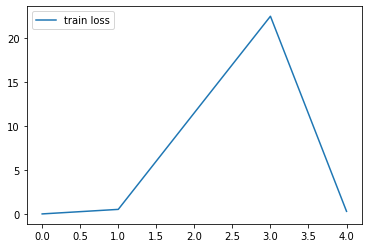

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_dataloader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

/usr/local/lib/python3.6/dist-packages/l5kit/data/zarr_utils.py:243: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 100/100 [00:02<00:00, 42.01it/s]
/usr/local/lib/python3.6/dist-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:06<00:00, 71.96it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
print(pred_path)

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


(25, 224, 224)


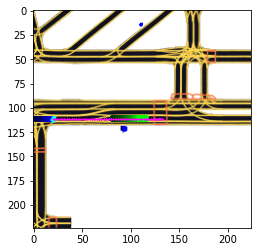

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    print(data_ego['image'].shape)
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()